# DQN for text plagiarism detection

In [1]:
import contextlib
import json
import math
import os
import shutil
import time
from collections import Counter
from functools import partial
from typing import Literal, Protocol

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from cycler import cycler
from torch.utils.data import Dataset
from torchtext.data import get_tokenizer
from torchtext.vocab import GloVe
from tqdm import tqdm

In [2]:
EpsilonStrategy = Literal["cos"] | Literal["line"] | Literal["exp"]


class EpsilonCallable(Protocol):
    def __call__(
        self,
        epoch: int,
        epsilon_start: float,
        epsilon_end: float,
        last_epoch: int,
        epsilon_const: float,
    ) -> float:
        ...

In [3]:
DEVICE = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
# DEVICE = torch.device("cpu")
DEVICE

device(type='cuda')

In [4]:
LOG_PATH_PREFIX = "../logs/dqn/"

## Hyper parameters

In [5]:
RL_GAMMA = 1.0

GLOVE_DIM = 300
TRAIN_SIZE = "md"
TEST_SIZE = "sm"

EMBED_DIM = GLOVE_DIM
LSTM_LAYERS = 1
LSTM_H_DIM = EMBED_DIM
RNET_DROPOUT = 0.5

ENV_GAMMA = 0.1

DQN_LR = 0.005
RNET_LR = 0.005
SRM_LR = 0.005

DQN_SYNC_PERIOD = 2
DQN_CLIP_GRAD = 0.0

PRETRAIN_SRM_RNET_EPOCHS = 200
PRETRAIN_DQN_EPOCHS = 100

EPISODES_BATCH = 10
PRETRAIN_SRM_RNET_BATCH = EPISODES_BATCH

EPSILON_START = 1.0
EPSILON_END = 0.01
EPSILON_STRATEGY: EpsilonStrategy = "cos"
EPSILON_CONSTANT = 50  # 1.4

FEATURES = ""
COMMENTS = ""

EXPERIMENT_NAME = "15_04_2"

EPOCHS = 500
EVAL_PERIOD = 10
LOG_PERIOD = EVAL_PERIOD

In [6]:
# Parameters
EXPERIMENT_NAME = "23_04_2"
EPOCHS = 1500
EVAL_PERIOD = 10
LOG_PERIOD = 10

In [7]:
def pack_hyperparameters() -> dict:
    return {
        "RL_GAMMA": RL_GAMMA,
        "GLOVE_DIM": GLOVE_DIM,
        "TRAIN_SIZE": TRAIN_SIZE,
        "TEST_SIZE": TEST_SIZE,
        "EMBED_DIM": EMBED_DIM,
        "LSTM_LAYERS": LSTM_LAYERS,
        "LSTM_H_DIM": LSTM_H_DIM,
        "RNET_DROPOUT": RNET_DROPOUT,
        "ENV_GAMMA": ENV_GAMMA,
        "DQN_LR": DQN_LR,
        "RNET_LR": RNET_LR,
        "SRM_LR": SRM_LR,
        "DQN_SYNC_PERIOD": DQN_SYNC_PERIOD,
        "DQN_CLIP_GRAD": DQN_CLIP_GRAD,
        "PRETRAIN_SRM_RNET_EPOCHS": PRETRAIN_SRM_RNET_EPOCHS,
        "PRETRAIN_DQN_EPOCHS": PRETRAIN_DQN_EPOCHS,
        "EPISODES_BATCH": EPISODES_BATCH,
        "PRETRAIN_SRM_RNET_BATCH": PRETRAIN_SRM_RNET_BATCH,
        "EPSILON_START": EPSILON_START,
        "EPSILON_END": EPSILON_END,
        "EPSILON_STRATEGY": EPSILON_STRATEGY,
        "EPSILON_CONSTANT": EPSILON_CONSTANT,
        "FEATURES": FEATURES,
        "COMMENTS": COMMENTS,
    }


def load_from_experiments(experiment: str) -> None:
    global \
        RL_GAMMA, \
        GLOVE_DIM, \
        TRAIN_SIZE, \
        TEST_SIZE, \
        EMBED_DIM, \
        LSTM_LAYERS, \
        LSTM_H_DIM, \
        RNET_DROPOUT, \
        ENV_GAMMA, \
        DQN_LR, \
        RNET_LR, \
        SRM_LR, \
        DQN_SYNC_PERIOD, \
        DQN_CLIP_GRAD, \
        PRETRAIN_SRM_RNET_EPOCHS, \
        PRETRAIN_DQN_EPOCHS, \
        EPISODES_BATCH, \
        PRETRAIN_SRM_RNET_BATCH, \
        EPSILON_START, \
        EPSILON_END, \
        EPSILON_STRATEGY, \
        EPSILON_CONSTANT, \
        FEATURES, \
        COMMENTS
    with open(os.path.join(".", LOG_PATH_PREFIX, experiment, "configs.json"), "r") as f:
        hyper_dict = json.load(f)
    RL_GAMMA = hyper_dict["RL_GAMMA"]

    GLOVE_DIM = hyper_dict["GLOVE_DIM"]
    TRAIN_SIZE = hyper_dict["TRAIN_SIZE"]
    TEST_SIZE = hyper_dict["TEST_SIZE"]
    EMBED_DIM = hyper_dict["EMBED_DIM"]
    LSTM_LAYERS = hyper_dict["LSTM_LAYERS"]
    LSTM_H_DIM = hyper_dict["LSTM_H_DIM"]
    RNET_DROPOUT = hyper_dict["RNET_DROPOUT"]
    ENV_GAMMA = hyper_dict["ENV_GAMMA"]
    DQN_LR = hyper_dict["DQN_LR"]
    RNET_LR = hyper_dict["RNET_LR"]
    SRM_LR = hyper_dict["SRM_LR"]
    DQN_SYNC_PERIOD = hyper_dict["DQN_SYNC_PERIOD"]
    DQN_CLIP_GRAD = hyper_dict["DQN_CLIP_GRAD"]
    PRETRAIN_SRM_RNET_EPOCHS = hyper_dict["PRETRAIN_SRM_RNET_EPOCHS"]
    PRETRAIN_DQN_EPOCHS = hyper_dict["PRETRAIN_DQN_EPOCHS"]
    EPISODES_BATCH = hyper_dict["EPISODES_BATCH"]
    PRETRAIN_SRM_RNET_BATCH = hyper_dict["PRETRAIN_SRM_RNET_BATCH"]
    EPSILON_START = hyper_dict["EPSILON_START"]
    EPSILON_END = hyper_dict["EPSILON_END"]
    EPSILON_STRATEGY = hyper_dict["EPSILON_STRATEGY"]
    EPSILON_CONSTANT = hyper_dict["EPSILON_CONSTANT"]
    FEATURES = hyper_dict["FEATURES"]
    COMMENTS = hyper_dict["COMMENTS"]
    print(hyper_dict)

## Epsilon Strategies

EPSILON STRATEGIES GUIDE:

**COS**
- Recommended constant: 50
- Constant range: [0, inf)
- Constant meaning: how frequent hills are

**LINE**
- Recommended constant: (20) 2-50
- Constant range: (1, inf)
- Constant meaning: how curve line is: 2 == almost straight line

**EXP**
- Recommended constant: (1.4) (1-2)
- Constant range: [1, inf)
- Constant meaning: how curve line is: 1 == default exp

In [8]:
def epsilon_cos(
    epoch: int,
    epsilon_start: float,
    epsilon_end: float,
    last_epoch: int,
    epsilon_const=50.0,
) -> float:
    return (
        epsilon_start
        * (np.cos(epsilon_const * epoch - epsilon_const) + 1)
        * np.exp(-4 / last_epoch * (epoch - 1))
        / 2
    )


def epsilon_line(
    epoch: int,
    epsilon_start: float,
    epsilon_end: float,
    last_epoch: int,
    epsilon_const=20.0,
) -> float:
    return -np.emath.logn(
        epsilon_const,
        (
            np.float_power(epsilon_const, -epsilon_start) * (epoch - last_epoch)
            + np.float_power(epsilon_const, -epsilon_end) * (1 - epoch)
        )
        / (1 - last_epoch),
    )


def epsilon_exp(
    epoch: int,
    epsilon_start: float,
    epsilon_end: float,
    last_epoch: int,
    epsilon_const: float = 1.4,
) -> float:
    return epsilon_start * np.exp(
        np.log(epsilon_end / epsilon_start)
        * epsilon_const
        * (epoch - 1)
        / (last_epoch - 1)
    )


EPSILON_STRATEGY_DICT: dict[EpsilonStrategy, EpsilonCallable] = {
    "cos": epsilon_cos,
    "line": epsilon_line,
    "exp": epsilon_exp,
}

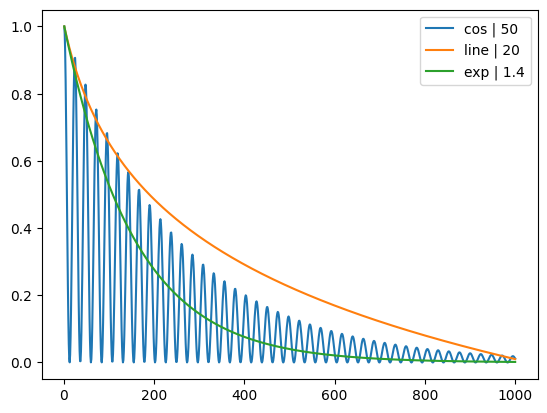

In [14]:
def plot_epsilon_funcs(
    plots: list[tuple[EpsilonStrategy, float]],
    epochs: int,
    epsilon_start=1.0,
    epsilon_end=0.01,
):
    x = list(range(1, epochs + 1))
    for strategy, c in plots:
        plt.plot(
            x,
            [
                EPSILON_STRATEGY_DICT[strategy](i, epsilon_start, epsilon_end, epochs, c)
                for i in x
            ],
            label=f"{strategy} | {c}",
        )
    if len(plots) > 1:
        plt.legend()
    plt.show()


plot_epsilon_funcs([("cos", 50), ("line", 20), ("exp", 1.4)], epochs=1000)

## Utilities

In [10]:
PREDEFINED_COLORS = [
    "#ffa500",
    "#c83cbc",
    "#1c1c84",
    "#ff0000",
    "#08a4a7",
    "#008000",
]


def get_plots(
    data_dict: dict,
    plots: list[tuple[dict, dict]],
    title: str = "",
    ylim=None,
    row_plots: int = 1,
    plot_width: float = 8,
    plot_height: float = 4,
    use_rainbow: bool = False,
    use_common_legend: bool = False,
    adjust: bool = False,
):
    num_plots = len(plots)
    num_entities = max([len(x[1]) for x in plots]) + 1
    if use_rainbow:
        num_colors = num_entities
        cm = plt.get_cmap("gist_rainbow")
        colors = [cm(1.0 * i / num_colors) for i in range(num_colors)]
    else:
        colors = PREDEFINED_COLORS

    style_cycler = cycler(linestyle=["-", "--", ":", "-."]) * cycler(color=colors)
    column_plots = math.ceil(num_plots / row_plots)

    fig, axs = plt.subplots(
        column_plots,
        row_plots,
        figsize=(plot_width * row_plots, plot_height * column_plots),
    )

    if len(title) > 0:
        fig.suptitle(title, fontsize=14, y=1)
    axs_list = [axs] if column_plots * row_plots == 1 else list(axs.flat)

    for ax in axs_list:
        ax.grid()
        ax.set_prop_cycle(style_cycler)
        if ylim is not None:
            ax.set_ylim(top=ylim)
        ax.set_visible(False)

    for ax, (p1, p2) in zip(axs_list, plots):
        ax.set_visible(True)

        ax.set_title(f"{p2['axis_name']} over {p1['axis_name']}")
        ax.set(xlabel=p1["axis_label"], ylabel=p2["axis_label"])

        if p1.get("log", False):
            ax.set_xscale("log")
        if p2.get("log", False):
            ax.set_yscale("log")

        x_values = data_dict[p1.get("ref", None) or p1["axis_name"]]

        p2vs = p2.get("values", [])
        if len(p2vs) == 0:
            y_values = data_dict[p2.get("ref", None) or p2["axis_name"]]
            ax.plot(x_values, y_values, label=p2["axis_name"])
            ax.scatter(x_values[-1], y_values[-1], s=15)
            continue

        for p2v in p2vs:
            y_values = data_dict[p2v.get("ref", None) or p2v["name"]]

            try:
                iter(y_values)
                ax.plot(x_values, y_values, label=p2v["name"])
                ax.scatter(x_values[-1], y_values[-1], s=15)
            except TypeError:
                ax.plot(x_values, [y_values] * len(x_values), label=p2v["name"])

    if use_common_legend:
        lines_labels = [axs_list[0].get_legend_handles_labels()]
        lines, labels = [sum(x, []) for x in zip(*lines_labels)]
        fig.legend(
            lines,
            labels,
            scatterpoints=1,
            markerscale=3,
            loc="outside lower center",
            ncol=min(6, num_entities),
            bbox_to_anchor=(0.5, -0.05),
        )
    else:
        if num_entities > 1:
            for ax, _ in zip(axs_list, plots):
                ax.legend()

    plt.tight_layout()
    if adjust:
        plt.subplots_adjust(
            top=1 - 0.1 / (num_plots**0.5), bottom=0.12 / (num_plots**2), hspace=0.15
        )

    return fig


def draw_plots(
    data_dict: dict,
    plots: list[tuple[dict, dict]],
    title: str = "",
    ylim=None,
    row_plots: int = 1,
    plot_width: float = 8,
    plot_height: float = 4,
    use_rainbow: bool = False,
    use_common_legend: bool = False,
    adjust: bool = False,
):
    get_plots(
        data_dict,
        plots,
        title,
        ylim,
        row_plots,
        plot_width,
        plot_height,
        use_rainbow,
        use_common_legend,
        adjust,
    )
    plt.show()

## Logger

In [11]:
LoggerEntity = Literal["data"] | Literal["model"] | Literal["best"] | Literal["plots"]


class Logger:
    _plot_epoch_axis = {"axis_name": "Epoch", "axis_label": "Epoch"}
    _plot_time_axis = {"axis_name": "Time", "axis_label": "Running time, seconds"}
    log_plots = [
        (
            _plot_epoch_axis,
            {"axis_name": "Mean RNet Loss", "axis_label": "Loss"},
        ),
        (
            _plot_epoch_axis,
            {"axis_name": "Mean DQN Loss", "axis_label": "Loss"},
        ),
        (
            {**_plot_epoch_axis, "ref": "Eval Epoch"},
            {"axis_name": "Mean Test Loss", "axis_label": "Loss"},
        ),
        (
            _plot_epoch_axis,
            {
                "axis_name": "Mean Reward",
                "axis_label": "Reward",
            },
        ),
        (
            _plot_epoch_axis,
            {
                "axis_name": "Deletions ratio",
                "axis_label": "deleted / total",
            },
        ),
        (
            {**_plot_epoch_axis, "ref": "Eval Epoch"},
            {"axis_name": "Test Deletions ratio", "axis_label": "deleted / total"},
        ),
        (
            _plot_epoch_axis,
            {
                "axis_name": "Epsilon",
                "axis_label": "Epsilon",
            },
        ),
    ]

    def _soft_mkdir(self, path: str) -> None:
        with contextlib.suppress(Exception):
            os.makedirs(path)

    def _soft_rmdir(self, path: str) -> None:
        with contextlib.suppress(Exception):
            shutil.rmtree(path)

    def _get_max_index(self, path: str) -> int:
        max_index = 0
        for file in os.listdir(path):
            with contextlib.suppress(ValueError):
                max_index = max(max_index, int(os.path.splitext(file)[0]))
        return max_index

    def _remove_old(self):
        if self.keep_last == -1:
            return
        if self.idx % self.keep_last != 0:
            return
        retain = [str(x) for x in range(self.idx, self.idx - self.keep_last, -1)] + [
            "0",
            "best",
            "configs.json",
        ]

        abs_prefix = os.path.abspath(self.path)
        for item in os.listdir(self.path):
            if item not in retain:
                self._soft_rmdir(os.path.join(abs_prefix, item))

    def _save_json(self, path: str, data: dict) -> None:
        with open(path, "w") as f:
            json.dump(data, f)

    def _load_json(self, path: str) -> dict:
        with open(path, "r") as f:
            return json.load(f)

    def _save_configs(self) -> None:
        self._save_json(os.path.join(self.path, "configs.json"), self.configs)

    def _load_configs(self) -> dict:
        return self._load_json(os.path.join(self.path, "configs.json"))

    def _build_dirs(self) -> None:
        self.dirs = {
            "models": os.path.join(self.path, str(self.idx), "models"),
            "data": os.path.join(self.path, str(self.idx), "data"),
            "plots": os.path.join(self.path, str(self.idx), "plots"),
            "best": os.path.join(self.path, "best"),
        }

        for dir_path in self.dirs.values():
            self._soft_mkdir(dir_path)

    def __init__(
        self,
        path: str,
        configs: dict,
        path_prefix: str = LOG_PATH_PREFIX,
        keep_last: int = 2,
        force: bool = False,
    ) -> None:
        self.keep_last = keep_last
        self.configs = configs
        self.path = os.path.join(".", path_prefix, path)

        if force:
            self._soft_rmdir(os.path.abspath(self.path))

        if os.path.exists(self.path):
            self.new = False
            self.load_state()
        else:
            self.new = True
            self.init_state()

    def init_state(self) -> None:
        self.idx = 0
        self._build_dirs()
        self._save_configs()
        self.save_best_dict({})

    def load_state(self) -> None:
        # Check compatibility
        existed_configs = self._load_configs()
        new_comments = self.configs.get("COMMENTS")
        del existed_configs["COMMENTS"]
        del self.configs["COMMENTS"]
        if existed_configs != self.configs:
            raise Exception("Configs are not the same!")
        self.configs["COMMENTS"] = new_comments

        self.idx = self._get_max_index(self.path)
        self._build_dirs()

    def update_idx(self, inc_value: int):
        self.new = False
        self.idx += inc_value
        self._build_dirs()
        self._remove_old()

    def load(self, name: str, entity: str, *data):
        if entity == "model":
            checkpoint = torch.load(os.path.join(self.dirs["models"], name))
            model, optimizer = data
            model.load_state_dict(checkpoint["model_state_dict"])
            optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
            return None

        if entity == "data":
            return self._load_json(os.path.join(self.dirs["data"], f"{name}.json"))

        return None

    def save(self, name: str, entity: LoggerEntity, data, save_subplots: bool = False):
        if entity == "model":
            model, optimizer = data
            torch.save(
                {
                    "model_state_dict": model.state_dict(),
                    "optimizer_state_dict": optimizer.state_dict(),
                },
                os.path.join(self.dirs["models"], name),
            )
            return
        if entity == "data":
            self._save_json(os.path.join(self.dirs["data"], f"{name}.json"), data)
            return

        if entity == "plots":
            plots_data = data
            if save_subplots:
                for single_plot in [[sp] for sp in self.log_plots]:
                    fig = get_plots(plots_data, single_plot, row_plots=1)
                    plot_name = f"{single_plot[0][1]['axis_name']} over {single_plot[0][0]['axis_name']}".replace(
                        " ", "_"
                    ).lower()
                    fig.savefig(
                        os.path.join(self.dirs["plots"], f"{name}{plot_name}.png")
                    )
                    plt.close()
                    plt.clf()

            fig = get_plots(plots_data, self.log_plots, row_plots=2)
            fig.savefig(os.path.join(self.dirs["plots"], f"{name}all.png"))
            plt.close()
            plt.clf()
            return
        if entity == "best":
            best_info_dict, best_dict = data
            best_path = os.path.abspath(self.dirs["best"])
            new_bests = {x[1] for x in best_dict.values()}

            old_bests = set()
            for item in os.listdir(best_path):
                with contextlib.suppress(BaseException):
                    old_bests.add(int(item))

            # delete old
            to_delete = old_bests.difference(new_bests)
            for epoch in to_delete:
                self._soft_rmdir(os.path.join(best_path, str(epoch)))

            # save new
            for epoch, best_data in best_info_dict.items():
                if epoch not in new_bests:
                    continue
                for model_name, (model_state, optimizer_state) in best_data[
                    "models"
                ].items():
                    path_prefix = os.path.join(best_path, str(epoch), "models")
                    self._soft_mkdir(path_prefix)
                    torch.save(
                        {
                            "model_state_dict": model_state,
                            "optimizer_state_dict": optimizer_state,
                        },
                        os.path.join(path_prefix, model_name),
                    )
                for file_name, file_data in best_data["data"].items():
                    path_prefix = os.path.join(best_path, str(epoch), "data")
                    self._soft_mkdir(path_prefix)
                    self._save_json(
                        os.path.join(path_prefix, f"{file_name}.json"), file_data
                    )
            return

    def save_best_dict(self, best_dict: dict) -> None:
        self._save_json(os.path.join(self.path, "best.json"), best_dict)

    def load_best_dict(self) -> dict:
        res_dict = {}
        for k, v in self._load_json(os.path.join(self.path, "best.json")).items():
            res_dict[float(k)] = v
        return res_dict

    @staticmethod
    def update_best_dict(
        best_dict: dict, loss, deletions_ratio: float, epoch: int
    ) -> tuple[dict, bool]:
        check_ls = [
            float(ls) for r, (ls, _) in best_dict.items() if float(r) >= deletions_ratio
        ]

        # check if we removed more and got less loss
        if len(check_ls) > 0 and loss >= min(check_ls):
            return best_dict, False

        # remove when we deleted less and got bigger loss
        to_delete = [
            float(r)
            for r, (ls, _) in best_dict.items()
            if float(r) <= deletions_ratio and float(ls) >= loss
        ]
        for del_k in to_delete:
            del best_dict[del_k]

        best_dict[deletions_ratio] = [loss, epoch]
        return best_dict, True

## Dataset

In [12]:
tokenizer = get_tokenizer("basic_english")
global_vectors = GloVe(dim=GLOVE_DIM, cache="../data")


def text_pipeline(x):
    return global_vectors.get_vecs_by_tokens(tokenizer(x), lower_case_backup=True)


def tokenized_pipeline(x):
    return global_vectors.get_vecs_by_tokens(x, lower_case_backup=True)

In [13]:
def read_from_disk(path: str) -> np.ndarray:
    return pd.read_csv(path).to_numpy()

In [14]:
class PlagiarismDataset(Dataset):
    def __init__(self, data: np.ndarray):
        targets, candidates, scores = [], [], []

        for target, candidate, score in data:
            targets.append(tokenizer(target))
            candidates.append(tokenizer(candidate))
            scores.append(score)

        self.targets = targets
        self.candidates = candidates
        self.scores = np.array(scores).astype(np.float16)

    def __len__(self):
        return len(self.scores)

    def __getitem__(
        self, idx
    ) -> tuple[torch.Tensor, torch.Tensor, torch.Tensor, list, list]:
        return (
            tokenized_pipeline(self.targets[idx]).to(DEVICE),
            tokenized_pipeline(self.candidates[idx]).to(DEVICE),
            torch.tensor([self.scores[idx]]).float().to(DEVICE),
            self.targets[idx],
            self.candidates[idx],
        )

In [15]:
train_data = PlagiarismDataset(
    read_from_disk(f"../generated/datasets/train_{TRAIN_SIZE}.csv")
)
test_data = PlagiarismDataset(
    read_from_disk(f"../generated/datasets/test_{TEST_SIZE}.csv")
)

print(f"{len(train_data)=}")
print(f"{len(test_data)=}")

len(train_data)=5040
len(test_data)=147


## RNet & SRModel

In [16]:
class RNetNN(nn.Module):
    def __init__(self, input_dim: int, output_dim: int, hidden_dim: int = 128) -> None:
        super(RNetNN, self).__init__()

        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(RNET_DROPOUT),
            nn.Linear(hidden_dim, output_dim),
            nn.Sigmoid(),
        )

    def forward(self, x):
        return self.net(x)


class RNet:
    def __init__(self, lr: float = 1e-2, device=DEVICE):
        self.net = RNetNN(2 * LSTM_LAYERS * LSTM_H_DIM, 1).to(device)
        self.loss_fn = F.mse_loss
        self.optimizer = optim.Adam(
            self.net.parameters(),
            lr=lr,
        )

    def __call__(self, data: torch.Tensor, grad: bool = True) -> torch.Tensor:
        if grad:
            return self.net(data)
        with torch.no_grad():
            return self.net(data)


class SRModelNN(nn.Module):
    def __init__(
        self, input_dim: int, hidden_size: int, num_layers: int = LSTM_LAYERS
    ) -> None:
        super(SRModelNN, self).__init__()

        self.net = nn.LSTM(
            input_dim,
            hidden_size,
            num_layers=num_layers,
            bidirectional=False,
        ).to(DEVICE)

    def forward(self, *x):
        return self.net(*x)


class SRModel:
    def __init__(self, lr: float = 1e-2, device=DEVICE):
        self.net = SRModelNN(EMBED_DIM, LSTM_H_DIM).to(device)
        self.optimizer = optim.Adam(
            self.net.parameters(),
            lr=lr,
        )

        self.device = device

    def __call__(self, *data, grad: bool = True) -> torch.Tensor:
        if grad:
            return self.net(*data)
        with torch.no_grad():
            return self.net(*data)

    def call_batch(self, data, grad: bool = True) -> torch.Tensor:
        cat_data = torch.cat(data) if type(data) == list else data
        cat_data = cat_data.view(len(data), 1, -1)
        h_c = (
            torch.zeros(LSTM_LAYERS, 1, LSTM_H_DIM).to(self.device),
            torch.zeros(LSTM_LAYERS, 1, LSTM_H_DIM).to(self.device),
        )
        out, _ = self.__call__(cat_data, h_c, grad=grad)
        return out[-1].flatten()

In [17]:
def update_sample(
    srm: SRModel,
    rnet: RNet,
    target: list[torch.Tensor],
    candidate: list[torch.Tensor],
    train_srm: bool = True,
    train_rnet: bool = True,
):
    srm_out_target = srm.call_batch(target, train_srm)
    srm_out_candidate = srm.call_batch(candidate, train_srm)

    rnet_out = rnet(
        torch.cat([srm_out_target, srm_out_candidate]).view(1, -1), grad=train_rnet
    )

    return rnet_out.squeeze(-1)


def update_models(
    srm: SRModel,
    rnet: RNet,
    data: list[tuple[list[torch.Tensor], list[torch.Tensor], float]],
    train_srm: bool = True,
    train_rnet: bool = True,
) -> float:
    srm.net.train(train_srm)
    rnet.net.train(train_rnet)

    srm.optimizer.zero_grad()
    rnet.optimizer.zero_grad()

    predicts = []
    scores = []

    for target, candidate, score in data:
        predicted = update_sample(srm, rnet, target, candidate, train_srm, train_rnet)
        scores.append(score)
        predicts.append(predicted)

    score_tensor = torch.FloatTensor(scores).to(DEVICE)
    loss = rnet.loss_fn(torch.cat(predicts), score_tensor)

    loss.backward()
    srm.optimizer.step()
    rnet.optimizer.step()

    srm.net.train(False)
    rnet.net.train(False)

    return loss.item()

## Environment

In [18]:
class Env:
    def _get_state(self) -> torch.Tensor:
        token = self.data[self.sentence_idx][self.token_idx]
        return torch.cat(
            [
                self.hs[self.sentence_idx].flatten(),
                self.cs[self.sentence_idx].flatten(),
                token,
            ]
        ).to(DEVICE)

    def _get_reward(self) -> float:
        if not self.is_terminal():
            return 0.0

        self.statistics_dict["Deletions ratio"] = (
            self.statistics_dict["Deletions"] / self.total_words
        )

        # Case when agent removes the entire sequence
        if self.statistics_dict["Deletions"] == self.total_words:
            return 0.0

        rnet_out = self.rnet(self.hs.view(1, -1), grad=False)

        score_tensor = torch.FloatTensor([self.data[2]]).to(DEVICE)
        loss = self.rnet.loss_fn(rnet_out.squeeze(-1), score_tensor)
        self.loss = loss.item()

        rnet_reward = np.log(1 - loss.item() + 1e-8)
        deletions_reward = (
            self.gamma * self.statistics_dict["Deletions"] / self.total_words
        )

        self.statistics_dict["RNet reward"] = rnet_reward
        self.statistics_dict["Deletions reward"] = deletions_reward

        return rnet_reward + deletions_reward

    def __init__(
        self,
        dataset: Dataset,
        srm: SRModel,
        rnet: RNet,
        gamma: float = ENV_GAMMA,
        random_sampling: bool = True,
    ) -> None:
        self.srm = srm
        self.rnet = rnet

        self.gamma = gamma

        self.dataset = dataset

        self.random_sampling = random_sampling
        self.idx = -1

        self.reset()

    def reset(self, idx: int = -1) -> torch.Tensor:
        self.loss = -1

        self.steps = 0

        self.sentence_idx = 0
        self.token_idx = 0

        if self.random_sampling:
            self.idx = np.random.randint(len(self.dataset))
        elif idx >= 0:
            self.idx = idx
        else:
            self.idx = (self.idx + 1) % len(self.dataset)

        self.data = self.dataset[self.idx]

        self.total_words = len(self.data[0]) + len(self.data[1])

        self.hs = torch.zeros((2, LSTM_LAYERS, LSTM_H_DIM)).to(DEVICE)
        self.cs = torch.zeros((2, LSTM_LAYERS, LSTM_H_DIM)).to(DEVICE)

        self.used_tokens: tuple[list[torch.Tensor], list[torch.Tensor], float] = (
            [],
            [],
            self.data[2].item(),
        )
        self.deleted_tokens_dict = {}

        self.statistics_dict = {
            "Initial Target length": len(self.data[0]),
            "Initial Candidate length": len(self.data[1]),
            "Processed Target length": 0,
            "Processed Candidate length": 0,
            "Deletions": 0,
            "RNet reward": 0.0,
            "Deletions reward": 0.0,
            "Deletions ratio": 0.0,
        }

        return self.get_state()

    def get_state(self) -> torch.Tensor:
        return self._get_state()

    def is_terminal(self) -> bool:
        return self.sentence_idx == 1 and self.token_idx == (len(self.data[1]) - 1)

    def interact(self, action: int) -> tuple[torch.Tensor, float, bool]:
        # 0 - retain
        # 1 - delete

        if self.is_terminal():
            return self._get_state(), 0, self.is_terminal()

        if action == 1:
            self.statistics_dict["Deletions"] += 1
            pure_token = self.data[self.sentence_idx + 3][self.token_idx].lower()
            self.deleted_tokens_dict[pure_token] = (
                self.deleted_tokens_dict.get(pure_token, 0) + 1
            )

        elif action == 0:
            if self.sentence_idx == 0:
                self.statistics_dict["Processed Target length"] += 1
            else:
                self.statistics_dict["Processed Candidate length"] += 1

            token = self.data[self.sentence_idx][self.token_idx]
            self.used_tokens[self.sentence_idx].append(  # type: ignore
                token.clone().detach()
            )

            h_c = (
                self.hs[self.sentence_idx].clone().detach(),
                self.cs[self.sentence_idx].clone().detach(),
            )

            _, (h, c) = self.srm(token.view(1, -1), h_c, grad=False)
            self.hs[self.sentence_idx] = h.clone().detach()
            self.cs[self.sentence_idx] = c.clone().detach()

        self.steps += 1
        self.token_idx += 1
        if self.sentence_idx == 0 and self.token_idx >= len(self.data[0]):
            self.sentence_idx = 1
            self.token_idx = 0

        return self._get_state(), self._get_reward(), self.is_terminal()

    def get_used_tokens(self) -> tuple[list[torch.Tensor], list[torch.Tensor], float]:
        if len(self.used_tokens[0]) == 0:
            self.used_tokens[0].append(torch.zeros(LSTM_LAYERS, LSTM_H_DIM).to(DEVICE))
        if len(self.used_tokens[1]) == 0:
            self.used_tokens[1].append(torch.zeros(LSTM_LAYERS, LSTM_H_DIM).to(DEVICE))
        return self.used_tokens

    def get_observation_shape(self) -> int:
        return 2 * LSTM_LAYERS * LSTM_H_DIM + EMBED_DIM

    def get_actions_shape(self) -> int:
        return 2

    @staticmethod
    def sample_action() -> int:
        return np.random.choice([0, 1])

## DQN


In [19]:
class DQN(nn.Module):
    def __init__(self, input_dim: int, output_dim: int, hidden_dim: int = 16) -> None:
        super(DQN, self).__init__()

        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim),
        )

    def forward(self, x):
        return self.net(x)

## Agent

In [20]:
class Agent:
    def __init__(self) -> None:
        epsilon_fc = EPSILON_STRATEGY_DICT[EPSILON_STRATEGY]
        self.get_epsilon = partial(
            epsilon_fc,
            epsilon_start=EPSILON_START,
            epsilon_end=EPSILON_END,
            epsilon_const=EPSILON_CONSTANT,
            last_epoch=EPOCHS,
        )

    @torch.no_grad()
    def choose_optimal_action(self, state: torch.Tensor, dqn: nn.Module) -> int:
        q_vals_v = dqn(state)
        act_v = torch.argmax(q_vals_v)
        return int(act_v.item())

    def choose_action(self, state: torch.Tensor, dqn: nn.Module, epoch: int) -> int:
        if np.random.random() < self.get_epsilon(epoch):
            return Env.sample_action()
        return self.choose_optimal_action(state, dqn)

## Trajectory Buffer

In [21]:
class TrajectoryBuffer:
    """
    Buffer class to store the experience from a unique policy
    """

    def __init__(self):
        self.states = []
        self.actions = []
        self.rewards = []
        self.dones = []
        self.next_states = []

        self.tokens_data = []

    def store(
        self,
        state: np.ndarray,
        action: int,
        reward: float,
        done: bool,
        next_state: np.ndarray,
    ):
        """
        Add trajectory values to the buffers
        """
        self.states.append(state)
        self.actions.append(action)
        self.rewards.append(reward)
        self.dones.append(int(done))
        self.next_states.append(next_state)

    def store_tokens(
        self, tokens_info: tuple[list[torch.Tensor], list[torch.Tensor], float]
    ):
        self.tokens_data.append(tokens_info)

    def get_batch(self):
        return (
            self.states,
            self.actions,
            self.rewards,
            self.dones,
            self.next_states,
            self.tokens_data,
        )

    def __len__(self):
        assert len(self.states) == len(self.actions) == len(self.rewards)
        return len(self.states)

## Evaluation

In [22]:
def evaluate(
    srm: SRModel,
    rnet: RNet,
    dqn: nn.Module,
    agent: Agent,
    data: Dataset,
) -> tuple[list[float], float, Counter]:  # (losses, deleted ratio, deletion statistics)
    srm.net.eval()
    rnet.net.eval()
    dqn.eval()

    losses = []
    deleted_ratios: list[float] = []
    statistics_deleted_dict = Counter({})

    eval_env = Env(data, srm, rnet, random_sampling=False)

    iteration = 0
    state = eval_env.reset(0)
    with tqdm(total=len(data), desc="Evaluation") as loop:
        while iteration < len(data):
            action = agent.choose_optimal_action(state, dqn)
            state2, _, done = eval_env.interact(action)
            state = state2.clone().detach()

            if done:
                iteration += 1
                losses.append(eval_env.loss)

                statistics_deleted_dict.update(Counter(eval_env.deleted_tokens_dict))
                deleted_ratios.append(eval_env.statistics_dict["Deletions ratio"])

                state = eval_env.reset()

                loop.update(1)
                loop.set_postfix(
                    {
                        "Mean Test loss": np.mean(losses),
                    }
                )
    return losses, float(np.mean(deleted_ratios)), statistics_deleted_dict

## Training

In [23]:
# load_from_experiments(...)
LOGGER = Logger(EXPERIMENT_NAME, pack_hyperparameters())

In [24]:
if LOGGER.new:
    np.random.seed(42)
    torch.manual_seed(42)

rnet = RNet(lr=RNET_LR)
srm = SRModel(lr=SRM_LR)

env = Env(train_data, srm, rnet)
agent = Agent()

dqn_net = DQN(
    input_dim=env.get_observation_shape(), output_dim=env.get_actions_shape()
).to(DEVICE)
dqn_target_net = DQN(
    input_dim=env.get_observation_shape(), output_dim=env.get_actions_shape()
).to(DEVICE)
dqn_optimizer = optim.Adam(dqn_net.parameters(), lr=DQN_LR)

### Pre-train SRM and RNet

In [25]:
def pretrain_srm_rnet(
    srm: SRModel, rnet: RNet, data: Dataset, epochs: int = PRETRAIN_SRM_RNET_EPOCHS
) -> None:
    for _ in tqdm(range(epochs), desc="Pre-training SRM & RNet"):
        values = []
        for idx in np.random.choice(
            range(len(data)), size=PRETRAIN_SRM_RNET_BATCH, replace=True
        ):
            item = data[idx]
            values.append((item[0], item[1], item[2]))
        update_models(srm, rnet, values)


if LOGGER.new:
    pretrain_srm_rnet(srm, rnet, train_data)


Pre-training SRM & RNet:   0%|          | 0/200 [00:00<?, ?it/s]


Pre-training SRM & RNet:   0%|          | 1/200 [00:00<00:53,  3.70it/s]


Pre-training SRM & RNet:   2%|▏         | 3/200 [00:00<00:28,  7.00it/s]


Pre-training SRM & RNet:   2%|▏         | 4/200 [00:00<00:25,  7.64it/s]


Pre-training SRM & RNet:   2%|▎         | 5/200 [00:00<00:23,  8.21it/s]


Pre-training SRM & RNet:   3%|▎         | 6/200 [00:00<00:23,  8.34it/s]


Pre-training SRM & RNet:   4%|▎         | 7/200 [00:00<00:23,  8.30it/s]


Pre-training SRM & RNet:   4%|▍         | 8/200 [00:01<00:22,  8.36it/s]


Pre-training SRM & RNet:   4%|▍         | 9/200 [00:01<00:22,  8.33it/s]


Pre-training SRM & RNet:   5%|▌         | 10/200 [00:01<00:21,  8.74it/s]


Pre-training SRM & RNet:   6%|▌         | 11/200 [00:01<00:21,  8.86it/s]


Pre-training SRM & RNet:   6%|▌         | 12/200 [00:01<00:21,  8.87it/s]


Pre-training SRM & RNet:   7%|▋         | 14/200 [00:01<00:20,  9.16it/s]


Pre-training SRM & RNet:   8%|▊         | 16/200 [00:01<00:18,  9.80it/s]


Pre-training SRM & RNet:   9%|▉         | 18/200 [00:02<00:17, 10.46it/s]


Pre-training SRM & RNet:  10%|█         | 20/200 [00:02<00:16, 10.64it/s]


Pre-training SRM & RNet:  11%|█         | 22/200 [00:02<00:17, 10.37it/s]


Pre-training SRM & RNet:  12%|█▏        | 24/200 [00:02<00:16, 10.71it/s]


Pre-training SRM & RNet:  13%|█▎        | 26/200 [00:02<00:15, 11.17it/s]


Pre-training SRM & RNet:  14%|█▍        | 28/200 [00:02<00:15, 10.85it/s]


Pre-training SRM & RNet:  15%|█▌        | 30/200 [00:03<00:16, 10.58it/s]


Pre-training SRM & RNet:  16%|█▌        | 32/200 [00:03<00:15, 10.55it/s]


Pre-training SRM & RNet:  17%|█▋        | 34/200 [00:03<00:16, 10.22it/s]


Pre-training SRM & RNet:  18%|█▊        | 36/200 [00:03<00:15, 10.55it/s]


Pre-training SRM & RNet:  19%|█▉        | 38/200 [00:03<00:15, 10.70it/s]


Pre-training SRM & RNet:  20%|██        | 40/200 [00:04<00:15, 10.61it/s]


Pre-training SRM & RNet:  21%|██        | 42/200 [00:04<00:14, 10.96it/s]


Pre-training SRM & RNet:  22%|██▏       | 44/200 [00:04<00:14, 11.13it/s]


Pre-training SRM & RNet:  23%|██▎       | 46/200 [00:04<00:14, 10.98it/s]


Pre-training SRM & RNet:  24%|██▍       | 48/200 [00:04<00:13, 11.23it/s]


Pre-training SRM & RNet:  25%|██▌       | 50/200 [00:04<00:13, 11.52it/s]


Pre-training SRM & RNet:  26%|██▌       | 52/200 [00:05<00:13, 11.38it/s]


Pre-training SRM & RNet:  27%|██▋       | 54/200 [00:05<00:12, 11.42it/s]


Pre-training SRM & RNet:  28%|██▊       | 56/200 [00:05<00:12, 11.27it/s]


Pre-training SRM & RNet:  29%|██▉       | 58/200 [00:05<00:13, 10.78it/s]


Pre-training SRM & RNet:  30%|███       | 60/200 [00:05<00:12, 11.05it/s]


Pre-training SRM & RNet:  31%|███       | 62/200 [00:06<00:12, 11.07it/s]


Pre-training SRM & RNet:  32%|███▏      | 64/200 [00:06<00:12, 11.33it/s]


Pre-training SRM & RNet:  33%|███▎      | 66/200 [00:06<00:11, 11.43it/s]


Pre-training SRM & RNet:  34%|███▍      | 68/200 [00:06<00:11, 11.50it/s]


Pre-training SRM & RNet:  35%|███▌      | 70/200 [00:06<00:11, 11.29it/s]


Pre-training SRM & RNet:  36%|███▌      | 72/200 [00:06<00:11, 11.56it/s]


Pre-training SRM & RNet:  37%|███▋      | 74/200 [00:07<00:10, 11.72it/s]


Pre-training SRM & RNet:  38%|███▊      | 76/200 [00:07<00:10, 11.87it/s]


Pre-training SRM & RNet:  39%|███▉      | 78/200 [00:07<00:10, 11.84it/s]


Pre-training SRM & RNet:  40%|████      | 80/200 [00:07<00:09, 12.21it/s]


Pre-training SRM & RNet:  41%|████      | 82/200 [00:07<00:10, 11.75it/s]


Pre-training SRM & RNet:  42%|████▏     | 84/200 [00:07<00:09, 11.87it/s]


Pre-training SRM & RNet:  43%|████▎     | 86/200 [00:08<00:10, 11.10it/s]


Pre-training SRM & RNet:  44%|████▍     | 88/200 [00:08<00:09, 11.26it/s]


Pre-training SRM & RNet:  45%|████▌     | 90/200 [00:08<00:09, 11.14it/s]


Pre-training SRM & RNet:  46%|████▌     | 92/200 [00:08<00:09, 11.46it/s]


Pre-training SRM & RNet:  47%|████▋     | 94/200 [00:08<00:09, 11.40it/s]


Pre-training SRM & RNet:  48%|████▊     | 96/200 [00:08<00:09, 11.38it/s]


Pre-training SRM & RNet:  49%|████▉     | 98/200 [00:09<00:08, 11.49it/s]


Pre-training SRM & RNet:  50%|█████     | 100/200 [00:09<00:08, 11.48it/s]


Pre-training SRM & RNet:  51%|█████     | 102/200 [00:09<00:08, 11.42it/s]


Pre-training SRM & RNet:  52%|█████▏    | 104/200 [00:09<00:08, 11.96it/s]


Pre-training SRM & RNet:  53%|█████▎    | 106/200 [00:09<00:07, 12.09it/s]


Pre-training SRM & RNet:  54%|█████▍    | 108/200 [00:10<00:07, 11.55it/s]


Pre-training SRM & RNet:  55%|█████▌    | 110/200 [00:10<00:08, 11.16it/s]


Pre-training SRM & RNet:  56%|█████▌    | 112/200 [00:10<00:07, 11.21it/s]


Pre-training SRM & RNet:  57%|█████▋    | 114/200 [00:10<00:07, 11.41it/s]


Pre-training SRM & RNet:  58%|█████▊    | 116/200 [00:10<00:07, 11.19it/s]


Pre-training SRM & RNet:  59%|█████▉    | 118/200 [00:10<00:07, 11.50it/s]


Pre-training SRM & RNet:  60%|██████    | 120/200 [00:11<00:06, 11.45it/s]


Pre-training SRM & RNet:  61%|██████    | 122/200 [00:11<00:06, 11.64it/s]


Pre-training SRM & RNet:  62%|██████▏   | 124/200 [00:11<00:06, 11.46it/s]


Pre-training SRM & RNet:  63%|██████▎   | 126/200 [00:11<00:06, 11.87it/s]


Pre-training SRM & RNet:  64%|██████▍   | 128/200 [00:11<00:06, 11.76it/s]


Pre-training SRM & RNet:  65%|██████▌   | 130/200 [00:11<00:05, 11.74it/s]


Pre-training SRM & RNet:  66%|██████▌   | 132/200 [00:12<00:05, 11.85it/s]


Pre-training SRM & RNet:  67%|██████▋   | 134/200 [00:12<00:05, 11.81it/s]


Pre-training SRM & RNet:  68%|██████▊   | 136/200 [00:12<00:05, 11.23it/s]


Pre-training SRM & RNet:  69%|██████▉   | 138/200 [00:12<00:05, 11.35it/s]


Pre-training SRM & RNet:  70%|███████   | 140/200 [00:12<00:05, 11.79it/s]


Pre-training SRM & RNet:  71%|███████   | 142/200 [00:12<00:04, 11.60it/s]


Pre-training SRM & RNet:  72%|███████▏  | 144/200 [00:13<00:04, 11.52it/s]


Pre-training SRM & RNet:  73%|███████▎  | 146/200 [00:13<00:04, 11.69it/s]


Pre-training SRM & RNet:  74%|███████▍  | 148/200 [00:13<00:04, 11.49it/s]


Pre-training SRM & RNet:  75%|███████▌  | 150/200 [00:13<00:04, 11.36it/s]


Pre-training SRM & RNet:  76%|███████▌  | 152/200 [00:13<00:04, 10.30it/s]


Pre-training SRM & RNet:  77%|███████▋  | 154/200 [00:14<00:04, 10.34it/s]


Pre-training SRM & RNet:  78%|███████▊  | 156/200 [00:14<00:04, 10.47it/s]


Pre-training SRM & RNet:  79%|███████▉  | 158/200 [00:14<00:03, 10.77it/s]


Pre-training SRM & RNet:  80%|████████  | 160/200 [00:14<00:03, 11.22it/s]


Pre-training SRM & RNet:  81%|████████  | 162/200 [00:14<00:03, 11.55it/s]


Pre-training SRM & RNet:  82%|████████▏ | 164/200 [00:14<00:03, 11.38it/s]


Pre-training SRM & RNet:  83%|████████▎ | 166/200 [00:15<00:02, 11.46it/s]


Pre-training SRM & RNet:  84%|████████▍ | 168/200 [00:15<00:02, 11.48it/s]


Pre-training SRM & RNet:  85%|████████▌ | 170/200 [00:15<00:02, 11.27it/s]


Pre-training SRM & RNet:  86%|████████▌ | 172/200 [00:15<00:02, 11.82it/s]


Pre-training SRM & RNet:  87%|████████▋ | 174/200 [00:15<00:02, 11.96it/s]


Pre-training SRM & RNet:  88%|████████▊ | 176/200 [00:15<00:02, 11.72it/s]


Pre-training SRM & RNet:  89%|████████▉ | 178/200 [00:16<00:01, 12.08it/s]


Pre-training SRM & RNet:  90%|█████████ | 180/200 [00:16<00:01, 11.53it/s]


Pre-training SRM & RNet:  91%|█████████ | 182/200 [00:16<00:01, 11.72it/s]


Pre-training SRM & RNet:  92%|█████████▏| 184/200 [00:16<00:01, 11.61it/s]


Pre-training SRM & RNet:  93%|█████████▎| 186/200 [00:16<00:01, 10.97it/s]


Pre-training SRM & RNet:  94%|█████████▍| 188/200 [00:17<00:01, 10.83it/s]


Pre-training SRM & RNet:  95%|█████████▌| 190/200 [00:17<00:00, 11.28it/s]


Pre-training SRM & RNet:  96%|█████████▌| 192/200 [00:17<00:00, 11.63it/s]


Pre-training SRM & RNet:  97%|█████████▋| 194/200 [00:17<00:00, 11.81it/s]


Pre-training SRM & RNet:  98%|█████████▊| 196/200 [00:17<00:00, 11.78it/s]


Pre-training SRM & RNet:  99%|█████████▉| 198/200 [00:17<00:00, 11.80it/s]


Pre-training SRM & RNet: 100%|██████████| 200/200 [00:18<00:00, 11.06it/s]


Pre-training SRM & RNet: 100%|██████████| 200/200 [00:18<00:00, 11.05it/s]

### Pre-train DQN Net

In [26]:
def pretrain_dqn(
    srm: SRModel,
    rnet: RNet,
    dqn: nn.Module,
    dqn_optimizer: torch.optim.Optimizer,
    dqn_target_net: nn.Module,
    agent: Agent,
    data: Dataset,
    epochs: int = PRETRAIN_DQN_EPOCHS,
) -> None:
    pre_env = Env(data, srm, rnet)
    dqn.train()
    for i in tqdm(range(epochs), desc="Pre-training DQN"):
        state = pre_env.reset()
        buffer = TrajectoryBuffer()
        ep_rewards = []
        done_episodes = 0

        while done_episodes < EPISODES_BATCH:
            action = agent.choose_action(state, dqn_net, i)
            state2, reward, done = env.interact(action)

            buffer.store(
                state.cpu().clone().detach().numpy(),
                int(action),
                reward,
                done,
                state2.cpu().clone().detach().numpy(),
            )

            state = state2.clone().detach()
            ep_rewards.append(reward)

            if done:
                buffer.store_tokens(env.get_used_tokens())

                state = env.reset()
                ep_rewards = []
                done_episodes += 1

        (
            state_batch,
            action_batch,
            reward_batch,
            done_batch,
            next_state_batch,
            _,
        ) = buffer.get_batch()

        # Update DQN
        if i % DQN_SYNC_PERIOD == 0:
            dqn_target_net.load_state_dict(dqn_net.state_dict())

        dqn_optimizer.zero_grad()
        batch_states_t = torch.FloatTensor(np.array(state_batch)).to(DEVICE)
        batch_actions_t = torch.LongTensor(action_batch).to(DEVICE)
        batch_rewards_t = torch.FloatTensor(reward_batch).to(DEVICE)
        done_mask = torch.BoolTensor(done_batch).to(DEVICE)
        batch_next_states_t = torch.FloatTensor(np.array(next_state_batch)).to(DEVICE)

        state_action_values = (
            dqn_net(batch_states_t).gather(1, batch_actions_t.unsqueeze(-1)).squeeze(-1)
        )
        with torch.no_grad():
            next_state_values = dqn_target_net(batch_next_states_t).max(1)[0]
            next_state_values[done_mask] = 0.0
            next_state_values = next_state_values.detach()

        expected_state_action_values = next_state_values * RL_GAMMA + batch_rewards_t
        loss_v = F.mse_loss(state_action_values, expected_state_action_values)
        loss_v.backward()

        if DQN_CLIP_GRAD > 0:
            nn.utils.clip_grad_norm_(dqn_net.parameters(), DQN_CLIP_GRAD)
        dqn_optimizer.step()


if LOGGER.new:
    pretrain_dqn(srm, rnet, dqn_net, dqn_optimizer, dqn_target_net, agent, train_data)


Pre-training DQN:   0%|          | 0/100 [00:00<?, ?it/s]


Pre-training DQN:   1%|          | 1/100 [00:00<01:22,  1.20it/s]


Pre-training DQN:   2%|▏         | 2/100 [00:01<01:12,  1.34it/s]


Pre-training DQN:   3%|▎         | 3/100 [00:02<01:04,  1.49it/s]


Pre-training DQN:   4%|▍         | 4/100 [00:02<01:01,  1.57it/s]


Pre-training DQN:   5%|▌         | 5/100 [00:03<01:02,  1.53it/s]


Pre-training DQN:   6%|▌         | 6/100 [00:04<01:00,  1.54it/s]


Pre-training DQN:   7%|▋         | 7/100 [00:04<01:03,  1.46it/s]


Pre-training DQN:   8%|▊         | 8/100 [00:05<01:07,  1.37it/s]


Pre-training DQN:   9%|▉         | 9/100 [00:06<01:08,  1.33it/s]


Pre-training DQN:  10%|█         | 10/100 [00:07<01:11,  1.26it/s]


Pre-training DQN:  11%|█         | 11/100 [00:08<01:17,  1.15it/s]


Pre-training DQN:  12%|█▏        | 12/100 [00:09<01:22,  1.06it/s]


Pre-training DQN:  13%|█▎        | 13/100 [00:10<01:31,  1.05s/it]


Pre-training DQN:  14%|█▍        | 14/100 [00:11<01:33,  1.08s/it]


Pre-training DQN:  15%|█▌        | 15/100 [00:13<01:34,  1.12s/it]


Pre-training DQN:  16%|█▌        | 16/100 [00:14<01:31,  1.10s/it]


Pre-training DQN:  17%|█▋        | 17/100 [00:15<01:28,  1.07s/it]


Pre-training DQN:  18%|█▊        | 18/100 [00:16<01:24,  1.04s/it]


Pre-training DQN:  19%|█▉        | 19/100 [00:17<01:20,  1.00it/s]


Pre-training DQN:  20%|██        | 20/100 [00:17<01:16,  1.05it/s]


Pre-training DQN:  21%|██        | 21/100 [00:18<01:11,  1.11it/s]


Pre-training DQN:  22%|██▏       | 22/100 [00:19<01:06,  1.17it/s]


Pre-training DQN:  23%|██▎       | 23/100 [00:20<01:02,  1.24it/s]


Pre-training DQN:  24%|██▍       | 24/100 [00:20<00:58,  1.30it/s]


Pre-training DQN:  25%|██▌       | 25/100 [00:21<00:55,  1.35it/s]


Pre-training DQN:  26%|██▌       | 26/100 [00:22<00:52,  1.41it/s]


Pre-training DQN:  27%|██▋       | 27/100 [00:22<00:48,  1.50it/s]


Pre-training DQN:  28%|██▊       | 28/100 [00:23<00:47,  1.52it/s]


Pre-training DQN:  29%|██▉       | 29/100 [00:23<00:44,  1.58it/s]


Pre-training DQN:  30%|███       | 30/100 [00:24<00:46,  1.50it/s]


Pre-training DQN:  31%|███       | 31/100 [00:25<00:46,  1.50it/s]


Pre-training DQN:  32%|███▏      | 32/100 [00:26<00:48,  1.41it/s]


Pre-training DQN:  33%|███▎      | 33/100 [00:26<00:50,  1.33it/s]


Pre-training DQN:  34%|███▍      | 34/100 [00:27<00:53,  1.24it/s]


Pre-training DQN:  35%|███▌      | 35/100 [00:28<00:53,  1.22it/s]


Pre-training DQN:  36%|███▌      | 36/100 [00:29<00:57,  1.12it/s]


Pre-training DQN:  37%|███▋      | 37/100 [00:30<01:01,  1.02it/s]


Pre-training DQN:  38%|███▊      | 38/100 [00:32<01:12,  1.17s/it]


Pre-training DQN:  39%|███▉      | 39/100 [00:34<01:20,  1.31s/it]


Pre-training DQN:  40%|████      | 40/100 [00:35<01:15,  1.25s/it]


Pre-training DQN:  41%|████      | 41/100 [00:36<01:10,  1.19s/it]


Pre-training DQN:  42%|████▏     | 42/100 [00:37<01:02,  1.08s/it]


Pre-training DQN:  43%|████▎     | 43/100 [00:38<00:59,  1.04s/it]


Pre-training DQN:  44%|████▍     | 44/100 [00:38<00:54,  1.03it/s]


Pre-training DQN:  45%|████▌     | 45/100 [00:39<00:50,  1.09it/s]


Pre-training DQN:  46%|████▌     | 46/100 [00:40<00:47,  1.13it/s]


Pre-training DQN:  47%|████▋     | 47/100 [00:41<00:42,  1.25it/s]


Pre-training DQN:  48%|████▊     | 48/100 [00:41<00:40,  1.30it/s]


Pre-training DQN:  49%|████▉     | 49/100 [00:42<00:38,  1.33it/s]


Pre-training DQN:  50%|█████     | 50/100 [00:43<00:36,  1.39it/s]


Pre-training DQN:  51%|█████     | 51/100 [00:44<00:36,  1.33it/s]


Pre-training DQN:  52%|█████▏    | 52/100 [00:44<00:35,  1.33it/s]


Pre-training DQN:  53%|█████▎    | 53/100 [00:45<00:34,  1.36it/s]


Pre-training DQN:  54%|█████▍    | 54/100 [00:46<00:32,  1.42it/s]


Pre-training DQN:  55%|█████▌    | 55/100 [00:46<00:31,  1.44it/s]


Pre-training DQN:  56%|█████▌    | 56/100 [00:47<00:31,  1.42it/s]


Pre-training DQN:  57%|█████▋    | 57/100 [00:48<00:32,  1.33it/s]


Pre-training DQN:  58%|█████▊    | 58/100 [00:49<00:31,  1.33it/s]


Pre-training DQN:  59%|█████▉    | 59/100 [00:50<00:33,  1.23it/s]


Pre-training DQN:  60%|██████    | 60/100 [00:51<00:37,  1.08it/s]


Pre-training DQN:  61%|██████    | 61/100 [00:52<00:39,  1.01s/it]


Pre-training DQN:  62%|██████▏   | 62/100 [00:53<00:38,  1.01s/it]


Pre-training DQN:  63%|██████▎   | 63/100 [00:54<00:36,  1.00it/s]


Pre-training DQN:  64%|██████▍   | 64/100 [00:55<00:37,  1.05s/it]


Pre-training DQN:  65%|██████▌   | 65/100 [00:56<00:36,  1.06s/it]


Pre-training DQN:  66%|██████▌   | 66/100 [00:57<00:33,  1.00it/s]


Pre-training DQN:  67%|██████▋   | 67/100 [00:58<00:31,  1.05it/s]


Pre-training DQN:  68%|██████▊   | 68/100 [00:59<00:29,  1.09it/s]


Pre-training DQN:  69%|██████▉   | 69/100 [01:00<00:28,  1.08it/s]


Pre-training DQN:  70%|███████   | 70/100 [01:01<00:27,  1.10it/s]


Pre-training DQN:  71%|███████   | 71/100 [01:01<00:26,  1.10it/s]


Pre-training DQN:  72%|███████▏  | 72/100 [01:02<00:25,  1.11it/s]


Pre-training DQN:  73%|███████▎  | 73/100 [01:03<00:22,  1.20it/s]


Pre-training DQN:  74%|███████▍  | 74/100 [01:04<00:20,  1.29it/s]


Pre-training DQN:  75%|███████▌  | 75/100 [01:04<00:18,  1.36it/s]


Pre-training DQN:  76%|███████▌  | 76/100 [01:05<00:16,  1.43it/s]


Pre-training DQN:  77%|███████▋  | 77/100 [01:05<00:15,  1.51it/s]


Pre-training DQN:  78%|███████▊  | 78/100 [01:06<00:13,  1.61it/s]


Pre-training DQN:  79%|███████▉  | 79/100 [01:07<00:12,  1.63it/s]


Pre-training DQN:  80%|████████  | 80/100 [01:07<00:12,  1.61it/s]


Pre-training DQN:  81%|████████  | 81/100 [01:08<00:12,  1.57it/s]


Pre-training DQN:  82%|████████▏ | 82/100 [01:09<00:11,  1.52it/s]


Pre-training DQN:  83%|████████▎ | 83/100 [01:09<00:11,  1.46it/s]


Pre-training DQN:  84%|████████▍ | 84/100 [01:10<00:10,  1.48it/s]


Pre-training DQN:  85%|████████▌ | 85/100 [01:11<00:11,  1.31it/s]


Pre-training DQN:  86%|████████▌ | 86/100 [01:12<00:11,  1.19it/s]


Pre-training DQN:  87%|████████▋ | 87/100 [01:13<00:11,  1.18it/s]


Pre-training DQN:  88%|████████▊ | 88/100 [01:14<00:10,  1.12it/s]


Pre-training DQN:  89%|████████▉ | 89/100 [01:15<00:09,  1.13it/s]


Pre-training DQN:  90%|█████████ | 90/100 [01:15<00:08,  1.19it/s]


Pre-training DQN:  91%|█████████ | 91/100 [01:16<00:07,  1.23it/s]


Pre-training DQN:  92%|█████████▏| 92/100 [01:17<00:06,  1.26it/s]


Pre-training DQN:  93%|█████████▎| 93/100 [01:18<00:05,  1.39it/s]


Pre-training DQN:  94%|█████████▍| 94/100 [01:18<00:03,  1.50it/s]


Pre-training DQN:  95%|█████████▌| 95/100 [01:19<00:03,  1.61it/s]


Pre-training DQN:  96%|█████████▌| 96/100 [01:19<00:02,  1.65it/s]


Pre-training DQN:  97%|█████████▋| 97/100 [01:20<00:01,  1.69it/s]


Pre-training DQN:  98%|█████████▊| 98/100 [01:20<00:01,  1.71it/s]


Pre-training DQN:  99%|█████████▉| 99/100 [01:21<00:00,  1.76it/s]


Pre-training DQN: 100%|██████████| 100/100 [01:21<00:00,  1.84it/s]


Pre-training DQN: 100%|██████████| 100/100 [01:21<00:00,  1.22it/s]

### Train all parts jointly

In [27]:
def moving_average(x, w=10):
    w = min(w, max(1, len(x) // 10))
    return scipy.signal.savgol_filter(x, w, min(3, w - 1))


minimizing_constant = F.mse_loss(
    torch.tensor([0, 0.5, 1]), torch.tensor([0.5, 0.5, 0.5])
).item()
print(f"{minimizing_constant=}")

minimizing_constant=0.1666666716337204


In [28]:
log_data = {
    "Mean Reward": [],
    "Mean Episode Length": [],
    "Mean DQN Loss": [],
    "Mean RNet Loss": [],
    "Mean Test Loss": [],
    "Epsilon": [],
    "Eval Epoch": [],
    "Eval Time": [],
    "Epoch": [],
    "Time": [],
}

statistics = {
    "Initial Target length": [],
    "Initial Candidate length": [],
    "Processed Target length": [],
    "Processed Candidate length": [],
    "Deletions": [],
    "Deletions ratio": [],
    "Test Deletions ratio": [],
    "RNet reward": [],
    "Deletions reward": [],
}

best_dict = {}

if not LOGGER.new:
    best_dict: dict = LOGGER.load_best_dict()
    log_data: dict = LOGGER.load("log_data", "data")
    statistics: dict = LOGGER.load("statistics", "data")
    LOGGER.load("dqn", "model", dqn_net, dqn_optimizer)
    LOGGER.load("rnet", "model", rnet.net, rnet.optimizer)
    LOGGER.load("srm", "model", srm.net, srm.optimizer)

    dqn_target_net.load_state_dict(dqn_net.state_dict())

else:
    # evaluate
    test_losses, deletions_ratio, statistics_deleted_dict = evaluate(
        srm, rnet, dqn_net, agent, test_data
    )
    mean_test_loss = np.mean(test_losses)
    log_data["Mean Test Loss"].append(mean_test_loss)
    statistics["Test Deletions ratio"].append(deletions_ratio)

    log_data["Eval Epoch"].append(0)
    log_data["Eval Time"].append(0)

    # log

    ## models
    LOGGER.save("dqn", "model", (dqn_net, dqn_optimizer))
    LOGGER.save("rnet", "model", (rnet.net, rnet.optimizer))
    LOGGER.save("srm", "model", (srm.net, srm.optimizer))

    ## best
    best_dict, updated = Logger.update_best_dict(
        best_dict, mean_test_loss, deletions_ratio, 0
    )
    if updated:
        best_info_dict = {
            0: {
                "models": {
                    "dqn": (dqn_net.state_dict(), dqn_optimizer.state_dict()),
                    "rnet": (rnet.net.state_dict(), rnet.optimizer.state_dict()),
                    "srm": (srm.net.state_dict(), srm.optimizer.state_dict()),
                },
                "data": {"test_deletions": statistics_deleted_dict.copy()},
            }
        }
    LOGGER.save_best_dict(best_dict)
    LOGGER.save("", "best", (best_info_dict, best_dict))

    ## data
    LOGGER.save("log_data", "data", log_data)
    LOGGER.save("statistics", "data", statistics)
    LOGGER.save(f"test_deletions_{0}", "data", statistics_deleted_dict)


Evaluation:   0%|          | 0/147 [00:00<?, ?it/s]


Evaluation:   1%|          | 1/147 [00:00<00:11, 12.32it/s, Mean Test loss=0.277]


Evaluation:   1%|▏         | 2/147 [00:00<00:10, 14.21it/s, Mean Test loss=0.277]


Evaluation:   1%|▏         | 2/147 [00:00<00:10, 14.21it/s, Mean Test loss=0.277]


Evaluation:   2%|▏         | 3/147 [00:00<00:10, 14.21it/s, Mean Test loss=0.28] 


Evaluation:   3%|▎         | 4/147 [00:00<00:08, 16.44it/s, Mean Test loss=0.28]


Evaluation:   3%|▎         | 4/147 [00:00<00:08, 16.44it/s, Mean Test loss=0.283]


Evaluation:   3%|▎         | 5/147 [00:00<00:08, 16.44it/s, Mean Test loss=0.284]


Evaluation:   4%|▍         | 6/147 [00:00<00:08, 16.44it/s, Mean Test loss=0.28] 


Evaluation:   5%|▍         | 7/147 [00:00<00:08, 16.76it/s, Mean Test loss=0.28]


Evaluation:   5%|▍         | 7/147 [00:00<00:08, 16.76it/s, Mean Test loss=0.277]


Evaluation:   5%|▌         | 8/147 [00:00<00:08, 16.76it/s, Mean Test loss=0.271]


Evaluation:   6%|▌         | 9/147 [00:00<00:08, 16.76it/s, Mean Test loss=0.267]


Evaluation:   7%|▋         | 10/147 [00:00<00:06, 20.49it/s, Mean Test loss=0.267]


Evaluation:   7%|▋         | 10/147 [00:00<00:06, 20.49it/s, Mean Test loss=0.263]


Evaluation:   7%|▋         | 11/147 [00:00<00:06, 20.49it/s, Mean Test loss=0.26] 


Evaluation:   8%|▊         | 12/147 [00:00<00:06, 20.49it/s, Mean Test loss=0.26]


Evaluation:   9%|▉         | 13/147 [00:00<00:05, 23.21it/s, Mean Test loss=0.26]


Evaluation:   9%|▉         | 13/147 [00:00<00:05, 23.21it/s, Mean Test loss=0.259]


Evaluation:  10%|▉         | 14/147 [00:00<00:05, 23.21it/s, Mean Test loss=0.257]


Evaluation:  10%|█         | 15/147 [00:00<00:05, 23.21it/s, Mean Test loss=0.253]


Evaluation:  11%|█         | 16/147 [00:00<00:06, 19.39it/s, Mean Test loss=0.253]


Evaluation:  11%|█         | 16/147 [00:00<00:06, 19.39it/s, Mean Test loss=0.248]


Evaluation:  12%|█▏        | 17/147 [00:00<00:06, 19.39it/s, Mean Test loss=0.246]


Evaluation:  12%|█▏        | 18/147 [00:00<00:06, 19.39it/s, Mean Test loss=0.241]


Evaluation:  13%|█▎        | 19/147 [00:01<00:07, 17.94it/s, Mean Test loss=0.241]


Evaluation:  13%|█▎        | 19/147 [00:01<00:07, 17.94it/s, Mean Test loss=0.236]


Evaluation:  14%|█▎        | 20/147 [00:01<00:07, 17.94it/s, Mean Test loss=0.235]


Evaluation:  14%|█▍        | 21/147 [00:01<00:07, 16.11it/s, Mean Test loss=0.235]


Evaluation:  14%|█▍        | 21/147 [00:01<00:07, 16.11it/s, Mean Test loss=0.232]


Evaluation:  15%|█▍        | 22/147 [00:01<00:07, 16.11it/s, Mean Test loss=0.233]


Evaluation:  16%|█▌        | 23/147 [00:01<00:08, 15.20it/s, Mean Test loss=0.233]


Evaluation:  16%|█▌        | 23/147 [00:01<00:08, 15.20it/s, Mean Test loss=0.233]


Evaluation:  16%|█▋        | 24/147 [00:01<00:08, 15.20it/s, Mean Test loss=0.23] 


Evaluation:  17%|█▋        | 25/147 [00:01<00:07, 15.48it/s, Mean Test loss=0.23]


Evaluation:  17%|█▋        | 25/147 [00:01<00:07, 15.48it/s, Mean Test loss=0.229]


Evaluation:  18%|█▊        | 26/147 [00:01<00:07, 15.48it/s, Mean Test loss=0.23] 


Evaluation:  18%|█▊        | 27/147 [00:01<00:07, 16.33it/s, Mean Test loss=0.23]


Evaluation:  18%|█▊        | 27/147 [00:01<00:07, 16.33it/s, Mean Test loss=0.227]


Evaluation:  19%|█▉        | 28/147 [00:01<00:07, 16.33it/s, Mean Test loss=0.225]


Evaluation:  20%|█▉        | 29/147 [00:01<00:07, 16.70it/s, Mean Test loss=0.225]


Evaluation:  20%|█▉        | 29/147 [00:01<00:07, 16.70it/s, Mean Test loss=0.221]


Evaluation:  20%|██        | 30/147 [00:01<00:07, 16.70it/s, Mean Test loss=0.216]


Evaluation:  21%|██        | 31/147 [00:01<00:06, 16.70it/s, Mean Test loss=0.212]


Evaluation:  22%|██▏       | 32/147 [00:01<00:06, 18.15it/s, Mean Test loss=0.212]


Evaluation:  22%|██▏       | 32/147 [00:01<00:06, 18.15it/s, Mean Test loss=0.209]


Evaluation:  22%|██▏       | 33/147 [00:01<00:06, 18.15it/s, Mean Test loss=0.206]


Evaluation:  23%|██▎       | 34/147 [00:01<00:06, 18.15it/s, Mean Test loss=0.202]


Evaluation:  24%|██▍       | 35/147 [00:01<00:05, 19.23it/s, Mean Test loss=0.202]


Evaluation:  24%|██▍       | 35/147 [00:01<00:05, 19.23it/s, Mean Test loss=0.2]  


Evaluation:  24%|██▍       | 36/147 [00:02<00:05, 19.23it/s, Mean Test loss=0.199]


Evaluation:  25%|██▌       | 37/147 [00:02<00:05, 19.23it/s, Mean Test loss=0.201]


Evaluation:  26%|██▌       | 38/147 [00:02<00:05, 20.76it/s, Mean Test loss=0.201]


Evaluation:  26%|██▌       | 38/147 [00:02<00:05, 20.76it/s, Mean Test loss=0.2]  


Evaluation:  27%|██▋       | 39/147 [00:02<00:05, 20.76it/s, Mean Test loss=0.201]


Evaluation:  27%|██▋       | 40/147 [00:02<00:05, 20.76it/s, Mean Test loss=0.203]


Evaluation:  28%|██▊       | 41/147 [00:02<00:04, 22.28it/s, Mean Test loss=0.203]


Evaluation:  28%|██▊       | 41/147 [00:02<00:04, 22.28it/s, Mean Test loss=0.204]


Evaluation:  29%|██▊       | 42/147 [00:02<00:04, 22.28it/s, Mean Test loss=0.206]


Evaluation:  29%|██▉       | 43/147 [00:02<00:04, 22.28it/s, Mean Test loss=0.208]


Evaluation:  30%|██▉       | 44/147 [00:02<00:04, 22.04it/s, Mean Test loss=0.208]


Evaluation:  30%|██▉       | 44/147 [00:02<00:04, 22.04it/s, Mean Test loss=0.21] 


Evaluation:  31%|███       | 45/147 [00:02<00:04, 22.04it/s, Mean Test loss=0.212]


Evaluation:  31%|███▏      | 46/147 [00:02<00:04, 22.04it/s, Mean Test loss=0.214]


Evaluation:  32%|███▏      | 47/147 [00:02<00:04, 21.95it/s, Mean Test loss=0.214]


Evaluation:  32%|███▏      | 47/147 [00:02<00:04, 21.95it/s, Mean Test loss=0.215]


Evaluation:  33%|███▎      | 48/147 [00:02<00:04, 21.95it/s, Mean Test loss=0.216]


Evaluation:  33%|███▎      | 49/147 [00:02<00:04, 21.95it/s, Mean Test loss=0.218]


Evaluation:  34%|███▍      | 50/147 [00:02<00:04, 21.55it/s, Mean Test loss=0.218]


Evaluation:  34%|███▍      | 50/147 [00:02<00:04, 21.55it/s, Mean Test loss=0.222]


Evaluation:  35%|███▍      | 51/147 [00:02<00:04, 21.55it/s, Mean Test loss=0.223]


Evaluation:  35%|███▌      | 52/147 [00:02<00:04, 21.55it/s, Mean Test loss=0.224]


Evaluation:  36%|███▌      | 53/147 [00:02<00:04, 23.18it/s, Mean Test loss=0.224]


Evaluation:  36%|███▌      | 53/147 [00:02<00:04, 23.18it/s, Mean Test loss=0.227]


Evaluation:  37%|███▋      | 54/147 [00:02<00:04, 23.18it/s, Mean Test loss=0.23] 


Evaluation:  37%|███▋      | 55/147 [00:02<00:03, 23.18it/s, Mean Test loss=0.234]


Evaluation:  38%|███▊      | 56/147 [00:02<00:03, 24.34it/s, Mean Test loss=0.234]


Evaluation:  38%|███▊      | 56/147 [00:02<00:03, 24.34it/s, Mean Test loss=0.234]


Evaluation:  39%|███▉      | 57/147 [00:02<00:03, 24.34it/s, Mean Test loss=0.234]


Evaluation:  39%|███▉      | 58/147 [00:02<00:03, 24.34it/s, Mean Test loss=0.235]


Evaluation:  40%|████      | 59/147 [00:02<00:03, 22.18it/s, Mean Test loss=0.235]


Evaluation:  40%|████      | 59/147 [00:03<00:03, 22.18it/s, Mean Test loss=0.237]


Evaluation:  41%|████      | 60/147 [00:03<00:03, 22.18it/s, Mean Test loss=0.24] 


Evaluation:  41%|████▏     | 61/147 [00:03<00:03, 22.18it/s, Mean Test loss=0.242]


Evaluation:  42%|████▏     | 62/147 [00:03<00:04, 21.21it/s, Mean Test loss=0.242]


Evaluation:  42%|████▏     | 62/147 [00:03<00:04, 21.21it/s, Mean Test loss=0.243]


Evaluation:  43%|████▎     | 63/147 [00:03<00:03, 21.21it/s, Mean Test loss=0.241]


Evaluation:  44%|████▎     | 64/147 [00:03<00:03, 21.21it/s, Mean Test loss=0.244]


Evaluation:  44%|████▍     | 65/147 [00:03<00:03, 22.65it/s, Mean Test loss=0.244]


Evaluation:  44%|████▍     | 65/147 [00:03<00:03, 22.65it/s, Mean Test loss=0.245]


Evaluation:  45%|████▍     | 66/147 [00:03<00:03, 22.65it/s, Mean Test loss=0.245]


Evaluation:  46%|████▌     | 67/147 [00:03<00:03, 22.65it/s, Mean Test loss=0.245]


Evaluation:  46%|████▋     | 68/147 [00:03<00:03, 24.37it/s, Mean Test loss=0.245]


Evaluation:  46%|████▋     | 68/147 [00:03<00:03, 24.37it/s, Mean Test loss=0.245]


Evaluation:  47%|████▋     | 69/147 [00:03<00:03, 24.37it/s, Mean Test loss=0.244]


Evaluation:  48%|████▊     | 70/147 [00:03<00:03, 24.37it/s, Mean Test loss=0.246]


Evaluation:  48%|████▊     | 71/147 [00:03<00:03, 24.75it/s, Mean Test loss=0.246]


Evaluation:  48%|████▊     | 71/147 [00:03<00:03, 24.75it/s, Mean Test loss=0.246]


Evaluation:  49%|████▉     | 72/147 [00:03<00:03, 24.75it/s, Mean Test loss=0.246]


Evaluation:  50%|████▉     | 73/147 [00:03<00:02, 24.75it/s, Mean Test loss=0.246]


Evaluation:  50%|█████     | 74/147 [00:03<00:03, 22.98it/s, Mean Test loss=0.246]


Evaluation:  50%|█████     | 74/147 [00:03<00:03, 22.98it/s, Mean Test loss=0.245]


Evaluation:  51%|█████     | 75/147 [00:03<00:03, 22.98it/s, Mean Test loss=0.242]


Evaluation:  52%|█████▏    | 76/147 [00:03<00:03, 22.98it/s, Mean Test loss=0.239]


Evaluation:  52%|█████▏    | 77/147 [00:03<00:02, 23.90it/s, Mean Test loss=0.239]


Evaluation:  52%|█████▏    | 77/147 [00:03<00:02, 23.90it/s, Mean Test loss=0.236]


Evaluation:  53%|█████▎    | 78/147 [00:03<00:02, 23.90it/s, Mean Test loss=0.234]


Evaluation:  54%|█████▎    | 79/147 [00:03<00:02, 23.90it/s, Mean Test loss=0.231]


Evaluation:  54%|█████▍    | 80/147 [00:03<00:02, 23.50it/s, Mean Test loss=0.231]


Evaluation:  54%|█████▍    | 80/147 [00:03<00:02, 23.50it/s, Mean Test loss=0.229]


Evaluation:  55%|█████▌    | 81/147 [00:03<00:02, 23.50it/s, Mean Test loss=0.226]


Evaluation:  56%|█████▌    | 82/147 [00:03<00:02, 23.50it/s, Mean Test loss=0.223]


Evaluation:  56%|█████▋    | 83/147 [00:03<00:02, 24.32it/s, Mean Test loss=0.223]


Evaluation:  56%|█████▋    | 83/147 [00:03<00:02, 24.32it/s, Mean Test loss=0.221]


Evaluation:  57%|█████▋    | 84/147 [00:04<00:02, 24.32it/s, Mean Test loss=0.218]


Evaluation:  58%|█████▊    | 85/147 [00:04<00:02, 24.32it/s, Mean Test loss=0.216]


Evaluation:  59%|█████▊    | 86/147 [00:04<00:02, 24.87it/s, Mean Test loss=0.216]


Evaluation:  59%|█████▊    | 86/147 [00:04<00:02, 24.87it/s, Mean Test loss=0.213]


Evaluation:  59%|█████▉    | 87/147 [00:04<00:02, 24.87it/s, Mean Test loss=0.211]


Evaluation:  60%|█████▉    | 88/147 [00:04<00:02, 24.87it/s, Mean Test loss=0.208]


Evaluation:  61%|██████    | 89/147 [00:04<00:02, 25.31it/s, Mean Test loss=0.208]


Evaluation:  61%|██████    | 89/147 [00:04<00:02, 25.31it/s, Mean Test loss=0.206]


Evaluation:  61%|██████    | 90/147 [00:04<00:02, 25.31it/s, Mean Test loss=0.204]


Evaluation:  62%|██████▏   | 91/147 [00:04<00:02, 25.31it/s, Mean Test loss=0.202]


Evaluation:  63%|██████▎   | 92/147 [00:04<00:02, 25.16it/s, Mean Test loss=0.202]


Evaluation:  63%|██████▎   | 92/147 [00:04<00:02, 25.16it/s, Mean Test loss=0.199]


Evaluation:  63%|██████▎   | 93/147 [00:04<00:02, 25.16it/s, Mean Test loss=0.197]


Evaluation:  64%|██████▍   | 94/147 [00:04<00:02, 25.16it/s, Mean Test loss=0.195]


Evaluation:  65%|██████▍   | 95/147 [00:04<00:02, 25.83it/s, Mean Test loss=0.195]


Evaluation:  65%|██████▍   | 95/147 [00:04<00:02, 25.83it/s, Mean Test loss=0.193]


Evaluation:  65%|██████▌   | 96/147 [00:04<00:01, 25.83it/s, Mean Test loss=0.191]


Evaluation:  66%|██████▌   | 97/147 [00:04<00:01, 25.83it/s, Mean Test loss=0.189]


Evaluation:  67%|██████▋   | 98/147 [00:04<00:01, 25.66it/s, Mean Test loss=0.189]


Evaluation:  67%|██████▋   | 98/147 [00:04<00:01, 25.66it/s, Mean Test loss=0.187]


Evaluation:  67%|██████▋   | 99/147 [00:04<00:01, 25.66it/s, Mean Test loss=0.186]


Evaluation:  68%|██████▊   | 100/147 [00:04<00:01, 25.66it/s, Mean Test loss=0.184]


Evaluation:  69%|██████▊   | 101/147 [00:04<00:01, 24.91it/s, Mean Test loss=0.184]


Evaluation:  69%|██████▊   | 101/147 [00:04<00:01, 24.91it/s, Mean Test loss=0.182]


Evaluation:  69%|██████▉   | 102/147 [00:04<00:01, 24.91it/s, Mean Test loss=0.18] 


Evaluation:  70%|███████   | 103/147 [00:04<00:01, 24.91it/s, Mean Test loss=0.179]


Evaluation:  71%|███████   | 104/147 [00:04<00:01, 25.01it/s, Mean Test loss=0.179]


Evaluation:  71%|███████   | 104/147 [00:04<00:01, 25.01it/s, Mean Test loss=0.177]


Evaluation:  71%|███████▏  | 105/147 [00:04<00:01, 25.01it/s, Mean Test loss=0.176]


Evaluation:  72%|███████▏  | 106/147 [00:04<00:01, 25.01it/s, Mean Test loss=0.174]


Evaluation:  73%|███████▎  | 107/147 [00:04<00:01, 25.46it/s, Mean Test loss=0.174]


Evaluation:  73%|███████▎  | 107/147 [00:04<00:01, 25.46it/s, Mean Test loss=0.173]


Evaluation:  73%|███████▎  | 108/147 [00:04<00:01, 25.46it/s, Mean Test loss=0.171]


Evaluation:  74%|███████▍  | 109/147 [00:04<00:01, 25.46it/s, Mean Test loss=0.17] 


Evaluation:  75%|███████▍  | 110/147 [00:05<00:01, 25.15it/s, Mean Test loss=0.17]


Evaluation:  75%|███████▍  | 110/147 [00:05<00:01, 25.15it/s, Mean Test loss=0.168]


Evaluation:  76%|███████▌  | 111/147 [00:05<00:01, 25.15it/s, Mean Test loss=0.167]


Evaluation:  76%|███████▌  | 112/147 [00:05<00:01, 25.15it/s, Mean Test loss=0.166]


Evaluation:  77%|███████▋  | 113/147 [00:05<00:01, 25.75it/s, Mean Test loss=0.166]


Evaluation:  77%|███████▋  | 113/147 [00:05<00:01, 25.75it/s, Mean Test loss=0.164]


Evaluation:  78%|███████▊  | 114/147 [00:05<00:01, 25.75it/s, Mean Test loss=0.163]


Evaluation:  78%|███████▊  | 115/147 [00:05<00:01, 25.75it/s, Mean Test loss=0.162]


Evaluation:  79%|███████▉  | 116/147 [00:05<00:01, 25.85it/s, Mean Test loss=0.162]


Evaluation:  79%|███████▉  | 116/147 [00:05<00:01, 25.85it/s, Mean Test loss=0.161]


Evaluation:  80%|███████▉  | 117/147 [00:05<00:01, 25.85it/s, Mean Test loss=0.159]


Evaluation:  80%|████████  | 118/147 [00:05<00:01, 25.85it/s, Mean Test loss=0.158]


Evaluation:  81%|████████  | 119/147 [00:05<00:01, 25.99it/s, Mean Test loss=0.158]


Evaluation:  81%|████████  | 119/147 [00:05<00:01, 25.99it/s, Mean Test loss=0.157]


Evaluation:  82%|████████▏ | 120/147 [00:05<00:01, 25.99it/s, Mean Test loss=0.156]


Evaluation:  82%|████████▏ | 121/147 [00:05<00:01, 25.99it/s, Mean Test loss=0.154]


Evaluation:  83%|████████▎ | 122/147 [00:05<00:00, 25.08it/s, Mean Test loss=0.154]


Evaluation:  83%|████████▎ | 122/147 [00:05<00:00, 25.08it/s, Mean Test loss=0.153]


Evaluation:  84%|████████▎ | 123/147 [00:05<00:00, 25.08it/s, Mean Test loss=0.152]


Evaluation:  84%|████████▍ | 124/147 [00:05<00:00, 25.08it/s, Mean Test loss=0.153]


Evaluation:  85%|████████▌ | 125/147 [00:05<00:00, 26.00it/s, Mean Test loss=0.153]


Evaluation:  85%|████████▌ | 125/147 [00:05<00:00, 26.00it/s, Mean Test loss=0.155]


Evaluation:  86%|████████▌ | 126/147 [00:05<00:00, 26.00it/s, Mean Test loss=0.155]


Evaluation:  86%|████████▋ | 127/147 [00:05<00:00, 26.00it/s, Mean Test loss=0.156]


Evaluation:  87%|████████▋ | 128/147 [00:05<00:00, 24.61it/s, Mean Test loss=0.156]


Evaluation:  87%|████████▋ | 128/147 [00:05<00:00, 24.61it/s, Mean Test loss=0.159]


Evaluation:  88%|████████▊ | 129/147 [00:05<00:00, 24.61it/s, Mean Test loss=0.161]


Evaluation:  88%|████████▊ | 130/147 [00:05<00:00, 24.61it/s, Mean Test loss=0.163]


Evaluation:  89%|████████▉ | 131/147 [00:05<00:00, 24.92it/s, Mean Test loss=0.163]


Evaluation:  89%|████████▉ | 131/147 [00:05<00:00, 24.92it/s, Mean Test loss=0.164]


Evaluation:  90%|████████▉ | 132/147 [00:05<00:00, 24.92it/s, Mean Test loss=0.164]


Evaluation:  90%|█████████ | 133/147 [00:05<00:00, 24.92it/s, Mean Test loss=0.165]


Evaluation:  91%|█████████ | 134/147 [00:05<00:00, 25.53it/s, Mean Test loss=0.165]


Evaluation:  91%|█████████ | 134/147 [00:05<00:00, 25.53it/s, Mean Test loss=0.166]


Evaluation:  92%|█████████▏| 135/147 [00:06<00:00, 25.53it/s, Mean Test loss=0.167]


Evaluation:  93%|█████████▎| 136/147 [00:06<00:00, 25.53it/s, Mean Test loss=0.167]


Evaluation:  93%|█████████▎| 137/147 [00:06<00:00, 25.79it/s, Mean Test loss=0.167]


Evaluation:  93%|█████████▎| 137/147 [00:06<00:00, 25.79it/s, Mean Test loss=0.169]


Evaluation:  94%|█████████▍| 138/147 [00:06<00:00, 25.79it/s, Mean Test loss=0.169]


Evaluation:  95%|█████████▍| 139/147 [00:06<00:00, 25.79it/s, Mean Test loss=0.17] 


Evaluation:  95%|█████████▌| 140/147 [00:06<00:00, 25.79it/s, Mean Test loss=0.17]


Evaluation:  96%|█████████▌| 141/147 [00:06<00:00, 27.56it/s, Mean Test loss=0.17]


Evaluation:  96%|█████████▌| 141/147 [00:06<00:00, 27.56it/s, Mean Test loss=0.172]


Evaluation:  97%|█████████▋| 142/147 [00:06<00:00, 27.56it/s, Mean Test loss=0.174]


Evaluation:  97%|█████████▋| 143/147 [00:06<00:00, 27.56it/s, Mean Test loss=0.176]


Evaluation:  98%|█████████▊| 144/147 [00:06<00:00, 27.20it/s, Mean Test loss=0.176]


Evaluation:  98%|█████████▊| 144/147 [00:06<00:00, 27.20it/s, Mean Test loss=0.176]


Evaluation:  99%|█████████▊| 145/147 [00:06<00:00, 27.20it/s, Mean Test loss=0.177]


Evaluation:  99%|█████████▉| 146/147 [00:06<00:00, 27.20it/s, Mean Test loss=0.178]


Evaluation: 100%|██████████| 147/147 [00:06<00:00, 25.70it/s, Mean Test loss=0.178]


Evaluation: 100%|██████████| 147/147 [00:06<00:00, 25.70it/s, Mean Test loss=0.178]


Evaluation: 100%|██████████| 147/147 [00:06<00:00, 22.67it/s, Mean Test loss=0.178]

In [29]:
torch.cuda.synchronize()
start_time = time.time()
time_shift = 0 if len(log_data["Time"]) == 0 else log_data["Time"][-1]
epoch_shift = 0 if len(log_data["Epoch"]) == 0 else log_data["Epoch"][-1]

statistics_deleted_dicts = []
best_info_dict = {}

dqn_net.train()
for i in range(1 + epoch_shift, 1 + EPOCHS):
    state = env.reset()
    buffer = TrajectoryBuffer()
    env_states_buf, env_rew_act_buf = [], []
    ep_rewards = []
    done_episodes = 0

    train_rewards = []
    train_ep_len = []
    statistics_dicts = []

    epoch_loop = tqdm(total=EPISODES_BATCH, desc=f"Epoch #{i}", position=0)

    while done_episodes < EPISODES_BATCH:
        action = agent.choose_action(state, dqn_net, i)
        state2, reward, done = env.interact(action)

        buffer.store(
            state.cpu().clone().detach().numpy(),
            int(action),
            reward,
            done,
            state2.cpu().clone().detach().numpy(),
        )

        state = state2.clone().detach()
        ep_rewards.append(reward)

        if done:
            buffer.store_tokens(env.get_used_tokens())

            statistics_dicts.append(env.statistics_dict)

            train_rewards.append(np.sum(ep_rewards))
            train_ep_len.append(len(ep_rewards))

            state = env.reset()
            ep_rewards = []
            done_episodes += 1
            epoch_loop.update(1)

    (
        state_batch,
        action_batch,
        reward_batch,
        done_batch,
        next_state_batch,
        tokens_data,
    ) = buffer.get_batch()

    # Update RNet & SRModel
    rnet_loss = update_models(env.srm, env.rnet, tokens_data)

    # Update DQN
    if i % DQN_SYNC_PERIOD == 0:
        dqn_target_net.load_state_dict(dqn_net.state_dict())

    dqn_optimizer.zero_grad()
    batch_states_t = torch.FloatTensor(np.array(state_batch)).to(DEVICE)
    batch_actions_t = torch.LongTensor(action_batch).to(DEVICE)
    batch_rewards_t = torch.FloatTensor(reward_batch).to(DEVICE)
    done_mask = torch.BoolTensor(done_batch).to(DEVICE)
    batch_next_states_t = torch.FloatTensor(np.array(next_state_batch)).to(DEVICE)

    state_action_values = (
        dqn_net(batch_states_t).gather(1, batch_actions_t.unsqueeze(-1)).squeeze(-1)
    )
    with torch.no_grad():
        next_state_values = dqn_target_net(batch_next_states_t).max(1)[0]
        next_state_values[done_mask] = 0.0
        next_state_values = next_state_values.detach()

    expected_state_action_values = next_state_values * RL_GAMMA + batch_rewards_t
    loss_v = F.mse_loss(state_action_values, expected_state_action_values)
    loss_v.backward()

    if DQN_CLIP_GRAD > 0:
        nn.utils.clip_grad_norm_(dqn_net.parameters(), DQN_CLIP_GRAD)
    dqn_optimizer.step()

    # logging
    torch.cuda.synchronize()
    elapsed_time = time.time() - start_time + time_shift

    if len(statistics_dicts) > 0:
        for k in statistics_dicts[0]:
            statistics[k].append(np.mean([d[k] for d in statistics_dicts]))

    log_data["Epoch"].append(i)
    log_data["Time"].append(elapsed_time)
    log_data["Mean Reward"].append(np.mean(train_rewards))
    log_data["Mean Episode Length"].append(np.mean(train_ep_len))
    log_data["Mean DQN Loss"].append(loss_v.item())
    log_data["Epsilon"].append(agent.get_epsilon(i))
    log_data["Mean RNet Loss"].append(rnet_loss)

    epoch_loop.set_postfix(
        {
            "Mean reward": log_data["Mean Reward"][-1],
            "Mean DQN Loss": log_data["Mean DQN Loss"][-1],
            "Mean RNet Loss": log_data["Mean RNet Loss"][-1],
            "Epsilon": log_data["Epsilon"][-1],
        }
    )
    epoch_loop.close()

    # evaluate
    if i % EVAL_PERIOD == 0 or i == EPOCHS:
        test_losses, deletions_ratio, statistics_deleted_dict = evaluate(
            srm, rnet, dqn_net, agent, test_data
        )
        dqn_net.train()

        # logging
        mean_test_loss = np.mean(test_losses)
        log_data["Mean Test Loss"].append(mean_test_loss)
        log_data["Eval Epoch"].append(i)
        log_data["Eval Time"].append(elapsed_time)

        statistics_deleted_dicts.append((statistics_deleted_dict, i))
        statistics["Test Deletions ratio"].append(deletions_ratio)

        best_dict, updated = Logger.update_best_dict(
            best_dict, mean_test_loss, deletions_ratio, i
        )
        if updated:
            best_info_dict[i] = {
                "models": {
                    "dqn": (dqn_net.state_dict(), dqn_optimizer.state_dict()),
                    "rnet": (rnet.net.state_dict(), rnet.optimizer.state_dict()),
                    "srm": (srm.net.state_dict(), srm.optimizer.state_dict()),
                },
                "data": {"test_deletions": statistics_deleted_dict.copy()},
            }

    # log
    if i % LOG_PERIOD == 0 or i == EPOCHS:
        LOGGER.update_idx(1)

        ## models
        LOGGER.save("dqn", "model", (dqn_net, dqn_optimizer))
        LOGGER.save("rnet", "model", (rnet.net, rnet.optimizer))
        LOGGER.save("srm", "model", (srm.net, srm.optimizer))

        ## data
        LOGGER.save("log_data", "data", log_data)
        LOGGER.save("statistics", "data", statistics)

        for deleted_dict, _epoch in statistics_deleted_dicts:
            LOGGER.save(f"test_deletions_{_epoch}", "data", deleted_dict)
        statistics_deleted_dicts = []

        ## best
        LOGGER.save_best_dict(best_dict)
        LOGGER.save("", "best", (best_info_dict, best_dict))
        best_info_dict = {}

        ## plots
        LOGGER.save(
            "",
            "plots",
            {
                "Epoch": log_data["Epoch"],
                "Time": log_data["Time"],
                "Eval Epoch": log_data["Eval Epoch"],
                "Eval Time": log_data["Eval Time"],
                "Mean Reward": moving_average(log_data["Mean Reward"]),
                "Mean RNet Loss": moving_average(log_data["Mean RNet Loss"]),
                "Mean DQN Loss": moving_average(log_data["Mean DQN Loss"]),
                "Mean Test Loss": log_data["Mean Test Loss"],
                "Epsilon": log_data["Epsilon"],
                "Deletions ratio": moving_average(statistics["Deletions ratio"]),
                "Test Deletions ratio": statistics["Test Deletions ratio"],
                "Minimizing constant": minimizing_constant,
            },
        )


Epoch #1:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1:  30%|███       | 3/10 [00:00<00:00, 26.61it/s]


Epoch #1:  60%|██████    | 6/10 [00:00<00:00, 18.56it/s]


Epoch #1:  80%|████████  | 8/10 [00:00<00:00, 17.84it/s]


Epoch #1: 100%|██████████| 10/10 [00:00<00:00, 18.48it/s]


Epoch #1: 100%|██████████| 10/10 [00:00<00:00, 18.48it/s, Mean reward=-.135, Mean DQN Loss=0.00312, Mean RNet Loss=0.132, Epsilon=1]


Epoch #1: 100%|██████████| 10/10 [00:00<00:00, 14.10it/s, Mean reward=-.135, Mean DQN Loss=0.00312, Mean RNet Loss=0.132, Epsilon=1]


Epoch #2:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #2:  20%|██        | 2/10 [00:00<00:00, 13.37it/s]


Epoch #2:  40%|████      | 4/10 [00:00<00:00, 14.57it/s]


Epoch #2:  70%|███████   | 7/10 [00:00<00:00, 18.46it/s]


Epoch #2:  90%|█████████ | 9/10 [00:00<00:00, 15.96it/s]


Epoch #2: 100%|██████████| 10/10 [00:00<00:00, 15.96it/s, Mean reward=-.0789, Mean DQN Loss=0.00137, Mean RNet Loss=0.0905, Epsilon=0.98]


Epoch #2: 100%|██████████| 10/10 [00:00<00:00, 13.99it/s, Mean reward=-.0789, Mean DQN Loss=0.00137, Mean RNet Loss=0.0905, Epsilon=0.98]


Epoch #3:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #3:  20%|██        | 2/10 [00:00<00:00,  9.95it/s]


Epoch #3:  40%|████      | 4/10 [00:00<00:00, 11.92it/s]


Epoch #3:  60%|██████    | 6/10 [00:00<00:00, 14.46it/s]


Epoch #3:  90%|█████████ | 9/10 [00:00<00:00, 16.91it/s]


Epoch #3: 100%|██████████| 10/10 [00:00<00:00, 16.91it/s, Mean reward=-.251, Mean DQN Loss=0.00311, Mean RNet Loss=0.22, Epsilon=0.926]


Epoch #3: 100%|██████████| 10/10 [00:00<00:00, 14.29it/s, Mean reward=-.251, Mean DQN Loss=0.00311, Mean RNet Loss=0.22, Epsilon=0.926]


Epoch #4:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #4:  30%|███       | 3/10 [00:00<00:00, 25.03it/s]


Epoch #4:  60%|██████    | 6/10 [00:00<00:00, 23.59it/s]


Epoch #4:  90%|█████████ | 9/10 [00:00<00:00, 20.41it/s]


Epoch #4: 100%|██████████| 10/10 [00:00<00:00, 20.41it/s, Mean reward=-.0565, Mean DQN Loss=0.000897, Mean RNet Loss=0.108, Epsilon=0.843]


Epoch #4: 100%|██████████| 10/10 [00:00<00:00, 17.18it/s, Mean reward=-.0565, Mean DQN Loss=0.000897, Mean RNet Loss=0.108, Epsilon=0.843]


Epoch #5:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #5:  20%|██        | 2/10 [00:00<00:00, 17.58it/s]


Epoch #5:  50%|█████     | 5/10 [00:00<00:00, 21.53it/s]


Epoch #5:  80%|████████  | 8/10 [00:00<00:00, 18.19it/s]


Epoch #5: 100%|██████████| 10/10 [00:00<00:00, 18.26it/s]


Epoch #5: 100%|██████████| 10/10 [00:00<00:00, 18.26it/s, Mean reward=-.144, Mean DQN Loss=0.00154, Mean RNet Loss=0.165, Epsilon=0.736]


Epoch #5: 100%|██████████| 10/10 [00:00<00:00, 16.74it/s, Mean reward=-.144, Mean DQN Loss=0.00154, Mean RNet Loss=0.165, Epsilon=0.736]


Epoch #6:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #6:  20%|██        | 2/10 [00:00<00:00, 19.29it/s]


Epoch #6:  40%|████      | 4/10 [00:00<00:00, 19.37it/s]


Epoch #6:  70%|███████   | 7/10 [00:00<00:00, 21.20it/s]


Epoch #6: 100%|██████████| 10/10 [00:00<00:00, 21.85it/s]


Epoch #6: 100%|██████████| 10/10 [00:00<00:00, 21.85it/s, Mean reward=-.0284, Mean DQN Loss=0.00074, Mean RNet Loss=0.0899, Epsilon=0.612]


Epoch #6: 100%|██████████| 10/10 [00:00<00:00, 19.20it/s, Mean reward=-.0284, Mean DQN Loss=0.00074, Mean RNet Loss=0.0899, Epsilon=0.612]


Epoch #7:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #7:  20%|██        | 2/10 [00:00<00:00, 16.71it/s]


Epoch #7:  40%|████      | 4/10 [00:00<00:00, 16.90it/s]


Epoch #7:  60%|██████    | 6/10 [00:00<00:00, 17.75it/s]


Epoch #7:  80%|████████  | 8/10 [00:00<00:00, 18.00it/s]


Epoch #7: 100%|██████████| 10/10 [00:00<00:00, 18.00it/s, Mean reward=-.126, Mean DQN Loss=0.00156, Mean RNet Loss=0.172, Epsilon=0.481]


Epoch #7: 100%|██████████| 10/10 [00:00<00:00, 17.69it/s, Mean reward=-.126, Mean DQN Loss=0.00156, Mean RNet Loss=0.172, Epsilon=0.481]


Epoch #8:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #8:  30%|███       | 3/10 [00:00<00:00, 22.03it/s]


Epoch #8:  60%|██████    | 6/10 [00:00<00:00, 20.71it/s]


Epoch #8:  90%|█████████ | 9/10 [00:00<00:00, 21.87it/s]


Epoch #8: 100%|██████████| 10/10 [00:00<00:00, 21.87it/s, Mean reward=-.093, Mean DQN Loss=0.00141, Mean RNet Loss=0.15, Epsilon=0.352]


Epoch #8: 100%|██████████| 10/10 [00:00<00:00, 20.11it/s, Mean reward=-.093, Mean DQN Loss=0.00141, Mean RNet Loss=0.15, Epsilon=0.352]


Epoch #9:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #9:  20%|██        | 2/10 [00:00<00:00, 19.72it/s]


Epoch #9:  40%|████      | 4/10 [00:00<00:00, 19.02it/s]


Epoch #9:  60%|██████    | 6/10 [00:00<00:00, 18.36it/s]


Epoch #9:  90%|█████████ | 9/10 [00:00<00:00, 19.98it/s]


Epoch #9: 100%|██████████| 10/10 [00:00<00:00, 19.98it/s, Mean reward=-.219, Mean DQN Loss=0.00221, Mean RNet Loss=0.257, Epsilon=0.232]


Epoch #9: 100%|██████████| 10/10 [00:00<00:00, 17.99it/s, Mean reward=-.219, Mean DQN Loss=0.00221, Mean RNet Loss=0.257, Epsilon=0.232]


Epoch #10:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #10:  20%|██        | 2/10 [00:00<00:00, 19.74it/s]


Epoch #10:  50%|█████     | 5/10 [00:00<00:00, 24.00it/s]


Epoch #10:  80%|████████  | 8/10 [00:00<00:00, 23.61it/s]


Epoch #10: 100%|██████████| 10/10 [00:00<00:00, 23.61it/s, Mean reward=-.127, Mean DQN Loss=0.002, Mean RNet Loss=0.204, Epsilon=0.132]


Epoch #10: 100%|██████████| 10/10 [00:00<00:00, 20.83it/s, Mean reward=-.127, Mean DQN Loss=0.002, Mean RNet Loss=0.204, Epsilon=0.132]


Evaluation:   0%|          | 0/147 [00:00<?, ?it/s]


Evaluation:   1%|          | 1/147 [00:00<00:07, 20.17it/s, Mean Test loss=0.112]


Evaluation:   1%|▏         | 2/147 [00:00<00:07, 20.00it/s, Mean Test loss=0.112]


Evaluation:   1%|▏         | 2/147 [00:00<00:07, 20.00it/s, Mean Test loss=0.0837]


Evaluation:   2%|▏         | 3/147 [00:00<00:07, 20.00it/s, Mean Test loss=0.0967]


Evaluation:   3%|▎         | 4/147 [00:00<00:08, 17.86it/s, Mean Test loss=0.0967]


Evaluation:   3%|▎         | 4/147 [00:00<00:08, 17.86it/s, Mean Test loss=0.109] 


Evaluation:   3%|▎         | 5/147 [00:00<00:07, 17.86it/s, Mean Test loss=0.113]


Evaluation:   4%|▍         | 6/147 [00:00<00:07, 17.86it/s, Mean Test loss=0.108]


Evaluation:   5%|▍         | 7/147 [00:00<00:07, 17.75it/s, Mean Test loss=0.108]


Evaluation:   5%|▍         | 7/147 [00:00<00:07, 17.75it/s, Mean Test loss=0.11] 


Evaluation:   5%|▌         | 8/147 [00:00<00:07, 17.75it/s, Mean Test loss=0.118]


Evaluation:   6%|▌         | 9/147 [00:00<00:07, 17.75it/s, Mean Test loss=0.152]


Evaluation:   7%|▋         | 10/147 [00:00<00:07, 17.75it/s, Mean Test loss=0.167]


Evaluation:   7%|▋         | 11/147 [00:00<00:05, 23.33it/s, Mean Test loss=0.167]


Evaluation:   7%|▋         | 11/147 [00:00<00:05, 23.33it/s, Mean Test loss=0.198]


Evaluation:   8%|▊         | 12/147 [00:00<00:05, 23.33it/s, Mean Test loss=0.208]


Evaluation:   9%|▉         | 13/147 [00:00<00:05, 23.33it/s, Mean Test loss=0.217]


Evaluation:  10%|▉         | 14/147 [00:00<00:05, 25.03it/s, Mean Test loss=0.217]


Evaluation:  10%|▉         | 14/147 [00:00<00:05, 25.03it/s, Mean Test loss=0.237]


Evaluation:  10%|█         | 15/147 [00:00<00:05, 25.03it/s, Mean Test loss=0.28] 


Evaluation:  11%|█         | 16/147 [00:00<00:05, 25.03it/s, Mean Test loss=0.287]


Evaluation:  12%|█▏        | 17/147 [00:00<00:06, 19.42it/s, Mean Test loss=0.287]


Evaluation:  12%|█▏        | 17/147 [00:00<00:06, 19.42it/s, Mean Test loss=0.288]


Evaluation:  12%|█▏        | 18/147 [00:00<00:06, 19.42it/s, Mean Test loss=0.285]


Evaluation:  13%|█▎        | 19/147 [00:00<00:06, 19.42it/s, Mean Test loss=0.283]


Evaluation:  14%|█▎        | 20/147 [00:01<00:06, 18.92it/s, Mean Test loss=0.283]


Evaluation:  14%|█▎        | 20/147 [00:01<00:06, 18.92it/s, Mean Test loss=0.283]


Evaluation:  14%|█▍        | 21/147 [00:01<00:06, 18.92it/s, Mean Test loss=0.281]


Evaluation:  15%|█▍        | 22/147 [00:01<00:06, 18.92it/s, Mean Test loss=0.286]


Evaluation:  16%|█▌        | 23/147 [00:01<00:06, 17.94it/s, Mean Test loss=0.286]


Evaluation:  16%|█▌        | 23/147 [00:01<00:06, 17.94it/s, Mean Test loss=0.31] 


Evaluation:  16%|█▋        | 24/147 [00:01<00:06, 17.94it/s, Mean Test loss=0.332]


Evaluation:  17%|█▋        | 25/147 [00:01<00:06, 18.10it/s, Mean Test loss=0.332]


Evaluation:  17%|█▋        | 25/147 [00:01<00:06, 18.10it/s, Mean Test loss=0.353]


Evaluation:  18%|█▊        | 26/147 [00:01<00:06, 18.10it/s, Mean Test loss=0.371]


Evaluation:  18%|█▊        | 27/147 [00:01<00:06, 17.87it/s, Mean Test loss=0.371]


Evaluation:  18%|█▊        | 27/147 [00:01<00:06, 17.87it/s, Mean Test loss=0.389]


Evaluation:  19%|█▉        | 28/147 [00:01<00:06, 17.87it/s, Mean Test loss=0.403]


Evaluation:  20%|█▉        | 29/147 [00:01<00:06, 17.05it/s, Mean Test loss=0.403]


Evaluation:  20%|█▉        | 29/147 [00:01<00:06, 17.05it/s, Mean Test loss=0.394]


Evaluation:  20%|██        | 30/147 [00:01<00:06, 17.05it/s, Mean Test loss=0.385]


Evaluation:  21%|██        | 31/147 [00:01<00:06, 17.05it/s, Mean Test loss=0.375]


Evaluation:  22%|██▏       | 32/147 [00:01<00:06, 19.09it/s, Mean Test loss=0.375]


Evaluation:  22%|██▏       | 32/147 [00:01<00:06, 19.09it/s, Mean Test loss=0.364]


Evaluation:  22%|██▏       | 33/147 [00:01<00:05, 19.09it/s, Mean Test loss=0.356]


Evaluation:  23%|██▎       | 34/147 [00:01<00:05, 19.09it/s, Mean Test loss=0.348]


Evaluation:  24%|██▍       | 35/147 [00:01<00:05, 19.71it/s, Mean Test loss=0.348]


Evaluation:  24%|██▍       | 35/147 [00:01<00:05, 19.71it/s, Mean Test loss=0.341]


Evaluation:  24%|██▍       | 36/147 [00:01<00:05, 19.71it/s, Mean Test loss=0.34] 


Evaluation:  25%|██▌       | 37/147 [00:01<00:05, 19.71it/s, Mean Test loss=0.339]


Evaluation:  26%|██▌       | 38/147 [00:01<00:05, 20.64it/s, Mean Test loss=0.339]


Evaluation:  26%|██▌       | 38/147 [00:01<00:05, 20.64it/s, Mean Test loss=0.338]


Evaluation:  27%|██▋       | 39/147 [00:01<00:05, 20.64it/s, Mean Test loss=0.337]


Evaluation:  27%|██▋       | 40/147 [00:02<00:05, 20.64it/s, Mean Test loss=0.335]


Evaluation:  28%|██▊       | 41/147 [00:02<00:04, 21.88it/s, Mean Test loss=0.335]


Evaluation:  28%|██▊       | 41/147 [00:02<00:04, 21.88it/s, Mean Test loss=0.334]


Evaluation:  29%|██▊       | 42/147 [00:02<00:04, 21.88it/s, Mean Test loss=0.333]


Evaluation:  29%|██▉       | 43/147 [00:02<00:04, 21.88it/s, Mean Test loss=0.332]


Evaluation:  30%|██▉       | 44/147 [00:02<00:04, 21.22it/s, Mean Test loss=0.332]


Evaluation:  30%|██▉       | 44/147 [00:02<00:04, 21.22it/s, Mean Test loss=0.331]


Evaluation:  31%|███       | 45/147 [00:02<00:04, 21.22it/s, Mean Test loss=0.334]


Evaluation:  31%|███▏      | 46/147 [00:02<00:04, 21.22it/s, Mean Test loss=0.334]


Evaluation:  32%|███▏      | 47/147 [00:02<00:05, 19.88it/s, Mean Test loss=0.334]


Evaluation:  32%|███▏      | 47/147 [00:02<00:05, 19.88it/s, Mean Test loss=0.334]


Evaluation:  33%|███▎      | 48/147 [00:02<00:04, 19.88it/s, Mean Test loss=0.335]


Evaluation:  33%|███▎      | 49/147 [00:02<00:04, 19.88it/s, Mean Test loss=0.341]


Evaluation:  34%|███▍      | 50/147 [00:02<00:04, 19.78it/s, Mean Test loss=0.341]


Evaluation:  34%|███▍      | 50/147 [00:02<00:04, 19.78it/s, Mean Test loss=0.339]


Evaluation:  35%|███▍      | 51/147 [00:02<00:04, 19.78it/s, Mean Test loss=0.337]


Evaluation:  35%|███▌      | 52/147 [00:02<00:04, 19.78it/s, Mean Test loss=0.335]


Evaluation:  36%|███▌      | 53/147 [00:02<00:04, 21.35it/s, Mean Test loss=0.335]


Evaluation:  36%|███▌      | 53/147 [00:02<00:04, 21.35it/s, Mean Test loss=0.338]


Evaluation:  37%|███▋      | 54/147 [00:02<00:04, 21.35it/s, Mean Test loss=0.337]


Evaluation:  37%|███▋      | 55/147 [00:02<00:04, 21.35it/s, Mean Test loss=0.339]


Evaluation:  38%|███▊      | 56/147 [00:02<00:03, 22.91it/s, Mean Test loss=0.339]


Evaluation:  38%|███▊      | 56/147 [00:02<00:03, 22.91it/s, Mean Test loss=0.337]


Evaluation:  39%|███▉      | 57/147 [00:02<00:03, 22.91it/s, Mean Test loss=0.333]


Evaluation:  39%|███▉      | 58/147 [00:02<00:03, 22.91it/s, Mean Test loss=0.331]


Evaluation:  40%|████      | 59/147 [00:02<00:04, 19.84it/s, Mean Test loss=0.331]


Evaluation:  40%|████      | 59/147 [00:02<00:04, 19.84it/s, Mean Test loss=0.327]


Evaluation:  41%|████      | 60/147 [00:03<00:04, 19.84it/s, Mean Test loss=0.325]


Evaluation:  41%|████▏     | 61/147 [00:03<00:04, 19.84it/s, Mean Test loss=0.327]


Evaluation:  42%|████▏     | 62/147 [00:03<00:04, 19.89it/s, Mean Test loss=0.327]


Evaluation:  42%|████▏     | 62/147 [00:03<00:04, 19.89it/s, Mean Test loss=0.322]


Evaluation:  43%|████▎     | 63/147 [00:03<00:04, 19.89it/s, Mean Test loss=0.323]


Evaluation:  44%|████▎     | 64/147 [00:03<00:04, 19.89it/s, Mean Test loss=0.322]


Evaluation:  44%|████▍     | 65/147 [00:03<00:03, 21.48it/s, Mean Test loss=0.322]


Evaluation:  44%|████▍     | 65/147 [00:03<00:03, 21.48it/s, Mean Test loss=0.323]


Evaluation:  45%|████▍     | 66/147 [00:03<00:03, 21.48it/s, Mean Test loss=0.328]


Evaluation:  46%|████▌     | 67/147 [00:03<00:03, 21.48it/s, Mean Test loss=0.328]


Evaluation:  46%|████▋     | 68/147 [00:03<00:03, 22.91it/s, Mean Test loss=0.328]


Evaluation:  46%|████▋     | 68/147 [00:03<00:03, 22.91it/s, Mean Test loss=0.325]


Evaluation:  47%|████▋     | 69/147 [00:03<00:03, 22.91it/s, Mean Test loss=0.322]


Evaluation:  48%|████▊     | 70/147 [00:03<00:03, 22.91it/s, Mean Test loss=0.32] 


Evaluation:  48%|████▊     | 71/147 [00:03<00:03, 21.68it/s, Mean Test loss=0.32]


Evaluation:  48%|████▊     | 71/147 [00:03<00:03, 21.68it/s, Mean Test loss=0.316]


Evaluation:  49%|████▉     | 72/147 [00:03<00:03, 21.68it/s, Mean Test loss=0.314]


Evaluation:  50%|████▉     | 73/147 [00:03<00:03, 21.68it/s, Mean Test loss=0.313]


Evaluation:  50%|█████     | 74/147 [00:03<00:03, 21.38it/s, Mean Test loss=0.313]


Evaluation:  50%|█████     | 74/147 [00:03<00:03, 21.38it/s, Mean Test loss=0.311]


Evaluation:  51%|█████     | 75/147 [00:03<00:03, 21.38it/s, Mean Test loss=0.307]


Evaluation:  52%|█████▏    | 76/147 [00:03<00:03, 21.38it/s, Mean Test loss=0.303]


Evaluation:  52%|█████▏    | 77/147 [00:03<00:03, 20.80it/s, Mean Test loss=0.303]


Evaluation:  52%|█████▏    | 77/147 [00:03<00:03, 20.80it/s, Mean Test loss=0.299]


Evaluation:  53%|█████▎    | 78/147 [00:03<00:03, 20.80it/s, Mean Test loss=0.295]


Evaluation:  54%|█████▎    | 79/147 [00:03<00:03, 20.80it/s, Mean Test loss=0.293]


Evaluation:  54%|█████▍    | 80/147 [00:03<00:03, 21.34it/s, Mean Test loss=0.293]


Evaluation:  54%|█████▍    | 80/147 [00:03<00:03, 21.34it/s, Mean Test loss=0.291]


Evaluation:  55%|█████▌    | 81/147 [00:03<00:03, 21.34it/s, Mean Test loss=0.289]


Evaluation:  56%|█████▌    | 82/147 [00:04<00:03, 21.34it/s, Mean Test loss=0.286]


Evaluation:  56%|█████▋    | 83/147 [00:04<00:02, 22.31it/s, Mean Test loss=0.286]


Evaluation:  56%|█████▋    | 83/147 [00:04<00:02, 22.31it/s, Mean Test loss=0.282]


Evaluation:  57%|█████▋    | 84/147 [00:04<00:02, 22.31it/s, Mean Test loss=0.279]


Evaluation:  58%|█████▊    | 85/147 [00:04<00:02, 22.31it/s, Mean Test loss=0.276]


Evaluation:  59%|█████▊    | 86/147 [00:04<00:02, 22.44it/s, Mean Test loss=0.276]


Evaluation:  59%|█████▊    | 86/147 [00:04<00:02, 22.44it/s, Mean Test loss=0.273]


Evaluation:  59%|█████▉    | 87/147 [00:04<00:02, 22.44it/s, Mean Test loss=0.27] 


Evaluation:  60%|█████▉    | 88/147 [00:04<00:02, 22.44it/s, Mean Test loss=0.267]


Evaluation:  61%|██████    | 89/147 [00:04<00:02, 23.22it/s, Mean Test loss=0.267]


Evaluation:  61%|██████    | 89/147 [00:04<00:02, 23.22it/s, Mean Test loss=0.264]


Evaluation:  61%|██████    | 90/147 [00:04<00:02, 23.22it/s, Mean Test loss=0.261]


Evaluation:  62%|██████▏   | 91/147 [00:04<00:02, 23.22it/s, Mean Test loss=0.258]


Evaluation:  63%|██████▎   | 92/147 [00:04<00:02, 24.18it/s, Mean Test loss=0.258]


Evaluation:  63%|██████▎   | 92/147 [00:04<00:02, 24.18it/s, Mean Test loss=0.255]


Evaluation:  63%|██████▎   | 93/147 [00:04<00:02, 24.18it/s, Mean Test loss=0.253]


Evaluation:  64%|██████▍   | 94/147 [00:04<00:02, 24.18it/s, Mean Test loss=0.25] 


Evaluation:  65%|██████▍   | 95/147 [00:04<00:02, 24.38it/s, Mean Test loss=0.25]


Evaluation:  65%|██████▍   | 95/147 [00:04<00:02, 24.38it/s, Mean Test loss=0.248]


Evaluation:  65%|██████▌   | 96/147 [00:04<00:02, 24.38it/s, Mean Test loss=0.245]


Evaluation:  66%|██████▌   | 97/147 [00:04<00:02, 24.38it/s, Mean Test loss=0.243]


Evaluation:  67%|██████▋   | 98/147 [00:04<00:02, 23.63it/s, Mean Test loss=0.243]


Evaluation:  67%|██████▋   | 98/147 [00:04<00:02, 23.63it/s, Mean Test loss=0.24] 


Evaluation:  67%|██████▋   | 99/147 [00:04<00:02, 23.63it/s, Mean Test loss=0.238]


Evaluation:  68%|██████▊   | 100/147 [00:04<00:01, 23.63it/s, Mean Test loss=0.235]


Evaluation:  69%|██████▊   | 101/147 [00:04<00:02, 22.55it/s, Mean Test loss=0.235]


Evaluation:  69%|██████▊   | 101/147 [00:04<00:02, 22.55it/s, Mean Test loss=0.233]


Evaluation:  69%|██████▉   | 102/147 [00:04<00:01, 22.55it/s, Mean Test loss=0.231]


Evaluation:  70%|███████   | 103/147 [00:04<00:01, 22.55it/s, Mean Test loss=0.229]


Evaluation:  71%|███████   | 104/147 [00:04<00:01, 23.45it/s, Mean Test loss=0.229]


Evaluation:  71%|███████   | 104/147 [00:04<00:01, 23.45it/s, Mean Test loss=0.227]


Evaluation:  71%|███████▏  | 105/147 [00:04<00:01, 23.45it/s, Mean Test loss=0.225]


Evaluation:  72%|███████▏  | 106/147 [00:05<00:01, 23.45it/s, Mean Test loss=0.223]


Evaluation:  73%|███████▎  | 107/147 [00:05<00:01, 22.74it/s, Mean Test loss=0.223]


Evaluation:  73%|███████▎  | 107/147 [00:05<00:01, 22.74it/s, Mean Test loss=0.22] 


Evaluation:  73%|███████▎  | 108/147 [00:05<00:01, 22.74it/s, Mean Test loss=0.218]


Evaluation:  74%|███████▍  | 109/147 [00:05<00:01, 22.74it/s, Mean Test loss=0.216]


Evaluation:  75%|███████▍  | 110/147 [00:05<00:01, 22.96it/s, Mean Test loss=0.216]


Evaluation:  75%|███████▍  | 110/147 [00:05<00:01, 22.96it/s, Mean Test loss=0.215]


Evaluation:  76%|███████▌  | 111/147 [00:05<00:01, 22.96it/s, Mean Test loss=0.213]


Evaluation:  76%|███████▌  | 112/147 [00:05<00:01, 22.96it/s, Mean Test loss=0.211]


Evaluation:  77%|███████▋  | 113/147 [00:05<00:01, 22.76it/s, Mean Test loss=0.211]


Evaluation:  77%|███████▋  | 113/147 [00:05<00:01, 22.76it/s, Mean Test loss=0.209]


Evaluation:  78%|███████▊  | 114/147 [00:05<00:01, 22.76it/s, Mean Test loss=0.208]


Evaluation:  78%|███████▊  | 115/147 [00:05<00:01, 22.76it/s, Mean Test loss=0.206]


Evaluation:  79%|███████▉  | 116/147 [00:05<00:01, 22.50it/s, Mean Test loss=0.206]


Evaluation:  79%|███████▉  | 116/147 [00:05<00:01, 22.50it/s, Mean Test loss=0.204]


Evaluation:  80%|███████▉  | 117/147 [00:05<00:01, 22.50it/s, Mean Test loss=0.203]


Evaluation:  80%|████████  | 118/147 [00:05<00:01, 22.50it/s, Mean Test loss=0.201]


Evaluation:  81%|████████  | 119/147 [00:05<00:01, 22.74it/s, Mean Test loss=0.201]


Evaluation:  81%|████████  | 119/147 [00:05<00:01, 22.74it/s, Mean Test loss=0.2]  


Evaluation:  82%|████████▏ | 120/147 [00:05<00:01, 22.74it/s, Mean Test loss=0.198]


Evaluation:  82%|████████▏ | 121/147 [00:05<00:01, 22.74it/s, Mean Test loss=0.197]


Evaluation:  83%|████████▎ | 122/147 [00:05<00:01, 21.57it/s, Mean Test loss=0.197]


Evaluation:  83%|████████▎ | 122/147 [00:05<00:01, 21.57it/s, Mean Test loss=0.196]


Evaluation:  84%|████████▎ | 123/147 [00:05<00:01, 21.57it/s, Mean Test loss=0.194]


Evaluation:  84%|████████▍ | 124/147 [00:05<00:01, 21.57it/s, Mean Test loss=0.193]


Evaluation:  85%|████████▌ | 125/147 [00:05<00:00, 22.95it/s, Mean Test loss=0.193]


Evaluation:  85%|████████▌ | 125/147 [00:05<00:00, 22.95it/s, Mean Test loss=0.193]


Evaluation:  86%|████████▌ | 126/147 [00:05<00:00, 22.95it/s, Mean Test loss=0.192]


Evaluation:  86%|████████▋ | 127/147 [00:05<00:00, 22.95it/s, Mean Test loss=0.192]


Evaluation:  87%|████████▋ | 128/147 [00:05<00:00, 22.99it/s, Mean Test loss=0.192]


Evaluation:  87%|████████▋ | 128/147 [00:05<00:00, 22.99it/s, Mean Test loss=0.193]


Evaluation:  88%|████████▊ | 129/147 [00:06<00:00, 22.99it/s, Mean Test loss=0.192]


Evaluation:  88%|████████▊ | 130/147 [00:06<00:00, 22.99it/s, Mean Test loss=0.191]


Evaluation:  89%|████████▉ | 131/147 [00:06<00:00, 23.46it/s, Mean Test loss=0.191]


Evaluation:  89%|████████▉ | 131/147 [00:06<00:00, 23.46it/s, Mean Test loss=0.191]


Evaluation:  90%|████████▉ | 132/147 [00:06<00:00, 23.46it/s, Mean Test loss=0.19] 


Evaluation:  90%|█████████ | 133/147 [00:06<00:00, 23.46it/s, Mean Test loss=0.19]


Evaluation:  91%|█████████ | 134/147 [00:06<00:00, 23.62it/s, Mean Test loss=0.19]


Evaluation:  91%|█████████ | 134/147 [00:06<00:00, 23.62it/s, Mean Test loss=0.188]


Evaluation:  92%|█████████▏| 135/147 [00:06<00:00, 23.62it/s, Mean Test loss=0.188]


Evaluation:  93%|█████████▎| 136/147 [00:06<00:00, 23.62it/s, Mean Test loss=0.188]


Evaluation:  93%|█████████▎| 137/147 [00:06<00:00, 23.44it/s, Mean Test loss=0.188]


Evaluation:  93%|█████████▎| 137/147 [00:06<00:00, 23.44it/s, Mean Test loss=0.187]


Evaluation:  94%|█████████▍| 138/147 [00:06<00:00, 23.44it/s, Mean Test loss=0.187]


Evaluation:  95%|█████████▍| 139/147 [00:06<00:00, 23.44it/s, Mean Test loss=0.188]


Evaluation:  95%|█████████▌| 140/147 [00:06<00:00, 23.44it/s, Mean Test loss=0.187]


Evaluation:  96%|█████████▌| 141/147 [00:06<00:00, 25.97it/s, Mean Test loss=0.187]


Evaluation:  96%|█████████▌| 141/147 [00:06<00:00, 25.97it/s, Mean Test loss=0.188]


Evaluation:  97%|█████████▋| 142/147 [00:06<00:00, 25.97it/s, Mean Test loss=0.189]


Evaluation:  97%|█████████▋| 143/147 [00:06<00:00, 25.97it/s, Mean Test loss=0.189]


Evaluation:  98%|█████████▊| 144/147 [00:06<00:00, 26.26it/s, Mean Test loss=0.189]


Evaluation:  98%|█████████▊| 144/147 [00:06<00:00, 26.26it/s, Mean Test loss=0.189]


Evaluation:  99%|█████████▊| 145/147 [00:06<00:00, 26.26it/s, Mean Test loss=0.189]


Evaluation:  99%|█████████▉| 146/147 [00:06<00:00, 26.26it/s, Mean Test loss=0.189]


Evaluation: 100%|██████████| 147/147 [00:06<00:00, 25.70it/s, Mean Test loss=0.189]


Evaluation: 100%|██████████| 147/147 [00:06<00:00, 25.70it/s, Mean Test loss=0.189]


Evaluation: 100%|██████████| 147/147 [00:06<00:00, 21.85it/s, Mean Test loss=0.189]


Epoch #11:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #11:  20%|██        | 2/10 [00:00<00:00, 17.34it/s]


Epoch #11:  50%|█████     | 5/10 [00:00<00:00, 20.81it/s]


Epoch #11:  80%|████████  | 8/10 [00:00<00:00, 19.54it/s]


Epoch #11: 100%|██████████| 10/10 [00:00<00:00, 19.52it/s]


Epoch #11: 100%|██████████| 10/10 [00:00<00:00, 19.52it/s, Mean reward=-.122, Mean DQN Loss=0.0027, Mean RNet Loss=0.156, Epsilon=0.0565]


Epoch #11: 100%|██████████| 10/10 [00:00<00:00, 17.72it/s, Mean reward=-.122, Mean DQN Loss=0.0027, Mean RNet Loss=0.156, Epsilon=0.0565]


Epoch #12:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #12:  20%|██        | 2/10 [00:00<00:00, 12.53it/s]


Epoch #12:  40%|████      | 4/10 [00:00<00:00, 11.04it/s]


Epoch #12:  60%|██████    | 6/10 [00:00<00:00, 11.49it/s]


Epoch #12:  80%|████████  | 8/10 [00:00<00:00, 11.64it/s]


Epoch #12: 100%|██████████| 10/10 [00:00<00:00, 11.68it/s]


Epoch #12: 100%|██████████| 10/10 [00:00<00:00, 11.68it/s, Mean reward=-.193, Mean DQN Loss=0.00199, Mean RNet Loss=0.201, Epsilon=0.0118]


Epoch #12: 100%|██████████| 10/10 [00:00<00:00, 10.44it/s, Mean reward=-.193, Mean DQN Loss=0.00199, Mean RNet Loss=0.201, Epsilon=0.0118]


Epoch #13:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #13:  20%|██        | 2/10 [00:00<00:00, 10.17it/s]


Epoch #13:  40%|████      | 4/10 [00:00<00:00, 12.64it/s]


Epoch #13:  60%|██████    | 6/10 [00:00<00:00, 11.67it/s]


Epoch #13:  80%|████████  | 8/10 [00:00<00:00, 12.83it/s]


Epoch #13: 100%|██████████| 10/10 [00:00<00:00, 11.83it/s]


Epoch #13: 100%|██████████| 10/10 [00:00<00:00, 11.83it/s, Mean reward=-.0843, Mean DQN Loss=0.00113, Mean RNet Loss=0.111, Epsilon=0.000473]


Epoch #13: 100%|██████████| 10/10 [00:00<00:00, 10.96it/s, Mean reward=-.0843, Mean DQN Loss=0.00113, Mean RNet Loss=0.111, Epsilon=0.000473]


Epoch #14:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #14:  10%|█         | 1/10 [00:00<00:01,  7.62it/s]


Epoch #14:  20%|██        | 2/10 [00:00<00:01,  7.45it/s]


Epoch #14:  40%|████      | 4/10 [00:00<00:00,  9.39it/s]


Epoch #14:  50%|█████     | 5/10 [00:00<00:00,  9.41it/s]


Epoch #14:  70%|███████   | 7/10 [00:00<00:00,  9.87it/s]


Epoch #14:  90%|█████████ | 9/10 [00:00<00:00, 10.04it/s]


Epoch #14: 100%|██████████| 10/10 [00:01<00:00,  9.66it/s]


Epoch #14: 100%|██████████| 10/10 [00:01<00:00,  9.66it/s, Mean reward=-.0941, Mean DQN Loss=0.0012, Mean RNet Loss=0.139, Epsilon=0.023]


Epoch #14: 100%|██████████| 10/10 [00:01<00:00,  8.59it/s, Mean reward=-.0941, Mean DQN Loss=0.0012, Mean RNet Loss=0.139, Epsilon=0.023]


Epoch #15:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #15:  10%|█         | 1/10 [00:00<00:01,  6.78it/s]


Epoch #15:  20%|██        | 2/10 [00:00<00:01,  6.94it/s]


Epoch #15:  40%|████      | 4/10 [00:00<00:00,  9.25it/s]


Epoch #15:  50%|█████     | 5/10 [00:00<00:00,  9.41it/s]


Epoch #15:  70%|███████   | 7/10 [00:00<00:00,  9.88it/s]


Epoch #15:  90%|█████████ | 9/10 [00:00<00:00, 11.06it/s]


Epoch #15: 100%|██████████| 10/10 [00:01<00:00, 11.06it/s, Mean reward=-.173, Mean DQN Loss=0.00172, Mean RNet Loss=0.191, Epsilon=0.0775]


Epoch #15: 100%|██████████| 10/10 [00:01<00:00,  8.52it/s, Mean reward=-.173, Mean DQN Loss=0.00172, Mean RNet Loss=0.191, Epsilon=0.0775]


Epoch #16:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #16:  20%|██        | 2/10 [00:00<00:00, 12.20it/s]


Epoch #16:  40%|████      | 4/10 [00:00<00:00, 12.64it/s]


Epoch #16:  60%|██████    | 6/10 [00:00<00:00,  9.56it/s]


Epoch #16:  80%|████████  | 8/10 [00:00<00:00, 10.79it/s]


Epoch #16: 100%|██████████| 10/10 [00:00<00:00, 11.53it/s]


Epoch #16: 100%|██████████| 10/10 [00:00<00:00, 11.53it/s, Mean reward=-.121, Mean DQN Loss=0.00177, Mean RNet Loss=0.119, Epsilon=0.16]


Epoch #16: 100%|██████████| 10/10 [00:00<00:00, 10.35it/s, Mean reward=-.121, Mean DQN Loss=0.00177, Mean RNet Loss=0.119, Epsilon=0.16]


Epoch #17:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #17:  20%|██        | 2/10 [00:00<00:00, 14.38it/s]


Epoch #17:  40%|████      | 4/10 [00:00<00:00, 13.38it/s]


Epoch #17:  60%|██████    | 6/10 [00:00<00:00, 12.93it/s]


Epoch #17:  80%|████████  | 8/10 [00:00<00:00, 11.36it/s]


Epoch #17: 100%|██████████| 10/10 [00:00<00:00, 10.62it/s]


Epoch #17: 100%|██████████| 10/10 [00:00<00:00, 10.62it/s, Mean reward=-.185, Mean DQN Loss=0.00269, Mean RNet Loss=0.192, Epsilon=0.264]


Epoch #17: 100%|██████████| 10/10 [00:00<00:00, 10.29it/s, Mean reward=-.185, Mean DQN Loss=0.00269, Mean RNet Loss=0.192, Epsilon=0.264]


Epoch #18:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #18:  20%|██        | 2/10 [00:00<00:00,  9.99it/s]


Epoch #18:  30%|███       | 3/10 [00:00<00:00,  9.76it/s]


Epoch #18:  50%|█████     | 5/10 [00:00<00:00, 11.43it/s]


Epoch #18:  70%|███████   | 7/10 [00:00<00:00, 13.21it/s]


Epoch #18:  90%|█████████ | 9/10 [00:00<00:00, 10.72it/s]


Epoch #18: 100%|██████████| 10/10 [00:00<00:00, 10.72it/s, Mean reward=-.196, Mean DQN Loss=0.00253, Mean RNet Loss=0.178, Epsilon=0.383]


Epoch #18: 100%|██████████| 10/10 [00:00<00:00, 10.50it/s, Mean reward=-.196, Mean DQN Loss=0.00253, Mean RNet Loss=0.178, Epsilon=0.383]


Epoch #19:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #19:  10%|█         | 1/10 [00:00<00:00,  9.02it/s]


Epoch #19:  30%|███       | 3/10 [00:00<00:00, 12.02it/s]


Epoch #19:  50%|█████     | 5/10 [00:00<00:00, 14.93it/s]


Epoch #19:  70%|███████   | 7/10 [00:00<00:00, 13.30it/s]


Epoch #19: 100%|██████████| 10/10 [00:00<00:00, 15.37it/s]


Epoch #19: 100%|██████████| 10/10 [00:00<00:00, 15.37it/s, Mean reward=-.111, Mean DQN Loss=0.0014, Mean RNet Loss=0.118, Epsilon=0.508]


Epoch #19: 100%|██████████| 10/10 [00:00<00:00, 13.07it/s, Mean reward=-.111, Mean DQN Loss=0.0014, Mean RNet Loss=0.118, Epsilon=0.508]


Epoch #20:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #20:  20%|██        | 2/10 [00:00<00:00, 15.12it/s]


Epoch #20:  40%|████      | 4/10 [00:00<00:00, 15.56it/s]


Epoch #20:  60%|██████    | 6/10 [00:00<00:00, 14.57it/s]


Epoch #20:  80%|████████  | 8/10 [00:00<00:00, 14.24it/s]


Epoch #20: 100%|██████████| 10/10 [00:00<00:00, 14.71it/s]


Epoch #20: 100%|██████████| 10/10 [00:00<00:00, 14.71it/s, Mean reward=-.217, Mean DQN Loss=0.00213, Mean RNet Loss=0.22, Epsilon=0.63]


Epoch #20: 100%|██████████| 10/10 [00:00<00:00, 13.30it/s, Mean reward=-.217, Mean DQN Loss=0.00213, Mean RNet Loss=0.22, Epsilon=0.63]


Evaluation:   0%|          | 0/147 [00:00<?, ?it/s]


Evaluation:   1%|          | 1/147 [00:00<00:14, 10.39it/s, Mean Test loss=0.121]


Evaluation:   1%|▏         | 2/147 [00:00<00:14, 10.31it/s, Mean Test loss=0.121]


Evaluation:   1%|▏         | 2/147 [00:00<00:14, 10.31it/s, Mean Test loss=0.126]


Evaluation:   2%|▏         | 3/147 [00:00<00:13, 10.31it/s, Mean Test loss=0.127]


Evaluation:   3%|▎         | 4/147 [00:00<00:13, 10.99it/s, Mean Test loss=0.127]


Evaluation:   3%|▎         | 4/147 [00:00<00:13, 10.99it/s, Mean Test loss=0.125]


Evaluation:   3%|▎         | 5/147 [00:00<00:12, 10.99it/s, Mean Test loss=0.125]


Evaluation:   4%|▍         | 6/147 [00:00<00:12, 11.39it/s, Mean Test loss=0.125]


Evaluation:   4%|▍         | 6/147 [00:00<00:12, 11.39it/s, Mean Test loss=0.139]


Evaluation:   5%|▍         | 7/147 [00:00<00:12, 11.39it/s, Mean Test loss=0.138]


Evaluation:   5%|▌         | 8/147 [00:00<00:11, 11.63it/s, Mean Test loss=0.138]


Evaluation:   5%|▌         | 8/147 [00:00<00:11, 11.63it/s, Mean Test loss=0.138]


Evaluation:   6%|▌         | 9/147 [00:00<00:11, 11.63it/s, Mean Test loss=0.131]


Evaluation:   7%|▋         | 10/147 [00:00<00:10, 12.56it/s, Mean Test loss=0.131]


Evaluation:   7%|▋         | 10/147 [00:00<00:10, 12.56it/s, Mean Test loss=0.127]


Evaluation:   7%|▋         | 11/147 [00:00<00:10, 12.56it/s, Mean Test loss=0.125]


Evaluation:   8%|▊         | 12/147 [00:00<00:10, 13.10it/s, Mean Test loss=0.125]


Evaluation:   8%|▊         | 12/147 [00:00<00:10, 13.10it/s, Mean Test loss=0.124]


Evaluation:   9%|▉         | 13/147 [00:01<00:10, 13.10it/s, Mean Test loss=0.122]


Evaluation:  10%|▉         | 14/147 [00:01<00:10, 12.41it/s, Mean Test loss=0.122]


Evaluation:  10%|▉         | 14/147 [00:01<00:10, 12.41it/s, Mean Test loss=0.12] 


Evaluation:  10%|█         | 15/147 [00:01<00:10, 12.41it/s, Mean Test loss=0.136]


Evaluation:  11%|█         | 16/147 [00:01<00:11, 11.25it/s, Mean Test loss=0.136]


Evaluation:  11%|█         | 16/147 [00:01<00:11, 11.25it/s, Mean Test loss=0.145]


Evaluation:  12%|█▏        | 17/147 [00:01<00:11, 11.25it/s, Mean Test loss=0.153]


Evaluation:  12%|█▏        | 18/147 [00:01<00:12, 10.03it/s, Mean Test loss=0.153]


Evaluation:  12%|█▏        | 18/147 [00:01<00:12, 10.03it/s, Mean Test loss=0.159]


Evaluation:  13%|█▎        | 19/147 [00:01<00:12, 10.03it/s, Mean Test loss=0.165]


Evaluation:  14%|█▎        | 20/147 [00:01<00:12, 10.48it/s, Mean Test loss=0.165]


Evaluation:  14%|█▎        | 20/147 [00:01<00:12, 10.48it/s, Mean Test loss=0.17] 


Evaluation:  14%|█▍        | 21/147 [00:01<00:12, 10.48it/s, Mean Test loss=0.175]


Evaluation:  15%|█▍        | 22/147 [00:02<00:12,  9.98it/s, Mean Test loss=0.175]


Evaluation:  15%|█▍        | 22/147 [00:02<00:12,  9.98it/s, Mean Test loss=0.189]


Evaluation:  16%|█▌        | 23/147 [00:02<00:12,  9.98it/s, Mean Test loss=0.192]


Evaluation:  16%|█▋        | 24/147 [00:02<00:12,  9.63it/s, Mean Test loss=0.192]


Evaluation:  16%|█▋        | 24/147 [00:02<00:12,  9.63it/s, Mean Test loss=0.196]


Evaluation:  17%|█▋        | 25/147 [00:02<00:12,  9.63it/s, Mean Test loss=0.199]


Evaluation:  18%|█▊        | 26/147 [00:02<00:11, 10.35it/s, Mean Test loss=0.199]


Evaluation:  18%|█▊        | 26/147 [00:02<00:11, 10.35it/s, Mean Test loss=0.201]


Evaluation:  18%|█▊        | 27/147 [00:02<00:11, 10.35it/s, Mean Test loss=0.204]


Evaluation:  19%|█▉        | 28/147 [00:02<00:11,  9.95it/s, Mean Test loss=0.204]


Evaluation:  19%|█▉        | 28/147 [00:02<00:11,  9.95it/s, Mean Test loss=0.206]


Evaluation:  20%|█▉        | 29/147 [00:02<00:11,  9.95it/s, Mean Test loss=0.209]


Evaluation:  20%|██        | 30/147 [00:02<00:11, 10.56it/s, Mean Test loss=0.209]


Evaluation:  20%|██        | 30/147 [00:02<00:11, 10.56it/s, Mean Test loss=0.209]


Evaluation:  21%|██        | 31/147 [00:02<00:10, 10.56it/s, Mean Test loss=0.208]


Evaluation:  22%|██▏       | 32/147 [00:02<00:10, 11.34it/s, Mean Test loss=0.208]


Evaluation:  22%|██▏       | 32/147 [00:02<00:10, 11.34it/s, Mean Test loss=0.208]


Evaluation:  22%|██▏       | 33/147 [00:03<00:10, 11.34it/s, Mean Test loss=0.207]


Evaluation:  23%|██▎       | 34/147 [00:03<00:09, 11.71it/s, Mean Test loss=0.207]


Evaluation:  23%|██▎       | 34/147 [00:03<00:09, 11.71it/s, Mean Test loss=0.208]


Evaluation:  24%|██▍       | 35/147 [00:03<00:09, 11.71it/s, Mean Test loss=0.207]


Evaluation:  24%|██▍       | 36/147 [00:03<00:09, 11.32it/s, Mean Test loss=0.207]


Evaluation:  24%|██▍       | 36/147 [00:03<00:09, 11.32it/s, Mean Test loss=0.215]


Evaluation:  25%|██▌       | 37/147 [00:03<00:09, 11.32it/s, Mean Test loss=0.215]


Evaluation:  26%|██▌       | 38/147 [00:03<00:09, 11.94it/s, Mean Test loss=0.215]


Evaluation:  26%|██▌       | 38/147 [00:03<00:09, 11.94it/s, Mean Test loss=0.216]


Evaluation:  27%|██▋       | 39/147 [00:03<00:09, 11.94it/s, Mean Test loss=0.217]


Evaluation:  27%|██▋       | 40/147 [00:03<00:08, 13.08it/s, Mean Test loss=0.217]


Evaluation:  27%|██▋       | 40/147 [00:03<00:08, 13.08it/s, Mean Test loss=0.218]


Evaluation:  28%|██▊       | 41/147 [00:03<00:08, 13.08it/s, Mean Test loss=0.218]


Evaluation:  29%|██▊       | 42/147 [00:03<00:07, 13.22it/s, Mean Test loss=0.218]


Evaluation:  29%|██▊       | 42/147 [00:03<00:07, 13.22it/s, Mean Test loss=0.219]


Evaluation:  29%|██▉       | 43/147 [00:03<00:07, 13.22it/s, Mean Test loss=0.218]


Evaluation:  30%|██▉       | 44/147 [00:03<00:08, 12.57it/s, Mean Test loss=0.218]


Evaluation:  30%|██▉       | 44/147 [00:03<00:08, 12.57it/s, Mean Test loss=0.218]


Evaluation:  31%|███       | 45/147 [00:03<00:08, 12.57it/s, Mean Test loss=0.217]


Evaluation:  31%|███▏      | 46/147 [00:04<00:08, 12.46it/s, Mean Test loss=0.217]


Evaluation:  31%|███▏      | 46/147 [00:04<00:08, 12.46it/s, Mean Test loss=0.217]


Evaluation:  32%|███▏      | 47/147 [00:04<00:08, 12.46it/s, Mean Test loss=0.216]


Evaluation:  33%|███▎      | 48/147 [00:04<00:08, 11.37it/s, Mean Test loss=0.216]


Evaluation:  33%|███▎      | 48/147 [00:04<00:08, 11.37it/s, Mean Test loss=0.218]


Evaluation:  33%|███▎      | 49/147 [00:04<00:08, 11.37it/s, Mean Test loss=0.217]


Evaluation:  34%|███▍      | 50/147 [00:04<00:09, 10.51it/s, Mean Test loss=0.217]


Evaluation:  34%|███▍      | 50/147 [00:04<00:09, 10.51it/s, Mean Test loss=0.222]


Evaluation:  35%|███▍      | 51/147 [00:04<00:09, 10.51it/s, Mean Test loss=0.223]


Evaluation:  35%|███▌      | 52/147 [00:04<00:08, 11.74it/s, Mean Test loss=0.223]


Evaluation:  35%|███▌      | 52/147 [00:04<00:08, 11.74it/s, Mean Test loss=0.225]


Evaluation:  36%|███▌      | 53/147 [00:04<00:08, 11.74it/s, Mean Test loss=0.227]


Evaluation:  37%|███▋      | 54/147 [00:04<00:08, 11.60it/s, Mean Test loss=0.227]


Evaluation:  37%|███▋      | 54/147 [00:04<00:08, 11.60it/s, Mean Test loss=0.227]


Evaluation:  37%|███▋      | 55/147 [00:04<00:07, 11.60it/s, Mean Test loss=0.228]


Evaluation:  38%|███▊      | 56/147 [00:04<00:07, 12.74it/s, Mean Test loss=0.228]


Evaluation:  38%|███▊      | 56/147 [00:04<00:07, 12.74it/s, Mean Test loss=0.228]


Evaluation:  39%|███▉      | 57/147 [00:05<00:07, 12.74it/s, Mean Test loss=0.231]


Evaluation:  39%|███▉      | 58/147 [00:05<00:07, 11.41it/s, Mean Test loss=0.231]


Evaluation:  39%|███▉      | 58/147 [00:05<00:07, 11.41it/s, Mean Test loss=0.231]


Evaluation:  40%|████      | 59/147 [00:05<00:07, 11.41it/s, Mean Test loss=0.228]


Evaluation:  41%|████      | 60/147 [00:05<00:07, 11.94it/s, Mean Test loss=0.228]


Evaluation:  41%|████      | 60/147 [00:05<00:07, 11.94it/s, Mean Test loss=0.228]


Evaluation:  41%|████▏     | 61/147 [00:05<00:07, 11.94it/s, Mean Test loss=0.228]


Evaluation:  42%|████▏     | 62/147 [00:05<00:07, 11.84it/s, Mean Test loss=0.228]


Evaluation:  42%|████▏     | 62/147 [00:05<00:07, 11.84it/s, Mean Test loss=0.224]


Evaluation:  43%|████▎     | 63/147 [00:05<00:07, 11.84it/s, Mean Test loss=0.227]


Evaluation:  44%|████▎     | 64/147 [00:05<00:06, 12.66it/s, Mean Test loss=0.227]


Evaluation:  44%|████▎     | 64/147 [00:05<00:06, 12.66it/s, Mean Test loss=0.228]


Evaluation:  44%|████▍     | 65/147 [00:05<00:06, 12.66it/s, Mean Test loss=0.228]


Evaluation:  45%|████▍     | 66/147 [00:05<00:05, 13.80it/s, Mean Test loss=0.228]


Evaluation:  45%|████▍     | 66/147 [00:05<00:05, 13.80it/s, Mean Test loss=0.231]


Evaluation:  46%|████▌     | 67/147 [00:05<00:05, 13.80it/s, Mean Test loss=0.231]


Evaluation:  46%|████▋     | 68/147 [00:05<00:05, 14.86it/s, Mean Test loss=0.231]


Evaluation:  46%|████▋     | 68/147 [00:05<00:05, 14.86it/s, Mean Test loss=0.232]


Evaluation:  47%|████▋     | 69/147 [00:05<00:05, 14.86it/s, Mean Test loss=0.231]


Evaluation:  48%|████▊     | 70/147 [00:05<00:05, 14.43it/s, Mean Test loss=0.231]


Evaluation:  48%|████▊     | 70/147 [00:05<00:05, 14.43it/s, Mean Test loss=0.229]


Evaluation:  48%|████▊     | 71/147 [00:05<00:05, 14.43it/s, Mean Test loss=0.23] 


Evaluation:  49%|████▉     | 72/147 [00:06<00:04, 15.12it/s, Mean Test loss=0.23]


Evaluation:  49%|████▉     | 72/147 [00:06<00:04, 15.12it/s, Mean Test loss=0.231]


Evaluation:  50%|████▉     | 73/147 [00:06<00:04, 15.12it/s, Mean Test loss=0.234]


Evaluation:  50%|█████     | 74/147 [00:06<00:05, 12.69it/s, Mean Test loss=0.234]


Evaluation:  50%|█████     | 74/147 [00:06<00:05, 12.69it/s, Mean Test loss=0.234]


Evaluation:  51%|█████     | 75/147 [00:06<00:05, 12.69it/s, Mean Test loss=0.232]


Evaluation:  52%|█████▏    | 76/147 [00:06<00:05, 13.04it/s, Mean Test loss=0.232]


Evaluation:  52%|█████▏    | 76/147 [00:06<00:05, 13.04it/s, Mean Test loss=0.229]


Evaluation:  52%|█████▏    | 77/147 [00:06<00:05, 13.04it/s, Mean Test loss=0.227]


Evaluation:  53%|█████▎    | 78/147 [00:06<00:04, 13.81it/s, Mean Test loss=0.227]


Evaluation:  53%|█████▎    | 78/147 [00:06<00:04, 13.81it/s, Mean Test loss=0.224]


Evaluation:  54%|█████▎    | 79/147 [00:06<00:04, 13.81it/s, Mean Test loss=0.222]


Evaluation:  54%|█████▍    | 80/147 [00:06<00:04, 13.72it/s, Mean Test loss=0.222]


Evaluation:  54%|█████▍    | 80/147 [00:06<00:04, 13.72it/s, Mean Test loss=0.22] 


Evaluation:  55%|█████▌    | 81/147 [00:06<00:04, 13.72it/s, Mean Test loss=0.218]


Evaluation:  56%|█████▌    | 82/147 [00:06<00:06, 10.66it/s, Mean Test loss=0.218]


Evaluation:  56%|█████▌    | 82/147 [00:06<00:06, 10.66it/s, Mean Test loss=0.215]


Evaluation:  56%|█████▋    | 83/147 [00:07<00:06, 10.66it/s, Mean Test loss=0.213]


Evaluation:  57%|█████▋    | 84/147 [00:07<00:05, 11.99it/s, Mean Test loss=0.213]


Evaluation:  57%|█████▋    | 84/147 [00:07<00:05, 11.99it/s, Mean Test loss=0.21] 


Evaluation:  58%|█████▊    | 85/147 [00:07<00:05, 11.99it/s, Mean Test loss=0.208]


Evaluation:  59%|█████▊    | 86/147 [00:07<00:05, 11.74it/s, Mean Test loss=0.208]


Evaluation:  59%|█████▊    | 86/147 [00:07<00:05, 11.74it/s, Mean Test loss=0.206]


Evaluation:  59%|█████▉    | 87/147 [00:07<00:05, 11.74it/s, Mean Test loss=0.204]


Evaluation:  60%|█████▉    | 88/147 [00:07<00:04, 12.07it/s, Mean Test loss=0.204]


Evaluation:  60%|█████▉    | 88/147 [00:07<00:04, 12.07it/s, Mean Test loss=0.202]


Evaluation:  61%|██████    | 89/147 [00:07<00:04, 12.07it/s, Mean Test loss=0.2]  


Evaluation:  61%|██████    | 90/147 [00:07<00:04, 12.44it/s, Mean Test loss=0.2]


Evaluation:  61%|██████    | 90/147 [00:07<00:04, 12.44it/s, Mean Test loss=0.197]


Evaluation:  62%|██████▏   | 91/147 [00:07<00:04, 12.44it/s, Mean Test loss=0.195]


Evaluation:  63%|██████▎   | 92/147 [00:07<00:04, 12.55it/s, Mean Test loss=0.195]


Evaluation:  63%|██████▎   | 92/147 [00:07<00:04, 12.55it/s, Mean Test loss=0.193]


Evaluation:  63%|██████▎   | 93/147 [00:07<00:04, 12.55it/s, Mean Test loss=0.191]


Evaluation:  64%|██████▍   | 94/147 [00:07<00:04, 12.89it/s, Mean Test loss=0.191]


Evaluation:  64%|██████▍   | 94/147 [00:07<00:04, 12.89it/s, Mean Test loss=0.189]


Evaluation:  65%|██████▍   | 95/147 [00:07<00:04, 12.89it/s, Mean Test loss=0.187]


Evaluation:  65%|██████▌   | 96/147 [00:08<00:04, 12.02it/s, Mean Test loss=0.187]


Evaluation:  65%|██████▌   | 96/147 [00:08<00:04, 12.02it/s, Mean Test loss=0.185]


Evaluation:  66%|██████▌   | 97/147 [00:08<00:04, 12.02it/s, Mean Test loss=0.183]


Evaluation:  67%|██████▋   | 98/147 [00:08<00:04, 11.20it/s, Mean Test loss=0.183]


Evaluation:  67%|██████▋   | 98/147 [00:08<00:04, 11.20it/s, Mean Test loss=0.181]


Evaluation:  67%|██████▋   | 99/147 [00:08<00:04, 11.20it/s, Mean Test loss=0.18] 


Evaluation:  68%|██████▊   | 100/147 [00:08<00:04, 10.93it/s, Mean Test loss=0.18]


Evaluation:  68%|██████▊   | 100/147 [00:08<00:04, 10.93it/s, Mean Test loss=0.178]


Evaluation:  69%|██████▊   | 101/147 [00:08<00:04, 10.93it/s, Mean Test loss=0.176]


Evaluation:  69%|██████▉   | 102/147 [00:08<00:03, 11.58it/s, Mean Test loss=0.176]


Evaluation:  69%|██████▉   | 102/147 [00:08<00:03, 11.58it/s, Mean Test loss=0.174]


Evaluation:  70%|███████   | 103/147 [00:08<00:03, 11.58it/s, Mean Test loss=0.173]


Evaluation:  71%|███████   | 104/147 [00:08<00:03, 12.08it/s, Mean Test loss=0.173]


Evaluation:  71%|███████   | 104/147 [00:08<00:03, 12.08it/s, Mean Test loss=0.171]


Evaluation:  71%|███████▏  | 105/147 [00:08<00:03, 12.08it/s, Mean Test loss=0.169]


Evaluation:  72%|███████▏  | 106/147 [00:08<00:03, 12.44it/s, Mean Test loss=0.169]


Evaluation:  72%|███████▏  | 106/147 [00:08<00:03, 12.44it/s, Mean Test loss=0.168]


Evaluation:  73%|███████▎  | 107/147 [00:08<00:03, 12.44it/s, Mean Test loss=0.166]


Evaluation:  73%|███████▎  | 108/147 [00:09<00:03, 11.62it/s, Mean Test loss=0.166]


Evaluation:  73%|███████▎  | 108/147 [00:09<00:03, 11.62it/s, Mean Test loss=0.165]


Evaluation:  74%|███████▍  | 109/147 [00:09<00:03, 11.62it/s, Mean Test loss=0.164]


Evaluation:  75%|███████▍  | 110/147 [00:09<00:03, 10.95it/s, Mean Test loss=0.164]


Evaluation:  75%|███████▍  | 110/147 [00:09<00:03, 10.95it/s, Mean Test loss=0.162]


Evaluation:  76%|███████▌  | 111/147 [00:09<00:03, 10.95it/s, Mean Test loss=0.161]


Evaluation:  76%|███████▌  | 112/147 [00:09<00:02, 11.84it/s, Mean Test loss=0.161]


Evaluation:  76%|███████▌  | 112/147 [00:09<00:02, 11.84it/s, Mean Test loss=0.159]


Evaluation:  77%|███████▋  | 113/147 [00:09<00:02, 11.84it/s, Mean Test loss=0.158]


Evaluation:  78%|███████▊  | 114/147 [00:09<00:02, 11.91it/s, Mean Test loss=0.158]


Evaluation:  78%|███████▊  | 114/147 [00:09<00:02, 11.91it/s, Mean Test loss=0.157]


Evaluation:  78%|███████▊  | 115/147 [00:09<00:02, 11.91it/s, Mean Test loss=0.155]


Evaluation:  79%|███████▉  | 116/147 [00:09<00:02, 12.16it/s, Mean Test loss=0.155]


Evaluation:  79%|███████▉  | 116/147 [00:09<00:02, 12.16it/s, Mean Test loss=0.154]


Evaluation:  80%|███████▉  | 117/147 [00:09<00:02, 12.16it/s, Mean Test loss=0.153]


Evaluation:  80%|████████  | 118/147 [00:09<00:02, 11.57it/s, Mean Test loss=0.153]


Evaluation:  80%|████████  | 118/147 [00:09<00:02, 11.57it/s, Mean Test loss=0.153]


Evaluation:  81%|████████  | 119/147 [00:10<00:02, 11.57it/s, Mean Test loss=0.152]


Evaluation:  82%|████████▏ | 120/147 [00:10<00:02, 11.03it/s, Mean Test loss=0.152]


Evaluation:  82%|████████▏ | 120/147 [00:10<00:02, 11.03it/s, Mean Test loss=0.151]


Evaluation:  82%|████████▏ | 121/147 [00:10<00:02, 11.03it/s, Mean Test loss=0.15] 


Evaluation:  83%|████████▎ | 122/147 [00:10<00:02, 10.75it/s, Mean Test loss=0.15]


Evaluation:  83%|████████▎ | 122/147 [00:10<00:02, 10.75it/s, Mean Test loss=0.149]


Evaluation:  84%|████████▎ | 123/147 [00:10<00:02, 10.75it/s, Mean Test loss=0.148]


Evaluation:  84%|████████▍ | 124/147 [00:10<00:02, 11.04it/s, Mean Test loss=0.148]


Evaluation:  84%|████████▍ | 124/147 [00:10<00:02, 11.04it/s, Mean Test loss=0.147]


Evaluation:  85%|████████▌ | 125/147 [00:10<00:01, 11.04it/s, Mean Test loss=0.147]


Evaluation:  86%|████████▌ | 126/147 [00:10<00:02,  9.47it/s, Mean Test loss=0.147]


Evaluation:  86%|████████▌ | 126/147 [00:10<00:02,  9.47it/s, Mean Test loss=0.146]


Evaluation:  86%|████████▋ | 127/147 [00:10<00:02,  9.05it/s, Mean Test loss=0.146]


Evaluation:  86%|████████▋ | 127/147 [00:10<00:02,  9.05it/s, Mean Test loss=0.147]


Evaluation:  87%|████████▋ | 128/147 [00:11<00:02,  6.74it/s, Mean Test loss=0.147]


Evaluation:  87%|████████▋ | 128/147 [00:11<00:02,  6.74it/s, Mean Test loss=0.148]


Evaluation:  88%|████████▊ | 129/147 [00:11<00:02,  6.80it/s, Mean Test loss=0.148]


Evaluation:  88%|████████▊ | 129/147 [00:11<00:02,  6.80it/s, Mean Test loss=0.147]


Evaluation:  88%|████████▊ | 130/147 [00:11<00:02,  7.32it/s, Mean Test loss=0.147]


Evaluation:  88%|████████▊ | 130/147 [00:11<00:02,  7.32it/s, Mean Test loss=0.147]


Evaluation:  89%|████████▉ | 131/147 [00:11<00:02,  7.26it/s, Mean Test loss=0.147]


Evaluation:  89%|████████▉ | 131/147 [00:11<00:02,  7.26it/s, Mean Test loss=0.148]


Evaluation:  90%|████████▉ | 132/147 [00:11<00:01,  7.60it/s, Mean Test loss=0.148]


Evaluation:  90%|████████▉ | 132/147 [00:11<00:01,  7.60it/s, Mean Test loss=0.148]


Evaluation:  90%|█████████ | 133/147 [00:11<00:01,  7.94it/s, Mean Test loss=0.148]


Evaluation:  90%|█████████ | 133/147 [00:11<00:01,  7.94it/s, Mean Test loss=0.148]


Evaluation:  91%|█████████ | 134/147 [00:11<00:01,  7.70it/s, Mean Test loss=0.148]


Evaluation:  91%|█████████ | 134/147 [00:11<00:01,  7.70it/s, Mean Test loss=0.147]


Evaluation:  92%|█████████▏| 135/147 [00:12<00:01,  8.04it/s, Mean Test loss=0.147]


Evaluation:  92%|█████████▏| 135/147 [00:12<00:01,  8.04it/s, Mean Test loss=0.146]


Evaluation:  93%|█████████▎| 136/147 [00:12<00:01,  7.68it/s, Mean Test loss=0.146]


Evaluation:  93%|█████████▎| 136/147 [00:12<00:01,  7.68it/s, Mean Test loss=0.146]


Evaluation:  93%|█████████▎| 137/147 [00:12<00:01,  8.07it/s, Mean Test loss=0.146]


Evaluation:  93%|█████████▎| 137/147 [00:12<00:01,  8.07it/s, Mean Test loss=0.146]


Evaluation:  94%|█████████▍| 138/147 [00:12<00:01,  8.07it/s, Mean Test loss=0.146]


Evaluation:  95%|█████████▍| 139/147 [00:12<00:00,  9.53it/s, Mean Test loss=0.146]


Evaluation:  95%|█████████▍| 139/147 [00:12<00:00,  9.53it/s, Mean Test loss=0.146]


Evaluation:  95%|█████████▌| 140/147 [00:12<00:00,  9.53it/s, Mean Test loss=0.146]


Evaluation:  96%|█████████▌| 141/147 [00:12<00:00, 10.68it/s, Mean Test loss=0.146]


Evaluation:  96%|█████████▌| 141/147 [00:12<00:00, 10.68it/s, Mean Test loss=0.146]


Evaluation:  97%|█████████▋| 142/147 [00:12<00:00, 10.68it/s, Mean Test loss=0.146]


Evaluation:  97%|█████████▋| 143/147 [00:12<00:00, 10.10it/s, Mean Test loss=0.146]


Evaluation:  97%|█████████▋| 143/147 [00:12<00:00, 10.10it/s, Mean Test loss=0.146]


Evaluation:  98%|█████████▊| 144/147 [00:13<00:00, 10.10it/s, Mean Test loss=0.145]


Evaluation:  99%|█████████▊| 145/147 [00:13<00:00,  6.65it/s, Mean Test loss=0.145]


Evaluation:  99%|█████████▊| 145/147 [00:13<00:00,  6.65it/s, Mean Test loss=0.145]


Evaluation:  99%|█████████▉| 146/147 [00:13<00:00,  6.81it/s, Mean Test loss=0.145]


Evaluation:  99%|█████████▉| 146/147 [00:13<00:00,  6.81it/s, Mean Test loss=0.145]


Evaluation: 100%|██████████| 147/147 [00:13<00:00,  6.93it/s, Mean Test loss=0.145]


Evaluation: 100%|██████████| 147/147 [00:13<00:00,  6.93it/s, Mean Test loss=0.145]


Evaluation: 100%|██████████| 147/147 [00:13<00:00, 10.75it/s, Mean Test loss=0.145]


Epoch #21:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #21:  20%|██        | 2/10 [00:00<00:00, 14.67it/s]


Epoch #21:  40%|████      | 4/10 [00:00<00:00, 15.17it/s]


Epoch #21:  60%|██████    | 6/10 [00:00<00:00, 15.62it/s]


Epoch #21:  80%|████████  | 8/10 [00:00<00:00, 12.63it/s]


Epoch #21: 100%|██████████| 10/10 [00:00<00:00, 11.53it/s]


Epoch #21: 100%|██████████| 10/10 [00:00<00:00, 11.53it/s, Mean reward=-.124, Mean DQN Loss=0.00135, Mean RNet Loss=0.139, Epsilon=0.741]


Epoch #21: 100%|██████████| 10/10 [00:00<00:00, 11.60it/s, Mean reward=-.124, Mean DQN Loss=0.00135, Mean RNet Loss=0.139, Epsilon=0.741]


Epoch #22:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #22:  20%|██        | 2/10 [00:00<00:00, 18.05it/s]


Epoch #22:  40%|████      | 4/10 [00:00<00:00, 16.22it/s]


Epoch #22:  60%|██████    | 6/10 [00:00<00:00, 16.27it/s]


Epoch #22:  80%|████████  | 8/10 [00:00<00:00, 11.06it/s]


Epoch #22: 100%|██████████| 10/10 [00:00<00:00, 12.79it/s]


Epoch #22: 100%|██████████| 10/10 [00:00<00:00, 12.79it/s, Mean reward=-.105, Mean DQN Loss=0.00154, Mean RNet Loss=0.136, Epsilon=0.832]


Epoch #22: 100%|██████████| 10/10 [00:00<00:00, 12.26it/s, Mean reward=-.105, Mean DQN Loss=0.00154, Mean RNet Loss=0.136, Epsilon=0.832]


Epoch #23:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #23:  30%|███       | 3/10 [00:00<00:00, 18.11it/s]


Epoch #23:  60%|██████    | 6/10 [00:00<00:00, 18.26it/s]


Epoch #23:  80%|████████  | 8/10 [00:00<00:00, 17.80it/s]


Epoch #23: 100%|██████████| 10/10 [00:00<00:00, 15.47it/s]


Epoch #23: 100%|██████████| 10/10 [00:00<00:00, 15.47it/s, Mean reward=-.156, Mean DQN Loss=0.00177, Mean RNet Loss=0.175, Epsilon=0.898]


Epoch #23: 100%|██████████| 10/10 [00:00<00:00, 14.58it/s, Mean reward=-.156, Mean DQN Loss=0.00177, Mean RNet Loss=0.175, Epsilon=0.898]


Epoch #24:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #24:  30%|███       | 3/10 [00:00<00:00, 20.99it/s]


Epoch #24:  60%|██████    | 6/10 [00:00<00:00, 14.88it/s]


Epoch #24:  80%|████████  | 8/10 [00:00<00:00, 15.78it/s]


Epoch #24: 100%|██████████| 10/10 [00:00<00:00, 16.08it/s]


Epoch #24: 100%|██████████| 10/10 [00:00<00:00, 16.08it/s, Mean reward=-.155, Mean DQN Loss=0.00166, Mean RNet Loss=0.173, Epsilon=0.933]


Epoch #24: 100%|██████████| 10/10 [00:00<00:00, 13.86it/s, Mean reward=-.155, Mean DQN Loss=0.00166, Mean RNet Loss=0.173, Epsilon=0.933]


Epoch #25:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #25:  20%|██        | 2/10 [00:00<00:00, 18.79it/s]


Epoch #25:  50%|█████     | 5/10 [00:00<00:00, 17.05it/s]


Epoch #25:  70%|███████   | 7/10 [00:00<00:00, 15.20it/s]


Epoch #25: 100%|██████████| 10/10 [00:00<00:00, 17.11it/s]


Epoch #25: 100%|██████████| 10/10 [00:00<00:00, 17.11it/s, Mean reward=-.251, Mean DQN Loss=0.00322, Mean RNet Loss=0.242, Epsilon=0.936]


Epoch #25: 100%|██████████| 10/10 [00:00<00:00, 15.11it/s, Mean reward=-.251, Mean DQN Loss=0.00322, Mean RNet Loss=0.242, Epsilon=0.936]


Epoch #26:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #26:  20%|██        | 2/10 [00:00<00:00, 15.16it/s]


Epoch #26:  40%|████      | 4/10 [00:00<00:00, 16.80it/s]


Epoch #26:  70%|███████   | 7/10 [00:00<00:00, 19.09it/s]


Epoch #26:  90%|█████████ | 9/10 [00:00<00:00, 17.01it/s]


Epoch #26: 100%|██████████| 10/10 [00:00<00:00, 17.01it/s, Mean reward=-.125, Mean DQN Loss=0.00147, Mean RNet Loss=0.161, Epsilon=0.907]


Epoch #26: 100%|██████████| 10/10 [00:00<00:00, 15.19it/s, Mean reward=-.125, Mean DQN Loss=0.00147, Mean RNet Loss=0.161, Epsilon=0.907]


Epoch #27:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #27:  20%|██        | 2/10 [00:00<00:00, 17.38it/s]


Epoch #27:  40%|████      | 4/10 [00:00<00:00, 15.69it/s]


Epoch #27:  60%|██████    | 6/10 [00:00<00:00, 17.37it/s]


Epoch #27:  90%|█████████ | 9/10 [00:00<00:00, 16.95it/s]


Epoch #27: 100%|██████████| 10/10 [00:00<00:00, 16.95it/s, Mean reward=-.115, Mean DQN Loss=0.00159, Mean RNet Loss=0.149, Epsilon=0.846]


Epoch #27: 100%|██████████| 10/10 [00:00<00:00, 12.28it/s, Mean reward=-.115, Mean DQN Loss=0.00159, Mean RNet Loss=0.149, Epsilon=0.846]


Epoch #28:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #28:  20%|██        | 2/10 [00:00<00:00, 13.14it/s]


Epoch #28:  40%|████      | 4/10 [00:00<00:00, 13.58it/s]


Epoch #28:  70%|███████   | 7/10 [00:00<00:00, 15.72it/s]


Epoch #28:  90%|█████████ | 9/10 [00:00<00:00, 16.72it/s]


Epoch #28: 100%|██████████| 10/10 [00:00<00:00, 16.72it/s, Mean reward=-.0952, Mean DQN Loss=0.00124, Mean RNet Loss=0.122, Epsilon=0.76]


Epoch #28: 100%|██████████| 10/10 [00:00<00:00, 14.33it/s, Mean reward=-.0952, Mean DQN Loss=0.00124, Mean RNet Loss=0.122, Epsilon=0.76]


Epoch #29:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #29:  20%|██        | 2/10 [00:00<00:00, 17.62it/s]


Epoch #29:  40%|████      | 4/10 [00:00<00:00, 17.77it/s]


Epoch #29:  60%|██████    | 6/10 [00:00<00:00, 16.16it/s]


Epoch #29:  80%|████████  | 8/10 [00:00<00:00, 15.09it/s]


Epoch #29: 100%|██████████| 10/10 [00:00<00:00, 15.33it/s]


Epoch #29: 100%|██████████| 10/10 [00:00<00:00, 15.33it/s, Mean reward=-.253, Mean DQN Loss=0.00352, Mean RNet Loss=0.239, Epsilon=0.653]


Epoch #29: 100%|██████████| 10/10 [00:00<00:00, 14.46it/s, Mean reward=-.253, Mean DQN Loss=0.00352, Mean RNet Loss=0.239, Epsilon=0.653]


Epoch #30:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #30:  20%|██        | 2/10 [00:00<00:00, 15.87it/s]


Epoch #30:  40%|████      | 4/10 [00:00<00:00, 14.93it/s]


Epoch #30:  60%|██████    | 6/10 [00:00<00:00, 16.53it/s]


Epoch #30:  90%|█████████ | 9/10 [00:00<00:00, 18.38it/s]


Epoch #30: 100%|██████████| 10/10 [00:00<00:00, 18.38it/s, Mean reward=-.136, Mean DQN Loss=0.00163, Mean RNet Loss=0.148, Epsilon=0.534]


Epoch #30: 100%|██████████| 10/10 [00:00<00:00, 16.21it/s, Mean reward=-.136, Mean DQN Loss=0.00163, Mean RNet Loss=0.148, Epsilon=0.534]


Evaluation:   0%|          | 0/147 [00:00<?, ?it/s]


Evaluation:   1%|          | 1/147 [00:00<00:07, 19.45it/s, Mean Test loss=0.168]


Evaluation:   1%|▏         | 2/147 [00:00<00:07, 19.40it/s, Mean Test loss=0.168]


Evaluation:   1%|▏         | 2/147 [00:00<00:07, 19.40it/s, Mean Test loss=0.168]


Evaluation:   2%|▏         | 3/147 [00:00<00:07, 19.40it/s, Mean Test loss=0.192]


Evaluation:   3%|▎         | 4/147 [00:00<00:07, 19.40it/s, Mean Test loss=0.186]


Evaluation:   3%|▎         | 5/147 [00:00<00:06, 22.15it/s, Mean Test loss=0.186]


Evaluation:   3%|▎         | 5/147 [00:00<00:06, 22.15it/s, Mean Test loss=0.183]


Evaluation:   4%|▍         | 6/147 [00:00<00:06, 22.15it/s, Mean Test loss=0.189]


Evaluation:   5%|▍         | 7/147 [00:00<00:06, 22.15it/s, Mean Test loss=0.194]


Evaluation:   5%|▌         | 8/147 [00:00<00:06, 21.36it/s, Mean Test loss=0.194]


Evaluation:   5%|▌         | 8/147 [00:00<00:06, 21.36it/s, Mean Test loss=0.2]  


Evaluation:   6%|▌         | 9/147 [00:00<00:06, 21.36it/s, Mean Test loss=0.205]


Evaluation:   7%|▋         | 10/147 [00:00<00:06, 21.36it/s, Mean Test loss=0.208]


Evaluation:   7%|▋         | 11/147 [00:00<00:06, 21.03it/s, Mean Test loss=0.208]


Evaluation:   7%|▋         | 11/147 [00:00<00:06, 21.03it/s, Mean Test loss=0.212]


Evaluation:   8%|▊         | 12/147 [00:00<00:06, 21.03it/s, Mean Test loss=0.212]


Evaluation:   9%|▉         | 13/147 [00:00<00:06, 21.03it/s, Mean Test loss=0.214]


Evaluation:  10%|▉         | 14/147 [00:00<00:05, 22.17it/s, Mean Test loss=0.214]


Evaluation:  10%|▉         | 14/147 [00:00<00:05, 22.17it/s, Mean Test loss=0.216]


Evaluation:  10%|█         | 15/147 [00:00<00:05, 22.17it/s, Mean Test loss=0.222]


Evaluation:  11%|█         | 16/147 [00:00<00:05, 22.17it/s, Mean Test loss=0.224]


Evaluation:  12%|█▏        | 17/147 [00:00<00:07, 17.10it/s, Mean Test loss=0.224]


Evaluation:  12%|█▏        | 17/147 [00:00<00:07, 17.10it/s, Mean Test loss=0.228]


Evaluation:  12%|█▏        | 18/147 [00:00<00:07, 17.10it/s, Mean Test loss=0.229]


Evaluation:  13%|█▎        | 19/147 [00:01<00:07, 16.31it/s, Mean Test loss=0.229]


Evaluation:  13%|█▎        | 19/147 [00:01<00:07, 16.31it/s, Mean Test loss=0.232]


Evaluation:  14%|█▎        | 20/147 [00:01<00:07, 16.31it/s, Mean Test loss=0.236]


Evaluation:  14%|█▍        | 21/147 [00:01<00:08, 15.62it/s, Mean Test loss=0.236]


Evaluation:  14%|█▍        | 21/147 [00:01<00:08, 15.62it/s, Mean Test loss=0.237]


Evaluation:  15%|█▍        | 22/147 [00:01<00:08, 15.62it/s, Mean Test loss=0.237]


Evaluation:  16%|█▌        | 23/147 [00:01<00:07, 16.35it/s, Mean Test loss=0.237]


Evaluation:  16%|█▌        | 23/147 [00:01<00:07, 16.35it/s, Mean Test loss=0.236]


Evaluation:  16%|█▋        | 24/147 [00:01<00:07, 16.35it/s, Mean Test loss=0.235]


Evaluation:  17%|█▋        | 25/147 [00:01<00:07, 16.26it/s, Mean Test loss=0.235]


Evaluation:  17%|█▋        | 25/147 [00:01<00:07, 16.26it/s, Mean Test loss=0.233]


Evaluation:  18%|█▊        | 26/147 [00:01<00:07, 16.26it/s, Mean Test loss=0.232]


Evaluation:  18%|█▊        | 27/147 [00:01<00:07, 15.45it/s, Mean Test loss=0.232]


Evaluation:  18%|█▊        | 27/147 [00:01<00:07, 15.45it/s, Mean Test loss=0.232]


Evaluation:  19%|█▉        | 28/147 [00:01<00:07, 15.45it/s, Mean Test loss=0.232]


Evaluation:  20%|█▉        | 29/147 [00:01<00:07, 15.73it/s, Mean Test loss=0.232]


Evaluation:  20%|█▉        | 29/147 [00:01<00:07, 15.73it/s, Mean Test loss=0.229]


Evaluation:  20%|██        | 30/147 [00:01<00:07, 15.73it/s, Mean Test loss=0.228]


Evaluation:  21%|██        | 31/147 [00:01<00:06, 16.77it/s, Mean Test loss=0.228]


Evaluation:  21%|██        | 31/147 [00:01<00:06, 16.77it/s, Mean Test loss=0.227]


Evaluation:  22%|██▏       | 32/147 [00:01<00:06, 16.77it/s, Mean Test loss=0.229]


Evaluation:  22%|██▏       | 33/147 [00:01<00:06, 16.77it/s, Mean Test loss=0.228]


Evaluation:  23%|██▎       | 34/147 [00:01<00:05, 19.38it/s, Mean Test loss=0.228]


Evaluation:  23%|██▎       | 34/147 [00:01<00:05, 19.38it/s, Mean Test loss=0.226]


Evaluation:  24%|██▍       | 35/147 [00:01<00:05, 19.38it/s, Mean Test loss=0.225]


Evaluation:  24%|██▍       | 36/147 [00:01<00:05, 19.53it/s, Mean Test loss=0.225]


Evaluation:  24%|██▍       | 36/147 [00:01<00:05, 19.53it/s, Mean Test loss=0.225]


Evaluation:  25%|██▌       | 37/147 [00:02<00:05, 19.53it/s, Mean Test loss=0.225]


Evaluation:  26%|██▌       | 38/147 [00:02<00:05, 19.53it/s, Mean Test loss=0.226]


Evaluation:  27%|██▋       | 39/147 [00:02<00:05, 19.85it/s, Mean Test loss=0.226]


Evaluation:  27%|██▋       | 39/147 [00:02<00:05, 19.85it/s, Mean Test loss=0.226]


Evaluation:  27%|██▋       | 40/147 [00:02<00:05, 19.85it/s, Mean Test loss=0.229]


Evaluation:  28%|██▊       | 41/147 [00:02<00:05, 19.85it/s, Mean Test loss=0.229]


Evaluation:  29%|██▊       | 42/147 [00:02<00:05, 18.85it/s, Mean Test loss=0.229]


Evaluation:  29%|██▊       | 42/147 [00:02<00:05, 18.85it/s, Mean Test loss=0.23] 


Evaluation:  29%|██▉       | 43/147 [00:02<00:05, 18.85it/s, Mean Test loss=0.234]


Evaluation:  30%|██▉       | 44/147 [00:02<00:05, 18.59it/s, Mean Test loss=0.234]


Evaluation:  30%|██▉       | 44/147 [00:02<00:05, 18.59it/s, Mean Test loss=0.235]


Evaluation:  31%|███       | 45/147 [00:02<00:05, 18.59it/s, Mean Test loss=0.235]


Evaluation:  31%|███▏      | 46/147 [00:02<00:05, 18.59it/s, Mean Test loss=0.235]


Evaluation:  32%|███▏      | 47/147 [00:02<00:05, 19.59it/s, Mean Test loss=0.235]


Evaluation:  32%|███▏      | 47/147 [00:02<00:05, 19.59it/s, Mean Test loss=0.236]


Evaluation:  33%|███▎      | 48/147 [00:02<00:05, 19.59it/s, Mean Test loss=0.236]


Evaluation:  33%|███▎      | 49/147 [00:02<00:05, 19.59it/s, Mean Test loss=0.236]


Evaluation:  34%|███▍      | 50/147 [00:02<00:04, 20.15it/s, Mean Test loss=0.236]


Evaluation:  34%|███▍      | 50/147 [00:02<00:04, 20.15it/s, Mean Test loss=0.238]


Evaluation:  35%|███▍      | 51/147 [00:02<00:04, 20.15it/s, Mean Test loss=0.238]


Evaluation:  35%|███▌      | 52/147 [00:02<00:04, 20.15it/s, Mean Test loss=0.238]


Evaluation:  36%|███▌      | 53/147 [00:02<00:04, 22.15it/s, Mean Test loss=0.238]


Evaluation:  36%|███▌      | 53/147 [00:02<00:04, 22.15it/s, Mean Test loss=0.241]


Evaluation:  37%|███▋      | 54/147 [00:02<00:04, 22.15it/s, Mean Test loss=0.242]


Evaluation:  37%|███▋      | 55/147 [00:02<00:04, 22.15it/s, Mean Test loss=0.243]


Evaluation:  38%|███▊      | 56/147 [00:02<00:03, 23.16it/s, Mean Test loss=0.243]


Evaluation:  38%|███▊      | 56/147 [00:02<00:03, 23.16it/s, Mean Test loss=0.243]


Evaluation:  39%|███▉      | 57/147 [00:03<00:03, 23.16it/s, Mean Test loss=0.243]


Evaluation:  39%|███▉      | 58/147 [00:03<00:03, 23.16it/s, Mean Test loss=0.243]


Evaluation:  40%|████      | 59/147 [00:03<00:05, 16.11it/s, Mean Test loss=0.243]


Evaluation:  40%|████      | 59/147 [00:03<00:05, 16.11it/s, Mean Test loss=0.243]


Evaluation:  41%|████      | 60/147 [00:03<00:05, 16.11it/s, Mean Test loss=0.244]


Evaluation:  41%|████▏     | 61/147 [00:03<00:05, 16.11it/s, Mean Test loss=0.244]


Evaluation:  41%|████▏     | 61/147 [00:03<00:05, 16.11it/s, Mean Test loss=0.243]


Evaluation:  42%|████▏     | 62/147 [00:03<00:05, 16.11it/s, Mean Test loss=0.242]


Evaluation:  43%|████▎     | 63/147 [00:03<00:05, 16.11it/s, Mean Test loss=0.243]


Evaluation:  44%|████▎     | 64/147 [00:03<00:04, 17.77it/s, Mean Test loss=0.243]


Evaluation:  44%|████▎     | 64/147 [00:03<00:04, 17.77it/s, Mean Test loss=0.243]


Evaluation:  44%|████▍     | 65/147 [00:03<00:04, 17.77it/s, Mean Test loss=0.245]


Evaluation:  45%|████▍     | 66/147 [00:03<00:04, 17.77it/s, Mean Test loss=0.245]


Evaluation:  46%|████▌     | 67/147 [00:03<00:04, 19.30it/s, Mean Test loss=0.245]


Evaluation:  46%|████▌     | 67/147 [00:03<00:04, 19.30it/s, Mean Test loss=0.246]


Evaluation:  46%|████▋     | 68/147 [00:03<00:04, 19.30it/s, Mean Test loss=0.246]


Evaluation:  47%|████▋     | 69/147 [00:03<00:04, 19.30it/s, Mean Test loss=0.247]


Evaluation:  48%|████▊     | 70/147 [00:03<00:03, 20.80it/s, Mean Test loss=0.247]


Evaluation:  48%|████▊     | 70/147 [00:03<00:03, 20.80it/s, Mean Test loss=0.247]


Evaluation:  48%|████▊     | 71/147 [00:03<00:03, 20.80it/s, Mean Test loss=0.247]


Evaluation:  49%|████▉     | 72/147 [00:03<00:03, 20.80it/s, Mean Test loss=0.247]


Evaluation:  50%|████▉     | 73/147 [00:03<00:03, 22.78it/s, Mean Test loss=0.247]


Evaluation:  50%|████▉     | 73/147 [00:03<00:03, 22.78it/s, Mean Test loss=0.247]


Evaluation:  50%|█████     | 74/147 [00:03<00:03, 22.78it/s, Mean Test loss=0.246]


Evaluation:  51%|█████     | 75/147 [00:04<00:03, 22.78it/s, Mean Test loss=0.243]


Evaluation:  52%|█████▏    | 76/147 [00:04<00:03, 19.31it/s, Mean Test loss=0.243]


Evaluation:  52%|█████▏    | 76/147 [00:04<00:03, 19.31it/s, Mean Test loss=0.24] 


Evaluation:  52%|█████▏    | 77/147 [00:04<00:03, 19.31it/s, Mean Test loss=0.237]


Evaluation:  53%|█████▎    | 78/147 [00:04<00:03, 19.31it/s, Mean Test loss=0.234]


Evaluation:  54%|█████▎    | 79/147 [00:04<00:03, 20.34it/s, Mean Test loss=0.234]


Evaluation:  54%|█████▎    | 79/147 [00:04<00:03, 20.34it/s, Mean Test loss=0.231]


Evaluation:  54%|█████▍    | 80/147 [00:04<00:03, 20.34it/s, Mean Test loss=0.228]


Evaluation:  55%|█████▌    | 81/147 [00:04<00:03, 20.34it/s, Mean Test loss=0.226]


Evaluation:  56%|█████▌    | 82/147 [00:04<00:03, 20.80it/s, Mean Test loss=0.226]


Evaluation:  56%|█████▌    | 82/147 [00:04<00:03, 20.80it/s, Mean Test loss=0.223]


Evaluation:  56%|█████▋    | 83/147 [00:04<00:03, 20.80it/s, Mean Test loss=0.22] 


Evaluation:  57%|█████▋    | 84/147 [00:04<00:03, 20.80it/s, Mean Test loss=0.218]


Evaluation:  58%|█████▊    | 85/147 [00:04<00:02, 22.37it/s, Mean Test loss=0.218]


Evaluation:  58%|█████▊    | 85/147 [00:04<00:02, 22.37it/s, Mean Test loss=0.215]


Evaluation:  59%|█████▊    | 86/147 [00:04<00:02, 22.37it/s, Mean Test loss=0.213]


Evaluation:  59%|█████▉    | 87/147 [00:04<00:02, 22.37it/s, Mean Test loss=0.211]


Evaluation:  60%|█████▉    | 88/147 [00:04<00:02, 21.32it/s, Mean Test loss=0.211]


Evaluation:  60%|█████▉    | 88/147 [00:04<00:02, 21.32it/s, Mean Test loss=0.209]


Evaluation:  61%|██████    | 89/147 [00:04<00:02, 21.32it/s, Mean Test loss=0.207]


Evaluation:  61%|██████    | 90/147 [00:04<00:02, 21.32it/s, Mean Test loss=0.204]


Evaluation:  62%|██████▏   | 91/147 [00:04<00:02, 21.20it/s, Mean Test loss=0.204]


Evaluation:  62%|██████▏   | 91/147 [00:04<00:02, 21.20it/s, Mean Test loss=0.202]


Evaluation:  63%|██████▎   | 92/147 [00:04<00:02, 21.20it/s, Mean Test loss=0.2]  


Evaluation:  63%|██████▎   | 93/147 [00:04<00:02, 21.20it/s, Mean Test loss=0.198]


Evaluation:  64%|██████▍   | 94/147 [00:04<00:02, 19.97it/s, Mean Test loss=0.198]


Evaluation:  64%|██████▍   | 94/147 [00:04<00:02, 19.97it/s, Mean Test loss=0.196]


Evaluation:  65%|██████▍   | 95/147 [00:04<00:02, 19.97it/s, Mean Test loss=0.194]


Evaluation:  65%|██████▌   | 96/147 [00:05<00:02, 19.97it/s, Mean Test loss=0.192]


Evaluation:  66%|██████▌   | 97/147 [00:05<00:02, 19.58it/s, Mean Test loss=0.192]


Evaluation:  66%|██████▌   | 97/147 [00:05<00:02, 19.58it/s, Mean Test loss=0.19] 


Evaluation:  67%|██████▋   | 98/147 [00:05<00:02, 19.58it/s, Mean Test loss=0.188]


Evaluation:  67%|██████▋   | 99/147 [00:05<00:02, 18.92it/s, Mean Test loss=0.188]


Evaluation:  67%|██████▋   | 99/147 [00:05<00:02, 18.92it/s, Mean Test loss=0.186]


Evaluation:  68%|██████▊   | 100/147 [00:05<00:02, 18.92it/s, Mean Test loss=0.184]


Evaluation:  69%|██████▊   | 101/147 [00:05<00:02, 17.97it/s, Mean Test loss=0.184]


Evaluation:  69%|██████▊   | 101/147 [00:05<00:02, 17.97it/s, Mean Test loss=0.183]


Evaluation:  69%|██████▉   | 102/147 [00:05<00:02, 17.97it/s, Mean Test loss=0.181]


Evaluation:  70%|███████   | 103/147 [00:05<00:02, 17.59it/s, Mean Test loss=0.181]


Evaluation:  70%|███████   | 103/147 [00:05<00:02, 17.59it/s, Mean Test loss=0.179]


Evaluation:  71%|███████   | 104/147 [00:05<00:02, 17.59it/s, Mean Test loss=0.178]


Evaluation:  71%|███████▏  | 105/147 [00:05<00:02, 17.59it/s, Mean Test loss=0.176]


Evaluation:  72%|███████▏  | 106/147 [00:05<00:02, 19.24it/s, Mean Test loss=0.176]


Evaluation:  72%|███████▏  | 106/147 [00:05<00:02, 19.24it/s, Mean Test loss=0.174]


Evaluation:  73%|███████▎  | 107/147 [00:05<00:02, 19.24it/s, Mean Test loss=0.173]


Evaluation:  73%|███████▎  | 108/147 [00:05<00:02, 19.24it/s, Mean Test loss=0.171]


Evaluation:  74%|███████▍  | 109/147 [00:05<00:01, 21.29it/s, Mean Test loss=0.171]


Evaluation:  74%|███████▍  | 109/147 [00:05<00:01, 21.29it/s, Mean Test loss=0.169]


Evaluation:  75%|███████▍  | 110/147 [00:05<00:01, 21.29it/s, Mean Test loss=0.168]


Evaluation:  76%|███████▌  | 111/147 [00:05<00:01, 21.29it/s, Mean Test loss=0.166]


Evaluation:  76%|███████▌  | 112/147 [00:05<00:01, 19.33it/s, Mean Test loss=0.166]


Evaluation:  76%|███████▌  | 112/147 [00:05<00:01, 19.33it/s, Mean Test loss=0.165]


Evaluation:  77%|███████▋  | 113/147 [00:05<00:01, 19.33it/s, Mean Test loss=0.164]


Evaluation:  78%|███████▊  | 114/147 [00:06<00:01, 17.64it/s, Mean Test loss=0.164]


Evaluation:  78%|███████▊  | 114/147 [00:06<00:01, 17.64it/s, Mean Test loss=0.162]


Evaluation:  78%|███████▊  | 115/147 [00:06<00:01, 17.64it/s, Mean Test loss=0.161]


Evaluation:  79%|███████▉  | 116/147 [00:06<00:01, 17.64it/s, Mean Test loss=0.159]


Evaluation:  80%|███████▉  | 117/147 [00:06<00:01, 18.78it/s, Mean Test loss=0.159]


Evaluation:  80%|███████▉  | 117/147 [00:06<00:01, 18.78it/s, Mean Test loss=0.158]


Evaluation:  80%|████████  | 118/147 [00:06<00:01, 18.78it/s, Mean Test loss=0.157]


Evaluation:  81%|████████  | 119/147 [00:06<00:01, 18.78it/s, Mean Test loss=0.155]


Evaluation:  82%|████████▏ | 120/147 [00:06<00:01, 19.89it/s, Mean Test loss=0.155]


Evaluation:  82%|████████▏ | 120/147 [00:06<00:01, 19.89it/s, Mean Test loss=0.154]


Evaluation:  82%|████████▏ | 121/147 [00:06<00:01, 19.89it/s, Mean Test loss=0.153]


Evaluation:  83%|████████▎ | 122/147 [00:06<00:01, 19.89it/s, Mean Test loss=0.152]


Evaluation:  84%|████████▎ | 123/147 [00:06<00:01, 20.34it/s, Mean Test loss=0.152]


Evaluation:  84%|████████▎ | 123/147 [00:06<00:01, 20.34it/s, Mean Test loss=0.151]


Evaluation:  84%|████████▍ | 124/147 [00:06<00:01, 20.34it/s, Mean Test loss=0.149]


Evaluation:  85%|████████▌ | 125/147 [00:06<00:01, 20.34it/s, Mean Test loss=0.151]


Evaluation:  86%|████████▌ | 126/147 [00:06<00:00, 21.30it/s, Mean Test loss=0.151]


Evaluation:  86%|████████▌ | 126/147 [00:06<00:00, 21.30it/s, Mean Test loss=0.15] 


Evaluation:  86%|████████▋ | 127/147 [00:06<00:00, 21.30it/s, Mean Test loss=0.15]


Evaluation:  87%|████████▋ | 128/147 [00:06<00:00, 21.30it/s, Mean Test loss=0.151]


Evaluation:  88%|████████▊ | 129/147 [00:06<00:00, 22.10it/s, Mean Test loss=0.151]


Evaluation:  88%|████████▊ | 129/147 [00:06<00:00, 22.10it/s, Mean Test loss=0.151]


Evaluation:  88%|████████▊ | 130/147 [00:06<00:00, 22.10it/s, Mean Test loss=0.151]


Evaluation:  89%|████████▉ | 131/147 [00:06<00:00, 22.10it/s, Mean Test loss=0.152]


Evaluation:  90%|████████▉ | 132/147 [00:06<00:00, 23.77it/s, Mean Test loss=0.152]


Evaluation:  90%|████████▉ | 132/147 [00:06<00:00, 23.77it/s, Mean Test loss=0.152]


Evaluation:  90%|█████████ | 133/147 [00:06<00:00, 23.77it/s, Mean Test loss=0.153]


Evaluation:  91%|█████████ | 134/147 [00:06<00:00, 23.77it/s, Mean Test loss=0.153]


Evaluation:  92%|█████████▏| 135/147 [00:06<00:00, 23.61it/s, Mean Test loss=0.153]


Evaluation:  92%|█████████▏| 135/147 [00:06<00:00, 23.61it/s, Mean Test loss=0.153]


Evaluation:  93%|█████████▎| 136/147 [00:06<00:00, 23.61it/s, Mean Test loss=0.154]


Evaluation:  93%|█████████▎| 137/147 [00:06<00:00, 23.61it/s, Mean Test loss=0.154]


Evaluation:  94%|█████████▍| 138/147 [00:07<00:00, 23.86it/s, Mean Test loss=0.154]


Evaluation:  94%|█████████▍| 138/147 [00:07<00:00, 23.86it/s, Mean Test loss=0.154]


Evaluation:  95%|█████████▍| 139/147 [00:07<00:00, 23.86it/s, Mean Test loss=0.155]


Evaluation:  95%|█████████▌| 140/147 [00:07<00:00, 23.86it/s, Mean Test loss=0.155]


Evaluation:  96%|█████████▌| 141/147 [00:07<00:00, 18.65it/s, Mean Test loss=0.155]


Evaluation:  96%|█████████▌| 141/147 [00:07<00:00, 18.65it/s, Mean Test loss=0.156]


Evaluation:  97%|█████████▋| 142/147 [00:07<00:00, 18.65it/s, Mean Test loss=0.157]


Evaluation:  97%|█████████▋| 143/147 [00:07<00:00, 18.65it/s, Mean Test loss=0.158]


Evaluation:  98%|█████████▊| 144/147 [00:07<00:00, 16.98it/s, Mean Test loss=0.158]


Evaluation:  98%|█████████▊| 144/147 [00:07<00:00, 16.98it/s, Mean Test loss=0.157]


Evaluation:  99%|█████████▊| 145/147 [00:07<00:00, 16.98it/s, Mean Test loss=0.158]


Evaluation:  99%|█████████▉| 146/147 [00:07<00:00, 16.08it/s, Mean Test loss=0.158]


Evaluation:  99%|█████████▉| 146/147 [00:07<00:00, 16.08it/s, Mean Test loss=0.159]


Evaluation: 100%|██████████| 147/147 [00:07<00:00, 16.08it/s, Mean Test loss=0.159]


Evaluation: 100%|██████████| 147/147 [00:07<00:00, 19.13it/s, Mean Test loss=0.159]


Epoch #31:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #31:  30%|███       | 3/10 [00:00<00:00, 20.13it/s]


Epoch #31:  60%|██████    | 6/10 [00:00<00:00, 15.29it/s]


Epoch #31:  80%|████████  | 8/10 [00:00<00:00, 12.92it/s]


Epoch #31: 100%|██████████| 10/10 [00:00<00:00, 13.04it/s]


Epoch #31: 100%|██████████| 10/10 [00:00<00:00, 13.04it/s, Mean reward=-.138, Mean DQN Loss=0.00119, Mean RNet Loss=0.181, Epsilon=0.411]


Epoch #31: 100%|██████████| 10/10 [00:00<00:00, 12.68it/s, Mean reward=-.138, Mean DQN Loss=0.00119, Mean RNet Loss=0.181, Epsilon=0.411]


Epoch #32:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #32:  20%|██        | 2/10 [00:00<00:00, 17.55it/s]


Epoch #32:  40%|████      | 4/10 [00:00<00:00, 18.52it/s]


Epoch #32:  60%|██████    | 6/10 [00:00<00:00, 19.08it/s]


Epoch #32:  90%|█████████ | 9/10 [00:00<00:00, 21.02it/s]


Epoch #32: 100%|██████████| 10/10 [00:00<00:00, 21.02it/s, Mean reward=-.164, Mean DQN Loss=0.00162, Mean RNet Loss=0.221, Epsilon=0.291]


Epoch #32: 100%|██████████| 10/10 [00:00<00:00, 18.34it/s, Mean reward=-.164, Mean DQN Loss=0.00162, Mean RNet Loss=0.221, Epsilon=0.291]


Epoch #33:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #33:  30%|███       | 3/10 [00:00<00:00, 29.46it/s]


Epoch #33:  60%|██████    | 6/10 [00:00<00:00, 25.48it/s]


Epoch #33:  90%|█████████ | 9/10 [00:00<00:00, 24.09it/s]


Epoch #33: 100%|██████████| 10/10 [00:00<00:00, 24.09it/s, Mean reward=-.00128, Mean DQN Loss=0.000727, Mean RNet Loss=0.075, Epsilon=0.184]


Epoch #33: 100%|██████████| 10/10 [00:00<00:00, 21.62it/s, Mean reward=-.00128, Mean DQN Loss=0.000727, Mean RNet Loss=0.075, Epsilon=0.184]


Epoch #34:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #34:  20%|██        | 2/10 [00:00<00:00, 18.98it/s]


Epoch #34:  50%|█████     | 5/10 [00:00<00:00, 20.85it/s]


Epoch #34:  80%|████████  | 8/10 [00:00<00:00, 19.60it/s]


Epoch #34: 100%|██████████| 10/10 [00:00<00:00, 16.95it/s]


Epoch #34: 100%|██████████| 10/10 [00:00<00:00, 16.95it/s, Mean reward=-.122, Mean DQN Loss=0.00117, Mean RNet Loss=0.19, Epsilon=0.0972]


Epoch #34: 100%|██████████| 10/10 [00:00<00:00, 16.57it/s, Mean reward=-.122, Mean DQN Loss=0.00117, Mean RNet Loss=0.19, Epsilon=0.0972]


Epoch #35:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #35:  30%|███       | 3/10 [00:00<00:00, 20.30it/s]


Epoch #35:  60%|██████    | 6/10 [00:00<00:00, 21.55it/s]


Epoch #35:  90%|█████████ | 9/10 [00:00<00:00, 18.21it/s]


Epoch #35: 100%|██████████| 10/10 [00:00<00:00, 18.21it/s, Mean reward=-.067, Mean DQN Loss=0.00103, Mean RNet Loss=0.129, Epsilon=0.0358]


Epoch #35: 100%|██████████| 10/10 [00:00<00:00, 17.71it/s, Mean reward=-.067, Mean DQN Loss=0.00103, Mean RNet Loss=0.129, Epsilon=0.0358]


Epoch #36:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #36:  30%|███       | 3/10 [00:00<00:00, 18.83it/s]


Epoch #36:  60%|██████    | 6/10 [00:00<00:00, 18.98it/s]


Epoch #36:  80%|████████  | 8/10 [00:00<00:00, 17.82it/s]


Epoch #36: 100%|██████████| 10/10 [00:00<00:00, 17.35it/s]


Epoch #36: 100%|██████████| 10/10 [00:00<00:00, 17.35it/s, Mean reward=-.217, Mean DQN Loss=0.00225, Mean RNet Loss=0.255, Epsilon=0.00402]


Epoch #36: 100%|██████████| 10/10 [00:00<00:00, 16.37it/s, Mean reward=-.217, Mean DQN Loss=0.00225, Mean RNet Loss=0.255, Epsilon=0.00402]


Epoch #37:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #37:  10%|█         | 1/10 [00:00<00:01,  4.66it/s]


Epoch #37:  20%|██        | 2/10 [00:00<00:01,  6.63it/s]


Epoch #37:  30%|███       | 3/10 [00:00<00:01,  6.27it/s]


Epoch #37:  40%|████      | 4/10 [00:00<00:00,  7.00it/s]


Epoch #37:  60%|██████    | 6/10 [00:00<00:00,  8.15it/s]


Epoch #37:  80%|████████  | 8/10 [00:00<00:00,  9.17it/s]


Epoch #37: 100%|██████████| 10/10 [00:01<00:00, 10.26it/s]


Epoch #37: 100%|██████████| 10/10 [00:01<00:00, 10.26it/s, Mean reward=-.147, Mean DQN Loss=0.00126, Mean RNet Loss=0.14, Epsilon=0.00399]


Epoch #37: 100%|██████████| 10/10 [00:01<00:00,  8.09it/s, Mean reward=-.147, Mean DQN Loss=0.00126, Mean RNet Loss=0.14, Epsilon=0.00399]


Epoch #38:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #38:  20%|██        | 2/10 [00:00<00:00, 14.62it/s]


Epoch #38:  40%|████      | 4/10 [00:00<00:00, 14.64it/s]


Epoch #38:  60%|██████    | 6/10 [00:00<00:00, 11.99it/s]


Epoch #38:  80%|████████  | 8/10 [00:00<00:00, 10.71it/s]


Epoch #38: 100%|██████████| 10/10 [00:00<00:00, 11.03it/s]


Epoch #38: 100%|██████████| 10/10 [00:00<00:00, 11.03it/s, Mean reward=-.149, Mean DQN Loss=0.00148, Mean RNet Loss=0.145, Epsilon=0.0354]


Epoch #38: 100%|██████████| 10/10 [00:00<00:00, 10.67it/s, Mean reward=-.149, Mean DQN Loss=0.00148, Mean RNet Loss=0.145, Epsilon=0.0354]


Epoch #39:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #39:  20%|██        | 2/10 [00:00<00:00, 13.47it/s]


Epoch #39:  40%|████      | 4/10 [00:00<00:00, 13.19it/s]


Epoch #39:  60%|██████    | 6/10 [00:00<00:00, 14.42it/s]


Epoch #39:  80%|████████  | 8/10 [00:00<00:00, 12.88it/s]


Epoch #39: 100%|██████████| 10/10 [00:00<00:00, 12.71it/s]


Epoch #39: 100%|██████████| 10/10 [00:00<00:00, 12.71it/s, Mean reward=-.189, Mean DQN Loss=0.00187, Mean RNet Loss=0.178, Epsilon=0.0959]


Epoch #39: 100%|██████████| 10/10 [00:00<00:00, 11.88it/s, Mean reward=-.189, Mean DQN Loss=0.00187, Mean RNet Loss=0.178, Epsilon=0.0959]


Epoch #40:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #40:  20%|██        | 2/10 [00:00<00:00, 11.75it/s]


Epoch #40:  40%|████      | 4/10 [00:00<00:00, 13.01it/s]


Epoch #40:  60%|██████    | 6/10 [00:00<00:00, 13.69it/s]


Epoch #40:  80%|████████  | 8/10 [00:00<00:00, 14.27it/s]


Epoch #40: 100%|██████████| 10/10 [00:00<00:00, 13.53it/s]


Epoch #40: 100%|██████████| 10/10 [00:00<00:00, 13.53it/s, Mean reward=-.203, Mean DQN Loss=0.00185, Mean RNet Loss=0.191, Epsilon=0.181]


Epoch #40: 100%|██████████| 10/10 [00:00<00:00, 12.21it/s, Mean reward=-.203, Mean DQN Loss=0.00185, Mean RNet Loss=0.191, Epsilon=0.181]


Evaluation:   0%|          | 0/147 [00:00<?, ?it/s]


Evaluation:   1%|          | 1/147 [00:00<00:13, 10.57it/s, Mean Test loss=0.22]


Evaluation:   1%|▏         | 2/147 [00:00<00:13, 10.44it/s, Mean Test loss=0.22]


Evaluation:   1%|▏         | 2/147 [00:00<00:13, 10.44it/s, Mean Test loss=0.221]


Evaluation:   2%|▏         | 3/147 [00:00<00:13, 10.44it/s, Mean Test loss=0.221]


Evaluation:   3%|▎         | 4/147 [00:00<00:12, 11.69it/s, Mean Test loss=0.221]


Evaluation:   3%|▎         | 4/147 [00:00<00:12, 11.69it/s, Mean Test loss=0.217]


Evaluation:   3%|▎         | 5/147 [00:00<00:12, 11.69it/s, Mean Test loss=0.22] 


Evaluation:   4%|▍         | 6/147 [00:00<00:12, 11.32it/s, Mean Test loss=0.22]


Evaluation:   4%|▍         | 6/147 [00:00<00:12, 11.32it/s, Mean Test loss=0.225]


Evaluation:   5%|▍         | 7/147 [00:00<00:12, 11.32it/s, Mean Test loss=0.224]


Evaluation:   5%|▌         | 8/147 [00:00<00:11, 11.99it/s, Mean Test loss=0.224]


Evaluation:   5%|▌         | 8/147 [00:00<00:11, 11.99it/s, Mean Test loss=0.222]


Evaluation:   6%|▌         | 9/147 [00:00<00:11, 11.99it/s, Mean Test loss=0.217]


Evaluation:   7%|▋         | 10/147 [00:00<00:10, 13.49it/s, Mean Test loss=0.217]


Evaluation:   7%|▋         | 10/147 [00:00<00:10, 13.49it/s, Mean Test loss=0.214]


Evaluation:   7%|▋         | 11/147 [00:00<00:10, 13.49it/s, Mean Test loss=0.213]


Evaluation:   8%|▊         | 12/147 [00:00<00:09, 14.99it/s, Mean Test loss=0.213]


Evaluation:   8%|▊         | 12/147 [00:00<00:09, 14.99it/s, Mean Test loss=0.213]


Evaluation:   9%|▉         | 13/147 [00:00<00:08, 14.99it/s, Mean Test loss=0.21] 


Evaluation:  10%|▉         | 14/147 [00:01<00:09, 14.59it/s, Mean Test loss=0.21]


Evaluation:  10%|▉         | 14/147 [00:01<00:09, 14.59it/s, Mean Test loss=0.209]


Evaluation:  10%|█         | 15/147 [00:01<00:09, 14.59it/s, Mean Test loss=0.212]


Evaluation:  11%|█         | 16/147 [00:01<00:10, 12.02it/s, Mean Test loss=0.212]


Evaluation:  11%|█         | 16/147 [00:01<00:10, 12.02it/s, Mean Test loss=0.214]


Evaluation:  12%|█▏        | 17/147 [00:01<00:10, 12.02it/s, Mean Test loss=0.217]


Evaluation:  12%|█▏        | 18/147 [00:01<00:11, 10.96it/s, Mean Test loss=0.217]


Evaluation:  12%|█▏        | 18/147 [00:01<00:11, 10.96it/s, Mean Test loss=0.219]


Evaluation:  13%|█▎        | 19/147 [00:01<00:11, 10.96it/s, Mean Test loss=0.221]


Evaluation:  14%|█▎        | 20/147 [00:01<00:11, 10.94it/s, Mean Test loss=0.221]


Evaluation:  14%|█▎        | 20/147 [00:01<00:11, 10.94it/s, Mean Test loss=0.222]


Evaluation:  14%|█▍        | 21/147 [00:01<00:11, 10.94it/s, Mean Test loss=0.223]


Evaluation:  15%|█▍        | 22/147 [00:01<00:11, 10.58it/s, Mean Test loss=0.223]


Evaluation:  15%|█▍        | 22/147 [00:01<00:11, 10.58it/s, Mean Test loss=0.224]


Evaluation:  16%|█▌        | 23/147 [00:01<00:11, 10.58it/s, Mean Test loss=0.223]


Evaluation:  16%|█▋        | 24/147 [00:02<00:11, 10.27it/s, Mean Test loss=0.223]


Evaluation:  16%|█▋        | 24/147 [00:02<00:11, 10.27it/s, Mean Test loss=0.224]


Evaluation:  17%|█▋        | 25/147 [00:02<00:11, 10.27it/s, Mean Test loss=0.223]


Evaluation:  18%|█▊        | 26/147 [00:02<00:11, 10.89it/s, Mean Test loss=0.223]


Evaluation:  18%|█▊        | 26/147 [00:02<00:11, 10.89it/s, Mean Test loss=0.222]


Evaluation:  18%|█▊        | 27/147 [00:02<00:11, 10.89it/s, Mean Test loss=0.221]


Evaluation:  19%|█▉        | 28/147 [00:02<00:11, 10.35it/s, Mean Test loss=0.221]


Evaluation:  19%|█▉        | 28/147 [00:02<00:11, 10.35it/s, Mean Test loss=0.221]


Evaluation:  20%|█▉        | 29/147 [00:02<00:11, 10.35it/s, Mean Test loss=0.222]


Evaluation:  20%|██        | 30/147 [00:02<00:11, 10.47it/s, Mean Test loss=0.222]


Evaluation:  20%|██        | 30/147 [00:02<00:11, 10.47it/s, Mean Test loss=0.222]


Evaluation:  21%|██        | 31/147 [00:02<00:11, 10.47it/s, Mean Test loss=0.223]


Evaluation:  22%|██▏       | 32/147 [00:02<00:10, 11.43it/s, Mean Test loss=0.223]


Evaluation:  22%|██▏       | 32/147 [00:02<00:10, 11.43it/s, Mean Test loss=0.223]


Evaluation:  22%|██▏       | 33/147 [00:02<00:09, 11.43it/s, Mean Test loss=0.222]


Evaluation:  23%|██▎       | 34/147 [00:02<00:09, 11.70it/s, Mean Test loss=0.222]


Evaluation:  23%|██▎       | 34/147 [00:02<00:09, 11.70it/s, Mean Test loss=0.223]


Evaluation:  24%|██▍       | 35/147 [00:03<00:09, 11.70it/s, Mean Test loss=0.224]


Evaluation:  24%|██▍       | 36/147 [00:03<00:10, 10.64it/s, Mean Test loss=0.224]


Evaluation:  24%|██▍       | 36/147 [00:03<00:10, 10.64it/s, Mean Test loss=0.226]


Evaluation:  25%|██▌       | 37/147 [00:03<00:10, 10.64it/s, Mean Test loss=0.227]


Evaluation:  26%|██▌       | 38/147 [00:03<00:09, 11.30it/s, Mean Test loss=0.227]


Evaluation:  26%|██▌       | 38/147 [00:03<00:09, 11.30it/s, Mean Test loss=0.228]


Evaluation:  27%|██▋       | 39/147 [00:03<00:09, 11.30it/s, Mean Test loss=0.228]


Evaluation:  27%|██▋       | 40/147 [00:03<00:08, 12.05it/s, Mean Test loss=0.228]


Evaluation:  27%|██▋       | 40/147 [00:03<00:08, 12.05it/s, Mean Test loss=0.229]


Evaluation:  28%|██▊       | 41/147 [00:03<00:08, 12.05it/s, Mean Test loss=0.229]


Evaluation:  29%|██▊       | 42/147 [00:03<00:09, 11.39it/s, Mean Test loss=0.229]


Evaluation:  29%|██▊       | 42/147 [00:03<00:09, 11.39it/s, Mean Test loss=0.23] 


Evaluation:  29%|██▉       | 43/147 [00:03<00:09, 11.39it/s, Mean Test loss=0.231]


Evaluation:  30%|██▉       | 44/147 [00:03<00:09, 10.34it/s, Mean Test loss=0.231]


Evaluation:  30%|██▉       | 44/147 [00:03<00:09, 10.34it/s, Mean Test loss=0.232]


Evaluation:  31%|███       | 45/147 [00:03<00:09, 10.34it/s, Mean Test loss=0.232]


Evaluation:  31%|███▏      | 46/147 [00:04<00:09, 10.61it/s, Mean Test loss=0.232]


Evaluation:  31%|███▏      | 46/147 [00:04<00:09, 10.61it/s, Mean Test loss=0.233]


Evaluation:  32%|███▏      | 47/147 [00:04<00:09, 10.61it/s, Mean Test loss=0.233]


Evaluation:  33%|███▎      | 48/147 [00:04<00:09, 10.89it/s, Mean Test loss=0.233]


Evaluation:  33%|███▎      | 48/147 [00:04<00:09, 10.89it/s, Mean Test loss=0.233]


Evaluation:  33%|███▎      | 49/147 [00:04<00:08, 10.89it/s, Mean Test loss=0.233]


Evaluation:  34%|███▍      | 50/147 [00:04<00:09, 10.10it/s, Mean Test loss=0.233]


Evaluation:  34%|███▍      | 50/147 [00:04<00:09, 10.10it/s, Mean Test loss=0.235]


Evaluation:  35%|███▍      | 51/147 [00:04<00:09, 10.10it/s, Mean Test loss=0.236]


Evaluation:  35%|███▌      | 52/147 [00:04<00:08, 11.48it/s, Mean Test loss=0.236]


Evaluation:  35%|███▌      | 52/147 [00:04<00:08, 11.48it/s, Mean Test loss=0.237]


Evaluation:  36%|███▌      | 53/147 [00:04<00:08, 11.48it/s, Mean Test loss=0.238]


Evaluation:  37%|███▋      | 54/147 [00:04<00:07, 11.87it/s, Mean Test loss=0.238]


Evaluation:  37%|███▋      | 54/147 [00:04<00:07, 11.87it/s, Mean Test loss=0.238]


Evaluation:  37%|███▋      | 55/147 [00:04<00:07, 11.87it/s, Mean Test loss=0.238]


Evaluation:  38%|███▊      | 56/147 [00:04<00:07, 12.63it/s, Mean Test loss=0.238]


Evaluation:  38%|███▊      | 56/147 [00:04<00:07, 12.63it/s, Mean Test loss=0.239]


Evaluation:  39%|███▉      | 57/147 [00:04<00:07, 12.63it/s, Mean Test loss=0.239]


Evaluation:  39%|███▉      | 58/147 [00:05<00:07, 11.62it/s, Mean Test loss=0.239]


Evaluation:  39%|███▉      | 58/147 [00:05<00:07, 11.62it/s, Mean Test loss=0.239]


Evaluation:  40%|████      | 59/147 [00:05<00:07, 11.62it/s, Mean Test loss=0.238]


Evaluation:  41%|████      | 60/147 [00:05<00:07, 11.88it/s, Mean Test loss=0.238]


Evaluation:  41%|████      | 60/147 [00:05<00:07, 11.88it/s, Mean Test loss=0.238]


Evaluation:  41%|████▏     | 61/147 [00:05<00:07, 11.88it/s, Mean Test loss=0.238]


Evaluation:  42%|████▏     | 62/147 [00:05<00:07, 11.49it/s, Mean Test loss=0.238]


Evaluation:  42%|████▏     | 62/147 [00:05<00:07, 11.49it/s, Mean Test loss=0.236]


Evaluation:  43%|████▎     | 63/147 [00:05<00:07, 11.49it/s, Mean Test loss=0.236]


Evaluation:  44%|████▎     | 64/147 [00:05<00:06, 12.00it/s, Mean Test loss=0.236]


Evaluation:  44%|████▎     | 64/147 [00:05<00:06, 12.00it/s, Mean Test loss=0.237]


Evaluation:  44%|████▍     | 65/147 [00:05<00:06, 12.00it/s, Mean Test loss=0.237]


Evaluation:  45%|████▍     | 66/147 [00:05<00:06, 13.12it/s, Mean Test loss=0.237]


Evaluation:  45%|████▍     | 66/147 [00:05<00:06, 13.12it/s, Mean Test loss=0.239]


Evaluation:  46%|████▌     | 67/147 [00:05<00:06, 13.12it/s, Mean Test loss=0.238]


Evaluation:  46%|████▋     | 68/147 [00:05<00:05, 13.25it/s, Mean Test loss=0.238]


Evaluation:  46%|████▋     | 68/147 [00:05<00:05, 13.25it/s, Mean Test loss=0.238]


Evaluation:  47%|████▋     | 69/147 [00:05<00:05, 13.25it/s, Mean Test loss=0.238]


Evaluation:  48%|████▊     | 70/147 [00:06<00:05, 12.94it/s, Mean Test loss=0.238]


Evaluation:  48%|████▊     | 70/147 [00:06<00:05, 12.94it/s, Mean Test loss=0.238]


Evaluation:  48%|████▊     | 71/147 [00:06<00:05, 12.94it/s, Mean Test loss=0.239]


Evaluation:  49%|████▉     | 72/147 [00:06<00:05, 14.37it/s, Mean Test loss=0.239]


Evaluation:  49%|████▉     | 72/147 [00:06<00:05, 14.37it/s, Mean Test loss=0.239]


Evaluation:  50%|████▉     | 73/147 [00:06<00:05, 14.37it/s, Mean Test loss=0.24] 


Evaluation:  50%|█████     | 74/147 [00:06<00:06, 11.85it/s, Mean Test loss=0.24]


Evaluation:  50%|█████     | 74/147 [00:06<00:06, 11.85it/s, Mean Test loss=0.239]


Evaluation:  51%|█████     | 75/147 [00:06<00:06, 11.85it/s, Mean Test loss=0.236]


Evaluation:  52%|█████▏    | 76/147 [00:06<00:05, 12.14it/s, Mean Test loss=0.236]


Evaluation:  52%|█████▏    | 76/147 [00:06<00:05, 12.14it/s, Mean Test loss=0.233]


Evaluation:  52%|█████▏    | 77/147 [00:06<00:05, 12.14it/s, Mean Test loss=0.23] 


Evaluation:  53%|█████▎    | 78/147 [00:06<00:05, 12.70it/s, Mean Test loss=0.23]


Evaluation:  53%|█████▎    | 78/147 [00:06<00:05, 12.70it/s, Mean Test loss=0.227]


Evaluation:  54%|█████▎    | 79/147 [00:06<00:05, 12.70it/s, Mean Test loss=0.224]


Evaluation:  54%|█████▍    | 80/147 [00:06<00:05, 12.74it/s, Mean Test loss=0.224]


Evaluation:  54%|█████▍    | 80/147 [00:06<00:05, 12.74it/s, Mean Test loss=0.222]


Evaluation:  55%|█████▌    | 81/147 [00:06<00:05, 12.74it/s, Mean Test loss=0.219]


Evaluation:  56%|█████▌    | 82/147 [00:06<00:05, 12.23it/s, Mean Test loss=0.219]


Evaluation:  56%|█████▌    | 82/147 [00:06<00:05, 12.23it/s, Mean Test loss=0.216]


Evaluation:  56%|█████▋    | 83/147 [00:07<00:05, 12.23it/s, Mean Test loss=0.214]


Evaluation:  57%|█████▋    | 84/147 [00:07<00:04, 13.25it/s, Mean Test loss=0.214]


Evaluation:  57%|█████▋    | 84/147 [00:07<00:04, 13.25it/s, Mean Test loss=0.211]


Evaluation:  58%|█████▊    | 85/147 [00:07<00:04, 13.25it/s, Mean Test loss=0.209]


Evaluation:  59%|█████▊    | 86/147 [00:07<00:04, 12.77it/s, Mean Test loss=0.209]


Evaluation:  59%|█████▊    | 86/147 [00:07<00:04, 12.77it/s, Mean Test loss=0.206]


Evaluation:  59%|█████▉    | 87/147 [00:07<00:04, 12.77it/s, Mean Test loss=0.204]


Evaluation:  60%|█████▉    | 88/147 [00:07<00:04, 12.59it/s, Mean Test loss=0.204]


Evaluation:  60%|█████▉    | 88/147 [00:07<00:04, 12.59it/s, Mean Test loss=0.202]


Evaluation:  61%|██████    | 89/147 [00:07<00:04, 12.59it/s, Mean Test loss=0.2]  


Evaluation:  61%|██████    | 90/147 [00:07<00:04, 12.36it/s, Mean Test loss=0.2]


Evaluation:  61%|██████    | 90/147 [00:07<00:04, 12.36it/s, Mean Test loss=0.198]


Evaluation:  62%|██████▏   | 91/147 [00:07<00:04, 12.36it/s, Mean Test loss=0.195]


Evaluation:  63%|██████▎   | 92/147 [00:07<00:04, 12.06it/s, Mean Test loss=0.195]


Evaluation:  63%|██████▎   | 92/147 [00:07<00:04, 12.06it/s, Mean Test loss=0.193]


Evaluation:  63%|██████▎   | 93/147 [00:07<00:04, 12.06it/s, Mean Test loss=0.191]


Evaluation:  64%|██████▍   | 94/147 [00:07<00:04, 12.53it/s, Mean Test loss=0.191]


Evaluation:  64%|██████▍   | 94/147 [00:07<00:04, 12.53it/s, Mean Test loss=0.189]


Evaluation:  65%|██████▍   | 95/147 [00:07<00:04, 12.53it/s, Mean Test loss=0.187]


Evaluation:  65%|██████▌   | 96/147 [00:08<00:03, 13.47it/s, Mean Test loss=0.187]


Evaluation:  65%|██████▌   | 96/147 [00:08<00:03, 13.47it/s, Mean Test loss=0.185]


Evaluation:  66%|██████▌   | 97/147 [00:08<00:03, 13.47it/s, Mean Test loss=0.183]


Evaluation:  67%|██████▋   | 98/147 [00:08<00:03, 13.46it/s, Mean Test loss=0.183]


Evaluation:  67%|██████▋   | 98/147 [00:08<00:03, 13.46it/s, Mean Test loss=0.182]


Evaluation:  67%|██████▋   | 99/147 [00:08<00:03, 13.46it/s, Mean Test loss=0.18] 


Evaluation:  68%|██████▊   | 100/147 [00:08<00:03, 11.80it/s, Mean Test loss=0.18]


Evaluation:  68%|██████▊   | 100/147 [00:08<00:03, 11.80it/s, Mean Test loss=0.178]


Evaluation:  69%|██████▊   | 101/147 [00:08<00:03, 11.80it/s, Mean Test loss=0.176]


Evaluation:  69%|██████▉   | 102/147 [00:08<00:03, 11.77it/s, Mean Test loss=0.176]


Evaluation:  69%|██████▉   | 102/147 [00:08<00:03, 11.77it/s, Mean Test loss=0.174]


Evaluation:  70%|███████   | 103/147 [00:08<00:03, 11.77it/s, Mean Test loss=0.173]


Evaluation:  71%|███████   | 104/147 [00:08<00:03, 11.79it/s, Mean Test loss=0.173]


Evaluation:  71%|███████   | 104/147 [00:08<00:03, 11.79it/s, Mean Test loss=0.171]


Evaluation:  71%|███████▏  | 105/147 [00:08<00:03, 11.79it/s, Mean Test loss=0.169]


Evaluation:  72%|███████▏  | 106/147 [00:08<00:03, 12.52it/s, Mean Test loss=0.169]


Evaluation:  72%|███████▏  | 106/147 [00:08<00:03, 12.52it/s, Mean Test loss=0.168]


Evaluation:  73%|███████▎  | 107/147 [00:09<00:03, 12.52it/s, Mean Test loss=0.166]


Evaluation:  73%|███████▎  | 108/147 [00:09<00:03, 11.77it/s, Mean Test loss=0.166]


Evaluation:  73%|███████▎  | 108/147 [00:09<00:03, 11.77it/s, Mean Test loss=0.165]


Evaluation:  74%|███████▍  | 109/147 [00:09<00:03, 11.77it/s, Mean Test loss=0.163]


Evaluation:  75%|███████▍  | 110/147 [00:09<00:03, 11.86it/s, Mean Test loss=0.163]


Evaluation:  75%|███████▍  | 110/147 [00:09<00:03, 11.86it/s, Mean Test loss=0.162]


Evaluation:  76%|███████▌  | 111/147 [00:09<00:03, 11.86it/s, Mean Test loss=0.16] 


Evaluation:  76%|███████▌  | 112/147 [00:09<00:02, 12.71it/s, Mean Test loss=0.16]


Evaluation:  76%|███████▌  | 112/147 [00:09<00:02, 12.71it/s, Mean Test loss=0.159]


Evaluation:  77%|███████▋  | 113/147 [00:09<00:02, 12.71it/s, Mean Test loss=0.158]


Evaluation:  78%|███████▊  | 114/147 [00:09<00:02, 11.22it/s, Mean Test loss=0.158]


Evaluation:  78%|███████▊  | 114/147 [00:09<00:02, 11.22it/s, Mean Test loss=0.156]


Evaluation:  78%|███████▊  | 115/147 [00:09<00:02, 11.22it/s, Mean Test loss=0.155]


Evaluation:  79%|███████▉  | 116/147 [00:09<00:02, 11.61it/s, Mean Test loss=0.155]


Evaluation:  79%|███████▉  | 116/147 [00:09<00:02, 11.61it/s, Mean Test loss=0.154]


Evaluation:  80%|███████▉  | 117/147 [00:09<00:02, 11.61it/s, Mean Test loss=0.152]


Evaluation:  80%|████████  | 118/147 [00:09<00:02, 11.78it/s, Mean Test loss=0.152]


Evaluation:  80%|████████  | 118/147 [00:09<00:02, 11.78it/s, Mean Test loss=0.151]


Evaluation:  81%|████████  | 119/147 [00:10<00:02, 11.78it/s, Mean Test loss=0.15] 


Evaluation:  82%|████████▏ | 120/147 [00:10<00:02, 11.70it/s, Mean Test loss=0.15]


Evaluation:  82%|████████▏ | 120/147 [00:10<00:02, 11.70it/s, Mean Test loss=0.148]


Evaluation:  82%|████████▏ | 121/147 [00:10<00:02, 11.70it/s, Mean Test loss=0.147]


Evaluation:  83%|████████▎ | 122/147 [00:10<00:02, 11.43it/s, Mean Test loss=0.147]


Evaluation:  83%|████████▎ | 122/147 [00:10<00:02, 11.43it/s, Mean Test loss=0.146]


Evaluation:  84%|████████▎ | 123/147 [00:10<00:02, 11.43it/s, Mean Test loss=0.145]


Evaluation:  84%|████████▍ | 124/147 [00:10<00:01, 11.67it/s, Mean Test loss=0.145]


Evaluation:  84%|████████▍ | 124/147 [00:10<00:01, 11.67it/s, Mean Test loss=0.145]


Evaluation:  85%|████████▌ | 125/147 [00:10<00:01, 11.67it/s, Mean Test loss=0.145]


Evaluation:  86%|████████▌ | 126/147 [00:10<00:01, 12.35it/s, Mean Test loss=0.145]


Evaluation:  86%|████████▌ | 126/147 [00:10<00:01, 12.35it/s, Mean Test loss=0.146]


Evaluation:  86%|████████▋ | 127/147 [00:10<00:01, 12.35it/s, Mean Test loss=0.147]


Evaluation:  87%|████████▋ | 128/147 [00:10<00:01, 12.01it/s, Mean Test loss=0.147]


Evaluation:  87%|████████▋ | 128/147 [00:10<00:01, 12.01it/s, Mean Test loss=0.147]


Evaluation:  88%|████████▊ | 129/147 [00:10<00:01, 12.01it/s, Mean Test loss=0.148]


Evaluation:  88%|████████▊ | 130/147 [00:10<00:01, 12.60it/s, Mean Test loss=0.148]


Evaluation:  88%|████████▊ | 130/147 [00:10<00:01, 12.60it/s, Mean Test loss=0.148]


Evaluation:  89%|████████▉ | 131/147 [00:11<00:01, 12.60it/s, Mean Test loss=0.149]


Evaluation:  90%|████████▉ | 132/147 [00:11<00:01, 13.11it/s, Mean Test loss=0.149]


Evaluation:  90%|████████▉ | 132/147 [00:11<00:01, 13.11it/s, Mean Test loss=0.149]


Evaluation:  90%|█████████ | 133/147 [00:11<00:01, 13.11it/s, Mean Test loss=0.15] 


Evaluation:  91%|█████████ | 134/147 [00:11<00:01, 12.90it/s, Mean Test loss=0.15]


Evaluation:  91%|█████████ | 134/147 [00:11<00:01, 12.90it/s, Mean Test loss=0.15]


Evaluation:  92%|█████████▏| 135/147 [00:11<00:00, 12.90it/s, Mean Test loss=0.15]


Evaluation:  93%|█████████▎| 136/147 [00:11<00:00, 12.85it/s, Mean Test loss=0.15]


Evaluation:  93%|█████████▎| 136/147 [00:11<00:00, 12.85it/s, Mean Test loss=0.15]


Evaluation:  93%|█████████▎| 137/147 [00:11<00:00, 12.85it/s, Mean Test loss=0.151]


Evaluation:  94%|█████████▍| 138/147 [00:11<00:00, 13.33it/s, Mean Test loss=0.151]


Evaluation:  94%|█████████▍| 138/147 [00:11<00:00, 13.33it/s, Mean Test loss=0.151]


Evaluation:  95%|█████████▍| 139/147 [00:11<00:00, 13.33it/s, Mean Test loss=0.152]


Evaluation:  95%|█████████▌| 140/147 [00:11<00:00, 13.92it/s, Mean Test loss=0.152]


Evaluation:  95%|█████████▌| 140/147 [00:11<00:00, 13.92it/s, Mean Test loss=0.152]


Evaluation:  96%|█████████▌| 141/147 [00:11<00:00, 13.92it/s, Mean Test loss=0.152]


Evaluation:  97%|█████████▋| 142/147 [00:11<00:00, 14.00it/s, Mean Test loss=0.152]


Evaluation:  97%|█████████▋| 142/147 [00:11<00:00, 14.00it/s, Mean Test loss=0.152]


Evaluation:  97%|█████████▋| 143/147 [00:11<00:00, 14.00it/s, Mean Test loss=0.153]


Evaluation:  98%|█████████▊| 144/147 [00:11<00:00, 14.50it/s, Mean Test loss=0.153]


Evaluation:  98%|█████████▊| 144/147 [00:11<00:00, 14.50it/s, Mean Test loss=0.153]


Evaluation:  99%|█████████▊| 145/147 [00:12<00:00, 14.50it/s, Mean Test loss=0.153]


Evaluation:  99%|█████████▉| 146/147 [00:12<00:00, 13.74it/s, Mean Test loss=0.153]


Evaluation:  99%|█████████▉| 146/147 [00:12<00:00, 13.74it/s, Mean Test loss=0.154]


Evaluation: 100%|██████████| 147/147 [00:12<00:00, 13.74it/s, Mean Test loss=0.155]


Evaluation: 100%|██████████| 147/147 [00:12<00:00, 12.11it/s, Mean Test loss=0.155]


Epoch #41:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #41:  20%|██        | 2/10 [00:00<00:00, 16.50it/s]


Epoch #41:  40%|████      | 4/10 [00:00<00:00, 13.76it/s]


Epoch #41:  60%|██████    | 6/10 [00:00<00:00, 12.81it/s]


Epoch #41:  80%|████████  | 8/10 [00:00<00:00, 12.58it/s]


Epoch #41: 100%|██████████| 10/10 [00:00<00:00, 13.42it/s]


Epoch #41: 100%|██████████| 10/10 [00:00<00:00, 13.42it/s, Mean reward=-.262, Mean DQN Loss=0.00295, Mean RNet Loss=0.216, Epsilon=0.284]


Epoch #41: 100%|██████████| 10/10 [00:00<00:00, 11.54it/s, Mean reward=-.262, Mean DQN Loss=0.00295, Mean RNet Loss=0.216, Epsilon=0.284]


Epoch #42:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #42:  20%|██        | 2/10 [00:00<00:00, 14.90it/s]


Epoch #42:  40%|████      | 4/10 [00:00<00:00, 12.80it/s]


Epoch #42:  60%|██████    | 6/10 [00:00<00:00, 12.91it/s]


Epoch #42:  80%|████████  | 8/10 [00:00<00:00, 12.47it/s]


Epoch #42: 100%|██████████| 10/10 [00:00<00:00, 12.47it/s, Mean reward=-.23, Mean DQN Loss=0.00201, Mean RNet Loss=0.209, Epsilon=0.399]


Epoch #42: 100%|██████████| 10/10 [00:00<00:00, 12.29it/s, Mean reward=-.23, Mean DQN Loss=0.00201, Mean RNet Loss=0.209, Epsilon=0.399]


Epoch #43:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #43:  20%|██        | 2/10 [00:00<00:00, 13.23it/s]


Epoch #43:  50%|█████     | 5/10 [00:00<00:00, 16.90it/s]


Epoch #43:  80%|████████  | 8/10 [00:00<00:00, 18.66it/s]


Epoch #43: 100%|██████████| 10/10 [00:00<00:00, 18.66it/s, Mean reward=-.085, Mean DQN Loss=0.000896, Mean RNet Loss=0.128, Epsilon=0.516]


Epoch #43: 100%|██████████| 10/10 [00:00<00:00, 16.41it/s, Mean reward=-.085, Mean DQN Loss=0.000896, Mean RNet Loss=0.128, Epsilon=0.516]


Epoch #44:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #44:  30%|███       | 3/10 [00:00<00:00, 22.26it/s]


Epoch #44:  60%|██████    | 6/10 [00:00<00:00, 19.82it/s]


Epoch #44:  90%|█████████ | 9/10 [00:00<00:00, 19.75it/s]


Epoch #44: 100%|██████████| 10/10 [00:00<00:00, 19.75it/s, Mean reward=-.095, Mean DQN Loss=0.00104, Mean RNet Loss=0.137, Epsilon=0.628]


Epoch #44: 100%|██████████| 10/10 [00:00<00:00, 17.86it/s, Mean reward=-.095, Mean DQN Loss=0.00104, Mean RNet Loss=0.137, Epsilon=0.628]


Epoch #45:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #45:  20%|██        | 2/10 [00:00<00:00, 18.75it/s]


Epoch #45:  40%|████      | 4/10 [00:00<00:00, 18.66it/s]


Epoch #45:  60%|██████    | 6/10 [00:00<00:00, 18.93it/s]


Epoch #45:  90%|█████████ | 9/10 [00:00<00:00, 20.58it/s]


Epoch #45: 100%|██████████| 10/10 [00:00<00:00, 20.58it/s, Mean reward=-.153, Mean DQN Loss=0.0012, Mean RNet Loss=0.203, Epsilon=0.726]


Epoch #45: 100%|██████████| 10/10 [00:00<00:00, 17.37it/s, Mean reward=-.153, Mean DQN Loss=0.0012, Mean RNet Loss=0.203, Epsilon=0.726]


Epoch #46:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #46:  20%|██        | 2/10 [00:00<00:00, 16.76it/s]


Epoch #46:  50%|█████     | 5/10 [00:00<00:00, 19.07it/s]


Epoch #46:  80%|████████  | 8/10 [00:00<00:00, 21.14it/s]


Epoch #46: 100%|██████████| 10/10 [00:00<00:00, 21.14it/s, Mean reward=-.136, Mean DQN Loss=0.00121, Mean RNet Loss=0.166, Epsilon=0.804]


Epoch #46: 100%|██████████| 10/10 [00:00<00:00, 17.86it/s, Mean reward=-.136, Mean DQN Loss=0.00121, Mean RNet Loss=0.166, Epsilon=0.804]


Epoch #47:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #47:  30%|███       | 3/10 [00:00<00:00, 22.56it/s]


Epoch #47:  60%|██████    | 6/10 [00:00<00:00, 21.89it/s]


Epoch #47:  90%|█████████ | 9/10 [00:00<00:00, 20.00it/s]


Epoch #47: 100%|██████████| 10/10 [00:00<00:00, 20.00it/s, Mean reward=-.0657, Mean DQN Loss=0.000784, Mean RNet Loss=0.107, Epsilon=0.857]


Epoch #47: 100%|██████████| 10/10 [00:00<00:00, 17.55it/s, Mean reward=-.0657, Mean DQN Loss=0.000784, Mean RNet Loss=0.107, Epsilon=0.857]


Epoch #48:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #48:  30%|███       | 3/10 [00:00<00:00, 23.47it/s]


Epoch #48:  60%|██████    | 6/10 [00:00<00:00, 23.88it/s]


Epoch #48:  90%|█████████ | 9/10 [00:00<00:00, 18.60it/s]


Epoch #48: 100%|██████████| 10/10 [00:00<00:00, 18.60it/s, Mean reward=-.14, Mean DQN Loss=0.00114, Mean RNet Loss=0.194, Epsilon=0.88]


Epoch #48: 100%|██████████| 10/10 [00:00<00:00, 17.03it/s, Mean reward=-.14, Mean DQN Loss=0.00114, Mean RNet Loss=0.194, Epsilon=0.88]


Epoch #49:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #49:  30%|███       | 3/10 [00:00<00:00, 25.87it/s]


Epoch #49:  60%|██████    | 6/10 [00:00<00:00, 23.57it/s]


Epoch #49:  90%|█████████ | 9/10 [00:00<00:00, 21.03it/s]


Epoch #49: 100%|██████████| 10/10 [00:00<00:00, 21.03it/s, Mean reward=-.131, Mean DQN Loss=0.0012, Mean RNet Loss=0.162, Epsilon=0.873]


Epoch #49: 100%|██████████| 10/10 [00:00<00:00, 18.69it/s, Mean reward=-.131, Mean DQN Loss=0.0012, Mean RNet Loss=0.162, Epsilon=0.873]


Epoch #50:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #50:  20%|██        | 2/10 [00:00<00:00, 13.28it/s]


Epoch #50:  40%|████      | 4/10 [00:00<00:00, 15.45it/s]


Epoch #50:  70%|███████   | 7/10 [00:00<00:00, 19.49it/s]


Epoch #50: 100%|██████████| 10/10 [00:00<00:00, 19.03it/s]


Epoch #50: 100%|██████████| 10/10 [00:00<00:00, 19.03it/s, Mean reward=-.171, Mean DQN Loss=0.00119, Mean RNet Loss=0.205, Epsilon=0.835]


Epoch #50: 100%|██████████| 10/10 [00:00<00:00, 15.89it/s, Mean reward=-.171, Mean DQN Loss=0.00119, Mean RNet Loss=0.205, Epsilon=0.835]


Evaluation:   0%|          | 0/147 [00:00<?, ?it/s]


Evaluation:   1%|          | 1/147 [00:00<00:08, 16.56it/s, Mean Test loss=0.185]


Evaluation:   1%|▏         | 2/147 [00:00<00:09, 15.66it/s, Mean Test loss=0.185]


Evaluation:   1%|▏         | 2/147 [00:00<00:09, 15.66it/s, Mean Test loss=0.185]


Evaluation:   2%|▏         | 3/147 [00:00<00:09, 15.66it/s, Mean Test loss=0.185]


Evaluation:   3%|▎         | 4/147 [00:00<00:08, 17.35it/s, Mean Test loss=0.185]


Evaluation:   3%|▎         | 4/147 [00:00<00:08, 17.35it/s, Mean Test loss=0.185]


Evaluation:   3%|▎         | 5/147 [00:00<00:08, 17.35it/s, Mean Test loss=0.185]


Evaluation:   4%|▍         | 6/147 [00:00<00:07, 17.79it/s, Mean Test loss=0.185]


Evaluation:   4%|▍         | 6/147 [00:00<00:07, 17.79it/s, Mean Test loss=0.186]


Evaluation:   5%|▍         | 7/147 [00:00<00:07, 17.79it/s, Mean Test loss=0.192]


Evaluation:   5%|▌         | 8/147 [00:00<00:07, 18.53it/s, Mean Test loss=0.192]


Evaluation:   5%|▌         | 8/147 [00:00<00:07, 18.53it/s, Mean Test loss=0.198]


Evaluation:   6%|▌         | 9/147 [00:00<00:07, 18.53it/s, Mean Test loss=0.203]


Evaluation:   7%|▋         | 10/147 [00:00<00:07, 18.53it/s, Mean Test loss=0.207]


Evaluation:   7%|▋         | 11/147 [00:00<00:07, 18.81it/s, Mean Test loss=0.207]


Evaluation:   7%|▋         | 11/147 [00:00<00:07, 18.81it/s, Mean Test loss=0.21] 


Evaluation:   8%|▊         | 12/147 [00:00<00:07, 18.81it/s, Mean Test loss=0.215]


Evaluation:   9%|▉         | 13/147 [00:00<00:07, 19.03it/s, Mean Test loss=0.215]


Evaluation:   9%|▉         | 13/147 [00:00<00:07, 19.03it/s, Mean Test loss=0.219]


Evaluation:  10%|▉         | 14/147 [00:00<00:06, 19.03it/s, Mean Test loss=0.222]


Evaluation:  10%|█         | 15/147 [00:00<00:07, 16.98it/s, Mean Test loss=0.222]


Evaluation:  10%|█         | 15/147 [00:00<00:07, 16.98it/s, Mean Test loss=0.226]


Evaluation:  11%|█         | 16/147 [00:00<00:07, 16.98it/s, Mean Test loss=0.23] 


Evaluation:  12%|█▏        | 17/147 [00:01<00:12, 10.64it/s, Mean Test loss=0.23]


Evaluation:  12%|█▏        | 17/147 [00:01<00:12, 10.64it/s, Mean Test loss=0.232]


Evaluation:  12%|█▏        | 18/147 [00:01<00:12, 10.64it/s, Mean Test loss=0.233]


Evaluation:  13%|█▎        | 19/147 [00:01<00:11, 11.09it/s, Mean Test loss=0.233]


Evaluation:  13%|█▎        | 19/147 [00:01<00:11, 11.09it/s, Mean Test loss=0.232]


Evaluation:  14%|█▎        | 20/147 [00:01<00:11, 11.09it/s, Mean Test loss=0.234]


Evaluation:  14%|█▍        | 21/147 [00:01<00:10, 11.64it/s, Mean Test loss=0.234]


Evaluation:  14%|█▍        | 21/147 [00:01<00:10, 11.64it/s, Mean Test loss=0.235]


Evaluation:  15%|█▍        | 22/147 [00:01<00:10, 11.64it/s, Mean Test loss=0.235]


Evaluation:  16%|█▌        | 23/147 [00:01<00:09, 13.05it/s, Mean Test loss=0.235]


Evaluation:  16%|█▌        | 23/147 [00:01<00:09, 13.05it/s, Mean Test loss=0.236]


Evaluation:  16%|█▋        | 24/147 [00:01<00:09, 13.05it/s, Mean Test loss=0.235]


Evaluation:  17%|█▋        | 25/147 [00:01<00:08, 14.24it/s, Mean Test loss=0.235]


Evaluation:  17%|█▋        | 25/147 [00:01<00:08, 14.24it/s, Mean Test loss=0.233]


Evaluation:  18%|█▊        | 26/147 [00:01<00:08, 14.24it/s, Mean Test loss=0.234]


Evaluation:  18%|█▊        | 27/147 [00:01<00:08, 14.73it/s, Mean Test loss=0.234]


Evaluation:  18%|█▊        | 27/147 [00:01<00:08, 14.73it/s, Mean Test loss=0.234]


Evaluation:  19%|█▉        | 28/147 [00:01<00:08, 14.73it/s, Mean Test loss=0.233]


Evaluation:  20%|█▉        | 29/147 [00:01<00:07, 15.76it/s, Mean Test loss=0.233]


Evaluation:  20%|█▉        | 29/147 [00:01<00:07, 15.76it/s, Mean Test loss=0.232]


Evaluation:  20%|██        | 30/147 [00:02<00:07, 15.76it/s, Mean Test loss=0.232]


Evaluation:  21%|██        | 31/147 [00:02<00:07, 15.76it/s, Mean Test loss=0.232]


Evaluation:  22%|██▏       | 32/147 [00:02<00:06, 18.12it/s, Mean Test loss=0.232]


Evaluation:  22%|██▏       | 32/147 [00:02<00:06, 18.12it/s, Mean Test loss=0.233]


Evaluation:  22%|██▏       | 33/147 [00:02<00:06, 18.12it/s, Mean Test loss=0.233]


Evaluation:  23%|██▎       | 34/147 [00:02<00:06, 18.12it/s, Mean Test loss=0.232]


Evaluation:  24%|██▍       | 35/147 [00:02<00:05, 19.96it/s, Mean Test loss=0.232]


Evaluation:  24%|██▍       | 35/147 [00:02<00:05, 19.96it/s, Mean Test loss=0.231]


Evaluation:  24%|██▍       | 36/147 [00:02<00:05, 19.96it/s, Mean Test loss=0.231]


Evaluation:  25%|██▌       | 37/147 [00:02<00:05, 19.96it/s, Mean Test loss=0.232]


Evaluation:  26%|██▌       | 38/147 [00:02<00:05, 21.05it/s, Mean Test loss=0.232]


Evaluation:  26%|██▌       | 38/147 [00:02<00:05, 21.05it/s, Mean Test loss=0.233]


Evaluation:  27%|██▋       | 39/147 [00:02<00:05, 21.05it/s, Mean Test loss=0.233]


Evaluation:  27%|██▋       | 40/147 [00:02<00:05, 21.05it/s, Mean Test loss=0.234]


Evaluation:  28%|██▊       | 41/147 [00:02<00:04, 22.60it/s, Mean Test loss=0.234]


Evaluation:  28%|██▊       | 41/147 [00:02<00:04, 22.60it/s, Mean Test loss=0.235]


Evaluation:  29%|██▊       | 42/147 [00:02<00:04, 22.60it/s, Mean Test loss=0.236]


Evaluation:  29%|██▉       | 43/147 [00:02<00:04, 22.60it/s, Mean Test loss=0.237]


Evaluation:  30%|██▉       | 44/147 [00:02<00:05, 20.52it/s, Mean Test loss=0.237]


Evaluation:  30%|██▉       | 44/147 [00:02<00:05, 20.52it/s, Mean Test loss=0.237]


Evaluation:  31%|███       | 45/147 [00:02<00:04, 20.52it/s, Mean Test loss=0.237]


Evaluation:  31%|███▏      | 46/147 [00:02<00:04, 20.52it/s, Mean Test loss=0.238]


Evaluation:  32%|███▏      | 47/147 [00:02<00:05, 19.16it/s, Mean Test loss=0.238]


Evaluation:  32%|███▏      | 47/147 [00:02<00:05, 19.16it/s, Mean Test loss=0.24] 


Evaluation:  33%|███▎      | 48/147 [00:02<00:05, 19.16it/s, Mean Test loss=0.24]


Evaluation:  33%|███▎      | 49/147 [00:02<00:05, 18.49it/s, Mean Test loss=0.24]


Evaluation:  33%|███▎      | 49/147 [00:02<00:05, 18.49it/s, Mean Test loss=0.241]


Evaluation:  34%|███▍      | 50/147 [00:02<00:05, 18.49it/s, Mean Test loss=0.242]


Evaluation:  35%|███▍      | 51/147 [00:03<00:05, 18.49it/s, Mean Test loss=0.241]


Evaluation:  35%|███▌      | 52/147 [00:03<00:04, 19.10it/s, Mean Test loss=0.241]


Evaluation:  35%|███▌      | 52/147 [00:03<00:04, 19.10it/s, Mean Test loss=0.241]


Evaluation:  36%|███▌      | 53/147 [00:03<00:04, 19.10it/s, Mean Test loss=0.242]


Evaluation:  37%|███▋      | 54/147 [00:03<00:04, 19.10it/s, Mean Test loss=0.243]


Evaluation:  37%|███▋      | 55/147 [00:03<00:04, 19.90it/s, Mean Test loss=0.243]


Evaluation:  37%|███▋      | 55/147 [00:03<00:04, 19.90it/s, Mean Test loss=0.244]


Evaluation:  38%|███▊      | 56/147 [00:03<00:04, 19.90it/s, Mean Test loss=0.244]


Evaluation:  39%|███▉      | 57/147 [00:03<00:04, 19.90it/s, Mean Test loss=0.244]


Evaluation:  39%|███▉      | 58/147 [00:03<00:05, 16.44it/s, Mean Test loss=0.244]


Evaluation:  39%|███▉      | 58/147 [00:03<00:05, 16.44it/s, Mean Test loss=0.243]


Evaluation:  40%|████      | 59/147 [00:03<00:05, 16.44it/s, Mean Test loss=0.242]


Evaluation:  41%|████      | 60/147 [00:03<00:05, 16.24it/s, Mean Test loss=0.242]


Evaluation:  41%|████      | 60/147 [00:03<00:05, 16.24it/s, Mean Test loss=0.242]


Evaluation:  41%|████▏     | 61/147 [00:03<00:05, 16.24it/s, Mean Test loss=0.243]


Evaluation:  42%|████▏     | 62/147 [00:03<00:05, 16.24it/s, Mean Test loss=0.241]


Evaluation:  43%|████▎     | 63/147 [00:03<00:04, 17.74it/s, Mean Test loss=0.241]


Evaluation:  43%|████▎     | 63/147 [00:03<00:04, 17.74it/s, Mean Test loss=0.241]


Evaluation:  44%|████▎     | 64/147 [00:03<00:04, 17.74it/s, Mean Test loss=0.242]


Evaluation:  44%|████▍     | 65/147 [00:03<00:04, 17.74it/s, Mean Test loss=0.243]


Evaluation:  45%|████▍     | 66/147 [00:03<00:04, 19.07it/s, Mean Test loss=0.243]


Evaluation:  45%|████▍     | 66/147 [00:03<00:04, 19.07it/s, Mean Test loss=0.243]


Evaluation:  46%|████▌     | 67/147 [00:03<00:04, 19.07it/s, Mean Test loss=0.243]


Evaluation:  46%|████▋     | 68/147 [00:03<00:04, 19.07it/s, Mean Test loss=0.243]


Evaluation:  47%|████▋     | 69/147 [00:03<00:03, 21.23it/s, Mean Test loss=0.243]


Evaluation:  47%|████▋     | 69/147 [00:03<00:03, 21.23it/s, Mean Test loss=0.243]


Evaluation:  48%|████▊     | 70/147 [00:04<00:03, 21.23it/s, Mean Test loss=0.243]


Evaluation:  48%|████▊     | 71/147 [00:04<00:03, 21.23it/s, Mean Test loss=0.244]


Evaluation:  49%|████▉     | 72/147 [00:04<00:03, 23.34it/s, Mean Test loss=0.244]


Evaluation:  49%|████▉     | 72/147 [00:04<00:03, 23.34it/s, Mean Test loss=0.244]


Evaluation:  50%|████▉     | 73/147 [00:04<00:03, 23.34it/s, Mean Test loss=0.244]


Evaluation:  50%|█████     | 74/147 [00:04<00:03, 23.34it/s, Mean Test loss=0.244]


Evaluation:  51%|█████     | 75/147 [00:04<00:03, 18.49it/s, Mean Test loss=0.244]


Evaluation:  51%|█████     | 75/147 [00:04<00:03, 18.49it/s, Mean Test loss=0.241]


Evaluation:  52%|█████▏    | 76/147 [00:04<00:03, 18.49it/s, Mean Test loss=0.238]


Evaluation:  52%|█████▏    | 77/147 [00:04<00:03, 18.49it/s, Mean Test loss=0.235]


Evaluation:  53%|█████▎    | 78/147 [00:04<00:03, 18.62it/s, Mean Test loss=0.235]


Evaluation:  53%|█████▎    | 78/147 [00:04<00:03, 18.62it/s, Mean Test loss=0.232]


Evaluation:  54%|█████▎    | 79/147 [00:04<00:03, 18.62it/s, Mean Test loss=0.229]


Evaluation:  54%|█████▍    | 80/147 [00:04<00:03, 18.62it/s, Mean Test loss=0.226]


Evaluation:  55%|█████▌    | 81/147 [00:04<00:04, 16.42it/s, Mean Test loss=0.226]


Evaluation:  55%|█████▌    | 81/147 [00:04<00:04, 16.42it/s, Mean Test loss=0.223]


Evaluation:  56%|█████▌    | 82/147 [00:04<00:03, 16.42it/s, Mean Test loss=0.22] 


Evaluation:  56%|█████▋    | 83/147 [00:04<00:03, 16.27it/s, Mean Test loss=0.22]


Evaluation:  56%|█████▋    | 83/147 [00:04<00:03, 16.27it/s, Mean Test loss=0.218]


Evaluation:  57%|█████▋    | 84/147 [00:04<00:03, 16.27it/s, Mean Test loss=0.215]


Evaluation:  58%|█████▊    | 85/147 [00:04<00:03, 16.27it/s, Mean Test loss=0.213]


Evaluation:  59%|█████▊    | 86/147 [00:04<00:03, 18.03it/s, Mean Test loss=0.213]


Evaluation:  59%|█████▊    | 86/147 [00:04<00:03, 18.03it/s, Mean Test loss=0.21] 


Evaluation:  59%|█████▉    | 87/147 [00:04<00:03, 18.03it/s, Mean Test loss=0.208]


Evaluation:  60%|█████▉    | 88/147 [00:05<00:03, 18.03it/s, Mean Test loss=0.205]


Evaluation:  61%|██████    | 89/147 [00:05<00:02, 19.46it/s, Mean Test loss=0.205]


Evaluation:  61%|██████    | 89/147 [00:05<00:02, 19.46it/s, Mean Test loss=0.203]


Evaluation:  61%|██████    | 90/147 [00:05<00:02, 19.46it/s, Mean Test loss=0.201]


Evaluation:  62%|██████▏   | 91/147 [00:05<00:02, 19.46it/s, Mean Test loss=0.199]


Evaluation:  63%|██████▎   | 92/147 [00:05<00:02, 20.42it/s, Mean Test loss=0.199]


Evaluation:  63%|██████▎   | 92/147 [00:05<00:02, 20.42it/s, Mean Test loss=0.197]


Evaluation:  63%|██████▎   | 93/147 [00:05<00:02, 20.42it/s, Mean Test loss=0.194]


Evaluation:  64%|██████▍   | 94/147 [00:05<00:02, 20.42it/s, Mean Test loss=0.192]


Evaluation:  65%|██████▍   | 95/147 [00:05<00:02, 21.67it/s, Mean Test loss=0.192]


Evaluation:  65%|██████▍   | 95/147 [00:05<00:02, 21.67it/s, Mean Test loss=0.19] 


Evaluation:  65%|██████▌   | 96/147 [00:05<00:02, 21.67it/s, Mean Test loss=0.188]


Evaluation:  66%|██████▌   | 97/147 [00:05<00:02, 21.67it/s, Mean Test loss=0.186]


Evaluation:  67%|██████▋   | 98/147 [00:05<00:02, 20.00it/s, Mean Test loss=0.186]


Evaluation:  67%|██████▋   | 98/147 [00:05<00:02, 20.00it/s, Mean Test loss=0.185]


Evaluation:  67%|██████▋   | 99/147 [00:05<00:02, 20.00it/s, Mean Test loss=0.183]


Evaluation:  68%|██████▊   | 100/147 [00:05<00:02, 20.00it/s, Mean Test loss=0.181]


Evaluation:  69%|██████▊   | 101/147 [00:05<00:02, 19.72it/s, Mean Test loss=0.181]


Evaluation:  69%|██████▊   | 101/147 [00:05<00:02, 19.72it/s, Mean Test loss=0.179]


Evaluation:  69%|██████▉   | 102/147 [00:05<00:02, 19.72it/s, Mean Test loss=0.177]


Evaluation:  70%|███████   | 103/147 [00:05<00:02, 19.72it/s, Mean Test loss=0.176]


Evaluation:  71%|███████   | 104/147 [00:05<00:02, 21.49it/s, Mean Test loss=0.176]


Evaluation:  71%|███████   | 104/147 [00:05<00:02, 21.49it/s, Mean Test loss=0.174]


Evaluation:  71%|███████▏  | 105/147 [00:05<00:01, 21.49it/s, Mean Test loss=0.172]


Evaluation:  72%|███████▏  | 106/147 [00:05<00:01, 21.49it/s, Mean Test loss=0.171]


Evaluation:  73%|███████▎  | 107/147 [00:05<00:01, 21.95it/s, Mean Test loss=0.171]


Evaluation:  73%|███████▎  | 107/147 [00:05<00:01, 21.95it/s, Mean Test loss=0.169]


Evaluation:  73%|███████▎  | 108/147 [00:05<00:01, 21.95it/s, Mean Test loss=0.168]


Evaluation:  74%|███████▍  | 109/147 [00:05<00:01, 21.95it/s, Mean Test loss=0.166]


Evaluation:  75%|███████▍  | 110/147 [00:06<00:01, 23.03it/s, Mean Test loss=0.166]


Evaluation:  75%|███████▍  | 110/147 [00:06<00:01, 23.03it/s, Mean Test loss=0.165]


Evaluation:  76%|███████▌  | 111/147 [00:06<00:01, 23.03it/s, Mean Test loss=0.163]


Evaluation:  76%|███████▌  | 112/147 [00:06<00:01, 23.03it/s, Mean Test loss=0.162]


Evaluation:  77%|███████▋  | 113/147 [00:06<00:01, 24.26it/s, Mean Test loss=0.162]


Evaluation:  77%|███████▋  | 113/147 [00:06<00:01, 24.26it/s, Mean Test loss=0.16] 


Evaluation:  78%|███████▊  | 114/147 [00:06<00:01, 24.26it/s, Mean Test loss=0.159]


Evaluation:  78%|███████▊  | 115/147 [00:06<00:01, 24.26it/s, Mean Test loss=0.158]


Evaluation:  79%|███████▉  | 116/147 [00:06<00:01, 24.95it/s, Mean Test loss=0.158]


Evaluation:  79%|███████▉  | 116/147 [00:06<00:01, 24.95it/s, Mean Test loss=0.156]


Evaluation:  80%|███████▉  | 117/147 [00:06<00:01, 24.95it/s, Mean Test loss=0.155]


Evaluation:  80%|████████  | 118/147 [00:06<00:01, 24.95it/s, Mean Test loss=0.154]


Evaluation:  81%|████████  | 119/147 [00:06<00:01, 25.64it/s, Mean Test loss=0.154]


Evaluation:  81%|████████  | 119/147 [00:06<00:01, 25.64it/s, Mean Test loss=0.152]


Evaluation:  82%|████████▏ | 120/147 [00:06<00:01, 25.64it/s, Mean Test loss=0.151]


Evaluation:  82%|████████▏ | 121/147 [00:06<00:01, 25.64it/s, Mean Test loss=0.15] 


Evaluation:  83%|████████▎ | 122/147 [00:06<00:01, 23.51it/s, Mean Test loss=0.15]


Evaluation:  83%|████████▎ | 122/147 [00:06<00:01, 23.51it/s, Mean Test loss=0.149]


Evaluation:  84%|████████▎ | 123/147 [00:06<00:01, 23.51it/s, Mean Test loss=0.147]


Evaluation:  84%|████████▍ | 124/147 [00:06<00:00, 23.51it/s, Mean Test loss=0.148]


Evaluation:  85%|████████▌ | 125/147 [00:06<00:00, 23.51it/s, Mean Test loss=0.149]


Evaluation:  86%|████████▌ | 126/147 [00:06<00:00, 25.41it/s, Mean Test loss=0.149]


Evaluation:  86%|████████▌ | 126/147 [00:06<00:00, 25.41it/s, Mean Test loss=0.149]


Evaluation:  86%|████████▋ | 127/147 [00:06<00:00, 25.41it/s, Mean Test loss=0.15] 


Evaluation:  87%|████████▋ | 128/147 [00:06<00:00, 25.41it/s, Mean Test loss=0.151]


Evaluation:  88%|████████▊ | 129/147 [00:06<00:00, 25.60it/s, Mean Test loss=0.151]


Evaluation:  88%|████████▊ | 129/147 [00:06<00:00, 25.60it/s, Mean Test loss=0.151]


Evaluation:  88%|████████▊ | 130/147 [00:06<00:00, 25.60it/s, Mean Test loss=0.152]


Evaluation:  89%|████████▉ | 131/147 [00:06<00:00, 25.60it/s, Mean Test loss=0.153]


Evaluation:  90%|████████▉ | 132/147 [00:06<00:00, 24.52it/s, Mean Test loss=0.153]


Evaluation:  90%|████████▉ | 132/147 [00:06<00:00, 24.52it/s, Mean Test loss=0.153]


Evaluation:  90%|█████████ | 133/147 [00:06<00:00, 24.52it/s, Mean Test loss=0.154]


Evaluation:  91%|█████████ | 134/147 [00:06<00:00, 24.52it/s, Mean Test loss=0.154]


Evaluation:  92%|█████████▏| 135/147 [00:07<00:00, 25.36it/s, Mean Test loss=0.154]


Evaluation:  92%|█████████▏| 135/147 [00:07<00:00, 25.36it/s, Mean Test loss=0.155]


Evaluation:  93%|█████████▎| 136/147 [00:07<00:00, 25.36it/s, Mean Test loss=0.156]


Evaluation:  93%|█████████▎| 137/147 [00:07<00:00, 25.36it/s, Mean Test loss=0.156]


Evaluation:  94%|█████████▍| 138/147 [00:07<00:00, 25.84it/s, Mean Test loss=0.156]


Evaluation:  94%|█████████▍| 138/147 [00:07<00:00, 25.84it/s, Mean Test loss=0.156]


Evaluation:  95%|█████████▍| 139/147 [00:07<00:00, 25.84it/s, Mean Test loss=0.157]


Evaluation:  95%|█████████▌| 140/147 [00:07<00:00, 25.84it/s, Mean Test loss=0.157]


Evaluation:  96%|█████████▌| 141/147 [00:07<00:00, 25.84it/s, Mean Test loss=0.158]


Evaluation:  97%|█████████▋| 142/147 [00:07<00:00, 27.09it/s, Mean Test loss=0.158]


Evaluation:  97%|█████████▋| 142/147 [00:07<00:00, 27.09it/s, Mean Test loss=0.159]


Evaluation:  97%|█████████▋| 143/147 [00:07<00:00, 27.09it/s, Mean Test loss=0.16] 


Evaluation:  98%|█████████▊| 144/147 [00:07<00:00, 27.09it/s, Mean Test loss=0.16]


Evaluation:  99%|█████████▊| 145/147 [00:07<00:00, 25.67it/s, Mean Test loss=0.16]


Evaluation:  99%|█████████▊| 145/147 [00:07<00:00, 25.67it/s, Mean Test loss=0.161]


Evaluation:  99%|█████████▉| 146/147 [00:07<00:00, 25.67it/s, Mean Test loss=0.162]


Evaluation: 100%|██████████| 147/147 [00:07<00:00, 25.67it/s, Mean Test loss=0.162]


Evaluation: 100%|██████████| 147/147 [00:07<00:00, 19.70it/s, Mean Test loss=0.162]


Epoch #51:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #51:  30%|███       | 3/10 [00:00<00:00, 19.64it/s]


Epoch #51:  50%|█████     | 5/10 [00:00<00:00, 18.32it/s]


Epoch #51:  70%|███████   | 7/10 [00:00<00:00, 18.96it/s]


Epoch #51:  90%|█████████ | 9/10 [00:00<00:00, 17.56it/s]


Epoch #51: 100%|██████████| 10/10 [00:00<00:00, 17.56it/s, Mean reward=-.0732, Mean DQN Loss=0.000686, Mean RNet Loss=0.118, Epsilon=0.77]


Epoch #51: 100%|██████████| 10/10 [00:00<00:00, 16.64it/s, Mean reward=-.0732, Mean DQN Loss=0.000686, Mean RNet Loss=0.118, Epsilon=0.77]


Epoch #52:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #52:  30%|███       | 3/10 [00:00<00:00, 22.54it/s]


Epoch #52:  60%|██████    | 6/10 [00:00<00:00, 13.01it/s]


Epoch #52:  80%|████████  | 8/10 [00:00<00:00, 14.82it/s]


Epoch #52: 100%|██████████| 10/10 [00:00<00:00, 14.82it/s, Mean reward=-.203, Mean DQN Loss=0.00182, Mean RNet Loss=0.23, Epsilon=0.682]


Epoch #52: 100%|██████████| 10/10 [00:00<00:00, 14.33it/s, Mean reward=-.203, Mean DQN Loss=0.00182, Mean RNet Loss=0.23, Epsilon=0.682]


Epoch #53:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #53:  30%|███       | 3/10 [00:00<00:00, 20.88it/s]


Epoch #53:  60%|██████    | 6/10 [00:00<00:00, 16.15it/s]


Epoch #53:  90%|█████████ | 9/10 [00:00<00:00, 16.91it/s]


Epoch #53: 100%|██████████| 10/10 [00:00<00:00, 16.91it/s, Mean reward=-.176, Mean DQN Loss=0.00135, Mean RNet Loss=0.197, Epsilon=0.577]


Epoch #53: 100%|██████████| 10/10 [00:00<00:00, 15.17it/s, Mean reward=-.176, Mean DQN Loss=0.00135, Mean RNet Loss=0.197, Epsilon=0.577]


Epoch #54:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #54:  30%|███       | 3/10 [00:00<00:00, 20.54it/s]


Epoch #54:  60%|██████    | 6/10 [00:00<00:00, 13.14it/s]


Epoch #54:  80%|████████  | 8/10 [00:00<00:00, 13.60it/s]


Epoch #54: 100%|██████████| 10/10 [00:00<00:00, 15.16it/s]


Epoch #54: 100%|██████████| 10/10 [00:00<00:00, 15.16it/s, Mean reward=-.0386, Mean DQN Loss=0.000667, Mean RNet Loss=0.106, Epsilon=0.463]


Epoch #54: 100%|██████████| 10/10 [00:00<00:00, 13.40it/s, Mean reward=-.0386, Mean DQN Loss=0.000667, Mean RNet Loss=0.106, Epsilon=0.463]


Epoch #55:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #55:  20%|██        | 2/10 [00:00<00:00, 15.43it/s]


Epoch #55:  40%|████      | 4/10 [00:00<00:00, 14.98it/s]


Epoch #55:  60%|██████    | 6/10 [00:00<00:00, 13.47it/s]


Epoch #55:  80%|████████  | 8/10 [00:00<00:00, 11.14it/s]


Epoch #55: 100%|██████████| 10/10 [00:00<00:00, 11.14it/s, Mean reward=-.085, Mean DQN Loss=0.000662, Mean RNet Loss=0.153, Epsilon=0.347]


Epoch #55: 100%|██████████| 10/10 [00:00<00:00, 12.24it/s, Mean reward=-.085, Mean DQN Loss=0.000662, Mean RNet Loss=0.153, Epsilon=0.347]


Epoch #56:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #56:  20%|██        | 2/10 [00:00<00:00, 15.30it/s]


Epoch #56:  40%|████      | 4/10 [00:00<00:00, 16.33it/s]


Epoch #56:  60%|██████    | 6/10 [00:00<00:00, 16.50it/s]


Epoch #56:  80%|████████  | 8/10 [00:00<00:00, 16.11it/s]


Epoch #56: 100%|██████████| 10/10 [00:00<00:00, 16.67it/s]


Epoch #56: 100%|██████████| 10/10 [00:00<00:00, 16.67it/s, Mean reward=-.137, Mean DQN Loss=0.000877, Mean RNet Loss=0.186, Epsilon=0.238]


Epoch #56: 100%|██████████| 10/10 [00:00<00:00, 15.14it/s, Mean reward=-.137, Mean DQN Loss=0.000877, Mean RNet Loss=0.186, Epsilon=0.238]


Epoch #57:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #57:  20%|██        | 2/10 [00:00<00:00, 11.70it/s]


Epoch #57:  40%|████      | 4/10 [00:00<00:00, 10.50it/s]


Epoch #57:  60%|██████    | 6/10 [00:00<00:00, 10.92it/s]


Epoch #57:  80%|████████  | 8/10 [00:00<00:00, 10.41it/s]


Epoch #57: 100%|██████████| 10/10 [00:00<00:00,  9.66it/s]


Epoch #57: 100%|██████████| 10/10 [00:01<00:00,  9.66it/s, Mean reward=-.106, Mean DQN Loss=0.000973, Mean RNet Loss=0.102, Epsilon=0.144]


Epoch #57: 100%|██████████| 10/10 [00:01<00:00,  9.13it/s, Mean reward=-.106, Mean DQN Loss=0.000973, Mean RNet Loss=0.102, Epsilon=0.144]


Epoch #58:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #58:  10%|█         | 1/10 [00:00<00:01,  7.47it/s]


Epoch #58:  20%|██        | 2/10 [00:00<00:00,  8.55it/s]


Epoch #58:  40%|████      | 4/10 [00:00<00:00, 10.43it/s]


Epoch #58:  60%|██████    | 6/10 [00:00<00:00,  8.35it/s]


Epoch #58:  70%|███████   | 7/10 [00:00<00:00,  8.42it/s]


Epoch #58:  80%|████████  | 8/10 [00:00<00:00,  8.67it/s]


Epoch #58:  90%|█████████ | 9/10 [00:01<00:00,  8.65it/s]


Epoch #58: 100%|██████████| 10/10 [00:01<00:00,  8.65it/s, Mean reward=-.251, Mean DQN Loss=0.00172, Mean RNet Loss=0.238, Epsilon=0.0692]


Epoch #58: 100%|██████████| 10/10 [00:01<00:00,  8.40it/s, Mean reward=-.251, Mean DQN Loss=0.00172, Mean RNet Loss=0.238, Epsilon=0.0692]


Epoch #59:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #59:  10%|█         | 1/10 [00:00<00:00,  9.11it/s]


Epoch #59:  20%|██        | 2/10 [00:00<00:00,  9.11it/s]


Epoch #59:  40%|████      | 4/10 [00:00<00:00, 10.97it/s]


Epoch #59:  60%|██████    | 6/10 [00:00<00:00, 11.07it/s]


Epoch #59:  80%|████████  | 8/10 [00:00<00:00, 11.65it/s]


Epoch #59: 100%|██████████| 10/10 [00:00<00:00, 11.09it/s]


Epoch #59: 100%|██████████| 10/10 [00:01<00:00, 11.09it/s, Mean reward=-.202, Mean DQN Loss=0.00172, Mean RNet Loss=0.182, Epsilon=0.0204]


Epoch #59: 100%|██████████| 10/10 [00:01<00:00,  9.90it/s, Mean reward=-.202, Mean DQN Loss=0.00172, Mean RNet Loss=0.182, Epsilon=0.0204]


Epoch #60:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #60:  20%|██        | 2/10 [00:00<00:00, 12.56it/s]


Epoch #60:  40%|████      | 4/10 [00:00<00:00, 14.38it/s]


Epoch #60:  60%|██████    | 6/10 [00:00<00:00, 15.73it/s]


Epoch #60:  80%|████████  | 8/10 [00:00<00:00, 16.59it/s]


Epoch #60: 100%|██████████| 10/10 [00:00<00:00, 16.59it/s, Mean reward=-.134, Mean DQN Loss=0.00129, Mean RNet Loss=0.224, Epsilon=0.000423]


Epoch #60: 100%|██████████| 10/10 [00:00<00:00, 15.26it/s, Mean reward=-.134, Mean DQN Loss=0.00129, Mean RNet Loss=0.224, Epsilon=0.000423]


Evaluation:   0%|          | 0/147 [00:00<?, ?it/s]


Evaluation:   1%|          | 1/147 [00:00<00:09, 15.31it/s, Mean Test loss=0.411]


Evaluation:   1%|▏         | 2/147 [00:00<00:08, 17.01it/s, Mean Test loss=0.411]


Evaluation:   1%|▏         | 2/147 [00:00<00:08, 17.01it/s, Mean Test loss=0.438]


Evaluation:   2%|▏         | 3/147 [00:00<00:08, 17.01it/s, Mean Test loss=0.447]


Evaluation:   3%|▎         | 4/147 [00:00<00:08, 17.01it/s, Mean Test loss=0.438]


Evaluation:   3%|▎         | 5/147 [00:00<00:06, 21.10it/s, Mean Test loss=0.438]


Evaluation:   3%|▎         | 5/147 [00:00<00:06, 21.10it/s, Mean Test loss=0.433]


Evaluation:   4%|▍         | 6/147 [00:00<00:06, 21.10it/s, Mean Test loss=0.443]


Evaluation:   5%|▍         | 7/147 [00:00<00:06, 21.10it/s, Mean Test loss=0.434]


Evaluation:   5%|▌         | 8/147 [00:00<00:06, 20.58it/s, Mean Test loss=0.434]


Evaluation:   5%|▌         | 8/147 [00:00<00:06, 20.58it/s, Mean Test loss=0.41] 


Evaluation:   6%|▌         | 9/147 [00:00<00:06, 20.58it/s, Mean Test loss=0.391]


Evaluation:   7%|▋         | 10/147 [00:00<00:06, 20.58it/s, Mean Test loss=0.378]


Evaluation:   7%|▋         | 11/147 [00:00<00:06, 20.58it/s, Mean Test loss=0.365]


Evaluation:   8%|▊         | 12/147 [00:00<00:05, 25.41it/s, Mean Test loss=0.365]


Evaluation:   8%|▊         | 12/147 [00:00<00:05, 25.41it/s, Mean Test loss=0.353]


Evaluation:   9%|▉         | 13/147 [00:00<00:05, 25.41it/s, Mean Test loss=0.344]


Evaluation:  10%|▉         | 14/147 [00:00<00:05, 25.41it/s, Mean Test loss=0.336]


Evaluation:  10%|█         | 15/147 [00:00<00:05, 24.24it/s, Mean Test loss=0.336]


Evaluation:  10%|█         | 15/147 [00:00<00:05, 24.24it/s, Mean Test loss=0.332]


Evaluation:  11%|█         | 16/147 [00:00<00:05, 24.24it/s, Mean Test loss=0.328]


Evaluation:  12%|█▏        | 17/147 [00:00<00:05, 24.24it/s, Mean Test loss=0.329]


Evaluation:  12%|█▏        | 18/147 [00:00<00:06, 19.40it/s, Mean Test loss=0.329]


Evaluation:  12%|█▏        | 18/147 [00:00<00:06, 19.40it/s, Mean Test loss=0.325]


Evaluation:  13%|█▎        | 19/147 [00:00<00:06, 19.40it/s, Mean Test loss=0.324]


Evaluation:  14%|█▎        | 20/147 [00:00<00:06, 19.40it/s, Mean Test loss=0.321]


Evaluation:  14%|█▍        | 21/147 [00:01<00:07, 17.91it/s, Mean Test loss=0.321]


Evaluation:  14%|█▍        | 21/147 [00:01<00:07, 17.91it/s, Mean Test loss=0.318]


Evaluation:  15%|█▍        | 22/147 [00:01<00:06, 17.91it/s, Mean Test loss=0.312]


Evaluation:  16%|█▌        | 23/147 [00:01<00:06, 17.81it/s, Mean Test loss=0.312]


Evaluation:  16%|█▌        | 23/147 [00:01<00:06, 17.81it/s, Mean Test loss=0.313]


Evaluation:  16%|█▋        | 24/147 [00:01<00:06, 17.81it/s, Mean Test loss=0.321]


Evaluation:  17%|█▋        | 25/147 [00:01<00:06, 17.81it/s, Mean Test loss=0.321]


Evaluation:  18%|█▊        | 26/147 [00:01<00:06, 18.35it/s, Mean Test loss=0.321]


Evaluation:  18%|█▊        | 26/147 [00:01<00:06, 18.35it/s, Mean Test loss=0.325]


Evaluation:  18%|█▊        | 27/147 [00:01<00:06, 18.35it/s, Mean Test loss=0.323]


Evaluation:  19%|█▉        | 28/147 [00:01<00:06, 18.18it/s, Mean Test loss=0.323]


Evaluation:  19%|█▉        | 28/147 [00:01<00:06, 18.18it/s, Mean Test loss=0.323]


Evaluation:  20%|█▉        | 29/147 [00:01<00:06, 18.18it/s, Mean Test loss=0.319]


Evaluation:  20%|██        | 30/147 [00:01<00:06, 18.18it/s, Mean Test loss=0.314]


Evaluation:  21%|██        | 31/147 [00:01<00:05, 20.10it/s, Mean Test loss=0.314]


Evaluation:  21%|██        | 31/147 [00:01<00:05, 20.10it/s, Mean Test loss=0.31] 


Evaluation:  22%|██▏       | 32/147 [00:01<00:05, 20.10it/s, Mean Test loss=0.307]


Evaluation:  22%|██▏       | 33/147 [00:01<00:05, 20.10it/s, Mean Test loss=0.303]


Evaluation:  23%|██▎       | 34/147 [00:01<00:05, 22.12it/s, Mean Test loss=0.303]


Evaluation:  23%|██▎       | 34/147 [00:01<00:05, 22.12it/s, Mean Test loss=0.3]  


Evaluation:  24%|██▍       | 35/147 [00:01<00:05, 22.12it/s, Mean Test loss=0.297]


Evaluation:  24%|██▍       | 36/147 [00:01<00:05, 22.12it/s, Mean Test loss=0.298]


Evaluation:  25%|██▌       | 37/147 [00:01<00:05, 21.71it/s, Mean Test loss=0.298]


Evaluation:  25%|██▌       | 37/147 [00:01<00:05, 21.71it/s, Mean Test loss=0.298]


Evaluation:  26%|██▌       | 38/147 [00:01<00:05, 21.71it/s, Mean Test loss=0.298]


Evaluation:  27%|██▋       | 39/147 [00:01<00:04, 21.71it/s, Mean Test loss=0.297]


Evaluation:  27%|██▋       | 40/147 [00:01<00:04, 23.08it/s, Mean Test loss=0.297]


Evaluation:  27%|██▋       | 40/147 [00:01<00:04, 23.08it/s, Mean Test loss=0.296]


Evaluation:  28%|██▊       | 41/147 [00:01<00:04, 23.08it/s, Mean Test loss=0.297]


Evaluation:  29%|██▊       | 42/147 [00:02<00:04, 23.08it/s, Mean Test loss=0.297]


Evaluation:  29%|██▉       | 43/147 [00:02<00:04, 23.20it/s, Mean Test loss=0.297]


Evaluation:  29%|██▉       | 43/147 [00:02<00:04, 23.20it/s, Mean Test loss=0.297]


Evaluation:  30%|██▉       | 44/147 [00:02<00:04, 23.20it/s, Mean Test loss=0.301]


Evaluation:  31%|███       | 45/147 [00:02<00:04, 23.20it/s, Mean Test loss=0.305]


Evaluation:  31%|███▏      | 46/147 [00:02<00:04, 22.74it/s, Mean Test loss=0.305]


Evaluation:  31%|███▏      | 46/147 [00:02<00:04, 22.74it/s, Mean Test loss=0.309]


Evaluation:  32%|███▏      | 47/147 [00:02<00:04, 22.74it/s, Mean Test loss=0.311]


Evaluation:  33%|███▎      | 48/147 [00:02<00:04, 22.74it/s, Mean Test loss=0.315]


Evaluation:  33%|███▎      | 49/147 [00:02<00:04, 22.60it/s, Mean Test loss=0.315]


Evaluation:  33%|███▎      | 49/147 [00:02<00:04, 22.60it/s, Mean Test loss=0.317]


Evaluation:  34%|███▍      | 50/147 [00:02<00:04, 22.60it/s, Mean Test loss=0.319]


Evaluation:  35%|███▍      | 51/147 [00:02<00:04, 22.60it/s, Mean Test loss=0.317]


Evaluation:  35%|███▌      | 52/147 [00:02<00:04, 23.65it/s, Mean Test loss=0.317]


Evaluation:  35%|███▌      | 52/147 [00:02<00:04, 23.65it/s, Mean Test loss=0.315]


Evaluation:  36%|███▌      | 53/147 [00:02<00:03, 23.65it/s, Mean Test loss=0.316]


Evaluation:  37%|███▋      | 54/147 [00:02<00:03, 23.65it/s, Mean Test loss=0.316]


Evaluation:  37%|███▋      | 55/147 [00:02<00:03, 24.77it/s, Mean Test loss=0.316]


Evaluation:  37%|███▋      | 55/147 [00:02<00:03, 24.77it/s, Mean Test loss=0.317]


Evaluation:  38%|███▊      | 56/147 [00:02<00:03, 24.77it/s, Mean Test loss=0.315]


Evaluation:  39%|███▉      | 57/147 [00:02<00:03, 24.77it/s, Mean Test loss=0.313]


Evaluation:  39%|███▉      | 58/147 [00:02<00:03, 23.97it/s, Mean Test loss=0.313]


Evaluation:  39%|███▉      | 58/147 [00:02<00:03, 23.97it/s, Mean Test loss=0.31] 


Evaluation:  40%|████      | 59/147 [00:02<00:03, 23.97it/s, Mean Test loss=0.309]


Evaluation:  41%|████      | 60/147 [00:02<00:03, 23.97it/s, Mean Test loss=0.308]


Evaluation:  41%|████▏     | 61/147 [00:02<00:03, 23.34it/s, Mean Test loss=0.308]


Evaluation:  41%|████▏     | 61/147 [00:02<00:03, 23.34it/s, Mean Test loss=0.307]


Evaluation:  42%|████▏     | 62/147 [00:02<00:03, 23.34it/s, Mean Test loss=0.305]


Evaluation:  43%|████▎     | 63/147 [00:02<00:03, 23.34it/s, Mean Test loss=0.304]


Evaluation:  44%|████▎     | 64/147 [00:02<00:03, 23.76it/s, Mean Test loss=0.304]


Evaluation:  44%|████▎     | 64/147 [00:02<00:03, 23.76it/s, Mean Test loss=0.304]


Evaluation:  44%|████▍     | 65/147 [00:02<00:03, 23.76it/s, Mean Test loss=0.305]


Evaluation:  45%|████▍     | 66/147 [00:03<00:03, 23.76it/s, Mean Test loss=0.302]


Evaluation:  46%|████▌     | 67/147 [00:03<00:03, 25.31it/s, Mean Test loss=0.302]


Evaluation:  46%|████▌     | 67/147 [00:03<00:03, 25.31it/s, Mean Test loss=0.303]


Evaluation:  46%|████▋     | 68/147 [00:03<00:03, 25.31it/s, Mean Test loss=0.304]


Evaluation:  47%|████▋     | 69/147 [00:03<00:03, 25.31it/s, Mean Test loss=0.302]


Evaluation:  48%|████▊     | 70/147 [00:03<00:02, 25.70it/s, Mean Test loss=0.302]


Evaluation:  48%|████▊     | 70/147 [00:03<00:02, 25.70it/s, Mean Test loss=0.301]


Evaluation:  48%|████▊     | 71/147 [00:03<00:02, 25.70it/s, Mean Test loss=0.303]


Evaluation:  49%|████▉     | 72/147 [00:03<00:02, 25.70it/s, Mean Test loss=0.304]


Evaluation:  50%|████▉     | 73/147 [00:03<00:02, 26.38it/s, Mean Test loss=0.304]


Evaluation:  50%|████▉     | 73/147 [00:03<00:02, 26.38it/s, Mean Test loss=0.302]


Evaluation:  50%|█████     | 74/147 [00:03<00:02, 26.38it/s, Mean Test loss=0.301]


Evaluation:  51%|█████     | 75/147 [00:03<00:02, 26.38it/s, Mean Test loss=0.297]


Evaluation:  52%|█████▏    | 76/147 [00:03<00:02, 24.93it/s, Mean Test loss=0.297]


Evaluation:  52%|█████▏    | 76/147 [00:03<00:02, 24.93it/s, Mean Test loss=0.293]


Evaluation:  52%|█████▏    | 77/147 [00:03<00:02, 24.93it/s, Mean Test loss=0.289]


Evaluation:  53%|█████▎    | 78/147 [00:03<00:02, 24.93it/s, Mean Test loss=0.285]


Evaluation:  54%|█████▎    | 79/147 [00:03<00:02, 24.57it/s, Mean Test loss=0.285]


Evaluation:  54%|█████▎    | 79/147 [00:03<00:02, 24.57it/s, Mean Test loss=0.282]


Evaluation:  54%|█████▍    | 80/147 [00:03<00:02, 24.57it/s, Mean Test loss=0.278]


Evaluation:  55%|█████▌    | 81/147 [00:03<00:02, 24.57it/s, Mean Test loss=0.275]


Evaluation:  56%|█████▌    | 82/147 [00:03<00:02, 22.41it/s, Mean Test loss=0.275]


Evaluation:  56%|█████▌    | 82/147 [00:03<00:02, 22.41it/s, Mean Test loss=0.271]


Evaluation:  56%|█████▋    | 83/147 [00:03<00:02, 22.41it/s, Mean Test loss=0.268]


Evaluation:  57%|█████▋    | 84/147 [00:03<00:02, 22.41it/s, Mean Test loss=0.265]


Evaluation:  58%|█████▊    | 85/147 [00:03<00:02, 23.77it/s, Mean Test loss=0.265]


Evaluation:  58%|█████▊    | 85/147 [00:03<00:02, 23.77it/s, Mean Test loss=0.262]


Evaluation:  59%|█████▊    | 86/147 [00:03<00:02, 23.77it/s, Mean Test loss=0.259]


Evaluation:  59%|█████▉    | 87/147 [00:03<00:02, 23.77it/s, Mean Test loss=0.256]


Evaluation:  60%|█████▉    | 88/147 [00:03<00:02, 23.18it/s, Mean Test loss=0.256]


Evaluation:  60%|█████▉    | 88/147 [00:03<00:02, 23.18it/s, Mean Test loss=0.253]


Evaluation:  61%|██████    | 89/147 [00:03<00:02, 23.18it/s, Mean Test loss=0.25] 


Evaluation:  61%|██████    | 90/147 [00:03<00:02, 23.18it/s, Mean Test loss=0.247]


Evaluation:  62%|██████▏   | 91/147 [00:04<00:02, 23.18it/s, Mean Test loss=0.245]


Evaluation:  63%|██████▎   | 92/147 [00:04<00:02, 25.06it/s, Mean Test loss=0.245]


Evaluation:  63%|██████▎   | 92/147 [00:04<00:02, 25.06it/s, Mean Test loss=0.242]


Evaluation:  63%|██████▎   | 93/147 [00:04<00:02, 25.06it/s, Mean Test loss=0.24] 


Evaluation:  64%|██████▍   | 94/147 [00:04<00:02, 25.06it/s, Mean Test loss=0.237]


Evaluation:  65%|██████▍   | 95/147 [00:04<00:02, 25.67it/s, Mean Test loss=0.237]


Evaluation:  65%|██████▍   | 95/147 [00:04<00:02, 25.67it/s, Mean Test loss=0.234]


Evaluation:  65%|██████▌   | 96/147 [00:04<00:01, 25.67it/s, Mean Test loss=0.232]


Evaluation:  66%|██████▌   | 97/147 [00:04<00:01, 25.67it/s, Mean Test loss=0.23] 


Evaluation:  67%|██████▋   | 98/147 [00:04<00:01, 25.36it/s, Mean Test loss=0.23]


Evaluation:  67%|██████▋   | 98/147 [00:04<00:01, 25.36it/s, Mean Test loss=0.228]


Evaluation:  67%|██████▋   | 99/147 [00:04<00:01, 25.36it/s, Mean Test loss=0.225]


Evaluation:  68%|██████▊   | 100/147 [00:04<00:01, 25.36it/s, Mean Test loss=0.223]


Evaluation:  69%|██████▊   | 101/147 [00:04<00:01, 23.81it/s, Mean Test loss=0.223]


Evaluation:  69%|██████▊   | 101/147 [00:04<00:01, 23.81it/s, Mean Test loss=0.221]


Evaluation:  69%|██████▉   | 102/147 [00:04<00:01, 23.81it/s, Mean Test loss=0.219]


Evaluation:  70%|███████   | 103/147 [00:04<00:01, 23.81it/s, Mean Test loss=0.217]


Evaluation:  71%|███████   | 104/147 [00:04<00:01, 25.00it/s, Mean Test loss=0.217]


Evaluation:  71%|███████   | 104/147 [00:04<00:01, 25.00it/s, Mean Test loss=0.215]


Evaluation:  71%|███████▏  | 105/147 [00:04<00:01, 25.00it/s, Mean Test loss=0.213]


Evaluation:  72%|███████▏  | 106/147 [00:04<00:01, 25.00it/s, Mean Test loss=0.211]


Evaluation:  73%|███████▎  | 107/147 [00:04<00:01, 25.88it/s, Mean Test loss=0.211]


Evaluation:  73%|███████▎  | 107/147 [00:04<00:01, 25.88it/s, Mean Test loss=0.209]


Evaluation:  73%|███████▎  | 108/147 [00:04<00:01, 25.88it/s, Mean Test loss=0.207]


Evaluation:  74%|███████▍  | 109/147 [00:04<00:01, 25.88it/s, Mean Test loss=0.205]


Evaluation:  75%|███████▍  | 110/147 [00:04<00:01, 25.66it/s, Mean Test loss=0.205]


Evaluation:  75%|███████▍  | 110/147 [00:04<00:01, 25.66it/s, Mean Test loss=0.203]


Evaluation:  76%|███████▌  | 111/147 [00:04<00:01, 25.66it/s, Mean Test loss=0.201]


Evaluation:  76%|███████▌  | 112/147 [00:04<00:01, 25.66it/s, Mean Test loss=0.199]


Evaluation:  77%|███████▋  | 113/147 [00:04<00:01, 26.04it/s, Mean Test loss=0.199]


Evaluation:  77%|███████▋  | 113/147 [00:04<00:01, 26.04it/s, Mean Test loss=0.198]


Evaluation:  78%|███████▊  | 114/147 [00:04<00:01, 26.04it/s, Mean Test loss=0.196]


Evaluation:  78%|███████▊  | 115/147 [00:04<00:01, 26.04it/s, Mean Test loss=0.194]


Evaluation:  79%|███████▉  | 116/147 [00:04<00:01, 26.80it/s, Mean Test loss=0.194]


Evaluation:  79%|███████▉  | 116/147 [00:04<00:01, 26.80it/s, Mean Test loss=0.193]


Evaluation:  80%|███████▉  | 117/147 [00:05<00:01, 26.80it/s, Mean Test loss=0.191]


Evaluation:  80%|████████  | 118/147 [00:05<00:01, 26.80it/s, Mean Test loss=0.189]


Evaluation:  81%|████████  | 119/147 [00:05<00:01, 27.04it/s, Mean Test loss=0.189]


Evaluation:  81%|████████  | 119/147 [00:05<00:01, 27.04it/s, Mean Test loss=0.188]


Evaluation:  82%|████████▏ | 120/147 [00:05<00:00, 27.04it/s, Mean Test loss=0.186]


Evaluation:  82%|████████▏ | 121/147 [00:05<00:00, 27.04it/s, Mean Test loss=0.185]


Evaluation:  83%|████████▎ | 122/147 [00:05<00:01, 23.18it/s, Mean Test loss=0.185]


Evaluation:  83%|████████▎ | 122/147 [00:05<00:01, 23.18it/s, Mean Test loss=0.183]


Evaluation:  84%|████████▎ | 123/147 [00:05<00:01, 23.18it/s, Mean Test loss=0.182]


Evaluation:  84%|████████▍ | 124/147 [00:05<00:00, 23.18it/s, Mean Test loss=0.182]


Evaluation:  85%|████████▌ | 125/147 [00:05<00:00, 23.35it/s, Mean Test loss=0.182]


Evaluation:  85%|████████▌ | 125/147 [00:05<00:00, 23.35it/s, Mean Test loss=0.182]


Evaluation:  86%|████████▌ | 126/147 [00:05<00:00, 23.35it/s, Mean Test loss=0.183]


Evaluation:  86%|████████▋ | 127/147 [00:05<00:00, 23.35it/s, Mean Test loss=0.183]


Evaluation:  87%|████████▋ | 128/147 [00:05<00:00, 22.55it/s, Mean Test loss=0.183]


Evaluation:  87%|████████▋ | 128/147 [00:05<00:00, 22.55it/s, Mean Test loss=0.183]


Evaluation:  88%|████████▊ | 129/147 [00:05<00:00, 22.55it/s, Mean Test loss=0.183]


Evaluation:  88%|████████▊ | 130/147 [00:05<00:00, 22.55it/s, Mean Test loss=0.183]


Evaluation:  89%|████████▉ | 131/147 [00:05<00:00, 23.01it/s, Mean Test loss=0.183]


Evaluation:  89%|████████▉ | 131/147 [00:05<00:00, 23.01it/s, Mean Test loss=0.184]


Evaluation:  90%|████████▉ | 132/147 [00:05<00:00, 23.01it/s, Mean Test loss=0.184]


Evaluation:  90%|█████████ | 133/147 [00:05<00:00, 23.01it/s, Mean Test loss=0.184]


Evaluation:  91%|█████████ | 134/147 [00:05<00:00, 23.63it/s, Mean Test loss=0.184]


Evaluation:  91%|█████████ | 134/147 [00:05<00:00, 23.63it/s, Mean Test loss=0.184]


Evaluation:  92%|█████████▏| 135/147 [00:05<00:00, 23.63it/s, Mean Test loss=0.184]


Evaluation:  93%|█████████▎| 136/147 [00:05<00:00, 23.63it/s, Mean Test loss=0.184]


Evaluation:  93%|█████████▎| 137/147 [00:05<00:00, 21.69it/s, Mean Test loss=0.184]


Evaluation:  93%|█████████▎| 137/147 [00:05<00:00, 21.69it/s, Mean Test loss=0.184]


Evaluation:  94%|█████████▍| 138/147 [00:05<00:00, 21.69it/s, Mean Test loss=0.185]


Evaluation:  95%|█████████▍| 139/147 [00:06<00:00, 21.69it/s, Mean Test loss=0.185]


Evaluation:  95%|█████████▌| 140/147 [00:06<00:00, 21.95it/s, Mean Test loss=0.185]


Evaluation:  95%|█████████▌| 140/147 [00:06<00:00, 21.95it/s, Mean Test loss=0.185]


Evaluation:  96%|█████████▌| 141/147 [00:06<00:00, 21.95it/s, Mean Test loss=0.185]


Evaluation:  97%|█████████▋| 142/147 [00:06<00:00, 21.95it/s, Mean Test loss=0.185]


Evaluation:  97%|█████████▋| 143/147 [00:06<00:00, 21.90it/s, Mean Test loss=0.185]


Evaluation:  97%|█████████▋| 143/147 [00:06<00:00, 21.90it/s, Mean Test loss=0.185]


Evaluation:  98%|█████████▊| 144/147 [00:06<00:00, 21.90it/s, Mean Test loss=0.185]


Evaluation:  99%|█████████▊| 145/147 [00:06<00:00, 21.90it/s, Mean Test loss=0.185]


Evaluation:  99%|█████████▉| 146/147 [00:06<00:00, 19.41it/s, Mean Test loss=0.185]


Evaluation:  99%|█████████▉| 146/147 [00:06<00:00, 19.41it/s, Mean Test loss=0.185]


Evaluation: 100%|██████████| 147/147 [00:06<00:00, 19.41it/s, Mean Test loss=0.186]


Evaluation: 100%|██████████| 147/147 [00:06<00:00, 22.74it/s, Mean Test loss=0.186]


Epoch #61:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #61:  30%|███       | 3/10 [00:00<00:00, 22.46it/s]


Epoch #61:  60%|██████    | 6/10 [00:00<00:00, 22.26it/s]


Epoch #61:  90%|█████████ | 9/10 [00:00<00:00,  9.14it/s]


Epoch #61: 100%|██████████| 10/10 [00:01<00:00,  9.14it/s, Mean reward=-.136, Mean DQN Loss=0.0011, Mean RNet Loss=0.178, Epsilon=0.0104]


Epoch #61: 100%|██████████| 10/10 [00:01<00:00,  7.26it/s, Mean reward=-.136, Mean DQN Loss=0.0011, Mean RNet Loss=0.178, Epsilon=0.0104]


Epoch #62:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #62:  10%|█         | 1/10 [00:00<00:03,  2.95it/s]


Epoch #62:  20%|██        | 2/10 [00:00<00:02,  3.53it/s]


Epoch #62:  30%|███       | 3/10 [00:00<00:01,  4.36it/s]


Epoch #62:  40%|████      | 4/10 [00:00<00:01,  5.20it/s]


Epoch #62:  50%|█████     | 5/10 [00:01<00:00,  6.01it/s]


Epoch #62:  60%|██████    | 6/10 [00:01<00:00,  6.60it/s]


Epoch #62:  70%|███████   | 7/10 [00:01<00:00,  6.72it/s]


Epoch #62:  80%|████████  | 8/10 [00:01<00:00,  6.29it/s]


Epoch #62:  90%|█████████ | 9/10 [00:01<00:00,  7.02it/s]


Epoch #62: 100%|██████████| 10/10 [00:01<00:00,  7.02it/s, Mean reward=-.214, Mean DQN Loss=0.00214, Mean RNet Loss=0.281, Epsilon=0.0493]


Epoch #62: 100%|██████████| 10/10 [00:01<00:00,  5.81it/s, Mean reward=-.214, Mean DQN Loss=0.00214, Mean RNet Loss=0.281, Epsilon=0.0493]


Epoch #63:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #63:  20%|██        | 2/10 [00:00<00:00, 10.30it/s]


Epoch #63:  40%|████      | 4/10 [00:00<00:00, 11.02it/s]


Epoch #63:  60%|██████    | 6/10 [00:00<00:00,  9.71it/s]


Epoch #63:  70%|███████   | 7/10 [00:00<00:00,  7.45it/s]


Epoch #63:  80%|████████  | 8/10 [00:00<00:00,  7.64it/s]


Epoch #63:  90%|█████████ | 9/10 [00:01<00:00,  6.05it/s]


Epoch #63: 100%|██████████| 10/10 [00:01<00:00,  6.60it/s]


Epoch #63: 100%|██████████| 10/10 [00:01<00:00,  6.60it/s, Mean reward=-.0911, Mean DQN Loss=0.00118, Mean RNet Loss=0.127, Epsilon=0.114]


Epoch #63: 100%|██████████| 10/10 [00:01<00:00,  6.99it/s, Mean reward=-.0911, Mean DQN Loss=0.00118, Mean RNet Loss=0.127, Epsilon=0.114]


Epoch #64:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #64:  10%|█         | 1/10 [00:00<00:01,  5.00it/s]


Epoch #64:  20%|██        | 2/10 [00:00<00:01,  6.28it/s]


Epoch #64:  30%|███       | 3/10 [00:00<00:01,  6.44it/s]


Epoch #64:  50%|█████     | 5/10 [00:00<00:00,  8.93it/s]


Epoch #64:  60%|██████    | 6/10 [00:00<00:00,  8.61it/s]


Epoch #64:  70%|███████   | 7/10 [00:00<00:00,  8.76it/s]


Epoch #64:  90%|█████████ | 9/10 [00:01<00:00,  8.63it/s]


Epoch #64: 100%|██████████| 10/10 [00:01<00:00,  8.63it/s, Mean reward=-.187, Mean DQN Loss=0.00139, Mean RNet Loss=0.228, Epsilon=0.201]


Epoch #64: 100%|██████████| 10/10 [00:01<00:00,  7.66it/s, Mean reward=-.187, Mean DQN Loss=0.00139, Mean RNet Loss=0.228, Epsilon=0.201]


Epoch #65:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #65:  20%|██        | 2/10 [00:00<00:00,  8.85it/s]


Epoch #65:  30%|███       | 3/10 [00:00<00:00,  7.08it/s]


Epoch #65:  40%|████      | 4/10 [00:00<00:00,  7.30it/s]


Epoch #65:  50%|█████     | 5/10 [00:00<00:00,  8.05it/s]


Epoch #65:  70%|███████   | 7/10 [00:00<00:00, 10.37it/s]


Epoch #65:  90%|█████████ | 9/10 [00:00<00:00, 10.25it/s]


Epoch #65: 100%|██████████| 10/10 [00:01<00:00, 10.25it/s, Mean reward=-.158, Mean DQN Loss=0.00119, Mean RNet Loss=0.145, Epsilon=0.302]


Epoch #65: 100%|██████████| 10/10 [00:01<00:00,  8.70it/s, Mean reward=-.158, Mean DQN Loss=0.00119, Mean RNet Loss=0.145, Epsilon=0.302]


Epoch #66:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #66:  20%|██        | 2/10 [00:00<00:00, 15.21it/s]


Epoch #66:  40%|████      | 4/10 [00:00<00:00, 14.80it/s]


Epoch #66:  60%|██████    | 6/10 [00:00<00:00, 15.25it/s]


Epoch #66:  90%|█████████ | 9/10 [00:00<00:00, 17.05it/s]


Epoch #66: 100%|██████████| 10/10 [00:00<00:00, 17.05it/s, Mean reward=-.0579, Mean DQN Loss=0.000705, Mean RNet Loss=0.102, Epsilon=0.411]


Epoch #66: 100%|██████████| 10/10 [00:00<00:00, 14.77it/s, Mean reward=-.0579, Mean DQN Loss=0.000705, Mean RNet Loss=0.102, Epsilon=0.411]


Epoch #67:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #67:  30%|███       | 3/10 [00:00<00:00, 17.89it/s]


Epoch #67:  50%|█████     | 5/10 [00:00<00:00, 18.32it/s]


Epoch #67:  80%|████████  | 8/10 [00:00<00:00, 17.46it/s]


Epoch #67: 100%|██████████| 10/10 [00:00<00:00, 17.46it/s]


Epoch #67: 100%|██████████| 10/10 [00:00<00:00, 17.46it/s, Mean reward=-.152, Mean DQN Loss=0.00132, Mean RNet Loss=0.188, Epsilon=0.52]


Epoch #67: 100%|██████████| 10/10 [00:00<00:00, 16.07it/s, Mean reward=-.152, Mean DQN Loss=0.00132, Mean RNet Loss=0.188, Epsilon=0.52]


Epoch #68:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #68:  30%|███       | 3/10 [00:00<00:00, 26.26it/s]


Epoch #68:  60%|██████    | 6/10 [00:00<00:00, 17.60it/s]


Epoch #68:  80%|████████  | 8/10 [00:00<00:00, 14.35it/s]


Epoch #68: 100%|██████████| 10/10 [00:00<00:00, 13.40it/s]


Epoch #68: 100%|██████████| 10/10 [00:00<00:00, 13.40it/s, Mean reward=-.193, Mean DQN Loss=0.00176, Mean RNet Loss=0.203, Epsilon=0.622]


Epoch #68: 100%|██████████| 10/10 [00:00<00:00, 13.71it/s, Mean reward=-.193, Mean DQN Loss=0.00176, Mean RNet Loss=0.203, Epsilon=0.622]


Epoch #69:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #69:  30%|███       | 3/10 [00:00<00:00, 27.08it/s]


Epoch #69:  60%|██████    | 6/10 [00:00<00:00, 20.14it/s]


Epoch #69:  90%|█████████ | 9/10 [00:00<00:00, 20.09it/s]


Epoch #69: 100%|██████████| 10/10 [00:00<00:00, 20.09it/s, Mean reward=-.149, Mean DQN Loss=0.00136, Mean RNet Loss=0.179, Epsilon=0.709]


Epoch #69: 100%|██████████| 10/10 [00:00<00:00, 18.49it/s, Mean reward=-.149, Mean DQN Loss=0.00136, Mean RNet Loss=0.179, Epsilon=0.709]


Epoch #70:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #70:  20%|██        | 2/10 [00:00<00:00, 13.67it/s]


Epoch #70:  60%|██████    | 6/10 [00:00<00:00, 20.21it/s]


Epoch #70:  80%|████████  | 8/10 [00:00<00:00, 18.81it/s]


Epoch #70: 100%|██████████| 10/10 [00:00<00:00, 18.81it/s, Mean reward=-.0929, Mean DQN Loss=0.00107, Mean RNet Loss=0.115, Epsilon=0.775]


Epoch #70: 100%|██████████| 10/10 [00:00<00:00, 17.23it/s, Mean reward=-.0929, Mean DQN Loss=0.00107, Mean RNet Loss=0.115, Epsilon=0.775]


Evaluation:   0%|          | 0/147 [00:00<?, ?it/s]


Evaluation:   1%|          | 1/147 [00:00<00:06, 21.69it/s, Mean Test loss=0.0389]


Evaluation:   1%|▏         | 2/147 [00:00<00:06, 20.88it/s, Mean Test loss=0.0389]


Evaluation:   2%|▏         | 3/147 [00:00<00:06, 20.80it/s, Mean Test loss=0.0389]


Evaluation:   2%|▏         | 3/147 [00:00<00:06, 20.80it/s, Mean Test loss=0.0389]


Evaluation:   3%|▎         | 4/147 [00:00<00:06, 20.80it/s, Mean Test loss=0.0389]


Evaluation:   3%|▎         | 5/147 [00:00<00:06, 20.80it/s, Mean Test loss=0.0389]


Evaluation:   4%|▍         | 6/147 [00:00<00:05, 23.61it/s, Mean Test loss=0.0389]


Evaluation:   4%|▍         | 6/147 [00:00<00:05, 23.61it/s, Mean Test loss=0.0412]


Evaluation:   5%|▍         | 7/147 [00:00<00:05, 23.61it/s, Mean Test loss=0.0409]


Evaluation:   5%|▌         | 8/147 [00:00<00:05, 23.61it/s, Mean Test loss=0.0649]


Evaluation:   6%|▌         | 9/147 [00:00<00:05, 25.55it/s, Mean Test loss=0.0649]


Evaluation:   6%|▌         | 9/147 [00:00<00:05, 25.55it/s, Mean Test loss=0.0835]


Evaluation:   7%|▋         | 10/147 [00:00<00:05, 25.55it/s, Mean Test loss=0.0985]


Evaluation:   7%|▋         | 11/147 [00:00<00:05, 25.55it/s, Mean Test loss=0.111] 


Evaluation:   8%|▊         | 12/147 [00:00<00:05, 25.55it/s, Mean Test loss=0.111]


Evaluation:   9%|▉         | 13/147 [00:00<00:04, 29.20it/s, Mean Test loss=0.111]


Evaluation:   9%|▉         | 13/147 [00:00<00:04, 29.20it/s, Mean Test loss=0.118]


Evaluation:  10%|▉         | 14/147 [00:00<00:04, 29.20it/s, Mean Test loss=0.126]


Evaluation:  10%|█         | 15/147 [00:00<00:04, 29.20it/s, Mean Test loss=0.134]


Evaluation:  11%|█         | 16/147 [00:00<00:06, 21.69it/s, Mean Test loss=0.134]


Evaluation:  11%|█         | 16/147 [00:00<00:06, 21.69it/s, Mean Test loss=0.136]


Evaluation:  12%|█▏        | 17/147 [00:00<00:05, 21.69it/s, Mean Test loss=0.138]


Evaluation:  12%|█▏        | 18/147 [00:00<00:05, 21.69it/s, Mean Test loss=0.14] 


Evaluation:  13%|█▎        | 19/147 [00:00<00:06, 18.86it/s, Mean Test loss=0.14]


Evaluation:  13%|█▎        | 19/147 [00:00<00:06, 18.86it/s, Mean Test loss=0.143]


Evaluation:  14%|█▎        | 20/147 [00:00<00:06, 18.86it/s, Mean Test loss=0.145]


Evaluation:  14%|█▍        | 21/147 [00:01<00:06, 18.86it/s, Mean Test loss=0.146]


Evaluation:  15%|█▍        | 22/147 [00:01<00:07, 17.36it/s, Mean Test loss=0.146]


Evaluation:  15%|█▍        | 22/147 [00:01<00:07, 17.36it/s, Mean Test loss=0.151]


Evaluation:  16%|█▌        | 23/147 [00:01<00:07, 17.36it/s, Mean Test loss=0.157]


Evaluation:  16%|█▋        | 24/147 [00:01<00:06, 17.62it/s, Mean Test loss=0.157]


Evaluation:  16%|█▋        | 24/147 [00:01<00:06, 17.62it/s, Mean Test loss=0.156]


Evaluation:  17%|█▋        | 25/147 [00:01<00:06, 17.62it/s, Mean Test loss=0.153]


Evaluation:  18%|█▊        | 26/147 [00:01<00:06, 17.62it/s, Mean Test loss=0.153]


Evaluation:  18%|█▊        | 27/147 [00:01<00:06, 18.80it/s, Mean Test loss=0.153]


Evaluation:  18%|█▊        | 27/147 [00:01<00:06, 18.80it/s, Mean Test loss=0.153]


Evaluation:  19%|█▉        | 28/147 [00:01<00:06, 18.80it/s, Mean Test loss=0.152]


Evaluation:  20%|█▉        | 29/147 [00:01<00:06, 18.27it/s, Mean Test loss=0.152]


Evaluation:  20%|█▉        | 29/147 [00:01<00:06, 18.27it/s, Mean Test loss=0.148]


Evaluation:  20%|██        | 30/147 [00:01<00:06, 18.27it/s, Mean Test loss=0.146]


Evaluation:  21%|██        | 31/147 [00:01<00:08, 14.44it/s, Mean Test loss=0.146]


Evaluation:  21%|██        | 31/147 [00:01<00:08, 14.44it/s, Mean Test loss=0.144]


Evaluation:  22%|██▏       | 32/147 [00:01<00:07, 14.44it/s, Mean Test loss=0.144]


Evaluation:  22%|██▏       | 33/147 [00:01<00:07, 14.32it/s, Mean Test loss=0.144]


Evaluation:  22%|██▏       | 33/147 [00:01<00:07, 14.32it/s, Mean Test loss=0.142]


Evaluation:  23%|██▎       | 34/147 [00:01<00:07, 14.32it/s, Mean Test loss=0.139]


Evaluation:  24%|██▍       | 35/147 [00:01<00:07, 14.87it/s, Mean Test loss=0.139]


Evaluation:  24%|██▍       | 35/147 [00:01<00:07, 14.87it/s, Mean Test loss=0.138]


Evaluation:  24%|██▍       | 36/147 [00:01<00:07, 14.87it/s, Mean Test loss=0.141]


Evaluation:  25%|██▌       | 37/147 [00:02<00:07, 13.96it/s, Mean Test loss=0.141]


Evaluation:  25%|██▌       | 37/147 [00:02<00:07, 13.96it/s, Mean Test loss=0.143]


Evaluation:  26%|██▌       | 38/147 [00:02<00:07, 13.96it/s, Mean Test loss=0.148]


Evaluation:  27%|██▋       | 39/147 [00:02<00:07, 13.96it/s, Mean Test loss=0.15] 


Evaluation:  27%|██▋       | 40/147 [00:02<00:06, 16.40it/s, Mean Test loss=0.15]


Evaluation:  27%|██▋       | 40/147 [00:02<00:06, 16.40it/s, Mean Test loss=0.152]


Evaluation:  28%|██▊       | 41/147 [00:02<00:06, 16.40it/s, Mean Test loss=0.154]


Evaluation:  29%|██▊       | 42/147 [00:02<00:06, 16.40it/s, Mean Test loss=0.156]


Evaluation:  29%|██▉       | 43/147 [00:02<00:05, 18.25it/s, Mean Test loss=0.156]


Evaluation:  29%|██▉       | 43/147 [00:02<00:05, 18.25it/s, Mean Test loss=0.159]


Evaluation:  30%|██▉       | 44/147 [00:02<00:05, 18.25it/s, Mean Test loss=0.161]


Evaluation:  31%|███       | 45/147 [00:02<00:05, 18.25it/s, Mean Test loss=0.161]


Evaluation:  31%|███       | 45/147 [00:02<00:05, 18.25it/s, Mean Test loss=0.163]


Evaluation:  31%|███▏      | 46/147 [00:02<00:05, 18.25it/s, Mean Test loss=0.164]


Evaluation:  32%|███▏      | 47/147 [00:02<00:05, 18.25it/s, Mean Test loss=0.166]


Evaluation:  33%|███▎      | 48/147 [00:02<00:05, 19.36it/s, Mean Test loss=0.166]


Evaluation:  33%|███▎      | 48/147 [00:02<00:05, 19.36it/s, Mean Test loss=0.167]


Evaluation:  33%|███▎      | 49/147 [00:02<00:05, 19.36it/s, Mean Test loss=0.169]


Evaluation:  34%|███▍      | 50/147 [00:02<00:05, 18.69it/s, Mean Test loss=0.169]


Evaluation:  34%|███▍      | 50/147 [00:02<00:05, 18.69it/s, Mean Test loss=0.178]


Evaluation:  35%|███▍      | 51/147 [00:02<00:05, 18.69it/s, Mean Test loss=0.183]


Evaluation:  35%|███▌      | 52/147 [00:02<00:05, 18.69it/s, Mean Test loss=0.187]


Evaluation:  36%|███▌      | 53/147 [00:02<00:04, 19.62it/s, Mean Test loss=0.187]


Evaluation:  36%|███▌      | 53/147 [00:02<00:04, 19.62it/s, Mean Test loss=0.194]


Evaluation:  37%|███▋      | 54/147 [00:02<00:04, 19.62it/s, Mean Test loss=0.2]  


Evaluation:  37%|███▋      | 55/147 [00:02<00:04, 19.62it/s, Mean Test loss=0.204]


Evaluation:  38%|███▊      | 56/147 [00:03<00:04, 20.56it/s, Mean Test loss=0.204]


Evaluation:  38%|███▊      | 56/147 [00:03<00:04, 20.56it/s, Mean Test loss=0.205]


Evaluation:  39%|███▉      | 57/147 [00:03<00:04, 20.56it/s, Mean Test loss=0.206]


Evaluation:  39%|███▉      | 58/147 [00:03<00:04, 20.56it/s, Mean Test loss=0.207]


Evaluation:  40%|████      | 59/147 [00:03<00:04, 19.75it/s, Mean Test loss=0.207]


Evaluation:  40%|████      | 59/147 [00:03<00:04, 19.75it/s, Mean Test loss=0.207]


Evaluation:  41%|████      | 60/147 [00:03<00:04, 19.75it/s, Mean Test loss=0.21] 


Evaluation:  41%|████▏     | 61/147 [00:03<00:04, 19.78it/s, Mean Test loss=0.21]


Evaluation:  41%|████▏     | 61/147 [00:03<00:04, 19.78it/s, Mean Test loss=0.214]


Evaluation:  42%|████▏     | 62/147 [00:03<00:04, 19.78it/s, Mean Test loss=0.214]


Evaluation:  43%|████▎     | 63/147 [00:03<00:04, 19.78it/s, Mean Test loss=0.216]


Evaluation:  44%|████▎     | 64/147 [00:03<00:04, 20.46it/s, Mean Test loss=0.216]


Evaluation:  44%|████▎     | 64/147 [00:03<00:04, 20.46it/s, Mean Test loss=0.218]


Evaluation:  44%|████▍     | 65/147 [00:03<00:04, 20.46it/s, Mean Test loss=0.224]


Evaluation:  45%|████▍     | 66/147 [00:03<00:03, 20.46it/s, Mean Test loss=0.228]


Evaluation:  46%|████▌     | 67/147 [00:03<00:03, 21.22it/s, Mean Test loss=0.228]


Evaluation:  46%|████▌     | 67/147 [00:03<00:03, 21.22it/s, Mean Test loss=0.232]


Evaluation:  46%|████▋     | 68/147 [00:03<00:03, 21.22it/s, Mean Test loss=0.234]


Evaluation:  47%|████▋     | 69/147 [00:03<00:03, 21.22it/s, Mean Test loss=0.235]


Evaluation:  48%|████▊     | 70/147 [00:03<00:03, 21.44it/s, Mean Test loss=0.235]


Evaluation:  48%|████▊     | 70/147 [00:03<00:03, 21.44it/s, Mean Test loss=0.234]


Evaluation:  48%|████▊     | 71/147 [00:03<00:03, 21.44it/s, Mean Test loss=0.237]


Evaluation:  49%|████▉     | 72/147 [00:03<00:03, 21.44it/s, Mean Test loss=0.239]


Evaluation:  50%|████▉     | 73/147 [00:03<00:03, 22.10it/s, Mean Test loss=0.239]


Evaluation:  50%|████▉     | 73/147 [00:03<00:03, 22.10it/s, Mean Test loss=0.239]


Evaluation:  50%|█████     | 74/147 [00:03<00:03, 22.10it/s, Mean Test loss=0.24] 


Evaluation:  51%|█████     | 75/147 [00:03<00:03, 22.10it/s, Mean Test loss=0.237]


Evaluation:  52%|█████▏    | 76/147 [00:03<00:03, 21.54it/s, Mean Test loss=0.237]


Evaluation:  52%|█████▏    | 76/147 [00:03<00:03, 21.54it/s, Mean Test loss=0.234]


Evaluation:  52%|█████▏    | 77/147 [00:03<00:03, 21.54it/s, Mean Test loss=0.231]


Evaluation:  53%|█████▎    | 78/147 [00:04<00:03, 21.54it/s, Mean Test loss=0.228]


Evaluation:  54%|█████▎    | 79/147 [00:04<00:03, 21.87it/s, Mean Test loss=0.228]


Evaluation:  54%|█████▎    | 79/147 [00:04<00:03, 21.87it/s, Mean Test loss=0.226]


Evaluation:  54%|█████▍    | 80/147 [00:04<00:03, 21.87it/s, Mean Test loss=0.223]


Evaluation:  55%|█████▌    | 81/147 [00:04<00:03, 21.87it/s, Mean Test loss=0.221]


Evaluation:  56%|█████▌    | 82/147 [00:04<00:02, 21.84it/s, Mean Test loss=0.221]


Evaluation:  56%|█████▌    | 82/147 [00:04<00:02, 21.84it/s, Mean Test loss=0.218]


Evaluation:  56%|█████▋    | 83/147 [00:04<00:02, 21.84it/s, Mean Test loss=0.215]


Evaluation:  57%|█████▋    | 84/147 [00:04<00:02, 21.84it/s, Mean Test loss=0.213]


Evaluation:  58%|█████▊    | 85/147 [00:04<00:02, 23.07it/s, Mean Test loss=0.213]


Evaluation:  58%|█████▊    | 85/147 [00:04<00:02, 23.07it/s, Mean Test loss=0.21] 


Evaluation:  59%|█████▊    | 86/147 [00:04<00:02, 23.07it/s, Mean Test loss=0.208]


Evaluation:  59%|█████▉    | 87/147 [00:04<00:02, 23.07it/s, Mean Test loss=0.205]


Evaluation:  60%|█████▉    | 88/147 [00:04<00:03, 17.52it/s, Mean Test loss=0.205]


Evaluation:  60%|█████▉    | 88/147 [00:04<00:03, 17.52it/s, Mean Test loss=0.203]


Evaluation:  61%|██████    | 89/147 [00:04<00:03, 17.52it/s, Mean Test loss=0.201]


Evaluation:  61%|██████    | 90/147 [00:04<00:03, 14.82it/s, Mean Test loss=0.201]


Evaluation:  61%|██████    | 90/147 [00:04<00:03, 14.82it/s, Mean Test loss=0.199]


Evaluation:  62%|██████▏   | 91/147 [00:04<00:03, 14.82it/s, Mean Test loss=0.197]


Evaluation:  63%|██████▎   | 92/147 [00:04<00:03, 15.19it/s, Mean Test loss=0.197]


Evaluation:  63%|██████▎   | 92/147 [00:04<00:03, 15.19it/s, Mean Test loss=0.194]


Evaluation:  63%|██████▎   | 93/147 [00:04<00:03, 15.19it/s, Mean Test loss=0.192]


Evaluation:  64%|██████▍   | 94/147 [00:05<00:03, 14.92it/s, Mean Test loss=0.192]


Evaluation:  64%|██████▍   | 94/147 [00:05<00:03, 14.92it/s, Mean Test loss=0.19] 


Evaluation:  65%|██████▍   | 95/147 [00:05<00:03, 14.92it/s, Mean Test loss=0.188]


Evaluation:  65%|██████▌   | 96/147 [00:05<00:03, 15.89it/s, Mean Test loss=0.188]


Evaluation:  65%|██████▌   | 96/147 [00:05<00:03, 15.89it/s, Mean Test loss=0.186]


Evaluation:  66%|██████▌   | 97/147 [00:05<00:03, 15.89it/s, Mean Test loss=0.185]


Evaluation:  67%|██████▋   | 98/147 [00:05<00:03, 15.89it/s, Mean Test loss=0.183]


Evaluation:  67%|██████▋   | 99/147 [00:05<00:02, 16.99it/s, Mean Test loss=0.183]


Evaluation:  67%|██████▋   | 99/147 [00:05<00:02, 16.99it/s, Mean Test loss=0.181]


Evaluation:  68%|██████▊   | 100/147 [00:05<00:02, 16.99it/s, Mean Test loss=0.18]


Evaluation:  69%|██████▊   | 101/147 [00:05<00:02, 17.01it/s, Mean Test loss=0.18]


Evaluation:  69%|██████▊   | 101/147 [00:05<00:02, 17.01it/s, Mean Test loss=0.178]


Evaluation:  69%|██████▉   | 102/147 [00:05<00:02, 17.01it/s, Mean Test loss=0.177]


Evaluation:  70%|███████   | 103/147 [00:05<00:02, 17.01it/s, Mean Test loss=0.175]


Evaluation:  71%|███████   | 104/147 [00:05<00:02, 18.12it/s, Mean Test loss=0.175]


Evaluation:  71%|███████   | 104/147 [00:05<00:02, 18.12it/s, Mean Test loss=0.174]


Evaluation:  71%|███████▏  | 105/147 [00:05<00:02, 18.12it/s, Mean Test loss=0.172]


Evaluation:  72%|███████▏  | 106/147 [00:05<00:02, 18.12it/s, Mean Test loss=0.171]


Evaluation:  73%|███████▎  | 107/147 [00:05<00:02, 18.98it/s, Mean Test loss=0.171]


Evaluation:  73%|███████▎  | 107/147 [00:05<00:02, 18.98it/s, Mean Test loss=0.169]


Evaluation:  73%|███████▎  | 108/147 [00:05<00:02, 18.98it/s, Mean Test loss=0.168]


Evaluation:  74%|███████▍  | 109/147 [00:05<00:02, 18.13it/s, Mean Test loss=0.168]


Evaluation:  74%|███████▍  | 109/147 [00:05<00:02, 18.13it/s, Mean Test loss=0.166]


Evaluation:  75%|███████▍  | 110/147 [00:05<00:02, 18.13it/s, Mean Test loss=0.165]


Evaluation:  76%|███████▌  | 111/147 [00:05<00:02, 17.86it/s, Mean Test loss=0.165]


Evaluation:  76%|███████▌  | 111/147 [00:05<00:02, 17.86it/s, Mean Test loss=0.163]


Evaluation:  76%|███████▌  | 112/147 [00:06<00:01, 17.86it/s, Mean Test loss=0.162]


Evaluation:  77%|███████▋  | 113/147 [00:06<00:01, 17.86it/s, Mean Test loss=0.16] 


Evaluation:  78%|███████▊  | 114/147 [00:06<00:01, 18.74it/s, Mean Test loss=0.16]


Evaluation:  78%|███████▊  | 114/147 [00:06<00:01, 18.74it/s, Mean Test loss=0.159]


Evaluation:  78%|███████▊  | 115/147 [00:06<00:01, 18.74it/s, Mean Test loss=0.158]


Evaluation:  79%|███████▉  | 116/147 [00:06<00:01, 18.74it/s, Mean Test loss=0.156]


Evaluation:  80%|███████▉  | 117/147 [00:06<00:01, 20.18it/s, Mean Test loss=0.156]


Evaluation:  80%|███████▉  | 117/147 [00:06<00:01, 20.18it/s, Mean Test loss=0.155]


Evaluation:  80%|████████  | 118/147 [00:06<00:01, 20.18it/s, Mean Test loss=0.154]


Evaluation:  81%|████████  | 119/147 [00:06<00:01, 20.18it/s, Mean Test loss=0.152]


Evaluation:  82%|████████▏ | 120/147 [00:06<00:01, 20.74it/s, Mean Test loss=0.152]


Evaluation:  82%|████████▏ | 120/147 [00:06<00:01, 20.74it/s, Mean Test loss=0.151]


Evaluation:  82%|████████▏ | 121/147 [00:06<00:01, 20.74it/s, Mean Test loss=0.15] 


Evaluation:  83%|████████▎ | 122/147 [00:06<00:01, 20.74it/s, Mean Test loss=0.149]


Evaluation:  84%|████████▎ | 123/147 [00:06<00:01, 21.05it/s, Mean Test loss=0.149]


Evaluation:  84%|████████▎ | 123/147 [00:06<00:01, 21.05it/s, Mean Test loss=0.147]


Evaluation:  84%|████████▍ | 124/147 [00:06<00:01, 21.05it/s, Mean Test loss=0.149]


Evaluation:  85%|████████▌ | 125/147 [00:06<00:01, 21.05it/s, Mean Test loss=0.152]


Evaluation:  86%|████████▌ | 126/147 [00:06<00:00, 21.26it/s, Mean Test loss=0.152]


Evaluation:  86%|████████▌ | 126/147 [00:06<00:00, 21.26it/s, Mean Test loss=0.153]


Evaluation:  86%|████████▋ | 127/147 [00:06<00:00, 21.26it/s, Mean Test loss=0.154]


Evaluation:  87%|████████▋ | 128/147 [00:06<00:00, 21.26it/s, Mean Test loss=0.155]


Evaluation:  88%|████████▊ | 129/147 [00:06<00:00, 20.18it/s, Mean Test loss=0.155]


Evaluation:  88%|████████▊ | 129/147 [00:06<00:00, 20.18it/s, Mean Test loss=0.157]


Evaluation:  88%|████████▊ | 130/147 [00:06<00:00, 20.18it/s, Mean Test loss=0.157]


Evaluation:  89%|████████▉ | 131/147 [00:06<00:00, 20.18it/s, Mean Test loss=0.158]


Evaluation:  90%|████████▉ | 132/147 [00:06<00:00, 21.68it/s, Mean Test loss=0.158]


Evaluation:  90%|████████▉ | 132/147 [00:06<00:00, 21.68it/s, Mean Test loss=0.159]


Evaluation:  90%|█████████ | 133/147 [00:06<00:00, 21.68it/s, Mean Test loss=0.16] 


Evaluation:  91%|█████████ | 134/147 [00:07<00:00, 21.68it/s, Mean Test loss=0.161]


Evaluation:  92%|█████████▏| 135/147 [00:07<00:00, 20.97it/s, Mean Test loss=0.161]


Evaluation:  92%|█████████▏| 135/147 [00:07<00:00, 20.97it/s, Mean Test loss=0.162]


Evaluation:  93%|█████████▎| 136/147 [00:07<00:00, 20.97it/s, Mean Test loss=0.162]


Evaluation:  93%|█████████▎| 137/147 [00:07<00:00, 20.97it/s, Mean Test loss=0.163]


Evaluation:  94%|█████████▍| 138/147 [00:07<00:00, 21.66it/s, Mean Test loss=0.163]


Evaluation:  94%|█████████▍| 138/147 [00:07<00:00, 21.66it/s, Mean Test loss=0.164]


Evaluation:  95%|█████████▍| 139/147 [00:07<00:00, 21.66it/s, Mean Test loss=0.165]


Evaluation:  95%|█████████▌| 140/147 [00:07<00:00, 21.66it/s, Mean Test loss=0.165]


Evaluation:  96%|█████████▌| 141/147 [00:07<00:00, 22.67it/s, Mean Test loss=0.165]


Evaluation:  96%|█████████▌| 141/147 [00:07<00:00, 22.67it/s, Mean Test loss=0.167]


Evaluation:  97%|█████████▋| 142/147 [00:07<00:00, 22.67it/s, Mean Test loss=0.169]


Evaluation:  97%|█████████▋| 143/147 [00:07<00:00, 22.67it/s, Mean Test loss=0.17] 


Evaluation:  98%|█████████▊| 144/147 [00:07<00:00, 21.81it/s, Mean Test loss=0.17]


Evaluation:  98%|█████████▊| 144/147 [00:07<00:00, 21.81it/s, Mean Test loss=0.171]


Evaluation:  99%|█████████▊| 145/147 [00:07<00:00, 21.81it/s, Mean Test loss=0.173]


Evaluation:  99%|█████████▉| 146/147 [00:07<00:00, 21.81it/s, Mean Test loss=0.173]


Evaluation: 100%|██████████| 147/147 [00:07<00:00, 20.59it/s, Mean Test loss=0.173]


Evaluation: 100%|██████████| 147/147 [00:07<00:00, 20.59it/s, Mean Test loss=0.173]


Evaluation: 100%|██████████| 147/147 [00:07<00:00, 19.20it/s, Mean Test loss=0.173]


Epoch #71:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #71:  20%|██        | 2/10 [00:00<00:00, 15.17it/s]


Epoch #71:  40%|████      | 4/10 [00:00<00:00, 16.13it/s]


Epoch #71:  60%|██████    | 6/10 [00:00<00:00, 16.87it/s]


Epoch #71:  90%|█████████ | 9/10 [00:00<00:00, 17.27it/s]


Epoch #71: 100%|██████████| 10/10 [00:00<00:00, 17.27it/s, Mean reward=-.118, Mean DQN Loss=0.000849, Mean RNet Loss=0.143, Epsilon=0.815]


Epoch #71: 100%|██████████| 10/10 [00:00<00:00, 13.64it/s, Mean reward=-.118, Mean DQN Loss=0.000849, Mean RNet Loss=0.143, Epsilon=0.815]


Epoch #72:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #72:  30%|███       | 3/10 [00:00<00:00, 23.50it/s]


Epoch #72:  60%|██████    | 6/10 [00:00<00:00, 22.69it/s]


Epoch #72:  90%|█████████ | 9/10 [00:00<00:00, 21.37it/s]


Epoch #72: 100%|██████████| 10/10 [00:00<00:00, 21.37it/s, Mean reward=-.0463, Mean DQN Loss=0.000452, Mean RNet Loss=0.105, Epsilon=0.828]


Epoch #72: 100%|██████████| 10/10 [00:00<00:00, 19.98it/s, Mean reward=-.0463, Mean DQN Loss=0.000452, Mean RNet Loss=0.105, Epsilon=0.828]


Epoch #73:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #73:  20%|██        | 2/10 [00:00<00:00, 18.91it/s]


Epoch #73:  40%|████      | 4/10 [00:00<00:00, 12.88it/s]


Epoch #73:  60%|██████    | 6/10 [00:00<00:00, 13.37it/s]


Epoch #73:  80%|████████  | 8/10 [00:00<00:00, 15.13it/s]


Epoch #73: 100%|██████████| 10/10 [00:00<00:00, 15.94it/s]


Epoch #73: 100%|██████████| 10/10 [00:00<00:00, 15.94it/s, Mean reward=-.0984, Mean DQN Loss=0.00112, Mean RNet Loss=0.139, Epsilon=0.811]


Epoch #73: 100%|██████████| 10/10 [00:00<00:00, 12.69it/s, Mean reward=-.0984, Mean DQN Loss=0.00112, Mean RNet Loss=0.139, Epsilon=0.811]


Epoch #74:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #74:  20%|██        | 2/10 [00:00<00:00, 18.65it/s]


Epoch #74:  40%|████      | 4/10 [00:00<00:00, 14.99it/s]


Epoch #74:  60%|██████    | 6/10 [00:00<00:00, 15.44it/s]


Epoch #74:  80%|████████  | 8/10 [00:00<00:00, 12.91it/s]


Epoch #74: 100%|██████████| 10/10 [00:00<00:00, 13.69it/s]


Epoch #74: 100%|██████████| 10/10 [00:00<00:00, 13.69it/s, Mean reward=-.126, Mean DQN Loss=0.00167, Mean RNet Loss=0.157, Epsilon=0.767]


Epoch #74: 100%|██████████| 10/10 [00:00<00:00, 13.01it/s, Mean reward=-.126, Mean DQN Loss=0.00167, Mean RNet Loss=0.157, Epsilon=0.767]


Epoch #75:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #75:  20%|██        | 2/10 [00:00<00:00, 13.56it/s]


Epoch #75:  50%|█████     | 5/10 [00:00<00:00, 19.14it/s]


Epoch #75:  70%|███████   | 7/10 [00:00<00:00, 16.46it/s]


Epoch #75: 100%|██████████| 10/10 [00:00<00:00, 18.00it/s]


Epoch #75: 100%|██████████| 10/10 [00:00<00:00, 18.00it/s, Mean reward=-.149, Mean DQN Loss=0.00138, Mean RNet Loss=0.176, Epsilon=0.698]


Epoch #75: 100%|██████████| 10/10 [00:00<00:00, 16.04it/s, Mean reward=-.149, Mean DQN Loss=0.00138, Mean RNet Loss=0.176, Epsilon=0.698]


Epoch #76:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #76:  20%|██        | 2/10 [00:00<00:00, 12.36it/s]


Epoch #76:  40%|████      | 4/10 [00:00<00:00, 14.94it/s]


Epoch #76:  70%|███████   | 7/10 [00:00<00:00, 16.46it/s]


Epoch #76:  90%|█████████ | 9/10 [00:00<00:00, 17.20it/s]


Epoch #76: 100%|██████████| 10/10 [00:00<00:00, 17.20it/s, Mean reward=-.154, Mean DQN Loss=0.00103, Mean RNet Loss=0.194, Epsilon=0.609]


Epoch #76: 100%|██████████| 10/10 [00:00<00:00, 15.13it/s, Mean reward=-.154, Mean DQN Loss=0.00103, Mean RNet Loss=0.194, Epsilon=0.609]


Epoch #77:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #77:  10%|█         | 1/10 [00:00<00:00,  9.70it/s]


Epoch #77:  30%|███       | 3/10 [00:00<00:00, 12.89it/s]


Epoch #77:  50%|█████     | 5/10 [00:00<00:00, 12.55it/s]


Epoch #77:  70%|███████   | 7/10 [00:00<00:00, 14.37it/s]


Epoch #77:  90%|█████████ | 9/10 [00:00<00:00, 14.33it/s]


Epoch #77: 100%|██████████| 10/10 [00:00<00:00, 14.33it/s, Mean reward=-.11, Mean DQN Loss=0.00112, Mean RNet Loss=0.176, Epsilon=0.507]


Epoch #77: 100%|██████████| 10/10 [00:00<00:00, 13.04it/s, Mean reward=-.11, Mean DQN Loss=0.00112, Mean RNet Loss=0.176, Epsilon=0.507]


Epoch #78:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #78:  20%|██        | 2/10 [00:00<00:00, 18.59it/s]


Epoch #78:  40%|████      | 4/10 [00:00<00:00, 18.09it/s]


Epoch #78:  60%|██████    | 6/10 [00:00<00:00, 16.91it/s]


Epoch #78:  80%|████████  | 8/10 [00:00<00:00, 17.42it/s]


Epoch #78: 100%|██████████| 10/10 [00:00<00:00, 17.88it/s]


Epoch #78: 100%|██████████| 10/10 [00:00<00:00, 17.88it/s, Mean reward=-.0137, Mean DQN Loss=0.000422, Mean RNet Loss=0.0894, Epsilon=0.398]


Epoch #78: 100%|██████████| 10/10 [00:00<00:00, 15.64it/s, Mean reward=-.0137, Mean DQN Loss=0.000422, Mean RNet Loss=0.0894, Epsilon=0.398]


Epoch #79:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #79:  20%|██        | 2/10 [00:00<00:00, 17.15it/s]


Epoch #79:  40%|████      | 4/10 [00:00<00:00, 18.69it/s]


Epoch #79:  70%|███████   | 7/10 [00:00<00:00, 22.49it/s]


Epoch #79: 100%|██████████| 10/10 [00:00<00:00, 22.25it/s]


Epoch #79: 100%|██████████| 10/10 [00:00<00:00, 22.25it/s, Mean reward=-.109, Mean DQN Loss=0.00117, Mean RNet Loss=0.167, Epsilon=0.291]


Epoch #79: 100%|██████████| 10/10 [00:00<00:00, 19.54it/s, Mean reward=-.109, Mean DQN Loss=0.00117, Mean RNet Loss=0.167, Epsilon=0.291]


Epoch #80:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #80:  20%|██        | 2/10 [00:00<00:00, 14.18it/s]


Epoch #80:  40%|████      | 4/10 [00:00<00:00, 16.92it/s]


Epoch #80:  60%|██████    | 6/10 [00:00<00:00, 17.49it/s]


Epoch #80:  80%|████████  | 8/10 [00:00<00:00, 15.69it/s]


Epoch #80: 100%|██████████| 10/10 [00:00<00:00, 16.77it/s]


Epoch #80: 100%|██████████| 10/10 [00:00<00:00, 16.77it/s, Mean reward=-.0307, Mean DQN Loss=0.000452, Mean RNet Loss=0.101, Epsilon=0.192]


Epoch #80: 100%|██████████| 10/10 [00:00<00:00, 14.57it/s, Mean reward=-.0307, Mean DQN Loss=0.000452, Mean RNet Loss=0.101, Epsilon=0.192]


Evaluation:   0%|          | 0/147 [00:00<?, ?it/s]


Evaluation:   1%|          | 1/147 [00:00<00:12, 12.14it/s, Mean Test loss=0.231]


Evaluation:   1%|▏         | 2/147 [00:00<00:10, 14.08it/s, Mean Test loss=0.231]


Evaluation:   1%|▏         | 2/147 [00:00<00:10, 14.08it/s, Mean Test loss=0.252]


Evaluation:   2%|▏         | 3/147 [00:00<00:10, 14.08it/s, Mean Test loss=0.259]


Evaluation:   3%|▎         | 4/147 [00:00<00:10, 14.08it/s, Mean Test loss=0.25] 


Evaluation:   3%|▎         | 5/147 [00:00<00:07, 18.84it/s, Mean Test loss=0.25]


Evaluation:   3%|▎         | 5/147 [00:00<00:07, 18.84it/s, Mean Test loss=0.245]


Evaluation:   4%|▍         | 6/147 [00:00<00:07, 18.84it/s, Mean Test loss=0.257]


Evaluation:   5%|▍         | 7/147 [00:00<00:08, 17.41it/s, Mean Test loss=0.257]


Evaluation:   5%|▍         | 7/147 [00:00<00:08, 17.41it/s, Mean Test loss=0.257]


Evaluation:   5%|▌         | 8/147 [00:00<00:07, 17.41it/s, Mean Test loss=0.254]


Evaluation:   6%|▌         | 9/147 [00:00<00:07, 17.41it/s, Mean Test loss=0.251]


Evaluation:   7%|▋         | 10/147 [00:00<00:07, 17.41it/s, Mean Test loss=0.247]


Evaluation:   7%|▋         | 11/147 [00:00<00:05, 22.94it/s, Mean Test loss=0.247]


Evaluation:   7%|▋         | 11/147 [00:00<00:05, 22.94it/s, Mean Test loss=0.246]


Evaluation:   8%|▊         | 12/147 [00:00<00:05, 22.94it/s, Mean Test loss=0.248]


Evaluation:   9%|▉         | 13/147 [00:00<00:05, 22.94it/s, Mean Test loss=0.245]


Evaluation:  10%|▉         | 14/147 [00:00<00:05, 24.92it/s, Mean Test loss=0.245]


Evaluation:  10%|▉         | 14/147 [00:00<00:05, 24.92it/s, Mean Test loss=0.243]


Evaluation:  10%|█         | 15/147 [00:00<00:05, 24.92it/s, Mean Test loss=0.261]


Evaluation:  11%|█         | 16/147 [00:00<00:05, 24.92it/s, Mean Test loss=0.261]


Evaluation:  12%|█▏        | 17/147 [00:00<00:06, 19.35it/s, Mean Test loss=0.261]


Evaluation:  12%|█▏        | 17/147 [00:00<00:06, 19.35it/s, Mean Test loss=0.262]


Evaluation:  12%|█▏        | 18/147 [00:00<00:06, 19.35it/s, Mean Test loss=0.26] 


Evaluation:  13%|█▎        | 19/147 [00:00<00:06, 19.35it/s, Mean Test loss=0.258]


Evaluation:  14%|█▎        | 20/147 [00:01<00:06, 18.21it/s, Mean Test loss=0.258]


Evaluation:  14%|█▎        | 20/147 [00:01<00:06, 18.21it/s, Mean Test loss=0.256]


Evaluation:  14%|█▍        | 21/147 [00:01<00:06, 18.21it/s, Mean Test loss=0.254]


Evaluation:  15%|█▍        | 22/147 [00:01<00:07, 16.66it/s, Mean Test loss=0.254]


Evaluation:  15%|█▍        | 22/147 [00:01<00:07, 16.66it/s, Mean Test loss=0.255]


Evaluation:  16%|█▌        | 23/147 [00:01<00:07, 16.66it/s, Mean Test loss=0.263]


Evaluation:  16%|█▋        | 24/147 [00:01<00:07, 16.00it/s, Mean Test loss=0.263]


Evaluation:  16%|█▋        | 24/147 [00:01<00:07, 16.00it/s, Mean Test loss=0.274]


Evaluation:  17%|█▋        | 25/147 [00:01<00:07, 16.00it/s, Mean Test loss=0.284]


Evaluation:  18%|█▊        | 26/147 [00:01<00:07, 15.82it/s, Mean Test loss=0.284]


Evaluation:  18%|█▊        | 26/147 [00:01<00:07, 15.82it/s, Mean Test loss=0.292]


Evaluation:  18%|█▊        | 27/147 [00:01<00:07, 15.82it/s, Mean Test loss=0.301]


Evaluation:  19%|█▉        | 28/147 [00:01<00:12,  9.42it/s, Mean Test loss=0.301]


Evaluation:  19%|█▉        | 28/147 [00:01<00:12,  9.42it/s, Mean Test loss=0.305]


Evaluation:  20%|█▉        | 29/147 [00:01<00:12,  9.42it/s, Mean Test loss=0.299]


Evaluation:  20%|██        | 30/147 [00:02<00:11, 10.36it/s, Mean Test loss=0.299]


Evaluation:  20%|██        | 30/147 [00:02<00:11, 10.36it/s, Mean Test loss=0.292]


Evaluation:  21%|██        | 31/147 [00:02<00:11, 10.36it/s, Mean Test loss=0.286]


Evaluation:  22%|██▏       | 32/147 [00:02<00:11, 10.36it/s, Mean Test loss=0.281]


Evaluation:  22%|██▏       | 33/147 [00:02<00:08, 12.70it/s, Mean Test loss=0.281]


Evaluation:  22%|██▏       | 33/147 [00:02<00:08, 12.70it/s, Mean Test loss=0.277]


Evaluation:  23%|██▎       | 34/147 [00:02<00:08, 12.70it/s, Mean Test loss=0.273]


Evaluation:  24%|██▍       | 35/147 [00:02<00:07, 14.02it/s, Mean Test loss=0.273]


Evaluation:  24%|██▍       | 35/147 [00:02<00:07, 14.02it/s, Mean Test loss=0.269]


Evaluation:  24%|██▍       | 36/147 [00:02<00:07, 14.02it/s, Mean Test loss=0.273]


Evaluation:  25%|██▌       | 37/147 [00:02<00:07, 14.78it/s, Mean Test loss=0.273]


Evaluation:  25%|██▌       | 37/147 [00:02<00:07, 14.78it/s, Mean Test loss=0.272]


Evaluation:  26%|██▌       | 38/147 [00:02<00:07, 14.78it/s, Mean Test loss=0.272]


Evaluation:  27%|██▋       | 39/147 [00:02<00:07, 14.91it/s, Mean Test loss=0.272]


Evaluation:  27%|██▋       | 39/147 [00:02<00:07, 14.91it/s, Mean Test loss=0.271]


Evaluation:  27%|██▋       | 40/147 [00:02<00:07, 14.91it/s, Mean Test loss=0.27] 


Evaluation:  28%|██▊       | 41/147 [00:02<00:06, 15.51it/s, Mean Test loss=0.27]


Evaluation:  28%|██▊       | 41/147 [00:02<00:06, 15.51it/s, Mean Test loss=0.269]


Evaluation:  29%|██▊       | 42/147 [00:02<00:06, 15.51it/s, Mean Test loss=0.268]


Evaluation:  29%|██▉       | 43/147 [00:02<00:06, 15.66it/s, Mean Test loss=0.268]


Evaluation:  29%|██▉       | 43/147 [00:02<00:06, 15.66it/s, Mean Test loss=0.267]


Evaluation:  30%|██▉       | 44/147 [00:02<00:06, 15.66it/s, Mean Test loss=0.265]


Evaluation:  31%|███       | 45/147 [00:02<00:06, 14.98it/s, Mean Test loss=0.265]


Evaluation:  31%|███       | 45/147 [00:02<00:06, 14.98it/s, Mean Test loss=0.264]


Evaluation:  31%|███▏      | 46/147 [00:02<00:06, 14.98it/s, Mean Test loss=0.262]


Evaluation:  32%|███▏      | 47/147 [00:03<00:06, 15.27it/s, Mean Test loss=0.262]


Evaluation:  32%|███▏      | 47/147 [00:03<00:06, 15.27it/s, Mean Test loss=0.262]


Evaluation:  33%|███▎      | 48/147 [00:03<00:06, 15.27it/s, Mean Test loss=0.261]


Evaluation:  33%|███▎      | 49/147 [00:03<00:06, 14.90it/s, Mean Test loss=0.261]


Evaluation:  33%|███▎      | 49/147 [00:03<00:06, 14.90it/s, Mean Test loss=0.259]


Evaluation:  34%|███▍      | 50/147 [00:03<00:06, 14.90it/s, Mean Test loss=0.26] 


Evaluation:  35%|███▍      | 51/147 [00:03<00:06, 14.90it/s, Mean Test loss=0.26]


Evaluation:  35%|███▌      | 52/147 [00:03<00:05, 17.30it/s, Mean Test loss=0.26]


Evaluation:  35%|███▌      | 52/147 [00:03<00:05, 17.30it/s, Mean Test loss=0.26]


Evaluation:  36%|███▌      | 53/147 [00:03<00:05, 17.30it/s, Mean Test loss=0.262]


Evaluation:  37%|███▋      | 54/147 [00:03<00:05, 17.30it/s, Mean Test loss=0.264]


Evaluation:  37%|███▋      | 55/147 [00:03<00:04, 18.83it/s, Mean Test loss=0.264]


Evaluation:  37%|███▋      | 55/147 [00:03<00:04, 18.83it/s, Mean Test loss=0.266]


Evaluation:  38%|███▊      | 56/147 [00:03<00:04, 18.83it/s, Mean Test loss=0.266]


Evaluation:  39%|███▉      | 57/147 [00:03<00:04, 18.53it/s, Mean Test loss=0.266]


Evaluation:  39%|███▉      | 57/147 [00:03<00:04, 18.53it/s, Mean Test loss=0.265]


Evaluation:  39%|███▉      | 58/147 [00:03<00:04, 18.53it/s, Mean Test loss=0.263]


Evaluation:  40%|████      | 59/147 [00:03<00:04, 18.32it/s, Mean Test loss=0.263]


Evaluation:  40%|████      | 59/147 [00:03<00:04, 18.32it/s, Mean Test loss=0.263]


Evaluation:  41%|████      | 60/147 [00:03<00:04, 18.32it/s, Mean Test loss=0.264]


Evaluation:  41%|████▏     | 61/147 [00:03<00:05, 16.01it/s, Mean Test loss=0.264]


Evaluation:  41%|████▏     | 61/147 [00:03<00:05, 16.01it/s, Mean Test loss=0.267]


Evaluation:  42%|████▏     | 62/147 [00:03<00:05, 16.01it/s, Mean Test loss=0.265]


Evaluation:  43%|████▎     | 63/147 [00:03<00:05, 16.13it/s, Mean Test loss=0.265]


Evaluation:  43%|████▎     | 63/147 [00:03<00:05, 16.13it/s, Mean Test loss=0.268]


Evaluation:  44%|████▎     | 64/147 [00:04<00:05, 16.13it/s, Mean Test loss=0.269]


Evaluation:  44%|████▍     | 65/147 [00:04<00:05, 16.13it/s, Mean Test loss=0.27] 


Evaluation:  45%|████▍     | 66/147 [00:04<00:04, 19.10it/s, Mean Test loss=0.27]


Evaluation:  45%|████▍     | 66/147 [00:04<00:04, 19.10it/s, Mean Test loss=0.27]


Evaluation:  46%|████▌     | 67/147 [00:04<00:04, 19.10it/s, Mean Test loss=0.27]


Evaluation:  46%|████▋     | 68/147 [00:04<00:04, 19.10it/s, Mean Test loss=0.27]


Evaluation:  47%|████▋     | 69/147 [00:04<00:03, 21.05it/s, Mean Test loss=0.27]


Evaluation:  47%|████▋     | 69/147 [00:04<00:03, 21.05it/s, Mean Test loss=0.27]


Evaluation:  48%|████▊     | 70/147 [00:04<00:03, 21.05it/s, Mean Test loss=0.267]


Evaluation:  48%|████▊     | 71/147 [00:04<00:03, 21.05it/s, Mean Test loss=0.27] 


Evaluation:  49%|████▉     | 72/147 [00:04<00:03, 22.28it/s, Mean Test loss=0.27]


Evaluation:  49%|████▉     | 72/147 [00:04<00:03, 22.28it/s, Mean Test loss=0.273]


Evaluation:  50%|████▉     | 73/147 [00:04<00:03, 22.28it/s, Mean Test loss=0.274]


Evaluation:  50%|█████     | 74/147 [00:04<00:03, 22.28it/s, Mean Test loss=0.274]


Evaluation:  51%|█████     | 75/147 [00:04<00:04, 16.75it/s, Mean Test loss=0.274]


Evaluation:  51%|█████     | 75/147 [00:04<00:04, 16.75it/s, Mean Test loss=0.27] 


Evaluation:  52%|█████▏    | 76/147 [00:04<00:04, 16.75it/s, Mean Test loss=0.267]


Evaluation:  52%|█████▏    | 77/147 [00:04<00:04, 17.07it/s, Mean Test loss=0.267]


Evaluation:  52%|█████▏    | 77/147 [00:04<00:04, 17.07it/s, Mean Test loss=0.263]


Evaluation:  53%|█████▎    | 78/147 [00:04<00:04, 17.07it/s, Mean Test loss=0.26] 


Evaluation:  54%|█████▎    | 79/147 [00:04<00:03, 17.41it/s, Mean Test loss=0.26]


Evaluation:  54%|█████▎    | 79/147 [00:04<00:03, 17.41it/s, Mean Test loss=0.257]


Evaluation:  54%|█████▍    | 80/147 [00:04<00:03, 17.41it/s, Mean Test loss=0.254]


Evaluation:  55%|█████▌    | 81/147 [00:04<00:03, 17.34it/s, Mean Test loss=0.254]


Evaluation:  55%|█████▌    | 81/147 [00:04<00:03, 17.34it/s, Mean Test loss=0.251]


Evaluation:  56%|█████▌    | 82/147 [00:04<00:03, 17.34it/s, Mean Test loss=0.247]


Evaluation:  56%|█████▋    | 83/147 [00:05<00:03, 17.34it/s, Mean Test loss=0.245]


Evaluation:  57%|█████▋    | 84/147 [00:05<00:03, 19.17it/s, Mean Test loss=0.245]


Evaluation:  57%|█████▋    | 84/147 [00:05<00:03, 19.17it/s, Mean Test loss=0.242]


Evaluation:  58%|█████▊    | 85/147 [00:05<00:03, 19.17it/s, Mean Test loss=0.239]


Evaluation:  59%|█████▊    | 86/147 [00:05<00:03, 19.17it/s, Mean Test loss=0.236]


Evaluation:  59%|█████▉    | 87/147 [00:05<00:02, 20.43it/s, Mean Test loss=0.236]


Evaluation:  59%|█████▉    | 87/147 [00:05<00:02, 20.43it/s, Mean Test loss=0.233]


Evaluation:  60%|█████▉    | 88/147 [00:05<00:02, 20.43it/s, Mean Test loss=0.231]


Evaluation:  61%|██████    | 89/147 [00:05<00:02, 20.43it/s, Mean Test loss=0.228]


Evaluation:  61%|██████    | 90/147 [00:05<00:02, 21.18it/s, Mean Test loss=0.228]


Evaluation:  61%|██████    | 90/147 [00:05<00:02, 21.18it/s, Mean Test loss=0.226]


Evaluation:  62%|██████▏   | 91/147 [00:05<00:02, 21.18it/s, Mean Test loss=0.223]


Evaluation:  63%|██████▎   | 92/147 [00:05<00:02, 21.18it/s, Mean Test loss=0.221]


Evaluation:  63%|██████▎   | 93/147 [00:05<00:02, 20.78it/s, Mean Test loss=0.221]


Evaluation:  63%|██████▎   | 93/147 [00:05<00:02, 20.78it/s, Mean Test loss=0.219]


Evaluation:  64%|██████▍   | 94/147 [00:05<00:02, 20.78it/s, Mean Test loss=0.216]


Evaluation:  65%|██████▍   | 95/147 [00:05<00:02, 20.78it/s, Mean Test loss=0.214]


Evaluation:  65%|██████▌   | 96/147 [00:05<00:02, 20.64it/s, Mean Test loss=0.214]


Evaluation:  65%|██████▌   | 96/147 [00:05<00:02, 20.64it/s, Mean Test loss=0.212]


Evaluation:  66%|██████▌   | 97/147 [00:05<00:02, 20.64it/s, Mean Test loss=0.21] 


Evaluation:  67%|██████▋   | 98/147 [00:05<00:02, 20.64it/s, Mean Test loss=0.208]


Evaluation:  67%|██████▋   | 99/147 [00:05<00:02, 20.52it/s, Mean Test loss=0.208]


Evaluation:  67%|██████▋   | 99/147 [00:05<00:02, 20.52it/s, Mean Test loss=0.206]


Evaluation:  68%|██████▊   | 100/147 [00:05<00:02, 20.52it/s, Mean Test loss=0.204]


Evaluation:  69%|██████▊   | 101/147 [00:05<00:02, 20.52it/s, Mean Test loss=0.202]


Evaluation:  69%|██████▉   | 102/147 [00:05<00:02, 19.94it/s, Mean Test loss=0.202]


Evaluation:  69%|██████▉   | 102/147 [00:05<00:02, 19.94it/s, Mean Test loss=0.2]  


Evaluation:  70%|███████   | 103/147 [00:05<00:02, 19.94it/s, Mean Test loss=0.198]


Evaluation:  71%|███████   | 104/147 [00:06<00:02, 19.94it/s, Mean Test loss=0.196]


Evaluation:  71%|███████▏  | 105/147 [00:06<00:02, 20.79it/s, Mean Test loss=0.196]


Evaluation:  71%|███████▏  | 105/147 [00:06<00:02, 20.79it/s, Mean Test loss=0.194]


Evaluation:  72%|███████▏  | 106/147 [00:06<00:01, 20.79it/s, Mean Test loss=0.192]


Evaluation:  73%|███████▎  | 107/147 [00:06<00:01, 20.79it/s, Mean Test loss=0.19] 


Evaluation:  73%|███████▎  | 108/147 [00:06<00:01, 21.48it/s, Mean Test loss=0.19]


Evaluation:  73%|███████▎  | 108/147 [00:06<00:01, 21.48it/s, Mean Test loss=0.189]


Evaluation:  74%|███████▍  | 109/147 [00:06<00:01, 21.48it/s, Mean Test loss=0.187]


Evaluation:  75%|███████▍  | 110/147 [00:06<00:01, 21.48it/s, Mean Test loss=0.185]


Evaluation:  76%|███████▌  | 111/147 [00:06<00:01, 21.45it/s, Mean Test loss=0.185]


Evaluation:  76%|███████▌  | 111/147 [00:06<00:01, 21.45it/s, Mean Test loss=0.184]


Evaluation:  76%|███████▌  | 112/147 [00:06<00:01, 21.45it/s, Mean Test loss=0.182]


Evaluation:  77%|███████▋  | 113/147 [00:06<00:01, 21.45it/s, Mean Test loss=0.18] 


Evaluation:  78%|███████▊  | 114/147 [00:06<00:01, 21.60it/s, Mean Test loss=0.18]


Evaluation:  78%|███████▊  | 114/147 [00:06<00:01, 21.60it/s, Mean Test loss=0.179]


Evaluation:  78%|███████▊  | 115/147 [00:06<00:01, 21.60it/s, Mean Test loss=0.177]


Evaluation:  79%|███████▉  | 116/147 [00:06<00:01, 21.60it/s, Mean Test loss=0.176]


Evaluation:  80%|███████▉  | 117/147 [00:06<00:01, 22.56it/s, Mean Test loss=0.176]


Evaluation:  80%|███████▉  | 117/147 [00:06<00:01, 22.56it/s, Mean Test loss=0.174]


Evaluation:  80%|████████  | 118/147 [00:06<00:01, 22.56it/s, Mean Test loss=0.173]


Evaluation:  81%|████████  | 119/147 [00:06<00:01, 22.56it/s, Mean Test loss=0.171]


Evaluation:  82%|████████▏ | 120/147 [00:06<00:01, 22.33it/s, Mean Test loss=0.171]


Evaluation:  82%|████████▏ | 120/147 [00:06<00:01, 22.33it/s, Mean Test loss=0.17] 


Evaluation:  82%|████████▏ | 121/147 [00:06<00:01, 22.33it/s, Mean Test loss=0.169]


Evaluation:  83%|████████▎ | 122/147 [00:06<00:01, 22.33it/s, Mean Test loss=0.167]


Evaluation:  84%|████████▎ | 123/147 [00:06<00:01, 21.36it/s, Mean Test loss=0.167]


Evaluation:  84%|████████▎ | 123/147 [00:06<00:01, 21.36it/s, Mean Test loss=0.166]


Evaluation:  84%|████████▍ | 124/147 [00:06<00:01, 21.36it/s, Mean Test loss=0.167]


Evaluation:  85%|████████▌ | 125/147 [00:06<00:01, 21.36it/s, Mean Test loss=0.168]


Evaluation:  86%|████████▌ | 126/147 [00:06<00:00, 21.97it/s, Mean Test loss=0.168]


Evaluation:  86%|████████▌ | 126/147 [00:06<00:00, 21.97it/s, Mean Test loss=0.168]


Evaluation:  86%|████████▋ | 127/147 [00:07<00:00, 21.97it/s, Mean Test loss=0.168]


Evaluation:  87%|████████▋ | 128/147 [00:07<00:00, 21.97it/s, Mean Test loss=0.169]


Evaluation:  88%|████████▊ | 129/147 [00:07<00:00, 21.86it/s, Mean Test loss=0.169]


Evaluation:  88%|████████▊ | 129/147 [00:07<00:00, 21.86it/s, Mean Test loss=0.169]


Evaluation:  88%|████████▊ | 130/147 [00:07<00:00, 21.86it/s, Mean Test loss=0.169]


Evaluation:  89%|████████▉ | 131/147 [00:07<00:00, 21.86it/s, Mean Test loss=0.17] 


Evaluation:  90%|████████▉ | 132/147 [00:07<00:00, 22.81it/s, Mean Test loss=0.17]


Evaluation:  90%|████████▉ | 132/147 [00:07<00:00, 22.81it/s, Mean Test loss=0.171]


Evaluation:  90%|█████████ | 133/147 [00:07<00:00, 22.81it/s, Mean Test loss=0.172]


Evaluation:  91%|█████████ | 134/147 [00:07<00:00, 22.81it/s, Mean Test loss=0.171]


Evaluation:  92%|█████████▏| 135/147 [00:07<00:00, 22.98it/s, Mean Test loss=0.171]


Evaluation:  92%|█████████▏| 135/147 [00:07<00:00, 22.98it/s, Mean Test loss=0.172]


Evaluation:  93%|█████████▎| 136/147 [00:07<00:00, 22.98it/s, Mean Test loss=0.173]


Evaluation:  93%|█████████▎| 137/147 [00:07<00:00, 22.98it/s, Mean Test loss=0.174]


Evaluation:  94%|█████████▍| 138/147 [00:07<00:00, 22.84it/s, Mean Test loss=0.174]


Evaluation:  94%|█████████▍| 138/147 [00:07<00:00, 22.84it/s, Mean Test loss=0.175]


Evaluation:  95%|█████████▍| 139/147 [00:07<00:00, 22.84it/s, Mean Test loss=0.175]


Evaluation:  95%|█████████▌| 140/147 [00:07<00:00, 22.84it/s, Mean Test loss=0.175]


Evaluation:  96%|█████████▌| 141/147 [00:07<00:00, 23.06it/s, Mean Test loss=0.175]


Evaluation:  96%|█████████▌| 141/147 [00:07<00:00, 23.06it/s, Mean Test loss=0.176]


Evaluation:  97%|█████████▋| 142/147 [00:07<00:00, 23.06it/s, Mean Test loss=0.177]


Evaluation:  97%|█████████▋| 143/147 [00:07<00:00, 23.06it/s, Mean Test loss=0.178]


Evaluation:  98%|█████████▊| 144/147 [00:07<00:00, 23.59it/s, Mean Test loss=0.178]


Evaluation:  98%|█████████▊| 144/147 [00:07<00:00, 23.59it/s, Mean Test loss=0.178]


Evaluation:  99%|█████████▊| 145/147 [00:07<00:00, 23.59it/s, Mean Test loss=0.179]


Evaluation:  99%|█████████▉| 146/147 [00:07<00:00, 23.59it/s, Mean Test loss=0.179]


Evaluation: 100%|██████████| 147/147 [00:07<00:00, 22.29it/s, Mean Test loss=0.179]


Evaluation: 100%|██████████| 147/147 [00:07<00:00, 22.29it/s, Mean Test loss=0.18] 


Evaluation: 100%|██████████| 147/147 [00:07<00:00, 18.59it/s, Mean Test loss=0.18]


Epoch #81:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #81:  20%|██        | 2/10 [00:00<00:00, 17.27it/s]


Epoch #81:  40%|████      | 4/10 [00:00<00:00, 17.56it/s]


Epoch #81:  60%|██████    | 6/10 [00:00<00:00, 16.58it/s]


Epoch #81:  80%|████████  | 8/10 [00:00<00:00, 17.24it/s]


Epoch #81: 100%|██████████| 10/10 [00:00<00:00, 15.80it/s]


Epoch #81: 100%|██████████| 10/10 [00:00<00:00, 15.80it/s, Mean reward=-.0753, Mean DQN Loss=0.000547, Mean RNet Loss=0.139, Epsilon=0.109]


Epoch #81: 100%|██████████| 10/10 [00:00<00:00, 14.87it/s, Mean reward=-.0753, Mean DQN Loss=0.000547, Mean RNet Loss=0.139, Epsilon=0.109]


Epoch #82:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #82:  20%|██        | 2/10 [00:00<00:00, 18.32it/s]


Epoch #82:  40%|████      | 4/10 [00:00<00:00, 15.62it/s]


Epoch #82:  60%|██████    | 6/10 [00:00<00:00, 14.22it/s]


Epoch #82:  80%|████████  | 8/10 [00:00<00:00, 12.93it/s]


Epoch #82: 100%|██████████| 10/10 [00:00<00:00, 13.27it/s]


Epoch #82: 100%|██████████| 10/10 [00:00<00:00, 13.27it/s, Mean reward=-.0775, Mean DQN Loss=0.000574, Mean RNet Loss=0.134, Epsilon=0.0469]


Epoch #82: 100%|██████████| 10/10 [00:00<00:00, 12.74it/s, Mean reward=-.0775, Mean DQN Loss=0.000574, Mean RNet Loss=0.134, Epsilon=0.0469]


Epoch #83:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #83:  10%|█         | 1/10 [00:00<00:01,  8.48it/s]


Epoch #83:  30%|███       | 3/10 [00:00<00:00,  9.30it/s]


Epoch #83:  40%|████      | 4/10 [00:00<00:00,  8.66it/s]


Epoch #83:  60%|██████    | 6/10 [00:00<00:00,  9.57it/s]


Epoch #83:  80%|████████  | 8/10 [00:00<00:00, 10.97it/s]


Epoch #83: 100%|██████████| 10/10 [00:01<00:00, 10.31it/s]


Epoch #83: 100%|██████████| 10/10 [00:01<00:00, 10.31it/s, Mean reward=-.0792, Mean DQN Loss=0.000519, Mean RNet Loss=0.0758, Epsilon=0.00982]


Epoch #83: 100%|██████████| 10/10 [00:01<00:00,  9.23it/s, Mean reward=-.0792, Mean DQN Loss=0.000519, Mean RNet Loss=0.0758, Epsilon=0.00982]


Epoch #84:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #84:  20%|██        | 2/10 [00:00<00:00, 10.91it/s]


Epoch #84:  40%|████      | 4/10 [00:00<00:00,  9.60it/s]


Epoch #84:  50%|█████     | 5/10 [00:00<00:00,  9.31it/s]


Epoch #84:  60%|██████    | 6/10 [00:00<00:00,  9.48it/s]


Epoch #84:  80%|████████  | 8/10 [00:00<00:00,  9.67it/s]


Epoch #84: 100%|██████████| 10/10 [00:01<00:00, 10.10it/s]


Epoch #84: 100%|██████████| 10/10 [00:01<00:00, 10.10it/s, Mean reward=-.222, Mean DQN Loss=0.00143, Mean RNet Loss=0.203, Epsilon=0.000386]


Epoch #84: 100%|██████████| 10/10 [00:01<00:00,  9.02it/s, Mean reward=-.222, Mean DQN Loss=0.00143, Mean RNet Loss=0.203, Epsilon=0.000386]


Epoch #85:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #85:  20%|██        | 2/10 [00:00<00:00, 18.24it/s]


Epoch #85:  40%|████      | 4/10 [00:00<00:00, 12.73it/s]


Epoch #85:  60%|██████    | 6/10 [00:00<00:00, 11.84it/s]


Epoch #85:  80%|████████  | 8/10 [00:00<00:00, 11.87it/s]


Epoch #85: 100%|██████████| 10/10 [00:00<00:00, 12.39it/s]


Epoch #85: 100%|██████████| 10/10 [00:00<00:00, 12.39it/s, Mean reward=-.28, Mean DQN Loss=0.00267, Mean RNet Loss=0.253, Epsilon=0.019]


Epoch #85: 100%|██████████| 10/10 [00:00<00:00, 11.38it/s, Mean reward=-.28, Mean DQN Loss=0.00267, Mean RNet Loss=0.253, Epsilon=0.019]


Epoch #86:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #86:  30%|███       | 3/10 [00:00<00:00, 18.22it/s]


Epoch #86:  60%|██████    | 6/10 [00:00<00:00, 19.05it/s]


Epoch #86:  80%|████████  | 8/10 [00:00<00:00, 18.36it/s]


Epoch #86: 100%|██████████| 10/10 [00:00<00:00, 18.06it/s]


Epoch #86: 100%|██████████| 10/10 [00:00<00:00, 18.06it/s, Mean reward=-.00771, Mean DQN Loss=0.000283, Mean RNet Loss=0.0756, Epsilon=0.0641]


Epoch #86: 100%|██████████| 10/10 [00:00<00:00, 16.32it/s, Mean reward=-.00771, Mean DQN Loss=0.000283, Mean RNet Loss=0.0756, Epsilon=0.0641]


Epoch #87:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #87:  30%|███       | 3/10 [00:00<00:00, 15.38it/s]


Epoch #87:  50%|█████     | 5/10 [00:00<00:00, 17.15it/s]


Epoch #87:  80%|████████  | 8/10 [00:00<00:00, 18.35it/s]


Epoch #87: 100%|██████████| 10/10 [00:00<00:00, 18.16it/s]


Epoch #87: 100%|██████████| 10/10 [00:00<00:00, 18.16it/s, Mean reward=-.0712, Mean DQN Loss=0.00063, Mean RNet Loss=0.128, Epsilon=0.132]


Epoch #87: 100%|██████████| 10/10 [00:00<00:00, 16.02it/s, Mean reward=-.0712, Mean DQN Loss=0.00063, Mean RNet Loss=0.128, Epsilon=0.132]


Epoch #88:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #88:  20%|██        | 2/10 [00:00<00:00, 14.17it/s]


Epoch #88:  40%|████      | 4/10 [00:00<00:00, 16.53it/s]


Epoch #88:  60%|██████    | 6/10 [00:00<00:00, 17.11it/s]


Epoch #88:  80%|████████  | 8/10 [00:00<00:00, 15.64it/s]


Epoch #88: 100%|██████████| 10/10 [00:00<00:00, 16.46it/s]


Epoch #88: 100%|██████████| 10/10 [00:00<00:00, 16.46it/s, Mean reward=-.114, Mean DQN Loss=0.000801, Mean RNet Loss=0.17, Epsilon=0.219]


Epoch #88: 100%|██████████| 10/10 [00:00<00:00, 14.89it/s, Mean reward=-.114, Mean DQN Loss=0.000801, Mean RNet Loss=0.17, Epsilon=0.219]


Epoch #89:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #89:  30%|███       | 3/10 [00:00<00:00, 20.72it/s]


Epoch #89:  60%|██████    | 6/10 [00:00<00:00, 21.73it/s]


Epoch #89:  90%|█████████ | 9/10 [00:00<00:00, 20.57it/s]


Epoch #89: 100%|██████████| 10/10 [00:00<00:00, 20.57it/s, Mean reward=-.0739, Mean DQN Loss=0.000699, Mean RNet Loss=0.145, Epsilon=0.317]


Epoch #89: 100%|██████████| 10/10 [00:00<00:00, 18.86it/s, Mean reward=-.0739, Mean DQN Loss=0.000699, Mean RNet Loss=0.145, Epsilon=0.317]


Epoch #90:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #90:  30%|███       | 3/10 [00:00<00:00, 21.73it/s]


Epoch #90:  60%|██████    | 6/10 [00:00<00:00, 17.65it/s]


Epoch #90:  90%|█████████ | 9/10 [00:00<00:00, 18.68it/s]


Epoch #90: 100%|██████████| 10/10 [00:00<00:00, 18.68it/s, Mean reward=-.0484, Mean DQN Loss=0.000533, Mean RNet Loss=0.0948, Epsilon=0.42]


Epoch #90: 100%|██████████| 10/10 [00:00<00:00, 16.71it/s, Mean reward=-.0484, Mean DQN Loss=0.000533, Mean RNet Loss=0.0948, Epsilon=0.42]


Evaluation:   0%|          | 0/147 [00:00<?, ?it/s]


Evaluation:   1%|          | 1/147 [00:00<00:10, 14.44it/s, Mean Test loss=0.289]


Evaluation:   1%|▏         | 2/147 [00:00<00:08, 16.94it/s, Mean Test loss=0.289]


Evaluation:   1%|▏         | 2/147 [00:00<00:08, 16.94it/s, Mean Test loss=0.256]


Evaluation:   2%|▏         | 3/147 [00:00<00:08, 16.94it/s, Mean Test loss=0.244]


Evaluation:   3%|▎         | 4/147 [00:00<00:08, 16.94it/s, Mean Test loss=0.231]


Evaluation:   3%|▎         | 5/147 [00:00<00:06, 22.14it/s, Mean Test loss=0.231]


Evaluation:   3%|▎         | 5/147 [00:00<00:06, 22.14it/s, Mean Test loss=0.223]


Evaluation:   4%|▍         | 6/147 [00:00<00:06, 22.14it/s, Mean Test loss=0.24] 


Evaluation:   5%|▍         | 7/147 [00:00<00:06, 22.14it/s, Mean Test loss=0.237]


Evaluation:   5%|▌         | 8/147 [00:00<00:06, 21.74it/s, Mean Test loss=0.237]


Evaluation:   5%|▌         | 8/147 [00:00<00:06, 21.74it/s, Mean Test loss=0.236]


Evaluation:   6%|▌         | 9/147 [00:00<00:06, 21.74it/s, Mean Test loss=0.234]


Evaluation:   7%|▋         | 10/147 [00:00<00:06, 21.74it/s, Mean Test loss=0.23]


Evaluation:   7%|▋         | 11/147 [00:00<00:06, 21.74it/s, Mean Test loss=0.229]


Evaluation:   8%|▊         | 12/147 [00:00<00:05, 26.26it/s, Mean Test loss=0.229]


Evaluation:   8%|▊         | 12/147 [00:00<00:05, 26.26it/s, Mean Test loss=0.229]


Evaluation:   9%|▉         | 13/147 [00:00<00:05, 26.26it/s, Mean Test loss=0.228]


Evaluation:  10%|▉         | 14/147 [00:00<00:05, 26.26it/s, Mean Test loss=0.227]


Evaluation:  10%|█         | 15/147 [00:00<00:05, 24.44it/s, Mean Test loss=0.227]


Evaluation:  10%|█         | 15/147 [00:00<00:05, 24.44it/s, Mean Test loss=0.228]


Evaluation:  11%|█         | 16/147 [00:00<00:05, 24.44it/s, Mean Test loss=0.231]


Evaluation:  12%|█▏        | 17/147 [00:00<00:05, 24.44it/s, Mean Test loss=0.234]


Evaluation:  12%|█▏        | 18/147 [00:00<00:07, 16.84it/s, Mean Test loss=0.234]


Evaluation:  12%|█▏        | 18/147 [00:00<00:07, 16.84it/s, Mean Test loss=0.232]


Evaluation:  13%|█▎        | 19/147 [00:00<00:07, 16.84it/s, Mean Test loss=0.232]


Evaluation:  14%|█▎        | 20/147 [00:01<00:07, 17.09it/s, Mean Test loss=0.232]


Evaluation:  14%|█▎        | 20/147 [00:01<00:07, 17.09it/s, Mean Test loss=0.232]


Evaluation:  14%|█▍        | 21/147 [00:01<00:07, 17.09it/s, Mean Test loss=0.236]


Evaluation:  15%|█▍        | 22/147 [00:01<00:07, 16.89it/s, Mean Test loss=0.236]


Evaluation:  15%|█▍        | 22/147 [00:01<00:07, 16.89it/s, Mean Test loss=0.241]


Evaluation:  16%|█▌        | 23/147 [00:01<00:07, 16.89it/s, Mean Test loss=0.24] 


Evaluation:  16%|█▋        | 24/147 [00:01<00:07, 16.68it/s, Mean Test loss=0.24]


Evaluation:  16%|█▋        | 24/147 [00:01<00:07, 16.68it/s, Mean Test loss=0.239]


Evaluation:  17%|█▋        | 25/147 [00:01<00:07, 16.68it/s, Mean Test loss=0.236]


Evaluation:  18%|█▊        | 26/147 [00:01<00:07, 17.27it/s, Mean Test loss=0.236]


Evaluation:  18%|█▊        | 26/147 [00:01<00:07, 17.27it/s, Mean Test loss=0.234]


Evaluation:  18%|█▊        | 27/147 [00:01<00:06, 17.27it/s, Mean Test loss=0.234]


Evaluation:  19%|█▉        | 28/147 [00:01<00:06, 17.14it/s, Mean Test loss=0.234]


Evaluation:  19%|█▉        | 28/147 [00:01<00:06, 17.14it/s, Mean Test loss=0.233]


Evaluation:  20%|█▉        | 29/147 [00:01<00:06, 17.14it/s, Mean Test loss=0.228]


Evaluation:  20%|██        | 30/147 [00:01<00:06, 17.14it/s, Mean Test loss=0.224]


Evaluation:  21%|██        | 31/147 [00:01<00:06, 18.76it/s, Mean Test loss=0.224]


Evaluation:  21%|██        | 31/147 [00:01<00:06, 18.76it/s, Mean Test loss=0.219]


Evaluation:  22%|██▏       | 32/147 [00:01<00:06, 18.76it/s, Mean Test loss=0.216]


Evaluation:  22%|██▏       | 33/147 [00:01<00:06, 17.90it/s, Mean Test loss=0.216]


Evaluation:  22%|██▏       | 33/147 [00:01<00:06, 17.90it/s, Mean Test loss=0.213]


Evaluation:  23%|██▎       | 34/147 [00:01<00:06, 17.90it/s, Mean Test loss=0.21] 


Evaluation:  24%|██▍       | 35/147 [00:01<00:06, 17.82it/s, Mean Test loss=0.21]


Evaluation:  24%|██▍       | 35/147 [00:01<00:06, 17.82it/s, Mean Test loss=0.207]


Evaluation:  24%|██▍       | 36/147 [00:01<00:06, 17.82it/s, Mean Test loss=0.211]


Evaluation:  25%|██▌       | 37/147 [00:01<00:06, 17.82it/s, Mean Test loss=0.21] 


Evaluation:  26%|██▌       | 38/147 [00:02<00:05, 18.88it/s, Mean Test loss=0.21]


Evaluation:  26%|██▌       | 38/147 [00:02<00:05, 18.88it/s, Mean Test loss=0.212]


Evaluation:  27%|██▋       | 39/147 [00:02<00:05, 18.88it/s, Mean Test loss=0.212]


Evaluation:  27%|██▋       | 40/147 [00:02<00:05, 18.88it/s, Mean Test loss=0.211]


Evaluation:  28%|██▊       | 41/147 [00:02<00:05, 20.35it/s, Mean Test loss=0.211]


Evaluation:  28%|██▊       | 41/147 [00:02<00:05, 20.35it/s, Mean Test loss=0.211]


Evaluation:  29%|██▊       | 42/147 [00:02<00:05, 20.35it/s, Mean Test loss=0.21] 


Evaluation:  29%|██▉       | 43/147 [00:02<00:05, 20.35it/s, Mean Test loss=0.212]


Evaluation:  30%|██▉       | 44/147 [00:02<00:05, 20.05it/s, Mean Test loss=0.212]


Evaluation:  30%|██▉       | 44/147 [00:02<00:05, 20.05it/s, Mean Test loss=0.214]


Evaluation:  31%|███       | 45/147 [00:02<00:05, 20.05it/s, Mean Test loss=0.215]


Evaluation:  31%|███▏      | 46/147 [00:02<00:05, 20.05it/s, Mean Test loss=0.217]


Evaluation:  32%|███▏      | 47/147 [00:02<00:05, 19.31it/s, Mean Test loss=0.217]


Evaluation:  32%|███▏      | 47/147 [00:02<00:05, 19.31it/s, Mean Test loss=0.217]


Evaluation:  33%|███▎      | 48/147 [00:02<00:05, 19.31it/s, Mean Test loss=0.218]


Evaluation:  33%|███▎      | 49/147 [00:02<00:05, 19.31it/s, Mean Test loss=0.219]


Evaluation:  34%|███▍      | 50/147 [00:02<00:04, 19.76it/s, Mean Test loss=0.219]


Evaluation:  34%|███▍      | 50/147 [00:02<00:04, 19.76it/s, Mean Test loss=0.221]


Evaluation:  35%|███▍      | 51/147 [00:02<00:04, 19.76it/s, Mean Test loss=0.222]


Evaluation:  35%|███▌      | 52/147 [00:02<00:04, 19.76it/s, Mean Test loss=0.224]


Evaluation:  36%|███▌      | 53/147 [00:02<00:04, 21.73it/s, Mean Test loss=0.224]


Evaluation:  36%|███▌      | 53/147 [00:02<00:04, 21.73it/s, Mean Test loss=0.225]


Evaluation:  37%|███▋      | 54/147 [00:02<00:04, 21.73it/s, Mean Test loss=0.23] 


Evaluation:  37%|███▋      | 55/147 [00:02<00:04, 21.73it/s, Mean Test loss=0.234]


Evaluation:  38%|███▊      | 56/147 [00:02<00:03, 22.94it/s, Mean Test loss=0.234]


Evaluation:  38%|███▊      | 56/147 [00:02<00:03, 22.94it/s, Mean Test loss=0.235]


Evaluation:  39%|███▉      | 57/147 [00:02<00:03, 22.94it/s, Mean Test loss=0.235]


Evaluation:  39%|███▉      | 58/147 [00:02<00:03, 22.94it/s, Mean Test loss=0.234]


Evaluation:  40%|████      | 59/147 [00:03<00:04, 20.94it/s, Mean Test loss=0.234]


Evaluation:  40%|████      | 59/147 [00:03<00:04, 20.94it/s, Mean Test loss=0.236]


Evaluation:  41%|████      | 60/147 [00:03<00:04, 20.94it/s, Mean Test loss=0.239]


Evaluation:  41%|████▏     | 61/147 [00:03<00:04, 20.94it/s, Mean Test loss=0.241]


Evaluation:  42%|████▏     | 62/147 [00:03<00:04, 19.97it/s, Mean Test loss=0.241]


Evaluation:  42%|████▏     | 62/147 [00:03<00:04, 19.97it/s, Mean Test loss=0.239]


Evaluation:  43%|████▎     | 63/147 [00:03<00:04, 19.97it/s, Mean Test loss=0.243]


Evaluation:  44%|████▎     | 64/147 [00:03<00:04, 19.97it/s, Mean Test loss=0.245]


Evaluation:  44%|████▍     | 65/147 [00:03<00:03, 20.92it/s, Mean Test loss=0.245]


Evaluation:  44%|████▍     | 65/147 [00:03<00:03, 20.92it/s, Mean Test loss=0.246]


Evaluation:  45%|████▍     | 66/147 [00:03<00:03, 20.92it/s, Mean Test loss=0.247]


Evaluation:  46%|████▌     | 67/147 [00:03<00:03, 20.92it/s, Mean Test loss=0.251]


Evaluation:  46%|████▋     | 68/147 [00:03<00:03, 21.13it/s, Mean Test loss=0.251]


Evaluation:  46%|████▋     | 68/147 [00:03<00:03, 21.13it/s, Mean Test loss=0.25] 


Evaluation:  47%|████▋     | 69/147 [00:03<00:03, 21.13it/s, Mean Test loss=0.251]


Evaluation:  48%|████▊     | 70/147 [00:03<00:03, 21.13it/s, Mean Test loss=0.249]


Evaluation:  48%|████▊     | 71/147 [00:03<00:03, 21.80it/s, Mean Test loss=0.249]


Evaluation:  48%|████▊     | 71/147 [00:03<00:03, 21.80it/s, Mean Test loss=0.25] 


Evaluation:  49%|████▉     | 72/147 [00:03<00:03, 21.80it/s, Mean Test loss=0.251]


Evaluation:  50%|████▉     | 73/147 [00:03<00:03, 21.80it/s, Mean Test loss=0.25] 


Evaluation:  50%|█████     | 74/147 [00:03<00:03, 21.81it/s, Mean Test loss=0.25]


Evaluation:  50%|█████     | 74/147 [00:03<00:03, 21.81it/s, Mean Test loss=0.25]


Evaluation:  51%|█████     | 75/147 [00:03<00:03, 21.81it/s, Mean Test loss=0.247]


Evaluation:  52%|█████▏    | 76/147 [00:03<00:03, 21.81it/s, Mean Test loss=0.244]


Evaluation:  52%|█████▏    | 77/147 [00:03<00:03, 22.32it/s, Mean Test loss=0.244]


Evaluation:  52%|█████▏    | 77/147 [00:03<00:03, 22.32it/s, Mean Test loss=0.241]


Evaluation:  53%|█████▎    | 78/147 [00:03<00:03, 22.32it/s, Mean Test loss=0.238]


Evaluation:  54%|█████▎    | 79/147 [00:03<00:03, 22.32it/s, Mean Test loss=0.235]


Evaluation:  54%|█████▍    | 80/147 [00:03<00:02, 22.66it/s, Mean Test loss=0.235]


Evaluation:  54%|█████▍    | 80/147 [00:03<00:02, 22.66it/s, Mean Test loss=0.232]


Evaluation:  55%|█████▌    | 81/147 [00:04<00:02, 22.66it/s, Mean Test loss=0.23] 


Evaluation:  56%|█████▌    | 82/147 [00:04<00:02, 22.66it/s, Mean Test loss=0.227]


Evaluation:  56%|█████▋    | 83/147 [00:04<00:02, 21.98it/s, Mean Test loss=0.227]


Evaluation:  56%|█████▋    | 83/147 [00:04<00:02, 21.98it/s, Mean Test loss=0.224]


Evaluation:  57%|█████▋    | 84/147 [00:04<00:02, 21.98it/s, Mean Test loss=0.221]


Evaluation:  58%|█████▊    | 85/147 [00:04<00:02, 21.98it/s, Mean Test loss=0.219]


Evaluation:  59%|█████▊    | 86/147 [00:04<00:02, 20.65it/s, Mean Test loss=0.219]


Evaluation:  59%|█████▊    | 86/147 [00:04<00:02, 20.65it/s, Mean Test loss=0.216]


Evaluation:  59%|█████▉    | 87/147 [00:04<00:02, 20.65it/s, Mean Test loss=0.214]


Evaluation:  60%|█████▉    | 88/147 [00:04<00:02, 20.65it/s, Mean Test loss=0.211]


Evaluation:  61%|██████    | 89/147 [00:04<00:03, 18.09it/s, Mean Test loss=0.211]


Evaluation:  61%|██████    | 89/147 [00:04<00:03, 18.09it/s, Mean Test loss=0.209]


Evaluation:  61%|██████    | 90/147 [00:04<00:03, 18.09it/s, Mean Test loss=0.207]


Evaluation:  62%|██████▏   | 91/147 [00:04<00:03, 18.09it/s, Mean Test loss=0.205]


Evaluation:  63%|██████▎   | 92/147 [00:04<00:02, 20.03it/s, Mean Test loss=0.205]


Evaluation:  63%|██████▎   | 92/147 [00:04<00:02, 20.03it/s, Mean Test loss=0.203]


Evaluation:  63%|██████▎   | 93/147 [00:04<00:02, 20.03it/s, Mean Test loss=0.201]


Evaluation:  64%|██████▍   | 94/147 [00:04<00:02, 20.03it/s, Mean Test loss=0.199]


Evaluation:  65%|██████▍   | 95/147 [00:04<00:02, 20.96it/s, Mean Test loss=0.199]


Evaluation:  65%|██████▍   | 95/147 [00:04<00:02, 20.96it/s, Mean Test loss=0.197]


Evaluation:  65%|██████▌   | 96/147 [00:04<00:02, 20.96it/s, Mean Test loss=0.195]


Evaluation:  66%|██████▌   | 97/147 [00:04<00:02, 20.96it/s, Mean Test loss=0.193]


Evaluation:  67%|██████▋   | 98/147 [00:04<00:02, 20.20it/s, Mean Test loss=0.193]


Evaluation:  67%|██████▋   | 98/147 [00:04<00:02, 20.20it/s, Mean Test loss=0.191]


Evaluation:  67%|██████▋   | 99/147 [00:04<00:02, 20.20it/s, Mean Test loss=0.189]


Evaluation:  68%|██████▊   | 100/147 [00:05<00:02, 20.20it/s, Mean Test loss=0.188]


Evaluation:  69%|██████▊   | 101/147 [00:05<00:02, 17.83it/s, Mean Test loss=0.188]


Evaluation:  69%|██████▊   | 101/147 [00:05<00:02, 17.83it/s, Mean Test loss=0.186]


Evaluation:  69%|██████▉   | 102/147 [00:05<00:02, 17.83it/s, Mean Test loss=0.184]


Evaluation:  70%|███████   | 103/147 [00:05<00:02, 18.08it/s, Mean Test loss=0.184]


Evaluation:  70%|███████   | 103/147 [00:05<00:02, 18.08it/s, Mean Test loss=0.182]


Evaluation:  71%|███████   | 104/147 [00:05<00:02, 18.08it/s, Mean Test loss=0.18] 


Evaluation:  71%|███████▏  | 105/147 [00:05<00:02, 16.52it/s, Mean Test loss=0.18]


Evaluation:  71%|███████▏  | 105/147 [00:05<00:02, 16.52it/s, Mean Test loss=0.179]


Evaluation:  72%|███████▏  | 106/147 [00:05<00:02, 16.52it/s, Mean Test loss=0.177]


Evaluation:  73%|███████▎  | 107/147 [00:05<00:02, 16.39it/s, Mean Test loss=0.177]


Evaluation:  73%|███████▎  | 107/147 [00:05<00:02, 16.39it/s, Mean Test loss=0.176]


Evaluation:  73%|███████▎  | 108/147 [00:05<00:02, 16.39it/s, Mean Test loss=0.174]


Evaluation:  74%|███████▍  | 109/147 [00:05<00:02, 16.39it/s, Mean Test loss=0.172]


Evaluation:  75%|███████▍  | 110/147 [00:05<00:02, 18.33it/s, Mean Test loss=0.172]


Evaluation:  75%|███████▍  | 110/147 [00:05<00:02, 18.33it/s, Mean Test loss=0.171]


Evaluation:  76%|███████▌  | 111/147 [00:05<00:01, 18.33it/s, Mean Test loss=0.169]


Evaluation:  76%|███████▌  | 112/147 [00:05<00:02, 17.25it/s, Mean Test loss=0.169]


Evaluation:  76%|███████▌  | 112/147 [00:05<00:02, 17.25it/s, Mean Test loss=0.168]


Evaluation:  77%|███████▋  | 113/147 [00:05<00:01, 17.25it/s, Mean Test loss=0.166]


Evaluation:  78%|███████▊  | 114/147 [00:05<00:02, 15.63it/s, Mean Test loss=0.166]


Evaluation:  78%|███████▊  | 114/147 [00:05<00:02, 15.63it/s, Mean Test loss=0.165]


Evaluation:  78%|███████▊  | 115/147 [00:05<00:02, 15.63it/s, Mean Test loss=0.163]


Evaluation:  79%|███████▉  | 116/147 [00:06<00:02, 15.13it/s, Mean Test loss=0.163]


Evaluation:  79%|███████▉  | 116/147 [00:06<00:02, 15.13it/s, Mean Test loss=0.162]


Evaluation:  80%|███████▉  | 117/147 [00:06<00:01, 15.13it/s, Mean Test loss=0.161]


Evaluation:  80%|████████  | 118/147 [00:06<00:01, 14.84it/s, Mean Test loss=0.161]


Evaluation:  80%|████████  | 118/147 [00:06<00:01, 14.84it/s, Mean Test loss=0.159]


Evaluation:  81%|████████  | 119/147 [00:06<00:01, 14.84it/s, Mean Test loss=0.158]


Evaluation:  82%|████████▏ | 120/147 [00:06<00:01, 15.80it/s, Mean Test loss=0.158]


Evaluation:  82%|████████▏ | 120/147 [00:06<00:01, 15.80it/s, Mean Test loss=0.157]


Evaluation:  82%|████████▏ | 121/147 [00:06<00:01, 15.80it/s, Mean Test loss=0.155]


Evaluation:  83%|████████▎ | 122/147 [00:06<00:01, 15.73it/s, Mean Test loss=0.155]


Evaluation:  83%|████████▎ | 122/147 [00:06<00:01, 15.73it/s, Mean Test loss=0.154]


Evaluation:  84%|████████▎ | 123/147 [00:06<00:01, 15.73it/s, Mean Test loss=0.153]


Evaluation:  84%|████████▍ | 124/147 [00:06<00:01, 15.34it/s, Mean Test loss=0.153]


Evaluation:  84%|████████▍ | 124/147 [00:06<00:01, 15.34it/s, Mean Test loss=0.155]


Evaluation:  85%|████████▌ | 125/147 [00:06<00:01, 15.34it/s, Mean Test loss=0.157]


Evaluation:  86%|████████▌ | 126/147 [00:06<00:01, 14.94it/s, Mean Test loss=0.157]


Evaluation:  86%|████████▌ | 126/147 [00:06<00:01, 14.94it/s, Mean Test loss=0.159]


Evaluation:  86%|████████▋ | 127/147 [00:06<00:01, 14.94it/s, Mean Test loss=0.16] 


Evaluation:  87%|████████▋ | 128/147 [00:06<00:01, 15.31it/s, Mean Test loss=0.16]


Evaluation:  87%|████████▋ | 128/147 [00:06<00:01, 15.31it/s, Mean Test loss=0.16]


Evaluation:  88%|████████▊ | 129/147 [00:06<00:01, 15.31it/s, Mean Test loss=0.161]


Evaluation:  88%|████████▊ | 130/147 [00:06<00:01, 16.25it/s, Mean Test loss=0.161]


Evaluation:  88%|████████▊ | 130/147 [00:06<00:01, 16.25it/s, Mean Test loss=0.162]


Evaluation:  89%|████████▉ | 131/147 [00:07<00:00, 16.25it/s, Mean Test loss=0.163]


Evaluation:  90%|████████▉ | 132/147 [00:07<00:00, 16.64it/s, Mean Test loss=0.163]


Evaluation:  90%|████████▉ | 132/147 [00:07<00:00, 16.64it/s, Mean Test loss=0.163]


Evaluation:  90%|█████████ | 133/147 [00:07<00:00, 16.64it/s, Mean Test loss=0.164]


Evaluation:  91%|█████████ | 134/147 [00:07<00:00, 17.33it/s, Mean Test loss=0.164]


Evaluation:  91%|█████████ | 134/147 [00:07<00:00, 17.33it/s, Mean Test loss=0.165]


Evaluation:  92%|█████████▏| 135/147 [00:07<00:00, 17.33it/s, Mean Test loss=0.167]


Evaluation:  93%|█████████▎| 136/147 [00:07<00:00, 17.40it/s, Mean Test loss=0.167]


Evaluation:  93%|█████████▎| 136/147 [00:07<00:00, 17.40it/s, Mean Test loss=0.168]


Evaluation:  93%|█████████▎| 137/147 [00:07<00:00, 17.40it/s, Mean Test loss=0.169]


Evaluation:  94%|█████████▍| 138/147 [00:07<00:00, 17.40it/s, Mean Test loss=0.17] 


Evaluation:  95%|█████████▍| 139/147 [00:07<00:00, 18.47it/s, Mean Test loss=0.17]


Evaluation:  95%|█████████▍| 139/147 [00:07<00:00, 18.47it/s, Mean Test loss=0.171]


Evaluation:  95%|█████████▌| 140/147 [00:07<00:00, 18.47it/s, Mean Test loss=0.172]


Evaluation:  96%|█████████▌| 141/147 [00:07<00:00, 18.47it/s, Mean Test loss=0.173]


Evaluation:  97%|█████████▋| 142/147 [00:07<00:00, 20.58it/s, Mean Test loss=0.173]


Evaluation:  97%|█████████▋| 142/147 [00:07<00:00, 20.58it/s, Mean Test loss=0.175]


Evaluation:  97%|█████████▋| 143/147 [00:07<00:00, 20.58it/s, Mean Test loss=0.176]


Evaluation:  98%|█████████▊| 144/147 [00:07<00:00, 20.58it/s, Mean Test loss=0.176]


Evaluation:  99%|█████████▊| 145/147 [00:07<00:00, 22.03it/s, Mean Test loss=0.176]


Evaluation:  99%|█████████▊| 145/147 [00:07<00:00, 22.03it/s, Mean Test loss=0.177]


Evaluation:  99%|█████████▉| 146/147 [00:07<00:00, 22.03it/s, Mean Test loss=0.178]


Evaluation: 100%|██████████| 147/147 [00:07<00:00, 22.03it/s, Mean Test loss=0.179]


Evaluation: 100%|██████████| 147/147 [00:07<00:00, 18.94it/s, Mean Test loss=0.179]


Epoch #91:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #91:  20%|██        | 2/10 [00:00<00:00, 14.99it/s]


Epoch #91:  50%|█████     | 5/10 [00:00<00:00, 19.47it/s]


Epoch #91:  80%|████████  | 8/10 [00:00<00:00, 20.84it/s]


Epoch #91: 100%|██████████| 10/10 [00:00<00:00, 20.84it/s, Mean reward=-.172, Mean DQN Loss=0.00117, Mean RNet Loss=0.213, Epsilon=0.521]


Epoch #91: 100%|██████████| 10/10 [00:00<00:00, 16.79it/s, Mean reward=-.172, Mean DQN Loss=0.00117, Mean RNet Loss=0.213, Epsilon=0.521]


Epoch #92:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #92:  20%|██        | 2/10 [00:00<00:00, 16.39it/s]


Epoch #92:  40%|████      | 4/10 [00:00<00:00, 16.04it/s]


Epoch #92:  60%|██████    | 6/10 [00:00<00:00, 14.83it/s]


Epoch #92:  80%|████████  | 8/10 [00:00<00:00, 15.94it/s]


Epoch #92: 100%|██████████| 10/10 [00:00<00:00, 15.96it/s]


Epoch #92: 100%|██████████| 10/10 [00:00<00:00, 15.96it/s, Mean reward=-.268, Mean DQN Loss=0.00293, Mean RNet Loss=0.274, Epsilon=0.613]


Epoch #92: 100%|██████████| 10/10 [00:00<00:00, 14.62it/s, Mean reward=-.268, Mean DQN Loss=0.00293, Mean RNet Loss=0.274, Epsilon=0.613]


Epoch #93:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #93:  20%|██        | 2/10 [00:00<00:00, 11.11it/s]


Epoch #93:  40%|████      | 4/10 [00:00<00:00, 12.58it/s]


Epoch #93:  60%|██████    | 6/10 [00:00<00:00,  9.19it/s]


Epoch #93:  80%|████████  | 8/10 [00:00<00:00, 10.43it/s]


Epoch #93: 100%|██████████| 10/10 [00:00<00:00,  9.68it/s]


Epoch #93: 100%|██████████| 10/10 [00:01<00:00,  9.68it/s, Mean reward=-.067, Mean DQN Loss=0.000564, Mean RNet Loss=0.115, Epsilon=0.688]


Epoch #93: 100%|██████████| 10/10 [00:01<00:00,  9.35it/s, Mean reward=-.067, Mean DQN Loss=0.000564, Mean RNet Loss=0.115, Epsilon=0.688]


Epoch #94:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #94:  20%|██        | 2/10 [00:00<00:00, 17.42it/s]


Epoch #94:  40%|████      | 4/10 [00:00<00:00, 14.98it/s]


Epoch #94:  70%|███████   | 7/10 [00:00<00:00, 17.33it/s]


Epoch #94: 100%|██████████| 10/10 [00:00<00:00, 20.74it/s]


Epoch #94: 100%|██████████| 10/10 [00:00<00:00, 20.74it/s, Mean reward=-.152, Mean DQN Loss=0.000906, Mean RNet Loss=0.187, Epsilon=0.743]


Epoch #94: 100%|██████████| 10/10 [00:00<00:00, 17.10it/s, Mean reward=-.152, Mean DQN Loss=0.000906, Mean RNet Loss=0.187, Epsilon=0.743]


Epoch #95:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #95:  30%|███       | 3/10 [00:00<00:00, 25.70it/s]


Epoch #95:  60%|██████    | 6/10 [00:00<00:00, 19.97it/s]


Epoch #95:  90%|█████████ | 9/10 [00:00<00:00, 19.92it/s]


Epoch #95: 100%|██████████| 10/10 [00:00<00:00, 19.92it/s, Mean reward=-.101, Mean DQN Loss=0.000621, Mean RNet Loss=0.147, Epsilon=0.772]


Epoch #95: 100%|██████████| 10/10 [00:00<00:00, 18.24it/s, Mean reward=-.101, Mean DQN Loss=0.000621, Mean RNet Loss=0.147, Epsilon=0.772]


Epoch #96:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #96:  20%|██        | 2/10 [00:00<00:00, 18.22it/s]


Epoch #96:  50%|█████     | 5/10 [00:00<00:00, 21.02it/s]


Epoch #96:  80%|████████  | 8/10 [00:00<00:00, 23.37it/s]


Epoch #96: 100%|██████████| 10/10 [00:00<00:00, 23.37it/s, Mean reward=-.0633, Mean DQN Loss=0.000411, Mean RNet Loss=0.125, Epsilon=0.775]


Epoch #96: 100%|██████████| 10/10 [00:00<00:00, 19.03it/s, Mean reward=-.0633, Mean DQN Loss=0.000411, Mean RNet Loss=0.125, Epsilon=0.775]


Epoch #97:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #97:  20%|██        | 2/10 [00:00<00:00, 17.13it/s]


Epoch #97:  50%|█████     | 5/10 [00:00<00:00, 21.59it/s]


Epoch #97:  80%|████████  | 8/10 [00:00<00:00, 18.91it/s]


Epoch #97: 100%|██████████| 10/10 [00:00<00:00, 18.91it/s, Mean reward=-.051, Mean DQN Loss=0.000441, Mean RNet Loss=0.0988, Epsilon=0.75]


Epoch #97: 100%|██████████| 10/10 [00:00<00:00, 18.10it/s, Mean reward=-.051, Mean DQN Loss=0.000441, Mean RNet Loss=0.0988, Epsilon=0.75]


Epoch #98:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #98:  30%|███       | 3/10 [00:00<00:00, 25.48it/s]


Epoch #98:  60%|██████    | 6/10 [00:00<00:00, 25.13it/s]


Epoch #98:  90%|█████████ | 9/10 [00:00<00:00, 23.32it/s]


Epoch #98: 100%|██████████| 10/10 [00:00<00:00, 23.32it/s, Mean reward=-.124, Mean DQN Loss=0.00149, Mean RNet Loss=0.166, Epsilon=0.7]


Epoch #98: 100%|██████████| 10/10 [00:00<00:00, 19.76it/s, Mean reward=-.124, Mean DQN Loss=0.00149, Mean RNet Loss=0.166, Epsilon=0.7]


Epoch #99:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #99:  20%|██        | 2/10 [00:00<00:00, 14.87it/s]


Epoch #99:  40%|████      | 4/10 [00:00<00:00, 17.26it/s]


Epoch #99:  60%|██████    | 6/10 [00:00<00:00, 18.10it/s]


Epoch #99:  80%|████████  | 8/10 [00:00<00:00, 18.66it/s]


Epoch #99: 100%|██████████| 10/10 [00:00<00:00, 18.66it/s, Mean reward=-.0699, Mean DQN Loss=0.000664, Mean RNet Loss=0.124, Epsilon=0.629]


Epoch #99: 100%|██████████| 10/10 [00:00<00:00, 16.43it/s, Mean reward=-.0699, Mean DQN Loss=0.000664, Mean RNet Loss=0.124, Epsilon=0.629]


Epoch #100:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #100:  20%|██        | 2/10 [00:00<00:00, 16.91it/s]


Epoch #100:  40%|████      | 4/10 [00:00<00:00, 14.59it/s]


Epoch #100:  70%|███████   | 7/10 [00:00<00:00, 19.11it/s]


Epoch #100: 100%|██████████| 10/10 [00:00<00:00, 21.96it/s]


Epoch #100: 100%|██████████| 10/10 [00:00<00:00, 21.96it/s, Mean reward=-.107, Mean DQN Loss=0.000941, Mean RNet Loss=0.131, Epsilon=0.541]


Epoch #100: 100%|██████████| 10/10 [00:00<00:00, 18.26it/s, Mean reward=-.107, Mean DQN Loss=0.000941, Mean RNet Loss=0.131, Epsilon=0.541]


Evaluation:   0%|          | 0/147 [00:00<?, ?it/s]


Evaluation:   1%|          | 1/147 [00:00<00:08, 16.47it/s, Mean Test loss=0.0759]


Evaluation:   1%|▏         | 2/147 [00:00<00:08, 16.63it/s, Mean Test loss=0.0759]


Evaluation:   1%|▏         | 2/147 [00:00<00:08, 16.63it/s, Mean Test loss=0.0659]


Evaluation:   2%|▏         | 3/147 [00:00<00:08, 16.63it/s, Mean Test loss=0.0673]


Evaluation:   3%|▎         | 4/147 [00:00<00:08, 17.54it/s, Mean Test loss=0.0673]


Evaluation:   3%|▎         | 4/147 [00:00<00:08, 17.54it/s, Mean Test loss=0.0609]


Evaluation:   3%|▎         | 5/147 [00:00<00:08, 17.54it/s, Mean Test loss=0.0593]


Evaluation:   4%|▍         | 6/147 [00:00<00:08, 15.76it/s, Mean Test loss=0.0593]


Evaluation:   4%|▍         | 6/147 [00:00<00:08, 15.76it/s, Mean Test loss=0.0704]


Evaluation:   5%|▍         | 7/147 [00:00<00:08, 15.76it/s, Mean Test loss=0.0675]


Evaluation:   5%|▌         | 8/147 [00:00<00:08, 15.76it/s, Mean Test loss=0.0731]


Evaluation:   6%|▌         | 9/147 [00:00<00:07, 18.72it/s, Mean Test loss=0.0731]


Evaluation:   6%|▌         | 9/147 [00:00<00:07, 18.72it/s, Mean Test loss=0.0717]


Evaluation:   7%|▋         | 10/147 [00:00<00:07, 18.72it/s, Mean Test loss=0.0683]


Evaluation:   7%|▋         | 11/147 [00:00<00:07, 18.72it/s, Mean Test loss=0.0674]


Evaluation:   8%|▊         | 12/147 [00:00<00:06, 21.13it/s, Mean Test loss=0.0674]


Evaluation:   8%|▊         | 12/147 [00:00<00:06, 21.13it/s, Mean Test loss=0.0663]


Evaluation:   9%|▉         | 13/147 [00:00<00:06, 21.13it/s, Mean Test loss=0.0645]


Evaluation:  10%|▉         | 14/147 [00:00<00:06, 21.13it/s, Mean Test loss=0.0628]


Evaluation:  10%|█         | 15/147 [00:00<00:06, 19.02it/s, Mean Test loss=0.0628]


Evaluation:  10%|█         | 15/147 [00:00<00:06, 19.02it/s, Mean Test loss=0.0613]


Evaluation:  11%|█         | 16/147 [00:00<00:06, 19.02it/s, Mean Test loss=0.0613]


Evaluation:  12%|█▏        | 17/147 [00:00<00:07, 16.85it/s, Mean Test loss=0.0613]


Evaluation:  12%|█▏        | 17/147 [00:00<00:07, 16.85it/s, Mean Test loss=0.067] 


Evaluation:  12%|█▏        | 18/147 [00:01<00:07, 16.85it/s, Mean Test loss=0.0728]


Evaluation:  13%|█▎        | 19/147 [00:01<00:07, 17.14it/s, Mean Test loss=0.0728]


Evaluation:  13%|█▎        | 19/147 [00:01<00:07, 17.14it/s, Mean Test loss=0.0764]


Evaluation:  14%|█▎        | 20/147 [00:01<00:07, 17.14it/s, Mean Test loss=0.0804]


Evaluation:  14%|█▍        | 21/147 [00:01<00:07, 15.93it/s, Mean Test loss=0.0804]


Evaluation:  14%|█▍        | 21/147 [00:01<00:07, 15.93it/s, Mean Test loss=0.0814]


Evaluation:  15%|█▍        | 22/147 [00:01<00:07, 15.93it/s, Mean Test loss=0.0833]


Evaluation:  16%|█▌        | 23/147 [00:01<00:08, 14.94it/s, Mean Test loss=0.0833]


Evaluation:  16%|█▌        | 23/147 [00:01<00:08, 14.94it/s, Mean Test loss=0.0859]


Evaluation:  16%|█▋        | 24/147 [00:01<00:08, 14.94it/s, Mean Test loss=0.09]  


Evaluation:  17%|█▋        | 25/147 [00:01<00:08, 14.78it/s, Mean Test loss=0.09]


Evaluation:  17%|█▋        | 25/147 [00:01<00:08, 14.78it/s, Mean Test loss=0.0965]


Evaluation:  18%|█▊        | 26/147 [00:01<00:08, 14.78it/s, Mean Test loss=0.103] 


Evaluation:  18%|█▊        | 27/147 [00:01<00:08, 14.87it/s, Mean Test loss=0.103]


Evaluation:  18%|█▊        | 27/147 [00:01<00:08, 14.87it/s, Mean Test loss=0.109]


Evaluation:  19%|█▉        | 28/147 [00:01<00:08, 14.87it/s, Mean Test loss=0.109]


Evaluation:  20%|█▉        | 29/147 [00:01<00:07, 15.21it/s, Mean Test loss=0.109]


Evaluation:  20%|█▉        | 29/147 [00:01<00:07, 15.21it/s, Mean Test loss=0.107]


Evaluation:  20%|██        | 30/147 [00:01<00:07, 15.21it/s, Mean Test loss=0.104]


Evaluation:  21%|██        | 31/147 [00:01<00:07, 16.35it/s, Mean Test loss=0.104]


Evaluation:  21%|██        | 31/147 [00:01<00:07, 16.35it/s, Mean Test loss=0.101]


Evaluation:  22%|██▏       | 32/147 [00:01<00:07, 16.35it/s, Mean Test loss=0.0989]


Evaluation:  22%|██▏       | 33/147 [00:01<00:06, 16.86it/s, Mean Test loss=0.0989]


Evaluation:  22%|██▏       | 33/147 [00:01<00:06, 16.86it/s, Mean Test loss=0.0978]


Evaluation:  23%|██▎       | 34/147 [00:02<00:06, 16.86it/s, Mean Test loss=0.0954]


Evaluation:  24%|██▍       | 35/147 [00:02<00:06, 17.52it/s, Mean Test loss=0.0954]


Evaluation:  24%|██▍       | 35/147 [00:02<00:06, 17.52it/s, Mean Test loss=0.0951]


Evaluation:  24%|██▍       | 36/147 [00:02<00:06, 17.52it/s, Mean Test loss=0.0989]


Evaluation:  25%|██▌       | 37/147 [00:02<00:06, 17.66it/s, Mean Test loss=0.0989]


Evaluation:  25%|██▌       | 37/147 [00:02<00:06, 17.66it/s, Mean Test loss=0.103] 


Evaluation:  26%|██▌       | 38/147 [00:02<00:06, 17.66it/s, Mean Test loss=0.106]


Evaluation:  27%|██▋       | 39/147 [00:02<00:06, 17.66it/s, Mean Test loss=0.109]


Evaluation:  27%|██▋       | 40/147 [00:02<00:06, 17.80it/s, Mean Test loss=0.109]


Evaluation:  27%|██▋       | 40/147 [00:02<00:06, 17.80it/s, Mean Test loss=0.112]


Evaluation:  28%|██▊       | 41/147 [00:02<00:05, 17.80it/s, Mean Test loss=0.115]


Evaluation:  29%|██▊       | 42/147 [00:02<00:05, 18.08it/s, Mean Test loss=0.115]


Evaluation:  29%|██▊       | 42/147 [00:02<00:05, 18.08it/s, Mean Test loss=0.117]


Evaluation:  29%|██▉       | 43/147 [00:02<00:05, 18.08it/s, Mean Test loss=0.117]


Evaluation:  30%|██▉       | 44/147 [00:02<00:05, 17.71it/s, Mean Test loss=0.117]


Evaluation:  30%|██▉       | 44/147 [00:02<00:05, 17.71it/s, Mean Test loss=0.116]


Evaluation:  31%|███       | 45/147 [00:02<00:05, 17.71it/s, Mean Test loss=0.114]


Evaluation:  31%|███▏      | 46/147 [00:02<00:05, 18.06it/s, Mean Test loss=0.114]


Evaluation:  31%|███▏      | 46/147 [00:02<00:05, 18.06it/s, Mean Test loss=0.113]


Evaluation:  32%|███▏      | 47/147 [00:02<00:05, 18.06it/s, Mean Test loss=0.112]


Evaluation:  33%|███▎      | 48/147 [00:02<00:05, 18.06it/s, Mean Test loss=0.11] 


Evaluation:  33%|███▎      | 49/147 [00:02<00:05, 18.44it/s, Mean Test loss=0.11]


Evaluation:  33%|███▎      | 49/147 [00:02<00:05, 18.44it/s, Mean Test loss=0.109]


Evaluation:  34%|███▍      | 50/147 [00:02<00:05, 18.44it/s, Mean Test loss=0.114]


Evaluation:  35%|███▍      | 51/147 [00:02<00:05, 18.44it/s, Mean Test loss=0.123]


Evaluation:  35%|███▌      | 52/147 [00:02<00:04, 19.93it/s, Mean Test loss=0.123]


Evaluation:  35%|███▌      | 52/147 [00:02<00:04, 19.93it/s, Mean Test loss=0.132]


Evaluation:  36%|███▌      | 53/147 [00:03<00:04, 19.93it/s, Mean Test loss=0.139]


Evaluation:  37%|███▋      | 54/147 [00:03<00:04, 19.93it/s, Mean Test loss=0.145]


Evaluation:  37%|███▋      | 55/147 [00:03<00:04, 20.64it/s, Mean Test loss=0.145]


Evaluation:  37%|███▋      | 55/147 [00:03<00:04, 20.64it/s, Mean Test loss=0.152]


Evaluation:  38%|███▊      | 56/147 [00:03<00:04, 20.64it/s, Mean Test loss=0.155]


Evaluation:  39%|███▉      | 57/147 [00:03<00:04, 20.64it/s, Mean Test loss=0.163]


Evaluation:  39%|███▉      | 58/147 [00:03<00:04, 19.61it/s, Mean Test loss=0.163]


Evaluation:  39%|███▉      | 58/147 [00:03<00:04, 19.61it/s, Mean Test loss=0.165]


Evaluation:  40%|████      | 59/147 [00:03<00:04, 19.61it/s, Mean Test loss=0.167]


Evaluation:  41%|████      | 60/147 [00:03<00:04, 18.36it/s, Mean Test loss=0.167]


Evaluation:  41%|████      | 60/147 [00:03<00:04, 18.36it/s, Mean Test loss=0.169]


Evaluation:  41%|████▏     | 61/147 [00:03<00:04, 18.36it/s, Mean Test loss=0.179]


Evaluation:  42%|████▏     | 62/147 [00:03<00:04, 18.12it/s, Mean Test loss=0.179]


Evaluation:  42%|████▏     | 62/147 [00:03<00:04, 18.12it/s, Mean Test loss=0.18] 


Evaluation:  43%|████▎     | 63/147 [00:03<00:04, 18.12it/s, Mean Test loss=0.187]


Evaluation:  44%|████▎     | 64/147 [00:03<00:04, 18.12it/s, Mean Test loss=0.191]


Evaluation:  44%|████▍     | 65/147 [00:03<00:04, 19.43it/s, Mean Test loss=0.191]


Evaluation:  44%|████▍     | 65/147 [00:03<00:04, 19.43it/s, Mean Test loss=0.199]


Evaluation:  45%|████▍     | 66/147 [00:03<00:04, 19.43it/s, Mean Test loss=0.204]


Evaluation:  46%|████▌     | 67/147 [00:03<00:04, 19.43it/s, Mean Test loss=0.207]


Evaluation:  46%|████▋     | 68/147 [00:03<00:03, 20.77it/s, Mean Test loss=0.207]


Evaluation:  46%|████▋     | 68/147 [00:03<00:03, 20.77it/s, Mean Test loss=0.211]


Evaluation:  47%|████▋     | 69/147 [00:03<00:03, 20.77it/s, Mean Test loss=0.214]


Evaluation:  48%|████▊     | 70/147 [00:03<00:03, 20.77it/s, Mean Test loss=0.216]


Evaluation:  48%|████▊     | 71/147 [00:03<00:03, 19.84it/s, Mean Test loss=0.216]


Evaluation:  48%|████▊     | 71/147 [00:03<00:03, 19.84it/s, Mean Test loss=0.221]


Evaluation:  49%|████▉     | 72/147 [00:03<00:03, 19.84it/s, Mean Test loss=0.225]


Evaluation:  50%|████▉     | 73/147 [00:04<00:03, 19.84it/s, Mean Test loss=0.23] 


Evaluation:  50%|█████     | 74/147 [00:04<00:03, 20.16it/s, Mean Test loss=0.23]


Evaluation:  50%|█████     | 74/147 [00:04<00:03, 20.16it/s, Mean Test loss=0.232]


Evaluation:  51%|█████     | 75/147 [00:04<00:03, 20.16it/s, Mean Test loss=0.23] 


Evaluation:  52%|█████▏    | 76/147 [00:04<00:03, 20.16it/s, Mean Test loss=0.228]


Evaluation:  52%|█████▏    | 77/147 [00:04<00:03, 20.65it/s, Mean Test loss=0.228]


Evaluation:  52%|█████▏    | 77/147 [00:04<00:03, 20.65it/s, Mean Test loss=0.225]


Evaluation:  53%|█████▎    | 78/147 [00:04<00:03, 20.65it/s, Mean Test loss=0.223]


Evaluation:  54%|█████▎    | 79/147 [00:04<00:03, 20.65it/s, Mean Test loss=0.22] 


Evaluation:  54%|█████▍    | 80/147 [00:04<00:03, 20.07it/s, Mean Test loss=0.22]


Evaluation:  54%|█████▍    | 80/147 [00:04<00:03, 20.07it/s, Mean Test loss=0.218]


Evaluation:  55%|█████▌    | 81/147 [00:04<00:03, 20.07it/s, Mean Test loss=0.215]


Evaluation:  56%|█████▌    | 82/147 [00:04<00:03, 20.07it/s, Mean Test loss=0.213]


Evaluation:  56%|█████▋    | 83/147 [00:04<00:03, 20.51it/s, Mean Test loss=0.213]


Evaluation:  56%|█████▋    | 83/147 [00:04<00:03, 20.51it/s, Mean Test loss=0.21] 


Evaluation:  57%|█████▋    | 84/147 [00:04<00:03, 20.51it/s, Mean Test loss=0.208]


Evaluation:  58%|█████▊    | 85/147 [00:04<00:03, 20.51it/s, Mean Test loss=0.205]


Evaluation:  59%|█████▊    | 86/147 [00:04<00:02, 21.16it/s, Mean Test loss=0.205]


Evaluation:  59%|█████▊    | 86/147 [00:04<00:02, 21.16it/s, Mean Test loss=0.203]


Evaluation:  59%|█████▉    | 87/147 [00:04<00:02, 21.16it/s, Mean Test loss=0.201]


Evaluation:  60%|█████▉    | 88/147 [00:04<00:02, 21.16it/s, Mean Test loss=0.199]


Evaluation:  61%|██████    | 89/147 [00:04<00:02, 20.84it/s, Mean Test loss=0.199]


Evaluation:  61%|██████    | 89/147 [00:04<00:02, 20.84it/s, Mean Test loss=0.197]


Evaluation:  61%|██████    | 90/147 [00:04<00:02, 20.84it/s, Mean Test loss=0.195]


Evaluation:  62%|██████▏   | 91/147 [00:04<00:02, 20.84it/s, Mean Test loss=0.193]


Evaluation:  63%|██████▎   | 92/147 [00:04<00:02, 21.90it/s, Mean Test loss=0.193]


Evaluation:  63%|██████▎   | 92/147 [00:04<00:02, 21.90it/s, Mean Test loss=0.191]


Evaluation:  63%|██████▎   | 93/147 [00:04<00:02, 21.90it/s, Mean Test loss=0.19] 


Evaluation:  64%|██████▍   | 94/147 [00:05<00:02, 21.90it/s, Mean Test loss=0.189]


Evaluation:  65%|██████▍   | 95/147 [00:05<00:02, 20.82it/s, Mean Test loss=0.189]


Evaluation:  65%|██████▍   | 95/147 [00:05<00:02, 20.82it/s, Mean Test loss=0.188]


Evaluation:  65%|██████▌   | 96/147 [00:05<00:02, 20.82it/s, Mean Test loss=0.186]


Evaluation:  66%|██████▌   | 97/147 [00:05<00:02, 20.82it/s, Mean Test loss=0.185]


Evaluation:  67%|██████▋   | 98/147 [00:05<00:02, 20.84it/s, Mean Test loss=0.185]


Evaluation:  67%|██████▋   | 98/147 [00:05<00:02, 20.84it/s, Mean Test loss=0.183]


Evaluation:  67%|██████▋   | 99/147 [00:05<00:02, 20.84it/s, Mean Test loss=0.182]


Evaluation:  68%|██████▊   | 100/147 [00:05<00:02, 20.84it/s, Mean Test loss=0.181]


Evaluation:  69%|██████▊   | 101/147 [00:05<00:02, 19.31it/s, Mean Test loss=0.181]


Evaluation:  69%|██████▊   | 101/147 [00:05<00:02, 19.31it/s, Mean Test loss=0.18] 


Evaluation:  69%|██████▉   | 102/147 [00:05<00:02, 19.31it/s, Mean Test loss=0.179]


Evaluation:  70%|███████   | 103/147 [00:05<00:02, 19.31it/s, Mean Test loss=0.177]


Evaluation:  71%|███████   | 104/147 [00:05<00:02, 20.38it/s, Mean Test loss=0.177]


Evaluation:  71%|███████   | 104/147 [00:05<00:02, 20.38it/s, Mean Test loss=0.175]


Evaluation:  71%|███████▏  | 105/147 [00:05<00:02, 20.38it/s, Mean Test loss=0.174]


Evaluation:  72%|███████▏  | 106/147 [00:05<00:02, 20.38it/s, Mean Test loss=0.172]


Evaluation:  73%|███████▎  | 107/147 [00:05<00:01, 21.18it/s, Mean Test loss=0.172]


Evaluation:  73%|███████▎  | 107/147 [00:05<00:01, 21.18it/s, Mean Test loss=0.171]


Evaluation:  73%|███████▎  | 108/147 [00:05<00:01, 21.18it/s, Mean Test loss=0.169]


Evaluation:  74%|███████▍  | 109/147 [00:05<00:01, 21.18it/s, Mean Test loss=0.168]


Evaluation:  75%|███████▍  | 110/147 [00:05<00:01, 21.41it/s, Mean Test loss=0.168]


Evaluation:  75%|███████▍  | 110/147 [00:05<00:01, 21.41it/s, Mean Test loss=0.167]


Evaluation:  76%|███████▌  | 111/147 [00:05<00:01, 21.41it/s, Mean Test loss=0.165]


Evaluation:  76%|███████▌  | 112/147 [00:05<00:01, 21.41it/s, Mean Test loss=0.164]


Evaluation:  77%|███████▋  | 113/147 [00:05<00:01, 22.72it/s, Mean Test loss=0.164]


Evaluation:  77%|███████▋  | 113/147 [00:05<00:01, 22.72it/s, Mean Test loss=0.163]


Evaluation:  78%|███████▊  | 114/147 [00:05<00:01, 22.72it/s, Mean Test loss=0.161]


Evaluation:  78%|███████▊  | 115/147 [00:06<00:01, 22.72it/s, Mean Test loss=0.16] 


Evaluation:  79%|███████▉  | 116/147 [00:06<00:01, 21.88it/s, Mean Test loss=0.16]


Evaluation:  79%|███████▉  | 116/147 [00:06<00:01, 21.88it/s, Mean Test loss=0.159]


Evaluation:  80%|███████▉  | 117/147 [00:06<00:01, 21.88it/s, Mean Test loss=0.157]


Evaluation:  80%|████████  | 118/147 [00:06<00:01, 21.88it/s, Mean Test loss=0.156]


Evaluation:  81%|████████  | 119/147 [00:06<00:01, 22.59it/s, Mean Test loss=0.156]


Evaluation:  81%|████████  | 119/147 [00:06<00:01, 22.59it/s, Mean Test loss=0.155]


Evaluation:  82%|████████▏ | 120/147 [00:06<00:01, 22.59it/s, Mean Test loss=0.154]


Evaluation:  82%|████████▏ | 121/147 [00:06<00:01, 22.59it/s, Mean Test loss=0.152]


Evaluation:  83%|████████▎ | 122/147 [00:06<00:01, 20.78it/s, Mean Test loss=0.152]


Evaluation:  83%|████████▎ | 122/147 [00:06<00:01, 20.78it/s, Mean Test loss=0.151]


Evaluation:  84%|████████▎ | 123/147 [00:06<00:01, 20.78it/s, Mean Test loss=0.15] 


Evaluation:  84%|████████▍ | 124/147 [00:06<00:01, 20.78it/s, Mean Test loss=0.152]


Evaluation:  85%|████████▌ | 125/147 [00:06<00:01, 19.70it/s, Mean Test loss=0.152]


Evaluation:  85%|████████▌ | 125/147 [00:06<00:01, 19.70it/s, Mean Test loss=0.155]


Evaluation:  86%|████████▌ | 126/147 [00:06<00:01, 19.70it/s, Mean Test loss=0.157]


Evaluation:  86%|████████▋ | 127/147 [00:06<00:01, 19.70it/s, Mean Test loss=0.158]


Evaluation:  87%|████████▋ | 128/147 [00:06<00:00, 20.06it/s, Mean Test loss=0.158]


Evaluation:  87%|████████▋ | 128/147 [00:06<00:00, 20.06it/s, Mean Test loss=0.16] 


Evaluation:  88%|████████▊ | 129/147 [00:06<00:00, 20.06it/s, Mean Test loss=0.161]


Evaluation:  88%|████████▊ | 130/147 [00:06<00:00, 20.06it/s, Mean Test loss=0.163]


Evaluation:  89%|████████▉ | 131/147 [00:06<00:00, 20.35it/s, Mean Test loss=0.163]


Evaluation:  89%|████████▉ | 131/147 [00:06<00:00, 20.35it/s, Mean Test loss=0.165]


Evaluation:  90%|████████▉ | 132/147 [00:06<00:00, 20.35it/s, Mean Test loss=0.167]


Evaluation:  90%|█████████ | 133/147 [00:06<00:00, 20.35it/s, Mean Test loss=0.168]


Evaluation:  91%|█████████ | 134/147 [00:06<00:00, 20.31it/s, Mean Test loss=0.168]


Evaluation:  91%|█████████ | 134/147 [00:06<00:00, 20.31it/s, Mean Test loss=0.169]


Evaluation:  92%|█████████▏| 135/147 [00:07<00:00, 20.31it/s, Mean Test loss=0.171]


Evaluation:  93%|█████████▎| 136/147 [00:07<00:00, 20.31it/s, Mean Test loss=0.175]


Evaluation:  93%|█████████▎| 137/147 [00:07<00:00, 19.94it/s, Mean Test loss=0.175]


Evaluation:  93%|█████████▎| 137/147 [00:07<00:00, 19.94it/s, Mean Test loss=0.177]


Evaluation:  94%|█████████▍| 138/147 [00:07<00:00, 19.94it/s, Mean Test loss=0.178]


Evaluation:  95%|█████████▍| 139/147 [00:07<00:00, 19.94it/s, Mean Test loss=0.179]


Evaluation:  95%|█████████▌| 140/147 [00:07<00:00, 21.31it/s, Mean Test loss=0.179]


Evaluation:  95%|█████████▌| 140/147 [00:07<00:00, 21.31it/s, Mean Test loss=0.18] 


Evaluation:  96%|█████████▌| 141/147 [00:07<00:00, 21.31it/s, Mean Test loss=0.182]


Evaluation:  97%|█████████▋| 142/147 [00:07<00:00, 21.31it/s, Mean Test loss=0.184]


Evaluation:  97%|█████████▋| 143/147 [00:07<00:00, 22.51it/s, Mean Test loss=0.184]


Evaluation:  97%|█████████▋| 143/147 [00:07<00:00, 22.51it/s, Mean Test loss=0.186]


Evaluation:  98%|█████████▊| 144/147 [00:07<00:00, 22.51it/s, Mean Test loss=0.187]


Evaluation:  99%|█████████▊| 145/147 [00:07<00:00, 22.51it/s, Mean Test loss=0.187]


Evaluation:  99%|█████████▉| 146/147 [00:07<00:00, 21.91it/s, Mean Test loss=0.187]


Evaluation:  99%|█████████▉| 146/147 [00:07<00:00, 21.91it/s, Mean Test loss=0.188]


Evaluation: 100%|██████████| 147/147 [00:07<00:00, 21.91it/s, Mean Test loss=0.188]


Evaluation: 100%|██████████| 147/147 [00:07<00:00, 19.46it/s, Mean Test loss=0.188]


Epoch #101:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #101:  20%|██        | 2/10 [00:00<00:00, 17.93it/s]


Epoch #101:  40%|████      | 4/10 [00:00<00:00, 18.20it/s]


Epoch #101:  60%|██████    | 6/10 [00:00<00:00, 18.80it/s]


Epoch #101:  80%|████████  | 8/10 [00:00<00:00, 18.55it/s]


Epoch #101: 100%|██████████| 10/10 [00:00<00:00, 18.55it/s, Mean reward=-.0519, Mean DQN Loss=0.000594, Mean RNet Loss=0.102, Epsilon=0.442]


Epoch #101: 100%|██████████| 10/10 [00:00<00:00, 17.43it/s, Mean reward=-.0519, Mean DQN Loss=0.000594, Mean RNet Loss=0.102, Epsilon=0.442]


Epoch #102:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #102:  20%|██        | 2/10 [00:00<00:00, 14.43it/s]


Epoch #102:  50%|█████     | 5/10 [00:00<00:00, 17.67it/s]


Epoch #102:  70%|███████   | 7/10 [00:00<00:00, 17.66it/s]


Epoch #102:  90%|█████████ | 9/10 [00:00<00:00, 15.90it/s]


Epoch #102: 100%|██████████| 10/10 [00:00<00:00, 15.90it/s, Mean reward=-.135, Mean DQN Loss=0.00209, Mean RNet Loss=0.14, Epsilon=0.34]


Epoch #102: 100%|██████████| 10/10 [00:00<00:00, 14.69it/s, Mean reward=-.135, Mean DQN Loss=0.00209, Mean RNet Loss=0.14, Epsilon=0.34]


Epoch #103:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #103:  20%|██        | 2/10 [00:00<00:00, 15.88it/s]


Epoch #103:  50%|█████     | 5/10 [00:00<00:00, 20.34it/s]


Epoch #103:  80%|████████  | 8/10 [00:00<00:00, 20.07it/s]


Epoch #103: 100%|██████████| 10/10 [00:00<00:00, 20.07it/s, Mean reward=-.328, Mean DQN Loss=0.00309, Mean RNet Loss=0.305, Epsilon=0.241]


Epoch #103: 100%|██████████| 10/10 [00:00<00:00, 15.64it/s, Mean reward=-.328, Mean DQN Loss=0.00309, Mean RNet Loss=0.305, Epsilon=0.241]


Epoch #104:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #104:  20%|██        | 2/10 [00:00<00:00, 16.61it/s]


Epoch #104:  40%|████      | 4/10 [00:00<00:00, 17.48it/s]


Epoch #104:  60%|██████    | 6/10 [00:00<00:00, 14.02it/s]


Epoch #104:  80%|████████  | 8/10 [00:00<00:00, 14.03it/s]


Epoch #104: 100%|██████████| 10/10 [00:00<00:00, 14.67it/s]


Epoch #104: 100%|██████████| 10/10 [00:00<00:00, 14.67it/s, Mean reward=-.109, Mean DQN Loss=0.00075, Mean RNet Loss=0.14, Epsilon=0.153]


Epoch #104: 100%|██████████| 10/10 [00:00<00:00, 13.42it/s, Mean reward=-.109, Mean DQN Loss=0.00075, Mean RNet Loss=0.14, Epsilon=0.153]


Epoch #105:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #105:  20%|██        | 2/10 [00:00<00:00, 11.34it/s]


Epoch #105:  40%|████      | 4/10 [00:00<00:00,  8.54it/s]


Epoch #105:  60%|██████    | 6/10 [00:00<00:00,  9.93it/s]


Epoch #105:  80%|████████  | 8/10 [00:00<00:00, 11.14it/s]


Epoch #105: 100%|██████████| 10/10 [00:00<00:00,  9.99it/s]


Epoch #105: 100%|██████████| 10/10 [00:01<00:00,  9.99it/s, Mean reward=-.133, Mean DQN Loss=0.000823, Mean RNet Loss=0.124, Epsilon=0.0805]


Epoch #105: 100%|██████████| 10/10 [00:01<00:00,  9.08it/s, Mean reward=-.133, Mean DQN Loss=0.000823, Mean RNet Loss=0.124, Epsilon=0.0805]


Epoch #106:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #106:  20%|██        | 2/10 [00:00<00:00, 11.18it/s]


Epoch #106:  40%|████      | 4/10 [00:00<00:00, 11.33it/s]


Epoch #106:  60%|██████    | 6/10 [00:00<00:00,  9.90it/s]


Epoch #106:  80%|████████  | 8/10 [00:00<00:00, 10.10it/s]


Epoch #106: 100%|██████████| 10/10 [00:01<00:00,  8.75it/s]


Epoch #106: 100%|██████████| 10/10 [00:01<00:00,  8.75it/s, Mean reward=-.135, Mean DQN Loss=0.000612, Mean RNet Loss=0.125, Epsilon=0.0296]


Epoch #106: 100%|██████████| 10/10 [00:01<00:00,  8.50it/s, Mean reward=-.135, Mean DQN Loss=0.000612, Mean RNet Loss=0.125, Epsilon=0.0296]


Epoch #107:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #107:  20%|██        | 2/10 [00:00<00:00, 12.79it/s]


Epoch #107:  40%|████      | 4/10 [00:00<00:00, 10.62it/s]


Epoch #107:  60%|██████    | 6/10 [00:00<00:00, 10.88it/s]


Epoch #107:  80%|████████  | 8/10 [00:00<00:00, 10.66it/s]


Epoch #107: 100%|██████████| 10/10 [00:00<00:00, 11.66it/s]


Epoch #107: 100%|██████████| 10/10 [00:00<00:00, 11.66it/s, Mean reward=-.203, Mean DQN Loss=0.00189, Mean RNet Loss=0.168, Epsilon=0.00334]


Epoch #107: 100%|██████████| 10/10 [00:00<00:00, 10.38it/s, Mean reward=-.203, Mean DQN Loss=0.00189, Mean RNet Loss=0.168, Epsilon=0.00334]


Epoch #108:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #108:  20%|██        | 2/10 [00:00<00:00, 15.33it/s]


Epoch #108:  40%|████      | 4/10 [00:00<00:00,  9.92it/s]


Epoch #108:  60%|██████    | 6/10 [00:00<00:00, 10.95it/s]


Epoch #108:  80%|████████  | 8/10 [00:00<00:00, 12.21it/s]


Epoch #108: 100%|██████████| 10/10 [00:00<00:00, 12.22it/s]


Epoch #108: 100%|██████████| 10/10 [00:00<00:00, 12.22it/s, Mean reward=-.144, Mean DQN Loss=0.000935, Mean RNet Loss=0.17, Epsilon=0.00328]


Epoch #108: 100%|██████████| 10/10 [00:00<00:00, 11.03it/s, Mean reward=-.144, Mean DQN Loss=0.000935, Mean RNet Loss=0.17, Epsilon=0.00328]


Epoch #109:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #109:  20%|██        | 2/10 [00:00<00:00, 13.27it/s]


Epoch #109:  40%|████      | 4/10 [00:00<00:00, 13.48it/s]


Epoch #109:  60%|██████    | 6/10 [00:00<00:00, 15.00it/s]


Epoch #109:  80%|████████  | 8/10 [00:00<00:00, 11.21it/s]


Epoch #109: 100%|██████████| 10/10 [00:00<00:00, 12.26it/s]


Epoch #109: 100%|██████████| 10/10 [00:00<00:00, 12.26it/s, Mean reward=-.122, Mean DQN Loss=0.000878, Mean RNet Loss=0.148, Epsilon=0.0293]


Epoch #109: 100%|██████████| 10/10 [00:00<00:00, 11.43it/s, Mean reward=-.122, Mean DQN Loss=0.000878, Mean RNet Loss=0.148, Epsilon=0.0293]


Epoch #110:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #110:  20%|██        | 2/10 [00:00<00:00,  9.97it/s]


Epoch #110:  40%|████      | 4/10 [00:00<00:00, 12.69it/s]


Epoch #110:  60%|██████    | 6/10 [00:00<00:00, 13.39it/s]


Epoch #110:  80%|████████  | 8/10 [00:00<00:00, 14.67it/s]


Epoch #110: 100%|██████████| 10/10 [00:00<00:00, 14.21it/s]


Epoch #110: 100%|██████████| 10/10 [00:00<00:00, 14.21it/s, Mean reward=-.125, Mean DQN Loss=0.000577, Mean RNet Loss=0.18, Epsilon=0.0793]


Epoch #110: 100%|██████████| 10/10 [00:00<00:00, 12.66it/s, Mean reward=-.125, Mean DQN Loss=0.000577, Mean RNet Loss=0.18, Epsilon=0.0793]


Evaluation:   0%|          | 0/147 [00:00<?, ?it/s]


Evaluation:   1%|          | 1/147 [00:00<00:07, 19.12it/s, Mean Test loss=0.326]


Evaluation:   1%|▏         | 2/147 [00:00<00:07, 19.04it/s, Mean Test loss=0.326]


Evaluation:   1%|▏         | 2/147 [00:00<00:07, 19.04it/s, Mean Test loss=0.283]


Evaluation:   2%|▏         | 3/147 [00:00<00:07, 19.04it/s, Mean Test loss=0.258]


Evaluation:   3%|▎         | 4/147 [00:00<00:07, 18.86it/s, Mean Test loss=0.258]


Evaluation:   3%|▎         | 4/147 [00:00<00:07, 18.86it/s, Mean Test loss=0.24] 


Evaluation:   3%|▎         | 5/147 [00:00<00:07, 18.86it/s, Mean Test loss=0.237]


Evaluation:   4%|▍         | 6/147 [00:00<00:08, 17.16it/s, Mean Test loss=0.237]


Evaluation:   4%|▍         | 6/147 [00:00<00:08, 17.16it/s, Mean Test loss=0.265]


Evaluation:   5%|▍         | 7/147 [00:00<00:08, 17.16it/s, Mean Test loss=0.257]


Evaluation:   5%|▌         | 8/147 [00:00<00:08, 17.16it/s, Mean Test loss=0.263]


Evaluation:   6%|▌         | 9/147 [00:00<00:07, 18.28it/s, Mean Test loss=0.263]


Evaluation:   6%|▌         | 9/147 [00:00<00:07, 18.28it/s, Mean Test loss=0.247]


Evaluation:   7%|▋         | 10/147 [00:00<00:07, 18.28it/s, Mean Test loss=0.231]


Evaluation:   7%|▋         | 11/147 [00:00<00:07, 18.28it/s, Mean Test loss=0.222]


Evaluation:   8%|▊         | 12/147 [00:00<00:06, 21.77it/s, Mean Test loss=0.222]


Evaluation:   8%|▊         | 12/147 [00:00<00:06, 21.77it/s, Mean Test loss=0.217]


Evaluation:   9%|▉         | 13/147 [00:00<00:06, 21.77it/s, Mean Test loss=0.208]


Evaluation:  10%|▉         | 14/147 [00:00<00:06, 21.77it/s, Mean Test loss=0.202]


Evaluation:  10%|█         | 15/147 [00:00<00:06, 20.31it/s, Mean Test loss=0.202]


Evaluation:  10%|█         | 15/147 [00:00<00:06, 20.31it/s, Mean Test loss=0.205]


Evaluation:  11%|█         | 16/147 [00:00<00:06, 20.31it/s, Mean Test loss=0.209]


Evaluation:  12%|█▏        | 17/147 [00:00<00:06, 20.31it/s, Mean Test loss=0.211]


Evaluation:  12%|█▏        | 18/147 [00:00<00:07, 16.70it/s, Mean Test loss=0.211]


Evaluation:  12%|█▏        | 18/147 [00:00<00:07, 16.70it/s, Mean Test loss=0.215]


Evaluation:  13%|█▎        | 19/147 [00:01<00:07, 16.70it/s, Mean Test loss=0.217]


Evaluation:  14%|█▎        | 20/147 [00:01<00:07, 16.47it/s, Mean Test loss=0.217]


Evaluation:  14%|█▎        | 20/147 [00:01<00:07, 16.47it/s, Mean Test loss=0.219]


Evaluation:  14%|█▍        | 21/147 [00:01<00:07, 16.47it/s, Mean Test loss=0.221]


Evaluation:  15%|█▍        | 22/147 [00:01<00:08, 15.52it/s, Mean Test loss=0.221]


Evaluation:  15%|█▍        | 22/147 [00:01<00:08, 15.52it/s, Mean Test loss=0.221]


Evaluation:  16%|█▌        | 23/147 [00:01<00:07, 15.52it/s, Mean Test loss=0.221]


Evaluation:  16%|█▋        | 24/147 [00:01<00:08, 14.91it/s, Mean Test loss=0.221]


Evaluation:  16%|█▋        | 24/147 [00:01<00:08, 14.91it/s, Mean Test loss=0.225]


Evaluation:  17%|█▋        | 25/147 [00:01<00:08, 14.91it/s, Mean Test loss=0.226]


Evaluation:  18%|█▊        | 26/147 [00:01<00:07, 15.29it/s, Mean Test loss=0.226]


Evaluation:  18%|█▊        | 26/147 [00:01<00:07, 15.29it/s, Mean Test loss=0.23] 


Evaluation:  18%|█▊        | 27/147 [00:01<00:07, 15.29it/s, Mean Test loss=0.233]


Evaluation:  19%|█▉        | 28/147 [00:01<00:08, 14.66it/s, Mean Test loss=0.233]


Evaluation:  19%|█▉        | 28/147 [00:01<00:08, 14.66it/s, Mean Test loss=0.235]


Evaluation:  20%|█▉        | 29/147 [00:01<00:08, 14.66it/s, Mean Test loss=0.229]


Evaluation:  20%|██        | 30/147 [00:01<00:07, 15.67it/s, Mean Test loss=0.229]


Evaluation:  20%|██        | 30/147 [00:01<00:07, 15.67it/s, Mean Test loss=0.223]


Evaluation:  21%|██        | 31/147 [00:01<00:07, 15.67it/s, Mean Test loss=0.218]


Evaluation:  22%|██▏       | 32/147 [00:01<00:06, 16.53it/s, Mean Test loss=0.218]


Evaluation:  22%|██▏       | 32/147 [00:01<00:06, 16.53it/s, Mean Test loss=0.214]


Evaluation:  22%|██▏       | 33/147 [00:01<00:06, 16.53it/s, Mean Test loss=0.211]


Evaluation:  23%|██▎       | 34/147 [00:02<00:06, 17.35it/s, Mean Test loss=0.211]


Evaluation:  23%|██▎       | 34/147 [00:02<00:06, 17.35it/s, Mean Test loss=0.206]


Evaluation:  24%|██▍       | 35/147 [00:02<00:06, 17.35it/s, Mean Test loss=0.204]


Evaluation:  24%|██▍       | 36/147 [00:02<00:06, 16.67it/s, Mean Test loss=0.204]


Evaluation:  24%|██▍       | 36/147 [00:02<00:06, 16.67it/s, Mean Test loss=0.205]


Evaluation:  25%|██▌       | 37/147 [00:02<00:06, 16.67it/s, Mean Test loss=0.206]


Evaluation:  26%|██▌       | 38/147 [00:02<00:06, 16.86it/s, Mean Test loss=0.206]


Evaluation:  26%|██▌       | 38/147 [00:02<00:06, 16.86it/s, Mean Test loss=0.208]


Evaluation:  27%|██▋       | 39/147 [00:02<00:06, 16.86it/s, Mean Test loss=0.209]


Evaluation:  27%|██▋       | 40/147 [00:02<00:06, 17.39it/s, Mean Test loss=0.209]


Evaluation:  27%|██▋       | 40/147 [00:02<00:06, 17.39it/s, Mean Test loss=0.21] 


Evaluation:  28%|██▊       | 41/147 [00:02<00:06, 17.39it/s, Mean Test loss=0.212]


Evaluation:  29%|██▊       | 42/147 [00:02<00:05, 17.74it/s, Mean Test loss=0.212]


Evaluation:  29%|██▊       | 42/147 [00:02<00:05, 17.74it/s, Mean Test loss=0.213]


Evaluation:  29%|██▉       | 43/147 [00:02<00:05, 17.74it/s, Mean Test loss=0.215]


Evaluation:  30%|██▉       | 44/147 [00:02<00:06, 16.24it/s, Mean Test loss=0.215]


Evaluation:  30%|██▉       | 44/147 [00:02<00:06, 16.24it/s, Mean Test loss=0.214]


Evaluation:  31%|███       | 45/147 [00:02<00:06, 16.24it/s, Mean Test loss=0.213]


Evaluation:  31%|███▏      | 46/147 [00:02<00:06, 16.64it/s, Mean Test loss=0.213]


Evaluation:  31%|███▏      | 46/147 [00:02<00:06, 16.64it/s, Mean Test loss=0.212]


Evaluation:  32%|███▏      | 47/147 [00:02<00:06, 16.64it/s, Mean Test loss=0.211]


Evaluation:  33%|███▎      | 48/147 [00:02<00:05, 17.18it/s, Mean Test loss=0.211]


Evaluation:  33%|███▎      | 48/147 [00:02<00:05, 17.18it/s, Mean Test loss=0.21] 


Evaluation:  33%|███▎      | 49/147 [00:02<00:05, 17.18it/s, Mean Test loss=0.209]


Evaluation:  34%|███▍      | 50/147 [00:02<00:05, 16.50it/s, Mean Test loss=0.209]


Evaluation:  34%|███▍      | 50/147 [00:02<00:05, 16.50it/s, Mean Test loss=0.211]


Evaluation:  35%|███▍      | 51/147 [00:03<00:05, 16.50it/s, Mean Test loss=0.213]


Evaluation:  35%|███▌      | 52/147 [00:03<00:05, 16.50it/s, Mean Test loss=0.215]


Evaluation:  36%|███▌      | 53/147 [00:03<00:04, 18.87it/s, Mean Test loss=0.215]


Evaluation:  36%|███▌      | 53/147 [00:03<00:04, 18.87it/s, Mean Test loss=0.218]


Evaluation:  37%|███▋      | 54/147 [00:03<00:04, 18.87it/s, Mean Test loss=0.219]


Evaluation:  37%|███▋      | 55/147 [00:03<00:04, 18.87it/s, Mean Test loss=0.223]


Evaluation:  38%|███▊      | 56/147 [00:03<00:04, 19.75it/s, Mean Test loss=0.223]


Evaluation:  38%|███▊      | 56/147 [00:03<00:04, 19.75it/s, Mean Test loss=0.224]


Evaluation:  39%|███▉      | 57/147 [00:03<00:04, 19.75it/s, Mean Test loss=0.225]


Evaluation:  39%|███▉      | 58/147 [00:03<00:04, 18.25it/s, Mean Test loss=0.225]


Evaluation:  39%|███▉      | 58/147 [00:03<00:04, 18.25it/s, Mean Test loss=0.226]


Evaluation:  40%|████      | 59/147 [00:03<00:04, 18.25it/s, Mean Test loss=0.227]


Evaluation:  41%|████      | 60/147 [00:03<00:04, 18.33it/s, Mean Test loss=0.227]


Evaluation:  41%|████      | 60/147 [00:03<00:04, 18.33it/s, Mean Test loss=0.226]


Evaluation:  41%|████▏     | 61/147 [00:03<00:04, 18.33it/s, Mean Test loss=0.229]


Evaluation:  42%|████▏     | 62/147 [00:03<00:05, 16.94it/s, Mean Test loss=0.229]


Evaluation:  42%|████▏     | 62/147 [00:03<00:05, 16.94it/s, Mean Test loss=0.227]


Evaluation:  43%|████▎     | 63/147 [00:03<00:04, 16.94it/s, Mean Test loss=0.228]


Evaluation:  44%|████▎     | 64/147 [00:03<00:04, 17.49it/s, Mean Test loss=0.228]


Evaluation:  44%|████▎     | 64/147 [00:03<00:04, 17.49it/s, Mean Test loss=0.231]


Evaluation:  44%|████▍     | 65/147 [00:03<00:04, 17.49it/s, Mean Test loss=0.238]


Evaluation:  45%|████▍     | 66/147 [00:03<00:04, 17.49it/s, Mean Test loss=0.237]


Evaluation:  46%|████▌     | 67/147 [00:03<00:04, 19.78it/s, Mean Test loss=0.237]


Evaluation:  46%|████▌     | 67/147 [00:03<00:04, 19.78it/s, Mean Test loss=0.242]


Evaluation:  46%|████▋     | 68/147 [00:03<00:03, 19.78it/s, Mean Test loss=0.243]


Evaluation:  47%|████▋     | 69/147 [00:03<00:03, 19.78it/s, Mean Test loss=0.243]


Evaluation:  48%|████▊     | 70/147 [00:03<00:03, 20.01it/s, Mean Test loss=0.243]


Evaluation:  48%|████▊     | 70/147 [00:03<00:03, 20.01it/s, Mean Test loss=0.242]


Evaluation:  48%|████▊     | 71/147 [00:04<00:03, 20.01it/s, Mean Test loss=0.243]


Evaluation:  49%|████▉     | 72/147 [00:04<00:03, 20.01it/s, Mean Test loss=0.245]


Evaluation:  50%|████▉     | 73/147 [00:04<00:03, 20.54it/s, Mean Test loss=0.245]


Evaluation:  50%|████▉     | 73/147 [00:04<00:03, 20.54it/s, Mean Test loss=0.246]


Evaluation:  50%|█████     | 74/147 [00:04<00:03, 20.54it/s, Mean Test loss=0.247]


Evaluation:  51%|█████     | 75/147 [00:04<00:03, 20.54it/s, Mean Test loss=0.244]


Evaluation:  52%|█████▏    | 76/147 [00:04<00:03, 19.89it/s, Mean Test loss=0.244]


Evaluation:  52%|█████▏    | 76/147 [00:04<00:03, 19.89it/s, Mean Test loss=0.241]


Evaluation:  52%|█████▏    | 77/147 [00:04<00:03, 19.89it/s, Mean Test loss=0.238]


Evaluation:  53%|█████▎    | 78/147 [00:04<00:03, 19.89it/s, Mean Test loss=0.235]


Evaluation:  54%|█████▎    | 79/147 [00:04<00:03, 19.98it/s, Mean Test loss=0.235]


Evaluation:  54%|█████▎    | 79/147 [00:04<00:03, 19.98it/s, Mean Test loss=0.232]


Evaluation:  54%|█████▍    | 80/147 [00:04<00:03, 19.98it/s, Mean Test loss=0.229]


Evaluation:  55%|█████▌    | 81/147 [00:04<00:03, 19.98it/s, Mean Test loss=0.226]


Evaluation:  56%|█████▌    | 82/147 [00:04<00:03, 19.19it/s, Mean Test loss=0.226]


Evaluation:  56%|█████▌    | 82/147 [00:04<00:03, 19.19it/s, Mean Test loss=0.223]


Evaluation:  56%|█████▋    | 83/147 [00:04<00:03, 19.19it/s, Mean Test loss=0.22] 


Evaluation:  57%|█████▋    | 84/147 [00:04<00:03, 19.19it/s, Mean Test loss=0.218]


Evaluation:  58%|█████▊    | 85/147 [00:04<00:03, 19.45it/s, Mean Test loss=0.218]


Evaluation:  58%|█████▊    | 85/147 [00:04<00:03, 19.45it/s, Mean Test loss=0.215]


Evaluation:  59%|█████▊    | 86/147 [00:04<00:03, 19.45it/s, Mean Test loss=0.213]


Evaluation:  59%|█████▉    | 87/147 [00:04<00:03, 19.45it/s, Mean Test loss=0.21] 


Evaluation:  60%|█████▉    | 88/147 [00:04<00:02, 19.69it/s, Mean Test loss=0.21]


Evaluation:  60%|█████▉    | 88/147 [00:04<00:02, 19.69it/s, Mean Test loss=0.208]


Evaluation:  61%|██████    | 89/147 [00:04<00:02, 19.69it/s, Mean Test loss=0.206]


Evaluation:  61%|██████    | 90/147 [00:04<00:02, 19.69it/s, Mean Test loss=0.203]


Evaluation:  62%|██████▏   | 91/147 [00:05<00:02, 20.73it/s, Mean Test loss=0.203]


Evaluation:  62%|██████▏   | 91/147 [00:05<00:02, 20.73it/s, Mean Test loss=0.201]


Evaluation:  63%|██████▎   | 92/147 [00:05<00:02, 20.73it/s, Mean Test loss=0.199]


Evaluation:  63%|██████▎   | 93/147 [00:05<00:02, 20.73it/s, Mean Test loss=0.197]


Evaluation:  64%|██████▍   | 94/147 [00:05<00:02, 19.50it/s, Mean Test loss=0.197]


Evaluation:  64%|██████▍   | 94/147 [00:05<00:02, 19.50it/s, Mean Test loss=0.195]


Evaluation:  65%|██████▍   | 95/147 [00:05<00:02, 19.50it/s, Mean Test loss=0.193]


Evaluation:  65%|██████▌   | 96/147 [00:05<00:02, 19.50it/s, Mean Test loss=0.193]


Evaluation:  65%|██████▌   | 96/147 [00:05<00:02, 19.50it/s, Mean Test loss=0.191]


Evaluation:  66%|██████▌   | 97/147 [00:05<00:02, 19.50it/s, Mean Test loss=0.189]


Evaluation:  67%|██████▋   | 98/147 [00:05<00:02, 19.50it/s, Mean Test loss=0.187]


Evaluation:  67%|██████▋   | 99/147 [00:05<00:02, 19.33it/s, Mean Test loss=0.187]


Evaluation:  67%|██████▋   | 99/147 [00:05<00:02, 19.33it/s, Mean Test loss=0.185]


Evaluation:  68%|██████▊   | 100/147 [00:05<00:02, 19.33it/s, Mean Test loss=0.183]


Evaluation:  69%|██████▊   | 101/147 [00:05<00:02, 18.50it/s, Mean Test loss=0.183]


Evaluation:  69%|██████▊   | 101/147 [00:05<00:02, 18.50it/s, Mean Test loss=0.182]


Evaluation:  69%|██████▉   | 102/147 [00:05<00:02, 18.50it/s, Mean Test loss=0.18] 


Evaluation:  70%|███████   | 103/147 [00:05<00:02, 18.75it/s, Mean Test loss=0.18]


Evaluation:  70%|███████   | 103/147 [00:05<00:02, 18.75it/s, Mean Test loss=0.178]


Evaluation:  71%|███████   | 104/147 [00:05<00:02, 18.75it/s, Mean Test loss=0.176]


Evaluation:  71%|███████▏  | 105/147 [00:05<00:02, 18.75it/s, Mean Test loss=0.175]


Evaluation:  72%|███████▏  | 106/147 [00:05<00:01, 20.60it/s, Mean Test loss=0.175]


Evaluation:  72%|███████▏  | 106/147 [00:05<00:01, 20.60it/s, Mean Test loss=0.173]


Evaluation:  73%|███████▎  | 107/147 [00:05<00:01, 20.60it/s, Mean Test loss=0.171]


Evaluation:  73%|███████▎  | 108/147 [00:05<00:01, 20.60it/s, Mean Test loss=0.17] 


Evaluation:  74%|███████▍  | 109/147 [00:05<00:01, 21.64it/s, Mean Test loss=0.17]


Evaluation:  74%|███████▍  | 109/147 [00:05<00:01, 21.64it/s, Mean Test loss=0.168]


Evaluation:  75%|███████▍  | 110/147 [00:05<00:01, 21.64it/s, Mean Test loss=0.167]


Evaluation:  76%|███████▌  | 111/147 [00:06<00:01, 21.64it/s, Mean Test loss=0.165]


Evaluation:  76%|███████▌  | 112/147 [00:06<00:01, 22.47it/s, Mean Test loss=0.165]


Evaluation:  76%|███████▌  | 112/147 [00:06<00:01, 22.47it/s, Mean Test loss=0.164]


Evaluation:  77%|███████▋  | 113/147 [00:06<00:01, 22.47it/s, Mean Test loss=0.162]


Evaluation:  78%|███████▊  | 114/147 [00:06<00:01, 22.47it/s, Mean Test loss=0.161]


Evaluation:  78%|███████▊  | 115/147 [00:06<00:01, 21.99it/s, Mean Test loss=0.161]


Evaluation:  78%|███████▊  | 115/147 [00:06<00:01, 21.99it/s, Mean Test loss=0.16] 


Evaluation:  79%|███████▉  | 116/147 [00:06<00:01, 21.99it/s, Mean Test loss=0.158]


Evaluation:  80%|███████▉  | 117/147 [00:06<00:01, 21.99it/s, Mean Test loss=0.157]


Evaluation:  80%|████████  | 118/147 [00:06<00:01, 21.85it/s, Mean Test loss=0.157]


Evaluation:  80%|████████  | 118/147 [00:06<00:01, 21.85it/s, Mean Test loss=0.156]


Evaluation:  81%|████████  | 119/147 [00:06<00:01, 21.85it/s, Mean Test loss=0.154]


Evaluation:  82%|████████▏ | 120/147 [00:06<00:01, 21.85it/s, Mean Test loss=0.153]


Evaluation:  82%|████████▏ | 121/147 [00:06<00:01, 19.89it/s, Mean Test loss=0.153]


Evaluation:  82%|████████▏ | 121/147 [00:06<00:01, 19.89it/s, Mean Test loss=0.152]


Evaluation:  83%|████████▎ | 122/147 [00:06<00:01, 19.89it/s, Mean Test loss=0.151]


Evaluation:  84%|████████▎ | 123/147 [00:06<00:01, 19.89it/s, Mean Test loss=0.149]


Evaluation:  84%|████████▍ | 124/147 [00:06<00:01, 19.79it/s, Mean Test loss=0.149]


Evaluation:  84%|████████▍ | 124/147 [00:06<00:01, 19.79it/s, Mean Test loss=0.15] 


Evaluation:  85%|████████▌ | 125/147 [00:06<00:01, 19.79it/s, Mean Test loss=0.152]


Evaluation:  86%|████████▌ | 126/147 [00:06<00:01, 19.79it/s, Mean Test loss=0.153]


Evaluation:  86%|████████▋ | 127/147 [00:06<00:00, 20.60it/s, Mean Test loss=0.153]


Evaluation:  86%|████████▋ | 127/147 [00:06<00:00, 20.60it/s, Mean Test loss=0.154]


Evaluation:  87%|████████▋ | 128/147 [00:06<00:00, 20.60it/s, Mean Test loss=0.155]


Evaluation:  88%|████████▊ | 129/147 [00:06<00:00, 20.60it/s, Mean Test loss=0.156]


Evaluation:  88%|████████▊ | 130/147 [00:06<00:00, 21.10it/s, Mean Test loss=0.156]


Evaluation:  88%|████████▊ | 130/147 [00:06<00:00, 21.10it/s, Mean Test loss=0.157]


Evaluation:  89%|████████▉ | 131/147 [00:06<00:00, 21.10it/s, Mean Test loss=0.158]


Evaluation:  90%|████████▉ | 132/147 [00:07<00:00, 21.10it/s, Mean Test loss=0.159]


Evaluation:  90%|█████████ | 133/147 [00:07<00:00, 21.38it/s, Mean Test loss=0.159]


Evaluation:  90%|█████████ | 133/147 [00:07<00:00, 21.38it/s, Mean Test loss=0.159]


Evaluation:  91%|█████████ | 134/147 [00:07<00:00, 21.38it/s, Mean Test loss=0.16] 


Evaluation:  92%|█████████▏| 135/147 [00:07<00:00, 21.38it/s, Mean Test loss=0.161]


Evaluation:  93%|█████████▎| 136/147 [00:07<00:00, 20.58it/s, Mean Test loss=0.161]


Evaluation:  93%|█████████▎| 136/147 [00:07<00:00, 20.58it/s, Mean Test loss=0.162]


Evaluation:  93%|█████████▎| 137/147 [00:07<00:00, 20.58it/s, Mean Test loss=0.164]


Evaluation:  94%|█████████▍| 138/147 [00:07<00:00, 20.58it/s, Mean Test loss=0.165]


Evaluation:  95%|█████████▍| 139/147 [00:07<00:00, 21.64it/s, Mean Test loss=0.165]


Evaluation:  95%|█████████▍| 139/147 [00:07<00:00, 21.64it/s, Mean Test loss=0.166]


Evaluation:  95%|█████████▌| 140/147 [00:07<00:00, 21.64it/s, Mean Test loss=0.167]


Evaluation:  96%|█████████▌| 141/147 [00:07<00:00, 21.64it/s, Mean Test loss=0.167]


Evaluation:  97%|█████████▋| 142/147 [00:07<00:00, 22.35it/s, Mean Test loss=0.167]


Evaluation:  97%|█████████▋| 142/147 [00:07<00:00, 22.35it/s, Mean Test loss=0.168]


Evaluation:  97%|█████████▋| 143/147 [00:07<00:00, 22.35it/s, Mean Test loss=0.169]


Evaluation:  98%|█████████▊| 144/147 [00:07<00:00, 22.35it/s, Mean Test loss=0.169]


Evaluation:  99%|█████████▊| 145/147 [00:07<00:00, 21.56it/s, Mean Test loss=0.169]


Evaluation:  99%|█████████▊| 145/147 [00:07<00:00, 21.56it/s, Mean Test loss=0.169]


Evaluation:  99%|█████████▉| 146/147 [00:07<00:00, 21.56it/s, Mean Test loss=0.17] 


Evaluation: 100%|██████████| 147/147 [00:07<00:00, 21.56it/s, Mean Test loss=0.17]


Evaluation: 100%|██████████| 147/147 [00:07<00:00, 19.04it/s, Mean Test loss=0.17]


Epoch #111:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #111:  20%|██        | 2/10 [00:00<00:00, 16.46it/s]


Epoch #111:  40%|████      | 4/10 [00:00<00:00, 14.60it/s]


Epoch #111:  60%|██████    | 6/10 [00:00<00:00, 15.32it/s]


Epoch #111:  80%|████████  | 8/10 [00:00<00:00, 11.04it/s]


Epoch #111: 100%|██████████| 10/10 [00:00<00:00, 12.86it/s]


Epoch #111: 100%|██████████| 10/10 [00:00<00:00, 12.86it/s, Mean reward=-.128, Mean DQN Loss=0.000455, Mean RNet Loss=0.174, Epsilon=0.15]


Epoch #111: 100%|██████████| 10/10 [00:00<00:00, 12.21it/s, Mean reward=-.128, Mean DQN Loss=0.000455, Mean RNet Loss=0.174, Epsilon=0.15]


Epoch #112:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #112:  20%|██        | 2/10 [00:00<00:00, 13.64it/s]


Epoch #112:  40%|████      | 4/10 [00:00<00:00, 16.63it/s]


Epoch #112:  60%|██████    | 6/10 [00:00<00:00, 16.09it/s]


Epoch #112:  90%|█████████ | 9/10 [00:00<00:00, 18.02it/s]


Epoch #112: 100%|██████████| 10/10 [00:00<00:00, 18.02it/s, Mean reward=-.156, Mean DQN Loss=0.000989, Mean RNet Loss=0.186, Epsilon=0.235]


Epoch #112: 100%|██████████| 10/10 [00:00<00:00, 15.15it/s, Mean reward=-.156, Mean DQN Loss=0.000989, Mean RNet Loss=0.186, Epsilon=0.235]


Epoch #113:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #113:  20%|██        | 2/10 [00:00<00:00, 19.19it/s]


Epoch #113:  50%|█████     | 5/10 [00:00<00:00, 19.76it/s]


Epoch #113:  70%|███████   | 7/10 [00:00<00:00, 17.67it/s]


Epoch #113:  90%|█████████ | 9/10 [00:00<00:00, 18.17it/s]


Epoch #113: 100%|██████████| 10/10 [00:00<00:00, 18.17it/s, Mean reward=-.0666, Mean DQN Loss=0.000397, Mean RNet Loss=0.127, Epsilon=0.33]


Epoch #113: 100%|██████████| 10/10 [00:00<00:00, 15.78it/s, Mean reward=-.0666, Mean DQN Loss=0.000397, Mean RNet Loss=0.127, Epsilon=0.33]


Epoch #114:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #114:  20%|██        | 2/10 [00:00<00:00, 16.35it/s]


Epoch #114:  40%|████      | 4/10 [00:00<00:00, 14.64it/s]


Epoch #114:  60%|██████    | 6/10 [00:00<00:00, 15.78it/s]


Epoch #114:  80%|████████  | 8/10 [00:00<00:00, 16.26it/s]


Epoch #114: 100%|██████████| 10/10 [00:00<00:00, 16.26it/s, Mean reward=-.0821, Mean DQN Loss=0.00046, Mean RNet Loss=0.108, Epsilon=0.427]


Epoch #114: 100%|██████████| 10/10 [00:00<00:00, 15.34it/s, Mean reward=-.0821, Mean DQN Loss=0.00046, Mean RNet Loss=0.108, Epsilon=0.427]


Epoch #115:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #115:  20%|██        | 2/10 [00:00<00:00, 18.74it/s]


Epoch #115:  40%|████      | 4/10 [00:00<00:00, 18.20it/s]


Epoch #115:  60%|██████    | 6/10 [00:00<00:00, 14.95it/s]


Epoch #115:  80%|████████  | 8/10 [00:00<00:00, 15.89it/s]


Epoch #115: 100%|██████████| 10/10 [00:00<00:00, 15.96it/s]


Epoch #115: 100%|██████████| 10/10 [00:00<00:00, 15.96it/s, Mean reward=-.133, Mean DQN Loss=0.000782, Mean RNet Loss=0.155, Epsilon=0.519]


Epoch #115: 100%|██████████| 10/10 [00:00<00:00, 14.68it/s, Mean reward=-.133, Mean DQN Loss=0.000782, Mean RNet Loss=0.155, Epsilon=0.519]


Epoch #116:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #116:  20%|██        | 2/10 [00:00<00:00, 17.55it/s]


Epoch #116:  40%|████      | 4/10 [00:00<00:00, 16.52it/s]


Epoch #116:  60%|██████    | 6/10 [00:00<00:00, 16.55it/s]


Epoch #116:  90%|█████████ | 9/10 [00:00<00:00, 17.80it/s]


Epoch #116: 100%|██████████| 10/10 [00:00<00:00, 17.80it/s, Mean reward=-.109, Mean DQN Loss=0.000736, Mean RNet Loss=0.141, Epsilon=0.601]


Epoch #116: 100%|██████████| 10/10 [00:00<00:00, 15.72it/s, Mean reward=-.109, Mean DQN Loss=0.000736, Mean RNet Loss=0.141, Epsilon=0.601]


Epoch #117:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #117:  20%|██        | 2/10 [00:00<00:00, 15.54it/s]


Epoch #117:  50%|█████     | 5/10 [00:00<00:00, 19.85it/s]


Epoch #117:  80%|████████  | 8/10 [00:00<00:00, 21.29it/s]


Epoch #117: 100%|██████████| 10/10 [00:00<00:00, 21.29it/s, Mean reward=-.0665, Mean DQN Loss=0.00053, Mean RNet Loss=0.0986, Epsilon=0.666]


Epoch #117: 100%|██████████| 10/10 [00:00<00:00, 18.39it/s, Mean reward=-.0665, Mean DQN Loss=0.00053, Mean RNet Loss=0.0986, Epsilon=0.666]


Epoch #118:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #118:  30%|███       | 3/10 [00:00<00:00, 22.33it/s]


Epoch #118:  60%|██████    | 6/10 [00:00<00:00, 21.41it/s]


Epoch #118:  90%|█████████ | 9/10 [00:00<00:00, 18.33it/s]


Epoch #118: 100%|██████████| 10/10 [00:00<00:00, 18.33it/s, Mean reward=-.0808, Mean DQN Loss=0.000497, Mean RNet Loss=0.113, Epsilon=0.709]


Epoch #118: 100%|██████████| 10/10 [00:00<00:00, 17.70it/s, Mean reward=-.0808, Mean DQN Loss=0.000497, Mean RNet Loss=0.113, Epsilon=0.709]


Epoch #119:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #119:  30%|███       | 3/10 [00:00<00:00, 20.93it/s]


Epoch #119:  60%|██████    | 6/10 [00:00<00:00, 20.07it/s]


Epoch #119:  90%|█████████ | 9/10 [00:00<00:00, 19.37it/s]


Epoch #119: 100%|██████████| 10/10 [00:00<00:00, 19.37it/s, Mean reward=-.082, Mean DQN Loss=0.000535, Mean RNet Loss=0.124, Epsilon=0.729]


Epoch #119: 100%|██████████| 10/10 [00:00<00:00, 17.72it/s, Mean reward=-.082, Mean DQN Loss=0.000535, Mean RNet Loss=0.124, Epsilon=0.729]


Epoch #120:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #120:  30%|███       | 3/10 [00:00<00:00, 20.82it/s]


Epoch #120:  60%|██████    | 6/10 [00:00<00:00, 20.95it/s]


Epoch #120:  90%|█████████ | 9/10 [00:00<00:00, 22.16it/s]


Epoch #120: 100%|██████████| 10/10 [00:00<00:00, 22.16it/s, Mean reward=-.0852, Mean DQN Loss=0.000568, Mean RNet Loss=0.115, Epsilon=0.722]


Epoch #120: 100%|██████████| 10/10 [00:00<00:00, 19.21it/s, Mean reward=-.0852, Mean DQN Loss=0.000568, Mean RNet Loss=0.115, Epsilon=0.722]


Evaluation:   0%|          | 0/147 [00:00<?, ?it/s]


Evaluation:   1%|          | 1/147 [00:00<00:11, 13.25it/s, Mean Test loss=0.199]


Evaluation:   1%|▏         | 2/147 [00:00<00:09, 15.63it/s, Mean Test loss=0.199]


Evaluation:   1%|▏         | 2/147 [00:00<00:09, 15.63it/s, Mean Test loss=0.152]


Evaluation:   2%|▏         | 3/147 [00:00<00:09, 15.63it/s, Mean Test loss=0.136]


Evaluation:   3%|▎         | 4/147 [00:00<00:09, 15.63it/s, Mean Test loss=0.128]


Evaluation:   3%|▎         | 5/147 [00:00<00:06, 20.59it/s, Mean Test loss=0.128]


Evaluation:   3%|▎         | 5/147 [00:00<00:06, 20.59it/s, Mean Test loss=0.129]


Evaluation:   4%|▍         | 6/147 [00:00<00:06, 20.59it/s, Mean Test loss=0.154]


Evaluation:   5%|▍         | 7/147 [00:00<00:06, 20.59it/s, Mean Test loss=0.153]


Evaluation:   5%|▌         | 8/147 [00:00<00:06, 20.35it/s, Mean Test loss=0.153]


Evaluation:   5%|▌         | 8/147 [00:00<00:06, 20.35it/s, Mean Test loss=0.162]


Evaluation:   6%|▌         | 9/147 [00:00<00:06, 20.35it/s, Mean Test loss=0.169]


Evaluation:   7%|▋         | 10/147 [00:00<00:06, 20.35it/s, Mean Test loss=0.173]


Evaluation:   7%|▋         | 11/147 [00:00<00:06, 20.35it/s, Mean Test loss=0.178]


Evaluation:   8%|▊         | 12/147 [00:00<00:05, 24.59it/s, Mean Test loss=0.178]


Evaluation:   8%|▊         | 12/147 [00:00<00:05, 24.59it/s, Mean Test loss=0.181]


Evaluation:   9%|▉         | 13/147 [00:00<00:05, 24.59it/s, Mean Test loss=0.179]


Evaluation:  10%|▉         | 14/147 [00:00<00:05, 24.59it/s, Mean Test loss=0.181]


Evaluation:  10%|█         | 15/147 [00:00<00:05, 24.41it/s, Mean Test loss=0.181]


Evaluation:  10%|█         | 15/147 [00:00<00:05, 24.41it/s, Mean Test loss=0.191]


Evaluation:  11%|█         | 16/147 [00:00<00:05, 24.41it/s, Mean Test loss=0.195]


Evaluation:  12%|█▏        | 17/147 [00:00<00:05, 24.41it/s, Mean Test loss=0.199]


Evaluation:  12%|█▏        | 18/147 [00:00<00:06, 20.54it/s, Mean Test loss=0.199]


Evaluation:  12%|█▏        | 18/147 [00:00<00:06, 20.54it/s, Mean Test loss=0.206]


Evaluation:  13%|█▎        | 19/147 [00:00<00:06, 20.54it/s, Mean Test loss=0.213]


Evaluation:  14%|█▎        | 20/147 [00:00<00:06, 20.54it/s, Mean Test loss=0.215]


Evaluation:  14%|█▍        | 21/147 [00:01<00:06, 20.04it/s, Mean Test loss=0.215]


Evaluation:  14%|█▍        | 21/147 [00:01<00:06, 20.04it/s, Mean Test loss=0.216]


Evaluation:  15%|█▍        | 22/147 [00:01<00:06, 20.04it/s, Mean Test loss=0.209]


Evaluation:  16%|█▌        | 23/147 [00:01<00:06, 20.04it/s, Mean Test loss=0.204]


Evaluation:  16%|█▋        | 24/147 [00:01<00:06, 19.85it/s, Mean Test loss=0.204]


Evaluation:  16%|█▋        | 24/147 [00:01<00:06, 19.85it/s, Mean Test loss=0.2]  


Evaluation:  17%|█▋        | 25/147 [00:01<00:06, 19.85it/s, Mean Test loss=0.198]


Evaluation:  18%|█▊        | 26/147 [00:01<00:06, 19.85it/s, Mean Test loss=0.199]


Evaluation:  18%|█▊        | 27/147 [00:01<00:05, 20.13it/s, Mean Test loss=0.199]


Evaluation:  18%|█▊        | 27/147 [00:01<00:05, 20.13it/s, Mean Test loss=0.199]


Evaluation:  19%|█▉        | 28/147 [00:01<00:05, 20.13it/s, Mean Test loss=0.196]


Evaluation:  20%|█▉        | 29/147 [00:01<00:05, 20.13it/s, Mean Test loss=0.19] 


Evaluation:  20%|██        | 30/147 [00:01<00:05, 20.69it/s, Mean Test loss=0.19]


Evaluation:  20%|██        | 30/147 [00:01<00:05, 20.69it/s, Mean Test loss=0.185]


Evaluation:  21%|██        | 31/147 [00:01<00:05, 20.69it/s, Mean Test loss=0.179]


Evaluation:  22%|██▏       | 32/147 [00:01<00:05, 20.69it/s, Mean Test loss=0.175]


Evaluation:  22%|██▏       | 33/147 [00:01<00:05, 21.82it/s, Mean Test loss=0.175]


Evaluation:  22%|██▏       | 33/147 [00:01<00:05, 21.82it/s, Mean Test loss=0.17] 


Evaluation:  23%|██▎       | 34/147 [00:01<00:05, 21.82it/s, Mean Test loss=0.166]


Evaluation:  24%|██▍       | 35/147 [00:01<00:05, 21.82it/s, Mean Test loss=0.163]


Evaluation:  24%|██▍       | 36/147 [00:01<00:05, 21.77it/s, Mean Test loss=0.163]


Evaluation:  24%|██▍       | 36/147 [00:01<00:05, 21.77it/s, Mean Test loss=0.164]


Evaluation:  25%|██▌       | 37/147 [00:01<00:05, 21.77it/s, Mean Test loss=0.166]


Evaluation:  26%|██▌       | 38/147 [00:01<00:05, 21.77it/s, Mean Test loss=0.167]


Evaluation:  27%|██▋       | 39/147 [00:01<00:04, 22.59it/s, Mean Test loss=0.167]


Evaluation:  27%|██▋       | 39/147 [00:01<00:04, 22.59it/s, Mean Test loss=0.166]


Evaluation:  27%|██▋       | 40/147 [00:01<00:04, 22.59it/s, Mean Test loss=0.17] 


Evaluation:  28%|██▊       | 41/147 [00:01<00:04, 22.59it/s, Mean Test loss=0.17]


Evaluation:  29%|██▊       | 42/147 [00:01<00:04, 22.32it/s, Mean Test loss=0.17]


Evaluation:  29%|██▊       | 42/147 [00:01<00:04, 22.32it/s, Mean Test loss=0.171]


Evaluation:  29%|██▉       | 43/147 [00:02<00:04, 22.32it/s, Mean Test loss=0.173]


Evaluation:  30%|██▉       | 44/147 [00:02<00:04, 22.32it/s, Mean Test loss=0.177]


Evaluation:  31%|███       | 45/147 [00:02<00:04, 20.46it/s, Mean Test loss=0.177]


Evaluation:  31%|███       | 45/147 [00:02<00:04, 20.46it/s, Mean Test loss=0.179]


Evaluation:  31%|███▏      | 46/147 [00:02<00:04, 20.46it/s, Mean Test loss=0.183]


Evaluation:  32%|███▏      | 47/147 [00:02<00:04, 20.46it/s, Mean Test loss=0.186]


Evaluation:  33%|███▎      | 48/147 [00:02<00:04, 21.17it/s, Mean Test loss=0.186]


Evaluation:  33%|███▎      | 48/147 [00:02<00:04, 21.17it/s, Mean Test loss=0.188]


Evaluation:  33%|███▎      | 49/147 [00:02<00:04, 21.17it/s, Mean Test loss=0.191]


Evaluation:  34%|███▍      | 50/147 [00:02<00:04, 21.17it/s, Mean Test loss=0.198]


Evaluation:  35%|███▍      | 51/147 [00:02<00:04, 21.07it/s, Mean Test loss=0.198]


Evaluation:  35%|███▍      | 51/147 [00:02<00:04, 21.07it/s, Mean Test loss=0.199]


Evaluation:  35%|███▌      | 52/147 [00:02<00:04, 21.07it/s, Mean Test loss=0.2]  


Evaluation:  36%|███▌      | 53/147 [00:02<00:04, 21.07it/s, Mean Test loss=0.203]


Evaluation:  37%|███▋      | 54/147 [00:02<00:04, 21.89it/s, Mean Test loss=0.203]


Evaluation:  37%|███▋      | 54/147 [00:02<00:04, 21.89it/s, Mean Test loss=0.208]


Evaluation:  37%|███▋      | 55/147 [00:02<00:04, 21.89it/s, Mean Test loss=0.215]


Evaluation:  38%|███▊      | 56/147 [00:02<00:04, 21.89it/s, Mean Test loss=0.218]


Evaluation:  39%|███▉      | 57/147 [00:02<00:03, 23.22it/s, Mean Test loss=0.218]


Evaluation:  39%|███▉      | 57/147 [00:02<00:03, 23.22it/s, Mean Test loss=0.219]


Evaluation:  39%|███▉      | 58/147 [00:02<00:03, 23.22it/s, Mean Test loss=0.22] 


Evaluation:  40%|████      | 59/147 [00:02<00:03, 23.22it/s, Mean Test loss=0.219]


Evaluation:  41%|████      | 60/147 [00:02<00:04, 19.58it/s, Mean Test loss=0.219]


Evaluation:  41%|████      | 60/147 [00:02<00:04, 19.58it/s, Mean Test loss=0.22] 


Evaluation:  41%|████▏     | 61/147 [00:02<00:04, 19.58it/s, Mean Test loss=0.225]


Evaluation:  42%|████▏     | 62/147 [00:02<00:04, 19.58it/s, Mean Test loss=0.224]


Evaluation:  43%|████▎     | 63/147 [00:02<00:04, 20.37it/s, Mean Test loss=0.224]


Evaluation:  43%|████▎     | 63/147 [00:02<00:04, 20.37it/s, Mean Test loss=0.225]


Evaluation:  44%|████▎     | 64/147 [00:03<00:04, 20.37it/s, Mean Test loss=0.229]


Evaluation:  44%|████▍     | 65/147 [00:03<00:04, 20.37it/s, Mean Test loss=0.235]


Evaluation:  45%|████▍     | 66/147 [00:03<00:03, 22.23it/s, Mean Test loss=0.235]


Evaluation:  45%|████▍     | 66/147 [00:03<00:03, 22.23it/s, Mean Test loss=0.238]


Evaluation:  46%|████▌     | 67/147 [00:03<00:03, 22.23it/s, Mean Test loss=0.245]


Evaluation:  46%|████▋     | 68/147 [00:03<00:03, 22.23it/s, Mean Test loss=0.244]


Evaluation:  47%|████▋     | 69/147 [00:03<00:03, 22.60it/s, Mean Test loss=0.244]


Evaluation:  47%|████▋     | 69/147 [00:03<00:03, 22.60it/s, Mean Test loss=0.241]


Evaluation:  48%|████▊     | 70/147 [00:03<00:03, 22.60it/s, Mean Test loss=0.238]


Evaluation:  48%|████▊     | 71/147 [00:03<00:03, 22.60it/s, Mean Test loss=0.238]


Evaluation:  49%|████▉     | 72/147 [00:03<00:03, 23.95it/s, Mean Test loss=0.238]


Evaluation:  49%|████▉     | 72/147 [00:03<00:03, 23.95it/s, Mean Test loss=0.238]


Evaluation:  50%|████▉     | 73/147 [00:03<00:03, 23.95it/s, Mean Test loss=0.24] 


Evaluation:  50%|█████     | 74/147 [00:03<00:03, 23.95it/s, Mean Test loss=0.241]


Evaluation:  51%|█████     | 75/147 [00:03<00:03, 21.17it/s, Mean Test loss=0.241]


Evaluation:  51%|█████     | 75/147 [00:03<00:03, 21.17it/s, Mean Test loss=0.238]


Evaluation:  52%|█████▏    | 76/147 [00:03<00:03, 21.17it/s, Mean Test loss=0.235]


Evaluation:  52%|█████▏    | 77/147 [00:03<00:03, 21.17it/s, Mean Test loss=0.232]


Evaluation:  53%|█████▎    | 78/147 [00:03<00:03, 22.79it/s, Mean Test loss=0.232]


Evaluation:  53%|█████▎    | 78/147 [00:03<00:03, 22.79it/s, Mean Test loss=0.229]


Evaluation:  54%|█████▎    | 79/147 [00:03<00:02, 22.79it/s, Mean Test loss=0.226]


Evaluation:  54%|█████▍    | 80/147 [00:03<00:02, 22.79it/s, Mean Test loss=0.223]


Evaluation:  55%|█████▌    | 81/147 [00:03<00:02, 23.08it/s, Mean Test loss=0.223]


Evaluation:  55%|█████▌    | 81/147 [00:03<00:02, 23.08it/s, Mean Test loss=0.22] 


Evaluation:  56%|█████▌    | 82/147 [00:03<00:02, 23.08it/s, Mean Test loss=0.218]


Evaluation:  56%|█████▋    | 83/147 [00:03<00:02, 23.08it/s, Mean Test loss=0.215]


Evaluation:  57%|█████▋    | 84/147 [00:03<00:02, 23.20it/s, Mean Test loss=0.215]


Evaluation:  57%|█████▋    | 84/147 [00:03<00:02, 23.20it/s, Mean Test loss=0.212]


Evaluation:  58%|█████▊    | 85/147 [00:03<00:02, 23.20it/s, Mean Test loss=0.21] 


Evaluation:  59%|█████▊    | 86/147 [00:03<00:02, 23.20it/s, Mean Test loss=0.207]


Evaluation:  59%|█████▉    | 87/147 [00:04<00:02, 21.60it/s, Mean Test loss=0.207]


Evaluation:  59%|█████▉    | 87/147 [00:04<00:02, 21.60it/s, Mean Test loss=0.205]


Evaluation:  60%|█████▉    | 88/147 [00:04<00:02, 21.60it/s, Mean Test loss=0.203]


Evaluation:  61%|██████    | 89/147 [00:04<00:02, 21.60it/s, Mean Test loss=0.201]


Evaluation:  61%|██████    | 90/147 [00:04<00:02, 23.24it/s, Mean Test loss=0.201]


Evaluation:  61%|██████    | 90/147 [00:04<00:02, 23.24it/s, Mean Test loss=0.198]


Evaluation:  62%|██████▏   | 91/147 [00:04<00:02, 23.24it/s, Mean Test loss=0.196]


Evaluation:  63%|██████▎   | 92/147 [00:04<00:02, 23.24it/s, Mean Test loss=0.194]


Evaluation:  63%|██████▎   | 93/147 [00:04<00:02, 24.49it/s, Mean Test loss=0.194]


Evaluation:  63%|██████▎   | 93/147 [00:04<00:02, 24.49it/s, Mean Test loss=0.192]


Evaluation:  64%|██████▍   | 94/147 [00:04<00:02, 24.49it/s, Mean Test loss=0.19] 


Evaluation:  65%|██████▍   | 95/147 [00:04<00:02, 24.49it/s, Mean Test loss=0.188]


Evaluation:  65%|██████▌   | 96/147 [00:04<00:02, 23.57it/s, Mean Test loss=0.188]


Evaluation:  65%|██████▌   | 96/147 [00:04<00:02, 23.57it/s, Mean Test loss=0.186]


Evaluation:  66%|██████▌   | 97/147 [00:04<00:02, 23.57it/s, Mean Test loss=0.185]


Evaluation:  67%|██████▋   | 98/147 [00:04<00:02, 23.57it/s, Mean Test loss=0.183]


Evaluation:  67%|██████▋   | 99/147 [00:04<00:02, 22.80it/s, Mean Test loss=0.183]


Evaluation:  67%|██████▋   | 99/147 [00:04<00:02, 22.80it/s, Mean Test loss=0.181]


Evaluation:  68%|██████▊   | 100/147 [00:04<00:02, 22.80it/s, Mean Test loss=0.18]


Evaluation:  69%|██████▊   | 101/147 [00:04<00:02, 22.80it/s, Mean Test loss=0.178]


Evaluation:  69%|██████▉   | 102/147 [00:04<00:01, 22.73it/s, Mean Test loss=0.178]


Evaluation:  69%|██████▉   | 102/147 [00:04<00:01, 22.73it/s, Mean Test loss=0.177]


Evaluation:  70%|███████   | 103/147 [00:04<00:01, 22.73it/s, Mean Test loss=0.175]


Evaluation:  71%|███████   | 104/147 [00:04<00:01, 22.73it/s, Mean Test loss=0.173]


Evaluation:  71%|███████▏  | 105/147 [00:04<00:01, 23.80it/s, Mean Test loss=0.173]


Evaluation:  71%|███████▏  | 105/147 [00:04<00:01, 23.80it/s, Mean Test loss=0.172]


Evaluation:  72%|███████▏  | 106/147 [00:04<00:01, 23.80it/s, Mean Test loss=0.17] 


Evaluation:  73%|███████▎  | 107/147 [00:04<00:01, 23.80it/s, Mean Test loss=0.169]


Evaluation:  73%|███████▎  | 108/147 [00:04<00:01, 23.31it/s, Mean Test loss=0.169]


Evaluation:  73%|███████▎  | 108/147 [00:04<00:01, 23.31it/s, Mean Test loss=0.168]


Evaluation:  74%|███████▍  | 109/147 [00:04<00:01, 23.31it/s, Mean Test loss=0.166]


Evaluation:  75%|███████▍  | 110/147 [00:04<00:01, 23.31it/s, Mean Test loss=0.165]


Evaluation:  76%|███████▌  | 111/147 [00:05<00:01, 23.79it/s, Mean Test loss=0.165]


Evaluation:  76%|███████▌  | 111/147 [00:05<00:01, 23.79it/s, Mean Test loss=0.163]


Evaluation:  76%|███████▌  | 112/147 [00:05<00:01, 23.79it/s, Mean Test loss=0.162]


Evaluation:  77%|███████▋  | 113/147 [00:05<00:01, 23.79it/s, Mean Test loss=0.161]


Evaluation:  78%|███████▊  | 114/147 [00:05<00:01, 24.01it/s, Mean Test loss=0.161]


Evaluation:  78%|███████▊  | 114/147 [00:05<00:01, 24.01it/s, Mean Test loss=0.159]


Evaluation:  78%|███████▊  | 115/147 [00:05<00:01, 24.01it/s, Mean Test loss=0.158]


Evaluation:  79%|███████▉  | 116/147 [00:05<00:01, 24.01it/s, Mean Test loss=0.157]


Evaluation:  80%|███████▉  | 117/147 [00:05<00:01, 24.54it/s, Mean Test loss=0.157]


Evaluation:  80%|███████▉  | 117/147 [00:05<00:01, 24.54it/s, Mean Test loss=0.155]


Evaluation:  80%|████████  | 118/147 [00:05<00:01, 24.54it/s, Mean Test loss=0.154]


Evaluation:  81%|████████  | 119/147 [00:05<00:01, 24.54it/s, Mean Test loss=0.153]


Evaluation:  82%|████████▏ | 120/147 [00:05<00:01, 24.39it/s, Mean Test loss=0.153]


Evaluation:  82%|████████▏ | 120/147 [00:05<00:01, 24.39it/s, Mean Test loss=0.152]


Evaluation:  82%|████████▏ | 121/147 [00:05<00:01, 24.39it/s, Mean Test loss=0.151]


Evaluation:  83%|████████▎ | 122/147 [00:05<00:01, 24.39it/s, Mean Test loss=0.149]


Evaluation:  84%|████████▎ | 123/147 [00:05<00:00, 24.72it/s, Mean Test loss=0.149]


Evaluation:  84%|████████▎ | 123/147 [00:05<00:00, 24.72it/s, Mean Test loss=0.148]


Evaluation:  84%|████████▍ | 124/147 [00:05<00:00, 24.72it/s, Mean Test loss=0.149]


Evaluation:  85%|████████▌ | 125/147 [00:05<00:00, 24.72it/s, Mean Test loss=0.152]


Evaluation:  86%|████████▌ | 126/147 [00:05<00:00, 25.35it/s, Mean Test loss=0.152]


Evaluation:  86%|████████▌ | 126/147 [00:05<00:00, 25.35it/s, Mean Test loss=0.153]


Evaluation:  86%|████████▋ | 127/147 [00:05<00:00, 25.35it/s, Mean Test loss=0.154]


Evaluation:  87%|████████▋ | 128/147 [00:05<00:00, 25.35it/s, Mean Test loss=0.156]


Evaluation:  88%|████████▊ | 129/147 [00:05<00:00, 24.98it/s, Mean Test loss=0.156]


Evaluation:  88%|████████▊ | 129/147 [00:05<00:00, 24.98it/s, Mean Test loss=0.157]


Evaluation:  88%|████████▊ | 130/147 [00:05<00:00, 24.98it/s, Mean Test loss=0.158]


Evaluation:  89%|████████▉ | 131/147 [00:05<00:00, 24.98it/s, Mean Test loss=0.159]


Evaluation:  90%|████████▉ | 132/147 [00:05<00:00, 25.50it/s, Mean Test loss=0.159]


Evaluation:  90%|████████▉ | 132/147 [00:05<00:00, 25.50it/s, Mean Test loss=0.16] 


Evaluation:  90%|█████████ | 133/147 [00:05<00:00, 25.50it/s, Mean Test loss=0.161]


Evaluation:  91%|█████████ | 134/147 [00:05<00:00, 25.50it/s, Mean Test loss=0.163]


Evaluation:  92%|█████████▏| 135/147 [00:05<00:00, 24.44it/s, Mean Test loss=0.163]


Evaluation:  92%|█████████▏| 135/147 [00:05<00:00, 24.44it/s, Mean Test loss=0.164]


Evaluation:  93%|█████████▎| 136/147 [00:06<00:00, 24.44it/s, Mean Test loss=0.164]


Evaluation:  93%|█████████▎| 137/147 [00:06<00:00, 24.44it/s, Mean Test loss=0.166]


Evaluation:  94%|█████████▍| 138/147 [00:06<00:00, 25.09it/s, Mean Test loss=0.166]


Evaluation:  94%|█████████▍| 138/147 [00:06<00:00, 25.09it/s, Mean Test loss=0.167]


Evaluation:  95%|█████████▍| 139/147 [00:06<00:00, 25.09it/s, Mean Test loss=0.169]


Evaluation:  95%|█████████▌| 140/147 [00:06<00:00, 25.09it/s, Mean Test loss=0.17] 


Evaluation:  96%|█████████▌| 141/147 [00:06<00:00, 25.09it/s, Mean Test loss=0.171]


Evaluation:  97%|█████████▋| 142/147 [00:06<00:00, 26.32it/s, Mean Test loss=0.171]


Evaluation:  97%|█████████▋| 142/147 [00:06<00:00, 26.32it/s, Mean Test loss=0.172]


Evaluation:  97%|█████████▋| 143/147 [00:06<00:00, 26.32it/s, Mean Test loss=0.172]


Evaluation:  98%|█████████▊| 144/147 [00:06<00:00, 26.32it/s, Mean Test loss=0.172]


Evaluation:  99%|█████████▊| 145/147 [00:06<00:00, 26.43it/s, Mean Test loss=0.172]


Evaluation:  99%|█████████▊| 145/147 [00:06<00:00, 26.43it/s, Mean Test loss=0.173]


Evaluation:  99%|█████████▉| 146/147 [00:06<00:00, 26.43it/s, Mean Test loss=0.173]


Evaluation: 100%|██████████| 147/147 [00:06<00:00, 26.43it/s, Mean Test loss=0.173]


Evaluation: 100%|██████████| 147/147 [00:06<00:00, 22.85it/s, Mean Test loss=0.173]


Epoch #121:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #121:  30%|███       | 3/10 [00:00<00:00, 19.90it/s]


Epoch #121:  60%|██████    | 6/10 [00:00<00:00, 20.86it/s]


Epoch #121:  90%|█████████ | 9/10 [00:00<00:00, 20.87it/s]


Epoch #121: 100%|██████████| 10/10 [00:00<00:00, 20.87it/s, Mean reward=-.156, Mean DQN Loss=0.00122, Mean RNet Loss=0.171, Epsilon=0.691]


Epoch #121: 100%|██████████| 10/10 [00:00<00:00, 19.71it/s, Mean reward=-.156, Mean DQN Loss=0.00122, Mean RNet Loss=0.171, Epsilon=0.691]


Epoch #122:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #122:  20%|██        | 2/10 [00:00<00:00, 18.58it/s]


Epoch #122:  50%|█████     | 5/10 [00:00<00:00, 18.72it/s]


Epoch #122:  70%|███████   | 7/10 [00:00<00:00, 18.50it/s]


Epoch #122:  90%|█████████ | 9/10 [00:00<00:00, 19.00it/s]


Epoch #122: 100%|██████████| 10/10 [00:00<00:00, 19.00it/s, Mean reward=-.0784, Mean DQN Loss=0.000364, Mean RNet Loss=0.126, Epsilon=0.637]


Epoch #122: 100%|██████████| 10/10 [00:00<00:00, 17.23it/s, Mean reward=-.0784, Mean DQN Loss=0.000364, Mean RNet Loss=0.126, Epsilon=0.637]


Epoch #123:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #123:  20%|██        | 2/10 [00:00<00:00, 18.72it/s]


Epoch #123:  40%|████      | 4/10 [00:00<00:00, 19.39it/s]


Epoch #123:  70%|███████   | 7/10 [00:00<00:00, 19.53it/s]


Epoch #123:  90%|█████████ | 9/10 [00:00<00:00, 19.37it/s]


Epoch #123: 100%|██████████| 10/10 [00:00<00:00, 19.37it/s, Mean reward=-.0452, Mean DQN Loss=0.00042, Mean RNet Loss=0.0921, Epsilon=0.564]


Epoch #123: 100%|██████████| 10/10 [00:00<00:00, 18.00it/s, Mean reward=-.0452, Mean DQN Loss=0.00042, Mean RNet Loss=0.0921, Epsilon=0.564]


Epoch #124:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #124:  20%|██        | 2/10 [00:00<00:00, 16.99it/s]


Epoch #124:  40%|████      | 4/10 [00:00<00:00, 15.78it/s]


Epoch #124:  70%|███████   | 7/10 [00:00<00:00, 17.45it/s]


Epoch #124:  90%|█████████ | 9/10 [00:00<00:00, 17.01it/s]


Epoch #124: 100%|██████████| 10/10 [00:00<00:00, 17.01it/s, Mean reward=-.176, Mean DQN Loss=0.00128, Mean RNet Loss=0.223, Epsilon=0.478]


Epoch #124: 100%|██████████| 10/10 [00:00<00:00, 16.12it/s, Mean reward=-.176, Mean DQN Loss=0.00128, Mean RNet Loss=0.223, Epsilon=0.478]


Epoch #125:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #125:  30%|███       | 3/10 [00:00<00:00, 17.21it/s]


Epoch #125:  60%|██████    | 6/10 [00:00<00:00, 19.44it/s]


Epoch #125:  80%|████████  | 8/10 [00:00<00:00, 17.49it/s]


Epoch #125: 100%|██████████| 10/10 [00:00<00:00, 14.81it/s]


Epoch #125: 100%|██████████| 10/10 [00:00<00:00, 14.81it/s, Mean reward=-.259, Mean DQN Loss=0.00235, Mean RNet Loss=0.219, Epsilon=0.383]


Epoch #125: 100%|██████████| 10/10 [00:00<00:00, 14.70it/s, Mean reward=-.259, Mean DQN Loss=0.00235, Mean RNet Loss=0.219, Epsilon=0.383]


Epoch #126:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #126:  20%|██        | 2/10 [00:00<00:00, 16.64it/s]


Epoch #126:  50%|█████     | 5/10 [00:00<00:00, 19.70it/s]


Epoch #126:  80%|████████  | 8/10 [00:00<00:00, 20.40it/s]


Epoch #126: 100%|██████████| 10/10 [00:00<00:00, 20.40it/s, Mean reward=-.217, Mean DQN Loss=0.00125, Mean RNet Loss=0.229, Epsilon=0.288]


Epoch #126: 100%|██████████| 10/10 [00:00<00:00, 18.24it/s, Mean reward=-.217, Mean DQN Loss=0.00125, Mean RNet Loss=0.229, Epsilon=0.288]


Epoch #127:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #127:  30%|███       | 3/10 [00:00<00:00, 20.04it/s]


Epoch #127:  60%|██████    | 6/10 [00:00<00:00, 21.82it/s]


Epoch #127:  90%|█████████ | 9/10 [00:00<00:00, 22.45it/s]


Epoch #127: 100%|██████████| 10/10 [00:00<00:00, 22.45it/s, Mean reward=-.19, Mean DQN Loss=0.00215, Mean RNet Loss=0.214, Epsilon=0.197]


Epoch #127: 100%|██████████| 10/10 [00:00<00:00, 20.24it/s, Mean reward=-.19, Mean DQN Loss=0.00215, Mean RNet Loss=0.214, Epsilon=0.197]


Epoch #128:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #128:  20%|██        | 2/10 [00:00<00:00, 19.38it/s]


Epoch #128:  40%|████      | 4/10 [00:00<00:00, 19.57it/s]


Epoch #128:  70%|███████   | 7/10 [00:00<00:00, 21.42it/s]


Epoch #128: 100%|██████████| 10/10 [00:00<00:00, 19.78it/s]


Epoch #128: 100%|██████████| 10/10 [00:00<00:00, 19.78it/s, Mean reward=-.144, Mean DQN Loss=0.000756, Mean RNet Loss=0.202, Epsilon=0.119]


Epoch #128: 100%|██████████| 10/10 [00:00<00:00, 17.94it/s, Mean reward=-.144, Mean DQN Loss=0.000756, Mean RNet Loss=0.202, Epsilon=0.119]


Epoch #129:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #129:  10%|█         | 1/10 [00:00<00:00,  9.17it/s]


Epoch #129:  30%|███       | 3/10 [00:00<00:00, 12.53it/s]


Epoch #129:  50%|█████     | 5/10 [00:00<00:00, 12.67it/s]


Epoch #129:  70%|███████   | 7/10 [00:00<00:00, 12.32it/s]


Epoch #129:  90%|█████████ | 9/10 [00:00<00:00, 12.43it/s]


Epoch #129: 100%|██████████| 10/10 [00:00<00:00, 12.43it/s, Mean reward=-.222, Mean DQN Loss=0.00169, Mean RNet Loss=0.162, Epsilon=0.0573]


Epoch #129: 100%|██████████| 10/10 [00:00<00:00, 11.07it/s, Mean reward=-.222, Mean DQN Loss=0.00169, Mean RNet Loss=0.162, Epsilon=0.0573]


Epoch #130:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #130:  30%|███       | 3/10 [00:00<00:00, 24.92it/s]


Epoch #130:  60%|██████    | 6/10 [00:00<00:00, 18.56it/s]


Epoch #130:  90%|█████████ | 9/10 [00:00<00:00, 20.60it/s]


Epoch #130: 100%|██████████| 10/10 [00:00<00:00, 20.60it/s, Mean reward=-.0759, Mean DQN Loss=0.000596, Mean RNet Loss=0.15, Epsilon=0.0169]


Epoch #130: 100%|██████████| 10/10 [00:00<00:00, 18.13it/s, Mean reward=-.0759, Mean DQN Loss=0.000596, Mean RNet Loss=0.15, Epsilon=0.0169]


Evaluation:   0%|          | 0/147 [00:00<?, ?it/s]


Evaluation:   1%|          | 1/147 [00:00<00:08, 17.36it/s, Mean Test loss=0.231]


Evaluation:   1%|▏         | 2/147 [00:00<00:08, 17.11it/s, Mean Test loss=0.231]


Evaluation:   1%|▏         | 2/147 [00:00<00:08, 17.11it/s, Mean Test loss=0.227]


Evaluation:   2%|▏         | 3/147 [00:00<00:08, 17.11it/s, Mean Test loss=0.228]


Evaluation:   3%|▎         | 4/147 [00:00<00:07, 18.00it/s, Mean Test loss=0.228]


Evaluation:   3%|▎         | 4/147 [00:00<00:07, 18.00it/s, Mean Test loss=0.216]


Evaluation:   3%|▎         | 5/147 [00:00<00:07, 18.00it/s, Mean Test loss=0.211]


Evaluation:   4%|▍         | 6/147 [00:00<00:07, 18.59it/s, Mean Test loss=0.211]


Evaluation:   4%|▍         | 6/147 [00:00<00:07, 18.59it/s, Mean Test loss=0.215]


Evaluation:   5%|▍         | 7/147 [00:00<00:07, 18.59it/s, Mean Test loss=0.208]


Evaluation:   5%|▌         | 8/147 [00:00<00:07, 17.49it/s, Mean Test loss=0.208]


Evaluation:   5%|▌         | 8/147 [00:00<00:07, 17.49it/s, Mean Test loss=0.187]


Evaluation:   6%|▌         | 9/147 [00:00<00:07, 17.49it/s, Mean Test loss=0.17] 


Evaluation:   7%|▋         | 10/147 [00:00<00:07, 17.49it/s, Mean Test loss=0.159]


Evaluation:   7%|▋         | 11/147 [00:00<00:07, 17.49it/s, Mean Test loss=0.155]


Evaluation:   8%|▊         | 12/147 [00:00<00:06, 22.28it/s, Mean Test loss=0.155]


Evaluation:   8%|▊         | 12/147 [00:00<00:06, 22.28it/s, Mean Test loss=0.151]


Evaluation:   9%|▉         | 13/147 [00:00<00:06, 22.28it/s, Mean Test loss=0.148]


Evaluation:  10%|▉         | 14/147 [00:00<00:05, 22.28it/s, Mean Test loss=0.142]


Evaluation:  10%|█         | 15/147 [00:00<00:06, 19.09it/s, Mean Test loss=0.142]


Evaluation:  10%|█         | 15/147 [00:00<00:06, 19.09it/s, Mean Test loss=0.153]


Evaluation:  11%|█         | 16/147 [00:00<00:06, 19.09it/s, Mean Test loss=0.166]


Evaluation:  12%|█▏        | 17/147 [00:01<00:08, 14.64it/s, Mean Test loss=0.166]


Evaluation:  12%|█▏        | 17/147 [00:01<00:08, 14.64it/s, Mean Test loss=0.184]


Evaluation:  12%|█▏        | 18/147 [00:01<00:08, 14.64it/s, Mean Test loss=0.212]


Evaluation:  13%|█▎        | 19/147 [00:01<00:10, 12.58it/s, Mean Test loss=0.212]


Evaluation:  13%|█▎        | 19/147 [00:01<00:10, 12.58it/s, Mean Test loss=0.218]


Evaluation:  14%|█▎        | 20/147 [00:01<00:10, 12.58it/s, Mean Test loss=0.224]


Evaluation:  14%|█▍        | 21/147 [00:01<00:10, 12.36it/s, Mean Test loss=0.224]


Evaluation:  14%|█▍        | 21/147 [00:01<00:10, 12.36it/s, Mean Test loss=0.225]


Evaluation:  15%|█▍        | 22/147 [00:01<00:10, 12.36it/s, Mean Test loss=0.239]


Evaluation:  16%|█▌        | 23/147 [00:01<00:09, 12.83it/s, Mean Test loss=0.239]


Evaluation:  16%|█▌        | 23/147 [00:01<00:09, 12.83it/s, Mean Test loss=0.245]


Evaluation:  16%|█▋        | 24/147 [00:01<00:09, 12.83it/s, Mean Test loss=0.247]


Evaluation:  17%|█▋        | 25/147 [00:01<00:09, 13.17it/s, Mean Test loss=0.247]


Evaluation:  17%|█▋        | 25/147 [00:01<00:09, 13.17it/s, Mean Test loss=0.246]


Evaluation:  18%|█▊        | 26/147 [00:01<00:09, 13.17it/s, Mean Test loss=0.249]


Evaluation:  18%|█▊        | 27/147 [00:01<00:08, 13.95it/s, Mean Test loss=0.249]


Evaluation:  18%|█▊        | 27/147 [00:01<00:08, 13.95it/s, Mean Test loss=0.249]


Evaluation:  19%|█▉        | 28/147 [00:01<00:08, 13.95it/s, Mean Test loss=0.249]


Evaluation:  20%|█▉        | 29/147 [00:01<00:08, 14.20it/s, Mean Test loss=0.249]


Evaluation:  20%|█▉        | 29/147 [00:01<00:08, 14.20it/s, Mean Test loss=0.242]


Evaluation:  20%|██        | 30/147 [00:02<00:08, 14.20it/s, Mean Test loss=0.234]


Evaluation:  21%|██        | 31/147 [00:02<00:07, 15.07it/s, Mean Test loss=0.234]


Evaluation:  21%|██        | 31/147 [00:02<00:07, 15.07it/s, Mean Test loss=0.231]


Evaluation:  22%|██▏       | 32/147 [00:02<00:07, 15.07it/s, Mean Test loss=0.226]


Evaluation:  22%|██▏       | 33/147 [00:02<00:07, 16.05it/s, Mean Test loss=0.226]


Evaluation:  22%|██▏       | 33/147 [00:02<00:07, 16.05it/s, Mean Test loss=0.222]


Evaluation:  23%|██▎       | 34/147 [00:02<00:07, 16.05it/s, Mean Test loss=0.216]


Evaluation:  24%|██▍       | 35/147 [00:02<00:06, 16.56it/s, Mean Test loss=0.216]


Evaluation:  24%|██▍       | 35/147 [00:02<00:06, 16.56it/s, Mean Test loss=0.212]


Evaluation:  24%|██▍       | 36/147 [00:02<00:06, 16.56it/s, Mean Test loss=0.216]


Evaluation:  25%|██▌       | 37/147 [00:02<00:06, 16.82it/s, Mean Test loss=0.216]


Evaluation:  25%|██▌       | 37/147 [00:02<00:06, 16.82it/s, Mean Test loss=0.216]


Evaluation:  26%|██▌       | 38/147 [00:02<00:06, 16.82it/s, Mean Test loss=0.217]


Evaluation:  27%|██▋       | 39/147 [00:02<00:06, 17.08it/s, Mean Test loss=0.217]


Evaluation:  27%|██▋       | 39/147 [00:02<00:06, 17.08it/s, Mean Test loss=0.219]


Evaluation:  27%|██▋       | 40/147 [00:02<00:06, 17.08it/s, Mean Test loss=0.22] 


Evaluation:  28%|██▊       | 41/147 [00:02<00:05, 17.77it/s, Mean Test loss=0.22]


Evaluation:  28%|██▊       | 41/147 [00:02<00:05, 17.77it/s, Mean Test loss=0.22]


Evaluation:  29%|██▊       | 42/147 [00:02<00:05, 17.77it/s, Mean Test loss=0.22]


Evaluation:  29%|██▉       | 43/147 [00:02<00:05, 17.41it/s, Mean Test loss=0.22]


Evaluation:  29%|██▉       | 43/147 [00:02<00:05, 17.41it/s, Mean Test loss=0.221]


Evaluation:  30%|██▉       | 44/147 [00:02<00:05, 17.41it/s, Mean Test loss=0.22] 


Evaluation:  31%|███       | 45/147 [00:02<00:06, 16.76it/s, Mean Test loss=0.22]


Evaluation:  31%|███       | 45/147 [00:02<00:06, 16.76it/s, Mean Test loss=0.218]


Evaluation:  31%|███▏      | 46/147 [00:02<00:06, 16.76it/s, Mean Test loss=0.217]


Evaluation:  32%|███▏      | 47/147 [00:02<00:05, 16.83it/s, Mean Test loss=0.217]


Evaluation:  32%|███▏      | 47/147 [00:02<00:05, 16.83it/s, Mean Test loss=0.215]


Evaluation:  33%|███▎      | 48/147 [00:03<00:05, 16.83it/s, Mean Test loss=0.213]


Evaluation:  33%|███▎      | 49/147 [00:03<00:06, 15.62it/s, Mean Test loss=0.213]


Evaluation:  33%|███▎      | 49/147 [00:03<00:06, 15.62it/s, Mean Test loss=0.211]


Evaluation:  34%|███▍      | 50/147 [00:03<00:06, 15.62it/s, Mean Test loss=0.215]


Evaluation:  35%|███▍      | 51/147 [00:03<00:05, 16.57it/s, Mean Test loss=0.215]


Evaluation:  35%|███▍      | 51/147 [00:03<00:05, 16.57it/s, Mean Test loss=0.222]


Evaluation:  35%|███▌      | 52/147 [00:03<00:05, 16.57it/s, Mean Test loss=0.228]


Evaluation:  36%|███▌      | 53/147 [00:03<00:05, 16.57it/s, Mean Test loss=0.233]


Evaluation:  37%|███▋      | 54/147 [00:03<00:05, 18.18it/s, Mean Test loss=0.233]


Evaluation:  37%|███▋      | 54/147 [00:03<00:05, 18.18it/s, Mean Test loss=0.24] 


Evaluation:  37%|███▋      | 55/147 [00:03<00:05, 18.18it/s, Mean Test loss=0.244]


Evaluation:  38%|███▊      | 56/147 [00:03<00:05, 18.18it/s, Mean Test loss=0.245]


Evaluation:  39%|███▉      | 57/147 [00:03<00:04, 18.63it/s, Mean Test loss=0.245]


Evaluation:  39%|███▉      | 57/147 [00:03<00:04, 18.63it/s, Mean Test loss=0.244]


Evaluation:  39%|███▉      | 58/147 [00:03<00:04, 18.63it/s, Mean Test loss=0.243]


Evaluation:  40%|████      | 59/147 [00:03<00:05, 17.52it/s, Mean Test loss=0.243]


Evaluation:  40%|████      | 59/147 [00:03<00:05, 17.52it/s, Mean Test loss=0.24] 


Evaluation:  41%|████      | 60/147 [00:03<00:04, 17.52it/s, Mean Test loss=0.24]


Evaluation:  41%|████▏     | 61/147 [00:03<00:05, 16.77it/s, Mean Test loss=0.24]


Evaluation:  41%|████▏     | 61/147 [00:03<00:05, 16.77it/s, Mean Test loss=0.245]


Evaluation:  42%|████▏     | 62/147 [00:03<00:05, 16.77it/s, Mean Test loss=0.242]


Evaluation:  43%|████▎     | 63/147 [00:03<00:05, 16.56it/s, Mean Test loss=0.242]


Evaluation:  43%|████▎     | 63/147 [00:03<00:05, 16.56it/s, Mean Test loss=0.246]


Evaluation:  44%|████▎     | 64/147 [00:03<00:05, 16.56it/s, Mean Test loss=0.247]


Evaluation:  44%|████▍     | 65/147 [00:03<00:04, 16.56it/s, Mean Test loss=0.252]


Evaluation:  45%|████▍     | 66/147 [00:04<00:04, 18.47it/s, Mean Test loss=0.252]


Evaluation:  45%|████▍     | 66/147 [00:04<00:04, 18.47it/s, Mean Test loss=0.251]


Evaluation:  46%|████▌     | 67/147 [00:04<00:04, 18.47it/s, Mean Test loss=0.258]


Evaluation:  46%|████▋     | 68/147 [00:04<00:04, 18.47it/s, Mean Test loss=0.256]


Evaluation:  47%|████▋     | 69/147 [00:04<00:04, 18.79it/s, Mean Test loss=0.256]


Evaluation:  47%|████▋     | 69/147 [00:04<00:04, 18.79it/s, Mean Test loss=0.253]


Evaluation:  48%|████▊     | 70/147 [00:04<00:04, 18.79it/s, Mean Test loss=0.251]


Evaluation:  48%|████▊     | 71/147 [00:04<00:04, 18.56it/s, Mean Test loss=0.251]


Evaluation:  48%|████▊     | 71/147 [00:04<00:04, 18.56it/s, Mean Test loss=0.254]


Evaluation:  49%|████▉     | 72/147 [00:04<00:04, 18.56it/s, Mean Test loss=0.257]


Evaluation:  50%|████▉     | 73/147 [00:04<00:03, 18.56it/s, Mean Test loss=0.259]


Evaluation:  50%|█████     | 74/147 [00:04<00:03, 18.40it/s, Mean Test loss=0.259]


Evaluation:  50%|█████     | 74/147 [00:04<00:03, 18.40it/s, Mean Test loss=0.259]


Evaluation:  51%|█████     | 75/147 [00:04<00:03, 18.40it/s, Mean Test loss=0.255]


Evaluation:  52%|█████▏    | 76/147 [00:04<00:03, 18.77it/s, Mean Test loss=0.255]


Evaluation:  52%|█████▏    | 76/147 [00:04<00:03, 18.77it/s, Mean Test loss=0.252]


Evaluation:  52%|█████▏    | 77/147 [00:04<00:03, 18.77it/s, Mean Test loss=0.249]


Evaluation:  53%|█████▎    | 78/147 [00:04<00:03, 19.00it/s, Mean Test loss=0.249]


Evaluation:  53%|█████▎    | 78/147 [00:04<00:03, 19.00it/s, Mean Test loss=0.246]


Evaluation:  54%|█████▎    | 79/147 [00:04<00:03, 19.00it/s, Mean Test loss=0.243]


Evaluation:  54%|█████▍    | 80/147 [00:04<00:03, 18.82it/s, Mean Test loss=0.243]


Evaluation:  54%|█████▍    | 80/147 [00:04<00:03, 18.82it/s, Mean Test loss=0.24] 


Evaluation:  55%|█████▌    | 81/147 [00:04<00:03, 18.82it/s, Mean Test loss=0.237]


Evaluation:  56%|█████▌    | 82/147 [00:04<00:03, 17.96it/s, Mean Test loss=0.237]


Evaluation:  56%|█████▌    | 82/147 [00:04<00:03, 17.96it/s, Mean Test loss=0.234]


Evaluation:  56%|█████▋    | 83/147 [00:04<00:03, 17.96it/s, Mean Test loss=0.231]


Evaluation:  57%|█████▋    | 84/147 [00:05<00:03, 18.06it/s, Mean Test loss=0.231]


Evaluation:  57%|█████▋    | 84/147 [00:05<00:03, 18.06it/s, Mean Test loss=0.229]


Evaluation:  58%|█████▊    | 85/147 [00:05<00:03, 18.06it/s, Mean Test loss=0.226]


Evaluation:  59%|█████▊    | 86/147 [00:05<00:03, 17.41it/s, Mean Test loss=0.226]


Evaluation:  59%|█████▊    | 86/147 [00:05<00:03, 17.41it/s, Mean Test loss=0.223]


Evaluation:  59%|█████▉    | 87/147 [00:05<00:03, 17.41it/s, Mean Test loss=0.221]


Evaluation:  60%|█████▉    | 88/147 [00:05<00:03, 17.41it/s, Mean Test loss=0.218]


Evaluation:  61%|██████    | 89/147 [00:05<00:03, 18.36it/s, Mean Test loss=0.218]


Evaluation:  61%|██████    | 89/147 [00:05<00:03, 18.36it/s, Mean Test loss=0.216]


Evaluation:  61%|██████    | 90/147 [00:05<00:03, 18.36it/s, Mean Test loss=0.213]


Evaluation:  62%|██████▏   | 91/147 [00:05<00:03, 18.36it/s, Mean Test loss=0.211]


Evaluation:  63%|██████▎   | 92/147 [00:05<00:03, 18.32it/s, Mean Test loss=0.211]


Evaluation:  63%|██████▎   | 92/147 [00:05<00:03, 18.32it/s, Mean Test loss=0.209]


Evaluation:  63%|██████▎   | 93/147 [00:05<00:02, 18.32it/s, Mean Test loss=0.207]


Evaluation:  64%|██████▍   | 94/147 [00:05<00:02, 17.90it/s, Mean Test loss=0.207]


Evaluation:  64%|██████▍   | 94/147 [00:05<00:02, 17.90it/s, Mean Test loss=0.204]


Evaluation:  65%|██████▍   | 95/147 [00:05<00:02, 17.90it/s, Mean Test loss=0.202]


Evaluation:  65%|██████▌   | 96/147 [00:05<00:02, 18.17it/s, Mean Test loss=0.202]


Evaluation:  65%|██████▌   | 96/147 [00:05<00:02, 18.17it/s, Mean Test loss=0.2]  


Evaluation:  66%|██████▌   | 97/147 [00:05<00:02, 18.17it/s, Mean Test loss=0.198]


Evaluation:  67%|██████▋   | 98/147 [00:05<00:02, 17.84it/s, Mean Test loss=0.198]


Evaluation:  67%|██████▋   | 98/147 [00:05<00:02, 17.84it/s, Mean Test loss=0.196]


Evaluation:  67%|██████▋   | 99/147 [00:05<00:02, 17.84it/s, Mean Test loss=0.194]


Evaluation:  68%|██████▊   | 100/147 [00:05<00:03, 15.64it/s, Mean Test loss=0.194]


Evaluation:  68%|██████▊   | 100/147 [00:05<00:03, 15.64it/s, Mean Test loss=0.192]


Evaluation:  69%|██████▊   | 101/147 [00:06<00:02, 15.64it/s, Mean Test loss=0.19] 


Evaluation:  69%|██████▉   | 102/147 [00:06<00:03, 14.44it/s, Mean Test loss=0.19]


Evaluation:  69%|██████▉   | 102/147 [00:06<00:03, 14.44it/s, Mean Test loss=0.189]


Evaluation:  70%|███████   | 103/147 [00:06<00:03, 14.44it/s, Mean Test loss=0.187]


Evaluation:  71%|███████   | 104/147 [00:06<00:02, 15.41it/s, Mean Test loss=0.187]


Evaluation:  71%|███████   | 104/147 [00:06<00:02, 15.41it/s, Mean Test loss=0.185]


Evaluation:  71%|███████▏  | 105/147 [00:06<00:02, 15.41it/s, Mean Test loss=0.184]


Evaluation:  72%|███████▏  | 106/147 [00:06<00:02, 15.41it/s, Mean Test loss=0.182]


Evaluation:  73%|███████▎  | 107/147 [00:06<00:02, 16.63it/s, Mean Test loss=0.182]


Evaluation:  73%|███████▎  | 107/147 [00:06<00:02, 16.63it/s, Mean Test loss=0.18] 


Evaluation:  73%|███████▎  | 108/147 [00:06<00:02, 16.63it/s, Mean Test loss=0.179]


Evaluation:  74%|███████▍  | 109/147 [00:06<00:02, 16.63it/s, Mean Test loss=0.177]


Evaluation:  75%|███████▍  | 110/147 [00:06<00:02, 17.95it/s, Mean Test loss=0.177]


Evaluation:  75%|███████▍  | 110/147 [00:06<00:02, 17.95it/s, Mean Test loss=0.176]


Evaluation:  76%|███████▌  | 111/147 [00:06<00:02, 17.95it/s, Mean Test loss=0.174]


Evaluation:  76%|███████▌  | 112/147 [00:06<00:01, 17.95it/s, Mean Test loss=0.173]


Evaluation:  77%|███████▋  | 113/147 [00:06<00:01, 18.67it/s, Mean Test loss=0.173]


Evaluation:  77%|███████▋  | 113/147 [00:06<00:01, 18.67it/s, Mean Test loss=0.171]


Evaluation:  78%|███████▊  | 114/147 [00:06<00:01, 18.67it/s, Mean Test loss=0.17] 


Evaluation:  78%|███████▊  | 115/147 [00:06<00:01, 18.25it/s, Mean Test loss=0.17]


Evaluation:  78%|███████▊  | 115/147 [00:06<00:01, 18.25it/s, Mean Test loss=0.168]


Evaluation:  79%|███████▉  | 116/147 [00:06<00:01, 18.25it/s, Mean Test loss=0.167]


Evaluation:  80%|███████▉  | 117/147 [00:06<00:01, 17.96it/s, Mean Test loss=0.167]


Evaluation:  80%|███████▉  | 117/147 [00:06<00:01, 17.96it/s, Mean Test loss=0.166]


Evaluation:  80%|████████  | 118/147 [00:06<00:01, 17.96it/s, Mean Test loss=0.164]


Evaluation:  81%|████████  | 119/147 [00:07<00:01, 18.22it/s, Mean Test loss=0.164]


Evaluation:  81%|████████  | 119/147 [00:07<00:01, 18.22it/s, Mean Test loss=0.163]


Evaluation:  82%|████████▏ | 120/147 [00:07<00:01, 18.22it/s, Mean Test loss=0.162]


Evaluation:  82%|████████▏ | 121/147 [00:07<00:01, 16.38it/s, Mean Test loss=0.162]


Evaluation:  82%|████████▏ | 121/147 [00:07<00:01, 16.38it/s, Mean Test loss=0.161]


Evaluation:  83%|████████▎ | 122/147 [00:07<00:01, 16.38it/s, Mean Test loss=0.16] 


Evaluation:  84%|████████▎ | 123/147 [00:07<00:01, 16.49it/s, Mean Test loss=0.16]


Evaluation:  84%|████████▎ | 123/147 [00:07<00:01, 16.49it/s, Mean Test loss=0.159]


Evaluation:  84%|████████▍ | 124/147 [00:07<00:01, 16.49it/s, Mean Test loss=0.16] 


Evaluation:  85%|████████▌ | 125/147 [00:07<00:01, 17.17it/s, Mean Test loss=0.16]


Evaluation:  85%|████████▌ | 125/147 [00:07<00:01, 17.17it/s, Mean Test loss=0.162]


Evaluation:  86%|████████▌ | 126/147 [00:07<00:01, 17.17it/s, Mean Test loss=0.162]


Evaluation:  86%|████████▋ | 127/147 [00:07<00:01, 17.20it/s, Mean Test loss=0.162]


Evaluation:  86%|████████▋ | 127/147 [00:07<00:01, 17.20it/s, Mean Test loss=0.162]


Evaluation:  87%|████████▋ | 128/147 [00:07<00:01, 17.20it/s, Mean Test loss=0.163]


Evaluation:  88%|████████▊ | 129/147 [00:07<00:01, 16.42it/s, Mean Test loss=0.163]


Evaluation:  88%|████████▊ | 129/147 [00:07<00:01, 16.42it/s, Mean Test loss=0.163]


Evaluation:  88%|████████▊ | 130/147 [00:07<00:01, 16.42it/s, Mean Test loss=0.163]


Evaluation:  89%|████████▉ | 131/147 [00:07<00:01, 15.66it/s, Mean Test loss=0.163]


Evaluation:  89%|████████▉ | 131/147 [00:07<00:01, 15.66it/s, Mean Test loss=0.164]


Evaluation:  90%|████████▉ | 132/147 [00:07<00:00, 15.66it/s, Mean Test loss=0.166]


Evaluation:  90%|█████████ | 133/147 [00:07<00:00, 15.66it/s, Mean Test loss=0.166]


Evaluation:  91%|█████████ | 134/147 [00:07<00:00, 17.07it/s, Mean Test loss=0.166]


Evaluation:  91%|█████████ | 134/147 [00:07<00:00, 17.07it/s, Mean Test loss=0.166]


Evaluation:  92%|█████████▏| 135/147 [00:07<00:00, 17.07it/s, Mean Test loss=0.166]


Evaluation:  93%|█████████▎| 136/147 [00:08<00:00, 17.37it/s, Mean Test loss=0.166]


Evaluation:  93%|█████████▎| 136/147 [00:08<00:00, 17.37it/s, Mean Test loss=0.167]


Evaluation:  93%|█████████▎| 137/147 [00:08<00:00, 17.37it/s, Mean Test loss=0.168]


Evaluation:  94%|█████████▍| 138/147 [00:08<00:00, 17.85it/s, Mean Test loss=0.168]


Evaluation:  94%|█████████▍| 138/147 [00:08<00:00, 17.85it/s, Mean Test loss=0.169]


Evaluation:  95%|█████████▍| 139/147 [00:08<00:00, 17.85it/s, Mean Test loss=0.169]


Evaluation:  95%|█████████▌| 140/147 [00:08<00:00, 16.58it/s, Mean Test loss=0.169]


Evaluation:  95%|█████████▌| 140/147 [00:08<00:00, 16.58it/s, Mean Test loss=0.169]


Evaluation:  96%|█████████▌| 141/147 [00:08<00:00, 16.58it/s, Mean Test loss=0.169]


Evaluation:  97%|█████████▋| 142/147 [00:08<00:00, 17.00it/s, Mean Test loss=0.169]


Evaluation:  97%|█████████▋| 142/147 [00:08<00:00, 17.00it/s, Mean Test loss=0.17] 


Evaluation:  97%|█████████▋| 143/147 [00:08<00:00, 17.00it/s, Mean Test loss=0.17]


Evaluation:  98%|█████████▊| 144/147 [00:08<00:00, 17.00it/s, Mean Test loss=0.169]


Evaluation:  99%|█████████▊| 145/147 [00:08<00:00, 17.74it/s, Mean Test loss=0.169]


Evaluation:  99%|█████████▊| 145/147 [00:08<00:00, 17.74it/s, Mean Test loss=0.168]


Evaluation:  99%|█████████▉| 146/147 [00:08<00:00, 17.74it/s, Mean Test loss=0.168]


Evaluation: 100%|██████████| 147/147 [00:08<00:00, 17.74it/s, Mean Test loss=0.167]


Evaluation: 100%|██████████| 147/147 [00:08<00:00, 16.97it/s, Mean Test loss=0.167]


Epoch #131:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #131:  20%|██        | 2/10 [00:00<00:00, 15.93it/s]


Epoch #131:  40%|████      | 4/10 [00:00<00:00, 14.97it/s]


Epoch #131:  70%|███████   | 7/10 [00:00<00:00, 17.53it/s]


Epoch #131:  90%|█████████ | 9/10 [00:00<00:00, 14.49it/s]


Epoch #131: 100%|██████████| 10/10 [00:00<00:00, 14.49it/s, Mean reward=-.171, Mean DQN Loss=0.00122, Mean RNet Loss=0.203, Epsilon=0.000355]


Epoch #131: 100%|██████████| 10/10 [00:00<00:00, 13.01it/s, Mean reward=-.171, Mean DQN Loss=0.00122, Mean RNet Loss=0.203, Epsilon=0.000355]


Epoch #132:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #132:  20%|██        | 2/10 [00:00<00:00, 16.74it/s]


Epoch #132:  40%|████      | 4/10 [00:00<00:00,  7.84it/s]


Epoch #132:  60%|██████    | 6/10 [00:00<00:00, 10.13it/s]


Epoch #132:  80%|████████  | 8/10 [00:00<00:00, 11.80it/s]


Epoch #132: 100%|██████████| 10/10 [00:00<00:00, 13.53it/s]


Epoch #132: 100%|██████████| 10/10 [00:00<00:00, 13.53it/s, Mean reward=-.0415, Mean DQN Loss=0.000276, Mean RNet Loss=0.102, Epsilon=0.00855]


Epoch #132: 100%|██████████| 10/10 [00:00<00:00, 11.22it/s, Mean reward=-.0415, Mean DQN Loss=0.000276, Mean RNet Loss=0.102, Epsilon=0.00855]


Epoch #133:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #133:  20%|██        | 2/10 [00:00<00:00, 15.98it/s]


Epoch #133:  40%|████      | 4/10 [00:00<00:00, 17.33it/s]


Epoch #133:  60%|██████    | 6/10 [00:00<00:00, 17.04it/s]


Epoch #133:  80%|████████  | 8/10 [00:00<00:00, 15.29it/s]


Epoch #133: 100%|██████████| 10/10 [00:00<00:00, 15.29it/s, Mean reward=-.0235, Mean DQN Loss=0.000492, Mean RNet Loss=0.0837, Epsilon=0.0407]


Epoch #133: 100%|██████████| 10/10 [00:00<00:00, 15.41it/s, Mean reward=-.0235, Mean DQN Loss=0.000492, Mean RNet Loss=0.0837, Epsilon=0.0407]


Epoch #134:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #134:  30%|███       | 3/10 [00:00<00:00, 21.81it/s]


Epoch #134:  60%|██████    | 6/10 [00:00<00:00, 24.08it/s]


Epoch #134:  90%|█████████ | 9/10 [00:00<00:00, 21.47it/s]


Epoch #134: 100%|██████████| 10/10 [00:00<00:00, 21.47it/s, Mean reward=-.091, Mean DQN Loss=0.000531, Mean RNet Loss=0.158, Epsilon=0.0945]


Epoch #134: 100%|██████████| 10/10 [00:00<00:00, 18.75it/s, Mean reward=-.091, Mean DQN Loss=0.000531, Mean RNet Loss=0.158, Epsilon=0.0945]


Epoch #135:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #135:  20%|██        | 2/10 [00:00<00:00, 17.30it/s]


Epoch #135:  40%|████      | 4/10 [00:00<00:00, 16.36it/s]


Epoch #135:  70%|███████   | 7/10 [00:00<00:00, 18.24it/s]


Epoch #135:  90%|█████████ | 9/10 [00:00<00:00, 18.74it/s]


Epoch #135: 100%|██████████| 10/10 [00:00<00:00, 18.74it/s, Mean reward=-.174, Mean DQN Loss=0.000958, Mean RNet Loss=0.255, Epsilon=0.166]


Epoch #135: 100%|██████████| 10/10 [00:00<00:00, 16.33it/s, Mean reward=-.174, Mean DQN Loss=0.000958, Mean RNet Loss=0.255, Epsilon=0.166]


Epoch #136:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #136:  20%|██        | 2/10 [00:00<00:00, 17.63it/s]


Epoch #136:  40%|████      | 4/10 [00:00<00:00, 17.03it/s]


Epoch #136:  60%|██████    | 6/10 [00:00<00:00, 17.56it/s]


Epoch #136:  80%|████████  | 8/10 [00:00<00:00, 17.24it/s]


Epoch #136: 100%|██████████| 10/10 [00:00<00:00, 17.24it/s, Mean reward=-.0984, Mean DQN Loss=0.000389, Mean RNet Loss=0.148, Epsilon=0.25]


Epoch #136: 100%|██████████| 10/10 [00:00<00:00, 16.42it/s, Mean reward=-.0984, Mean DQN Loss=0.000389, Mean RNet Loss=0.148, Epsilon=0.25]


Epoch #137:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #137:  20%|██        | 2/10 [00:00<00:00, 15.21it/s]


Epoch #137:  50%|█████     | 5/10 [00:00<00:00, 18.95it/s]


Epoch #137:  80%|████████  | 8/10 [00:00<00:00, 19.53it/s]


Epoch #137: 100%|██████████| 10/10 [00:00<00:00, 19.53it/s, Mean reward=-.196, Mean DQN Loss=0.00111, Mean RNet Loss=0.237, Epsilon=0.34]


Epoch #137: 100%|██████████| 10/10 [00:00<00:00, 17.53it/s, Mean reward=-.196, Mean DQN Loss=0.00111, Mean RNet Loss=0.237, Epsilon=0.34]


Epoch #138:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #138:  40%|████      | 4/10 [00:00<00:00, 28.66it/s]


Epoch #138:  70%|███████   | 7/10 [00:00<00:00, 24.19it/s]


Epoch #138: 100%|██████████| 10/10 [00:00<00:00, 22.54it/s]


Epoch #138: 100%|██████████| 10/10 [00:00<00:00, 22.54it/s, Mean reward=-.147, Mean DQN Loss=0.00166, Mean RNet Loss=0.209, Epsilon=0.43]


Epoch #138: 100%|██████████| 10/10 [00:00<00:00, 19.24it/s, Mean reward=-.147, Mean DQN Loss=0.00166, Mean RNet Loss=0.209, Epsilon=0.43]


Epoch #139:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #139:  20%|██        | 2/10 [00:00<00:00, 18.57it/s]


Epoch #139:  50%|█████     | 5/10 [00:00<00:00, 20.93it/s]


Epoch #139:  80%|████████  | 8/10 [00:00<00:00, 17.72it/s]


Epoch #139: 100%|██████████| 10/10 [00:00<00:00, 18.04it/s]


Epoch #139: 100%|██████████| 10/10 [00:00<00:00, 18.04it/s, Mean reward=-.0703, Mean DQN Loss=0.000301, Mean RNet Loss=0.13, Epsilon=0.514]


Epoch #139: 100%|██████████| 10/10 [00:00<00:00, 16.10it/s, Mean reward=-.0703, Mean DQN Loss=0.000301, Mean RNet Loss=0.13, Epsilon=0.514]


Epoch #140:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #140:  30%|███       | 3/10 [00:00<00:00, 21.84it/s]


Epoch #140:  60%|██████    | 6/10 [00:00<00:00, 15.03it/s]


Epoch #140:  80%|████████  | 8/10 [00:00<00:00, 15.66it/s]


Epoch #140: 100%|██████████| 10/10 [00:00<00:00, 13.86it/s]


Epoch #140: 100%|██████████| 10/10 [00:00<00:00, 13.86it/s, Mean reward=-.0393, Mean DQN Loss=0.000228, Mean RNet Loss=0.0899, Epsilon=0.586]


Epoch #140: 100%|██████████| 10/10 [00:00<00:00, 13.38it/s, Mean reward=-.0393, Mean DQN Loss=0.000228, Mean RNet Loss=0.0899, Epsilon=0.586]


Evaluation:   0%|          | 0/147 [00:00<?, ?it/s]


Evaluation:   1%|          | 1/147 [00:00<00:11, 12.87it/s, Mean Test loss=0.162]


Evaluation:   1%|▏         | 2/147 [00:00<00:10, 14.25it/s, Mean Test loss=0.162]


Evaluation:   1%|▏         | 2/147 [00:00<00:10, 14.25it/s, Mean Test loss=0.16] 


Evaluation:   2%|▏         | 3/147 [00:00<00:10, 14.25it/s, Mean Test loss=0.157]


Evaluation:   3%|▎         | 4/147 [00:00<00:08, 15.94it/s, Mean Test loss=0.157]


Evaluation:   3%|▎         | 4/147 [00:00<00:08, 15.94it/s, Mean Test loss=0.149]


Evaluation:   3%|▎         | 5/147 [00:00<00:08, 15.94it/s, Mean Test loss=0.147]


Evaluation:   4%|▍         | 6/147 [00:00<00:08, 16.82it/s, Mean Test loss=0.147]


Evaluation:   4%|▍         | 6/147 [00:00<00:08, 16.82it/s, Mean Test loss=0.146]


Evaluation:   5%|▍         | 7/147 [00:00<00:08, 16.82it/s, Mean Test loss=0.141]


Evaluation:   5%|▌         | 8/147 [00:00<00:07, 17.82it/s, Mean Test loss=0.141]


Evaluation:   5%|▌         | 8/147 [00:00<00:07, 17.82it/s, Mean Test loss=0.13] 


Evaluation:   6%|▌         | 9/147 [00:00<00:07, 17.82it/s, Mean Test loss=0.121]


Evaluation:   7%|▋         | 10/147 [00:00<00:07, 17.82it/s, Mean Test loss=0.117]


Evaluation:   7%|▋         | 11/147 [00:00<00:06, 21.02it/s, Mean Test loss=0.117]


Evaluation:   7%|▋         | 11/147 [00:00<00:06, 21.02it/s, Mean Test loss=0.112]


Evaluation:   8%|▊         | 12/147 [00:00<00:06, 21.02it/s, Mean Test loss=0.108]


Evaluation:   9%|▉         | 13/147 [00:00<00:06, 21.02it/s, Mean Test loss=0.109]


Evaluation:  10%|▉         | 14/147 [00:00<00:05, 22.26it/s, Mean Test loss=0.109]


Evaluation:  10%|▉         | 14/147 [00:00<00:05, 22.26it/s, Mean Test loss=0.107]


Evaluation:  10%|█         | 15/147 [00:00<00:05, 22.26it/s, Mean Test loss=0.12] 


Evaluation:  11%|█         | 16/147 [00:00<00:05, 22.26it/s, Mean Test loss=0.131]


Evaluation:  12%|█▏        | 17/147 [00:00<00:07, 17.83it/s, Mean Test loss=0.131]


Evaluation:  12%|█▏        | 17/147 [00:00<00:07, 17.83it/s, Mean Test loss=0.14] 


Evaluation:  12%|█▏        | 18/147 [00:00<00:07, 17.83it/s, Mean Test loss=0.145]


Evaluation:  13%|█▎        | 19/147 [00:01<00:07, 16.99it/s, Mean Test loss=0.145]


Evaluation:  13%|█▎        | 19/147 [00:01<00:07, 16.99it/s, Mean Test loss=0.15] 


Evaluation:  14%|█▎        | 20/147 [00:01<00:07, 16.99it/s, Mean Test loss=0.156]


Evaluation:  14%|█▍        | 21/147 [00:01<00:07, 16.60it/s, Mean Test loss=0.156]


Evaluation:  14%|█▍        | 21/147 [00:01<00:07, 16.60it/s, Mean Test loss=0.163]


Evaluation:  15%|█▍        | 22/147 [00:01<00:07, 16.60it/s, Mean Test loss=0.163]


Evaluation:  16%|█▌        | 23/147 [00:01<00:07, 16.54it/s, Mean Test loss=0.163]


Evaluation:  16%|█▌        | 23/147 [00:01<00:07, 16.54it/s, Mean Test loss=0.162]


Evaluation:  16%|█▋        | 24/147 [00:01<00:07, 16.54it/s, Mean Test loss=0.161]


Evaluation:  17%|█▋        | 25/147 [00:01<00:07, 16.92it/s, Mean Test loss=0.161]


Evaluation:  17%|█▋        | 25/147 [00:01<00:07, 16.92it/s, Mean Test loss=0.157]


Evaluation:  18%|█▊        | 26/147 [00:01<00:07, 16.92it/s, Mean Test loss=0.153]


Evaluation:  18%|█▊        | 27/147 [00:01<00:06, 17.43it/s, Mean Test loss=0.153]


Evaluation:  18%|█▊        | 27/147 [00:01<00:06, 17.43it/s, Mean Test loss=0.151]


Evaluation:  19%|█▉        | 28/147 [00:01<00:06, 17.43it/s, Mean Test loss=0.148]


Evaluation:  20%|█▉        | 29/147 [00:01<00:06, 17.37it/s, Mean Test loss=0.148]


Evaluation:  20%|█▉        | 29/147 [00:01<00:06, 17.37it/s, Mean Test loss=0.148]


Evaluation:  20%|██        | 30/147 [00:01<00:06, 17.37it/s, Mean Test loss=0.148]


Evaluation:  21%|██        | 31/147 [00:01<00:06, 17.37it/s, Mean Test loss=0.145]


Evaluation:  22%|██▏       | 32/147 [00:01<00:06, 18.60it/s, Mean Test loss=0.145]


Evaluation:  22%|██▏       | 32/147 [00:01<00:06, 18.60it/s, Mean Test loss=0.147]


Evaluation:  22%|██▏       | 33/147 [00:01<00:06, 18.60it/s, Mean Test loss=0.146]


Evaluation:  23%|██▎       | 34/147 [00:01<00:05, 18.84it/s, Mean Test loss=0.146]


Evaluation:  23%|██▎       | 34/147 [00:01<00:05, 18.84it/s, Mean Test loss=0.146]


Evaluation:  24%|██▍       | 35/147 [00:01<00:05, 18.84it/s, Mean Test loss=0.147]


Evaluation:  24%|██▍       | 36/147 [00:01<00:05, 19.09it/s, Mean Test loss=0.147]


Evaluation:  24%|██▍       | 36/147 [00:01<00:05, 19.09it/s, Mean Test loss=0.146]


Evaluation:  25%|██▌       | 37/147 [00:02<00:05, 19.09it/s, Mean Test loss=0.146]


Evaluation:  26%|██▌       | 38/147 [00:02<00:05, 19.11it/s, Mean Test loss=0.146]


Evaluation:  26%|██▌       | 38/147 [00:02<00:05, 19.11it/s, Mean Test loss=0.147]


Evaluation:  27%|██▋       | 39/147 [00:02<00:05, 19.11it/s, Mean Test loss=0.148]


Evaluation:  27%|██▋       | 40/147 [00:02<00:05, 19.11it/s, Mean Test loss=0.148]


Evaluation:  28%|██▊       | 41/147 [00:02<00:05, 19.58it/s, Mean Test loss=0.148]


Evaluation:  28%|██▊       | 41/147 [00:02<00:05, 19.58it/s, Mean Test loss=0.147]


Evaluation:  29%|██▊       | 42/147 [00:02<00:05, 19.58it/s, Mean Test loss=0.145]


Evaluation:  29%|██▉       | 43/147 [00:02<00:05, 18.76it/s, Mean Test loss=0.145]


Evaluation:  29%|██▉       | 43/147 [00:02<00:05, 18.76it/s, Mean Test loss=0.147]


Evaluation:  30%|██▉       | 44/147 [00:02<00:05, 18.76it/s, Mean Test loss=0.147]


Evaluation:  31%|███       | 45/147 [00:02<00:05, 17.12it/s, Mean Test loss=0.147]


Evaluation:  31%|███       | 45/147 [00:02<00:05, 17.12it/s, Mean Test loss=0.145]


Evaluation:  31%|███▏      | 46/147 [00:02<00:05, 17.12it/s, Mean Test loss=0.143]


Evaluation:  32%|███▏      | 47/147 [00:02<00:06, 16.10it/s, Mean Test loss=0.143]


Evaluation:  32%|███▏      | 47/147 [00:02<00:06, 16.10it/s, Mean Test loss=0.143]


Evaluation:  33%|███▎      | 48/147 [00:02<00:06, 16.10it/s, Mean Test loss=0.144]


Evaluation:  33%|███▎      | 49/147 [00:02<00:06, 15.12it/s, Mean Test loss=0.144]


Evaluation:  33%|███▎      | 49/147 [00:02<00:06, 15.12it/s, Mean Test loss=0.143]


Evaluation:  34%|███▍      | 50/147 [00:02<00:06, 15.12it/s, Mean Test loss=0.151]


Evaluation:  35%|███▍      | 51/147 [00:02<00:06, 15.27it/s, Mean Test loss=0.151]


Evaluation:  35%|███▍      | 51/147 [00:02<00:06, 15.27it/s, Mean Test loss=0.154]


Evaluation:  35%|███▌      | 52/147 [00:02<00:06, 15.27it/s, Mean Test loss=0.157]


Evaluation:  36%|███▌      | 53/147 [00:03<00:05, 15.98it/s, Mean Test loss=0.157]


Evaluation:  36%|███▌      | 53/147 [00:03<00:05, 15.98it/s, Mean Test loss=0.161]


Evaluation:  37%|███▋      | 54/147 [00:03<00:05, 15.98it/s, Mean Test loss=0.166]


Evaluation:  37%|███▋      | 55/147 [00:03<00:05, 15.98it/s, Mean Test loss=0.168]


Evaluation:  38%|███▊      | 56/147 [00:03<00:05, 17.81it/s, Mean Test loss=0.168]


Evaluation:  38%|███▊      | 56/147 [00:03<00:05, 17.81it/s, Mean Test loss=0.174]


Evaluation:  39%|███▉      | 57/147 [00:03<00:05, 17.81it/s, Mean Test loss=0.177]


Evaluation:  39%|███▉      | 58/147 [00:03<00:05, 15.88it/s, Mean Test loss=0.177]


Evaluation:  39%|███▉      | 58/147 [00:03<00:05, 15.88it/s, Mean Test loss=0.177]


Evaluation:  40%|████      | 59/147 [00:03<00:05, 15.88it/s, Mean Test loss=0.178]


Evaluation:  41%|████      | 60/147 [00:03<00:05, 16.78it/s, Mean Test loss=0.178]


Evaluation:  41%|████      | 60/147 [00:03<00:05, 16.78it/s, Mean Test loss=0.179]


Evaluation:  41%|████▏     | 61/147 [00:03<00:05, 16.78it/s, Mean Test loss=0.185]


Evaluation:  42%|████▏     | 62/147 [00:03<00:04, 17.21it/s, Mean Test loss=0.185]


Evaluation:  42%|████▏     | 62/147 [00:03<00:04, 17.21it/s, Mean Test loss=0.189]


Evaluation:  43%|████▎     | 63/147 [00:03<00:04, 17.21it/s, Mean Test loss=0.193]


Evaluation:  44%|████▎     | 64/147 [00:03<00:04, 17.09it/s, Mean Test loss=0.193]


Evaluation:  44%|████▎     | 64/147 [00:03<00:04, 17.09it/s, Mean Test loss=0.194]


Evaluation:  44%|████▍     | 65/147 [00:03<00:04, 17.09it/s, Mean Test loss=0.201]


Evaluation:  45%|████▍     | 66/147 [00:03<00:04, 17.09it/s, Mean Test loss=0.203]


Evaluation:  46%|████▌     | 67/147 [00:03<00:04, 19.38it/s, Mean Test loss=0.203]


Evaluation:  46%|████▌     | 67/147 [00:03<00:04, 19.38it/s, Mean Test loss=0.209]


Evaluation:  46%|████▋     | 68/147 [00:03<00:04, 19.38it/s, Mean Test loss=0.215]


Evaluation:  47%|████▋     | 69/147 [00:03<00:04, 19.38it/s, Mean Test loss=0.22] 


Evaluation:  48%|████▊     | 70/147 [00:03<00:03, 20.00it/s, Mean Test loss=0.22]


Evaluation:  48%|████▊     | 70/147 [00:03<00:03, 20.00it/s, Mean Test loss=0.22]


Evaluation:  48%|████▊     | 71/147 [00:03<00:03, 20.00it/s, Mean Test loss=0.226]


Evaluation:  49%|████▉     | 72/147 [00:04<00:03, 20.00it/s, Mean Test loss=0.232]


Evaluation:  50%|████▉     | 73/147 [00:04<00:03, 20.43it/s, Mean Test loss=0.232]


Evaluation:  50%|████▉     | 73/147 [00:04<00:03, 20.43it/s, Mean Test loss=0.234]


Evaluation:  50%|█████     | 74/147 [00:04<00:03, 20.43it/s, Mean Test loss=0.235]


Evaluation:  51%|█████     | 75/147 [00:04<00:03, 20.43it/s, Mean Test loss=0.233]


Evaluation:  52%|█████▏    | 76/147 [00:04<00:03, 18.86it/s, Mean Test loss=0.233]


Evaluation:  52%|█████▏    | 76/147 [00:04<00:03, 18.86it/s, Mean Test loss=0.231]


Evaluation:  52%|█████▏    | 77/147 [00:04<00:03, 18.86it/s, Mean Test loss=0.228]


Evaluation:  53%|█████▎    | 78/147 [00:04<00:03, 18.62it/s, Mean Test loss=0.228]


Evaluation:  53%|█████▎    | 78/147 [00:04<00:03, 18.62it/s, Mean Test loss=0.227]


Evaluation:  54%|█████▎    | 79/147 [00:04<00:03, 18.62it/s, Mean Test loss=0.226]


Evaluation:  54%|█████▍    | 80/147 [00:04<00:04, 15.20it/s, Mean Test loss=0.226]


Evaluation:  54%|█████▍    | 80/147 [00:04<00:04, 15.20it/s, Mean Test loss=0.224]


Evaluation:  55%|█████▌    | 81/147 [00:04<00:04, 15.20it/s, Mean Test loss=0.222]


Evaluation:  56%|█████▌    | 82/147 [00:04<00:05, 11.62it/s, Mean Test loss=0.222]


Evaluation:  56%|█████▌    | 82/147 [00:04<00:05, 11.62it/s, Mean Test loss=0.219]


Evaluation:  56%|█████▋    | 83/147 [00:04<00:05, 11.62it/s, Mean Test loss=0.217]


Evaluation:  57%|█████▋    | 84/147 [00:05<00:05, 11.71it/s, Mean Test loss=0.217]


Evaluation:  57%|█████▋    | 84/147 [00:05<00:05, 11.71it/s, Mean Test loss=0.215]


Evaluation:  58%|█████▊    | 85/147 [00:05<00:05, 11.71it/s, Mean Test loss=0.212]


Evaluation:  59%|█████▊    | 86/147 [00:05<00:06,  9.16it/s, Mean Test loss=0.212]


Evaluation:  59%|█████▊    | 86/147 [00:05<00:06,  9.16it/s, Mean Test loss=0.21] 


Evaluation:  59%|█████▉    | 87/147 [00:05<00:06,  9.16it/s, Mean Test loss=0.208]


Evaluation:  60%|█████▉    | 88/147 [00:05<00:05, 10.69it/s, Mean Test loss=0.208]


Evaluation:  60%|█████▉    | 88/147 [00:05<00:05, 10.69it/s, Mean Test loss=0.205]


Evaluation:  61%|██████    | 89/147 [00:05<00:05, 10.69it/s, Mean Test loss=0.203]


Evaluation:  61%|██████    | 90/147 [00:05<00:04, 12.31it/s, Mean Test loss=0.203]


Evaluation:  61%|██████    | 90/147 [00:05<00:04, 12.31it/s, Mean Test loss=0.201]


Evaluation:  62%|██████▏   | 91/147 [00:05<00:04, 12.31it/s, Mean Test loss=0.199]


Evaluation:  63%|██████▎   | 92/147 [00:05<00:04, 12.74it/s, Mean Test loss=0.199]


Evaluation:  63%|██████▎   | 92/147 [00:05<00:04, 12.74it/s, Mean Test loss=0.196]


Evaluation:  63%|██████▎   | 93/147 [00:05<00:04, 12.74it/s, Mean Test loss=0.194]


Evaluation:  64%|██████▍   | 94/147 [00:05<00:04, 12.42it/s, Mean Test loss=0.194]


Evaluation:  64%|██████▍   | 94/147 [00:05<00:04, 12.42it/s, Mean Test loss=0.192]


Evaluation:  65%|██████▍   | 95/147 [00:05<00:04, 12.42it/s, Mean Test loss=0.19] 


Evaluation:  65%|██████▌   | 96/147 [00:06<00:03, 13.10it/s, Mean Test loss=0.19]


Evaluation:  65%|██████▌   | 96/147 [00:06<00:03, 13.10it/s, Mean Test loss=0.188]


Evaluation:  66%|██████▌   | 97/147 [00:06<00:03, 13.10it/s, Mean Test loss=0.186]


Evaluation:  67%|██████▋   | 98/147 [00:06<00:03, 14.56it/s, Mean Test loss=0.186]


Evaluation:  67%|██████▋   | 98/147 [00:06<00:03, 14.56it/s, Mean Test loss=0.184]


Evaluation:  67%|██████▋   | 99/147 [00:06<00:03, 14.56it/s, Mean Test loss=0.183]


Evaluation:  68%|██████▊   | 100/147 [00:06<00:02, 15.78it/s, Mean Test loss=0.183]


Evaluation:  68%|██████▊   | 100/147 [00:06<00:02, 15.78it/s, Mean Test loss=0.181]


Evaluation:  69%|██████▊   | 101/147 [00:06<00:02, 15.78it/s, Mean Test loss=0.179]


Evaluation:  69%|██████▉   | 102/147 [00:06<00:02, 15.29it/s, Mean Test loss=0.179]


Evaluation:  69%|██████▉   | 102/147 [00:06<00:02, 15.29it/s, Mean Test loss=0.177]


Evaluation:  70%|███████   | 103/147 [00:06<00:02, 15.29it/s, Mean Test loss=0.176]


Evaluation:  71%|███████   | 104/147 [00:06<00:02, 16.32it/s, Mean Test loss=0.176]


Evaluation:  71%|███████   | 104/147 [00:06<00:02, 16.32it/s, Mean Test loss=0.174]


Evaluation:  71%|███████▏  | 105/147 [00:06<00:02, 16.32it/s, Mean Test loss=0.173]


Evaluation:  72%|███████▏  | 106/147 [00:06<00:02, 17.03it/s, Mean Test loss=0.173]


Evaluation:  72%|███████▏  | 106/147 [00:06<00:02, 17.03it/s, Mean Test loss=0.171]


Evaluation:  73%|███████▎  | 107/147 [00:06<00:02, 17.03it/s, Mean Test loss=0.17] 


Evaluation:  73%|███████▎  | 108/147 [00:06<00:02, 16.62it/s, Mean Test loss=0.17]


Evaluation:  73%|███████▎  | 108/147 [00:06<00:02, 16.62it/s, Mean Test loss=0.168]


Evaluation:  74%|███████▍  | 109/147 [00:06<00:02, 16.62it/s, Mean Test loss=0.166]


Evaluation:  75%|███████▍  | 110/147 [00:06<00:02, 16.56it/s, Mean Test loss=0.166]


Evaluation:  75%|███████▍  | 110/147 [00:06<00:02, 16.56it/s, Mean Test loss=0.165]


Evaluation:  76%|███████▌  | 111/147 [00:06<00:02, 16.56it/s, Mean Test loss=0.164]


Evaluation:  76%|███████▌  | 112/147 [00:06<00:02, 16.56it/s, Mean Test loss=0.162]


Evaluation:  77%|███████▋  | 113/147 [00:06<00:01, 17.28it/s, Mean Test loss=0.162]


Evaluation:  77%|███████▋  | 113/147 [00:06<00:01, 17.28it/s, Mean Test loss=0.161]


Evaluation:  78%|███████▊  | 114/147 [00:07<00:01, 17.28it/s, Mean Test loss=0.16] 


Evaluation:  78%|███████▊  | 115/147 [00:07<00:01, 16.95it/s, Mean Test loss=0.16]


Evaluation:  78%|███████▊  | 115/147 [00:07<00:01, 16.95it/s, Mean Test loss=0.158]


Evaluation:  79%|███████▉  | 116/147 [00:07<00:01, 16.95it/s, Mean Test loss=0.157]


Evaluation:  80%|███████▉  | 117/147 [00:07<00:01, 17.39it/s, Mean Test loss=0.157]


Evaluation:  80%|███████▉  | 117/147 [00:07<00:01, 17.39it/s, Mean Test loss=0.156]


Evaluation:  80%|████████  | 118/147 [00:07<00:01, 17.39it/s, Mean Test loss=0.154]


Evaluation:  81%|████████  | 119/147 [00:07<00:01, 17.39it/s, Mean Test loss=0.153]


Evaluation:  82%|████████▏ | 120/147 [00:07<00:01, 18.94it/s, Mean Test loss=0.153]


Evaluation:  82%|████████▏ | 120/147 [00:07<00:01, 18.94it/s, Mean Test loss=0.152]


Evaluation:  82%|████████▏ | 121/147 [00:07<00:01, 18.94it/s, Mean Test loss=0.151]


Evaluation:  83%|████████▎ | 122/147 [00:07<00:01, 18.98it/s, Mean Test loss=0.151]


Evaluation:  83%|████████▎ | 122/147 [00:07<00:01, 18.98it/s, Mean Test loss=0.15] 


Evaluation:  84%|████████▎ | 123/147 [00:07<00:01, 18.98it/s, Mean Test loss=0.149]


Evaluation:  84%|████████▍ | 124/147 [00:07<00:01, 19.16it/s, Mean Test loss=0.149]


Evaluation:  84%|████████▍ | 124/147 [00:07<00:01, 19.16it/s, Mean Test loss=0.15] 


Evaluation:  85%|████████▌ | 125/147 [00:07<00:01, 19.16it/s, Mean Test loss=0.15]


Evaluation:  86%|████████▌ | 126/147 [00:07<00:01, 17.99it/s, Mean Test loss=0.15]


Evaluation:  86%|████████▌ | 126/147 [00:07<00:01, 17.99it/s, Mean Test loss=0.152]


Evaluation:  86%|████████▋ | 127/147 [00:07<00:01, 17.99it/s, Mean Test loss=0.152]


Evaluation:  87%|████████▋ | 128/147 [00:07<00:01, 16.81it/s, Mean Test loss=0.152]


Evaluation:  87%|████████▋ | 128/147 [00:07<00:01, 16.81it/s, Mean Test loss=0.152]


Evaluation:  88%|████████▊ | 129/147 [00:07<00:01, 16.81it/s, Mean Test loss=0.152]


Evaluation:  88%|████████▊ | 130/147 [00:07<00:01, 16.81it/s, Mean Test loss=0.153]


Evaluation:  89%|████████▉ | 131/147 [00:07<00:00, 18.03it/s, Mean Test loss=0.153]


Evaluation:  89%|████████▉ | 131/147 [00:07<00:00, 18.03it/s, Mean Test loss=0.153]


Evaluation:  90%|████████▉ | 132/147 [00:08<00:00, 18.03it/s, Mean Test loss=0.154]


Evaluation:  90%|█████████ | 133/147 [00:08<00:00, 18.03it/s, Mean Test loss=0.155]


Evaluation:  91%|█████████ | 134/147 [00:08<00:00, 19.39it/s, Mean Test loss=0.155]


Evaluation:  91%|█████████ | 134/147 [00:08<00:00, 19.39it/s, Mean Test loss=0.156]


Evaluation:  92%|█████████▏| 135/147 [00:08<00:00, 19.39it/s, Mean Test loss=0.157]


Evaluation:  93%|█████████▎| 136/147 [00:08<00:00, 19.39it/s, Mean Test loss=0.158]


Evaluation:  93%|█████████▎| 137/147 [00:08<00:00, 20.01it/s, Mean Test loss=0.158]


Evaluation:  93%|█████████▎| 137/147 [00:08<00:00, 20.01it/s, Mean Test loss=0.158]


Evaluation:  94%|█████████▍| 138/147 [00:08<00:00, 20.01it/s, Mean Test loss=0.158]


Evaluation:  95%|█████████▍| 139/147 [00:08<00:00, 15.86it/s, Mean Test loss=0.158]


Evaluation:  95%|█████████▍| 139/147 [00:08<00:00, 15.86it/s, Mean Test loss=0.159]


Evaluation:  95%|█████████▌| 140/147 [00:08<00:00, 15.86it/s, Mean Test loss=0.159]


Evaluation:  96%|█████████▌| 141/147 [00:08<00:00, 11.53it/s, Mean Test loss=0.159]


Evaluation:  96%|█████████▌| 141/147 [00:08<00:00, 11.53it/s, Mean Test loss=0.159]


Evaluation:  97%|█████████▋| 142/147 [00:08<00:00, 11.53it/s, Mean Test loss=0.159]


Evaluation:  97%|█████████▋| 143/147 [00:08<00:00, 11.23it/s, Mean Test loss=0.159]


Evaluation:  97%|█████████▋| 143/147 [00:08<00:00, 11.23it/s, Mean Test loss=0.162]


Evaluation:  98%|█████████▊| 144/147 [00:09<00:00, 11.23it/s, Mean Test loss=0.161]


Evaluation:  99%|█████████▊| 145/147 [00:09<00:00, 12.45it/s, Mean Test loss=0.161]


Evaluation:  99%|█████████▊| 145/147 [00:09<00:00, 12.45it/s, Mean Test loss=0.162]


Evaluation:  99%|█████████▉| 146/147 [00:09<00:00, 12.45it/s, Mean Test loss=0.161]


Evaluation: 100%|██████████| 147/147 [00:09<00:00, 13.08it/s, Mean Test loss=0.161]


Evaluation: 100%|██████████| 147/147 [00:09<00:00, 13.08it/s, Mean Test loss=0.162]


Evaluation: 100%|██████████| 147/147 [00:09<00:00, 15.96it/s, Mean Test loss=0.162]


Epoch #141:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #141:  20%|██        | 2/10 [00:00<00:00, 10.80it/s]


Epoch #141:  40%|████      | 4/10 [00:00<00:00, 12.09it/s]


Epoch #141:  60%|██████    | 6/10 [00:00<00:00, 11.59it/s]


Epoch #141:  80%|████████  | 8/10 [00:00<00:00, 13.72it/s]


Epoch #141: 100%|██████████| 10/10 [00:00<00:00, 13.71it/s]


Epoch #141: 100%|██████████| 10/10 [00:00<00:00, 13.71it/s, Mean reward=-.126, Mean DQN Loss=0.000562, Mean RNet Loss=0.16, Epsilon=0.641]


Epoch #141: 100%|██████████| 10/10 [00:00<00:00, 11.73it/s, Mean reward=-.126, Mean DQN Loss=0.000562, Mean RNet Loss=0.16, Epsilon=0.641]


Epoch #142:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #142:  20%|██        | 2/10 [00:00<00:00, 13.57it/s]


Epoch #142:  40%|████      | 4/10 [00:00<00:00, 13.67it/s]


Epoch #142:  60%|██████    | 6/10 [00:00<00:00, 12.63it/s]


Epoch #142:  80%|████████  | 8/10 [00:00<00:00, 11.45it/s]


Epoch #142: 100%|██████████| 10/10 [00:00<00:00, 11.32it/s]


Epoch #142: 100%|██████████| 10/10 [00:00<00:00, 11.32it/s, Mean reward=-.135, Mean DQN Loss=0.000646, Mean RNet Loss=0.16, Epsilon=0.675]


Epoch #142: 100%|██████████| 10/10 [00:00<00:00, 10.68it/s, Mean reward=-.135, Mean DQN Loss=0.000646, Mean RNet Loss=0.16, Epsilon=0.675]


Epoch #143:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #143:  20%|██        | 2/10 [00:00<00:00, 12.23it/s]


Epoch #143:  50%|█████     | 5/10 [00:00<00:00, 15.81it/s]


Epoch #143:  70%|███████   | 7/10 [00:00<00:00, 15.88it/s]


Epoch #143:  90%|█████████ | 9/10 [00:00<00:00, 15.53it/s]


Epoch #143: 100%|██████████| 10/10 [00:00<00:00, 15.53it/s, Mean reward=-.065, Mean DQN Loss=0.000298, Mean RNet Loss=0.104, Epsilon=0.685]


Epoch #143: 100%|██████████| 10/10 [00:00<00:00, 13.71it/s, Mean reward=-.065, Mean DQN Loss=0.000298, Mean RNet Loss=0.104, Epsilon=0.685]


Epoch #144:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #144:  20%|██        | 2/10 [00:00<00:00, 19.78it/s]


Epoch #144:  40%|████      | 4/10 [00:00<00:00, 18.17it/s]


Epoch #144:  60%|██████    | 6/10 [00:00<00:00, 16.73it/s]


Epoch #144:  80%|████████  | 8/10 [00:00<00:00, 15.72it/s]


Epoch #144: 100%|██████████| 10/10 [00:00<00:00, 15.72it/s, Mean reward=-.153, Mean DQN Loss=0.000779, Mean RNet Loss=0.186, Epsilon=0.671]


Epoch #144: 100%|██████████| 10/10 [00:00<00:00, 15.76it/s, Mean reward=-.153, Mean DQN Loss=0.000779, Mean RNet Loss=0.186, Epsilon=0.671]


Epoch #145:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #145:  20%|██        | 2/10 [00:00<00:00, 11.35it/s]


Epoch #145:  40%|████      | 4/10 [00:00<00:00, 15.22it/s]


Epoch #145:  60%|██████    | 6/10 [00:00<00:00, 12.12it/s]


Epoch #145:  80%|████████  | 8/10 [00:00<00:00, 12.88it/s]


Epoch #145: 100%|██████████| 10/10 [00:00<00:00, 13.17it/s]


Epoch #145: 100%|██████████| 10/10 [00:00<00:00, 13.17it/s, Mean reward=-.227, Mean DQN Loss=0.00137, Mean RNet Loss=0.247, Epsilon=0.634]


Epoch #145: 100%|██████████| 10/10 [00:00<00:00, 11.58it/s, Mean reward=-.227, Mean DQN Loss=0.00137, Mean RNet Loss=0.247, Epsilon=0.634]


Epoch #146:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #146:  20%|██        | 2/10 [00:00<00:00, 15.43it/s]


Epoch #146:  40%|████      | 4/10 [00:00<00:00, 12.40it/s]


Epoch #146:  60%|██████    | 6/10 [00:00<00:00, 12.41it/s]


Epoch #146:  80%|████████  | 8/10 [00:00<00:00, 10.41it/s]


Epoch #146: 100%|██████████| 10/10 [00:00<00:00, 12.04it/s]


Epoch #146: 100%|██████████| 10/10 [00:00<00:00, 12.04it/s, Mean reward=-.144, Mean DQN Loss=0.000675, Mean RNet Loss=0.174, Epsilon=0.577]


Epoch #146: 100%|██████████| 10/10 [00:00<00:00, 10.49it/s, Mean reward=-.144, Mean DQN Loss=0.000675, Mean RNet Loss=0.174, Epsilon=0.577]


Epoch #147:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #147:  20%|██        | 2/10 [00:00<00:00, 12.94it/s]


Epoch #147:  40%|████      | 4/10 [00:00<00:00, 12.11it/s]


Epoch #147:  60%|██████    | 6/10 [00:00<00:00, 14.07it/s]


Epoch #147:  90%|█████████ | 9/10 [00:00<00:00, 16.36it/s]


Epoch #147: 100%|██████████| 10/10 [00:00<00:00, 16.36it/s, Mean reward=-.191, Mean DQN Loss=0.00136, Mean RNet Loss=0.228, Epsilon=0.504]


Epoch #147: 100%|██████████| 10/10 [00:00<00:00, 13.30it/s, Mean reward=-.191, Mean DQN Loss=0.00136, Mean RNet Loss=0.228, Epsilon=0.504]


Epoch #148:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #148:  20%|██        | 2/10 [00:00<00:00, 14.71it/s]


Epoch #148:  40%|████      | 4/10 [00:00<00:00, 12.01it/s]


Epoch #148:  60%|██████    | 6/10 [00:00<00:00, 12.30it/s]


Epoch #148:  80%|████████  | 8/10 [00:00<00:00, 13.45it/s]


Epoch #148: 100%|██████████| 10/10 [00:00<00:00, 12.22it/s]


Epoch #148: 100%|██████████| 10/10 [00:00<00:00, 12.22it/s, Mean reward=-.244, Mean DQN Loss=0.00131, Mean RNet Loss=0.249, Epsilon=0.419]


Epoch #148: 100%|██████████| 10/10 [00:00<00:00, 11.38it/s, Mean reward=-.244, Mean DQN Loss=0.00131, Mean RNet Loss=0.249, Epsilon=0.419]


Epoch #149:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #149:  20%|██        | 2/10 [00:00<00:00, 18.04it/s]


Epoch #149:  40%|████      | 4/10 [00:00<00:00, 16.78it/s]


Epoch #149:  60%|██████    | 6/10 [00:00<00:00, 15.46it/s]


Epoch #149:  90%|█████████ | 9/10 [00:00<00:00, 17.35it/s]


Epoch #149: 100%|██████████| 10/10 [00:00<00:00, 17.35it/s, Mean reward=-.239, Mean DQN Loss=0.00237, Mean RNet Loss=0.239, Epsilon=0.33]


Epoch #149: 100%|██████████| 10/10 [00:00<00:00, 15.85it/s, Mean reward=-.239, Mean DQN Loss=0.00237, Mean RNet Loss=0.239, Epsilon=0.33]


Epoch #150:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #150:  20%|██        | 2/10 [00:00<00:00, 12.30it/s]


Epoch #150:  40%|████      | 4/10 [00:00<00:00, 14.82it/s]


Epoch #150:  60%|██████    | 6/10 [00:00<00:00, 15.39it/s]


Epoch #150:  80%|████████  | 8/10 [00:00<00:00, 13.42it/s]


Epoch #150: 100%|██████████| 10/10 [00:00<00:00, 14.30it/s]


Epoch #150: 100%|██████████| 10/10 [00:00<00:00, 14.30it/s, Mean reward=-.0303, Mean DQN Loss=0.00018, Mean RNet Loss=0.101, Epsilon=0.241]


Epoch #150: 100%|██████████| 10/10 [00:00<00:00, 12.86it/s, Mean reward=-.0303, Mean DQN Loss=0.00018, Mean RNet Loss=0.101, Epsilon=0.241]


Evaluation:   0%|          | 0/147 [00:00<?, ?it/s]


Evaluation:   1%|          | 1/147 [00:00<00:10, 13.71it/s, Mean Test loss=0.332]


Evaluation:   1%|▏         | 2/147 [00:00<00:10, 13.70it/s, Mean Test loss=0.332]


Evaluation:   1%|▏         | 2/147 [00:00<00:10, 13.70it/s, Mean Test loss=0.325]


Evaluation:   2%|▏         | 3/147 [00:00<00:10, 13.70it/s, Mean Test loss=0.325]


Evaluation:   3%|▎         | 4/147 [00:00<00:09, 14.52it/s, Mean Test loss=0.325]


Evaluation:   3%|▎         | 4/147 [00:00<00:09, 14.52it/s, Mean Test loss=0.309]


Evaluation:   3%|▎         | 5/147 [00:00<00:09, 14.52it/s, Mean Test loss=0.307]


Evaluation:   4%|▍         | 6/147 [00:00<00:09, 14.59it/s, Mean Test loss=0.307]


Evaluation:   4%|▍         | 6/147 [00:00<00:09, 14.59it/s, Mean Test loss=0.319]


Evaluation:   5%|▍         | 7/147 [00:00<00:09, 14.59it/s, Mean Test loss=0.317]


Evaluation:   5%|▌         | 8/147 [00:00<00:09, 14.83it/s, Mean Test loss=0.317]


Evaluation:   5%|▌         | 8/147 [00:00<00:09, 14.83it/s, Mean Test loss=0.294]


Evaluation:   6%|▌         | 9/147 [00:00<00:09, 14.83it/s, Mean Test loss=0.276]


Evaluation:   7%|▋         | 10/147 [00:00<00:09, 14.83it/s, Mean Test loss=0.267]


Evaluation:   7%|▋         | 11/147 [00:00<00:09, 14.83it/s, Mean Test loss=0.26] 


Evaluation:   8%|▊         | 12/147 [00:00<00:06, 20.29it/s, Mean Test loss=0.26]


Evaluation:   8%|▊         | 12/147 [00:00<00:06, 20.29it/s, Mean Test loss=0.253]


Evaluation:   9%|▉         | 13/147 [00:00<00:06, 20.29it/s, Mean Test loss=0.24] 


Evaluation:  10%|▉         | 14/147 [00:00<00:06, 20.29it/s, Mean Test loss=0.234]


Evaluation:  10%|█         | 15/147 [00:00<00:08, 15.35it/s, Mean Test loss=0.234]


Evaluation:  10%|█         | 15/147 [00:00<00:08, 15.35it/s, Mean Test loss=0.241]


Evaluation:  11%|█         | 16/147 [00:01<00:08, 15.35it/s, Mean Test loss=0.245]


Evaluation:  12%|█▏        | 17/147 [00:01<00:12, 10.22it/s, Mean Test loss=0.245]


Evaluation:  12%|█▏        | 17/147 [00:01<00:12, 10.22it/s, Mean Test loss=0.252]


Evaluation:  12%|█▏        | 18/147 [00:01<00:12, 10.22it/s, Mean Test loss=0.254]


Evaluation:  13%|█▎        | 19/147 [00:01<00:12, 10.09it/s, Mean Test loss=0.254]


Evaluation:  13%|█▎        | 19/147 [00:01<00:12, 10.09it/s, Mean Test loss=0.255]


Evaluation:  14%|█▎        | 20/147 [00:01<00:12, 10.09it/s, Mean Test loss=0.256]


Evaluation:  14%|█▍        | 21/147 [00:01<00:11, 10.61it/s, Mean Test loss=0.256]


Evaluation:  14%|█▍        | 21/147 [00:01<00:11, 10.61it/s, Mean Test loss=0.257]


Evaluation:  15%|█▍        | 22/147 [00:01<00:11, 10.61it/s, Mean Test loss=0.256]


Evaluation:  16%|█▌        | 23/147 [00:01<00:11, 10.99it/s, Mean Test loss=0.256]


Evaluation:  16%|█▌        | 23/147 [00:01<00:11, 10.99it/s, Mean Test loss=0.258]


Evaluation:  16%|█▋        | 24/147 [00:01<00:11, 10.99it/s, Mean Test loss=0.264]


Evaluation:  17%|█▋        | 25/147 [00:02<00:11, 10.31it/s, Mean Test loss=0.264]


Evaluation:  17%|█▋        | 25/147 [00:02<00:11, 10.31it/s, Mean Test loss=0.266]


Evaluation:  18%|█▊        | 26/147 [00:02<00:11, 10.31it/s, Mean Test loss=0.27] 


Evaluation:  18%|█▊        | 27/147 [00:02<00:12,  9.97it/s, Mean Test loss=0.27]


Evaluation:  18%|█▊        | 27/147 [00:02<00:12,  9.97it/s, Mean Test loss=0.275]


Evaluation:  19%|█▉        | 28/147 [00:02<00:11,  9.97it/s, Mean Test loss=0.275]


Evaluation:  20%|█▉        | 29/147 [00:02<00:10, 11.12it/s, Mean Test loss=0.275]


Evaluation:  20%|█▉        | 29/147 [00:02<00:10, 11.12it/s, Mean Test loss=0.266]


Evaluation:  20%|██        | 30/147 [00:02<00:10, 11.12it/s, Mean Test loss=0.259]


Evaluation:  21%|██        | 31/147 [00:02<00:10, 11.12it/s, Mean Test loss=0.251]


Evaluation:  22%|██▏       | 32/147 [00:02<00:08, 14.04it/s, Mean Test loss=0.251]


Evaluation:  22%|██▏       | 32/147 [00:02<00:08, 14.04it/s, Mean Test loss=0.246]


Evaluation:  22%|██▏       | 33/147 [00:02<00:08, 14.04it/s, Mean Test loss=0.239]


Evaluation:  23%|██▎       | 34/147 [00:02<00:08, 14.04it/s, Mean Test loss=0.234]


Evaluation:  24%|██▍       | 35/147 [00:02<00:06, 16.55it/s, Mean Test loss=0.234]


Evaluation:  24%|██▍       | 35/147 [00:02<00:06, 16.55it/s, Mean Test loss=0.229]


Evaluation:  24%|██▍       | 36/147 [00:02<00:06, 16.55it/s, Mean Test loss=0.228]


Evaluation:  25%|██▌       | 37/147 [00:02<00:06, 17.06it/s, Mean Test loss=0.228]


Evaluation:  25%|██▌       | 37/147 [00:02<00:06, 17.06it/s, Mean Test loss=0.23] 


Evaluation:  26%|██▌       | 38/147 [00:02<00:06, 17.06it/s, Mean Test loss=0.233]


Evaluation:  27%|██▋       | 39/147 [00:02<00:06, 16.74it/s, Mean Test loss=0.233]


Evaluation:  27%|██▋       | 39/147 [00:02<00:06, 16.74it/s, Mean Test loss=0.236]


Evaluation:  27%|██▋       | 40/147 [00:02<00:06, 16.74it/s, Mean Test loss=0.239]


Evaluation:  28%|██▊       | 41/147 [00:03<00:06, 17.44it/s, Mean Test loss=0.239]


Evaluation:  28%|██▊       | 41/147 [00:03<00:06, 17.44it/s, Mean Test loss=0.24] 


Evaluation:  29%|██▊       | 42/147 [00:03<00:06, 17.44it/s, Mean Test loss=0.241]


Evaluation:  29%|██▉       | 43/147 [00:03<00:05, 17.61it/s, Mean Test loss=0.241]


Evaluation:  29%|██▉       | 43/147 [00:03<00:05, 17.61it/s, Mean Test loss=0.243]


Evaluation:  30%|██▉       | 44/147 [00:03<00:05, 17.61it/s, Mean Test loss=0.244]


Evaluation:  31%|███       | 45/147 [00:03<00:06, 16.92it/s, Mean Test loss=0.244]


Evaluation:  31%|███       | 45/147 [00:03<00:06, 16.92it/s, Mean Test loss=0.244]


Evaluation:  31%|███▏      | 46/147 [00:03<00:05, 16.92it/s, Mean Test loss=0.245]


Evaluation:  32%|███▏      | 47/147 [00:03<00:05, 17.24it/s, Mean Test loss=0.245]


Evaluation:  32%|███▏      | 47/147 [00:03<00:05, 17.24it/s, Mean Test loss=0.245]


Evaluation:  33%|███▎      | 48/147 [00:03<00:05, 17.24it/s, Mean Test loss=0.243]


Evaluation:  33%|███▎      | 49/147 [00:03<00:05, 16.88it/s, Mean Test loss=0.243]


Evaluation:  33%|███▎      | 49/147 [00:03<00:05, 16.88it/s, Mean Test loss=0.244]


Evaluation:  34%|███▍      | 50/147 [00:03<00:05, 16.88it/s, Mean Test loss=0.251]


Evaluation:  35%|███▍      | 51/147 [00:03<00:05, 17.41it/s, Mean Test loss=0.251]


Evaluation:  35%|███▍      | 51/147 [00:03<00:05, 17.41it/s, Mean Test loss=0.255]


Evaluation:  35%|███▌      | 52/147 [00:03<00:05, 17.41it/s, Mean Test loss=0.259]


Evaluation:  36%|███▌      | 53/147 [00:03<00:05, 17.25it/s, Mean Test loss=0.259]


Evaluation:  36%|███▌      | 53/147 [00:03<00:05, 17.25it/s, Mean Test loss=0.263]


Evaluation:  37%|███▋      | 54/147 [00:03<00:05, 17.25it/s, Mean Test loss=0.269]


Evaluation:  37%|███▋      | 55/147 [00:03<00:05, 17.25it/s, Mean Test loss=0.276]


Evaluation:  38%|███▊      | 56/147 [00:03<00:04, 19.80it/s, Mean Test loss=0.276]


Evaluation:  38%|███▊      | 56/147 [00:03<00:04, 19.80it/s, Mean Test loss=0.275]


Evaluation:  39%|███▉      | 57/147 [00:03<00:04, 19.80it/s, Mean Test loss=0.275]


Evaluation:  39%|███▉      | 58/147 [00:04<00:05, 17.19it/s, Mean Test loss=0.275]


Evaluation:  39%|███▉      | 58/147 [00:04<00:05, 17.19it/s, Mean Test loss=0.273]


Evaluation:  40%|████      | 59/147 [00:04<00:05, 17.19it/s, Mean Test loss=0.272]


Evaluation:  41%|████      | 60/147 [00:04<00:05, 16.91it/s, Mean Test loss=0.272]


Evaluation:  41%|████      | 60/147 [00:04<00:05, 16.91it/s, Mean Test loss=0.276]


Evaluation:  41%|████▏     | 61/147 [00:04<00:05, 16.91it/s, Mean Test loss=0.281]


Evaluation:  42%|████▏     | 62/147 [00:04<00:04, 17.46it/s, Mean Test loss=0.281]


Evaluation:  42%|████▏     | 62/147 [00:04<00:04, 17.46it/s, Mean Test loss=0.279]


Evaluation:  43%|████▎     | 63/147 [00:04<00:04, 17.46it/s, Mean Test loss=0.28] 


Evaluation:  44%|████▎     | 64/147 [00:04<00:04, 17.46it/s, Mean Test loss=0.281]


Evaluation:  44%|████▍     | 65/147 [00:04<00:04, 19.31it/s, Mean Test loss=0.281]


Evaluation:  44%|████▍     | 65/147 [00:04<00:04, 19.31it/s, Mean Test loss=0.283]


Evaluation:  45%|████▍     | 66/147 [00:04<00:04, 19.31it/s, Mean Test loss=0.282]


Evaluation:  46%|████▌     | 67/147 [00:04<00:04, 18.35it/s, Mean Test loss=0.282]


Evaluation:  46%|████▌     | 67/147 [00:04<00:04, 18.35it/s, Mean Test loss=0.283]


Evaluation:  46%|████▋     | 68/147 [00:04<00:04, 18.35it/s, Mean Test loss=0.281]


Evaluation:  47%|████▋     | 69/147 [00:04<00:04, 18.27it/s, Mean Test loss=0.281]


Evaluation:  47%|████▋     | 69/147 [00:04<00:04, 18.27it/s, Mean Test loss=0.28] 


Evaluation:  48%|████▊     | 70/147 [00:04<00:04, 18.27it/s, Mean Test loss=0.279]


Evaluation:  48%|████▊     | 71/147 [00:04<00:04, 18.14it/s, Mean Test loss=0.279]


Evaluation:  48%|████▊     | 71/147 [00:04<00:04, 18.14it/s, Mean Test loss=0.278]


Evaluation:  49%|████▉     | 72/147 [00:04<00:04, 18.14it/s, Mean Test loss=0.277]


Evaluation:  50%|████▉     | 73/147 [00:04<00:04, 18.14it/s, Mean Test loss=0.277]


Evaluation:  50%|█████     | 74/147 [00:04<00:04, 17.20it/s, Mean Test loss=0.277]


Evaluation:  50%|█████     | 74/147 [00:04<00:04, 17.20it/s, Mean Test loss=0.276]


Evaluation:  51%|█████     | 75/147 [00:04<00:04, 17.20it/s, Mean Test loss=0.272]


Evaluation:  52%|█████▏    | 76/147 [00:04<00:04, 17.20it/s, Mean Test loss=0.269]


Evaluation:  52%|█████▏    | 77/147 [00:05<00:03, 18.46it/s, Mean Test loss=0.269]


Evaluation:  52%|█████▏    | 77/147 [00:05<00:03, 18.46it/s, Mean Test loss=0.265]


Evaluation:  53%|█████▎    | 78/147 [00:05<00:03, 18.46it/s, Mean Test loss=0.262]


Evaluation:  54%|█████▎    | 79/147 [00:05<00:03, 18.49it/s, Mean Test loss=0.262]


Evaluation:  54%|█████▎    | 79/147 [00:05<00:03, 18.49it/s, Mean Test loss=0.259]


Evaluation:  54%|█████▍    | 80/147 [00:05<00:03, 18.49it/s, Mean Test loss=0.256]


Evaluation:  55%|█████▌    | 81/147 [00:05<00:03, 18.49it/s, Mean Test loss=0.253]


Evaluation:  56%|█████▌    | 82/147 [00:05<00:03, 18.10it/s, Mean Test loss=0.253]


Evaluation:  56%|█████▌    | 82/147 [00:05<00:03, 18.10it/s, Mean Test loss=0.25] 


Evaluation:  56%|█████▋    | 83/147 [00:05<00:03, 18.10it/s, Mean Test loss=0.247]


Evaluation:  57%|█████▋    | 84/147 [00:05<00:03, 18.10it/s, Mean Test loss=0.244]


Evaluation:  58%|█████▊    | 85/147 [00:05<00:03, 18.73it/s, Mean Test loss=0.244]


Evaluation:  58%|█████▊    | 85/147 [00:05<00:03, 18.73it/s, Mean Test loss=0.241]


Evaluation:  59%|█████▊    | 86/147 [00:05<00:03, 18.73it/s, Mean Test loss=0.238]


Evaluation:  59%|█████▉    | 87/147 [00:05<00:03, 18.43it/s, Mean Test loss=0.238]


Evaluation:  59%|█████▉    | 87/147 [00:05<00:03, 18.43it/s, Mean Test loss=0.235]


Evaluation:  60%|█████▉    | 88/147 [00:05<00:03, 18.43it/s, Mean Test loss=0.233]


Evaluation:  61%|██████    | 89/147 [00:05<00:03, 18.43it/s, Mean Test loss=0.23] 


Evaluation:  61%|██████    | 90/147 [00:05<00:02, 21.00it/s, Mean Test loss=0.23]


Evaluation:  61%|██████    | 90/147 [00:05<00:02, 21.00it/s, Mean Test loss=0.228]


Evaluation:  62%|██████▏   | 91/147 [00:05<00:02, 21.00it/s, Mean Test loss=0.225]


Evaluation:  63%|██████▎   | 92/147 [00:05<00:02, 21.00it/s, Mean Test loss=0.223]


Evaluation:  63%|██████▎   | 93/147 [00:05<00:02, 21.42it/s, Mean Test loss=0.223]


Evaluation:  63%|██████▎   | 93/147 [00:05<00:02, 21.42it/s, Mean Test loss=0.22] 


Evaluation:  64%|██████▍   | 94/147 [00:05<00:02, 21.42it/s, Mean Test loss=0.218]


Evaluation:  65%|██████▍   | 95/147 [00:05<00:02, 21.42it/s, Mean Test loss=0.216]


Evaluation:  65%|██████▌   | 96/147 [00:05<00:02, 19.70it/s, Mean Test loss=0.216]


Evaluation:  65%|██████▌   | 96/147 [00:05<00:02, 19.70it/s, Mean Test loss=0.213]


Evaluation:  66%|██████▌   | 97/147 [00:06<00:02, 19.70it/s, Mean Test loss=0.211]


Evaluation:  67%|██████▋   | 98/147 [00:06<00:02, 19.70it/s, Mean Test loss=0.209]


Evaluation:  67%|██████▋   | 99/147 [00:06<00:02, 19.54it/s, Mean Test loss=0.209]


Evaluation:  67%|██████▋   | 99/147 [00:06<00:02, 19.54it/s, Mean Test loss=0.207]


Evaluation:  68%|██████▊   | 100/147 [00:06<00:02, 19.54it/s, Mean Test loss=0.205]


Evaluation:  69%|██████▊   | 101/147 [00:06<00:02, 18.67it/s, Mean Test loss=0.205]


Evaluation:  69%|██████▊   | 101/147 [00:06<00:02, 18.67it/s, Mean Test loss=0.203]


Evaluation:  69%|██████▉   | 102/147 [00:06<00:02, 18.67it/s, Mean Test loss=0.201]


Evaluation:  70%|███████   | 103/147 [00:06<00:02, 18.67it/s, Mean Test loss=0.199]


Evaluation:  71%|███████   | 104/147 [00:06<00:02, 19.57it/s, Mean Test loss=0.199]


Evaluation:  71%|███████   | 104/147 [00:06<00:02, 19.57it/s, Mean Test loss=0.197]


Evaluation:  71%|███████▏  | 105/147 [00:06<00:02, 19.57it/s, Mean Test loss=0.196]


Evaluation:  72%|███████▏  | 106/147 [00:06<00:02, 19.57it/s, Mean Test loss=0.194]


Evaluation:  73%|███████▎  | 107/147 [00:06<00:02, 19.95it/s, Mean Test loss=0.194]


Evaluation:  73%|███████▎  | 107/147 [00:06<00:02, 19.95it/s, Mean Test loss=0.192]


Evaluation:  73%|███████▎  | 108/147 [00:06<00:01, 19.95it/s, Mean Test loss=0.19] 


Evaluation:  74%|███████▍  | 109/147 [00:06<00:01, 19.95it/s, Mean Test loss=0.189]


Evaluation:  75%|███████▍  | 110/147 [00:06<00:01, 21.39it/s, Mean Test loss=0.189]


Evaluation:  75%|███████▍  | 110/147 [00:06<00:01, 21.39it/s, Mean Test loss=0.187]


Evaluation:  76%|███████▌  | 111/147 [00:06<00:01, 21.39it/s, Mean Test loss=0.186]


Evaluation:  76%|███████▌  | 112/147 [00:06<00:01, 21.39it/s, Mean Test loss=0.184]


Evaluation:  77%|███████▋  | 113/147 [00:06<00:01, 22.41it/s, Mean Test loss=0.184]


Evaluation:  77%|███████▋  | 113/147 [00:06<00:01, 22.41it/s, Mean Test loss=0.183]


Evaluation:  78%|███████▊  | 114/147 [00:06<00:01, 22.41it/s, Mean Test loss=0.182]


Evaluation:  78%|███████▊  | 115/147 [00:06<00:01, 22.41it/s, Mean Test loss=0.18] 


Evaluation:  79%|███████▉  | 116/147 [00:06<00:01, 21.62it/s, Mean Test loss=0.18]


Evaluation:  79%|███████▉  | 116/147 [00:06<00:01, 21.62it/s, Mean Test loss=0.179]


Evaluation:  80%|███████▉  | 117/147 [00:06<00:01, 21.62it/s, Mean Test loss=0.178]


Evaluation:  80%|████████  | 118/147 [00:07<00:01, 21.62it/s, Mean Test loss=0.176]


Evaluation:  81%|████████  | 119/147 [00:07<00:01, 21.80it/s, Mean Test loss=0.176]


Evaluation:  81%|████████  | 119/147 [00:07<00:01, 21.80it/s, Mean Test loss=0.175]


Evaluation:  82%|████████▏ | 120/147 [00:07<00:01, 21.80it/s, Mean Test loss=0.174]


Evaluation:  82%|████████▏ | 121/147 [00:07<00:01, 21.80it/s, Mean Test loss=0.172]


Evaluation:  83%|████████▎ | 122/147 [00:07<00:01, 19.51it/s, Mean Test loss=0.172]


Evaluation:  83%|████████▎ | 122/147 [00:07<00:01, 19.51it/s, Mean Test loss=0.171]


Evaluation:  84%|████████▎ | 123/147 [00:07<00:01, 19.51it/s, Mean Test loss=0.17] 


Evaluation:  84%|████████▍ | 124/147 [00:07<00:01, 19.51it/s, Mean Test loss=0.17]


Evaluation:  85%|████████▌ | 125/147 [00:07<00:01, 19.03it/s, Mean Test loss=0.17]


Evaluation:  85%|████████▌ | 125/147 [00:07<00:01, 19.03it/s, Mean Test loss=0.17]


Evaluation:  86%|████████▌ | 126/147 [00:07<00:01, 19.03it/s, Mean Test loss=0.17]


Evaluation:  86%|████████▋ | 127/147 [00:07<00:01, 19.03it/s, Mean Test loss=0.171]


Evaluation:  87%|████████▋ | 128/147 [00:07<00:00, 19.44it/s, Mean Test loss=0.171]


Evaluation:  87%|████████▋ | 128/147 [00:07<00:00, 19.44it/s, Mean Test loss=0.174]


Evaluation:  88%|████████▊ | 129/147 [00:07<00:00, 19.44it/s, Mean Test loss=0.174]


Evaluation:  88%|████████▊ | 130/147 [00:07<00:00, 19.44it/s, Mean Test loss=0.174]


Evaluation:  89%|████████▉ | 131/147 [00:07<00:00, 19.57it/s, Mean Test loss=0.174]


Evaluation:  89%|████████▉ | 131/147 [00:07<00:00, 19.57it/s, Mean Test loss=0.174]


Evaluation:  90%|████████▉ | 132/147 [00:07<00:00, 19.57it/s, Mean Test loss=0.175]


Evaluation:  90%|█████████ | 133/147 [00:07<00:00, 19.57it/s, Mean Test loss=0.176]


Evaluation:  91%|█████████ | 134/147 [00:07<00:00, 21.03it/s, Mean Test loss=0.176]


Evaluation:  91%|█████████ | 134/147 [00:07<00:00, 21.03it/s, Mean Test loss=0.178]


Evaluation:  92%|█████████▏| 135/147 [00:07<00:00, 21.03it/s, Mean Test loss=0.178]


Evaluation:  93%|█████████▎| 136/147 [00:08<00:00, 21.03it/s, Mean Test loss=0.179]


Evaluation:  93%|█████████▎| 137/147 [00:08<00:00, 18.44it/s, Mean Test loss=0.179]


Evaluation:  93%|█████████▎| 137/147 [00:08<00:00, 18.44it/s, Mean Test loss=0.179]


Evaluation:  94%|█████████▍| 138/147 [00:08<00:00, 18.44it/s, Mean Test loss=0.18] 


Evaluation:  95%|█████████▍| 139/147 [00:08<00:00, 18.44it/s, Mean Test loss=0.18]


Evaluation:  95%|█████████▌| 140/147 [00:08<00:00, 20.83it/s, Mean Test loss=0.18]


Evaluation:  95%|█████████▌| 140/147 [00:08<00:00, 20.83it/s, Mean Test loss=0.18]


Evaluation:  96%|█████████▌| 141/147 [00:08<00:00, 20.83it/s, Mean Test loss=0.18]


Evaluation:  97%|█████████▋| 142/147 [00:08<00:00, 20.83it/s, Mean Test loss=0.18]


Evaluation:  97%|█████████▋| 143/147 [00:08<00:00, 21.92it/s, Mean Test loss=0.18]


Evaluation:  97%|█████████▋| 143/147 [00:08<00:00, 21.92it/s, Mean Test loss=0.18]


Evaluation:  98%|█████████▊| 144/147 [00:08<00:00, 21.92it/s, Mean Test loss=0.18]


Evaluation:  99%|█████████▊| 145/147 [00:08<00:00, 21.92it/s, Mean Test loss=0.18]


Evaluation:  99%|█████████▉| 146/147 [00:08<00:00, 21.70it/s, Mean Test loss=0.18]


Evaluation:  99%|█████████▉| 146/147 [00:08<00:00, 21.70it/s, Mean Test loss=0.18]


Evaluation: 100%|██████████| 147/147 [00:08<00:00, 21.70it/s, Mean Test loss=0.18]


Evaluation: 100%|██████████| 147/147 [00:08<00:00, 17.37it/s, Mean Test loss=0.18]


Epoch #151:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #151:  20%|██        | 2/10 [00:00<00:00, 14.93it/s]


Epoch #151:  40%|████      | 4/10 [00:00<00:00, 13.02it/s]


Epoch #151:  60%|██████    | 6/10 [00:00<00:00, 13.20it/s]


Epoch #151:  80%|████████  | 8/10 [00:00<00:00, 12.87it/s]


Epoch #151: 100%|██████████| 10/10 [00:00<00:00, 14.14it/s]


Epoch #151: 100%|██████████| 10/10 [00:00<00:00, 14.14it/s, Mean reward=-.0744, Mean DQN Loss=0.0004, Mean RNet Loss=0.125, Epsilon=0.159]


Epoch #151: 100%|██████████| 10/10 [00:00<00:00, 12.47it/s, Mean reward=-.0744, Mean DQN Loss=0.0004, Mean RNet Loss=0.125, Epsilon=0.159]


Epoch #152:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #152:  30%|███       | 3/10 [00:00<00:00, 20.12it/s]


Epoch #152:  60%|██████    | 6/10 [00:00<00:00, 14.59it/s]


Epoch #152:  80%|████████  | 8/10 [00:00<00:00, 12.62it/s]


Epoch #152: 100%|██████████| 10/10 [00:00<00:00, 11.85it/s]


Epoch #152: 100%|██████████| 10/10 [00:00<00:00, 11.85it/s, Mean reward=-.117, Mean DQN Loss=0.00055, Mean RNet Loss=0.169, Epsilon=0.0903]


Epoch #152: 100%|██████████| 10/10 [00:00<00:00, 11.69it/s, Mean reward=-.117, Mean DQN Loss=0.00055, Mean RNet Loss=0.169, Epsilon=0.0903]


Epoch #153:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #153:  20%|██        | 2/10 [00:00<00:00, 12.80it/s]


Epoch #153:  40%|████      | 4/10 [00:00<00:00, 13.20it/s]


Epoch #153:  60%|██████    | 6/10 [00:00<00:00, 14.92it/s]


Epoch #153:  80%|████████  | 8/10 [00:00<00:00, 13.15it/s]


Epoch #153: 100%|██████████| 10/10 [00:00<00:00, 13.66it/s]


Epoch #153: 100%|██████████| 10/10 [00:00<00:00, 13.66it/s, Mean reward=-.15, Mean DQN Loss=0.000913, Mean RNet Loss=0.212, Epsilon=0.0388]


Epoch #153: 100%|██████████| 10/10 [00:00<00:00, 12.19it/s, Mean reward=-.15, Mean DQN Loss=0.000913, Mean RNet Loss=0.212, Epsilon=0.0388]


Epoch #154:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #154:  20%|██        | 2/10 [00:00<00:00, 12.28it/s]


Epoch #154:  40%|████      | 4/10 [00:00<00:00, 12.38it/s]


Epoch #154:  60%|██████    | 6/10 [00:00<00:00, 12.09it/s]


Epoch #154:  80%|████████  | 8/10 [00:00<00:00, 13.71it/s]


Epoch #154: 100%|██████████| 10/10 [00:00<00:00, 13.71it/s, Mean reward=-.13, Mean DQN Loss=0.000709, Mean RNet Loss=0.2, Epsilon=0.00815]


Epoch #154: 100%|██████████| 10/10 [00:00<00:00, 13.31it/s, Mean reward=-.13, Mean DQN Loss=0.000709, Mean RNet Loss=0.2, Epsilon=0.00815]


Epoch #155:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #155:  10%|█         | 1/10 [00:00<00:00,  9.64it/s]


Epoch #155:  30%|███       | 3/10 [00:00<00:00, 11.85it/s]


Epoch #155:  50%|█████     | 5/10 [00:00<00:00, 12.00it/s]


Epoch #155:  80%|████████  | 8/10 [00:00<00:00, 16.00it/s]


Epoch #155: 100%|██████████| 10/10 [00:00<00:00, 16.56it/s]


Epoch #155: 100%|██████████| 10/10 [00:00<00:00, 16.56it/s, Mean reward=-.124, Mean DQN Loss=0.000807, Mean RNet Loss=0.151, Epsilon=0.000315]


Epoch #155: 100%|██████████| 10/10 [00:00<00:00, 13.88it/s, Mean reward=-.124, Mean DQN Loss=0.000807, Mean RNet Loss=0.151, Epsilon=0.000315]


Epoch #156:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #156:  30%|███       | 3/10 [00:00<00:00, 18.50it/s]


Epoch #156:  60%|██████    | 6/10 [00:00<00:00, 19.93it/s]


Epoch #156:  90%|█████████ | 9/10 [00:00<00:00, 18.20it/s]


Epoch #156: 100%|██████████| 10/10 [00:00<00:00, 18.20it/s, Mean reward=-.239, Mean DQN Loss=0.00279, Mean RNet Loss=0.243, Epsilon=0.0157]


Epoch #156: 100%|██████████| 10/10 [00:00<00:00, 17.42it/s, Mean reward=-.239, Mean DQN Loss=0.00279, Mean RNet Loss=0.243, Epsilon=0.0157]


Epoch #157:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #157:  30%|███       | 3/10 [00:00<00:00, 21.55it/s]


Epoch #157:  60%|██████    | 6/10 [00:00<00:00, 18.79it/s]


Epoch #157:  90%|█████████ | 9/10 [00:00<00:00, 20.22it/s]


Epoch #157: 100%|██████████| 10/10 [00:00<00:00, 20.22it/s, Mean reward=-.102, Mean DQN Loss=0.000544, Mean RNet Loss=0.184, Epsilon=0.053]


Epoch #157: 100%|██████████| 10/10 [00:00<00:00, 18.43it/s, Mean reward=-.102, Mean DQN Loss=0.000544, Mean RNet Loss=0.184, Epsilon=0.053]


Epoch #158:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #158:  30%|███       | 3/10 [00:00<00:00, 21.23it/s]


Epoch #158:  60%|██████    | 6/10 [00:00<00:00, 20.62it/s]


Epoch #158:  90%|█████████ | 9/10 [00:00<00:00, 19.94it/s]


Epoch #158: 100%|██████████| 10/10 [00:00<00:00, 19.94it/s, Mean reward=-.0753, Mean DQN Loss=0.000463, Mean RNet Loss=0.138, Epsilon=0.109]


Epoch #158: 100%|██████████| 10/10 [00:00<00:00, 17.47it/s, Mean reward=-.0753, Mean DQN Loss=0.000463, Mean RNet Loss=0.138, Epsilon=0.109]


Epoch #159:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #159:  20%|██        | 2/10 [00:00<00:00, 18.47it/s]


Epoch #159:  40%|████      | 4/10 [00:00<00:00, 15.24it/s]


Epoch #159:  70%|███████   | 7/10 [00:00<00:00, 17.80it/s]


Epoch #159:  90%|█████████ | 9/10 [00:00<00:00, 18.39it/s]


Epoch #159: 100%|██████████| 10/10 [00:00<00:00, 18.39it/s, Mean reward=-.161, Mean DQN Loss=0.000697, Mean RNet Loss=0.206, Epsilon=0.181]


Epoch #159: 100%|██████████| 10/10 [00:00<00:00, 16.36it/s, Mean reward=-.161, Mean DQN Loss=0.000697, Mean RNet Loss=0.206, Epsilon=0.181]


Epoch #160:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #160:  20%|██        | 2/10 [00:00<00:00, 16.00it/s]


Epoch #160:  50%|█████     | 5/10 [00:00<00:00, 14.98it/s]


Epoch #160:  70%|███████   | 7/10 [00:00<00:00, 13.93it/s]


Epoch #160:  90%|█████████ | 9/10 [00:00<00:00, 15.59it/s]


Epoch #160: 100%|██████████| 10/10 [00:00<00:00, 15.59it/s, Mean reward=-.115, Mean DQN Loss=0.00056, Mean RNet Loss=0.182, Epsilon=0.262]


Epoch #160: 100%|██████████| 10/10 [00:00<00:00, 13.73it/s, Mean reward=-.115, Mean DQN Loss=0.00056, Mean RNet Loss=0.182, Epsilon=0.262]


Evaluation:   0%|          | 0/147 [00:00<?, ?it/s]


Evaluation:   1%|          | 1/147 [00:00<00:08, 16.60it/s, Mean Test loss=0.274]


Evaluation:   1%|▏         | 2/147 [00:00<00:08, 16.47it/s, Mean Test loss=0.274]


Evaluation:   1%|▏         | 2/147 [00:00<00:08, 16.47it/s, Mean Test loss=0.298]


Evaluation:   2%|▏         | 3/147 [00:00<00:08, 16.47it/s, Mean Test loss=0.294]


Evaluation:   3%|▎         | 4/147 [00:00<00:08, 17.67it/s, Mean Test loss=0.294]


Evaluation:   3%|▎         | 4/147 [00:00<00:08, 17.67it/s, Mean Test loss=0.292]


Evaluation:   3%|▎         | 5/147 [00:00<00:08, 17.67it/s, Mean Test loss=0.291]


Evaluation:   4%|▍         | 6/147 [00:00<00:07, 18.43it/s, Mean Test loss=0.291]


Evaluation:   4%|▍         | 6/147 [00:00<00:07, 18.43it/s, Mean Test loss=0.29] 


Evaluation:   5%|▍         | 7/147 [00:00<00:07, 18.43it/s, Mean Test loss=0.28]


Evaluation:   5%|▌         | 8/147 [00:00<00:07, 18.28it/s, Mean Test loss=0.28]


Evaluation:   5%|▌         | 8/147 [00:00<00:07, 18.28it/s, Mean Test loss=0.274]


Evaluation:   6%|▌         | 9/147 [00:00<00:07, 18.28it/s, Mean Test loss=0.27] 


Evaluation:   7%|▋         | 10/147 [00:00<00:07, 18.28it/s, Mean Test loss=0.267]


Evaluation:   7%|▋         | 11/147 [00:00<00:06, 22.18it/s, Mean Test loss=0.267]


Evaluation:   7%|▋         | 11/147 [00:00<00:06, 22.18it/s, Mean Test loss=0.264]


Evaluation:   8%|▊         | 12/147 [00:00<00:06, 22.18it/s, Mean Test loss=0.257]


Evaluation:   9%|▉         | 13/147 [00:00<00:06, 22.18it/s, Mean Test loss=0.254]


Evaluation:  10%|▉         | 14/147 [00:00<00:05, 24.12it/s, Mean Test loss=0.254]


Evaluation:  10%|▉         | 14/147 [00:00<00:05, 24.12it/s, Mean Test loss=0.253]


Evaluation:  10%|█         | 15/147 [00:00<00:05, 24.12it/s, Mean Test loss=0.253]


Evaluation:  11%|█         | 16/147 [00:00<00:05, 24.12it/s, Mean Test loss=0.255]


Evaluation:  12%|█▏        | 17/147 [00:00<00:07, 16.40it/s, Mean Test loss=0.255]


Evaluation:  12%|█▏        | 17/147 [00:00<00:07, 16.40it/s, Mean Test loss=0.258]


Evaluation:  12%|█▏        | 18/147 [00:00<00:07, 16.40it/s, Mean Test loss=0.26] 


Evaluation:  13%|█▎        | 19/147 [00:01<00:07, 16.40it/s, Mean Test loss=0.263]


Evaluation:  14%|█▎        | 20/147 [00:01<00:07, 17.06it/s, Mean Test loss=0.263]


Evaluation:  14%|█▎        | 20/147 [00:01<00:07, 17.06it/s, Mean Test loss=0.269]


Evaluation:  14%|█▍        | 21/147 [00:01<00:07, 17.06it/s, Mean Test loss=0.27] 


Evaluation:  15%|█▍        | 22/147 [00:01<00:07, 15.98it/s, Mean Test loss=0.27]


Evaluation:  15%|█▍        | 22/147 [00:01<00:07, 15.98it/s, Mean Test loss=0.267]


Evaluation:  16%|█▌        | 23/147 [00:01<00:07, 15.98it/s, Mean Test loss=0.265]


Evaluation:  16%|█▋        | 24/147 [00:01<00:07, 15.38it/s, Mean Test loss=0.265]


Evaluation:  16%|█▋        | 24/147 [00:01<00:07, 15.38it/s, Mean Test loss=0.268]


Evaluation:  17%|█▋        | 25/147 [00:01<00:07, 15.38it/s, Mean Test loss=0.263]


Evaluation:  18%|█▊        | 26/147 [00:01<00:07, 15.38it/s, Mean Test loss=0.264]


Evaluation:  18%|█▊        | 27/147 [00:01<00:07, 17.05it/s, Mean Test loss=0.264]


Evaluation:  18%|█▊        | 27/147 [00:01<00:07, 17.05it/s, Mean Test loss=0.262]


Evaluation:  19%|█▉        | 28/147 [00:01<00:06, 17.05it/s, Mean Test loss=0.258]


Evaluation:  20%|█▉        | 29/147 [00:01<00:06, 17.05it/s, Mean Test loss=0.254]


Evaluation:  20%|██        | 30/147 [00:01<00:06, 18.47it/s, Mean Test loss=0.254]


Evaluation:  20%|██        | 30/147 [00:01<00:06, 18.47it/s, Mean Test loss=0.252]


Evaluation:  21%|██        | 31/147 [00:01<00:06, 18.47it/s, Mean Test loss=0.254]


Evaluation:  22%|██▏       | 32/147 [00:01<00:06, 18.47it/s, Mean Test loss=0.255]


Evaluation:  22%|██▏       | 33/147 [00:01<00:05, 19.79it/s, Mean Test loss=0.255]


Evaluation:  22%|██▏       | 33/147 [00:01<00:05, 19.79it/s, Mean Test loss=0.257]


Evaluation:  23%|██▎       | 34/147 [00:01<00:05, 19.79it/s, Mean Test loss=0.256]


Evaluation:  24%|██▍       | 35/147 [00:01<00:05, 19.79it/s, Mean Test loss=0.256]


Evaluation:  24%|██▍       | 36/147 [00:01<00:05, 20.96it/s, Mean Test loss=0.256]


Evaluation:  24%|██▍       | 36/147 [00:01<00:05, 20.96it/s, Mean Test loss=0.261]


Evaluation:  25%|██▌       | 37/147 [00:01<00:05, 20.96it/s, Mean Test loss=0.264]


Evaluation:  26%|██▌       | 38/147 [00:02<00:05, 20.96it/s, Mean Test loss=0.267]


Evaluation:  27%|██▋       | 39/147 [00:02<00:05, 21.35it/s, Mean Test loss=0.267]


Evaluation:  27%|██▋       | 39/147 [00:02<00:05, 21.35it/s, Mean Test loss=0.27] 


Evaluation:  27%|██▋       | 40/147 [00:02<00:05, 21.35it/s, Mean Test loss=0.273]


Evaluation:  28%|██▊       | 41/147 [00:02<00:04, 21.35it/s, Mean Test loss=0.276]


Evaluation:  29%|██▊       | 42/147 [00:02<00:04, 21.85it/s, Mean Test loss=0.276]


Evaluation:  29%|██▊       | 42/147 [00:02<00:04, 21.85it/s, Mean Test loss=0.279]


Evaluation:  29%|██▉       | 43/147 [00:02<00:04, 21.85it/s, Mean Test loss=0.278]


Evaluation:  30%|██▉       | 44/147 [00:02<00:04, 21.85it/s, Mean Test loss=0.277]


Evaluation:  31%|███       | 45/147 [00:02<00:04, 21.15it/s, Mean Test loss=0.277]


Evaluation:  31%|███       | 45/147 [00:02<00:04, 21.15it/s, Mean Test loss=0.276]


Evaluation:  31%|███▏      | 46/147 [00:02<00:04, 21.15it/s, Mean Test loss=0.277]


Evaluation:  32%|███▏      | 47/147 [00:02<00:04, 21.15it/s, Mean Test loss=0.274]


Evaluation:  33%|███▎      | 48/147 [00:02<00:04, 21.06it/s, Mean Test loss=0.274]


Evaluation:  33%|███▎      | 48/147 [00:02<00:04, 21.06it/s, Mean Test loss=0.273]


Evaluation:  33%|███▎      | 49/147 [00:02<00:04, 21.06it/s, Mean Test loss=0.273]


Evaluation:  34%|███▍      | 50/147 [00:02<00:04, 21.06it/s, Mean Test loss=0.273]


Evaluation:  35%|███▍      | 51/147 [00:02<00:04, 21.24it/s, Mean Test loss=0.273]


Evaluation:  35%|███▍      | 51/147 [00:02<00:04, 21.24it/s, Mean Test loss=0.273]


Evaluation:  35%|███▌      | 52/147 [00:02<00:04, 21.24it/s, Mean Test loss=0.273]


Evaluation:  36%|███▌      | 53/147 [00:02<00:04, 21.24it/s, Mean Test loss=0.274]


Evaluation:  37%|███▋      | 54/147 [00:02<00:04, 21.33it/s, Mean Test loss=0.274]


Evaluation:  37%|███▋      | 54/147 [00:02<00:04, 21.33it/s, Mean Test loss=0.275]


Evaluation:  37%|███▋      | 55/147 [00:02<00:04, 21.33it/s, Mean Test loss=0.274]


Evaluation:  38%|███▊      | 56/147 [00:02<00:04, 21.33it/s, Mean Test loss=0.272]


Evaluation:  39%|███▉      | 57/147 [00:02<00:04, 21.78it/s, Mean Test loss=0.272]


Evaluation:  39%|███▉      | 57/147 [00:02<00:04, 21.78it/s, Mean Test loss=0.271]


Evaluation:  39%|███▉      | 58/147 [00:02<00:04, 21.78it/s, Mean Test loss=0.269]


Evaluation:  40%|████      | 59/147 [00:02<00:04, 21.78it/s, Mean Test loss=0.268]


Evaluation:  41%|████      | 60/147 [00:03<00:04, 20.36it/s, Mean Test loss=0.268]


Evaluation:  41%|████      | 60/147 [00:03<00:04, 20.36it/s, Mean Test loss=0.266]


Evaluation:  41%|████▏     | 61/147 [00:03<00:04, 20.36it/s, Mean Test loss=0.266]


Evaluation:  42%|████▏     | 62/147 [00:03<00:04, 20.36it/s, Mean Test loss=0.265]


Evaluation:  43%|████▎     | 63/147 [00:03<00:04, 20.86it/s, Mean Test loss=0.265]


Evaluation:  43%|████▎     | 63/147 [00:03<00:04, 20.86it/s, Mean Test loss=0.266]


Evaluation:  44%|████▎     | 64/147 [00:03<00:03, 20.86it/s, Mean Test loss=0.265]


Evaluation:  44%|████▍     | 65/147 [00:03<00:03, 20.86it/s, Mean Test loss=0.265]


Evaluation:  45%|████▍     | 66/147 [00:03<00:03, 22.96it/s, Mean Test loss=0.265]


Evaluation:  45%|████▍     | 66/147 [00:03<00:03, 22.96it/s, Mean Test loss=0.264]


Evaluation:  46%|████▌     | 67/147 [00:03<00:03, 22.96it/s, Mean Test loss=0.267]


Evaluation:  46%|████▋     | 68/147 [00:03<00:03, 22.96it/s, Mean Test loss=0.265]


Evaluation:  47%|████▋     | 69/147 [00:03<00:03, 23.78it/s, Mean Test loss=0.265]


Evaluation:  47%|████▋     | 69/147 [00:03<00:03, 23.78it/s, Mean Test loss=0.264]


Evaluation:  48%|████▊     | 70/147 [00:03<00:03, 23.78it/s, Mean Test loss=0.263]


Evaluation:  48%|████▊     | 71/147 [00:03<00:03, 23.78it/s, Mean Test loss=0.262]


Evaluation:  49%|████▉     | 72/147 [00:03<00:02, 25.24it/s, Mean Test loss=0.262]


Evaluation:  49%|████▉     | 72/147 [00:03<00:02, 25.24it/s, Mean Test loss=0.262]


Evaluation:  50%|████▉     | 73/147 [00:03<00:02, 25.24it/s, Mean Test loss=0.261]


Evaluation:  50%|█████     | 74/147 [00:03<00:02, 25.24it/s, Mean Test loss=0.26] 


Evaluation:  51%|█████     | 75/147 [00:03<00:03, 23.62it/s, Mean Test loss=0.26]


Evaluation:  51%|█████     | 75/147 [00:03<00:03, 23.62it/s, Mean Test loss=0.256]


Evaluation:  52%|█████▏    | 76/147 [00:03<00:03, 23.62it/s, Mean Test loss=0.253]


Evaluation:  52%|█████▏    | 77/147 [00:03<00:02, 23.62it/s, Mean Test loss=0.25] 


Evaluation:  53%|█████▎    | 78/147 [00:03<00:03, 22.68it/s, Mean Test loss=0.25]


Evaluation:  53%|█████▎    | 78/147 [00:03<00:03, 22.68it/s, Mean Test loss=0.247]


Evaluation:  54%|█████▎    | 79/147 [00:03<00:02, 22.68it/s, Mean Test loss=0.244]


Evaluation:  54%|█████▍    | 80/147 [00:03<00:02, 22.68it/s, Mean Test loss=0.241]


Evaluation:  55%|█████▌    | 81/147 [00:03<00:02, 22.01it/s, Mean Test loss=0.241]


Evaluation:  55%|█████▌    | 81/147 [00:03<00:02, 22.01it/s, Mean Test loss=0.238]


Evaluation:  56%|█████▌    | 82/147 [00:04<00:02, 22.01it/s, Mean Test loss=0.235]


Evaluation:  56%|█████▋    | 83/147 [00:04<00:02, 22.01it/s, Mean Test loss=0.232]


Evaluation:  57%|█████▋    | 84/147 [00:04<00:02, 22.49it/s, Mean Test loss=0.232]


Evaluation:  57%|█████▋    | 84/147 [00:04<00:02, 22.49it/s, Mean Test loss=0.229]


Evaluation:  58%|█████▊    | 85/147 [00:04<00:02, 22.49it/s, Mean Test loss=0.227]


Evaluation:  59%|█████▊    | 86/147 [00:04<00:02, 22.49it/s, Mean Test loss=0.224]


Evaluation:  59%|█████▉    | 87/147 [00:04<00:02, 22.46it/s, Mean Test loss=0.224]


Evaluation:  59%|█████▉    | 87/147 [00:04<00:02, 22.46it/s, Mean Test loss=0.222]


Evaluation:  60%|█████▉    | 88/147 [00:04<00:02, 22.46it/s, Mean Test loss=0.219]


Evaluation:  61%|██████    | 89/147 [00:04<00:02, 22.46it/s, Mean Test loss=0.217]


Evaluation:  61%|██████    | 90/147 [00:04<00:02, 22.25it/s, Mean Test loss=0.217]


Evaluation:  61%|██████    | 90/147 [00:04<00:02, 22.25it/s, Mean Test loss=0.214]


Evaluation:  62%|██████▏   | 91/147 [00:04<00:02, 22.25it/s, Mean Test loss=0.212]


Evaluation:  63%|██████▎   | 92/147 [00:04<00:02, 22.25it/s, Mean Test loss=0.21] 


Evaluation:  63%|██████▎   | 93/147 [00:04<00:02, 22.46it/s, Mean Test loss=0.21]


Evaluation:  63%|██████▎   | 93/147 [00:04<00:02, 22.46it/s, Mean Test loss=0.207]


Evaluation:  64%|██████▍   | 94/147 [00:04<00:02, 22.46it/s, Mean Test loss=0.205]


Evaluation:  65%|██████▍   | 95/147 [00:04<00:02, 22.46it/s, Mean Test loss=0.203]


Evaluation:  65%|██████▌   | 96/147 [00:04<00:02, 23.57it/s, Mean Test loss=0.203]


Evaluation:  65%|██████▌   | 96/147 [00:04<00:02, 23.57it/s, Mean Test loss=0.201]


Evaluation:  66%|██████▌   | 97/147 [00:04<00:02, 23.57it/s, Mean Test loss=0.199]


Evaluation:  67%|██████▋   | 98/147 [00:04<00:02, 23.57it/s, Mean Test loss=0.197]


Evaluation:  67%|██████▋   | 99/147 [00:04<00:02, 23.75it/s, Mean Test loss=0.197]


Evaluation:  67%|██████▋   | 99/147 [00:04<00:02, 23.75it/s, Mean Test loss=0.195]


Evaluation:  68%|██████▊   | 100/147 [00:04<00:01, 23.75it/s, Mean Test loss=0.193]


Evaluation:  69%|██████▊   | 101/147 [00:04<00:01, 23.75it/s, Mean Test loss=0.191]


Evaluation:  69%|██████▉   | 102/147 [00:04<00:01, 24.01it/s, Mean Test loss=0.191]


Evaluation:  69%|██████▉   | 102/147 [00:04<00:01, 24.01it/s, Mean Test loss=0.189]


Evaluation:  70%|███████   | 103/147 [00:04<00:01, 24.01it/s, Mean Test loss=0.187]


Evaluation:  71%|███████   | 104/147 [00:04<00:01, 24.01it/s, Mean Test loss=0.185]


Evaluation:  71%|███████▏  | 105/147 [00:04<00:01, 24.01it/s, Mean Test loss=0.184]


Evaluation:  72%|███████▏  | 106/147 [00:04<00:01, 26.40it/s, Mean Test loss=0.184]


Evaluation:  72%|███████▏  | 106/147 [00:04<00:01, 26.40it/s, Mean Test loss=0.182]


Evaluation:  73%|███████▎  | 107/147 [00:05<00:01, 26.40it/s, Mean Test loss=0.18] 


Evaluation:  73%|███████▎  | 108/147 [00:05<00:01, 26.40it/s, Mean Test loss=0.179]


Evaluation:  74%|███████▍  | 109/147 [00:05<00:01, 26.97it/s, Mean Test loss=0.179]


Evaluation:  74%|███████▍  | 109/147 [00:05<00:01, 26.97it/s, Mean Test loss=0.177]


Evaluation:  75%|███████▍  | 110/147 [00:05<00:01, 26.97it/s, Mean Test loss=0.175]


Evaluation:  76%|███████▌  | 111/147 [00:05<00:01, 26.97it/s, Mean Test loss=0.174]


Evaluation:  76%|███████▌  | 112/147 [00:05<00:01, 22.87it/s, Mean Test loss=0.174]


Evaluation:  76%|███████▌  | 112/147 [00:05<00:01, 22.87it/s, Mean Test loss=0.173]


Evaluation:  77%|███████▋  | 113/147 [00:05<00:01, 22.87it/s, Mean Test loss=0.171]


Evaluation:  78%|███████▊  | 114/147 [00:05<00:01, 22.87it/s, Mean Test loss=0.17] 


Evaluation:  78%|███████▊  | 115/147 [00:05<00:01, 21.21it/s, Mean Test loss=0.17]


Evaluation:  78%|███████▊  | 115/147 [00:05<00:01, 21.21it/s, Mean Test loss=0.168]


Evaluation:  79%|███████▉  | 116/147 [00:05<00:01, 21.21it/s, Mean Test loss=0.167]


Evaluation:  80%|███████▉  | 117/147 [00:05<00:01, 21.21it/s, Mean Test loss=0.165]


Evaluation:  80%|████████  | 118/147 [00:05<00:01, 22.45it/s, Mean Test loss=0.165]


Evaluation:  80%|████████  | 118/147 [00:05<00:01, 22.45it/s, Mean Test loss=0.164]


Evaluation:  81%|████████  | 119/147 [00:05<00:01, 22.45it/s, Mean Test loss=0.163]


Evaluation:  82%|████████▏ | 120/147 [00:05<00:01, 22.45it/s, Mean Test loss=0.161]


Evaluation:  82%|████████▏ | 121/147 [00:05<00:01, 23.23it/s, Mean Test loss=0.161]


Evaluation:  82%|████████▏ | 121/147 [00:05<00:01, 23.23it/s, Mean Test loss=0.16] 


Evaluation:  83%|████████▎ | 122/147 [00:05<00:01, 23.23it/s, Mean Test loss=0.159]


Evaluation:  84%|████████▎ | 123/147 [00:05<00:01, 23.23it/s, Mean Test loss=0.157]


Evaluation:  84%|████████▍ | 124/147 [00:05<00:00, 23.79it/s, Mean Test loss=0.157]


Evaluation:  84%|████████▍ | 124/147 [00:05<00:00, 23.79it/s, Mean Test loss=0.159]


Evaluation:  85%|████████▌ | 125/147 [00:05<00:00, 23.79it/s, Mean Test loss=0.159]


Evaluation:  86%|████████▌ | 126/147 [00:05<00:00, 23.79it/s, Mean Test loss=0.16] 


Evaluation:  86%|████████▋ | 127/147 [00:05<00:00, 23.79it/s, Mean Test loss=0.161]


Evaluation:  87%|████████▋ | 128/147 [00:05<00:00, 23.97it/s, Mean Test loss=0.161]


Evaluation:  87%|████████▋ | 128/147 [00:05<00:00, 23.97it/s, Mean Test loss=0.161]


Evaluation:  88%|████████▊ | 129/147 [00:05<00:00, 23.97it/s, Mean Test loss=0.161]


Evaluation:  88%|████████▊ | 130/147 [00:06<00:00, 23.97it/s, Mean Test loss=0.162]


Evaluation:  89%|████████▉ | 131/147 [00:06<00:00, 24.76it/s, Mean Test loss=0.162]


Evaluation:  89%|████████▉ | 131/147 [00:06<00:00, 24.76it/s, Mean Test loss=0.163]


Evaluation:  90%|████████▉ | 132/147 [00:06<00:00, 24.76it/s, Mean Test loss=0.164]


Evaluation:  90%|█████████ | 133/147 [00:06<00:00, 24.76it/s, Mean Test loss=0.164]


Evaluation:  91%|█████████ | 134/147 [00:06<00:00, 21.82it/s, Mean Test loss=0.164]


Evaluation:  91%|█████████ | 134/147 [00:06<00:00, 21.82it/s, Mean Test loss=0.165]


Evaluation:  92%|█████████▏| 135/147 [00:06<00:00, 21.82it/s, Mean Test loss=0.166]


Evaluation:  93%|█████████▎| 136/147 [00:06<00:00, 21.82it/s, Mean Test loss=0.167]


Evaluation:  93%|█████████▎| 137/147 [00:06<00:00, 20.41it/s, Mean Test loss=0.167]


Evaluation:  93%|█████████▎| 137/147 [00:06<00:00, 20.41it/s, Mean Test loss=0.167]


Evaluation:  94%|█████████▍| 138/147 [00:06<00:00, 20.41it/s, Mean Test loss=0.169]


Evaluation:  95%|█████████▍| 139/147 [00:06<00:00, 20.41it/s, Mean Test loss=0.169]


Evaluation:  95%|█████████▌| 140/147 [00:06<00:00, 21.19it/s, Mean Test loss=0.169]


Evaluation:  95%|█████████▌| 140/147 [00:06<00:00, 21.19it/s, Mean Test loss=0.17] 


Evaluation:  96%|█████████▌| 141/147 [00:06<00:00, 21.19it/s, Mean Test loss=0.171]


Evaluation:  97%|█████████▋| 142/147 [00:06<00:00, 21.19it/s, Mean Test loss=0.172]


Evaluation:  97%|█████████▋| 143/147 [00:06<00:00, 20.69it/s, Mean Test loss=0.172]


Evaluation:  97%|█████████▋| 143/147 [00:06<00:00, 20.69it/s, Mean Test loss=0.173]


Evaluation:  98%|█████████▊| 144/147 [00:06<00:00, 20.69it/s, Mean Test loss=0.173]


Evaluation:  99%|█████████▊| 145/147 [00:06<00:00, 20.69it/s, Mean Test loss=0.174]


Evaluation:  99%|█████████▉| 146/147 [00:06<00:00, 19.81it/s, Mean Test loss=0.174]


Evaluation:  99%|█████████▉| 146/147 [00:06<00:00, 19.81it/s, Mean Test loss=0.174]


Evaluation: 100%|██████████| 147/147 [00:06<00:00, 19.81it/s, Mean Test loss=0.175]


Evaluation: 100%|██████████| 147/147 [00:06<00:00, 21.34it/s, Mean Test loss=0.175]


Epoch #161:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #161:  30%|███       | 3/10 [00:00<00:00, 23.11it/s]


Epoch #161:  60%|██████    | 6/10 [00:00<00:00, 20.80it/s]


Epoch #161:  90%|█████████ | 9/10 [00:00<00:00, 18.66it/s]


Epoch #161: 100%|██████████| 10/10 [00:00<00:00, 18.66it/s, Mean reward=-.0554, Mean DQN Loss=0.000422, Mean RNet Loss=0.118, Epsilon=0.348]


Epoch #161: 100%|██████████| 10/10 [00:00<00:00, 16.28it/s, Mean reward=-.0554, Mean DQN Loss=0.000422, Mean RNet Loss=0.118, Epsilon=0.348]


Epoch #162:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #162:  30%|███       | 3/10 [00:00<00:00, 22.77it/s]


Epoch #162:  60%|██████    | 6/10 [00:00<00:00, 20.43it/s]


Epoch #162:  90%|█████████ | 9/10 [00:00<00:00, 22.62it/s]


Epoch #162: 100%|██████████| 10/10 [00:00<00:00, 22.62it/s, Mean reward=-.0353, Mean DQN Loss=0.000355, Mean RNet Loss=0.0918, Epsilon=0.431]


Epoch #162: 100%|██████████| 10/10 [00:00<00:00, 17.50it/s, Mean reward=-.0353, Mean DQN Loss=0.000355, Mean RNet Loss=0.0918, Epsilon=0.431]


Epoch #163:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #163:  20%|██        | 2/10 [00:00<00:00, 14.99it/s]


Epoch #163:  40%|████      | 4/10 [00:00<00:00, 17.34it/s]


Epoch #163:  60%|██████    | 6/10 [00:00<00:00, 13.67it/s]


Epoch #163:  90%|█████████ | 9/10 [00:00<00:00, 16.89it/s]


Epoch #163: 100%|██████████| 10/10 [00:00<00:00, 16.89it/s, Mean reward=-.179, Mean DQN Loss=0.000673, Mean RNet Loss=0.216, Epsilon=0.507]


Epoch #163: 100%|██████████| 10/10 [00:00<00:00, 14.15it/s, Mean reward=-.179, Mean DQN Loss=0.000673, Mean RNet Loss=0.216, Epsilon=0.507]


Epoch #164:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #164:  20%|██        | 2/10 [00:00<00:00, 15.82it/s]


Epoch #164:  40%|████      | 4/10 [00:00<00:00, 17.90it/s]


Epoch #164:  60%|██████    | 6/10 [00:00<00:00, 18.31it/s]


Epoch #164:  80%|████████  | 8/10 [00:00<00:00, 16.90it/s]


Epoch #164: 100%|██████████| 10/10 [00:00<00:00, 17.60it/s]


Epoch #164: 100%|██████████| 10/10 [00:00<00:00, 17.60it/s, Mean reward=-.0921, Mean DQN Loss=0.000498, Mean RNet Loss=0.126, Epsilon=0.57]


Epoch #164: 100%|██████████| 10/10 [00:00<00:00, 15.77it/s, Mean reward=-.0921, Mean DQN Loss=0.000498, Mean RNet Loss=0.126, Epsilon=0.57]


Epoch #165:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #165:  30%|███       | 3/10 [00:00<00:00, 24.04it/s]


Epoch #165:  70%|███████   | 7/10 [00:00<00:00, 25.51it/s]


Epoch #165: 100%|██████████| 10/10 [00:00<00:00, 25.01it/s]


Epoch #165: 100%|██████████| 10/10 [00:00<00:00, 25.01it/s, Mean reward=-.159, Mean DQN Loss=0.000669, Mean RNet Loss=0.195, Epsilon=0.615]


Epoch #165: 100%|██████████| 10/10 [00:00<00:00, 21.92it/s, Mean reward=-.159, Mean DQN Loss=0.000669, Mean RNet Loss=0.195, Epsilon=0.615]


Epoch #166:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #166:  30%|███       | 3/10 [00:00<00:00, 20.45it/s]


Epoch #166:  60%|██████    | 6/10 [00:00<00:00, 19.03it/s]


Epoch #166:  80%|████████  | 8/10 [00:00<00:00, 17.80it/s]


Epoch #166: 100%|██████████| 10/10 [00:00<00:00, 17.25it/s]


Epoch #166: 100%|██████████| 10/10 [00:00<00:00, 17.25it/s, Mean reward=-.128, Mean DQN Loss=0.000458, Mean RNet Loss=0.14, Epsilon=0.639]


Epoch #166: 100%|██████████| 10/10 [00:00<00:00, 15.56it/s, Mean reward=-.128, Mean DQN Loss=0.000458, Mean RNet Loss=0.14, Epsilon=0.639]


Epoch #167:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #167:  20%|██        | 2/10 [00:00<00:00, 15.74it/s]


Epoch #167:  40%|████      | 4/10 [00:00<00:00, 12.12it/s]


Epoch #167:  60%|██████    | 6/10 [00:00<00:00, 12.49it/s]


Epoch #167:  80%|████████  | 8/10 [00:00<00:00, 11.80it/s]


Epoch #167: 100%|██████████| 10/10 [00:00<00:00, 11.42it/s]


Epoch #167: 100%|██████████| 10/10 [00:00<00:00, 11.42it/s, Mean reward=-.0808, Mean DQN Loss=0.000324, Mean RNet Loss=0.099, Epsilon=0.641]


Epoch #167: 100%|██████████| 10/10 [00:00<00:00, 10.79it/s, Mean reward=-.0808, Mean DQN Loss=0.000324, Mean RNet Loss=0.099, Epsilon=0.641]


Epoch #168:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #168:  20%|██        | 2/10 [00:00<00:00, 19.34it/s]


Epoch #168:  40%|████      | 4/10 [00:00<00:00, 17.87it/s]


Epoch #168:  60%|██████    | 6/10 [00:00<00:00, 10.78it/s]


Epoch #168:  80%|████████  | 8/10 [00:00<00:00, 11.74it/s]


Epoch #168: 100%|██████████| 10/10 [00:00<00:00, 12.54it/s]


Epoch #168: 100%|██████████| 10/10 [00:00<00:00, 12.54it/s, Mean reward=-.0771, Mean DQN Loss=0.000264, Mean RNet Loss=0.0964, Epsilon=0.621]


Epoch #168: 100%|██████████| 10/10 [00:00<00:00, 11.50it/s, Mean reward=-.0771, Mean DQN Loss=0.000264, Mean RNet Loss=0.0964, Epsilon=0.621]


Epoch #169:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #169:  20%|██        | 2/10 [00:00<00:00, 11.18it/s]


Epoch #169:  40%|████      | 4/10 [00:00<00:00, 11.42it/s]


Epoch #169:  60%|██████    | 6/10 [00:00<00:00,  9.63it/s]


Epoch #169:  70%|███████   | 7/10 [00:00<00:00,  8.48it/s]


Epoch #169:  80%|████████  | 8/10 [00:00<00:00,  8.09it/s]


Epoch #169: 100%|██████████| 10/10 [00:01<00:00,  9.84it/s]


Epoch #169: 100%|██████████| 10/10 [00:01<00:00,  9.84it/s, Mean reward=-.211, Mean DQN Loss=0.000802, Mean RNet Loss=0.195, Epsilon=0.58]


Epoch #169: 100%|██████████| 10/10 [00:01<00:00,  8.90it/s, Mean reward=-.211, Mean DQN Loss=0.000802, Mean RNet Loss=0.195, Epsilon=0.58]


Epoch #170:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #170:  20%|██        | 2/10 [00:00<00:00, 14.58it/s]


Epoch #170:  50%|█████     | 5/10 [00:00<00:00, 18.53it/s]


Epoch #170:  70%|███████   | 7/10 [00:00<00:00, 18.84it/s]


Epoch #170: 100%|██████████| 10/10 [00:00<00:00, 20.49it/s]


Epoch #170: 100%|██████████| 10/10 [00:00<00:00, 20.49it/s, Mean reward=-.191, Mean DQN Loss=0.000769, Mean RNet Loss=0.187, Epsilon=0.521]


Epoch #170: 100%|██████████| 10/10 [00:00<00:00, 17.40it/s, Mean reward=-.191, Mean DQN Loss=0.000769, Mean RNet Loss=0.187, Epsilon=0.521]


Evaluation:   0%|          | 0/147 [00:00<?, ?it/s]


Evaluation:   1%|          | 1/147 [00:00<00:06, 23.12it/s, Mean Test loss=0.488]


Evaluation:   1%|▏         | 2/147 [00:00<00:06, 22.70it/s, Mean Test loss=0.488]


Evaluation:   2%|▏         | 3/147 [00:00<00:06, 22.56it/s, Mean Test loss=0.488]


Evaluation:   2%|▏         | 3/147 [00:00<00:06, 22.56it/s, Mean Test loss=0.488]


Evaluation:   3%|▎         | 4/147 [00:00<00:06, 22.56it/s, Mean Test loss=0.488]


Evaluation:   3%|▎         | 5/147 [00:00<00:06, 22.56it/s, Mean Test loss=0.459]


Evaluation:   4%|▍         | 6/147 [00:00<00:05, 23.81it/s, Mean Test loss=0.459]


Evaluation:   4%|▍         | 6/147 [00:00<00:05, 23.81it/s, Mean Test loss=0.464]


Evaluation:   5%|▍         | 7/147 [00:00<00:05, 23.81it/s, Mean Test loss=0.449]


Evaluation:   5%|▌         | 8/147 [00:00<00:05, 23.81it/s, Mean Test loss=0.435]


Evaluation:   6%|▌         | 9/147 [00:00<00:05, 25.11it/s, Mean Test loss=0.435]


Evaluation:   6%|▌         | 9/147 [00:00<00:05, 25.11it/s, Mean Test loss=0.407]


Evaluation:   7%|▋         | 10/147 [00:00<00:05, 25.11it/s, Mean Test loss=0.385]


Evaluation:   7%|▋         | 11/147 [00:00<00:05, 25.11it/s, Mean Test loss=0.368]


Evaluation:   8%|▊         | 12/147 [00:00<00:05, 25.11it/s, Mean Test loss=0.347]


Evaluation:   9%|▉         | 13/147 [00:00<00:04, 27.96it/s, Mean Test loss=0.347]


Evaluation:   9%|▉         | 13/147 [00:00<00:04, 27.96it/s, Mean Test loss=0.332]


Evaluation:  10%|▉         | 14/147 [00:00<00:04, 27.96it/s, Mean Test loss=0.319]


Evaluation:  10%|█         | 15/147 [00:00<00:04, 27.96it/s, Mean Test loss=0.322]


Evaluation:  11%|█         | 16/147 [00:00<00:05, 23.50it/s, Mean Test loss=0.322]


Evaluation:  11%|█         | 16/147 [00:00<00:05, 23.50it/s, Mean Test loss=0.322]


Evaluation:  12%|█▏        | 17/147 [00:00<00:05, 23.50it/s, Mean Test loss=0.329]


Evaluation:  12%|█▏        | 18/147 [00:00<00:05, 23.50it/s, Mean Test loss=0.336]


Evaluation:  13%|█▎        | 19/147 [00:00<00:06, 20.63it/s, Mean Test loss=0.336]


Evaluation:  13%|█▎        | 19/147 [00:00<00:06, 20.63it/s, Mean Test loss=0.34] 


Evaluation:  14%|█▎        | 20/147 [00:00<00:06, 20.63it/s, Mean Test loss=0.341]


Evaluation:  14%|█▍        | 21/147 [00:00<00:06, 20.63it/s, Mean Test loss=0.338]


Evaluation:  15%|█▍        | 22/147 [00:01<00:06, 19.99it/s, Mean Test loss=0.338]


Evaluation:  15%|█▍        | 22/147 [00:01<00:06, 19.99it/s, Mean Test loss=0.336]


Evaluation:  16%|█▌        | 23/147 [00:01<00:06, 19.99it/s, Mean Test loss=0.336]


Evaluation:  16%|█▋        | 24/147 [00:01<00:06, 19.99it/s, Mean Test loss=0.328]


Evaluation:  17%|█▋        | 25/147 [00:01<00:05, 21.02it/s, Mean Test loss=0.328]


Evaluation:  17%|█▋        | 25/147 [00:01<00:05, 21.02it/s, Mean Test loss=0.325]


Evaluation:  18%|█▊        | 26/147 [00:01<00:05, 21.02it/s, Mean Test loss=0.324]


Evaluation:  18%|█▊        | 27/147 [00:01<00:05, 21.02it/s, Mean Test loss=0.321]


Evaluation:  19%|█▉        | 28/147 [00:01<00:05, 21.41it/s, Mean Test loss=0.321]


Evaluation:  19%|█▉        | 28/147 [00:01<00:05, 21.41it/s, Mean Test loss=0.318]


Evaluation:  20%|█▉        | 29/147 [00:01<00:05, 21.41it/s, Mean Test loss=0.316]


Evaluation:  20%|██        | 30/147 [00:01<00:05, 21.41it/s, Mean Test loss=0.316]


Evaluation:  21%|██        | 31/147 [00:01<00:05, 23.11it/s, Mean Test loss=0.316]


Evaluation:  21%|██        | 31/147 [00:01<00:05, 23.11it/s, Mean Test loss=0.317]


Evaluation:  22%|██▏       | 32/147 [00:01<00:04, 23.11it/s, Mean Test loss=0.319]


Evaluation:  22%|██▏       | 33/147 [00:01<00:04, 23.11it/s, Mean Test loss=0.322]


Evaluation:  23%|██▎       | 34/147 [00:01<00:04, 23.11it/s, Mean Test loss=0.321]


Evaluation:  24%|██▍       | 35/147 [00:01<00:04, 25.08it/s, Mean Test loss=0.321]


Evaluation:  24%|██▍       | 35/147 [00:01<00:04, 25.08it/s, Mean Test loss=0.321]


Evaluation:  24%|██▍       | 36/147 [00:01<00:04, 25.08it/s, Mean Test loss=0.323]


Evaluation:  25%|██▌       | 37/147 [00:01<00:04, 25.08it/s, Mean Test loss=0.323]


Evaluation:  26%|██▌       | 38/147 [00:01<00:04, 23.91it/s, Mean Test loss=0.323]


Evaluation:  26%|██▌       | 38/147 [00:01<00:04, 23.91it/s, Mean Test loss=0.323]


Evaluation:  27%|██▋       | 39/147 [00:01<00:04, 23.91it/s, Mean Test loss=0.324]


Evaluation:  27%|██▋       | 40/147 [00:01<00:04, 23.91it/s, Mean Test loss=0.323]


Evaluation:  28%|██▊       | 41/147 [00:01<00:04, 25.06it/s, Mean Test loss=0.323]


Evaluation:  28%|██▊       | 41/147 [00:01<00:04, 25.06it/s, Mean Test loss=0.324]


Evaluation:  29%|██▊       | 42/147 [00:01<00:04, 25.06it/s, Mean Test loss=0.323]


Evaluation:  29%|██▉       | 43/147 [00:01<00:04, 25.06it/s, Mean Test loss=0.326]


Evaluation:  30%|██▉       | 44/147 [00:01<00:04, 25.00it/s, Mean Test loss=0.326]


Evaluation:  30%|██▉       | 44/147 [00:01<00:04, 25.00it/s, Mean Test loss=0.33] 


Evaluation:  31%|███       | 45/147 [00:01<00:04, 25.00it/s, Mean Test loss=0.333]


Evaluation:  31%|███▏      | 46/147 [00:01<00:04, 25.00it/s, Mean Test loss=0.336]


Evaluation:  32%|███▏      | 47/147 [00:01<00:04, 24.61it/s, Mean Test loss=0.336]


Evaluation:  32%|███▏      | 47/147 [00:01<00:04, 24.61it/s, Mean Test loss=0.338]


Evaluation:  33%|███▎      | 48/147 [00:02<00:04, 24.61it/s, Mean Test loss=0.341]


Evaluation:  33%|███▎      | 49/147 [00:02<00:03, 24.61it/s, Mean Test loss=0.345]


Evaluation:  34%|███▍      | 50/147 [00:02<00:04, 23.85it/s, Mean Test loss=0.345]


Evaluation:  34%|███▍      | 50/147 [00:02<00:04, 23.85it/s, Mean Test loss=0.341]


Evaluation:  35%|███▍      | 51/147 [00:02<00:04, 23.85it/s, Mean Test loss=0.335]


Evaluation:  35%|███▌      | 52/147 [00:02<00:03, 23.85it/s, Mean Test loss=0.329]


Evaluation:  36%|███▌      | 53/147 [00:02<00:03, 23.85it/s, Mean Test loss=0.325]


Evaluation:  37%|███▋      | 54/147 [00:02<00:03, 24.67it/s, Mean Test loss=0.325]


Evaluation:  37%|███▋      | 54/147 [00:02<00:03, 24.67it/s, Mean Test loss=0.324]


Evaluation:  37%|███▋      | 55/147 [00:02<00:03, 24.67it/s, Mean Test loss=0.321]


Evaluation:  38%|███▊      | 56/147 [00:02<00:03, 24.67it/s, Mean Test loss=0.319]


Evaluation:  39%|███▉      | 57/147 [00:02<00:03, 23.94it/s, Mean Test loss=0.319]


Evaluation:  39%|███▉      | 57/147 [00:02<00:03, 23.94it/s, Mean Test loss=0.317]


Evaluation:  39%|███▉      | 58/147 [00:02<00:03, 23.94it/s, Mean Test loss=0.314]


Evaluation:  40%|████      | 59/147 [00:02<00:03, 23.94it/s, Mean Test loss=0.311]


Evaluation:  41%|████      | 60/147 [00:02<00:03, 22.88it/s, Mean Test loss=0.311]


Evaluation:  41%|████      | 60/147 [00:02<00:03, 22.88it/s, Mean Test loss=0.309]


Evaluation:  41%|████▏     | 61/147 [00:02<00:03, 22.88it/s, Mean Test loss=0.307]


Evaluation:  42%|████▏     | 62/147 [00:02<00:03, 22.88it/s, Mean Test loss=0.304]


Evaluation:  43%|████▎     | 63/147 [00:02<00:03, 22.33it/s, Mean Test loss=0.304]


Evaluation:  43%|████▎     | 63/147 [00:02<00:03, 22.33it/s, Mean Test loss=0.302]


Evaluation:  44%|████▎     | 64/147 [00:02<00:03, 22.33it/s, Mean Test loss=0.3]  


Evaluation:  44%|████▍     | 65/147 [00:02<00:03, 22.33it/s, Mean Test loss=0.298]


Evaluation:  45%|████▍     | 66/147 [00:02<00:03, 22.33it/s, Mean Test loss=0.295]


Evaluation:  46%|████▌     | 67/147 [00:02<00:03, 25.44it/s, Mean Test loss=0.295]


Evaluation:  46%|████▌     | 67/147 [00:02<00:03, 25.44it/s, Mean Test loss=0.294]


Evaluation:  46%|████▋     | 68/147 [00:02<00:03, 25.44it/s, Mean Test loss=0.29] 


Evaluation:  47%|████▋     | 69/147 [00:02<00:03, 25.44it/s, Mean Test loss=0.288]


Evaluation:  48%|████▊     | 70/147 [00:02<00:03, 23.09it/s, Mean Test loss=0.288]


Evaluation:  48%|████▊     | 70/147 [00:02<00:03, 23.09it/s, Mean Test loss=0.285]


Evaluation:  48%|████▊     | 71/147 [00:03<00:03, 23.09it/s, Mean Test loss=0.282]


Evaluation:  49%|████▉     | 72/147 [00:03<00:03, 23.09it/s, Mean Test loss=0.279]


Evaluation:  50%|████▉     | 73/147 [00:03<00:03, 24.59it/s, Mean Test loss=0.279]


Evaluation:  50%|████▉     | 73/147 [00:03<00:03, 24.59it/s, Mean Test loss=0.278]


Evaluation:  50%|█████     | 74/147 [00:03<00:02, 24.59it/s, Mean Test loss=0.277]


Evaluation:  51%|█████     | 75/147 [00:03<00:02, 24.59it/s, Mean Test loss=0.274]


Evaluation:  52%|█████▏    | 76/147 [00:03<00:02, 24.46it/s, Mean Test loss=0.274]


Evaluation:  52%|█████▏    | 76/147 [00:03<00:02, 24.46it/s, Mean Test loss=0.271]


Evaluation:  52%|█████▏    | 77/147 [00:03<00:02, 24.46it/s, Mean Test loss=0.268]


Evaluation:  53%|█████▎    | 78/147 [00:03<00:02, 24.46it/s, Mean Test loss=0.264]


Evaluation:  54%|█████▎    | 79/147 [00:03<00:02, 23.63it/s, Mean Test loss=0.264]


Evaluation:  54%|█████▎    | 79/147 [00:03<00:02, 23.63it/s, Mean Test loss=0.261]


Evaluation:  54%|█████▍    | 80/147 [00:03<00:02, 23.63it/s, Mean Test loss=0.258]


Evaluation:  55%|█████▌    | 81/147 [00:03<00:02, 23.63it/s, Mean Test loss=0.255]


Evaluation:  56%|█████▌    | 82/147 [00:03<00:02, 24.63it/s, Mean Test loss=0.255]


Evaluation:  56%|█████▌    | 82/147 [00:03<00:02, 24.63it/s, Mean Test loss=0.252]


Evaluation:  56%|█████▋    | 83/147 [00:03<00:02, 24.63it/s, Mean Test loss=0.249]


Evaluation:  57%|█████▋    | 84/147 [00:03<00:02, 24.63it/s, Mean Test loss=0.246]


Evaluation:  58%|█████▊    | 85/147 [00:03<00:02, 24.63it/s, Mean Test loss=0.243]


Evaluation:  59%|█████▊    | 86/147 [00:03<00:02, 26.84it/s, Mean Test loss=0.243]


Evaluation:  59%|█████▊    | 86/147 [00:03<00:02, 26.84it/s, Mean Test loss=0.24] 


Evaluation:  59%|█████▉    | 87/147 [00:03<00:02, 26.84it/s, Mean Test loss=0.238]


Evaluation:  60%|█████▉    | 88/147 [00:03<00:02, 26.84it/s, Mean Test loss=0.235]


Evaluation:  61%|██████    | 89/147 [00:03<00:02, 27.46it/s, Mean Test loss=0.235]


Evaluation:  61%|██████    | 89/147 [00:03<00:02, 27.46it/s, Mean Test loss=0.232]


Evaluation:  61%|██████    | 90/147 [00:03<00:02, 27.46it/s, Mean Test loss=0.23] 


Evaluation:  62%|██████▏   | 91/147 [00:03<00:02, 27.46it/s, Mean Test loss=0.227]


Evaluation:  63%|██████▎   | 92/147 [00:03<00:02, 27.46it/s, Mean Test loss=0.225]


Evaluation:  63%|██████▎   | 93/147 [00:03<00:01, 29.22it/s, Mean Test loss=0.225]


Evaluation:  63%|██████▎   | 93/147 [00:03<00:01, 29.22it/s, Mean Test loss=0.222]


Evaluation:  64%|██████▍   | 94/147 [00:03<00:01, 29.22it/s, Mean Test loss=0.22] 


Evaluation:  65%|██████▍   | 95/147 [00:03<00:01, 29.22it/s, Mean Test loss=0.218]


Evaluation:  65%|██████▌   | 96/147 [00:03<00:01, 29.22it/s, Mean Test loss=0.215]


Evaluation:  66%|██████▌   | 97/147 [00:03<00:01, 29.18it/s, Mean Test loss=0.215]


Evaluation:  66%|██████▌   | 97/147 [00:03<00:01, 29.18it/s, Mean Test loss=0.213]


Evaluation:  67%|██████▋   | 98/147 [00:03<00:01, 29.18it/s, Mean Test loss=0.211]


Evaluation:  67%|██████▋   | 99/147 [00:04<00:01, 29.18it/s, Mean Test loss=0.209]


Evaluation:  68%|██████▊   | 100/147 [00:04<00:01, 28.19it/s, Mean Test loss=0.209]


Evaluation:  68%|██████▊   | 100/147 [00:04<00:01, 28.19it/s, Mean Test loss=0.207]


Evaluation:  69%|██████▊   | 101/147 [00:04<00:01, 28.19it/s, Mean Test loss=0.205]


Evaluation:  69%|██████▉   | 102/147 [00:04<00:01, 28.19it/s, Mean Test loss=0.204]


Evaluation:  70%|███████   | 103/147 [00:04<00:01, 27.54it/s, Mean Test loss=0.204]


Evaluation:  70%|███████   | 103/147 [00:04<00:01, 27.54it/s, Mean Test loss=0.202]


Evaluation:  71%|███████   | 104/147 [00:04<00:01, 27.54it/s, Mean Test loss=0.2]  


Evaluation:  71%|███████▏  | 105/147 [00:04<00:01, 27.54it/s, Mean Test loss=0.198]


Evaluation:  72%|███████▏  | 106/147 [00:04<00:01, 27.05it/s, Mean Test loss=0.198]


Evaluation:  72%|███████▏  | 106/147 [00:04<00:01, 27.05it/s, Mean Test loss=0.196]


Evaluation:  73%|███████▎  | 107/147 [00:04<00:01, 27.05it/s, Mean Test loss=0.195]


Evaluation:  73%|███████▎  | 108/147 [00:04<00:01, 27.05it/s, Mean Test loss=0.193]


Evaluation:  74%|███████▍  | 109/147 [00:04<00:01, 27.58it/s, Mean Test loss=0.193]


Evaluation:  74%|███████▍  | 109/147 [00:04<00:01, 27.58it/s, Mean Test loss=0.191]


Evaluation:  75%|███████▍  | 110/147 [00:04<00:01, 27.58it/s, Mean Test loss=0.19] 


Evaluation:  76%|███████▌  | 111/147 [00:04<00:01, 27.58it/s, Mean Test loss=0.188]


Evaluation:  76%|███████▌  | 112/147 [00:04<00:01, 27.37it/s, Mean Test loss=0.188]


Evaluation:  76%|███████▌  | 112/147 [00:04<00:01, 27.37it/s, Mean Test loss=0.187]


Evaluation:  77%|███████▋  | 113/147 [00:04<00:01, 27.37it/s, Mean Test loss=0.186]


Evaluation:  78%|███████▊  | 114/147 [00:04<00:01, 27.37it/s, Mean Test loss=0.184]


Evaluation:  78%|███████▊  | 115/147 [00:04<00:01, 26.75it/s, Mean Test loss=0.184]


Evaluation:  78%|███████▊  | 115/147 [00:04<00:01, 26.75it/s, Mean Test loss=0.183]


Evaluation:  79%|███████▉  | 116/147 [00:04<00:01, 26.75it/s, Mean Test loss=0.182]


Evaluation:  80%|███████▉  | 117/147 [00:04<00:01, 26.75it/s, Mean Test loss=0.18] 


Evaluation:  80%|████████  | 118/147 [00:04<00:01, 25.91it/s, Mean Test loss=0.18]


Evaluation:  80%|████████  | 118/147 [00:04<00:01, 25.91it/s, Mean Test loss=0.179]


Evaluation:  81%|████████  | 119/147 [00:04<00:01, 25.91it/s, Mean Test loss=0.177]


Evaluation:  82%|████████▏ | 120/147 [00:04<00:01, 25.91it/s, Mean Test loss=0.176]


Evaluation:  82%|████████▏ | 121/147 [00:04<00:01, 25.38it/s, Mean Test loss=0.176]


Evaluation:  82%|████████▏ | 121/147 [00:04<00:01, 25.38it/s, Mean Test loss=0.174]


Evaluation:  83%|████████▎ | 122/147 [00:04<00:00, 25.38it/s, Mean Test loss=0.173]


Evaluation:  84%|████████▎ | 123/147 [00:04<00:00, 25.38it/s, Mean Test loss=0.171]


Evaluation:  84%|████████▍ | 124/147 [00:05<00:00, 23.79it/s, Mean Test loss=0.171]


Evaluation:  84%|████████▍ | 124/147 [00:05<00:00, 23.79it/s, Mean Test loss=0.173]


Evaluation:  85%|████████▌ | 125/147 [00:05<00:00, 23.79it/s, Mean Test loss=0.173]


Evaluation:  86%|████████▌ | 126/147 [00:05<00:00, 23.79it/s, Mean Test loss=0.173]


Evaluation:  86%|████████▋ | 127/147 [00:05<00:00, 23.28it/s, Mean Test loss=0.173]


Evaluation:  86%|████████▋ | 127/147 [00:05<00:00, 23.28it/s, Mean Test loss=0.174]


Evaluation:  87%|████████▋ | 128/147 [00:05<00:00, 23.28it/s, Mean Test loss=0.174]


Evaluation:  88%|████████▊ | 129/147 [00:05<00:00, 23.28it/s, Mean Test loss=0.175]


Evaluation:  88%|████████▊ | 130/147 [00:05<00:00, 23.25it/s, Mean Test loss=0.175]


Evaluation:  88%|████████▊ | 130/147 [00:05<00:00, 23.25it/s, Mean Test loss=0.176]


Evaluation:  89%|████████▉ | 131/147 [00:05<00:00, 23.25it/s, Mean Test loss=0.175]


Evaluation:  90%|████████▉ | 132/147 [00:05<00:00, 23.25it/s, Mean Test loss=0.176]


Evaluation:  90%|█████████ | 133/147 [00:05<00:00, 24.86it/s, Mean Test loss=0.176]


Evaluation:  90%|█████████ | 133/147 [00:05<00:00, 24.86it/s, Mean Test loss=0.176]


Evaluation:  91%|█████████ | 134/147 [00:05<00:00, 24.86it/s, Mean Test loss=0.176]


Evaluation:  92%|█████████▏| 135/147 [00:05<00:00, 24.86it/s, Mean Test loss=0.177]


Evaluation:  93%|█████████▎| 136/147 [00:05<00:00, 22.95it/s, Mean Test loss=0.177]


Evaluation:  93%|█████████▎| 136/147 [00:05<00:00, 22.95it/s, Mean Test loss=0.177]


Evaluation:  93%|█████████▎| 137/147 [00:05<00:00, 22.95it/s, Mean Test loss=0.177]


Evaluation:  94%|█████████▍| 138/147 [00:05<00:00, 22.95it/s, Mean Test loss=0.177]


Evaluation:  95%|█████████▍| 139/147 [00:05<00:00, 24.52it/s, Mean Test loss=0.177]


Evaluation:  95%|█████████▍| 139/147 [00:05<00:00, 24.52it/s, Mean Test loss=0.177]


Evaluation:  95%|█████████▌| 140/147 [00:05<00:00, 24.52it/s, Mean Test loss=0.177]


Evaluation:  96%|█████████▌| 141/147 [00:05<00:00, 24.52it/s, Mean Test loss=0.177]


Evaluation:  97%|█████████▋| 142/147 [00:05<00:00, 25.58it/s, Mean Test loss=0.177]


Evaluation:  97%|█████████▋| 142/147 [00:05<00:00, 25.58it/s, Mean Test loss=0.177]


Evaluation:  97%|█████████▋| 143/147 [00:05<00:00, 25.58it/s, Mean Test loss=0.176]


Evaluation:  98%|█████████▊| 144/147 [00:05<00:00, 25.58it/s, Mean Test loss=0.176]


Evaluation:  99%|█████████▊| 145/147 [00:05<00:00, 26.02it/s, Mean Test loss=0.176]


Evaluation:  99%|█████████▊| 145/147 [00:05<00:00, 26.02it/s, Mean Test loss=0.176]


Evaluation:  99%|█████████▉| 146/147 [00:05<00:00, 26.02it/s, Mean Test loss=0.176]


Evaluation: 100%|██████████| 147/147 [00:05<00:00, 26.02it/s, Mean Test loss=0.177]


Evaluation: 100%|██████████| 147/147 [00:05<00:00, 24.81it/s, Mean Test loss=0.177]


Epoch #171:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #171:  20%|██        | 2/10 [00:00<00:00, 10.33it/s]


Epoch #171:  50%|█████     | 5/10 [00:00<00:00, 15.95it/s]


Epoch #171:  80%|████████  | 8/10 [00:00<00:00, 17.63it/s]


Epoch #171: 100%|██████████| 10/10 [00:00<00:00, 16.02it/s]


Epoch #171: 100%|██████████| 10/10 [00:00<00:00, 16.02it/s, Mean reward=-.0855, Mean DQN Loss=0.000398, Mean RNet Loss=0.135, Epsilon=0.448]


Epoch #171: 100%|██████████| 10/10 [00:00<00:00, 14.55it/s, Mean reward=-.0855, Mean DQN Loss=0.000398, Mean RNet Loss=0.135, Epsilon=0.448]


Epoch #172:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #172:  20%|██        | 2/10 [00:00<00:00, 19.95it/s]


Epoch #172:  40%|████      | 4/10 [00:00<00:00, 19.65it/s]


Epoch #172:  60%|██████    | 6/10 [00:00<00:00, 16.83it/s]


Epoch #172:  80%|████████  | 8/10 [00:00<00:00, 17.64it/s]


Epoch #172: 100%|██████████| 10/10 [00:00<00:00, 17.64it/s, Mean reward=-.0977, Mean DQN Loss=0.000455, Mean RNet Loss=0.147, Epsilon=0.366]


Epoch #172: 100%|██████████| 10/10 [00:00<00:00, 16.77it/s, Mean reward=-.0977, Mean DQN Loss=0.000455, Mean RNet Loss=0.147, Epsilon=0.366]


Epoch #173:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #173:  30%|███       | 3/10 [00:00<00:00, 21.98it/s]


Epoch #173:  60%|██████    | 6/10 [00:00<00:00, 19.86it/s]


Epoch #173:  80%|████████  | 8/10 [00:00<00:00, 19.75it/s]


Epoch #173: 100%|██████████| 10/10 [00:00<00:00, 16.68it/s]


Epoch #173: 100%|██████████| 10/10 [00:00<00:00, 16.68it/s, Mean reward=-.0914, Mean DQN Loss=0.00045, Mean RNet Loss=0.153, Epsilon=0.281]


Epoch #173: 100%|██████████| 10/10 [00:00<00:00, 15.33it/s, Mean reward=-.0914, Mean DQN Loss=0.00045, Mean RNet Loss=0.153, Epsilon=0.281]


Epoch #174:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #174:  20%|██        | 2/10 [00:00<00:00, 10.38it/s]


Epoch #174:  40%|████      | 4/10 [00:00<00:00, 10.59it/s]


Epoch #174:  60%|██████    | 6/10 [00:00<00:00, 11.69it/s]


Epoch #174:  90%|█████████ | 9/10 [00:00<00:00, 15.59it/s]


Epoch #174: 100%|██████████| 10/10 [00:00<00:00, 15.59it/s, Mean reward=-.122, Mean DQN Loss=0.00107, Mean RNet Loss=0.17, Epsilon=0.2]


Epoch #174: 100%|██████████| 10/10 [00:00<00:00, 13.58it/s, Mean reward=-.122, Mean DQN Loss=0.00107, Mean RNet Loss=0.17, Epsilon=0.2]


Epoch #175:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #175:  30%|███       | 3/10 [00:00<00:00, 20.16it/s]


Epoch #175:  60%|██████    | 6/10 [00:00<00:00, 18.39it/s]


Epoch #175:  90%|█████████ | 9/10 [00:00<00:00, 20.33it/s]


Epoch #175: 100%|██████████| 10/10 [00:00<00:00, 20.33it/s, Mean reward=-.114, Mean DQN Loss=0.000738, Mean RNet Loss=0.171, Epsilon=0.126]


Epoch #175: 100%|██████████| 10/10 [00:00<00:00, 17.66it/s, Mean reward=-.114, Mean DQN Loss=0.000738, Mean RNet Loss=0.171, Epsilon=0.126]


Epoch #176:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #176:  30%|███       | 3/10 [00:00<00:00, 26.97it/s]


Epoch #176:  60%|██████    | 6/10 [00:00<00:00, 24.77it/s]


Epoch #176:  90%|█████████ | 9/10 [00:00<00:00, 24.21it/s]


Epoch #176: 100%|██████████| 10/10 [00:00<00:00, 24.21it/s, Mean reward=-.0557, Mean DQN Loss=0.000315, Mean RNet Loss=0.0992, Epsilon=0.0667]


Epoch #176: 100%|██████████| 10/10 [00:00<00:00, 20.29it/s, Mean reward=-.0557, Mean DQN Loss=0.000315, Mean RNet Loss=0.0992, Epsilon=0.0667]


Epoch #177:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #177:  20%|██        | 2/10 [00:00<00:00, 17.62it/s]


Epoch #177:  50%|█████     | 5/10 [00:00<00:00, 20.24it/s]


Epoch #177:  80%|████████  | 8/10 [00:00<00:00, 22.13it/s]


Epoch #177: 100%|██████████| 10/10 [00:00<00:00, 22.13it/s, Mean reward=-.0429, Mean DQN Loss=0.000285, Mean RNet Loss=0.132, Epsilon=0.0246]


Epoch #177: 100%|██████████| 10/10 [00:00<00:00, 18.73it/s, Mean reward=-.0429, Mean DQN Loss=0.000285, Mean RNet Loss=0.132, Epsilon=0.0246]


Epoch #178:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #178:  30%|███       | 3/10 [00:00<00:00, 21.02it/s]


Epoch #178:  60%|██████    | 6/10 [00:00<00:00, 21.46it/s]


Epoch #178:  90%|█████████ | 9/10 [00:00<00:00, 23.24it/s]


Epoch #178: 100%|██████████| 10/10 [00:00<00:00, 23.24it/s, Mean reward=-.111, Mean DQN Loss=0.000511, Mean RNet Loss=0.23, Epsilon=0.00277]


Epoch #178: 100%|██████████| 10/10 [00:00<00:00, 20.22it/s, Mean reward=-.111, Mean DQN Loss=0.000511, Mean RNet Loss=0.23, Epsilon=0.00277]


Epoch #179:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #179:  20%|██        | 2/10 [00:00<00:00, 19.32it/s]


Epoch #179:  50%|█████     | 5/10 [00:00<00:00, 20.58it/s]


Epoch #179:  80%|████████  | 8/10 [00:00<00:00, 18.61it/s]


Epoch #179: 100%|██████████| 10/10 [00:00<00:00, 16.87it/s]


Epoch #179: 100%|██████████| 10/10 [00:00<00:00, 16.87it/s, Mean reward=-.237, Mean DQN Loss=0.00186, Mean RNet Loss=0.191, Epsilon=0.00271]


Epoch #179: 100%|██████████| 10/10 [00:00<00:00, 16.52it/s, Mean reward=-.237, Mean DQN Loss=0.00186, Mean RNet Loss=0.191, Epsilon=0.00271]


Epoch #180:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #180:  30%|███       | 3/10 [00:00<00:00, 20.82it/s]


Epoch #180:  60%|██████    | 6/10 [00:00<00:00, 24.04it/s]


Epoch #180:  90%|█████████ | 9/10 [00:00<00:00, 20.50it/s]


Epoch #180: 100%|██████████| 10/10 [00:00<00:00, 20.50it/s, Mean reward=-.0923, Mean DQN Loss=0.000509, Mean RNet Loss=0.157, Epsilon=0.0242]


Epoch #180: 100%|██████████| 10/10 [00:00<00:00, 19.31it/s, Mean reward=-.0923, Mean DQN Loss=0.000509, Mean RNet Loss=0.157, Epsilon=0.0242]


Evaluation:   0%|          | 0/147 [00:00<?, ?it/s]


Evaluation:   1%|          | 1/147 [00:00<00:07, 20.85it/s, Mean Test loss=0.567]


Evaluation:   1%|▏         | 2/147 [00:00<00:08, 17.53it/s, Mean Test loss=0.567]


Evaluation:   1%|▏         | 2/147 [00:00<00:08, 17.53it/s, Mean Test loss=0.567]


Evaluation:   2%|▏         | 3/147 [00:00<00:08, 17.53it/s, Mean Test loss=0.567]


Evaluation:   3%|▎         | 4/147 [00:00<00:08, 17.53it/s, Mean Test loss=0.567]


Evaluation:   3%|▎         | 5/147 [00:00<00:07, 17.84it/s, Mean Test loss=0.567]


Evaluation:   3%|▎         | 5/147 [00:00<00:07, 17.84it/s, Mean Test loss=0.531]


Evaluation:   4%|▍         | 6/147 [00:00<00:07, 17.84it/s, Mean Test loss=0.537]


Evaluation:   5%|▍         | 7/147 [00:00<00:09, 15.44it/s, Mean Test loss=0.537]


Evaluation:   5%|▍         | 7/147 [00:00<00:09, 15.44it/s, Mean Test loss=0.517]


Evaluation:   5%|▌         | 8/147 [00:00<00:08, 15.44it/s, Mean Test loss=0.476]


Evaluation:   6%|▌         | 9/147 [00:00<00:08, 15.44it/s, Mean Test loss=0.451]


Evaluation:   7%|▋         | 10/147 [00:00<00:08, 15.44it/s, Mean Test loss=0.431]


Evaluation:   7%|▋         | 11/147 [00:00<00:06, 21.69it/s, Mean Test loss=0.431]


Evaluation:   7%|▋         | 11/147 [00:00<00:06, 21.69it/s, Mean Test loss=0.41] 


Evaluation:   8%|▊         | 12/147 [00:00<00:06, 21.69it/s, Mean Test loss=0.386]


Evaluation:   9%|▉         | 13/147 [00:00<00:06, 21.69it/s, Mean Test loss=0.368]


Evaluation:  10%|▉         | 14/147 [00:00<00:05, 23.54it/s, Mean Test loss=0.368]


Evaluation:  10%|▉         | 14/147 [00:00<00:05, 23.54it/s, Mean Test loss=0.352]


Evaluation:  10%|█         | 15/147 [00:00<00:05, 23.54it/s, Mean Test loss=0.342]


Evaluation:  11%|█         | 16/147 [00:00<00:05, 23.54it/s, Mean Test loss=0.336]


Evaluation:  12%|█▏        | 17/147 [00:00<00:06, 18.73it/s, Mean Test loss=0.336]


Evaluation:  12%|█▏        | 17/147 [00:00<00:06, 18.73it/s, Mean Test loss=0.334]


Evaluation:  12%|█▏        | 18/147 [00:00<00:06, 18.73it/s, Mean Test loss=0.331]


Evaluation:  13%|█▎        | 19/147 [00:01<00:06, 18.73it/s, Mean Test loss=0.329]


Evaluation:  14%|█▎        | 20/147 [00:01<00:07, 17.67it/s, Mean Test loss=0.329]


Evaluation:  14%|█▎        | 20/147 [00:01<00:07, 17.67it/s, Mean Test loss=0.334]


Evaluation:  14%|█▍        | 21/147 [00:01<00:07, 17.67it/s, Mean Test loss=0.33] 


Evaluation:  15%|█▍        | 22/147 [00:01<00:07, 16.12it/s, Mean Test loss=0.33]


Evaluation:  15%|█▍        | 22/147 [00:01<00:07, 16.12it/s, Mean Test loss=0.326]


Evaluation:  16%|█▌        | 23/147 [00:01<00:07, 16.12it/s, Mean Test loss=0.326]


Evaluation:  16%|█▋        | 24/147 [00:01<00:08, 14.56it/s, Mean Test loss=0.326]


Evaluation:  16%|█▋        | 24/147 [00:01<00:08, 14.56it/s, Mean Test loss=0.318]


Evaluation:  17%|█▋        | 25/147 [00:01<00:08, 14.56it/s, Mean Test loss=0.311]


Evaluation:  18%|█▊        | 26/147 [00:01<00:07, 15.44it/s, Mean Test loss=0.311]


Evaluation:  18%|█▊        | 26/147 [00:01<00:07, 15.44it/s, Mean Test loss=0.31] 


Evaluation:  18%|█▊        | 27/147 [00:01<00:07, 15.44it/s, Mean Test loss=0.306]


Evaluation:  19%|█▉        | 28/147 [00:01<00:07, 16.30it/s, Mean Test loss=0.306]


Evaluation:  19%|█▉        | 28/147 [00:01<00:07, 16.30it/s, Mean Test loss=0.303]


Evaluation:  20%|█▉        | 29/147 [00:01<00:07, 16.30it/s, Mean Test loss=0.306]


Evaluation:  20%|██        | 30/147 [00:01<00:06, 16.80it/s, Mean Test loss=0.306]


Evaluation:  20%|██        | 30/147 [00:01<00:06, 16.80it/s, Mean Test loss=0.306]


Evaluation:  21%|██        | 31/147 [00:01<00:06, 16.80it/s, Mean Test loss=0.306]


Evaluation:  22%|██▏       | 32/147 [00:01<00:06, 16.80it/s, Mean Test loss=0.308]


Evaluation:  22%|██▏       | 33/147 [00:01<00:05, 19.96it/s, Mean Test loss=0.308]


Evaluation:  22%|██▏       | 33/147 [00:01<00:05, 19.96it/s, Mean Test loss=0.309]


Evaluation:  23%|██▎       | 34/147 [00:01<00:05, 19.96it/s, Mean Test loss=0.307]


Evaluation:  24%|██▍       | 35/147 [00:01<00:05, 19.96it/s, Mean Test loss=0.308]


Evaluation:  24%|██▍       | 36/147 [00:01<00:05, 20.31it/s, Mean Test loss=0.308]


Evaluation:  24%|██▍       | 36/147 [00:01<00:05, 20.31it/s, Mean Test loss=0.308]


Evaluation:  25%|██▌       | 37/147 [00:02<00:05, 20.31it/s, Mean Test loss=0.308]


Evaluation:  26%|██▌       | 38/147 [00:02<00:05, 20.31it/s, Mean Test loss=0.308]


Evaluation:  27%|██▋       | 39/147 [00:02<00:04, 22.47it/s, Mean Test loss=0.308]


Evaluation:  27%|██▋       | 39/147 [00:02<00:04, 22.47it/s, Mean Test loss=0.307]


Evaluation:  27%|██▋       | 40/147 [00:02<00:04, 22.47it/s, Mean Test loss=0.307]


Evaluation:  28%|██▊       | 41/147 [00:02<00:04, 22.47it/s, Mean Test loss=0.307]


Evaluation:  29%|██▊       | 42/147 [00:02<00:04, 24.07it/s, Mean Test loss=0.307]


Evaluation:  29%|██▊       | 42/147 [00:02<00:04, 24.07it/s, Mean Test loss=0.306]


Evaluation:  29%|██▉       | 43/147 [00:02<00:04, 24.07it/s, Mean Test loss=0.306]


Evaluation:  30%|██▉       | 44/147 [00:02<00:04, 24.07it/s, Mean Test loss=0.308]


Evaluation:  31%|███       | 45/147 [00:02<00:04, 23.34it/s, Mean Test loss=0.308]


Evaluation:  31%|███       | 45/147 [00:02<00:04, 23.34it/s, Mean Test loss=0.309]


Evaluation:  31%|███▏      | 46/147 [00:02<00:04, 23.34it/s, Mean Test loss=0.31] 


Evaluation:  32%|███▏      | 47/147 [00:02<00:04, 23.34it/s, Mean Test loss=0.311]


Evaluation:  33%|███▎      | 48/147 [00:02<00:04, 23.38it/s, Mean Test loss=0.311]


Evaluation:  33%|███▎      | 48/147 [00:02<00:04, 23.38it/s, Mean Test loss=0.312]


Evaluation:  33%|███▎      | 49/147 [00:02<00:04, 23.38it/s, Mean Test loss=0.313]


Evaluation:  34%|███▍      | 50/147 [00:02<00:04, 23.38it/s, Mean Test loss=0.312]


Evaluation:  35%|███▍      | 51/147 [00:02<00:04, 23.33it/s, Mean Test loss=0.312]


Evaluation:  35%|███▍      | 51/147 [00:02<00:04, 23.33it/s, Mean Test loss=0.308]


Evaluation:  35%|███▌      | 52/147 [00:02<00:04, 23.33it/s, Mean Test loss=0.304]


Evaluation:  36%|███▌      | 53/147 [00:02<00:04, 23.33it/s, Mean Test loss=0.302]


Evaluation:  37%|███▋      | 54/147 [00:02<00:03, 24.16it/s, Mean Test loss=0.302]


Evaluation:  37%|███▋      | 54/147 [00:02<00:03, 24.16it/s, Mean Test loss=0.299]


Evaluation:  37%|███▋      | 55/147 [00:02<00:03, 24.16it/s, Mean Test loss=0.298]


Evaluation:  38%|███▊      | 56/147 [00:02<00:03, 24.16it/s, Mean Test loss=0.297]


Evaluation:  39%|███▉      | 57/147 [00:02<00:03, 24.00it/s, Mean Test loss=0.297]


Evaluation:  39%|███▉      | 57/147 [00:02<00:03, 24.00it/s, Mean Test loss=0.296]


Evaluation:  39%|███▉      | 58/147 [00:02<00:03, 24.00it/s, Mean Test loss=0.294]


Evaluation:  40%|████      | 59/147 [00:02<00:03, 24.00it/s, Mean Test loss=0.293]


Evaluation:  41%|████      | 60/147 [00:02<00:03, 22.84it/s, Mean Test loss=0.293]


Evaluation:  41%|████      | 60/147 [00:02<00:03, 22.84it/s, Mean Test loss=0.288]


Evaluation:  41%|████▏     | 61/147 [00:03<00:03, 22.84it/s, Mean Test loss=0.287]


Evaluation:  42%|████▏     | 62/147 [00:03<00:03, 22.84it/s, Mean Test loss=0.285]


Evaluation:  43%|████▎     | 63/147 [00:03<00:03, 21.81it/s, Mean Test loss=0.285]


Evaluation:  43%|████▎     | 63/147 [00:03<00:03, 21.81it/s, Mean Test loss=0.285]


Evaluation:  44%|████▎     | 64/147 [00:03<00:03, 21.81it/s, Mean Test loss=0.284]


Evaluation:  44%|████▍     | 65/147 [00:03<00:03, 21.81it/s, Mean Test loss=0.281]


Evaluation:  45%|████▍     | 66/147 [00:03<00:03, 21.81it/s, Mean Test loss=0.278]


Evaluation:  46%|████▌     | 67/147 [00:03<00:03, 24.20it/s, Mean Test loss=0.278]


Evaluation:  46%|████▌     | 67/147 [00:03<00:03, 24.20it/s, Mean Test loss=0.281]


Evaluation:  46%|████▋     | 68/147 [00:03<00:03, 24.20it/s, Mean Test loss=0.278]


Evaluation:  47%|████▋     | 69/147 [00:03<00:03, 24.20it/s, Mean Test loss=0.275]


Evaluation:  48%|████▊     | 70/147 [00:03<00:03, 24.06it/s, Mean Test loss=0.275]


Evaluation:  48%|████▊     | 70/147 [00:03<00:03, 24.06it/s, Mean Test loss=0.273]


Evaluation:  48%|████▊     | 71/147 [00:03<00:03, 24.06it/s, Mean Test loss=0.271]


Evaluation:  49%|████▉     | 72/147 [00:03<00:03, 24.06it/s, Mean Test loss=0.269]


Evaluation:  50%|████▉     | 73/147 [00:03<00:03, 24.11it/s, Mean Test loss=0.269]


Evaluation:  50%|████▉     | 73/147 [00:03<00:03, 24.11it/s, Mean Test loss=0.268]


Evaluation:  50%|█████     | 74/147 [00:03<00:03, 24.11it/s, Mean Test loss=0.267]


Evaluation:  51%|█████     | 75/147 [00:03<00:02, 24.11it/s, Mean Test loss=0.263]


Evaluation:  52%|█████▏    | 76/147 [00:03<00:03, 23.29it/s, Mean Test loss=0.263]


Evaluation:  52%|█████▏    | 76/147 [00:03<00:03, 23.29it/s, Mean Test loss=0.26] 


Evaluation:  52%|█████▏    | 77/147 [00:03<00:03, 23.29it/s, Mean Test loss=0.257]


Evaluation:  53%|█████▎    | 78/147 [00:03<00:02, 23.29it/s, Mean Test loss=0.254]


Evaluation:  54%|█████▎    | 79/147 [00:03<00:02, 23.70it/s, Mean Test loss=0.254]


Evaluation:  54%|█████▎    | 79/147 [00:03<00:02, 23.70it/s, Mean Test loss=0.251]


Evaluation:  54%|█████▍    | 80/147 [00:03<00:02, 23.70it/s, Mean Test loss=0.249]


Evaluation:  55%|█████▌    | 81/147 [00:03<00:02, 23.70it/s, Mean Test loss=0.246]


Evaluation:  56%|█████▌    | 82/147 [00:03<00:02, 24.06it/s, Mean Test loss=0.246]


Evaluation:  56%|█████▌    | 82/147 [00:03<00:02, 24.06it/s, Mean Test loss=0.243]


Evaluation:  56%|█████▋    | 83/147 [00:03<00:02, 24.06it/s, Mean Test loss=0.24] 


Evaluation:  57%|█████▋    | 84/147 [00:03<00:02, 24.06it/s, Mean Test loss=0.237]


Evaluation:  58%|█████▊    | 85/147 [00:03<00:02, 25.04it/s, Mean Test loss=0.237]


Evaluation:  58%|█████▊    | 85/147 [00:03<00:02, 25.04it/s, Mean Test loss=0.234]


Evaluation:  59%|█████▊    | 86/147 [00:04<00:02, 25.04it/s, Mean Test loss=0.232]


Evaluation:  59%|█████▉    | 87/147 [00:04<00:02, 25.04it/s, Mean Test loss=0.229]


Evaluation:  60%|█████▉    | 88/147 [00:04<00:02, 25.99it/s, Mean Test loss=0.229]


Evaluation:  60%|█████▉    | 88/147 [00:04<00:02, 25.99it/s, Mean Test loss=0.226]


Evaluation:  61%|██████    | 89/147 [00:04<00:02, 25.99it/s, Mean Test loss=0.224]


Evaluation:  61%|██████    | 90/147 [00:04<00:02, 25.99it/s, Mean Test loss=0.221]


Evaluation:  62%|██████▏   | 91/147 [00:04<00:02, 25.99it/s, Mean Test loss=0.219]


Evaluation:  63%|██████▎   | 92/147 [00:04<00:01, 27.77it/s, Mean Test loss=0.219]


Evaluation:  63%|██████▎   | 92/147 [00:04<00:01, 27.77it/s, Mean Test loss=0.217]


Evaluation:  63%|██████▎   | 93/147 [00:04<00:01, 27.77it/s, Mean Test loss=0.214]


Evaluation:  64%|██████▍   | 94/147 [00:04<00:01, 27.77it/s, Mean Test loss=0.212]


Evaluation:  65%|██████▍   | 95/147 [00:04<00:01, 27.77it/s, Mean Test loss=0.21] 


Evaluation:  65%|██████▌   | 96/147 [00:04<00:01, 28.42it/s, Mean Test loss=0.21]


Evaluation:  65%|██████▌   | 96/147 [00:04<00:01, 28.42it/s, Mean Test loss=0.208]


Evaluation:  66%|██████▌   | 97/147 [00:04<00:01, 28.42it/s, Mean Test loss=0.206]


Evaluation:  67%|██████▋   | 98/147 [00:04<00:01, 28.42it/s, Mean Test loss=0.203]


Evaluation:  67%|██████▋   | 99/147 [00:04<00:01, 28.35it/s, Mean Test loss=0.203]


Evaluation:  67%|██████▋   | 99/147 [00:04<00:01, 28.35it/s, Mean Test loss=0.201]


Evaluation:  68%|██████▊   | 100/147 [00:04<00:01, 28.35it/s, Mean Test loss=0.199]


Evaluation:  69%|██████▊   | 101/147 [00:04<00:01, 28.35it/s, Mean Test loss=0.197]


Evaluation:  69%|██████▉   | 102/147 [00:04<00:01, 27.38it/s, Mean Test loss=0.197]


Evaluation:  69%|██████▉   | 102/147 [00:04<00:01, 27.38it/s, Mean Test loss=0.195]


Evaluation:  70%|███████   | 103/147 [00:04<00:01, 27.38it/s, Mean Test loss=0.194]


Evaluation:  71%|███████   | 104/147 [00:04<00:01, 27.38it/s, Mean Test loss=0.192]


Evaluation:  71%|███████▏  | 105/147 [00:04<00:01, 27.38it/s, Mean Test loss=0.19] 


Evaluation:  72%|███████▏  | 106/147 [00:04<00:01, 27.90it/s, Mean Test loss=0.19]


Evaluation:  72%|███████▏  | 106/147 [00:04<00:01, 27.90it/s, Mean Test loss=0.188]


Evaluation:  73%|███████▎  | 107/147 [00:04<00:01, 27.90it/s, Mean Test loss=0.187]


Evaluation:  73%|███████▎  | 108/147 [00:04<00:01, 27.90it/s, Mean Test loss=0.185]


Evaluation:  74%|███████▍  | 109/147 [00:04<00:01, 26.98it/s, Mean Test loss=0.185]


Evaluation:  74%|███████▍  | 109/147 [00:04<00:01, 26.98it/s, Mean Test loss=0.183]


Evaluation:  75%|███████▍  | 110/147 [00:04<00:01, 26.98it/s, Mean Test loss=0.182]


Evaluation:  76%|███████▌  | 111/147 [00:04<00:01, 26.98it/s, Mean Test loss=0.181]


Evaluation:  76%|███████▌  | 112/147 [00:04<00:01, 25.50it/s, Mean Test loss=0.181]


Evaluation:  76%|███████▌  | 112/147 [00:04<00:01, 25.50it/s, Mean Test loss=0.18] 


Evaluation:  77%|███████▋  | 113/147 [00:05<00:01, 25.50it/s, Mean Test loss=0.178]


Evaluation:  78%|███████▊  | 114/147 [00:05<00:01, 25.50it/s, Mean Test loss=0.177]


Evaluation:  78%|███████▊  | 115/147 [00:05<00:01, 23.74it/s, Mean Test loss=0.177]


Evaluation:  78%|███████▊  | 115/147 [00:05<00:01, 23.74it/s, Mean Test loss=0.176]


Evaluation:  79%|███████▉  | 116/147 [00:05<00:01, 23.74it/s, Mean Test loss=0.175]


Evaluation:  80%|███████▉  | 117/147 [00:05<00:01, 23.74it/s, Mean Test loss=0.173]


Evaluation:  80%|████████  | 118/147 [00:05<00:01, 24.47it/s, Mean Test loss=0.173]


Evaluation:  80%|████████  | 118/147 [00:05<00:01, 24.47it/s, Mean Test loss=0.172]


Evaluation:  81%|████████  | 119/147 [00:05<00:01, 24.47it/s, Mean Test loss=0.17] 


Evaluation:  82%|████████▏ | 120/147 [00:05<00:01, 24.47it/s, Mean Test loss=0.169]


Evaluation:  82%|████████▏ | 121/147 [00:05<00:01, 25.31it/s, Mean Test loss=0.169]


Evaluation:  82%|████████▏ | 121/147 [00:05<00:01, 25.31it/s, Mean Test loss=0.168]


Evaluation:  83%|████████▎ | 122/147 [00:05<00:00, 25.31it/s, Mean Test loss=0.166]


Evaluation:  84%|████████▎ | 123/147 [00:05<00:00, 25.31it/s, Mean Test loss=0.165]


Evaluation:  84%|████████▍ | 124/147 [00:05<00:00, 26.10it/s, Mean Test loss=0.165]


Evaluation:  84%|████████▍ | 124/147 [00:05<00:00, 26.10it/s, Mean Test loss=0.165]


Evaluation:  85%|████████▌ | 125/147 [00:05<00:00, 26.10it/s, Mean Test loss=0.166]


Evaluation:  86%|████████▌ | 126/147 [00:05<00:00, 26.10it/s, Mean Test loss=0.166]


Evaluation:  86%|████████▋ | 127/147 [00:05<00:00, 26.10it/s, Mean Test loss=0.167]


Evaluation:  87%|████████▋ | 128/147 [00:05<00:00, 26.14it/s, Mean Test loss=0.167]


Evaluation:  87%|████████▋ | 128/147 [00:05<00:00, 26.14it/s, Mean Test loss=0.167]


Evaluation:  88%|████████▊ | 129/147 [00:05<00:00, 26.14it/s, Mean Test loss=0.167]


Evaluation:  88%|████████▊ | 130/147 [00:05<00:00, 26.14it/s, Mean Test loss=0.168]


Evaluation:  89%|████████▉ | 131/147 [00:05<00:00, 26.28it/s, Mean Test loss=0.168]


Evaluation:  89%|████████▉ | 131/147 [00:05<00:00, 26.28it/s, Mean Test loss=0.168]


Evaluation:  90%|████████▉ | 132/147 [00:05<00:00, 26.28it/s, Mean Test loss=0.169]


Evaluation:  90%|█████████ | 133/147 [00:05<00:00, 26.28it/s, Mean Test loss=0.169]


Evaluation:  91%|█████████ | 134/147 [00:05<00:00, 24.42it/s, Mean Test loss=0.169]


Evaluation:  91%|█████████ | 134/147 [00:05<00:00, 24.42it/s, Mean Test loss=0.169]


Evaluation:  92%|█████████▏| 135/147 [00:05<00:00, 24.42it/s, Mean Test loss=0.169]


Evaluation:  93%|█████████▎| 136/147 [00:05<00:00, 24.42it/s, Mean Test loss=0.17] 


Evaluation:  93%|█████████▎| 137/147 [00:06<00:00, 23.05it/s, Mean Test loss=0.17]


Evaluation:  93%|█████████▎| 137/147 [00:06<00:00, 23.05it/s, Mean Test loss=0.17]


Evaluation:  94%|█████████▍| 138/147 [00:06<00:00, 23.05it/s, Mean Test loss=0.171]


Evaluation:  95%|█████████▍| 139/147 [00:06<00:00, 23.05it/s, Mean Test loss=0.171]


Evaluation:  95%|█████████▌| 140/147 [00:06<00:00, 20.20it/s, Mean Test loss=0.171]


Evaluation:  95%|█████████▌| 140/147 [00:06<00:00, 20.20it/s, Mean Test loss=0.171]


Evaluation:  96%|█████████▌| 141/147 [00:06<00:00, 20.20it/s, Mean Test loss=0.171]


Evaluation:  97%|█████████▋| 142/147 [00:06<00:00, 20.20it/s, Mean Test loss=0.171]


Evaluation:  97%|█████████▋| 143/147 [00:06<00:00, 21.53it/s, Mean Test loss=0.171]


Evaluation:  97%|█████████▋| 143/147 [00:06<00:00, 21.53it/s, Mean Test loss=0.171]


Evaluation:  98%|█████████▊| 144/147 [00:06<00:00, 21.53it/s, Mean Test loss=0.171]


Evaluation:  99%|█████████▊| 145/147 [00:06<00:00, 21.53it/s, Mean Test loss=0.171]


Evaluation:  99%|█████████▉| 146/147 [00:06<00:00, 21.59it/s, Mean Test loss=0.171]


Evaluation:  99%|█████████▉| 146/147 [00:06<00:00, 21.59it/s, Mean Test loss=0.172]


Evaluation: 100%|██████████| 147/147 [00:06<00:00, 21.59it/s, Mean Test loss=0.173]


Evaluation: 100%|██████████| 147/147 [00:06<00:00, 22.61it/s, Mean Test loss=0.173]


Epoch #181:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #181:  20%|██        | 2/10 [00:00<00:00, 14.56it/s]


Epoch #181:  40%|████      | 4/10 [00:00<00:00, 15.18it/s]


Epoch #181:  60%|██████    | 6/10 [00:00<00:00, 15.04it/s]


Epoch #181:  80%|████████  | 8/10 [00:00<00:00, 16.56it/s]


Epoch #181: 100%|██████████| 10/10 [00:00<00:00, 16.56it/s, Mean reward=-.0538, Mean DQN Loss=0.000306, Mean RNet Loss=0.129, Epsilon=0.0655]


Epoch #181: 100%|██████████| 10/10 [00:00<00:00, 16.16it/s, Mean reward=-.0538, Mean DQN Loss=0.000306, Mean RNet Loss=0.129, Epsilon=0.0655]


Epoch #182:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #182:  20%|██        | 2/10 [00:00<00:00, 18.46it/s]


Epoch #182:  50%|█████     | 5/10 [00:00<00:00, 20.81it/s]


Epoch #182:  80%|████████  | 8/10 [00:00<00:00, 19.15it/s]


Epoch #182: 100%|██████████| 10/10 [00:00<00:00, 19.40it/s]


Epoch #182: 100%|██████████| 10/10 [00:00<00:00, 19.40it/s, Mean reward=-.125, Mean DQN Loss=0.000479, Mean RNet Loss=0.192, Epsilon=0.124]


Epoch #182: 100%|██████████| 10/10 [00:00<00:00, 17.78it/s, Mean reward=-.125, Mean DQN Loss=0.000479, Mean RNet Loss=0.192, Epsilon=0.124]


Epoch #183:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #183:  30%|███       | 3/10 [00:00<00:00, 22.50it/s]


Epoch #183:  60%|██████    | 6/10 [00:00<00:00, 11.04it/s]


Epoch #183:  90%|█████████ | 9/10 [00:00<00:00, 13.95it/s]


Epoch #183: 100%|██████████| 10/10 [00:00<00:00, 13.95it/s, Mean reward=-.0337, Mean DQN Loss=0.000351, Mean RNet Loss=0.107, Epsilon=0.194]


Epoch #183: 100%|██████████| 10/10 [00:00<00:00, 13.15it/s, Mean reward=-.0337, Mean DQN Loss=0.000351, Mean RNet Loss=0.107, Epsilon=0.194]


Epoch #184:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #184:  20%|██        | 2/10 [00:00<00:00, 18.16it/s]


Epoch #184:  40%|████      | 4/10 [00:00<00:00, 16.91it/s]


Epoch #184:  70%|███████   | 7/10 [00:00<00:00, 19.60it/s]


Epoch #184:  90%|█████████ | 9/10 [00:00<00:00, 18.05it/s]


Epoch #184: 100%|██████████| 10/10 [00:00<00:00, 18.05it/s, Mean reward=-.114, Mean DQN Loss=0.000416, Mean RNet Loss=0.164, Epsilon=0.273]


Epoch #184: 100%|██████████| 10/10 [00:00<00:00, 16.49it/s, Mean reward=-.114, Mean DQN Loss=0.000416, Mean RNet Loss=0.164, Epsilon=0.273]


Epoch #185:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #185:  20%|██        | 2/10 [00:00<00:00, 18.53it/s]


Epoch #185:  50%|█████     | 5/10 [00:00<00:00, 20.74it/s]


Epoch #185:  80%|████████  | 8/10 [00:00<00:00, 19.11it/s]


Epoch #185: 100%|██████████| 10/10 [00:00<00:00, 19.11it/s, Mean reward=-.0424, Mean DQN Loss=0.00021, Mean RNet Loss=0.116, Epsilon=0.353]


Epoch #185: 100%|██████████| 10/10 [00:00<00:00, 18.66it/s, Mean reward=-.0424, Mean DQN Loss=0.00021, Mean RNet Loss=0.116, Epsilon=0.353]


Epoch #186:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #186:  20%|██        | 2/10 [00:00<00:00, 19.92it/s]


Epoch #186:  50%|█████     | 5/10 [00:00<00:00, 22.32it/s]


Epoch #186:  80%|████████  | 8/10 [00:00<00:00, 22.17it/s]


Epoch #186: 100%|██████████| 10/10 [00:00<00:00, 22.17it/s, Mean reward=-.0542, Mean DQN Loss=0.000281, Mean RNet Loss=0.126, Epsilon=0.43]


Epoch #186: 100%|██████████| 10/10 [00:00<00:00, 19.49it/s, Mean reward=-.0542, Mean DQN Loss=0.000281, Mean RNet Loss=0.126, Epsilon=0.43]


Epoch #187:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #187:  30%|███       | 3/10 [00:00<00:00, 21.19it/s]


Epoch #187:  60%|██████    | 6/10 [00:00<00:00, 21.60it/s]


Epoch #187:  90%|█████████ | 9/10 [00:00<00:00, 21.12it/s]


Epoch #187: 100%|██████████| 10/10 [00:00<00:00, 21.12it/s, Mean reward=-.11, Mean DQN Loss=0.00042, Mean RNet Loss=0.157, Epsilon=0.497]


Epoch #187: 100%|██████████| 10/10 [00:00<00:00, 19.08it/s, Mean reward=-.11, Mean DQN Loss=0.00042, Mean RNet Loss=0.157, Epsilon=0.497]


Epoch #188:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #188:  20%|██        | 2/10 [00:00<00:00, 17.92it/s]


Epoch #188:  40%|████      | 4/10 [00:00<00:00, 14.33it/s]


Epoch #188:  60%|██████    | 6/10 [00:00<00:00, 13.22it/s]


Epoch #188:  80%|████████  | 8/10 [00:00<00:00, 13.08it/s]


Epoch #188: 100%|██████████| 10/10 [00:00<00:00, 12.00it/s]


Epoch #188: 100%|██████████| 10/10 [00:00<00:00, 12.00it/s, Mean reward=-.156, Mean DQN Loss=0.000677, Mean RNet Loss=0.188, Epsilon=0.551]


Epoch #188: 100%|██████████| 10/10 [00:00<00:00, 11.79it/s, Mean reward=-.156, Mean DQN Loss=0.000677, Mean RNet Loss=0.188, Epsilon=0.551]


Epoch #189:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #189:  20%|██        | 2/10 [00:00<00:00, 19.25it/s]


Epoch #189:  50%|█████     | 5/10 [00:00<00:00, 19.05it/s]


Epoch #189:  70%|███████   | 7/10 [00:00<00:00, 17.71it/s]


Epoch #189:  90%|█████████ | 9/10 [00:00<00:00, 16.92it/s]


Epoch #189: 100%|██████████| 10/10 [00:00<00:00, 16.92it/s, Mean reward=-.052, Mean DQN Loss=0.000217, Mean RNet Loss=0.121, Epsilon=0.587]


Epoch #189: 100%|██████████| 10/10 [00:00<00:00, 15.39it/s, Mean reward=-.052, Mean DQN Loss=0.000217, Mean RNet Loss=0.121, Epsilon=0.587]


Epoch #190:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #190:  30%|███       | 3/10 [00:00<00:00, 20.95it/s]


Epoch #190:  60%|██████    | 6/10 [00:00<00:00, 23.21it/s]


Epoch #190:  90%|█████████ | 9/10 [00:00<00:00, 23.35it/s]


Epoch #190: 100%|██████████| 10/10 [00:00<00:00, 23.35it/s, Mean reward=-.102, Mean DQN Loss=0.000453, Mean RNet Loss=0.14, Epsilon=0.603]


Epoch #190: 100%|██████████| 10/10 [00:00<00:00, 19.89it/s, Mean reward=-.102, Mean DQN Loss=0.000453, Mean RNet Loss=0.14, Epsilon=0.603]


Evaluation:   0%|          | 0/147 [00:00<?, ?it/s]


Evaluation:   1%|          | 1/147 [00:00<00:15,  9.27it/s]


Evaluation:   1%|          | 1/147 [00:00<00:15,  9.27it/s, Mean Test loss=0.0924]


Evaluation:   1%|▏         | 2/147 [00:00<00:15,  9.66it/s, Mean Test loss=0.0924]


Evaluation:   1%|▏         | 2/147 [00:00<00:15,  9.66it/s, Mean Test loss=0.091] 


Evaluation:   2%|▏         | 3/147 [00:00<00:15,  9.42it/s, Mean Test loss=0.091]


Evaluation:   2%|▏         | 3/147 [00:00<00:15,  9.42it/s, Mean Test loss=0.0906]


Evaluation:   3%|▎         | 4/147 [00:00<00:15,  9.42it/s, Mean Test loss=0.0787]


Evaluation:   3%|▎         | 5/147 [00:00<00:11, 12.51it/s, Mean Test loss=0.0787]


Evaluation:   3%|▎         | 5/147 [00:00<00:11, 12.51it/s, Mean Test loss=0.0759]


Evaluation:   4%|▍         | 6/147 [00:00<00:11, 12.51it/s, Mean Test loss=0.0999]


Evaluation:   5%|▍         | 7/147 [00:00<00:12, 10.86it/s, Mean Test loss=0.0999]


Evaluation:   5%|▍         | 7/147 [00:00<00:12, 10.86it/s, Mean Test loss=0.0969]


Evaluation:   5%|▌         | 8/147 [00:00<00:12, 10.86it/s, Mean Test loss=0.0957]


Evaluation:   6%|▌         | 9/147 [00:00<00:10, 12.58it/s, Mean Test loss=0.0957]


Evaluation:   6%|▌         | 9/147 [00:00<00:10, 12.58it/s, Mean Test loss=0.0912]


Evaluation:   7%|▋         | 10/147 [00:00<00:10, 12.58it/s, Mean Test loss=0.103]


Evaluation:   7%|▋         | 11/147 [00:00<00:10, 12.58it/s, Mean Test loss=0.111]


Evaluation:   8%|▊         | 12/147 [00:00<00:08, 15.60it/s, Mean Test loss=0.111]


Evaluation:   8%|▊         | 12/147 [00:00<00:08, 15.60it/s, Mean Test loss=0.115]


Evaluation:   9%|▉         | 13/147 [00:00<00:08, 15.60it/s, Mean Test loss=0.114]


Evaluation:  10%|▉         | 14/147 [00:01<00:08, 15.60it/s, Mean Test loss=0.114]


Evaluation:  10%|▉         | 14/147 [00:01<00:08, 15.60it/s, Mean Test loss=0.113]


Evaluation:  10%|█         | 15/147 [00:01<00:08, 15.60it/s, Mean Test loss=0.122]


Evaluation:  11%|█         | 16/147 [00:01<00:11, 11.31it/s, Mean Test loss=0.122]


Evaluation:  11%|█         | 16/147 [00:01<00:11, 11.31it/s, Mean Test loss=0.129]


Evaluation:  12%|█▏        | 17/147 [00:01<00:11, 11.31it/s, Mean Test loss=0.135]


Evaluation:  12%|█▏        | 18/147 [00:01<00:15,  8.55it/s, Mean Test loss=0.135]


Evaluation:  12%|█▏        | 18/147 [00:01<00:15,  8.55it/s, Mean Test loss=0.14] 


Evaluation:  13%|█▎        | 19/147 [00:01<00:14,  8.55it/s, Mean Test loss=0.144]


Evaluation:  14%|█▎        | 20/147 [00:01<00:14,  8.99it/s, Mean Test loss=0.144]


Evaluation:  14%|█▎        | 20/147 [00:01<00:14,  8.99it/s, Mean Test loss=0.146]


Evaluation:  14%|█▍        | 21/147 [00:01<00:14,  8.99it/s, Mean Test loss=0.148]


Evaluation:  15%|█▍        | 22/147 [00:02<00:13,  9.30it/s, Mean Test loss=0.148]


Evaluation:  15%|█▍        | 22/147 [00:02<00:13,  9.30it/s, Mean Test loss=0.148]


Evaluation:  16%|█▌        | 23/147 [00:02<00:13,  9.30it/s, Mean Test loss=0.147]


Evaluation:  16%|█▋        | 24/147 [00:02<00:12,  9.97it/s, Mean Test loss=0.147]


Evaluation:  16%|█▋        | 24/147 [00:02<00:12,  9.97it/s, Mean Test loss=0.148]


Evaluation:  17%|█▋        | 25/147 [00:02<00:12,  9.97it/s, Mean Test loss=0.147]


Evaluation:  18%|█▊        | 26/147 [00:02<00:10, 11.11it/s, Mean Test loss=0.147]


Evaluation:  18%|█▊        | 26/147 [00:02<00:10, 11.11it/s, Mean Test loss=0.147]


Evaluation:  18%|█▊        | 27/147 [00:02<00:10, 11.11it/s, Mean Test loss=0.148]


Evaluation:  19%|█▉        | 28/147 [00:02<00:10, 10.98it/s, Mean Test loss=0.148]


Evaluation:  19%|█▉        | 28/147 [00:02<00:10, 10.98it/s, Mean Test loss=0.146]


Evaluation:  20%|█▉        | 29/147 [00:02<00:10, 10.98it/s, Mean Test loss=0.145]


Evaluation:  20%|██        | 30/147 [00:02<00:10, 10.69it/s, Mean Test loss=0.145]


Evaluation:  20%|██        | 30/147 [00:02<00:10, 10.69it/s, Mean Test loss=0.142]


Evaluation:  21%|██        | 31/147 [00:02<00:10, 10.69it/s, Mean Test loss=0.14] 


Evaluation:  22%|██▏       | 32/147 [00:02<00:10, 10.56it/s, Mean Test loss=0.14]


Evaluation:  22%|██▏       | 32/147 [00:02<00:10, 10.56it/s, Mean Test loss=0.137]


Evaluation:  22%|██▏       | 33/147 [00:03<00:10, 10.56it/s, Mean Test loss=0.135]


Evaluation:  23%|██▎       | 34/147 [00:03<00:10, 10.28it/s, Mean Test loss=0.135]


Evaluation:  23%|██▎       | 34/147 [00:03<00:10, 10.28it/s, Mean Test loss=0.135]


Evaluation:  24%|██▍       | 35/147 [00:03<00:10, 10.28it/s, Mean Test loss=0.133]


Evaluation:  24%|██▍       | 36/147 [00:03<00:11,  9.96it/s, Mean Test loss=0.133]


Evaluation:  24%|██▍       | 36/147 [00:03<00:11,  9.96it/s, Mean Test loss=0.135]


Evaluation:  25%|██▌       | 37/147 [00:03<00:11,  9.96it/s, Mean Test loss=0.138]


Evaluation:  26%|██▌       | 38/147 [00:03<00:10, 10.23it/s, Mean Test loss=0.138]


Evaluation:  26%|██▌       | 38/147 [00:03<00:10, 10.23it/s, Mean Test loss=0.141]


Evaluation:  27%|██▋       | 39/147 [00:03<00:10, 10.23it/s, Mean Test loss=0.143]


Evaluation:  27%|██▋       | 40/147 [00:03<00:10, 10.68it/s, Mean Test loss=0.143]


Evaluation:  27%|██▋       | 40/147 [00:03<00:10, 10.68it/s, Mean Test loss=0.145]


Evaluation:  28%|██▊       | 41/147 [00:03<00:09, 10.68it/s, Mean Test loss=0.147]


Evaluation:  29%|██▊       | 42/147 [00:03<00:09, 11.57it/s, Mean Test loss=0.147]


Evaluation:  29%|██▊       | 42/147 [00:03<00:09, 11.57it/s, Mean Test loss=0.149]


Evaluation:  29%|██▉       | 43/147 [00:03<00:08, 11.57it/s, Mean Test loss=0.149]


Evaluation:  30%|██▉       | 44/147 [00:04<00:08, 11.52it/s, Mean Test loss=0.149]


Evaluation:  30%|██▉       | 44/147 [00:04<00:08, 11.52it/s, Mean Test loss=0.149]


Evaluation:  31%|███       | 45/147 [00:04<00:08, 11.52it/s, Mean Test loss=0.147]


Evaluation:  31%|███▏      | 46/147 [00:04<00:08, 11.34it/s, Mean Test loss=0.147]


Evaluation:  31%|███▏      | 46/147 [00:04<00:08, 11.34it/s, Mean Test loss=0.147]


Evaluation:  32%|███▏      | 47/147 [00:04<00:08, 11.34it/s, Mean Test loss=0.146]


Evaluation:  33%|███▎      | 48/147 [00:04<00:09, 10.69it/s, Mean Test loss=0.146]


Evaluation:  33%|███▎      | 48/147 [00:04<00:09, 10.69it/s, Mean Test loss=0.144]


Evaluation:  33%|███▎      | 49/147 [00:04<00:09, 10.69it/s, Mean Test loss=0.143]


Evaluation:  34%|███▍      | 50/147 [00:04<00:08, 10.81it/s, Mean Test loss=0.143]


Evaluation:  34%|███▍      | 50/147 [00:04<00:08, 10.81it/s, Mean Test loss=0.147]


Evaluation:  35%|███▍      | 51/147 [00:04<00:08, 10.81it/s, Mean Test loss=0.158]


Evaluation:  35%|███▌      | 52/147 [00:04<00:08, 11.35it/s, Mean Test loss=0.158]


Evaluation:  35%|███▌      | 52/147 [00:04<00:08, 11.35it/s, Mean Test loss=0.168]


Evaluation:  36%|███▌      | 53/147 [00:04<00:08, 11.35it/s, Mean Test loss=0.173]


Evaluation:  37%|███▋      | 54/147 [00:04<00:07, 11.94it/s, Mean Test loss=0.173]


Evaluation:  37%|███▋      | 54/147 [00:04<00:07, 11.94it/s, Mean Test loss=0.176]


Evaluation:  37%|███▋      | 55/147 [00:05<00:07, 11.94it/s, Mean Test loss=0.18] 


Evaluation:  38%|███▊      | 56/147 [00:05<00:07, 12.59it/s, Mean Test loss=0.18]


Evaluation:  38%|███▊      | 56/147 [00:05<00:07, 12.59it/s, Mean Test loss=0.181]


Evaluation:  39%|███▉      | 57/147 [00:05<00:07, 12.59it/s, Mean Test loss=0.182]


Evaluation:  39%|███▉      | 58/147 [00:05<00:07, 11.29it/s, Mean Test loss=0.182]


Evaluation:  39%|███▉      | 58/147 [00:05<00:07, 11.29it/s, Mean Test loss=0.184]


Evaluation:  40%|████      | 59/147 [00:05<00:07, 11.29it/s, Mean Test loss=0.186]


Evaluation:  41%|████      | 60/147 [00:05<00:07, 11.37it/s, Mean Test loss=0.186]


Evaluation:  41%|████      | 60/147 [00:05<00:07, 11.37it/s, Mean Test loss=0.187]


Evaluation:  41%|████▏     | 61/147 [00:05<00:07, 11.37it/s, Mean Test loss=0.19] 


Evaluation:  42%|████▏     | 62/147 [00:05<00:07, 11.38it/s, Mean Test loss=0.19]


Evaluation:  42%|████▏     | 62/147 [00:05<00:07, 11.38it/s, Mean Test loss=0.192]


Evaluation:  43%|████▎     | 63/147 [00:05<00:07, 11.38it/s, Mean Test loss=0.193]


Evaluation:  44%|████▎     | 64/147 [00:05<00:06, 12.11it/s, Mean Test loss=0.193]


Evaluation:  44%|████▎     | 64/147 [00:05<00:06, 12.11it/s, Mean Test loss=0.195]


Evaluation:  44%|████▍     | 65/147 [00:05<00:06, 12.11it/s, Mean Test loss=0.203]


Evaluation:  45%|████▍     | 66/147 [00:05<00:06, 12.91it/s, Mean Test loss=0.203]


Evaluation:  45%|████▍     | 66/147 [00:05<00:06, 12.91it/s, Mean Test loss=0.207]


Evaluation:  46%|████▌     | 67/147 [00:05<00:06, 12.91it/s, Mean Test loss=0.211]


Evaluation:  46%|████▋     | 68/147 [00:06<00:05, 13.84it/s, Mean Test loss=0.211]


Evaluation:  46%|████▋     | 68/147 [00:06<00:05, 13.84it/s, Mean Test loss=0.215]


Evaluation:  47%|████▋     | 69/147 [00:06<00:05, 13.84it/s, Mean Test loss=0.216]


Evaluation:  48%|████▊     | 70/147 [00:06<00:05, 13.20it/s, Mean Test loss=0.216]


Evaluation:  48%|████▊     | 70/147 [00:06<00:05, 13.20it/s, Mean Test loss=0.217]


Evaluation:  48%|████▊     | 71/147 [00:06<00:05, 13.20it/s, Mean Test loss=0.221]


Evaluation:  49%|████▉     | 72/147 [00:06<00:05, 14.48it/s, Mean Test loss=0.221]


Evaluation:  49%|████▉     | 72/147 [00:06<00:05, 14.48it/s, Mean Test loss=0.224]


Evaluation:  50%|████▉     | 73/147 [00:06<00:05, 14.48it/s, Mean Test loss=0.228]


Evaluation:  50%|█████     | 74/147 [00:06<00:05, 12.64it/s, Mean Test loss=0.228]


Evaluation:  50%|█████     | 74/147 [00:06<00:05, 12.64it/s, Mean Test loss=0.23] 


Evaluation:  51%|█████     | 75/147 [00:06<00:05, 12.64it/s, Mean Test loss=0.227]


Evaluation:  52%|█████▏    | 76/147 [00:06<00:05, 13.21it/s, Mean Test loss=0.227]


Evaluation:  52%|█████▏    | 76/147 [00:06<00:05, 13.21it/s, Mean Test loss=0.224]


Evaluation:  52%|█████▏    | 77/147 [00:06<00:05, 13.21it/s, Mean Test loss=0.221]


Evaluation:  53%|█████▎    | 78/147 [00:06<00:05, 13.76it/s, Mean Test loss=0.221]


Evaluation:  53%|█████▎    | 78/147 [00:06<00:05, 13.76it/s, Mean Test loss=0.218]


Evaluation:  54%|█████▎    | 79/147 [00:06<00:04, 13.76it/s, Mean Test loss=0.216]


Evaluation:  54%|█████▍    | 80/147 [00:06<00:04, 14.37it/s, Mean Test loss=0.216]


Evaluation:  54%|█████▍    | 80/147 [00:06<00:04, 14.37it/s, Mean Test loss=0.213]


Evaluation:  55%|█████▌    | 81/147 [00:06<00:04, 14.37it/s, Mean Test loss=0.21] 


Evaluation:  56%|█████▌    | 82/147 [00:07<00:04, 14.17it/s, Mean Test loss=0.21]


Evaluation:  56%|█████▌    | 82/147 [00:07<00:04, 14.17it/s, Mean Test loss=0.208]


Evaluation:  56%|█████▋    | 83/147 [00:07<00:04, 14.17it/s, Mean Test loss=0.205]


Evaluation:  57%|█████▋    | 84/147 [00:07<00:04, 15.16it/s, Mean Test loss=0.205]


Evaluation:  57%|█████▋    | 84/147 [00:07<00:04, 15.16it/s, Mean Test loss=0.203]


Evaluation:  58%|█████▊    | 85/147 [00:07<00:04, 15.16it/s, Mean Test loss=0.2]  


Evaluation:  59%|█████▊    | 86/147 [00:07<00:04, 14.65it/s, Mean Test loss=0.2]


Evaluation:  59%|█████▊    | 86/147 [00:07<00:04, 14.65it/s, Mean Test loss=0.198]


Evaluation:  59%|█████▉    | 87/147 [00:07<00:04, 14.65it/s, Mean Test loss=0.196]


Evaluation:  60%|█████▉    | 88/147 [00:07<00:03, 14.77it/s, Mean Test loss=0.196]


Evaluation:  60%|█████▉    | 88/147 [00:07<00:03, 14.77it/s, Mean Test loss=0.194]


Evaluation:  61%|██████    | 89/147 [00:07<00:03, 14.77it/s, Mean Test loss=0.191]


Evaluation:  61%|██████    | 90/147 [00:07<00:03, 15.45it/s, Mean Test loss=0.191]


Evaluation:  61%|██████    | 90/147 [00:07<00:03, 15.45it/s, Mean Test loss=0.189]


Evaluation:  62%|██████▏   | 91/147 [00:07<00:03, 15.45it/s, Mean Test loss=0.187]


Evaluation:  63%|██████▎   | 92/147 [00:07<00:03, 15.54it/s, Mean Test loss=0.187]


Evaluation:  63%|██████▎   | 92/147 [00:07<00:03, 15.54it/s, Mean Test loss=0.185]


Evaluation:  63%|██████▎   | 93/147 [00:07<00:03, 15.54it/s, Mean Test loss=0.183]


Evaluation:  64%|██████▍   | 94/147 [00:07<00:03, 15.49it/s, Mean Test loss=0.183]


Evaluation:  64%|██████▍   | 94/147 [00:07<00:03, 15.49it/s, Mean Test loss=0.181]


Evaluation:  65%|██████▍   | 95/147 [00:07<00:03, 15.49it/s, Mean Test loss=0.179]


Evaluation:  65%|██████▌   | 96/147 [00:07<00:03, 15.41it/s, Mean Test loss=0.179]


Evaluation:  65%|██████▌   | 96/147 [00:07<00:03, 15.41it/s, Mean Test loss=0.178]


Evaluation:  66%|██████▌   | 97/147 [00:08<00:03, 15.41it/s, Mean Test loss=0.176]


Evaluation:  67%|██████▋   | 98/147 [00:08<00:03, 14.87it/s, Mean Test loss=0.176]


Evaluation:  67%|██████▋   | 98/147 [00:08<00:03, 14.87it/s, Mean Test loss=0.174]


Evaluation:  67%|██████▋   | 99/147 [00:08<00:03, 14.87it/s, Mean Test loss=0.172]


Evaluation:  68%|██████▊   | 100/147 [00:08<00:03, 13.98it/s, Mean Test loss=0.172]


Evaluation:  68%|██████▊   | 100/147 [00:08<00:03, 13.98it/s, Mean Test loss=0.17] 


Evaluation:  69%|██████▊   | 101/147 [00:08<00:03, 13.98it/s, Mean Test loss=0.169]


Evaluation:  69%|██████▉   | 102/147 [00:08<00:03, 13.95it/s, Mean Test loss=0.169]


Evaluation:  69%|██████▉   | 102/147 [00:08<00:03, 13.95it/s, Mean Test loss=0.167]


Evaluation:  70%|███████   | 103/147 [00:08<00:03, 13.95it/s, Mean Test loss=0.166]


Evaluation:  71%|███████   | 104/147 [00:08<00:03, 14.15it/s, Mean Test loss=0.166]


Evaluation:  71%|███████   | 104/147 [00:08<00:03, 14.15it/s, Mean Test loss=0.164]


Evaluation:  71%|███████▏  | 105/147 [00:08<00:02, 14.15it/s, Mean Test loss=0.162]


Evaluation:  72%|███████▏  | 106/147 [00:08<00:02, 15.28it/s, Mean Test loss=0.162]


Evaluation:  72%|███████▏  | 106/147 [00:08<00:02, 15.28it/s, Mean Test loss=0.161]


Evaluation:  73%|███████▎  | 107/147 [00:08<00:02, 15.28it/s, Mean Test loss=0.159]


Evaluation:  73%|███████▎  | 108/147 [00:08<00:02, 15.67it/s, Mean Test loss=0.159]


Evaluation:  73%|███████▎  | 108/147 [00:08<00:02, 15.67it/s, Mean Test loss=0.158]


Evaluation:  74%|███████▍  | 109/147 [00:08<00:02, 15.67it/s, Mean Test loss=0.156]


Evaluation:  75%|███████▍  | 110/147 [00:08<00:02, 16.37it/s, Mean Test loss=0.156]


Evaluation:  75%|███████▍  | 110/147 [00:08<00:02, 16.37it/s, Mean Test loss=0.155]


Evaluation:  76%|███████▌  | 111/147 [00:08<00:02, 16.37it/s, Mean Test loss=0.154]


Evaluation:  76%|███████▌  | 112/147 [00:08<00:02, 16.37it/s, Mean Test loss=0.152]


Evaluation:  77%|███████▋  | 113/147 [00:09<00:01, 18.04it/s, Mean Test loss=0.152]


Evaluation:  77%|███████▋  | 113/147 [00:09<00:01, 18.04it/s, Mean Test loss=0.151]


Evaluation:  78%|███████▊  | 114/147 [00:09<00:01, 18.04it/s, Mean Test loss=0.15] 


Evaluation:  78%|███████▊  | 115/147 [00:09<00:01, 18.04it/s, Mean Test loss=0.148]


Evaluation:  79%|███████▉  | 116/147 [00:09<00:01, 19.56it/s, Mean Test loss=0.148]


Evaluation:  79%|███████▉  | 116/147 [00:09<00:01, 19.56it/s, Mean Test loss=0.147]


Evaluation:  80%|███████▉  | 117/147 [00:09<00:01, 19.56it/s, Mean Test loss=0.146]


Evaluation:  80%|████████  | 118/147 [00:09<00:01, 19.30it/s, Mean Test loss=0.146]


Evaluation:  80%|████████  | 118/147 [00:09<00:01, 19.30it/s, Mean Test loss=0.145]


Evaluation:  81%|████████  | 119/147 [00:09<00:01, 19.30it/s, Mean Test loss=0.143]


Evaluation:  82%|████████▏ | 120/147 [00:09<00:01, 19.09it/s, Mean Test loss=0.143]


Evaluation:  82%|████████▏ | 120/147 [00:09<00:01, 19.09it/s, Mean Test loss=0.142]


Evaluation:  82%|████████▏ | 121/147 [00:09<00:01, 19.09it/s, Mean Test loss=0.141]


Evaluation:  83%|████████▎ | 122/147 [00:09<00:01, 18.09it/s, Mean Test loss=0.141]


Evaluation:  83%|████████▎ | 122/147 [00:09<00:01, 18.09it/s, Mean Test loss=0.14] 


Evaluation:  84%|████████▎ | 123/147 [00:09<00:01, 18.09it/s, Mean Test loss=0.139]


Evaluation:  84%|████████▍ | 124/147 [00:09<00:01, 17.47it/s, Mean Test loss=0.139]


Evaluation:  84%|████████▍ | 124/147 [00:09<00:01, 17.47it/s, Mean Test loss=0.139]


Evaluation:  85%|████████▌ | 125/147 [00:09<00:01, 17.47it/s, Mean Test loss=0.141]


Evaluation:  86%|████████▌ | 126/147 [00:09<00:01, 17.09it/s, Mean Test loss=0.141]


Evaluation:  86%|████████▌ | 126/147 [00:09<00:01, 17.09it/s, Mean Test loss=0.141]


Evaluation:  86%|████████▋ | 127/147 [00:09<00:01, 17.09it/s, Mean Test loss=0.142]


Evaluation:  87%|████████▋ | 128/147 [00:09<00:01, 16.61it/s, Mean Test loss=0.142]


Evaluation:  87%|████████▋ | 128/147 [00:09<00:01, 16.61it/s, Mean Test loss=0.143]


Evaluation:  88%|████████▊ | 129/147 [00:09<00:01, 16.61it/s, Mean Test loss=0.144]


Evaluation:  88%|████████▊ | 130/147 [00:09<00:01, 16.81it/s, Mean Test loss=0.144]


Evaluation:  88%|████████▊ | 130/147 [00:09<00:01, 16.81it/s, Mean Test loss=0.145]


Evaluation:  89%|████████▉ | 131/147 [00:10<00:00, 16.81it/s, Mean Test loss=0.146]


Evaluation:  90%|████████▉ | 132/147 [00:10<00:00, 17.11it/s, Mean Test loss=0.146]


Evaluation:  90%|████████▉ | 132/147 [00:10<00:00, 17.11it/s, Mean Test loss=0.148]


Evaluation:  90%|█████████ | 133/147 [00:10<00:00, 17.11it/s, Mean Test loss=0.148]


Evaluation:  91%|█████████ | 134/147 [00:10<00:00, 16.50it/s, Mean Test loss=0.148]


Evaluation:  91%|█████████ | 134/147 [00:10<00:00, 16.50it/s, Mean Test loss=0.15] 


Evaluation:  92%|█████████▏| 135/147 [00:10<00:00, 16.50it/s, Mean Test loss=0.15]


Evaluation:  93%|█████████▎| 136/147 [00:10<00:00, 15.29it/s, Mean Test loss=0.15]


Evaluation:  93%|█████████▎| 136/147 [00:10<00:00, 15.29it/s, Mean Test loss=0.151]


Evaluation:  93%|█████████▎| 137/147 [00:10<00:00, 15.29it/s, Mean Test loss=0.152]


Evaluation:  94%|█████████▍| 138/147 [00:10<00:00, 14.75it/s, Mean Test loss=0.152]


Evaluation:  94%|█████████▍| 138/147 [00:10<00:00, 14.75it/s, Mean Test loss=0.155]


Evaluation:  95%|█████████▍| 139/147 [00:10<00:00, 14.75it/s, Mean Test loss=0.155]


Evaluation:  95%|█████████▌| 140/147 [00:10<00:00, 15.31it/s, Mean Test loss=0.155]


Evaluation:  95%|█████████▌| 140/147 [00:10<00:00, 15.31it/s, Mean Test loss=0.156]


Evaluation:  96%|█████████▌| 141/147 [00:10<00:00, 15.31it/s, Mean Test loss=0.157]


Evaluation:  97%|█████████▋| 142/147 [00:10<00:00, 15.55it/s, Mean Test loss=0.157]


Evaluation:  97%|█████████▋| 142/147 [00:10<00:00, 15.55it/s, Mean Test loss=0.157]


Evaluation:  97%|█████████▋| 143/147 [00:10<00:00, 15.55it/s, Mean Test loss=0.157]


Evaluation:  98%|█████████▊| 144/147 [00:10<00:00, 15.55it/s, Mean Test loss=0.158]


Evaluation:  99%|█████████▊| 145/147 [00:10<00:00, 16.34it/s, Mean Test loss=0.158]


Evaluation:  99%|█████████▊| 145/147 [00:10<00:00, 16.34it/s, Mean Test loss=0.158]


Evaluation:  99%|█████████▉| 146/147 [00:10<00:00, 16.34it/s, Mean Test loss=0.159]


Evaluation: 100%|██████████| 147/147 [00:11<00:00, 16.44it/s, Mean Test loss=0.159]


Evaluation: 100%|██████████| 147/147 [00:11<00:00, 16.44it/s, Mean Test loss=0.16] 


Evaluation: 100%|██████████| 147/147 [00:11<00:00, 13.31it/s, Mean Test loss=0.16]


Epoch #191:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #191:  20%|██        | 2/10 [00:00<00:00, 14.73it/s]


Epoch #191:  40%|████      | 4/10 [00:00<00:00, 15.50it/s]


Epoch #191:  60%|██████    | 6/10 [00:00<00:00, 14.31it/s]


Epoch #191:  80%|████████  | 8/10 [00:00<00:00, 14.86it/s]


Epoch #191: 100%|██████████| 10/10 [00:00<00:00, 13.69it/s]


Epoch #191: 100%|██████████| 10/10 [00:00<00:00, 13.69it/s, Mean reward=-.124, Mean DQN Loss=0.000545, Mean RNet Loss=0.144, Epsilon=0.598]


Epoch #191: 100%|██████████| 10/10 [00:00<00:00, 12.79it/s, Mean reward=-.124, Mean DQN Loss=0.000545, Mean RNet Loss=0.144, Epsilon=0.598]


Epoch #192:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #192:  20%|██        | 2/10 [00:00<00:00, 10.51it/s]


Epoch #192:  40%|████      | 4/10 [00:00<00:00,  9.49it/s]


Epoch #192:  60%|██████    | 6/10 [00:00<00:00, 10.36it/s]


Epoch #192:  80%|████████  | 8/10 [00:00<00:00, 11.59it/s]


Epoch #192: 100%|██████████| 10/10 [00:00<00:00, 11.59it/s, Mean reward=-.0828, Mean DQN Loss=0.000239, Mean RNet Loss=0.0945, Epsilon=0.572]


Epoch #192: 100%|██████████| 10/10 [00:00<00:00, 10.80it/s, Mean reward=-.0828, Mean DQN Loss=0.000239, Mean RNet Loss=0.0945, Epsilon=0.572]


Epoch #193:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #193:  20%|██        | 2/10 [00:00<00:00, 13.47it/s]


Epoch #193:  40%|████      | 4/10 [00:00<00:00, 15.14it/s]


Epoch #193:  60%|██████    | 6/10 [00:00<00:00, 14.40it/s]


Epoch #193:  80%|████████  | 8/10 [00:00<00:00, 12.86it/s]


Epoch #193: 100%|██████████| 10/10 [00:00<00:00, 13.73it/s]


Epoch #193: 100%|██████████| 10/10 [00:00<00:00, 13.73it/s, Mean reward=-.0876, Mean DQN Loss=0.000317, Mean RNet Loss=0.107, Epsilon=0.527]


Epoch #193: 100%|██████████| 10/10 [00:00<00:00, 11.91it/s, Mean reward=-.0876, Mean DQN Loss=0.000317, Mean RNet Loss=0.107, Epsilon=0.527]


Epoch #194:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #194:  20%|██        | 2/10 [00:00<00:00, 16.16it/s]


Epoch #194:  40%|████      | 4/10 [00:00<00:00, 15.98it/s]


Epoch #194:  60%|██████    | 6/10 [00:00<00:00, 15.22it/s]


Epoch #194:  80%|████████  | 8/10 [00:00<00:00, 14.36it/s]


Epoch #194: 100%|██████████| 10/10 [00:00<00:00, 12.69it/s]


Epoch #194: 100%|██████████| 10/10 [00:00<00:00, 12.69it/s, Mean reward=-.216, Mean DQN Loss=0.000961, Mean RNet Loss=0.209, Epsilon=0.467]


Epoch #194: 100%|██████████| 10/10 [00:00<00:00, 12.60it/s, Mean reward=-.216, Mean DQN Loss=0.000961, Mean RNet Loss=0.209, Epsilon=0.467]


Epoch #195:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #195:  10%|█         | 1/10 [00:00<00:01,  8.66it/s]


Epoch #195:  30%|███       | 3/10 [00:00<00:00, 14.03it/s]


Epoch #195:  60%|██████    | 6/10 [00:00<00:00, 18.49it/s]


Epoch #195:  90%|█████████ | 9/10 [00:00<00:00, 19.55it/s]


Epoch #195: 100%|██████████| 10/10 [00:00<00:00, 19.55it/s, Mean reward=-.229, Mean DQN Loss=0.00265, Mean RNet Loss=0.253, Epsilon=0.395]


Epoch #195: 100%|██████████| 10/10 [00:00<00:00, 16.12it/s, Mean reward=-.229, Mean DQN Loss=0.00265, Mean RNet Loss=0.253, Epsilon=0.395]


Epoch #196:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #196:  20%|██        | 2/10 [00:00<00:00, 15.86it/s]


Epoch #196:  40%|████      | 4/10 [00:00<00:00, 15.49it/s]


Epoch #196:  60%|██████    | 6/10 [00:00<00:00, 15.77it/s]


Epoch #196:  80%|████████  | 8/10 [00:00<00:00, 16.27it/s]


Epoch #196: 100%|██████████| 10/10 [00:00<00:00, 17.02it/s]


Epoch #196: 100%|██████████| 10/10 [00:00<00:00, 17.02it/s, Mean reward=-.105, Mean DQN Loss=0.000509, Mean RNet Loss=0.172, Epsilon=0.317]


Epoch #196: 100%|██████████| 10/10 [00:00<00:00, 15.36it/s, Mean reward=-.105, Mean DQN Loss=0.000509, Mean RNet Loss=0.172, Epsilon=0.317]


Epoch #197:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #197:  30%|███       | 3/10 [00:00<00:00, 27.10it/s]


Epoch #197:  60%|██████    | 6/10 [00:00<00:00, 23.83it/s]


Epoch #197:  90%|█████████ | 9/10 [00:00<00:00, 23.04it/s]


Epoch #197: 100%|██████████| 10/10 [00:00<00:00, 23.04it/s, Mean reward=-.191, Mean DQN Loss=0.00138, Mean RNet Loss=0.211, Epsilon=0.238]


Epoch #197: 100%|██████████| 10/10 [00:00<00:00, 21.16it/s, Mean reward=-.191, Mean DQN Loss=0.00138, Mean RNet Loss=0.211, Epsilon=0.238]


Epoch #198:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #198:  30%|███       | 3/10 [00:00<00:00, 21.51it/s]


Epoch #198:  60%|██████    | 6/10 [00:00<00:00, 20.70it/s]


Epoch #198:  90%|█████████ | 9/10 [00:00<00:00, 21.89it/s]


Epoch #198: 100%|██████████| 10/10 [00:00<00:00, 21.89it/s, Mean reward=-.115, Mean DQN Loss=0.000406, Mean RNet Loss=0.182, Epsilon=0.163]


Epoch #198: 100%|██████████| 10/10 [00:00<00:00, 20.42it/s, Mean reward=-.115, Mean DQN Loss=0.000406, Mean RNet Loss=0.182, Epsilon=0.163]


Epoch #199:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #199:  30%|███       | 3/10 [00:00<00:00, 25.43it/s]


Epoch #199:  60%|██████    | 6/10 [00:00<00:00, 23.18it/s]


Epoch #199:  90%|█████████ | 9/10 [00:00<00:00, 20.57it/s]


Epoch #199: 100%|██████████| 10/10 [00:00<00:00, 20.57it/s, Mean reward=-.0984, Mean DQN Loss=0.000353, Mean RNet Loss=0.169, Epsilon=0.0984]


Epoch #199: 100%|██████████| 10/10 [00:00<00:00, 18.72it/s, Mean reward=-.0984, Mean DQN Loss=0.000353, Mean RNet Loss=0.169, Epsilon=0.0984]


Epoch #200:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #200:  20%|██        | 2/10 [00:00<00:00, 17.96it/s]


Epoch #200:  40%|████      | 4/10 [00:00<00:00, 12.12it/s]


Epoch #200:  60%|██████    | 6/10 [00:00<00:00, 14.65it/s]


Epoch #200:  90%|█████████ | 9/10 [00:00<00:00, 17.66it/s]


Epoch #200: 100%|██████████| 10/10 [00:00<00:00, 17.66it/s, Mean reward=-.114, Mean DQN Loss=0.000584, Mean RNet Loss=0.18, Epsilon=0.0475]


Epoch #200: 100%|██████████| 10/10 [00:00<00:00, 14.83it/s, Mean reward=-.114, Mean DQN Loss=0.000584, Mean RNet Loss=0.18, Epsilon=0.0475]


Evaluation:   0%|          | 0/147 [00:00<?, ?it/s]


Evaluation:   1%|          | 1/147 [00:00<00:10, 14.43it/s, Mean Test loss=0.0259]


Evaluation:   1%|▏         | 2/147 [00:00<00:08, 17.03it/s, Mean Test loss=0.0259]


Evaluation:   1%|▏         | 2/147 [00:00<00:08, 17.03it/s, Mean Test loss=0.0259]


Evaluation:   2%|▏         | 3/147 [00:00<00:08, 17.03it/s, Mean Test loss=0.0259]


Evaluation:   3%|▎         | 4/147 [00:00<00:08, 17.03it/s, Mean Test loss=0.0259]


Evaluation:   3%|▎         | 5/147 [00:00<00:06, 23.28it/s, Mean Test loss=0.0259]


Evaluation:   3%|▎         | 5/147 [00:00<00:06, 23.28it/s, Mean Test loss=0.0259]


Evaluation:   4%|▍         | 6/147 [00:00<00:06, 23.28it/s, Mean Test loss=0.0336]


Evaluation:   5%|▍         | 7/147 [00:00<00:06, 23.28it/s, Mean Test loss=0.0381]


Evaluation:   5%|▌         | 8/147 [00:00<00:06, 22.24it/s, Mean Test loss=0.0381]


Evaluation:   5%|▌         | 8/147 [00:00<00:06, 22.24it/s, Mean Test loss=0.0613]


Evaluation:   6%|▌         | 9/147 [00:00<00:06, 22.24it/s, Mean Test loss=0.0794]


Evaluation:   7%|▋         | 10/147 [00:00<00:06, 22.24it/s, Mean Test loss=0.0938]


Evaluation:   7%|▋         | 11/147 [00:00<00:06, 22.24it/s, Mean Test loss=0.106] 


Evaluation:   8%|▊         | 12/147 [00:00<00:04, 27.49it/s, Mean Test loss=0.106]


Evaluation:   8%|▊         | 12/147 [00:00<00:04, 27.49it/s, Mean Test loss=0.117]


Evaluation:   9%|▉         | 13/147 [00:00<00:04, 27.49it/s, Mean Test loss=0.124]


Evaluation:  10%|▉         | 14/147 [00:00<00:04, 27.49it/s, Mean Test loss=0.128]


Evaluation:  10%|█         | 15/147 [00:00<00:05, 24.32it/s, Mean Test loss=0.128]


Evaluation:  10%|█         | 15/147 [00:00<00:05, 24.32it/s, Mean Test loss=0.133]


Evaluation:  11%|█         | 16/147 [00:00<00:05, 24.32it/s, Mean Test loss=0.138]


Evaluation:  12%|█▏        | 17/147 [00:00<00:05, 24.32it/s, Mean Test loss=0.143]


Evaluation:  12%|█▏        | 18/147 [00:00<00:07, 17.78it/s, Mean Test loss=0.143]


Evaluation:  12%|█▏        | 18/147 [00:00<00:07, 17.78it/s, Mean Test loss=0.147]


Evaluation:  13%|█▎        | 19/147 [00:00<00:07, 17.78it/s, Mean Test loss=0.151]


Evaluation:  14%|█▎        | 20/147 [00:01<00:07, 17.78it/s, Mean Test loss=0.158]


Evaluation:  14%|█▍        | 21/147 [00:01<00:07, 16.14it/s, Mean Test loss=0.158]


Evaluation:  14%|█▍        | 21/147 [00:01<00:07, 16.14it/s, Mean Test loss=0.162]


Evaluation:  15%|█▍        | 22/147 [00:01<00:07, 16.14it/s, Mean Test loss=0.166]


Evaluation:  16%|█▌        | 23/147 [00:01<00:07, 16.54it/s, Mean Test loss=0.166]


Evaluation:  16%|█▌        | 23/147 [00:01<00:07, 16.54it/s, Mean Test loss=0.171]


Evaluation:  16%|█▋        | 24/147 [00:01<00:07, 16.54it/s, Mean Test loss=0.168]


Evaluation:  17%|█▋        | 25/147 [00:01<00:07, 16.54it/s, Mean Test loss=0.164]


Evaluation:  18%|█▊        | 26/147 [00:01<00:06, 17.94it/s, Mean Test loss=0.164]


Evaluation:  18%|█▊        | 26/147 [00:01<00:06, 17.94it/s, Mean Test loss=0.166]


Evaluation:  18%|█▊        | 27/147 [00:01<00:06, 17.94it/s, Mean Test loss=0.166]


Evaluation:  19%|█▉        | 28/147 [00:01<00:07, 16.04it/s, Mean Test loss=0.166]


Evaluation:  19%|█▉        | 28/147 [00:01<00:07, 16.04it/s, Mean Test loss=0.163]


Evaluation:  20%|█▉        | 29/147 [00:01<00:07, 16.04it/s, Mean Test loss=0.16] 


Evaluation:  20%|██        | 30/147 [00:01<00:07, 15.53it/s, Mean Test loss=0.16]


Evaluation:  20%|██        | 30/147 [00:01<00:07, 15.53it/s, Mean Test loss=0.162]


Evaluation:  21%|██        | 31/147 [00:01<00:07, 15.53it/s, Mean Test loss=0.163]


Evaluation:  22%|██▏       | 32/147 [00:01<00:07, 15.53it/s, Mean Test loss=0.164]


Evaluation:  22%|██▏       | 33/147 [00:01<00:06, 17.55it/s, Mean Test loss=0.164]


Evaluation:  22%|██▏       | 33/147 [00:01<00:06, 17.55it/s, Mean Test loss=0.165]


Evaluation:  23%|██▎       | 34/147 [00:01<00:06, 17.55it/s, Mean Test loss=0.167]


Evaluation:  24%|██▍       | 35/147 [00:01<00:06, 17.55it/s, Mean Test loss=0.169]


Evaluation:  24%|██▍       | 36/147 [00:01<00:05, 19.68it/s, Mean Test loss=0.169]


Evaluation:  24%|██▍       | 36/147 [00:01<00:05, 19.68it/s, Mean Test loss=0.172]


Evaluation:  25%|██▌       | 37/147 [00:01<00:05, 19.68it/s, Mean Test loss=0.174]


Evaluation:  26%|██▌       | 38/147 [00:01<00:05, 19.68it/s, Mean Test loss=0.177]


Evaluation:  27%|██▋       | 39/147 [00:02<00:04, 21.70it/s, Mean Test loss=0.177]


Evaluation:  27%|██▋       | 39/147 [00:02<00:04, 21.70it/s, Mean Test loss=0.179]


Evaluation:  27%|██▋       | 40/147 [00:02<00:04, 21.70it/s, Mean Test loss=0.181]


Evaluation:  28%|██▊       | 41/147 [00:02<00:04, 21.70it/s, Mean Test loss=0.183]


Evaluation:  29%|██▊       | 42/147 [00:02<00:04, 21.31it/s, Mean Test loss=0.183]


Evaluation:  29%|██▊       | 42/147 [00:02<00:04, 21.31it/s, Mean Test loss=0.185]


Evaluation:  29%|██▉       | 43/147 [00:02<00:04, 21.31it/s, Mean Test loss=0.186]


Evaluation:  30%|██▉       | 44/147 [00:02<00:04, 21.31it/s, Mean Test loss=0.187]


Evaluation:  31%|███       | 45/147 [00:02<00:04, 20.63it/s, Mean Test loss=0.187]


Evaluation:  31%|███       | 45/147 [00:02<00:04, 20.63it/s, Mean Test loss=0.188]


Evaluation:  31%|███▏      | 46/147 [00:02<00:04, 20.63it/s, Mean Test loss=0.189]


Evaluation:  32%|███▏      | 47/147 [00:02<00:04, 20.63it/s, Mean Test loss=0.19] 


Evaluation:  33%|███▎      | 48/147 [00:02<00:04, 20.80it/s, Mean Test loss=0.19]


Evaluation:  33%|███▎      | 48/147 [00:02<00:04, 20.80it/s, Mean Test loss=0.19]


Evaluation:  33%|███▎      | 49/147 [00:02<00:04, 20.80it/s, Mean Test loss=0.191]


Evaluation:  34%|███▍      | 50/147 [00:02<00:04, 20.80it/s, Mean Test loss=0.197]


Evaluation:  35%|███▍      | 51/147 [00:02<00:04, 20.91it/s, Mean Test loss=0.197]


Evaluation:  35%|███▍      | 51/147 [00:02<00:04, 20.91it/s, Mean Test loss=0.203]


Evaluation:  35%|███▌      | 52/147 [00:02<00:04, 20.91it/s, Mean Test loss=0.209]


Evaluation:  36%|███▌      | 53/147 [00:02<00:04, 20.91it/s, Mean Test loss=0.212]


Evaluation:  37%|███▋      | 54/147 [00:02<00:04, 21.72it/s, Mean Test loss=0.212]


Evaluation:  37%|███▋      | 54/147 [00:02<00:04, 21.72it/s, Mean Test loss=0.216]


Evaluation:  37%|███▋      | 55/147 [00:02<00:04, 21.72it/s, Mean Test loss=0.215]


Evaluation:  38%|███▊      | 56/147 [00:02<00:04, 21.72it/s, Mean Test loss=0.216]


Evaluation:  39%|███▉      | 57/147 [00:02<00:03, 22.89it/s, Mean Test loss=0.216]


Evaluation:  39%|███▉      | 57/147 [00:02<00:03, 22.89it/s, Mean Test loss=0.217]


Evaluation:  39%|███▉      | 58/147 [00:02<00:03, 22.89it/s, Mean Test loss=0.217]


Evaluation:  40%|████      | 59/147 [00:02<00:03, 22.89it/s, Mean Test loss=0.218]


Evaluation:  41%|████      | 60/147 [00:02<00:03, 22.00it/s, Mean Test loss=0.218]


Evaluation:  41%|████      | 60/147 [00:02<00:03, 22.00it/s, Mean Test loss=0.219]


Evaluation:  41%|████▏     | 61/147 [00:03<00:03, 22.00it/s, Mean Test loss=0.219]


Evaluation:  42%|████▏     | 62/147 [00:03<00:03, 22.00it/s, Mean Test loss=0.221]


Evaluation:  43%|████▎     | 63/147 [00:03<00:03, 21.35it/s, Mean Test loss=0.221]


Evaluation:  43%|████▎     | 63/147 [00:03<00:03, 21.35it/s, Mean Test loss=0.223]


Evaluation:  44%|████▎     | 64/147 [00:03<00:03, 21.35it/s, Mean Test loss=0.223]


Evaluation:  44%|████▍     | 65/147 [00:03<00:03, 21.35it/s, Mean Test loss=0.229]


Evaluation:  45%|████▍     | 66/147 [00:03<00:03, 21.40it/s, Mean Test loss=0.229]


Evaluation:  45%|████▍     | 66/147 [00:03<00:03, 21.40it/s, Mean Test loss=0.234]


Evaluation:  46%|████▌     | 67/147 [00:03<00:03, 21.40it/s, Mean Test loss=0.238]


Evaluation:  46%|████▋     | 68/147 [00:03<00:03, 21.40it/s, Mean Test loss=0.239]


Evaluation:  47%|████▋     | 69/147 [00:03<00:03, 21.86it/s, Mean Test loss=0.239]


Evaluation:  47%|████▋     | 69/147 [00:03<00:03, 21.86it/s, Mean Test loss=0.239]


Evaluation:  48%|████▊     | 70/147 [00:03<00:03, 21.86it/s, Mean Test loss=0.239]


Evaluation:  48%|████▊     | 71/147 [00:03<00:03, 21.86it/s, Mean Test loss=0.241]


Evaluation:  49%|████▉     | 72/147 [00:03<00:03, 21.86it/s, Mean Test loss=0.242]


Evaluation:  50%|████▉     | 73/147 [00:03<00:03, 23.98it/s, Mean Test loss=0.242]


Evaluation:  50%|████▉     | 73/147 [00:03<00:03, 23.98it/s, Mean Test loss=0.242]


Evaluation:  50%|█████     | 74/147 [00:03<00:03, 23.98it/s, Mean Test loss=0.241]


Evaluation:  51%|█████     | 75/147 [00:03<00:03, 23.98it/s, Mean Test loss=0.237]


Evaluation:  52%|█████▏    | 76/147 [00:03<00:02, 24.27it/s, Mean Test loss=0.237]


Evaluation:  52%|█████▏    | 76/147 [00:03<00:02, 24.27it/s, Mean Test loss=0.234]


Evaluation:  52%|█████▏    | 77/147 [00:03<00:02, 24.27it/s, Mean Test loss=0.231]


Evaluation:  53%|█████▎    | 78/147 [00:03<00:02, 24.27it/s, Mean Test loss=0.229]


Evaluation:  54%|█████▎    | 79/147 [00:03<00:02, 24.35it/s, Mean Test loss=0.229]


Evaluation:  54%|█████▎    | 79/147 [00:03<00:02, 24.35it/s, Mean Test loss=0.226]


Evaluation:  54%|█████▍    | 80/147 [00:03<00:02, 24.35it/s, Mean Test loss=0.223]


Evaluation:  55%|█████▌    | 81/147 [00:03<00:02, 24.35it/s, Mean Test loss=0.22] 


Evaluation:  56%|█████▌    | 82/147 [00:03<00:02, 25.34it/s, Mean Test loss=0.22]


Evaluation:  56%|█████▌    | 82/147 [00:03<00:02, 25.34it/s, Mean Test loss=0.218]


Evaluation:  56%|█████▋    | 83/147 [00:03<00:02, 25.34it/s, Mean Test loss=0.215]


Evaluation:  57%|█████▋    | 84/147 [00:03<00:02, 25.34it/s, Mean Test loss=0.213]


Evaluation:  58%|█████▊    | 85/147 [00:03<00:02, 25.34it/s, Mean Test loss=0.21] 


Evaluation:  59%|█████▊    | 86/147 [00:04<00:02, 26.97it/s, Mean Test loss=0.21]


Evaluation:  59%|█████▊    | 86/147 [00:04<00:02, 26.97it/s, Mean Test loss=0.208]


Evaluation:  59%|█████▉    | 87/147 [00:04<00:02, 26.97it/s, Mean Test loss=0.205]


Evaluation:  60%|█████▉    | 88/147 [00:04<00:02, 26.97it/s, Mean Test loss=0.203]


Evaluation:  61%|██████    | 89/147 [00:04<00:02, 25.59it/s, Mean Test loss=0.203]


Evaluation:  61%|██████    | 89/147 [00:04<00:02, 25.59it/s, Mean Test loss=0.201]


Evaluation:  61%|██████    | 90/147 [00:04<00:02, 25.59it/s, Mean Test loss=0.199]


Evaluation:  62%|██████▏   | 91/147 [00:04<00:02, 25.59it/s, Mean Test loss=0.197]


Evaluation:  63%|██████▎   | 92/147 [00:04<00:02, 25.15it/s, Mean Test loss=0.197]


Evaluation:  63%|██████▎   | 92/147 [00:04<00:02, 25.15it/s, Mean Test loss=0.195]


Evaluation:  63%|██████▎   | 93/147 [00:04<00:02, 25.15it/s, Mean Test loss=0.192]


Evaluation:  64%|██████▍   | 94/147 [00:04<00:02, 25.15it/s, Mean Test loss=0.19] 


Evaluation:  65%|██████▍   | 95/147 [00:04<00:02, 25.82it/s, Mean Test loss=0.19]


Evaluation:  65%|██████▍   | 95/147 [00:04<00:02, 25.82it/s, Mean Test loss=0.189]


Evaluation:  65%|██████▌   | 96/147 [00:04<00:01, 25.82it/s, Mean Test loss=0.187]


Evaluation:  66%|██████▌   | 97/147 [00:04<00:01, 25.82it/s, Mean Test loss=0.185]


Evaluation:  67%|██████▋   | 98/147 [00:04<00:01, 24.94it/s, Mean Test loss=0.185]


Evaluation:  67%|██████▋   | 98/147 [00:04<00:01, 24.94it/s, Mean Test loss=0.183]


Evaluation:  67%|██████▋   | 99/147 [00:04<00:01, 24.94it/s, Mean Test loss=0.181]


Evaluation:  68%|██████▊   | 100/147 [00:04<00:01, 24.94it/s, Mean Test loss=0.179]


Evaluation:  69%|██████▊   | 101/147 [00:04<00:01, 25.01it/s, Mean Test loss=0.179]


Evaluation:  69%|██████▊   | 101/147 [00:04<00:01, 25.01it/s, Mean Test loss=0.177]


Evaluation:  69%|██████▉   | 102/147 [00:04<00:01, 25.01it/s, Mean Test loss=0.176]


Evaluation:  70%|███████   | 103/147 [00:04<00:01, 25.01it/s, Mean Test loss=0.174]


Evaluation:  71%|███████   | 104/147 [00:04<00:01, 25.55it/s, Mean Test loss=0.174]


Evaluation:  71%|███████   | 104/147 [00:04<00:01, 25.55it/s, Mean Test loss=0.172]


Evaluation:  71%|███████▏  | 105/147 [00:04<00:01, 25.55it/s, Mean Test loss=0.171]


Evaluation:  72%|███████▏  | 106/147 [00:04<00:01, 25.55it/s, Mean Test loss=0.169]


Evaluation:  73%|███████▎  | 107/147 [00:04<00:01, 25.55it/s, Mean Test loss=0.168]


Evaluation:  73%|███████▎  | 108/147 [00:04<00:01, 27.42it/s, Mean Test loss=0.168]


Evaluation:  73%|███████▎  | 108/147 [00:04<00:01, 27.42it/s, Mean Test loss=0.166]


Evaluation:  74%|███████▍  | 109/147 [00:04<00:01, 27.42it/s, Mean Test loss=0.165]


Evaluation:  75%|███████▍  | 110/147 [00:04<00:01, 27.42it/s, Mean Test loss=0.164]


Evaluation:  76%|███████▌  | 111/147 [00:04<00:01, 27.50it/s, Mean Test loss=0.164]


Evaluation:  76%|███████▌  | 111/147 [00:04<00:01, 27.50it/s, Mean Test loss=0.162]


Evaluation:  76%|███████▌  | 112/147 [00:05<00:01, 27.50it/s, Mean Test loss=0.161]


Evaluation:  77%|███████▋  | 113/147 [00:05<00:01, 27.50it/s, Mean Test loss=0.16] 


Evaluation:  78%|███████▊  | 114/147 [00:05<00:01, 27.49it/s, Mean Test loss=0.16]


Evaluation:  78%|███████▊  | 114/147 [00:05<00:01, 27.49it/s, Mean Test loss=0.159]


Evaluation:  78%|███████▊  | 115/147 [00:05<00:01, 27.49it/s, Mean Test loss=0.157]


Evaluation:  79%|███████▉  | 116/147 [00:05<00:01, 27.49it/s, Mean Test loss=0.156]


Evaluation:  80%|███████▉  | 117/147 [00:05<00:01, 28.13it/s, Mean Test loss=0.156]


Evaluation:  80%|███████▉  | 117/147 [00:05<00:01, 28.13it/s, Mean Test loss=0.155]


Evaluation:  80%|████████  | 118/147 [00:05<00:01, 28.13it/s, Mean Test loss=0.153]


Evaluation:  81%|████████  | 119/147 [00:05<00:00, 28.13it/s, Mean Test loss=0.152]


Evaluation:  82%|████████▏ | 120/147 [00:05<00:00, 28.13it/s, Mean Test loss=0.151]


Evaluation:  82%|████████▏ | 121/147 [00:05<00:00, 28.44it/s, Mean Test loss=0.151]


Evaluation:  82%|████████▏ | 121/147 [00:05<00:00, 28.44it/s, Mean Test loss=0.15] 


Evaluation:  83%|████████▎ | 122/147 [00:05<00:00, 28.44it/s, Mean Test loss=0.148]


Evaluation:  84%|████████▎ | 123/147 [00:05<00:00, 28.44it/s, Mean Test loss=0.147]


Evaluation:  84%|████████▍ | 124/147 [00:05<00:00, 28.86it/s, Mean Test loss=0.147]


Evaluation:  84%|████████▍ | 124/147 [00:05<00:00, 28.86it/s, Mean Test loss=0.148]


Evaluation:  85%|████████▌ | 125/147 [00:05<00:00, 28.86it/s, Mean Test loss=0.149]


Evaluation:  86%|████████▌ | 126/147 [00:05<00:00, 28.86it/s, Mean Test loss=0.15] 


Evaluation:  86%|████████▋ | 127/147 [00:05<00:00, 28.86it/s, Mean Test loss=0.151]


Evaluation:  87%|████████▋ | 128/147 [00:05<00:00, 29.03it/s, Mean Test loss=0.151]


Evaluation:  87%|████████▋ | 128/147 [00:05<00:00, 29.03it/s, Mean Test loss=0.151]


Evaluation:  88%|████████▊ | 129/147 [00:05<00:00, 29.03it/s, Mean Test loss=0.152]


Evaluation:  88%|████████▊ | 130/147 [00:05<00:00, 29.03it/s, Mean Test loss=0.153]


Evaluation:  89%|████████▉ | 131/147 [00:05<00:00, 25.26it/s, Mean Test loss=0.153]


Evaluation:  89%|████████▉ | 131/147 [00:05<00:00, 25.26it/s, Mean Test loss=0.155]


Evaluation:  90%|████████▉ | 132/147 [00:05<00:00, 25.26it/s, Mean Test loss=0.156]


Evaluation:  90%|█████████ | 133/147 [00:05<00:00, 25.26it/s, Mean Test loss=0.157]


Evaluation:  91%|█████████ | 134/147 [00:05<00:00, 24.64it/s, Mean Test loss=0.157]


Evaluation:  91%|█████████ | 134/147 [00:05<00:00, 24.64it/s, Mean Test loss=0.158]


Evaluation:  92%|█████████▏| 135/147 [00:05<00:00, 24.64it/s, Mean Test loss=0.159]


Evaluation:  93%|█████████▎| 136/147 [00:05<00:00, 24.64it/s, Mean Test loss=0.16] 


Evaluation:  93%|█████████▎| 137/147 [00:05<00:00, 25.84it/s, Mean Test loss=0.16]


Evaluation:  93%|█████████▎| 137/147 [00:05<00:00, 25.84it/s, Mean Test loss=0.161]


Evaluation:  94%|█████████▍| 138/147 [00:06<00:00, 25.84it/s, Mean Test loss=0.163]


Evaluation:  95%|█████████▍| 139/147 [00:06<00:00, 25.84it/s, Mean Test loss=0.164]


Evaluation:  95%|█████████▌| 140/147 [00:06<00:00, 25.84it/s, Mean Test loss=0.165]


Evaluation:  96%|█████████▌| 141/147 [00:06<00:00, 27.70it/s, Mean Test loss=0.165]


Evaluation:  96%|█████████▌| 141/147 [00:06<00:00, 27.70it/s, Mean Test loss=0.165]


Evaluation:  97%|█████████▋| 142/147 [00:06<00:00, 27.70it/s, Mean Test loss=0.166]


Evaluation:  97%|█████████▋| 143/147 [00:06<00:00, 27.70it/s, Mean Test loss=0.166]


Evaluation:  98%|█████████▊| 144/147 [00:06<00:00, 27.70it/s, Mean Test loss=0.168]


Evaluation:  99%|█████████▊| 145/147 [00:06<00:00, 27.72it/s, Mean Test loss=0.168]


Evaluation:  99%|█████████▊| 145/147 [00:06<00:00, 27.72it/s, Mean Test loss=0.168]


Evaluation:  99%|█████████▉| 146/147 [00:06<00:00, 27.72it/s, Mean Test loss=0.169]


Evaluation: 100%|██████████| 147/147 [00:06<00:00, 27.72it/s, Mean Test loss=0.171]


Evaluation: 100%|██████████| 147/147 [00:06<00:00, 23.32it/s, Mean Test loss=0.171]


Epoch #201:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #201:  20%|██        | 2/10 [00:00<00:00, 17.82it/s]


Epoch #201:  50%|█████     | 5/10 [00:00<00:00, 20.77it/s]


Epoch #201:  80%|████████  | 8/10 [00:00<00:00, 17.85it/s]


Epoch #201: 100%|██████████| 10/10 [00:00<00:00, 14.32it/s]


Epoch #201: 100%|██████████| 10/10 [00:00<00:00, 14.32it/s, Mean reward=-.129, Mean DQN Loss=0.000407, Mean RNet Loss=0.2, Epsilon=0.014]


Epoch #201: 100%|██████████| 10/10 [00:00<00:00, 14.76it/s, Mean reward=-.129, Mean DQN Loss=0.000407, Mean RNet Loss=0.2, Epsilon=0.014]


Epoch #202:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #202:  20%|██        | 2/10 [00:00<00:00, 17.80it/s]


Epoch #202:  40%|████      | 4/10 [00:00<00:00, 15.50it/s]


Epoch #202:  60%|██████    | 6/10 [00:00<00:00, 15.96it/s]


Epoch #202:  80%|████████  | 8/10 [00:00<00:00, 15.86it/s]


Epoch #202: 100%|██████████| 10/10 [00:00<00:00, 15.87it/s]


Epoch #202: 100%|██████████| 10/10 [00:00<00:00, 15.87it/s, Mean reward=-.0432, Mean DQN Loss=0.000316, Mean RNet Loss=0.121, Epsilon=0.000297]


Epoch #202: 100%|██████████| 10/10 [00:00<00:00, 14.54it/s, Mean reward=-.0432, Mean DQN Loss=0.000316, Mean RNet Loss=0.121, Epsilon=0.000297]


Epoch #203:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #203:  20%|██        | 2/10 [00:00<00:00, 15.19it/s]


Epoch #203:  40%|████      | 4/10 [00:00<00:00, 14.09it/s]


Epoch #203:  60%|██████    | 6/10 [00:00<00:00, 14.03it/s]


Epoch #203:  80%|████████  | 8/10 [00:00<00:00, 13.34it/s]


Epoch #203: 100%|██████████| 10/10 [00:00<00:00, 13.34it/s, Mean reward=-.086, Mean DQN Loss=0.000277, Mean RNet Loss=0.174, Epsilon=0.00706]


Epoch #203: 100%|██████████| 10/10 [00:00<00:00, 13.69it/s, Mean reward=-.086, Mean DQN Loss=0.000277, Mean RNet Loss=0.174, Epsilon=0.00706]


Epoch #204:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #204:  20%|██        | 2/10 [00:00<00:00, 16.67it/s]


Epoch #204:  40%|████      | 4/10 [00:00<00:00, 14.85it/s]


Epoch #204:  60%|██████    | 6/10 [00:00<00:00, 13.55it/s]


Epoch #204:  90%|█████████ | 9/10 [00:00<00:00, 15.81it/s]


Epoch #204: 100%|██████████| 10/10 [00:00<00:00, 15.81it/s, Mean reward=0.00219, Mean DQN Loss=0.000193, Mean RNet Loss=0.0781, Epsilon=0.0337]


Epoch #204: 100%|██████████| 10/10 [00:00<00:00, 14.18it/s, Mean reward=0.00219, Mean DQN Loss=0.000193, Mean RNet Loss=0.0781, Epsilon=0.0337]


Epoch #205:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #205:  30%|███       | 3/10 [00:00<00:00, 20.48it/s]


Epoch #205:  60%|██████    | 6/10 [00:00<00:00, 23.52it/s]


Epoch #205:  90%|█████████ | 9/10 [00:00<00:00, 22.60it/s]


Epoch #205: 100%|██████████| 10/10 [00:00<00:00, 22.60it/s, Mean reward=-.134, Mean DQN Loss=0.000522, Mean RNet Loss=0.196, Epsilon=0.0781]


Epoch #205: 100%|██████████| 10/10 [00:00<00:00, 19.18it/s, Mean reward=-.134, Mean DQN Loss=0.000522, Mean RNet Loss=0.196, Epsilon=0.0781]


Epoch #206:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #206:  30%|███       | 3/10 [00:00<00:00, 20.35it/s]


Epoch #206:  60%|██████    | 6/10 [00:00<00:00, 21.88it/s]


Epoch #206:  90%|█████████ | 9/10 [00:00<00:00, 20.84it/s]


Epoch #206: 100%|██████████| 10/10 [00:00<00:00, 20.84it/s, Mean reward=-.0881, Mean DQN Loss=0.000221, Mean RNet Loss=0.145, Epsilon=0.137]


Epoch #206: 100%|██████████| 10/10 [00:00<00:00, 19.15it/s, Mean reward=-.0881, Mean DQN Loss=0.000221, Mean RNet Loss=0.145, Epsilon=0.137]


Epoch #207:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #207:  30%|███       | 3/10 [00:00<00:00, 29.60it/s]


Epoch #207:  60%|██████    | 6/10 [00:00<00:00, 28.74it/s]


Epoch #207:  90%|█████████ | 9/10 [00:00<00:00, 24.08it/s]


Epoch #207: 100%|██████████| 10/10 [00:00<00:00, 24.08it/s, Mean reward=-.115, Mean DQN Loss=0.000922, Mean RNet Loss=0.143, Epsilon=0.207]


Epoch #207: 100%|██████████| 10/10 [00:00<00:00, 21.67it/s, Mean reward=-.115, Mean DQN Loss=0.000922, Mean RNet Loss=0.143, Epsilon=0.207]


Epoch #208:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #208:  30%|███       | 3/10 [00:00<00:00, 21.19it/s]


Epoch #208:  60%|██████    | 6/10 [00:00<00:00, 18.76it/s]


Epoch #208:  80%|████████  | 8/10 [00:00<00:00, 19.11it/s]


Epoch #208: 100%|██████████| 10/10 [00:00<00:00, 18.33it/s]


Epoch #208: 100%|██████████| 10/10 [00:00<00:00, 18.33it/s, Mean reward=-.0174, Mean DQN Loss=0.00022, Mean RNet Loss=0.0892, Epsilon=0.281]


Epoch #208: 100%|██████████| 10/10 [00:00<00:00, 17.31it/s, Mean reward=-.0174, Mean DQN Loss=0.00022, Mean RNet Loss=0.0892, Epsilon=0.281]


Epoch #209:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #209:  30%|███       | 3/10 [00:00<00:00, 20.05it/s]


Epoch #209:  60%|██████    | 6/10 [00:00<00:00, 22.71it/s]


Epoch #209:  90%|█████████ | 9/10 [00:00<00:00, 22.29it/s]


Epoch #209: 100%|██████████| 10/10 [00:00<00:00, 22.29it/s, Mean reward=-.149, Mean DQN Loss=0.000559, Mean RNet Loss=0.207, Epsilon=0.356]


Epoch #209: 100%|██████████| 10/10 [00:00<00:00, 20.48it/s, Mean reward=-.149, Mean DQN Loss=0.000559, Mean RNet Loss=0.207, Epsilon=0.356]


Epoch #210:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #210:  30%|███       | 3/10 [00:00<00:00, 25.92it/s]


Epoch #210:  60%|██████    | 6/10 [00:00<00:00, 23.53it/s]


Epoch #210:  90%|█████████ | 9/10 [00:00<00:00, 24.37it/s]


Epoch #210: 100%|██████████| 10/10 [00:00<00:00, 24.37it/s, Mean reward=-.124, Mean DQN Loss=0.000316, Mean RNet Loss=0.176, Epsilon=0.426]


Epoch #210: 100%|██████████| 10/10 [00:00<00:00, 21.18it/s, Mean reward=-.124, Mean DQN Loss=0.000316, Mean RNet Loss=0.176, Epsilon=0.426]


Evaluation:   0%|          | 0/147 [00:00<?, ?it/s]


Evaluation:   1%|          | 1/147 [00:00<00:06, 23.10it/s, Mean Test loss=0.0438]


Evaluation:   1%|▏         | 2/147 [00:00<00:06, 21.72it/s, Mean Test loss=0.0485]


Evaluation:   2%|▏         | 3/147 [00:00<00:06, 21.84it/s, Mean Test loss=0.0485]


Evaluation:   2%|▏         | 3/147 [00:00<00:06, 21.84it/s, Mean Test loss=0.0501]


Evaluation:   3%|▎         | 4/147 [00:00<00:06, 21.84it/s, Mean Test loss=0.0393]


Evaluation:   3%|▎         | 5/147 [00:00<00:06, 21.84it/s, Mean Test loss=0.0329]


Evaluation:   4%|▍         | 6/147 [00:00<00:05, 23.66it/s, Mean Test loss=0.0329]


Evaluation:   4%|▍         | 6/147 [00:00<00:05, 23.66it/s, Mean Test loss=0.0372]


Evaluation:   5%|▍         | 7/147 [00:00<00:05, 23.66it/s, Mean Test loss=0.0398]


Evaluation:   5%|▌         | 8/147 [00:00<00:05, 23.66it/s, Mean Test loss=0.0628]


Evaluation:   6%|▌         | 9/147 [00:00<00:05, 23.66it/s, Mean Test loss=0.0807]


Evaluation:   7%|▋         | 10/147 [00:00<00:05, 26.75it/s, Mean Test loss=0.0807]


Evaluation:   7%|▋         | 10/147 [00:00<00:05, 26.75it/s, Mean Test loss=0.095] 


Evaluation:   7%|▋         | 11/147 [00:00<00:05, 26.75it/s, Mean Test loss=0.107]


Evaluation:   8%|▊         | 12/147 [00:00<00:05, 26.75it/s, Mean Test loss=0.116]


Evaluation:   9%|▉         | 13/147 [00:00<00:05, 26.75it/s, Mean Test loss=0.122]


Evaluation:  10%|▉         | 14/147 [00:00<00:04, 28.41it/s, Mean Test loss=0.122]


Evaluation:  10%|▉         | 14/147 [00:00<00:04, 28.41it/s, Mean Test loss=0.126]


Evaluation:  10%|█         | 15/147 [00:00<00:04, 28.41it/s, Mean Test loss=0.132]


Evaluation:  11%|█         | 16/147 [00:00<00:04, 28.41it/s, Mean Test loss=0.137]


Evaluation:  12%|█▏        | 17/147 [00:00<00:06, 20.47it/s, Mean Test loss=0.137]


Evaluation:  12%|█▏        | 17/147 [00:00<00:06, 20.47it/s, Mean Test loss=0.145]


Evaluation:  12%|█▏        | 18/147 [00:00<00:06, 20.47it/s, Mean Test loss=0.149]


Evaluation:  13%|█▎        | 19/147 [00:00<00:06, 20.47it/s, Mean Test loss=0.153]


Evaluation:  14%|█▎        | 20/147 [00:00<00:06, 20.42it/s, Mean Test loss=0.153]


Evaluation:  14%|█▎        | 20/147 [00:00<00:06, 20.42it/s, Mean Test loss=0.157]


Evaluation:  14%|█▍        | 21/147 [00:00<00:06, 20.42it/s, Mean Test loss=0.161]


Evaluation:  15%|█▍        | 22/147 [00:01<00:06, 20.42it/s, Mean Test loss=0.164]


Evaluation:  16%|█▌        | 23/147 [00:01<00:06, 20.24it/s, Mean Test loss=0.164]


Evaluation:  16%|█▌        | 23/147 [00:01<00:06, 20.24it/s, Mean Test loss=0.17] 


Evaluation:  16%|█▋        | 24/147 [00:01<00:06, 20.24it/s, Mean Test loss=0.167]


Evaluation:  17%|█▋        | 25/147 [00:01<00:06, 20.24it/s, Mean Test loss=0.164]


Evaluation:  18%|█▊        | 26/147 [00:01<00:05, 20.45it/s, Mean Test loss=0.164]


Evaluation:  18%|█▊        | 26/147 [00:01<00:05, 20.45it/s, Mean Test loss=0.167]


Evaluation:  18%|█▊        | 27/147 [00:01<00:05, 20.45it/s, Mean Test loss=0.168]


Evaluation:  19%|█▉        | 28/147 [00:01<00:05, 20.45it/s, Mean Test loss=0.166]


Evaluation:  20%|█▉        | 29/147 [00:01<00:05, 21.17it/s, Mean Test loss=0.166]


Evaluation:  20%|█▉        | 29/147 [00:01<00:05, 21.17it/s, Mean Test loss=0.167]


Evaluation:  20%|██        | 30/147 [00:01<00:05, 21.17it/s, Mean Test loss=0.165]


Evaluation:  21%|██        | 31/147 [00:01<00:05, 21.17it/s, Mean Test loss=0.164]


Evaluation:  22%|██▏       | 32/147 [00:01<00:05, 21.75it/s, Mean Test loss=0.164]


Evaluation:  22%|██▏       | 32/147 [00:01<00:05, 21.75it/s, Mean Test loss=0.167]


Evaluation:  22%|██▏       | 33/147 [00:01<00:05, 21.75it/s, Mean Test loss=0.166]


Evaluation:  23%|██▎       | 34/147 [00:01<00:05, 21.75it/s, Mean Test loss=0.166]


Evaluation:  24%|██▍       | 35/147 [00:01<00:05, 22.31it/s, Mean Test loss=0.166]


Evaluation:  24%|██▍       | 35/147 [00:01<00:05, 22.31it/s, Mean Test loss=0.167]


Evaluation:  24%|██▍       | 36/147 [00:01<00:04, 22.31it/s, Mean Test loss=0.17] 


Evaluation:  25%|██▌       | 37/147 [00:01<00:04, 22.31it/s, Mean Test loss=0.172]


Evaluation:  26%|██▌       | 38/147 [00:01<00:04, 22.22it/s, Mean Test loss=0.172]


Evaluation:  26%|██▌       | 38/147 [00:01<00:04, 22.22it/s, Mean Test loss=0.175]


Evaluation:  27%|██▋       | 39/147 [00:01<00:04, 22.22it/s, Mean Test loss=0.177]


Evaluation:  27%|██▋       | 40/147 [00:01<00:04, 22.22it/s, Mean Test loss=0.18] 


Evaluation:  28%|██▊       | 41/147 [00:01<00:04, 23.96it/s, Mean Test loss=0.18]


Evaluation:  28%|██▊       | 41/147 [00:01<00:04, 23.96it/s, Mean Test loss=0.182]


Evaluation:  29%|██▊       | 42/147 [00:01<00:04, 23.96it/s, Mean Test loss=0.184]


Evaluation:  29%|██▉       | 43/147 [00:01<00:04, 23.96it/s, Mean Test loss=0.184]


Evaluation:  30%|██▉       | 44/147 [00:01<00:04, 23.38it/s, Mean Test loss=0.184]


Evaluation:  30%|██▉       | 44/147 [00:01<00:04, 23.38it/s, Mean Test loss=0.185]


Evaluation:  31%|███       | 45/147 [00:01<00:04, 23.38it/s, Mean Test loss=0.186]


Evaluation:  31%|███▏      | 46/147 [00:02<00:04, 23.38it/s, Mean Test loss=0.188]


Evaluation:  32%|███▏      | 47/147 [00:02<00:04, 24.15it/s, Mean Test loss=0.188]


Evaluation:  32%|███▏      | 47/147 [00:02<00:04, 24.15it/s, Mean Test loss=0.188]


Evaluation:  33%|███▎      | 48/147 [00:02<00:04, 24.15it/s, Mean Test loss=0.189]


Evaluation:  33%|███▎      | 49/147 [00:02<00:04, 24.15it/s, Mean Test loss=0.19] 


Evaluation:  34%|███▍      | 50/147 [00:02<00:04, 23.63it/s, Mean Test loss=0.19]


Evaluation:  34%|███▍      | 50/147 [00:02<00:04, 23.63it/s, Mean Test loss=0.191]


Evaluation:  35%|███▍      | 51/147 [00:02<00:04, 23.63it/s, Mean Test loss=0.201]


Evaluation:  35%|███▌      | 52/147 [00:02<00:04, 23.63it/s, Mean Test loss=0.21] 


Evaluation:  36%|███▌      | 53/147 [00:02<00:03, 23.63it/s, Mean Test loss=0.216]


Evaluation:  37%|███▋      | 54/147 [00:02<00:03, 26.08it/s, Mean Test loss=0.216]


Evaluation:  37%|███▋      | 54/147 [00:02<00:03, 26.08it/s, Mean Test loss=0.216]


Evaluation:  37%|███▋      | 55/147 [00:02<00:03, 26.08it/s, Mean Test loss=0.216]


Evaluation:  38%|███▊      | 56/147 [00:02<00:03, 26.08it/s, Mean Test loss=0.217]


Evaluation:  39%|███▉      | 57/147 [00:02<00:03, 26.36it/s, Mean Test loss=0.217]


Evaluation:  39%|███▉      | 57/147 [00:02<00:03, 26.36it/s, Mean Test loss=0.217]


Evaluation:  39%|███▉      | 58/147 [00:02<00:03, 26.36it/s, Mean Test loss=0.217]


Evaluation:  40%|████      | 59/147 [00:02<00:03, 26.36it/s, Mean Test loss=0.218]


Evaluation:  41%|████      | 60/147 [00:02<00:03, 23.44it/s, Mean Test loss=0.218]


Evaluation:  41%|████      | 60/147 [00:02<00:03, 23.44it/s, Mean Test loss=0.217]


Evaluation:  41%|████▏     | 61/147 [00:02<00:03, 23.44it/s, Mean Test loss=0.217]


Evaluation:  42%|████▏     | 62/147 [00:02<00:03, 23.44it/s, Mean Test loss=0.219]


Evaluation:  43%|████▎     | 63/147 [00:02<00:03, 22.90it/s, Mean Test loss=0.219]


Evaluation:  43%|████▎     | 63/147 [00:02<00:03, 22.90it/s, Mean Test loss=0.221]


Evaluation:  44%|████▎     | 64/147 [00:02<00:03, 22.90it/s, Mean Test loss=0.223]


Evaluation:  44%|████▍     | 65/147 [00:02<00:03, 22.90it/s, Mean Test loss=0.23] 


Evaluation:  45%|████▍     | 66/147 [00:02<00:03, 24.04it/s, Mean Test loss=0.23]


Evaluation:  45%|████▍     | 66/147 [00:02<00:03, 24.04it/s, Mean Test loss=0.235]


Evaluation:  46%|████▌     | 67/147 [00:02<00:03, 24.04it/s, Mean Test loss=0.24] 


Evaluation:  46%|████▋     | 68/147 [00:02<00:03, 24.04it/s, Mean Test loss=0.241]


Evaluation:  47%|████▋     | 69/147 [00:02<00:03, 25.45it/s, Mean Test loss=0.241]


Evaluation:  47%|████▋     | 69/147 [00:02<00:03, 25.45it/s, Mean Test loss=0.241]


Evaluation:  48%|████▊     | 70/147 [00:02<00:03, 25.45it/s, Mean Test loss=0.241]


Evaluation:  48%|████▊     | 71/147 [00:03<00:02, 25.45it/s, Mean Test loss=0.243]


Evaluation:  49%|████▉     | 72/147 [00:03<00:02, 25.45it/s, Mean Test loss=0.244]


Evaluation:  50%|████▉     | 73/147 [00:03<00:02, 26.83it/s, Mean Test loss=0.244]


Evaluation:  50%|████▉     | 73/147 [00:03<00:02, 26.83it/s, Mean Test loss=0.245]


Evaluation:  50%|█████     | 74/147 [00:03<00:02, 26.83it/s, Mean Test loss=0.244]


Evaluation:  51%|█████     | 75/147 [00:03<00:02, 26.83it/s, Mean Test loss=0.241]


Evaluation:  52%|█████▏    | 76/147 [00:03<00:02, 24.29it/s, Mean Test loss=0.241]


Evaluation:  52%|█████▏    | 76/147 [00:03<00:02, 24.29it/s, Mean Test loss=0.238]


Evaluation:  52%|█████▏    | 77/147 [00:03<00:02, 24.29it/s, Mean Test loss=0.235]


Evaluation:  53%|█████▎    | 78/147 [00:03<00:02, 24.29it/s, Mean Test loss=0.233]


Evaluation:  54%|█████▎    | 79/147 [00:03<00:02, 25.42it/s, Mean Test loss=0.233]


Evaluation:  54%|█████▎    | 79/147 [00:03<00:02, 25.42it/s, Mean Test loss=0.231]


Evaluation:  54%|█████▍    | 80/147 [00:03<00:02, 25.42it/s, Mean Test loss=0.228]


Evaluation:  55%|█████▌    | 81/147 [00:03<00:02, 25.42it/s, Mean Test loss=0.226]


Evaluation:  56%|█████▌    | 82/147 [00:03<00:02, 25.69it/s, Mean Test loss=0.226]


Evaluation:  56%|█████▌    | 82/147 [00:03<00:02, 25.69it/s, Mean Test loss=0.223]


Evaluation:  56%|█████▋    | 83/147 [00:03<00:02, 25.69it/s, Mean Test loss=0.22] 


Evaluation:  57%|█████▋    | 84/147 [00:03<00:02, 25.69it/s, Mean Test loss=0.218]


Evaluation:  58%|█████▊    | 85/147 [00:03<00:02, 25.69it/s, Mean Test loss=0.215]


Evaluation:  59%|█████▊    | 86/147 [00:03<00:02, 27.38it/s, Mean Test loss=0.215]


Evaluation:  59%|█████▊    | 86/147 [00:03<00:02, 27.38it/s, Mean Test loss=0.213]


Evaluation:  59%|█████▉    | 87/147 [00:03<00:02, 27.38it/s, Mean Test loss=0.21] 


Evaluation:  60%|█████▉    | 88/147 [00:03<00:02, 27.38it/s, Mean Test loss=0.208]


Evaluation:  61%|██████    | 89/147 [00:03<00:02, 26.74it/s, Mean Test loss=0.208]


Evaluation:  61%|██████    | 89/147 [00:03<00:02, 26.74it/s, Mean Test loss=0.206]


Evaluation:  61%|██████    | 90/147 [00:03<00:02, 26.74it/s, Mean Test loss=0.204]


Evaluation:  62%|██████▏   | 91/147 [00:03<00:02, 26.74it/s, Mean Test loss=0.201]


Evaluation:  63%|██████▎   | 92/147 [00:03<00:02, 26.74it/s, Mean Test loss=0.199]


Evaluation:  63%|██████▎   | 93/147 [00:03<00:01, 27.08it/s, Mean Test loss=0.199]


Evaluation:  63%|██████▎   | 93/147 [00:03<00:01, 27.08it/s, Mean Test loss=0.197]


Evaluation:  64%|██████▍   | 94/147 [00:03<00:01, 27.08it/s, Mean Test loss=0.195]


Evaluation:  65%|██████▍   | 95/147 [00:03<00:01, 27.08it/s, Mean Test loss=0.193]


Evaluation:  65%|██████▌   | 96/147 [00:03<00:01, 26.92it/s, Mean Test loss=0.193]


Evaluation:  65%|██████▌   | 96/147 [00:03<00:01, 26.92it/s, Mean Test loss=0.191]


Evaluation:  66%|██████▌   | 97/147 [00:04<00:01, 26.92it/s, Mean Test loss=0.189]


Evaluation:  67%|██████▋   | 98/147 [00:04<00:01, 26.92it/s, Mean Test loss=0.187]


Evaluation:  67%|██████▋   | 99/147 [00:04<00:01, 27.12it/s, Mean Test loss=0.187]


Evaluation:  67%|██████▋   | 99/147 [00:04<00:01, 27.12it/s, Mean Test loss=0.185]


Evaluation:  68%|██████▊   | 100/147 [00:04<00:01, 27.12it/s, Mean Test loss=0.184]


Evaluation:  69%|██████▊   | 101/147 [00:04<00:01, 27.12it/s, Mean Test loss=0.182]


Evaluation:  69%|██████▉   | 102/147 [00:04<00:01, 26.54it/s, Mean Test loss=0.182]


Evaluation:  69%|██████▉   | 102/147 [00:04<00:01, 26.54it/s, Mean Test loss=0.18] 


Evaluation:  70%|███████   | 103/147 [00:04<00:01, 26.54it/s, Mean Test loss=0.178]


Evaluation:  71%|███████   | 104/147 [00:04<00:01, 26.54it/s, Mean Test loss=0.177]


Evaluation:  71%|███████▏  | 105/147 [00:04<00:01, 26.54it/s, Mean Test loss=0.175]


Evaluation:  72%|███████▏  | 106/147 [00:04<00:01, 28.60it/s, Mean Test loss=0.175]


Evaluation:  72%|███████▏  | 106/147 [00:04<00:01, 28.60it/s, Mean Test loss=0.173]


Evaluation:  73%|███████▎  | 107/147 [00:04<00:01, 28.60it/s, Mean Test loss=0.172]


Evaluation:  73%|███████▎  | 108/147 [00:04<00:01, 28.60it/s, Mean Test loss=0.17] 


Evaluation:  74%|███████▍  | 109/147 [00:04<00:01, 27.82it/s, Mean Test loss=0.17]


Evaluation:  74%|███████▍  | 109/147 [00:04<00:01, 27.82it/s, Mean Test loss=0.169]


Evaluation:  75%|███████▍  | 110/147 [00:04<00:01, 27.82it/s, Mean Test loss=0.168]


Evaluation:  76%|███████▌  | 111/147 [00:04<00:01, 27.82it/s, Mean Test loss=0.166]


Evaluation:  76%|███████▌  | 112/147 [00:04<00:01, 28.05it/s, Mean Test loss=0.166]


Evaluation:  76%|███████▌  | 112/147 [00:04<00:01, 28.05it/s, Mean Test loss=0.165]


Evaluation:  77%|███████▋  | 113/147 [00:04<00:01, 28.05it/s, Mean Test loss=0.163]


Evaluation:  78%|███████▊  | 114/147 [00:04<00:01, 28.05it/s, Mean Test loss=0.162]


Evaluation:  78%|███████▊  | 115/147 [00:04<00:01, 27.72it/s, Mean Test loss=0.162]


Evaluation:  78%|███████▊  | 115/147 [00:04<00:01, 27.72it/s, Mean Test loss=0.16] 


Evaluation:  79%|███████▉  | 116/147 [00:04<00:01, 27.72it/s, Mean Test loss=0.159]


Evaluation:  80%|███████▉  | 117/147 [00:04<00:01, 27.72it/s, Mean Test loss=0.158]


Evaluation:  80%|████████  | 118/147 [00:04<00:01, 27.72it/s, Mean Test loss=0.156]


Evaluation:  81%|████████  | 119/147 [00:04<00:00, 28.95it/s, Mean Test loss=0.156]


Evaluation:  81%|████████  | 119/147 [00:04<00:00, 28.95it/s, Mean Test loss=0.155]


Evaluation:  82%|████████▏ | 120/147 [00:04<00:00, 28.95it/s, Mean Test loss=0.154]


Evaluation:  82%|████████▏ | 121/147 [00:04<00:00, 28.95it/s, Mean Test loss=0.152]


Evaluation:  83%|████████▎ | 122/147 [00:04<00:00, 26.64it/s, Mean Test loss=0.152]


Evaluation:  83%|████████▎ | 122/147 [00:04<00:00, 26.64it/s, Mean Test loss=0.151]


Evaluation:  84%|████████▎ | 123/147 [00:04<00:00, 26.64it/s, Mean Test loss=0.15] 


Evaluation:  84%|████████▍ | 124/147 [00:04<00:00, 26.64it/s, Mean Test loss=0.152]


Evaluation:  85%|████████▌ | 125/147 [00:05<00:00, 26.22it/s, Mean Test loss=0.152]


Evaluation:  85%|████████▌ | 125/147 [00:05<00:00, 26.22it/s, Mean Test loss=0.153]


Evaluation:  86%|████████▌ | 126/147 [00:05<00:00, 26.22it/s, Mean Test loss=0.155]


Evaluation:  86%|████████▋ | 127/147 [00:05<00:00, 26.22it/s, Mean Test loss=0.156]


Evaluation:  87%|████████▋ | 128/147 [00:05<00:00, 25.95it/s, Mean Test loss=0.156]


Evaluation:  87%|████████▋ | 128/147 [00:05<00:00, 25.95it/s, Mean Test loss=0.157]


Evaluation:  88%|████████▊ | 129/147 [00:05<00:00, 25.95it/s, Mean Test loss=0.158]


Evaluation:  88%|████████▊ | 130/147 [00:05<00:00, 25.95it/s, Mean Test loss=0.159]


Evaluation:  89%|████████▉ | 131/147 [00:05<00:00, 25.95it/s, Mean Test loss=0.16] 


Evaluation:  90%|████████▉ | 132/147 [00:05<00:00, 27.69it/s, Mean Test loss=0.16]


Evaluation:  90%|████████▉ | 132/147 [00:05<00:00, 27.69it/s, Mean Test loss=0.162]


Evaluation:  90%|█████████ | 133/147 [00:05<00:00, 27.69it/s, Mean Test loss=0.163]


Evaluation:  91%|█████████ | 134/147 [00:05<00:00, 27.69it/s, Mean Test loss=0.164]


Evaluation:  92%|█████████▏| 135/147 [00:05<00:00, 25.77it/s, Mean Test loss=0.164]


Evaluation:  92%|█████████▏| 135/147 [00:05<00:00, 25.77it/s, Mean Test loss=0.165]


Evaluation:  93%|█████████▎| 136/147 [00:05<00:00, 25.77it/s, Mean Test loss=0.165]


Evaluation:  93%|█████████▎| 137/147 [00:05<00:00, 25.77it/s, Mean Test loss=0.166]


Evaluation:  94%|█████████▍| 138/147 [00:05<00:00, 26.67it/s, Mean Test loss=0.166]


Evaluation:  94%|█████████▍| 138/147 [00:05<00:00, 26.67it/s, Mean Test loss=0.168]


Evaluation:  95%|█████████▍| 139/147 [00:05<00:00, 26.67it/s, Mean Test loss=0.169]


Evaluation:  95%|█████████▌| 140/147 [00:05<00:00, 26.67it/s, Mean Test loss=0.17] 


Evaluation:  96%|█████████▌| 141/147 [00:05<00:00, 27.50it/s, Mean Test loss=0.17]


Evaluation:  96%|█████████▌| 141/147 [00:05<00:00, 27.50it/s, Mean Test loss=0.17]


Evaluation:  97%|█████████▋| 142/147 [00:05<00:00, 27.50it/s, Mean Test loss=0.17]


Evaluation:  97%|█████████▋| 143/147 [00:05<00:00, 27.50it/s, Mean Test loss=0.171]


Evaluation:  98%|█████████▊| 144/147 [00:05<00:00, 27.95it/s, Mean Test loss=0.171]


Evaluation:  98%|█████████▊| 144/147 [00:05<00:00, 27.95it/s, Mean Test loss=0.172]


Evaluation:  99%|█████████▊| 145/147 [00:05<00:00, 27.95it/s, Mean Test loss=0.172]


Evaluation:  99%|█████████▉| 146/147 [00:05<00:00, 27.95it/s, Mean Test loss=0.173]


Evaluation: 100%|██████████| 147/147 [00:05<00:00, 27.95it/s, Mean Test loss=0.175]


Evaluation: 100%|██████████| 147/147 [00:05<00:00, 25.28it/s, Mean Test loss=0.175]


Epoch #211:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #211:  30%|███       | 3/10 [00:00<00:00, 21.86it/s]


Epoch #211:  60%|██████    | 6/10 [00:00<00:00, 21.15it/s]


Epoch #211:  90%|█████████ | 9/10 [00:00<00:00, 21.27it/s]


Epoch #211: 100%|██████████| 10/10 [00:00<00:00, 21.27it/s, Mean reward=-.145, Mean DQN Loss=0.000454, Mean RNet Loss=0.19, Epsilon=0.485]


Epoch #211: 100%|██████████| 10/10 [00:00<00:00, 19.17it/s, Mean reward=-.145, Mean DQN Loss=0.000454, Mean RNet Loss=0.19, Epsilon=0.485]


Epoch #212:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #212:  30%|███       | 3/10 [00:00<00:00, 23.33it/s]


Epoch #212:  60%|██████    | 6/10 [00:00<00:00, 22.56it/s]


Epoch #212:  90%|█████████ | 9/10 [00:00<00:00, 18.49it/s]


Epoch #212: 100%|██████████| 10/10 [00:00<00:00, 18.49it/s, Mean reward=-.142, Mean DQN Loss=0.000402, Mean RNet Loss=0.183, Epsilon=0.53]


Epoch #212: 100%|██████████| 10/10 [00:00<00:00, 17.55it/s, Mean reward=-.142, Mean DQN Loss=0.000402, Mean RNet Loss=0.183, Epsilon=0.53]


Epoch #213:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #213:  30%|███       | 3/10 [00:00<00:00, 21.65it/s]


Epoch #213:  60%|██████    | 6/10 [00:00<00:00, 14.84it/s]


Epoch #213:  90%|█████████ | 9/10 [00:00<00:00, 18.58it/s]


Epoch #213: 100%|██████████| 10/10 [00:00<00:00, 18.58it/s, Mean reward=-.113, Mean DQN Loss=0.000332, Mean RNet Loss=0.167, Epsilon=0.558]


Epoch #213: 100%|██████████| 10/10 [00:00<00:00, 16.51it/s, Mean reward=-.113, Mean DQN Loss=0.000332, Mean RNet Loss=0.167, Epsilon=0.558]


Epoch #214:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #214:  20%|██        | 2/10 [00:00<00:00, 18.93it/s]


Epoch #214:  40%|████      | 4/10 [00:00<00:00, 18.04it/s]


Epoch #214:  70%|███████   | 7/10 [00:00<00:00, 22.90it/s]


Epoch #214: 100%|██████████| 10/10 [00:00<00:00, 23.94it/s]


Epoch #214: 100%|██████████| 10/10 [00:00<00:00, 23.94it/s, Mean reward=-.053, Mean DQN Loss=0.000267, Mean RNet Loss=0.113, Epsilon=0.567]


Epoch #214: 100%|██████████| 10/10 [00:00<00:00, 20.27it/s, Mean reward=-.053, Mean DQN Loss=0.000267, Mean RNet Loss=0.113, Epsilon=0.567]


Epoch #215:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #215:  20%|██        | 2/10 [00:00<00:00, 18.33it/s]


Epoch #215:  40%|████      | 4/10 [00:00<00:00, 18.38it/s]


Epoch #215:  60%|██████    | 6/10 [00:00<00:00, 17.38it/s]


Epoch #215:  80%|████████  | 8/10 [00:00<00:00, 16.94it/s]


Epoch #215: 100%|██████████| 10/10 [00:00<00:00, 15.32it/s]


Epoch #215: 100%|██████████| 10/10 [00:00<00:00, 15.32it/s, Mean reward=-.174, Mean DQN Loss=0.000645, Mean RNet Loss=0.218, Epsilon=0.555]


Epoch #215: 100%|██████████| 10/10 [00:00<00:00, 14.98it/s, Mean reward=-.174, Mean DQN Loss=0.000645, Mean RNet Loss=0.218, Epsilon=0.555]


Epoch #216:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #216:  20%|██        | 2/10 [00:00<00:00, 17.15it/s]


Epoch #216:  40%|████      | 4/10 [00:00<00:00, 14.07it/s]


Epoch #216:  60%|██████    | 6/10 [00:00<00:00, 14.21it/s]


Epoch #216:  80%|████████  | 8/10 [00:00<00:00, 15.75it/s]


Epoch #216: 100%|██████████| 10/10 [00:00<00:00, 13.96it/s]


Epoch #216: 100%|██████████| 10/10 [00:00<00:00, 13.96it/s, Mean reward=-.175, Mean DQN Loss=0.00112, Mean RNet Loss=0.201, Epsilon=0.525]


Epoch #216: 100%|██████████| 10/10 [00:00<00:00, 12.94it/s, Mean reward=-.175, Mean DQN Loss=0.00112, Mean RNet Loss=0.201, Epsilon=0.525]


Epoch #217:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #217:  30%|███       | 3/10 [00:00<00:00, 21.13it/s]


Epoch #217:  60%|██████    | 6/10 [00:00<00:00, 14.15it/s]


Epoch #217:  90%|█████████ | 9/10 [00:00<00:00, 16.45it/s]


Epoch #217: 100%|██████████| 10/10 [00:00<00:00, 16.45it/s, Mean reward=-.154, Mean DQN Loss=0.00043, Mean RNet Loss=0.177, Epsilon=0.478]


Epoch #217: 100%|██████████| 10/10 [00:00<00:00, 15.53it/s, Mean reward=-.154, Mean DQN Loss=0.00043, Mean RNet Loss=0.177, Epsilon=0.478]


Epoch #218:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #218:  20%|██        | 2/10 [00:00<00:00, 18.69it/s]


Epoch #218:  40%|████      | 4/10 [00:00<00:00, 14.92it/s]


Epoch #218:  60%|██████    | 6/10 [00:00<00:00, 15.50it/s]


Epoch #218:  80%|████████  | 8/10 [00:00<00:00, 14.08it/s]


Epoch #218: 100%|██████████| 10/10 [00:00<00:00, 13.42it/s]


Epoch #218: 100%|██████████| 10/10 [00:00<00:00, 13.42it/s, Mean reward=-.183, Mean DQN Loss=0.000376, Mean RNet Loss=0.195, Epsilon=0.417]


Epoch #218: 100%|██████████| 10/10 [00:00<00:00, 12.78it/s, Mean reward=-.183, Mean DQN Loss=0.000376, Mean RNet Loss=0.195, Epsilon=0.417]


Epoch #219:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #219:  30%|███       | 3/10 [00:00<00:00, 21.16it/s]


Epoch #219:  60%|██████    | 6/10 [00:00<00:00, 19.60it/s]


Epoch #219:  80%|████████  | 8/10 [00:00<00:00, 19.44it/s]


Epoch #219: 100%|██████████| 10/10 [00:00<00:00, 19.44it/s, Mean reward=-.202, Mean DQN Loss=0.000499, Mean RNet Loss=0.224, Epsilon=0.347]


Epoch #219: 100%|██████████| 10/10 [00:00<00:00, 17.90it/s, Mean reward=-.202, Mean DQN Loss=0.000499, Mean RNet Loss=0.224, Epsilon=0.347]


Epoch #220:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #220:  30%|███       | 3/10 [00:00<00:00, 20.15it/s]


Epoch #220:  60%|██████    | 6/10 [00:00<00:00, 24.11it/s]


Epoch #220:  90%|█████████ | 9/10 [00:00<00:00, 21.44it/s]


Epoch #220: 100%|██████████| 10/10 [00:00<00:00, 21.44it/s, Mean reward=-.113, Mean DQN Loss=0.000657, Mean RNet Loss=0.158, Epsilon=0.273]


Epoch #220: 100%|██████████| 10/10 [00:00<00:00, 18.91it/s, Mean reward=-.113, Mean DQN Loss=0.000657, Mean RNet Loss=0.158, Epsilon=0.273]


Evaluation:   0%|          | 0/147 [00:00<?, ?it/s]


Evaluation:   1%|          | 1/147 [00:00<00:07, 19.97it/s, Mean Test loss=0.032]


Evaluation:   1%|▏         | 2/147 [00:00<00:08, 17.92it/s, Mean Test loss=0.032]


Evaluation:   1%|▏         | 2/147 [00:00<00:08, 17.92it/s, Mean Test loss=0.0346]


Evaluation:   2%|▏         | 3/147 [00:00<00:08, 17.92it/s, Mean Test loss=0.0354]


Evaluation:   3%|▎         | 4/147 [00:00<00:07, 17.92it/s, Mean Test loss=0.0277]


Evaluation:   3%|▎         | 5/147 [00:00<00:06, 23.31it/s, Mean Test loss=0.0277]


Evaluation:   3%|▎         | 5/147 [00:00<00:06, 23.31it/s, Mean Test loss=0.023] 


Evaluation:   4%|▍         | 6/147 [00:00<00:06, 23.31it/s, Mean Test loss=0.0199]


Evaluation:   5%|▍         | 7/147 [00:00<00:06, 23.31it/s, Mean Test loss=0.0177]


Evaluation:   5%|▌         | 8/147 [00:00<00:06, 23.12it/s, Mean Test loss=0.0177]


Evaluation:   5%|▌         | 8/147 [00:00<00:06, 23.12it/s, Mean Test loss=0.0435]


Evaluation:   6%|▌         | 9/147 [00:00<00:05, 23.12it/s, Mean Test loss=0.0636]


Evaluation:   7%|▋         | 10/147 [00:00<00:05, 23.12it/s, Mean Test loss=0.0796]


Evaluation:   7%|▋         | 11/147 [00:00<00:05, 23.12it/s, Mean Test loss=0.0928]


Evaluation:   8%|▊         | 12/147 [00:00<00:04, 27.45it/s, Mean Test loss=0.0928]


Evaluation:   8%|▊         | 12/147 [00:00<00:04, 27.45it/s, Mean Test loss=0.103] 


Evaluation:   9%|▉         | 13/147 [00:00<00:04, 27.45it/s, Mean Test loss=0.112]


Evaluation:  10%|▉         | 14/147 [00:00<00:04, 27.45it/s, Mean Test loss=0.12] 


Evaluation:  10%|█         | 15/147 [00:00<00:04, 27.10it/s, Mean Test loss=0.12]


Evaluation:  10%|█         | 15/147 [00:00<00:04, 27.10it/s, Mean Test loss=0.129]


Evaluation:  11%|█         | 16/147 [00:00<00:04, 27.10it/s, Mean Test loss=0.135]


Evaluation:  12%|█▏        | 17/147 [00:00<00:04, 27.10it/s, Mean Test loss=0.142]


Evaluation:  12%|█▏        | 18/147 [00:00<00:05, 22.92it/s, Mean Test loss=0.142]


Evaluation:  12%|█▏        | 18/147 [00:00<00:05, 22.92it/s, Mean Test loss=0.147]


Evaluation:  13%|█▎        | 19/147 [00:00<00:05, 22.92it/s, Mean Test loss=0.151]


Evaluation:  14%|█▎        | 20/147 [00:00<00:05, 22.92it/s, Mean Test loss=0.152]


Evaluation:  14%|█▍        | 21/147 [00:00<00:05, 21.16it/s, Mean Test loss=0.152]


Evaluation:  14%|█▍        | 21/147 [00:00<00:05, 21.16it/s, Mean Test loss=0.158]


Evaluation:  15%|█▍        | 22/147 [00:00<00:05, 21.16it/s, Mean Test loss=0.163]


Evaluation:  16%|█▌        | 23/147 [00:01<00:05, 21.16it/s, Mean Test loss=0.168]


Evaluation:  16%|█▋        | 24/147 [00:01<00:05, 20.95it/s, Mean Test loss=0.168]


Evaluation:  16%|█▋        | 24/147 [00:01<00:05, 20.95it/s, Mean Test loss=0.165]


Evaluation:  17%|█▋        | 25/147 [00:01<00:05, 20.95it/s, Mean Test loss=0.162]


Evaluation:  18%|█▊        | 26/147 [00:01<00:05, 20.95it/s, Mean Test loss=0.168]


Evaluation:  18%|█▊        | 27/147 [00:01<00:05, 21.90it/s, Mean Test loss=0.168]


Evaluation:  18%|█▊        | 27/147 [00:01<00:05, 21.90it/s, Mean Test loss=0.169]


Evaluation:  19%|█▉        | 28/147 [00:01<00:05, 21.90it/s, Mean Test loss=0.167]


Evaluation:  20%|█▉        | 29/147 [00:01<00:05, 21.90it/s, Mean Test loss=0.168]


Evaluation:  20%|██        | 30/147 [00:01<00:05, 22.10it/s, Mean Test loss=0.168]


Evaluation:  20%|██        | 30/147 [00:01<00:05, 22.10it/s, Mean Test loss=0.167]


Evaluation:  21%|██        | 31/147 [00:01<00:05, 22.10it/s, Mean Test loss=0.166]


Evaluation:  22%|██▏       | 32/147 [00:01<00:05, 22.10it/s, Mean Test loss=0.168]


Evaluation:  22%|██▏       | 33/147 [00:01<00:04, 23.82it/s, Mean Test loss=0.168]


Evaluation:  22%|██▏       | 33/147 [00:01<00:04, 23.82it/s, Mean Test loss=0.167]


Evaluation:  23%|██▎       | 34/147 [00:01<00:04, 23.82it/s, Mean Test loss=0.167]


Evaluation:  24%|██▍       | 35/147 [00:01<00:04, 23.82it/s, Mean Test loss=0.168]


Evaluation:  24%|██▍       | 36/147 [00:01<00:04, 24.52it/s, Mean Test loss=0.168]


Evaluation:  24%|██▍       | 36/147 [00:01<00:04, 24.52it/s, Mean Test loss=0.172]


Evaluation:  25%|██▌       | 37/147 [00:01<00:04, 24.52it/s, Mean Test loss=0.175]


Evaluation:  26%|██▌       | 38/147 [00:01<00:04, 24.52it/s, Mean Test loss=0.178]


Evaluation:  27%|██▋       | 39/147 [00:01<00:04, 24.59it/s, Mean Test loss=0.178]


Evaluation:  27%|██▋       | 39/147 [00:01<00:04, 24.59it/s, Mean Test loss=0.181]


Evaluation:  27%|██▋       | 40/147 [00:01<00:04, 24.59it/s, Mean Test loss=0.184]


Evaluation:  28%|██▊       | 41/147 [00:01<00:04, 24.59it/s, Mean Test loss=0.187]


Evaluation:  29%|██▊       | 42/147 [00:01<00:04, 25.62it/s, Mean Test loss=0.187]


Evaluation:  29%|██▊       | 42/147 [00:01<00:04, 25.62it/s, Mean Test loss=0.189]


Evaluation:  29%|██▉       | 43/147 [00:01<00:04, 25.62it/s, Mean Test loss=0.19] 


Evaluation:  30%|██▉       | 44/147 [00:01<00:04, 25.62it/s, Mean Test loss=0.191]


Evaluation:  31%|███       | 45/147 [00:01<00:04, 23.54it/s, Mean Test loss=0.191]


Evaluation:  31%|███       | 45/147 [00:01<00:04, 23.54it/s, Mean Test loss=0.191]


Evaluation:  31%|███▏      | 46/147 [00:01<00:04, 23.54it/s, Mean Test loss=0.193]


Evaluation:  32%|███▏      | 47/147 [00:01<00:04, 23.54it/s, Mean Test loss=0.193]


Evaluation:  33%|███▎      | 48/147 [00:02<00:04, 23.49it/s, Mean Test loss=0.193]


Evaluation:  33%|███▎      | 48/147 [00:02<00:04, 23.49it/s, Mean Test loss=0.194]


Evaluation:  33%|███▎      | 49/147 [00:02<00:04, 23.49it/s, Mean Test loss=0.195]


Evaluation:  34%|███▍      | 50/147 [00:02<00:04, 23.49it/s, Mean Test loss=0.202]


Evaluation:  35%|███▍      | 51/147 [00:02<00:04, 23.88it/s, Mean Test loss=0.202]


Evaluation:  35%|███▍      | 51/147 [00:02<00:04, 23.88it/s, Mean Test loss=0.213]


Evaluation:  35%|███▌      | 52/147 [00:02<00:03, 23.88it/s, Mean Test loss=0.223]


Evaluation:  36%|███▌      | 53/147 [00:02<00:03, 23.88it/s, Mean Test loss=0.23] 


Evaluation:  37%|███▋      | 54/147 [00:02<00:03, 23.88it/s, Mean Test loss=0.23]


Evaluation:  37%|███▋      | 55/147 [00:02<00:03, 26.02it/s, Mean Test loss=0.23]


Evaluation:  37%|███▋      | 55/147 [00:02<00:03, 26.02it/s, Mean Test loss=0.229]


Evaluation:  38%|███▊      | 56/147 [00:02<00:03, 26.02it/s, Mean Test loss=0.229]


Evaluation:  39%|███▉      | 57/147 [00:02<00:03, 26.02it/s, Mean Test loss=0.229]


Evaluation:  39%|███▉      | 58/147 [00:02<00:03, 25.59it/s, Mean Test loss=0.229]


Evaluation:  39%|███▉      | 58/147 [00:02<00:03, 25.59it/s, Mean Test loss=0.23] 


Evaluation:  40%|████      | 59/147 [00:02<00:03, 25.59it/s, Mean Test loss=0.23]


Evaluation:  41%|████      | 60/147 [00:02<00:03, 25.59it/s, Mean Test loss=0.229]


Evaluation:  41%|████▏     | 61/147 [00:02<00:03, 25.03it/s, Mean Test loss=0.229]


Evaluation:  41%|████▏     | 61/147 [00:02<00:03, 25.03it/s, Mean Test loss=0.229]


Evaluation:  42%|████▏     | 62/147 [00:02<00:03, 25.03it/s, Mean Test loss=0.231]


Evaluation:  43%|████▎     | 63/147 [00:02<00:03, 25.03it/s, Mean Test loss=0.233]


Evaluation:  44%|████▎     | 64/147 [00:02<00:03, 24.98it/s, Mean Test loss=0.233]


Evaluation:  44%|████▎     | 64/147 [00:02<00:03, 24.98it/s, Mean Test loss=0.235]


Evaluation:  44%|████▍     | 65/147 [00:02<00:03, 24.98it/s, Mean Test loss=0.243]


Evaluation:  45%|████▍     | 66/147 [00:02<00:03, 24.98it/s, Mean Test loss=0.248]


Evaluation:  46%|████▌     | 67/147 [00:02<00:03, 24.98it/s, Mean Test loss=0.253]


Evaluation:  46%|████▋     | 68/147 [00:02<00:02, 27.18it/s, Mean Test loss=0.253]


Evaluation:  46%|████▋     | 68/147 [00:02<00:02, 27.18it/s, Mean Test loss=0.253]


Evaluation:  47%|████▋     | 69/147 [00:02<00:02, 27.18it/s, Mean Test loss=0.253]


Evaluation:  48%|████▊     | 70/147 [00:02<00:02, 27.18it/s, Mean Test loss=0.252]


Evaluation:  48%|████▊     | 71/147 [00:02<00:02, 26.56it/s, Mean Test loss=0.252]


Evaluation:  48%|████▊     | 71/147 [00:02<00:02, 26.56it/s, Mean Test loss=0.255]


Evaluation:  49%|████▉     | 72/147 [00:02<00:02, 26.56it/s, Mean Test loss=0.255]


Evaluation:  50%|████▉     | 73/147 [00:02<00:02, 26.56it/s, Mean Test loss=0.255]


Evaluation:  50%|█████     | 74/147 [00:03<00:02, 26.20it/s, Mean Test loss=0.255]


Evaluation:  50%|█████     | 74/147 [00:03<00:02, 26.20it/s, Mean Test loss=0.254]


Evaluation:  51%|█████     | 75/147 [00:03<00:02, 26.20it/s, Mean Test loss=0.251]


Evaluation:  52%|█████▏    | 76/147 [00:03<00:02, 26.20it/s, Mean Test loss=0.249]


Evaluation:  52%|█████▏    | 77/147 [00:03<00:02, 26.20it/s, Mean Test loss=0.245]


Evaluation:  53%|█████▎    | 78/147 [00:03<00:02, 26.95it/s, Mean Test loss=0.245]


Evaluation:  53%|█████▎    | 78/147 [00:03<00:02, 26.95it/s, Mean Test loss=0.243]


Evaluation:  54%|█████▎    | 79/147 [00:03<00:02, 26.95it/s, Mean Test loss=0.241]


Evaluation:  54%|█████▍    | 80/147 [00:03<00:02, 26.95it/s, Mean Test loss=0.238]


Evaluation:  55%|█████▌    | 81/147 [00:03<00:02, 26.65it/s, Mean Test loss=0.238]


Evaluation:  55%|█████▌    | 81/147 [00:03<00:02, 26.65it/s, Mean Test loss=0.235]


Evaluation:  56%|█████▌    | 82/147 [00:03<00:02, 26.65it/s, Mean Test loss=0.232]


Evaluation:  56%|█████▋    | 83/147 [00:03<00:02, 26.65it/s, Mean Test loss=0.229]


Evaluation:  57%|█████▋    | 84/147 [00:03<00:02, 27.48it/s, Mean Test loss=0.229]


Evaluation:  57%|█████▋    | 84/147 [00:03<00:02, 27.48it/s, Mean Test loss=0.227]


Evaluation:  58%|█████▊    | 85/147 [00:03<00:02, 27.48it/s, Mean Test loss=0.224]


Evaluation:  59%|█████▊    | 86/147 [00:03<00:02, 27.48it/s, Mean Test loss=0.221]


Evaluation:  59%|█████▉    | 87/147 [00:03<00:02, 27.42it/s, Mean Test loss=0.221]


Evaluation:  59%|█████▉    | 87/147 [00:03<00:02, 27.42it/s, Mean Test loss=0.219]


Evaluation:  60%|█████▉    | 88/147 [00:03<00:02, 27.42it/s, Mean Test loss=0.216]


Evaluation:  61%|██████    | 89/147 [00:03<00:02, 27.42it/s, Mean Test loss=0.214]


Evaluation:  61%|██████    | 90/147 [00:03<00:02, 27.42it/s, Mean Test loss=0.212]


Evaluation:  62%|██████▏   | 91/147 [00:03<00:01, 29.15it/s, Mean Test loss=0.212]


Evaluation:  62%|██████▏   | 91/147 [00:03<00:01, 29.15it/s, Mean Test loss=0.209]


Evaluation:  63%|██████▎   | 92/147 [00:03<00:01, 29.15it/s, Mean Test loss=0.207]


Evaluation:  63%|██████▎   | 93/147 [00:03<00:01, 29.15it/s, Mean Test loss=0.205]


Evaluation:  64%|██████▍   | 94/147 [00:03<00:01, 29.15it/s, Mean Test loss=0.203]


Evaluation:  65%|██████▍   | 95/147 [00:03<00:01, 29.75it/s, Mean Test loss=0.203]


Evaluation:  65%|██████▍   | 95/147 [00:03<00:01, 29.75it/s, Mean Test loss=0.201]


Evaluation:  65%|██████▌   | 96/147 [00:03<00:01, 29.75it/s, Mean Test loss=0.199]


Evaluation:  66%|██████▌   | 97/147 [00:03<00:01, 29.75it/s, Mean Test loss=0.197]


Evaluation:  67%|██████▋   | 98/147 [00:03<00:01, 27.81it/s, Mean Test loss=0.197]


Evaluation:  67%|██████▋   | 98/147 [00:03<00:01, 27.81it/s, Mean Test loss=0.195]


Evaluation:  67%|██████▋   | 99/147 [00:03<00:01, 27.81it/s, Mean Test loss=0.193]


Evaluation:  68%|██████▊   | 100/147 [00:03<00:01, 27.81it/s, Mean Test loss=0.191]


Evaluation:  69%|██████▊   | 101/147 [00:03<00:01, 27.09it/s, Mean Test loss=0.191]


Evaluation:  69%|██████▊   | 101/147 [00:03<00:01, 27.09it/s, Mean Test loss=0.189]


Evaluation:  69%|██████▉   | 102/147 [00:04<00:01, 27.09it/s, Mean Test loss=0.187]


Evaluation:  70%|███████   | 103/147 [00:04<00:01, 27.09it/s, Mean Test loss=0.185]


Evaluation:  71%|███████   | 104/147 [00:04<00:01, 27.09it/s, Mean Test loss=0.184]


Evaluation:  71%|███████▏  | 105/147 [00:04<00:01, 29.24it/s, Mean Test loss=0.184]


Evaluation:  71%|███████▏  | 105/147 [00:04<00:01, 29.24it/s, Mean Test loss=0.182]


Evaluation:  72%|███████▏  | 106/147 [00:04<00:01, 29.24it/s, Mean Test loss=0.18] 


Evaluation:  73%|███████▎  | 107/147 [00:04<00:01, 29.24it/s, Mean Test loss=0.179]


Evaluation:  73%|███████▎  | 108/147 [00:04<00:01, 29.24it/s, Mean Test loss=0.177]


Evaluation:  74%|███████▍  | 109/147 [00:04<00:01, 29.88it/s, Mean Test loss=0.177]


Evaluation:  74%|███████▍  | 109/147 [00:04<00:01, 29.88it/s, Mean Test loss=0.175]


Evaluation:  75%|███████▍  | 110/147 [00:04<00:01, 29.88it/s, Mean Test loss=0.174]


Evaluation:  76%|███████▌  | 111/147 [00:04<00:01, 29.88it/s, Mean Test loss=0.172]


Evaluation:  76%|███████▌  | 112/147 [00:04<00:01, 29.19it/s, Mean Test loss=0.172]


Evaluation:  76%|███████▌  | 112/147 [00:04<00:01, 29.19it/s, Mean Test loss=0.171]


Evaluation:  77%|███████▋  | 113/147 [00:04<00:01, 29.19it/s, Mean Test loss=0.17] 


Evaluation:  78%|███████▊  | 114/147 [00:04<00:01, 29.19it/s, Mean Test loss=0.168]


Evaluation:  78%|███████▊  | 115/147 [00:04<00:01, 25.45it/s, Mean Test loss=0.168]


Evaluation:  78%|███████▊  | 115/147 [00:04<00:01, 25.45it/s, Mean Test loss=0.167]


Evaluation:  79%|███████▉  | 116/147 [00:04<00:01, 25.45it/s, Mean Test loss=0.165]


Evaluation:  80%|███████▉  | 117/147 [00:04<00:01, 25.45it/s, Mean Test loss=0.164]


Evaluation:  80%|████████  | 118/147 [00:04<00:01, 24.31it/s, Mean Test loss=0.164]


Evaluation:  80%|████████  | 118/147 [00:04<00:01, 24.31it/s, Mean Test loss=0.163]


Evaluation:  81%|████████  | 119/147 [00:04<00:01, 24.31it/s, Mean Test loss=0.161]


Evaluation:  82%|████████▏ | 120/147 [00:04<00:01, 24.31it/s, Mean Test loss=0.16] 


Evaluation:  82%|████████▏ | 121/147 [00:04<00:01, 24.59it/s, Mean Test loss=0.16]


Evaluation:  82%|████████▏ | 121/147 [00:04<00:01, 24.59it/s, Mean Test loss=0.159]


Evaluation:  83%|████████▎ | 122/147 [00:04<00:01, 24.59it/s, Mean Test loss=0.157]


Evaluation:  84%|████████▎ | 123/147 [00:04<00:00, 24.59it/s, Mean Test loss=0.156]


Evaluation:  84%|████████▍ | 124/147 [00:04<00:00, 25.61it/s, Mean Test loss=0.156]


Evaluation:  84%|████████▍ | 124/147 [00:04<00:00, 25.61it/s, Mean Test loss=0.158]


Evaluation:  85%|████████▌ | 125/147 [00:04<00:00, 25.61it/s, Mean Test loss=0.159]


Evaluation:  86%|████████▌ | 126/147 [00:04<00:00, 25.61it/s, Mean Test loss=0.161]


Evaluation:  86%|████████▋ | 127/147 [00:04<00:00, 25.61it/s, Mean Test loss=0.162]


Evaluation:  87%|████████▋ | 128/147 [00:05<00:00, 26.46it/s, Mean Test loss=0.162]


Evaluation:  87%|████████▋ | 128/147 [00:05<00:00, 26.46it/s, Mean Test loss=0.162]


Evaluation:  88%|████████▊ | 129/147 [00:05<00:00, 26.46it/s, Mean Test loss=0.163]


Evaluation:  88%|████████▊ | 130/147 [00:05<00:00, 26.46it/s, Mean Test loss=0.164]


Evaluation:  89%|████████▉ | 131/147 [00:05<00:00, 26.46it/s, Mean Test loss=0.165]


Evaluation:  90%|████████▉ | 132/147 [00:05<00:00, 28.12it/s, Mean Test loss=0.165]


Evaluation:  90%|████████▉ | 132/147 [00:05<00:00, 28.12it/s, Mean Test loss=0.166]


Evaluation:  90%|█████████ | 133/147 [00:05<00:00, 28.12it/s, Mean Test loss=0.167]


Evaluation:  91%|█████████ | 134/147 [00:05<00:00, 28.12it/s, Mean Test loss=0.168]


Evaluation:  92%|█████████▏| 135/147 [00:05<00:00, 28.55it/s, Mean Test loss=0.168]


Evaluation:  92%|█████████▏| 135/147 [00:05<00:00, 28.55it/s, Mean Test loss=0.169]


Evaluation:  93%|█████████▎| 136/147 [00:05<00:00, 28.55it/s, Mean Test loss=0.169]


Evaluation:  93%|█████████▎| 137/147 [00:05<00:00, 28.55it/s, Mean Test loss=0.17] 


Evaluation:  94%|█████████▍| 138/147 [00:05<00:00, 27.42it/s, Mean Test loss=0.17]


Evaluation:  94%|█████████▍| 138/147 [00:05<00:00, 27.42it/s, Mean Test loss=0.171]


Evaluation:  95%|█████████▍| 139/147 [00:05<00:00, 27.42it/s, Mean Test loss=0.172]


Evaluation:  95%|█████████▌| 140/147 [00:05<00:00, 27.42it/s, Mean Test loss=0.173]


Evaluation:  96%|█████████▌| 141/147 [00:05<00:00, 27.42it/s, Mean Test loss=0.174]


Evaluation:  97%|█████████▋| 142/147 [00:05<00:00, 29.04it/s, Mean Test loss=0.174]


Evaluation:  97%|█████████▋| 142/147 [00:05<00:00, 29.04it/s, Mean Test loss=0.175]


Evaluation:  97%|█████████▋| 143/147 [00:05<00:00, 29.04it/s, Mean Test loss=0.177]


Evaluation:  98%|█████████▊| 144/147 [00:05<00:00, 29.04it/s, Mean Test loss=0.177]


Evaluation:  99%|█████████▊| 145/147 [00:05<00:00, 29.04it/s, Mean Test loss=0.178]


Evaluation:  99%|█████████▉| 146/147 [00:05<00:00, 29.86it/s, Mean Test loss=0.178]


Evaluation:  99%|█████████▉| 146/147 [00:05<00:00, 29.86it/s, Mean Test loss=0.179]


Evaluation: 100%|██████████| 147/147 [00:05<00:00, 29.86it/s, Mean Test loss=0.18] 


Evaluation: 100%|██████████| 147/147 [00:05<00:00, 26.10it/s, Mean Test loss=0.18]


Epoch #221:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #221:  30%|███       | 3/10 [00:00<00:00, 22.42it/s]


Epoch #221:  60%|██████    | 6/10 [00:00<00:00, 23.54it/s]


Epoch #221:  90%|█████████ | 9/10 [00:00<00:00, 21.77it/s]


Epoch #221: 100%|██████████| 10/10 [00:00<00:00, 21.77it/s, Mean reward=-.041, Mean DQN Loss=0.000278, Mean RNet Loss=0.108, Epsilon=0.199]


Epoch #221: 100%|██████████| 10/10 [00:00<00:00, 19.61it/s, Mean reward=-.041, Mean DQN Loss=0.000278, Mean RNet Loss=0.108, Epsilon=0.199]


Epoch #222:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #222:  30%|███       | 3/10 [00:00<00:00, 23.37it/s]


Epoch #222:  60%|██████    | 6/10 [00:00<00:00, 17.55it/s]


Epoch #222:  80%|████████  | 8/10 [00:00<00:00, 17.33it/s]


Epoch #222: 100%|██████████| 10/10 [00:00<00:00, 17.33it/s, Mean reward=0.0288, Mean DQN Loss=0.000238, Mean RNet Loss=0.0574, Epsilon=0.132]


Epoch #222: 100%|██████████| 10/10 [00:00<00:00, 17.22it/s, Mean reward=0.0288, Mean DQN Loss=0.000238, Mean RNet Loss=0.0574, Epsilon=0.132]


Epoch #223:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #223:  30%|███       | 3/10 [00:00<00:00, 24.28it/s]


Epoch #223:  60%|██████    | 6/10 [00:00<00:00, 21.39it/s]


Epoch #223:  90%|█████████ | 9/10 [00:00<00:00, 21.48it/s]


Epoch #223: 100%|██████████| 10/10 [00:00<00:00, 21.48it/s, Mean reward=-.0861, Mean DQN Loss=0.000421, Mean RNet Loss=0.171, Epsilon=0.0748]


Epoch #223: 100%|██████████| 10/10 [00:00<00:00, 20.42it/s, Mean reward=-.0861, Mean DQN Loss=0.000421, Mean RNet Loss=0.171, Epsilon=0.0748]


Epoch #224:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #224:  30%|███       | 3/10 [00:00<00:00, 22.57it/s]


Epoch #224:  60%|██████    | 6/10 [00:00<00:00, 21.75it/s]


Epoch #224:  90%|█████████ | 9/10 [00:00<00:00, 22.89it/s]


Epoch #224: 100%|██████████| 10/10 [00:00<00:00, 22.89it/s, Mean reward=-.116, Mean DQN Loss=0.000415, Mean RNet Loss=0.186, Epsilon=0.0322]


Epoch #224: 100%|██████████| 10/10 [00:00<00:00, 21.13it/s, Mean reward=-.116, Mean DQN Loss=0.000415, Mean RNet Loss=0.186, Epsilon=0.0322]


Epoch #225:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #225:  30%|███       | 3/10 [00:00<00:00, 21.55it/s]


Epoch #225:  60%|██████    | 6/10 [00:00<00:00, 21.70it/s]


Epoch #225:  90%|█████████ | 9/10 [00:00<00:00, 20.02it/s]


Epoch #225: 100%|██████████| 10/10 [00:00<00:00, 20.02it/s, Mean reward=-.0235, Mean DQN Loss=0.000288, Mean RNet Loss=0.103, Epsilon=0.00676]


Epoch #225: 100%|██████████| 10/10 [00:00<00:00, 18.33it/s, Mean reward=-.0235, Mean DQN Loss=0.000288, Mean RNet Loss=0.103, Epsilon=0.00676]


Epoch #226:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #226:  30%|███       | 3/10 [00:00<00:00, 22.74it/s]


Epoch #226:  60%|██████    | 6/10 [00:00<00:00, 22.46it/s]


Epoch #226:  90%|█████████ | 9/10 [00:00<00:00, 23.47it/s]


Epoch #226: 100%|██████████| 10/10 [00:00<00:00, 23.47it/s, Mean reward=-.0763, Mean DQN Loss=0.000338, Mean RNet Loss=0.148, Epsilon=0.000257]


Epoch #226: 100%|██████████| 10/10 [00:00<00:00, 20.39it/s, Mean reward=-.0763, Mean DQN Loss=0.000338, Mean RNet Loss=0.148, Epsilon=0.000257]


Epoch #227:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #227:  30%|███       | 3/10 [00:00<00:00, 24.63it/s]


Epoch #227:  60%|██████    | 6/10 [00:00<00:00, 23.10it/s]


Epoch #227:  90%|█████████ | 9/10 [00:00<00:00, 20.40it/s]


Epoch #227: 100%|██████████| 10/10 [00:00<00:00, 20.40it/s, Mean reward=-.138, Mean DQN Loss=0.000284, Mean RNet Loss=0.212, Epsilon=0.0129]


Epoch #227: 100%|██████████| 10/10 [00:00<00:00, 19.64it/s, Mean reward=-.138, Mean DQN Loss=0.000284, Mean RNet Loss=0.212, Epsilon=0.0129]


Epoch #228:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #228:  30%|███       | 3/10 [00:00<00:00, 22.51it/s]


Epoch #228:  60%|██████    | 6/10 [00:00<00:00, 20.20it/s]


Epoch #228:  90%|█████████ | 9/10 [00:00<00:00, 21.92it/s]


Epoch #228: 100%|██████████| 10/10 [00:00<00:00, 21.92it/s, Mean reward=-.166, Mean DQN Loss=0.00069, Mean RNet Loss=0.21, Epsilon=0.0438]


Epoch #228: 100%|██████████| 10/10 [00:00<00:00, 19.62it/s, Mean reward=-.166, Mean DQN Loss=0.00069, Mean RNet Loss=0.21, Epsilon=0.0438]


Epoch #229:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #229:  30%|███       | 3/10 [00:00<00:00, 23.42it/s]


Epoch #229:  60%|██████    | 6/10 [00:00<00:00, 24.16it/s]


Epoch #229:  90%|█████████ | 9/10 [00:00<00:00, 23.50it/s]


Epoch #229: 100%|██████████| 10/10 [00:00<00:00, 23.50it/s, Mean reward=-.0546, Mean DQN Loss=0.000388, Mean RNet Loss=0.115, Epsilon=0.0905]


Epoch #229: 100%|██████████| 10/10 [00:00<00:00, 22.02it/s, Mean reward=-.0546, Mean DQN Loss=0.000388, Mean RNet Loss=0.115, Epsilon=0.0905]


Epoch #230:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #230:  30%|███       | 3/10 [00:00<00:00, 18.39it/s]


Epoch #230:  60%|██████    | 6/10 [00:00<00:00, 20.89it/s]


Epoch #230:  90%|█████████ | 9/10 [00:00<00:00, 21.75it/s]


Epoch #230: 100%|██████████| 10/10 [00:00<00:00, 21.75it/s, Mean reward=-.0642, Mean DQN Loss=0.000792, Mean RNet Loss=0.11, Epsilon=0.15]


Epoch #230: 100%|██████████| 10/10 [00:00<00:00, 19.60it/s, Mean reward=-.0642, Mean DQN Loss=0.000792, Mean RNet Loss=0.11, Epsilon=0.15]


Evaluation:   0%|          | 0/147 [00:00<?, ?it/s]


Evaluation:   1%|          | 1/147 [00:00<00:06, 22.10it/s, Mean Test loss=0.367]


Evaluation:   1%|▏         | 2/147 [00:00<00:06, 21.53it/s, Mean Test loss=0.367]


Evaluation:   2%|▏         | 3/147 [00:00<00:06, 21.54it/s, Mean Test loss=0.367]


Evaluation:   2%|▏         | 3/147 [00:00<00:06, 21.54it/s, Mean Test loss=0.367]


Evaluation:   3%|▎         | 4/147 [00:00<00:06, 21.54it/s, Mean Test loss=0.367]


Evaluation:   3%|▎         | 5/147 [00:00<00:06, 21.54it/s, Mean Test loss=0.367]


Evaluation:   4%|▍         | 6/147 [00:00<00:05, 23.56it/s, Mean Test loss=0.367]


Evaluation:   4%|▍         | 6/147 [00:00<00:05, 23.56it/s, Mean Test loss=0.367]


Evaluation:   5%|▍         | 7/147 [00:00<00:05, 23.56it/s, Mean Test loss=0.367]


Evaluation:   5%|▌         | 8/147 [00:00<00:05, 23.56it/s, Mean Test loss=0.35] 


Evaluation:   6%|▌         | 9/147 [00:00<00:05, 24.59it/s, Mean Test loss=0.35]


Evaluation:   6%|▌         | 9/147 [00:00<00:05, 24.59it/s, Mean Test loss=0.336]


Evaluation:   7%|▋         | 10/147 [00:00<00:05, 24.59it/s, Mean Test loss=0.325]


Evaluation:   7%|▋         | 11/147 [00:00<00:05, 24.59it/s, Mean Test loss=0.316]


Evaluation:   8%|▊         | 12/147 [00:00<00:05, 24.59it/s, Mean Test loss=0.309]


Evaluation:   9%|▉         | 13/147 [00:00<00:04, 27.02it/s, Mean Test loss=0.309]


Evaluation:   9%|▉         | 13/147 [00:00<00:04, 27.02it/s, Mean Test loss=0.303]


Evaluation:  10%|▉         | 14/147 [00:00<00:04, 27.02it/s, Mean Test loss=0.297]


Evaluation:  10%|█         | 15/147 [00:00<00:04, 27.02it/s, Mean Test loss=0.294]


Evaluation:  11%|█         | 16/147 [00:00<00:05, 23.05it/s, Mean Test loss=0.294]


Evaluation:  11%|█         | 16/147 [00:00<00:05, 23.05it/s, Mean Test loss=0.298]


Evaluation:  12%|█▏        | 17/147 [00:00<00:05, 23.05it/s, Mean Test loss=0.307]


Evaluation:  12%|█▏        | 18/147 [00:00<00:05, 23.05it/s, Mean Test loss=0.31] 


Evaluation:  13%|█▎        | 19/147 [00:00<00:06, 20.33it/s, Mean Test loss=0.31]


Evaluation:  13%|█▎        | 19/147 [00:00<00:06, 20.33it/s, Mean Test loss=0.309]


Evaluation:  14%|█▎        | 20/147 [00:00<00:06, 20.33it/s, Mean Test loss=0.316]


Evaluation:  14%|█▍        | 21/147 [00:00<00:06, 20.33it/s, Mean Test loss=0.32] 


Evaluation:  15%|█▍        | 22/147 [00:01<00:06, 19.38it/s, Mean Test loss=0.32]


Evaluation:  15%|█▍        | 22/147 [00:01<00:06, 19.38it/s, Mean Test loss=0.309]


Evaluation:  16%|█▌        | 23/147 [00:01<00:06, 19.38it/s, Mean Test loss=0.3]  


Evaluation:  16%|█▋        | 24/147 [00:01<00:07, 17.47it/s, Mean Test loss=0.3]


Evaluation:  16%|█▋        | 24/147 [00:01<00:07, 17.47it/s, Mean Test loss=0.292]


Evaluation:  17%|█▋        | 25/147 [00:01<00:06, 17.47it/s, Mean Test loss=0.284]


Evaluation:  18%|█▊        | 26/147 [00:01<00:07, 15.53it/s, Mean Test loss=0.284]


Evaluation:  18%|█▊        | 26/147 [00:01<00:07, 15.53it/s, Mean Test loss=0.283]


Evaluation:  18%|█▊        | 27/147 [00:01<00:07, 15.53it/s, Mean Test loss=0.281]


Evaluation:  19%|█▉        | 28/147 [00:01<00:07, 15.35it/s, Mean Test loss=0.281]


Evaluation:  19%|█▉        | 28/147 [00:01<00:07, 15.35it/s, Mean Test loss=0.275]


Evaluation:  20%|█▉        | 29/147 [00:01<00:07, 15.35it/s, Mean Test loss=0.275]


Evaluation:  20%|██        | 30/147 [00:01<00:07, 15.35it/s, Mean Test loss=0.267]


Evaluation:  21%|██        | 31/147 [00:01<00:06, 17.64it/s, Mean Test loss=0.267]


Evaluation:  21%|██        | 31/147 [00:01<00:06, 17.64it/s, Mean Test loss=0.26] 


Evaluation:  22%|██▏       | 32/147 [00:01<00:06, 17.64it/s, Mean Test loss=0.255]


Evaluation:  22%|██▏       | 33/147 [00:01<00:06, 17.64it/s, Mean Test loss=0.249]


Evaluation:  23%|██▎       | 34/147 [00:01<00:05, 19.93it/s, Mean Test loss=0.249]


Evaluation:  23%|██▎       | 34/147 [00:01<00:05, 19.93it/s, Mean Test loss=0.242]


Evaluation:  24%|██▍       | 35/147 [00:01<00:05, 19.93it/s, Mean Test loss=0.237]


Evaluation:  24%|██▍       | 36/147 [00:01<00:05, 19.93it/s, Mean Test loss=0.24] 


Evaluation:  25%|██▌       | 37/147 [00:01<00:05, 21.03it/s, Mean Test loss=0.24]


Evaluation:  25%|██▌       | 37/147 [00:01<00:05, 21.03it/s, Mean Test loss=0.243]


Evaluation:  26%|██▌       | 38/147 [00:01<00:05, 21.03it/s, Mean Test loss=0.246]


Evaluation:  27%|██▋       | 39/147 [00:01<00:05, 21.03it/s, Mean Test loss=0.249]


Evaluation:  27%|██▋       | 40/147 [00:01<00:04, 22.72it/s, Mean Test loss=0.249]


Evaluation:  27%|██▋       | 40/147 [00:01<00:04, 22.72it/s, Mean Test loss=0.251]


Evaluation:  28%|██▊       | 41/147 [00:02<00:04, 22.72it/s, Mean Test loss=0.254]


Evaluation:  29%|██▊       | 42/147 [00:02<00:04, 22.72it/s, Mean Test loss=0.256]


Evaluation:  29%|██▉       | 43/147 [00:02<00:04, 22.74it/s, Mean Test loss=0.256]


Evaluation:  29%|██▉       | 43/147 [00:02<00:04, 22.74it/s, Mean Test loss=0.256]


Evaluation:  30%|██▉       | 44/147 [00:02<00:04, 22.74it/s, Mean Test loss=0.255]


Evaluation:  31%|███       | 45/147 [00:02<00:04, 22.74it/s, Mean Test loss=0.254]


Evaluation:  31%|███▏      | 46/147 [00:02<00:04, 22.42it/s, Mean Test loss=0.254]


Evaluation:  31%|███▏      | 46/147 [00:02<00:04, 22.42it/s, Mean Test loss=0.254]


Evaluation:  32%|███▏      | 47/147 [00:02<00:04, 22.42it/s, Mean Test loss=0.253]


Evaluation:  33%|███▎      | 48/147 [00:02<00:04, 22.42it/s, Mean Test loss=0.253]


Evaluation:  33%|███▎      | 49/147 [00:02<00:04, 20.99it/s, Mean Test loss=0.253]


Evaluation:  33%|███▎      | 49/147 [00:02<00:04, 20.99it/s, Mean Test loss=0.252]


Evaluation:  34%|███▍      | 50/147 [00:02<00:04, 20.99it/s, Mean Test loss=0.249]


Evaluation:  35%|███▍      | 51/147 [00:02<00:04, 20.99it/s, Mean Test loss=0.25] 


Evaluation:  35%|███▌      | 52/147 [00:02<00:04, 19.95it/s, Mean Test loss=0.25]


Evaluation:  35%|███▌      | 52/147 [00:02<00:04, 19.95it/s, Mean Test loss=0.251]


Evaluation:  36%|███▌      | 53/147 [00:02<00:04, 19.95it/s, Mean Test loss=0.256]


Evaluation:  37%|███▋      | 54/147 [00:02<00:04, 19.95it/s, Mean Test loss=0.255]


Evaluation:  37%|███▋      | 55/147 [00:02<00:04, 21.19it/s, Mean Test loss=0.255]


Evaluation:  37%|███▋      | 55/147 [00:02<00:04, 21.19it/s, Mean Test loss=0.258]


Evaluation:  38%|███▊      | 56/147 [00:02<00:04, 21.19it/s, Mean Test loss=0.257]


Evaluation:  39%|███▉      | 57/147 [00:02<00:04, 21.19it/s, Mean Test loss=0.256]


Evaluation:  39%|███▉      | 58/147 [00:02<00:04, 18.37it/s, Mean Test loss=0.256]


Evaluation:  39%|███▉      | 58/147 [00:02<00:04, 18.37it/s, Mean Test loss=0.254]


Evaluation:  40%|████      | 59/147 [00:02<00:04, 18.37it/s, Mean Test loss=0.253]


Evaluation:  41%|████      | 60/147 [00:03<00:04, 18.18it/s, Mean Test loss=0.253]


Evaluation:  41%|████      | 60/147 [00:03<00:04, 18.18it/s, Mean Test loss=0.25] 


Evaluation:  41%|████▏     | 61/147 [00:03<00:04, 18.18it/s, Mean Test loss=0.254]


Evaluation:  42%|████▏     | 62/147 [00:03<00:04, 18.18it/s, Mean Test loss=0.255]


Evaluation:  43%|████▎     | 63/147 [00:03<00:04, 19.65it/s, Mean Test loss=0.255]


Evaluation:  43%|████▎     | 63/147 [00:03<00:04, 19.65it/s, Mean Test loss=0.256]


Evaluation:  44%|████▎     | 64/147 [00:03<00:04, 19.65it/s, Mean Test loss=0.256]


Evaluation:  44%|████▍     | 65/147 [00:03<00:04, 19.65it/s, Mean Test loss=0.257]


Evaluation:  45%|████▍     | 66/147 [00:03<00:03, 21.73it/s, Mean Test loss=0.257]


Evaluation:  45%|████▍     | 66/147 [00:03<00:03, 21.73it/s, Mean Test loss=0.257]


Evaluation:  46%|████▌     | 67/147 [00:03<00:03, 21.73it/s, Mean Test loss=0.265]


Evaluation:  46%|████▋     | 68/147 [00:03<00:03, 21.73it/s, Mean Test loss=0.263]


Evaluation:  47%|████▋     | 69/147 [00:03<00:03, 20.64it/s, Mean Test loss=0.263]


Evaluation:  47%|████▋     | 69/147 [00:03<00:03, 20.64it/s, Mean Test loss=0.262]


Evaluation:  48%|████▊     | 70/147 [00:03<00:03, 20.64it/s, Mean Test loss=0.261]


Evaluation:  48%|████▊     | 71/147 [00:03<00:03, 20.64it/s, Mean Test loss=0.26] 


Evaluation:  49%|████▉     | 72/147 [00:03<00:03, 22.77it/s, Mean Test loss=0.26]


Evaluation:  49%|████▉     | 72/147 [00:03<00:03, 22.77it/s, Mean Test loss=0.259]


Evaluation:  50%|████▉     | 73/147 [00:03<00:03, 22.77it/s, Mean Test loss=0.26] 


Evaluation:  50%|█████     | 74/147 [00:03<00:03, 22.77it/s, Mean Test loss=0.258]


Evaluation:  51%|█████     | 75/147 [00:03<00:03, 21.45it/s, Mean Test loss=0.258]


Evaluation:  51%|█████     | 75/147 [00:03<00:03, 21.45it/s, Mean Test loss=0.255]


Evaluation:  52%|█████▏    | 76/147 [00:03<00:03, 21.45it/s, Mean Test loss=0.252]


Evaluation:  52%|█████▏    | 77/147 [00:03<00:03, 21.45it/s, Mean Test loss=0.249]


Evaluation:  53%|█████▎    | 78/147 [00:03<00:03, 22.27it/s, Mean Test loss=0.249]


Evaluation:  53%|█████▎    | 78/147 [00:03<00:03, 22.27it/s, Mean Test loss=0.246]


Evaluation:  54%|█████▎    | 79/147 [00:03<00:03, 22.27it/s, Mean Test loss=0.244]


Evaluation:  54%|█████▍    | 80/147 [00:03<00:03, 22.27it/s, Mean Test loss=0.241]


Evaluation:  55%|█████▌    | 81/147 [00:03<00:02, 22.85it/s, Mean Test loss=0.241]


Evaluation:  55%|█████▌    | 81/147 [00:03<00:02, 22.85it/s, Mean Test loss=0.239]


Evaluation:  56%|█████▌    | 82/147 [00:03<00:02, 22.85it/s, Mean Test loss=0.236]


Evaluation:  56%|█████▋    | 83/147 [00:03<00:02, 22.85it/s, Mean Test loss=0.233]


Evaluation:  57%|█████▋    | 84/147 [00:04<00:02, 23.93it/s, Mean Test loss=0.233]


Evaluation:  57%|█████▋    | 84/147 [00:04<00:02, 23.93it/s, Mean Test loss=0.23] 


Evaluation:  58%|█████▊    | 85/147 [00:04<00:02, 23.93it/s, Mean Test loss=0.227]


Evaluation:  59%|█████▊    | 86/147 [00:04<00:02, 23.93it/s, Mean Test loss=0.225]


Evaluation:  59%|█████▉    | 87/147 [00:04<00:02, 24.55it/s, Mean Test loss=0.225]


Evaluation:  59%|█████▉    | 87/147 [00:04<00:02, 24.55it/s, Mean Test loss=0.222]


Evaluation:  60%|█████▉    | 88/147 [00:04<00:02, 24.55it/s, Mean Test loss=0.22] 


Evaluation:  61%|██████    | 89/147 [00:04<00:02, 24.55it/s, Mean Test loss=0.217]


Evaluation:  61%|██████    | 90/147 [00:04<00:02, 24.55it/s, Mean Test loss=0.215]


Evaluation:  62%|██████▏   | 91/147 [00:04<00:02, 27.17it/s, Mean Test loss=0.215]


Evaluation:  62%|██████▏   | 91/147 [00:04<00:02, 27.17it/s, Mean Test loss=0.213]


Evaluation:  63%|██████▎   | 92/147 [00:04<00:02, 27.17it/s, Mean Test loss=0.21] 


Evaluation:  63%|██████▎   | 93/147 [00:04<00:01, 27.17it/s, Mean Test loss=0.208]


Evaluation:  64%|██████▍   | 94/147 [00:04<00:01, 26.57it/s, Mean Test loss=0.208]


Evaluation:  64%|██████▍   | 94/147 [00:04<00:01, 26.57it/s, Mean Test loss=0.206]


Evaluation:  65%|██████▍   | 95/147 [00:04<00:01, 26.57it/s, Mean Test loss=0.204]


Evaluation:  65%|██████▌   | 96/147 [00:04<00:01, 26.57it/s, Mean Test loss=0.202]


Evaluation:  66%|██████▌   | 97/147 [00:04<00:01, 26.65it/s, Mean Test loss=0.202]


Evaluation:  66%|██████▌   | 97/147 [00:04<00:01, 26.65it/s, Mean Test loss=0.2]  


Evaluation:  67%|██████▋   | 98/147 [00:04<00:01, 26.65it/s, Mean Test loss=0.197]


Evaluation:  67%|██████▋   | 99/147 [00:04<00:01, 26.65it/s, Mean Test loss=0.195]


Evaluation:  68%|██████▊   | 100/147 [00:04<00:01, 25.15it/s, Mean Test loss=0.195]


Evaluation:  68%|██████▊   | 100/147 [00:04<00:01, 25.15it/s, Mean Test loss=0.194]


Evaluation:  69%|██████▊   | 101/147 [00:04<00:01, 25.15it/s, Mean Test loss=0.192]


Evaluation:  69%|██████▉   | 102/147 [00:04<00:01, 25.15it/s, Mean Test loss=0.19] 


Evaluation:  70%|███████   | 103/147 [00:04<00:01, 24.69it/s, Mean Test loss=0.19]


Evaluation:  70%|███████   | 103/147 [00:04<00:01, 24.69it/s, Mean Test loss=0.188]


Evaluation:  71%|███████   | 104/147 [00:04<00:01, 24.69it/s, Mean Test loss=0.186]


Evaluation:  71%|███████▏  | 105/147 [00:04<00:01, 24.69it/s, Mean Test loss=0.185]


Evaluation:  72%|███████▏  | 106/147 [00:04<00:01, 24.69it/s, Mean Test loss=0.183]


Evaluation:  73%|███████▎  | 107/147 [00:04<00:01, 25.89it/s, Mean Test loss=0.183]


Evaluation:  73%|███████▎  | 107/147 [00:04<00:01, 25.89it/s, Mean Test loss=0.181]


Evaluation:  73%|███████▎  | 108/147 [00:04<00:01, 25.89it/s, Mean Test loss=0.18] 


Evaluation:  74%|███████▍  | 109/147 [00:04<00:01, 25.89it/s, Mean Test loss=0.178]


Evaluation:  75%|███████▍  | 110/147 [00:05<00:01, 24.92it/s, Mean Test loss=0.178]


Evaluation:  75%|███████▍  | 110/147 [00:05<00:01, 24.92it/s, Mean Test loss=0.176]


Evaluation:  76%|███████▌  | 111/147 [00:05<00:01, 24.92it/s, Mean Test loss=0.175]


Evaluation:  76%|███████▌  | 112/147 [00:05<00:01, 24.92it/s, Mean Test loss=0.174]


Evaluation:  77%|███████▋  | 113/147 [00:05<00:01, 24.21it/s, Mean Test loss=0.174]


Evaluation:  77%|███████▋  | 113/147 [00:05<00:01, 24.21it/s, Mean Test loss=0.172]


Evaluation:  78%|███████▊  | 114/147 [00:05<00:01, 24.21it/s, Mean Test loss=0.171]


Evaluation:  78%|███████▊  | 115/147 [00:05<00:01, 24.21it/s, Mean Test loss=0.17] 


Evaluation:  79%|███████▉  | 116/147 [00:05<00:01, 24.97it/s, Mean Test loss=0.17]


Evaluation:  79%|███████▉  | 116/147 [00:05<00:01, 24.97it/s, Mean Test loss=0.168]


Evaluation:  80%|███████▉  | 117/147 [00:05<00:01, 24.97it/s, Mean Test loss=0.167]


Evaluation:  80%|████████  | 118/147 [00:05<00:01, 24.97it/s, Mean Test loss=0.166]


Evaluation:  81%|████████  | 119/147 [00:05<00:01, 24.68it/s, Mean Test loss=0.166]


Evaluation:  81%|████████  | 119/147 [00:05<00:01, 24.68it/s, Mean Test loss=0.164]


Evaluation:  82%|████████▏ | 120/147 [00:05<00:01, 24.68it/s, Mean Test loss=0.163]


Evaluation:  82%|████████▏ | 121/147 [00:05<00:01, 24.68it/s, Mean Test loss=0.162]


Evaluation:  83%|████████▎ | 122/147 [00:05<00:01, 23.94it/s, Mean Test loss=0.162]


Evaluation:  83%|████████▎ | 122/147 [00:05<00:01, 23.94it/s, Mean Test loss=0.16] 


Evaluation:  84%|████████▎ | 123/147 [00:05<00:01, 23.94it/s, Mean Test loss=0.159]


Evaluation:  84%|████████▍ | 124/147 [00:05<00:00, 23.94it/s, Mean Test loss=0.161]


Evaluation:  85%|████████▌ | 125/147 [00:05<00:00, 24.78it/s, Mean Test loss=0.161]


Evaluation:  85%|████████▌ | 125/147 [00:05<00:00, 24.78it/s, Mean Test loss=0.162]


Evaluation:  86%|████████▌ | 126/147 [00:05<00:00, 24.78it/s, Mean Test loss=0.163]


Evaluation:  86%|████████▋ | 127/147 [00:05<00:00, 24.78it/s, Mean Test loss=0.164]


Evaluation:  87%|████████▋ | 128/147 [00:05<00:00, 24.93it/s, Mean Test loss=0.164]


Evaluation:  87%|████████▋ | 128/147 [00:05<00:00, 24.93it/s, Mean Test loss=0.164]


Evaluation:  88%|████████▊ | 129/147 [00:05<00:00, 24.93it/s, Mean Test loss=0.165]


Evaluation:  88%|████████▊ | 130/147 [00:05<00:00, 24.93it/s, Mean Test loss=0.166]


Evaluation:  89%|████████▉ | 131/147 [00:05<00:00, 24.97it/s, Mean Test loss=0.166]


Evaluation:  89%|████████▉ | 131/147 [00:05<00:00, 24.97it/s, Mean Test loss=0.166]


Evaluation:  90%|████████▉ | 132/147 [00:05<00:00, 24.97it/s, Mean Test loss=0.168]


Evaluation:  90%|█████████ | 133/147 [00:05<00:00, 24.97it/s, Mean Test loss=0.169]


Evaluation:  91%|█████████ | 134/147 [00:05<00:00, 25.21it/s, Mean Test loss=0.169]


Evaluation:  91%|█████████ | 134/147 [00:05<00:00, 25.21it/s, Mean Test loss=0.169]


Evaluation:  92%|█████████▏| 135/147 [00:06<00:00, 25.21it/s, Mean Test loss=0.17] 


Evaluation:  93%|█████████▎| 136/147 [00:06<00:00, 25.21it/s, Mean Test loss=0.17]


Evaluation:  93%|█████████▎| 137/147 [00:06<00:00, 25.38it/s, Mean Test loss=0.17]


Evaluation:  93%|█████████▎| 137/147 [00:06<00:00, 25.38it/s, Mean Test loss=0.171]


Evaluation:  94%|█████████▍| 138/147 [00:06<00:00, 25.38it/s, Mean Test loss=0.172]


Evaluation:  95%|█████████▍| 139/147 [00:06<00:00, 25.38it/s, Mean Test loss=0.173]


Evaluation:  95%|█████████▌| 140/147 [00:06<00:00, 25.38it/s, Mean Test loss=0.174]


Evaluation:  96%|█████████▌| 141/147 [00:06<00:00, 27.70it/s, Mean Test loss=0.174]


Evaluation:  96%|█████████▌| 141/147 [00:06<00:00, 27.70it/s, Mean Test loss=0.175]


Evaluation:  97%|█████████▋| 142/147 [00:06<00:00, 27.70it/s, Mean Test loss=0.176]


Evaluation:  97%|█████████▋| 143/147 [00:06<00:00, 27.70it/s, Mean Test loss=0.177]


Evaluation:  98%|█████████▊| 144/147 [00:06<00:00, 25.98it/s, Mean Test loss=0.177]


Evaluation:  98%|█████████▊| 144/147 [00:06<00:00, 25.98it/s, Mean Test loss=0.177]


Evaluation:  99%|█████████▊| 145/147 [00:06<00:00, 25.98it/s, Mean Test loss=0.178]


Evaluation:  99%|█████████▉| 146/147 [00:06<00:00, 25.98it/s, Mean Test loss=0.179]


Evaluation: 100%|██████████| 147/147 [00:06<00:00, 26.10it/s, Mean Test loss=0.179]


Evaluation: 100%|██████████| 147/147 [00:06<00:00, 26.10it/s, Mean Test loss=0.18] 


Evaluation: 100%|██████████| 147/147 [00:06<00:00, 22.69it/s, Mean Test loss=0.18]


Epoch #231:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #231:  20%|██        | 2/10 [00:00<00:00, 14.82it/s]


Epoch #231:  40%|████      | 4/10 [00:00<00:00, 15.80it/s]


Epoch #231:  70%|███████   | 7/10 [00:00<00:00, 16.38it/s]


Epoch #231: 100%|██████████| 10/10 [00:00<00:00, 18.66it/s]


Epoch #231: 100%|██████████| 10/10 [00:00<00:00, 18.66it/s, Mean reward=-.136, Mean DQN Loss=0.000408, Mean RNet Loss=0.198, Epsilon=0.217]


Epoch #231: 100%|██████████| 10/10 [00:00<00:00, 14.55it/s, Mean reward=-.136, Mean DQN Loss=0.000408, Mean RNet Loss=0.198, Epsilon=0.217]


Epoch #232:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #232:  20%|██        | 2/10 [00:00<00:00, 19.32it/s]


Epoch #232:  40%|████      | 4/10 [00:00<00:00, 17.24it/s]


Epoch #232:  70%|███████   | 7/10 [00:00<00:00, 19.25it/s]


Epoch #232: 100%|██████████| 10/10 [00:00<00:00, 20.50it/s]


Epoch #232: 100%|██████████| 10/10 [00:00<00:00, 20.50it/s, Mean reward=-.164, Mean DQN Loss=0.000665, Mean RNet Loss=0.229, Epsilon=0.288]


Epoch #232: 100%|██████████| 10/10 [00:00<00:00, 18.15it/s, Mean reward=-.164, Mean DQN Loss=0.000665, Mean RNet Loss=0.229, Epsilon=0.288]


Epoch #233:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #233:  30%|███       | 3/10 [00:00<00:00, 19.41it/s]


Epoch #233:  50%|█████     | 5/10 [00:00<00:00, 17.69it/s]


Epoch #233:  80%|████████  | 8/10 [00:00<00:00, 19.39it/s]


Epoch #233: 100%|██████████| 10/10 [00:00<00:00, 17.49it/s]


Epoch #233: 100%|██████████| 10/10 [00:00<00:00, 17.49it/s, Mean reward=-.125, Mean DQN Loss=0.000293, Mean RNet Loss=0.17, Epsilon=0.357]


Epoch #233: 100%|██████████| 10/10 [00:00<00:00, 16.47it/s, Mean reward=-.125, Mean DQN Loss=0.000293, Mean RNet Loss=0.17, Epsilon=0.357]


Epoch #234:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #234:  30%|███       | 3/10 [00:00<00:00, 22.12it/s]


Epoch #234:  60%|██████    | 6/10 [00:00<00:00, 19.00it/s]


Epoch #234:  90%|█████████ | 9/10 [00:00<00:00, 21.60it/s]


Epoch #234: 100%|██████████| 10/10 [00:00<00:00, 21.60it/s, Mean reward=-.14, Mean DQN Loss=0.000422, Mean RNet Loss=0.17, Epsilon=0.419]


Epoch #234: 100%|██████████| 10/10 [00:00<00:00, 19.46it/s, Mean reward=-.14, Mean DQN Loss=0.000422, Mean RNet Loss=0.17, Epsilon=0.419]


Epoch #235:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #235:  20%|██        | 2/10 [00:00<00:00, 13.63it/s]


Epoch #235:  40%|████      | 4/10 [00:00<00:00, 12.63it/s]


Epoch #235:  60%|██████    | 6/10 [00:00<00:00, 15.11it/s]


Epoch #235:  80%|████████  | 8/10 [00:00<00:00, 15.49it/s]


Epoch #235: 100%|██████████| 10/10 [00:00<00:00, 15.80it/s]


Epoch #235: 100%|██████████| 10/10 [00:00<00:00, 15.80it/s, Mean reward=-.14, Mean DQN Loss=0.000451, Mean RNet Loss=0.153, Epsilon=0.471]


Epoch #235: 100%|██████████| 10/10 [00:00<00:00, 13.80it/s, Mean reward=-.14, Mean DQN Loss=0.000451, Mean RNet Loss=0.153, Epsilon=0.471]


Epoch #236:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #236:  20%|██        | 2/10 [00:00<00:00, 18.09it/s]


Epoch #236:  40%|████      | 4/10 [00:00<00:00, 14.56it/s]


Epoch #236:  60%|██████    | 6/10 [00:00<00:00, 14.12it/s]


Epoch #236:  80%|████████  | 8/10 [00:00<00:00, 14.73it/s]


Epoch #236: 100%|██████████| 10/10 [00:00<00:00, 13.73it/s]


Epoch #236: 100%|██████████| 10/10 [00:00<00:00, 13.73it/s, Mean reward=-.135, Mean DQN Loss=0.00038, Mean RNet Loss=0.142, Epsilon=0.509]


Epoch #236: 100%|██████████| 10/10 [00:00<00:00, 12.75it/s, Mean reward=-.135, Mean DQN Loss=0.00038, Mean RNet Loss=0.142, Epsilon=0.509]


Epoch #237:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #237:  10%|█         | 1/10 [00:00<00:01,  8.10it/s]


Epoch #237:  30%|███       | 3/10 [00:00<00:00, 12.69it/s]


Epoch #237:  50%|█████     | 5/10 [00:00<00:00, 14.14it/s]


Epoch #237:  70%|███████   | 7/10 [00:00<00:00, 15.73it/s]


Epoch #237:  90%|█████████ | 9/10 [00:00<00:00, 13.70it/s]


Epoch #237: 100%|██████████| 10/10 [00:00<00:00, 13.70it/s, Mean reward=-.146, Mean DQN Loss=0.000366, Mean RNet Loss=0.155, Epsilon=0.529]


Epoch #237: 100%|██████████| 10/10 [00:00<00:00, 12.57it/s, Mean reward=-.146, Mean DQN Loss=0.000366, Mean RNet Loss=0.155, Epsilon=0.529]


Epoch #238:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #238:  30%|███       | 3/10 [00:00<00:00, 21.78it/s]


Epoch #238:  60%|██████    | 6/10 [00:00<00:00, 19.52it/s]


Epoch #238:  80%|████████  | 8/10 [00:00<00:00, 17.06it/s]


Epoch #238: 100%|██████████| 10/10 [00:00<00:00, 17.06it/s, Mean reward=-.0718, Mean DQN Loss=0.000225, Mean RNet Loss=0.132, Epsilon=0.531]


Epoch #238: 100%|██████████| 10/10 [00:00<00:00, 16.81it/s, Mean reward=-.0718, Mean DQN Loss=0.000225, Mean RNet Loss=0.132, Epsilon=0.531]


Epoch #239:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #239:  20%|██        | 2/10 [00:00<00:00, 18.75it/s]


Epoch #239:  50%|█████     | 5/10 [00:00<00:00, 20.35it/s]


Epoch #239:  80%|████████  | 8/10 [00:00<00:00, 21.11it/s]


Epoch #239: 100%|██████████| 10/10 [00:00<00:00, 21.11it/s, Mean reward=-.115, Mean DQN Loss=0.000278, Mean RNet Loss=0.172, Epsilon=0.514]


Epoch #239: 100%|██████████| 10/10 [00:00<00:00, 18.79it/s, Mean reward=-.115, Mean DQN Loss=0.000278, Mean RNet Loss=0.172, Epsilon=0.514]


Epoch #240:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #240:  20%|██        | 2/10 [00:00<00:00, 16.79it/s]


Epoch #240:  50%|█████     | 5/10 [00:00<00:00, 21.13it/s]


Epoch #240:  80%|████████  | 8/10 [00:00<00:00, 21.28it/s]


Epoch #240: 100%|██████████| 10/10 [00:00<00:00, 21.28it/s, Mean reward=-.177, Mean DQN Loss=0.000945, Mean RNet Loss=0.194, Epsilon=0.48]


Epoch #240: 100%|██████████| 10/10 [00:00<00:00, 17.71it/s, Mean reward=-.177, Mean DQN Loss=0.000945, Mean RNet Loss=0.194, Epsilon=0.48]


Evaluation:   0%|          | 0/147 [00:00<?, ?it/s]


Evaluation:   1%|          | 1/147 [00:00<00:07, 19.61it/s, Mean Test loss=0.497]


Evaluation:   1%|▏         | 2/147 [00:00<00:07, 18.76it/s, Mean Test loss=0.497]


Evaluation:   1%|▏         | 2/147 [00:00<00:07, 18.76it/s, Mean Test loss=0.497]


Evaluation:   2%|▏         | 3/147 [00:00<00:07, 18.76it/s, Mean Test loss=0.497]


Evaluation:   3%|▎         | 4/147 [00:00<00:07, 18.76it/s, Mean Test loss=0.497]


Evaluation:   3%|▎         | 5/147 [00:00<00:06, 20.79it/s, Mean Test loss=0.497]


Evaluation:   3%|▎         | 5/147 [00:00<00:06, 20.79it/s, Mean Test loss=0.497]


Evaluation:   4%|▍         | 6/147 [00:00<00:06, 20.79it/s, Mean Test loss=0.497]


Evaluation:   5%|▍         | 7/147 [00:00<00:06, 20.79it/s, Mean Test loss=0.497]


Evaluation:   5%|▌         | 8/147 [00:00<00:06, 20.95it/s, Mean Test loss=0.497]


Evaluation:   5%|▌         | 8/147 [00:00<00:06, 20.95it/s, Mean Test loss=0.464]


Evaluation:   6%|▌         | 9/147 [00:00<00:06, 20.95it/s, Mean Test loss=0.438]


Evaluation:   7%|▋         | 10/147 [00:00<00:06, 20.95it/s, Mean Test loss=0.417]


Evaluation:   7%|▋         | 11/147 [00:00<00:05, 23.09it/s, Mean Test loss=0.417]


Evaluation:   7%|▋         | 11/147 [00:00<00:05, 23.09it/s, Mean Test loss=0.4]  


Evaluation:   8%|▊         | 12/147 [00:00<00:05, 23.09it/s, Mean Test loss=0.385]


Evaluation:   9%|▉         | 13/147 [00:00<00:05, 23.09it/s, Mean Test loss=0.374]


Evaluation:  10%|▉         | 14/147 [00:00<00:05, 23.09it/s, Mean Test loss=0.363]


Evaluation:  10%|█         | 15/147 [00:00<00:05, 23.62it/s, Mean Test loss=0.363]


Evaluation:  10%|█         | 15/147 [00:00<00:05, 23.62it/s, Mean Test loss=0.37] 


Evaluation:  11%|█         | 16/147 [00:00<00:05, 23.62it/s, Mean Test loss=0.374]


Evaluation:  12%|█▏        | 17/147 [00:00<00:05, 23.62it/s, Mean Test loss=0.383]


Evaluation:  12%|█▏        | 18/147 [00:00<00:06, 21.13it/s, Mean Test loss=0.383]


Evaluation:  12%|█▏        | 18/147 [00:00<00:06, 21.13it/s, Mean Test loss=0.386]


Evaluation:  13%|█▎        | 19/147 [00:00<00:06, 21.13it/s, Mean Test loss=0.39] 


Evaluation:  14%|█▎        | 20/147 [00:00<00:06, 21.13it/s, Mean Test loss=0.401]


Evaluation:  14%|█▍        | 21/147 [00:01<00:06, 18.80it/s, Mean Test loss=0.401]


Evaluation:  14%|█▍        | 21/147 [00:01<00:06, 18.80it/s, Mean Test loss=0.405]


Evaluation:  15%|█▍        | 22/147 [00:01<00:06, 18.80it/s, Mean Test loss=0.402]


Evaluation:  16%|█▌        | 23/147 [00:01<00:06, 18.96it/s, Mean Test loss=0.402]


Evaluation:  16%|█▌        | 23/147 [00:01<00:06, 18.96it/s, Mean Test loss=0.4]  


Evaluation:  16%|█▋        | 24/147 [00:01<00:06, 18.96it/s, Mean Test loss=0.395]


Evaluation:  17%|█▋        | 25/147 [00:01<00:06, 18.96it/s, Mean Test loss=0.392]


Evaluation:  18%|█▊        | 26/147 [00:01<00:06, 20.00it/s, Mean Test loss=0.392]


Evaluation:  18%|█▊        | 26/147 [00:01<00:06, 20.00it/s, Mean Test loss=0.393]


Evaluation:  18%|█▊        | 27/147 [00:01<00:05, 20.00it/s, Mean Test loss=0.388]


Evaluation:  19%|█▉        | 28/147 [00:01<00:05, 20.00it/s, Mean Test loss=0.378]


Evaluation:  20%|█▉        | 29/147 [00:01<00:05, 20.83it/s, Mean Test loss=0.378]


Evaluation:  20%|█▉        | 29/147 [00:01<00:05, 20.83it/s, Mean Test loss=0.378]


Evaluation:  20%|██        | 30/147 [00:01<00:05, 20.83it/s, Mean Test loss=0.377]


Evaluation:  21%|██        | 31/147 [00:01<00:05, 20.83it/s, Mean Test loss=0.376]


Evaluation:  22%|██▏       | 32/147 [00:01<00:05, 21.70it/s, Mean Test loss=0.376]


Evaluation:  22%|██▏       | 32/147 [00:01<00:05, 21.70it/s, Mean Test loss=0.375]


Evaluation:  22%|██▏       | 33/147 [00:01<00:05, 21.70it/s, Mean Test loss=0.374]


Evaluation:  23%|██▎       | 34/147 [00:01<00:05, 21.70it/s, Mean Test loss=0.374]


Evaluation:  24%|██▍       | 35/147 [00:01<00:05, 21.77it/s, Mean Test loss=0.374]


Evaluation:  24%|██▍       | 35/147 [00:01<00:05, 21.77it/s, Mean Test loss=0.376]


Evaluation:  24%|██▍       | 36/147 [00:01<00:05, 21.77it/s, Mean Test loss=0.377]


Evaluation:  25%|██▌       | 37/147 [00:01<00:05, 21.77it/s, Mean Test loss=0.379]


Evaluation:  26%|██▌       | 38/147 [00:01<00:05, 21.70it/s, Mean Test loss=0.379]


Evaluation:  26%|██▌       | 38/147 [00:01<00:05, 21.70it/s, Mean Test loss=0.381]


Evaluation:  27%|██▋       | 39/147 [00:01<00:04, 21.70it/s, Mean Test loss=0.382]


Evaluation:  27%|██▋       | 40/147 [00:01<00:04, 21.70it/s, Mean Test loss=0.384]


Evaluation:  28%|██▊       | 41/147 [00:01<00:04, 23.26it/s, Mean Test loss=0.384]


Evaluation:  28%|██▊       | 41/147 [00:01<00:04, 23.26it/s, Mean Test loss=0.385]


Evaluation:  29%|██▊       | 42/147 [00:01<00:04, 23.26it/s, Mean Test loss=0.386]


Evaluation:  29%|██▉       | 43/147 [00:02<00:04, 23.26it/s, Mean Test loss=0.386]


Evaluation:  30%|██▉       | 44/147 [00:02<00:04, 21.61it/s, Mean Test loss=0.386]


Evaluation:  30%|██▉       | 44/147 [00:02<00:04, 21.61it/s, Mean Test loss=0.383]


Evaluation:  31%|███       | 45/147 [00:02<00:04, 21.61it/s, Mean Test loss=0.379]


Evaluation:  31%|███▏      | 46/147 [00:02<00:04, 21.61it/s, Mean Test loss=0.378]


Evaluation:  32%|███▏      | 47/147 [00:02<00:04, 22.70it/s, Mean Test loss=0.378]


Evaluation:  32%|███▏      | 47/147 [00:02<00:04, 22.70it/s, Mean Test loss=0.376]


Evaluation:  33%|███▎      | 48/147 [00:02<00:04, 22.70it/s, Mean Test loss=0.373]


Evaluation:  33%|███▎      | 49/147 [00:02<00:04, 22.70it/s, Mean Test loss=0.371]


Evaluation:  34%|███▍      | 50/147 [00:02<00:04, 22.16it/s, Mean Test loss=0.371]


Evaluation:  34%|███▍      | 50/147 [00:02<00:04, 22.16it/s, Mean Test loss=0.365]


Evaluation:  35%|███▍      | 51/147 [00:02<00:04, 22.16it/s, Mean Test loss=0.36] 


Evaluation:  35%|███▌      | 52/147 [00:02<00:04, 22.16it/s, Mean Test loss=0.355]


Evaluation:  36%|███▌      | 53/147 [00:02<00:04, 22.16it/s, Mean Test loss=0.35] 


Evaluation:  37%|███▋      | 54/147 [00:02<00:03, 24.01it/s, Mean Test loss=0.35]


Evaluation:  37%|███▋      | 54/147 [00:02<00:03, 24.01it/s, Mean Test loss=0.347]


Evaluation:  37%|███▋      | 55/147 [00:02<00:03, 24.01it/s, Mean Test loss=0.343]


Evaluation:  38%|███▊      | 56/147 [00:02<00:03, 24.01it/s, Mean Test loss=0.34] 


Evaluation:  39%|███▉      | 57/147 [00:02<00:03, 24.45it/s, Mean Test loss=0.34]


Evaluation:  39%|███▉      | 57/147 [00:02<00:03, 24.45it/s, Mean Test loss=0.337]


Evaluation:  39%|███▉      | 58/147 [00:02<00:03, 24.45it/s, Mean Test loss=0.332]


Evaluation:  40%|████      | 59/147 [00:02<00:03, 24.45it/s, Mean Test loss=0.329]


Evaluation:  41%|████      | 60/147 [00:02<00:03, 23.56it/s, Mean Test loss=0.329]


Evaluation:  41%|████      | 60/147 [00:02<00:03, 23.56it/s, Mean Test loss=0.324]


Evaluation:  41%|████▏     | 61/147 [00:02<00:03, 23.56it/s, Mean Test loss=0.322]


Evaluation:  42%|████▏     | 62/147 [00:02<00:03, 23.56it/s, Mean Test loss=0.319]


Evaluation:  43%|████▎     | 63/147 [00:02<00:03, 22.52it/s, Mean Test loss=0.319]


Evaluation:  43%|████▎     | 63/147 [00:02<00:03, 22.52it/s, Mean Test loss=0.319]


Evaluation:  44%|████▎     | 64/147 [00:02<00:03, 22.52it/s, Mean Test loss=0.317]


Evaluation:  44%|████▍     | 65/147 [00:02<00:03, 22.52it/s, Mean Test loss=0.314]


Evaluation:  45%|████▍     | 66/147 [00:03<00:03, 22.59it/s, Mean Test loss=0.314]


Evaluation:  45%|████▍     | 66/147 [00:03<00:03, 22.59it/s, Mean Test loss=0.312]


Evaluation:  46%|████▌     | 67/147 [00:03<00:03, 22.59it/s, Mean Test loss=0.31] 


Evaluation:  46%|████▋     | 68/147 [00:03<00:03, 22.59it/s, Mean Test loss=0.307]


Evaluation:  47%|████▋     | 69/147 [00:03<00:03, 23.42it/s, Mean Test loss=0.307]


Evaluation:  47%|████▋     | 69/147 [00:03<00:03, 23.42it/s, Mean Test loss=0.305]


Evaluation:  48%|████▊     | 70/147 [00:03<00:03, 23.42it/s, Mean Test loss=0.303]


Evaluation:  48%|████▊     | 71/147 [00:03<00:03, 23.42it/s, Mean Test loss=0.3]  


Evaluation:  49%|████▉     | 72/147 [00:03<00:03, 24.86it/s, Mean Test loss=0.3]


Evaluation:  49%|████▉     | 72/147 [00:03<00:03, 24.86it/s, Mean Test loss=0.297]


Evaluation:  50%|████▉     | 73/147 [00:03<00:02, 24.86it/s, Mean Test loss=0.297]


Evaluation:  50%|█████     | 74/147 [00:03<00:02, 24.86it/s, Mean Test loss=0.294]


Evaluation:  51%|█████     | 75/147 [00:03<00:02, 24.07it/s, Mean Test loss=0.294]


Evaluation:  51%|█████     | 75/147 [00:03<00:02, 24.07it/s, Mean Test loss=0.29] 


Evaluation:  52%|█████▏    | 76/147 [00:03<00:02, 24.07it/s, Mean Test loss=0.287]


Evaluation:  52%|█████▏    | 77/147 [00:03<00:02, 24.07it/s, Mean Test loss=0.284]


Evaluation:  53%|█████▎    | 78/147 [00:03<00:02, 25.40it/s, Mean Test loss=0.284]


Evaluation:  53%|█████▎    | 78/147 [00:03<00:02, 25.40it/s, Mean Test loss=0.281]


Evaluation:  54%|█████▎    | 79/147 [00:03<00:02, 25.40it/s, Mean Test loss=0.278]


Evaluation:  54%|█████▍    | 80/147 [00:03<00:02, 25.40it/s, Mean Test loss=0.274]


Evaluation:  55%|█████▌    | 81/147 [00:03<00:02, 25.10it/s, Mean Test loss=0.274]


Evaluation:  55%|█████▌    | 81/147 [00:03<00:02, 25.10it/s, Mean Test loss=0.271]


Evaluation:  56%|█████▌    | 82/147 [00:03<00:02, 25.10it/s, Mean Test loss=0.268]


Evaluation:  56%|█████▋    | 83/147 [00:03<00:02, 25.10it/s, Mean Test loss=0.265]


Evaluation:  57%|█████▋    | 84/147 [00:03<00:02, 24.86it/s, Mean Test loss=0.265]


Evaluation:  57%|█████▋    | 84/147 [00:03<00:02, 24.86it/s, Mean Test loss=0.262]


Evaluation:  58%|█████▊    | 85/147 [00:03<00:02, 24.86it/s, Mean Test loss=0.259]


Evaluation:  59%|█████▊    | 86/147 [00:03<00:02, 24.86it/s, Mean Test loss=0.256]


Evaluation:  59%|█████▉    | 87/147 [00:03<00:02, 22.89it/s, Mean Test loss=0.256]


Evaluation:  59%|█████▉    | 87/147 [00:03<00:02, 22.89it/s, Mean Test loss=0.253]


Evaluation:  60%|█████▉    | 88/147 [00:03<00:02, 22.89it/s, Mean Test loss=0.25] 


Evaluation:  61%|██████    | 89/147 [00:03<00:02, 22.89it/s, Mean Test loss=0.248]


Evaluation:  61%|██████    | 90/147 [00:03<00:02, 24.00it/s, Mean Test loss=0.248]


Evaluation:  61%|██████    | 90/147 [00:03<00:02, 24.00it/s, Mean Test loss=0.245]


Evaluation:  62%|██████▏   | 91/147 [00:04<00:02, 24.00it/s, Mean Test loss=0.243]


Evaluation:  63%|██████▎   | 92/147 [00:04<00:02, 24.00it/s, Mean Test loss=0.24] 


Evaluation:  63%|██████▎   | 93/147 [00:04<00:02, 23.80it/s, Mean Test loss=0.24]


Evaluation:  63%|██████▎   | 93/147 [00:04<00:02, 23.80it/s, Mean Test loss=0.238]


Evaluation:  64%|██████▍   | 94/147 [00:04<00:02, 23.80it/s, Mean Test loss=0.235]


Evaluation:  65%|██████▍   | 95/147 [00:04<00:02, 23.80it/s, Mean Test loss=0.233]


Evaluation:  65%|██████▌   | 96/147 [00:04<00:02, 24.06it/s, Mean Test loss=0.233]


Evaluation:  65%|██████▌   | 96/147 [00:04<00:02, 24.06it/s, Mean Test loss=0.231]


Evaluation:  66%|██████▌   | 97/147 [00:04<00:02, 24.06it/s, Mean Test loss=0.228]


Evaluation:  67%|██████▋   | 98/147 [00:04<00:02, 24.06it/s, Mean Test loss=0.226]


Evaluation:  67%|██████▋   | 99/147 [00:04<00:02, 23.76it/s, Mean Test loss=0.226]


Evaluation:  67%|██████▋   | 99/147 [00:04<00:02, 23.76it/s, Mean Test loss=0.224]


Evaluation:  68%|██████▊   | 100/147 [00:04<00:01, 23.76it/s, Mean Test loss=0.221]


Evaluation:  69%|██████▊   | 101/147 [00:04<00:01, 23.76it/s, Mean Test loss=0.219]


Evaluation:  69%|██████▉   | 102/147 [00:04<00:01, 22.67it/s, Mean Test loss=0.219]


Evaluation:  69%|██████▉   | 102/147 [00:04<00:01, 22.67it/s, Mean Test loss=0.217]


Evaluation:  70%|███████   | 103/147 [00:04<00:01, 22.67it/s, Mean Test loss=0.215]


Evaluation:  71%|███████   | 104/147 [00:04<00:01, 22.67it/s, Mean Test loss=0.213]


Evaluation:  71%|███████▏  | 105/147 [00:04<00:01, 24.25it/s, Mean Test loss=0.213]


Evaluation:  71%|███████▏  | 105/147 [00:04<00:01, 24.25it/s, Mean Test loss=0.212]


Evaluation:  72%|███████▏  | 106/147 [00:04<00:01, 24.25it/s, Mean Test loss=0.21] 


Evaluation:  73%|███████▎  | 107/147 [00:04<00:01, 24.25it/s, Mean Test loss=0.208]


Evaluation:  73%|███████▎  | 108/147 [00:04<00:01, 25.55it/s, Mean Test loss=0.208]


Evaluation:  73%|███████▎  | 108/147 [00:04<00:01, 25.55it/s, Mean Test loss=0.206]


Evaluation:  74%|███████▍  | 109/147 [00:04<00:01, 25.55it/s, Mean Test loss=0.204]


Evaluation:  75%|███████▍  | 110/147 [00:04<00:01, 25.55it/s, Mean Test loss=0.202]


Evaluation:  76%|███████▌  | 111/147 [00:04<00:01, 25.79it/s, Mean Test loss=0.202]


Evaluation:  76%|███████▌  | 111/147 [00:04<00:01, 25.79it/s, Mean Test loss=0.201]


Evaluation:  76%|███████▌  | 112/147 [00:04<00:01, 25.79it/s, Mean Test loss=0.2]  


Evaluation:  77%|███████▋  | 113/147 [00:04<00:01, 25.79it/s, Mean Test loss=0.199]


Evaluation:  78%|███████▊  | 114/147 [00:04<00:01, 23.86it/s, Mean Test loss=0.199]


Evaluation:  78%|███████▊  | 114/147 [00:04<00:01, 23.86it/s, Mean Test loss=0.197]


Evaluation:  78%|███████▊  | 115/147 [00:05<00:01, 23.86it/s, Mean Test loss=0.196]


Evaluation:  79%|███████▉  | 116/147 [00:05<00:01, 23.86it/s, Mean Test loss=0.195]


Evaluation:  80%|███████▉  | 117/147 [00:05<00:01, 24.57it/s, Mean Test loss=0.195]


Evaluation:  80%|███████▉  | 117/147 [00:05<00:01, 24.57it/s, Mean Test loss=0.193]


Evaluation:  80%|████████  | 118/147 [00:05<00:01, 24.57it/s, Mean Test loss=0.191]


Evaluation:  81%|████████  | 119/147 [00:05<00:01, 24.57it/s, Mean Test loss=0.19] 


Evaluation:  82%|████████▏ | 120/147 [00:05<00:01, 24.50it/s, Mean Test loss=0.19]


Evaluation:  82%|████████▏ | 120/147 [00:05<00:01, 24.50it/s, Mean Test loss=0.188]


Evaluation:  82%|████████▏ | 121/147 [00:05<00:01, 24.50it/s, Mean Test loss=0.187]


Evaluation:  83%|████████▎ | 122/147 [00:05<00:01, 24.50it/s, Mean Test loss=0.185]


Evaluation:  84%|████████▎ | 123/147 [00:05<00:01, 23.52it/s, Mean Test loss=0.185]


Evaluation:  84%|████████▎ | 123/147 [00:05<00:01, 23.52it/s, Mean Test loss=0.184]


Evaluation:  84%|████████▍ | 124/147 [00:05<00:00, 23.52it/s, Mean Test loss=0.183]


Evaluation:  85%|████████▌ | 125/147 [00:05<00:00, 23.52it/s, Mean Test loss=0.183]


Evaluation:  86%|████████▌ | 126/147 [00:05<00:00, 22.56it/s, Mean Test loss=0.183]


Evaluation:  86%|████████▌ | 126/147 [00:05<00:00, 22.56it/s, Mean Test loss=0.182]


Evaluation:  86%|████████▋ | 127/147 [00:05<00:00, 22.56it/s, Mean Test loss=0.183]


Evaluation:  87%|████████▋ | 128/147 [00:05<00:00, 22.56it/s, Mean Test loss=0.182]


Evaluation:  88%|████████▊ | 129/147 [00:05<00:00, 22.36it/s, Mean Test loss=0.182]


Evaluation:  88%|████████▊ | 129/147 [00:05<00:00, 22.36it/s, Mean Test loss=0.182]


Evaluation:  88%|████████▊ | 130/147 [00:05<00:00, 22.36it/s, Mean Test loss=0.182]


Evaluation:  89%|████████▉ | 131/147 [00:05<00:00, 22.36it/s, Mean Test loss=0.182]


Evaluation:  90%|████████▉ | 132/147 [00:05<00:00, 23.99it/s, Mean Test loss=0.182]


Evaluation:  90%|████████▉ | 132/147 [00:05<00:00, 23.99it/s, Mean Test loss=0.181]


Evaluation:  90%|█████████ | 133/147 [00:05<00:00, 23.99it/s, Mean Test loss=0.181]


Evaluation:  91%|█████████ | 134/147 [00:05<00:00, 23.99it/s, Mean Test loss=0.181]


Evaluation:  92%|█████████▏| 135/147 [00:05<00:00, 25.37it/s, Mean Test loss=0.181]


Evaluation:  92%|█████████▏| 135/147 [00:05<00:00, 25.37it/s, Mean Test loss=0.182]


Evaluation:  93%|█████████▎| 136/147 [00:05<00:00, 25.37it/s, Mean Test loss=0.181]


Evaluation:  93%|█████████▎| 137/147 [00:05<00:00, 25.37it/s, Mean Test loss=0.182]


Evaluation:  94%|█████████▍| 138/147 [00:05<00:00, 25.37it/s, Mean Test loss=0.182]


Evaluation:  95%|█████████▍| 139/147 [00:05<00:00, 27.17it/s, Mean Test loss=0.182]


Evaluation:  95%|█████████▍| 139/147 [00:05<00:00, 27.17it/s, Mean Test loss=0.182]


Evaluation:  95%|█████████▌| 140/147 [00:05<00:00, 27.17it/s, Mean Test loss=0.183]


Evaluation:  96%|█████████▌| 141/147 [00:06<00:00, 27.17it/s, Mean Test loss=0.184]


Evaluation:  97%|█████████▋| 142/147 [00:06<00:00, 27.17it/s, Mean Test loss=0.184]


Evaluation:  97%|█████████▋| 143/147 [00:06<00:00, 28.54it/s, Mean Test loss=0.184]


Evaluation:  97%|█████████▋| 143/147 [00:06<00:00, 28.54it/s, Mean Test loss=0.184]


Evaluation:  98%|█████████▊| 144/147 [00:06<00:00, 28.54it/s, Mean Test loss=0.183]


Evaluation:  99%|█████████▊| 145/147 [00:06<00:00, 28.54it/s, Mean Test loss=0.184]


Evaluation:  99%|█████████▉| 146/147 [00:06<00:00, 28.91it/s, Mean Test loss=0.184]


Evaluation:  99%|█████████▉| 146/147 [00:06<00:00, 28.91it/s, Mean Test loss=0.184]


Evaluation: 100%|██████████| 147/147 [00:06<00:00, 28.91it/s, Mean Test loss=0.184]


Evaluation: 100%|██████████| 147/147 [00:06<00:00, 23.61it/s, Mean Test loss=0.184]


Epoch #241:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #241:  30%|███       | 3/10 [00:00<00:00, 26.23it/s]


Epoch #241:  60%|██████    | 6/10 [00:00<00:00, 18.90it/s]


Epoch #241:  90%|█████████ | 9/10 [00:00<00:00, 18.49it/s]


Epoch #241: 100%|██████████| 10/10 [00:00<00:00, 18.49it/s, Mean reward=-.134, Mean DQN Loss=0.000811, Mean RNet Loss=0.192, Epsilon=0.431]


Epoch #241: 100%|██████████| 10/10 [00:00<00:00, 16.77it/s, Mean reward=-.134, Mean DQN Loss=0.000811, Mean RNet Loss=0.192, Epsilon=0.431]


Epoch #242:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #242:  30%|███       | 3/10 [00:00<00:00, 26.82it/s]


Epoch #242:  60%|██████    | 6/10 [00:00<00:00, 25.93it/s]


Epoch #242:  90%|█████████ | 9/10 [00:00<00:00, 20.88it/s]


Epoch #242: 100%|██████████| 10/10 [00:00<00:00, 20.88it/s, Mean reward=-.148, Mean DQN Loss=0.000379, Mean RNet Loss=0.193, Epsilon=0.37]


Epoch #242: 100%|██████████| 10/10 [00:00<00:00, 19.83it/s, Mean reward=-.148, Mean DQN Loss=0.000379, Mean RNet Loss=0.193, Epsilon=0.37]


Epoch #243:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #243:  30%|███       | 3/10 [00:00<00:00, 25.06it/s]


Epoch #243:  60%|██████    | 6/10 [00:00<00:00, 23.81it/s]


Epoch #243:  90%|█████████ | 9/10 [00:00<00:00, 19.86it/s]


Epoch #243: 100%|██████████| 10/10 [00:00<00:00, 19.86it/s, Mean reward=-.135, Mean DQN Loss=0.000471, Mean RNet Loss=0.2, Epsilon=0.303]


Epoch #243: 100%|██████████| 10/10 [00:00<00:00, 19.56it/s, Mean reward=-.135, Mean DQN Loss=0.000471, Mean RNet Loss=0.2, Epsilon=0.303]


Epoch #244:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #244:  20%|██        | 2/10 [00:00<00:00, 17.02it/s]


Epoch #244:  40%|████      | 4/10 [00:00<00:00, 15.14it/s]


Epoch #244:  70%|███████   | 7/10 [00:00<00:00, 17.52it/s]


Epoch #244:  90%|█████████ | 9/10 [00:00<00:00, 18.07it/s]


Epoch #244: 100%|██████████| 10/10 [00:00<00:00, 18.07it/s, Mean reward=0.000912, Mean DQN Loss=9.19e-5, Mean RNet Loss=0.0471, Epsilon=0.233]


Epoch #244: 100%|██████████| 10/10 [00:00<00:00, 15.92it/s, Mean reward=0.000912, Mean DQN Loss=9.19e-5, Mean RNet Loss=0.0471, Epsilon=0.233]


Epoch #245:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #245:  20%|██        | 2/10 [00:00<00:00, 12.42it/s]


Epoch #245:  40%|████      | 4/10 [00:00<00:00, 11.00it/s]


Epoch #245:  60%|██████    | 6/10 [00:00<00:00, 12.63it/s]


Epoch #245:  80%|████████  | 8/10 [00:00<00:00, 12.55it/s]


Epoch #245: 100%|██████████| 10/10 [00:00<00:00, 12.63it/s]


Epoch #245: 100%|██████████| 10/10 [00:00<00:00, 12.63it/s, Mean reward=-.125, Mean DQN Loss=0.000338, Mean RNet Loss=0.137, Epsilon=0.165]


Epoch #245: 100%|██████████| 10/10 [00:00<00:00, 11.35it/s, Mean reward=-.125, Mean DQN Loss=0.000338, Mean RNet Loss=0.137, Epsilon=0.165]


Epoch #246:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #246:  20%|██        | 2/10 [00:00<00:00, 16.49it/s]


Epoch #246:  40%|████      | 4/10 [00:00<00:00, 15.01it/s]


Epoch #246:  60%|██████    | 6/10 [00:00<00:00, 15.41it/s]


Epoch #246:  80%|████████  | 8/10 [00:00<00:00, 16.71it/s]


Epoch #246: 100%|██████████| 10/10 [00:00<00:00, 15.96it/s]


Epoch #246: 100%|██████████| 10/10 [00:00<00:00, 15.96it/s, Mean reward=-.0704, Mean DQN Loss=0.000376, Mean RNet Loss=0.141, Epsilon=0.105]


Epoch #246: 100%|██████████| 10/10 [00:00<00:00, 14.23it/s, Mean reward=-.0704, Mean DQN Loss=0.000376, Mean RNet Loss=0.141, Epsilon=0.105]


Epoch #247:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #247:  30%|███       | 3/10 [00:00<00:00, 18.40it/s]


Epoch #247:  50%|█████     | 5/10 [00:00<00:00, 17.35it/s]


Epoch #247:  70%|███████   | 7/10 [00:00<00:00, 15.52it/s]


Epoch #247:  90%|█████████ | 9/10 [00:00<00:00, 16.89it/s]


Epoch #247: 100%|██████████| 10/10 [00:00<00:00, 16.89it/s, Mean reward=-.0695, Mean DQN Loss=0.000435, Mean RNet Loss=0.119, Epsilon=0.0552]


Epoch #247: 100%|██████████| 10/10 [00:00<00:00, 16.56it/s, Mean reward=-.0695, Mean DQN Loss=0.000435, Mean RNet Loss=0.119, Epsilon=0.0552]


Epoch #248:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #248:  30%|███       | 3/10 [00:00<00:00, 22.22it/s]


Epoch #248:  60%|██████    | 6/10 [00:00<00:00, 20.16it/s]


Epoch #248:  90%|█████████ | 9/10 [00:00<00:00, 21.52it/s]


Epoch #248: 100%|██████████| 10/10 [00:00<00:00, 21.52it/s, Mean reward=-.116, Mean DQN Loss=0.000502, Mean RNet Loss=0.199, Epsilon=0.0204]


Epoch #248: 100%|██████████| 10/10 [00:00<00:00, 19.68it/s, Mean reward=-.116, Mean DQN Loss=0.000502, Mean RNet Loss=0.199, Epsilon=0.0204]


Epoch #249:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #249:  20%|██        | 2/10 [00:00<00:00, 15.68it/s]


Epoch #249:  50%|█████     | 5/10 [00:00<00:00, 19.78it/s]


Epoch #249:  80%|████████  | 8/10 [00:00<00:00, 20.26it/s]


Epoch #249: 100%|██████████| 10/10 [00:00<00:00, 20.26it/s, Mean reward=-.0344, Mean DQN Loss=0.000287, Mean RNet Loss=0.142, Epsilon=0.00231]


Epoch #249: 100%|██████████| 10/10 [00:00<00:00, 19.60it/s, Mean reward=-.0344, Mean DQN Loss=0.000287, Mean RNet Loss=0.142, Epsilon=0.00231]


Epoch #250:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #250:  30%|███       | 3/10 [00:00<00:00, 24.54it/s]


Epoch #250:  60%|██████    | 6/10 [00:00<00:00, 24.23it/s]


Epoch #250:  90%|█████████ | 9/10 [00:00<00:00, 20.97it/s]


Epoch #250: 100%|██████████| 10/10 [00:00<00:00, 20.97it/s, Mean reward=-.0177, Mean DQN Loss=0.000302, Mean RNet Loss=0.105, Epsilon=0.00223]


Epoch #250: 100%|██████████| 10/10 [00:00<00:00, 20.13it/s, Mean reward=-.0177, Mean DQN Loss=0.000302, Mean RNet Loss=0.105, Epsilon=0.00223]


Evaluation:   0%|          | 0/147 [00:00<?, ?it/s]


Evaluation:   1%|          | 1/147 [00:00<00:06, 22.24it/s, Mean Test loss=0.517]


Evaluation:   1%|▏         | 2/147 [00:00<00:06, 21.12it/s, Mean Test loss=0.517]


Evaluation:   2%|▏         | 3/147 [00:00<00:06, 21.06it/s, Mean Test loss=0.517]


Evaluation:   2%|▏         | 3/147 [00:00<00:06, 21.06it/s, Mean Test loss=0.517]


Evaluation:   3%|▎         | 4/147 [00:00<00:06, 21.06it/s, Mean Test loss=0.525]


Evaluation:   3%|▎         | 5/147 [00:00<00:06, 21.06it/s, Mean Test loss=0.53] 


Evaluation:   4%|▍         | 6/147 [00:00<00:06, 23.21it/s, Mean Test loss=0.53]


Evaluation:   4%|▍         | 6/147 [00:00<00:06, 23.21it/s, Mean Test loss=0.533]


Evaluation:   5%|▍         | 7/147 [00:00<00:06, 23.21it/s, Mean Test loss=0.536]


Evaluation:   5%|▌         | 8/147 [00:00<00:05, 23.21it/s, Mean Test loss=0.498]


Evaluation:   6%|▌         | 9/147 [00:00<00:05, 23.67it/s, Mean Test loss=0.498]


Evaluation:   6%|▌         | 9/147 [00:00<00:05, 23.67it/s, Mean Test loss=0.468]


Evaluation:   7%|▋         | 10/147 [00:00<00:05, 23.67it/s, Mean Test loss=0.445]


Evaluation:   7%|▋         | 11/147 [00:00<00:05, 23.67it/s, Mean Test loss=0.426]


Evaluation:   8%|▊         | 12/147 [00:00<00:05, 23.67it/s, Mean Test loss=0.411]


Evaluation:   9%|▉         | 13/147 [00:00<00:04, 28.27it/s, Mean Test loss=0.411]


Evaluation:   9%|▉         | 13/147 [00:00<00:04, 28.27it/s, Mean Test loss=0.398]


Evaluation:  10%|▉         | 14/147 [00:00<00:04, 28.27it/s, Mean Test loss=0.386]


Evaluation:  10%|█         | 15/147 [00:00<00:04, 28.27it/s, Mean Test loss=0.392]


Evaluation:  11%|█         | 16/147 [00:00<00:05, 24.49it/s, Mean Test loss=0.392]


Evaluation:  11%|█         | 16/147 [00:00<00:05, 24.49it/s, Mean Test loss=0.398]


Evaluation:  12%|█▏        | 17/147 [00:00<00:05, 24.49it/s, Mean Test loss=0.404]


Evaluation:  12%|█▏        | 18/147 [00:00<00:05, 24.49it/s, Mean Test loss=0.408]


Evaluation:  13%|█▎        | 19/147 [00:00<00:05, 22.64it/s, Mean Test loss=0.408]


Evaluation:  13%|█▎        | 19/147 [00:00<00:05, 22.64it/s, Mean Test loss=0.411]


Evaluation:  14%|█▎        | 20/147 [00:00<00:05, 22.64it/s, Mean Test loss=0.421]


Evaluation:  14%|█▍        | 21/147 [00:00<00:05, 22.64it/s, Mean Test loss=0.424]


Evaluation:  15%|█▍        | 22/147 [00:00<00:06, 20.33it/s, Mean Test loss=0.424]


Evaluation:  15%|█▍        | 22/147 [00:00<00:06, 20.33it/s, Mean Test loss=0.415]


Evaluation:  16%|█▌        | 23/147 [00:01<00:06, 20.33it/s, Mean Test loss=0.411]


Evaluation:  16%|█▋        | 24/147 [00:01<00:06, 20.33it/s, Mean Test loss=0.405]


Evaluation:  17%|█▋        | 25/147 [00:01<00:05, 21.04it/s, Mean Test loss=0.405]


Evaluation:  17%|█▋        | 25/147 [00:01<00:05, 21.04it/s, Mean Test loss=0.4]  


Evaluation:  18%|█▊        | 26/147 [00:01<00:05, 21.04it/s, Mean Test loss=0.398]


Evaluation:  18%|█▊        | 27/147 [00:01<00:05, 21.04it/s, Mean Test loss=0.392]


Evaluation:  19%|█▉        | 28/147 [00:01<00:05, 20.93it/s, Mean Test loss=0.392]


Evaluation:  19%|█▉        | 28/147 [00:01<00:05, 20.93it/s, Mean Test loss=0.381]


Evaluation:  20%|█▉        | 29/147 [00:01<00:05, 20.93it/s, Mean Test loss=0.383]


Evaluation:  20%|██        | 30/147 [00:01<00:05, 20.93it/s, Mean Test loss=0.384]


Evaluation:  21%|██        | 31/147 [00:01<00:05, 21.78it/s, Mean Test loss=0.384]


Evaluation:  21%|██        | 31/147 [00:01<00:05, 21.78it/s, Mean Test loss=0.385]


Evaluation:  22%|██▏       | 32/147 [00:01<00:05, 21.78it/s, Mean Test loss=0.383]


Evaluation:  22%|██▏       | 33/147 [00:01<00:05, 21.78it/s, Mean Test loss=0.384]


Evaluation:  23%|██▎       | 34/147 [00:01<00:04, 23.37it/s, Mean Test loss=0.384]


Evaluation:  23%|██▎       | 34/147 [00:01<00:04, 23.37it/s, Mean Test loss=0.384]


Evaluation:  24%|██▍       | 35/147 [00:01<00:04, 23.37it/s, Mean Test loss=0.386]


Evaluation:  24%|██▍       | 36/147 [00:01<00:04, 23.37it/s, Mean Test loss=0.387]


Evaluation:  25%|██▌       | 37/147 [00:01<00:04, 22.89it/s, Mean Test loss=0.387]


Evaluation:  25%|██▌       | 37/147 [00:01<00:04, 22.89it/s, Mean Test loss=0.388]


Evaluation:  26%|██▌       | 38/147 [00:01<00:04, 22.89it/s, Mean Test loss=0.388]


Evaluation:  27%|██▋       | 39/147 [00:01<00:04, 22.89it/s, Mean Test loss=0.389]


Evaluation:  27%|██▋       | 40/147 [00:01<00:04, 24.22it/s, Mean Test loss=0.389]


Evaluation:  27%|██▋       | 40/147 [00:01<00:04, 24.22it/s, Mean Test loss=0.389]


Evaluation:  28%|██▊       | 41/147 [00:01<00:04, 24.22it/s, Mean Test loss=0.39] 


Evaluation:  29%|██▊       | 42/147 [00:01<00:04, 24.22it/s, Mean Test loss=0.39]


Evaluation:  29%|██▉       | 43/147 [00:01<00:04, 24.06it/s, Mean Test loss=0.39]


Evaluation:  29%|██▉       | 43/147 [00:01<00:04, 24.06it/s, Mean Test loss=0.389]


Evaluation:  30%|██▉       | 44/147 [00:01<00:04, 24.06it/s, Mean Test loss=0.385]


Evaluation:  31%|███       | 45/147 [00:01<00:04, 24.06it/s, Mean Test loss=0.383]


Evaluation:  31%|███▏      | 46/147 [00:02<00:04, 22.96it/s, Mean Test loss=0.383]


Evaluation:  31%|███▏      | 46/147 [00:02<00:04, 22.96it/s, Mean Test loss=0.382]


Evaluation:  32%|███▏      | 47/147 [00:02<00:04, 22.96it/s, Mean Test loss=0.381]


Evaluation:  33%|███▎      | 48/147 [00:02<00:04, 22.96it/s, Mean Test loss=0.378]


Evaluation:  33%|███▎      | 49/147 [00:02<00:04, 22.56it/s, Mean Test loss=0.378]


Evaluation:  33%|███▎      | 49/147 [00:02<00:04, 22.56it/s, Mean Test loss=0.375]


Evaluation:  34%|███▍      | 50/147 [00:02<00:04, 22.56it/s, Mean Test loss=0.369]


Evaluation:  35%|███▍      | 51/147 [00:02<00:04, 22.56it/s, Mean Test loss=0.364]


Evaluation:  35%|███▌      | 52/147 [00:02<00:04, 23.61it/s, Mean Test loss=0.364]


Evaluation:  35%|███▌      | 52/147 [00:02<00:04, 23.61it/s, Mean Test loss=0.358]


Evaluation:  36%|███▌      | 53/147 [00:02<00:03, 23.61it/s, Mean Test loss=0.353]


Evaluation:  37%|███▋      | 54/147 [00:02<00:03, 23.61it/s, Mean Test loss=0.349]


Evaluation:  37%|███▋      | 55/147 [00:02<00:03, 23.52it/s, Mean Test loss=0.349]


Evaluation:  37%|███▋      | 55/147 [00:02<00:03, 23.52it/s, Mean Test loss=0.345]


Evaluation:  38%|███▊      | 56/147 [00:02<00:03, 23.52it/s, Mean Test loss=0.342]


Evaluation:  39%|███▉      | 57/147 [00:02<00:03, 23.52it/s, Mean Test loss=0.339]


Evaluation:  39%|███▉      | 58/147 [00:02<00:03, 23.50it/s, Mean Test loss=0.339]


Evaluation:  39%|███▉      | 58/147 [00:02<00:03, 23.50it/s, Mean Test loss=0.335]


Evaluation:  40%|████      | 59/147 [00:02<00:03, 23.50it/s, Mean Test loss=0.331]


Evaluation:  41%|████      | 60/147 [00:02<00:03, 23.50it/s, Mean Test loss=0.326]


Evaluation:  41%|████▏     | 61/147 [00:02<00:03, 22.63it/s, Mean Test loss=0.326]


Evaluation:  41%|████▏     | 61/147 [00:02<00:03, 22.63it/s, Mean Test loss=0.323]


Evaluation:  42%|████▏     | 62/147 [00:02<00:03, 22.63it/s, Mean Test loss=0.322]


Evaluation:  43%|████▎     | 63/147 [00:02<00:03, 22.63it/s, Mean Test loss=0.322]


Evaluation:  44%|████▎     | 64/147 [00:02<00:03, 24.18it/s, Mean Test loss=0.322]


Evaluation:  44%|████▎     | 64/147 [00:02<00:03, 24.18it/s, Mean Test loss=0.319]


Evaluation:  44%|████▍     | 65/147 [00:02<00:03, 24.18it/s, Mean Test loss=0.316]


Evaluation:  45%|████▍     | 66/147 [00:02<00:03, 24.18it/s, Mean Test loss=0.313]


Evaluation:  46%|████▌     | 67/147 [00:02<00:03, 24.18it/s, Mean Test loss=0.311]


Evaluation:  46%|████▋     | 68/147 [00:02<00:02, 26.53it/s, Mean Test loss=0.311]


Evaluation:  46%|████▋     | 68/147 [00:02<00:02, 26.53it/s, Mean Test loss=0.308]


Evaluation:  47%|████▋     | 69/147 [00:02<00:02, 26.53it/s, Mean Test loss=0.306]


Evaluation:  48%|████▊     | 70/147 [00:02<00:02, 26.53it/s, Mean Test loss=0.304]


Evaluation:  48%|████▊     | 71/147 [00:03<00:02, 26.75it/s, Mean Test loss=0.304]


Evaluation:  48%|████▊     | 71/147 [00:03<00:02, 26.75it/s, Mean Test loss=0.301]


Evaluation:  49%|████▉     | 72/147 [00:03<00:02, 26.75it/s, Mean Test loss=0.299]


Evaluation:  50%|████▉     | 73/147 [00:03<00:02, 26.75it/s, Mean Test loss=0.299]


Evaluation:  50%|█████     | 74/147 [00:03<00:02, 26.64it/s, Mean Test loss=0.299]


Evaluation:  50%|█████     | 74/147 [00:03<00:02, 26.64it/s, Mean Test loss=0.295]


Evaluation:  51%|█████     | 75/147 [00:03<00:02, 26.64it/s, Mean Test loss=0.292]


Evaluation:  52%|█████▏    | 76/147 [00:03<00:02, 26.64it/s, Mean Test loss=0.288]


Evaluation:  52%|█████▏    | 77/147 [00:03<00:02, 27.13it/s, Mean Test loss=0.288]


Evaluation:  52%|█████▏    | 77/147 [00:03<00:02, 27.13it/s, Mean Test loss=0.285]


Evaluation:  53%|█████▎    | 78/147 [00:03<00:02, 27.13it/s, Mean Test loss=0.281]


Evaluation:  54%|█████▎    | 79/147 [00:03<00:02, 27.13it/s, Mean Test loss=0.278]


Evaluation:  54%|█████▍    | 80/147 [00:03<00:02, 27.55it/s, Mean Test loss=0.278]


Evaluation:  54%|█████▍    | 80/147 [00:03<00:02, 27.55it/s, Mean Test loss=0.275]


Evaluation:  55%|█████▌    | 81/147 [00:03<00:02, 27.55it/s, Mean Test loss=0.272]


Evaluation:  56%|█████▌    | 82/147 [00:03<00:02, 27.55it/s, Mean Test loss=0.268]


Evaluation:  56%|█████▋    | 83/147 [00:03<00:02, 27.87it/s, Mean Test loss=0.268]


Evaluation:  56%|█████▋    | 83/147 [00:03<00:02, 27.87it/s, Mean Test loss=0.266]


Evaluation:  57%|█████▋    | 84/147 [00:03<00:02, 27.87it/s, Mean Test loss=0.263]


Evaluation:  58%|█████▊    | 85/147 [00:03<00:02, 27.87it/s, Mean Test loss=0.26] 


Evaluation:  59%|█████▊    | 86/147 [00:03<00:02, 28.30it/s, Mean Test loss=0.26]


Evaluation:  59%|█████▊    | 86/147 [00:03<00:02, 28.30it/s, Mean Test loss=0.257]


Evaluation:  59%|█████▉    | 87/147 [00:03<00:02, 28.30it/s, Mean Test loss=0.254]


Evaluation:  60%|█████▉    | 88/147 [00:03<00:02, 28.30it/s, Mean Test loss=0.251]


Evaluation:  61%|██████    | 89/147 [00:03<00:02, 28.01it/s, Mean Test loss=0.251]


Evaluation:  61%|██████    | 89/147 [00:03<00:02, 28.01it/s, Mean Test loss=0.249]


Evaluation:  61%|██████    | 90/147 [00:03<00:02, 28.01it/s, Mean Test loss=0.246]


Evaluation:  62%|██████▏   | 91/147 [00:03<00:01, 28.01it/s, Mean Test loss=0.243]


Evaluation:  63%|██████▎   | 92/147 [00:03<00:01, 28.01it/s, Mean Test loss=0.241]


Evaluation:  63%|██████▎   | 93/147 [00:03<00:01, 29.54it/s, Mean Test loss=0.241]


Evaluation:  63%|██████▎   | 93/147 [00:03<00:01, 29.54it/s, Mean Test loss=0.238]


Evaluation:  64%|██████▍   | 94/147 [00:03<00:01, 29.54it/s, Mean Test loss=0.236]


Evaluation:  65%|██████▍   | 95/147 [00:03<00:01, 29.54it/s, Mean Test loss=0.234]


Evaluation:  65%|██████▌   | 96/147 [00:03<00:01, 29.50it/s, Mean Test loss=0.234]


Evaluation:  65%|██████▌   | 96/147 [00:03<00:01, 29.50it/s, Mean Test loss=0.231]


Evaluation:  66%|██████▌   | 97/147 [00:03<00:01, 29.50it/s, Mean Test loss=0.229]


Evaluation:  67%|██████▋   | 98/147 [00:03<00:01, 29.50it/s, Mean Test loss=0.227]


Evaluation:  67%|██████▋   | 99/147 [00:03<00:01, 29.40it/s, Mean Test loss=0.227]


Evaluation:  67%|██████▋   | 99/147 [00:03<00:01, 29.40it/s, Mean Test loss=0.224]


Evaluation:  68%|██████▊   | 100/147 [00:04<00:01, 29.40it/s, Mean Test loss=0.222]


Evaluation:  69%|██████▊   | 101/147 [00:04<00:01, 29.40it/s, Mean Test loss=0.22] 


Evaluation:  69%|██████▉   | 102/147 [00:04<00:01, 28.44it/s, Mean Test loss=0.22]


Evaluation:  69%|██████▉   | 102/147 [00:04<00:01, 28.44it/s, Mean Test loss=0.218]


Evaluation:  70%|███████   | 103/147 [00:04<00:01, 28.44it/s, Mean Test loss=0.216]


Evaluation:  71%|███████   | 104/147 [00:04<00:01, 28.44it/s, Mean Test loss=0.214]


Evaluation:  71%|███████▏  | 105/147 [00:04<00:01, 28.40it/s, Mean Test loss=0.214]


Evaluation:  71%|███████▏  | 105/147 [00:04<00:01, 28.40it/s, Mean Test loss=0.212]


Evaluation:  72%|███████▏  | 106/147 [00:04<00:01, 28.40it/s, Mean Test loss=0.21] 


Evaluation:  73%|███████▎  | 107/147 [00:04<00:01, 28.40it/s, Mean Test loss=0.208]


Evaluation:  73%|███████▎  | 108/147 [00:04<00:01, 27.69it/s, Mean Test loss=0.208]


Evaluation:  73%|███████▎  | 108/147 [00:04<00:01, 27.69it/s, Mean Test loss=0.206]


Evaluation:  74%|███████▍  | 109/147 [00:04<00:01, 27.69it/s, Mean Test loss=0.204]


Evaluation:  75%|███████▍  | 110/147 [00:04<00:01, 27.69it/s, Mean Test loss=0.203]


Evaluation:  76%|███████▌  | 111/147 [00:04<00:01, 27.76it/s, Mean Test loss=0.203]


Evaluation:  76%|███████▌  | 111/147 [00:04<00:01, 27.76it/s, Mean Test loss=0.201]


Evaluation:  76%|███████▌  | 112/147 [00:04<00:01, 27.76it/s, Mean Test loss=0.2]  


Evaluation:  77%|███████▋  | 113/147 [00:04<00:01, 27.76it/s, Mean Test loss=0.199]


Evaluation:  78%|███████▊  | 114/147 [00:04<00:01, 27.41it/s, Mean Test loss=0.199]


Evaluation:  78%|███████▊  | 114/147 [00:04<00:01, 27.41it/s, Mean Test loss=0.197]


Evaluation:  78%|███████▊  | 115/147 [00:04<00:01, 27.41it/s, Mean Test loss=0.196]


Evaluation:  79%|███████▉  | 116/147 [00:04<00:01, 27.41it/s, Mean Test loss=0.195]


Evaluation:  80%|███████▉  | 117/147 [00:04<00:01, 28.03it/s, Mean Test loss=0.195]


Evaluation:  80%|███████▉  | 117/147 [00:04<00:01, 28.03it/s, Mean Test loss=0.193]


Evaluation:  80%|████████  | 118/147 [00:04<00:01, 28.03it/s, Mean Test loss=0.191]


Evaluation:  81%|████████  | 119/147 [00:04<00:00, 28.03it/s, Mean Test loss=0.19] 


Evaluation:  82%|████████▏ | 120/147 [00:04<00:00, 28.46it/s, Mean Test loss=0.19]


Evaluation:  82%|████████▏ | 120/147 [00:04<00:00, 28.46it/s, Mean Test loss=0.188]


Evaluation:  82%|████████▏ | 121/147 [00:04<00:00, 28.46it/s, Mean Test loss=0.187]


Evaluation:  83%|████████▎ | 122/147 [00:04<00:00, 28.46it/s, Mean Test loss=0.185]


Evaluation:  84%|████████▎ | 123/147 [00:04<00:00, 27.36it/s, Mean Test loss=0.185]


Evaluation:  84%|████████▎ | 123/147 [00:04<00:00, 27.36it/s, Mean Test loss=0.184]


Evaluation:  84%|████████▍ | 124/147 [00:04<00:00, 27.36it/s, Mean Test loss=0.183]


Evaluation:  85%|████████▌ | 125/147 [00:04<00:00, 27.36it/s, Mean Test loss=0.183]


Evaluation:  86%|████████▌ | 126/147 [00:04<00:00, 28.05it/s, Mean Test loss=0.183]


Evaluation:  86%|████████▌ | 126/147 [00:04<00:00, 28.05it/s, Mean Test loss=0.183]


Evaluation:  86%|████████▋ | 127/147 [00:04<00:00, 28.05it/s, Mean Test loss=0.183]


Evaluation:  87%|████████▋ | 128/147 [00:05<00:00, 28.05it/s, Mean Test loss=0.183]


Evaluation:  88%|████████▊ | 129/147 [00:05<00:00, 25.40it/s, Mean Test loss=0.183]


Evaluation:  88%|████████▊ | 129/147 [00:05<00:00, 25.40it/s, Mean Test loss=0.183]


Evaluation:  88%|████████▊ | 130/147 [00:05<00:00, 25.40it/s, Mean Test loss=0.183]


Evaluation:  89%|████████▉ | 131/147 [00:05<00:00, 25.40it/s, Mean Test loss=0.183]


Evaluation:  90%|████████▉ | 132/147 [00:05<00:00, 25.40it/s, Mean Test loss=0.182]


Evaluation:  90%|█████████ | 133/147 [00:05<00:00, 27.23it/s, Mean Test loss=0.182]


Evaluation:  90%|█████████ | 133/147 [00:05<00:00, 27.23it/s, Mean Test loss=0.182]


Evaluation:  91%|█████████ | 134/147 [00:05<00:00, 27.23it/s, Mean Test loss=0.182]


Evaluation:  92%|█████████▏| 135/147 [00:05<00:00, 27.23it/s, Mean Test loss=0.182]


Evaluation:  93%|█████████▎| 136/147 [00:05<00:00, 25.47it/s, Mean Test loss=0.182]


Evaluation:  93%|█████████▎| 136/147 [00:05<00:00, 25.47it/s, Mean Test loss=0.181]


Evaluation:  93%|█████████▎| 137/147 [00:05<00:00, 25.47it/s, Mean Test loss=0.182]


Evaluation:  94%|█████████▍| 138/147 [00:05<00:00, 25.47it/s, Mean Test loss=0.181]


Evaluation:  95%|█████████▍| 139/147 [00:05<00:00, 25.47it/s, Mean Test loss=0.182]


Evaluation:  95%|█████████▌| 140/147 [00:05<00:00, 26.31it/s, Mean Test loss=0.182]


Evaluation:  95%|█████████▌| 140/147 [00:05<00:00, 26.31it/s, Mean Test loss=0.182]


Evaluation:  96%|█████████▌| 141/147 [00:05<00:00, 26.31it/s, Mean Test loss=0.184]


Evaluation:  97%|█████████▋| 142/147 [00:05<00:00, 26.31it/s, Mean Test loss=0.183]


Evaluation:  97%|█████████▋| 143/147 [00:05<00:00, 22.80it/s, Mean Test loss=0.183]


Evaluation:  97%|█████████▋| 143/147 [00:05<00:00, 22.80it/s, Mean Test loss=0.183]


Evaluation:  98%|█████████▊| 144/147 [00:05<00:00, 22.80it/s, Mean Test loss=0.183]


Evaluation:  99%|█████████▊| 145/147 [00:05<00:00, 22.80it/s, Mean Test loss=0.184]


Evaluation:  99%|█████████▉| 146/147 [00:05<00:00, 21.16it/s, Mean Test loss=0.184]


Evaluation:  99%|█████████▉| 146/147 [00:05<00:00, 21.16it/s, Mean Test loss=0.184]


Evaluation: 100%|██████████| 147/147 [00:05<00:00, 21.16it/s, Mean Test loss=0.184]


Evaluation: 100%|██████████| 147/147 [00:05<00:00, 24.96it/s, Mean Test loss=0.184]


Epoch #251:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #251:  20%|██        | 2/10 [00:00<00:00, 12.88it/s]


Epoch #251:  40%|████      | 4/10 [00:00<00:00, 11.98it/s]


Epoch #251:  60%|██████    | 6/10 [00:00<00:00, 10.95it/s]


Epoch #251:  80%|████████  | 8/10 [00:00<00:00, 12.40it/s]


Epoch #251: 100%|██████████| 10/10 [00:00<00:00, 14.09it/s]


Epoch #251: 100%|██████████| 10/10 [00:00<00:00, 14.09it/s, Mean reward=-.24, Mean DQN Loss=0.000675, Mean RNet Loss=0.295, Epsilon=0.02]


Epoch #251: 100%|██████████| 10/10 [00:00<00:00, 12.29it/s, Mean reward=-.24, Mean DQN Loss=0.000675, Mean RNet Loss=0.295, Epsilon=0.02]


Epoch #252:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #252:  20%|██        | 2/10 [00:00<00:00, 16.84it/s]


Epoch #252:  50%|█████     | 5/10 [00:00<00:00, 19.03it/s]


Epoch #252:  80%|████████  | 8/10 [00:00<00:00, 21.02it/s]


Epoch #252: 100%|██████████| 10/10 [00:00<00:00, 21.02it/s, Mean reward=-.165, Mean DQN Loss=0.00111, Mean RNet Loss=0.193, Epsilon=0.0542]


Epoch #252: 100%|██████████| 10/10 [00:00<00:00, 17.55it/s, Mean reward=-.165, Mean DQN Loss=0.00111, Mean RNet Loss=0.193, Epsilon=0.0542]


Epoch #253:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #253:  30%|███       | 3/10 [00:00<00:00, 18.84it/s]


Epoch #253:  60%|██████    | 6/10 [00:00<00:00, 21.28it/s]


Epoch #253:  90%|█████████ | 9/10 [00:00<00:00, 23.55it/s]


Epoch #253: 100%|██████████| 10/10 [00:00<00:00, 23.55it/s, Mean reward=-.126, Mean DQN Loss=0.000396, Mean RNet Loss=0.191, Epsilon=0.102]


Epoch #253: 100%|██████████| 10/10 [00:00<00:00, 21.01it/s, Mean reward=-.126, Mean DQN Loss=0.000396, Mean RNet Loss=0.191, Epsilon=0.102]


Epoch #254:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #254:  30%|███       | 3/10 [00:00<00:00, 21.17it/s]


Epoch #254:  60%|██████    | 6/10 [00:00<00:00, 22.56it/s]


Epoch #254:  90%|█████████ | 9/10 [00:00<00:00, 24.28it/s]


Epoch #254: 100%|██████████| 10/10 [00:00<00:00, 24.28it/s, Mean reward=-.229, Mean DQN Loss=0.00135, Mean RNet Loss=0.26, Epsilon=0.161]


Epoch #254: 100%|██████████| 10/10 [00:00<00:00, 21.27it/s, Mean reward=-.229, Mean DQN Loss=0.00135, Mean RNet Loss=0.26, Epsilon=0.161]


Epoch #255:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #255:  20%|██        | 2/10 [00:00<00:00, 18.04it/s]


Epoch #255:  50%|█████     | 5/10 [00:00<00:00, 18.97it/s]


Epoch #255:  80%|████████  | 8/10 [00:00<00:00, 22.57it/s]


Epoch #255: 100%|██████████| 10/10 [00:00<00:00, 22.57it/s, Mean reward=-.0741, Mean DQN Loss=0.000207, Mean RNet Loss=0.14, Epsilon=0.226]


Epoch #255: 100%|██████████| 10/10 [00:00<00:00, 20.45it/s, Mean reward=-.0741, Mean DQN Loss=0.000207, Mean RNet Loss=0.14, Epsilon=0.226]


Epoch #256:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #256:  30%|███       | 3/10 [00:00<00:00, 22.38it/s]


Epoch #256:  60%|██████    | 6/10 [00:00<00:00, 22.84it/s]


Epoch #256:  90%|█████████ | 9/10 [00:00<00:00, 21.90it/s]


Epoch #256: 100%|██████████| 10/10 [00:00<00:00, 21.90it/s, Mean reward=-.202, Mean DQN Loss=0.00139, Mean RNet Loss=0.22, Epsilon=0.292]


Epoch #256: 100%|██████████| 10/10 [00:00<00:00, 19.35it/s, Mean reward=-.202, Mean DQN Loss=0.00139, Mean RNet Loss=0.22, Epsilon=0.292]


Epoch #257:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #257:  30%|███       | 3/10 [00:00<00:00, 25.76it/s]


Epoch #257:  60%|██████    | 6/10 [00:00<00:00, 23.88it/s]


Epoch #257:  90%|█████████ | 9/10 [00:00<00:00, 22.61it/s]


Epoch #257: 100%|██████████| 10/10 [00:00<00:00, 22.61it/s, Mean reward=-.0861, Mean DQN Loss=0.000276, Mean RNet Loss=0.183, Epsilon=0.355]


Epoch #257: 100%|██████████| 10/10 [00:00<00:00, 21.93it/s, Mean reward=-.0861, Mean DQN Loss=0.000276, Mean RNet Loss=0.183, Epsilon=0.355]


Epoch #258:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #258:  20%|██        | 2/10 [00:00<00:00, 19.75it/s]


Epoch #258:  60%|██████    | 6/10 [00:00<00:00, 25.39it/s]


Epoch #258:  90%|█████████ | 9/10 [00:00<00:00, 23.36it/s]


Epoch #258: 100%|██████████| 10/10 [00:00<00:00, 23.36it/s, Mean reward=-.00843, Mean DQN Loss=0.000157, Mean RNet Loss=0.0721, Epsilon=0.411]


Epoch #258: 100%|██████████| 10/10 [00:00<00:00, 20.83it/s, Mean reward=-.00843, Mean DQN Loss=0.000157, Mean RNet Loss=0.0721, Epsilon=0.411]


Epoch #259:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #259:  30%|███       | 3/10 [00:00<00:00, 23.10it/s]


Epoch #259:  60%|██████    | 6/10 [00:00<00:00, 19.79it/s]


Epoch #259:  90%|█████████ | 9/10 [00:00<00:00, 18.40it/s]


Epoch #259: 100%|██████████| 10/10 [00:00<00:00, 18.40it/s, Mean reward=-.0655, Mean DQN Loss=0.000228, Mean RNet Loss=0.0954, Epsilon=0.456]


Epoch #259: 100%|██████████| 10/10 [00:00<00:00, 17.60it/s, Mean reward=-.0655, Mean DQN Loss=0.000228, Mean RNet Loss=0.0954, Epsilon=0.456]


Epoch #260:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #260:  20%|██        | 2/10 [00:00<00:00, 16.66it/s]


Epoch #260:  40%|████      | 4/10 [00:00<00:00, 15.32it/s]


Epoch #260:  60%|██████    | 6/10 [00:00<00:00, 13.95it/s]


Epoch #260:  90%|█████████ | 9/10 [00:00<00:00, 16.07it/s]


Epoch #260: 100%|██████████| 10/10 [00:00<00:00, 16.07it/s, Mean reward=-.216, Mean DQN Loss=0.00101, Mean RNet Loss=0.192, Epsilon=0.486]


Epoch #260: 100%|██████████| 10/10 [00:00<00:00, 13.93it/s, Mean reward=-.216, Mean DQN Loss=0.00101, Mean RNet Loss=0.192, Epsilon=0.486]


Evaluation:   0%|          | 0/147 [00:00<?, ?it/s]


Evaluation:   1%|          | 1/147 [00:00<00:08, 17.31it/s, Mean Test loss=0.31]


Evaluation:   1%|▏         | 2/147 [00:00<00:08, 16.13it/s, Mean Test loss=0.31]


Evaluation:   1%|▏         | 2/147 [00:00<00:08, 16.13it/s, Mean Test loss=0.31]


Evaluation:   2%|▏         | 3/147 [00:00<00:08, 16.13it/s, Mean Test loss=0.31]


Evaluation:   3%|▎         | 4/147 [00:00<00:08, 16.13it/s, Mean Test loss=0.324]


Evaluation:   3%|▎         | 5/147 [00:00<00:06, 21.63it/s, Mean Test loss=0.324]


Evaluation:   3%|▎         | 5/147 [00:00<00:06, 21.63it/s, Mean Test loss=0.332]


Evaluation:   4%|▍         | 6/147 [00:00<00:06, 21.63it/s, Mean Test loss=0.332]


Evaluation:   5%|▍         | 7/147 [00:00<00:06, 21.63it/s, Mean Test loss=0.331]


Evaluation:   5%|▌         | 8/147 [00:00<00:06, 21.64it/s, Mean Test loss=0.331]


Evaluation:   5%|▌         | 8/147 [00:00<00:06, 21.64it/s, Mean Test loss=0.319]


Evaluation:   6%|▌         | 9/147 [00:00<00:06, 21.64it/s, Mean Test loss=0.309]


Evaluation:   7%|▋         | 10/147 [00:00<00:06, 21.64it/s, Mean Test loss=0.302]


Evaluation:   7%|▋         | 11/147 [00:00<00:05, 24.34it/s, Mean Test loss=0.302]


Evaluation:   7%|▋         | 11/147 [00:00<00:05, 24.34it/s, Mean Test loss=0.301]


Evaluation:   8%|▊         | 12/147 [00:00<00:05, 24.34it/s, Mean Test loss=0.294]


Evaluation:   9%|▉         | 13/147 [00:00<00:05, 24.34it/s, Mean Test loss=0.285]


Evaluation:  10%|▉         | 14/147 [00:00<00:05, 24.34it/s, Mean Test loss=0.282]


Evaluation:  10%|█         | 15/147 [00:00<00:05, 25.29it/s, Mean Test loss=0.282]


Evaluation:  10%|█         | 15/147 [00:00<00:05, 25.29it/s, Mean Test loss=0.287]


Evaluation:  11%|█         | 16/147 [00:00<00:05, 25.29it/s, Mean Test loss=0.287]


Evaluation:  12%|█▏        | 17/147 [00:00<00:05, 25.29it/s, Mean Test loss=0.287]


Evaluation:  12%|█▏        | 18/147 [00:00<00:05, 21.61it/s, Mean Test loss=0.287]


Evaluation:  12%|█▏        | 18/147 [00:00<00:05, 21.61it/s, Mean Test loss=0.287]


Evaluation:  13%|█▎        | 19/147 [00:00<00:05, 21.61it/s, Mean Test loss=0.287]


Evaluation:  14%|█▎        | 20/147 [00:00<00:05, 21.61it/s, Mean Test loss=0.29] 


Evaluation:  14%|█▍        | 21/147 [00:00<00:06, 20.65it/s, Mean Test loss=0.29]


Evaluation:  14%|█▍        | 21/147 [00:00<00:06, 20.65it/s, Mean Test loss=0.29]


Evaluation:  15%|█▍        | 22/147 [00:01<00:06, 20.65it/s, Mean Test loss=0.289]


Evaluation:  16%|█▌        | 23/147 [00:01<00:06, 20.65it/s, Mean Test loss=0.288]


Evaluation:  16%|█▋        | 24/147 [00:01<00:06, 17.94it/s, Mean Test loss=0.288]


Evaluation:  16%|█▋        | 24/147 [00:01<00:06, 17.94it/s, Mean Test loss=0.288]


Evaluation:  17%|█▋        | 25/147 [00:01<00:06, 17.94it/s, Mean Test loss=0.291]


Evaluation:  18%|█▊        | 26/147 [00:01<00:06, 17.94it/s, Mean Test loss=0.292]


Evaluation:  18%|█▊        | 27/147 [00:01<00:06, 18.95it/s, Mean Test loss=0.292]


Evaluation:  18%|█▊        | 27/147 [00:01<00:06, 18.95it/s, Mean Test loss=0.289]


Evaluation:  19%|█▉        | 28/147 [00:01<00:06, 18.95it/s, Mean Test loss=0.288]


Evaluation:  20%|█▉        | 29/147 [00:01<00:06, 18.59it/s, Mean Test loss=0.288]


Evaluation:  20%|█▉        | 29/147 [00:01<00:06, 18.59it/s, Mean Test loss=0.288]


Evaluation:  20%|██        | 30/147 [00:01<00:06, 18.59it/s, Mean Test loss=0.287]


Evaluation:  21%|██        | 31/147 [00:01<00:06, 18.59it/s, Mean Test loss=0.286]


Evaluation:  22%|██▏       | 32/147 [00:01<00:05, 20.86it/s, Mean Test loss=0.286]


Evaluation:  22%|██▏       | 32/147 [00:01<00:05, 20.86it/s, Mean Test loss=0.284]


Evaluation:  22%|██▏       | 33/147 [00:01<00:05, 20.86it/s, Mean Test loss=0.284]


Evaluation:  23%|██▎       | 34/147 [00:01<00:05, 20.86it/s, Mean Test loss=0.283]


Evaluation:  24%|██▍       | 35/147 [00:01<00:04, 22.52it/s, Mean Test loss=0.283]


Evaluation:  24%|██▍       | 35/147 [00:01<00:04, 22.52it/s, Mean Test loss=0.283]


Evaluation:  24%|██▍       | 36/147 [00:01<00:04, 22.52it/s, Mean Test loss=0.284]


Evaluation:  25%|██▌       | 37/147 [00:01<00:04, 22.52it/s, Mean Test loss=0.285]


Evaluation:  26%|██▌       | 38/147 [00:01<00:04, 23.62it/s, Mean Test loss=0.285]


Evaluation:  26%|██▌       | 38/147 [00:01<00:04, 23.62it/s, Mean Test loss=0.288]


Evaluation:  27%|██▋       | 39/147 [00:01<00:04, 23.62it/s, Mean Test loss=0.289]


Evaluation:  27%|██▋       | 40/147 [00:01<00:04, 23.62it/s, Mean Test loss=0.291]


Evaluation:  28%|██▊       | 41/147 [00:01<00:04, 25.05it/s, Mean Test loss=0.291]


Evaluation:  28%|██▊       | 41/147 [00:01<00:04, 25.05it/s, Mean Test loss=0.291]


Evaluation:  29%|██▊       | 42/147 [00:01<00:04, 25.05it/s, Mean Test loss=0.292]


Evaluation:  29%|██▉       | 43/147 [00:01<00:04, 25.05it/s, Mean Test loss=0.293]


Evaluation:  30%|██▉       | 44/147 [00:02<00:04, 23.76it/s, Mean Test loss=0.293]


Evaluation:  30%|██▉       | 44/147 [00:02<00:04, 23.76it/s, Mean Test loss=0.29] 


Evaluation:  31%|███       | 45/147 [00:02<00:04, 23.76it/s, Mean Test loss=0.291]


Evaluation:  31%|███▏      | 46/147 [00:02<00:04, 23.76it/s, Mean Test loss=0.292]


Evaluation:  32%|███▏      | 47/147 [00:02<00:04, 24.48it/s, Mean Test loss=0.292]


Evaluation:  32%|███▏      | 47/147 [00:02<00:04, 24.48it/s, Mean Test loss=0.291]


Evaluation:  33%|███▎      | 48/147 [00:02<00:04, 24.48it/s, Mean Test loss=0.289]


Evaluation:  33%|███▎      | 49/147 [00:02<00:04, 24.48it/s, Mean Test loss=0.288]


Evaluation:  34%|███▍      | 50/147 [00:02<00:04, 24.09it/s, Mean Test loss=0.288]


Evaluation:  34%|███▍      | 50/147 [00:02<00:04, 24.09it/s, Mean Test loss=0.287]


Evaluation:  35%|███▍      | 51/147 [00:02<00:03, 24.09it/s, Mean Test loss=0.284]


Evaluation:  35%|███▌      | 52/147 [00:02<00:03, 24.09it/s, Mean Test loss=0.28] 


Evaluation:  36%|███▌      | 53/147 [00:02<00:03, 24.09it/s, Mean Test loss=0.279]


Evaluation:  37%|███▋      | 54/147 [00:02<00:03, 25.50it/s, Mean Test loss=0.279]


Evaluation:  37%|███▋      | 54/147 [00:02<00:03, 25.50it/s, Mean Test loss=0.278]


Evaluation:  37%|███▋      | 55/147 [00:02<00:03, 25.50it/s, Mean Test loss=0.278]


Evaluation:  38%|███▊      | 56/147 [00:02<00:03, 25.50it/s, Mean Test loss=0.277]


Evaluation:  39%|███▉      | 57/147 [00:02<00:03, 25.50it/s, Mean Test loss=0.277]


Evaluation:  39%|███▉      | 57/147 [00:02<00:03, 25.50it/s, Mean Test loss=0.275]


Evaluation:  39%|███▉      | 58/147 [00:02<00:03, 25.50it/s, Mean Test loss=0.274]


Evaluation:  40%|████      | 59/147 [00:02<00:03, 25.50it/s, Mean Test loss=0.272]


Evaluation:  41%|████      | 60/147 [00:02<00:03, 23.17it/s, Mean Test loss=0.272]


Evaluation:  41%|████      | 60/147 [00:02<00:03, 23.17it/s, Mean Test loss=0.27] 


Evaluation:  41%|████▏     | 61/147 [00:02<00:03, 23.17it/s, Mean Test loss=0.269]


Evaluation:  42%|████▏     | 62/147 [00:02<00:03, 23.17it/s, Mean Test loss=0.268]


Evaluation:  43%|████▎     | 63/147 [00:02<00:03, 23.37it/s, Mean Test loss=0.268]


Evaluation:  43%|████▎     | 63/147 [00:02<00:03, 23.37it/s, Mean Test loss=0.267]


Evaluation:  44%|████▎     | 64/147 [00:02<00:03, 23.37it/s, Mean Test loss=0.267]


Evaluation:  44%|████▍     | 65/147 [00:02<00:03, 23.37it/s, Mean Test loss=0.266]


Evaluation:  45%|████▍     | 66/147 [00:02<00:03, 23.37it/s, Mean Test loss=0.266]


Evaluation:  46%|████▌     | 67/147 [00:02<00:03, 25.95it/s, Mean Test loss=0.266]


Evaluation:  46%|████▌     | 67/147 [00:02<00:03, 25.95it/s, Mean Test loss=0.265]


Evaluation:  46%|████▋     | 68/147 [00:02<00:03, 25.95it/s, Mean Test loss=0.265]


Evaluation:  47%|████▋     | 69/147 [00:03<00:03, 25.95it/s, Mean Test loss=0.263]


Evaluation:  48%|████▊     | 70/147 [00:03<00:02, 25.71it/s, Mean Test loss=0.263]


Evaluation:  48%|████▊     | 70/147 [00:03<00:02, 25.71it/s, Mean Test loss=0.261]


Evaluation:  48%|████▊     | 71/147 [00:03<00:02, 25.71it/s, Mean Test loss=0.261]


Evaluation:  49%|████▉     | 72/147 [00:03<00:02, 25.71it/s, Mean Test loss=0.261]


Evaluation:  50%|████▉     | 73/147 [00:03<00:02, 25.44it/s, Mean Test loss=0.261]


Evaluation:  50%|████▉     | 73/147 [00:03<00:02, 25.44it/s, Mean Test loss=0.261]


Evaluation:  50%|█████     | 74/147 [00:03<00:02, 25.44it/s, Mean Test loss=0.26] 


Evaluation:  51%|█████     | 75/147 [00:03<00:02, 25.44it/s, Mean Test loss=0.256]


Evaluation:  52%|█████▏    | 76/147 [00:03<00:02, 24.44it/s, Mean Test loss=0.256]


Evaluation:  52%|█████▏    | 76/147 [00:03<00:02, 24.44it/s, Mean Test loss=0.253]


Evaluation:  52%|█████▏    | 77/147 [00:03<00:02, 24.44it/s, Mean Test loss=0.25] 


Evaluation:  53%|█████▎    | 78/147 [00:03<00:02, 24.44it/s, Mean Test loss=0.247]


Evaluation:  54%|█████▎    | 79/147 [00:03<00:02, 24.23it/s, Mean Test loss=0.247]


Evaluation:  54%|█████▎    | 79/147 [00:03<00:02, 24.23it/s, Mean Test loss=0.244]


Evaluation:  54%|█████▍    | 80/147 [00:03<00:02, 24.23it/s, Mean Test loss=0.241]


Evaluation:  55%|█████▌    | 81/147 [00:03<00:02, 24.23it/s, Mean Test loss=0.238]


Evaluation:  56%|█████▌    | 82/147 [00:03<00:02, 24.55it/s, Mean Test loss=0.238]


Evaluation:  56%|█████▌    | 82/147 [00:03<00:02, 24.55it/s, Mean Test loss=0.235]


Evaluation:  56%|█████▋    | 83/147 [00:03<00:02, 24.55it/s, Mean Test loss=0.232]


Evaluation:  57%|█████▋    | 84/147 [00:03<00:02, 24.55it/s, Mean Test loss=0.229]


Evaluation:  58%|█████▊    | 85/147 [00:03<00:02, 25.25it/s, Mean Test loss=0.229]


Evaluation:  58%|█████▊    | 85/147 [00:03<00:02, 25.25it/s, Mean Test loss=0.227]


Evaluation:  59%|█████▊    | 86/147 [00:03<00:02, 25.25it/s, Mean Test loss=0.224]


Evaluation:  59%|█████▉    | 87/147 [00:03<00:02, 25.25it/s, Mean Test loss=0.221]


Evaluation:  60%|█████▉    | 88/147 [00:03<00:02, 24.25it/s, Mean Test loss=0.221]


Evaluation:  60%|█████▉    | 88/147 [00:03<00:02, 24.25it/s, Mean Test loss=0.219]


Evaluation:  61%|██████    | 89/147 [00:03<00:02, 24.25it/s, Mean Test loss=0.216]


Evaluation:  61%|██████    | 90/147 [00:03<00:02, 24.25it/s, Mean Test loss=0.214]


Evaluation:  62%|██████▏   | 91/147 [00:03<00:02, 24.64it/s, Mean Test loss=0.214]


Evaluation:  62%|██████▏   | 91/147 [00:03<00:02, 24.64it/s, Mean Test loss=0.212]


Evaluation:  63%|██████▎   | 92/147 [00:03<00:02, 24.64it/s, Mean Test loss=0.209]


Evaluation:  63%|██████▎   | 93/147 [00:04<00:02, 24.64it/s, Mean Test loss=0.207]


Evaluation:  64%|██████▍   | 94/147 [00:04<00:02, 24.45it/s, Mean Test loss=0.207]


Evaluation:  64%|██████▍   | 94/147 [00:04<00:02, 24.45it/s, Mean Test loss=0.205]


Evaluation:  65%|██████▍   | 95/147 [00:04<00:02, 24.45it/s, Mean Test loss=0.203]


Evaluation:  65%|██████▌   | 96/147 [00:04<00:02, 24.45it/s, Mean Test loss=0.201]


Evaluation:  66%|██████▌   | 97/147 [00:04<00:01, 25.79it/s, Mean Test loss=0.201]


Evaluation:  66%|██████▌   | 97/147 [00:04<00:01, 25.79it/s, Mean Test loss=0.199]


Evaluation:  67%|██████▋   | 98/147 [00:04<00:01, 25.79it/s, Mean Test loss=0.197]


Evaluation:  67%|██████▋   | 99/147 [00:04<00:01, 25.79it/s, Mean Test loss=0.195]


Evaluation:  68%|██████▊   | 100/147 [00:04<00:01, 26.32it/s, Mean Test loss=0.195]


Evaluation:  68%|██████▊   | 100/147 [00:04<00:01, 26.32it/s, Mean Test loss=0.193]


Evaluation:  69%|██████▊   | 101/147 [00:04<00:01, 26.32it/s, Mean Test loss=0.191]


Evaluation:  69%|██████▉   | 102/147 [00:04<00:01, 26.32it/s, Mean Test loss=0.189]


Evaluation:  70%|███████   | 103/147 [00:04<00:01, 27.16it/s, Mean Test loss=0.189]


Evaluation:  70%|███████   | 103/147 [00:04<00:01, 27.16it/s, Mean Test loss=0.187]


Evaluation:  71%|███████   | 104/147 [00:04<00:01, 27.16it/s, Mean Test loss=0.185]


Evaluation:  71%|███████▏  | 105/147 [00:04<00:01, 27.16it/s, Mean Test loss=0.184]


Evaluation:  72%|███████▏  | 106/147 [00:04<00:01, 27.16it/s, Mean Test loss=0.182]


Evaluation:  73%|███████▎  | 107/147 [00:04<00:01, 28.42it/s, Mean Test loss=0.182]


Evaluation:  73%|███████▎  | 107/147 [00:04<00:01, 28.42it/s, Mean Test loss=0.18] 


Evaluation:  73%|███████▎  | 108/147 [00:04<00:01, 28.42it/s, Mean Test loss=0.179]


Evaluation:  74%|███████▍  | 109/147 [00:04<00:01, 28.42it/s, Mean Test loss=0.177]


Evaluation:  75%|███████▍  | 110/147 [00:04<00:01, 28.16it/s, Mean Test loss=0.177]


Evaluation:  75%|███████▍  | 110/147 [00:04<00:01, 28.16it/s, Mean Test loss=0.176]


Evaluation:  76%|███████▌  | 111/147 [00:04<00:01, 28.16it/s, Mean Test loss=0.174]


Evaluation:  76%|███████▌  | 112/147 [00:04<00:01, 28.16it/s, Mean Test loss=0.172]


Evaluation:  77%|███████▋  | 113/147 [00:04<00:01, 27.83it/s, Mean Test loss=0.172]


Evaluation:  77%|███████▋  | 113/147 [00:04<00:01, 27.83it/s, Mean Test loss=0.171]


Evaluation:  78%|███████▊  | 114/147 [00:04<00:01, 27.83it/s, Mean Test loss=0.169]


Evaluation:  78%|███████▊  | 115/147 [00:04<00:01, 27.83it/s, Mean Test loss=0.168]


Evaluation:  79%|███████▉  | 116/147 [00:04<00:01, 27.71it/s, Mean Test loss=0.168]


Evaluation:  79%|███████▉  | 116/147 [00:04<00:01, 27.71it/s, Mean Test loss=0.167]


Evaluation:  80%|███████▉  | 117/147 [00:04<00:01, 27.71it/s, Mean Test loss=0.165]


Evaluation:  80%|████████  | 118/147 [00:04<00:01, 27.71it/s, Mean Test loss=0.164]


Evaluation:  81%|████████  | 119/147 [00:04<00:01, 26.89it/s, Mean Test loss=0.164]


Evaluation:  81%|████████  | 119/147 [00:04<00:01, 26.89it/s, Mean Test loss=0.162]


Evaluation:  82%|████████▏ | 120/147 [00:04<00:01, 26.89it/s, Mean Test loss=0.161]


Evaluation:  82%|████████▏ | 121/147 [00:05<00:00, 26.89it/s, Mean Test loss=0.16] 


Evaluation:  83%|████████▎ | 122/147 [00:05<00:01, 21.79it/s, Mean Test loss=0.16]


Evaluation:  83%|████████▎ | 122/147 [00:05<00:01, 21.79it/s, Mean Test loss=0.158]


Evaluation:  84%|████████▎ | 123/147 [00:05<00:01, 21.79it/s, Mean Test loss=0.157]


Evaluation:  84%|████████▍ | 124/147 [00:05<00:01, 21.79it/s, Mean Test loss=0.158]


Evaluation:  85%|████████▌ | 125/147 [00:05<00:01, 19.43it/s, Mean Test loss=0.158]


Evaluation:  85%|████████▌ | 125/147 [00:05<00:01, 19.43it/s, Mean Test loss=0.158]


Evaluation:  86%|████████▌ | 126/147 [00:05<00:01, 19.43it/s, Mean Test loss=0.158]


Evaluation:  86%|████████▋ | 127/147 [00:05<00:01, 19.43it/s, Mean Test loss=0.159]


Evaluation:  87%|████████▋ | 128/147 [00:05<00:00, 20.06it/s, Mean Test loss=0.159]


Evaluation:  87%|████████▋ | 128/147 [00:05<00:00, 20.06it/s, Mean Test loss=0.16] 


Evaluation:  88%|████████▊ | 129/147 [00:05<00:00, 20.06it/s, Mean Test loss=0.16]


Evaluation:  88%|████████▊ | 130/147 [00:05<00:00, 20.06it/s, Mean Test loss=0.161]


Evaluation:  89%|████████▉ | 131/147 [00:05<00:00, 20.18it/s, Mean Test loss=0.161]


Evaluation:  89%|████████▉ | 131/147 [00:05<00:00, 20.18it/s, Mean Test loss=0.161]


Evaluation:  90%|████████▉ | 132/147 [00:05<00:00, 20.18it/s, Mean Test loss=0.162]


Evaluation:  90%|█████████ | 133/147 [00:05<00:00, 20.18it/s, Mean Test loss=0.162]


Evaluation:  91%|█████████ | 134/147 [00:05<00:00, 21.47it/s, Mean Test loss=0.162]


Evaluation:  91%|█████████ | 134/147 [00:05<00:00, 21.47it/s, Mean Test loss=0.163]


Evaluation:  92%|█████████▏| 135/147 [00:05<00:00, 21.47it/s, Mean Test loss=0.163]


Evaluation:  93%|█████████▎| 136/147 [00:05<00:00, 21.47it/s, Mean Test loss=0.163]


Evaluation:  93%|█████████▎| 137/147 [00:05<00:00, 20.22it/s, Mean Test loss=0.163]


Evaluation:  93%|█████████▎| 137/147 [00:05<00:00, 20.22it/s, Mean Test loss=0.163]


Evaluation:  94%|█████████▍| 138/147 [00:05<00:00, 20.22it/s, Mean Test loss=0.163]


Evaluation:  95%|█████████▍| 139/147 [00:05<00:00, 20.22it/s, Mean Test loss=0.164]


Evaluation:  95%|█████████▌| 140/147 [00:06<00:00, 20.59it/s, Mean Test loss=0.164]


Evaluation:  95%|█████████▌| 140/147 [00:06<00:00, 20.59it/s, Mean Test loss=0.165]


Evaluation:  96%|█████████▌| 141/147 [00:06<00:00, 20.59it/s, Mean Test loss=0.165]


Evaluation:  97%|█████████▋| 142/147 [00:06<00:00, 20.59it/s, Mean Test loss=0.165]


Evaluation:  97%|█████████▋| 143/147 [00:06<00:00, 22.60it/s, Mean Test loss=0.165]


Evaluation:  97%|█████████▋| 143/147 [00:06<00:00, 22.60it/s, Mean Test loss=0.166]


Evaluation:  98%|█████████▊| 144/147 [00:06<00:00, 22.60it/s, Mean Test loss=0.167]


Evaluation:  99%|█████████▊| 145/147 [00:06<00:00, 22.60it/s, Mean Test loss=0.167]


Evaluation:  99%|█████████▉| 146/147 [00:06<00:00, 22.60it/s, Mean Test loss=0.168]


Evaluation: 100%|██████████| 147/147 [00:06<00:00, 25.09it/s, Mean Test loss=0.168]


Evaluation: 100%|██████████| 147/147 [00:06<00:00, 25.09it/s, Mean Test loss=0.168]


Evaluation: 100%|██████████| 147/147 [00:06<00:00, 23.47it/s, Mean Test loss=0.168]


Epoch #261:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #261:  20%|██        | 2/10 [00:00<00:00, 19.83it/s]


Epoch #261:  50%|█████     | 5/10 [00:00<00:00, 22.66it/s]


Epoch #261:  80%|████████  | 8/10 [00:00<00:00, 19.68it/s]


Epoch #261: 100%|██████████| 10/10 [00:00<00:00, 19.68it/s, Mean reward=-.268, Mean DQN Loss=0.00206, Mean RNet Loss=0.249, Epsilon=0.499]


Epoch #261: 100%|██████████| 10/10 [00:00<00:00, 18.11it/s, Mean reward=-.268, Mean DQN Loss=0.00206, Mean RNet Loss=0.249, Epsilon=0.499]


Epoch #262:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #262:  20%|██        | 2/10 [00:00<00:00, 11.94it/s]


Epoch #262:  40%|████      | 4/10 [00:00<00:00, 14.16it/s]


Epoch #262:  70%|███████   | 7/10 [00:00<00:00, 16.69it/s]


Epoch #262: 100%|██████████| 10/10 [00:00<00:00, 18.11it/s]


Epoch #262: 100%|██████████| 10/10 [00:00<00:00, 18.11it/s, Mean reward=-.0317, Mean DQN Loss=0.000159, Mean RNet Loss=0.0832, Epsilon=0.495]


Epoch #262: 100%|██████████| 10/10 [00:00<00:00, 15.66it/s, Mean reward=-.0317, Mean DQN Loss=0.000159, Mean RNet Loss=0.0832, Epsilon=0.495]


Epoch #263:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #263:  30%|███       | 3/10 [00:00<00:00, 24.10it/s]


Epoch #263:  60%|██████    | 6/10 [00:00<00:00, 22.85it/s]


Epoch #263:  90%|█████████ | 9/10 [00:00<00:00, 21.84it/s]


Epoch #263: 100%|██████████| 10/10 [00:00<00:00, 21.84it/s, Mean reward=-.296, Mean DQN Loss=0.00154, Mean RNet Loss=0.283, Epsilon=0.473]


Epoch #263: 100%|██████████| 10/10 [00:00<00:00, 20.45it/s, Mean reward=-.296, Mean DQN Loss=0.00154, Mean RNet Loss=0.283, Epsilon=0.473]


Epoch #264:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #264:  30%|███       | 3/10 [00:00<00:00, 25.65it/s]


Epoch #264:  60%|██████    | 6/10 [00:00<00:00, 24.55it/s]


Epoch #264:  90%|█████████ | 9/10 [00:00<00:00, 23.15it/s]


Epoch #264: 100%|██████████| 10/10 [00:00<00:00, 23.15it/s, Mean reward=-.153, Mean DQN Loss=0.000809, Mean RNet Loss=0.201, Epsilon=0.437]


Epoch #264: 100%|██████████| 10/10 [00:00<00:00, 20.83it/s, Mean reward=-.153, Mean DQN Loss=0.000809, Mean RNet Loss=0.201, Epsilon=0.437]


Epoch #265:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #265:  20%|██        | 2/10 [00:00<00:00, 15.38it/s]


Epoch #265:  50%|█████     | 5/10 [00:00<00:00, 18.05it/s]


Epoch #265:  80%|████████  | 8/10 [00:00<00:00, 19.21it/s]


Epoch #265: 100%|██████████| 10/10 [00:00<00:00, 17.20it/s]


Epoch #265: 100%|██████████| 10/10 [00:00<00:00, 17.20it/s, Mean reward=-.128, Mean DQN Loss=0.000503, Mean RNet Loss=0.203, Epsilon=0.387]


Epoch #265: 100%|██████████| 10/10 [00:00<00:00, 15.99it/s, Mean reward=-.128, Mean DQN Loss=0.000503, Mean RNet Loss=0.203, Epsilon=0.387]


Epoch #266:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #266:  20%|██        | 2/10 [00:00<00:00, 15.30it/s]


Epoch #266:  40%|████      | 4/10 [00:00<00:00, 15.19it/s]


Epoch #266:  60%|██████    | 6/10 [00:00<00:00, 15.75it/s]


Epoch #266:  90%|█████████ | 9/10 [00:00<00:00, 18.57it/s]


Epoch #266: 100%|██████████| 10/10 [00:00<00:00, 18.57it/s, Mean reward=-.127, Mean DQN Loss=0.000585, Mean RNet Loss=0.167, Epsilon=0.327]


Epoch #266: 100%|██████████| 10/10 [00:00<00:00, 13.22it/s, Mean reward=-.127, Mean DQN Loss=0.000585, Mean RNet Loss=0.167, Epsilon=0.327]


Epoch #267:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #267:  10%|█         | 1/10 [00:00<00:01,  4.51it/s]


Epoch #267:  40%|████      | 4/10 [00:00<00:00, 12.19it/s]


Epoch #267:  60%|██████    | 6/10 [00:00<00:00,  9.63it/s]


Epoch #267:  80%|████████  | 8/10 [00:00<00:00, 10.32it/s]


Epoch #267: 100%|██████████| 10/10 [00:00<00:00, 11.05it/s]


Epoch #267: 100%|██████████| 10/10 [00:01<00:00, 11.05it/s, Mean reward=-.217, Mean DQN Loss=0.000784, Mean RNet Loss=0.209, Epsilon=0.263]


Epoch #267: 100%|██████████| 10/10 [00:01<00:00,  9.62it/s, Mean reward=-.217, Mean DQN Loss=0.000784, Mean RNet Loss=0.209, Epsilon=0.263]


Epoch #268:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #268:  20%|██        | 2/10 [00:00<00:00, 19.15it/s]


Epoch #268:  40%|████      | 4/10 [00:00<00:00, 16.70it/s]


Epoch #268:  70%|███████   | 7/10 [00:00<00:00, 17.25it/s]


Epoch #268:  90%|█████████ | 9/10 [00:00<00:00, 17.18it/s]


Epoch #268: 100%|██████████| 10/10 [00:00<00:00, 17.18it/s, Mean reward=-.122, Mean DQN Loss=0.00035, Mean RNet Loss=0.175, Epsilon=0.197]


Epoch #268: 100%|██████████| 10/10 [00:00<00:00, 16.15it/s, Mean reward=-.122, Mean DQN Loss=0.00035, Mean RNet Loss=0.175, Epsilon=0.197]


Epoch #269:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #269:  20%|██        | 2/10 [00:00<00:00, 14.79it/s]


Epoch #269:  40%|████      | 4/10 [00:00<00:00, 16.72it/s]


Epoch #269:  60%|██████    | 6/10 [00:00<00:00, 15.29it/s]


Epoch #269:  80%|████████  | 8/10 [00:00<00:00, 15.57it/s]


Epoch #269: 100%|██████████| 10/10 [00:00<00:00, 15.57it/s, Mean reward=-.195, Mean DQN Loss=0.000458, Mean RNet Loss=0.251, Epsilon=0.135]


Epoch #269: 100%|██████████| 10/10 [00:00<00:00, 15.62it/s, Mean reward=-.195, Mean DQN Loss=0.000458, Mean RNet Loss=0.251, Epsilon=0.135]


Epoch #270:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #270:  20%|██        | 2/10 [00:00<00:00, 18.67it/s]


Epoch #270:  40%|████      | 4/10 [00:00<00:00, 17.10it/s]


Epoch #270:  60%|██████    | 6/10 [00:00<00:00, 16.37it/s]


Epoch #270:  90%|█████████ | 9/10 [00:00<00:00, 20.10it/s]


Epoch #270: 100%|██████████| 10/10 [00:00<00:00, 20.10it/s, Mean reward=-.208, Mean DQN Loss=0.00065, Mean RNet Loss=0.247, Epsilon=0.0815]


Epoch #270: 100%|██████████| 10/10 [00:00<00:00, 17.43it/s, Mean reward=-.208, Mean DQN Loss=0.00065, Mean RNet Loss=0.247, Epsilon=0.0815]


Evaluation:   0%|          | 0/147 [00:00<?, ?it/s]


Evaluation:   1%|          | 1/147 [00:00<00:12, 11.68it/s, Mean Test loss=0.286]


Evaluation:   1%|▏         | 2/147 [00:00<00:10, 13.54it/s, Mean Test loss=0.286]


Evaluation:   1%|▏         | 2/147 [00:00<00:10, 13.54it/s, Mean Test loss=0.286]


Evaluation:   2%|▏         | 3/147 [00:00<00:10, 13.54it/s, Mean Test loss=0.286]


Evaluation:   3%|▎         | 4/147 [00:00<00:09, 15.86it/s, Mean Test loss=0.286]


Evaluation:   3%|▎         | 4/147 [00:00<00:09, 15.86it/s, Mean Test loss=0.286]


Evaluation:   3%|▎         | 5/147 [00:00<00:08, 15.86it/s, Mean Test loss=0.286]


Evaluation:   4%|▍         | 6/147 [00:00<00:08, 15.86it/s, Mean Test loss=0.286]


Evaluation:   5%|▍         | 7/147 [00:00<00:07, 18.21it/s, Mean Test loss=0.286]


Evaluation:   5%|▍         | 7/147 [00:00<00:07, 18.21it/s, Mean Test loss=0.286]


Evaluation:   5%|▌         | 8/147 [00:00<00:07, 18.21it/s, Mean Test loss=0.28] 


Evaluation:   6%|▌         | 9/147 [00:00<00:07, 18.21it/s, Mean Test loss=0.275]


Evaluation:   7%|▋         | 10/147 [00:00<00:07, 18.21it/s, Mean Test loss=0.271]


Evaluation:   7%|▋         | 11/147 [00:00<00:06, 22.66it/s, Mean Test loss=0.271]


Evaluation:   7%|▋         | 11/147 [00:00<00:06, 22.66it/s, Mean Test loss=0.268]


Evaluation:   8%|▊         | 12/147 [00:00<00:05, 22.66it/s, Mean Test loss=0.266]


Evaluation:   9%|▉         | 13/147 [00:00<00:05, 22.66it/s, Mean Test loss=0.264]


Evaluation:  10%|▉         | 14/147 [00:00<00:05, 24.57it/s, Mean Test loss=0.264]


Evaluation:  10%|▉         | 14/147 [00:00<00:05, 24.57it/s, Mean Test loss=0.262]


Evaluation:  10%|█         | 15/147 [00:00<00:05, 24.57it/s, Mean Test loss=0.264]


Evaluation:  11%|█         | 16/147 [00:00<00:05, 24.57it/s, Mean Test loss=0.262]


Evaluation:  12%|█▏        | 17/147 [00:00<00:06, 21.07it/s, Mean Test loss=0.262]


Evaluation:  12%|█▏        | 17/147 [00:00<00:06, 21.07it/s, Mean Test loss=0.261]


Evaluation:  12%|█▏        | 18/147 [00:00<00:06, 21.07it/s, Mean Test loss=0.259]


Evaluation:  13%|█▎        | 19/147 [00:00<00:06, 21.07it/s, Mean Test loss=0.258]


Evaluation:  14%|█▎        | 20/147 [00:00<00:06, 21.05it/s, Mean Test loss=0.258]


Evaluation:  14%|█▎        | 20/147 [00:00<00:06, 21.05it/s, Mean Test loss=0.26] 


Evaluation:  14%|█▍        | 21/147 [00:01<00:05, 21.05it/s, Mean Test loss=0.258]


Evaluation:  15%|█▍        | 22/147 [00:01<00:05, 21.05it/s, Mean Test loss=0.257]


Evaluation:  16%|█▌        | 23/147 [00:01<00:05, 21.02it/s, Mean Test loss=0.257]


Evaluation:  16%|█▌        | 23/147 [00:01<00:05, 21.02it/s, Mean Test loss=0.26] 


Evaluation:  16%|█▋        | 24/147 [00:01<00:05, 21.02it/s, Mean Test loss=0.258]


Evaluation:  17%|█▋        | 25/147 [00:01<00:05, 21.02it/s, Mean Test loss=0.256]


Evaluation:  18%|█▊        | 26/147 [00:01<00:05, 21.10it/s, Mean Test loss=0.256]


Evaluation:  18%|█▊        | 26/147 [00:01<00:05, 21.10it/s, Mean Test loss=0.258]


Evaluation:  18%|█▊        | 27/147 [00:01<00:05, 21.10it/s, Mean Test loss=0.259]


Evaluation:  19%|█▉        | 28/147 [00:01<00:05, 21.10it/s, Mean Test loss=0.257]


Evaluation:  20%|█▉        | 29/147 [00:01<00:05, 21.43it/s, Mean Test loss=0.257]


Evaluation:  20%|█▉        | 29/147 [00:01<00:05, 21.43it/s, Mean Test loss=0.258]


Evaluation:  20%|██        | 30/147 [00:01<00:05, 21.43it/s, Mean Test loss=0.259]


Evaluation:  21%|██        | 31/147 [00:01<00:05, 21.43it/s, Mean Test loss=0.26] 


Evaluation:  22%|██▏       | 32/147 [00:01<00:05, 22.29it/s, Mean Test loss=0.26]


Evaluation:  22%|██▏       | 32/147 [00:01<00:05, 22.29it/s, Mean Test loss=0.259]


Evaluation:  22%|██▏       | 33/147 [00:01<00:05, 22.29it/s, Mean Test loss=0.26] 


Evaluation:  23%|██▎       | 34/147 [00:01<00:05, 22.29it/s, Mean Test loss=0.261]


Evaluation:  24%|██▍       | 35/147 [00:01<00:05, 20.67it/s, Mean Test loss=0.261]


Evaluation:  24%|██▍       | 35/147 [00:01<00:05, 20.67it/s, Mean Test loss=0.261]


Evaluation:  24%|██▍       | 36/147 [00:01<00:05, 20.67it/s, Mean Test loss=0.263]


Evaluation:  25%|██▌       | 37/147 [00:01<00:05, 20.67it/s, Mean Test loss=0.265]


Evaluation:  26%|██▌       | 38/147 [00:01<00:05, 19.30it/s, Mean Test loss=0.265]


Evaluation:  26%|██▌       | 38/147 [00:01<00:05, 19.30it/s, Mean Test loss=0.267]


Evaluation:  27%|██▋       | 39/147 [00:01<00:05, 19.30it/s, Mean Test loss=0.269]


Evaluation:  27%|██▋       | 40/147 [00:01<00:05, 19.30it/s, Mean Test loss=0.27] 


Evaluation:  28%|██▊       | 41/147 [00:01<00:05, 20.35it/s, Mean Test loss=0.27]


Evaluation:  28%|██▊       | 41/147 [00:01<00:05, 20.35it/s, Mean Test loss=0.272]


Evaluation:  29%|██▊       | 42/147 [00:02<00:05, 20.35it/s, Mean Test loss=0.273]


Evaluation:  29%|██▉       | 43/147 [00:02<00:05, 20.35it/s, Mean Test loss=0.278]


Evaluation:  30%|██▉       | 44/147 [00:02<00:05, 20.58it/s, Mean Test loss=0.278]


Evaluation:  30%|██▉       | 44/147 [00:02<00:05, 20.58it/s, Mean Test loss=0.276]


Evaluation:  31%|███       | 45/147 [00:02<00:04, 20.58it/s, Mean Test loss=0.275]


Evaluation:  31%|███▏      | 46/147 [00:02<00:04, 20.58it/s, Mean Test loss=0.275]


Evaluation:  32%|███▏      | 47/147 [00:02<00:04, 21.98it/s, Mean Test loss=0.275]


Evaluation:  32%|███▏      | 47/147 [00:02<00:04, 21.98it/s, Mean Test loss=0.274]


Evaluation:  33%|███▎      | 48/147 [00:02<00:04, 21.98it/s, Mean Test loss=0.272]


Evaluation:  33%|███▎      | 49/147 [00:02<00:04, 21.98it/s, Mean Test loss=0.272]


Evaluation:  34%|███▍      | 50/147 [00:02<00:04, 21.06it/s, Mean Test loss=0.272]


Evaluation:  34%|███▍      | 50/147 [00:02<00:04, 21.06it/s, Mean Test loss=0.27] 


Evaluation:  35%|███▍      | 51/147 [00:02<00:04, 21.06it/s, Mean Test loss=0.267]


Evaluation:  35%|███▌      | 52/147 [00:02<00:04, 21.06it/s, Mean Test loss=0.263]


Evaluation:  36%|███▌      | 53/147 [00:02<00:04, 21.06it/s, Mean Test loss=0.262]


Evaluation:  37%|███▋      | 54/147 [00:02<00:03, 23.93it/s, Mean Test loss=0.262]


Evaluation:  37%|███▋      | 54/147 [00:02<00:03, 23.93it/s, Mean Test loss=0.262]


Evaluation:  37%|███▋      | 55/147 [00:02<00:03, 23.93it/s, Mean Test loss=0.261]


Evaluation:  38%|███▊      | 56/147 [00:02<00:03, 23.93it/s, Mean Test loss=0.26] 


Evaluation:  39%|███▉      | 57/147 [00:02<00:03, 24.98it/s, Mean Test loss=0.26]


Evaluation:  39%|███▉      | 57/147 [00:02<00:03, 24.98it/s, Mean Test loss=0.259]


Evaluation:  39%|███▉      | 58/147 [00:02<00:03, 24.98it/s, Mean Test loss=0.258]


Evaluation:  40%|████      | 59/147 [00:02<00:03, 24.98it/s, Mean Test loss=0.256]


Evaluation:  41%|████      | 60/147 [00:02<00:03, 22.81it/s, Mean Test loss=0.256]


Evaluation:  41%|████      | 60/147 [00:02<00:03, 22.81it/s, Mean Test loss=0.255]


Evaluation:  41%|████▏     | 61/147 [00:02<00:03, 22.81it/s, Mean Test loss=0.254]


Evaluation:  42%|████▏     | 62/147 [00:02<00:03, 22.81it/s, Mean Test loss=0.255]


Evaluation:  43%|████▎     | 63/147 [00:02<00:03, 21.97it/s, Mean Test loss=0.255]


Evaluation:  43%|████▎     | 63/147 [00:02<00:03, 21.97it/s, Mean Test loss=0.255]


Evaluation:  44%|████▎     | 64/147 [00:02<00:03, 21.97it/s, Mean Test loss=0.254]


Evaluation:  44%|████▍     | 65/147 [00:03<00:03, 21.97it/s, Mean Test loss=0.254]


Evaluation:  45%|████▍     | 66/147 [00:03<00:03, 21.97it/s, Mean Test loss=0.254]


Evaluation:  46%|████▌     | 67/147 [00:03<00:03, 24.30it/s, Mean Test loss=0.254]


Evaluation:  46%|████▌     | 67/147 [00:03<00:03, 24.30it/s, Mean Test loss=0.255]


Evaluation:  46%|████▋     | 68/147 [00:03<00:03, 24.30it/s, Mean Test loss=0.255]


Evaluation:  47%|████▋     | 69/147 [00:03<00:03, 24.30it/s, Mean Test loss=0.254]


Evaluation:  48%|████▊     | 70/147 [00:03<00:03, 24.99it/s, Mean Test loss=0.254]


Evaluation:  48%|████▊     | 70/147 [00:03<00:03, 24.99it/s, Mean Test loss=0.253]


Evaluation:  48%|████▊     | 71/147 [00:03<00:03, 24.99it/s, Mean Test loss=0.253]


Evaluation:  49%|████▉     | 72/147 [00:03<00:03, 24.99it/s, Mean Test loss=0.253]


Evaluation:  50%|████▉     | 73/147 [00:03<00:02, 24.99it/s, Mean Test loss=0.254]


Evaluation:  50%|█████     | 74/147 [00:03<00:02, 25.17it/s, Mean Test loss=0.254]


Evaluation:  50%|█████     | 74/147 [00:03<00:02, 25.17it/s, Mean Test loss=0.253]


Evaluation:  51%|█████     | 75/147 [00:03<00:02, 25.17it/s, Mean Test loss=0.25] 


Evaluation:  52%|█████▏    | 76/147 [00:03<00:02, 25.17it/s, Mean Test loss=0.247]


Evaluation:  52%|█████▏    | 77/147 [00:03<00:02, 24.67it/s, Mean Test loss=0.247]


Evaluation:  52%|█████▏    | 77/147 [00:03<00:02, 24.67it/s, Mean Test loss=0.243]


Evaluation:  53%|█████▎    | 78/147 [00:03<00:02, 24.67it/s, Mean Test loss=0.24] 


Evaluation:  54%|█████▎    | 79/147 [00:03<00:02, 24.67it/s, Mean Test loss=0.237]


Evaluation:  54%|█████▍    | 80/147 [00:03<00:02, 24.78it/s, Mean Test loss=0.237]


Evaluation:  54%|█████▍    | 80/147 [00:03<00:02, 24.78it/s, Mean Test loss=0.234]


Evaluation:  55%|█████▌    | 81/147 [00:03<00:02, 24.78it/s, Mean Test loss=0.231]


Evaluation:  56%|█████▌    | 82/147 [00:03<00:02, 24.78it/s, Mean Test loss=0.229]


Evaluation:  56%|█████▋    | 83/147 [00:03<00:02, 24.03it/s, Mean Test loss=0.229]


Evaluation:  56%|█████▋    | 83/147 [00:03<00:02, 24.03it/s, Mean Test loss=0.226]


Evaluation:  57%|█████▋    | 84/147 [00:03<00:02, 24.03it/s, Mean Test loss=0.223]


Evaluation:  58%|█████▊    | 85/147 [00:03<00:02, 24.03it/s, Mean Test loss=0.221]


Evaluation:  59%|█████▊    | 86/147 [00:03<00:02, 24.42it/s, Mean Test loss=0.221]


Evaluation:  59%|█████▊    | 86/147 [00:03<00:02, 24.42it/s, Mean Test loss=0.218]


Evaluation:  59%|█████▉    | 87/147 [00:03<00:02, 24.42it/s, Mean Test loss=0.216]


Evaluation:  60%|█████▉    | 88/147 [00:03<00:02, 24.42it/s, Mean Test loss=0.213]


Evaluation:  61%|██████    | 89/147 [00:03<00:02, 25.67it/s, Mean Test loss=0.213]


Evaluation:  61%|██████    | 89/147 [00:03<00:02, 25.67it/s, Mean Test loss=0.211]


Evaluation:  61%|██████    | 90/147 [00:03<00:02, 25.67it/s, Mean Test loss=0.208]


Evaluation:  62%|██████▏   | 91/147 [00:04<00:02, 25.67it/s, Mean Test loss=0.206]


Evaluation:  63%|██████▎   | 92/147 [00:04<00:02, 25.67it/s, Mean Test loss=0.204]


Evaluation:  63%|██████▎   | 93/147 [00:04<00:01, 27.76it/s, Mean Test loss=0.204]


Evaluation:  63%|██████▎   | 93/147 [00:04<00:01, 27.76it/s, Mean Test loss=0.202]


Evaluation:  64%|██████▍   | 94/147 [00:04<00:01, 27.76it/s, Mean Test loss=0.2]  


Evaluation:  65%|██████▍   | 95/147 [00:04<00:01, 27.76it/s, Mean Test loss=0.197]


Evaluation:  65%|██████▌   | 96/147 [00:04<00:01, 28.22it/s, Mean Test loss=0.197]


Evaluation:  65%|██████▌   | 96/147 [00:04<00:01, 28.22it/s, Mean Test loss=0.195]


Evaluation:  66%|██████▌   | 97/147 [00:04<00:01, 28.22it/s, Mean Test loss=0.193]


Evaluation:  67%|██████▋   | 98/147 [00:04<00:01, 28.22it/s, Mean Test loss=0.191]


Evaluation:  67%|██████▋   | 99/147 [00:04<00:01, 27.60it/s, Mean Test loss=0.191]


Evaluation:  67%|██████▋   | 99/147 [00:04<00:01, 27.60it/s, Mean Test loss=0.189]


Evaluation:  68%|██████▊   | 100/147 [00:04<00:01, 27.60it/s, Mean Test loss=0.188]


Evaluation:  69%|██████▊   | 101/147 [00:04<00:01, 27.60it/s, Mean Test loss=0.186]


Evaluation:  69%|██████▉   | 102/147 [00:04<00:01, 25.85it/s, Mean Test loss=0.186]


Evaluation:  69%|██████▉   | 102/147 [00:04<00:01, 25.85it/s, Mean Test loss=0.184]


Evaluation:  70%|███████   | 103/147 [00:04<00:01, 25.85it/s, Mean Test loss=0.182]


Evaluation:  71%|███████   | 104/147 [00:04<00:01, 25.85it/s, Mean Test loss=0.18] 


Evaluation:  71%|███████▏  | 105/147 [00:04<00:01, 25.85it/s, Mean Test loss=0.179]


Evaluation:  72%|███████▏  | 106/147 [00:04<00:01, 26.80it/s, Mean Test loss=0.179]


Evaluation:  72%|███████▏  | 106/147 [00:04<00:01, 26.80it/s, Mean Test loss=0.177]


Evaluation:  73%|███████▎  | 107/147 [00:04<00:01, 26.80it/s, Mean Test loss=0.175]


Evaluation:  73%|███████▎  | 108/147 [00:04<00:01, 26.80it/s, Mean Test loss=0.174]


Evaluation:  74%|███████▍  | 109/147 [00:04<00:01, 27.60it/s, Mean Test loss=0.174]


Evaluation:  74%|███████▍  | 109/147 [00:04<00:01, 27.60it/s, Mean Test loss=0.172]


Evaluation:  75%|███████▍  | 110/147 [00:04<00:01, 27.60it/s, Mean Test loss=0.171]


Evaluation:  76%|███████▌  | 111/147 [00:04<00:01, 27.60it/s, Mean Test loss=0.169]


Evaluation:  76%|███████▌  | 112/147 [00:04<00:01, 26.96it/s, Mean Test loss=0.169]


Evaluation:  76%|███████▌  | 112/147 [00:04<00:01, 26.96it/s, Mean Test loss=0.168]


Evaluation:  77%|███████▋  | 113/147 [00:04<00:01, 26.96it/s, Mean Test loss=0.167]


Evaluation:  78%|███████▊  | 114/147 [00:04<00:01, 26.96it/s, Mean Test loss=0.165]


Evaluation:  78%|███████▊  | 115/147 [00:04<00:01, 25.89it/s, Mean Test loss=0.165]


Evaluation:  78%|███████▊  | 115/147 [00:04<00:01, 25.89it/s, Mean Test loss=0.164]


Evaluation:  79%|███████▉  | 116/147 [00:04<00:01, 25.89it/s, Mean Test loss=0.163]


Evaluation:  80%|███████▉  | 117/147 [00:04<00:01, 25.89it/s, Mean Test loss=0.161]


Evaluation:  80%|████████  | 118/147 [00:05<00:01, 26.09it/s, Mean Test loss=0.161]


Evaluation:  80%|████████  | 118/147 [00:05<00:01, 26.09it/s, Mean Test loss=0.16] 


Evaluation:  81%|████████  | 119/147 [00:05<00:01, 26.09it/s, Mean Test loss=0.159]


Evaluation:  82%|████████▏ | 120/147 [00:05<00:01, 26.09it/s, Mean Test loss=0.157]


Evaluation:  82%|████████▏ | 121/147 [00:05<00:00, 26.71it/s, Mean Test loss=0.157]


Evaluation:  82%|████████▏ | 121/147 [00:05<00:00, 26.71it/s, Mean Test loss=0.156]


Evaluation:  83%|████████▎ | 122/147 [00:05<00:00, 26.71it/s, Mean Test loss=0.155]


Evaluation:  84%|████████▎ | 123/147 [00:05<00:00, 26.71it/s, Mean Test loss=0.153]


Evaluation:  84%|████████▍ | 124/147 [00:05<00:00, 27.46it/s, Mean Test loss=0.153]


Evaluation:  84%|████████▍ | 124/147 [00:05<00:00, 27.46it/s, Mean Test loss=0.154]


Evaluation:  85%|████████▌ | 125/147 [00:05<00:00, 27.46it/s, Mean Test loss=0.155]


Evaluation:  86%|████████▌ | 126/147 [00:05<00:00, 27.46it/s, Mean Test loss=0.155]


Evaluation:  86%|████████▋ | 127/147 [00:05<00:00, 26.82it/s, Mean Test loss=0.155]


Evaluation:  86%|████████▋ | 127/147 [00:05<00:00, 26.82it/s, Mean Test loss=0.156]


Evaluation:  87%|████████▋ | 128/147 [00:05<00:00, 26.82it/s, Mean Test loss=0.156]


Evaluation:  88%|████████▊ | 129/147 [00:05<00:00, 26.82it/s, Mean Test loss=0.157]


Evaluation:  88%|████████▊ | 130/147 [00:05<00:00, 25.41it/s, Mean Test loss=0.157]


Evaluation:  88%|████████▊ | 130/147 [00:05<00:00, 25.41it/s, Mean Test loss=0.157]


Evaluation:  89%|████████▉ | 131/147 [00:05<00:00, 25.41it/s, Mean Test loss=0.158]


Evaluation:  90%|████████▉ | 132/147 [00:05<00:00, 25.41it/s, Mean Test loss=0.158]


Evaluation:  90%|█████████ | 133/147 [00:05<00:00, 25.84it/s, Mean Test loss=0.158]


Evaluation:  90%|█████████ | 133/147 [00:05<00:00, 25.84it/s, Mean Test loss=0.159]


Evaluation:  91%|█████████ | 134/147 [00:05<00:00, 25.84it/s, Mean Test loss=0.16] 


Evaluation:  92%|█████████▏| 135/147 [00:05<00:00, 25.84it/s, Mean Test loss=0.16]


Evaluation:  93%|█████████▎| 136/147 [00:05<00:00, 24.57it/s, Mean Test loss=0.16]


Evaluation:  93%|█████████▎| 136/147 [00:05<00:00, 24.57it/s, Mean Test loss=0.161]


Evaluation:  93%|█████████▎| 137/147 [00:05<00:00, 24.57it/s, Mean Test loss=0.161]


Evaluation:  94%|█████████▍| 138/147 [00:05<00:00, 24.57it/s, Mean Test loss=0.162]


Evaluation:  95%|█████████▍| 139/147 [00:05<00:00, 24.57it/s, Mean Test loss=0.162]


Evaluation:  95%|█████████▌| 140/147 [00:05<00:00, 27.19it/s, Mean Test loss=0.162]


Evaluation:  95%|█████████▌| 140/147 [00:05<00:00, 27.19it/s, Mean Test loss=0.163]


Evaluation:  96%|█████████▌| 141/147 [00:05<00:00, 27.19it/s, Mean Test loss=0.164]


Evaluation:  97%|█████████▋| 142/147 [00:05<00:00, 27.19it/s, Mean Test loss=0.165]


Evaluation:  97%|█████████▋| 143/147 [00:05<00:00, 27.19it/s, Mean Test loss=0.165]


Evaluation:  98%|█████████▊| 144/147 [00:05<00:00, 28.50it/s, Mean Test loss=0.165]


Evaluation:  98%|█████████▊| 144/147 [00:05<00:00, 28.50it/s, Mean Test loss=0.166]


Evaluation:  99%|█████████▊| 145/147 [00:06<00:00, 28.50it/s, Mean Test loss=0.166]


Evaluation:  99%|█████████▉| 146/147 [00:06<00:00, 28.50it/s, Mean Test loss=0.167]


Evaluation: 100%|██████████| 147/147 [00:06<00:00, 28.88it/s, Mean Test loss=0.167]


Evaluation: 100%|██████████| 147/147 [00:06<00:00, 28.88it/s, Mean Test loss=0.167]


Evaluation: 100%|██████████| 147/147 [00:06<00:00, 24.21it/s, Mean Test loss=0.167]


Epoch #271:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #271:  20%|██        | 2/10 [00:00<00:00, 16.39it/s]


Epoch #271:  50%|█████     | 5/10 [00:00<00:00, 17.77it/s]


Epoch #271:  70%|███████   | 7/10 [00:00<00:00, 17.32it/s]


Epoch #271: 100%|██████████| 10/10 [00:00<00:00, 19.10it/s]


Epoch #271: 100%|██████████| 10/10 [00:00<00:00, 19.10it/s, Mean reward=-.13, Mean DQN Loss=0.000296, Mean RNet Loss=0.194, Epsilon=0.0393]


Epoch #271: 100%|██████████| 10/10 [00:00<00:00, 16.51it/s, Mean reward=-.13, Mean DQN Loss=0.000296, Mean RNet Loss=0.194, Epsilon=0.0393]


Epoch #272:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #272:  20%|██        | 2/10 [00:00<00:00, 13.59it/s]


Epoch #272:  50%|█████     | 5/10 [00:00<00:00, 18.31it/s]


Epoch #272:  70%|███████   | 7/10 [00:00<00:00, 18.44it/s]


Epoch #272:  90%|█████████ | 9/10 [00:00<00:00, 18.36it/s]


Epoch #272: 100%|██████████| 10/10 [00:00<00:00, 18.36it/s, Mean reward=-.107, Mean DQN Loss=0.000205, Mean RNet Loss=0.168, Epsilon=0.0116]


Epoch #272: 100%|██████████| 10/10 [00:00<00:00, 16.14it/s, Mean reward=-.107, Mean DQN Loss=0.000205, Mean RNet Loss=0.168, Epsilon=0.0116]


Epoch #273:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #273:  30%|███       | 3/10 [00:00<00:00, 23.65it/s]


Epoch #273:  60%|██████    | 6/10 [00:00<00:00, 24.38it/s]


Epoch #273:  90%|█████████ | 9/10 [00:00<00:00, 19.50it/s]


Epoch #273: 100%|██████████| 10/10 [00:00<00:00, 19.50it/s, Mean reward=-.144, Mean DQN Loss=0.000392, Mean RNet Loss=0.215, Epsilon=0.000249]


Epoch #273: 100%|██████████| 10/10 [00:00<00:00, 16.31it/s, Mean reward=-.144, Mean DQN Loss=0.000392, Mean RNet Loss=0.215, Epsilon=0.000249]


Epoch #274:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #274:  20%|██        | 2/10 [00:00<00:00, 18.74it/s]


Epoch #274:  40%|████      | 4/10 [00:00<00:00, 15.18it/s]


Epoch #274:  60%|██████    | 6/10 [00:00<00:00, 15.97it/s]


Epoch #274:  80%|████████  | 8/10 [00:00<00:00, 15.59it/s]


Epoch #274: 100%|██████████| 10/10 [00:00<00:00, 16.06it/s]


Epoch #274: 100%|██████████| 10/10 [00:00<00:00, 16.06it/s, Mean reward=-.146, Mean DQN Loss=0.000389, Mean RNet Loss=0.216, Epsilon=0.00582]


Epoch #274: 100%|██████████| 10/10 [00:00<00:00, 13.39it/s, Mean reward=-.146, Mean DQN Loss=0.000389, Mean RNet Loss=0.216, Epsilon=0.00582]


Epoch #275:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #275:  20%|██        | 2/10 [00:00<00:00, 13.62it/s]


Epoch #275:  40%|████      | 4/10 [00:00<00:00, 12.25it/s]


Epoch #275:  70%|███████   | 7/10 [00:00<00:00, 14.52it/s]


Epoch #275:  90%|█████████ | 9/10 [00:00<00:00, 14.56it/s]


Epoch #275: 100%|██████████| 10/10 [00:00<00:00, 14.56it/s, Mean reward=-.15, Mean DQN Loss=0.000389, Mean RNet Loss=0.195, Epsilon=0.0278]


Epoch #275: 100%|██████████| 10/10 [00:00<00:00, 12.87it/s, Mean reward=-.15, Mean DQN Loss=0.000389, Mean RNet Loss=0.195, Epsilon=0.0278]


Epoch #276:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #276:  30%|███       | 3/10 [00:00<00:00, 20.12it/s]


Epoch #276:  60%|██████    | 6/10 [00:00<00:00, 19.45it/s]


Epoch #276:  80%|████████  | 8/10 [00:00<00:00, 19.11it/s]


Epoch #276: 100%|██████████| 10/10 [00:00<00:00, 19.11it/s, Mean reward=-.131, Mean DQN Loss=0.000453, Mean RNet Loss=0.182, Epsilon=0.0646]


Epoch #276: 100%|██████████| 10/10 [00:00<00:00, 18.59it/s, Mean reward=-.131, Mean DQN Loss=0.000453, Mean RNet Loss=0.182, Epsilon=0.0646]


Epoch #277:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #277:  20%|██        | 2/10 [00:00<00:00, 18.07it/s]


Epoch #277:  40%|████      | 4/10 [00:00<00:00, 17.66it/s]


Epoch #277:  70%|███████   | 7/10 [00:00<00:00, 18.84it/s]


Epoch #277:  90%|█████████ | 9/10 [00:00<00:00, 19.10it/s]


Epoch #277: 100%|██████████| 10/10 [00:00<00:00, 19.10it/s, Mean reward=-.159, Mean DQN Loss=0.000284, Mean RNet Loss=0.23, Epsilon=0.113]


Epoch #277: 100%|██████████| 10/10 [00:00<00:00, 17.89it/s, Mean reward=-.159, Mean DQN Loss=0.000284, Mean RNet Loss=0.23, Epsilon=0.113]


Epoch #278:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #278:  30%|███       | 3/10 [00:00<00:00, 20.16it/s]


Epoch #278:  60%|██████    | 6/10 [00:00<00:00, 19.72it/s]


Epoch #278:  80%|████████  | 8/10 [00:00<00:00, 19.19it/s]


Epoch #278: 100%|██████████| 10/10 [00:00<00:00, 17.19it/s]


Epoch #278: 100%|██████████| 10/10 [00:00<00:00, 17.19it/s, Mean reward=-.093, Mean DQN Loss=0.000334, Mean RNet Loss=0.159, Epsilon=0.171]


Epoch #278: 100%|██████████| 10/10 [00:00<00:00, 16.35it/s, Mean reward=-.093, Mean DQN Loss=0.000334, Mean RNet Loss=0.159, Epsilon=0.171]


Epoch #279:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #279:  30%|███       | 3/10 [00:00<00:00, 21.66it/s]


Epoch #279:  60%|██████    | 6/10 [00:00<00:00, 20.06it/s]


Epoch #279:  90%|█████████ | 9/10 [00:00<00:00, 19.47it/s]


Epoch #279: 100%|██████████| 10/10 [00:00<00:00, 19.47it/s, Mean reward=-.0629, Mean DQN Loss=0.000271, Mean RNet Loss=0.126, Epsilon=0.233]


Epoch #279: 100%|██████████| 10/10 [00:00<00:00, 18.54it/s, Mean reward=-.0629, Mean DQN Loss=0.000271, Mean RNet Loss=0.126, Epsilon=0.233]


Epoch #280:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #280:  30%|███       | 3/10 [00:00<00:00, 24.01it/s]


Epoch #280:  60%|██████    | 6/10 [00:00<00:00, 21.66it/s]


Epoch #280:  90%|█████████ | 9/10 [00:00<00:00, 18.99it/s]


Epoch #280: 100%|██████████| 10/10 [00:00<00:00, 18.99it/s, Mean reward=-.161, Mean DQN Loss=0.000255, Mean RNet Loss=0.219, Epsilon=0.295]


Epoch #280: 100%|██████████| 10/10 [00:00<00:00, 18.41it/s, Mean reward=-.161, Mean DQN Loss=0.000255, Mean RNet Loss=0.219, Epsilon=0.295]


Evaluation:   0%|          | 0/147 [00:00<?, ?it/s]


Evaluation:   1%|          | 1/147 [00:00<00:07, 19.83it/s, Mean Test loss=0.227]


Evaluation:   1%|▏         | 2/147 [00:00<00:07, 19.59it/s, Mean Test loss=0.227]


Evaluation:   1%|▏         | 2/147 [00:00<00:07, 19.59it/s, Mean Test loss=0.227]


Evaluation:   2%|▏         | 3/147 [00:00<00:07, 19.59it/s, Mean Test loss=0.227]


Evaluation:   3%|▎         | 4/147 [00:00<00:07, 19.59it/s, Mean Test loss=0.227]


Evaluation:   3%|▎         | 5/147 [00:00<00:05, 23.78it/s, Mean Test loss=0.227]


Evaluation:   3%|▎         | 5/147 [00:00<00:05, 23.78it/s, Mean Test loss=0.227]


Evaluation:   4%|▍         | 6/147 [00:00<00:05, 23.78it/s, Mean Test loss=0.227]


Evaluation:   5%|▍         | 7/147 [00:00<00:05, 23.78it/s, Mean Test loss=0.227]


Evaluation:   5%|▌         | 8/147 [00:00<00:06, 22.61it/s, Mean Test loss=0.227]


Evaluation:   5%|▌         | 8/147 [00:00<00:06, 22.61it/s, Mean Test loss=0.228]


Evaluation:   6%|▌         | 9/147 [00:00<00:06, 22.61it/s, Mean Test loss=0.229]


Evaluation:   7%|▋         | 10/147 [00:00<00:06, 22.61it/s, Mean Test loss=0.229]


Evaluation:   7%|▋         | 11/147 [00:00<00:06, 22.61it/s, Mean Test loss=0.23] 


Evaluation:   8%|▊         | 12/147 [00:00<00:04, 27.45it/s, Mean Test loss=0.23]


Evaluation:   8%|▊         | 12/147 [00:00<00:04, 27.45it/s, Mean Test loss=0.23]


Evaluation:   9%|▉         | 13/147 [00:00<00:04, 27.45it/s, Mean Test loss=0.23]


Evaluation:  10%|▉         | 14/147 [00:00<00:04, 27.45it/s, Mean Test loss=0.23]


Evaluation:  10%|█         | 15/147 [00:00<00:05, 26.23it/s, Mean Test loss=0.23]


Evaluation:  10%|█         | 15/147 [00:00<00:05, 26.23it/s, Mean Test loss=0.23]


Evaluation:  11%|█         | 16/147 [00:00<00:04, 26.23it/s, Mean Test loss=0.227]


Evaluation:  12%|█▏        | 17/147 [00:00<00:04, 26.23it/s, Mean Test loss=0.224]


Evaluation:  12%|█▏        | 18/147 [00:00<00:05, 21.53it/s, Mean Test loss=0.224]


Evaluation:  12%|█▏        | 18/147 [00:00<00:05, 21.53it/s, Mean Test loss=0.221]


Evaluation:  13%|█▎        | 19/147 [00:00<00:05, 21.53it/s, Mean Test loss=0.219]


Evaluation:  14%|█▎        | 20/147 [00:00<00:05, 21.53it/s, Mean Test loss=0.219]


Evaluation:  14%|█▍        | 21/147 [00:00<00:06, 20.14it/s, Mean Test loss=0.219]


Evaluation:  14%|█▍        | 21/147 [00:00<00:06, 20.14it/s, Mean Test loss=0.218]


Evaluation:  15%|█▍        | 22/147 [00:01<00:06, 20.14it/s, Mean Test loss=0.218]


Evaluation:  16%|█▌        | 23/147 [00:01<00:06, 20.14it/s, Mean Test loss=0.219]


Evaluation:  16%|█▋        | 24/147 [00:01<00:07, 17.15it/s, Mean Test loss=0.219]


Evaluation:  16%|█▋        | 24/147 [00:01<00:07, 17.15it/s, Mean Test loss=0.218]


Evaluation:  17%|█▋        | 25/147 [00:01<00:07, 17.15it/s, Mean Test loss=0.218]


Evaluation:  18%|█▊        | 26/147 [00:01<00:07, 17.15it/s, Mean Test loss=0.219]


Evaluation:  18%|█▊        | 27/147 [00:01<00:06, 18.61it/s, Mean Test loss=0.219]


Evaluation:  18%|█▊        | 27/147 [00:01<00:06, 18.61it/s, Mean Test loss=0.219]


Evaluation:  19%|█▉        | 28/147 [00:01<00:06, 18.61it/s, Mean Test loss=0.219]


Evaluation:  20%|█▉        | 29/147 [00:01<00:06, 18.61it/s, Mean Test loss=0.217]


Evaluation:  20%|██        | 30/147 [00:01<00:05, 20.00it/s, Mean Test loss=0.217]


Evaluation:  20%|██        | 30/147 [00:01<00:05, 20.00it/s, Mean Test loss=0.215]


Evaluation:  21%|██        | 31/147 [00:01<00:05, 20.00it/s, Mean Test loss=0.213]


Evaluation:  22%|██▏       | 32/147 [00:01<00:05, 20.00it/s, Mean Test loss=0.211]


Evaluation:  22%|██▏       | 33/147 [00:01<00:05, 20.99it/s, Mean Test loss=0.211]


Evaluation:  22%|██▏       | 33/147 [00:01<00:05, 20.99it/s, Mean Test loss=0.21] 


Evaluation:  23%|██▎       | 34/147 [00:01<00:05, 20.99it/s, Mean Test loss=0.206]


Evaluation:  24%|██▍       | 35/147 [00:01<00:05, 20.99it/s, Mean Test loss=0.205]


Evaluation:  24%|██▍       | 36/147 [00:01<00:05, 21.92it/s, Mean Test loss=0.205]


Evaluation:  24%|██▍       | 36/147 [00:01<00:05, 21.92it/s, Mean Test loss=0.207]


Evaluation:  25%|██▌       | 37/147 [00:01<00:05, 21.92it/s, Mean Test loss=0.21] 


Evaluation:  26%|██▌       | 38/147 [00:01<00:04, 21.92it/s, Mean Test loss=0.212]


Evaluation:  27%|██▋       | 39/147 [00:01<00:04, 23.30it/s, Mean Test loss=0.212]


Evaluation:  27%|██▋       | 39/147 [00:01<00:04, 23.30it/s, Mean Test loss=0.214]


Evaluation:  27%|██▋       | 40/147 [00:01<00:04, 23.30it/s, Mean Test loss=0.215]


Evaluation:  28%|██▊       | 41/147 [00:01<00:04, 23.30it/s, Mean Test loss=0.217]


Evaluation:  29%|██▊       | 42/147 [00:01<00:04, 24.07it/s, Mean Test loss=0.217]


Evaluation:  29%|██▊       | 42/147 [00:01<00:04, 24.07it/s, Mean Test loss=0.219]


Evaluation:  29%|██▉       | 43/147 [00:01<00:04, 24.07it/s, Mean Test loss=0.219]


Evaluation:  30%|██▉       | 44/147 [00:02<00:04, 24.07it/s, Mean Test loss=0.22] 


Evaluation:  31%|███       | 45/147 [00:02<00:04, 23.28it/s, Mean Test loss=0.22]


Evaluation:  31%|███       | 45/147 [00:02<00:04, 23.28it/s, Mean Test loss=0.22]


Evaluation:  31%|███▏      | 46/147 [00:02<00:04, 23.28it/s, Mean Test loss=0.22]


Evaluation:  32%|███▏      | 47/147 [00:02<00:04, 23.28it/s, Mean Test loss=0.221]


Evaluation:  33%|███▎      | 48/147 [00:02<00:04, 23.17it/s, Mean Test loss=0.221]


Evaluation:  33%|███▎      | 48/147 [00:02<00:04, 23.17it/s, Mean Test loss=0.221]


Evaluation:  33%|███▎      | 49/147 [00:02<00:04, 23.17it/s, Mean Test loss=0.221]


Evaluation:  34%|███▍      | 50/147 [00:02<00:04, 23.17it/s, Mean Test loss=0.223]


Evaluation:  35%|███▍      | 51/147 [00:02<00:04, 21.29it/s, Mean Test loss=0.223]


Evaluation:  35%|███▍      | 51/147 [00:02<00:04, 21.29it/s, Mean Test loss=0.224]


Evaluation:  35%|███▌      | 52/147 [00:02<00:04, 21.29it/s, Mean Test loss=0.226]


Evaluation:  36%|███▌      | 53/147 [00:02<00:04, 21.29it/s, Mean Test loss=0.228]


Evaluation:  37%|███▋      | 54/147 [00:02<00:04, 20.02it/s, Mean Test loss=0.228]


Evaluation:  37%|███▋      | 54/147 [00:02<00:04, 20.02it/s, Mean Test loss=0.231]


Evaluation:  37%|███▋      | 55/147 [00:02<00:04, 20.02it/s, Mean Test loss=0.233]


Evaluation:  38%|███▊      | 56/147 [00:02<00:04, 20.02it/s, Mean Test loss=0.233]


Evaluation:  39%|███▉      | 57/147 [00:02<00:04, 19.40it/s, Mean Test loss=0.233]


Evaluation:  39%|███▉      | 57/147 [00:02<00:04, 19.40it/s, Mean Test loss=0.233]


Evaluation:  39%|███▉      | 58/147 [00:02<00:04, 19.40it/s, Mean Test loss=0.233]


Evaluation:  40%|████      | 59/147 [00:02<00:05, 16.91it/s, Mean Test loss=0.233]


Evaluation:  40%|████      | 59/147 [00:02<00:05, 16.91it/s, Mean Test loss=0.233]


Evaluation:  41%|████      | 60/147 [00:02<00:05, 16.91it/s, Mean Test loss=0.235]


Evaluation:  41%|████▏     | 61/147 [00:02<00:05, 16.22it/s, Mean Test loss=0.235]


Evaluation:  41%|████▏     | 61/147 [00:02<00:05, 16.22it/s, Mean Test loss=0.237]


Evaluation:  42%|████▏     | 62/147 [00:03<00:05, 16.22it/s, Mean Test loss=0.237]


Evaluation:  43%|████▎     | 63/147 [00:03<00:05, 14.82it/s, Mean Test loss=0.237]


Evaluation:  43%|████▎     | 63/147 [00:03<00:05, 14.82it/s, Mean Test loss=0.238]


Evaluation:  44%|████▎     | 64/147 [00:03<00:05, 14.82it/s, Mean Test loss=0.238]


Evaluation:  44%|████▍     | 65/147 [00:03<00:05, 14.82it/s, Mean Test loss=0.24] 


Evaluation:  45%|████▍     | 66/147 [00:03<00:04, 16.45it/s, Mean Test loss=0.24]


Evaluation:  45%|████▍     | 66/147 [00:03<00:04, 16.45it/s, Mean Test loss=0.241]


Evaluation:  46%|████▌     | 67/147 [00:03<00:04, 16.45it/s, Mean Test loss=0.245]


Evaluation:  46%|████▋     | 68/147 [00:03<00:04, 16.45it/s, Mean Test loss=0.246]


Evaluation:  47%|████▋     | 69/147 [00:03<00:04, 17.16it/s, Mean Test loss=0.246]


Evaluation:  47%|████▋     | 69/147 [00:03<00:04, 17.16it/s, Mean Test loss=0.246]


Evaluation:  48%|████▊     | 70/147 [00:03<00:04, 17.16it/s, Mean Test loss=0.245]


Evaluation:  48%|████▊     | 71/147 [00:03<00:04, 17.13it/s, Mean Test loss=0.245]


Evaluation:  48%|████▊     | 71/147 [00:03<00:04, 17.13it/s, Mean Test loss=0.247]


Evaluation:  49%|████▉     | 72/147 [00:03<00:04, 17.13it/s, Mean Test loss=0.248]


Evaluation:  50%|████▉     | 73/147 [00:03<00:04, 16.20it/s, Mean Test loss=0.248]


Evaluation:  50%|████▉     | 73/147 [00:03<00:04, 16.20it/s, Mean Test loss=0.248]


Evaluation:  50%|█████     | 74/147 [00:03<00:04, 16.20it/s, Mean Test loss=0.249]


Evaluation:  51%|█████     | 75/147 [00:03<00:04, 16.28it/s, Mean Test loss=0.249]


Evaluation:  51%|█████     | 75/147 [00:03<00:04, 16.28it/s, Mean Test loss=0.246]


Evaluation:  52%|█████▏    | 76/147 [00:03<00:04, 16.28it/s, Mean Test loss=0.243]


Evaluation:  52%|█████▏    | 77/147 [00:03<00:04, 16.28it/s, Mean Test loss=0.24] 


Evaluation:  53%|█████▎    | 78/147 [00:04<00:04, 17.12it/s, Mean Test loss=0.24]


Evaluation:  53%|█████▎    | 78/147 [00:04<00:04, 17.12it/s, Mean Test loss=0.237]


Evaluation:  54%|█████▎    | 79/147 [00:04<00:03, 17.12it/s, Mean Test loss=0.234]


Evaluation:  54%|█████▍    | 80/147 [00:04<00:03, 17.12it/s, Mean Test loss=0.231]


Evaluation:  55%|█████▌    | 81/147 [00:04<00:03, 18.47it/s, Mean Test loss=0.231]


Evaluation:  55%|█████▌    | 81/147 [00:04<00:03, 18.47it/s, Mean Test loss=0.228]


Evaluation:  56%|█████▌    | 82/147 [00:04<00:03, 18.47it/s, Mean Test loss=0.225]


Evaluation:  56%|█████▋    | 83/147 [00:04<00:03, 18.47it/s, Mean Test loss=0.223]


Evaluation:  57%|█████▋    | 84/147 [00:04<00:03, 20.28it/s, Mean Test loss=0.223]


Evaluation:  57%|█████▋    | 84/147 [00:04<00:03, 20.28it/s, Mean Test loss=0.22] 


Evaluation:  58%|█████▊    | 85/147 [00:04<00:03, 20.28it/s, Mean Test loss=0.217]


Evaluation:  59%|█████▊    | 86/147 [00:04<00:03, 20.28it/s, Mean Test loss=0.215]


Evaluation:  59%|█████▉    | 87/147 [00:04<00:02, 21.69it/s, Mean Test loss=0.215]


Evaluation:  59%|█████▉    | 87/147 [00:04<00:02, 21.69it/s, Mean Test loss=0.212]


Evaluation:  60%|█████▉    | 88/147 [00:04<00:02, 21.69it/s, Mean Test loss=0.21] 


Evaluation:  61%|██████    | 89/147 [00:04<00:02, 21.69it/s, Mean Test loss=0.208]


Evaluation:  61%|██████    | 90/147 [00:04<00:02, 22.69it/s, Mean Test loss=0.208]


Evaluation:  61%|██████    | 90/147 [00:04<00:02, 22.69it/s, Mean Test loss=0.205]


Evaluation:  62%|██████▏   | 91/147 [00:04<00:02, 22.69it/s, Mean Test loss=0.203]


Evaluation:  63%|██████▎   | 92/147 [00:04<00:02, 22.69it/s, Mean Test loss=0.201]


Evaluation:  63%|██████▎   | 93/147 [00:04<00:02, 23.39it/s, Mean Test loss=0.201]


Evaluation:  63%|██████▎   | 93/147 [00:04<00:02, 23.39it/s, Mean Test loss=0.199]


Evaluation:  64%|██████▍   | 94/147 [00:04<00:02, 23.39it/s, Mean Test loss=0.197]


Evaluation:  65%|██████▍   | 95/147 [00:04<00:02, 23.39it/s, Mean Test loss=0.195]


Evaluation:  65%|██████▌   | 96/147 [00:04<00:02, 23.93it/s, Mean Test loss=0.195]


Evaluation:  65%|██████▌   | 96/147 [00:04<00:02, 23.93it/s, Mean Test loss=0.192]


Evaluation:  66%|██████▌   | 97/147 [00:04<00:02, 23.93it/s, Mean Test loss=0.19] 


Evaluation:  67%|██████▋   | 98/147 [00:04<00:02, 23.93it/s, Mean Test loss=0.189]


Evaluation:  67%|██████▋   | 99/147 [00:04<00:02, 21.97it/s, Mean Test loss=0.189]


Evaluation:  67%|██████▋   | 99/147 [00:04<00:02, 21.97it/s, Mean Test loss=0.187]


Evaluation:  68%|██████▊   | 100/147 [00:04<00:02, 21.97it/s, Mean Test loss=0.185]


Evaluation:  69%|██████▊   | 101/147 [00:05<00:02, 21.97it/s, Mean Test loss=0.183]


Evaluation:  69%|██████▉   | 102/147 [00:05<00:02, 19.84it/s, Mean Test loss=0.183]


Evaluation:  69%|██████▉   | 102/147 [00:05<00:02, 19.84it/s, Mean Test loss=0.181]


Evaluation:  70%|███████   | 103/147 [00:05<00:02, 19.84it/s, Mean Test loss=0.179]


Evaluation:  71%|███████   | 104/147 [00:05<00:02, 19.84it/s, Mean Test loss=0.178]


Evaluation:  71%|███████▏  | 105/147 [00:05<00:02, 20.78it/s, Mean Test loss=0.178]


Evaluation:  71%|███████▏  | 105/147 [00:05<00:02, 20.78it/s, Mean Test loss=0.176]


Evaluation:  72%|███████▏  | 106/147 [00:05<00:01, 20.78it/s, Mean Test loss=0.174]


Evaluation:  73%|███████▎  | 107/147 [00:05<00:01, 20.78it/s, Mean Test loss=0.173]


Evaluation:  73%|███████▎  | 108/147 [00:05<00:01, 20.35it/s, Mean Test loss=0.173]


Evaluation:  73%|███████▎  | 108/147 [00:05<00:01, 20.35it/s, Mean Test loss=0.171]


Evaluation:  74%|███████▍  | 109/147 [00:05<00:01, 20.35it/s, Mean Test loss=0.17] 


Evaluation:  75%|███████▍  | 110/147 [00:05<00:01, 20.35it/s, Mean Test loss=0.168]


Evaluation:  76%|███████▌  | 111/147 [00:05<00:01, 20.86it/s, Mean Test loss=0.168]


Evaluation:  76%|███████▌  | 111/147 [00:05<00:01, 20.86it/s, Mean Test loss=0.167]


Evaluation:  76%|███████▌  | 112/147 [00:05<00:01, 20.86it/s, Mean Test loss=0.165]


Evaluation:  77%|███████▋  | 113/147 [00:05<00:01, 20.86it/s, Mean Test loss=0.164]


Evaluation:  78%|███████▊  | 114/147 [00:05<00:01, 20.83it/s, Mean Test loss=0.164]


Evaluation:  78%|███████▊  | 114/147 [00:05<00:01, 20.83it/s, Mean Test loss=0.162]


Evaluation:  78%|███████▊  | 115/147 [00:05<00:01, 20.83it/s, Mean Test loss=0.161]


Evaluation:  79%|███████▉  | 116/147 [00:05<00:01, 20.83it/s, Mean Test loss=0.16] 


Evaluation:  80%|███████▉  | 117/147 [00:05<00:01, 20.83it/s, Mean Test loss=0.158]


Evaluation:  80%|████████  | 118/147 [00:05<00:01, 23.33it/s, Mean Test loss=0.158]


Evaluation:  80%|████████  | 118/147 [00:05<00:01, 23.33it/s, Mean Test loss=0.157]


Evaluation:  81%|████████  | 119/147 [00:05<00:01, 23.33it/s, Mean Test loss=0.156]


Evaluation:  82%|████████▏ | 120/147 [00:05<00:01, 23.33it/s, Mean Test loss=0.154]


Evaluation:  82%|████████▏ | 121/147 [00:05<00:01, 23.27it/s, Mean Test loss=0.154]


Evaluation:  82%|████████▏ | 121/147 [00:05<00:01, 23.27it/s, Mean Test loss=0.153]


Evaluation:  83%|████████▎ | 122/147 [00:05<00:01, 23.27it/s, Mean Test loss=0.152]


Evaluation:  84%|████████▎ | 123/147 [00:05<00:01, 23.27it/s, Mean Test loss=0.151]


Evaluation:  84%|████████▍ | 124/147 [00:06<00:00, 23.76it/s, Mean Test loss=0.151]


Evaluation:  84%|████████▍ | 124/147 [00:06<00:00, 23.76it/s, Mean Test loss=0.151]


Evaluation:  85%|████████▌ | 125/147 [00:06<00:00, 23.76it/s, Mean Test loss=0.152]


Evaluation:  86%|████████▌ | 126/147 [00:06<00:00, 23.76it/s, Mean Test loss=0.153]


Evaluation:  86%|████████▋ | 127/147 [00:06<00:00, 24.27it/s, Mean Test loss=0.153]


Evaluation:  86%|████████▋ | 127/147 [00:06<00:00, 24.27it/s, Mean Test loss=0.153]


Evaluation:  87%|████████▋ | 128/147 [00:06<00:00, 24.27it/s, Mean Test loss=0.154]


Evaluation:  88%|████████▊ | 129/147 [00:06<00:00, 24.27it/s, Mean Test loss=0.155]


Evaluation:  88%|████████▊ | 130/147 [00:06<00:00, 24.16it/s, Mean Test loss=0.155]


Evaluation:  88%|████████▊ | 130/147 [00:06<00:00, 24.16it/s, Mean Test loss=0.156]


Evaluation:  89%|████████▉ | 131/147 [00:06<00:00, 24.16it/s, Mean Test loss=0.156]


Evaluation:  90%|████████▉ | 132/147 [00:06<00:00, 24.16it/s, Mean Test loss=0.157]


Evaluation:  90%|█████████ | 133/147 [00:06<00:00, 24.16it/s, Mean Test loss=0.159]


Evaluation:  91%|█████████ | 134/147 [00:06<00:00, 24.55it/s, Mean Test loss=0.159]


Evaluation:  91%|█████████ | 134/147 [00:06<00:00, 24.55it/s, Mean Test loss=0.159]


Evaluation:  92%|█████████▏| 135/147 [00:06<00:00, 24.55it/s, Mean Test loss=0.16] 


Evaluation:  93%|█████████▎| 136/147 [00:06<00:00, 24.55it/s, Mean Test loss=0.16]


Evaluation:  93%|█████████▎| 137/147 [00:06<00:00, 24.97it/s, Mean Test loss=0.16]


Evaluation:  93%|█████████▎| 137/147 [00:06<00:00, 24.97it/s, Mean Test loss=0.161]


Evaluation:  94%|█████████▍| 138/147 [00:06<00:00, 24.97it/s, Mean Test loss=0.162]


Evaluation:  95%|█████████▍| 139/147 [00:06<00:00, 24.97it/s, Mean Test loss=0.163]


Evaluation:  95%|█████████▌| 140/147 [00:06<00:00, 24.97it/s, Mean Test loss=0.163]


Evaluation:  96%|█████████▌| 141/147 [00:06<00:00, 27.55it/s, Mean Test loss=0.163]


Evaluation:  96%|█████████▌| 141/147 [00:06<00:00, 27.55it/s, Mean Test loss=0.164]


Evaluation:  97%|█████████▋| 142/147 [00:06<00:00, 27.55it/s, Mean Test loss=0.165]


Evaluation:  97%|█████████▋| 143/147 [00:06<00:00, 27.55it/s, Mean Test loss=0.166]


Evaluation:  98%|█████████▊| 144/147 [00:06<00:00, 25.16it/s, Mean Test loss=0.166]


Evaluation:  98%|█████████▊| 144/147 [00:06<00:00, 25.16it/s, Mean Test loss=0.166]


Evaluation:  99%|█████████▊| 145/147 [00:06<00:00, 25.16it/s, Mean Test loss=0.167]


Evaluation:  99%|█████████▉| 146/147 [00:06<00:00, 25.16it/s, Mean Test loss=0.168]


Evaluation: 100%|██████████| 147/147 [00:06<00:00, 24.95it/s, Mean Test loss=0.168]


Evaluation: 100%|██████████| 147/147 [00:06<00:00, 24.95it/s, Mean Test loss=0.169]


Evaluation: 100%|██████████| 147/147 [00:06<00:00, 21.17it/s, Mean Test loss=0.169]


Epoch #281:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #281:  20%|██        | 2/10 [00:00<00:00, 15.05it/s]


Epoch #281:  50%|█████     | 5/10 [00:00<00:00, 19.12it/s]


Epoch #281:  80%|████████  | 8/10 [00:00<00:00, 21.40it/s]


Epoch #281: 100%|██████████| 10/10 [00:00<00:00, 21.40it/s, Mean reward=-.123, Mean DQN Loss=0.000312, Mean RNet Loss=0.179, Epsilon=0.352]


Epoch #281: 100%|██████████| 10/10 [00:00<00:00, 18.49it/s, Mean reward=-.123, Mean DQN Loss=0.000312, Mean RNet Loss=0.179, Epsilon=0.352]


Epoch #282:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #282:  20%|██        | 2/10 [00:00<00:00, 17.35it/s]


Epoch #282:  50%|█████     | 5/10 [00:00<00:00, 21.67it/s]


Epoch #282:  80%|████████  | 8/10 [00:00<00:00, 23.57it/s]


Epoch #282: 100%|██████████| 10/10 [00:00<00:00, 23.57it/s, Mean reward=-.144, Mean DQN Loss=0.000268, Mean RNet Loss=0.203, Epsilon=0.401]


Epoch #282: 100%|██████████| 10/10 [00:00<00:00, 19.27it/s, Mean reward=-.144, Mean DQN Loss=0.000268, Mean RNet Loss=0.203, Epsilon=0.401]


Epoch #283:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #283:  20%|██        | 2/10 [00:00<00:00, 16.25it/s]


Epoch #283:  40%|████      | 4/10 [00:00<00:00, 12.77it/s]


Epoch #283:  60%|██████    | 6/10 [00:00<00:00, 13.06it/s]


Epoch #283:  80%|████████  | 8/10 [00:00<00:00, 12.52it/s]


Epoch #283: 100%|██████████| 10/10 [00:00<00:00, 11.31it/s]


Epoch #283: 100%|██████████| 10/10 [00:00<00:00, 11.31it/s, Mean reward=-.0858, Mean DQN Loss=0.000267, Mean RNet Loss=0.137, Epsilon=0.439]


Epoch #283: 100%|██████████| 10/10 [00:00<00:00, 11.13it/s, Mean reward=-.0858, Mean DQN Loss=0.000267, Mean RNet Loss=0.137, Epsilon=0.439]


Epoch #284:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #284:  20%|██        | 2/10 [00:00<00:00, 14.97it/s]


Epoch #284:  50%|█████     | 5/10 [00:00<00:00, 18.93it/s]


Epoch #284:  80%|████████  | 8/10 [00:00<00:00, 22.04it/s]


Epoch #284: 100%|██████████| 10/10 [00:00<00:00, 22.04it/s, Mean reward=-.184, Mean DQN Loss=0.000338, Mean RNet Loss=0.221, Epsilon=0.462]


Epoch #284: 100%|██████████| 10/10 [00:00<00:00, 17.08it/s, Mean reward=-.184, Mean DQN Loss=0.000338, Mean RNet Loss=0.221, Epsilon=0.462]


Epoch #285:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #285:  10%|█         | 1/10 [00:00<00:01,  8.46it/s]


Epoch #285:  40%|████      | 4/10 [00:00<00:00, 14.26it/s]


Epoch #285:  60%|██████    | 6/10 [00:00<00:00, 13.65it/s]


Epoch #285:  80%|████████  | 8/10 [00:00<00:00, 15.32it/s]


Epoch #285: 100%|██████████| 10/10 [00:00<00:00, 13.95it/s]


Epoch #285: 100%|██████████| 10/10 [00:00<00:00, 13.95it/s, Mean reward=-.158, Mean DQN Loss=0.000332, Mean RNet Loss=0.199, Epsilon=0.469]


Epoch #285: 100%|██████████| 10/10 [00:00<00:00, 12.33it/s, Mean reward=-.158, Mean DQN Loss=0.000332, Mean RNet Loss=0.199, Epsilon=0.469]


Epoch #286:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #286:  10%|█         | 1/10 [00:00<00:01,  7.98it/s]


Epoch #286:  20%|██        | 2/10 [00:00<00:01,  7.69it/s]


Epoch #286:  40%|████      | 4/10 [00:00<00:00,  8.75it/s]


Epoch #286:  50%|█████     | 5/10 [00:00<00:00,  8.72it/s]


Epoch #286:  70%|███████   | 7/10 [00:00<00:00,  9.35it/s]


Epoch #286:  90%|█████████ | 9/10 [00:00<00:00,  9.58it/s]


Epoch #286: 100%|██████████| 10/10 [00:01<00:00,  9.58it/s, Mean reward=-.0728, Mean DQN Loss=0.000343, Mean RNet Loss=0.102, Epsilon=0.46]


Epoch #286: 100%|██████████| 10/10 [00:01<00:00,  8.88it/s, Mean reward=-.0728, Mean DQN Loss=0.000343, Mean RNet Loss=0.102, Epsilon=0.46]


Epoch #287:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #287:  20%|██        | 2/10 [00:00<00:00, 11.90it/s]


Epoch #287:  40%|████      | 4/10 [00:00<00:00, 10.21it/s]


Epoch #287:  60%|██████    | 6/10 [00:00<00:00, 10.70it/s]


Epoch #287:  80%|████████  | 8/10 [00:00<00:00, 11.41it/s]


Epoch #287: 100%|██████████| 10/10 [00:00<00:00, 12.45it/s]


Epoch #287: 100%|██████████| 10/10 [00:00<00:00, 12.45it/s, Mean reward=-.0939, Mean DQN Loss=0.000294, Mean RNet Loss=0.118, Epsilon=0.434]


Epoch #287: 100%|██████████| 10/10 [00:00<00:00, 10.71it/s, Mean reward=-.0939, Mean DQN Loss=0.000294, Mean RNet Loss=0.118, Epsilon=0.434]


Epoch #288:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #288:  20%|██        | 2/10 [00:00<00:00, 14.14it/s]


Epoch #288:  50%|█████     | 5/10 [00:00<00:00, 18.68it/s]


Epoch #288:  70%|███████   | 7/10 [00:00<00:00, 18.92it/s]


Epoch #288:  90%|█████████ | 9/10 [00:00<00:00, 18.82it/s]


Epoch #288: 100%|██████████| 10/10 [00:00<00:00, 18.82it/s, Mean reward=-.175, Mean DQN Loss=0.000482, Mean RNet Loss=0.206, Epsilon=0.395]


Epoch #288: 100%|██████████| 10/10 [00:00<00:00, 17.13it/s, Mean reward=-.175, Mean DQN Loss=0.000482, Mean RNet Loss=0.206, Epsilon=0.395]


Epoch #289:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #289:  30%|███       | 3/10 [00:00<00:00, 23.81it/s]


Epoch #289:  60%|██████    | 6/10 [00:00<00:00, 19.34it/s]


Epoch #289:  80%|████████  | 8/10 [00:00<00:00, 15.83it/s]


Epoch #289: 100%|██████████| 10/10 [00:00<00:00, 15.72it/s]


Epoch #289: 100%|██████████| 10/10 [00:00<00:00, 15.72it/s, Mean reward=-.0982, Mean DQN Loss=0.000286, Mean RNet Loss=0.163, Epsilon=0.345]


Epoch #289: 100%|██████████| 10/10 [00:00<00:00, 15.08it/s, Mean reward=-.0982, Mean DQN Loss=0.000286, Mean RNet Loss=0.163, Epsilon=0.345]


Epoch #290:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #290:  30%|███       | 3/10 [00:00<00:00, 22.42it/s]


Epoch #290:  60%|██████    | 6/10 [00:00<00:00, 15.73it/s]


Epoch #290:  80%|████████  | 8/10 [00:00<00:00, 13.97it/s]


Epoch #290: 100%|██████████| 10/10 [00:00<00:00, 14.77it/s]


Epoch #290: 100%|██████████| 10/10 [00:00<00:00, 14.77it/s, Mean reward=-.0808, Mean DQN Loss=0.00027, Mean RNet Loss=0.138, Epsilon=0.287]


Epoch #290: 100%|██████████| 10/10 [00:00<00:00, 14.13it/s, Mean reward=-.0808, Mean DQN Loss=0.00027, Mean RNet Loss=0.138, Epsilon=0.287]


Evaluation:   0%|          | 0/147 [00:00<?, ?it/s]


Evaluation:   1%|          | 1/147 [00:00<00:09, 15.94it/s, Mean Test loss=0.192]


Evaluation:   1%|▏         | 2/147 [00:00<00:10, 14.03it/s, Mean Test loss=0.192]


Evaluation:   1%|▏         | 2/147 [00:00<00:10, 14.03it/s, Mean Test loss=0.192]


Evaluation:   2%|▏         | 3/147 [00:00<00:10, 14.03it/s, Mean Test loss=0.192]


Evaluation:   3%|▎         | 4/147 [00:00<00:08, 16.01it/s, Mean Test loss=0.192]


Evaluation:   3%|▎         | 4/147 [00:00<00:08, 16.01it/s, Mean Test loss=0.192]


Evaluation:   3%|▎         | 5/147 [00:00<00:08, 16.01it/s, Mean Test loss=0.192]


Evaluation:   4%|▍         | 6/147 [00:00<00:10, 13.89it/s, Mean Test loss=0.192]


Evaluation:   4%|▍         | 6/147 [00:00<00:10, 13.89it/s, Mean Test loss=0.192]


Evaluation:   5%|▍         | 7/147 [00:00<00:10, 13.89it/s, Mean Test loss=0.192]


Evaluation:   5%|▌         | 8/147 [00:00<00:10, 12.69it/s, Mean Test loss=0.192]


Evaluation:   5%|▌         | 8/147 [00:00<00:10, 12.69it/s, Mean Test loss=0.197]


Evaluation:   6%|▌         | 9/147 [00:00<00:10, 12.69it/s, Mean Test loss=0.201]


Evaluation:   7%|▋         | 10/147 [00:00<00:10, 12.69it/s, Mean Test loss=0.205]


Evaluation:   7%|▋         | 11/147 [00:00<00:07, 17.16it/s, Mean Test loss=0.205]


Evaluation:   7%|▋         | 11/147 [00:00<00:07, 17.16it/s, Mean Test loss=0.207]


Evaluation:   8%|▊         | 12/147 [00:00<00:07, 17.16it/s, Mean Test loss=0.21] 


Evaluation:   9%|▉         | 13/147 [00:00<00:07, 17.16it/s, Mean Test loss=0.211]


Evaluation:  10%|▉         | 14/147 [00:00<00:07, 17.16it/s, Mean Test loss=0.213]


Evaluation:  10%|█         | 15/147 [00:00<00:06, 20.13it/s, Mean Test loss=0.213]


Evaluation:  10%|█         | 15/147 [00:00<00:06, 20.13it/s, Mean Test loss=0.211]


Evaluation:  11%|█         | 16/147 [00:00<00:06, 20.13it/s, Mean Test loss=0.217]


Evaluation:  12%|█▏        | 17/147 [00:01<00:06, 20.13it/s, Mean Test loss=0.222]


Evaluation:  12%|█▏        | 18/147 [00:01<00:07, 17.45it/s, Mean Test loss=0.222]


Evaluation:  12%|█▏        | 18/147 [00:01<00:07, 17.45it/s, Mean Test loss=0.227]


Evaluation:  13%|█▎        | 19/147 [00:01<00:07, 17.45it/s, Mean Test loss=0.232]


Evaluation:  14%|█▎        | 20/147 [00:01<00:07, 17.37it/s, Mean Test loss=0.232]


Evaluation:  14%|█▎        | 20/147 [00:01<00:07, 17.37it/s, Mean Test loss=0.233]


Evaluation:  14%|█▍        | 21/147 [00:01<00:07, 17.37it/s, Mean Test loss=0.235]


Evaluation:  15%|█▍        | 22/147 [00:01<00:07, 16.95it/s, Mean Test loss=0.235]


Evaluation:  15%|█▍        | 22/147 [00:01<00:07, 16.95it/s, Mean Test loss=0.233]


Evaluation:  16%|█▌        | 23/147 [00:01<00:07, 16.95it/s, Mean Test loss=0.234]


Evaluation:  16%|█▋        | 24/147 [00:01<00:07, 17.54it/s, Mean Test loss=0.234]


Evaluation:  16%|█▋        | 24/147 [00:01<00:07, 17.54it/s, Mean Test loss=0.235]


Evaluation:  17%|█▋        | 25/147 [00:01<00:06, 17.54it/s, Mean Test loss=0.236]


Evaluation:  18%|█▊        | 26/147 [00:01<00:06, 17.54it/s, Mean Test loss=0.236]


Evaluation:  18%|█▊        | 27/147 [00:01<00:06, 19.96it/s, Mean Test loss=0.236]


Evaluation:  18%|█▊        | 27/147 [00:01<00:06, 19.96it/s, Mean Test loss=0.237]


Evaluation:  19%|█▉        | 28/147 [00:01<00:05, 19.96it/s, Mean Test loss=0.238]


Evaluation:  20%|█▉        | 29/147 [00:01<00:05, 19.96it/s, Mean Test loss=0.235]


Evaluation:  20%|██        | 30/147 [00:01<00:05, 21.18it/s, Mean Test loss=0.235]


Evaluation:  20%|██        | 30/147 [00:01<00:05, 21.18it/s, Mean Test loss=0.231]


Evaluation:  21%|██        | 31/147 [00:01<00:05, 21.18it/s, Mean Test loss=0.228]


Evaluation:  22%|██▏       | 32/147 [00:01<00:05, 21.18it/s, Mean Test loss=0.224]


Evaluation:  22%|██▏       | 33/147 [00:01<00:05, 22.50it/s, Mean Test loss=0.224]


Evaluation:  22%|██▏       | 33/147 [00:01<00:05, 22.50it/s, Mean Test loss=0.221]


Evaluation:  23%|██▎       | 34/147 [00:01<00:05, 22.50it/s, Mean Test loss=0.217]


Evaluation:  24%|██▍       | 35/147 [00:01<00:04, 22.50it/s, Mean Test loss=0.215]


Evaluation:  24%|██▍       | 36/147 [00:01<00:05, 21.25it/s, Mean Test loss=0.215]


Evaluation:  24%|██▍       | 36/147 [00:01<00:05, 21.25it/s, Mean Test loss=0.217]


Evaluation:  25%|██▌       | 37/147 [00:01<00:05, 21.25it/s, Mean Test loss=0.219]


Evaluation:  26%|██▌       | 38/147 [00:02<00:05, 21.25it/s, Mean Test loss=0.221]


Evaluation:  27%|██▋       | 39/147 [00:02<00:04, 22.47it/s, Mean Test loss=0.221]


Evaluation:  27%|██▋       | 39/147 [00:02<00:04, 22.47it/s, Mean Test loss=0.223]


Evaluation:  27%|██▋       | 40/147 [00:02<00:04, 22.47it/s, Mean Test loss=0.225]


Evaluation:  28%|██▊       | 41/147 [00:02<00:04, 22.47it/s, Mean Test loss=0.226]


Evaluation:  29%|██▊       | 42/147 [00:02<00:04, 22.56it/s, Mean Test loss=0.226]


Evaluation:  29%|██▊       | 42/147 [00:02<00:04, 22.56it/s, Mean Test loss=0.228]


Evaluation:  29%|██▉       | 43/147 [00:02<00:04, 22.56it/s, Mean Test loss=0.228]


Evaluation:  30%|██▉       | 44/147 [00:02<00:04, 22.56it/s, Mean Test loss=0.228]


Evaluation:  31%|███       | 45/147 [00:02<00:04, 22.62it/s, Mean Test loss=0.228]


Evaluation:  31%|███       | 45/147 [00:02<00:04, 22.62it/s, Mean Test loss=0.228]


Evaluation:  31%|███▏      | 46/147 [00:02<00:04, 22.62it/s, Mean Test loss=0.228]


Evaluation:  32%|███▏      | 47/147 [00:02<00:04, 22.62it/s, Mean Test loss=0.226]


Evaluation:  33%|███▎      | 48/147 [00:02<00:04, 23.28it/s, Mean Test loss=0.226]


Evaluation:  33%|███▎      | 48/147 [00:02<00:04, 23.28it/s, Mean Test loss=0.226]


Evaluation:  33%|███▎      | 49/147 [00:02<00:04, 23.28it/s, Mean Test loss=0.227]


Evaluation:  34%|███▍      | 50/147 [00:02<00:04, 23.28it/s, Mean Test loss=0.229]


Evaluation:  35%|███▍      | 51/147 [00:02<00:03, 24.49it/s, Mean Test loss=0.229]


Evaluation:  35%|███▍      | 51/147 [00:02<00:03, 24.49it/s, Mean Test loss=0.231]


Evaluation:  35%|███▌      | 52/147 [00:02<00:03, 24.49it/s, Mean Test loss=0.232]


Evaluation:  36%|███▌      | 53/147 [00:02<00:03, 24.49it/s, Mean Test loss=0.235]


Evaluation:  37%|███▋      | 54/147 [00:02<00:03, 24.49it/s, Mean Test loss=0.239]


Evaluation:  37%|███▋      | 55/147 [00:02<00:03, 26.66it/s, Mean Test loss=0.239]


Evaluation:  37%|███▋      | 55/147 [00:02<00:03, 26.66it/s, Mean Test loss=0.241]


Evaluation:  38%|███▊      | 56/147 [00:02<00:03, 26.66it/s, Mean Test loss=0.241]


Evaluation:  39%|███▉      | 57/147 [00:02<00:03, 26.66it/s, Mean Test loss=0.241]


Evaluation:  39%|███▉      | 58/147 [00:02<00:03, 26.20it/s, Mean Test loss=0.241]


Evaluation:  39%|███▉      | 58/147 [00:02<00:03, 26.20it/s, Mean Test loss=0.24] 


Evaluation:  40%|████      | 59/147 [00:02<00:03, 26.20it/s, Mean Test loss=0.24]


Evaluation:  41%|████      | 60/147 [00:02<00:03, 26.20it/s, Mean Test loss=0.243]


Evaluation:  41%|████▏     | 61/147 [00:02<00:03, 25.34it/s, Mean Test loss=0.243]


Evaluation:  41%|████▏     | 61/147 [00:02<00:03, 25.34it/s, Mean Test loss=0.245]


Evaluation:  42%|████▏     | 62/147 [00:02<00:03, 25.34it/s, Mean Test loss=0.248]


Evaluation:  43%|████▎     | 63/147 [00:02<00:03, 25.34it/s, Mean Test loss=0.248]


Evaluation:  44%|████▎     | 64/147 [00:03<00:03, 26.51it/s, Mean Test loss=0.248]


Evaluation:  44%|████▎     | 64/147 [00:03<00:03, 26.51it/s, Mean Test loss=0.249]


Evaluation:  44%|████▍     | 65/147 [00:03<00:03, 26.51it/s, Mean Test loss=0.251]


Evaluation:  45%|████▍     | 66/147 [00:03<00:03, 26.51it/s, Mean Test loss=0.252]


Evaluation:  46%|████▌     | 67/147 [00:03<00:03, 26.51it/s, Mean Test loss=0.256]


Evaluation:  46%|████▋     | 68/147 [00:03<00:02, 28.74it/s, Mean Test loss=0.256]


Evaluation:  46%|████▋     | 68/147 [00:03<00:02, 28.74it/s, Mean Test loss=0.258]


Evaluation:  47%|████▋     | 69/147 [00:03<00:02, 28.74it/s, Mean Test loss=0.257]


Evaluation:  48%|████▊     | 70/147 [00:03<00:02, 28.74it/s, Mean Test loss=0.257]


Evaluation:  48%|████▊     | 71/147 [00:03<00:02, 27.47it/s, Mean Test loss=0.257]


Evaluation:  48%|████▊     | 71/147 [00:03<00:02, 27.47it/s, Mean Test loss=0.259]


Evaluation:  49%|████▉     | 72/147 [00:03<00:02, 27.47it/s, Mean Test loss=0.26] 


Evaluation:  50%|████▉     | 73/147 [00:03<00:02, 27.47it/s, Mean Test loss=0.26]


Evaluation:  50%|█████     | 74/147 [00:03<00:02, 27.70it/s, Mean Test loss=0.26]


Evaluation:  50%|█████     | 74/147 [00:03<00:02, 27.70it/s, Mean Test loss=0.261]


Evaluation:  51%|█████     | 75/147 [00:03<00:02, 27.70it/s, Mean Test loss=0.258]


Evaluation:  52%|█████▏    | 76/147 [00:03<00:02, 27.70it/s, Mean Test loss=0.254]


Evaluation:  52%|█████▏    | 77/147 [00:03<00:02, 27.70it/s, Mean Test loss=0.251]


Evaluation:  53%|█████▎    | 78/147 [00:03<00:02, 28.76it/s, Mean Test loss=0.251]


Evaluation:  53%|█████▎    | 78/147 [00:03<00:02, 28.76it/s, Mean Test loss=0.248]


Evaluation:  54%|█████▎    | 79/147 [00:03<00:02, 28.76it/s, Mean Test loss=0.245]


Evaluation:  54%|█████▍    | 80/147 [00:03<00:02, 28.76it/s, Mean Test loss=0.242]


Evaluation:  55%|█████▌    | 81/147 [00:03<00:02, 27.76it/s, Mean Test loss=0.242]


Evaluation:  55%|█████▌    | 81/147 [00:03<00:02, 27.76it/s, Mean Test loss=0.239]


Evaluation:  56%|█████▌    | 82/147 [00:03<00:02, 27.76it/s, Mean Test loss=0.236]


Evaluation:  56%|█████▋    | 83/147 [00:03<00:02, 27.76it/s, Mean Test loss=0.233]


Evaluation:  57%|█████▋    | 84/147 [00:03<00:02, 27.30it/s, Mean Test loss=0.233]


Evaluation:  57%|█████▋    | 84/147 [00:03<00:02, 27.30it/s, Mean Test loss=0.23] 


Evaluation:  58%|█████▊    | 85/147 [00:03<00:02, 27.30it/s, Mean Test loss=0.228]


Evaluation:  59%|█████▊    | 86/147 [00:03<00:02, 27.30it/s, Mean Test loss=0.225]


Evaluation:  59%|█████▉    | 87/147 [00:03<00:02, 27.30it/s, Mean Test loss=0.223]


Evaluation:  60%|█████▉    | 88/147 [00:03<00:02, 28.38it/s, Mean Test loss=0.223]


Evaluation:  60%|█████▉    | 88/147 [00:03<00:02, 28.38it/s, Mean Test loss=0.22] 


Evaluation:  61%|██████    | 89/147 [00:03<00:02, 28.38it/s, Mean Test loss=0.218]


Evaluation:  61%|██████    | 90/147 [00:03<00:02, 28.38it/s, Mean Test loss=0.215]


Evaluation:  62%|██████▏   | 91/147 [00:03<00:01, 28.38it/s, Mean Test loss=0.213]


Evaluation:  63%|██████▎   | 92/147 [00:03<00:01, 29.20it/s, Mean Test loss=0.213]


Evaluation:  63%|██████▎   | 92/147 [00:03<00:01, 29.20it/s, Mean Test loss=0.21] 


Evaluation:  63%|██████▎   | 93/147 [00:04<00:01, 29.20it/s, Mean Test loss=0.208]


Evaluation:  64%|██████▍   | 94/147 [00:04<00:01, 29.20it/s, Mean Test loss=0.206]


Evaluation:  65%|██████▍   | 95/147 [00:04<00:01, 29.20it/s, Mean Test loss=0.204]


Evaluation:  65%|██████▌   | 96/147 [00:04<00:01, 29.52it/s, Mean Test loss=0.204]


Evaluation:  65%|██████▌   | 96/147 [00:04<00:01, 29.52it/s, Mean Test loss=0.202]


Evaluation:  66%|██████▌   | 97/147 [00:04<00:01, 29.52it/s, Mean Test loss=0.2]  


Evaluation:  67%|██████▋   | 98/147 [00:04<00:01, 29.52it/s, Mean Test loss=0.198]


Evaluation:  67%|██████▋   | 99/147 [00:04<00:01, 27.47it/s, Mean Test loss=0.198]


Evaluation:  67%|██████▋   | 99/147 [00:04<00:01, 27.47it/s, Mean Test loss=0.196]


Evaluation:  68%|██████▊   | 100/147 [00:04<00:01, 27.47it/s, Mean Test loss=0.194]


Evaluation:  69%|██████▊   | 101/147 [00:04<00:01, 27.47it/s, Mean Test loss=0.192]


Evaluation:  69%|██████▉   | 102/147 [00:04<00:01, 27.28it/s, Mean Test loss=0.192]


Evaluation:  69%|██████▉   | 102/147 [00:04<00:01, 27.28it/s, Mean Test loss=0.19] 


Evaluation:  70%|███████   | 103/147 [00:04<00:01, 27.28it/s, Mean Test loss=0.188]


Evaluation:  71%|███████   | 104/147 [00:04<00:01, 27.28it/s, Mean Test loss=0.186]


Evaluation:  71%|███████▏  | 105/147 [00:04<00:01, 27.28it/s, Mean Test loss=0.185]


Evaluation:  72%|███████▏  | 106/147 [00:04<00:01, 29.59it/s, Mean Test loss=0.185]


Evaluation:  72%|███████▏  | 106/147 [00:04<00:01, 29.59it/s, Mean Test loss=0.183]


Evaluation:  73%|███████▎  | 107/147 [00:04<00:01, 29.59it/s, Mean Test loss=0.181]


Evaluation:  73%|███████▎  | 108/147 [00:04<00:01, 29.59it/s, Mean Test loss=0.179]


Evaluation:  74%|███████▍  | 109/147 [00:04<00:01, 29.59it/s, Mean Test loss=0.178]


Evaluation:  75%|███████▍  | 110/147 [00:04<00:01, 29.05it/s, Mean Test loss=0.178]


Evaluation:  75%|███████▍  | 110/147 [00:04<00:01, 29.05it/s, Mean Test loss=0.176]


Evaluation:  76%|███████▌  | 111/147 [00:04<00:01, 29.05it/s, Mean Test loss=0.175]


Evaluation:  76%|███████▌  | 112/147 [00:04<00:01, 29.05it/s, Mean Test loss=0.173]


Evaluation:  77%|███████▋  | 113/147 [00:04<00:01, 29.05it/s, Mean Test loss=0.172]


Evaluation:  78%|███████▊  | 114/147 [00:04<00:01, 29.43it/s, Mean Test loss=0.172]


Evaluation:  78%|███████▊  | 114/147 [00:04<00:01, 29.43it/s, Mean Test loss=0.17] 


Evaluation:  78%|███████▊  | 115/147 [00:04<00:01, 29.43it/s, Mean Test loss=0.169]


Evaluation:  79%|███████▉  | 116/147 [00:04<00:01, 29.43it/s, Mean Test loss=0.167]


Evaluation:  80%|███████▉  | 117/147 [00:04<00:01, 29.43it/s, Mean Test loss=0.166]


Evaluation:  80%|████████  | 118/147 [00:04<00:00, 30.21it/s, Mean Test loss=0.166]


Evaluation:  80%|████████  | 118/147 [00:04<00:00, 30.21it/s, Mean Test loss=0.165]


Evaluation:  81%|████████  | 119/147 [00:04<00:00, 30.21it/s, Mean Test loss=0.163]


Evaluation:  82%|████████▏ | 120/147 [00:04<00:00, 30.21it/s, Mean Test loss=0.162]


Evaluation:  82%|████████▏ | 121/147 [00:04<00:00, 30.21it/s, Mean Test loss=0.16] 


Evaluation:  83%|████████▎ | 122/147 [00:05<00:00, 28.79it/s, Mean Test loss=0.16]


Evaluation:  83%|████████▎ | 122/147 [00:05<00:00, 28.79it/s, Mean Test loss=0.159]


Evaluation:  84%|████████▎ | 123/147 [00:05<00:00, 28.79it/s, Mean Test loss=0.158]


Evaluation:  84%|████████▍ | 124/147 [00:05<00:00, 28.79it/s, Mean Test loss=0.159]


Evaluation:  85%|████████▌ | 125/147 [00:05<00:00, 28.79it/s, Mean Test loss=0.159]


Evaluation:  86%|████████▌ | 126/147 [00:05<00:00, 29.73it/s, Mean Test loss=0.159]


Evaluation:  86%|████████▌ | 126/147 [00:05<00:00, 29.73it/s, Mean Test loss=0.16] 


Evaluation:  86%|████████▋ | 127/147 [00:05<00:00, 29.73it/s, Mean Test loss=0.161]


Evaluation:  87%|████████▋ | 128/147 [00:05<00:00, 29.73it/s, Mean Test loss=0.162]


Evaluation:  88%|████████▊ | 129/147 [00:05<00:00, 29.73it/s, Mean Test loss=0.162]


Evaluation:  88%|████████▊ | 130/147 [00:05<00:00, 30.42it/s, Mean Test loss=0.162]


Evaluation:  88%|████████▊ | 130/147 [00:05<00:00, 30.42it/s, Mean Test loss=0.163]


Evaluation:  89%|████████▉ | 131/147 [00:05<00:00, 30.42it/s, Mean Test loss=0.164]


Evaluation:  90%|████████▉ | 132/147 [00:05<00:00, 30.42it/s, Mean Test loss=0.165]


Evaluation:  90%|█████████ | 133/147 [00:05<00:00, 30.42it/s, Mean Test loss=0.166]


Evaluation:  91%|█████████ | 134/147 [00:05<00:00, 30.87it/s, Mean Test loss=0.166]


Evaluation:  91%|█████████ | 134/147 [00:05<00:00, 30.87it/s, Mean Test loss=0.167]


Evaluation:  92%|█████████▏| 135/147 [00:05<00:00, 30.87it/s, Mean Test loss=0.167]


Evaluation:  93%|█████████▎| 136/147 [00:05<00:00, 30.87it/s, Mean Test loss=0.167]


Evaluation:  93%|█████████▎| 137/147 [00:05<00:00, 30.87it/s, Mean Test loss=0.168]


Evaluation:  94%|█████████▍| 138/147 [00:05<00:00, 31.56it/s, Mean Test loss=0.168]


Evaluation:  94%|█████████▍| 138/147 [00:05<00:00, 31.56it/s, Mean Test loss=0.169]


Evaluation:  95%|█████████▍| 139/147 [00:05<00:00, 31.56it/s, Mean Test loss=0.17] 


Evaluation:  95%|█████████▌| 140/147 [00:05<00:00, 31.56it/s, Mean Test loss=0.17]


Evaluation:  96%|█████████▌| 141/147 [00:05<00:00, 31.56it/s, Mean Test loss=0.171]


Evaluation:  97%|█████████▋| 142/147 [00:05<00:00, 32.19it/s, Mean Test loss=0.171]


Evaluation:  97%|█████████▋| 142/147 [00:05<00:00, 32.19it/s, Mean Test loss=0.172]


Evaluation:  97%|█████████▋| 143/147 [00:05<00:00, 32.19it/s, Mean Test loss=0.173]


Evaluation:  98%|█████████▊| 144/147 [00:05<00:00, 32.19it/s, Mean Test loss=0.174]


Evaluation:  99%|█████████▊| 145/147 [00:05<00:00, 32.19it/s, Mean Test loss=0.174]


Evaluation:  99%|█████████▉| 146/147 [00:05<00:00, 32.44it/s, Mean Test loss=0.174]


Evaluation:  99%|█████████▉| 146/147 [00:05<00:00, 32.44it/s, Mean Test loss=0.175]


Evaluation: 100%|██████████| 147/147 [00:05<00:00, 32.44it/s, Mean Test loss=0.176]


Evaluation: 100%|██████████| 147/147 [00:05<00:00, 25.36it/s, Mean Test loss=0.176]


Epoch #291:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #291:  30%|███       | 3/10 [00:00<00:00, 23.79it/s]


Epoch #291:  60%|██████    | 6/10 [00:00<00:00, 24.32it/s]


Epoch #291: 100%|██████████| 10/10 [00:00<00:00, 27.87it/s]


Epoch #291: 100%|██████████| 10/10 [00:00<00:00, 27.87it/s, Mean reward=-.091, Mean DQN Loss=0.000405, Mean RNet Loss=0.158, Epsilon=0.226]


Epoch #291: 100%|██████████| 10/10 [00:00<00:00, 23.80it/s, Mean reward=-.091, Mean DQN Loss=0.000405, Mean RNet Loss=0.158, Epsilon=0.226]


Epoch #292:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #292:  30%|███       | 3/10 [00:00<00:00, 27.05it/s]


Epoch #292:  60%|██████    | 6/10 [00:00<00:00, 27.60it/s]


Epoch #292:  90%|█████████ | 9/10 [00:00<00:00, 25.44it/s]


Epoch #292: 100%|██████████| 10/10 [00:00<00:00, 25.44it/s, Mean reward=-.108, Mean DQN Loss=0.000314, Mean RNet Loss=0.169, Epsilon=0.165]


Epoch #292: 100%|██████████| 10/10 [00:00<00:00, 23.20it/s, Mean reward=-.108, Mean DQN Loss=0.000314, Mean RNet Loss=0.169, Epsilon=0.165]


Epoch #293:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #293:  30%|███       | 3/10 [00:00<00:00, 22.04it/s]


Epoch #293:  60%|██████    | 6/10 [00:00<00:00, 17.92it/s]


Epoch #293:  80%|████████  | 8/10 [00:00<00:00, 18.35it/s]


Epoch #293: 100%|██████████| 10/10 [00:00<00:00, 18.35it/s, Mean reward=-.0806, Mean DQN Loss=0.0003, Mean RNet Loss=0.152, Epsilon=0.109]


Epoch #293: 100%|██████████| 10/10 [00:00<00:00, 18.37it/s, Mean reward=-.0806, Mean DQN Loss=0.0003, Mean RNet Loss=0.152, Epsilon=0.109]


Epoch #294:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #294:  30%|███       | 3/10 [00:00<00:00, 22.80it/s]


Epoch #294:  60%|██████    | 6/10 [00:00<00:00, 21.31it/s]


Epoch #294:  90%|█████████ | 9/10 [00:00<00:00, 19.81it/s]


Epoch #294: 100%|██████████| 10/10 [00:00<00:00, 19.81it/s, Mean reward=-.0071, Mean DQN Loss=0.00025, Mean RNet Loss=0.0835, Epsilon=0.062]


Epoch #294: 100%|██████████| 10/10 [00:00<00:00, 18.83it/s, Mean reward=-.0071, Mean DQN Loss=0.00025, Mean RNet Loss=0.0835, Epsilon=0.062]


Epoch #295:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #295:  40%|████      | 4/10 [00:00<00:00, 30.97it/s]


Epoch #295:  80%|████████  | 8/10 [00:00<00:00, 17.20it/s]


Epoch #295: 100%|██████████| 10/10 [00:00<00:00, 17.20it/s, Mean reward=-.0458, Mean DQN Loss=0.000278, Mean RNet Loss=0.123, Epsilon=0.0266]


Epoch #295: 100%|██████████| 10/10 [00:00<00:00, 18.10it/s, Mean reward=-.0458, Mean DQN Loss=0.000278, Mean RNet Loss=0.123, Epsilon=0.0266]


Epoch #296:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #296:  30%|███       | 3/10 [00:00<00:00, 19.83it/s]


Epoch #296:  60%|██████    | 6/10 [00:00<00:00, 22.97it/s]


Epoch #296:  90%|█████████ | 9/10 [00:00<00:00, 24.20it/s]


Epoch #296: 100%|██████████| 10/10 [00:00<00:00, 24.20it/s, Mean reward=-.145, Mean DQN Loss=0.000467, Mean RNet Loss=0.197, Epsilon=0.00561]


Epoch #296: 100%|██████████| 10/10 [00:00<00:00, 21.04it/s, Mean reward=-.145, Mean DQN Loss=0.000467, Mean RNet Loss=0.197, Epsilon=0.00561]


Epoch #297:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #297:  30%|███       | 3/10 [00:00<00:00, 24.41it/s]


Epoch #297:  60%|██████    | 6/10 [00:00<00:00, 27.27it/s]


Epoch #297:  90%|█████████ | 9/10 [00:00<00:00, 24.70it/s]


Epoch #297: 100%|██████████| 10/10 [00:00<00:00, 24.70it/s, Mean reward=-.0863, Mean DQN Loss=0.000341, Mean RNet Loss=0.162, Epsilon=0.00021]


Epoch #297: 100%|██████████| 10/10 [00:00<00:00, 23.12it/s, Mean reward=-.0863, Mean DQN Loss=0.000341, Mean RNet Loss=0.162, Epsilon=0.00021]


Epoch #298:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #298:  20%|██        | 2/10 [00:00<00:00, 18.13it/s]


Epoch #298:  50%|█████     | 5/10 [00:00<00:00, 21.38it/s]


Epoch #298:  80%|████████  | 8/10 [00:00<00:00, 22.06it/s]


Epoch #298: 100%|██████████| 10/10 [00:00<00:00, 22.06it/s, Mean reward=-.165, Mean DQN Loss=0.000503, Mean RNet Loss=0.252, Epsilon=0.0107]


Epoch #298: 100%|██████████| 10/10 [00:00<00:00, 18.28it/s, Mean reward=-.165, Mean DQN Loss=0.000503, Mean RNet Loss=0.252, Epsilon=0.0107]


Epoch #299:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #299:  30%|███       | 3/10 [00:00<00:00, 21.94it/s]


Epoch #299:  60%|██████    | 6/10 [00:00<00:00, 21.56it/s]


Epoch #299:  90%|█████████ | 9/10 [00:00<00:00, 21.17it/s]


Epoch #299: 100%|██████████| 10/10 [00:00<00:00, 21.17it/s, Mean reward=-.104, Mean DQN Loss=0.00034, Mean RNet Loss=0.181, Epsilon=0.0362]


Epoch #299: 100%|██████████| 10/10 [00:00<00:00, 19.87it/s, Mean reward=-.104, Mean DQN Loss=0.00034, Mean RNet Loss=0.181, Epsilon=0.0362]


Epoch #300:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #300:  30%|███       | 3/10 [00:00<00:00, 24.40it/s]


Epoch #300:  60%|██████    | 6/10 [00:00<00:00, 23.36it/s]


Epoch #300:  90%|█████████ | 9/10 [00:00<00:00, 22.59it/s]


Epoch #300: 100%|██████████| 10/10 [00:00<00:00, 22.59it/s, Mean reward=-.117, Mean DQN Loss=0.000254, Mean RNet Loss=0.183, Epsilon=0.0748]


Epoch #300: 100%|██████████| 10/10 [00:00<00:00, 19.77it/s, Mean reward=-.117, Mean DQN Loss=0.000254, Mean RNet Loss=0.183, Epsilon=0.0748]


Evaluation:   0%|          | 0/147 [00:00<?, ?it/s]


Evaluation:   1%|          | 1/147 [00:00<00:10, 14.60it/s, Mean Test loss=0.205]


Evaluation:   1%|▏         | 2/147 [00:00<00:08, 17.45it/s, Mean Test loss=0.205]


Evaluation:   1%|▏         | 2/147 [00:00<00:08, 17.45it/s, Mean Test loss=0.205]


Evaluation:   2%|▏         | 3/147 [00:00<00:08, 17.45it/s, Mean Test loss=0.205]


Evaluation:   3%|▎         | 4/147 [00:00<00:08, 17.45it/s, Mean Test loss=0.205]


Evaluation:   3%|▎         | 5/147 [00:00<00:06, 21.01it/s, Mean Test loss=0.205]


Evaluation:   3%|▎         | 5/147 [00:00<00:06, 21.01it/s, Mean Test loss=0.205]


Evaluation:   4%|▍         | 6/147 [00:00<00:06, 21.01it/s, Mean Test loss=0.205]


Evaluation:   5%|▍         | 7/147 [00:00<00:06, 21.01it/s, Mean Test loss=0.205]


Evaluation:   5%|▌         | 8/147 [00:00<00:06, 20.08it/s, Mean Test loss=0.205]


Evaluation:   5%|▌         | 8/147 [00:00<00:06, 20.08it/s, Mean Test loss=0.208]


Evaluation:   6%|▌         | 9/147 [00:00<00:06, 20.08it/s, Mean Test loss=0.21] 


Evaluation:   7%|▋         | 10/147 [00:00<00:06, 20.08it/s, Mean Test loss=0.212]


Evaluation:   7%|▋         | 11/147 [00:00<00:06, 21.22it/s, Mean Test loss=0.212]


Evaluation:   7%|▋         | 11/147 [00:00<00:06, 21.22it/s, Mean Test loss=0.214]


Evaluation:   8%|▊         | 12/147 [00:00<00:06, 21.22it/s, Mean Test loss=0.215]


Evaluation:   9%|▉         | 13/147 [00:00<00:06, 21.22it/s, Mean Test loss=0.216]


Evaluation:  10%|▉         | 14/147 [00:00<00:06, 20.85it/s, Mean Test loss=0.216]


Evaluation:  10%|▉         | 14/147 [00:00<00:06, 20.85it/s, Mean Test loss=0.217]


Evaluation:  10%|█         | 15/147 [00:00<00:06, 20.85it/s, Mean Test loss=0.216]


Evaluation:  11%|█         | 16/147 [00:00<00:06, 20.85it/s, Mean Test loss=0.218]


Evaluation:  12%|█▏        | 17/147 [00:00<00:07, 17.50it/s, Mean Test loss=0.218]


Evaluation:  12%|█▏        | 17/147 [00:00<00:07, 17.50it/s, Mean Test loss=0.219]


Evaluation:  12%|█▏        | 18/147 [00:00<00:07, 17.50it/s, Mean Test loss=0.22] 


Evaluation:  13%|█▎        | 19/147 [00:01<00:07, 17.50it/s, Mean Test loss=0.22]


Evaluation:  13%|█▎        | 19/147 [00:01<00:07, 17.50it/s, Mean Test loss=0.221]


Evaluation:  14%|█▎        | 20/147 [00:01<00:07, 17.50it/s, Mean Test loss=0.222]


Evaluation:  14%|█▍        | 21/147 [00:01<00:07, 17.47it/s, Mean Test loss=0.222]


Evaluation:  14%|█▍        | 21/147 [00:01<00:07, 17.47it/s, Mean Test loss=0.222]


Evaluation:  15%|█▍        | 22/147 [00:01<00:07, 17.47it/s, Mean Test loss=0.221]


Evaluation:  16%|█▌        | 23/147 [00:01<00:07, 16.85it/s, Mean Test loss=0.221]


Evaluation:  16%|█▌        | 23/147 [00:01<00:07, 16.85it/s, Mean Test loss=0.221]


Evaluation:  16%|█▋        | 24/147 [00:01<00:07, 16.85it/s, Mean Test loss=0.222]


Evaluation:  17%|█▋        | 25/147 [00:01<00:07, 16.92it/s, Mean Test loss=0.222]


Evaluation:  17%|█▋        | 25/147 [00:01<00:07, 16.92it/s, Mean Test loss=0.222]


Evaluation:  18%|█▊        | 26/147 [00:01<00:07, 16.92it/s, Mean Test loss=0.222]


Evaluation:  18%|█▊        | 27/147 [00:01<00:07, 16.53it/s, Mean Test loss=0.222]


Evaluation:  18%|█▊        | 27/147 [00:01<00:07, 16.53it/s, Mean Test loss=0.222]


Evaluation:  19%|█▉        | 28/147 [00:01<00:07, 16.53it/s, Mean Test loss=0.222]


Evaluation:  20%|█▉        | 29/147 [00:01<00:07, 16.53it/s, Mean Test loss=0.217]


Evaluation:  20%|██        | 30/147 [00:01<00:06, 19.09it/s, Mean Test loss=0.217]


Evaluation:  20%|██        | 30/147 [00:01<00:06, 19.09it/s, Mean Test loss=0.213]


Evaluation:  21%|██        | 31/147 [00:01<00:06, 19.09it/s, Mean Test loss=0.209]


Evaluation:  22%|██▏       | 32/147 [00:01<00:06, 19.09it/s, Mean Test loss=0.206]


Evaluation:  22%|██▏       | 33/147 [00:01<00:05, 21.73it/s, Mean Test loss=0.206]


Evaluation:  22%|██▏       | 33/147 [00:01<00:05, 21.73it/s, Mean Test loss=0.202]


Evaluation:  23%|██▎       | 34/147 [00:01<00:05, 21.73it/s, Mean Test loss=0.198]


Evaluation:  24%|██▍       | 35/147 [00:01<00:05, 21.73it/s, Mean Test loss=0.196]


Evaluation:  24%|██▍       | 36/147 [00:01<00:04, 22.33it/s, Mean Test loss=0.196]


Evaluation:  24%|██▍       | 36/147 [00:01<00:04, 22.33it/s, Mean Test loss=0.199]


Evaluation:  25%|██▌       | 37/147 [00:01<00:04, 22.33it/s, Mean Test loss=0.201]


Evaluation:  26%|██▌       | 38/147 [00:01<00:04, 22.33it/s, Mean Test loss=0.203]


Evaluation:  27%|██▋       | 39/147 [00:01<00:04, 23.24it/s, Mean Test loss=0.203]


Evaluation:  27%|██▋       | 39/147 [00:01<00:04, 23.24it/s, Mean Test loss=0.205]


Evaluation:  27%|██▋       | 40/147 [00:02<00:04, 23.24it/s, Mean Test loss=0.207]


Evaluation:  28%|██▊       | 41/147 [00:02<00:04, 23.24it/s, Mean Test loss=0.208]


Evaluation:  29%|██▊       | 42/147 [00:02<00:04, 23.83it/s, Mean Test loss=0.208]


Evaluation:  29%|██▊       | 42/147 [00:02<00:04, 23.83it/s, Mean Test loss=0.21] 


Evaluation:  29%|██▉       | 43/147 [00:02<00:04, 23.83it/s, Mean Test loss=0.21]


Evaluation:  30%|██▉       | 44/147 [00:02<00:04, 23.83it/s, Mean Test loss=0.211]


Evaluation:  31%|███       | 45/147 [00:02<00:04, 23.88it/s, Mean Test loss=0.211]


Evaluation:  31%|███       | 45/147 [00:02<00:04, 23.88it/s, Mean Test loss=0.211]


Evaluation:  31%|███▏      | 46/147 [00:02<00:04, 23.88it/s, Mean Test loss=0.212]


Evaluation:  32%|███▏      | 47/147 [00:02<00:04, 23.88it/s, Mean Test loss=0.21] 


Evaluation:  33%|███▎      | 48/147 [00:02<00:04, 24.59it/s, Mean Test loss=0.21]


Evaluation:  33%|███▎      | 48/147 [00:02<00:04, 24.59it/s, Mean Test loss=0.211]


Evaluation:  33%|███▎      | 49/147 [00:02<00:03, 24.59it/s, Mean Test loss=0.211]


Evaluation:  34%|███▍      | 50/147 [00:02<00:03, 24.59it/s, Mean Test loss=0.213]


Evaluation:  35%|███▍      | 51/147 [00:02<00:03, 25.47it/s, Mean Test loss=0.213]


Evaluation:  35%|███▍      | 51/147 [00:02<00:03, 25.47it/s, Mean Test loss=0.214]


Evaluation:  35%|███▌      | 52/147 [00:02<00:03, 25.47it/s, Mean Test loss=0.216]


Evaluation:  36%|███▌      | 53/147 [00:02<00:03, 25.47it/s, Mean Test loss=0.218]


Evaluation:  37%|███▋      | 54/147 [00:02<00:03, 25.47it/s, Mean Test loss=0.22] 


Evaluation:  37%|███▋      | 55/147 [00:02<00:03, 27.56it/s, Mean Test loss=0.22]


Evaluation:  37%|███▋      | 55/147 [00:02<00:03, 27.56it/s, Mean Test loss=0.223]


Evaluation:  38%|███▊      | 56/147 [00:02<00:03, 27.56it/s, Mean Test loss=0.223]


Evaluation:  39%|███▉      | 57/147 [00:02<00:03, 27.56it/s, Mean Test loss=0.224]


Evaluation:  39%|███▉      | 58/147 [00:02<00:03, 25.54it/s, Mean Test loss=0.224]


Evaluation:  39%|███▉      | 58/147 [00:02<00:03, 25.54it/s, Mean Test loss=0.224]


Evaluation:  40%|████      | 59/147 [00:02<00:03, 25.54it/s, Mean Test loss=0.224]


Evaluation:  41%|████      | 60/147 [00:02<00:03, 25.54it/s, Mean Test loss=0.225]


Evaluation:  41%|████▏     | 61/147 [00:02<00:03, 25.64it/s, Mean Test loss=0.225]


Evaluation:  41%|████▏     | 61/147 [00:02<00:03, 25.64it/s, Mean Test loss=0.227]


Evaluation:  42%|████▏     | 62/147 [00:02<00:03, 25.64it/s, Mean Test loss=0.229]


Evaluation:  43%|████▎     | 63/147 [00:02<00:03, 25.64it/s, Mean Test loss=0.23] 


Evaluation:  44%|████▎     | 64/147 [00:02<00:03, 25.46it/s, Mean Test loss=0.23]


Evaluation:  44%|████▎     | 64/147 [00:02<00:03, 25.46it/s, Mean Test loss=0.231]


Evaluation:  44%|████▍     | 65/147 [00:02<00:03, 25.46it/s, Mean Test loss=0.234]


Evaluation:  45%|████▍     | 66/147 [00:03<00:03, 25.46it/s, Mean Test loss=0.235]


Evaluation:  46%|████▌     | 67/147 [00:03<00:03, 25.46it/s, Mean Test loss=0.239]


Evaluation:  46%|████▋     | 68/147 [00:03<00:02, 26.64it/s, Mean Test loss=0.239]


Evaluation:  46%|████▋     | 68/147 [00:03<00:02, 26.64it/s, Mean Test loss=0.241]


Evaluation:  47%|████▋     | 69/147 [00:03<00:02, 26.64it/s, Mean Test loss=0.241]


Evaluation:  48%|████▊     | 70/147 [00:03<00:02, 26.64it/s, Mean Test loss=0.241]


Evaluation:  48%|████▊     | 71/147 [00:03<00:02, 27.33it/s, Mean Test loss=0.241]


Evaluation:  48%|████▊     | 71/147 [00:03<00:02, 27.33it/s, Mean Test loss=0.242]


Evaluation:  49%|████▉     | 72/147 [00:03<00:02, 27.33it/s, Mean Test loss=0.244]


Evaluation:  50%|████▉     | 73/147 [00:03<00:02, 27.33it/s, Mean Test loss=0.244]


Evaluation:  50%|█████     | 74/147 [00:03<00:02, 27.23it/s, Mean Test loss=0.244]


Evaluation:  50%|█████     | 74/147 [00:03<00:02, 27.23it/s, Mean Test loss=0.245]


Evaluation:  51%|█████     | 75/147 [00:03<00:02, 27.23it/s, Mean Test loss=0.242]


Evaluation:  52%|█████▏    | 76/147 [00:03<00:02, 27.23it/s, Mean Test loss=0.239]


Evaluation:  52%|█████▏    | 77/147 [00:03<00:02, 27.23it/s, Mean Test loss=0.235]


Evaluation:  53%|█████▎    | 78/147 [00:03<00:02, 28.25it/s, Mean Test loss=0.235]


Evaluation:  53%|█████▎    | 78/147 [00:03<00:02, 28.25it/s, Mean Test loss=0.233]


Evaluation:  54%|█████▎    | 79/147 [00:03<00:02, 28.25it/s, Mean Test loss=0.23] 


Evaluation:  54%|█████▍    | 80/147 [00:03<00:02, 28.25it/s, Mean Test loss=0.227]


Evaluation:  55%|█████▌    | 81/147 [00:03<00:02, 27.72it/s, Mean Test loss=0.227]


Evaluation:  55%|█████▌    | 81/147 [00:03<00:02, 27.72it/s, Mean Test loss=0.225]


Evaluation:  56%|█████▌    | 82/147 [00:03<00:02, 27.72it/s, Mean Test loss=0.222]


Evaluation:  56%|█████▋    | 83/147 [00:03<00:02, 27.72it/s, Mean Test loss=0.219]


Evaluation:  57%|█████▋    | 84/147 [00:03<00:02, 27.72it/s, Mean Test loss=0.216]


Evaluation:  58%|█████▊    | 85/147 [00:03<00:02, 27.82it/s, Mean Test loss=0.216]


Evaluation:  58%|█████▊    | 85/147 [00:03<00:02, 27.82it/s, Mean Test loss=0.214]


Evaluation:  59%|█████▊    | 86/147 [00:03<00:02, 27.82it/s, Mean Test loss=0.211]


Evaluation:  59%|█████▉    | 87/147 [00:03<00:02, 27.82it/s, Mean Test loss=0.209]


Evaluation:  60%|█████▉    | 88/147 [00:03<00:02, 27.82it/s, Mean Test loss=0.207]


Evaluation:  61%|██████    | 89/147 [00:03<00:02, 28.96it/s, Mean Test loss=0.207]


Evaluation:  61%|██████    | 89/147 [00:03<00:02, 28.96it/s, Mean Test loss=0.204]


Evaluation:  61%|██████    | 90/147 [00:03<00:01, 28.96it/s, Mean Test loss=0.202]


Evaluation:  62%|██████▏   | 91/147 [00:03<00:01, 28.96it/s, Mean Test loss=0.2]  


Evaluation:  63%|██████▎   | 92/147 [00:03<00:01, 28.96it/s, Mean Test loss=0.198]


Evaluation:  63%|██████▎   | 93/147 [00:03<00:01, 28.94it/s, Mean Test loss=0.198]


Evaluation:  63%|██████▎   | 93/147 [00:03<00:01, 28.94it/s, Mean Test loss=0.196]


Evaluation:  64%|██████▍   | 94/147 [00:03<00:01, 28.94it/s, Mean Test loss=0.194]


Evaluation:  65%|██████▍   | 95/147 [00:04<00:01, 28.94it/s, Mean Test loss=0.191]


Evaluation:  65%|██████▌   | 96/147 [00:04<00:01, 28.93it/s, Mean Test loss=0.191]


Evaluation:  65%|██████▌   | 96/147 [00:04<00:01, 28.93it/s, Mean Test loss=0.19] 


Evaluation:  66%|██████▌   | 97/147 [00:04<00:01, 28.93it/s, Mean Test loss=0.188]


Evaluation:  67%|██████▋   | 98/147 [00:04<00:01, 28.93it/s, Mean Test loss=0.186]


Evaluation:  67%|██████▋   | 99/147 [00:04<00:01, 28.99it/s, Mean Test loss=0.186]


Evaluation:  67%|██████▋   | 99/147 [00:04<00:01, 28.99it/s, Mean Test loss=0.184]


Evaluation:  68%|██████▊   | 100/147 [00:04<00:01, 28.99it/s, Mean Test loss=0.182]


Evaluation:  69%|██████▊   | 101/147 [00:04<00:01, 28.99it/s, Mean Test loss=0.18] 


Evaluation:  69%|██████▉   | 102/147 [00:04<00:01, 28.51it/s, Mean Test loss=0.18]


Evaluation:  69%|██████▉   | 102/147 [00:04<00:01, 28.51it/s, Mean Test loss=0.178]


Evaluation:  70%|███████   | 103/147 [00:04<00:01, 28.51it/s, Mean Test loss=0.177]


Evaluation:  71%|███████   | 104/147 [00:04<00:01, 28.51it/s, Mean Test loss=0.175]


Evaluation:  71%|███████▏  | 105/147 [00:04<00:01, 28.51it/s, Mean Test loss=0.173]


Evaluation:  72%|███████▏  | 106/147 [00:04<00:01, 30.61it/s, Mean Test loss=0.173]


Evaluation:  72%|███████▏  | 106/147 [00:04<00:01, 30.61it/s, Mean Test loss=0.172]


Evaluation:  73%|███████▎  | 107/147 [00:04<00:01, 30.61it/s, Mean Test loss=0.17] 


Evaluation:  73%|███████▎  | 108/147 [00:04<00:01, 30.61it/s, Mean Test loss=0.169]


Evaluation:  74%|███████▍  | 109/147 [00:04<00:01, 30.61it/s, Mean Test loss=0.167]


Evaluation:  75%|███████▍  | 110/147 [00:04<00:01, 29.19it/s, Mean Test loss=0.167]


Evaluation:  75%|███████▍  | 110/147 [00:04<00:01, 29.19it/s, Mean Test loss=0.166]


Evaluation:  76%|███████▌  | 111/147 [00:04<00:01, 29.19it/s, Mean Test loss=0.164]


Evaluation:  76%|███████▌  | 112/147 [00:04<00:01, 29.19it/s, Mean Test loss=0.163]


Evaluation:  77%|███████▋  | 113/147 [00:04<00:01, 29.19it/s, Mean Test loss=0.161]


Evaluation:  78%|███████▊  | 114/147 [00:04<00:01, 29.11it/s, Mean Test loss=0.161]


Evaluation:  78%|███████▊  | 114/147 [00:04<00:01, 29.11it/s, Mean Test loss=0.16] 


Evaluation:  78%|███████▊  | 115/147 [00:04<00:01, 29.11it/s, Mean Test loss=0.158]


Evaluation:  79%|███████▉  | 116/147 [00:04<00:01, 29.11it/s, Mean Test loss=0.157]


Evaluation:  80%|███████▉  | 117/147 [00:04<00:01, 29.04it/s, Mean Test loss=0.157]


Evaluation:  80%|███████▉  | 117/147 [00:04<00:01, 29.04it/s, Mean Test loss=0.156]


Evaluation:  80%|████████  | 118/147 [00:04<00:00, 29.04it/s, Mean Test loss=0.154]


Evaluation:  81%|████████  | 119/147 [00:04<00:00, 29.04it/s, Mean Test loss=0.153]


Evaluation:  82%|████████▏ | 120/147 [00:04<00:00, 29.04it/s, Mean Test loss=0.152]


Evaluation:  82%|████████▏ | 121/147 [00:04<00:00, 29.43it/s, Mean Test loss=0.152]


Evaluation:  82%|████████▏ | 121/147 [00:04<00:00, 29.43it/s, Mean Test loss=0.151]


Evaluation:  83%|████████▎ | 122/147 [00:04<00:00, 29.43it/s, Mean Test loss=0.149]


Evaluation:  84%|████████▎ | 123/147 [00:04<00:00, 29.43it/s, Mean Test loss=0.148]


Evaluation:  84%|████████▍ | 124/147 [00:04<00:00, 29.55it/s, Mean Test loss=0.148]


Evaluation:  84%|████████▍ | 124/147 [00:04<00:00, 29.55it/s, Mean Test loss=0.149]


Evaluation:  85%|████████▌ | 125/147 [00:05<00:00, 29.55it/s, Mean Test loss=0.15] 


Evaluation:  86%|████████▌ | 126/147 [00:05<00:00, 29.55it/s, Mean Test loss=0.151]


Evaluation:  86%|████████▋ | 127/147 [00:05<00:00, 29.55it/s, Mean Test loss=0.153]


Evaluation:  87%|████████▋ | 128/147 [00:05<00:00, 30.40it/s, Mean Test loss=0.153]


Evaluation:  87%|████████▋ | 128/147 [00:05<00:00, 30.40it/s, Mean Test loss=0.153]


Evaluation:  88%|████████▊ | 129/147 [00:05<00:00, 30.40it/s, Mean Test loss=0.154]


Evaluation:  88%|████████▊ | 130/147 [00:05<00:00, 30.40it/s, Mean Test loss=0.155]


Evaluation:  89%|████████▉ | 131/147 [00:05<00:00, 30.40it/s, Mean Test loss=0.156]


Evaluation:  90%|████████▉ | 132/147 [00:05<00:00, 28.61it/s, Mean Test loss=0.156]


Evaluation:  90%|████████▉ | 132/147 [00:05<00:00, 28.61it/s, Mean Test loss=0.157]


Evaluation:  90%|█████████ | 133/147 [00:05<00:00, 28.61it/s, Mean Test loss=0.158]


Evaluation:  91%|█████████ | 134/147 [00:05<00:00, 28.61it/s, Mean Test loss=0.159]


Evaluation:  92%|█████████▏| 135/147 [00:05<00:00, 27.40it/s, Mean Test loss=0.159]


Evaluation:  92%|█████████▏| 135/147 [00:05<00:00, 27.40it/s, Mean Test loss=0.16] 


Evaluation:  93%|█████████▎| 136/147 [00:05<00:00, 27.40it/s, Mean Test loss=0.161]


Evaluation:  93%|█████████▎| 137/147 [00:05<00:00, 27.40it/s, Mean Test loss=0.161]


Evaluation:  94%|█████████▍| 138/147 [00:05<00:00, 27.23it/s, Mean Test loss=0.161]


Evaluation:  94%|█████████▍| 138/147 [00:05<00:00, 27.23it/s, Mean Test loss=0.162]


Evaluation:  95%|█████████▍| 139/147 [00:05<00:00, 27.23it/s, Mean Test loss=0.163]


Evaluation:  95%|█████████▌| 140/147 [00:05<00:00, 27.23it/s, Mean Test loss=0.164]


Evaluation:  96%|█████████▌| 141/147 [00:05<00:00, 27.79it/s, Mean Test loss=0.164]


Evaluation:  96%|█████████▌| 141/147 [00:05<00:00, 27.79it/s, Mean Test loss=0.164]


Evaluation:  97%|█████████▋| 142/147 [00:05<00:00, 27.79it/s, Mean Test loss=0.165]


Evaluation:  97%|█████████▋| 143/147 [00:05<00:00, 27.79it/s, Mean Test loss=0.167]


Evaluation:  98%|█████████▊| 144/147 [00:05<00:00, 27.79it/s, Mean Test loss=0.167]


Evaluation:  99%|█████████▊| 145/147 [00:05<00:00, 28.41it/s, Mean Test loss=0.167]


Evaluation:  99%|█████████▊| 145/147 [00:05<00:00, 28.41it/s, Mean Test loss=0.168]


Evaluation:  99%|█████████▉| 146/147 [00:05<00:00, 28.41it/s, Mean Test loss=0.169]


Evaluation: 100%|██████████| 147/147 [00:05<00:00, 28.41it/s, Mean Test loss=0.17] 


Evaluation: 100%|██████████| 147/147 [00:05<00:00, 25.32it/s, Mean Test loss=0.17]


Epoch #301:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #301:  30%|███       | 3/10 [00:00<00:00, 20.70it/s]


Epoch #301:  60%|██████    | 6/10 [00:00<00:00, 21.61it/s]


Epoch #301:  90%|█████████ | 9/10 [00:00<00:00, 20.68it/s]


Epoch #301: 100%|██████████| 10/10 [00:00<00:00, 20.68it/s, Mean reward=-.141, Mean DQN Loss=0.000326, Mean RNet Loss=0.199, Epsilon=0.124]


Epoch #301: 100%|██████████| 10/10 [00:00<00:00, 19.81it/s, Mean reward=-.141, Mean DQN Loss=0.000326, Mean RNet Loss=0.199, Epsilon=0.124]


Epoch #302:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #302:  30%|███       | 3/10 [00:00<00:00, 20.87it/s]


Epoch #302:  60%|██████    | 6/10 [00:00<00:00, 22.24it/s]


Epoch #302:  90%|█████████ | 9/10 [00:00<00:00, 21.62it/s]


Epoch #302: 100%|██████████| 10/10 [00:00<00:00, 21.62it/s, Mean reward=-.0354, Mean DQN Loss=0.000301, Mean RNet Loss=0.0973, Epsilon=0.179]


Epoch #302: 100%|██████████| 10/10 [00:00<00:00, 20.32it/s, Mean reward=-.0354, Mean DQN Loss=0.000301, Mean RNet Loss=0.0973, Epsilon=0.179]


Epoch #303:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #303:  20%|██        | 2/10 [00:00<00:00, 17.54it/s]


Epoch #303:  40%|████      | 4/10 [00:00<00:00, 18.83it/s]


Epoch #303:  70%|███████   | 7/10 [00:00<00:00, 21.82it/s]


Epoch #303: 100%|██████████| 10/10 [00:00<00:00, 18.16it/s]


Epoch #303: 100%|██████████| 10/10 [00:00<00:00, 18.16it/s, Mean reward=-.0951, Mean DQN Loss=0.000192, Mean RNet Loss=0.169, Epsilon=0.238]


Epoch #303: 100%|██████████| 10/10 [00:00<00:00, 17.24it/s, Mean reward=-.0951, Mean DQN Loss=0.000192, Mean RNet Loss=0.169, Epsilon=0.238]


Epoch #304:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #304:  30%|███       | 3/10 [00:00<00:00, 23.78it/s]


Epoch #304:  60%|██████    | 6/10 [00:00<00:00, 22.54it/s]


Epoch #304:  90%|█████████ | 9/10 [00:00<00:00, 24.77it/s]


Epoch #304: 100%|██████████| 10/10 [00:00<00:00, 24.77it/s, Mean reward=-.176, Mean DQN Loss=0.000361, Mean RNet Loss=0.236, Epsilon=0.295]


Epoch #304: 100%|██████████| 10/10 [00:00<00:00, 22.43it/s, Mean reward=-.176, Mean DQN Loss=0.000361, Mean RNet Loss=0.236, Epsilon=0.295]


Epoch #305:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #305:  30%|███       | 3/10 [00:00<00:00, 25.13it/s]


Epoch #305:  60%|██████    | 6/10 [00:00<00:00, 18.12it/s]


Epoch #305:  90%|█████████ | 9/10 [00:00<00:00, 21.84it/s]


Epoch #305: 100%|██████████| 10/10 [00:00<00:00, 21.84it/s, Mean reward=-.123, Mean DQN Loss=0.000569, Mean RNet Loss=0.176, Epsilon=0.347]


Epoch #305: 100%|██████████| 10/10 [00:00<00:00, 19.57it/s, Mean reward=-.123, Mean DQN Loss=0.000569, Mean RNet Loss=0.176, Epsilon=0.347]


Epoch #306:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #306:  30%|███       | 3/10 [00:00<00:00, 22.72it/s]


Epoch #306:  60%|██████    | 6/10 [00:00<00:00, 24.22it/s]


Epoch #306:  90%|█████████ | 9/10 [00:00<00:00, 22.83it/s]


Epoch #306: 100%|██████████| 10/10 [00:00<00:00, 22.83it/s, Mean reward=-.125, Mean DQN Loss=0.000332, Mean RNet Loss=0.18, Epsilon=0.39]


Epoch #306: 100%|██████████| 10/10 [00:00<00:00, 20.75it/s, Mean reward=-.125, Mean DQN Loss=0.000332, Mean RNet Loss=0.18, Epsilon=0.39]


Epoch #307:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #307:  20%|██        | 2/10 [00:00<00:00, 15.27it/s]


Epoch #307:  40%|████      | 4/10 [00:00<00:00, 15.63it/s]


Epoch #307:  60%|██████    | 6/10 [00:00<00:00, 17.01it/s]


Epoch #307:  80%|████████  | 8/10 [00:00<00:00, 15.32it/s]


Epoch #307: 100%|██████████| 10/10 [00:00<00:00, 14.27it/s]


Epoch #307: 100%|██████████| 10/10 [00:00<00:00, 14.27it/s, Mean reward=-.26, Mean DQN Loss=0.000646, Mean RNet Loss=0.261, Epsilon=0.421]


Epoch #307: 100%|██████████| 10/10 [00:00<00:00, 13.50it/s, Mean reward=-.26, Mean DQN Loss=0.000646, Mean RNet Loss=0.261, Epsilon=0.421]


Epoch #308:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #308:  20%|██        | 2/10 [00:00<00:00, 15.45it/s]


Epoch #308:  40%|████      | 4/10 [00:00<00:00, 16.12it/s]


Epoch #308:  60%|██████    | 6/10 [00:00<00:00, 13.18it/s]


Epoch #308:  80%|████████  | 8/10 [00:00<00:00, 14.25it/s]


Epoch #308: 100%|██████████| 10/10 [00:00<00:00, 15.64it/s]


Epoch #308: 100%|██████████| 10/10 [00:00<00:00, 15.64it/s, Mean reward=-.146, Mean DQN Loss=0.000431, Mean RNet Loss=0.154, Epsilon=0.438]


Epoch #308: 100%|██████████| 10/10 [00:00<00:00, 13.75it/s, Mean reward=-.146, Mean DQN Loss=0.000431, Mean RNet Loss=0.154, Epsilon=0.438]


Epoch #309:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #309:  20%|██        | 2/10 [00:00<00:00, 13.92it/s]


Epoch #309:  40%|████      | 4/10 [00:00<00:00, 12.89it/s]


Epoch #309:  60%|██████    | 6/10 [00:00<00:00, 13.03it/s]


Epoch #309:  80%|████████  | 8/10 [00:00<00:00, 13.76it/s]


Epoch #309: 100%|██████████| 10/10 [00:00<00:00, 13.24it/s]


Epoch #309: 100%|██████████| 10/10 [00:00<00:00, 13.24it/s, Mean reward=-.101, Mean DQN Loss=0.000272, Mean RNet Loss=0.123, Epsilon=0.439]


Epoch #309: 100%|██████████| 10/10 [00:00<00:00, 12.16it/s, Mean reward=-.101, Mean DQN Loss=0.000272, Mean RNet Loss=0.123, Epsilon=0.439]


Epoch #310:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #310:  20%|██        | 2/10 [00:00<00:00, 18.49it/s]


Epoch #310:  40%|████      | 4/10 [00:00<00:00, 18.91it/s]


Epoch #310:  60%|██████    | 6/10 [00:00<00:00, 17.02it/s]


Epoch #310:  80%|████████  | 8/10 [00:00<00:00, 15.62it/s]


Epoch #310: 100%|██████████| 10/10 [00:00<00:00, 14.46it/s]


Epoch #310: 100%|██████████| 10/10 [00:00<00:00, 14.46it/s, Mean reward=-.0809, Mean DQN Loss=0.000229, Mean RNet Loss=0.117, Epsilon=0.425]


Epoch #310: 100%|██████████| 10/10 [00:00<00:00, 14.07it/s, Mean reward=-.0809, Mean DQN Loss=0.000229, Mean RNet Loss=0.117, Epsilon=0.425]


Evaluation:   0%|          | 0/147 [00:00<?, ?it/s]


Evaluation:   1%|          | 1/147 [00:00<00:06, 21.59it/s, Mean Test loss=0.202]


Evaluation:   1%|▏         | 2/147 [00:00<00:07, 20.42it/s, Mean Test loss=0.151]


Evaluation:   2%|▏         | 3/147 [00:00<00:07, 20.37it/s, Mean Test loss=0.151]


Evaluation:   2%|▏         | 3/147 [00:00<00:07, 20.37it/s, Mean Test loss=0.134]


Evaluation:   3%|▎         | 4/147 [00:00<00:07, 20.37it/s, Mean Test loss=0.16] 


Evaluation:   3%|▎         | 5/147 [00:00<00:06, 20.37it/s, Mean Test loss=0.175]


Evaluation:   4%|▍         | 6/147 [00:00<00:05, 24.56it/s, Mean Test loss=0.175]


Evaluation:   4%|▍         | 6/147 [00:00<00:05, 24.56it/s, Mean Test loss=0.185]


Evaluation:   5%|▍         | 7/147 [00:00<00:05, 24.56it/s, Mean Test loss=0.192]


Evaluation:   5%|▌         | 8/147 [00:00<00:05, 24.56it/s, Mean Test loss=0.197]


Evaluation:   6%|▌         | 9/147 [00:00<00:05, 24.22it/s, Mean Test loss=0.197]


Evaluation:   6%|▌         | 9/147 [00:00<00:05, 24.22it/s, Mean Test loss=0.2]  


Evaluation:   7%|▋         | 10/147 [00:00<00:05, 24.22it/s, Mean Test loss=0.203]


Evaluation:   7%|▋         | 11/147 [00:00<00:05, 24.22it/s, Mean Test loss=0.205]


Evaluation:   8%|▊         | 12/147 [00:00<00:05, 24.22it/s, Mean Test loss=0.207]


Evaluation:   9%|▉         | 13/147 [00:00<00:05, 24.22it/s, Mean Test loss=0.209]


Evaluation:  10%|▉         | 14/147 [00:00<00:04, 30.38it/s, Mean Test loss=0.209]


Evaluation:  10%|▉         | 14/147 [00:00<00:04, 30.38it/s, Mean Test loss=0.21] 


Evaluation:  10%|█         | 15/147 [00:00<00:04, 30.38it/s, Mean Test loss=0.215]


Evaluation:  11%|█         | 16/147 [00:00<00:04, 30.38it/s, Mean Test loss=0.216]


Evaluation:  12%|█▏        | 17/147 [00:00<00:04, 30.38it/s, Mean Test loss=0.216]


Evaluation:  12%|█▏        | 18/147 [00:00<00:05, 24.10it/s, Mean Test loss=0.216]


Evaluation:  12%|█▏        | 18/147 [00:00<00:05, 24.10it/s, Mean Test loss=0.217]


Evaluation:  13%|█▎        | 19/147 [00:00<00:05, 24.10it/s, Mean Test loss=0.217]


Evaluation:  14%|█▎        | 20/147 [00:00<00:05, 24.10it/s, Mean Test loss=0.219]


Evaluation:  14%|█▍        | 21/147 [00:00<00:05, 22.14it/s, Mean Test loss=0.219]


Evaluation:  14%|█▍        | 21/147 [00:00<00:05, 22.14it/s, Mean Test loss=0.219]


Evaluation:  15%|█▍        | 22/147 [00:00<00:05, 22.14it/s, Mean Test loss=0.219]


Evaluation:  16%|█▌        | 23/147 [00:00<00:05, 22.14it/s, Mean Test loss=0.219]


Evaluation:  16%|█▋        | 24/147 [00:01<00:05, 22.08it/s, Mean Test loss=0.219]


Evaluation:  16%|█▋        | 24/147 [00:01<00:05, 22.08it/s, Mean Test loss=0.217]


Evaluation:  17%|█▋        | 25/147 [00:01<00:05, 22.08it/s, Mean Test loss=0.215]


Evaluation:  18%|█▊        | 26/147 [00:01<00:05, 22.08it/s, Mean Test loss=0.215]


Evaluation:  18%|█▊        | 27/147 [00:01<00:05, 23.09it/s, Mean Test loss=0.215]


Evaluation:  18%|█▊        | 27/147 [00:01<00:05, 23.09it/s, Mean Test loss=0.214]


Evaluation:  19%|█▉        | 28/147 [00:01<00:05, 23.09it/s, Mean Test loss=0.213]


Evaluation:  20%|█▉        | 29/147 [00:01<00:05, 23.09it/s, Mean Test loss=0.208]


Evaluation:  20%|██        | 30/147 [00:01<00:04, 23.76it/s, Mean Test loss=0.208]


Evaluation:  20%|██        | 30/147 [00:01<00:04, 23.76it/s, Mean Test loss=0.204]


Evaluation:  21%|██        | 31/147 [00:01<00:04, 23.76it/s, Mean Test loss=0.2]  


Evaluation:  22%|██▏       | 32/147 [00:01<00:04, 23.76it/s, Mean Test loss=0.197]


Evaluation:  22%|██▏       | 33/147 [00:01<00:04, 23.76it/s, Mean Test loss=0.194]


Evaluation:  23%|██▎       | 34/147 [00:01<00:04, 25.63it/s, Mean Test loss=0.194]


Evaluation:  23%|██▎       | 34/147 [00:01<00:04, 25.63it/s, Mean Test loss=0.19] 


Evaluation:  24%|██▍       | 35/147 [00:01<00:04, 25.63it/s, Mean Test loss=0.188]


Evaluation:  24%|██▍       | 36/147 [00:01<00:04, 25.63it/s, Mean Test loss=0.19] 


Evaluation:  25%|██▌       | 37/147 [00:01<00:04, 24.16it/s, Mean Test loss=0.19]


Evaluation:  25%|██▌       | 37/147 [00:01<00:04, 24.16it/s, Mean Test loss=0.193]


Evaluation:  26%|██▌       | 38/147 [00:01<00:04, 24.16it/s, Mean Test loss=0.195]


Evaluation:  27%|██▋       | 39/147 [00:01<00:04, 24.16it/s, Mean Test loss=0.197]


Evaluation:  27%|██▋       | 40/147 [00:01<00:04, 25.14it/s, Mean Test loss=0.197]


Evaluation:  27%|██▋       | 40/147 [00:01<00:04, 25.14it/s, Mean Test loss=0.199]


Evaluation:  28%|██▊       | 41/147 [00:01<00:04, 25.14it/s, Mean Test loss=0.2]  


Evaluation:  29%|██▊       | 42/147 [00:01<00:04, 25.14it/s, Mean Test loss=0.202]


Evaluation:  29%|██▉       | 43/147 [00:01<00:04, 24.98it/s, Mean Test loss=0.202]


Evaluation:  29%|██▉       | 43/147 [00:01<00:04, 24.98it/s, Mean Test loss=0.203]


Evaluation:  30%|██▉       | 44/147 [00:01<00:04, 24.98it/s, Mean Test loss=0.203]


Evaluation:  31%|███       | 45/147 [00:01<00:04, 24.98it/s, Mean Test loss=0.204]


Evaluation:  31%|███▏      | 46/147 [00:01<00:04, 24.95it/s, Mean Test loss=0.204]


Evaluation:  31%|███▏      | 46/147 [00:01<00:04, 24.95it/s, Mean Test loss=0.205]


Evaluation:  32%|███▏      | 47/147 [00:01<00:04, 24.95it/s, Mean Test loss=0.205]


Evaluation:  33%|███▎      | 48/147 [00:01<00:03, 24.95it/s, Mean Test loss=0.205]


Evaluation:  33%|███▎      | 49/147 [00:02<00:03, 24.60it/s, Mean Test loss=0.205]


Evaluation:  33%|███▎      | 49/147 [00:02<00:03, 24.60it/s, Mean Test loss=0.205]


Evaluation:  34%|███▍      | 50/147 [00:02<00:03, 24.60it/s, Mean Test loss=0.206]


Evaluation:  35%|███▍      | 51/147 [00:02<00:03, 24.60it/s, Mean Test loss=0.205]


Evaluation:  35%|███▌      | 52/147 [00:02<00:03, 24.60it/s, Mean Test loss=0.204]


Evaluation:  36%|███▌      | 53/147 [00:02<00:03, 25.33it/s, Mean Test loss=0.204]


Evaluation:  36%|███▌      | 53/147 [00:02<00:03, 25.33it/s, Mean Test loss=0.205]


Evaluation:  37%|███▋      | 54/147 [00:02<00:03, 25.33it/s, Mean Test loss=0.207]


Evaluation:  37%|███▋      | 55/147 [00:02<00:03, 25.33it/s, Mean Test loss=0.21] 


Evaluation:  38%|███▊      | 56/147 [00:02<00:03, 25.33it/s, Mean Test loss=0.211]


Evaluation:  39%|███▉      | 57/147 [00:02<00:03, 26.63it/s, Mean Test loss=0.211]


Evaluation:  39%|███▉      | 57/147 [00:02<00:03, 26.63it/s, Mean Test loss=0.211]


Evaluation:  39%|███▉      | 58/147 [00:02<00:03, 26.63it/s, Mean Test loss=0.212]


Evaluation:  40%|████      | 59/147 [00:02<00:03, 26.63it/s, Mean Test loss=0.212]


Evaluation:  41%|████      | 60/147 [00:02<00:03, 25.71it/s, Mean Test loss=0.212]


Evaluation:  41%|████      | 60/147 [00:02<00:03, 25.71it/s, Mean Test loss=0.211]


Evaluation:  41%|████▏     | 61/147 [00:02<00:03, 25.71it/s, Mean Test loss=0.214]


Evaluation:  42%|████▏     | 62/147 [00:02<00:03, 25.71it/s, Mean Test loss=0.216]


Evaluation:  43%|████▎     | 63/147 [00:02<00:03, 24.74it/s, Mean Test loss=0.216]


Evaluation:  43%|████▎     | 63/147 [00:02<00:03, 24.74it/s, Mean Test loss=0.217]


Evaluation:  44%|████▎     | 64/147 [00:02<00:03, 24.74it/s, Mean Test loss=0.218]


Evaluation:  44%|████▍     | 65/147 [00:02<00:03, 24.74it/s, Mean Test loss=0.221]


Evaluation:  45%|████▍     | 66/147 [00:02<00:03, 25.79it/s, Mean Test loss=0.221]


Evaluation:  45%|████▍     | 66/147 [00:02<00:03, 25.79it/s, Mean Test loss=0.223]


Evaluation:  46%|████▌     | 67/147 [00:02<00:03, 25.79it/s, Mean Test loss=0.227]


Evaluation:  46%|████▋     | 68/147 [00:02<00:03, 25.79it/s, Mean Test loss=0.228]


Evaluation:  47%|████▋     | 69/147 [00:02<00:02, 26.53it/s, Mean Test loss=0.228]


Evaluation:  47%|████▋     | 69/147 [00:02<00:02, 26.53it/s, Mean Test loss=0.229]


Evaluation:  48%|████▊     | 70/147 [00:02<00:02, 26.53it/s, Mean Test loss=0.228]


Evaluation:  48%|████▊     | 71/147 [00:02<00:02, 26.53it/s, Mean Test loss=0.23] 


Evaluation:  49%|████▉     | 72/147 [00:02<00:02, 26.53it/s, Mean Test loss=0.231]


Evaluation:  50%|████▉     | 73/147 [00:02<00:02, 28.05it/s, Mean Test loss=0.231]


Evaluation:  50%|████▉     | 73/147 [00:02<00:02, 28.05it/s, Mean Test loss=0.232]


Evaluation:  50%|█████     | 74/147 [00:02<00:02, 28.05it/s, Mean Test loss=0.233]


Evaluation:  51%|█████     | 75/147 [00:02<00:02, 28.05it/s, Mean Test loss=0.23] 


Evaluation:  52%|█████▏    | 76/147 [00:03<00:02, 27.73it/s, Mean Test loss=0.23]


Evaluation:  52%|█████▏    | 76/147 [00:03<00:02, 27.73it/s, Mean Test loss=0.227]


Evaluation:  52%|█████▏    | 77/147 [00:03<00:02, 27.73it/s, Mean Test loss=0.224]


Evaluation:  53%|█████▎    | 78/147 [00:03<00:02, 27.73it/s, Mean Test loss=0.221]


Evaluation:  54%|█████▎    | 79/147 [00:03<00:02, 27.73it/s, Mean Test loss=0.218]


Evaluation:  54%|█████▍    | 80/147 [00:03<00:02, 28.65it/s, Mean Test loss=0.218]


Evaluation:  54%|█████▍    | 80/147 [00:03<00:02, 28.65it/s, Mean Test loss=0.216]


Evaluation:  55%|█████▌    | 81/147 [00:03<00:02, 28.65it/s, Mean Test loss=0.213]


Evaluation:  56%|█████▌    | 82/147 [00:03<00:02, 28.65it/s, Mean Test loss=0.211]


Evaluation:  56%|█████▋    | 83/147 [00:03<00:02, 27.99it/s, Mean Test loss=0.211]


Evaluation:  56%|█████▋    | 83/147 [00:03<00:02, 27.99it/s, Mean Test loss=0.208]


Evaluation:  57%|█████▋    | 84/147 [00:03<00:02, 27.99it/s, Mean Test loss=0.206]


Evaluation:  58%|█████▊    | 85/147 [00:03<00:02, 27.99it/s, Mean Test loss=0.203]


Evaluation:  59%|█████▊    | 86/147 [00:03<00:02, 28.07it/s, Mean Test loss=0.203]


Evaluation:  59%|█████▊    | 86/147 [00:03<00:02, 28.07it/s, Mean Test loss=0.201]


Evaluation:  59%|█████▉    | 87/147 [00:03<00:02, 28.07it/s, Mean Test loss=0.199]


Evaluation:  60%|█████▉    | 88/147 [00:03<00:02, 28.07it/s, Mean Test loss=0.196]


Evaluation:  61%|██████    | 89/147 [00:03<00:02, 28.07it/s, Mean Test loss=0.194]


Evaluation:  61%|██████    | 90/147 [00:03<00:01, 29.44it/s, Mean Test loss=0.194]


Evaluation:  61%|██████    | 90/147 [00:03<00:01, 29.44it/s, Mean Test loss=0.192]


Evaluation:  62%|██████▏   | 91/147 [00:03<00:01, 29.44it/s, Mean Test loss=0.19] 


Evaluation:  63%|██████▎   | 92/147 [00:03<00:01, 29.44it/s, Mean Test loss=0.188]


Evaluation:  63%|██████▎   | 93/147 [00:03<00:01, 29.44it/s, Mean Test loss=0.186]


Evaluation:  64%|██████▍   | 94/147 [00:03<00:01, 30.46it/s, Mean Test loss=0.186]


Evaluation:  64%|██████▍   | 94/147 [00:03<00:01, 30.46it/s, Mean Test loss=0.184]


Evaluation:  65%|██████▍   | 95/147 [00:03<00:01, 30.46it/s, Mean Test loss=0.182]


Evaluation:  65%|██████▌   | 96/147 [00:03<00:01, 30.46it/s, Mean Test loss=0.18] 


Evaluation:  66%|██████▌   | 97/147 [00:03<00:01, 30.46it/s, Mean Test loss=0.178]


Evaluation:  67%|██████▋   | 98/147 [00:03<00:01, 29.90it/s, Mean Test loss=0.178]


Evaluation:  67%|██████▋   | 98/147 [00:03<00:01, 29.90it/s, Mean Test loss=0.176]


Evaluation:  67%|██████▋   | 99/147 [00:03<00:01, 29.90it/s, Mean Test loss=0.175]


Evaluation:  68%|██████▊   | 100/147 [00:03<00:01, 29.90it/s, Mean Test loss=0.173]


Evaluation:  69%|██████▊   | 101/147 [00:03<00:01, 27.72it/s, Mean Test loss=0.173]


Evaluation:  69%|██████▊   | 101/147 [00:03<00:01, 27.72it/s, Mean Test loss=0.171]


Evaluation:  69%|██████▉   | 102/147 [00:03<00:01, 27.72it/s, Mean Test loss=0.169]


Evaluation:  70%|███████   | 103/147 [00:03<00:01, 27.72it/s, Mean Test loss=0.168]


Evaluation:  71%|███████   | 104/147 [00:03<00:01, 27.72it/s, Mean Test loss=0.166]


Evaluation:  71%|███████▏  | 105/147 [00:03<00:01, 29.96it/s, Mean Test loss=0.166]


Evaluation:  71%|███████▏  | 105/147 [00:03<00:01, 29.96it/s, Mean Test loss=0.165]


Evaluation:  72%|███████▏  | 106/147 [00:04<00:01, 29.96it/s, Mean Test loss=0.163]


Evaluation:  73%|███████▎  | 107/147 [00:04<00:01, 29.96it/s, Mean Test loss=0.162]


Evaluation:  73%|███████▎  | 108/147 [00:04<00:01, 29.96it/s, Mean Test loss=0.16] 


Evaluation:  74%|███████▍  | 109/147 [00:04<00:01, 30.73it/s, Mean Test loss=0.16]


Evaluation:  74%|███████▍  | 109/147 [00:04<00:01, 30.73it/s, Mean Test loss=0.159]


Evaluation:  75%|███████▍  | 110/147 [00:04<00:01, 30.73it/s, Mean Test loss=0.157]


Evaluation:  76%|███████▌  | 111/147 [00:04<00:01, 30.73it/s, Mean Test loss=0.156]


Evaluation:  76%|███████▌  | 112/147 [00:04<00:01, 30.73it/s, Mean Test loss=0.154]


Evaluation:  77%|███████▋  | 113/147 [00:04<00:01, 29.32it/s, Mean Test loss=0.154]


Evaluation:  77%|███████▋  | 113/147 [00:04<00:01, 29.32it/s, Mean Test loss=0.153]


Evaluation:  78%|███████▊  | 114/147 [00:04<00:01, 29.32it/s, Mean Test loss=0.152]


Evaluation:  78%|███████▊  | 115/147 [00:04<00:01, 29.32it/s, Mean Test loss=0.15] 


Evaluation:  79%|███████▉  | 116/147 [00:04<00:01, 26.68it/s, Mean Test loss=0.15]


Evaluation:  79%|███████▉  | 116/147 [00:04<00:01, 26.68it/s, Mean Test loss=0.149]


Evaluation:  80%|███████▉  | 117/147 [00:04<00:01, 26.68it/s, Mean Test loss=0.148]


Evaluation:  80%|████████  | 118/147 [00:04<00:01, 26.68it/s, Mean Test loss=0.147]


Evaluation:  81%|████████  | 119/147 [00:04<00:01, 23.31it/s, Mean Test loss=0.147]


Evaluation:  81%|████████  | 119/147 [00:04<00:01, 23.31it/s, Mean Test loss=0.145]


Evaluation:  82%|████████▏ | 120/147 [00:04<00:01, 23.31it/s, Mean Test loss=0.144]


Evaluation:  82%|████████▏ | 121/147 [00:04<00:01, 23.31it/s, Mean Test loss=0.143]


Evaluation:  83%|████████▎ | 122/147 [00:04<00:01, 21.90it/s, Mean Test loss=0.143]


Evaluation:  83%|████████▎ | 122/147 [00:04<00:01, 21.90it/s, Mean Test loss=0.142]


Evaluation:  84%|████████▎ | 123/147 [00:04<00:01, 21.90it/s, Mean Test loss=0.141]


Evaluation:  84%|████████▍ | 124/147 [00:04<00:01, 21.90it/s, Mean Test loss=0.142]


Evaluation:  85%|████████▌ | 125/147 [00:04<00:00, 23.66it/s, Mean Test loss=0.142]


Evaluation:  85%|████████▌ | 125/147 [00:04<00:00, 23.66it/s, Mean Test loss=0.143]


Evaluation:  86%|████████▌ | 126/147 [00:04<00:00, 23.66it/s, Mean Test loss=0.145]


Evaluation:  86%|████████▋ | 127/147 [00:04<00:00, 23.66it/s, Mean Test loss=0.146]


Evaluation:  87%|████████▋ | 128/147 [00:04<00:00, 22.93it/s, Mean Test loss=0.146]


Evaluation:  87%|████████▋ | 128/147 [00:04<00:00, 22.93it/s, Mean Test loss=0.147]


Evaluation:  88%|████████▊ | 129/147 [00:05<00:00, 22.93it/s, Mean Test loss=0.148]


Evaluation:  88%|████████▊ | 130/147 [00:05<00:00, 22.93it/s, Mean Test loss=0.149]


Evaluation:  89%|████████▉ | 131/147 [00:05<00:00, 24.07it/s, Mean Test loss=0.149]


Evaluation:  89%|████████▉ | 131/147 [00:05<00:00, 24.07it/s, Mean Test loss=0.15] 


Evaluation:  90%|████████▉ | 132/147 [00:05<00:00, 24.07it/s, Mean Test loss=0.151]


Evaluation:  90%|█████████ | 133/147 [00:05<00:00, 24.07it/s, Mean Test loss=0.152]


Evaluation:  91%|█████████ | 134/147 [00:05<00:00, 23.01it/s, Mean Test loss=0.152]


Evaluation:  91%|█████████ | 134/147 [00:05<00:00, 23.01it/s, Mean Test loss=0.153]


Evaluation:  92%|█████████▏| 135/147 [00:05<00:00, 23.01it/s, Mean Test loss=0.154]


Evaluation:  93%|█████████▎| 136/147 [00:05<00:00, 23.01it/s, Mean Test loss=0.155]


Evaluation:  93%|█████████▎| 137/147 [00:05<00:00, 23.56it/s, Mean Test loss=0.155]


Evaluation:  93%|█████████▎| 137/147 [00:05<00:00, 23.56it/s, Mean Test loss=0.155]


Evaluation:  94%|█████████▍| 138/147 [00:05<00:00, 23.56it/s, Mean Test loss=0.156]


Evaluation:  95%|█████████▍| 139/147 [00:05<00:00, 23.56it/s, Mean Test loss=0.157]


Evaluation:  95%|█████████▌| 140/147 [00:05<00:00, 23.56it/s, Mean Test loss=0.158]


Evaluation:  96%|█████████▌| 141/147 [00:05<00:00, 26.26it/s, Mean Test loss=0.158]


Evaluation:  96%|█████████▌| 141/147 [00:05<00:00, 26.26it/s, Mean Test loss=0.158]


Evaluation:  97%|█████████▋| 142/147 [00:05<00:00, 26.26it/s, Mean Test loss=0.158]


Evaluation:  97%|█████████▋| 143/147 [00:05<00:00, 26.26it/s, Mean Test loss=0.159]


Evaluation:  98%|█████████▊| 144/147 [00:05<00:00, 26.09it/s, Mean Test loss=0.159]


Evaluation:  98%|█████████▊| 144/147 [00:05<00:00, 26.09it/s, Mean Test loss=0.159]


Evaluation:  99%|█████████▊| 145/147 [00:05<00:00, 26.09it/s, Mean Test loss=0.16] 


Evaluation:  99%|█████████▉| 146/147 [00:05<00:00, 26.09it/s, Mean Test loss=0.161]


Evaluation: 100%|██████████| 147/147 [00:05<00:00, 26.81it/s, Mean Test loss=0.161]


Evaluation: 100%|██████████| 147/147 [00:05<00:00, 26.81it/s, Mean Test loss=0.162]


Evaluation: 100%|██████████| 147/147 [00:05<00:00, 25.83it/s, Mean Test loss=0.162]


Epoch #311:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #311:  20%|██        | 2/10 [00:00<00:00, 12.75it/s]


Epoch #311:  40%|████      | 4/10 [00:00<00:00, 12.70it/s]


Epoch #311:  60%|██████    | 6/10 [00:00<00:00, 13.55it/s]


Epoch #311:  90%|█████████ | 9/10 [00:00<00:00, 16.69it/s]


Epoch #311: 100%|██████████| 10/10 [00:00<00:00, 16.69it/s, Mean reward=-.0588, Mean DQN Loss=0.000211, Mean RNet Loss=0.118, Epsilon=0.397]


Epoch #311: 100%|██████████| 10/10 [00:00<00:00, 13.91it/s, Mean reward=-.0588, Mean DQN Loss=0.000211, Mean RNet Loss=0.118, Epsilon=0.397]


Epoch #312:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #312:  20%|██        | 2/10 [00:00<00:00, 14.94it/s]


Epoch #312:  40%|████      | 4/10 [00:00<00:00, 15.48it/s]


Epoch #312:  70%|███████   | 7/10 [00:00<00:00, 18.58it/s]


Epoch #312:  90%|█████████ | 9/10 [00:00<00:00, 17.69it/s]


Epoch #312: 100%|██████████| 10/10 [00:00<00:00, 17.69it/s, Mean reward=-.0831, Mean DQN Loss=0.000286, Mean RNet Loss=0.131, Epsilon=0.357]


Epoch #312: 100%|██████████| 10/10 [00:00<00:00, 15.60it/s, Mean reward=-.0831, Mean DQN Loss=0.000286, Mean RNet Loss=0.131, Epsilon=0.357]


Epoch #313:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #313:  30%|███       | 3/10 [00:00<00:00, 19.97it/s]


Epoch #313:  50%|█████     | 5/10 [00:00<00:00, 18.73it/s]


Epoch #313:  80%|████████  | 8/10 [00:00<00:00, 19.45it/s]


Epoch #313: 100%|██████████| 10/10 [00:00<00:00, 18.34it/s]


Epoch #313: 100%|██████████| 10/10 [00:00<00:00, 18.34it/s, Mean reward=-.115, Mean DQN Loss=0.000251, Mean RNet Loss=0.179, Epsilon=0.307]


Epoch #313: 100%|██████████| 10/10 [00:00<00:00, 16.69it/s, Mean reward=-.115, Mean DQN Loss=0.000251, Mean RNet Loss=0.179, Epsilon=0.307]


Epoch #314:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #314:  20%|██        | 2/10 [00:00<00:00, 15.70it/s]


Epoch #314:  40%|████      | 4/10 [00:00<00:00, 15.32it/s]


Epoch #314:  70%|███████   | 7/10 [00:00<00:00, 19.83it/s]


Epoch #314: 100%|██████████| 10/10 [00:00<00:00, 18.87it/s]


Epoch #314: 100%|██████████| 10/10 [00:00<00:00, 18.87it/s, Mean reward=-.107, Mean DQN Loss=0.000242, Mean RNet Loss=0.167, Epsilon=0.251]


Epoch #314: 100%|██████████| 10/10 [00:00<00:00, 16.47it/s, Mean reward=-.107, Mean DQN Loss=0.000242, Mean RNet Loss=0.167, Epsilon=0.251]


Epoch #315:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #315:  30%|███       | 3/10 [00:00<00:00, 21.39it/s]


Epoch #315:  60%|██████    | 6/10 [00:00<00:00, 18.34it/s]


Epoch #315:  90%|█████████ | 9/10 [00:00<00:00, 18.11it/s]


Epoch #315: 100%|██████████| 10/10 [00:00<00:00, 18.11it/s, Mean reward=-.0603, Mean DQN Loss=0.000282, Mean RNet Loss=0.133, Epsilon=0.193]


Epoch #315: 100%|██████████| 10/10 [00:00<00:00, 16.83it/s, Mean reward=-.0603, Mean DQN Loss=0.000282, Mean RNet Loss=0.133, Epsilon=0.193]


Epoch #316:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #316:  30%|███       | 3/10 [00:00<00:00, 24.23it/s]


Epoch #316:  60%|██████    | 6/10 [00:00<00:00, 23.19it/s]


Epoch #316:  90%|█████████ | 9/10 [00:00<00:00, 21.21it/s]


Epoch #316: 100%|██████████| 10/10 [00:00<00:00, 21.21it/s, Mean reward=-.0453, Mean DQN Loss=0.000267, Mean RNet Loss=0.117, Epsilon=0.137]


Epoch #316: 100%|██████████| 10/10 [00:00<00:00, 18.67it/s, Mean reward=-.0453, Mean DQN Loss=0.000267, Mean RNet Loss=0.117, Epsilon=0.137]


Epoch #317:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #317:  30%|███       | 3/10 [00:00<00:00, 27.68it/s]


Epoch #317:  60%|██████    | 6/10 [00:00<00:00, 21.55it/s]


Epoch #317:  90%|█████████ | 9/10 [00:00<00:00, 22.09it/s]


Epoch #317: 100%|██████████| 10/10 [00:00<00:00, 22.09it/s, Mean reward=-.234, Mean DQN Loss=0.000445, Mean RNet Loss=0.286, Epsilon=0.0867]


Epoch #317: 100%|██████████| 10/10 [00:00<00:00, 20.35it/s, Mean reward=-.234, Mean DQN Loss=0.000445, Mean RNet Loss=0.286, Epsilon=0.0867]


Epoch #318:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #318:  30%|███       | 3/10 [00:00<00:00, 20.87it/s]


Epoch #318:  60%|██████    | 6/10 [00:00<00:00, 24.62it/s]


Epoch #318:  90%|█████████ | 9/10 [00:00<00:00, 26.79it/s]


Epoch #318: 100%|██████████| 10/10 [00:00<00:00, 26.79it/s, Mean reward=-.0607, Mean DQN Loss=0.000281, Mean RNet Loss=0.148, Epsilon=0.0458]


Epoch #318: 100%|██████████| 10/10 [00:00<00:00, 22.89it/s, Mean reward=-.0607, Mean DQN Loss=0.000281, Mean RNet Loss=0.148, Epsilon=0.0458]


Epoch #319:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #319:  30%|███       | 3/10 [00:00<00:00, 25.49it/s]


Epoch #319:  60%|██████    | 6/10 [00:00<00:00, 22.64it/s]


Epoch #319:  90%|█████████ | 9/10 [00:00<00:00, 23.55it/s]


Epoch #319: 100%|██████████| 10/10 [00:00<00:00, 23.55it/s, Mean reward=0.0296, Mean DQN Loss=0.000319, Mean RNet Loss=0.0502, Epsilon=0.0169]


Epoch #319: 100%|██████████| 10/10 [00:00<00:00, 20.87it/s, Mean reward=0.0296, Mean DQN Loss=0.000319, Mean RNet Loss=0.0502, Epsilon=0.0169]


Epoch #320:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #320:  30%|███       | 3/10 [00:00<00:00, 27.78it/s]


Epoch #320:  60%|██████    | 6/10 [00:00<00:00, 21.80it/s]


Epoch #320:  90%|█████████ | 9/10 [00:00<00:00, 17.20it/s]


Epoch #320: 100%|██████████| 10/10 [00:00<00:00, 17.20it/s, Mean reward=-.123, Mean DQN Loss=0.000371, Mean RNet Loss=0.201, Epsilon=0.00192]


Epoch #320: 100%|██████████| 10/10 [00:00<00:00, 17.62it/s, Mean reward=-.123, Mean DQN Loss=0.000371, Mean RNet Loss=0.201, Epsilon=0.00192]


Evaluation:   0%|          | 0/147 [00:00<?, ?it/s]


Evaluation:   1%|          | 1/147 [00:00<00:06, 23.60it/s, Mean Test loss=0.124]


Evaluation:   1%|▏         | 2/147 [00:00<00:06, 23.31it/s, Mean Test loss=0.124]


Evaluation:   2%|▏         | 3/147 [00:00<00:06, 23.07it/s, Mean Test loss=0.124]


Evaluation:   2%|▏         | 3/147 [00:00<00:06, 23.07it/s, Mean Test loss=0.124]


Evaluation:   3%|▎         | 4/147 [00:00<00:06, 23.07it/s, Mean Test loss=0.147]


Evaluation:   3%|▎         | 5/147 [00:00<00:06, 23.07it/s, Mean Test loss=0.16] 


Evaluation:   4%|▍         | 6/147 [00:00<00:05, 25.95it/s, Mean Test loss=0.16]


Evaluation:   4%|▍         | 6/147 [00:00<00:05, 25.95it/s, Mean Test loss=0.169]


Evaluation:   5%|▍         | 7/147 [00:00<00:05, 25.95it/s, Mean Test loss=0.176]


Evaluation:   5%|▌         | 8/147 [00:00<00:05, 25.95it/s, Mean Test loss=0.182]


Evaluation:   6%|▌         | 9/147 [00:00<00:05, 25.95it/s, Mean Test loss=0.187]


Evaluation:   7%|▋         | 10/147 [00:00<00:04, 29.44it/s, Mean Test loss=0.187]


Evaluation:   7%|▋         | 10/147 [00:00<00:04, 29.44it/s, Mean Test loss=0.191]


Evaluation:   7%|▋         | 11/147 [00:00<00:04, 29.44it/s, Mean Test loss=0.194]


Evaluation:   8%|▊         | 12/147 [00:00<00:04, 29.44it/s, Mean Test loss=0.197]


Evaluation:   9%|▉         | 13/147 [00:00<00:04, 29.44it/s, Mean Test loss=0.199]


Evaluation:  10%|▉         | 14/147 [00:00<00:04, 30.74it/s, Mean Test loss=0.199]


Evaluation:  10%|▉         | 14/147 [00:00<00:04, 30.74it/s, Mean Test loss=0.201]


Evaluation:  10%|█         | 15/147 [00:00<00:04, 30.74it/s, Mean Test loss=0.205]


Evaluation:  11%|█         | 16/147 [00:00<00:04, 30.74it/s, Mean Test loss=0.206]


Evaluation:  12%|█▏        | 17/147 [00:00<00:04, 30.74it/s, Mean Test loss=0.207]


Evaluation:  12%|█▏        | 18/147 [00:00<00:05, 22.70it/s, Mean Test loss=0.207]


Evaluation:  12%|█▏        | 18/147 [00:00<00:05, 22.70it/s, Mean Test loss=0.208]


Evaluation:  13%|█▎        | 19/147 [00:00<00:05, 22.70it/s, Mean Test loss=0.209]


Evaluation:  14%|█▎        | 20/147 [00:00<00:05, 22.70it/s, Mean Test loss=0.21] 


Evaluation:  14%|█▍        | 21/147 [00:00<00:05, 21.73it/s, Mean Test loss=0.21]


Evaluation:  14%|█▍        | 21/147 [00:00<00:05, 21.73it/s, Mean Test loss=0.211]


Evaluation:  15%|█▍        | 22/147 [00:00<00:05, 21.73it/s, Mean Test loss=0.212]


Evaluation:  16%|█▌        | 23/147 [00:00<00:05, 21.73it/s, Mean Test loss=0.211]


Evaluation:  16%|█▋        | 24/147 [00:01<00:05, 20.68it/s, Mean Test loss=0.211]


Evaluation:  16%|█▋        | 24/147 [00:01<00:05, 20.68it/s, Mean Test loss=0.208]


Evaluation:  17%|█▋        | 25/147 [00:01<00:05, 20.68it/s, Mean Test loss=0.206]


Evaluation:  18%|█▊        | 26/147 [00:01<00:05, 20.68it/s, Mean Test loss=0.206]


Evaluation:  18%|█▊        | 27/147 [00:01<00:06, 18.71it/s, Mean Test loss=0.206]


Evaluation:  18%|█▊        | 27/147 [00:01<00:06, 18.71it/s, Mean Test loss=0.205]


Evaluation:  19%|█▉        | 28/147 [00:01<00:06, 18.71it/s, Mean Test loss=0.203]


Evaluation:  20%|█▉        | 29/147 [00:01<00:07, 16.15it/s, Mean Test loss=0.203]


Evaluation:  20%|█▉        | 29/147 [00:01<00:07, 16.15it/s, Mean Test loss=0.199]


Evaluation:  20%|██        | 30/147 [00:01<00:07, 16.15it/s, Mean Test loss=0.195]


Evaluation:  21%|██        | 31/147 [00:01<00:07, 15.65it/s, Mean Test loss=0.195]


Evaluation:  21%|██        | 31/147 [00:01<00:07, 15.65it/s, Mean Test loss=0.191]


Evaluation:  22%|██▏       | 32/147 [00:01<00:07, 15.65it/s, Mean Test loss=0.188]


Evaluation:  22%|██▏       | 33/147 [00:01<00:07, 16.04it/s, Mean Test loss=0.188]


Evaluation:  22%|██▏       | 33/147 [00:01<00:07, 16.04it/s, Mean Test loss=0.185]


Evaluation:  23%|██▎       | 34/147 [00:01<00:07, 16.04it/s, Mean Test loss=0.181]


Evaluation:  24%|██▍       | 35/147 [00:01<00:06, 16.04it/s, Mean Test loss=0.179]


Evaluation:  24%|██▍       | 36/147 [00:01<00:06, 17.71it/s, Mean Test loss=0.179]


Evaluation:  24%|██▍       | 36/147 [00:01<00:06, 17.71it/s, Mean Test loss=0.181]


Evaluation:  25%|██▌       | 37/147 [00:01<00:06, 17.71it/s, Mean Test loss=0.183]


Evaluation:  26%|██▌       | 38/147 [00:01<00:06, 17.71it/s, Mean Test loss=0.185]


Evaluation:  27%|██▋       | 39/147 [00:01<00:05, 19.87it/s, Mean Test loss=0.185]


Evaluation:  27%|██▋       | 39/147 [00:01<00:05, 19.87it/s, Mean Test loss=0.187]


Evaluation:  27%|██▋       | 40/147 [00:01<00:05, 19.87it/s, Mean Test loss=0.188]


Evaluation:  28%|██▊       | 41/147 [00:02<00:05, 19.87it/s, Mean Test loss=0.19] 


Evaluation:  29%|██▊       | 42/147 [00:02<00:04, 21.84it/s, Mean Test loss=0.19]


Evaluation:  29%|██▊       | 42/147 [00:02<00:04, 21.84it/s, Mean Test loss=0.191]


Evaluation:  29%|██▉       | 43/147 [00:02<00:04, 21.84it/s, Mean Test loss=0.194]


Evaluation:  30%|██▉       | 44/147 [00:02<00:04, 21.84it/s, Mean Test loss=0.193]


Evaluation:  31%|███       | 45/147 [00:02<00:04, 20.65it/s, Mean Test loss=0.193]


Evaluation:  31%|███       | 45/147 [00:02<00:04, 20.65it/s, Mean Test loss=0.194]


Evaluation:  31%|███▏      | 46/147 [00:02<00:04, 20.65it/s, Mean Test loss=0.195]


Evaluation:  32%|███▏      | 47/147 [00:02<00:04, 20.65it/s, Mean Test loss=0.195]


Evaluation:  33%|███▎      | 48/147 [00:02<00:04, 21.17it/s, Mean Test loss=0.195]


Evaluation:  33%|███▎      | 48/147 [00:02<00:04, 21.17it/s, Mean Test loss=0.194]


Evaluation:  33%|███▎      | 49/147 [00:02<00:04, 21.17it/s, Mean Test loss=0.195]


Evaluation:  34%|███▍      | 50/147 [00:02<00:04, 21.17it/s, Mean Test loss=0.197]


Evaluation:  35%|███▍      | 51/147 [00:02<00:04, 21.33it/s, Mean Test loss=0.197]


Evaluation:  35%|███▍      | 51/147 [00:02<00:04, 21.33it/s, Mean Test loss=0.197]


Evaluation:  35%|███▌      | 52/147 [00:02<00:04, 21.33it/s, Mean Test loss=0.197]


Evaluation:  36%|███▌      | 53/147 [00:02<00:04, 21.33it/s, Mean Test loss=0.199]


Evaluation:  37%|███▋      | 54/147 [00:02<00:04, 22.43it/s, Mean Test loss=0.199]


Evaluation:  37%|███▋      | 54/147 [00:02<00:04, 22.43it/s, Mean Test loss=0.202]


Evaluation:  37%|███▋      | 55/147 [00:02<00:04, 22.43it/s, Mean Test loss=0.206]


Evaluation:  38%|███▊      | 56/147 [00:02<00:04, 22.43it/s, Mean Test loss=0.207]


Evaluation:  39%|███▉      | 57/147 [00:02<00:04, 20.21it/s, Mean Test loss=0.207]


Evaluation:  39%|███▉      | 57/147 [00:02<00:04, 20.21it/s, Mean Test loss=0.207]


Evaluation:  39%|███▉      | 58/147 [00:02<00:04, 20.21it/s, Mean Test loss=0.208]


Evaluation:  40%|████      | 59/147 [00:02<00:04, 20.21it/s, Mean Test loss=0.208]


Evaluation:  41%|████      | 60/147 [00:02<00:04, 19.77it/s, Mean Test loss=0.208]


Evaluation:  41%|████      | 60/147 [00:02<00:04, 19.77it/s, Mean Test loss=0.209]


Evaluation:  41%|████▏     | 61/147 [00:02<00:04, 19.77it/s, Mean Test loss=0.213]


Evaluation:  42%|████▏     | 62/147 [00:03<00:04, 19.77it/s, Mean Test loss=0.214]


Evaluation:  43%|████▎     | 63/147 [00:03<00:04, 20.58it/s, Mean Test loss=0.214]


Evaluation:  43%|████▎     | 63/147 [00:03<00:04, 20.58it/s, Mean Test loss=0.216]


Evaluation:  44%|████▎     | 64/147 [00:03<00:04, 20.58it/s, Mean Test loss=0.217]


Evaluation:  44%|████▍     | 65/147 [00:03<00:03, 20.58it/s, Mean Test loss=0.219]


Evaluation:  45%|████▍     | 66/147 [00:03<00:03, 22.25it/s, Mean Test loss=0.219]


Evaluation:  45%|████▍     | 66/147 [00:03<00:03, 22.25it/s, Mean Test loss=0.221]


Evaluation:  46%|████▌     | 67/147 [00:03<00:03, 22.25it/s, Mean Test loss=0.224]


Evaluation:  46%|████▋     | 68/147 [00:03<00:03, 22.25it/s, Mean Test loss=0.226]


Evaluation:  47%|████▋     | 69/147 [00:03<00:03, 22.25it/s, Mean Test loss=0.226]


Evaluation:  48%|████▊     | 70/147 [00:03<00:03, 23.69it/s, Mean Test loss=0.226]


Evaluation:  48%|████▊     | 70/147 [00:03<00:03, 23.69it/s, Mean Test loss=0.226]


Evaluation:  48%|████▊     | 71/147 [00:03<00:03, 23.69it/s, Mean Test loss=0.227]


Evaluation:  49%|████▉     | 72/147 [00:03<00:03, 23.69it/s, Mean Test loss=0.229]


Evaluation:  50%|████▉     | 73/147 [00:03<00:03, 23.69it/s, Mean Test loss=0.229]


Evaluation:  50%|█████     | 74/147 [00:03<00:02, 24.90it/s, Mean Test loss=0.229]


Evaluation:  50%|█████     | 74/147 [00:03<00:02, 24.90it/s, Mean Test loss=0.23] 


Evaluation:  51%|█████     | 75/147 [00:03<00:02, 24.90it/s, Mean Test loss=0.227]


Evaluation:  52%|█████▏    | 76/147 [00:03<00:02, 24.90it/s, Mean Test loss=0.224]


Evaluation:  52%|█████▏    | 77/147 [00:03<00:02, 25.67it/s, Mean Test loss=0.224]


Evaluation:  52%|█████▏    | 77/147 [00:03<00:02, 25.67it/s, Mean Test loss=0.221]


Evaluation:  53%|█████▎    | 78/147 [00:03<00:02, 25.67it/s, Mean Test loss=0.218]


Evaluation:  54%|█████▎    | 79/147 [00:03<00:02, 25.67it/s, Mean Test loss=0.216]


Evaluation:  54%|█████▍    | 80/147 [00:03<00:02, 26.21it/s, Mean Test loss=0.216]


Evaluation:  54%|█████▍    | 80/147 [00:03<00:02, 26.21it/s, Mean Test loss=0.213]


Evaluation:  55%|█████▌    | 81/147 [00:03<00:02, 26.21it/s, Mean Test loss=0.211]


Evaluation:  56%|█████▌    | 82/147 [00:03<00:02, 26.21it/s, Mean Test loss=0.208]


Evaluation:  56%|█████▋    | 83/147 [00:03<00:02, 26.34it/s, Mean Test loss=0.208]


Evaluation:  56%|█████▋    | 83/147 [00:03<00:02, 26.34it/s, Mean Test loss=0.205]


Evaluation:  57%|█████▋    | 84/147 [00:03<00:02, 26.34it/s, Mean Test loss=0.203]


Evaluation:  58%|█████▊    | 85/147 [00:03<00:02, 26.34it/s, Mean Test loss=0.201]


Evaluation:  59%|█████▊    | 86/147 [00:03<00:02, 24.58it/s, Mean Test loss=0.201]


Evaluation:  59%|█████▊    | 86/147 [00:03<00:02, 24.58it/s, Mean Test loss=0.198]


Evaluation:  59%|█████▉    | 87/147 [00:04<00:02, 24.58it/s, Mean Test loss=0.196]


Evaluation:  60%|█████▉    | 88/147 [00:04<00:02, 24.58it/s, Mean Test loss=0.194]


Evaluation:  61%|██████    | 89/147 [00:04<00:02, 23.59it/s, Mean Test loss=0.194]


Evaluation:  61%|██████    | 89/147 [00:04<00:02, 23.59it/s, Mean Test loss=0.192]


Evaluation:  61%|██████    | 90/147 [00:04<00:02, 23.59it/s, Mean Test loss=0.19] 


Evaluation:  62%|██████▏   | 91/147 [00:04<00:02, 23.59it/s, Mean Test loss=0.188]


Evaluation:  63%|██████▎   | 92/147 [00:04<00:02, 24.98it/s, Mean Test loss=0.188]


Evaluation:  63%|██████▎   | 92/147 [00:04<00:02, 24.98it/s, Mean Test loss=0.186]


Evaluation:  63%|██████▎   | 93/147 [00:04<00:02, 24.98it/s, Mean Test loss=0.184]


Evaluation:  64%|██████▍   | 94/147 [00:04<00:02, 24.98it/s, Mean Test loss=0.182]


Evaluation:  65%|██████▍   | 95/147 [00:04<00:02, 25.85it/s, Mean Test loss=0.182]


Evaluation:  65%|██████▍   | 95/147 [00:04<00:02, 25.85it/s, Mean Test loss=0.18] 


Evaluation:  65%|██████▌   | 96/147 [00:04<00:01, 25.85it/s, Mean Test loss=0.178]


Evaluation:  66%|██████▌   | 97/147 [00:04<00:01, 25.85it/s, Mean Test loss=0.176]


Evaluation:  67%|██████▋   | 98/147 [00:04<00:01, 24.58it/s, Mean Test loss=0.176]


Evaluation:  67%|██████▋   | 98/147 [00:04<00:01, 24.58it/s, Mean Test loss=0.174]


Evaluation:  67%|██████▋   | 99/147 [00:04<00:01, 24.58it/s, Mean Test loss=0.172]


Evaluation:  68%|██████▊   | 100/147 [00:04<00:01, 24.58it/s, Mean Test loss=0.171]


Evaluation:  69%|██████▊   | 101/147 [00:04<00:01, 24.67it/s, Mean Test loss=0.171]


Evaluation:  69%|██████▊   | 101/147 [00:04<00:01, 24.67it/s, Mean Test loss=0.169]


Evaluation:  69%|██████▉   | 102/147 [00:04<00:01, 24.67it/s, Mean Test loss=0.167]


Evaluation:  70%|███████   | 103/147 [00:04<00:01, 24.67it/s, Mean Test loss=0.166]


Evaluation:  71%|███████   | 104/147 [00:04<00:01, 24.67it/s, Mean Test loss=0.164]


Evaluation:  71%|███████▏  | 105/147 [00:04<00:01, 27.53it/s, Mean Test loss=0.164]


Evaluation:  71%|███████▏  | 105/147 [00:04<00:01, 27.53it/s, Mean Test loss=0.163]


Evaluation:  72%|███████▏  | 106/147 [00:04<00:01, 27.53it/s, Mean Test loss=0.161]


Evaluation:  73%|███████▎  | 107/147 [00:04<00:01, 27.53it/s, Mean Test loss=0.16] 


Evaluation:  73%|███████▎  | 108/147 [00:04<00:01, 27.53it/s, Mean Test loss=0.158]


Evaluation:  74%|███████▍  | 109/147 [00:04<00:01, 28.91it/s, Mean Test loss=0.158]


Evaluation:  74%|███████▍  | 109/147 [00:04<00:01, 28.91it/s, Mean Test loss=0.157]


Evaluation:  75%|███████▍  | 110/147 [00:04<00:01, 28.91it/s, Mean Test loss=0.155]


Evaluation:  76%|███████▌  | 111/147 [00:04<00:01, 28.91it/s, Mean Test loss=0.154]


Evaluation:  76%|███████▌  | 112/147 [00:04<00:01, 27.86it/s, Mean Test loss=0.154]


Evaluation:  76%|███████▌  | 112/147 [00:04<00:01, 27.86it/s, Mean Test loss=0.153]


Evaluation:  77%|███████▋  | 113/147 [00:04<00:01, 27.86it/s, Mean Test loss=0.151]


Evaluation:  78%|███████▊  | 114/147 [00:05<00:01, 27.86it/s, Mean Test loss=0.15] 


Evaluation:  78%|███████▊  | 115/147 [00:05<00:01, 23.32it/s, Mean Test loss=0.15]


Evaluation:  78%|███████▊  | 115/147 [00:05<00:01, 23.32it/s, Mean Test loss=0.149]


Evaluation:  79%|███████▉  | 116/147 [00:05<00:01, 23.32it/s, Mean Test loss=0.148]


Evaluation:  80%|███████▉  | 117/147 [00:05<00:01, 23.32it/s, Mean Test loss=0.146]


Evaluation:  80%|████████  | 118/147 [00:05<00:01, 20.72it/s, Mean Test loss=0.146]


Evaluation:  80%|████████  | 118/147 [00:05<00:01, 20.72it/s, Mean Test loss=0.145]


Evaluation:  81%|████████  | 119/147 [00:05<00:01, 20.72it/s, Mean Test loss=0.144]


Evaluation:  82%|████████▏ | 120/147 [00:05<00:01, 20.72it/s, Mean Test loss=0.143]


Evaluation:  82%|████████▏ | 121/147 [00:05<00:01, 19.42it/s, Mean Test loss=0.143]


Evaluation:  82%|████████▏ | 121/147 [00:05<00:01, 19.42it/s, Mean Test loss=0.142]


Evaluation:  83%|████████▎ | 122/147 [00:05<00:01, 19.42it/s, Mean Test loss=0.14] 


Evaluation:  84%|████████▎ | 123/147 [00:05<00:01, 19.42it/s, Mean Test loss=0.139]


Evaluation:  84%|████████▍ | 124/147 [00:05<00:01, 19.89it/s, Mean Test loss=0.139]


Evaluation:  84%|████████▍ | 124/147 [00:05<00:01, 19.89it/s, Mean Test loss=0.14] 


Evaluation:  85%|████████▌ | 125/147 [00:05<00:01, 19.89it/s, Mean Test loss=0.142]


Evaluation:  86%|████████▌ | 126/147 [00:05<00:01, 19.89it/s, Mean Test loss=0.143]


Evaluation:  86%|████████▋ | 127/147 [00:05<00:00, 20.66it/s, Mean Test loss=0.143]


Evaluation:  86%|████████▋ | 127/147 [00:05<00:00, 20.66it/s, Mean Test loss=0.144]


Evaluation:  87%|████████▋ | 128/147 [00:05<00:00, 20.66it/s, Mean Test loss=0.145]


Evaluation:  88%|████████▊ | 129/147 [00:05<00:00, 20.66it/s, Mean Test loss=0.146]


Evaluation:  88%|████████▊ | 130/147 [00:05<00:00, 20.67it/s, Mean Test loss=0.146]


Evaluation:  88%|████████▊ | 130/147 [00:05<00:00, 20.67it/s, Mean Test loss=0.147]


Evaluation:  89%|████████▉ | 131/147 [00:05<00:00, 20.67it/s, Mean Test loss=0.148]


Evaluation:  90%|████████▉ | 132/147 [00:05<00:00, 20.67it/s, Mean Test loss=0.149]


Evaluation:  90%|█████████ | 133/147 [00:05<00:00, 21.52it/s, Mean Test loss=0.149]


Evaluation:  90%|█████████ | 133/147 [00:05<00:00, 21.52it/s, Mean Test loss=0.15] 


Evaluation:  91%|█████████ | 134/147 [00:06<00:00, 21.52it/s, Mean Test loss=0.151]


Evaluation:  92%|█████████▏| 135/147 [00:06<00:00, 21.52it/s, Mean Test loss=0.152]


Evaluation:  93%|█████████▎| 136/147 [00:06<00:00, 20.42it/s, Mean Test loss=0.152]


Evaluation:  93%|█████████▎| 136/147 [00:06<00:00, 20.42it/s, Mean Test loss=0.153]


Evaluation:  93%|█████████▎| 137/147 [00:06<00:00, 20.42it/s, Mean Test loss=0.153]


Evaluation:  94%|█████████▍| 138/147 [00:06<00:00, 20.42it/s, Mean Test loss=0.154]


Evaluation:  95%|█████████▍| 139/147 [00:06<00:00, 17.53it/s, Mean Test loss=0.154]


Evaluation:  95%|█████████▍| 139/147 [00:06<00:00, 17.53it/s, Mean Test loss=0.155]


Evaluation:  95%|█████████▌| 140/147 [00:06<00:00, 17.53it/s, Mean Test loss=0.156]


Evaluation:  96%|█████████▌| 141/147 [00:06<00:00, 17.85it/s, Mean Test loss=0.156]


Evaluation:  96%|█████████▌| 141/147 [00:06<00:00, 17.85it/s, Mean Test loss=0.157]


Evaluation:  97%|█████████▋| 142/147 [00:06<00:00, 17.85it/s, Mean Test loss=0.158]


Evaluation:  97%|█████████▋| 143/147 [00:06<00:00, 17.66it/s, Mean Test loss=0.158]


Evaluation:  97%|█████████▋| 143/147 [00:06<00:00, 17.66it/s, Mean Test loss=0.159]


Evaluation:  98%|█████████▊| 144/147 [00:06<00:00, 17.66it/s, Mean Test loss=0.16] 


Evaluation:  99%|█████████▊| 145/147 [00:06<00:00, 16.70it/s, Mean Test loss=0.16]


Evaluation:  99%|█████████▊| 145/147 [00:06<00:00, 16.70it/s, Mean Test loss=0.161]


Evaluation:  99%|█████████▉| 146/147 [00:06<00:00, 16.70it/s, Mean Test loss=0.162]


Evaluation: 100%|██████████| 147/147 [00:06<00:00, 16.70it/s, Mean Test loss=0.162]


Evaluation: 100%|██████████| 147/147 [00:06<00:00, 21.48it/s, Mean Test loss=0.162]


Epoch #321:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #321:  20%|██        | 2/10 [00:00<00:00, 15.90it/s]


Epoch #321:  40%|████      | 4/10 [00:00<00:00, 16.26it/s]


Epoch #321:  70%|███████   | 7/10 [00:00<00:00, 18.97it/s]


Epoch #321: 100%|██████████| 10/10 [00:00<00:00, 18.97it/s, Mean reward=-.0477, Mean DQN Loss=0.000483, Mean RNet Loss=0.125, Epsilon=0.00184]


Epoch #321: 100%|██████████| 10/10 [00:00<00:00, 19.30it/s, Mean reward=-.0477, Mean DQN Loss=0.000483, Mean RNet Loss=0.125, Epsilon=0.00184]


Epoch #322:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #322:  30%|███       | 3/10 [00:00<00:00, 22.08it/s]


Epoch #322:  60%|██████    | 6/10 [00:00<00:00, 20.34it/s]


Epoch #322:  90%|█████████ | 9/10 [00:00<00:00, 23.43it/s]


Epoch #322: 100%|██████████| 10/10 [00:00<00:00, 23.43it/s, Mean reward=0.02, Mean DQN Loss=0.000278, Mean RNet Loss=0.0732, Epsilon=0.0165]


Epoch #322: 100%|██████████| 10/10 [00:00<00:00, 18.76it/s, Mean reward=0.02, Mean DQN Loss=0.000278, Mean RNet Loss=0.0732, Epsilon=0.0165]


Epoch #323:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #323:  20%|██        | 2/10 [00:00<00:00, 17.56it/s]


Epoch #323:  50%|█████     | 5/10 [00:00<00:00, 21.87it/s]


Epoch #323:  80%|████████  | 8/10 [00:00<00:00, 22.28it/s]


Epoch #323: 100%|██████████| 10/10 [00:00<00:00, 22.28it/s, Mean reward=-.116, Mean DQN Loss=0.000367, Mean RNet Loss=0.199, Epsilon=0.0448]


Epoch #323: 100%|██████████| 10/10 [00:00<00:00, 21.33it/s, Mean reward=-.116, Mean DQN Loss=0.000367, Mean RNet Loss=0.199, Epsilon=0.0448]


Epoch #324:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #324:  30%|███       | 3/10 [00:00<00:00, 24.07it/s]


Epoch #324:  60%|██████    | 6/10 [00:00<00:00, 26.20it/s]


Epoch #324:  90%|█████████ | 9/10 [00:00<00:00, 24.77it/s]


Epoch #324: 100%|██████████| 10/10 [00:00<00:00, 24.77it/s, Mean reward=-.0865, Mean DQN Loss=0.000342, Mean RNet Loss=0.149, Epsilon=0.0846]


Epoch #324: 100%|██████████| 10/10 [00:00<00:00, 22.34it/s, Mean reward=-.0865, Mean DQN Loss=0.000342, Mean RNet Loss=0.149, Epsilon=0.0846]


Epoch #325:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #325:  30%|███       | 3/10 [00:00<00:00, 25.00it/s]


Epoch #325:  60%|██████    | 6/10 [00:00<00:00, 23.44it/s]


Epoch #325:  90%|█████████ | 9/10 [00:00<00:00, 20.61it/s]


Epoch #325: 100%|██████████| 10/10 [00:00<00:00, 20.61it/s, Mean reward=-.102, Mean DQN Loss=0.000154, Mean RNet Loss=0.168, Epsilon=0.133]


Epoch #325: 100%|██████████| 10/10 [00:00<00:00, 20.41it/s, Mean reward=-.102, Mean DQN Loss=0.000154, Mean RNet Loss=0.168, Epsilon=0.133]


Epoch #326:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #326:  30%|███       | 3/10 [00:00<00:00, 21.69it/s]


Epoch #326:  60%|██████    | 6/10 [00:00<00:00, 22.62it/s]


Epoch #326:  90%|█████████ | 9/10 [00:00<00:00, 23.30it/s]


Epoch #326: 100%|██████████| 10/10 [00:00<00:00, 23.30it/s, Mean reward=-.137, Mean DQN Loss=0.000177, Mean RNet Loss=0.198, Epsilon=0.187]


Epoch #326: 100%|██████████| 10/10 [00:00<00:00, 21.05it/s, Mean reward=-.137, Mean DQN Loss=0.000177, Mean RNet Loss=0.198, Epsilon=0.187]


Epoch #327:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #327:  30%|███       | 3/10 [00:00<00:00, 24.56it/s]


Epoch #327:  60%|██████    | 6/10 [00:00<00:00, 24.80it/s]


Epoch #327:  90%|█████████ | 9/10 [00:00<00:00, 23.30it/s]


Epoch #327: 100%|██████████| 10/10 [00:00<00:00, 23.30it/s, Mean reward=-.106, Mean DQN Loss=0.000308, Mean RNet Loss=0.166, Epsilon=0.242]


Epoch #327: 100%|██████████| 10/10 [00:00<00:00, 22.09it/s, Mean reward=-.106, Mean DQN Loss=0.000308, Mean RNet Loss=0.166, Epsilon=0.242]


Epoch #328:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #328:  30%|███       | 3/10 [00:00<00:00, 22.24it/s]


Epoch #328:  60%|██████    | 6/10 [00:00<00:00, 21.74it/s]


Epoch #328: 100%|██████████| 10/10 [00:00<00:00, 25.33it/s]


Epoch #328: 100%|██████████| 10/10 [00:00<00:00, 25.33it/s, Mean reward=-.11, Mean DQN Loss=0.000449, Mean RNet Loss=0.158, Epsilon=0.294]


Epoch #328: 100%|██████████| 10/10 [00:00<00:00, 22.14it/s, Mean reward=-.11, Mean DQN Loss=0.000449, Mean RNet Loss=0.158, Epsilon=0.294]


Epoch #329:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #329:  30%|███       | 3/10 [00:00<00:00, 26.33it/s]


Epoch #329:  60%|██████    | 6/10 [00:00<00:00, 19.60it/s]


Epoch #329:  90%|█████████ | 9/10 [00:00<00:00, 18.05it/s]


Epoch #329: 100%|██████████| 10/10 [00:00<00:00, 18.05it/s, Mean reward=-.094, Mean DQN Loss=0.000182, Mean RNet Loss=0.153, Epsilon=0.34]


Epoch #329: 100%|██████████| 10/10 [00:00<00:00, 17.79it/s, Mean reward=-.094, Mean DQN Loss=0.000182, Mean RNet Loss=0.153, Epsilon=0.34]


Epoch #330:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #330:  20%|██        | 2/10 [00:00<00:00, 18.79it/s]


Epoch #330:  50%|█████     | 5/10 [00:00<00:00, 22.14it/s]


Epoch #330:  80%|████████  | 8/10 [00:00<00:00, 21.09it/s]


Epoch #330: 100%|██████████| 10/10 [00:00<00:00, 21.09it/s, Mean reward=-.155, Mean DQN Loss=0.000237, Mean RNet Loss=0.203, Epsilon=0.377]


Epoch #330: 100%|██████████| 10/10 [00:00<00:00, 18.29it/s, Mean reward=-.155, Mean DQN Loss=0.000237, Mean RNet Loss=0.203, Epsilon=0.377]


Evaluation:   0%|          | 0/147 [00:00<?, ?it/s]


Evaluation:   1%|          | 1/147 [00:00<00:08, 17.59it/s, Mean Test loss=0.112]


Evaluation:   1%|▏         | 2/147 [00:00<00:07, 18.13it/s, Mean Test loss=0.112]


Evaluation:   1%|▏         | 2/147 [00:00<00:07, 18.13it/s, Mean Test loss=0.133]


Evaluation:   2%|▏         | 3/147 [00:00<00:07, 18.13it/s, Mean Test loss=0.141]


Evaluation:   3%|▎         | 4/147 [00:00<00:07, 18.13it/s, Mean Test loss=0.149]


Evaluation:   3%|▎         | 5/147 [00:00<00:06, 21.36it/s, Mean Test loss=0.149]


Evaluation:   3%|▎         | 5/147 [00:00<00:06, 21.36it/s, Mean Test loss=0.155]


Evaluation:   4%|▍         | 6/147 [00:00<00:06, 21.36it/s, Mean Test loss=0.158]


Evaluation:   5%|▍         | 7/147 [00:00<00:06, 21.36it/s, Mean Test loss=0.161]


Evaluation:   5%|▌         | 8/147 [00:00<00:06, 21.11it/s, Mean Test loss=0.161]


Evaluation:   5%|▌         | 8/147 [00:00<00:06, 21.11it/s, Mean Test loss=0.168]


Evaluation:   6%|▌         | 9/147 [00:00<00:06, 21.11it/s, Mean Test loss=0.175]


Evaluation:   7%|▋         | 10/147 [00:00<00:06, 21.11it/s, Mean Test loss=0.18]


Evaluation:   7%|▋         | 11/147 [00:00<00:06, 21.11it/s, Mean Test loss=0.184]


Evaluation:   8%|▊         | 12/147 [00:00<00:05, 26.38it/s, Mean Test loss=0.184]


Evaluation:   8%|▊         | 12/147 [00:00<00:05, 26.38it/s, Mean Test loss=0.185]


Evaluation:   9%|▉         | 13/147 [00:00<00:05, 26.38it/s, Mean Test loss=0.188]


Evaluation:  10%|▉         | 14/147 [00:00<00:05, 26.38it/s, Mean Test loss=0.191]


Evaluation:  10%|█         | 15/147 [00:00<00:05, 25.97it/s, Mean Test loss=0.191]


Evaluation:  10%|█         | 15/147 [00:00<00:05, 25.97it/s, Mean Test loss=0.191]


Evaluation:  11%|█         | 16/147 [00:00<00:05, 25.97it/s, Mean Test loss=0.193]


Evaluation:  12%|█▏        | 17/147 [00:00<00:05, 25.97it/s, Mean Test loss=0.194]


Evaluation:  12%|█▏        | 18/147 [00:00<00:05, 22.86it/s, Mean Test loss=0.194]


Evaluation:  12%|█▏        | 18/147 [00:00<00:05, 22.86it/s, Mean Test loss=0.195]


Evaluation:  13%|█▎        | 19/147 [00:00<00:05, 22.86it/s, Mean Test loss=0.197]


Evaluation:  14%|█▎        | 20/147 [00:00<00:05, 22.86it/s, Mean Test loss=0.197]


Evaluation:  14%|█▍        | 21/147 [00:00<00:06, 20.51it/s, Mean Test loss=0.197]


Evaluation:  14%|█▍        | 21/147 [00:00<00:06, 20.51it/s, Mean Test loss=0.198]


Evaluation:  15%|█▍        | 22/147 [00:01<00:06, 20.51it/s, Mean Test loss=0.197]


Evaluation:  16%|█▌        | 23/147 [00:01<00:06, 20.51it/s, Mean Test loss=0.195]


Evaluation:  16%|█▋        | 24/147 [00:01<00:06, 19.29it/s, Mean Test loss=0.195]


Evaluation:  16%|█▋        | 24/147 [00:01<00:06, 19.29it/s, Mean Test loss=0.192]


Evaluation:  17%|█▋        | 25/147 [00:01<00:06, 19.29it/s, Mean Test loss=0.19] 


Evaluation:  18%|█▊        | 26/147 [00:01<00:06, 19.29it/s, Mean Test loss=0.189]


Evaluation:  18%|█▊        | 27/147 [00:01<00:06, 19.92it/s, Mean Test loss=0.189]


Evaluation:  18%|█▊        | 27/147 [00:01<00:06, 19.92it/s, Mean Test loss=0.188]


Evaluation:  19%|█▉        | 28/147 [00:01<00:05, 19.92it/s, Mean Test loss=0.186]


Evaluation:  20%|█▉        | 29/147 [00:01<00:05, 19.92it/s, Mean Test loss=0.185]


Evaluation:  20%|██        | 30/147 [00:01<00:06, 18.45it/s, Mean Test loss=0.185]


Evaluation:  20%|██        | 30/147 [00:01<00:06, 18.45it/s, Mean Test loss=0.183]


Evaluation:  21%|██        | 31/147 [00:01<00:06, 18.45it/s, Mean Test loss=0.181]


Evaluation:  22%|██▏       | 32/147 [00:01<00:06, 18.45it/s, Mean Test loss=0.179]


Evaluation:  22%|██▏       | 33/147 [00:01<00:06, 18.45it/s, Mean Test loss=0.177]


Evaluation:  23%|██▎       | 34/147 [00:01<00:05, 21.46it/s, Mean Test loss=0.177]


Evaluation:  23%|██▎       | 34/147 [00:01<00:05, 21.46it/s, Mean Test loss=0.175]


Evaluation:  24%|██▍       | 35/147 [00:01<00:05, 21.46it/s, Mean Test loss=0.174]


Evaluation:  24%|██▍       | 36/147 [00:01<00:05, 21.46it/s, Mean Test loss=0.176]


Evaluation:  25%|██▌       | 37/147 [00:01<00:05, 21.07it/s, Mean Test loss=0.176]


Evaluation:  25%|██▌       | 37/147 [00:01<00:05, 21.07it/s, Mean Test loss=0.178]


Evaluation:  26%|██▌       | 38/147 [00:01<00:05, 21.07it/s, Mean Test loss=0.179]


Evaluation:  27%|██▋       | 39/147 [00:01<00:05, 21.07it/s, Mean Test loss=0.181]


Evaluation:  27%|██▋       | 40/147 [00:01<00:04, 21.43it/s, Mean Test loss=0.181]


Evaluation:  27%|██▋       | 40/147 [00:01<00:04, 21.43it/s, Mean Test loss=0.182]


Evaluation:  28%|██▊       | 41/147 [00:01<00:04, 21.43it/s, Mean Test loss=0.184]


Evaluation:  29%|██▊       | 42/147 [00:01<00:04, 21.43it/s, Mean Test loss=0.185]


Evaluation:  29%|██▉       | 43/147 [00:01<00:04, 22.39it/s, Mean Test loss=0.185]


Evaluation:  29%|██▉       | 43/147 [00:01<00:04, 22.39it/s, Mean Test loss=0.187]


Evaluation:  30%|██▉       | 44/147 [00:02<00:04, 22.39it/s, Mean Test loss=0.187]


Evaluation:  31%|███       | 45/147 [00:02<00:04, 22.39it/s, Mean Test loss=0.187]


Evaluation:  31%|███▏      | 46/147 [00:02<00:04, 22.24it/s, Mean Test loss=0.187]


Evaluation:  31%|███▏      | 46/147 [00:02<00:04, 22.24it/s, Mean Test loss=0.188]


Evaluation:  32%|███▏      | 47/147 [00:02<00:04, 22.24it/s, Mean Test loss=0.188]


Evaluation:  33%|███▎      | 48/147 [00:02<00:04, 22.24it/s, Mean Test loss=0.187]


Evaluation:  33%|███▎      | 49/147 [00:02<00:04, 22.36it/s, Mean Test loss=0.187]


Evaluation:  33%|███▎      | 49/147 [00:02<00:04, 22.36it/s, Mean Test loss=0.188]


Evaluation:  34%|███▍      | 50/147 [00:02<00:04, 22.36it/s, Mean Test loss=0.191]


Evaluation:  35%|███▍      | 51/147 [00:02<00:04, 22.36it/s, Mean Test loss=0.193]


Evaluation:  35%|███▌      | 52/147 [00:02<00:03, 23.99it/s, Mean Test loss=0.193]


Evaluation:  35%|███▌      | 52/147 [00:02<00:03, 23.99it/s, Mean Test loss=0.195]


Evaluation:  36%|███▌      | 53/147 [00:02<00:03, 23.99it/s, Mean Test loss=0.199]


Evaluation:  37%|███▋      | 54/147 [00:02<00:03, 23.99it/s, Mean Test loss=0.2]  


Evaluation:  37%|███▋      | 55/147 [00:02<00:03, 23.99it/s, Mean Test loss=0.204]


Evaluation:  38%|███▊      | 56/147 [00:02<00:03, 26.24it/s, Mean Test loss=0.204]


Evaluation:  38%|███▊      | 56/147 [00:02<00:03, 26.24it/s, Mean Test loss=0.204]


Evaluation:  39%|███▉      | 57/147 [00:02<00:03, 26.24it/s, Mean Test loss=0.205]


Evaluation:  39%|███▉      | 58/147 [00:02<00:03, 26.24it/s, Mean Test loss=0.206]


Evaluation:  40%|████      | 59/147 [00:02<00:03, 25.27it/s, Mean Test loss=0.206]


Evaluation:  40%|████      | 59/147 [00:02<00:03, 25.27it/s, Mean Test loss=0.207]


Evaluation:  41%|████      | 60/147 [00:02<00:03, 25.27it/s, Mean Test loss=0.209]


Evaluation:  41%|████▏     | 61/147 [00:02<00:03, 25.27it/s, Mean Test loss=0.212]


Evaluation:  42%|████▏     | 62/147 [00:02<00:03, 23.49it/s, Mean Test loss=0.212]


Evaluation:  42%|████▏     | 62/147 [00:02<00:03, 23.49it/s, Mean Test loss=0.213]


Evaluation:  43%|████▎     | 63/147 [00:02<00:03, 23.49it/s, Mean Test loss=0.215]


Evaluation:  44%|████▎     | 64/147 [00:02<00:03, 23.49it/s, Mean Test loss=0.215]


Evaluation:  44%|████▍     | 65/147 [00:02<00:03, 24.25it/s, Mean Test loss=0.215]


Evaluation:  44%|████▍     | 65/147 [00:02<00:03, 24.25it/s, Mean Test loss=0.218]


Evaluation:  45%|████▍     | 66/147 [00:02<00:03, 24.25it/s, Mean Test loss=0.219]


Evaluation:  46%|████▌     | 67/147 [00:02<00:03, 24.25it/s, Mean Test loss=0.222]


Evaluation:  46%|████▋     | 68/147 [00:02<00:03, 24.25it/s, Mean Test loss=0.224]


Evaluation:  47%|████▋     | 69/147 [00:03<00:02, 26.65it/s, Mean Test loss=0.224]


Evaluation:  47%|████▋     | 69/147 [00:03<00:02, 26.65it/s, Mean Test loss=0.225]


Evaluation:  48%|████▊     | 70/147 [00:03<00:02, 26.65it/s, Mean Test loss=0.225]


Evaluation:  48%|████▊     | 71/147 [00:03<00:02, 26.65it/s, Mean Test loss=0.227]


Evaluation:  49%|████▉     | 72/147 [00:03<00:02, 26.65it/s, Mean Test loss=0.228]


Evaluation:  50%|████▉     | 73/147 [00:03<00:02, 28.00it/s, Mean Test loss=0.228]


Evaluation:  50%|████▉     | 73/147 [00:03<00:02, 28.00it/s, Mean Test loss=0.229]


Evaluation:  50%|█████     | 74/147 [00:03<00:02, 28.00it/s, Mean Test loss=0.229]


Evaluation:  51%|█████     | 75/147 [00:03<00:02, 28.00it/s, Mean Test loss=0.226]


Evaluation:  52%|█████▏    | 76/147 [00:03<00:02, 27.40it/s, Mean Test loss=0.226]


Evaluation:  52%|█████▏    | 76/147 [00:03<00:02, 27.40it/s, Mean Test loss=0.223]


Evaluation:  52%|█████▏    | 77/147 [00:03<00:02, 27.40it/s, Mean Test loss=0.221]


Evaluation:  53%|█████▎    | 78/147 [00:03<00:02, 27.40it/s, Mean Test loss=0.218]


Evaluation:  54%|█████▎    | 79/147 [00:03<00:02, 27.40it/s, Mean Test loss=0.216]


Evaluation:  54%|█████▍    | 80/147 [00:03<00:02, 28.55it/s, Mean Test loss=0.216]


Evaluation:  54%|█████▍    | 80/147 [00:03<00:02, 28.55it/s, Mean Test loss=0.213]


Evaluation:  55%|█████▌    | 81/147 [00:03<00:02, 28.55it/s, Mean Test loss=0.21] 


Evaluation:  56%|█████▌    | 82/147 [00:03<00:02, 28.55it/s, Mean Test loss=0.208]


Evaluation:  56%|█████▋    | 83/147 [00:03<00:02, 24.51it/s, Mean Test loss=0.208]


Evaluation:  56%|█████▋    | 83/147 [00:03<00:02, 24.51it/s, Mean Test loss=0.205]


Evaluation:  57%|█████▋    | 84/147 [00:03<00:02, 24.51it/s, Mean Test loss=0.203]


Evaluation:  58%|█████▊    | 85/147 [00:03<00:02, 24.51it/s, Mean Test loss=0.201]


Evaluation:  59%|█████▊    | 86/147 [00:03<00:02, 24.77it/s, Mean Test loss=0.201]


Evaluation:  59%|█████▊    | 86/147 [00:03<00:02, 24.77it/s, Mean Test loss=0.198]


Evaluation:  59%|█████▉    | 87/147 [00:03<00:02, 24.77it/s, Mean Test loss=0.196]


Evaluation:  60%|█████▉    | 88/147 [00:03<00:02, 24.77it/s, Mean Test loss=0.194]


Evaluation:  61%|██████    | 89/147 [00:03<00:02, 24.73it/s, Mean Test loss=0.194]


Evaluation:  61%|██████    | 89/147 [00:03<00:02, 24.73it/s, Mean Test loss=0.192]


Evaluation:  61%|██████    | 90/147 [00:03<00:02, 24.73it/s, Mean Test loss=0.19] 


Evaluation:  62%|██████▏   | 91/147 [00:03<00:02, 24.73it/s, Mean Test loss=0.188]


Evaluation:  63%|██████▎   | 92/147 [00:03<00:02, 24.37it/s, Mean Test loss=0.188]


Evaluation:  63%|██████▎   | 92/147 [00:03<00:02, 24.37it/s, Mean Test loss=0.186]


Evaluation:  63%|██████▎   | 93/147 [00:03<00:02, 24.37it/s, Mean Test loss=0.184]


Evaluation:  64%|██████▍   | 94/147 [00:04<00:02, 24.37it/s, Mean Test loss=0.182]


Evaluation:  65%|██████▍   | 95/147 [00:04<00:02, 24.04it/s, Mean Test loss=0.182]


Evaluation:  65%|██████▍   | 95/147 [00:04<00:02, 24.04it/s, Mean Test loss=0.18] 


Evaluation:  65%|██████▌   | 96/147 [00:04<00:02, 24.04it/s, Mean Test loss=0.178]


Evaluation:  66%|██████▌   | 97/147 [00:04<00:02, 24.04it/s, Mean Test loss=0.176]


Evaluation:  67%|██████▋   | 98/147 [00:04<00:02, 23.13it/s, Mean Test loss=0.176]


Evaluation:  67%|██████▋   | 98/147 [00:04<00:02, 23.13it/s, Mean Test loss=0.174]


Evaluation:  67%|██████▋   | 99/147 [00:04<00:02, 23.13it/s, Mean Test loss=0.172]


Evaluation:  68%|██████▊   | 100/147 [00:04<00:02, 23.13it/s, Mean Test loss=0.171]


Evaluation:  69%|██████▊   | 101/147 [00:04<00:01, 23.12it/s, Mean Test loss=0.171]


Evaluation:  69%|██████▊   | 101/147 [00:04<00:01, 23.12it/s, Mean Test loss=0.169]


Evaluation:  69%|██████▉   | 102/147 [00:04<00:01, 23.12it/s, Mean Test loss=0.167]


Evaluation:  70%|███████   | 103/147 [00:04<00:01, 23.12it/s, Mean Test loss=0.166]


Evaluation:  71%|███████   | 104/147 [00:04<00:01, 23.62it/s, Mean Test loss=0.166]


Evaluation:  71%|███████   | 104/147 [00:04<00:01, 23.62it/s, Mean Test loss=0.164]


Evaluation:  71%|███████▏  | 105/147 [00:04<00:01, 23.62it/s, Mean Test loss=0.163]


Evaluation:  72%|███████▏  | 106/147 [00:04<00:01, 23.62it/s, Mean Test loss=0.161]


Evaluation:  73%|███████▎  | 107/147 [00:04<00:01, 23.62it/s, Mean Test loss=0.16] 


Evaluation:  73%|███████▎  | 108/147 [00:04<00:01, 26.51it/s, Mean Test loss=0.16]


Evaluation:  73%|███████▎  | 108/147 [00:04<00:01, 26.51it/s, Mean Test loss=0.158]


Evaluation:  74%|███████▍  | 109/147 [00:04<00:01, 26.51it/s, Mean Test loss=0.157]


Evaluation:  75%|███████▍  | 110/147 [00:04<00:01, 26.51it/s, Mean Test loss=0.155]


Evaluation:  76%|███████▌  | 111/147 [00:04<00:01, 26.51it/s, Mean Test loss=0.154]


Evaluation:  76%|███████▌  | 112/147 [00:04<00:01, 28.11it/s, Mean Test loss=0.154]


Evaluation:  76%|███████▌  | 112/147 [00:04<00:01, 28.11it/s, Mean Test loss=0.153]


Evaluation:  77%|███████▋  | 113/147 [00:04<00:01, 28.11it/s, Mean Test loss=0.151]


Evaluation:  78%|███████▊  | 114/147 [00:04<00:01, 28.11it/s, Mean Test loss=0.15] 


Evaluation:  78%|███████▊  | 115/147 [00:04<00:01, 28.13it/s, Mean Test loss=0.15]


Evaluation:  78%|███████▊  | 115/147 [00:04<00:01, 28.13it/s, Mean Test loss=0.149]


Evaluation:  79%|███████▉  | 116/147 [00:04<00:01, 28.13it/s, Mean Test loss=0.148]


Evaluation:  80%|███████▉  | 117/147 [00:04<00:01, 28.13it/s, Mean Test loss=0.146]


Evaluation:  80%|████████  | 118/147 [00:04<00:01, 28.13it/s, Mean Test loss=0.145]


Evaluation:  81%|████████  | 119/147 [00:04<00:00, 29.54it/s, Mean Test loss=0.145]


Evaluation:  81%|████████  | 119/147 [00:04<00:00, 29.54it/s, Mean Test loss=0.144]


Evaluation:  82%|████████▏ | 120/147 [00:04<00:00, 29.54it/s, Mean Test loss=0.143]


Evaluation:  82%|████████▏ | 121/147 [00:04<00:00, 29.54it/s, Mean Test loss=0.141]


Evaluation:  83%|████████▎ | 122/147 [00:05<00:00, 28.98it/s, Mean Test loss=0.141]


Evaluation:  83%|████████▎ | 122/147 [00:05<00:00, 28.98it/s, Mean Test loss=0.14] 


Evaluation:  84%|████████▎ | 123/147 [00:05<00:00, 28.98it/s, Mean Test loss=0.139]


Evaluation:  84%|████████▍ | 124/147 [00:05<00:00, 28.98it/s, Mean Test loss=0.141]


Evaluation:  85%|████████▌ | 125/147 [00:05<00:00, 28.98it/s, Mean Test loss=0.142]


Evaluation:  86%|████████▌ | 126/147 [00:05<00:00, 30.14it/s, Mean Test loss=0.142]


Evaluation:  86%|████████▌ | 126/147 [00:05<00:00, 30.14it/s, Mean Test loss=0.144]


Evaluation:  86%|████████▋ | 127/147 [00:05<00:00, 30.14it/s, Mean Test loss=0.145]


Evaluation:  87%|████████▋ | 128/147 [00:05<00:00, 30.14it/s, Mean Test loss=0.147]


Evaluation:  88%|████████▊ | 129/147 [00:05<00:00, 30.14it/s, Mean Test loss=0.148]


Evaluation:  88%|████████▊ | 130/147 [00:05<00:00, 30.37it/s, Mean Test loss=0.148]


Evaluation:  88%|████████▊ | 130/147 [00:05<00:00, 30.37it/s, Mean Test loss=0.148]


Evaluation:  89%|████████▉ | 131/147 [00:05<00:00, 30.37it/s, Mean Test loss=0.15] 


Evaluation:  90%|████████▉ | 132/147 [00:05<00:00, 30.37it/s, Mean Test loss=0.151]


Evaluation:  90%|█████████ | 133/147 [00:05<00:00, 30.37it/s, Mean Test loss=0.153]


Evaluation:  91%|█████████ | 134/147 [00:05<00:00, 30.64it/s, Mean Test loss=0.153]


Evaluation:  91%|█████████ | 134/147 [00:05<00:00, 30.64it/s, Mean Test loss=0.154]


Evaluation:  92%|█████████▏| 135/147 [00:05<00:00, 30.64it/s, Mean Test loss=0.154]


Evaluation:  93%|█████████▎| 136/147 [00:05<00:00, 30.64it/s, Mean Test loss=0.155]


Evaluation:  93%|█████████▎| 137/147 [00:05<00:00, 30.64it/s, Mean Test loss=0.156]


Evaluation:  94%|█████████▍| 138/147 [00:05<00:00, 31.13it/s, Mean Test loss=0.156]


Evaluation:  94%|█████████▍| 138/147 [00:05<00:00, 31.13it/s, Mean Test loss=0.156]


Evaluation:  95%|█████████▍| 139/147 [00:05<00:00, 31.13it/s, Mean Test loss=0.157]


Evaluation:  95%|█████████▌| 140/147 [00:05<00:00, 31.13it/s, Mean Test loss=0.158]


Evaluation:  96%|█████████▌| 141/147 [00:05<00:00, 31.13it/s, Mean Test loss=0.159]


Evaluation:  97%|█████████▋| 142/147 [00:05<00:00, 32.09it/s, Mean Test loss=0.159]


Evaluation:  97%|█████████▋| 142/147 [00:05<00:00, 32.09it/s, Mean Test loss=0.16] 


Evaluation:  97%|█████████▋| 143/147 [00:05<00:00, 32.09it/s, Mean Test loss=0.161]


Evaluation:  98%|█████████▊| 144/147 [00:05<00:00, 32.09it/s, Mean Test loss=0.162]


Evaluation:  99%|█████████▊| 145/147 [00:05<00:00, 32.09it/s, Mean Test loss=0.163]


Evaluation:  99%|█████████▉| 146/147 [00:05<00:00, 32.08it/s, Mean Test loss=0.163]


Evaluation:  99%|█████████▉| 146/147 [00:05<00:00, 32.08it/s, Mean Test loss=0.164]


Evaluation: 100%|██████████| 147/147 [00:05<00:00, 32.08it/s, Mean Test loss=0.165]


Evaluation: 100%|██████████| 147/147 [00:05<00:00, 25.34it/s, Mean Test loss=0.165]


Epoch #331:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #331:  30%|███       | 3/10 [00:00<00:00, 26.80it/s]


Epoch #331:  60%|██████    | 6/10 [00:00<00:00, 26.38it/s]


Epoch #331:  90%|█████████ | 9/10 [00:00<00:00, 27.12it/s]


Epoch #331: 100%|██████████| 10/10 [00:00<00:00, 27.12it/s, Mean reward=-.0794, Mean DQN Loss=0.000242, Mean RNet Loss=0.14, Epsilon=0.402]


Epoch #331: 100%|██████████| 10/10 [00:00<00:00, 24.57it/s, Mean reward=-.0794, Mean DQN Loss=0.000242, Mean RNet Loss=0.14, Epsilon=0.402]


Epoch #332:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #332:  20%|██        | 2/10 [00:00<00:00, 19.10it/s]


Epoch #332:  40%|████      | 4/10 [00:00<00:00, 18.14it/s]


Epoch #332:  60%|██████    | 6/10 [00:00<00:00, 15.84it/s]


Epoch #332:  80%|████████  | 8/10 [00:00<00:00, 14.41it/s]


Epoch #332: 100%|██████████| 10/10 [00:00<00:00, 14.41it/s, Mean reward=-.0518, Mean DQN Loss=0.000239, Mean RNet Loss=0.101, Epsilon=0.413]


Epoch #332: 100%|██████████| 10/10 [00:00<00:00, 14.79it/s, Mean reward=-.0518, Mean DQN Loss=0.000239, Mean RNet Loss=0.101, Epsilon=0.413]


Epoch #333:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #333:  20%|██        | 2/10 [00:00<00:00, 11.46it/s]


Epoch #333:  40%|████      | 4/10 [00:00<00:00, 13.91it/s]


Epoch #333:  60%|██████    | 6/10 [00:00<00:00, 16.07it/s]


Epoch #333:  80%|████████  | 8/10 [00:00<00:00, 16.62it/s]


Epoch #333: 100%|██████████| 10/10 [00:00<00:00, 15.34it/s]


Epoch #333: 100%|██████████| 10/10 [00:00<00:00, 15.34it/s, Mean reward=-.162, Mean DQN Loss=0.000365, Mean RNet Loss=0.177, Epsilon=0.409]


Epoch #333: 100%|██████████| 10/10 [00:00<00:00, 13.40it/s, Mean reward=-.162, Mean DQN Loss=0.000365, Mean RNet Loss=0.177, Epsilon=0.409]


Epoch #334:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #334:  10%|█         | 1/10 [00:00<00:00,  9.43it/s]


Epoch #334:  30%|███       | 3/10 [00:00<00:00, 14.26it/s]


Epoch #334:  50%|█████     | 5/10 [00:00<00:00, 16.31it/s]


Epoch #334:  80%|████████  | 8/10 [00:00<00:00, 18.72it/s]


Epoch #334: 100%|██████████| 10/10 [00:00<00:00, 17.74it/s]


Epoch #334: 100%|██████████| 10/10 [00:00<00:00, 17.74it/s, Mean reward=-.133, Mean DQN Loss=0.000228, Mean RNet Loss=0.169, Epsilon=0.392]


Epoch #334: 100%|██████████| 10/10 [00:00<00:00, 15.01it/s, Mean reward=-.133, Mean DQN Loss=0.000228, Mean RNet Loss=0.169, Epsilon=0.392]


Epoch #335:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #335:  20%|██        | 2/10 [00:00<00:00, 18.71it/s]


Epoch #335:  40%|████      | 4/10 [00:00<00:00, 18.20it/s]


Epoch #335:  70%|███████   | 7/10 [00:00<00:00, 20.55it/s]


Epoch #335: 100%|██████████| 10/10 [00:00<00:00, 20.44it/s]


Epoch #335: 100%|██████████| 10/10 [00:00<00:00, 20.44it/s, Mean reward=-.099, Mean DQN Loss=0.000213, Mean RNet Loss=0.172, Epsilon=0.361]


Epoch #335: 100%|██████████| 10/10 [00:00<00:00, 18.27it/s, Mean reward=-.099, Mean DQN Loss=0.000213, Mean RNet Loss=0.172, Epsilon=0.361]


Epoch #336:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #336:  30%|███       | 3/10 [00:00<00:00, 27.18it/s]


Epoch #336:  60%|██████    | 6/10 [00:00<00:00, 28.45it/s]


Epoch #336:  90%|█████████ | 9/10 [00:00<00:00, 27.67it/s]


Epoch #336: 100%|██████████| 10/10 [00:00<00:00, 27.67it/s, Mean reward=-.117, Mean DQN Loss=0.000597, Mean RNet Loss=0.167, Epsilon=0.32]


Epoch #336: 100%|██████████| 10/10 [00:00<00:00, 24.15it/s, Mean reward=-.117, Mean DQN Loss=0.000597, Mean RNet Loss=0.167, Epsilon=0.32]


Epoch #337:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #337:  30%|███       | 3/10 [00:00<00:00, 23.39it/s]


Epoch #337:  60%|██████    | 6/10 [00:00<00:00, 19.86it/s]


Epoch #337:  90%|█████████ | 9/10 [00:00<00:00, 22.10it/s]


Epoch #337: 100%|██████████| 10/10 [00:00<00:00, 22.10it/s, Mean reward=-.133, Mean DQN Loss=0.000589, Mean RNet Loss=0.18, Epsilon=0.271]


Epoch #337: 100%|██████████| 10/10 [00:00<00:00, 19.68it/s, Mean reward=-.133, Mean DQN Loss=0.000589, Mean RNet Loss=0.18, Epsilon=0.271]


Epoch #338:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #338:  30%|███       | 3/10 [00:00<00:00, 26.08it/s]


Epoch #338:  60%|██████    | 6/10 [00:00<00:00, 20.97it/s]


Epoch #338:  90%|█████████ | 9/10 [00:00<00:00, 17.85it/s]


Epoch #338: 100%|██████████| 10/10 [00:00<00:00, 17.85it/s, Mean reward=-.198, Mean DQN Loss=0.000618, Mean RNet Loss=0.236, Epsilon=0.217]


Epoch #338: 100%|██████████| 10/10 [00:00<00:00, 17.64it/s, Mean reward=-.198, Mean DQN Loss=0.000618, Mean RNet Loss=0.236, Epsilon=0.217]


Epoch #339:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #339:  20%|██        | 2/10 [00:00<00:00, 15.00it/s]


Epoch #339:  50%|█████     | 5/10 [00:00<00:00, 19.71it/s]


Epoch #339:  70%|███████   | 7/10 [00:00<00:00, 18.39it/s]


Epoch #339:  90%|█████████ | 9/10 [00:00<00:00, 18.30it/s]


Epoch #339: 100%|██████████| 10/10 [00:00<00:00, 18.30it/s, Mean reward=-.0876, Mean DQN Loss=0.000312, Mean RNet Loss=0.151, Epsilon=0.163]


Epoch #339: 100%|██████████| 10/10 [00:00<00:00, 17.55it/s, Mean reward=-.0876, Mean DQN Loss=0.000312, Mean RNet Loss=0.151, Epsilon=0.163]


Epoch #340:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #340:  30%|███       | 3/10 [00:00<00:00, 24.75it/s]


Epoch #340:  60%|██████    | 6/10 [00:00<00:00, 24.27it/s]


Epoch #340:  90%|█████████ | 9/10 [00:00<00:00, 23.10it/s]


Epoch #340: 100%|██████████| 10/10 [00:00<00:00, 23.10it/s, Mean reward=-.0992, Mean DQN Loss=0.000544, Mean RNet Loss=0.16, Epsilon=0.112]


Epoch #340: 100%|██████████| 10/10 [00:00<00:00, 21.30it/s, Mean reward=-.0992, Mean DQN Loss=0.000544, Mean RNet Loss=0.16, Epsilon=0.112]


Evaluation:   0%|          | 0/147 [00:00<?, ?it/s]


Evaluation:   1%|          | 1/147 [00:00<00:11, 12.55it/s, Mean Test loss=0.131]


Evaluation:   1%|▏         | 2/147 [00:00<00:11, 12.73it/s, Mean Test loss=0.131]


Evaluation:   1%|▏         | 2/147 [00:00<00:11, 12.73it/s, Mean Test loss=0.122]


Evaluation:   2%|▏         | 3/147 [00:00<00:11, 12.73it/s, Mean Test loss=0.12] 


Evaluation:   3%|▎         | 4/147 [00:00<00:10, 14.15it/s, Mean Test loss=0.12]


Evaluation:   3%|▎         | 4/147 [00:00<00:10, 14.15it/s, Mean Test loss=0.112]


Evaluation:   3%|▎         | 5/147 [00:00<00:10, 14.15it/s, Mean Test loss=0.127]


Evaluation:   4%|▍         | 6/147 [00:00<00:09, 15.14it/s, Mean Test loss=0.127]


Evaluation:   4%|▍         | 6/147 [00:00<00:09, 15.14it/s, Mean Test loss=0.132]


Evaluation:   5%|▍         | 7/147 [00:00<00:09, 15.14it/s, Mean Test loss=0.132]


Evaluation:   5%|▌         | 8/147 [00:00<00:08, 16.73it/s, Mean Test loss=0.132]


Evaluation:   5%|▌         | 8/147 [00:00<00:08, 16.73it/s, Mean Test loss=0.143]


Evaluation:   6%|▌         | 9/147 [00:00<00:08, 16.73it/s, Mean Test loss=0.152]


Evaluation:   7%|▋         | 10/147 [00:00<00:08, 16.73it/s, Mean Test loss=0.159]


Evaluation:   7%|▋         | 11/147 [00:00<00:08, 16.73it/s, Mean Test loss=0.164]


Evaluation:   8%|▊         | 12/147 [00:00<00:05, 22.95it/s, Mean Test loss=0.164]


Evaluation:   8%|▊         | 12/147 [00:00<00:05, 22.95it/s, Mean Test loss=0.17] 


Evaluation:   9%|▉         | 13/147 [00:00<00:05, 22.95it/s, Mean Test loss=0.174]


Evaluation:  10%|▉         | 14/147 [00:00<00:05, 22.95it/s, Mean Test loss=0.177]


Evaluation:  10%|█         | 15/147 [00:00<00:05, 22.04it/s, Mean Test loss=0.177]


Evaluation:  10%|█         | 15/147 [00:00<00:05, 22.04it/s, Mean Test loss=0.177]


Evaluation:  11%|█         | 16/147 [00:00<00:05, 22.04it/s, Mean Test loss=0.18] 


Evaluation:  12%|█▏        | 17/147 [00:00<00:05, 22.04it/s, Mean Test loss=0.183]


Evaluation:  12%|█▏        | 18/147 [00:00<00:07, 17.95it/s, Mean Test loss=0.183]


Evaluation:  12%|█▏        | 18/147 [00:00<00:07, 17.95it/s, Mean Test loss=0.183]


Evaluation:  13%|█▎        | 19/147 [00:01<00:07, 17.95it/s, Mean Test loss=0.184]


Evaluation:  14%|█▎        | 20/147 [00:01<00:07, 17.30it/s, Mean Test loss=0.184]


Evaluation:  14%|█▎        | 20/147 [00:01<00:07, 17.30it/s, Mean Test loss=0.186]


Evaluation:  14%|█▍        | 21/147 [00:01<00:07, 17.30it/s, Mean Test loss=0.189]


Evaluation:  15%|█▍        | 22/147 [00:01<00:07, 16.93it/s, Mean Test loss=0.189]


Evaluation:  15%|█▍        | 22/147 [00:01<00:07, 16.93it/s, Mean Test loss=0.187]


Evaluation:  16%|█▌        | 23/147 [00:01<00:07, 16.93it/s, Mean Test loss=0.185]


Evaluation:  16%|█▋        | 24/147 [00:01<00:07, 17.50it/s, Mean Test loss=0.185]


Evaluation:  16%|█▋        | 24/147 [00:01<00:07, 17.50it/s, Mean Test loss=0.181]


Evaluation:  17%|█▋        | 25/147 [00:01<00:06, 17.50it/s, Mean Test loss=0.177]


Evaluation:  18%|█▊        | 26/147 [00:01<00:06, 17.50it/s, Mean Test loss=0.176]


Evaluation:  18%|█▊        | 27/147 [00:01<00:06, 19.22it/s, Mean Test loss=0.176]


Evaluation:  18%|█▊        | 27/147 [00:01<00:06, 19.22it/s, Mean Test loss=0.172]


Evaluation:  19%|█▉        | 28/147 [00:01<00:06, 19.22it/s, Mean Test loss=0.169]


Evaluation:  20%|█▉        | 29/147 [00:01<00:06, 19.07it/s, Mean Test loss=0.169]


Evaluation:  20%|█▉        | 29/147 [00:01<00:06, 19.07it/s, Mean Test loss=0.168]


Evaluation:  20%|██        | 30/147 [00:01<00:06, 19.07it/s, Mean Test loss=0.168]


Evaluation:  21%|██        | 31/147 [00:01<00:06, 18.72it/s, Mean Test loss=0.168]


Evaluation:  21%|██        | 31/147 [00:01<00:06, 18.72it/s, Mean Test loss=0.168]


Evaluation:  22%|██▏       | 32/147 [00:01<00:06, 18.72it/s, Mean Test loss=0.167]


Evaluation:  22%|██▏       | 33/147 [00:01<00:06, 17.90it/s, Mean Test loss=0.167]


Evaluation:  22%|██▏       | 33/147 [00:01<00:06, 17.90it/s, Mean Test loss=0.167]


Evaluation:  23%|██▎       | 34/147 [00:01<00:06, 17.90it/s, Mean Test loss=0.168]


Evaluation:  24%|██▍       | 35/147 [00:01<00:06, 16.98it/s, Mean Test loss=0.168]


Evaluation:  24%|██▍       | 35/147 [00:01<00:06, 16.98it/s, Mean Test loss=0.168]


Evaluation:  24%|██▍       | 36/147 [00:02<00:06, 16.98it/s, Mean Test loss=0.168]


Evaluation:  25%|██▌       | 37/147 [00:02<00:06, 16.98it/s, Mean Test loss=0.167]


Evaluation:  26%|██▌       | 38/147 [00:02<00:05, 18.74it/s, Mean Test loss=0.167]


Evaluation:  26%|██▌       | 38/147 [00:02<00:05, 18.74it/s, Mean Test loss=0.167]


Evaluation:  27%|██▋       | 39/147 [00:02<00:05, 18.74it/s, Mean Test loss=0.168]


Evaluation:  27%|██▋       | 40/147 [00:02<00:05, 18.74it/s, Mean Test loss=0.168]


Evaluation:  28%|██▊       | 41/147 [00:02<00:05, 19.32it/s, Mean Test loss=0.168]


Evaluation:  28%|██▊       | 41/147 [00:02<00:05, 19.32it/s, Mean Test loss=0.169]


Evaluation:  29%|██▊       | 42/147 [00:02<00:05, 19.32it/s, Mean Test loss=0.169]


Evaluation:  29%|██▉       | 43/147 [00:02<00:05, 19.32it/s, Mean Test loss=0.17] 


Evaluation:  30%|██▉       | 44/147 [00:02<00:05, 20.12it/s, Mean Test loss=0.17]


Evaluation:  30%|██▉       | 44/147 [00:02<00:05, 20.12it/s, Mean Test loss=0.171]


Evaluation:  31%|███       | 45/147 [00:02<00:05, 20.12it/s, Mean Test loss=0.172]


Evaluation:  31%|███▏      | 46/147 [00:02<00:05, 20.12it/s, Mean Test loss=0.174]


Evaluation:  32%|███▏      | 47/147 [00:02<00:04, 20.19it/s, Mean Test loss=0.174]


Evaluation:  32%|███▏      | 47/147 [00:02<00:04, 20.19it/s, Mean Test loss=0.175]


Evaluation:  33%|███▎      | 48/147 [00:02<00:04, 20.19it/s, Mean Test loss=0.175]


Evaluation:  33%|███▎      | 49/147 [00:02<00:04, 20.19it/s, Mean Test loss=0.176]


Evaluation:  34%|███▍      | 50/147 [00:02<00:04, 19.42it/s, Mean Test loss=0.176]


Evaluation:  34%|███▍      | 50/147 [00:02<00:04, 19.42it/s, Mean Test loss=0.179]


Evaluation:  35%|███▍      | 51/147 [00:02<00:04, 19.42it/s, Mean Test loss=0.185]


Evaluation:  35%|███▌      | 52/147 [00:02<00:04, 19.42it/s, Mean Test loss=0.191]


Evaluation:  36%|███▌      | 53/147 [00:02<00:04, 20.71it/s, Mean Test loss=0.191]


Evaluation:  36%|███▌      | 53/147 [00:02<00:04, 20.71it/s, Mean Test loss=0.194]


Evaluation:  37%|███▋      | 54/147 [00:02<00:04, 20.71it/s, Mean Test loss=0.195]


Evaluation:  37%|███▋      | 55/147 [00:02<00:04, 20.71it/s, Mean Test loss=0.197]


Evaluation:  38%|███▊      | 56/147 [00:02<00:04, 21.63it/s, Mean Test loss=0.197]


Evaluation:  38%|███▊      | 56/147 [00:02<00:04, 21.63it/s, Mean Test loss=0.199]


Evaluation:  39%|███▉      | 57/147 [00:03<00:04, 21.63it/s, Mean Test loss=0.201]


Evaluation:  39%|███▉      | 58/147 [00:03<00:04, 21.63it/s, Mean Test loss=0.202]


Evaluation:  40%|████      | 59/147 [00:03<00:05, 16.87it/s, Mean Test loss=0.202]


Evaluation:  40%|████      | 59/147 [00:03<00:05, 16.87it/s, Mean Test loss=0.204]


Evaluation:  41%|████      | 60/147 [00:03<00:05, 16.87it/s, Mean Test loss=0.206]


Evaluation:  41%|████▏     | 61/147 [00:03<00:05, 16.73it/s, Mean Test loss=0.206]


Evaluation:  41%|████▏     | 61/147 [00:03<00:05, 16.73it/s, Mean Test loss=0.208]


Evaluation:  42%|████▏     | 62/147 [00:03<00:05, 16.73it/s, Mean Test loss=0.212]


Evaluation:  43%|████▎     | 63/147 [00:03<00:05, 16.73it/s, Mean Test loss=0.213]


Evaluation:  44%|████▎     | 64/147 [00:03<00:04, 18.30it/s, Mean Test loss=0.213]


Evaluation:  44%|████▎     | 64/147 [00:03<00:04, 18.30it/s, Mean Test loss=0.214]


Evaluation:  44%|████▍     | 65/147 [00:03<00:04, 18.30it/s, Mean Test loss=0.218]


Evaluation:  45%|████▍     | 66/147 [00:03<00:04, 18.32it/s, Mean Test loss=0.218]


Evaluation:  45%|████▍     | 66/147 [00:03<00:04, 18.32it/s, Mean Test loss=0.221]


Evaluation:  46%|████▌     | 67/147 [00:03<00:04, 18.32it/s, Mean Test loss=0.225]


Evaluation:  46%|████▋     | 68/147 [00:03<00:04, 18.32it/s, Mean Test loss=0.227]


Evaluation:  47%|████▋     | 69/147 [00:03<00:03, 20.10it/s, Mean Test loss=0.227]


Evaluation:  47%|████▋     | 69/147 [00:03<00:03, 20.10it/s, Mean Test loss=0.229]


Evaluation:  48%|████▊     | 70/147 [00:03<00:03, 20.10it/s, Mean Test loss=0.23] 


Evaluation:  48%|████▊     | 71/147 [00:03<00:03, 20.10it/s, Mean Test loss=0.231]


Evaluation:  49%|████▉     | 72/147 [00:03<00:03, 20.62it/s, Mean Test loss=0.231]


Evaluation:  49%|████▉     | 72/147 [00:03<00:03, 20.62it/s, Mean Test loss=0.232]


Evaluation:  50%|████▉     | 73/147 [00:03<00:03, 20.62it/s, Mean Test loss=0.233]


Evaluation:  50%|█████     | 74/147 [00:03<00:03, 20.62it/s, Mean Test loss=0.234]


Evaluation:  51%|█████     | 75/147 [00:04<00:03, 19.42it/s, Mean Test loss=0.234]


Evaluation:  51%|█████     | 75/147 [00:04<00:03, 19.42it/s, Mean Test loss=0.231]


Evaluation:  52%|█████▏    | 76/147 [00:04<00:03, 19.42it/s, Mean Test loss=0.228]


Evaluation:  52%|█████▏    | 77/147 [00:04<00:03, 18.81it/s, Mean Test loss=0.228]


Evaluation:  52%|█████▏    | 77/147 [00:04<00:03, 18.81it/s, Mean Test loss=0.225]


Evaluation:  53%|█████▎    | 78/147 [00:04<00:03, 18.81it/s, Mean Test loss=0.222]


Evaluation:  54%|█████▎    | 79/147 [00:04<00:03, 18.62it/s, Mean Test loss=0.222]


Evaluation:  54%|█████▎    | 79/147 [00:04<00:03, 18.62it/s, Mean Test loss=0.219]


Evaluation:  54%|█████▍    | 80/147 [00:04<00:03, 18.62it/s, Mean Test loss=0.217]


Evaluation:  55%|█████▌    | 81/147 [00:04<00:03, 18.62it/s, Mean Test loss=0.214]


Evaluation:  56%|█████▌    | 82/147 [00:04<00:03, 19.71it/s, Mean Test loss=0.214]


Evaluation:  56%|█████▌    | 82/147 [00:04<00:03, 19.71it/s, Mean Test loss=0.211]


Evaluation:  56%|█████▋    | 83/147 [00:04<00:03, 19.71it/s, Mean Test loss=0.209]


Evaluation:  57%|█████▋    | 84/147 [00:04<00:03, 19.71it/s, Mean Test loss=0.206]


Evaluation:  58%|█████▊    | 85/147 [00:04<00:02, 21.77it/s, Mean Test loss=0.206]


Evaluation:  58%|█████▊    | 85/147 [00:04<00:02, 21.77it/s, Mean Test loss=0.204]


Evaluation:  59%|█████▊    | 86/147 [00:04<00:02, 21.77it/s, Mean Test loss=0.202]


Evaluation:  59%|█████▉    | 87/147 [00:04<00:02, 21.77it/s, Mean Test loss=0.199]


Evaluation:  60%|█████▉    | 88/147 [00:04<00:02, 23.36it/s, Mean Test loss=0.199]


Evaluation:  60%|█████▉    | 88/147 [00:04<00:02, 23.36it/s, Mean Test loss=0.197]


Evaluation:  61%|██████    | 89/147 [00:04<00:02, 23.36it/s, Mean Test loss=0.195]


Evaluation:  61%|██████    | 90/147 [00:04<00:02, 23.36it/s, Mean Test loss=0.193]


Evaluation:  62%|██████▏   | 91/147 [00:04<00:02, 24.44it/s, Mean Test loss=0.193]


Evaluation:  62%|██████▏   | 91/147 [00:04<00:02, 24.44it/s, Mean Test loss=0.191]


Evaluation:  63%|██████▎   | 92/147 [00:04<00:02, 24.44it/s, Mean Test loss=0.189]


Evaluation:  63%|██████▎   | 93/147 [00:04<00:02, 24.44it/s, Mean Test loss=0.187]


Evaluation:  64%|██████▍   | 94/147 [00:04<00:02, 22.40it/s, Mean Test loss=0.187]


Evaluation:  64%|██████▍   | 94/147 [00:04<00:02, 22.40it/s, Mean Test loss=0.185]


Evaluation:  65%|██████▍   | 95/147 [00:04<00:02, 22.40it/s, Mean Test loss=0.183]


Evaluation:  65%|██████▌   | 96/147 [00:04<00:02, 22.40it/s, Mean Test loss=0.181]


Evaluation:  66%|██████▌   | 97/147 [00:04<00:02, 22.19it/s, Mean Test loss=0.181]


Evaluation:  66%|██████▌   | 97/147 [00:04<00:02, 22.19it/s, Mean Test loss=0.179]


Evaluation:  67%|██████▋   | 98/147 [00:05<00:02, 22.19it/s, Mean Test loss=0.178]


Evaluation:  67%|██████▋   | 99/147 [00:05<00:02, 22.19it/s, Mean Test loss=0.176]


Evaluation:  68%|██████▊   | 100/147 [00:05<00:01, 23.63it/s, Mean Test loss=0.176]


Evaluation:  68%|██████▊   | 100/147 [00:05<00:01, 23.63it/s, Mean Test loss=0.174]


Evaluation:  69%|██████▊   | 101/147 [00:05<00:01, 23.63it/s, Mean Test loss=0.172]


Evaluation:  69%|██████▉   | 102/147 [00:05<00:01, 23.63it/s, Mean Test loss=0.171]


Evaluation:  70%|███████   | 103/147 [00:05<00:01, 23.63it/s, Mean Test loss=0.169]


Evaluation:  71%|███████   | 104/147 [00:05<00:01, 26.16it/s, Mean Test loss=0.169]


Evaluation:  71%|███████   | 104/147 [00:05<00:01, 26.16it/s, Mean Test loss=0.168]


Evaluation:  71%|███████▏  | 105/147 [00:05<00:01, 26.16it/s, Mean Test loss=0.166]


Evaluation:  72%|███████▏  | 106/147 [00:05<00:01, 26.16it/s, Mean Test loss=0.165]


Evaluation:  73%|███████▎  | 107/147 [00:05<00:01, 26.16it/s, Mean Test loss=0.163]


Evaluation:  73%|███████▎  | 108/147 [00:05<00:01, 28.27it/s, Mean Test loss=0.163]


Evaluation:  73%|███████▎  | 108/147 [00:05<00:01, 28.27it/s, Mean Test loss=0.162]


Evaluation:  74%|███████▍  | 109/147 [00:05<00:01, 28.27it/s, Mean Test loss=0.16] 


Evaluation:  75%|███████▍  | 110/147 [00:05<00:01, 28.27it/s, Mean Test loss=0.159]


Evaluation:  76%|███████▌  | 111/147 [00:05<00:01, 28.27it/s, Mean Test loss=0.157]


Evaluation:  76%|███████▌  | 112/147 [00:05<00:01, 29.32it/s, Mean Test loss=0.157]


Evaluation:  76%|███████▌  | 112/147 [00:05<00:01, 29.32it/s, Mean Test loss=0.156]


Evaluation:  77%|███████▋  | 113/147 [00:05<00:01, 29.32it/s, Mean Test loss=0.155]


Evaluation:  78%|███████▊  | 114/147 [00:05<00:01, 29.32it/s, Mean Test loss=0.153]


Evaluation:  78%|███████▊  | 115/147 [00:05<00:01, 27.92it/s, Mean Test loss=0.153]


Evaluation:  78%|███████▊  | 115/147 [00:05<00:01, 27.92it/s, Mean Test loss=0.152]


Evaluation:  79%|███████▉  | 116/147 [00:05<00:01, 27.92it/s, Mean Test loss=0.151]


Evaluation:  80%|███████▉  | 117/147 [00:05<00:01, 27.92it/s, Mean Test loss=0.15] 


Evaluation:  80%|████████  | 118/147 [00:05<00:01, 27.90it/s, Mean Test loss=0.15]


Evaluation:  80%|████████  | 118/147 [00:05<00:01, 27.90it/s, Mean Test loss=0.148]


Evaluation:  81%|████████  | 119/147 [00:05<00:01, 27.90it/s, Mean Test loss=0.147]


Evaluation:  82%|████████▏ | 120/147 [00:05<00:00, 27.90it/s, Mean Test loss=0.146]


Evaluation:  82%|████████▏ | 121/147 [00:05<00:00, 26.80it/s, Mean Test loss=0.146]


Evaluation:  82%|████████▏ | 121/147 [00:05<00:00, 26.80it/s, Mean Test loss=0.145]


Evaluation:  83%|████████▎ | 122/147 [00:05<00:00, 26.80it/s, Mean Test loss=0.144]


Evaluation:  84%|████████▎ | 123/147 [00:05<00:00, 26.80it/s, Mean Test loss=0.142]


Evaluation:  84%|████████▍ | 124/147 [00:05<00:00, 24.70it/s, Mean Test loss=0.142]


Evaluation:  84%|████████▍ | 124/147 [00:05<00:00, 24.70it/s, Mean Test loss=0.143]


Evaluation:  85%|████████▌ | 125/147 [00:06<00:00, 24.70it/s, Mean Test loss=0.145]


Evaluation:  86%|████████▌ | 126/147 [00:06<00:00, 24.70it/s, Mean Test loss=0.146]


Evaluation:  86%|████████▋ | 127/147 [00:06<00:00, 24.22it/s, Mean Test loss=0.146]


Evaluation:  86%|████████▋ | 127/147 [00:06<00:00, 24.22it/s, Mean Test loss=0.147]


Evaluation:  87%|████████▋ | 128/147 [00:06<00:00, 24.22it/s, Mean Test loss=0.149]


Evaluation:  88%|████████▊ | 129/147 [00:06<00:00, 24.22it/s, Mean Test loss=0.15] 


Evaluation:  88%|████████▊ | 130/147 [00:06<00:00, 24.22it/s, Mean Test loss=0.151]


Evaluation:  89%|████████▉ | 131/147 [00:06<00:00, 25.18it/s, Mean Test loss=0.151]


Evaluation:  89%|████████▉ | 131/147 [00:06<00:00, 25.18it/s, Mean Test loss=0.152]


Evaluation:  90%|████████▉ | 132/147 [00:06<00:00, 25.18it/s, Mean Test loss=0.155]


Evaluation:  90%|█████████ | 133/147 [00:06<00:00, 25.18it/s, Mean Test loss=0.157]


Evaluation:  91%|█████████ | 134/147 [00:06<00:00, 25.72it/s, Mean Test loss=0.157]


Evaluation:  91%|█████████ | 134/147 [00:06<00:00, 25.72it/s, Mean Test loss=0.158]


Evaluation:  92%|█████████▏| 135/147 [00:06<00:00, 25.72it/s, Mean Test loss=0.159]


Evaluation:  93%|█████████▎| 136/147 [00:06<00:00, 25.72it/s, Mean Test loss=0.16] 


Evaluation:  93%|█████████▎| 137/147 [00:06<00:00, 24.10it/s, Mean Test loss=0.16]


Evaluation:  93%|█████████▎| 137/147 [00:06<00:00, 24.10it/s, Mean Test loss=0.161]


Evaluation:  94%|█████████▍| 138/147 [00:06<00:00, 24.10it/s, Mean Test loss=0.162]


Evaluation:  95%|█████████▍| 139/147 [00:06<00:00, 24.10it/s, Mean Test loss=0.163]


Evaluation:  95%|█████████▌| 140/147 [00:06<00:00, 24.10it/s, Mean Test loss=0.163]


Evaluation:  96%|█████████▌| 141/147 [00:06<00:00, 26.66it/s, Mean Test loss=0.163]


Evaluation:  96%|█████████▌| 141/147 [00:06<00:00, 26.66it/s, Mean Test loss=0.164]


Evaluation:  97%|█████████▋| 142/147 [00:06<00:00, 26.66it/s, Mean Test loss=0.166]


Evaluation:  97%|█████████▋| 143/147 [00:06<00:00, 26.66it/s, Mean Test loss=0.168]


Evaluation:  98%|█████████▊| 144/147 [00:06<00:00, 26.64it/s, Mean Test loss=0.168]


Evaluation:  98%|█████████▊| 144/147 [00:06<00:00, 26.64it/s, Mean Test loss=0.169]


Evaluation:  99%|█████████▊| 145/147 [00:06<00:00, 26.64it/s, Mean Test loss=0.17] 


Evaluation:  99%|█████████▉| 146/147 [00:06<00:00, 26.64it/s, Mean Test loss=0.17]


Evaluation: 100%|██████████| 147/147 [00:06<00:00, 26.89it/s, Mean Test loss=0.17]


Evaluation: 100%|██████████| 147/147 [00:06<00:00, 26.89it/s, Mean Test loss=0.171]


Evaluation: 100%|██████████| 147/147 [00:06<00:00, 21.47it/s, Mean Test loss=0.171]


Epoch #341:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #341:  20%|██        | 2/10 [00:00<00:00, 10.05it/s]


Epoch #341:  40%|████      | 4/10 [00:00<00:00, 12.99it/s]


Epoch #341:  60%|██████    | 6/10 [00:00<00:00, 12.38it/s]


Epoch #341:  80%|████████  | 8/10 [00:00<00:00, 13.69it/s]


Epoch #341: 100%|██████████| 10/10 [00:00<00:00, 10.73it/s]


Epoch #341: 100%|██████████| 10/10 [00:00<00:00, 10.73it/s, Mean reward=-.0536, Mean DQN Loss=0.000271, Mean RNet Loss=0.0982, Epsilon=0.0675]


Epoch #341: 100%|██████████| 10/10 [00:00<00:00, 10.24it/s, Mean reward=-.0536, Mean DQN Loss=0.000271, Mean RNet Loss=0.0982, Epsilon=0.0675]


Epoch #342:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #342:  10%|█         | 1/10 [00:00<00:01,  8.79it/s]


Epoch #342:  30%|███       | 3/10 [00:00<00:00,  8.75it/s]


Epoch #342:  40%|████      | 4/10 [00:00<00:00,  7.66it/s]


Epoch #342:  70%|███████   | 7/10 [00:00<00:00, 11.94it/s]


Epoch #342:  90%|█████████ | 9/10 [00:00<00:00, 12.17it/s]


Epoch #342: 100%|██████████| 10/10 [00:01<00:00, 12.17it/s, Mean reward=-.0628, Mean DQN Loss=0.000219, Mean RNet Loss=0.107, Epsilon=0.0326]


Epoch #342: 100%|██████████| 10/10 [00:01<00:00,  9.82it/s, Mean reward=-.0628, Mean DQN Loss=0.000219, Mean RNet Loss=0.107, Epsilon=0.0326]


Epoch #343:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #343:  20%|██        | 2/10 [00:00<00:00, 17.68it/s]


Epoch #343:  50%|█████     | 5/10 [00:00<00:00, 19.38it/s]


Epoch #343:  70%|███████   | 7/10 [00:00<00:00, 16.77it/s]


Epoch #343:  90%|█████████ | 9/10 [00:00<00:00, 14.94it/s]


Epoch #343: 100%|██████████| 10/10 [00:00<00:00, 14.94it/s, Mean reward=-.0841, Mean DQN Loss=0.000282, Mean RNet Loss=0.141, Epsilon=0.00965]


Epoch #343: 100%|██████████| 10/10 [00:00<00:00, 14.84it/s, Mean reward=-.0841, Mean DQN Loss=0.000282, Mean RNet Loss=0.141, Epsilon=0.00965]


Epoch #344:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #344:  20%|██        | 2/10 [00:00<00:00, 13.37it/s]


Epoch #344:  40%|████      | 4/10 [00:00<00:00, 15.40it/s]


Epoch #344:  60%|██████    | 6/10 [00:00<00:00, 14.23it/s]


Epoch #344:  80%|████████  | 8/10 [00:00<00:00, 12.09it/s]


Epoch #344: 100%|██████████| 10/10 [00:00<00:00, 12.60it/s]


Epoch #344: 100%|██████████| 10/10 [00:00<00:00, 12.60it/s, Mean reward=-.135, Mean DQN Loss=0.000281, Mean RNet Loss=0.199, Epsilon=0.000209]


Epoch #344: 100%|██████████| 10/10 [00:00<00:00, 11.88it/s, Mean reward=-.135, Mean DQN Loss=0.000281, Mean RNet Loss=0.199, Epsilon=0.000209]


Epoch #345:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #345:  20%|██        | 2/10 [00:00<00:00, 14.38it/s]


Epoch #345:  40%|████      | 4/10 [00:00<00:00, 16.45it/s]


Epoch #345:  60%|██████    | 6/10 [00:00<00:00, 14.64it/s]


Epoch #345:  80%|████████  | 8/10 [00:00<00:00, 15.45it/s]


Epoch #345: 100%|██████████| 10/10 [00:00<00:00, 14.59it/s]


Epoch #345: 100%|██████████| 10/10 [00:00<00:00, 14.59it/s, Mean reward=-.0498, Mean DQN Loss=0.000208, Mean RNet Loss=0.13, Epsilon=0.00481]


Epoch #345: 100%|██████████| 10/10 [00:00<00:00, 13.88it/s, Mean reward=-.0498, Mean DQN Loss=0.000208, Mean RNet Loss=0.13, Epsilon=0.00481]


Epoch #346:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #346:  30%|███       | 3/10 [00:00<00:00, 19.75it/s]


Epoch #346:  50%|█████     | 5/10 [00:00<00:00, 15.78it/s]


Epoch #346:  70%|███████   | 7/10 [00:00<00:00, 11.95it/s]


Epoch #346:  90%|█████████ | 9/10 [00:00<00:00, 10.99it/s]


Epoch #346: 100%|██████████| 10/10 [00:00<00:00, 10.99it/s, Mean reward=-.0895, Mean DQN Loss=0.000592, Mean RNet Loss=0.165, Epsilon=0.023]


Epoch #346: 100%|██████████| 10/10 [00:00<00:00, 11.70it/s, Mean reward=-.0895, Mean DQN Loss=0.000592, Mean RNet Loss=0.165, Epsilon=0.023]


Epoch #347:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #347:  30%|███       | 3/10 [00:00<00:00, 21.50it/s]


Epoch #347:  60%|██████    | 6/10 [00:00<00:00, 20.86it/s]


Epoch #347:  90%|█████████ | 9/10 [00:00<00:00, 20.74it/s]


Epoch #347: 100%|██████████| 10/10 [00:00<00:00, 20.74it/s, Mean reward=-.0508, Mean DQN Loss=0.000391, Mean RNet Loss=0.144, Epsilon=0.0534]


Epoch #347: 100%|██████████| 10/10 [00:00<00:00, 19.48it/s, Mean reward=-.0508, Mean DQN Loss=0.000391, Mean RNet Loss=0.144, Epsilon=0.0534]


Epoch #348:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #348:  20%|██        | 2/10 [00:00<00:00, 18.17it/s]


Epoch #348:  50%|█████     | 5/10 [00:00<00:00, 21.13it/s]


Epoch #348:  80%|████████  | 8/10 [00:00<00:00, 23.55it/s]


Epoch #348: 100%|██████████| 10/10 [00:00<00:00, 23.55it/s, Mean reward=-.0869, Mean DQN Loss=0.000583, Mean RNet Loss=0.142, Epsilon=0.0938]


Epoch #348: 100%|██████████| 10/10 [00:00<00:00, 20.99it/s, Mean reward=-.0869, Mean DQN Loss=0.000583, Mean RNet Loss=0.142, Epsilon=0.0938]


Epoch #349:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #349:  20%|██        | 2/10 [00:00<00:00, 16.93it/s]


Epoch #349:  50%|█████     | 5/10 [00:00<00:00, 19.82it/s]


Epoch #349:  70%|███████   | 7/10 [00:00<00:00, 15.66it/s]


Epoch #349:  90%|█████████ | 9/10 [00:00<00:00, 14.82it/s]


Epoch #349: 100%|██████████| 10/10 [00:00<00:00, 14.82it/s, Mean reward=-.209, Mean DQN Loss=0.0015, Mean RNet Loss=0.236, Epsilon=0.141]


Epoch #349: 100%|██████████| 10/10 [00:00<00:00, 13.93it/s, Mean reward=-.209, Mean DQN Loss=0.0015, Mean RNet Loss=0.236, Epsilon=0.141]


Epoch #350:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #350:  10%|█         | 1/10 [00:00<00:00,  9.21it/s]


Epoch #350:  20%|██        | 2/10 [00:00<00:01,  6.65it/s]


Epoch #350:  30%|███       | 3/10 [00:00<00:00,  7.58it/s]


Epoch #350:  50%|█████     | 5/10 [00:00<00:00, 10.01it/s]


Epoch #350:  70%|███████   | 7/10 [00:00<00:00, 12.02it/s]


Epoch #350: 100%|██████████| 10/10 [00:00<00:00, 15.62it/s]


Epoch #350: 100%|██████████| 10/10 [00:00<00:00, 15.62it/s, Mean reward=-.0835, Mean DQN Loss=0.00019, Mean RNet Loss=0.158, Epsilon=0.192]


Epoch #350: 100%|██████████| 10/10 [00:00<00:00, 11.67it/s, Mean reward=-.0835, Mean DQN Loss=0.00019, Mean RNet Loss=0.158, Epsilon=0.192]


Evaluation:   0%|          | 0/147 [00:00<?, ?it/s]


Evaluation:   1%|          | 1/147 [00:00<00:07, 19.48it/s, Mean Test loss=0.0723]


Evaluation:   1%|▏         | 2/147 [00:00<00:07, 20.15it/s, Mean Test loss=0.0879]


Evaluation:   2%|▏         | 3/147 [00:00<00:07, 19.71it/s, Mean Test loss=0.0879]


Evaluation:   2%|▏         | 3/147 [00:00<00:07, 19.71it/s, Mean Test loss=0.0931]


Evaluation:   3%|▎         | 4/147 [00:00<00:07, 19.71it/s, Mean Test loss=0.0977]


Evaluation:   3%|▎         | 5/147 [00:00<00:07, 19.71it/s, Mean Test loss=0.1]   


Evaluation:   4%|▍         | 6/147 [00:00<00:06, 22.95it/s, Mean Test loss=0.1]


Evaluation:   4%|▍         | 6/147 [00:00<00:06, 22.95it/s, Mean Test loss=0.102]


Evaluation:   5%|▍         | 7/147 [00:00<00:06, 22.95it/s, Mean Test loss=0.104]


Evaluation:   5%|▌         | 8/147 [00:00<00:06, 22.95it/s, Mean Test loss=0.118]


Evaluation:   6%|▌         | 9/147 [00:00<00:05, 24.06it/s, Mean Test loss=0.118]


Evaluation:   6%|▌         | 9/147 [00:00<00:05, 24.06it/s, Mean Test loss=0.13] 


Evaluation:   7%|▋         | 10/147 [00:00<00:05, 24.06it/s, Mean Test loss=0.139]


Evaluation:   7%|▋         | 11/147 [00:00<00:05, 24.06it/s, Mean Test loss=0.147]


Evaluation:   8%|▊         | 12/147 [00:00<00:06, 20.47it/s, Mean Test loss=0.147]


Evaluation:   8%|▊         | 12/147 [00:00<00:06, 20.47it/s, Mean Test loss=0.153]


Evaluation:   9%|▉         | 13/147 [00:00<00:06, 20.47it/s, Mean Test loss=0.158]


Evaluation:  10%|▉         | 14/147 [00:00<00:06, 20.47it/s, Mean Test loss=0.163]


Evaluation:  10%|█         | 15/147 [00:00<00:08, 15.92it/s, Mean Test loss=0.163]


Evaluation:  10%|█         | 15/147 [00:00<00:08, 15.92it/s, Mean Test loss=0.164]


Evaluation:  11%|█         | 16/147 [00:00<00:08, 15.92it/s, Mean Test loss=0.167]


Evaluation:  12%|█▏        | 17/147 [00:01<00:09, 13.02it/s, Mean Test loss=0.167]


Evaluation:  12%|█▏        | 17/147 [00:01<00:09, 13.02it/s, Mean Test loss=0.17] 


Evaluation:  12%|█▏        | 18/147 [00:01<00:09, 13.02it/s, Mean Test loss=0.173]


Evaluation:  13%|█▎        | 19/147 [00:01<00:09, 13.07it/s, Mean Test loss=0.173]


Evaluation:  13%|█▎        | 19/147 [00:01<00:09, 13.07it/s, Mean Test loss=0.176]


Evaluation:  14%|█▎        | 20/147 [00:01<00:09, 13.07it/s, Mean Test loss=0.176]


Evaluation:  14%|█▍        | 21/147 [00:01<00:09, 13.89it/s, Mean Test loss=0.176]


Evaluation:  14%|█▍        | 21/147 [00:01<00:09, 13.89it/s, Mean Test loss=0.178]


Evaluation:  15%|█▍        | 22/147 [00:01<00:08, 13.89it/s, Mean Test loss=0.178]


Evaluation:  16%|█▌        | 23/147 [00:01<00:08, 14.70it/s, Mean Test loss=0.178]


Evaluation:  16%|█▌        | 23/147 [00:01<00:08, 14.70it/s, Mean Test loss=0.177]


Evaluation:  16%|█▋        | 24/147 [00:01<00:08, 14.70it/s, Mean Test loss=0.175]


Evaluation:  17%|█▋        | 25/147 [00:01<00:08, 14.70it/s, Mean Test loss=0.172]


Evaluation:  18%|█▊        | 26/147 [00:01<00:07, 16.81it/s, Mean Test loss=0.172]


Evaluation:  18%|█▊        | 26/147 [00:01<00:07, 16.81it/s, Mean Test loss=0.174]


Evaluation:  18%|█▊        | 27/147 [00:01<00:07, 16.81it/s, Mean Test loss=0.175]


Evaluation:  19%|█▉        | 28/147 [00:01<00:07, 16.87it/s, Mean Test loss=0.175]


Evaluation:  19%|█▉        | 28/147 [00:01<00:07, 16.87it/s, Mean Test loss=0.173]


Evaluation:  20%|█▉        | 29/147 [00:01<00:06, 16.87it/s, Mean Test loss=0.171]


Evaluation:  20%|██        | 30/147 [00:01<00:06, 16.87it/s, Mean Test loss=0.169]


Evaluation:  21%|██        | 31/147 [00:01<00:05, 19.74it/s, Mean Test loss=0.169]


Evaluation:  21%|██        | 31/147 [00:01<00:05, 19.74it/s, Mean Test loss=0.167]


Evaluation:  22%|██▏       | 32/147 [00:01<00:05, 19.74it/s, Mean Test loss=0.165]


Evaluation:  22%|██▏       | 33/147 [00:01<00:05, 19.74it/s, Mean Test loss=0.164]


Evaluation:  23%|██▎       | 34/147 [00:01<00:05, 20.40it/s, Mean Test loss=0.164]


Evaluation:  23%|██▎       | 34/147 [00:01<00:05, 20.40it/s, Mean Test loss=0.162]


Evaluation:  24%|██▍       | 35/147 [00:01<00:05, 20.40it/s, Mean Test loss=0.161]


Evaluation:  24%|██▍       | 36/147 [00:02<00:05, 20.40it/s, Mean Test loss=0.163]


Evaluation:  25%|██▌       | 37/147 [00:02<00:05, 21.48it/s, Mean Test loss=0.163]


Evaluation:  25%|██▌       | 37/147 [00:02<00:05, 21.48it/s, Mean Test loss=0.165]


Evaluation:  26%|██▌       | 38/147 [00:02<00:05, 21.48it/s, Mean Test loss=0.168]


Evaluation:  27%|██▋       | 39/147 [00:02<00:05, 21.48it/s, Mean Test loss=0.17] 


Evaluation:  27%|██▋       | 40/147 [00:02<00:04, 22.92it/s, Mean Test loss=0.17]


Evaluation:  27%|██▋       | 40/147 [00:02<00:04, 22.92it/s, Mean Test loss=0.172]


Evaluation:  28%|██▊       | 41/147 [00:02<00:04, 22.92it/s, Mean Test loss=0.173]


Evaluation:  29%|██▊       | 42/147 [00:02<00:04, 22.92it/s, Mean Test loss=0.175]


Evaluation:  29%|██▉       | 43/147 [00:02<00:04, 21.92it/s, Mean Test loss=0.175]


Evaluation:  29%|██▉       | 43/147 [00:02<00:04, 21.92it/s, Mean Test loss=0.177]


Evaluation:  30%|██▉       | 44/147 [00:02<00:04, 21.92it/s, Mean Test loss=0.176]


Evaluation:  31%|███       | 45/147 [00:02<00:04, 21.92it/s, Mean Test loss=0.177]


Evaluation:  31%|███▏      | 46/147 [00:02<00:05, 19.03it/s, Mean Test loss=0.177]


Evaluation:  31%|███▏      | 46/147 [00:02<00:05, 19.03it/s, Mean Test loss=0.179]


Evaluation:  32%|███▏      | 47/147 [00:02<00:05, 19.03it/s, Mean Test loss=0.178]


Evaluation:  33%|███▎      | 48/147 [00:02<00:05, 19.03it/s, Mean Test loss=0.178]


Evaluation:  33%|███▎      | 49/147 [00:02<00:05, 19.36it/s, Mean Test loss=0.178]


Evaluation:  33%|███▎      | 49/147 [00:02<00:05, 19.36it/s, Mean Test loss=0.179]


Evaluation:  34%|███▍      | 50/147 [00:02<00:05, 19.36it/s, Mean Test loss=0.184]


Evaluation:  35%|███▍      | 51/147 [00:02<00:04, 19.36it/s, Mean Test loss=0.188]


Evaluation:  35%|███▌      | 52/147 [00:02<00:04, 20.36it/s, Mean Test loss=0.188]


Evaluation:  35%|███▌      | 52/147 [00:02<00:04, 20.36it/s, Mean Test loss=0.191]


Evaluation:  36%|███▌      | 53/147 [00:02<00:04, 20.36it/s, Mean Test loss=0.197]


Evaluation:  37%|███▋      | 54/147 [00:02<00:04, 20.36it/s, Mean Test loss=0.199]


Evaluation:  37%|███▋      | 55/147 [00:02<00:04, 21.46it/s, Mean Test loss=0.199]


Evaluation:  37%|███▋      | 55/147 [00:02<00:04, 21.46it/s, Mean Test loss=0.203]


Evaluation:  38%|███▊      | 56/147 [00:02<00:04, 21.46it/s, Mean Test loss=0.203]


Evaluation:  39%|███▉      | 57/147 [00:03<00:04, 21.46it/s, Mean Test loss=0.205]


Evaluation:  39%|███▉      | 58/147 [00:03<00:04, 19.38it/s, Mean Test loss=0.205]


Evaluation:  39%|███▉      | 58/147 [00:03<00:04, 19.38it/s, Mean Test loss=0.206]


Evaluation:  40%|████      | 59/147 [00:03<00:04, 19.38it/s, Mean Test loss=0.206]


Evaluation:  41%|████      | 60/147 [00:03<00:04, 19.38it/s, Mean Test loss=0.21] 


Evaluation:  41%|████▏     | 61/147 [00:03<00:04, 19.63it/s, Mean Test loss=0.21]


Evaluation:  41%|████▏     | 61/147 [00:03<00:04, 19.63it/s, Mean Test loss=0.213]


Evaluation:  42%|████▏     | 62/147 [00:03<00:04, 19.63it/s, Mean Test loss=0.214]


Evaluation:  43%|████▎     | 63/147 [00:03<00:04, 19.63it/s, Mean Test loss=0.215]


Evaluation:  44%|████▎     | 64/147 [00:03<00:04, 20.27it/s, Mean Test loss=0.215]


Evaluation:  44%|████▎     | 64/147 [00:03<00:04, 20.27it/s, Mean Test loss=0.217]


Evaluation:  44%|████▍     | 65/147 [00:03<00:04, 20.27it/s, Mean Test loss=0.22] 


Evaluation:  45%|████▍     | 66/147 [00:03<00:03, 20.27it/s, Mean Test loss=0.222]


Evaluation:  46%|████▌     | 67/147 [00:03<00:03, 20.81it/s, Mean Test loss=0.222]


Evaluation:  46%|████▌     | 67/147 [00:03<00:03, 20.81it/s, Mean Test loss=0.227]


Evaluation:  46%|████▋     | 68/147 [00:03<00:03, 20.81it/s, Mean Test loss=0.229]


Evaluation:  47%|████▋     | 69/147 [00:03<00:03, 20.81it/s, Mean Test loss=0.23] 


Evaluation:  48%|████▊     | 70/147 [00:03<00:03, 21.35it/s, Mean Test loss=0.23]


Evaluation:  48%|████▊     | 70/147 [00:03<00:03, 21.35it/s, Mean Test loss=0.23]


Evaluation:  48%|████▊     | 71/147 [00:03<00:03, 21.35it/s, Mean Test loss=0.232]


Evaluation:  49%|████▉     | 72/147 [00:03<00:03, 21.35it/s, Mean Test loss=0.233]


Evaluation:  50%|████▉     | 73/147 [00:03<00:03, 22.05it/s, Mean Test loss=0.233]


Evaluation:  50%|████▉     | 73/147 [00:03<00:03, 22.05it/s, Mean Test loss=0.234]


Evaluation:  50%|█████     | 74/147 [00:03<00:03, 22.05it/s, Mean Test loss=0.234]


Evaluation:  51%|█████     | 75/147 [00:03<00:03, 22.05it/s, Mean Test loss=0.231]


Evaluation:  52%|█████▏    | 76/147 [00:03<00:03, 20.81it/s, Mean Test loss=0.231]


Evaluation:  52%|█████▏    | 76/147 [00:03<00:03, 20.81it/s, Mean Test loss=0.228]


Evaluation:  52%|█████▏    | 77/147 [00:04<00:03, 20.81it/s, Mean Test loss=0.225]


Evaluation:  53%|█████▎    | 78/147 [00:04<00:03, 20.81it/s, Mean Test loss=0.222]


Evaluation:  54%|█████▎    | 79/147 [00:04<00:03, 21.53it/s, Mean Test loss=0.222]


Evaluation:  54%|█████▎    | 79/147 [00:04<00:03, 21.53it/s, Mean Test loss=0.22] 


Evaluation:  54%|█████▍    | 80/147 [00:04<00:03, 21.53it/s, Mean Test loss=0.217]


Evaluation:  55%|█████▌    | 81/147 [00:04<00:03, 21.53it/s, Mean Test loss=0.215]


Evaluation:  56%|█████▌    | 82/147 [00:04<00:02, 21.89it/s, Mean Test loss=0.215]


Evaluation:  56%|█████▌    | 82/147 [00:04<00:02, 21.89it/s, Mean Test loss=0.212]


Evaluation:  56%|█████▋    | 83/147 [00:04<00:02, 21.89it/s, Mean Test loss=0.21] 


Evaluation:  57%|█████▋    | 84/147 [00:04<00:02, 21.89it/s, Mean Test loss=0.207]


Evaluation:  58%|█████▊    | 85/147 [00:04<00:02, 22.62it/s, Mean Test loss=0.207]


Evaluation:  58%|█████▊    | 85/147 [00:04<00:02, 22.62it/s, Mean Test loss=0.205]


Evaluation:  59%|█████▊    | 86/147 [00:04<00:02, 22.62it/s, Mean Test loss=0.203]


Evaluation:  59%|█████▉    | 87/147 [00:04<00:02, 22.62it/s, Mean Test loss=0.2]  


Evaluation:  60%|█████▉    | 88/147 [00:04<00:02, 22.19it/s, Mean Test loss=0.2]


Evaluation:  60%|█████▉    | 88/147 [00:04<00:02, 22.19it/s, Mean Test loss=0.198]


Evaluation:  61%|██████    | 89/147 [00:04<00:02, 22.19it/s, Mean Test loss=0.196]


Evaluation:  61%|██████    | 90/147 [00:04<00:02, 22.19it/s, Mean Test loss=0.194]


Evaluation:  62%|██████▏   | 91/147 [00:04<00:02, 22.36it/s, Mean Test loss=0.194]


Evaluation:  62%|██████▏   | 91/147 [00:04<00:02, 22.36it/s, Mean Test loss=0.192]


Evaluation:  63%|██████▎   | 92/147 [00:04<00:02, 22.36it/s, Mean Test loss=0.189]


Evaluation:  63%|██████▎   | 93/147 [00:04<00:02, 22.36it/s, Mean Test loss=0.187]


Evaluation:  64%|██████▍   | 94/147 [00:04<00:02, 22.86it/s, Mean Test loss=0.187]


Evaluation:  64%|██████▍   | 94/147 [00:04<00:02, 22.86it/s, Mean Test loss=0.185]


Evaluation:  65%|██████▍   | 95/147 [00:04<00:02, 22.86it/s, Mean Test loss=0.184]


Evaluation:  65%|██████▌   | 96/147 [00:04<00:02, 22.86it/s, Mean Test loss=0.182]


Evaluation:  66%|██████▌   | 97/147 [00:04<00:02, 23.04it/s, Mean Test loss=0.182]


Evaluation:  66%|██████▌   | 97/147 [00:04<00:02, 23.04it/s, Mean Test loss=0.18] 


Evaluation:  67%|██████▋   | 98/147 [00:04<00:02, 23.04it/s, Mean Test loss=0.178]


Evaluation:  67%|██████▋   | 99/147 [00:04<00:02, 23.04it/s, Mean Test loss=0.176]


Evaluation:  68%|██████▊   | 100/147 [00:05<00:02, 23.27it/s, Mean Test loss=0.176]


Evaluation:  68%|██████▊   | 100/147 [00:05<00:02, 23.27it/s, Mean Test loss=0.174]


Evaluation:  69%|██████▊   | 101/147 [00:05<00:01, 23.27it/s, Mean Test loss=0.173]


Evaluation:  69%|██████▉   | 102/147 [00:05<00:01, 23.27it/s, Mean Test loss=0.171]


Evaluation:  70%|███████   | 103/147 [00:05<00:01, 22.73it/s, Mean Test loss=0.171]


Evaluation:  70%|███████   | 103/147 [00:05<00:01, 22.73it/s, Mean Test loss=0.169]


Evaluation:  71%|███████   | 104/147 [00:05<00:01, 22.73it/s, Mean Test loss=0.168]


Evaluation:  71%|███████▏  | 105/147 [00:05<00:01, 22.73it/s, Mean Test loss=0.166]


Evaluation:  72%|███████▏  | 106/147 [00:05<00:01, 23.35it/s, Mean Test loss=0.166]


Evaluation:  72%|███████▏  | 106/147 [00:05<00:01, 23.35it/s, Mean Test loss=0.165]


Evaluation:  73%|███████▎  | 107/147 [00:05<00:01, 23.35it/s, Mean Test loss=0.163]


Evaluation:  73%|███████▎  | 108/147 [00:05<00:01, 23.35it/s, Mean Test loss=0.162]


Evaluation:  74%|███████▍  | 109/147 [00:05<00:01, 23.87it/s, Mean Test loss=0.162]


Evaluation:  74%|███████▍  | 109/147 [00:05<00:01, 23.87it/s, Mean Test loss=0.16] 


Evaluation:  75%|███████▍  | 110/147 [00:05<00:01, 23.87it/s, Mean Test loss=0.159]


Evaluation:  76%|███████▌  | 111/147 [00:05<00:01, 23.87it/s, Mean Test loss=0.157]


Evaluation:  76%|███████▌  | 112/147 [00:05<00:01, 22.38it/s, Mean Test loss=0.157]


Evaluation:  76%|███████▌  | 112/147 [00:05<00:01, 22.38it/s, Mean Test loss=0.156]


Evaluation:  77%|███████▋  | 113/147 [00:05<00:01, 22.38it/s, Mean Test loss=0.155]


Evaluation:  78%|███████▊  | 114/147 [00:05<00:01, 22.38it/s, Mean Test loss=0.153]


Evaluation:  78%|███████▊  | 115/147 [00:05<00:01, 20.82it/s, Mean Test loss=0.153]


Evaluation:  78%|███████▊  | 115/147 [00:05<00:01, 20.82it/s, Mean Test loss=0.152]


Evaluation:  79%|███████▉  | 116/147 [00:05<00:01, 20.82it/s, Mean Test loss=0.151]


Evaluation:  80%|███████▉  | 117/147 [00:05<00:01, 20.82it/s, Mean Test loss=0.15] 


Evaluation:  80%|████████  | 118/147 [00:05<00:01, 20.90it/s, Mean Test loss=0.15]


Evaluation:  80%|████████  | 118/147 [00:05<00:01, 20.90it/s, Mean Test loss=0.148]


Evaluation:  81%|████████  | 119/147 [00:05<00:01, 20.90it/s, Mean Test loss=0.147]


Evaluation:  82%|████████▏ | 120/147 [00:05<00:01, 20.90it/s, Mean Test loss=0.146]


Evaluation:  82%|████████▏ | 121/147 [00:05<00:01, 21.19it/s, Mean Test loss=0.146]


Evaluation:  82%|████████▏ | 121/147 [00:05<00:01, 21.19it/s, Mean Test loss=0.145]


Evaluation:  83%|████████▎ | 122/147 [00:06<00:01, 21.19it/s, Mean Test loss=0.143]


Evaluation:  84%|████████▎ | 123/147 [00:06<00:01, 21.19it/s, Mean Test loss=0.142]


Evaluation:  84%|████████▍ | 124/147 [00:06<00:01, 21.46it/s, Mean Test loss=0.142]


Evaluation:  84%|████████▍ | 124/147 [00:06<00:01, 21.46it/s, Mean Test loss=0.144]


Evaluation:  85%|████████▌ | 125/147 [00:06<00:01, 21.46it/s, Mean Test loss=0.145]


Evaluation:  86%|████████▌ | 126/147 [00:06<00:00, 21.46it/s, Mean Test loss=0.147]


Evaluation:  86%|████████▋ | 127/147 [00:06<00:00, 22.80it/s, Mean Test loss=0.147]


Evaluation:  86%|████████▋ | 127/147 [00:06<00:00, 22.80it/s, Mean Test loss=0.148]


Evaluation:  87%|████████▋ | 128/147 [00:06<00:00, 22.80it/s, Mean Test loss=0.15] 


Evaluation:  88%|████████▊ | 129/147 [00:06<00:00, 22.80it/s, Mean Test loss=0.151]


Evaluation:  88%|████████▊ | 130/147 [00:06<00:00, 22.63it/s, Mean Test loss=0.151]


Evaluation:  88%|████████▊ | 130/147 [00:06<00:00, 22.63it/s, Mean Test loss=0.152]


Evaluation:  89%|████████▉ | 131/147 [00:06<00:00, 22.63it/s, Mean Test loss=0.153]


Evaluation:  90%|████████▉ | 132/147 [00:06<00:00, 22.63it/s, Mean Test loss=0.154]


Evaluation:  90%|█████████ | 133/147 [00:06<00:00, 23.31it/s, Mean Test loss=0.154]


Evaluation:  90%|█████████ | 133/147 [00:06<00:00, 23.31it/s, Mean Test loss=0.156]


Evaluation:  91%|█████████ | 134/147 [00:06<00:00, 23.31it/s, Mean Test loss=0.157]


Evaluation:  92%|█████████▏| 135/147 [00:06<00:00, 23.31it/s, Mean Test loss=0.158]


Evaluation:  93%|█████████▎| 136/147 [00:06<00:00, 21.66it/s, Mean Test loss=0.158]


Evaluation:  93%|█████████▎| 136/147 [00:06<00:00, 21.66it/s, Mean Test loss=0.158]


Evaluation:  93%|█████████▎| 137/147 [00:06<00:00, 21.66it/s, Mean Test loss=0.159]


Evaluation:  94%|█████████▍| 138/147 [00:06<00:00, 21.66it/s, Mean Test loss=0.16] 


Evaluation:  95%|█████████▍| 139/147 [00:06<00:00, 22.73it/s, Mean Test loss=0.16]


Evaluation:  95%|█████████▍| 139/147 [00:06<00:00, 22.73it/s, Mean Test loss=0.161]


Evaluation:  95%|█████████▌| 140/147 [00:06<00:00, 22.73it/s, Mean Test loss=0.161]


Evaluation:  96%|█████████▌| 141/147 [00:06<00:00, 22.73it/s, Mean Test loss=0.162]


Evaluation:  97%|█████████▋| 142/147 [00:06<00:00, 23.11it/s, Mean Test loss=0.162]


Evaluation:  97%|█████████▋| 142/147 [00:06<00:00, 23.11it/s, Mean Test loss=0.164]


Evaluation:  97%|█████████▋| 143/147 [00:06<00:00, 23.11it/s, Mean Test loss=0.165]


Evaluation:  98%|█████████▊| 144/147 [00:06<00:00, 23.11it/s, Mean Test loss=0.166]


Evaluation:  99%|█████████▊| 145/147 [00:07<00:00, 21.52it/s, Mean Test loss=0.166]


Evaluation:  99%|█████████▊| 145/147 [00:07<00:00, 21.52it/s, Mean Test loss=0.167]


Evaluation:  99%|█████████▉| 146/147 [00:07<00:00, 21.52it/s, Mean Test loss=0.168]


Evaluation: 100%|██████████| 147/147 [00:07<00:00, 21.52it/s, Mean Test loss=0.168]


Evaluation: 100%|██████████| 147/147 [00:07<00:00, 20.51it/s, Mean Test loss=0.168]


Epoch #351:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #351:  20%|██        | 2/10 [00:00<00:00, 12.13it/s]


Epoch #351:  50%|█████     | 5/10 [00:00<00:00, 16.65it/s]


Epoch #351:  70%|███████   | 7/10 [00:00<00:00, 17.25it/s]


Epoch #351:  90%|█████████ | 9/10 [00:00<00:00, 16.75it/s]


Epoch #351: 100%|██████████| 10/10 [00:00<00:00, 16.75it/s, Mean reward=-.0703, Mean DQN Loss=0.000278, Mean RNet Loss=0.138, Epsilon=0.244]


Epoch #351: 100%|██████████| 10/10 [00:00<00:00, 13.61it/s, Mean reward=-.0703, Mean DQN Loss=0.000278, Mean RNet Loss=0.138, Epsilon=0.244]


Epoch #352:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #352:  20%|██        | 2/10 [00:00<00:00, 17.23it/s]


Epoch #352:  40%|████      | 4/10 [00:00<00:00, 18.40it/s]


Epoch #352:  60%|██████    | 6/10 [00:00<00:00, 15.17it/s]


Epoch #352:  80%|████████  | 8/10 [00:00<00:00, 16.68it/s]


Epoch #352: 100%|██████████| 10/10 [00:00<00:00, 16.68it/s, Mean reward=-.176, Mean DQN Loss=0.000561, Mean RNet Loss=0.228, Epsilon=0.291]


Epoch #352: 100%|██████████| 10/10 [00:00<00:00, 16.02it/s, Mean reward=-.176, Mean DQN Loss=0.000561, Mean RNet Loss=0.228, Epsilon=0.291]


Epoch #353:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #353:  20%|██        | 2/10 [00:00<00:00, 13.09it/s]


Epoch #353:  40%|████      | 4/10 [00:00<00:00, 15.01it/s]


Epoch #353:  70%|███████   | 7/10 [00:00<00:00, 16.22it/s]


Epoch #353: 100%|██████████| 10/10 [00:00<00:00, 18.87it/s]


Epoch #353: 100%|██████████| 10/10 [00:00<00:00, 18.87it/s, Mean reward=-.166, Mean DQN Loss=0.000282, Mean RNet Loss=0.209, Epsilon=0.332]


Epoch #353: 100%|██████████| 10/10 [00:00<00:00, 16.19it/s, Mean reward=-.166, Mean DQN Loss=0.000282, Mean RNet Loss=0.209, Epsilon=0.332]


Epoch #354:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #354:  20%|██        | 2/10 [00:00<00:00, 18.89it/s]


Epoch #354:  50%|█████     | 5/10 [00:00<00:00, 20.94it/s]


Epoch #354:  80%|████████  | 8/10 [00:00<00:00, 17.98it/s]


Epoch #354: 100%|██████████| 10/10 [00:00<00:00, 17.22it/s]


Epoch #354: 100%|██████████| 10/10 [00:00<00:00, 17.22it/s, Mean reward=-.0458, Mean DQN Loss=0.000169, Mean RNet Loss=0.0932, Epsilon=0.363]


Epoch #354: 100%|██████████| 10/10 [00:00<00:00, 15.91it/s, Mean reward=-.0458, Mean DQN Loss=0.000169, Mean RNet Loss=0.0932, Epsilon=0.363]


Epoch #355:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #355:  20%|██        | 2/10 [00:00<00:00, 17.90it/s]


Epoch #355:  40%|████      | 4/10 [00:00<00:00, 16.74it/s]


Epoch #355:  60%|██████    | 6/10 [00:00<00:00, 17.77it/s]


Epoch #355:  80%|████████  | 8/10 [00:00<00:00, 18.05it/s]


Epoch #355: 100%|██████████| 10/10 [00:00<00:00, 18.05it/s, Mean reward=-.195, Mean DQN Loss=0.000332, Mean RNet Loss=0.214, Epsilon=0.382]


Epoch #355: 100%|██████████| 10/10 [00:00<00:00, 17.10it/s, Mean reward=-.195, Mean DQN Loss=0.000332, Mean RNet Loss=0.214, Epsilon=0.382]


Epoch #356:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #356:  20%|██        | 2/10 [00:00<00:00, 16.99it/s]


Epoch #356:  50%|█████     | 5/10 [00:00<00:00, 22.47it/s]


Epoch #356:  80%|████████  | 8/10 [00:00<00:00, 22.32it/s]


Epoch #356: 100%|██████████| 10/10 [00:00<00:00, 22.32it/s, Mean reward=-.113, Mean DQN Loss=0.000298, Mean RNet Loss=0.143, Epsilon=0.388]


Epoch #356: 100%|██████████| 10/10 [00:00<00:00, 18.71it/s, Mean reward=-.113, Mean DQN Loss=0.000298, Mean RNet Loss=0.143, Epsilon=0.388]


Epoch #357:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #357:  30%|███       | 3/10 [00:00<00:00, 21.66it/s]


Epoch #357:  60%|██████    | 6/10 [00:00<00:00, 18.46it/s]


Epoch #357:  90%|█████████ | 9/10 [00:00<00:00, 20.17it/s]


Epoch #357: 100%|██████████| 10/10 [00:00<00:00, 20.17it/s, Mean reward=-.0381, Mean DQN Loss=0.000226, Mean RNet Loss=0.0966, Epsilon=0.38]


Epoch #357: 100%|██████████| 10/10 [00:00<00:00, 18.34it/s, Mean reward=-.0381, Mean DQN Loss=0.000226, Mean RNet Loss=0.0966, Epsilon=0.38]


Epoch #358:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #358:  30%|███       | 3/10 [00:00<00:00, 25.78it/s]


Epoch #358:  60%|██████    | 6/10 [00:00<00:00, 24.54it/s]


Epoch #358:  90%|█████████ | 9/10 [00:00<00:00, 23.53it/s]


Epoch #358: 100%|██████████| 10/10 [00:00<00:00, 23.53it/s, Mean reward=-.103, Mean DQN Loss=0.000875, Mean RNet Loss=0.157, Epsilon=0.36]


Epoch #358: 100%|██████████| 10/10 [00:00<00:00, 21.99it/s, Mean reward=-.103, Mean DQN Loss=0.000875, Mean RNet Loss=0.157, Epsilon=0.36]


Epoch #359:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #359:  30%|███       | 3/10 [00:00<00:00, 21.96it/s]


Epoch #359:  60%|██████    | 6/10 [00:00<00:00, 25.18it/s]


Epoch #359:  90%|█████████ | 9/10 [00:00<00:00, 24.59it/s]


Epoch #359: 100%|██████████| 10/10 [00:00<00:00, 24.59it/s, Mean reward=-.107, Mean DQN Loss=0.000277, Mean RNet Loss=0.171, Epsilon=0.327]


Epoch #359: 100%|██████████| 10/10 [00:00<00:00, 21.86it/s, Mean reward=-.107, Mean DQN Loss=0.000277, Mean RNet Loss=0.171, Epsilon=0.327]


Epoch #360:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #360:  30%|███       | 3/10 [00:00<00:00, 25.83it/s]


Epoch #360:  60%|██████    | 6/10 [00:00<00:00, 25.07it/s]


Epoch #360:  90%|█████████ | 9/10 [00:00<00:00, 26.16it/s]


Epoch #360: 100%|██████████| 10/10 [00:00<00:00, 26.16it/s, Mean reward=-.00412, Mean DQN Loss=0.000296, Mean RNet Loss=0.0759, Epsilon=0.286]


Epoch #360: 100%|██████████| 10/10 [00:00<00:00, 22.96it/s, Mean reward=-.00412, Mean DQN Loss=0.000296, Mean RNet Loss=0.0759, Epsilon=0.286]


Evaluation:   0%|          | 0/147 [00:00<?, ?it/s]


Evaluation:   1%|          | 1/147 [00:00<00:06, 23.66it/s, Mean Test loss=0.103]


Evaluation:   1%|▏         | 2/147 [00:00<00:06, 23.35it/s, Mean Test loss=0.103]


Evaluation:   2%|▏         | 3/147 [00:00<00:06, 22.32it/s, Mean Test loss=0.103]


Evaluation:   2%|▏         | 3/147 [00:00<00:06, 22.32it/s, Mean Test loss=0.103]


Evaluation:   3%|▎         | 4/147 [00:00<00:06, 22.32it/s, Mean Test loss=0.103]


Evaluation:   3%|▎         | 5/147 [00:00<00:06, 22.32it/s, Mean Test loss=0.103]


Evaluation:   4%|▍         | 6/147 [00:00<00:06, 22.07it/s, Mean Test loss=0.103]


Evaluation:   4%|▍         | 6/147 [00:00<00:06, 22.07it/s, Mean Test loss=0.103]


Evaluation:   5%|▍         | 7/147 [00:00<00:06, 22.07it/s, Mean Test loss=0.103]


Evaluation:   5%|▌         | 8/147 [00:00<00:06, 22.07it/s, Mean Test loss=0.117]


Evaluation:   6%|▌         | 9/147 [00:00<00:05, 24.72it/s, Mean Test loss=0.117]


Evaluation:   6%|▌         | 9/147 [00:00<00:05, 24.72it/s, Mean Test loss=0.129]


Evaluation:   7%|▋         | 10/147 [00:00<00:05, 24.72it/s, Mean Test loss=0.138]


Evaluation:   7%|▋         | 11/147 [00:00<00:05, 24.72it/s, Mean Test loss=0.145]


Evaluation:   8%|▊         | 12/147 [00:00<00:05, 24.72it/s, Mean Test loss=0.152]


Evaluation:   9%|▉         | 13/147 [00:00<00:04, 28.63it/s, Mean Test loss=0.152]


Evaluation:   9%|▉         | 13/147 [00:00<00:04, 28.63it/s, Mean Test loss=0.157]


Evaluation:  10%|▉         | 14/147 [00:00<00:04, 28.63it/s, Mean Test loss=0.161]


Evaluation:  10%|█         | 15/147 [00:00<00:04, 28.63it/s, Mean Test loss=0.164]


Evaluation:  11%|█         | 16/147 [00:00<00:05, 25.95it/s, Mean Test loss=0.164]


Evaluation:  11%|█         | 16/147 [00:00<00:05, 25.95it/s, Mean Test loss=0.167]


Evaluation:  12%|█▏        | 17/147 [00:00<00:05, 25.95it/s, Mean Test loss=0.17] 


Evaluation:  12%|█▏        | 18/147 [00:00<00:04, 25.95it/s, Mean Test loss=0.173]


Evaluation:  13%|█▎        | 19/147 [00:00<00:05, 23.22it/s, Mean Test loss=0.173]


Evaluation:  13%|█▎        | 19/147 [00:00<00:05, 23.22it/s, Mean Test loss=0.175]


Evaluation:  14%|█▎        | 20/147 [00:00<00:05, 23.22it/s, Mean Test loss=0.173]


Evaluation:  14%|█▍        | 21/147 [00:00<00:05, 23.22it/s, Mean Test loss=0.176]


Evaluation:  15%|█▍        | 22/147 [00:00<00:06, 20.11it/s, Mean Test loss=0.176]


Evaluation:  15%|█▍        | 22/147 [00:00<00:06, 20.11it/s, Mean Test loss=0.178]


Evaluation:  16%|█▌        | 23/147 [00:01<00:06, 20.11it/s, Mean Test loss=0.177]


Evaluation:  16%|█▋        | 24/147 [00:01<00:06, 20.11it/s, Mean Test loss=0.176]


Evaluation:  17%|█▋        | 25/147 [00:01<00:05, 21.07it/s, Mean Test loss=0.176]


Evaluation:  17%|█▋        | 25/147 [00:01<00:05, 21.07it/s, Mean Test loss=0.175]


Evaluation:  18%|█▊        | 26/147 [00:01<00:05, 21.07it/s, Mean Test loss=0.177]


Evaluation:  18%|█▊        | 27/147 [00:01<00:05, 21.07it/s, Mean Test loss=0.178]


Evaluation:  19%|█▉        | 28/147 [00:01<00:05, 21.65it/s, Mean Test loss=0.178]


Evaluation:  19%|█▉        | 28/147 [00:01<00:05, 21.65it/s, Mean Test loss=0.176]


Evaluation:  20%|█▉        | 29/147 [00:01<00:05, 21.65it/s, Mean Test loss=0.173]


Evaluation:  20%|██        | 30/147 [00:01<00:05, 21.65it/s, Mean Test loss=0.171]


Evaluation:  21%|██        | 31/147 [00:01<00:05, 22.29it/s, Mean Test loss=0.171]


Evaluation:  21%|██        | 31/147 [00:01<00:05, 22.29it/s, Mean Test loss=0.168]


Evaluation:  22%|██▏       | 32/147 [00:01<00:05, 22.29it/s, Mean Test loss=0.166]


Evaluation:  22%|██▏       | 33/147 [00:01<00:05, 22.29it/s, Mean Test loss=0.164]


Evaluation:  23%|██▎       | 34/147 [00:01<00:04, 23.30it/s, Mean Test loss=0.164]


Evaluation:  23%|██▎       | 34/147 [00:01<00:04, 23.30it/s, Mean Test loss=0.162]


Evaluation:  24%|██▍       | 35/147 [00:01<00:04, 23.30it/s, Mean Test loss=0.161]


Evaluation:  24%|██▍       | 36/147 [00:01<00:04, 23.30it/s, Mean Test loss=0.163]


Evaluation:  25%|██▌       | 37/147 [00:01<00:04, 23.46it/s, Mean Test loss=0.163]


Evaluation:  25%|██▌       | 37/147 [00:01<00:04, 23.46it/s, Mean Test loss=0.165]


Evaluation:  26%|██▌       | 38/147 [00:01<00:04, 23.46it/s, Mean Test loss=0.168]


Evaluation:  27%|██▋       | 39/147 [00:01<00:04, 23.46it/s, Mean Test loss=0.17] 


Evaluation:  27%|██▋       | 40/147 [00:01<00:04, 23.46it/s, Mean Test loss=0.171]


Evaluation:  28%|██▊       | 41/147 [00:01<00:04, 25.68it/s, Mean Test loss=0.171]


Evaluation:  28%|██▊       | 41/147 [00:01<00:04, 25.68it/s, Mean Test loss=0.173]


Evaluation:  29%|██▊       | 42/147 [00:01<00:04, 25.68it/s, Mean Test loss=0.175]


Evaluation:  29%|██▉       | 43/147 [00:01<00:04, 25.68it/s, Mean Test loss=0.176]


Evaluation:  30%|██▉       | 44/147 [00:01<00:03, 25.77it/s, Mean Test loss=0.176]


Evaluation:  30%|██▉       | 44/147 [00:01<00:03, 25.77it/s, Mean Test loss=0.177]


Evaluation:  31%|███       | 45/147 [00:01<00:03, 25.77it/s, Mean Test loss=0.178]


Evaluation:  31%|███▏      | 46/147 [00:01<00:03, 25.77it/s, Mean Test loss=0.179]


Evaluation:  32%|███▏      | 47/147 [00:01<00:03, 25.67it/s, Mean Test loss=0.179]


Evaluation:  32%|███▏      | 47/147 [00:01<00:03, 25.67it/s, Mean Test loss=0.18] 


Evaluation:  33%|███▎      | 48/147 [00:02<00:03, 25.67it/s, Mean Test loss=0.181]


Evaluation:  33%|███▎      | 49/147 [00:02<00:03, 25.67it/s, Mean Test loss=0.181]


Evaluation:  34%|███▍      | 50/147 [00:02<00:03, 25.44it/s, Mean Test loss=0.181]


Evaluation:  34%|███▍      | 50/147 [00:02<00:03, 25.44it/s, Mean Test loss=0.187]


Evaluation:  35%|███▍      | 51/147 [00:02<00:03, 25.44it/s, Mean Test loss=0.19] 


Evaluation:  35%|███▌      | 52/147 [00:02<00:03, 25.44it/s, Mean Test loss=0.194]


Evaluation:  36%|███▌      | 53/147 [00:02<00:03, 26.22it/s, Mean Test loss=0.194]


Evaluation:  36%|███▌      | 53/147 [00:02<00:03, 26.22it/s, Mean Test loss=0.198]


Evaluation:  37%|███▋      | 54/147 [00:02<00:03, 26.22it/s, Mean Test loss=0.203]


Evaluation:  37%|███▋      | 55/147 [00:02<00:03, 26.22it/s, Mean Test loss=0.206]


Evaluation:  38%|███▊      | 56/147 [00:02<00:03, 26.22it/s, Mean Test loss=0.206]


Evaluation:  39%|███▉      | 57/147 [00:02<00:03, 28.01it/s, Mean Test loss=0.206]


Evaluation:  39%|███▉      | 57/147 [00:02<00:03, 28.01it/s, Mean Test loss=0.208]


Evaluation:  39%|███▉      | 58/147 [00:02<00:03, 28.01it/s, Mean Test loss=0.209]


Evaluation:  40%|████      | 59/147 [00:02<00:03, 28.01it/s, Mean Test loss=0.209]


Evaluation:  41%|████      | 60/147 [00:02<00:03, 26.49it/s, Mean Test loss=0.209]


Evaluation:  41%|████      | 60/147 [00:02<00:03, 26.49it/s, Mean Test loss=0.215]


Evaluation:  41%|████▏     | 61/147 [00:02<00:03, 26.49it/s, Mean Test loss=0.218]


Evaluation:  42%|████▏     | 62/147 [00:02<00:03, 26.49it/s, Mean Test loss=0.219]


Evaluation:  43%|████▎     | 63/147 [00:02<00:03, 25.48it/s, Mean Test loss=0.219]


Evaluation:  43%|████▎     | 63/147 [00:02<00:03, 25.48it/s, Mean Test loss=0.221]


Evaluation:  44%|████▎     | 64/147 [00:02<00:03, 25.48it/s, Mean Test loss=0.223]


Evaluation:  44%|████▍     | 65/147 [00:02<00:03, 25.48it/s, Mean Test loss=0.227]


Evaluation:  45%|████▍     | 66/147 [00:02<00:03, 25.48it/s, Mean Test loss=0.23] 


Evaluation:  46%|████▌     | 67/147 [00:02<00:02, 28.23it/s, Mean Test loss=0.23]


Evaluation:  46%|████▌     | 67/147 [00:02<00:02, 28.23it/s, Mean Test loss=0.234]


Evaluation:  46%|████▋     | 68/147 [00:02<00:02, 28.23it/s, Mean Test loss=0.237]


Evaluation:  47%|████▋     | 69/147 [00:02<00:02, 28.23it/s, Mean Test loss=0.237]


Evaluation:  48%|████▊     | 70/147 [00:02<00:02, 28.66it/s, Mean Test loss=0.237]


Evaluation:  48%|████▊     | 70/147 [00:02<00:02, 28.66it/s, Mean Test loss=0.238]


Evaluation:  48%|████▊     | 71/147 [00:02<00:02, 28.66it/s, Mean Test loss=0.24] 


Evaluation:  49%|████▉     | 72/147 [00:02<00:02, 28.66it/s, Mean Test loss=0.242]


Evaluation:  50%|████▉     | 73/147 [00:02<00:02, 28.66it/s, Mean Test loss=0.242]


Evaluation:  50%|█████     | 74/147 [00:02<00:02, 28.87it/s, Mean Test loss=0.242]


Evaluation:  50%|█████     | 74/147 [00:02<00:02, 28.87it/s, Mean Test loss=0.242]


Evaluation:  51%|█████     | 75/147 [00:02<00:02, 28.87it/s, Mean Test loss=0.239]


Evaluation:  52%|█████▏    | 76/147 [00:03<00:02, 28.87it/s, Mean Test loss=0.236]


Evaluation:  52%|█████▏    | 77/147 [00:03<00:02, 28.21it/s, Mean Test loss=0.236]


Evaluation:  52%|█████▏    | 77/147 [00:03<00:02, 28.21it/s, Mean Test loss=0.233]


Evaluation:  53%|█████▎    | 78/147 [00:03<00:02, 28.21it/s, Mean Test loss=0.231]


Evaluation:  54%|█████▎    | 79/147 [00:03<00:02, 28.21it/s, Mean Test loss=0.228]


Evaluation:  54%|█████▍    | 80/147 [00:03<00:02, 28.61it/s, Mean Test loss=0.228]


Evaluation:  54%|█████▍    | 80/147 [00:03<00:02, 28.61it/s, Mean Test loss=0.226]


Evaluation:  55%|█████▌    | 81/147 [00:03<00:02, 28.61it/s, Mean Test loss=0.223]


Evaluation:  56%|█████▌    | 82/147 [00:03<00:02, 28.61it/s, Mean Test loss=0.22] 


Evaluation:  56%|█████▋    | 83/147 [00:03<00:02, 28.61it/s, Mean Test loss=0.218]


Evaluation:  57%|█████▋    | 84/147 [00:03<00:02, 30.09it/s, Mean Test loss=0.218]


Evaluation:  57%|█████▋    | 84/147 [00:03<00:02, 30.09it/s, Mean Test loss=0.215]


Evaluation:  58%|█████▊    | 85/147 [00:03<00:02, 30.09it/s, Mean Test loss=0.213]


Evaluation:  59%|█████▊    | 86/147 [00:03<00:02, 30.09it/s, Mean Test loss=0.21] 


Evaluation:  59%|█████▉    | 87/147 [00:03<00:01, 30.09it/s, Mean Test loss=0.208]


Evaluation:  60%|█████▉    | 88/147 [00:03<00:01, 30.36it/s, Mean Test loss=0.208]


Evaluation:  60%|█████▉    | 88/147 [00:03<00:01, 30.36it/s, Mean Test loss=0.205]


Evaluation:  61%|██████    | 89/147 [00:03<00:01, 30.36it/s, Mean Test loss=0.203]


Evaluation:  61%|██████    | 90/147 [00:03<00:01, 30.36it/s, Mean Test loss=0.201]


Evaluation:  62%|██████▏   | 91/147 [00:03<00:01, 30.36it/s, Mean Test loss=0.199]


Evaluation:  63%|██████▎   | 92/147 [00:03<00:01, 30.72it/s, Mean Test loss=0.199]


Evaluation:  63%|██████▎   | 92/147 [00:03<00:01, 30.72it/s, Mean Test loss=0.196]


Evaluation:  63%|██████▎   | 93/147 [00:03<00:01, 30.72it/s, Mean Test loss=0.194]


Evaluation:  64%|██████▍   | 94/147 [00:03<00:01, 30.72it/s, Mean Test loss=0.192]


Evaluation:  65%|██████▍   | 95/147 [00:03<00:01, 30.72it/s, Mean Test loss=0.19] 


Evaluation:  65%|██████▌   | 96/147 [00:03<00:01, 29.72it/s, Mean Test loss=0.19]


Evaluation:  65%|██████▌   | 96/147 [00:03<00:01, 29.72it/s, Mean Test loss=0.188]


Evaluation:  66%|██████▌   | 97/147 [00:03<00:01, 29.72it/s, Mean Test loss=0.186]


Evaluation:  67%|██████▋   | 98/147 [00:03<00:01, 29.72it/s, Mean Test loss=0.185]


Evaluation:  67%|██████▋   | 99/147 [00:03<00:01, 29.76it/s, Mean Test loss=0.185]


Evaluation:  67%|██████▋   | 99/147 [00:03<00:01, 29.76it/s, Mean Test loss=0.183]


Evaluation:  68%|██████▊   | 100/147 [00:03<00:01, 29.76it/s, Mean Test loss=0.181]


Evaluation:  69%|██████▊   | 101/147 [00:03<00:01, 29.76it/s, Mean Test loss=0.179]


Evaluation:  69%|██████▉   | 102/147 [00:03<00:01, 29.29it/s, Mean Test loss=0.179]


Evaluation:  69%|██████▉   | 102/147 [00:03<00:01, 29.29it/s, Mean Test loss=0.177]


Evaluation:  70%|███████   | 103/147 [00:03<00:01, 29.29it/s, Mean Test loss=0.176]


Evaluation:  71%|███████   | 104/147 [00:03<00:01, 29.29it/s, Mean Test loss=0.174]


Evaluation:  71%|███████▏  | 105/147 [00:03<00:01, 29.29it/s, Mean Test loss=0.172]


Evaluation:  72%|███████▏  | 106/147 [00:03<00:01, 30.16it/s, Mean Test loss=0.172]


Evaluation:  72%|███████▏  | 106/147 [00:03<00:01, 30.16it/s, Mean Test loss=0.171]


Evaluation:  73%|███████▎  | 107/147 [00:04<00:01, 30.16it/s, Mean Test loss=0.169]


Evaluation:  73%|███████▎  | 108/147 [00:04<00:01, 30.16it/s, Mean Test loss=0.168]


Evaluation:  74%|███████▍  | 109/147 [00:04<00:01, 30.16it/s, Mean Test loss=0.166]


Evaluation:  75%|███████▍  | 110/147 [00:04<00:01, 29.20it/s, Mean Test loss=0.166]


Evaluation:  75%|███████▍  | 110/147 [00:04<00:01, 29.20it/s, Mean Test loss=0.165]


Evaluation:  76%|███████▌  | 111/147 [00:04<00:01, 29.20it/s, Mean Test loss=0.163]


Evaluation:  76%|███████▌  | 112/147 [00:04<00:01, 29.20it/s, Mean Test loss=0.162]


Evaluation:  77%|███████▋  | 113/147 [00:04<00:01, 29.20it/s, Mean Test loss=0.16] 


Evaluation:  78%|███████▊  | 114/147 [00:04<00:01, 29.67it/s, Mean Test loss=0.16]


Evaluation:  78%|███████▊  | 114/147 [00:04<00:01, 29.67it/s, Mean Test loss=0.159]


Evaluation:  78%|███████▊  | 115/147 [00:04<00:01, 29.67it/s, Mean Test loss=0.158]


Evaluation:  79%|███████▉  | 116/147 [00:04<00:01, 29.67it/s, Mean Test loss=0.156]


Evaluation:  80%|███████▉  | 117/147 [00:04<00:01, 29.67it/s, Mean Test loss=0.155]


Evaluation:  80%|████████  | 118/147 [00:04<00:00, 30.86it/s, Mean Test loss=0.155]


Evaluation:  80%|████████  | 118/147 [00:04<00:00, 30.86it/s, Mean Test loss=0.154]


Evaluation:  81%|████████  | 119/147 [00:04<00:00, 30.86it/s, Mean Test loss=0.152]


Evaluation:  82%|████████▏ | 120/147 [00:04<00:00, 30.86it/s, Mean Test loss=0.151]


Evaluation:  82%|████████▏ | 121/147 [00:04<00:00, 30.86it/s, Mean Test loss=0.15] 


Evaluation:  83%|████████▎ | 122/147 [00:04<00:00, 28.64it/s, Mean Test loss=0.15]


Evaluation:  83%|████████▎ | 122/147 [00:04<00:00, 28.64it/s, Mean Test loss=0.149]


Evaluation:  84%|████████▎ | 123/147 [00:04<00:00, 28.64it/s, Mean Test loss=0.147]


Evaluation:  84%|████████▍ | 124/147 [00:04<00:00, 28.64it/s, Mean Test loss=0.149]


Evaluation:  85%|████████▌ | 125/147 [00:04<00:00, 28.64it/s, Mean Test loss=0.15] 


Evaluation:  86%|████████▌ | 126/147 [00:04<00:00, 29.03it/s, Mean Test loss=0.15]


Evaluation:  86%|████████▌ | 126/147 [00:04<00:00, 29.03it/s, Mean Test loss=0.152]


Evaluation:  86%|████████▋ | 127/147 [00:04<00:00, 29.03it/s, Mean Test loss=0.153]


Evaluation:  87%|████████▋ | 128/147 [00:04<00:00, 29.03it/s, Mean Test loss=0.154]


Evaluation:  88%|████████▊ | 129/147 [00:04<00:00, 29.03it/s, Mean Test loss=0.155]


Evaluation:  88%|████████▊ | 130/147 [00:04<00:00, 29.98it/s, Mean Test loss=0.155]


Evaluation:  88%|████████▊ | 130/147 [00:04<00:00, 29.98it/s, Mean Test loss=0.156]


Evaluation:  89%|████████▉ | 131/147 [00:04<00:00, 29.98it/s, Mean Test loss=0.157]


Evaluation:  90%|████████▉ | 132/147 [00:04<00:00, 29.98it/s, Mean Test loss=0.158]


Evaluation:  90%|█████████ | 133/147 [00:04<00:00, 29.98it/s, Mean Test loss=0.159]


Evaluation:  91%|█████████ | 134/147 [00:04<00:00, 30.23it/s, Mean Test loss=0.159]


Evaluation:  91%|█████████ | 134/147 [00:04<00:00, 30.23it/s, Mean Test loss=0.16] 


Evaluation:  92%|█████████▏| 135/147 [00:04<00:00, 30.23it/s, Mean Test loss=0.161]


Evaluation:  93%|█████████▎| 136/147 [00:05<00:00, 30.23it/s, Mean Test loss=0.161]


Evaluation:  93%|█████████▎| 137/147 [00:05<00:00, 30.23it/s, Mean Test loss=0.162]


Evaluation:  94%|█████████▍| 138/147 [00:05<00:00, 30.77it/s, Mean Test loss=0.162]


Evaluation:  94%|█████████▍| 138/147 [00:05<00:00, 30.77it/s, Mean Test loss=0.163]


Evaluation:  95%|█████████▍| 139/147 [00:05<00:00, 30.77it/s, Mean Test loss=0.164]


Evaluation:  95%|█████████▌| 140/147 [00:05<00:00, 30.77it/s, Mean Test loss=0.165]


Evaluation:  96%|█████████▌| 141/147 [00:05<00:00, 30.77it/s, Mean Test loss=0.166]


Evaluation:  97%|█████████▋| 142/147 [00:05<00:00, 31.91it/s, Mean Test loss=0.166]


Evaluation:  97%|█████████▋| 142/147 [00:05<00:00, 31.91it/s, Mean Test loss=0.167]


Evaluation:  97%|█████████▋| 143/147 [00:05<00:00, 31.91it/s, Mean Test loss=0.168]


Evaluation:  98%|█████████▊| 144/147 [00:05<00:00, 31.91it/s, Mean Test loss=0.169]


Evaluation:  99%|█████████▊| 145/147 [00:05<00:00, 31.91it/s, Mean Test loss=0.17] 


Evaluation:  99%|█████████▉| 146/147 [00:05<00:00, 29.84it/s, Mean Test loss=0.17]


Evaluation:  99%|█████████▉| 146/147 [00:05<00:00, 29.84it/s, Mean Test loss=0.171]


Evaluation: 100%|██████████| 147/147 [00:05<00:00, 29.84it/s, Mean Test loss=0.171]


Evaluation: 100%|██████████| 147/147 [00:05<00:00, 27.43it/s, Mean Test loss=0.171]


Epoch #361:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #361:  30%|███       | 3/10 [00:00<00:00, 25.23it/s]


Epoch #361:  60%|██████    | 6/10 [00:00<00:00, 21.48it/s]


Epoch #361:  90%|█████████ | 9/10 [00:00<00:00, 21.60it/s]


Epoch #361: 100%|██████████| 10/10 [00:00<00:00, 21.60it/s, Mean reward=-.102, Mean DQN Loss=0.000297, Mean RNet Loss=0.161, Epsilon=0.238]


Epoch #361: 100%|██████████| 10/10 [00:00<00:00, 19.99it/s, Mean reward=-.102, Mean DQN Loss=0.000297, Mean RNet Loss=0.161, Epsilon=0.238]


Epoch #362:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #362:  30%|███       | 3/10 [00:00<00:00, 27.16it/s]


Epoch #362:  60%|██████    | 6/10 [00:00<00:00, 24.07it/s]


Epoch #362:  90%|█████████ | 9/10 [00:00<00:00, 16.81it/s]


Epoch #362: 100%|██████████| 10/10 [00:00<00:00, 16.81it/s, Mean reward=-.0944, Mean DQN Loss=0.000187, Mean RNet Loss=0.159, Epsilon=0.187]


Epoch #362: 100%|██████████| 10/10 [00:00<00:00, 17.55it/s, Mean reward=-.0944, Mean DQN Loss=0.000187, Mean RNet Loss=0.159, Epsilon=0.187]


Epoch #363:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #363:  30%|███       | 3/10 [00:00<00:00, 28.34it/s]


Epoch #363:  60%|██████    | 6/10 [00:00<00:00, 24.06it/s]


Epoch #363:  90%|█████████ | 9/10 [00:00<00:00, 22.52it/s]


Epoch #363: 100%|██████████| 10/10 [00:00<00:00, 22.52it/s, Mean reward=-.112, Mean DQN Loss=0.000396, Mean RNet Loss=0.17, Epsilon=0.137]


Epoch #363: 100%|██████████| 10/10 [00:00<00:00, 22.08it/s, Mean reward=-.112, Mean DQN Loss=0.000396, Mean RNet Loss=0.17, Epsilon=0.137]


Epoch #364:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #364:  30%|███       | 3/10 [00:00<00:00, 26.10it/s]


Epoch #364:  60%|██████    | 6/10 [00:00<00:00, 17.74it/s]


Epoch #364:  90%|█████████ | 9/10 [00:00<00:00, 20.00it/s]


Epoch #364: 100%|██████████| 10/10 [00:00<00:00, 20.00it/s, Mean reward=-.0398, Mean DQN Loss=0.000423, Mean RNet Loss=0.0976, Epsilon=0.0904]


Epoch #364: 100%|██████████| 10/10 [00:00<00:00, 19.02it/s, Mean reward=-.0398, Mean DQN Loss=0.000423, Mean RNet Loss=0.0976, Epsilon=0.0904]


Epoch #365:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #365:  30%|███       | 3/10 [00:00<00:00, 27.92it/s]


Epoch #365:  60%|██████    | 6/10 [00:00<00:00, 18.95it/s]


Epoch #365:  90%|█████████ | 9/10 [00:00<00:00, 22.38it/s]


Epoch #365: 100%|██████████| 10/10 [00:00<00:00, 22.38it/s, Mean reward=-.0702, Mean DQN Loss=0.00026, Mean RNet Loss=0.141, Epsilon=0.0513]


Epoch #365: 100%|██████████| 10/10 [00:00<00:00, 21.39it/s, Mean reward=-.0702, Mean DQN Loss=0.00026, Mean RNet Loss=0.141, Epsilon=0.0513]


Epoch #366:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #366:  20%|██        | 2/10 [00:00<00:00, 18.56it/s]


Epoch #366:  40%|████      | 4/10 [00:00<00:00, 18.20it/s]


Epoch #366:  60%|██████    | 6/10 [00:00<00:00, 17.47it/s]


Epoch #366:  90%|█████████ | 9/10 [00:00<00:00, 19.58it/s]


Epoch #366: 100%|██████████| 10/10 [00:00<00:00, 19.58it/s, Mean reward=-.164, Mean DQN Loss=0.000578, Mean RNet Loss=0.211, Epsilon=0.0221]


Epoch #366: 100%|██████████| 10/10 [00:00<00:00, 18.37it/s, Mean reward=-.164, Mean DQN Loss=0.000578, Mean RNet Loss=0.211, Epsilon=0.0221]


Epoch #367:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #367:  10%|█         | 1/10 [00:00<00:01,  8.83it/s]


Epoch #367:  40%|████      | 4/10 [00:00<00:00, 15.94it/s]


Epoch #367:  70%|███████   | 7/10 [00:00<00:00, 18.29it/s]


Epoch #367: 100%|██████████| 10/10 [00:00<00:00, 21.46it/s]


Epoch #367: 100%|██████████| 10/10 [00:00<00:00, 21.46it/s, Mean reward=-.179, Mean DQN Loss=0.000602, Mean RNet Loss=0.247, Epsilon=0.00466]


Epoch #367: 100%|██████████| 10/10 [00:00<00:00, 18.09it/s, Mean reward=-.179, Mean DQN Loss=0.000602, Mean RNet Loss=0.247, Epsilon=0.00466]


Epoch #368:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #368:  30%|███       | 3/10 [00:00<00:00, 20.62it/s]


Epoch #368:  60%|██████    | 6/10 [00:00<00:00, 22.39it/s]


Epoch #368:  90%|█████████ | 9/10 [00:00<00:00, 22.38it/s]


Epoch #368: 100%|██████████| 10/10 [00:00<00:00, 22.38it/s, Mean reward=-.0856, Mean DQN Loss=0.000301, Mean RNet Loss=0.146, Epsilon=0.000171]


Epoch #368: 100%|██████████| 10/10 [00:00<00:00, 20.90it/s, Mean reward=-.0856, Mean DQN Loss=0.000301, Mean RNet Loss=0.146, Epsilon=0.000171]


Epoch #369:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #369:  30%|███       | 3/10 [00:00<00:00, 20.88it/s]


Epoch #369:  60%|██████    | 6/10 [00:00<00:00, 24.11it/s]


Epoch #369:  90%|█████████ | 9/10 [00:00<00:00, 25.12it/s]


Epoch #369: 100%|██████████| 10/10 [00:00<00:00, 25.12it/s, Mean reward=-.0565, Mean DQN Loss=0.000247, Mean RNet Loss=0.133, Epsilon=0.00883]


Epoch #369: 100%|██████████| 10/10 [00:00<00:00, 23.31it/s, Mean reward=-.0565, Mean DQN Loss=0.000247, Mean RNet Loss=0.133, Epsilon=0.00883]


Epoch #370:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #370:  30%|███       | 3/10 [00:00<00:00, 21.79it/s]


Epoch #370:  60%|██████    | 6/10 [00:00<00:00, 21.27it/s]


Epoch #370:  90%|█████████ | 9/10 [00:00<00:00, 19.53it/s]


Epoch #370: 100%|██████████| 10/10 [00:00<00:00, 19.53it/s, Mean reward=-.137, Mean DQN Loss=0.000256, Mean RNet Loss=0.214, Epsilon=0.0299]


Epoch #370: 100%|██████████| 10/10 [00:00<00:00, 17.41it/s, Mean reward=-.137, Mean DQN Loss=0.000256, Mean RNet Loss=0.214, Epsilon=0.0299]


Evaluation:   0%|          | 0/147 [00:00<?, ?it/s]


Evaluation:   1%|          | 1/147 [00:00<00:06, 23.28it/s, Mean Test loss=0.106]


Evaluation:   1%|▏         | 2/147 [00:00<00:06, 22.07it/s, Mean Test loss=0.106]


Evaluation:   2%|▏         | 3/147 [00:00<00:06, 22.29it/s, Mean Test loss=0.106]


Evaluation:   2%|▏         | 3/147 [00:00<00:06, 22.29it/s, Mean Test loss=0.106]


Evaluation:   3%|▎         | 4/147 [00:00<00:06, 22.29it/s, Mean Test loss=0.106]


Evaluation:   3%|▎         | 5/147 [00:00<00:06, 22.29it/s, Mean Test loss=0.106]


Evaluation:   4%|▍         | 6/147 [00:00<00:05, 24.17it/s, Mean Test loss=0.106]


Evaluation:   4%|▍         | 6/147 [00:00<00:05, 24.17it/s, Mean Test loss=0.106]


Evaluation:   5%|▍         | 7/147 [00:00<00:05, 24.17it/s, Mean Test loss=0.106]


Evaluation:   5%|▌         | 8/147 [00:00<00:05, 24.17it/s, Mean Test loss=0.121]


Evaluation:   6%|▌         | 9/147 [00:00<00:05, 24.17it/s, Mean Test loss=0.132]


Evaluation:   7%|▋         | 10/147 [00:00<00:04, 28.42it/s, Mean Test loss=0.132]


Evaluation:   7%|▋         | 10/147 [00:00<00:04, 28.42it/s, Mean Test loss=0.141]


Evaluation:   7%|▋         | 11/147 [00:00<00:04, 28.42it/s, Mean Test loss=0.149]


Evaluation:   8%|▊         | 12/147 [00:00<00:04, 28.42it/s, Mean Test loss=0.155]


Evaluation:   9%|▉         | 13/147 [00:00<00:04, 28.42it/s, Mean Test loss=0.16] 


Evaluation:  10%|▉         | 14/147 [00:00<00:04, 32.43it/s, Mean Test loss=0.16]


Evaluation:  10%|▉         | 14/147 [00:00<00:04, 32.43it/s, Mean Test loss=0.165]


Evaluation:  10%|█         | 15/147 [00:00<00:04, 32.43it/s, Mean Test loss=0.169]


Evaluation:  11%|█         | 16/147 [00:00<00:04, 32.43it/s, Mean Test loss=0.172]


Evaluation:  12%|█▏        | 17/147 [00:00<00:04, 32.43it/s, Mean Test loss=0.174]


Evaluation:  12%|█▏        | 18/147 [00:00<00:05, 24.36it/s, Mean Test loss=0.174]


Evaluation:  12%|█▏        | 18/147 [00:00<00:05, 24.36it/s, Mean Test loss=0.177]


Evaluation:  13%|█▎        | 19/147 [00:00<00:05, 24.36it/s, Mean Test loss=0.18] 


Evaluation:  14%|█▎        | 20/147 [00:00<00:05, 24.36it/s, Mean Test loss=0.182]


Evaluation:  14%|█▍        | 21/147 [00:00<00:05, 23.18it/s, Mean Test loss=0.182]


Evaluation:  14%|█▍        | 21/147 [00:00<00:05, 23.18it/s, Mean Test loss=0.184]


Evaluation:  15%|█▍        | 22/147 [00:00<00:05, 23.18it/s, Mean Test loss=0.186]


Evaluation:  16%|█▌        | 23/147 [00:00<00:05, 23.18it/s, Mean Test loss=0.188]


Evaluation:  16%|█▋        | 24/147 [00:00<00:05, 22.49it/s, Mean Test loss=0.188]


Evaluation:  16%|█▋        | 24/147 [00:00<00:05, 22.49it/s, Mean Test loss=0.188]


Evaluation:  17%|█▋        | 25/147 [00:01<00:05, 22.49it/s, Mean Test loss=0.189]


Evaluation:  18%|█▊        | 26/147 [00:01<00:05, 22.49it/s, Mean Test loss=0.192]


Evaluation:  18%|█▊        | 27/147 [00:01<00:05, 22.79it/s, Mean Test loss=0.192]


Evaluation:  18%|█▊        | 27/147 [00:01<00:05, 22.79it/s, Mean Test loss=0.193]


Evaluation:  19%|█▉        | 28/147 [00:01<00:05, 22.79it/s, Mean Test loss=0.193]


Evaluation:  20%|█▉        | 29/147 [00:01<00:05, 22.79it/s, Mean Test loss=0.192]


Evaluation:  20%|██        | 30/147 [00:01<00:05, 22.77it/s, Mean Test loss=0.192]


Evaluation:  20%|██        | 30/147 [00:01<00:05, 22.77it/s, Mean Test loss=0.192]


Evaluation:  21%|██        | 31/147 [00:01<00:05, 22.77it/s, Mean Test loss=0.194]


Evaluation:  22%|██▏       | 32/147 [00:01<00:05, 22.77it/s, Mean Test loss=0.195]


Evaluation:  22%|██▏       | 33/147 [00:01<00:05, 21.66it/s, Mean Test loss=0.195]


Evaluation:  22%|██▏       | 33/147 [00:01<00:05, 21.66it/s, Mean Test loss=0.195]


Evaluation:  23%|██▎       | 34/147 [00:01<00:05, 21.66it/s, Mean Test loss=0.196]


Evaluation:  24%|██▍       | 35/147 [00:01<00:05, 21.66it/s, Mean Test loss=0.197]


Evaluation:  24%|██▍       | 36/147 [00:01<00:05, 19.04it/s, Mean Test loss=0.197]


Evaluation:  24%|██▍       | 36/147 [00:01<00:05, 19.04it/s, Mean Test loss=0.199]


Evaluation:  25%|██▌       | 37/147 [00:01<00:05, 19.04it/s, Mean Test loss=0.201]


Evaluation:  26%|██▌       | 38/147 [00:01<00:05, 19.04it/s, Mean Test loss=0.203]


Evaluation:  27%|██▋       | 39/147 [00:01<00:05, 20.78it/s, Mean Test loss=0.203]


Evaluation:  27%|██▋       | 39/147 [00:01<00:05, 20.78it/s, Mean Test loss=0.204]


Evaluation:  27%|██▋       | 40/147 [00:01<00:05, 20.78it/s, Mean Test loss=0.206]


Evaluation:  28%|██▊       | 41/147 [00:01<00:05, 20.78it/s, Mean Test loss=0.207]


Evaluation:  29%|██▊       | 42/147 [00:01<00:04, 21.73it/s, Mean Test loss=0.207]


Evaluation:  29%|██▊       | 42/147 [00:01<00:04, 21.73it/s, Mean Test loss=0.209]


Evaluation:  29%|██▉       | 43/147 [00:01<00:04, 21.73it/s, Mean Test loss=0.209]


Evaluation:  30%|██▉       | 44/147 [00:01<00:04, 21.73it/s, Mean Test loss=0.209]


Evaluation:  31%|███       | 45/147 [00:02<00:05, 20.12it/s, Mean Test loss=0.209]


Evaluation:  31%|███       | 45/147 [00:02<00:05, 20.12it/s, Mean Test loss=0.21] 


Evaluation:  31%|███▏      | 46/147 [00:02<00:05, 20.12it/s, Mean Test loss=0.211]


Evaluation:  32%|███▏      | 47/147 [00:02<00:04, 20.12it/s, Mean Test loss=0.21] 


Evaluation:  33%|███▎      | 48/147 [00:02<00:04, 21.23it/s, Mean Test loss=0.21]


Evaluation:  33%|███▎      | 48/147 [00:02<00:04, 21.23it/s, Mean Test loss=0.21]


Evaluation:  33%|███▎      | 49/147 [00:02<00:04, 21.23it/s, Mean Test loss=0.211]


Evaluation:  34%|███▍      | 50/147 [00:02<00:04, 21.23it/s, Mean Test loss=0.213]


Evaluation:  35%|███▍      | 51/147 [00:02<00:04, 22.90it/s, Mean Test loss=0.213]


Evaluation:  35%|███▍      | 51/147 [00:02<00:04, 22.90it/s, Mean Test loss=0.215]


Evaluation:  35%|███▌      | 52/147 [00:02<00:04, 22.90it/s, Mean Test loss=0.216]


Evaluation:  36%|███▌      | 53/147 [00:02<00:04, 22.90it/s, Mean Test loss=0.216]


Evaluation:  37%|███▋      | 54/147 [00:02<00:04, 22.98it/s, Mean Test loss=0.216]


Evaluation:  37%|███▋      | 54/147 [00:02<00:04, 22.98it/s, Mean Test loss=0.218]


Evaluation:  37%|███▋      | 55/147 [00:02<00:04, 22.98it/s, Mean Test loss=0.218]


Evaluation:  38%|███▊      | 56/147 [00:02<00:03, 22.98it/s, Mean Test loss=0.218]


Evaluation:  39%|███▉      | 57/147 [00:02<00:03, 24.13it/s, Mean Test loss=0.218]


Evaluation:  39%|███▉      | 57/147 [00:02<00:03, 24.13it/s, Mean Test loss=0.219]


Evaluation:  39%|███▉      | 58/147 [00:02<00:03, 24.13it/s, Mean Test loss=0.219]


Evaluation:  40%|████      | 59/147 [00:02<00:03, 24.13it/s, Mean Test loss=0.219]


Evaluation:  41%|████      | 60/147 [00:02<00:03, 23.80it/s, Mean Test loss=0.219]


Evaluation:  41%|████      | 60/147 [00:02<00:03, 23.80it/s, Mean Test loss=0.221]


Evaluation:  41%|████▏     | 61/147 [00:02<00:03, 23.80it/s, Mean Test loss=0.222]


Evaluation:  42%|████▏     | 62/147 [00:02<00:03, 23.80it/s, Mean Test loss=0.222]


Evaluation:  43%|████▎     | 63/147 [00:02<00:03, 23.42it/s, Mean Test loss=0.222]


Evaluation:  43%|████▎     | 63/147 [00:02<00:03, 23.42it/s, Mean Test loss=0.223]


Evaluation:  44%|████▎     | 64/147 [00:02<00:03, 23.42it/s, Mean Test loss=0.224]


Evaluation:  44%|████▍     | 65/147 [00:02<00:03, 23.42it/s, Mean Test loss=0.227]


Evaluation:  45%|████▍     | 66/147 [00:02<00:03, 23.42it/s, Mean Test loss=0.231]


Evaluation:  46%|████▌     | 67/147 [00:02<00:03, 25.49it/s, Mean Test loss=0.231]


Evaluation:  46%|████▌     | 67/147 [00:02<00:03, 25.49it/s, Mean Test loss=0.233]


Evaluation:  46%|████▋     | 68/147 [00:02<00:03, 25.49it/s, Mean Test loss=0.236]


Evaluation:  47%|████▋     | 69/147 [00:02<00:03, 25.49it/s, Mean Test loss=0.236]


Evaluation:  48%|████▊     | 70/147 [00:02<00:03, 25.49it/s, Mean Test loss=0.236]


Evaluation:  48%|████▊     | 71/147 [00:03<00:02, 27.20it/s, Mean Test loss=0.236]


Evaluation:  48%|████▊     | 71/147 [00:03<00:02, 27.20it/s, Mean Test loss=0.239]


Evaluation:  49%|████▉     | 72/147 [00:03<00:02, 27.20it/s, Mean Test loss=0.24] 


Evaluation:  50%|████▉     | 73/147 [00:03<00:02, 27.20it/s, Mean Test loss=0.241]


Evaluation:  50%|█████     | 74/147 [00:03<00:02, 27.12it/s, Mean Test loss=0.241]


Evaluation:  50%|█████     | 74/147 [00:03<00:02, 27.12it/s, Mean Test loss=0.24] 


Evaluation:  51%|█████     | 75/147 [00:03<00:02, 27.12it/s, Mean Test loss=0.237]


Evaluation:  52%|█████▏    | 76/147 [00:03<00:02, 27.12it/s, Mean Test loss=0.234]


Evaluation:  52%|█████▏    | 77/147 [00:03<00:02, 27.30it/s, Mean Test loss=0.234]


Evaluation:  52%|█████▏    | 77/147 [00:03<00:02, 27.30it/s, Mean Test loss=0.231]


Evaluation:  53%|█████▎    | 78/147 [00:03<00:02, 27.30it/s, Mean Test loss=0.228]


Evaluation:  54%|█████▎    | 79/147 [00:03<00:02, 27.30it/s, Mean Test loss=0.225]


Evaluation:  54%|█████▍    | 80/147 [00:03<00:02, 26.45it/s, Mean Test loss=0.225]


Evaluation:  54%|█████▍    | 80/147 [00:03<00:02, 26.45it/s, Mean Test loss=0.222]


Evaluation:  55%|█████▌    | 81/147 [00:03<00:02, 26.45it/s, Mean Test loss=0.22] 


Evaluation:  56%|█████▌    | 82/147 [00:03<00:02, 26.45it/s, Mean Test loss=0.217]


Evaluation:  56%|█████▋    | 83/147 [00:03<00:02, 26.51it/s, Mean Test loss=0.217]


Evaluation:  56%|█████▋    | 83/147 [00:03<00:02, 26.51it/s, Mean Test loss=0.214]


Evaluation:  57%|█████▋    | 84/147 [00:03<00:02, 26.51it/s, Mean Test loss=0.212]


Evaluation:  58%|█████▊    | 85/147 [00:03<00:02, 26.51it/s, Mean Test loss=0.209]


Evaluation:  59%|█████▊    | 86/147 [00:03<00:02, 26.71it/s, Mean Test loss=0.209]


Evaluation:  59%|█████▊    | 86/147 [00:03<00:02, 26.71it/s, Mean Test loss=0.207]


Evaluation:  59%|█████▉    | 87/147 [00:03<00:02, 26.71it/s, Mean Test loss=0.205]


Evaluation:  60%|█████▉    | 88/147 [00:03<00:02, 26.71it/s, Mean Test loss=0.202]


Evaluation:  61%|██████    | 89/147 [00:03<00:02, 27.59it/s, Mean Test loss=0.202]


Evaluation:  61%|██████    | 89/147 [00:03<00:02, 27.59it/s, Mean Test loss=0.2]  


Evaluation:  61%|██████    | 90/147 [00:03<00:02, 27.59it/s, Mean Test loss=0.198]


Evaluation:  62%|██████▏   | 91/147 [00:03<00:02, 27.59it/s, Mean Test loss=0.196]


Evaluation:  63%|██████▎   | 92/147 [00:03<00:01, 28.09it/s, Mean Test loss=0.196]


Evaluation:  63%|██████▎   | 92/147 [00:03<00:01, 28.09it/s, Mean Test loss=0.194]


Evaluation:  63%|██████▎   | 93/147 [00:03<00:01, 28.09it/s, Mean Test loss=0.191]


Evaluation:  64%|██████▍   | 94/147 [00:03<00:01, 28.09it/s, Mean Test loss=0.189]


Evaluation:  65%|██████▍   | 95/147 [00:03<00:02, 25.87it/s, Mean Test loss=0.189]


Evaluation:  65%|██████▍   | 95/147 [00:03<00:02, 25.87it/s, Mean Test loss=0.187]


Evaluation:  65%|██████▌   | 96/147 [00:03<00:01, 25.87it/s, Mean Test loss=0.186]


Evaluation:  66%|██████▌   | 97/147 [00:03<00:01, 25.87it/s, Mean Test loss=0.184]


Evaluation:  67%|██████▋   | 98/147 [00:04<00:01, 25.87it/s, Mean Test loss=0.182]


Evaluation:  67%|██████▋   | 99/147 [00:04<00:01, 27.11it/s, Mean Test loss=0.182]


Evaluation:  67%|██████▋   | 99/147 [00:04<00:01, 27.11it/s, Mean Test loss=0.18] 


Evaluation:  68%|██████▊   | 100/147 [00:04<00:01, 27.11it/s, Mean Test loss=0.178]


Evaluation:  69%|██████▊   | 101/147 [00:04<00:01, 27.11it/s, Mean Test loss=0.176]


Evaluation:  69%|██████▉   | 102/147 [00:04<00:01, 27.09it/s, Mean Test loss=0.176]


Evaluation:  69%|██████▉   | 102/147 [00:04<00:01, 27.09it/s, Mean Test loss=0.175]


Evaluation:  70%|███████   | 103/147 [00:04<00:01, 27.09it/s, Mean Test loss=0.173]


Evaluation:  71%|███████   | 104/147 [00:04<00:01, 27.09it/s, Mean Test loss=0.171]


Evaluation:  71%|███████▏  | 105/147 [00:04<00:01, 27.09it/s, Mean Test loss=0.17] 


Evaluation:  72%|███████▏  | 106/147 [00:04<00:01, 29.60it/s, Mean Test loss=0.17]


Evaluation:  72%|███████▏  | 106/147 [00:04<00:01, 29.60it/s, Mean Test loss=0.168]


Evaluation:  73%|███████▎  | 107/147 [00:04<00:01, 29.60it/s, Mean Test loss=0.167]


Evaluation:  73%|███████▎  | 108/147 [00:04<00:01, 29.60it/s, Mean Test loss=0.165]


Evaluation:  74%|███████▍  | 109/147 [00:04<00:01, 29.60it/s, Mean Test loss=0.164]


Evaluation:  75%|███████▍  | 110/147 [00:04<00:01, 29.98it/s, Mean Test loss=0.164]


Evaluation:  75%|███████▍  | 110/147 [00:04<00:01, 29.98it/s, Mean Test loss=0.162]


Evaluation:  76%|███████▌  | 111/147 [00:04<00:01, 29.98it/s, Mean Test loss=0.161]


Evaluation:  76%|███████▌  | 112/147 [00:04<00:01, 29.98it/s, Mean Test loss=0.159]


Evaluation:  77%|███████▋  | 113/147 [00:04<00:01, 29.98it/s, Mean Test loss=0.158]


Evaluation:  78%|███████▊  | 114/147 [00:04<00:01, 28.72it/s, Mean Test loss=0.158]


Evaluation:  78%|███████▊  | 114/147 [00:04<00:01, 28.72it/s, Mean Test loss=0.157]


Evaluation:  78%|███████▊  | 115/147 [00:04<00:01, 28.72it/s, Mean Test loss=0.155]


Evaluation:  79%|███████▉  | 116/147 [00:04<00:01, 28.72it/s, Mean Test loss=0.154]


Evaluation:  80%|███████▉  | 117/147 [00:04<00:01, 28.99it/s, Mean Test loss=0.154]


Evaluation:  80%|███████▉  | 117/147 [00:04<00:01, 28.99it/s, Mean Test loss=0.153]


Evaluation:  80%|████████  | 118/147 [00:04<00:01, 28.99it/s, Mean Test loss=0.151]


Evaluation:  81%|████████  | 119/147 [00:04<00:00, 28.99it/s, Mean Test loss=0.15] 


Evaluation:  82%|████████▏ | 120/147 [00:04<00:00, 29.21it/s, Mean Test loss=0.15]


Evaluation:  82%|████████▏ | 120/147 [00:04<00:00, 29.21it/s, Mean Test loss=0.149]


Evaluation:  82%|████████▏ | 121/147 [00:04<00:00, 29.21it/s, Mean Test loss=0.148]


Evaluation:  83%|████████▎ | 122/147 [00:04<00:00, 29.21it/s, Mean Test loss=0.146]


Evaluation:  84%|████████▎ | 123/147 [00:04<00:00, 29.24it/s, Mean Test loss=0.146]


Evaluation:  84%|████████▎ | 123/147 [00:04<00:00, 29.24it/s, Mean Test loss=0.145]


Evaluation:  84%|████████▍ | 124/147 [00:04<00:00, 29.24it/s, Mean Test loss=0.146]


Evaluation:  85%|████████▌ | 125/147 [00:04<00:00, 29.24it/s, Mean Test loss=0.147]


Evaluation:  86%|████████▌ | 126/147 [00:04<00:00, 29.24it/s, Mean Test loss=0.148]


Evaluation:  86%|████████▋ | 127/147 [00:04<00:00, 30.20it/s, Mean Test loss=0.148]


Evaluation:  86%|████████▋ | 127/147 [00:04<00:00, 30.20it/s, Mean Test loss=0.149]


Evaluation:  87%|████████▋ | 128/147 [00:05<00:00, 30.20it/s, Mean Test loss=0.15] 


Evaluation:  88%|████████▊ | 129/147 [00:05<00:00, 30.20it/s, Mean Test loss=0.151]


Evaluation:  88%|████████▊ | 130/147 [00:05<00:00, 30.20it/s, Mean Test loss=0.152]


Evaluation:  89%|████████▉ | 131/147 [00:05<00:00, 29.49it/s, Mean Test loss=0.152]


Evaluation:  89%|████████▉ | 131/147 [00:05<00:00, 29.49it/s, Mean Test loss=0.153]


Evaluation:  90%|████████▉ | 132/147 [00:05<00:00, 29.49it/s, Mean Test loss=0.154]


Evaluation:  90%|█████████ | 133/147 [00:05<00:00, 29.49it/s, Mean Test loss=0.154]


Evaluation:  91%|█████████ | 134/147 [00:05<00:00, 29.49it/s, Mean Test loss=0.156]


Evaluation:  92%|█████████▏| 135/147 [00:05<00:00, 30.58it/s, Mean Test loss=0.156]


Evaluation:  92%|█████████▏| 135/147 [00:05<00:00, 30.58it/s, Mean Test loss=0.156]


Evaluation:  93%|█████████▎| 136/147 [00:05<00:00, 30.58it/s, Mean Test loss=0.157]


Evaluation:  93%|█████████▎| 137/147 [00:05<00:00, 30.58it/s, Mean Test loss=0.158]


Evaluation:  94%|█████████▍| 138/147 [00:05<00:00, 30.58it/s, Mean Test loss=0.159]


Evaluation:  95%|█████████▍| 139/147 [00:05<00:00, 30.58it/s, Mean Test loss=0.159]


Evaluation:  95%|█████████▍| 139/147 [00:05<00:00, 30.58it/s, Mean Test loss=0.16] 


Evaluation:  95%|█████████▌| 140/147 [00:05<00:00, 30.58it/s, Mean Test loss=0.161]


Evaluation:  96%|█████████▌| 141/147 [00:05<00:00, 30.58it/s, Mean Test loss=0.162]


Evaluation:  97%|█████████▋| 142/147 [00:05<00:00, 30.58it/s, Mean Test loss=0.163]


Evaluation:  97%|█████████▋| 143/147 [00:05<00:00, 31.62it/s, Mean Test loss=0.163]


Evaluation:  97%|█████████▋| 143/147 [00:05<00:00, 31.62it/s, Mean Test loss=0.164]


Evaluation:  98%|█████████▊| 144/147 [00:05<00:00, 31.62it/s, Mean Test loss=0.164]


Evaluation:  99%|█████████▊| 145/147 [00:05<00:00, 31.62it/s, Mean Test loss=0.165]


Evaluation:  99%|█████████▉| 146/147 [00:05<00:00, 31.62it/s, Mean Test loss=0.166]


Evaluation: 100%|██████████| 147/147 [00:05<00:00, 30.80it/s, Mean Test loss=0.166]


Evaluation: 100%|██████████| 147/147 [00:05<00:00, 30.80it/s, Mean Test loss=0.167]


Evaluation: 100%|██████████| 147/147 [00:05<00:00, 26.11it/s, Mean Test loss=0.167]


Epoch #371:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #371:  30%|███       | 3/10 [00:00<00:00, 23.41it/s]


Epoch #371:  60%|██████    | 6/10 [00:00<00:00, 25.80it/s]


Epoch #371:  90%|█████████ | 9/10 [00:00<00:00, 19.00it/s]


Epoch #371: 100%|██████████| 10/10 [00:00<00:00, 19.00it/s, Mean reward=-.0805, Mean DQN Loss=0.0006, Mean RNet Loss=0.149, Epsilon=0.0619]


Epoch #371: 100%|██████████| 10/10 [00:00<00:00, 18.83it/s, Mean reward=-.0805, Mean DQN Loss=0.0006, Mean RNet Loss=0.149, Epsilon=0.0619]


Epoch #372:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #372:  30%|███       | 3/10 [00:00<00:00, 22.93it/s]


Epoch #372:  60%|██████    | 6/10 [00:00<00:00, 21.70it/s]


Epoch #372:  90%|█████████ | 9/10 [00:00<00:00, 23.07it/s]


Epoch #372: 100%|██████████| 10/10 [00:00<00:00, 23.07it/s, Mean reward=0.0447, Mean DQN Loss=0.000251, Mean RNet Loss=0.0375, Epsilon=0.102]


Epoch #372: 100%|██████████| 10/10 [00:00<00:00, 20.25it/s, Mean reward=0.0447, Mean DQN Loss=0.000251, Mean RNet Loss=0.0375, Epsilon=0.102]


Epoch #373:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #373:  30%|███       | 3/10 [00:00<00:00, 22.01it/s]


Epoch #373:  60%|██████    | 6/10 [00:00<00:00, 21.49it/s]


Epoch #373:  90%|█████████ | 9/10 [00:00<00:00, 23.00it/s]


Epoch #373: 100%|██████████| 10/10 [00:00<00:00, 23.00it/s, Mean reward=-.0329, Mean DQN Loss=0.00031, Mean RNet Loss=0.101, Epsilon=0.148]


Epoch #373: 100%|██████████| 10/10 [00:00<00:00, 20.52it/s, Mean reward=-.0329, Mean DQN Loss=0.00031, Mean RNet Loss=0.101, Epsilon=0.148]


Epoch #374:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #374:  20%|██        | 2/10 [00:00<00:00, 17.98it/s]


Epoch #374:  50%|█████     | 5/10 [00:00<00:00, 21.67it/s]


Epoch #374:  80%|████████  | 8/10 [00:00<00:00, 22.72it/s]


Epoch #374: 100%|██████████| 10/10 [00:00<00:00, 22.72it/s, Mean reward=-.16, Mean DQN Loss=0.000386, Mean RNet Loss=0.209, Epsilon=0.197]


Epoch #374: 100%|██████████| 10/10 [00:00<00:00, 19.44it/s, Mean reward=-.16, Mean DQN Loss=0.000386, Mean RNet Loss=0.209, Epsilon=0.197]


Epoch #375:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #375:  30%|███       | 3/10 [00:00<00:00, 26.51it/s]


Epoch #375:  60%|██████    | 6/10 [00:00<00:00, 22.98it/s]


Epoch #375: 100%|██████████| 10/10 [00:00<00:00, 26.38it/s]


Epoch #375: 100%|██████████| 10/10 [00:00<00:00, 26.38it/s, Mean reward=-.164, Mean DQN Loss=0.000325, Mean RNet Loss=0.211, Epsilon=0.244]


Epoch #375: 100%|██████████| 10/10 [00:00<00:00, 23.40it/s, Mean reward=-.164, Mean DQN Loss=0.000325, Mean RNet Loss=0.211, Epsilon=0.244]


Epoch #376:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #376:  30%|███       | 3/10 [00:00<00:00, 20.59it/s]


Epoch #376:  60%|██████    | 6/10 [00:00<00:00, 18.71it/s]


Epoch #376:  80%|████████  | 8/10 [00:00<00:00, 17.90it/s]


Epoch #376: 100%|██████████| 10/10 [00:00<00:00, 17.90it/s, Mean reward=-.118, Mean DQN Loss=0.000298, Mean RNet Loss=0.187, Epsilon=0.287]


Epoch #376: 100%|██████████| 10/10 [00:00<00:00, 17.51it/s, Mean reward=-.118, Mean DQN Loss=0.000298, Mean RNet Loss=0.187, Epsilon=0.287]


Epoch #377:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #377:  30%|███       | 3/10 [00:00<00:00, 23.57it/s]


Epoch #377:  60%|██████    | 6/10 [00:00<00:00, 19.65it/s]


Epoch #377:  90%|█████████ | 9/10 [00:00<00:00, 21.50it/s]


Epoch #377: 100%|██████████| 10/10 [00:00<00:00, 21.50it/s, Mean reward=-.14, Mean DQN Loss=0.000721, Mean RNet Loss=0.159, Epsilon=0.323]


Epoch #377: 100%|██████████| 10/10 [00:00<00:00, 20.36it/s, Mean reward=-.14, Mean DQN Loss=0.000721, Mean RNet Loss=0.159, Epsilon=0.323]


Epoch #378:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #378:  30%|███       | 3/10 [00:00<00:00, 25.15it/s]


Epoch #378:  60%|██████    | 6/10 [00:00<00:00, 22.87it/s]


Epoch #378:  90%|█████████ | 9/10 [00:00<00:00, 22.10it/s]


Epoch #378: 100%|██████████| 10/10 [00:00<00:00, 22.10it/s, Mean reward=-.0648, Mean DQN Loss=0.000221, Mean RNet Loss=0.124, Epsilon=0.348]


Epoch #378: 100%|██████████| 10/10 [00:00<00:00, 20.32it/s, Mean reward=-.0648, Mean DQN Loss=0.000221, Mean RNet Loss=0.124, Epsilon=0.348]


Epoch #379:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #379:  30%|███       | 3/10 [00:00<00:00, 22.21it/s]


Epoch #379:  60%|██████    | 6/10 [00:00<00:00, 16.97it/s]


Epoch #379:  90%|█████████ | 9/10 [00:00<00:00, 18.14it/s]


Epoch #379: 100%|██████████| 10/10 [00:00<00:00, 18.14it/s, Mean reward=-.0811, Mean DQN Loss=0.000191, Mean RNet Loss=0.131, Epsilon=0.362]


Epoch #379: 100%|██████████| 10/10 [00:00<00:00, 17.10it/s, Mean reward=-.0811, Mean DQN Loss=0.000191, Mean RNet Loss=0.131, Epsilon=0.362]


Epoch #380:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #380:  30%|███       | 3/10 [00:00<00:00, 26.46it/s]


Epoch #380:  60%|██████    | 6/10 [00:00<00:00, 27.83it/s]


Epoch #380:  90%|█████████ | 9/10 [00:00<00:00, 24.98it/s]


Epoch #380: 100%|██████████| 10/10 [00:00<00:00, 24.98it/s, Mean reward=-.0449, Mean DQN Loss=0.000226, Mean RNet Loss=0.118, Epsilon=0.363]


Epoch #380: 100%|██████████| 10/10 [00:00<00:00, 21.08it/s, Mean reward=-.0449, Mean DQN Loss=0.000226, Mean RNet Loss=0.118, Epsilon=0.363]


Evaluation:   0%|          | 0/147 [00:00<?, ?it/s]


Evaluation:   1%|          | 1/147 [00:00<00:06, 23.32it/s, Mean Test loss=0.0881]


Evaluation:   1%|▏         | 2/147 [00:00<00:06, 23.05it/s, Mean Test loss=0.0881]


Evaluation:   2%|▏         | 3/147 [00:00<00:06, 22.54it/s, Mean Test loss=0.0881]


Evaluation:   2%|▏         | 3/147 [00:00<00:06, 22.54it/s, Mean Test loss=0.0881]


Evaluation:   3%|▎         | 4/147 [00:00<00:06, 22.54it/s, Mean Test loss=0.0881]


Evaluation:   3%|▎         | 5/147 [00:00<00:06, 22.54it/s, Mean Test loss=0.0881]


Evaluation:   4%|▍         | 6/147 [00:00<00:05, 24.02it/s, Mean Test loss=0.0881]


Evaluation:   4%|▍         | 6/147 [00:00<00:05, 24.02it/s, Mean Test loss=0.0881]


Evaluation:   5%|▍         | 7/147 [00:00<00:05, 24.02it/s, Mean Test loss=0.0881]


Evaluation:   5%|▌         | 8/147 [00:00<00:05, 24.02it/s, Mean Test loss=0.105] 


Evaluation:   6%|▌         | 9/147 [00:00<00:05, 24.02it/s, Mean Test loss=0.119]


Evaluation:   7%|▋         | 10/147 [00:00<00:04, 28.18it/s, Mean Test loss=0.119]


Evaluation:   7%|▋         | 10/147 [00:00<00:04, 28.18it/s, Mean Test loss=0.13] 


Evaluation:   7%|▋         | 11/147 [00:00<00:04, 28.18it/s, Mean Test loss=0.138]


Evaluation:   8%|▊         | 12/147 [00:00<00:04, 28.18it/s, Mean Test loss=0.146]


Evaluation:   9%|▉         | 13/147 [00:00<00:04, 28.18it/s, Mean Test loss=0.152]


Evaluation:  10%|▉         | 14/147 [00:00<00:04, 32.14it/s, Mean Test loss=0.152]


Evaluation:  10%|▉         | 14/147 [00:00<00:04, 32.14it/s, Mean Test loss=0.157]


Evaluation:  10%|█         | 15/147 [00:00<00:04, 32.14it/s, Mean Test loss=0.163]


Evaluation:  11%|█         | 16/147 [00:00<00:04, 32.14it/s, Mean Test loss=0.168]


Evaluation:  12%|█▏        | 17/147 [00:00<00:04, 32.14it/s, Mean Test loss=0.174]


Evaluation:  12%|█▏        | 18/147 [00:00<00:05, 23.61it/s, Mean Test loss=0.174]


Evaluation:  12%|█▏        | 18/147 [00:00<00:05, 23.61it/s, Mean Test loss=0.178]


Evaluation:  13%|█▎        | 19/147 [00:00<00:05, 23.61it/s, Mean Test loss=0.182]


Evaluation:  14%|█▎        | 20/147 [00:00<00:05, 23.61it/s, Mean Test loss=0.186]


Evaluation:  14%|█▍        | 21/147 [00:00<00:05, 22.93it/s, Mean Test loss=0.186]


Evaluation:  14%|█▍        | 21/147 [00:00<00:05, 22.93it/s, Mean Test loss=0.189]


Evaluation:  15%|█▍        | 22/147 [00:00<00:05, 22.93it/s, Mean Test loss=0.192]


Evaluation:  16%|█▌        | 23/147 [00:00<00:05, 22.93it/s, Mean Test loss=0.194]


Evaluation:  16%|█▋        | 24/147 [00:00<00:05, 22.43it/s, Mean Test loss=0.194]


Evaluation:  16%|█▋        | 24/147 [00:00<00:05, 22.43it/s, Mean Test loss=0.194]


Evaluation:  17%|█▋        | 25/147 [00:01<00:05, 22.43it/s, Mean Test loss=0.194]


Evaluation:  18%|█▊        | 26/147 [00:01<00:05, 22.43it/s, Mean Test loss=0.198]


Evaluation:  18%|█▊        | 27/147 [00:01<00:05, 23.22it/s, Mean Test loss=0.198]


Evaluation:  18%|█▊        | 27/147 [00:01<00:05, 23.22it/s, Mean Test loss=0.2]  


Evaluation:  19%|█▉        | 28/147 [00:01<00:05, 23.22it/s, Mean Test loss=0.2]


Evaluation:  20%|█▉        | 29/147 [00:01<00:05, 23.22it/s, Mean Test loss=0.199]


Evaluation:  20%|██        | 30/147 [00:01<00:04, 23.94it/s, Mean Test loss=0.199]


Evaluation:  20%|██        | 30/147 [00:01<00:04, 23.94it/s, Mean Test loss=0.2]  


Evaluation:  21%|██        | 31/147 [00:01<00:04, 23.94it/s, Mean Test loss=0.2]


Evaluation:  22%|██▏       | 32/147 [00:01<00:04, 23.94it/s, Mean Test loss=0.2]


Evaluation:  22%|██▏       | 33/147 [00:01<00:04, 23.94it/s, Mean Test loss=0.201]


Evaluation:  23%|██▎       | 34/147 [00:01<00:04, 26.18it/s, Mean Test loss=0.201]


Evaluation:  23%|██▎       | 34/147 [00:01<00:04, 26.18it/s, Mean Test loss=0.2]  


Evaluation:  24%|██▍       | 35/147 [00:01<00:04, 26.18it/s, Mean Test loss=0.201]


Evaluation:  24%|██▍       | 36/147 [00:01<00:04, 26.18it/s, Mean Test loss=0.203]


Evaluation:  25%|██▌       | 37/147 [00:01<00:04, 26.61it/s, Mean Test loss=0.203]


Evaluation:  25%|██▌       | 37/147 [00:01<00:04, 26.61it/s, Mean Test loss=0.206]


Evaluation:  26%|██▌       | 38/147 [00:01<00:04, 26.61it/s, Mean Test loss=0.208]


Evaluation:  27%|██▋       | 39/147 [00:01<00:04, 26.61it/s, Mean Test loss=0.21] 


Evaluation:  27%|██▋       | 40/147 [00:01<00:03, 27.48it/s, Mean Test loss=0.21]


Evaluation:  27%|██▋       | 40/147 [00:01<00:03, 27.48it/s, Mean Test loss=0.212]


Evaluation:  28%|██▊       | 41/147 [00:01<00:03, 27.48it/s, Mean Test loss=0.214]


Evaluation:  29%|██▊       | 42/147 [00:01<00:03, 27.48it/s, Mean Test loss=0.216]


Evaluation:  29%|██▉       | 43/147 [00:01<00:03, 27.02it/s, Mean Test loss=0.216]


Evaluation:  29%|██▉       | 43/147 [00:01<00:03, 27.02it/s, Mean Test loss=0.216]


Evaluation:  30%|██▉       | 44/147 [00:01<00:03, 27.02it/s, Mean Test loss=0.216]


Evaluation:  31%|███       | 45/147 [00:01<00:03, 27.02it/s, Mean Test loss=0.216]


Evaluation:  31%|███▏      | 46/147 [00:01<00:03, 26.55it/s, Mean Test loss=0.216]


Evaluation:  31%|███▏      | 46/147 [00:01<00:03, 26.55it/s, Mean Test loss=0.218]


Evaluation:  32%|███▏      | 47/147 [00:01<00:03, 26.55it/s, Mean Test loss=0.217]


Evaluation:  33%|███▎      | 48/147 [00:01<00:03, 26.55it/s, Mean Test loss=0.218]


Evaluation:  33%|███▎      | 49/147 [00:01<00:03, 26.06it/s, Mean Test loss=0.218]


Evaluation:  33%|███▎      | 49/147 [00:01<00:03, 26.06it/s, Mean Test loss=0.218]


Evaluation:  34%|███▍      | 50/147 [00:01<00:03, 26.06it/s, Mean Test loss=0.219]


Evaluation:  35%|███▍      | 51/147 [00:01<00:03, 26.06it/s, Mean Test loss=0.222]


Evaluation:  35%|███▌      | 52/147 [00:02<00:03, 26.06it/s, Mean Test loss=0.223]


Evaluation:  36%|███▌      | 53/147 [00:02<00:03, 27.25it/s, Mean Test loss=0.223]


Evaluation:  36%|███▌      | 53/147 [00:02<00:03, 27.25it/s, Mean Test loss=0.225]


Evaluation:  37%|███▋      | 54/147 [00:02<00:03, 27.25it/s, Mean Test loss=0.225]


Evaluation:  37%|███▋      | 55/147 [00:02<00:03, 27.25it/s, Mean Test loss=0.225]


Evaluation:  38%|███▊      | 56/147 [00:02<00:03, 27.25it/s, Mean Test loss=0.225]


Evaluation:  39%|███▉      | 57/147 [00:02<00:03, 28.08it/s, Mean Test loss=0.225]


Evaluation:  39%|███▉      | 57/147 [00:02<00:03, 28.08it/s, Mean Test loss=0.225]


Evaluation:  39%|███▉      | 58/147 [00:02<00:03, 28.08it/s, Mean Test loss=0.225]


Evaluation:  40%|████      | 59/147 [00:02<00:03, 28.08it/s, Mean Test loss=0.225]


Evaluation:  41%|████      | 60/147 [00:02<00:03, 25.86it/s, Mean Test loss=0.225]


Evaluation:  41%|████      | 60/147 [00:02<00:03, 25.86it/s, Mean Test loss=0.225]


Evaluation:  41%|████▏     | 61/147 [00:02<00:03, 25.86it/s, Mean Test loss=0.226]


Evaluation:  42%|████▏     | 62/147 [00:02<00:03, 25.86it/s, Mean Test loss=0.226]


Evaluation:  43%|████▎     | 63/147 [00:02<00:03, 24.04it/s, Mean Test loss=0.226]


Evaluation:  43%|████▎     | 63/147 [00:02<00:03, 24.04it/s, Mean Test loss=0.227]


Evaluation:  44%|████▎     | 64/147 [00:02<00:03, 24.04it/s, Mean Test loss=0.227]


Evaluation:  44%|████▍     | 65/147 [00:02<00:03, 24.04it/s, Mean Test loss=0.23] 


Evaluation:  45%|████▍     | 66/147 [00:02<00:03, 24.04it/s, Mean Test loss=0.233]


Evaluation:  46%|████▌     | 67/147 [00:02<00:02, 26.79it/s, Mean Test loss=0.233]


Evaluation:  46%|████▌     | 67/147 [00:02<00:02, 26.79it/s, Mean Test loss=0.235]


Evaluation:  46%|████▋     | 68/147 [00:02<00:02, 26.79it/s, Mean Test loss=0.237]


Evaluation:  47%|████▋     | 69/147 [00:02<00:02, 26.79it/s, Mean Test loss=0.237]


Evaluation:  48%|████▊     | 70/147 [00:02<00:02, 27.51it/s, Mean Test loss=0.237]


Evaluation:  48%|████▊     | 70/147 [00:02<00:02, 27.51it/s, Mean Test loss=0.237]


Evaluation:  48%|████▊     | 71/147 [00:02<00:02, 27.51it/s, Mean Test loss=0.239]


Evaluation:  49%|████▉     | 72/147 [00:02<00:02, 27.51it/s, Mean Test loss=0.24] 


Evaluation:  50%|████▉     | 73/147 [00:02<00:02, 27.51it/s, Mean Test loss=0.241]


Evaluation:  50%|█████     | 74/147 [00:02<00:02, 28.04it/s, Mean Test loss=0.241]


Evaluation:  50%|█████     | 74/147 [00:02<00:02, 28.04it/s, Mean Test loss=0.241]


Evaluation:  51%|█████     | 75/147 [00:02<00:02, 28.04it/s, Mean Test loss=0.238]


Evaluation:  52%|█████▏    | 76/147 [00:02<00:02, 28.04it/s, Mean Test loss=0.235]


Evaluation:  52%|█████▏    | 77/147 [00:02<00:02, 27.28it/s, Mean Test loss=0.235]


Evaluation:  52%|█████▏    | 77/147 [00:02<00:02, 27.28it/s, Mean Test loss=0.232]


Evaluation:  53%|█████▎    | 78/147 [00:02<00:02, 27.28it/s, Mean Test loss=0.229]


Evaluation:  54%|█████▎    | 79/147 [00:03<00:02, 27.28it/s, Mean Test loss=0.226]


Evaluation:  54%|█████▍    | 80/147 [00:03<00:02, 23.37it/s, Mean Test loss=0.226]


Evaluation:  54%|█████▍    | 80/147 [00:03<00:02, 23.37it/s, Mean Test loss=0.224]


Evaluation:  55%|█████▌    | 81/147 [00:03<00:02, 23.37it/s, Mean Test loss=0.221]


Evaluation:  56%|█████▌    | 82/147 [00:03<00:02, 23.37it/s, Mean Test loss=0.218]


Evaluation:  56%|█████▋    | 83/147 [00:03<00:03, 17.19it/s, Mean Test loss=0.218]


Evaluation:  56%|█████▋    | 83/147 [00:03<00:03, 17.19it/s, Mean Test loss=0.216]


Evaluation:  57%|█████▋    | 84/147 [00:03<00:03, 17.19it/s, Mean Test loss=0.213]


Evaluation:  58%|█████▊    | 85/147 [00:03<00:03, 17.19it/s, Mean Test loss=0.211]


Evaluation:  59%|█████▊    | 86/147 [00:03<00:03, 18.27it/s, Mean Test loss=0.211]


Evaluation:  59%|█████▊    | 86/147 [00:03<00:03, 18.27it/s, Mean Test loss=0.208]


Evaluation:  59%|█████▉    | 87/147 [00:03<00:03, 18.27it/s, Mean Test loss=0.206]


Evaluation:  60%|█████▉    | 88/147 [00:03<00:03, 18.27it/s, Mean Test loss=0.204]


Evaluation:  61%|██████    | 89/147 [00:03<00:02, 20.11it/s, Mean Test loss=0.204]


Evaluation:  61%|██████    | 89/147 [00:03<00:02, 20.11it/s, Mean Test loss=0.201]


Evaluation:  61%|██████    | 90/147 [00:03<00:02, 20.11it/s, Mean Test loss=0.199]


Evaluation:  62%|██████▏   | 91/147 [00:03<00:02, 20.11it/s, Mean Test loss=0.197]


Evaluation:  63%|██████▎   | 92/147 [00:03<00:02, 21.79it/s, Mean Test loss=0.197]


Evaluation:  63%|██████▎   | 92/147 [00:03<00:02, 21.79it/s, Mean Test loss=0.195]


Evaluation:  63%|██████▎   | 93/147 [00:03<00:02, 21.79it/s, Mean Test loss=0.193]


Evaluation:  64%|██████▍   | 94/147 [00:03<00:02, 21.79it/s, Mean Test loss=0.191]


Evaluation:  65%|██████▍   | 95/147 [00:03<00:02, 21.14it/s, Mean Test loss=0.191]


Evaluation:  65%|██████▍   | 95/147 [00:03<00:02, 21.14it/s, Mean Test loss=0.189]


Evaluation:  65%|██████▌   | 96/147 [00:03<00:02, 21.14it/s, Mean Test loss=0.187]


Evaluation:  66%|██████▌   | 97/147 [00:04<00:02, 21.14it/s, Mean Test loss=0.185]


Evaluation:  67%|██████▋   | 98/147 [00:04<00:02, 21.96it/s, Mean Test loss=0.185]


Evaluation:  67%|██████▋   | 98/147 [00:04<00:02, 21.96it/s, Mean Test loss=0.183]


Evaluation:  67%|██████▋   | 99/147 [00:04<00:02, 21.96it/s, Mean Test loss=0.181]


Evaluation:  68%|██████▊   | 100/147 [00:04<00:02, 21.96it/s, Mean Test loss=0.179]


Evaluation:  69%|██████▊   | 101/147 [00:04<00:02, 21.66it/s, Mean Test loss=0.179]


Evaluation:  69%|██████▊   | 101/147 [00:04<00:02, 21.66it/s, Mean Test loss=0.177]


Evaluation:  69%|██████▉   | 102/147 [00:04<00:02, 21.66it/s, Mean Test loss=0.176]


Evaluation:  70%|███████   | 103/147 [00:04<00:02, 21.66it/s, Mean Test loss=0.174]


Evaluation:  71%|███████   | 104/147 [00:04<00:01, 21.66it/s, Mean Test loss=0.172]


Evaluation:  71%|███████▏  | 105/147 [00:04<00:01, 24.52it/s, Mean Test loss=0.172]


Evaluation:  71%|███████▏  | 105/147 [00:04<00:01, 24.52it/s, Mean Test loss=0.171]


Evaluation:  72%|███████▏  | 106/147 [00:04<00:01, 24.52it/s, Mean Test loss=0.169]


Evaluation:  73%|███████▎  | 107/147 [00:04<00:01, 24.52it/s, Mean Test loss=0.168]


Evaluation:  73%|███████▎  | 108/147 [00:04<00:01, 24.47it/s, Mean Test loss=0.168]


Evaluation:  73%|███████▎  | 108/147 [00:04<00:01, 24.47it/s, Mean Test loss=0.166]


Evaluation:  74%|███████▍  | 109/147 [00:04<00:01, 24.47it/s, Mean Test loss=0.165]


Evaluation:  75%|███████▍  | 110/147 [00:04<00:01, 24.47it/s, Mean Test loss=0.163]


Evaluation:  76%|███████▌  | 111/147 [00:04<00:01, 21.76it/s, Mean Test loss=0.163]


Evaluation:  76%|███████▌  | 111/147 [00:04<00:01, 21.76it/s, Mean Test loss=0.162]


Evaluation:  76%|███████▌  | 112/147 [00:04<00:01, 21.76it/s, Mean Test loss=0.16] 


Evaluation:  77%|███████▋  | 113/147 [00:04<00:01, 21.76it/s, Mean Test loss=0.159]


Evaluation:  78%|███████▊  | 114/147 [00:04<00:01, 22.56it/s, Mean Test loss=0.159]


Evaluation:  78%|███████▊  | 114/147 [00:04<00:01, 22.56it/s, Mean Test loss=0.158]


Evaluation:  78%|███████▊  | 115/147 [00:04<00:01, 22.56it/s, Mean Test loss=0.156]


Evaluation:  79%|███████▉  | 116/147 [00:04<00:01, 22.56it/s, Mean Test loss=0.155]


Evaluation:  80%|███████▉  | 117/147 [00:04<00:01, 24.19it/s, Mean Test loss=0.155]


Evaluation:  80%|███████▉  | 117/147 [00:04<00:01, 24.19it/s, Mean Test loss=0.154]


Evaluation:  80%|████████  | 118/147 [00:04<00:01, 24.19it/s, Mean Test loss=0.153]


Evaluation:  81%|████████  | 119/147 [00:04<00:01, 24.19it/s, Mean Test loss=0.151]


Evaluation:  82%|████████▏ | 120/147 [00:04<00:01, 23.98it/s, Mean Test loss=0.151]


Evaluation:  82%|████████▏ | 120/147 [00:04<00:01, 23.98it/s, Mean Test loss=0.15] 


Evaluation:  82%|████████▏ | 121/147 [00:05<00:01, 23.98it/s, Mean Test loss=0.149]


Evaluation:  83%|████████▎ | 122/147 [00:05<00:01, 23.98it/s, Mean Test loss=0.148]


Evaluation:  84%|████████▎ | 123/147 [00:05<00:00, 24.29it/s, Mean Test loss=0.148]


Evaluation:  84%|████████▎ | 123/147 [00:05<00:00, 24.29it/s, Mean Test loss=0.146]


Evaluation:  84%|████████▍ | 124/147 [00:05<00:00, 24.29it/s, Mean Test loss=0.148]


Evaluation:  85%|████████▌ | 125/147 [00:05<00:00, 24.29it/s, Mean Test loss=0.148]


Evaluation:  86%|████████▌ | 126/147 [00:05<00:00, 23.94it/s, Mean Test loss=0.148]


Evaluation:  86%|████████▌ | 126/147 [00:05<00:00, 23.94it/s, Mean Test loss=0.15] 


Evaluation:  86%|████████▋ | 127/147 [00:05<00:00, 23.94it/s, Mean Test loss=0.15]


Evaluation:  87%|████████▋ | 128/147 [00:05<00:00, 23.94it/s, Mean Test loss=0.151]


Evaluation:  88%|████████▊ | 129/147 [00:05<00:00, 22.14it/s, Mean Test loss=0.151]


Evaluation:  88%|████████▊ | 129/147 [00:05<00:00, 22.14it/s, Mean Test loss=0.152]


Evaluation:  88%|████████▊ | 130/147 [00:05<00:00, 22.14it/s, Mean Test loss=0.153]


Evaluation:  89%|████████▉ | 131/147 [00:05<00:00, 22.14it/s, Mean Test loss=0.154]


Evaluation:  90%|████████▉ | 132/147 [00:05<00:00, 21.80it/s, Mean Test loss=0.154]


Evaluation:  90%|████████▉ | 132/147 [00:05<00:00, 21.80it/s, Mean Test loss=0.155]


Evaluation:  90%|█████████ | 133/147 [00:05<00:00, 21.80it/s, Mean Test loss=0.155]


Evaluation:  91%|█████████ | 134/147 [00:05<00:00, 21.80it/s, Mean Test loss=0.156]


Evaluation:  92%|█████████▏| 135/147 [00:05<00:00, 22.02it/s, Mean Test loss=0.156]


Evaluation:  92%|█████████▏| 135/147 [00:05<00:00, 22.02it/s, Mean Test loss=0.157]


Evaluation:  93%|█████████▎| 136/147 [00:05<00:00, 22.02it/s, Mean Test loss=0.157]


Evaluation:  93%|█████████▎| 137/147 [00:05<00:00, 22.02it/s, Mean Test loss=0.158]


Evaluation:  94%|█████████▍| 138/147 [00:05<00:00, 23.44it/s, Mean Test loss=0.158]


Evaluation:  94%|█████████▍| 138/147 [00:05<00:00, 23.44it/s, Mean Test loss=0.159]


Evaluation:  95%|█████████▍| 139/147 [00:05<00:00, 23.44it/s, Mean Test loss=0.16] 


Evaluation:  95%|█████████▌| 140/147 [00:05<00:00, 23.44it/s, Mean Test loss=0.161]


Evaluation:  96%|█████████▌| 141/147 [00:05<00:00, 23.44it/s, Mean Test loss=0.162]


Evaluation:  97%|█████████▋| 142/147 [00:05<00:00, 26.29it/s, Mean Test loss=0.162]


Evaluation:  97%|█████████▋| 142/147 [00:05<00:00, 26.29it/s, Mean Test loss=0.163]


Evaluation:  97%|█████████▋| 143/147 [00:05<00:00, 26.29it/s, Mean Test loss=0.164]


Evaluation:  98%|█████████▊| 144/147 [00:05<00:00, 26.29it/s, Mean Test loss=0.164]


Evaluation:  99%|█████████▊| 145/147 [00:05<00:00, 26.29it/s, Mean Test loss=0.164]


Evaluation:  99%|█████████▉| 146/147 [00:06<00:00, 27.63it/s, Mean Test loss=0.164]


Evaluation:  99%|█████████▉| 146/147 [00:06<00:00, 27.63it/s, Mean Test loss=0.165]


Evaluation: 100%|██████████| 147/147 [00:06<00:00, 27.63it/s, Mean Test loss=0.166]


Evaluation: 100%|██████████| 147/147 [00:06<00:00, 24.30it/s, Mean Test loss=0.166]


Epoch #381:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #381:  30%|███       | 3/10 [00:00<00:00, 19.73it/s]


Epoch #381:  60%|██████    | 6/10 [00:00<00:00, 21.58it/s]


Epoch #381:  90%|█████████ | 9/10 [00:00<00:00, 20.52it/s]


Epoch #381: 100%|██████████| 10/10 [00:00<00:00, 20.52it/s, Mean reward=-.115, Mean DQN Loss=0.000208, Mean RNet Loss=0.187, Epsilon=0.352]


Epoch #381: 100%|██████████| 10/10 [00:00<00:00, 19.10it/s, Mean reward=-.115, Mean DQN Loss=0.000208, Mean RNet Loss=0.187, Epsilon=0.352]


Epoch #382:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #382:  30%|███       | 3/10 [00:00<00:00, 23.40it/s]


Epoch #382:  60%|██████    | 6/10 [00:00<00:00, 21.11it/s]


Epoch #382:  90%|█████████ | 9/10 [00:00<00:00, 22.83it/s]


Epoch #382: 100%|██████████| 10/10 [00:00<00:00, 22.83it/s, Mean reward=-.115, Mean DQN Loss=0.000428, Mean RNet Loss=0.169, Epsilon=0.329]


Epoch #382: 100%|██████████| 10/10 [00:00<00:00, 19.80it/s, Mean reward=-.115, Mean DQN Loss=0.000428, Mean RNet Loss=0.169, Epsilon=0.329]


Epoch #383:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #383:  20%|██        | 2/10 [00:00<00:00, 13.48it/s]


Epoch #383:  50%|█████     | 5/10 [00:00<00:00, 16.54it/s]


Epoch #383:  70%|███████   | 7/10 [00:00<00:00, 15.26it/s]


Epoch #383: 100%|██████████| 10/10 [00:00<00:00, 18.44it/s]


Epoch #383: 100%|██████████| 10/10 [00:00<00:00, 18.44it/s, Mean reward=-.127, Mean DQN Loss=0.000146, Mean RNet Loss=0.187, Epsilon=0.295]


Epoch #383: 100%|██████████| 10/10 [00:00<00:00, 16.03it/s, Mean reward=-.127, Mean DQN Loss=0.000146, Mean RNet Loss=0.187, Epsilon=0.295]


Epoch #384:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #384:  20%|██        | 2/10 [00:00<00:00, 18.23it/s]


Epoch #384:  40%|████      | 4/10 [00:00<00:00, 17.85it/s]


Epoch #384:  60%|██████    | 6/10 [00:00<00:00, 15.01it/s]


Epoch #384:  80%|████████  | 8/10 [00:00<00:00, 15.20it/s]


Epoch #384: 100%|██████████| 10/10 [00:00<00:00, 15.20it/s, Mean reward=-.00411, Mean DQN Loss=0.000179, Mean RNet Loss=0.0892, Epsilon=0.254]


Epoch #384: 100%|██████████| 10/10 [00:00<00:00, 15.27it/s, Mean reward=-.00411, Mean DQN Loss=0.000179, Mean RNet Loss=0.0892, Epsilon=0.254]


Epoch #385:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #385:  20%|██        | 2/10 [00:00<00:00, 19.13it/s]


Epoch #385:  50%|█████     | 5/10 [00:00<00:00, 21.71it/s]


Epoch #385:  80%|████████  | 8/10 [00:00<00:00, 22.89it/s]


Epoch #385: 100%|██████████| 10/10 [00:00<00:00, 22.89it/s, Mean reward=-.128, Mean DQN Loss=0.000475, Mean RNet Loss=0.174, Epsilon=0.208]


Epoch #385: 100%|██████████| 10/10 [00:00<00:00, 18.03it/s, Mean reward=-.128, Mean DQN Loss=0.000475, Mean RNet Loss=0.174, Epsilon=0.208]


Epoch #386:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #386:  20%|██        | 2/10 [00:00<00:00, 17.62it/s]


Epoch #386:  40%|████      | 4/10 [00:00<00:00, 17.15it/s]


Epoch #386:  80%|████████  | 8/10 [00:00<00:00, 22.36it/s]


Epoch #386: 100%|██████████| 10/10 [00:00<00:00, 22.36it/s, Mean reward=-.12, Mean DQN Loss=0.000513, Mean RNet Loss=0.186, Epsilon=0.16]


Epoch #386: 100%|██████████| 10/10 [00:00<00:00, 19.35it/s, Mean reward=-.12, Mean DQN Loss=0.000513, Mean RNet Loss=0.186, Epsilon=0.16]


Epoch #387:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #387:  30%|███       | 3/10 [00:00<00:00, 22.93it/s]


Epoch #387:  60%|██████    | 6/10 [00:00<00:00, 21.86it/s]


Epoch #387:  90%|█████████ | 9/10 [00:00<00:00, 21.63it/s]


Epoch #387: 100%|██████████| 10/10 [00:00<00:00, 21.63it/s, Mean reward=-.1, Mean DQN Loss=0.000318, Mean RNet Loss=0.146, Epsilon=0.113]


Epoch #387: 100%|██████████| 10/10 [00:00<00:00, 19.76it/s, Mean reward=-.1, Mean DQN Loss=0.000318, Mean RNet Loss=0.146, Epsilon=0.113]


Epoch #388:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #388:  20%|██        | 2/10 [00:00<00:00, 13.54it/s]


Epoch #388:  40%|████      | 4/10 [00:00<00:00, 16.48it/s]


Epoch #388:  60%|██████    | 6/10 [00:00<00:00, 13.66it/s]


Epoch #388:  90%|█████████ | 9/10 [00:00<00:00, 15.52it/s]


Epoch #388: 100%|██████████| 10/10 [00:00<00:00, 15.52it/s, Mean reward=-.181, Mean DQN Loss=0.00048, Mean RNet Loss=0.209, Epsilon=0.0718]


Epoch #388: 100%|██████████| 10/10 [00:00<00:00, 14.09it/s, Mean reward=-.181, Mean DQN Loss=0.00048, Mean RNet Loss=0.209, Epsilon=0.0718]


Epoch #389:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #389:  30%|███       | 3/10 [00:00<00:00, 21.64it/s]


Epoch #389:  60%|██████    | 6/10 [00:00<00:00, 17.49it/s]


Epoch #389:  90%|█████████ | 9/10 [00:00<00:00, 21.24it/s]


Epoch #389: 100%|██████████| 10/10 [00:00<00:00, 21.24it/s, Mean reward=-.154, Mean DQN Loss=0.000465, Mean RNet Loss=0.184, Epsilon=0.0379]


Epoch #389: 100%|██████████| 10/10 [00:00<00:00, 17.74it/s, Mean reward=-.154, Mean DQN Loss=0.000465, Mean RNet Loss=0.184, Epsilon=0.0379]


Epoch #390:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #390:  20%|██        | 2/10 [00:00<00:00, 16.69it/s]


Epoch #390:  50%|█████     | 5/10 [00:00<00:00, 20.88it/s]


Epoch #390:  80%|████████  | 8/10 [00:00<00:00, 20.29it/s]


Epoch #390: 100%|██████████| 10/10 [00:00<00:00, 20.29it/s, Mean reward=-.0336, Mean DQN Loss=0.00038, Mean RNet Loss=0.124, Epsilon=0.014]


Epoch #390: 100%|██████████| 10/10 [00:00<00:00, 19.35it/s, Mean reward=-.0336, Mean DQN Loss=0.00038, Mean RNet Loss=0.124, Epsilon=0.014]


Evaluation:   0%|          | 0/147 [00:00<?, ?it/s]


Evaluation:   1%|          | 1/147 [00:00<00:10, 13.96it/s, Mean Test loss=0.163]


Evaluation:   1%|▏         | 2/147 [00:00<00:10, 13.63it/s, Mean Test loss=0.163]


Evaluation:   1%|▏         | 2/147 [00:00<00:10, 13.63it/s, Mean Test loss=0.147]


Evaluation:   2%|▏         | 3/147 [00:00<00:10, 13.63it/s, Mean Test loss=0.142]


Evaluation:   3%|▎         | 4/147 [00:00<00:09, 15.88it/s, Mean Test loss=0.142]


Evaluation:   3%|▎         | 4/147 [00:00<00:09, 15.88it/s, Mean Test loss=0.135]


Evaluation:   3%|▎         | 5/147 [00:00<00:08, 15.88it/s, Mean Test loss=0.131]


Evaluation:   4%|▍         | 6/147 [00:00<00:08, 17.51it/s, Mean Test loss=0.131]


Evaluation:   4%|▍         | 6/147 [00:00<00:08, 17.51it/s, Mean Test loss=0.132]


Evaluation:   5%|▍         | 7/147 [00:00<00:07, 17.51it/s, Mean Test loss=0.129]


Evaluation:   5%|▌         | 8/147 [00:00<00:07, 17.51it/s, Mean Test loss=0.142]


Evaluation:   6%|▌         | 9/147 [00:00<00:06, 21.24it/s, Mean Test loss=0.142]


Evaluation:   6%|▌         | 9/147 [00:00<00:06, 21.24it/s, Mean Test loss=0.151]


Evaluation:   7%|▋         | 10/147 [00:00<00:06, 21.24it/s, Mean Test loss=0.159]


Evaluation:   7%|▋         | 11/147 [00:00<00:06, 21.24it/s, Mean Test loss=0.165]


Evaluation:   8%|▊         | 12/147 [00:00<00:06, 21.24it/s, Mean Test loss=0.17] 


Evaluation:   9%|▉         | 13/147 [00:00<00:04, 27.49it/s, Mean Test loss=0.17]


Evaluation:   9%|▉         | 13/147 [00:00<00:04, 27.49it/s, Mean Test loss=0.175]


Evaluation:  10%|▉         | 14/147 [00:00<00:04, 27.49it/s, Mean Test loss=0.178]


Evaluation:  10%|█         | 15/147 [00:00<00:04, 27.49it/s, Mean Test loss=0.18] 


Evaluation:  11%|█         | 16/147 [00:00<00:05, 23.41it/s, Mean Test loss=0.18]


Evaluation:  11%|█         | 16/147 [00:00<00:05, 23.41it/s, Mean Test loss=0.183]


Evaluation:  12%|█▏        | 17/147 [00:00<00:05, 23.41it/s, Mean Test loss=0.187]


Evaluation:  12%|█▏        | 18/147 [00:00<00:05, 23.41it/s, Mean Test loss=0.184]


Evaluation:  13%|█▎        | 19/147 [00:00<00:06, 20.23it/s, Mean Test loss=0.184]


Evaluation:  13%|█▎        | 19/147 [00:00<00:06, 20.23it/s, Mean Test loss=0.181]


Evaluation:  14%|█▎        | 20/147 [00:00<00:06, 20.23it/s, Mean Test loss=0.179]


Evaluation:  14%|█▍        | 21/147 [00:01<00:06, 20.23it/s, Mean Test loss=0.177]


Evaluation:  15%|█▍        | 22/147 [00:01<00:06, 18.67it/s, Mean Test loss=0.177]


Evaluation:  15%|█▍        | 22/147 [00:01<00:06, 18.67it/s, Mean Test loss=0.174]


Evaluation:  16%|█▌        | 23/147 [00:01<00:06, 18.67it/s, Mean Test loss=0.171]


Evaluation:  16%|█▋        | 24/147 [00:01<00:06, 18.67it/s, Mean Test loss=0.168]


Evaluation:  17%|█▋        | 25/147 [00:01<00:06, 18.38it/s, Mean Test loss=0.168]


Evaluation:  17%|█▋        | 25/147 [00:01<00:06, 18.38it/s, Mean Test loss=0.165]


Evaluation:  18%|█▊        | 26/147 [00:01<00:06, 18.38it/s, Mean Test loss=0.17] 


Evaluation:  18%|█▊        | 27/147 [00:01<00:06, 18.42it/s, Mean Test loss=0.17]


Evaluation:  18%|█▊        | 27/147 [00:01<00:06, 18.42it/s, Mean Test loss=0.166]


Evaluation:  19%|█▉        | 28/147 [00:01<00:06, 18.42it/s, Mean Test loss=0.164]


Evaluation:  20%|█▉        | 29/147 [00:01<00:06, 17.67it/s, Mean Test loss=0.164]


Evaluation:  20%|█▉        | 29/147 [00:01<00:06, 17.67it/s, Mean Test loss=0.166]


Evaluation:  20%|██        | 30/147 [00:01<00:06, 17.67it/s, Mean Test loss=0.166]


Evaluation:  21%|██        | 31/147 [00:01<00:06, 17.21it/s, Mean Test loss=0.166]


Evaluation:  21%|██        | 31/147 [00:01<00:06, 17.21it/s, Mean Test loss=0.168]


Evaluation:  22%|██▏       | 32/147 [00:01<00:06, 17.21it/s, Mean Test loss=0.165]


Evaluation:  22%|██▏       | 33/147 [00:01<00:06, 17.71it/s, Mean Test loss=0.165]


Evaluation:  22%|██▏       | 33/147 [00:01<00:06, 17.71it/s, Mean Test loss=0.163]


Evaluation:  23%|██▎       | 34/147 [00:01<00:06, 17.71it/s, Mean Test loss=0.165]


Evaluation:  24%|██▍       | 35/147 [00:01<00:06, 16.88it/s, Mean Test loss=0.165]


Evaluation:  24%|██▍       | 35/147 [00:01<00:06, 16.88it/s, Mean Test loss=0.166]


Evaluation:  24%|██▍       | 36/147 [00:01<00:06, 16.88it/s, Mean Test loss=0.17] 


Evaluation:  25%|██▌       | 37/147 [00:01<00:06, 16.88it/s, Mean Test loss=0.174]


Evaluation:  26%|██▌       | 38/147 [00:01<00:05, 19.90it/s, Mean Test loss=0.174]


Evaluation:  26%|██▌       | 38/147 [00:01<00:05, 19.90it/s, Mean Test loss=0.177]


Evaluation:  27%|██▋       | 39/147 [00:02<00:05, 19.90it/s, Mean Test loss=0.18] 


Evaluation:  27%|██▋       | 40/147 [00:02<00:05, 19.90it/s, Mean Test loss=0.183]


Evaluation:  28%|██▊       | 41/147 [00:02<00:05, 19.90it/s, Mean Test loss=0.186]


Evaluation:  29%|██▊       | 42/147 [00:02<00:04, 23.15it/s, Mean Test loss=0.186]


Evaluation:  29%|██▊       | 42/147 [00:02<00:04, 23.15it/s, Mean Test loss=0.189]


Evaluation:  29%|██▉       | 43/147 [00:02<00:04, 23.15it/s, Mean Test loss=0.191]


Evaluation:  30%|██▉       | 44/147 [00:02<00:04, 23.15it/s, Mean Test loss=0.191]


Evaluation:  31%|███       | 45/147 [00:02<00:04, 22.73it/s, Mean Test loss=0.191]


Evaluation:  31%|███       | 45/147 [00:02<00:04, 22.73it/s, Mean Test loss=0.192]


Evaluation:  31%|███▏      | 46/147 [00:02<00:04, 22.73it/s, Mean Test loss=0.195]


Evaluation:  32%|███▏      | 47/147 [00:02<00:04, 22.73it/s, Mean Test loss=0.195]


Evaluation:  33%|███▎      | 48/147 [00:02<00:04, 23.18it/s, Mean Test loss=0.195]


Evaluation:  33%|███▎      | 48/147 [00:02<00:04, 23.18it/s, Mean Test loss=0.194]


Evaluation:  33%|███▎      | 49/147 [00:02<00:04, 23.18it/s, Mean Test loss=0.195]


Evaluation:  34%|███▍      | 50/147 [00:02<00:04, 23.18it/s, Mean Test loss=0.202]


Evaluation:  35%|███▍      | 51/147 [00:02<00:04, 23.35it/s, Mean Test loss=0.202]


Evaluation:  35%|███▍      | 51/147 [00:02<00:04, 23.35it/s, Mean Test loss=0.209]


Evaluation:  35%|███▌      | 52/147 [00:02<00:04, 23.35it/s, Mean Test loss=0.215]


Evaluation:  36%|███▌      | 53/147 [00:02<00:04, 23.35it/s, Mean Test loss=0.216]


Evaluation:  37%|███▋      | 54/147 [00:02<00:04, 22.15it/s, Mean Test loss=0.216]


Evaluation:  37%|███▋      | 54/147 [00:02<00:04, 22.15it/s, Mean Test loss=0.216]


Evaluation:  37%|███▋      | 55/147 [00:02<00:04, 22.15it/s, Mean Test loss=0.216]


Evaluation:  38%|███▊      | 56/147 [00:02<00:04, 22.15it/s, Mean Test loss=0.215]


Evaluation:  39%|███▉      | 57/147 [00:02<00:03, 22.92it/s, Mean Test loss=0.215]


Evaluation:  39%|███▉      | 57/147 [00:02<00:03, 22.92it/s, Mean Test loss=0.217]


Evaluation:  39%|███▉      | 58/147 [00:02<00:03, 22.92it/s, Mean Test loss=0.216]


Evaluation:  40%|████      | 59/147 [00:02<00:03, 22.92it/s, Mean Test loss=0.218]


Evaluation:  41%|████      | 60/147 [00:02<00:04, 20.87it/s, Mean Test loss=0.218]


Evaluation:  41%|████      | 60/147 [00:02<00:04, 20.87it/s, Mean Test loss=0.219]


Evaluation:  41%|████▏     | 61/147 [00:02<00:04, 20.87it/s, Mean Test loss=0.22] 


Evaluation:  42%|████▏     | 62/147 [00:03<00:04, 20.87it/s, Mean Test loss=0.222]


Evaluation:  43%|████▎     | 63/147 [00:03<00:04, 20.79it/s, Mean Test loss=0.222]


Evaluation:  43%|████▎     | 63/147 [00:03<00:04, 20.79it/s, Mean Test loss=0.224]


Evaluation:  44%|████▎     | 64/147 [00:03<00:03, 20.79it/s, Mean Test loss=0.223]


Evaluation:  44%|████▍     | 65/147 [00:03<00:03, 20.79it/s, Mean Test loss=0.225]


Evaluation:  45%|████▍     | 66/147 [00:03<00:03, 21.24it/s, Mean Test loss=0.225]


Evaluation:  45%|████▍     | 66/147 [00:03<00:03, 21.24it/s, Mean Test loss=0.23] 


Evaluation:  46%|████▌     | 67/147 [00:03<00:03, 21.24it/s, Mean Test loss=0.232]


Evaluation:  46%|████▋     | 68/147 [00:03<00:03, 21.24it/s, Mean Test loss=0.233]


Evaluation:  47%|████▋     | 69/147 [00:03<00:03, 22.74it/s, Mean Test loss=0.233]


Evaluation:  47%|████▋     | 69/147 [00:03<00:03, 22.74it/s, Mean Test loss=0.233]


Evaluation:  48%|████▊     | 70/147 [00:03<00:03, 22.74it/s, Mean Test loss=0.233]


Evaluation:  48%|████▊     | 71/147 [00:03<00:03, 22.74it/s, Mean Test loss=0.235]


Evaluation:  49%|████▉     | 72/147 [00:03<00:03, 24.37it/s, Mean Test loss=0.235]


Evaluation:  49%|████▉     | 72/147 [00:03<00:03, 24.37it/s, Mean Test loss=0.236]


Evaluation:  50%|████▉     | 73/147 [00:03<00:03, 24.37it/s, Mean Test loss=0.237]


Evaluation:  50%|█████     | 74/147 [00:03<00:02, 24.37it/s, Mean Test loss=0.239]


Evaluation:  51%|█████     | 75/147 [00:03<00:03, 23.00it/s, Mean Test loss=0.239]


Evaluation:  51%|█████     | 75/147 [00:03<00:03, 23.00it/s, Mean Test loss=0.236]


Evaluation:  52%|█████▏    | 76/147 [00:03<00:03, 23.00it/s, Mean Test loss=0.233]


Evaluation:  52%|█████▏    | 77/147 [00:03<00:03, 23.00it/s, Mean Test loss=0.23] 


Evaluation:  53%|█████▎    | 78/147 [00:03<00:03, 21.78it/s, Mean Test loss=0.23]


Evaluation:  53%|█████▎    | 78/147 [00:03<00:03, 21.78it/s, Mean Test loss=0.227]


Evaluation:  54%|█████▎    | 79/147 [00:03<00:03, 21.78it/s, Mean Test loss=0.224]


Evaluation:  54%|█████▍    | 80/147 [00:03<00:03, 21.78it/s, Mean Test loss=0.222]


Evaluation:  55%|█████▌    | 81/147 [00:03<00:03, 21.52it/s, Mean Test loss=0.222]


Evaluation:  55%|█████▌    | 81/147 [00:03<00:03, 21.52it/s, Mean Test loss=0.219]


Evaluation:  56%|█████▌    | 82/147 [00:03<00:03, 21.52it/s, Mean Test loss=0.216]


Evaluation:  56%|█████▋    | 83/147 [00:03<00:02, 21.52it/s, Mean Test loss=0.214]


Evaluation:  57%|█████▋    | 84/147 [00:04<00:02, 22.71it/s, Mean Test loss=0.214]


Evaluation:  57%|█████▋    | 84/147 [00:04<00:02, 22.71it/s, Mean Test loss=0.211]


Evaluation:  58%|█████▊    | 85/147 [00:04<00:02, 22.71it/s, Mean Test loss=0.209]


Evaluation:  59%|█████▊    | 86/147 [00:04<00:02, 22.71it/s, Mean Test loss=0.206]


Evaluation:  59%|█████▉    | 87/147 [00:04<00:02, 23.60it/s, Mean Test loss=0.206]


Evaluation:  59%|█████▉    | 87/147 [00:04<00:02, 23.60it/s, Mean Test loss=0.204]


Evaluation:  60%|█████▉    | 88/147 [00:04<00:02, 23.60it/s, Mean Test loss=0.202]


Evaluation:  61%|██████    | 89/147 [00:04<00:02, 23.60it/s, Mean Test loss=0.2]  


Evaluation:  61%|██████    | 90/147 [00:04<00:02, 24.75it/s, Mean Test loss=0.2]


Evaluation:  61%|██████    | 90/147 [00:04<00:02, 24.75it/s, Mean Test loss=0.198]


Evaluation:  62%|██████▏   | 91/147 [00:04<00:02, 24.75it/s, Mean Test loss=0.196]


Evaluation:  63%|██████▎   | 92/147 [00:04<00:02, 24.75it/s, Mean Test loss=0.194]


Evaluation:  63%|██████▎   | 93/147 [00:04<00:02, 23.53it/s, Mean Test loss=0.194]


Evaluation:  63%|██████▎   | 93/147 [00:04<00:02, 23.53it/s, Mean Test loss=0.192]


Evaluation:  64%|██████▍   | 94/147 [00:04<00:02, 23.53it/s, Mean Test loss=0.19] 


Evaluation:  65%|██████▍   | 95/147 [00:04<00:02, 23.53it/s, Mean Test loss=0.188]


Evaluation:  65%|██████▌   | 96/147 [00:04<00:02, 21.89it/s, Mean Test loss=0.188]


Evaluation:  65%|██████▌   | 96/147 [00:04<00:02, 21.89it/s, Mean Test loss=0.186]


Evaluation:  66%|██████▌   | 97/147 [00:04<00:02, 21.89it/s, Mean Test loss=0.184]


Evaluation:  67%|██████▋   | 98/147 [00:04<00:02, 21.89it/s, Mean Test loss=0.182]


Evaluation:  67%|██████▋   | 99/147 [00:04<00:02, 23.56it/s, Mean Test loss=0.182]


Evaluation:  67%|██████▋   | 99/147 [00:04<00:02, 23.56it/s, Mean Test loss=0.18] 


Evaluation:  68%|██████▊   | 100/147 [00:04<00:01, 23.56it/s, Mean Test loss=0.178]


Evaluation:  69%|██████▊   | 101/147 [00:04<00:01, 23.56it/s, Mean Test loss=0.177]


Evaluation:  69%|██████▉   | 102/147 [00:04<00:01, 24.38it/s, Mean Test loss=0.177]


Evaluation:  69%|██████▉   | 102/147 [00:04<00:01, 24.38it/s, Mean Test loss=0.175]


Evaluation:  70%|███████   | 103/147 [00:04<00:01, 24.38it/s, Mean Test loss=0.173]


Evaluation:  71%|███████   | 104/147 [00:04<00:01, 24.38it/s, Mean Test loss=0.172]


Evaluation:  71%|███████▏  | 105/147 [00:04<00:01, 24.38it/s, Mean Test loss=0.17] 


Evaluation:  72%|███████▏  | 106/147 [00:04<00:01, 26.40it/s, Mean Test loss=0.17]


Evaluation:  72%|███████▏  | 106/147 [00:04<00:01, 26.40it/s, Mean Test loss=0.168]


Evaluation:  73%|███████▎  | 107/147 [00:04<00:01, 26.40it/s, Mean Test loss=0.167]


Evaluation:  73%|███████▎  | 108/147 [00:04<00:01, 26.40it/s, Mean Test loss=0.165]


Evaluation:  74%|███████▍  | 109/147 [00:04<00:01, 26.40it/s, Mean Test loss=0.164]


Evaluation:  75%|███████▍  | 110/147 [00:05<00:01, 27.10it/s, Mean Test loss=0.164]


Evaluation:  75%|███████▍  | 110/147 [00:05<00:01, 27.10it/s, Mean Test loss=0.162]


Evaluation:  76%|███████▌  | 111/147 [00:05<00:01, 27.10it/s, Mean Test loss=0.161]


Evaluation:  76%|███████▌  | 112/147 [00:05<00:01, 27.10it/s, Mean Test loss=0.16] 


Evaluation:  77%|███████▋  | 113/147 [00:05<00:01, 26.88it/s, Mean Test loss=0.16]


Evaluation:  77%|███████▋  | 113/147 [00:05<00:01, 26.88it/s, Mean Test loss=0.158]


Evaluation:  78%|███████▊  | 114/147 [00:05<00:01, 26.88it/s, Mean Test loss=0.157]


Evaluation:  78%|███████▊  | 115/147 [00:05<00:01, 26.88it/s, Mean Test loss=0.156]


Evaluation:  79%|███████▉  | 116/147 [00:05<00:01, 27.38it/s, Mean Test loss=0.156]


Evaluation:  79%|███████▉  | 116/147 [00:05<00:01, 27.38it/s, Mean Test loss=0.154]


Evaluation:  80%|███████▉  | 117/147 [00:05<00:01, 27.38it/s, Mean Test loss=0.153]


Evaluation:  80%|████████  | 118/147 [00:05<00:01, 27.38it/s, Mean Test loss=0.152]


Evaluation:  81%|████████  | 119/147 [00:05<00:01, 27.38it/s, Mean Test loss=0.151]


Evaluation:  82%|████████▏ | 120/147 [00:05<00:00, 27.70it/s, Mean Test loss=0.151]


Evaluation:  82%|████████▏ | 120/147 [00:05<00:00, 27.70it/s, Mean Test loss=0.149]


Evaluation:  82%|████████▏ | 121/147 [00:05<00:00, 27.70it/s, Mean Test loss=0.148]


Evaluation:  83%|████████▎ | 122/147 [00:05<00:00, 27.70it/s, Mean Test loss=0.147]


Evaluation:  84%|████████▎ | 123/147 [00:05<00:00, 27.04it/s, Mean Test loss=0.147]


Evaluation:  84%|████████▎ | 123/147 [00:05<00:00, 27.04it/s, Mean Test loss=0.146]


Evaluation:  84%|████████▍ | 124/147 [00:05<00:00, 27.04it/s, Mean Test loss=0.147]


Evaluation:  85%|████████▌ | 125/147 [00:05<00:00, 27.04it/s, Mean Test loss=0.147]


Evaluation:  86%|████████▌ | 126/147 [00:05<00:00, 25.21it/s, Mean Test loss=0.147]


Evaluation:  86%|████████▌ | 126/147 [00:05<00:00, 25.21it/s, Mean Test loss=0.148]


Evaluation:  86%|████████▋ | 127/147 [00:05<00:00, 25.21it/s, Mean Test loss=0.149]


Evaluation:  87%|████████▋ | 128/147 [00:05<00:00, 25.21it/s, Mean Test loss=0.151]


Evaluation:  88%|████████▊ | 129/147 [00:05<00:00, 25.65it/s, Mean Test loss=0.151]


Evaluation:  88%|████████▊ | 129/147 [00:05<00:00, 25.65it/s, Mean Test loss=0.152]


Evaluation:  88%|████████▊ | 130/147 [00:05<00:00, 25.65it/s, Mean Test loss=0.153]


Evaluation:  89%|████████▉ | 131/147 [00:05<00:00, 25.65it/s, Mean Test loss=0.154]


Evaluation:  90%|████████▉ | 132/147 [00:05<00:00, 26.12it/s, Mean Test loss=0.154]


Evaluation:  90%|████████▉ | 132/147 [00:05<00:00, 26.12it/s, Mean Test loss=0.157]


Evaluation:  90%|█████████ | 133/147 [00:05<00:00, 26.12it/s, Mean Test loss=0.158]


Evaluation:  91%|█████████ | 134/147 [00:05<00:00, 26.12it/s, Mean Test loss=0.159]


Evaluation:  92%|█████████▏| 135/147 [00:05<00:00, 26.76it/s, Mean Test loss=0.159]


Evaluation:  92%|█████████▏| 135/147 [00:05<00:00, 26.76it/s, Mean Test loss=0.16] 


Evaluation:  93%|█████████▎| 136/147 [00:06<00:00, 26.76it/s, Mean Test loss=0.16]


Evaluation:  93%|█████████▎| 137/147 [00:06<00:00, 26.76it/s, Mean Test loss=0.161]


Evaluation:  94%|█████████▍| 138/147 [00:06<00:00, 26.65it/s, Mean Test loss=0.161]


Evaluation:  94%|█████████▍| 138/147 [00:06<00:00, 26.65it/s, Mean Test loss=0.162]


Evaluation:  95%|█████████▍| 139/147 [00:06<00:00, 26.65it/s, Mean Test loss=0.163]


Evaluation:  95%|█████████▌| 140/147 [00:06<00:00, 26.65it/s, Mean Test loss=0.163]


Evaluation:  96%|█████████▌| 141/147 [00:06<00:00, 26.65it/s, Mean Test loss=0.164]


Evaluation:  97%|█████████▋| 142/147 [00:06<00:00, 27.68it/s, Mean Test loss=0.164]


Evaluation:  97%|█████████▋| 142/147 [00:06<00:00, 27.68it/s, Mean Test loss=0.165]


Evaluation:  97%|█████████▋| 143/147 [00:06<00:00, 27.68it/s, Mean Test loss=0.166]


Evaluation:  98%|█████████▊| 144/147 [00:06<00:00, 27.68it/s, Mean Test loss=0.167]


Evaluation:  99%|█████████▊| 145/147 [00:06<00:00, 26.09it/s, Mean Test loss=0.167]


Evaluation:  99%|█████████▊| 145/147 [00:06<00:00, 26.09it/s, Mean Test loss=0.168]


Evaluation:  99%|█████████▉| 146/147 [00:06<00:00, 26.09it/s, Mean Test loss=0.169]


Evaluation: 100%|██████████| 147/147 [00:06<00:00, 26.09it/s, Mean Test loss=0.169]


Evaluation: 100%|██████████| 147/147 [00:06<00:00, 22.93it/s, Mean Test loss=0.169]


Epoch #391:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #391:  20%|██        | 2/10 [00:00<00:00,  9.93it/s]


Epoch #391:  30%|███       | 3/10 [00:00<00:00,  7.83it/s]


Epoch #391:  50%|█████     | 5/10 [00:00<00:00,  9.13it/s]


Epoch #391:  60%|██████    | 6/10 [00:00<00:00,  8.76it/s]


Epoch #391:  70%|███████   | 7/10 [00:00<00:00,  8.38it/s]


Epoch #391:  90%|█████████ | 9/10 [00:01<00:00,  9.00it/s]


Epoch #391: 100%|██████████| 10/10 [00:01<00:00,  8.53it/s]


Epoch #391: 100%|██████████| 10/10 [00:01<00:00,  8.53it/s, Mean reward=-.173, Mean DQN Loss=0.000805, Mean RNet Loss=0.198, Epsilon=0.00159]


Epoch #391: 100%|██████████| 10/10 [00:01<00:00,  7.67it/s, Mean reward=-.173, Mean DQN Loss=0.000805, Mean RNet Loss=0.198, Epsilon=0.00159]


Epoch #392:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #392:  20%|██        | 2/10 [00:00<00:00, 19.06it/s]


Epoch #392:  40%|████      | 4/10 [00:00<00:00, 18.43it/s]


Epoch #392:  60%|██████    | 6/10 [00:00<00:00, 16.44it/s]


Epoch #392:  80%|████████  | 8/10 [00:00<00:00, 11.08it/s]


Epoch #392: 100%|██████████| 10/10 [00:00<00:00, 11.48it/s]


Epoch #392: 100%|██████████| 10/10 [00:00<00:00, 11.48it/s, Mean reward=-.209, Mean DQN Loss=0.00129, Mean RNet Loss=0.261, Epsilon=0.00151]


Epoch #392: 100%|██████████| 10/10 [00:00<00:00, 11.80it/s, Mean reward=-.209, Mean DQN Loss=0.00129, Mean RNet Loss=0.261, Epsilon=0.00151]


Epoch #393:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #393:  20%|██        | 2/10 [00:00<00:00, 12.29it/s]


Epoch #393:  40%|████      | 4/10 [00:00<00:00, 14.39it/s]


Epoch #393:  60%|██████    | 6/10 [00:00<00:00, 15.87it/s]


Epoch #393:  80%|████████  | 8/10 [00:00<00:00, 15.79it/s]


Epoch #393: 100%|██████████| 10/10 [00:00<00:00, 15.79it/s, Mean reward=-.152, Mean DQN Loss=0.000296, Mean RNet Loss=0.196, Epsilon=0.0136]


Epoch #393: 100%|██████████| 10/10 [00:00<00:00, 15.35it/s, Mean reward=-.152, Mean DQN Loss=0.000296, Mean RNet Loss=0.196, Epsilon=0.0136]


Epoch #394:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #394:  30%|███       | 3/10 [00:00<00:00, 16.33it/s]


Epoch #394:  50%|█████     | 5/10 [00:00<00:00, 13.36it/s]


Epoch #394:  70%|███████   | 7/10 [00:00<00:00, 13.36it/s]


Epoch #394:  90%|█████████ | 9/10 [00:00<00:00, 13.96it/s]


Epoch #394: 100%|██████████| 10/10 [00:00<00:00, 13.96it/s, Mean reward=-.145, Mean DQN Loss=0.00065, Mean RNet Loss=0.198, Epsilon=0.037]


Epoch #394: 100%|██████████| 10/10 [00:00<00:00, 13.58it/s, Mean reward=-.145, Mean DQN Loss=0.00065, Mean RNet Loss=0.198, Epsilon=0.037]


Epoch #395:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #395:  30%|███       | 3/10 [00:00<00:00, 26.10it/s]


Epoch #395:  60%|██████    | 6/10 [00:00<00:00, 19.31it/s]


Epoch #395:  90%|█████████ | 9/10 [00:00<00:00, 14.99it/s]


Epoch #395: 100%|██████████| 10/10 [00:00<00:00, 14.99it/s, Mean reward=-.155, Mean DQN Loss=0.00059, Mean RNet Loss=0.19, Epsilon=0.07]


Epoch #395: 100%|██████████| 10/10 [00:00<00:00, 15.04it/s, Mean reward=-.155, Mean DQN Loss=0.00059, Mean RNet Loss=0.19, Epsilon=0.07]


Epoch #396:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #396:  20%|██        | 2/10 [00:00<00:00, 16.27it/s]


Epoch #396:  40%|████      | 4/10 [00:00<00:00, 16.10it/s]


Epoch #396:  70%|███████   | 7/10 [00:00<00:00, 17.07it/s]


Epoch #396:  90%|█████████ | 9/10 [00:00<00:00, 17.50it/s]


Epoch #396: 100%|██████████| 10/10 [00:00<00:00, 17.50it/s, Mean reward=-.116, Mean DQN Loss=0.000221, Mean RNet Loss=0.151, Epsilon=0.11]


Epoch #396: 100%|██████████| 10/10 [00:00<00:00, 15.91it/s, Mean reward=-.116, Mean DQN Loss=0.000221, Mean RNet Loss=0.151, Epsilon=0.11]


Epoch #397:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #397:  20%|██        | 2/10 [00:00<00:00, 16.85it/s]


Epoch #397:  50%|█████     | 5/10 [00:00<00:00, 20.06it/s]


Epoch #397:  70%|███████   | 7/10 [00:00<00:00, 19.93it/s]


Epoch #397: 100%|██████████| 10/10 [00:00<00:00, 19.93it/s]


Epoch #397: 100%|██████████| 10/10 [00:00<00:00, 19.93it/s, Mean reward=-.0973, Mean DQN Loss=0.000509, Mean RNet Loss=0.152, Epsilon=0.154]


Epoch #397: 100%|██████████| 10/10 [00:00<00:00, 18.13it/s, Mean reward=-.0973, Mean DQN Loss=0.000509, Mean RNet Loss=0.152, Epsilon=0.154]


Epoch #398:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #398:  30%|███       | 3/10 [00:00<00:00, 29.33it/s]


Epoch #398:  60%|██████    | 6/10 [00:00<00:00, 23.90it/s]


Epoch #398:  90%|█████████ | 9/10 [00:00<00:00, 20.16it/s]


Epoch #398: 100%|██████████| 10/10 [00:00<00:00, 20.16it/s, Mean reward=-.125, Mean DQN Loss=0.000159, Mean RNet Loss=0.166, Epsilon=0.2]


Epoch #398: 100%|██████████| 10/10 [00:00<00:00, 18.89it/s, Mean reward=-.125, Mean DQN Loss=0.000159, Mean RNet Loss=0.166, Epsilon=0.2]


Epoch #399:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #399:  20%|██        | 2/10 [00:00<00:00, 15.78it/s]


Epoch #399:  40%|████      | 4/10 [00:00<00:00, 15.29it/s]


Epoch #399:  60%|██████    | 6/10 [00:00<00:00, 15.27it/s]


Epoch #399:  80%|████████  | 8/10 [00:00<00:00, 16.38it/s]


Epoch #399: 100%|██████████| 10/10 [00:00<00:00, 16.14it/s]


Epoch #399: 100%|██████████| 10/10 [00:00<00:00, 16.14it/s, Mean reward=-.0743, Mean DQN Loss=0.000257, Mean RNet Loss=0.135, Epsilon=0.243]


Epoch #399: 100%|██████████| 10/10 [00:00<00:00, 14.79it/s, Mean reward=-.0743, Mean DQN Loss=0.000257, Mean RNet Loss=0.135, Epsilon=0.243]


Epoch #400:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #400:  20%|██        | 2/10 [00:00<00:00, 19.23it/s]


Epoch #400:  50%|█████     | 5/10 [00:00<00:00, 21.21it/s]


Epoch #400:  80%|████████  | 8/10 [00:00<00:00, 21.68it/s]


Epoch #400: 100%|██████████| 10/10 [00:00<00:00, 21.68it/s, Mean reward=-.172, Mean DQN Loss=0.000328, Mean RNet Loss=0.227, Epsilon=0.282]


Epoch #400: 100%|██████████| 10/10 [00:00<00:00, 20.42it/s, Mean reward=-.172, Mean DQN Loss=0.000328, Mean RNet Loss=0.227, Epsilon=0.282]


Evaluation:   0%|          | 0/147 [00:00<?, ?it/s]


Evaluation:   1%|          | 1/147 [00:00<00:06, 22.32it/s, Mean Test loss=0.242]


Evaluation:   1%|▏         | 2/147 [00:00<00:06, 22.12it/s, Mean Test loss=0.252]


Evaluation:   2%|▏         | 3/147 [00:00<00:06, 21.44it/s, Mean Test loss=0.252]


Evaluation:   2%|▏         | 3/147 [00:00<00:06, 21.44it/s, Mean Test loss=0.255]


Evaluation:   3%|▎         | 4/147 [00:00<00:06, 21.44it/s, Mean Test loss=0.232]


Evaluation:   3%|▎         | 5/147 [00:00<00:06, 21.44it/s, Mean Test loss=0.218]


Evaluation:   4%|▍         | 6/147 [00:00<00:05, 23.96it/s, Mean Test loss=0.218]


Evaluation:   4%|▍         | 6/147 [00:00<00:05, 23.96it/s, Mean Test loss=0.208]


Evaluation:   5%|▍         | 7/147 [00:00<00:05, 23.96it/s, Mean Test loss=0.202]


Evaluation:   5%|▌         | 8/147 [00:00<00:05, 23.96it/s, Mean Test loss=0.206]


Evaluation:   6%|▌         | 9/147 [00:00<00:05, 26.18it/s, Mean Test loss=0.206]


Evaluation:   6%|▌         | 9/147 [00:00<00:05, 26.18it/s, Mean Test loss=0.209]


Evaluation:   7%|▋         | 10/147 [00:00<00:05, 26.18it/s, Mean Test loss=0.211]


Evaluation:   7%|▋         | 11/147 [00:00<00:05, 26.18it/s, Mean Test loss=0.213]


Evaluation:   8%|▊         | 12/147 [00:00<00:05, 26.18it/s, Mean Test loss=0.215]


Evaluation:   9%|▉         | 13/147 [00:00<00:04, 29.79it/s, Mean Test loss=0.215]


Evaluation:   9%|▉         | 13/147 [00:00<00:04, 29.79it/s, Mean Test loss=0.216]


Evaluation:  10%|▉         | 14/147 [00:00<00:04, 29.79it/s, Mean Test loss=0.217]


Evaluation:  10%|█         | 15/147 [00:00<00:04, 29.79it/s, Mean Test loss=0.221]


Evaluation:  11%|█         | 16/147 [00:00<00:04, 29.79it/s, Mean Test loss=0.222]


Evaluation:  12%|█▏        | 17/147 [00:00<00:06, 20.27it/s, Mean Test loss=0.222]


Evaluation:  12%|█▏        | 17/147 [00:00<00:06, 20.27it/s, Mean Test loss=0.226]


Evaluation:  12%|█▏        | 18/147 [00:00<00:06, 20.27it/s, Mean Test loss=0.226]


Evaluation:  13%|█▎        | 19/147 [00:00<00:06, 20.27it/s, Mean Test loss=0.229]


Evaluation:  14%|█▎        | 20/147 [00:00<00:06, 19.30it/s, Mean Test loss=0.229]


Evaluation:  14%|█▎        | 20/147 [00:00<00:06, 19.30it/s, Mean Test loss=0.232]


Evaluation:  14%|█▍        | 21/147 [00:00<00:06, 19.30it/s, Mean Test loss=0.235]


Evaluation:  15%|█▍        | 22/147 [00:01<00:06, 19.30it/s, Mean Test loss=0.234]


Evaluation:  16%|█▌        | 23/147 [00:01<00:06, 19.53it/s, Mean Test loss=0.234]


Evaluation:  16%|█▌        | 23/147 [00:01<00:06, 19.53it/s, Mean Test loss=0.234]


Evaluation:  16%|█▋        | 24/147 [00:01<00:06, 19.53it/s, Mean Test loss=0.233]


Evaluation:  17%|█▋        | 25/147 [00:01<00:06, 19.53it/s, Mean Test loss=0.233]


Evaluation:  18%|█▊        | 26/147 [00:01<00:06, 19.15it/s, Mean Test loss=0.233]


Evaluation:  18%|█▊        | 26/147 [00:01<00:06, 19.15it/s, Mean Test loss=0.236]


Evaluation:  18%|█▊        | 27/147 [00:01<00:06, 19.15it/s, Mean Test loss=0.238]


Evaluation:  19%|█▉        | 28/147 [00:01<00:06, 19.15it/s, Mean Test loss=0.237]


Evaluation:  20%|█▉        | 29/147 [00:01<00:06, 18.71it/s, Mean Test loss=0.237]


Evaluation:  20%|█▉        | 29/147 [00:01<00:06, 18.71it/s, Mean Test loss=0.237]


Evaluation:  20%|██        | 30/147 [00:01<00:06, 18.71it/s, Mean Test loss=0.239]


Evaluation:  21%|██        | 31/147 [00:01<00:06, 18.71it/s, Mean Test loss=0.241]


Evaluation:  22%|██▏       | 32/147 [00:01<00:05, 20.32it/s, Mean Test loss=0.241]


Evaluation:  22%|██▏       | 32/147 [00:01<00:05, 20.32it/s, Mean Test loss=0.241]


Evaluation:  22%|██▏       | 33/147 [00:01<00:05, 20.32it/s, Mean Test loss=0.243]


Evaluation:  23%|██▎       | 34/147 [00:01<00:05, 20.32it/s, Mean Test loss=0.243]


Evaluation:  24%|██▍       | 35/147 [00:01<00:05, 21.98it/s, Mean Test loss=0.243]


Evaluation:  24%|██▍       | 35/147 [00:01<00:05, 21.98it/s, Mean Test loss=0.243]


Evaluation:  24%|██▍       | 36/147 [00:01<00:05, 21.98it/s, Mean Test loss=0.245]


Evaluation:  25%|██▌       | 37/147 [00:01<00:05, 21.98it/s, Mean Test loss=0.247]


Evaluation:  26%|██▌       | 38/147 [00:01<00:04, 23.13it/s, Mean Test loss=0.247]


Evaluation:  26%|██▌       | 38/147 [00:01<00:04, 23.13it/s, Mean Test loss=0.249]


Evaluation:  27%|██▋       | 39/147 [00:01<00:04, 23.13it/s, Mean Test loss=0.251]


Evaluation:  27%|██▋       | 40/147 [00:01<00:04, 23.13it/s, Mean Test loss=0.253]


Evaluation:  28%|██▊       | 41/147 [00:01<00:04, 23.13it/s, Mean Test loss=0.254]


Evaluation:  29%|██▊       | 42/147 [00:01<00:04, 25.12it/s, Mean Test loss=0.254]


Evaluation:  29%|██▊       | 42/147 [00:01<00:04, 25.12it/s, Mean Test loss=0.256]


Evaluation:  29%|██▉       | 43/147 [00:01<00:04, 25.12it/s, Mean Test loss=0.255]


Evaluation:  30%|██▉       | 44/147 [00:01<00:04, 25.12it/s, Mean Test loss=0.255]


Evaluation:  31%|███       | 45/147 [00:02<00:04, 24.72it/s, Mean Test loss=0.255]


Evaluation:  31%|███       | 45/147 [00:02<00:04, 24.72it/s, Mean Test loss=0.254]


Evaluation:  31%|███▏      | 46/147 [00:02<00:04, 24.72it/s, Mean Test loss=0.256]


Evaluation:  32%|███▏      | 47/147 [00:02<00:04, 24.72it/s, Mean Test loss=0.257]


Evaluation:  33%|███▎      | 48/147 [00:02<00:03, 25.34it/s, Mean Test loss=0.257]


Evaluation:  33%|███▎      | 48/147 [00:02<00:03, 25.34it/s, Mean Test loss=0.256]


Evaluation:  33%|███▎      | 49/147 [00:02<00:03, 25.34it/s, Mean Test loss=0.256]


Evaluation:  34%|███▍      | 50/147 [00:02<00:03, 25.34it/s, Mean Test loss=0.256]


Evaluation:  35%|███▍      | 51/147 [00:02<00:03, 25.80it/s, Mean Test loss=0.256]


Evaluation:  35%|███▍      | 51/147 [00:02<00:03, 25.80it/s, Mean Test loss=0.257]


Evaluation:  35%|███▌      | 52/147 [00:02<00:03, 25.80it/s, Mean Test loss=0.259]


Evaluation:  36%|███▌      | 53/147 [00:02<00:03, 25.80it/s, Mean Test loss=0.259]


Evaluation:  37%|███▋      | 54/147 [00:02<00:03, 25.80it/s, Mean Test loss=0.258]


Evaluation:  37%|███▋      | 55/147 [00:02<00:03, 26.90it/s, Mean Test loss=0.258]


Evaluation:  37%|███▋      | 55/147 [00:02<00:03, 26.90it/s, Mean Test loss=0.257]


Evaluation:  38%|███▊      | 56/147 [00:02<00:03, 26.90it/s, Mean Test loss=0.256]


Evaluation:  39%|███▉      | 57/147 [00:02<00:03, 26.90it/s, Mean Test loss=0.255]


Evaluation:  39%|███▉      | 58/147 [00:02<00:03, 26.21it/s, Mean Test loss=0.255]


Evaluation:  39%|███▉      | 58/147 [00:02<00:03, 26.21it/s, Mean Test loss=0.254]


Evaluation:  40%|████      | 59/147 [00:02<00:03, 26.21it/s, Mean Test loss=0.253]


Evaluation:  41%|████      | 60/147 [00:02<00:03, 26.21it/s, Mean Test loss=0.253]


Evaluation:  41%|████▏     | 61/147 [00:02<00:03, 26.14it/s, Mean Test loss=0.253]


Evaluation:  41%|████▏     | 61/147 [00:02<00:03, 26.14it/s, Mean Test loss=0.252]


Evaluation:  42%|████▏     | 62/147 [00:02<00:03, 26.14it/s, Mean Test loss=0.251]


Evaluation:  43%|████▎     | 63/147 [00:02<00:03, 26.14it/s, Mean Test loss=0.251]


Evaluation:  44%|████▎     | 64/147 [00:02<00:03, 26.34it/s, Mean Test loss=0.251]


Evaluation:  44%|████▎     | 64/147 [00:02<00:03, 26.34it/s, Mean Test loss=0.25] 


Evaluation:  44%|████▍     | 65/147 [00:02<00:03, 26.34it/s, Mean Test loss=0.25]


Evaluation:  45%|████▍     | 66/147 [00:02<00:03, 26.34it/s, Mean Test loss=0.25]


Evaluation:  46%|████▌     | 67/147 [00:02<00:03, 26.34it/s, Mean Test loss=0.251]


Evaluation:  46%|████▋     | 68/147 [00:02<00:02, 28.57it/s, Mean Test loss=0.251]


Evaluation:  46%|████▋     | 68/147 [00:02<00:02, 28.57it/s, Mean Test loss=0.251]


Evaluation:  47%|████▋     | 69/147 [00:02<00:02, 28.57it/s, Mean Test loss=0.25] 


Evaluation:  48%|████▊     | 70/147 [00:02<00:02, 28.57it/s, Mean Test loss=0.25]


Evaluation:  48%|████▊     | 71/147 [00:02<00:02, 27.46it/s, Mean Test loss=0.25]


Evaluation:  48%|████▊     | 71/147 [00:02<00:02, 27.46it/s, Mean Test loss=0.25]


Evaluation:  49%|████▉     | 72/147 [00:03<00:02, 27.46it/s, Mean Test loss=0.249]


Evaluation:  50%|████▉     | 73/147 [00:03<00:02, 27.46it/s, Mean Test loss=0.25] 


Evaluation:  50%|█████     | 74/147 [00:03<00:02, 25.43it/s, Mean Test loss=0.25]


Evaluation:  50%|█████     | 74/147 [00:03<00:02, 25.43it/s, Mean Test loss=0.249]


Evaluation:  51%|█████     | 75/147 [00:03<00:02, 25.43it/s, Mean Test loss=0.246]


Evaluation:  52%|█████▏    | 76/147 [00:03<00:02, 25.43it/s, Mean Test loss=0.243]


Evaluation:  52%|█████▏    | 77/147 [00:03<00:02, 24.42it/s, Mean Test loss=0.243]


Evaluation:  52%|█████▏    | 77/147 [00:03<00:02, 24.42it/s, Mean Test loss=0.24] 


Evaluation:  53%|█████▎    | 78/147 [00:03<00:02, 24.42it/s, Mean Test loss=0.237]


Evaluation:  54%|█████▎    | 79/147 [00:03<00:02, 24.42it/s, Mean Test loss=0.234]


Evaluation:  54%|█████▍    | 80/147 [00:03<00:02, 23.78it/s, Mean Test loss=0.234]


Evaluation:  54%|█████▍    | 80/147 [00:03<00:02, 23.78it/s, Mean Test loss=0.231]


Evaluation:  55%|█████▌    | 81/147 [00:03<00:02, 23.78it/s, Mean Test loss=0.228]


Evaluation:  56%|█████▌    | 82/147 [00:03<00:02, 23.78it/s, Mean Test loss=0.225]


Evaluation:  56%|█████▋    | 83/147 [00:03<00:02, 24.98it/s, Mean Test loss=0.225]


Evaluation:  56%|█████▋    | 83/147 [00:03<00:02, 24.98it/s, Mean Test loss=0.223]


Evaluation:  57%|█████▋    | 84/147 [00:03<00:02, 24.98it/s, Mean Test loss=0.22] 


Evaluation:  58%|█████▊    | 85/147 [00:03<00:02, 24.98it/s, Mean Test loss=0.218]


Evaluation:  59%|█████▊    | 86/147 [00:03<00:02, 25.84it/s, Mean Test loss=0.218]


Evaluation:  59%|█████▊    | 86/147 [00:03<00:02, 25.84it/s, Mean Test loss=0.215]


Evaluation:  59%|█████▉    | 87/147 [00:03<00:02, 25.84it/s, Mean Test loss=0.213]


Evaluation:  60%|█████▉    | 88/147 [00:03<00:02, 25.84it/s, Mean Test loss=0.21] 


Evaluation:  61%|██████    | 89/147 [00:03<00:02, 25.94it/s, Mean Test loss=0.21]


Evaluation:  61%|██████    | 89/147 [00:03<00:02, 25.94it/s, Mean Test loss=0.208]


Evaluation:  61%|██████    | 90/147 [00:03<00:02, 25.94it/s, Mean Test loss=0.206]


Evaluation:  62%|██████▏   | 91/147 [00:03<00:02, 25.94it/s, Mean Test loss=0.204]


Evaluation:  63%|██████▎   | 92/147 [00:03<00:02, 26.62it/s, Mean Test loss=0.204]


Evaluation:  63%|██████▎   | 92/147 [00:03<00:02, 26.62it/s, Mean Test loss=0.201]


Evaluation:  63%|██████▎   | 93/147 [00:03<00:02, 26.62it/s, Mean Test loss=0.199]


Evaluation:  64%|██████▍   | 94/147 [00:03<00:01, 26.62it/s, Mean Test loss=0.197]


Evaluation:  65%|██████▍   | 95/147 [00:03<00:02, 24.81it/s, Mean Test loss=0.197]


Evaluation:  65%|██████▍   | 95/147 [00:03<00:02, 24.81it/s, Mean Test loss=0.195]


Evaluation:  65%|██████▌   | 96/147 [00:04<00:02, 24.81it/s, Mean Test loss=0.193]


Evaluation:  66%|██████▌   | 97/147 [00:04<00:02, 24.81it/s, Mean Test loss=0.191]


Evaluation:  67%|██████▋   | 98/147 [00:04<00:02, 22.95it/s, Mean Test loss=0.191]


Evaluation:  67%|██████▋   | 98/147 [00:04<00:02, 22.95it/s, Mean Test loss=0.189]


Evaluation:  67%|██████▋   | 99/147 [00:04<00:02, 22.95it/s, Mean Test loss=0.187]


Evaluation:  68%|██████▊   | 100/147 [00:04<00:02, 22.95it/s, Mean Test loss=0.185]


Evaluation:  69%|██████▊   | 101/147 [00:04<00:02, 22.04it/s, Mean Test loss=0.185]


Evaluation:  69%|██████▊   | 101/147 [00:04<00:02, 22.04it/s, Mean Test loss=0.184]


Evaluation:  69%|██████▉   | 102/147 [00:04<00:02, 22.04it/s, Mean Test loss=0.182]


Evaluation:  70%|███████   | 103/147 [00:04<00:01, 22.04it/s, Mean Test loss=0.18] 


Evaluation:  71%|███████   | 104/147 [00:04<00:01, 23.29it/s, Mean Test loss=0.18]


Evaluation:  71%|███████   | 104/147 [00:04<00:01, 23.29it/s, Mean Test loss=0.178]


Evaluation:  71%|███████▏  | 105/147 [00:04<00:01, 23.29it/s, Mean Test loss=0.177]


Evaluation:  72%|███████▏  | 106/147 [00:04<00:01, 23.29it/s, Mean Test loss=0.175]


Evaluation:  73%|███████▎  | 107/147 [00:04<00:01, 23.29it/s, Mean Test loss=0.173]


Evaluation:  73%|███████▎  | 108/147 [00:04<00:01, 25.46it/s, Mean Test loss=0.173]


Evaluation:  73%|███████▎  | 108/147 [00:04<00:01, 25.46it/s, Mean Test loss=0.172]


Evaluation:  74%|███████▍  | 109/147 [00:04<00:01, 25.46it/s, Mean Test loss=0.17] 


Evaluation:  75%|███████▍  | 110/147 [00:04<00:01, 25.46it/s, Mean Test loss=0.169]


Evaluation:  76%|███████▌  | 111/147 [00:04<00:01, 25.69it/s, Mean Test loss=0.169]


Evaluation:  76%|███████▌  | 111/147 [00:04<00:01, 25.69it/s, Mean Test loss=0.167]


Evaluation:  76%|███████▌  | 112/147 [00:04<00:01, 25.69it/s, Mean Test loss=0.166]


Evaluation:  77%|███████▋  | 113/147 [00:04<00:01, 25.69it/s, Mean Test loss=0.165]


Evaluation:  78%|███████▊  | 114/147 [00:04<00:01, 24.58it/s, Mean Test loss=0.165]


Evaluation:  78%|███████▊  | 114/147 [00:04<00:01, 24.58it/s, Mean Test loss=0.163]


Evaluation:  78%|███████▊  | 115/147 [00:04<00:01, 24.58it/s, Mean Test loss=0.162]


Evaluation:  79%|███████▉  | 116/147 [00:04<00:01, 24.58it/s, Mean Test loss=0.161]


Evaluation:  80%|███████▉  | 117/147 [00:04<00:01, 24.31it/s, Mean Test loss=0.161]


Evaluation:  80%|███████▉  | 117/147 [00:04<00:01, 24.31it/s, Mean Test loss=0.16] 


Evaluation:  80%|████████  | 118/147 [00:04<00:01, 24.31it/s, Mean Test loss=0.158]


Evaluation:  81%|████████  | 119/147 [00:04<00:01, 24.31it/s, Mean Test loss=0.157]


Evaluation:  82%|████████▏ | 120/147 [00:04<00:01, 25.48it/s, Mean Test loss=0.157]


Evaluation:  82%|████████▏ | 120/147 [00:04<00:01, 25.48it/s, Mean Test loss=0.156]


Evaluation:  82%|████████▏ | 121/147 [00:05<00:01, 25.48it/s, Mean Test loss=0.154]


Evaluation:  83%|████████▎ | 122/147 [00:05<00:00, 25.48it/s, Mean Test loss=0.153]


Evaluation:  84%|████████▎ | 123/147 [00:05<00:00, 24.87it/s, Mean Test loss=0.153]


Evaluation:  84%|████████▎ | 123/147 [00:05<00:00, 24.87it/s, Mean Test loss=0.152]


Evaluation:  84%|████████▍ | 124/147 [00:05<00:00, 24.87it/s, Mean Test loss=0.152]


Evaluation:  85%|████████▌ | 125/147 [00:05<00:00, 24.87it/s, Mean Test loss=0.153]


Evaluation:  86%|████████▌ | 126/147 [00:05<00:00, 24.69it/s, Mean Test loss=0.153]


Evaluation:  86%|████████▌ | 126/147 [00:05<00:00, 24.69it/s, Mean Test loss=0.153]


Evaluation:  86%|████████▋ | 127/147 [00:05<00:00, 24.69it/s, Mean Test loss=0.154]


Evaluation:  87%|████████▋ | 128/147 [00:05<00:00, 24.69it/s, Mean Test loss=0.155]


Evaluation:  88%|████████▊ | 129/147 [00:05<00:00, 24.38it/s, Mean Test loss=0.155]


Evaluation:  88%|████████▊ | 129/147 [00:05<00:00, 24.38it/s, Mean Test loss=0.156]


Evaluation:  88%|████████▊ | 130/147 [00:05<00:00, 24.38it/s, Mean Test loss=0.157]


Evaluation:  89%|████████▉ | 131/147 [00:05<00:00, 24.38it/s, Mean Test loss=0.157]


Evaluation:  90%|████████▉ | 132/147 [00:05<00:00, 24.38it/s, Mean Test loss=0.157]


Evaluation:  90%|█████████ | 133/147 [00:05<00:00, 27.17it/s, Mean Test loss=0.157]


Evaluation:  90%|█████████ | 133/147 [00:05<00:00, 27.17it/s, Mean Test loss=0.158]


Evaluation:  91%|█████████ | 134/147 [00:05<00:00, 27.17it/s, Mean Test loss=0.159]


Evaluation:  92%|█████████▏| 135/147 [00:05<00:00, 27.17it/s, Mean Test loss=0.16] 


Evaluation:  93%|█████████▎| 136/147 [00:05<00:00, 27.48it/s, Mean Test loss=0.16]


Evaluation:  93%|█████████▎| 136/147 [00:05<00:00, 27.48it/s, Mean Test loss=0.16]


Evaluation:  93%|█████████▎| 137/147 [00:05<00:00, 27.48it/s, Mean Test loss=0.161]


Evaluation:  94%|█████████▍| 138/147 [00:05<00:00, 27.48it/s, Mean Test loss=0.161]


Evaluation:  95%|█████████▍| 139/147 [00:05<00:00, 27.37it/s, Mean Test loss=0.161]


Evaluation:  95%|█████████▍| 139/147 [00:05<00:00, 27.37it/s, Mean Test loss=0.162]


Evaluation:  95%|█████████▌| 140/147 [00:05<00:00, 27.37it/s, Mean Test loss=0.163]


Evaluation:  96%|█████████▌| 141/147 [00:05<00:00, 27.37it/s, Mean Test loss=0.164]


Evaluation:  97%|█████████▋| 142/147 [00:05<00:00, 27.56it/s, Mean Test loss=0.164]


Evaluation:  97%|█████████▋| 142/147 [00:05<00:00, 27.56it/s, Mean Test loss=0.164]


Evaluation:  97%|█████████▋| 143/147 [00:05<00:00, 27.56it/s, Mean Test loss=0.165]


Evaluation:  98%|█████████▊| 144/147 [00:05<00:00, 27.56it/s, Mean Test loss=0.165]


Evaluation:  99%|█████████▊| 145/147 [00:06<00:00, 15.13it/s, Mean Test loss=0.165]


Evaluation:  99%|█████████▊| 145/147 [00:06<00:00, 15.13it/s, Mean Test loss=0.165]


Evaluation:  99%|█████████▉| 146/147 [00:06<00:00, 15.13it/s, Mean Test loss=0.166]


Evaluation: 100%|██████████| 147/147 [00:06<00:00, 15.13it/s, Mean Test loss=0.166]


Evaluation: 100%|██████████| 147/147 [00:06<00:00, 23.12it/s, Mean Test loss=0.166]


Epoch #401:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #401:  20%|██        | 2/10 [00:00<00:00, 13.92it/s]


Epoch #401:  40%|████      | 4/10 [00:00<00:00, 14.86it/s]


Epoch #401:  60%|██████    | 6/10 [00:00<00:00, 15.60it/s]


Epoch #401:  90%|█████████ | 9/10 [00:00<00:00, 17.78it/s]


Epoch #401: 100%|██████████| 10/10 [00:00<00:00, 17.78it/s, Mean reward=-.0409, Mean DQN Loss=0.000272, Mean RNet Loss=0.095, Epsilon=0.312]


Epoch #401: 100%|██████████| 10/10 [00:00<00:00, 16.18it/s, Mean reward=-.0409, Mean DQN Loss=0.000272, Mean RNet Loss=0.095, Epsilon=0.312]


Epoch #402:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #402:  30%|███       | 3/10 [00:00<00:00, 24.58it/s]


Epoch #402:  60%|██████    | 6/10 [00:00<00:00, 19.21it/s]


Epoch #402:  80%|████████  | 8/10 [00:00<00:00, 17.18it/s]


Epoch #402: 100%|██████████| 10/10 [00:00<00:00, 15.92it/s]


Epoch #402: 100%|██████████| 10/10 [00:00<00:00, 15.92it/s, Mean reward=-.0866, Mean DQN Loss=0.000359, Mean RNet Loss=0.146, Epsilon=0.332]


Epoch #402: 100%|██████████| 10/10 [00:00<00:00, 15.27it/s, Mean reward=-.0866, Mean DQN Loss=0.000359, Mean RNet Loss=0.146, Epsilon=0.332]


Epoch #403:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #403:  10%|█         | 1/10 [00:00<00:00,  9.73it/s]


Epoch #403:  30%|███       | 3/10 [00:00<00:00, 14.26it/s]


Epoch #403:  60%|██████    | 6/10 [00:00<00:00, 19.76it/s]


Epoch #403:  90%|█████████ | 9/10 [00:00<00:00, 20.58it/s]


Epoch #403: 100%|██████████| 10/10 [00:00<00:00, 20.58it/s, Mean reward=-.0684, Mean DQN Loss=0.000339, Mean RNet Loss=0.136, Epsilon=0.342]


Epoch #403: 100%|██████████| 10/10 [00:00<00:00, 16.49it/s, Mean reward=-.0684, Mean DQN Loss=0.000339, Mean RNet Loss=0.136, Epsilon=0.342]


Epoch #404:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #404:  20%|██        | 2/10 [00:00<00:00, 13.56it/s]


Epoch #404:  50%|█████     | 5/10 [00:00<00:00, 19.60it/s]


Epoch #404:  80%|████████  | 8/10 [00:00<00:00, 20.79it/s]


Epoch #404: 100%|██████████| 10/10 [00:00<00:00, 20.79it/s, Mean reward=-.0617, Mean DQN Loss=0.000294, Mean RNet Loss=0.138, Epsilon=0.339]


Epoch #404: 100%|██████████| 10/10 [00:00<00:00, 18.54it/s, Mean reward=-.0617, Mean DQN Loss=0.000294, Mean RNet Loss=0.138, Epsilon=0.339]


Epoch #405:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #405:  30%|███       | 3/10 [00:00<00:00, 26.28it/s]


Epoch #405:  60%|██████    | 6/10 [00:00<00:00, 25.37it/s]


Epoch #405:  90%|█████████ | 9/10 [00:00<00:00, 22.82it/s]


Epoch #405: 100%|██████████| 10/10 [00:00<00:00, 22.82it/s, Mean reward=-.0311, Mean DQN Loss=0.000197, Mean RNet Loss=0.0873, Epsilon=0.324]


Epoch #405: 100%|██████████| 10/10 [00:00<00:00, 20.51it/s, Mean reward=-.0311, Mean DQN Loss=0.000197, Mean RNet Loss=0.0873, Epsilon=0.324]


Epoch #406:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #406:  20%|██        | 2/10 [00:00<00:00, 17.64it/s]


Epoch #406:  40%|████      | 4/10 [00:00<00:00, 18.86it/s]


Epoch #406:  70%|███████   | 7/10 [00:00<00:00, 22.52it/s]


Epoch #406: 100%|██████████| 10/10 [00:00<00:00, 20.41it/s]


Epoch #406: 100%|██████████| 10/10 [00:00<00:00, 20.41it/s, Mean reward=-.136, Mean DQN Loss=0.000305, Mean RNet Loss=0.192, Epsilon=0.299]


Epoch #406: 100%|██████████| 10/10 [00:00<00:00, 18.07it/s, Mean reward=-.136, Mean DQN Loss=0.000305, Mean RNet Loss=0.192, Epsilon=0.299]


Epoch #407:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #407:  20%|██        | 2/10 [00:00<00:00, 19.32it/s]


Epoch #407:  50%|█████     | 5/10 [00:00<00:00, 21.30it/s]


Epoch #407:  80%|████████  | 8/10 [00:00<00:00, 24.32it/s]


Epoch #407: 100%|██████████| 10/10 [00:00<00:00, 24.32it/s, Mean reward=-.0921, Mean DQN Loss=0.000288, Mean RNet Loss=0.138, Epsilon=0.265]


Epoch #407: 100%|██████████| 10/10 [00:00<00:00, 21.01it/s, Mean reward=-.0921, Mean DQN Loss=0.000288, Mean RNet Loss=0.138, Epsilon=0.265]


Epoch #408:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #408:  30%|███       | 3/10 [00:00<00:00, 24.81it/s]


Epoch #408:  60%|██████    | 6/10 [00:00<00:00, 18.98it/s]


Epoch #408:  80%|████████  | 8/10 [00:00<00:00, 18.98it/s]


Epoch #408: 100%|██████████| 10/10 [00:00<00:00, 18.10it/s]


Epoch #408: 100%|██████████| 10/10 [00:00<00:00, 18.10it/s, Mean reward=-.0846, Mean DQN Loss=0.000298, Mean RNet Loss=0.154, Epsilon=0.224]


Epoch #408: 100%|██████████| 10/10 [00:00<00:00, 17.31it/s, Mean reward=-.0846, Mean DQN Loss=0.000298, Mean RNet Loss=0.154, Epsilon=0.224]


Epoch #409:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #409:  30%|███       | 3/10 [00:00<00:00, 26.11it/s]


Epoch #409:  60%|██████    | 6/10 [00:00<00:00, 19.15it/s]


Epoch #409:  90%|█████████ | 9/10 [00:00<00:00, 18.00it/s]


Epoch #409: 100%|██████████| 10/10 [00:00<00:00, 18.00it/s, Mean reward=-.122, Mean DQN Loss=0.000384, Mean RNet Loss=0.195, Epsilon=0.18]


Epoch #409: 100%|██████████| 10/10 [00:00<00:00, 15.98it/s, Mean reward=-.122, Mean DQN Loss=0.000384, Mean RNet Loss=0.195, Epsilon=0.18]


Epoch #410:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #410:  20%|██        | 2/10 [00:00<00:00, 18.38it/s]


Epoch #410:  50%|█████     | 5/10 [00:00<00:00, 22.08it/s]


Epoch #410:  80%|████████  | 8/10 [00:00<00:00, 22.92it/s]


Epoch #410: 100%|██████████| 10/10 [00:00<00:00, 22.92it/s, Mean reward=-.0322, Mean DQN Loss=0.000298, Mean RNet Loss=0.1, Epsilon=0.135]


Epoch #410: 100%|██████████| 10/10 [00:00<00:00, 20.66it/s, Mean reward=-.0322, Mean DQN Loss=0.000298, Mean RNet Loss=0.1, Epsilon=0.135]


Evaluation:   0%|          | 0/147 [00:00<?, ?it/s]


Evaluation:   1%|          | 1/147 [00:00<00:06, 22.31it/s, Mean Test loss=0.218]


Evaluation:   1%|▏         | 2/147 [00:00<00:06, 21.39it/s, Mean Test loss=0.228]


Evaluation:   2%|▏         | 3/147 [00:00<00:06, 21.29it/s, Mean Test loss=0.228]


Evaluation:   2%|▏         | 3/147 [00:00<00:06, 21.29it/s, Mean Test loss=0.231]


Evaluation:   3%|▎         | 4/147 [00:00<00:06, 21.29it/s, Mean Test loss=0.21] 


Evaluation:   3%|▎         | 5/147 [00:00<00:06, 21.29it/s, Mean Test loss=0.197]


Evaluation:   4%|▍         | 6/147 [00:00<00:05, 23.62it/s, Mean Test loss=0.197]


Evaluation:   4%|▍         | 6/147 [00:00<00:05, 23.62it/s, Mean Test loss=0.188]


Evaluation:   5%|▍         | 7/147 [00:00<00:05, 23.62it/s, Mean Test loss=0.182]


Evaluation:   5%|▌         | 8/147 [00:00<00:05, 23.62it/s, Mean Test loss=0.189]


Evaluation:   6%|▌         | 9/147 [00:00<00:05, 24.59it/s, Mean Test loss=0.189]


Evaluation:   6%|▌         | 9/147 [00:00<00:05, 24.59it/s, Mean Test loss=0.194]


Evaluation:   7%|▋         | 10/147 [00:00<00:05, 24.59it/s, Mean Test loss=0.198]


Evaluation:   7%|▋         | 11/147 [00:00<00:05, 24.59it/s, Mean Test loss=0.201]


Evaluation:   8%|▊         | 12/147 [00:00<00:05, 24.59it/s, Mean Test loss=0.208]


Evaluation:   9%|▉         | 13/147 [00:00<00:04, 29.29it/s, Mean Test loss=0.208]


Evaluation:   9%|▉         | 13/147 [00:00<00:04, 29.29it/s, Mean Test loss=0.21] 


Evaluation:  10%|▉         | 14/147 [00:00<00:04, 29.29it/s, Mean Test loss=0.212]


Evaluation:  10%|█         | 15/147 [00:00<00:04, 29.29it/s, Mean Test loss=0.217]


Evaluation:  11%|█         | 16/147 [00:00<00:05, 25.15it/s, Mean Test loss=0.217]


Evaluation:  11%|█         | 16/147 [00:00<00:05, 25.15it/s, Mean Test loss=0.219]


Evaluation:  12%|█▏        | 17/147 [00:00<00:05, 25.15it/s, Mean Test loss=0.224]


Evaluation:  12%|█▏        | 18/147 [00:00<00:05, 25.15it/s, Mean Test loss=0.226]


Evaluation:  13%|█▎        | 19/147 [00:00<00:05, 22.49it/s, Mean Test loss=0.226]


Evaluation:  13%|█▎        | 19/147 [00:00<00:05, 22.49it/s, Mean Test loss=0.229]


Evaluation:  14%|█▎        | 20/147 [00:00<00:05, 22.49it/s, Mean Test loss=0.234]


Evaluation:  14%|█▍        | 21/147 [00:00<00:05, 22.49it/s, Mean Test loss=0.238]


Evaluation:  15%|█▍        | 22/147 [00:00<00:05, 21.40it/s, Mean Test loss=0.238]


Evaluation:  15%|█▍        | 22/147 [00:00<00:05, 21.40it/s, Mean Test loss=0.238]


Evaluation:  16%|█▌        | 23/147 [00:01<00:05, 21.40it/s, Mean Test loss=0.238]


Evaluation:  16%|█▋        | 24/147 [00:01<00:05, 21.40it/s, Mean Test loss=0.238]


Evaluation:  17%|█▋        | 25/147 [00:01<00:05, 20.57it/s, Mean Test loss=0.238]


Evaluation:  17%|█▋        | 25/147 [00:01<00:05, 20.57it/s, Mean Test loss=0.238]


Evaluation:  18%|█▊        | 26/147 [00:01<00:05, 20.57it/s, Mean Test loss=0.241]


Evaluation:  18%|█▊        | 27/147 [00:01<00:05, 20.57it/s, Mean Test loss=0.241]


Evaluation:  19%|█▉        | 28/147 [00:01<00:05, 21.07it/s, Mean Test loss=0.241]


Evaluation:  19%|█▉        | 28/147 [00:01<00:05, 21.07it/s, Mean Test loss=0.241]


Evaluation:  20%|█▉        | 29/147 [00:01<00:05, 21.07it/s, Mean Test loss=0.241]


Evaluation:  20%|██        | 30/147 [00:01<00:05, 21.07it/s, Mean Test loss=0.242]


Evaluation:  21%|██        | 31/147 [00:01<00:05, 22.46it/s, Mean Test loss=0.242]


Evaluation:  21%|██        | 31/147 [00:01<00:05, 22.46it/s, Mean Test loss=0.244]


Evaluation:  22%|██▏       | 32/147 [00:01<00:05, 22.46it/s, Mean Test loss=0.244]


Evaluation:  22%|██▏       | 33/147 [00:01<00:05, 22.46it/s, Mean Test loss=0.245]


Evaluation:  23%|██▎       | 34/147 [00:01<00:04, 23.12it/s, Mean Test loss=0.245]


Evaluation:  23%|██▎       | 34/147 [00:01<00:04, 23.12it/s, Mean Test loss=0.245]


Evaluation:  24%|██▍       | 35/147 [00:01<00:04, 23.12it/s, Mean Test loss=0.246]


Evaluation:  24%|██▍       | 36/147 [00:01<00:04, 23.12it/s, Mean Test loss=0.248]


Evaluation:  25%|██▌       | 37/147 [00:01<00:04, 23.59it/s, Mean Test loss=0.248]


Evaluation:  25%|██▌       | 37/147 [00:01<00:04, 23.59it/s, Mean Test loss=0.25] 


Evaluation:  26%|██▌       | 38/147 [00:01<00:04, 23.59it/s, Mean Test loss=0.251]


Evaluation:  27%|██▋       | 39/147 [00:01<00:04, 23.59it/s, Mean Test loss=0.253]


Evaluation:  27%|██▋       | 40/147 [00:01<00:04, 21.89it/s, Mean Test loss=0.253]


Evaluation:  27%|██▋       | 40/147 [00:01<00:04, 21.89it/s, Mean Test loss=0.255]


Evaluation:  28%|██▊       | 41/147 [00:01<00:04, 21.89it/s, Mean Test loss=0.256]


Evaluation:  29%|██▊       | 42/147 [00:01<00:04, 21.89it/s, Mean Test loss=0.258]


Evaluation:  29%|██▉       | 43/147 [00:01<00:04, 21.99it/s, Mean Test loss=0.258]


Evaluation:  29%|██▉       | 43/147 [00:01<00:04, 21.99it/s, Mean Test loss=0.257]


Evaluation:  30%|██▉       | 44/147 [00:01<00:04, 21.99it/s, Mean Test loss=0.256]


Evaluation:  31%|███       | 45/147 [00:01<00:04, 21.99it/s, Mean Test loss=0.256]


Evaluation:  31%|███▏      | 46/147 [00:02<00:04, 22.93it/s, Mean Test loss=0.256]


Evaluation:  31%|███▏      | 46/147 [00:02<00:04, 22.93it/s, Mean Test loss=0.258]


Evaluation:  32%|███▏      | 47/147 [00:02<00:04, 22.93it/s, Mean Test loss=0.259]


Evaluation:  33%|███▎      | 48/147 [00:02<00:04, 22.93it/s, Mean Test loss=0.258]


Evaluation:  33%|███▎      | 49/147 [00:02<00:04, 23.54it/s, Mean Test loss=0.258]


Evaluation:  33%|███▎      | 49/147 [00:02<00:04, 23.54it/s, Mean Test loss=0.259]


Evaluation:  34%|███▍      | 50/147 [00:02<00:04, 23.54it/s, Mean Test loss=0.259]


Evaluation:  35%|███▍      | 51/147 [00:02<00:04, 23.54it/s, Mean Test loss=0.262]


Evaluation:  35%|███▌      | 52/147 [00:02<00:04, 23.54it/s, Mean Test loss=0.264]


Evaluation:  36%|███▌      | 53/147 [00:02<00:03, 25.48it/s, Mean Test loss=0.264]


Evaluation:  36%|███▌      | 53/147 [00:02<00:03, 25.48it/s, Mean Test loss=0.264]


Evaluation:  37%|███▋      | 54/147 [00:02<00:03, 25.48it/s, Mean Test loss=0.264]


Evaluation:  37%|███▋      | 55/147 [00:02<00:03, 25.48it/s, Mean Test loss=0.262]


Evaluation:  38%|███▊      | 56/147 [00:02<00:03, 25.48it/s, Mean Test loss=0.261]


Evaluation:  39%|███▉      | 57/147 [00:02<00:03, 27.17it/s, Mean Test loss=0.261]


Evaluation:  39%|███▉      | 57/147 [00:02<00:03, 27.17it/s, Mean Test loss=0.261]


Evaluation:  39%|███▉      | 58/147 [00:02<00:03, 27.17it/s, Mean Test loss=0.259]


Evaluation:  40%|████      | 59/147 [00:02<00:03, 27.17it/s, Mean Test loss=0.258]


Evaluation:  41%|████      | 60/147 [00:02<00:03, 26.18it/s, Mean Test loss=0.258]


Evaluation:  41%|████      | 60/147 [00:02<00:03, 26.18it/s, Mean Test loss=0.257]


Evaluation:  41%|████▏     | 61/147 [00:02<00:03, 26.18it/s, Mean Test loss=0.256]


Evaluation:  42%|████▏     | 62/147 [00:02<00:03, 26.18it/s, Mean Test loss=0.254]


Evaluation:  43%|████▎     | 63/147 [00:02<00:03, 25.99it/s, Mean Test loss=0.254]


Evaluation:  43%|████▎     | 63/147 [00:02<00:03, 25.99it/s, Mean Test loss=0.254]


Evaluation:  44%|████▎     | 64/147 [00:02<00:03, 25.99it/s, Mean Test loss=0.253]


Evaluation:  44%|████▍     | 65/147 [00:02<00:03, 25.99it/s, Mean Test loss=0.253]


Evaluation:  45%|████▍     | 66/147 [00:02<00:03, 26.95it/s, Mean Test loss=0.253]


Evaluation:  45%|████▍     | 66/147 [00:02<00:03, 26.95it/s, Mean Test loss=0.253]


Evaluation:  46%|████▌     | 67/147 [00:02<00:02, 26.95it/s, Mean Test loss=0.254]


Evaluation:  46%|████▋     | 68/147 [00:02<00:02, 26.95it/s, Mean Test loss=0.254]


Evaluation:  47%|████▋     | 69/147 [00:02<00:02, 26.75it/s, Mean Test loss=0.254]


Evaluation:  47%|████▋     | 69/147 [00:02<00:02, 26.75it/s, Mean Test loss=0.254]


Evaluation:  48%|████▊     | 70/147 [00:02<00:02, 26.75it/s, Mean Test loss=0.253]


Evaluation:  48%|████▊     | 71/147 [00:02<00:02, 26.75it/s, Mean Test loss=0.252]


Evaluation:  49%|████▉     | 72/147 [00:02<00:02, 26.32it/s, Mean Test loss=0.252]


Evaluation:  49%|████▉     | 72/147 [00:02<00:02, 26.32it/s, Mean Test loss=0.251]


Evaluation:  50%|████▉     | 73/147 [00:03<00:02, 26.32it/s, Mean Test loss=0.252]


Evaluation:  50%|█████     | 74/147 [00:03<00:02, 26.32it/s, Mean Test loss=0.251]


Evaluation:  51%|█████     | 75/147 [00:03<00:02, 24.83it/s, Mean Test loss=0.251]


Evaluation:  51%|█████     | 75/147 [00:03<00:02, 24.83it/s, Mean Test loss=0.247]


Evaluation:  52%|█████▏    | 76/147 [00:03<00:02, 24.83it/s, Mean Test loss=0.244]


Evaluation:  52%|█████▏    | 77/147 [00:03<00:02, 24.83it/s, Mean Test loss=0.241]


Evaluation:  53%|█████▎    | 78/147 [00:03<00:02, 25.71it/s, Mean Test loss=0.241]


Evaluation:  53%|█████▎    | 78/147 [00:03<00:02, 25.71it/s, Mean Test loss=0.238]


Evaluation:  54%|█████▎    | 79/147 [00:03<00:02, 25.71it/s, Mean Test loss=0.235]


Evaluation:  54%|█████▍    | 80/147 [00:03<00:02, 25.71it/s, Mean Test loss=0.232]


Evaluation:  55%|█████▌    | 81/147 [00:03<00:02, 26.07it/s, Mean Test loss=0.232]


Evaluation:  55%|█████▌    | 81/147 [00:03<00:02, 26.07it/s, Mean Test loss=0.229]


Evaluation:  56%|█████▌    | 82/147 [00:03<00:02, 26.07it/s, Mean Test loss=0.227]


Evaluation:  56%|█████▋    | 83/147 [00:03<00:02, 26.07it/s, Mean Test loss=0.224]


Evaluation:  57%|█████▋    | 84/147 [00:03<00:02, 27.01it/s, Mean Test loss=0.224]


Evaluation:  57%|█████▋    | 84/147 [00:03<00:02, 27.01it/s, Mean Test loss=0.222]


Evaluation:  58%|█████▊    | 85/147 [00:03<00:02, 27.01it/s, Mean Test loss=0.219]


Evaluation:  59%|█████▊    | 86/147 [00:03<00:02, 27.01it/s, Mean Test loss=0.217]


Evaluation:  59%|█████▉    | 87/147 [00:03<00:02, 24.56it/s, Mean Test loss=0.217]


Evaluation:  59%|█████▉    | 87/147 [00:03<00:02, 24.56it/s, Mean Test loss=0.214]


Evaluation:  60%|█████▉    | 88/147 [00:03<00:02, 24.56it/s, Mean Test loss=0.212]


Evaluation:  61%|██████    | 89/147 [00:03<00:02, 24.56it/s, Mean Test loss=0.209]


Evaluation:  61%|██████    | 90/147 [00:03<00:02, 25.80it/s, Mean Test loss=0.209]


Evaluation:  61%|██████    | 90/147 [00:03<00:02, 25.80it/s, Mean Test loss=0.207]


Evaluation:  62%|██████▏   | 91/147 [00:03<00:02, 25.80it/s, Mean Test loss=0.205]


Evaluation:  63%|██████▎   | 92/147 [00:03<00:02, 25.80it/s, Mean Test loss=0.203]


Evaluation:  63%|██████▎   | 93/147 [00:03<00:02, 26.08it/s, Mean Test loss=0.203]


Evaluation:  63%|██████▎   | 93/147 [00:03<00:02, 26.08it/s, Mean Test loss=0.2]  


Evaluation:  64%|██████▍   | 94/147 [00:03<00:02, 26.08it/s, Mean Test loss=0.198]


Evaluation:  65%|██████▍   | 95/147 [00:03<00:01, 26.08it/s, Mean Test loss=0.196]


Evaluation:  65%|██████▌   | 96/147 [00:03<00:01, 26.08it/s, Mean Test loss=0.194]


Evaluation:  66%|██████▌   | 97/147 [00:03<00:01, 27.35it/s, Mean Test loss=0.194]


Evaluation:  66%|██████▌   | 97/147 [00:03<00:01, 27.35it/s, Mean Test loss=0.192]


Evaluation:  67%|██████▋   | 98/147 [00:03<00:01, 27.35it/s, Mean Test loss=0.19] 


Evaluation:  67%|██████▋   | 99/147 [00:03<00:01, 27.35it/s, Mean Test loss=0.189]


Evaluation:  68%|██████▊   | 100/147 [00:04<00:01, 27.39it/s, Mean Test loss=0.189]


Evaluation:  68%|██████▊   | 100/147 [00:04<00:01, 27.39it/s, Mean Test loss=0.187]


Evaluation:  69%|██████▊   | 101/147 [00:04<00:01, 27.39it/s, Mean Test loss=0.185]


Evaluation:  69%|██████▉   | 102/147 [00:04<00:01, 27.39it/s, Mean Test loss=0.183]


Evaluation:  70%|███████   | 103/147 [00:04<00:01, 27.76it/s, Mean Test loss=0.183]


Evaluation:  70%|███████   | 103/147 [00:04<00:01, 27.76it/s, Mean Test loss=0.181]


Evaluation:  71%|███████   | 104/147 [00:04<00:01, 27.76it/s, Mean Test loss=0.179]


Evaluation:  71%|███████▏  | 105/147 [00:04<00:01, 27.76it/s, Mean Test loss=0.178]


Evaluation:  72%|███████▏  | 106/147 [00:04<00:01, 27.76it/s, Mean Test loss=0.176]


Evaluation:  73%|███████▎  | 107/147 [00:04<00:01, 28.99it/s, Mean Test loss=0.176]


Evaluation:  73%|███████▎  | 107/147 [00:04<00:01, 28.99it/s, Mean Test loss=0.175]


Evaluation:  73%|███████▎  | 108/147 [00:04<00:01, 28.99it/s, Mean Test loss=0.173]


Evaluation:  74%|███████▍  | 109/147 [00:04<00:01, 28.99it/s, Mean Test loss=0.171]


Evaluation:  75%|███████▍  | 110/147 [00:04<00:01, 28.89it/s, Mean Test loss=0.171]


Evaluation:  75%|███████▍  | 110/147 [00:04<00:01, 28.89it/s, Mean Test loss=0.17] 


Evaluation:  76%|███████▌  | 111/147 [00:04<00:01, 28.89it/s, Mean Test loss=0.169]


Evaluation:  76%|███████▌  | 112/147 [00:04<00:01, 28.89it/s, Mean Test loss=0.167]


Evaluation:  77%|███████▋  | 113/147 [00:04<00:01, 28.89it/s, Mean Test loss=0.166]


Evaluation:  78%|███████▊  | 114/147 [00:04<00:01, 28.35it/s, Mean Test loss=0.166]


Evaluation:  78%|███████▊  | 114/147 [00:04<00:01, 28.35it/s, Mean Test loss=0.164]


Evaluation:  78%|███████▊  | 115/147 [00:04<00:01, 28.35it/s, Mean Test loss=0.163]


Evaluation:  79%|███████▉  | 116/147 [00:04<00:01, 28.35it/s, Mean Test loss=0.162]


Evaluation:  80%|███████▉  | 117/147 [00:04<00:01, 28.00it/s, Mean Test loss=0.162]


Evaluation:  80%|███████▉  | 117/147 [00:04<00:01, 28.00it/s, Mean Test loss=0.161]


Evaluation:  80%|████████  | 118/147 [00:04<00:01, 28.00it/s, Mean Test loss=0.159]


Evaluation:  81%|████████  | 119/147 [00:04<00:01, 28.00it/s, Mean Test loss=0.158]


Evaluation:  82%|████████▏ | 120/147 [00:04<00:00, 27.64it/s, Mean Test loss=0.158]


Evaluation:  82%|████████▏ | 120/147 [00:04<00:00, 27.64it/s, Mean Test loss=0.157]


Evaluation:  82%|████████▏ | 121/147 [00:04<00:00, 27.64it/s, Mean Test loss=0.155]


Evaluation:  83%|████████▎ | 122/147 [00:04<00:00, 27.64it/s, Mean Test loss=0.154]


Evaluation:  84%|████████▎ | 123/147 [00:04<00:00, 27.37it/s, Mean Test loss=0.154]


Evaluation:  84%|████████▎ | 123/147 [00:04<00:00, 27.37it/s, Mean Test loss=0.153]


Evaluation:  84%|████████▍ | 124/147 [00:04<00:00, 27.37it/s, Mean Test loss=0.153]


Evaluation:  85%|████████▌ | 125/147 [00:04<00:00, 27.37it/s, Mean Test loss=0.154]


Evaluation:  86%|████████▌ | 126/147 [00:04<00:00, 27.37it/s, Mean Test loss=0.154]


Evaluation:  86%|████████▋ | 127/147 [00:04<00:00, 29.39it/s, Mean Test loss=0.154]


Evaluation:  86%|████████▋ | 127/147 [00:04<00:00, 29.39it/s, Mean Test loss=0.155]


Evaluation:  87%|████████▋ | 128/147 [00:05<00:00, 29.39it/s, Mean Test loss=0.156]


Evaluation:  88%|████████▊ | 129/147 [00:05<00:00, 29.39it/s, Mean Test loss=0.157]


Evaluation:  88%|████████▊ | 130/147 [00:05<00:00, 29.46it/s, Mean Test loss=0.157]


Evaluation:  88%|████████▊ | 130/147 [00:05<00:00, 29.46it/s, Mean Test loss=0.157]


Evaluation:  89%|████████▉ | 131/147 [00:05<00:00, 29.46it/s, Mean Test loss=0.158]


Evaluation:  90%|████████▉ | 132/147 [00:05<00:00, 29.46it/s, Mean Test loss=0.158]


Evaluation:  90%|█████████ | 133/147 [00:05<00:00, 29.38it/s, Mean Test loss=0.158]


Evaluation:  90%|█████████ | 133/147 [00:05<00:00, 29.38it/s, Mean Test loss=0.159]


Evaluation:  91%|█████████ | 134/147 [00:05<00:00, 29.38it/s, Mean Test loss=0.16] 


Evaluation:  92%|█████████▏| 135/147 [00:05<00:00, 29.38it/s, Mean Test loss=0.161]


Evaluation:  93%|█████████▎| 136/147 [00:05<00:00, 28.77it/s, Mean Test loss=0.161]


Evaluation:  93%|█████████▎| 136/147 [00:05<00:00, 28.77it/s, Mean Test loss=0.161]


Evaluation:  93%|█████████▎| 137/147 [00:05<00:00, 28.77it/s, Mean Test loss=0.161]


Evaluation:  94%|█████████▍| 138/147 [00:05<00:00, 28.77it/s, Mean Test loss=0.162]


Evaluation:  95%|█████████▍| 139/147 [00:05<00:00, 28.77it/s, Mean Test loss=0.163]


Evaluation:  95%|█████████▌| 140/147 [00:05<00:00, 30.85it/s, Mean Test loss=0.163]


Evaluation:  95%|█████████▌| 140/147 [00:05<00:00, 30.85it/s, Mean Test loss=0.164]


Evaluation:  96%|█████████▌| 141/147 [00:05<00:00, 30.85it/s, Mean Test loss=0.164]


Evaluation:  97%|█████████▋| 142/147 [00:05<00:00, 30.85it/s, Mean Test loss=0.165]


Evaluation:  97%|█████████▋| 143/147 [00:05<00:00, 30.85it/s, Mean Test loss=0.166]


Evaluation:  98%|█████████▊| 144/147 [00:05<00:00, 30.80it/s, Mean Test loss=0.166]


Evaluation:  98%|█████████▊| 144/147 [00:05<00:00, 30.80it/s, Mean Test loss=0.165]


Evaluation:  99%|█████████▊| 145/147 [00:05<00:00, 30.80it/s, Mean Test loss=0.166]


Evaluation:  99%|█████████▉| 146/147 [00:05<00:00, 30.80it/s, Mean Test loss=0.167]


Evaluation: 100%|██████████| 147/147 [00:05<00:00, 30.80it/s, Mean Test loss=0.167]


Evaluation: 100%|██████████| 147/147 [00:05<00:00, 26.13it/s, Mean Test loss=0.167]


Epoch #411:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #411:  20%|██        | 2/10 [00:00<00:00, 13.17it/s]


Epoch #411:  40%|████      | 4/10 [00:00<00:00, 15.83it/s]


Epoch #411:  70%|███████   | 7/10 [00:00<00:00, 18.74it/s]


Epoch #411:  90%|█████████ | 9/10 [00:00<00:00, 17.52it/s]


Epoch #411: 100%|██████████| 10/10 [00:00<00:00, 17.52it/s, Mean reward=-.113, Mean DQN Loss=0.000486, Mean RNet Loss=0.157, Epsilon=0.0927]


Epoch #411: 100%|██████████| 10/10 [00:00<00:00, 15.44it/s, Mean reward=-.113, Mean DQN Loss=0.000486, Mean RNet Loss=0.157, Epsilon=0.0927]


Epoch #412:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #412:  30%|███       | 3/10 [00:00<00:00, 21.77it/s]


Epoch #412:  60%|██████    | 6/10 [00:00<00:00, 24.49it/s]


Epoch #412:  90%|█████████ | 9/10 [00:00<00:00, 25.07it/s]


Epoch #412: 100%|██████████| 10/10 [00:00<00:00, 25.07it/s, Mean reward=-.178, Mean DQN Loss=0.0003, Mean RNet Loss=0.243, Epsilon=0.0559]


Epoch #412: 100%|██████████| 10/10 [00:00<00:00, 21.88it/s, Mean reward=-.178, Mean DQN Loss=0.0003, Mean RNet Loss=0.243, Epsilon=0.0559]


Epoch #413:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #413:  30%|███       | 3/10 [00:00<00:00, 18.37it/s]


Epoch #413:  50%|█████     | 5/10 [00:00<00:00, 18.55it/s]


Epoch #413:  80%|████████  | 8/10 [00:00<00:00, 21.35it/s]


Epoch #413: 100%|██████████| 10/10 [00:00<00:00, 21.35it/s, Mean reward=-.0732, Mean DQN Loss=0.00025, Mean RNet Loss=0.155, Epsilon=0.027]


Epoch #413: 100%|██████████| 10/10 [00:00<00:00, 19.11it/s, Mean reward=-.0732, Mean DQN Loss=0.00025, Mean RNet Loss=0.155, Epsilon=0.027]


Epoch #414:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #414:  30%|███       | 3/10 [00:00<00:00, 24.78it/s]


Epoch #414:  60%|██████    | 6/10 [00:00<00:00, 25.68it/s]


Epoch #414:  90%|█████████ | 9/10 [00:00<00:00, 21.47it/s]


Epoch #414: 100%|██████████| 10/10 [00:00<00:00, 21.47it/s, Mean reward=-.0792, Mean DQN Loss=0.000233, Mean RNet Loss=0.147, Epsilon=0.008]


Epoch #414: 100%|██████████| 10/10 [00:00<00:00, 20.54it/s, Mean reward=-.0792, Mean DQN Loss=0.000233, Mean RNet Loss=0.147, Epsilon=0.008]


Epoch #415:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #415:  30%|███       | 3/10 [00:00<00:00, 21.54it/s]


Epoch #415:  60%|██████    | 6/10 [00:00<00:00, 19.22it/s]


Epoch #415:  90%|█████████ | 9/10 [00:00<00:00, 17.81it/s]


Epoch #415: 100%|██████████| 10/10 [00:00<00:00, 17.81it/s, Mean reward=-.125, Mean DQN Loss=0.00028, Mean RNet Loss=0.189, Epsilon=0.000175]


Epoch #415: 100%|██████████| 10/10 [00:00<00:00, 13.55it/s, Mean reward=-.125, Mean DQN Loss=0.00028, Mean RNet Loss=0.189, Epsilon=0.000175]


Epoch #416:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #416:  10%|█         | 1/10 [00:00<00:01,  8.85it/s]


Epoch #416:  40%|████      | 4/10 [00:00<00:00, 15.65it/s]


Epoch #416:  60%|██████    | 6/10 [00:00<00:00, 16.09it/s]


Epoch #416:  80%|████████  | 8/10 [00:00<00:00, 15.21it/s]


Epoch #416: 100%|██████████| 10/10 [00:00<00:00, 14.34it/s]


Epoch #416: 100%|██████████| 10/10 [00:00<00:00, 14.34it/s, Mean reward=-.0935, Mean DQN Loss=0.000214, Mean RNet Loss=0.163, Epsilon=0.00397]


Epoch #416: 100%|██████████| 10/10 [00:00<00:00, 13.12it/s, Mean reward=-.0935, Mean DQN Loss=0.000214, Mean RNet Loss=0.163, Epsilon=0.00397]


Epoch #417:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #417:  20%|██        | 2/10 [00:00<00:00, 12.85it/s]


Epoch #417:  50%|█████     | 5/10 [00:00<00:00, 13.26it/s]


Epoch #417:  70%|███████   | 7/10 [00:00<00:00, 13.56it/s]


Epoch #417:  90%|█████████ | 9/10 [00:00<00:00, 10.34it/s]


Epoch #417: 100%|██████████| 10/10 [00:01<00:00, 10.34it/s, Mean reward=-.246, Mean DQN Loss=0.000556, Mean RNet Loss=0.27, Epsilon=0.019]


Epoch #417: 100%|██████████| 10/10 [00:01<00:00,  9.47it/s, Mean reward=-.246, Mean DQN Loss=0.000556, Mean RNet Loss=0.27, Epsilon=0.019]


Epoch #418:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #418:  10%|█         | 1/10 [00:00<00:01,  8.12it/s]


Epoch #418:  20%|██        | 2/10 [00:00<00:01,  7.98it/s]


Epoch #418:  40%|████      | 4/10 [00:00<00:00, 10.13it/s]


Epoch #418:  60%|██████    | 6/10 [00:00<00:00, 11.72it/s]


Epoch #418:  80%|████████  | 8/10 [00:00<00:00, 11.56it/s]


Epoch #418: 100%|██████████| 10/10 [00:00<00:00, 10.43it/s]


Epoch #418: 100%|██████████| 10/10 [00:01<00:00, 10.43it/s, Mean reward=-.122, Mean DQN Loss=0.000404, Mean RNet Loss=0.152, Epsilon=0.0442]


Epoch #418: 100%|██████████| 10/10 [00:01<00:00,  9.79it/s, Mean reward=-.122, Mean DQN Loss=0.000404, Mean RNet Loss=0.152, Epsilon=0.0442]


Epoch #419:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #419:  30%|███       | 3/10 [00:00<00:00, 18.77it/s]


Epoch #419:  50%|█████     | 5/10 [00:00<00:00, 17.20it/s]


Epoch #419:  70%|███████   | 7/10 [00:00<00:00, 16.62it/s]


Epoch #419:  90%|█████████ | 9/10 [00:00<00:00, 15.85it/s]


Epoch #419: 100%|██████████| 10/10 [00:00<00:00, 15.85it/s, Mean reward=-.143, Mean DQN Loss=0.000452, Mean RNet Loss=0.177, Epsilon=0.0776]


Epoch #419: 100%|██████████| 10/10 [00:00<00:00, 15.46it/s, Mean reward=-.143, Mean DQN Loss=0.000452, Mean RNet Loss=0.177, Epsilon=0.0776]


Epoch #420:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #420:  20%|██        | 2/10 [00:00<00:00, 14.74it/s]


Epoch #420:  40%|████      | 4/10 [00:00<00:00, 16.09it/s]


Epoch #420:  70%|███████   | 7/10 [00:00<00:00, 18.69it/s]


Epoch #420: 100%|██████████| 10/10 [00:00<00:00, 20.04it/s]


Epoch #420: 100%|██████████| 10/10 [00:00<00:00, 20.04it/s, Mean reward=-.103, Mean DQN Loss=0.000285, Mean RNet Loss=0.207, Epsilon=0.117]


Epoch #420: 100%|██████████| 10/10 [00:00<00:00, 17.28it/s, Mean reward=-.103, Mean DQN Loss=0.000285, Mean RNet Loss=0.207, Epsilon=0.117]


Evaluation:   0%|          | 0/147 [00:00<?, ?it/s]


Evaluation:   1%|          | 1/147 [00:00<00:06, 20.98it/s, Mean Test loss=0.115]


Evaluation:   1%|▏         | 2/147 [00:00<00:07, 19.58it/s, Mean Test loss=0.115]


Evaluation:   1%|▏         | 2/147 [00:00<00:07, 19.58it/s, Mean Test loss=0.139]


Evaluation:   2%|▏         | 3/147 [00:00<00:07, 19.58it/s, Mean Test loss=0.188]


Evaluation:   3%|▎         | 4/147 [00:00<00:08, 17.25it/s, Mean Test loss=0.188]


Evaluation:   3%|▎         | 4/147 [00:00<00:08, 17.25it/s, Mean Test loss=0.199]


Evaluation:   3%|▎         | 5/147 [00:00<00:08, 17.25it/s, Mean Test loss=0.205]


Evaluation:   4%|▍         | 6/147 [00:00<00:07, 17.70it/s, Mean Test loss=0.205]


Evaluation:   4%|▍         | 6/147 [00:00<00:07, 17.70it/s, Mean Test loss=0.209]


Evaluation:   5%|▍         | 7/147 [00:00<00:07, 17.70it/s, Mean Test loss=0.212]


Evaluation:   5%|▌         | 8/147 [00:00<00:07, 17.70it/s, Mean Test loss=0.216]


Evaluation:   6%|▌         | 9/147 [00:00<00:06, 21.66it/s, Mean Test loss=0.216]


Evaluation:   6%|▌         | 9/147 [00:00<00:06, 21.66it/s, Mean Test loss=0.218]


Evaluation:   7%|▋         | 10/147 [00:00<00:06, 21.66it/s, Mean Test loss=0.22]


Evaluation:   7%|▋         | 11/147 [00:00<00:06, 21.66it/s, Mean Test loss=0.222]


Evaluation:   8%|▊         | 12/147 [00:00<00:06, 21.66it/s, Mean Test loss=0.232]


Evaluation:   9%|▉         | 13/147 [00:00<00:05, 26.30it/s, Mean Test loss=0.232]


Evaluation:   9%|▉         | 13/147 [00:00<00:05, 26.30it/s, Mean Test loss=0.233]


Evaluation:  10%|▉         | 14/147 [00:00<00:05, 26.30it/s, Mean Test loss=0.233]


Evaluation:  10%|█         | 15/147 [00:00<00:05, 26.30it/s, Mean Test loss=0.241]


Evaluation:  11%|█         | 16/147 [00:00<00:05, 21.85it/s, Mean Test loss=0.241]


Evaluation:  11%|█         | 16/147 [00:00<00:05, 21.85it/s, Mean Test loss=0.244]


Evaluation:  12%|█▏        | 17/147 [00:00<00:05, 21.85it/s, Mean Test loss=0.253]


Evaluation:  12%|█▏        | 18/147 [00:00<00:05, 21.85it/s, Mean Test loss=0.255]


Evaluation:  13%|█▎        | 19/147 [00:00<00:06, 18.51it/s, Mean Test loss=0.255]


Evaluation:  13%|█▎        | 19/147 [00:00<00:06, 18.51it/s, Mean Test loss=0.258]


Evaluation:  14%|█▎        | 20/147 [00:01<00:06, 18.51it/s, Mean Test loss=0.264]


Evaluation:  14%|█▍        | 21/147 [00:01<00:06, 18.51it/s, Mean Test loss=0.268]


Evaluation:  15%|█▍        | 22/147 [00:01<00:07, 16.32it/s, Mean Test loss=0.268]


Evaluation:  15%|█▍        | 22/147 [00:01<00:07, 16.32it/s, Mean Test loss=0.261]


Evaluation:  16%|█▌        | 23/147 [00:01<00:07, 16.32it/s, Mean Test loss=0.259]


Evaluation:  16%|█▋        | 24/147 [00:01<00:07, 16.31it/s, Mean Test loss=0.259]


Evaluation:  16%|█▋        | 24/147 [00:01<00:07, 16.31it/s, Mean Test loss=0.255]


Evaluation:  17%|█▋        | 25/147 [00:01<00:07, 16.31it/s, Mean Test loss=0.252]


Evaluation:  18%|█▊        | 26/147 [00:01<00:07, 16.31it/s, Mean Test loss=0.249]


Evaluation:  18%|█▊        | 27/147 [00:01<00:06, 17.55it/s, Mean Test loss=0.249]


Evaluation:  18%|█▊        | 27/147 [00:01<00:06, 17.55it/s, Mean Test loss=0.246]


Evaluation:  19%|█▉        | 28/147 [00:01<00:06, 17.55it/s, Mean Test loss=0.243]


Evaluation:  20%|█▉        | 29/147 [00:01<00:07, 16.27it/s, Mean Test loss=0.243]


Evaluation:  20%|█▉        | 29/147 [00:01<00:07, 16.27it/s, Mean Test loss=0.246]


Evaluation:  20%|██        | 30/147 [00:01<00:07, 16.27it/s, Mean Test loss=0.246]


Evaluation:  21%|██        | 31/147 [00:01<00:07, 15.29it/s, Mean Test loss=0.246]


Evaluation:  21%|██        | 31/147 [00:01<00:07, 15.29it/s, Mean Test loss=0.247]


Evaluation:  22%|██▏       | 32/147 [00:01<00:07, 15.29it/s, Mean Test loss=0.249]


Evaluation:  22%|██▏       | 33/147 [00:01<00:07, 15.15it/s, Mean Test loss=0.249]


Evaluation:  22%|██▏       | 33/147 [00:01<00:07, 15.15it/s, Mean Test loss=0.251]


Evaluation:  23%|██▎       | 34/147 [00:01<00:07, 15.15it/s, Mean Test loss=0.252]


Evaluation:  24%|██▍       | 35/147 [00:02<00:07, 14.70it/s, Mean Test loss=0.252]


Evaluation:  24%|██▍       | 35/147 [00:02<00:07, 14.70it/s, Mean Test loss=0.253]


Evaluation:  24%|██▍       | 36/147 [00:02<00:07, 14.70it/s, Mean Test loss=0.255]


Evaluation:  25%|██▌       | 37/147 [00:02<00:07, 14.70it/s, Mean Test loss=0.257]


Evaluation:  26%|██▌       | 38/147 [00:02<00:06, 17.01it/s, Mean Test loss=0.257]


Evaluation:  26%|██▌       | 38/147 [00:02<00:06, 17.01it/s, Mean Test loss=0.258]


Evaluation:  27%|██▋       | 39/147 [00:02<00:06, 17.01it/s, Mean Test loss=0.26] 


Evaluation:  27%|██▋       | 40/147 [00:02<00:06, 17.01it/s, Mean Test loss=0.262]


Evaluation:  28%|██▊       | 41/147 [00:02<00:05, 19.17it/s, Mean Test loss=0.262]


Evaluation:  28%|██▊       | 41/147 [00:02<00:05, 19.17it/s, Mean Test loss=0.263]


Evaluation:  29%|██▊       | 42/147 [00:02<00:05, 19.17it/s, Mean Test loss=0.265]


Evaluation:  29%|██▉       | 43/147 [00:02<00:05, 19.17it/s, Mean Test loss=0.27] 


Evaluation:  30%|██▉       | 44/147 [00:02<00:05, 19.25it/s, Mean Test loss=0.27]


Evaluation:  30%|██▉       | 44/147 [00:02<00:05, 19.25it/s, Mean Test loss=0.272]


Evaluation:  31%|███       | 45/147 [00:02<00:05, 19.25it/s, Mean Test loss=0.271]


Evaluation:  31%|███▏      | 46/147 [00:02<00:05, 17.72it/s, Mean Test loss=0.271]


Evaluation:  31%|███▏      | 46/147 [00:02<00:05, 17.72it/s, Mean Test loss=0.272]


Evaluation:  32%|███▏      | 47/147 [00:02<00:05, 17.72it/s, Mean Test loss=0.274]


Evaluation:  33%|███▎      | 48/147 [00:02<00:05, 17.10it/s, Mean Test loss=0.274]


Evaluation:  33%|███▎      | 48/147 [00:02<00:05, 17.10it/s, Mean Test loss=0.275]


Evaluation:  33%|███▎      | 49/147 [00:02<00:05, 17.10it/s, Mean Test loss=0.277]


Evaluation:  34%|███▍      | 50/147 [00:02<00:05, 17.10it/s, Mean Test loss=0.275]


Evaluation:  35%|███▍      | 51/147 [00:02<00:05, 19.11it/s, Mean Test loss=0.275]


Evaluation:  35%|███▍      | 51/147 [00:02<00:05, 19.11it/s, Mean Test loss=0.273]


Evaluation:  35%|███▌      | 52/147 [00:02<00:04, 19.11it/s, Mean Test loss=0.27] 


Evaluation:  36%|███▌      | 53/147 [00:02<00:04, 19.17it/s, Mean Test loss=0.27]


Evaluation:  36%|███▌      | 53/147 [00:02<00:04, 19.17it/s, Mean Test loss=0.268]


Evaluation:  37%|███▋      | 54/147 [00:03<00:04, 19.17it/s, Mean Test loss=0.266]


Evaluation:  37%|███▋      | 55/147 [00:03<00:04, 18.86it/s, Mean Test loss=0.266]


Evaluation:  37%|███▋      | 55/147 [00:03<00:04, 18.86it/s, Mean Test loss=0.263]


Evaluation:  38%|███▊      | 56/147 [00:03<00:04, 18.86it/s, Mean Test loss=0.262]


Evaluation:  39%|███▉      | 57/147 [00:03<00:04, 18.86it/s, Mean Test loss=0.261]


Evaluation:  39%|███▉      | 58/147 [00:03<00:04, 19.48it/s, Mean Test loss=0.261]


Evaluation:  39%|███▉      | 58/147 [00:03<00:04, 19.48it/s, Mean Test loss=0.259]


Evaluation:  40%|████      | 59/147 [00:03<00:04, 19.48it/s, Mean Test loss=0.257]


Evaluation:  41%|████      | 60/147 [00:03<00:05, 16.72it/s, Mean Test loss=0.257]


Evaluation:  41%|████      | 60/147 [00:03<00:05, 16.72it/s, Mean Test loss=0.256]


Evaluation:  41%|████▏     | 61/147 [00:03<00:05, 16.72it/s, Mean Test loss=0.254]


Evaluation:  42%|████▏     | 62/147 [00:03<00:05, 16.26it/s, Mean Test loss=0.254]


Evaluation:  42%|████▏     | 62/147 [00:03<00:05, 16.26it/s, Mean Test loss=0.253]


Evaluation:  43%|████▎     | 63/147 [00:03<00:05, 16.26it/s, Mean Test loss=0.252]


Evaluation:  44%|████▎     | 64/147 [00:03<00:05, 16.26it/s, Mean Test loss=0.251]


Evaluation:  44%|████▍     | 65/147 [00:03<00:04, 17.72it/s, Mean Test loss=0.251]


Evaluation:  44%|████▍     | 65/147 [00:03<00:04, 17.72it/s, Mean Test loss=0.249]


Evaluation:  45%|████▍     | 66/147 [00:03<00:04, 17.72it/s, Mean Test loss=0.248]


Evaluation:  46%|████▌     | 67/147 [00:03<00:04, 18.20it/s, Mean Test loss=0.248]


Evaluation:  46%|████▌     | 67/147 [00:03<00:04, 18.20it/s, Mean Test loss=0.247]


Evaluation:  46%|████▋     | 68/147 [00:03<00:04, 18.20it/s, Mean Test loss=0.247]


Evaluation:  47%|████▋     | 69/147 [00:03<00:04, 18.20it/s, Mean Test loss=0.246]


Evaluation:  48%|████▊     | 70/147 [00:03<00:03, 20.37it/s, Mean Test loss=0.246]


Evaluation:  48%|████▊     | 70/147 [00:03<00:03, 20.37it/s, Mean Test loss=0.244]


Evaluation:  48%|████▊     | 71/147 [00:03<00:03, 20.37it/s, Mean Test loss=0.243]


Evaluation:  49%|████▉     | 72/147 [00:03<00:03, 20.37it/s, Mean Test loss=0.242]


Evaluation:  50%|████▉     | 73/147 [00:03<00:03, 22.42it/s, Mean Test loss=0.242]


Evaluation:  50%|████▉     | 73/147 [00:03<00:03, 22.42it/s, Mean Test loss=0.243]


Evaluation:  50%|█████     | 74/147 [00:04<00:03, 22.42it/s, Mean Test loss=0.243]


Evaluation:  51%|█████     | 75/147 [00:04<00:03, 22.42it/s, Mean Test loss=0.24] 


Evaluation:  52%|█████▏    | 76/147 [00:04<00:03, 19.53it/s, Mean Test loss=0.24]


Evaluation:  52%|█████▏    | 76/147 [00:04<00:03, 19.53it/s, Mean Test loss=0.236]


Evaluation:  52%|█████▏    | 77/147 [00:04<00:03, 19.53it/s, Mean Test loss=0.233]


Evaluation:  53%|█████▎    | 78/147 [00:04<00:03, 19.53it/s, Mean Test loss=0.23] 


Evaluation:  54%|█████▎    | 79/147 [00:04<00:03, 19.99it/s, Mean Test loss=0.23]


Evaluation:  54%|█████▎    | 79/147 [00:04<00:03, 19.99it/s, Mean Test loss=0.228]


Evaluation:  54%|█████▍    | 80/147 [00:04<00:03, 19.99it/s, Mean Test loss=0.225]


Evaluation:  55%|█████▌    | 81/147 [00:04<00:03, 19.99it/s, Mean Test loss=0.222]


Evaluation:  56%|█████▌    | 82/147 [00:04<00:03, 21.08it/s, Mean Test loss=0.222]


Evaluation:  56%|█████▌    | 82/147 [00:04<00:03, 21.08it/s, Mean Test loss=0.219]


Evaluation:  56%|█████▋    | 83/147 [00:04<00:03, 21.08it/s, Mean Test loss=0.217]


Evaluation:  57%|█████▋    | 84/147 [00:04<00:02, 21.08it/s, Mean Test loss=0.215]


Evaluation:  58%|█████▊    | 85/147 [00:04<00:03, 20.57it/s, Mean Test loss=0.215]


Evaluation:  58%|█████▊    | 85/147 [00:04<00:03, 20.57it/s, Mean Test loss=0.213]


Evaluation:  59%|█████▊    | 86/147 [00:04<00:02, 20.57it/s, Mean Test loss=0.21] 


Evaluation:  59%|█████▉    | 87/147 [00:04<00:02, 20.57it/s, Mean Test loss=0.208]


Evaluation:  60%|█████▉    | 88/147 [00:04<00:02, 21.69it/s, Mean Test loss=0.208]


Evaluation:  60%|█████▉    | 88/147 [00:04<00:02, 21.69it/s, Mean Test loss=0.206]


Evaluation:  61%|██████    | 89/147 [00:04<00:02, 21.69it/s, Mean Test loss=0.204]


Evaluation:  61%|██████    | 90/147 [00:04<00:02, 21.69it/s, Mean Test loss=0.201]


Evaluation:  62%|██████▏   | 91/147 [00:04<00:02, 23.42it/s, Mean Test loss=0.201]


Evaluation:  62%|██████▏   | 91/147 [00:04<00:02, 23.42it/s, Mean Test loss=0.199]


Evaluation:  63%|██████▎   | 92/147 [00:04<00:02, 23.42it/s, Mean Test loss=0.197]


Evaluation:  63%|██████▎   | 93/147 [00:04<00:02, 23.42it/s, Mean Test loss=0.195]


Evaluation:  64%|██████▍   | 94/147 [00:04<00:02, 20.90it/s, Mean Test loss=0.195]


Evaluation:  64%|██████▍   | 94/147 [00:04<00:02, 20.90it/s, Mean Test loss=0.193]


Evaluation:  65%|██████▍   | 95/147 [00:05<00:02, 20.90it/s, Mean Test loss=0.191]


Evaluation:  65%|██████▌   | 96/147 [00:05<00:02, 20.90it/s, Mean Test loss=0.189]


Evaluation:  66%|██████▌   | 97/147 [00:05<00:02, 20.75it/s, Mean Test loss=0.189]


Evaluation:  66%|██████▌   | 97/147 [00:05<00:02, 20.75it/s, Mean Test loss=0.187]


Evaluation:  67%|██████▋   | 98/147 [00:05<00:02, 20.75it/s, Mean Test loss=0.186]


Evaluation:  67%|██████▋   | 99/147 [00:05<00:02, 20.75it/s, Mean Test loss=0.184]


Evaluation:  68%|██████▊   | 100/147 [00:05<00:02, 22.38it/s, Mean Test loss=0.184]


Evaluation:  68%|██████▊   | 100/147 [00:05<00:02, 22.38it/s, Mean Test loss=0.182]


Evaluation:  69%|██████▊   | 101/147 [00:05<00:02, 22.38it/s, Mean Test loss=0.18] 


Evaluation:  69%|██████▉   | 102/147 [00:05<00:02, 22.38it/s, Mean Test loss=0.178]


Evaluation:  70%|███████   | 103/147 [00:05<00:01, 23.75it/s, Mean Test loss=0.178]


Evaluation:  70%|███████   | 103/147 [00:05<00:01, 23.75it/s, Mean Test loss=0.177]


Evaluation:  71%|███████   | 104/147 [00:05<00:01, 23.75it/s, Mean Test loss=0.175]


Evaluation:  71%|███████▏  | 105/147 [00:05<00:01, 23.75it/s, Mean Test loss=0.174]


Evaluation:  72%|███████▏  | 106/147 [00:05<00:01, 23.75it/s, Mean Test loss=0.172]


Evaluation:  73%|███████▎  | 107/147 [00:05<00:01, 26.03it/s, Mean Test loss=0.172]


Evaluation:  73%|███████▎  | 107/147 [00:05<00:01, 26.03it/s, Mean Test loss=0.17] 


Evaluation:  73%|███████▎  | 108/147 [00:05<00:01, 26.03it/s, Mean Test loss=0.169]


Evaluation:  74%|███████▍  | 109/147 [00:05<00:01, 26.03it/s, Mean Test loss=0.167]


Evaluation:  75%|███████▍  | 110/147 [00:05<00:01, 26.86it/s, Mean Test loss=0.167]


Evaluation:  75%|███████▍  | 110/147 [00:05<00:01, 26.86it/s, Mean Test loss=0.166]


Evaluation:  76%|███████▌  | 111/147 [00:05<00:01, 26.86it/s, Mean Test loss=0.165]


Evaluation:  76%|███████▌  | 112/147 [00:05<00:01, 26.86it/s, Mean Test loss=0.164]


Evaluation:  77%|███████▋  | 113/147 [00:05<00:01, 26.96it/s, Mean Test loss=0.164]


Evaluation:  77%|███████▋  | 113/147 [00:05<00:01, 26.96it/s, Mean Test loss=0.163]


Evaluation:  78%|███████▊  | 114/147 [00:05<00:01, 26.96it/s, Mean Test loss=0.161]


Evaluation:  78%|███████▊  | 115/147 [00:05<00:01, 26.96it/s, Mean Test loss=0.16] 


Evaluation:  79%|███████▉  | 116/147 [00:05<00:01, 24.00it/s, Mean Test loss=0.16]


Evaluation:  79%|███████▉  | 116/147 [00:05<00:01, 24.00it/s, Mean Test loss=0.159]


Evaluation:  80%|███████▉  | 117/147 [00:05<00:01, 24.00it/s, Mean Test loss=0.158]


Evaluation:  80%|████████  | 118/147 [00:05<00:01, 24.00it/s, Mean Test loss=0.157]


Evaluation:  81%|████████  | 119/147 [00:05<00:01, 25.30it/s, Mean Test loss=0.157]


Evaluation:  81%|████████  | 119/147 [00:05<00:01, 25.30it/s, Mean Test loss=0.156]


Evaluation:  82%|████████▏ | 120/147 [00:05<00:01, 25.30it/s, Mean Test loss=0.155]


Evaluation:  82%|████████▏ | 121/147 [00:06<00:01, 25.30it/s, Mean Test loss=0.154]


Evaluation:  83%|████████▎ | 122/147 [00:06<00:00, 25.22it/s, Mean Test loss=0.154]


Evaluation:  83%|████████▎ | 122/147 [00:06<00:00, 25.22it/s, Mean Test loss=0.152]


Evaluation:  84%|████████▎ | 123/147 [00:06<00:00, 25.22it/s, Mean Test loss=0.151]


Evaluation:  84%|████████▍ | 124/147 [00:06<00:00, 25.22it/s, Mean Test loss=0.152]


Evaluation:  85%|████████▌ | 125/147 [00:06<00:00, 25.22it/s, Mean Test loss=0.152]


Evaluation:  86%|████████▌ | 126/147 [00:06<00:00, 26.58it/s, Mean Test loss=0.152]


Evaluation:  86%|████████▌ | 126/147 [00:06<00:00, 26.58it/s, Mean Test loss=0.152]


Evaluation:  86%|████████▋ | 127/147 [00:06<00:00, 26.58it/s, Mean Test loss=0.153]


Evaluation:  87%|████████▋ | 128/147 [00:06<00:00, 26.58it/s, Mean Test loss=0.153]


Evaluation:  88%|████████▊ | 129/147 [00:06<00:00, 26.50it/s, Mean Test loss=0.153]


Evaluation:  88%|████████▊ | 129/147 [00:06<00:00, 26.50it/s, Mean Test loss=0.154]


Evaluation:  88%|████████▊ | 130/147 [00:06<00:00, 26.50it/s, Mean Test loss=0.155]


Evaluation:  89%|████████▉ | 131/147 [00:06<00:00, 26.50it/s, Mean Test loss=0.156]


Evaluation:  90%|████████▉ | 132/147 [00:06<00:00, 26.04it/s, Mean Test loss=0.156]


Evaluation:  90%|████████▉ | 132/147 [00:06<00:00, 26.04it/s, Mean Test loss=0.156]


Evaluation:  90%|█████████ | 133/147 [00:06<00:00, 26.04it/s, Mean Test loss=0.157]


Evaluation:  91%|█████████ | 134/147 [00:06<00:00, 26.04it/s, Mean Test loss=0.157]


Evaluation:  92%|█████████▏| 135/147 [00:06<00:00, 26.70it/s, Mean Test loss=0.157]


Evaluation:  92%|█████████▏| 135/147 [00:06<00:00, 26.70it/s, Mean Test loss=0.158]


Evaluation:  93%|█████████▎| 136/147 [00:06<00:00, 26.70it/s, Mean Test loss=0.158]


Evaluation:  93%|█████████▎| 137/147 [00:06<00:00, 26.70it/s, Mean Test loss=0.159]


Evaluation:  94%|█████████▍| 138/147 [00:06<00:00, 23.84it/s, Mean Test loss=0.159]


Evaluation:  94%|█████████▍| 138/147 [00:06<00:00, 23.84it/s, Mean Test loss=0.16] 


Evaluation:  95%|█████████▍| 139/147 [00:06<00:00, 23.84it/s, Mean Test loss=0.16]


Evaluation:  95%|█████████▌| 140/147 [00:06<00:00, 23.84it/s, Mean Test loss=0.161]


Evaluation:  96%|█████████▌| 141/147 [00:06<00:00, 23.84it/s, Mean Test loss=0.161]


Evaluation:  97%|█████████▋| 142/147 [00:06<00:00, 25.67it/s, Mean Test loss=0.161]


Evaluation:  97%|█████████▋| 142/147 [00:06<00:00, 25.67it/s, Mean Test loss=0.161]


Evaluation:  97%|█████████▋| 143/147 [00:06<00:00, 25.67it/s, Mean Test loss=0.162]


Evaluation:  98%|█████████▊| 144/147 [00:06<00:00, 25.67it/s, Mean Test loss=0.161]


Evaluation:  99%|█████████▊| 145/147 [00:06<00:00, 26.14it/s, Mean Test loss=0.161]


Evaluation:  99%|█████████▊| 145/147 [00:06<00:00, 26.14it/s, Mean Test loss=0.163]


Evaluation:  99%|█████████▉| 146/147 [00:06<00:00, 26.14it/s, Mean Test loss=0.163]


Evaluation: 100%|██████████| 147/147 [00:07<00:00, 26.14it/s, Mean Test loss=0.163]


Evaluation: 100%|██████████| 147/147 [00:07<00:00, 20.88it/s, Mean Test loss=0.163]


Epoch #421:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #421:  30%|███       | 3/10 [00:00<00:00, 19.22it/s]


Epoch #421:  60%|██████    | 6/10 [00:00<00:00, 21.24it/s]


Epoch #421:  90%|█████████ | 9/10 [00:00<00:00, 18.61it/s]


Epoch #421: 100%|██████████| 10/10 [00:00<00:00, 18.61it/s, Mean reward=-.191, Mean DQN Loss=0.000554, Mean RNet Loss=0.241, Epsilon=0.159]


Epoch #421: 100%|██████████| 10/10 [00:00<00:00, 17.32it/s, Mean reward=-.191, Mean DQN Loss=0.000554, Mean RNet Loss=0.241, Epsilon=0.159]


Epoch #422:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #422:  20%|██        | 2/10 [00:00<00:00, 16.47it/s]


Epoch #422:  40%|████      | 4/10 [00:00<00:00, 13.56it/s]


Epoch #422:  60%|██████    | 6/10 [00:00<00:00, 14.64it/s]


Epoch #422:  90%|█████████ | 9/10 [00:00<00:00, 16.77it/s]


Epoch #422: 100%|██████████| 10/10 [00:00<00:00, 16.77it/s, Mean reward=-.168, Mean DQN Loss=0.000521, Mean RNet Loss=0.245, Epsilon=0.202]


Epoch #422: 100%|██████████| 10/10 [00:00<00:00, 14.17it/s, Mean reward=-.168, Mean DQN Loss=0.000521, Mean RNet Loss=0.245, Epsilon=0.202]


Epoch #423:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #423:  20%|██        | 2/10 [00:00<00:00, 15.83it/s]


Epoch #423:  40%|████      | 4/10 [00:00<00:00, 17.84it/s]


Epoch #423:  70%|███████   | 7/10 [00:00<00:00, 20.75it/s]


Epoch #423: 100%|██████████| 10/10 [00:00<00:00, 22.11it/s]


Epoch #423: 100%|██████████| 10/10 [00:00<00:00, 22.11it/s, Mean reward=-.151, Mean DQN Loss=0.000585, Mean RNet Loss=0.213, Epsilon=0.241]


Epoch #423: 100%|██████████| 10/10 [00:00<00:00, 19.04it/s, Mean reward=-.151, Mean DQN Loss=0.000585, Mean RNet Loss=0.213, Epsilon=0.241]


Epoch #424:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #424:  30%|███       | 3/10 [00:00<00:00, 22.70it/s]


Epoch #424:  60%|██████    | 6/10 [00:00<00:00, 18.86it/s]


Epoch #424:  90%|█████████ | 9/10 [00:00<00:00, 19.67it/s]


Epoch #424: 100%|██████████| 10/10 [00:00<00:00, 19.67it/s, Mean reward=-.0691, Mean DQN Loss=0.0002, Mean RNet Loss=0.122, Epsilon=0.275]


Epoch #424: 100%|██████████| 10/10 [00:00<00:00, 16.10it/s, Mean reward=-.0691, Mean DQN Loss=0.0002, Mean RNet Loss=0.122, Epsilon=0.275]


Epoch #425:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #425:  20%|██        | 2/10 [00:00<00:00, 19.68it/s]


Epoch #425:  40%|████      | 4/10 [00:00<00:00, 18.65it/s]


Epoch #425:  70%|███████   | 7/10 [00:00<00:00, 20.35it/s]


Epoch #425: 100%|██████████| 10/10 [00:00<00:00, 21.13it/s]


Epoch #425: 100%|██████████| 10/10 [00:00<00:00, 21.13it/s, Mean reward=-.168, Mean DQN Loss=0.000558, Mean RNet Loss=0.191, Epsilon=0.3]


Epoch #425: 100%|██████████| 10/10 [00:00<00:00, 18.59it/s, Mean reward=-.168, Mean DQN Loss=0.000558, Mean RNet Loss=0.191, Epsilon=0.3]


Epoch #426:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #426:  30%|███       | 3/10 [00:00<00:00, 24.09it/s]


Epoch #426:  60%|██████    | 6/10 [00:00<00:00, 20.80it/s]


Epoch #426:  90%|█████████ | 9/10 [00:00<00:00, 19.06it/s]


Epoch #426: 100%|██████████| 10/10 [00:00<00:00, 19.06it/s, Mean reward=-.0778, Mean DQN Loss=0.000255, Mean RNet Loss=0.15, Epsilon=0.316]


Epoch #426: 100%|██████████| 10/10 [00:00<00:00, 18.62it/s, Mean reward=-.0778, Mean DQN Loss=0.000255, Mean RNet Loss=0.15, Epsilon=0.316]


Epoch #427:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #427:  30%|███       | 3/10 [00:00<00:00, 20.62it/s]


Epoch #427:  60%|██████    | 6/10 [00:00<00:00, 20.63it/s]


Epoch #427:  90%|█████████ | 9/10 [00:00<00:00, 22.23it/s]


Epoch #427: 100%|██████████| 10/10 [00:00<00:00, 22.23it/s, Mean reward=-.13, Mean DQN Loss=0.000206, Mean RNet Loss=0.198, Epsilon=0.321]


Epoch #427: 100%|██████████| 10/10 [00:00<00:00, 19.51it/s, Mean reward=-.13, Mean DQN Loss=0.000206, Mean RNet Loss=0.198, Epsilon=0.321]


Epoch #428:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #428:  30%|███       | 3/10 [00:00<00:00, 19.32it/s]


Epoch #428:  50%|█████     | 5/10 [00:00<00:00, 19.40it/s]


Epoch #428:  70%|███████   | 7/10 [00:00<00:00, 19.53it/s]


Epoch #428: 100%|██████████| 10/10 [00:00<00:00, 19.38it/s]


Epoch #428: 100%|██████████| 10/10 [00:00<00:00, 19.38it/s, Mean reward=-.157, Mean DQN Loss=0.000434, Mean RNet Loss=0.183, Epsilon=0.315]


Epoch #428: 100%|██████████| 10/10 [00:00<00:00, 17.68it/s, Mean reward=-.157, Mean DQN Loss=0.000434, Mean RNet Loss=0.183, Epsilon=0.315]


Epoch #429:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #429:  20%|██        | 2/10 [00:00<00:00, 19.77it/s]


Epoch #429:  40%|████      | 4/10 [00:00<00:00, 16.92it/s]


Epoch #429:  70%|███████   | 7/10 [00:00<00:00, 18.36it/s]


Epoch #429:  90%|█████████ | 9/10 [00:00<00:00, 17.01it/s]


Epoch #429: 100%|██████████| 10/10 [00:00<00:00, 17.01it/s, Mean reward=-.0951, Mean DQN Loss=0.000318, Mean RNet Loss=0.146, Epsilon=0.298]


Epoch #429: 100%|██████████| 10/10 [00:00<00:00, 14.97it/s, Mean reward=-.0951, Mean DQN Loss=0.000318, Mean RNet Loss=0.146, Epsilon=0.298]


Epoch #430:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #430:  20%|██        | 2/10 [00:00<00:00, 14.06it/s]


Epoch #430:  40%|████      | 4/10 [00:00<00:00, 13.03it/s]


Epoch #430:  60%|██████    | 6/10 [00:00<00:00, 12.81it/s]


Epoch #430:  90%|█████████ | 9/10 [00:00<00:00, 14.28it/s]


Epoch #430: 100%|██████████| 10/10 [00:00<00:00, 14.28it/s, Mean reward=-.119, Mean DQN Loss=0.000252, Mean RNet Loss=0.148, Epsilon=0.271]


Epoch #430: 100%|██████████| 10/10 [00:00<00:00, 12.95it/s, Mean reward=-.119, Mean DQN Loss=0.000252, Mean RNet Loss=0.148, Epsilon=0.271]


Evaluation:   0%|          | 0/147 [00:00<?, ?it/s]


Evaluation:   1%|          | 1/147 [00:00<00:18,  7.91it/s]


Evaluation:   1%|          | 1/147 [00:00<00:18,  7.91it/s, Mean Test loss=0.218]


Evaluation:   1%|▏         | 2/147 [00:00<00:18,  7.91it/s, Mean Test loss=0.219]


Evaluation:   2%|▏         | 3/147 [00:00<00:14,  9.97it/s, Mean Test loss=0.219]


Evaluation:   2%|▏         | 3/147 [00:00<00:14,  9.97it/s, Mean Test loss=0.22] 


Evaluation:   3%|▎         | 4/147 [00:00<00:14,  9.97it/s, Mean Test loss=0.222]


Evaluation:   3%|▎         | 5/147 [00:00<00:10, 13.19it/s, Mean Test loss=0.222]


Evaluation:   3%|▎         | 5/147 [00:00<00:10, 13.19it/s, Mean Test loss=0.223]


Evaluation:   4%|▍         | 6/147 [00:00<00:10, 13.19it/s, Mean Test loss=0.237]


Evaluation:   5%|▍         | 7/147 [00:00<00:13, 10.18it/s, Mean Test loss=0.237]


Evaluation:   5%|▍         | 7/147 [00:00<00:13, 10.18it/s, Mean Test loss=0.237]


Evaluation:   5%|▌         | 8/147 [00:00<00:13, 10.18it/s, Mean Test loss=0.237]


Evaluation:   6%|▌         | 9/147 [00:00<00:13, 10.18it/s, Mean Test loss=0.237]


Evaluation:   7%|▋         | 10/147 [00:00<00:09, 14.41it/s, Mean Test loss=0.237]


Evaluation:   7%|▋         | 10/147 [00:00<00:09, 14.41it/s, Mean Test loss=0.237]


Evaluation:   7%|▋         | 11/147 [00:00<00:09, 14.41it/s, Mean Test loss=0.237]


Evaluation:   8%|▊         | 12/147 [00:00<00:09, 14.41it/s, Mean Test loss=0.239]


Evaluation:   9%|▉         | 13/147 [00:00<00:07, 18.06it/s, Mean Test loss=0.239]


Evaluation:   9%|▉         | 13/147 [00:00<00:07, 18.06it/s, Mean Test loss=0.239]


Evaluation:  10%|▉         | 14/147 [00:00<00:07, 18.06it/s, Mean Test loss=0.239]


Evaluation:  10%|█         | 15/147 [00:01<00:07, 18.06it/s, Mean Test loss=0.249]


Evaluation:  11%|█         | 16/147 [00:01<00:08, 16.37it/s, Mean Test loss=0.249]


Evaluation:  11%|█         | 16/147 [00:01<00:08, 16.37it/s, Mean Test loss=0.254]


Evaluation:  12%|█▏        | 17/147 [00:01<00:07, 16.37it/s, Mean Test loss=0.259]


Evaluation:  12%|█▏        | 18/147 [00:01<00:08, 15.40it/s, Mean Test loss=0.259]


Evaluation:  12%|█▏        | 18/147 [00:01<00:08, 15.40it/s, Mean Test loss=0.262]


Evaluation:  13%|█▎        | 19/147 [00:01<00:08, 15.40it/s, Mean Test loss=0.263]


Evaluation:  14%|█▎        | 20/147 [00:01<00:07, 15.89it/s, Mean Test loss=0.263]


Evaluation:  14%|█▎        | 20/147 [00:01<00:07, 15.89it/s, Mean Test loss=0.265]


Evaluation:  14%|█▍        | 21/147 [00:01<00:07, 15.89it/s, Mean Test loss=0.265]


Evaluation:  15%|█▍        | 22/147 [00:01<00:08, 14.68it/s, Mean Test loss=0.265]


Evaluation:  15%|█▍        | 22/147 [00:01<00:08, 14.68it/s, Mean Test loss=0.269]


Evaluation:  16%|█▌        | 23/147 [00:01<00:08, 14.68it/s, Mean Test loss=0.27] 


Evaluation:  16%|█▋        | 24/147 [00:01<00:08, 13.70it/s, Mean Test loss=0.27]


Evaluation:  16%|█▋        | 24/147 [00:01<00:08, 13.70it/s, Mean Test loss=0.269]


Evaluation:  17%|█▋        | 25/147 [00:01<00:08, 13.70it/s, Mean Test loss=0.269]


Evaluation:  18%|█▊        | 26/147 [00:01<00:08, 14.74it/s, Mean Test loss=0.269]


Evaluation:  18%|█▊        | 26/147 [00:01<00:08, 14.74it/s, Mean Test loss=0.267]


Evaluation:  18%|█▊        | 27/147 [00:01<00:08, 14.74it/s, Mean Test loss=0.267]


Evaluation:  19%|█▉        | 28/147 [00:01<00:08, 14.76it/s, Mean Test loss=0.267]


Evaluation:  19%|█▉        | 28/147 [00:01<00:08, 14.76it/s, Mean Test loss=0.266]


Evaluation:  20%|█▉        | 29/147 [00:02<00:07, 14.76it/s, Mean Test loss=0.265]


Evaluation:  20%|██        | 30/147 [00:02<00:07, 15.11it/s, Mean Test loss=0.265]


Evaluation:  20%|██        | 30/147 [00:02<00:07, 15.11it/s, Mean Test loss=0.264]


Evaluation:  21%|██        | 31/147 [00:02<00:07, 15.11it/s, Mean Test loss=0.263]


Evaluation:  22%|██▏       | 32/147 [00:02<00:07, 15.19it/s, Mean Test loss=0.263]


Evaluation:  22%|██▏       | 32/147 [00:02<00:07, 15.19it/s, Mean Test loss=0.264]


Evaluation:  22%|██▏       | 33/147 [00:02<00:07, 15.19it/s, Mean Test loss=0.266]


Evaluation:  23%|██▎       | 34/147 [00:02<00:07, 15.76it/s, Mean Test loss=0.266]


Evaluation:  23%|██▎       | 34/147 [00:02<00:07, 15.76it/s, Mean Test loss=0.265]


Evaluation:  24%|██▍       | 35/147 [00:02<00:07, 15.76it/s, Mean Test loss=0.264]


Evaluation:  24%|██▍       | 36/147 [00:02<00:07, 15.71it/s, Mean Test loss=0.264]


Evaluation:  24%|██▍       | 36/147 [00:02<00:07, 15.71it/s, Mean Test loss=0.264]


Evaluation:  25%|██▌       | 37/147 [00:02<00:07, 15.71it/s, Mean Test loss=0.264]


Evaluation:  26%|██▌       | 38/147 [00:02<00:06, 16.40it/s, Mean Test loss=0.264]


Evaluation:  26%|██▌       | 38/147 [00:02<00:06, 16.40it/s, Mean Test loss=0.264]


Evaluation:  27%|██▋       | 39/147 [00:02<00:06, 16.40it/s, Mean Test loss=0.264]


Evaluation:  27%|██▋       | 40/147 [00:02<00:06, 16.86it/s, Mean Test loss=0.264]


Evaluation:  27%|██▋       | 40/147 [00:02<00:06, 16.86it/s, Mean Test loss=0.263]


Evaluation:  28%|██▊       | 41/147 [00:02<00:06, 16.86it/s, Mean Test loss=0.263]


Evaluation:  29%|██▊       | 42/147 [00:02<00:06, 16.43it/s, Mean Test loss=0.263]


Evaluation:  29%|██▊       | 42/147 [00:02<00:06, 16.43it/s, Mean Test loss=0.262]


Evaluation:  29%|██▉       | 43/147 [00:02<00:06, 16.43it/s, Mean Test loss=0.262]


Evaluation:  30%|██▉       | 44/147 [00:02<00:06, 17.07it/s, Mean Test loss=0.262]


Evaluation:  30%|██▉       | 44/147 [00:02<00:06, 17.07it/s, Mean Test loss=0.261]


Evaluation:  31%|███       | 45/147 [00:02<00:05, 17.07it/s, Mean Test loss=0.26] 


Evaluation:  31%|███▏      | 46/147 [00:03<00:05, 17.54it/s, Mean Test loss=0.26]


Evaluation:  31%|███▏      | 46/147 [00:03<00:05, 17.54it/s, Mean Test loss=0.262]


Evaluation:  32%|███▏      | 47/147 [00:03<00:05, 17.54it/s, Mean Test loss=0.266]


Evaluation:  33%|███▎      | 48/147 [00:03<00:05, 17.54it/s, Mean Test loss=0.266]


Evaluation:  33%|███▎      | 49/147 [00:03<00:05, 17.85it/s, Mean Test loss=0.266]


Evaluation:  33%|███▎      | 49/147 [00:03<00:05, 17.85it/s, Mean Test loss=0.265]


Evaluation:  34%|███▍      | 50/147 [00:03<00:05, 17.85it/s, Mean Test loss=0.265]


Evaluation:  35%|███▍      | 51/147 [00:03<00:05, 18.33it/s, Mean Test loss=0.265]


Evaluation:  35%|███▍      | 51/147 [00:03<00:05, 18.33it/s, Mean Test loss=0.266]


Evaluation:  35%|███▌      | 52/147 [00:03<00:05, 18.33it/s, Mean Test loss=0.266]


Evaluation:  36%|███▌      | 53/147 [00:03<00:05, 18.67it/s, Mean Test loss=0.266]


Evaluation:  36%|███▌      | 53/147 [00:03<00:05, 18.67it/s, Mean Test loss=0.266]


Evaluation:  37%|███▋      | 54/147 [00:03<00:04, 18.67it/s, Mean Test loss=0.264]


Evaluation:  37%|███▋      | 55/147 [00:03<00:04, 18.67it/s, Mean Test loss=0.262]


Evaluation:  38%|███▊      | 56/147 [00:03<00:04, 19.98it/s, Mean Test loss=0.262]


Evaluation:  38%|███▊      | 56/147 [00:03<00:04, 19.98it/s, Mean Test loss=0.262]


Evaluation:  39%|███▉      | 57/147 [00:03<00:04, 19.98it/s, Mean Test loss=0.261]


Evaluation:  39%|███▉      | 58/147 [00:03<00:05, 17.24it/s, Mean Test loss=0.261]


Evaluation:  39%|███▉      | 58/147 [00:03<00:05, 17.24it/s, Mean Test loss=0.26] 


Evaluation:  40%|████      | 59/147 [00:03<00:05, 17.24it/s, Mean Test loss=0.259]


Evaluation:  41%|████      | 60/147 [00:03<00:05, 17.01it/s, Mean Test loss=0.259]


Evaluation:  41%|████      | 60/147 [00:03<00:05, 17.01it/s, Mean Test loss=0.259]


Evaluation:  41%|████▏     | 61/147 [00:03<00:05, 17.01it/s, Mean Test loss=0.258]


Evaluation:  42%|████▏     | 62/147 [00:03<00:04, 17.35it/s, Mean Test loss=0.258]


Evaluation:  42%|████▏     | 62/147 [00:03<00:04, 17.35it/s, Mean Test loss=0.255]


Evaluation:  43%|████▎     | 63/147 [00:03<00:04, 17.35it/s, Mean Test loss=0.255]


Evaluation:  44%|████▎     | 64/147 [00:03<00:04, 17.35it/s, Mean Test loss=0.254]


Evaluation:  44%|████▍     | 65/147 [00:04<00:04, 19.02it/s, Mean Test loss=0.254]


Evaluation:  44%|████▍     | 65/147 [00:04<00:04, 19.02it/s, Mean Test loss=0.254]


Evaluation:  45%|████▍     | 66/147 [00:04<00:04, 19.02it/s, Mean Test loss=0.253]


Evaluation:  46%|████▌     | 67/147 [00:04<00:04, 18.24it/s, Mean Test loss=0.253]


Evaluation:  46%|████▌     | 67/147 [00:04<00:04, 18.24it/s, Mean Test loss=0.253]


Evaluation:  46%|████▋     | 68/147 [00:04<00:04, 18.24it/s, Mean Test loss=0.251]


Evaluation:  47%|████▋     | 69/147 [00:04<00:04, 18.24it/s, Mean Test loss=0.25] 


Evaluation:  48%|████▊     | 70/147 [00:04<00:04, 19.21it/s, Mean Test loss=0.25]


Evaluation:  48%|████▊     | 70/147 [00:04<00:04, 19.21it/s, Mean Test loss=0.248]


Evaluation:  48%|████▊     | 71/147 [00:04<00:03, 19.21it/s, Mean Test loss=0.248]


Evaluation:  49%|████▉     | 72/147 [00:04<00:03, 19.21it/s, Mean Test loss=0.247]


Evaluation:  50%|████▉     | 73/147 [00:04<00:03, 20.47it/s, Mean Test loss=0.247]


Evaluation:  50%|████▉     | 73/147 [00:04<00:03, 20.47it/s, Mean Test loss=0.247]


Evaluation:  50%|█████     | 74/147 [00:04<00:03, 20.47it/s, Mean Test loss=0.247]


Evaluation:  51%|█████     | 75/147 [00:04<00:03, 20.47it/s, Mean Test loss=0.243]


Evaluation:  52%|█████▏    | 76/147 [00:04<00:03, 19.70it/s, Mean Test loss=0.243]


Evaluation:  52%|█████▏    | 76/147 [00:04<00:03, 19.70it/s, Mean Test loss=0.24] 


Evaluation:  52%|█████▏    | 77/147 [00:04<00:03, 19.70it/s, Mean Test loss=0.237]


Evaluation:  53%|█████▎    | 78/147 [00:04<00:03, 18.23it/s, Mean Test loss=0.237]


Evaluation:  53%|█████▎    | 78/147 [00:04<00:03, 18.23it/s, Mean Test loss=0.234]


Evaluation:  54%|█████▎    | 79/147 [00:04<00:03, 18.23it/s, Mean Test loss=0.231]


Evaluation:  54%|█████▍    | 80/147 [00:04<00:03, 18.23it/s, Mean Test loss=0.228]


Evaluation:  55%|█████▌    | 81/147 [00:04<00:03, 19.07it/s, Mean Test loss=0.228]


Evaluation:  55%|█████▌    | 81/147 [00:04<00:03, 19.07it/s, Mean Test loss=0.225]


Evaluation:  56%|█████▌    | 82/147 [00:04<00:03, 19.07it/s, Mean Test loss=0.223]


Evaluation:  56%|█████▋    | 83/147 [00:05<00:03, 16.29it/s, Mean Test loss=0.223]


Evaluation:  56%|█████▋    | 83/147 [00:05<00:03, 16.29it/s, Mean Test loss=0.22] 


Evaluation:  57%|█████▋    | 84/147 [00:05<00:03, 16.29it/s, Mean Test loss=0.218]


Evaluation:  58%|█████▊    | 85/147 [00:05<00:03, 16.94it/s, Mean Test loss=0.218]


Evaluation:  58%|█████▊    | 85/147 [00:05<00:03, 16.94it/s, Mean Test loss=0.215]


Evaluation:  59%|█████▊    | 86/147 [00:05<00:03, 16.94it/s, Mean Test loss=0.213]


Evaluation:  59%|█████▉    | 87/147 [00:05<00:03, 17.66it/s, Mean Test loss=0.213]


Evaluation:  59%|█████▉    | 87/147 [00:05<00:03, 17.66it/s, Mean Test loss=0.21] 


Evaluation:  60%|█████▉    | 88/147 [00:05<00:03, 17.66it/s, Mean Test loss=0.208]


Evaluation:  61%|██████    | 89/147 [00:05<00:03, 18.20it/s, Mean Test loss=0.208]


Evaluation:  61%|██████    | 89/147 [00:05<00:03, 18.20it/s, Mean Test loss=0.206]


Evaluation:  61%|██████    | 90/147 [00:05<00:03, 18.20it/s, Mean Test loss=0.203]


Evaluation:  62%|██████▏   | 91/147 [00:05<00:03, 18.52it/s, Mean Test loss=0.203]


Evaluation:  62%|██████▏   | 91/147 [00:05<00:03, 18.52it/s, Mean Test loss=0.201]


Evaluation:  63%|██████▎   | 92/147 [00:05<00:02, 18.52it/s, Mean Test loss=0.199]


Evaluation:  63%|██████▎   | 93/147 [00:05<00:03, 16.16it/s, Mean Test loss=0.199]


Evaluation:  63%|██████▎   | 93/147 [00:05<00:03, 16.16it/s, Mean Test loss=0.197]


Evaluation:  64%|██████▍   | 94/147 [00:05<00:03, 16.16it/s, Mean Test loss=0.195]


Evaluation:  65%|██████▍   | 95/147 [00:05<00:03, 14.23it/s, Mean Test loss=0.195]


Evaluation:  65%|██████▍   | 95/147 [00:05<00:03, 14.23it/s, Mean Test loss=0.193]


Evaluation:  65%|██████▌   | 96/147 [00:05<00:03, 14.23it/s, Mean Test loss=0.191]


Evaluation:  66%|██████▌   | 97/147 [00:05<00:03, 15.55it/s, Mean Test loss=0.191]


Evaluation:  66%|██████▌   | 97/147 [00:05<00:03, 15.55it/s, Mean Test loss=0.189]


Evaluation:  67%|██████▋   | 98/147 [00:05<00:03, 15.55it/s, Mean Test loss=0.187]


Evaluation:  67%|██████▋   | 99/147 [00:05<00:03, 15.55it/s, Mean Test loss=0.185]


Evaluation:  68%|██████▊   | 100/147 [00:06<00:02, 18.64it/s, Mean Test loss=0.185]


Evaluation:  68%|██████▊   | 100/147 [00:06<00:02, 18.64it/s, Mean Test loss=0.183]


Evaluation:  69%|██████▊   | 101/147 [00:06<00:02, 18.64it/s, Mean Test loss=0.181]


Evaluation:  69%|██████▉   | 102/147 [00:06<00:02, 18.64it/s, Mean Test loss=0.18] 


Evaluation:  70%|███████   | 103/147 [00:06<00:02, 20.69it/s, Mean Test loss=0.18]


Evaluation:  70%|███████   | 103/147 [00:06<00:02, 20.69it/s, Mean Test loss=0.178]


Evaluation:  71%|███████   | 104/147 [00:06<00:02, 20.69it/s, Mean Test loss=0.176]


Evaluation:  71%|███████▏  | 105/147 [00:06<00:02, 20.69it/s, Mean Test loss=0.175]


Evaluation:  72%|███████▏  | 106/147 [00:06<00:01, 20.69it/s, Mean Test loss=0.173]


Evaluation:  73%|███████▎  | 107/147 [00:06<00:01, 24.32it/s, Mean Test loss=0.173]


Evaluation:  73%|███████▎  | 107/147 [00:06<00:01, 24.32it/s, Mean Test loss=0.171]


Evaluation:  73%|███████▎  | 108/147 [00:06<00:01, 24.32it/s, Mean Test loss=0.17] 


Evaluation:  74%|███████▍  | 109/147 [00:06<00:01, 24.32it/s, Mean Test loss=0.168]


Evaluation:  75%|███████▍  | 110/147 [00:06<00:01, 24.47it/s, Mean Test loss=0.168]


Evaluation:  75%|███████▍  | 110/147 [00:06<00:01, 24.47it/s, Mean Test loss=0.167]


Evaluation:  76%|███████▌  | 111/147 [00:06<00:01, 24.47it/s, Mean Test loss=0.165]


Evaluation:  76%|███████▌  | 112/147 [00:06<00:01, 24.47it/s, Mean Test loss=0.164]


Evaluation:  77%|███████▋  | 113/147 [00:06<00:01, 21.22it/s, Mean Test loss=0.164]


Evaluation:  77%|███████▋  | 113/147 [00:06<00:01, 21.22it/s, Mean Test loss=0.162]


Evaluation:  78%|███████▊  | 114/147 [00:06<00:01, 21.22it/s, Mean Test loss=0.161]


Evaluation:  78%|███████▊  | 115/147 [00:06<00:01, 21.22it/s, Mean Test loss=0.16] 


Evaluation:  79%|███████▉  | 116/147 [00:06<00:01, 22.50it/s, Mean Test loss=0.16]


Evaluation:  79%|███████▉  | 116/147 [00:06<00:01, 22.50it/s, Mean Test loss=0.159]


Evaluation:  80%|███████▉  | 117/147 [00:06<00:01, 22.50it/s, Mean Test loss=0.158]


Evaluation:  80%|████████  | 118/147 [00:06<00:01, 22.50it/s, Mean Test loss=0.156]


Evaluation:  81%|████████  | 119/147 [00:06<00:01, 24.25it/s, Mean Test loss=0.156]


Evaluation:  81%|████████  | 119/147 [00:06<00:01, 24.25it/s, Mean Test loss=0.155]


Evaluation:  82%|████████▏ | 120/147 [00:06<00:01, 24.25it/s, Mean Test loss=0.154]


Evaluation:  82%|████████▏ | 121/147 [00:06<00:01, 24.25it/s, Mean Test loss=0.153]


Evaluation:  83%|████████▎ | 122/147 [00:06<00:01, 24.73it/s, Mean Test loss=0.153]


Evaluation:  83%|████████▎ | 122/147 [00:06<00:01, 24.73it/s, Mean Test loss=0.151]


Evaluation:  84%|████████▎ | 123/147 [00:06<00:00, 24.73it/s, Mean Test loss=0.15] 


Evaluation:  84%|████████▍ | 124/147 [00:06<00:00, 24.73it/s, Mean Test loss=0.151]


Evaluation:  85%|████████▌ | 125/147 [00:07<00:00, 24.17it/s, Mean Test loss=0.151]


Evaluation:  85%|████████▌ | 125/147 [00:07<00:00, 24.17it/s, Mean Test loss=0.151]


Evaluation:  86%|████████▌ | 126/147 [00:07<00:00, 24.17it/s, Mean Test loss=0.152]


Evaluation:  86%|████████▋ | 127/147 [00:07<00:00, 24.17it/s, Mean Test loss=0.152]


Evaluation:  87%|████████▋ | 128/147 [00:07<00:01, 18.22it/s, Mean Test loss=0.152]


Evaluation:  87%|████████▋ | 128/147 [00:07<00:01, 18.22it/s, Mean Test loss=0.152]


Evaluation:  88%|████████▊ | 129/147 [00:07<00:00, 18.22it/s, Mean Test loss=0.153]


Evaluation:  88%|████████▊ | 130/147 [00:07<00:00, 18.22it/s, Mean Test loss=0.154]


Evaluation:  89%|████████▉ | 131/147 [00:07<00:00, 19.01it/s, Mean Test loss=0.154]


Evaluation:  89%|████████▉ | 131/147 [00:07<00:00, 19.01it/s, Mean Test loss=0.154]


Evaluation:  90%|████████▉ | 132/147 [00:07<00:00, 19.01it/s, Mean Test loss=0.155]


Evaluation:  90%|█████████ | 133/147 [00:07<00:00, 19.01it/s, Mean Test loss=0.155]


Evaluation:  91%|█████████ | 134/147 [00:07<00:00, 18.66it/s, Mean Test loss=0.155]


Evaluation:  91%|█████████ | 134/147 [00:07<00:00, 18.66it/s, Mean Test loss=0.154]


Evaluation:  92%|█████████▏| 135/147 [00:07<00:00, 18.66it/s, Mean Test loss=0.154]


Evaluation:  93%|█████████▎| 136/147 [00:07<00:00, 17.61it/s, Mean Test loss=0.154]


Evaluation:  93%|█████████▎| 136/147 [00:07<00:00, 17.61it/s, Mean Test loss=0.155]


Evaluation:  93%|█████████▎| 137/147 [00:07<00:00, 17.61it/s, Mean Test loss=0.156]


Evaluation:  94%|█████████▍| 138/147 [00:07<00:00, 17.61it/s, Mean Test loss=0.156]


Evaluation:  95%|█████████▍| 139/147 [00:07<00:00, 17.61it/s, Mean Test loss=0.157]


Evaluation:  95%|█████████▌| 140/147 [00:07<00:00, 21.64it/s, Mean Test loss=0.157]


Evaluation:  95%|█████████▌| 140/147 [00:07<00:00, 21.64it/s, Mean Test loss=0.158]


Evaluation:  96%|█████████▌| 141/147 [00:07<00:00, 21.64it/s, Mean Test loss=0.158]


Evaluation:  97%|█████████▋| 142/147 [00:07<00:00, 21.64it/s, Mean Test loss=0.158]


Evaluation:  97%|█████████▋| 143/147 [00:07<00:00, 23.57it/s, Mean Test loss=0.158]


Evaluation:  97%|█████████▋| 143/147 [00:07<00:00, 23.57it/s, Mean Test loss=0.159]


Evaluation:  98%|█████████▊| 144/147 [00:07<00:00, 23.57it/s, Mean Test loss=0.159]


Evaluation:  99%|█████████▊| 145/147 [00:08<00:00, 23.57it/s, Mean Test loss=0.16] 


Evaluation:  99%|█████████▉| 146/147 [00:08<00:00, 24.23it/s, Mean Test loss=0.16]


Evaluation:  99%|█████████▉| 146/147 [00:08<00:00, 24.23it/s, Mean Test loss=0.161]


Evaluation: 100%|██████████| 147/147 [00:08<00:00, 24.23it/s, Mean Test loss=0.161]


Evaluation: 100%|██████████| 147/147 [00:08<00:00, 18.15it/s, Mean Test loss=0.161]


Epoch #431:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #431:  20%|██        | 2/10 [00:00<00:00, 15.35it/s]


Epoch #431:  40%|████      | 4/10 [00:00<00:00, 16.62it/s]


Epoch #431:  60%|██████    | 6/10 [00:00<00:00, 15.25it/s]


Epoch #431:  80%|████████  | 8/10 [00:00<00:00, 16.17it/s]


Epoch #431: 100%|██████████| 10/10 [00:00<00:00, 12.22it/s]


Epoch #431: 100%|██████████| 10/10 [00:00<00:00, 12.22it/s, Mean reward=-.142, Mean DQN Loss=0.00031, Mean RNet Loss=0.152, Epsilon=0.236]


Epoch #431: 100%|██████████| 10/10 [00:00<00:00, 12.33it/s, Mean reward=-.142, Mean DQN Loss=0.00031, Mean RNet Loss=0.152, Epsilon=0.236]


Epoch #432:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #432:  20%|██        | 2/10 [00:00<00:00, 14.71it/s]


Epoch #432:  40%|████      | 4/10 [00:00<00:00, 12.31it/s]


Epoch #432:  60%|██████    | 6/10 [00:00<00:00, 11.15it/s]


Epoch #432:  80%|████████  | 8/10 [00:00<00:00, 11.43it/s]


Epoch #432: 100%|██████████| 10/10 [00:00<00:00, 11.31it/s]


Epoch #432: 100%|██████████| 10/10 [00:00<00:00, 11.31it/s, Mean reward=-.243, Mean DQN Loss=0.000486, Mean RNet Loss=0.226, Epsilon=0.197]


Epoch #432: 100%|██████████| 10/10 [00:00<00:00, 10.35it/s, Mean reward=-.243, Mean DQN Loss=0.000486, Mean RNet Loss=0.226, Epsilon=0.197]


Epoch #433:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #433:  20%|██        | 2/10 [00:00<00:00, 14.71it/s]


Epoch #433:  40%|████      | 4/10 [00:00<00:00, 13.88it/s]


Epoch #433:  60%|██████    | 6/10 [00:00<00:00, 13.82it/s]


Epoch #433:  80%|████████  | 8/10 [00:00<00:00, 14.21it/s]


Epoch #433: 100%|██████████| 10/10 [00:00<00:00, 13.85it/s]


Epoch #433: 100%|██████████| 10/10 [00:00<00:00, 13.85it/s, Mean reward=-.201, Mean DQN Loss=0.000303, Mean RNet Loss=0.255, Epsilon=0.155]


Epoch #433: 100%|██████████| 10/10 [00:00<00:00, 13.03it/s, Mean reward=-.201, Mean DQN Loss=0.000303, Mean RNet Loss=0.255, Epsilon=0.155]


Epoch #434:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #434:  20%|██        | 2/10 [00:00<00:00, 13.85it/s]


Epoch #434:  50%|█████     | 5/10 [00:00<00:00, 19.30it/s]


Epoch #434:  70%|███████   | 7/10 [00:00<00:00, 19.12it/s]


Epoch #434: 100%|██████████| 10/10 [00:00<00:00, 19.73it/s]


Epoch #434: 100%|██████████| 10/10 [00:00<00:00, 19.73it/s, Mean reward=-.109, Mean DQN Loss=0.000231, Mean RNet Loss=0.184, Epsilon=0.113]


Epoch #434: 100%|██████████| 10/10 [00:00<00:00, 17.04it/s, Mean reward=-.109, Mean DQN Loss=0.000231, Mean RNet Loss=0.184, Epsilon=0.113]


Epoch #435:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #435:  30%|███       | 3/10 [00:00<00:00, 23.58it/s]


Epoch #435:  60%|██████    | 6/10 [00:00<00:00, 26.40it/s]


Epoch #435:  90%|█████████ | 9/10 [00:00<00:00, 27.74it/s]


Epoch #435: 100%|██████████| 10/10 [00:00<00:00, 27.74it/s, Mean reward=-.0781, Mean DQN Loss=0.000322, Mean RNet Loss=0.142, Epsilon=0.0748]


Epoch #435: 100%|██████████| 10/10 [00:00<00:00, 23.68it/s, Mean reward=-.0781, Mean DQN Loss=0.000322, Mean RNet Loss=0.142, Epsilon=0.0748]


Epoch #436:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #436:  30%|███       | 3/10 [00:00<00:00, 15.72it/s]


Epoch #436:  60%|██████    | 6/10 [00:00<00:00, 20.72it/s]


Epoch #436:  90%|█████████ | 9/10 [00:00<00:00, 22.00it/s]


Epoch #436: 100%|██████████| 10/10 [00:00<00:00, 22.00it/s, Mean reward=-.193, Mean DQN Loss=0.000428, Mean RNet Loss=0.217, Epsilon=0.0425]


Epoch #436: 100%|██████████| 10/10 [00:00<00:00, 20.01it/s, Mean reward=-.193, Mean DQN Loss=0.000428, Mean RNet Loss=0.217, Epsilon=0.0425]


Epoch #437:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #437:  30%|███       | 3/10 [00:00<00:00, 24.79it/s]


Epoch #437:  60%|██████    | 6/10 [00:00<00:00, 19.19it/s]


Epoch #437:  90%|█████████ | 9/10 [00:00<00:00, 20.54it/s]


Epoch #437: 100%|██████████| 10/10 [00:00<00:00, 20.54it/s, Mean reward=-.143, Mean DQN Loss=0.000342, Mean RNet Loss=0.219, Epsilon=0.0183]


Epoch #437: 100%|██████████| 10/10 [00:00<00:00, 18.48it/s, Mean reward=-.143, Mean DQN Loss=0.000342, Mean RNet Loss=0.219, Epsilon=0.0183]


Epoch #438:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #438:  20%|██        | 2/10 [00:00<00:00, 13.58it/s]


Epoch #438:  50%|█████     | 5/10 [00:00<00:00, 18.03it/s]


Epoch #438:  80%|████████  | 8/10 [00:00<00:00, 19.63it/s]


Epoch #438: 100%|██████████| 10/10 [00:00<00:00, 18.98it/s]


Epoch #438: 100%|██████████| 10/10 [00:00<00:00, 18.98it/s, Mean reward=-.0666, Mean DQN Loss=0.000184, Mean RNet Loss=0.124, Epsilon=0.00386]


Epoch #438: 100%|██████████| 10/10 [00:00<00:00, 17.20it/s, Mean reward=-.0666, Mean DQN Loss=0.000184, Mean RNet Loss=0.124, Epsilon=0.00386]


Epoch #439:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #439:  10%|█         | 1/10 [00:00<00:00,  9.58it/s]


Epoch #439:  30%|███       | 3/10 [00:00<00:00, 11.58it/s]


Epoch #439:  50%|█████     | 5/10 [00:00<00:00, 11.80it/s]


Epoch #439:  80%|████████  | 8/10 [00:00<00:00, 15.61it/s]


Epoch #439: 100%|██████████| 10/10 [00:00<00:00, 15.61it/s, Mean reward=-.0886, Mean DQN Loss=0.000184, Mean RNet Loss=0.181, Epsilon=0.00014]


Epoch #439: 100%|██████████| 10/10 [00:00<00:00, 14.60it/s, Mean reward=-.0886, Mean DQN Loss=0.000184, Mean RNet Loss=0.181, Epsilon=0.00014]


Epoch #440:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #440:  20%|██        | 2/10 [00:00<00:00, 13.45it/s]


Epoch #440:  40%|████      | 4/10 [00:00<00:00, 11.18it/s]


Epoch #440:  60%|██████    | 6/10 [00:00<00:00, 13.63it/s]


Epoch #440:  80%|████████  | 8/10 [00:00<00:00, 14.37it/s]


Epoch #440: 100%|██████████| 10/10 [00:00<00:00, 14.38it/s]


Epoch #440: 100%|██████████| 10/10 [00:00<00:00, 14.38it/s, Mean reward=-.158, Mean DQN Loss=0.00049, Mean RNet Loss=0.244, Epsilon=0.00729]


Epoch #440: 100%|██████████| 10/10 [00:00<00:00, 12.88it/s, Mean reward=-.158, Mean DQN Loss=0.00049, Mean RNet Loss=0.244, Epsilon=0.00729]


Evaluation:   0%|          | 0/147 [00:00<?, ?it/s]


Evaluation:   1%|          | 1/147 [00:00<00:06, 21.27it/s, Mean Test loss=0.422]


Evaluation:   1%|▏         | 2/147 [00:00<00:06, 21.60it/s, Mean Test loss=0.308]


Evaluation:   2%|▏         | 3/147 [00:00<00:06, 21.02it/s, Mean Test loss=0.308]


Evaluation:   2%|▏         | 3/147 [00:00<00:06, 21.02it/s, Mean Test loss=0.27] 


Evaluation:   3%|▎         | 4/147 [00:00<00:06, 21.02it/s, Mean Test loss=0.285]


Evaluation:   3%|▎         | 5/147 [00:00<00:06, 21.02it/s, Mean Test loss=0.293]


Evaluation:   4%|▍         | 6/147 [00:00<00:05, 24.22it/s, Mean Test loss=0.293]


Evaluation:   4%|▍         | 6/147 [00:00<00:05, 24.22it/s, Mean Test loss=0.299]


Evaluation:   5%|▍         | 7/147 [00:00<00:05, 24.22it/s, Mean Test loss=0.303]


Evaluation:   5%|▌         | 8/147 [00:00<00:05, 24.22it/s, Mean Test loss=0.294]


Evaluation:   6%|▌         | 9/147 [00:00<00:05, 24.97it/s, Mean Test loss=0.294]


Evaluation:   6%|▌         | 9/147 [00:00<00:05, 24.97it/s, Mean Test loss=0.288]


Evaluation:   7%|▋         | 10/147 [00:00<00:05, 24.97it/s, Mean Test loss=0.282]


Evaluation:   7%|▋         | 11/147 [00:00<00:05, 24.97it/s, Mean Test loss=0.278]


Evaluation:   8%|▊         | 12/147 [00:00<00:05, 24.97it/s, Mean Test loss=0.274]


Evaluation:   9%|▉         | 13/147 [00:00<00:04, 27.50it/s, Mean Test loss=0.274]


Evaluation:   9%|▉         | 13/147 [00:00<00:04, 27.50it/s, Mean Test loss=0.271]


Evaluation:  10%|▉         | 14/147 [00:00<00:04, 27.50it/s, Mean Test loss=0.269]


Evaluation:  10%|█         | 15/147 [00:00<00:04, 27.50it/s, Mean Test loss=0.271]


Evaluation:  11%|█         | 16/147 [00:00<00:05, 22.30it/s, Mean Test loss=0.271]


Evaluation:  11%|█         | 16/147 [00:00<00:05, 22.30it/s, Mean Test loss=0.271]


Evaluation:  12%|█▏        | 17/147 [00:00<00:05, 22.30it/s, Mean Test loss=0.275]


Evaluation:  12%|█▏        | 18/147 [00:00<00:05, 22.30it/s, Mean Test loss=0.275]


Evaluation:  13%|█▎        | 19/147 [00:00<00:06, 21.12it/s, Mean Test loss=0.275]


Evaluation:  13%|█▎        | 19/147 [00:00<00:06, 21.12it/s, Mean Test loss=0.276]


Evaluation:  14%|█▎        | 20/147 [00:00<00:06, 21.12it/s, Mean Test loss=0.278]


Evaluation:  14%|█▍        | 21/147 [00:00<00:05, 21.12it/s, Mean Test loss=0.279]


Evaluation:  15%|█▍        | 22/147 [00:01<00:06, 18.15it/s, Mean Test loss=0.279]


Evaluation:  15%|█▍        | 22/147 [00:01<00:06, 18.15it/s, Mean Test loss=0.28] 


Evaluation:  16%|█▌        | 23/147 [00:01<00:06, 18.15it/s, Mean Test loss=0.282]


Evaluation:  16%|█▋        | 24/147 [00:01<00:06, 18.15it/s, Mean Test loss=0.282]


Evaluation:  17%|█▋        | 25/147 [00:01<00:06, 19.39it/s, Mean Test loss=0.282]


Evaluation:  17%|█▋        | 25/147 [00:01<00:06, 19.39it/s, Mean Test loss=0.283]


Evaluation:  18%|█▊        | 26/147 [00:01<00:06, 19.39it/s, Mean Test loss=0.286]


Evaluation:  18%|█▊        | 27/147 [00:01<00:06, 19.39it/s, Mean Test loss=0.286]


Evaluation:  19%|█▉        | 28/147 [00:01<00:05, 20.13it/s, Mean Test loss=0.286]


Evaluation:  19%|█▉        | 28/147 [00:01<00:05, 20.13it/s, Mean Test loss=0.286]


Evaluation:  20%|█▉        | 29/147 [00:01<00:05, 20.13it/s, Mean Test loss=0.286]


Evaluation:  20%|██        | 30/147 [00:01<00:05, 20.13it/s, Mean Test loss=0.29] 


Evaluation:  21%|██        | 31/147 [00:01<00:05, 21.76it/s, Mean Test loss=0.29]


Evaluation:  21%|██        | 31/147 [00:01<00:05, 21.76it/s, Mean Test loss=0.293]


Evaluation:  22%|██▏       | 32/147 [00:01<00:05, 21.76it/s, Mean Test loss=0.293]


Evaluation:  22%|██▏       | 33/147 [00:01<00:05, 21.76it/s, Mean Test loss=0.296]


Evaluation:  23%|██▎       | 34/147 [00:01<00:04, 23.62it/s, Mean Test loss=0.296]


Evaluation:  23%|██▎       | 34/147 [00:01<00:04, 23.62it/s, Mean Test loss=0.295]


Evaluation:  24%|██▍       | 35/147 [00:01<00:04, 23.62it/s, Mean Test loss=0.294]


Evaluation:  24%|██▍       | 36/147 [00:01<00:04, 23.62it/s, Mean Test loss=0.293]


Evaluation:  25%|██▌       | 37/147 [00:01<00:04, 24.49it/s, Mean Test loss=0.293]


Evaluation:  25%|██▌       | 37/147 [00:01<00:04, 24.49it/s, Mean Test loss=0.292]


Evaluation:  26%|██▌       | 38/147 [00:01<00:04, 24.49it/s, Mean Test loss=0.291]


Evaluation:  27%|██▋       | 39/147 [00:01<00:04, 24.49it/s, Mean Test loss=0.29] 


Evaluation:  27%|██▋       | 40/147 [00:01<00:04, 24.49it/s, Mean Test loss=0.289]


Evaluation:  28%|██▊       | 41/147 [00:01<00:04, 26.24it/s, Mean Test loss=0.289]


Evaluation:  28%|██▊       | 41/147 [00:01<00:04, 26.24it/s, Mean Test loss=0.288]


Evaluation:  29%|██▊       | 42/147 [00:01<00:04, 26.24it/s, Mean Test loss=0.288]


Evaluation:  29%|██▉       | 43/147 [00:01<00:03, 26.24it/s, Mean Test loss=0.286]


Evaluation:  30%|██▉       | 44/147 [00:01<00:03, 26.00it/s, Mean Test loss=0.286]


Evaluation:  30%|██▉       | 44/147 [00:01<00:03, 26.00it/s, Mean Test loss=0.285]


Evaluation:  31%|███       | 45/147 [00:01<00:03, 26.00it/s, Mean Test loss=0.284]


Evaluation:  31%|███▏      | 46/147 [00:01<00:03, 26.00it/s, Mean Test loss=0.284]


Evaluation:  32%|███▏      | 47/147 [00:02<00:03, 25.81it/s, Mean Test loss=0.284]


Evaluation:  32%|███▏      | 47/147 [00:02<00:03, 25.81it/s, Mean Test loss=0.284]


Evaluation:  33%|███▎      | 48/147 [00:02<00:03, 25.81it/s, Mean Test loss=0.283]


Evaluation:  33%|███▎      | 49/147 [00:02<00:03, 25.81it/s, Mean Test loss=0.282]


Evaluation:  34%|███▍      | 50/147 [00:02<00:03, 25.33it/s, Mean Test loss=0.282]


Evaluation:  34%|███▍      | 50/147 [00:02<00:03, 25.33it/s, Mean Test loss=0.28] 


Evaluation:  35%|███▍      | 51/147 [00:02<00:03, 25.33it/s, Mean Test loss=0.279]


Evaluation:  35%|███▌      | 52/147 [00:02<00:03, 25.33it/s, Mean Test loss=0.279]


Evaluation:  36%|███▌      | 53/147 [00:02<00:03, 25.33it/s, Mean Test loss=0.276]


Evaluation:  37%|███▋      | 54/147 [00:02<00:03, 26.58it/s, Mean Test loss=0.276]


Evaluation:  37%|███▋      | 54/147 [00:02<00:03, 26.58it/s, Mean Test loss=0.274]


Evaluation:  37%|███▋      | 55/147 [00:02<00:03, 26.58it/s, Mean Test loss=0.273]


Evaluation:  38%|███▊      | 56/147 [00:02<00:03, 26.58it/s, Mean Test loss=0.272]


Evaluation:  39%|███▉      | 57/147 [00:02<00:03, 27.05it/s, Mean Test loss=0.272]


Evaluation:  39%|███▉      | 57/147 [00:02<00:03, 27.05it/s, Mean Test loss=0.271]


Evaluation:  39%|███▉      | 58/147 [00:02<00:03, 27.05it/s, Mean Test loss=0.27] 


Evaluation:  40%|████      | 59/147 [00:02<00:03, 27.05it/s, Mean Test loss=0.269]


Evaluation:  41%|████      | 60/147 [00:02<00:03, 23.71it/s, Mean Test loss=0.269]


Evaluation:  41%|████      | 60/147 [00:02<00:03, 23.71it/s, Mean Test loss=0.267]


Evaluation:  41%|████▏     | 61/147 [00:02<00:03, 23.71it/s, Mean Test loss=0.265]


Evaluation:  42%|████▏     | 62/147 [00:02<00:03, 23.71it/s, Mean Test loss=0.263]


Evaluation:  43%|████▎     | 63/147 [00:02<00:03, 22.91it/s, Mean Test loss=0.263]


Evaluation:  43%|████▎     | 63/147 [00:02<00:03, 22.91it/s, Mean Test loss=0.262]


Evaluation:  44%|████▎     | 64/147 [00:02<00:03, 22.91it/s, Mean Test loss=0.263]


Evaluation:  44%|████▍     | 65/147 [00:02<00:03, 22.91it/s, Mean Test loss=0.264]


Evaluation:  45%|████▍     | 66/147 [00:02<00:03, 22.91it/s, Mean Test loss=0.264]


Evaluation:  46%|████▌     | 67/147 [00:02<00:03, 25.66it/s, Mean Test loss=0.264]


Evaluation:  46%|████▌     | 67/147 [00:02<00:03, 25.66it/s, Mean Test loss=0.264]


Evaluation:  46%|████▋     | 68/147 [00:02<00:03, 25.66it/s, Mean Test loss=0.264]


Evaluation:  47%|████▋     | 69/147 [00:02<00:03, 25.66it/s, Mean Test loss=0.264]


Evaluation:  48%|████▊     | 70/147 [00:02<00:02, 26.45it/s, Mean Test loss=0.264]


Evaluation:  48%|████▊     | 70/147 [00:02<00:02, 26.45it/s, Mean Test loss=0.263]


Evaluation:  48%|████▊     | 71/147 [00:02<00:02, 26.45it/s, Mean Test loss=0.263]


Evaluation:  49%|████▉     | 72/147 [00:02<00:02, 26.45it/s, Mean Test loss=0.263]


Evaluation:  50%|████▉     | 73/147 [00:03<00:02, 27.32it/s, Mean Test loss=0.263]


Evaluation:  50%|████▉     | 73/147 [00:03<00:02, 27.32it/s, Mean Test loss=0.263]


Evaluation:  50%|█████     | 74/147 [00:03<00:02, 27.32it/s, Mean Test loss=0.261]


Evaluation:  51%|█████     | 75/147 [00:03<00:02, 27.32it/s, Mean Test loss=0.258]


Evaluation:  52%|█████▏    | 76/147 [00:03<00:02, 25.39it/s, Mean Test loss=0.258]


Evaluation:  52%|█████▏    | 76/147 [00:03<00:02, 25.39it/s, Mean Test loss=0.255]


Evaluation:  52%|█████▏    | 77/147 [00:03<00:02, 25.39it/s, Mean Test loss=0.251]


Evaluation:  53%|█████▎    | 78/147 [00:03<00:02, 25.39it/s, Mean Test loss=0.248]


Evaluation:  54%|█████▎    | 79/147 [00:03<00:02, 24.65it/s, Mean Test loss=0.248]


Evaluation:  54%|█████▎    | 79/147 [00:03<00:02, 24.65it/s, Mean Test loss=0.245]


Evaluation:  54%|█████▍    | 80/147 [00:03<00:02, 24.65it/s, Mean Test loss=0.242]


Evaluation:  55%|█████▌    | 81/147 [00:03<00:02, 24.65it/s, Mean Test loss=0.239]


Evaluation:  56%|█████▌    | 82/147 [00:03<00:02, 23.95it/s, Mean Test loss=0.239]


Evaluation:  56%|█████▌    | 82/147 [00:03<00:02, 23.95it/s, Mean Test loss=0.237]


Evaluation:  56%|█████▋    | 83/147 [00:03<00:02, 23.95it/s, Mean Test loss=0.234]


Evaluation:  57%|█████▋    | 84/147 [00:03<00:02, 23.95it/s, Mean Test loss=0.232]


Evaluation:  58%|█████▊    | 85/147 [00:03<00:02, 23.95it/s, Mean Test loss=0.229]


Evaluation:  59%|█████▊    | 86/147 [00:03<00:02, 24.60it/s, Mean Test loss=0.229]


Evaluation:  59%|█████▊    | 86/147 [00:03<00:02, 24.60it/s, Mean Test loss=0.227]


Evaluation:  59%|█████▉    | 87/147 [00:03<00:02, 24.60it/s, Mean Test loss=0.224]


Evaluation:  60%|█████▉    | 88/147 [00:03<00:02, 24.60it/s, Mean Test loss=0.222]


Evaluation:  61%|██████    | 89/147 [00:03<00:02, 24.60it/s, Mean Test loss=0.219]


Evaluation:  61%|██████    | 90/147 [00:03<00:02, 26.67it/s, Mean Test loss=0.219]


Evaluation:  61%|██████    | 90/147 [00:03<00:02, 26.67it/s, Mean Test loss=0.217]


Evaluation:  62%|██████▏   | 91/147 [00:03<00:02, 26.67it/s, Mean Test loss=0.215]


Evaluation:  63%|██████▎   | 92/147 [00:03<00:02, 26.67it/s, Mean Test loss=0.213]


Evaluation:  63%|██████▎   | 93/147 [00:03<00:02, 25.60it/s, Mean Test loss=0.213]


Evaluation:  63%|██████▎   | 93/147 [00:03<00:02, 25.60it/s, Mean Test loss=0.211]


Evaluation:  64%|██████▍   | 94/147 [00:03<00:02, 25.60it/s, Mean Test loss=0.209]


Evaluation:  65%|██████▍   | 95/147 [00:03<00:02, 25.60it/s, Mean Test loss=0.207]


Evaluation:  65%|██████▌   | 96/147 [00:03<00:01, 26.67it/s, Mean Test loss=0.207]


Evaluation:  65%|██████▌   | 96/147 [00:03<00:01, 26.67it/s, Mean Test loss=0.205]


Evaluation:  66%|██████▌   | 97/147 [00:03<00:01, 26.67it/s, Mean Test loss=0.202]


Evaluation:  67%|██████▋   | 98/147 [00:04<00:01, 26.67it/s, Mean Test loss=0.2]  


Evaluation:  67%|██████▋   | 99/147 [00:04<00:01, 26.91it/s, Mean Test loss=0.2]


Evaluation:  67%|██████▋   | 99/147 [00:04<00:01, 26.91it/s, Mean Test loss=0.198]


Evaluation:  68%|██████▊   | 100/147 [00:04<00:01, 26.91it/s, Mean Test loss=0.196]


Evaluation:  69%|██████▊   | 101/147 [00:04<00:01, 26.91it/s, Mean Test loss=0.194]


Evaluation:  69%|██████▉   | 102/147 [00:04<00:01, 26.95it/s, Mean Test loss=0.194]


Evaluation:  69%|██████▉   | 102/147 [00:04<00:01, 26.95it/s, Mean Test loss=0.193]


Evaluation:  70%|███████   | 103/147 [00:04<00:01, 26.95it/s, Mean Test loss=0.191]


Evaluation:  71%|███████   | 104/147 [00:04<00:01, 26.95it/s, Mean Test loss=0.189]


Evaluation:  71%|███████▏  | 105/147 [00:04<00:01, 26.95it/s, Mean Test loss=0.187]


Evaluation:  72%|███████▏  | 106/147 [00:04<00:01, 29.24it/s, Mean Test loss=0.187]


Evaluation:  72%|███████▏  | 106/147 [00:04<00:01, 29.24it/s, Mean Test loss=0.186]


Evaluation:  73%|███████▎  | 107/147 [00:04<00:01, 29.24it/s, Mean Test loss=0.184]


Evaluation:  73%|███████▎  | 108/147 [00:04<00:01, 29.24it/s, Mean Test loss=0.182]


Evaluation:  74%|███████▍  | 109/147 [00:04<00:01, 29.24it/s, Mean Test loss=0.18] 


Evaluation:  75%|███████▍  | 110/147 [00:04<00:01, 29.43it/s, Mean Test loss=0.18]


Evaluation:  75%|███████▍  | 110/147 [00:04<00:01, 29.43it/s, Mean Test loss=0.179]


Evaluation:  76%|███████▌  | 111/147 [00:04<00:01, 29.43it/s, Mean Test loss=0.178]


Evaluation:  76%|███████▌  | 112/147 [00:04<00:01, 29.43it/s, Mean Test loss=0.177]


Evaluation:  77%|███████▋  | 113/147 [00:04<00:01, 28.71it/s, Mean Test loss=0.177]


Evaluation:  77%|███████▋  | 113/147 [00:04<00:01, 28.71it/s, Mean Test loss=0.175]


Evaluation:  78%|███████▊  | 114/147 [00:04<00:01, 28.71it/s, Mean Test loss=0.174]


Evaluation:  78%|███████▊  | 115/147 [00:04<00:01, 28.71it/s, Mean Test loss=0.173]


Evaluation:  79%|███████▉  | 116/147 [00:04<00:01, 28.71it/s, Mean Test loss=0.172]


Evaluation:  80%|███████▉  | 117/147 [00:04<00:01, 29.24it/s, Mean Test loss=0.172]


Evaluation:  80%|███████▉  | 117/147 [00:04<00:01, 29.24it/s, Mean Test loss=0.17] 


Evaluation:  80%|████████  | 118/147 [00:04<00:00, 29.24it/s, Mean Test loss=0.169]


Evaluation:  81%|████████  | 119/147 [00:04<00:00, 29.24it/s, Mean Test loss=0.167]


Evaluation:  82%|████████▏ | 120/147 [00:04<00:00, 29.24it/s, Mean Test loss=0.166]


Evaluation:  82%|████████▏ | 121/147 [00:04<00:00, 29.15it/s, Mean Test loss=0.166]


Evaluation:  82%|████████▏ | 121/147 [00:04<00:00, 29.15it/s, Mean Test loss=0.165]


Evaluation:  83%|████████▎ | 122/147 [00:04<00:00, 29.15it/s, Mean Test loss=0.163]


Evaluation:  84%|████████▎ | 123/147 [00:04<00:00, 29.15it/s, Mean Test loss=0.162]


Evaluation:  84%|████████▍ | 124/147 [00:04<00:00, 29.33it/s, Mean Test loss=0.162]


Evaluation:  84%|████████▍ | 124/147 [00:04<00:00, 29.33it/s, Mean Test loss=0.163]


Evaluation:  85%|████████▌ | 125/147 [00:04<00:00, 29.33it/s, Mean Test loss=0.163]


Evaluation:  86%|████████▌ | 126/147 [00:04<00:00, 29.33it/s, Mean Test loss=0.164]


Evaluation:  86%|████████▋ | 127/147 [00:04<00:00, 29.33it/s, Mean Test loss=0.164]


Evaluation:  87%|████████▋ | 128/147 [00:05<00:00, 29.55it/s, Mean Test loss=0.164]


Evaluation:  87%|████████▋ | 128/147 [00:05<00:00, 29.55it/s, Mean Test loss=0.164]


Evaluation:  88%|████████▊ | 129/147 [00:05<00:00, 29.55it/s, Mean Test loss=0.165]


Evaluation:  88%|████████▊ | 130/147 [00:05<00:00, 29.55it/s, Mean Test loss=0.166]


Evaluation:  89%|████████▉ | 131/147 [00:05<00:00, 29.55it/s, Mean Test loss=0.166]


Evaluation:  90%|████████▉ | 132/147 [00:05<00:00, 29.55it/s, Mean Test loss=0.166]


Evaluation:  90%|████████▉ | 132/147 [00:05<00:00, 29.55it/s, Mean Test loss=0.166]


Evaluation:  90%|█████████ | 133/147 [00:05<00:00, 29.55it/s, Mean Test loss=0.166]


Evaluation:  91%|█████████ | 134/147 [00:05<00:00, 29.55it/s, Mean Test loss=0.167]


Evaluation:  92%|█████████▏| 135/147 [00:05<00:00, 29.55it/s, Mean Test loss=0.167]


Evaluation:  93%|█████████▎| 136/147 [00:05<00:00, 29.84it/s, Mean Test loss=0.167]


Evaluation:  93%|█████████▎| 136/147 [00:05<00:00, 29.84it/s, Mean Test loss=0.167]


Evaluation:  93%|█████████▎| 137/147 [00:05<00:00, 29.84it/s, Mean Test loss=0.168]


Evaluation:  94%|█████████▍| 138/147 [00:05<00:00, 29.84it/s, Mean Test loss=0.168]


Evaluation:  95%|█████████▍| 139/147 [00:05<00:00, 29.84it/s, Mean Test loss=0.169]


Evaluation:  95%|█████████▌| 140/147 [00:05<00:00, 31.63it/s, Mean Test loss=0.169]


Evaluation:  95%|█████████▌| 140/147 [00:05<00:00, 31.63it/s, Mean Test loss=0.17] 


Evaluation:  96%|█████████▌| 141/147 [00:05<00:00, 31.63it/s, Mean Test loss=0.17]


Evaluation:  97%|█████████▋| 142/147 [00:05<00:00, 31.63it/s, Mean Test loss=0.171]


Evaluation:  97%|█████████▋| 143/147 [00:05<00:00, 31.63it/s, Mean Test loss=0.172]


Evaluation:  98%|█████████▊| 144/147 [00:05<00:00, 31.05it/s, Mean Test loss=0.172]


Evaluation:  98%|█████████▊| 144/147 [00:05<00:00, 31.05it/s, Mean Test loss=0.172]


Evaluation:  99%|█████████▊| 145/147 [00:05<00:00, 31.05it/s, Mean Test loss=0.172]


Evaluation:  99%|█████████▉| 146/147 [00:05<00:00, 31.05it/s, Mean Test loss=0.173]


Evaluation: 100%|██████████| 147/147 [00:05<00:00, 31.05it/s, Mean Test loss=0.173]


Evaluation: 100%|██████████| 147/147 [00:05<00:00, 26.10it/s, Mean Test loss=0.173]


Epoch #441:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #441:  30%|███       | 3/10 [00:00<00:00, 20.65it/s]


Epoch #441:  60%|██████    | 6/10 [00:00<00:00, 19.99it/s]


Epoch #441:  90%|█████████ | 9/10 [00:00<00:00, 19.44it/s]


Epoch #441: 100%|██████████| 10/10 [00:00<00:00, 19.44it/s, Mean reward=-.136, Mean DQN Loss=0.000215, Mean RNet Loss=0.213, Epsilon=0.0247]


Epoch #441: 100%|██████████| 10/10 [00:00<00:00, 18.24it/s, Mean reward=-.136, Mean DQN Loss=0.000215, Mean RNet Loss=0.213, Epsilon=0.0247]


Epoch #442:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #442:  30%|███       | 3/10 [00:00<00:00, 25.02it/s]


Epoch #442:  60%|██████    | 6/10 [00:00<00:00, 20.83it/s]


Epoch #442:  90%|█████████ | 9/10 [00:00<00:00, 20.23it/s]


Epoch #442: 100%|██████████| 10/10 [00:00<00:00, 20.23it/s, Mean reward=-.0454, Mean DQN Loss=0.00035, Mean RNet Loss=0.13, Epsilon=0.0512]


Epoch #442: 100%|██████████| 10/10 [00:00<00:00, 18.47it/s, Mean reward=-.0454, Mean DQN Loss=0.00035, Mean RNet Loss=0.13, Epsilon=0.0512]


Epoch #443:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #443:  20%|██        | 2/10 [00:00<00:00, 18.39it/s]


Epoch #443:  40%|████      | 4/10 [00:00<00:00, 18.78it/s]


Epoch #443:  70%|███████   | 7/10 [00:00<00:00, 19.27it/s]


Epoch #443: 100%|██████████| 10/10 [00:00<00:00, 22.48it/s]


Epoch #443: 100%|██████████| 10/10 [00:00<00:00, 22.48it/s, Mean reward=-.116, Mean DQN Loss=0.000324, Mean RNet Loss=0.197, Epsilon=0.0847]


Epoch #443: 100%|██████████| 10/10 [00:00<00:00, 19.60it/s, Mean reward=-.116, Mean DQN Loss=0.000324, Mean RNet Loss=0.197, Epsilon=0.0847]


Epoch #444:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #444:  30%|███       | 3/10 [00:00<00:00, 23.41it/s]


Epoch #444:  60%|██████    | 6/10 [00:00<00:00, 19.02it/s]


Epoch #444:  80%|████████  | 8/10 [00:00<00:00, 19.01it/s]


Epoch #444: 100%|██████████| 10/10 [00:00<00:00, 18.68it/s]


Epoch #444: 100%|██████████| 10/10 [00:00<00:00, 18.68it/s, Mean reward=-.155, Mean DQN Loss=0.000114, Mean RNet Loss=0.221, Epsilon=0.123]


Epoch #444: 100%|██████████| 10/10 [00:00<00:00, 17.77it/s, Mean reward=-.155, Mean DQN Loss=0.000114, Mean RNet Loss=0.221, Epsilon=0.123]


Epoch #445:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #445:  30%|███       | 3/10 [00:00<00:00, 21.28it/s]


Epoch #445:  60%|██████    | 6/10 [00:00<00:00, 21.53it/s]


Epoch #445:  90%|█████████ | 9/10 [00:00<00:00, 23.77it/s]


Epoch #445: 100%|██████████| 10/10 [00:00<00:00, 23.77it/s, Mean reward=-.107, Mean DQN Loss=0.000251, Mean RNet Loss=0.186, Epsilon=0.163]


Epoch #445: 100%|██████████| 10/10 [00:00<00:00, 21.04it/s, Mean reward=-.107, Mean DQN Loss=0.000251, Mean RNet Loss=0.186, Epsilon=0.163]


Epoch #446:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #446:  30%|███       | 3/10 [00:00<00:00, 26.84it/s]


Epoch #446:  60%|██████    | 6/10 [00:00<00:00, 23.46it/s]


Epoch #446:  90%|█████████ | 9/10 [00:00<00:00, 20.93it/s]


Epoch #446: 100%|██████████| 10/10 [00:00<00:00, 20.93it/s, Mean reward=-.181, Mean DQN Loss=0.000396, Mean RNet Loss=0.231, Epsilon=0.202]


Epoch #446: 100%|██████████| 10/10 [00:00<00:00, 20.80it/s, Mean reward=-.181, Mean DQN Loss=0.000396, Mean RNet Loss=0.231, Epsilon=0.202]


Epoch #447:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #447:  20%|██        | 2/10 [00:00<00:00, 18.42it/s]


Epoch #447:  50%|█████     | 5/10 [00:00<00:00, 20.32it/s]


Epoch #447:  80%|████████  | 8/10 [00:00<00:00, 20.63it/s]


Epoch #447: 100%|██████████| 10/10 [00:00<00:00, 20.63it/s, Mean reward=-.118, Mean DQN Loss=0.000392, Mean RNet Loss=0.178, Epsilon=0.238]


Epoch #447: 100%|██████████| 10/10 [00:00<00:00, 19.41it/s, Mean reward=-.118, Mean DQN Loss=0.000392, Mean RNet Loss=0.178, Epsilon=0.238]


Epoch #448:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #448:  20%|██        | 2/10 [00:00<00:00, 17.95it/s]


Epoch #448:  50%|█████     | 5/10 [00:00<00:00, 20.61it/s]


Epoch #448:  80%|████████  | 8/10 [00:00<00:00, 22.72it/s]


Epoch #448: 100%|██████████| 10/10 [00:00<00:00, 22.72it/s, Mean reward=-.02, Mean DQN Loss=0.000295, Mean RNet Loss=0.0929, Epsilon=0.267]


Epoch #448: 100%|██████████| 10/10 [00:00<00:00, 19.27it/s, Mean reward=-.02, Mean DQN Loss=0.000295, Mean RNet Loss=0.0929, Epsilon=0.267]


Epoch #449:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #449:  40%|████      | 4/10 [00:00<00:00, 28.94it/s]


Epoch #449:  70%|███████   | 7/10 [00:00<00:00, 24.63it/s]


Epoch #449: 100%|██████████| 10/10 [00:00<00:00, 24.25it/s]


Epoch #449: 100%|██████████| 10/10 [00:00<00:00, 24.25it/s, Mean reward=-.14, Mean DQN Loss=0.000251, Mean RNet Loss=0.211, Epsilon=0.288]


Epoch #449: 100%|██████████| 10/10 [00:00<00:00, 22.41it/s, Mean reward=-.14, Mean DQN Loss=0.000251, Mean RNet Loss=0.211, Epsilon=0.288]


Epoch #450:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #450:  30%|███       | 3/10 [00:00<00:00, 22.30it/s]


Epoch #450:  70%|███████   | 7/10 [00:00<00:00, 26.12it/s]


Epoch #450: 100%|██████████| 10/10 [00:00<00:00, 21.35it/s]


Epoch #450: 100%|██████████| 10/10 [00:00<00:00, 21.35it/s, Mean reward=-.122, Mean DQN Loss=0.000423, Mean RNet Loss=0.174, Epsilon=0.3]


Epoch #450: 100%|██████████| 10/10 [00:00<00:00, 20.21it/s, Mean reward=-.122, Mean DQN Loss=0.000423, Mean RNet Loss=0.174, Epsilon=0.3]


Evaluation:   0%|          | 0/147 [00:00<?, ?it/s]


Evaluation:   1%|          | 1/147 [00:00<00:10, 13.89it/s, Mean Test loss=0.308]


Evaluation:   1%|▏         | 2/147 [00:00<00:10, 13.74it/s, Mean Test loss=0.308]


Evaluation:   1%|▏         | 2/147 [00:00<00:10, 13.74it/s, Mean Test loss=0.306]


Evaluation:   2%|▏         | 3/147 [00:00<00:10, 13.74it/s, Mean Test loss=0.313]


Evaluation:   3%|▎         | 4/147 [00:00<00:08, 16.33it/s, Mean Test loss=0.313]


Evaluation:   3%|▎         | 4/147 [00:00<00:08, 16.33it/s, Mean Test loss=0.299]


Evaluation:   3%|▎         | 5/147 [00:00<00:08, 16.33it/s, Mean Test loss=0.29] 


Evaluation:   4%|▍         | 6/147 [00:00<00:08, 16.25it/s, Mean Test loss=0.29]


Evaluation:   4%|▍         | 6/147 [00:00<00:08, 16.25it/s, Mean Test loss=0.292]


Evaluation:   5%|▍         | 7/147 [00:00<00:08, 16.25it/s, Mean Test loss=0.287]


Evaluation:   5%|▌         | 8/147 [00:00<00:08, 16.25it/s, Mean Test loss=0.281]


Evaluation:   6%|▌         | 9/147 [00:00<00:06, 20.21it/s, Mean Test loss=0.281]


Evaluation:   6%|▌         | 9/147 [00:00<00:06, 20.21it/s, Mean Test loss=0.276]


Evaluation:   7%|▋         | 10/147 [00:00<00:06, 20.21it/s, Mean Test loss=0.272]


Evaluation:   7%|▋         | 11/147 [00:00<00:06, 20.21it/s, Mean Test loss=0.268]


Evaluation:   8%|▊         | 12/147 [00:00<00:06, 20.21it/s, Mean Test loss=0.269]


Evaluation:   9%|▉         | 13/147 [00:00<00:05, 26.48it/s, Mean Test loss=0.269]


Evaluation:   9%|▉         | 13/147 [00:00<00:05, 26.48it/s, Mean Test loss=0.266]


Evaluation:  10%|▉         | 14/147 [00:00<00:05, 26.48it/s, Mean Test loss=0.264]


Evaluation:  10%|█         | 15/147 [00:00<00:04, 26.48it/s, Mean Test loss=0.266]


Evaluation:  11%|█         | 16/147 [00:00<00:05, 24.60it/s, Mean Test loss=0.266]


Evaluation:  11%|█         | 16/147 [00:00<00:05, 24.60it/s, Mean Test loss=0.267]


Evaluation:  12%|█▏        | 17/147 [00:00<00:05, 24.60it/s, Mean Test loss=0.269]


Evaluation:  12%|█▏        | 18/147 [00:00<00:05, 24.60it/s, Mean Test loss=0.269]


Evaluation:  13%|█▎        | 19/147 [00:00<00:05, 22.22it/s, Mean Test loss=0.269]


Evaluation:  13%|█▎        | 19/147 [00:00<00:05, 22.22it/s, Mean Test loss=0.27] 


Evaluation:  14%|█▎        | 20/147 [00:00<00:05, 22.22it/s, Mean Test loss=0.271]


Evaluation:  14%|█▍        | 21/147 [00:00<00:05, 22.22it/s, Mean Test loss=0.272]


Evaluation:  15%|█▍        | 22/147 [00:01<00:05, 21.17it/s, Mean Test loss=0.272]


Evaluation:  15%|█▍        | 22/147 [00:01<00:05, 21.17it/s, Mean Test loss=0.27] 


Evaluation:  16%|█▌        | 23/147 [00:01<00:05, 21.17it/s, Mean Test loss=0.268]


Evaluation:  16%|█▋        | 24/147 [00:01<00:05, 21.17it/s, Mean Test loss=0.264]


Evaluation:  17%|█▋        | 25/147 [00:01<00:05, 20.54it/s, Mean Test loss=0.264]


Evaluation:  17%|█▋        | 25/147 [00:01<00:05, 20.54it/s, Mean Test loss=0.261]


Evaluation:  18%|█▊        | 26/147 [00:01<00:05, 20.54it/s, Mean Test loss=0.261]


Evaluation:  18%|█▊        | 27/147 [00:01<00:05, 20.54it/s, Mean Test loss=0.259]


Evaluation:  19%|█▉        | 28/147 [00:01<00:05, 20.82it/s, Mean Test loss=0.259]


Evaluation:  19%|█▉        | 28/147 [00:01<00:05, 20.82it/s, Mean Test loss=0.257]


Evaluation:  20%|█▉        | 29/147 [00:01<00:05, 20.82it/s, Mean Test loss=0.255]


Evaluation:  20%|██        | 30/147 [00:01<00:05, 20.82it/s, Mean Test loss=0.255]


Evaluation:  21%|██        | 31/147 [00:01<00:05, 21.88it/s, Mean Test loss=0.255]


Evaluation:  21%|██        | 31/147 [00:01<00:05, 21.88it/s, Mean Test loss=0.255]


Evaluation:  22%|██▏       | 32/147 [00:01<00:05, 21.88it/s, Mean Test loss=0.255]


Evaluation:  22%|██▏       | 33/147 [00:01<00:05, 21.88it/s, Mean Test loss=0.255]


Evaluation:  23%|██▎       | 34/147 [00:01<00:05, 22.46it/s, Mean Test loss=0.255]


Evaluation:  23%|██▎       | 34/147 [00:01<00:05, 22.46it/s, Mean Test loss=0.255]


Evaluation:  24%|██▍       | 35/147 [00:01<00:04, 22.46it/s, Mean Test loss=0.254]


Evaluation:  24%|██▍       | 36/147 [00:01<00:04, 22.46it/s, Mean Test loss=0.253]


Evaluation:  25%|██▌       | 37/147 [00:01<00:04, 22.90it/s, Mean Test loss=0.253]


Evaluation:  25%|██▌       | 37/147 [00:01<00:04, 22.90it/s, Mean Test loss=0.253]


Evaluation:  26%|██▌       | 38/147 [00:01<00:04, 22.90it/s, Mean Test loss=0.252]


Evaluation:  27%|██▋       | 39/147 [00:01<00:04, 22.90it/s, Mean Test loss=0.251]


Evaluation:  27%|██▋       | 40/147 [00:01<00:04, 24.63it/s, Mean Test loss=0.251]


Evaluation:  27%|██▋       | 40/147 [00:01<00:04, 24.63it/s, Mean Test loss=0.251]


Evaluation:  28%|██▊       | 41/147 [00:01<00:04, 24.63it/s, Mean Test loss=0.25] 


Evaluation:  29%|██▊       | 42/147 [00:01<00:04, 24.63it/s, Mean Test loss=0.25]


Evaluation:  29%|██▉       | 43/147 [00:01<00:04, 24.75it/s, Mean Test loss=0.25]


Evaluation:  29%|██▉       | 43/147 [00:01<00:04, 24.75it/s, Mean Test loss=0.249]


Evaluation:  30%|██▉       | 44/147 [00:01<00:04, 24.75it/s, Mean Test loss=0.249]


Evaluation:  31%|███       | 45/147 [00:02<00:04, 24.75it/s, Mean Test loss=0.249]


Evaluation:  31%|███▏      | 46/147 [00:02<00:04, 24.91it/s, Mean Test loss=0.249]


Evaluation:  31%|███▏      | 46/147 [00:02<00:04, 24.91it/s, Mean Test loss=0.25] 


Evaluation:  32%|███▏      | 47/147 [00:02<00:04, 24.91it/s, Mean Test loss=0.25]


Evaluation:  33%|███▎      | 48/147 [00:02<00:03, 24.91it/s, Mean Test loss=0.249]


Evaluation:  33%|███▎      | 49/147 [00:02<00:03, 24.93it/s, Mean Test loss=0.249]


Evaluation:  33%|███▎      | 49/147 [00:02<00:03, 24.93it/s, Mean Test loss=0.249]


Evaluation:  34%|███▍      | 50/147 [00:02<00:03, 24.93it/s, Mean Test loss=0.25] 


Evaluation:  35%|███▍      | 51/147 [00:02<00:03, 24.93it/s, Mean Test loss=0.251]


Evaluation:  35%|███▌      | 52/147 [00:02<00:03, 24.93it/s, Mean Test loss=0.252]


Evaluation:  36%|███▌      | 53/147 [00:02<00:03, 25.12it/s, Mean Test loss=0.252]


Evaluation:  36%|███▌      | 53/147 [00:02<00:03, 25.12it/s, Mean Test loss=0.249]


Evaluation:  37%|███▋      | 54/147 [00:02<00:03, 25.12it/s, Mean Test loss=0.249]


Evaluation:  37%|███▋      | 55/147 [00:02<00:03, 25.12it/s, Mean Test loss=0.247]


Evaluation:  38%|███▊      | 56/147 [00:02<00:03, 26.24it/s, Mean Test loss=0.247]


Evaluation:  38%|███▊      | 56/147 [00:02<00:03, 26.24it/s, Mean Test loss=0.247]


Evaluation:  39%|███▉      | 57/147 [00:02<00:03, 26.24it/s, Mean Test loss=0.247]


Evaluation:  39%|███▉      | 58/147 [00:02<00:03, 26.24it/s, Mean Test loss=0.246]


Evaluation:  40%|████      | 59/147 [00:02<00:03, 25.60it/s, Mean Test loss=0.246]


Evaluation:  40%|████      | 59/147 [00:02<00:03, 25.60it/s, Mean Test loss=0.246]


Evaluation:  41%|████      | 60/147 [00:02<00:03, 25.60it/s, Mean Test loss=0.246]


Evaluation:  41%|████▏     | 61/147 [00:02<00:03, 25.60it/s, Mean Test loss=0.245]


Evaluation:  42%|████▏     | 62/147 [00:02<00:03, 24.38it/s, Mean Test loss=0.245]


Evaluation:  42%|████▏     | 62/147 [00:02<00:03, 24.38it/s, Mean Test loss=0.243]


Evaluation:  43%|████▎     | 63/147 [00:02<00:03, 24.38it/s, Mean Test loss=0.244]


Evaluation:  44%|████▎     | 64/147 [00:02<00:03, 24.38it/s, Mean Test loss=0.244]


Evaluation:  44%|████▍     | 65/147 [00:02<00:03, 25.52it/s, Mean Test loss=0.244]


Evaluation:  44%|████▍     | 65/147 [00:02<00:03, 25.52it/s, Mean Test loss=0.246]


Evaluation:  45%|████▍     | 66/147 [00:02<00:03, 25.52it/s, Mean Test loss=0.246]


Evaluation:  46%|████▌     | 67/147 [00:02<00:03, 25.52it/s, Mean Test loss=0.247]


Evaluation:  46%|████▋     | 68/147 [00:02<00:03, 24.82it/s, Mean Test loss=0.247]


Evaluation:  46%|████▋     | 68/147 [00:02<00:03, 24.82it/s, Mean Test loss=0.247]


Evaluation:  47%|████▋     | 69/147 [00:02<00:03, 24.82it/s, Mean Test loss=0.247]


Evaluation:  48%|████▊     | 70/147 [00:03<00:03, 24.82it/s, Mean Test loss=0.247]


Evaluation:  48%|████▊     | 71/147 [00:03<00:03, 24.85it/s, Mean Test loss=0.247]


Evaluation:  48%|████▊     | 71/147 [00:03<00:03, 24.85it/s, Mean Test loss=0.248]


Evaluation:  49%|████▉     | 72/147 [00:03<00:03, 24.85it/s, Mean Test loss=0.248]


Evaluation:  50%|████▉     | 73/147 [00:03<00:02, 24.85it/s, Mean Test loss=0.248]


Evaluation:  50%|█████     | 74/147 [00:03<00:03, 23.59it/s, Mean Test loss=0.248]


Evaluation:  50%|█████     | 74/147 [00:03<00:03, 23.59it/s, Mean Test loss=0.247]


Evaluation:  51%|█████     | 75/147 [00:03<00:03, 23.59it/s, Mean Test loss=0.244]


Evaluation:  52%|█████▏    | 76/147 [00:03<00:03, 23.59it/s, Mean Test loss=0.24] 


Evaluation:  52%|█████▏    | 77/147 [00:03<00:02, 25.02it/s, Mean Test loss=0.24]


Evaluation:  52%|█████▏    | 77/147 [00:03<00:02, 25.02it/s, Mean Test loss=0.237]


Evaluation:  53%|█████▎    | 78/147 [00:03<00:02, 25.02it/s, Mean Test loss=0.234]


Evaluation:  54%|█████▎    | 79/147 [00:03<00:02, 25.02it/s, Mean Test loss=0.231]


Evaluation:  54%|█████▍    | 80/147 [00:03<00:02, 24.37it/s, Mean Test loss=0.231]


Evaluation:  54%|█████▍    | 80/147 [00:03<00:02, 24.37it/s, Mean Test loss=0.228]


Evaluation:  55%|█████▌    | 81/147 [00:03<00:02, 24.37it/s, Mean Test loss=0.226]


Evaluation:  56%|█████▌    | 82/147 [00:03<00:02, 24.37it/s, Mean Test loss=0.223]


Evaluation:  56%|█████▋    | 83/147 [00:03<00:02, 24.60it/s, Mean Test loss=0.223]


Evaluation:  56%|█████▋    | 83/147 [00:03<00:02, 24.60it/s, Mean Test loss=0.22] 


Evaluation:  57%|█████▋    | 84/147 [00:03<00:02, 24.60it/s, Mean Test loss=0.218]


Evaluation:  58%|█████▊    | 85/147 [00:03<00:02, 24.60it/s, Mean Test loss=0.215]


Evaluation:  59%|█████▊    | 86/147 [00:03<00:02, 23.39it/s, Mean Test loss=0.215]


Evaluation:  59%|█████▊    | 86/147 [00:03<00:02, 23.39it/s, Mean Test loss=0.213]


Evaluation:  59%|█████▉    | 87/147 [00:03<00:02, 23.39it/s, Mean Test loss=0.21] 


Evaluation:  60%|█████▉    | 88/147 [00:03<00:02, 23.39it/s, Mean Test loss=0.208]


Evaluation:  61%|██████    | 89/147 [00:03<00:02, 24.69it/s, Mean Test loss=0.208]


Evaluation:  61%|██████    | 89/147 [00:03<00:02, 24.69it/s, Mean Test loss=0.205]


Evaluation:  61%|██████    | 90/147 [00:03<00:02, 24.69it/s, Mean Test loss=0.203]


Evaluation:  62%|██████▏   | 91/147 [00:03<00:02, 24.69it/s, Mean Test loss=0.201]


Evaluation:  63%|██████▎   | 92/147 [00:03<00:02, 24.32it/s, Mean Test loss=0.201]


Evaluation:  63%|██████▎   | 92/147 [00:03<00:02, 24.32it/s, Mean Test loss=0.199]


Evaluation:  63%|██████▎   | 93/147 [00:03<00:02, 24.32it/s, Mean Test loss=0.197]


Evaluation:  64%|██████▍   | 94/147 [00:03<00:02, 24.32it/s, Mean Test loss=0.195]


Evaluation:  65%|██████▍   | 95/147 [00:04<00:02, 24.92it/s, Mean Test loss=0.195]


Evaluation:  65%|██████▍   | 95/147 [00:04<00:02, 24.92it/s, Mean Test loss=0.193]


Evaluation:  65%|██████▌   | 96/147 [00:04<00:02, 24.92it/s, Mean Test loss=0.191]


Evaluation:  66%|██████▌   | 97/147 [00:04<00:02, 24.92it/s, Mean Test loss=0.189]


Evaluation:  67%|██████▋   | 98/147 [00:04<00:01, 26.09it/s, Mean Test loss=0.189]


Evaluation:  67%|██████▋   | 98/147 [00:04<00:01, 26.09it/s, Mean Test loss=0.187]


Evaluation:  67%|██████▋   | 99/147 [00:04<00:01, 26.09it/s, Mean Test loss=0.185]


Evaluation:  68%|██████▊   | 100/147 [00:04<00:01, 26.09it/s, Mean Test loss=0.183]


Evaluation:  69%|██████▊   | 101/147 [00:04<00:01, 26.09it/s, Mean Test loss=0.183]


Evaluation:  69%|██████▊   | 101/147 [00:04<00:01, 26.09it/s, Mean Test loss=0.181]


Evaluation:  69%|██████▉   | 102/147 [00:04<00:01, 26.09it/s, Mean Test loss=0.179]


Evaluation:  70%|███████   | 103/147 [00:04<00:01, 26.09it/s, Mean Test loss=0.178]


Evaluation:  71%|███████   | 104/147 [00:04<00:01, 26.09it/s, Mean Test loss=0.176]


Evaluation:  71%|███████▏  | 105/147 [00:04<00:01, 28.23it/s, Mean Test loss=0.176]


Evaluation:  71%|███████▏  | 105/147 [00:04<00:01, 28.23it/s, Mean Test loss=0.174]


Evaluation:  72%|███████▏  | 106/147 [00:04<00:01, 28.23it/s, Mean Test loss=0.173]


Evaluation:  73%|███████▎  | 107/147 [00:04<00:01, 28.23it/s, Mean Test loss=0.171]


Evaluation:  73%|███████▎  | 108/147 [00:04<00:01, 28.23it/s, Mean Test loss=0.169]


Evaluation:  74%|███████▍  | 109/147 [00:04<00:01, 29.21it/s, Mean Test loss=0.169]


Evaluation:  74%|███████▍  | 109/147 [00:04<00:01, 29.21it/s, Mean Test loss=0.168]


Evaluation:  75%|███████▍  | 110/147 [00:04<00:01, 29.21it/s, Mean Test loss=0.166]


Evaluation:  76%|███████▌  | 111/147 [00:04<00:01, 29.21it/s, Mean Test loss=0.165]


Evaluation:  76%|███████▌  | 112/147 [00:04<00:01, 29.40it/s, Mean Test loss=0.165]


Evaluation:  76%|███████▌  | 112/147 [00:04<00:01, 29.40it/s, Mean Test loss=0.164]


Evaluation:  77%|███████▋  | 113/147 [00:04<00:01, 29.40it/s, Mean Test loss=0.163]


Evaluation:  78%|███████▊  | 114/147 [00:04<00:01, 29.40it/s, Mean Test loss=0.161]


Evaluation:  78%|███████▊  | 115/147 [00:04<00:01, 28.98it/s, Mean Test loss=0.161]


Evaluation:  78%|███████▊  | 115/147 [00:04<00:01, 28.98it/s, Mean Test loss=0.16] 


Evaluation:  79%|███████▉  | 116/147 [00:04<00:01, 28.98it/s, Mean Test loss=0.159]


Evaluation:  80%|███████▉  | 117/147 [00:04<00:01, 28.98it/s, Mean Test loss=0.158]


Evaluation:  80%|████████  | 118/147 [00:04<00:01, 27.96it/s, Mean Test loss=0.158]


Evaluation:  80%|████████  | 118/147 [00:04<00:01, 27.96it/s, Mean Test loss=0.156]


Evaluation:  81%|████████  | 119/147 [00:04<00:01, 27.96it/s, Mean Test loss=0.155]


Evaluation:  82%|████████▏ | 120/147 [00:04<00:00, 27.96it/s, Mean Test loss=0.154]


Evaluation:  82%|████████▏ | 121/147 [00:04<00:00, 27.48it/s, Mean Test loss=0.154]


Evaluation:  82%|████████▏ | 121/147 [00:04<00:00, 27.48it/s, Mean Test loss=0.152]


Evaluation:  83%|████████▎ | 122/147 [00:04<00:00, 27.48it/s, Mean Test loss=0.151]


Evaluation:  84%|████████▎ | 123/147 [00:05<00:00, 27.48it/s, Mean Test loss=0.15] 


Evaluation:  84%|████████▍ | 124/147 [00:05<00:00, 27.63it/s, Mean Test loss=0.15]


Evaluation:  84%|████████▍ | 124/147 [00:05<00:00, 27.63it/s, Mean Test loss=0.151]


Evaluation:  85%|████████▌ | 125/147 [00:05<00:00, 27.63it/s, Mean Test loss=0.152]


Evaluation:  86%|████████▌ | 126/147 [00:05<00:00, 27.63it/s, Mean Test loss=0.153]


Evaluation:  86%|████████▋ | 127/147 [00:05<00:00, 27.22it/s, Mean Test loss=0.153]


Evaluation:  86%|████████▋ | 127/147 [00:05<00:00, 27.22it/s, Mean Test loss=0.153]


Evaluation:  87%|████████▋ | 128/147 [00:05<00:00, 27.22it/s, Mean Test loss=0.153]


Evaluation:  88%|████████▊ | 129/147 [00:05<00:00, 27.22it/s, Mean Test loss=0.154]


Evaluation:  88%|████████▊ | 130/147 [00:05<00:00, 25.63it/s, Mean Test loss=0.154]


Evaluation:  88%|████████▊ | 130/147 [00:05<00:00, 25.63it/s, Mean Test loss=0.155]


Evaluation:  89%|████████▉ | 131/147 [00:05<00:00, 25.63it/s, Mean Test loss=0.156]


Evaluation:  90%|████████▉ | 132/147 [00:05<00:00, 25.63it/s, Mean Test loss=0.156]


Evaluation:  90%|█████████ | 133/147 [00:05<00:00, 26.21it/s, Mean Test loss=0.156]


Evaluation:  90%|█████████ | 133/147 [00:05<00:00, 26.21it/s, Mean Test loss=0.157]


Evaluation:  91%|█████████ | 134/147 [00:05<00:00, 26.21it/s, Mean Test loss=0.158]


Evaluation:  92%|█████████▏| 135/147 [00:05<00:00, 26.21it/s, Mean Test loss=0.158]


Evaluation:  93%|█████████▎| 136/147 [00:05<00:00, 26.07it/s, Mean Test loss=0.158]


Evaluation:  93%|█████████▎| 136/147 [00:05<00:00, 26.07it/s, Mean Test loss=0.159]


Evaluation:  93%|█████████▎| 137/147 [00:05<00:00, 26.07it/s, Mean Test loss=0.16] 


Evaluation:  94%|█████████▍| 138/147 [00:05<00:00, 26.07it/s, Mean Test loss=0.161]


Evaluation:  95%|█████████▍| 139/147 [00:05<00:00, 25.57it/s, Mean Test loss=0.161]


Evaluation:  95%|█████████▍| 139/147 [00:05<00:00, 25.57it/s, Mean Test loss=0.161]


Evaluation:  95%|█████████▌| 140/147 [00:05<00:00, 25.57it/s, Mean Test loss=0.162]


Evaluation:  96%|█████████▌| 141/147 [00:05<00:00, 25.57it/s, Mean Test loss=0.163]


Evaluation:  97%|█████████▋| 142/147 [00:05<00:00, 25.57it/s, Mean Test loss=0.164]


Evaluation:  97%|█████████▋| 143/147 [00:05<00:00, 27.43it/s, Mean Test loss=0.164]


Evaluation:  97%|█████████▋| 143/147 [00:05<00:00, 27.43it/s, Mean Test loss=0.165]


Evaluation:  98%|█████████▊| 144/147 [00:05<00:00, 27.43it/s, Mean Test loss=0.165]


Evaluation:  99%|█████████▊| 145/147 [00:05<00:00, 27.43it/s, Mean Test loss=0.166]


Evaluation:  99%|█████████▉| 146/147 [00:05<00:00, 27.10it/s, Mean Test loss=0.166]


Evaluation:  99%|█████████▉| 146/147 [00:05<00:00, 27.10it/s, Mean Test loss=0.167]


Evaluation: 100%|██████████| 147/147 [00:05<00:00, 27.10it/s, Mean Test loss=0.167]


Evaluation: 100%|██████████| 147/147 [00:05<00:00, 24.83it/s, Mean Test loss=0.167]


Epoch #451:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #451:  20%|██        | 2/10 [00:00<00:00, 18.83it/s]


Epoch #451:  40%|████      | 4/10 [00:00<00:00, 14.23it/s]


Epoch #451:  70%|███████   | 7/10 [00:00<00:00, 17.41it/s]


Epoch #451:  90%|█████████ | 9/10 [00:00<00:00, 17.46it/s]


Epoch #451: 100%|██████████| 10/10 [00:00<00:00, 17.46it/s, Mean reward=-.0983, Mean DQN Loss=0.000202, Mean RNet Loss=0.145, Epsilon=0.301]


Epoch #451: 100%|██████████| 10/10 [00:00<00:00, 14.45it/s, Mean reward=-.0983, Mean DQN Loss=0.000202, Mean RNet Loss=0.145, Epsilon=0.301]


Epoch #452:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #452:  10%|█         | 1/10 [00:00<00:00,  9.06it/s]


Epoch #452:  30%|███       | 3/10 [00:00<00:00, 13.83it/s]


Epoch #452:  50%|█████     | 5/10 [00:00<00:00, 13.07it/s]


Epoch #452:  70%|███████   | 7/10 [00:00<00:00, 14.03it/s]


Epoch #452:  90%|█████████ | 9/10 [00:00<00:00, 11.61it/s]


Epoch #452: 100%|██████████| 10/10 [00:00<00:00, 11.61it/s, Mean reward=-.16, Mean DQN Loss=0.000368, Mean RNet Loss=0.171, Epsilon=0.291]


Epoch #452: 100%|██████████| 10/10 [00:00<00:00, 11.61it/s, Mean reward=-.16, Mean DQN Loss=0.000368, Mean RNet Loss=0.171, Epsilon=0.291]


Epoch #453:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #453:  20%|██        | 2/10 [00:00<00:00, 11.73it/s]


Epoch #453:  40%|████      | 4/10 [00:00<00:00, 13.40it/s]


Epoch #453:  60%|██████    | 6/10 [00:00<00:00, 13.80it/s]


Epoch #453:  80%|████████  | 8/10 [00:00<00:00, 15.13it/s]


Epoch #453: 100%|██████████| 10/10 [00:00<00:00, 14.43it/s]


Epoch #453: 100%|██████████| 10/10 [00:00<00:00, 14.43it/s, Mean reward=-.0919, Mean DQN Loss=0.000281, Mean RNet Loss=0.115, Epsilon=0.272]


Epoch #453: 100%|██████████| 10/10 [00:00<00:00, 12.98it/s, Mean reward=-.0919, Mean DQN Loss=0.000281, Mean RNet Loss=0.115, Epsilon=0.272]


Epoch #454:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #454:  30%|███       | 3/10 [00:00<00:00, 18.29it/s]


Epoch #454:  50%|█████     | 5/10 [00:00<00:00, 17.98it/s]


Epoch #454:  70%|███████   | 7/10 [00:00<00:00, 17.26it/s]


Epoch #454:  90%|█████████ | 9/10 [00:00<00:00, 16.73it/s]


Epoch #454: 100%|██████████| 10/10 [00:00<00:00, 16.73it/s, Mean reward=-.1, Mean DQN Loss=0.000268, Mean RNet Loss=0.137, Epsilon=0.244]


Epoch #454: 100%|██████████| 10/10 [00:00<00:00, 13.95it/s, Mean reward=-.1, Mean DQN Loss=0.000268, Mean RNet Loss=0.137, Epsilon=0.244]


Epoch #455:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #455:  20%|██        | 2/10 [00:00<00:00, 15.82it/s]


Epoch #455:  40%|████      | 4/10 [00:00<00:00, 13.00it/s]


Epoch #455:  60%|██████    | 6/10 [00:00<00:00, 12.24it/s]


Epoch #455:  80%|████████  | 8/10 [00:00<00:00, 10.40it/s]


Epoch #455: 100%|██████████| 10/10 [00:00<00:00, 10.63it/s]


Epoch #455: 100%|██████████| 10/10 [00:00<00:00, 10.63it/s, Mean reward=-.13, Mean DQN Loss=0.00043, Mean RNet Loss=0.15, Epsilon=0.21]


Epoch #455: 100%|██████████| 10/10 [00:00<00:00, 10.19it/s, Mean reward=-.13, Mean DQN Loss=0.00043, Mean RNet Loss=0.15, Epsilon=0.21]


Epoch #456:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #456:  20%|██        | 2/10 [00:00<00:00, 17.73it/s]


Epoch #456:  40%|████      | 4/10 [00:00<00:00, 12.76it/s]


Epoch #456:  60%|██████    | 6/10 [00:00<00:00, 14.39it/s]


Epoch #456:  80%|████████  | 8/10 [00:00<00:00, 12.29it/s]


Epoch #456: 100%|██████████| 10/10 [00:00<00:00, 12.51it/s]


Epoch #456: 100%|██████████| 10/10 [00:00<00:00, 12.51it/s, Mean reward=-.0408, Mean DQN Loss=0.000315, Mean RNet Loss=0.0933, Epsilon=0.172]


Epoch #456: 100%|██████████| 10/10 [00:00<00:00, 12.02it/s, Mean reward=-.0408, Mean DQN Loss=0.000315, Mean RNet Loss=0.0933, Epsilon=0.172]


Epoch #457:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #457:  30%|███       | 3/10 [00:00<00:00, 18.64it/s]


Epoch #457:  50%|█████     | 5/10 [00:00<00:00, 15.80it/s]


Epoch #457:  70%|███████   | 7/10 [00:00<00:00, 16.34it/s]


Epoch #457:  90%|█████████ | 9/10 [00:00<00:00, 16.50it/s]


Epoch #457: 100%|██████████| 10/10 [00:00<00:00, 16.50it/s, Mean reward=-.0887, Mean DQN Loss=0.000385, Mean RNet Loss=0.138, Epsilon=0.132]


Epoch #457: 100%|██████████| 10/10 [00:00<00:00, 15.54it/s, Mean reward=-.0887, Mean DQN Loss=0.000385, Mean RNet Loss=0.138, Epsilon=0.132]


Epoch #458:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #458:  20%|██        | 2/10 [00:00<00:00, 16.49it/s]


Epoch #458:  40%|████      | 4/10 [00:00<00:00, 17.54it/s]


Epoch #458:  60%|██████    | 6/10 [00:00<00:00, 18.52it/s]


Epoch #458:  80%|████████  | 8/10 [00:00<00:00, 18.46it/s]


Epoch #458: 100%|██████████| 10/10 [00:00<00:00, 16.80it/s]


Epoch #458: 100%|██████████| 10/10 [00:00<00:00, 16.80it/s, Mean reward=-.038, Mean DQN Loss=0.000251, Mean RNet Loss=0.0883, Epsilon=0.0938]


Epoch #458: 100%|██████████| 10/10 [00:00<00:00, 15.84it/s, Mean reward=-.038, Mean DQN Loss=0.000251, Mean RNet Loss=0.0883, Epsilon=0.0938]


Epoch #459:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #459:  20%|██        | 2/10 [00:00<00:00, 15.80it/s]


Epoch #459:  40%|████      | 4/10 [00:00<00:00, 16.53it/s]


Epoch #459:  60%|██████    | 6/10 [00:00<00:00, 16.22it/s]


Epoch #459:  80%|████████  | 8/10 [00:00<00:00, 16.67it/s]


Epoch #459: 100%|██████████| 10/10 [00:00<00:00, 16.67it/s, Mean reward=-.0955, Mean DQN Loss=0.000193, Mean RNet Loss=0.156, Epsilon=0.0594]


Epoch #459: 100%|██████████| 10/10 [00:00<00:00, 15.83it/s, Mean reward=-.0955, Mean DQN Loss=0.000193, Mean RNet Loss=0.156, Epsilon=0.0594]


Epoch #460:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #460:  20%|██        | 2/10 [00:00<00:00, 12.08it/s]


Epoch #460:  40%|████      | 4/10 [00:00<00:00, 13.77it/s]


Epoch #460:  60%|██████    | 6/10 [00:00<00:00, 13.30it/s]


Epoch #460:  90%|█████████ | 9/10 [00:00<00:00, 15.46it/s]


Epoch #460: 100%|██████████| 10/10 [00:00<00:00, 15.46it/s, Mean reward=-.141, Mean DQN Loss=0.000217, Mean RNet Loss=0.184, Epsilon=0.0314]


Epoch #460: 100%|██████████| 10/10 [00:00<00:00, 13.66it/s, Mean reward=-.141, Mean DQN Loss=0.000217, Mean RNet Loss=0.184, Epsilon=0.0314]


Evaluation:   0%|          | 0/147 [00:00<?, ?it/s]


Evaluation:   1%|          | 1/147 [00:00<00:07, 19.32it/s, Mean Test loss=0.158]


Evaluation:   1%|▏         | 2/147 [00:00<00:07, 19.22it/s, Mean Test loss=0.158]


Evaluation:   1%|▏         | 2/147 [00:00<00:07, 19.22it/s, Mean Test loss=0.191]


Evaluation:   2%|▏         | 3/147 [00:00<00:07, 19.22it/s, Mean Test loss=0.186]


Evaluation:   3%|▎         | 4/147 [00:00<00:07, 19.22it/s, Mean Test loss=0.186]


Evaluation:   3%|▎         | 5/147 [00:00<00:05, 23.88it/s, Mean Test loss=0.186]


Evaluation:   3%|▎         | 5/147 [00:00<00:05, 23.88it/s, Mean Test loss=0.186]


Evaluation:   4%|▍         | 6/147 [00:00<00:05, 23.88it/s, Mean Test loss=0.215]


Evaluation:   5%|▍         | 7/147 [00:00<00:05, 23.88it/s, Mean Test loss=0.212]


Evaluation:   5%|▌         | 8/147 [00:00<00:06, 21.36it/s, Mean Test loss=0.212]


Evaluation:   5%|▌         | 8/147 [00:00<00:06, 21.36it/s, Mean Test loss=0.215]


Evaluation:   6%|▌         | 9/147 [00:00<00:06, 21.36it/s, Mean Test loss=0.217]


Evaluation:   7%|▋         | 10/147 [00:00<00:06, 21.36it/s, Mean Test loss=0.219]


Evaluation:   7%|▋         | 11/147 [00:00<00:06, 21.36it/s, Mean Test loss=0.22] 


Evaluation:   8%|▊         | 12/147 [00:00<00:05, 25.70it/s, Mean Test loss=0.22]


Evaluation:   8%|▊         | 12/147 [00:00<00:05, 25.70it/s, Mean Test loss=0.223]


Evaluation:   9%|▉         | 13/147 [00:00<00:05, 25.70it/s, Mean Test loss=0.224]


Evaluation:  10%|▉         | 14/147 [00:00<00:05, 25.70it/s, Mean Test loss=0.225]


Evaluation:  10%|█         | 15/147 [00:00<00:05, 25.51it/s, Mean Test loss=0.225]


Evaluation:  10%|█         | 15/147 [00:00<00:05, 25.51it/s, Mean Test loss=0.232]


Evaluation:  11%|█         | 16/147 [00:00<00:05, 25.51it/s, Mean Test loss=0.239]


Evaluation:  12%|█▏        | 17/147 [00:00<00:05, 25.51it/s, Mean Test loss=0.247]


Evaluation:  12%|█▏        | 18/147 [00:00<00:06, 20.83it/s, Mean Test loss=0.247]


Evaluation:  12%|█▏        | 18/147 [00:00<00:06, 20.83it/s, Mean Test loss=0.253]


Evaluation:  13%|█▎        | 19/147 [00:00<00:06, 20.83it/s, Mean Test loss=0.26] 


Evaluation:  14%|█▎        | 20/147 [00:00<00:06, 20.83it/s, Mean Test loss=0.265]


Evaluation:  14%|█▍        | 21/147 [00:01<00:07, 17.50it/s, Mean Test loss=0.265]


Evaluation:  14%|█▍        | 21/147 [00:01<00:07, 17.50it/s, Mean Test loss=0.271]


Evaluation:  15%|█▍        | 22/147 [00:01<00:07, 17.50it/s, Mean Test loss=0.268]


Evaluation:  16%|█▌        | 23/147 [00:01<00:08, 15.10it/s, Mean Test loss=0.268]


Evaluation:  16%|█▌        | 23/147 [00:01<00:08, 15.10it/s, Mean Test loss=0.268]


Evaluation:  16%|█▋        | 24/147 [00:01<00:08, 15.10it/s, Mean Test loss=0.263]


Evaluation:  17%|█▋        | 25/147 [00:01<00:08, 14.49it/s, Mean Test loss=0.263]


Evaluation:  17%|█▋        | 25/147 [00:01<00:08, 14.49it/s, Mean Test loss=0.259]


Evaluation:  18%|█▊        | 26/147 [00:01<00:08, 14.49it/s, Mean Test loss=0.256]


Evaluation:  18%|█▊        | 27/147 [00:01<00:08, 14.63it/s, Mean Test loss=0.256]


Evaluation:  18%|█▊        | 27/147 [00:01<00:08, 14.63it/s, Mean Test loss=0.253]


Evaluation:  19%|█▉        | 28/147 [00:01<00:08, 14.63it/s, Mean Test loss=0.25] 


Evaluation:  20%|█▉        | 29/147 [00:01<00:07, 15.21it/s, Mean Test loss=0.25]


Evaluation:  20%|█▉        | 29/147 [00:01<00:07, 15.21it/s, Mean Test loss=0.247]


Evaluation:  20%|██        | 30/147 [00:01<00:07, 15.21it/s, Mean Test loss=0.243]


Evaluation:  21%|██        | 31/147 [00:01<00:07, 15.33it/s, Mean Test loss=0.243]


Evaluation:  21%|██        | 31/147 [00:01<00:07, 15.33it/s, Mean Test loss=0.24] 


Evaluation:  22%|██▏       | 32/147 [00:01<00:07, 15.33it/s, Mean Test loss=0.238]


Evaluation:  22%|██▏       | 33/147 [00:01<00:07, 15.98it/s, Mean Test loss=0.238]


Evaluation:  22%|██▏       | 33/147 [00:01<00:07, 15.98it/s, Mean Test loss=0.239]


Evaluation:  23%|██▎       | 34/147 [00:01<00:07, 15.98it/s, Mean Test loss=0.238]


Evaluation:  24%|██▍       | 35/147 [00:02<00:07, 14.80it/s, Mean Test loss=0.238]


Evaluation:  24%|██▍       | 35/147 [00:02<00:07, 14.80it/s, Mean Test loss=0.236]


Evaluation:  24%|██▍       | 36/147 [00:02<00:07, 14.80it/s, Mean Test loss=0.238]


Evaluation:  25%|██▌       | 37/147 [00:02<00:07, 15.45it/s, Mean Test loss=0.238]


Evaluation:  25%|██▌       | 37/147 [00:02<00:07, 15.45it/s, Mean Test loss=0.238]


Evaluation:  26%|██▌       | 38/147 [00:02<00:07, 15.45it/s, Mean Test loss=0.237]


Evaluation:  27%|██▋       | 39/147 [00:02<00:06, 15.84it/s, Mean Test loss=0.237]


Evaluation:  27%|██▋       | 39/147 [00:02<00:06, 15.84it/s, Mean Test loss=0.238]


Evaluation:  27%|██▋       | 40/147 [00:02<00:06, 15.84it/s, Mean Test loss=0.237]


Evaluation:  28%|██▊       | 41/147 [00:02<00:06, 15.63it/s, Mean Test loss=0.237]


Evaluation:  28%|██▊       | 41/147 [00:02<00:06, 15.63it/s, Mean Test loss=0.234]


Evaluation:  29%|██▊       | 42/147 [00:02<00:06, 15.63it/s, Mean Test loss=0.234]


Evaluation:  29%|██▉       | 43/147 [00:02<00:06, 16.15it/s, Mean Test loss=0.234]


Evaluation:  29%|██▉       | 43/147 [00:02<00:06, 16.15it/s, Mean Test loss=0.233]


Evaluation:  30%|██▉       | 44/147 [00:02<00:06, 16.15it/s, Mean Test loss=0.238]


Evaluation:  31%|███       | 45/147 [00:02<00:06, 16.24it/s, Mean Test loss=0.238]


Evaluation:  31%|███       | 45/147 [00:02<00:06, 16.24it/s, Mean Test loss=0.242]


Evaluation:  31%|███▏      | 46/147 [00:02<00:06, 16.24it/s, Mean Test loss=0.249]


Evaluation:  32%|███▏      | 47/147 [00:02<00:05, 17.18it/s, Mean Test loss=0.249]


Evaluation:  32%|███▏      | 47/147 [00:02<00:05, 17.18it/s, Mean Test loss=0.255]


Evaluation:  33%|███▎      | 48/147 [00:02<00:05, 17.18it/s, Mean Test loss=0.259]


Evaluation:  33%|███▎      | 49/147 [00:02<00:05, 16.55it/s, Mean Test loss=0.259]


Evaluation:  33%|███▎      | 49/147 [00:02<00:05, 16.55it/s, Mean Test loss=0.262]


Evaluation:  34%|███▍      | 50/147 [00:02<00:05, 16.55it/s, Mean Test loss=0.264]


Evaluation:  35%|███▍      | 51/147 [00:02<00:05, 16.84it/s, Mean Test loss=0.264]


Evaluation:  35%|███▍      | 51/147 [00:02<00:05, 16.84it/s, Mean Test loss=0.266]


Evaluation:  35%|███▌      | 52/147 [00:03<00:05, 16.84it/s, Mean Test loss=0.268]


Evaluation:  36%|███▌      | 53/147 [00:03<00:05, 16.84it/s, Mean Test loss=0.268]


Evaluation:  37%|███▋      | 54/147 [00:03<00:04, 18.98it/s, Mean Test loss=0.268]


Evaluation:  37%|███▋      | 54/147 [00:03<00:04, 18.98it/s, Mean Test loss=0.266]


Evaluation:  37%|███▋      | 55/147 [00:03<00:04, 18.98it/s, Mean Test loss=0.264]


Evaluation:  38%|███▊      | 56/147 [00:03<00:04, 18.98it/s, Mean Test loss=0.264]


Evaluation:  39%|███▉      | 57/147 [00:03<00:04, 18.66it/s, Mean Test loss=0.264]


Evaluation:  39%|███▉      | 57/147 [00:03<00:04, 18.66it/s, Mean Test loss=0.264]


Evaluation:  39%|███▉      | 58/147 [00:03<00:04, 18.66it/s, Mean Test loss=0.264]


Evaluation:  40%|████      | 59/147 [00:03<00:04, 18.46it/s, Mean Test loss=0.264]


Evaluation:  40%|████      | 59/147 [00:03<00:04, 18.46it/s, Mean Test loss=0.264]


Evaluation:  41%|████      | 60/147 [00:03<00:04, 18.46it/s, Mean Test loss=0.262]


Evaluation:  41%|████▏     | 61/147 [00:03<00:05, 17.04it/s, Mean Test loss=0.262]


Evaluation:  41%|████▏     | 61/147 [00:03<00:05, 17.04it/s, Mean Test loss=0.26] 


Evaluation:  42%|████▏     | 62/147 [00:03<00:04, 17.04it/s, Mean Test loss=0.258]


Evaluation:  43%|████▎     | 63/147 [00:03<00:05, 16.79it/s, Mean Test loss=0.258]


Evaluation:  43%|████▎     | 63/147 [00:03<00:05, 16.79it/s, Mean Test loss=0.259]


Evaluation:  44%|████▎     | 64/147 [00:03<00:04, 16.79it/s, Mean Test loss=0.259]


Evaluation:  44%|████▍     | 65/147 [00:03<00:05, 13.88it/s, Mean Test loss=0.259]


Evaluation:  44%|████▍     | 65/147 [00:03<00:05, 13.88it/s, Mean Test loss=0.261]


Evaluation:  45%|████▍     | 66/147 [00:03<00:05, 13.88it/s, Mean Test loss=0.261]


Evaluation:  46%|████▌     | 67/147 [00:03<00:05, 13.88it/s, Mean Test loss=0.262]


Evaluation:  46%|████▋     | 68/147 [00:04<00:05, 15.51it/s, Mean Test loss=0.262]


Evaluation:  46%|████▋     | 68/147 [00:04<00:05, 15.51it/s, Mean Test loss=0.262]


Evaluation:  47%|████▋     | 69/147 [00:04<00:05, 15.51it/s, Mean Test loss=0.261]


Evaluation:  48%|████▊     | 70/147 [00:04<00:04, 16.20it/s, Mean Test loss=0.261]


Evaluation:  48%|████▊     | 70/147 [00:04<00:04, 16.20it/s, Mean Test loss=0.26] 


Evaluation:  48%|████▊     | 71/147 [00:04<00:04, 16.20it/s, Mean Test loss=0.258]


Evaluation:  49%|████▉     | 72/147 [00:04<00:04, 16.20it/s, Mean Test loss=0.256]


Evaluation:  50%|████▉     | 73/147 [00:04<00:04, 17.93it/s, Mean Test loss=0.256]


Evaluation:  50%|████▉     | 73/147 [00:04<00:04, 17.93it/s, Mean Test loss=0.257]


Evaluation:  50%|█████     | 74/147 [00:04<00:04, 17.93it/s, Mean Test loss=0.257]


Evaluation:  51%|█████     | 75/147 [00:04<00:04, 15.15it/s, Mean Test loss=0.257]


Evaluation:  51%|█████     | 75/147 [00:04<00:04, 15.15it/s, Mean Test loss=0.253]


Evaluation:  52%|█████▏    | 76/147 [00:04<00:04, 15.15it/s, Mean Test loss=0.25] 


Evaluation:  52%|█████▏    | 77/147 [00:04<00:04, 16.00it/s, Mean Test loss=0.25]


Evaluation:  52%|█████▏    | 77/147 [00:04<00:04, 16.00it/s, Mean Test loss=0.247]


Evaluation:  53%|█████▎    | 78/147 [00:04<00:04, 16.00it/s, Mean Test loss=0.244]


Evaluation:  54%|█████▎    | 79/147 [00:04<00:04, 16.11it/s, Mean Test loss=0.244]


Evaluation:  54%|█████▎    | 79/147 [00:04<00:04, 16.11it/s, Mean Test loss=0.241]


Evaluation:  54%|█████▍    | 80/147 [00:04<00:04, 16.11it/s, Mean Test loss=0.238]


Evaluation:  55%|█████▌    | 81/147 [00:04<00:03, 16.53it/s, Mean Test loss=0.238]


Evaluation:  55%|█████▌    | 81/147 [00:04<00:03, 16.53it/s, Mean Test loss=0.235]


Evaluation:  56%|█████▌    | 82/147 [00:04<00:03, 16.53it/s, Mean Test loss=0.232]


Evaluation:  56%|█████▋    | 83/147 [00:04<00:03, 16.86it/s, Mean Test loss=0.232]


Evaluation:  56%|█████▋    | 83/147 [00:04<00:03, 16.86it/s, Mean Test loss=0.229]


Evaluation:  57%|█████▋    | 84/147 [00:04<00:03, 16.86it/s, Mean Test loss=0.227]


Evaluation:  58%|█████▊    | 85/147 [00:05<00:03, 16.86it/s, Mean Test loss=0.224]


Evaluation:  59%|█████▊    | 86/147 [00:05<00:03, 18.39it/s, Mean Test loss=0.224]


Evaluation:  59%|█████▊    | 86/147 [00:05<00:03, 18.39it/s, Mean Test loss=0.222]


Evaluation:  59%|█████▉    | 87/147 [00:05<00:03, 18.39it/s, Mean Test loss=0.219]


Evaluation:  60%|█████▉    | 88/147 [00:05<00:03, 18.39it/s, Mean Test loss=0.217]


Evaluation:  61%|██████    | 89/147 [00:05<00:02, 19.82it/s, Mean Test loss=0.217]


Evaluation:  61%|██████    | 89/147 [00:05<00:02, 19.82it/s, Mean Test loss=0.214]


Evaluation:  61%|██████    | 90/147 [00:05<00:02, 19.82it/s, Mean Test loss=0.212]


Evaluation:  62%|██████▏   | 91/147 [00:05<00:02, 19.82it/s, Mean Test loss=0.21] 


Evaluation:  63%|██████▎   | 92/147 [00:05<00:02, 19.39it/s, Mean Test loss=0.21]


Evaluation:  63%|██████▎   | 92/147 [00:05<00:02, 19.39it/s, Mean Test loss=0.208]


Evaluation:  63%|██████▎   | 93/147 [00:05<00:02, 19.39it/s, Mean Test loss=0.206]


Evaluation:  64%|██████▍   | 94/147 [00:05<00:02, 18.18it/s, Mean Test loss=0.206]


Evaluation:  64%|██████▍   | 94/147 [00:05<00:02, 18.18it/s, Mean Test loss=0.203]


Evaluation:  65%|██████▍   | 95/147 [00:05<00:02, 18.18it/s, Mean Test loss=0.201]


Evaluation:  65%|██████▌   | 96/147 [00:05<00:02, 18.52it/s, Mean Test loss=0.201]


Evaluation:  65%|██████▌   | 96/147 [00:05<00:02, 18.52it/s, Mean Test loss=0.199]


Evaluation:  66%|██████▌   | 97/147 [00:05<00:02, 18.52it/s, Mean Test loss=0.197]


Evaluation:  67%|██████▋   | 98/147 [00:05<00:02, 18.52it/s, Mean Test loss=0.195]


Evaluation:  67%|██████▋   | 99/147 [00:05<00:02, 19.80it/s, Mean Test loss=0.195]


Evaluation:  67%|██████▋   | 99/147 [00:05<00:02, 19.80it/s, Mean Test loss=0.193]


Evaluation:  68%|██████▊   | 100/147 [00:05<00:02, 19.80it/s, Mean Test loss=0.191]


Evaluation:  69%|██████▊   | 101/147 [00:05<00:02, 19.80it/s, Mean Test loss=0.189]


Evaluation:  69%|██████▉   | 102/147 [00:05<00:02, 21.36it/s, Mean Test loss=0.189]


Evaluation:  69%|██████▉   | 102/147 [00:05<00:02, 21.36it/s, Mean Test loss=0.187]


Evaluation:  70%|███████   | 103/147 [00:05<00:02, 21.36it/s, Mean Test loss=0.186]


Evaluation:  71%|███████   | 104/147 [00:05<00:02, 21.36it/s, Mean Test loss=0.184]


Evaluation:  71%|███████▏  | 105/147 [00:05<00:01, 21.36it/s, Mean Test loss=0.182]


Evaluation:  72%|███████▏  | 106/147 [00:05<00:01, 23.44it/s, Mean Test loss=0.182]


Evaluation:  72%|███████▏  | 106/147 [00:05<00:01, 23.44it/s, Mean Test loss=0.18] 


Evaluation:  73%|███████▎  | 107/147 [00:06<00:01, 23.44it/s, Mean Test loss=0.179]


Evaluation:  73%|███████▎  | 108/147 [00:06<00:01, 23.44it/s, Mean Test loss=0.177]


Evaluation:  74%|███████▍  | 109/147 [00:06<00:01, 23.95it/s, Mean Test loss=0.177]


Evaluation:  74%|███████▍  | 109/147 [00:06<00:01, 23.95it/s, Mean Test loss=0.176]


Evaluation:  75%|███████▍  | 110/147 [00:06<00:01, 23.95it/s, Mean Test loss=0.174]


Evaluation:  76%|███████▌  | 111/147 [00:06<00:01, 23.95it/s, Mean Test loss=0.172]


Evaluation:  76%|███████▌  | 112/147 [00:06<00:01, 23.26it/s, Mean Test loss=0.172]


Evaluation:  76%|███████▌  | 112/147 [00:06<00:01, 23.26it/s, Mean Test loss=0.171]


Evaluation:  77%|███████▋  | 113/147 [00:06<00:01, 23.26it/s, Mean Test loss=0.169]


Evaluation:  78%|███████▊  | 114/147 [00:06<00:01, 23.26it/s, Mean Test loss=0.168]


Evaluation:  78%|███████▊  | 115/147 [00:06<00:01, 21.31it/s, Mean Test loss=0.168]


Evaluation:  78%|███████▊  | 115/147 [00:06<00:01, 21.31it/s, Mean Test loss=0.167]


Evaluation:  79%|███████▉  | 116/147 [00:06<00:01, 21.31it/s, Mean Test loss=0.165]


Evaluation:  80%|███████▉  | 117/147 [00:06<00:01, 21.31it/s, Mean Test loss=0.164]


Evaluation:  80%|████████  | 118/147 [00:06<00:01, 19.63it/s, Mean Test loss=0.164]


Evaluation:  80%|████████  | 118/147 [00:06<00:01, 19.63it/s, Mean Test loss=0.162]


Evaluation:  81%|████████  | 119/147 [00:06<00:01, 19.63it/s, Mean Test loss=0.161]


Evaluation:  82%|████████▏ | 120/147 [00:06<00:01, 19.63it/s, Mean Test loss=0.16] 


Evaluation:  82%|████████▏ | 121/147 [00:06<00:01, 19.32it/s, Mean Test loss=0.16]


Evaluation:  82%|████████▏ | 121/147 [00:06<00:01, 19.32it/s, Mean Test loss=0.159]


Evaluation:  83%|████████▎ | 122/147 [00:06<00:01, 19.32it/s, Mean Test loss=0.157]


Evaluation:  84%|████████▎ | 123/147 [00:06<00:01, 19.39it/s, Mean Test loss=0.157]


Evaluation:  84%|████████▎ | 123/147 [00:06<00:01, 19.39it/s, Mean Test loss=0.156]


Evaluation:  84%|████████▍ | 124/147 [00:06<00:01, 19.39it/s, Mean Test loss=0.155]


Evaluation:  85%|████████▌ | 125/147 [00:06<00:01, 19.38it/s, Mean Test loss=0.155]


Evaluation:  85%|████████▌ | 125/147 [00:06<00:01, 19.38it/s, Mean Test loss=0.155]


Evaluation:  86%|████████▌ | 126/147 [00:07<00:01, 19.38it/s, Mean Test loss=0.155]


Evaluation:  86%|████████▋ | 127/147 [00:07<00:01, 18.07it/s, Mean Test loss=0.155]


Evaluation:  86%|████████▋ | 127/147 [00:07<00:01, 18.07it/s, Mean Test loss=0.155]


Evaluation:  87%|████████▋ | 128/147 [00:07<00:01, 18.07it/s, Mean Test loss=0.156]


Evaluation:  88%|████████▊ | 129/147 [00:07<00:01, 16.45it/s, Mean Test loss=0.156]


Evaluation:  88%|████████▊ | 129/147 [00:07<00:01, 16.45it/s, Mean Test loss=0.156]


Evaluation:  88%|████████▊ | 130/147 [00:07<00:01, 16.45it/s, Mean Test loss=0.157]


Evaluation:  89%|████████▉ | 131/147 [00:07<00:00, 16.90it/s, Mean Test loss=0.157]


Evaluation:  89%|████████▉ | 131/147 [00:07<00:00, 16.90it/s, Mean Test loss=0.157]


Evaluation:  90%|████████▉ | 132/147 [00:07<00:00, 16.90it/s, Mean Test loss=0.157]


Evaluation:  90%|█████████ | 133/147 [00:07<00:00, 16.90it/s, Mean Test loss=0.158]


Evaluation:  91%|█████████ | 134/147 [00:07<00:00, 18.46it/s, Mean Test loss=0.158]


Evaluation:  91%|█████████ | 134/147 [00:07<00:00, 18.46it/s, Mean Test loss=0.158]


Evaluation:  92%|█████████▏| 135/147 [00:07<00:00, 18.46it/s, Mean Test loss=0.158]


Evaluation:  93%|█████████▎| 136/147 [00:07<00:00, 17.41it/s, Mean Test loss=0.158]


Evaluation:  93%|█████████▎| 136/147 [00:07<00:00, 17.41it/s, Mean Test loss=0.158]


Evaluation:  93%|█████████▎| 137/147 [00:07<00:00, 17.41it/s, Mean Test loss=0.159]


Evaluation:  94%|█████████▍| 138/147 [00:07<00:00, 17.41it/s, Mean Test loss=0.16] 


Evaluation:  95%|█████████▍| 139/147 [00:07<00:00, 19.71it/s, Mean Test loss=0.16]


Evaluation:  95%|█████████▍| 139/147 [00:07<00:00, 19.71it/s, Mean Test loss=0.161]


Evaluation:  95%|█████████▌| 140/147 [00:07<00:00, 19.71it/s, Mean Test loss=0.161]


Evaluation:  96%|█████████▌| 141/147 [00:07<00:00, 19.71it/s, Mean Test loss=0.162]


Evaluation:  97%|█████████▋| 142/147 [00:07<00:00, 21.56it/s, Mean Test loss=0.162]


Evaluation:  97%|█████████▋| 142/147 [00:07<00:00, 21.56it/s, Mean Test loss=0.162]


Evaluation:  97%|█████████▋| 143/147 [00:07<00:00, 21.56it/s, Mean Test loss=0.163]


Evaluation:  98%|█████████▊| 144/147 [00:07<00:00, 21.56it/s, Mean Test loss=0.164]


Evaluation:  99%|█████████▊| 145/147 [00:07<00:00, 23.27it/s, Mean Test loss=0.164]


Evaluation:  99%|█████████▊| 145/147 [00:07<00:00, 23.27it/s, Mean Test loss=0.165]


Evaluation:  99%|█████████▉| 146/147 [00:07<00:00, 23.27it/s, Mean Test loss=0.165]


Evaluation: 100%|██████████| 147/147 [00:08<00:00, 23.27it/s, Mean Test loss=0.167]


Evaluation: 100%|██████████| 147/147 [00:08<00:00, 18.32it/s, Mean Test loss=0.167]


Epoch #461:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #461:  20%|██        | 2/10 [00:00<00:00, 18.93it/s]


Epoch #461:  40%|████      | 4/10 [00:00<00:00, 17.87it/s]


Epoch #461:  60%|██████    | 6/10 [00:00<00:00, 14.19it/s]


Epoch #461:  80%|████████  | 8/10 [00:00<00:00, 14.27it/s]


Epoch #461: 100%|██████████| 10/10 [00:00<00:00, 14.27it/s, Mean reward=-.151, Mean DQN Loss=0.000269, Mean RNet Loss=0.188, Epsilon=0.0116]


Epoch #461: 100%|██████████| 10/10 [00:00<00:00, 14.84it/s, Mean reward=-.151, Mean DQN Loss=0.000269, Mean RNet Loss=0.188, Epsilon=0.0116]


Epoch #462:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #462:  30%|███       | 3/10 [00:00<00:00, 18.05it/s]


Epoch #462:  50%|█████     | 5/10 [00:00<00:00, 17.70it/s]


Epoch #462:  70%|███████   | 7/10 [00:00<00:00, 15.30it/s]


Epoch #462:  90%|█████████ | 9/10 [00:00<00:00, 16.07it/s]


Epoch #462: 100%|██████████| 10/10 [00:00<00:00, 16.07it/s, Mean reward=-.0782, Mean DQN Loss=0.000144, Mean RNet Loss=0.129, Epsilon=0.00132]


Epoch #462: 100%|██████████| 10/10 [00:00<00:00, 14.78it/s, Mean reward=-.0782, Mean DQN Loss=0.000144, Mean RNet Loss=0.129, Epsilon=0.00132]


Epoch #463:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #463:  20%|██        | 2/10 [00:00<00:00, 14.73it/s]


Epoch #463:  40%|████      | 4/10 [00:00<00:00, 16.53it/s]


Epoch #463:  60%|██████    | 6/10 [00:00<00:00, 16.45it/s]


Epoch #463:  90%|█████████ | 9/10 [00:00<00:00, 15.48it/s]


Epoch #463: 100%|██████████| 10/10 [00:00<00:00, 15.48it/s, Mean reward=-.202, Mean DQN Loss=0.000284, Mean RNet Loss=0.245, Epsilon=0.00125]


Epoch #463: 100%|██████████| 10/10 [00:00<00:00, 14.01it/s, Mean reward=-.202, Mean DQN Loss=0.000284, Mean RNet Loss=0.245, Epsilon=0.00125]


Epoch #464:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #464:  20%|██        | 2/10 [00:00<00:00, 18.93it/s]


Epoch #464:  50%|█████     | 5/10 [00:00<00:00, 17.04it/s]


Epoch #464:  70%|███████   | 7/10 [00:00<00:00, 14.30it/s]


Epoch #464:  90%|█████████ | 9/10 [00:00<00:00, 14.83it/s]


Epoch #464: 100%|██████████| 10/10 [00:00<00:00, 14.83it/s, Mean reward=-.116, Mean DQN Loss=0.000245, Mean RNet Loss=0.146, Epsilon=0.0113]


Epoch #464: 100%|██████████| 10/10 [00:00<00:00, 13.96it/s, Mean reward=-.116, Mean DQN Loss=0.000245, Mean RNet Loss=0.146, Epsilon=0.0113]


Epoch #465:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #465:  20%|██        | 2/10 [00:00<00:00, 15.40it/s]


Epoch #465:  40%|████      | 4/10 [00:00<00:00, 12.62it/s]


Epoch #465:  70%|███████   | 7/10 [00:00<00:00, 16.40it/s]


Epoch #465:  90%|█████████ | 9/10 [00:00<00:00, 16.63it/s]


Epoch #465: 100%|██████████| 10/10 [00:00<00:00, 16.63it/s, Mean reward=-.142, Mean DQN Loss=0.000721, Mean RNet Loss=0.168, Epsilon=0.0306]


Epoch #465: 100%|██████████| 10/10 [00:00<00:00, 14.21it/s, Mean reward=-.142, Mean DQN Loss=0.000721, Mean RNet Loss=0.168, Epsilon=0.0306]


Epoch #466:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #466:  20%|██        | 2/10 [00:00<00:00, 15.65it/s]


Epoch #466:  40%|████      | 4/10 [00:00<00:00, 16.47it/s]


Epoch #466:  60%|██████    | 6/10 [00:00<00:00, 15.00it/s]


Epoch #466:  80%|████████  | 8/10 [00:00<00:00, 15.94it/s]


Epoch #466: 100%|██████████| 10/10 [00:00<00:00, 16.19it/s]


Epoch #466: 100%|██████████| 10/10 [00:00<00:00, 16.19it/s, Mean reward=-.146, Mean DQN Loss=0.00023, Mean RNet Loss=0.185, Epsilon=0.0579]


Epoch #466: 100%|██████████| 10/10 [00:00<00:00, 14.12it/s, Mean reward=-.146, Mean DQN Loss=0.00023, Mean RNet Loss=0.185, Epsilon=0.0579]


Epoch #467:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #467:  20%|██        | 2/10 [00:00<00:00, 11.84it/s]


Epoch #467:  40%|████      | 4/10 [00:00<00:00, 13.66it/s]


Epoch #467:  60%|██████    | 6/10 [00:00<00:00, 11.86it/s]


Epoch #467:  80%|████████  | 8/10 [00:00<00:00, 11.66it/s]


Epoch #467: 100%|██████████| 10/10 [00:00<00:00, 11.33it/s]


Epoch #467: 100%|██████████| 10/10 [00:00<00:00, 11.33it/s, Mean reward=-.214, Mean DQN Loss=0.000904, Mean RNet Loss=0.194, Epsilon=0.091]


Epoch #467: 100%|██████████| 10/10 [00:00<00:00, 10.41it/s, Mean reward=-.214, Mean DQN Loss=0.000904, Mean RNet Loss=0.194, Epsilon=0.091]


Epoch #468:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #468:  20%|██        | 2/10 [00:00<00:00, 12.08it/s]


Epoch #468:  40%|████      | 4/10 [00:00<00:00, 12.77it/s]


Epoch #468:  60%|██████    | 6/10 [00:00<00:00, 13.87it/s]


Epoch #468:  80%|████████  | 8/10 [00:00<00:00, 15.54it/s]


Epoch #468: 100%|██████████| 10/10 [00:00<00:00, 16.80it/s]


Epoch #468: 100%|██████████| 10/10 [00:00<00:00, 16.80it/s, Mean reward=-.0524, Mean DQN Loss=0.000256, Mean RNet Loss=0.0941, Epsilon=0.128]


Epoch #468: 100%|██████████| 10/10 [00:00<00:00, 13.73it/s, Mean reward=-.0524, Mean DQN Loss=0.000256, Mean RNet Loss=0.0941, Epsilon=0.128]


Epoch #469:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #469:  20%|██        | 2/10 [00:00<00:00, 12.38it/s]


Epoch #469:  50%|█████     | 5/10 [00:00<00:00, 17.35it/s]


Epoch #469:  80%|████████  | 8/10 [00:00<00:00, 19.45it/s]


Epoch #469: 100%|██████████| 10/10 [00:00<00:00, 18.41it/s]


Epoch #469: 100%|██████████| 10/10 [00:00<00:00, 18.41it/s, Mean reward=-.145, Mean DQN Loss=0.000637, Mean RNet Loss=0.181, Epsilon=0.165]


Epoch #469: 100%|██████████| 10/10 [00:00<00:00, 16.35it/s, Mean reward=-.145, Mean DQN Loss=0.000637, Mean RNet Loss=0.181, Epsilon=0.165]


Epoch #470:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #470:  30%|███       | 3/10 [00:00<00:00, 21.90it/s]


Epoch #470:  60%|██████    | 6/10 [00:00<00:00, 22.07it/s]


Epoch #470:  90%|█████████ | 9/10 [00:00<00:00, 23.40it/s]


Epoch #470: 100%|██████████| 10/10 [00:00<00:00, 23.40it/s, Mean reward=-.0555, Mean DQN Loss=0.000572, Mean RNet Loss=0.102, Epsilon=0.201]


Epoch #470: 100%|██████████| 10/10 [00:00<00:00, 19.67it/s, Mean reward=-.0555, Mean DQN Loss=0.000572, Mean RNet Loss=0.102, Epsilon=0.201]


Evaluation:   0%|          | 0/147 [00:00<?, ?it/s]


Evaluation:   1%|          | 1/147 [00:00<00:09, 15.87it/s, Mean Test loss=0.124]


Evaluation:   1%|▏         | 2/147 [00:00<00:10, 13.40it/s, Mean Test loss=0.124]


Evaluation:   1%|▏         | 2/147 [00:00<00:10, 13.40it/s, Mean Test loss=0.124]


Evaluation:   2%|▏         | 3/147 [00:00<00:10, 13.40it/s, Mean Test loss=0.124]


Evaluation:   3%|▎         | 4/147 [00:00<00:10, 13.40it/s, Mean Test loss=0.147]


Evaluation:   3%|▎         | 5/147 [00:00<00:07, 20.24it/s, Mean Test loss=0.147]


Evaluation:   3%|▎         | 5/147 [00:00<00:07, 20.24it/s, Mean Test loss=0.138]


Evaluation:   4%|▍         | 6/147 [00:00<00:06, 20.24it/s, Mean Test loss=0.143]


Evaluation:   5%|▍         | 7/147 [00:00<00:06, 20.24it/s, Mean Test loss=0.154]


Evaluation:   5%|▌         | 8/147 [00:00<00:06, 21.66it/s, Mean Test loss=0.154]


Evaluation:   5%|▌         | 8/147 [00:00<00:06, 21.66it/s, Mean Test loss=0.164]


Evaluation:   6%|▌         | 9/147 [00:00<00:06, 21.66it/s, Mean Test loss=0.171]


Evaluation:   7%|▋         | 10/147 [00:00<00:06, 21.66it/s, Mean Test loss=0.177]


Evaluation:   7%|▋         | 11/147 [00:00<00:06, 21.66it/s, Mean Test loss=0.182]


Evaluation:   8%|▊         | 12/147 [00:00<00:06, 21.66it/s, Mean Test loss=0.187]


Evaluation:   9%|▉         | 13/147 [00:00<00:04, 28.79it/s, Mean Test loss=0.187]


Evaluation:   9%|▉         | 13/147 [00:00<00:04, 28.79it/s, Mean Test loss=0.191]


Evaluation:  10%|▉         | 14/147 [00:00<00:04, 28.79it/s, Mean Test loss=0.194]


Evaluation:  10%|█         | 15/147 [00:00<00:04, 28.79it/s, Mean Test loss=0.201]


Evaluation:  11%|█         | 16/147 [00:00<00:05, 25.28it/s, Mean Test loss=0.201]


Evaluation:  11%|█         | 16/147 [00:00<00:05, 25.28it/s, Mean Test loss=0.205]


Evaluation:  12%|█▏        | 17/147 [00:00<00:05, 25.28it/s, Mean Test loss=0.21] 


Evaluation:  12%|█▏        | 18/147 [00:00<00:05, 25.28it/s, Mean Test loss=0.213]


Evaluation:  13%|█▎        | 19/147 [00:00<00:05, 23.29it/s, Mean Test loss=0.213]


Evaluation:  13%|█▎        | 19/147 [00:00<00:05, 23.29it/s, Mean Test loss=0.218]


Evaluation:  14%|█▎        | 20/147 [00:00<00:05, 23.29it/s, Mean Test loss=0.22] 


Evaluation:  14%|█▍        | 21/147 [00:00<00:05, 23.29it/s, Mean Test loss=0.223]


Evaluation:  15%|█▍        | 22/147 [00:00<00:05, 21.57it/s, Mean Test loss=0.223]


Evaluation:  15%|█▍        | 22/147 [00:00<00:05, 21.57it/s, Mean Test loss=0.217]


Evaluation:  16%|█▌        | 23/147 [00:01<00:05, 21.57it/s, Mean Test loss=0.212]


Evaluation:  16%|█▋        | 24/147 [00:01<00:05, 21.57it/s, Mean Test loss=0.204]


Evaluation:  17%|█▋        | 25/147 [00:01<00:06, 18.89it/s, Mean Test loss=0.204]


Evaluation:  17%|█▋        | 25/147 [00:01<00:06, 18.89it/s, Mean Test loss=0.199]


Evaluation:  18%|█▊        | 26/147 [00:01<00:06, 18.89it/s, Mean Test loss=0.194]


Evaluation:  18%|█▊        | 27/147 [00:01<00:06, 18.89it/s, Mean Test loss=0.189]


Evaluation:  19%|█▉        | 28/147 [00:01<00:06, 19.32it/s, Mean Test loss=0.189]


Evaluation:  19%|█▉        | 28/147 [00:01<00:06, 19.32it/s, Mean Test loss=0.185]


Evaluation:  20%|█▉        | 29/147 [00:01<00:06, 19.32it/s, Mean Test loss=0.181]


Evaluation:  20%|██        | 30/147 [00:01<00:06, 19.32it/s, Mean Test loss=0.179]


Evaluation:  21%|██        | 31/147 [00:01<00:05, 20.68it/s, Mean Test loss=0.179]


Evaluation:  21%|██        | 31/147 [00:01<00:05, 20.68it/s, Mean Test loss=0.176]


Evaluation:  22%|██▏       | 32/147 [00:01<00:05, 20.68it/s, Mean Test loss=0.174]


Evaluation:  22%|██▏       | 33/147 [00:01<00:05, 20.68it/s, Mean Test loss=0.172]


Evaluation:  23%|██▎       | 34/147 [00:01<00:05, 21.62it/s, Mean Test loss=0.172]


Evaluation:  23%|██▎       | 34/147 [00:01<00:05, 21.62it/s, Mean Test loss=0.168]


Evaluation:  24%|██▍       | 35/147 [00:01<00:05, 21.62it/s, Mean Test loss=0.168]


Evaluation:  24%|██▍       | 36/147 [00:01<00:05, 21.62it/s, Mean Test loss=0.17] 


Evaluation:  25%|██▌       | 37/147 [00:01<00:04, 22.64it/s, Mean Test loss=0.17]


Evaluation:  25%|██▌       | 37/147 [00:01<00:04, 22.64it/s, Mean Test loss=0.172]


Evaluation:  26%|██▌       | 38/147 [00:01<00:04, 22.64it/s, Mean Test loss=0.174]


Evaluation:  27%|██▋       | 39/147 [00:01<00:04, 22.64it/s, Mean Test loss=0.176]


Evaluation:  27%|██▋       | 40/147 [00:01<00:04, 22.64it/s, Mean Test loss=0.178]


Evaluation:  28%|██▊       | 41/147 [00:01<00:04, 24.70it/s, Mean Test loss=0.178]


Evaluation:  28%|██▊       | 41/147 [00:01<00:04, 24.70it/s, Mean Test loss=0.179]


Evaluation:  29%|██▊       | 42/147 [00:01<00:04, 24.70it/s, Mean Test loss=0.181]


Evaluation:  29%|██▉       | 43/147 [00:01<00:04, 24.70it/s, Mean Test loss=0.18] 


Evaluation:  30%|██▉       | 44/147 [00:01<00:04, 24.51it/s, Mean Test loss=0.18]


Evaluation:  30%|██▉       | 44/147 [00:01<00:04, 24.51it/s, Mean Test loss=0.183]


Evaluation:  31%|███       | 45/147 [00:01<00:04, 24.51it/s, Mean Test loss=0.185]


Evaluation:  31%|███▏      | 46/147 [00:02<00:04, 24.51it/s, Mean Test loss=0.191]


Evaluation:  32%|███▏      | 47/147 [00:02<00:04, 24.34it/s, Mean Test loss=0.191]


Evaluation:  32%|███▏      | 47/147 [00:02<00:04, 24.34it/s, Mean Test loss=0.196]


Evaluation:  33%|███▎      | 48/147 [00:02<00:04, 24.34it/s, Mean Test loss=0.198]


Evaluation:  33%|███▎      | 49/147 [00:02<00:04, 24.34it/s, Mean Test loss=0.199]


Evaluation:  34%|███▍      | 50/147 [00:02<00:04, 23.73it/s, Mean Test loss=0.199]


Evaluation:  34%|███▍      | 50/147 [00:02<00:04, 23.73it/s, Mean Test loss=0.203]


Evaluation:  35%|███▍      | 51/147 [00:02<00:04, 23.73it/s, Mean Test loss=0.206]


Evaluation:  35%|███▌      | 52/147 [00:02<00:04, 23.73it/s, Mean Test loss=0.209]


Evaluation:  36%|███▌      | 53/147 [00:02<00:03, 23.73it/s, Mean Test loss=0.216]


Evaluation:  37%|███▋      | 54/147 [00:02<00:03, 26.15it/s, Mean Test loss=0.216]


Evaluation:  37%|███▋      | 54/147 [00:02<00:03, 26.15it/s, Mean Test loss=0.218]


Evaluation:  37%|███▋      | 55/147 [00:02<00:03, 26.15it/s, Mean Test loss=0.221]


Evaluation:  38%|███▊      | 56/147 [00:02<00:03, 26.15it/s, Mean Test loss=0.221]


Evaluation:  39%|███▉      | 57/147 [00:02<00:03, 26.93it/s, Mean Test loss=0.221]


Evaluation:  39%|███▉      | 57/147 [00:02<00:03, 26.93it/s, Mean Test loss=0.221]


Evaluation:  39%|███▉      | 58/147 [00:02<00:03, 26.93it/s, Mean Test loss=0.221]


Evaluation:  40%|████      | 59/147 [00:02<00:03, 26.93it/s, Mean Test loss=0.221]


Evaluation:  41%|████      | 60/147 [00:02<00:03, 25.42it/s, Mean Test loss=0.221]


Evaluation:  41%|████      | 60/147 [00:02<00:03, 25.42it/s, Mean Test loss=0.222]


Evaluation:  41%|████▏     | 61/147 [00:02<00:03, 25.42it/s, Mean Test loss=0.223]


Evaluation:  42%|████▏     | 62/147 [00:02<00:03, 25.42it/s, Mean Test loss=0.221]


Evaluation:  43%|████▎     | 63/147 [00:02<00:03, 24.53it/s, Mean Test loss=0.221]


Evaluation:  43%|████▎     | 63/147 [00:02<00:03, 24.53it/s, Mean Test loss=0.223]


Evaluation:  44%|████▎     | 64/147 [00:02<00:03, 24.53it/s, Mean Test loss=0.224]


Evaluation:  44%|████▍     | 65/147 [00:02<00:03, 24.53it/s, Mean Test loss=0.23] 


Evaluation:  45%|████▍     | 66/147 [00:02<00:03, 24.58it/s, Mean Test loss=0.23]


Evaluation:  45%|████▍     | 66/147 [00:02<00:03, 24.58it/s, Mean Test loss=0.231]


Evaluation:  46%|████▌     | 67/147 [00:02<00:03, 24.58it/s, Mean Test loss=0.235]


Evaluation:  46%|████▋     | 68/147 [00:02<00:03, 24.58it/s, Mean Test loss=0.236]


Evaluation:  47%|████▋     | 69/147 [00:02<00:03, 25.43it/s, Mean Test loss=0.236]


Evaluation:  47%|████▋     | 69/147 [00:02<00:03, 25.43it/s, Mean Test loss=0.236]


Evaluation:  48%|████▊     | 70/147 [00:02<00:03, 25.43it/s, Mean Test loss=0.235]


Evaluation:  48%|████▊     | 71/147 [00:03<00:02, 25.43it/s, Mean Test loss=0.237]


Evaluation:  49%|████▉     | 72/147 [00:03<00:02, 25.46it/s, Mean Test loss=0.237]


Evaluation:  49%|████▉     | 72/147 [00:03<00:02, 25.46it/s, Mean Test loss=0.236]


Evaluation:  50%|████▉     | 73/147 [00:03<00:02, 25.46it/s, Mean Test loss=0.239]


Evaluation:  50%|█████     | 74/147 [00:03<00:02, 25.46it/s, Mean Test loss=0.24] 


Evaluation:  51%|█████     | 75/147 [00:03<00:02, 24.36it/s, Mean Test loss=0.24]


Evaluation:  51%|█████     | 75/147 [00:03<00:02, 24.36it/s, Mean Test loss=0.237]


Evaluation:  52%|█████▏    | 76/147 [00:03<00:02, 24.36it/s, Mean Test loss=0.234]


Evaluation:  52%|█████▏    | 77/147 [00:03<00:02, 24.36it/s, Mean Test loss=0.231]


Evaluation:  53%|█████▎    | 78/147 [00:03<00:02, 24.36it/s, Mean Test loss=0.228]


Evaluation:  54%|█████▎    | 79/147 [00:03<00:02, 25.88it/s, Mean Test loss=0.228]


Evaluation:  54%|█████▎    | 79/147 [00:03<00:02, 25.88it/s, Mean Test loss=0.225]


Evaluation:  54%|█████▍    | 80/147 [00:03<00:02, 25.88it/s, Mean Test loss=0.223]


Evaluation:  55%|█████▌    | 81/147 [00:03<00:02, 25.88it/s, Mean Test loss=0.22] 


Evaluation:  56%|█████▌    | 82/147 [00:03<00:02, 23.79it/s, Mean Test loss=0.22]


Evaluation:  56%|█████▌    | 82/147 [00:03<00:02, 23.79it/s, Mean Test loss=0.217]


Evaluation:  56%|█████▋    | 83/147 [00:03<00:02, 23.79it/s, Mean Test loss=0.215]


Evaluation:  57%|█████▋    | 84/147 [00:03<00:02, 23.79it/s, Mean Test loss=0.212]


Evaluation:  58%|█████▊    | 85/147 [00:03<00:02, 23.79it/s, Mean Test loss=0.21] 


Evaluation:  59%|█████▊    | 86/147 [00:03<00:02, 25.55it/s, Mean Test loss=0.21]


Evaluation:  59%|█████▊    | 86/147 [00:03<00:02, 25.55it/s, Mean Test loss=0.207]


Evaluation:  59%|█████▉    | 87/147 [00:03<00:02, 25.55it/s, Mean Test loss=0.205]


Evaluation:  60%|█████▉    | 88/147 [00:03<00:02, 25.55it/s, Mean Test loss=0.203]


Evaluation:  61%|██████    | 89/147 [00:03<00:02, 26.51it/s, Mean Test loss=0.203]


Evaluation:  61%|██████    | 89/147 [00:03<00:02, 26.51it/s, Mean Test loss=0.2]  


Evaluation:  61%|██████    | 90/147 [00:03<00:02, 26.51it/s, Mean Test loss=0.198]


Evaluation:  62%|██████▏   | 91/147 [00:03<00:02, 26.51it/s, Mean Test loss=0.196]


Evaluation:  63%|██████▎   | 92/147 [00:03<00:02, 26.51it/s, Mean Test loss=0.194]


Evaluation:  63%|██████▎   | 93/147 [00:03<00:01, 27.78it/s, Mean Test loss=0.194]


Evaluation:  63%|██████▎   | 93/147 [00:03<00:01, 27.78it/s, Mean Test loss=0.192]


Evaluation:  64%|██████▍   | 94/147 [00:03<00:01, 27.78it/s, Mean Test loss=0.19] 


Evaluation:  65%|██████▍   | 95/147 [00:03<00:01, 27.78it/s, Mean Test loss=0.188]


Evaluation:  65%|██████▌   | 96/147 [00:04<00:02, 23.98it/s, Mean Test loss=0.188]


Evaluation:  65%|██████▌   | 96/147 [00:04<00:02, 23.98it/s, Mean Test loss=0.186]


Evaluation:  66%|██████▌   | 97/147 [00:04<00:02, 23.98it/s, Mean Test loss=0.184]


Evaluation:  67%|██████▋   | 98/147 [00:04<00:02, 23.98it/s, Mean Test loss=0.182]


Evaluation:  67%|██████▋   | 99/147 [00:04<00:02, 23.27it/s, Mean Test loss=0.182]


Evaluation:  67%|██████▋   | 99/147 [00:04<00:02, 23.27it/s, Mean Test loss=0.18] 


Evaluation:  68%|██████▊   | 100/147 [00:04<00:02, 23.27it/s, Mean Test loss=0.178]


Evaluation:  69%|██████▊   | 101/147 [00:04<00:01, 23.27it/s, Mean Test loss=0.177]


Evaluation:  69%|██████▉   | 102/147 [00:04<00:01, 23.01it/s, Mean Test loss=0.177]


Evaluation:  69%|██████▉   | 102/147 [00:04<00:01, 23.01it/s, Mean Test loss=0.175]


Evaluation:  70%|███████   | 103/147 [00:04<00:01, 23.01it/s, Mean Test loss=0.173]


Evaluation:  71%|███████   | 104/147 [00:04<00:01, 23.01it/s, Mean Test loss=0.172]


Evaluation:  71%|███████▏  | 105/147 [00:04<00:01, 23.01it/s, Mean Test loss=0.17] 


Evaluation:  72%|███████▏  | 106/147 [00:04<00:01, 26.03it/s, Mean Test loss=0.17]


Evaluation:  72%|███████▏  | 106/147 [00:04<00:01, 26.03it/s, Mean Test loss=0.168]


Evaluation:  73%|███████▎  | 107/147 [00:04<00:01, 26.03it/s, Mean Test loss=0.167]


Evaluation:  73%|███████▎  | 108/147 [00:04<00:01, 26.03it/s, Mean Test loss=0.165]


Evaluation:  74%|███████▍  | 109/147 [00:04<00:01, 26.36it/s, Mean Test loss=0.165]


Evaluation:  74%|███████▍  | 109/147 [00:04<00:01, 26.36it/s, Mean Test loss=0.164]


Evaluation:  75%|███████▍  | 110/147 [00:04<00:01, 26.36it/s, Mean Test loss=0.162]


Evaluation:  76%|███████▌  | 111/147 [00:04<00:01, 26.36it/s, Mean Test loss=0.161]


Evaluation:  76%|███████▌  | 112/147 [00:04<00:01, 26.72it/s, Mean Test loss=0.161]


Evaluation:  76%|███████▌  | 112/147 [00:04<00:01, 26.72it/s, Mean Test loss=0.159]


Evaluation:  77%|███████▋  | 113/147 [00:04<00:01, 26.72it/s, Mean Test loss=0.158]


Evaluation:  78%|███████▊  | 114/147 [00:04<00:01, 26.72it/s, Mean Test loss=0.157]


Evaluation:  78%|███████▊  | 115/147 [00:04<00:01, 26.83it/s, Mean Test loss=0.157]


Evaluation:  78%|███████▊  | 115/147 [00:04<00:01, 26.83it/s, Mean Test loss=0.155]


Evaluation:  79%|███████▉  | 116/147 [00:04<00:01, 26.83it/s, Mean Test loss=0.154]


Evaluation:  80%|███████▉  | 117/147 [00:04<00:01, 26.83it/s, Mean Test loss=0.153]


Evaluation:  80%|████████  | 118/147 [00:04<00:01, 26.31it/s, Mean Test loss=0.153]


Evaluation:  80%|████████  | 118/147 [00:04<00:01, 26.31it/s, Mean Test loss=0.151]


Evaluation:  81%|████████  | 119/147 [00:04<00:01, 26.31it/s, Mean Test loss=0.15] 


Evaluation:  82%|████████▏ | 120/147 [00:04<00:01, 26.31it/s, Mean Test loss=0.149]


Evaluation:  82%|████████▏ | 121/147 [00:04<00:00, 26.38it/s, Mean Test loss=0.149]


Evaluation:  82%|████████▏ | 121/147 [00:04<00:00, 26.38it/s, Mean Test loss=0.148]


Evaluation:  83%|████████▎ | 122/147 [00:05<00:00, 26.38it/s, Mean Test loss=0.147]


Evaluation:  84%|████████▎ | 123/147 [00:05<00:00, 26.38it/s, Mean Test loss=0.145]


Evaluation:  84%|████████▍ | 124/147 [00:05<00:00, 25.39it/s, Mean Test loss=0.145]


Evaluation:  84%|████████▍ | 124/147 [00:05<00:00, 25.39it/s, Mean Test loss=0.146]


Evaluation:  85%|████████▌ | 125/147 [00:05<00:00, 25.39it/s, Mean Test loss=0.147]


Evaluation:  86%|████████▌ | 126/147 [00:05<00:00, 25.39it/s, Mean Test loss=0.147]


Evaluation:  86%|████████▋ | 127/147 [00:05<00:00, 25.79it/s, Mean Test loss=0.147]


Evaluation:  86%|████████▋ | 127/147 [00:05<00:00, 25.79it/s, Mean Test loss=0.148]


Evaluation:  87%|████████▋ | 128/147 [00:05<00:00, 25.79it/s, Mean Test loss=0.149]


Evaluation:  88%|████████▊ | 129/147 [00:05<00:00, 25.79it/s, Mean Test loss=0.149]


Evaluation:  88%|████████▊ | 130/147 [00:05<00:00, 26.62it/s, Mean Test loss=0.149]


Evaluation:  88%|████████▊ | 130/147 [00:05<00:00, 26.62it/s, Mean Test loss=0.15] 


Evaluation:  89%|████████▉ | 131/147 [00:05<00:00, 26.62it/s, Mean Test loss=0.15]


Evaluation:  90%|████████▉ | 132/147 [00:05<00:00, 26.62it/s, Mean Test loss=0.15]


Evaluation:  90%|█████████ | 133/147 [00:05<00:00, 26.62it/s, Mean Test loss=0.151]


Evaluation:  91%|█████████ | 134/147 [00:05<00:00, 27.61it/s, Mean Test loss=0.151]


Evaluation:  91%|█████████ | 134/147 [00:05<00:00, 27.61it/s, Mean Test loss=0.152]


Evaluation:  92%|█████████▏| 135/147 [00:05<00:00, 27.61it/s, Mean Test loss=0.153]


Evaluation:  93%|█████████▎| 136/147 [00:05<00:00, 27.61it/s, Mean Test loss=0.153]


Evaluation:  93%|█████████▎| 137/147 [00:05<00:00, 26.59it/s, Mean Test loss=0.153]


Evaluation:  93%|█████████▎| 137/147 [00:05<00:00, 26.59it/s, Mean Test loss=0.154]


Evaluation:  94%|█████████▍| 138/147 [00:05<00:00, 26.59it/s, Mean Test loss=0.154]


Evaluation:  95%|█████████▍| 139/147 [00:05<00:00, 26.59it/s, Mean Test loss=0.155]


Evaluation:  95%|█████████▌| 140/147 [00:05<00:00, 26.59it/s, Mean Test loss=0.156]


Evaluation:  96%|█████████▌| 141/147 [00:05<00:00, 27.92it/s, Mean Test loss=0.156]


Evaluation:  96%|█████████▌| 141/147 [00:05<00:00, 27.92it/s, Mean Test loss=0.157]


Evaluation:  97%|█████████▋| 142/147 [00:05<00:00, 27.92it/s, Mean Test loss=0.158]


Evaluation:  97%|█████████▋| 143/147 [00:05<00:00, 27.92it/s, Mean Test loss=0.159]


Evaluation:  98%|█████████▊| 144/147 [00:05<00:00, 27.13it/s, Mean Test loss=0.159]


Evaluation:  98%|█████████▊| 144/147 [00:05<00:00, 27.13it/s, Mean Test loss=0.159]


Evaluation:  99%|█████████▊| 145/147 [00:05<00:00, 27.13it/s, Mean Test loss=0.16] 


Evaluation:  99%|█████████▉| 146/147 [00:05<00:00, 27.13it/s, Mean Test loss=0.161]


Evaluation: 100%|██████████| 147/147 [00:05<00:00, 27.11it/s, Mean Test loss=0.161]


Evaluation: 100%|██████████| 147/147 [00:05<00:00, 27.11it/s, Mean Test loss=0.162]


Evaluation: 100%|██████████| 147/147 [00:05<00:00, 24.76it/s, Mean Test loss=0.162]


Epoch #471:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #471:  30%|███       | 3/10 [00:00<00:00, 21.02it/s]


Epoch #471:  60%|██████    | 6/10 [00:00<00:00, 11.41it/s]


Epoch #471:  80%|████████  | 8/10 [00:00<00:00, 12.17it/s]


Epoch #471: 100%|██████████| 10/10 [00:00<00:00, 13.38it/s]


Epoch #471: 100%|██████████| 10/10 [00:00<00:00, 13.38it/s, Mean reward=-.119, Mean DQN Loss=0.000485, Mean RNet Loss=0.162, Epsilon=0.233]


Epoch #471: 100%|██████████| 10/10 [00:00<00:00, 12.35it/s, Mean reward=-.119, Mean DQN Loss=0.000485, Mean RNet Loss=0.162, Epsilon=0.233]


Epoch #472:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #472:  30%|███       | 3/10 [00:00<00:00, 20.29it/s]


Epoch #472:  60%|██████    | 6/10 [00:00<00:00, 22.50it/s]


Epoch #472:  90%|█████████ | 9/10 [00:00<00:00, 21.34it/s]


Epoch #472: 100%|██████████| 10/10 [00:00<00:00, 21.34it/s, Mean reward=-.0765, Mean DQN Loss=0.000286, Mean RNet Loss=0.13, Epsilon=0.258]


Epoch #472: 100%|██████████| 10/10 [00:00<00:00, 19.79it/s, Mean reward=-.0765, Mean DQN Loss=0.000286, Mean RNet Loss=0.13, Epsilon=0.258]


Epoch #473:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #473:  30%|███       | 3/10 [00:00<00:00, 20.16it/s]


Epoch #473:  60%|██████    | 6/10 [00:00<00:00, 16.47it/s]


Epoch #473:  80%|████████  | 8/10 [00:00<00:00, 16.98it/s]


Epoch #473: 100%|██████████| 10/10 [00:00<00:00, 16.99it/s]


Epoch #473: 100%|██████████| 10/10 [00:00<00:00, 16.99it/s, Mean reward=-.198, Mean DQN Loss=0.00148, Mean RNet Loss=0.177, Epsilon=0.275]


Epoch #473: 100%|██████████| 10/10 [00:00<00:00, 15.72it/s, Mean reward=-.198, Mean DQN Loss=0.00148, Mean RNet Loss=0.177, Epsilon=0.275]


Epoch #474:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #474:  30%|███       | 3/10 [00:00<00:00, 23.54it/s]


Epoch #474:  60%|██████    | 6/10 [00:00<00:00, 20.56it/s]


Epoch #474:  90%|█████████ | 9/10 [00:00<00:00, 20.17it/s]


Epoch #474: 100%|██████████| 10/10 [00:00<00:00, 20.17it/s, Mean reward=-.195, Mean DQN Loss=0.00159, Mean RNet Loss=0.199, Epsilon=0.283]


Epoch #474: 100%|██████████| 10/10 [00:00<00:00, 18.52it/s, Mean reward=-.195, Mean DQN Loss=0.00159, Mean RNet Loss=0.199, Epsilon=0.283]


Epoch #475:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #475:  30%|███       | 3/10 [00:00<00:00, 25.68it/s]


Epoch #475:  60%|██████    | 6/10 [00:00<00:00, 27.94it/s]


Epoch #475:  90%|█████████ | 9/10 [00:00<00:00, 21.25it/s]


Epoch #475: 100%|██████████| 10/10 [00:00<00:00, 21.25it/s, Mean reward=-.0836, Mean DQN Loss=0.000396, Mean RNet Loss=0.154, Epsilon=0.28]


Epoch #475: 100%|██████████| 10/10 [00:00<00:00, 20.79it/s, Mean reward=-.0836, Mean DQN Loss=0.000396, Mean RNet Loss=0.154, Epsilon=0.28]


Epoch #476:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #476:  30%|███       | 3/10 [00:00<00:00, 26.97it/s]


Epoch #476:  60%|██████    | 6/10 [00:00<00:00, 21.81it/s]


Epoch #476:  90%|█████████ | 9/10 [00:00<00:00, 21.35it/s]


Epoch #476: 100%|██████████| 10/10 [00:00<00:00, 21.35it/s, Mean reward=-.0414, Mean DQN Loss=0.000314, Mean RNet Loss=0.102, Epsilon=0.268]


Epoch #476: 100%|██████████| 10/10 [00:00<00:00, 19.83it/s, Mean reward=-.0414, Mean DQN Loss=0.000314, Mean RNet Loss=0.102, Epsilon=0.268]


Epoch #477:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #477:  30%|███       | 3/10 [00:00<00:00, 19.25it/s]


Epoch #477:  50%|█████     | 5/10 [00:00<00:00, 18.65it/s]


Epoch #477:  80%|████████  | 8/10 [00:00<00:00, 21.89it/s]


Epoch #477: 100%|██████████| 10/10 [00:00<00:00, 21.89it/s, Mean reward=-.0536, Mean DQN Loss=0.000233, Mean RNet Loss=0.142, Epsilon=0.247]


Epoch #477: 100%|██████████| 10/10 [00:00<00:00, 19.07it/s, Mean reward=-.0536, Mean DQN Loss=0.000233, Mean RNet Loss=0.142, Epsilon=0.247]


Epoch #478:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #478:  10%|█         | 1/10 [00:00<00:00,  9.57it/s]


Epoch #478:  30%|███       | 3/10 [00:00<00:00, 13.94it/s]


Epoch #478:  60%|██████    | 6/10 [00:00<00:00, 18.31it/s]


Epoch #478:  80%|████████  | 8/10 [00:00<00:00, 17.66it/s]


Epoch #478: 100%|██████████| 10/10 [00:00<00:00, 17.81it/s]


Epoch #478: 100%|██████████| 10/10 [00:00<00:00, 17.81it/s, Mean reward=-.114, Mean DQN Loss=0.000155, Mean RNet Loss=0.178, Epsilon=0.219]


Epoch #478: 100%|██████████| 10/10 [00:00<00:00, 15.92it/s, Mean reward=-.114, Mean DQN Loss=0.000155, Mean RNet Loss=0.178, Epsilon=0.219]


Epoch #479:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #479:  30%|███       | 3/10 [00:00<00:00, 18.03it/s]


Epoch #479:  50%|█████     | 5/10 [00:00<00:00, 18.66it/s]


Epoch #479:  80%|████████  | 8/10 [00:00<00:00, 21.34it/s]


Epoch #479: 100%|██████████| 10/10 [00:00<00:00, 21.34it/s, Mean reward=-.283, Mean DQN Loss=0.00111, Mean RNet Loss=0.288, Epsilon=0.186]


Epoch #479: 100%|██████████| 10/10 [00:00<00:00, 18.90it/s, Mean reward=-.283, Mean DQN Loss=0.00111, Mean RNet Loss=0.288, Epsilon=0.186]


Epoch #480:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #480:  30%|███       | 3/10 [00:00<00:00, 19.75it/s]


Epoch #480:  60%|██████    | 6/10 [00:00<00:00, 20.84it/s]


Epoch #480:  90%|█████████ | 9/10 [00:00<00:00, 21.51it/s]


Epoch #480: 100%|██████████| 10/10 [00:00<00:00, 21.51it/s, Mean reward=-.0811, Mean DQN Loss=0.000371, Mean RNet Loss=0.137, Epsilon=0.149]


Epoch #480: 100%|██████████| 10/10 [00:00<00:00, 18.80it/s, Mean reward=-.0811, Mean DQN Loss=0.000371, Mean RNet Loss=0.137, Epsilon=0.149]


Evaluation:   0%|          | 0/147 [00:00<?, ?it/s]


Evaluation:   1%|          | 1/147 [00:00<00:10, 13.84it/s, Mean Test loss=0.148]


Evaluation:   1%|▏         | 2/147 [00:00<00:11, 12.48it/s, Mean Test loss=0.148]


Evaluation:   1%|▏         | 2/147 [00:00<00:11, 12.48it/s, Mean Test loss=0.148]


Evaluation:   2%|▏         | 3/147 [00:00<00:11, 12.48it/s, Mean Test loss=0.148]


Evaluation:   3%|▎         | 4/147 [00:00<00:11, 12.97it/s, Mean Test loss=0.148]


Evaluation:   3%|▎         | 4/147 [00:00<00:11, 12.97it/s, Mean Test loss=0.223]


Evaluation:   3%|▎         | 5/147 [00:00<00:10, 12.97it/s, Mean Test loss=0.268]


Evaluation:   4%|▍         | 6/147 [00:00<00:09, 15.44it/s, Mean Test loss=0.268]


Evaluation:   4%|▍         | 6/147 [00:00<00:09, 15.44it/s, Mean Test loss=0.298]


Evaluation:   5%|▍         | 7/147 [00:00<00:09, 15.44it/s, Mean Test loss=0.319]


Evaluation:   5%|▌         | 8/147 [00:00<00:09, 14.82it/s, Mean Test loss=0.319]


Evaluation:   5%|▌         | 8/147 [00:00<00:09, 14.82it/s, Mean Test loss=0.309]


Evaluation:   6%|▌         | 9/147 [00:00<00:09, 14.82it/s, Mean Test loss=0.301]


Evaluation:   7%|▋         | 10/147 [00:00<00:09, 14.25it/s, Mean Test loss=0.301]


Evaluation:   7%|▋         | 10/147 [00:00<00:09, 14.25it/s, Mean Test loss=0.294]


Evaluation:   7%|▋         | 11/147 [00:00<00:09, 14.25it/s, Mean Test loss=0.289]


Evaluation:   8%|▊         | 12/147 [00:00<00:08, 15.61it/s, Mean Test loss=0.289]


Evaluation:   8%|▊         | 12/147 [00:00<00:08, 15.61it/s, Mean Test loss=0.285]


Evaluation:   9%|▉         | 13/147 [00:00<00:08, 15.61it/s, Mean Test loss=0.281]


Evaluation:  10%|▉         | 14/147 [00:00<00:08, 15.61it/s, Mean Test loss=0.278]


Evaluation:  10%|█         | 15/147 [00:00<00:07, 17.69it/s, Mean Test loss=0.278]


Evaluation:  10%|█         | 15/147 [00:00<00:07, 17.69it/s, Mean Test loss=0.287]


Evaluation:  11%|█         | 16/147 [00:01<00:07, 17.69it/s, Mean Test loss=0.29] 


Evaluation:  12%|█▏        | 17/147 [00:01<00:07, 16.43it/s, Mean Test loss=0.29]


Evaluation:  12%|█▏        | 17/147 [00:01<00:07, 16.43it/s, Mean Test loss=0.292]


Evaluation:  12%|█▏        | 18/147 [00:01<00:07, 16.43it/s, Mean Test loss=0.294]


Evaluation:  13%|█▎        | 19/147 [00:01<00:07, 16.43it/s, Mean Test loss=0.298]


Evaluation:  14%|█▎        | 20/147 [00:01<00:07, 17.84it/s, Mean Test loss=0.298]


Evaluation:  14%|█▎        | 20/147 [00:01<00:07, 17.84it/s, Mean Test loss=0.3]  


Evaluation:  14%|█▍        | 21/147 [00:01<00:07, 17.84it/s, Mean Test loss=0.301]


Evaluation:  15%|█▍        | 22/147 [00:01<00:07, 17.84it/s, Mean Test loss=0.3]  


Evaluation:  16%|█▌        | 23/147 [00:01<00:06, 18.83it/s, Mean Test loss=0.3]


Evaluation:  16%|█▌        | 23/147 [00:01<00:06, 18.83it/s, Mean Test loss=0.296]


Evaluation:  16%|█▋        | 24/147 [00:01<00:06, 18.83it/s, Mean Test loss=0.288]


Evaluation:  17%|█▋        | 25/147 [00:01<00:06, 18.99it/s, Mean Test loss=0.288]


Evaluation:  17%|█▋        | 25/147 [00:01<00:06, 18.99it/s, Mean Test loss=0.282]


Evaluation:  18%|█▊        | 26/147 [00:01<00:06, 18.99it/s, Mean Test loss=0.277]


Evaluation:  18%|█▊        | 27/147 [00:01<00:06, 18.99it/s, Mean Test loss=0.272]


Evaluation:  19%|█▉        | 28/147 [00:01<00:05, 19.98it/s, Mean Test loss=0.272]


Evaluation:  19%|█▉        | 28/147 [00:01<00:05, 19.98it/s, Mean Test loss=0.267]


Evaluation:  20%|█▉        | 29/147 [00:01<00:05, 19.98it/s, Mean Test loss=0.261]


Evaluation:  20%|██        | 30/147 [00:01<00:05, 19.98it/s, Mean Test loss=0.256]


Evaluation:  21%|██        | 31/147 [00:01<00:05, 22.06it/s, Mean Test loss=0.256]


Evaluation:  21%|██        | 31/147 [00:01<00:05, 22.06it/s, Mean Test loss=0.252]


Evaluation:  22%|██▏       | 32/147 [00:01<00:05, 22.06it/s, Mean Test loss=0.248]


Evaluation:  22%|██▏       | 33/147 [00:01<00:05, 22.06it/s, Mean Test loss=0.244]


Evaluation:  23%|██▎       | 34/147 [00:01<00:05, 22.06it/s, Mean Test loss=0.239]


Evaluation:  24%|██▍       | 35/147 [00:01<00:04, 24.45it/s, Mean Test loss=0.239]


Evaluation:  24%|██▍       | 35/147 [00:01<00:04, 24.45it/s, Mean Test loss=0.235]


Evaluation:  24%|██▍       | 36/147 [00:01<00:04, 24.45it/s, Mean Test loss=0.238]


Evaluation:  25%|██▌       | 37/147 [00:01<00:04, 24.45it/s, Mean Test loss=0.24] 


Evaluation:  26%|██▌       | 38/147 [00:01<00:04, 24.02it/s, Mean Test loss=0.24]


Evaluation:  26%|██▌       | 38/147 [00:01<00:04, 24.02it/s, Mean Test loss=0.242]


Evaluation:  27%|██▋       | 39/147 [00:02<00:04, 24.02it/s, Mean Test loss=0.245]


Evaluation:  27%|██▋       | 40/147 [00:02<00:04, 24.02it/s, Mean Test loss=0.247]


Evaluation:  28%|██▊       | 41/147 [00:02<00:04, 25.36it/s, Mean Test loss=0.247]


Evaluation:  28%|██▊       | 41/147 [00:02<00:04, 25.36it/s, Mean Test loss=0.249]


Evaluation:  29%|██▊       | 42/147 [00:02<00:04, 25.36it/s, Mean Test loss=0.25] 


Evaluation:  29%|██▉       | 43/147 [00:02<00:04, 25.36it/s, Mean Test loss=0.248]


Evaluation:  30%|██▉       | 44/147 [00:02<00:04, 25.03it/s, Mean Test loss=0.248]


Evaluation:  30%|██▉       | 44/147 [00:02<00:04, 25.03it/s, Mean Test loss=0.25] 


Evaluation:  31%|███       | 45/147 [00:02<00:04, 25.03it/s, Mean Test loss=0.25]


Evaluation:  31%|███▏      | 46/147 [00:02<00:04, 25.03it/s, Mean Test loss=0.252]


Evaluation:  32%|███▏      | 47/147 [00:02<00:03, 25.14it/s, Mean Test loss=0.252]


Evaluation:  32%|███▏      | 47/147 [00:02<00:03, 25.14it/s, Mean Test loss=0.259]


Evaluation:  33%|███▎      | 48/147 [00:02<00:03, 25.14it/s, Mean Test loss=0.261]


Evaluation:  33%|███▎      | 49/147 [00:02<00:03, 25.14it/s, Mean Test loss=0.261]


Evaluation:  34%|███▍      | 50/147 [00:02<00:04, 24.07it/s, Mean Test loss=0.261]


Evaluation:  34%|███▍      | 50/147 [00:02<00:04, 24.07it/s, Mean Test loss=0.261]


Evaluation:  35%|███▍      | 51/147 [00:02<00:03, 24.07it/s, Mean Test loss=0.26] 


Evaluation:  35%|███▌      | 52/147 [00:02<00:03, 24.07it/s, Mean Test loss=0.259]


Evaluation:  36%|███▌      | 53/147 [00:02<00:03, 24.07it/s, Mean Test loss=0.263]


Evaluation:  37%|███▋      | 54/147 [00:02<00:03, 26.36it/s, Mean Test loss=0.263]


Evaluation:  37%|███▋      | 54/147 [00:02<00:03, 26.36it/s, Mean Test loss=0.264]


Evaluation:  37%|███▋      | 55/147 [00:02<00:03, 26.36it/s, Mean Test loss=0.264]


Evaluation:  38%|███▊      | 56/147 [00:02<00:03, 26.36it/s, Mean Test loss=0.262]


Evaluation:  39%|███▉      | 57/147 [00:02<00:03, 26.36it/s, Mean Test loss=0.261]


Evaluation:  39%|███▉      | 58/147 [00:02<00:03, 26.42it/s, Mean Test loss=0.261]


Evaluation:  39%|███▉      | 58/147 [00:02<00:03, 26.42it/s, Mean Test loss=0.259]


Evaluation:  40%|████      | 59/147 [00:02<00:03, 26.42it/s, Mean Test loss=0.258]


Evaluation:  41%|████      | 60/147 [00:02<00:03, 26.42it/s, Mean Test loss=0.257]


Evaluation:  41%|████▏     | 61/147 [00:02<00:03, 26.12it/s, Mean Test loss=0.257]


Evaluation:  41%|████▏     | 61/147 [00:02<00:03, 26.12it/s, Mean Test loss=0.257]


Evaluation:  42%|████▏     | 62/147 [00:02<00:03, 26.12it/s, Mean Test loss=0.254]


Evaluation:  43%|████▎     | 63/147 [00:02<00:03, 26.12it/s, Mean Test loss=0.254]


Evaluation:  44%|████▎     | 64/147 [00:02<00:03, 26.55it/s, Mean Test loss=0.254]


Evaluation:  44%|████▎     | 64/147 [00:02<00:03, 26.55it/s, Mean Test loss=0.253]


Evaluation:  44%|████▍     | 65/147 [00:03<00:03, 26.55it/s, Mean Test loss=0.257]


Evaluation:  45%|████▍     | 66/147 [00:03<00:03, 26.55it/s, Mean Test loss=0.257]


Evaluation:  46%|████▌     | 67/147 [00:03<00:03, 26.55it/s, Mean Test loss=0.26] 


Evaluation:  46%|████▋     | 68/147 [00:03<00:02, 27.73it/s, Mean Test loss=0.26]


Evaluation:  46%|████▋     | 68/147 [00:03<00:02, 27.73it/s, Mean Test loss=0.261]


Evaluation:  47%|████▋     | 69/147 [00:03<00:02, 27.73it/s, Mean Test loss=0.259]


Evaluation:  48%|████▊     | 70/147 [00:03<00:02, 27.73it/s, Mean Test loss=0.256]


Evaluation:  48%|████▊     | 71/147 [00:03<00:02, 27.68it/s, Mean Test loss=0.256]


Evaluation:  48%|████▊     | 71/147 [00:03<00:02, 27.68it/s, Mean Test loss=0.257]


Evaluation:  49%|████▉     | 72/147 [00:03<00:02, 27.68it/s, Mean Test loss=0.258]


Evaluation:  50%|████▉     | 73/147 [00:03<00:02, 27.68it/s, Mean Test loss=0.26] 


Evaluation:  50%|█████     | 74/147 [00:03<00:02, 27.56it/s, Mean Test loss=0.26]


Evaluation:  50%|█████     | 74/147 [00:03<00:02, 27.56it/s, Mean Test loss=0.259]


Evaluation:  51%|█████     | 75/147 [00:03<00:02, 27.56it/s, Mean Test loss=0.256]


Evaluation:  52%|█████▏    | 76/147 [00:03<00:02, 27.56it/s, Mean Test loss=0.253]


Evaluation:  52%|█████▏    | 77/147 [00:03<00:02, 23.87it/s, Mean Test loss=0.253]


Evaluation:  52%|█████▏    | 77/147 [00:03<00:02, 23.87it/s, Mean Test loss=0.25] 


Evaluation:  53%|█████▎    | 78/147 [00:03<00:02, 23.87it/s, Mean Test loss=0.247]


Evaluation:  54%|█████▎    | 79/147 [00:03<00:02, 23.87it/s, Mean Test loss=0.244]


Evaluation:  54%|█████▍    | 80/147 [00:03<00:03, 22.26it/s, Mean Test loss=0.244]


Evaluation:  54%|█████▍    | 80/147 [00:03<00:03, 22.26it/s, Mean Test loss=0.241]


Evaluation:  55%|█████▌    | 81/147 [00:03<00:02, 22.26it/s, Mean Test loss=0.238]


Evaluation:  56%|█████▌    | 82/147 [00:03<00:02, 22.26it/s, Mean Test loss=0.236]


Evaluation:  56%|█████▋    | 83/147 [00:03<00:02, 22.80it/s, Mean Test loss=0.236]


Evaluation:  56%|█████▋    | 83/147 [00:03<00:02, 22.80it/s, Mean Test loss=0.234]


Evaluation:  57%|█████▋    | 84/147 [00:03<00:02, 22.80it/s, Mean Test loss=0.232]


Evaluation:  58%|█████▊    | 85/147 [00:03<00:02, 22.80it/s, Mean Test loss=0.229]


Evaluation:  59%|█████▊    | 86/147 [00:03<00:02, 24.01it/s, Mean Test loss=0.229]


Evaluation:  59%|█████▊    | 86/147 [00:03<00:02, 24.01it/s, Mean Test loss=0.227]


Evaluation:  59%|█████▉    | 87/147 [00:03<00:02, 24.01it/s, Mean Test loss=0.224]


Evaluation:  60%|█████▉    | 88/147 [00:03<00:02, 24.01it/s, Mean Test loss=0.222]


Evaluation:  61%|██████    | 89/147 [00:03<00:02, 25.20it/s, Mean Test loss=0.222]


Evaluation:  61%|██████    | 89/147 [00:03<00:02, 25.20it/s, Mean Test loss=0.219]


Evaluation:  61%|██████    | 90/147 [00:04<00:02, 25.20it/s, Mean Test loss=0.217]


Evaluation:  62%|██████▏   | 91/147 [00:04<00:02, 25.20it/s, Mean Test loss=0.214]


Evaluation:  63%|██████▎   | 92/147 [00:04<00:02, 25.20it/s, Mean Test loss=0.212]


Evaluation:  63%|██████▎   | 93/147 [00:04<00:01, 27.50it/s, Mean Test loss=0.212]


Evaluation:  63%|██████▎   | 93/147 [00:04<00:01, 27.50it/s, Mean Test loss=0.21] 


Evaluation:  64%|██████▍   | 94/147 [00:04<00:01, 27.50it/s, Mean Test loss=0.208]


Evaluation:  65%|██████▍   | 95/147 [00:04<00:01, 27.50it/s, Mean Test loss=0.207]


Evaluation:  65%|██████▌   | 96/147 [00:04<00:01, 28.00it/s, Mean Test loss=0.207]


Evaluation:  65%|██████▌   | 96/147 [00:04<00:01, 28.00it/s, Mean Test loss=0.204]


Evaluation:  66%|██████▌   | 97/147 [00:04<00:01, 28.00it/s, Mean Test loss=0.202]


Evaluation:  67%|██████▋   | 98/147 [00:04<00:01, 28.00it/s, Mean Test loss=0.2]  


Evaluation:  67%|██████▋   | 99/147 [00:04<00:01, 26.87it/s, Mean Test loss=0.2]


Evaluation:  67%|██████▋   | 99/147 [00:04<00:01, 26.87it/s, Mean Test loss=0.198]


Evaluation:  68%|██████▊   | 100/147 [00:04<00:01, 26.87it/s, Mean Test loss=0.196]


Evaluation:  69%|██████▊   | 101/147 [00:04<00:01, 26.87it/s, Mean Test loss=0.194]


Evaluation:  69%|██████▉   | 102/147 [00:04<00:01, 26.71it/s, Mean Test loss=0.194]


Evaluation:  69%|██████▉   | 102/147 [00:04<00:01, 26.71it/s, Mean Test loss=0.192]


Evaluation:  70%|███████   | 103/147 [00:04<00:01, 26.71it/s, Mean Test loss=0.191]


Evaluation:  71%|███████   | 104/147 [00:04<00:01, 26.71it/s, Mean Test loss=0.189]


Evaluation:  71%|███████▏  | 105/147 [00:04<00:01, 26.52it/s, Mean Test loss=0.189]


Evaluation:  71%|███████▏  | 105/147 [00:04<00:01, 26.52it/s, Mean Test loss=0.187]


Evaluation:  72%|███████▏  | 106/147 [00:04<00:01, 26.52it/s, Mean Test loss=0.185]


Evaluation:  73%|███████▎  | 107/147 [00:04<00:01, 26.52it/s, Mean Test loss=0.184]


Evaluation:  73%|███████▎  | 108/147 [00:04<00:01, 27.02it/s, Mean Test loss=0.184]


Evaluation:  73%|███████▎  | 108/147 [00:04<00:01, 27.02it/s, Mean Test loss=0.182]


Evaluation:  74%|███████▍  | 109/147 [00:04<00:01, 27.02it/s, Mean Test loss=0.18] 


Evaluation:  75%|███████▍  | 110/147 [00:04<00:01, 27.02it/s, Mean Test loss=0.179]


Evaluation:  76%|███████▌  | 111/147 [00:04<00:01, 25.59it/s, Mean Test loss=0.179]


Evaluation:  76%|███████▌  | 111/147 [00:04<00:01, 25.59it/s, Mean Test loss=0.177]


Evaluation:  76%|███████▌  | 112/147 [00:04<00:01, 25.59it/s, Mean Test loss=0.175]


Evaluation:  77%|███████▋  | 113/147 [00:04<00:01, 25.59it/s, Mean Test loss=0.174]


Evaluation:  78%|███████▊  | 114/147 [00:04<00:01, 26.13it/s, Mean Test loss=0.174]


Evaluation:  78%|███████▊  | 114/147 [00:04<00:01, 26.13it/s, Mean Test loss=0.173]


Evaluation:  78%|███████▊  | 115/147 [00:04<00:01, 26.13it/s, Mean Test loss=0.171]


Evaluation:  79%|███████▉  | 116/147 [00:04<00:01, 26.13it/s, Mean Test loss=0.17] 


Evaluation:  80%|███████▉  | 117/147 [00:05<00:01, 26.46it/s, Mean Test loss=0.17]


Evaluation:  80%|███████▉  | 117/147 [00:05<00:01, 26.46it/s, Mean Test loss=0.169]


Evaluation:  80%|████████  | 118/147 [00:05<00:01, 26.46it/s, Mean Test loss=0.167]


Evaluation:  81%|████████  | 119/147 [00:05<00:01, 26.46it/s, Mean Test loss=0.166]


Evaluation:  82%|████████▏ | 120/147 [00:05<00:01, 26.35it/s, Mean Test loss=0.166]


Evaluation:  82%|████████▏ | 120/147 [00:05<00:01, 26.35it/s, Mean Test loss=0.164]


Evaluation:  82%|████████▏ | 121/147 [00:05<00:00, 26.35it/s, Mean Test loss=0.163]


Evaluation:  83%|████████▎ | 122/147 [00:05<00:00, 26.35it/s, Mean Test loss=0.162]


Evaluation:  84%|████████▎ | 123/147 [00:05<00:00, 25.93it/s, Mean Test loss=0.162]


Evaluation:  84%|████████▎ | 123/147 [00:05<00:00, 25.93it/s, Mean Test loss=0.16] 


Evaluation:  84%|████████▍ | 124/147 [00:05<00:00, 25.93it/s, Mean Test loss=0.161]


Evaluation:  85%|████████▌ | 125/147 [00:05<00:00, 25.93it/s, Mean Test loss=0.161]


Evaluation:  86%|████████▌ | 126/147 [00:05<00:00, 22.62it/s, Mean Test loss=0.161]


Evaluation:  86%|████████▌ | 126/147 [00:05<00:00, 22.62it/s, Mean Test loss=0.162]


Evaluation:  86%|████████▋ | 127/147 [00:05<00:00, 22.62it/s, Mean Test loss=0.163]


Evaluation:  87%|████████▋ | 128/147 [00:05<00:00, 22.62it/s, Mean Test loss=0.163]


Evaluation:  88%|████████▊ | 129/147 [00:05<00:00, 21.44it/s, Mean Test loss=0.163]


Evaluation:  88%|████████▊ | 129/147 [00:05<00:00, 21.44it/s, Mean Test loss=0.163]


Evaluation:  88%|████████▊ | 130/147 [00:05<00:00, 21.44it/s, Mean Test loss=0.163]


Evaluation:  89%|████████▉ | 131/147 [00:05<00:00, 21.44it/s, Mean Test loss=0.163]


Evaluation:  90%|████████▉ | 132/147 [00:05<00:00, 21.82it/s, Mean Test loss=0.163]


Evaluation:  90%|████████▉ | 132/147 [00:05<00:00, 21.82it/s, Mean Test loss=0.163]


Evaluation:  90%|█████████ | 133/147 [00:05<00:00, 21.82it/s, Mean Test loss=0.163]


Evaluation:  91%|█████████ | 134/147 [00:05<00:00, 21.82it/s, Mean Test loss=0.164]


Evaluation:  92%|█████████▏| 135/147 [00:05<00:00, 22.57it/s, Mean Test loss=0.164]


Evaluation:  92%|█████████▏| 135/147 [00:05<00:00, 22.57it/s, Mean Test loss=0.164]


Evaluation:  93%|█████████▎| 136/147 [00:05<00:00, 22.57it/s, Mean Test loss=0.163]


Evaluation:  93%|█████████▎| 137/147 [00:05<00:00, 22.57it/s, Mean Test loss=0.164]


Evaluation:  94%|█████████▍| 138/147 [00:06<00:00, 20.97it/s, Mean Test loss=0.164]


Evaluation:  94%|█████████▍| 138/147 [00:06<00:00, 20.97it/s, Mean Test loss=0.164]


Evaluation:  95%|█████████▍| 139/147 [00:06<00:00, 20.97it/s, Mean Test loss=0.164]


Evaluation:  95%|█████████▌| 140/147 [00:06<00:00, 20.97it/s, Mean Test loss=0.165]


Evaluation:  96%|█████████▌| 141/147 [00:06<00:00, 16.77it/s, Mean Test loss=0.165]


Evaluation:  96%|█████████▌| 141/147 [00:06<00:00, 16.77it/s, Mean Test loss=0.165]


Evaluation:  97%|█████████▋| 142/147 [00:06<00:00, 16.77it/s, Mean Test loss=0.166]


Evaluation:  97%|█████████▋| 143/147 [00:06<00:00, 16.77it/s, Mean Test loss=0.167]


Evaluation:  98%|█████████▊| 144/147 [00:06<00:00, 18.08it/s, Mean Test loss=0.167]


Evaluation:  98%|█████████▊| 144/147 [00:06<00:00, 18.08it/s, Mean Test loss=0.167]


Evaluation:  99%|█████████▊| 145/147 [00:06<00:00, 18.08it/s, Mean Test loss=0.168]


Evaluation:  99%|█████████▉| 146/147 [00:06<00:00, 18.08it/s, Mean Test loss=0.168]


Evaluation: 100%|██████████| 147/147 [00:06<00:00, 19.16it/s, Mean Test loss=0.168]


Evaluation: 100%|██████████| 147/147 [00:06<00:00, 19.16it/s, Mean Test loss=0.169]


Evaluation: 100%|██████████| 147/147 [00:06<00:00, 22.48it/s, Mean Test loss=0.169]


Epoch #481:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #481:  30%|███       | 3/10 [00:00<00:00, 23.17it/s]


Epoch #481:  60%|██████    | 6/10 [00:00<00:00, 22.88it/s]


Epoch #481:  90%|█████████ | 9/10 [00:00<00:00, 24.09it/s]


Epoch #481: 100%|██████████| 10/10 [00:00<00:00, 24.09it/s, Mean reward=-.0317, Mean DQN Loss=0.000176, Mean RNet Loss=0.11, Epsilon=0.112]


Epoch #481: 100%|██████████| 10/10 [00:00<00:00, 21.38it/s, Mean reward=-.0317, Mean DQN Loss=0.000176, Mean RNet Loss=0.11, Epsilon=0.112]


Epoch #482:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #482:  30%|███       | 3/10 [00:00<00:00, 23.22it/s]


Epoch #482:  60%|██████    | 6/10 [00:00<00:00, 23.81it/s]


Epoch #482:  90%|█████████ | 9/10 [00:00<00:00, 23.07it/s]


Epoch #482: 100%|██████████| 10/10 [00:00<00:00, 23.07it/s, Mean reward=-.199, Mean DQN Loss=0.000602, Mean RNet Loss=0.256, Epsilon=0.0768]


Epoch #482: 100%|██████████| 10/10 [00:00<00:00, 20.62it/s, Mean reward=-.199, Mean DQN Loss=0.000602, Mean RNet Loss=0.256, Epsilon=0.0768]


Epoch #483:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #483:  30%|███       | 3/10 [00:00<00:00, 22.52it/s]


Epoch #483:  60%|██████    | 6/10 [00:00<00:00, 21.81it/s]


Epoch #483:  90%|█████████ | 9/10 [00:00<00:00, 22.43it/s]


Epoch #483: 100%|██████████| 10/10 [00:00<00:00, 22.43it/s, Mean reward=-.105, Mean DQN Loss=0.000309, Mean RNet Loss=0.179, Epsilon=0.0463]


Epoch #483: 100%|██████████| 10/10 [00:00<00:00, 20.43it/s, Mean reward=-.105, Mean DQN Loss=0.000309, Mean RNet Loss=0.179, Epsilon=0.0463]


Epoch #484:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #484:  30%|███       | 3/10 [00:00<00:00, 24.71it/s]


Epoch #484:  60%|██████    | 6/10 [00:00<00:00, 19.38it/s]


Epoch #484:  90%|█████████ | 9/10 [00:00<00:00, 20.18it/s]


Epoch #484: 100%|██████████| 10/10 [00:00<00:00, 20.18it/s, Mean reward=-.0531, Mean DQN Loss=0.00025, Mean RNet Loss=0.162, Epsilon=0.0223]


Epoch #484: 100%|██████████| 10/10 [00:00<00:00, 18.79it/s, Mean reward=-.0531, Mean DQN Loss=0.00025, Mean RNet Loss=0.162, Epsilon=0.0223]


Epoch #485:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #485:  30%|███       | 3/10 [00:00<00:00, 23.12it/s]


Epoch #485:  60%|██████    | 6/10 [00:00<00:00, 21.47it/s]


Epoch #485:  90%|█████████ | 9/10 [00:00<00:00, 23.11it/s]


Epoch #485: 100%|██████████| 10/10 [00:00<00:00, 23.11it/s, Mean reward=-.11, Mean DQN Loss=0.000585, Mean RNet Loss=0.166, Epsilon=0.00663]


Epoch #485: 100%|██████████| 10/10 [00:00<00:00, 20.61it/s, Mean reward=-.11, Mean DQN Loss=0.000585, Mean RNet Loss=0.166, Epsilon=0.00663]


Epoch #486:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #486:  30%|███       | 3/10 [00:00<00:00, 22.34it/s]


Epoch #486:  60%|██████    | 6/10 [00:00<00:00, 21.25it/s]


Epoch #486:  90%|█████████ | 9/10 [00:00<00:00, 23.85it/s]


Epoch #486: 100%|██████████| 10/10 [00:00<00:00, 23.85it/s, Mean reward=-.115, Mean DQN Loss=0.00031, Mean RNet Loss=0.195, Epsilon=0.000147]


Epoch #486: 100%|██████████| 10/10 [00:00<00:00, 20.71it/s, Mean reward=-.115, Mean DQN Loss=0.00031, Mean RNet Loss=0.195, Epsilon=0.000147]


Epoch #487:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #487:  30%|███       | 3/10 [00:00<00:00, 22.03it/s]


Epoch #487:  60%|██████    | 6/10 [00:00<00:00, 23.53it/s]


Epoch #487:  90%|█████████ | 9/10 [00:00<00:00, 22.39it/s]


Epoch #487: 100%|██████████| 10/10 [00:00<00:00, 22.39it/s, Mean reward=-.17, Mean DQN Loss=0.00052, Mean RNet Loss=0.212, Epsilon=0.00327]


Epoch #487: 100%|██████████| 10/10 [00:00<00:00, 20.79it/s, Mean reward=-.17, Mean DQN Loss=0.00052, Mean RNet Loss=0.212, Epsilon=0.00327]


Epoch #488:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #488:  20%|██        | 2/10 [00:00<00:00, 19.15it/s]


Epoch #488:  50%|█████     | 5/10 [00:00<00:00, 23.53it/s]


Epoch #488:  80%|████████  | 8/10 [00:00<00:00, 24.40it/s]


Epoch #488: 100%|██████████| 10/10 [00:00<00:00, 24.40it/s, Mean reward=-.0918, Mean DQN Loss=0.000238, Mean RNet Loss=0.161, Epsilon=0.0157]


Epoch #488: 100%|██████████| 10/10 [00:00<00:00, 22.13it/s, Mean reward=-.0918, Mean DQN Loss=0.000238, Mean RNet Loss=0.161, Epsilon=0.0157]


Epoch #489:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #489:  20%|██        | 2/10 [00:00<00:00, 12.14it/s]


Epoch #489:  40%|████      | 4/10 [00:00<00:00, 12.34it/s]


Epoch #489:  60%|██████    | 6/10 [00:00<00:00, 13.24it/s]


Epoch #489:  80%|████████  | 8/10 [00:00<00:00, 13.48it/s]


Epoch #489: 100%|██████████| 10/10 [00:00<00:00, 14.51it/s]


Epoch #489: 100%|██████████| 10/10 [00:00<00:00, 14.51it/s, Mean reward=-.127, Mean DQN Loss=0.000172, Mean RNet Loss=0.137, Epsilon=0.0365]


Epoch #489: 100%|██████████| 10/10 [00:00<00:00, 12.38it/s, Mean reward=-.127, Mean DQN Loss=0.000172, Mean RNet Loss=0.137, Epsilon=0.0365]


Epoch #490:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #490:  20%|██        | 2/10 [00:00<00:00, 13.82it/s]


Epoch #490:  40%|████      | 4/10 [00:00<00:00, 11.32it/s]


Epoch #490:  60%|██████    | 6/10 [00:00<00:00, 11.31it/s]


Epoch #490:  80%|████████  | 8/10 [00:00<00:00, 12.66it/s]


Epoch #490: 100%|██████████| 10/10 [00:00<00:00, 13.96it/s]


Epoch #490: 100%|██████████| 10/10 [00:00<00:00, 13.96it/s, Mean reward=-.224, Mean DQN Loss=0.00116, Mean RNet Loss=0.198, Epsilon=0.0642]


Epoch #490: 100%|██████████| 10/10 [00:00<00:00, 11.73it/s, Mean reward=-.224, Mean DQN Loss=0.00116, Mean RNet Loss=0.198, Epsilon=0.0642]


Evaluation:   0%|          | 0/147 [00:00<?, ?it/s]


Evaluation:   1%|          | 1/147 [00:00<00:13, 10.83it/s, Mean Test loss=0.128]


Evaluation:   1%|▏         | 2/147 [00:00<00:13, 10.83it/s, Mean Test loss=0.128]


Evaluation:   1%|▏         | 2/147 [00:00<00:13, 10.83it/s, Mean Test loss=0.127]


Evaluation:   2%|▏         | 3/147 [00:00<00:13, 10.83it/s, Mean Test loss=0.128]


Evaluation:   3%|▎         | 4/147 [00:00<00:11, 12.22it/s, Mean Test loss=0.128]


Evaluation:   3%|▎         | 4/147 [00:00<00:11, 12.22it/s, Mean Test loss=0.122]


Evaluation:   3%|▎         | 5/147 [00:00<00:11, 12.22it/s, Mean Test loss=0.123]


Evaluation:   4%|▍         | 6/147 [00:00<00:11, 12.34it/s, Mean Test loss=0.123]


Evaluation:   4%|▍         | 6/147 [00:00<00:11, 12.34it/s, Mean Test loss=0.154]


Evaluation:   5%|▍         | 7/147 [00:00<00:11, 12.34it/s, Mean Test loss=0.15] 


Evaluation:   5%|▌         | 8/147 [00:00<00:10, 12.69it/s, Mean Test loss=0.15]


Evaluation:   5%|▌         | 8/147 [00:00<00:10, 12.69it/s, Mean Test loss=0.156]


Evaluation:   6%|▌         | 9/147 [00:00<00:10, 12.69it/s, Mean Test loss=0.155]


Evaluation:   7%|▋         | 10/147 [00:00<00:09, 13.97it/s, Mean Test loss=0.155]


Evaluation:   7%|▋         | 10/147 [00:00<00:09, 13.97it/s, Mean Test loss=0.154]


Evaluation:   7%|▋         | 11/147 [00:00<00:09, 13.97it/s, Mean Test loss=0.162]


Evaluation:   8%|▊         | 12/147 [00:00<00:09, 13.97it/s, Mean Test loss=0.167]


Evaluation:   9%|▉         | 13/147 [00:00<00:08, 15.75it/s, Mean Test loss=0.167]


Evaluation:   9%|▉         | 13/147 [00:00<00:08, 15.75it/s, Mean Test loss=0.167]


Evaluation:  10%|▉         | 14/147 [00:00<00:08, 15.75it/s, Mean Test loss=0.166]


Evaluation:  10%|█         | 15/147 [00:01<00:08, 15.58it/s, Mean Test loss=0.166]


Evaluation:  10%|█         | 15/147 [00:01<00:08, 15.58it/s, Mean Test loss=0.212]


Evaluation:  11%|█         | 16/147 [00:01<00:08, 15.58it/s, Mean Test loss=0.223]


Evaluation:  12%|█▏        | 17/147 [00:01<00:08, 15.15it/s, Mean Test loss=0.223]


Evaluation:  12%|█▏        | 17/147 [00:01<00:08, 15.15it/s, Mean Test loss=0.242]


Evaluation:  12%|█▏        | 18/147 [00:01<00:08, 15.15it/s, Mean Test loss=0.258]


Evaluation:  13%|█▎        | 19/147 [00:01<00:08, 15.15it/s, Mean Test loss=0.27] 


Evaluation:  14%|█▎        | 20/147 [00:01<00:07, 16.39it/s, Mean Test loss=0.27]


Evaluation:  14%|█▎        | 20/147 [00:01<00:07, 16.39it/s, Mean Test loss=0.281]


Evaluation:  14%|█▍        | 21/147 [00:01<00:07, 16.39it/s, Mean Test loss=0.293]


Evaluation:  15%|█▍        | 22/147 [00:01<00:07, 15.64it/s, Mean Test loss=0.293]


Evaluation:  15%|█▍        | 22/147 [00:01<00:07, 15.64it/s, Mean Test loss=0.293]


Evaluation:  16%|█▌        | 23/147 [00:01<00:07, 15.64it/s, Mean Test loss=0.296]


Evaluation:  16%|█▋        | 24/147 [00:01<00:08, 14.00it/s, Mean Test loss=0.296]


Evaluation:  16%|█▋        | 24/147 [00:01<00:08, 14.00it/s, Mean Test loss=0.293]


Evaluation:  17%|█▋        | 25/147 [00:01<00:08, 14.00it/s, Mean Test loss=0.288]


Evaluation:  18%|█▊        | 26/147 [00:01<00:08, 13.66it/s, Mean Test loss=0.288]


Evaluation:  18%|█▊        | 26/147 [00:01<00:08, 13.66it/s, Mean Test loss=0.286]


Evaluation:  18%|█▊        | 27/147 [00:01<00:08, 13.66it/s, Mean Test loss=0.281]


Evaluation:  19%|█▉        | 28/147 [00:02<00:10, 11.68it/s, Mean Test loss=0.281]


Evaluation:  19%|█▉        | 28/147 [00:02<00:10, 11.68it/s, Mean Test loss=0.28] 


Evaluation:  20%|█▉        | 29/147 [00:02<00:10, 11.68it/s, Mean Test loss=0.274]


Evaluation:  20%|██        | 30/147 [00:02<00:10, 11.62it/s, Mean Test loss=0.274]


Evaluation:  20%|██        | 30/147 [00:02<00:10, 11.62it/s, Mean Test loss=0.268]


Evaluation:  21%|██        | 31/147 [00:02<00:09, 11.62it/s, Mean Test loss=0.262]


Evaluation:  22%|██▏       | 32/147 [00:02<00:09, 11.84it/s, Mean Test loss=0.262]


Evaluation:  22%|██▏       | 32/147 [00:02<00:09, 11.84it/s, Mean Test loss=0.261]


Evaluation:  22%|██▏       | 33/147 [00:02<00:09, 11.84it/s, Mean Test loss=0.257]


Evaluation:  23%|██▎       | 34/147 [00:02<00:09, 12.08it/s, Mean Test loss=0.257]


Evaluation:  23%|██▎       | 34/147 [00:02<00:09, 12.08it/s, Mean Test loss=0.253]


Evaluation:  24%|██▍       | 35/147 [00:02<00:09, 12.08it/s, Mean Test loss=0.249]


Evaluation:  24%|██▍       | 36/147 [00:02<00:10, 11.02it/s, Mean Test loss=0.249]


Evaluation:  24%|██▍       | 36/147 [00:02<00:10, 11.02it/s, Mean Test loss=0.254]


Evaluation:  25%|██▌       | 37/147 [00:02<00:09, 11.02it/s, Mean Test loss=0.26] 


Evaluation:  26%|██▌       | 38/147 [00:02<00:09, 12.08it/s, Mean Test loss=0.26]


Evaluation:  26%|██▌       | 38/147 [00:02<00:09, 12.08it/s, Mean Test loss=0.262]


Evaluation:  27%|██▋       | 39/147 [00:02<00:08, 12.08it/s, Mean Test loss=0.264]


Evaluation:  27%|██▋       | 40/147 [00:03<00:08, 12.83it/s, Mean Test loss=0.264]


Evaluation:  27%|██▋       | 40/147 [00:03<00:08, 12.83it/s, Mean Test loss=0.267]


Evaluation:  28%|██▊       | 41/147 [00:03<00:08, 12.83it/s, Mean Test loss=0.268]


Evaluation:  29%|██▊       | 42/147 [00:03<00:08, 12.72it/s, Mean Test loss=0.268]


Evaluation:  29%|██▊       | 42/147 [00:03<00:08, 12.72it/s, Mean Test loss=0.27] 


Evaluation:  29%|██▉       | 43/147 [00:03<00:08, 12.72it/s, Mean Test loss=0.269]


Evaluation:  30%|██▉       | 44/147 [00:03<00:09, 10.49it/s, Mean Test loss=0.269]


Evaluation:  30%|██▉       | 44/147 [00:03<00:09, 10.49it/s, Mean Test loss=0.269]


Evaluation:  31%|███       | 45/147 [00:03<00:09, 10.49it/s, Mean Test loss=0.267]


Evaluation:  31%|███▏      | 46/147 [00:03<00:09, 10.86it/s, Mean Test loss=0.267]


Evaluation:  31%|███▏      | 46/147 [00:03<00:09, 10.86it/s, Mean Test loss=0.267]


Evaluation:  32%|███▏      | 47/147 [00:03<00:09, 10.86it/s, Mean Test loss=0.266]


Evaluation:  33%|███▎      | 48/147 [00:03<00:11,  8.60it/s, Mean Test loss=0.266]


Evaluation:  33%|███▎      | 48/147 [00:03<00:11,  8.60it/s, Mean Test loss=0.267]


Evaluation:  33%|███▎      | 49/147 [00:04<00:11,  8.31it/s, Mean Test loss=0.267]


Evaluation:  33%|███▎      | 49/147 [00:04<00:11,  8.31it/s, Mean Test loss=0.265]


Evaluation:  34%|███▍      | 50/147 [00:04<00:11,  8.35it/s, Mean Test loss=0.265]


Evaluation:  34%|███▍      | 50/147 [00:04<00:11,  8.35it/s, Mean Test loss=0.268]


Evaluation:  35%|███▍      | 51/147 [00:04<00:11,  8.35it/s, Mean Test loss=0.271]


Evaluation:  35%|███▌      | 52/147 [00:04<00:09,  9.57it/s, Mean Test loss=0.271]


Evaluation:  35%|███▌      | 52/147 [00:04<00:09,  9.57it/s, Mean Test loss=0.275]


Evaluation:  36%|███▌      | 53/147 [00:04<00:09,  9.57it/s, Mean Test loss=0.277]


Evaluation:  37%|███▋      | 54/147 [00:04<00:11,  8.17it/s, Mean Test loss=0.277]


Evaluation:  37%|███▋      | 54/147 [00:04<00:11,  8.17it/s, Mean Test loss=0.276]


Evaluation:  37%|███▋      | 55/147 [00:04<00:11,  8.17it/s, Mean Test loss=0.275]


Evaluation:  38%|███▊      | 56/147 [00:04<00:09,  9.39it/s, Mean Test loss=0.275]


Evaluation:  38%|███▊      | 56/147 [00:04<00:09,  9.39it/s, Mean Test loss=0.273]


Evaluation:  39%|███▉      | 57/147 [00:04<00:09,  9.39it/s, Mean Test loss=0.273]


Evaluation:  39%|███▉      | 58/147 [00:05<00:08, 10.45it/s, Mean Test loss=0.273]


Evaluation:  39%|███▉      | 58/147 [00:05<00:08, 10.45it/s, Mean Test loss=0.27] 


Evaluation:  40%|████      | 59/147 [00:05<00:08, 10.45it/s, Mean Test loss=0.266]


Evaluation:  41%|████      | 60/147 [00:05<00:07, 11.04it/s, Mean Test loss=0.266]


Evaluation:  41%|████      | 60/147 [00:05<00:07, 11.04it/s, Mean Test loss=0.264]


Evaluation:  41%|████▏     | 61/147 [00:05<00:07, 11.04it/s, Mean Test loss=0.265]


Evaluation:  42%|████▏     | 62/147 [00:05<00:08, 10.20it/s, Mean Test loss=0.265]


Evaluation:  42%|████▏     | 62/147 [00:05<00:08, 10.20it/s, Mean Test loss=0.262]


Evaluation:  43%|████▎     | 63/147 [00:05<00:08, 10.20it/s, Mean Test loss=0.262]


Evaluation:  44%|████▎     | 64/147 [00:05<00:08,  9.70it/s, Mean Test loss=0.262]


Evaluation:  44%|████▎     | 64/147 [00:05<00:08,  9.70it/s, Mean Test loss=0.262]


Evaluation:  44%|████▍     | 65/147 [00:05<00:08,  9.70it/s, Mean Test loss=0.264]


Evaluation:  45%|████▍     | 66/147 [00:05<00:08, 10.10it/s, Mean Test loss=0.264]


Evaluation:  45%|████▍     | 66/147 [00:05<00:08, 10.10it/s, Mean Test loss=0.264]


Evaluation:  46%|████▌     | 67/147 [00:05<00:07, 10.10it/s, Mean Test loss=0.266]


Evaluation:  46%|████▋     | 68/147 [00:06<00:08,  9.85it/s, Mean Test loss=0.266]


Evaluation:  46%|████▋     | 68/147 [00:06<00:08,  9.85it/s, Mean Test loss=0.264]


Evaluation:  47%|████▋     | 69/147 [00:06<00:07,  9.85it/s, Mean Test loss=0.261]


Evaluation:  48%|████▊     | 70/147 [00:06<00:08,  8.71it/s, Mean Test loss=0.261]


Evaluation:  48%|████▊     | 70/147 [00:06<00:08,  8.71it/s, Mean Test loss=0.258]


Evaluation:  48%|████▊     | 71/147 [00:06<00:10,  7.26it/s, Mean Test loss=0.258]


Evaluation:  48%|████▊     | 71/147 [00:06<00:10,  7.26it/s, Mean Test loss=0.259]


Evaluation:  49%|████▉     | 72/147 [00:06<00:09,  7.60it/s, Mean Test loss=0.259]


Evaluation:  49%|████▉     | 72/147 [00:06<00:09,  7.60it/s, Mean Test loss=0.259]


Evaluation:  50%|████▉     | 73/147 [00:06<00:11,  6.72it/s, Mean Test loss=0.259]


Evaluation:  50%|████▉     | 73/147 [00:06<00:11,  6.72it/s, Mean Test loss=0.26] 


Evaluation:  50%|█████     | 74/147 [00:07<00:11,  6.33it/s, Mean Test loss=0.26]


Evaluation:  50%|█████     | 74/147 [00:07<00:11,  6.33it/s, Mean Test loss=0.26]


Evaluation:  51%|█████     | 75/147 [00:07<00:12,  5.95it/s, Mean Test loss=0.26]


Evaluation:  51%|█████     | 75/147 [00:07<00:12,  5.95it/s, Mean Test loss=0.256]


Evaluation:  52%|█████▏    | 76/147 [00:07<00:11,  6.05it/s, Mean Test loss=0.256]


Evaluation:  52%|█████▏    | 76/147 [00:07<00:11,  6.05it/s, Mean Test loss=0.253]


Evaluation:  52%|█████▏    | 77/147 [00:07<00:10,  6.50it/s, Mean Test loss=0.253]


Evaluation:  52%|█████▏    | 77/147 [00:07<00:10,  6.50it/s, Mean Test loss=0.25] 


Evaluation:  53%|█████▎    | 78/147 [00:07<00:10,  6.41it/s, Mean Test loss=0.25]


Evaluation:  53%|█████▎    | 78/147 [00:07<00:10,  6.41it/s, Mean Test loss=0.246]


Evaluation:  54%|█████▎    | 79/147 [00:07<00:09,  6.94it/s, Mean Test loss=0.246]


Evaluation:  54%|█████▎    | 79/147 [00:07<00:09,  6.94it/s, Mean Test loss=0.243]


Evaluation:  54%|█████▍    | 80/147 [00:07<00:09,  6.84it/s, Mean Test loss=0.243]


Evaluation:  54%|█████▍    | 80/147 [00:07<00:09,  6.84it/s, Mean Test loss=0.24] 


Evaluation:  55%|█████▌    | 81/147 [00:08<00:10,  6.50it/s, Mean Test loss=0.24]


Evaluation:  55%|█████▌    | 81/147 [00:08<00:10,  6.50it/s, Mean Test loss=0.237]


Evaluation:  56%|█████▌    | 82/147 [00:08<00:11,  5.63it/s, Mean Test loss=0.237]


Evaluation:  56%|█████▌    | 82/147 [00:08<00:11,  5.63it/s, Mean Test loss=0.235]


Evaluation:  56%|█████▋    | 83/147 [00:08<00:10,  6.16it/s, Mean Test loss=0.235]


Evaluation:  56%|█████▋    | 83/147 [00:08<00:10,  6.16it/s, Mean Test loss=0.232]


Evaluation:  57%|█████▋    | 84/147 [00:08<00:09,  6.95it/s, Mean Test loss=0.232]


Evaluation:  57%|█████▋    | 84/147 [00:08<00:09,  6.95it/s, Mean Test loss=0.23] 


Evaluation:  58%|█████▊    | 85/147 [00:08<00:09,  6.69it/s, Mean Test loss=0.23]


Evaluation:  58%|█████▊    | 85/147 [00:08<00:09,  6.69it/s, Mean Test loss=0.228]


Evaluation:  59%|█████▊    | 86/147 [00:08<00:09,  6.52it/s, Mean Test loss=0.228]


Evaluation:  59%|█████▊    | 86/147 [00:08<00:09,  6.52it/s, Mean Test loss=0.226]


Evaluation:  59%|█████▉    | 87/147 [00:09<00:08,  7.22it/s, Mean Test loss=0.226]


Evaluation:  59%|█████▉    | 87/147 [00:09<00:08,  7.22it/s, Mean Test loss=0.225]


Evaluation:  60%|█████▉    | 88/147 [00:09<00:08,  7.22it/s, Mean Test loss=0.222]


Evaluation:  61%|██████    | 89/147 [00:09<00:06,  8.50it/s, Mean Test loss=0.222]


Evaluation:  61%|██████    | 89/147 [00:09<00:06,  8.50it/s, Mean Test loss=0.22] 


Evaluation:  61%|██████    | 90/147 [00:09<00:06,  8.40it/s, Mean Test loss=0.22]


Evaluation:  61%|██████    | 90/147 [00:09<00:06,  8.40it/s, Mean Test loss=0.218]


Evaluation:  62%|██████▏   | 91/147 [00:09<00:06,  8.40it/s, Mean Test loss=0.215]


Evaluation:  63%|██████▎   | 92/147 [00:09<00:06,  8.24it/s, Mean Test loss=0.215]


Evaluation:  63%|██████▎   | 92/147 [00:09<00:06,  8.24it/s, Mean Test loss=0.214]


Evaluation:  63%|██████▎   | 93/147 [00:09<00:07,  6.83it/s, Mean Test loss=0.214]


Evaluation:  63%|██████▎   | 93/147 [00:09<00:07,  6.83it/s, Mean Test loss=0.212]


Evaluation:  64%|██████▍   | 94/147 [00:09<00:08,  6.43it/s, Mean Test loss=0.212]


Evaluation:  64%|██████▍   | 94/147 [00:09<00:08,  6.43it/s, Mean Test loss=0.21] 


Evaluation:  65%|██████▍   | 95/147 [00:10<00:09,  5.76it/s, Mean Test loss=0.21]


Evaluation:  65%|██████▍   | 95/147 [00:10<00:09,  5.76it/s, Mean Test loss=0.208]


Evaluation:  65%|██████▌   | 96/147 [00:10<00:10,  4.79it/s, Mean Test loss=0.208]


Evaluation:  65%|██████▌   | 96/147 [00:10<00:10,  4.79it/s, Mean Test loss=0.206]


Evaluation:  66%|██████▌   | 97/147 [00:10<00:10,  4.65it/s, Mean Test loss=0.206]


Evaluation:  66%|██████▌   | 97/147 [00:10<00:10,  4.65it/s, Mean Test loss=0.205]


Evaluation:  67%|██████▋   | 98/147 [00:11<00:11,  4.24it/s, Mean Test loss=0.205]


Evaluation:  67%|██████▋   | 98/147 [00:11<00:11,  4.24it/s, Mean Test loss=0.203]


Evaluation:  67%|██████▋   | 99/147 [00:11<00:11,  4.18it/s, Mean Test loss=0.203]


Evaluation:  67%|██████▋   | 99/147 [00:11<00:11,  4.18it/s, Mean Test loss=0.201]


Evaluation:  68%|██████▊   | 100/147 [00:11<00:11,  4.20it/s, Mean Test loss=0.201]


Evaluation:  68%|██████▊   | 100/147 [00:11<00:11,  4.20it/s, Mean Test loss=0.199]


Evaluation:  69%|██████▊   | 101/147 [00:11<00:10,  4.20it/s, Mean Test loss=0.197]


Evaluation:  69%|██████▉   | 102/147 [00:11<00:07,  6.07it/s, Mean Test loss=0.197]


Evaluation:  69%|██████▉   | 102/147 [00:11<00:07,  6.07it/s, Mean Test loss=0.195]


Evaluation:  70%|███████   | 103/147 [00:11<00:07,  6.07it/s, Mean Test loss=0.194]


Evaluation:  71%|███████   | 104/147 [00:11<00:05,  8.13it/s, Mean Test loss=0.194]


Evaluation:  71%|███████   | 104/147 [00:11<00:05,  8.13it/s, Mean Test loss=0.192]


Evaluation:  71%|███████▏  | 105/147 [00:11<00:05,  8.13it/s, Mean Test loss=0.19] 


Evaluation:  72%|███████▏  | 106/147 [00:11<00:03, 10.31it/s, Mean Test loss=0.19]


Evaluation:  72%|███████▏  | 106/147 [00:11<00:03, 10.31it/s, Mean Test loss=0.189]


Evaluation:  73%|███████▎  | 107/147 [00:11<00:03, 10.31it/s, Mean Test loss=0.187]


Evaluation:  73%|███████▎  | 108/147 [00:11<00:03, 10.31it/s, Mean Test loss=0.186]


Evaluation:  74%|███████▍  | 109/147 [00:12<00:02, 12.91it/s, Mean Test loss=0.186]


Evaluation:  74%|███████▍  | 109/147 [00:12<00:02, 12.91it/s, Mean Test loss=0.184]


Evaluation:  75%|███████▍  | 110/147 [00:12<00:02, 12.91it/s, Mean Test loss=0.183]


Evaluation:  76%|███████▌  | 111/147 [00:12<00:02, 12.58it/s, Mean Test loss=0.183]


Evaluation:  76%|███████▌  | 111/147 [00:12<00:02, 12.58it/s, Mean Test loss=0.182]


Evaluation:  76%|███████▌  | 112/147 [00:12<00:02, 12.58it/s, Mean Test loss=0.181]


Evaluation:  77%|███████▋  | 113/147 [00:12<00:02, 12.29it/s, Mean Test loss=0.181]


Evaluation:  77%|███████▋  | 113/147 [00:12<00:02, 12.29it/s, Mean Test loss=0.18] 


Evaluation:  78%|███████▊  | 114/147 [00:12<00:02, 12.29it/s, Mean Test loss=0.179]


Evaluation:  78%|███████▊  | 115/147 [00:12<00:02, 13.31it/s, Mean Test loss=0.179]


Evaluation:  78%|███████▊  | 115/147 [00:12<00:02, 13.31it/s, Mean Test loss=0.178]


Evaluation:  79%|███████▉  | 116/147 [00:12<00:02, 13.31it/s, Mean Test loss=0.177]


Evaluation:  80%|███████▉  | 117/147 [00:12<00:02, 13.31it/s, Mean Test loss=0.176]


Evaluation:  80%|████████  | 118/147 [00:12<00:01, 15.77it/s, Mean Test loss=0.176]


Evaluation:  80%|████████  | 118/147 [00:12<00:01, 15.77it/s, Mean Test loss=0.175]


Evaluation:  81%|████████  | 119/147 [00:12<00:01, 15.77it/s, Mean Test loss=0.175]


Evaluation:  82%|████████▏ | 120/147 [00:12<00:01, 15.77it/s, Mean Test loss=0.174]


Evaluation:  82%|████████▏ | 121/147 [00:12<00:01, 17.52it/s, Mean Test loss=0.174]


Evaluation:  82%|████████▏ | 121/147 [00:12<00:01, 17.52it/s, Mean Test loss=0.173]


Evaluation:  83%|████████▎ | 122/147 [00:12<00:01, 17.52it/s, Mean Test loss=0.172]


Evaluation:  84%|████████▎ | 123/147 [00:12<00:01, 17.52it/s, Mean Test loss=0.171]


Evaluation:  84%|████████▍ | 124/147 [00:12<00:01, 17.52it/s, Mean Test loss=0.171]


Evaluation:  84%|████████▍ | 124/147 [00:12<00:01, 17.52it/s, Mean Test loss=0.171]


Evaluation:  85%|████████▌ | 125/147 [00:13<00:01, 17.52it/s, Mean Test loss=0.17] 


Evaluation:  86%|████████▌ | 126/147 [00:13<00:01, 17.66it/s, Mean Test loss=0.17]


Evaluation:  86%|████████▌ | 126/147 [00:13<00:01, 17.66it/s, Mean Test loss=0.17]


Evaluation:  86%|████████▋ | 127/147 [00:13<00:01, 17.66it/s, Mean Test loss=0.169]


Evaluation:  87%|████████▋ | 128/147 [00:13<00:01, 15.50it/s, Mean Test loss=0.169]


Evaluation:  87%|████████▋ | 128/147 [00:13<00:01, 15.50it/s, Mean Test loss=0.169]


Evaluation:  88%|████████▊ | 129/147 [00:13<00:01, 15.50it/s, Mean Test loss=0.168]


Evaluation:  88%|████████▊ | 130/147 [00:13<00:01, 15.50it/s, Mean Test loss=0.167]


Evaluation:  89%|████████▉ | 131/147 [00:13<00:01, 15.95it/s, Mean Test loss=0.167]


Evaluation:  89%|████████▉ | 131/147 [00:13<00:01, 15.95it/s, Mean Test loss=0.167]


Evaluation:  90%|████████▉ | 132/147 [00:13<00:00, 15.95it/s, Mean Test loss=0.167]


Evaluation:  90%|█████████ | 133/147 [00:13<00:00, 16.25it/s, Mean Test loss=0.167]


Evaluation:  90%|█████████ | 133/147 [00:13<00:00, 16.25it/s, Mean Test loss=0.166]


Evaluation:  91%|█████████ | 134/147 [00:13<00:00, 16.25it/s, Mean Test loss=0.166]


Evaluation:  92%|█████████▏| 135/147 [00:13<00:00, 15.86it/s, Mean Test loss=0.166]


Evaluation:  92%|█████████▏| 135/147 [00:13<00:00, 15.86it/s, Mean Test loss=0.166]


Evaluation:  93%|█████████▎| 136/147 [00:13<00:00, 15.86it/s, Mean Test loss=0.165]


Evaluation:  93%|█████████▎| 137/147 [00:13<00:00, 16.14it/s, Mean Test loss=0.165]


Evaluation:  93%|█████████▎| 137/147 [00:13<00:00, 16.14it/s, Mean Test loss=0.164]


Evaluation:  94%|█████████▍| 138/147 [00:13<00:00, 16.14it/s, Mean Test loss=0.164]


Evaluation:  95%|█████████▍| 139/147 [00:13<00:00, 16.14it/s, Mean Test loss=0.163]


Evaluation:  95%|█████████▌| 140/147 [00:13<00:00, 17.88it/s, Mean Test loss=0.163]


Evaluation:  95%|█████████▌| 140/147 [00:13<00:00, 17.88it/s, Mean Test loss=0.162]


Evaluation:  96%|█████████▌| 141/147 [00:13<00:00, 17.88it/s, Mean Test loss=0.161]


Evaluation:  97%|█████████▋| 142/147 [00:14<00:00, 17.00it/s, Mean Test loss=0.161]


Evaluation:  97%|█████████▋| 142/147 [00:14<00:00, 17.00it/s, Mean Test loss=0.161]


Evaluation:  97%|█████████▋| 143/147 [00:14<00:00, 17.00it/s, Mean Test loss=0.161]


Evaluation:  98%|█████████▊| 144/147 [00:14<00:00, 16.08it/s, Mean Test loss=0.161]


Evaluation:  98%|█████████▊| 144/147 [00:14<00:00, 16.08it/s, Mean Test loss=0.16] 


Evaluation:  99%|█████████▊| 145/147 [00:14<00:00, 16.08it/s, Mean Test loss=0.16]


Evaluation:  99%|█████████▉| 146/147 [00:14<00:00, 16.35it/s, Mean Test loss=0.16]


Evaluation:  99%|█████████▉| 146/147 [00:14<00:00, 16.35it/s, Mean Test loss=0.159]


Evaluation: 100%|██████████| 147/147 [00:14<00:00, 16.35it/s, Mean Test loss=0.16] 


Evaluation: 100%|██████████| 147/147 [00:14<00:00, 10.22it/s, Mean Test loss=0.16]


Epoch #491:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #491:  10%|█         | 1/10 [00:00<00:01,  4.56it/s]


Epoch #491:  20%|██        | 2/10 [00:00<00:01,  5.27it/s]


Epoch #491:  30%|███       | 3/10 [00:00<00:01,  6.46it/s]


Epoch #491:  50%|█████     | 5/10 [00:00<00:00,  8.78it/s]


Epoch #491:  60%|██████    | 6/10 [00:00<00:00,  8.98it/s]


Epoch #491:  70%|███████   | 7/10 [00:00<00:00,  8.41it/s]


Epoch #491:  90%|█████████ | 9/10 [00:01<00:00,  9.69it/s]


Epoch #491: 100%|██████████| 10/10 [00:01<00:00,  9.60it/s]


Epoch #491: 100%|██████████| 10/10 [00:01<00:00,  9.60it/s, Mean reward=-.146, Mean DQN Loss=0.00057, Mean RNet Loss=0.157, Epsilon=0.0967]


Epoch #491: 100%|██████████| 10/10 [00:01<00:00,  7.52it/s, Mean reward=-.146, Mean DQN Loss=0.00057, Mean RNet Loss=0.157, Epsilon=0.0967]


Epoch #492:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #492:  30%|███       | 3/10 [00:00<00:00, 18.38it/s]


Epoch #492:  60%|██████    | 6/10 [00:00<00:00, 18.52it/s]


Epoch #492:  80%|████████  | 8/10 [00:00<00:00, 17.99it/s]


Epoch #492: 100%|██████████| 10/10 [00:00<00:00, 17.49it/s]


Epoch #492: 100%|██████████| 10/10 [00:00<00:00, 17.49it/s, Mean reward=-.0805, Mean DQN Loss=0.000459, Mean RNet Loss=0.145, Epsilon=0.132]


Epoch #492: 100%|██████████| 10/10 [00:00<00:00, 15.99it/s, Mean reward=-.0805, Mean DQN Loss=0.000459, Mean RNet Loss=0.145, Epsilon=0.132]


Epoch #493:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #493:  10%|█         | 1/10 [00:00<00:00,  9.05it/s]


Epoch #493:  30%|███       | 3/10 [00:00<00:00, 12.40it/s]


Epoch #493:  50%|█████     | 5/10 [00:00<00:00, 12.68it/s]


Epoch #493:  70%|███████   | 7/10 [00:00<00:00, 13.88it/s]


Epoch #493:  90%|█████████ | 9/10 [00:00<00:00, 13.96it/s]


Epoch #493: 100%|██████████| 10/10 [00:00<00:00, 13.96it/s, Mean reward=-.0855, Mean DQN Loss=0.000438, Mean RNet Loss=0.124, Epsilon=0.167]


Epoch #493: 100%|██████████| 10/10 [00:00<00:00, 12.91it/s, Mean reward=-.0855, Mean DQN Loss=0.000438, Mean RNet Loss=0.124, Epsilon=0.167]


Epoch #494:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #494:  20%|██        | 2/10 [00:00<00:00, 18.30it/s]


Epoch #494:  40%|████      | 4/10 [00:00<00:00, 17.57it/s]


Epoch #494:  70%|███████   | 7/10 [00:00<00:00, 19.57it/s]


Epoch #494:  90%|█████████ | 9/10 [00:00<00:00, 14.05it/s]


Epoch #494: 100%|██████████| 10/10 [00:00<00:00, 14.05it/s, Mean reward=-.0262, Mean DQN Loss=0.000228, Mean RNet Loss=0.0708, Epsilon=0.199]


Epoch #494: 100%|██████████| 10/10 [00:00<00:00, 13.42it/s, Mean reward=-.0262, Mean DQN Loss=0.000228, Mean RNet Loss=0.0708, Epsilon=0.199]


Epoch #495:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #495:  10%|█         | 1/10 [00:00<00:01,  7.92it/s]


Epoch #495:  30%|███       | 3/10 [00:00<00:00, 12.03it/s]


Epoch #495:  50%|█████     | 5/10 [00:00<00:00, 13.93it/s]


Epoch #495:  70%|███████   | 7/10 [00:00<00:00, 14.51it/s]


Epoch #495:  90%|█████████ | 9/10 [00:00<00:00, 15.42it/s]


Epoch #495: 100%|██████████| 10/10 [00:00<00:00, 15.42it/s, Mean reward=-.186, Mean DQN Loss=0.000453, Mean RNet Loss=0.19, Epsilon=0.227]


Epoch #495: 100%|██████████| 10/10 [00:00<00:00, 13.20it/s, Mean reward=-.186, Mean DQN Loss=0.000453, Mean RNet Loss=0.19, Epsilon=0.227]


Epoch #496:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #496:  30%|███       | 3/10 [00:00<00:00, 20.07it/s]


Epoch #496:  60%|██████    | 6/10 [00:00<00:00, 18.86it/s]


Epoch #496:  80%|████████  | 8/10 [00:00<00:00, 17.26it/s]


Epoch #496: 100%|██████████| 10/10 [00:00<00:00, 17.05it/s]


Epoch #496: 100%|██████████| 10/10 [00:00<00:00, 17.05it/s, Mean reward=-.0873, Mean DQN Loss=0.000183, Mean RNet Loss=0.138, Epsilon=0.249]


Epoch #496: 100%|██████████| 10/10 [00:00<00:00, 16.14it/s, Mean reward=-.0873, Mean DQN Loss=0.000183, Mean RNet Loss=0.138, Epsilon=0.249]


Epoch #497:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #497:  30%|███       | 3/10 [00:00<00:00, 24.31it/s]


Epoch #497:  60%|██████    | 6/10 [00:00<00:00, 24.29it/s]


Epoch #497: 100%|██████████| 10/10 [00:00<00:00, 25.22it/s]


Epoch #497: 100%|██████████| 10/10 [00:00<00:00, 25.22it/s, Mean reward=-.142, Mean DQN Loss=0.000406, Mean RNet Loss=0.195, Epsilon=0.262]


Epoch #497: 100%|██████████| 10/10 [00:00<00:00, 22.66it/s, Mean reward=-.142, Mean DQN Loss=0.000406, Mean RNet Loss=0.195, Epsilon=0.262]


Epoch #498:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #498:  30%|███       | 3/10 [00:00<00:00, 29.27it/s]


Epoch #498:  60%|██████    | 6/10 [00:00<00:00, 24.11it/s]


Epoch #498:  90%|█████████ | 9/10 [00:00<00:00, 23.34it/s]


Epoch #498: 100%|██████████| 10/10 [00:00<00:00, 23.34it/s, Mean reward=-.11, Mean DQN Loss=0.000323, Mean RNet Loss=0.162, Epsilon=0.266]


Epoch #498: 100%|██████████| 10/10 [00:00<00:00, 22.18it/s, Mean reward=-.11, Mean DQN Loss=0.000323, Mean RNet Loss=0.162, Epsilon=0.266]


Epoch #499:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #499:  30%|███       | 3/10 [00:00<00:00, 28.09it/s]


Epoch #499:  60%|██████    | 6/10 [00:00<00:00, 22.33it/s]


Epoch #499:  90%|█████████ | 9/10 [00:00<00:00, 25.21it/s]


Epoch #499: 100%|██████████| 10/10 [00:00<00:00, 25.21it/s, Mean reward=-.0818, Mean DQN Loss=0.000446, Mean RNet Loss=0.127, Epsilon=0.26]


Epoch #499: 100%|██████████| 10/10 [00:00<00:00, 22.80it/s, Mean reward=-.0818, Mean DQN Loss=0.000446, Mean RNet Loss=0.127, Epsilon=0.26]


Epoch #500:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #500:  20%|██        | 2/10 [00:00<00:00, 19.66it/s]


Epoch #500:  50%|█████     | 5/10 [00:00<00:00, 25.19it/s]


Epoch #500:  90%|█████████ | 9/10 [00:00<00:00, 28.26it/s]


Epoch #500: 100%|██████████| 10/10 [00:00<00:00, 28.26it/s, Mean reward=-.131, Mean DQN Loss=0.000429, Mean RNet Loss=0.182, Epsilon=0.246]


Epoch #500: 100%|██████████| 10/10 [00:00<00:00, 25.27it/s, Mean reward=-.131, Mean DQN Loss=0.000429, Mean RNet Loss=0.182, Epsilon=0.246]


Evaluation:   0%|          | 0/147 [00:00<?, ?it/s]


Evaluation:   1%|          | 1/147 [00:00<00:06, 23.03it/s, Mean Test loss=0.534]


Evaluation:   1%|▏         | 2/147 [00:00<00:06, 23.33it/s, Mean Test loss=0.346]


Evaluation:   2%|▏         | 3/147 [00:00<00:06, 23.16it/s, Mean Test loss=0.346]


Evaluation:   2%|▏         | 3/147 [00:00<00:06, 23.16it/s, Mean Test loss=0.284]


Evaluation:   3%|▎         | 4/147 [00:00<00:06, 23.16it/s, Mean Test loss=0.28] 


Evaluation:   3%|▎         | 5/147 [00:00<00:06, 23.16it/s, Mean Test loss=0.277]


Evaluation:   4%|▍         | 6/147 [00:00<00:05, 26.44it/s, Mean Test loss=0.277]


Evaluation:   4%|▍         | 6/147 [00:00<00:05, 26.44it/s, Mean Test loss=0.275]


Evaluation:   5%|▍         | 7/147 [00:00<00:05, 26.44it/s, Mean Test loss=0.274]


Evaluation:   5%|▌         | 8/147 [00:00<00:05, 26.44it/s, Mean Test loss=0.27] 


Evaluation:   6%|▌         | 9/147 [00:00<00:05, 26.77it/s, Mean Test loss=0.27]


Evaluation:   6%|▌         | 9/147 [00:00<00:05, 26.77it/s, Mean Test loss=0.266]


Evaluation:   7%|▋         | 10/147 [00:00<00:05, 26.77it/s, Mean Test loss=0.264]


Evaluation:   7%|▋         | 11/147 [00:00<00:05, 26.77it/s, Mean Test loss=0.261]


Evaluation:   8%|▊         | 12/147 [00:00<00:05, 26.77it/s, Mean Test loss=0.261]


Evaluation:   9%|▉         | 13/147 [00:00<00:04, 31.50it/s, Mean Test loss=0.261]


Evaluation:   9%|▉         | 13/147 [00:00<00:04, 31.50it/s, Mean Test loss=0.26] 


Evaluation:  10%|▉         | 14/147 [00:00<00:04, 31.50it/s, Mean Test loss=0.258]


Evaluation:  10%|█         | 15/147 [00:00<00:04, 31.50it/s, Mean Test loss=0.283]


Evaluation:  11%|█         | 16/147 [00:00<00:04, 31.50it/s, Mean Test loss=0.299]


Evaluation:  12%|█▏        | 17/147 [00:00<00:05, 24.82it/s, Mean Test loss=0.299]


Evaluation:  12%|█▏        | 17/147 [00:00<00:05, 24.82it/s, Mean Test loss=0.316]


Evaluation:  12%|█▏        | 18/147 [00:00<00:05, 24.82it/s, Mean Test loss=0.328]


Evaluation:  13%|█▎        | 19/147 [00:00<00:05, 24.82it/s, Mean Test loss=0.339]


Evaluation:  14%|█▎        | 20/147 [00:00<00:05, 23.51it/s, Mean Test loss=0.339]


Evaluation:  14%|█▎        | 20/147 [00:00<00:05, 23.51it/s, Mean Test loss=0.35] 


Evaluation:  14%|█▍        | 21/147 [00:00<00:05, 23.51it/s, Mean Test loss=0.36]


Evaluation:  15%|█▍        | 22/147 [00:00<00:05, 23.51it/s, Mean Test loss=0.359]


Evaluation:  16%|█▌        | 23/147 [00:00<00:05, 21.05it/s, Mean Test loss=0.359]


Evaluation:  16%|█▌        | 23/147 [00:00<00:05, 21.05it/s, Mean Test loss=0.362]


Evaluation:  16%|█▋        | 24/147 [00:01<00:05, 21.05it/s, Mean Test loss=0.358]


Evaluation:  17%|█▋        | 25/147 [00:01<00:05, 21.05it/s, Mean Test loss=0.355]


Evaluation:  18%|█▊        | 26/147 [00:01<00:05, 21.89it/s, Mean Test loss=0.355]


Evaluation:  18%|█▊        | 26/147 [00:01<00:05, 21.89it/s, Mean Test loss=0.346]


Evaluation:  18%|█▊        | 27/147 [00:01<00:05, 21.89it/s, Mean Test loss=0.339]


Evaluation:  19%|█▉        | 28/147 [00:01<00:05, 21.89it/s, Mean Test loss=0.336]


Evaluation:  20%|█▉        | 29/147 [00:01<00:05, 22.15it/s, Mean Test loss=0.336]


Evaluation:  20%|█▉        | 29/147 [00:01<00:05, 22.15it/s, Mean Test loss=0.337]


Evaluation:  20%|██        | 30/147 [00:01<00:05, 22.15it/s, Mean Test loss=0.348]


Evaluation:  21%|██        | 31/147 [00:01<00:05, 22.15it/s, Mean Test loss=0.357]


Evaluation:  22%|██▏       | 32/147 [00:01<00:04, 23.42it/s, Mean Test loss=0.357]


Evaluation:  22%|██▏       | 32/147 [00:01<00:04, 23.42it/s, Mean Test loss=0.35] 


Evaluation:  22%|██▏       | 33/147 [00:01<00:04, 23.42it/s, Mean Test loss=0.358]


Evaluation:  23%|██▎       | 34/147 [00:01<00:04, 23.42it/s, Mean Test loss=0.351]


Evaluation:  24%|██▍       | 35/147 [00:01<00:04, 24.89it/s, Mean Test loss=0.351]


Evaluation:  24%|██▍       | 35/147 [00:01<00:04, 24.89it/s, Mean Test loss=0.343]


Evaluation:  24%|██▍       | 36/147 [00:01<00:04, 24.89it/s, Mean Test loss=0.343]


Evaluation:  25%|██▌       | 37/147 [00:01<00:04, 24.89it/s, Mean Test loss=0.343]


Evaluation:  26%|██▌       | 38/147 [00:01<00:04, 24.77it/s, Mean Test loss=0.343]


Evaluation:  26%|██▌       | 38/147 [00:01<00:04, 24.77it/s, Mean Test loss=0.343]


Evaluation:  27%|██▋       | 39/147 [00:01<00:04, 24.77it/s, Mean Test loss=0.343]


Evaluation:  27%|██▋       | 40/147 [00:01<00:04, 24.77it/s, Mean Test loss=0.343]


Evaluation:  28%|██▊       | 41/147 [00:01<00:04, 22.34it/s, Mean Test loss=0.343]


Evaluation:  28%|██▊       | 41/147 [00:01<00:04, 22.34it/s, Mean Test loss=0.342]


Evaluation:  29%|██▊       | 42/147 [00:01<00:04, 22.34it/s, Mean Test loss=0.342]


Evaluation:  29%|██▉       | 43/147 [00:01<00:04, 22.34it/s, Mean Test loss=0.34] 


Evaluation:  30%|██▉       | 44/147 [00:01<00:04, 22.29it/s, Mean Test loss=0.34]


Evaluation:  30%|██▉       | 44/147 [00:01<00:04, 22.29it/s, Mean Test loss=0.338]


Evaluation:  31%|███       | 45/147 [00:01<00:04, 22.29it/s, Mean Test loss=0.335]


Evaluation:  31%|███▏      | 46/147 [00:01<00:04, 22.29it/s, Mean Test loss=0.333]


Evaluation:  32%|███▏      | 47/147 [00:01<00:04, 23.00it/s, Mean Test loss=0.333]


Evaluation:  32%|███▏      | 47/147 [00:01<00:04, 23.00it/s, Mean Test loss=0.341]


Evaluation:  33%|███▎      | 48/147 [00:02<00:04, 23.00it/s, Mean Test loss=0.339]


Evaluation:  33%|███▎      | 49/147 [00:02<00:04, 23.00it/s, Mean Test loss=0.337]


Evaluation:  34%|███▍      | 50/147 [00:02<00:04, 22.74it/s, Mean Test loss=0.337]


Evaluation:  34%|███▍      | 50/147 [00:02<00:04, 22.74it/s, Mean Test loss=0.332]


Evaluation:  35%|███▍      | 51/147 [00:02<00:04, 22.74it/s, Mean Test loss=0.327]


Evaluation:  35%|███▌      | 52/147 [00:02<00:04, 22.74it/s, Mean Test loss=0.323]


Evaluation:  36%|███▌      | 53/147 [00:02<00:03, 23.56it/s, Mean Test loss=0.323]


Evaluation:  36%|███▌      | 53/147 [00:02<00:03, 23.56it/s, Mean Test loss=0.318]


Evaluation:  37%|███▋      | 54/147 [00:02<00:03, 23.56it/s, Mean Test loss=0.313]


Evaluation:  37%|███▋      | 55/147 [00:02<00:03, 23.56it/s, Mean Test loss=0.312]


Evaluation:  38%|███▊      | 56/147 [00:02<00:04, 21.24it/s, Mean Test loss=0.312]


Evaluation:  38%|███▊      | 56/147 [00:02<00:04, 21.24it/s, Mean Test loss=0.309]


Evaluation:  39%|███▉      | 57/147 [00:02<00:04, 21.24it/s, Mean Test loss=0.306]


Evaluation:  39%|███▉      | 58/147 [00:02<00:04, 21.24it/s, Mean Test loss=0.303]


Evaluation:  40%|████      | 59/147 [00:02<00:04, 21.71it/s, Mean Test loss=0.303]


Evaluation:  40%|████      | 59/147 [00:02<00:04, 21.71it/s, Mean Test loss=0.3]  


Evaluation:  41%|████      | 60/147 [00:02<00:04, 21.71it/s, Mean Test loss=0.296]


Evaluation:  41%|████▏     | 61/147 [00:02<00:03, 21.71it/s, Mean Test loss=0.295]


Evaluation:  42%|████▏     | 62/147 [00:02<00:03, 22.33it/s, Mean Test loss=0.295]


Evaluation:  42%|████▏     | 62/147 [00:02<00:03, 22.33it/s, Mean Test loss=0.29] 


Evaluation:  43%|████▎     | 63/147 [00:02<00:03, 22.33it/s, Mean Test loss=0.289]


Evaluation:  44%|████▎     | 64/147 [00:02<00:03, 22.33it/s, Mean Test loss=0.285]


Evaluation:  44%|████▍     | 65/147 [00:02<00:03, 23.35it/s, Mean Test loss=0.285]


Evaluation:  44%|████▍     | 65/147 [00:02<00:03, 23.35it/s, Mean Test loss=0.287]


Evaluation:  45%|████▍     | 66/147 [00:02<00:03, 23.35it/s, Mean Test loss=0.287]


Evaluation:  46%|████▌     | 67/147 [00:02<00:03, 23.35it/s, Mean Test loss=0.288]


Evaluation:  46%|████▋     | 68/147 [00:02<00:03, 23.35it/s, Mean Test loss=0.288]


Evaluation:  47%|████▋     | 69/147 [00:02<00:02, 26.01it/s, Mean Test loss=0.288]


Evaluation:  47%|████▋     | 69/147 [00:02<00:02, 26.01it/s, Mean Test loss=0.287]


Evaluation:  48%|████▊     | 70/147 [00:02<00:02, 26.01it/s, Mean Test loss=0.286]


Evaluation:  48%|████▊     | 71/147 [00:02<00:02, 26.01it/s, Mean Test loss=0.286]


Evaluation:  49%|████▉     | 72/147 [00:02<00:02, 26.01it/s, Mean Test loss=0.286]


Evaluation:  50%|████▉     | 73/147 [00:03<00:02, 27.72it/s, Mean Test loss=0.286]


Evaluation:  50%|████▉     | 73/147 [00:03<00:02, 27.72it/s, Mean Test loss=0.285]


Evaluation:  50%|█████     | 74/147 [00:03<00:02, 27.72it/s, Mean Test loss=0.282]


Evaluation:  51%|█████     | 75/147 [00:03<00:02, 27.72it/s, Mean Test loss=0.279]


Evaluation:  52%|█████▏    | 76/147 [00:03<00:02, 26.83it/s, Mean Test loss=0.279]


Evaluation:  52%|█████▏    | 76/147 [00:03<00:02, 26.83it/s, Mean Test loss=0.275]


Evaluation:  52%|█████▏    | 77/147 [00:03<00:02, 26.83it/s, Mean Test loss=0.271]


Evaluation:  53%|█████▎    | 78/147 [00:03<00:02, 26.83it/s, Mean Test loss=0.268]


Evaluation:  54%|█████▎    | 79/147 [00:03<00:02, 26.14it/s, Mean Test loss=0.268]


Evaluation:  54%|█████▎    | 79/147 [00:03<00:02, 26.14it/s, Mean Test loss=0.265]


Evaluation:  54%|█████▍    | 80/147 [00:03<00:02, 26.14it/s, Mean Test loss=0.262]


Evaluation:  55%|█████▌    | 81/147 [00:03<00:02, 26.14it/s, Mean Test loss=0.258]


Evaluation:  56%|█████▌    | 82/147 [00:03<00:02, 26.00it/s, Mean Test loss=0.258]


Evaluation:  56%|█████▌    | 82/147 [00:03<00:02, 26.00it/s, Mean Test loss=0.256]


Evaluation:  56%|█████▋    | 83/147 [00:03<00:02, 26.00it/s, Mean Test loss=0.254]


Evaluation:  57%|█████▋    | 84/147 [00:03<00:02, 26.00it/s, Mean Test loss=0.252]


Evaluation:  58%|█████▊    | 85/147 [00:03<00:02, 26.66it/s, Mean Test loss=0.252]


Evaluation:  58%|█████▊    | 85/147 [00:03<00:02, 26.66it/s, Mean Test loss=0.251]


Evaluation:  59%|█████▊    | 86/147 [00:03<00:02, 26.66it/s, Mean Test loss=0.248]


Evaluation:  59%|█████▉    | 87/147 [00:03<00:02, 26.66it/s, Mean Test loss=0.245]


Evaluation:  60%|█████▉    | 88/147 [00:03<00:02, 27.37it/s, Mean Test loss=0.245]


Evaluation:  60%|█████▉    | 88/147 [00:03<00:02, 27.37it/s, Mean Test loss=0.242]


Evaluation:  61%|██████    | 89/147 [00:03<00:02, 27.37it/s, Mean Test loss=0.24] 


Evaluation:  61%|██████    | 90/147 [00:03<00:02, 27.37it/s, Mean Test loss=0.238]


Evaluation:  62%|██████▏   | 91/147 [00:03<00:02, 27.37it/s, Mean Test loss=0.236]


Evaluation:  63%|██████▎   | 92/147 [00:03<00:01, 28.12it/s, Mean Test loss=0.236]


Evaluation:  63%|██████▎   | 92/147 [00:03<00:01, 28.12it/s, Mean Test loss=0.233]


Evaluation:  63%|██████▎   | 93/147 [00:03<00:01, 28.12it/s, Mean Test loss=0.231]


Evaluation:  64%|██████▍   | 94/147 [00:03<00:01, 28.12it/s, Mean Test loss=0.23] 


Evaluation:  65%|██████▍   | 95/147 [00:03<00:01, 27.39it/s, Mean Test loss=0.23]


Evaluation:  65%|██████▍   | 95/147 [00:03<00:01, 27.39it/s, Mean Test loss=0.228]


Evaluation:  65%|██████▌   | 96/147 [00:03<00:01, 27.39it/s, Mean Test loss=0.225]


Evaluation:  66%|██████▌   | 97/147 [00:03<00:01, 27.39it/s, Mean Test loss=0.223]


Evaluation:  67%|██████▋   | 98/147 [00:03<00:01, 27.73it/s, Mean Test loss=0.223]


Evaluation:  67%|██████▋   | 98/147 [00:03<00:01, 27.73it/s, Mean Test loss=0.221]


Evaluation:  67%|██████▋   | 99/147 [00:04<00:01, 27.73it/s, Mean Test loss=0.218]


Evaluation:  68%|██████▊   | 100/147 [00:04<00:01, 27.73it/s, Mean Test loss=0.216]


Evaluation:  69%|██████▊   | 101/147 [00:04<00:01, 27.00it/s, Mean Test loss=0.216]


Evaluation:  69%|██████▊   | 101/147 [00:04<00:01, 27.00it/s, Mean Test loss=0.214]


Evaluation:  69%|██████▉   | 102/147 [00:04<00:01, 27.00it/s, Mean Test loss=0.212]


Evaluation:  70%|███████   | 103/147 [00:04<00:01, 27.00it/s, Mean Test loss=0.211]


Evaluation:  71%|███████   | 104/147 [00:04<00:01, 27.00it/s, Mean Test loss=0.209]


Evaluation:  71%|███████▏  | 105/147 [00:04<00:01, 29.41it/s, Mean Test loss=0.209]


Evaluation:  71%|███████▏  | 105/147 [00:04<00:01, 29.41it/s, Mean Test loss=0.207]


Evaluation:  72%|███████▏  | 106/147 [00:04<00:01, 29.41it/s, Mean Test loss=0.205]


Evaluation:  73%|███████▎  | 107/147 [00:04<00:01, 29.41it/s, Mean Test loss=0.203]


Evaluation:  73%|███████▎  | 108/147 [00:04<00:01, 29.05it/s, Mean Test loss=0.203]


Evaluation:  73%|███████▎  | 108/147 [00:04<00:01, 29.05it/s, Mean Test loss=0.201]


Evaluation:  74%|███████▍  | 109/147 [00:04<00:01, 29.05it/s, Mean Test loss=0.199]


Evaluation:  75%|███████▍  | 110/147 [00:04<00:01, 29.05it/s, Mean Test loss=0.197]


Evaluation:  76%|███████▌  | 111/147 [00:04<00:01, 29.13it/s, Mean Test loss=0.197]


Evaluation:  76%|███████▌  | 111/147 [00:04<00:01, 29.13it/s, Mean Test loss=0.196]


Evaluation:  76%|███████▌  | 112/147 [00:04<00:01, 29.13it/s, Mean Test loss=0.194]


Evaluation:  77%|███████▋  | 113/147 [00:04<00:01, 29.13it/s, Mean Test loss=0.193]


Evaluation:  78%|███████▊  | 114/147 [00:04<00:01, 29.02it/s, Mean Test loss=0.193]


Evaluation:  78%|███████▊  | 114/147 [00:04<00:01, 29.02it/s, Mean Test loss=0.192]


Evaluation:  78%|███████▊  | 115/147 [00:04<00:01, 29.02it/s, Mean Test loss=0.19] 


Evaluation:  79%|███████▉  | 116/147 [00:04<00:01, 29.02it/s, Mean Test loss=0.189]


Evaluation:  80%|███████▉  | 117/147 [00:04<00:01, 29.02it/s, Mean Test loss=0.187]


Evaluation:  80%|████████  | 118/147 [00:04<00:00, 29.75it/s, Mean Test loss=0.187]


Evaluation:  80%|████████  | 118/147 [00:04<00:00, 29.75it/s, Mean Test loss=0.186]


Evaluation:  81%|████████  | 119/147 [00:04<00:00, 29.75it/s, Mean Test loss=0.184]


Evaluation:  82%|████████▏ | 120/147 [00:04<00:00, 29.75it/s, Mean Test loss=0.183]


Evaluation:  82%|████████▏ | 121/147 [00:04<00:00, 29.67it/s, Mean Test loss=0.183]


Evaluation:  82%|████████▏ | 121/147 [00:04<00:00, 29.67it/s, Mean Test loss=0.181]


Evaluation:  83%|████████▎ | 122/147 [00:04<00:00, 29.67it/s, Mean Test loss=0.18] 


Evaluation:  84%|████████▎ | 123/147 [00:04<00:00, 29.67it/s, Mean Test loss=0.178]


Evaluation:  84%|████████▍ | 124/147 [00:04<00:00, 29.74it/s, Mean Test loss=0.178]


Evaluation:  84%|████████▍ | 124/147 [00:04<00:00, 29.74it/s, Mean Test loss=0.179]


Evaluation:  85%|████████▌ | 125/147 [00:04<00:00, 29.74it/s, Mean Test loss=0.179]


Evaluation:  86%|████████▌ | 126/147 [00:04<00:00, 29.74it/s, Mean Test loss=0.18] 


Evaluation:  86%|████████▋ | 127/147 [00:04<00:00, 29.74it/s, Mean Test loss=0.18]


Evaluation:  87%|████████▋ | 128/147 [00:04<00:00, 29.31it/s, Mean Test loss=0.18]


Evaluation:  87%|████████▋ | 128/147 [00:04<00:00, 29.31it/s, Mean Test loss=0.179]


Evaluation:  88%|████████▊ | 129/147 [00:05<00:00, 29.31it/s, Mean Test loss=0.18] 


Evaluation:  88%|████████▊ | 130/147 [00:05<00:00, 29.31it/s, Mean Test loss=0.18]


Evaluation:  89%|████████▉ | 131/147 [00:05<00:00, 29.31it/s, Mean Test loss=0.181]


Evaluation:  90%|████████▉ | 132/147 [00:05<00:00, 30.69it/s, Mean Test loss=0.181]


Evaluation:  90%|████████▉ | 132/147 [00:05<00:00, 30.69it/s, Mean Test loss=0.181]


Evaluation:  90%|█████████ | 133/147 [00:05<00:00, 30.69it/s, Mean Test loss=0.181]


Evaluation:  91%|█████████ | 134/147 [00:05<00:00, 30.69it/s, Mean Test loss=0.182]


Evaluation:  92%|█████████▏| 135/147 [00:05<00:00, 30.69it/s, Mean Test loss=0.181]


Evaluation:  93%|█████████▎| 136/147 [00:05<00:00, 28.96it/s, Mean Test loss=0.181]


Evaluation:  93%|█████████▎| 136/147 [00:05<00:00, 28.96it/s, Mean Test loss=0.18] 


Evaluation:  93%|█████████▎| 137/147 [00:05<00:00, 28.96it/s, Mean Test loss=0.181]


Evaluation:  94%|█████████▍| 138/147 [00:05<00:00, 28.96it/s, Mean Test loss=0.181]


Evaluation:  95%|█████████▍| 139/147 [00:05<00:00, 28.96it/s, Mean Test loss=0.182]


Evaluation:  95%|█████████▌| 140/147 [00:05<00:00, 30.72it/s, Mean Test loss=0.182]


Evaluation:  95%|█████████▌| 140/147 [00:05<00:00, 30.72it/s, Mean Test loss=0.182]


Evaluation:  96%|█████████▌| 141/147 [00:05<00:00, 30.72it/s, Mean Test loss=0.183]


Evaluation:  97%|█████████▋| 142/147 [00:05<00:00, 30.72it/s, Mean Test loss=0.183]


Evaluation:  97%|█████████▋| 143/147 [00:05<00:00, 30.72it/s, Mean Test loss=0.183]


Evaluation:  98%|█████████▊| 144/147 [00:05<00:00, 31.96it/s, Mean Test loss=0.183]


Evaluation:  98%|█████████▊| 144/147 [00:05<00:00, 31.96it/s, Mean Test loss=0.184]


Evaluation:  99%|█████████▊| 145/147 [00:05<00:00, 31.96it/s, Mean Test loss=0.184]


Evaluation:  99%|█████████▉| 146/147 [00:05<00:00, 31.96it/s, Mean Test loss=0.185]


Evaluation: 100%|██████████| 147/147 [00:05<00:00, 31.96it/s, Mean Test loss=0.184]


Evaluation: 100%|██████████| 147/147 [00:05<00:00, 26.33it/s, Mean Test loss=0.184]


Epoch #501:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #501:  30%|███       | 3/10 [00:00<00:00, 21.81it/s]


Epoch #501:  60%|██████    | 6/10 [00:00<00:00, 21.23it/s]


Epoch #501:  90%|█████████ | 9/10 [00:00<00:00, 20.12it/s]


Epoch #501: 100%|██████████| 10/10 [00:00<00:00, 20.12it/s, Mean reward=-.0999, Mean DQN Loss=0.000242, Mean RNet Loss=0.165, Epsilon=0.224]


Epoch #501: 100%|██████████| 10/10 [00:00<00:00, 18.79it/s, Mean reward=-.0999, Mean DQN Loss=0.000242, Mean RNet Loss=0.165, Epsilon=0.224]


Epoch #502:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #502:  30%|███       | 3/10 [00:00<00:00, 17.85it/s]


Epoch #502:  50%|█████     | 5/10 [00:00<00:00, 14.38it/s]


Epoch #502:  70%|███████   | 7/10 [00:00<00:00, 15.12it/s]


Epoch #502: 100%|██████████| 10/10 [00:00<00:00, 17.93it/s]


Epoch #502: 100%|██████████| 10/10 [00:00<00:00, 17.93it/s, Mean reward=-.164, Mean DQN Loss=0.000229, Mean RNet Loss=0.215, Epsilon=0.196]


Epoch #502: 100%|██████████| 10/10 [00:00<00:00, 15.84it/s, Mean reward=-.164, Mean DQN Loss=0.000229, Mean RNet Loss=0.215, Epsilon=0.196]


Epoch #503:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #503:  30%|███       | 3/10 [00:00<00:00, 23.10it/s]


Epoch #503:  60%|██████    | 6/10 [00:00<00:00, 21.65it/s]


Epoch #503:  90%|█████████ | 9/10 [00:00<00:00, 22.00it/s]


Epoch #503: 100%|██████████| 10/10 [00:00<00:00, 22.00it/s, Mean reward=-.197, Mean DQN Loss=0.00123, Mean RNet Loss=0.202, Epsilon=0.163]


Epoch #503: 100%|██████████| 10/10 [00:00<00:00, 20.22it/s, Mean reward=-.197, Mean DQN Loss=0.00123, Mean RNet Loss=0.202, Epsilon=0.163]


Epoch #504:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #504:  20%|██        | 2/10 [00:00<00:00, 19.16it/s]


Epoch #504:  40%|████      | 4/10 [00:00<00:00, 19.57it/s]


Epoch #504:  60%|██████    | 6/10 [00:00<00:00, 17.06it/s]


Epoch #504:  80%|████████  | 8/10 [00:00<00:00, 17.85it/s]


Epoch #504: 100%|██████████| 10/10 [00:00<00:00, 17.85it/s, Mean reward=-.0492, Mean DQN Loss=0.000201, Mean RNet Loss=0.154, Epsilon=0.128]


Epoch #504: 100%|██████████| 10/10 [00:00<00:00, 17.09it/s, Mean reward=-.0492, Mean DQN Loss=0.000201, Mean RNet Loss=0.154, Epsilon=0.128]


Epoch #505:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #505:  30%|███       | 3/10 [00:00<00:00, 23.57it/s]


Epoch #505:  60%|██████    | 6/10 [00:00<00:00, 25.48it/s]


Epoch #505:  90%|█████████ | 9/10 [00:00<00:00, 24.92it/s]


Epoch #505: 100%|██████████| 10/10 [00:00<00:00, 24.92it/s, Mean reward=-.286, Mean DQN Loss=0.00282, Mean RNet Loss=0.284, Epsilon=0.0937]


Epoch #505: 100%|██████████| 10/10 [00:00<00:00, 22.83it/s, Mean reward=-.286, Mean DQN Loss=0.00282, Mean RNet Loss=0.284, Epsilon=0.0937]


Epoch #506:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #506:  30%|███       | 3/10 [00:00<00:00, 23.08it/s]


Epoch #506:  60%|██████    | 6/10 [00:00<00:00, 23.54it/s]


Epoch #506:  90%|█████████ | 9/10 [00:00<00:00, 23.74it/s]


Epoch #506: 100%|██████████| 10/10 [00:00<00:00, 23.74it/s, Mean reward=0.00371, Mean DQN Loss=0.000304, Mean RNet Loss=0.0984, Epsilon=0.062]


Epoch #506: 100%|██████████| 10/10 [00:00<00:00, 21.06it/s, Mean reward=0.00371, Mean DQN Loss=0.000304, Mean RNet Loss=0.0984, Epsilon=0.062]


Epoch #507:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #507:  30%|███       | 3/10 [00:00<00:00, 21.19it/s]


Epoch #507:  60%|██████    | 6/10 [00:00<00:00, 22.30it/s]


Epoch #507:  90%|█████████ | 9/10 [00:00<00:00, 20.69it/s]


Epoch #507: 100%|██████████| 10/10 [00:00<00:00, 20.69it/s, Mean reward=-.0495, Mean DQN Loss=0.000196, Mean RNet Loss=0.159, Epsilon=0.0352]


Epoch #507: 100%|██████████| 10/10 [00:00<00:00, 19.41it/s, Mean reward=-.0495, Mean DQN Loss=0.000196, Mean RNet Loss=0.159, Epsilon=0.0352]


Epoch #508:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #508:  30%|███       | 3/10 [00:00<00:00, 21.34it/s]


Epoch #508:  60%|██████    | 6/10 [00:00<00:00, 23.80it/s]


Epoch #508:  90%|█████████ | 9/10 [00:00<00:00, 23.43it/s]


Epoch #508: 100%|██████████| 10/10 [00:00<00:00, 23.43it/s, Mean reward=-.117, Mean DQN Loss=0.00034, Mean RNet Loss=0.171, Epsilon=0.0152]


Epoch #508: 100%|██████████| 10/10 [00:00<00:00, 21.13it/s, Mean reward=-.117, Mean DQN Loss=0.00034, Mean RNet Loss=0.171, Epsilon=0.0152]


Epoch #509:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #509:  30%|███       | 3/10 [00:00<00:00, 23.98it/s]


Epoch #509:  60%|██████    | 6/10 [00:00<00:00, 25.52it/s]


Epoch #509:  90%|█████████ | 9/10 [00:00<00:00, 17.50it/s]


Epoch #509: 100%|██████████| 10/10 [00:00<00:00, 17.50it/s, Mean reward=-.125, Mean DQN Loss=0.000306, Mean RNet Loss=0.194, Epsilon=0.00321]


Epoch #509: 100%|██████████| 10/10 [00:00<00:00, 17.50it/s, Mean reward=-.125, Mean DQN Loss=0.000306, Mean RNet Loss=0.194, Epsilon=0.00321]


Epoch #510:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #510:  30%|███       | 3/10 [00:00<00:00, 28.54it/s]


Epoch #510:  60%|██████    | 6/10 [00:00<00:00, 26.98it/s]


Epoch #510:  90%|█████████ | 9/10 [00:00<00:00, 24.74it/s]


Epoch #510: 100%|██████████| 10/10 [00:00<00:00, 24.74it/s, Mean reward=-.156, Mean DQN Loss=0.000234, Mean RNet Loss=0.241, Epsilon=0.000114]


Epoch #510: 100%|██████████| 10/10 [00:00<00:00, 21.03it/s, Mean reward=-.156, Mean DQN Loss=0.000234, Mean RNet Loss=0.241, Epsilon=0.000114]


Evaluation:   0%|          | 0/147 [00:00<?, ?it/s]


Evaluation:   1%|          | 1/147 [00:00<00:14,  9.89it/s]


Evaluation:   1%|          | 1/147 [00:00<00:14,  9.89it/s, Mean Test loss=0.133]


Evaluation:   1%|▏         | 2/147 [00:00<00:14,  9.89it/s, Mean Test loss=0.149]


Evaluation:   2%|▏         | 3/147 [00:00<00:12, 11.45it/s, Mean Test loss=0.149]


Evaluation:   2%|▏         | 3/147 [00:00<00:12, 11.45it/s, Mean Test loss=0.188]


Evaluation:   3%|▎         | 4/147 [00:00<00:12, 11.45it/s, Mean Test loss=0.174]


Evaluation:   3%|▎         | 5/147 [00:00<00:12, 11.45it/s, Mean Test loss=0.162]


Evaluation:   4%|▍         | 6/147 [00:00<00:09, 15.05it/s, Mean Test loss=0.162]


Evaluation:   4%|▍         | 6/147 [00:00<00:09, 15.05it/s, Mean Test loss=0.185]


Evaluation:   5%|▍         | 7/147 [00:00<00:09, 15.05it/s, Mean Test loss=0.181]


Evaluation:   5%|▌         | 8/147 [00:00<00:08, 16.09it/s, Mean Test loss=0.181]


Evaluation:   5%|▌         | 8/147 [00:00<00:08, 16.09it/s, Mean Test loss=0.189]


Evaluation:   6%|▌         | 9/147 [00:00<00:08, 16.09it/s, Mean Test loss=0.194]


Evaluation:   7%|▋         | 10/147 [00:00<00:08, 16.09it/s, Mean Test loss=0.199]


Evaluation:   7%|▋         | 11/147 [00:00<00:08, 16.09it/s, Mean Test loss=0.203]


Evaluation:   8%|▊         | 12/147 [00:00<00:05, 23.16it/s, Mean Test loss=0.203]


Evaluation:   8%|▊         | 12/147 [00:00<00:05, 23.16it/s, Mean Test loss=0.209]


Evaluation:   9%|▉         | 13/147 [00:00<00:05, 23.16it/s, Mean Test loss=0.212]


Evaluation:  10%|▉         | 14/147 [00:00<00:05, 23.16it/s, Mean Test loss=0.214]


Evaluation:  10%|█         | 15/147 [00:00<00:05, 24.22it/s, Mean Test loss=0.214]


Evaluation:  10%|█         | 15/147 [00:00<00:05, 24.22it/s, Mean Test loss=0.241]


Evaluation:  11%|█         | 16/147 [00:00<00:05, 24.22it/s, Mean Test loss=0.261]


Evaluation:  12%|█▏        | 17/147 [00:00<00:05, 24.22it/s, Mean Test loss=0.281]


Evaluation:  12%|█▏        | 18/147 [00:00<00:05, 21.61it/s, Mean Test loss=0.281]


Evaluation:  12%|█▏        | 18/147 [00:00<00:05, 21.61it/s, Mean Test loss=0.302]


Evaluation:  13%|█▎        | 19/147 [00:00<00:05, 21.61it/s, Mean Test loss=0.316]


Evaluation:  14%|█▎        | 20/147 [00:01<00:05, 21.61it/s, Mean Test loss=0.329]


Evaluation:  14%|█▍        | 21/147 [00:01<00:06, 20.20it/s, Mean Test loss=0.329]


Evaluation:  14%|█▍        | 21/147 [00:01<00:06, 20.20it/s, Mean Test loss=0.341]


Evaluation:  15%|█▍        | 22/147 [00:01<00:06, 20.20it/s, Mean Test loss=0.341]


Evaluation:  16%|█▌        | 23/147 [00:01<00:06, 20.20it/s, Mean Test loss=0.336]


Evaluation:  16%|█▋        | 24/147 [00:01<00:06, 18.70it/s, Mean Test loss=0.336]


Evaluation:  16%|█▋        | 24/147 [00:01<00:06, 18.70it/s, Mean Test loss=0.331]


Evaluation:  17%|█▋        | 25/147 [00:01<00:06, 18.70it/s, Mean Test loss=0.326]


Evaluation:  18%|█▊        | 26/147 [00:01<00:06, 18.75it/s, Mean Test loss=0.326]


Evaluation:  18%|█▊        | 26/147 [00:01<00:06, 18.75it/s, Mean Test loss=0.324]


Evaluation:  18%|█▊        | 27/147 [00:01<00:06, 18.75it/s, Mean Test loss=0.317]


Evaluation:  19%|█▉        | 28/147 [00:01<00:06, 17.89it/s, Mean Test loss=0.317]


Evaluation:  19%|█▉        | 28/147 [00:01<00:06, 17.89it/s, Mean Test loss=0.313]


Evaluation:  20%|█▉        | 29/147 [00:01<00:06, 17.89it/s, Mean Test loss=0.308]


Evaluation:  20%|██        | 30/147 [00:01<00:06, 17.21it/s, Mean Test loss=0.308]


Evaluation:  20%|██        | 30/147 [00:01<00:06, 17.21it/s, Mean Test loss=0.301]


Evaluation:  21%|██        | 31/147 [00:01<00:06, 17.21it/s, Mean Test loss=0.294]


Evaluation:  22%|██▏       | 32/147 [00:01<00:06, 17.21it/s, Mean Test loss=0.292]


Evaluation:  22%|██▏       | 33/147 [00:01<00:06, 18.43it/s, Mean Test loss=0.292]


Evaluation:  22%|██▏       | 33/147 [00:01<00:06, 18.43it/s, Mean Test loss=0.291]


Evaluation:  23%|██▎       | 34/147 [00:01<00:06, 18.43it/s, Mean Test loss=0.287]


Evaluation:  24%|██▍       | 35/147 [00:01<00:06, 17.98it/s, Mean Test loss=0.287]


Evaluation:  24%|██▍       | 35/147 [00:01<00:06, 17.98it/s, Mean Test loss=0.283]


Evaluation:  24%|██▍       | 36/147 [00:01<00:06, 17.98it/s, Mean Test loss=0.287]


Evaluation:  25%|██▌       | 37/147 [00:02<00:06, 16.91it/s, Mean Test loss=0.287]


Evaluation:  25%|██▌       | 37/147 [00:02<00:06, 16.91it/s, Mean Test loss=0.287]


Evaluation:  26%|██▌       | 38/147 [00:02<00:06, 16.91it/s, Mean Test loss=0.285]


Evaluation:  27%|██▋       | 39/147 [00:02<00:06, 17.41it/s, Mean Test loss=0.285]


Evaluation:  27%|██▋       | 39/147 [00:02<00:06, 17.41it/s, Mean Test loss=0.285]


Evaluation:  27%|██▋       | 40/147 [00:02<00:06, 17.41it/s, Mean Test loss=0.286]


Evaluation:  28%|██▊       | 41/147 [00:02<00:06, 17.03it/s, Mean Test loss=0.286]


Evaluation:  28%|██▊       | 41/147 [00:02<00:06, 17.03it/s, Mean Test loss=0.282]


Evaluation:  29%|██▊       | 42/147 [00:02<00:06, 17.03it/s, Mean Test loss=0.279]


Evaluation:  29%|██▉       | 43/147 [00:02<00:05, 17.52it/s, Mean Test loss=0.279]


Evaluation:  29%|██▉       | 43/147 [00:02<00:05, 17.52it/s, Mean Test loss=0.278]


Evaluation:  30%|██▉       | 44/147 [00:02<00:05, 17.52it/s, Mean Test loss=0.278]


Evaluation:  31%|███       | 45/147 [00:02<00:05, 17.61it/s, Mean Test loss=0.278]


Evaluation:  31%|███       | 45/147 [00:02<00:05, 17.61it/s, Mean Test loss=0.277]


Evaluation:  31%|███▏      | 46/147 [00:02<00:05, 17.61it/s, Mean Test loss=0.278]


Evaluation:  32%|███▏      | 47/147 [00:02<00:05, 17.84it/s, Mean Test loss=0.278]


Evaluation:  32%|███▏      | 47/147 [00:02<00:05, 17.84it/s, Mean Test loss=0.282]


Evaluation:  33%|███▎      | 48/147 [00:02<00:05, 17.84it/s, Mean Test loss=0.282]


Evaluation:  33%|███▎      | 49/147 [00:02<00:05, 17.84it/s, Mean Test loss=0.281]


Evaluation:  34%|███▍      | 50/147 [00:02<00:05, 18.27it/s, Mean Test loss=0.281]


Evaluation:  34%|███▍      | 50/147 [00:02<00:05, 18.27it/s, Mean Test loss=0.283]


Evaluation:  35%|███▍      | 51/147 [00:02<00:05, 18.27it/s, Mean Test loss=0.283]


Evaluation:  35%|███▌      | 52/147 [00:02<00:05, 18.27it/s, Mean Test loss=0.284]


Evaluation:  36%|███▌      | 53/147 [00:02<00:04, 19.58it/s, Mean Test loss=0.284]


Evaluation:  36%|███▌      | 53/147 [00:02<00:04, 19.58it/s, Mean Test loss=0.285]


Evaluation:  37%|███▋      | 54/147 [00:02<00:04, 19.58it/s, Mean Test loss=0.284]


Evaluation:  37%|███▋      | 55/147 [00:02<00:04, 19.58it/s, Mean Test loss=0.281]


Evaluation:  38%|███▊      | 56/147 [00:03<00:04, 20.66it/s, Mean Test loss=0.281]


Evaluation:  38%|███▊      | 56/147 [00:03<00:04, 20.66it/s, Mean Test loss=0.283]


Evaluation:  39%|███▉      | 57/147 [00:03<00:04, 20.66it/s, Mean Test loss=0.281]


Evaluation:  39%|███▉      | 58/147 [00:03<00:04, 20.66it/s, Mean Test loss=0.278]


Evaluation:  40%|████      | 59/147 [00:03<00:04, 20.92it/s, Mean Test loss=0.278]


Evaluation:  40%|████      | 59/147 [00:03<00:04, 20.92it/s, Mean Test loss=0.275]


Evaluation:  41%|████      | 60/147 [00:03<00:04, 20.92it/s, Mean Test loss=0.272]


Evaluation:  41%|████▏     | 61/147 [00:03<00:04, 20.92it/s, Mean Test loss=0.273]


Evaluation:  42%|████▏     | 62/147 [00:03<00:04, 20.69it/s, Mean Test loss=0.273]


Evaluation:  42%|████▏     | 62/147 [00:03<00:04, 20.69it/s, Mean Test loss=0.269]


Evaluation:  43%|████▎     | 63/147 [00:03<00:04, 20.69it/s, Mean Test loss=0.267]


Evaluation:  44%|████▎     | 64/147 [00:03<00:04, 20.69it/s, Mean Test loss=0.266]


Evaluation:  44%|████▍     | 65/147 [00:03<00:03, 22.03it/s, Mean Test loss=0.266]


Evaluation:  44%|████▍     | 65/147 [00:03<00:03, 22.03it/s, Mean Test loss=0.269]


Evaluation:  45%|████▍     | 66/147 [00:03<00:03, 22.03it/s, Mean Test loss=0.269]


Evaluation:  46%|████▌     | 67/147 [00:03<00:03, 22.03it/s, Mean Test loss=0.27] 


Evaluation:  46%|████▋     | 68/147 [00:03<00:03, 21.09it/s, Mean Test loss=0.27]


Evaluation:  46%|████▋     | 68/147 [00:03<00:03, 21.09it/s, Mean Test loss=0.27]


Evaluation:  47%|████▋     | 69/147 [00:03<00:03, 21.09it/s, Mean Test loss=0.268]


Evaluation:  48%|████▊     | 70/147 [00:03<00:03, 21.09it/s, Mean Test loss=0.267]


Evaluation:  48%|████▊     | 71/147 [00:03<00:03, 22.59it/s, Mean Test loss=0.267]


Evaluation:  48%|████▊     | 71/147 [00:03<00:03, 22.59it/s, Mean Test loss=0.267]


Evaluation:  49%|████▉     | 72/147 [00:03<00:03, 22.59it/s, Mean Test loss=0.266]


Evaluation:  50%|████▉     | 73/147 [00:03<00:03, 22.59it/s, Mean Test loss=0.266]


Evaluation:  50%|█████     | 74/147 [00:03<00:03, 23.87it/s, Mean Test loss=0.266]


Evaluation:  50%|█████     | 74/147 [00:03<00:03, 23.87it/s, Mean Test loss=0.262]


Evaluation:  51%|█████     | 75/147 [00:03<00:03, 23.87it/s, Mean Test loss=0.259]


Evaluation:  52%|█████▏    | 76/147 [00:03<00:02, 23.87it/s, Mean Test loss=0.255]


Evaluation:  52%|█████▏    | 77/147 [00:03<00:03, 22.12it/s, Mean Test loss=0.255]


Evaluation:  52%|█████▏    | 77/147 [00:03<00:03, 22.12it/s, Mean Test loss=0.252]


Evaluation:  53%|█████▎    | 78/147 [00:04<00:03, 22.12it/s, Mean Test loss=0.249]


Evaluation:  54%|█████▎    | 79/147 [00:04<00:03, 22.12it/s, Mean Test loss=0.246]


Evaluation:  54%|█████▍    | 80/147 [00:04<00:03, 20.55it/s, Mean Test loss=0.246]


Evaluation:  54%|█████▍    | 80/147 [00:04<00:03, 20.55it/s, Mean Test loss=0.243]


Evaluation:  55%|█████▌    | 81/147 [00:04<00:03, 20.55it/s, Mean Test loss=0.24] 


Evaluation:  56%|█████▌    | 82/147 [00:04<00:03, 20.55it/s, Mean Test loss=0.237]


Evaluation:  56%|█████▋    | 83/147 [00:04<00:02, 21.91it/s, Mean Test loss=0.237]


Evaluation:  56%|█████▋    | 83/147 [00:04<00:02, 21.91it/s, Mean Test loss=0.235]


Evaluation:  57%|█████▋    | 84/147 [00:04<00:02, 21.91it/s, Mean Test loss=0.233]


Evaluation:  58%|█████▊    | 85/147 [00:04<00:02, 21.91it/s, Mean Test loss=0.232]


Evaluation:  59%|█████▊    | 86/147 [00:04<00:02, 23.32it/s, Mean Test loss=0.232]


Evaluation:  59%|█████▊    | 86/147 [00:04<00:02, 23.32it/s, Mean Test loss=0.229]


Evaluation:  59%|█████▉    | 87/147 [00:04<00:02, 23.32it/s, Mean Test loss=0.226]


Evaluation:  60%|█████▉    | 88/147 [00:04<00:02, 23.32it/s, Mean Test loss=0.224]


Evaluation:  61%|██████    | 89/147 [00:04<00:02, 23.91it/s, Mean Test loss=0.224]


Evaluation:  61%|██████    | 89/147 [00:04<00:02, 23.91it/s, Mean Test loss=0.222]


Evaluation:  61%|██████    | 90/147 [00:04<00:02, 23.91it/s, Mean Test loss=0.22] 


Evaluation:  62%|██████▏   | 91/147 [00:04<00:02, 23.91it/s, Mean Test loss=0.218]


Evaluation:  63%|██████▎   | 92/147 [00:04<00:02, 23.75it/s, Mean Test loss=0.218]


Evaluation:  63%|██████▎   | 92/147 [00:04<00:02, 23.75it/s, Mean Test loss=0.216]


Evaluation:  63%|██████▎   | 93/147 [00:04<00:02, 23.75it/s, Mean Test loss=0.214]


Evaluation:  64%|██████▍   | 94/147 [00:04<00:02, 23.75it/s, Mean Test loss=0.213]


Evaluation:  65%|██████▍   | 95/147 [00:04<00:02, 21.02it/s, Mean Test loss=0.213]


Evaluation:  65%|██████▍   | 95/147 [00:04<00:02, 21.02it/s, Mean Test loss=0.211]


Evaluation:  65%|██████▌   | 96/147 [00:04<00:02, 21.02it/s, Mean Test loss=0.209]


Evaluation:  66%|██████▌   | 97/147 [00:04<00:02, 21.02it/s, Mean Test loss=0.207]


Evaluation:  67%|██████▋   | 98/147 [00:04<00:02, 20.31it/s, Mean Test loss=0.207]


Evaluation:  67%|██████▋   | 98/147 [00:04<00:02, 20.31it/s, Mean Test loss=0.205]


Evaluation:  67%|██████▋   | 99/147 [00:04<00:02, 20.31it/s, Mean Test loss=0.203]


Evaluation:  68%|██████▊   | 100/147 [00:05<00:02, 20.31it/s, Mean Test loss=0.201]


Evaluation:  69%|██████▊   | 101/147 [00:05<00:02, 19.24it/s, Mean Test loss=0.201]


Evaluation:  69%|██████▊   | 101/147 [00:05<00:02, 19.24it/s, Mean Test loss=0.199]


Evaluation:  69%|██████▉   | 102/147 [00:05<00:02, 19.24it/s, Mean Test loss=0.197]


Evaluation:  70%|███████   | 103/147 [00:05<00:02, 19.24it/s, Mean Test loss=0.195]


Evaluation:  71%|███████   | 104/147 [00:05<00:02, 19.24it/s, Mean Test loss=0.193]


Evaluation:  71%|███████▏  | 105/147 [00:05<00:01, 22.50it/s, Mean Test loss=0.193]


Evaluation:  71%|███████▏  | 105/147 [00:05<00:01, 22.50it/s, Mean Test loss=0.191]


Evaluation:  72%|███████▏  | 106/147 [00:05<00:01, 22.50it/s, Mean Test loss=0.189]


Evaluation:  73%|███████▎  | 107/147 [00:05<00:01, 22.50it/s, Mean Test loss=0.188]


Evaluation:  73%|███████▎  | 108/147 [00:05<00:01, 22.50it/s, Mean Test loss=0.186]


Evaluation:  74%|███████▍  | 109/147 [00:05<00:01, 25.04it/s, Mean Test loss=0.186]


Evaluation:  74%|███████▍  | 109/147 [00:05<00:01, 25.04it/s, Mean Test loss=0.184]


Evaluation:  75%|███████▍  | 110/147 [00:05<00:01, 25.04it/s, Mean Test loss=0.183]


Evaluation:  76%|███████▌  | 111/147 [00:05<00:01, 25.04it/s, Mean Test loss=0.181]


Evaluation:  76%|███████▌  | 112/147 [00:05<00:01, 24.15it/s, Mean Test loss=0.181]


Evaluation:  76%|███████▌  | 112/147 [00:05<00:01, 24.15it/s, Mean Test loss=0.18] 


Evaluation:  77%|███████▋  | 113/147 [00:05<00:01, 24.15it/s, Mean Test loss=0.179]


Evaluation:  78%|███████▊  | 114/147 [00:05<00:01, 24.15it/s, Mean Test loss=0.178]


Evaluation:  78%|███████▊  | 115/147 [00:05<00:01, 24.11it/s, Mean Test loss=0.178]


Evaluation:  78%|███████▊  | 115/147 [00:05<00:01, 24.11it/s, Mean Test loss=0.177]


Evaluation:  79%|███████▉  | 116/147 [00:05<00:01, 24.11it/s, Mean Test loss=0.175]


Evaluation:  80%|███████▉  | 117/147 [00:05<00:01, 24.11it/s, Mean Test loss=0.174]


Evaluation:  80%|████████  | 118/147 [00:05<00:01, 24.11it/s, Mean Test loss=0.174]


Evaluation:  81%|████████  | 119/147 [00:05<00:01, 26.35it/s, Mean Test loss=0.174]


Evaluation:  81%|████████  | 119/147 [00:05<00:01, 26.35it/s, Mean Test loss=0.173]


Evaluation:  82%|████████▏ | 120/147 [00:05<00:01, 26.35it/s, Mean Test loss=0.172]


Evaluation:  82%|████████▏ | 121/147 [00:05<00:00, 26.35it/s, Mean Test loss=0.171]


Evaluation:  83%|████████▎ | 122/147 [00:05<00:00, 25.88it/s, Mean Test loss=0.171]


Evaluation:  83%|████████▎ | 122/147 [00:05<00:00, 25.88it/s, Mean Test loss=0.169]


Evaluation:  84%|████████▎ | 123/147 [00:05<00:00, 25.88it/s, Mean Test loss=0.168]


Evaluation:  84%|████████▍ | 124/147 [00:05<00:00, 25.88it/s, Mean Test loss=0.168]


Evaluation:  85%|████████▌ | 125/147 [00:05<00:00, 25.85it/s, Mean Test loss=0.168]


Evaluation:  85%|████████▌ | 125/147 [00:05<00:00, 25.85it/s, Mean Test loss=0.169]


Evaluation:  86%|████████▌ | 126/147 [00:06<00:00, 25.85it/s, Mean Test loss=0.168]


Evaluation:  86%|████████▋ | 127/147 [00:06<00:00, 25.85it/s, Mean Test loss=0.167]


Evaluation:  87%|████████▋ | 128/147 [00:06<00:00, 25.46it/s, Mean Test loss=0.167]


Evaluation:  87%|████████▋ | 128/147 [00:06<00:00, 25.46it/s, Mean Test loss=0.167]


Evaluation:  88%|████████▊ | 129/147 [00:06<00:00, 25.46it/s, Mean Test loss=0.167]


Evaluation:  88%|████████▊ | 130/147 [00:06<00:00, 25.46it/s, Mean Test loss=0.168]


Evaluation:  89%|████████▉ | 131/147 [00:06<00:00, 26.13it/s, Mean Test loss=0.168]


Evaluation:  89%|████████▉ | 131/147 [00:06<00:00, 26.13it/s, Mean Test loss=0.169]


Evaluation:  90%|████████▉ | 132/147 [00:06<00:00, 26.13it/s, Mean Test loss=0.17] 


Evaluation:  90%|█████████ | 133/147 [00:06<00:00, 26.13it/s, Mean Test loss=0.17]


Evaluation:  91%|█████████ | 134/147 [00:06<00:00, 25.47it/s, Mean Test loss=0.17]


Evaluation:  91%|█████████ | 134/147 [00:06<00:00, 25.47it/s, Mean Test loss=0.17]


Evaluation:  92%|█████████▏| 135/147 [00:06<00:00, 25.47it/s, Mean Test loss=0.17]


Evaluation:  93%|█████████▎| 136/147 [00:06<00:00, 25.47it/s, Mean Test loss=0.169]


Evaluation:  93%|█████████▎| 137/147 [00:06<00:00, 23.59it/s, Mean Test loss=0.169]


Evaluation:  93%|█████████▎| 137/147 [00:06<00:00, 23.59it/s, Mean Test loss=0.17] 


Evaluation:  94%|█████████▍| 138/147 [00:06<00:00, 23.59it/s, Mean Test loss=0.171]


Evaluation:  95%|█████████▍| 139/147 [00:06<00:00, 23.59it/s, Mean Test loss=0.171]


Evaluation:  95%|█████████▌| 140/147 [00:06<00:00, 23.59it/s, Mean Test loss=0.171]


Evaluation:  96%|█████████▌| 141/147 [00:06<00:00, 26.27it/s, Mean Test loss=0.171]


Evaluation:  96%|█████████▌| 141/147 [00:06<00:00, 26.27it/s, Mean Test loss=0.171]


Evaluation:  97%|█████████▋| 142/147 [00:06<00:00, 26.27it/s, Mean Test loss=0.171]


Evaluation:  97%|█████████▋| 143/147 [00:06<00:00, 26.27it/s, Mean Test loss=0.172]


Evaluation:  98%|█████████▊| 144/147 [00:06<00:00, 26.54it/s, Mean Test loss=0.172]


Evaluation:  98%|█████████▊| 144/147 [00:06<00:00, 26.54it/s, Mean Test loss=0.172]


Evaluation:  99%|█████████▊| 145/147 [00:06<00:00, 26.54it/s, Mean Test loss=0.173]


Evaluation:  99%|█████████▉| 146/147 [00:06<00:00, 26.54it/s, Mean Test loss=0.172]


Evaluation: 100%|██████████| 147/147 [00:06<00:00, 26.04it/s, Mean Test loss=0.172]


Evaluation: 100%|██████████| 147/147 [00:06<00:00, 26.04it/s, Mean Test loss=0.173]


Evaluation: 100%|██████████| 147/147 [00:06<00:00, 21.49it/s, Mean Test loss=0.173]


Epoch #511:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #511:  20%|██        | 2/10 [00:00<00:00, 13.58it/s]


Epoch #511:  50%|█████     | 5/10 [00:00<00:00, 17.63it/s]


Epoch #511:  70%|███████   | 7/10 [00:00<00:00, 14.02it/s]


Epoch #511: 100%|██████████| 10/10 [00:00<00:00, 18.03it/s]


Epoch #511: 100%|██████████| 10/10 [00:00<00:00, 18.03it/s, Mean reward=-.29, Mean DQN Loss=0.00345, Mean RNet Loss=0.261, Epsilon=0.00602]


Epoch #511: 100%|██████████| 10/10 [00:00<00:00, 15.27it/s, Mean reward=-.29, Mean DQN Loss=0.00345, Mean RNet Loss=0.261, Epsilon=0.00602]


Epoch #512:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #512:  30%|███       | 3/10 [00:00<00:00, 19.53it/s]


Epoch #512:  50%|█████     | 5/10 [00:00<00:00, 19.54it/s]


Epoch #512:  70%|███████   | 7/10 [00:00<00:00, 15.79it/s]


Epoch #512:  90%|█████████ | 9/10 [00:00<00:00, 14.77it/s]


Epoch #512: 100%|██████████| 10/10 [00:00<00:00, 14.77it/s, Mean reward=-.192, Mean DQN Loss=0.000924, Mean RNet Loss=0.178, Epsilon=0.0204]


Epoch #512: 100%|██████████| 10/10 [00:00<00:00, 14.56it/s, Mean reward=-.192, Mean DQN Loss=0.000924, Mean RNet Loss=0.178, Epsilon=0.0204]


Epoch #513:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #513:  30%|███       | 3/10 [00:00<00:00, 15.96it/s]


Epoch #513:  60%|██████    | 6/10 [00:00<00:00, 19.26it/s]


Epoch #513:  80%|████████  | 8/10 [00:00<00:00, 16.18it/s]


Epoch #513: 100%|██████████| 10/10 [00:00<00:00, 14.65it/s]


Epoch #513: 100%|██████████| 10/10 [00:00<00:00, 14.65it/s, Mean reward=-.0907, Mean DQN Loss=0.000341, Mean RNet Loss=0.132, Epsilon=0.0423]


Epoch #513: 100%|██████████| 10/10 [00:00<00:00, 14.48it/s, Mean reward=-.0907, Mean DQN Loss=0.000341, Mean RNet Loss=0.132, Epsilon=0.0423]


Epoch #514:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #514:  20%|██        | 2/10 [00:00<00:00, 14.05it/s]


Epoch #514:  40%|████      | 4/10 [00:00<00:00, 14.82it/s]


Epoch #514:  70%|███████   | 7/10 [00:00<00:00, 16.44it/s]


Epoch #514: 100%|██████████| 10/10 [00:00<00:00, 18.09it/s]


Epoch #514: 100%|██████████| 10/10 [00:00<00:00, 18.09it/s, Mean reward=-.15, Mean DQN Loss=0.000245, Mean RNet Loss=0.151, Epsilon=0.07]


Epoch #514: 100%|██████████| 10/10 [00:00<00:00, 15.69it/s, Mean reward=-.15, Mean DQN Loss=0.000245, Mean RNet Loss=0.151, Epsilon=0.07]


Epoch #515:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #515:  30%|███       | 3/10 [00:00<00:00, 18.67it/s]


Epoch #515:  50%|█████     | 5/10 [00:00<00:00, 12.27it/s]


Epoch #515:  70%|███████   | 7/10 [00:00<00:00, 13.13it/s]


Epoch #515:  90%|█████████ | 9/10 [00:00<00:00, 14.64it/s]


Epoch #515: 100%|██████████| 10/10 [00:00<00:00, 14.64it/s, Mean reward=-.173, Mean DQN Loss=0.000323, Mean RNet Loss=0.185, Epsilon=0.102]


Epoch #515: 100%|██████████| 10/10 [00:00<00:00, 13.16it/s, Mean reward=-.173, Mean DQN Loss=0.000323, Mean RNet Loss=0.185, Epsilon=0.102]


Epoch #516:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #516:  20%|██        | 2/10 [00:00<00:00, 16.99it/s]


Epoch #516:  40%|████      | 4/10 [00:00<00:00, 15.34it/s]


Epoch #516:  60%|██████    | 6/10 [00:00<00:00, 13.76it/s]


Epoch #516:  80%|████████  | 8/10 [00:00<00:00, 14.06it/s]


Epoch #516: 100%|██████████| 10/10 [00:00<00:00, 14.06it/s, Mean reward=-.408, Mean DQN Loss=0.00283, Mean RNet Loss=0.349, Epsilon=0.135]


Epoch #516: 100%|██████████| 10/10 [00:00<00:00, 14.21it/s, Mean reward=-.408, Mean DQN Loss=0.00283, Mean RNet Loss=0.349, Epsilon=0.135]


Epoch #517:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #517:  20%|██        | 2/10 [00:00<00:00, 12.83it/s]


Epoch #517:  40%|████      | 4/10 [00:00<00:00, 12.66it/s]


Epoch #517:  60%|██████    | 6/10 [00:00<00:00, 13.85it/s]


Epoch #517:  80%|████████  | 8/10 [00:00<00:00, 14.46it/s]


Epoch #517: 100%|██████████| 10/10 [00:00<00:00, 13.28it/s]


Epoch #517: 100%|██████████| 10/10 [00:00<00:00, 13.28it/s, Mean reward=-.16, Mean DQN Loss=0.00063, Mean RNet Loss=0.138, Epsilon=0.167]


Epoch #517: 100%|██████████| 10/10 [00:00<00:00, 12.28it/s, Mean reward=-.16, Mean DQN Loss=0.00063, Mean RNet Loss=0.138, Epsilon=0.167]


Epoch #518:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #518:  20%|██        | 2/10 [00:00<00:00, 16.92it/s]


Epoch #518:  40%|████      | 4/10 [00:00<00:00, 13.74it/s]


Epoch #518:  60%|██████    | 6/10 [00:00<00:00, 13.93it/s]


Epoch #518:  80%|████████  | 8/10 [00:00<00:00, 12.10it/s]


Epoch #518: 100%|██████████| 10/10 [00:00<00:00, 12.43it/s]


Epoch #518: 100%|██████████| 10/10 [00:00<00:00, 12.43it/s, Mean reward=-.127, Mean DQN Loss=0.000499, Mean RNet Loss=0.138, Epsilon=0.197]


Epoch #518: 100%|██████████| 10/10 [00:00<00:00, 11.69it/s, Mean reward=-.127, Mean DQN Loss=0.000499, Mean RNet Loss=0.138, Epsilon=0.197]


Epoch #519:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #519:  20%|██        | 2/10 [00:00<00:00, 16.57it/s]


Epoch #519:  40%|████      | 4/10 [00:00<00:00, 16.33it/s]


Epoch #519:  60%|██████    | 6/10 [00:00<00:00, 16.53it/s]


Epoch #519:  80%|████████  | 8/10 [00:00<00:00, 14.39it/s]


Epoch #519: 100%|██████████| 10/10 [00:00<00:00, 14.53it/s]


Epoch #519: 100%|██████████| 10/10 [00:00<00:00, 14.53it/s, Mean reward=-.267, Mean DQN Loss=0.000854, Mean RNet Loss=0.237, Epsilon=0.221]


Epoch #519: 100%|██████████| 10/10 [00:00<00:00, 13.59it/s, Mean reward=-.267, Mean DQN Loss=0.000854, Mean RNet Loss=0.237, Epsilon=0.221]


Epoch #520:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #520:  30%|███       | 3/10 [00:00<00:00, 22.54it/s]


Epoch #520:  60%|██████    | 6/10 [00:00<00:00, 22.45it/s]


Epoch #520:  90%|█████████ | 9/10 [00:00<00:00, 23.60it/s]


Epoch #520: 100%|██████████| 10/10 [00:00<00:00, 23.60it/s, Mean reward=-.0125, Mean DQN Loss=0.000298, Mean RNet Loss=0.0904, Epsilon=0.238]


Epoch #520: 100%|██████████| 10/10 [00:00<00:00, 21.48it/s, Mean reward=-.0125, Mean DQN Loss=0.000298, Mean RNet Loss=0.0904, Epsilon=0.238]


Evaluation:   0%|          | 0/147 [00:00<?, ?it/s]


Evaluation:   1%|          | 1/147 [00:00<00:06, 23.16it/s, Mean Test loss=0.112]


Evaluation:   1%|▏         | 2/147 [00:00<00:06, 22.97it/s, Mean Test loss=0.137]


Evaluation:   2%|▏         | 3/147 [00:00<00:06, 22.91it/s, Mean Test loss=0.137]


Evaluation:   2%|▏         | 3/147 [00:00<00:06, 22.91it/s, Mean Test loss=0.145]


Evaluation:   3%|▎         | 4/147 [00:00<00:06, 22.91it/s, Mean Test loss=0.148]


Evaluation:   3%|▎         | 5/147 [00:00<00:06, 22.91it/s, Mean Test loss=0.149]


Evaluation:   4%|▍         | 6/147 [00:00<00:05, 25.86it/s, Mean Test loss=0.149]


Evaluation:   4%|▍         | 6/147 [00:00<00:05, 25.86it/s, Mean Test loss=0.15] 


Evaluation:   5%|▍         | 7/147 [00:00<00:05, 25.86it/s, Mean Test loss=0.151]


Evaluation:   5%|▌         | 8/147 [00:00<00:05, 25.86it/s, Mean Test loss=0.161]


Evaluation:   6%|▌         | 9/147 [00:00<00:05, 27.27it/s, Mean Test loss=0.161]


Evaluation:   6%|▌         | 9/147 [00:00<00:05, 27.27it/s, Mean Test loss=0.169]


Evaluation:   7%|▋         | 10/147 [00:00<00:05, 27.27it/s, Mean Test loss=0.176]


Evaluation:   7%|▋         | 11/147 [00:00<00:04, 27.27it/s, Mean Test loss=0.181]


Evaluation:   8%|▊         | 12/147 [00:00<00:04, 27.27it/s, Mean Test loss=0.184]


Evaluation:   9%|▉         | 13/147 [00:00<00:04, 30.51it/s, Mean Test loss=0.184]


Evaluation:   9%|▉         | 13/147 [00:00<00:04, 30.51it/s, Mean Test loss=0.188]


Evaluation:  10%|▉         | 14/147 [00:00<00:04, 30.51it/s, Mean Test loss=0.191]


Evaluation:  10%|█         | 15/147 [00:00<00:04, 30.51it/s, Mean Test loss=0.205]


Evaluation:  11%|█         | 16/147 [00:00<00:04, 30.51it/s, Mean Test loss=0.214]


Evaluation:  12%|█▏        | 17/147 [00:00<00:05, 25.43it/s, Mean Test loss=0.214]


Evaluation:  12%|█▏        | 17/147 [00:00<00:05, 25.43it/s, Mean Test loss=0.224]


Evaluation:  12%|█▏        | 18/147 [00:00<00:05, 25.43it/s, Mean Test loss=0.231]


Evaluation:  13%|█▎        | 19/147 [00:00<00:05, 25.43it/s, Mean Test loss=0.239]


Evaluation:  14%|█▎        | 20/147 [00:00<00:05, 23.83it/s, Mean Test loss=0.239]


Evaluation:  14%|█▎        | 20/147 [00:00<00:05, 23.83it/s, Mean Test loss=0.245]


Evaluation:  14%|█▍        | 21/147 [00:00<00:05, 23.83it/s, Mean Test loss=0.252]


Evaluation:  15%|█▍        | 22/147 [00:00<00:05, 23.83it/s, Mean Test loss=0.248]


Evaluation:  16%|█▌        | 23/147 [00:00<00:05, 23.09it/s, Mean Test loss=0.248]


Evaluation:  16%|█▌        | 23/147 [00:00<00:05, 23.09it/s, Mean Test loss=0.247]


Evaluation:  16%|█▋        | 24/147 [00:00<00:05, 23.09it/s, Mean Test loss=0.243]


Evaluation:  17%|█▋        | 25/147 [00:01<00:05, 23.09it/s, Mean Test loss=0.241]


Evaluation:  18%|█▊        | 26/147 [00:01<00:05, 23.64it/s, Mean Test loss=0.241]


Evaluation:  18%|█▊        | 26/147 [00:01<00:05, 23.64it/s, Mean Test loss=0.24] 


Evaluation:  18%|█▊        | 27/147 [00:01<00:05, 23.64it/s, Mean Test loss=0.236]


Evaluation:  19%|█▉        | 28/147 [00:01<00:05, 23.64it/s, Mean Test loss=0.233]


Evaluation:  20%|█▉        | 29/147 [00:01<00:05, 23.47it/s, Mean Test loss=0.233]


Evaluation:  20%|█▉        | 29/147 [00:01<00:05, 23.47it/s, Mean Test loss=0.23] 


Evaluation:  20%|██        | 30/147 [00:01<00:04, 23.47it/s, Mean Test loss=0.227]


Evaluation:  21%|██        | 31/147 [00:01<00:04, 23.47it/s, Mean Test loss=0.224]


Evaluation:  22%|██▏       | 32/147 [00:01<00:04, 24.60it/s, Mean Test loss=0.224]


Evaluation:  22%|██▏       | 32/147 [00:01<00:04, 24.60it/s, Mean Test loss=0.221]


Evaluation:  22%|██▏       | 33/147 [00:01<00:04, 24.60it/s, Mean Test loss=0.218]


Evaluation:  23%|██▎       | 34/147 [00:01<00:04, 24.60it/s, Mean Test loss=0.216]


Evaluation:  24%|██▍       | 35/147 [00:01<00:04, 25.91it/s, Mean Test loss=0.216]


Evaluation:  24%|██▍       | 35/147 [00:01<00:04, 25.91it/s, Mean Test loss=0.213]


Evaluation:  24%|██▍       | 36/147 [00:01<00:04, 25.91it/s, Mean Test loss=0.214]


Evaluation:  25%|██▌       | 37/147 [00:01<00:04, 25.91it/s, Mean Test loss=0.214]


Evaluation:  26%|██▌       | 38/147 [00:01<00:04, 26.74it/s, Mean Test loss=0.214]


Evaluation:  26%|██▌       | 38/147 [00:01<00:04, 26.74it/s, Mean Test loss=0.214]


Evaluation:  27%|██▋       | 39/147 [00:01<00:04, 26.74it/s, Mean Test loss=0.214]


Evaluation:  27%|██▋       | 40/147 [00:01<00:04, 26.74it/s, Mean Test loss=0.214]


Evaluation:  28%|██▊       | 41/147 [00:01<00:03, 26.74it/s, Mean Test loss=0.215]


Evaluation:  29%|██▊       | 42/147 [00:01<00:03, 27.83it/s, Mean Test loss=0.215]


Evaluation:  29%|██▊       | 42/147 [00:01<00:03, 27.83it/s, Mean Test loss=0.215]


Evaluation:  29%|██▉       | 43/147 [00:01<00:03, 27.83it/s, Mean Test loss=0.215]


Evaluation:  30%|██▉       | 44/147 [00:01<00:03, 27.83it/s, Mean Test loss=0.216]


Evaluation:  31%|███       | 45/147 [00:01<00:03, 26.40it/s, Mean Test loss=0.216]


Evaluation:  31%|███       | 45/147 [00:01<00:03, 26.40it/s, Mean Test loss=0.216]


Evaluation:  31%|███▏      | 46/147 [00:01<00:03, 26.40it/s, Mean Test loss=0.216]


Evaluation:  32%|███▏      | 47/147 [00:01<00:03, 26.40it/s, Mean Test loss=0.217]


Evaluation:  33%|███▎      | 48/147 [00:01<00:03, 25.29it/s, Mean Test loss=0.217]


Evaluation:  33%|███▎      | 48/147 [00:01<00:03, 25.29it/s, Mean Test loss=0.217]


Evaluation:  33%|███▎      | 49/147 [00:01<00:03, 25.29it/s, Mean Test loss=0.218]


Evaluation:  34%|███▍      | 50/147 [00:01<00:03, 25.29it/s, Mean Test loss=0.22] 


Evaluation:  35%|███▍      | 51/147 [00:01<00:03, 25.97it/s, Mean Test loss=0.22]


Evaluation:  35%|███▍      | 51/147 [00:01<00:03, 25.97it/s, Mean Test loss=0.222]


Evaluation:  35%|███▌      | 52/147 [00:02<00:03, 25.97it/s, Mean Test loss=0.223]


Evaluation:  36%|███▌      | 53/147 [00:02<00:03, 25.97it/s, Mean Test loss=0.225]


Evaluation:  37%|███▋      | 54/147 [00:02<00:03, 25.97it/s, Mean Test loss=0.228]


Evaluation:  37%|███▋      | 55/147 [00:02<00:03, 28.21it/s, Mean Test loss=0.228]


Evaluation:  37%|███▋      | 55/147 [00:02<00:03, 28.21it/s, Mean Test loss=0.229]


Evaluation:  38%|███▊      | 56/147 [00:02<00:03, 28.21it/s, Mean Test loss=0.229]


Evaluation:  39%|███▉      | 57/147 [00:02<00:03, 28.21it/s, Mean Test loss=0.229]


Evaluation:  39%|███▉      | 58/147 [00:02<00:03, 26.85it/s, Mean Test loss=0.229]


Evaluation:  39%|███▉      | 58/147 [00:02<00:03, 26.85it/s, Mean Test loss=0.23] 


Evaluation:  40%|████      | 59/147 [00:02<00:03, 26.85it/s, Mean Test loss=0.23]


Evaluation:  41%|████      | 60/147 [00:02<00:03, 26.85it/s, Mean Test loss=0.232]


Evaluation:  41%|████▏     | 61/147 [00:02<00:03, 26.44it/s, Mean Test loss=0.232]


Evaluation:  41%|████▏     | 61/147 [00:02<00:03, 26.44it/s, Mean Test loss=0.233]


Evaluation:  42%|████▏     | 62/147 [00:02<00:03, 26.44it/s, Mean Test loss=0.232]


Evaluation:  43%|████▎     | 63/147 [00:02<00:03, 26.44it/s, Mean Test loss=0.232]


Evaluation:  44%|████▎     | 64/147 [00:02<00:03, 26.44it/s, Mean Test loss=0.233]


Evaluation:  44%|████▍     | 65/147 [00:02<00:02, 28.13it/s, Mean Test loss=0.233]


Evaluation:  44%|████▍     | 65/147 [00:02<00:02, 28.13it/s, Mean Test loss=0.236]


Evaluation:  45%|████▍     | 66/147 [00:02<00:02, 28.13it/s, Mean Test loss=0.238]


Evaluation:  46%|████▌     | 67/147 [00:02<00:02, 28.13it/s, Mean Test loss=0.239]


Evaluation:  46%|████▋     | 68/147 [00:02<00:02, 28.13it/s, Mean Test loss=0.241]


Evaluation:  47%|████▋     | 69/147 [00:02<00:02, 27.89it/s, Mean Test loss=0.241]


Evaluation:  47%|████▋     | 69/147 [00:02<00:02, 27.89it/s, Mean Test loss=0.242]


Evaluation:  48%|████▊     | 70/147 [00:02<00:02, 27.89it/s, Mean Test loss=0.243]


Evaluation:  48%|████▊     | 71/147 [00:02<00:02, 27.89it/s, Mean Test loss=0.245]


Evaluation:  49%|████▉     | 72/147 [00:02<00:02, 27.89it/s, Mean Test loss=0.246]


Evaluation:  50%|████▉     | 73/147 [00:02<00:02, 29.00it/s, Mean Test loss=0.246]


Evaluation:  50%|████▉     | 73/147 [00:02<00:02, 29.00it/s, Mean Test loss=0.246]


Evaluation:  50%|█████     | 74/147 [00:02<00:02, 29.00it/s, Mean Test loss=0.244]


Evaluation:  51%|█████     | 75/147 [00:02<00:02, 29.00it/s, Mean Test loss=0.241]


Evaluation:  52%|█████▏    | 76/147 [00:02<00:02, 28.06it/s, Mean Test loss=0.241]


Evaluation:  52%|█████▏    | 76/147 [00:02<00:02, 28.06it/s, Mean Test loss=0.238]


Evaluation:  52%|█████▏    | 77/147 [00:02<00:02, 28.06it/s, Mean Test loss=0.234]


Evaluation:  53%|█████▎    | 78/147 [00:02<00:02, 28.06it/s, Mean Test loss=0.231]


Evaluation:  54%|█████▎    | 79/147 [00:02<00:02, 28.01it/s, Mean Test loss=0.231]


Evaluation:  54%|█████▎    | 79/147 [00:02<00:02, 28.01it/s, Mean Test loss=0.229]


Evaluation:  54%|█████▍    | 80/147 [00:03<00:02, 28.01it/s, Mean Test loss=0.226]


Evaluation:  55%|█████▌    | 81/147 [00:03<00:02, 28.01it/s, Mean Test loss=0.223]


Evaluation:  56%|█████▌    | 82/147 [00:03<00:02, 27.83it/s, Mean Test loss=0.223]


Evaluation:  56%|█████▌    | 82/147 [00:03<00:02, 27.83it/s, Mean Test loss=0.22] 


Evaluation:  56%|█████▋    | 83/147 [00:03<00:02, 27.83it/s, Mean Test loss=0.218]


Evaluation:  57%|█████▋    | 84/147 [00:03<00:02, 27.83it/s, Mean Test loss=0.216]


Evaluation:  58%|█████▊    | 85/147 [00:03<00:02, 27.83it/s, Mean Test loss=0.213]


Evaluation:  59%|█████▊    | 86/147 [00:03<00:02, 29.48it/s, Mean Test loss=0.213]


Evaluation:  59%|█████▊    | 86/147 [00:03<00:02, 29.48it/s, Mean Test loss=0.211]


Evaluation:  59%|█████▉    | 87/147 [00:03<00:02, 29.48it/s, Mean Test loss=0.208]


Evaluation:  60%|█████▉    | 88/147 [00:03<00:02, 29.48it/s, Mean Test loss=0.206]


Evaluation:  61%|██████    | 89/147 [00:03<00:01, 29.55it/s, Mean Test loss=0.206]


Evaluation:  61%|██████    | 89/147 [00:03<00:01, 29.55it/s, Mean Test loss=0.204]


Evaluation:  61%|██████    | 90/147 [00:03<00:01, 29.55it/s, Mean Test loss=0.202]


Evaluation:  62%|██████▏   | 91/147 [00:03<00:01, 29.55it/s, Mean Test loss=0.2]  


Evaluation:  63%|██████▎   | 92/147 [00:03<00:01, 29.55it/s, Mean Test loss=0.198]


Evaluation:  63%|██████▎   | 93/147 [00:03<00:01, 30.19it/s, Mean Test loss=0.198]


Evaluation:  63%|██████▎   | 93/147 [00:03<00:01, 30.19it/s, Mean Test loss=0.195]


Evaluation:  64%|██████▍   | 94/147 [00:03<00:01, 30.19it/s, Mean Test loss=0.193]


Evaluation:  65%|██████▍   | 95/147 [00:03<00:01, 30.19it/s, Mean Test loss=0.191]


Evaluation:  65%|██████▌   | 96/147 [00:03<00:01, 30.19it/s, Mean Test loss=0.189]


Evaluation:  66%|██████▌   | 97/147 [00:03<00:01, 29.26it/s, Mean Test loss=0.189]


Evaluation:  66%|██████▌   | 97/147 [00:03<00:01, 29.26it/s, Mean Test loss=0.188]


Evaluation:  67%|██████▋   | 98/147 [00:03<00:01, 29.26it/s, Mean Test loss=0.186]


Evaluation:  67%|██████▋   | 99/147 [00:03<00:01, 29.26it/s, Mean Test loss=0.184]


Evaluation:  68%|██████▊   | 100/147 [00:03<00:01, 29.30it/s, Mean Test loss=0.184]


Evaluation:  68%|██████▊   | 100/147 [00:03<00:01, 29.30it/s, Mean Test loss=0.182]


Evaluation:  69%|██████▊   | 101/147 [00:03<00:01, 29.30it/s, Mean Test loss=0.18] 


Evaluation:  69%|██████▉   | 102/147 [00:03<00:01, 29.30it/s, Mean Test loss=0.178]


Evaluation:  70%|███████   | 103/147 [00:03<00:01, 29.31it/s, Mean Test loss=0.178]


Evaluation:  70%|███████   | 103/147 [00:03<00:01, 29.31it/s, Mean Test loss=0.177]


Evaluation:  71%|███████   | 104/147 [00:03<00:01, 29.31it/s, Mean Test loss=0.175]


Evaluation:  71%|███████▏  | 105/147 [00:03<00:01, 29.31it/s, Mean Test loss=0.173]


Evaluation:  72%|███████▏  | 106/147 [00:03<00:01, 29.31it/s, Mean Test loss=0.172]


Evaluation:  73%|███████▎  | 107/147 [00:03<00:01, 30.89it/s, Mean Test loss=0.172]


Evaluation:  73%|███████▎  | 107/147 [00:03<00:01, 30.89it/s, Mean Test loss=0.17] 


Evaluation:  73%|███████▎  | 108/147 [00:03<00:01, 30.89it/s, Mean Test loss=0.168]


Evaluation:  74%|███████▍  | 109/147 [00:03<00:01, 30.89it/s, Mean Test loss=0.167]


Evaluation:  75%|███████▍  | 110/147 [00:04<00:01, 30.89it/s, Mean Test loss=0.165]


Evaluation:  76%|███████▌  | 111/147 [00:04<00:01, 30.13it/s, Mean Test loss=0.165]


Evaluation:  76%|███████▌  | 111/147 [00:04<00:01, 30.13it/s, Mean Test loss=0.164]


Evaluation:  76%|███████▌  | 112/147 [00:04<00:01, 30.13it/s, Mean Test loss=0.163]


Evaluation:  77%|███████▋  | 113/147 [00:04<00:01, 30.13it/s, Mean Test loss=0.161]


Evaluation:  78%|███████▊  | 114/147 [00:04<00:01, 30.13it/s, Mean Test loss=0.16] 


Evaluation:  78%|███████▊  | 115/147 [00:04<00:01, 27.67it/s, Mean Test loss=0.16]


Evaluation:  78%|███████▊  | 115/147 [00:04<00:01, 27.67it/s, Mean Test loss=0.158]


Evaluation:  79%|███████▉  | 116/147 [00:04<00:01, 27.67it/s, Mean Test loss=0.157]


Evaluation:  80%|███████▉  | 117/147 [00:04<00:01, 27.67it/s, Mean Test loss=0.156]


Evaluation:  80%|████████  | 118/147 [00:04<00:01, 27.11it/s, Mean Test loss=0.156]


Evaluation:  80%|████████  | 118/147 [00:04<00:01, 27.11it/s, Mean Test loss=0.154]


Evaluation:  81%|████████  | 119/147 [00:04<00:01, 27.11it/s, Mean Test loss=0.153]


Evaluation:  82%|████████▏ | 120/147 [00:04<00:00, 27.11it/s, Mean Test loss=0.152]


Evaluation:  82%|████████▏ | 121/147 [00:04<00:00, 27.27it/s, Mean Test loss=0.152]


Evaluation:  82%|████████▏ | 121/147 [00:04<00:00, 27.27it/s, Mean Test loss=0.151]


Evaluation:  83%|████████▎ | 122/147 [00:04<00:00, 27.27it/s, Mean Test loss=0.149]


Evaluation:  84%|████████▎ | 123/147 [00:04<00:00, 27.27it/s, Mean Test loss=0.148]


Evaluation:  84%|████████▍ | 124/147 [00:04<00:00, 26.84it/s, Mean Test loss=0.148]


Evaluation:  84%|████████▍ | 124/147 [00:04<00:00, 26.84it/s, Mean Test loss=0.149]


Evaluation:  85%|████████▌ | 125/147 [00:04<00:00, 26.84it/s, Mean Test loss=0.15] 


Evaluation:  86%|████████▌ | 126/147 [00:04<00:00, 26.84it/s, Mean Test loss=0.15]


Evaluation:  86%|████████▋ | 127/147 [00:04<00:00, 23.73it/s, Mean Test loss=0.15]


Evaluation:  86%|████████▋ | 127/147 [00:04<00:00, 23.73it/s, Mean Test loss=0.15]


Evaluation:  87%|████████▋ | 128/147 [00:04<00:00, 23.73it/s, Mean Test loss=0.152]


Evaluation:  88%|████████▊ | 129/147 [00:04<00:00, 23.73it/s, Mean Test loss=0.153]


Evaluation:  88%|████████▊ | 130/147 [00:04<00:00, 23.89it/s, Mean Test loss=0.153]


Evaluation:  88%|████████▊ | 130/147 [00:04<00:00, 23.89it/s, Mean Test loss=0.153]


Evaluation:  89%|████████▉ | 131/147 [00:04<00:00, 23.89it/s, Mean Test loss=0.154]


Evaluation:  90%|████████▉ | 132/147 [00:04<00:00, 23.89it/s, Mean Test loss=0.155]


Evaluation:  90%|█████████ | 133/147 [00:04<00:00, 24.21it/s, Mean Test loss=0.155]


Evaluation:  90%|█████████ | 133/147 [00:04<00:00, 24.21it/s, Mean Test loss=0.156]


Evaluation:  91%|█████████ | 134/147 [00:05<00:00, 24.21it/s, Mean Test loss=0.157]


Evaluation:  92%|█████████▏| 135/147 [00:05<00:00, 24.21it/s, Mean Test loss=0.157]


Evaluation:  93%|█████████▎| 136/147 [00:05<00:00, 24.87it/s, Mean Test loss=0.157]


Evaluation:  93%|█████████▎| 136/147 [00:05<00:00, 24.87it/s, Mean Test loss=0.157]


Evaluation:  93%|█████████▎| 137/147 [00:05<00:00, 24.87it/s, Mean Test loss=0.157]


Evaluation:  94%|█████████▍| 138/147 [00:05<00:00, 24.87it/s, Mean Test loss=0.158]


Evaluation:  95%|█████████▍| 139/147 [00:05<00:00, 24.87it/s, Mean Test loss=0.159]


Evaluation:  95%|█████████▌| 140/147 [00:05<00:00, 26.94it/s, Mean Test loss=0.159]


Evaluation:  95%|█████████▌| 140/147 [00:05<00:00, 26.94it/s, Mean Test loss=0.16] 


Evaluation:  96%|█████████▌| 141/147 [00:05<00:00, 26.94it/s, Mean Test loss=0.16]


Evaluation:  97%|█████████▋| 142/147 [00:05<00:00, 26.94it/s, Mean Test loss=0.161]


Evaluation:  97%|█████████▋| 143/147 [00:05<00:00, 26.52it/s, Mean Test loss=0.161]


Evaluation:  97%|█████████▋| 143/147 [00:05<00:00, 26.52it/s, Mean Test loss=0.162]


Evaluation:  98%|█████████▊| 144/147 [00:05<00:00, 26.52it/s, Mean Test loss=0.163]


Evaluation:  99%|█████████▊| 145/147 [00:05<00:00, 26.52it/s, Mean Test loss=0.164]


Evaluation:  99%|█████████▉| 146/147 [00:05<00:00, 27.41it/s, Mean Test loss=0.164]


Evaluation:  99%|█████████▉| 146/147 [00:05<00:00, 27.41it/s, Mean Test loss=0.164]


Evaluation: 100%|██████████| 147/147 [00:05<00:00, 27.41it/s, Mean Test loss=0.164]


Evaluation: 100%|██████████| 147/147 [00:05<00:00, 26.95it/s, Mean Test loss=0.164]


Epoch #521:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #521:  20%|██        | 2/10 [00:00<00:00, 13.18it/s]


Epoch #521:  50%|█████     | 5/10 [00:00<00:00, 19.02it/s]


Epoch #521:  70%|███████   | 7/10 [00:00<00:00, 18.74it/s]


Epoch #521: 100%|██████████| 10/10 [00:00<00:00, 20.03it/s]


Epoch #521: 100%|██████████| 10/10 [00:00<00:00, 20.03it/s, Mean reward=-.0445, Mean DQN Loss=0.000297, Mean RNet Loss=0.103, Epsilon=0.248]


Epoch #521: 100%|██████████| 10/10 [00:00<00:00, 17.74it/s, Mean reward=-.0445, Mean DQN Loss=0.000297, Mean RNet Loss=0.103, Epsilon=0.248]


Epoch #522:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #522:  30%|███       | 3/10 [00:00<00:00, 28.48it/s]


Epoch #522:  60%|██████    | 6/10 [00:00<00:00, 27.72it/s]


Epoch #522:  90%|█████████ | 9/10 [00:00<00:00, 27.05it/s]


Epoch #522: 100%|██████████| 10/10 [00:00<00:00, 27.05it/s, Mean reward=-.136, Mean DQN Loss=0.000444, Mean RNet Loss=0.182, Epsilon=0.249]


Epoch #522: 100%|██████████| 10/10 [00:00<00:00, 20.30it/s, Mean reward=-.136, Mean DQN Loss=0.000444, Mean RNet Loss=0.182, Epsilon=0.249]


Epoch #523:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #523:  20%|██        | 2/10 [00:00<00:00, 17.13it/s]


Epoch #523:  50%|█████     | 5/10 [00:00<00:00, 21.81it/s]


Epoch #523:  80%|████████  | 8/10 [00:00<00:00, 22.78it/s]


Epoch #523: 100%|██████████| 10/10 [00:00<00:00, 22.78it/s, Mean reward=-.0661, Mean DQN Loss=0.000332, Mean RNet Loss=0.119, Epsilon=0.241]


Epoch #523: 100%|██████████| 10/10 [00:00<00:00, 20.73it/s, Mean reward=-.0661, Mean DQN Loss=0.000332, Mean RNet Loss=0.119, Epsilon=0.241]


Epoch #524:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #524:  30%|███       | 3/10 [00:00<00:00, 24.41it/s]


Epoch #524:  60%|██████    | 6/10 [00:00<00:00, 23.24it/s]


Epoch #524:  90%|█████████ | 9/10 [00:00<00:00, 23.40it/s]


Epoch #524: 100%|██████████| 10/10 [00:00<00:00, 23.40it/s, Mean reward=-.0728, Mean DQN Loss=0.000249, Mean RNet Loss=0.134, Epsilon=0.225]


Epoch #524: 100%|██████████| 10/10 [00:00<00:00, 22.03it/s, Mean reward=-.0728, Mean DQN Loss=0.000249, Mean RNet Loss=0.134, Epsilon=0.225]


Epoch #525:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #525:  20%|██        | 2/10 [00:00<00:00, 17.72it/s]


Epoch #525:  50%|█████     | 5/10 [00:00<00:00, 21.52it/s]


Epoch #525:  80%|████████  | 8/10 [00:00<00:00, 17.76it/s]


Epoch #525: 100%|██████████| 10/10 [00:00<00:00, 17.76it/s, Mean reward=-.16, Mean DQN Loss=0.000294, Mean RNet Loss=0.217, Epsilon=0.202]


Epoch #525: 100%|██████████| 10/10 [00:00<00:00, 18.42it/s, Mean reward=-.16, Mean DQN Loss=0.000294, Mean RNet Loss=0.217, Epsilon=0.202]


Epoch #526:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #526:  30%|███       | 3/10 [00:00<00:00, 28.38it/s]


Epoch #526:  60%|██████    | 6/10 [00:00<00:00, 27.42it/s]


Epoch #526:  90%|█████████ | 9/10 [00:00<00:00, 22.87it/s]


Epoch #526: 100%|██████████| 10/10 [00:00<00:00, 22.87it/s, Mean reward=-.0916, Mean DQN Loss=0.000496, Mean RNet Loss=0.146, Epsilon=0.174]


Epoch #526: 100%|██████████| 10/10 [00:00<00:00, 20.36it/s, Mean reward=-.0916, Mean DQN Loss=0.000496, Mean RNet Loss=0.146, Epsilon=0.174]


Epoch #527:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #527:  20%|██        | 2/10 [00:00<00:00, 17.13it/s]


Epoch #527:  50%|█████     | 5/10 [00:00<00:00, 21.99it/s]


Epoch #527:  80%|████████  | 8/10 [00:00<00:00, 21.06it/s]


Epoch #527: 100%|██████████| 10/10 [00:00<00:00, 21.06it/s, Mean reward=-.0314, Mean DQN Loss=0.000369, Mean RNet Loss=0.111, Epsilon=0.142]


Epoch #527: 100%|██████████| 10/10 [00:00<00:00, 19.70it/s, Mean reward=-.0314, Mean DQN Loss=0.000369, Mean RNet Loss=0.111, Epsilon=0.142]


Epoch #528:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #528:  30%|███       | 3/10 [00:00<00:00, 22.06it/s]


Epoch #528:  60%|██████    | 6/10 [00:00<00:00, 20.41it/s]


Epoch #528:  90%|█████████ | 9/10 [00:00<00:00, 17.83it/s]


Epoch #528: 100%|██████████| 10/10 [00:00<00:00, 17.83it/s, Mean reward=-.0631, Mean DQN Loss=0.000212, Mean RNet Loss=0.134, Epsilon=0.109]


Epoch #528: 100%|██████████| 10/10 [00:00<00:00, 17.08it/s, Mean reward=-.0631, Mean DQN Loss=0.000212, Mean RNet Loss=0.134, Epsilon=0.109]


Epoch #529:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #529:  30%|███       | 3/10 [00:00<00:00, 19.85it/s]


Epoch #529:  60%|██████    | 6/10 [00:00<00:00, 22.36it/s]


Epoch #529:  90%|█████████ | 9/10 [00:00<00:00, 21.58it/s]


Epoch #529: 100%|██████████| 10/10 [00:00<00:00, 21.58it/s, Mean reward=-.029, Mean DQN Loss=0.000279, Mean RNet Loss=0.121, Epsilon=0.0776]


Epoch #529: 100%|██████████| 10/10 [00:00<00:00, 20.20it/s, Mean reward=-.029, Mean DQN Loss=0.000279, Mean RNet Loss=0.121, Epsilon=0.0776]


Epoch #530:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #530:  20%|██        | 2/10 [00:00<00:00, 16.44it/s]


Epoch #530:  50%|█████     | 5/10 [00:00<00:00, 18.91it/s]


Epoch #530:  70%|███████   | 7/10 [00:00<00:00, 17.26it/s]


Epoch #530:  90%|█████████ | 9/10 [00:00<00:00, 17.80it/s]


Epoch #530: 100%|██████████| 10/10 [00:00<00:00, 17.80it/s, Mean reward=-.0354, Mean DQN Loss=0.000263, Mean RNet Loss=0.113, Epsilon=0.0492]


Epoch #530: 100%|██████████| 10/10 [00:00<00:00, 17.22it/s, Mean reward=-.0354, Mean DQN Loss=0.000263, Mean RNet Loss=0.113, Epsilon=0.0492]


Evaluation:   0%|          | 0/147 [00:00<?, ?it/s]


Evaluation:   1%|          | 1/147 [00:00<00:06, 22.76it/s, Mean Test loss=0.157]


Evaluation:   1%|▏         | 2/147 [00:00<00:06, 22.76it/s, Mean Test loss=0.15] 


Evaluation:   2%|▏         | 3/147 [00:00<00:06, 22.52it/s, Mean Test loss=0.15]


Evaluation:   2%|▏         | 3/147 [00:00<00:06, 22.52it/s, Mean Test loss=0.152]


Evaluation:   3%|▎         | 4/147 [00:00<00:06, 22.52it/s, Mean Test loss=0.154]


Evaluation:   3%|▎         | 5/147 [00:00<00:06, 22.52it/s, Mean Test loss=0.157]


Evaluation:   4%|▍         | 6/147 [00:00<00:06, 22.54it/s, Mean Test loss=0.157]


Evaluation:   4%|▍         | 6/147 [00:00<00:06, 22.54it/s, Mean Test loss=0.158]


Evaluation:   5%|▍         | 7/147 [00:00<00:06, 22.54it/s, Mean Test loss=0.16] 


Evaluation:   5%|▌         | 8/147 [00:00<00:06, 22.54it/s, Mean Test loss=0.167]


Evaluation:   6%|▌         | 9/147 [00:00<00:05, 25.35it/s, Mean Test loss=0.167]


Evaluation:   6%|▌         | 9/147 [00:00<00:05, 25.35it/s, Mean Test loss=0.174]


Evaluation:   7%|▋         | 10/147 [00:00<00:05, 25.35it/s, Mean Test loss=0.178]


Evaluation:   7%|▋         | 11/147 [00:00<00:05, 25.35it/s, Mean Test loss=0.182]


Evaluation:   8%|▊         | 12/147 [00:00<00:05, 25.35it/s, Mean Test loss=0.186]


Evaluation:   9%|▉         | 13/147 [00:00<00:04, 29.41it/s, Mean Test loss=0.186]


Evaluation:   9%|▉         | 13/147 [00:00<00:04, 29.41it/s, Mean Test loss=0.188]


Evaluation:  10%|▉         | 14/147 [00:00<00:04, 29.41it/s, Mean Test loss=0.19] 


Evaluation:  10%|█         | 15/147 [00:00<00:04, 29.41it/s, Mean Test loss=0.197]


Evaluation:  11%|█         | 16/147 [00:00<00:05, 24.35it/s, Mean Test loss=0.197]


Evaluation:  11%|█         | 16/147 [00:00<00:05, 24.35it/s, Mean Test loss=0.205]


Evaluation:  12%|█▏        | 17/147 [00:00<00:05, 24.35it/s, Mean Test loss=0.21] 


Evaluation:  12%|█▏        | 18/147 [00:00<00:05, 24.35it/s, Mean Test loss=0.215]


Evaluation:  13%|█▎        | 19/147 [00:00<00:05, 21.89it/s, Mean Test loss=0.215]


Evaluation:  13%|█▎        | 19/147 [00:00<00:05, 21.89it/s, Mean Test loss=0.219]


Evaluation:  14%|█▎        | 20/147 [00:00<00:05, 21.89it/s, Mean Test loss=0.224]


Evaluation:  14%|█▍        | 21/147 [00:00<00:05, 21.89it/s, Mean Test loss=0.227]


Evaluation:  15%|█▍        | 22/147 [00:00<00:06, 19.81it/s, Mean Test loss=0.227]


Evaluation:  15%|█▍        | 22/147 [00:00<00:06, 19.81it/s, Mean Test loss=0.229]


Evaluation:  16%|█▌        | 23/147 [00:01<00:06, 19.81it/s, Mean Test loss=0.229]


Evaluation:  16%|█▋        | 24/147 [00:01<00:06, 19.81it/s, Mean Test loss=0.23] 


Evaluation:  17%|█▋        | 25/147 [00:01<00:05, 20.40it/s, Mean Test loss=0.23]


Evaluation:  17%|█▋        | 25/147 [00:01<00:05, 20.40it/s, Mean Test loss=0.23]


Evaluation:  18%|█▊        | 26/147 [00:01<00:05, 20.40it/s, Mean Test loss=0.231]


Evaluation:  18%|█▊        | 27/147 [00:01<00:05, 20.40it/s, Mean Test loss=0.231]


Evaluation:  19%|█▉        | 28/147 [00:01<00:05, 20.55it/s, Mean Test loss=0.231]


Evaluation:  19%|█▉        | 28/147 [00:01<00:05, 20.55it/s, Mean Test loss=0.231]


Evaluation:  20%|█▉        | 29/147 [00:01<00:05, 20.55it/s, Mean Test loss=0.23] 


Evaluation:  20%|██        | 30/147 [00:01<00:05, 20.55it/s, Mean Test loss=0.227]


Evaluation:  21%|██        | 31/147 [00:01<00:05, 22.40it/s, Mean Test loss=0.227]


Evaluation:  21%|██        | 31/147 [00:01<00:05, 22.40it/s, Mean Test loss=0.227]


Evaluation:  22%|██▏       | 32/147 [00:01<00:05, 22.40it/s, Mean Test loss=0.227]


Evaluation:  22%|██▏       | 33/147 [00:01<00:05, 22.40it/s, Mean Test loss=0.225]


Evaluation:  23%|██▎       | 34/147 [00:01<00:05, 22.40it/s, Mean Test loss=0.224]


Evaluation:  24%|██▍       | 35/147 [00:01<00:04, 24.69it/s, Mean Test loss=0.224]


Evaluation:  24%|██▍       | 35/147 [00:01<00:04, 24.69it/s, Mean Test loss=0.224]


Evaluation:  24%|██▍       | 36/147 [00:01<00:04, 24.69it/s, Mean Test loss=0.225]


Evaluation:  25%|██▌       | 37/147 [00:01<00:04, 24.69it/s, Mean Test loss=0.224]


Evaluation:  26%|██▌       | 38/147 [00:01<00:04, 25.59it/s, Mean Test loss=0.224]


Evaluation:  26%|██▌       | 38/147 [00:01<00:04, 25.59it/s, Mean Test loss=0.223]


Evaluation:  27%|██▋       | 39/147 [00:01<00:04, 25.59it/s, Mean Test loss=0.222]


Evaluation:  27%|██▋       | 40/147 [00:01<00:04, 25.59it/s, Mean Test loss=0.222]


Evaluation:  28%|██▊       | 41/147 [00:01<00:04, 26.40it/s, Mean Test loss=0.222]


Evaluation:  28%|██▊       | 41/147 [00:01<00:04, 26.40it/s, Mean Test loss=0.221]


Evaluation:  29%|██▊       | 42/147 [00:01<00:03, 26.40it/s, Mean Test loss=0.22] 


Evaluation:  29%|██▉       | 43/147 [00:01<00:03, 26.40it/s, Mean Test loss=0.219]


Evaluation:  30%|██▉       | 44/147 [00:01<00:04, 25.56it/s, Mean Test loss=0.219]


Evaluation:  30%|██▉       | 44/147 [00:01<00:04, 25.56it/s, Mean Test loss=0.22] 


Evaluation:  31%|███       | 45/147 [00:01<00:03, 25.56it/s, Mean Test loss=0.218]


Evaluation:  31%|███▏      | 46/147 [00:01<00:03, 25.56it/s, Mean Test loss=0.219]


Evaluation:  32%|███▏      | 47/147 [00:01<00:03, 25.66it/s, Mean Test loss=0.219]


Evaluation:  32%|███▏      | 47/147 [00:01<00:03, 25.66it/s, Mean Test loss=0.219]


Evaluation:  33%|███▎      | 48/147 [00:02<00:03, 25.66it/s, Mean Test loss=0.219]


Evaluation:  33%|███▎      | 49/147 [00:02<00:03, 25.66it/s, Mean Test loss=0.22] 


Evaluation:  34%|███▍      | 50/147 [00:02<00:03, 24.83it/s, Mean Test loss=0.22]


Evaluation:  34%|███▍      | 50/147 [00:02<00:03, 24.83it/s, Mean Test loss=0.221]


Evaluation:  35%|███▍      | 51/147 [00:02<00:03, 24.83it/s, Mean Test loss=0.222]


Evaluation:  35%|███▌      | 52/147 [00:02<00:03, 24.83it/s, Mean Test loss=0.224]


Evaluation:  36%|███▌      | 53/147 [00:02<00:03, 25.89it/s, Mean Test loss=0.224]


Evaluation:  36%|███▌      | 53/147 [00:02<00:03, 25.89it/s, Mean Test loss=0.225]


Evaluation:  37%|███▋      | 54/147 [00:02<00:03, 25.89it/s, Mean Test loss=0.228]


Evaluation:  37%|███▋      | 55/147 [00:02<00:03, 25.89it/s, Mean Test loss=0.23] 


Evaluation:  38%|███▊      | 56/147 [00:02<00:03, 25.89it/s, Mean Test loss=0.231]


Evaluation:  39%|███▉      | 57/147 [00:02<00:03, 27.09it/s, Mean Test loss=0.231]


Evaluation:  39%|███▉      | 57/147 [00:02<00:03, 27.09it/s, Mean Test loss=0.231]


Evaluation:  39%|███▉      | 58/147 [00:02<00:03, 27.09it/s, Mean Test loss=0.232]


Evaluation:  40%|████      | 59/147 [00:02<00:03, 27.09it/s, Mean Test loss=0.232]


Evaluation:  41%|████      | 60/147 [00:02<00:03, 25.85it/s, Mean Test loss=0.232]


Evaluation:  41%|████      | 60/147 [00:02<00:03, 25.85it/s, Mean Test loss=0.234]


Evaluation:  41%|████▏     | 61/147 [00:02<00:03, 25.85it/s, Mean Test loss=0.234]


Evaluation:  42%|████▏     | 62/147 [00:02<00:03, 25.85it/s, Mean Test loss=0.235]


Evaluation:  43%|████▎     | 63/147 [00:02<00:03, 25.33it/s, Mean Test loss=0.235]


Evaluation:  43%|████▎     | 63/147 [00:02<00:03, 25.33it/s, Mean Test loss=0.236]


Evaluation:  44%|████▎     | 64/147 [00:02<00:03, 25.33it/s, Mean Test loss=0.239]


Evaluation:  44%|████▍     | 65/147 [00:02<00:03, 25.33it/s, Mean Test loss=0.24] 


Evaluation:  45%|████▍     | 66/147 [00:02<00:03, 26.01it/s, Mean Test loss=0.24]


Evaluation:  45%|████▍     | 66/147 [00:02<00:03, 26.01it/s, Mean Test loss=0.242]


Evaluation:  46%|████▌     | 67/147 [00:02<00:03, 26.01it/s, Mean Test loss=0.242]


Evaluation:  46%|████▋     | 68/147 [00:02<00:03, 26.01it/s, Mean Test loss=0.242]


Evaluation:  47%|████▋     | 69/147 [00:02<00:03, 25.73it/s, Mean Test loss=0.242]


Evaluation:  47%|████▋     | 69/147 [00:02<00:03, 25.73it/s, Mean Test loss=0.242]


Evaluation:  48%|████▊     | 70/147 [00:02<00:02, 25.73it/s, Mean Test loss=0.242]


Evaluation:  48%|████▊     | 71/147 [00:02<00:02, 25.73it/s, Mean Test loss=0.245]


Evaluation:  49%|████▉     | 72/147 [00:02<00:02, 25.73it/s, Mean Test loss=0.247]


Evaluation:  50%|████▉     | 73/147 [00:02<00:02, 26.91it/s, Mean Test loss=0.247]


Evaluation:  50%|████▉     | 73/147 [00:02<00:02, 26.91it/s, Mean Test loss=0.248]


Evaluation:  50%|█████     | 74/147 [00:03<00:02, 26.91it/s, Mean Test loss=0.248]


Evaluation:  51%|█████     | 75/147 [00:03<00:02, 26.91it/s, Mean Test loss=0.245]


Evaluation:  52%|█████▏    | 76/147 [00:03<00:02, 26.62it/s, Mean Test loss=0.245]


Evaluation:  52%|█████▏    | 76/147 [00:03<00:02, 26.62it/s, Mean Test loss=0.241]


Evaluation:  52%|█████▏    | 77/147 [00:03<00:02, 26.62it/s, Mean Test loss=0.238]


Evaluation:  53%|█████▎    | 78/147 [00:03<00:02, 26.62it/s, Mean Test loss=0.235]


Evaluation:  54%|█████▎    | 79/147 [00:03<00:02, 25.92it/s, Mean Test loss=0.235]


Evaluation:  54%|█████▎    | 79/147 [00:03<00:02, 25.92it/s, Mean Test loss=0.232]


Evaluation:  54%|█████▍    | 80/147 [00:03<00:02, 25.92it/s, Mean Test loss=0.229]


Evaluation:  55%|█████▌    | 81/147 [00:03<00:02, 25.92it/s, Mean Test loss=0.227]


Evaluation:  56%|█████▌    | 82/147 [00:03<00:02, 26.28it/s, Mean Test loss=0.227]


Evaluation:  56%|█████▌    | 82/147 [00:03<00:02, 26.28it/s, Mean Test loss=0.224]


Evaluation:  56%|█████▋    | 83/147 [00:03<00:02, 26.28it/s, Mean Test loss=0.221]


Evaluation:  57%|█████▋    | 84/147 [00:03<00:02, 26.28it/s, Mean Test loss=0.219]


Evaluation:  58%|█████▊    | 85/147 [00:03<00:02, 26.28it/s, Mean Test loss=0.217]


Evaluation:  59%|█████▊    | 86/147 [00:03<00:02, 27.31it/s, Mean Test loss=0.217]


Evaluation:  59%|█████▊    | 86/147 [00:03<00:02, 27.31it/s, Mean Test loss=0.214]


Evaluation:  59%|█████▉    | 87/147 [00:03<00:02, 27.31it/s, Mean Test loss=0.212]


Evaluation:  60%|█████▉    | 88/147 [00:03<00:02, 27.31it/s, Mean Test loss=0.209]


Evaluation:  61%|██████    | 89/147 [00:03<00:02, 27.51it/s, Mean Test loss=0.209]


Evaluation:  61%|██████    | 89/147 [00:03<00:02, 27.51it/s, Mean Test loss=0.207]


Evaluation:  61%|██████    | 90/147 [00:03<00:02, 27.51it/s, Mean Test loss=0.205]


Evaluation:  62%|██████▏   | 91/147 [00:03<00:02, 27.51it/s, Mean Test loss=0.203]


Evaluation:  63%|██████▎   | 92/147 [00:03<00:01, 27.51it/s, Mean Test loss=0.2]  


Evaluation:  63%|██████▎   | 93/147 [00:03<00:01, 27.43it/s, Mean Test loss=0.2]


Evaluation:  63%|██████▎   | 93/147 [00:03<00:01, 27.43it/s, Mean Test loss=0.198]


Evaluation:  64%|██████▍   | 94/147 [00:03<00:01, 27.43it/s, Mean Test loss=0.196]


Evaluation:  65%|██████▍   | 95/147 [00:03<00:01, 27.43it/s, Mean Test loss=0.194]


Evaluation:  65%|██████▌   | 96/147 [00:03<00:01, 26.89it/s, Mean Test loss=0.194]


Evaluation:  65%|██████▌   | 96/147 [00:03<00:01, 26.89it/s, Mean Test loss=0.192]


Evaluation:  66%|██████▌   | 97/147 [00:03<00:01, 26.89it/s, Mean Test loss=0.19] 


Evaluation:  67%|██████▋   | 98/147 [00:03<00:01, 26.89it/s, Mean Test loss=0.188]


Evaluation:  67%|██████▋   | 99/147 [00:03<00:01, 25.26it/s, Mean Test loss=0.188]


Evaluation:  67%|██████▋   | 99/147 [00:03<00:01, 25.26it/s, Mean Test loss=0.186]


Evaluation:  68%|██████▊   | 100/147 [00:03<00:01, 25.26it/s, Mean Test loss=0.184]


Evaluation:  69%|██████▊   | 101/147 [00:04<00:01, 25.26it/s, Mean Test loss=0.183]


Evaluation:  69%|██████▉   | 102/147 [00:04<00:01, 24.92it/s, Mean Test loss=0.183]


Evaluation:  69%|██████▉   | 102/147 [00:04<00:01, 24.92it/s, Mean Test loss=0.181]


Evaluation:  70%|███████   | 103/147 [00:04<00:01, 24.92it/s, Mean Test loss=0.179]


Evaluation:  71%|███████   | 104/147 [00:04<00:01, 24.92it/s, Mean Test loss=0.177]


Evaluation:  71%|███████▏  | 105/147 [00:04<00:01, 24.92it/s, Mean Test loss=0.176]


Evaluation:  72%|███████▏  | 106/147 [00:04<00:01, 26.77it/s, Mean Test loss=0.176]


Evaluation:  72%|███████▏  | 106/147 [00:04<00:01, 26.77it/s, Mean Test loss=0.174]


Evaluation:  73%|███████▎  | 107/147 [00:04<00:01, 26.77it/s, Mean Test loss=0.172]


Evaluation:  73%|███████▎  | 108/147 [00:04<00:01, 26.77it/s, Mean Test loss=0.171]


Evaluation:  74%|███████▍  | 109/147 [00:04<00:01, 26.77it/s, Mean Test loss=0.169]


Evaluation:  75%|███████▍  | 110/147 [00:04<00:01, 27.07it/s, Mean Test loss=0.169]


Evaluation:  75%|███████▍  | 110/147 [00:04<00:01, 27.07it/s, Mean Test loss=0.168]


Evaluation:  76%|███████▌  | 111/147 [00:04<00:01, 27.07it/s, Mean Test loss=0.166]


Evaluation:  76%|███████▌  | 112/147 [00:04<00:01, 27.07it/s, Mean Test loss=0.165]


Evaluation:  77%|███████▋  | 113/147 [00:04<00:01, 26.90it/s, Mean Test loss=0.165]


Evaluation:  77%|███████▋  | 113/147 [00:04<00:01, 26.90it/s, Mean Test loss=0.163]


Evaluation:  78%|███████▊  | 114/147 [00:04<00:01, 26.90it/s, Mean Test loss=0.162]


Evaluation:  78%|███████▊  | 115/147 [00:04<00:01, 26.90it/s, Mean Test loss=0.161]


Evaluation:  79%|███████▉  | 116/147 [00:04<00:01, 26.78it/s, Mean Test loss=0.161]


Evaluation:  79%|███████▉  | 116/147 [00:04<00:01, 26.78it/s, Mean Test loss=0.159]


Evaluation:  80%|███████▉  | 117/147 [00:04<00:01, 26.78it/s, Mean Test loss=0.158]


Evaluation:  80%|████████  | 118/147 [00:04<00:01, 26.78it/s, Mean Test loss=0.156]


Evaluation:  81%|████████  | 119/147 [00:04<00:01, 25.80it/s, Mean Test loss=0.156]


Evaluation:  81%|████████  | 119/147 [00:04<00:01, 25.80it/s, Mean Test loss=0.155]


Evaluation:  82%|████████▏ | 120/147 [00:04<00:01, 25.80it/s, Mean Test loss=0.154]


Evaluation:  82%|████████▏ | 121/147 [00:04<00:01, 25.80it/s, Mean Test loss=0.153]


Evaluation:  83%|████████▎ | 122/147 [00:04<00:01, 23.27it/s, Mean Test loss=0.153]


Evaluation:  83%|████████▎ | 122/147 [00:04<00:01, 23.27it/s, Mean Test loss=0.151]


Evaluation:  84%|████████▎ | 123/147 [00:04<00:01, 23.27it/s, Mean Test loss=0.15] 


Evaluation:  84%|████████▍ | 124/147 [00:05<00:00, 23.27it/s, Mean Test loss=0.151]


Evaluation:  85%|████████▌ | 125/147 [00:05<00:01, 20.46it/s, Mean Test loss=0.151]


Evaluation:  85%|████████▌ | 125/147 [00:05<00:01, 20.46it/s, Mean Test loss=0.152]


Evaluation:  86%|████████▌ | 126/147 [00:05<00:01, 20.46it/s, Mean Test loss=0.153]


Evaluation:  86%|████████▋ | 127/147 [00:05<00:00, 20.46it/s, Mean Test loss=0.153]


Evaluation:  87%|████████▋ | 128/147 [00:05<00:01, 17.40it/s, Mean Test loss=0.153]


Evaluation:  87%|████████▋ | 128/147 [00:05<00:01, 17.40it/s, Mean Test loss=0.154]


Evaluation:  88%|████████▊ | 129/147 [00:05<00:01, 17.40it/s, Mean Test loss=0.154]


Evaluation:  88%|████████▊ | 130/147 [00:05<00:00, 17.40it/s, Mean Test loss=0.155]


Evaluation:  89%|████████▉ | 131/147 [00:05<00:00, 18.37it/s, Mean Test loss=0.155]


Evaluation:  89%|████████▉ | 131/147 [00:05<00:00, 18.37it/s, Mean Test loss=0.155]


Evaluation:  90%|████████▉ | 132/147 [00:05<00:00, 18.37it/s, Mean Test loss=0.157]


Evaluation:  90%|█████████ | 133/147 [00:05<00:00, 18.37it/s, Mean Test loss=0.157]


Evaluation:  91%|█████████ | 134/147 [00:05<00:00, 20.64it/s, Mean Test loss=0.157]


Evaluation:  91%|█████████ | 134/147 [00:05<00:00, 20.64it/s, Mean Test loss=0.158]


Evaluation:  92%|█████████▏| 135/147 [00:05<00:00, 20.64it/s, Mean Test loss=0.158]


Evaluation:  93%|█████████▎| 136/147 [00:05<00:00, 20.64it/s, Mean Test loss=0.158]


Evaluation:  93%|█████████▎| 137/147 [00:05<00:00, 22.47it/s, Mean Test loss=0.158]


Evaluation:  93%|█████████▎| 137/147 [00:05<00:00, 22.47it/s, Mean Test loss=0.158]


Evaluation:  94%|█████████▍| 138/147 [00:05<00:00, 22.47it/s, Mean Test loss=0.158]


Evaluation:  95%|█████████▍| 139/147 [00:05<00:00, 22.47it/s, Mean Test loss=0.159]


Evaluation:  95%|█████████▌| 140/147 [00:05<00:00, 22.47it/s, Mean Test loss=0.159]


Evaluation:  96%|█████████▌| 141/147 [00:05<00:00, 24.97it/s, Mean Test loss=0.159]


Evaluation:  96%|█████████▌| 141/147 [00:05<00:00, 24.97it/s, Mean Test loss=0.16] 


Evaluation:  97%|█████████▋| 142/147 [00:05<00:00, 24.97it/s, Mean Test loss=0.161]


Evaluation:  97%|█████████▋| 143/147 [00:05<00:00, 24.97it/s, Mean Test loss=0.161]


Evaluation:  98%|█████████▊| 144/147 [00:05<00:00, 25.68it/s, Mean Test loss=0.161]


Evaluation:  98%|█████████▊| 144/147 [00:05<00:00, 25.68it/s, Mean Test loss=0.161]


Evaluation:  99%|█████████▊| 145/147 [00:05<00:00, 25.68it/s, Mean Test loss=0.161]


Evaluation:  99%|█████████▉| 146/147 [00:05<00:00, 25.68it/s, Mean Test loss=0.162]


Evaluation: 100%|██████████| 147/147 [00:05<00:00, 25.40it/s, Mean Test loss=0.162]


Evaluation: 100%|██████████| 147/147 [00:05<00:00, 25.40it/s, Mean Test loss=0.162]


Evaluation: 100%|██████████| 147/147 [00:05<00:00, 24.52it/s, Mean Test loss=0.162]


Epoch #531:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #531:  30%|███       | 3/10 [00:00<00:00, 23.61it/s]


Epoch #531:  60%|██████    | 6/10 [00:00<00:00, 15.26it/s]


Epoch #531:  80%|████████  | 8/10 [00:00<00:00, 14.70it/s]


Epoch #531: 100%|██████████| 10/10 [00:00<00:00, 13.69it/s]


Epoch #531: 100%|██████████| 10/10 [00:00<00:00, 13.69it/s, Mean reward=-.107, Mean DQN Loss=0.000224, Mean RNet Loss=0.163, Epsilon=0.026]


Epoch #531: 100%|██████████| 10/10 [00:00<00:00, 12.21it/s, Mean reward=-.107, Mean DQN Loss=0.000224, Mean RNet Loss=0.163, Epsilon=0.026]


Epoch #532:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #532:  30%|███       | 3/10 [00:00<00:00, 22.98it/s]


Epoch #532:  60%|██████    | 6/10 [00:00<00:00, 20.78it/s]


Epoch #532:  90%|█████████ | 9/10 [00:00<00:00, 20.49it/s]


Epoch #532: 100%|██████████| 10/10 [00:00<00:00, 20.49it/s, Mean reward=-.0756, Mean DQN Loss=0.000473, Mean RNet Loss=0.147, Epsilon=0.0096]


Epoch #532: 100%|██████████| 10/10 [00:00<00:00, 19.78it/s, Mean reward=-.0756, Mean DQN Loss=0.000473, Mean RNet Loss=0.147, Epsilon=0.0096]


Epoch #533:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #533:  20%|██        | 2/10 [00:00<00:00, 15.48it/s]


Epoch #533:  50%|█████     | 5/10 [00:00<00:00, 20.46it/s]


Epoch #533:  80%|████████  | 8/10 [00:00<00:00, 20.64it/s]


Epoch #533: 100%|██████████| 10/10 [00:00<00:00, 20.64it/s, Mean reward=-.0394, Mean DQN Loss=0.00045, Mean RNet Loss=0.108, Epsilon=0.0011]


Epoch #533: 100%|██████████| 10/10 [00:00<00:00, 19.18it/s, Mean reward=-.0394, Mean DQN Loss=0.00045, Mean RNet Loss=0.108, Epsilon=0.0011]


Epoch #534:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #534:  30%|███       | 3/10 [00:00<00:00, 25.67it/s]


Epoch #534:  60%|██████    | 6/10 [00:00<00:00, 23.39it/s]


Epoch #534:  90%|█████████ | 9/10 [00:00<00:00, 21.35it/s]


Epoch #534: 100%|██████████| 10/10 [00:00<00:00, 21.35it/s, Mean reward=-.00796, Mean DQN Loss=0.000294, Mean RNet Loss=0.0893, Epsilon=0.00103]


Epoch #534: 100%|██████████| 10/10 [00:00<00:00, 20.59it/s, Mean reward=-.00796, Mean DQN Loss=0.000294, Mean RNet Loss=0.0893, Epsilon=0.00103]


Epoch #535:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #535:  20%|██        | 2/10 [00:00<00:00, 19.77it/s]


Epoch #535:  40%|████      | 4/10 [00:00<00:00, 19.53it/s]


Epoch #535:  60%|██████    | 6/10 [00:00<00:00, 19.42it/s]


Epoch #535:  80%|████████  | 8/10 [00:00<00:00, 17.48it/s]


Epoch #535: 100%|██████████| 10/10 [00:00<00:00, 17.48it/s, Mean reward=-.148, Mean DQN Loss=0.000585, Mean RNet Loss=0.198, Epsilon=0.00931]


Epoch #535: 100%|██████████| 10/10 [00:00<00:00, 17.55it/s, Mean reward=-.148, Mean DQN Loss=0.000585, Mean RNet Loss=0.198, Epsilon=0.00931]


Epoch #536:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #536:  20%|██        | 2/10 [00:00<00:00, 11.84it/s]


Epoch #536:  40%|████      | 4/10 [00:00<00:00, 13.29it/s]


Epoch #536:  60%|██████    | 6/10 [00:00<00:00, 15.04it/s]


Epoch #536:  80%|████████  | 8/10 [00:00<00:00, 15.47it/s]


Epoch #536: 100%|██████████| 10/10 [00:00<00:00, 14.96it/s]


Epoch #536: 100%|██████████| 10/10 [00:00<00:00, 14.96it/s, Mean reward=-.0984, Mean DQN Loss=0.000228, Mean RNet Loss=0.154, Epsilon=0.0253]


Epoch #536: 100%|██████████| 10/10 [00:00<00:00, 13.74it/s, Mean reward=-.0984, Mean DQN Loss=0.000228, Mean RNet Loss=0.154, Epsilon=0.0253]


Epoch #537:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #537:  20%|██        | 2/10 [00:00<00:00, 16.94it/s]


Epoch #537:  40%|████      | 4/10 [00:00<00:00, 16.97it/s]


Epoch #537:  60%|██████    | 6/10 [00:00<00:00, 17.07it/s]


Epoch #537:  80%|████████  | 8/10 [00:00<00:00, 15.87it/s]


Epoch #537: 100%|██████████| 10/10 [00:00<00:00, 12.77it/s]


Epoch #537: 100%|██████████| 10/10 [00:00<00:00, 12.77it/s, Mean reward=-.169, Mean DQN Loss=0.000176, Mean RNet Loss=0.214, Epsilon=0.0479]


Epoch #537: 100%|██████████| 10/10 [00:00<00:00, 13.08it/s, Mean reward=-.169, Mean DQN Loss=0.000176, Mean RNet Loss=0.214, Epsilon=0.0479]


Epoch #538:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #538:  20%|██        | 2/10 [00:00<00:00, 13.33it/s]


Epoch #538:  50%|█████     | 5/10 [00:00<00:00, 16.00it/s]


Epoch #538:  80%|████████  | 8/10 [00:00<00:00, 18.58it/s]


Epoch #538: 100%|██████████| 10/10 [00:00<00:00, 17.75it/s]


Epoch #538: 100%|██████████| 10/10 [00:00<00:00, 17.75it/s, Mean reward=-.0713, Mean DQN Loss=0.00029, Mean RNet Loss=0.124, Epsilon=0.0753]


Epoch #538: 100%|██████████| 10/10 [00:00<00:00, 15.86it/s, Mean reward=-.0713, Mean DQN Loss=0.00029, Mean RNet Loss=0.124, Epsilon=0.0753]


Epoch #539:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #539:  30%|███       | 3/10 [00:00<00:00, 25.54it/s]


Epoch #539:  60%|██████    | 6/10 [00:00<00:00, 20.93it/s]


Epoch #539:  90%|█████████ | 9/10 [00:00<00:00, 21.58it/s]


Epoch #539: 100%|██████████| 10/10 [00:00<00:00, 21.58it/s, Mean reward=-.0787, Mean DQN Loss=0.000236, Mean RNet Loss=0.137, Epsilon=0.106]


Epoch #539: 100%|██████████| 10/10 [00:00<00:00, 20.10it/s, Mean reward=-.0787, Mean DQN Loss=0.000236, Mean RNet Loss=0.137, Epsilon=0.106]


Epoch #540:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #540:  30%|███       | 3/10 [00:00<00:00, 21.78it/s]


Epoch #540:  60%|██████    | 6/10 [00:00<00:00, 18.79it/s]


Epoch #540:  80%|████████  | 8/10 [00:00<00:00, 18.05it/s]


Epoch #540: 100%|██████████| 10/10 [00:00<00:00, 18.05it/s, Mean reward=-.0837, Mean DQN Loss=0.000253, Mean RNet Loss=0.13, Epsilon=0.137]


Epoch #540: 100%|██████████| 10/10 [00:00<00:00, 17.37it/s, Mean reward=-.0837, Mean DQN Loss=0.000253, Mean RNet Loss=0.13, Epsilon=0.137]


Evaluation:   0%|          | 0/147 [00:00<?, ?it/s]


Evaluation:   1%|          | 1/147 [00:00<00:08, 18.23it/s, Mean Test loss=0.128]


Evaluation:   1%|▏         | 2/147 [00:00<00:08, 17.58it/s, Mean Test loss=0.128]


Evaluation:   1%|▏         | 2/147 [00:00<00:08, 17.58it/s, Mean Test loss=0.128]


Evaluation:   2%|▏         | 3/147 [00:00<00:08, 17.58it/s, Mean Test loss=0.135]


Evaluation:   3%|▎         | 4/147 [00:00<00:10, 13.29it/s, Mean Test loss=0.135]


Evaluation:   3%|▎         | 4/147 [00:00<00:10, 13.29it/s, Mean Test loss=0.132]


Evaluation:   3%|▎         | 5/147 [00:00<00:10, 13.29it/s, Mean Test loss=0.128]


Evaluation:   4%|▍         | 6/147 [00:00<00:10, 13.29it/s, Mean Test loss=0.126]


Evaluation:   5%|▍         | 7/147 [00:00<00:09, 15.52it/s, Mean Test loss=0.126]


Evaluation:   5%|▍         | 7/147 [00:00<00:09, 15.52it/s, Mean Test loss=0.124]


Evaluation:   5%|▌         | 8/147 [00:00<00:08, 15.52it/s, Mean Test loss=0.135]


Evaluation:   6%|▌         | 9/147 [00:00<00:08, 15.52it/s, Mean Test loss=0.143]


Evaluation:   7%|▋         | 10/147 [00:00<00:07, 17.13it/s, Mean Test loss=0.143]


Evaluation:   7%|▋         | 10/147 [00:00<00:07, 17.13it/s, Mean Test loss=0.15] 


Evaluation:   7%|▋         | 11/147 [00:00<00:07, 17.13it/s, Mean Test loss=0.156]


Evaluation:   8%|▊         | 12/147 [00:00<00:08, 15.96it/s, Mean Test loss=0.156]


Evaluation:   8%|▊         | 12/147 [00:00<00:08, 15.96it/s, Mean Test loss=0.162]


Evaluation:   9%|▉         | 13/147 [00:00<00:08, 15.96it/s, Mean Test loss=0.165]


Evaluation:  10%|▉         | 14/147 [00:00<00:08, 15.22it/s, Mean Test loss=0.165]


Evaluation:  10%|▉         | 14/147 [00:00<00:08, 15.22it/s, Mean Test loss=0.168]


Evaluation:  10%|█         | 15/147 [00:01<00:08, 15.22it/s, Mean Test loss=0.177]


Evaluation:  11%|█         | 16/147 [00:01<00:10, 11.95it/s, Mean Test loss=0.177]


Evaluation:  11%|█         | 16/147 [00:01<00:10, 11.95it/s, Mean Test loss=0.186]


Evaluation:  12%|█▏        | 17/147 [00:01<00:10, 11.95it/s, Mean Test loss=0.192]


Evaluation:  12%|█▏        | 18/147 [00:01<00:10, 12.11it/s, Mean Test loss=0.192]


Evaluation:  12%|█▏        | 18/147 [00:01<00:10, 12.11it/s, Mean Test loss=0.199]


Evaluation:  13%|█▎        | 19/147 [00:01<00:10, 12.11it/s, Mean Test loss=0.204]


Evaluation:  14%|█▎        | 20/147 [00:01<00:10, 11.62it/s, Mean Test loss=0.204]


Evaluation:  14%|█▎        | 20/147 [00:01<00:10, 11.62it/s, Mean Test loss=0.207]


Evaluation:  14%|█▍        | 21/147 [00:01<00:10, 11.62it/s, Mean Test loss=0.211]


Evaluation:  15%|█▍        | 22/147 [00:01<00:11, 10.83it/s, Mean Test loss=0.211]


Evaluation:  15%|█▍        | 22/147 [00:01<00:11, 10.83it/s, Mean Test loss=0.212]


Evaluation:  16%|█▌        | 23/147 [00:01<00:11, 10.83it/s, Mean Test loss=0.217]


Evaluation:  16%|█▋        | 24/147 [00:01<00:11, 11.03it/s, Mean Test loss=0.217]


Evaluation:  16%|█▋        | 24/147 [00:01<00:11, 11.03it/s, Mean Test loss=0.219]


Evaluation:  17%|█▋        | 25/147 [00:01<00:11, 11.03it/s, Mean Test loss=0.222]


Evaluation:  18%|█▊        | 26/147 [00:02<00:10, 11.92it/s, Mean Test loss=0.222]


Evaluation:  18%|█▊        | 26/147 [00:02<00:10, 11.92it/s, Mean Test loss=0.224]


Evaluation:  18%|█▊        | 27/147 [00:02<00:10, 11.92it/s, Mean Test loss=0.224]


Evaluation:  19%|█▉        | 28/147 [00:02<00:09, 12.25it/s, Mean Test loss=0.224]


Evaluation:  19%|█▉        | 28/147 [00:02<00:09, 12.25it/s, Mean Test loss=0.224]


Evaluation:  20%|█▉        | 29/147 [00:02<00:09, 12.25it/s, Mean Test loss=0.221]


Evaluation:  20%|██        | 30/147 [00:02<00:09, 12.25it/s, Mean Test loss=0.22] 


Evaluation:  21%|██        | 31/147 [00:02<00:07, 14.60it/s, Mean Test loss=0.22]


Evaluation:  21%|██        | 31/147 [00:02<00:07, 14.60it/s, Mean Test loss=0.217]


Evaluation:  22%|██▏       | 32/147 [00:02<00:07, 14.60it/s, Mean Test loss=0.216]


Evaluation:  22%|██▏       | 33/147 [00:02<00:07, 14.60it/s, Mean Test loss=0.215]


Evaluation:  23%|██▎       | 34/147 [00:02<00:06, 16.78it/s, Mean Test loss=0.215]


Evaluation:  23%|██▎       | 34/147 [00:02<00:06, 16.78it/s, Mean Test loss=0.214]


Evaluation:  24%|██▍       | 35/147 [00:02<00:06, 16.78it/s, Mean Test loss=0.213]


Evaluation:  24%|██▍       | 36/147 [00:02<00:06, 17.10it/s, Mean Test loss=0.213]


Evaluation:  24%|██▍       | 36/147 [00:02<00:06, 17.10it/s, Mean Test loss=0.213]


Evaluation:  25%|██▌       | 37/147 [00:02<00:06, 17.10it/s, Mean Test loss=0.213]


Evaluation:  26%|██▌       | 38/147 [00:02<00:06, 17.52it/s, Mean Test loss=0.213]


Evaluation:  26%|██▌       | 38/147 [00:02<00:06, 17.52it/s, Mean Test loss=0.213]


Evaluation:  27%|██▋       | 39/147 [00:02<00:06, 17.52it/s, Mean Test loss=0.213]


Evaluation:  27%|██▋       | 40/147 [00:02<00:06, 17.52it/s, Mean Test loss=0.213]


Evaluation:  28%|██▊       | 41/147 [00:02<00:05, 19.06it/s, Mean Test loss=0.213]


Evaluation:  28%|██▊       | 41/147 [00:02<00:05, 19.06it/s, Mean Test loss=0.214]


Evaluation:  29%|██▊       | 42/147 [00:02<00:05, 19.06it/s, Mean Test loss=0.214]


Evaluation:  29%|██▉       | 43/147 [00:02<00:05, 19.09it/s, Mean Test loss=0.214]


Evaluation:  29%|██▉       | 43/147 [00:02<00:05, 19.09it/s, Mean Test loss=0.212]


Evaluation:  30%|██▉       | 44/147 [00:02<00:05, 19.09it/s, Mean Test loss=0.21] 


Evaluation:  31%|███       | 45/147 [00:03<00:05, 18.69it/s, Mean Test loss=0.21]


Evaluation:  31%|███       | 45/147 [00:03<00:05, 18.69it/s, Mean Test loss=0.208]


Evaluation:  31%|███▏      | 46/147 [00:03<00:05, 18.69it/s, Mean Test loss=0.208]


Evaluation:  32%|███▏      | 47/147 [00:03<00:05, 18.20it/s, Mean Test loss=0.208]


Evaluation:  32%|███▏      | 47/147 [00:03<00:05, 18.20it/s, Mean Test loss=0.208]


Evaluation:  33%|███▎      | 48/147 [00:03<00:05, 18.20it/s, Mean Test loss=0.206]


Evaluation:  33%|███▎      | 49/147 [00:03<00:05, 16.61it/s, Mean Test loss=0.206]


Evaluation:  33%|███▎      | 49/147 [00:03<00:05, 16.61it/s, Mean Test loss=0.205]


Evaluation:  34%|███▍      | 50/147 [00:03<00:05, 16.61it/s, Mean Test loss=0.208]


Evaluation:  35%|███▍      | 51/147 [00:03<00:05, 17.39it/s, Mean Test loss=0.208]


Evaluation:  35%|███▍      | 51/147 [00:03<00:05, 17.39it/s, Mean Test loss=0.21] 


Evaluation:  35%|███▌      | 52/147 [00:03<00:05, 17.39it/s, Mean Test loss=0.211]


Evaluation:  36%|███▌      | 53/147 [00:03<00:05, 17.51it/s, Mean Test loss=0.211]


Evaluation:  36%|███▌      | 53/147 [00:03<00:05, 17.51it/s, Mean Test loss=0.216]


Evaluation:  37%|███▋      | 54/147 [00:03<00:05, 17.51it/s, Mean Test loss=0.217]


Evaluation:  37%|███▋      | 55/147 [00:03<00:05, 17.51it/s, Mean Test loss=0.22] 


Evaluation:  38%|███▊      | 56/147 [00:03<00:04, 18.85it/s, Mean Test loss=0.22]


Evaluation:  38%|███▊      | 56/147 [00:03<00:04, 18.85it/s, Mean Test loss=0.221]


Evaluation:  39%|███▉      | 57/147 [00:03<00:04, 18.85it/s, Mean Test loss=0.221]


Evaluation:  39%|███▉      | 58/147 [00:03<00:04, 17.89it/s, Mean Test loss=0.221]


Evaluation:  39%|███▉      | 58/147 [00:03<00:04, 17.89it/s, Mean Test loss=0.222]


Evaluation:  40%|████      | 59/147 [00:03<00:04, 17.89it/s, Mean Test loss=0.222]


Evaluation:  41%|████      | 60/147 [00:03<00:04, 17.56it/s, Mean Test loss=0.222]


Evaluation:  41%|████      | 60/147 [00:03<00:04, 17.56it/s, Mean Test loss=0.223]


Evaluation:  41%|████▏     | 61/147 [00:03<00:04, 17.56it/s, Mean Test loss=0.224]


Evaluation:  42%|████▏     | 62/147 [00:04<00:04, 17.06it/s, Mean Test loss=0.224]


Evaluation:  42%|████▏     | 62/147 [00:04<00:04, 17.06it/s, Mean Test loss=0.225]


Evaluation:  43%|████▎     | 63/147 [00:04<00:04, 17.06it/s, Mean Test loss=0.225]


Evaluation:  44%|████▎     | 64/147 [00:04<00:04, 17.54it/s, Mean Test loss=0.225]


Evaluation:  44%|████▎     | 64/147 [00:04<00:04, 17.54it/s, Mean Test loss=0.225]


Evaluation:  44%|████▍     | 65/147 [00:04<00:04, 17.54it/s, Mean Test loss=0.229]


Evaluation:  45%|████▍     | 66/147 [00:04<00:04, 17.54it/s, Mean Test loss=0.232]


Evaluation:  46%|████▌     | 67/147 [00:04<00:04, 19.18it/s, Mean Test loss=0.232]


Evaluation:  46%|████▌     | 67/147 [00:04<00:04, 19.18it/s, Mean Test loss=0.233]


Evaluation:  46%|████▋     | 68/147 [00:04<00:04, 19.18it/s, Mean Test loss=0.235]


Evaluation:  47%|████▋     | 69/147 [00:04<00:04, 19.18it/s, Mean Test loss=0.233]


Evaluation:  48%|████▊     | 70/147 [00:04<00:04, 18.42it/s, Mean Test loss=0.233]


Evaluation:  48%|████▊     | 70/147 [00:04<00:04, 18.42it/s, Mean Test loss=0.233]


Evaluation:  48%|████▊     | 71/147 [00:04<00:04, 18.42it/s, Mean Test loss=0.235]


Evaluation:  49%|████▉     | 72/147 [00:04<00:04, 18.02it/s, Mean Test loss=0.235]


Evaluation:  49%|████▉     | 72/147 [00:04<00:04, 18.02it/s, Mean Test loss=0.236]


Evaluation:  50%|████▉     | 73/147 [00:04<00:04, 18.02it/s, Mean Test loss=0.238]


Evaluation:  50%|█████     | 74/147 [00:04<00:04, 16.84it/s, Mean Test loss=0.238]


Evaluation:  50%|█████     | 74/147 [00:04<00:04, 16.84it/s, Mean Test loss=0.238]


Evaluation:  51%|█████     | 75/147 [00:04<00:04, 16.84it/s, Mean Test loss=0.235]


Evaluation:  52%|█████▏    | 76/147 [00:04<00:04, 16.84it/s, Mean Test loss=0.232]


Evaluation:  52%|█████▏    | 77/147 [00:04<00:03, 18.58it/s, Mean Test loss=0.232]


Evaluation:  52%|█████▏    | 77/147 [00:04<00:03, 18.58it/s, Mean Test loss=0.229]


Evaluation:  53%|█████▎    | 78/147 [00:04<00:03, 18.58it/s, Mean Test loss=0.226]


Evaluation:  54%|█████▎    | 79/147 [00:04<00:03, 18.92it/s, Mean Test loss=0.226]


Evaluation:  54%|█████▎    | 79/147 [00:04<00:03, 18.92it/s, Mean Test loss=0.223]


Evaluation:  54%|█████▍    | 80/147 [00:04<00:03, 18.92it/s, Mean Test loss=0.22] 


Evaluation:  55%|█████▌    | 81/147 [00:04<00:03, 18.92it/s, Mean Test loss=0.217]


Evaluation:  56%|█████▌    | 82/147 [00:05<00:03, 19.80it/s, Mean Test loss=0.217]


Evaluation:  56%|█████▌    | 82/147 [00:05<00:03, 19.80it/s, Mean Test loss=0.215]


Evaluation:  56%|█████▋    | 83/147 [00:05<00:03, 19.80it/s, Mean Test loss=0.212]


Evaluation:  57%|█████▋    | 84/147 [00:05<00:03, 19.80it/s, Mean Test loss=0.21] 


Evaluation:  58%|█████▊    | 85/147 [00:05<00:02, 20.74it/s, Mean Test loss=0.21]


Evaluation:  58%|█████▊    | 85/147 [00:05<00:02, 20.74it/s, Mean Test loss=0.207]


Evaluation:  59%|█████▊    | 86/147 [00:05<00:02, 20.74it/s, Mean Test loss=0.205]


Evaluation:  59%|█████▉    | 87/147 [00:05<00:02, 20.74it/s, Mean Test loss=0.203]


Evaluation:  60%|█████▉    | 88/147 [00:05<00:02, 20.56it/s, Mean Test loss=0.203]


Evaluation:  60%|█████▉    | 88/147 [00:05<00:02, 20.56it/s, Mean Test loss=0.2]  


Evaluation:  61%|██████    | 89/147 [00:05<00:02, 20.56it/s, Mean Test loss=0.198]


Evaluation:  61%|██████    | 90/147 [00:05<00:02, 20.56it/s, Mean Test loss=0.196]


Evaluation:  62%|██████▏   | 91/147 [00:05<00:02, 22.22it/s, Mean Test loss=0.196]


Evaluation:  62%|██████▏   | 91/147 [00:05<00:02, 22.22it/s, Mean Test loss=0.194]


Evaluation:  63%|██████▎   | 92/147 [00:05<00:02, 22.22it/s, Mean Test loss=0.192]


Evaluation:  63%|██████▎   | 93/147 [00:05<00:02, 22.22it/s, Mean Test loss=0.19] 


Evaluation:  64%|██████▍   | 94/147 [00:05<00:02, 21.83it/s, Mean Test loss=0.19]


Evaluation:  64%|██████▍   | 94/147 [00:05<00:02, 21.83it/s, Mean Test loss=0.188]


Evaluation:  65%|██████▍   | 95/147 [00:05<00:02, 21.83it/s, Mean Test loss=0.186]


Evaluation:  65%|██████▌   | 96/147 [00:05<00:02, 21.83it/s, Mean Test loss=0.184]


Evaluation:  66%|██████▌   | 97/147 [00:05<00:02, 21.28it/s, Mean Test loss=0.184]


Evaluation:  66%|██████▌   | 97/147 [00:05<00:02, 21.28it/s, Mean Test loss=0.182]


Evaluation:  67%|██████▋   | 98/147 [00:05<00:02, 21.28it/s, Mean Test loss=0.18] 


Evaluation:  67%|██████▋   | 99/147 [00:05<00:02, 21.28it/s, Mean Test loss=0.178]


Evaluation:  68%|██████▊   | 100/147 [00:05<00:02, 21.08it/s, Mean Test loss=0.178]


Evaluation:  68%|██████▊   | 100/147 [00:05<00:02, 21.08it/s, Mean Test loss=0.176]


Evaluation:  69%|██████▊   | 101/147 [00:05<00:02, 21.08it/s, Mean Test loss=0.175]


Evaluation:  69%|██████▉   | 102/147 [00:05<00:02, 21.08it/s, Mean Test loss=0.173]


Evaluation:  70%|███████   | 103/147 [00:06<00:02, 21.42it/s, Mean Test loss=0.173]


Evaluation:  70%|███████   | 103/147 [00:06<00:02, 21.42it/s, Mean Test loss=0.171]


Evaluation:  71%|███████   | 104/147 [00:06<00:02, 21.42it/s, Mean Test loss=0.17] 


Evaluation:  71%|███████▏  | 105/147 [00:06<00:01, 21.42it/s, Mean Test loss=0.168]


Evaluation:  72%|███████▏  | 106/147 [00:06<00:01, 21.45it/s, Mean Test loss=0.168]


Evaluation:  72%|███████▏  | 106/147 [00:06<00:01, 21.45it/s, Mean Test loss=0.167]


Evaluation:  73%|███████▎  | 107/147 [00:06<00:01, 21.45it/s, Mean Test loss=0.165]


Evaluation:  73%|███████▎  | 108/147 [00:06<00:01, 21.45it/s, Mean Test loss=0.163]


Evaluation:  74%|███████▍  | 109/147 [00:06<00:01, 21.69it/s, Mean Test loss=0.163]


Evaluation:  74%|███████▍  | 109/147 [00:06<00:01, 21.69it/s, Mean Test loss=0.162]


Evaluation:  75%|███████▍  | 110/147 [00:06<00:01, 21.69it/s, Mean Test loss=0.161]


Evaluation:  76%|███████▌  | 111/147 [00:06<00:01, 21.69it/s, Mean Test loss=0.159]


Evaluation:  76%|███████▌  | 112/147 [00:06<00:01, 19.91it/s, Mean Test loss=0.159]


Evaluation:  76%|███████▌  | 112/147 [00:06<00:01, 19.91it/s, Mean Test loss=0.158]


Evaluation:  77%|███████▋  | 113/147 [00:06<00:01, 19.91it/s, Mean Test loss=0.156]


Evaluation:  78%|███████▊  | 114/147 [00:06<00:01, 19.91it/s, Mean Test loss=0.155]


Evaluation:  78%|███████▊  | 115/147 [00:06<00:01, 18.57it/s, Mean Test loss=0.155]


Evaluation:  78%|███████▊  | 115/147 [00:06<00:01, 18.57it/s, Mean Test loss=0.154]


Evaluation:  79%|███████▉  | 116/147 [00:06<00:01, 18.57it/s, Mean Test loss=0.152]


Evaluation:  80%|███████▉  | 117/147 [00:06<00:01, 18.57it/s, Mean Test loss=0.151]


Evaluation:  80%|████████  | 118/147 [00:06<00:01, 18.24it/s, Mean Test loss=0.151]


Evaluation:  80%|████████  | 118/147 [00:06<00:01, 18.24it/s, Mean Test loss=0.15] 


Evaluation:  81%|████████  | 119/147 [00:06<00:01, 18.24it/s, Mean Test loss=0.148]


Evaluation:  82%|████████▏ | 120/147 [00:06<00:01, 17.86it/s, Mean Test loss=0.148]


Evaluation:  82%|████████▏ | 120/147 [00:06<00:01, 17.86it/s, Mean Test loss=0.147]


Evaluation:  82%|████████▏ | 121/147 [00:07<00:01, 17.86it/s, Mean Test loss=0.146]


Evaluation:  83%|████████▎ | 122/147 [00:07<00:01, 17.50it/s, Mean Test loss=0.146]


Evaluation:  83%|████████▎ | 122/147 [00:07<00:01, 17.50it/s, Mean Test loss=0.145]


Evaluation:  84%|████████▎ | 123/147 [00:07<00:01, 17.50it/s, Mean Test loss=0.144]


Evaluation:  84%|████████▍ | 124/147 [00:07<00:01, 17.97it/s, Mean Test loss=0.144]


Evaluation:  84%|████████▍ | 124/147 [00:07<00:01, 17.97it/s, Mean Test loss=0.145]


Evaluation:  85%|████████▌ | 125/147 [00:07<00:01, 17.97it/s, Mean Test loss=0.145]


Evaluation:  86%|████████▌ | 126/147 [00:07<00:01, 17.97it/s, Mean Test loss=0.146]


Evaluation:  86%|████████▋ | 127/147 [00:07<00:01, 19.97it/s, Mean Test loss=0.146]


Evaluation:  86%|████████▋ | 127/147 [00:07<00:01, 19.97it/s, Mean Test loss=0.147]


Evaluation:  87%|████████▋ | 128/147 [00:07<00:00, 19.97it/s, Mean Test loss=0.148]


Evaluation:  88%|████████▊ | 129/147 [00:07<00:00, 19.97it/s, Mean Test loss=0.148]


Evaluation:  88%|████████▊ | 130/147 [00:07<00:00, 19.97it/s, Mean Test loss=0.148]


Evaluation:  88%|████████▊ | 130/147 [00:07<00:00, 19.97it/s, Mean Test loss=0.148]


Evaluation:  89%|████████▉ | 131/147 [00:07<00:00, 19.97it/s, Mean Test loss=0.149]


Evaluation:  90%|████████▉ | 132/147 [00:07<00:00, 19.97it/s, Mean Test loss=0.151]


Evaluation:  90%|█████████ | 133/147 [00:07<00:00, 21.33it/s, Mean Test loss=0.151]


Evaluation:  90%|█████████ | 133/147 [00:07<00:00, 21.33it/s, Mean Test loss=0.152]


Evaluation:  91%|█████████ | 134/147 [00:07<00:00, 21.33it/s, Mean Test loss=0.152]


Evaluation:  92%|█████████▏| 135/147 [00:07<00:00, 21.33it/s, Mean Test loss=0.152]


Evaluation:  93%|█████████▎| 136/147 [00:07<00:00, 21.36it/s, Mean Test loss=0.152]


Evaluation:  93%|█████████▎| 136/147 [00:07<00:00, 21.36it/s, Mean Test loss=0.153]


Evaluation:  93%|█████████▎| 137/147 [00:07<00:00, 21.36it/s, Mean Test loss=0.153]


Evaluation:  94%|█████████▍| 138/147 [00:07<00:00, 21.36it/s, Mean Test loss=0.153]


Evaluation:  95%|█████████▍| 139/147 [00:07<00:00, 20.79it/s, Mean Test loss=0.153]


Evaluation:  95%|█████████▍| 139/147 [00:07<00:00, 20.79it/s, Mean Test loss=0.154]


Evaluation:  95%|█████████▌| 140/147 [00:07<00:00, 20.79it/s, Mean Test loss=0.154]


Evaluation:  96%|█████████▌| 141/147 [00:07<00:00, 20.79it/s, Mean Test loss=0.154]


Evaluation:  97%|█████████▋| 142/147 [00:08<00:00, 20.56it/s, Mean Test loss=0.154]


Evaluation:  97%|█████████▋| 142/147 [00:08<00:00, 20.56it/s, Mean Test loss=0.155]


Evaluation:  97%|█████████▋| 143/147 [00:08<00:00, 20.56it/s, Mean Test loss=0.155]


Evaluation:  98%|█████████▊| 144/147 [00:08<00:00, 20.56it/s, Mean Test loss=0.156]


Evaluation:  99%|█████████▊| 145/147 [00:08<00:00, 20.55it/s, Mean Test loss=0.156]


Evaluation:  99%|█████████▊| 145/147 [00:08<00:00, 20.55it/s, Mean Test loss=0.156]


Evaluation:  99%|█████████▉| 146/147 [00:08<00:00, 20.55it/s, Mean Test loss=0.156]


Evaluation: 100%|██████████| 147/147 [00:08<00:00, 20.55it/s, Mean Test loss=0.157]


Evaluation: 100%|██████████| 147/147 [00:08<00:00, 17.85it/s, Mean Test loss=0.157]


Epoch #541:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #541:  30%|███       | 3/10 [00:00<00:00, 19.87it/s]


Epoch #541:  50%|█████     | 5/10 [00:00<00:00, 18.71it/s]


Epoch #541:  70%|███████   | 7/10 [00:00<00:00, 17.72it/s]


Epoch #541:  90%|█████████ | 9/10 [00:00<00:00, 17.10it/s]


Epoch #541: 100%|██████████| 10/10 [00:00<00:00, 17.10it/s, Mean reward=-.16, Mean DQN Loss=0.000319, Mean RNet Loss=0.205, Epsilon=0.167]


Epoch #541: 100%|██████████| 10/10 [00:00<00:00, 16.35it/s, Mean reward=-.16, Mean DQN Loss=0.000319, Mean RNet Loss=0.205, Epsilon=0.167]


Epoch #542:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #542:  20%|██        | 2/10 [00:00<00:00, 16.68it/s]


Epoch #542:  40%|████      | 4/10 [00:00<00:00, 17.37it/s]


Epoch #542:  60%|██████    | 6/10 [00:00<00:00, 17.22it/s]


Epoch #542:  80%|████████  | 8/10 [00:00<00:00, 17.54it/s]


Epoch #542: 100%|██████████| 10/10 [00:00<00:00, 17.54it/s, Mean reward=-.113, Mean DQN Loss=0.000281, Mean RNet Loss=0.145, Epsilon=0.193]


Epoch #542: 100%|██████████| 10/10 [00:00<00:00, 16.46it/s, Mean reward=-.113, Mean DQN Loss=0.000281, Mean RNet Loss=0.145, Epsilon=0.193]


Epoch #543:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #543:  20%|██        | 2/10 [00:00<00:00, 17.81it/s]


Epoch #543:  40%|████      | 4/10 [00:00<00:00, 17.42it/s]


Epoch #543:  60%|██████    | 6/10 [00:00<00:00, 17.46it/s]


Epoch #543:  80%|████████  | 8/10 [00:00<00:00, 16.01it/s]


Epoch #543: 100%|██████████| 10/10 [00:00<00:00, 15.92it/s]


Epoch #543: 100%|██████████| 10/10 [00:00<00:00, 15.92it/s, Mean reward=-.087, Mean DQN Loss=0.000268, Mean RNet Loss=0.125, Epsilon=0.214]


Epoch #543: 100%|██████████| 10/10 [00:00<00:00, 15.01it/s, Mean reward=-.087, Mean DQN Loss=0.000268, Mean RNet Loss=0.125, Epsilon=0.214]


Epoch #544:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #544:  20%|██        | 2/10 [00:00<00:00, 14.70it/s]


Epoch #544:  40%|████      | 4/10 [00:00<00:00, 10.26it/s]


Epoch #544:  60%|██████    | 6/10 [00:00<00:00,  8.39it/s]


Epoch #544:  80%|████████  | 8/10 [00:00<00:00, 10.19it/s]


Epoch #544: 100%|██████████| 10/10 [00:00<00:00, 10.51it/s]


Epoch #544: 100%|██████████| 10/10 [00:01<00:00, 10.51it/s, Mean reward=-.126, Mean DQN Loss=0.000313, Mean RNet Loss=0.135, Epsilon=0.228]


Epoch #544: 100%|██████████| 10/10 [00:01<00:00,  9.54it/s, Mean reward=-.126, Mean DQN Loss=0.000313, Mean RNet Loss=0.135, Epsilon=0.228]


Epoch #545:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #545:  10%|█         | 1/10 [00:00<00:01,  8.16it/s]


Epoch #545:  20%|██        | 2/10 [00:00<00:00,  8.16it/s]


Epoch #545:  30%|███       | 3/10 [00:00<00:00,  8.70it/s]


Epoch #545:  50%|█████     | 5/10 [00:00<00:00,  7.56it/s]


Epoch #545:  70%|███████   | 7/10 [00:00<00:00,  9.06it/s]


Epoch #545:  90%|█████████ | 9/10 [00:00<00:00, 11.21it/s]


Epoch #545: 100%|██████████| 10/10 [00:01<00:00, 11.21it/s, Mean reward=-.141, Mean DQN Loss=0.000224, Mean RNet Loss=0.145, Epsilon=0.234]


Epoch #545: 100%|██████████| 10/10 [00:01<00:00,  9.11it/s, Mean reward=-.141, Mean DQN Loss=0.000224, Mean RNet Loss=0.145, Epsilon=0.234]


Epoch #546:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #546:  20%|██        | 2/10 [00:00<00:00, 14.81it/s]


Epoch #546:  40%|████      | 4/10 [00:00<00:00, 13.91it/s]


Epoch #546:  60%|██████    | 6/10 [00:00<00:00, 13.67it/s]


Epoch #546:  80%|████████  | 8/10 [00:00<00:00, 12.80it/s]


Epoch #546: 100%|██████████| 10/10 [00:00<00:00, 13.54it/s]


Epoch #546: 100%|██████████| 10/10 [00:00<00:00, 13.54it/s, Mean reward=-.102, Mean DQN Loss=0.000118, Mean RNet Loss=0.101, Epsilon=0.232]


Epoch #546: 100%|██████████| 10/10 [00:00<00:00, 12.34it/s, Mean reward=-.102, Mean DQN Loss=0.000118, Mean RNet Loss=0.101, Epsilon=0.232]


Epoch #547:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #547:  20%|██        | 2/10 [00:00<00:00, 11.69it/s]


Epoch #547:  40%|████      | 4/10 [00:00<00:00, 13.91it/s]


Epoch #547:  60%|██████    | 6/10 [00:00<00:00, 14.56it/s]


Epoch #547:  80%|████████  | 8/10 [00:00<00:00, 14.92it/s]


Epoch #547: 100%|██████████| 10/10 [00:00<00:00, 15.25it/s]


Epoch #547: 100%|██████████| 10/10 [00:00<00:00, 15.25it/s, Mean reward=-.259, Mean DQN Loss=0.000565, Mean RNet Loss=0.231, Epsilon=0.222]


Epoch #547: 100%|██████████| 10/10 [00:00<00:00, 13.31it/s, Mean reward=-.259, Mean DQN Loss=0.000565, Mean RNet Loss=0.231, Epsilon=0.222]


Epoch #548:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #548:  10%|█         | 1/10 [00:00<00:01,  8.41it/s]


Epoch #548:  30%|███       | 3/10 [00:00<00:00, 12.83it/s]


Epoch #548:  50%|█████     | 5/10 [00:00<00:00, 13.58it/s]


Epoch #548:  70%|███████   | 7/10 [00:00<00:00, 13.76it/s]


Epoch #548:  90%|█████████ | 9/10 [00:00<00:00, 12.73it/s]


Epoch #548: 100%|██████████| 10/10 [00:00<00:00, 12.73it/s, Mean reward=-.111, Mean DQN Loss=0.000306, Mean RNet Loss=0.098, Epsilon=0.205]


Epoch #548: 100%|██████████| 10/10 [00:00<00:00, 11.36it/s, Mean reward=-.111, Mean DQN Loss=0.000306, Mean RNet Loss=0.098, Epsilon=0.205]


Epoch #549:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #549:  20%|██        | 2/10 [00:00<00:00, 15.59it/s]


Epoch #549:  40%|████      | 4/10 [00:00<00:00, 14.18it/s]


Epoch #549:  60%|██████    | 6/10 [00:00<00:00, 16.13it/s]


Epoch #549:  80%|████████  | 8/10 [00:00<00:00, 15.24it/s]


Epoch #549: 100%|██████████| 10/10 [00:00<00:00, 14.26it/s]


Epoch #549: 100%|██████████| 10/10 [00:00<00:00, 14.26it/s, Mean reward=-.157, Mean DQN Loss=0.000385, Mean RNet Loss=0.162, Epsilon=0.181]


Epoch #549: 100%|██████████| 10/10 [00:00<00:00, 13.35it/s, Mean reward=-.157, Mean DQN Loss=0.000385, Mean RNet Loss=0.162, Epsilon=0.181]


Epoch #550:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #550:  20%|██        | 2/10 [00:00<00:00, 14.61it/s]


Epoch #550:  40%|████      | 4/10 [00:00<00:00, 14.18it/s]


Epoch #550:  60%|██████    | 6/10 [00:00<00:00, 14.79it/s]


Epoch #550:  80%|████████  | 8/10 [00:00<00:00, 12.95it/s]


Epoch #550: 100%|██████████| 10/10 [00:00<00:00, 13.31it/s]


Epoch #550: 100%|██████████| 10/10 [00:00<00:00, 13.31it/s, Mean reward=-.108, Mean DQN Loss=0.000227, Mean RNet Loss=0.119, Epsilon=0.154]


Epoch #550: 100%|██████████| 10/10 [00:00<00:00, 12.42it/s, Mean reward=-.108, Mean DQN Loss=0.000227, Mean RNet Loss=0.119, Epsilon=0.154]


Evaluation:   0%|          | 0/147 [00:00<?, ?it/s]


Evaluation:   1%|          | 1/147 [00:00<00:08, 17.38it/s, Mean Test loss=0.0938]


Evaluation:   1%|▏         | 2/147 [00:00<00:09, 15.16it/s, Mean Test loss=0.0938]


Evaluation:   1%|▏         | 2/147 [00:00<00:09, 15.16it/s, Mean Test loss=0.0967]


Evaluation:   2%|▏         | 3/147 [00:00<00:09, 15.16it/s, Mean Test loss=0.0972]


Evaluation:   3%|▎         | 4/147 [00:00<00:08, 17.47it/s, Mean Test loss=0.0972]


Evaluation:   3%|▎         | 4/147 [00:00<00:08, 17.47it/s, Mean Test loss=0.0968]


Evaluation:   3%|▎         | 5/147 [00:00<00:08, 17.47it/s, Mean Test loss=0.0896]


Evaluation:   4%|▍         | 6/147 [00:00<00:07, 18.32it/s, Mean Test loss=0.0896]


Evaluation:   4%|▍         | 6/147 [00:00<00:07, 18.32it/s, Mean Test loss=0.0891]


Evaluation:   5%|▍         | 7/147 [00:00<00:07, 18.32it/s, Mean Test loss=0.0896]


Evaluation:   5%|▌         | 8/147 [00:00<00:07, 18.30it/s, Mean Test loss=0.0896]


Evaluation:   5%|▌         | 8/147 [00:00<00:07, 18.30it/s, Mean Test loss=0.0982]


Evaluation:   6%|▌         | 9/147 [00:00<00:07, 18.30it/s, Mean Test loss=0.104] 


Evaluation:   7%|▋         | 10/147 [00:00<00:07, 18.30it/s, Mean Test loss=0.109]


Evaluation:   7%|▋         | 11/147 [00:00<00:06, 22.06it/s, Mean Test loss=0.109]


Evaluation:   7%|▋         | 11/147 [00:00<00:06, 22.06it/s, Mean Test loss=0.113]


Evaluation:   8%|▊         | 12/147 [00:00<00:06, 22.06it/s, Mean Test loss=0.116]


Evaluation:   9%|▉         | 13/147 [00:00<00:06, 22.06it/s, Mean Test loss=0.119]


Evaluation:  10%|▉         | 14/147 [00:00<00:05, 23.35it/s, Mean Test loss=0.119]


Evaluation:  10%|▉         | 14/147 [00:00<00:05, 23.35it/s, Mean Test loss=0.122]


Evaluation:  10%|█         | 15/147 [00:00<00:05, 23.35it/s, Mean Test loss=0.145]


Evaluation:  11%|█         | 16/147 [00:00<00:05, 23.35it/s, Mean Test loss=0.161]


Evaluation:  12%|█▏        | 17/147 [00:00<00:08, 15.81it/s, Mean Test loss=0.161]


Evaluation:  12%|█▏        | 17/147 [00:00<00:08, 15.81it/s, Mean Test loss=0.172]


Evaluation:  12%|█▏        | 18/147 [00:01<00:08, 15.81it/s, Mean Test loss=0.183]


Evaluation:  13%|█▎        | 19/147 [00:01<00:08, 14.47it/s, Mean Test loss=0.183]


Evaluation:  13%|█▎        | 19/147 [00:01<00:08, 14.47it/s, Mean Test loss=0.194]


Evaluation:  14%|█▎        | 20/147 [00:01<00:08, 14.47it/s, Mean Test loss=0.204]


Evaluation:  14%|█▍        | 21/147 [00:01<00:09, 13.89it/s, Mean Test loss=0.204]


Evaluation:  14%|█▍        | 21/147 [00:01<00:09, 13.89it/s, Mean Test loss=0.21] 


Evaluation:  15%|█▍        | 22/147 [00:01<00:08, 13.89it/s, Mean Test loss=0.206]


Evaluation:  16%|█▌        | 23/147 [00:01<00:09, 12.71it/s, Mean Test loss=0.206]


Evaluation:  16%|█▌        | 23/147 [00:01<00:09, 12.71it/s, Mean Test loss=0.202]


Evaluation:  16%|█▋        | 24/147 [00:01<00:09, 12.71it/s, Mean Test loss=0.202]


Evaluation:  17%|█▋        | 25/147 [00:01<00:09, 12.49it/s, Mean Test loss=0.202]


Evaluation:  17%|█▋        | 25/147 [00:01<00:09, 12.49it/s, Mean Test loss=0.199]


Evaluation:  18%|█▊        | 26/147 [00:01<00:09, 12.49it/s, Mean Test loss=0.199]


Evaluation:  18%|█▊        | 27/147 [00:01<00:10, 11.15it/s, Mean Test loss=0.199]


Evaluation:  18%|█▊        | 27/147 [00:01<00:10, 11.15it/s, Mean Test loss=0.197]


Evaluation:  19%|█▉        | 28/147 [00:01<00:10, 11.15it/s, Mean Test loss=0.195]


Evaluation:  20%|█▉        | 29/147 [00:02<00:10, 11.18it/s, Mean Test loss=0.195]


Evaluation:  20%|█▉        | 29/147 [00:02<00:10, 11.18it/s, Mean Test loss=0.196]


Evaluation:  20%|██        | 30/147 [00:02<00:10, 11.18it/s, Mean Test loss=0.194]


Evaluation:  21%|██        | 31/147 [00:02<00:09, 12.14it/s, Mean Test loss=0.194]


Evaluation:  21%|██        | 31/147 [00:02<00:09, 12.14it/s, Mean Test loss=0.192]


Evaluation:  22%|██▏       | 32/147 [00:02<00:09, 12.14it/s, Mean Test loss=0.192]


Evaluation:  22%|██▏       | 33/147 [00:02<00:08, 13.41it/s, Mean Test loss=0.192]


Evaluation:  22%|██▏       | 33/147 [00:02<00:08, 13.41it/s, Mean Test loss=0.192]


Evaluation:  23%|██▎       | 34/147 [00:02<00:08, 13.41it/s, Mean Test loss=0.192]


Evaluation:  24%|██▍       | 35/147 [00:02<00:08, 13.60it/s, Mean Test loss=0.192]


Evaluation:  24%|██▍       | 35/147 [00:02<00:08, 13.60it/s, Mean Test loss=0.192]


Evaluation:  24%|██▍       | 36/147 [00:02<00:08, 13.60it/s, Mean Test loss=0.193]


Evaluation:  25%|██▌       | 37/147 [00:02<00:08, 13.18it/s, Mean Test loss=0.193]


Evaluation:  25%|██▌       | 37/147 [00:02<00:08, 13.18it/s, Mean Test loss=0.192]


Evaluation:  26%|██▌       | 38/147 [00:02<00:08, 13.18it/s, Mean Test loss=0.192]


Evaluation:  27%|██▋       | 39/147 [00:02<00:07, 14.14it/s, Mean Test loss=0.192]


Evaluation:  27%|██▋       | 39/147 [00:02<00:07, 14.14it/s, Mean Test loss=0.19] 


Evaluation:  27%|██▋       | 40/147 [00:02<00:07, 14.14it/s, Mean Test loss=0.187]


Evaluation:  28%|██▊       | 41/147 [00:02<00:07, 14.14it/s, Mean Test loss=0.185]


Evaluation:  29%|██▊       | 42/147 [00:02<00:06, 16.30it/s, Mean Test loss=0.185]


Evaluation:  29%|██▊       | 42/147 [00:02<00:06, 16.30it/s, Mean Test loss=0.183]


Evaluation:  29%|██▉       | 43/147 [00:02<00:06, 16.30it/s, Mean Test loss=0.184]


Evaluation:  30%|██▉       | 44/147 [00:03<00:06, 15.35it/s, Mean Test loss=0.184]


Evaluation:  30%|██▉       | 44/147 [00:03<00:06, 15.35it/s, Mean Test loss=0.185]


Evaluation:  31%|███       | 45/147 [00:03<00:06, 15.35it/s, Mean Test loss=0.186]


Evaluation:  31%|███▏      | 46/147 [00:03<00:06, 15.19it/s, Mean Test loss=0.186]


Evaluation:  31%|███▏      | 46/147 [00:03<00:06, 15.19it/s, Mean Test loss=0.186]


Evaluation:  32%|███▏      | 47/147 [00:03<00:06, 15.19it/s, Mean Test loss=0.188]


Evaluation:  33%|███▎      | 48/147 [00:03<00:06, 14.68it/s, Mean Test loss=0.188]


Evaluation:  33%|███▎      | 48/147 [00:03<00:06, 14.68it/s, Mean Test loss=0.188]


Evaluation:  33%|███▎      | 49/147 [00:03<00:06, 14.68it/s, Mean Test loss=0.19] 


Evaluation:  34%|███▍      | 50/147 [00:03<00:06, 14.56it/s, Mean Test loss=0.19]


Evaluation:  34%|███▍      | 50/147 [00:03<00:06, 14.56it/s, Mean Test loss=0.195]


Evaluation:  35%|███▍      | 51/147 [00:03<00:06, 14.56it/s, Mean Test loss=0.198]


Evaluation:  35%|███▌      | 52/147 [00:03<00:06, 15.44it/s, Mean Test loss=0.198]


Evaluation:  35%|███▌      | 52/147 [00:03<00:06, 15.44it/s, Mean Test loss=0.202]


Evaluation:  36%|███▌      | 53/147 [00:03<00:06, 15.44it/s, Mean Test loss=0.202]


Evaluation:  37%|███▋      | 54/147 [00:03<00:06, 15.24it/s, Mean Test loss=0.202]


Evaluation:  37%|███▋      | 54/147 [00:03<00:06, 15.24it/s, Mean Test loss=0.204]


Evaluation:  37%|███▋      | 55/147 [00:03<00:06, 15.24it/s, Mean Test loss=0.203]


Evaluation:  38%|███▊      | 56/147 [00:03<00:05, 15.79it/s, Mean Test loss=0.203]


Evaluation:  38%|███▊      | 56/147 [00:03<00:05, 15.79it/s, Mean Test loss=0.209]


Evaluation:  39%|███▉      | 57/147 [00:03<00:05, 15.79it/s, Mean Test loss=0.209]


Evaluation:  39%|███▉      | 58/147 [00:03<00:06, 14.64it/s, Mean Test loss=0.209]


Evaluation:  39%|███▉      | 58/147 [00:03<00:06, 14.64it/s, Mean Test loss=0.21] 


Evaluation:  40%|████      | 59/147 [00:04<00:06, 14.64it/s, Mean Test loss=0.211]


Evaluation:  41%|████      | 60/147 [00:04<00:05, 15.04it/s, Mean Test loss=0.211]


Evaluation:  41%|████      | 60/147 [00:04<00:05, 15.04it/s, Mean Test loss=0.21] 


Evaluation:  41%|████▏     | 61/147 [00:04<00:05, 15.04it/s, Mean Test loss=0.211]


Evaluation:  42%|████▏     | 62/147 [00:04<00:05, 14.35it/s, Mean Test loss=0.211]


Evaluation:  42%|████▏     | 62/147 [00:04<00:05, 14.35it/s, Mean Test loss=0.212]


Evaluation:  43%|████▎     | 63/147 [00:04<00:05, 14.35it/s, Mean Test loss=0.213]


Evaluation:  44%|████▎     | 64/147 [00:04<00:05, 14.07it/s, Mean Test loss=0.213]


Evaluation:  44%|████▎     | 64/147 [00:04<00:05, 14.07it/s, Mean Test loss=0.213]


Evaluation:  44%|████▍     | 65/147 [00:04<00:05, 14.07it/s, Mean Test loss=0.217]


Evaluation:  45%|████▍     | 66/147 [00:04<00:05, 15.00it/s, Mean Test loss=0.217]


Evaluation:  45%|████▍     | 66/147 [00:04<00:05, 15.00it/s, Mean Test loss=0.221]


Evaluation:  46%|████▌     | 67/147 [00:04<00:05, 15.00it/s, Mean Test loss=0.223]


Evaluation:  46%|████▋     | 68/147 [00:04<00:05, 15.00it/s, Mean Test loss=0.227]


Evaluation:  47%|████▋     | 69/147 [00:04<00:04, 16.35it/s, Mean Test loss=0.227]


Evaluation:  47%|████▋     | 69/147 [00:04<00:04, 16.35it/s, Mean Test loss=0.227]


Evaluation:  48%|████▊     | 70/147 [00:04<00:04, 16.35it/s, Mean Test loss=0.228]


Evaluation:  48%|████▊     | 71/147 [00:04<00:04, 15.84it/s, Mean Test loss=0.228]


Evaluation:  48%|████▊     | 71/147 [00:04<00:04, 15.84it/s, Mean Test loss=0.232]


Evaluation:  49%|████▉     | 72/147 [00:04<00:04, 15.84it/s, Mean Test loss=0.235]


Evaluation:  50%|████▉     | 73/147 [00:04<00:04, 16.25it/s, Mean Test loss=0.235]


Evaluation:  50%|████▉     | 73/147 [00:04<00:04, 16.25it/s, Mean Test loss=0.235]


Evaluation:  50%|█████     | 74/147 [00:04<00:04, 16.25it/s, Mean Test loss=0.235]


Evaluation:  51%|█████     | 75/147 [00:05<00:04, 15.42it/s, Mean Test loss=0.235]


Evaluation:  51%|█████     | 75/147 [00:05<00:04, 15.42it/s, Mean Test loss=0.232]


Evaluation:  52%|█████▏    | 76/147 [00:05<00:04, 15.42it/s, Mean Test loss=0.228]


Evaluation:  52%|█████▏    | 77/147 [00:05<00:04, 15.86it/s, Mean Test loss=0.228]


Evaluation:  52%|█████▏    | 77/147 [00:05<00:04, 15.86it/s, Mean Test loss=0.226]


Evaluation:  53%|█████▎    | 78/147 [00:05<00:04, 15.86it/s, Mean Test loss=0.223]


Evaluation:  54%|█████▎    | 79/147 [00:05<00:04, 15.86it/s, Mean Test loss=0.22] 


Evaluation:  54%|█████▍    | 80/147 [00:05<00:03, 17.56it/s, Mean Test loss=0.22]


Evaluation:  54%|█████▍    | 80/147 [00:05<00:03, 17.56it/s, Mean Test loss=0.217]


Evaluation:  55%|█████▌    | 81/147 [00:05<00:03, 17.56it/s, Mean Test loss=0.215]


Evaluation:  56%|█████▌    | 82/147 [00:05<00:03, 16.29it/s, Mean Test loss=0.215]


Evaluation:  56%|█████▌    | 82/147 [00:05<00:03, 16.29it/s, Mean Test loss=0.212]


Evaluation:  56%|█████▋    | 83/147 [00:05<00:03, 16.29it/s, Mean Test loss=0.21] 


Evaluation:  57%|█████▋    | 84/147 [00:05<00:03, 16.85it/s, Mean Test loss=0.21]


Evaluation:  57%|█████▋    | 84/147 [00:05<00:03, 16.85it/s, Mean Test loss=0.207]


Evaluation:  58%|█████▊    | 85/147 [00:05<00:03, 16.85it/s, Mean Test loss=0.205]


Evaluation:  59%|█████▊    | 86/147 [00:05<00:03, 16.85it/s, Mean Test loss=0.205]


Evaluation:  59%|█████▊    | 86/147 [00:05<00:03, 16.85it/s, Mean Test loss=0.203]


Evaluation:  59%|█████▉    | 87/147 [00:05<00:03, 16.85it/s, Mean Test loss=0.2]  


Evaluation:  60%|█████▉    | 88/147 [00:05<00:03, 16.71it/s, Mean Test loss=0.2]


Evaluation:  60%|█████▉    | 88/147 [00:05<00:03, 16.71it/s, Mean Test loss=0.198]


Evaluation:  61%|██████    | 89/147 [00:05<00:03, 16.71it/s, Mean Test loss=0.196]


Evaluation:  61%|██████    | 90/147 [00:05<00:03, 16.71it/s, Mean Test loss=0.194]


Evaluation:  62%|██████▏   | 91/147 [00:05<00:03, 18.50it/s, Mean Test loss=0.194]


Evaluation:  62%|██████▏   | 91/147 [00:05<00:03, 18.50it/s, Mean Test loss=0.192]


Evaluation:  63%|██████▎   | 92/147 [00:05<00:02, 18.50it/s, Mean Test loss=0.19] 


Evaluation:  63%|██████▎   | 93/147 [00:06<00:02, 18.72it/s, Mean Test loss=0.19]


Evaluation:  63%|██████▎   | 93/147 [00:06<00:02, 18.72it/s, Mean Test loss=0.188]


Evaluation:  64%|██████▍   | 94/147 [00:06<00:02, 18.72it/s, Mean Test loss=0.186]


Evaluation:  65%|██████▍   | 95/147 [00:06<00:02, 18.71it/s, Mean Test loss=0.186]


Evaluation:  65%|██████▍   | 95/147 [00:06<00:02, 18.71it/s, Mean Test loss=0.184]


Evaluation:  65%|██████▌   | 96/147 [00:06<00:02, 18.71it/s, Mean Test loss=0.182]


Evaluation:  66%|██████▌   | 97/147 [00:06<00:02, 18.19it/s, Mean Test loss=0.182]


Evaluation:  66%|██████▌   | 97/147 [00:06<00:02, 18.19it/s, Mean Test loss=0.18] 


Evaluation:  67%|██████▋   | 98/147 [00:06<00:02, 18.19it/s, Mean Test loss=0.178]


Evaluation:  67%|██████▋   | 99/147 [00:06<00:02, 16.45it/s, Mean Test loss=0.178]


Evaluation:  67%|██████▋   | 99/147 [00:06<00:02, 16.45it/s, Mean Test loss=0.177]


Evaluation:  68%|██████▊   | 100/147 [00:06<00:02, 16.45it/s, Mean Test loss=0.175]


Evaluation:  69%|██████▊   | 101/147 [00:06<00:02, 15.62it/s, Mean Test loss=0.175]


Evaluation:  69%|██████▊   | 101/147 [00:06<00:02, 15.62it/s, Mean Test loss=0.173]


Evaluation:  69%|██████▉   | 102/147 [00:06<00:02, 15.62it/s, Mean Test loss=0.171]


Evaluation:  70%|███████   | 103/147 [00:06<00:02, 15.78it/s, Mean Test loss=0.171]


Evaluation:  70%|███████   | 103/147 [00:06<00:02, 15.78it/s, Mean Test loss=0.17] 


Evaluation:  71%|███████   | 104/147 [00:06<00:02, 15.78it/s, Mean Test loss=0.168]


Evaluation:  71%|███████▏  | 105/147 [00:06<00:02, 16.52it/s, Mean Test loss=0.168]


Evaluation:  71%|███████▏  | 105/147 [00:06<00:02, 16.52it/s, Mean Test loss=0.167]


Evaluation:  72%|███████▏  | 106/147 [00:06<00:02, 16.52it/s, Mean Test loss=0.165]


Evaluation:  73%|███████▎  | 107/147 [00:06<00:02, 15.98it/s, Mean Test loss=0.165]


Evaluation:  73%|███████▎  | 107/147 [00:06<00:02, 15.98it/s, Mean Test loss=0.164]


Evaluation:  73%|███████▎  | 108/147 [00:06<00:02, 15.98it/s, Mean Test loss=0.162]


Evaluation:  74%|███████▍  | 109/147 [00:07<00:02, 16.61it/s, Mean Test loss=0.162]


Evaluation:  74%|███████▍  | 109/147 [00:07<00:02, 16.61it/s, Mean Test loss=0.161]


Evaluation:  75%|███████▍  | 110/147 [00:07<00:02, 16.61it/s, Mean Test loss=0.159]


Evaluation:  76%|███████▌  | 111/147 [00:07<00:02, 15.46it/s, Mean Test loss=0.159]


Evaluation:  76%|███████▌  | 111/147 [00:07<00:02, 15.46it/s, Mean Test loss=0.158]


Evaluation:  76%|███████▌  | 112/147 [00:07<00:02, 15.46it/s, Mean Test loss=0.157]


Evaluation:  77%|███████▋  | 113/147 [00:07<00:02, 15.21it/s, Mean Test loss=0.157]


Evaluation:  77%|███████▋  | 113/147 [00:07<00:02, 15.21it/s, Mean Test loss=0.156]


Evaluation:  78%|███████▊  | 114/147 [00:07<00:02, 15.21it/s, Mean Test loss=0.155]


Evaluation:  78%|███████▊  | 115/147 [00:07<00:02, 14.65it/s, Mean Test loss=0.155]


Evaluation:  78%|███████▊  | 115/147 [00:07<00:02, 14.65it/s, Mean Test loss=0.153]


Evaluation:  79%|███████▉  | 116/147 [00:07<00:02, 14.65it/s, Mean Test loss=0.152]


Evaluation:  80%|███████▉  | 117/147 [00:07<00:01, 15.33it/s, Mean Test loss=0.152]


Evaluation:  80%|███████▉  | 117/147 [00:07<00:01, 15.33it/s, Mean Test loss=0.151]


Evaluation:  80%|████████  | 118/147 [00:07<00:01, 15.33it/s, Mean Test loss=0.15] 


Evaluation:  81%|████████  | 119/147 [00:07<00:01, 14.87it/s, Mean Test loss=0.15]


Evaluation:  81%|████████  | 119/147 [00:07<00:01, 14.87it/s, Mean Test loss=0.149]


Evaluation:  82%|████████▏ | 120/147 [00:07<00:01, 14.87it/s, Mean Test loss=0.148]


Evaluation:  82%|████████▏ | 121/147 [00:07<00:01, 13.67it/s, Mean Test loss=0.148]


Evaluation:  82%|████████▏ | 121/147 [00:07<00:01, 13.67it/s, Mean Test loss=0.147]


Evaluation:  83%|████████▎ | 122/147 [00:07<00:01, 13.67it/s, Mean Test loss=0.146]


Evaluation:  84%|████████▎ | 123/147 [00:08<00:01, 13.14it/s, Mean Test loss=0.146]


Evaluation:  84%|████████▎ | 123/147 [00:08<00:01, 13.14it/s, Mean Test loss=0.145]


Evaluation:  84%|████████▍ | 124/147 [00:08<00:01, 13.14it/s, Mean Test loss=0.145]


Evaluation:  85%|████████▌ | 125/147 [00:08<00:01, 13.14it/s, Mean Test loss=0.146]


Evaluation:  86%|████████▌ | 126/147 [00:08<00:01, 15.00it/s, Mean Test loss=0.146]


Evaluation:  86%|████████▌ | 126/147 [00:08<00:01, 15.00it/s, Mean Test loss=0.146]


Evaluation:  86%|████████▋ | 127/147 [00:08<00:01, 15.00it/s, Mean Test loss=0.146]


Evaluation:  87%|████████▋ | 128/147 [00:08<00:01, 14.57it/s, Mean Test loss=0.146]


Evaluation:  87%|████████▋ | 128/147 [00:08<00:01, 14.57it/s, Mean Test loss=0.146]


Evaluation:  88%|████████▊ | 129/147 [00:08<00:01, 14.57it/s, Mean Test loss=0.146]


Evaluation:  88%|████████▊ | 130/147 [00:08<00:01, 15.06it/s, Mean Test loss=0.146]


Evaluation:  88%|████████▊ | 130/147 [00:08<00:01, 15.06it/s, Mean Test loss=0.146]


Evaluation:  89%|████████▉ | 131/147 [00:08<00:01, 15.06it/s, Mean Test loss=0.147]


Evaluation:  90%|████████▉ | 132/147 [00:08<00:00, 15.19it/s, Mean Test loss=0.147]


Evaluation:  90%|████████▉ | 132/147 [00:08<00:00, 15.19it/s, Mean Test loss=0.148]


Evaluation:  90%|█████████ | 133/147 [00:08<00:00, 15.19it/s, Mean Test loss=0.147]


Evaluation:  91%|█████████ | 134/147 [00:08<00:00, 14.58it/s, Mean Test loss=0.147]


Evaluation:  91%|█████████ | 134/147 [00:08<00:00, 14.58it/s, Mean Test loss=0.147]


Evaluation:  92%|█████████▏| 135/147 [00:08<00:00, 14.58it/s, Mean Test loss=0.147]


Evaluation:  93%|█████████▎| 136/147 [00:08<00:00, 14.24it/s, Mean Test loss=0.147]


Evaluation:  93%|█████████▎| 136/147 [00:08<00:00, 14.24it/s, Mean Test loss=0.148]


Evaluation:  93%|█████████▎| 137/147 [00:08<00:00, 14.24it/s, Mean Test loss=0.148]


Evaluation:  94%|█████████▍| 138/147 [00:09<00:00, 14.99it/s, Mean Test loss=0.148]


Evaluation:  94%|█████████▍| 138/147 [00:09<00:00, 14.99it/s, Mean Test loss=0.149]


Evaluation:  95%|█████████▍| 139/147 [00:09<00:00, 14.99it/s, Mean Test loss=0.148]


Evaluation:  95%|█████████▌| 140/147 [00:09<00:00, 15.37it/s, Mean Test loss=0.148]


Evaluation:  95%|█████████▌| 140/147 [00:09<00:00, 15.37it/s, Mean Test loss=0.149]


Evaluation:  96%|█████████▌| 141/147 [00:09<00:00, 15.37it/s, Mean Test loss=0.149]


Evaluation:  97%|█████████▋| 142/147 [00:09<00:00, 15.75it/s, Mean Test loss=0.149]


Evaluation:  97%|█████████▋| 142/147 [00:09<00:00, 15.75it/s, Mean Test loss=0.149]


Evaluation:  97%|█████████▋| 143/147 [00:09<00:00, 15.75it/s, Mean Test loss=0.149]


Evaluation:  98%|█████████▊| 144/147 [00:09<00:00, 16.23it/s, Mean Test loss=0.149]


Evaluation:  98%|█████████▊| 144/147 [00:09<00:00, 16.23it/s, Mean Test loss=0.149]


Evaluation:  99%|█████████▊| 145/147 [00:09<00:00, 16.23it/s, Mean Test loss=0.149]


Evaluation:  99%|█████████▉| 146/147 [00:09<00:00, 14.82it/s, Mean Test loss=0.149]


Evaluation:  99%|█████████▉| 146/147 [00:09<00:00, 14.82it/s, Mean Test loss=0.15] 


Evaluation: 100%|██████████| 147/147 [00:09<00:00, 14.82it/s, Mean Test loss=0.151]


Evaluation: 100%|██████████| 147/147 [00:09<00:00, 15.28it/s, Mean Test loss=0.151]


Epoch #551:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #551:  20%|██        | 2/10 [00:00<00:00, 12.46it/s]


Epoch #551:  50%|█████     | 5/10 [00:00<00:00, 16.27it/s]


Epoch #551:  70%|███████   | 7/10 [00:00<00:00, 16.14it/s]


Epoch #551:  90%|█████████ | 9/10 [00:00<00:00, 13.77it/s]


Epoch #551: 100%|██████████| 10/10 [00:00<00:00, 13.77it/s, Mean reward=-.124, Mean DQN Loss=0.000222, Mean RNet Loss=0.14, Epsilon=0.123]


Epoch #551: 100%|██████████| 10/10 [00:00<00:00, 13.32it/s, Mean reward=-.124, Mean DQN Loss=0.000222, Mean RNet Loss=0.14, Epsilon=0.123]


Epoch #552:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #552:  30%|███       | 3/10 [00:00<00:00, 13.98it/s]


Epoch #552:  60%|██████    | 6/10 [00:00<00:00, 15.08it/s]


Epoch #552:  80%|████████  | 8/10 [00:00<00:00, 13.85it/s]


Epoch #552: 100%|██████████| 10/10 [00:00<00:00, 12.24it/s]


Epoch #552: 100%|██████████| 10/10 [00:00<00:00, 12.24it/s, Mean reward=-.0352, Mean DQN Loss=0.0003, Mean RNet Loss=0.0995, Epsilon=0.0925]


Epoch #552: 100%|██████████| 10/10 [00:00<00:00, 11.99it/s, Mean reward=-.0352, Mean DQN Loss=0.0003, Mean RNet Loss=0.0995, Epsilon=0.0925]


Epoch #553:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #553:  20%|██        | 2/10 [00:00<00:00, 16.45it/s]


Epoch #553:  50%|█████     | 5/10 [00:00<00:00, 21.29it/s]


Epoch #553:  80%|████████  | 8/10 [00:00<00:00, 17.27it/s]


Epoch #553: 100%|██████████| 10/10 [00:00<00:00, 16.77it/s]


Epoch #553: 100%|██████████| 10/10 [00:00<00:00, 16.77it/s, Mean reward=-.188, Mean DQN Loss=0.000523, Mean RNet Loss=0.224, Epsilon=0.0636]


Epoch #553: 100%|██████████| 10/10 [00:00<00:00, 15.47it/s, Mean reward=-.188, Mean DQN Loss=0.000523, Mean RNet Loss=0.224, Epsilon=0.0636]


Epoch #554:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #554:  30%|███       | 3/10 [00:00<00:00, 21.70it/s]


Epoch #554:  60%|██████    | 6/10 [00:00<00:00, 24.04it/s]


Epoch #554:  90%|█████████ | 9/10 [00:00<00:00, 18.75it/s]


Epoch #554: 100%|██████████| 10/10 [00:00<00:00, 18.75it/s, Mean reward=-.117, Mean DQN Loss=0.0003, Mean RNet Loss=0.196, Epsilon=0.0383]


Epoch #554: 100%|██████████| 10/10 [00:00<00:00, 15.37it/s, Mean reward=-.117, Mean DQN Loss=0.0003, Mean RNet Loss=0.196, Epsilon=0.0383]


Epoch #555:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #555:  10%|█         | 1/10 [00:00<00:01,  8.34it/s]


Epoch #555:  30%|███       | 3/10 [00:00<00:00,  9.83it/s]


Epoch #555:  50%|█████     | 5/10 [00:00<00:00, 12.06it/s]


Epoch #555:  70%|███████   | 7/10 [00:00<00:00, 13.88it/s]


Epoch #555: 100%|██████████| 10/10 [00:00<00:00, 16.57it/s]


Epoch #555: 100%|██████████| 10/10 [00:00<00:00, 16.57it/s, Mean reward=-.166, Mean DQN Loss=0.000237, Mean RNet Loss=0.227, Epsilon=0.0185]


Epoch #555: 100%|██████████| 10/10 [00:00<00:00, 12.79it/s, Mean reward=-.166, Mean DQN Loss=0.000237, Mean RNet Loss=0.227, Epsilon=0.0185]


Epoch #556:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #556:  20%|██        | 2/10 [00:00<00:00, 17.32it/s]


Epoch #556:  40%|████      | 4/10 [00:00<00:00, 15.00it/s]


Epoch #556:  60%|██████    | 6/10 [00:00<00:00, 15.14it/s]


Epoch #556:  80%|████████  | 8/10 [00:00<00:00, 16.56it/s]


Epoch #556: 100%|██████████| 10/10 [00:00<00:00, 15.71it/s]


Epoch #556: 100%|██████████| 10/10 [00:00<00:00, 15.71it/s, Mean reward=-.0838, Mean DQN Loss=0.000334, Mean RNet Loss=0.155, Epsilon=0.0055]


Epoch #556: 100%|██████████| 10/10 [00:00<00:00, 14.27it/s, Mean reward=-.0838, Mean DQN Loss=0.000334, Mean RNet Loss=0.155, Epsilon=0.0055]


Epoch #557:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #557:  20%|██        | 2/10 [00:00<00:00, 17.12it/s]


Epoch #557:  40%|████      | 4/10 [00:00<00:00, 14.69it/s]


Epoch #557:  60%|██████    | 6/10 [00:00<00:00,  9.58it/s]


Epoch #557:  90%|█████████ | 9/10 [00:00<00:00, 12.95it/s]


Epoch #557: 100%|██████████| 10/10 [00:00<00:00, 12.95it/s, Mean reward=-.0285, Mean DQN Loss=0.000262, Mean RNet Loss=0.119, Epsilon=0.000123]


Epoch #557: 100%|██████████| 10/10 [00:00<00:00, 11.83it/s, Mean reward=-.0285, Mean DQN Loss=0.000262, Mean RNet Loss=0.119, Epsilon=0.000123]


Epoch #558:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #558:  20%|██        | 2/10 [00:00<00:00, 14.81it/s]


Epoch #558:  50%|█████     | 5/10 [00:00<00:00, 16.06it/s]


Epoch #558:  80%|████████  | 8/10 [00:00<00:00, 20.40it/s]


Epoch #558: 100%|██████████| 10/10 [00:00<00:00, 20.40it/s, Mean reward=-.0522, Mean DQN Loss=0.000357, Mean RNet Loss=0.14, Epsilon=0.0027]


Epoch #558: 100%|██████████| 10/10 [00:00<00:00, 14.54it/s, Mean reward=-.0522, Mean DQN Loss=0.000357, Mean RNet Loss=0.14, Epsilon=0.0027]


Epoch #559:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #559:  20%|██        | 2/10 [00:00<00:00, 18.78it/s]


Epoch #559:  40%|████      | 4/10 [00:00<00:00, 16.56it/s]


Epoch #559:  70%|███████   | 7/10 [00:00<00:00, 17.86it/s]


Epoch #559:  90%|█████████ | 9/10 [00:00<00:00, 16.03it/s]


Epoch #559: 100%|██████████| 10/10 [00:00<00:00, 16.03it/s, Mean reward=-.144, Mean DQN Loss=0.000293, Mean RNet Loss=0.196, Epsilon=0.013]


Epoch #559: 100%|██████████| 10/10 [00:00<00:00, 15.55it/s, Mean reward=-.144, Mean DQN Loss=0.000293, Mean RNet Loss=0.196, Epsilon=0.013]


Epoch #560:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #560:  20%|██        | 2/10 [00:00<00:00, 19.81it/s]


Epoch #560:  50%|█████     | 5/10 [00:00<00:00, 21.54it/s]


Epoch #560:  80%|████████  | 8/10 [00:00<00:00, 19.04it/s]


Epoch #560: 100%|██████████| 10/10 [00:00<00:00, 19.04it/s, Mean reward=-.143, Mean DQN Loss=0.000565, Mean RNet Loss=0.194, Epsilon=0.0302]


Epoch #560: 100%|██████████| 10/10 [00:00<00:00, 18.09it/s, Mean reward=-.143, Mean DQN Loss=0.000565, Mean RNet Loss=0.194, Epsilon=0.0302]


Evaluation:   0%|          | 0/147 [00:00<?, ?it/s]


Evaluation:   1%|          | 1/147 [00:00<00:06, 21.32it/s, Mean Test loss=0.0679]


Evaluation:   1%|▏         | 2/147 [00:00<00:06, 21.66it/s, Mean Test loss=0.111] 


Evaluation:   2%|▏         | 3/147 [00:00<00:06, 21.48it/s, Mean Test loss=0.111]


Evaluation:   2%|▏         | 3/147 [00:00<00:06, 21.48it/s, Mean Test loss=0.125]


Evaluation:   3%|▎         | 4/147 [00:00<00:06, 21.48it/s, Mean Test loss=0.119]


Evaluation:   3%|▎         | 5/147 [00:00<00:06, 21.48it/s, Mean Test loss=0.116]


Evaluation:   4%|▍         | 6/147 [00:00<00:06, 23.19it/s, Mean Test loss=0.116]


Evaluation:   4%|▍         | 6/147 [00:00<00:06, 23.19it/s, Mean Test loss=0.114]


Evaluation:   5%|▍         | 7/147 [00:00<00:06, 23.19it/s, Mean Test loss=0.113]


Evaluation:   5%|▌         | 8/147 [00:00<00:05, 23.19it/s, Mean Test loss=0.128]


Evaluation:   6%|▌         | 9/147 [00:00<00:05, 24.58it/s, Mean Test loss=0.128]


Evaluation:   6%|▌         | 9/147 [00:00<00:05, 24.58it/s, Mean Test loss=0.141]


Evaluation:   7%|▋         | 10/147 [00:00<00:05, 24.58it/s, Mean Test loss=0.151]


Evaluation:   7%|▋         | 11/147 [00:00<00:05, 24.58it/s, Mean Test loss=0.159]


Evaluation:   8%|▊         | 12/147 [00:00<00:05, 24.58it/s, Mean Test loss=0.166]


Evaluation:   9%|▉         | 13/147 [00:00<00:04, 28.27it/s, Mean Test loss=0.166]


Evaluation:   9%|▉         | 13/147 [00:00<00:04, 28.27it/s, Mean Test loss=0.171]


Evaluation:  10%|▉         | 14/147 [00:00<00:04, 28.27it/s, Mean Test loss=0.176]


Evaluation:  10%|█         | 15/147 [00:00<00:04, 28.27it/s, Mean Test loss=0.182]


Evaluation:  11%|█         | 16/147 [00:00<00:05, 25.25it/s, Mean Test loss=0.182]


Evaluation:  11%|█         | 16/147 [00:00<00:05, 25.25it/s, Mean Test loss=0.189]


Evaluation:  12%|█▏        | 17/147 [00:00<00:05, 25.25it/s, Mean Test loss=0.195]


Evaluation:  12%|█▏        | 18/147 [00:00<00:05, 25.25it/s, Mean Test loss=0.2]  


Evaluation:  13%|█▎        | 19/147 [00:00<00:05, 22.03it/s, Mean Test loss=0.2]


Evaluation:  13%|█▎        | 19/147 [00:00<00:05, 22.03it/s, Mean Test loss=0.207]


Evaluation:  14%|█▎        | 20/147 [00:00<00:05, 22.03it/s, Mean Test loss=0.208]


Evaluation:  14%|█▍        | 21/147 [00:00<00:05, 22.03it/s, Mean Test loss=0.214]


Evaluation:  15%|█▍        | 22/147 [00:00<00:05, 20.90it/s, Mean Test loss=0.214]


Evaluation:  15%|█▍        | 22/147 [00:00<00:05, 20.90it/s, Mean Test loss=0.216]


Evaluation:  16%|█▌        | 23/147 [00:01<00:05, 20.90it/s, Mean Test loss=0.218]


Evaluation:  16%|█▋        | 24/147 [00:01<00:05, 20.90it/s, Mean Test loss=0.217]


Evaluation:  17%|█▋        | 25/147 [00:01<00:05, 20.79it/s, Mean Test loss=0.217]


Evaluation:  17%|█▋        | 25/147 [00:01<00:05, 20.79it/s, Mean Test loss=0.216]


Evaluation:  18%|█▊        | 26/147 [00:01<00:05, 20.79it/s, Mean Test loss=0.217]


Evaluation:  18%|█▊        | 27/147 [00:01<00:05, 20.79it/s, Mean Test loss=0.217]


Evaluation:  19%|█▉        | 28/147 [00:01<00:05, 20.84it/s, Mean Test loss=0.217]


Evaluation:  19%|█▉        | 28/147 [00:01<00:05, 20.84it/s, Mean Test loss=0.216]


Evaluation:  20%|█▉        | 29/147 [00:01<00:05, 20.84it/s, Mean Test loss=0.214]


Evaluation:  20%|██        | 30/147 [00:01<00:05, 20.84it/s, Mean Test loss=0.212]


Evaluation:  21%|██        | 31/147 [00:01<00:05, 21.77it/s, Mean Test loss=0.212]


Evaluation:  21%|██        | 31/147 [00:01<00:05, 21.77it/s, Mean Test loss=0.21] 


Evaluation:  22%|██▏       | 32/147 [00:01<00:05, 21.77it/s, Mean Test loss=0.208]


Evaluation:  22%|██▏       | 33/147 [00:01<00:05, 21.77it/s, Mean Test loss=0.207]


Evaluation:  23%|██▎       | 34/147 [00:01<00:04, 22.79it/s, Mean Test loss=0.207]


Evaluation:  23%|██▎       | 34/147 [00:01<00:04, 22.79it/s, Mean Test loss=0.205]


Evaluation:  24%|██▍       | 35/147 [00:01<00:04, 22.79it/s, Mean Test loss=0.203]


Evaluation:  24%|██▍       | 36/147 [00:01<00:04, 22.79it/s, Mean Test loss=0.205]


Evaluation:  25%|██▌       | 37/147 [00:01<00:04, 23.00it/s, Mean Test loss=0.205]


Evaluation:  25%|██▌       | 37/147 [00:01<00:04, 23.00it/s, Mean Test loss=0.207]


Evaluation:  26%|██▌       | 38/147 [00:01<00:04, 23.00it/s, Mean Test loss=0.208]


Evaluation:  27%|██▋       | 39/147 [00:01<00:04, 23.00it/s, Mean Test loss=0.21] 


Evaluation:  27%|██▋       | 40/147 [00:01<00:04, 24.36it/s, Mean Test loss=0.21]


Evaluation:  27%|██▋       | 40/147 [00:01<00:04, 24.36it/s, Mean Test loss=0.211]


Evaluation:  28%|██▊       | 41/147 [00:01<00:04, 24.36it/s, Mean Test loss=0.213]


Evaluation:  29%|██▊       | 42/147 [00:01<00:04, 24.36it/s, Mean Test loss=0.214]


Evaluation:  29%|██▉       | 43/147 [00:01<00:04, 21.94it/s, Mean Test loss=0.214]


Evaluation:  29%|██▉       | 43/147 [00:01<00:04, 21.94it/s, Mean Test loss=0.215]


Evaluation:  30%|██▉       | 44/147 [00:01<00:04, 21.94it/s, Mean Test loss=0.216]


Evaluation:  31%|███       | 45/147 [00:01<00:04, 21.94it/s, Mean Test loss=0.216]


Evaluation:  31%|███▏      | 46/147 [00:02<00:04, 22.26it/s, Mean Test loss=0.216]


Evaluation:  31%|███▏      | 46/147 [00:02<00:04, 22.26it/s, Mean Test loss=0.217]


Evaluation:  32%|███▏      | 47/147 [00:02<00:04, 22.26it/s, Mean Test loss=0.214]


Evaluation:  33%|███▎      | 48/147 [00:02<00:04, 22.26it/s, Mean Test loss=0.215]


Evaluation:  33%|███▎      | 49/147 [00:02<00:04, 23.04it/s, Mean Test loss=0.215]


Evaluation:  33%|███▎      | 49/147 [00:02<00:04, 23.04it/s, Mean Test loss=0.216]


Evaluation:  34%|███▍      | 50/147 [00:02<00:04, 23.04it/s, Mean Test loss=0.221]


Evaluation:  35%|███▍      | 51/147 [00:02<00:04, 23.04it/s, Mean Test loss=0.224]


Evaluation:  35%|███▌      | 52/147 [00:02<00:03, 24.15it/s, Mean Test loss=0.224]


Evaluation:  35%|███▌      | 52/147 [00:02<00:03, 24.15it/s, Mean Test loss=0.226]


Evaluation:  36%|███▌      | 53/147 [00:02<00:03, 24.15it/s, Mean Test loss=0.231]


Evaluation:  37%|███▋      | 54/147 [00:02<00:03, 24.15it/s, Mean Test loss=0.234]


Evaluation:  37%|███▋      | 55/147 [00:02<00:03, 24.15it/s, Mean Test loss=0.236]


Evaluation:  38%|███▊      | 56/147 [00:02<00:03, 26.68it/s, Mean Test loss=0.236]


Evaluation:  38%|███▊      | 56/147 [00:02<00:03, 26.68it/s, Mean Test loss=0.235]


Evaluation:  39%|███▉      | 57/147 [00:02<00:03, 26.68it/s, Mean Test loss=0.236]


Evaluation:  39%|███▉      | 58/147 [00:02<00:03, 26.68it/s, Mean Test loss=0.236]


Evaluation:  40%|████      | 59/147 [00:02<00:03, 25.52it/s, Mean Test loss=0.236]


Evaluation:  40%|████      | 59/147 [00:02<00:03, 25.52it/s, Mean Test loss=0.236]


Evaluation:  41%|████      | 60/147 [00:02<00:03, 25.52it/s, Mean Test loss=0.239]


Evaluation:  41%|████▏     | 61/147 [00:02<00:03, 25.52it/s, Mean Test loss=0.241]


Evaluation:  42%|████▏     | 62/147 [00:02<00:03, 25.29it/s, Mean Test loss=0.241]


Evaluation:  42%|████▏     | 62/147 [00:02<00:03, 25.29it/s, Mean Test loss=0.241]


Evaluation:  43%|████▎     | 63/147 [00:02<00:03, 25.29it/s, Mean Test loss=0.241]


Evaluation:  44%|████▎     | 64/147 [00:02<00:03, 25.29it/s, Mean Test loss=0.24] 


Evaluation:  44%|████▍     | 65/147 [00:02<00:03, 23.95it/s, Mean Test loss=0.24]


Evaluation:  44%|████▍     | 65/147 [00:02<00:03, 23.95it/s, Mean Test loss=0.242]


Evaluation:  45%|████▍     | 66/147 [00:02<00:03, 23.95it/s, Mean Test loss=0.243]


Evaluation:  46%|████▌     | 67/147 [00:02<00:03, 23.95it/s, Mean Test loss=0.244]


Evaluation:  46%|████▋     | 68/147 [00:02<00:03, 24.81it/s, Mean Test loss=0.244]


Evaluation:  46%|████▋     | 68/147 [00:02<00:03, 24.81it/s, Mean Test loss=0.245]


Evaluation:  47%|████▋     | 69/147 [00:02<00:03, 24.81it/s, Mean Test loss=0.246]


Evaluation:  48%|████▊     | 70/147 [00:02<00:03, 24.81it/s, Mean Test loss=0.245]


Evaluation:  48%|████▊     | 71/147 [00:03<00:03, 24.04it/s, Mean Test loss=0.245]


Evaluation:  48%|████▊     | 71/147 [00:03<00:03, 24.04it/s, Mean Test loss=0.246]


Evaluation:  49%|████▉     | 72/147 [00:03<00:03, 24.04it/s, Mean Test loss=0.247]


Evaluation:  50%|████▉     | 73/147 [00:03<00:03, 24.04it/s, Mean Test loss=0.247]


Evaluation:  50%|█████     | 74/147 [00:03<00:02, 24.94it/s, Mean Test loss=0.247]


Evaluation:  50%|█████     | 74/147 [00:03<00:02, 24.94it/s, Mean Test loss=0.246]


Evaluation:  51%|█████     | 75/147 [00:03<00:02, 24.94it/s, Mean Test loss=0.243]


Evaluation:  52%|█████▏    | 76/147 [00:03<00:02, 24.94it/s, Mean Test loss=0.24] 


Evaluation:  52%|█████▏    | 77/147 [00:03<00:02, 24.73it/s, Mean Test loss=0.24]


Evaluation:  52%|█████▏    | 77/147 [00:03<00:02, 24.73it/s, Mean Test loss=0.237]


Evaluation:  53%|█████▎    | 78/147 [00:03<00:02, 24.73it/s, Mean Test loss=0.234]


Evaluation:  54%|█████▎    | 79/147 [00:03<00:02, 24.73it/s, Mean Test loss=0.231]


Evaluation:  54%|█████▍    | 80/147 [00:03<00:02, 24.44it/s, Mean Test loss=0.231]


Evaluation:  54%|█████▍    | 80/147 [00:03<00:02, 24.44it/s, Mean Test loss=0.228]


Evaluation:  55%|█████▌    | 81/147 [00:03<00:02, 24.44it/s, Mean Test loss=0.226]


Evaluation:  56%|█████▌    | 82/147 [00:03<00:02, 24.44it/s, Mean Test loss=0.223]


Evaluation:  56%|█████▋    | 83/147 [00:03<00:02, 23.31it/s, Mean Test loss=0.223]


Evaluation:  56%|█████▋    | 83/147 [00:03<00:02, 23.31it/s, Mean Test loss=0.221]


Evaluation:  57%|█████▋    | 84/147 [00:03<00:02, 23.31it/s, Mean Test loss=0.219]


Evaluation:  58%|█████▊    | 85/147 [00:03<00:02, 23.31it/s, Mean Test loss=0.217]


Evaluation:  59%|█████▊    | 86/147 [00:03<00:02, 24.42it/s, Mean Test loss=0.217]


Evaluation:  59%|█████▊    | 86/147 [00:03<00:02, 24.42it/s, Mean Test loss=0.215]


Evaluation:  59%|█████▉    | 87/147 [00:03<00:02, 24.42it/s, Mean Test loss=0.212]


Evaluation:  60%|█████▉    | 88/147 [00:03<00:02, 24.42it/s, Mean Test loss=0.21] 


Evaluation:  61%|██████    | 89/147 [00:03<00:02, 24.96it/s, Mean Test loss=0.21]


Evaluation:  61%|██████    | 89/147 [00:03<00:02, 24.96it/s, Mean Test loss=0.208]


Evaluation:  61%|██████    | 90/147 [00:03<00:02, 24.96it/s, Mean Test loss=0.205]


Evaluation:  62%|██████▏   | 91/147 [00:03<00:02, 24.96it/s, Mean Test loss=0.203]


Evaluation:  63%|██████▎   | 92/147 [00:03<00:02, 24.96it/s, Mean Test loss=0.201]


Evaluation:  63%|██████▎   | 93/147 [00:03<00:02, 26.65it/s, Mean Test loss=0.201]


Evaluation:  63%|██████▎   | 93/147 [00:03<00:02, 26.65it/s, Mean Test loss=0.199]


Evaluation:  64%|██████▍   | 94/147 [00:03<00:01, 26.65it/s, Mean Test loss=0.197]


Evaluation:  65%|██████▍   | 95/147 [00:03<00:01, 26.65it/s, Mean Test loss=0.195]


Evaluation:  65%|██████▌   | 96/147 [00:04<00:02, 24.17it/s, Mean Test loss=0.195]


Evaluation:  65%|██████▌   | 96/147 [00:04<00:02, 24.17it/s, Mean Test loss=0.193]


Evaluation:  66%|██████▌   | 97/147 [00:04<00:02, 24.17it/s, Mean Test loss=0.191]


Evaluation:  67%|██████▋   | 98/147 [00:04<00:02, 24.17it/s, Mean Test loss=0.189]


Evaluation:  67%|██████▋   | 99/147 [00:04<00:02, 23.13it/s, Mean Test loss=0.189]


Evaluation:  67%|██████▋   | 99/147 [00:04<00:02, 23.13it/s, Mean Test loss=0.188]


Evaluation:  68%|██████▊   | 100/147 [00:04<00:02, 23.13it/s, Mean Test loss=0.186]


Evaluation:  69%|██████▊   | 101/147 [00:04<00:01, 23.13it/s, Mean Test loss=0.184]


Evaluation:  69%|██████▉   | 102/147 [00:04<00:01, 23.45it/s, Mean Test loss=0.184]


Evaluation:  69%|██████▉   | 102/147 [00:04<00:01, 23.45it/s, Mean Test loss=0.183]


Evaluation:  70%|███████   | 103/147 [00:04<00:01, 23.45it/s, Mean Test loss=0.181]


Evaluation:  71%|███████   | 104/147 [00:04<00:01, 23.45it/s, Mean Test loss=0.18] 


Evaluation:  71%|███████▏  | 105/147 [00:04<00:01, 23.45it/s, Mean Test loss=0.178]


Evaluation:  72%|███████▏  | 106/147 [00:04<00:01, 25.90it/s, Mean Test loss=0.178]


Evaluation:  72%|███████▏  | 106/147 [00:04<00:01, 25.90it/s, Mean Test loss=0.176]


Evaluation:  73%|███████▎  | 107/147 [00:04<00:01, 25.90it/s, Mean Test loss=0.175]


Evaluation:  73%|███████▎  | 108/147 [00:04<00:01, 25.90it/s, Mean Test loss=0.173]


Evaluation:  74%|███████▍  | 109/147 [00:04<00:01, 26.59it/s, Mean Test loss=0.173]


Evaluation:  74%|███████▍  | 109/147 [00:04<00:01, 26.59it/s, Mean Test loss=0.171]


Evaluation:  75%|███████▍  | 110/147 [00:04<00:01, 26.59it/s, Mean Test loss=0.17] 


Evaluation:  76%|███████▌  | 111/147 [00:04<00:01, 26.59it/s, Mean Test loss=0.168]


Evaluation:  76%|███████▌  | 112/147 [00:04<00:01, 27.09it/s, Mean Test loss=0.168]


Evaluation:  76%|███████▌  | 112/147 [00:04<00:01, 27.09it/s, Mean Test loss=0.167]


Evaluation:  77%|███████▋  | 113/147 [00:04<00:01, 27.09it/s, Mean Test loss=0.166]


Evaluation:  78%|███████▊  | 114/147 [00:04<00:01, 27.09it/s, Mean Test loss=0.164]


Evaluation:  78%|███████▊  | 115/147 [00:04<00:01, 25.61it/s, Mean Test loss=0.164]


Evaluation:  78%|███████▊  | 115/147 [00:04<00:01, 25.61it/s, Mean Test loss=0.163]


Evaluation:  79%|███████▉  | 116/147 [00:04<00:01, 25.61it/s, Mean Test loss=0.162]


Evaluation:  80%|███████▉  | 117/147 [00:04<00:01, 25.61it/s, Mean Test loss=0.161]


Evaluation:  80%|████████  | 118/147 [00:04<00:01, 24.76it/s, Mean Test loss=0.161]


Evaluation:  80%|████████  | 118/147 [00:04<00:01, 24.76it/s, Mean Test loss=0.159]


Evaluation:  81%|████████  | 119/147 [00:04<00:01, 24.76it/s, Mean Test loss=0.158]


Evaluation:  82%|████████▏ | 120/147 [00:05<00:01, 24.76it/s, Mean Test loss=0.157]


Evaluation:  82%|████████▏ | 121/147 [00:05<00:01, 22.48it/s, Mean Test loss=0.157]


Evaluation:  82%|████████▏ | 121/147 [00:05<00:01, 22.48it/s, Mean Test loss=0.155]


Evaluation:  83%|████████▎ | 122/147 [00:05<00:01, 22.48it/s, Mean Test loss=0.154]


Evaluation:  84%|████████▎ | 123/147 [00:05<00:01, 22.48it/s, Mean Test loss=0.153]


Evaluation:  84%|████████▍ | 124/147 [00:05<00:01, 21.86it/s, Mean Test loss=0.153]


Evaluation:  84%|████████▍ | 124/147 [00:05<00:01, 21.86it/s, Mean Test loss=0.154]


Evaluation:  85%|████████▌ | 125/147 [00:05<00:01, 21.86it/s, Mean Test loss=0.155]


Evaluation:  86%|████████▌ | 126/147 [00:05<00:00, 21.86it/s, Mean Test loss=0.156]


Evaluation:  86%|████████▋ | 127/147 [00:05<00:00, 21.86it/s, Mean Test loss=0.156]


Evaluation:  87%|████████▋ | 128/147 [00:05<00:00, 24.59it/s, Mean Test loss=0.156]


Evaluation:  87%|████████▋ | 128/147 [00:05<00:00, 24.59it/s, Mean Test loss=0.156]


Evaluation:  88%|████████▊ | 129/147 [00:05<00:00, 24.59it/s, Mean Test loss=0.157]


Evaluation:  88%|████████▊ | 130/147 [00:05<00:00, 24.59it/s, Mean Test loss=0.158]


Evaluation:  89%|████████▉ | 131/147 [00:05<00:00, 24.59it/s, Mean Test loss=0.159]


Evaluation:  90%|████████▉ | 132/147 [00:05<00:00, 26.88it/s, Mean Test loss=0.159]


Evaluation:  90%|████████▉ | 132/147 [00:05<00:00, 26.88it/s, Mean Test loss=0.159]


Evaluation:  90%|█████████ | 133/147 [00:05<00:00, 26.88it/s, Mean Test loss=0.16] 


Evaluation:  91%|█████████ | 134/147 [00:05<00:00, 26.88it/s, Mean Test loss=0.161]


Evaluation:  92%|█████████▏| 135/147 [00:05<00:00, 27.33it/s, Mean Test loss=0.161]


Evaluation:  92%|█████████▏| 135/147 [00:05<00:00, 27.33it/s, Mean Test loss=0.161]


Evaluation:  93%|█████████▎| 136/147 [00:05<00:00, 27.33it/s, Mean Test loss=0.161]


Evaluation:  93%|█████████▎| 137/147 [00:05<00:00, 27.33it/s, Mean Test loss=0.162]


Evaluation:  94%|█████████▍| 138/147 [00:05<00:00, 27.33it/s, Mean Test loss=0.163]


Evaluation:  95%|█████████▍| 139/147 [00:05<00:00, 29.14it/s, Mean Test loss=0.163]


Evaluation:  95%|█████████▍| 139/147 [00:05<00:00, 29.14it/s, Mean Test loss=0.164]


Evaluation:  95%|█████████▌| 140/147 [00:05<00:00, 29.14it/s, Mean Test loss=0.164]


Evaluation:  96%|█████████▌| 141/147 [00:05<00:00, 29.14it/s, Mean Test loss=0.165]


Evaluation:  97%|█████████▋| 142/147 [00:05<00:00, 29.14it/s, Mean Test loss=0.167]


Evaluation:  97%|█████████▋| 143/147 [00:05<00:00, 30.90it/s, Mean Test loss=0.167]


Evaluation:  97%|█████████▋| 143/147 [00:05<00:00, 30.90it/s, Mean Test loss=0.169]


Evaluation:  98%|█████████▊| 144/147 [00:05<00:00, 30.90it/s, Mean Test loss=0.169]


Evaluation:  99%|█████████▊| 145/147 [00:05<00:00, 30.90it/s, Mean Test loss=0.17] 


Evaluation:  99%|█████████▉| 146/147 [00:05<00:00, 30.90it/s, Mean Test loss=0.17]


Evaluation: 100%|██████████| 147/147 [00:05<00:00, 31.19it/s, Mean Test loss=0.17]


Evaluation: 100%|██████████| 147/147 [00:05<00:00, 31.19it/s, Mean Test loss=0.17]


Evaluation: 100%|██████████| 147/147 [00:05<00:00, 24.82it/s, Mean Test loss=0.17]


Epoch #561:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #561:  20%|██        | 2/10 [00:00<00:00, 18.05it/s]


Epoch #561:  40%|████      | 4/10 [00:00<00:00, 19.10it/s]


Epoch #561:  70%|███████   | 7/10 [00:00<00:00, 21.60it/s]


Epoch #561: 100%|██████████| 10/10 [00:00<00:00, 20.11it/s]


Epoch #561: 100%|██████████| 10/10 [00:00<00:00, 20.11it/s, Mean reward=-.0504, Mean DQN Loss=0.00023, Mean RNet Loss=0.146, Epsilon=0.0531]


Epoch #561: 100%|██████████| 10/10 [00:00<00:00, 17.50it/s, Mean reward=-.0504, Mean DQN Loss=0.00023, Mean RNet Loss=0.146, Epsilon=0.0531]


Epoch #562:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #562:  20%|██        | 2/10 [00:00<00:00, 15.72it/s]


Epoch #562:  40%|████      | 4/10 [00:00<00:00, 17.85it/s]


Epoch #562:  70%|███████   | 7/10 [00:00<00:00, 18.38it/s]


Epoch #562:  90%|█████████ | 9/10 [00:00<00:00, 16.21it/s]


Epoch #562: 100%|██████████| 10/10 [00:00<00:00, 16.21it/s, Mean reward=-.0872, Mean DQN Loss=0.000347, Mean RNet Loss=0.146, Epsilon=0.08]


Epoch #562: 100%|██████████| 10/10 [00:00<00:00, 15.42it/s, Mean reward=-.0872, Mean DQN Loss=0.000347, Mean RNet Loss=0.146, Epsilon=0.08]


Epoch #563:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #563:  20%|██        | 2/10 [00:00<00:00, 16.54it/s]


Epoch #563:  50%|█████     | 5/10 [00:00<00:00, 20.39it/s]


Epoch #563:  80%|████████  | 8/10 [00:00<00:00, 19.53it/s]


Epoch #563: 100%|██████████| 10/10 [00:00<00:00, 19.53it/s, Mean reward=-.0846, Mean DQN Loss=0.000179, Mean RNet Loss=0.162, Epsilon=0.109]


Epoch #563: 100%|██████████| 10/10 [00:00<00:00, 17.72it/s, Mean reward=-.0846, Mean DQN Loss=0.000179, Mean RNet Loss=0.162, Epsilon=0.109]


Epoch #564:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #564:  30%|███       | 3/10 [00:00<00:00, 23.92it/s]


Epoch #564:  70%|███████   | 7/10 [00:00<00:00, 21.69it/s]


Epoch #564: 100%|██████████| 10/10 [00:00<00:00, 20.94it/s]


Epoch #564: 100%|██████████| 10/10 [00:00<00:00, 20.94it/s, Mean reward=-.0678, Mean DQN Loss=0.000344, Mean RNet Loss=0.129, Epsilon=0.138]


Epoch #564: 100%|██████████| 10/10 [00:00<00:00, 17.05it/s, Mean reward=-.0678, Mean DQN Loss=0.000344, Mean RNet Loss=0.129, Epsilon=0.138]


Epoch #565:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #565:  30%|███       | 3/10 [00:00<00:00, 22.88it/s]


Epoch #565:  60%|██████    | 6/10 [00:00<00:00, 23.71it/s]


Epoch #565:  90%|█████████ | 9/10 [00:00<00:00, 22.72it/s]


Epoch #565: 100%|██████████| 10/10 [00:00<00:00, 22.72it/s, Mean reward=0.032, Mean DQN Loss=0.000332, Mean RNet Loss=0.0525, Epsilon=0.165]


Epoch #565: 100%|██████████| 10/10 [00:00<00:00, 19.22it/s, Mean reward=0.032, Mean DQN Loss=0.000332, Mean RNet Loss=0.0525, Epsilon=0.165]


Epoch #566:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #566:  30%|███       | 3/10 [00:00<00:00, 22.72it/s]


Epoch #566:  60%|██████    | 6/10 [00:00<00:00, 21.31it/s]


Epoch #566:  90%|█████████ | 9/10 [00:00<00:00, 21.69it/s]


Epoch #566: 100%|██████████| 10/10 [00:00<00:00, 21.69it/s, Mean reward=-.0776, Mean DQN Loss=0.000117, Mean RNet Loss=0.168, Epsilon=0.188]


Epoch #566: 100%|██████████| 10/10 [00:00<00:00, 19.30it/s, Mean reward=-.0776, Mean DQN Loss=0.000117, Mean RNet Loss=0.168, Epsilon=0.188]


Epoch #567:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #567:  20%|██        | 2/10 [00:00<00:00, 16.51it/s]


Epoch #567:  50%|█████     | 5/10 [00:00<00:00, 21.08it/s]


Epoch #567:  80%|████████  | 8/10 [00:00<00:00, 21.94it/s]


Epoch #567: 100%|██████████| 10/10 [00:00<00:00, 21.94it/s, Mean reward=-.143, Mean DQN Loss=0.000156, Mean RNet Loss=0.211, Epsilon=0.206]


Epoch #567: 100%|██████████| 10/10 [00:00<00:00, 20.98it/s, Mean reward=-.143, Mean DQN Loss=0.000156, Mean RNet Loss=0.211, Epsilon=0.206]


Epoch #568:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #568:  30%|███       | 3/10 [00:00<00:00, 22.76it/s]


Epoch #568:  70%|███████   | 7/10 [00:00<00:00, 25.54it/s]


Epoch #568: 100%|██████████| 10/10 [00:00<00:00, 25.70it/s]


Epoch #568: 100%|██████████| 10/10 [00:00<00:00, 25.70it/s, Mean reward=-.14, Mean DQN Loss=0.000385, Mean RNet Loss=0.197, Epsilon=0.217]


Epoch #568: 100%|██████████| 10/10 [00:00<00:00, 23.13it/s, Mean reward=-.14, Mean DQN Loss=0.000385, Mean RNet Loss=0.197, Epsilon=0.217]


Epoch #569:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #569:  30%|███       | 3/10 [00:00<00:00, 28.88it/s]


Epoch #569:  60%|██████    | 6/10 [00:00<00:00, 21.06it/s]


Epoch #569:  90%|█████████ | 9/10 [00:00<00:00, 23.17it/s]


Epoch #569: 100%|██████████| 10/10 [00:00<00:00, 23.17it/s, Mean reward=-.0294, Mean DQN Loss=0.000175, Mean RNet Loss=0.114, Epsilon=0.22]


Epoch #569: 100%|██████████| 10/10 [00:00<00:00, 20.17it/s, Mean reward=-.0294, Mean DQN Loss=0.000175, Mean RNet Loss=0.114, Epsilon=0.22]


Epoch #570:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #570:  30%|███       | 3/10 [00:00<00:00, 26.51it/s]


Epoch #570:  60%|██████    | 6/10 [00:00<00:00, 24.26it/s]


Epoch #570:  90%|█████████ | 9/10 [00:00<00:00, 24.77it/s]


Epoch #570: 100%|██████████| 10/10 [00:00<00:00, 24.77it/s, Mean reward=-.11, Mean DQN Loss=0.000317, Mean RNet Loss=0.161, Epsilon=0.216]


Epoch #570: 100%|██████████| 10/10 [00:00<00:00, 22.34it/s, Mean reward=-.11, Mean DQN Loss=0.000317, Mean RNet Loss=0.161, Epsilon=0.216]


Evaluation:   0%|          | 0/147 [00:00<?, ?it/s]


Evaluation:   1%|          | 1/147 [00:00<00:06, 20.88it/s, Mean Test loss=0.0829]


Evaluation:   1%|▏         | 2/147 [00:00<00:06, 20.77it/s, Mean Test loss=0.104] 


Evaluation:   2%|▏         | 3/147 [00:00<00:06, 20.66it/s, Mean Test loss=0.104]


Evaluation:   2%|▏         | 3/147 [00:00<00:06, 20.66it/s, Mean Test loss=0.111]


Evaluation:   3%|▎         | 4/147 [00:00<00:06, 20.66it/s, Mean Test loss=0.108]


Evaluation:   3%|▎         | 5/147 [00:00<00:06, 20.66it/s, Mean Test loss=0.106]


Evaluation:   4%|▍         | 6/147 [00:00<00:05, 23.53it/s, Mean Test loss=0.106]


Evaluation:   4%|▍         | 6/147 [00:00<00:05, 23.53it/s, Mean Test loss=0.11] 


Evaluation:   5%|▍         | 7/147 [00:00<00:05, 23.53it/s, Mean Test loss=0.112]


Evaluation:   5%|▌         | 8/147 [00:00<00:05, 23.53it/s, Mean Test loss=0.128]


Evaluation:   6%|▌         | 9/147 [00:00<00:05, 24.79it/s, Mean Test loss=0.128]


Evaluation:   6%|▌         | 9/147 [00:00<00:05, 24.79it/s, Mean Test loss=0.14] 


Evaluation:   7%|▋         | 10/147 [00:00<00:05, 24.79it/s, Mean Test loss=0.15]


Evaluation:   7%|▋         | 11/147 [00:00<00:05, 24.79it/s, Mean Test loss=0.158]


Evaluation:   8%|▊         | 12/147 [00:00<00:05, 24.79it/s, Mean Test loss=0.165]


Evaluation:   9%|▉         | 13/147 [00:00<00:05, 24.79it/s, Mean Test loss=0.171]


Evaluation:  10%|▉         | 14/147 [00:00<00:04, 30.47it/s, Mean Test loss=0.171]


Evaluation:  10%|▉         | 14/147 [00:00<00:04, 30.47it/s, Mean Test loss=0.176]


Evaluation:  10%|█         | 15/147 [00:00<00:04, 30.47it/s, Mean Test loss=0.178]


Evaluation:  11%|█         | 16/147 [00:00<00:04, 30.47it/s, Mean Test loss=0.183]


Evaluation:  12%|█▏        | 17/147 [00:00<00:04, 30.47it/s, Mean Test loss=0.19] 


Evaluation:  12%|█▏        | 18/147 [00:00<00:05, 24.52it/s, Mean Test loss=0.19]


Evaluation:  12%|█▏        | 18/147 [00:00<00:05, 24.52it/s, Mean Test loss=0.194]


Evaluation:  13%|█▎        | 19/147 [00:00<00:05, 24.52it/s, Mean Test loss=0.197]


Evaluation:  14%|█▎        | 20/147 [00:00<00:05, 24.52it/s, Mean Test loss=0.203]


Evaluation:  14%|█▍        | 21/147 [00:00<00:05, 22.98it/s, Mean Test loss=0.203]


Evaluation:  14%|█▍        | 21/147 [00:00<00:05, 22.98it/s, Mean Test loss=0.207]


Evaluation:  15%|█▍        | 22/147 [00:00<00:05, 22.98it/s, Mean Test loss=0.207]


Evaluation:  16%|█▌        | 23/147 [00:00<00:05, 22.98it/s, Mean Test loss=0.206]


Evaluation:  16%|█▋        | 24/147 [00:01<00:05, 21.88it/s, Mean Test loss=0.206]


Evaluation:  16%|█▋        | 24/147 [00:01<00:05, 21.88it/s, Mean Test loss=0.207]


Evaluation:  17%|█▋        | 25/147 [00:01<00:05, 21.88it/s, Mean Test loss=0.207]


Evaluation:  18%|█▊        | 26/147 [00:01<00:05, 21.88it/s, Mean Test loss=0.209]


Evaluation:  18%|█▊        | 27/147 [00:01<00:05, 22.28it/s, Mean Test loss=0.209]


Evaluation:  18%|█▊        | 27/147 [00:01<00:05, 22.28it/s, Mean Test loss=0.207]


Evaluation:  19%|█▉        | 28/147 [00:01<00:05, 22.28it/s, Mean Test loss=0.208]


Evaluation:  20%|█▉        | 29/147 [00:01<00:05, 22.28it/s, Mean Test loss=0.206]


Evaluation:  20%|██        | 30/147 [00:01<00:05, 23.39it/s, Mean Test loss=0.206]


Evaluation:  20%|██        | 30/147 [00:01<00:05, 23.39it/s, Mean Test loss=0.204]


Evaluation:  21%|██        | 31/147 [00:01<00:04, 23.39it/s, Mean Test loss=0.203]


Evaluation:  22%|██▏       | 32/147 [00:01<00:04, 23.39it/s, Mean Test loss=0.202]


Evaluation:  22%|██▏       | 33/147 [00:01<00:04, 23.39it/s, Mean Test loss=0.201]


Evaluation:  23%|██▎       | 34/147 [00:01<00:04, 24.85it/s, Mean Test loss=0.201]


Evaluation:  23%|██▎       | 34/147 [00:01<00:04, 24.85it/s, Mean Test loss=0.199]


Evaluation:  24%|██▍       | 35/147 [00:01<00:04, 24.85it/s, Mean Test loss=0.198]


Evaluation:  24%|██▍       | 36/147 [00:01<00:04, 24.85it/s, Mean Test loss=0.2]  


Evaluation:  25%|██▌       | 37/147 [00:01<00:04, 24.91it/s, Mean Test loss=0.2]


Evaluation:  25%|██▌       | 37/147 [00:01<00:04, 24.91it/s, Mean Test loss=0.202]


Evaluation:  26%|██▌       | 38/147 [00:01<00:04, 24.91it/s, Mean Test loss=0.204]


Evaluation:  27%|██▋       | 39/147 [00:01<00:04, 24.91it/s, Mean Test loss=0.206]


Evaluation:  27%|██▋       | 40/147 [00:01<00:04, 24.91it/s, Mean Test loss=0.208]


Evaluation:  28%|██▊       | 41/147 [00:01<00:03, 26.67it/s, Mean Test loss=0.208]


Evaluation:  28%|██▊       | 41/147 [00:01<00:03, 26.67it/s, Mean Test loss=0.21] 


Evaluation:  29%|██▊       | 42/147 [00:01<00:03, 26.67it/s, Mean Test loss=0.211]


Evaluation:  29%|██▉       | 43/147 [00:01<00:03, 26.67it/s, Mean Test loss=0.212]


Evaluation:  30%|██▉       | 44/147 [00:01<00:03, 25.88it/s, Mean Test loss=0.212]


Evaluation:  30%|██▉       | 44/147 [00:01<00:03, 25.88it/s, Mean Test loss=0.213]


Evaluation:  31%|███       | 45/147 [00:01<00:03, 25.88it/s, Mean Test loss=0.213]


Evaluation:  31%|███▏      | 46/147 [00:01<00:03, 25.88it/s, Mean Test loss=0.214]


Evaluation:  32%|███▏      | 47/147 [00:01<00:03, 25.80it/s, Mean Test loss=0.214]


Evaluation:  32%|███▏      | 47/147 [00:01<00:03, 25.80it/s, Mean Test loss=0.211]


Evaluation:  33%|███▎      | 48/147 [00:01<00:03, 25.80it/s, Mean Test loss=0.212]


Evaluation:  33%|███▎      | 49/147 [00:01<00:03, 25.80it/s, Mean Test loss=0.212]


Evaluation:  34%|███▍      | 50/147 [00:02<00:03, 25.06it/s, Mean Test loss=0.212]


Evaluation:  34%|███▍      | 50/147 [00:02<00:03, 25.06it/s, Mean Test loss=0.217]


Evaluation:  35%|███▍      | 51/147 [00:02<00:03, 25.06it/s, Mean Test loss=0.22] 


Evaluation:  35%|███▌      | 52/147 [00:02<00:03, 25.06it/s, Mean Test loss=0.223]


Evaluation:  36%|███▌      | 53/147 [00:02<00:03, 23.59it/s, Mean Test loss=0.223]


Evaluation:  36%|███▌      | 53/147 [00:02<00:03, 23.59it/s, Mean Test loss=0.227]


Evaluation:  37%|███▋      | 54/147 [00:02<00:03, 23.59it/s, Mean Test loss=0.229]


Evaluation:  37%|███▋      | 55/147 [00:02<00:03, 23.59it/s, Mean Test loss=0.231]


Evaluation:  38%|███▊      | 56/147 [00:02<00:03, 23.59it/s, Mean Test loss=0.23] 


Evaluation:  39%|███▉      | 57/147 [00:02<00:03, 25.33it/s, Mean Test loss=0.23]


Evaluation:  39%|███▉      | 57/147 [00:02<00:03, 25.33it/s, Mean Test loss=0.231]


Evaluation:  39%|███▉      | 58/147 [00:02<00:03, 25.33it/s, Mean Test loss=0.231]


Evaluation:  40%|████      | 59/147 [00:02<00:03, 25.33it/s, Mean Test loss=0.232]


Evaluation:  41%|████      | 60/147 [00:02<00:03, 24.86it/s, Mean Test loss=0.232]


Evaluation:  41%|████      | 60/147 [00:02<00:03, 24.86it/s, Mean Test loss=0.232]


Evaluation:  41%|████▏     | 61/147 [00:02<00:03, 24.86it/s, Mean Test loss=0.234]


Evaluation:  42%|████▏     | 62/147 [00:02<00:03, 24.86it/s, Mean Test loss=0.236]


Evaluation:  43%|████▎     | 63/147 [00:02<00:03, 24.83it/s, Mean Test loss=0.236]


Evaluation:  43%|████▎     | 63/147 [00:02<00:03, 24.83it/s, Mean Test loss=0.236]


Evaluation:  44%|████▎     | 64/147 [00:02<00:03, 24.83it/s, Mean Test loss=0.235]


Evaluation:  44%|████▍     | 65/147 [00:02<00:03, 24.83it/s, Mean Test loss=0.237]


Evaluation:  45%|████▍     | 66/147 [00:02<00:03, 24.83it/s, Mean Test loss=0.239]


Evaluation:  46%|████▌     | 67/147 [00:02<00:02, 27.37it/s, Mean Test loss=0.239]


Evaluation:  46%|████▌     | 67/147 [00:02<00:02, 27.37it/s, Mean Test loss=0.24] 


Evaluation:  46%|████▋     | 68/147 [00:02<00:02, 27.37it/s, Mean Test loss=0.242]


Evaluation:  47%|████▋     | 69/147 [00:02<00:02, 27.37it/s, Mean Test loss=0.242]


Evaluation:  48%|████▊     | 70/147 [00:02<00:03, 25.31it/s, Mean Test loss=0.242]


Evaluation:  48%|████▊     | 70/147 [00:02<00:03, 25.31it/s, Mean Test loss=0.242]


Evaluation:  48%|████▊     | 71/147 [00:02<00:03, 25.31it/s, Mean Test loss=0.243]


Evaluation:  49%|████▉     | 72/147 [00:02<00:02, 25.31it/s, Mean Test loss=0.245]


Evaluation:  50%|████▉     | 73/147 [00:02<00:02, 25.24it/s, Mean Test loss=0.245]


Evaluation:  50%|████▉     | 73/147 [00:02<00:02, 25.24it/s, Mean Test loss=0.246]


Evaluation:  50%|█████     | 74/147 [00:02<00:02, 25.24it/s, Mean Test loss=0.244]


Evaluation:  51%|█████     | 75/147 [00:03<00:02, 25.24it/s, Mean Test loss=0.241]


Evaluation:  52%|█████▏    | 76/147 [00:03<00:02, 25.37it/s, Mean Test loss=0.241]


Evaluation:  52%|█████▏    | 76/147 [00:03<00:02, 25.37it/s, Mean Test loss=0.238]


Evaluation:  52%|█████▏    | 77/147 [00:03<00:02, 25.37it/s, Mean Test loss=0.235]


Evaluation:  53%|█████▎    | 78/147 [00:03<00:02, 25.37it/s, Mean Test loss=0.232]


Evaluation:  54%|█████▎    | 79/147 [00:03<00:02, 25.37it/s, Mean Test loss=0.229]


Evaluation:  54%|█████▍    | 80/147 [00:03<00:02, 26.99it/s, Mean Test loss=0.229]


Evaluation:  54%|█████▍    | 80/147 [00:03<00:02, 26.99it/s, Mean Test loss=0.227]


Evaluation:  55%|█████▌    | 81/147 [00:03<00:02, 26.99it/s, Mean Test loss=0.224]


Evaluation:  56%|█████▌    | 82/147 [00:03<00:02, 26.99it/s, Mean Test loss=0.222]


Evaluation:  56%|█████▋    | 83/147 [00:03<00:02, 27.08it/s, Mean Test loss=0.222]


Evaluation:  56%|█████▋    | 83/147 [00:03<00:02, 27.08it/s, Mean Test loss=0.22] 


Evaluation:  57%|█████▋    | 84/147 [00:03<00:02, 27.08it/s, Mean Test loss=0.218]


Evaluation:  58%|█████▊    | 85/147 [00:03<00:02, 27.08it/s, Mean Test loss=0.216]


Evaluation:  59%|█████▊    | 86/147 [00:03<00:02, 27.84it/s, Mean Test loss=0.216]


Evaluation:  59%|█████▊    | 86/147 [00:03<00:02, 27.84it/s, Mean Test loss=0.214]


Evaluation:  59%|█████▉    | 87/147 [00:03<00:02, 27.84it/s, Mean Test loss=0.211]


Evaluation:  60%|█████▉    | 88/147 [00:03<00:02, 27.84it/s, Mean Test loss=0.209]


Evaluation:  61%|██████    | 89/147 [00:03<00:02, 25.99it/s, Mean Test loss=0.209]


Evaluation:  61%|██████    | 89/147 [00:03<00:02, 25.99it/s, Mean Test loss=0.207]


Evaluation:  61%|██████    | 90/147 [00:03<00:02, 25.99it/s, Mean Test loss=0.204]


Evaluation:  62%|██████▏   | 91/147 [00:03<00:02, 25.99it/s, Mean Test loss=0.202]


Evaluation:  63%|██████▎   | 92/147 [00:03<00:02, 23.62it/s, Mean Test loss=0.202]


Evaluation:  63%|██████▎   | 92/147 [00:03<00:02, 23.62it/s, Mean Test loss=0.2]  


Evaluation:  63%|██████▎   | 93/147 [00:03<00:02, 23.62it/s, Mean Test loss=0.198]


Evaluation:  64%|██████▍   | 94/147 [00:03<00:02, 23.62it/s, Mean Test loss=0.196]


Evaluation:  65%|██████▍   | 95/147 [00:03<00:02, 24.12it/s, Mean Test loss=0.196]


Evaluation:  65%|██████▍   | 95/147 [00:03<00:02, 24.12it/s, Mean Test loss=0.194]


Evaluation:  65%|██████▌   | 96/147 [00:03<00:02, 24.12it/s, Mean Test loss=0.192]


Evaluation:  66%|██████▌   | 97/147 [00:03<00:02, 24.12it/s, Mean Test loss=0.19] 


Evaluation:  67%|██████▋   | 98/147 [00:03<00:02, 24.18it/s, Mean Test loss=0.19]


Evaluation:  67%|██████▋   | 98/147 [00:03<00:02, 24.18it/s, Mean Test loss=0.188]


Evaluation:  67%|██████▋   | 99/147 [00:03<00:01, 24.18it/s, Mean Test loss=0.187]


Evaluation:  68%|██████▊   | 100/147 [00:04<00:01, 24.18it/s, Mean Test loss=0.185]


Evaluation:  69%|██████▊   | 101/147 [00:04<00:02, 22.04it/s, Mean Test loss=0.185]


Evaluation:  69%|██████▊   | 101/147 [00:04<00:02, 22.04it/s, Mean Test loss=0.183]


Evaluation:  69%|██████▉   | 102/147 [00:04<00:02, 22.04it/s, Mean Test loss=0.182]


Evaluation:  70%|███████   | 103/147 [00:04<00:01, 22.04it/s, Mean Test loss=0.18] 


Evaluation:  71%|███████   | 104/147 [00:04<00:01, 22.04it/s, Mean Test loss=0.179]


Evaluation:  71%|███████▏  | 105/147 [00:04<00:01, 23.75it/s, Mean Test loss=0.179]


Evaluation:  71%|███████▏  | 105/147 [00:04<00:01, 23.75it/s, Mean Test loss=0.177]


Evaluation:  72%|███████▏  | 106/147 [00:04<00:01, 23.75it/s, Mean Test loss=0.175]


Evaluation:  73%|███████▎  | 107/147 [00:04<00:01, 23.75it/s, Mean Test loss=0.174]


Evaluation:  73%|███████▎  | 108/147 [00:04<00:01, 20.89it/s, Mean Test loss=0.174]


Evaluation:  73%|███████▎  | 108/147 [00:04<00:01, 20.89it/s, Mean Test loss=0.172]


Evaluation:  74%|███████▍  | 109/147 [00:04<00:01, 20.89it/s, Mean Test loss=0.171]


Evaluation:  75%|███████▍  | 110/147 [00:04<00:01, 20.89it/s, Mean Test loss=0.169]


Evaluation:  76%|███████▌  | 111/147 [00:04<00:01, 20.83it/s, Mean Test loss=0.169]


Evaluation:  76%|███████▌  | 111/147 [00:04<00:01, 20.83it/s, Mean Test loss=0.167]


Evaluation:  76%|███████▌  | 112/147 [00:04<00:01, 20.83it/s, Mean Test loss=0.166]


Evaluation:  77%|███████▋  | 113/147 [00:04<00:01, 20.83it/s, Mean Test loss=0.165]


Evaluation:  78%|███████▊  | 114/147 [00:04<00:01, 19.92it/s, Mean Test loss=0.165]


Evaluation:  78%|███████▊  | 114/147 [00:04<00:01, 19.92it/s, Mean Test loss=0.163]


Evaluation:  78%|███████▊  | 115/147 [00:04<00:01, 19.92it/s, Mean Test loss=0.162]


Evaluation:  79%|███████▉  | 116/147 [00:04<00:01, 19.92it/s, Mean Test loss=0.16] 


Evaluation:  80%|███████▉  | 117/147 [00:04<00:01, 21.01it/s, Mean Test loss=0.16]


Evaluation:  80%|███████▉  | 117/147 [00:04<00:01, 21.01it/s, Mean Test loss=0.159]


Evaluation:  80%|████████  | 118/147 [00:04<00:01, 21.01it/s, Mean Test loss=0.158]


Evaluation:  81%|████████  | 119/147 [00:04<00:01, 21.01it/s, Mean Test loss=0.156]


Evaluation:  82%|████████▏ | 120/147 [00:04<00:01, 21.33it/s, Mean Test loss=0.156]


Evaluation:  82%|████████▏ | 120/147 [00:04<00:01, 21.33it/s, Mean Test loss=0.155]


Evaluation:  82%|████████▏ | 121/147 [00:05<00:01, 21.33it/s, Mean Test loss=0.154]


Evaluation:  83%|████████▎ | 122/147 [00:05<00:01, 21.33it/s, Mean Test loss=0.153]


Evaluation:  84%|████████▎ | 123/147 [00:05<00:01, 22.41it/s, Mean Test loss=0.153]


Evaluation:  84%|████████▎ | 123/147 [00:05<00:01, 22.41it/s, Mean Test loss=0.151]


Evaluation:  84%|████████▍ | 124/147 [00:05<00:01, 22.41it/s, Mean Test loss=0.152]


Evaluation:  85%|████████▌ | 125/147 [00:05<00:00, 22.41it/s, Mean Test loss=0.153]


Evaluation:  86%|████████▌ | 126/147 [00:05<00:00, 23.78it/s, Mean Test loss=0.153]


Evaluation:  86%|████████▌ | 126/147 [00:05<00:00, 23.78it/s, Mean Test loss=0.153]


Evaluation:  86%|████████▋ | 127/147 [00:05<00:00, 23.78it/s, Mean Test loss=0.154]


Evaluation:  87%|████████▋ | 128/147 [00:05<00:00, 23.78it/s, Mean Test loss=0.154]


Evaluation:  88%|████████▊ | 129/147 [00:05<00:00, 22.92it/s, Mean Test loss=0.154]


Evaluation:  88%|████████▊ | 129/147 [00:05<00:00, 22.92it/s, Mean Test loss=0.156]


Evaluation:  88%|████████▊ | 130/147 [00:05<00:00, 22.92it/s, Mean Test loss=0.157]


Evaluation:  89%|████████▉ | 131/147 [00:05<00:00, 22.92it/s, Mean Test loss=0.157]


Evaluation:  90%|████████▉ | 132/147 [00:05<00:00, 24.27it/s, Mean Test loss=0.157]


Evaluation:  90%|████████▉ | 132/147 [00:05<00:00, 24.27it/s, Mean Test loss=0.158]


Evaluation:  90%|█████████ | 133/147 [00:05<00:00, 24.27it/s, Mean Test loss=0.159]


Evaluation:  91%|█████████ | 134/147 [00:05<00:00, 24.27it/s, Mean Test loss=0.16] 


Evaluation:  92%|█████████▏| 135/147 [00:05<00:00, 23.91it/s, Mean Test loss=0.16]


Evaluation:  92%|█████████▏| 135/147 [00:05<00:00, 23.91it/s, Mean Test loss=0.16]


Evaluation:  93%|█████████▎| 136/147 [00:05<00:00, 23.91it/s, Mean Test loss=0.16]


Evaluation:  93%|█████████▎| 137/147 [00:05<00:00, 23.91it/s, Mean Test loss=0.161]


Evaluation:  94%|█████████▍| 138/147 [00:05<00:00, 25.24it/s, Mean Test loss=0.161]


Evaluation:  94%|█████████▍| 138/147 [00:05<00:00, 25.24it/s, Mean Test loss=0.162]


Evaluation:  95%|█████████▍| 139/147 [00:05<00:00, 25.24it/s, Mean Test loss=0.162]


Evaluation:  95%|█████████▌| 140/147 [00:05<00:00, 25.24it/s, Mean Test loss=0.163]


Evaluation:  96%|█████████▌| 141/147 [00:05<00:00, 25.24it/s, Mean Test loss=0.163]


Evaluation:  97%|█████████▋| 142/147 [00:05<00:00, 26.48it/s, Mean Test loss=0.163]


Evaluation:  97%|█████████▋| 142/147 [00:05<00:00, 26.48it/s, Mean Test loss=0.164]


Evaluation:  97%|█████████▋| 143/147 [00:05<00:00, 26.48it/s, Mean Test loss=0.166]


Evaluation:  98%|█████████▊| 144/147 [00:05<00:00, 26.48it/s, Mean Test loss=0.166]


Evaluation:  99%|█████████▊| 145/147 [00:05<00:00, 23.93it/s, Mean Test loss=0.166]


Evaluation:  99%|█████████▊| 145/147 [00:06<00:00, 23.93it/s, Mean Test loss=0.167]


Evaluation:  99%|█████████▉| 146/147 [00:06<00:00, 23.93it/s, Mean Test loss=0.167]


Evaluation: 100%|██████████| 147/147 [00:06<00:00, 23.93it/s, Mean Test loss=0.167]


Evaluation: 100%|██████████| 147/147 [00:06<00:00, 24.24it/s, Mean Test loss=0.167]


Epoch #571:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #571:  30%|███       | 3/10 [00:00<00:00, 23.22it/s]


Epoch #571:  60%|██████    | 6/10 [00:00<00:00, 22.07it/s]


Epoch #571:  90%|█████████ | 9/10 [00:00<00:00, 16.80it/s]


Epoch #571: 100%|██████████| 10/10 [00:00<00:00, 16.80it/s, Mean reward=-.122, Mean DQN Loss=0.000257, Mean RNet Loss=0.167, Epsilon=0.204]


Epoch #571: 100%|██████████| 10/10 [00:00<00:00, 15.96it/s, Mean reward=-.122, Mean DQN Loss=0.000257, Mean RNet Loss=0.167, Epsilon=0.204]


Epoch #572:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #572:  20%|██        | 2/10 [00:00<00:00, 18.74it/s]


Epoch #572:  50%|█████     | 5/10 [00:00<00:00, 20.21it/s]


Epoch #572:  80%|████████  | 8/10 [00:00<00:00, 19.82it/s]


Epoch #572: 100%|██████████| 10/10 [00:00<00:00, 19.86it/s]


Epoch #572: 100%|██████████| 10/10 [00:00<00:00, 19.86it/s, Mean reward=-.165, Mean DQN Loss=0.000249, Mean RNet Loss=0.205, Epsilon=0.186]


Epoch #572: 100%|██████████| 10/10 [00:00<00:00, 18.17it/s, Mean reward=-.165, Mean DQN Loss=0.000249, Mean RNet Loss=0.205, Epsilon=0.186]


Epoch #573:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #573:  20%|██        | 2/10 [00:00<00:00, 18.73it/s]


Epoch #573:  40%|████      | 4/10 [00:00<00:00, 17.57it/s]


Epoch #573:  60%|██████    | 6/10 [00:00<00:00, 15.86it/s]


Epoch #573:  80%|████████  | 8/10 [00:00<00:00, 16.59it/s]


Epoch #573: 100%|██████████| 10/10 [00:00<00:00, 17.06it/s]


Epoch #573: 100%|██████████| 10/10 [00:00<00:00, 17.06it/s, Mean reward=-.152, Mean DQN Loss=0.000282, Mean RNet Loss=0.178, Epsilon=0.162]


Epoch #573: 100%|██████████| 10/10 [00:00<00:00, 15.44it/s, Mean reward=-.152, Mean DQN Loss=0.000282, Mean RNet Loss=0.178, Epsilon=0.162]


Epoch #574:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #574:  20%|██        | 2/10 [00:00<00:00, 10.12it/s]


Epoch #574:  40%|████      | 4/10 [00:00<00:00, 11.83it/s]


Epoch #574:  60%|██████    | 6/10 [00:00<00:00, 12.69it/s]


Epoch #574:  80%|████████  | 8/10 [00:00<00:00, 12.00it/s]


Epoch #574: 100%|██████████| 10/10 [00:00<00:00, 12.42it/s]


Epoch #574: 100%|██████████| 10/10 [00:00<00:00, 12.42it/s, Mean reward=-.168, Mean DQN Loss=0.00028, Mean RNet Loss=0.16, Epsilon=0.135]


Epoch #574: 100%|██████████| 10/10 [00:00<00:00, 11.08it/s, Mean reward=-.168, Mean DQN Loss=0.00028, Mean RNet Loss=0.16, Epsilon=0.135]


Epoch #575:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #575:  20%|██        | 2/10 [00:00<00:00, 16.84it/s]


Epoch #575:  40%|████      | 4/10 [00:00<00:00, 12.30it/s]


Epoch #575:  60%|██████    | 6/10 [00:00<00:00, 11.60it/s]


Epoch #575:  80%|████████  | 8/10 [00:00<00:00, 10.41it/s]


Epoch #575: 100%|██████████| 10/10 [00:00<00:00, 10.77it/s]


Epoch #575: 100%|██████████| 10/10 [00:00<00:00, 10.77it/s, Mean reward=-.21, Mean DQN Loss=0.000477, Mean RNet Loss=0.182, Epsilon=0.106]


Epoch #575: 100%|██████████| 10/10 [00:00<00:00, 10.32it/s, Mean reward=-.21, Mean DQN Loss=0.000477, Mean RNet Loss=0.182, Epsilon=0.106]


Epoch #576:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #576:  20%|██        | 2/10 [00:00<00:00, 15.41it/s]


Epoch #576:  40%|████      | 4/10 [00:00<00:00, 13.72it/s]


Epoch #576:  60%|██████    | 6/10 [00:00<00:00, 12.19it/s]


Epoch #576:  80%|████████  | 8/10 [00:00<00:00, 13.62it/s]


Epoch #576: 100%|██████████| 10/10 [00:00<00:00, 15.08it/s]


Epoch #576: 100%|██████████| 10/10 [00:00<00:00, 15.08it/s, Mean reward=-.0872, Mean DQN Loss=0.000201, Mean RNet Loss=0.108, Epsilon=0.0776]


Epoch #576: 100%|██████████| 10/10 [00:00<00:00, 13.06it/s, Mean reward=-.0872, Mean DQN Loss=0.000201, Mean RNet Loss=0.108, Epsilon=0.0776]


Epoch #577:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #577:  30%|███       | 3/10 [00:00<00:00, 22.84it/s]


Epoch #577:  60%|██████    | 6/10 [00:00<00:00, 20.59it/s]


Epoch #577:  90%|█████████ | 9/10 [00:00<00:00, 19.45it/s]


Epoch #577: 100%|██████████| 10/10 [00:00<00:00, 19.45it/s, Mean reward=-.131, Mean DQN Loss=0.000335, Mean RNet Loss=0.187, Epsilon=0.0513]


Epoch #577: 100%|██████████| 10/10 [00:00<00:00, 18.45it/s, Mean reward=-.131, Mean DQN Loss=0.000335, Mean RNet Loss=0.187, Epsilon=0.0513]


Epoch #578:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #578:  30%|███       | 3/10 [00:00<00:00, 24.57it/s]


Epoch #578:  70%|███████   | 7/10 [00:00<00:00, 30.02it/s]


Epoch #578: 100%|██████████| 10/10 [00:00<00:00, 30.02it/s, Mean reward=-.124, Mean DQN Loss=0.000468, Mean RNet Loss=0.166, Epsilon=0.0291]


Epoch #578: 100%|██████████| 10/10 [00:00<00:00, 22.93it/s, Mean reward=-.124, Mean DQN Loss=0.000468, Mean RNet Loss=0.166, Epsilon=0.0291]


Epoch #579:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #579:  20%|██        | 2/10 [00:00<00:00, 18.17it/s]


Epoch #579:  50%|█████     | 5/10 [00:00<00:00, 20.16it/s]


Epoch #579:  80%|████████  | 8/10 [00:00<00:00, 22.88it/s]


Epoch #579: 100%|██████████| 10/10 [00:00<00:00, 22.88it/s, Mean reward=-.164, Mean DQN Loss=0.00042, Mean RNet Loss=0.237, Epsilon=0.0126]


Epoch #579: 100%|██████████| 10/10 [00:00<00:00, 21.32it/s, Mean reward=-.164, Mean DQN Loss=0.00042, Mean RNet Loss=0.237, Epsilon=0.0126]


Epoch #580:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #580:  30%|███       | 3/10 [00:00<00:00, 25.70it/s]


Epoch #580:  60%|██████    | 6/10 [00:00<00:00, 25.20it/s]


Epoch #580:  90%|█████████ | 9/10 [00:00<00:00, 20.81it/s]


Epoch #580: 100%|██████████| 10/10 [00:00<00:00, 20.81it/s, Mean reward=-.0775, Mean DQN Loss=0.000265, Mean RNet Loss=0.174, Epsilon=0.00266]


Epoch #580: 100%|██████████| 10/10 [00:00<00:00, 20.65it/s, Mean reward=-.0775, Mean DQN Loss=0.000265, Mean RNet Loss=0.174, Epsilon=0.00266]


Evaluation:   0%|          | 0/147 [00:00<?, ?it/s]


Evaluation:   1%|          | 1/147 [00:00<00:06, 23.05it/s, Mean Test loss=0.236]


Evaluation:   1%|▏         | 2/147 [00:00<00:06, 23.01it/s, Mean Test loss=0.236]


Evaluation:   2%|▏         | 3/147 [00:00<00:06, 22.86it/s, Mean Test loss=0.236]


Evaluation:   2%|▏         | 3/147 [00:00<00:06, 22.86it/s, Mean Test loss=0.236]


Evaluation:   3%|▎         | 4/147 [00:00<00:06, 22.86it/s, Mean Test loss=0.236]


Evaluation:   3%|▎         | 5/147 [00:00<00:06, 22.86it/s, Mean Test loss=0.236]


Evaluation:   4%|▍         | 6/147 [00:00<00:05, 25.99it/s, Mean Test loss=0.236]


Evaluation:   4%|▍         | 6/147 [00:00<00:05, 25.99it/s, Mean Test loss=0.236]


Evaluation:   5%|▍         | 7/147 [00:00<00:05, 25.99it/s, Mean Test loss=0.236]


Evaluation:   5%|▌         | 8/147 [00:00<00:05, 25.99it/s, Mean Test loss=0.227]


Evaluation:   6%|▌         | 9/147 [00:00<00:05, 26.73it/s, Mean Test loss=0.227]


Evaluation:   6%|▌         | 9/147 [00:00<00:05, 26.73it/s, Mean Test loss=0.224]


Evaluation:   7%|▋         | 10/147 [00:00<00:05, 26.73it/s, Mean Test loss=0.226]


Evaluation:   7%|▋         | 11/147 [00:00<00:05, 26.73it/s, Mean Test loss=0.227]


Evaluation:   8%|▊         | 12/147 [00:00<00:05, 26.73it/s, Mean Test loss=0.233]


Evaluation:   9%|▉         | 13/147 [00:00<00:04, 29.64it/s, Mean Test loss=0.233]


Evaluation:   9%|▉         | 13/147 [00:00<00:04, 29.64it/s, Mean Test loss=0.235]


Evaluation:  10%|▉         | 14/147 [00:00<00:04, 29.64it/s, Mean Test loss=0.232]


Evaluation:  10%|█         | 15/147 [00:00<00:04, 29.64it/s, Mean Test loss=0.234]


Evaluation:  11%|█         | 16/147 [00:00<00:05, 25.48it/s, Mean Test loss=0.234]


Evaluation:  11%|█         | 16/147 [00:00<00:05, 25.48it/s, Mean Test loss=0.236]


Evaluation:  12%|█▏        | 17/147 [00:00<00:05, 25.48it/s, Mean Test loss=0.241]


Evaluation:  12%|█▏        | 18/147 [00:00<00:05, 25.48it/s, Mean Test loss=0.243]


Evaluation:  13%|█▎        | 19/147 [00:00<00:05, 22.68it/s, Mean Test loss=0.243]


Evaluation:  13%|█▎        | 19/147 [00:00<00:05, 22.68it/s, Mean Test loss=0.245]


Evaluation:  14%|█▎        | 20/147 [00:00<00:05, 22.68it/s, Mean Test loss=0.243]


Evaluation:  14%|█▍        | 21/147 [00:00<00:05, 22.68it/s, Mean Test loss=0.247]


Evaluation:  15%|█▍        | 22/147 [00:00<00:06, 18.94it/s, Mean Test loss=0.247]


Evaluation:  15%|█▍        | 22/147 [00:00<00:06, 18.94it/s, Mean Test loss=0.246]


Evaluation:  16%|█▌        | 23/147 [00:01<00:06, 18.94it/s, Mean Test loss=0.246]


Evaluation:  16%|█▋        | 24/147 [00:01<00:06, 18.94it/s, Mean Test loss=0.245]


Evaluation:  17%|█▋        | 25/147 [00:01<00:06, 19.74it/s, Mean Test loss=0.245]


Evaluation:  17%|█▋        | 25/147 [00:01<00:06, 19.74it/s, Mean Test loss=0.245]


Evaluation:  18%|█▊        | 26/147 [00:01<00:06, 19.74it/s, Mean Test loss=0.245]


Evaluation:  18%|█▊        | 27/147 [00:01<00:06, 19.74it/s, Mean Test loss=0.243]


Evaluation:  19%|█▉        | 28/147 [00:01<00:05, 20.77it/s, Mean Test loss=0.243]


Evaluation:  19%|█▉        | 28/147 [00:01<00:05, 20.77it/s, Mean Test loss=0.242]


Evaluation:  20%|█▉        | 29/147 [00:01<00:05, 20.77it/s, Mean Test loss=0.239]


Evaluation:  20%|██        | 30/147 [00:01<00:05, 20.77it/s, Mean Test loss=0.236]


Evaluation:  21%|██        | 31/147 [00:01<00:05, 22.35it/s, Mean Test loss=0.236]


Evaluation:  21%|██        | 31/147 [00:01<00:05, 22.35it/s, Mean Test loss=0.234]


Evaluation:  22%|██▏       | 32/147 [00:01<00:05, 22.35it/s, Mean Test loss=0.232]


Evaluation:  22%|██▏       | 33/147 [00:01<00:05, 22.35it/s, Mean Test loss=0.23] 


Evaluation:  23%|██▎       | 34/147 [00:01<00:05, 22.35it/s, Mean Test loss=0.227]


Evaluation:  24%|██▍       | 35/147 [00:01<00:04, 24.46it/s, Mean Test loss=0.227]


Evaluation:  24%|██▍       | 35/147 [00:01<00:04, 24.46it/s, Mean Test loss=0.226]


Evaluation:  24%|██▍       | 36/147 [00:01<00:04, 24.46it/s, Mean Test loss=0.227]


Evaluation:  25%|██▌       | 37/147 [00:01<00:04, 24.46it/s, Mean Test loss=0.229]


Evaluation:  26%|██▌       | 38/147 [00:01<00:04, 23.81it/s, Mean Test loss=0.229]


Evaluation:  26%|██▌       | 38/147 [00:01<00:04, 23.81it/s, Mean Test loss=0.23] 


Evaluation:  27%|██▋       | 39/147 [00:01<00:04, 23.81it/s, Mean Test loss=0.232]


Evaluation:  27%|██▋       | 40/147 [00:01<00:04, 23.81it/s, Mean Test loss=0.233]


Evaluation:  28%|██▊       | 41/147 [00:01<00:04, 25.18it/s, Mean Test loss=0.233]


Evaluation:  28%|██▊       | 41/147 [00:01<00:04, 25.18it/s, Mean Test loss=0.234]


Evaluation:  29%|██▊       | 42/147 [00:01<00:04, 25.18it/s, Mean Test loss=0.236]


Evaluation:  29%|██▉       | 43/147 [00:01<00:04, 25.18it/s, Mean Test loss=0.237]


Evaluation:  30%|██▉       | 44/147 [00:01<00:04, 23.21it/s, Mean Test loss=0.237]


Evaluation:  30%|██▉       | 44/147 [00:01<00:04, 23.21it/s, Mean Test loss=0.238]


Evaluation:  31%|███       | 45/147 [00:01<00:04, 23.21it/s, Mean Test loss=0.242]


Evaluation:  31%|███▏      | 46/147 [00:02<00:04, 23.21it/s, Mean Test loss=0.244]


Evaluation:  32%|███▏      | 47/147 [00:02<00:04, 21.80it/s, Mean Test loss=0.244]


Evaluation:  32%|███▏      | 47/147 [00:02<00:04, 21.80it/s, Mean Test loss=0.241]


Evaluation:  33%|███▎      | 48/147 [00:02<00:04, 21.80it/s, Mean Test loss=0.242]


Evaluation:  33%|███▎      | 49/147 [00:02<00:04, 21.80it/s, Mean Test loss=0.247]


Evaluation:  34%|███▍      | 50/147 [00:02<00:04, 21.13it/s, Mean Test loss=0.247]


Evaluation:  34%|███▍      | 50/147 [00:02<00:04, 21.13it/s, Mean Test loss=0.249]


Evaluation:  35%|███▍      | 51/147 [00:02<00:04, 21.13it/s, Mean Test loss=0.249]


Evaluation:  35%|███▌      | 52/147 [00:02<00:04, 21.13it/s, Mean Test loss=0.249]


Evaluation:  36%|███▌      | 53/147 [00:02<00:04, 23.12it/s, Mean Test loss=0.249]


Evaluation:  36%|███▌      | 53/147 [00:02<00:04, 23.12it/s, Mean Test loss=0.251]


Evaluation:  37%|███▋      | 54/147 [00:02<00:04, 23.12it/s, Mean Test loss=0.252]


Evaluation:  37%|███▋      | 55/147 [00:02<00:03, 23.12it/s, Mean Test loss=0.254]


Evaluation:  38%|███▊      | 56/147 [00:02<00:03, 24.66it/s, Mean Test loss=0.254]


Evaluation:  38%|███▊      | 56/147 [00:02<00:03, 24.66it/s, Mean Test loss=0.253]


Evaluation:  39%|███▉      | 57/147 [00:02<00:03, 24.66it/s, Mean Test loss=0.253]


Evaluation:  39%|███▉      | 58/147 [00:02<00:03, 24.66it/s, Mean Test loss=0.252]


Evaluation:  40%|████      | 59/147 [00:02<00:03, 23.03it/s, Mean Test loss=0.252]


Evaluation:  40%|████      | 59/147 [00:02<00:03, 23.03it/s, Mean Test loss=0.251]


Evaluation:  41%|████      | 60/147 [00:02<00:03, 23.03it/s, Mean Test loss=0.253]


Evaluation:  41%|████▏     | 61/147 [00:02<00:03, 23.03it/s, Mean Test loss=0.254]


Evaluation:  42%|████▏     | 62/147 [00:02<00:03, 22.88it/s, Mean Test loss=0.254]


Evaluation:  42%|████▏     | 62/147 [00:02<00:03, 22.88it/s, Mean Test loss=0.255]


Evaluation:  43%|████▎     | 63/147 [00:02<00:03, 22.88it/s, Mean Test loss=0.254]


Evaluation:  44%|████▎     | 64/147 [00:02<00:03, 22.88it/s, Mean Test loss=0.253]


Evaluation:  44%|████▍     | 65/147 [00:02<00:04, 20.11it/s, Mean Test loss=0.253]


Evaluation:  44%|████▍     | 65/147 [00:02<00:04, 20.11it/s, Mean Test loss=0.254]


Evaluation:  45%|████▍     | 66/147 [00:02<00:04, 20.11it/s, Mean Test loss=0.254]


Evaluation:  46%|████▌     | 67/147 [00:03<00:03, 20.11it/s, Mean Test loss=0.254]


Evaluation:  46%|████▋     | 68/147 [00:03<00:04, 19.12it/s, Mean Test loss=0.254]


Evaluation:  46%|████▋     | 68/147 [00:03<00:04, 19.12it/s, Mean Test loss=0.255]


Evaluation:  47%|████▋     | 69/147 [00:03<00:04, 19.12it/s, Mean Test loss=0.255]


Evaluation:  48%|████▊     | 70/147 [00:03<00:04, 19.14it/s, Mean Test loss=0.255]


Evaluation:  48%|████▊     | 70/147 [00:03<00:04, 19.14it/s, Mean Test loss=0.255]


Evaluation:  48%|████▊     | 71/147 [00:03<00:03, 19.14it/s, Mean Test loss=0.255]


Evaluation:  49%|████▉     | 72/147 [00:03<00:03, 19.14it/s, Mean Test loss=0.255]


Evaluation:  50%|████▉     | 73/147 [00:03<00:03, 20.32it/s, Mean Test loss=0.255]


Evaluation:  50%|████▉     | 73/147 [00:03<00:03, 20.32it/s, Mean Test loss=0.255]


Evaluation:  50%|█████     | 74/147 [00:03<00:03, 20.32it/s, Mean Test loss=0.254]


Evaluation:  51%|█████     | 75/147 [00:03<00:03, 20.32it/s, Mean Test loss=0.251]


Evaluation:  52%|█████▏    | 76/147 [00:03<00:03, 21.20it/s, Mean Test loss=0.251]


Evaluation:  52%|█████▏    | 76/147 [00:03<00:03, 21.20it/s, Mean Test loss=0.247]


Evaluation:  52%|█████▏    | 77/147 [00:03<00:03, 21.20it/s, Mean Test loss=0.244]


Evaluation:  53%|█████▎    | 78/147 [00:03<00:03, 21.20it/s, Mean Test loss=0.241]


Evaluation:  54%|█████▎    | 79/147 [00:03<00:02, 23.17it/s, Mean Test loss=0.241]


Evaluation:  54%|█████▎    | 79/147 [00:03<00:02, 23.17it/s, Mean Test loss=0.238]


Evaluation:  54%|█████▍    | 80/147 [00:03<00:02, 23.17it/s, Mean Test loss=0.235]


Evaluation:  55%|█████▌    | 81/147 [00:03<00:02, 23.17it/s, Mean Test loss=0.232]


Evaluation:  56%|█████▌    | 82/147 [00:03<00:02, 24.16it/s, Mean Test loss=0.232]


Evaluation:  56%|█████▌    | 82/147 [00:03<00:02, 24.16it/s, Mean Test loss=0.23] 


Evaluation:  56%|█████▋    | 83/147 [00:03<00:02, 24.16it/s, Mean Test loss=0.228]


Evaluation:  57%|█████▋    | 84/147 [00:03<00:02, 24.16it/s, Mean Test loss=0.226]


Evaluation:  58%|█████▊    | 85/147 [00:03<00:02, 24.16it/s, Mean Test loss=0.224]


Evaluation:  59%|█████▊    | 86/147 [00:03<00:02, 26.39it/s, Mean Test loss=0.224]


Evaluation:  59%|█████▊    | 86/147 [00:03<00:02, 26.39it/s, Mean Test loss=0.222]


Evaluation:  59%|█████▉    | 87/147 [00:03<00:02, 26.39it/s, Mean Test loss=0.219]


Evaluation:  60%|█████▉    | 88/147 [00:03<00:02, 26.39it/s, Mean Test loss=0.217]


Evaluation:  61%|██████    | 89/147 [00:03<00:02, 26.97it/s, Mean Test loss=0.217]


Evaluation:  61%|██████    | 89/147 [00:03<00:02, 26.97it/s, Mean Test loss=0.215]


Evaluation:  61%|██████    | 90/147 [00:03<00:02, 26.97it/s, Mean Test loss=0.212]


Evaluation:  62%|██████▏   | 91/147 [00:03<00:02, 26.97it/s, Mean Test loss=0.21] 


Evaluation:  63%|██████▎   | 92/147 [00:03<00:01, 27.67it/s, Mean Test loss=0.21]


Evaluation:  63%|██████▎   | 92/147 [00:03<00:01, 27.67it/s, Mean Test loss=0.208]


Evaluation:  63%|██████▎   | 93/147 [00:04<00:01, 27.67it/s, Mean Test loss=0.206]


Evaluation:  64%|██████▍   | 94/147 [00:04<00:01, 27.67it/s, Mean Test loss=0.204]


Evaluation:  65%|██████▍   | 95/147 [00:04<00:01, 27.67it/s, Mean Test loss=0.202]


Evaluation:  65%|██████▌   | 96/147 [00:04<00:01, 28.83it/s, Mean Test loss=0.202]


Evaluation:  65%|██████▌   | 96/147 [00:04<00:01, 28.83it/s, Mean Test loss=0.2]  


Evaluation:  66%|██████▌   | 97/147 [00:04<00:01, 28.83it/s, Mean Test loss=0.197]


Evaluation:  67%|██████▋   | 98/147 [00:04<00:01, 28.83it/s, Mean Test loss=0.195]


Evaluation:  67%|██████▋   | 99/147 [00:04<00:01, 28.57it/s, Mean Test loss=0.195]


Evaluation:  67%|██████▋   | 99/147 [00:04<00:01, 28.57it/s, Mean Test loss=0.194]


Evaluation:  68%|██████▊   | 100/147 [00:04<00:01, 28.57it/s, Mean Test loss=0.192]


Evaluation:  69%|██████▊   | 101/147 [00:04<00:01, 28.57it/s, Mean Test loss=0.191]


Evaluation:  69%|██████▉   | 102/147 [00:04<00:01, 27.41it/s, Mean Test loss=0.191]


Evaluation:  69%|██████▉   | 102/147 [00:04<00:01, 27.41it/s, Mean Test loss=0.189]


Evaluation:  70%|███████   | 103/147 [00:04<00:01, 27.41it/s, Mean Test loss=0.188]


Evaluation:  71%|███████   | 104/147 [00:04<00:01, 27.41it/s, Mean Test loss=0.186]


Evaluation:  71%|███████▏  | 105/147 [00:04<00:01, 27.41it/s, Mean Test loss=0.184]


Evaluation:  72%|███████▏  | 106/147 [00:04<00:01, 28.95it/s, Mean Test loss=0.184]


Evaluation:  72%|███████▏  | 106/147 [00:04<00:01, 28.95it/s, Mean Test loss=0.182]


Evaluation:  73%|███████▎  | 107/147 [00:04<00:01, 28.95it/s, Mean Test loss=0.181]


Evaluation:  73%|███████▎  | 108/147 [00:04<00:01, 28.95it/s, Mean Test loss=0.179]


Evaluation:  74%|███████▍  | 109/147 [00:04<00:01, 28.95it/s, Mean Test loss=0.177]


Evaluation:  75%|███████▍  | 110/147 [00:04<00:01, 28.74it/s, Mean Test loss=0.177]


Evaluation:  75%|███████▍  | 110/147 [00:04<00:01, 28.74it/s, Mean Test loss=0.176]


Evaluation:  76%|███████▌  | 111/147 [00:04<00:01, 28.74it/s, Mean Test loss=0.174]


Evaluation:  76%|███████▌  | 112/147 [00:04<00:01, 28.74it/s, Mean Test loss=0.173]


Evaluation:  77%|███████▋  | 113/147 [00:04<00:01, 28.11it/s, Mean Test loss=0.173]


Evaluation:  77%|███████▋  | 113/147 [00:04<00:01, 28.11it/s, Mean Test loss=0.171]


Evaluation:  78%|███████▊  | 114/147 [00:04<00:01, 28.11it/s, Mean Test loss=0.17] 


Evaluation:  78%|███████▊  | 115/147 [00:04<00:01, 28.11it/s, Mean Test loss=0.168]


Evaluation:  79%|███████▉  | 116/147 [00:04<00:01, 28.38it/s, Mean Test loss=0.168]


Evaluation:  79%|███████▉  | 116/147 [00:04<00:01, 28.38it/s, Mean Test loss=0.167]


Evaluation:  80%|███████▉  | 117/147 [00:04<00:01, 28.38it/s, Mean Test loss=0.165]


Evaluation:  80%|████████  | 118/147 [00:04<00:01, 28.38it/s, Mean Test loss=0.164]


Evaluation:  81%|████████  | 119/147 [00:04<00:01, 24.77it/s, Mean Test loss=0.164]


Evaluation:  81%|████████  | 119/147 [00:04<00:01, 24.77it/s, Mean Test loss=0.163]


Evaluation:  82%|████████▏ | 120/147 [00:05<00:01, 24.77it/s, Mean Test loss=0.161]


Evaluation:  82%|████████▏ | 121/147 [00:05<00:01, 24.77it/s, Mean Test loss=0.16] 


Evaluation:  83%|████████▎ | 122/147 [00:05<00:01, 23.56it/s, Mean Test loss=0.16]


Evaluation:  83%|████████▎ | 122/147 [00:05<00:01, 23.56it/s, Mean Test loss=0.159]


Evaluation:  84%|████████▎ | 123/147 [00:05<00:01, 23.56it/s, Mean Test loss=0.157]


Evaluation:  84%|████████▍ | 124/147 [00:05<00:00, 23.56it/s, Mean Test loss=0.157]


Evaluation:  85%|████████▌ | 125/147 [00:05<00:00, 24.52it/s, Mean Test loss=0.157]


Evaluation:  85%|████████▌ | 125/147 [00:05<00:00, 24.52it/s, Mean Test loss=0.157]


Evaluation:  86%|████████▌ | 126/147 [00:05<00:00, 24.52it/s, Mean Test loss=0.158]


Evaluation:  86%|████████▋ | 127/147 [00:05<00:00, 24.52it/s, Mean Test loss=0.158]


Evaluation:  87%|████████▋ | 128/147 [00:05<00:00, 24.88it/s, Mean Test loss=0.158]


Evaluation:  87%|████████▋ | 128/147 [00:05<00:00, 24.88it/s, Mean Test loss=0.159]


Evaluation:  88%|████████▊ | 129/147 [00:05<00:00, 24.88it/s, Mean Test loss=0.16] 


Evaluation:  88%|████████▊ | 130/147 [00:05<00:00, 24.88it/s, Mean Test loss=0.159]


Evaluation:  89%|████████▉ | 131/147 [00:05<00:00, 24.18it/s, Mean Test loss=0.159]


Evaluation:  89%|████████▉ | 131/147 [00:05<00:00, 24.18it/s, Mean Test loss=0.16] 


Evaluation:  90%|████████▉ | 132/147 [00:05<00:00, 24.18it/s, Mean Test loss=0.162]


Evaluation:  90%|█████████ | 133/147 [00:05<00:00, 24.18it/s, Mean Test loss=0.162]


Evaluation:  91%|█████████ | 134/147 [00:05<00:00, 25.18it/s, Mean Test loss=0.162]


Evaluation:  91%|█████████ | 134/147 [00:05<00:00, 25.18it/s, Mean Test loss=0.163]


Evaluation:  92%|█████████▏| 135/147 [00:05<00:00, 25.18it/s, Mean Test loss=0.163]


Evaluation:  93%|█████████▎| 136/147 [00:05<00:00, 25.18it/s, Mean Test loss=0.163]


Evaluation:  93%|█████████▎| 137/147 [00:05<00:00, 22.91it/s, Mean Test loss=0.163]


Evaluation:  93%|█████████▎| 137/147 [00:05<00:00, 22.91it/s, Mean Test loss=0.162]


Evaluation:  94%|█████████▍| 138/147 [00:05<00:00, 22.91it/s, Mean Test loss=0.163]


Evaluation:  95%|█████████▍| 139/147 [00:05<00:00, 22.91it/s, Mean Test loss=0.163]


Evaluation:  95%|█████████▌| 140/147 [00:05<00:00, 22.91it/s, Mean Test loss=0.164]


Evaluation:  96%|█████████▌| 141/147 [00:05<00:00, 26.44it/s, Mean Test loss=0.164]


Evaluation:  96%|█████████▌| 141/147 [00:05<00:00, 26.44it/s, Mean Test loss=0.164]


Evaluation:  97%|█████████▋| 142/147 [00:05<00:00, 26.44it/s, Mean Test loss=0.165]


Evaluation:  97%|█████████▋| 143/147 [00:05<00:00, 26.44it/s, Mean Test loss=0.166]


Evaluation:  98%|█████████▊| 144/147 [00:05<00:00, 26.44it/s, Mean Test loss=0.166]


Evaluation:  99%|█████████▊| 145/147 [00:05<00:00, 27.19it/s, Mean Test loss=0.166]


Evaluation:  99%|█████████▊| 145/147 [00:05<00:00, 27.19it/s, Mean Test loss=0.166]


Evaluation:  99%|█████████▉| 146/147 [00:06<00:00, 27.19it/s, Mean Test loss=0.167]


Evaluation: 100%|██████████| 147/147 [00:06<00:00, 27.19it/s, Mean Test loss=0.167]


Evaluation: 100%|██████████| 147/147 [00:06<00:00, 24.30it/s, Mean Test loss=0.167]


Epoch #581:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #581:  20%|██        | 2/10 [00:00<00:00, 18.19it/s]


Epoch #581:  40%|████      | 4/10 [00:00<00:00, 13.87it/s]


Epoch #581:  70%|███████   | 7/10 [00:00<00:00, 19.24it/s]


Epoch #581: 100%|██████████| 10/10 [00:00<00:00, 21.43it/s]


Epoch #581: 100%|██████████| 10/10 [00:00<00:00, 21.43it/s, Mean reward=-.205, Mean DQN Loss=0.00078, Mean RNet Loss=0.221, Epsilon=9.29e-5]


Epoch #581: 100%|██████████| 10/10 [00:00<00:00, 18.45it/s, Mean reward=-.205, Mean DQN Loss=0.00078, Mean RNet Loss=0.221, Epsilon=9.29e-5]


Epoch #582:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #582:  30%|███       | 3/10 [00:00<00:00, 22.51it/s]


Epoch #582:  60%|██████    | 6/10 [00:00<00:00, 22.57it/s]


Epoch #582:  90%|█████████ | 9/10 [00:00<00:00, 22.95it/s]


Epoch #582: 100%|██████████| 10/10 [00:00<00:00, 22.95it/s, Mean reward=-.0498, Mean DQN Loss=0.000235, Mean RNet Loss=0.13, Epsilon=0.00497]


Epoch #582: 100%|██████████| 10/10 [00:00<00:00, 20.84it/s, Mean reward=-.0498, Mean DQN Loss=0.000235, Mean RNet Loss=0.13, Epsilon=0.00497]


Epoch #583:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #583:  30%|███       | 3/10 [00:00<00:00, 24.67it/s]


Epoch #583:  60%|██████    | 6/10 [00:00<00:00, 25.49it/s]


Epoch #583:  90%|█████████ | 9/10 [00:00<00:00, 22.93it/s]


Epoch #583: 100%|██████████| 10/10 [00:00<00:00, 22.93it/s, Mean reward=-.0651, Mean DQN Loss=0.000346, Mean RNet Loss=0.14, Epsilon=0.0169]


Epoch #583: 100%|██████████| 10/10 [00:00<00:00, 21.51it/s, Mean reward=-.0651, Mean DQN Loss=0.000346, Mean RNet Loss=0.14, Epsilon=0.0169]


Epoch #584:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #584:  30%|███       | 3/10 [00:00<00:00, 23.31it/s]


Epoch #584:  60%|██████    | 6/10 [00:00<00:00, 22.27it/s]


Epoch #584:  90%|█████████ | 9/10 [00:00<00:00, 22.12it/s]


Epoch #584: 100%|██████████| 10/10 [00:00<00:00, 22.12it/s, Mean reward=-.0485, Mean DQN Loss=0.000445, Mean RNet Loss=0.111, Epsilon=0.035]


Epoch #584: 100%|██████████| 10/10 [00:00<00:00, 20.89it/s, Mean reward=-.0485, Mean DQN Loss=0.000445, Mean RNet Loss=0.111, Epsilon=0.035]


Epoch #585:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #585:  30%|███       | 3/10 [00:00<00:00, 23.11it/s]


Epoch #585:  60%|██████    | 6/10 [00:00<00:00, 23.83it/s]


Epoch #585:  90%|█████████ | 9/10 [00:00<00:00, 24.83it/s]


Epoch #585: 100%|██████████| 10/10 [00:00<00:00, 24.83it/s, Mean reward=-.0382, Mean DQN Loss=0.000426, Mean RNet Loss=0.118, Epsilon=0.0579]


Epoch #585: 100%|██████████| 10/10 [00:00<00:00, 22.14it/s, Mean reward=-.0382, Mean DQN Loss=0.000426, Mean RNet Loss=0.118, Epsilon=0.0579]


Epoch #586:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #586:  30%|███       | 3/10 [00:00<00:00, 28.05it/s]


Epoch #586:  60%|██████    | 6/10 [00:00<00:00, 24.00it/s]


Epoch #586:  90%|█████████ | 9/10 [00:00<00:00, 21.54it/s]


Epoch #586: 100%|██████████| 10/10 [00:00<00:00, 21.54it/s, Mean reward=-.0732, Mean DQN Loss=0.00025, Mean RNet Loss=0.148, Epsilon=0.084]


Epoch #586: 100%|██████████| 10/10 [00:00<00:00, 21.01it/s, Mean reward=-.0732, Mean DQN Loss=0.00025, Mean RNet Loss=0.148, Epsilon=0.084]


Epoch #587:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #587:  30%|███       | 3/10 [00:00<00:00, 26.75it/s]


Epoch #587:  70%|███████   | 7/10 [00:00<00:00, 29.12it/s]


Epoch #587: 100%|██████████| 10/10 [00:00<00:00, 23.95it/s]


Epoch #587: 100%|██████████| 10/10 [00:00<00:00, 23.95it/s, Mean reward=-.0848, Mean DQN Loss=0.000312, Mean RNet Loss=0.15, Epsilon=0.111]


Epoch #587: 100%|██████████| 10/10 [00:00<00:00, 22.87it/s, Mean reward=-.0848, Mean DQN Loss=0.000312, Mean RNet Loss=0.15, Epsilon=0.111]


Epoch #588:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #588:  30%|███       | 3/10 [00:00<00:00, 20.68it/s]


Epoch #588:  60%|██████    | 6/10 [00:00<00:00, 24.52it/s]


Epoch #588:  90%|█████████ | 9/10 [00:00<00:00, 21.44it/s]


Epoch #588: 100%|██████████| 10/10 [00:00<00:00, 21.44it/s, Mean reward=-.0902, Mean DQN Loss=0.000321, Mean RNet Loss=0.164, Epsilon=0.138]


Epoch #588: 100%|██████████| 10/10 [00:00<00:00, 19.60it/s, Mean reward=-.0902, Mean DQN Loss=0.000321, Mean RNet Loss=0.164, Epsilon=0.138]


Epoch #589:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #589:  20%|██        | 2/10 [00:00<00:00, 14.66it/s]


Epoch #589:  50%|█████     | 5/10 [00:00<00:00, 19.51it/s]


Epoch #589:  80%|████████  | 8/10 [00:00<00:00, 21.41it/s]


Epoch #589: 100%|██████████| 10/10 [00:00<00:00, 21.41it/s, Mean reward=-.00434, Mean DQN Loss=0.000264, Mean RNet Loss=0.0893, Epsilon=0.163]


Epoch #589: 100%|██████████| 10/10 [00:00<00:00, 19.21it/s, Mean reward=-.00434, Mean DQN Loss=0.000264, Mean RNet Loss=0.0893, Epsilon=0.163]


Epoch #590:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #590:  30%|███       | 3/10 [00:00<00:00, 22.27it/s]


Epoch #590:  60%|██████    | 6/10 [00:00<00:00, 23.71it/s]


Epoch #590:  90%|█████████ | 9/10 [00:00<00:00, 19.58it/s]


Epoch #590: 100%|██████████| 10/10 [00:00<00:00, 19.58it/s, Mean reward=-.0198, Mean DQN Loss=0.000347, Mean RNet Loss=0.0978, Epsilon=0.183]


Epoch #590: 100%|██████████| 10/10 [00:00<00:00, 19.32it/s, Mean reward=-.0198, Mean DQN Loss=0.000347, Mean RNet Loss=0.0978, Epsilon=0.183]


Evaluation:   0%|          | 0/147 [00:00<?, ?it/s]


Evaluation:   1%|          | 1/147 [00:00<00:12, 11.93it/s, Mean Test loss=0.174]


Evaluation:   1%|▏         | 2/147 [00:00<00:09, 14.54it/s, Mean Test loss=0.174]


Evaluation:   1%|▏         | 2/147 [00:00<00:09, 14.54it/s, Mean Test loss=0.174]


Evaluation:   2%|▏         | 3/147 [00:00<00:09, 14.54it/s, Mean Test loss=0.174]


Evaluation:   3%|▎         | 4/147 [00:00<00:09, 14.54it/s, Mean Test loss=0.174]


Evaluation:   3%|▎         | 5/147 [00:00<00:07, 19.00it/s, Mean Test loss=0.174]


Evaluation:   3%|▎         | 5/147 [00:00<00:07, 19.00it/s, Mean Test loss=0.174]


Evaluation:   4%|▍         | 6/147 [00:00<00:07, 19.00it/s, Mean Test loss=0.174]


Evaluation:   5%|▍         | 7/147 [00:00<00:07, 19.14it/s, Mean Test loss=0.174]


Evaluation:   5%|▍         | 7/147 [00:00<00:07, 19.14it/s, Mean Test loss=0.174]


Evaluation:   5%|▌         | 8/147 [00:00<00:07, 19.14it/s, Mean Test loss=0.176]


Evaluation:   6%|▌         | 9/147 [00:00<00:07, 19.14it/s, Mean Test loss=0.182]


Evaluation:   7%|▋         | 10/147 [00:00<00:07, 19.14it/s, Mean Test loss=0.188]


Evaluation:   7%|▋         | 11/147 [00:00<00:05, 24.40it/s, Mean Test loss=0.188]


Evaluation:   7%|▋         | 11/147 [00:00<00:05, 24.40it/s, Mean Test loss=0.193]


Evaluation:   8%|▊         | 12/147 [00:00<00:05, 24.40it/s, Mean Test loss=0.207]


Evaluation:   9%|▉         | 13/147 [00:00<00:05, 24.40it/s, Mean Test loss=0.211]


Evaluation:  10%|▉         | 14/147 [00:00<00:05, 24.87it/s, Mean Test loss=0.211]


Evaluation:  10%|▉         | 14/147 [00:00<00:05, 24.87it/s, Mean Test loss=0.213]


Evaluation:  10%|█         | 15/147 [00:00<00:05, 24.87it/s, Mean Test loss=0.218]


Evaluation:  11%|█         | 16/147 [00:00<00:05, 24.87it/s, Mean Test loss=0.219]


Evaluation:  12%|█▏        | 17/147 [00:00<00:07, 17.33it/s, Mean Test loss=0.219]


Evaluation:  12%|█▏        | 17/147 [00:00<00:07, 17.33it/s, Mean Test loss=0.222]


Evaluation:  12%|█▏        | 18/147 [00:00<00:07, 17.33it/s, Mean Test loss=0.223]


Evaluation:  13%|█▎        | 19/147 [00:00<00:07, 17.33it/s, Mean Test loss=0.225]


Evaluation:  14%|█▎        | 20/147 [00:01<00:07, 16.64it/s, Mean Test loss=0.225]


Evaluation:  14%|█▎        | 20/147 [00:01<00:07, 16.64it/s, Mean Test loss=0.228]


Evaluation:  14%|█▍        | 21/147 [00:01<00:07, 16.64it/s, Mean Test loss=0.233]


Evaluation:  15%|█▍        | 22/147 [00:01<00:08, 15.44it/s, Mean Test loss=0.233]


Evaluation:  15%|█▍        | 22/147 [00:01<00:08, 15.44it/s, Mean Test loss=0.233]


Evaluation:  16%|█▌        | 23/147 [00:01<00:08, 15.44it/s, Mean Test loss=0.234]


Evaluation:  16%|█▋        | 24/147 [00:01<00:07, 16.06it/s, Mean Test loss=0.234]


Evaluation:  16%|█▋        | 24/147 [00:01<00:07, 16.06it/s, Mean Test loss=0.235]


Evaluation:  17%|█▋        | 25/147 [00:01<00:07, 16.06it/s, Mean Test loss=0.237]


Evaluation:  18%|█▊        | 26/147 [00:01<00:07, 16.06it/s, Mean Test loss=0.239]


Evaluation:  18%|█▊        | 27/147 [00:01<00:06, 17.60it/s, Mean Test loss=0.239]


Evaluation:  18%|█▊        | 27/147 [00:01<00:06, 17.60it/s, Mean Test loss=0.239]


Evaluation:  19%|█▉        | 28/147 [00:01<00:06, 17.60it/s, Mean Test loss=0.24] 


Evaluation:  20%|█▉        | 29/147 [00:01<00:06, 17.60it/s, Mean Test loss=0.237]


Evaluation:  20%|██        | 30/147 [00:01<00:06, 19.27it/s, Mean Test loss=0.237]


Evaluation:  20%|██        | 30/147 [00:01<00:06, 19.27it/s, Mean Test loss=0.237]


Evaluation:  21%|██        | 31/147 [00:01<00:06, 19.27it/s, Mean Test loss=0.237]


Evaluation:  22%|██▏       | 32/147 [00:01<00:05, 19.27it/s, Mean Test loss=0.237]


Evaluation:  22%|██▏       | 33/147 [00:01<00:05, 21.42it/s, Mean Test loss=0.237]


Evaluation:  22%|██▏       | 33/147 [00:01<00:05, 21.42it/s, Mean Test loss=0.237]


Evaluation:  23%|██▎       | 34/147 [00:01<00:05, 21.42it/s, Mean Test loss=0.236]


Evaluation:  24%|██▍       | 35/147 [00:01<00:05, 21.42it/s, Mean Test loss=0.235]


Evaluation:  24%|██▍       | 36/147 [00:01<00:05, 19.51it/s, Mean Test loss=0.235]


Evaluation:  24%|██▍       | 36/147 [00:01<00:05, 19.51it/s, Mean Test loss=0.236]


Evaluation:  25%|██▌       | 37/147 [00:01<00:05, 19.51it/s, Mean Test loss=0.236]


Evaluation:  26%|██▌       | 38/147 [00:01<00:05, 19.51it/s, Mean Test loss=0.237]


Evaluation:  27%|██▋       | 39/147 [00:02<00:05, 21.47it/s, Mean Test loss=0.237]


Evaluation:  27%|██▋       | 39/147 [00:02<00:05, 21.47it/s, Mean Test loss=0.237]


Evaluation:  27%|██▋       | 40/147 [00:02<00:04, 21.47it/s, Mean Test loss=0.238]


Evaluation:  28%|██▊       | 41/147 [00:02<00:04, 21.47it/s, Mean Test loss=0.239]


Evaluation:  29%|██▊       | 42/147 [00:02<00:04, 23.30it/s, Mean Test loss=0.239]


Evaluation:  29%|██▊       | 42/147 [00:02<00:04, 23.30it/s, Mean Test loss=0.239]


Evaluation:  29%|██▉       | 43/147 [00:02<00:04, 23.30it/s, Mean Test loss=0.24] 


Evaluation:  30%|██▉       | 44/147 [00:02<00:04, 23.30it/s, Mean Test loss=0.243]


Evaluation:  31%|███       | 45/147 [00:02<00:04, 23.34it/s, Mean Test loss=0.243]


Evaluation:  31%|███       | 45/147 [00:02<00:04, 23.34it/s, Mean Test loss=0.249]


Evaluation:  31%|███▏      | 46/147 [00:02<00:04, 23.34it/s, Mean Test loss=0.256]


Evaluation:  32%|███▏      | 47/147 [00:02<00:04, 23.34it/s, Mean Test loss=0.255]


Evaluation:  33%|███▎      | 48/147 [00:02<00:04, 24.34it/s, Mean Test loss=0.255]


Evaluation:  33%|███▎      | 48/147 [00:02<00:04, 24.34it/s, Mean Test loss=0.257]


Evaluation:  33%|███▎      | 49/147 [00:02<00:04, 24.34it/s, Mean Test loss=0.264]


Evaluation:  34%|███▍      | 50/147 [00:02<00:03, 24.34it/s, Mean Test loss=0.266]


Evaluation:  35%|███▍      | 51/147 [00:02<00:03, 24.61it/s, Mean Test loss=0.266]


Evaluation:  35%|███▍      | 51/147 [00:02<00:03, 24.61it/s, Mean Test loss=0.266]


Evaluation:  35%|███▌      | 52/147 [00:02<00:03, 24.61it/s, Mean Test loss=0.265]


Evaluation:  36%|███▌      | 53/147 [00:02<00:03, 24.61it/s, Mean Test loss=0.266]


Evaluation:  37%|███▋      | 54/147 [00:02<00:03, 25.65it/s, Mean Test loss=0.266]


Evaluation:  37%|███▋      | 54/147 [00:02<00:03, 25.65it/s, Mean Test loss=0.267]


Evaluation:  37%|███▋      | 55/147 [00:02<00:03, 25.65it/s, Mean Test loss=0.266]


Evaluation:  38%|███▊      | 56/147 [00:02<00:03, 25.65it/s, Mean Test loss=0.265]


Evaluation:  39%|███▉      | 57/147 [00:02<00:03, 26.55it/s, Mean Test loss=0.265]


Evaluation:  39%|███▉      | 57/147 [00:02<00:03, 26.55it/s, Mean Test loss=0.265]


Evaluation:  39%|███▉      | 58/147 [00:02<00:03, 26.55it/s, Mean Test loss=0.264]


Evaluation:  40%|████      | 59/147 [00:02<00:03, 26.55it/s, Mean Test loss=0.263]


Evaluation:  41%|████      | 60/147 [00:02<00:03, 25.50it/s, Mean Test loss=0.263]


Evaluation:  41%|████      | 60/147 [00:02<00:03, 25.50it/s, Mean Test loss=0.263]


Evaluation:  41%|████▏     | 61/147 [00:02<00:03, 25.50it/s, Mean Test loss=0.263]


Evaluation:  42%|████▏     | 62/147 [00:02<00:03, 25.50it/s, Mean Test loss=0.26] 


Evaluation:  43%|████▎     | 63/147 [00:02<00:03, 24.18it/s, Mean Test loss=0.26]


Evaluation:  43%|████▎     | 63/147 [00:02<00:03, 24.18it/s, Mean Test loss=0.26]


Evaluation:  44%|████▎     | 64/147 [00:02<00:03, 24.18it/s, Mean Test loss=0.259]


Evaluation:  44%|████▍     | 65/147 [00:03<00:03, 24.18it/s, Mean Test loss=0.261]


Evaluation:  45%|████▍     | 66/147 [00:03<00:03, 25.06it/s, Mean Test loss=0.261]


Evaluation:  45%|████▍     | 66/147 [00:03<00:03, 25.06it/s, Mean Test loss=0.261]


Evaluation:  46%|████▌     | 67/147 [00:03<00:03, 25.06it/s, Mean Test loss=0.262]


Evaluation:  46%|████▋     | 68/147 [00:03<00:03, 25.06it/s, Mean Test loss=0.262]


Evaluation:  47%|████▋     | 69/147 [00:03<00:03, 25.51it/s, Mean Test loss=0.262]


Evaluation:  47%|████▋     | 69/147 [00:03<00:03, 25.51it/s, Mean Test loss=0.263]


Evaluation:  48%|████▊     | 70/147 [00:03<00:03, 25.51it/s, Mean Test loss=0.262]


Evaluation:  48%|████▊     | 71/147 [00:03<00:02, 25.51it/s, Mean Test loss=0.263]


Evaluation:  49%|████▉     | 72/147 [00:03<00:02, 25.51it/s, Mean Test loss=0.263]


Evaluation:  50%|████▉     | 73/147 [00:03<00:02, 27.08it/s, Mean Test loss=0.263]


Evaluation:  50%|████▉     | 73/147 [00:03<00:02, 27.08it/s, Mean Test loss=0.262]


Evaluation:  50%|█████     | 74/147 [00:03<00:02, 27.08it/s, Mean Test loss=0.261]


Evaluation:  51%|█████     | 75/147 [00:03<00:02, 27.08it/s, Mean Test loss=0.258]


Evaluation:  52%|█████▏    | 76/147 [00:03<00:02, 26.96it/s, Mean Test loss=0.258]


Evaluation:  52%|█████▏    | 76/147 [00:03<00:02, 26.96it/s, Mean Test loss=0.254]


Evaluation:  52%|█████▏    | 77/147 [00:03<00:02, 26.96it/s, Mean Test loss=0.251]


Evaluation:  53%|█████▎    | 78/147 [00:03<00:02, 26.96it/s, Mean Test loss=0.248]


Evaluation:  54%|█████▎    | 79/147 [00:03<00:02, 26.96it/s, Mean Test loss=0.245]


Evaluation:  54%|█████▍    | 80/147 [00:03<00:02, 27.99it/s, Mean Test loss=0.245]


Evaluation:  54%|█████▍    | 80/147 [00:03<00:02, 27.99it/s, Mean Test loss=0.242]


Evaluation:  55%|█████▌    | 81/147 [00:03<00:02, 27.99it/s, Mean Test loss=0.239]


Evaluation:  56%|█████▌    | 82/147 [00:03<00:02, 27.99it/s, Mean Test loss=0.236]


Evaluation:  56%|█████▋    | 83/147 [00:03<00:02, 27.99it/s, Mean Test loss=0.234]


Evaluation:  57%|█████▋    | 84/147 [00:03<00:02, 29.44it/s, Mean Test loss=0.234]


Evaluation:  57%|█████▋    | 84/147 [00:03<00:02, 29.44it/s, Mean Test loss=0.232]


Evaluation:  58%|█████▊    | 85/147 [00:03<00:02, 29.44it/s, Mean Test loss=0.23] 


Evaluation:  59%|█████▊    | 86/147 [00:03<00:02, 29.44it/s, Mean Test loss=0.227]


Evaluation:  59%|█████▉    | 87/147 [00:03<00:02, 28.00it/s, Mean Test loss=0.227]


Evaluation:  59%|█████▉    | 87/147 [00:03<00:02, 28.00it/s, Mean Test loss=0.224]


Evaluation:  60%|█████▉    | 88/147 [00:03<00:02, 28.00it/s, Mean Test loss=0.222]


Evaluation:  61%|██████    | 89/147 [00:03<00:02, 28.00it/s, Mean Test loss=0.219]


Evaluation:  61%|██████    | 90/147 [00:03<00:02, 27.62it/s, Mean Test loss=0.219]


Evaluation:  61%|██████    | 90/147 [00:03<00:02, 27.62it/s, Mean Test loss=0.217]


Evaluation:  62%|██████▏   | 91/147 [00:03<00:02, 27.62it/s, Mean Test loss=0.215]


Evaluation:  63%|██████▎   | 92/147 [00:03<00:01, 27.62it/s, Mean Test loss=0.212]


Evaluation:  63%|██████▎   | 93/147 [00:04<00:01, 27.62it/s, Mean Test loss=0.21] 


Evaluation:  64%|██████▍   | 94/147 [00:04<00:01, 29.08it/s, Mean Test loss=0.21]


Evaluation:  64%|██████▍   | 94/147 [00:04<00:01, 29.08it/s, Mean Test loss=0.208]


Evaluation:  65%|██████▍   | 95/147 [00:04<00:01, 29.08it/s, Mean Test loss=0.206]


Evaluation:  65%|██████▌   | 96/147 [00:04<00:01, 29.08it/s, Mean Test loss=0.204]


Evaluation:  66%|██████▌   | 97/147 [00:04<00:01, 29.03it/s, Mean Test loss=0.204]


Evaluation:  66%|██████▌   | 97/147 [00:04<00:01, 29.03it/s, Mean Test loss=0.202]


Evaluation:  67%|██████▋   | 98/147 [00:04<00:01, 29.03it/s, Mean Test loss=0.2]  


Evaluation:  67%|██████▋   | 99/147 [00:04<00:01, 29.03it/s, Mean Test loss=0.199]


Evaluation:  68%|██████▊   | 100/147 [00:04<00:01, 28.51it/s, Mean Test loss=0.199]


Evaluation:  68%|██████▊   | 100/147 [00:04<00:01, 28.51it/s, Mean Test loss=0.198]


Evaluation:  69%|██████▊   | 101/147 [00:04<00:01, 28.51it/s, Mean Test loss=0.196]


Evaluation:  69%|██████▉   | 102/147 [00:04<00:01, 28.51it/s, Mean Test loss=0.194]


Evaluation:  70%|███████   | 103/147 [00:04<00:01, 26.04it/s, Mean Test loss=0.194]


Evaluation:  70%|███████   | 103/147 [00:04<00:01, 26.04it/s, Mean Test loss=0.192]


Evaluation:  71%|███████   | 104/147 [00:04<00:01, 26.04it/s, Mean Test loss=0.191]


Evaluation:  71%|███████▏  | 105/147 [00:04<00:01, 26.04it/s, Mean Test loss=0.189]


Evaluation:  72%|███████▏  | 106/147 [00:04<00:01, 26.04it/s, Mean Test loss=0.187]


Evaluation:  73%|███████▎  | 107/147 [00:04<00:01, 28.29it/s, Mean Test loss=0.187]


Evaluation:  73%|███████▎  | 107/147 [00:04<00:01, 28.29it/s, Mean Test loss=0.185]


Evaluation:  73%|███████▎  | 108/147 [00:04<00:01, 28.29it/s, Mean Test loss=0.183]


Evaluation:  74%|███████▍  | 109/147 [00:04<00:01, 28.29it/s, Mean Test loss=0.182]


Evaluation:  75%|███████▍  | 110/147 [00:04<00:01, 28.10it/s, Mean Test loss=0.182]


Evaluation:  75%|███████▍  | 110/147 [00:04<00:01, 28.10it/s, Mean Test loss=0.18] 


Evaluation:  76%|███████▌  | 111/147 [00:04<00:01, 28.10it/s, Mean Test loss=0.179]


Evaluation:  76%|███████▌  | 112/147 [00:04<00:01, 28.10it/s, Mean Test loss=0.177]


Evaluation:  77%|███████▋  | 113/147 [00:04<00:01, 28.58it/s, Mean Test loss=0.177]


Evaluation:  77%|███████▋  | 113/147 [00:04<00:01, 28.58it/s, Mean Test loss=0.176]


Evaluation:  78%|███████▊  | 114/147 [00:04<00:01, 28.58it/s, Mean Test loss=0.174]


Evaluation:  78%|███████▊  | 115/147 [00:04<00:01, 28.58it/s, Mean Test loss=0.173]


Evaluation:  79%|███████▉  | 116/147 [00:04<00:01, 28.58it/s, Mean Test loss=0.171]


Evaluation:  80%|███████▉  | 117/147 [00:04<00:01, 29.30it/s, Mean Test loss=0.171]


Evaluation:  80%|███████▉  | 117/147 [00:04<00:01, 29.30it/s, Mean Test loss=0.17] 


Evaluation:  80%|████████  | 118/147 [00:04<00:00, 29.30it/s, Mean Test loss=0.168]


Evaluation:  81%|████████  | 119/147 [00:04<00:00, 29.30it/s, Mean Test loss=0.167]


Evaluation:  82%|████████▏ | 120/147 [00:04<00:00, 29.23it/s, Mean Test loss=0.167]


Evaluation:  82%|████████▏ | 120/147 [00:04<00:00, 29.23it/s, Mean Test loss=0.166]


Evaluation:  82%|████████▏ | 121/147 [00:04<00:00, 29.23it/s, Mean Test loss=0.164]


Evaluation:  83%|████████▎ | 122/147 [00:05<00:00, 29.23it/s, Mean Test loss=0.163]


Evaluation:  84%|████████▎ | 123/147 [00:05<00:00, 28.58it/s, Mean Test loss=0.163]


Evaluation:  84%|████████▎ | 123/147 [00:05<00:00, 28.58it/s, Mean Test loss=0.162]


Evaluation:  84%|████████▍ | 124/147 [00:05<00:00, 28.58it/s, Mean Test loss=0.161]


Evaluation:  85%|████████▌ | 125/147 [00:05<00:00, 28.58it/s, Mean Test loss=0.162]


Evaluation:  86%|████████▌ | 126/147 [00:05<00:00, 28.58it/s, Mean Test loss=0.162]


Evaluation:  86%|████████▋ | 127/147 [00:05<00:00, 30.07it/s, Mean Test loss=0.162]


Evaluation:  86%|████████▋ | 127/147 [00:05<00:00, 30.07it/s, Mean Test loss=0.163]


Evaluation:  87%|████████▋ | 128/147 [00:05<00:00, 30.07it/s, Mean Test loss=0.163]


Evaluation:  88%|████████▊ | 129/147 [00:05<00:00, 30.07it/s, Mean Test loss=0.164]


Evaluation:  88%|████████▊ | 130/147 [00:05<00:00, 30.07it/s, Mean Test loss=0.164]


Evaluation:  89%|████████▉ | 131/147 [00:05<00:00, 29.48it/s, Mean Test loss=0.164]


Evaluation:  89%|████████▉ | 131/147 [00:05<00:00, 29.48it/s, Mean Test loss=0.165]


Evaluation:  90%|████████▉ | 132/147 [00:05<00:00, 29.48it/s, Mean Test loss=0.166]


Evaluation:  90%|█████████ | 133/147 [00:05<00:00, 29.48it/s, Mean Test loss=0.167]


Evaluation:  91%|█████████ | 134/147 [00:05<00:00, 29.20it/s, Mean Test loss=0.167]


Evaluation:  91%|█████████ | 134/147 [00:05<00:00, 29.20it/s, Mean Test loss=0.168]


Evaluation:  92%|█████████▏| 135/147 [00:05<00:00, 29.20it/s, Mean Test loss=0.168]


Evaluation:  93%|█████████▎| 136/147 [00:05<00:00, 29.20it/s, Mean Test loss=0.169]


Evaluation:  93%|█████████▎| 137/147 [00:05<00:00, 28.72it/s, Mean Test loss=0.169]


Evaluation:  93%|█████████▎| 137/147 [00:05<00:00, 28.72it/s, Mean Test loss=0.168]


Evaluation:  94%|█████████▍| 138/147 [00:05<00:00, 28.72it/s, Mean Test loss=0.169]


Evaluation:  95%|█████████▍| 139/147 [00:05<00:00, 28.72it/s, Mean Test loss=0.169]


Evaluation:  95%|█████████▌| 140/147 [00:05<00:00, 28.72it/s, Mean Test loss=0.17] 


Evaluation:  96%|█████████▌| 141/147 [00:05<00:00, 30.82it/s, Mean Test loss=0.17]


Evaluation:  96%|█████████▌| 141/147 [00:05<00:00, 30.82it/s, Mean Test loss=0.17]


Evaluation:  97%|█████████▋| 142/147 [00:05<00:00, 30.82it/s, Mean Test loss=0.171]


Evaluation:  97%|█████████▋| 143/147 [00:05<00:00, 30.82it/s, Mean Test loss=0.172]


Evaluation:  98%|█████████▊| 144/147 [00:05<00:00, 30.82it/s, Mean Test loss=0.173]


Evaluation:  99%|█████████▊| 145/147 [00:05<00:00, 30.37it/s, Mean Test loss=0.173]


Evaluation:  99%|█████████▊| 145/147 [00:05<00:00, 30.37it/s, Mean Test loss=0.173]


Evaluation:  99%|█████████▉| 146/147 [00:05<00:00, 30.37it/s, Mean Test loss=0.174]


Evaluation: 100%|██████████| 147/147 [00:05<00:00, 30.37it/s, Mean Test loss=0.174]


Evaluation: 100%|██████████| 147/147 [00:05<00:00, 25.09it/s, Mean Test loss=0.174]


Epoch #591:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #591:  20%|██        | 2/10 [00:00<00:00, 14.52it/s]


Epoch #591:  40%|████      | 4/10 [00:00<00:00, 15.76it/s]


Epoch #591:  70%|███████   | 7/10 [00:00<00:00, 20.68it/s]


Epoch #591: 100%|██████████| 10/10 [00:00<00:00, 18.05it/s]


Epoch #591: 100%|██████████| 10/10 [00:00<00:00, 18.05it/s, Mean reward=-.0913, Mean DQN Loss=0.000303, Mean RNet Loss=0.169, Epsilon=0.197]


Epoch #591: 100%|██████████| 10/10 [00:00<00:00, 16.07it/s, Mean reward=-.0913, Mean DQN Loss=0.000303, Mean RNet Loss=0.169, Epsilon=0.197]


Epoch #592:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #592:  20%|██        | 2/10 [00:00<00:00, 20.00it/s]


Epoch #592:  50%|█████     | 5/10 [00:00<00:00, 22.48it/s]


Epoch #592:  80%|████████  | 8/10 [00:00<00:00, 22.86it/s]


Epoch #592: 100%|██████████| 10/10 [00:00<00:00, 22.86it/s, Mean reward=-.0526, Mean DQN Loss=0.000213, Mean RNet Loss=0.13, Epsilon=0.205]


Epoch #592: 100%|██████████| 10/10 [00:00<00:00, 21.20it/s, Mean reward=-.0526, Mean DQN Loss=0.000213, Mean RNet Loss=0.13, Epsilon=0.205]


Epoch #593:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #593:  40%|████      | 4/10 [00:00<00:00, 31.42it/s]


Epoch #593:  80%|████████  | 8/10 [00:00<00:00, 24.69it/s]


Epoch #593: 100%|██████████| 10/10 [00:00<00:00, 24.69it/s, Mean reward=-.0504, Mean DQN Loss=0.000151, Mean RNet Loss=0.124, Epsilon=0.206]


Epoch #593: 100%|██████████| 10/10 [00:00<00:00, 17.40it/s, Mean reward=-.0504, Mean DQN Loss=0.000151, Mean RNet Loss=0.124, Epsilon=0.206]


Epoch #594:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #594:  30%|███       | 3/10 [00:00<00:00, 25.17it/s]


Epoch #594:  60%|██████    | 6/10 [00:00<00:00, 22.30it/s]


Epoch #594:  90%|█████████ | 9/10 [00:00<00:00, 23.84it/s]


Epoch #594: 100%|██████████| 10/10 [00:00<00:00, 23.84it/s, Mean reward=-.133, Mean DQN Loss=0.000321, Mean RNet Loss=0.188, Epsilon=0.199]


Epoch #594: 100%|██████████| 10/10 [00:00<00:00, 22.32it/s, Mean reward=-.133, Mean DQN Loss=0.000321, Mean RNet Loss=0.188, Epsilon=0.199]


Epoch #595:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #595:  30%|███       | 3/10 [00:00<00:00, 23.27it/s]


Epoch #595:  60%|██████    | 6/10 [00:00<00:00, 21.79it/s]


Epoch #595:  90%|█████████ | 9/10 [00:00<00:00, 23.21it/s]


Epoch #595: 100%|██████████| 10/10 [00:00<00:00, 23.21it/s, Mean reward=-.156, Mean DQN Loss=0.000251, Mean RNet Loss=0.214, Epsilon=0.186]


Epoch #595: 100%|██████████| 10/10 [00:00<00:00, 21.37it/s, Mean reward=-.156, Mean DQN Loss=0.000251, Mean RNet Loss=0.214, Epsilon=0.186]


Epoch #596:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #596:  20%|██        | 2/10 [00:00<00:00, 17.93it/s]


Epoch #596:  40%|████      | 4/10 [00:00<00:00, 17.35it/s]


Epoch #596:  70%|███████   | 7/10 [00:00<00:00, 21.05it/s]


Epoch #596: 100%|██████████| 10/10 [00:00<00:00, 24.07it/s]


Epoch #596: 100%|██████████| 10/10 [00:00<00:00, 24.07it/s, Mean reward=-.0348, Mean DQN Loss=0.000322, Mean RNet Loss=0.112, Epsilon=0.167]


Epoch #596: 100%|██████████| 10/10 [00:00<00:00, 20.45it/s, Mean reward=-.0348, Mean DQN Loss=0.000322, Mean RNet Loss=0.112, Epsilon=0.167]


Epoch #597:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #597:  30%|███       | 3/10 [00:00<00:00, 23.50it/s]


Epoch #597:  70%|███████   | 7/10 [00:00<00:00, 27.42it/s]


Epoch #597: 100%|██████████| 10/10 [00:00<00:00, 28.40it/s]


Epoch #597: 100%|██████████| 10/10 [00:00<00:00, 28.40it/s, Mean reward=-.1, Mean DQN Loss=0.000267, Mean RNet Loss=0.17, Epsilon=0.144]


Epoch #597: 100%|██████████| 10/10 [00:00<00:00, 24.90it/s, Mean reward=-.1, Mean DQN Loss=0.000267, Mean RNet Loss=0.17, Epsilon=0.144]


Epoch #598:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #598:  30%|███       | 3/10 [00:00<00:00, 20.93it/s]


Epoch #598:  60%|██████    | 6/10 [00:00<00:00, 21.13it/s]


Epoch #598:  90%|█████████ | 9/10 [00:00<00:00, 19.60it/s]


Epoch #598: 100%|██████████| 10/10 [00:00<00:00, 19.60it/s, Mean reward=-.079, Mean DQN Loss=0.000171, Mean RNet Loss=0.143, Epsilon=0.118]


Epoch #598: 100%|██████████| 10/10 [00:00<00:00, 18.11it/s, Mean reward=-.079, Mean DQN Loss=0.000171, Mean RNet Loss=0.143, Epsilon=0.118]


Epoch #599:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #599:  20%|██        | 2/10 [00:00<00:00, 15.83it/s]


Epoch #599:  50%|█████     | 5/10 [00:00<00:00, 20.54it/s]


Epoch #599:  80%|████████  | 8/10 [00:00<00:00, 21.36it/s]


Epoch #599: 100%|██████████| 10/10 [00:00<00:00, 21.36it/s, Mean reward=-.157, Mean DQN Loss=0.000486, Mean RNet Loss=0.225, Epsilon=0.0905]


Epoch #599: 100%|██████████| 10/10 [00:00<00:00, 19.15it/s, Mean reward=-.157, Mean DQN Loss=0.000486, Mean RNet Loss=0.225, Epsilon=0.0905]


Epoch #600:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #600:  20%|██        | 2/10 [00:00<00:00, 15.94it/s]


Epoch #600:  50%|█████     | 5/10 [00:00<00:00, 20.14it/s]


Epoch #600:  80%|████████  | 8/10 [00:00<00:00, 23.58it/s]


Epoch #600: 100%|██████████| 10/10 [00:00<00:00, 23.58it/s, Mean reward=-.119, Mean DQN Loss=0.0004, Mean RNet Loss=0.189, Epsilon=0.0643]


Epoch #600: 100%|██████████| 10/10 [00:00<00:00, 19.39it/s, Mean reward=-.119, Mean DQN Loss=0.0004, Mean RNet Loss=0.189, Epsilon=0.0643]


Evaluation:   0%|          | 0/147 [00:00<?, ?it/s]


Evaluation:   1%|          | 1/147 [00:00<00:11, 12.27it/s, Mean Test loss=0.273]


Evaluation:   1%|▏         | 2/147 [00:00<00:10, 13.42it/s, Mean Test loss=0.273]


Evaluation:   1%|▏         | 2/147 [00:00<00:10, 13.42it/s, Mean Test loss=0.263]


Evaluation:   2%|▏         | 3/147 [00:00<00:10, 13.42it/s, Mean Test loss=0.261]


Evaluation:   3%|▎         | 4/147 [00:00<00:09, 15.87it/s, Mean Test loss=0.261]


Evaluation:   3%|▎         | 4/147 [00:00<00:09, 15.87it/s, Mean Test loss=0.261]


Evaluation:   3%|▎         | 5/147 [00:00<00:08, 15.87it/s, Mean Test loss=0.261]


Evaluation:   4%|▍         | 6/147 [00:00<00:08, 15.87it/s, Mean Test loss=0.257]


Evaluation:   5%|▍         | 7/147 [00:00<00:08, 17.43it/s, Mean Test loss=0.257]


Evaluation:   5%|▍         | 7/147 [00:00<00:08, 17.43it/s, Mean Test loss=0.255]


Evaluation:   5%|▌         | 8/147 [00:00<00:07, 17.43it/s, Mean Test loss=0.258]


Evaluation:   6%|▌         | 9/147 [00:00<00:07, 17.43it/s, Mean Test loss=0.26] 


Evaluation:   7%|▋         | 10/147 [00:00<00:07, 17.43it/s, Mean Test loss=0.261]


Evaluation:   7%|▋         | 11/147 [00:00<00:05, 22.76it/s, Mean Test loss=0.261]


Evaluation:   7%|▋         | 11/147 [00:00<00:05, 22.76it/s, Mean Test loss=0.262]


Evaluation:   8%|▊         | 12/147 [00:00<00:05, 22.76it/s, Mean Test loss=0.266]


Evaluation:   9%|▉         | 13/147 [00:00<00:05, 22.76it/s, Mean Test loss=0.266]


Evaluation:  10%|▉         | 14/147 [00:00<00:05, 22.76it/s, Mean Test loss=0.266]


Evaluation:  10%|█         | 15/147 [00:00<00:05, 23.31it/s, Mean Test loss=0.266]


Evaluation:  10%|█         | 15/147 [00:00<00:05, 23.31it/s, Mean Test loss=0.274]


Evaluation:  11%|█         | 16/147 [00:00<00:05, 23.31it/s, Mean Test loss=0.275]


Evaluation:  12%|█▏        | 17/147 [00:00<00:05, 23.31it/s, Mean Test loss=0.276]


Evaluation:  12%|█▏        | 18/147 [00:00<00:06, 18.90it/s, Mean Test loss=0.276]


Evaluation:  12%|█▏        | 18/147 [00:00<00:06, 18.90it/s, Mean Test loss=0.276]


Evaluation:  13%|█▎        | 19/147 [00:01<00:06, 18.90it/s, Mean Test loss=0.276]


Evaluation:  14%|█▎        | 20/147 [00:01<00:06, 18.90it/s, Mean Test loss=0.277]


Evaluation:  14%|█▍        | 21/147 [00:01<00:07, 16.95it/s, Mean Test loss=0.277]


Evaluation:  14%|█▍        | 21/147 [00:01<00:07, 16.95it/s, Mean Test loss=0.276]


Evaluation:  15%|█▍        | 22/147 [00:01<00:07, 16.95it/s, Mean Test loss=0.273]


Evaluation:  16%|█▌        | 23/147 [00:01<00:07, 16.60it/s, Mean Test loss=0.273]


Evaluation:  16%|█▌        | 23/147 [00:01<00:07, 16.60it/s, Mean Test loss=0.269]


Evaluation:  16%|█▋        | 24/147 [00:01<00:07, 16.60it/s, Mean Test loss=0.267]


Evaluation:  17%|█▋        | 25/147 [00:01<00:07, 16.36it/s, Mean Test loss=0.267]


Evaluation:  17%|█▋        | 25/147 [00:01<00:07, 16.36it/s, Mean Test loss=0.264]


Evaluation:  18%|█▊        | 26/147 [00:01<00:07, 16.36it/s, Mean Test loss=0.261]


Evaluation:  18%|█▊        | 27/147 [00:01<00:07, 15.97it/s, Mean Test loss=0.261]


Evaluation:  18%|█▊        | 27/147 [00:01<00:07, 15.97it/s, Mean Test loss=0.26] 


Evaluation:  19%|█▉        | 28/147 [00:01<00:07, 15.97it/s, Mean Test loss=0.258]


Evaluation:  20%|█▉        | 29/147 [00:01<00:07, 15.46it/s, Mean Test loss=0.258]


Evaluation:  20%|█▉        | 29/147 [00:01<00:07, 15.46it/s, Mean Test loss=0.259]


Evaluation:  20%|██        | 30/147 [00:01<00:07, 15.46it/s, Mean Test loss=0.257]


Evaluation:  21%|██        | 31/147 [00:01<00:07, 15.62it/s, Mean Test loss=0.257]


Evaluation:  21%|██        | 31/147 [00:01<00:07, 15.62it/s, Mean Test loss=0.254]


Evaluation:  22%|██▏       | 32/147 [00:01<00:07, 15.62it/s, Mean Test loss=0.255]


Evaluation:  22%|██▏       | 33/147 [00:01<00:07, 15.62it/s, Mean Test loss=0.256]


Evaluation:  23%|██▎       | 34/147 [00:01<00:06, 16.48it/s, Mean Test loss=0.256]


Evaluation:  23%|██▎       | 34/147 [00:01<00:06, 16.48it/s, Mean Test loss=0.257]


Evaluation:  24%|██▍       | 35/147 [00:02<00:06, 16.48it/s, Mean Test loss=0.258]


Evaluation:  24%|██▍       | 36/147 [00:02<00:06, 16.48it/s, Mean Test loss=0.257]


Evaluation:  25%|██▌       | 37/147 [00:02<00:06, 18.08it/s, Mean Test loss=0.257]


Evaluation:  25%|██▌       | 37/147 [00:02<00:06, 18.08it/s, Mean Test loss=0.257]


Evaluation:  26%|██▌       | 38/147 [00:02<00:06, 18.08it/s, Mean Test loss=0.257]


Evaluation:  27%|██▋       | 39/147 [00:02<00:05, 18.08it/s, Mean Test loss=0.257]


Evaluation:  27%|██▋       | 40/147 [00:02<00:05, 20.50it/s, Mean Test loss=0.257]


Evaluation:  27%|██▋       | 40/147 [00:02<00:05, 20.50it/s, Mean Test loss=0.258]


Evaluation:  28%|██▊       | 41/147 [00:02<00:05, 20.50it/s, Mean Test loss=0.258]


Evaluation:  29%|██▊       | 42/147 [00:02<00:05, 20.50it/s, Mean Test loss=0.258]


Evaluation:  29%|██▉       | 43/147 [00:02<00:05, 19.85it/s, Mean Test loss=0.258]


Evaluation:  29%|██▉       | 43/147 [00:02<00:05, 19.85it/s, Mean Test loss=0.261]


Evaluation:  30%|██▉       | 44/147 [00:02<00:05, 19.85it/s, Mean Test loss=0.263]


Evaluation:  31%|███       | 45/147 [00:02<00:05, 19.85it/s, Mean Test loss=0.263]


Evaluation:  31%|███▏      | 46/147 [00:02<00:05, 17.52it/s, Mean Test loss=0.263]


Evaluation:  31%|███▏      | 46/147 [00:02<00:05, 17.52it/s, Mean Test loss=0.266]


Evaluation:  32%|███▏      | 47/147 [00:02<00:05, 17.52it/s, Mean Test loss=0.267]


Evaluation:  33%|███▎      | 48/147 [00:02<00:05, 16.71it/s, Mean Test loss=0.267]


Evaluation:  33%|███▎      | 48/147 [00:02<00:05, 16.71it/s, Mean Test loss=0.269]


Evaluation:  33%|███▎      | 49/147 [00:02<00:05, 16.71it/s, Mean Test loss=0.27] 


Evaluation:  34%|███▍      | 50/147 [00:02<00:05, 16.64it/s, Mean Test loss=0.27]


Evaluation:  34%|███▍      | 50/147 [00:02<00:05, 16.64it/s, Mean Test loss=0.269]


Evaluation:  35%|███▍      | 51/147 [00:02<00:05, 16.64it/s, Mean Test loss=0.268]


Evaluation:  35%|███▌      | 52/147 [00:02<00:05, 17.01it/s, Mean Test loss=0.268]


Evaluation:  35%|███▌      | 52/147 [00:02<00:05, 17.01it/s, Mean Test loss=0.268]


Evaluation:  36%|███▌      | 53/147 [00:03<00:05, 17.01it/s, Mean Test loss=0.266]


Evaluation:  37%|███▋      | 54/147 [00:03<00:05, 17.01it/s, Mean Test loss=0.264]


Evaluation:  37%|███▋      | 55/147 [00:03<00:04, 18.88it/s, Mean Test loss=0.264]


Evaluation:  37%|███▋      | 55/147 [00:03<00:04, 18.88it/s, Mean Test loss=0.262]


Evaluation:  38%|███▊      | 56/147 [00:03<00:04, 18.88it/s, Mean Test loss=0.261]


Evaluation:  39%|███▉      | 57/147 [00:03<00:04, 18.88it/s, Mean Test loss=0.26] 


Evaluation:  39%|███▉      | 58/147 [00:03<00:04, 18.89it/s, Mean Test loss=0.26]


Evaluation:  39%|███▉      | 58/147 [00:03<00:04, 18.89it/s, Mean Test loss=0.26]


Evaluation:  40%|████      | 59/147 [00:03<00:04, 18.89it/s, Mean Test loss=0.259]


Evaluation:  41%|████      | 60/147 [00:03<00:04, 18.95it/s, Mean Test loss=0.259]


Evaluation:  41%|████      | 60/147 [00:03<00:04, 18.95it/s, Mean Test loss=0.257]


Evaluation:  41%|████▏     | 61/147 [00:03<00:04, 18.95it/s, Mean Test loss=0.256]


Evaluation:  42%|████▏     | 62/147 [00:03<00:04, 18.47it/s, Mean Test loss=0.256]


Evaluation:  42%|████▏     | 62/147 [00:03<00:04, 18.47it/s, Mean Test loss=0.253]


Evaluation:  43%|████▎     | 63/147 [00:03<00:04, 18.47it/s, Mean Test loss=0.252]


Evaluation:  44%|████▎     | 64/147 [00:03<00:04, 18.74it/s, Mean Test loss=0.252]


Evaluation:  44%|████▎     | 64/147 [00:03<00:04, 18.74it/s, Mean Test loss=0.252]


Evaluation:  44%|████▍     | 65/147 [00:03<00:04, 18.74it/s, Mean Test loss=0.252]


Evaluation:  45%|████▍     | 66/147 [00:03<00:04, 18.74it/s, Mean Test loss=0.251]


Evaluation:  46%|████▌     | 67/147 [00:03<00:03, 20.57it/s, Mean Test loss=0.251]


Evaluation:  46%|████▌     | 67/147 [00:03<00:03, 20.57it/s, Mean Test loss=0.251]


Evaluation:  46%|████▋     | 68/147 [00:03<00:03, 20.57it/s, Mean Test loss=0.25] 


Evaluation:  47%|████▋     | 69/147 [00:03<00:03, 20.57it/s, Mean Test loss=0.248]


Evaluation:  48%|████▊     | 70/147 [00:03<00:03, 21.40it/s, Mean Test loss=0.248]


Evaluation:  48%|████▊     | 70/147 [00:03<00:03, 21.40it/s, Mean Test loss=0.246]


Evaluation:  48%|████▊     | 71/147 [00:03<00:03, 21.40it/s, Mean Test loss=0.245]


Evaluation:  49%|████▉     | 72/147 [00:03<00:03, 21.40it/s, Mean Test loss=0.245]


Evaluation:  50%|████▉     | 73/147 [00:03<00:03, 21.53it/s, Mean Test loss=0.245]


Evaluation:  50%|████▉     | 73/147 [00:03<00:03, 21.53it/s, Mean Test loss=0.243]


Evaluation:  50%|█████     | 74/147 [00:04<00:03, 21.53it/s, Mean Test loss=0.242]


Evaluation:  51%|█████     | 75/147 [00:04<00:03, 21.53it/s, Mean Test loss=0.239]


Evaluation:  52%|█████▏    | 76/147 [00:04<00:03, 21.19it/s, Mean Test loss=0.239]


Evaluation:  52%|█████▏    | 76/147 [00:04<00:03, 21.19it/s, Mean Test loss=0.236]


Evaluation:  52%|█████▏    | 77/147 [00:04<00:03, 21.19it/s, Mean Test loss=0.232]


Evaluation:  53%|█████▎    | 78/147 [00:04<00:03, 21.19it/s, Mean Test loss=0.229]


Evaluation:  54%|█████▎    | 79/147 [00:04<00:02, 22.84it/s, Mean Test loss=0.229]


Evaluation:  54%|█████▎    | 79/147 [00:04<00:02, 22.84it/s, Mean Test loss=0.227]


Evaluation:  54%|█████▍    | 80/147 [00:04<00:02, 22.84it/s, Mean Test loss=0.224]


Evaluation:  55%|█████▌    | 81/147 [00:04<00:02, 22.84it/s, Mean Test loss=0.221]


Evaluation:  56%|█████▌    | 82/147 [00:04<00:02, 22.14it/s, Mean Test loss=0.221]


Evaluation:  56%|█████▌    | 82/147 [00:04<00:02, 22.14it/s, Mean Test loss=0.218]


Evaluation:  56%|█████▋    | 83/147 [00:04<00:02, 22.14it/s, Mean Test loss=0.216]


Evaluation:  57%|█████▋    | 84/147 [00:04<00:02, 22.14it/s, Mean Test loss=0.213]


Evaluation:  58%|█████▊    | 85/147 [00:04<00:02, 22.15it/s, Mean Test loss=0.213]


Evaluation:  58%|█████▊    | 85/147 [00:04<00:02, 22.15it/s, Mean Test loss=0.211]


Evaluation:  59%|█████▊    | 86/147 [00:04<00:02, 22.15it/s, Mean Test loss=0.209]


Evaluation:  59%|█████▉    | 87/147 [00:04<00:02, 22.15it/s, Mean Test loss=0.206]


Evaluation:  60%|█████▉    | 88/147 [00:04<00:02, 20.96it/s, Mean Test loss=0.206]


Evaluation:  60%|█████▉    | 88/147 [00:04<00:02, 20.96it/s, Mean Test loss=0.204]


Evaluation:  61%|██████    | 89/147 [00:04<00:02, 20.96it/s, Mean Test loss=0.202]


Evaluation:  61%|██████    | 90/147 [00:04<00:02, 20.96it/s, Mean Test loss=0.2]  


Evaluation:  62%|██████▏   | 91/147 [00:04<00:02, 22.36it/s, Mean Test loss=0.2]


Evaluation:  62%|██████▏   | 91/147 [00:04<00:02, 22.36it/s, Mean Test loss=0.199]


Evaluation:  63%|██████▎   | 92/147 [00:04<00:02, 22.36it/s, Mean Test loss=0.197]


Evaluation:  63%|██████▎   | 93/147 [00:04<00:02, 22.36it/s, Mean Test loss=0.195]


Evaluation:  64%|██████▍   | 94/147 [00:04<00:02, 23.14it/s, Mean Test loss=0.195]


Evaluation:  64%|██████▍   | 94/147 [00:04<00:02, 23.14it/s, Mean Test loss=0.193]


Evaluation:  65%|██████▍   | 95/147 [00:04<00:02, 23.14it/s, Mean Test loss=0.191]


Evaluation:  65%|██████▌   | 96/147 [00:04<00:02, 23.14it/s, Mean Test loss=0.189]


Evaluation:  66%|██████▌   | 97/147 [00:05<00:02, 23.18it/s, Mean Test loss=0.189]


Evaluation:  66%|██████▌   | 97/147 [00:05<00:02, 23.18it/s, Mean Test loss=0.187]


Evaluation:  67%|██████▋   | 98/147 [00:05<00:02, 23.18it/s, Mean Test loss=0.185]


Evaluation:  67%|██████▋   | 99/147 [00:05<00:02, 23.18it/s, Mean Test loss=0.183]


Evaluation:  68%|██████▊   | 100/147 [00:05<00:02, 23.04it/s, Mean Test loss=0.183]


Evaluation:  68%|██████▊   | 100/147 [00:05<00:02, 23.04it/s, Mean Test loss=0.181]


Evaluation:  69%|██████▊   | 101/147 [00:05<00:01, 23.04it/s, Mean Test loss=0.179]


Evaluation:  69%|██████▉   | 102/147 [00:05<00:01, 23.04it/s, Mean Test loss=0.178]


Evaluation:  70%|███████   | 103/147 [00:05<00:01, 22.81it/s, Mean Test loss=0.178]


Evaluation:  70%|███████   | 103/147 [00:05<00:01, 22.81it/s, Mean Test loss=0.176]


Evaluation:  71%|███████   | 104/147 [00:05<00:01, 22.81it/s, Mean Test loss=0.175]


Evaluation:  71%|███████▏  | 105/147 [00:05<00:01, 22.81it/s, Mean Test loss=0.173]


Evaluation:  72%|███████▏  | 106/147 [00:05<00:01, 22.00it/s, Mean Test loss=0.173]


Evaluation:  72%|███████▏  | 106/147 [00:05<00:01, 22.00it/s, Mean Test loss=0.171]


Evaluation:  73%|███████▎  | 107/147 [00:05<00:01, 22.00it/s, Mean Test loss=0.17] 


Evaluation:  73%|███████▎  | 108/147 [00:05<00:01, 22.00it/s, Mean Test loss=0.168]


Evaluation:  74%|███████▍  | 109/147 [00:05<00:02, 17.79it/s, Mean Test loss=0.168]


Evaluation:  74%|███████▍  | 109/147 [00:05<00:02, 17.79it/s, Mean Test loss=0.167]


Evaluation:  75%|███████▍  | 110/147 [00:05<00:02, 17.79it/s, Mean Test loss=0.166]


Evaluation:  76%|███████▌  | 111/147 [00:05<00:02, 15.69it/s, Mean Test loss=0.166]


Evaluation:  76%|███████▌  | 111/147 [00:05<00:02, 15.69it/s, Mean Test loss=0.164]


Evaluation:  76%|███████▌  | 112/147 [00:05<00:02, 15.69it/s, Mean Test loss=0.163]


Evaluation:  77%|███████▋  | 113/147 [00:06<00:02, 14.68it/s, Mean Test loss=0.163]


Evaluation:  77%|███████▋  | 113/147 [00:06<00:02, 14.68it/s, Mean Test loss=0.162]


Evaluation:  78%|███████▊  | 114/147 [00:06<00:02, 14.68it/s, Mean Test loss=0.161]


Evaluation:  78%|███████▊  | 115/147 [00:06<00:02, 14.92it/s, Mean Test loss=0.161]


Evaluation:  78%|███████▊  | 115/147 [00:06<00:02, 14.92it/s, Mean Test loss=0.16] 


Evaluation:  79%|███████▉  | 116/147 [00:06<00:02, 14.92it/s, Mean Test loss=0.159]


Evaluation:  80%|███████▉  | 117/147 [00:06<00:01, 15.58it/s, Mean Test loss=0.159]


Evaluation:  80%|███████▉  | 117/147 [00:06<00:01, 15.58it/s, Mean Test loss=0.158]


Evaluation:  80%|████████  | 118/147 [00:06<00:01, 15.58it/s, Mean Test loss=0.156]


Evaluation:  81%|████████  | 119/147 [00:06<00:01, 16.23it/s, Mean Test loss=0.156]


Evaluation:  81%|████████  | 119/147 [00:06<00:01, 16.23it/s, Mean Test loss=0.155]


Evaluation:  82%|████████▏ | 120/147 [00:06<00:01, 16.23it/s, Mean Test loss=0.154]


Evaluation:  82%|████████▏ | 121/147 [00:06<00:01, 14.92it/s, Mean Test loss=0.154]


Evaluation:  82%|████████▏ | 121/147 [00:06<00:01, 14.92it/s, Mean Test loss=0.153]


Evaluation:  83%|████████▎ | 122/147 [00:06<00:01, 14.92it/s, Mean Test loss=0.152]


Evaluation:  84%|████████▎ | 123/147 [00:06<00:01, 13.81it/s, Mean Test loss=0.152]


Evaluation:  84%|████████▎ | 123/147 [00:06<00:01, 13.81it/s, Mean Test loss=0.151]


Evaluation:  84%|████████▍ | 124/147 [00:06<00:01, 13.81it/s, Mean Test loss=0.151]


Evaluation:  85%|████████▌ | 125/147 [00:06<00:01, 13.81it/s, Mean Test loss=0.152]


Evaluation:  86%|████████▌ | 126/147 [00:06<00:01, 15.78it/s, Mean Test loss=0.152]


Evaluation:  86%|████████▌ | 126/147 [00:06<00:01, 15.78it/s, Mean Test loss=0.152]


Evaluation:  86%|████████▋ | 127/147 [00:06<00:01, 15.78it/s, Mean Test loss=0.152]


Evaluation:  87%|████████▋ | 128/147 [00:06<00:01, 15.73it/s, Mean Test loss=0.152]


Evaluation:  87%|████████▋ | 128/147 [00:06<00:01, 15.73it/s, Mean Test loss=0.151]


Evaluation:  88%|████████▊ | 129/147 [00:07<00:01, 15.73it/s, Mean Test loss=0.151]


Evaluation:  88%|████████▊ | 130/147 [00:07<00:01, 16.59it/s, Mean Test loss=0.151]


Evaluation:  88%|████████▊ | 130/147 [00:07<00:01, 16.59it/s, Mean Test loss=0.152]


Evaluation:  89%|████████▉ | 131/147 [00:07<00:00, 16.59it/s, Mean Test loss=0.151]


Evaluation:  90%|████████▉ | 132/147 [00:07<00:00, 16.59it/s, Mean Test loss=0.152]


Evaluation:  90%|█████████ | 133/147 [00:07<00:00, 18.38it/s, Mean Test loss=0.152]


Evaluation:  90%|█████████ | 133/147 [00:07<00:00, 18.38it/s, Mean Test loss=0.152]


Evaluation:  91%|█████████ | 134/147 [00:07<00:00, 18.38it/s, Mean Test loss=0.151]


Evaluation:  92%|█████████▏| 135/147 [00:07<00:00, 18.70it/s, Mean Test loss=0.151]


Evaluation:  92%|█████████▏| 135/147 [00:07<00:00, 18.70it/s, Mean Test loss=0.151]


Evaluation:  93%|█████████▎| 136/147 [00:07<00:00, 18.70it/s, Mean Test loss=0.152]


Evaluation:  93%|█████████▎| 137/147 [00:07<00:00, 18.70it/s, Mean Test loss=0.152]


Evaluation:  94%|█████████▍| 138/147 [00:07<00:00, 20.37it/s, Mean Test loss=0.152]


Evaluation:  94%|█████████▍| 138/147 [00:07<00:00, 20.37it/s, Mean Test loss=0.152]


Evaluation:  95%|█████████▍| 139/147 [00:07<00:00, 20.37it/s, Mean Test loss=0.152]


Evaluation:  95%|█████████▌| 140/147 [00:07<00:00, 20.37it/s, Mean Test loss=0.152]


Evaluation:  96%|█████████▌| 141/147 [00:07<00:00, 20.59it/s, Mean Test loss=0.152]


Evaluation:  96%|█████████▌| 141/147 [00:07<00:00, 20.59it/s, Mean Test loss=0.152]


Evaluation:  97%|█████████▋| 142/147 [00:07<00:00, 20.59it/s, Mean Test loss=0.152]


Evaluation:  97%|█████████▋| 143/147 [00:07<00:00, 20.59it/s, Mean Test loss=0.153]


Evaluation:  98%|█████████▊| 144/147 [00:07<00:00, 20.91it/s, Mean Test loss=0.153]


Evaluation:  98%|█████████▊| 144/147 [00:07<00:00, 20.91it/s, Mean Test loss=0.152]


Evaluation:  99%|█████████▊| 145/147 [00:07<00:00, 20.91it/s, Mean Test loss=0.152]


Evaluation:  99%|█████████▉| 146/147 [00:07<00:00, 20.91it/s, Mean Test loss=0.153]


Evaluation: 100%|██████████| 147/147 [00:07<00:00, 20.88it/s, Mean Test loss=0.153]


Evaluation: 100%|██████████| 147/147 [00:07<00:00, 20.88it/s, Mean Test loss=0.154]


Evaluation: 100%|██████████| 147/147 [00:07<00:00, 18.69it/s, Mean Test loss=0.154]


Epoch #601:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #601:  30%|███       | 3/10 [00:00<00:00, 21.84it/s]


Epoch #601:  60%|██████    | 6/10 [00:00<00:00, 18.53it/s]


Epoch #601:  80%|████████  | 8/10 [00:00<00:00, 18.11it/s]


Epoch #601: 100%|██████████| 10/10 [00:00<00:00, 18.11it/s, Mean reward=-.139, Mean DQN Loss=0.000398, Mean RNet Loss=0.16, Epsilon=0.0407]


Epoch #601: 100%|██████████| 10/10 [00:00<00:00, 15.98it/s, Mean reward=-.139, Mean DQN Loss=0.000398, Mean RNet Loss=0.16, Epsilon=0.0407]


Epoch #602:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #602:  30%|███       | 3/10 [00:00<00:00, 22.04it/s]


Epoch #602:  60%|██████    | 6/10 [00:00<00:00, 21.21it/s]


Epoch #602:  90%|█████████ | 9/10 [00:00<00:00, 19.01it/s]


Epoch #602: 100%|██████████| 10/10 [00:00<00:00, 19.01it/s, Mean reward=-.191, Mean DQN Loss=0.000452, Mean RNet Loss=0.212, Epsilon=0.0215]


Epoch #602: 100%|██████████| 10/10 [00:00<00:00, 17.88it/s, Mean reward=-.191, Mean DQN Loss=0.000452, Mean RNet Loss=0.212, Epsilon=0.0215]


Epoch #603:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #603:  20%|██        | 2/10 [00:00<00:00, 13.92it/s]


Epoch #603:  40%|████      | 4/10 [00:00<00:00, 11.82it/s]


Epoch #603:  70%|███████   | 7/10 [00:00<00:00, 15.37it/s]


Epoch #603:  90%|█████████ | 9/10 [00:00<00:00, 15.92it/s]


Epoch #603: 100%|██████████| 10/10 [00:00<00:00, 15.92it/s, Mean reward=-.224, Mean DQN Loss=0.000438, Mean RNet Loss=0.237, Epsilon=0.00796]


Epoch #603: 100%|██████████| 10/10 [00:00<00:00, 13.56it/s, Mean reward=-.224, Mean DQN Loss=0.000438, Mean RNet Loss=0.237, Epsilon=0.00796]


Epoch #604:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #604:  20%|██        | 2/10 [00:00<00:00, 19.93it/s]


Epoch #604:  40%|████      | 4/10 [00:00<00:00, 17.77it/s]


Epoch #604:  60%|██████    | 6/10 [00:00<00:00, 16.27it/s]


Epoch #604:  90%|█████████ | 9/10 [00:00<00:00, 19.13it/s]


Epoch #604: 100%|██████████| 10/10 [00:00<00:00, 19.13it/s, Mean reward=-.0924, Mean DQN Loss=0.000171, Mean RNet Loss=0.167, Epsilon=0.000915]


Epoch #604: 100%|██████████| 10/10 [00:00<00:00, 16.84it/s, Mean reward=-.0924, Mean DQN Loss=0.000171, Mean RNet Loss=0.167, Epsilon=0.000915]


Epoch #605:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #605:  20%|██        | 2/10 [00:00<00:00, 18.27it/s]


Epoch #605:  50%|█████     | 5/10 [00:00<00:00, 22.27it/s]


Epoch #605:  80%|████████  | 8/10 [00:00<00:00, 18.24it/s]


Epoch #605: 100%|██████████| 10/10 [00:00<00:00, 18.24it/s, Mean reward=-.123, Mean DQN Loss=0.000571, Mean RNet Loss=0.164, Epsilon=0.000845]


Epoch #605: 100%|██████████| 10/10 [00:00<00:00, 17.61it/s, Mean reward=-.123, Mean DQN Loss=0.000571, Mean RNet Loss=0.164, Epsilon=0.000845]


Epoch #606:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #606:  30%|███       | 3/10 [00:00<00:00, 24.42it/s]


Epoch #606:  60%|██████    | 6/10 [00:00<00:00, 19.55it/s]


Epoch #606:  90%|█████████ | 9/10 [00:00<00:00, 22.14it/s]


Epoch #606: 100%|██████████| 10/10 [00:00<00:00, 22.14it/s, Mean reward=-.138, Mean DQN Loss=0.000209, Mean RNet Loss=0.211, Epsilon=0.0077]


Epoch #606: 100%|██████████| 10/10 [00:00<00:00, 20.32it/s, Mean reward=-.138, Mean DQN Loss=0.000209, Mean RNet Loss=0.211, Epsilon=0.0077]


Epoch #607:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #607:  40%|████      | 4/10 [00:00<00:00, 28.85it/s]


Epoch #607:  70%|███████   | 7/10 [00:00<00:00, 26.71it/s]


Epoch #607: 100%|██████████| 10/10 [00:00<00:00, 22.60it/s]


Epoch #607: 100%|██████████| 10/10 [00:00<00:00, 22.60it/s, Mean reward=0.0198, Mean DQN Loss=0.000465, Mean RNet Loss=0.054, Epsilon=0.0209]


Epoch #607: 100%|██████████| 10/10 [00:00<00:00, 21.91it/s, Mean reward=0.0198, Mean DQN Loss=0.000465, Mean RNet Loss=0.054, Epsilon=0.0209]


Epoch #608:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #608:  30%|███       | 3/10 [00:00<00:00, 24.10it/s]


Epoch #608:  60%|██████    | 6/10 [00:00<00:00, 21.14it/s]


Epoch #608:  90%|█████████ | 9/10 [00:00<00:00, 21.53it/s]


Epoch #608: 100%|██████████| 10/10 [00:00<00:00, 21.53it/s, Mean reward=-.118, Mean DQN Loss=0.000511, Mean RNet Loss=0.179, Epsilon=0.0396]


Epoch #608: 100%|██████████| 10/10 [00:00<00:00, 20.06it/s, Mean reward=-.118, Mean DQN Loss=0.000511, Mean RNet Loss=0.179, Epsilon=0.0396]


Epoch #609:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #609:  30%|███       | 3/10 [00:00<00:00, 27.34it/s]


Epoch #609:  60%|██████    | 6/10 [00:00<00:00, 24.19it/s]


Epoch #609:  90%|█████████ | 9/10 [00:00<00:00, 23.01it/s]


Epoch #609: 100%|██████████| 10/10 [00:00<00:00, 23.01it/s, Mean reward=-.11, Mean DQN Loss=0.000288, Mean RNet Loss=0.166, Epsilon=0.0623]


Epoch #609: 100%|██████████| 10/10 [00:00<00:00, 22.20it/s, Mean reward=-.11, Mean DQN Loss=0.000288, Mean RNet Loss=0.166, Epsilon=0.0623]


Epoch #610:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #610:  30%|███       | 3/10 [00:00<00:00, 26.48it/s]


Epoch #610:  60%|██████    | 6/10 [00:00<00:00, 26.30it/s]


Epoch #610:  90%|█████████ | 9/10 [00:00<00:00, 26.69it/s]


Epoch #610: 100%|██████████| 10/10 [00:00<00:00, 26.69it/s, Mean reward=-.144, Mean DQN Loss=0.000174, Mean RNet Loss=0.213, Epsilon=0.0874]


Epoch #610: 100%|██████████| 10/10 [00:00<00:00, 24.69it/s, Mean reward=-.144, Mean DQN Loss=0.000174, Mean RNet Loss=0.213, Epsilon=0.0874]


Evaluation:   0%|          | 0/147 [00:00<?, ?it/s]


Evaluation:   1%|          | 1/147 [00:00<00:06, 22.81it/s, Mean Test loss=0.254]


Evaluation:   1%|▏         | 2/147 [00:00<00:06, 21.83it/s, Mean Test loss=0.254]


Evaluation:   2%|▏         | 3/147 [00:00<00:06, 21.42it/s, Mean Test loss=0.254]


Evaluation:   2%|▏         | 3/147 [00:00<00:06, 21.42it/s, Mean Test loss=0.254]


Evaluation:   3%|▎         | 4/147 [00:00<00:06, 21.42it/s, Mean Test loss=0.254]


Evaluation:   3%|▎         | 5/147 [00:00<00:06, 21.42it/s, Mean Test loss=0.254]


Evaluation:   4%|▍         | 6/147 [00:00<00:05, 24.85it/s, Mean Test loss=0.254]


Evaluation:   4%|▍         | 6/147 [00:00<00:05, 24.85it/s, Mean Test loss=0.254]


Evaluation:   5%|▍         | 7/147 [00:00<00:05, 24.85it/s, Mean Test loss=0.254]


Evaluation:   5%|▌         | 8/147 [00:00<00:05, 24.85it/s, Mean Test loss=0.253]


Evaluation:   6%|▌         | 9/147 [00:00<00:05, 24.85it/s, Mean Test loss=0.252]


Evaluation:   7%|▋         | 10/147 [00:00<00:04, 28.19it/s, Mean Test loss=0.252]


Evaluation:   7%|▋         | 10/147 [00:00<00:04, 28.19it/s, Mean Test loss=0.252]


Evaluation:   7%|▋         | 11/147 [00:00<00:04, 28.19it/s, Mean Test loss=0.251]


Evaluation:   8%|▊         | 12/147 [00:00<00:04, 28.19it/s, Mean Test loss=0.253]


Evaluation:   9%|▉         | 13/147 [00:00<00:04, 28.19it/s, Mean Test loss=0.252]


Evaluation:  10%|▉         | 14/147 [00:00<00:04, 32.16it/s, Mean Test loss=0.252]


Evaluation:  10%|▉         | 14/147 [00:00<00:04, 32.16it/s, Mean Test loss=0.252]


Evaluation:  10%|█         | 15/147 [00:00<00:04, 32.16it/s, Mean Test loss=0.259]


Evaluation:  11%|█         | 16/147 [00:00<00:04, 32.16it/s, Mean Test loss=0.261]


Evaluation:  12%|█▏        | 17/147 [00:00<00:04, 32.16it/s, Mean Test loss=0.262]


Evaluation:  12%|█▏        | 18/147 [00:00<00:05, 22.20it/s, Mean Test loss=0.262]


Evaluation:  12%|█▏        | 18/147 [00:00<00:05, 22.20it/s, Mean Test loss=0.263]


Evaluation:  13%|█▎        | 19/147 [00:00<00:05, 22.20it/s, Mean Test loss=0.264]


Evaluation:  14%|█▎        | 20/147 [00:00<00:05, 22.20it/s, Mean Test loss=0.264]


Evaluation:  14%|█▍        | 21/147 [00:00<00:05, 21.55it/s, Mean Test loss=0.264]


Evaluation:  14%|█▍        | 21/147 [00:00<00:05, 21.55it/s, Mean Test loss=0.267]


Evaluation:  15%|█▍        | 22/147 [00:00<00:05, 21.55it/s, Mean Test loss=0.269]


Evaluation:  16%|█▌        | 23/147 [00:00<00:05, 21.55it/s, Mean Test loss=0.271]


Evaluation:  16%|█▋        | 24/147 [00:01<00:05, 21.64it/s, Mean Test loss=0.271]


Evaluation:  16%|█▋        | 24/147 [00:01<00:05, 21.64it/s, Mean Test loss=0.271]


Evaluation:  17%|█▋        | 25/147 [00:01<00:05, 21.64it/s, Mean Test loss=0.271]


Evaluation:  18%|█▊        | 26/147 [00:01<00:05, 21.64it/s, Mean Test loss=0.272]


Evaluation:  18%|█▊        | 27/147 [00:01<00:05, 22.75it/s, Mean Test loss=0.272]


Evaluation:  18%|█▊        | 27/147 [00:01<00:05, 22.75it/s, Mean Test loss=0.271]


Evaluation:  19%|█▉        | 28/147 [00:01<00:05, 22.75it/s, Mean Test loss=0.271]


Evaluation:  20%|█▉        | 29/147 [00:01<00:05, 22.75it/s, Mean Test loss=0.267]


Evaluation:  20%|██        | 30/147 [00:01<00:04, 23.78it/s, Mean Test loss=0.267]


Evaluation:  20%|██        | 30/147 [00:01<00:04, 23.78it/s, Mean Test loss=0.265]


Evaluation:  21%|██        | 31/147 [00:01<00:04, 23.78it/s, Mean Test loss=0.264]


Evaluation:  22%|██▏       | 32/147 [00:01<00:04, 23.78it/s, Mean Test loss=0.264]


Evaluation:  22%|██▏       | 33/147 [00:01<00:04, 23.78it/s, Mean Test loss=0.262]


Evaluation:  23%|██▎       | 34/147 [00:01<00:04, 25.80it/s, Mean Test loss=0.262]


Evaluation:  23%|██▎       | 34/147 [00:01<00:04, 25.80it/s, Mean Test loss=0.259]


Evaluation:  24%|██▍       | 35/147 [00:01<00:04, 25.80it/s, Mean Test loss=0.259]


Evaluation:  24%|██▍       | 36/147 [00:01<00:04, 25.80it/s, Mean Test loss=0.259]


Evaluation:  25%|██▌       | 37/147 [00:01<00:04, 26.26it/s, Mean Test loss=0.259]


Evaluation:  25%|██▌       | 37/147 [00:01<00:04, 26.26it/s, Mean Test loss=0.259]


Evaluation:  26%|██▌       | 38/147 [00:01<00:04, 26.26it/s, Mean Test loss=0.26] 


Evaluation:  27%|██▋       | 39/147 [00:01<00:04, 26.26it/s, Mean Test loss=0.26]


Evaluation:  27%|██▋       | 40/147 [00:01<00:04, 26.26it/s, Mean Test loss=0.26]


Evaluation:  28%|██▊       | 41/147 [00:01<00:03, 27.38it/s, Mean Test loss=0.26]


Evaluation:  28%|██▊       | 41/147 [00:01<00:03, 27.38it/s, Mean Test loss=0.26]


Evaluation:  29%|██▊       | 42/147 [00:01<00:03, 27.38it/s, Mean Test loss=0.26]


Evaluation:  29%|██▉       | 43/147 [00:01<00:03, 27.38it/s, Mean Test loss=0.26]


Evaluation:  30%|██▉       | 44/147 [00:01<00:04, 25.53it/s, Mean Test loss=0.26]


Evaluation:  30%|██▉       | 44/147 [00:01<00:04, 25.53it/s, Mean Test loss=0.26]


Evaluation:  31%|███       | 45/147 [00:01<00:03, 25.53it/s, Mean Test loss=0.262]


Evaluation:  31%|███▏      | 46/147 [00:01<00:03, 25.53it/s, Mean Test loss=0.267]


Evaluation:  32%|███▏      | 47/147 [00:01<00:03, 25.39it/s, Mean Test loss=0.267]


Evaluation:  32%|███▏      | 47/147 [00:01<00:03, 25.39it/s, Mean Test loss=0.268]


Evaluation:  33%|███▎      | 48/147 [00:01<00:03, 25.39it/s, Mean Test loss=0.268]


Evaluation:  33%|███▎      | 49/147 [00:01<00:03, 25.39it/s, Mean Test loss=0.268]


Evaluation:  34%|███▍      | 50/147 [00:02<00:04, 24.23it/s, Mean Test loss=0.268]


Evaluation:  34%|███▍      | 50/147 [00:02<00:04, 24.23it/s, Mean Test loss=0.268]


Evaluation:  35%|███▍      | 51/147 [00:02<00:03, 24.23it/s, Mean Test loss=0.266]


Evaluation:  35%|███▌      | 52/147 [00:02<00:03, 24.23it/s, Mean Test loss=0.265]


Evaluation:  36%|███▌      | 53/147 [00:02<00:03, 24.23it/s, Mean Test loss=0.264]


Evaluation:  37%|███▋      | 54/147 [00:02<00:03, 26.78it/s, Mean Test loss=0.264]


Evaluation:  37%|███▋      | 54/147 [00:02<00:03, 26.78it/s, Mean Test loss=0.265]


Evaluation:  37%|███▋      | 55/147 [00:02<00:03, 26.78it/s, Mean Test loss=0.263]


Evaluation:  38%|███▊      | 56/147 [00:02<00:03, 26.78it/s, Mean Test loss=0.263]


Evaluation:  39%|███▉      | 57/147 [00:02<00:03, 26.78it/s, Mean Test loss=0.262]


Evaluation:  39%|███▉      | 58/147 [00:02<00:03, 26.89it/s, Mean Test loss=0.262]


Evaluation:  39%|███▉      | 58/147 [00:02<00:03, 26.89it/s, Mean Test loss=0.261]


Evaluation:  40%|████      | 59/147 [00:02<00:03, 26.89it/s, Mean Test loss=0.261]


Evaluation:  41%|████      | 60/147 [00:02<00:03, 26.89it/s, Mean Test loss=0.26] 


Evaluation:  41%|████▏     | 61/147 [00:02<00:03, 26.41it/s, Mean Test loss=0.26]


Evaluation:  41%|████▏     | 61/147 [00:02<00:03, 26.41it/s, Mean Test loss=0.258]


Evaluation:  42%|████▏     | 62/147 [00:02<00:03, 26.41it/s, Mean Test loss=0.256]


Evaluation:  43%|████▎     | 63/147 [00:02<00:03, 26.41it/s, Mean Test loss=0.255]


Evaluation:  44%|████▎     | 64/147 [00:02<00:03, 26.37it/s, Mean Test loss=0.255]


Evaluation:  44%|████▎     | 64/147 [00:02<00:03, 26.37it/s, Mean Test loss=0.255]


Evaluation:  44%|████▍     | 65/147 [00:02<00:03, 26.37it/s, Mean Test loss=0.255]


Evaluation:  45%|████▍     | 66/147 [00:02<00:03, 26.37it/s, Mean Test loss=0.255]


Evaluation:  46%|████▌     | 67/147 [00:02<00:03, 26.37it/s, Mean Test loss=0.257]


Evaluation:  46%|████▋     | 68/147 [00:02<00:02, 28.73it/s, Mean Test loss=0.257]


Evaluation:  46%|████▋     | 68/147 [00:02<00:02, 28.73it/s, Mean Test loss=0.257]


Evaluation:  47%|████▋     | 69/147 [00:02<00:02, 28.73it/s, Mean Test loss=0.257]


Evaluation:  48%|████▊     | 70/147 [00:02<00:02, 28.73it/s, Mean Test loss=0.255]


Evaluation:  48%|████▊     | 71/147 [00:02<00:02, 28.84it/s, Mean Test loss=0.255]


Evaluation:  48%|████▊     | 71/147 [00:02<00:02, 28.84it/s, Mean Test loss=0.255]


Evaluation:  49%|████▉     | 72/147 [00:02<00:02, 28.84it/s, Mean Test loss=0.255]


Evaluation:  50%|████▉     | 73/147 [00:02<00:02, 28.84it/s, Mean Test loss=0.255]


Evaluation:  50%|█████     | 74/147 [00:02<00:02, 27.99it/s, Mean Test loss=0.255]


Evaluation:  50%|█████     | 74/147 [00:02<00:02, 27.99it/s, Mean Test loss=0.254]


Evaluation:  51%|█████     | 75/147 [00:02<00:02, 27.99it/s, Mean Test loss=0.251]


Evaluation:  52%|█████▏    | 76/147 [00:02<00:02, 27.99it/s, Mean Test loss=0.248]


Evaluation:  52%|█████▏    | 77/147 [00:02<00:02, 27.99it/s, Mean Test loss=0.244]


Evaluation:  53%|█████▎    | 78/147 [00:02<00:02, 28.94it/s, Mean Test loss=0.244]


Evaluation:  53%|█████▎    | 78/147 [00:02<00:02, 28.94it/s, Mean Test loss=0.241]


Evaluation:  54%|█████▎    | 79/147 [00:03<00:02, 28.94it/s, Mean Test loss=0.238]


Evaluation:  54%|█████▍    | 80/147 [00:03<00:02, 28.94it/s, Mean Test loss=0.235]


Evaluation:  55%|█████▌    | 81/147 [00:03<00:02, 29.03it/s, Mean Test loss=0.235]


Evaluation:  55%|█████▌    | 81/147 [00:03<00:02, 29.03it/s, Mean Test loss=0.232]


Evaluation:  56%|█████▌    | 82/147 [00:03<00:02, 29.03it/s, Mean Test loss=0.23] 


Evaluation:  56%|█████▋    | 83/147 [00:03<00:02, 29.03it/s, Mean Test loss=0.228]


Evaluation:  57%|█████▋    | 84/147 [00:03<00:02, 28.90it/s, Mean Test loss=0.228]


Evaluation:  57%|█████▋    | 84/147 [00:03<00:02, 28.90it/s, Mean Test loss=0.225]


Evaluation:  58%|█████▊    | 85/147 [00:03<00:02, 28.90it/s, Mean Test loss=0.223]


Evaluation:  59%|█████▊    | 86/147 [00:03<00:02, 28.90it/s, Mean Test loss=0.221]


Evaluation:  59%|█████▉    | 87/147 [00:03<00:02, 29.16it/s, Mean Test loss=0.221]


Evaluation:  59%|█████▉    | 87/147 [00:03<00:02, 29.16it/s, Mean Test loss=0.218]


Evaluation:  60%|█████▉    | 88/147 [00:03<00:02, 29.16it/s, Mean Test loss=0.216]


Evaluation:  61%|██████    | 89/147 [00:03<00:01, 29.16it/s, Mean Test loss=0.213]


Evaluation:  61%|██████    | 90/147 [00:03<00:01, 29.16it/s, Mean Test loss=0.211]


Evaluation:  62%|██████▏   | 91/147 [00:03<00:01, 30.74it/s, Mean Test loss=0.211]


Evaluation:  62%|██████▏   | 91/147 [00:03<00:01, 30.74it/s, Mean Test loss=0.209]


Evaluation:  63%|██████▎   | 92/147 [00:03<00:01, 30.74it/s, Mean Test loss=0.206]


Evaluation:  63%|██████▎   | 93/147 [00:03<00:01, 30.74it/s, Mean Test loss=0.204]


Evaluation:  64%|██████▍   | 94/147 [00:03<00:01, 30.74it/s, Mean Test loss=0.202]


Evaluation:  65%|██████▍   | 95/147 [00:03<00:01, 31.18it/s, Mean Test loss=0.202]


Evaluation:  65%|██████▍   | 95/147 [00:03<00:01, 31.18it/s, Mean Test loss=0.2]  


Evaluation:  65%|██████▌   | 96/147 [00:03<00:01, 31.18it/s, Mean Test loss=0.198]


Evaluation:  66%|██████▌   | 97/147 [00:03<00:01, 31.18it/s, Mean Test loss=0.196]


Evaluation:  67%|██████▋   | 98/147 [00:03<00:01, 31.18it/s, Mean Test loss=0.194]


Evaluation:  67%|██████▋   | 99/147 [00:03<00:01, 30.30it/s, Mean Test loss=0.194]


Evaluation:  67%|██████▋   | 99/147 [00:03<00:01, 30.30it/s, Mean Test loss=0.192]


Evaluation:  68%|██████▊   | 100/147 [00:03<00:01, 30.30it/s, Mean Test loss=0.19]


Evaluation:  69%|██████▊   | 101/147 [00:03<00:01, 30.30it/s, Mean Test loss=0.189]


Evaluation:  69%|██████▉   | 102/147 [00:03<00:01, 30.30it/s, Mean Test loss=0.187]


Evaluation:  70%|███████   | 103/147 [00:03<00:01, 28.84it/s, Mean Test loss=0.187]


Evaluation:  70%|███████   | 103/147 [00:03<00:01, 28.84it/s, Mean Test loss=0.185]


Evaluation:  71%|███████   | 104/147 [00:03<00:01, 28.84it/s, Mean Test loss=0.183]


Evaluation:  71%|███████▏  | 105/147 [00:03<00:01, 28.84it/s, Mean Test loss=0.181]


Evaluation:  72%|███████▏  | 106/147 [00:03<00:01, 28.84it/s, Mean Test loss=0.18] 


Evaluation:  73%|███████▎  | 107/147 [00:03<00:01, 29.90it/s, Mean Test loss=0.18]


Evaluation:  73%|███████▎  | 107/147 [00:03<00:01, 29.90it/s, Mean Test loss=0.178]


Evaluation:  73%|███████▎  | 108/147 [00:03<00:01, 29.90it/s, Mean Test loss=0.176]


Evaluation:  74%|███████▍  | 109/147 [00:04<00:01, 29.90it/s, Mean Test loss=0.175]


Evaluation:  75%|███████▍  | 110/147 [00:04<00:01, 29.90it/s, Mean Test loss=0.173]


Evaluation:  76%|███████▌  | 111/147 [00:04<00:01, 30.13it/s, Mean Test loss=0.173]


Evaluation:  76%|███████▌  | 111/147 [00:04<00:01, 30.13it/s, Mean Test loss=0.172]


Evaluation:  76%|███████▌  | 112/147 [00:04<00:01, 30.13it/s, Mean Test loss=0.17] 


Evaluation:  77%|███████▋  | 113/147 [00:04<00:01, 30.13it/s, Mean Test loss=0.169]


Evaluation:  78%|███████▊  | 114/147 [00:04<00:01, 30.13it/s, Mean Test loss=0.167]


Evaluation:  78%|███████▊  | 115/147 [00:04<00:01, 27.53it/s, Mean Test loss=0.167]


Evaluation:  78%|███████▊  | 115/147 [00:04<00:01, 27.53it/s, Mean Test loss=0.166]


Evaluation:  79%|███████▉  | 116/147 [00:04<00:01, 27.53it/s, Mean Test loss=0.164]


Evaluation:  80%|███████▉  | 117/147 [00:04<00:01, 27.53it/s, Mean Test loss=0.163]


Evaluation:  80%|████████  | 118/147 [00:04<00:01, 27.38it/s, Mean Test loss=0.163]


Evaluation:  80%|████████  | 118/147 [00:04<00:01, 27.38it/s, Mean Test loss=0.161]


Evaluation:  81%|████████  | 119/147 [00:04<00:01, 27.38it/s, Mean Test loss=0.16] 


Evaluation:  82%|████████▏ | 120/147 [00:04<00:00, 27.38it/s, Mean Test loss=0.159]


Evaluation:  82%|████████▏ | 121/147 [00:04<00:00, 27.79it/s, Mean Test loss=0.159]


Evaluation:  82%|████████▏ | 121/147 [00:04<00:00, 27.79it/s, Mean Test loss=0.157]


Evaluation:  83%|████████▎ | 122/147 [00:04<00:00, 27.79it/s, Mean Test loss=0.156]


Evaluation:  84%|████████▎ | 123/147 [00:04<00:00, 27.79it/s, Mean Test loss=0.155]


Evaluation:  84%|████████▍ | 124/147 [00:04<00:00, 27.79it/s, Mean Test loss=0.155]


Evaluation:  85%|████████▌ | 125/147 [00:04<00:00, 29.51it/s, Mean Test loss=0.155]


Evaluation:  85%|████████▌ | 125/147 [00:04<00:00, 29.51it/s, Mean Test loss=0.156]


Evaluation:  86%|████████▌ | 126/147 [00:04<00:00, 29.51it/s, Mean Test loss=0.156]


Evaluation:  86%|████████▋ | 127/147 [00:04<00:00, 29.51it/s, Mean Test loss=0.156]


Evaluation:  87%|████████▋ | 128/147 [00:04<00:00, 29.29it/s, Mean Test loss=0.156]


Evaluation:  87%|████████▋ | 128/147 [00:04<00:00, 29.29it/s, Mean Test loss=0.157]


Evaluation:  88%|████████▊ | 129/147 [00:04<00:00, 29.29it/s, Mean Test loss=0.158]


Evaluation:  88%|████████▊ | 130/147 [00:04<00:00, 29.29it/s, Mean Test loss=0.158]


Evaluation:  89%|████████▉ | 131/147 [00:04<00:00, 29.29it/s, Mean Test loss=0.159]


Evaluation:  90%|████████▉ | 132/147 [00:04<00:00, 28.74it/s, Mean Test loss=0.159]


Evaluation:  90%|████████▉ | 132/147 [00:04<00:00, 28.74it/s, Mean Test loss=0.159]


Evaluation:  90%|█████████ | 133/147 [00:04<00:00, 28.74it/s, Mean Test loss=0.16] 


Evaluation:  91%|█████████ | 134/147 [00:04<00:00, 28.74it/s, Mean Test loss=0.16]


Evaluation:  92%|█████████▏| 135/147 [00:04<00:00, 28.26it/s, Mean Test loss=0.16]


Evaluation:  92%|█████████▏| 135/147 [00:04<00:00, 28.26it/s, Mean Test loss=0.161]


Evaluation:  93%|█████████▎| 136/147 [00:04<00:00, 28.26it/s, Mean Test loss=0.161]


Evaluation:  93%|█████████▎| 137/147 [00:05<00:00, 28.26it/s, Mean Test loss=0.162]


Evaluation:  94%|█████████▍| 138/147 [00:05<00:00, 28.60it/s, Mean Test loss=0.162]


Evaluation:  94%|█████████▍| 138/147 [00:05<00:00, 28.60it/s, Mean Test loss=0.162]


Evaluation:  95%|█████████▍| 139/147 [00:05<00:00, 28.60it/s, Mean Test loss=0.163]


Evaluation:  95%|█████████▌| 140/147 [00:05<00:00, 28.60it/s, Mean Test loss=0.164]


Evaluation:  96%|█████████▌| 141/147 [00:05<00:00, 28.60it/s, Mean Test loss=0.164]


Evaluation:  97%|█████████▋| 142/147 [00:05<00:00, 29.53it/s, Mean Test loss=0.164]


Evaluation:  97%|█████████▋| 142/147 [00:05<00:00, 29.53it/s, Mean Test loss=0.164]


Evaluation:  97%|█████████▋| 143/147 [00:05<00:00, 29.53it/s, Mean Test loss=0.165]


Evaluation:  98%|█████████▊| 144/147 [00:05<00:00, 29.53it/s, Mean Test loss=0.166]


Evaluation:  99%|█████████▊| 145/147 [00:05<00:00, 29.53it/s, Mean Test loss=0.166]


Evaluation:  99%|█████████▉| 146/147 [00:05<00:00, 29.64it/s, Mean Test loss=0.166]


Evaluation:  99%|█████████▉| 146/147 [00:05<00:00, 29.64it/s, Mean Test loss=0.167]


Evaluation: 100%|██████████| 147/147 [00:05<00:00, 29.64it/s, Mean Test loss=0.168]


Evaluation: 100%|██████████| 147/147 [00:05<00:00, 27.47it/s, Mean Test loss=0.168]


Epoch #611:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #611:  30%|███       | 3/10 [00:00<00:00, 24.97it/s]


Epoch #611:  60%|██████    | 6/10 [00:00<00:00, 17.32it/s]


Epoch #611:  80%|████████  | 8/10 [00:00<00:00, 17.98it/s]


Epoch #611: 100%|██████████| 10/10 [00:00<00:00, 17.98it/s, Mean reward=-.0275, Mean DQN Loss=0.000259, Mean RNet Loss=0.0997, Epsilon=0.113]


Epoch #611: 100%|██████████| 10/10 [00:00<00:00, 17.75it/s, Mean reward=-.0275, Mean DQN Loss=0.000259, Mean RNet Loss=0.0997, Epsilon=0.113]


Epoch #612:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #612:  30%|███       | 3/10 [00:00<00:00, 26.76it/s]


Epoch #612:  60%|██████    | 6/10 [00:00<00:00, 26.88it/s]


Epoch #612:  90%|█████████ | 9/10 [00:00<00:00, 24.33it/s]


Epoch #612: 100%|██████████| 10/10 [00:00<00:00, 24.33it/s, Mean reward=-.103, Mean DQN Loss=0.000266, Mean RNet Loss=0.165, Epsilon=0.138]


Epoch #612: 100%|██████████| 10/10 [00:00<00:00, 21.79it/s, Mean reward=-.103, Mean DQN Loss=0.000266, Mean RNet Loss=0.165, Epsilon=0.138]


Epoch #613:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #613:  20%|██        | 2/10 [00:00<00:00, 15.74it/s]


Epoch #613:  50%|█████     | 5/10 [00:00<00:00, 20.84it/s]


Epoch #613:  80%|████████  | 8/10 [00:00<00:00, 15.94it/s]


Epoch #613: 100%|██████████| 10/10 [00:00<00:00, 15.94it/s, Mean reward=-.0949, Mean DQN Loss=0.000177, Mean RNet Loss=0.177, Epsilon=0.159]


Epoch #613: 100%|██████████| 10/10 [00:00<00:00, 15.94it/s, Mean reward=-.0949, Mean DQN Loss=0.000177, Mean RNet Loss=0.177, Epsilon=0.159]


Epoch #614:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #614:  30%|███       | 3/10 [00:00<00:00, 15.71it/s]


Epoch #614:  50%|█████     | 5/10 [00:00<00:00, 17.07it/s]


Epoch #614:  70%|███████   | 7/10 [00:00<00:00, 17.50it/s]


Epoch #614: 100%|██████████| 10/10 [00:00<00:00, 21.55it/s]


Epoch #614: 100%|██████████| 10/10 [00:00<00:00, 21.55it/s, Mean reward=-.145, Mean DQN Loss=0.000134, Mean RNet Loss=0.2, Epsilon=0.177]


Epoch #614: 100%|██████████| 10/10 [00:00<00:00, 18.16it/s, Mean reward=-.145, Mean DQN Loss=0.000134, Mean RNet Loss=0.2, Epsilon=0.177]


Epoch #615:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #615:  30%|███       | 3/10 [00:00<00:00, 21.59it/s]


Epoch #615:  60%|██████    | 6/10 [00:00<00:00, 13.86it/s]


Epoch #615:  80%|████████  | 8/10 [00:00<00:00, 15.53it/s]


Epoch #615: 100%|██████████| 10/10 [00:00<00:00, 15.53it/s, Mean reward=-.108, Mean DQN Loss=0.000288, Mean RNet Loss=0.166, Epsilon=0.188]


Epoch #615: 100%|██████████| 10/10 [00:00<00:00, 15.66it/s, Mean reward=-.108, Mean DQN Loss=0.000288, Mean RNet Loss=0.166, Epsilon=0.188]


Epoch #616:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #616:  10%|█         | 1/10 [00:00<00:01,  4.94it/s]


Epoch #616:  50%|█████     | 5/10 [00:00<00:00, 18.14it/s]


Epoch #616:  80%|████████  | 8/10 [00:00<00:00, 19.59it/s]


Epoch #616: 100%|██████████| 10/10 [00:00<00:00, 19.59it/s, Mean reward=-.0373, Mean DQN Loss=0.000209, Mean RNet Loss=0.11, Epsilon=0.194]


Epoch #616: 100%|██████████| 10/10 [00:00<00:00, 16.98it/s, Mean reward=-.0373, Mean DQN Loss=0.000209, Mean RNet Loss=0.11, Epsilon=0.194]


Epoch #617:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #617:  40%|████      | 4/10 [00:00<00:00, 26.24it/s]


Epoch #617:  70%|███████   | 7/10 [00:00<00:00, 26.90it/s]


Epoch #617: 100%|██████████| 10/10 [00:00<00:00, 21.59it/s]


Epoch #617: 100%|██████████| 10/10 [00:00<00:00, 21.59it/s, Mean reward=-.166, Mean DQN Loss=0.000287, Mean RNet Loss=0.23, Epsilon=0.192]


Epoch #617: 100%|██████████| 10/10 [00:00<00:00, 20.39it/s, Mean reward=-.166, Mean DQN Loss=0.000287, Mean RNet Loss=0.23, Epsilon=0.192]


Epoch #618:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #618:  40%|████      | 4/10 [00:00<00:00, 29.65it/s]


Epoch #618:  70%|███████   | 7/10 [00:00<00:00, 23.43it/s]


Epoch #618: 100%|██████████| 10/10 [00:00<00:00, 23.10it/s]


Epoch #618: 100%|██████████| 10/10 [00:00<00:00, 23.10it/s, Mean reward=-.102, Mean DQN Loss=0.000125, Mean RNet Loss=0.172, Epsilon=0.184]


Epoch #618: 100%|██████████| 10/10 [00:00<00:00, 21.71it/s, Mean reward=-.102, Mean DQN Loss=0.000125, Mean RNet Loss=0.172, Epsilon=0.184]


Epoch #619:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #619:  20%|██        | 2/10 [00:00<00:00, 18.40it/s]


Epoch #619:  50%|█████     | 5/10 [00:00<00:00, 20.71it/s]


Epoch #619:  80%|████████  | 8/10 [00:00<00:00, 23.38it/s]


Epoch #619: 100%|██████████| 10/10 [00:00<00:00, 23.38it/s, Mean reward=-.0621, Mean DQN Loss=0.000156, Mean RNet Loss=0.147, Epsilon=0.169]


Epoch #619: 100%|██████████| 10/10 [00:00<00:00, 16.99it/s, Mean reward=-.0621, Mean DQN Loss=0.000156, Mean RNet Loss=0.147, Epsilon=0.169]


Epoch #620:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #620:  20%|██        | 2/10 [00:00<00:00, 16.14it/s]


Epoch #620:  40%|████      | 4/10 [00:00<00:00, 11.03it/s]


Epoch #620:  60%|██████    | 6/10 [00:00<00:00, 11.28it/s]


Epoch #620:  80%|████████  | 8/10 [00:00<00:00, 10.96it/s]


Epoch #620: 100%|██████████| 10/10 [00:00<00:00, 12.92it/s]


Epoch #620: 100%|██████████| 10/10 [00:00<00:00, 12.92it/s, Mean reward=-.0838, Mean DQN Loss=0.000132, Mean RNet Loss=0.0917, Epsilon=0.15]


Epoch #620: 100%|██████████| 10/10 [00:00<00:00, 11.24it/s, Mean reward=-.0838, Mean DQN Loss=0.000132, Mean RNet Loss=0.0917, Epsilon=0.15]


Evaluation:   0%|          | 0/147 [00:00<?, ?it/s]


Evaluation:   1%|          | 1/147 [00:00<00:14, 10.30it/s, Mean Test loss=0.215]


Evaluation:   1%|▏         | 2/147 [00:00<00:13, 10.50it/s, Mean Test loss=0.215]


Evaluation:   1%|▏         | 2/147 [00:00<00:13, 10.50it/s, Mean Test loss=0.204]


Evaluation:   2%|▏         | 3/147 [00:00<00:13, 10.50it/s, Mean Test loss=0.202]


Evaluation:   3%|▎         | 4/147 [00:00<00:13, 10.35it/s, Mean Test loss=0.202]


Evaluation:   3%|▎         | 4/147 [00:00<00:13, 10.35it/s, Mean Test loss=0.197]


Evaluation:   3%|▎         | 5/147 [00:00<00:13, 10.35it/s, Mean Test loss=0.208]


Evaluation:   4%|▍         | 6/147 [00:00<00:14,  9.93it/s, Mean Test loss=0.208]


Evaluation:   4%|▍         | 6/147 [00:00<00:14,  9.93it/s, Mean Test loss=0.256]


Evaluation:   5%|▍         | 7/147 [00:00<00:14,  9.93it/s, Mean Test loss=0.249]


Evaluation:   5%|▌         | 8/147 [00:00<00:12, 11.01it/s, Mean Test loss=0.249]


Evaluation:   5%|▌         | 8/147 [00:00<00:12, 11.01it/s, Mean Test loss=0.238]


Evaluation:   6%|▌         | 9/147 [00:00<00:12, 11.01it/s, Mean Test loss=0.233]


Evaluation:   7%|▋         | 10/147 [00:00<00:10, 12.80it/s, Mean Test loss=0.233]


Evaluation:   7%|▋         | 10/147 [00:00<00:10, 12.80it/s, Mean Test loss=0.223]


Evaluation:   7%|▋         | 11/147 [00:00<00:10, 12.80it/s, Mean Test loss=0.239]


Evaluation:   8%|▊         | 12/147 [00:00<00:09, 13.77it/s, Mean Test loss=0.239]


Evaluation:   8%|▊         | 12/147 [00:00<00:09, 13.77it/s, Mean Test loss=0.242]


Evaluation:   9%|▉         | 13/147 [00:01<00:09, 13.77it/s, Mean Test loss=0.237]


Evaluation:  10%|▉         | 14/147 [00:01<00:09, 14.24it/s, Mean Test loss=0.237]


Evaluation:  10%|▉         | 14/147 [00:01<00:09, 14.24it/s, Mean Test loss=0.23] 


Evaluation:  10%|█         | 15/147 [00:01<00:09, 14.24it/s, Mean Test loss=0.264]


Evaluation:  11%|█         | 16/147 [00:01<00:11, 11.77it/s, Mean Test loss=0.264]


Evaluation:  11%|█         | 16/147 [00:01<00:11, 11.77it/s, Mean Test loss=0.279]


Evaluation:  12%|█▏        | 17/147 [00:01<00:11, 11.77it/s, Mean Test loss=0.287]


Evaluation:  12%|█▏        | 18/147 [00:01<00:12, 10.57it/s, Mean Test loss=0.287]


Evaluation:  12%|█▏        | 18/147 [00:01<00:12, 10.57it/s, Mean Test loss=0.296]


Evaluation:  13%|█▎        | 19/147 [00:01<00:12, 10.57it/s, Mean Test loss=0.305]


Evaluation:  14%|█▎        | 20/147 [00:01<00:11, 10.63it/s, Mean Test loss=0.305]


Evaluation:  14%|█▎        | 20/147 [00:01<00:11, 10.63it/s, Mean Test loss=0.306]


Evaluation:  14%|█▍        | 21/147 [00:01<00:11, 10.63it/s, Mean Test loss=0.308]


Evaluation:  15%|█▍        | 22/147 [00:02<00:12,  9.83it/s, Mean Test loss=0.308]


Evaluation:  15%|█▍        | 22/147 [00:02<00:12,  9.83it/s, Mean Test loss=0.315]


Evaluation:  16%|█▌        | 23/147 [00:02<00:12,  9.83it/s, Mean Test loss=0.315]


Evaluation:  16%|█▋        | 24/147 [00:02<00:12,  9.66it/s, Mean Test loss=0.315]


Evaluation:  16%|█▋        | 24/147 [00:02<00:12,  9.66it/s, Mean Test loss=0.312]


Evaluation:  17%|█▋        | 25/147 [00:02<00:12,  9.66it/s, Mean Test loss=0.306]


Evaluation:  18%|█▊        | 26/147 [00:02<00:11, 10.51it/s, Mean Test loss=0.306]


Evaluation:  18%|█▊        | 26/147 [00:02<00:11, 10.51it/s, Mean Test loss=0.303]


Evaluation:  18%|█▊        | 27/147 [00:02<00:11, 10.51it/s, Mean Test loss=0.297]


Evaluation:  19%|█▉        | 28/147 [00:02<00:11, 10.12it/s, Mean Test loss=0.297]


Evaluation:  19%|█▉        | 28/147 [00:02<00:11, 10.12it/s, Mean Test loss=0.296]


Evaluation:  20%|█▉        | 29/147 [00:02<00:11, 10.12it/s, Mean Test loss=0.292]


Evaluation:  20%|██        | 30/147 [00:02<00:11,  9.79it/s, Mean Test loss=0.292]


Evaluation:  20%|██        | 30/147 [00:02<00:11,  9.79it/s, Mean Test loss=0.287]


Evaluation:  21%|██        | 31/147 [00:02<00:11,  9.79it/s, Mean Test loss=0.287]


Evaluation:  22%|██▏       | 32/147 [00:02<00:10, 10.83it/s, Mean Test loss=0.287]


Evaluation:  22%|██▏       | 32/147 [00:02<00:10, 10.83it/s, Mean Test loss=0.286]


Evaluation:  22%|██▏       | 33/147 [00:03<00:10, 10.83it/s, Mean Test loss=0.286]


Evaluation:  23%|██▎       | 34/147 [00:03<00:09, 11.74it/s, Mean Test loss=0.286]


Evaluation:  23%|██▎       | 34/147 [00:03<00:09, 11.74it/s, Mean Test loss=0.287]


Evaluation:  24%|██▍       | 35/147 [00:03<00:09, 11.74it/s, Mean Test loss=0.287]


Evaluation:  24%|██▍       | 36/147 [00:03<00:09, 11.70it/s, Mean Test loss=0.287]


Evaluation:  24%|██▍       | 36/147 [00:03<00:09, 11.70it/s, Mean Test loss=0.291]


Evaluation:  25%|██▌       | 37/147 [00:03<00:09, 11.70it/s, Mean Test loss=0.292]


Evaluation:  26%|██▌       | 38/147 [00:03<00:09, 11.90it/s, Mean Test loss=0.292]


Evaluation:  26%|██▌       | 38/147 [00:03<00:09, 11.90it/s, Mean Test loss=0.292]


Evaluation:  27%|██▋       | 39/147 [00:03<00:09, 11.90it/s, Mean Test loss=0.292]


Evaluation:  27%|██▋       | 40/147 [00:03<00:08, 12.64it/s, Mean Test loss=0.292]


Evaluation:  27%|██▋       | 40/147 [00:03<00:08, 12.64it/s, Mean Test loss=0.294]


Evaluation:  28%|██▊       | 41/147 [00:03<00:08, 12.64it/s, Mean Test loss=0.295]


Evaluation:  29%|██▊       | 42/147 [00:03<00:08, 12.93it/s, Mean Test loss=0.295]


Evaluation:  29%|██▊       | 42/147 [00:03<00:08, 12.93it/s, Mean Test loss=0.297]


Evaluation:  29%|██▉       | 43/147 [00:03<00:08, 12.93it/s, Mean Test loss=0.3]  


Evaluation:  30%|██▉       | 44/147 [00:03<00:08, 12.01it/s, Mean Test loss=0.3]


Evaluation:  30%|██▉       | 44/147 [00:03<00:08, 12.01it/s, Mean Test loss=0.303]


Evaluation:  31%|███       | 45/147 [00:03<00:08, 12.01it/s, Mean Test loss=0.303]


Evaluation:  31%|███▏      | 46/147 [00:04<00:08, 12.06it/s, Mean Test loss=0.303]


Evaluation:  31%|███▏      | 46/147 [00:04<00:08, 12.06it/s, Mean Test loss=0.304]


Evaluation:  32%|███▏      | 47/147 [00:04<00:08, 12.06it/s, Mean Test loss=0.304]


Evaluation:  33%|███▎      | 48/147 [00:04<00:08, 12.13it/s, Mean Test loss=0.304]


Evaluation:  33%|███▎      | 48/147 [00:04<00:08, 12.13it/s, Mean Test loss=0.307]


Evaluation:  33%|███▎      | 49/147 [00:04<00:08, 12.13it/s, Mean Test loss=0.307]


Evaluation:  34%|███▍      | 50/147 [00:04<00:08, 11.96it/s, Mean Test loss=0.307]


Evaluation:  34%|███▍      | 50/147 [00:04<00:08, 11.96it/s, Mean Test loss=0.306]


Evaluation:  35%|███▍      | 51/147 [00:04<00:08, 11.96it/s, Mean Test loss=0.307]


Evaluation:  35%|███▌      | 52/147 [00:04<00:07, 13.20it/s, Mean Test loss=0.307]


Evaluation:  35%|███▌      | 52/147 [00:04<00:07, 13.20it/s, Mean Test loss=0.308]


Evaluation:  36%|███▌      | 53/147 [00:04<00:07, 13.20it/s, Mean Test loss=0.305]


Evaluation:  37%|███▋      | 54/147 [00:04<00:06, 13.38it/s, Mean Test loss=0.305]


Evaluation:  37%|███▋      | 54/147 [00:04<00:06, 13.38it/s, Mean Test loss=0.304]


Evaluation:  37%|███▋      | 55/147 [00:04<00:06, 13.38it/s, Mean Test loss=0.301]


Evaluation:  38%|███▊      | 56/147 [00:04<00:06, 14.01it/s, Mean Test loss=0.301]


Evaluation:  38%|███▊      | 56/147 [00:04<00:06, 14.01it/s, Mean Test loss=0.299]


Evaluation:  39%|███▉      | 57/147 [00:04<00:06, 14.01it/s, Mean Test loss=0.295]


Evaluation:  39%|███▉      | 58/147 [00:04<00:06, 13.00it/s, Mean Test loss=0.295]


Evaluation:  39%|███▉      | 58/147 [00:04<00:06, 13.00it/s, Mean Test loss=0.291]


Evaluation:  40%|████      | 59/147 [00:05<00:06, 13.00it/s, Mean Test loss=0.288]


Evaluation:  41%|████      | 60/147 [00:05<00:07, 12.07it/s, Mean Test loss=0.288]


Evaluation:  41%|████      | 60/147 [00:05<00:07, 12.07it/s, Mean Test loss=0.284]


Evaluation:  41%|████▏     | 61/147 [00:05<00:07, 12.07it/s, Mean Test loss=0.281]


Evaluation:  42%|████▏     | 62/147 [00:05<00:07, 11.78it/s, Mean Test loss=0.281]


Evaluation:  42%|████▏     | 62/147 [00:05<00:07, 11.78it/s, Mean Test loss=0.276]


Evaluation:  43%|████▎     | 63/147 [00:05<00:07, 11.78it/s, Mean Test loss=0.273]


Evaluation:  44%|████▎     | 64/147 [00:05<00:06, 12.01it/s, Mean Test loss=0.273]


Evaluation:  44%|████▎     | 64/147 [00:05<00:06, 12.01it/s, Mean Test loss=0.271]


Evaluation:  44%|████▍     | 65/147 [00:05<00:06, 12.01it/s, Mean Test loss=0.272]


Evaluation:  45%|████▍     | 66/147 [00:05<00:06, 11.67it/s, Mean Test loss=0.272]


Evaluation:  45%|████▍     | 66/147 [00:05<00:06, 11.67it/s, Mean Test loss=0.27] 


Evaluation:  46%|████▌     | 67/147 [00:05<00:06, 11.67it/s, Mean Test loss=0.271]


Evaluation:  46%|████▋     | 68/147 [00:05<00:07, 10.57it/s, Mean Test loss=0.271]


Evaluation:  46%|████▋     | 68/147 [00:05<00:07, 10.57it/s, Mean Test loss=0.268]


Evaluation:  47%|████▋     | 69/147 [00:05<00:07, 10.57it/s, Mean Test loss=0.265]


Evaluation:  48%|████▊     | 70/147 [00:06<00:07, 10.69it/s, Mean Test loss=0.265]


Evaluation:  48%|████▊     | 70/147 [00:06<00:07, 10.69it/s, Mean Test loss=0.262]


Evaluation:  48%|████▊     | 71/147 [00:06<00:07, 10.69it/s, Mean Test loss=0.262]


Evaluation:  49%|████▉     | 72/147 [00:06<00:06, 12.20it/s, Mean Test loss=0.262]


Evaluation:  49%|████▉     | 72/147 [00:06<00:06, 12.20it/s, Mean Test loss=0.261]


Evaluation:  50%|████▉     | 73/147 [00:06<00:06, 12.20it/s, Mean Test loss=0.261]


Evaluation:  50%|█████     | 74/147 [00:06<00:06, 11.56it/s, Mean Test loss=0.261]


Evaluation:  50%|█████     | 74/147 [00:06<00:06, 11.56it/s, Mean Test loss=0.26] 


Evaluation:  51%|█████     | 75/147 [00:06<00:06, 11.56it/s, Mean Test loss=0.256]


Evaluation:  52%|█████▏    | 76/147 [00:06<00:05, 12.22it/s, Mean Test loss=0.256]


Evaluation:  52%|█████▏    | 76/147 [00:06<00:05, 12.22it/s, Mean Test loss=0.253]


Evaluation:  52%|█████▏    | 77/147 [00:06<00:05, 12.22it/s, Mean Test loss=0.25] 


Evaluation:  53%|█████▎    | 78/147 [00:06<00:05, 12.89it/s, Mean Test loss=0.25]


Evaluation:  53%|█████▎    | 78/147 [00:06<00:05, 12.89it/s, Mean Test loss=0.247]


Evaluation:  54%|█████▎    | 79/147 [00:06<00:05, 12.89it/s, Mean Test loss=0.244]


Evaluation:  54%|█████▍    | 80/147 [00:06<00:05, 11.99it/s, Mean Test loss=0.244]


Evaluation:  54%|█████▍    | 80/147 [00:06<00:05, 11.99it/s, Mean Test loss=0.241]


Evaluation:  55%|█████▌    | 81/147 [00:06<00:05, 11.99it/s, Mean Test loss=0.238]


Evaluation:  56%|█████▌    | 82/147 [00:07<00:05, 12.39it/s, Mean Test loss=0.238]


Evaluation:  56%|█████▌    | 82/147 [00:07<00:05, 12.39it/s, Mean Test loss=0.236]


Evaluation:  56%|█████▋    | 83/147 [00:07<00:05, 12.39it/s, Mean Test loss=0.235]


Evaluation:  57%|█████▋    | 84/147 [00:07<00:04, 13.46it/s, Mean Test loss=0.235]


Evaluation:  57%|█████▋    | 84/147 [00:07<00:04, 13.46it/s, Mean Test loss=0.233]


Evaluation:  58%|█████▊    | 85/147 [00:07<00:04, 13.46it/s, Mean Test loss=0.232]


Evaluation:  59%|█████▊    | 86/147 [00:07<00:04, 13.39it/s, Mean Test loss=0.232]


Evaluation:  59%|█████▊    | 86/147 [00:07<00:04, 13.39it/s, Mean Test loss=0.23] 


Evaluation:  59%|█████▉    | 87/147 [00:07<00:04, 13.39it/s, Mean Test loss=0.228]


Evaluation:  60%|█████▉    | 88/147 [00:07<00:04, 13.47it/s, Mean Test loss=0.228]


Evaluation:  60%|█████▉    | 88/147 [00:07<00:04, 13.47it/s, Mean Test loss=0.226]


Evaluation:  61%|██████    | 89/147 [00:07<00:04, 13.47it/s, Mean Test loss=0.224]


Evaluation:  61%|██████    | 90/147 [00:07<00:04, 14.13it/s, Mean Test loss=0.224]


Evaluation:  61%|██████    | 90/147 [00:07<00:04, 14.13it/s, Mean Test loss=0.221]


Evaluation:  62%|██████▏   | 91/147 [00:07<00:03, 14.13it/s, Mean Test loss=0.219]


Evaluation:  63%|██████▎   | 92/147 [00:07<00:03, 14.64it/s, Mean Test loss=0.219]


Evaluation:  63%|██████▎   | 92/147 [00:07<00:03, 14.64it/s, Mean Test loss=0.217]


Evaluation:  63%|██████▎   | 93/147 [00:07<00:03, 14.64it/s, Mean Test loss=0.216]


Evaluation:  64%|██████▍   | 94/147 [00:07<00:03, 14.68it/s, Mean Test loss=0.216]


Evaluation:  64%|██████▍   | 94/147 [00:07<00:03, 14.68it/s, Mean Test loss=0.215]


Evaluation:  65%|██████▍   | 95/147 [00:07<00:03, 14.68it/s, Mean Test loss=0.214]


Evaluation:  65%|██████▌   | 96/147 [00:07<00:03, 14.50it/s, Mean Test loss=0.214]


Evaluation:  65%|██████▌   | 96/147 [00:07<00:03, 14.50it/s, Mean Test loss=0.212]


Evaluation:  66%|██████▌   | 97/147 [00:08<00:03, 14.50it/s, Mean Test loss=0.21] 


Evaluation:  67%|██████▋   | 98/147 [00:08<00:03, 14.28it/s, Mean Test loss=0.21]


Evaluation:  67%|██████▋   | 98/147 [00:08<00:03, 14.28it/s, Mean Test loss=0.208]


Evaluation:  67%|██████▋   | 99/147 [00:08<00:03, 14.28it/s, Mean Test loss=0.206]


Evaluation:  68%|██████▊   | 100/147 [00:08<00:03, 13.71it/s, Mean Test loss=0.206]


Evaluation:  68%|██████▊   | 100/147 [00:08<00:03, 13.71it/s, Mean Test loss=0.204]


Evaluation:  69%|██████▊   | 101/147 [00:08<00:03, 13.71it/s, Mean Test loss=0.203]


Evaluation:  69%|██████▉   | 102/147 [00:08<00:03, 13.57it/s, Mean Test loss=0.203]


Evaluation:  69%|██████▉   | 102/147 [00:08<00:03, 13.57it/s, Mean Test loss=0.201]


Evaluation:  70%|███████   | 103/147 [00:08<00:03, 13.57it/s, Mean Test loss=0.2]  


Evaluation:  71%|███████   | 104/147 [00:08<00:02, 14.39it/s, Mean Test loss=0.2]


Evaluation:  71%|███████   | 104/147 [00:08<00:02, 14.39it/s, Mean Test loss=0.199]


Evaluation:  71%|███████▏  | 105/147 [00:08<00:02, 14.39it/s, Mean Test loss=0.198]


Evaluation:  72%|███████▏  | 106/147 [00:08<00:02, 14.90it/s, Mean Test loss=0.198]


Evaluation:  72%|███████▏  | 106/147 [00:08<00:02, 14.90it/s, Mean Test loss=0.196]


Evaluation:  73%|███████▎  | 107/147 [00:08<00:02, 14.90it/s, Mean Test loss=0.195]


Evaluation:  73%|███████▎  | 108/147 [00:08<00:02, 14.80it/s, Mean Test loss=0.195]


Evaluation:  73%|███████▎  | 108/147 [00:08<00:02, 14.80it/s, Mean Test loss=0.193]


Evaluation:  74%|███████▍  | 109/147 [00:08<00:02, 14.80it/s, Mean Test loss=0.191]


Evaluation:  75%|███████▍  | 110/147 [00:08<00:02, 14.46it/s, Mean Test loss=0.191]


Evaluation:  75%|███████▍  | 110/147 [00:08<00:02, 14.46it/s, Mean Test loss=0.19] 


Evaluation:  76%|███████▌  | 111/147 [00:08<00:02, 14.46it/s, Mean Test loss=0.19]


Evaluation:  76%|███████▌  | 112/147 [00:09<00:02, 15.00it/s, Mean Test loss=0.19]


Evaluation:  76%|███████▌  | 112/147 [00:09<00:02, 15.00it/s, Mean Test loss=0.189]


Evaluation:  77%|███████▋  | 113/147 [00:09<00:02, 15.00it/s, Mean Test loss=0.189]


Evaluation:  78%|███████▊  | 114/147 [00:09<00:02, 14.24it/s, Mean Test loss=0.189]


Evaluation:  78%|███████▊  | 114/147 [00:09<00:02, 14.24it/s, Mean Test loss=0.188]


Evaluation:  78%|███████▊  | 115/147 [00:09<00:02, 14.24it/s, Mean Test loss=0.188]


Evaluation:  79%|███████▉  | 116/147 [00:09<00:02, 14.89it/s, Mean Test loss=0.188]


Evaluation:  79%|███████▉  | 116/147 [00:09<00:02, 14.89it/s, Mean Test loss=0.187]


Evaluation:  80%|███████▉  | 117/147 [00:09<00:02, 14.89it/s, Mean Test loss=0.187]


Evaluation:  80%|████████  | 118/147 [00:09<00:01, 14.83it/s, Mean Test loss=0.187]


Evaluation:  80%|████████  | 118/147 [00:09<00:01, 14.83it/s, Mean Test loss=0.186]


Evaluation:  81%|████████  | 119/147 [00:09<00:01, 14.83it/s, Mean Test loss=0.186]


Evaluation:  82%|████████▏ | 120/147 [00:09<00:01, 14.53it/s, Mean Test loss=0.186]


Evaluation:  82%|████████▏ | 120/147 [00:09<00:01, 14.53it/s, Mean Test loss=0.186]


Evaluation:  82%|████████▏ | 121/147 [00:09<00:01, 14.53it/s, Mean Test loss=0.186]


Evaluation:  83%|████████▎ | 122/147 [00:09<00:01, 14.04it/s, Mean Test loss=0.186]


Evaluation:  83%|████████▎ | 122/147 [00:09<00:01, 14.04it/s, Mean Test loss=0.185]


Evaluation:  84%|████████▎ | 123/147 [00:09<00:01, 14.04it/s, Mean Test loss=0.185]


Evaluation:  84%|████████▍ | 124/147 [00:09<00:01, 14.03it/s, Mean Test loss=0.185]


Evaluation:  84%|████████▍ | 124/147 [00:09<00:01, 14.03it/s, Mean Test loss=0.184]


Evaluation:  85%|████████▌ | 125/147 [00:09<00:01, 14.03it/s, Mean Test loss=0.183]


Evaluation:  86%|████████▌ | 126/147 [00:10<00:01, 14.53it/s, Mean Test loss=0.183]


Evaluation:  86%|████████▌ | 126/147 [00:10<00:01, 14.53it/s, Mean Test loss=0.181]


Evaluation:  86%|████████▋ | 127/147 [00:10<00:01, 14.53it/s, Mean Test loss=0.181]


Evaluation:  87%|████████▋ | 128/147 [00:10<00:01, 14.14it/s, Mean Test loss=0.181]


Evaluation:  87%|████████▋ | 128/147 [00:10<00:01, 14.14it/s, Mean Test loss=0.18] 


Evaluation:  88%|████████▊ | 129/147 [00:10<00:01, 14.14it/s, Mean Test loss=0.179]


Evaluation:  88%|████████▊ | 130/147 [00:10<00:01, 14.67it/s, Mean Test loss=0.179]


Evaluation:  88%|████████▊ | 130/147 [00:10<00:01, 14.67it/s, Mean Test loss=0.178]


Evaluation:  89%|████████▉ | 131/147 [00:10<00:01, 14.67it/s, Mean Test loss=0.177]


Evaluation:  90%|████████▉ | 132/147 [00:10<00:01, 14.79it/s, Mean Test loss=0.177]


Evaluation:  90%|████████▉ | 132/147 [00:10<00:01, 14.79it/s, Mean Test loss=0.177]


Evaluation:  90%|█████████ | 133/147 [00:10<00:00, 14.79it/s, Mean Test loss=0.176]


Evaluation:  91%|█████████ | 134/147 [00:10<00:00, 14.52it/s, Mean Test loss=0.176]


Evaluation:  91%|█████████ | 134/147 [00:10<00:00, 14.52it/s, Mean Test loss=0.175]


Evaluation:  92%|█████████▏| 135/147 [00:10<00:00, 14.52it/s, Mean Test loss=0.174]


Evaluation:  93%|█████████▎| 136/147 [00:10<00:00, 14.53it/s, Mean Test loss=0.174]


Evaluation:  93%|█████████▎| 136/147 [00:10<00:00, 14.53it/s, Mean Test loss=0.172]


Evaluation:  93%|█████████▎| 137/147 [00:10<00:00, 14.53it/s, Mean Test loss=0.172]


Evaluation:  94%|█████████▍| 138/147 [00:10<00:00, 14.94it/s, Mean Test loss=0.172]


Evaluation:  94%|█████████▍| 138/147 [00:10<00:00, 14.94it/s, Mean Test loss=0.171]


Evaluation:  95%|█████████▍| 139/147 [00:10<00:00, 14.94it/s, Mean Test loss=0.17] 


Evaluation:  95%|█████████▌| 140/147 [00:10<00:00, 15.17it/s, Mean Test loss=0.17]


Evaluation:  95%|█████████▌| 140/147 [00:10<00:00, 15.17it/s, Mean Test loss=0.169]


Evaluation:  96%|█████████▌| 141/147 [00:11<00:00, 15.17it/s, Mean Test loss=0.168]


Evaluation:  97%|█████████▋| 142/147 [00:11<00:00, 14.71it/s, Mean Test loss=0.168]


Evaluation:  97%|█████████▋| 142/147 [00:11<00:00, 14.71it/s, Mean Test loss=0.167]


Evaluation:  97%|█████████▋| 143/147 [00:11<00:00, 14.71it/s, Mean Test loss=0.167]


Evaluation:  98%|█████████▊| 144/147 [00:11<00:00, 15.15it/s, Mean Test loss=0.167]


Evaluation:  98%|█████████▊| 144/147 [00:11<00:00, 15.15it/s, Mean Test loss=0.166]


Evaluation:  99%|█████████▊| 145/147 [00:11<00:00, 15.15it/s, Mean Test loss=0.165]


Evaluation:  99%|█████████▉| 146/147 [00:11<00:00, 13.99it/s, Mean Test loss=0.165]


Evaluation:  99%|█████████▉| 146/147 [00:11<00:00, 13.99it/s, Mean Test loss=0.164]


Evaluation: 100%|██████████| 147/147 [00:11<00:00, 13.99it/s, Mean Test loss=0.164]


Evaluation: 100%|██████████| 147/147 [00:11<00:00, 12.81it/s, Mean Test loss=0.164]


Epoch #621:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #621:  10%|█         | 1/10 [00:00<00:00,  9.27it/s]


Epoch #621:  30%|███       | 3/10 [00:00<00:00, 13.91it/s]


Epoch #621:  50%|█████     | 5/10 [00:00<00:00, 12.86it/s]


Epoch #621:  70%|███████   | 7/10 [00:00<00:00, 11.91it/s]


Epoch #621:  90%|█████████ | 9/10 [00:00<00:00, 13.13it/s]


Epoch #621: 100%|██████████| 10/10 [00:00<00:00, 13.13it/s, Mean reward=-.177, Mean DQN Loss=0.000485, Mean RNet Loss=0.156, Epsilon=0.127]


Epoch #621: 100%|██████████| 10/10 [00:00<00:00, 11.28it/s, Mean reward=-.177, Mean DQN Loss=0.000485, Mean RNet Loss=0.156, Epsilon=0.127]


Epoch #622:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #622:  20%|██        | 2/10 [00:00<00:00, 19.95it/s]


Epoch #622:  40%|████      | 4/10 [00:00<00:00, 16.82it/s]


Epoch #622:  60%|██████    | 6/10 [00:00<00:00, 14.52it/s]


Epoch #622:  80%|████████  | 8/10 [00:00<00:00, 13.05it/s]


Epoch #622: 100%|██████████| 10/10 [00:00<00:00, 12.29it/s]


Epoch #622: 100%|██████████| 10/10 [00:00<00:00, 12.29it/s, Mean reward=-.159, Mean DQN Loss=0.00055, Mean RNet Loss=0.168, Epsilon=0.102]


Epoch #622: 100%|██████████| 10/10 [00:00<00:00, 11.56it/s, Mean reward=-.159, Mean DQN Loss=0.00055, Mean RNet Loss=0.168, Epsilon=0.102]


Epoch #623:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #623:  20%|██        | 2/10 [00:00<00:00, 17.01it/s]


Epoch #623:  40%|████      | 4/10 [00:00<00:00, 15.07it/s]


Epoch #623:  60%|██████    | 6/10 [00:00<00:00, 13.27it/s]


Epoch #623:  80%|████████  | 8/10 [00:00<00:00, 14.33it/s]


Epoch #623: 100%|██████████| 10/10 [00:00<00:00, 13.89it/s]


Epoch #623: 100%|██████████| 10/10 [00:00<00:00, 13.89it/s, Mean reward=-.302, Mean DQN Loss=0.00249, Mean RNet Loss=0.228, Epsilon=0.0766]


Epoch #623: 100%|██████████| 10/10 [00:00<00:00, 12.87it/s, Mean reward=-.302, Mean DQN Loss=0.00249, Mean RNet Loss=0.228, Epsilon=0.0766]


Epoch #624:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #624:  20%|██        | 2/10 [00:00<00:00, 18.47it/s]


Epoch #624:  50%|█████     | 5/10 [00:00<00:00, 20.38it/s]


Epoch #624:  80%|████████  | 8/10 [00:00<00:00, 18.39it/s]


Epoch #624: 100%|██████████| 10/10 [00:00<00:00, 17.65it/s]


Epoch #624: 100%|██████████| 10/10 [00:00<00:00, 17.65it/s, Mean reward=-.0499, Mean DQN Loss=0.000184, Mean RNet Loss=0.104, Epsilon=0.0526]


Epoch #624: 100%|██████████| 10/10 [00:00<00:00, 16.66it/s, Mean reward=-.0499, Mean DQN Loss=0.000184, Mean RNet Loss=0.104, Epsilon=0.0526]


Epoch #625:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #625:  30%|███       | 3/10 [00:00<00:00, 20.53it/s]


Epoch #625:  60%|██████    | 6/10 [00:00<00:00, 19.43it/s]


Epoch #625:  90%|█████████ | 9/10 [00:00<00:00, 20.82it/s]


Epoch #625: 100%|██████████| 10/10 [00:00<00:00, 20.82it/s, Mean reward=-.171, Mean DQN Loss=0.000149, Mean RNet Loss=0.233, Epsilon=0.0317]


Epoch #625: 100%|██████████| 10/10 [00:00<00:00, 18.98it/s, Mean reward=-.171, Mean DQN Loss=0.000149, Mean RNet Loss=0.233, Epsilon=0.0317]


Epoch #626:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #626:  20%|██        | 2/10 [00:00<00:00, 16.26it/s]


Epoch #626:  50%|█████     | 5/10 [00:00<00:00, 18.87it/s]


Epoch #626:  90%|█████████ | 9/10 [00:00<00:00, 23.70it/s]


Epoch #626: 100%|██████████| 10/10 [00:00<00:00, 23.70it/s, Mean reward=-.107, Mean DQN Loss=0.000652, Mean RNet Loss=0.163, Epsilon=0.0153]


Epoch #626: 100%|██████████| 10/10 [00:00<00:00, 20.77it/s, Mean reward=-.107, Mean DQN Loss=0.000652, Mean RNet Loss=0.163, Epsilon=0.0153]


Epoch #627:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #627:  30%|███       | 3/10 [00:00<00:00, 25.49it/s]


Epoch #627:  60%|██████    | 6/10 [00:00<00:00, 24.23it/s]


Epoch #627:  90%|█████████ | 9/10 [00:00<00:00, 16.75it/s]


Epoch #627: 100%|██████████| 10/10 [00:00<00:00, 16.75it/s, Mean reward=-.0596, Mean DQN Loss=0.000296, Mean RNet Loss=0.149, Epsilon=0.00456]


Epoch #627: 100%|██████████| 10/10 [00:00<00:00, 17.61it/s, Mean reward=-.0596, Mean DQN Loss=0.000296, Mean RNet Loss=0.149, Epsilon=0.00456]


Epoch #628:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #628:  30%|███       | 3/10 [00:00<00:00, 22.47it/s]


Epoch #628:  60%|██████    | 6/10 [00:00<00:00, 19.71it/s]


Epoch #628:  80%|████████  | 8/10 [00:00<00:00, 17.72it/s]


Epoch #628: 100%|██████████| 10/10 [00:00<00:00, 17.72it/s, Mean reward=-.0242, Mean DQN Loss=0.000304, Mean RNet Loss=0.115, Epsilon=0.000103]


Epoch #628: 100%|██████████| 10/10 [00:00<00:00, 17.80it/s, Mean reward=-.0242, Mean DQN Loss=0.000304, Mean RNet Loss=0.115, Epsilon=0.000103]


Epoch #629:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #629:  20%|██        | 2/10 [00:00<00:00, 19.79it/s]


Epoch #629:  40%|████      | 4/10 [00:00<00:00, 19.60it/s]


Epoch #629:  60%|██████    | 6/10 [00:00<00:00, 16.91it/s]


Epoch #629:  90%|█████████ | 9/10 [00:00<00:00, 18.97it/s]


Epoch #629: 100%|██████████| 10/10 [00:00<00:00, 18.97it/s, Mean reward=-.131, Mean DQN Loss=0.000202, Mean RNet Loss=0.202, Epsilon=0.00223]


Epoch #629: 100%|██████████| 10/10 [00:00<00:00, 18.25it/s, Mean reward=-.131, Mean DQN Loss=0.000202, Mean RNet Loss=0.202, Epsilon=0.00223]


Epoch #630:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #630:  20%|██        | 2/10 [00:00<00:00, 13.58it/s]


Epoch #630:  50%|█████     | 5/10 [00:00<00:00, 21.03it/s]


Epoch #630:  80%|████████  | 8/10 [00:00<00:00, 22.58it/s]


Epoch #630: 100%|██████████| 10/10 [00:00<00:00, 22.58it/s, Mean reward=-.142, Mean DQN Loss=0.000161, Mean RNet Loss=0.262, Epsilon=0.0107]


Epoch #630: 100%|██████████| 10/10 [00:00<00:00, 19.81it/s, Mean reward=-.142, Mean DQN Loss=0.000161, Mean RNet Loss=0.262, Epsilon=0.0107]


Evaluation:   0%|          | 0/147 [00:00<?, ?it/s]


Evaluation:   1%|          | 1/147 [00:00<00:06, 23.17it/s, Mean Test loss=0.235]


Evaluation:   1%|▏         | 2/147 [00:00<00:06, 22.38it/s, Mean Test loss=0.235]


Evaluation:   2%|▏         | 3/147 [00:00<00:06, 21.72it/s, Mean Test loss=0.235]


Evaluation:   2%|▏         | 3/147 [00:00<00:06, 21.72it/s, Mean Test loss=0.235]


Evaluation:   3%|▎         | 4/147 [00:00<00:06, 21.72it/s, Mean Test loss=0.235]


Evaluation:   3%|▎         | 5/147 [00:00<00:06, 21.72it/s, Mean Test loss=0.235]


Evaluation:   4%|▍         | 6/147 [00:00<00:05, 25.78it/s, Mean Test loss=0.235]


Evaluation:   4%|▍         | 6/147 [00:00<00:05, 25.78it/s, Mean Test loss=0.235]


Evaluation:   5%|▍         | 7/147 [00:00<00:05, 25.78it/s, Mean Test loss=0.235]


Evaluation:   5%|▌         | 8/147 [00:00<00:05, 25.78it/s, Mean Test loss=0.236]


Evaluation:   6%|▌         | 9/147 [00:00<00:05, 27.35it/s, Mean Test loss=0.236]


Evaluation:   6%|▌         | 9/147 [00:00<00:05, 27.35it/s, Mean Test loss=0.238]


Evaluation:   7%|▋         | 10/147 [00:00<00:05, 27.35it/s, Mean Test loss=0.238]


Evaluation:   7%|▋         | 11/147 [00:00<00:04, 27.35it/s, Mean Test loss=0.239]


Evaluation:   8%|▊         | 12/147 [00:00<00:04, 27.35it/s, Mean Test loss=0.242]


Evaluation:   9%|▉         | 13/147 [00:00<00:04, 31.82it/s, Mean Test loss=0.242]


Evaluation:   9%|▉         | 13/147 [00:00<00:04, 31.82it/s, Mean Test loss=0.242]


Evaluation:  10%|▉         | 14/147 [00:00<00:04, 31.82it/s, Mean Test loss=0.242]


Evaluation:  10%|█         | 15/147 [00:00<00:04, 31.82it/s, Mean Test loss=0.26] 


Evaluation:  11%|█         | 16/147 [00:00<00:04, 31.82it/s, Mean Test loss=0.262]


Evaluation:  12%|█▏        | 17/147 [00:00<00:06, 21.27it/s, Mean Test loss=0.262]


Evaluation:  12%|█▏        | 17/147 [00:00<00:06, 21.27it/s, Mean Test loss=0.267]


Evaluation:  12%|█▏        | 18/147 [00:00<00:06, 21.27it/s, Mean Test loss=0.268]


Evaluation:  13%|█▎        | 19/147 [00:00<00:06, 21.27it/s, Mean Test loss=0.27] 


Evaluation:  14%|█▎        | 20/147 [00:00<00:06, 20.30it/s, Mean Test loss=0.27]


Evaluation:  14%|█▎        | 20/147 [00:00<00:06, 20.30it/s, Mean Test loss=0.271]


Evaluation:  14%|█▍        | 21/147 [00:00<00:06, 20.30it/s, Mean Test loss=0.273]


Evaluation:  15%|█▍        | 22/147 [00:00<00:06, 20.30it/s, Mean Test loss=0.279]


Evaluation:  16%|█▌        | 23/147 [00:01<00:06, 20.28it/s, Mean Test loss=0.279]


Evaluation:  16%|█▌        | 23/147 [00:01<00:06, 20.28it/s, Mean Test loss=0.279]


Evaluation:  16%|█▋        | 24/147 [00:01<00:06, 20.28it/s, Mean Test loss=0.277]


Evaluation:  17%|█▋        | 25/147 [00:01<00:06, 20.28it/s, Mean Test loss=0.275]


Evaluation:  18%|█▊        | 26/147 [00:01<00:06, 19.63it/s, Mean Test loss=0.275]


Evaluation:  18%|█▊        | 26/147 [00:01<00:06, 19.63it/s, Mean Test loss=0.275]


Evaluation:  18%|█▊        | 27/147 [00:01<00:06, 19.63it/s, Mean Test loss=0.274]


Evaluation:  19%|█▉        | 28/147 [00:01<00:06, 19.63it/s, Mean Test loss=0.273]


Evaluation:  20%|█▉        | 29/147 [00:01<00:06, 18.76it/s, Mean Test loss=0.273]


Evaluation:  20%|█▉        | 29/147 [00:01<00:06, 18.76it/s, Mean Test loss=0.269]


Evaluation:  20%|██        | 30/147 [00:01<00:06, 18.76it/s, Mean Test loss=0.267]


Evaluation:  21%|██        | 31/147 [00:01<00:06, 18.76it/s, Mean Test loss=0.265]


Evaluation:  22%|██▏       | 32/147 [00:01<00:06, 19.00it/s, Mean Test loss=0.265]


Evaluation:  22%|██▏       | 32/147 [00:01<00:06, 19.00it/s, Mean Test loss=0.262]


Evaluation:  22%|██▏       | 33/147 [00:01<00:05, 19.00it/s, Mean Test loss=0.261]


Evaluation:  23%|██▎       | 34/147 [00:01<00:05, 19.00it/s, Mean Test loss=0.256]


Evaluation:  24%|██▍       | 35/147 [00:01<00:05, 20.66it/s, Mean Test loss=0.256]


Evaluation:  24%|██▍       | 35/147 [00:01<00:05, 20.66it/s, Mean Test loss=0.254]


Evaluation:  24%|██▍       | 36/147 [00:01<00:05, 20.66it/s, Mean Test loss=0.253]


Evaluation:  25%|██▌       | 37/147 [00:01<00:05, 20.66it/s, Mean Test loss=0.253]


Evaluation:  26%|██▌       | 38/147 [00:01<00:04, 22.64it/s, Mean Test loss=0.253]


Evaluation:  26%|██▌       | 38/147 [00:01<00:04, 22.64it/s, Mean Test loss=0.253]


Evaluation:  27%|██▋       | 39/147 [00:01<00:04, 22.64it/s, Mean Test loss=0.252]


Evaluation:  27%|██▋       | 40/147 [00:01<00:04, 22.64it/s, Mean Test loss=0.252]


Evaluation:  28%|██▊       | 41/147 [00:01<00:04, 24.08it/s, Mean Test loss=0.252]


Evaluation:  28%|██▊       | 41/147 [00:01<00:04, 24.08it/s, Mean Test loss=0.252]


Evaluation:  29%|██▊       | 42/147 [00:01<00:04, 24.08it/s, Mean Test loss=0.252]


Evaluation:  29%|██▉       | 43/147 [00:01<00:04, 24.08it/s, Mean Test loss=0.251]


Evaluation:  30%|██▉       | 44/147 [00:01<00:04, 23.97it/s, Mean Test loss=0.251]


Evaluation:  30%|██▉       | 44/147 [00:01<00:04, 23.97it/s, Mean Test loss=0.251]


Evaluation:  31%|███       | 45/147 [00:02<00:04, 23.97it/s, Mean Test loss=0.251]


Evaluation:  31%|███▏      | 46/147 [00:02<00:04, 23.97it/s, Mean Test loss=0.251]


Evaluation:  32%|███▏      | 47/147 [00:02<00:04, 24.77it/s, Mean Test loss=0.251]


Evaluation:  32%|███▏      | 47/147 [00:02<00:04, 24.77it/s, Mean Test loss=0.248]


Evaluation:  33%|███▎      | 48/147 [00:02<00:03, 24.77it/s, Mean Test loss=0.248]


Evaluation:  33%|███▎      | 49/147 [00:02<00:03, 24.77it/s, Mean Test loss=0.248]


Evaluation:  34%|███▍      | 50/147 [00:02<00:03, 24.49it/s, Mean Test loss=0.248]


Evaluation:  34%|███▍      | 50/147 [00:02<00:03, 24.49it/s, Mean Test loss=0.25] 


Evaluation:  35%|███▍      | 51/147 [00:02<00:03, 24.49it/s, Mean Test loss=0.251]


Evaluation:  35%|███▌      | 52/147 [00:02<00:03, 24.49it/s, Mean Test loss=0.252]


Evaluation:  36%|███▌      | 53/147 [00:02<00:03, 24.49it/s, Mean Test loss=0.256]


Evaluation:  37%|███▋      | 54/147 [00:02<00:03, 26.75it/s, Mean Test loss=0.256]


Evaluation:  37%|███▋      | 54/147 [00:02<00:03, 26.75it/s, Mean Test loss=0.257]


Evaluation:  37%|███▋      | 55/147 [00:02<00:03, 26.75it/s, Mean Test loss=0.257]


Evaluation:  38%|███▊      | 56/147 [00:02<00:03, 26.75it/s, Mean Test loss=0.257]


Evaluation:  39%|███▉      | 57/147 [00:02<00:03, 26.75it/s, Mean Test loss=0.256]


Evaluation:  39%|███▉      | 58/147 [00:02<00:03, 25.59it/s, Mean Test loss=0.256]


Evaluation:  39%|███▉      | 58/147 [00:02<00:03, 25.59it/s, Mean Test loss=0.254]


Evaluation:  40%|████      | 59/147 [00:02<00:03, 25.59it/s, Mean Test loss=0.253]


Evaluation:  41%|████      | 60/147 [00:02<00:03, 25.59it/s, Mean Test loss=0.255]


Evaluation:  41%|████▏     | 61/147 [00:02<00:03, 25.70it/s, Mean Test loss=0.255]


Evaluation:  41%|████▏     | 61/147 [00:02<00:03, 25.70it/s, Mean Test loss=0.254]


Evaluation:  42%|████▏     | 62/147 [00:02<00:03, 25.70it/s, Mean Test loss=0.252]


Evaluation:  43%|████▎     | 63/147 [00:02<00:03, 25.70it/s, Mean Test loss=0.251]


Evaluation:  44%|████▎     | 64/147 [00:02<00:03, 26.62it/s, Mean Test loss=0.251]


Evaluation:  44%|████▎     | 64/147 [00:02<00:03, 26.62it/s, Mean Test loss=0.252]


Evaluation:  44%|████▍     | 65/147 [00:02<00:03, 26.62it/s, Mean Test loss=0.253]


Evaluation:  45%|████▍     | 66/147 [00:02<00:03, 26.62it/s, Mean Test loss=0.251]


Evaluation:  46%|████▌     | 67/147 [00:02<00:03, 26.63it/s, Mean Test loss=0.251]


Evaluation:  46%|████▌     | 67/147 [00:02<00:03, 26.63it/s, Mean Test loss=0.254]


Evaluation:  46%|████▋     | 68/147 [00:02<00:02, 26.63it/s, Mean Test loss=0.252]


Evaluation:  47%|████▋     | 69/147 [00:02<00:02, 26.63it/s, Mean Test loss=0.252]


Evaluation:  48%|████▊     | 70/147 [00:02<00:02, 27.37it/s, Mean Test loss=0.252]


Evaluation:  48%|████▊     | 70/147 [00:02<00:02, 27.37it/s, Mean Test loss=0.252]


Evaluation:  48%|████▊     | 71/147 [00:02<00:02, 27.37it/s, Mean Test loss=0.25] 


Evaluation:  49%|████▉     | 72/147 [00:02<00:02, 27.37it/s, Mean Test loss=0.248]


Evaluation:  50%|████▉     | 73/147 [00:03<00:02, 27.37it/s, Mean Test loss=0.248]


Evaluation:  50%|█████     | 74/147 [00:03<00:02, 27.29it/s, Mean Test loss=0.248]


Evaluation:  50%|█████     | 74/147 [00:03<00:02, 27.29it/s, Mean Test loss=0.245]


Evaluation:  51%|█████     | 75/147 [00:03<00:02, 27.29it/s, Mean Test loss=0.242]


Evaluation:  52%|█████▏    | 76/147 [00:03<00:02, 27.29it/s, Mean Test loss=0.239]


Evaluation:  52%|█████▏    | 77/147 [00:03<00:02, 26.99it/s, Mean Test loss=0.239]


Evaluation:  52%|█████▏    | 77/147 [00:03<00:02, 26.99it/s, Mean Test loss=0.236]


Evaluation:  53%|█████▎    | 78/147 [00:03<00:02, 26.99it/s, Mean Test loss=0.233]


Evaluation:  54%|█████▎    | 79/147 [00:03<00:02, 26.99it/s, Mean Test loss=0.23] 


Evaluation:  54%|█████▍    | 80/147 [00:03<00:02, 27.41it/s, Mean Test loss=0.23]


Evaluation:  54%|█████▍    | 80/147 [00:03<00:02, 27.41it/s, Mean Test loss=0.227]


Evaluation:  55%|█████▌    | 81/147 [00:03<00:02, 27.41it/s, Mean Test loss=0.225]


Evaluation:  56%|█████▌    | 82/147 [00:03<00:02, 27.41it/s, Mean Test loss=0.222]


Evaluation:  56%|█████▋    | 83/147 [00:03<00:02, 26.77it/s, Mean Test loss=0.222]


Evaluation:  56%|█████▋    | 83/147 [00:03<00:02, 26.77it/s, Mean Test loss=0.22] 


Evaluation:  57%|█████▋    | 84/147 [00:03<00:02, 26.77it/s, Mean Test loss=0.218]


Evaluation:  58%|█████▊    | 85/147 [00:03<00:02, 26.77it/s, Mean Test loss=0.217]


Evaluation:  59%|█████▊    | 86/147 [00:03<00:02, 26.77it/s, Mean Test loss=0.214]


Evaluation:  59%|█████▉    | 87/147 [00:03<00:02, 28.46it/s, Mean Test loss=0.214]


Evaluation:  59%|█████▉    | 87/147 [00:03<00:02, 28.46it/s, Mean Test loss=0.212]


Evaluation:  60%|█████▉    | 88/147 [00:03<00:02, 28.46it/s, Mean Test loss=0.209]


Evaluation:  61%|██████    | 89/147 [00:03<00:02, 28.46it/s, Mean Test loss=0.207]


Evaluation:  61%|██████    | 90/147 [00:03<00:02, 28.46it/s, Mean Test loss=0.205]


Evaluation:  62%|██████▏   | 91/147 [00:03<00:01, 28.44it/s, Mean Test loss=0.205]


Evaluation:  62%|██████▏   | 91/147 [00:03<00:01, 28.44it/s, Mean Test loss=0.203]


Evaluation:  63%|██████▎   | 92/147 [00:03<00:01, 28.44it/s, Mean Test loss=0.2]  


Evaluation:  63%|██████▎   | 93/147 [00:03<00:01, 28.44it/s, Mean Test loss=0.198]


Evaluation:  64%|██████▍   | 94/147 [00:03<00:01, 27.20it/s, Mean Test loss=0.198]


Evaluation:  64%|██████▍   | 94/147 [00:03<00:01, 27.20it/s, Mean Test loss=0.196]


Evaluation:  65%|██████▍   | 95/147 [00:03<00:01, 27.20it/s, Mean Test loss=0.195]


Evaluation:  65%|██████▌   | 96/147 [00:03<00:01, 27.20it/s, Mean Test loss=0.193]


Evaluation:  66%|██████▌   | 97/147 [00:03<00:01, 27.82it/s, Mean Test loss=0.193]


Evaluation:  66%|██████▌   | 97/147 [00:03<00:01, 27.82it/s, Mean Test loss=0.191]


Evaluation:  67%|██████▋   | 98/147 [00:03<00:01, 27.82it/s, Mean Test loss=0.19] 


Evaluation:  67%|██████▋   | 99/147 [00:04<00:01, 27.82it/s, Mean Test loss=0.188]


Evaluation:  68%|██████▊   | 100/147 [00:04<00:01, 26.57it/s, Mean Test loss=0.188]


Evaluation:  68%|██████▊   | 100/147 [00:04<00:01, 26.57it/s, Mean Test loss=0.186]


Evaluation:  69%|██████▊   | 101/147 [00:04<00:01, 26.57it/s, Mean Test loss=0.185]


Evaluation:  69%|██████▉   | 102/147 [00:04<00:01, 26.57it/s, Mean Test loss=0.183]


Evaluation:  70%|███████   | 103/147 [00:04<00:01, 26.59it/s, Mean Test loss=0.183]


Evaluation:  70%|███████   | 103/147 [00:04<00:01, 26.59it/s, Mean Test loss=0.182]


Evaluation:  71%|███████   | 104/147 [00:04<00:01, 26.59it/s, Mean Test loss=0.18] 


Evaluation:  71%|███████▏  | 105/147 [00:04<00:01, 26.59it/s, Mean Test loss=0.178]


Evaluation:  72%|███████▏  | 106/147 [00:04<00:01, 26.59it/s, Mean Test loss=0.176]


Evaluation:  73%|███████▎  | 107/147 [00:04<00:01, 27.47it/s, Mean Test loss=0.176]


Evaluation:  73%|███████▎  | 107/147 [00:04<00:01, 27.47it/s, Mean Test loss=0.175]


Evaluation:  73%|███████▎  | 108/147 [00:04<00:01, 27.47it/s, Mean Test loss=0.173]


Evaluation:  74%|███████▍  | 109/147 [00:04<00:01, 27.47it/s, Mean Test loss=0.172]


Evaluation:  75%|███████▍  | 110/147 [00:04<00:01, 27.47it/s, Mean Test loss=0.17] 


Evaluation:  76%|███████▌  | 111/147 [00:04<00:01, 28.45it/s, Mean Test loss=0.17]


Evaluation:  76%|███████▌  | 111/147 [00:04<00:01, 28.45it/s, Mean Test loss=0.169]


Evaluation:  76%|███████▌  | 112/147 [00:04<00:01, 28.45it/s, Mean Test loss=0.167]


Evaluation:  77%|███████▋  | 113/147 [00:04<00:01, 28.45it/s, Mean Test loss=0.166]


Evaluation:  78%|███████▊  | 114/147 [00:04<00:01, 26.71it/s, Mean Test loss=0.166]


Evaluation:  78%|███████▊  | 114/147 [00:04<00:01, 26.71it/s, Mean Test loss=0.164]


Evaluation:  78%|███████▊  | 115/147 [00:04<00:01, 26.71it/s, Mean Test loss=0.163]


Evaluation:  79%|███████▉  | 116/147 [00:04<00:01, 26.71it/s, Mean Test loss=0.162]


Evaluation:  80%|███████▉  | 117/147 [00:04<00:01, 25.80it/s, Mean Test loss=0.162]


Evaluation:  80%|███████▉  | 117/147 [00:04<00:01, 25.80it/s, Mean Test loss=0.16] 


Evaluation:  80%|████████  | 118/147 [00:04<00:01, 25.80it/s, Mean Test loss=0.159]


Evaluation:  81%|████████  | 119/147 [00:04<00:01, 25.80it/s, Mean Test loss=0.158]


Evaluation:  82%|████████▏ | 120/147 [00:04<00:01, 26.61it/s, Mean Test loss=0.158]


Evaluation:  82%|████████▏ | 120/147 [00:04<00:01, 26.61it/s, Mean Test loss=0.156]


Evaluation:  82%|████████▏ | 121/147 [00:04<00:00, 26.61it/s, Mean Test loss=0.155]


Evaluation:  83%|████████▎ | 122/147 [00:04<00:00, 26.61it/s, Mean Test loss=0.154]


Evaluation:  84%|████████▎ | 123/147 [00:04<00:00, 27.01it/s, Mean Test loss=0.154]


Evaluation:  84%|████████▎ | 123/147 [00:04<00:00, 27.01it/s, Mean Test loss=0.152]


Evaluation:  84%|████████▍ | 124/147 [00:04<00:00, 27.01it/s, Mean Test loss=0.153]


Evaluation:  85%|████████▌ | 125/147 [00:04<00:00, 27.01it/s, Mean Test loss=0.153]


Evaluation:  86%|████████▌ | 126/147 [00:04<00:00, 27.01it/s, Mean Test loss=0.153]


Evaluation:  86%|████████▋ | 127/147 [00:05<00:00, 29.22it/s, Mean Test loss=0.153]


Evaluation:  86%|████████▋ | 127/147 [00:05<00:00, 29.22it/s, Mean Test loss=0.154]


Evaluation:  87%|████████▋ | 128/147 [00:05<00:00, 29.22it/s, Mean Test loss=0.155]


Evaluation:  88%|████████▊ | 129/147 [00:05<00:00, 29.22it/s, Mean Test loss=0.156]


Evaluation:  88%|████████▊ | 130/147 [00:05<00:00, 28.91it/s, Mean Test loss=0.156]


Evaluation:  88%|████████▊ | 130/147 [00:05<00:00, 28.91it/s, Mean Test loss=0.157]


Evaluation:  89%|████████▉ | 131/147 [00:05<00:00, 28.91it/s, Mean Test loss=0.157]


Evaluation:  90%|████████▉ | 132/147 [00:05<00:00, 28.91it/s, Mean Test loss=0.158]


Evaluation:  90%|█████████ | 133/147 [00:05<00:00, 26.44it/s, Mean Test loss=0.158]


Evaluation:  90%|█████████ | 133/147 [00:05<00:00, 26.44it/s, Mean Test loss=0.159]


Evaluation:  91%|█████████ | 134/147 [00:05<00:00, 26.44it/s, Mean Test loss=0.159]


Evaluation:  92%|█████████▏| 135/147 [00:05<00:00, 26.44it/s, Mean Test loss=0.159]


Evaluation:  93%|█████████▎| 136/147 [00:05<00:00, 20.88it/s, Mean Test loss=0.159]


Evaluation:  93%|█████████▎| 136/147 [00:05<00:00, 20.88it/s, Mean Test loss=0.159]


Evaluation:  93%|█████████▎| 137/147 [00:05<00:00, 20.88it/s, Mean Test loss=0.159]


Evaluation:  94%|█████████▍| 138/147 [00:05<00:00, 20.88it/s, Mean Test loss=0.16] 


Evaluation:  95%|█████████▍| 139/147 [00:05<00:00, 21.72it/s, Mean Test loss=0.16]


Evaluation:  95%|█████████▍| 139/147 [00:05<00:00, 21.72it/s, Mean Test loss=0.161]


Evaluation:  95%|█████████▌| 140/147 [00:05<00:00, 21.72it/s, Mean Test loss=0.162]


Evaluation:  96%|█████████▌| 141/147 [00:05<00:00, 21.72it/s, Mean Test loss=0.161]


Evaluation:  97%|█████████▋| 142/147 [00:05<00:00, 21.72it/s, Mean Test loss=0.162]


Evaluation:  97%|█████████▋| 143/147 [00:05<00:00, 24.60it/s, Mean Test loss=0.162]


Evaluation:  97%|█████████▋| 143/147 [00:05<00:00, 24.60it/s, Mean Test loss=0.163]


Evaluation:  98%|█████████▊| 144/147 [00:05<00:00, 24.60it/s, Mean Test loss=0.164]


Evaluation:  99%|█████████▊| 145/147 [00:05<00:00, 24.60it/s, Mean Test loss=0.164]


Evaluation:  99%|█████████▉| 146/147 [00:05<00:00, 24.18it/s, Mean Test loss=0.164]


Evaluation:  99%|█████████▉| 146/147 [00:05<00:00, 24.18it/s, Mean Test loss=0.165]


Evaluation: 100%|██████████| 147/147 [00:05<00:00, 24.18it/s, Mean Test loss=0.165]


Evaluation: 100%|██████████| 147/147 [00:05<00:00, 24.83it/s, Mean Test loss=0.165]


Epoch #631:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #631:  30%|███       | 3/10 [00:00<00:00, 25.04it/s]


Epoch #631:  60%|██████    | 6/10 [00:00<00:00, 22.30it/s]


Epoch #631:  90%|█████████ | 9/10 [00:00<00:00, 22.24it/s]


Epoch #631: 100%|██████████| 10/10 [00:00<00:00, 22.24it/s, Mean reward=-.114, Mean DQN Loss=0.000551, Mean RNet Loss=0.185, Epsilon=0.025]


Epoch #631: 100%|██████████| 10/10 [00:00<00:00, 20.88it/s, Mean reward=-.114, Mean DQN Loss=0.000551, Mean RNet Loss=0.185, Epsilon=0.025]


Epoch #632:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #632:  30%|███       | 3/10 [00:00<00:00, 22.97it/s]


Epoch #632:  60%|██████    | 6/10 [00:00<00:00, 21.79it/s]


Epoch #632:  90%|█████████ | 9/10 [00:00<00:00, 21.74it/s]


Epoch #632: 100%|██████████| 10/10 [00:00<00:00, 21.74it/s, Mean reward=-.178, Mean DQN Loss=0.000289, Mean RNet Loss=0.236, Epsilon=0.0439]


Epoch #632: 100%|██████████| 10/10 [00:00<00:00, 20.98it/s, Mean reward=-.178, Mean DQN Loss=0.000289, Mean RNet Loss=0.236, Epsilon=0.0439]


Epoch #633:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #633:  30%|███       | 3/10 [00:00<00:00, 29.74it/s]


Epoch #633:  60%|██████    | 6/10 [00:00<00:00, 27.98it/s]


Epoch #633:  90%|█████████ | 9/10 [00:00<00:00, 25.32it/s]


Epoch #633: 100%|██████████| 10/10 [00:00<00:00, 25.32it/s, Mean reward=-.035, Mean DQN Loss=0.000381, Mean RNet Loss=0.111, Epsilon=0.0662]


Epoch #633: 100%|██████████| 10/10 [00:00<00:00, 24.10it/s, Mean reward=-.035, Mean DQN Loss=0.000381, Mean RNet Loss=0.111, Epsilon=0.0662]


Epoch #634:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #634:  30%|███       | 3/10 [00:00<00:00, 27.02it/s]


Epoch #634:  60%|██████    | 6/10 [00:00<00:00, 22.27it/s]


Epoch #634: 100%|██████████| 10/10 [00:00<00:00, 25.53it/s]


Epoch #634: 100%|██████████| 10/10 [00:00<00:00, 25.53it/s, Mean reward=-.132, Mean DQN Loss=0.000183, Mean RNet Loss=0.204, Epsilon=0.0902]


Epoch #634: 100%|██████████| 10/10 [00:00<00:00, 22.77it/s, Mean reward=-.132, Mean DQN Loss=0.000183, Mean RNet Loss=0.204, Epsilon=0.0902]


Epoch #635:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #635:  30%|███       | 3/10 [00:00<00:00, 22.34it/s]


Epoch #635:  60%|██████    | 6/10 [00:00<00:00, 24.54it/s]


Epoch #635:  90%|█████████ | 9/10 [00:00<00:00, 25.00it/s]


Epoch #635: 100%|██████████| 10/10 [00:00<00:00, 25.00it/s, Mean reward=-.199, Mean DQN Loss=0.00018, Mean RNet Loss=0.239, Epsilon=0.114]


Epoch #635: 100%|██████████| 10/10 [00:00<00:00, 23.26it/s, Mean reward=-.199, Mean DQN Loss=0.00018, Mean RNet Loss=0.239, Epsilon=0.114]


Epoch #636:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #636:  30%|███       | 3/10 [00:00<00:00, 24.10it/s]


Epoch #636:  60%|██████    | 6/10 [00:00<00:00, 23.32it/s]


Epoch #636:  90%|█████████ | 9/10 [00:00<00:00, 25.07it/s]


Epoch #636: 100%|██████████| 10/10 [00:00<00:00, 25.07it/s, Mean reward=-.13, Mean DQN Loss=0.000392, Mean RNet Loss=0.197, Epsilon=0.137]


Epoch #636: 100%|██████████| 10/10 [00:00<00:00, 21.67it/s, Mean reward=-.13, Mean DQN Loss=0.000392, Mean RNet Loss=0.197, Epsilon=0.137]


Epoch #637:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #637:  20%|██        | 2/10 [00:00<00:00, 19.95it/s]


Epoch #637:  50%|█████     | 5/10 [00:00<00:00, 23.79it/s]


Epoch #637:  80%|████████  | 8/10 [00:00<00:00, 22.37it/s]


Epoch #637: 100%|██████████| 10/10 [00:00<00:00, 22.37it/s, Mean reward=-.025, Mean DQN Loss=0.000417, Mean RNet Loss=0.0889, Epsilon=0.156]


Epoch #637: 100%|██████████| 10/10 [00:00<00:00, 20.82it/s, Mean reward=-.025, Mean DQN Loss=0.000417, Mean RNet Loss=0.0889, Epsilon=0.156]


Epoch #638:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #638:  30%|███       | 3/10 [00:00<00:00, 26.97it/s]


Epoch #638:  60%|██████    | 6/10 [00:00<00:00, 26.00it/s]


Epoch #638:  90%|█████████ | 9/10 [00:00<00:00, 26.74it/s]


Epoch #638: 100%|██████████| 10/10 [00:00<00:00, 26.74it/s, Mean reward=-.101, Mean DQN Loss=0.000495, Mean RNet Loss=0.161, Epsilon=0.17]


Epoch #638: 100%|██████████| 10/10 [00:00<00:00, 23.72it/s, Mean reward=-.101, Mean DQN Loss=0.000495, Mean RNet Loss=0.161, Epsilon=0.17]


Epoch #639:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #639:  30%|███       | 3/10 [00:00<00:00, 23.04it/s]


Epoch #639:  60%|██████    | 6/10 [00:00<00:00, 20.01it/s]


Epoch #639:  90%|█████████ | 9/10 [00:00<00:00, 21.90it/s]


Epoch #639: 100%|██████████| 10/10 [00:00<00:00, 21.90it/s, Mean reward=-.0807, Mean DQN Loss=0.000321, Mean RNet Loss=0.152, Epsilon=0.179]


Epoch #639: 100%|██████████| 10/10 [00:00<00:00, 20.77it/s, Mean reward=-.0807, Mean DQN Loss=0.000321, Mean RNet Loss=0.152, Epsilon=0.179]


Epoch #640:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #640:  30%|███       | 3/10 [00:00<00:00, 21.92it/s]


Epoch #640:  60%|██████    | 6/10 [00:00<00:00, 21.76it/s]


Epoch #640:  90%|█████████ | 9/10 [00:00<00:00, 23.49it/s]


Epoch #640: 100%|██████████| 10/10 [00:00<00:00, 23.49it/s, Mean reward=-.183, Mean DQN Loss=0.00088, Mean RNet Loss=0.226, Epsilon=0.182]


Epoch #640: 100%|██████████| 10/10 [00:00<00:00, 18.92it/s, Mean reward=-.183, Mean DQN Loss=0.00088, Mean RNet Loss=0.226, Epsilon=0.182]


Evaluation:   0%|          | 0/147 [00:00<?, ?it/s]


Evaluation:   1%|          | 1/147 [00:00<00:06, 22.58it/s, Mean Test loss=0.149]


Evaluation:   1%|▏         | 2/147 [00:00<00:06, 22.84it/s, Mean Test loss=0.149]


Evaluation:   2%|▏         | 3/147 [00:00<00:06, 22.92it/s, Mean Test loss=0.149]


Evaluation:   2%|▏         | 3/147 [00:00<00:06, 22.92it/s, Mean Test loss=0.149]


Evaluation:   3%|▎         | 4/147 [00:00<00:06, 22.92it/s, Mean Test loss=0.149]


Evaluation:   3%|▎         | 5/147 [00:00<00:06, 22.92it/s, Mean Test loss=0.149]


Evaluation:   4%|▍         | 6/147 [00:00<00:05, 25.46it/s, Mean Test loss=0.149]


Evaluation:   4%|▍         | 6/147 [00:00<00:05, 25.46it/s, Mean Test loss=0.149]


Evaluation:   5%|▍         | 7/147 [00:00<00:05, 25.46it/s, Mean Test loss=0.149]


Evaluation:   5%|▌         | 8/147 [00:00<00:05, 25.46it/s, Mean Test loss=0.156]


Evaluation:   6%|▌         | 9/147 [00:00<00:05, 25.46it/s, Mean Test loss=0.151]


Evaluation:   7%|▋         | 10/147 [00:00<00:04, 28.84it/s, Mean Test loss=0.151]


Evaluation:   7%|▋         | 10/147 [00:00<00:04, 28.84it/s, Mean Test loss=0.147]


Evaluation:   7%|▋         | 11/147 [00:00<00:04, 28.84it/s, Mean Test loss=0.143]


Evaluation:   8%|▊         | 12/147 [00:00<00:04, 28.84it/s, Mean Test loss=0.139]


Evaluation:   9%|▉         | 13/147 [00:00<00:04, 28.84it/s, Mean Test loss=0.136]


Evaluation:  10%|▉         | 14/147 [00:00<00:04, 32.07it/s, Mean Test loss=0.136]


Evaluation:  10%|▉         | 14/147 [00:00<00:04, 32.07it/s, Mean Test loss=0.134]


Evaluation:  10%|█         | 15/147 [00:00<00:04, 32.07it/s, Mean Test loss=0.145]


Evaluation:  11%|█         | 16/147 [00:00<00:04, 32.07it/s, Mean Test loss=0.146]


Evaluation:  12%|█▏        | 17/147 [00:00<00:04, 32.07it/s, Mean Test loss=0.148]


Evaluation:  12%|█▏        | 18/147 [00:00<00:05, 24.56it/s, Mean Test loss=0.148]


Evaluation:  12%|█▏        | 18/147 [00:00<00:05, 24.56it/s, Mean Test loss=0.149]


Evaluation:  13%|█▎        | 19/147 [00:00<00:05, 24.56it/s, Mean Test loss=0.152]


Evaluation:  14%|█▎        | 20/147 [00:00<00:05, 24.56it/s, Mean Test loss=0.152]


Evaluation:  14%|█▍        | 21/147 [00:00<00:05, 23.26it/s, Mean Test loss=0.152]


Evaluation:  14%|█▍        | 21/147 [00:00<00:05, 23.26it/s, Mean Test loss=0.154]


Evaluation:  15%|█▍        | 22/147 [00:00<00:05, 23.26it/s, Mean Test loss=0.155]


Evaluation:  16%|█▌        | 23/147 [00:00<00:05, 23.26it/s, Mean Test loss=0.157]


Evaluation:  16%|█▋        | 24/147 [00:00<00:05, 22.84it/s, Mean Test loss=0.157]


Evaluation:  16%|█▋        | 24/147 [00:00<00:05, 22.84it/s, Mean Test loss=0.159]


Evaluation:  17%|█▋        | 25/147 [00:01<00:05, 22.84it/s, Mean Test loss=0.161]


Evaluation:  18%|█▊        | 26/147 [00:01<00:05, 22.84it/s, Mean Test loss=0.161]


Evaluation:  18%|█▊        | 27/147 [00:01<00:05, 23.65it/s, Mean Test loss=0.161]


Evaluation:  18%|█▊        | 27/147 [00:01<00:05, 23.65it/s, Mean Test loss=0.16] 


Evaluation:  19%|█▉        | 28/147 [00:01<00:05, 23.65it/s, Mean Test loss=0.162]


Evaluation:  20%|█▉        | 29/147 [00:01<00:04, 23.65it/s, Mean Test loss=0.161]


Evaluation:  20%|██        | 30/147 [00:01<00:04, 24.24it/s, Mean Test loss=0.161]


Evaluation:  20%|██        | 30/147 [00:01<00:04, 24.24it/s, Mean Test loss=0.159]


Evaluation:  21%|██        | 31/147 [00:01<00:04, 24.24it/s, Mean Test loss=0.158]


Evaluation:  22%|██▏       | 32/147 [00:01<00:04, 24.24it/s, Mean Test loss=0.157]


Evaluation:  22%|██▏       | 33/147 [00:01<00:04, 24.24it/s, Mean Test loss=0.156]


Evaluation:  23%|██▎       | 34/147 [00:01<00:04, 26.25it/s, Mean Test loss=0.156]


Evaluation:  23%|██▎       | 34/147 [00:01<00:04, 26.25it/s, Mean Test loss=0.153]


Evaluation:  24%|██▍       | 35/147 [00:01<00:04, 26.25it/s, Mean Test loss=0.152]


Evaluation:  24%|██▍       | 36/147 [00:01<00:04, 26.25it/s, Mean Test loss=0.154]


Evaluation:  25%|██▌       | 37/147 [00:01<00:04, 24.90it/s, Mean Test loss=0.154]


Evaluation:  25%|██▌       | 37/147 [00:01<00:04, 24.90it/s, Mean Test loss=0.155]


Evaluation:  26%|██▌       | 38/147 [00:01<00:04, 24.90it/s, Mean Test loss=0.157]


Evaluation:  27%|██▋       | 39/147 [00:01<00:04, 24.90it/s, Mean Test loss=0.158]


Evaluation:  27%|██▋       | 40/147 [00:01<00:04, 24.35it/s, Mean Test loss=0.158]


Evaluation:  27%|██▋       | 40/147 [00:01<00:04, 24.35it/s, Mean Test loss=0.159]


Evaluation:  28%|██▊       | 41/147 [00:01<00:04, 24.35it/s, Mean Test loss=0.16] 


Evaluation:  29%|██▊       | 42/147 [00:01<00:04, 24.35it/s, Mean Test loss=0.163]


Evaluation:  29%|██▉       | 43/147 [00:01<00:04, 23.26it/s, Mean Test loss=0.163]


Evaluation:  29%|██▉       | 43/147 [00:01<00:04, 23.26it/s, Mean Test loss=0.164]


Evaluation:  30%|██▉       | 44/147 [00:01<00:04, 23.26it/s, Mean Test loss=0.166]


Evaluation:  31%|███       | 45/147 [00:01<00:04, 23.26it/s, Mean Test loss=0.168]


Evaluation:  31%|███▏      | 46/147 [00:01<00:04, 23.06it/s, Mean Test loss=0.168]


Evaluation:  31%|███▏      | 46/147 [00:01<00:04, 23.06it/s, Mean Test loss=0.169]


Evaluation:  32%|███▏      | 47/147 [00:01<00:04, 23.06it/s, Mean Test loss=0.167]


Evaluation:  33%|███▎      | 48/147 [00:01<00:04, 23.06it/s, Mean Test loss=0.168]


Evaluation:  33%|███▎      | 49/147 [00:02<00:04, 22.39it/s, Mean Test loss=0.168]


Evaluation:  33%|███▎      | 49/147 [00:02<00:04, 22.39it/s, Mean Test loss=0.17] 


Evaluation:  34%|███▍      | 50/147 [00:02<00:04, 22.39it/s, Mean Test loss=0.174]


Evaluation:  35%|███▍      | 51/147 [00:02<00:04, 22.39it/s, Mean Test loss=0.178]


Evaluation:  35%|███▌      | 52/147 [00:02<00:04, 22.39it/s, Mean Test loss=0.182]


Evaluation:  36%|███▌      | 53/147 [00:02<00:03, 24.13it/s, Mean Test loss=0.182]


Evaluation:  36%|███▌      | 53/147 [00:02<00:03, 24.13it/s, Mean Test loss=0.189]


Evaluation:  37%|███▋      | 54/147 [00:02<00:03, 24.13it/s, Mean Test loss=0.193]


Evaluation:  37%|███▋      | 55/147 [00:02<00:03, 24.13it/s, Mean Test loss=0.195]


Evaluation:  38%|███▊      | 56/147 [00:02<00:03, 24.13it/s, Mean Test loss=0.197]


Evaluation:  39%|███▉      | 57/147 [00:02<00:03, 25.75it/s, Mean Test loss=0.197]


Evaluation:  39%|███▉      | 57/147 [00:02<00:03, 25.75it/s, Mean Test loss=0.2]  


Evaluation:  39%|███▉      | 58/147 [00:02<00:03, 25.75it/s, Mean Test loss=0.199]


Evaluation:  40%|████      | 59/147 [00:02<00:03, 25.75it/s, Mean Test loss=0.201]


Evaluation:  41%|████      | 60/147 [00:02<00:03, 23.50it/s, Mean Test loss=0.201]


Evaluation:  41%|████      | 60/147 [00:02<00:03, 23.50it/s, Mean Test loss=0.205]


Evaluation:  41%|████▏     | 61/147 [00:02<00:03, 23.50it/s, Mean Test loss=0.206]


Evaluation:  42%|████▏     | 62/147 [00:02<00:03, 23.50it/s, Mean Test loss=0.206]


Evaluation:  43%|████▎     | 63/147 [00:02<00:03, 23.54it/s, Mean Test loss=0.206]


Evaluation:  43%|████▎     | 63/147 [00:02<00:03, 23.54it/s, Mean Test loss=0.207]


Evaluation:  44%|████▎     | 64/147 [00:02<00:03, 23.54it/s, Mean Test loss=0.21] 


Evaluation:  44%|████▍     | 65/147 [00:02<00:03, 23.54it/s, Mean Test loss=0.213]


Evaluation:  45%|████▍     | 66/147 [00:02<00:03, 25.04it/s, Mean Test loss=0.213]


Evaluation:  45%|████▍     | 66/147 [00:02<00:03, 25.04it/s, Mean Test loss=0.214]


Evaluation:  46%|████▌     | 67/147 [00:02<00:03, 25.04it/s, Mean Test loss=0.218]


Evaluation:  46%|████▋     | 68/147 [00:02<00:03, 25.04it/s, Mean Test loss=0.218]


Evaluation:  47%|████▋     | 69/147 [00:02<00:03, 25.04it/s, Mean Test loss=0.219]


Evaluation:  48%|████▊     | 70/147 [00:02<00:02, 26.40it/s, Mean Test loss=0.219]


Evaluation:  48%|████▊     | 70/147 [00:02<00:02, 26.40it/s, Mean Test loss=0.22] 


Evaluation:  48%|████▊     | 71/147 [00:02<00:02, 26.40it/s, Mean Test loss=0.22]


Evaluation:  49%|████▉     | 72/147 [00:02<00:02, 26.40it/s, Mean Test loss=0.219]


Evaluation:  50%|████▉     | 73/147 [00:02<00:02, 25.79it/s, Mean Test loss=0.219]


Evaluation:  50%|████▉     | 73/147 [00:02<00:02, 25.79it/s, Mean Test loss=0.219]


Evaluation:  50%|█████     | 74/147 [00:02<00:02, 25.79it/s, Mean Test loss=0.218]


Evaluation:  51%|█████     | 75/147 [00:03<00:02, 25.79it/s, Mean Test loss=0.215]


Evaluation:  52%|█████▏    | 76/147 [00:03<00:02, 25.60it/s, Mean Test loss=0.215]


Evaluation:  52%|█████▏    | 76/147 [00:03<00:02, 25.60it/s, Mean Test loss=0.213]


Evaluation:  52%|█████▏    | 77/147 [00:03<00:02, 25.60it/s, Mean Test loss=0.21] 


Evaluation:  53%|█████▎    | 78/147 [00:03<00:02, 25.60it/s, Mean Test loss=0.207]


Evaluation:  54%|█████▎    | 79/147 [00:03<00:02, 22.78it/s, Mean Test loss=0.207]


Evaluation:  54%|█████▎    | 79/147 [00:03<00:02, 22.78it/s, Mean Test loss=0.205]


Evaluation:  54%|█████▍    | 80/147 [00:03<00:02, 22.78it/s, Mean Test loss=0.203]


Evaluation:  55%|█████▌    | 81/147 [00:03<00:02, 22.78it/s, Mean Test loss=0.2]  


Evaluation:  56%|█████▌    | 82/147 [00:03<00:03, 20.35it/s, Mean Test loss=0.2]


Evaluation:  56%|█████▌    | 82/147 [00:03<00:03, 20.35it/s, Mean Test loss=0.198]


Evaluation:  56%|█████▋    | 83/147 [00:03<00:03, 20.35it/s, Mean Test loss=0.196]


Evaluation:  57%|█████▋    | 84/147 [00:03<00:03, 20.35it/s, Mean Test loss=0.194]


Evaluation:  58%|█████▊    | 85/147 [00:03<00:03, 20.35it/s, Mean Test loss=0.192]


Evaluation:  59%|█████▊    | 86/147 [00:03<00:02, 23.33it/s, Mean Test loss=0.192]


Evaluation:  59%|█████▊    | 86/147 [00:03<00:02, 23.33it/s, Mean Test loss=0.189]


Evaluation:  59%|█████▉    | 87/147 [00:03<00:02, 23.33it/s, Mean Test loss=0.187]


Evaluation:  60%|█████▉    | 88/147 [00:03<00:02, 23.33it/s, Mean Test loss=0.185]


Evaluation:  61%|██████    | 89/147 [00:03<00:02, 23.11it/s, Mean Test loss=0.185]


Evaluation:  61%|██████    | 89/147 [00:03<00:02, 23.11it/s, Mean Test loss=0.183]


Evaluation:  61%|██████    | 90/147 [00:03<00:02, 23.11it/s, Mean Test loss=0.181]


Evaluation:  62%|██████▏   | 91/147 [00:03<00:02, 23.11it/s, Mean Test loss=0.179]


Evaluation:  63%|██████▎   | 92/147 [00:03<00:02, 23.77it/s, Mean Test loss=0.179]


Evaluation:  63%|██████▎   | 92/147 [00:03<00:02, 23.77it/s, Mean Test loss=0.177]


Evaluation:  63%|██████▎   | 93/147 [00:03<00:02, 23.77it/s, Mean Test loss=0.175]


Evaluation:  64%|██████▍   | 94/147 [00:03<00:02, 23.77it/s, Mean Test loss=0.173]


Evaluation:  65%|██████▍   | 95/147 [00:03<00:02, 25.14it/s, Mean Test loss=0.173]


Evaluation:  65%|██████▍   | 95/147 [00:03<00:02, 25.14it/s, Mean Test loss=0.172]


Evaluation:  65%|██████▌   | 96/147 [00:03<00:02, 25.14it/s, Mean Test loss=0.17] 


Evaluation:  66%|██████▌   | 97/147 [00:04<00:01, 25.14it/s, Mean Test loss=0.168]


Evaluation:  67%|██████▋   | 98/147 [00:04<00:02, 21.70it/s, Mean Test loss=0.168]


Evaluation:  67%|██████▋   | 98/147 [00:04<00:02, 21.70it/s, Mean Test loss=0.167]


Evaluation:  67%|██████▋   | 99/147 [00:04<00:02, 21.70it/s, Mean Test loss=0.165]


Evaluation:  68%|██████▊   | 100/147 [00:04<00:02, 21.70it/s, Mean Test loss=0.164]


Evaluation:  69%|██████▊   | 101/147 [00:04<00:02, 21.50it/s, Mean Test loss=0.164]


Evaluation:  69%|██████▊   | 101/147 [00:04<00:02, 21.50it/s, Mean Test loss=0.163]


Evaluation:  69%|██████▉   | 102/147 [00:04<00:02, 21.50it/s, Mean Test loss=0.162]


Evaluation:  70%|███████   | 103/147 [00:04<00:02, 21.50it/s, Mean Test loss=0.16] 


Evaluation:  71%|███████   | 104/147 [00:04<00:01, 21.50it/s, Mean Test loss=0.158]


Evaluation:  71%|███████▏  | 105/147 [00:04<00:01, 24.44it/s, Mean Test loss=0.158]


Evaluation:  71%|███████▏  | 105/147 [00:04<00:01, 24.44it/s, Mean Test loss=0.157]


Evaluation:  72%|███████▏  | 106/147 [00:04<00:01, 24.44it/s, Mean Test loss=0.156]


Evaluation:  73%|███████▎  | 107/147 [00:04<00:01, 24.44it/s, Mean Test loss=0.154]


Evaluation:  73%|███████▎  | 108/147 [00:04<00:01, 25.13it/s, Mean Test loss=0.154]


Evaluation:  73%|███████▎  | 108/147 [00:04<00:01, 25.13it/s, Mean Test loss=0.153]


Evaluation:  74%|███████▍  | 109/147 [00:04<00:01, 25.13it/s, Mean Test loss=0.151]


Evaluation:  75%|███████▍  | 110/147 [00:04<00:01, 25.13it/s, Mean Test loss=0.15] 


Evaluation:  76%|███████▌  | 111/147 [00:04<00:01, 25.92it/s, Mean Test loss=0.15]


Evaluation:  76%|███████▌  | 111/147 [00:04<00:01, 25.92it/s, Mean Test loss=0.149]


Evaluation:  76%|███████▌  | 112/147 [00:04<00:01, 25.92it/s, Mean Test loss=0.148]


Evaluation:  77%|███████▋  | 113/147 [00:04<00:01, 25.92it/s, Mean Test loss=0.146]


Evaluation:  78%|███████▊  | 114/147 [00:04<00:01, 25.84it/s, Mean Test loss=0.146]


Evaluation:  78%|███████▊  | 114/147 [00:04<00:01, 25.84it/s, Mean Test loss=0.145]


Evaluation:  78%|███████▊  | 115/147 [00:04<00:01, 25.84it/s, Mean Test loss=0.144]


Evaluation:  79%|███████▉  | 116/147 [00:04<00:01, 25.84it/s, Mean Test loss=0.143]


Evaluation:  80%|███████▉  | 117/147 [00:04<00:01, 22.01it/s, Mean Test loss=0.143]


Evaluation:  80%|███████▉  | 117/147 [00:04<00:01, 22.01it/s, Mean Test loss=0.142]


Evaluation:  80%|████████  | 118/147 [00:04<00:01, 22.01it/s, Mean Test loss=0.141]


Evaluation:  81%|████████  | 119/147 [00:04<00:01, 22.01it/s, Mean Test loss=0.14] 


Evaluation:  82%|████████▏ | 120/147 [00:04<00:01, 22.90it/s, Mean Test loss=0.14]


Evaluation:  82%|████████▏ | 120/147 [00:04<00:01, 22.90it/s, Mean Test loss=0.138]


Evaluation:  82%|████████▏ | 121/147 [00:05<00:01, 22.90it/s, Mean Test loss=0.137]


Evaluation:  83%|████████▎ | 122/147 [00:05<00:01, 22.90it/s, Mean Test loss=0.136]


Evaluation:  84%|████████▎ | 123/147 [00:05<00:01, 23.19it/s, Mean Test loss=0.136]


Evaluation:  84%|████████▎ | 123/147 [00:05<00:01, 23.19it/s, Mean Test loss=0.135]


Evaluation:  84%|████████▍ | 124/147 [00:05<00:00, 23.19it/s, Mean Test loss=0.137]


Evaluation:  85%|████████▌ | 125/147 [00:05<00:00, 23.19it/s, Mean Test loss=0.138]


Evaluation:  86%|████████▌ | 126/147 [00:05<00:00, 23.99it/s, Mean Test loss=0.138]


Evaluation:  86%|████████▌ | 126/147 [00:05<00:00, 23.99it/s, Mean Test loss=0.139]


Evaluation:  86%|████████▋ | 127/147 [00:05<00:00, 23.99it/s, Mean Test loss=0.14] 


Evaluation:  87%|████████▋ | 128/147 [00:05<00:00, 23.99it/s, Mean Test loss=0.142]


Evaluation:  88%|████████▊ | 129/147 [00:05<00:00, 24.67it/s, Mean Test loss=0.142]


Evaluation:  88%|████████▊ | 129/147 [00:05<00:00, 24.67it/s, Mean Test loss=0.143]


Evaluation:  88%|████████▊ | 130/147 [00:05<00:00, 24.67it/s, Mean Test loss=0.144]


Evaluation:  89%|████████▉ | 131/147 [00:05<00:00, 24.67it/s, Mean Test loss=0.145]


Evaluation:  90%|████████▉ | 132/147 [00:05<00:00, 24.15it/s, Mean Test loss=0.145]


Evaluation:  90%|████████▉ | 132/147 [00:05<00:00, 24.15it/s, Mean Test loss=0.147]


Evaluation:  90%|█████████ | 133/147 [00:05<00:00, 24.15it/s, Mean Test loss=0.148]


Evaluation:  91%|█████████ | 134/147 [00:05<00:00, 24.15it/s, Mean Test loss=0.149]


Evaluation:  92%|█████████▏| 135/147 [00:05<00:00, 24.91it/s, Mean Test loss=0.149]


Evaluation:  92%|█████████▏| 135/147 [00:05<00:00, 24.91it/s, Mean Test loss=0.15] 


Evaluation:  93%|█████████▎| 136/147 [00:05<00:00, 24.91it/s, Mean Test loss=0.15]


Evaluation:  93%|█████████▎| 137/147 [00:05<00:00, 24.91it/s, Mean Test loss=0.151]


Evaluation:  94%|█████████▍| 138/147 [00:05<00:00, 26.02it/s, Mean Test loss=0.151]


Evaluation:  94%|█████████▍| 138/147 [00:05<00:00, 26.02it/s, Mean Test loss=0.152]


Evaluation:  95%|█████████▍| 139/147 [00:05<00:00, 26.02it/s, Mean Test loss=0.153]


Evaluation:  95%|█████████▌| 140/147 [00:05<00:00, 26.02it/s, Mean Test loss=0.154]


Evaluation:  96%|█████████▌| 141/147 [00:05<00:00, 26.02it/s, Mean Test loss=0.154]


Evaluation:  97%|█████████▋| 142/147 [00:05<00:00, 27.97it/s, Mean Test loss=0.154]


Evaluation:  97%|█████████▋| 142/147 [00:05<00:00, 27.97it/s, Mean Test loss=0.155]


Evaluation:  97%|█████████▋| 143/147 [00:05<00:00, 27.97it/s, Mean Test loss=0.157]


Evaluation:  98%|█████████▊| 144/147 [00:05<00:00, 27.97it/s, Mean Test loss=0.157]


Evaluation:  99%|█████████▊| 145/147 [00:05<00:00, 25.81it/s, Mean Test loss=0.157]


Evaluation:  99%|█████████▊| 145/147 [00:05<00:00, 25.81it/s, Mean Test loss=0.158]


Evaluation:  99%|█████████▉| 146/147 [00:05<00:00, 25.81it/s, Mean Test loss=0.159]


Evaluation: 100%|██████████| 147/147 [00:06<00:00, 25.81it/s, Mean Test loss=0.16] 


Evaluation: 100%|██████████| 147/147 [00:06<00:00, 24.44it/s, Mean Test loss=0.16]


Epoch #641:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #641:  20%|██        | 2/10 [00:00<00:00, 17.13it/s]


Epoch #641:  40%|████      | 4/10 [00:00<00:00, 18.09it/s]


Epoch #641:  60%|██████    | 6/10 [00:00<00:00, 15.88it/s]


Epoch #641:  80%|████████  | 8/10 [00:00<00:00, 17.24it/s]


Epoch #641: 100%|██████████| 10/10 [00:00<00:00, 17.24it/s, Mean reward=-.228, Mean DQN Loss=0.000674, Mean RNet Loss=0.281, Epsilon=0.178]


Epoch #641: 100%|██████████| 10/10 [00:00<00:00, 16.89it/s, Mean reward=-.228, Mean DQN Loss=0.000674, Mean RNet Loss=0.281, Epsilon=0.178]


Epoch #642:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #642:  30%|███       | 3/10 [00:00<00:00, 22.24it/s]


Epoch #642:  60%|██████    | 6/10 [00:00<00:00, 18.82it/s]


Epoch #642:  90%|█████████ | 9/10 [00:00<00:00, 21.88it/s]


Epoch #642: 100%|██████████| 10/10 [00:00<00:00, 21.88it/s, Mean reward=-.0261, Mean DQN Loss=0.000317, Mean RNet Loss=0.1, Epsilon=0.169]


Epoch #642: 100%|██████████| 10/10 [00:00<00:00, 19.37it/s, Mean reward=-.0261, Mean DQN Loss=0.000317, Mean RNet Loss=0.1, Epsilon=0.169]


Epoch #643:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #643:  20%|██        | 2/10 [00:00<00:00, 14.50it/s]


Epoch #643:  40%|████      | 4/10 [00:00<00:00, 12.25it/s]


Epoch #643:  70%|███████   | 7/10 [00:00<00:00, 15.80it/s]


Epoch #643:  90%|█████████ | 9/10 [00:00<00:00, 16.80it/s]


Epoch #643: 100%|██████████| 10/10 [00:00<00:00, 16.80it/s, Mean reward=-.0947, Mean DQN Loss=0.000386, Mean RNet Loss=0.146, Epsilon=0.154]


Epoch #643: 100%|██████████| 10/10 [00:00<00:00, 15.07it/s, Mean reward=-.0947, Mean DQN Loss=0.000386, Mean RNet Loss=0.146, Epsilon=0.154]


Epoch #644:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #644:  30%|███       | 3/10 [00:00<00:00, 21.48it/s]


Epoch #644:  60%|██████    | 6/10 [00:00<00:00, 21.46it/s]


Epoch #644:  90%|█████████ | 9/10 [00:00<00:00, 20.48it/s]


Epoch #644: 100%|██████████| 10/10 [00:00<00:00, 20.48it/s, Mean reward=-.235, Mean DQN Loss=0.000758, Mean RNet Loss=0.284, Epsilon=0.134]


Epoch #644: 100%|██████████| 10/10 [00:00<00:00, 18.87it/s, Mean reward=-.235, Mean DQN Loss=0.000758, Mean RNet Loss=0.284, Epsilon=0.134]


Epoch #645:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #645:  30%|███       | 3/10 [00:00<00:00, 24.29it/s]


Epoch #645:  60%|██████    | 6/10 [00:00<00:00, 25.77it/s]


Epoch #645:  90%|█████████ | 9/10 [00:00<00:00, 22.72it/s]


Epoch #645: 100%|██████████| 10/10 [00:00<00:00, 22.72it/s, Mean reward=-.25, Mean DQN Loss=0.000475, Mean RNet Loss=0.272, Epsilon=0.112]


Epoch #645: 100%|██████████| 10/10 [00:00<00:00, 21.40it/s, Mean reward=-.25, Mean DQN Loss=0.000475, Mean RNet Loss=0.272, Epsilon=0.112]


Epoch #646:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #646:  20%|██        | 2/10 [00:00<00:00, 11.83it/s]


Epoch #646:  50%|█████     | 5/10 [00:00<00:00, 18.81it/s]


Epoch #646:  80%|████████  | 8/10 [00:00<00:00, 18.45it/s]


Epoch #646: 100%|██████████| 10/10 [00:00<00:00, 18.45it/s, Mean reward=-.0116, Mean DQN Loss=0.000298, Mean RNet Loss=0.0884, Epsilon=0.0878]


Epoch #646: 100%|██████████| 10/10 [00:00<00:00, 17.77it/s, Mean reward=-.0116, Mean DQN Loss=0.000298, Mean RNet Loss=0.0884, Epsilon=0.0878]


Epoch #647:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #647:  30%|███       | 3/10 [00:00<00:00, 19.02it/s]


Epoch #647:  60%|██████    | 6/10 [00:00<00:00, 18.65it/s]


Epoch #647:  80%|████████  | 8/10 [00:00<00:00, 18.57it/s]


Epoch #647: 100%|██████████| 10/10 [00:00<00:00, 18.57it/s, Mean reward=-.171, Mean DQN Loss=0.000926, Mean RNet Loss=0.207, Epsilon=0.0642]


Epoch #647: 100%|██████████| 10/10 [00:00<00:00, 18.36it/s, Mean reward=-.171, Mean DQN Loss=0.000926, Mean RNet Loss=0.207, Epsilon=0.0642]


Epoch #648:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #648:  30%|███       | 3/10 [00:00<00:00, 25.82it/s]


Epoch #648:  60%|██████    | 6/10 [00:00<00:00, 22.75it/s]


Epoch #648:  90%|█████████ | 9/10 [00:00<00:00, 23.01it/s]


Epoch #648: 100%|██████████| 10/10 [00:00<00:00, 23.01it/s, Mean reward=0.0501, Mean DQN Loss=0.000401, Mean RNet Loss=0.0565, Epsilon=0.0425]


Epoch #648: 100%|██████████| 10/10 [00:00<00:00, 21.11it/s, Mean reward=0.0501, Mean DQN Loss=0.000401, Mean RNet Loss=0.0565, Epsilon=0.0425]


Epoch #649:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #649:  40%|████      | 4/10 [00:00<00:00, 28.58it/s]


Epoch #649:  70%|███████   | 7/10 [00:00<00:00, 24.20it/s]


Epoch #649: 100%|██████████| 10/10 [00:00<00:00, 22.83it/s]


Epoch #649: 100%|██████████| 10/10 [00:00<00:00, 22.83it/s, Mean reward=-.112, Mean DQN Loss=0.000236, Mean RNet Loss=0.189, Epsilon=0.0241]


Epoch #649: 100%|██████████| 10/10 [00:00<00:00, 21.79it/s, Mean reward=-.112, Mean DQN Loss=0.000236, Mean RNet Loss=0.189, Epsilon=0.0241]


Epoch #650:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #650:  30%|███       | 3/10 [00:00<00:00, 22.18it/s]


Epoch #650:  60%|██████    | 6/10 [00:00<00:00, 21.71it/s]


Epoch #650:  90%|█████████ | 9/10 [00:00<00:00, 22.12it/s]


Epoch #650: 100%|██████████| 10/10 [00:00<00:00, 22.12it/s, Mean reward=-.115, Mean DQN Loss=0.000458, Mean RNet Loss=0.182, Epsilon=0.0104]


Epoch #650: 100%|██████████| 10/10 [00:00<00:00, 20.80it/s, Mean reward=-.115, Mean DQN Loss=0.000458, Mean RNet Loss=0.182, Epsilon=0.0104]


Evaluation:   0%|          | 0/147 [00:00<?, ?it/s]


Evaluation:   1%|          | 1/147 [00:00<00:06, 24.26it/s, Mean Test loss=0.209]


Evaluation:   1%|▏         | 2/147 [00:00<00:06, 23.45it/s, Mean Test loss=0.209]


Evaluation:   2%|▏         | 3/147 [00:00<00:06, 22.97it/s, Mean Test loss=0.209]


Evaluation:   2%|▏         | 3/147 [00:00<00:06, 22.97it/s, Mean Test loss=0.209]


Evaluation:   3%|▎         | 4/147 [00:00<00:06, 22.97it/s, Mean Test loss=0.209]


Evaluation:   3%|▎         | 5/147 [00:00<00:06, 22.97it/s, Mean Test loss=0.209]


Evaluation:   4%|▍         | 6/147 [00:00<00:05, 26.25it/s, Mean Test loss=0.209]


Evaluation:   4%|▍         | 6/147 [00:00<00:05, 26.25it/s, Mean Test loss=0.209]


Evaluation:   5%|▍         | 7/147 [00:00<00:05, 26.25it/s, Mean Test loss=0.209]


Evaluation:   5%|▌         | 8/147 [00:00<00:05, 26.25it/s, Mean Test loss=0.213]


Evaluation:   6%|▌         | 9/147 [00:00<00:05, 26.03it/s, Mean Test loss=0.213]


Evaluation:   6%|▌         | 9/147 [00:00<00:05, 26.03it/s, Mean Test loss=0.216]


Evaluation:   7%|▋         | 10/147 [00:00<00:05, 26.03it/s, Mean Test loss=0.219]


Evaluation:   7%|▋         | 11/147 [00:00<00:05, 26.03it/s, Mean Test loss=0.221]


Evaluation:   8%|▊         | 12/147 [00:00<00:05, 26.03it/s, Mean Test loss=0.223]


Evaluation:   9%|▉         | 13/147 [00:00<00:04, 29.36it/s, Mean Test loss=0.223]


Evaluation:   9%|▉         | 13/147 [00:00<00:04, 29.36it/s, Mean Test loss=0.225]


Evaluation:  10%|▉         | 14/147 [00:00<00:04, 29.36it/s, Mean Test loss=0.226]


Evaluation:  10%|█         | 15/147 [00:00<00:04, 29.36it/s, Mean Test loss=0.227]


Evaluation:  11%|█         | 16/147 [00:00<00:05, 25.24it/s, Mean Test loss=0.227]


Evaluation:  11%|█         | 16/147 [00:00<00:05, 25.24it/s, Mean Test loss=0.223]


Evaluation:  12%|█▏        | 17/147 [00:00<00:05, 25.24it/s, Mean Test loss=0.222]


Evaluation:  12%|█▏        | 18/147 [00:00<00:05, 25.24it/s, Mean Test loss=0.218]


Evaluation:  13%|█▎        | 19/147 [00:00<00:06, 21.27it/s, Mean Test loss=0.218]


Evaluation:  13%|█▎        | 19/147 [00:00<00:06, 21.27it/s, Mean Test loss=0.217]


Evaluation:  14%|█▎        | 20/147 [00:00<00:05, 21.27it/s, Mean Test loss=0.213]


Evaluation:  14%|█▍        | 21/147 [00:00<00:05, 21.27it/s, Mean Test loss=0.21] 


Evaluation:  15%|█▍        | 22/147 [00:01<00:06, 18.37it/s, Mean Test loss=0.21]


Evaluation:  15%|█▍        | 22/147 [00:01<00:06, 18.37it/s, Mean Test loss=0.21]


Evaluation:  16%|█▌        | 23/147 [00:01<00:06, 18.37it/s, Mean Test loss=0.212]


Evaluation:  16%|█▋        | 24/147 [00:01<00:06, 17.69it/s, Mean Test loss=0.212]


Evaluation:  16%|█▋        | 24/147 [00:01<00:06, 17.69it/s, Mean Test loss=0.214]


Evaluation:  17%|█▋        | 25/147 [00:01<00:06, 17.69it/s, Mean Test loss=0.215]


Evaluation:  18%|█▊        | 26/147 [00:01<00:06, 17.69it/s, Mean Test loss=0.216]


Evaluation:  18%|█▊        | 27/147 [00:01<00:06, 18.93it/s, Mean Test loss=0.216]


Evaluation:  18%|█▊        | 27/147 [00:01<00:06, 18.93it/s, Mean Test loss=0.214]


Evaluation:  19%|█▉        | 28/147 [00:01<00:06, 18.93it/s, Mean Test loss=0.215]


Evaluation:  20%|█▉        | 29/147 [00:01<00:06, 18.93it/s, Mean Test loss=0.212]


Evaluation:  20%|██        | 30/147 [00:01<00:05, 19.73it/s, Mean Test loss=0.212]


Evaluation:  20%|██        | 30/147 [00:01<00:05, 19.73it/s, Mean Test loss=0.21] 


Evaluation:  21%|██        | 31/147 [00:01<00:05, 19.73it/s, Mean Test loss=0.208]


Evaluation:  22%|██▏       | 32/147 [00:01<00:05, 19.73it/s, Mean Test loss=0.207]


Evaluation:  22%|██▏       | 33/147 [00:01<00:05, 21.90it/s, Mean Test loss=0.207]


Evaluation:  22%|██▏       | 33/147 [00:01<00:05, 21.90it/s, Mean Test loss=0.206]


Evaluation:  23%|██▎       | 34/147 [00:01<00:05, 21.90it/s, Mean Test loss=0.203]


Evaluation:  24%|██▍       | 35/147 [00:01<00:05, 21.90it/s, Mean Test loss=0.202]


Evaluation:  24%|██▍       | 36/147 [00:01<00:04, 22.32it/s, Mean Test loss=0.202]


Evaluation:  24%|██▍       | 36/147 [00:01<00:04, 22.32it/s, Mean Test loss=0.202]


Evaluation:  25%|██▌       | 37/147 [00:01<00:04, 22.32it/s, Mean Test loss=0.202]


Evaluation:  26%|██▌       | 38/147 [00:01<00:04, 22.32it/s, Mean Test loss=0.202]


Evaluation:  27%|██▋       | 39/147 [00:01<00:05, 21.46it/s, Mean Test loss=0.202]


Evaluation:  27%|██▋       | 39/147 [00:01<00:05, 21.46it/s, Mean Test loss=0.202]


Evaluation:  27%|██▋       | 40/147 [00:01<00:04, 21.46it/s, Mean Test loss=0.202]


Evaluation:  28%|██▊       | 41/147 [00:01<00:04, 21.46it/s, Mean Test loss=0.202]


Evaluation:  29%|██▊       | 42/147 [00:02<00:05, 18.22it/s, Mean Test loss=0.202]


Evaluation:  29%|██▊       | 42/147 [00:02<00:05, 18.22it/s, Mean Test loss=0.203]


Evaluation:  29%|██▉       | 43/147 [00:02<00:05, 18.22it/s, Mean Test loss=0.204]


Evaluation:  30%|██▉       | 44/147 [00:02<00:06, 16.37it/s, Mean Test loss=0.204]


Evaluation:  30%|██▉       | 44/147 [00:02<00:06, 16.37it/s, Mean Test loss=0.206]


Evaluation:  31%|███       | 45/147 [00:02<00:06, 16.37it/s, Mean Test loss=0.209]


Evaluation:  31%|███▏      | 46/147 [00:02<00:06, 16.71it/s, Mean Test loss=0.209]


Evaluation:  31%|███▏      | 46/147 [00:02<00:06, 16.71it/s, Mean Test loss=0.209]


Evaluation:  32%|███▏      | 47/147 [00:02<00:05, 16.71it/s, Mean Test loss=0.208]


Evaluation:  33%|███▎      | 48/147 [00:02<00:05, 16.51it/s, Mean Test loss=0.208]


Evaluation:  33%|███▎      | 48/147 [00:02<00:05, 16.51it/s, Mean Test loss=0.21] 


Evaluation:  33%|███▎      | 49/147 [00:02<00:05, 16.51it/s, Mean Test loss=0.21]


Evaluation:  34%|███▍      | 50/147 [00:02<00:05, 16.30it/s, Mean Test loss=0.21]


Evaluation:  34%|███▍      | 50/147 [00:02<00:05, 16.30it/s, Mean Test loss=0.214]


Evaluation:  35%|███▍      | 51/147 [00:02<00:05, 16.30it/s, Mean Test loss=0.215]


Evaluation:  35%|███▌      | 52/147 [00:02<00:05, 16.30it/s, Mean Test loss=0.217]


Evaluation:  36%|███▌      | 53/147 [00:02<00:05, 16.30it/s, Mean Test loss=0.22] 


Evaluation:  37%|███▋      | 54/147 [00:02<00:04, 20.72it/s, Mean Test loss=0.22]


Evaluation:  37%|███▋      | 54/147 [00:02<00:04, 20.72it/s, Mean Test loss=0.222]


Evaluation:  37%|███▋      | 55/147 [00:02<00:04, 20.72it/s, Mean Test loss=0.222]


Evaluation:  38%|███▊      | 56/147 [00:02<00:04, 20.72it/s, Mean Test loss=0.223]


Evaluation:  39%|███▉      | 57/147 [00:02<00:03, 22.65it/s, Mean Test loss=0.223]


Evaluation:  39%|███▉      | 57/147 [00:02<00:03, 22.65it/s, Mean Test loss=0.225]


Evaluation:  39%|███▉      | 58/147 [00:02<00:03, 22.65it/s, Mean Test loss=0.225]


Evaluation:  40%|████      | 59/147 [00:02<00:03, 22.65it/s, Mean Test loss=0.227]


Evaluation:  41%|████      | 60/147 [00:02<00:03, 22.32it/s, Mean Test loss=0.227]


Evaluation:  41%|████      | 60/147 [00:02<00:03, 22.32it/s, Mean Test loss=0.227]


Evaluation:  41%|████▏     | 61/147 [00:02<00:03, 22.32it/s, Mean Test loss=0.227]


Evaluation:  42%|████▏     | 62/147 [00:03<00:03, 22.32it/s, Mean Test loss=0.229]


Evaluation:  43%|████▎     | 63/147 [00:03<00:03, 23.15it/s, Mean Test loss=0.229]


Evaluation:  43%|████▎     | 63/147 [00:03<00:03, 23.15it/s, Mean Test loss=0.229]


Evaluation:  44%|████▎     | 64/147 [00:03<00:03, 23.15it/s, Mean Test loss=0.23] 


Evaluation:  44%|████▍     | 65/147 [00:03<00:03, 23.15it/s, Mean Test loss=0.232]


Evaluation:  45%|████▍     | 66/147 [00:03<00:03, 23.15it/s, Mean Test loss=0.232]


Evaluation:  46%|████▌     | 67/147 [00:03<00:03, 26.38it/s, Mean Test loss=0.232]


Evaluation:  46%|████▌     | 67/147 [00:03<00:03, 26.38it/s, Mean Test loss=0.234]


Evaluation:  46%|████▋     | 68/147 [00:03<00:02, 26.38it/s, Mean Test loss=0.234]


Evaluation:  47%|████▋     | 69/147 [00:03<00:02, 26.38it/s, Mean Test loss=0.234]


Evaluation:  48%|████▊     | 70/147 [00:03<00:02, 27.13it/s, Mean Test loss=0.234]


Evaluation:  48%|████▊     | 70/147 [00:03<00:02, 27.13it/s, Mean Test loss=0.234]


Evaluation:  48%|████▊     | 71/147 [00:03<00:02, 27.13it/s, Mean Test loss=0.235]


Evaluation:  49%|████▉     | 72/147 [00:03<00:02, 27.13it/s, Mean Test loss=0.236]


Evaluation:  50%|████▉     | 73/147 [00:03<00:02, 27.44it/s, Mean Test loss=0.236]


Evaluation:  50%|████▉     | 73/147 [00:03<00:02, 27.44it/s, Mean Test loss=0.236]


Evaluation:  50%|█████     | 74/147 [00:03<00:02, 27.44it/s, Mean Test loss=0.236]


Evaluation:  51%|█████     | 75/147 [00:03<00:02, 27.44it/s, Mean Test loss=0.233]


Evaluation:  52%|█████▏    | 76/147 [00:03<00:02, 27.29it/s, Mean Test loss=0.233]


Evaluation:  52%|█████▏    | 76/147 [00:03<00:02, 27.29it/s, Mean Test loss=0.23] 


Evaluation:  52%|█████▏    | 77/147 [00:03<00:02, 27.29it/s, Mean Test loss=0.227]


Evaluation:  53%|█████▎    | 78/147 [00:03<00:02, 27.29it/s, Mean Test loss=0.225]


Evaluation:  54%|█████▎    | 79/147 [00:03<00:02, 27.26it/s, Mean Test loss=0.225]


Evaluation:  54%|█████▎    | 79/147 [00:03<00:02, 27.26it/s, Mean Test loss=0.222]


Evaluation:  54%|█████▍    | 80/147 [00:03<00:02, 27.26it/s, Mean Test loss=0.219]


Evaluation:  55%|█████▌    | 81/147 [00:03<00:02, 27.26it/s, Mean Test loss=0.217]


Evaluation:  56%|█████▌    | 82/147 [00:03<00:02, 27.75it/s, Mean Test loss=0.217]


Evaluation:  56%|█████▌    | 82/147 [00:03<00:02, 27.75it/s, Mean Test loss=0.214]


Evaluation:  56%|█████▋    | 83/147 [00:03<00:02, 27.75it/s, Mean Test loss=0.212]


Evaluation:  57%|█████▋    | 84/147 [00:03<00:02, 27.75it/s, Mean Test loss=0.209]


Evaluation:  58%|█████▊    | 85/147 [00:03<00:02, 27.75it/s, Mean Test loss=0.207]


Evaluation:  59%|█████▊    | 86/147 [00:03<00:02, 29.15it/s, Mean Test loss=0.207]


Evaluation:  59%|█████▊    | 86/147 [00:03<00:02, 29.15it/s, Mean Test loss=0.205]


Evaluation:  59%|█████▉    | 87/147 [00:03<00:02, 29.15it/s, Mean Test loss=0.202]


Evaluation:  60%|█████▉    | 88/147 [00:03<00:02, 29.15it/s, Mean Test loss=0.2]  


Evaluation:  61%|██████    | 89/147 [00:03<00:01, 29.15it/s, Mean Test loss=0.198]


Evaluation:  61%|██████    | 90/147 [00:03<00:01, 30.44it/s, Mean Test loss=0.198]


Evaluation:  61%|██████    | 90/147 [00:03<00:01, 30.44it/s, Mean Test loss=0.196]


Evaluation:  62%|██████▏   | 91/147 [00:03<00:01, 30.44it/s, Mean Test loss=0.193]


Evaluation:  63%|██████▎   | 92/147 [00:03<00:01, 30.44it/s, Mean Test loss=0.191]


Evaluation:  63%|██████▎   | 93/147 [00:04<00:01, 30.44it/s, Mean Test loss=0.189]


Evaluation:  64%|██████▍   | 94/147 [00:04<00:01, 31.18it/s, Mean Test loss=0.189]


Evaluation:  64%|██████▍   | 94/147 [00:04<00:01, 31.18it/s, Mean Test loss=0.187]


Evaluation:  65%|██████▍   | 95/147 [00:04<00:01, 31.18it/s, Mean Test loss=0.185]


Evaluation:  65%|██████▌   | 96/147 [00:04<00:01, 31.18it/s, Mean Test loss=0.183]


Evaluation:  66%|██████▌   | 97/147 [00:04<00:01, 31.18it/s, Mean Test loss=0.181]


Evaluation:  67%|██████▋   | 98/147 [00:04<00:01, 30.84it/s, Mean Test loss=0.181]


Evaluation:  67%|██████▋   | 98/147 [00:04<00:01, 30.84it/s, Mean Test loss=0.18] 


Evaluation:  67%|██████▋   | 99/147 [00:04<00:01, 30.84it/s, Mean Test loss=0.178]


Evaluation:  68%|██████▊   | 100/147 [00:04<00:01, 30.84it/s, Mean Test loss=0.176]


Evaluation:  69%|██████▊   | 101/147 [00:04<00:01, 30.84it/s, Mean Test loss=0.174]


Evaluation:  69%|██████▉   | 102/147 [00:04<00:01, 28.58it/s, Mean Test loss=0.174]


Evaluation:  69%|██████▉   | 102/147 [00:04<00:01, 28.58it/s, Mean Test loss=0.173]


Evaluation:  70%|███████   | 103/147 [00:04<00:01, 28.58it/s, Mean Test loss=0.171]


Evaluation:  71%|███████   | 104/147 [00:04<00:01, 28.58it/s, Mean Test loss=0.169]


Evaluation:  71%|███████▏  | 105/147 [00:04<00:01, 28.58it/s, Mean Test loss=0.168]


Evaluation:  72%|███████▏  | 106/147 [00:04<00:01, 30.35it/s, Mean Test loss=0.168]


Evaluation:  72%|███████▏  | 106/147 [00:04<00:01, 30.35it/s, Mean Test loss=0.166]


Evaluation:  73%|███████▎  | 107/147 [00:04<00:01, 30.35it/s, Mean Test loss=0.165]


Evaluation:  73%|███████▎  | 108/147 [00:04<00:01, 30.35it/s, Mean Test loss=0.163]


Evaluation:  74%|███████▍  | 109/147 [00:04<00:01, 30.35it/s, Mean Test loss=0.162]


Evaluation:  75%|███████▍  | 110/147 [00:04<00:01, 30.14it/s, Mean Test loss=0.162]


Evaluation:  75%|███████▍  | 110/147 [00:04<00:01, 30.14it/s, Mean Test loss=0.16] 


Evaluation:  76%|███████▌  | 111/147 [00:04<00:01, 30.14it/s, Mean Test loss=0.159]


Evaluation:  76%|███████▌  | 112/147 [00:04<00:01, 30.14it/s, Mean Test loss=0.158]


Evaluation:  77%|███████▋  | 113/147 [00:04<00:01, 30.14it/s, Mean Test loss=0.156]


Evaluation:  78%|███████▊  | 114/147 [00:04<00:01, 29.94it/s, Mean Test loss=0.156]


Evaluation:  78%|███████▊  | 114/147 [00:04<00:01, 29.94it/s, Mean Test loss=0.155]


Evaluation:  78%|███████▊  | 115/147 [00:04<00:01, 29.94it/s, Mean Test loss=0.154]


Evaluation:  79%|███████▉  | 116/147 [00:04<00:01, 29.94it/s, Mean Test loss=0.153]


Evaluation:  80%|███████▉  | 117/147 [00:04<00:01, 29.94it/s, Mean Test loss=0.151]


Evaluation:  80%|████████  | 118/147 [00:04<00:00, 30.28it/s, Mean Test loss=0.151]


Evaluation:  80%|████████  | 118/147 [00:04<00:00, 30.28it/s, Mean Test loss=0.15] 


Evaluation:  81%|████████  | 119/147 [00:04<00:00, 30.28it/s, Mean Test loss=0.149]


Evaluation:  82%|████████▏ | 120/147 [00:04<00:00, 30.28it/s, Mean Test loss=0.147]


Evaluation:  82%|████████▏ | 121/147 [00:04<00:00, 30.28it/s, Mean Test loss=0.146]


Evaluation:  83%|████████▎ | 122/147 [00:05<00:00, 29.99it/s, Mean Test loss=0.146]


Evaluation:  83%|████████▎ | 122/147 [00:05<00:00, 29.99it/s, Mean Test loss=0.145]


Evaluation:  84%|████████▎ | 123/147 [00:05<00:00, 29.99it/s, Mean Test loss=0.144]


Evaluation:  84%|████████▍ | 124/147 [00:05<00:00, 29.99it/s, Mean Test loss=0.145]


Evaluation:  85%|████████▌ | 125/147 [00:05<00:00, 29.99it/s, Mean Test loss=0.146]


Evaluation:  86%|████████▌ | 126/147 [00:05<00:00, 30.49it/s, Mean Test loss=0.146]


Evaluation:  86%|████████▌ | 126/147 [00:05<00:00, 30.49it/s, Mean Test loss=0.147]


Evaluation:  86%|████████▋ | 127/147 [00:05<00:00, 30.49it/s, Mean Test loss=0.148]


Evaluation:  87%|████████▋ | 128/147 [00:05<00:00, 30.49it/s, Mean Test loss=0.149]


Evaluation:  88%|████████▊ | 129/147 [00:05<00:00, 30.49it/s, Mean Test loss=0.15] 


Evaluation:  88%|████████▊ | 130/147 [00:05<00:00, 30.60it/s, Mean Test loss=0.15]


Evaluation:  88%|████████▊ | 130/147 [00:05<00:00, 30.60it/s, Mean Test loss=0.151]


Evaluation:  89%|████████▉ | 131/147 [00:05<00:00, 30.60it/s, Mean Test loss=0.152]


Evaluation:  90%|████████▉ | 132/147 [00:05<00:00, 30.60it/s, Mean Test loss=0.153]


Evaluation:  90%|█████████ | 133/147 [00:05<00:00, 30.60it/s, Mean Test loss=0.154]


Evaluation:  91%|█████████ | 134/147 [00:05<00:00, 28.82it/s, Mean Test loss=0.154]


Evaluation:  91%|█████████ | 134/147 [00:05<00:00, 28.82it/s, Mean Test loss=0.155]


Evaluation:  92%|█████████▏| 135/147 [00:05<00:00, 28.82it/s, Mean Test loss=0.156]


Evaluation:  93%|█████████▎| 136/147 [00:05<00:00, 28.82it/s, Mean Test loss=0.156]


Evaluation:  93%|█████████▎| 137/147 [00:05<00:00, 28.40it/s, Mean Test loss=0.156]


Evaluation:  93%|█████████▎| 137/147 [00:05<00:00, 28.40it/s, Mean Test loss=0.157]


Evaluation:  94%|█████████▍| 138/147 [00:05<00:00, 28.40it/s, Mean Test loss=0.158]


Evaluation:  95%|█████████▍| 139/147 [00:05<00:00, 28.40it/s, Mean Test loss=0.159]


Evaluation:  95%|█████████▌| 140/147 [00:05<00:00, 28.40it/s, Mean Test loss=0.159]


Evaluation:  96%|█████████▌| 141/147 [00:05<00:00, 30.80it/s, Mean Test loss=0.159]


Evaluation:  96%|█████████▌| 141/147 [00:05<00:00, 30.80it/s, Mean Test loss=0.16] 


Evaluation:  97%|█████████▋| 142/147 [00:05<00:00, 30.80it/s, Mean Test loss=0.161]


Evaluation:  97%|█████████▋| 143/147 [00:05<00:00, 30.80it/s, Mean Test loss=0.163]


Evaluation:  98%|█████████▊| 144/147 [00:05<00:00, 30.80it/s, Mean Test loss=0.164]


Evaluation:  99%|█████████▊| 145/147 [00:05<00:00, 30.47it/s, Mean Test loss=0.164]


Evaluation:  99%|█████████▊| 145/147 [00:05<00:00, 30.47it/s, Mean Test loss=0.164]


Evaluation:  99%|█████████▉| 146/147 [00:05<00:00, 30.47it/s, Mean Test loss=0.165]


Evaluation: 100%|██████████| 147/147 [00:05<00:00, 30.47it/s, Mean Test loss=0.166]


Evaluation: 100%|██████████| 147/147 [00:05<00:00, 25.21it/s, Mean Test loss=0.166]


Epoch #651:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #651:  20%|██        | 2/10 [00:00<00:00, 11.88it/s]


Epoch #651:  40%|████      | 4/10 [00:00<00:00, 15.20it/s]


Epoch #651:  60%|██████    | 6/10 [00:00<00:00, 15.95it/s]


Epoch #651:  80%|████████  | 8/10 [00:00<00:00, 16.42it/s]


Epoch #651: 100%|██████████| 10/10 [00:00<00:00, 15.86it/s]


Epoch #651: 100%|██████████| 10/10 [00:00<00:00, 15.86it/s, Mean reward=-.161, Mean DQN Loss=0.000293, Mean RNet Loss=0.219, Epsilon=0.00221]


Epoch #651: 100%|██████████| 10/10 [00:00<00:00, 14.67it/s, Mean reward=-.161, Mean DQN Loss=0.000293, Mean RNet Loss=0.219, Epsilon=0.00221]


Epoch #652:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #652:  20%|██        | 2/10 [00:00<00:00, 15.07it/s]


Epoch #652:  50%|█████     | 5/10 [00:00<00:00, 20.46it/s]


Epoch #652:  80%|████████  | 8/10 [00:00<00:00, 19.73it/s]


Epoch #652: 100%|██████████| 10/10 [00:00<00:00, 19.73it/s, Mean reward=-.0308, Mean DQN Loss=0.00039, Mean RNet Loss=0.108, Epsilon=7.58e-5]


Epoch #652: 100%|██████████| 10/10 [00:00<00:00, 18.77it/s, Mean reward=-.0308, Mean DQN Loss=0.00039, Mean RNet Loss=0.108, Epsilon=7.58e-5]


Epoch #653:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #653:  20%|██        | 2/10 [00:00<00:00, 18.73it/s]


Epoch #653:  50%|█████     | 5/10 [00:00<00:00, 19.90it/s]


Epoch #653:  80%|████████  | 8/10 [00:00<00:00, 22.75it/s]


Epoch #653: 100%|██████████| 10/10 [00:00<00:00, 22.75it/s, Mean reward=-.107, Mean DQN Loss=0.000262, Mean RNet Loss=0.184, Epsilon=0.00411]


Epoch #653: 100%|██████████| 10/10 [00:00<00:00, 20.03it/s, Mean reward=-.107, Mean DQN Loss=0.000262, Mean RNet Loss=0.184, Epsilon=0.00411]


Epoch #654:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #654:  30%|███       | 3/10 [00:00<00:00, 19.19it/s]


Epoch #654:  70%|███████   | 7/10 [00:00<00:00, 24.36it/s]


Epoch #654: 100%|██████████| 10/10 [00:00<00:00, 19.56it/s]


Epoch #654: 100%|██████████| 10/10 [00:00<00:00, 19.56it/s, Mean reward=-.0725, Mean DQN Loss=0.000263, Mean RNet Loss=0.148, Epsilon=0.014]


Epoch #654: 100%|██████████| 10/10 [00:00<00:00, 18.08it/s, Mean reward=-.0725, Mean DQN Loss=0.000263, Mean RNet Loss=0.148, Epsilon=0.014]


Epoch #655:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #655:  30%|███       | 3/10 [00:00<00:00, 21.91it/s]


Epoch #655:  60%|██████    | 6/10 [00:00<00:00, 23.71it/s]


Epoch #655:  90%|█████████ | 9/10 [00:00<00:00, 26.02it/s]


Epoch #655: 100%|██████████| 10/10 [00:00<00:00, 26.02it/s, Mean reward=-.116, Mean DQN Loss=0.000278, Mean RNet Loss=0.188, Epsilon=0.0289]


Epoch #655: 100%|██████████| 10/10 [00:00<00:00, 21.14it/s, Mean reward=-.116, Mean DQN Loss=0.000278, Mean RNet Loss=0.188, Epsilon=0.0289]


Epoch #656:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #656:  20%|██        | 2/10 [00:00<00:00, 19.23it/s]


Epoch #656:  50%|█████     | 5/10 [00:00<00:00, 19.30it/s]


Epoch #656:  80%|████████  | 8/10 [00:00<00:00, 19.64it/s]


Epoch #656: 100%|██████████| 10/10 [00:00<00:00, 19.05it/s]


Epoch #656: 100%|██████████| 10/10 [00:00<00:00, 19.05it/s, Mean reward=-.119, Mean DQN Loss=0.000176, Mean RNet Loss=0.192, Epsilon=0.0479]


Epoch #656: 100%|██████████| 10/10 [00:00<00:00, 17.57it/s, Mean reward=-.119, Mean DQN Loss=0.000176, Mean RNet Loss=0.192, Epsilon=0.0479]


Epoch #657:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #657:  30%|███       | 3/10 [00:00<00:00, 23.95it/s]


Epoch #657:  60%|██████    | 6/10 [00:00<00:00, 26.20it/s]


Epoch #657:  90%|█████████ | 9/10 [00:00<00:00, 25.67it/s]


Epoch #657: 100%|██████████| 10/10 [00:00<00:00, 25.67it/s, Mean reward=-.0564, Mean DQN Loss=0.000356, Mean RNet Loss=0.136, Epsilon=0.0695]


Epoch #657: 100%|██████████| 10/10 [00:00<00:00, 23.57it/s, Mean reward=-.0564, Mean DQN Loss=0.000356, Mean RNet Loss=0.136, Epsilon=0.0695]


Epoch #658:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #658:  30%|███       | 3/10 [00:00<00:00, 23.15it/s]


Epoch #658:  60%|██████    | 6/10 [00:00<00:00, 19.03it/s]


Epoch #658:  80%|████████  | 8/10 [00:00<00:00, 18.09it/s]


Epoch #658: 100%|██████████| 10/10 [00:00<00:00, 18.09it/s, Mean reward=-.12, Mean DQN Loss=0.000284, Mean RNet Loss=0.18, Epsilon=0.0922]


Epoch #658: 100%|██████████| 10/10 [00:00<00:00, 17.99it/s, Mean reward=-.12, Mean DQN Loss=0.000284, Mean RNet Loss=0.18, Epsilon=0.0922]


Epoch #659:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #659:  20%|██        | 2/10 [00:00<00:00, 16.81it/s]


Epoch #659:  50%|█████     | 5/10 [00:00<00:00, 20.50it/s]


Epoch #659:  80%|████████  | 8/10 [00:00<00:00, 20.81it/s]


Epoch #659: 100%|██████████| 10/10 [00:00<00:00, 20.81it/s, Mean reward=-.103, Mean DQN Loss=0.000242, Mean RNet Loss=0.164, Epsilon=0.114]


Epoch #659: 100%|██████████| 10/10 [00:00<00:00, 18.68it/s, Mean reward=-.103, Mean DQN Loss=0.000242, Mean RNet Loss=0.164, Epsilon=0.114]


Epoch #660:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #660:  20%|██        | 2/10 [00:00<00:00, 16.80it/s]


Epoch #660:  50%|█████     | 5/10 [00:00<00:00, 22.04it/s]


Epoch #660:  80%|████████  | 8/10 [00:00<00:00, 18.99it/s]


Epoch #660: 100%|██████████| 10/10 [00:00<00:00, 18.70it/s]


Epoch #660: 100%|██████████| 10/10 [00:00<00:00, 18.70it/s, Mean reward=-.153, Mean DQN Loss=0.000195, Mean RNet Loss=0.215, Epsilon=0.135]


Epoch #660: 100%|██████████| 10/10 [00:00<00:00, 16.87it/s, Mean reward=-.153, Mean DQN Loss=0.000195, Mean RNet Loss=0.215, Epsilon=0.135]


Evaluation:   0%|          | 0/147 [00:00<?, ?it/s]


Evaluation:   1%|          | 1/147 [00:00<00:10, 13.70it/s, Mean Test loss=0.184]


Evaluation:   1%|▏         | 2/147 [00:00<00:09, 15.46it/s, Mean Test loss=0.184]


Evaluation:   1%|▏         | 2/147 [00:00<00:09, 15.46it/s, Mean Test loss=0.202]


Evaluation:   2%|▏         | 3/147 [00:00<00:09, 15.46it/s, Mean Test loss=0.208]


Evaluation:   3%|▎         | 4/147 [00:00<00:09, 14.91it/s, Mean Test loss=0.208]


Evaluation:   3%|▎         | 4/147 [00:00<00:09, 14.91it/s, Mean Test loss=0.201]


Evaluation:   3%|▎         | 5/147 [00:00<00:09, 14.91it/s, Mean Test loss=0.196]


Evaluation:   4%|▍         | 6/147 [00:00<00:10, 13.09it/s, Mean Test loss=0.196]


Evaluation:   4%|▍         | 6/147 [00:00<00:10, 13.09it/s, Mean Test loss=0.193]


Evaluation:   5%|▍         | 7/147 [00:00<00:10, 13.09it/s, Mean Test loss=0.191]


Evaluation:   5%|▌         | 8/147 [00:00<00:09, 14.69it/s, Mean Test loss=0.191]


Evaluation:   5%|▌         | 8/147 [00:00<00:09, 14.69it/s, Mean Test loss=0.198]


Evaluation:   6%|▌         | 9/147 [00:00<00:09, 14.69it/s, Mean Test loss=0.203]


Evaluation:   7%|▋         | 10/147 [00:00<00:08, 15.32it/s, Mean Test loss=0.203]


Evaluation:   7%|▋         | 10/147 [00:00<00:08, 15.32it/s, Mean Test loss=0.208]


Evaluation:   7%|▋         | 11/147 [00:00<00:08, 15.32it/s, Mean Test loss=0.211]


Evaluation:   8%|▊         | 12/147 [00:00<00:08, 15.32it/s, Mean Test loss=0.212]


Evaluation:   9%|▉         | 13/147 [00:00<00:06, 19.16it/s, Mean Test loss=0.212]


Evaluation:   9%|▉         | 13/147 [00:00<00:06, 19.16it/s, Mean Test loss=0.214]


Evaluation:  10%|▉         | 14/147 [00:00<00:06, 19.16it/s, Mean Test loss=0.216]


Evaluation:  10%|█         | 15/147 [00:00<00:06, 19.16it/s, Mean Test loss=0.22] 


Evaluation:  11%|█         | 16/147 [00:00<00:07, 17.53it/s, Mean Test loss=0.22]


Evaluation:  11%|█         | 16/147 [00:00<00:07, 17.53it/s, Mean Test loss=0.223]


Evaluation:  12%|█▏        | 17/147 [00:01<00:07, 17.53it/s, Mean Test loss=0.223]


Evaluation:  12%|█▏        | 18/147 [00:01<00:08, 15.39it/s, Mean Test loss=0.223]


Evaluation:  12%|█▏        | 18/147 [00:01<00:08, 15.39it/s, Mean Test loss=0.225]


Evaluation:  13%|█▎        | 19/147 [00:01<00:08, 15.39it/s, Mean Test loss=0.225]


Evaluation:  14%|█▎        | 20/147 [00:01<00:08, 15.39it/s, Mean Test loss=0.227]


Evaluation:  14%|█▍        | 21/147 [00:01<00:07, 15.75it/s, Mean Test loss=0.227]


Evaluation:  14%|█▍        | 21/147 [00:01<00:07, 15.75it/s, Mean Test loss=0.23] 


Evaluation:  15%|█▍        | 22/147 [00:01<00:07, 15.75it/s, Mean Test loss=0.229]


Evaluation:  16%|█▌        | 23/147 [00:01<00:07, 16.43it/s, Mean Test loss=0.229]


Evaluation:  16%|█▌        | 23/147 [00:01<00:07, 16.43it/s, Mean Test loss=0.23] 


Evaluation:  16%|█▋        | 24/147 [00:01<00:07, 16.43it/s, Mean Test loss=0.231]


Evaluation:  17%|█▋        | 25/147 [00:01<00:07, 16.17it/s, Mean Test loss=0.231]


Evaluation:  17%|█▋        | 25/147 [00:01<00:07, 16.17it/s, Mean Test loss=0.231]


Evaluation:  18%|█▊        | 26/147 [00:01<00:07, 16.17it/s, Mean Test loss=0.229]


Evaluation:  18%|█▊        | 27/147 [00:01<00:11, 10.35it/s, Mean Test loss=0.229]


Evaluation:  18%|█▊        | 27/147 [00:01<00:11, 10.35it/s, Mean Test loss=0.228]


Evaluation:  19%|█▉        | 28/147 [00:02<00:11, 10.35it/s, Mean Test loss=0.228]


Evaluation:  20%|█▉        | 29/147 [00:02<00:11, 10.32it/s, Mean Test loss=0.228]


Evaluation:  20%|█▉        | 29/147 [00:02<00:11, 10.32it/s, Mean Test loss=0.23] 


Evaluation:  20%|██        | 30/147 [00:02<00:11, 10.32it/s, Mean Test loss=0.23]


Evaluation:  21%|██        | 31/147 [00:02<00:10, 11.15it/s, Mean Test loss=0.23]


Evaluation:  21%|██        | 31/147 [00:02<00:10, 11.15it/s, Mean Test loss=0.229]


Evaluation:  22%|██▏       | 32/147 [00:02<00:10, 11.15it/s, Mean Test loss=0.228]


Evaluation:  22%|██▏       | 33/147 [00:02<00:10, 11.15it/s, Mean Test loss=0.228]


Evaluation:  23%|██▎       | 34/147 [00:02<00:08, 13.58it/s, Mean Test loss=0.228]


Evaluation:  23%|██▎       | 34/147 [00:02<00:08, 13.58it/s, Mean Test loss=0.226]


Evaluation:  24%|██▍       | 35/147 [00:02<00:08, 13.58it/s, Mean Test loss=0.226]


Evaluation:  24%|██▍       | 36/147 [00:02<00:07, 14.00it/s, Mean Test loss=0.226]


Evaluation:  24%|██▍       | 36/147 [00:02<00:07, 14.00it/s, Mean Test loss=0.225]


Evaluation:  25%|██▌       | 37/147 [00:02<00:07, 14.00it/s, Mean Test loss=0.224]


Evaluation:  26%|██▌       | 38/147 [00:02<00:08, 13.50it/s, Mean Test loss=0.224]


Evaluation:  26%|██▌       | 38/147 [00:02<00:08, 13.50it/s, Mean Test loss=0.223]


Evaluation:  27%|██▋       | 39/147 [00:02<00:07, 13.50it/s, Mean Test loss=0.223]


Evaluation:  27%|██▋       | 40/147 [00:02<00:08, 13.37it/s, Mean Test loss=0.223]


Evaluation:  27%|██▋       | 40/147 [00:02<00:08, 13.37it/s, Mean Test loss=0.222]


Evaluation:  28%|██▊       | 41/147 [00:02<00:07, 13.37it/s, Mean Test loss=0.221]


Evaluation:  29%|██▊       | 42/147 [00:02<00:07, 14.74it/s, Mean Test loss=0.221]


Evaluation:  29%|██▊       | 42/147 [00:02<00:07, 14.74it/s, Mean Test loss=0.221]


Evaluation:  29%|██▉       | 43/147 [00:03<00:07, 14.74it/s, Mean Test loss=0.221]


Evaluation:  30%|██▉       | 44/147 [00:03<00:06, 15.49it/s, Mean Test loss=0.221]


Evaluation:  30%|██▉       | 44/147 [00:03<00:06, 15.49it/s, Mean Test loss=0.222]


Evaluation:  31%|███       | 45/147 [00:03<00:06, 15.49it/s, Mean Test loss=0.222]


Evaluation:  31%|███▏      | 46/147 [00:03<00:06, 15.96it/s, Mean Test loss=0.222]


Evaluation:  31%|███▏      | 46/147 [00:03<00:06, 15.96it/s, Mean Test loss=0.223]


Evaluation:  32%|███▏      | 47/147 [00:03<00:06, 15.96it/s, Mean Test loss=0.223]


Evaluation:  33%|███▎      | 48/147 [00:03<00:06, 16.09it/s, Mean Test loss=0.223]


Evaluation:  33%|███▎      | 48/147 [00:03<00:06, 16.09it/s, Mean Test loss=0.224]


Evaluation:  33%|███▎      | 49/147 [00:03<00:06, 16.09it/s, Mean Test loss=0.224]


Evaluation:  34%|███▍      | 50/147 [00:03<00:05, 17.08it/s, Mean Test loss=0.224]


Evaluation:  34%|███▍      | 50/147 [00:03<00:05, 17.08it/s, Mean Test loss=0.227]


Evaluation:  35%|███▍      | 51/147 [00:03<00:05, 17.08it/s, Mean Test loss=0.229]


Evaluation:  35%|███▌      | 52/147 [00:03<00:05, 17.08it/s, Mean Test loss=0.23] 


Evaluation:  36%|███▌      | 53/147 [00:03<00:04, 19.37it/s, Mean Test loss=0.23]


Evaluation:  36%|███▌      | 53/147 [00:03<00:04, 19.37it/s, Mean Test loss=0.231]


Evaluation:  37%|███▋      | 54/147 [00:03<00:04, 19.37it/s, Mean Test loss=0.231]


Evaluation:  37%|███▋      | 55/147 [00:03<00:04, 19.37it/s, Mean Test loss=0.231]


Evaluation:  38%|███▊      | 56/147 [00:03<00:04, 19.37it/s, Mean Test loss=0.232]


Evaluation:  39%|███▉      | 57/147 [00:03<00:04, 21.69it/s, Mean Test loss=0.232]


Evaluation:  39%|███▉      | 57/147 [00:03<00:04, 21.69it/s, Mean Test loss=0.233]


Evaluation:  39%|███▉      | 58/147 [00:03<00:04, 21.69it/s, Mean Test loss=0.234]


Evaluation:  40%|████      | 59/147 [00:03<00:04, 21.69it/s, Mean Test loss=0.234]


Evaluation:  41%|████      | 60/147 [00:03<00:04, 21.07it/s, Mean Test loss=0.234]


Evaluation:  41%|████      | 60/147 [00:03<00:04, 21.07it/s, Mean Test loss=0.234]


Evaluation:  41%|████▏     | 61/147 [00:03<00:04, 21.07it/s, Mean Test loss=0.234]


Evaluation:  42%|████▏     | 62/147 [00:03<00:04, 21.07it/s, Mean Test loss=0.234]


Evaluation:  43%|████▎     | 63/147 [00:03<00:03, 21.34it/s, Mean Test loss=0.234]


Evaluation:  43%|████▎     | 63/147 [00:03<00:03, 21.34it/s, Mean Test loss=0.234]


Evaluation:  44%|████▎     | 64/147 [00:04<00:03, 21.34it/s, Mean Test loss=0.236]


Evaluation:  44%|████▍     | 65/147 [00:04<00:03, 21.34it/s, Mean Test loss=0.236]


Evaluation:  45%|████▍     | 66/147 [00:04<00:03, 22.84it/s, Mean Test loss=0.236]


Evaluation:  45%|████▍     | 66/147 [00:04<00:03, 22.84it/s, Mean Test loss=0.237]


Evaluation:  46%|████▌     | 67/147 [00:04<00:03, 22.84it/s, Mean Test loss=0.238]


Evaluation:  46%|████▋     | 68/147 [00:04<00:03, 22.84it/s, Mean Test loss=0.239]


Evaluation:  47%|████▋     | 69/147 [00:04<00:03, 23.41it/s, Mean Test loss=0.239]


Evaluation:  47%|████▋     | 69/147 [00:04<00:03, 23.41it/s, Mean Test loss=0.239]


Evaluation:  48%|████▊     | 70/147 [00:04<00:03, 23.41it/s, Mean Test loss=0.24] 


Evaluation:  48%|████▊     | 71/147 [00:04<00:03, 23.41it/s, Mean Test loss=0.241]


Evaluation:  49%|████▉     | 72/147 [00:04<00:02, 25.01it/s, Mean Test loss=0.241]


Evaluation:  49%|████▉     | 72/147 [00:04<00:02, 25.01it/s, Mean Test loss=0.241]


Evaluation:  50%|████▉     | 73/147 [00:04<00:02, 25.01it/s, Mean Test loss=0.241]


Evaluation:  50%|█████     | 74/147 [00:04<00:02, 25.01it/s, Mean Test loss=0.241]


Evaluation:  51%|█████     | 75/147 [00:04<00:03, 23.57it/s, Mean Test loss=0.241]


Evaluation:  51%|█████     | 75/147 [00:04<00:03, 23.57it/s, Mean Test loss=0.238]


Evaluation:  52%|█████▏    | 76/147 [00:04<00:03, 23.57it/s, Mean Test loss=0.235]


Evaluation:  52%|█████▏    | 77/147 [00:04<00:02, 23.57it/s, Mean Test loss=0.232]


Evaluation:  53%|█████▎    | 78/147 [00:04<00:02, 24.93it/s, Mean Test loss=0.232]


Evaluation:  53%|█████▎    | 78/147 [00:04<00:02, 24.93it/s, Mean Test loss=0.229]


Evaluation:  54%|█████▎    | 79/147 [00:04<00:02, 24.93it/s, Mean Test loss=0.226]


Evaluation:  54%|█████▍    | 80/147 [00:04<00:02, 24.93it/s, Mean Test loss=0.223]


Evaluation:  55%|█████▌    | 81/147 [00:04<00:03, 21.91it/s, Mean Test loss=0.223]


Evaluation:  55%|█████▌    | 81/147 [00:04<00:03, 21.91it/s, Mean Test loss=0.22] 


Evaluation:  56%|█████▌    | 82/147 [00:04<00:02, 21.91it/s, Mean Test loss=0.218]


Evaluation:  56%|█████▋    | 83/147 [00:04<00:02, 21.91it/s, Mean Test loss=0.215]


Evaluation:  57%|█████▋    | 84/147 [00:05<00:04, 14.04it/s, Mean Test loss=0.215]


Evaluation:  57%|█████▋    | 84/147 [00:05<00:04, 14.04it/s, Mean Test loss=0.213]


Evaluation:  58%|█████▊    | 85/147 [00:05<00:04, 14.04it/s, Mean Test loss=0.21] 


Evaluation:  59%|█████▊    | 86/147 [00:05<00:05, 12.18it/s, Mean Test loss=0.21]


Evaluation:  59%|█████▊    | 86/147 [00:05<00:05, 12.18it/s, Mean Test loss=0.208]


Evaluation:  59%|█████▉    | 87/147 [00:05<00:04, 12.18it/s, Mean Test loss=0.206]


Evaluation:  60%|█████▉    | 88/147 [00:05<00:04, 13.23it/s, Mean Test loss=0.206]


Evaluation:  60%|█████▉    | 88/147 [00:05<00:04, 13.23it/s, Mean Test loss=0.203]


Evaluation:  61%|██████    | 89/147 [00:05<00:04, 13.23it/s, Mean Test loss=0.201]


Evaluation:  61%|██████    | 90/147 [00:05<00:04, 13.23it/s, Mean Test loss=0.199]


Evaluation:  62%|██████▏   | 91/147 [00:05<00:03, 16.23it/s, Mean Test loss=0.199]


Evaluation:  62%|██████▏   | 91/147 [00:05<00:03, 16.23it/s, Mean Test loss=0.197]


Evaluation:  63%|██████▎   | 92/147 [00:05<00:03, 16.23it/s, Mean Test loss=0.194]


Evaluation:  63%|██████▎   | 93/147 [00:05<00:03, 16.23it/s, Mean Test loss=0.192]


Evaluation:  64%|██████▍   | 94/147 [00:05<00:03, 15.77it/s, Mean Test loss=0.192]


Evaluation:  64%|██████▍   | 94/147 [00:05<00:03, 15.77it/s, Mean Test loss=0.19] 


Evaluation:  65%|██████▍   | 95/147 [00:05<00:03, 15.77it/s, Mean Test loss=0.188]


Evaluation:  65%|██████▌   | 96/147 [00:05<00:03, 15.77it/s, Mean Test loss=0.186]


Evaluation:  66%|██████▌   | 97/147 [00:05<00:02, 17.14it/s, Mean Test loss=0.186]


Evaluation:  66%|██████▌   | 97/147 [00:05<00:02, 17.14it/s, Mean Test loss=0.184]


Evaluation:  67%|██████▋   | 98/147 [00:05<00:02, 17.14it/s, Mean Test loss=0.183]


Evaluation:  67%|██████▋   | 99/147 [00:06<00:02, 17.14it/s, Mean Test loss=0.181]


Evaluation:  68%|██████▊   | 100/147 [00:06<00:02, 18.21it/s, Mean Test loss=0.181]


Evaluation:  68%|██████▊   | 100/147 [00:06<00:02, 18.21it/s, Mean Test loss=0.179]


Evaluation:  69%|██████▊   | 101/147 [00:06<00:02, 18.21it/s, Mean Test loss=0.177]


Evaluation:  69%|██████▉   | 102/147 [00:06<00:02, 18.21it/s, Mean Test loss=0.175]


Evaluation:  70%|███████   | 103/147 [00:06<00:02, 19.65it/s, Mean Test loss=0.175]


Evaluation:  70%|███████   | 103/147 [00:06<00:02, 19.65it/s, Mean Test loss=0.174]


Evaluation:  71%|███████   | 104/147 [00:06<00:02, 19.65it/s, Mean Test loss=0.172]


Evaluation:  71%|███████▏  | 105/147 [00:06<00:02, 19.65it/s, Mean Test loss=0.17] 


Evaluation:  72%|███████▏  | 106/147 [00:06<00:02, 19.65it/s, Mean Test loss=0.169]


Evaluation:  73%|███████▎  | 107/147 [00:06<00:01, 21.78it/s, Mean Test loss=0.169]


Evaluation:  73%|███████▎  | 107/147 [00:06<00:01, 21.78it/s, Mean Test loss=0.167]


Evaluation:  73%|███████▎  | 108/147 [00:06<00:01, 21.78it/s, Mean Test loss=0.166]


Evaluation:  74%|███████▍  | 109/147 [00:06<00:01, 21.78it/s, Mean Test loss=0.164]


Evaluation:  75%|███████▍  | 110/147 [00:06<00:01, 18.65it/s, Mean Test loss=0.164]


Evaluation:  75%|███████▍  | 110/147 [00:06<00:01, 18.65it/s, Mean Test loss=0.163]


Evaluation:  76%|███████▌  | 111/147 [00:06<00:01, 18.65it/s, Mean Test loss=0.161]


Evaluation:  76%|███████▌  | 112/147 [00:06<00:01, 18.65it/s, Mean Test loss=0.16] 


Evaluation:  77%|███████▋  | 113/147 [00:06<00:01, 20.17it/s, Mean Test loss=0.16]


Evaluation:  77%|███████▋  | 113/147 [00:06<00:01, 20.17it/s, Mean Test loss=0.158]


Evaluation:  78%|███████▊  | 114/147 [00:06<00:01, 20.17it/s, Mean Test loss=0.157]


Evaluation:  78%|███████▊  | 115/147 [00:06<00:01, 20.17it/s, Mean Test loss=0.156]


Evaluation:  79%|███████▉  | 116/147 [00:06<00:01, 21.52it/s, Mean Test loss=0.156]


Evaluation:  79%|███████▉  | 116/147 [00:06<00:01, 21.52it/s, Mean Test loss=0.154]


Evaluation:  80%|███████▉  | 117/147 [00:06<00:01, 21.52it/s, Mean Test loss=0.153]


Evaluation:  80%|████████  | 118/147 [00:06<00:01, 21.52it/s, Mean Test loss=0.152]


Evaluation:  81%|████████  | 119/147 [00:06<00:01, 21.15it/s, Mean Test loss=0.152]


Evaluation:  81%|████████  | 119/147 [00:06<00:01, 21.15it/s, Mean Test loss=0.15] 


Evaluation:  82%|████████▏ | 120/147 [00:07<00:01, 21.15it/s, Mean Test loss=0.149]


Evaluation:  82%|████████▏ | 121/147 [00:07<00:01, 21.15it/s, Mean Test loss=0.148]


Evaluation:  83%|████████▎ | 122/147 [00:07<00:01, 18.49it/s, Mean Test loss=0.148]


Evaluation:  83%|████████▎ | 122/147 [00:07<00:01, 18.49it/s, Mean Test loss=0.147]


Evaluation:  84%|████████▎ | 123/147 [00:07<00:01, 18.49it/s, Mean Test loss=0.146]


Evaluation:  84%|████████▍ | 124/147 [00:07<00:01, 15.96it/s, Mean Test loss=0.146]


Evaluation:  84%|████████▍ | 124/147 [00:07<00:01, 15.96it/s, Mean Test loss=0.147]


Evaluation:  85%|████████▌ | 125/147 [00:07<00:01, 15.96it/s, Mean Test loss=0.148]


Evaluation:  86%|████████▌ | 126/147 [00:07<00:01, 15.96it/s, Mean Test loss=0.149]


Evaluation:  86%|████████▋ | 127/147 [00:07<00:01, 17.58it/s, Mean Test loss=0.149]


Evaluation:  86%|████████▋ | 127/147 [00:07<00:01, 17.58it/s, Mean Test loss=0.15] 


Evaluation:  87%|████████▋ | 128/147 [00:07<00:01, 17.58it/s, Mean Test loss=0.151]


Evaluation:  88%|████████▊ | 129/147 [00:07<00:01, 17.58it/s, Mean Test loss=0.152]


Evaluation:  88%|████████▊ | 130/147 [00:07<00:00, 19.18it/s, Mean Test loss=0.152]


Evaluation:  88%|████████▊ | 130/147 [00:07<00:00, 19.18it/s, Mean Test loss=0.152]


Evaluation:  89%|████████▉ | 131/147 [00:07<00:00, 19.18it/s, Mean Test loss=0.153]


Evaluation:  90%|████████▉ | 132/147 [00:07<00:00, 19.18it/s, Mean Test loss=0.154]


Evaluation:  90%|█████████ | 133/147 [00:07<00:00, 21.31it/s, Mean Test loss=0.154]


Evaluation:  90%|█████████ | 133/147 [00:07<00:00, 21.31it/s, Mean Test loss=0.155]


Evaluation:  91%|█████████ | 134/147 [00:07<00:00, 21.31it/s, Mean Test loss=0.155]


Evaluation:  92%|█████████▏| 135/147 [00:07<00:00, 21.31it/s, Mean Test loss=0.156]


Evaluation:  93%|█████████▎| 136/147 [00:07<00:00, 20.45it/s, Mean Test loss=0.156]


Evaluation:  93%|█████████▎| 136/147 [00:07<00:00, 20.45it/s, Mean Test loss=0.156]


Evaluation:  93%|█████████▎| 137/147 [00:07<00:00, 20.45it/s, Mean Test loss=0.157]


Evaluation:  94%|█████████▍| 138/147 [00:07<00:00, 20.45it/s, Mean Test loss=0.158]


Evaluation:  95%|█████████▍| 139/147 [00:07<00:00, 22.17it/s, Mean Test loss=0.158]


Evaluation:  95%|█████████▍| 139/147 [00:07<00:00, 22.17it/s, Mean Test loss=0.158]


Evaluation:  95%|█████████▌| 140/147 [00:08<00:00, 22.17it/s, Mean Test loss=0.159]


Evaluation:  96%|█████████▌| 141/147 [00:08<00:00, 22.17it/s, Mean Test loss=0.16] 


Evaluation:  97%|█████████▋| 142/147 [00:08<00:00, 22.98it/s, Mean Test loss=0.16]


Evaluation:  97%|█████████▋| 142/147 [00:08<00:00, 22.98it/s, Mean Test loss=0.161]


Evaluation:  97%|█████████▋| 143/147 [00:08<00:00, 22.98it/s, Mean Test loss=0.162]


Evaluation:  98%|█████████▊| 144/147 [00:08<00:00, 22.98it/s, Mean Test loss=0.162]


Evaluation:  99%|█████████▊| 145/147 [00:08<00:00, 22.72it/s, Mean Test loss=0.162]


Evaluation:  99%|█████████▊| 145/147 [00:08<00:00, 22.72it/s, Mean Test loss=0.163]


Evaluation:  99%|█████████▉| 146/147 [00:08<00:00, 22.72it/s, Mean Test loss=0.163]


Evaluation: 100%|██████████| 147/147 [00:08<00:00, 22.72it/s, Mean Test loss=0.164]


Evaluation: 100%|██████████| 147/147 [00:08<00:00, 17.64it/s, Mean Test loss=0.164]


Epoch #661:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #661:  20%|██        | 2/10 [00:00<00:00, 14.94it/s]


Epoch #661:  40%|████      | 4/10 [00:00<00:00, 14.93it/s]


Epoch #661:  70%|███████   | 7/10 [00:00<00:00, 19.57it/s]


Epoch #661: 100%|██████████| 10/10 [00:00<00:00, 21.84it/s]


Epoch #661: 100%|██████████| 10/10 [00:00<00:00, 21.84it/s, Mean reward=-.0572, Mean DQN Loss=0.000413, Mean RNet Loss=0.139, Epsilon=0.151]


Epoch #661: 100%|██████████| 10/10 [00:00<00:00, 18.30it/s, Mean reward=-.0572, Mean DQN Loss=0.000413, Mean RNet Loss=0.139, Epsilon=0.151]


Epoch #662:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #662:  20%|██        | 2/10 [00:00<00:00, 13.66it/s]


Epoch #662:  40%|████      | 4/10 [00:00<00:00, 15.39it/s]


Epoch #662:  60%|██████    | 6/10 [00:00<00:00, 16.16it/s]


Epoch #662:  80%|████████  | 8/10 [00:00<00:00, 14.09it/s]


Epoch #662: 100%|██████████| 10/10 [00:00<00:00, 14.09it/s, Mean reward=-.0513, Mean DQN Loss=0.000267, Mean RNet Loss=0.117, Epsilon=0.163]


Epoch #662: 100%|██████████| 10/10 [00:00<00:00, 14.87it/s, Mean reward=-.0513, Mean DQN Loss=0.000267, Mean RNet Loss=0.117, Epsilon=0.163]


Epoch #663:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #663:  40%|████      | 4/10 [00:00<00:00, 31.06it/s]


Epoch #663:  80%|████████  | 8/10 [00:00<00:00, 27.82it/s]


Epoch #663: 100%|██████████| 10/10 [00:00<00:00, 27.82it/s, Mean reward=-.097, Mean DQN Loss=0.000245, Mean RNet Loss=0.17, Epsilon=0.17]


Epoch #663: 100%|██████████| 10/10 [00:00<00:00, 24.32it/s, Mean reward=-.097, Mean DQN Loss=0.000245, Mean RNet Loss=0.17, Epsilon=0.17]


Epoch #664:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #664:  30%|███       | 3/10 [00:00<00:00, 24.21it/s]


Epoch #664:  60%|██████    | 6/10 [00:00<00:00, 26.30it/s]


Epoch #664:  90%|█████████ | 9/10 [00:00<00:00, 23.74it/s]


Epoch #664: 100%|██████████| 10/10 [00:00<00:00, 23.74it/s, Mean reward=-.125, Mean DQN Loss=0.000203, Mean RNet Loss=0.182, Epsilon=0.17]


Epoch #664: 100%|██████████| 10/10 [00:00<00:00, 22.62it/s, Mean reward=-.125, Mean DQN Loss=0.000203, Mean RNet Loss=0.182, Epsilon=0.17]


Epoch #665:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #665:  30%|███       | 3/10 [00:00<00:00, 24.19it/s]


Epoch #665:  60%|██████    | 6/10 [00:00<00:00, 25.87it/s]


Epoch #665:  90%|█████████ | 9/10 [00:00<00:00, 25.76it/s]


Epoch #665: 100%|██████████| 10/10 [00:00<00:00, 25.76it/s, Mean reward=-.0817, Mean DQN Loss=0.00028, Mean RNet Loss=0.152, Epsilon=0.165]


Epoch #665: 100%|██████████| 10/10 [00:00<00:00, 21.84it/s, Mean reward=-.0817, Mean DQN Loss=0.00028, Mean RNet Loss=0.152, Epsilon=0.165]


Epoch #666:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #666:  30%|███       | 3/10 [00:00<00:00, 23.18it/s]


Epoch #666:  60%|██████    | 6/10 [00:00<00:00, 25.40it/s]


Epoch #666:  90%|█████████ | 9/10 [00:00<00:00, 22.94it/s]


Epoch #666: 100%|██████████| 10/10 [00:00<00:00, 22.94it/s, Mean reward=-.183, Mean DQN Loss=0.000221, Mean RNet Loss=0.236, Epsilon=0.154]


Epoch #666: 100%|██████████| 10/10 [00:00<00:00, 21.30it/s, Mean reward=-.183, Mean DQN Loss=0.000221, Mean RNet Loss=0.236, Epsilon=0.154]


Epoch #667:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #667:  30%|███       | 3/10 [00:00<00:00, 28.34it/s]


Epoch #667:  60%|██████    | 6/10 [00:00<00:00, 25.52it/s]


Epoch #667:  90%|█████████ | 9/10 [00:00<00:00, 23.28it/s]


Epoch #667: 100%|██████████| 10/10 [00:00<00:00, 23.28it/s, Mean reward=-.0554, Mean DQN Loss=0.000304, Mean RNet Loss=0.127, Epsilon=0.138]


Epoch #667: 100%|██████████| 10/10 [00:00<00:00, 22.12it/s, Mean reward=-.0554, Mean DQN Loss=0.000304, Mean RNet Loss=0.127, Epsilon=0.138]


Epoch #668:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #668:  30%|███       | 3/10 [00:00<00:00, 22.80it/s]


Epoch #668:  60%|██████    | 6/10 [00:00<00:00, 18.40it/s]


Epoch #668:  80%|████████  | 8/10 [00:00<00:00, 18.37it/s]


Epoch #668: 100%|██████████| 10/10 [00:00<00:00, 18.37it/s, Mean reward=-.081, Mean DQN Loss=0.000256, Mean RNet Loss=0.144, Epsilon=0.119]


Epoch #668: 100%|██████████| 10/10 [00:00<00:00, 18.46it/s, Mean reward=-.081, Mean DQN Loss=0.000256, Mean RNet Loss=0.144, Epsilon=0.119]


Epoch #669:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #669:  20%|██        | 2/10 [00:00<00:00, 16.03it/s]


Epoch #669:  40%|████      | 4/10 [00:00<00:00, 16.76it/s]


Epoch #669:  70%|███████   | 7/10 [00:00<00:00, 18.77it/s]


Epoch #669:  90%|█████████ | 9/10 [00:00<00:00, 17.88it/s]


Epoch #669: 100%|██████████| 10/10 [00:00<00:00, 17.88it/s, Mean reward=-.0893, Mean DQN Loss=0.000237, Mean RNet Loss=0.155, Epsilon=0.0974]


Epoch #669: 100%|██████████| 10/10 [00:00<00:00, 16.30it/s, Mean reward=-.0893, Mean DQN Loss=0.000237, Mean RNet Loss=0.155, Epsilon=0.0974]


Epoch #670:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #670:  30%|███       | 3/10 [00:00<00:00, 23.27it/s]


Epoch #670:  60%|██████    | 6/10 [00:00<00:00, 23.14it/s]


Epoch #670:  90%|█████████ | 9/10 [00:00<00:00, 20.50it/s]


Epoch #670: 100%|██████████| 10/10 [00:00<00:00, 20.50it/s, Mean reward=-.114, Mean DQN Loss=0.000224, Mean RNet Loss=0.164, Epsilon=0.0749]


Epoch #670: 100%|██████████| 10/10 [00:00<00:00, 19.75it/s, Mean reward=-.114, Mean DQN Loss=0.000224, Mean RNet Loss=0.164, Epsilon=0.0749]


Evaluation:   0%|          | 0/147 [00:00<?, ?it/s]


Evaluation:   1%|          | 1/147 [00:00<00:08, 16.52it/s, Mean Test loss=0.188]


Evaluation:   1%|▏         | 2/147 [00:00<00:08, 16.41it/s, Mean Test loss=0.188]


Evaluation:   1%|▏         | 2/147 [00:00<00:08, 16.41it/s, Mean Test loss=0.234]


Evaluation:   2%|▏         | 3/147 [00:00<00:08, 16.41it/s, Mean Test loss=0.246]


Evaluation:   3%|▎         | 4/147 [00:00<00:07, 18.04it/s, Mean Test loss=0.246]


Evaluation:   3%|▎         | 4/147 [00:00<00:07, 18.04it/s, Mean Test loss=0.257]


Evaluation:   3%|▎         | 5/147 [00:00<00:07, 18.04it/s, Mean Test loss=0.243]


Evaluation:   4%|▍         | 6/147 [00:00<00:07, 18.04it/s, Mean Test loss=0.232]


Evaluation:   5%|▍         | 7/147 [00:00<00:07, 17.89it/s, Mean Test loss=0.232]


Evaluation:   5%|▍         | 7/147 [00:00<00:07, 17.89it/s, Mean Test loss=0.238]


Evaluation:   5%|▌         | 8/147 [00:00<00:07, 17.89it/s, Mean Test loss=0.24] 


Evaluation:   6%|▌         | 9/147 [00:00<00:07, 17.89it/s, Mean Test loss=0.248]


Evaluation:   7%|▋         | 10/147 [00:00<00:06, 20.46it/s, Mean Test loss=0.248]


Evaluation:   7%|▋         | 10/147 [00:00<00:06, 20.46it/s, Mean Test loss=0.253]


Evaluation:   7%|▋         | 11/147 [00:00<00:06, 20.46it/s, Mean Test loss=0.259]


Evaluation:   8%|▊         | 12/147 [00:00<00:06, 20.46it/s, Mean Test loss=0.262]


Evaluation:   9%|▉         | 13/147 [00:00<00:06, 20.46it/s, Mean Test loss=0.26] 


Evaluation:  10%|▉         | 14/147 [00:00<00:05, 23.98it/s, Mean Test loss=0.26]


Evaluation:  10%|▉         | 14/147 [00:00<00:05, 23.98it/s, Mean Test loss=0.264]


Evaluation:  10%|█         | 15/147 [00:00<00:05, 23.98it/s, Mean Test loss=0.268]


Evaluation:  11%|█         | 16/147 [00:00<00:05, 23.98it/s, Mean Test loss=0.274]


Evaluation:  12%|█▏        | 17/147 [00:00<00:07, 18.20it/s, Mean Test loss=0.274]


Evaluation:  12%|█▏        | 17/147 [00:00<00:07, 18.20it/s, Mean Test loss=0.274]


Evaluation:  12%|█▏        | 18/147 [00:00<00:07, 18.20it/s, Mean Test loss=0.278]


Evaluation:  13%|█▎        | 19/147 [00:01<00:07, 18.20it/s, Mean Test loss=0.279]


Evaluation:  14%|█▎        | 20/147 [00:01<00:07, 17.12it/s, Mean Test loss=0.279]


Evaluation:  14%|█▎        | 20/147 [00:01<00:07, 17.12it/s, Mean Test loss=0.28] 


Evaluation:  14%|█▍        | 21/147 [00:01<00:07, 17.12it/s, Mean Test loss=0.28]


Evaluation:  15%|█▍        | 22/147 [00:01<00:08, 14.95it/s, Mean Test loss=0.28]


Evaluation:  15%|█▍        | 22/147 [00:01<00:08, 14.95it/s, Mean Test loss=0.279]


Evaluation:  16%|█▌        | 23/147 [00:01<00:08, 14.95it/s, Mean Test loss=0.278]


Evaluation:  16%|█▋        | 24/147 [00:01<00:08, 14.67it/s, Mean Test loss=0.278]


Evaluation:  16%|█▋        | 24/147 [00:01<00:08, 14.67it/s, Mean Test loss=0.277]


Evaluation:  17%|█▋        | 25/147 [00:01<00:08, 14.67it/s, Mean Test loss=0.276]


Evaluation:  18%|█▊        | 26/147 [00:01<00:08, 15.11it/s, Mean Test loss=0.276]


Evaluation:  18%|█▊        | 26/147 [00:01<00:08, 15.11it/s, Mean Test loss=0.273]


Evaluation:  18%|█▊        | 27/147 [00:01<00:07, 15.11it/s, Mean Test loss=0.27] 


Evaluation:  19%|█▉        | 28/147 [00:01<00:08, 14.60it/s, Mean Test loss=0.27]


Evaluation:  19%|█▉        | 28/147 [00:01<00:08, 14.60it/s, Mean Test loss=0.266]


Evaluation:  20%|█▉        | 29/147 [00:01<00:08, 14.60it/s, Mean Test loss=0.268]


Evaluation:  20%|██        | 30/147 [00:01<00:07, 15.40it/s, Mean Test loss=0.268]


Evaluation:  20%|██        | 30/147 [00:01<00:07, 15.40it/s, Mean Test loss=0.265]


Evaluation:  21%|██        | 31/147 [00:01<00:07, 15.40it/s, Mean Test loss=0.264]


Evaluation:  22%|██▏       | 32/147 [00:01<00:07, 16.32it/s, Mean Test loss=0.264]


Evaluation:  22%|██▏       | 32/147 [00:01<00:07, 16.32it/s, Mean Test loss=0.262]


Evaluation:  22%|██▏       | 33/147 [00:01<00:06, 16.32it/s, Mean Test loss=0.261]


Evaluation:  23%|██▎       | 34/147 [00:02<00:06, 16.62it/s, Mean Test loss=0.261]


Evaluation:  23%|██▎       | 34/147 [00:02<00:06, 16.62it/s, Mean Test loss=0.26] 


Evaluation:  24%|██▍       | 35/147 [00:02<00:06, 16.62it/s, Mean Test loss=0.258]


Evaluation:  24%|██▍       | 36/147 [00:02<00:06, 17.01it/s, Mean Test loss=0.258]


Evaluation:  24%|██▍       | 36/147 [00:02<00:06, 17.01it/s, Mean Test loss=0.256]


Evaluation:  25%|██▌       | 37/147 [00:02<00:06, 17.01it/s, Mean Test loss=0.254]


Evaluation:  26%|██▌       | 38/147 [00:02<00:06, 17.75it/s, Mean Test loss=0.254]


Evaluation:  26%|██▌       | 38/147 [00:02<00:06, 17.75it/s, Mean Test loss=0.254]


Evaluation:  27%|██▋       | 39/147 [00:02<00:06, 17.75it/s, Mean Test loss=0.253]


Evaluation:  27%|██▋       | 40/147 [00:02<00:06, 17.75it/s, Mean Test loss=0.252]


Evaluation:  28%|██▊       | 41/147 [00:02<00:05, 19.59it/s, Mean Test loss=0.252]


Evaluation:  28%|██▊       | 41/147 [00:02<00:05, 19.59it/s, Mean Test loss=0.251]


Evaluation:  29%|██▊       | 42/147 [00:02<00:05, 19.59it/s, Mean Test loss=0.25] 


Evaluation:  29%|██▉       | 43/147 [00:02<00:05, 19.58it/s, Mean Test loss=0.25]


Evaluation:  29%|██▉       | 43/147 [00:02<00:05, 19.58it/s, Mean Test loss=0.251]


Evaluation:  30%|██▉       | 44/147 [00:02<00:05, 19.58it/s, Mean Test loss=0.251]


Evaluation:  31%|███       | 45/147 [00:02<00:06, 15.07it/s, Mean Test loss=0.251]


Evaluation:  31%|███       | 45/147 [00:02<00:06, 15.07it/s, Mean Test loss=0.251]


Evaluation:  31%|███▏      | 46/147 [00:02<00:06, 15.07it/s, Mean Test loss=0.251]


Evaluation:  32%|███▏      | 47/147 [00:02<00:07, 14.02it/s, Mean Test loss=0.251]


Evaluation:  32%|███▏      | 47/147 [00:02<00:07, 14.02it/s, Mean Test loss=0.251]


Evaluation:  33%|███▎      | 48/147 [00:02<00:07, 14.02it/s, Mean Test loss=0.251]


Evaluation:  33%|███▎      | 49/147 [00:03<00:08, 11.92it/s, Mean Test loss=0.251]


Evaluation:  33%|███▎      | 49/147 [00:03<00:08, 11.92it/s, Mean Test loss=0.251]


Evaluation:  34%|███▍      | 50/147 [00:03<00:08, 11.92it/s, Mean Test loss=0.251]


Evaluation:  35%|███▍      | 51/147 [00:03<00:07, 12.72it/s, Mean Test loss=0.251]


Evaluation:  35%|███▍      | 51/147 [00:03<00:07, 12.72it/s, Mean Test loss=0.251]


Evaluation:  35%|███▌      | 52/147 [00:03<00:07, 12.72it/s, Mean Test loss=0.25] 


Evaluation:  36%|███▌      | 53/147 [00:03<00:06, 13.81it/s, Mean Test loss=0.25]


Evaluation:  36%|███▌      | 53/147 [00:03<00:06, 13.81it/s, Mean Test loss=0.251]


Evaluation:  37%|███▋      | 54/147 [00:03<00:06, 13.81it/s, Mean Test loss=0.25] 


Evaluation:  37%|███▋      | 55/147 [00:03<00:06, 13.81it/s, Mean Test loss=0.249]


Evaluation:  38%|███▊      | 56/147 [00:03<00:05, 16.53it/s, Mean Test loss=0.249]


Evaluation:  38%|███▊      | 56/147 [00:03<00:05, 16.53it/s, Mean Test loss=0.25] 


Evaluation:  39%|███▉      | 57/147 [00:03<00:05, 16.53it/s, Mean Test loss=0.249]


Evaluation:  39%|███▉      | 58/147 [00:03<00:05, 15.26it/s, Mean Test loss=0.249]


Evaluation:  39%|███▉      | 58/147 [00:03<00:05, 15.26it/s, Mean Test loss=0.248]


Evaluation:  40%|████      | 59/147 [00:03<00:05, 15.26it/s, Mean Test loss=0.248]


Evaluation:  41%|████      | 60/147 [00:03<00:06, 14.23it/s, Mean Test loss=0.248]


Evaluation:  41%|████      | 60/147 [00:03<00:06, 14.23it/s, Mean Test loss=0.246]


Evaluation:  41%|████▏     | 61/147 [00:03<00:06, 14.23it/s, Mean Test loss=0.248]


Evaluation:  42%|████▏     | 62/147 [00:03<00:06, 12.82it/s, Mean Test loss=0.248]


Evaluation:  42%|████▏     | 62/147 [00:03<00:06, 12.82it/s, Mean Test loss=0.246]


Evaluation:  43%|████▎     | 63/147 [00:04<00:06, 12.82it/s, Mean Test loss=0.246]


Evaluation:  44%|████▎     | 64/147 [00:04<00:05, 14.00it/s, Mean Test loss=0.246]


Evaluation:  44%|████▎     | 64/147 [00:04<00:05, 14.00it/s, Mean Test loss=0.248]


Evaluation:  44%|████▍     | 65/147 [00:04<00:05, 14.00it/s, Mean Test loss=0.248]


Evaluation:  45%|████▍     | 66/147 [00:04<00:05, 14.00it/s, Mean Test loss=0.248]


Evaluation:  46%|████▌     | 67/147 [00:04<00:05, 15.88it/s, Mean Test loss=0.248]


Evaluation:  46%|████▌     | 67/147 [00:04<00:05, 15.88it/s, Mean Test loss=0.249]


Evaluation:  46%|████▋     | 68/147 [00:04<00:04, 15.88it/s, Mean Test loss=0.247]


Evaluation:  47%|████▋     | 69/147 [00:04<00:04, 16.40it/s, Mean Test loss=0.247]


Evaluation:  47%|████▋     | 69/147 [00:04<00:04, 16.40it/s, Mean Test loss=0.246]


Evaluation:  48%|████▊     | 70/147 [00:04<00:04, 16.40it/s, Mean Test loss=0.246]


Evaluation:  48%|████▊     | 71/147 [00:04<00:04, 16.81it/s, Mean Test loss=0.246]


Evaluation:  48%|████▊     | 71/147 [00:04<00:04, 16.81it/s, Mean Test loss=0.245]


Evaluation:  49%|████▉     | 72/147 [00:04<00:04, 16.81it/s, Mean Test loss=0.245]


Evaluation:  50%|████▉     | 73/147 [00:04<00:04, 17.16it/s, Mean Test loss=0.245]


Evaluation:  50%|████▉     | 73/147 [00:04<00:04, 17.16it/s, Mean Test loss=0.245]


Evaluation:  50%|█████     | 74/147 [00:04<00:04, 17.16it/s, Mean Test loss=0.245]


Evaluation:  51%|█████     | 75/147 [00:04<00:04, 17.37it/s, Mean Test loss=0.245]


Evaluation:  51%|█████     | 75/147 [00:04<00:04, 17.37it/s, Mean Test loss=0.242]


Evaluation:  52%|█████▏    | 76/147 [00:04<00:04, 17.37it/s, Mean Test loss=0.239]


Evaluation:  52%|█████▏    | 77/147 [00:04<00:04, 17.37it/s, Mean Test loss=0.235]


Evaluation:  53%|█████▎    | 78/147 [00:04<00:03, 19.69it/s, Mean Test loss=0.235]


Evaluation:  53%|█████▎    | 78/147 [00:04<00:03, 19.69it/s, Mean Test loss=0.233]


Evaluation:  54%|█████▎    | 79/147 [00:04<00:03, 19.69it/s, Mean Test loss=0.23] 


Evaluation:  54%|█████▍    | 80/147 [00:04<00:03, 19.69it/s, Mean Test loss=0.227]


Evaluation:  55%|█████▌    | 81/147 [00:04<00:03, 20.28it/s, Mean Test loss=0.227]


Evaluation:  55%|█████▌    | 81/147 [00:04<00:03, 20.28it/s, Mean Test loss=0.224]


Evaluation:  56%|█████▌    | 82/147 [00:04<00:03, 20.28it/s, Mean Test loss=0.221]


Evaluation:  56%|█████▋    | 83/147 [00:05<00:03, 20.28it/s, Mean Test loss=0.219]


Evaluation:  57%|█████▋    | 84/147 [00:05<00:03, 20.05it/s, Mean Test loss=0.219]


Evaluation:  57%|█████▋    | 84/147 [00:05<00:03, 20.05it/s, Mean Test loss=0.216]


Evaluation:  58%|█████▊    | 85/147 [00:05<00:03, 20.05it/s, Mean Test loss=0.214]


Evaluation:  59%|█████▊    | 86/147 [00:05<00:03, 20.05it/s, Mean Test loss=0.211]


Evaluation:  59%|█████▉    | 87/147 [00:05<00:03, 19.53it/s, Mean Test loss=0.211]


Evaluation:  59%|█████▉    | 87/147 [00:05<00:03, 19.53it/s, Mean Test loss=0.209]


Evaluation:  60%|█████▉    | 88/147 [00:05<00:03, 19.53it/s, Mean Test loss=0.206]


Evaluation:  61%|██████    | 89/147 [00:05<00:02, 19.53it/s, Mean Test loss=0.204]


Evaluation:  61%|██████    | 90/147 [00:05<00:02, 20.34it/s, Mean Test loss=0.204]


Evaluation:  61%|██████    | 90/147 [00:05<00:02, 20.34it/s, Mean Test loss=0.202]


Evaluation:  62%|██████▏   | 91/147 [00:05<00:02, 20.34it/s, Mean Test loss=0.2]  


Evaluation:  63%|██████▎   | 92/147 [00:05<00:02, 20.34it/s, Mean Test loss=0.197]


Evaluation:  63%|██████▎   | 93/147 [00:05<00:02, 21.46it/s, Mean Test loss=0.197]


Evaluation:  63%|██████▎   | 93/147 [00:05<00:02, 21.46it/s, Mean Test loss=0.195]


Evaluation:  64%|██████▍   | 94/147 [00:05<00:02, 21.46it/s, Mean Test loss=0.193]


Evaluation:  65%|██████▍   | 95/147 [00:05<00:02, 21.46it/s, Mean Test loss=0.191]


Evaluation:  65%|██████▌   | 96/147 [00:05<00:02, 22.23it/s, Mean Test loss=0.191]


Evaluation:  65%|██████▌   | 96/147 [00:05<00:02, 22.23it/s, Mean Test loss=0.189]


Evaluation:  66%|██████▌   | 97/147 [00:05<00:02, 22.23it/s, Mean Test loss=0.187]


Evaluation:  67%|██████▋   | 98/147 [00:05<00:02, 22.23it/s, Mean Test loss=0.185]


Evaluation:  67%|██████▋   | 99/147 [00:05<00:02, 21.98it/s, Mean Test loss=0.185]


Evaluation:  67%|██████▋   | 99/147 [00:05<00:02, 21.98it/s, Mean Test loss=0.183]


Evaluation:  68%|██████▊   | 100/147 [00:05<00:02, 21.98it/s, Mean Test loss=0.182]


Evaluation:  69%|██████▊   | 101/147 [00:05<00:02, 21.98it/s, Mean Test loss=0.18] 


Evaluation:  69%|██████▉   | 102/147 [00:05<00:02, 21.06it/s, Mean Test loss=0.18]


Evaluation:  69%|██████▉   | 102/147 [00:05<00:02, 21.06it/s, Mean Test loss=0.178]


Evaluation:  70%|███████   | 103/147 [00:05<00:02, 21.06it/s, Mean Test loss=0.176]


Evaluation:  71%|███████   | 104/147 [00:06<00:02, 21.06it/s, Mean Test loss=0.175]


Evaluation:  71%|███████▏  | 105/147 [00:06<00:01, 21.24it/s, Mean Test loss=0.175]


Evaluation:  71%|███████▏  | 105/147 [00:06<00:01, 21.24it/s, Mean Test loss=0.173]


Evaluation:  72%|███████▏  | 106/147 [00:06<00:01, 21.24it/s, Mean Test loss=0.172]


Evaluation:  73%|███████▎  | 107/147 [00:06<00:01, 21.24it/s, Mean Test loss=0.17] 


Evaluation:  73%|███████▎  | 108/147 [00:06<00:01, 20.68it/s, Mean Test loss=0.17]


Evaluation:  73%|███████▎  | 108/147 [00:06<00:01, 20.68it/s, Mean Test loss=0.168]


Evaluation:  74%|███████▍  | 109/147 [00:06<00:01, 20.68it/s, Mean Test loss=0.167]


Evaluation:  75%|███████▍  | 110/147 [00:06<00:01, 20.68it/s, Mean Test loss=0.165]


Evaluation:  76%|███████▌  | 111/147 [00:06<00:01, 19.92it/s, Mean Test loss=0.165]


Evaluation:  76%|███████▌  | 111/147 [00:06<00:01, 19.92it/s, Mean Test loss=0.164]


Evaluation:  76%|███████▌  | 112/147 [00:06<00:01, 19.92it/s, Mean Test loss=0.163]


Evaluation:  77%|███████▋  | 113/147 [00:06<00:01, 19.92it/s, Mean Test loss=0.161]


Evaluation:  78%|███████▊  | 114/147 [00:06<00:01, 19.07it/s, Mean Test loss=0.161]


Evaluation:  78%|███████▊  | 114/147 [00:06<00:01, 19.07it/s, Mean Test loss=0.16] 


Evaluation:  78%|███████▊  | 115/147 [00:06<00:01, 19.07it/s, Mean Test loss=0.159]


Evaluation:  79%|███████▉  | 116/147 [00:06<00:01, 19.07it/s, Mean Test loss=0.157]


Evaluation:  80%|███████▉  | 117/147 [00:06<00:01, 19.74it/s, Mean Test loss=0.157]


Evaluation:  80%|███████▉  | 117/147 [00:06<00:01, 19.74it/s, Mean Test loss=0.156]


Evaluation:  80%|████████  | 118/147 [00:06<00:01, 19.74it/s, Mean Test loss=0.155]


Evaluation:  81%|████████  | 119/147 [00:06<00:01, 19.74it/s, Mean Test loss=0.153]


Evaluation:  82%|████████▏ | 120/147 [00:06<00:01, 19.59it/s, Mean Test loss=0.153]


Evaluation:  82%|████████▏ | 120/147 [00:06<00:01, 19.59it/s, Mean Test loss=0.152]


Evaluation:  82%|████████▏ | 121/147 [00:06<00:01, 19.59it/s, Mean Test loss=0.151]


Evaluation:  83%|████████▎ | 122/147 [00:06<00:01, 19.07it/s, Mean Test loss=0.151]


Evaluation:  83%|████████▎ | 122/147 [00:06<00:01, 19.07it/s, Mean Test loss=0.15] 


Evaluation:  84%|████████▎ | 123/147 [00:07<00:01, 19.07it/s, Mean Test loss=0.149]


Evaluation:  84%|████████▍ | 124/147 [00:07<00:01, 19.06it/s, Mean Test loss=0.149]


Evaluation:  84%|████████▍ | 124/147 [00:07<00:01, 19.06it/s, Mean Test loss=0.15] 


Evaluation:  85%|████████▌ | 125/147 [00:07<00:01, 19.06it/s, Mean Test loss=0.15]


Evaluation:  86%|████████▌ | 126/147 [00:07<00:01, 19.06it/s, Mean Test loss=0.152]


Evaluation:  86%|████████▋ | 127/147 [00:07<00:00, 20.74it/s, Mean Test loss=0.152]


Evaluation:  86%|████████▋ | 127/147 [00:07<00:00, 20.74it/s, Mean Test loss=0.152]


Evaluation:  87%|████████▋ | 128/147 [00:07<00:00, 20.74it/s, Mean Test loss=0.153]


Evaluation:  88%|████████▊ | 129/147 [00:07<00:00, 20.74it/s, Mean Test loss=0.153]


Evaluation:  88%|████████▊ | 130/147 [00:07<00:00, 19.56it/s, Mean Test loss=0.153]


Evaluation:  88%|████████▊ | 130/147 [00:07<00:00, 19.56it/s, Mean Test loss=0.153]


Evaluation:  89%|████████▉ | 131/147 [00:07<00:00, 19.56it/s, Mean Test loss=0.154]


Evaluation:  90%|████████▉ | 132/147 [00:07<00:00, 19.56it/s, Mean Test loss=0.155]


Evaluation:  90%|█████████ | 133/147 [00:07<00:00, 20.66it/s, Mean Test loss=0.155]


Evaluation:  90%|█████████ | 133/147 [00:07<00:00, 20.66it/s, Mean Test loss=0.155]


Evaluation:  91%|█████████ | 134/147 [00:07<00:00, 20.66it/s, Mean Test loss=0.155]


Evaluation:  92%|█████████▏| 135/147 [00:07<00:00, 20.66it/s, Mean Test loss=0.155]


Evaluation:  93%|█████████▎| 136/147 [00:07<00:00, 20.47it/s, Mean Test loss=0.155]


Evaluation:  93%|█████████▎| 136/147 [00:07<00:00, 20.47it/s, Mean Test loss=0.156]


Evaluation:  93%|█████████▎| 137/147 [00:07<00:00, 20.47it/s, Mean Test loss=0.156]


Evaluation:  94%|█████████▍| 138/147 [00:07<00:00, 20.47it/s, Mean Test loss=0.156]


Evaluation:  95%|█████████▍| 139/147 [00:07<00:00, 21.29it/s, Mean Test loss=0.156]


Evaluation:  95%|█████████▍| 139/147 [00:07<00:00, 21.29it/s, Mean Test loss=0.156]


Evaluation:  95%|█████████▌| 140/147 [00:07<00:00, 21.29it/s, Mean Test loss=0.157]


Evaluation:  96%|█████████▌| 141/147 [00:07<00:00, 21.29it/s, Mean Test loss=0.157]


Evaluation:  97%|█████████▋| 142/147 [00:07<00:00, 21.33it/s, Mean Test loss=0.157]


Evaluation:  97%|█████████▋| 142/147 [00:07<00:00, 21.33it/s, Mean Test loss=0.157]


Evaluation:  97%|█████████▋| 143/147 [00:07<00:00, 21.33it/s, Mean Test loss=0.157]


Evaluation:  98%|█████████▊| 144/147 [00:07<00:00, 21.33it/s, Mean Test loss=0.157]


Evaluation:  99%|█████████▊| 145/147 [00:08<00:00, 20.77it/s, Mean Test loss=0.157]


Evaluation:  99%|█████████▊| 145/147 [00:08<00:00, 20.77it/s, Mean Test loss=0.158]


Evaluation:  99%|█████████▉| 146/147 [00:08<00:00, 20.77it/s, Mean Test loss=0.158]


Evaluation: 100%|██████████| 147/147 [00:08<00:00, 20.77it/s, Mean Test loss=0.159]


Evaluation: 100%|██████████| 147/147 [00:08<00:00, 18.03it/s, Mean Test loss=0.159]


Epoch #671:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #671:  20%|██        | 2/10 [00:00<00:00, 15.20it/s]


Epoch #671:  40%|████      | 4/10 [00:00<00:00, 13.59it/s]


Epoch #671:  60%|██████    | 6/10 [00:00<00:00, 13.62it/s]


Epoch #671:  80%|████████  | 8/10 [00:00<00:00, 13.52it/s]


Epoch #671: 100%|██████████| 10/10 [00:00<00:00, 13.52it/s, Mean reward=-.159, Mean DQN Loss=0.000238, Mean RNet Loss=0.203, Epsilon=0.0532]


Epoch #671: 100%|██████████| 10/10 [00:00<00:00, 11.84it/s, Mean reward=-.159, Mean DQN Loss=0.000238, Mean RNet Loss=0.203, Epsilon=0.0532]


Epoch #672:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #672:  20%|██        | 2/10 [00:00<00:00, 12.42it/s]


Epoch #672:  40%|████      | 4/10 [00:00<00:00, 14.13it/s]


Epoch #672:  60%|██████    | 6/10 [00:00<00:00, 15.92it/s]


Epoch #672:  80%|████████  | 8/10 [00:00<00:00, 11.67it/s]


Epoch #672: 100%|██████████| 10/10 [00:00<00:00, 12.00it/s]


Epoch #672: 100%|██████████| 10/10 [00:00<00:00, 12.00it/s, Mean reward=-.142, Mean DQN Loss=0.000259, Mean RNet Loss=0.167, Epsilon=0.0337]


Epoch #672: 100%|██████████| 10/10 [00:00<00:00, 11.44it/s, Mean reward=-.142, Mean DQN Loss=0.000259, Mean RNet Loss=0.167, Epsilon=0.0337]


Epoch #673:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #673:  10%|█         | 1/10 [00:00<00:00,  9.71it/s]


Epoch #673:  20%|██        | 2/10 [00:00<00:00,  9.84it/s]


Epoch #673:  30%|███       | 3/10 [00:00<00:00,  9.83it/s]


Epoch #673:  40%|████      | 4/10 [00:00<00:00,  8.32it/s]


Epoch #673:  60%|██████    | 6/10 [00:00<00:00, 10.81it/s]


Epoch #673:  80%|████████  | 8/10 [00:00<00:00,  9.53it/s]


Epoch #673: 100%|██████████| 10/10 [00:00<00:00, 10.96it/s]


Epoch #673: 100%|██████████| 10/10 [00:01<00:00, 10.96it/s, Mean reward=-.0475, Mean DQN Loss=0.000195, Mean RNet Loss=0.0645, Epsilon=0.0178]


Epoch #673: 100%|██████████| 10/10 [00:01<00:00,  9.34it/s, Mean reward=-.0475, Mean DQN Loss=0.000195, Mean RNet Loss=0.0645, Epsilon=0.0178]


Epoch #674:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #674:  20%|██        | 2/10 [00:00<00:00, 14.29it/s]


Epoch #674:  40%|████      | 4/10 [00:00<00:00, 10.66it/s]


Epoch #674:  60%|██████    | 6/10 [00:00<00:00,  9.07it/s]


Epoch #674:  70%|███████   | 7/10 [00:00<00:00,  8.87it/s]


Epoch #674:  90%|█████████ | 9/10 [00:00<00:00,  8.92it/s]


Epoch #674: 100%|██████████| 10/10 [00:01<00:00,  7.24it/s]


Epoch #674: 100%|██████████| 10/10 [00:01<00:00,  7.24it/s, Mean reward=-.104, Mean DQN Loss=0.00028, Mean RNet Loss=0.0908, Epsilon=0.00659]


Epoch #674: 100%|██████████| 10/10 [00:01<00:00,  7.71it/s, Mean reward=-.104, Mean DQN Loss=0.00028, Mean RNet Loss=0.0908, Epsilon=0.00659]


Epoch #675:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #675:  20%|██        | 2/10 [00:00<00:00, 12.69it/s]


Epoch #675:  40%|████      | 4/10 [00:00<00:00,  6.66it/s]


Epoch #675:  60%|██████    | 6/10 [00:00<00:00,  8.76it/s]


Epoch #675:  80%|████████  | 8/10 [00:00<00:00, 10.35it/s]


Epoch #675: 100%|██████████| 10/10 [00:00<00:00, 11.23it/s]


Epoch #675: 100%|██████████| 10/10 [00:01<00:00, 11.23it/s, Mean reward=-.23, Mean DQN Loss=0.000353, Mean RNet Loss=0.208, Epsilon=0.000761]


Epoch #675: 100%|██████████| 10/10 [00:01<00:00,  9.38it/s, Mean reward=-.23, Mean DQN Loss=0.000353, Mean RNet Loss=0.208, Epsilon=0.000761]


Epoch #676:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #676:  20%|██        | 2/10 [00:00<00:00, 12.05it/s]


Epoch #676:  40%|████      | 4/10 [00:00<00:00, 12.15it/s]


Epoch #676:  60%|██████    | 6/10 [00:00<00:00, 11.85it/s]


Epoch #676:  80%|████████  | 8/10 [00:00<00:00, 11.31it/s]


Epoch #676: 100%|██████████| 10/10 [00:00<00:00, 11.50it/s]


Epoch #676: 100%|██████████| 10/10 [00:00<00:00, 11.50it/s, Mean reward=-.152, Mean DQN Loss=0.00024, Mean RNet Loss=0.15, Epsilon=0.000696]


Epoch #676: 100%|██████████| 10/10 [00:00<00:00, 10.69it/s, Mean reward=-.152, Mean DQN Loss=0.00024, Mean RNet Loss=0.15, Epsilon=0.000696]


Epoch #677:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #677:  20%|██        | 2/10 [00:00<00:00, 14.32it/s]


Epoch #677:  40%|████      | 4/10 [00:00<00:00, 12.54it/s]


Epoch #677:  60%|██████    | 6/10 [00:00<00:00, 10.88it/s]


Epoch #677:  80%|████████  | 8/10 [00:00<00:00, 11.84it/s]


Epoch #677: 100%|██████████| 10/10 [00:00<00:00, 12.06it/s]


Epoch #677: 100%|██████████| 10/10 [00:00<00:00, 12.06it/s, Mean reward=-.055, Mean DQN Loss=0.00025, Mean RNet Loss=0.0826, Epsilon=0.00636]


Epoch #677: 100%|██████████| 10/10 [00:00<00:00, 11.09it/s, Mean reward=-.055, Mean DQN Loss=0.00025, Mean RNet Loss=0.0826, Epsilon=0.00636]


Epoch #678:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #678:  20%|██        | 2/10 [00:00<00:00, 12.06it/s]


Epoch #678:  50%|█████     | 5/10 [00:00<00:00, 15.64it/s]


Epoch #678:  70%|███████   | 7/10 [00:00<00:00, 12.85it/s]


Epoch #678:  90%|█████████ | 9/10 [00:00<00:00, 10.42it/s]


Epoch #678: 100%|██████████| 10/10 [00:00<00:00, 10.42it/s, Mean reward=-.0377, Mean DQN Loss=0.000243, Mean RNet Loss=0.0788, Epsilon=0.0173]


Epoch #678: 100%|██████████| 10/10 [00:00<00:00, 10.39it/s, Mean reward=-.0377, Mean DQN Loss=0.000243, Mean RNet Loss=0.0788, Epsilon=0.0173]


Epoch #679:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #679:  10%|█         | 1/10 [00:00<00:01,  8.16it/s]


Epoch #679:  30%|███       | 3/10 [00:00<00:00, 13.11it/s]


Epoch #679:  50%|█████     | 5/10 [00:00<00:00, 13.97it/s]


Epoch #679:  70%|███████   | 7/10 [00:00<00:00, 10.28it/s]


Epoch #679:  90%|█████████ | 9/10 [00:00<00:00, 11.22it/s]


Epoch #679: 100%|██████████| 10/10 [00:00<00:00, 11.22it/s, Mean reward=-.057, Mean DQN Loss=0.000275, Mean RNet Loss=0.104, Epsilon=0.0327]


Epoch #679: 100%|██████████| 10/10 [00:00<00:00, 11.00it/s, Mean reward=-.057, Mean DQN Loss=0.000275, Mean RNet Loss=0.104, Epsilon=0.0327]


Epoch #680:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #680:  20%|██        | 2/10 [00:00<00:00, 15.59it/s]


Epoch #680:  40%|████      | 4/10 [00:00<00:00, 10.47it/s]


Epoch #680:  60%|██████    | 6/10 [00:00<00:00, 11.76it/s]


Epoch #680:  80%|████████  | 8/10 [00:00<00:00, 12.33it/s]


Epoch #680: 100%|██████████| 10/10 [00:00<00:00, 14.00it/s]


Epoch #680: 100%|██████████| 10/10 [00:00<00:00, 14.00it/s, Mean reward=-.0192, Mean DQN Loss=0.000332, Mean RNet Loss=0.078, Epsilon=0.0515]


Epoch #680: 100%|██████████| 10/10 [00:00<00:00, 12.28it/s, Mean reward=-.0192, Mean DQN Loss=0.000332, Mean RNet Loss=0.078, Epsilon=0.0515]


Evaluation:   0%|          | 0/147 [00:00<?, ?it/s]


Evaluation:   1%|          | 1/147 [00:00<00:08, 16.23it/s, Mean Test loss=0.214]


Evaluation:   1%|▏         | 2/147 [00:00<00:08, 16.24it/s, Mean Test loss=0.214]


Evaluation:   1%|▏         | 2/147 [00:00<00:08, 16.24it/s, Mean Test loss=0.214]


Evaluation:   2%|▏         | 3/147 [00:00<00:08, 16.24it/s, Mean Test loss=0.219]


Evaluation:   3%|▎         | 4/147 [00:00<00:09, 14.60it/s, Mean Test loss=0.219]


Evaluation:   3%|▎         | 4/147 [00:00<00:09, 14.60it/s, Mean Test loss=0.224]


Evaluation:   3%|▎         | 5/147 [00:00<00:09, 14.60it/s, Mean Test loss=0.226]


Evaluation:   4%|▍         | 6/147 [00:00<00:08, 15.88it/s, Mean Test loss=0.226]


Evaluation:   4%|▍         | 6/147 [00:00<00:08, 15.88it/s, Mean Test loss=0.224]


Evaluation:   5%|▍         | 7/147 [00:00<00:08, 15.88it/s, Mean Test loss=0.224]


Evaluation:   5%|▌         | 8/147 [00:00<00:08, 15.88it/s, Mean Test loss=0.213]


Evaluation:   6%|▌         | 9/147 [00:00<00:07, 19.37it/s, Mean Test loss=0.213]


Evaluation:   6%|▌         | 9/147 [00:00<00:07, 19.37it/s, Mean Test loss=0.221]


Evaluation:   7%|▋         | 10/147 [00:00<00:07, 19.37it/s, Mean Test loss=0.221]


Evaluation:   7%|▋         | 11/147 [00:00<00:07, 19.37it/s, Mean Test loss=0.214]


Evaluation:   8%|▊         | 12/147 [00:00<00:06, 19.37it/s, Mean Test loss=0.208]


Evaluation:   9%|▉         | 13/147 [00:00<00:05, 24.70it/s, Mean Test loss=0.208]


Evaluation:   9%|▉         | 13/147 [00:00<00:05, 24.70it/s, Mean Test loss=0.209]


Evaluation:  10%|▉         | 14/147 [00:00<00:05, 24.70it/s, Mean Test loss=0.204]


Evaluation:  10%|█         | 15/147 [00:00<00:05, 24.70it/s, Mean Test loss=0.209]


Evaluation:  11%|█         | 16/147 [00:00<00:06, 21.61it/s, Mean Test loss=0.209]


Evaluation:  11%|█         | 16/147 [00:00<00:06, 21.61it/s, Mean Test loss=0.216]


Evaluation:  12%|█▏        | 17/147 [00:00<00:06, 21.61it/s, Mean Test loss=0.224]


Evaluation:  12%|█▏        | 18/147 [00:00<00:05, 21.61it/s, Mean Test loss=0.233]


Evaluation:  13%|█▎        | 19/147 [00:00<00:06, 19.37it/s, Mean Test loss=0.233]


Evaluation:  13%|█▎        | 19/147 [00:00<00:06, 19.37it/s, Mean Test loss=0.24] 


Evaluation:  14%|█▎        | 20/147 [00:01<00:06, 19.37it/s, Mean Test loss=0.245]


Evaluation:  14%|█▍        | 21/147 [00:01<00:06, 19.37it/s, Mean Test loss=0.245]


Evaluation:  15%|█▍        | 22/147 [00:01<00:06, 18.43it/s, Mean Test loss=0.245]


Evaluation:  15%|█▍        | 22/147 [00:01<00:06, 18.43it/s, Mean Test loss=0.248]


Evaluation:  16%|█▌        | 23/147 [00:01<00:06, 18.43it/s, Mean Test loss=0.249]


Evaluation:  16%|█▋        | 24/147 [00:01<00:07, 17.40it/s, Mean Test loss=0.249]


Evaluation:  16%|█▋        | 24/147 [00:01<00:07, 17.40it/s, Mean Test loss=0.25] 


Evaluation:  17%|█▋        | 25/147 [00:01<00:07, 17.40it/s, Mean Test loss=0.25]


Evaluation:  18%|█▊        | 26/147 [00:01<00:06, 17.85it/s, Mean Test loss=0.25]


Evaluation:  18%|█▊        | 26/147 [00:01<00:06, 17.85it/s, Mean Test loss=0.25]


Evaluation:  18%|█▊        | 27/147 [00:01<00:06, 17.85it/s, Mean Test loss=0.25]


Evaluation:  19%|█▉        | 28/147 [00:01<00:06, 17.43it/s, Mean Test loss=0.25]


Evaluation:  19%|█▉        | 28/147 [00:01<00:06, 17.43it/s, Mean Test loss=0.251]


Evaluation:  20%|█▉        | 29/147 [00:01<00:06, 17.43it/s, Mean Test loss=0.247]


Evaluation:  20%|██        | 30/147 [00:01<00:06, 17.43it/s, Mean Test loss=0.245]


Evaluation:  21%|██        | 31/147 [00:01<00:06, 19.23it/s, Mean Test loss=0.245]


Evaluation:  21%|██        | 31/147 [00:01<00:06, 19.23it/s, Mean Test loss=0.245]


Evaluation:  22%|██▏       | 32/147 [00:01<00:05, 19.23it/s, Mean Test loss=0.246]


Evaluation:  22%|██▏       | 33/147 [00:01<00:05, 19.38it/s, Mean Test loss=0.246]


Evaluation:  22%|██▏       | 33/147 [00:01<00:05, 19.38it/s, Mean Test loss=0.246]


Evaluation:  23%|██▎       | 34/147 [00:01<00:05, 19.38it/s, Mean Test loss=0.246]


Evaluation:  24%|██▍       | 35/147 [00:01<00:05, 19.38it/s, Mean Test loss=0.246]


Evaluation:  24%|██▍       | 36/147 [00:01<00:05, 21.12it/s, Mean Test loss=0.246]


Evaluation:  24%|██▍       | 36/147 [00:01<00:05, 21.12it/s, Mean Test loss=0.245]


Evaluation:  25%|██▌       | 37/147 [00:01<00:05, 21.12it/s, Mean Test loss=0.243]


Evaluation:  26%|██▌       | 38/147 [00:01<00:05, 21.12it/s, Mean Test loss=0.241]


Evaluation:  27%|██▋       | 39/147 [00:01<00:04, 23.24it/s, Mean Test loss=0.241]


Evaluation:  27%|██▋       | 39/147 [00:01<00:04, 23.24it/s, Mean Test loss=0.242]


Evaluation:  27%|██▋       | 40/147 [00:02<00:04, 23.24it/s, Mean Test loss=0.242]


Evaluation:  28%|██▊       | 41/147 [00:02<00:04, 23.24it/s, Mean Test loss=0.241]


Evaluation:  29%|██▊       | 42/147 [00:02<00:04, 23.54it/s, Mean Test loss=0.241]


Evaluation:  29%|██▊       | 42/147 [00:02<00:04, 23.54it/s, Mean Test loss=0.24] 


Evaluation:  29%|██▉       | 43/147 [00:02<00:04, 23.54it/s, Mean Test loss=0.239]


Evaluation:  30%|██▉       | 44/147 [00:02<00:04, 23.54it/s, Mean Test loss=0.237]


Evaluation:  31%|███       | 45/147 [00:02<00:05, 20.17it/s, Mean Test loss=0.237]


Evaluation:  31%|███       | 45/147 [00:02<00:05, 20.17it/s, Mean Test loss=0.237]


Evaluation:  31%|███▏      | 46/147 [00:02<00:05, 20.17it/s, Mean Test loss=0.236]


Evaluation:  32%|███▏      | 47/147 [00:02<00:04, 20.17it/s, Mean Test loss=0.236]


Evaluation:  33%|███▎      | 48/147 [00:02<00:05, 19.32it/s, Mean Test loss=0.236]


Evaluation:  33%|███▎      | 48/147 [00:02<00:05, 19.32it/s, Mean Test loss=0.235]


Evaluation:  33%|███▎      | 49/147 [00:02<00:05, 19.32it/s, Mean Test loss=0.234]


Evaluation:  34%|███▍      | 50/147 [00:02<00:05, 19.32it/s, Mean Test loss=0.234]


Evaluation:  35%|███▍      | 51/147 [00:02<00:04, 19.21it/s, Mean Test loss=0.234]


Evaluation:  35%|███▍      | 51/147 [00:02<00:04, 19.21it/s, Mean Test loss=0.234]


Evaluation:  35%|███▌      | 52/147 [00:02<00:04, 19.21it/s, Mean Test loss=0.235]


Evaluation:  36%|███▌      | 53/147 [00:02<00:04, 19.21it/s, Mean Test loss=0.235]


Evaluation:  37%|███▋      | 54/147 [00:02<00:04, 20.38it/s, Mean Test loss=0.235]


Evaluation:  37%|███▋      | 54/147 [00:02<00:04, 20.38it/s, Mean Test loss=0.239]


Evaluation:  37%|███▋      | 55/147 [00:02<00:04, 20.38it/s, Mean Test loss=0.239]


Evaluation:  38%|███▊      | 56/147 [00:02<00:04, 20.38it/s, Mean Test loss=0.242]


Evaluation:  39%|███▉      | 57/147 [00:02<00:04, 21.98it/s, Mean Test loss=0.242]


Evaluation:  39%|███▉      | 57/147 [00:02<00:04, 21.98it/s, Mean Test loss=0.241]


Evaluation:  39%|███▉      | 58/147 [00:02<00:04, 21.98it/s, Mean Test loss=0.241]


Evaluation:  40%|████      | 59/147 [00:02<00:04, 21.98it/s, Mean Test loss=0.241]


Evaluation:  41%|████      | 60/147 [00:03<00:04, 21.06it/s, Mean Test loss=0.241]


Evaluation:  41%|████      | 60/147 [00:03<00:04, 21.06it/s, Mean Test loss=0.241]


Evaluation:  41%|████▏     | 61/147 [00:03<00:04, 21.06it/s, Mean Test loss=0.242]


Evaluation:  42%|████▏     | 62/147 [00:03<00:04, 21.06it/s, Mean Test loss=0.24] 


Evaluation:  43%|████▎     | 63/147 [00:03<00:04, 20.76it/s, Mean Test loss=0.24]


Evaluation:  43%|████▎     | 63/147 [00:03<00:04, 20.76it/s, Mean Test loss=0.24]


Evaluation:  44%|████▎     | 64/147 [00:03<00:03, 20.76it/s, Mean Test loss=0.241]


Evaluation:  44%|████▍     | 65/147 [00:03<00:03, 20.76it/s, Mean Test loss=0.242]


Evaluation:  45%|████▍     | 66/147 [00:03<00:03, 22.25it/s, Mean Test loss=0.242]


Evaluation:  45%|████▍     | 66/147 [00:03<00:03, 22.25it/s, Mean Test loss=0.242]


Evaluation:  46%|████▌     | 67/147 [00:03<00:03, 22.25it/s, Mean Test loss=0.243]


Evaluation:  46%|████▋     | 68/147 [00:03<00:03, 22.25it/s, Mean Test loss=0.242]


Evaluation:  47%|████▋     | 69/147 [00:03<00:03, 23.33it/s, Mean Test loss=0.242]


Evaluation:  47%|████▋     | 69/147 [00:03<00:03, 23.33it/s, Mean Test loss=0.241]


Evaluation:  48%|████▊     | 70/147 [00:03<00:03, 23.33it/s, Mean Test loss=0.239]


Evaluation:  48%|████▊     | 71/147 [00:03<00:03, 23.33it/s, Mean Test loss=0.241]


Evaluation:  49%|████▉     | 72/147 [00:03<00:03, 24.00it/s, Mean Test loss=0.241]


Evaluation:  49%|████▉     | 72/147 [00:03<00:03, 24.00it/s, Mean Test loss=0.242]


Evaluation:  50%|████▉     | 73/147 [00:03<00:03, 24.00it/s, Mean Test loss=0.241]


Evaluation:  50%|█████     | 74/147 [00:03<00:03, 24.00it/s, Mean Test loss=0.241]


Evaluation:  51%|█████     | 75/147 [00:03<00:03, 21.78it/s, Mean Test loss=0.241]


Evaluation:  51%|█████     | 75/147 [00:03<00:03, 21.78it/s, Mean Test loss=0.238]


Evaluation:  52%|█████▏    | 76/147 [00:03<00:03, 21.78it/s, Mean Test loss=0.235]


Evaluation:  52%|█████▏    | 77/147 [00:03<00:03, 21.78it/s, Mean Test loss=0.232]


Evaluation:  53%|█████▎    | 78/147 [00:03<00:03, 21.78it/s, Mean Test loss=0.229]


Evaluation:  54%|█████▎    | 79/147 [00:03<00:02, 24.50it/s, Mean Test loss=0.229]


Evaluation:  54%|█████▎    | 79/147 [00:03<00:02, 24.50it/s, Mean Test loss=0.226]


Evaluation:  54%|█████▍    | 80/147 [00:03<00:02, 24.50it/s, Mean Test loss=0.223]


Evaluation:  55%|█████▌    | 81/147 [00:03<00:02, 24.50it/s, Mean Test loss=0.221]


Evaluation:  56%|█████▌    | 82/147 [00:03<00:02, 23.95it/s, Mean Test loss=0.221]


Evaluation:  56%|█████▌    | 82/147 [00:03<00:02, 23.95it/s, Mean Test loss=0.218]


Evaluation:  56%|█████▋    | 83/147 [00:03<00:02, 23.95it/s, Mean Test loss=0.215]


Evaluation:  57%|█████▋    | 84/147 [00:04<00:02, 23.95it/s, Mean Test loss=0.213]


Evaluation:  58%|█████▊    | 85/147 [00:04<00:02, 24.43it/s, Mean Test loss=0.213]


Evaluation:  58%|█████▊    | 85/147 [00:04<00:02, 24.43it/s, Mean Test loss=0.21] 


Evaluation:  59%|█████▊    | 86/147 [00:04<00:02, 24.43it/s, Mean Test loss=0.208]


Evaluation:  59%|█████▉    | 87/147 [00:04<00:02, 24.43it/s, Mean Test loss=0.206]


Evaluation:  60%|█████▉    | 88/147 [00:04<00:02, 23.98it/s, Mean Test loss=0.206]


Evaluation:  60%|█████▉    | 88/147 [00:04<00:02, 23.98it/s, Mean Test loss=0.203]


Evaluation:  61%|██████    | 89/147 [00:04<00:02, 23.98it/s, Mean Test loss=0.201]


Evaluation:  61%|██████    | 90/147 [00:04<00:02, 23.98it/s, Mean Test loss=0.199]


Evaluation:  62%|██████▏   | 91/147 [00:04<00:02, 23.98it/s, Mean Test loss=0.197]


Evaluation:  63%|██████▎   | 92/147 [00:04<00:02, 25.82it/s, Mean Test loss=0.197]


Evaluation:  63%|██████▎   | 92/147 [00:04<00:02, 25.82it/s, Mean Test loss=0.195]


Evaluation:  63%|██████▎   | 93/147 [00:04<00:02, 25.82it/s, Mean Test loss=0.193]


Evaluation:  64%|██████▍   | 94/147 [00:04<00:02, 25.82it/s, Mean Test loss=0.19] 


Evaluation:  65%|██████▍   | 95/147 [00:04<00:02, 25.82it/s, Mean Test loss=0.188]


Evaluation:  65%|██████▌   | 96/147 [00:04<00:01, 26.95it/s, Mean Test loss=0.188]


Evaluation:  65%|██████▌   | 96/147 [00:04<00:01, 26.95it/s, Mean Test loss=0.187]


Evaluation:  66%|██████▌   | 97/147 [00:04<00:01, 26.95it/s, Mean Test loss=0.185]


Evaluation:  67%|██████▋   | 98/147 [00:04<00:01, 26.95it/s, Mean Test loss=0.183]


Evaluation:  67%|██████▋   | 99/147 [00:04<00:01, 27.06it/s, Mean Test loss=0.183]


Evaluation:  67%|██████▋   | 99/147 [00:04<00:01, 27.06it/s, Mean Test loss=0.181]


Evaluation:  68%|██████▊   | 100/147 [00:04<00:01, 27.06it/s, Mean Test loss=0.179]


Evaluation:  69%|██████▊   | 101/147 [00:04<00:01, 27.06it/s, Mean Test loss=0.178]


Evaluation:  69%|██████▉   | 102/147 [00:04<00:01, 26.04it/s, Mean Test loss=0.178]


Evaluation:  69%|██████▉   | 102/147 [00:04<00:01, 26.04it/s, Mean Test loss=0.176]


Evaluation:  70%|███████   | 103/147 [00:04<00:01, 26.04it/s, Mean Test loss=0.175]


Evaluation:  71%|███████   | 104/147 [00:04<00:01, 26.04it/s, Mean Test loss=0.173]


Evaluation:  71%|███████▏  | 105/147 [00:04<00:01, 26.04it/s, Mean Test loss=0.171]


Evaluation:  72%|███████▏  | 106/147 [00:04<00:01, 26.78it/s, Mean Test loss=0.171]


Evaluation:  72%|███████▏  | 106/147 [00:04<00:01, 26.78it/s, Mean Test loss=0.17] 


Evaluation:  73%|███████▎  | 107/147 [00:04<00:01, 26.78it/s, Mean Test loss=0.168]


Evaluation:  73%|███████▎  | 108/147 [00:04<00:01, 26.78it/s, Mean Test loss=0.167]


Evaluation:  74%|███████▍  | 109/147 [00:04<00:01, 25.33it/s, Mean Test loss=0.167]


Evaluation:  74%|███████▍  | 109/147 [00:04<00:01, 25.33it/s, Mean Test loss=0.165]


Evaluation:  75%|███████▍  | 110/147 [00:05<00:01, 25.33it/s, Mean Test loss=0.164]


Evaluation:  76%|███████▌  | 111/147 [00:05<00:01, 25.33it/s, Mean Test loss=0.162]


Evaluation:  76%|███████▌  | 112/147 [00:05<00:01, 22.78it/s, Mean Test loss=0.162]


Evaluation:  76%|███████▌  | 112/147 [00:05<00:01, 22.78it/s, Mean Test loss=0.161]


Evaluation:  77%|███████▋  | 113/147 [00:05<00:01, 22.78it/s, Mean Test loss=0.16] 


Evaluation:  78%|███████▊  | 114/147 [00:05<00:01, 22.78it/s, Mean Test loss=0.158]


Evaluation:  78%|███████▊  | 115/147 [00:05<00:01, 21.48it/s, Mean Test loss=0.158]


Evaluation:  78%|███████▊  | 115/147 [00:05<00:01, 21.48it/s, Mean Test loss=0.157]


Evaluation:  79%|███████▉  | 116/147 [00:05<00:01, 21.48it/s, Mean Test loss=0.156]


Evaluation:  80%|███████▉  | 117/147 [00:05<00:01, 21.48it/s, Mean Test loss=0.154]


Evaluation:  80%|████████  | 118/147 [00:05<00:01, 22.55it/s, Mean Test loss=0.154]


Evaluation:  80%|████████  | 118/147 [00:05<00:01, 22.55it/s, Mean Test loss=0.153]


Evaluation:  81%|████████  | 119/147 [00:05<00:01, 22.55it/s, Mean Test loss=0.152]


Evaluation:  82%|████████▏ | 120/147 [00:05<00:01, 22.55it/s, Mean Test loss=0.151]


Evaluation:  82%|████████▏ | 121/147 [00:05<00:01, 21.76it/s, Mean Test loss=0.151]


Evaluation:  82%|████████▏ | 121/147 [00:05<00:01, 21.76it/s, Mean Test loss=0.149]


Evaluation:  83%|████████▎ | 122/147 [00:05<00:01, 21.76it/s, Mean Test loss=0.148]


Evaluation:  84%|████████▎ | 123/147 [00:05<00:01, 21.76it/s, Mean Test loss=0.147]


Evaluation:  84%|████████▍ | 124/147 [00:05<00:01, 21.33it/s, Mean Test loss=0.147]


Evaluation:  84%|████████▍ | 124/147 [00:05<00:01, 21.33it/s, Mean Test loss=0.148]


Evaluation:  85%|████████▌ | 125/147 [00:05<00:01, 21.33it/s, Mean Test loss=0.149]


Evaluation:  86%|████████▌ | 126/147 [00:05<00:00, 21.33it/s, Mean Test loss=0.15] 


Evaluation:  86%|████████▋ | 127/147 [00:05<00:00, 23.07it/s, Mean Test loss=0.15]


Evaluation:  86%|████████▋ | 127/147 [00:05<00:00, 23.07it/s, Mean Test loss=0.151]


Evaluation:  87%|████████▋ | 128/147 [00:05<00:00, 23.07it/s, Mean Test loss=0.152]


Evaluation:  88%|████████▊ | 129/147 [00:05<00:00, 23.07it/s, Mean Test loss=0.153]


Evaluation:  88%|████████▊ | 130/147 [00:05<00:00, 22.04it/s, Mean Test loss=0.153]


Evaluation:  88%|████████▊ | 130/147 [00:05<00:00, 22.04it/s, Mean Test loss=0.153]


Evaluation:  89%|████████▉ | 131/147 [00:06<00:00, 22.04it/s, Mean Test loss=0.154]


Evaluation:  90%|████████▉ | 132/147 [00:06<00:00, 22.04it/s, Mean Test loss=0.154]


Evaluation:  90%|█████████ | 133/147 [00:06<00:00, 22.01it/s, Mean Test loss=0.154]


Evaluation:  90%|█████████ | 133/147 [00:06<00:00, 22.01it/s, Mean Test loss=0.155]


Evaluation:  91%|█████████ | 134/147 [00:06<00:00, 22.01it/s, Mean Test loss=0.154]


Evaluation:  92%|█████████▏| 135/147 [00:06<00:00, 22.01it/s, Mean Test loss=0.155]


Evaluation:  93%|█████████▎| 136/147 [00:06<00:00, 21.89it/s, Mean Test loss=0.155]


Evaluation:  93%|█████████▎| 136/147 [00:06<00:00, 21.89it/s, Mean Test loss=0.156]


Evaluation:  93%|█████████▎| 137/147 [00:06<00:00, 21.89it/s, Mean Test loss=0.155]


Evaluation:  94%|█████████▍| 138/147 [00:06<00:00, 21.89it/s, Mean Test loss=0.156]


Evaluation:  95%|█████████▍| 139/147 [00:06<00:00, 23.00it/s, Mean Test loss=0.156]


Evaluation:  95%|█████████▍| 139/147 [00:06<00:00, 23.00it/s, Mean Test loss=0.156]


Evaluation:  95%|█████████▌| 140/147 [00:06<00:00, 23.00it/s, Mean Test loss=0.156]


Evaluation:  96%|█████████▌| 141/147 [00:06<00:00, 23.00it/s, Mean Test loss=0.156]


Evaluation:  97%|█████████▋| 142/147 [00:06<00:00, 22.38it/s, Mean Test loss=0.156]


Evaluation:  97%|█████████▋| 142/147 [00:06<00:00, 22.38it/s, Mean Test loss=0.156]


Evaluation:  97%|█████████▋| 143/147 [00:06<00:00, 22.38it/s, Mean Test loss=0.157]


Evaluation:  98%|█████████▊| 144/147 [00:06<00:00, 22.38it/s, Mean Test loss=0.158]


Evaluation:  99%|█████████▊| 145/147 [00:06<00:00, 20.65it/s, Mean Test loss=0.158]


Evaluation:  99%|█████████▊| 145/147 [00:06<00:00, 20.65it/s, Mean Test loss=0.158]


Evaluation:  99%|█████████▉| 146/147 [00:06<00:00, 20.65it/s, Mean Test loss=0.159]


Evaluation: 100%|██████████| 147/147 [00:06<00:00, 20.65it/s, Mean Test loss=0.159]


Evaluation: 100%|██████████| 147/147 [00:06<00:00, 21.82it/s, Mean Test loss=0.159]


Epoch #681:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #681:  30%|███       | 3/10 [00:00<00:00, 24.17it/s]


Epoch #681:  60%|██████    | 6/10 [00:00<00:00, 22.11it/s]


Epoch #681:  90%|█████████ | 9/10 [00:00<00:00, 22.24it/s]


Epoch #681: 100%|██████████| 10/10 [00:00<00:00, 22.24it/s, Mean reward=-.163, Mean DQN Loss=0.000172, Mean RNet Loss=0.217, Epsilon=0.0723]


Epoch #681: 100%|██████████| 10/10 [00:00<00:00, 18.31it/s, Mean reward=-.163, Mean DQN Loss=0.000172, Mean RNet Loss=0.217, Epsilon=0.0723]


Epoch #682:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #682:  30%|███       | 3/10 [00:00<00:00, 19.37it/s]


Epoch #682:  50%|█████     | 5/10 [00:00<00:00, 16.09it/s]


Epoch #682:  70%|███████   | 7/10 [00:00<00:00, 16.51it/s]


Epoch #682:  90%|█████████ | 9/10 [00:00<00:00, 17.24it/s]


Epoch #682: 100%|██████████| 10/10 [00:00<00:00, 17.24it/s, Mean reward=-.199, Mean DQN Loss=0.000305, Mean RNet Loss=0.243, Epsilon=0.0937]


Epoch #682: 100%|██████████| 10/10 [00:00<00:00, 16.40it/s, Mean reward=-.199, Mean DQN Loss=0.000305, Mean RNet Loss=0.243, Epsilon=0.0937]


Epoch #683:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #683:  30%|███       | 3/10 [00:00<00:00, 22.09it/s]


Epoch #683:  60%|██████    | 6/10 [00:00<00:00, 24.48it/s]


Epoch #683:  90%|█████████ | 9/10 [00:00<00:00, 25.70it/s]


Epoch #683: 100%|██████████| 10/10 [00:00<00:00, 25.70it/s, Mean reward=-.143, Mean DQN Loss=0.000141, Mean RNet Loss=0.216, Epsilon=0.114]


Epoch #683: 100%|██████████| 10/10 [00:00<00:00, 21.64it/s, Mean reward=-.143, Mean DQN Loss=0.000141, Mean RNet Loss=0.216, Epsilon=0.114]


Epoch #684:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #684:  40%|████      | 4/10 [00:00<00:00, 30.86it/s]


Epoch #684:  80%|████████  | 8/10 [00:00<00:00, 22.34it/s]


Epoch #684: 100%|██████████| 10/10 [00:00<00:00, 22.34it/s, Mean reward=-.172, Mean DQN Loss=0.000213, Mean RNet Loss=0.228, Epsilon=0.132]


Epoch #684: 100%|██████████| 10/10 [00:00<00:00, 22.30it/s, Mean reward=-.172, Mean DQN Loss=0.000213, Mean RNet Loss=0.228, Epsilon=0.132]


Epoch #685:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #685:  20%|██        | 2/10 [00:00<00:00, 18.89it/s]


Epoch #685:  50%|█████     | 5/10 [00:00<00:00, 19.69it/s]


Epoch #685:  70%|███████   | 7/10 [00:00<00:00, 18.34it/s]


Epoch #685: 100%|██████████| 10/10 [00:00<00:00, 20.26it/s]


Epoch #685: 100%|██████████| 10/10 [00:00<00:00, 20.26it/s, Mean reward=-.0899, Mean DQN Loss=0.000302, Mean RNet Loss=0.156, Epsilon=0.146]


Epoch #685: 100%|██████████| 10/10 [00:00<00:00, 17.93it/s, Mean reward=-.0899, Mean DQN Loss=0.000302, Mean RNet Loss=0.156, Epsilon=0.146]


Epoch #686:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #686:  20%|██        | 2/10 [00:00<00:00, 18.68it/s]


Epoch #686:  60%|██████    | 6/10 [00:00<00:00, 23.28it/s]


Epoch #686:  90%|█████████ | 9/10 [00:00<00:00, 23.58it/s]


Epoch #686: 100%|██████████| 10/10 [00:00<00:00, 23.58it/s, Mean reward=-.057, Mean DQN Loss=0.000319, Mean RNet Loss=0.13, Epsilon=0.156]


Epoch #686: 100%|██████████| 10/10 [00:00<00:00, 19.69it/s, Mean reward=-.057, Mean DQN Loss=0.000319, Mean RNet Loss=0.13, Epsilon=0.156]


Epoch #687:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #687:  40%|████      | 4/10 [00:00<00:00, 31.13it/s]


Epoch #687:  80%|████████  | 8/10 [00:00<00:00, 27.37it/s]


Epoch #687: 100%|██████████| 10/10 [00:00<00:00, 27.37it/s, Mean reward=-.114, Mean DQN Loss=0.000185, Mean RNet Loss=0.177, Epsilon=0.16]


Epoch #687: 100%|██████████| 10/10 [00:00<00:00, 25.42it/s, Mean reward=-.114, Mean DQN Loss=0.000185, Mean RNet Loss=0.177, Epsilon=0.16]


Epoch #688:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #688:  30%|███       | 3/10 [00:00<00:00, 27.35it/s]


Epoch #688:  60%|██████    | 6/10 [00:00<00:00, 28.68it/s]


Epoch #688:  90%|█████████ | 9/10 [00:00<00:00, 24.25it/s]


Epoch #688: 100%|██████████| 10/10 [00:00<00:00, 24.25it/s, Mean reward=-.0676, Mean DQN Loss=0.000416, Mean RNet Loss=0.144, Epsilon=0.159]


Epoch #688: 100%|██████████| 10/10 [00:00<00:00, 22.60it/s, Mean reward=-.0676, Mean DQN Loss=0.000416, Mean RNet Loss=0.144, Epsilon=0.159]


Epoch #689:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #689:  30%|███       | 3/10 [00:00<00:00, 28.78it/s]


Epoch #689:  60%|██████    | 6/10 [00:00<00:00, 28.19it/s]


Epoch #689:  90%|█████████ | 9/10 [00:00<00:00, 26.64it/s]


Epoch #689: 100%|██████████| 10/10 [00:00<00:00, 26.64it/s, Mean reward=-.0673, Mean DQN Loss=0.000267, Mean RNet Loss=0.145, Epsilon=0.152]


Epoch #689: 100%|██████████| 10/10 [00:00<00:00, 23.83it/s, Mean reward=-.0673, Mean DQN Loss=0.000267, Mean RNet Loss=0.145, Epsilon=0.152]


Epoch #690:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #690:  20%|██        | 2/10 [00:00<00:00, 17.37it/s]


Epoch #690:  40%|████      | 4/10 [00:00<00:00, 18.70it/s]


Epoch #690:  70%|███████   | 7/10 [00:00<00:00, 20.95it/s]


Epoch #690: 100%|██████████| 10/10 [00:00<00:00, 21.65it/s]


Epoch #690: 100%|██████████| 10/10 [00:00<00:00, 21.65it/s, Mean reward=-.0584, Mean DQN Loss=0.000208, Mean RNet Loss=0.131, Epsilon=0.14]


Epoch #690: 100%|██████████| 10/10 [00:00<00:00, 19.29it/s, Mean reward=-.0584, Mean DQN Loss=0.000208, Mean RNet Loss=0.131, Epsilon=0.14]


Evaluation:   0%|          | 0/147 [00:00<?, ?it/s]


Evaluation:   1%|          | 1/147 [00:00<00:07, 20.21it/s, Mean Test loss=0.349]


Evaluation:   1%|▏         | 2/147 [00:00<00:06, 21.79it/s, Mean Test loss=0.349]


Evaluation:   2%|▏         | 3/147 [00:00<00:07, 20.32it/s, Mean Test loss=0.349]


Evaluation:   2%|▏         | 3/147 [00:00<00:07, 20.32it/s, Mean Test loss=0.349]


Evaluation:   3%|▎         | 4/147 [00:00<00:07, 20.32it/s, Mean Test loss=0.308]


Evaluation:   3%|▎         | 5/147 [00:00<00:06, 20.32it/s, Mean Test loss=0.284]


Evaluation:   4%|▍         | 6/147 [00:00<00:06, 22.72it/s, Mean Test loss=0.284]


Evaluation:   4%|▍         | 6/147 [00:00<00:06, 22.72it/s, Mean Test loss=0.295]


Evaluation:   5%|▍         | 7/147 [00:00<00:06, 22.72it/s, Mean Test loss=0.302]


Evaluation:   5%|▌         | 8/147 [00:00<00:06, 22.72it/s, Mean Test loss=0.295]


Evaluation:   6%|▌         | 9/147 [00:00<00:06, 22.72it/s, Mean Test loss=0.29] 


Evaluation:   7%|▋         | 10/147 [00:00<00:05, 27.10it/s, Mean Test loss=0.29]


Evaluation:   7%|▋         | 10/147 [00:00<00:05, 27.10it/s, Mean Test loss=0.285]


Evaluation:   7%|▋         | 11/147 [00:00<00:05, 27.10it/s, Mean Test loss=0.282]


Evaluation:   8%|▊         | 12/147 [00:00<00:04, 27.10it/s, Mean Test loss=0.271]


Evaluation:   9%|▉         | 13/147 [00:00<00:04, 27.10it/s, Mean Test loss=0.269]


Evaluation:  10%|▉         | 14/147 [00:00<00:04, 30.95it/s, Mean Test loss=0.269]


Evaluation:  10%|▉         | 14/147 [00:00<00:04, 30.95it/s, Mean Test loss=0.267]


Evaluation:  10%|█         | 15/147 [00:00<00:04, 30.95it/s, Mean Test loss=0.269]


Evaluation:  11%|█         | 16/147 [00:00<00:04, 30.95it/s, Mean Test loss=0.268]


Evaluation:  12%|█▏        | 17/147 [00:00<00:04, 30.95it/s, Mean Test loss=0.265]


Evaluation:  12%|█▏        | 18/147 [00:00<00:05, 25.05it/s, Mean Test loss=0.265]


Evaluation:  12%|█▏        | 18/147 [00:00<00:05, 25.05it/s, Mean Test loss=0.264]


Evaluation:  13%|█▎        | 19/147 [00:00<00:05, 25.05it/s, Mean Test loss=0.266]


Evaluation:  14%|█▎        | 20/147 [00:00<00:05, 25.05it/s, Mean Test loss=0.267]


Evaluation:  14%|█▍        | 21/147 [00:00<00:05, 23.29it/s, Mean Test loss=0.267]


Evaluation:  14%|█▍        | 21/147 [00:00<00:05, 23.29it/s, Mean Test loss=0.269]


Evaluation:  15%|█▍        | 22/147 [00:00<00:05, 23.29it/s, Mean Test loss=0.266]


Evaluation:  16%|█▌        | 23/147 [00:00<00:05, 23.29it/s, Mean Test loss=0.263]


Evaluation:  16%|█▋        | 24/147 [00:01<00:05, 21.85it/s, Mean Test loss=0.263]


Evaluation:  16%|█▋        | 24/147 [00:01<00:05, 21.85it/s, Mean Test loss=0.262]


Evaluation:  17%|█▋        | 25/147 [00:01<00:05, 21.85it/s, Mean Test loss=0.26] 


Evaluation:  18%|█▊        | 26/147 [00:01<00:05, 21.85it/s, Mean Test loss=0.257]


Evaluation:  18%|█▊        | 27/147 [00:01<00:05, 22.92it/s, Mean Test loss=0.257]


Evaluation:  18%|█▊        | 27/147 [00:01<00:05, 22.92it/s, Mean Test loss=0.254]


Evaluation:  19%|█▉        | 28/147 [00:01<00:05, 22.92it/s, Mean Test loss=0.253]


Evaluation:  20%|█▉        | 29/147 [00:01<00:05, 22.92it/s, Mean Test loss=0.25] 


Evaluation:  20%|██        | 30/147 [00:01<00:04, 23.47it/s, Mean Test loss=0.25]


Evaluation:  20%|██        | 30/147 [00:01<00:04, 23.47it/s, Mean Test loss=0.247]


Evaluation:  21%|██        | 31/147 [00:01<00:04, 23.47it/s, Mean Test loss=0.245]


Evaluation:  22%|██▏       | 32/147 [00:01<00:04, 23.47it/s, Mean Test loss=0.243]


Evaluation:  22%|██▏       | 33/147 [00:01<00:04, 23.47it/s, Mean Test loss=0.241]


Evaluation:  23%|██▎       | 34/147 [00:01<00:04, 25.79it/s, Mean Test loss=0.241]


Evaluation:  23%|██▎       | 34/147 [00:01<00:04, 25.79it/s, Mean Test loss=0.238]


Evaluation:  24%|██▍       | 35/147 [00:01<00:04, 25.79it/s, Mean Test loss=0.237]


Evaluation:  24%|██▍       | 36/147 [00:01<00:04, 25.79it/s, Mean Test loss=0.235]


Evaluation:  25%|██▌       | 37/147 [00:01<00:04, 25.96it/s, Mean Test loss=0.235]


Evaluation:  25%|██▌       | 37/147 [00:01<00:04, 25.96it/s, Mean Test loss=0.232]


Evaluation:  26%|██▌       | 38/147 [00:01<00:04, 25.96it/s, Mean Test loss=0.23] 


Evaluation:  27%|██▋       | 39/147 [00:01<00:04, 25.96it/s, Mean Test loss=0.229]


Evaluation:  27%|██▋       | 40/147 [00:01<00:04, 25.42it/s, Mean Test loss=0.229]


Evaluation:  27%|██▋       | 40/147 [00:01<00:04, 25.42it/s, Mean Test loss=0.227]


Evaluation:  28%|██▊       | 41/147 [00:01<00:04, 25.42it/s, Mean Test loss=0.225]


Evaluation:  29%|██▊       | 42/147 [00:01<00:04, 25.42it/s, Mean Test loss=0.223]


Evaluation:  29%|██▉       | 43/147 [00:01<00:04, 25.70it/s, Mean Test loss=0.223]


Evaluation:  29%|██▉       | 43/147 [00:01<00:04, 25.70it/s, Mean Test loss=0.223]


Evaluation:  30%|██▉       | 44/147 [00:01<00:04, 25.70it/s, Mean Test loss=0.23] 


Evaluation:  31%|███       | 45/147 [00:01<00:03, 25.70it/s, Mean Test loss=0.235]


Evaluation:  31%|███▏      | 46/147 [00:01<00:03, 25.71it/s, Mean Test loss=0.235]


Evaluation:  31%|███▏      | 46/147 [00:01<00:03, 25.71it/s, Mean Test loss=0.241]


Evaluation:  32%|███▏      | 47/147 [00:01<00:03, 25.71it/s, Mean Test loss=0.246]


Evaluation:  33%|███▎      | 48/147 [00:01<00:03, 25.71it/s, Mean Test loss=0.251]


Evaluation:  33%|███▎      | 49/147 [00:02<00:04, 23.48it/s, Mean Test loss=0.251]


Evaluation:  33%|███▎      | 49/147 [00:02<00:04, 23.48it/s, Mean Test loss=0.254]


Evaluation:  34%|███▍      | 50/147 [00:02<00:04, 23.48it/s, Mean Test loss=0.256]


Evaluation:  35%|███▍      | 51/147 [00:02<00:04, 23.48it/s, Mean Test loss=0.26] 


Evaluation:  35%|███▌      | 52/147 [00:02<00:03, 24.06it/s, Mean Test loss=0.26]


Evaluation:  35%|███▌      | 52/147 [00:02<00:03, 24.06it/s, Mean Test loss=0.264]


Evaluation:  36%|███▌      | 53/147 [00:02<00:03, 24.06it/s, Mean Test loss=0.265]


Evaluation:  37%|███▋      | 54/147 [00:02<00:03, 24.06it/s, Mean Test loss=0.266]


Evaluation:  37%|███▋      | 55/147 [00:02<00:03, 24.72it/s, Mean Test loss=0.266]


Evaluation:  37%|███▋      | 55/147 [00:02<00:03, 24.72it/s, Mean Test loss=0.265]


Evaluation:  38%|███▊      | 56/147 [00:02<00:03, 24.72it/s, Mean Test loss=0.265]


Evaluation:  39%|███▉      | 57/147 [00:02<00:03, 24.72it/s, Mean Test loss=0.265]


Evaluation:  39%|███▉      | 58/147 [00:02<00:03, 24.75it/s, Mean Test loss=0.265]


Evaluation:  39%|███▉      | 58/147 [00:02<00:03, 24.75it/s, Mean Test loss=0.266]


Evaluation:  40%|████      | 59/147 [00:02<00:03, 24.75it/s, Mean Test loss=0.266]


Evaluation:  41%|████      | 60/147 [00:02<00:03, 24.75it/s, Mean Test loss=0.266]


Evaluation:  41%|████▏     | 61/147 [00:02<00:03, 24.84it/s, Mean Test loss=0.266]


Evaluation:  41%|████▏     | 61/147 [00:02<00:03, 24.84it/s, Mean Test loss=0.265]


Evaluation:  42%|████▏     | 62/147 [00:02<00:03, 24.84it/s, Mean Test loss=0.265]


Evaluation:  43%|████▎     | 63/147 [00:02<00:03, 24.84it/s, Mean Test loss=0.265]


Evaluation:  44%|████▎     | 64/147 [00:02<00:03, 26.18it/s, Mean Test loss=0.265]


Evaluation:  44%|████▎     | 64/147 [00:02<00:03, 26.18it/s, Mean Test loss=0.264]


Evaluation:  44%|████▍     | 65/147 [00:02<00:03, 26.18it/s, Mean Test loss=0.264]


Evaluation:  45%|████▍     | 66/147 [00:02<00:03, 26.18it/s, Mean Test loss=0.262]


Evaluation:  46%|████▌     | 67/147 [00:02<00:03, 26.18it/s, Mean Test loss=0.263]


Evaluation:  46%|████▋     | 68/147 [00:02<00:02, 29.04it/s, Mean Test loss=0.263]


Evaluation:  46%|████▋     | 68/147 [00:02<00:02, 29.04it/s, Mean Test loss=0.265]


Evaluation:  47%|████▋     | 69/147 [00:02<00:02, 29.04it/s, Mean Test loss=0.266]


Evaluation:  48%|████▊     | 70/147 [00:02<00:02, 29.04it/s, Mean Test loss=0.266]


Evaluation:  48%|████▊     | 71/147 [00:02<00:02, 27.80it/s, Mean Test loss=0.266]


Evaluation:  48%|████▊     | 71/147 [00:02<00:02, 27.80it/s, Mean Test loss=0.266]


Evaluation:  49%|████▉     | 72/147 [00:02<00:02, 27.80it/s, Mean Test loss=0.267]


Evaluation:  50%|████▉     | 73/147 [00:02<00:02, 27.80it/s, Mean Test loss=0.267]


Evaluation:  50%|█████     | 74/147 [00:02<00:02, 27.28it/s, Mean Test loss=0.267]


Evaluation:  50%|█████     | 74/147 [00:02<00:02, 27.28it/s, Mean Test loss=0.265]


Evaluation:  51%|█████     | 75/147 [00:02<00:02, 27.28it/s, Mean Test loss=0.262]


Evaluation:  52%|█████▏    | 76/147 [00:03<00:02, 27.28it/s, Mean Test loss=0.258]


Evaluation:  52%|█████▏    | 77/147 [00:03<00:02, 26.53it/s, Mean Test loss=0.258]


Evaluation:  52%|█████▏    | 77/147 [00:03<00:02, 26.53it/s, Mean Test loss=0.255]


Evaluation:  53%|█████▎    | 78/147 [00:03<00:02, 26.53it/s, Mean Test loss=0.252]


Evaluation:  54%|█████▎    | 79/147 [00:03<00:02, 26.53it/s, Mean Test loss=0.249]


Evaluation:  54%|█████▍    | 80/147 [00:03<00:02, 27.32it/s, Mean Test loss=0.249]


Evaluation:  54%|█████▍    | 80/147 [00:03<00:02, 27.32it/s, Mean Test loss=0.246]


Evaluation:  55%|█████▌    | 81/147 [00:03<00:02, 27.32it/s, Mean Test loss=0.243]


Evaluation:  56%|█████▌    | 82/147 [00:03<00:02, 27.32it/s, Mean Test loss=0.24] 


Evaluation:  56%|█████▋    | 83/147 [00:03<00:02, 27.13it/s, Mean Test loss=0.24]


Evaluation:  56%|█████▋    | 83/147 [00:03<00:02, 27.13it/s, Mean Test loss=0.238]


Evaluation:  57%|█████▋    | 84/147 [00:03<00:02, 27.13it/s, Mean Test loss=0.235]


Evaluation:  58%|█████▊    | 85/147 [00:03<00:02, 27.13it/s, Mean Test loss=0.232]


Evaluation:  59%|█████▊    | 86/147 [00:03<00:02, 27.79it/s, Mean Test loss=0.232]


Evaluation:  59%|█████▊    | 86/147 [00:03<00:02, 27.79it/s, Mean Test loss=0.23] 


Evaluation:  59%|█████▉    | 87/147 [00:03<00:02, 27.79it/s, Mean Test loss=0.227]


Evaluation:  60%|█████▉    | 88/147 [00:03<00:02, 27.79it/s, Mean Test loss=0.225]


Evaluation:  61%|██████    | 89/147 [00:03<00:02, 28.25it/s, Mean Test loss=0.225]


Evaluation:  61%|██████    | 89/147 [00:03<00:02, 28.25it/s, Mean Test loss=0.222]


Evaluation:  61%|██████    | 90/147 [00:03<00:02, 28.25it/s, Mean Test loss=0.22] 


Evaluation:  62%|██████▏   | 91/147 [00:03<00:01, 28.25it/s, Mean Test loss=0.217]


Evaluation:  63%|██████▎   | 92/147 [00:03<00:01, 28.64it/s, Mean Test loss=0.217]


Evaluation:  63%|██████▎   | 92/147 [00:03<00:01, 28.64it/s, Mean Test loss=0.215]


Evaluation:  63%|██████▎   | 93/147 [00:03<00:01, 28.64it/s, Mean Test loss=0.213]


Evaluation:  64%|██████▍   | 94/147 [00:03<00:01, 28.64it/s, Mean Test loss=0.21] 


Evaluation:  65%|██████▍   | 95/147 [00:03<00:01, 28.64it/s, Mean Test loss=0.208]


Evaluation:  65%|██████▌   | 96/147 [00:03<00:01, 29.52it/s, Mean Test loss=0.208]


Evaluation:  65%|██████▌   | 96/147 [00:03<00:01, 29.52it/s, Mean Test loss=0.206]


Evaluation:  66%|██████▌   | 97/147 [00:03<00:01, 29.52it/s, Mean Test loss=0.204]


Evaluation:  67%|██████▋   | 98/147 [00:03<00:01, 29.52it/s, Mean Test loss=0.202]


Evaluation:  67%|██████▋   | 99/147 [00:03<00:01, 27.99it/s, Mean Test loss=0.202]


Evaluation:  67%|██████▋   | 99/147 [00:03<00:01, 27.99it/s, Mean Test loss=0.2]  


Evaluation:  68%|██████▊   | 100/147 [00:03<00:01, 27.99it/s, Mean Test loss=0.198]


Evaluation:  69%|██████▊   | 101/147 [00:03<00:01, 27.99it/s, Mean Test loss=0.196]


Evaluation:  69%|██████▉   | 102/147 [00:03<00:01, 27.79it/s, Mean Test loss=0.196]


Evaluation:  69%|██████▉   | 102/147 [00:03<00:01, 27.79it/s, Mean Test loss=0.194]


Evaluation:  70%|███████   | 103/147 [00:03<00:01, 27.79it/s, Mean Test loss=0.192]


Evaluation:  71%|███████   | 104/147 [00:03<00:01, 27.79it/s, Mean Test loss=0.19] 


Evaluation:  71%|███████▏  | 105/147 [00:04<00:01, 28.00it/s, Mean Test loss=0.19]


Evaluation:  71%|███████▏  | 105/147 [00:04<00:01, 28.00it/s, Mean Test loss=0.189]


Evaluation:  72%|███████▏  | 106/147 [00:04<00:01, 28.00it/s, Mean Test loss=0.187]


Evaluation:  73%|███████▎  | 107/147 [00:04<00:01, 28.00it/s, Mean Test loss=0.185]


Evaluation:  73%|███████▎  | 108/147 [00:04<00:01, 27.28it/s, Mean Test loss=0.185]


Evaluation:  73%|███████▎  | 108/147 [00:04<00:01, 27.28it/s, Mean Test loss=0.183]


Evaluation:  74%|███████▍  | 109/147 [00:04<00:01, 27.28it/s, Mean Test loss=0.182]


Evaluation:  75%|███████▍  | 110/147 [00:04<00:01, 27.28it/s, Mean Test loss=0.18] 


Evaluation:  76%|███████▌  | 111/147 [00:04<00:01, 27.18it/s, Mean Test loss=0.18]


Evaluation:  76%|███████▌  | 111/147 [00:04<00:01, 27.18it/s, Mean Test loss=0.178]


Evaluation:  76%|███████▌  | 112/147 [00:04<00:01, 27.18it/s, Mean Test loss=0.177]


Evaluation:  77%|███████▋  | 113/147 [00:04<00:01, 27.18it/s, Mean Test loss=0.176]


Evaluation:  78%|███████▊  | 114/147 [00:04<00:01, 27.67it/s, Mean Test loss=0.176]


Evaluation:  78%|███████▊  | 114/147 [00:04<00:01, 27.67it/s, Mean Test loss=0.175]


Evaluation:  78%|███████▊  | 115/147 [00:04<00:01, 27.67it/s, Mean Test loss=0.173]


Evaluation:  79%|███████▉  | 116/147 [00:04<00:01, 27.67it/s, Mean Test loss=0.172]


Evaluation:  80%|███████▉  | 117/147 [00:04<00:01, 26.79it/s, Mean Test loss=0.172]


Evaluation:  80%|███████▉  | 117/147 [00:04<00:01, 26.79it/s, Mean Test loss=0.171]


Evaluation:  80%|████████  | 118/147 [00:04<00:01, 26.79it/s, Mean Test loss=0.169]


Evaluation:  81%|████████  | 119/147 [00:04<00:01, 26.79it/s, Mean Test loss=0.168]


Evaluation:  82%|████████▏ | 120/147 [00:04<00:01, 24.39it/s, Mean Test loss=0.168]


Evaluation:  82%|████████▏ | 120/147 [00:04<00:01, 24.39it/s, Mean Test loss=0.166]


Evaluation:  82%|████████▏ | 121/147 [00:04<00:01, 24.39it/s, Mean Test loss=0.165]


Evaluation:  83%|████████▎ | 122/147 [00:04<00:01, 24.39it/s, Mean Test loss=0.164]


Evaluation:  84%|████████▎ | 123/147 [00:04<00:00, 24.95it/s, Mean Test loss=0.164]


Evaluation:  84%|████████▎ | 123/147 [00:04<00:00, 24.95it/s, Mean Test loss=0.162]


Evaluation:  84%|████████▍ | 124/147 [00:04<00:00, 24.95it/s, Mean Test loss=0.163]


Evaluation:  85%|████████▌ | 125/147 [00:04<00:00, 24.95it/s, Mean Test loss=0.164]


Evaluation:  86%|████████▌ | 126/147 [00:04<00:00, 25.38it/s, Mean Test loss=0.164]


Evaluation:  86%|████████▌ | 126/147 [00:04<00:00, 25.38it/s, Mean Test loss=0.165]


Evaluation:  86%|████████▋ | 127/147 [00:04<00:00, 25.38it/s, Mean Test loss=0.165]


Evaluation:  87%|████████▋ | 128/147 [00:04<00:00, 25.38it/s, Mean Test loss=0.166]


Evaluation:  88%|████████▊ | 129/147 [00:05<00:00, 22.17it/s, Mean Test loss=0.166]


Evaluation:  88%|████████▊ | 129/147 [00:05<00:00, 22.17it/s, Mean Test loss=0.167]


Evaluation:  88%|████████▊ | 130/147 [00:05<00:00, 22.17it/s, Mean Test loss=0.168]


Evaluation:  89%|████████▉ | 131/147 [00:05<00:00, 22.17it/s, Mean Test loss=0.169]


Evaluation:  90%|████████▉ | 132/147 [00:05<00:00, 24.05it/s, Mean Test loss=0.169]


Evaluation:  90%|████████▉ | 132/147 [00:05<00:00, 24.05it/s, Mean Test loss=0.17] 


Evaluation:  90%|█████████ | 133/147 [00:05<00:00, 24.05it/s, Mean Test loss=0.171]


Evaluation:  91%|█████████ | 134/147 [00:05<00:00, 24.05it/s, Mean Test loss=0.172]


Evaluation:  92%|█████████▏| 135/147 [00:05<00:00, 25.08it/s, Mean Test loss=0.172]


Evaluation:  92%|█████████▏| 135/147 [00:05<00:00, 25.08it/s, Mean Test loss=0.173]


Evaluation:  93%|█████████▎| 136/147 [00:05<00:00, 25.08it/s, Mean Test loss=0.173]


Evaluation:  93%|█████████▎| 137/147 [00:05<00:00, 25.08it/s, Mean Test loss=0.173]


Evaluation:  94%|█████████▍| 138/147 [00:05<00:00, 25.29it/s, Mean Test loss=0.173]


Evaluation:  94%|█████████▍| 138/147 [00:05<00:00, 25.29it/s, Mean Test loss=0.174]


Evaluation:  95%|█████████▍| 139/147 [00:05<00:00, 25.29it/s, Mean Test loss=0.175]


Evaluation:  95%|█████████▌| 140/147 [00:05<00:00, 25.29it/s, Mean Test loss=0.175]


Evaluation:  96%|█████████▌| 141/147 [00:05<00:00, 26.15it/s, Mean Test loss=0.175]


Evaluation:  96%|█████████▌| 141/147 [00:05<00:00, 26.15it/s, Mean Test loss=0.176]


Evaluation:  97%|█████████▋| 142/147 [00:05<00:00, 26.15it/s, Mean Test loss=0.178]


Evaluation:  97%|█████████▋| 143/147 [00:05<00:00, 26.15it/s, Mean Test loss=0.179]


Evaluation:  98%|█████████▊| 144/147 [00:05<00:00, 26.85it/s, Mean Test loss=0.179]


Evaluation:  98%|█████████▊| 144/147 [00:05<00:00, 26.85it/s, Mean Test loss=0.18] 


Evaluation:  99%|█████████▊| 145/147 [00:05<00:00, 26.85it/s, Mean Test loss=0.18]


Evaluation:  99%|█████████▉| 146/147 [00:05<00:00, 26.85it/s, Mean Test loss=0.181]


Evaluation: 100%|██████████| 147/147 [00:05<00:00, 26.32it/s, Mean Test loss=0.181]


Evaluation: 100%|██████████| 147/147 [00:05<00:00, 26.32it/s, Mean Test loss=0.181]


Evaluation: 100%|██████████| 147/147 [00:05<00:00, 25.88it/s, Mean Test loss=0.181]


Epoch #691:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #691:  30%|███       | 3/10 [00:00<00:00, 28.00it/s]


Epoch #691:  60%|██████    | 6/10 [00:00<00:00, 26.47it/s]


Epoch #691:  90%|█████████ | 9/10 [00:00<00:00, 22.99it/s]


Epoch #691: 100%|██████████| 10/10 [00:00<00:00, 22.99it/s, Mean reward=-.125, Mean DQN Loss=0.000305, Mean RNet Loss=0.171, Epsilon=0.124]


Epoch #691: 100%|██████████| 10/10 [00:00<00:00, 22.18it/s, Mean reward=-.125, Mean DQN Loss=0.000305, Mean RNet Loss=0.171, Epsilon=0.124]


Epoch #692:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #692:  30%|███       | 3/10 [00:00<00:00, 29.46it/s]


Epoch #692:  60%|██████    | 6/10 [00:00<00:00, 27.01it/s]


Epoch #692:  90%|█████████ | 9/10 [00:00<00:00, 25.27it/s]


Epoch #692: 100%|██████████| 10/10 [00:00<00:00, 25.27it/s, Mean reward=-.102, Mean DQN Loss=0.000242, Mean RNet Loss=0.17, Epsilon=0.105]


Epoch #692: 100%|██████████| 10/10 [00:00<00:00, 23.52it/s, Mean reward=-.102, Mean DQN Loss=0.000242, Mean RNet Loss=0.17, Epsilon=0.105]


Epoch #693:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #693:  30%|███       | 3/10 [00:00<00:00, 20.84it/s]


Epoch #693:  60%|██████    | 6/10 [00:00<00:00, 22.64it/s]


Epoch #693:  90%|█████████ | 9/10 [00:00<00:00, 23.29it/s]


Epoch #693: 100%|██████████| 10/10 [00:00<00:00, 23.29it/s, Mean reward=-.123, Mean DQN Loss=0.000275, Mean RNet Loss=0.192, Epsilon=0.0845]


Epoch #693: 100%|██████████| 10/10 [00:00<00:00, 20.51it/s, Mean reward=-.123, Mean DQN Loss=0.000275, Mean RNet Loss=0.192, Epsilon=0.0845]


Epoch #694:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #694:  30%|███       | 3/10 [00:00<00:00, 29.50it/s]


Epoch #694:  60%|██████    | 6/10 [00:00<00:00, 24.38it/s]


Epoch #694: 100%|██████████| 10/10 [00:00<00:00, 26.68it/s]


Epoch #694: 100%|██████████| 10/10 [00:00<00:00, 26.68it/s, Mean reward=-.159, Mean DQN Loss=0.000206, Mean RNet Loss=0.215, Epsilon=0.0634]


Epoch #694: 100%|██████████| 10/10 [00:00<00:00, 23.43it/s, Mean reward=-.159, Mean DQN Loss=0.000206, Mean RNet Loss=0.215, Epsilon=0.0634]


Epoch #695:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #695:  40%|████      | 4/10 [00:00<00:00, 27.47it/s]


Epoch #695:  70%|███████   | 7/10 [00:00<00:00, 26.26it/s]


Epoch #695: 100%|██████████| 10/10 [00:00<00:00, 22.50it/s]


Epoch #695: 100%|██████████| 10/10 [00:00<00:00, 22.50it/s, Mean reward=-.0782, Mean DQN Loss=0.000302, Mean RNet Loss=0.147, Epsilon=0.0436]


Epoch #695: 100%|██████████| 10/10 [00:00<00:00, 21.55it/s, Mean reward=-.0782, Mean DQN Loss=0.000302, Mean RNet Loss=0.147, Epsilon=0.0436]


Epoch #696:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #696:  20%|██        | 2/10 [00:00<00:00, 17.35it/s]


Epoch #696:  50%|█████     | 5/10 [00:00<00:00, 19.64it/s]


Epoch #696:  80%|████████  | 8/10 [00:00<00:00, 20.36it/s]


Epoch #696: 100%|██████████| 10/10 [00:00<00:00, 20.36it/s, Mean reward=-.16, Mean DQN Loss=0.000249, Mean RNet Loss=0.2, Epsilon=0.0263]


Epoch #696: 100%|██████████| 10/10 [00:00<00:00, 18.51it/s, Mean reward=-.16, Mean DQN Loss=0.000249, Mean RNet Loss=0.2, Epsilon=0.0263]


Epoch #697:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #697:  20%|██        | 2/10 [00:00<00:00, 19.77it/s]


Epoch #697:  40%|████      | 4/10 [00:00<00:00, 17.81it/s]


Epoch #697:  70%|███████   | 7/10 [00:00<00:00, 21.18it/s]


Epoch #697: 100%|██████████| 10/10 [00:00<00:00, 17.28it/s]


Epoch #697: 100%|██████████| 10/10 [00:00<00:00, 17.28it/s, Mean reward=-.154, Mean DQN Loss=0.000262, Mean RNet Loss=0.194, Epsilon=0.0127]


Epoch #697: 100%|██████████| 10/10 [00:00<00:00, 16.54it/s, Mean reward=-.154, Mean DQN Loss=0.000262, Mean RNet Loss=0.194, Epsilon=0.0127]


Epoch #698:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #698:  20%|██        | 2/10 [00:00<00:00, 14.58it/s]


Epoch #698:  50%|█████     | 5/10 [00:00<00:00, 19.36it/s]


Epoch #698:  70%|███████   | 7/10 [00:00<00:00, 19.43it/s]


Epoch #698:  90%|█████████ | 9/10 [00:00<00:00, 17.98it/s]


Epoch #698: 100%|██████████| 10/10 [00:00<00:00, 17.98it/s, Mean reward=-.195, Mean DQN Loss=0.000183, Mean RNet Loss=0.242, Epsilon=0.00378]


Epoch #698: 100%|██████████| 10/10 [00:00<00:00, 16.99it/s, Mean reward=-.195, Mean DQN Loss=0.000183, Mean RNet Loss=0.242, Epsilon=0.00378]


Epoch #699:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #699:  30%|███       | 3/10 [00:00<00:00, 17.20it/s]


Epoch #699:  50%|█████     | 5/10 [00:00<00:00, 13.04it/s]


Epoch #699:  70%|███████   | 7/10 [00:00<00:00, 13.91it/s]


Epoch #699:  90%|█████████ | 9/10 [00:00<00:00, 15.32it/s]


Epoch #699: 100%|██████████| 10/10 [00:00<00:00, 15.32it/s, Mean reward=-.052, Mean DQN Loss=0.000205, Mean RNet Loss=0.101, Epsilon=8.66e-5]


Epoch #699: 100%|██████████| 10/10 [00:00<00:00, 13.63it/s, Mean reward=-.052, Mean DQN Loss=0.000205, Mean RNet Loss=0.101, Epsilon=8.66e-5]


Epoch #700:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #700:  10%|█         | 1/10 [00:00<00:00,  9.39it/s]


Epoch #700:  20%|██        | 2/10 [00:00<00:00,  8.49it/s]


Epoch #700:  30%|███       | 3/10 [00:00<00:00,  8.33it/s]


Epoch #700:  50%|█████     | 5/10 [00:00<00:00, 11.02it/s]


Epoch #700:  70%|███████   | 7/10 [00:00<00:00, 12.61it/s]


Epoch #700:  90%|█████████ | 9/10 [00:00<00:00, 12.57it/s]


Epoch #700: 100%|██████████| 10/10 [00:00<00:00, 12.57it/s, Mean reward=-.12, Mean DQN Loss=0.000239, Mean RNet Loss=0.161, Epsilon=0.00184]


Epoch #700: 100%|██████████| 10/10 [00:00<00:00, 10.97it/s, Mean reward=-.12, Mean DQN Loss=0.000239, Mean RNet Loss=0.161, Epsilon=0.00184]


Evaluation:   0%|          | 0/147 [00:00<?, ?it/s]


Evaluation:   1%|          | 1/147 [00:00<00:13, 11.17it/s, Mean Test loss=0.183]


Evaluation:   1%|▏         | 2/147 [00:00<00:13, 11.10it/s, Mean Test loss=0.183]


Evaluation:   1%|▏         | 2/147 [00:00<00:13, 11.10it/s, Mean Test loss=0.205]


Evaluation:   2%|▏         | 3/147 [00:00<00:12, 11.10it/s, Mean Test loss=0.194]


Evaluation:   3%|▎         | 4/147 [00:00<00:11, 12.16it/s, Mean Test loss=0.194]


Evaluation:   3%|▎         | 4/147 [00:00<00:11, 12.16it/s, Mean Test loss=0.185]


Evaluation:   3%|▎         | 5/147 [00:00<00:11, 12.16it/s, Mean Test loss=0.191]


Evaluation:   4%|▍         | 6/147 [00:00<00:10, 13.52it/s, Mean Test loss=0.191]


Evaluation:   4%|▍         | 6/147 [00:00<00:10, 13.52it/s, Mean Test loss=0.197]


Evaluation:   5%|▍         | 7/147 [00:00<00:10, 13.52it/s, Mean Test loss=0.193]


Evaluation:   5%|▌         | 8/147 [00:00<00:09, 14.61it/s, Mean Test loss=0.193]


Evaluation:   5%|▌         | 8/147 [00:00<00:09, 14.61it/s, Mean Test loss=0.198]


Evaluation:   6%|▌         | 9/147 [00:00<00:09, 14.61it/s, Mean Test loss=0.202]


Evaluation:   7%|▋         | 10/147 [00:00<00:08, 16.15it/s, Mean Test loss=0.202]


Evaluation:   7%|▋         | 10/147 [00:00<00:08, 16.15it/s, Mean Test loss=0.205]


Evaluation:   7%|▋         | 11/147 [00:00<00:08, 16.15it/s, Mean Test loss=0.209]


Evaluation:   8%|▊         | 12/147 [00:00<00:08, 16.15it/s, Mean Test loss=0.209]


Evaluation:   9%|▉         | 13/147 [00:00<00:06, 19.69it/s, Mean Test loss=0.209]


Evaluation:   9%|▉         | 13/147 [00:00<00:06, 19.69it/s, Mean Test loss=0.211]


Evaluation:  10%|▉         | 14/147 [00:00<00:06, 19.69it/s, Mean Test loss=0.21] 


Evaluation:  10%|█         | 15/147 [00:00<00:06, 19.69it/s, Mean Test loss=0.221]


Evaluation:  11%|█         | 16/147 [00:01<00:08, 15.07it/s, Mean Test loss=0.221]


Evaluation:  11%|█         | 16/147 [00:01<00:08, 15.07it/s, Mean Test loss=0.228]


Evaluation:  12%|█▏        | 17/147 [00:01<00:08, 15.07it/s, Mean Test loss=0.232]


Evaluation:  12%|█▏        | 18/147 [00:01<00:10, 12.19it/s, Mean Test loss=0.232]


Evaluation:  12%|█▏        | 18/147 [00:01<00:10, 12.19it/s, Mean Test loss=0.235]


Evaluation:  13%|█▎        | 19/147 [00:01<00:10, 12.19it/s, Mean Test loss=0.238]


Evaluation:  14%|█▎        | 20/147 [00:01<00:12,  9.79it/s, Mean Test loss=0.238]


Evaluation:  14%|█▎        | 20/147 [00:01<00:12,  9.79it/s, Mean Test loss=0.239]


Evaluation:  14%|█▍        | 21/147 [00:01<00:12,  9.79it/s, Mean Test loss=0.241]


Evaluation:  15%|█▍        | 22/147 [00:01<00:12,  9.66it/s, Mean Test loss=0.241]


Evaluation:  15%|█▍        | 22/147 [00:01<00:12,  9.66it/s, Mean Test loss=0.239]


Evaluation:  16%|█▌        | 23/147 [00:01<00:12,  9.66it/s, Mean Test loss=0.233]


Evaluation:  16%|█▋        | 24/147 [00:02<00:12, 10.19it/s, Mean Test loss=0.233]


Evaluation:  16%|█▋        | 24/147 [00:02<00:12, 10.19it/s, Mean Test loss=0.228]


Evaluation:  17%|█▋        | 25/147 [00:02<00:11, 10.19it/s, Mean Test loss=0.223]


Evaluation:  18%|█▊        | 26/147 [00:02<00:10, 11.41it/s, Mean Test loss=0.223]


Evaluation:  18%|█▊        | 26/147 [00:02<00:10, 11.41it/s, Mean Test loss=0.219]


Evaluation:  18%|█▊        | 27/147 [00:02<00:10, 11.41it/s, Mean Test loss=0.215]


Evaluation:  19%|█▉        | 28/147 [00:02<00:10, 11.33it/s, Mean Test loss=0.215]


Evaluation:  19%|█▉        | 28/147 [00:02<00:10, 11.33it/s, Mean Test loss=0.211]


Evaluation:  20%|█▉        | 29/147 [00:02<00:10, 11.33it/s, Mean Test loss=0.208]


Evaluation:  20%|██        | 30/147 [00:02<00:09, 11.90it/s, Mean Test loss=0.208]


Evaluation:  20%|██        | 30/147 [00:02<00:09, 11.90it/s, Mean Test loss=0.204]


Evaluation:  21%|██        | 31/147 [00:02<00:09, 11.90it/s, Mean Test loss=0.2]  


Evaluation:  22%|██▏       | 32/147 [00:02<00:09, 12.05it/s, Mean Test loss=0.2]


Evaluation:  22%|██▏       | 32/147 [00:02<00:09, 12.05it/s, Mean Test loss=0.198]


Evaluation:  22%|██▏       | 33/147 [00:02<00:09, 12.05it/s, Mean Test loss=0.196]


Evaluation:  23%|██▎       | 34/147 [00:02<00:09, 11.92it/s, Mean Test loss=0.196]


Evaluation:  23%|██▎       | 34/147 [00:02<00:09, 11.92it/s, Mean Test loss=0.194]


Evaluation:  24%|██▍       | 35/147 [00:02<00:09, 11.92it/s, Mean Test loss=0.193]


Evaluation:  24%|██▍       | 36/147 [00:02<00:09, 12.08it/s, Mean Test loss=0.193]


Evaluation:  24%|██▍       | 36/147 [00:02<00:09, 12.08it/s, Mean Test loss=0.194]


Evaluation:  25%|██▌       | 37/147 [00:03<00:09, 12.08it/s, Mean Test loss=0.195]


Evaluation:  26%|██▌       | 38/147 [00:03<00:08, 13.30it/s, Mean Test loss=0.195]


Evaluation:  26%|██▌       | 38/147 [00:03<00:08, 13.30it/s, Mean Test loss=0.197]


Evaluation:  27%|██▋       | 39/147 [00:03<00:08, 13.30it/s, Mean Test loss=0.198]


Evaluation:  27%|██▋       | 40/147 [00:03<00:07, 14.30it/s, Mean Test loss=0.198]


Evaluation:  27%|██▋       | 40/147 [00:03<00:07, 14.30it/s, Mean Test loss=0.199]


Evaluation:  28%|██▊       | 41/147 [00:03<00:07, 14.30it/s, Mean Test loss=0.198]


Evaluation:  29%|██▊       | 42/147 [00:03<00:06, 15.10it/s, Mean Test loss=0.198]


Evaluation:  29%|██▊       | 42/147 [00:03<00:06, 15.10it/s, Mean Test loss=0.199]


Evaluation:  29%|██▉       | 43/147 [00:03<00:06, 15.10it/s, Mean Test loss=0.198]


Evaluation:  30%|██▉       | 44/147 [00:03<00:07, 13.15it/s, Mean Test loss=0.198]


Evaluation:  30%|██▉       | 44/147 [00:03<00:07, 13.15it/s, Mean Test loss=0.196]


Evaluation:  31%|███       | 45/147 [00:03<00:07, 13.15it/s, Mean Test loss=0.194]


Evaluation:  31%|███▏      | 46/147 [00:03<00:08, 12.30it/s, Mean Test loss=0.194]


Evaluation:  31%|███▏      | 46/147 [00:03<00:08, 12.30it/s, Mean Test loss=0.193]


Evaluation:  32%|███▏      | 47/147 [00:03<00:08, 12.30it/s, Mean Test loss=0.192]


Evaluation:  33%|███▎      | 48/147 [00:03<00:08, 11.86it/s, Mean Test loss=0.192]


Evaluation:  33%|███▎      | 48/147 [00:03<00:08, 11.86it/s, Mean Test loss=0.191]


Evaluation:  33%|███▎      | 49/147 [00:03<00:08, 11.86it/s, Mean Test loss=0.19] 


Evaluation:  34%|███▍      | 50/147 [00:04<00:08, 11.71it/s, Mean Test loss=0.19]


Evaluation:  34%|███▍      | 50/147 [00:04<00:08, 11.71it/s, Mean Test loss=0.192]


Evaluation:  35%|███▍      | 51/147 [00:04<00:08, 11.71it/s, Mean Test loss=0.195]


Evaluation:  35%|███▌      | 52/147 [00:04<00:07, 12.39it/s, Mean Test loss=0.195]


Evaluation:  35%|███▌      | 52/147 [00:04<00:07, 12.39it/s, Mean Test loss=0.198]


Evaluation:  36%|███▌      | 53/147 [00:04<00:07, 12.39it/s, Mean Test loss=0.2]  


Evaluation:  37%|███▋      | 54/147 [00:04<00:07, 12.81it/s, Mean Test loss=0.2]


Evaluation:  37%|███▋      | 54/147 [00:04<00:07, 12.81it/s, Mean Test loss=0.203]


Evaluation:  37%|███▋      | 55/147 [00:04<00:07, 12.81it/s, Mean Test loss=0.202]


Evaluation:  38%|███▊      | 56/147 [00:04<00:07, 12.05it/s, Mean Test loss=0.202]


Evaluation:  38%|███▊      | 56/147 [00:04<00:07, 12.05it/s, Mean Test loss=0.203]


Evaluation:  39%|███▉      | 57/147 [00:04<00:07, 12.05it/s, Mean Test loss=0.203]


Evaluation:  39%|███▉      | 58/147 [00:04<00:09,  9.23it/s, Mean Test loss=0.203]


Evaluation:  39%|███▉      | 58/147 [00:04<00:09,  9.23it/s, Mean Test loss=0.204]


Evaluation:  40%|████      | 59/147 [00:04<00:09,  9.23it/s, Mean Test loss=0.204]


Evaluation:  41%|████      | 60/147 [00:05<00:09,  9.09it/s, Mean Test loss=0.204]


Evaluation:  41%|████      | 60/147 [00:05<00:09,  9.09it/s, Mean Test loss=0.205]


Evaluation:  41%|████▏     | 61/147 [00:05<00:09,  9.09it/s, Mean Test loss=0.206]


Evaluation:  42%|████▏     | 62/147 [00:05<00:08,  9.85it/s, Mean Test loss=0.206]


Evaluation:  42%|████▏     | 62/147 [00:05<00:08,  9.85it/s, Mean Test loss=0.204]


Evaluation:  43%|████▎     | 63/147 [00:05<00:08,  9.85it/s, Mean Test loss=0.204]


Evaluation:  44%|████▎     | 64/147 [00:05<00:07, 10.74it/s, Mean Test loss=0.204]


Evaluation:  44%|████▎     | 64/147 [00:05<00:07, 10.74it/s, Mean Test loss=0.204]


Evaluation:  44%|████▍     | 65/147 [00:05<00:07, 10.74it/s, Mean Test loss=0.205]


Evaluation:  45%|████▍     | 66/147 [00:05<00:06, 12.16it/s, Mean Test loss=0.205]


Evaluation:  45%|████▍     | 66/147 [00:05<00:06, 12.16it/s, Mean Test loss=0.206]


Evaluation:  46%|████▌     | 67/147 [00:05<00:06, 12.16it/s, Mean Test loss=0.208]


Evaluation:  46%|████▋     | 68/147 [00:05<00:06, 12.50it/s, Mean Test loss=0.208]


Evaluation:  46%|████▋     | 68/147 [00:05<00:06, 12.50it/s, Mean Test loss=0.21] 


Evaluation:  47%|████▋     | 69/147 [00:05<00:06, 12.50it/s, Mean Test loss=0.208]


Evaluation:  48%|████▊     | 70/147 [00:05<00:07, 10.59it/s, Mean Test loss=0.208]


Evaluation:  48%|████▊     | 70/147 [00:05<00:07, 10.59it/s, Mean Test loss=0.207]


Evaluation:  48%|████▊     | 71/147 [00:05<00:07, 10.59it/s, Mean Test loss=0.207]


Evaluation:  49%|████▉     | 72/147 [00:06<00:06, 12.10it/s, Mean Test loss=0.207]


Evaluation:  49%|████▉     | 72/147 [00:06<00:06, 12.10it/s, Mean Test loss=0.208]


Evaluation:  50%|████▉     | 73/147 [00:06<00:06, 12.10it/s, Mean Test loss=0.209]


Evaluation:  50%|█████     | 74/147 [00:06<00:06, 12.05it/s, Mean Test loss=0.209]


Evaluation:  50%|█████     | 74/147 [00:06<00:06, 12.05it/s, Mean Test loss=0.211]


Evaluation:  51%|█████     | 75/147 [00:06<00:05, 12.05it/s, Mean Test loss=0.208]


Evaluation:  52%|█████▏    | 76/147 [00:06<00:05, 12.05it/s, Mean Test loss=0.205]


Evaluation:  52%|█████▏    | 77/147 [00:06<00:04, 14.82it/s, Mean Test loss=0.205]


Evaluation:  52%|█████▏    | 77/147 [00:06<00:04, 14.82it/s, Mean Test loss=0.202]


Evaluation:  53%|█████▎    | 78/147 [00:06<00:04, 14.82it/s, Mean Test loss=0.2]  


Evaluation:  54%|█████▎    | 79/147 [00:06<00:04, 14.82it/s, Mean Test loss=0.197]


Evaluation:  54%|█████▍    | 80/147 [00:06<00:04, 16.47it/s, Mean Test loss=0.197]


Evaluation:  54%|█████▍    | 80/147 [00:06<00:04, 16.47it/s, Mean Test loss=0.195]


Evaluation:  55%|█████▌    | 81/147 [00:06<00:04, 16.47it/s, Mean Test loss=0.193]


Evaluation:  56%|█████▌    | 82/147 [00:06<00:04, 15.98it/s, Mean Test loss=0.193]


Evaluation:  56%|█████▌    | 82/147 [00:06<00:04, 15.98it/s, Mean Test loss=0.19] 


Evaluation:  56%|█████▋    | 83/147 [00:06<00:04, 15.98it/s, Mean Test loss=0.188]


Evaluation:  57%|█████▋    | 84/147 [00:06<00:04, 15.43it/s, Mean Test loss=0.188]


Evaluation:  57%|█████▋    | 84/147 [00:06<00:04, 15.43it/s, Mean Test loss=0.186]


Evaluation:  58%|█████▊    | 85/147 [00:06<00:04, 15.43it/s, Mean Test loss=0.184]


Evaluation:  59%|█████▊    | 86/147 [00:06<00:04, 13.80it/s, Mean Test loss=0.184]


Evaluation:  59%|█████▊    | 86/147 [00:06<00:04, 13.80it/s, Mean Test loss=0.181]


Evaluation:  59%|█████▉    | 87/147 [00:07<00:04, 13.80it/s, Mean Test loss=0.179]


Evaluation:  60%|█████▉    | 88/147 [00:07<00:04, 12.17it/s, Mean Test loss=0.179]


Evaluation:  60%|█████▉    | 88/147 [00:07<00:04, 12.17it/s, Mean Test loss=0.177]


Evaluation:  61%|██████    | 89/147 [00:07<00:04, 12.17it/s, Mean Test loss=0.175]


Evaluation:  61%|██████    | 90/147 [00:07<00:04, 13.41it/s, Mean Test loss=0.175]


Evaluation:  61%|██████    | 90/147 [00:07<00:04, 13.41it/s, Mean Test loss=0.173]


Evaluation:  62%|██████▏   | 91/147 [00:07<00:04, 13.41it/s, Mean Test loss=0.172]


Evaluation:  63%|██████▎   | 92/147 [00:07<00:03, 14.42it/s, Mean Test loss=0.172]


Evaluation:  63%|██████▎   | 92/147 [00:07<00:03, 14.42it/s, Mean Test loss=0.17] 


Evaluation:  63%|██████▎   | 93/147 [00:07<00:03, 14.42it/s, Mean Test loss=0.168]


Evaluation:  64%|██████▍   | 94/147 [00:07<00:03, 14.62it/s, Mean Test loss=0.168]


Evaluation:  64%|██████▍   | 94/147 [00:07<00:03, 14.62it/s, Mean Test loss=0.166]


Evaluation:  65%|██████▍   | 95/147 [00:07<00:03, 14.62it/s, Mean Test loss=0.164]


Evaluation:  65%|██████▌   | 96/147 [00:07<00:03, 15.41it/s, Mean Test loss=0.164]


Evaluation:  65%|██████▌   | 96/147 [00:07<00:03, 15.41it/s, Mean Test loss=0.163]


Evaluation:  66%|██████▌   | 97/147 [00:07<00:03, 15.41it/s, Mean Test loss=0.161]


Evaluation:  67%|██████▋   | 98/147 [00:07<00:03, 15.73it/s, Mean Test loss=0.161]


Evaluation:  67%|██████▋   | 98/147 [00:07<00:03, 15.73it/s, Mean Test loss=0.16] 


Evaluation:  67%|██████▋   | 99/147 [00:07<00:03, 15.73it/s, Mean Test loss=0.158]


Evaluation:  68%|██████▊   | 100/147 [00:07<00:02, 15.77it/s, Mean Test loss=0.158]


Evaluation:  68%|██████▊   | 100/147 [00:07<00:02, 15.77it/s, Mean Test loss=0.156]


Evaluation:  69%|██████▊   | 101/147 [00:07<00:02, 15.77it/s, Mean Test loss=0.155]


Evaluation:  69%|██████▉   | 102/147 [00:07<00:02, 15.79it/s, Mean Test loss=0.155]


Evaluation:  69%|██████▉   | 102/147 [00:07<00:02, 15.79it/s, Mean Test loss=0.154]


Evaluation:  70%|███████   | 103/147 [00:08<00:02, 15.79it/s, Mean Test loss=0.152]


Evaluation:  71%|███████   | 104/147 [00:08<00:02, 14.69it/s, Mean Test loss=0.152]


Evaluation:  71%|███████   | 104/147 [00:08<00:02, 14.69it/s, Mean Test loss=0.151]


Evaluation:  71%|███████▏  | 105/147 [00:08<00:02, 14.69it/s, Mean Test loss=0.15] 


Evaluation:  72%|███████▏  | 106/147 [00:08<00:03, 12.33it/s, Mean Test loss=0.15]


Evaluation:  72%|███████▏  | 106/147 [00:08<00:03, 12.33it/s, Mean Test loss=0.148]


Evaluation:  73%|███████▎  | 107/147 [00:08<00:03, 12.33it/s, Mean Test loss=0.147]


Evaluation:  73%|███████▎  | 108/147 [00:08<00:03, 10.31it/s, Mean Test loss=0.147]


Evaluation:  73%|███████▎  | 108/147 [00:08<00:03, 10.31it/s, Mean Test loss=0.146]


Evaluation:  74%|███████▍  | 109/147 [00:08<00:03, 10.31it/s, Mean Test loss=0.144]


Evaluation:  75%|███████▍  | 110/147 [00:08<00:03, 10.99it/s, Mean Test loss=0.144]


Evaluation:  75%|███████▍  | 110/147 [00:08<00:03, 10.99it/s, Mean Test loss=0.143]


Evaluation:  76%|███████▌  | 111/147 [00:08<00:03, 10.99it/s, Mean Test loss=0.142]


Evaluation:  76%|███████▌  | 112/147 [00:08<00:02, 11.70it/s, Mean Test loss=0.142]


Evaluation:  76%|███████▌  | 112/147 [00:08<00:02, 11.70it/s, Mean Test loss=0.141]


Evaluation:  77%|███████▋  | 113/147 [00:09<00:02, 11.70it/s, Mean Test loss=0.14] 


Evaluation:  78%|███████▊  | 114/147 [00:09<00:02, 12.07it/s, Mean Test loss=0.14]


Evaluation:  78%|███████▊  | 114/147 [00:09<00:02, 12.07it/s, Mean Test loss=0.139]


Evaluation:  78%|███████▊  | 115/147 [00:09<00:02, 12.07it/s, Mean Test loss=0.138]


Evaluation:  79%|███████▉  | 116/147 [00:09<00:02, 13.07it/s, Mean Test loss=0.138]


Evaluation:  79%|███████▉  | 116/147 [00:09<00:02, 13.07it/s, Mean Test loss=0.137]


Evaluation:  80%|███████▉  | 117/147 [00:09<00:02, 13.07it/s, Mean Test loss=0.136]


Evaluation:  80%|████████  | 118/147 [00:09<00:02, 14.48it/s, Mean Test loss=0.136]


Evaluation:  80%|████████  | 118/147 [00:09<00:02, 14.48it/s, Mean Test loss=0.135]


Evaluation:  81%|████████  | 119/147 [00:09<00:01, 14.48it/s, Mean Test loss=0.134]


Evaluation:  82%|████████▏ | 120/147 [00:09<00:01, 15.29it/s, Mean Test loss=0.134]


Evaluation:  82%|████████▏ | 120/147 [00:09<00:01, 15.29it/s, Mean Test loss=0.133]


Evaluation:  82%|████████▏ | 121/147 [00:09<00:01, 15.29it/s, Mean Test loss=0.132]


Evaluation:  83%|████████▎ | 122/147 [00:09<00:01, 13.58it/s, Mean Test loss=0.132]


Evaluation:  83%|████████▎ | 122/147 [00:09<00:01, 13.58it/s, Mean Test loss=0.131]


Evaluation:  84%|████████▎ | 123/147 [00:09<00:01, 13.58it/s, Mean Test loss=0.131]


Evaluation:  84%|████████▍ | 124/147 [00:09<00:01, 14.48it/s, Mean Test loss=0.131]


Evaluation:  84%|████████▍ | 124/147 [00:09<00:01, 14.48it/s, Mean Test loss=0.13] 


Evaluation:  85%|████████▌ | 125/147 [00:09<00:01, 14.48it/s, Mean Test loss=0.13]


Evaluation:  86%|████████▌ | 126/147 [00:09<00:01, 15.27it/s, Mean Test loss=0.13]


Evaluation:  86%|████████▌ | 126/147 [00:09<00:01, 15.27it/s, Mean Test loss=0.13]


Evaluation:  86%|████████▋ | 127/147 [00:09<00:01, 15.27it/s, Mean Test loss=0.13]


Evaluation:  87%|████████▋ | 128/147 [00:09<00:01, 15.20it/s, Mean Test loss=0.13]


Evaluation:  87%|████████▋ | 128/147 [00:09<00:01, 15.20it/s, Mean Test loss=0.131]


Evaluation:  88%|████████▊ | 129/147 [00:10<00:01, 15.20it/s, Mean Test loss=0.132]


Evaluation:  88%|████████▊ | 130/147 [00:10<00:01, 14.39it/s, Mean Test loss=0.132]


Evaluation:  88%|████████▊ | 130/147 [00:10<00:01, 14.39it/s, Mean Test loss=0.132]


Evaluation:  89%|████████▉ | 131/147 [00:10<00:01, 14.39it/s, Mean Test loss=0.133]


Evaluation:  90%|████████▉ | 132/147 [00:10<00:00, 15.49it/s, Mean Test loss=0.133]


Evaluation:  90%|████████▉ | 132/147 [00:10<00:00, 15.49it/s, Mean Test loss=0.135]


Evaluation:  90%|█████████ | 133/147 [00:10<00:00, 15.49it/s, Mean Test loss=0.135]


Evaluation:  91%|█████████ | 134/147 [00:10<00:00, 16.03it/s, Mean Test loss=0.135]


Evaluation:  91%|█████████ | 134/147 [00:10<00:00, 16.03it/s, Mean Test loss=0.135]


Evaluation:  92%|█████████▏| 135/147 [00:10<00:00, 16.03it/s, Mean Test loss=0.135]


Evaluation:  93%|█████████▎| 136/147 [00:10<00:00, 17.01it/s, Mean Test loss=0.135]


Evaluation:  93%|█████████▎| 136/147 [00:10<00:00, 17.01it/s, Mean Test loss=0.136]


Evaluation:  93%|█████████▎| 137/147 [00:10<00:00, 17.01it/s, Mean Test loss=0.136]


Evaluation:  94%|█████████▍| 138/147 [00:10<00:00, 17.01it/s, Mean Test loss=0.137]


Evaluation:  95%|█████████▍| 139/147 [00:10<00:00, 16.90it/s, Mean Test loss=0.137]


Evaluation:  95%|█████████▍| 139/147 [00:10<00:00, 16.90it/s, Mean Test loss=0.136]


Evaluation:  95%|█████████▌| 140/147 [00:10<00:00, 16.90it/s, Mean Test loss=0.137]


Evaluation:  96%|█████████▌| 141/147 [00:10<00:00, 16.90it/s, Mean Test loss=0.137]


Evaluation:  97%|█████████▋| 142/147 [00:10<00:00, 17.11it/s, Mean Test loss=0.137]


Evaluation:  97%|█████████▋| 142/147 [00:10<00:00, 17.11it/s, Mean Test loss=0.137]


Evaluation:  97%|█████████▋| 143/147 [00:10<00:00, 17.11it/s, Mean Test loss=0.138]


Evaluation:  98%|█████████▊| 144/147 [00:10<00:00, 17.11it/s, Mean Test loss=0.137]


Evaluation:  99%|█████████▊| 145/147 [00:10<00:00, 17.06it/s, Mean Test loss=0.137]


Evaluation:  99%|█████████▊| 145/147 [00:10<00:00, 17.06it/s, Mean Test loss=0.137]


Evaluation:  99%|█████████▉| 146/147 [00:11<00:00, 17.06it/s, Mean Test loss=0.138]


Evaluation: 100%|██████████| 147/147 [00:11<00:00, 17.06it/s, Mean Test loss=0.139]


Evaluation: 100%|██████████| 147/147 [00:11<00:00, 13.27it/s, Mean Test loss=0.139]


Epoch #701:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #701:  20%|██        | 2/10 [00:00<00:00, 12.68it/s]


Epoch #701:  40%|████      | 4/10 [00:00<00:00, 14.95it/s]


Epoch #701:  60%|██████    | 6/10 [00:00<00:00, 15.25it/s]


Epoch #701:  80%|████████  | 8/10 [00:00<00:00, 14.06it/s]


Epoch #701: 100%|██████████| 10/10 [00:00<00:00, 14.48it/s]


Epoch #701: 100%|██████████| 10/10 [00:00<00:00, 14.48it/s, Mean reward=-.099, Mean DQN Loss=0.000274, Mean RNet Loss=0.0981, Epsilon=0.00887]


Epoch #701: 100%|██████████| 10/10 [00:00<00:00, 12.76it/s, Mean reward=-.099, Mean DQN Loss=0.000274, Mean RNet Loss=0.0981, Epsilon=0.00887]


Epoch #702:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #702:  20%|██        | 2/10 [00:00<00:00, 11.86it/s]


Epoch #702:  40%|████      | 4/10 [00:00<00:00, 11.95it/s]


Epoch #702:  60%|██████    | 6/10 [00:00<00:00, 12.13it/s]


Epoch #702:  80%|████████  | 8/10 [00:00<00:00, 13.17it/s]


Epoch #702: 100%|██████████| 10/10 [00:00<00:00, 14.33it/s]


Epoch #702: 100%|██████████| 10/10 [00:00<00:00, 14.33it/s, Mean reward=-.0342, Mean DQN Loss=0.000172, Mean RNet Loss=0.0504, Epsilon=0.0207]


Epoch #702: 100%|██████████| 10/10 [00:00<00:00, 12.09it/s, Mean reward=-.0342, Mean DQN Loss=0.000172, Mean RNet Loss=0.0504, Epsilon=0.0207]


Epoch #703:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #703:  20%|██        | 2/10 [00:00<00:00, 12.99it/s]


Epoch #703:  40%|████      | 4/10 [00:00<00:00, 13.56it/s]


Epoch #703:  60%|██████    | 6/10 [00:00<00:00, 12.83it/s]


Epoch #703:  80%|████████  | 8/10 [00:00<00:00,  9.89it/s]


Epoch #703: 100%|██████████| 10/10 [00:00<00:00, 10.82it/s]


Epoch #703: 100%|██████████| 10/10 [00:00<00:00, 10.82it/s, Mean reward=-.178, Mean DQN Loss=0.00044, Mean RNet Loss=0.176, Epsilon=0.0363]


Epoch #703: 100%|██████████| 10/10 [00:00<00:00, 10.09it/s, Mean reward=-.178, Mean DQN Loss=0.00044, Mean RNet Loss=0.176, Epsilon=0.0363]


Epoch #704:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #704:  10%|█         | 1/10 [00:00<00:01,  8.55it/s]


Epoch #704:  30%|███       | 3/10 [00:00<00:00, 13.88it/s]


Epoch #704:  50%|█████     | 5/10 [00:00<00:00, 12.25it/s]


Epoch #704:  70%|███████   | 7/10 [00:00<00:00, 13.14it/s]


Epoch #704:  90%|█████████ | 9/10 [00:00<00:00, 13.96it/s]


Epoch #704: 100%|██████████| 10/10 [00:00<00:00, 13.96it/s, Mean reward=-.103, Mean DQN Loss=0.000211, Mean RNet Loss=0.124, Epsilon=0.0547]


Epoch #704: 100%|██████████| 10/10 [00:00<00:00, 11.74it/s, Mean reward=-.103, Mean DQN Loss=0.000211, Mean RNet Loss=0.124, Epsilon=0.0547]


Epoch #705:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #705:  20%|██        | 2/10 [00:00<00:00, 12.13it/s]


Epoch #705:  40%|████      | 4/10 [00:00<00:00, 11.29it/s]


Epoch #705:  60%|██████    | 6/10 [00:00<00:00, 13.08it/s]


Epoch #705:  80%|████████  | 8/10 [00:00<00:00, 12.38it/s]


Epoch #705: 100%|██████████| 10/10 [00:00<00:00, 13.47it/s]


Epoch #705: 100%|██████████| 10/10 [00:00<00:00, 13.47it/s, Mean reward=-.139, Mean DQN Loss=0.000237, Mean RNet Loss=0.151, Epsilon=0.0746]


Epoch #705: 100%|██████████| 10/10 [00:00<00:00, 11.77it/s, Mean reward=-.139, Mean DQN Loss=0.000237, Mean RNet Loss=0.151, Epsilon=0.0746]


Epoch #706:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #706:  20%|██        | 2/10 [00:00<00:00, 17.27it/s]


Epoch #706:  40%|████      | 4/10 [00:00<00:00, 15.26it/s]


Epoch #706:  70%|███████   | 7/10 [00:00<00:00, 16.93it/s]


Epoch #706:  90%|█████████ | 9/10 [00:00<00:00, 15.74it/s]


Epoch #706: 100%|██████████| 10/10 [00:00<00:00, 15.74it/s, Mean reward=-.053, Mean DQN Loss=0.000281, Mean RNet Loss=0.103, Epsilon=0.0945]


Epoch #706: 100%|██████████| 10/10 [00:00<00:00, 14.21it/s, Mean reward=-.053, Mean DQN Loss=0.000281, Mean RNet Loss=0.103, Epsilon=0.0945]


Epoch #707:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #707:  20%|██        | 2/10 [00:00<00:00, 14.19it/s]


Epoch #707:  40%|████      | 4/10 [00:00<00:00, 16.34it/s]


Epoch #707:  60%|██████    | 6/10 [00:00<00:00, 14.75it/s]


Epoch #707:  80%|████████  | 8/10 [00:00<00:00, 15.49it/s]


Epoch #707: 100%|██████████| 10/10 [00:00<00:00, 16.08it/s]


Epoch #707: 100%|██████████| 10/10 [00:00<00:00, 16.08it/s, Mean reward=-.137, Mean DQN Loss=0.000272, Mean RNet Loss=0.182, Epsilon=0.113]


Epoch #707: 100%|██████████| 10/10 [00:00<00:00, 14.26it/s, Mean reward=-.137, Mean DQN Loss=0.000272, Mean RNet Loss=0.182, Epsilon=0.113]


Epoch #708:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #708:  20%|██        | 2/10 [00:00<00:00, 19.20it/s]


Epoch #708:  40%|████      | 4/10 [00:00<00:00, 18.89it/s]


Epoch #708:  60%|██████    | 6/10 [00:00<00:00, 18.07it/s]


Epoch #708:  80%|████████  | 8/10 [00:00<00:00, 14.29it/s]


Epoch #708: 100%|██████████| 10/10 [00:00<00:00, 13.95it/s]


Epoch #708: 100%|██████████| 10/10 [00:00<00:00, 13.95it/s, Mean reward=-.0974, Mean DQN Loss=0.000314, Mean RNet Loss=0.118, Epsilon=0.129]


Epoch #708: 100%|██████████| 10/10 [00:00<00:00, 13.55it/s, Mean reward=-.0974, Mean DQN Loss=0.000314, Mean RNet Loss=0.118, Epsilon=0.129]


Epoch #709:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #709:  20%|██        | 2/10 [00:00<00:00, 17.05it/s]


Epoch #709:  40%|████      | 4/10 [00:00<00:00, 16.54it/s]


Epoch #709:  60%|██████    | 6/10 [00:00<00:00, 15.24it/s]


Epoch #709:  80%|████████  | 8/10 [00:00<00:00, 13.63it/s]


Epoch #709: 100%|██████████| 10/10 [00:00<00:00, 15.38it/s]


Epoch #709: 100%|██████████| 10/10 [00:00<00:00, 15.38it/s, Mean reward=-.13, Mean DQN Loss=0.000541, Mean RNet Loss=0.15, Epsilon=0.141]


Epoch #709: 100%|██████████| 10/10 [00:00<00:00, 13.92it/s, Mean reward=-.13, Mean DQN Loss=0.000541, Mean RNet Loss=0.15, Epsilon=0.141]


Epoch #710:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #710:  20%|██        | 2/10 [00:00<00:00, 12.33it/s]


Epoch #710:  50%|█████     | 5/10 [00:00<00:00, 17.32it/s]


Epoch #710:  70%|███████   | 7/10 [00:00<00:00, 17.14it/s]


Epoch #710:  90%|█████████ | 9/10 [00:00<00:00, 17.62it/s]


Epoch #710: 100%|██████████| 10/10 [00:00<00:00, 17.62it/s, Mean reward=-.156, Mean DQN Loss=0.000126, Mean RNet Loss=0.2, Epsilon=0.148]


Epoch #710: 100%|██████████| 10/10 [00:00<00:00, 15.11it/s, Mean reward=-.156, Mean DQN Loss=0.000126, Mean RNet Loss=0.2, Epsilon=0.148]


Evaluation:   0%|          | 0/147 [00:00<?, ?it/s]


Evaluation:   1%|          | 1/147 [00:00<00:10, 14.58it/s, Mean Test loss=0.185]


Evaluation:   1%|▏         | 2/147 [00:00<00:09, 15.44it/s, Mean Test loss=0.185]


Evaluation:   1%|▏         | 2/147 [00:00<00:09, 15.44it/s, Mean Test loss=0.164]


Evaluation:   2%|▏         | 3/147 [00:00<00:09, 15.44it/s, Mean Test loss=0.145]


Evaluation:   3%|▎         | 4/147 [00:00<00:08, 17.40it/s, Mean Test loss=0.145]


Evaluation:   3%|▎         | 4/147 [00:00<00:08, 17.40it/s, Mean Test loss=0.131]


Evaluation:   3%|▎         | 5/147 [00:00<00:08, 17.40it/s, Mean Test loss=0.133]


Evaluation:   4%|▍         | 6/147 [00:00<00:08, 17.40it/s, Mean Test loss=0.145]


Evaluation:   5%|▍         | 7/147 [00:00<00:07, 19.65it/s, Mean Test loss=0.145]


Evaluation:   5%|▍         | 7/147 [00:00<00:07, 19.65it/s, Mean Test loss=0.151]


Evaluation:   5%|▌         | 8/147 [00:00<00:07, 19.65it/s, Mean Test loss=0.157]


Evaluation:   6%|▌         | 9/147 [00:00<00:07, 19.65it/s, Mean Test loss=0.166]


Evaluation:   7%|▋         | 10/147 [00:00<00:06, 19.65it/s, Mean Test loss=0.174]


Evaluation:   7%|▋         | 11/147 [00:00<00:05, 24.85it/s, Mean Test loss=0.174]


Evaluation:   7%|▋         | 11/147 [00:00<00:05, 24.85it/s, Mean Test loss=0.171]


Evaluation:   8%|▊         | 12/147 [00:00<00:05, 24.85it/s, Mean Test loss=0.169]


Evaluation:   9%|▉         | 13/147 [00:00<00:05, 24.85it/s, Mean Test loss=0.176]


Evaluation:  10%|▉         | 14/147 [00:00<00:05, 25.43it/s, Mean Test loss=0.176]


Evaluation:  10%|▉         | 14/147 [00:00<00:05, 25.43it/s, Mean Test loss=0.178]


Evaluation:  10%|█         | 15/147 [00:00<00:05, 25.43it/s, Mean Test loss=0.19] 


Evaluation:  11%|█         | 16/147 [00:00<00:05, 25.43it/s, Mean Test loss=0.201]


Evaluation:  12%|█▏        | 17/147 [00:00<00:06, 19.94it/s, Mean Test loss=0.201]


Evaluation:  12%|█▏        | 17/147 [00:00<00:06, 19.94it/s, Mean Test loss=0.208]


Evaluation:  12%|█▏        | 18/147 [00:00<00:06, 19.94it/s, Mean Test loss=0.215]


Evaluation:  13%|█▎        | 19/147 [00:00<00:06, 19.94it/s, Mean Test loss=0.221]


Evaluation:  14%|█▎        | 20/147 [00:01<00:07, 16.23it/s, Mean Test loss=0.221]


Evaluation:  14%|█▎        | 20/147 [00:01<00:07, 16.23it/s, Mean Test loss=0.23] 


Evaluation:  14%|█▍        | 21/147 [00:01<00:07, 16.23it/s, Mean Test loss=0.234]


Evaluation:  15%|█▍        | 22/147 [00:01<00:07, 15.70it/s, Mean Test loss=0.234]


Evaluation:  15%|█▍        | 22/147 [00:01<00:07, 15.70it/s, Mean Test loss=0.237]


Evaluation:  16%|█▌        | 23/147 [00:01<00:07, 15.70it/s, Mean Test loss=0.24] 


Evaluation:  16%|█▋        | 24/147 [00:01<00:07, 15.66it/s, Mean Test loss=0.24]


Evaluation:  16%|█▋        | 24/147 [00:01<00:07, 15.66it/s, Mean Test loss=0.242]


Evaluation:  17%|█▋        | 25/147 [00:01<00:07, 15.66it/s, Mean Test loss=0.246]


Evaluation:  18%|█▊        | 26/147 [00:01<00:07, 16.56it/s, Mean Test loss=0.246]


Evaluation:  18%|█▊        | 26/147 [00:01<00:07, 16.56it/s, Mean Test loss=0.244]


Evaluation:  18%|█▊        | 27/147 [00:01<00:07, 16.56it/s, Mean Test loss=0.24] 


Evaluation:  19%|█▉        | 28/147 [00:01<00:07, 16.05it/s, Mean Test loss=0.24]


Evaluation:  19%|█▉        | 28/147 [00:01<00:07, 16.05it/s, Mean Test loss=0.239]


Evaluation:  20%|█▉        | 29/147 [00:01<00:07, 16.05it/s, Mean Test loss=0.234]


Evaluation:  20%|██        | 30/147 [00:01<00:07, 16.02it/s, Mean Test loss=0.234]


Evaluation:  20%|██        | 30/147 [00:01<00:07, 16.02it/s, Mean Test loss=0.233]


Evaluation:  21%|██        | 31/147 [00:01<00:07, 16.02it/s, Mean Test loss=0.233]


Evaluation:  22%|██▏       | 32/147 [00:01<00:07, 16.12it/s, Mean Test loss=0.233]


Evaluation:  22%|██▏       | 32/147 [00:01<00:07, 16.12it/s, Mean Test loss=0.231]


Evaluation:  22%|██▏       | 33/147 [00:01<00:07, 16.12it/s, Mean Test loss=0.231]


Evaluation:  23%|██▎       | 34/147 [00:01<00:07, 16.12it/s, Mean Test loss=0.231]


Evaluation:  24%|██▍       | 35/147 [00:01<00:06, 17.19it/s, Mean Test loss=0.231]


Evaluation:  24%|██▍       | 35/147 [00:01<00:06, 17.19it/s, Mean Test loss=0.231]


Evaluation:  24%|██▍       | 36/147 [00:02<00:06, 17.19it/s, Mean Test loss=0.229]


Evaluation:  25%|██▌       | 37/147 [00:02<00:06, 17.19it/s, Mean Test loss=0.226]


Evaluation:  26%|██▌       | 38/147 [00:02<00:05, 18.73it/s, Mean Test loss=0.226]


Evaluation:  26%|██▌       | 38/147 [00:02<00:05, 18.73it/s, Mean Test loss=0.224]


Evaluation:  27%|██▋       | 39/147 [00:02<00:05, 18.73it/s, Mean Test loss=0.223]


Evaluation:  27%|██▋       | 40/147 [00:02<00:05, 18.73it/s, Mean Test loss=0.222]


Evaluation:  28%|██▊       | 41/147 [00:02<00:05, 19.07it/s, Mean Test loss=0.222]


Evaluation:  28%|██▊       | 41/147 [00:02<00:05, 19.07it/s, Mean Test loss=0.219]


Evaluation:  29%|██▊       | 42/147 [00:02<00:05, 19.07it/s, Mean Test loss=0.218]


Evaluation:  29%|██▉       | 43/147 [00:02<00:06, 15.62it/s, Mean Test loss=0.218]


Evaluation:  29%|██▉       | 43/147 [00:02<00:06, 15.62it/s, Mean Test loss=0.217]


Evaluation:  30%|██▉       | 44/147 [00:02<00:06, 15.62it/s, Mean Test loss=0.214]


Evaluation:  31%|███       | 45/147 [00:02<00:07, 14.54it/s, Mean Test loss=0.214]


Evaluation:  31%|███       | 45/147 [00:02<00:07, 14.54it/s, Mean Test loss=0.211]


Evaluation:  31%|███▏      | 46/147 [00:02<00:06, 14.54it/s, Mean Test loss=0.209]


Evaluation:  32%|███▏      | 47/147 [00:02<00:06, 15.04it/s, Mean Test loss=0.209]


Evaluation:  32%|███▏      | 47/147 [00:02<00:06, 15.04it/s, Mean Test loss=0.206]


Evaluation:  33%|███▎      | 48/147 [00:02<00:06, 15.04it/s, Mean Test loss=0.204]


Evaluation:  33%|███▎      | 49/147 [00:02<00:07, 13.81it/s, Mean Test loss=0.204]


Evaluation:  33%|███▎      | 49/147 [00:02<00:07, 13.81it/s, Mean Test loss=0.201]


Evaluation:  34%|███▍      | 50/147 [00:03<00:07, 13.81it/s, Mean Test loss=0.202]


Evaluation:  35%|███▍      | 51/147 [00:03<00:07, 12.33it/s, Mean Test loss=0.202]


Evaluation:  35%|███▍      | 51/147 [00:03<00:07, 12.33it/s, Mean Test loss=0.21] 


Evaluation:  35%|███▌      | 52/147 [00:03<00:07, 12.33it/s, Mean Test loss=0.218]


Evaluation:  36%|███▌      | 53/147 [00:03<00:06, 13.70it/s, Mean Test loss=0.218]


Evaluation:  36%|███▌      | 53/147 [00:03<00:06, 13.70it/s, Mean Test loss=0.218]


Evaluation:  37%|███▋      | 54/147 [00:03<00:06, 13.70it/s, Mean Test loss=0.22] 


Evaluation:  37%|███▋      | 55/147 [00:03<00:06, 13.70it/s, Mean Test loss=0.22]


Evaluation:  38%|███▊      | 56/147 [00:03<00:05, 15.74it/s, Mean Test loss=0.22]


Evaluation:  38%|███▊      | 56/147 [00:03<00:05, 15.74it/s, Mean Test loss=0.224]


Evaluation:  39%|███▉      | 57/147 [00:03<00:05, 15.74it/s, Mean Test loss=0.223]


Evaluation:  39%|███▉      | 58/147 [00:03<00:05, 15.96it/s, Mean Test loss=0.223]


Evaluation:  39%|███▉      | 58/147 [00:03<00:05, 15.96it/s, Mean Test loss=0.225]


Evaluation:  40%|████      | 59/147 [00:03<00:05, 15.96it/s, Mean Test loss=0.226]


Evaluation:  41%|████      | 60/147 [00:03<00:05, 15.96it/s, Mean Test loss=0.225]


Evaluation:  41%|████▏     | 61/147 [00:03<00:05, 16.87it/s, Mean Test loss=0.225]


Evaluation:  41%|████▏     | 61/147 [00:03<00:05, 16.87it/s, Mean Test loss=0.225]


Evaluation:  42%|████▏     | 62/147 [00:03<00:05, 16.87it/s, Mean Test loss=0.225]


Evaluation:  43%|████▎     | 63/147 [00:03<00:04, 16.92it/s, Mean Test loss=0.225]


Evaluation:  43%|████▎     | 63/147 [00:03<00:04, 16.92it/s, Mean Test loss=0.225]


Evaluation:  44%|████▎     | 64/147 [00:03<00:04, 16.92it/s, Mean Test loss=0.226]


Evaluation:  44%|████▍     | 65/147 [00:03<00:04, 16.92it/s, Mean Test loss=0.23] 


Evaluation:  45%|████▍     | 66/147 [00:03<00:04, 19.26it/s, Mean Test loss=0.23]


Evaluation:  45%|████▍     | 66/147 [00:03<00:04, 19.26it/s, Mean Test loss=0.234]


Evaluation:  46%|████▌     | 67/147 [00:03<00:04, 19.26it/s, Mean Test loss=0.234]


Evaluation:  46%|████▋     | 68/147 [00:03<00:04, 19.26it/s, Mean Test loss=0.235]


Evaluation:  47%|████▋     | 69/147 [00:04<00:03, 20.24it/s, Mean Test loss=0.235]


Evaluation:  47%|████▋     | 69/147 [00:04<00:03, 20.24it/s, Mean Test loss=0.234]


Evaluation:  48%|████▊     | 70/147 [00:04<00:03, 20.24it/s, Mean Test loss=0.233]


Evaluation:  48%|████▊     | 71/147 [00:04<00:03, 20.24it/s, Mean Test loss=0.235]


Evaluation:  49%|████▉     | 72/147 [00:04<00:03, 21.10it/s, Mean Test loss=0.235]


Evaluation:  49%|████▉     | 72/147 [00:04<00:03, 21.10it/s, Mean Test loss=0.236]


Evaluation:  50%|████▉     | 73/147 [00:04<00:03, 21.10it/s, Mean Test loss=0.239]


Evaluation:  50%|█████     | 74/147 [00:04<00:03, 21.10it/s, Mean Test loss=0.238]


Evaluation:  51%|█████     | 75/147 [00:04<00:03, 19.96it/s, Mean Test loss=0.238]


Evaluation:  51%|█████     | 75/147 [00:04<00:03, 19.96it/s, Mean Test loss=0.235]


Evaluation:  52%|█████▏    | 76/147 [00:04<00:03, 19.96it/s, Mean Test loss=0.232]


Evaluation:  52%|█████▏    | 77/147 [00:04<00:03, 19.96it/s, Mean Test loss=0.229]


Evaluation:  53%|█████▎    | 78/147 [00:04<00:03, 21.84it/s, Mean Test loss=0.229]


Evaluation:  53%|█████▎    | 78/147 [00:04<00:03, 21.84it/s, Mean Test loss=0.226]


Evaluation:  54%|█████▎    | 79/147 [00:04<00:03, 21.84it/s, Mean Test loss=0.223]


Evaluation:  54%|█████▍    | 80/147 [00:04<00:03, 21.84it/s, Mean Test loss=0.221]


Evaluation:  55%|█████▌    | 81/147 [00:04<00:02, 23.07it/s, Mean Test loss=0.221]


Evaluation:  55%|█████▌    | 81/147 [00:04<00:02, 23.07it/s, Mean Test loss=0.218]


Evaluation:  56%|█████▌    | 82/147 [00:04<00:02, 23.07it/s, Mean Test loss=0.215]


Evaluation:  56%|█████▋    | 83/147 [00:04<00:02, 23.07it/s, Mean Test loss=0.213]


Evaluation:  57%|█████▋    | 84/147 [00:04<00:03, 20.67it/s, Mean Test loss=0.213]


Evaluation:  57%|█████▋    | 84/147 [00:04<00:03, 20.67it/s, Mean Test loss=0.21] 


Evaluation:  58%|█████▊    | 85/147 [00:04<00:02, 20.67it/s, Mean Test loss=0.208]


Evaluation:  59%|█████▊    | 86/147 [00:04<00:02, 20.67it/s, Mean Test loss=0.205]


Evaluation:  59%|█████▉    | 87/147 [00:04<00:03, 19.91it/s, Mean Test loss=0.205]


Evaluation:  59%|█████▉    | 87/147 [00:04<00:03, 19.91it/s, Mean Test loss=0.203]


Evaluation:  60%|█████▉    | 88/147 [00:04<00:02, 19.91it/s, Mean Test loss=0.201]


Evaluation:  61%|██████    | 89/147 [00:04<00:02, 19.91it/s, Mean Test loss=0.199]


Evaluation:  61%|██████    | 90/147 [00:05<00:02, 20.83it/s, Mean Test loss=0.199]


Evaluation:  61%|██████    | 90/147 [00:05<00:02, 20.83it/s, Mean Test loss=0.196]


Evaluation:  62%|██████▏   | 91/147 [00:05<00:02, 20.83it/s, Mean Test loss=0.194]


Evaluation:  63%|██████▎   | 92/147 [00:05<00:02, 20.83it/s, Mean Test loss=0.192]


Evaluation:  63%|██████▎   | 93/147 [00:05<00:02, 22.04it/s, Mean Test loss=0.192]


Evaluation:  63%|██████▎   | 93/147 [00:05<00:02, 22.04it/s, Mean Test loss=0.19] 


Evaluation:  64%|██████▍   | 94/147 [00:05<00:02, 22.04it/s, Mean Test loss=0.188]


Evaluation:  65%|██████▍   | 95/147 [00:05<00:02, 22.04it/s, Mean Test loss=0.187]


Evaluation:  65%|██████▌   | 96/147 [00:05<00:02, 23.55it/s, Mean Test loss=0.187]


Evaluation:  65%|██████▌   | 96/147 [00:05<00:02, 23.55it/s, Mean Test loss=0.185]


Evaluation:  66%|██████▌   | 97/147 [00:05<00:02, 23.55it/s, Mean Test loss=0.183]


Evaluation:  67%|██████▋   | 98/147 [00:05<00:02, 23.55it/s, Mean Test loss=0.181]


Evaluation:  67%|██████▋   | 99/147 [00:05<00:02, 23.90it/s, Mean Test loss=0.181]


Evaluation:  67%|██████▋   | 99/147 [00:05<00:02, 23.90it/s, Mean Test loss=0.179]


Evaluation:  68%|██████▊   | 100/147 [00:05<00:01, 23.90it/s, Mean Test loss=0.177]


Evaluation:  69%|██████▊   | 101/147 [00:05<00:01, 23.90it/s, Mean Test loss=0.176]


Evaluation:  69%|██████▉   | 102/147 [00:05<00:01, 23.27it/s, Mean Test loss=0.176]


Evaluation:  69%|██████▉   | 102/147 [00:05<00:01, 23.27it/s, Mean Test loss=0.174]


Evaluation:  70%|███████   | 103/147 [00:05<00:01, 23.27it/s, Mean Test loss=0.172]


Evaluation:  71%|███████   | 104/147 [00:05<00:01, 23.27it/s, Mean Test loss=0.171]


Evaluation:  71%|███████▏  | 105/147 [00:05<00:01, 23.75it/s, Mean Test loss=0.171]


Evaluation:  71%|███████▏  | 105/147 [00:05<00:01, 23.75it/s, Mean Test loss=0.169]


Evaluation:  72%|███████▏  | 106/147 [00:05<00:01, 23.75it/s, Mean Test loss=0.168]


Evaluation:  73%|███████▎  | 107/147 [00:05<00:01, 23.75it/s, Mean Test loss=0.166]


Evaluation:  73%|███████▎  | 108/147 [00:05<00:01, 23.70it/s, Mean Test loss=0.166]


Evaluation:  73%|███████▎  | 108/147 [00:05<00:01, 23.70it/s, Mean Test loss=0.165]


Evaluation:  74%|███████▍  | 109/147 [00:05<00:01, 23.70it/s, Mean Test loss=0.163]


Evaluation:  75%|███████▍  | 110/147 [00:05<00:01, 23.70it/s, Mean Test loss=0.162]


Evaluation:  76%|███████▌  | 111/147 [00:05<00:01, 23.30it/s, Mean Test loss=0.162]


Evaluation:  76%|███████▌  | 111/147 [00:05<00:01, 23.30it/s, Mean Test loss=0.161]


Evaluation:  76%|███████▌  | 112/147 [00:05<00:01, 23.30it/s, Mean Test loss=0.16] 


Evaluation:  77%|███████▋  | 113/147 [00:05<00:01, 23.30it/s, Mean Test loss=0.159]


Evaluation:  78%|███████▊  | 114/147 [00:06<00:01, 21.84it/s, Mean Test loss=0.159]


Evaluation:  78%|███████▊  | 114/147 [00:06<00:01, 21.84it/s, Mean Test loss=0.158]


Evaluation:  78%|███████▊  | 115/147 [00:06<00:01, 21.84it/s, Mean Test loss=0.157]


Evaluation:  79%|███████▉  | 116/147 [00:06<00:01, 21.84it/s, Mean Test loss=0.156]


Evaluation:  80%|███████▉  | 117/147 [00:06<00:01, 21.06it/s, Mean Test loss=0.156]


Evaluation:  80%|███████▉  | 117/147 [00:06<00:01, 21.06it/s, Mean Test loss=0.154]


Evaluation:  80%|████████  | 118/147 [00:06<00:01, 21.06it/s, Mean Test loss=0.153]


Evaluation:  81%|████████  | 119/147 [00:06<00:01, 21.06it/s, Mean Test loss=0.152]


Evaluation:  82%|████████▏ | 120/147 [00:06<00:01, 21.04it/s, Mean Test loss=0.152]


Evaluation:  82%|████████▏ | 120/147 [00:06<00:01, 21.04it/s, Mean Test loss=0.151]


Evaluation:  82%|████████▏ | 121/147 [00:06<00:01, 21.04it/s, Mean Test loss=0.149]


Evaluation:  83%|████████▎ | 122/147 [00:06<00:01, 21.04it/s, Mean Test loss=0.148]


Evaluation:  84%|████████▎ | 123/147 [00:06<00:01, 20.85it/s, Mean Test loss=0.148]


Evaluation:  84%|████████▎ | 123/147 [00:06<00:01, 20.85it/s, Mean Test loss=0.147]


Evaluation:  84%|████████▍ | 124/147 [00:06<00:01, 20.85it/s, Mean Test loss=0.148]


Evaluation:  85%|████████▌ | 125/147 [00:06<00:01, 20.85it/s, Mean Test loss=0.149]


Evaluation:  86%|████████▌ | 126/147 [00:06<00:00, 21.84it/s, Mean Test loss=0.149]


Evaluation:  86%|████████▌ | 126/147 [00:06<00:00, 21.84it/s, Mean Test loss=0.15] 


Evaluation:  86%|████████▋ | 127/147 [00:06<00:00, 21.84it/s, Mean Test loss=0.151]


Evaluation:  87%|████████▋ | 128/147 [00:06<00:00, 21.84it/s, Mean Test loss=0.151]


Evaluation:  88%|████████▊ | 129/147 [00:06<00:00, 19.43it/s, Mean Test loss=0.151]


Evaluation:  88%|████████▊ | 129/147 [00:06<00:00, 19.43it/s, Mean Test loss=0.151]


Evaluation:  88%|████████▊ | 130/147 [00:06<00:00, 19.43it/s, Mean Test loss=0.151]


Evaluation:  89%|████████▉ | 131/147 [00:06<00:00, 19.43it/s, Mean Test loss=0.152]


Evaluation:  90%|████████▉ | 132/147 [00:06<00:00, 19.26it/s, Mean Test loss=0.152]


Evaluation:  90%|████████▉ | 132/147 [00:06<00:00, 19.26it/s, Mean Test loss=0.153]


Evaluation:  90%|█████████ | 133/147 [00:07<00:00, 19.26it/s, Mean Test loss=0.152]


Evaluation:  91%|█████████ | 134/147 [00:07<00:00, 17.91it/s, Mean Test loss=0.152]


Evaluation:  91%|█████████ | 134/147 [00:07<00:00, 17.91it/s, Mean Test loss=0.152]


Evaluation:  92%|█████████▏| 135/147 [00:07<00:00, 17.91it/s, Mean Test loss=0.152]


Evaluation:  93%|█████████▎| 136/147 [00:07<00:00, 17.91it/s, Mean Test loss=0.152]


Evaluation:  93%|█████████▎| 137/147 [00:07<00:00, 18.70it/s, Mean Test loss=0.152]


Evaluation:  93%|█████████▎| 137/147 [00:07<00:00, 18.70it/s, Mean Test loss=0.152]


Evaluation:  94%|█████████▍| 138/147 [00:07<00:00, 18.70it/s, Mean Test loss=0.152]


Evaluation:  95%|█████████▍| 139/147 [00:07<00:00, 18.70it/s, Mean Test loss=0.152]


Evaluation:  95%|█████████▌| 140/147 [00:07<00:00, 19.67it/s, Mean Test loss=0.152]


Evaluation:  95%|█████████▌| 140/147 [00:07<00:00, 19.67it/s, Mean Test loss=0.152]


Evaluation:  96%|█████████▌| 141/147 [00:07<00:00, 19.67it/s, Mean Test loss=0.152]


Evaluation:  97%|█████████▋| 142/147 [00:07<00:00, 19.56it/s, Mean Test loss=0.152]


Evaluation:  97%|█████████▋| 142/147 [00:07<00:00, 19.56it/s, Mean Test loss=0.152]


Evaluation:  97%|█████████▋| 143/147 [00:07<00:00, 19.56it/s, Mean Test loss=0.153]


Evaluation:  98%|█████████▊| 144/147 [00:07<00:00, 16.11it/s, Mean Test loss=0.153]


Evaluation:  98%|█████████▊| 144/147 [00:07<00:00, 16.11it/s, Mean Test loss=0.153]


Evaluation:  99%|█████████▊| 145/147 [00:07<00:00, 16.11it/s, Mean Test loss=0.153]


Evaluation:  99%|█████████▉| 146/147 [00:07<00:00, 14.28it/s, Mean Test loss=0.153]


Evaluation:  99%|█████████▉| 146/147 [00:07<00:00, 14.28it/s, Mean Test loss=0.153]


Evaluation: 100%|██████████| 147/147 [00:07<00:00, 14.28it/s, Mean Test loss=0.153]


Evaluation: 100%|██████████| 147/147 [00:07<00:00, 18.57it/s, Mean Test loss=0.153]


Epoch #711:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #711:  20%|██        | 2/10 [00:00<00:00, 16.39it/s]


Epoch #711:  40%|████      | 4/10 [00:00<00:00, 13.24it/s]


Epoch #711:  60%|██████    | 6/10 [00:00<00:00, 14.96it/s]


Epoch #711:  80%|████████  | 8/10 [00:00<00:00, 14.32it/s]


Epoch #711: 100%|██████████| 10/10 [00:00<00:00, 14.69it/s]


Epoch #711: 100%|██████████| 10/10 [00:00<00:00, 14.69it/s, Mean reward=-.0808, Mean DQN Loss=0.000331, Mean RNet Loss=0.135, Epsilon=0.151]


Epoch #711: 100%|██████████| 10/10 [00:00<00:00, 13.31it/s, Mean reward=-.0808, Mean DQN Loss=0.000331, Mean RNet Loss=0.135, Epsilon=0.151]


Epoch #712:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #712:  20%|██        | 2/10 [00:00<00:00, 11.88it/s]


Epoch #712:  40%|████      | 4/10 [00:00<00:00, 13.41it/s]


Epoch #712:  60%|██████    | 6/10 [00:00<00:00, 13.55it/s]


Epoch #712:  80%|████████  | 8/10 [00:00<00:00, 15.41it/s]


Epoch #712: 100%|██████████| 10/10 [00:00<00:00, 15.41it/s, Mean reward=-.135, Mean DQN Loss=0.000242, Mean RNet Loss=0.187, Epsilon=0.148]


Epoch #712: 100%|██████████| 10/10 [00:00<00:00, 14.88it/s, Mean reward=-.135, Mean DQN Loss=0.000242, Mean RNet Loss=0.187, Epsilon=0.148]


Epoch #713:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #713:  20%|██        | 2/10 [00:00<00:00, 15.75it/s]


Epoch #713:  50%|█████     | 5/10 [00:00<00:00, 18.98it/s]


Epoch #713:  80%|████████  | 8/10 [00:00<00:00, 21.82it/s]


Epoch #713: 100%|██████████| 10/10 [00:00<00:00, 21.82it/s, Mean reward=-.165, Mean DQN Loss=0.000191, Mean RNet Loss=0.22, Epsilon=0.14]


Epoch #713: 100%|██████████| 10/10 [00:00<00:00, 18.26it/s, Mean reward=-.165, Mean DQN Loss=0.000191, Mean RNet Loss=0.22, Epsilon=0.14]


Epoch #714:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #714:  20%|██        | 2/10 [00:00<00:00, 17.68it/s]


Epoch #714:  40%|████      | 4/10 [00:00<00:00, 16.67it/s]


Epoch #714:  60%|██████    | 6/10 [00:00<00:00, 17.91it/s]


Epoch #714:  80%|████████  | 8/10 [00:00<00:00, 14.70it/s]


Epoch #714: 100%|██████████| 10/10 [00:00<00:00, 14.98it/s]


Epoch #714: 100%|██████████| 10/10 [00:00<00:00, 14.98it/s, Mean reward=-.129, Mean DQN Loss=0.000406, Mean RNet Loss=0.185, Epsilon=0.127]


Epoch #714: 100%|██████████| 10/10 [00:00<00:00, 14.33it/s, Mean reward=-.129, Mean DQN Loss=0.000406, Mean RNet Loss=0.185, Epsilon=0.127]


Epoch #715:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #715:  20%|██        | 2/10 [00:00<00:00, 13.34it/s]


Epoch #715:  40%|████      | 4/10 [00:00<00:00, 12.96it/s]


Epoch #715:  70%|███████   | 7/10 [00:00<00:00, 16.46it/s]


Epoch #715: 100%|██████████| 10/10 [00:00<00:00, 17.39it/s]


Epoch #715: 100%|██████████| 10/10 [00:00<00:00, 17.39it/s, Mean reward=-.13, Mean DQN Loss=0.000257, Mean RNet Loss=0.188, Epsilon=0.111]


Epoch #715: 100%|██████████| 10/10 [00:00<00:00, 15.28it/s, Mean reward=-.13, Mean DQN Loss=0.000257, Mean RNet Loss=0.188, Epsilon=0.111]


Epoch #716:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #716:  20%|██        | 2/10 [00:00<00:00, 13.24it/s]


Epoch #716:  40%|████      | 4/10 [00:00<00:00, 12.37it/s]


Epoch #716:  60%|██████    | 6/10 [00:00<00:00, 13.30it/s]


Epoch #716:  90%|█████████ | 9/10 [00:00<00:00, 17.26it/s]


Epoch #716: 100%|██████████| 10/10 [00:00<00:00, 17.26it/s, Mean reward=-.0808, Mean DQN Loss=0.000264, Mean RNet Loss=0.137, Epsilon=0.0924]


Epoch #716: 100%|██████████| 10/10 [00:00<00:00, 14.41it/s, Mean reward=-.0808, Mean DQN Loss=0.000264, Mean RNet Loss=0.137, Epsilon=0.0924]


Epoch #717:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #717:  20%|██        | 2/10 [00:00<00:00, 10.55it/s]


Epoch #717:  40%|████      | 4/10 [00:00<00:00, 11.55it/s]


Epoch #717:  60%|██████    | 6/10 [00:00<00:00, 13.67it/s]


Epoch #717:  80%|████████  | 8/10 [00:00<00:00, 14.44it/s]


Epoch #717: 100%|██████████| 10/10 [00:00<00:00, 14.44it/s, Mean reward=-.33, Mean DQN Loss=0.00545, Mean RNet Loss=0.244, Epsilon=0.0727]


Epoch #717: 100%|██████████| 10/10 [00:00<00:00, 13.49it/s, Mean reward=-.33, Mean DQN Loss=0.00545, Mean RNet Loss=0.244, Epsilon=0.0727]


Epoch #718:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #718:  20%|██        | 2/10 [00:00<00:00, 13.54it/s]


Epoch #718:  40%|████      | 4/10 [00:00<00:00, 12.97it/s]


Epoch #718:  60%|██████    | 6/10 [00:00<00:00, 12.25it/s]


Epoch #718:  80%|████████  | 8/10 [00:00<00:00, 12.37it/s]


Epoch #718: 100%|██████████| 10/10 [00:00<00:00, 12.63it/s]


Epoch #718: 100%|██████████| 10/10 [00:00<00:00, 12.63it/s, Mean reward=-.0664, Mean DQN Loss=0.000133, Mean RNet Loss=0.0702, Epsilon=0.0531]


Epoch #718: 100%|██████████| 10/10 [00:00<00:00, 11.41it/s, Mean reward=-.0664, Mean DQN Loss=0.000133, Mean RNet Loss=0.0702, Epsilon=0.0531]


Epoch #719:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #719:  20%|██        | 2/10 [00:00<00:00, 10.43it/s]


Epoch #719:  40%|████      | 4/10 [00:00<00:00, 10.69it/s]


Epoch #719:  60%|██████    | 6/10 [00:00<00:00,  9.67it/s]


Epoch #719:  70%|███████   | 7/10 [00:00<00:00,  9.70it/s]


Epoch #719:  90%|█████████ | 9/10 [00:00<00:00, 10.59it/s]


Epoch #719: 100%|██████████| 10/10 [00:01<00:00, 10.59it/s, Mean reward=-.48, Mean DQN Loss=0.00394, Mean RNet Loss=0.314, Epsilon=0.0352]


Epoch #719: 100%|██████████| 10/10 [00:01<00:00,  7.99it/s, Mean reward=-.48, Mean DQN Loss=0.00394, Mean RNet Loss=0.314, Epsilon=0.0352]


Epoch #720:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #720:  10%|█         | 1/10 [00:00<00:01,  8.63it/s]


Epoch #720:  30%|███       | 3/10 [00:00<00:00, 11.01it/s]


Epoch #720:  50%|█████     | 5/10 [00:00<00:00, 12.14it/s]


Epoch #720:  70%|███████   | 7/10 [00:00<00:00, 12.46it/s]


Epoch #720:  90%|█████████ | 9/10 [00:00<00:00, 11.52it/s]


Epoch #720: 100%|██████████| 10/10 [00:01<00:00, 11.52it/s, Mean reward=-.282, Mean DQN Loss=0.003, Mean RNet Loss=0.209, Epsilon=0.02]


Epoch #720: 100%|██████████| 10/10 [00:01<00:00,  9.67it/s, Mean reward=-.282, Mean DQN Loss=0.003, Mean RNet Loss=0.209, Epsilon=0.02]


Evaluation:   0%|          | 0/147 [00:00<?, ?it/s]


Evaluation:   1%|          | 1/147 [00:00<00:10, 13.86it/s, Mean Test loss=0.146]


Evaluation:   1%|▏         | 2/147 [00:00<00:10, 14.10it/s, Mean Test loss=0.146]


Evaluation:   1%|▏         | 2/147 [00:00<00:10, 14.10it/s, Mean Test loss=0.146]


Evaluation:   2%|▏         | 3/147 [00:00<00:10, 14.10it/s, Mean Test loss=0.146]


Evaluation:   3%|▎         | 4/147 [00:00<00:10, 14.10it/s, Mean Test loss=0.146]


Evaluation:   3%|▎         | 5/147 [00:00<00:07, 19.32it/s, Mean Test loss=0.146]


Evaluation:   3%|▎         | 5/147 [00:00<00:07, 19.32it/s, Mean Test loss=0.146]


Evaluation:   4%|▍         | 6/147 [00:00<00:07, 19.32it/s, Mean Test loss=0.146]


Evaluation:   5%|▍         | 7/147 [00:00<00:07, 19.50it/s, Mean Test loss=0.146]


Evaluation:   5%|▍         | 7/147 [00:00<00:07, 19.50it/s, Mean Test loss=0.146]


Evaluation:   5%|▌         | 8/147 [00:00<00:07, 19.50it/s, Mean Test loss=0.146]


Evaluation:   6%|▌         | 9/147 [00:00<00:07, 19.50it/s, Mean Test loss=0.151]


Evaluation:   7%|▋         | 10/147 [00:00<00:07, 19.50it/s, Mean Test loss=0.16]


Evaluation:   7%|▋         | 11/147 [00:00<00:05, 26.76it/s, Mean Test loss=0.16]


Evaluation:   7%|▋         | 11/147 [00:00<00:05, 26.76it/s, Mean Test loss=0.168]


Evaluation:   8%|▊         | 12/147 [00:00<00:05, 26.76it/s, Mean Test loss=0.167]


Evaluation:   9%|▉         | 13/147 [00:00<00:05, 26.76it/s, Mean Test loss=0.169]


Evaluation:  10%|▉         | 14/147 [00:00<00:04, 26.76it/s, Mean Test loss=0.175]


Evaluation:  10%|█         | 15/147 [00:00<00:05, 25.21it/s, Mean Test loss=0.175]


Evaluation:  10%|█         | 15/147 [00:00<00:05, 25.21it/s, Mean Test loss=0.189]


Evaluation:  11%|█         | 16/147 [00:00<00:05, 25.21it/s, Mean Test loss=0.193]


Evaluation:  12%|█▏        | 17/147 [00:00<00:05, 25.21it/s, Mean Test loss=0.197]


Evaluation:  12%|█▏        | 18/147 [00:00<00:05, 23.14it/s, Mean Test loss=0.197]


Evaluation:  12%|█▏        | 18/147 [00:00<00:05, 23.14it/s, Mean Test loss=0.2]  


Evaluation:  13%|█▎        | 19/147 [00:00<00:05, 23.14it/s, Mean Test loss=0.206]


Evaluation:  14%|█▎        | 20/147 [00:00<00:05, 23.14it/s, Mean Test loss=0.207]


Evaluation:  14%|█▍        | 21/147 [00:00<00:05, 22.64it/s, Mean Test loss=0.207]


Evaluation:  14%|█▍        | 21/147 [00:00<00:05, 22.64it/s, Mean Test loss=0.214]


Evaluation:  15%|█▍        | 22/147 [00:00<00:05, 22.64it/s, Mean Test loss=0.214]


Evaluation:  16%|█▌        | 23/147 [00:01<00:05, 22.64it/s, Mean Test loss=0.211]


Evaluation:  16%|█▋        | 24/147 [00:01<00:05, 20.85it/s, Mean Test loss=0.211]


Evaluation:  16%|█▋        | 24/147 [00:01<00:05, 20.85it/s, Mean Test loss=0.211]


Evaluation:  17%|█▋        | 25/147 [00:01<00:05, 20.85it/s, Mean Test loss=0.211]


Evaluation:  18%|█▊        | 26/147 [00:01<00:05, 20.85it/s, Mean Test loss=0.212]


Evaluation:  18%|█▊        | 27/147 [00:01<00:05, 22.05it/s, Mean Test loss=0.212]


Evaluation:  18%|█▊        | 27/147 [00:01<00:05, 22.05it/s, Mean Test loss=0.212]


Evaluation:  19%|█▉        | 28/147 [00:01<00:05, 22.05it/s, Mean Test loss=0.211]


Evaluation:  20%|█▉        | 29/147 [00:01<00:05, 22.05it/s, Mean Test loss=0.207]


Evaluation:  20%|██        | 30/147 [00:01<00:05, 23.19it/s, Mean Test loss=0.207]


Evaluation:  20%|██        | 30/147 [00:01<00:05, 23.19it/s, Mean Test loss=0.203]


Evaluation:  21%|██        | 31/147 [00:01<00:05, 23.19it/s, Mean Test loss=0.2]  


Evaluation:  22%|██▏       | 32/147 [00:01<00:04, 23.19it/s, Mean Test loss=0.197]


Evaluation:  22%|██▏       | 33/147 [00:01<00:04, 23.19it/s, Mean Test loss=0.194]


Evaluation:  23%|██▎       | 34/147 [00:01<00:04, 25.57it/s, Mean Test loss=0.194]


Evaluation:  23%|██▎       | 34/147 [00:01<00:04, 25.57it/s, Mean Test loss=0.19] 


Evaluation:  24%|██▍       | 35/147 [00:01<00:04, 25.57it/s, Mean Test loss=0.188]


Evaluation:  24%|██▍       | 36/147 [00:01<00:04, 25.57it/s, Mean Test loss=0.188]


Evaluation:  25%|██▌       | 37/147 [00:01<00:04, 26.09it/s, Mean Test loss=0.188]


Evaluation:  25%|██▌       | 37/147 [00:01<00:04, 26.09it/s, Mean Test loss=0.189]


Evaluation:  26%|██▌       | 38/147 [00:01<00:04, 26.09it/s, Mean Test loss=0.192]


Evaluation:  27%|██▋       | 39/147 [00:01<00:04, 26.09it/s, Mean Test loss=0.192]


Evaluation:  27%|██▋       | 40/147 [00:01<00:03, 26.95it/s, Mean Test loss=0.192]


Evaluation:  27%|██▋       | 40/147 [00:01<00:03, 26.95it/s, Mean Test loss=0.193]


Evaluation:  28%|██▊       | 41/147 [00:01<00:03, 26.95it/s, Mean Test loss=0.192]


Evaluation:  29%|██▊       | 42/147 [00:01<00:03, 26.95it/s, Mean Test loss=0.193]


Evaluation:  29%|██▉       | 43/147 [00:01<00:03, 26.91it/s, Mean Test loss=0.193]


Evaluation:  29%|██▉       | 43/147 [00:01<00:03, 26.91it/s, Mean Test loss=0.192]


Evaluation:  30%|██▉       | 44/147 [00:01<00:03, 26.91it/s, Mean Test loss=0.192]


Evaluation:  31%|███       | 45/147 [00:01<00:03, 26.91it/s, Mean Test loss=0.193]


Evaluation:  31%|███▏      | 46/147 [00:01<00:03, 26.35it/s, Mean Test loss=0.193]


Evaluation:  31%|███▏      | 46/147 [00:01<00:03, 26.35it/s, Mean Test loss=0.194]


Evaluation:  32%|███▏      | 47/147 [00:01<00:03, 26.35it/s, Mean Test loss=0.194]


Evaluation:  33%|███▎      | 48/147 [00:01<00:03, 26.35it/s, Mean Test loss=0.194]


Evaluation:  33%|███▎      | 49/147 [00:02<00:03, 25.84it/s, Mean Test loss=0.194]


Evaluation:  33%|███▎      | 49/147 [00:02<00:03, 25.84it/s, Mean Test loss=0.195]


Evaluation:  34%|███▍      | 50/147 [00:02<00:03, 25.84it/s, Mean Test loss=0.2]  


Evaluation:  35%|███▍      | 51/147 [00:02<00:03, 25.84it/s, Mean Test loss=0.203]


Evaluation:  35%|███▌      | 52/147 [00:02<00:03, 26.64it/s, Mean Test loss=0.203]


Evaluation:  35%|███▌      | 52/147 [00:02<00:03, 26.64it/s, Mean Test loss=0.206]


Evaluation:  36%|███▌      | 53/147 [00:02<00:03, 26.64it/s, Mean Test loss=0.212]


Evaluation:  37%|███▋      | 54/147 [00:02<00:03, 26.64it/s, Mean Test loss=0.215]


Evaluation:  37%|███▋      | 55/147 [00:02<00:03, 26.64it/s, Mean Test loss=0.218]


Evaluation:  38%|███▊      | 56/147 [00:02<00:03, 28.61it/s, Mean Test loss=0.218]


Evaluation:  38%|███▊      | 56/147 [00:02<00:03, 28.61it/s, Mean Test loss=0.219]


Evaluation:  39%|███▉      | 57/147 [00:02<00:03, 28.61it/s, Mean Test loss=0.22] 


Evaluation:  39%|███▉      | 58/147 [00:02<00:03, 28.61it/s, Mean Test loss=0.22]


Evaluation:  40%|████      | 59/147 [00:02<00:03, 26.91it/s, Mean Test loss=0.22]


Evaluation:  40%|████      | 59/147 [00:02<00:03, 26.91it/s, Mean Test loss=0.22]


Evaluation:  41%|████      | 60/147 [00:02<00:03, 26.91it/s, Mean Test loss=0.222]


Evaluation:  41%|████▏     | 61/147 [00:02<00:03, 26.91it/s, Mean Test loss=0.224]


Evaluation:  42%|████▏     | 62/147 [00:02<00:03, 26.47it/s, Mean Test loss=0.224]


Evaluation:  42%|████▏     | 62/147 [00:02<00:03, 26.47it/s, Mean Test loss=0.224]


Evaluation:  43%|████▎     | 63/147 [00:02<00:03, 26.47it/s, Mean Test loss=0.225]


Evaluation:  44%|████▎     | 64/147 [00:02<00:03, 26.47it/s, Mean Test loss=0.225]


Evaluation:  44%|████▍     | 65/147 [00:02<00:03, 26.99it/s, Mean Test loss=0.225]


Evaluation:  44%|████▍     | 65/147 [00:02<00:03, 26.99it/s, Mean Test loss=0.228]


Evaluation:  45%|████▍     | 66/147 [00:02<00:03, 26.99it/s, Mean Test loss=0.229]


Evaluation:  46%|████▌     | 67/147 [00:02<00:02, 26.99it/s, Mean Test loss=0.232]


Evaluation:  46%|████▋     | 68/147 [00:02<00:02, 26.99it/s, Mean Test loss=0.232]


Evaluation:  47%|████▋     | 69/147 [00:02<00:02, 28.56it/s, Mean Test loss=0.232]


Evaluation:  47%|████▋     | 69/147 [00:02<00:02, 28.56it/s, Mean Test loss=0.231]


Evaluation:  48%|████▊     | 70/147 [00:02<00:02, 28.56it/s, Mean Test loss=0.231]


Evaluation:  48%|████▊     | 71/147 [00:02<00:02, 28.56it/s, Mean Test loss=0.232]


Evaluation:  49%|████▉     | 72/147 [00:02<00:02, 28.56it/s, Mean Test loss=0.232]


Evaluation:  50%|████▉     | 73/147 [00:02<00:02, 29.33it/s, Mean Test loss=0.232]


Evaluation:  50%|████▉     | 73/147 [00:02<00:02, 29.33it/s, Mean Test loss=0.233]


Evaluation:  50%|█████     | 74/147 [00:02<00:02, 29.33it/s, Mean Test loss=0.232]


Evaluation:  51%|█████     | 75/147 [00:02<00:02, 29.33it/s, Mean Test loss=0.229]


Evaluation:  52%|█████▏    | 76/147 [00:02<00:02, 28.60it/s, Mean Test loss=0.229]


Evaluation:  52%|█████▏    | 76/147 [00:02<00:02, 28.60it/s, Mean Test loss=0.226]


Evaluation:  52%|█████▏    | 77/147 [00:03<00:02, 28.60it/s, Mean Test loss=0.223]


Evaluation:  53%|█████▎    | 78/147 [00:03<00:02, 28.60it/s, Mean Test loss=0.22] 


Evaluation:  54%|█████▎    | 79/147 [00:03<00:02, 28.60it/s, Mean Test loss=0.217]


Evaluation:  54%|█████▍    | 80/147 [00:03<00:02, 28.66it/s, Mean Test loss=0.217]


Evaluation:  54%|█████▍    | 80/147 [00:03<00:02, 28.66it/s, Mean Test loss=0.215]


Evaluation:  55%|█████▌    | 81/147 [00:03<00:02, 28.66it/s, Mean Test loss=0.212]


Evaluation:  56%|█████▌    | 82/147 [00:03<00:02, 28.66it/s, Mean Test loss=0.21] 


Evaluation:  56%|█████▋    | 83/147 [00:03<00:02, 28.66it/s, Mean Test loss=0.208]


Evaluation:  57%|█████▋    | 84/147 [00:03<00:02, 29.88it/s, Mean Test loss=0.208]


Evaluation:  57%|█████▋    | 84/147 [00:03<00:02, 29.88it/s, Mean Test loss=0.206]


Evaluation:  58%|█████▊    | 85/147 [00:03<00:02, 29.88it/s, Mean Test loss=0.204]


Evaluation:  59%|█████▊    | 86/147 [00:03<00:02, 29.88it/s, Mean Test loss=0.202]


Evaluation:  59%|█████▉    | 87/147 [00:03<00:02, 29.69it/s, Mean Test loss=0.202]


Evaluation:  59%|█████▉    | 87/147 [00:03<00:02, 29.69it/s, Mean Test loss=0.2]  


Evaluation:  60%|█████▉    | 88/147 [00:03<00:01, 29.69it/s, Mean Test loss=0.198]


Evaluation:  61%|██████    | 89/147 [00:03<00:01, 29.69it/s, Mean Test loss=0.195]


Evaluation:  61%|██████    | 90/147 [00:03<00:01, 29.69it/s, Mean Test loss=0.193]


Evaluation:  62%|██████▏   | 91/147 [00:03<00:01, 31.14it/s, Mean Test loss=0.193]


Evaluation:  62%|██████▏   | 91/147 [00:03<00:01, 31.14it/s, Mean Test loss=0.191]


Evaluation:  63%|██████▎   | 92/147 [00:03<00:01, 31.14it/s, Mean Test loss=0.189]


Evaluation:  63%|██████▎   | 93/147 [00:03<00:01, 31.14it/s, Mean Test loss=0.187]


Evaluation:  64%|██████▍   | 94/147 [00:03<00:01, 31.14it/s, Mean Test loss=0.186]


Evaluation:  65%|██████▍   | 95/147 [00:03<00:01, 31.33it/s, Mean Test loss=0.186]


Evaluation:  65%|██████▍   | 95/147 [00:03<00:01, 31.33it/s, Mean Test loss=0.184]


Evaluation:  65%|██████▌   | 96/147 [00:03<00:01, 31.33it/s, Mean Test loss=0.182]


Evaluation:  66%|██████▌   | 97/147 [00:03<00:01, 31.33it/s, Mean Test loss=0.18] 


Evaluation:  67%|██████▋   | 98/147 [00:03<00:01, 31.33it/s, Mean Test loss=0.178]


Evaluation:  67%|██████▋   | 99/147 [00:03<00:01, 30.13it/s, Mean Test loss=0.178]


Evaluation:  67%|██████▋   | 99/147 [00:03<00:01, 30.13it/s, Mean Test loss=0.177]


Evaluation:  68%|██████▊   | 100/147 [00:03<00:01, 30.13it/s, Mean Test loss=0.175]


Evaluation:  69%|██████▊   | 101/147 [00:03<00:01, 30.13it/s, Mean Test loss=0.173]


Evaluation:  69%|██████▉   | 102/147 [00:03<00:01, 30.13it/s, Mean Test loss=0.171]


Evaluation:  70%|███████   | 103/147 [00:03<00:01, 29.56it/s, Mean Test loss=0.171]


Evaluation:  70%|███████   | 103/147 [00:03<00:01, 29.56it/s, Mean Test loss=0.17] 


Evaluation:  71%|███████   | 104/147 [00:03<00:01, 29.56it/s, Mean Test loss=0.168]


Evaluation:  71%|███████▏  | 105/147 [00:03<00:01, 29.56it/s, Mean Test loss=0.167]


Evaluation:  72%|███████▏  | 106/147 [00:03<00:01, 29.56it/s, Mean Test loss=0.165]


Evaluation:  73%|███████▎  | 107/147 [00:03<00:01, 30.79it/s, Mean Test loss=0.165]


Evaluation:  73%|███████▎  | 107/147 [00:03<00:01, 30.79it/s, Mean Test loss=0.163]


Evaluation:  73%|███████▎  | 108/147 [00:04<00:01, 30.79it/s, Mean Test loss=0.162]


Evaluation:  74%|███████▍  | 109/147 [00:04<00:01, 30.79it/s, Mean Test loss=0.161]


Evaluation:  75%|███████▍  | 110/147 [00:04<00:01, 30.79it/s, Mean Test loss=0.16] 


Evaluation:  76%|███████▌  | 111/147 [00:04<00:01, 29.51it/s, Mean Test loss=0.16]


Evaluation:  76%|███████▌  | 111/147 [00:04<00:01, 29.51it/s, Mean Test loss=0.158]


Evaluation:  76%|███████▌  | 112/147 [00:04<00:01, 29.51it/s, Mean Test loss=0.157]


Evaluation:  77%|███████▋  | 113/147 [00:04<00:01, 29.51it/s, Mean Test loss=0.156]


Evaluation:  78%|███████▊  | 114/147 [00:04<00:01, 29.36it/s, Mean Test loss=0.156]


Evaluation:  78%|███████▊  | 114/147 [00:04<00:01, 29.36it/s, Mean Test loss=0.155]


Evaluation:  78%|███████▊  | 115/147 [00:04<00:01, 29.36it/s, Mean Test loss=0.154]


Evaluation:  79%|███████▉  | 116/147 [00:04<00:01, 29.36it/s, Mean Test loss=0.152]


Evaluation:  80%|███████▉  | 117/147 [00:04<00:01, 28.92it/s, Mean Test loss=0.152]


Evaluation:  80%|███████▉  | 117/147 [00:04<00:01, 28.92it/s, Mean Test loss=0.151]


Evaluation:  80%|████████  | 118/147 [00:04<00:01, 28.92it/s, Mean Test loss=0.15] 


Evaluation:  81%|████████  | 119/147 [00:04<00:00, 28.92it/s, Mean Test loss=0.149]


Evaluation:  82%|████████▏ | 120/147 [00:04<00:00, 28.92it/s, Mean Test loss=0.148]


Evaluation:  82%|████████▏ | 121/147 [00:04<00:00, 29.02it/s, Mean Test loss=0.148]


Evaluation:  82%|████████▏ | 121/147 [00:04<00:00, 29.02it/s, Mean Test loss=0.146]


Evaluation:  83%|████████▎ | 122/147 [00:04<00:00, 29.02it/s, Mean Test loss=0.145]


Evaluation:  84%|████████▎ | 123/147 [00:04<00:00, 29.02it/s, Mean Test loss=0.144]


Evaluation:  84%|████████▍ | 124/147 [00:04<00:00, 28.44it/s, Mean Test loss=0.144]


Evaluation:  84%|████████▍ | 124/147 [00:04<00:00, 28.44it/s, Mean Test loss=0.145]


Evaluation:  85%|████████▌ | 125/147 [00:04<00:00, 28.44it/s, Mean Test loss=0.146]


Evaluation:  86%|████████▌ | 126/147 [00:04<00:00, 28.44it/s, Mean Test loss=0.147]


Evaluation:  86%|████████▋ | 127/147 [00:04<00:00, 28.44it/s, Mean Test loss=0.147]


Evaluation:  87%|████████▋ | 128/147 [00:04<00:00, 29.17it/s, Mean Test loss=0.147]


Evaluation:  87%|████████▋ | 128/147 [00:04<00:00, 29.17it/s, Mean Test loss=0.149]


Evaluation:  88%|████████▊ | 129/147 [00:04<00:00, 29.17it/s, Mean Test loss=0.15] 


Evaluation:  88%|████████▊ | 130/147 [00:04<00:00, 29.17it/s, Mean Test loss=0.15]


Evaluation:  89%|████████▉ | 131/147 [00:04<00:00, 29.17it/s, Mean Test loss=0.151]


Evaluation:  90%|████████▉ | 132/147 [00:04<00:00, 30.28it/s, Mean Test loss=0.151]


Evaluation:  90%|████████▉ | 132/147 [00:04<00:00, 30.28it/s, Mean Test loss=0.152]


Evaluation:  90%|█████████ | 133/147 [00:04<00:00, 30.28it/s, Mean Test loss=0.153]


Evaluation:  91%|█████████ | 134/147 [00:04<00:00, 30.28it/s, Mean Test loss=0.154]


Evaluation:  92%|█████████▏| 135/147 [00:04<00:00, 30.28it/s, Mean Test loss=0.153]


Evaluation:  93%|█████████▎| 136/147 [00:04<00:00, 30.25it/s, Mean Test loss=0.153]


Evaluation:  93%|█████████▎| 136/147 [00:04<00:00, 30.25it/s, Mean Test loss=0.153]


Evaluation:  93%|█████████▎| 137/147 [00:05<00:00, 30.25it/s, Mean Test loss=0.153]


Evaluation:  94%|█████████▍| 138/147 [00:05<00:00, 30.25it/s, Mean Test loss=0.154]


Evaluation:  95%|█████████▍| 139/147 [00:05<00:00, 30.25it/s, Mean Test loss=0.154]


Evaluation:  95%|█████████▌| 140/147 [00:05<00:00, 31.24it/s, Mean Test loss=0.154]


Evaluation:  95%|█████████▌| 140/147 [00:05<00:00, 31.24it/s, Mean Test loss=0.154]


Evaluation:  96%|█████████▌| 141/147 [00:05<00:00, 31.24it/s, Mean Test loss=0.155]


Evaluation:  97%|█████████▋| 142/147 [00:05<00:00, 31.24it/s, Mean Test loss=0.157]


Evaluation:  97%|█████████▋| 143/147 [00:05<00:00, 31.24it/s, Mean Test loss=0.157]


Evaluation:  98%|█████████▊| 144/147 [00:05<00:00, 31.82it/s, Mean Test loss=0.157]


Evaluation:  98%|█████████▊| 144/147 [00:05<00:00, 31.82it/s, Mean Test loss=0.158]


Evaluation:  99%|█████████▊| 145/147 [00:05<00:00, 31.82it/s, Mean Test loss=0.159]


Evaluation:  99%|█████████▉| 146/147 [00:05<00:00, 31.82it/s, Mean Test loss=0.16] 


Evaluation: 100%|██████████| 147/147 [00:05<00:00, 31.82it/s, Mean Test loss=0.161]


Evaluation: 100%|██████████| 147/147 [00:05<00:00, 27.68it/s, Mean Test loss=0.161]


Epoch #721:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #721:  20%|██        | 2/10 [00:00<00:00, 17.46it/s]


Epoch #721:  50%|█████     | 5/10 [00:00<00:00, 21.75it/s]


Epoch #721:  80%|████████  | 8/10 [00:00<00:00, 21.35it/s]


Epoch #721: 100%|██████████| 10/10 [00:00<00:00, 21.35it/s, Mean reward=-.116, Mean DQN Loss=9.64e-5, Mean RNet Loss=0.191, Epsilon=0.00862]


Epoch #721: 100%|██████████| 10/10 [00:00<00:00, 19.40it/s, Mean reward=-.116, Mean DQN Loss=9.64e-5, Mean RNet Loss=0.191, Epsilon=0.00862]


Epoch #722:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #722:  30%|███       | 3/10 [00:00<00:00, 21.11it/s]


Epoch #722:  60%|██████    | 6/10 [00:00<00:00, 20.33it/s]


Epoch #722:  90%|█████████ | 9/10 [00:00<00:00, 17.13it/s]


Epoch #722: 100%|██████████| 10/10 [00:00<00:00, 17.13it/s, Mean reward=-.0621, Mean DQN Loss=0.000196, Mean RNet Loss=0.167, Epsilon=0.00183]


Epoch #722: 100%|██████████| 10/10 [00:00<00:00, 17.55it/s, Mean reward=-.0621, Mean DQN Loss=0.000196, Mean RNet Loss=0.167, Epsilon=0.00183]


Epoch #723:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #723:  30%|███       | 3/10 [00:00<00:00, 19.75it/s]


Epoch #723:  60%|██████    | 6/10 [00:00<00:00, 20.75it/s]


Epoch #723:  90%|█████████ | 9/10 [00:00<00:00, 19.40it/s]


Epoch #723: 100%|██████████| 10/10 [00:00<00:00, 19.40it/s, Mean reward=-.116, Mean DQN Loss=0.000395, Mean RNet Loss=0.181, Epsilon=6.18e-5]


Epoch #723: 100%|██████████| 10/10 [00:00<00:00, 18.89it/s, Mean reward=-.116, Mean DQN Loss=0.000395, Mean RNet Loss=0.181, Epsilon=6.18e-5]


Epoch #724:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #724:  30%|███       | 3/10 [00:00<00:00, 23.15it/s]


Epoch #724:  70%|███████   | 7/10 [00:00<00:00, 24.02it/s]


Epoch #724: 100%|██████████| 10/10 [00:00<00:00, 20.94it/s]


Epoch #724: 100%|██████████| 10/10 [00:00<00:00, 20.94it/s, Mean reward=-.131, Mean DQN Loss=0.000479, Mean RNet Loss=0.174, Epsilon=0.00339]


Epoch #724: 100%|██████████| 10/10 [00:00<00:00, 19.50it/s, Mean reward=-.131, Mean DQN Loss=0.000479, Mean RNet Loss=0.174, Epsilon=0.00339]


Epoch #725:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #725:  30%|███       | 3/10 [00:00<00:00, 24.16it/s]


Epoch #725:  70%|███████   | 7/10 [00:00<00:00, 28.00it/s]


Epoch #725: 100%|██████████| 10/10 [00:00<00:00, 24.17it/s]


Epoch #725: 100%|██████████| 10/10 [00:00<00:00, 24.17it/s, Mean reward=-.152, Mean DQN Loss=0.000291, Mean RNet Loss=0.197, Epsilon=0.0116]


Epoch #725: 100%|██████████| 10/10 [00:00<00:00, 21.84it/s, Mean reward=-.152, Mean DQN Loss=0.000291, Mean RNet Loss=0.197, Epsilon=0.0116]


Epoch #726:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #726:  30%|███       | 3/10 [00:00<00:00, 23.89it/s]


Epoch #726:  60%|██████    | 6/10 [00:00<00:00, 20.07it/s]


Epoch #726:  90%|█████████ | 9/10 [00:00<00:00, 20.65it/s]


Epoch #726: 100%|██████████| 10/10 [00:00<00:00, 20.65it/s, Mean reward=-.163, Mean DQN Loss=0.000247, Mean RNet Loss=0.224, Epsilon=0.0239]


Epoch #726: 100%|██████████| 10/10 [00:00<00:00, 20.17it/s, Mean reward=-.163, Mean DQN Loss=0.000247, Mean RNet Loss=0.224, Epsilon=0.0239]


Epoch #727:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #727:  30%|███       | 3/10 [00:00<00:00, 23.09it/s]


Epoch #727:  70%|███████   | 7/10 [00:00<00:00, 25.88it/s]


Epoch #727: 100%|██████████| 10/10 [00:00<00:00, 18.10it/s]


Epoch #727: 100%|██████████| 10/10 [00:00<00:00, 18.10it/s, Mean reward=-.0279, Mean DQN Loss=0.000288, Mean RNet Loss=0.106, Epsilon=0.0396]


Epoch #727: 100%|██████████| 10/10 [00:00<00:00, 18.29it/s, Mean reward=-.0279, Mean DQN Loss=0.000288, Mean RNet Loss=0.106, Epsilon=0.0396]


Epoch #728:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #728:  30%|███       | 3/10 [00:00<00:00, 28.97it/s]


Epoch #728:  60%|██████    | 6/10 [00:00<00:00, 27.20it/s]


Epoch #728:  90%|█████████ | 9/10 [00:00<00:00, 26.36it/s]


Epoch #728: 100%|██████████| 10/10 [00:00<00:00, 26.36it/s, Mean reward=-.175, Mean DQN Loss=0.000559, Mean RNet Loss=0.216, Epsilon=0.0575]


Epoch #728: 100%|██████████| 10/10 [00:00<00:00, 23.58it/s, Mean reward=-.175, Mean DQN Loss=0.000559, Mean RNet Loss=0.216, Epsilon=0.0575]


Epoch #729:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #729:  30%|███       | 3/10 [00:00<00:00, 23.04it/s]


Epoch #729:  60%|██████    | 6/10 [00:00<00:00, 24.72it/s]


Epoch #729:  90%|█████████ | 9/10 [00:00<00:00, 21.63it/s]


Epoch #729: 100%|██████████| 10/10 [00:00<00:00, 21.63it/s, Mean reward=-.0628, Mean DQN Loss=0.000346, Mean RNet Loss=0.144, Epsilon=0.0763]


Epoch #729: 100%|██████████| 10/10 [00:00<00:00, 20.48it/s, Mean reward=-.0628, Mean DQN Loss=0.000346, Mean RNet Loss=0.144, Epsilon=0.0763]


Epoch #730:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #730:  20%|██        | 2/10 [00:00<00:00, 17.34it/s]


Epoch #730:  40%|████      | 4/10 [00:00<00:00, 18.54it/s]


Epoch #730:  60%|██████    | 6/10 [00:00<00:00, 18.64it/s]


Epoch #730:  80%|████████  | 8/10 [00:00<00:00, 18.04it/s]


Epoch #730: 100%|██████████| 10/10 [00:00<00:00, 15.76it/s]


Epoch #730: 100%|██████████| 10/10 [00:00<00:00, 15.76it/s, Mean reward=-.126, Mean DQN Loss=0.000255, Mean RNet Loss=0.206, Epsilon=0.0947]


Epoch #730: 100%|██████████| 10/10 [00:00<00:00, 15.64it/s, Mean reward=-.126, Mean DQN Loss=0.000255, Mean RNet Loss=0.206, Epsilon=0.0947]


Evaluation:   0%|          | 0/147 [00:00<?, ?it/s]


Evaluation:   1%|          | 1/147 [00:00<00:10, 14.09it/s, Mean Test loss=0.242]


Evaluation:   1%|▏         | 2/147 [00:00<00:08, 17.16it/s, Mean Test loss=0.242]


Evaluation:   1%|▏         | 2/147 [00:00<00:08, 17.16it/s, Mean Test loss=0.242]


Evaluation:   2%|▏         | 3/147 [00:00<00:08, 17.16it/s, Mean Test loss=0.242]


Evaluation:   3%|▎         | 4/147 [00:00<00:08, 17.16it/s, Mean Test loss=0.242]


Evaluation:   3%|▎         | 5/147 [00:00<00:06, 23.00it/s, Mean Test loss=0.242]


Evaluation:   3%|▎         | 5/147 [00:00<00:06, 23.00it/s, Mean Test loss=0.242]


Evaluation:   4%|▍         | 6/147 [00:00<00:06, 23.00it/s, Mean Test loss=0.242]


Evaluation:   5%|▍         | 7/147 [00:00<00:06, 23.00it/s, Mean Test loss=0.242]


Evaluation:   5%|▌         | 8/147 [00:00<00:06, 22.66it/s, Mean Test loss=0.242]


Evaluation:   5%|▌         | 8/147 [00:00<00:06, 22.66it/s, Mean Test loss=0.242]


Evaluation:   6%|▌         | 9/147 [00:00<00:06, 22.66it/s, Mean Test loss=0.242]


Evaluation:   7%|▋         | 10/147 [00:00<00:06, 22.66it/s, Mean Test loss=0.242]


Evaluation:   7%|▋         | 11/147 [00:00<00:06, 22.66it/s, Mean Test loss=0.242]


Evaluation:   8%|▊         | 12/147 [00:00<00:05, 22.66it/s, Mean Test loss=0.242]


Evaluation:   9%|▉         | 13/147 [00:00<00:04, 29.66it/s, Mean Test loss=0.242]


Evaluation:   9%|▉         | 13/147 [00:00<00:04, 29.66it/s, Mean Test loss=0.242]


Evaluation:  10%|▉         | 14/147 [00:00<00:04, 29.66it/s, Mean Test loss=0.242]


Evaluation:  10%|█         | 15/147 [00:00<00:04, 29.66it/s, Mean Test loss=0.257]


Evaluation:  11%|█         | 16/147 [00:00<00:04, 26.25it/s, Mean Test loss=0.257]


Evaluation:  11%|█         | 16/147 [00:00<00:04, 26.25it/s, Mean Test loss=0.262]


Evaluation:  12%|█▏        | 17/147 [00:00<00:04, 26.25it/s, Mean Test loss=0.272]


Evaluation:  12%|█▏        | 18/147 [00:00<00:04, 26.25it/s, Mean Test loss=0.275]


Evaluation:  13%|█▎        | 19/147 [00:00<00:06, 20.45it/s, Mean Test loss=0.275]


Evaluation:  13%|█▎        | 19/147 [00:00<00:06, 20.45it/s, Mean Test loss=0.277]


Evaluation:  14%|█▎        | 20/147 [00:00<00:06, 20.45it/s, Mean Test loss=0.284]


Evaluation:  14%|█▍        | 21/147 [00:00<00:06, 20.45it/s, Mean Test loss=0.291]


Evaluation:  15%|█▍        | 22/147 [00:00<00:06, 20.17it/s, Mean Test loss=0.291]


Evaluation:  15%|█▍        | 22/147 [00:00<00:06, 20.17it/s, Mean Test loss=0.288]


Evaluation:  16%|█▌        | 23/147 [00:01<00:06, 20.17it/s, Mean Test loss=0.286]


Evaluation:  16%|█▋        | 24/147 [00:01<00:06, 20.17it/s, Mean Test loss=0.285]


Evaluation:  17%|█▋        | 25/147 [00:01<00:05, 21.18it/s, Mean Test loss=0.285]


Evaluation:  17%|█▋        | 25/147 [00:01<00:05, 21.18it/s, Mean Test loss=0.283]


Evaluation:  18%|█▊        | 26/147 [00:01<00:05, 21.18it/s, Mean Test loss=0.28] 


Evaluation:  18%|█▊        | 27/147 [00:01<00:05, 21.18it/s, Mean Test loss=0.278]


Evaluation:  19%|█▉        | 28/147 [00:01<00:05, 21.30it/s, Mean Test loss=0.278]


Evaluation:  19%|█▉        | 28/147 [00:01<00:05, 21.30it/s, Mean Test loss=0.277]


Evaluation:  20%|█▉        | 29/147 [00:01<00:05, 21.30it/s, Mean Test loss=0.273]


Evaluation:  20%|██        | 30/147 [00:01<00:05, 21.30it/s, Mean Test loss=0.268]


Evaluation:  21%|██        | 31/147 [00:01<00:04, 23.27it/s, Mean Test loss=0.268]


Evaluation:  21%|██        | 31/147 [00:01<00:04, 23.27it/s, Mean Test loss=0.264]


Evaluation:  22%|██▏       | 32/147 [00:01<00:04, 23.27it/s, Mean Test loss=0.262]


Evaluation:  22%|██▏       | 33/147 [00:01<00:04, 23.27it/s, Mean Test loss=0.26] 


Evaluation:  23%|██▎       | 34/147 [00:01<00:04, 24.39it/s, Mean Test loss=0.26]


Evaluation:  23%|██▎       | 34/147 [00:01<00:04, 24.39it/s, Mean Test loss=0.256]


Evaluation:  24%|██▍       | 35/147 [00:01<00:04, 24.39it/s, Mean Test loss=0.252]


Evaluation:  24%|██▍       | 36/147 [00:01<00:04, 24.39it/s, Mean Test loss=0.25] 


Evaluation:  25%|██▌       | 37/147 [00:01<00:04, 25.40it/s, Mean Test loss=0.25]


Evaluation:  25%|██▌       | 37/147 [00:01<00:04, 25.40it/s, Mean Test loss=0.249]


Evaluation:  26%|██▌       | 38/147 [00:01<00:04, 25.40it/s, Mean Test loss=0.248]


Evaluation:  27%|██▋       | 39/147 [00:01<00:04, 25.40it/s, Mean Test loss=0.246]


Evaluation:  27%|██▋       | 40/147 [00:01<00:04, 26.29it/s, Mean Test loss=0.246]


Evaluation:  27%|██▋       | 40/147 [00:01<00:04, 26.29it/s, Mean Test loss=0.245]


Evaluation:  28%|██▊       | 41/147 [00:01<00:04, 26.29it/s, Mean Test loss=0.244]


Evaluation:  29%|██▊       | 42/147 [00:01<00:03, 26.29it/s, Mean Test loss=0.243]


Evaluation:  29%|██▉       | 43/147 [00:01<00:04, 24.03it/s, Mean Test loss=0.243]


Evaluation:  29%|██▉       | 43/147 [00:01<00:04, 24.03it/s, Mean Test loss=0.243]


Evaluation:  30%|██▉       | 44/147 [00:01<00:04, 24.03it/s, Mean Test loss=0.243]


Evaluation:  31%|███       | 45/147 [00:01<00:04, 24.03it/s, Mean Test loss=0.243]


Evaluation:  31%|███▏      | 46/147 [00:01<00:04, 22.67it/s, Mean Test loss=0.243]


Evaluation:  31%|███▏      | 46/147 [00:01<00:04, 22.67it/s, Mean Test loss=0.243]


Evaluation:  32%|███▏      | 47/147 [00:02<00:04, 22.67it/s, Mean Test loss=0.243]


Evaluation:  33%|███▎      | 48/147 [00:02<00:04, 22.67it/s, Mean Test loss=0.243]


Evaluation:  33%|███▎      | 49/147 [00:02<00:04, 23.15it/s, Mean Test loss=0.243]


Evaluation:  33%|███▎      | 49/147 [00:02<00:04, 23.15it/s, Mean Test loss=0.243]


Evaluation:  34%|███▍      | 50/147 [00:02<00:04, 23.15it/s, Mean Test loss=0.243]


Evaluation:  35%|███▍      | 51/147 [00:02<00:04, 23.15it/s, Mean Test loss=0.243]


Evaluation:  35%|███▌      | 52/147 [00:02<00:03, 24.32it/s, Mean Test loss=0.243]


Evaluation:  35%|███▌      | 52/147 [00:02<00:03, 24.32it/s, Mean Test loss=0.244]


Evaluation:  36%|███▌      | 53/147 [00:02<00:03, 24.32it/s, Mean Test loss=0.245]


Evaluation:  37%|███▋      | 54/147 [00:02<00:03, 24.32it/s, Mean Test loss=0.244]


Evaluation:  37%|███▋      | 55/147 [00:02<00:03, 24.32it/s, Mean Test loss=0.246]


Evaluation:  38%|███▊      | 56/147 [00:02<00:03, 27.01it/s, Mean Test loss=0.246]


Evaluation:  38%|███▊      | 56/147 [00:02<00:03, 27.01it/s, Mean Test loss=0.246]


Evaluation:  39%|███▉      | 57/147 [00:02<00:03, 27.01it/s, Mean Test loss=0.245]


Evaluation:  39%|███▉      | 58/147 [00:02<00:03, 27.01it/s, Mean Test loss=0.243]


Evaluation:  40%|████      | 59/147 [00:02<00:03, 26.32it/s, Mean Test loss=0.243]


Evaluation:  40%|████      | 59/147 [00:02<00:03, 26.32it/s, Mean Test loss=0.243]


Evaluation:  41%|████      | 60/147 [00:02<00:03, 26.32it/s, Mean Test loss=0.242]


Evaluation:  41%|████▏     | 61/147 [00:02<00:03, 26.32it/s, Mean Test loss=0.243]


Evaluation:  42%|████▏     | 62/147 [00:02<00:03, 26.21it/s, Mean Test loss=0.243]


Evaluation:  42%|████▏     | 62/147 [00:02<00:03, 26.21it/s, Mean Test loss=0.243]


Evaluation:  43%|████▎     | 63/147 [00:02<00:03, 26.21it/s, Mean Test loss=0.243]


Evaluation:  44%|████▎     | 64/147 [00:02<00:03, 26.21it/s, Mean Test loss=0.244]


Evaluation:  44%|████▍     | 65/147 [00:02<00:03, 26.54it/s, Mean Test loss=0.244]


Evaluation:  44%|████▍     | 65/147 [00:02<00:03, 26.54it/s, Mean Test loss=0.245]


Evaluation:  45%|████▍     | 66/147 [00:02<00:03, 26.54it/s, Mean Test loss=0.245]


Evaluation:  46%|████▌     | 67/147 [00:02<00:03, 26.54it/s, Mean Test loss=0.245]


Evaluation:  46%|████▋     | 68/147 [00:02<00:03, 26.29it/s, Mean Test loss=0.245]


Evaluation:  46%|████▋     | 68/147 [00:02<00:03, 26.29it/s, Mean Test loss=0.245]


Evaluation:  47%|████▋     | 69/147 [00:02<00:02, 26.29it/s, Mean Test loss=0.245]


Evaluation:  48%|████▊     | 70/147 [00:02<00:02, 26.29it/s, Mean Test loss=0.245]


Evaluation:  48%|████▊     | 71/147 [00:02<00:02, 26.58it/s, Mean Test loss=0.245]


Evaluation:  48%|████▊     | 71/147 [00:02<00:02, 26.58it/s, Mean Test loss=0.246]


Evaluation:  49%|████▉     | 72/147 [00:02<00:02, 26.58it/s, Mean Test loss=0.246]


Evaluation:  50%|████▉     | 73/147 [00:02<00:02, 26.58it/s, Mean Test loss=0.246]


Evaluation:  50%|█████     | 74/147 [00:03<00:02, 26.25it/s, Mean Test loss=0.246]


Evaluation:  50%|█████     | 74/147 [00:03<00:02, 26.25it/s, Mean Test loss=0.243]


Evaluation:  51%|█████     | 75/147 [00:03<00:02, 26.25it/s, Mean Test loss=0.24] 


Evaluation:  52%|█████▏    | 76/147 [00:03<00:02, 26.25it/s, Mean Test loss=0.237]


Evaluation:  52%|█████▏    | 77/147 [00:03<00:02, 27.10it/s, Mean Test loss=0.237]


Evaluation:  52%|█████▏    | 77/147 [00:03<00:02, 27.10it/s, Mean Test loss=0.234]


Evaluation:  53%|█████▎    | 78/147 [00:03<00:02, 27.10it/s, Mean Test loss=0.231]


Evaluation:  54%|█████▎    | 79/147 [00:03<00:02, 27.10it/s, Mean Test loss=0.228]


Evaluation:  54%|█████▍    | 80/147 [00:03<00:02, 26.20it/s, Mean Test loss=0.228]


Evaluation:  54%|█████▍    | 80/147 [00:03<00:02, 26.20it/s, Mean Test loss=0.226]


Evaluation:  55%|█████▌    | 81/147 [00:03<00:02, 26.20it/s, Mean Test loss=0.223]


Evaluation:  56%|█████▌    | 82/147 [00:03<00:02, 26.20it/s, Mean Test loss=0.221]


Evaluation:  56%|█████▋    | 83/147 [00:03<00:02, 26.73it/s, Mean Test loss=0.221]


Evaluation:  56%|█████▋    | 83/147 [00:03<00:02, 26.73it/s, Mean Test loss=0.22] 


Evaluation:  57%|█████▋    | 84/147 [00:03<00:02, 26.73it/s, Mean Test loss=0.219]


Evaluation:  58%|█████▊    | 85/147 [00:03<00:02, 26.73it/s, Mean Test loss=0.217]


Evaluation:  59%|█████▊    | 86/147 [00:03<00:02, 26.18it/s, Mean Test loss=0.217]


Evaluation:  59%|█████▊    | 86/147 [00:03<00:02, 26.18it/s, Mean Test loss=0.215]


Evaluation:  59%|█████▉    | 87/147 [00:03<00:02, 26.18it/s, Mean Test loss=0.212]


Evaluation:  60%|█████▉    | 88/147 [00:03<00:02, 26.18it/s, Mean Test loss=0.21] 


Evaluation:  61%|██████    | 89/147 [00:03<00:02, 26.79it/s, Mean Test loss=0.21]


Evaluation:  61%|██████    | 89/147 [00:03<00:02, 26.79it/s, Mean Test loss=0.207]


Evaluation:  61%|██████    | 90/147 [00:03<00:02, 26.79it/s, Mean Test loss=0.205]


Evaluation:  62%|██████▏   | 91/147 [00:03<00:02, 26.79it/s, Mean Test loss=0.203]


Evaluation:  63%|██████▎   | 92/147 [00:03<00:02, 26.41it/s, Mean Test loss=0.203]


Evaluation:  63%|██████▎   | 92/147 [00:03<00:02, 26.41it/s, Mean Test loss=0.201]


Evaluation:  63%|██████▎   | 93/147 [00:03<00:02, 26.41it/s, Mean Test loss=0.199]


Evaluation:  64%|██████▍   | 94/147 [00:03<00:02, 26.41it/s, Mean Test loss=0.197]


Evaluation:  65%|██████▍   | 95/147 [00:03<00:01, 26.14it/s, Mean Test loss=0.197]


Evaluation:  65%|██████▍   | 95/147 [00:03<00:01, 26.14it/s, Mean Test loss=0.196]


Evaluation:  65%|██████▌   | 96/147 [00:03<00:01, 26.14it/s, Mean Test loss=0.194]


Evaluation:  66%|██████▌   | 97/147 [00:03<00:01, 26.14it/s, Mean Test loss=0.192]


Evaluation:  67%|██████▋   | 98/147 [00:03<00:01, 26.37it/s, Mean Test loss=0.192]


Evaluation:  67%|██████▋   | 98/147 [00:03<00:01, 26.37it/s, Mean Test loss=0.19] 


Evaluation:  67%|██████▋   | 99/147 [00:03<00:01, 26.37it/s, Mean Test loss=0.188]


Evaluation:  68%|██████▊   | 100/147 [00:04<00:01, 26.37it/s, Mean Test loss=0.186]


Evaluation:  69%|██████▊   | 101/147 [00:04<00:01, 25.86it/s, Mean Test loss=0.186]


Evaluation:  69%|██████▊   | 101/147 [00:04<00:01, 25.86it/s, Mean Test loss=0.184]


Evaluation:  69%|██████▉   | 102/147 [00:04<00:01, 25.86it/s, Mean Test loss=0.182]


Evaluation:  70%|███████   | 103/147 [00:04<00:01, 25.86it/s, Mean Test loss=0.181]


Evaluation:  71%|███████   | 104/147 [00:04<00:01, 25.86it/s, Mean Test loss=0.179]


Evaluation:  71%|███████▏  | 105/147 [00:04<00:01, 27.98it/s, Mean Test loss=0.179]


Evaluation:  71%|███████▏  | 105/147 [00:04<00:01, 27.98it/s, Mean Test loss=0.177]


Evaluation:  72%|███████▏  | 106/147 [00:04<00:01, 27.98it/s, Mean Test loss=0.176]


Evaluation:  73%|███████▎  | 107/147 [00:04<00:01, 27.98it/s, Mean Test loss=0.174]


Evaluation:  73%|███████▎  | 108/147 [00:04<00:01, 27.98it/s, Mean Test loss=0.172]


Evaluation:  74%|███████▍  | 109/147 [00:04<00:01, 29.24it/s, Mean Test loss=0.172]


Evaluation:  74%|███████▍  | 109/147 [00:04<00:01, 29.24it/s, Mean Test loss=0.171]


Evaluation:  75%|███████▍  | 110/147 [00:04<00:01, 29.24it/s, Mean Test loss=0.17] 


Evaluation:  76%|███████▌  | 111/147 [00:04<00:01, 29.24it/s, Mean Test loss=0.169]


Evaluation:  76%|███████▌  | 112/147 [00:04<00:01, 24.62it/s, Mean Test loss=0.169]


Evaluation:  76%|███████▌  | 112/147 [00:04<00:01, 24.62it/s, Mean Test loss=0.167]


Evaluation:  77%|███████▋  | 113/147 [00:04<00:01, 24.62it/s, Mean Test loss=0.166]


Evaluation:  78%|███████▊  | 114/147 [00:04<00:01, 24.62it/s, Mean Test loss=0.166]


Evaluation:  78%|███████▊  | 115/147 [00:04<00:01, 18.72it/s, Mean Test loss=0.166]


Evaluation:  78%|███████▊  | 115/147 [00:04<00:01, 18.72it/s, Mean Test loss=0.164]


Evaluation:  79%|███████▉  | 116/147 [00:04<00:01, 18.72it/s, Mean Test loss=0.163]


Evaluation:  80%|███████▉  | 117/147 [00:04<00:01, 18.72it/s, Mean Test loss=0.161]


Evaluation:  80%|████████  | 118/147 [00:04<00:01, 16.57it/s, Mean Test loss=0.161]


Evaluation:  80%|████████  | 118/147 [00:04<00:01, 16.57it/s, Mean Test loss=0.16] 


Evaluation:  81%|████████  | 119/147 [00:05<00:01, 16.57it/s, Mean Test loss=0.159]


Evaluation:  82%|████████▏ | 120/147 [00:05<00:01, 15.29it/s, Mean Test loss=0.159]


Evaluation:  82%|████████▏ | 120/147 [00:05<00:01, 15.29it/s, Mean Test loss=0.157]


Evaluation:  82%|████████▏ | 121/147 [00:05<00:01, 15.29it/s, Mean Test loss=0.156]


Evaluation:  83%|████████▎ | 122/147 [00:05<00:01, 14.78it/s, Mean Test loss=0.156]


Evaluation:  83%|████████▎ | 122/147 [00:05<00:01, 14.78it/s, Mean Test loss=0.155]


Evaluation:  84%|████████▎ | 123/147 [00:05<00:01, 14.78it/s, Mean Test loss=0.154]


Evaluation:  84%|████████▍ | 124/147 [00:05<00:01, 13.76it/s, Mean Test loss=0.154]


Evaluation:  84%|████████▍ | 124/147 [00:05<00:01, 13.76it/s, Mean Test loss=0.155]


Evaluation:  85%|████████▌ | 125/147 [00:05<00:01, 13.76it/s, Mean Test loss=0.155]


Evaluation:  86%|████████▌ | 126/147 [00:05<00:01, 12.59it/s, Mean Test loss=0.155]


Evaluation:  86%|████████▌ | 126/147 [00:05<00:01, 12.59it/s, Mean Test loss=0.157]


Evaluation:  86%|████████▋ | 127/147 [00:05<00:01, 12.59it/s, Mean Test loss=0.157]


Evaluation:  87%|████████▋ | 128/147 [00:05<00:01, 13.61it/s, Mean Test loss=0.157]


Evaluation:  87%|████████▋ | 128/147 [00:05<00:01, 13.61it/s, Mean Test loss=0.159]


Evaluation:  88%|████████▊ | 129/147 [00:05<00:01, 13.61it/s, Mean Test loss=0.159]


Evaluation:  88%|████████▊ | 130/147 [00:05<00:01, 13.61it/s, Mean Test loss=0.16] 


Evaluation:  89%|████████▉ | 131/147 [00:05<00:00, 16.94it/s, Mean Test loss=0.16]


Evaluation:  89%|████████▉ | 131/147 [00:05<00:00, 16.94it/s, Mean Test loss=0.161]


Evaluation:  90%|████████▉ | 132/147 [00:05<00:00, 16.94it/s, Mean Test loss=0.162]


Evaluation:  90%|█████████ | 133/147 [00:05<00:00, 16.94it/s, Mean Test loss=0.163]


Evaluation:  91%|█████████ | 134/147 [00:05<00:00, 16.94it/s, Mean Test loss=0.164]


Evaluation:  92%|█████████▏| 135/147 [00:05<00:00, 21.26it/s, Mean Test loss=0.164]


Evaluation:  92%|█████████▏| 135/147 [00:05<00:00, 21.26it/s, Mean Test loss=0.164]


Evaluation:  93%|█████████▎| 136/147 [00:06<00:00, 21.26it/s, Mean Test loss=0.163]


Evaluation:  93%|█████████▎| 137/147 [00:06<00:00, 21.26it/s, Mean Test loss=0.164]


Evaluation:  94%|█████████▍| 138/147 [00:06<00:00, 21.26it/s, Mean Test loss=0.164]


Evaluation:  95%|█████████▍| 139/147 [00:06<00:00, 24.70it/s, Mean Test loss=0.164]


Evaluation:  95%|█████████▍| 139/147 [00:06<00:00, 24.70it/s, Mean Test loss=0.165]


Evaluation:  95%|█████████▌| 140/147 [00:06<00:00, 24.70it/s, Mean Test loss=0.166]


Evaluation:  96%|█████████▌| 141/147 [00:06<00:00, 24.70it/s, Mean Test loss=0.166]


Evaluation:  97%|█████████▋| 142/147 [00:06<00:00, 24.70it/s, Mean Test loss=0.169]


Evaluation:  97%|█████████▋| 143/147 [00:06<00:00, 27.33it/s, Mean Test loss=0.169]


Evaluation:  97%|█████████▋| 143/147 [00:06<00:00, 27.33it/s, Mean Test loss=0.17] 


Evaluation:  98%|█████████▊| 144/147 [00:06<00:00, 27.33it/s, Mean Test loss=0.17]


Evaluation:  99%|█████████▊| 145/147 [00:06<00:00, 27.33it/s, Mean Test loss=0.171]


Evaluation:  99%|█████████▉| 146/147 [00:06<00:00, 27.33it/s, Mean Test loss=0.172]


Evaluation: 100%|██████████| 147/147 [00:06<00:00, 28.88it/s, Mean Test loss=0.172]


Evaluation: 100%|██████████| 147/147 [00:06<00:00, 28.88it/s, Mean Test loss=0.172]


Evaluation: 100%|██████████| 147/147 [00:06<00:00, 23.12it/s, Mean Test loss=0.172]


Epoch #731:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #731:  20%|██        | 2/10 [00:00<00:00, 16.03it/s]


Epoch #731:  40%|████      | 4/10 [00:00<00:00, 16.22it/s]


Epoch #731:  60%|██████    | 6/10 [00:00<00:00, 14.89it/s]


Epoch #731: 100%|██████████| 10/10 [00:00<00:00, 15.74it/s]


Epoch #731: 100%|██████████| 10/10 [00:00<00:00, 15.74it/s, Mean reward=-.112, Mean DQN Loss=0.000283, Mean RNet Loss=0.159, Epsilon=0.111]


Epoch #731: 100%|██████████| 10/10 [00:00<00:00, 14.58it/s, Mean reward=-.112, Mean DQN Loss=0.000283, Mean RNet Loss=0.159, Epsilon=0.111]


Epoch #732:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #732:  20%|██        | 2/10 [00:00<00:00, 17.00it/s]


Epoch #732:  40%|████      | 4/10 [00:00<00:00, 14.89it/s]


Epoch #732:  70%|███████   | 7/10 [00:00<00:00, 17.73it/s]


Epoch #732:  90%|█████████ | 9/10 [00:00<00:00, 14.64it/s]


Epoch #732: 100%|██████████| 10/10 [00:00<00:00, 14.64it/s, Mean reward=-.126, Mean DQN Loss=0.000168, Mean RNet Loss=0.176, Epsilon=0.125]


Epoch #732: 100%|██████████| 10/10 [00:00<00:00, 14.24it/s, Mean reward=-.126, Mean DQN Loss=0.000168, Mean RNet Loss=0.176, Epsilon=0.125]


Epoch #733:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #733:  20%|██        | 2/10 [00:00<00:00, 14.01it/s]


Epoch #733:  40%|████      | 4/10 [00:00<00:00, 13.90it/s]


Epoch #733:  60%|██████    | 6/10 [00:00<00:00, 15.01it/s]


Epoch #733:  80%|████████  | 8/10 [00:00<00:00, 14.89it/s]


Epoch #733: 100%|██████████| 10/10 [00:00<00:00, 12.27it/s]


Epoch #733: 100%|██████████| 10/10 [00:00<00:00, 12.27it/s, Mean reward=-.0869, Mean DQN Loss=0.000308, Mean RNet Loss=0.163, Epsilon=0.135]


Epoch #733: 100%|██████████| 10/10 [00:00<00:00, 12.26it/s, Mean reward=-.0869, Mean DQN Loss=0.000308, Mean RNet Loss=0.163, Epsilon=0.135]


Epoch #734:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #734:  20%|██        | 2/10 [00:00<00:00, 14.28it/s]


Epoch #734:  40%|████      | 4/10 [00:00<00:00, 16.69it/s]


Epoch #734:  70%|███████   | 7/10 [00:00<00:00, 20.12it/s]


Epoch #734: 100%|██████████| 10/10 [00:00<00:00, 22.21it/s]


Epoch #734: 100%|██████████| 10/10 [00:00<00:00, 22.21it/s, Mean reward=-.0332, Mean DQN Loss=0.0003, Mean RNet Loss=0.115, Epsilon=0.14]


Epoch #734: 100%|██████████| 10/10 [00:00<00:00, 18.82it/s, Mean reward=-.0332, Mean DQN Loss=0.0003, Mean RNet Loss=0.115, Epsilon=0.14]


Epoch #735:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #735:  10%|█         | 1/10 [00:00<00:00,  9.40it/s]


Epoch #735:  40%|████      | 4/10 [00:00<00:00, 18.02it/s]


Epoch #735:  60%|██████    | 6/10 [00:00<00:00, 16.80it/s]


Epoch #735:  80%|████████  | 8/10 [00:00<00:00, 14.08it/s]


Epoch #735: 100%|██████████| 10/10 [00:00<00:00, 15.30it/s]


Epoch #735: 100%|██████████| 10/10 [00:00<00:00, 15.30it/s, Mean reward=-.0851, Mean DQN Loss=0.000241, Mean RNet Loss=0.164, Epsilon=0.141]


Epoch #735: 100%|██████████| 10/10 [00:00<00:00, 13.58it/s, Mean reward=-.0851, Mean DQN Loss=0.000241, Mean RNet Loss=0.164, Epsilon=0.141]


Epoch #736:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #736:  20%|██        | 2/10 [00:00<00:00, 16.84it/s]


Epoch #736:  50%|█████     | 5/10 [00:00<00:00, 19.71it/s]


Epoch #736:  80%|████████  | 8/10 [00:00<00:00, 20.37it/s]


Epoch #736: 100%|██████████| 10/10 [00:00<00:00, 20.37it/s, Mean reward=-.191, Mean DQN Loss=0.000507, Mean RNet Loss=0.185, Epsilon=0.137]


Epoch #736: 100%|██████████| 10/10 [00:00<00:00, 19.72it/s, Mean reward=-.191, Mean DQN Loss=0.000507, Mean RNet Loss=0.185, Epsilon=0.137]


Epoch #737:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #737:  30%|███       | 3/10 [00:00<00:00, 24.28it/s]


Epoch #737:  70%|███████   | 7/10 [00:00<00:00, 25.33it/s]


Epoch #737: 100%|██████████| 10/10 [00:00<00:00, 25.77it/s]


Epoch #737: 100%|██████████| 10/10 [00:00<00:00, 25.77it/s, Mean reward=-.0852, Mean DQN Loss=0.000219, Mean RNet Loss=0.16, Epsilon=0.128]


Epoch #737: 100%|██████████| 10/10 [00:00<00:00, 22.91it/s, Mean reward=-.0852, Mean DQN Loss=0.000219, Mean RNet Loss=0.16, Epsilon=0.128]


Epoch #738:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #738:  30%|███       | 3/10 [00:00<00:00, 21.84it/s]


Epoch #738:  60%|██████    | 6/10 [00:00<00:00, 21.64it/s]


Epoch #738:  90%|█████████ | 9/10 [00:00<00:00, 19.80it/s]


Epoch #738: 100%|██████████| 10/10 [00:00<00:00, 19.80it/s, Mean reward=-.0637, Mean DQN Loss=0.000264, Mean RNet Loss=0.13, Epsilon=0.115]


Epoch #738: 100%|██████████| 10/10 [00:00<00:00, 18.36it/s, Mean reward=-.0637, Mean DQN Loss=0.000264, Mean RNet Loss=0.13, Epsilon=0.115]


Epoch #739:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #739:  30%|███       | 3/10 [00:00<00:00, 25.10it/s]


Epoch #739:  60%|██████    | 6/10 [00:00<00:00, 27.06it/s]


Epoch #739:  90%|█████████ | 9/10 [00:00<00:00, 25.42it/s]


Epoch #739: 100%|██████████| 10/10 [00:00<00:00, 25.42it/s, Mean reward=-.153, Mean DQN Loss=0.000727, Mean RNet Loss=0.177, Epsilon=0.0986]


Epoch #739: 100%|██████████| 10/10 [00:00<00:00, 23.44it/s, Mean reward=-.153, Mean DQN Loss=0.000727, Mean RNet Loss=0.177, Epsilon=0.0986]


Epoch #740:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #740:  20%|██        | 2/10 [00:00<00:00, 19.89it/s]


Epoch #740:  50%|█████     | 5/10 [00:00<00:00, 21.78it/s]


Epoch #740:  80%|████████  | 8/10 [00:00<00:00, 23.56it/s]


Epoch #740: 100%|██████████| 10/10 [00:00<00:00, 23.56it/s, Mean reward=-.0806, Mean DQN Loss=0.000313, Mean RNet Loss=0.137, Epsilon=0.0806]


Epoch #740: 100%|██████████| 10/10 [00:00<00:00, 20.75it/s, Mean reward=-.0806, Mean DQN Loss=0.000313, Mean RNet Loss=0.137, Epsilon=0.0806]


Evaluation:   0%|          | 0/147 [00:00<?, ?it/s]


Evaluation:   1%|          | 1/147 [00:00<00:06, 22.22it/s, Mean Test loss=0.188]


Evaluation:   1%|▏         | 2/147 [00:00<00:06, 22.07it/s, Mean Test loss=0.175]


Evaluation:   2%|▏         | 3/147 [00:00<00:06, 22.12it/s, Mean Test loss=0.175]


Evaluation:   2%|▏         | 3/147 [00:00<00:06, 22.12it/s, Mean Test loss=0.171]


Evaluation:   3%|▎         | 4/147 [00:00<00:06, 22.12it/s, Mean Test loss=0.17] 


Evaluation:   3%|▎         | 5/147 [00:00<00:06, 22.12it/s, Mean Test loss=0.156]


Evaluation:   4%|▍         | 6/147 [00:00<00:05, 24.58it/s, Mean Test loss=0.156]


Evaluation:   4%|▍         | 6/147 [00:00<00:05, 24.58it/s, Mean Test loss=0.157]


Evaluation:   5%|▍         | 7/147 [00:00<00:05, 24.58it/s, Mean Test loss=0.158]


Evaluation:   5%|▌         | 8/147 [00:00<00:05, 24.58it/s, Mean Test loss=0.174]


Evaluation:   6%|▌         | 9/147 [00:00<00:05, 26.18it/s, Mean Test loss=0.174]


Evaluation:   6%|▌         | 9/147 [00:00<00:05, 26.18it/s, Mean Test loss=0.17] 


Evaluation:   7%|▋         | 10/147 [00:00<00:05, 26.18it/s, Mean Test loss=0.162]


Evaluation:   7%|▋         | 11/147 [00:00<00:05, 26.18it/s, Mean Test loss=0.163]


Evaluation:   8%|▊         | 12/147 [00:00<00:05, 26.18it/s, Mean Test loss=0.165]


Evaluation:   9%|▉         | 13/147 [00:00<00:04, 28.49it/s, Mean Test loss=0.165]


Evaluation:   9%|▉         | 13/147 [00:00<00:04, 28.49it/s, Mean Test loss=0.165]


Evaluation:  10%|▉         | 14/147 [00:00<00:04, 28.49it/s, Mean Test loss=0.162]


Evaluation:  10%|█         | 15/147 [00:00<00:04, 28.49it/s, Mean Test loss=0.173]


Evaluation:  11%|█         | 16/147 [00:00<00:05, 22.03it/s, Mean Test loss=0.173]


Evaluation:  11%|█         | 16/147 [00:00<00:05, 22.03it/s, Mean Test loss=0.183]


Evaluation:  12%|█▏        | 17/147 [00:00<00:05, 22.03it/s, Mean Test loss=0.188]


Evaluation:  12%|█▏        | 18/147 [00:00<00:05, 22.03it/s, Mean Test loss=0.196]


Evaluation:  13%|█▎        | 19/147 [00:00<00:06, 19.72it/s, Mean Test loss=0.196]


Evaluation:  13%|█▎        | 19/147 [00:00<00:06, 19.72it/s, Mean Test loss=0.204]


Evaluation:  14%|█▎        | 20/147 [00:00<00:06, 19.72it/s, Mean Test loss=0.211]


Evaluation:  14%|█▍        | 21/147 [00:01<00:06, 19.72it/s, Mean Test loss=0.209]


Evaluation:  15%|█▍        | 22/147 [00:01<00:06, 18.01it/s, Mean Test loss=0.209]


Evaluation:  15%|█▍        | 22/147 [00:01<00:06, 18.01it/s, Mean Test loss=0.209]


Evaluation:  16%|█▌        | 23/147 [00:01<00:06, 18.01it/s, Mean Test loss=0.209]


Evaluation:  16%|█▋        | 24/147 [00:01<00:07, 17.32it/s, Mean Test loss=0.209]


Evaluation:  16%|█▋        | 24/147 [00:01<00:07, 17.32it/s, Mean Test loss=0.209]


Evaluation:  17%|█▋        | 25/147 [00:01<00:07, 17.32it/s, Mean Test loss=0.209]


Evaluation:  18%|█▊        | 26/147 [00:01<00:07, 17.28it/s, Mean Test loss=0.209]


Evaluation:  18%|█▊        | 26/147 [00:01<00:07, 17.28it/s, Mean Test loss=0.21] 


Evaluation:  18%|█▊        | 27/147 [00:01<00:06, 17.28it/s, Mean Test loss=0.209]


Evaluation:  19%|█▉        | 28/147 [00:01<00:07, 16.61it/s, Mean Test loss=0.209]


Evaluation:  19%|█▉        | 28/147 [00:01<00:07, 16.61it/s, Mean Test loss=0.211]


Evaluation:  20%|█▉        | 29/147 [00:01<00:07, 16.61it/s, Mean Test loss=0.208]


Evaluation:  20%|██        | 30/147 [00:01<00:06, 17.11it/s, Mean Test loss=0.208]


Evaluation:  20%|██        | 30/147 [00:01<00:06, 17.11it/s, Mean Test loss=0.205]


Evaluation:  21%|██        | 31/147 [00:01<00:06, 17.11it/s, Mean Test loss=0.202]


Evaluation:  22%|██▏       | 32/147 [00:01<00:06, 17.72it/s, Mean Test loss=0.202]


Evaluation:  22%|██▏       | 32/147 [00:01<00:06, 17.72it/s, Mean Test loss=0.2]  


Evaluation:  22%|██▏       | 33/147 [00:01<00:06, 17.72it/s, Mean Test loss=0.197]


Evaluation:  23%|██▎       | 34/147 [00:01<00:06, 16.73it/s, Mean Test loss=0.197]


Evaluation:  23%|██▎       | 34/147 [00:01<00:06, 16.73it/s, Mean Test loss=0.194]


Evaluation:  24%|██▍       | 35/147 [00:01<00:06, 16.73it/s, Mean Test loss=0.192]


Evaluation:  24%|██▍       | 36/147 [00:01<00:06, 16.81it/s, Mean Test loss=0.192]


Evaluation:  24%|██▍       | 36/147 [00:01<00:06, 16.81it/s, Mean Test loss=0.193]


Evaluation:  25%|██▌       | 37/147 [00:01<00:06, 16.81it/s, Mean Test loss=0.194]


Evaluation:  26%|██▌       | 38/147 [00:02<00:06, 16.55it/s, Mean Test loss=0.194]


Evaluation:  26%|██▌       | 38/147 [00:02<00:06, 16.55it/s, Mean Test loss=0.195]


Evaluation:  27%|██▋       | 39/147 [00:02<00:06, 16.55it/s, Mean Test loss=0.194]


Evaluation:  27%|██▋       | 40/147 [00:02<00:06, 16.89it/s, Mean Test loss=0.194]


Evaluation:  27%|██▋       | 40/147 [00:02<00:06, 16.89it/s, Mean Test loss=0.194]


Evaluation:  28%|██▊       | 41/147 [00:02<00:06, 16.89it/s, Mean Test loss=0.194]


Evaluation:  29%|██▊       | 42/147 [00:02<00:06, 16.89it/s, Mean Test loss=0.194]


Evaluation:  29%|██▉       | 43/147 [00:02<00:06, 17.25it/s, Mean Test loss=0.194]


Evaluation:  29%|██▉       | 43/147 [00:02<00:06, 17.25it/s, Mean Test loss=0.193]


Evaluation:  30%|██▉       | 44/147 [00:02<00:05, 17.25it/s, Mean Test loss=0.193]


Evaluation:  31%|███       | 45/147 [00:02<00:05, 17.07it/s, Mean Test loss=0.193]


Evaluation:  31%|███       | 45/147 [00:02<00:05, 17.07it/s, Mean Test loss=0.192]


Evaluation:  31%|███▏      | 46/147 [00:02<00:05, 17.07it/s, Mean Test loss=0.192]


Evaluation:  32%|███▏      | 47/147 [00:02<00:06, 15.23it/s, Mean Test loss=0.192]


Evaluation:  32%|███▏      | 47/147 [00:02<00:06, 15.23it/s, Mean Test loss=0.192]


Evaluation:  33%|███▎      | 48/147 [00:02<00:06, 15.23it/s, Mean Test loss=0.191]


Evaluation:  33%|███▎      | 49/147 [00:02<00:06, 15.49it/s, Mean Test loss=0.191]


Evaluation:  33%|███▎      | 49/147 [00:02<00:06, 15.49it/s, Mean Test loss=0.19] 


Evaluation:  34%|███▍      | 50/147 [00:02<00:06, 15.49it/s, Mean Test loss=0.193]


Evaluation:  35%|███▍      | 51/147 [00:02<00:06, 15.49it/s, Mean Test loss=0.194]


Evaluation:  35%|███▌      | 52/147 [00:02<00:05, 17.28it/s, Mean Test loss=0.194]


Evaluation:  35%|███▌      | 52/147 [00:02<00:05, 17.28it/s, Mean Test loss=0.195]


Evaluation:  36%|███▌      | 53/147 [00:02<00:05, 17.28it/s, Mean Test loss=0.2]  


Evaluation:  37%|███▋      | 54/147 [00:02<00:05, 17.28it/s, Mean Test loss=0.2]


Evaluation:  37%|███▋      | 55/147 [00:02<00:04, 19.77it/s, Mean Test loss=0.2]


Evaluation:  37%|███▋      | 55/147 [00:02<00:04, 19.77it/s, Mean Test loss=0.202]


Evaluation:  38%|███▊      | 56/147 [00:03<00:04, 19.77it/s, Mean Test loss=0.203]


Evaluation:  39%|███▉      | 57/147 [00:03<00:04, 19.77it/s, Mean Test loss=0.205]


Evaluation:  39%|███▉      | 58/147 [00:03<00:04, 20.22it/s, Mean Test loss=0.205]


Evaluation:  39%|███▉      | 58/147 [00:03<00:04, 20.22it/s, Mean Test loss=0.207]


Evaluation:  40%|████      | 59/147 [00:03<00:04, 20.22it/s, Mean Test loss=0.208]


Evaluation:  41%|████      | 60/147 [00:03<00:04, 20.22it/s, Mean Test loss=0.208]


Evaluation:  41%|████▏     | 61/147 [00:03<00:04, 20.05it/s, Mean Test loss=0.208]


Evaluation:  41%|████▏     | 61/147 [00:03<00:04, 20.05it/s, Mean Test loss=0.21] 


Evaluation:  42%|████▏     | 62/147 [00:03<00:04, 20.05it/s, Mean Test loss=0.208]


Evaluation:  43%|████▎     | 63/147 [00:03<00:04, 20.05it/s, Mean Test loss=0.209]


Evaluation:  44%|████▎     | 64/147 [00:03<00:04, 20.18it/s, Mean Test loss=0.209]


Evaluation:  44%|████▎     | 64/147 [00:03<00:04, 20.18it/s, Mean Test loss=0.209]


Evaluation:  44%|████▍     | 65/147 [00:03<00:04, 20.18it/s, Mean Test loss=0.21] 


Evaluation:  45%|████▍     | 66/147 [00:03<00:04, 20.18it/s, Mean Test loss=0.213]


Evaluation:  46%|████▌     | 67/147 [00:03<00:03, 21.73it/s, Mean Test loss=0.213]


Evaluation:  46%|████▌     | 67/147 [00:03<00:03, 21.73it/s, Mean Test loss=0.214]


Evaluation:  46%|████▋     | 68/147 [00:03<00:03, 21.73it/s, Mean Test loss=0.214]


Evaluation:  47%|████▋     | 69/147 [00:03<00:03, 21.73it/s, Mean Test loss=0.212]


Evaluation:  48%|████▊     | 70/147 [00:03<00:03, 22.14it/s, Mean Test loss=0.212]


Evaluation:  48%|████▊     | 70/147 [00:03<00:03, 22.14it/s, Mean Test loss=0.212]


Evaluation:  48%|████▊     | 71/147 [00:03<00:03, 22.14it/s, Mean Test loss=0.215]


Evaluation:  49%|████▉     | 72/147 [00:03<00:03, 22.14it/s, Mean Test loss=0.217]


Evaluation:  50%|████▉     | 73/147 [00:03<00:03, 23.37it/s, Mean Test loss=0.217]


Evaluation:  50%|████▉     | 73/147 [00:03<00:03, 23.37it/s, Mean Test loss=0.217]


Evaluation:  50%|█████     | 74/147 [00:03<00:03, 23.37it/s, Mean Test loss=0.217]


Evaluation:  51%|█████     | 75/147 [00:03<00:03, 23.37it/s, Mean Test loss=0.214]


Evaluation:  52%|█████▏    | 76/147 [00:03<00:03, 19.17it/s, Mean Test loss=0.214]


Evaluation:  52%|█████▏    | 76/147 [00:03<00:03, 19.17it/s, Mean Test loss=0.211]


Evaluation:  52%|█████▏    | 77/147 [00:04<00:03, 19.17it/s, Mean Test loss=0.208]


Evaluation:  53%|█████▎    | 78/147 [00:04<00:03, 19.17it/s, Mean Test loss=0.206]


Evaluation:  54%|█████▎    | 79/147 [00:04<00:03, 18.93it/s, Mean Test loss=0.206]


Evaluation:  54%|█████▎    | 79/147 [00:04<00:03, 18.93it/s, Mean Test loss=0.203]


Evaluation:  54%|█████▍    | 80/147 [00:04<00:03, 18.93it/s, Mean Test loss=0.201]


Evaluation:  55%|█████▌    | 81/147 [00:04<00:03, 18.93it/s, Mean Test loss=0.198]


Evaluation:  56%|█████▌    | 82/147 [00:04<00:03, 18.80it/s, Mean Test loss=0.198]


Evaluation:  56%|█████▌    | 82/147 [00:04<00:03, 18.80it/s, Mean Test loss=0.196]


Evaluation:  56%|█████▋    | 83/147 [00:04<00:03, 18.80it/s, Mean Test loss=0.194]


Evaluation:  57%|█████▋    | 84/147 [00:04<00:03, 18.39it/s, Mean Test loss=0.194]


Evaluation:  57%|█████▋    | 84/147 [00:04<00:03, 18.39it/s, Mean Test loss=0.192]


Evaluation:  58%|█████▊    | 85/147 [00:04<00:03, 18.39it/s, Mean Test loss=0.19] 


Evaluation:  59%|█████▊    | 86/147 [00:04<00:03, 17.56it/s, Mean Test loss=0.19]


Evaluation:  59%|█████▊    | 86/147 [00:04<00:03, 17.56it/s, Mean Test loss=0.188]


Evaluation:  59%|█████▉    | 87/147 [00:04<00:03, 17.56it/s, Mean Test loss=0.185]


Evaluation:  60%|█████▉    | 88/147 [00:04<00:03, 16.01it/s, Mean Test loss=0.185]


Evaluation:  60%|█████▉    | 88/147 [00:04<00:03, 16.01it/s, Mean Test loss=0.183]


Evaluation:  61%|██████    | 89/147 [00:04<00:03, 16.01it/s, Mean Test loss=0.181]


Evaluation:  61%|██████    | 90/147 [00:04<00:03, 16.01it/s, Mean Test loss=0.179]


Evaluation:  62%|██████▏   | 91/147 [00:04<00:02, 18.76it/s, Mean Test loss=0.179]


Evaluation:  62%|██████▏   | 91/147 [00:04<00:02, 18.76it/s, Mean Test loss=0.177]


Evaluation:  63%|██████▎   | 92/147 [00:04<00:02, 18.76it/s, Mean Test loss=0.175]


Evaluation:  63%|██████▎   | 93/147 [00:04<00:02, 18.76it/s, Mean Test loss=0.174]


Evaluation:  64%|██████▍   | 94/147 [00:04<00:02, 19.79it/s, Mean Test loss=0.174]


Evaluation:  64%|██████▍   | 94/147 [00:04<00:02, 19.79it/s, Mean Test loss=0.172]


Evaluation:  65%|██████▍   | 95/147 [00:05<00:02, 19.79it/s, Mean Test loss=0.17] 


Evaluation:  65%|██████▌   | 96/147 [00:05<00:02, 19.79it/s, Mean Test loss=0.168]


Evaluation:  66%|██████▌   | 97/147 [00:05<00:02, 19.82it/s, Mean Test loss=0.168]


Evaluation:  66%|██████▌   | 97/147 [00:05<00:02, 19.82it/s, Mean Test loss=0.166]


Evaluation:  67%|██████▋   | 98/147 [00:05<00:02, 19.82it/s, Mean Test loss=0.165]


Evaluation:  67%|██████▋   | 99/147 [00:05<00:02, 19.82it/s, Mean Test loss=0.163]


Evaluation:  68%|██████▊   | 100/147 [00:05<00:02, 17.99it/s, Mean Test loss=0.163]


Evaluation:  68%|██████▊   | 100/147 [00:05<00:02, 17.99it/s, Mean Test loss=0.162]


Evaluation:  69%|██████▊   | 101/147 [00:05<00:02, 17.99it/s, Mean Test loss=0.16] 


Evaluation:  69%|██████▉   | 102/147 [00:05<00:02, 17.63it/s, Mean Test loss=0.16]


Evaluation:  69%|██████▉   | 102/147 [00:05<00:02, 17.63it/s, Mean Test loss=0.159]


Evaluation:  70%|███████   | 103/147 [00:05<00:02, 17.63it/s, Mean Test loss=0.157]


Evaluation:  71%|███████   | 104/147 [00:05<00:02, 15.12it/s, Mean Test loss=0.157]


Evaluation:  71%|███████   | 104/147 [00:05<00:02, 15.12it/s, Mean Test loss=0.156]


Evaluation:  71%|███████▏  | 105/147 [00:05<00:02, 15.12it/s, Mean Test loss=0.154]


Evaluation:  72%|███████▏  | 106/147 [00:05<00:02, 13.99it/s, Mean Test loss=0.154]


Evaluation:  72%|███████▏  | 106/147 [00:05<00:02, 13.99it/s, Mean Test loss=0.153]


Evaluation:  73%|███████▎  | 107/147 [00:05<00:02, 13.99it/s, Mean Test loss=0.151]


Evaluation:  73%|███████▎  | 108/147 [00:05<00:02, 14.21it/s, Mean Test loss=0.151]


Evaluation:  73%|███████▎  | 108/147 [00:05<00:02, 14.21it/s, Mean Test loss=0.15] 


Evaluation:  74%|███████▍  | 109/147 [00:05<00:02, 14.21it/s, Mean Test loss=0.149]


Evaluation:  75%|███████▍  | 110/147 [00:06<00:02, 14.64it/s, Mean Test loss=0.149]


Evaluation:  75%|███████▍  | 110/147 [00:06<00:02, 14.64it/s, Mean Test loss=0.147]


Evaluation:  76%|███████▌  | 111/147 [00:06<00:02, 14.64it/s, Mean Test loss=0.146]


Evaluation:  76%|███████▌  | 112/147 [00:06<00:02, 15.54it/s, Mean Test loss=0.146]


Evaluation:  76%|███████▌  | 112/147 [00:06<00:02, 15.54it/s, Mean Test loss=0.145]


Evaluation:  77%|███████▋  | 113/147 [00:06<00:02, 15.54it/s, Mean Test loss=0.144]


Evaluation:  78%|███████▊  | 114/147 [00:06<00:02, 13.65it/s, Mean Test loss=0.144]


Evaluation:  78%|███████▊  | 114/147 [00:06<00:02, 13.65it/s, Mean Test loss=0.143]


Evaluation:  78%|███████▊  | 115/147 [00:06<00:02, 13.65it/s, Mean Test loss=0.142]


Evaluation:  79%|███████▉  | 116/147 [00:06<00:02, 12.31it/s, Mean Test loss=0.142]


Evaluation:  79%|███████▉  | 116/147 [00:06<00:02, 12.31it/s, Mean Test loss=0.141]


Evaluation:  80%|███████▉  | 117/147 [00:06<00:02, 12.31it/s, Mean Test loss=0.139]


Evaluation:  80%|████████  | 118/147 [00:06<00:02, 11.95it/s, Mean Test loss=0.139]


Evaluation:  80%|████████  | 118/147 [00:06<00:02, 11.95it/s, Mean Test loss=0.138]


Evaluation:  81%|████████  | 119/147 [00:06<00:02, 11.95it/s, Mean Test loss=0.137]


Evaluation:  82%|████████▏ | 120/147 [00:06<00:02, 12.29it/s, Mean Test loss=0.137]


Evaluation:  82%|████████▏ | 120/147 [00:06<00:02, 12.29it/s, Mean Test loss=0.136]


Evaluation:  82%|████████▏ | 121/147 [00:06<00:02, 12.29it/s, Mean Test loss=0.135]


Evaluation:  83%|████████▎ | 122/147 [00:07<00:01, 13.68it/s, Mean Test loss=0.135]


Evaluation:  83%|████████▎ | 122/147 [00:07<00:01, 13.68it/s, Mean Test loss=0.134]


Evaluation:  84%|████████▎ | 123/147 [00:07<00:01, 13.68it/s, Mean Test loss=0.133]


Evaluation:  84%|████████▍ | 124/147 [00:07<00:01, 13.68it/s, Mean Test loss=0.132]


Evaluation:  85%|████████▌ | 125/147 [00:07<00:01, 16.43it/s, Mean Test loss=0.132]


Evaluation:  85%|████████▌ | 125/147 [00:07<00:01, 16.43it/s, Mean Test loss=0.133]


Evaluation:  86%|████████▌ | 126/147 [00:07<00:01, 16.43it/s, Mean Test loss=0.134]


Evaluation:  86%|████████▋ | 127/147 [00:07<00:01, 16.43it/s, Mean Test loss=0.135]


Evaluation:  87%|████████▋ | 128/147 [00:07<00:01, 17.44it/s, Mean Test loss=0.135]


Evaluation:  87%|████████▋ | 128/147 [00:07<00:01, 17.44it/s, Mean Test loss=0.135]


Evaluation:  88%|████████▊ | 129/147 [00:07<00:01, 17.44it/s, Mean Test loss=0.135]


Evaluation:  88%|████████▊ | 130/147 [00:07<00:00, 17.86it/s, Mean Test loss=0.135]


Evaluation:  88%|████████▊ | 130/147 [00:07<00:00, 17.86it/s, Mean Test loss=0.136]


Evaluation:  89%|████████▉ | 131/147 [00:07<00:00, 17.86it/s, Mean Test loss=0.136]


Evaluation:  90%|████████▉ | 132/147 [00:07<00:00, 18.34it/s, Mean Test loss=0.136]


Evaluation:  90%|████████▉ | 132/147 [00:07<00:00, 18.34it/s, Mean Test loss=0.137]


Evaluation:  90%|█████████ | 133/147 [00:07<00:00, 18.34it/s, Mean Test loss=0.136]


Evaluation:  91%|█████████ | 134/147 [00:07<00:00, 18.34it/s, Mean Test loss=0.137]


Evaluation:  92%|█████████▏| 135/147 [00:07<00:00, 19.58it/s, Mean Test loss=0.137]


Evaluation:  92%|█████████▏| 135/147 [00:07<00:00, 19.58it/s, Mean Test loss=0.138]


Evaluation:  93%|█████████▎| 136/147 [00:07<00:00, 19.58it/s, Mean Test loss=0.139]


Evaluation:  93%|█████████▎| 137/147 [00:07<00:00, 19.58it/s, Mean Test loss=0.139]


Evaluation:  94%|█████████▍| 138/147 [00:07<00:00, 21.20it/s, Mean Test loss=0.139]


Evaluation:  94%|█████████▍| 138/147 [00:07<00:00, 21.20it/s, Mean Test loss=0.14] 


Evaluation:  95%|█████████▍| 139/147 [00:07<00:00, 21.20it/s, Mean Test loss=0.14]


Evaluation:  95%|█████████▌| 140/147 [00:07<00:00, 21.20it/s, Mean Test loss=0.14]


Evaluation:  96%|█████████▌| 141/147 [00:07<00:00, 21.99it/s, Mean Test loss=0.14]


Evaluation:  96%|█████████▌| 141/147 [00:07<00:00, 21.99it/s, Mean Test loss=0.141]


Evaluation:  97%|█████████▋| 142/147 [00:07<00:00, 21.99it/s, Mean Test loss=0.141]


Evaluation:  97%|█████████▋| 143/147 [00:07<00:00, 21.99it/s, Mean Test loss=0.142]


Evaluation:  98%|█████████▊| 144/147 [00:08<00:00, 20.52it/s, Mean Test loss=0.142]


Evaluation:  98%|█████████▊| 144/147 [00:08<00:00, 20.52it/s, Mean Test loss=0.141]


Evaluation:  99%|█████████▊| 145/147 [00:08<00:00, 20.52it/s, Mean Test loss=0.141]


Evaluation:  99%|█████████▉| 146/147 [00:08<00:00, 20.52it/s, Mean Test loss=0.143]


Evaluation: 100%|██████████| 147/147 [00:08<00:00, 20.02it/s, Mean Test loss=0.143]


Evaluation: 100%|██████████| 147/147 [00:08<00:00, 20.02it/s, Mean Test loss=0.143]


Evaluation: 100%|██████████| 147/147 [00:08<00:00, 17.95it/s, Mean Test loss=0.143]


Epoch #741:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #741:  30%|███       | 3/10 [00:00<00:00, 23.08it/s]


Epoch #741:  60%|██████    | 6/10 [00:00<00:00, 23.50it/s]


Epoch #741:  90%|█████████ | 9/10 [00:00<00:00, 17.07it/s]


Epoch #741: 100%|██████████| 10/10 [00:00<00:00, 17.07it/s, Mean reward=-.0615, Mean DQN Loss=0.000303, Mean RNet Loss=0.121, Epsilon=0.062]


Epoch #741: 100%|██████████| 10/10 [00:00<00:00, 16.67it/s, Mean reward=-.0615, Mean DQN Loss=0.000303, Mean RNet Loss=0.121, Epsilon=0.062]


Epoch #742:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #742:  20%|██        | 2/10 [00:00<00:00, 13.16it/s]


Epoch #742:  40%|████      | 4/10 [00:00<00:00, 12.35it/s]


Epoch #742:  60%|██████    | 6/10 [00:00<00:00, 13.87it/s]


Epoch #742:  80%|████████  | 8/10 [00:00<00:00, 11.92it/s]


Epoch #742: 100%|██████████| 10/10 [00:00<00:00,  9.91it/s]


Epoch #742: 100%|██████████| 10/10 [00:00<00:00,  9.91it/s, Mean reward=-.128, Mean DQN Loss=0.000247, Mean RNet Loss=0.161, Epsilon=0.0441]


Epoch #742: 100%|██████████| 10/10 [00:00<00:00, 10.10it/s, Mean reward=-.128, Mean DQN Loss=0.000247, Mean RNet Loss=0.161, Epsilon=0.0441]


Epoch #743:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #743:  20%|██        | 2/10 [00:00<00:00, 16.26it/s]


Epoch #743:  40%|████      | 4/10 [00:00<00:00, 17.88it/s]


Epoch #743:  60%|██████    | 6/10 [00:00<00:00, 16.22it/s]


Epoch #743:  80%|████████  | 8/10 [00:00<00:00, 16.94it/s]


Epoch #743: 100%|██████████| 10/10 [00:00<00:00, 16.69it/s]


Epoch #743: 100%|██████████| 10/10 [00:00<00:00, 16.69it/s, Mean reward=-.0992, Mean DQN Loss=0.000207, Mean RNet Loss=0.125, Epsilon=0.0279]


Epoch #743: 100%|██████████| 10/10 [00:00<00:00, 14.86it/s, Mean reward=-.0992, Mean DQN Loss=0.000207, Mean RNet Loss=0.125, Epsilon=0.0279]


Epoch #744:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #744:  20%|██        | 2/10 [00:00<00:00, 14.18it/s]


Epoch #744:  40%|████      | 4/10 [00:00<00:00, 10.57it/s]


Epoch #744:  60%|██████    | 6/10 [00:00<00:00, 12.69it/s]


Epoch #744:  90%|█████████ | 9/10 [00:00<00:00, 14.88it/s]


Epoch #744: 100%|██████████| 10/10 [00:00<00:00, 14.88it/s, Mean reward=-.268, Mean DQN Loss=0.00105, Mean RNet Loss=0.235, Epsilon=0.0148]


Epoch #744: 100%|██████████| 10/10 [00:00<00:00, 12.77it/s, Mean reward=-.268, Mean DQN Loss=0.00105, Mean RNet Loss=0.235, Epsilon=0.0148]


Epoch #745:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #745:  20%|██        | 2/10 [00:00<00:00, 12.19it/s]


Epoch #745:  40%|████      | 4/10 [00:00<00:00, 13.40it/s]


Epoch #745:  60%|██████    | 6/10 [00:00<00:00, 15.72it/s]


Epoch #745:  80%|████████  | 8/10 [00:00<00:00, 14.47it/s]


Epoch #745: 100%|██████████| 10/10 [00:00<00:00, 15.32it/s]


Epoch #745: 100%|██████████| 10/10 [00:00<00:00, 15.32it/s, Mean reward=-.19, Mean DQN Loss=0.000636, Mean RNet Loss=0.208, Epsilon=0.00547]


Epoch #745: 100%|██████████| 10/10 [00:00<00:00, 13.26it/s, Mean reward=-.19, Mean DQN Loss=0.000636, Mean RNet Loss=0.208, Epsilon=0.00547]


Epoch #746:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #746:  20%|██        | 2/10 [00:00<00:00, 19.42it/s]


Epoch #746:  40%|████      | 4/10 [00:00<00:00, 18.37it/s]


Epoch #746:  60%|██████    | 6/10 [00:00<00:00, 16.25it/s]


Epoch #746:  80%|████████  | 8/10 [00:00<00:00, 14.78it/s]


Epoch #746: 100%|██████████| 10/10 [00:00<00:00, 14.78it/s, Mean reward=-.138, Mean DQN Loss=0.000234, Mean RNet Loss=0.179, Epsilon=0.000632]


Epoch #746: 100%|██████████| 10/10 [00:00<00:00, 14.29it/s, Mean reward=-.138, Mean DQN Loss=0.000234, Mean RNet Loss=0.179, Epsilon=0.000632]


Epoch #747:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #747:  10%|█         | 1/10 [00:00<00:01,  6.91it/s]


Epoch #747:  20%|██        | 2/10 [00:00<00:01,  5.62it/s]


Epoch #747:  30%|███       | 3/10 [00:00<00:01,  6.47it/s]


Epoch #747:  40%|████      | 4/10 [00:00<00:00,  7.34it/s]


Epoch #747:  50%|█████     | 5/10 [00:00<00:00,  7.59it/s]


Epoch #747:  60%|██████    | 6/10 [00:00<00:00,  7.58it/s]


Epoch #747:  70%|███████   | 7/10 [00:00<00:00,  8.12it/s]


Epoch #747:  90%|█████████ | 9/10 [00:01<00:00, 10.03it/s]


Epoch #747: 100%|██████████| 10/10 [00:01<00:00, 10.03it/s, Mean reward=-.0569, Mean DQN Loss=0.000168, Mean RNet Loss=0.0717, Epsilon=0.000573]


Epoch #747: 100%|██████████| 10/10 [00:01<00:00,  8.06it/s, Mean reward=-.0569, Mean DQN Loss=0.000168, Mean RNet Loss=0.0717, Epsilon=0.000573]


Epoch #748:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #748:  20%|██        | 2/10 [00:00<00:00, 12.38it/s]


Epoch #748:  40%|████      | 4/10 [00:00<00:00,  9.68it/s]


Epoch #748:  60%|██████    | 6/10 [00:00<00:00, 10.57it/s]


Epoch #748:  80%|████████  | 8/10 [00:00<00:00, 10.58it/s]


Epoch #748: 100%|██████████| 10/10 [00:01<00:00,  9.40it/s]


Epoch #748: 100%|██████████| 10/10 [00:01<00:00,  9.40it/s, Mean reward=-.137, Mean DQN Loss=0.000222, Mean RNet Loss=0.144, Epsilon=0.00525]


Epoch #748: 100%|██████████| 10/10 [00:01<00:00,  8.98it/s, Mean reward=-.137, Mean DQN Loss=0.000222, Mean RNet Loss=0.144, Epsilon=0.00525]


Epoch #749:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #749:  20%|██        | 2/10 [00:00<00:00, 12.05it/s]


Epoch #749:  40%|████      | 4/10 [00:00<00:00, 13.59it/s]


Epoch #749:  60%|██████    | 6/10 [00:00<00:00,  7.04it/s]


Epoch #749:  80%|████████  | 8/10 [00:00<00:00,  7.41it/s]


Epoch #749: 100%|██████████| 10/10 [00:01<00:00,  7.74it/s]


Epoch #749: 100%|██████████| 10/10 [00:01<00:00,  7.74it/s, Mean reward=-.157, Mean DQN Loss=0.000262, Mean RNet Loss=0.151, Epsilon=0.0143]


Epoch #749: 100%|██████████| 10/10 [00:01<00:00,  7.35it/s, Mean reward=-.157, Mean DQN Loss=0.000262, Mean RNet Loss=0.151, Epsilon=0.0143]


Epoch #750:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #750:  20%|██        | 2/10 [00:00<00:00, 16.95it/s]


Epoch #750:  40%|████      | 4/10 [00:00<00:00, 12.49it/s]


Epoch #750:  60%|██████    | 6/10 [00:00<00:00, 14.87it/s]


Epoch #750:  80%|████████  | 8/10 [00:00<00:00, 12.23it/s]


Epoch #750: 100%|██████████| 10/10 [00:00<00:00, 12.16it/s]


Epoch #750: 100%|██████████| 10/10 [00:00<00:00, 12.16it/s, Mean reward=-.133, Mean DQN Loss=0.000165, Mean RNet Loss=0.119, Epsilon=0.0271]


Epoch #750: 100%|██████████| 10/10 [00:00<00:00, 11.53it/s, Mean reward=-.133, Mean DQN Loss=0.000165, Mean RNet Loss=0.119, Epsilon=0.0271]


Evaluation:   0%|          | 0/147 [00:00<?, ?it/s]


Evaluation:   1%|          | 1/147 [00:00<00:11, 12.19it/s, Mean Test loss=0.0979]


Evaluation:   1%|▏         | 2/147 [00:00<00:09, 14.60it/s, Mean Test loss=0.0979]


Evaluation:   1%|▏         | 2/147 [00:00<00:09, 14.60it/s, Mean Test loss=0.112] 


Evaluation:   2%|▏         | 3/147 [00:00<00:09, 14.60it/s, Mean Test loss=0.121]


Evaluation:   3%|▎         | 4/147 [00:00<00:08, 15.89it/s, Mean Test loss=0.121]


Evaluation:   3%|▎         | 4/147 [00:00<00:08, 15.89it/s, Mean Test loss=0.123]


Evaluation:   3%|▎         | 5/147 [00:00<00:08, 15.89it/s, Mean Test loss=0.124]


Evaluation:   4%|▍         | 6/147 [00:00<00:08, 16.30it/s, Mean Test loss=0.124]


Evaluation:   4%|▍         | 6/147 [00:00<00:08, 16.30it/s, Mean Test loss=0.125]


Evaluation:   5%|▍         | 7/147 [00:00<00:08, 16.30it/s, Mean Test loss=0.126]


Evaluation:   5%|▌         | 8/147 [00:00<00:08, 16.88it/s, Mean Test loss=0.126]


Evaluation:   5%|▌         | 8/147 [00:00<00:08, 16.88it/s, Mean Test loss=0.135]


Evaluation:   6%|▌         | 9/147 [00:00<00:08, 16.88it/s, Mean Test loss=0.141]


Evaluation:   7%|▋         | 10/147 [00:00<00:08, 16.88it/s, Mean Test loss=0.146]


Evaluation:   7%|▋         | 11/147 [00:00<00:06, 19.71it/s, Mean Test loss=0.146]


Evaluation:   7%|▋         | 11/147 [00:00<00:06, 19.71it/s, Mean Test loss=0.155]


Evaluation:   8%|▊         | 12/147 [00:00<00:06, 19.71it/s, Mean Test loss=0.157]


Evaluation:   9%|▉         | 13/147 [00:00<00:06, 19.71it/s, Mean Test loss=0.161]


Evaluation:  10%|▉         | 14/147 [00:00<00:06, 20.80it/s, Mean Test loss=0.161]


Evaluation:  10%|▉         | 14/147 [00:00<00:06, 20.80it/s, Mean Test loss=0.164]


Evaluation:  10%|█         | 15/147 [00:00<00:06, 20.80it/s, Mean Test loss=0.177]


Evaluation:  11%|█         | 16/147 [00:00<00:06, 20.80it/s, Mean Test loss=0.188]


Evaluation:  12%|█▏        | 17/147 [00:01<00:10, 12.38it/s, Mean Test loss=0.188]


Evaluation:  12%|█▏        | 17/147 [00:01<00:10, 12.38it/s, Mean Test loss=0.199]


Evaluation:  12%|█▏        | 18/147 [00:01<00:10, 12.38it/s, Mean Test loss=0.207]


Evaluation:  13%|█▎        | 19/147 [00:01<00:11, 10.83it/s, Mean Test loss=0.207]


Evaluation:  13%|█▎        | 19/147 [00:01<00:11, 10.83it/s, Mean Test loss=0.214]


Evaluation:  14%|█▎        | 20/147 [00:01<00:11, 10.83it/s, Mean Test loss=0.218]


Evaluation:  14%|█▍        | 21/147 [00:01<00:12, 10.29it/s, Mean Test loss=0.218]


Evaluation:  14%|█▍        | 21/147 [00:01<00:12, 10.29it/s, Mean Test loss=0.22] 


Evaluation:  15%|█▍        | 22/147 [00:01<00:12, 10.29it/s, Mean Test loss=0.217]


Evaluation:  16%|█▌        | 23/147 [00:01<00:11, 10.55it/s, Mean Test loss=0.217]


Evaluation:  16%|█▌        | 23/147 [00:01<00:11, 10.55it/s, Mean Test loss=0.215]


Evaluation:  16%|█▋        | 24/147 [00:01<00:11, 10.55it/s, Mean Test loss=0.215]


Evaluation:  17%|█▋        | 25/147 [00:01<00:10, 11.12it/s, Mean Test loss=0.215]


Evaluation:  17%|█▋        | 25/147 [00:01<00:10, 11.12it/s, Mean Test loss=0.214]


Evaluation:  18%|█▊        | 26/147 [00:02<00:10, 11.12it/s, Mean Test loss=0.213]


Evaluation:  18%|█▊        | 27/147 [00:02<00:10, 11.64it/s, Mean Test loss=0.213]


Evaluation:  18%|█▊        | 27/147 [00:02<00:10, 11.64it/s, Mean Test loss=0.211]


Evaluation:  19%|█▉        | 28/147 [00:02<00:10, 11.64it/s, Mean Test loss=0.209]


Evaluation:  20%|█▉        | 29/147 [00:02<00:10, 11.07it/s, Mean Test loss=0.209]


Evaluation:  20%|█▉        | 29/147 [00:02<00:10, 11.07it/s, Mean Test loss=0.207]


Evaluation:  20%|██        | 30/147 [00:02<00:10, 11.07it/s, Mean Test loss=0.205]


Evaluation:  21%|██        | 31/147 [00:02<00:11,  9.79it/s, Mean Test loss=0.205]


Evaluation:  21%|██        | 31/147 [00:02<00:11,  9.79it/s, Mean Test loss=0.202]


Evaluation:  22%|██▏       | 32/147 [00:02<00:11,  9.79it/s, Mean Test loss=0.2]  


Evaluation:  22%|██▏       | 33/147 [00:02<00:10, 10.81it/s, Mean Test loss=0.2]


Evaluation:  22%|██▏       | 33/147 [00:02<00:10, 10.81it/s, Mean Test loss=0.198]


Evaluation:  23%|██▎       | 34/147 [00:02<00:10, 10.81it/s, Mean Test loss=0.198]


Evaluation:  24%|██▍       | 35/147 [00:02<00:09, 11.30it/s, Mean Test loss=0.198]


Evaluation:  24%|██▍       | 35/147 [00:02<00:09, 11.30it/s, Mean Test loss=0.197]


Evaluation:  24%|██▍       | 36/147 [00:02<00:09, 11.30it/s, Mean Test loss=0.2]  


Evaluation:  25%|██▌       | 37/147 [00:03<00:09, 11.50it/s, Mean Test loss=0.2]


Evaluation:  25%|██▌       | 37/147 [00:03<00:09, 11.50it/s, Mean Test loss=0.2]


Evaluation:  26%|██▌       | 38/147 [00:03<00:09, 11.50it/s, Mean Test loss=0.2]


Evaluation:  27%|██▋       | 39/147 [00:03<00:09, 11.57it/s, Mean Test loss=0.2]


Evaluation:  27%|██▋       | 39/147 [00:03<00:09, 11.57it/s, Mean Test loss=0.2]


Evaluation:  27%|██▋       | 40/147 [00:03<00:09, 11.57it/s, Mean Test loss=0.2]


Evaluation:  28%|██▊       | 41/147 [00:03<00:09, 11.04it/s, Mean Test loss=0.2]


Evaluation:  28%|██▊       | 41/147 [00:03<00:09, 11.04it/s, Mean Test loss=0.199]


Evaluation:  29%|██▊       | 42/147 [00:03<00:09, 11.04it/s, Mean Test loss=0.198]


Evaluation:  29%|██▉       | 43/147 [00:03<00:09, 10.50it/s, Mean Test loss=0.198]


Evaluation:  29%|██▉       | 43/147 [00:03<00:09, 10.50it/s, Mean Test loss=0.197]


Evaluation:  30%|██▉       | 44/147 [00:03<00:09, 10.50it/s, Mean Test loss=0.196]


Evaluation:  31%|███       | 45/147 [00:03<00:09, 10.53it/s, Mean Test loss=0.196]


Evaluation:  31%|███       | 45/147 [00:03<00:09, 10.53it/s, Mean Test loss=0.195]


Evaluation:  31%|███▏      | 46/147 [00:03<00:09, 10.53it/s, Mean Test loss=0.195]


Evaluation:  32%|███▏      | 47/147 [00:03<00:09, 10.64it/s, Mean Test loss=0.195]


Evaluation:  32%|███▏      | 47/147 [00:03<00:09, 10.64it/s, Mean Test loss=0.195]


Evaluation:  33%|███▎      | 48/147 [00:04<00:09, 10.64it/s, Mean Test loss=0.193]


Evaluation:  33%|███▎      | 49/147 [00:04<00:09, 10.85it/s, Mean Test loss=0.193]


Evaluation:  33%|███▎      | 49/147 [00:04<00:09, 10.85it/s, Mean Test loss=0.193]


Evaluation:  34%|███▍      | 50/147 [00:04<00:08, 10.85it/s, Mean Test loss=0.196]


Evaluation:  35%|███▍      | 51/147 [00:04<00:09, 10.40it/s, Mean Test loss=0.196]


Evaluation:  35%|███▍      | 51/147 [00:04<00:09, 10.40it/s, Mean Test loss=0.201]


Evaluation:  35%|███▌      | 52/147 [00:04<00:09, 10.40it/s, Mean Test loss=0.206]


Evaluation:  36%|███▌      | 53/147 [00:04<00:09, 10.03it/s, Mean Test loss=0.206]


Evaluation:  36%|███▌      | 53/147 [00:04<00:09, 10.03it/s, Mean Test loss=0.205]


Evaluation:  37%|███▋      | 54/147 [00:04<00:09, 10.03it/s, Mean Test loss=0.205]


Evaluation:  37%|███▋      | 55/147 [00:04<00:08, 10.92it/s, Mean Test loss=0.205]


Evaluation:  37%|███▋      | 55/147 [00:04<00:08, 10.92it/s, Mean Test loss=0.204]


Evaluation:  38%|███▊      | 56/147 [00:04<00:08, 10.92it/s, Mean Test loss=0.206]


Evaluation:  39%|███▉      | 57/147 [00:04<00:08, 11.22it/s, Mean Test loss=0.206]


Evaluation:  39%|███▉      | 57/147 [00:04<00:08, 11.22it/s, Mean Test loss=0.206]


Evaluation:  39%|███▉      | 58/147 [00:05<00:07, 11.22it/s, Mean Test loss=0.206]


Evaluation:  40%|████      | 59/147 [00:05<00:07, 11.19it/s, Mean Test loss=0.206]


Evaluation:  40%|████      | 59/147 [00:05<00:07, 11.19it/s, Mean Test loss=0.205]


Evaluation:  41%|████      | 60/147 [00:05<00:07, 11.19it/s, Mean Test loss=0.204]


Evaluation:  41%|████▏     | 61/147 [00:05<00:07, 10.84it/s, Mean Test loss=0.204]


Evaluation:  41%|████▏     | 61/147 [00:05<00:07, 10.84it/s, Mean Test loss=0.203]


Evaluation:  42%|████▏     | 62/147 [00:05<00:07, 10.84it/s, Mean Test loss=0.201]


Evaluation:  43%|████▎     | 63/147 [00:05<00:07, 11.66it/s, Mean Test loss=0.201]


Evaluation:  43%|████▎     | 63/147 [00:05<00:07, 11.66it/s, Mean Test loss=0.203]


Evaluation:  44%|████▎     | 64/147 [00:05<00:07, 11.66it/s, Mean Test loss=0.204]


Evaluation:  44%|████▍     | 65/147 [00:05<00:07, 11.51it/s, Mean Test loss=0.204]


Evaluation:  44%|████▍     | 65/147 [00:05<00:07, 11.51it/s, Mean Test loss=0.207]


Evaluation:  45%|████▍     | 66/147 [00:05<00:07, 11.51it/s, Mean Test loss=0.21] 


Evaluation:  46%|████▌     | 67/147 [00:05<00:06, 12.47it/s, Mean Test loss=0.21]


Evaluation:  46%|████▌     | 67/147 [00:05<00:06, 12.47it/s, Mean Test loss=0.211]


Evaluation:  46%|████▋     | 68/147 [00:05<00:06, 12.47it/s, Mean Test loss=0.213]


Evaluation:  47%|████▋     | 69/147 [00:05<00:05, 13.44it/s, Mean Test loss=0.213]


Evaluation:  47%|████▋     | 69/147 [00:05<00:05, 13.44it/s, Mean Test loss=0.212]


Evaluation:  48%|████▊     | 70/147 [00:05<00:05, 13.44it/s, Mean Test loss=0.212]


Evaluation:  48%|████▊     | 71/147 [00:05<00:05, 13.82it/s, Mean Test loss=0.212]


Evaluation:  48%|████▊     | 71/147 [00:05<00:05, 13.82it/s, Mean Test loss=0.217]


Evaluation:  49%|████▉     | 72/147 [00:06<00:05, 13.82it/s, Mean Test loss=0.221]


Evaluation:  50%|████▉     | 73/147 [00:06<00:04, 14.83it/s, Mean Test loss=0.221]


Evaluation:  50%|████▉     | 73/147 [00:06<00:04, 14.83it/s, Mean Test loss=0.222]


Evaluation:  50%|█████     | 74/147 [00:06<00:04, 14.83it/s, Mean Test loss=0.223]


Evaluation:  51%|█████     | 75/147 [00:06<00:05, 13.84it/s, Mean Test loss=0.223]


Evaluation:  51%|█████     | 75/147 [00:06<00:05, 13.84it/s, Mean Test loss=0.22] 


Evaluation:  52%|█████▏    | 76/147 [00:06<00:05, 13.84it/s, Mean Test loss=0.217]


Evaluation:  52%|█████▏    | 77/147 [00:06<00:04, 15.08it/s, Mean Test loss=0.217]


Evaluation:  52%|█████▏    | 77/147 [00:06<00:04, 15.08it/s, Mean Test loss=0.214]


Evaluation:  53%|█████▎    | 78/147 [00:06<00:04, 15.08it/s, Mean Test loss=0.211]


Evaluation:  54%|█████▎    | 79/147 [00:06<00:04, 16.08it/s, Mean Test loss=0.211]


Evaluation:  54%|█████▎    | 79/147 [00:06<00:04, 16.08it/s, Mean Test loss=0.209]


Evaluation:  54%|█████▍    | 80/147 [00:06<00:04, 16.08it/s, Mean Test loss=0.206]


Evaluation:  55%|█████▌    | 81/147 [00:06<00:04, 15.50it/s, Mean Test loss=0.206]


Evaluation:  55%|█████▌    | 81/147 [00:06<00:04, 15.50it/s, Mean Test loss=0.204]


Evaluation:  56%|█████▌    | 82/147 [00:06<00:04, 15.50it/s, Mean Test loss=0.201]


Evaluation:  56%|█████▋    | 83/147 [00:06<00:04, 14.98it/s, Mean Test loss=0.201]


Evaluation:  56%|█████▋    | 83/147 [00:06<00:04, 14.98it/s, Mean Test loss=0.199]


Evaluation:  57%|█████▋    | 84/147 [00:06<00:04, 14.98it/s, Mean Test loss=0.196]


Evaluation:  58%|█████▊    | 85/147 [00:06<00:04, 14.38it/s, Mean Test loss=0.196]


Evaluation:  58%|█████▊    | 85/147 [00:06<00:04, 14.38it/s, Mean Test loss=0.194]


Evaluation:  59%|█████▊    | 86/147 [00:06<00:04, 14.38it/s, Mean Test loss=0.192]


Evaluation:  59%|█████▉    | 87/147 [00:07<00:04, 14.08it/s, Mean Test loss=0.192]


Evaluation:  59%|█████▉    | 87/147 [00:07<00:04, 14.08it/s, Mean Test loss=0.19] 


Evaluation:  60%|█████▉    | 88/147 [00:07<00:04, 14.08it/s, Mean Test loss=0.188]


Evaluation:  61%|██████    | 89/147 [00:07<00:04, 13.76it/s, Mean Test loss=0.188]


Evaluation:  61%|██████    | 89/147 [00:07<00:04, 13.76it/s, Mean Test loss=0.186]


Evaluation:  61%|██████    | 90/147 [00:07<00:04, 13.76it/s, Mean Test loss=0.184]


Evaluation:  62%|██████▏   | 91/147 [00:07<00:03, 14.68it/s, Mean Test loss=0.184]


Evaluation:  62%|██████▏   | 91/147 [00:07<00:03, 14.68it/s, Mean Test loss=0.182]


Evaluation:  63%|██████▎   | 92/147 [00:07<00:03, 14.68it/s, Mean Test loss=0.18] 


Evaluation:  63%|██████▎   | 93/147 [00:07<00:03, 14.92it/s, Mean Test loss=0.18]


Evaluation:  63%|██████▎   | 93/147 [00:07<00:03, 14.92it/s, Mean Test loss=0.178]


Evaluation:  64%|██████▍   | 94/147 [00:07<00:03, 14.92it/s, Mean Test loss=0.176]


Evaluation:  65%|██████▍   | 95/147 [00:07<00:03, 14.89it/s, Mean Test loss=0.176]


Evaluation:  65%|██████▍   | 95/147 [00:07<00:03, 14.89it/s, Mean Test loss=0.174]


Evaluation:  65%|██████▌   | 96/147 [00:07<00:03, 14.89it/s, Mean Test loss=0.173]


Evaluation:  66%|██████▌   | 97/147 [00:07<00:03, 14.80it/s, Mean Test loss=0.173]


Evaluation:  66%|██████▌   | 97/147 [00:07<00:03, 14.80it/s, Mean Test loss=0.171]


Evaluation:  67%|██████▋   | 98/147 [00:07<00:03, 14.80it/s, Mean Test loss=0.169]


Evaluation:  67%|██████▋   | 99/147 [00:07<00:03, 14.87it/s, Mean Test loss=0.169]


Evaluation:  67%|██████▋   | 99/147 [00:07<00:03, 14.87it/s, Mean Test loss=0.168]


Evaluation:  68%|██████▊   | 100/147 [00:07<00:03, 14.87it/s, Mean Test loss=0.166]


Evaluation:  69%|██████▊   | 101/147 [00:08<00:03, 14.99it/s, Mean Test loss=0.166]


Evaluation:  69%|██████▊   | 101/147 [00:08<00:03, 14.99it/s, Mean Test loss=0.164]


Evaluation:  69%|██████▉   | 102/147 [00:08<00:03, 14.99it/s, Mean Test loss=0.163]


Evaluation:  70%|███████   | 103/147 [00:08<00:02, 15.28it/s, Mean Test loss=0.163]


Evaluation:  70%|███████   | 103/147 [00:08<00:02, 15.28it/s, Mean Test loss=0.161]


Evaluation:  71%|███████   | 104/147 [00:08<00:02, 15.28it/s, Mean Test loss=0.16] 


Evaluation:  71%|███████▏  | 105/147 [00:08<00:02, 14.87it/s, Mean Test loss=0.16]


Evaluation:  71%|███████▏  | 105/147 [00:08<00:02, 14.87it/s, Mean Test loss=0.158]


Evaluation:  72%|███████▏  | 106/147 [00:08<00:02, 14.87it/s, Mean Test loss=0.157]


Evaluation:  73%|███████▎  | 107/147 [00:08<00:02, 14.56it/s, Mean Test loss=0.157]


Evaluation:  73%|███████▎  | 107/147 [00:08<00:02, 14.56it/s, Mean Test loss=0.156]


Evaluation:  73%|███████▎  | 108/147 [00:08<00:02, 14.56it/s, Mean Test loss=0.154]


Evaluation:  74%|███████▍  | 109/147 [00:08<00:02, 15.03it/s, Mean Test loss=0.154]


Evaluation:  74%|███████▍  | 109/147 [00:08<00:02, 15.03it/s, Mean Test loss=0.153]


Evaluation:  75%|███████▍  | 110/147 [00:08<00:02, 15.03it/s, Mean Test loss=0.152]


Evaluation:  76%|███████▌  | 111/147 [00:08<00:02, 14.38it/s, Mean Test loss=0.152]


Evaluation:  76%|███████▌  | 111/147 [00:08<00:02, 14.38it/s, Mean Test loss=0.151]


Evaluation:  76%|███████▌  | 112/147 [00:08<00:02, 14.38it/s, Mean Test loss=0.15] 


Evaluation:  77%|███████▋  | 113/147 [00:08<00:02, 14.45it/s, Mean Test loss=0.15]


Evaluation:  77%|███████▋  | 113/147 [00:08<00:02, 14.45it/s, Mean Test loss=0.148]


Evaluation:  78%|███████▊  | 114/147 [00:08<00:02, 14.45it/s, Mean Test loss=0.148]


Evaluation:  78%|███████▊  | 115/147 [00:08<00:02, 13.55it/s, Mean Test loss=0.148]


Evaluation:  78%|███████▊  | 115/147 [00:08<00:02, 13.55it/s, Mean Test loss=0.147]


Evaluation:  79%|███████▉  | 116/147 [00:09<00:02, 13.55it/s, Mean Test loss=0.146]


Evaluation:  80%|███████▉  | 117/147 [00:09<00:02, 12.57it/s, Mean Test loss=0.146]


Evaluation:  80%|███████▉  | 117/147 [00:09<00:02, 12.57it/s, Mean Test loss=0.145]


Evaluation:  80%|████████  | 118/147 [00:09<00:02, 12.57it/s, Mean Test loss=0.144]


Evaluation:  81%|████████  | 119/147 [00:09<00:02, 12.86it/s, Mean Test loss=0.144]


Evaluation:  81%|████████  | 119/147 [00:09<00:02, 12.86it/s, Mean Test loss=0.143]


Evaluation:  82%|████████▏ | 120/147 [00:09<00:02, 12.86it/s, Mean Test loss=0.142]


Evaluation:  82%|████████▏ | 121/147 [00:09<00:02, 11.62it/s, Mean Test loss=0.142]


Evaluation:  82%|████████▏ | 121/147 [00:09<00:02, 11.62it/s, Mean Test loss=0.142]


Evaluation:  83%|████████▎ | 122/147 [00:09<00:02, 11.62it/s, Mean Test loss=0.141]


Evaluation:  84%|████████▎ | 123/147 [00:09<00:02, 11.98it/s, Mean Test loss=0.141]


Evaluation:  84%|████████▎ | 123/147 [00:09<00:02, 11.98it/s, Mean Test loss=0.14] 


Evaluation:  84%|████████▍ | 124/147 [00:09<00:01, 11.98it/s, Mean Test loss=0.139]


Evaluation:  85%|████████▌ | 125/147 [00:09<00:01, 13.51it/s, Mean Test loss=0.139]


Evaluation:  85%|████████▌ | 125/147 [00:09<00:01, 13.51it/s, Mean Test loss=0.139]


Evaluation:  86%|████████▌ | 126/147 [00:09<00:01, 13.51it/s, Mean Test loss=0.138]


Evaluation:  86%|████████▋ | 127/147 [00:09<00:01, 14.08it/s, Mean Test loss=0.138]


Evaluation:  86%|████████▋ | 127/147 [00:09<00:01, 14.08it/s, Mean Test loss=0.139]


Evaluation:  87%|████████▋ | 128/147 [00:10<00:01, 14.08it/s, Mean Test loss=0.139]


Evaluation:  88%|████████▊ | 129/147 [00:10<00:01, 12.27it/s, Mean Test loss=0.139]


Evaluation:  88%|████████▊ | 129/147 [00:10<00:01, 12.27it/s, Mean Test loss=0.139]


Evaluation:  88%|████████▊ | 130/147 [00:10<00:01, 12.27it/s, Mean Test loss=0.14] 


Evaluation:  89%|████████▉ | 131/147 [00:10<00:01, 11.96it/s, Mean Test loss=0.14]


Evaluation:  89%|████████▉ | 131/147 [00:10<00:01, 11.96it/s, Mean Test loss=0.14]


Evaluation:  90%|████████▉ | 132/147 [00:10<00:01, 11.96it/s, Mean Test loss=0.141]


Evaluation:  90%|█████████ | 133/147 [00:10<00:01, 13.14it/s, Mean Test loss=0.141]


Evaluation:  90%|█████████ | 133/147 [00:10<00:01, 13.14it/s, Mean Test loss=0.14] 


Evaluation:  91%|█████████ | 134/147 [00:10<00:00, 13.14it/s, Mean Test loss=0.14]


Evaluation:  92%|█████████▏| 135/147 [00:10<00:00, 12.19it/s, Mean Test loss=0.14]


Evaluation:  92%|█████████▏| 135/147 [00:10<00:00, 12.19it/s, Mean Test loss=0.14]


Evaluation:  93%|█████████▎| 136/147 [00:10<00:00, 12.19it/s, Mean Test loss=0.141]


Evaluation:  93%|█████████▎| 137/147 [00:10<00:00, 13.10it/s, Mean Test loss=0.141]


Evaluation:  93%|█████████▎| 137/147 [00:10<00:00, 13.10it/s, Mean Test loss=0.142]


Evaluation:  94%|█████████▍| 138/147 [00:10<00:00, 13.10it/s, Mean Test loss=0.142]


Evaluation:  95%|█████████▍| 139/147 [00:10<00:00, 13.91it/s, Mean Test loss=0.142]


Evaluation:  95%|█████████▍| 139/147 [00:10<00:00, 13.91it/s, Mean Test loss=0.141]


Evaluation:  95%|█████████▌| 140/147 [00:10<00:00, 13.91it/s, Mean Test loss=0.141]


Evaluation:  96%|█████████▌| 141/147 [00:10<00:00, 14.70it/s, Mean Test loss=0.141]


Evaluation:  96%|█████████▌| 141/147 [00:10<00:00, 14.70it/s, Mean Test loss=0.141]


Evaluation:  97%|█████████▋| 142/147 [00:11<00:00, 14.70it/s, Mean Test loss=0.141]


Evaluation:  97%|█████████▋| 143/147 [00:11<00:00, 14.45it/s, Mean Test loss=0.141]


Evaluation:  97%|█████████▋| 143/147 [00:11<00:00, 14.45it/s, Mean Test loss=0.142]


Evaluation:  98%|█████████▊| 144/147 [00:11<00:00, 14.45it/s, Mean Test loss=0.141]


Evaluation:  99%|█████████▊| 145/147 [00:11<00:00, 13.89it/s, Mean Test loss=0.141]


Evaluation:  99%|█████████▊| 145/147 [00:11<00:00, 13.89it/s, Mean Test loss=0.141]


Evaluation:  99%|█████████▉| 146/147 [00:11<00:00, 13.89it/s, Mean Test loss=0.141]


Evaluation: 100%|██████████| 147/147 [00:11<00:00, 14.09it/s, Mean Test loss=0.141]


Evaluation: 100%|██████████| 147/147 [00:11<00:00, 14.09it/s, Mean Test loss=0.142]


Evaluation: 100%|██████████| 147/147 [00:11<00:00, 12.86it/s, Mean Test loss=0.142]


Epoch #751:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #751:  20%|██        | 2/10 [00:00<00:00, 12.12it/s]


Epoch #751:  40%|████      | 4/10 [00:00<00:00, 12.57it/s]


Epoch #751:  60%|██████    | 6/10 [00:00<00:00, 15.14it/s]


Epoch #751:  90%|█████████ | 9/10 [00:00<00:00, 15.49it/s]


Epoch #751: 100%|██████████| 10/10 [00:00<00:00, 15.49it/s, Mean reward=-.083, Mean DQN Loss=0.000259, Mean RNet Loss=0.122, Epsilon=0.0426]


Epoch #751: 100%|██████████| 10/10 [00:00<00:00, 12.63it/s, Mean reward=-.083, Mean DQN Loss=0.000259, Mean RNet Loss=0.122, Epsilon=0.0426]


Epoch #752:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #752:  20%|██        | 2/10 [00:00<00:00, 13.61it/s]


Epoch #752:  40%|████      | 4/10 [00:00<00:00, 13.08it/s]


Epoch #752:  60%|██████    | 6/10 [00:00<00:00, 11.78it/s]


Epoch #752:  80%|████████  | 8/10 [00:00<00:00, 12.11it/s]


Epoch #752: 100%|██████████| 10/10 [00:00<00:00, 13.12it/s]


Epoch #752: 100%|██████████| 10/10 [00:00<00:00, 13.12it/s, Mean reward=-.163, Mean DQN Loss=0.000409, Mean RNet Loss=0.186, Epsilon=0.0598]


Epoch #752: 100%|██████████| 10/10 [00:00<00:00, 11.64it/s, Mean reward=-.163, Mean DQN Loss=0.000409, Mean RNet Loss=0.186, Epsilon=0.0598]


Epoch #753:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #753:  20%|██        | 2/10 [00:00<00:00, 14.81it/s]


Epoch #753:  40%|████      | 4/10 [00:00<00:00, 12.34it/s]


Epoch #753:  60%|██████    | 6/10 [00:00<00:00, 11.32it/s]


Epoch #753:  80%|████████  | 8/10 [00:00<00:00, 12.10it/s]


Epoch #753: 100%|██████████| 10/10 [00:00<00:00, 12.80it/s]


Epoch #753: 100%|██████████| 10/10 [00:00<00:00, 12.80it/s, Mean reward=-.0705, Mean DQN Loss=0.00019, Mean RNet Loss=0.0817, Epsilon=0.0775]


Epoch #753: 100%|██████████| 10/10 [00:00<00:00, 11.44it/s, Mean reward=-.0705, Mean DQN Loss=0.00019, Mean RNet Loss=0.0817, Epsilon=0.0775]


Epoch #754:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #754:  20%|██        | 2/10 [00:00<00:00, 12.90it/s]


Epoch #754:  40%|████      | 4/10 [00:00<00:00, 15.08it/s]


Epoch #754:  60%|██████    | 6/10 [00:00<00:00, 16.11it/s]


Epoch #754:  80%|████████  | 8/10 [00:00<00:00, 14.80it/s]


Epoch #754: 100%|██████████| 10/10 [00:00<00:00, 14.57it/s]


Epoch #754: 100%|██████████| 10/10 [00:00<00:00, 14.57it/s, Mean reward=-.137, Mean DQN Loss=0.00011, Mean RNet Loss=0.161, Epsilon=0.0943]


Epoch #754: 100%|██████████| 10/10 [00:00<00:00, 13.33it/s, Mean reward=-.137, Mean DQN Loss=0.00011, Mean RNet Loss=0.161, Epsilon=0.0943]


Epoch #755:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #755:  20%|██        | 2/10 [00:00<00:00, 15.38it/s]


Epoch #755:  40%|████      | 4/10 [00:00<00:00, 15.52it/s]


Epoch #755:  60%|██████    | 6/10 [00:00<00:00, 13.55it/s]


Epoch #755:  80%|████████  | 8/10 [00:00<00:00, 13.43it/s]


Epoch #755: 100%|██████████| 10/10 [00:00<00:00, 12.69it/s]


Epoch #755: 100%|██████████| 10/10 [00:00<00:00, 12.69it/s, Mean reward=-.2, Mean DQN Loss=0.000417, Mean RNet Loss=0.179, Epsilon=0.109]


Epoch #755: 100%|██████████| 10/10 [00:00<00:00, 11.65it/s, Mean reward=-.2, Mean DQN Loss=0.000417, Mean RNet Loss=0.179, Epsilon=0.109]


Epoch #756:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #756:  20%|██        | 2/10 [00:00<00:00, 14.08it/s]


Epoch #756:  40%|████      | 4/10 [00:00<00:00, 11.36it/s]


Epoch #756:  60%|██████    | 6/10 [00:00<00:00, 12.78it/s]


Epoch #756:  80%|████████  | 8/10 [00:00<00:00, 13.30it/s]


Epoch #756: 100%|██████████| 10/10 [00:00<00:00, 11.71it/s]


Epoch #756: 100%|██████████| 10/10 [00:00<00:00, 11.71it/s, Mean reward=-.0865, Mean DQN Loss=9.96e-5, Mean RNet Loss=0.0807, Epsilon=0.121]


Epoch #756: 100%|██████████| 10/10 [00:00<00:00, 10.73it/s, Mean reward=-.0865, Mean DQN Loss=9.96e-5, Mean RNet Loss=0.0807, Epsilon=0.121]


Epoch #757:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #757:  20%|██        | 2/10 [00:00<00:00, 11.90it/s]


Epoch #757:  40%|████      | 4/10 [00:00<00:00, 15.07it/s]


Epoch #757:  60%|██████    | 6/10 [00:00<00:00, 11.59it/s]


Epoch #757:  80%|████████  | 8/10 [00:00<00:00, 11.60it/s]


Epoch #757: 100%|██████████| 10/10 [00:00<00:00, 11.99it/s]


Epoch #757: 100%|██████████| 10/10 [00:00<00:00, 11.99it/s, Mean reward=-.254, Mean DQN Loss=0.000988, Mean RNet Loss=0.215, Epsilon=0.129]


Epoch #757: 100%|██████████| 10/10 [00:00<00:00, 10.96it/s, Mean reward=-.254, Mean DQN Loss=0.000988, Mean RNet Loss=0.215, Epsilon=0.129]


Epoch #758:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #758:  20%|██        | 2/10 [00:00<00:01,  7.69it/s]


Epoch #758:  30%|███       | 3/10 [00:00<00:01,  6.96it/s]


Epoch #758:  40%|████      | 4/10 [00:00<00:00,  7.27it/s]


Epoch #758:  50%|█████     | 5/10 [00:00<00:00,  6.91it/s]


Epoch #758:  60%|██████    | 6/10 [00:00<00:00,  7.33it/s]


Epoch #758:  70%|███████   | 7/10 [00:00<00:00,  7.94it/s]


Epoch #758:  90%|█████████ | 9/10 [00:01<00:00,  9.15it/s]


Epoch #758: 100%|██████████| 10/10 [00:01<00:00,  9.15it/s, Mean reward=-.189, Mean DQN Loss=0.000299, Mean RNet Loss=0.195, Epsilon=0.133]


Epoch #758: 100%|██████████| 10/10 [00:01<00:00,  7.85it/s, Mean reward=-.189, Mean DQN Loss=0.000299, Mean RNet Loss=0.195, Epsilon=0.133]


Epoch #759:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #759:  20%|██        | 2/10 [00:00<00:01,  7.75it/s]


Epoch #759:  30%|███       | 3/10 [00:00<00:01,  6.94it/s]


Epoch #759:  50%|█████     | 5/10 [00:00<00:00,  9.51it/s]


Epoch #759:  70%|███████   | 7/10 [00:00<00:00, 10.31it/s]


Epoch #759:  90%|█████████ | 9/10 [00:00<00:00, 11.20it/s]


Epoch #759: 100%|██████████| 10/10 [00:01<00:00, 11.20it/s, Mean reward=-.0847, Mean DQN Loss=0.000176, Mean RNet Loss=0.0873, Epsilon=0.131]


Epoch #759: 100%|██████████| 10/10 [00:01<00:00,  9.63it/s, Mean reward=-.0847, Mean DQN Loss=0.000176, Mean RNet Loss=0.0873, Epsilon=0.131]


Epoch #760:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #760:  30%|███       | 3/10 [00:00<00:00, 18.51it/s]


Epoch #760:  50%|█████     | 5/10 [00:00<00:00, 15.62it/s]


Epoch #760:  70%|███████   | 7/10 [00:00<00:00, 15.88it/s]


Epoch #760:  90%|█████████ | 9/10 [00:00<00:00, 16.82it/s]


Epoch #760: 100%|██████████| 10/10 [00:00<00:00, 16.82it/s, Mean reward=-.102, Mean DQN Loss=0.000583, Mean RNet Loss=0.153, Epsilon=0.126]


Epoch #760: 100%|██████████| 10/10 [00:00<00:00, 14.86it/s, Mean reward=-.102, Mean DQN Loss=0.000583, Mean RNet Loss=0.153, Epsilon=0.126]


Evaluation:   0%|          | 0/147 [00:00<?, ?it/s]


Evaluation:   1%|          | 1/147 [00:00<00:06, 21.26it/s, Mean Test loss=0.118]


Evaluation:   1%|▏         | 2/147 [00:00<00:06, 21.98it/s, Mean Test loss=0.118]


Evaluation:   2%|▏         | 3/147 [00:00<00:06, 21.74it/s, Mean Test loss=0.118]


Evaluation:   2%|▏         | 3/147 [00:00<00:06, 21.74it/s, Mean Test loss=0.118]


Evaluation:   3%|▎         | 4/147 [00:00<00:06, 21.74it/s, Mean Test loss=0.118]


Evaluation:   3%|▎         | 5/147 [00:00<00:06, 21.74it/s, Mean Test loss=0.118]


Evaluation:   4%|▍         | 6/147 [00:00<00:05, 23.87it/s, Mean Test loss=0.118]


Evaluation:   4%|▍         | 6/147 [00:00<00:05, 23.87it/s, Mean Test loss=0.118]


Evaluation:   5%|▍         | 7/147 [00:00<00:05, 23.87it/s, Mean Test loss=0.118]


Evaluation:   5%|▌         | 8/147 [00:00<00:05, 23.87it/s, Mean Test loss=0.127]


Evaluation:   6%|▌         | 9/147 [00:00<00:06, 22.16it/s, Mean Test loss=0.127]


Evaluation:   6%|▌         | 9/147 [00:00<00:06, 22.16it/s, Mean Test loss=0.136]


Evaluation:   7%|▋         | 10/147 [00:00<00:06, 22.16it/s, Mean Test loss=0.141]


Evaluation:   7%|▋         | 11/147 [00:00<00:06, 22.16it/s, Mean Test loss=0.145]


Evaluation:   8%|▊         | 12/147 [00:00<00:06, 21.25it/s, Mean Test loss=0.145]


Evaluation:   8%|▊         | 12/147 [00:00<00:06, 21.25it/s, Mean Test loss=0.155]


Evaluation:   9%|▉         | 13/147 [00:00<00:06, 21.25it/s, Mean Test loss=0.153]


Evaluation:  10%|▉         | 14/147 [00:00<00:06, 21.25it/s, Mean Test loss=0.16] 


Evaluation:  10%|█         | 15/147 [00:00<00:06, 19.29it/s, Mean Test loss=0.16]


Evaluation:  10%|█         | 15/147 [00:00<00:06, 19.29it/s, Mean Test loss=0.179]


Evaluation:  11%|█         | 16/147 [00:00<00:06, 19.29it/s, Mean Test loss=0.186]


Evaluation:  12%|█▏        | 17/147 [00:00<00:06, 18.86it/s, Mean Test loss=0.186]


Evaluation:  12%|█▏        | 17/147 [00:00<00:06, 18.86it/s, Mean Test loss=0.195]


Evaluation:  12%|█▏        | 18/147 [00:00<00:06, 18.86it/s, Mean Test loss=0.2]  


Evaluation:  13%|█▎        | 19/147 [00:00<00:06, 18.86it/s, Mean Test loss=0.211]


Evaluation:  14%|█▎        | 20/147 [00:00<00:06, 19.92it/s, Mean Test loss=0.211]


Evaluation:  14%|█▎        | 20/147 [00:00<00:06, 19.92it/s, Mean Test loss=0.217]


Evaluation:  14%|█▍        | 21/147 [00:01<00:06, 19.92it/s, Mean Test loss=0.225]


Evaluation:  15%|█▍        | 22/147 [00:01<00:06, 19.92it/s, Mean Test loss=0.231]


Evaluation:  16%|█▌        | 23/147 [00:01<00:07, 16.07it/s, Mean Test loss=0.231]


Evaluation:  16%|█▌        | 23/147 [00:01<00:07, 16.07it/s, Mean Test loss=0.229]


Evaluation:  16%|█▋        | 24/147 [00:01<00:07, 16.07it/s, Mean Test loss=0.231]


Evaluation:  17%|█▋        | 25/147 [00:01<00:08, 15.03it/s, Mean Test loss=0.231]


Evaluation:  17%|█▋        | 25/147 [00:01<00:08, 15.03it/s, Mean Test loss=0.23] 


Evaluation:  18%|█▊        | 26/147 [00:01<00:08, 15.03it/s, Mean Test loss=0.229]


Evaluation:  18%|█▊        | 27/147 [00:01<00:08, 14.16it/s, Mean Test loss=0.229]


Evaluation:  18%|█▊        | 27/147 [00:01<00:08, 14.16it/s, Mean Test loss=0.227]


Evaluation:  19%|█▉        | 28/147 [00:01<00:08, 14.16it/s, Mean Test loss=0.229]


Evaluation:  20%|█▉        | 29/147 [00:01<00:07, 14.87it/s, Mean Test loss=0.229]


Evaluation:  20%|█▉        | 29/147 [00:01<00:07, 14.87it/s, Mean Test loss=0.233]


Evaluation:  20%|██        | 30/147 [00:01<00:07, 14.87it/s, Mean Test loss=0.231]


Evaluation:  21%|██        | 31/147 [00:01<00:07, 14.87it/s, Mean Test loss=0.231]


Evaluation:  22%|██▏       | 32/147 [00:01<00:06, 17.31it/s, Mean Test loss=0.231]


Evaluation:  22%|██▏       | 32/147 [00:01<00:06, 17.31it/s, Mean Test loss=0.231]


Evaluation:  22%|██▏       | 33/147 [00:01<00:06, 17.31it/s, Mean Test loss=0.228]


Evaluation:  23%|██▎       | 34/147 [00:01<00:06, 17.31it/s, Mean Test loss=0.225]


Evaluation:  24%|██▍       | 35/147 [00:01<00:05, 20.01it/s, Mean Test loss=0.225]


Evaluation:  24%|██▍       | 35/147 [00:01<00:05, 20.01it/s, Mean Test loss=0.221]


Evaluation:  24%|██▍       | 36/147 [00:01<00:05, 20.01it/s, Mean Test loss=0.225]


Evaluation:  25%|██▌       | 37/147 [00:02<00:05, 20.01it/s, Mean Test loss=0.227]


Evaluation:  26%|██▌       | 38/147 [00:02<00:05, 20.79it/s, Mean Test loss=0.227]


Evaluation:  26%|██▌       | 38/147 [00:02<00:05, 20.79it/s, Mean Test loss=0.228]


Evaluation:  27%|██▋       | 39/147 [00:02<00:05, 20.79it/s, Mean Test loss=0.23] 


Evaluation:  27%|██▋       | 40/147 [00:02<00:05, 20.79it/s, Mean Test loss=0.231]


Evaluation:  28%|██▊       | 41/147 [00:02<00:05, 21.03it/s, Mean Test loss=0.231]


Evaluation:  28%|██▊       | 41/147 [00:02<00:05, 21.03it/s, Mean Test loss=0.233]


Evaluation:  29%|██▊       | 42/147 [00:02<00:04, 21.03it/s, Mean Test loss=0.233]


Evaluation:  29%|██▉       | 43/147 [00:02<00:04, 21.03it/s, Mean Test loss=0.235]


Evaluation:  30%|██▉       | 44/147 [00:02<00:04, 21.30it/s, Mean Test loss=0.235]


Evaluation:  30%|██▉       | 44/147 [00:02<00:04, 21.30it/s, Mean Test loss=0.235]


Evaluation:  31%|███       | 45/147 [00:02<00:04, 21.30it/s, Mean Test loss=0.236]


Evaluation:  31%|███▏      | 46/147 [00:02<00:04, 21.30it/s, Mean Test loss=0.236]


Evaluation:  32%|███▏      | 47/147 [00:02<00:04, 22.22it/s, Mean Test loss=0.236]


Evaluation:  32%|███▏      | 47/147 [00:02<00:04, 22.22it/s, Mean Test loss=0.236]


Evaluation:  33%|███▎      | 48/147 [00:02<00:04, 22.22it/s, Mean Test loss=0.236]


Evaluation:  33%|███▎      | 49/147 [00:02<00:04, 22.22it/s, Mean Test loss=0.238]


Evaluation:  34%|███▍      | 50/147 [00:02<00:04, 20.80it/s, Mean Test loss=0.238]


Evaluation:  34%|███▍      | 50/147 [00:02<00:04, 20.80it/s, Mean Test loss=0.242]


Evaluation:  35%|███▍      | 51/147 [00:02<00:04, 20.80it/s, Mean Test loss=0.243]


Evaluation:  35%|███▌      | 52/147 [00:02<00:04, 20.80it/s, Mean Test loss=0.243]


Evaluation:  36%|███▌      | 53/147 [00:02<00:04, 22.02it/s, Mean Test loss=0.243]


Evaluation:  36%|███▌      | 53/147 [00:02<00:04, 22.02it/s, Mean Test loss=0.248]


Evaluation:  37%|███▋      | 54/147 [00:02<00:04, 22.02it/s, Mean Test loss=0.245]


Evaluation:  37%|███▋      | 55/147 [00:02<00:04, 22.02it/s, Mean Test loss=0.248]


Evaluation:  38%|███▊      | 56/147 [00:02<00:04, 22.69it/s, Mean Test loss=0.248]


Evaluation:  38%|███▊      | 56/147 [00:02<00:04, 22.69it/s, Mean Test loss=0.248]


Evaluation:  39%|███▉      | 57/147 [00:02<00:03, 22.69it/s, Mean Test loss=0.248]


Evaluation:  39%|███▉      | 58/147 [00:02<00:03, 22.69it/s, Mean Test loss=0.247]


Evaluation:  40%|████      | 59/147 [00:03<00:04, 21.06it/s, Mean Test loss=0.247]


Evaluation:  40%|████      | 59/147 [00:03<00:04, 21.06it/s, Mean Test loss=0.246]


Evaluation:  41%|████      | 60/147 [00:03<00:04, 21.06it/s, Mean Test loss=0.244]


Evaluation:  41%|████▏     | 61/147 [00:03<00:04, 21.06it/s, Mean Test loss=0.244]


Evaluation:  42%|████▏     | 62/147 [00:03<00:04, 20.77it/s, Mean Test loss=0.244]


Evaluation:  42%|████▏     | 62/147 [00:03<00:04, 20.77it/s, Mean Test loss=0.24] 


Evaluation:  43%|████▎     | 63/147 [00:03<00:04, 20.77it/s, Mean Test loss=0.24]


Evaluation:  44%|████▎     | 64/147 [00:03<00:03, 20.77it/s, Mean Test loss=0.239]


Evaluation:  44%|████▍     | 65/147 [00:03<00:04, 19.72it/s, Mean Test loss=0.239]


Evaluation:  44%|████▍     | 65/147 [00:03<00:04, 19.72it/s, Mean Test loss=0.24] 


Evaluation:  45%|████▍     | 66/147 [00:03<00:04, 19.72it/s, Mean Test loss=0.241]


Evaluation:  46%|████▌     | 67/147 [00:03<00:04, 19.72it/s, Mean Test loss=0.242]


Evaluation:  46%|████▋     | 68/147 [00:03<00:04, 19.72it/s, Mean Test loss=0.24] 


Evaluation:  47%|████▋     | 69/147 [00:03<00:03, 22.10it/s, Mean Test loss=0.24]


Evaluation:  47%|████▋     | 69/147 [00:03<00:03, 22.10it/s, Mean Test loss=0.238]


Evaluation:  48%|████▊     | 70/147 [00:03<00:03, 22.10it/s, Mean Test loss=0.236]


Evaluation:  48%|████▊     | 71/147 [00:03<00:03, 22.10it/s, Mean Test loss=0.237]


Evaluation:  49%|████▉     | 72/147 [00:03<00:03, 22.13it/s, Mean Test loss=0.237]


Evaluation:  49%|████▉     | 72/147 [00:03<00:03, 22.13it/s, Mean Test loss=0.237]


Evaluation:  50%|████▉     | 73/147 [00:03<00:03, 22.13it/s, Mean Test loss=0.236]


Evaluation:  50%|█████     | 74/147 [00:03<00:03, 22.13it/s, Mean Test loss=0.234]


Evaluation:  51%|█████     | 75/147 [00:03<00:03, 20.59it/s, Mean Test loss=0.234]


Evaluation:  51%|█████     | 75/147 [00:03<00:03, 20.59it/s, Mean Test loss=0.231]


Evaluation:  52%|█████▏    | 76/147 [00:03<00:03, 20.59it/s, Mean Test loss=0.228]


Evaluation:  52%|█████▏    | 77/147 [00:03<00:03, 20.59it/s, Mean Test loss=0.225]


Evaluation:  53%|█████▎    | 78/147 [00:03<00:03, 19.90it/s, Mean Test loss=0.225]


Evaluation:  53%|█████▎    | 78/147 [00:03<00:03, 19.90it/s, Mean Test loss=0.223]


Evaluation:  54%|█████▎    | 79/147 [00:04<00:03, 19.90it/s, Mean Test loss=0.22] 


Evaluation:  54%|█████▍    | 80/147 [00:04<00:03, 19.90it/s, Mean Test loss=0.217]


Evaluation:  55%|█████▌    | 81/147 [00:04<00:03, 19.19it/s, Mean Test loss=0.217]


Evaluation:  55%|█████▌    | 81/147 [00:04<00:03, 19.19it/s, Mean Test loss=0.215]


Evaluation:  56%|█████▌    | 82/147 [00:04<00:03, 19.19it/s, Mean Test loss=0.213]


Evaluation:  56%|█████▋    | 83/147 [00:04<00:03, 19.19it/s, Mean Test loss=0.212]


Evaluation:  57%|█████▋    | 84/147 [00:04<00:02, 21.03it/s, Mean Test loss=0.212]


Evaluation:  57%|█████▋    | 84/147 [00:04<00:02, 21.03it/s, Mean Test loss=0.21] 


Evaluation:  58%|█████▊    | 85/147 [00:04<00:02, 21.03it/s, Mean Test loss=0.209]


Evaluation:  59%|█████▊    | 86/147 [00:04<00:02, 21.03it/s, Mean Test loss=0.207]


Evaluation:  59%|█████▉    | 87/147 [00:04<00:02, 22.61it/s, Mean Test loss=0.207]


Evaluation:  59%|█████▉    | 87/147 [00:04<00:02, 22.61it/s, Mean Test loss=0.205]


Evaluation:  60%|█████▉    | 88/147 [00:04<00:02, 22.61it/s, Mean Test loss=0.202]


Evaluation:  61%|██████    | 89/147 [00:04<00:02, 22.61it/s, Mean Test loss=0.201]


Evaluation:  61%|██████    | 90/147 [00:04<00:02, 24.22it/s, Mean Test loss=0.201]


Evaluation:  61%|██████    | 90/147 [00:04<00:02, 24.22it/s, Mean Test loss=0.198]


Evaluation:  62%|██████▏   | 91/147 [00:04<00:02, 24.22it/s, Mean Test loss=0.196]


Evaluation:  63%|██████▎   | 92/147 [00:04<00:02, 24.22it/s, Mean Test loss=0.194]


Evaluation:  63%|██████▎   | 93/147 [00:04<00:02, 24.93it/s, Mean Test loss=0.194]


Evaluation:  63%|██████▎   | 93/147 [00:04<00:02, 24.93it/s, Mean Test loss=0.193]


Evaluation:  64%|██████▍   | 94/147 [00:04<00:02, 24.93it/s, Mean Test loss=0.191]


Evaluation:  65%|██████▍   | 95/147 [00:04<00:02, 24.93it/s, Mean Test loss=0.19] 


Evaluation:  65%|██████▌   | 96/147 [00:04<00:02, 25.39it/s, Mean Test loss=0.19]


Evaluation:  65%|██████▌   | 96/147 [00:04<00:02, 25.39it/s, Mean Test loss=0.188]


Evaluation:  66%|██████▌   | 97/147 [00:04<00:01, 25.39it/s, Mean Test loss=0.187]


Evaluation:  67%|██████▋   | 98/147 [00:04<00:01, 25.39it/s, Mean Test loss=0.185]


Evaluation:  67%|██████▋   | 99/147 [00:04<00:01, 24.30it/s, Mean Test loss=0.185]


Evaluation:  67%|██████▋   | 99/147 [00:04<00:01, 24.30it/s, Mean Test loss=0.183]


Evaluation:  68%|██████▊   | 100/147 [00:04<00:01, 24.30it/s, Mean Test loss=0.181]


Evaluation:  69%|██████▊   | 101/147 [00:04<00:01, 24.30it/s, Mean Test loss=0.18] 


Evaluation:  69%|██████▉   | 102/147 [00:04<00:01, 23.97it/s, Mean Test loss=0.18]


Evaluation:  69%|██████▉   | 102/147 [00:04<00:01, 23.97it/s, Mean Test loss=0.178]


Evaluation:  70%|███████   | 103/147 [00:04<00:01, 23.97it/s, Mean Test loss=0.176]


Evaluation:  71%|███████   | 104/147 [00:04<00:01, 23.97it/s, Mean Test loss=0.174]


Evaluation:  71%|███████▏  | 105/147 [00:05<00:01, 23.97it/s, Mean Test loss=0.173]


Evaluation:  72%|███████▏  | 106/147 [00:05<00:01, 25.94it/s, Mean Test loss=0.173]


Evaluation:  72%|███████▏  | 106/147 [00:05<00:01, 25.94it/s, Mean Test loss=0.171]


Evaluation:  73%|███████▎  | 107/147 [00:05<00:01, 25.94it/s, Mean Test loss=0.17] 


Evaluation:  73%|███████▎  | 108/147 [00:05<00:01, 25.94it/s, Mean Test loss=0.168]


Evaluation:  74%|███████▍  | 109/147 [00:05<00:01, 26.90it/s, Mean Test loss=0.168]


Evaluation:  74%|███████▍  | 109/147 [00:05<00:01, 26.90it/s, Mean Test loss=0.167]


Evaluation:  75%|███████▍  | 110/147 [00:05<00:01, 26.90it/s, Mean Test loss=0.165]


Evaluation:  76%|███████▌  | 111/147 [00:05<00:01, 26.90it/s, Mean Test loss=0.164]


Evaluation:  76%|███████▌  | 112/147 [00:05<00:01, 25.01it/s, Mean Test loss=0.164]


Evaluation:  76%|███████▌  | 112/147 [00:05<00:01, 25.01it/s, Mean Test loss=0.163]


Evaluation:  77%|███████▋  | 113/147 [00:05<00:01, 25.01it/s, Mean Test loss=0.161]


Evaluation:  78%|███████▊  | 114/147 [00:05<00:01, 25.01it/s, Mean Test loss=0.16] 


Evaluation:  78%|███████▊  | 115/147 [00:05<00:01, 25.88it/s, Mean Test loss=0.16]


Evaluation:  78%|███████▊  | 115/147 [00:05<00:01, 25.88it/s, Mean Test loss=0.159]


Evaluation:  79%|███████▉  | 116/147 [00:05<00:01, 25.88it/s, Mean Test loss=0.158]


Evaluation:  80%|███████▉  | 117/147 [00:05<00:01, 25.88it/s, Mean Test loss=0.156]


Evaluation:  80%|████████  | 118/147 [00:05<00:01, 25.88it/s, Mean Test loss=0.156]


Evaluation:  80%|████████  | 118/147 [00:05<00:01, 25.88it/s, Mean Test loss=0.155]


Evaluation:  81%|████████  | 119/147 [00:05<00:01, 25.88it/s, Mean Test loss=0.154]


Evaluation:  82%|████████▏ | 120/147 [00:05<00:01, 25.88it/s, Mean Test loss=0.152]


Evaluation:  82%|████████▏ | 121/147 [00:05<00:01, 25.17it/s, Mean Test loss=0.152]


Evaluation:  82%|████████▏ | 121/147 [00:05<00:01, 25.17it/s, Mean Test loss=0.152]


Evaluation:  83%|████████▎ | 122/147 [00:05<00:00, 25.17it/s, Mean Test loss=0.151]


Evaluation:  84%|████████▎ | 123/147 [00:05<00:00, 25.17it/s, Mean Test loss=0.151]


Evaluation:  84%|████████▍ | 124/147 [00:05<00:00, 24.63it/s, Mean Test loss=0.151]


Evaluation:  84%|████████▍ | 124/147 [00:05<00:00, 24.63it/s, Mean Test loss=0.151]


Evaluation:  85%|████████▌ | 125/147 [00:05<00:00, 24.63it/s, Mean Test loss=0.152]


Evaluation:  86%|████████▌ | 126/147 [00:05<00:00, 24.63it/s, Mean Test loss=0.153]


Evaluation:  86%|████████▋ | 127/147 [00:05<00:00, 25.75it/s, Mean Test loss=0.153]


Evaluation:  86%|████████▋ | 127/147 [00:05<00:00, 25.75it/s, Mean Test loss=0.153]


Evaluation:  87%|████████▋ | 128/147 [00:05<00:00, 25.75it/s, Mean Test loss=0.154]


Evaluation:  88%|████████▊ | 129/147 [00:05<00:00, 25.75it/s, Mean Test loss=0.155]


Evaluation:  88%|████████▊ | 130/147 [00:05<00:00, 26.18it/s, Mean Test loss=0.155]


Evaluation:  88%|████████▊ | 130/147 [00:05<00:00, 26.18it/s, Mean Test loss=0.155]


Evaluation:  89%|████████▉ | 131/147 [00:06<00:00, 26.18it/s, Mean Test loss=0.155]


Evaluation:  90%|████████▉ | 132/147 [00:06<00:00, 26.18it/s, Mean Test loss=0.157]


Evaluation:  90%|█████████ | 133/147 [00:06<00:00, 25.82it/s, Mean Test loss=0.157]


Evaluation:  90%|█████████ | 133/147 [00:06<00:00, 25.82it/s, Mean Test loss=0.158]


Evaluation:  91%|█████████ | 134/147 [00:06<00:00, 25.82it/s, Mean Test loss=0.158]


Evaluation:  92%|█████████▏| 135/147 [00:06<00:00, 25.82it/s, Mean Test loss=0.158]


Evaluation:  93%|█████████▎| 136/147 [00:06<00:00, 24.27it/s, Mean Test loss=0.158]


Evaluation:  93%|█████████▎| 136/147 [00:06<00:00, 24.27it/s, Mean Test loss=0.157]


Evaluation:  93%|█████████▎| 137/147 [00:06<00:00, 24.27it/s, Mean Test loss=0.157]


Evaluation:  94%|█████████▍| 138/147 [00:06<00:00, 24.27it/s, Mean Test loss=0.157]


Evaluation:  95%|█████████▍| 139/147 [00:06<00:00, 22.45it/s, Mean Test loss=0.157]


Evaluation:  95%|█████████▍| 139/147 [00:06<00:00, 22.45it/s, Mean Test loss=0.157]


Evaluation:  95%|█████████▌| 140/147 [00:06<00:00, 22.45it/s, Mean Test loss=0.157]


Evaluation:  96%|█████████▌| 141/147 [00:06<00:00, 22.45it/s, Mean Test loss=0.157]


Evaluation:  97%|█████████▋| 142/147 [00:06<00:00, 22.45it/s, Mean Test loss=0.159]


Evaluation:  97%|█████████▋| 143/147 [00:06<00:00, 24.78it/s, Mean Test loss=0.159]


Evaluation:  97%|█████████▋| 143/147 [00:06<00:00, 24.78it/s, Mean Test loss=0.159]


Evaluation:  98%|█████████▊| 144/147 [00:06<00:00, 24.78it/s, Mean Test loss=0.159]


Evaluation:  99%|█████████▊| 145/147 [00:06<00:00, 24.78it/s, Mean Test loss=0.159]


Evaluation:  99%|█████████▉| 146/147 [00:06<00:00, 25.38it/s, Mean Test loss=0.159]


Evaluation:  99%|█████████▉| 146/147 [00:06<00:00, 25.38it/s, Mean Test loss=0.159]


Evaluation: 100%|██████████| 147/147 [00:06<00:00, 25.38it/s, Mean Test loss=0.159]


Evaluation: 100%|██████████| 147/147 [00:06<00:00, 21.84it/s, Mean Test loss=0.159]


Epoch #761:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #761:  20%|██        | 2/10 [00:00<00:00, 17.54it/s]


Epoch #761:  40%|████      | 4/10 [00:00<00:00, 17.37it/s]


Epoch #761:  70%|███████   | 7/10 [00:00<00:00, 18.11it/s]


Epoch #761: 100%|██████████| 10/10 [00:00<00:00, 20.51it/s]


Epoch #761: 100%|██████████| 10/10 [00:00<00:00, 20.51it/s, Mean reward=-.17, Mean DQN Loss=0.000588, Mean RNet Loss=0.211, Epsilon=0.116]


Epoch #761: 100%|██████████| 10/10 [00:00<00:00, 15.97it/s, Mean reward=-.17, Mean DQN Loss=0.000588, Mean RNet Loss=0.211, Epsilon=0.116]


Epoch #762:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #762:  30%|███       | 3/10 [00:00<00:00, 21.90it/s]


Epoch #762:  60%|██████    | 6/10 [00:00<00:00, 22.38it/s]


Epoch #762:  90%|█████████ | 9/10 [00:00<00:00, 16.65it/s]


Epoch #762: 100%|██████████| 10/10 [00:00<00:00, 16.65it/s, Mean reward=-.0361, Mean DQN Loss=0.000251, Mean RNet Loss=0.0898, Epsilon=0.103]


Epoch #762: 100%|██████████| 10/10 [00:00<00:00, 16.82it/s, Mean reward=-.0361, Mean DQN Loss=0.000251, Mean RNet Loss=0.0898, Epsilon=0.103]


Epoch #763:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #763:  20%|██        | 2/10 [00:00<00:00, 14.93it/s]


Epoch #763:  40%|████      | 4/10 [00:00<00:00, 17.10it/s]


Epoch #763:  60%|██████    | 6/10 [00:00<00:00, 18.16it/s]


Epoch #763:  80%|████████  | 8/10 [00:00<00:00, 18.71it/s]


Epoch #763: 100%|██████████| 10/10 [00:00<00:00, 18.71it/s, Mean reward=-.103, Mean DQN Loss=0.000399, Mean RNet Loss=0.144, Epsilon=0.0871]


Epoch #763: 100%|██████████| 10/10 [00:00<00:00, 17.48it/s, Mean reward=-.103, Mean DQN Loss=0.000399, Mean RNet Loss=0.144, Epsilon=0.0871]


Epoch #764:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #764:  20%|██        | 2/10 [00:00<00:00, 20.00it/s]


Epoch #764:  50%|█████     | 5/10 [00:00<00:00, 23.53it/s]


Epoch #764:  80%|████████  | 8/10 [00:00<00:00, 24.43it/s]


Epoch #764: 100%|██████████| 10/10 [00:00<00:00, 24.43it/s, Mean reward=-.0632, Mean DQN Loss=0.000296, Mean RNet Loss=0.12, Epsilon=0.0699]


Epoch #764: 100%|██████████| 10/10 [00:00<00:00, 20.12it/s, Mean reward=-.0632, Mean DQN Loss=0.000296, Mean RNet Loss=0.12, Epsilon=0.0699]


Epoch #765:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #765:  20%|██        | 2/10 [00:00<00:00, 16.67it/s]


Epoch #765:  50%|█████     | 5/10 [00:00<00:00, 18.33it/s]


Epoch #765:  80%|████████  | 8/10 [00:00<00:00, 19.42it/s]


Epoch #765: 100%|██████████| 10/10 [00:00<00:00, 18.13it/s]


Epoch #765: 100%|██████████| 10/10 [00:00<00:00, 18.13it/s, Mean reward=-.168, Mean DQN Loss=0.000421, Mean RNet Loss=0.265, Epsilon=0.0525]


Epoch #765: 100%|██████████| 10/10 [00:00<00:00, 16.47it/s, Mean reward=-.168, Mean DQN Loss=0.000421, Mean RNet Loss=0.265, Epsilon=0.0525]


Epoch #766:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #766:  30%|███       | 3/10 [00:00<00:00, 24.19it/s]


Epoch #766:  60%|██████    | 6/10 [00:00<00:00, 18.76it/s]


Epoch #766:  80%|████████  | 8/10 [00:00<00:00, 18.31it/s]


Epoch #766: 100%|██████████| 10/10 [00:00<00:00, 16.29it/s]


Epoch #766: 100%|██████████| 10/10 [00:00<00:00, 16.29it/s, Mean reward=-.0356, Mean DQN Loss=0.000212, Mean RNet Loss=0.102, Epsilon=0.0361]


Epoch #766: 100%|██████████| 10/10 [00:00<00:00, 16.03it/s, Mean reward=-.0356, Mean DQN Loss=0.000212, Mean RNet Loss=0.102, Epsilon=0.0361]


Epoch #767:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #767:  30%|███       | 3/10 [00:00<00:00, 18.86it/s]


Epoch #767:  50%|█████     | 5/10 [00:00<00:00, 18.78it/s]


Epoch #767:  70%|███████   | 7/10 [00:00<00:00, 15.62it/s]


Epoch #767: 100%|██████████| 10/10 [00:00<00:00, 18.62it/s]


Epoch #767: 100%|██████████| 10/10 [00:00<00:00, 18.62it/s, Mean reward=-.165, Mean DQN Loss=0.00037, Mean RNet Loss=0.171, Epsilon=0.0218]


Epoch #767: 100%|██████████| 10/10 [00:00<00:00, 16.53it/s, Mean reward=-.165, Mean DQN Loss=0.00037, Mean RNet Loss=0.171, Epsilon=0.0218]


Epoch #768:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #768:  20%|██        | 2/10 [00:00<00:00, 14.81it/s]


Epoch #768:  50%|█████     | 5/10 [00:00<00:00, 20.05it/s]


Epoch #768:  80%|████████  | 8/10 [00:00<00:00, 19.14it/s]


Epoch #768: 100%|██████████| 10/10 [00:00<00:00, 19.14it/s, Mean reward=-.135, Mean DQN Loss=0.000453, Mean RNet Loss=0.177, Epsilon=0.0105]


Epoch #768: 100%|██████████| 10/10 [00:00<00:00, 17.54it/s, Mean reward=-.135, Mean DQN Loss=0.000453, Mean RNet Loss=0.177, Epsilon=0.0105]


Epoch #769:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #769:  20%|██        | 2/10 [00:00<00:00, 19.79it/s]


Epoch #769:  50%|█████     | 5/10 [00:00<00:00, 21.08it/s]


Epoch #769:  80%|████████  | 8/10 [00:00<00:00, 21.18it/s]


Epoch #769: 100%|██████████| 10/10 [00:00<00:00, 21.18it/s, Mean reward=-.147, Mean DQN Loss=0.00057, Mean RNet Loss=0.174, Epsilon=0.00313]


Epoch #769: 100%|██████████| 10/10 [00:00<00:00, 19.16it/s, Mean reward=-.147, Mean DQN Loss=0.00057, Mean RNet Loss=0.174, Epsilon=0.00313]


Epoch #770:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #770:  20%|██        | 2/10 [00:00<00:00, 15.87it/s]


Epoch #770:  50%|█████     | 5/10 [00:00<00:00, 19.80it/s]


Epoch #770:  70%|███████   | 7/10 [00:00<00:00, 16.85it/s]


Epoch #770:  90%|█████████ | 9/10 [00:00<00:00, 14.62it/s]


Epoch #770: 100%|██████████| 10/10 [00:00<00:00, 14.62it/s, Mean reward=-.217, Mean DQN Loss=0.000546, Mean RNet Loss=0.244, Epsilon=7.26e-5]


Epoch #770: 100%|██████████| 10/10 [00:00<00:00, 14.33it/s, Mean reward=-.217, Mean DQN Loss=0.000546, Mean RNet Loss=0.244, Epsilon=7.26e-5]


Evaluation:   0%|          | 0/147 [00:00<?, ?it/s]


Evaluation:   1%|          | 1/147 [00:00<00:13, 10.87it/s, Mean Test loss=0.175]


Evaluation:   1%|▏         | 2/147 [00:00<00:12, 11.17it/s, Mean Test loss=0.175]


Evaluation:   1%|▏         | 2/147 [00:00<00:12, 11.17it/s, Mean Test loss=0.207]


Evaluation:   2%|▏         | 3/147 [00:00<00:12, 11.17it/s, Mean Test loss=0.222]


Evaluation:   3%|▎         | 4/147 [00:00<00:09, 14.89it/s, Mean Test loss=0.222]


Evaluation:   3%|▎         | 4/147 [00:00<00:09, 14.89it/s, Mean Test loss=0.223]


Evaluation:   3%|▎         | 5/147 [00:00<00:09, 14.89it/s, Mean Test loss=0.225]


Evaluation:   4%|▍         | 6/147 [00:00<00:08, 16.41it/s, Mean Test loss=0.225]


Evaluation:   4%|▍         | 6/147 [00:00<00:08, 16.41it/s, Mean Test loss=0.221]


Evaluation:   5%|▍         | 7/147 [00:00<00:08, 16.41it/s, Mean Test loss=0.233]


Evaluation:   5%|▌         | 8/147 [00:00<00:08, 16.90it/s, Mean Test loss=0.233]


Evaluation:   5%|▌         | 8/147 [00:00<00:08, 16.90it/s, Mean Test loss=0.248]


Evaluation:   6%|▌         | 9/147 [00:00<00:08, 16.90it/s, Mean Test loss=0.249]


Evaluation:   7%|▋         | 10/147 [00:00<00:08, 16.87it/s, Mean Test loss=0.249]


Evaluation:   7%|▋         | 10/147 [00:00<00:08, 16.87it/s, Mean Test loss=0.243]


Evaluation:   7%|▋         | 11/147 [00:00<00:08, 16.87it/s, Mean Test loss=0.238]


Evaluation:   8%|▊         | 12/147 [00:00<00:08, 16.80it/s, Mean Test loss=0.238]


Evaluation:   8%|▊         | 12/147 [00:00<00:08, 16.80it/s, Mean Test loss=0.24] 


Evaluation:   9%|▉         | 13/147 [00:00<00:07, 16.80it/s, Mean Test loss=0.234]


Evaluation:  10%|▉         | 14/147 [00:00<00:07, 17.23it/s, Mean Test loss=0.234]


Evaluation:  10%|▉         | 14/147 [00:00<00:07, 17.23it/s, Mean Test loss=0.231]


Evaluation:  10%|█         | 15/147 [00:00<00:07, 17.23it/s, Mean Test loss=0.244]


Evaluation:  11%|█         | 16/147 [00:00<00:07, 17.67it/s, Mean Test loss=0.244]


Evaluation:  11%|█         | 16/147 [00:00<00:07, 17.67it/s, Mean Test loss=0.249]


Evaluation:  12%|█▏        | 17/147 [00:01<00:07, 17.67it/s, Mean Test loss=0.256]


Evaluation:  12%|█▏        | 18/147 [00:01<00:07, 18.03it/s, Mean Test loss=0.256]


Evaluation:  12%|█▏        | 18/147 [00:01<00:07, 18.03it/s, Mean Test loss=0.26] 


Evaluation:  13%|█▎        | 19/147 [00:01<00:07, 18.03it/s, Mean Test loss=0.266]


Evaluation:  14%|█▎        | 20/147 [00:01<00:07, 18.03it/s, Mean Test loss=0.27] 


Evaluation:  14%|█▍        | 21/147 [00:01<00:06, 19.20it/s, Mean Test loss=0.27]


Evaluation:  14%|█▍        | 21/147 [00:01<00:06, 19.20it/s, Mean Test loss=0.276]


Evaluation:  15%|█▍        | 22/147 [00:01<00:06, 19.20it/s, Mean Test loss=0.284]


Evaluation:  16%|█▌        | 23/147 [00:01<00:07, 17.07it/s, Mean Test loss=0.284]


Evaluation:  16%|█▌        | 23/147 [00:01<00:07, 17.07it/s, Mean Test loss=0.28] 


Evaluation:  16%|█▋        | 24/147 [00:01<00:07, 17.07it/s, Mean Test loss=0.281]


Evaluation:  17%|█▋        | 25/147 [00:01<00:07, 16.00it/s, Mean Test loss=0.281]


Evaluation:  17%|█▋        | 25/147 [00:01<00:07, 16.00it/s, Mean Test loss=0.275]


Evaluation:  18%|█▊        | 26/147 [00:01<00:07, 16.00it/s, Mean Test loss=0.277]


Evaluation:  18%|█▊        | 27/147 [00:01<00:08, 14.96it/s, Mean Test loss=0.277]


Evaluation:  18%|█▊        | 27/147 [00:01<00:08, 14.96it/s, Mean Test loss=0.274]


Evaluation:  19%|█▉        | 28/147 [00:01<00:07, 14.96it/s, Mean Test loss=0.271]


Evaluation:  20%|█▉        | 29/147 [00:01<00:07, 14.85it/s, Mean Test loss=0.271]


Evaluation:  20%|█▉        | 29/147 [00:01<00:07, 14.85it/s, Mean Test loss=0.268]


Evaluation:  20%|██        | 30/147 [00:01<00:07, 14.85it/s, Mean Test loss=0.264]


Evaluation:  21%|██        | 31/147 [00:01<00:07, 14.88it/s, Mean Test loss=0.264]


Evaluation:  21%|██        | 31/147 [00:01<00:07, 14.88it/s, Mean Test loss=0.262]


Evaluation:  22%|██▏       | 32/147 [00:02<00:07, 14.88it/s, Mean Test loss=0.26] 


Evaluation:  22%|██▏       | 33/147 [00:02<00:07, 14.51it/s, Mean Test loss=0.26]


Evaluation:  22%|██▏       | 33/147 [00:02<00:07, 14.51it/s, Mean Test loss=0.258]


Evaluation:  23%|██▎       | 34/147 [00:02<00:07, 14.51it/s, Mean Test loss=0.255]


Evaluation:  24%|██▍       | 35/147 [00:02<00:07, 15.50it/s, Mean Test loss=0.255]


Evaluation:  24%|██▍       | 35/147 [00:02<00:07, 15.50it/s, Mean Test loss=0.254]


Evaluation:  24%|██▍       | 36/147 [00:02<00:07, 15.50it/s, Mean Test loss=0.257]


Evaluation:  25%|██▌       | 37/147 [00:02<00:06, 15.83it/s, Mean Test loss=0.257]


Evaluation:  25%|██▌       | 37/147 [00:02<00:06, 15.83it/s, Mean Test loss=0.257]


Evaluation:  26%|██▌       | 38/147 [00:02<00:06, 15.83it/s, Mean Test loss=0.256]


Evaluation:  27%|██▋       | 39/147 [00:02<00:06, 16.07it/s, Mean Test loss=0.256]


Evaluation:  27%|██▋       | 39/147 [00:02<00:06, 16.07it/s, Mean Test loss=0.255]


Evaluation:  27%|██▋       | 40/147 [00:02<00:06, 16.07it/s, Mean Test loss=0.256]


Evaluation:  28%|██▊       | 41/147 [00:02<00:06, 16.74it/s, Mean Test loss=0.256]


Evaluation:  28%|██▊       | 41/147 [00:02<00:06, 16.74it/s, Mean Test loss=0.256]


Evaluation:  29%|██▊       | 42/147 [00:02<00:06, 16.74it/s, Mean Test loss=0.256]


Evaluation:  29%|██▉       | 43/147 [00:02<00:06, 15.06it/s, Mean Test loss=0.256]


Evaluation:  29%|██▉       | 43/147 [00:02<00:06, 15.06it/s, Mean Test loss=0.262]


Evaluation:  30%|██▉       | 44/147 [00:02<00:06, 15.06it/s, Mean Test loss=0.262]


Evaluation:  31%|███       | 45/147 [00:02<00:06, 15.02it/s, Mean Test loss=0.262]


Evaluation:  31%|███       | 45/147 [00:02<00:06, 15.02it/s, Mean Test loss=0.264]


Evaluation:  31%|███▏      | 46/147 [00:02<00:06, 15.02it/s, Mean Test loss=0.263]


Evaluation:  32%|███▏      | 47/147 [00:02<00:06, 15.02it/s, Mean Test loss=0.264]


Evaluation:  33%|███▎      | 48/147 [00:02<00:06, 15.95it/s, Mean Test loss=0.264]


Evaluation:  33%|███▎      | 48/147 [00:02<00:06, 15.95it/s, Mean Test loss=0.265]


Evaluation:  33%|███▎      | 49/147 [00:03<00:06, 15.95it/s, Mean Test loss=0.266]


Evaluation:  34%|███▍      | 50/147 [00:03<00:06, 15.27it/s, Mean Test loss=0.266]


Evaluation:  34%|███▍      | 50/147 [00:03<00:06, 15.27it/s, Mean Test loss=0.264]


Evaluation:  35%|███▍      | 51/147 [00:03<00:06, 15.27it/s, Mean Test loss=0.268]


Evaluation:  35%|███▌      | 52/147 [00:03<00:05, 16.31it/s, Mean Test loss=0.268]


Evaluation:  35%|███▌      | 52/147 [00:03<00:05, 16.31it/s, Mean Test loss=0.272]


Evaluation:  36%|███▌      | 53/147 [00:03<00:05, 16.31it/s, Mean Test loss=0.273]


Evaluation:  37%|███▋      | 54/147 [00:03<00:05, 17.09it/s, Mean Test loss=0.273]


Evaluation:  37%|███▋      | 54/147 [00:03<00:05, 17.09it/s, Mean Test loss=0.274]


Evaluation:  37%|███▋      | 55/147 [00:03<00:05, 17.09it/s, Mean Test loss=0.276]


Evaluation:  38%|███▊      | 56/147 [00:03<00:05, 17.09it/s, Mean Test loss=0.275]


Evaluation:  39%|███▉      | 57/147 [00:03<00:04, 18.13it/s, Mean Test loss=0.275]


Evaluation:  39%|███▉      | 57/147 [00:03<00:04, 18.13it/s, Mean Test loss=0.276]


Evaluation:  39%|███▉      | 58/147 [00:03<00:04, 18.13it/s, Mean Test loss=0.275]


Evaluation:  40%|████      | 59/147 [00:03<00:04, 18.54it/s, Mean Test loss=0.275]


Evaluation:  40%|████      | 59/147 [00:03<00:04, 18.54it/s, Mean Test loss=0.273]


Evaluation:  41%|████      | 60/147 [00:03<00:04, 18.54it/s, Mean Test loss=0.273]


Evaluation:  41%|████▏     | 61/147 [00:03<00:04, 17.86it/s, Mean Test loss=0.273]


Evaluation:  41%|████▏     | 61/147 [00:03<00:04, 17.86it/s, Mean Test loss=0.272]


Evaluation:  42%|████▏     | 62/147 [00:03<00:04, 17.86it/s, Mean Test loss=0.267]


Evaluation:  43%|████▎     | 63/147 [00:03<00:04, 17.12it/s, Mean Test loss=0.267]


Evaluation:  43%|████▎     | 63/147 [00:03<00:04, 17.12it/s, Mean Test loss=0.268]


Evaluation:  44%|████▎     | 64/147 [00:03<00:04, 17.12it/s, Mean Test loss=0.266]


Evaluation:  44%|████▍     | 65/147 [00:03<00:04, 17.12it/s, Mean Test loss=0.269]


Evaluation:  45%|████▍     | 66/147 [00:03<00:04, 18.61it/s, Mean Test loss=0.269]


Evaluation:  45%|████▍     | 66/147 [00:03<00:04, 18.61it/s, Mean Test loss=0.269]


Evaluation:  46%|████▌     | 67/147 [00:04<00:04, 18.61it/s, Mean Test loss=0.27] 


Evaluation:  46%|████▋     | 68/147 [00:04<00:04, 18.63it/s, Mean Test loss=0.27]


Evaluation:  46%|████▋     | 68/147 [00:04<00:04, 18.63it/s, Mean Test loss=0.271]


Evaluation:  47%|████▋     | 69/147 [00:04<00:04, 18.63it/s, Mean Test loss=0.268]


Evaluation:  48%|████▊     | 70/147 [00:04<00:04, 18.14it/s, Mean Test loss=0.268]


Evaluation:  48%|████▊     | 70/147 [00:04<00:04, 18.14it/s, Mean Test loss=0.265]


Evaluation:  48%|████▊     | 71/147 [00:04<00:04, 18.14it/s, Mean Test loss=0.266]


Evaluation:  49%|████▉     | 72/147 [00:04<00:04, 18.14it/s, Mean Test loss=0.268]


Evaluation:  50%|████▉     | 73/147 [00:04<00:04, 17.60it/s, Mean Test loss=0.268]


Evaluation:  50%|████▉     | 73/147 [00:04<00:04, 17.60it/s, Mean Test loss=0.268]


Evaluation:  50%|█████     | 74/147 [00:04<00:04, 17.60it/s, Mean Test loss=0.265]


Evaluation:  51%|█████     | 75/147 [00:04<00:04, 17.43it/s, Mean Test loss=0.265]


Evaluation:  51%|█████     | 75/147 [00:04<00:04, 17.43it/s, Mean Test loss=0.262]


Evaluation:  52%|█████▏    | 76/147 [00:04<00:04, 17.43it/s, Mean Test loss=0.258]


Evaluation:  52%|█████▏    | 77/147 [00:04<00:03, 17.88it/s, Mean Test loss=0.258]


Evaluation:  52%|█████▏    | 77/147 [00:04<00:03, 17.88it/s, Mean Test loss=0.255]


Evaluation:  53%|█████▎    | 78/147 [00:04<00:03, 17.88it/s, Mean Test loss=0.252]


Evaluation:  54%|█████▎    | 79/147 [00:04<00:04, 15.25it/s, Mean Test loss=0.252]


Evaluation:  54%|█████▎    | 79/147 [00:04<00:04, 15.25it/s, Mean Test loss=0.249]


Evaluation:  54%|█████▍    | 80/147 [00:04<00:04, 15.25it/s, Mean Test loss=0.246]


Evaluation:  55%|█████▌    | 81/147 [00:04<00:04, 15.59it/s, Mean Test loss=0.246]


Evaluation:  55%|█████▌    | 81/147 [00:04<00:04, 15.59it/s, Mean Test loss=0.243]


Evaluation:  56%|█████▌    | 82/147 [00:04<00:04, 15.59it/s, Mean Test loss=0.24] 


Evaluation:  56%|█████▋    | 83/147 [00:04<00:04, 15.59it/s, Mean Test loss=0.238]


Evaluation:  57%|█████▋    | 84/147 [00:05<00:03, 18.71it/s, Mean Test loss=0.238]


Evaluation:  57%|█████▋    | 84/147 [00:05<00:03, 18.71it/s, Mean Test loss=0.235]


Evaluation:  58%|█████▊    | 85/147 [00:05<00:03, 18.71it/s, Mean Test loss=0.233]


Evaluation:  59%|█████▊    | 86/147 [00:05<00:03, 18.71it/s, Mean Test loss=0.23] 


Evaluation:  59%|█████▉    | 87/147 [00:05<00:02, 20.13it/s, Mean Test loss=0.23]


Evaluation:  59%|█████▉    | 87/147 [00:05<00:02, 20.13it/s, Mean Test loss=0.227]


Evaluation:  60%|█████▉    | 88/147 [00:05<00:02, 20.13it/s, Mean Test loss=0.225]


Evaluation:  61%|██████    | 89/147 [00:05<00:02, 20.13it/s, Mean Test loss=0.222]


Evaluation:  61%|██████    | 90/147 [00:05<00:02, 21.28it/s, Mean Test loss=0.222]


Evaluation:  61%|██████    | 90/147 [00:05<00:02, 21.28it/s, Mean Test loss=0.22] 


Evaluation:  62%|██████▏   | 91/147 [00:05<00:02, 21.28it/s, Mean Test loss=0.217]


Evaluation:  63%|██████▎   | 92/147 [00:05<00:02, 21.28it/s, Mean Test loss=0.215]


Evaluation:  63%|██████▎   | 93/147 [00:05<00:02, 21.28it/s, Mean Test loss=0.213]


Evaluation:  64%|██████▍   | 94/147 [00:05<00:02, 24.53it/s, Mean Test loss=0.213]


Evaluation:  64%|██████▍   | 94/147 [00:05<00:02, 24.53it/s, Mean Test loss=0.211]


Evaluation:  65%|██████▍   | 95/147 [00:05<00:02, 24.53it/s, Mean Test loss=0.209]


Evaluation:  65%|██████▌   | 96/147 [00:05<00:02, 24.53it/s, Mean Test loss=0.209]


Evaluation:  66%|██████▌   | 97/147 [00:05<00:02, 23.21it/s, Mean Test loss=0.209]


Evaluation:  66%|██████▌   | 97/147 [00:05<00:02, 23.21it/s, Mean Test loss=0.207]


Evaluation:  67%|██████▋   | 98/147 [00:05<00:02, 23.21it/s, Mean Test loss=0.205]


Evaluation:  67%|██████▋   | 99/147 [00:05<00:02, 23.21it/s, Mean Test loss=0.203]


Evaluation:  68%|██████▊   | 100/147 [00:05<00:02, 20.25it/s, Mean Test loss=0.203]


Evaluation:  68%|██████▊   | 100/147 [00:05<00:02, 20.25it/s, Mean Test loss=0.2]  


Evaluation:  69%|██████▊   | 101/147 [00:05<00:02, 20.25it/s, Mean Test loss=0.199]


Evaluation:  69%|██████▉   | 102/147 [00:05<00:02, 20.25it/s, Mean Test loss=0.197]


Evaluation:  70%|███████   | 103/147 [00:05<00:02, 20.67it/s, Mean Test loss=0.197]


Evaluation:  70%|███████   | 103/147 [00:05<00:02, 20.67it/s, Mean Test loss=0.195]


Evaluation:  71%|███████   | 104/147 [00:05<00:02, 20.67it/s, Mean Test loss=0.193]


Evaluation:  71%|███████▏  | 105/147 [00:05<00:02, 20.67it/s, Mean Test loss=0.191]


Evaluation:  72%|███████▏  | 106/147 [00:05<00:01, 22.43it/s, Mean Test loss=0.191]


Evaluation:  72%|███████▏  | 106/147 [00:05<00:01, 22.43it/s, Mean Test loss=0.189]


Evaluation:  73%|███████▎  | 107/147 [00:06<00:01, 22.43it/s, Mean Test loss=0.187]


Evaluation:  73%|███████▎  | 108/147 [00:06<00:01, 22.43it/s, Mean Test loss=0.186]


Evaluation:  74%|███████▍  | 109/147 [00:06<00:01, 23.57it/s, Mean Test loss=0.186]


Evaluation:  74%|███████▍  | 109/147 [00:06<00:01, 23.57it/s, Mean Test loss=0.184]


Evaluation:  75%|███████▍  | 110/147 [00:06<00:01, 23.57it/s, Mean Test loss=0.182]


Evaluation:  76%|███████▌  | 111/147 [00:06<00:01, 23.57it/s, Mean Test loss=0.181]


Evaluation:  76%|███████▌  | 112/147 [00:06<00:01, 24.87it/s, Mean Test loss=0.181]


Evaluation:  76%|███████▌  | 112/147 [00:06<00:01, 24.87it/s, Mean Test loss=0.179]


Evaluation:  77%|███████▋  | 113/147 [00:06<00:01, 24.87it/s, Mean Test loss=0.178]


Evaluation:  78%|███████▊  | 114/147 [00:06<00:01, 24.87it/s, Mean Test loss=0.177]


Evaluation:  78%|███████▊  | 115/147 [00:06<00:01, 25.54it/s, Mean Test loss=0.177]


Evaluation:  78%|███████▊  | 115/147 [00:06<00:01, 25.54it/s, Mean Test loss=0.175]


Evaluation:  79%|███████▉  | 116/147 [00:06<00:01, 25.54it/s, Mean Test loss=0.174]


Evaluation:  80%|███████▉  | 117/147 [00:06<00:01, 25.54it/s, Mean Test loss=0.172]


Evaluation:  80%|████████  | 118/147 [00:06<00:01, 26.24it/s, Mean Test loss=0.172]


Evaluation:  80%|████████  | 118/147 [00:06<00:01, 26.24it/s, Mean Test loss=0.171]


Evaluation:  81%|████████  | 119/147 [00:06<00:01, 26.24it/s, Mean Test loss=0.17] 


Evaluation:  82%|████████▏ | 120/147 [00:06<00:01, 26.24it/s, Mean Test loss=0.168]


Evaluation:  82%|████████▏ | 121/147 [00:06<00:00, 26.20it/s, Mean Test loss=0.168]


Evaluation:  82%|████████▏ | 121/147 [00:06<00:00, 26.20it/s, Mean Test loss=0.167]


Evaluation:  83%|████████▎ | 122/147 [00:06<00:00, 26.20it/s, Mean Test loss=0.165]


Evaluation:  84%|████████▎ | 123/147 [00:06<00:00, 26.20it/s, Mean Test loss=0.164]


Evaluation:  84%|████████▍ | 124/147 [00:06<00:00, 24.99it/s, Mean Test loss=0.164]


Evaluation:  84%|████████▍ | 124/147 [00:06<00:00, 24.99it/s, Mean Test loss=0.164]


Evaluation:  85%|████████▌ | 125/147 [00:06<00:00, 24.99it/s, Mean Test loss=0.164]


Evaluation:  86%|████████▌ | 126/147 [00:06<00:00, 24.99it/s, Mean Test loss=0.164]


Evaluation:  86%|████████▋ | 127/147 [00:06<00:00, 23.36it/s, Mean Test loss=0.164]


Evaluation:  86%|████████▋ | 127/147 [00:06<00:00, 23.36it/s, Mean Test loss=0.165]


Evaluation:  87%|████████▋ | 128/147 [00:06<00:00, 23.36it/s, Mean Test loss=0.165]


Evaluation:  88%|████████▊ | 129/147 [00:06<00:00, 23.36it/s, Mean Test loss=0.165]


Evaluation:  88%|████████▊ | 130/147 [00:06<00:00, 22.24it/s, Mean Test loss=0.165]


Evaluation:  88%|████████▊ | 130/147 [00:06<00:00, 22.24it/s, Mean Test loss=0.165]


Evaluation:  89%|████████▉ | 131/147 [00:07<00:00, 22.24it/s, Mean Test loss=0.164]


Evaluation:  90%|████████▉ | 132/147 [00:07<00:00, 22.24it/s, Mean Test loss=0.164]


Evaluation:  90%|█████████ | 133/147 [00:07<00:00, 22.28it/s, Mean Test loss=0.164]


Evaluation:  90%|█████████ | 133/147 [00:07<00:00, 22.28it/s, Mean Test loss=0.164]


Evaluation:  91%|█████████ | 134/147 [00:07<00:00, 22.28it/s, Mean Test loss=0.164]


Evaluation:  92%|█████████▏| 135/147 [00:07<00:00, 22.28it/s, Mean Test loss=0.163]


Evaluation:  93%|█████████▎| 136/147 [00:07<00:00, 22.02it/s, Mean Test loss=0.163]


Evaluation:  93%|█████████▎| 136/147 [00:07<00:00, 22.02it/s, Mean Test loss=0.162]


Evaluation:  93%|█████████▎| 137/147 [00:07<00:00, 22.02it/s, Mean Test loss=0.162]


Evaluation:  94%|█████████▍| 138/147 [00:07<00:00, 22.02it/s, Mean Test loss=0.162]


Evaluation:  95%|█████████▍| 139/147 [00:07<00:00, 22.02it/s, Mean Test loss=0.162]


Evaluation:  95%|█████████▌| 140/147 [00:07<00:00, 24.84it/s, Mean Test loss=0.162]


Evaluation:  95%|█████████▌| 140/147 [00:07<00:00, 24.84it/s, Mean Test loss=0.162]


Evaluation:  96%|█████████▌| 141/147 [00:07<00:00, 24.84it/s, Mean Test loss=0.162]


Evaluation:  97%|█████████▋| 142/147 [00:07<00:00, 24.84it/s, Mean Test loss=0.162]


Evaluation:  97%|█████████▋| 143/147 [00:07<00:00, 24.43it/s, Mean Test loss=0.162]


Evaluation:  97%|█████████▋| 143/147 [00:07<00:00, 24.43it/s, Mean Test loss=0.163]


Evaluation:  98%|█████████▊| 144/147 [00:07<00:00, 24.43it/s, Mean Test loss=0.163]


Evaluation:  99%|█████████▊| 145/147 [00:07<00:00, 24.43it/s, Mean Test loss=0.163]


Evaluation:  99%|█████████▉| 146/147 [00:07<00:00, 24.47it/s, Mean Test loss=0.163]


Evaluation:  99%|█████████▉| 146/147 [00:07<00:00, 24.47it/s, Mean Test loss=0.163]


Evaluation: 100%|██████████| 147/147 [00:07<00:00, 24.47it/s, Mean Test loss=0.163]


Evaluation: 100%|██████████| 147/147 [00:07<00:00, 19.22it/s, Mean Test loss=0.163]


Epoch #771:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #771:  20%|██        | 2/10 [00:00<00:00, 14.18it/s]


Epoch #771:  40%|████      | 4/10 [00:00<00:00, 12.16it/s]


Epoch #771:  60%|██████    | 6/10 [00:00<00:00, 12.70it/s]


Epoch #771:  80%|████████  | 8/10 [00:00<00:00, 10.72it/s]


Epoch #771: 100%|██████████| 10/10 [00:00<00:00, 12.50it/s]


Epoch #771: 100%|██████████| 10/10 [00:00<00:00, 12.50it/s, Mean reward=-.116, Mean DQN Loss=0.000414, Mean RNet Loss=0.164, Epsilon=0.00152]


Epoch #771: 100%|██████████| 10/10 [00:00<00:00, 11.26it/s, Mean reward=-.116, Mean DQN Loss=0.000414, Mean RNet Loss=0.164, Epsilon=0.00152]


Epoch #772:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #772:  20%|██        | 2/10 [00:00<00:00, 19.41it/s]


Epoch #772:  40%|████      | 4/10 [00:00<00:00, 17.08it/s]


Epoch #772:  70%|███████   | 7/10 [00:00<00:00, 16.14it/s]


Epoch #772:  90%|█████████ | 9/10 [00:00<00:00, 13.34it/s]


Epoch #772: 100%|██████████| 10/10 [00:00<00:00, 13.34it/s, Mean reward=-.127, Mean DQN Loss=0.000159, Mean RNet Loss=0.136, Epsilon=0.00733]


Epoch #772: 100%|██████████| 10/10 [00:00<00:00, 13.12it/s, Mean reward=-.127, Mean DQN Loss=0.000159, Mean RNet Loss=0.136, Epsilon=0.00733]


Epoch #773:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #773:  20%|██        | 2/10 [00:00<00:00, 19.81it/s]


Epoch #773:  50%|█████     | 5/10 [00:00<00:00, 20.89it/s]


Epoch #773:  80%|████████  | 8/10 [00:00<00:00, 18.74it/s]


Epoch #773: 100%|██████████| 10/10 [00:00<00:00, 17.77it/s]


Epoch #773: 100%|██████████| 10/10 [00:00<00:00, 17.77it/s, Mean reward=-.122, Mean DQN Loss=0.000461, Mean RNet Loss=0.15, Epsilon=0.0171]


Epoch #773: 100%|██████████| 10/10 [00:00<00:00, 16.29it/s, Mean reward=-.122, Mean DQN Loss=0.000461, Mean RNet Loss=0.15, Epsilon=0.0171]


Epoch #774:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #774:  20%|██        | 2/10 [00:00<00:00, 15.50it/s]


Epoch #774:  40%|████      | 4/10 [00:00<00:00, 15.65it/s]


Epoch #774:  60%|██████    | 6/10 [00:00<00:00, 16.46it/s]


Epoch #774:  80%|████████  | 8/10 [00:00<00:00, 14.89it/s]


Epoch #774: 100%|██████████| 10/10 [00:00<00:00, 16.40it/s]


Epoch #774: 100%|██████████| 10/10 [00:00<00:00, 16.40it/s, Mean reward=-.104, Mean DQN Loss=0.000158, Mean RNet Loss=0.143, Epsilon=0.03]


Epoch #774: 100%|██████████| 10/10 [00:00<00:00, 14.58it/s, Mean reward=-.104, Mean DQN Loss=0.000158, Mean RNet Loss=0.143, Epsilon=0.03]


Epoch #775:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #775:  30%|███       | 3/10 [00:00<00:00, 17.96it/s]


Epoch #775:  50%|█████     | 5/10 [00:00<00:00, 16.15it/s]


Epoch #775:  70%|███████   | 7/10 [00:00<00:00, 14.86it/s]


Epoch #775:  90%|█████████ | 9/10 [00:00<00:00, 14.56it/s]


Epoch #775: 100%|██████████| 10/10 [00:00<00:00, 14.56it/s, Mean reward=-.23, Mean DQN Loss=0.00153, Mean RNet Loss=0.225, Epsilon=0.0453]


Epoch #775: 100%|██████████| 10/10 [00:00<00:00, 13.62it/s, Mean reward=-.23, Mean DQN Loss=0.00153, Mean RNet Loss=0.225, Epsilon=0.0453]


Epoch #776:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #776:  20%|██        | 2/10 [00:00<00:00, 13.07it/s]


Epoch #776:  40%|████      | 4/10 [00:00<00:00, 16.26it/s]


Epoch #776:  60%|██████    | 6/10 [00:00<00:00, 12.76it/s]


Epoch #776:  80%|████████  | 8/10 [00:00<00:00, 14.84it/s]


Epoch #776: 100%|██████████| 10/10 [00:00<00:00, 14.84it/s, Mean reward=-.103, Mean DQN Loss=0.000353, Mean RNet Loss=0.147, Epsilon=0.0617]


Epoch #776: 100%|██████████| 10/10 [00:00<00:00, 14.35it/s, Mean reward=-.103, Mean DQN Loss=0.000353, Mean RNet Loss=0.147, Epsilon=0.0617]


Epoch #777:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #777:  20%|██        | 2/10 [00:00<00:00, 15.27it/s]


Epoch #777:  40%|████      | 4/10 [00:00<00:00, 14.61it/s]


Epoch #777:  60%|██████    | 6/10 [00:00<00:00, 14.09it/s]


Epoch #777:  80%|████████  | 8/10 [00:00<00:00, 15.37it/s]


Epoch #777: 100%|██████████| 10/10 [00:00<00:00, 15.37it/s, Mean reward=-.0955, Mean DQN Loss=0.000353, Mean RNet Loss=0.152, Epsilon=0.0781]


Epoch #777: 100%|██████████| 10/10 [00:00<00:00, 14.37it/s, Mean reward=-.0955, Mean DQN Loss=0.000353, Mean RNet Loss=0.152, Epsilon=0.0781]


Epoch #778:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #778:  20%|██        | 2/10 [00:00<00:00, 17.69it/s]


Epoch #778:  40%|████      | 4/10 [00:00<00:00, 12.68it/s]


Epoch #778:  60%|██████    | 6/10 [00:00<00:00, 10.85it/s]


Epoch #778:  80%|████████  | 8/10 [00:00<00:00, 10.88it/s]


Epoch #778: 100%|██████████| 10/10 [00:00<00:00, 11.28it/s]


Epoch #778: 100%|██████████| 10/10 [00:00<00:00, 11.28it/s, Mean reward=-.161, Mean DQN Loss=0.000341, Mean RNet Loss=0.208, Epsilon=0.0935]


Epoch #778: 100%|██████████| 10/10 [00:00<00:00, 10.55it/s, Mean reward=-.161, Mean DQN Loss=0.000341, Mean RNet Loss=0.208, Epsilon=0.0935]


Epoch #779:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #779:  10%|█         | 1/10 [00:00<00:02,  3.66it/s]


Epoch #779:  20%|██        | 2/10 [00:00<00:01,  4.87it/s]


Epoch #779:  30%|███       | 3/10 [00:00<00:01,  6.32it/s]


Epoch #779:  50%|█████     | 5/10 [00:00<00:00,  8.34it/s]


Epoch #779:  70%|███████   | 7/10 [00:00<00:00, 10.59it/s]


Epoch #779:  90%|█████████ | 9/10 [00:01<00:00, 10.09it/s]


Epoch #779: 100%|██████████| 10/10 [00:01<00:00, 10.09it/s, Mean reward=-.0551, Mean DQN Loss=0.000173, Mean RNet Loss=0.0959, Epsilon=0.107]


Epoch #779: 100%|██████████| 10/10 [00:01<00:00,  8.28it/s, Mean reward=-.0551, Mean DQN Loss=0.000173, Mean RNet Loss=0.0959, Epsilon=0.107]


Epoch #780:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #780:  10%|█         | 1/10 [00:00<00:00,  9.44it/s]


Epoch #780:  30%|███       | 3/10 [00:00<00:00, 11.99it/s]


Epoch #780:  50%|█████     | 5/10 [00:00<00:00, 11.13it/s]


Epoch #780:  70%|███████   | 7/10 [00:00<00:00,  9.84it/s]


Epoch #780:  90%|█████████ | 9/10 [00:00<00:00, 12.12it/s]


Epoch #780: 100%|██████████| 10/10 [00:00<00:00, 12.12it/s, Mean reward=-.0988, Mean DQN Loss=0.000197, Mean RNet Loss=0.108, Epsilon=0.117]


Epoch #780: 100%|██████████| 10/10 [00:00<00:00, 11.01it/s, Mean reward=-.0988, Mean DQN Loss=0.000197, Mean RNet Loss=0.108, Epsilon=0.117]


Evaluation:   0%|          | 0/147 [00:00<?, ?it/s]


Evaluation:   1%|          | 1/147 [00:00<00:07, 20.40it/s, Mean Test loss=0.153]


Evaluation:   1%|▏         | 2/147 [00:00<00:07, 18.52it/s, Mean Test loss=0.153]


Evaluation:   1%|▏         | 2/147 [00:00<00:07, 18.52it/s, Mean Test loss=0.153]


Evaluation:   2%|▏         | 3/147 [00:00<00:07, 18.52it/s, Mean Test loss=0.156]


Evaluation:   3%|▎         | 4/147 [00:00<00:07, 18.52it/s, Mean Test loss=0.152]


Evaluation:   3%|▎         | 5/147 [00:00<00:06, 23.33it/s, Mean Test loss=0.152]


Evaluation:   3%|▎         | 5/147 [00:00<00:06, 23.33it/s, Mean Test loss=0.153]


Evaluation:   4%|▍         | 6/147 [00:00<00:06, 23.33it/s, Mean Test loss=0.153]


Evaluation:   5%|▍         | 7/147 [00:00<00:06, 23.33it/s, Mean Test loss=0.152]


Evaluation:   5%|▌         | 8/147 [00:00<00:08, 16.57it/s, Mean Test loss=0.152]


Evaluation:   5%|▌         | 8/147 [00:00<00:08, 16.57it/s, Mean Test loss=0.157]


Evaluation:   6%|▌         | 9/147 [00:00<00:08, 16.57it/s, Mean Test loss=0.161]


Evaluation:   7%|▋         | 10/147 [00:00<00:13, 10.04it/s, Mean Test loss=0.161]


Evaluation:   7%|▋         | 10/147 [00:00<00:13, 10.04it/s, Mean Test loss=0.16] 


Evaluation:   7%|▋         | 11/147 [00:00<00:13, 10.04it/s, Mean Test loss=0.162]


Evaluation:   8%|▊         | 12/147 [00:01<00:13,  9.68it/s, Mean Test loss=0.162]


Evaluation:   8%|▊         | 12/147 [00:01<00:13,  9.68it/s, Mean Test loss=0.163]


Evaluation:   9%|▉         | 13/147 [00:01<00:13,  9.68it/s, Mean Test loss=0.162]


Evaluation:  10%|▉         | 14/147 [00:01<00:12, 10.42it/s, Mean Test loss=0.162]


Evaluation:  10%|▉         | 14/147 [00:01<00:12, 10.42it/s, Mean Test loss=0.161]


Evaluation:  10%|█         | 15/147 [00:01<00:12, 10.42it/s, Mean Test loss=0.172]


Evaluation:  11%|█         | 16/147 [00:01<00:11, 11.52it/s, Mean Test loss=0.172]


Evaluation:  11%|█         | 16/147 [00:01<00:11, 11.52it/s, Mean Test loss=0.176]


Evaluation:  12%|█▏        | 17/147 [00:01<00:11, 11.52it/s, Mean Test loss=0.183]


Evaluation:  12%|█▏        | 18/147 [00:01<00:10, 12.15it/s, Mean Test loss=0.183]


Evaluation:  12%|█▏        | 18/147 [00:01<00:10, 12.15it/s, Mean Test loss=0.186]


Evaluation:  13%|█▎        | 19/147 [00:01<00:10, 12.15it/s, Mean Test loss=0.191]


Evaluation:  14%|█▎        | 20/147 [00:01<00:09, 13.08it/s, Mean Test loss=0.191]


Evaluation:  14%|█▎        | 20/147 [00:01<00:09, 13.08it/s, Mean Test loss=0.195]


Evaluation:  14%|█▍        | 21/147 [00:01<00:09, 13.08it/s, Mean Test loss=0.2]  


Evaluation:  15%|█▍        | 22/147 [00:01<00:09, 13.21it/s, Mean Test loss=0.2]


Evaluation:  15%|█▍        | 22/147 [00:01<00:09, 13.21it/s, Mean Test loss=0.209]


Evaluation:  16%|█▌        | 23/147 [00:01<00:09, 13.21it/s, Mean Test loss=0.209]


Evaluation:  16%|█▋        | 24/147 [00:01<00:10, 12.09it/s, Mean Test loss=0.209]


Evaluation:  16%|█▋        | 24/147 [00:01<00:10, 12.09it/s, Mean Test loss=0.212]


Evaluation:  17%|█▋        | 25/147 [00:02<00:10, 12.09it/s, Mean Test loss=0.208]


Evaluation:  18%|█▊        | 26/147 [00:02<00:10, 11.80it/s, Mean Test loss=0.208]


Evaluation:  18%|█▊        | 26/147 [00:02<00:10, 11.80it/s, Mean Test loss=0.204]


Evaluation:  18%|█▊        | 27/147 [00:02<00:10, 11.80it/s, Mean Test loss=0.201]


Evaluation:  19%|█▉        | 28/147 [00:02<00:09, 11.91it/s, Mean Test loss=0.201]


Evaluation:  19%|█▉        | 28/147 [00:02<00:09, 11.91it/s, Mean Test loss=0.2]  


Evaluation:  20%|█▉        | 29/147 [00:02<00:09, 11.91it/s, Mean Test loss=0.197]


Evaluation:  20%|██        | 30/147 [00:02<00:09, 12.52it/s, Mean Test loss=0.197]


Evaluation:  20%|██        | 30/147 [00:02<00:09, 12.52it/s, Mean Test loss=0.195]


Evaluation:  21%|██        | 31/147 [00:02<00:09, 12.52it/s, Mean Test loss=0.193]


Evaluation:  22%|██▏       | 32/147 [00:02<00:08, 13.50it/s, Mean Test loss=0.193]


Evaluation:  22%|██▏       | 32/147 [00:02<00:08, 13.50it/s, Mean Test loss=0.191]


Evaluation:  22%|██▏       | 33/147 [00:02<00:08, 13.50it/s, Mean Test loss=0.19] 


Evaluation:  23%|██▎       | 34/147 [00:02<00:07, 14.38it/s, Mean Test loss=0.19]


Evaluation:  23%|██▎       | 34/147 [00:02<00:07, 14.38it/s, Mean Test loss=0.189]


Evaluation:  24%|██▍       | 35/147 [00:02<00:07, 14.38it/s, Mean Test loss=0.188]


Evaluation:  24%|██▍       | 36/147 [00:02<00:07, 15.17it/s, Mean Test loss=0.188]


Evaluation:  24%|██▍       | 36/147 [00:02<00:07, 15.17it/s, Mean Test loss=0.188]


Evaluation:  25%|██▌       | 37/147 [00:02<00:07, 15.17it/s, Mean Test loss=0.188]


Evaluation:  26%|██▌       | 38/147 [00:02<00:06, 16.15it/s, Mean Test loss=0.188]


Evaluation:  26%|██▌       | 38/147 [00:02<00:06, 16.15it/s, Mean Test loss=0.189]


Evaluation:  27%|██▋       | 39/147 [00:02<00:06, 16.15it/s, Mean Test loss=0.189]


Evaluation:  27%|██▋       | 40/147 [00:02<00:06, 16.15it/s, Mean Test loss=0.191]


Evaluation:  28%|██▊       | 41/147 [00:03<00:06, 16.49it/s, Mean Test loss=0.191]


Evaluation:  28%|██▊       | 41/147 [00:03<00:06, 16.49it/s, Mean Test loss=0.193]


Evaluation:  29%|██▊       | 42/147 [00:03<00:06, 16.49it/s, Mean Test loss=0.195]


Evaluation:  29%|██▉       | 43/147 [00:03<00:06, 15.76it/s, Mean Test loss=0.195]


Evaluation:  29%|██▉       | 43/147 [00:03<00:06, 15.76it/s, Mean Test loss=0.196]


Evaluation:  30%|██▉       | 44/147 [00:03<00:06, 15.76it/s, Mean Test loss=0.196]


Evaluation:  31%|███       | 45/147 [00:03<00:07, 14.17it/s, Mean Test loss=0.196]


Evaluation:  31%|███       | 45/147 [00:03<00:07, 14.17it/s, Mean Test loss=0.196]


Evaluation:  31%|███▏      | 46/147 [00:03<00:07, 14.17it/s, Mean Test loss=0.194]


Evaluation:  32%|███▏      | 47/147 [00:03<00:06, 14.58it/s, Mean Test loss=0.194]


Evaluation:  32%|███▏      | 47/147 [00:03<00:06, 14.58it/s, Mean Test loss=0.195]


Evaluation:  33%|███▎      | 48/147 [00:03<00:06, 14.58it/s, Mean Test loss=0.194]


Evaluation:  33%|███▎      | 49/147 [00:03<00:07, 12.32it/s, Mean Test loss=0.194]


Evaluation:  33%|███▎      | 49/147 [00:03<00:07, 12.32it/s, Mean Test loss=0.194]


Evaluation:  34%|███▍      | 50/147 [00:03<00:07, 12.32it/s, Mean Test loss=0.193]


Evaluation:  35%|███▍      | 51/147 [00:03<00:07, 13.37it/s, Mean Test loss=0.193]


Evaluation:  35%|███▍      | 51/147 [00:03<00:07, 13.37it/s, Mean Test loss=0.197]


Evaluation:  35%|███▌      | 52/147 [00:03<00:07, 13.37it/s, Mean Test loss=0.201]


Evaluation:  36%|███▌      | 53/147 [00:03<00:06, 14.05it/s, Mean Test loss=0.201]


Evaluation:  36%|███▌      | 53/147 [00:03<00:06, 14.05it/s, Mean Test loss=0.202]


Evaluation:  37%|███▋      | 54/147 [00:04<00:06, 14.05it/s, Mean Test loss=0.206]


Evaluation:  37%|███▋      | 55/147 [00:04<00:06, 14.57it/s, Mean Test loss=0.206]


Evaluation:  37%|███▋      | 55/147 [00:04<00:06, 14.57it/s, Mean Test loss=0.208]


Evaluation:  38%|███▊      | 56/147 [00:04<00:06, 14.57it/s, Mean Test loss=0.209]


Evaluation:  39%|███▉      | 57/147 [00:04<00:05, 15.45it/s, Mean Test loss=0.209]


Evaluation:  39%|███▉      | 57/147 [00:04<00:05, 15.45it/s, Mean Test loss=0.211]


Evaluation:  39%|███▉      | 58/147 [00:04<00:05, 15.45it/s, Mean Test loss=0.21] 


Evaluation:  40%|████      | 59/147 [00:04<00:05, 15.45it/s, Mean Test loss=0.21]


Evaluation:  41%|████      | 60/147 [00:04<00:05, 16.88it/s, Mean Test loss=0.21]


Evaluation:  41%|████      | 60/147 [00:04<00:05, 16.88it/s, Mean Test loss=0.212]


Evaluation:  41%|████▏     | 61/147 [00:04<00:05, 16.88it/s, Mean Test loss=0.213]


Evaluation:  42%|████▏     | 62/147 [00:04<00:05, 16.63it/s, Mean Test loss=0.213]


Evaluation:  42%|████▏     | 62/147 [00:04<00:05, 16.63it/s, Mean Test loss=0.211]


Evaluation:  43%|████▎     | 63/147 [00:04<00:05, 16.63it/s, Mean Test loss=0.213]


Evaluation:  44%|████▎     | 64/147 [00:04<00:05, 15.39it/s, Mean Test loss=0.213]


Evaluation:  44%|████▎     | 64/147 [00:04<00:05, 15.39it/s, Mean Test loss=0.212]


Evaluation:  44%|████▍     | 65/147 [00:04<00:05, 15.39it/s, Mean Test loss=0.215]


Evaluation:  45%|████▍     | 66/147 [00:04<00:04, 16.36it/s, Mean Test loss=0.215]


Evaluation:  45%|████▍     | 66/147 [00:04<00:04, 16.36it/s, Mean Test loss=0.218]


Evaluation:  46%|████▌     | 67/147 [00:04<00:04, 16.36it/s, Mean Test loss=0.218]


Evaluation:  46%|████▋     | 68/147 [00:04<00:04, 16.41it/s, Mean Test loss=0.218]


Evaluation:  46%|████▋     | 68/147 [00:04<00:04, 16.41it/s, Mean Test loss=0.219]


Evaluation:  47%|████▋     | 69/147 [00:04<00:04, 16.41it/s, Mean Test loss=0.217]


Evaluation:  48%|████▊     | 70/147 [00:05<00:05, 15.03it/s, Mean Test loss=0.217]


Evaluation:  48%|████▊     | 70/147 [00:05<00:05, 15.03it/s, Mean Test loss=0.217]


Evaluation:  48%|████▊     | 71/147 [00:05<00:05, 15.03it/s, Mean Test loss=0.219]


Evaluation:  49%|████▉     | 72/147 [00:05<00:04, 16.07it/s, Mean Test loss=0.219]


Evaluation:  49%|████▉     | 72/147 [00:05<00:04, 16.07it/s, Mean Test loss=0.222]


Evaluation:  50%|████▉     | 73/147 [00:05<00:04, 16.07it/s, Mean Test loss=0.223]


Evaluation:  50%|█████     | 74/147 [00:05<00:05, 13.35it/s, Mean Test loss=0.223]


Evaluation:  50%|█████     | 74/147 [00:05<00:05, 13.35it/s, Mean Test loss=0.221]


Evaluation:  51%|█████     | 75/147 [00:05<00:05, 13.35it/s, Mean Test loss=0.218]


Evaluation:  52%|█████▏    | 76/147 [00:05<00:05, 13.01it/s, Mean Test loss=0.218]


Evaluation:  52%|█████▏    | 76/147 [00:05<00:05, 13.01it/s, Mean Test loss=0.215]


Evaluation:  52%|█████▏    | 77/147 [00:05<00:05, 13.01it/s, Mean Test loss=0.212]


Evaluation:  53%|█████▎    | 78/147 [00:05<00:05, 12.66it/s, Mean Test loss=0.212]


Evaluation:  53%|█████▎    | 78/147 [00:05<00:05, 12.66it/s, Mean Test loss=0.21] 


Evaluation:  54%|█████▎    | 79/147 [00:05<00:05, 12.66it/s, Mean Test loss=0.207]


Evaluation:  54%|█████▍    | 80/147 [00:05<00:06, 11.12it/s, Mean Test loss=0.207]


Evaluation:  54%|█████▍    | 80/147 [00:05<00:06, 11.12it/s, Mean Test loss=0.205]


Evaluation:  55%|█████▌    | 81/147 [00:06<00:05, 11.12it/s, Mean Test loss=0.202]


Evaluation:  56%|█████▌    | 82/147 [00:06<00:05, 10.88it/s, Mean Test loss=0.202]


Evaluation:  56%|█████▌    | 82/147 [00:06<00:05, 10.88it/s, Mean Test loss=0.2]  


Evaluation:  56%|█████▋    | 83/147 [00:06<00:05, 10.88it/s, Mean Test loss=0.197]


Evaluation:  57%|█████▋    | 84/147 [00:06<00:05, 10.88it/s, Mean Test loss=0.195]


Evaluation:  58%|█████▊    | 85/147 [00:06<00:04, 13.04it/s, Mean Test loss=0.195]


Evaluation:  58%|█████▊    | 85/147 [00:06<00:04, 13.04it/s, Mean Test loss=0.193]


Evaluation:  59%|█████▊    | 86/147 [00:06<00:04, 13.04it/s, Mean Test loss=0.191]


Evaluation:  59%|█████▉    | 87/147 [00:06<00:04, 13.83it/s, Mean Test loss=0.191]


Evaluation:  59%|█████▉    | 87/147 [00:06<00:04, 13.83it/s, Mean Test loss=0.189]


Evaluation:  60%|█████▉    | 88/147 [00:06<00:04, 13.83it/s, Mean Test loss=0.187]


Evaluation:  61%|██████    | 89/147 [00:06<00:03, 14.79it/s, Mean Test loss=0.187]


Evaluation:  61%|██████    | 89/147 [00:06<00:03, 14.79it/s, Mean Test loss=0.185]


Evaluation:  61%|██████    | 90/147 [00:06<00:03, 14.79it/s, Mean Test loss=0.183]


Evaluation:  62%|██████▏   | 91/147 [00:06<00:03, 14.79it/s, Mean Test loss=0.181]


Evaluation:  63%|██████▎   | 92/147 [00:06<00:03, 16.00it/s, Mean Test loss=0.181]


Evaluation:  63%|██████▎   | 92/147 [00:06<00:03, 16.00it/s, Mean Test loss=0.179]


Evaluation:  63%|██████▎   | 93/147 [00:06<00:03, 16.00it/s, Mean Test loss=0.177]


Evaluation:  64%|██████▍   | 94/147 [00:06<00:03, 16.00it/s, Mean Test loss=0.175]


Evaluation:  65%|██████▍   | 95/147 [00:06<00:02, 17.37it/s, Mean Test loss=0.175]


Evaluation:  65%|██████▍   | 95/147 [00:06<00:02, 17.37it/s, Mean Test loss=0.173]


Evaluation:  65%|██████▌   | 96/147 [00:06<00:02, 17.37it/s, Mean Test loss=0.173]


Evaluation:  66%|██████▌   | 97/147 [00:06<00:03, 16.65it/s, Mean Test loss=0.173]


Evaluation:  66%|██████▌   | 97/147 [00:06<00:03, 16.65it/s, Mean Test loss=0.171]


Evaluation:  67%|██████▋   | 98/147 [00:06<00:02, 16.65it/s, Mean Test loss=0.169]


Evaluation:  67%|██████▋   | 99/147 [00:07<00:02, 16.16it/s, Mean Test loss=0.169]


Evaluation:  67%|██████▋   | 99/147 [00:07<00:02, 16.16it/s, Mean Test loss=0.167]


Evaluation:  68%|██████▊   | 100/147 [00:07<00:02, 16.16it/s, Mean Test loss=0.166]


Evaluation:  69%|██████▊   | 101/147 [00:07<00:02, 16.70it/s, Mean Test loss=0.166]


Evaluation:  69%|██████▊   | 101/147 [00:07<00:02, 16.70it/s, Mean Test loss=0.164]


Evaluation:  69%|██████▉   | 102/147 [00:07<00:02, 16.70it/s, Mean Test loss=0.163]


Evaluation:  70%|███████   | 103/147 [00:07<00:02, 16.70it/s, Mean Test loss=0.162]


Evaluation:  71%|███████   | 104/147 [00:07<00:02, 18.27it/s, Mean Test loss=0.162]


Evaluation:  71%|███████   | 104/147 [00:07<00:02, 18.27it/s, Mean Test loss=0.16] 


Evaluation:  71%|███████▏  | 105/147 [00:07<00:02, 18.27it/s, Mean Test loss=0.159]


Evaluation:  72%|███████▏  | 106/147 [00:07<00:02, 18.27it/s, Mean Test loss=0.157]


Evaluation:  73%|███████▎  | 107/147 [00:07<00:01, 20.32it/s, Mean Test loss=0.157]


Evaluation:  73%|███████▎  | 107/147 [00:07<00:01, 20.32it/s, Mean Test loss=0.156]


Evaluation:  73%|███████▎  | 108/147 [00:07<00:01, 20.32it/s, Mean Test loss=0.154]


Evaluation:  74%|███████▍  | 109/147 [00:07<00:01, 20.32it/s, Mean Test loss=0.153]


Evaluation:  75%|███████▍  | 110/147 [00:07<00:01, 22.25it/s, Mean Test loss=0.153]


Evaluation:  75%|███████▍  | 110/147 [00:07<00:01, 22.25it/s, Mean Test loss=0.152]


Evaluation:  76%|███████▌  | 111/147 [00:07<00:01, 22.25it/s, Mean Test loss=0.15] 


Evaluation:  76%|███████▌  | 112/147 [00:07<00:01, 22.25it/s, Mean Test loss=0.149]


Evaluation:  77%|███████▋  | 113/147 [00:07<00:01, 22.25it/s, Mean Test loss=0.148]


Evaluation:  78%|███████▊  | 114/147 [00:07<00:01, 24.61it/s, Mean Test loss=0.148]


Evaluation:  78%|███████▊  | 114/147 [00:07<00:01, 24.61it/s, Mean Test loss=0.147]


Evaluation:  78%|███████▊  | 115/147 [00:07<00:01, 24.61it/s, Mean Test loss=0.146]


Evaluation:  79%|███████▉  | 116/147 [00:07<00:01, 24.61it/s, Mean Test loss=0.145]


Evaluation:  80%|███████▉  | 117/147 [00:07<00:01, 25.53it/s, Mean Test loss=0.145]


Evaluation:  80%|███████▉  | 117/147 [00:07<00:01, 25.53it/s, Mean Test loss=0.143]


Evaluation:  80%|████████  | 118/147 [00:07<00:01, 25.53it/s, Mean Test loss=0.142]


Evaluation:  81%|████████  | 119/147 [00:07<00:01, 25.53it/s, Mean Test loss=0.141]


Evaluation:  82%|████████▏ | 120/147 [00:07<00:01, 25.31it/s, Mean Test loss=0.141]


Evaluation:  82%|████████▏ | 120/147 [00:07<00:01, 25.31it/s, Mean Test loss=0.14] 


Evaluation:  82%|████████▏ | 121/147 [00:07<00:01, 25.31it/s, Mean Test loss=0.139]


Evaluation:  83%|████████▎ | 122/147 [00:07<00:00, 25.31it/s, Mean Test loss=0.138]


Evaluation:  84%|████████▎ | 123/147 [00:08<00:00, 25.66it/s, Mean Test loss=0.138]


Evaluation:  84%|████████▎ | 123/147 [00:08<00:00, 25.66it/s, Mean Test loss=0.136]


Evaluation:  84%|████████▍ | 124/147 [00:08<00:00, 25.66it/s, Mean Test loss=0.137]


Evaluation:  85%|████████▌ | 125/147 [00:08<00:00, 25.66it/s, Mean Test loss=0.137]


Evaluation:  86%|████████▌ | 126/147 [00:08<00:00, 24.59it/s, Mean Test loss=0.137]


Evaluation:  86%|████████▌ | 126/147 [00:08<00:00, 24.59it/s, Mean Test loss=0.137]


Evaluation:  86%|████████▋ | 127/147 [00:08<00:00, 24.59it/s, Mean Test loss=0.138]


Evaluation:  87%|████████▋ | 128/147 [00:08<00:00, 24.59it/s, Mean Test loss=0.138]


Evaluation:  88%|████████▊ | 129/147 [00:08<00:00, 23.72it/s, Mean Test loss=0.138]


Evaluation:  88%|████████▊ | 129/147 [00:08<00:00, 23.72it/s, Mean Test loss=0.139]


Evaluation:  88%|████████▊ | 130/147 [00:08<00:00, 23.72it/s, Mean Test loss=0.14] 


Evaluation:  89%|████████▉ | 131/147 [00:08<00:00, 23.72it/s, Mean Test loss=0.14]


Evaluation:  90%|████████▉ | 132/147 [00:08<00:00, 24.44it/s, Mean Test loss=0.14]


Evaluation:  90%|████████▉ | 132/147 [00:08<00:00, 24.44it/s, Mean Test loss=0.141]


Evaluation:  90%|█████████ | 133/147 [00:08<00:00, 24.44it/s, Mean Test loss=0.141]


Evaluation:  91%|█████████ | 134/147 [00:08<00:00, 24.44it/s, Mean Test loss=0.142]


Evaluation:  92%|█████████▏| 135/147 [00:08<00:00, 19.96it/s, Mean Test loss=0.142]


Evaluation:  92%|█████████▏| 135/147 [00:08<00:00, 19.96it/s, Mean Test loss=0.142]


Evaluation:  93%|█████████▎| 136/147 [00:08<00:00, 19.96it/s, Mean Test loss=0.142]


Evaluation:  93%|█████████▎| 137/147 [00:08<00:00, 19.96it/s, Mean Test loss=0.142]


Evaluation:  94%|█████████▍| 138/147 [00:09<00:00, 12.19it/s, Mean Test loss=0.142]


Evaluation:  94%|█████████▍| 138/147 [00:09<00:00, 12.19it/s, Mean Test loss=0.143]


Evaluation:  95%|█████████▍| 139/147 [00:09<00:00, 12.19it/s, Mean Test loss=0.143]


Evaluation:  95%|█████████▌| 140/147 [00:09<00:00, 11.75it/s, Mean Test loss=0.143]


Evaluation:  95%|█████████▌| 140/147 [00:09<00:00, 11.75it/s, Mean Test loss=0.144]


Evaluation:  96%|█████████▌| 141/147 [00:09<00:00, 11.75it/s, Mean Test loss=0.144]


Evaluation:  97%|█████████▋| 142/147 [00:09<00:00, 11.12it/s, Mean Test loss=0.144]


Evaluation:  97%|█████████▋| 142/147 [00:09<00:00, 11.12it/s, Mean Test loss=0.144]


Evaluation:  97%|█████████▋| 143/147 [00:09<00:00, 11.12it/s, Mean Test loss=0.145]


Evaluation:  98%|█████████▊| 144/147 [00:09<00:00, 10.94it/s, Mean Test loss=0.145]


Evaluation:  98%|█████████▊| 144/147 [00:09<00:00, 10.94it/s, Mean Test loss=0.145]


Evaluation:  99%|█████████▊| 145/147 [00:09<00:00, 10.94it/s, Mean Test loss=0.145]


Evaluation:  99%|█████████▉| 146/147 [00:09<00:00, 10.17it/s, Mean Test loss=0.145]


Evaluation:  99%|█████████▉| 146/147 [00:09<00:00, 10.17it/s, Mean Test loss=0.145]


Evaluation: 100%|██████████| 147/147 [00:10<00:00, 10.17it/s, Mean Test loss=0.144]


Evaluation: 100%|██████████| 147/147 [00:10<00:00, 14.67it/s, Mean Test loss=0.144]


Epoch #781:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #781:  20%|██        | 2/10 [00:00<00:00, 14.60it/s]


Epoch #781:  40%|████      | 4/10 [00:00<00:00, 14.23it/s]


Epoch #781:  60%|██████    | 6/10 [00:00<00:00, 12.76it/s]


Epoch #781:  80%|████████  | 8/10 [00:00<00:00, 12.08it/s]


Epoch #781: 100%|██████████| 10/10 [00:00<00:00, 12.68it/s]


Epoch #781: 100%|██████████| 10/10 [00:00<00:00, 12.68it/s, Mean reward=-.145, Mean DQN Loss=0.000277, Mean RNet Loss=0.171, Epsilon=0.123]


Epoch #781: 100%|██████████| 10/10 [00:00<00:00, 11.52it/s, Mean reward=-.145, Mean DQN Loss=0.000277, Mean RNet Loss=0.171, Epsilon=0.123]


Epoch #782:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #782:  10%|█         | 1/10 [00:00<00:00,  9.35it/s]


Epoch #782:  30%|███       | 3/10 [00:00<00:00, 10.44it/s]


Epoch #782:  50%|█████     | 5/10 [00:00<00:00, 12.19it/s]


Epoch #782:  70%|███████   | 7/10 [00:00<00:00, 13.22it/s]


Epoch #782:  90%|█████████ | 9/10 [00:00<00:00, 13.71it/s]


Epoch #782: 100%|██████████| 10/10 [00:00<00:00, 13.71it/s, Mean reward=-.138, Mean DQN Loss=0.000152, Mean RNet Loss=0.152, Epsilon=0.125]


Epoch #782: 100%|██████████| 10/10 [00:00<00:00, 11.78it/s, Mean reward=-.138, Mean DQN Loss=0.000152, Mean RNet Loss=0.152, Epsilon=0.125]


Epoch #783:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #783:  10%|█         | 1/10 [00:00<00:01,  7.57it/s]


Epoch #783:  20%|██        | 2/10 [00:00<00:01,  7.75it/s]


Epoch #783:  40%|████      | 4/10 [00:00<00:00, 10.44it/s]


Epoch #783:  60%|██████    | 6/10 [00:00<00:00,  9.82it/s]


Epoch #783:  80%|████████  | 8/10 [00:00<00:00, 12.21it/s]


Epoch #783: 100%|██████████| 10/10 [00:00<00:00, 13.17it/s]


Epoch #783: 100%|██████████| 10/10 [00:00<00:00, 13.17it/s, Mean reward=-.165, Mean DQN Loss=0.000349, Mean RNet Loss=0.153, Epsilon=0.122]


Epoch #783: 100%|██████████| 10/10 [00:00<00:00, 10.74it/s, Mean reward=-.165, Mean DQN Loss=0.000349, Mean RNet Loss=0.153, Epsilon=0.122]


Epoch #784:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #784:  30%|███       | 3/10 [00:00<00:00, 28.05it/s]


Epoch #784:  70%|███████   | 7/10 [00:00<00:00, 27.99it/s]


Epoch #784: 100%|██████████| 10/10 [00:00<00:00, 24.43it/s]


Epoch #784: 100%|██████████| 10/10 [00:00<00:00, 24.43it/s, Mean reward=-.0191, Mean DQN Loss=0.000331, Mean RNet Loss=0.103, Epsilon=0.116]


Epoch #784: 100%|██████████| 10/10 [00:00<00:00, 22.88it/s, Mean reward=-.0191, Mean DQN Loss=0.000331, Mean RNet Loss=0.103, Epsilon=0.116]


Epoch #785:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #785:  20%|██        | 2/10 [00:00<00:00, 16.26it/s]


Epoch #785:  40%|████      | 4/10 [00:00<00:00, 16.03it/s]


Epoch #785:  60%|██████    | 6/10 [00:00<00:00, 16.62it/s]


Epoch #785:  90%|█████████ | 9/10 [00:00<00:00, 17.66it/s]


Epoch #785: 100%|██████████| 10/10 [00:00<00:00, 17.66it/s, Mean reward=-.134, Mean DQN Loss=0.000693, Mean RNet Loss=0.121, Epsilon=0.105]


Epoch #785: 100%|██████████| 10/10 [00:00<00:00, 15.92it/s, Mean reward=-.134, Mean DQN Loss=0.000693, Mean RNet Loss=0.121, Epsilon=0.105]


Epoch #786:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #786:  30%|███       | 3/10 [00:00<00:00, 28.29it/s]


Epoch #786:  60%|██████    | 6/10 [00:00<00:00, 11.53it/s]


Epoch #786:  90%|█████████ | 9/10 [00:00<00:00, 15.08it/s]


Epoch #786: 100%|██████████| 10/10 [00:00<00:00, 15.08it/s, Mean reward=-.148, Mean DQN Loss=0.000297, Mean RNet Loss=0.214, Epsilon=0.0918]


Epoch #786: 100%|██████████| 10/10 [00:00<00:00, 14.53it/s, Mean reward=-.148, Mean DQN Loss=0.000297, Mean RNet Loss=0.214, Epsilon=0.0918]


Epoch #787:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #787:  20%|██        | 2/10 [00:00<00:00, 12.90it/s]


Epoch #787:  50%|█████     | 5/10 [00:00<00:00, 20.04it/s]


Epoch #787:  80%|████████  | 8/10 [00:00<00:00, 20.22it/s]


Epoch #787: 100%|██████████| 10/10 [00:00<00:00, 20.22it/s, Mean reward=-.105, Mean DQN Loss=0.000411, Mean RNet Loss=0.177, Epsilon=0.0765]


Epoch #787: 100%|██████████| 10/10 [00:00<00:00, 16.64it/s, Mean reward=-.105, Mean DQN Loss=0.000411, Mean RNet Loss=0.177, Epsilon=0.0765]


Epoch #788:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #788:  30%|███       | 3/10 [00:00<00:00, 21.43it/s]


Epoch #788:  60%|██████    | 6/10 [00:00<00:00, 25.37it/s]


Epoch #788:  90%|█████████ | 9/10 [00:00<00:00, 23.24it/s]


Epoch #788: 100%|██████████| 10/10 [00:00<00:00, 23.24it/s, Mean reward=-.0962, Mean DQN Loss=0.000212, Mean RNet Loss=0.174, Epsilon=0.0602]


Epoch #788: 100%|██████████| 10/10 [00:00<00:00, 20.28it/s, Mean reward=-.0962, Mean DQN Loss=0.000212, Mean RNet Loss=0.174, Epsilon=0.0602]


Epoch #789:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #789:  30%|███       | 3/10 [00:00<00:00, 26.31it/s]


Epoch #789:  60%|██████    | 6/10 [00:00<00:00, 26.73it/s]


Epoch #789:  90%|█████████ | 9/10 [00:00<00:00, 21.09it/s]


Epoch #789: 100%|██████████| 10/10 [00:00<00:00, 21.09it/s, Mean reward=-.132, Mean DQN Loss=0.000181, Mean RNet Loss=0.203, Epsilon=0.044]


Epoch #789: 100%|██████████| 10/10 [00:00<00:00, 19.76it/s, Mean reward=-.132, Mean DQN Loss=0.000181, Mean RNet Loss=0.203, Epsilon=0.044]


Epoch #790:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #790:  30%|███       | 3/10 [00:00<00:00, 25.42it/s]


Epoch #790:  60%|██████    | 6/10 [00:00<00:00, 27.04it/s]


Epoch #790:  90%|█████████ | 9/10 [00:00<00:00, 23.54it/s]


Epoch #790: 100%|██████████| 10/10 [00:00<00:00, 23.54it/s, Mean reward=-.141, Mean DQN Loss=0.00187, Mean RNet Loss=0.174, Epsilon=0.0291]


Epoch #790: 100%|██████████| 10/10 [00:00<00:00, 21.88it/s, Mean reward=-.141, Mean DQN Loss=0.00187, Mean RNet Loss=0.174, Epsilon=0.0291]


Evaluation:   0%|          | 0/147 [00:00<?, ?it/s]


Evaluation:   1%|          | 1/147 [00:00<00:06, 22.69it/s, Mean Test loss=0.0456]


Evaluation:   1%|▏         | 2/147 [00:00<00:06, 22.71it/s, Mean Test loss=0.0864]


Evaluation:   2%|▏         | 3/147 [00:00<00:06, 21.73it/s, Mean Test loss=0.0864]


Evaluation:   2%|▏         | 3/147 [00:00<00:06, 21.73it/s, Mean Test loss=0.1]   


Evaluation:   3%|▎         | 4/147 [00:00<00:06, 21.73it/s, Mean Test loss=0.0944]


Evaluation:   3%|▎         | 5/147 [00:00<00:06, 21.73it/s, Mean Test loss=0.0909]


Evaluation:   4%|▍         | 6/147 [00:00<00:09, 14.34it/s, Mean Test loss=0.0909]


Evaluation:   4%|▍         | 6/147 [00:00<00:09, 14.34it/s, Mean Test loss=0.0886]


Evaluation:   5%|▍         | 7/147 [00:00<00:09, 14.34it/s, Mean Test loss=0.087] 


Evaluation:   5%|▌         | 8/147 [00:00<00:10, 12.75it/s, Mean Test loss=0.087]


Evaluation:   5%|▌         | 8/147 [00:00<00:10, 12.75it/s, Mean Test loss=0.106]


Evaluation:   6%|▌         | 9/147 [00:00<00:10, 12.75it/s, Mean Test loss=0.121]


Evaluation:   7%|▋         | 10/147 [00:00<00:10, 12.75it/s, Mean Test loss=0.133]


Evaluation:   7%|▋         | 11/147 [00:00<00:08, 16.24it/s, Mean Test loss=0.133]


Evaluation:   7%|▋         | 11/147 [00:00<00:08, 16.24it/s, Mean Test loss=0.143]


Evaluation:   8%|▊         | 12/147 [00:00<00:08, 16.24it/s, Mean Test loss=0.137]


Evaluation:   9%|▉         | 13/147 [00:00<00:08, 16.52it/s, Mean Test loss=0.137]


Evaluation:   9%|▉         | 13/147 [00:00<00:08, 16.52it/s, Mean Test loss=0.145]


Evaluation:  10%|▉         | 14/147 [00:00<00:08, 16.52it/s, Mean Test loss=0.152]


Evaluation:  10%|█         | 15/147 [00:00<00:08, 14.70it/s, Mean Test loss=0.152]


Evaluation:  10%|█         | 15/147 [00:00<00:08, 14.70it/s, Mean Test loss=0.159]


Evaluation:  11%|█         | 16/147 [00:01<00:08, 14.70it/s, Mean Test loss=0.161]


Evaluation:  12%|█▏        | 17/147 [00:01<00:09, 13.41it/s, Mean Test loss=0.161]


Evaluation:  12%|█▏        | 17/147 [00:01<00:09, 13.41it/s, Mean Test loss=0.164]


Evaluation:  12%|█▏        | 18/147 [00:01<00:09, 13.41it/s, Mean Test loss=0.165]


Evaluation:  13%|█▎        | 19/147 [00:01<00:10, 11.67it/s, Mean Test loss=0.165]


Evaluation:  13%|█▎        | 19/147 [00:01<00:10, 11.67it/s, Mean Test loss=0.17] 


Evaluation:  14%|█▎        | 20/147 [00:01<00:10, 11.67it/s, Mean Test loss=0.173]


Evaluation:  14%|█▍        | 21/147 [00:01<00:10, 11.78it/s, Mean Test loss=0.173]


Evaluation:  14%|█▍        | 21/147 [00:01<00:10, 11.78it/s, Mean Test loss=0.177]


Evaluation:  15%|█▍        | 22/147 [00:01<00:10, 11.78it/s, Mean Test loss=0.177]


Evaluation:  16%|█▌        | 23/147 [00:01<00:10, 11.78it/s, Mean Test loss=0.177]


Evaluation:  16%|█▋        | 24/147 [00:01<00:08, 14.40it/s, Mean Test loss=0.177]


Evaluation:  16%|█▋        | 24/147 [00:01<00:08, 14.40it/s, Mean Test loss=0.178]


Evaluation:  17%|█▋        | 25/147 [00:01<00:08, 14.40it/s, Mean Test loss=0.178]


Evaluation:  18%|█▊        | 26/147 [00:01<00:08, 14.40it/s, Mean Test loss=0.181]


Evaluation:  18%|█▊        | 27/147 [00:01<00:07, 16.97it/s, Mean Test loss=0.181]


Evaluation:  18%|█▊        | 27/147 [00:01<00:07, 16.97it/s, Mean Test loss=0.184]


Evaluation:  19%|█▉        | 28/147 [00:01<00:07, 16.97it/s, Mean Test loss=0.184]


Evaluation:  20%|█▉        | 29/147 [00:01<00:06, 16.97it/s, Mean Test loss=0.18] 


Evaluation:  20%|██        | 30/147 [00:01<00:06, 18.29it/s, Mean Test loss=0.18]


Evaluation:  20%|██        | 30/147 [00:01<00:06, 18.29it/s, Mean Test loss=0.185]


Evaluation:  21%|██        | 31/147 [00:02<00:06, 18.29it/s, Mean Test loss=0.19] 


Evaluation:  22%|██▏       | 32/147 [00:02<00:06, 18.29it/s, Mean Test loss=0.194]


Evaluation:  22%|██▏       | 33/147 [00:02<00:05, 20.13it/s, Mean Test loss=0.194]


Evaluation:  22%|██▏       | 33/147 [00:02<00:05, 20.13it/s, Mean Test loss=0.198]


Evaluation:  23%|██▎       | 34/147 [00:02<00:05, 20.13it/s, Mean Test loss=0.203]


Evaluation:  24%|██▍       | 35/147 [00:02<00:05, 20.13it/s, Mean Test loss=0.206]


Evaluation:  24%|██▍       | 36/147 [00:02<00:05, 22.11it/s, Mean Test loss=0.206]


Evaluation:  24%|██▍       | 36/147 [00:02<00:05, 22.11it/s, Mean Test loss=0.208]


Evaluation:  25%|██▌       | 37/147 [00:02<00:04, 22.11it/s, Mean Test loss=0.21] 


Evaluation:  26%|██▌       | 38/147 [00:02<00:04, 22.11it/s, Mean Test loss=0.211]


Evaluation:  27%|██▋       | 39/147 [00:02<00:04, 24.03it/s, Mean Test loss=0.211]


Evaluation:  27%|██▋       | 39/147 [00:02<00:04, 24.03it/s, Mean Test loss=0.213]


Evaluation:  27%|██▋       | 40/147 [00:02<00:04, 24.03it/s, Mean Test loss=0.215]


Evaluation:  28%|██▊       | 41/147 [00:02<00:04, 24.03it/s, Mean Test loss=0.216]


Evaluation:  29%|██▊       | 42/147 [00:02<00:04, 25.20it/s, Mean Test loss=0.216]


Evaluation:  29%|██▊       | 42/147 [00:02<00:04, 25.20it/s, Mean Test loss=0.217]


Evaluation:  29%|██▉       | 43/147 [00:02<00:04, 25.20it/s, Mean Test loss=0.218]


Evaluation:  30%|██▉       | 44/147 [00:02<00:04, 25.20it/s, Mean Test loss=0.219]


Evaluation:  31%|███       | 45/147 [00:02<00:04, 22.91it/s, Mean Test loss=0.219]


Evaluation:  31%|███       | 45/147 [00:02<00:04, 22.91it/s, Mean Test loss=0.219]


Evaluation:  31%|███▏      | 46/147 [00:02<00:04, 22.91it/s, Mean Test loss=0.22] 


Evaluation:  32%|███▏      | 47/147 [00:02<00:04, 22.91it/s, Mean Test loss=0.22]


Evaluation:  33%|███▎      | 48/147 [00:02<00:04, 20.52it/s, Mean Test loss=0.22]


Evaluation:  33%|███▎      | 48/147 [00:02<00:04, 20.52it/s, Mean Test loss=0.221]


Evaluation:  33%|███▎      | 49/147 [00:02<00:04, 20.52it/s, Mean Test loss=0.221]


Evaluation:  34%|███▍      | 50/147 [00:02<00:04, 20.52it/s, Mean Test loss=0.227]


Evaluation:  35%|███▍      | 51/147 [00:02<00:04, 22.29it/s, Mean Test loss=0.227]


Evaluation:  35%|███▍      | 51/147 [00:02<00:04, 22.29it/s, Mean Test loss=0.231]


Evaluation:  35%|███▌      | 52/147 [00:02<00:04, 22.29it/s, Mean Test loss=0.235]


Evaluation:  36%|███▌      | 53/147 [00:02<00:04, 22.29it/s, Mean Test loss=0.241]


Evaluation:  37%|███▋      | 54/147 [00:02<00:03, 23.50it/s, Mean Test loss=0.241]


Evaluation:  37%|███▋      | 54/147 [00:02<00:03, 23.50it/s, Mean Test loss=0.245]


Evaluation:  37%|███▋      | 55/147 [00:02<00:03, 23.50it/s, Mean Test loss=0.248]


Evaluation:  38%|███▊      | 56/147 [00:03<00:03, 23.50it/s, Mean Test loss=0.247]


Evaluation:  39%|███▉      | 57/147 [00:03<00:03, 22.84it/s, Mean Test loss=0.247]


Evaluation:  39%|███▉      | 57/147 [00:03<00:03, 22.84it/s, Mean Test loss=0.249]


Evaluation:  39%|███▉      | 58/147 [00:03<00:03, 22.84it/s, Mean Test loss=0.248]


Evaluation:  40%|████      | 59/147 [00:03<00:03, 22.84it/s, Mean Test loss=0.248]


Evaluation:  41%|████      | 60/147 [00:03<00:03, 21.85it/s, Mean Test loss=0.248]


Evaluation:  41%|████      | 60/147 [00:03<00:03, 21.85it/s, Mean Test loss=0.251]


Evaluation:  41%|████▏     | 61/147 [00:03<00:03, 21.85it/s, Mean Test loss=0.251]


Evaluation:  42%|████▏     | 62/147 [00:03<00:03, 21.85it/s, Mean Test loss=0.251]


Evaluation:  43%|████▎     | 63/147 [00:03<00:03, 22.82it/s, Mean Test loss=0.251]


Evaluation:  43%|████▎     | 63/147 [00:03<00:03, 22.82it/s, Mean Test loss=0.252]


Evaluation:  44%|████▎     | 64/147 [00:03<00:03, 22.82it/s, Mean Test loss=0.25] 


Evaluation:  44%|████▍     | 65/147 [00:03<00:03, 22.82it/s, Mean Test loss=0.255]


Evaluation:  45%|████▍     | 66/147 [00:03<00:03, 22.69it/s, Mean Test loss=0.255]


Evaluation:  45%|████▍     | 66/147 [00:03<00:03, 22.69it/s, Mean Test loss=0.255]


Evaluation:  46%|████▌     | 67/147 [00:03<00:03, 22.69it/s, Mean Test loss=0.259]


Evaluation:  46%|████▋     | 68/147 [00:03<00:03, 22.69it/s, Mean Test loss=0.259]


Evaluation:  47%|████▋     | 69/147 [00:03<00:03, 22.44it/s, Mean Test loss=0.259]


Evaluation:  47%|████▋     | 69/147 [00:03<00:03, 22.44it/s, Mean Test loss=0.258]


Evaluation:  48%|████▊     | 70/147 [00:03<00:03, 22.44it/s, Mean Test loss=0.257]


Evaluation:  48%|████▊     | 71/147 [00:03<00:03, 22.44it/s, Mean Test loss=0.259]


Evaluation:  49%|████▉     | 72/147 [00:03<00:03, 22.63it/s, Mean Test loss=0.259]


Evaluation:  49%|████▉     | 72/147 [00:03<00:03, 22.63it/s, Mean Test loss=0.26] 


Evaluation:  50%|████▉     | 73/147 [00:03<00:03, 22.63it/s, Mean Test loss=0.26]


Evaluation:  50%|█████     | 74/147 [00:03<00:03, 22.63it/s, Mean Test loss=0.258]


Evaluation:  51%|█████     | 75/147 [00:03<00:03, 20.82it/s, Mean Test loss=0.258]


Evaluation:  51%|█████     | 75/147 [00:03<00:03, 20.82it/s, Mean Test loss=0.255]


Evaluation:  52%|█████▏    | 76/147 [00:03<00:03, 20.82it/s, Mean Test loss=0.252]


Evaluation:  52%|█████▏    | 77/147 [00:03<00:03, 20.82it/s, Mean Test loss=0.249]


Evaluation:  53%|█████▎    | 78/147 [00:04<00:03, 20.82it/s, Mean Test loss=0.246]


Evaluation:  54%|█████▎    | 79/147 [00:04<00:02, 24.06it/s, Mean Test loss=0.246]


Evaluation:  54%|█████▎    | 79/147 [00:04<00:02, 24.06it/s, Mean Test loss=0.243]


Evaluation:  54%|█████▍    | 80/147 [00:04<00:02, 24.06it/s, Mean Test loss=0.241]


Evaluation:  55%|█████▌    | 81/147 [00:04<00:02, 24.06it/s, Mean Test loss=0.238]


Evaluation:  56%|█████▌    | 82/147 [00:04<00:02, 25.11it/s, Mean Test loss=0.238]


Evaluation:  56%|█████▌    | 82/147 [00:04<00:02, 25.11it/s, Mean Test loss=0.235]


Evaluation:  56%|█████▋    | 83/147 [00:04<00:02, 25.11it/s, Mean Test loss=0.233]


Evaluation:  57%|█████▋    | 84/147 [00:04<00:02, 25.11it/s, Mean Test loss=0.231]


Evaluation:  58%|█████▊    | 85/147 [00:04<00:02, 25.11it/s, Mean Test loss=0.229]


Evaluation:  59%|█████▊    | 86/147 [00:04<00:02, 27.15it/s, Mean Test loss=0.229]


Evaluation:  59%|█████▊    | 86/147 [00:04<00:02, 27.15it/s, Mean Test loss=0.226]


Evaluation:  59%|█████▉    | 87/147 [00:04<00:02, 27.15it/s, Mean Test loss=0.224]


Evaluation:  60%|█████▉    | 88/147 [00:04<00:02, 27.15it/s, Mean Test loss=0.221]


Evaluation:  61%|██████    | 89/147 [00:04<00:02, 27.15it/s, Mean Test loss=0.219]


Evaluation:  61%|██████    | 90/147 [00:04<00:02, 28.45it/s, Mean Test loss=0.219]


Evaluation:  61%|██████    | 90/147 [00:04<00:02, 28.45it/s, Mean Test loss=0.217]


Evaluation:  62%|██████▏   | 91/147 [00:04<00:01, 28.45it/s, Mean Test loss=0.214]


Evaluation:  63%|██████▎   | 92/147 [00:04<00:01, 28.45it/s, Mean Test loss=0.212]


Evaluation:  63%|██████▎   | 93/147 [00:04<00:01, 28.34it/s, Mean Test loss=0.212]


Evaluation:  63%|██████▎   | 93/147 [00:04<00:01, 28.34it/s, Mean Test loss=0.21] 


Evaluation:  64%|██████▍   | 94/147 [00:04<00:01, 28.34it/s, Mean Test loss=0.207]


Evaluation:  65%|██████▍   | 95/147 [00:04<00:01, 28.34it/s, Mean Test loss=0.205]


Evaluation:  65%|██████▌   | 96/147 [00:04<00:01, 27.28it/s, Mean Test loss=0.205]


Evaluation:  65%|██████▌   | 96/147 [00:04<00:01, 27.28it/s, Mean Test loss=0.203]


Evaluation:  66%|██████▌   | 97/147 [00:04<00:01, 27.28it/s, Mean Test loss=0.201]


Evaluation:  67%|██████▋   | 98/147 [00:04<00:01, 27.28it/s, Mean Test loss=0.199]


Evaluation:  67%|██████▋   | 99/147 [00:04<00:01, 24.47it/s, Mean Test loss=0.199]


Evaluation:  67%|██████▋   | 99/147 [00:04<00:01, 24.47it/s, Mean Test loss=0.197]


Evaluation:  68%|██████▊   | 100/147 [00:04<00:01, 24.47it/s, Mean Test loss=0.195]


Evaluation:  69%|██████▊   | 101/147 [00:04<00:01, 24.47it/s, Mean Test loss=0.193]


Evaluation:  69%|██████▉   | 102/147 [00:04<00:01, 24.56it/s, Mean Test loss=0.193]


Evaluation:  69%|██████▉   | 102/147 [00:04<00:01, 24.56it/s, Mean Test loss=0.191]


Evaluation:  70%|███████   | 103/147 [00:04<00:01, 24.56it/s, Mean Test loss=0.19] 


Evaluation:  71%|███████   | 104/147 [00:04<00:01, 24.56it/s, Mean Test loss=0.188]


Evaluation:  71%|███████▏  | 105/147 [00:04<00:01, 24.56it/s, Mean Test loss=0.186]


Evaluation:  72%|███████▏  | 106/147 [00:05<00:01, 27.47it/s, Mean Test loss=0.186]


Evaluation:  72%|███████▏  | 106/147 [00:05<00:01, 27.47it/s, Mean Test loss=0.185]


Evaluation:  73%|███████▎  | 107/147 [00:05<00:01, 27.47it/s, Mean Test loss=0.183]


Evaluation:  73%|███████▎  | 108/147 [00:05<00:01, 27.47it/s, Mean Test loss=0.181]


Evaluation:  74%|███████▍  | 109/147 [00:05<00:01, 27.83it/s, Mean Test loss=0.181]


Evaluation:  74%|███████▍  | 109/147 [00:05<00:01, 27.83it/s, Mean Test loss=0.18] 


Evaluation:  75%|███████▍  | 110/147 [00:05<00:01, 27.83it/s, Mean Test loss=0.178]


Evaluation:  76%|███████▌  | 111/147 [00:05<00:01, 27.83it/s, Mean Test loss=0.176]


Evaluation:  76%|███████▌  | 112/147 [00:05<00:01, 25.99it/s, Mean Test loss=0.176]


Evaluation:  76%|███████▌  | 112/147 [00:05<00:01, 25.99it/s, Mean Test loss=0.175]


Evaluation:  77%|███████▋  | 113/147 [00:05<00:01, 25.99it/s, Mean Test loss=0.174]


Evaluation:  78%|███████▊  | 114/147 [00:05<00:01, 25.99it/s, Mean Test loss=0.172]


Evaluation:  78%|███████▊  | 115/147 [00:05<00:01, 25.82it/s, Mean Test loss=0.172]


Evaluation:  78%|███████▊  | 115/147 [00:05<00:01, 25.82it/s, Mean Test loss=0.171]


Evaluation:  79%|███████▉  | 116/147 [00:05<00:01, 25.82it/s, Mean Test loss=0.169]


Evaluation:  80%|███████▉  | 117/147 [00:05<00:01, 25.82it/s, Mean Test loss=0.168]


Evaluation:  80%|████████  | 118/147 [00:05<00:01, 25.82it/s, Mean Test loss=0.167]


Evaluation:  81%|████████  | 119/147 [00:05<00:01, 27.58it/s, Mean Test loss=0.167]


Evaluation:  81%|████████  | 119/147 [00:05<00:01, 27.58it/s, Mean Test loss=0.165]


Evaluation:  82%|████████▏ | 120/147 [00:05<00:00, 27.58it/s, Mean Test loss=0.164]


Evaluation:  82%|████████▏ | 121/147 [00:05<00:00, 27.58it/s, Mean Test loss=0.163]


Evaluation:  83%|████████▎ | 122/147 [00:05<00:00, 26.37it/s, Mean Test loss=0.163]


Evaluation:  83%|████████▎ | 122/147 [00:05<00:00, 26.37it/s, Mean Test loss=0.161]


Evaluation:  84%|████████▎ | 123/147 [00:05<00:00, 26.37it/s, Mean Test loss=0.16] 


Evaluation:  84%|████████▍ | 124/147 [00:05<00:00, 26.37it/s, Mean Test loss=0.161]


Evaluation:  85%|████████▌ | 125/147 [00:05<00:00, 26.55it/s, Mean Test loss=0.161]


Evaluation:  85%|████████▌ | 125/147 [00:05<00:00, 26.55it/s, Mean Test loss=0.162]


Evaluation:  86%|████████▌ | 126/147 [00:05<00:00, 26.55it/s, Mean Test loss=0.163]


Evaluation:  86%|████████▋ | 127/147 [00:05<00:00, 26.55it/s, Mean Test loss=0.163]


Evaluation:  87%|████████▋ | 128/147 [00:05<00:00, 25.89it/s, Mean Test loss=0.163]


Evaluation:  87%|████████▋ | 128/147 [00:05<00:00, 25.89it/s, Mean Test loss=0.164]


Evaluation:  88%|████████▊ | 129/147 [00:05<00:00, 25.89it/s, Mean Test loss=0.166]


Evaluation:  88%|████████▊ | 130/147 [00:05<00:00, 25.89it/s, Mean Test loss=0.166]


Evaluation:  89%|████████▉ | 131/147 [00:05<00:00, 25.89it/s, Mean Test loss=0.167]


Evaluation:  90%|████████▉ | 132/147 [00:05<00:00, 27.56it/s, Mean Test loss=0.167]


Evaluation:  90%|████████▉ | 132/147 [00:05<00:00, 27.56it/s, Mean Test loss=0.169]


Evaluation:  90%|█████████ | 133/147 [00:06<00:00, 27.56it/s, Mean Test loss=0.17] 


Evaluation:  91%|█████████ | 134/147 [00:06<00:00, 27.56it/s, Mean Test loss=0.171]


Evaluation:  92%|█████████▏| 135/147 [00:06<00:00, 25.32it/s, Mean Test loss=0.171]


Evaluation:  92%|█████████▏| 135/147 [00:06<00:00, 25.32it/s, Mean Test loss=0.172]


Evaluation:  93%|█████████▎| 136/147 [00:06<00:00, 25.32it/s, Mean Test loss=0.172]


Evaluation:  93%|█████████▎| 137/147 [00:06<00:00, 25.32it/s, Mean Test loss=0.172]


Evaluation:  94%|█████████▍| 138/147 [00:06<00:00, 23.55it/s, Mean Test loss=0.172]


Evaluation:  94%|█████████▍| 138/147 [00:06<00:00, 23.55it/s, Mean Test loss=0.173]


Evaluation:  95%|█████████▍| 139/147 [00:06<00:00, 23.55it/s, Mean Test loss=0.174]


Evaluation:  95%|█████████▌| 140/147 [00:06<00:00, 23.55it/s, Mean Test loss=0.174]


Evaluation:  96%|█████████▌| 141/147 [00:06<00:00, 23.55it/s, Mean Test loss=0.175]


Evaluation:  97%|█████████▋| 142/147 [00:06<00:00, 26.06it/s, Mean Test loss=0.175]


Evaluation:  97%|█████████▋| 142/147 [00:06<00:00, 26.06it/s, Mean Test loss=0.177]


Evaluation:  97%|█████████▋| 143/147 [00:06<00:00, 26.06it/s, Mean Test loss=0.179]


Evaluation:  98%|█████████▊| 144/147 [00:06<00:00, 26.06it/s, Mean Test loss=0.18] 


Evaluation:  99%|█████████▊| 145/147 [00:06<00:00, 26.51it/s, Mean Test loss=0.18]


Evaluation:  99%|█████████▊| 145/147 [00:06<00:00, 26.51it/s, Mean Test loss=0.181]


Evaluation:  99%|█████████▉| 146/147 [00:06<00:00, 26.51it/s, Mean Test loss=0.181]


Evaluation: 100%|██████████| 147/147 [00:06<00:00, 26.51it/s, Mean Test loss=0.182]


Evaluation: 100%|██████████| 147/147 [00:06<00:00, 22.31it/s, Mean Test loss=0.182]


Epoch #791:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #791:  20%|██        | 2/10 [00:00<00:00, 12.05it/s]


Epoch #791:  40%|████      | 4/10 [00:00<00:00, 15.58it/s]


Epoch #791:  70%|███████   | 7/10 [00:00<00:00, 19.37it/s]


Epoch #791:  90%|█████████ | 9/10 [00:00<00:00, 19.26it/s]


Epoch #791: 100%|██████████| 10/10 [00:00<00:00, 19.26it/s, Mean reward=-.124, Mean DQN Loss=0.000286, Mean RNet Loss=0.189, Epsilon=0.0166]


Epoch #791: 100%|██████████| 10/10 [00:00<00:00, 16.05it/s, Mean reward=-.124, Mean DQN Loss=0.000286, Mean RNet Loss=0.189, Epsilon=0.0166]


Epoch #792:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #792:  30%|███       | 3/10 [00:00<00:00, 25.42it/s]


Epoch #792:  60%|██████    | 6/10 [00:00<00:00, 22.02it/s]


Epoch #792:  90%|█████████ | 9/10 [00:00<00:00, 19.72it/s]


Epoch #792: 100%|██████████| 10/10 [00:00<00:00, 19.72it/s, Mean reward=-.104, Mean DQN Loss=0.000399, Mean RNet Loss=0.191, Epsilon=0.00714]


Epoch #792: 100%|██████████| 10/10 [00:00<00:00, 17.86it/s, Mean reward=-.104, Mean DQN Loss=0.000399, Mean RNet Loss=0.191, Epsilon=0.00714]


Epoch #793:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #793:  20%|██        | 2/10 [00:00<00:00, 19.60it/s]


Epoch #793:  50%|█████     | 5/10 [00:00<00:00, 23.48it/s]


Epoch #793:  80%|████████  | 8/10 [00:00<00:00, 25.74it/s]


Epoch #793: 100%|██████████| 10/10 [00:00<00:00, 25.74it/s, Mean reward=-.0111, Mean DQN Loss=0.000388, Mean RNet Loss=0.0908, Epsilon=0.00152]


Epoch #793: 100%|██████████| 10/10 [00:00<00:00, 19.27it/s, Mean reward=-.0111, Mean DQN Loss=0.000388, Mean RNet Loss=0.0908, Epsilon=0.00152]


Epoch #794:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #794:  30%|███       | 3/10 [00:00<00:00, 20.54it/s]


Epoch #794:  60%|██████    | 6/10 [00:00<00:00, 20.30it/s]


Epoch #794:  90%|█████████ | 9/10 [00:00<00:00, 18.83it/s]


Epoch #794: 100%|██████████| 10/10 [00:00<00:00, 18.83it/s, Mean reward=-.0864, Mean DQN Loss=0.000219, Mean RNet Loss=0.17, Epsilon=5.04e-5]


Epoch #794: 100%|██████████| 10/10 [00:00<00:00, 18.45it/s, Mean reward=-.0864, Mean DQN Loss=0.000219, Mean RNet Loss=0.17, Epsilon=5.04e-5]


Epoch #795:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #795:  30%|███       | 3/10 [00:00<00:00, 26.78it/s]


Epoch #795:  60%|██████    | 6/10 [00:00<00:00, 23.90it/s]


Epoch #795:  90%|█████████ | 9/10 [00:00<00:00, 23.10it/s]


Epoch #795: 100%|██████████| 10/10 [00:00<00:00, 23.10it/s, Mean reward=-.064, Mean DQN Loss=0.000395, Mean RNet Loss=0.134, Epsilon=0.0028]


Epoch #795: 100%|██████████| 10/10 [00:00<00:00, 21.32it/s, Mean reward=-.064, Mean DQN Loss=0.000395, Mean RNet Loss=0.134, Epsilon=0.0028]


Epoch #796:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #796:  20%|██        | 2/10 [00:00<00:00, 13.25it/s]


Epoch #796:  40%|████      | 4/10 [00:00<00:00, 12.20it/s]


Epoch #796:  60%|██████    | 6/10 [00:00<00:00, 10.58it/s]


Epoch #796:  80%|████████  | 8/10 [00:00<00:00, 12.57it/s]


Epoch #796: 100%|██████████| 10/10 [00:00<00:00,  9.58it/s]


Epoch #796: 100%|██████████| 10/10 [00:01<00:00,  9.58it/s, Mean reward=-.0256, Mean DQN Loss=0.000334, Mean RNet Loss=0.094, Epsilon=0.00955]


Epoch #796: 100%|██████████| 10/10 [00:01<00:00,  9.12it/s, Mean reward=-.0256, Mean DQN Loss=0.000334, Mean RNet Loss=0.094, Epsilon=0.00955]


Epoch #797:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #797:  10%|█         | 1/10 [00:00<00:01,  8.48it/s]


Epoch #797:  20%|██        | 2/10 [00:00<00:00,  9.01it/s]


Epoch #797:  40%|████      | 4/10 [00:00<00:00, 12.27it/s]


Epoch #797:  60%|██████    | 6/10 [00:00<00:00, 12.94it/s]


Epoch #797:  80%|████████  | 8/10 [00:00<00:00, 14.91it/s]


Epoch #797: 100%|██████████| 10/10 [00:00<00:00, 16.10it/s]


Epoch #797: 100%|██████████| 10/10 [00:00<00:00, 16.10it/s, Mean reward=-.174, Mean DQN Loss=0.000815, Mean RNet Loss=0.212, Epsilon=0.0198]


Epoch #797: 100%|██████████| 10/10 [00:00<00:00, 13.25it/s, Mean reward=-.174, Mean DQN Loss=0.000815, Mean RNet Loss=0.212, Epsilon=0.0198]


Epoch #798:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #798:  20%|██        | 2/10 [00:00<00:00, 18.35it/s]


Epoch #798:  40%|████      | 4/10 [00:00<00:00, 17.50it/s]


Epoch #798:  60%|██████    | 6/10 [00:00<00:00, 17.04it/s]


Epoch #798:  80%|████████  | 8/10 [00:00<00:00, 15.04it/s]


Epoch #798: 100%|██████████| 10/10 [00:00<00:00, 15.04it/s, Mean reward=-.0816, Mean DQN Loss=0.000172, Mean RNet Loss=0.17, Epsilon=0.0328]


Epoch #798: 100%|██████████| 10/10 [00:00<00:00, 15.11it/s, Mean reward=-.0816, Mean DQN Loss=0.000172, Mean RNet Loss=0.17, Epsilon=0.0328]


Epoch #799:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #799:  20%|██        | 2/10 [00:00<00:00,  8.30it/s]


Epoch #799:  50%|█████     | 5/10 [00:00<00:00, 14.11it/s]


Epoch #799:  80%|████████  | 8/10 [00:00<00:00, 17.21it/s]


Epoch #799: 100%|██████████| 10/10 [00:00<00:00, 17.22it/s]


Epoch #799: 100%|██████████| 10/10 [00:00<00:00, 17.22it/s, Mean reward=-.0701, Mean DQN Loss=0.000344, Mean RNet Loss=0.148, Epsilon=0.0476]


Epoch #799: 100%|██████████| 10/10 [00:00<00:00, 14.68it/s, Mean reward=-.0701, Mean DQN Loss=0.000344, Mean RNet Loss=0.148, Epsilon=0.0476]


Epoch #800:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #800:  30%|███       | 3/10 [00:00<00:00, 21.58it/s]


Epoch #800:  60%|██████    | 6/10 [00:00<00:00, 23.47it/s]


Epoch #800:  90%|█████████ | 9/10 [00:00<00:00, 23.71it/s]


Epoch #800: 100%|██████████| 10/10 [00:00<00:00, 23.71it/s, Mean reward=-.0651, Mean DQN Loss=0.000806, Mean RNet Loss=0.1, Epsilon=0.0631]


Epoch #800: 100%|██████████| 10/10 [00:00<00:00, 22.08it/s, Mean reward=-.0651, Mean DQN Loss=0.000806, Mean RNet Loss=0.1, Epsilon=0.0631]


Evaluation:   0%|          | 0/147 [00:00<?, ?it/s]


Evaluation:   1%|          | 1/147 [00:00<00:07, 19.60it/s, Mean Test loss=0.0183]


Evaluation:   1%|▏         | 2/147 [00:00<00:07, 18.51it/s, Mean Test loss=0.0183]


Evaluation:   1%|▏         | 2/147 [00:00<00:07, 18.51it/s, Mean Test loss=0.0419]


Evaluation:   2%|▏         | 3/147 [00:00<00:07, 18.51it/s, Mean Test loss=0.0497]


Evaluation:   3%|▎         | 4/147 [00:00<00:07, 18.42it/s, Mean Test loss=0.0497]


Evaluation:   3%|▎         | 4/147 [00:00<00:07, 18.42it/s, Mean Test loss=0.0478]


Evaluation:   3%|▎         | 5/147 [00:00<00:07, 18.42it/s, Mean Test loss=0.0466]


Evaluation:   4%|▍         | 6/147 [00:00<00:07, 18.42it/s, Mean Test loss=0.0458]


Evaluation:   5%|▍         | 7/147 [00:00<00:06, 21.67it/s, Mean Test loss=0.0458]


Evaluation:   5%|▍         | 7/147 [00:00<00:06, 21.67it/s, Mean Test loss=0.0452]


Evaluation:   5%|▌         | 8/147 [00:00<00:06, 21.67it/s, Mean Test loss=0.0696]


Evaluation:   6%|▌         | 9/147 [00:00<00:06, 21.67it/s, Mean Test loss=0.0886]


Evaluation:   7%|▋         | 10/147 [00:00<00:06, 21.67it/s, Mean Test loss=0.104]


Evaluation:   7%|▋         | 11/147 [00:00<00:04, 27.86it/s, Mean Test loss=0.104]


Evaluation:   7%|▋         | 11/147 [00:00<00:04, 27.86it/s, Mean Test loss=0.116]


Evaluation:   8%|▊         | 12/147 [00:00<00:04, 27.86it/s, Mean Test loss=0.111]


Evaluation:   9%|▉         | 13/147 [00:00<00:04, 27.86it/s, Mean Test loss=0.121]


Evaluation:  10%|▉         | 14/147 [00:00<00:04, 28.11it/s, Mean Test loss=0.121]


Evaluation:  10%|▉         | 14/147 [00:00<00:04, 28.11it/s, Mean Test loss=0.129]


Evaluation:  10%|█         | 15/147 [00:00<00:04, 28.11it/s, Mean Test loss=0.137]


Evaluation:  11%|█         | 16/147 [00:00<00:04, 28.11it/s, Mean Test loss=0.139]


Evaluation:  12%|█▏        | 17/147 [00:00<00:07, 18.47it/s, Mean Test loss=0.139]


Evaluation:  12%|█▏        | 17/147 [00:00<00:07, 18.47it/s, Mean Test loss=0.14] 


Evaluation:  12%|█▏        | 18/147 [00:00<00:06, 18.47it/s, Mean Test loss=0.142]


Evaluation:  13%|█▎        | 19/147 [00:00<00:06, 18.47it/s, Mean Test loss=0.146]


Evaluation:  14%|█▎        | 20/147 [00:00<00:06, 18.45it/s, Mean Test loss=0.146]


Evaluation:  14%|█▎        | 20/147 [00:00<00:06, 18.45it/s, Mean Test loss=0.149]


Evaluation:  14%|█▍        | 21/147 [00:01<00:06, 18.45it/s, Mean Test loss=0.153]


Evaluation:  15%|█▍        | 22/147 [00:01<00:06, 18.45it/s, Mean Test loss=0.153]


Evaluation:  16%|█▌        | 23/147 [00:01<00:06, 19.42it/s, Mean Test loss=0.153]


Evaluation:  16%|█▌        | 23/147 [00:01<00:06, 19.42it/s, Mean Test loss=0.154]


Evaluation:  16%|█▋        | 24/147 [00:01<00:06, 19.42it/s, Mean Test loss=0.155]


Evaluation:  17%|█▋        | 25/147 [00:01<00:06, 19.42it/s, Mean Test loss=0.156]


Evaluation:  18%|█▊        | 26/147 [00:01<00:05, 20.21it/s, Mean Test loss=0.156]


Evaluation:  18%|█▊        | 26/147 [00:01<00:05, 20.21it/s, Mean Test loss=0.159]


Evaluation:  18%|█▊        | 27/147 [00:01<00:05, 20.21it/s, Mean Test loss=0.161]


Evaluation:  19%|█▉        | 28/147 [00:01<00:05, 20.21it/s, Mean Test loss=0.162]


Evaluation:  20%|█▉        | 29/147 [00:01<00:05, 21.25it/s, Mean Test loss=0.162]


Evaluation:  20%|█▉        | 29/147 [00:01<00:05, 21.25it/s, Mean Test loss=0.158]


Evaluation:  20%|██        | 30/147 [00:01<00:05, 21.25it/s, Mean Test loss=0.161]


Evaluation:  21%|██        | 31/147 [00:01<00:05, 21.25it/s, Mean Test loss=0.164]


Evaluation:  22%|██▏       | 32/147 [00:01<00:05, 21.25it/s, Mean Test loss=0.168]


Evaluation:  22%|██▏       | 33/147 [00:01<00:04, 24.05it/s, Mean Test loss=0.168]


Evaluation:  22%|██▏       | 33/147 [00:01<00:04, 24.05it/s, Mean Test loss=0.171]


Evaluation:  23%|██▎       | 34/147 [00:01<00:04, 24.05it/s, Mean Test loss=0.174]


Evaluation:  24%|██▍       | 35/147 [00:01<00:04, 24.05it/s, Mean Test loss=0.178]


Evaluation:  24%|██▍       | 36/147 [00:01<00:04, 25.00it/s, Mean Test loss=0.178]


Evaluation:  24%|██▍       | 36/147 [00:01<00:04, 25.00it/s, Mean Test loss=0.18] 


Evaluation:  25%|██▌       | 37/147 [00:01<00:04, 25.00it/s, Mean Test loss=0.182]


Evaluation:  26%|██▌       | 38/147 [00:01<00:04, 25.00it/s, Mean Test loss=0.184]


Evaluation:  27%|██▋       | 39/147 [00:01<00:04, 26.06it/s, Mean Test loss=0.184]


Evaluation:  27%|██▋       | 39/147 [00:01<00:04, 26.06it/s, Mean Test loss=0.186]


Evaluation:  27%|██▋       | 40/147 [00:01<00:04, 26.06it/s, Mean Test loss=0.187]


Evaluation:  28%|██▊       | 41/147 [00:01<00:04, 26.06it/s, Mean Test loss=0.189]


Evaluation:  29%|██▊       | 42/147 [00:01<00:04, 25.55it/s, Mean Test loss=0.189]


Evaluation:  29%|██▊       | 42/147 [00:01<00:04, 25.55it/s, Mean Test loss=0.19] 


Evaluation:  29%|██▉       | 43/147 [00:01<00:04, 25.55it/s, Mean Test loss=0.191]


Evaluation:  30%|██▉       | 44/147 [00:01<00:04, 25.55it/s, Mean Test loss=0.192]


Evaluation:  31%|███       | 45/147 [00:01<00:04, 25.26it/s, Mean Test loss=0.192]


Evaluation:  31%|███       | 45/147 [00:01<00:04, 25.26it/s, Mean Test loss=0.194]


Evaluation:  31%|███▏      | 46/147 [00:02<00:03, 25.26it/s, Mean Test loss=0.195]


Evaluation:  32%|███▏      | 47/147 [00:02<00:03, 25.26it/s, Mean Test loss=0.196]


Evaluation:  33%|███▎      | 48/147 [00:02<00:03, 24.87it/s, Mean Test loss=0.196]


Evaluation:  33%|███▎      | 48/147 [00:02<00:03, 24.87it/s, Mean Test loss=0.196]


Evaluation:  33%|███▎      | 49/147 [00:02<00:03, 24.87it/s, Mean Test loss=0.197]


Evaluation:  34%|███▍      | 50/147 [00:02<00:03, 24.87it/s, Mean Test loss=0.206]


Evaluation:  35%|███▍      | 51/147 [00:02<00:03, 25.48it/s, Mean Test loss=0.206]


Evaluation:  35%|███▍      | 51/147 [00:02<00:03, 25.48it/s, Mean Test loss=0.212]


Evaluation:  35%|███▌      | 52/147 [00:02<00:03, 25.48it/s, Mean Test loss=0.219]


Evaluation:  36%|███▌      | 53/147 [00:02<00:03, 25.48it/s, Mean Test loss=0.226]


Evaluation:  37%|███▋      | 54/147 [00:02<00:03, 25.48it/s, Mean Test loss=0.231]


Evaluation:  37%|███▋      | 55/147 [00:02<00:03, 27.44it/s, Mean Test loss=0.231]


Evaluation:  37%|███▋      | 55/147 [00:02<00:03, 27.44it/s, Mean Test loss=0.234]


Evaluation:  38%|███▊      | 56/147 [00:02<00:03, 27.44it/s, Mean Test loss=0.234]


Evaluation:  39%|███▉      | 57/147 [00:02<00:03, 27.44it/s, Mean Test loss=0.236]


Evaluation:  39%|███▉      | 58/147 [00:02<00:03, 26.91it/s, Mean Test loss=0.236]


Evaluation:  39%|███▉      | 58/147 [00:02<00:03, 26.91it/s, Mean Test loss=0.236]


Evaluation:  40%|████      | 59/147 [00:02<00:03, 26.91it/s, Mean Test loss=0.237]


Evaluation:  41%|████      | 60/147 [00:02<00:03, 26.91it/s, Mean Test loss=0.239]


Evaluation:  41%|████▏     | 61/147 [00:02<00:03, 26.87it/s, Mean Test loss=0.239]


Evaluation:  41%|████▏     | 61/147 [00:02<00:03, 26.87it/s, Mean Test loss=0.239]


Evaluation:  42%|████▏     | 62/147 [00:02<00:03, 26.87it/s, Mean Test loss=0.24] 


Evaluation:  43%|████▎     | 63/147 [00:02<00:03, 26.87it/s, Mean Test loss=0.24]


Evaluation:  44%|████▎     | 64/147 [00:02<00:03, 27.27it/s, Mean Test loss=0.24]


Evaluation:  44%|████▎     | 64/147 [00:02<00:03, 27.27it/s, Mean Test loss=0.239]


Evaluation:  44%|████▍     | 65/147 [00:02<00:03, 27.27it/s, Mean Test loss=0.246]


Evaluation:  45%|████▍     | 66/147 [00:02<00:02, 27.27it/s, Mean Test loss=0.247]


Evaluation:  46%|████▌     | 67/147 [00:02<00:02, 27.27it/s, Mean Test loss=0.253]


Evaluation:  46%|████▋     | 68/147 [00:02<00:02, 29.62it/s, Mean Test loss=0.253]


Evaluation:  46%|████▋     | 68/147 [00:02<00:02, 29.62it/s, Mean Test loss=0.253]


Evaluation:  47%|████▋     | 69/147 [00:02<00:02, 29.62it/s, Mean Test loss=0.252]


Evaluation:  48%|████▊     | 70/147 [00:02<00:02, 29.62it/s, Mean Test loss=0.252]


Evaluation:  48%|████▊     | 71/147 [00:02<00:02, 29.56it/s, Mean Test loss=0.252]


Evaluation:  48%|████▊     | 71/147 [00:02<00:02, 29.56it/s, Mean Test loss=0.254]


Evaluation:  49%|████▉     | 72/147 [00:02<00:02, 29.56it/s, Mean Test loss=0.256]


Evaluation:  50%|████▉     | 73/147 [00:02<00:02, 29.56it/s, Mean Test loss=0.256]


Evaluation:  50%|█████     | 74/147 [00:02<00:02, 29.19it/s, Mean Test loss=0.256]


Evaluation:  50%|█████     | 74/147 [00:02<00:02, 29.19it/s, Mean Test loss=0.254]


Evaluation:  51%|█████     | 75/147 [00:03<00:02, 29.19it/s, Mean Test loss=0.252]


Evaluation:  52%|█████▏    | 76/147 [00:03<00:02, 29.19it/s, Mean Test loss=0.249]


Evaluation:  52%|█████▏    | 77/147 [00:03<00:02, 29.19it/s, Mean Test loss=0.246]


Evaluation:  53%|█████▎    | 78/147 [00:03<00:02, 30.04it/s, Mean Test loss=0.246]


Evaluation:  53%|█████▎    | 78/147 [00:03<00:02, 30.04it/s, Mean Test loss=0.243]


Evaluation:  54%|█████▎    | 79/147 [00:03<00:02, 30.04it/s, Mean Test loss=0.24] 


Evaluation:  54%|█████▍    | 80/147 [00:03<00:02, 30.04it/s, Mean Test loss=0.238]


Evaluation:  55%|█████▌    | 81/147 [00:03<00:02, 30.03it/s, Mean Test loss=0.238]


Evaluation:  55%|█████▌    | 81/147 [00:03<00:02, 30.03it/s, Mean Test loss=0.235]


Evaluation:  56%|█████▌    | 82/147 [00:03<00:02, 30.03it/s, Mean Test loss=0.233]


Evaluation:  56%|█████▋    | 83/147 [00:03<00:02, 30.03it/s, Mean Test loss=0.23] 


Evaluation:  57%|█████▋    | 84/147 [00:03<00:02, 30.03it/s, Mean Test loss=0.228]


Evaluation:  58%|█████▊    | 85/147 [00:03<00:02, 30.76it/s, Mean Test loss=0.228]


Evaluation:  58%|█████▊    | 85/147 [00:03<00:02, 30.76it/s, Mean Test loss=0.225]


Evaluation:  59%|█████▊    | 86/147 [00:03<00:01, 30.76it/s, Mean Test loss=0.223]


Evaluation:  59%|█████▉    | 87/147 [00:03<00:01, 30.76it/s, Mean Test loss=0.22] 


Evaluation:  60%|█████▉    | 88/147 [00:03<00:01, 30.76it/s, Mean Test loss=0.218]


Evaluation:  61%|██████    | 89/147 [00:03<00:01, 30.84it/s, Mean Test loss=0.218]


Evaluation:  61%|██████    | 89/147 [00:03<00:01, 30.84it/s, Mean Test loss=0.216]


Evaluation:  61%|██████    | 90/147 [00:03<00:01, 30.84it/s, Mean Test loss=0.213]


Evaluation:  62%|██████▏   | 91/147 [00:03<00:01, 30.84it/s, Mean Test loss=0.211]


Evaluation:  63%|██████▎   | 92/147 [00:03<00:01, 30.84it/s, Mean Test loss=0.209]


Evaluation:  63%|██████▎   | 93/147 [00:03<00:01, 31.75it/s, Mean Test loss=0.209]


Evaluation:  63%|██████▎   | 93/147 [00:03<00:01, 31.75it/s, Mean Test loss=0.207]


Evaluation:  64%|██████▍   | 94/147 [00:03<00:01, 31.75it/s, Mean Test loss=0.205]


Evaluation:  65%|██████▍   | 95/147 [00:03<00:01, 31.75it/s, Mean Test loss=0.202]


Evaluation:  65%|██████▌   | 96/147 [00:03<00:01, 31.75it/s, Mean Test loss=0.2]  


Evaluation:  66%|██████▌   | 97/147 [00:03<00:01, 31.13it/s, Mean Test loss=0.2]


Evaluation:  66%|██████▌   | 97/147 [00:03<00:01, 31.13it/s, Mean Test loss=0.198]


Evaluation:  67%|██████▋   | 98/147 [00:03<00:01, 31.13it/s, Mean Test loss=0.196]


Evaluation:  67%|██████▋   | 99/147 [00:03<00:01, 31.13it/s, Mean Test loss=0.195]


Evaluation:  68%|██████▊   | 100/147 [00:03<00:01, 31.13it/s, Mean Test loss=0.193]


Evaluation:  69%|██████▊   | 101/147 [00:03<00:01, 29.67it/s, Mean Test loss=0.193]


Evaluation:  69%|██████▊   | 101/147 [00:03<00:01, 29.67it/s, Mean Test loss=0.191]


Evaluation:  69%|██████▉   | 102/147 [00:03<00:01, 29.67it/s, Mean Test loss=0.189]


Evaluation:  70%|███████   | 103/147 [00:03<00:01, 29.67it/s, Mean Test loss=0.188]


Evaluation:  71%|███████   | 104/147 [00:04<00:01, 27.14it/s, Mean Test loss=0.188]


Evaluation:  71%|███████   | 104/147 [00:04<00:01, 27.14it/s, Mean Test loss=0.186]


Evaluation:  71%|███████▏  | 105/147 [00:04<00:01, 27.14it/s, Mean Test loss=0.184]


Evaluation:  72%|███████▏  | 106/147 [00:04<00:01, 27.14it/s, Mean Test loss=0.182]


Evaluation:  73%|███████▎  | 107/147 [00:04<00:01, 25.20it/s, Mean Test loss=0.182]


Evaluation:  73%|███████▎  | 107/147 [00:04<00:01, 25.20it/s, Mean Test loss=0.181]


Evaluation:  73%|███████▎  | 108/147 [00:04<00:01, 25.20it/s, Mean Test loss=0.179]


Evaluation:  74%|███████▍  | 109/147 [00:04<00:01, 25.20it/s, Mean Test loss=0.177]


Evaluation:  75%|███████▍  | 110/147 [00:04<00:01, 24.47it/s, Mean Test loss=0.177]


Evaluation:  75%|███████▍  | 110/147 [00:04<00:01, 24.47it/s, Mean Test loss=0.176]


Evaluation:  76%|███████▌  | 111/147 [00:04<00:01, 24.47it/s, Mean Test loss=0.174]


Evaluation:  76%|███████▌  | 112/147 [00:04<00:01, 24.47it/s, Mean Test loss=0.173]


Evaluation:  77%|███████▋  | 113/147 [00:04<00:01, 23.23it/s, Mean Test loss=0.173]


Evaluation:  77%|███████▋  | 113/147 [00:04<00:01, 23.23it/s, Mean Test loss=0.172]


Evaluation:  78%|███████▊  | 114/147 [00:04<00:01, 23.23it/s, Mean Test loss=0.171]


Evaluation:  78%|███████▊  | 115/147 [00:04<00:01, 23.23it/s, Mean Test loss=0.17] 


Evaluation:  79%|███████▉  | 116/147 [00:04<00:01, 23.34it/s, Mean Test loss=0.17]


Evaluation:  79%|███████▉  | 116/147 [00:04<00:01, 23.34it/s, Mean Test loss=0.169]


Evaluation:  80%|███████▉  | 117/147 [00:04<00:01, 23.34it/s, Mean Test loss=0.167]


Evaluation:  80%|████████  | 118/147 [00:04<00:01, 23.34it/s, Mean Test loss=0.166]


Evaluation:  81%|████████  | 119/147 [00:04<00:01, 23.16it/s, Mean Test loss=0.166]


Evaluation:  81%|████████  | 119/147 [00:04<00:01, 23.16it/s, Mean Test loss=0.164]


Evaluation:  82%|████████▏ | 120/147 [00:04<00:01, 23.16it/s, Mean Test loss=0.163]


Evaluation:  82%|████████▏ | 121/147 [00:04<00:01, 23.16it/s, Mean Test loss=0.162]


Evaluation:  83%|████████▎ | 122/147 [00:04<00:01, 23.03it/s, Mean Test loss=0.162]


Evaluation:  83%|████████▎ | 122/147 [00:04<00:01, 23.03it/s, Mean Test loss=0.16] 


Evaluation:  84%|████████▎ | 123/147 [00:04<00:01, 23.03it/s, Mean Test loss=0.159]


Evaluation:  84%|████████▍ | 124/147 [00:04<00:00, 23.03it/s, Mean Test loss=0.16] 


Evaluation:  85%|████████▌ | 125/147 [00:04<00:00, 23.03it/s, Mean Test loss=0.16]


Evaluation:  86%|████████▌ | 126/147 [00:04<00:00, 25.72it/s, Mean Test loss=0.16]


Evaluation:  86%|████████▌ | 126/147 [00:04<00:00, 25.72it/s, Mean Test loss=0.161]


Evaluation:  86%|████████▋ | 127/147 [00:04<00:00, 25.72it/s, Mean Test loss=0.162]


Evaluation:  87%|████████▋ | 128/147 [00:05<00:00, 25.72it/s, Mean Test loss=0.163]


Evaluation:  88%|████████▊ | 129/147 [00:05<00:00, 26.78it/s, Mean Test loss=0.163]


Evaluation:  88%|████████▊ | 129/147 [00:05<00:00, 26.78it/s, Mean Test loss=0.164]


Evaluation:  88%|████████▊ | 130/147 [00:05<00:00, 26.78it/s, Mean Test loss=0.165]


Evaluation:  89%|████████▉ | 131/147 [00:05<00:00, 26.78it/s, Mean Test loss=0.166]


Evaluation:  90%|████████▉ | 132/147 [00:05<00:00, 26.78it/s, Mean Test loss=0.168]


Evaluation:  90%|█████████ | 133/147 [00:05<00:00, 29.16it/s, Mean Test loss=0.168]


Evaluation:  90%|█████████ | 133/147 [00:05<00:00, 29.16it/s, Mean Test loss=0.17] 


Evaluation:  91%|█████████ | 134/147 [00:05<00:00, 29.16it/s, Mean Test loss=0.172]


Evaluation:  92%|█████████▏| 135/147 [00:05<00:00, 29.16it/s, Mean Test loss=0.172]


Evaluation:  93%|█████████▎| 136/147 [00:05<00:00, 29.00it/s, Mean Test loss=0.172]


Evaluation:  93%|█████████▎| 136/147 [00:05<00:00, 29.00it/s, Mean Test loss=0.172]


Evaluation:  93%|█████████▎| 137/147 [00:05<00:00, 29.00it/s, Mean Test loss=0.173]


Evaluation:  94%|█████████▍| 138/147 [00:05<00:00, 29.00it/s, Mean Test loss=0.174]


Evaluation:  95%|█████████▍| 139/147 [00:05<00:00, 29.00it/s, Mean Test loss=0.174]


Evaluation:  95%|█████████▌| 140/147 [00:05<00:00, 30.19it/s, Mean Test loss=0.174]


Evaluation:  95%|█████████▌| 140/147 [00:05<00:00, 30.19it/s, Mean Test loss=0.175]


Evaluation:  96%|█████████▌| 141/147 [00:05<00:00, 30.19it/s, Mean Test loss=0.176]


Evaluation:  97%|█████████▋| 142/147 [00:05<00:00, 30.19it/s, Mean Test loss=0.179]


Evaluation:  97%|█████████▋| 143/147 [00:05<00:00, 30.19it/s, Mean Test loss=0.181]


Evaluation:  98%|█████████▊| 144/147 [00:05<00:00, 28.80it/s, Mean Test loss=0.181]


Evaluation:  98%|█████████▊| 144/147 [00:05<00:00, 28.80it/s, Mean Test loss=0.182]


Evaluation:  99%|█████████▊| 145/147 [00:05<00:00, 28.80it/s, Mean Test loss=0.183]


Evaluation:  99%|█████████▉| 146/147 [00:05<00:00, 28.80it/s, Mean Test loss=0.184]


Evaluation: 100%|██████████| 147/147 [00:05<00:00, 28.80it/s, Mean Test loss=0.184]


Evaluation: 100%|██████████| 147/147 [00:05<00:00, 26.12it/s, Mean Test loss=0.184]


Epoch #801:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #801:  20%|██        | 2/10 [00:00<00:00, 16.67it/s]


Epoch #801:  50%|█████     | 5/10 [00:00<00:00, 20.85it/s]


Epoch #801:  80%|████████  | 8/10 [00:00<00:00, 17.00it/s]


Epoch #801: 100%|██████████| 10/10 [00:00<00:00, 17.26it/s]


Epoch #801: 100%|██████████| 10/10 [00:00<00:00, 17.26it/s, Mean reward=-.193, Mean DQN Loss=0.000809, Mean RNet Loss=0.253, Epsilon=0.0783]


Epoch #801: 100%|██████████| 10/10 [00:00<00:00, 16.13it/s, Mean reward=-.193, Mean DQN Loss=0.000809, Mean RNet Loss=0.253, Epsilon=0.0783]


Epoch #802:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #802:  20%|██        | 2/10 [00:00<00:00, 12.35it/s]


Epoch #802:  50%|█████     | 5/10 [00:00<00:00, 19.61it/s]


Epoch #802:  80%|████████  | 8/10 [00:00<00:00, 16.61it/s]


Epoch #802: 100%|██████████| 10/10 [00:00<00:00, 14.92it/s]


Epoch #802: 100%|██████████| 10/10 [00:00<00:00, 14.92it/s, Mean reward=-.044, Mean DQN Loss=0.000334, Mean RNet Loss=0.126, Epsilon=0.0921]


Epoch #802: 100%|██████████| 10/10 [00:00<00:00, 14.33it/s, Mean reward=-.044, Mean DQN Loss=0.000334, Mean RNet Loss=0.126, Epsilon=0.0921]


Epoch #803:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #803:  30%|███       | 3/10 [00:00<00:00, 24.19it/s]


Epoch #803:  60%|██████    | 6/10 [00:00<00:00, 22.39it/s]


Epoch #803:  90%|█████████ | 9/10 [00:00<00:00, 20.76it/s]


Epoch #803: 100%|██████████| 10/10 [00:00<00:00, 20.76it/s, Mean reward=-.145, Mean DQN Loss=0.00155, Mean RNet Loss=0.115, Epsilon=0.104]


Epoch #803: 100%|██████████| 10/10 [00:00<00:00, 19.08it/s, Mean reward=-.145, Mean DQN Loss=0.00155, Mean RNet Loss=0.115, Epsilon=0.104]


Epoch #804:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #804:  20%|██        | 2/10 [00:00<00:00, 15.62it/s]


Epoch #804:  50%|█████     | 5/10 [00:00<00:00, 21.72it/s]


Epoch #804:  80%|████████  | 8/10 [00:00<00:00, 24.64it/s]


Epoch #804: 100%|██████████| 10/10 [00:00<00:00, 24.64it/s, Mean reward=-.153, Mean DQN Loss=0.000311, Mean RNet Loss=0.188, Epsilon=0.112]


Epoch #804: 100%|██████████| 10/10 [00:00<00:00, 20.70it/s, Mean reward=-.153, Mean DQN Loss=0.000311, Mean RNet Loss=0.188, Epsilon=0.112]


Epoch #805:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #805:  30%|███       | 3/10 [00:00<00:00, 24.00it/s]


Epoch #805:  60%|██████    | 6/10 [00:00<00:00, 21.11it/s]


Epoch #805:  90%|█████████ | 9/10 [00:00<00:00, 20.28it/s]


Epoch #805: 100%|██████████| 10/10 [00:00<00:00, 20.28it/s, Mean reward=-.136, Mean DQN Loss=0.000778, Mean RNet Loss=0.173, Epsilon=0.116]


Epoch #805: 100%|██████████| 10/10 [00:00<00:00, 19.61it/s, Mean reward=-.136, Mean DQN Loss=0.000778, Mean RNet Loss=0.173, Epsilon=0.116]


Epoch #806:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #806:  30%|███       | 3/10 [00:00<00:00, 26.78it/s]


Epoch #806:  60%|██████    | 6/10 [00:00<00:00, 22.04it/s]


Epoch #806:  90%|█████████ | 9/10 [00:00<00:00, 19.44it/s]


Epoch #806: 100%|██████████| 10/10 [00:00<00:00, 19.44it/s, Mean reward=-.116, Mean DQN Loss=0.000232, Mean RNet Loss=0.178, Epsilon=0.117]


Epoch #806: 100%|██████████| 10/10 [00:00<00:00, 19.27it/s, Mean reward=-.116, Mean DQN Loss=0.000232, Mean RNet Loss=0.178, Epsilon=0.117]


Epoch #807:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #807:  30%|███       | 3/10 [00:00<00:00, 24.79it/s]


Epoch #807:  60%|██████    | 6/10 [00:00<00:00, 24.79it/s]


Epoch #807:  90%|█████████ | 9/10 [00:00<00:00, 25.08it/s]


Epoch #807: 100%|██████████| 10/10 [00:00<00:00, 25.08it/s, Mean reward=-.342, Mean DQN Loss=0.0108, Mean RNet Loss=0.248, Epsilon=0.113]


Epoch #807: 100%|██████████| 10/10 [00:00<00:00, 22.73it/s, Mean reward=-.342, Mean DQN Loss=0.0108, Mean RNet Loss=0.248, Epsilon=0.113]


Epoch #808:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #808:  20%|██        | 2/10 [00:00<00:00, 13.42it/s]


Epoch #808:  50%|█████     | 5/10 [00:00<00:00, 19.97it/s]


Epoch #808:  80%|████████  | 8/10 [00:00<00:00, 22.25it/s]


Epoch #808: 100%|██████████| 10/10 [00:00<00:00, 22.25it/s, Mean reward=-.199, Mean DQN Loss=0.000705, Mean RNet Loss=0.231, Epsilon=0.106]


Epoch #808: 100%|██████████| 10/10 [00:00<00:00, 18.52it/s, Mean reward=-.199, Mean DQN Loss=0.000705, Mean RNet Loss=0.231, Epsilon=0.106]


Epoch #809:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #809:  30%|███       | 3/10 [00:00<00:00, 18.87it/s]


Epoch #809:  60%|██████    | 6/10 [00:00<00:00, 19.30it/s]


Epoch #809:  80%|████████  | 8/10 [00:00<00:00, 19.34it/s]


Epoch #809: 100%|██████████| 10/10 [00:00<00:00, 15.38it/s]


Epoch #809: 100%|██████████| 10/10 [00:00<00:00, 15.38it/s, Mean reward=-.0547, Mean DQN Loss=0.000299, Mean RNet Loss=0.148, Epsilon=0.0948]


Epoch #809: 100%|██████████| 10/10 [00:00<00:00, 15.62it/s, Mean reward=-.0547, Mean DQN Loss=0.000299, Mean RNet Loss=0.148, Epsilon=0.0948]


Epoch #810:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #810:  20%|██        | 2/10 [00:00<00:00, 17.40it/s]


Epoch #810:  50%|█████     | 5/10 [00:00<00:00, 20.80it/s]


Epoch #810:  80%|████████  | 8/10 [00:00<00:00, 19.12it/s]


Epoch #810: 100%|██████████| 10/10 [00:00<00:00, 19.12it/s, Mean reward=-.107, Mean DQN Loss=0.000274, Mean RNet Loss=0.187, Epsilon=0.0816]


Epoch #810: 100%|██████████| 10/10 [00:00<00:00, 17.86it/s, Mean reward=-.107, Mean DQN Loss=0.000274, Mean RNet Loss=0.187, Epsilon=0.0816]


Evaluation:   0%|          | 0/147 [00:00<?, ?it/s]


Evaluation:   1%|          | 1/147 [00:00<00:06, 21.28it/s, Mean Test loss=0.2]


Evaluation:   1%|▏         | 2/147 [00:00<00:06, 21.28it/s, Mean Test loss=0.161]


Evaluation:   2%|▏         | 3/147 [00:00<00:06, 20.98it/s, Mean Test loss=0.161]


Evaluation:   2%|▏         | 3/147 [00:00<00:06, 20.98it/s, Mean Test loss=0.153]


Evaluation:   3%|▎         | 4/147 [00:00<00:06, 20.98it/s, Mean Test loss=0.147]


Evaluation:   3%|▎         | 5/147 [00:00<00:06, 20.98it/s, Mean Test loss=0.149]


Evaluation:   4%|▍         | 6/147 [00:00<00:06, 21.79it/s, Mean Test loss=0.149]


Evaluation:   4%|▍         | 6/147 [00:00<00:06, 21.79it/s, Mean Test loss=0.147]


Evaluation:   5%|▍         | 7/147 [00:00<00:06, 21.79it/s, Mean Test loss=0.147]


Evaluation:   5%|▌         | 8/147 [00:00<00:06, 21.79it/s, Mean Test loss=0.149]


Evaluation:   6%|▌         | 9/147 [00:00<00:05, 24.13it/s, Mean Test loss=0.149]


Evaluation:   6%|▌         | 9/147 [00:00<00:05, 24.13it/s, Mean Test loss=0.153]


Evaluation:   7%|▋         | 10/147 [00:00<00:05, 24.13it/s, Mean Test loss=0.152]


Evaluation:   7%|▋         | 11/147 [00:00<00:05, 24.13it/s, Mean Test loss=0.151]


Evaluation:   8%|▊         | 12/147 [00:00<00:05, 24.63it/s, Mean Test loss=0.151]


Evaluation:   8%|▊         | 12/147 [00:00<00:05, 24.63it/s, Mean Test loss=0.151]


Evaluation:   9%|▉         | 13/147 [00:00<00:05, 24.63it/s, Mean Test loss=0.152]


Evaluation:  10%|▉         | 14/147 [00:00<00:05, 24.63it/s, Mean Test loss=0.149]


Evaluation:  10%|█         | 15/147 [00:00<00:06, 18.86it/s, Mean Test loss=0.149]


Evaluation:  10%|█         | 15/147 [00:00<00:06, 18.86it/s, Mean Test loss=0.176]


Evaluation:  11%|█         | 16/147 [00:00<00:06, 18.86it/s, Mean Test loss=0.196]


Evaluation:  12%|█▏        | 17/147 [00:00<00:06, 18.86it/s, Mean Test loss=0.202]


Evaluation:  12%|█▏        | 18/147 [00:01<00:09, 14.26it/s, Mean Test loss=0.202]


Evaluation:  12%|█▏        | 18/147 [00:01<00:09, 14.26it/s, Mean Test loss=0.205]


Evaluation:  13%|█▎        | 19/147 [00:01<00:08, 14.26it/s, Mean Test loss=0.207]


Evaluation:  14%|█▎        | 20/147 [00:01<00:10, 12.04it/s, Mean Test loss=0.207]


Evaluation:  14%|█▎        | 20/147 [00:01<00:10, 12.04it/s, Mean Test loss=0.206]


Evaluation:  14%|█▍        | 21/147 [00:01<00:10, 12.04it/s, Mean Test loss=0.213]


Evaluation:  15%|█▍        | 22/147 [00:01<00:10, 12.36it/s, Mean Test loss=0.213]


Evaluation:  15%|█▍        | 22/147 [00:01<00:10, 12.36it/s, Mean Test loss=0.218]


Evaluation:  16%|█▌        | 23/147 [00:01<00:10, 12.36it/s, Mean Test loss=0.229]


Evaluation:  16%|█▋        | 24/147 [00:01<00:09, 13.36it/s, Mean Test loss=0.229]


Evaluation:  16%|█▋        | 24/147 [00:01<00:09, 13.36it/s, Mean Test loss=0.227]


Evaluation:  17%|█▋        | 25/147 [00:01<00:09, 13.36it/s, Mean Test loss=0.224]


Evaluation:  18%|█▊        | 26/147 [00:01<00:09, 13.36it/s, Mean Test loss=0.221]


Evaluation:  18%|█▊        | 27/147 [00:01<00:07, 15.21it/s, Mean Test loss=0.221]


Evaluation:  18%|█▊        | 27/147 [00:01<00:07, 15.21it/s, Mean Test loss=0.217]


Evaluation:  19%|█▉        | 28/147 [00:01<00:07, 15.21it/s, Mean Test loss=0.213]


Evaluation:  20%|█▉        | 29/147 [00:01<00:07, 16.15it/s, Mean Test loss=0.213]


Evaluation:  20%|█▉        | 29/147 [00:01<00:07, 16.15it/s, Mean Test loss=0.214]


Evaluation:  20%|██        | 30/147 [00:01<00:07, 16.15it/s, Mean Test loss=0.213]


Evaluation:  21%|██        | 31/147 [00:01<00:07, 16.15it/s, Mean Test loss=0.211]


Evaluation:  22%|██▏       | 32/147 [00:01<00:06, 18.90it/s, Mean Test loss=0.211]


Evaluation:  22%|██▏       | 32/147 [00:01<00:06, 18.90it/s, Mean Test loss=0.208]


Evaluation:  22%|██▏       | 33/147 [00:01<00:06, 18.90it/s, Mean Test loss=0.207]


Evaluation:  23%|██▎       | 34/147 [00:01<00:05, 18.90it/s, Mean Test loss=0.206]


Evaluation:  24%|██▍       | 35/147 [00:02<00:05, 20.69it/s, Mean Test loss=0.206]


Evaluation:  24%|██▍       | 35/147 [00:02<00:05, 20.69it/s, Mean Test loss=0.204]


Evaluation:  24%|██▍       | 36/147 [00:02<00:05, 20.69it/s, Mean Test loss=0.205]


Evaluation:  25%|██▌       | 37/147 [00:02<00:05, 20.69it/s, Mean Test loss=0.204]


Evaluation:  26%|██▌       | 38/147 [00:02<00:05, 21.12it/s, Mean Test loss=0.204]


Evaluation:  26%|██▌       | 38/147 [00:02<00:05, 21.12it/s, Mean Test loss=0.203]


Evaluation:  27%|██▋       | 39/147 [00:02<00:05, 21.12it/s, Mean Test loss=0.2]  


Evaluation:  27%|██▋       | 40/147 [00:02<00:05, 21.12it/s, Mean Test loss=0.197]


Evaluation:  28%|██▊       | 41/147 [00:02<00:05, 20.70it/s, Mean Test loss=0.197]


Evaluation:  28%|██▊       | 41/147 [00:02<00:05, 20.70it/s, Mean Test loss=0.194]


Evaluation:  29%|██▊       | 42/147 [00:02<00:05, 20.70it/s, Mean Test loss=0.193]


Evaluation:  29%|██▉       | 43/147 [00:02<00:05, 20.70it/s, Mean Test loss=0.192]


Evaluation:  30%|██▉       | 44/147 [00:02<00:05, 19.72it/s, Mean Test loss=0.192]


Evaluation:  30%|██▉       | 44/147 [00:02<00:05, 19.72it/s, Mean Test loss=0.191]


Evaluation:  31%|███       | 45/147 [00:02<00:05, 19.72it/s, Mean Test loss=0.189]


Evaluation:  31%|███▏      | 46/147 [00:02<00:05, 19.72it/s, Mean Test loss=0.188]


Evaluation:  32%|███▏      | 47/147 [00:02<00:04, 20.91it/s, Mean Test loss=0.188]


Evaluation:  32%|███▏      | 47/147 [00:02<00:04, 20.91it/s, Mean Test loss=0.188]


Evaluation:  33%|███▎      | 48/147 [00:02<00:04, 20.91it/s, Mean Test loss=0.186]


Evaluation:  33%|███▎      | 49/147 [00:02<00:04, 20.91it/s, Mean Test loss=0.185]


Evaluation:  34%|███▍      | 50/147 [00:02<00:04, 20.76it/s, Mean Test loss=0.185]


Evaluation:  34%|███▍      | 50/147 [00:02<00:04, 20.76it/s, Mean Test loss=0.189]


Evaluation:  35%|███▍      | 51/147 [00:02<00:04, 20.76it/s, Mean Test loss=0.194]


Evaluation:  35%|███▌      | 52/147 [00:02<00:04, 20.76it/s, Mean Test loss=0.199]


Evaluation:  36%|███▌      | 53/147 [00:02<00:04, 22.59it/s, Mean Test loss=0.199]


Evaluation:  36%|███▌      | 53/147 [00:02<00:04, 22.59it/s, Mean Test loss=0.201]


Evaluation:  37%|███▋      | 54/147 [00:02<00:04, 22.59it/s, Mean Test loss=0.202]


Evaluation:  37%|███▋      | 55/147 [00:02<00:04, 22.59it/s, Mean Test loss=0.202]


Evaluation:  38%|███▊      | 56/147 [00:02<00:04, 22.59it/s, Mean Test loss=0.206]


Evaluation:  39%|███▉      | 57/147 [00:03<00:03, 23.42it/s, Mean Test loss=0.206]


Evaluation:  39%|███▉      | 57/147 [00:03<00:03, 23.42it/s, Mean Test loss=0.207]


Evaluation:  39%|███▉      | 58/147 [00:03<00:03, 23.42it/s, Mean Test loss=0.208]


Evaluation:  40%|████      | 59/147 [00:03<00:03, 23.42it/s, Mean Test loss=0.209]


Evaluation:  41%|████      | 60/147 [00:03<00:04, 20.14it/s, Mean Test loss=0.209]


Evaluation:  41%|████      | 60/147 [00:03<00:04, 20.14it/s, Mean Test loss=0.207]


Evaluation:  41%|████▏     | 61/147 [00:03<00:04, 20.14it/s, Mean Test loss=0.21] 


Evaluation:  42%|████▏     | 62/147 [00:03<00:04, 20.14it/s, Mean Test loss=0.212]


Evaluation:  43%|████▎     | 63/147 [00:03<00:04, 18.83it/s, Mean Test loss=0.212]


Evaluation:  43%|████▎     | 63/147 [00:03<00:04, 18.83it/s, Mean Test loss=0.214]


Evaluation:  44%|████▎     | 64/147 [00:03<00:04, 18.83it/s, Mean Test loss=0.214]


Evaluation:  44%|████▍     | 65/147 [00:03<00:04, 18.83it/s, Mean Test loss=0.215]


Evaluation:  45%|████▍     | 66/147 [00:03<00:03, 21.12it/s, Mean Test loss=0.215]


Evaluation:  45%|████▍     | 66/147 [00:03<00:03, 21.12it/s, Mean Test loss=0.219]


Evaluation:  46%|████▌     | 67/147 [00:03<00:03, 21.12it/s, Mean Test loss=0.22] 


Evaluation:  46%|████▋     | 68/147 [00:03<00:03, 21.12it/s, Mean Test loss=0.217]


Evaluation:  47%|████▋     | 69/147 [00:03<00:03, 22.62it/s, Mean Test loss=0.217]


Evaluation:  47%|████▋     | 69/147 [00:03<00:03, 22.62it/s, Mean Test loss=0.216]


Evaluation:  48%|████▊     | 70/147 [00:03<00:03, 22.62it/s, Mean Test loss=0.215]


Evaluation:  48%|████▊     | 71/147 [00:03<00:03, 22.62it/s, Mean Test loss=0.216]


Evaluation:  49%|████▉     | 72/147 [00:03<00:03, 23.38it/s, Mean Test loss=0.216]


Evaluation:  49%|████▉     | 72/147 [00:03<00:03, 23.38it/s, Mean Test loss=0.218]


Evaluation:  50%|████▉     | 73/147 [00:03<00:03, 23.38it/s, Mean Test loss=0.221]


Evaluation:  50%|█████     | 74/147 [00:03<00:03, 23.38it/s, Mean Test loss=0.219]


Evaluation:  51%|█████     | 75/147 [00:03<00:03, 21.69it/s, Mean Test loss=0.219]


Evaluation:  51%|█████     | 75/147 [00:03<00:03, 21.69it/s, Mean Test loss=0.216]


Evaluation:  52%|█████▏    | 76/147 [00:03<00:03, 21.69it/s, Mean Test loss=0.214]


Evaluation:  52%|█████▏    | 77/147 [00:03<00:03, 21.69it/s, Mean Test loss=0.211]


Evaluation:  53%|█████▎    | 78/147 [00:04<00:03, 22.73it/s, Mean Test loss=0.211]


Evaluation:  53%|█████▎    | 78/147 [00:04<00:03, 22.73it/s, Mean Test loss=0.208]


Evaluation:  54%|█████▎    | 79/147 [00:04<00:02, 22.73it/s, Mean Test loss=0.206]


Evaluation:  54%|█████▍    | 80/147 [00:04<00:02, 22.73it/s, Mean Test loss=0.203]


Evaluation:  55%|█████▌    | 81/147 [00:04<00:02, 24.27it/s, Mean Test loss=0.203]


Evaluation:  55%|█████▌    | 81/147 [00:04<00:02, 24.27it/s, Mean Test loss=0.201]


Evaluation:  56%|█████▌    | 82/147 [00:04<00:02, 24.27it/s, Mean Test loss=0.198]


Evaluation:  56%|█████▋    | 83/147 [00:04<00:02, 24.27it/s, Mean Test loss=0.196]


Evaluation:  57%|█████▋    | 84/147 [00:04<00:02, 23.51it/s, Mean Test loss=0.196]


Evaluation:  57%|█████▋    | 84/147 [00:04<00:02, 23.51it/s, Mean Test loss=0.194]


Evaluation:  58%|█████▊    | 85/147 [00:04<00:02, 23.51it/s, Mean Test loss=0.191]


Evaluation:  59%|█████▊    | 86/147 [00:04<00:02, 23.51it/s, Mean Test loss=0.189]


Evaluation:  59%|█████▉    | 87/147 [00:04<00:02, 21.38it/s, Mean Test loss=0.189]


Evaluation:  59%|█████▉    | 87/147 [00:04<00:02, 21.38it/s, Mean Test loss=0.187]


Evaluation:  60%|█████▉    | 88/147 [00:04<00:02, 21.38it/s, Mean Test loss=0.185]


Evaluation:  61%|██████    | 89/147 [00:04<00:02, 21.38it/s, Mean Test loss=0.183]


Evaluation:  61%|██████    | 90/147 [00:04<00:02, 21.49it/s, Mean Test loss=0.183]


Evaluation:  61%|██████    | 90/147 [00:04<00:02, 21.49it/s, Mean Test loss=0.181]


Evaluation:  62%|██████▏   | 91/147 [00:04<00:02, 21.49it/s, Mean Test loss=0.179]


Evaluation:  63%|██████▎   | 92/147 [00:04<00:02, 21.49it/s, Mean Test loss=0.177]


Evaluation:  63%|██████▎   | 93/147 [00:04<00:02, 23.43it/s, Mean Test loss=0.177]


Evaluation:  63%|██████▎   | 93/147 [00:04<00:02, 23.43it/s, Mean Test loss=0.175]


Evaluation:  64%|██████▍   | 94/147 [00:04<00:02, 23.43it/s, Mean Test loss=0.173]


Evaluation:  65%|██████▍   | 95/147 [00:04<00:02, 23.43it/s, Mean Test loss=0.172]


Evaluation:  65%|██████▌   | 96/147 [00:04<00:02, 21.85it/s, Mean Test loss=0.172]


Evaluation:  65%|██████▌   | 96/147 [00:04<00:02, 21.85it/s, Mean Test loss=0.17] 


Evaluation:  66%|██████▌   | 97/147 [00:04<00:02, 21.85it/s, Mean Test loss=0.168]


Evaluation:  67%|██████▋   | 98/147 [00:04<00:02, 21.85it/s, Mean Test loss=0.167]


Evaluation:  67%|██████▋   | 99/147 [00:04<00:02, 21.03it/s, Mean Test loss=0.167]


Evaluation:  67%|██████▋   | 99/147 [00:04<00:02, 21.03it/s, Mean Test loss=0.165]


Evaluation:  68%|██████▊   | 100/147 [00:05<00:02, 21.03it/s, Mean Test loss=0.163]


Evaluation:  69%|██████▊   | 101/147 [00:05<00:02, 21.03it/s, Mean Test loss=0.162]


Evaluation:  69%|██████▉   | 102/147 [00:05<00:02, 22.28it/s, Mean Test loss=0.162]


Evaluation:  69%|██████▉   | 102/147 [00:05<00:02, 22.28it/s, Mean Test loss=0.16] 


Evaluation:  70%|███████   | 103/147 [00:05<00:01, 22.28it/s, Mean Test loss=0.159]


Evaluation:  71%|███████   | 104/147 [00:05<00:01, 22.28it/s, Mean Test loss=0.157]


Evaluation:  71%|███████▏  | 105/147 [00:05<00:01, 23.97it/s, Mean Test loss=0.157]


Evaluation:  71%|███████▏  | 105/147 [00:05<00:01, 23.97it/s, Mean Test loss=0.156]


Evaluation:  72%|███████▏  | 106/147 [00:05<00:01, 23.97it/s, Mean Test loss=0.154]


Evaluation:  73%|███████▎  | 107/147 [00:05<00:01, 23.97it/s, Mean Test loss=0.153]


Evaluation:  73%|███████▎  | 108/147 [00:05<00:01, 23.98it/s, Mean Test loss=0.153]


Evaluation:  73%|███████▎  | 108/147 [00:05<00:01, 23.98it/s, Mean Test loss=0.151]


Evaluation:  74%|███████▍  | 109/147 [00:05<00:01, 23.98it/s, Mean Test loss=0.15] 


Evaluation:  75%|███████▍  | 110/147 [00:05<00:01, 23.98it/s, Mean Test loss=0.149]


Evaluation:  76%|███████▌  | 111/147 [00:05<00:01, 22.73it/s, Mean Test loss=0.149]


Evaluation:  76%|███████▌  | 111/147 [00:05<00:01, 22.73it/s, Mean Test loss=0.147]


Evaluation:  76%|███████▌  | 112/147 [00:05<00:01, 22.73it/s, Mean Test loss=0.146]


Evaluation:  77%|███████▋  | 113/147 [00:05<00:01, 22.73it/s, Mean Test loss=0.145]


Evaluation:  78%|███████▊  | 114/147 [00:05<00:01, 19.57it/s, Mean Test loss=0.145]


Evaluation:  78%|███████▊  | 114/147 [00:05<00:01, 19.57it/s, Mean Test loss=0.143]


Evaluation:  78%|███████▊  | 115/147 [00:05<00:01, 19.57it/s, Mean Test loss=0.143]


Evaluation:  79%|███████▉  | 116/147 [00:05<00:01, 19.57it/s, Mean Test loss=0.141]


Evaluation:  80%|███████▉  | 117/147 [00:05<00:01, 19.62it/s, Mean Test loss=0.141]


Evaluation:  80%|███████▉  | 117/147 [00:05<00:01, 19.62it/s, Mean Test loss=0.14] 


Evaluation:  80%|████████  | 118/147 [00:05<00:01, 19.62it/s, Mean Test loss=0.139]


Evaluation:  81%|████████  | 119/147 [00:05<00:01, 19.62it/s, Mean Test loss=0.138]


Evaluation:  82%|████████▏ | 120/147 [00:06<00:01, 18.74it/s, Mean Test loss=0.138]


Evaluation:  82%|████████▏ | 120/147 [00:06<00:01, 18.74it/s, Mean Test loss=0.137]


Evaluation:  82%|████████▏ | 121/147 [00:06<00:01, 18.74it/s, Mean Test loss=0.136]


Evaluation:  83%|████████▎ | 122/147 [00:06<00:01, 16.80it/s, Mean Test loss=0.136]


Evaluation:  83%|████████▎ | 122/147 [00:06<00:01, 16.80it/s, Mean Test loss=0.135]


Evaluation:  84%|████████▎ | 123/147 [00:06<00:01, 16.80it/s, Mean Test loss=0.133]


Evaluation:  84%|████████▍ | 124/147 [00:06<00:01, 17.19it/s, Mean Test loss=0.133]


Evaluation:  84%|████████▍ | 124/147 [00:06<00:01, 17.19it/s, Mean Test loss=0.134]


Evaluation:  85%|████████▌ | 125/147 [00:06<00:01, 17.19it/s, Mean Test loss=0.137]


Evaluation:  86%|████████▌ | 126/147 [00:06<00:01, 17.19it/s, Mean Test loss=0.137]


Evaluation:  86%|████████▋ | 127/147 [00:06<00:01, 19.27it/s, Mean Test loss=0.137]


Evaluation:  86%|████████▋ | 127/147 [00:06<00:01, 19.27it/s, Mean Test loss=0.137]


Evaluation:  87%|████████▋ | 128/147 [00:06<00:00, 19.27it/s, Mean Test loss=0.138]


Evaluation:  88%|████████▊ | 129/147 [00:06<00:01, 17.02it/s, Mean Test loss=0.138]


Evaluation:  88%|████████▊ | 129/147 [00:06<00:01, 17.02it/s, Mean Test loss=0.139]


Evaluation:  88%|████████▊ | 130/147 [00:06<00:00, 17.02it/s, Mean Test loss=0.141]


Evaluation:  89%|████████▉ | 131/147 [00:06<00:00, 17.02it/s, Mean Test loss=0.141]


Evaluation:  90%|████████▉ | 132/147 [00:06<00:00, 18.67it/s, Mean Test loss=0.141]


Evaluation:  90%|████████▉ | 132/147 [00:06<00:00, 18.67it/s, Mean Test loss=0.143]


Evaluation:  90%|█████████ | 133/147 [00:06<00:00, 18.67it/s, Mean Test loss=0.143]


Evaluation:  91%|█████████ | 134/147 [00:06<00:00, 18.34it/s, Mean Test loss=0.143]


Evaluation:  91%|█████████ | 134/147 [00:06<00:00, 18.34it/s, Mean Test loss=0.145]


Evaluation:  92%|█████████▏| 135/147 [00:06<00:00, 18.34it/s, Mean Test loss=0.145]


Evaluation:  93%|█████████▎| 136/147 [00:06<00:00, 18.34it/s, Mean Test loss=0.145]


Evaluation:  93%|█████████▎| 137/147 [00:06<00:00, 20.01it/s, Mean Test loss=0.145]


Evaluation:  93%|█████████▎| 137/147 [00:06<00:00, 20.01it/s, Mean Test loss=0.147]


Evaluation:  94%|█████████▍| 138/147 [00:06<00:00, 20.01it/s, Mean Test loss=0.149]


Evaluation:  95%|█████████▍| 139/147 [00:07<00:00, 20.01it/s, Mean Test loss=0.149]


Evaluation:  95%|█████████▌| 140/147 [00:07<00:00, 20.50it/s, Mean Test loss=0.149]


Evaluation:  95%|█████████▌| 140/147 [00:07<00:00, 20.50it/s, Mean Test loss=0.149]


Evaluation:  96%|█████████▌| 141/147 [00:07<00:00, 20.50it/s, Mean Test loss=0.149]


Evaluation:  97%|█████████▋| 142/147 [00:07<00:00, 20.50it/s, Mean Test loss=0.149]


Evaluation:  97%|█████████▋| 143/147 [00:07<00:00, 21.07it/s, Mean Test loss=0.149]


Evaluation:  97%|█████████▋| 143/147 [00:07<00:00, 21.07it/s, Mean Test loss=0.15] 


Evaluation:  98%|█████████▊| 144/147 [00:07<00:00, 21.07it/s, Mean Test loss=0.15]


Evaluation:  99%|█████████▊| 145/147 [00:07<00:00, 21.07it/s, Mean Test loss=0.15]


Evaluation:  99%|█████████▉| 146/147 [00:07<00:00, 19.58it/s, Mean Test loss=0.15]


Evaluation:  99%|█████████▉| 146/147 [00:07<00:00, 19.58it/s, Mean Test loss=0.15]


Evaluation: 100%|██████████| 147/147 [00:07<00:00, 19.58it/s, Mean Test loss=0.151]


Evaluation: 100%|██████████| 147/147 [00:07<00:00, 19.82it/s, Mean Test loss=0.151]


Epoch #811:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #811:  20%|██        | 2/10 [00:00<00:00, 15.38it/s]


Epoch #811:  40%|████      | 4/10 [00:00<00:00, 14.05it/s]


Epoch #811:  60%|██████    | 6/10 [00:00<00:00, 15.35it/s]


Epoch #811:  80%|████████  | 8/10 [00:00<00:00, 16.25it/s]


Epoch #811: 100%|██████████| 10/10 [00:00<00:00, 15.93it/s]


Epoch #811: 100%|██████████| 10/10 [00:00<00:00, 15.93it/s, Mean reward=-.0316, Mean DQN Loss=0.000416, Mean RNet Loss=0.0872, Epsilon=0.0668]


Epoch #811: 100%|██████████| 10/10 [00:00<00:00, 14.64it/s, Mean reward=-.0316, Mean DQN Loss=0.000416, Mean RNet Loss=0.0872, Epsilon=0.0668]


Epoch #812:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #812:  30%|███       | 3/10 [00:00<00:00, 22.22it/s]


Epoch #812:  60%|██████    | 6/10 [00:00<00:00, 14.15it/s]


Epoch #812:  80%|████████  | 8/10 [00:00<00:00, 13.13it/s]


Epoch #812: 100%|██████████| 10/10 [00:00<00:00, 12.66it/s]


Epoch #812: 100%|██████████| 10/10 [00:00<00:00, 12.66it/s, Mean reward=-.136, Mean DQN Loss=0.000236, Mean RNet Loss=0.194, Epsilon=0.0514]


Epoch #812: 100%|██████████| 10/10 [00:00<00:00, 12.67it/s, Mean reward=-.136, Mean DQN Loss=0.000236, Mean RNet Loss=0.194, Epsilon=0.0514]


Epoch #813:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #813:  20%|██        | 2/10 [00:00<00:00, 16.80it/s]


Epoch #813:  40%|████      | 4/10 [00:00<00:00, 17.23it/s]


Epoch #813:  60%|██████    | 6/10 [00:00<00:00, 15.98it/s]


Epoch #813:  80%|████████  | 8/10 [00:00<00:00, 15.54it/s]


Epoch #813: 100%|██████████| 10/10 [00:00<00:00, 15.49it/s]


Epoch #813: 100%|██████████| 10/10 [00:00<00:00, 15.49it/s, Mean reward=-.0722, Mean DQN Loss=0.000184, Mean RNet Loss=0.119, Epsilon=0.0365]


Epoch #813: 100%|██████████| 10/10 [00:00<00:00, 13.95it/s, Mean reward=-.0722, Mean DQN Loss=0.000184, Mean RNet Loss=0.119, Epsilon=0.0365]


Epoch #814:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #814:  20%|██        | 2/10 [00:00<00:00, 14.29it/s]


Epoch #814:  50%|█████     | 5/10 [00:00<00:00, 18.41it/s]


Epoch #814:  70%|███████   | 7/10 [00:00<00:00, 17.87it/s]


Epoch #814:  90%|█████████ | 9/10 [00:00<00:00, 18.52it/s]


Epoch #814: 100%|██████████| 10/10 [00:00<00:00, 18.52it/s, Mean reward=-.182, Mean DQN Loss=0.00126, Mean RNet Loss=0.198, Epsilon=0.0231]


Epoch #814: 100%|██████████| 10/10 [00:00<00:00, 16.42it/s, Mean reward=-.182, Mean DQN Loss=0.00126, Mean RNet Loss=0.198, Epsilon=0.0231]


Epoch #815:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #815:  20%|██        | 2/10 [00:00<00:00, 16.95it/s]


Epoch #815:  40%|████      | 4/10 [00:00<00:00, 17.65it/s]


Epoch #815:  70%|███████   | 7/10 [00:00<00:00, 17.59it/s]


Epoch #815:  90%|█████████ | 9/10 [00:00<00:00, 16.06it/s]


Epoch #815: 100%|██████████| 10/10 [00:00<00:00, 16.06it/s, Mean reward=-.149, Mean DQN Loss=0.00103, Mean RNet Loss=0.165, Epsilon=0.0122]


Epoch #815: 100%|██████████| 10/10 [00:00<00:00, 15.70it/s, Mean reward=-.149, Mean DQN Loss=0.00103, Mean RNet Loss=0.165, Epsilon=0.0122]


Epoch #816:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #816:  20%|██        | 2/10 [00:00<00:00, 14.59it/s]


Epoch #816:  40%|████      | 4/10 [00:00<00:00, 15.18it/s]


Epoch #816:  60%|██████    | 6/10 [00:00<00:00, 13.49it/s]


Epoch #816:  80%|████████  | 8/10 [00:00<00:00, 12.44it/s]


Epoch #816: 100%|██████████| 10/10 [00:00<00:00, 12.92it/s]


Epoch #816: 100%|██████████| 10/10 [00:00<00:00, 12.92it/s, Mean reward=-.195, Mean DQN Loss=0.00244, Mean RNet Loss=0.136, Epsilon=0.00453]


Epoch #816: 100%|██████████| 10/10 [00:00<00:00, 12.34it/s, Mean reward=-.195, Mean DQN Loss=0.00244, Mean RNet Loss=0.136, Epsilon=0.00453]


Epoch #817:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #817:  20%|██        | 2/10 [00:00<00:00, 14.08it/s]


Epoch #817:  40%|████      | 4/10 [00:00<00:00, 14.14it/s]


Epoch #817:  60%|██████    | 6/10 [00:00<00:00, 15.57it/s]


Epoch #817:  80%|████████  | 8/10 [00:00<00:00, 14.82it/s]


Epoch #817: 100%|██████████| 10/10 [00:00<00:00, 15.92it/s]


Epoch #817: 100%|██████████| 10/10 [00:00<00:00, 15.92it/s, Mean reward=-.118, Mean DQN Loss=0.00168, Mean RNet Loss=0.0855, Epsilon=0.000526]


Epoch #817: 100%|██████████| 10/10 [00:00<00:00, 14.14it/s, Mean reward=-.118, Mean DQN Loss=0.00168, Mean RNet Loss=0.0855, Epsilon=0.000526]


Epoch #818:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #818:  20%|██        | 2/10 [00:00<00:00, 14.09it/s]


Epoch #818:  40%|████      | 4/10 [00:00<00:00, 12.53it/s]


Epoch #818:  60%|██████    | 6/10 [00:00<00:00, 11.06it/s]


Epoch #818:  80%|████████  | 8/10 [00:00<00:00, 12.72it/s]


Epoch #818: 100%|██████████| 10/10 [00:00<00:00, 13.54it/s]


Epoch #818: 100%|██████████| 10/10 [00:00<00:00, 13.54it/s, Mean reward=-.0756, Mean DQN Loss=0.000475, Mean RNet Loss=0.138, Epsilon=0.000472]


Epoch #818: 100%|██████████| 10/10 [00:00<00:00, 12.00it/s, Mean reward=-.0756, Mean DQN Loss=0.000475, Mean RNet Loss=0.138, Epsilon=0.000472]


Epoch #819:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #819:  20%|██        | 2/10 [00:00<00:00, 12.99it/s]


Epoch #819:  40%|████      | 4/10 [00:00<00:00, 13.45it/s]


Epoch #819:  60%|██████    | 6/10 [00:00<00:00, 15.76it/s]


Epoch #819:  80%|████████  | 8/10 [00:00<00:00, 15.51it/s]


Epoch #819: 100%|██████████| 10/10 [00:00<00:00, 15.30it/s]


Epoch #819: 100%|██████████| 10/10 [00:00<00:00, 15.30it/s, Mean reward=-.117, Mean DQN Loss=0.000166, Mean RNet Loss=0.135, Epsilon=0.00434]


Epoch #819: 100%|██████████| 10/10 [00:00<00:00, 13.85it/s, Mean reward=-.117, Mean DQN Loss=0.000166, Mean RNet Loss=0.135, Epsilon=0.00434]


Epoch #820:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #820:  20%|██        | 2/10 [00:00<00:00, 16.14it/s]


Epoch #820:  40%|████      | 4/10 [00:00<00:00, 16.85it/s]


Epoch #820:  60%|██████    | 6/10 [00:00<00:00, 15.69it/s]


Epoch #820:  80%|████████  | 8/10 [00:00<00:00, 16.21it/s]


Epoch #820: 100%|██████████| 10/10 [00:00<00:00, 15.90it/s]


Epoch #820: 100%|██████████| 10/10 [00:00<00:00, 15.90it/s, Mean reward=-.148, Mean DQN Loss=0.000854, Mean RNet Loss=0.207, Epsilon=0.0118]


Epoch #820: 100%|██████████| 10/10 [00:00<00:00, 14.79it/s, Mean reward=-.148, Mean DQN Loss=0.000854, Mean RNet Loss=0.207, Epsilon=0.0118]


Evaluation:   0%|          | 0/147 [00:00<?, ?it/s]


Evaluation:   1%|          | 1/147 [00:00<00:08, 17.25it/s, Mean Test loss=0.177]


Evaluation:   1%|▏         | 2/147 [00:00<00:10, 13.51it/s, Mean Test loss=0.177]


Evaluation:   1%|▏         | 2/147 [00:00<00:10, 13.51it/s, Mean Test loss=0.222]


Evaluation:   2%|▏         | 3/147 [00:00<00:10, 13.51it/s, Mean Test loss=0.24] 


Evaluation:   3%|▎         | 4/147 [00:00<00:09, 15.77it/s, Mean Test loss=0.24]


Evaluation:   3%|▎         | 4/147 [00:00<00:09, 15.77it/s, Mean Test loss=0.239]


Evaluation:   3%|▎         | 5/147 [00:00<00:09, 15.77it/s, Mean Test loss=0.27] 


Evaluation:   4%|▍         | 6/147 [00:00<00:10, 13.65it/s, Mean Test loss=0.27]


Evaluation:   4%|▍         | 6/147 [00:00<00:10, 13.65it/s, Mean Test loss=0.271]


Evaluation:   5%|▍         | 7/147 [00:00<00:10, 13.65it/s, Mean Test loss=0.287]


Evaluation:   5%|▌         | 8/147 [00:00<00:09, 14.66it/s, Mean Test loss=0.287]


Evaluation:   5%|▌         | 8/147 [00:00<00:09, 14.66it/s, Mean Test loss=0.282]


Evaluation:   6%|▌         | 9/147 [00:00<00:09, 14.66it/s, Mean Test loss=0.282]


Evaluation:   7%|▋         | 10/147 [00:00<00:08, 15.85it/s, Mean Test loss=0.282]


Evaluation:   7%|▋         | 10/147 [00:00<00:08, 15.85it/s, Mean Test loss=0.275]


Evaluation:   7%|▋         | 11/147 [00:00<00:08, 15.85it/s, Mean Test loss=0.268]


Evaluation:   8%|▊         | 12/147 [00:00<00:08, 15.85it/s, Mean Test loss=0.272]


Evaluation:   9%|▉         | 13/147 [00:00<00:07, 18.65it/s, Mean Test loss=0.272]


Evaluation:   9%|▉         | 13/147 [00:00<00:07, 18.65it/s, Mean Test loss=0.267]


Evaluation:  10%|▉         | 14/147 [00:00<00:07, 18.65it/s, Mean Test loss=0.267]


Evaluation:  10%|█         | 15/147 [00:01<00:09, 14.31it/s, Mean Test loss=0.267]


Evaluation:  10%|█         | 15/147 [00:01<00:09, 14.31it/s, Mean Test loss=0.267]


Evaluation:  11%|█         | 16/147 [00:01<00:09, 14.31it/s, Mean Test loss=0.264]


Evaluation:  12%|█▏        | 17/147 [00:01<00:11, 11.53it/s, Mean Test loss=0.264]


Evaluation:  12%|█▏        | 17/147 [00:01<00:11, 11.53it/s, Mean Test loss=0.26] 


Evaluation:  12%|█▏        | 18/147 [00:01<00:11, 11.53it/s, Mean Test loss=0.256]


Evaluation:  13%|█▎        | 19/147 [00:01<00:11, 11.50it/s, Mean Test loss=0.256]


Evaluation:  13%|█▎        | 19/147 [00:01<00:11, 11.50it/s, Mean Test loss=0.251]


Evaluation:  14%|█▎        | 20/147 [00:01<00:11, 11.50it/s, Mean Test loss=0.244]


Evaluation:  14%|█▍        | 21/147 [00:01<00:13,  9.04it/s, Mean Test loss=0.244]


Evaluation:  14%|█▍        | 21/147 [00:01<00:13,  9.04it/s, Mean Test loss=0.239]


Evaluation:  15%|█▍        | 22/147 [00:01<00:13,  9.04it/s, Mean Test loss=0.24] 


Evaluation:  16%|█▌        | 23/147 [00:01<00:13,  9.23it/s, Mean Test loss=0.24]


Evaluation:  16%|█▌        | 23/147 [00:01<00:13,  9.23it/s, Mean Test loss=0.252]


Evaluation:  16%|█▋        | 24/147 [00:02<00:13,  9.23it/s, Mean Test loss=0.266]


Evaluation:  17%|█▋        | 25/147 [00:02<00:12,  9.92it/s, Mean Test loss=0.266]


Evaluation:  17%|█▋        | 25/147 [00:02<00:12,  9.92it/s, Mean Test loss=0.275]


Evaluation:  18%|█▊        | 26/147 [00:02<00:12,  9.92it/s, Mean Test loss=0.285]


Evaluation:  18%|█▊        | 27/147 [00:02<00:10, 11.42it/s, Mean Test loss=0.285]


Evaluation:  18%|█▊        | 27/147 [00:02<00:10, 11.42it/s, Mean Test loss=0.284]


Evaluation:  19%|█▉        | 28/147 [00:02<00:10, 11.42it/s, Mean Test loss=0.282]


Evaluation:  20%|█▉        | 29/147 [00:02<00:09, 13.00it/s, Mean Test loss=0.282]


Evaluation:  20%|█▉        | 29/147 [00:02<00:09, 13.00it/s, Mean Test loss=0.284]


Evaluation:  20%|██        | 30/147 [00:02<00:08, 13.00it/s, Mean Test loss=0.29] 


Evaluation:  21%|██        | 31/147 [00:02<00:08, 13.00it/s, Mean Test loss=0.294]


Evaluation:  22%|██▏       | 32/147 [00:02<00:07, 15.78it/s, Mean Test loss=0.294]


Evaluation:  22%|██▏       | 32/147 [00:02<00:07, 15.78it/s, Mean Test loss=0.297]


Evaluation:  22%|██▏       | 33/147 [00:02<00:07, 15.78it/s, Mean Test loss=0.302]


Evaluation:  23%|██▎       | 34/147 [00:02<00:06, 16.62it/s, Mean Test loss=0.302]


Evaluation:  23%|██▎       | 34/147 [00:02<00:06, 16.62it/s, Mean Test loss=0.302]


Evaluation:  24%|██▍       | 35/147 [00:02<00:06, 16.62it/s, Mean Test loss=0.305]


Evaluation:  24%|██▍       | 36/147 [00:02<00:06, 17.36it/s, Mean Test loss=0.305]


Evaluation:  24%|██▍       | 36/147 [00:02<00:06, 17.36it/s, Mean Test loss=0.303]


Evaluation:  25%|██▌       | 37/147 [00:02<00:06, 17.36it/s, Mean Test loss=0.299]


Evaluation:  26%|██▌       | 38/147 [00:02<00:06, 17.36it/s, Mean Test loss=0.297]


Evaluation:  27%|██▋       | 39/147 [00:02<00:05, 18.95it/s, Mean Test loss=0.297]


Evaluation:  27%|██▋       | 39/147 [00:02<00:05, 18.95it/s, Mean Test loss=0.293]


Evaluation:  27%|██▋       | 40/147 [00:02<00:05, 18.95it/s, Mean Test loss=0.289]


Evaluation:  28%|██▊       | 41/147 [00:02<00:05, 18.95it/s, Mean Test loss=0.285]


Evaluation:  29%|██▊       | 42/147 [00:02<00:04, 21.26it/s, Mean Test loss=0.285]


Evaluation:  29%|██▊       | 42/147 [00:02<00:04, 21.26it/s, Mean Test loss=0.283]


Evaluation:  29%|██▉       | 43/147 [00:02<00:04, 21.26it/s, Mean Test loss=0.284]


Evaluation:  30%|██▉       | 44/147 [00:03<00:04, 21.26it/s, Mean Test loss=0.284]


Evaluation:  31%|███       | 45/147 [00:03<00:05, 19.95it/s, Mean Test loss=0.284]


Evaluation:  31%|███       | 45/147 [00:03<00:05, 19.95it/s, Mean Test loss=0.284]


Evaluation:  31%|███▏      | 46/147 [00:03<00:05, 19.95it/s, Mean Test loss=0.284]


Evaluation:  32%|███▏      | 47/147 [00:03<00:05, 19.95it/s, Mean Test loss=0.283]


Evaluation:  33%|███▎      | 48/147 [00:03<00:04, 20.91it/s, Mean Test loss=0.283]


Evaluation:  33%|███▎      | 48/147 [00:03<00:04, 20.91it/s, Mean Test loss=0.281]


Evaluation:  33%|███▎      | 49/147 [00:03<00:04, 20.91it/s, Mean Test loss=0.28] 


Evaluation:  34%|███▍      | 50/147 [00:03<00:04, 20.91it/s, Mean Test loss=0.276]


Evaluation:  35%|███▍      | 51/147 [00:03<00:04, 21.21it/s, Mean Test loss=0.276]


Evaluation:  35%|███▍      | 51/147 [00:03<00:04, 21.21it/s, Mean Test loss=0.276]


Evaluation:  35%|███▌      | 52/147 [00:03<00:04, 21.21it/s, Mean Test loss=0.275]


Evaluation:  36%|███▌      | 53/147 [00:03<00:04, 21.21it/s, Mean Test loss=0.275]


Evaluation:  37%|███▋      | 54/147 [00:03<00:04, 20.42it/s, Mean Test loss=0.275]


Evaluation:  37%|███▋      | 54/147 [00:03<00:04, 20.42it/s, Mean Test loss=0.272]


Evaluation:  37%|███▋      | 55/147 [00:03<00:04, 20.42it/s, Mean Test loss=0.268]


Evaluation:  38%|███▊      | 56/147 [00:03<00:04, 20.42it/s, Mean Test loss=0.27] 


Evaluation:  39%|███▉      | 57/147 [00:03<00:04, 19.68it/s, Mean Test loss=0.27]


Evaluation:  39%|███▉      | 57/147 [00:03<00:04, 19.68it/s, Mean Test loss=0.268]


Evaluation:  39%|███▉      | 58/147 [00:03<00:04, 19.68it/s, Mean Test loss=0.266]


Evaluation:  40%|████      | 59/147 [00:03<00:04, 19.68it/s, Mean Test loss=0.265]


Evaluation:  41%|████      | 60/147 [00:04<00:06, 14.00it/s, Mean Test loss=0.265]


Evaluation:  41%|████      | 60/147 [00:04<00:06, 14.00it/s, Mean Test loss=0.261]


Evaluation:  41%|████▏     | 61/147 [00:04<00:06, 14.00it/s, Mean Test loss=0.259]


Evaluation:  42%|████▏     | 62/147 [00:04<00:05, 14.48it/s, Mean Test loss=0.259]


Evaluation:  42%|████▏     | 62/147 [00:04<00:05, 14.48it/s, Mean Test loss=0.256]


Evaluation:  43%|████▎     | 63/147 [00:04<00:05, 14.48it/s, Mean Test loss=0.255]


Evaluation:  44%|████▎     | 64/147 [00:04<00:05, 15.38it/s, Mean Test loss=0.255]


Evaluation:  44%|████▎     | 64/147 [00:04<00:05, 15.38it/s, Mean Test loss=0.253]


Evaluation:  44%|████▍     | 65/147 [00:04<00:05, 15.38it/s, Mean Test loss=0.25] 


Evaluation:  45%|████▍     | 66/147 [00:04<00:05, 16.01it/s, Mean Test loss=0.25]


Evaluation:  45%|████▍     | 66/147 [00:04<00:05, 16.01it/s, Mean Test loss=0.25]


Evaluation:  46%|████▌     | 67/147 [00:04<00:04, 16.01it/s, Mean Test loss=0.248]


Evaluation:  46%|████▋     | 68/147 [00:04<00:04, 16.01it/s, Mean Test loss=0.244]


Evaluation:  47%|████▋     | 69/147 [00:04<00:04, 16.93it/s, Mean Test loss=0.244]


Evaluation:  47%|████▋     | 69/147 [00:04<00:04, 16.93it/s, Mean Test loss=0.241]


Evaluation:  48%|████▊     | 70/147 [00:04<00:04, 16.93it/s, Mean Test loss=0.238]


Evaluation:  48%|████▊     | 71/147 [00:04<00:04, 15.78it/s, Mean Test loss=0.238]


Evaluation:  48%|████▊     | 71/147 [00:04<00:04, 15.78it/s, Mean Test loss=0.236]


Evaluation:  49%|████▉     | 72/147 [00:04<00:04, 15.78it/s, Mean Test loss=0.234]


Evaluation:  50%|████▉     | 73/147 [00:04<00:04, 15.78it/s, Mean Test loss=0.235]


Evaluation:  50%|█████     | 74/147 [00:04<00:04, 16.65it/s, Mean Test loss=0.235]


Evaluation:  50%|█████     | 74/147 [00:04<00:04, 16.65it/s, Mean Test loss=0.232]


Evaluation:  51%|█████     | 75/147 [00:04<00:04, 16.65it/s, Mean Test loss=0.229]


Evaluation:  52%|█████▏    | 76/147 [00:04<00:04, 16.65it/s, Mean Test loss=0.226]


Evaluation:  52%|█████▏    | 77/147 [00:04<00:03, 18.36it/s, Mean Test loss=0.226]


Evaluation:  52%|█████▏    | 77/147 [00:04<00:03, 18.36it/s, Mean Test loss=0.224]


Evaluation:  53%|█████▎    | 78/147 [00:05<00:03, 18.36it/s, Mean Test loss=0.221]


Evaluation:  54%|█████▎    | 79/147 [00:05<00:03, 18.36it/s, Mean Test loss=0.218]


Evaluation:  54%|█████▍    | 80/147 [00:05<00:03, 19.45it/s, Mean Test loss=0.218]


Evaluation:  54%|█████▍    | 80/147 [00:05<00:03, 19.45it/s, Mean Test loss=0.216]


Evaluation:  55%|█████▌    | 81/147 [00:05<00:03, 19.45it/s, Mean Test loss=0.213]


Evaluation:  56%|█████▌    | 82/147 [00:05<00:03, 18.55it/s, Mean Test loss=0.213]


Evaluation:  56%|█████▌    | 82/147 [00:05<00:03, 18.55it/s, Mean Test loss=0.21] 


Evaluation:  56%|█████▋    | 83/147 [00:05<00:03, 18.55it/s, Mean Test loss=0.208]


Evaluation:  57%|█████▋    | 84/147 [00:05<00:03, 18.55it/s, Mean Test loss=0.206]


Evaluation:  58%|█████▊    | 85/147 [00:05<00:03, 19.73it/s, Mean Test loss=0.206]


Evaluation:  58%|█████▊    | 85/147 [00:05<00:03, 19.73it/s, Mean Test loss=0.203]


Evaluation:  59%|█████▊    | 86/147 [00:05<00:03, 19.73it/s, Mean Test loss=0.201]


Evaluation:  59%|█████▉    | 87/147 [00:05<00:03, 18.84it/s, Mean Test loss=0.201]


Evaluation:  59%|█████▉    | 87/147 [00:05<00:03, 18.84it/s, Mean Test loss=0.199]


Evaluation:  60%|█████▉    | 88/147 [00:05<00:03, 18.84it/s, Mean Test loss=0.197]


Evaluation:  61%|██████    | 89/147 [00:05<00:03, 18.67it/s, Mean Test loss=0.197]


Evaluation:  61%|██████    | 89/147 [00:05<00:03, 18.67it/s, Mean Test loss=0.195]


Evaluation:  61%|██████    | 90/147 [00:05<00:03, 18.67it/s, Mean Test loss=0.193]


Evaluation:  62%|██████▏   | 91/147 [00:05<00:02, 18.67it/s, Mean Test loss=0.191]


Evaluation:  63%|██████▎   | 92/147 [00:05<00:02, 21.45it/s, Mean Test loss=0.191]


Evaluation:  63%|██████▎   | 92/147 [00:05<00:02, 21.45it/s, Mean Test loss=0.189]


Evaluation:  63%|██████▎   | 93/147 [00:05<00:02, 21.45it/s, Mean Test loss=0.187]


Evaluation:  64%|██████▍   | 94/147 [00:05<00:02, 21.45it/s, Mean Test loss=0.185]


Evaluation:  65%|██████▍   | 95/147 [00:05<00:02, 22.93it/s, Mean Test loss=0.185]


Evaluation:  65%|██████▍   | 95/147 [00:05<00:02, 22.93it/s, Mean Test loss=0.183]


Evaluation:  65%|██████▌   | 96/147 [00:05<00:02, 22.93it/s, Mean Test loss=0.181]


Evaluation:  66%|██████▌   | 97/147 [00:05<00:02, 22.93it/s, Mean Test loss=0.179]


Evaluation:  67%|██████▋   | 98/147 [00:05<00:02, 23.93it/s, Mean Test loss=0.179]


Evaluation:  67%|██████▋   | 98/147 [00:05<00:02, 23.93it/s, Mean Test loss=0.178]


Evaluation:  67%|██████▋   | 99/147 [00:05<00:02, 23.93it/s, Mean Test loss=0.176]


Evaluation:  68%|██████▊   | 100/147 [00:06<00:01, 23.93it/s, Mean Test loss=0.174]


Evaluation:  69%|██████▊   | 101/147 [00:06<00:02, 21.95it/s, Mean Test loss=0.174]


Evaluation:  69%|██████▊   | 101/147 [00:06<00:02, 21.95it/s, Mean Test loss=0.172]


Evaluation:  69%|██████▉   | 102/147 [00:06<00:02, 21.95it/s, Mean Test loss=0.171]


Evaluation:  70%|███████   | 103/147 [00:06<00:02, 21.95it/s, Mean Test loss=0.17] 


Evaluation:  71%|███████   | 104/147 [00:06<00:02, 19.86it/s, Mean Test loss=0.17]


Evaluation:  71%|███████   | 104/147 [00:06<00:02, 19.86it/s, Mean Test loss=0.168]


Evaluation:  71%|███████▏  | 105/147 [00:06<00:02, 19.86it/s, Mean Test loss=0.167]


Evaluation:  72%|███████▏  | 106/147 [00:06<00:02, 19.86it/s, Mean Test loss=0.165]


Evaluation:  73%|███████▎  | 107/147 [00:06<00:02, 19.31it/s, Mean Test loss=0.165]


Evaluation:  73%|███████▎  | 107/147 [00:06<00:02, 19.31it/s, Mean Test loss=0.164]


Evaluation:  73%|███████▎  | 108/147 [00:06<00:02, 19.31it/s, Mean Test loss=0.162]


Evaluation:  74%|███████▍  | 109/147 [00:06<00:01, 19.31it/s, Mean Test loss=0.161]


Evaluation:  75%|███████▍  | 110/147 [00:06<00:01, 18.73it/s, Mean Test loss=0.161]


Evaluation:  75%|███████▍  | 110/147 [00:06<00:01, 18.73it/s, Mean Test loss=0.161]


Evaluation:  76%|███████▌  | 111/147 [00:06<00:01, 18.73it/s, Mean Test loss=0.16] 


Evaluation:  76%|███████▌  | 112/147 [00:06<00:01, 18.61it/s, Mean Test loss=0.16]


Evaluation:  76%|███████▌  | 112/147 [00:06<00:01, 18.61it/s, Mean Test loss=0.159]


Evaluation:  77%|███████▋  | 113/147 [00:06<00:01, 18.61it/s, Mean Test loss=0.159]


Evaluation:  78%|███████▊  | 114/147 [00:06<00:01, 17.51it/s, Mean Test loss=0.159]


Evaluation:  78%|███████▊  | 114/147 [00:06<00:01, 17.51it/s, Mean Test loss=0.159]


Evaluation:  78%|███████▊  | 115/147 [00:06<00:01, 17.51it/s, Mean Test loss=0.158]


Evaluation:  79%|███████▉  | 116/147 [00:06<00:01, 16.69it/s, Mean Test loss=0.158]


Evaluation:  79%|███████▉  | 116/147 [00:06<00:01, 16.69it/s, Mean Test loss=0.157]


Evaluation:  80%|███████▉  | 117/147 [00:07<00:01, 16.69it/s, Mean Test loss=0.156]


Evaluation:  80%|████████  | 118/147 [00:07<00:01, 15.34it/s, Mean Test loss=0.156]


Evaluation:  80%|████████  | 118/147 [00:07<00:01, 15.34it/s, Mean Test loss=0.155]


Evaluation:  81%|████████  | 119/147 [00:07<00:01, 15.34it/s, Mean Test loss=0.153]


Evaluation:  82%|████████▏ | 120/147 [00:07<00:01, 13.98it/s, Mean Test loss=0.153]


Evaluation:  82%|████████▏ | 120/147 [00:07<00:01, 13.98it/s, Mean Test loss=0.152]


Evaluation:  82%|████████▏ | 121/147 [00:07<00:01, 13.98it/s, Mean Test loss=0.151]


Evaluation:  83%|████████▎ | 122/147 [00:07<00:01, 13.87it/s, Mean Test loss=0.151]


Evaluation:  83%|████████▎ | 122/147 [00:07<00:01, 13.87it/s, Mean Test loss=0.15] 


Evaluation:  84%|████████▎ | 123/147 [00:07<00:01, 13.87it/s, Mean Test loss=0.149]


Evaluation:  84%|████████▍ | 124/147 [00:07<00:01, 14.66it/s, Mean Test loss=0.149]


Evaluation:  84%|████████▍ | 124/147 [00:07<00:01, 14.66it/s, Mean Test loss=0.147]


Evaluation:  85%|████████▌ | 125/147 [00:07<00:01, 14.66it/s, Mean Test loss=0.148]


Evaluation:  86%|████████▌ | 126/147 [00:07<00:01, 14.66it/s, Mean Test loss=0.148]


Evaluation:  86%|████████▋ | 127/147 [00:07<00:01, 17.34it/s, Mean Test loss=0.148]


Evaluation:  86%|████████▋ | 127/147 [00:07<00:01, 17.34it/s, Mean Test loss=0.148]


Evaluation:  87%|████████▋ | 128/147 [00:07<00:01, 17.34it/s, Mean Test loss=0.147]


Evaluation:  88%|████████▊ | 129/147 [00:07<00:01, 15.65it/s, Mean Test loss=0.147]


Evaluation:  88%|████████▊ | 129/147 [00:07<00:01, 15.65it/s, Mean Test loss=0.147]


Evaluation:  88%|████████▊ | 130/147 [00:07<00:01, 15.65it/s, Mean Test loss=0.146]


Evaluation:  89%|████████▉ | 131/147 [00:07<00:01, 15.65it/s, Mean Test loss=0.145]


Evaluation:  90%|████████▉ | 132/147 [00:08<00:00, 17.65it/s, Mean Test loss=0.145]


Evaluation:  90%|████████▉ | 132/147 [00:08<00:00, 17.65it/s, Mean Test loss=0.146]


Evaluation:  90%|█████████ | 133/147 [00:08<00:00, 17.65it/s, Mean Test loss=0.146]


Evaluation:  91%|█████████ | 134/147 [00:08<00:00, 17.43it/s, Mean Test loss=0.146]


Evaluation:  91%|█████████ | 134/147 [00:08<00:00, 17.43it/s, Mean Test loss=0.146]


Evaluation:  92%|█████████▏| 135/147 [00:08<00:00, 17.43it/s, Mean Test loss=0.146]


Evaluation:  93%|█████████▎| 136/147 [00:08<00:00, 15.18it/s, Mean Test loss=0.146]


Evaluation:  93%|█████████▎| 136/147 [00:08<00:00, 15.18it/s, Mean Test loss=0.146]


Evaluation:  93%|█████████▎| 137/147 [00:08<00:00, 15.18it/s, Mean Test loss=0.146]


Evaluation:  94%|█████████▍| 138/147 [00:08<00:00, 12.05it/s, Mean Test loss=0.146]


Evaluation:  94%|█████████▍| 138/147 [00:08<00:00, 12.05it/s, Mean Test loss=0.146]


Evaluation:  95%|█████████▍| 139/147 [00:08<00:00, 12.05it/s, Mean Test loss=0.145]


Evaluation:  95%|█████████▌| 140/147 [00:08<00:00,  9.56it/s, Mean Test loss=0.145]


Evaluation:  95%|█████████▌| 140/147 [00:08<00:00,  9.56it/s, Mean Test loss=0.145]


Evaluation:  96%|█████████▌| 141/147 [00:08<00:00,  9.56it/s, Mean Test loss=0.145]


Evaluation:  97%|█████████▋| 142/147 [00:09<00:00, 10.47it/s, Mean Test loss=0.145]


Evaluation:  97%|█████████▋| 142/147 [00:09<00:00, 10.47it/s, Mean Test loss=0.145]


Evaluation:  97%|█████████▋| 143/147 [00:09<00:00, 10.47it/s, Mean Test loss=0.145]


Evaluation:  98%|█████████▊| 144/147 [00:09<00:00, 11.57it/s, Mean Test loss=0.145]


Evaluation:  98%|█████████▊| 144/147 [00:09<00:00, 11.57it/s, Mean Test loss=0.145]


Evaluation:  99%|█████████▊| 145/147 [00:09<00:00, 11.57it/s, Mean Test loss=0.144]


Evaluation:  99%|█████████▉| 146/147 [00:09<00:00, 11.85it/s, Mean Test loss=0.144]


Evaluation:  99%|█████████▉| 146/147 [00:09<00:00, 11.85it/s, Mean Test loss=0.144]


Evaluation: 100%|██████████| 147/147 [00:09<00:00, 11.85it/s, Mean Test loss=0.145]


Evaluation: 100%|██████████| 147/147 [00:09<00:00, 15.61it/s, Mean Test loss=0.145]


Epoch #821:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #821:  20%|██        | 2/10 [00:00<00:00, 16.09it/s]


Epoch #821:  40%|████      | 4/10 [00:00<00:00, 12.41it/s]


Epoch #821:  60%|██████    | 6/10 [00:00<00:00,  8.66it/s]


Epoch #821:  70%|███████   | 7/10 [00:00<00:00,  8.67it/s]


Epoch #821:  80%|████████  | 8/10 [00:00<00:00,  8.83it/s]


Epoch #821: 100%|██████████| 10/10 [00:01<00:00,  9.17it/s]


Epoch #821: 100%|██████████| 10/10 [00:01<00:00,  9.17it/s, Mean reward=-.157, Mean DQN Loss=0.000305, Mean RNet Loss=0.163, Epsilon=0.0224]


Epoch #821: 100%|██████████| 10/10 [00:01<00:00,  8.87it/s, Mean reward=-.157, Mean DQN Loss=0.000305, Mean RNet Loss=0.163, Epsilon=0.0224]


Epoch #822:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #822:  20%|██        | 2/10 [00:00<00:00,  9.66it/s]


Epoch #822:  30%|███       | 3/10 [00:00<00:01,  4.34it/s]


Epoch #822:  40%|████      | 4/10 [00:00<00:01,  5.06it/s]


Epoch #822:  60%|██████    | 6/10 [00:01<00:00,  5.83it/s]


Epoch #822:  70%|███████   | 7/10 [00:01<00:00,  5.35it/s]


Epoch #822:  80%|████████  | 8/10 [00:01<00:00,  5.26it/s]


Epoch #822:  90%|█████████ | 9/10 [00:01<00:00,  5.87it/s]


Epoch #822: 100%|██████████| 10/10 [00:01<00:00,  6.09it/s]


Epoch #822: 100%|██████████| 10/10 [00:01<00:00,  6.09it/s, Mean reward=-.188, Mean DQN Loss=0.000924, Mean RNet Loss=0.185, Epsilon=0.0352]


Epoch #822: 100%|██████████| 10/10 [00:01<00:00,  5.25it/s, Mean reward=-.188, Mean DQN Loss=0.000924, Mean RNet Loss=0.185, Epsilon=0.0352]


Epoch #823:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #823:  10%|█         | 1/10 [00:00<00:01,  7.35it/s]


Epoch #823:  20%|██        | 2/10 [00:00<00:01,  6.05it/s]


Epoch #823:  30%|███       | 3/10 [00:00<00:01,  4.97it/s]


Epoch #823:  40%|████      | 4/10 [00:00<00:00,  6.04it/s]


Epoch #823:  50%|█████     | 5/10 [00:00<00:00,  6.32it/s]


Epoch #823:  70%|███████   | 7/10 [00:00<00:00,  8.33it/s]


Epoch #823:  80%|████████  | 8/10 [00:01<00:00,  7.91it/s]


Epoch #823:  90%|█████████ | 9/10 [00:01<00:00,  8.02it/s]


Epoch #823: 100%|██████████| 10/10 [00:01<00:00,  8.30it/s]


Epoch #823: 100%|██████████| 10/10 [00:01<00:00,  8.30it/s, Mean reward=-.187, Mean DQN Loss=0.000642, Mean RNet Loss=0.262, Epsilon=0.0495]


Epoch #823: 100%|██████████| 10/10 [00:01<00:00,  6.99it/s, Mean reward=-.187, Mean DQN Loss=0.000642, Mean RNet Loss=0.262, Epsilon=0.0495]


Epoch #824:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #824:  20%|██        | 2/10 [00:00<00:00, 13.33it/s]


Epoch #824:  40%|████      | 4/10 [00:00<00:00, 13.49it/s]


Epoch #824:  60%|██████    | 6/10 [00:00<00:00, 15.62it/s]


Epoch #824:  80%|████████  | 8/10 [00:00<00:00, 16.93it/s]


Epoch #824: 100%|██████████| 10/10 [00:00<00:00, 17.09it/s]


Epoch #824: 100%|██████████| 10/10 [00:00<00:00, 17.09it/s, Mean reward=-.19, Mean DQN Loss=0.000737, Mean RNet Loss=0.212, Epsilon=0.0641]


Epoch #824: 100%|██████████| 10/10 [00:00<00:00, 15.06it/s, Mean reward=-.19, Mean DQN Loss=0.000737, Mean RNet Loss=0.212, Epsilon=0.0641]


Epoch #825:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #825:  20%|██        | 2/10 [00:00<00:00, 15.15it/s]


Epoch #825:  40%|████      | 4/10 [00:00<00:00, 14.08it/s]


Epoch #825:  60%|██████    | 6/10 [00:00<00:00, 15.16it/s]


Epoch #825:  80%|████████  | 8/10 [00:00<00:00, 15.06it/s]


Epoch #825: 100%|██████████| 10/10 [00:00<00:00, 14.89it/s]


Epoch #825: 100%|██████████| 10/10 [00:00<00:00, 14.89it/s, Mean reward=-.0328, Mean DQN Loss=0.000252, Mean RNet Loss=0.109, Epsilon=0.078]


Epoch #825: 100%|██████████| 10/10 [00:00<00:00, 13.40it/s, Mean reward=-.0328, Mean DQN Loss=0.000252, Mean RNet Loss=0.109, Epsilon=0.078]


Epoch #826:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #826:  30%|███       | 3/10 [00:00<00:00, 23.81it/s]


Epoch #826:  60%|██████    | 6/10 [00:00<00:00, 18.01it/s]


Epoch #826:  90%|█████████ | 9/10 [00:00<00:00, 20.91it/s]


Epoch #826: 100%|██████████| 10/10 [00:00<00:00, 20.91it/s, Mean reward=-.0209, Mean DQN Loss=0.000366, Mean RNet Loss=0.0962, Epsilon=0.0903]


Epoch #826: 100%|██████████| 10/10 [00:00<00:00, 18.80it/s, Mean reward=-.0209, Mean DQN Loss=0.000366, Mean RNet Loss=0.0962, Epsilon=0.0903]


Epoch #827:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #827:  30%|███       | 3/10 [00:00<00:00, 28.85it/s]


Epoch #827:  60%|██████    | 6/10 [00:00<00:00, 24.19it/s]


Epoch #827:  90%|█████████ | 9/10 [00:00<00:00, 25.71it/s]


Epoch #827: 100%|██████████| 10/10 [00:00<00:00, 25.71it/s, Mean reward=-.133, Mean DQN Loss=0.000977, Mean RNet Loss=0.2, Epsilon=0.1]


Epoch #827: 100%|██████████| 10/10 [00:00<00:00, 22.57it/s, Mean reward=-.133, Mean DQN Loss=0.000977, Mean RNet Loss=0.2, Epsilon=0.1]


Epoch #828:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #828:  30%|███       | 3/10 [00:00<00:00, 22.90it/s]


Epoch #828:  60%|██████    | 6/10 [00:00<00:00, 19.49it/s]


Epoch #828:  90%|█████████ | 9/10 [00:00<00:00, 20.91it/s]


Epoch #828: 100%|██████████| 10/10 [00:00<00:00, 20.91it/s, Mean reward=-.0272, Mean DQN Loss=0.000304, Mean RNet Loss=0.102, Epsilon=0.107]


Epoch #828: 100%|██████████| 10/10 [00:00<00:00, 19.57it/s, Mean reward=-.0272, Mean DQN Loss=0.000304, Mean RNet Loss=0.102, Epsilon=0.107]


Epoch #829:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #829:  20%|██        | 2/10 [00:00<00:00, 19.41it/s]


Epoch #829:  40%|████      | 4/10 [00:00<00:00, 18.67it/s]


Epoch #829:  60%|██████    | 6/10 [00:00<00:00, 18.68it/s]


Epoch #829:  90%|█████████ | 9/10 [00:00<00:00, 18.83it/s]


Epoch #829: 100%|██████████| 10/10 [00:00<00:00, 18.83it/s, Mean reward=-.0877, Mean DQN Loss=0.000208, Mean RNet Loss=0.152, Epsilon=0.11]


Epoch #829: 100%|██████████| 10/10 [00:00<00:00, 16.61it/s, Mean reward=-.0877, Mean DQN Loss=0.000208, Mean RNet Loss=0.152, Epsilon=0.11]


Epoch #830:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #830:  20%|██        | 2/10 [00:00<00:00, 19.60it/s]


Epoch #830:  50%|█████     | 5/10 [00:00<00:00, 19.78it/s]


Epoch #830:  90%|█████████ | 9/10 [00:00<00:00, 24.52it/s]


Epoch #830: 100%|██████████| 10/10 [00:00<00:00, 24.52it/s, Mean reward=-.273, Mean DQN Loss=0.00123, Mean RNet Loss=0.296, Epsilon=0.109]


Epoch #830: 100%|██████████| 10/10 [00:00<00:00, 21.60it/s, Mean reward=-.273, Mean DQN Loss=0.00123, Mean RNet Loss=0.296, Epsilon=0.109]


Evaluation:   0%|          | 0/147 [00:00<?, ?it/s]


Evaluation:   1%|          | 1/147 [00:00<00:06, 23.79it/s, Mean Test loss=0.414]


Evaluation:   1%|▏         | 2/147 [00:00<00:06, 23.53it/s, Mean Test loss=0.414]


Evaluation:   2%|▏         | 3/147 [00:00<00:06, 20.83it/s, Mean Test loss=0.414]


Evaluation:   2%|▏         | 3/147 [00:00<00:06, 20.83it/s, Mean Test loss=0.414]


Evaluation:   3%|▎         | 4/147 [00:00<00:06, 20.83it/s, Mean Test loss=0.375]


Evaluation:   3%|▎         | 5/147 [00:00<00:06, 20.83it/s, Mean Test loss=0.352]


Evaluation:   4%|▍         | 6/147 [00:00<00:05, 25.27it/s, Mean Test loss=0.352]


Evaluation:   4%|▍         | 6/147 [00:00<00:05, 25.27it/s, Mean Test loss=0.362]


Evaluation:   5%|▍         | 7/147 [00:00<00:05, 25.27it/s, Mean Test loss=0.37] 


Evaluation:   5%|▌         | 8/147 [00:00<00:05, 25.27it/s, Mean Test loss=0.356]


Evaluation:   6%|▌         | 9/147 [00:00<00:05, 25.27it/s, Mean Test loss=0.348]


Evaluation:   7%|▋         | 10/147 [00:00<00:04, 28.32it/s, Mean Test loss=0.348]


Evaluation:   7%|▋         | 10/147 [00:00<00:04, 28.32it/s, Mean Test loss=0.343]


Evaluation:   7%|▋         | 11/147 [00:00<00:04, 28.32it/s, Mean Test loss=0.334]


Evaluation:   8%|▊         | 12/147 [00:00<00:04, 28.32it/s, Mean Test loss=0.316]


Evaluation:   9%|▉         | 13/147 [00:00<00:04, 28.32it/s, Mean Test loss=0.311]


Evaluation:  10%|▉         | 14/147 [00:00<00:04, 30.68it/s, Mean Test loss=0.311]


Evaluation:  10%|▉         | 14/147 [00:00<00:04, 30.68it/s, Mean Test loss=0.309]


Evaluation:  10%|█         | 15/147 [00:00<00:04, 30.68it/s, Mean Test loss=0.311]


Evaluation:  11%|█         | 16/147 [00:00<00:04, 30.68it/s, Mean Test loss=0.307]


Evaluation:  12%|█▏        | 17/147 [00:00<00:04, 30.68it/s, Mean Test loss=0.306]


Evaluation:  12%|█▏        | 18/147 [00:00<00:05, 24.66it/s, Mean Test loss=0.306]


Evaluation:  12%|█▏        | 18/147 [00:00<00:05, 24.66it/s, Mean Test loss=0.303]


Evaluation:  13%|█▎        | 19/147 [00:00<00:05, 24.66it/s, Mean Test loss=0.304]


Evaluation:  14%|█▎        | 20/147 [00:00<00:05, 24.66it/s, Mean Test loss=0.306]


Evaluation:  14%|█▍        | 21/147 [00:00<00:05, 23.47it/s, Mean Test loss=0.306]


Evaluation:  14%|█▍        | 21/147 [00:00<00:05, 23.47it/s, Mean Test loss=0.308]


Evaluation:  15%|█▍        | 22/147 [00:00<00:05, 23.47it/s, Mean Test loss=0.303]


Evaluation:  16%|█▌        | 23/147 [00:00<00:05, 23.47it/s, Mean Test loss=0.292]


Evaluation:  16%|█▋        | 24/147 [00:00<00:05, 22.93it/s, Mean Test loss=0.292]


Evaluation:  16%|█▋        | 24/147 [00:00<00:05, 22.93it/s, Mean Test loss=0.282]


Evaluation:  17%|█▋        | 25/147 [00:01<00:05, 22.93it/s, Mean Test loss=0.273]


Evaluation:  18%|█▊        | 26/147 [00:01<00:05, 22.93it/s, Mean Test loss=0.265]


Evaluation:  18%|█▊        | 27/147 [00:01<00:05, 23.24it/s, Mean Test loss=0.265]


Evaluation:  18%|█▊        | 27/147 [00:01<00:05, 23.24it/s, Mean Test loss=0.257]


Evaluation:  19%|█▉        | 28/147 [00:01<00:05, 23.24it/s, Mean Test loss=0.25] 


Evaluation:  20%|█▉        | 29/147 [00:01<00:05, 23.24it/s, Mean Test loss=0.248]


Evaluation:  20%|██        | 30/147 [00:01<00:04, 23.90it/s, Mean Test loss=0.248]


Evaluation:  20%|██        | 30/147 [00:01<00:04, 23.90it/s, Mean Test loss=0.256]


Evaluation:  21%|██        | 31/147 [00:01<00:04, 23.90it/s, Mean Test loss=0.263]


Evaluation:  22%|██▏       | 32/147 [00:01<00:04, 23.90it/s, Mean Test loss=0.27] 


Evaluation:  22%|██▏       | 33/147 [00:01<00:04, 25.25it/s, Mean Test loss=0.27]


Evaluation:  22%|██▏       | 33/147 [00:01<00:04, 25.25it/s, Mean Test loss=0.276]


Evaluation:  23%|██▎       | 34/147 [00:01<00:04, 25.25it/s, Mean Test loss=0.282]


Evaluation:  24%|██▍       | 35/147 [00:01<00:04, 25.25it/s, Mean Test loss=0.287]


Evaluation:  24%|██▍       | 36/147 [00:01<00:04, 24.09it/s, Mean Test loss=0.287]


Evaluation:  24%|██▍       | 36/147 [00:01<00:04, 24.09it/s, Mean Test loss=0.283]


Evaluation:  25%|██▌       | 37/147 [00:01<00:04, 24.09it/s, Mean Test loss=0.28] 


Evaluation:  26%|██▌       | 38/147 [00:01<00:04, 24.09it/s, Mean Test loss=0.278]


Evaluation:  27%|██▋       | 39/147 [00:01<00:04, 24.09it/s, Mean Test loss=0.275]


Evaluation:  27%|██▋       | 40/147 [00:01<00:04, 24.85it/s, Mean Test loss=0.275]


Evaluation:  27%|██▋       | 40/147 [00:01<00:04, 24.85it/s, Mean Test loss=0.272]


Evaluation:  28%|██▊       | 41/147 [00:01<00:04, 24.85it/s, Mean Test loss=0.27] 


Evaluation:  29%|██▊       | 42/147 [00:01<00:04, 24.85it/s, Mean Test loss=0.267]


Evaluation:  29%|██▉       | 43/147 [00:01<00:04, 23.17it/s, Mean Test loss=0.267]


Evaluation:  29%|██▉       | 43/147 [00:01<00:04, 23.17it/s, Mean Test loss=0.268]


Evaluation:  30%|██▉       | 44/147 [00:01<00:04, 23.17it/s, Mean Test loss=0.271]


Evaluation:  31%|███       | 45/147 [00:01<00:04, 23.17it/s, Mean Test loss=0.275]


Evaluation:  31%|███▏      | 46/147 [00:01<00:04, 22.74it/s, Mean Test loss=0.275]


Evaluation:  31%|███▏      | 46/147 [00:01<00:04, 22.74it/s, Mean Test loss=0.278]


Evaluation:  32%|███▏      | 47/147 [00:01<00:04, 22.74it/s, Mean Test loss=0.281]


Evaluation:  33%|███▎      | 48/147 [00:01<00:04, 22.74it/s, Mean Test loss=0.284]


Evaluation:  33%|███▎      | 49/147 [00:02<00:04, 23.09it/s, Mean Test loss=0.284]


Evaluation:  33%|███▎      | 49/147 [00:02<00:04, 23.09it/s, Mean Test loss=0.287]


Evaluation:  34%|███▍      | 50/147 [00:02<00:04, 23.09it/s, Mean Test loss=0.285]


Evaluation:  35%|███▍      | 51/147 [00:02<00:04, 23.09it/s, Mean Test loss=0.286]


Evaluation:  35%|███▌      | 52/147 [00:02<00:04, 23.09it/s, Mean Test loss=0.287]


Evaluation:  36%|███▌      | 53/147 [00:02<00:03, 25.06it/s, Mean Test loss=0.287]


Evaluation:  36%|███▌      | 53/147 [00:02<00:03, 25.06it/s, Mean Test loss=0.286]


Evaluation:  37%|███▋      | 54/147 [00:02<00:03, 25.06it/s, Mean Test loss=0.283]


Evaluation:  37%|███▋      | 55/147 [00:02<00:03, 25.06it/s, Mean Test loss=0.281]


Evaluation:  38%|███▊      | 56/147 [00:02<00:03, 25.06it/s, Mean Test loss=0.281]


Evaluation:  39%|███▉      | 57/147 [00:02<00:03, 26.97it/s, Mean Test loss=0.281]


Evaluation:  39%|███▉      | 57/147 [00:02<00:03, 26.97it/s, Mean Test loss=0.281]


Evaluation:  39%|███▉      | 58/147 [00:02<00:03, 26.97it/s, Mean Test loss=0.28] 


Evaluation:  40%|████      | 59/147 [00:02<00:03, 26.97it/s, Mean Test loss=0.28]


Evaluation:  41%|████      | 60/147 [00:02<00:03, 23.91it/s, Mean Test loss=0.28]


Evaluation:  41%|████      | 60/147 [00:02<00:03, 23.91it/s, Mean Test loss=0.278]


Evaluation:  41%|████▏     | 61/147 [00:02<00:03, 23.91it/s, Mean Test loss=0.279]


Evaluation:  42%|████▏     | 62/147 [00:02<00:03, 23.91it/s, Mean Test loss=0.278]


Evaluation:  43%|████▎     | 63/147 [00:02<00:03, 23.07it/s, Mean Test loss=0.278]


Evaluation:  43%|████▎     | 63/147 [00:02<00:03, 23.07it/s, Mean Test loss=0.279]


Evaluation:  44%|████▎     | 64/147 [00:02<00:03, 23.07it/s, Mean Test loss=0.277]


Evaluation:  44%|████▍     | 65/147 [00:02<00:03, 23.07it/s, Mean Test loss=0.278]


Evaluation:  45%|████▍     | 66/147 [00:02<00:03, 23.96it/s, Mean Test loss=0.278]


Evaluation:  45%|████▍     | 66/147 [00:02<00:03, 23.96it/s, Mean Test loss=0.276]


Evaluation:  46%|████▌     | 67/147 [00:02<00:03, 23.96it/s, Mean Test loss=0.279]


Evaluation:  46%|████▋     | 68/147 [00:02<00:03, 23.96it/s, Mean Test loss=0.277]


Evaluation:  47%|████▋     | 69/147 [00:02<00:03, 23.64it/s, Mean Test loss=0.277]


Evaluation:  47%|████▋     | 69/147 [00:02<00:03, 23.64it/s, Mean Test loss=0.276]


Evaluation:  48%|████▊     | 70/147 [00:02<00:03, 23.64it/s, Mean Test loss=0.274]


Evaluation:  48%|████▊     | 71/147 [00:02<00:03, 23.64it/s, Mean Test loss=0.272]


Evaluation:  49%|████▉     | 72/147 [00:02<00:03, 23.32it/s, Mean Test loss=0.272]


Evaluation:  49%|████▉     | 72/147 [00:02<00:03, 23.32it/s, Mean Test loss=0.271]


Evaluation:  50%|████▉     | 73/147 [00:03<00:03, 23.32it/s, Mean Test loss=0.271]


Evaluation:  50%|█████     | 74/147 [00:03<00:03, 23.32it/s, Mean Test loss=0.268]


Evaluation:  51%|█████     | 75/147 [00:03<00:03, 22.38it/s, Mean Test loss=0.268]


Evaluation:  51%|█████     | 75/147 [00:03<00:03, 22.38it/s, Mean Test loss=0.265]


Evaluation:  52%|█████▏    | 76/147 [00:03<00:03, 22.38it/s, Mean Test loss=0.261]


Evaluation:  52%|█████▏    | 77/147 [00:03<00:03, 22.38it/s, Mean Test loss=0.258]


Evaluation:  53%|█████▎    | 78/147 [00:03<00:02, 23.47it/s, Mean Test loss=0.258]


Evaluation:  53%|█████▎    | 78/147 [00:03<00:02, 23.47it/s, Mean Test loss=0.255]


Evaluation:  54%|█████▎    | 79/147 [00:03<00:02, 23.47it/s, Mean Test loss=0.251]


Evaluation:  54%|█████▍    | 80/147 [00:03<00:02, 23.47it/s, Mean Test loss=0.248]


Evaluation:  55%|█████▌    | 81/147 [00:03<00:02, 23.79it/s, Mean Test loss=0.248]


Evaluation:  55%|█████▌    | 81/147 [00:03<00:02, 23.79it/s, Mean Test loss=0.245]


Evaluation:  56%|█████▌    | 82/147 [00:03<00:02, 23.79it/s, Mean Test loss=0.243]


Evaluation:  56%|█████▋    | 83/147 [00:03<00:02, 23.79it/s, Mean Test loss=0.241]


Evaluation:  57%|█████▋    | 84/147 [00:03<00:02, 23.79it/s, Mean Test loss=0.239]


Evaluation:  58%|█████▊    | 85/147 [00:03<00:02, 25.73it/s, Mean Test loss=0.239]


Evaluation:  58%|█████▊    | 85/147 [00:03<00:02, 25.73it/s, Mean Test loss=0.236]


Evaluation:  59%|█████▊    | 86/147 [00:03<00:02, 25.73it/s, Mean Test loss=0.233]


Evaluation:  59%|█████▉    | 87/147 [00:03<00:02, 25.73it/s, Mean Test loss=0.231]


Evaluation:  60%|█████▉    | 88/147 [00:03<00:02, 26.21it/s, Mean Test loss=0.231]


Evaluation:  60%|█████▉    | 88/147 [00:03<00:02, 26.21it/s, Mean Test loss=0.228]


Evaluation:  61%|██████    | 89/147 [00:03<00:02, 26.21it/s, Mean Test loss=0.226]


Evaluation:  61%|██████    | 90/147 [00:03<00:02, 26.21it/s, Mean Test loss=0.223]


Evaluation:  62%|██████▏   | 91/147 [00:03<00:02, 26.21it/s, Mean Test loss=0.221]


Evaluation:  63%|██████▎   | 92/147 [00:03<00:02, 25.66it/s, Mean Test loss=0.221]


Evaluation:  63%|██████▎   | 92/147 [00:03<00:02, 25.66it/s, Mean Test loss=0.219]


Evaluation:  63%|██████▎   | 93/147 [00:03<00:02, 25.66it/s, Mean Test loss=0.217]


Evaluation:  64%|██████▍   | 94/147 [00:03<00:02, 25.66it/s, Mean Test loss=0.215]


Evaluation:  65%|██████▍   | 95/147 [00:03<00:02, 25.30it/s, Mean Test loss=0.215]


Evaluation:  65%|██████▍   | 95/147 [00:03<00:02, 25.30it/s, Mean Test loss=0.213]


Evaluation:  65%|██████▌   | 96/147 [00:03<00:02, 25.30it/s, Mean Test loss=0.211]


Evaluation:  66%|██████▌   | 97/147 [00:03<00:01, 25.30it/s, Mean Test loss=0.208]


Evaluation:  67%|██████▋   | 98/147 [00:04<00:01, 24.93it/s, Mean Test loss=0.208]


Evaluation:  67%|██████▋   | 98/147 [00:04<00:01, 24.93it/s, Mean Test loss=0.206]


Evaluation:  67%|██████▋   | 99/147 [00:04<00:01, 24.93it/s, Mean Test loss=0.204]


Evaluation:  68%|██████▊   | 100/147 [00:04<00:01, 24.93it/s, Mean Test loss=0.202]


Evaluation:  69%|██████▊   | 101/147 [00:04<00:01, 24.26it/s, Mean Test loss=0.202]


Evaluation:  69%|██████▊   | 101/147 [00:04<00:01, 24.26it/s, Mean Test loss=0.2]  


Evaluation:  69%|██████▉   | 102/147 [00:04<00:01, 24.26it/s, Mean Test loss=0.198]


Evaluation:  70%|███████   | 103/147 [00:04<00:01, 24.26it/s, Mean Test loss=0.196]


Evaluation:  71%|███████   | 104/147 [00:04<00:01, 24.26it/s, Mean Test loss=0.194]


Evaluation:  71%|███████▏  | 105/147 [00:04<00:01, 27.21it/s, Mean Test loss=0.194]


Evaluation:  71%|███████▏  | 105/147 [00:04<00:01, 27.21it/s, Mean Test loss=0.193]


Evaluation:  72%|███████▏  | 106/147 [00:04<00:01, 27.21it/s, Mean Test loss=0.191]


Evaluation:  73%|███████▎  | 107/147 [00:04<00:01, 27.21it/s, Mean Test loss=0.189]


Evaluation:  73%|███████▎  | 108/147 [00:04<00:01, 27.30it/s, Mean Test loss=0.189]


Evaluation:  73%|███████▎  | 108/147 [00:04<00:01, 27.30it/s, Mean Test loss=0.187]


Evaluation:  74%|███████▍  | 109/147 [00:04<00:01, 27.30it/s, Mean Test loss=0.186]


Evaluation:  75%|███████▍  | 110/147 [00:04<00:01, 27.30it/s, Mean Test loss=0.184]


Evaluation:  76%|███████▌  | 111/147 [00:04<00:01, 28.01it/s, Mean Test loss=0.184]


Evaluation:  76%|███████▌  | 111/147 [00:04<00:01, 28.01it/s, Mean Test loss=0.182]


Evaluation:  76%|███████▌  | 112/147 [00:04<00:01, 28.01it/s, Mean Test loss=0.181]


Evaluation:  77%|███████▋  | 113/147 [00:04<00:01, 28.01it/s, Mean Test loss=0.179]


Evaluation:  78%|███████▊  | 114/147 [00:04<00:01, 28.47it/s, Mean Test loss=0.179]


Evaluation:  78%|███████▊  | 114/147 [00:04<00:01, 28.47it/s, Mean Test loss=0.178]


Evaluation:  78%|███████▊  | 115/147 [00:04<00:01, 28.47it/s, Mean Test loss=0.177]


Evaluation:  79%|███████▉  | 116/147 [00:04<00:01, 28.47it/s, Mean Test loss=0.175]


Evaluation:  80%|███████▉  | 117/147 [00:04<00:01, 28.47it/s, Mean Test loss=0.174]


Evaluation:  80%|████████  | 118/147 [00:04<00:00, 29.94it/s, Mean Test loss=0.174]


Evaluation:  80%|████████  | 118/147 [00:04<00:00, 29.94it/s, Mean Test loss=0.172]


Evaluation:  81%|████████  | 119/147 [00:04<00:00, 29.94it/s, Mean Test loss=0.171]


Evaluation:  82%|████████▏ | 120/147 [00:04<00:00, 29.94it/s, Mean Test loss=0.169]


Evaluation:  82%|████████▏ | 121/147 [00:04<00:00, 29.94it/s, Mean Test loss=0.168]


Evaluation:  83%|████████▎ | 122/147 [00:04<00:00, 29.25it/s, Mean Test loss=0.168]


Evaluation:  83%|████████▎ | 122/147 [00:04<00:00, 29.25it/s, Mean Test loss=0.167]


Evaluation:  84%|████████▎ | 123/147 [00:04<00:00, 29.25it/s, Mean Test loss=0.166]


Evaluation:  84%|████████▍ | 124/147 [00:04<00:00, 29.25it/s, Mean Test loss=0.165]


Evaluation:  85%|████████▌ | 125/147 [00:04<00:00, 28.56it/s, Mean Test loss=0.165]


Evaluation:  85%|████████▌ | 125/147 [00:04<00:00, 28.56it/s, Mean Test loss=0.164]


Evaluation:  86%|████████▌ | 126/147 [00:04<00:00, 28.56it/s, Mean Test loss=0.164]


Evaluation:  86%|████████▋ | 127/147 [00:05<00:00, 28.56it/s, Mean Test loss=0.164]


Evaluation:  87%|████████▋ | 128/147 [00:05<00:00, 28.71it/s, Mean Test loss=0.164]


Evaluation:  87%|████████▋ | 128/147 [00:05<00:00, 28.71it/s, Mean Test loss=0.164]


Evaluation:  88%|████████▊ | 129/147 [00:05<00:00, 28.71it/s, Mean Test loss=0.164]


Evaluation:  88%|████████▊ | 130/147 [00:05<00:00, 28.71it/s, Mean Test loss=0.165]


Evaluation:  89%|████████▉ | 131/147 [00:05<00:00, 28.71it/s, Mean Test loss=0.165]


Evaluation:  90%|████████▉ | 132/147 [00:05<00:00, 29.84it/s, Mean Test loss=0.165]


Evaluation:  90%|████████▉ | 132/147 [00:05<00:00, 29.84it/s, Mean Test loss=0.166]


Evaluation:  90%|█████████ | 133/147 [00:05<00:00, 29.84it/s, Mean Test loss=0.166]


Evaluation:  91%|█████████ | 134/147 [00:05<00:00, 29.84it/s, Mean Test loss=0.166]


Evaluation:  92%|█████████▏| 135/147 [00:05<00:00, 29.84it/s, Mean Test loss=0.166]


Evaluation:  93%|█████████▎| 136/147 [00:05<00:00, 30.21it/s, Mean Test loss=0.166]


Evaluation:  93%|█████████▎| 136/147 [00:05<00:00, 30.21it/s, Mean Test loss=0.166]


Evaluation:  93%|█████████▎| 137/147 [00:05<00:00, 30.21it/s, Mean Test loss=0.166]


Evaluation:  94%|█████████▍| 138/147 [00:05<00:00, 30.21it/s, Mean Test loss=0.167]


Evaluation:  95%|█████████▍| 139/147 [00:05<00:00, 30.21it/s, Mean Test loss=0.168]


Evaluation:  95%|█████████▌| 140/147 [00:05<00:00, 31.38it/s, Mean Test loss=0.168]


Evaluation:  95%|█████████▌| 140/147 [00:05<00:00, 31.38it/s, Mean Test loss=0.168]


Evaluation:  96%|█████████▌| 141/147 [00:05<00:00, 31.38it/s, Mean Test loss=0.169]


Evaluation:  97%|█████████▋| 142/147 [00:05<00:00, 31.38it/s, Mean Test loss=0.171]


Evaluation:  97%|█████████▋| 143/147 [00:05<00:00, 31.38it/s, Mean Test loss=0.172]


Evaluation:  98%|█████████▊| 144/147 [00:05<00:00, 32.13it/s, Mean Test loss=0.172]


Evaluation:  98%|█████████▊| 144/147 [00:05<00:00, 32.13it/s, Mean Test loss=0.172]


Evaluation:  99%|█████████▊| 145/147 [00:05<00:00, 32.13it/s, Mean Test loss=0.172]


Evaluation:  99%|█████████▉| 146/147 [00:05<00:00, 32.13it/s, Mean Test loss=0.173]


Evaluation: 100%|██████████| 147/147 [00:05<00:00, 32.13it/s, Mean Test loss=0.173]


Evaluation: 100%|██████████| 147/147 [00:05<00:00, 26.04it/s, Mean Test loss=0.173]


Epoch #831:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #831:  30%|███       | 3/10 [00:00<00:00, 23.81it/s]


Epoch #831:  60%|██████    | 6/10 [00:00<00:00, 19.02it/s]


Epoch #831:  80%|████████  | 8/10 [00:00<00:00, 16.89it/s]


Epoch #831: 100%|██████████| 10/10 [00:00<00:00, 16.77it/s]


Epoch #831: 100%|██████████| 10/10 [00:00<00:00, 16.77it/s, Mean reward=-.203, Mean DQN Loss=0.00043, Mean RNet Loss=0.247, Epsilon=0.104]


Epoch #831: 100%|██████████| 10/10 [00:00<00:00, 16.42it/s, Mean reward=-.203, Mean DQN Loss=0.00043, Mean RNet Loss=0.247, Epsilon=0.104]


Epoch #832:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #832:  30%|███       | 3/10 [00:00<00:00, 27.53it/s]


Epoch #832:  60%|██████    | 6/10 [00:00<00:00, 25.72it/s]


Epoch #832:  90%|█████████ | 9/10 [00:00<00:00, 20.81it/s]


Epoch #832: 100%|██████████| 10/10 [00:00<00:00, 20.81it/s, Mean reward=-.209, Mean DQN Loss=0.000477, Mean RNet Loss=0.261, Epsilon=0.0961]


Epoch #832: 100%|██████████| 10/10 [00:00<00:00, 20.53it/s, Mean reward=-.209, Mean DQN Loss=0.000477, Mean RNet Loss=0.261, Epsilon=0.0961]


Epoch #833:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #833:  30%|███       | 3/10 [00:00<00:00, 28.04it/s]


Epoch #833:  60%|██████    | 6/10 [00:00<00:00, 22.78it/s]


Epoch #833:  90%|█████████ | 9/10 [00:00<00:00, 21.85it/s]


Epoch #833: 100%|██████████| 10/10 [00:00<00:00, 21.85it/s, Mean reward=-.0661, Mean DQN Loss=0.000464, Mean RNet Loss=0.153, Epsilon=0.0851]


Epoch #833: 100%|██████████| 10/10 [00:00<00:00, 21.51it/s, Mean reward=-.0661, Mean DQN Loss=0.000464, Mean RNet Loss=0.153, Epsilon=0.0851]


Epoch #834:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #834:  30%|███       | 3/10 [00:00<00:00, 27.78it/s]


Epoch #834:  60%|██████    | 6/10 [00:00<00:00, 24.33it/s]


Epoch #834:  90%|█████████ | 9/10 [00:00<00:00, 21.14it/s]


Epoch #834: 100%|██████████| 10/10 [00:00<00:00, 21.14it/s, Mean reward=-.0611, Mean DQN Loss=0.00044, Mean RNet Loss=0.108, Epsilon=0.0721]


Epoch #834: 100%|██████████| 10/10 [00:00<00:00, 20.45it/s, Mean reward=-.0611, Mean DQN Loss=0.00044, Mean RNet Loss=0.108, Epsilon=0.0721]


Epoch #835:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #835:  30%|███       | 3/10 [00:00<00:00, 29.15it/s]


Epoch #835:  60%|██████    | 6/10 [00:00<00:00, 20.64it/s]


Epoch #835:  90%|█████████ | 9/10 [00:00<00:00, 21.06it/s]


Epoch #835: 100%|██████████| 10/10 [00:00<00:00, 21.06it/s, Mean reward=-.155, Mean DQN Loss=0.00115, Mean RNet Loss=0.165, Epsilon=0.0579]


Epoch #835: 100%|██████████| 10/10 [00:00<00:00, 20.74it/s, Mean reward=-.155, Mean DQN Loss=0.00115, Mean RNet Loss=0.165, Epsilon=0.0579]


Epoch #836:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #836:  20%|██        | 2/10 [00:00<00:00, 17.24it/s]


Epoch #836:  40%|████      | 4/10 [00:00<00:00, 18.16it/s]


Epoch #836:  60%|██████    | 6/10 [00:00<00:00, 18.87it/s]


Epoch #836:  80%|████████  | 8/10 [00:00<00:00, 16.75it/s]


Epoch #836: 100%|██████████| 10/10 [00:00<00:00, 16.75it/s, Mean reward=-.0795, Mean DQN Loss=0.000207, Mean RNet Loss=0.111, Epsilon=0.0435]


Epoch #836: 100%|██████████| 10/10 [00:00<00:00, 16.31it/s, Mean reward=-.0795, Mean DQN Loss=0.000207, Mean RNet Loss=0.111, Epsilon=0.0435]


Epoch #837:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #837:  20%|██        | 2/10 [00:00<00:00, 17.85it/s]


Epoch #837:  50%|█████     | 5/10 [00:00<00:00, 21.84it/s]


Epoch #837:  80%|████████  | 8/10 [00:00<00:00, 21.95it/s]


Epoch #837: 100%|██████████| 10/10 [00:00<00:00, 21.95it/s, Mean reward=-.0857, Mean DQN Loss=0.000322, Mean RNet Loss=0.138, Epsilon=0.0299]


Epoch #837: 100%|██████████| 10/10 [00:00<00:00, 19.92it/s, Mean reward=-.0857, Mean DQN Loss=0.000322, Mean RNet Loss=0.138, Epsilon=0.0299]


Epoch #838:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #838:  20%|██        | 2/10 [00:00<00:00, 18.87it/s]


Epoch #838:  40%|████      | 4/10 [00:00<00:00, 15.16it/s]


Epoch #838:  60%|██████    | 6/10 [00:00<00:00, 15.76it/s]


Epoch #838:  80%|████████  | 8/10 [00:00<00:00, 16.91it/s]


Epoch #838: 100%|██████████| 10/10 [00:00<00:00, 16.47it/s]


Epoch #838: 100%|██████████| 10/10 [00:00<00:00, 16.47it/s, Mean reward=-.17, Mean DQN Loss=0.000291, Mean RNet Loss=0.186, Epsilon=0.018]


Epoch #838: 100%|██████████| 10/10 [00:00<00:00, 15.10it/s, Mean reward=-.17, Mean DQN Loss=0.000291, Mean RNet Loss=0.186, Epsilon=0.018]


Epoch #839:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #839:  30%|███       | 3/10 [00:00<00:00, 20.00it/s]


Epoch #839:  60%|██████    | 6/10 [00:00<00:00, 17.35it/s]


Epoch #839:  90%|█████████ | 9/10 [00:00<00:00, 19.34it/s]


Epoch #839: 100%|██████████| 10/10 [00:00<00:00, 19.34it/s, Mean reward=-.169, Mean DQN Loss=0.000724, Mean RNet Loss=0.215, Epsilon=0.00872]


Epoch #839: 100%|██████████| 10/10 [00:00<00:00, 16.39it/s, Mean reward=-.169, Mean DQN Loss=0.000724, Mean RNet Loss=0.215, Epsilon=0.00872]


Epoch #840:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #840:  30%|███       | 3/10 [00:00<00:00, 22.22it/s]


Epoch #840:  60%|██████    | 6/10 [00:00<00:00, 19.21it/s]


Epoch #840:  80%|████████  | 8/10 [00:00<00:00, 15.83it/s]


Epoch #840: 100%|██████████| 10/10 [00:00<00:00, 16.02it/s]


Epoch #840: 100%|██████████| 10/10 [00:00<00:00, 16.02it/s, Mean reward=-.114, Mean DQN Loss=0.00032, Mean RNet Loss=0.142, Epsilon=0.0026]


Epoch #840: 100%|██████████| 10/10 [00:00<00:00, 15.24it/s, Mean reward=-.114, Mean DQN Loss=0.00032, Mean RNet Loss=0.142, Epsilon=0.0026]


Evaluation:   0%|          | 0/147 [00:00<?, ?it/s]


Evaluation:   1%|          | 1/147 [00:00<00:11, 12.49it/s, Mean Test loss=0.254]


Evaluation:   1%|▏         | 2/147 [00:00<00:12, 11.17it/s, Mean Test loss=0.254]


Evaluation:   1%|▏         | 2/147 [00:00<00:12, 11.17it/s, Mean Test loss=0.255]


Evaluation:   2%|▏         | 3/147 [00:00<00:12, 11.17it/s, Mean Test loss=0.26] 


Evaluation:   3%|▎         | 4/147 [00:00<00:11, 12.09it/s, Mean Test loss=0.26]


Evaluation:   3%|▎         | 4/147 [00:00<00:11, 12.09it/s, Mean Test loss=0.269]


Evaluation:   3%|▎         | 5/147 [00:00<00:11, 12.09it/s, Mean Test loss=0.268]


Evaluation:   4%|▍         | 6/147 [00:00<00:09, 14.13it/s, Mean Test loss=0.268]


Evaluation:   4%|▍         | 6/147 [00:00<00:09, 14.13it/s, Mean Test loss=0.271]


Evaluation:   5%|▍         | 7/147 [00:00<00:09, 14.13it/s, Mean Test loss=0.274]


Evaluation:   5%|▌         | 8/147 [00:00<00:09, 14.13it/s, Mean Test loss=0.268]


Evaluation:   6%|▌         | 9/147 [00:00<00:07, 17.64it/s, Mean Test loss=0.268]


Evaluation:   6%|▌         | 9/147 [00:00<00:07, 17.64it/s, Mean Test loss=0.262]


Evaluation:   7%|▋         | 10/147 [00:00<00:07, 17.64it/s, Mean Test loss=0.25]


Evaluation:   7%|▋         | 11/147 [00:00<00:07, 17.64it/s, Mean Test loss=0.242]


Evaluation:   8%|▊         | 12/147 [00:00<00:07, 17.64it/s, Mean Test loss=0.235]


Evaluation:   9%|▉         | 13/147 [00:00<00:06, 22.18it/s, Mean Test loss=0.235]


Evaluation:   9%|▉         | 13/147 [00:00<00:06, 22.18it/s, Mean Test loss=0.231]


Evaluation:  10%|▉         | 14/147 [00:00<00:05, 22.18it/s, Mean Test loss=0.228]


Evaluation:  10%|█         | 15/147 [00:00<00:05, 22.18it/s, Mean Test loss=0.249]


Evaluation:  11%|█         | 16/147 [00:01<00:09, 14.54it/s, Mean Test loss=0.249]


Evaluation:  11%|█         | 16/147 [00:01<00:09, 14.54it/s, Mean Test loss=0.258]


Evaluation:  12%|█▏        | 17/147 [00:01<00:08, 14.54it/s, Mean Test loss=0.264]


Evaluation:  12%|█▏        | 18/147 [00:01<00:12,  9.95it/s, Mean Test loss=0.264]


Evaluation:  12%|█▏        | 18/147 [00:01<00:12,  9.95it/s, Mean Test loss=0.27] 


Evaluation:  13%|█▎        | 19/147 [00:01<00:12,  9.95it/s, Mean Test loss=0.273]


Evaluation:  14%|█▎        | 20/147 [00:01<00:13,  9.23it/s, Mean Test loss=0.273]


Evaluation:  14%|█▎        | 20/147 [00:01<00:13,  9.23it/s, Mean Test loss=0.269]


Evaluation:  14%|█▍        | 21/147 [00:01<00:13,  9.23it/s, Mean Test loss=0.274]


Evaluation:  15%|█▍        | 22/147 [00:01<00:12, 10.13it/s, Mean Test loss=0.274]


Evaluation:  15%|█▍        | 22/147 [00:01<00:12, 10.13it/s, Mean Test loss=0.275]


Evaluation:  16%|█▌        | 23/147 [00:01<00:12, 10.13it/s, Mean Test loss=0.274]


Evaluation:  16%|█▋        | 24/147 [00:01<00:11, 11.16it/s, Mean Test loss=0.274]


Evaluation:  16%|█▋        | 24/147 [00:01<00:11, 11.16it/s, Mean Test loss=0.279]


Evaluation:  17%|█▋        | 25/147 [00:02<00:10, 11.16it/s, Mean Test loss=0.276]


Evaluation:  18%|█▊        | 26/147 [00:02<00:10, 11.16it/s, Mean Test loss=0.274]


Evaluation:  18%|█▊        | 27/147 [00:02<00:09, 13.26it/s, Mean Test loss=0.274]


Evaluation:  18%|█▊        | 27/147 [00:02<00:09, 13.26it/s, Mean Test loss=0.273]


Evaluation:  19%|█▉        | 28/147 [00:02<00:08, 13.26it/s, Mean Test loss=0.271]


Evaluation:  20%|█▉        | 29/147 [00:02<00:08, 14.44it/s, Mean Test loss=0.271]


Evaluation:  20%|█▉        | 29/147 [00:02<00:08, 14.44it/s, Mean Test loss=0.267]


Evaluation:  20%|██        | 30/147 [00:02<00:08, 14.44it/s, Mean Test loss=0.266]


Evaluation:  21%|██        | 31/147 [00:02<00:08, 14.44it/s, Mean Test loss=0.265]


Evaluation:  22%|██▏       | 32/147 [00:02<00:06, 17.38it/s, Mean Test loss=0.265]


Evaluation:  22%|██▏       | 32/147 [00:02<00:06, 17.38it/s, Mean Test loss=0.263]


Evaluation:  22%|██▏       | 33/147 [00:02<00:06, 17.38it/s, Mean Test loss=0.262]


Evaluation:  23%|██▎       | 34/147 [00:02<00:06, 17.38it/s, Mean Test loss=0.26] 


Evaluation:  24%|██▍       | 35/147 [00:02<00:06, 18.54it/s, Mean Test loss=0.26]


Evaluation:  24%|██▍       | 35/147 [00:02<00:06, 18.54it/s, Mean Test loss=0.26]


Evaluation:  24%|██▍       | 36/147 [00:02<00:05, 18.54it/s, Mean Test loss=0.256]


Evaluation:  25%|██▌       | 37/147 [00:02<00:05, 18.54it/s, Mean Test loss=0.251]


Evaluation:  26%|██▌       | 38/147 [00:02<00:05, 19.81it/s, Mean Test loss=0.251]


Evaluation:  26%|██▌       | 38/147 [00:02<00:05, 19.81it/s, Mean Test loss=0.248]


Evaluation:  27%|██▋       | 39/147 [00:02<00:05, 19.81it/s, Mean Test loss=0.243]


Evaluation:  27%|██▋       | 40/147 [00:02<00:05, 19.81it/s, Mean Test loss=0.237]


Evaluation:  28%|██▊       | 41/147 [00:02<00:05, 19.38it/s, Mean Test loss=0.237]


Evaluation:  28%|██▊       | 41/147 [00:02<00:05, 19.38it/s, Mean Test loss=0.232]


Evaluation:  29%|██▊       | 42/147 [00:02<00:05, 19.38it/s, Mean Test loss=0.228]


Evaluation:  29%|██▉       | 43/147 [00:02<00:05, 19.38it/s, Mean Test loss=0.23] 


Evaluation:  30%|██▉       | 44/147 [00:02<00:05, 19.25it/s, Mean Test loss=0.23]


Evaluation:  30%|██▉       | 44/147 [00:02<00:05, 19.25it/s, Mean Test loss=0.23]


Evaluation:  31%|███       | 45/147 [00:02<00:05, 19.25it/s, Mean Test loss=0.231]


Evaluation:  31%|███▏      | 46/147 [00:03<00:05, 19.25it/s, Mean Test loss=0.231]


Evaluation:  32%|███▏      | 47/147 [00:03<00:05, 19.52it/s, Mean Test loss=0.231]


Evaluation:  32%|███▏      | 47/147 [00:03<00:05, 19.52it/s, Mean Test loss=0.231]


Evaluation:  33%|███▎      | 48/147 [00:03<00:05, 19.52it/s, Mean Test loss=0.231]


Evaluation:  33%|███▎      | 49/147 [00:03<00:05, 19.52it/s, Mean Test loss=0.23] 


Evaluation:  34%|███▍      | 50/147 [00:03<00:04, 19.74it/s, Mean Test loss=0.23]


Evaluation:  34%|███▍      | 50/147 [00:03<00:04, 19.74it/s, Mean Test loss=0.23]


Evaluation:  35%|███▍      | 51/147 [00:03<00:04, 19.74it/s, Mean Test loss=0.232]


Evaluation:  35%|███▌      | 52/147 [00:03<00:04, 19.74it/s, Mean Test loss=0.234]


Evaluation:  36%|███▌      | 53/147 [00:03<00:04, 21.55it/s, Mean Test loss=0.234]


Evaluation:  36%|███▌      | 53/147 [00:03<00:04, 21.55it/s, Mean Test loss=0.235]


Evaluation:  37%|███▋      | 54/147 [00:03<00:04, 21.55it/s, Mean Test loss=0.236]


Evaluation:  37%|███▋      | 55/147 [00:03<00:04, 21.55it/s, Mean Test loss=0.236]


Evaluation:  38%|███▊      | 56/147 [00:03<00:04, 22.39it/s, Mean Test loss=0.236]


Evaluation:  38%|███▊      | 56/147 [00:03<00:04, 22.39it/s, Mean Test loss=0.241]


Evaluation:  39%|███▉      | 57/147 [00:03<00:04, 22.39it/s, Mean Test loss=0.241]


Evaluation:  39%|███▉      | 58/147 [00:03<00:03, 22.39it/s, Mean Test loss=0.24] 


Evaluation:  40%|████      | 59/147 [00:03<00:04, 19.30it/s, Mean Test loss=0.24]


Evaluation:  40%|████      | 59/147 [00:03<00:04, 19.30it/s, Mean Test loss=0.24]


Evaluation:  41%|████      | 60/147 [00:03<00:04, 19.30it/s, Mean Test loss=0.24]


Evaluation:  41%|████▏     | 61/147 [00:03<00:04, 19.30it/s, Mean Test loss=0.24]


Evaluation:  42%|████▏     | 62/147 [00:03<00:04, 17.45it/s, Mean Test loss=0.24]


Evaluation:  42%|████▏     | 62/147 [00:03<00:04, 17.45it/s, Mean Test loss=0.24]


Evaluation:  43%|████▎     | 63/147 [00:03<00:04, 17.45it/s, Mean Test loss=0.241]


Evaluation:  44%|████▎     | 64/147 [00:03<00:04, 17.45it/s, Mean Test loss=0.242]


Evaluation:  44%|████▍     | 65/147 [00:04<00:04, 19.42it/s, Mean Test loss=0.242]


Evaluation:  44%|████▍     | 65/147 [00:04<00:04, 19.42it/s, Mean Test loss=0.242]


Evaluation:  45%|████▍     | 66/147 [00:04<00:04, 19.42it/s, Mean Test loss=0.243]


Evaluation:  46%|████▌     | 67/147 [00:04<00:04, 19.42it/s, Mean Test loss=0.243]


Evaluation:  46%|████▋     | 68/147 [00:04<00:04, 19.42it/s, Mean Test loss=0.241]


Evaluation:  47%|████▋     | 69/147 [00:04<00:03, 21.52it/s, Mean Test loss=0.241]


Evaluation:  47%|████▋     | 69/147 [00:04<00:03, 21.52it/s, Mean Test loss=0.239]


Evaluation:  48%|████▊     | 70/147 [00:04<00:03, 21.52it/s, Mean Test loss=0.238]


Evaluation:  48%|████▊     | 71/147 [00:04<00:03, 21.52it/s, Mean Test loss=0.239]


Evaluation:  49%|████▉     | 72/147 [00:04<00:03, 22.92it/s, Mean Test loss=0.239]


Evaluation:  49%|████▉     | 72/147 [00:04<00:03, 22.92it/s, Mean Test loss=0.24] 


Evaluation:  50%|████▉     | 73/147 [00:04<00:03, 22.92it/s, Mean Test loss=0.241]


Evaluation:  50%|█████     | 74/147 [00:04<00:03, 22.92it/s, Mean Test loss=0.24] 


Evaluation:  51%|█████     | 75/147 [00:04<00:03, 21.37it/s, Mean Test loss=0.24]


Evaluation:  51%|█████     | 75/147 [00:04<00:03, 21.37it/s, Mean Test loss=0.237]


Evaluation:  52%|█████▏    | 76/147 [00:04<00:03, 21.37it/s, Mean Test loss=0.234]


Evaluation:  52%|█████▏    | 77/147 [00:04<00:03, 21.37it/s, Mean Test loss=0.231]


Evaluation:  53%|█████▎    | 78/147 [00:04<00:03, 22.31it/s, Mean Test loss=0.231]


Evaluation:  53%|█████▎    | 78/147 [00:04<00:03, 22.31it/s, Mean Test loss=0.228]


Evaluation:  54%|█████▎    | 79/147 [00:04<00:03, 22.31it/s, Mean Test loss=0.225]


Evaluation:  54%|█████▍    | 80/147 [00:04<00:03, 22.31it/s, Mean Test loss=0.223]


Evaluation:  55%|█████▌    | 81/147 [00:04<00:03, 21.95it/s, Mean Test loss=0.223]


Evaluation:  55%|█████▌    | 81/147 [00:04<00:03, 21.95it/s, Mean Test loss=0.22] 


Evaluation:  56%|█████▌    | 82/147 [00:04<00:02, 21.95it/s, Mean Test loss=0.217]


Evaluation:  56%|█████▋    | 83/147 [00:04<00:02, 21.95it/s, Mean Test loss=0.215]


Evaluation:  57%|█████▋    | 84/147 [00:04<00:02, 22.52it/s, Mean Test loss=0.215]


Evaluation:  57%|█████▋    | 84/147 [00:04<00:02, 22.52it/s, Mean Test loss=0.212]


Evaluation:  58%|█████▊    | 85/147 [00:04<00:02, 22.52it/s, Mean Test loss=0.21] 


Evaluation:  59%|█████▊    | 86/147 [00:04<00:02, 22.52it/s, Mean Test loss=0.207]


Evaluation:  59%|█████▉    | 87/147 [00:04<00:02, 22.58it/s, Mean Test loss=0.207]


Evaluation:  59%|█████▉    | 87/147 [00:04<00:02, 22.58it/s, Mean Test loss=0.205]


Evaluation:  60%|█████▉    | 88/147 [00:04<00:02, 22.58it/s, Mean Test loss=0.203]


Evaluation:  61%|██████    | 89/147 [00:05<00:02, 22.58it/s, Mean Test loss=0.2]  


Evaluation:  61%|██████    | 90/147 [00:05<00:02, 23.74it/s, Mean Test loss=0.2]


Evaluation:  61%|██████    | 90/147 [00:05<00:02, 23.74it/s, Mean Test loss=0.198]


Evaluation:  62%|██████▏   | 91/147 [00:05<00:02, 23.74it/s, Mean Test loss=0.196]


Evaluation:  63%|██████▎   | 92/147 [00:05<00:02, 23.74it/s, Mean Test loss=0.194]


Evaluation:  63%|██████▎   | 93/147 [00:05<00:02, 23.74it/s, Mean Test loss=0.192]


Evaluation:  64%|██████▍   | 94/147 [00:05<00:02, 25.58it/s, Mean Test loss=0.192]


Evaluation:  64%|██████▍   | 94/147 [00:05<00:02, 25.58it/s, Mean Test loss=0.19] 


Evaluation:  65%|██████▍   | 95/147 [00:05<00:02, 25.58it/s, Mean Test loss=0.188]


Evaluation:  65%|██████▌   | 96/147 [00:05<00:01, 25.58it/s, Mean Test loss=0.186]


Evaluation:  66%|██████▌   | 97/147 [00:05<00:01, 25.60it/s, Mean Test loss=0.186]


Evaluation:  66%|██████▌   | 97/147 [00:05<00:01, 25.60it/s, Mean Test loss=0.184]


Evaluation:  67%|██████▋   | 98/147 [00:05<00:01, 25.60it/s, Mean Test loss=0.182]


Evaluation:  67%|██████▋   | 99/147 [00:05<00:01, 25.60it/s, Mean Test loss=0.18] 


Evaluation:  68%|██████▊   | 100/147 [00:05<00:01, 25.67it/s, Mean Test loss=0.18]


Evaluation:  68%|██████▊   | 100/147 [00:05<00:01, 25.67it/s, Mean Test loss=0.179]


Evaluation:  69%|██████▊   | 101/147 [00:05<00:01, 25.67it/s, Mean Test loss=0.177]


Evaluation:  69%|██████▉   | 102/147 [00:05<00:01, 25.67it/s, Mean Test loss=0.175]


Evaluation:  70%|███████   | 103/147 [00:05<00:01, 25.35it/s, Mean Test loss=0.175]


Evaluation:  70%|███████   | 103/147 [00:05<00:01, 25.35it/s, Mean Test loss=0.174]


Evaluation:  71%|███████   | 104/147 [00:05<00:01, 25.35it/s, Mean Test loss=0.172]


Evaluation:  71%|███████▏  | 105/147 [00:05<00:01, 25.35it/s, Mean Test loss=0.17] 


Evaluation:  72%|███████▏  | 106/147 [00:05<00:01, 25.82it/s, Mean Test loss=0.17]


Evaluation:  72%|███████▏  | 106/147 [00:05<00:01, 25.82it/s, Mean Test loss=0.169]


Evaluation:  73%|███████▎  | 107/147 [00:05<00:01, 25.82it/s, Mean Test loss=0.167]


Evaluation:  73%|███████▎  | 108/147 [00:05<00:01, 25.82it/s, Mean Test loss=0.166]


Evaluation:  74%|███████▍  | 109/147 [00:05<00:01, 24.12it/s, Mean Test loss=0.166]


Evaluation:  74%|███████▍  | 109/147 [00:05<00:01, 24.12it/s, Mean Test loss=0.164]


Evaluation:  75%|███████▍  | 110/147 [00:05<00:01, 24.12it/s, Mean Test loss=0.164]


Evaluation:  76%|███████▌  | 111/147 [00:05<00:01, 24.12it/s, Mean Test loss=0.162]


Evaluation:  76%|███████▌  | 112/147 [00:05<00:01, 21.57it/s, Mean Test loss=0.162]


Evaluation:  76%|███████▌  | 112/147 [00:05<00:01, 21.57it/s, Mean Test loss=0.161]


Evaluation:  77%|███████▋  | 113/147 [00:06<00:01, 21.57it/s, Mean Test loss=0.159]


Evaluation:  78%|███████▊  | 114/147 [00:06<00:01, 21.57it/s, Mean Test loss=0.158]


Evaluation:  78%|███████▊  | 115/147 [00:06<00:01, 20.44it/s, Mean Test loss=0.158]


Evaluation:  78%|███████▊  | 115/147 [00:06<00:01, 20.44it/s, Mean Test loss=0.157]


Evaluation:  79%|███████▉  | 116/147 [00:06<00:01, 20.44it/s, Mean Test loss=0.156]


Evaluation:  80%|███████▉  | 117/147 [00:06<00:01, 20.44it/s, Mean Test loss=0.154]


Evaluation:  80%|████████  | 118/147 [00:06<00:01, 19.55it/s, Mean Test loss=0.154]


Evaluation:  80%|████████  | 118/147 [00:06<00:01, 19.55it/s, Mean Test loss=0.153]


Evaluation:  81%|████████  | 119/147 [00:06<00:01, 19.55it/s, Mean Test loss=0.152]


Evaluation:  82%|████████▏ | 120/147 [00:06<00:01, 19.55it/s, Mean Test loss=0.151]


Evaluation:  82%|████████▏ | 121/147 [00:06<00:01, 19.49it/s, Mean Test loss=0.151]


Evaluation:  82%|████████▏ | 121/147 [00:06<00:01, 19.49it/s, Mean Test loss=0.149]


Evaluation:  83%|████████▎ | 122/147 [00:06<00:01, 19.49it/s, Mean Test loss=0.148]


Evaluation:  84%|████████▎ | 123/147 [00:06<00:01, 18.41it/s, Mean Test loss=0.148]


Evaluation:  84%|████████▎ | 123/147 [00:06<00:01, 18.41it/s, Mean Test loss=0.147]


Evaluation:  84%|████████▍ | 124/147 [00:06<00:01, 18.41it/s, Mean Test loss=0.148]


Evaluation:  85%|████████▌ | 125/147 [00:06<00:01, 18.41it/s, Mean Test loss=0.149]


Evaluation:  86%|████████▌ | 126/147 [00:06<00:01, 19.69it/s, Mean Test loss=0.149]


Evaluation:  86%|████████▌ | 126/147 [00:06<00:01, 19.69it/s, Mean Test loss=0.15] 


Evaluation:  86%|████████▋ | 127/147 [00:06<00:01, 19.69it/s, Mean Test loss=0.151]


Evaluation:  87%|████████▋ | 128/147 [00:06<00:00, 19.69it/s, Mean Test loss=0.151]


Evaluation:  88%|████████▊ | 129/147 [00:06<00:00, 20.04it/s, Mean Test loss=0.151]


Evaluation:  88%|████████▊ | 129/147 [00:06<00:00, 20.04it/s, Mean Test loss=0.151]


Evaluation:  88%|████████▊ | 130/147 [00:06<00:00, 20.04it/s, Mean Test loss=0.152]


Evaluation:  89%|████████▉ | 131/147 [00:07<00:00, 20.04it/s, Mean Test loss=0.152]


Evaluation:  90%|████████▉ | 132/147 [00:07<00:00, 18.35it/s, Mean Test loss=0.152]


Evaluation:  90%|████████▉ | 132/147 [00:07<00:00, 18.35it/s, Mean Test loss=0.153]


Evaluation:  90%|█████████ | 133/147 [00:07<00:00, 18.35it/s, Mean Test loss=0.153]


Evaluation:  91%|█████████ | 134/147 [00:07<00:00, 18.35it/s, Mean Test loss=0.154]


Evaluation:  92%|█████████▏| 135/147 [00:07<00:00, 19.82it/s, Mean Test loss=0.154]


Evaluation:  92%|█████████▏| 135/147 [00:07<00:00, 19.82it/s, Mean Test loss=0.154]


Evaluation:  93%|█████████▎| 136/147 [00:07<00:00, 19.82it/s, Mean Test loss=0.155]


Evaluation:  93%|█████████▎| 137/147 [00:07<00:00, 19.82it/s, Mean Test loss=0.156]


Evaluation:  94%|█████████▍| 138/147 [00:07<00:00, 21.34it/s, Mean Test loss=0.156]


Evaluation:  94%|█████████▍| 138/147 [00:07<00:00, 21.34it/s, Mean Test loss=0.157]


Evaluation:  95%|█████████▍| 139/147 [00:07<00:00, 21.34it/s, Mean Test loss=0.157]


Evaluation:  95%|█████████▌| 140/147 [00:07<00:00, 21.34it/s, Mean Test loss=0.158]


Evaluation:  96%|█████████▌| 141/147 [00:07<00:00, 22.85it/s, Mean Test loss=0.158]


Evaluation:  96%|█████████▌| 141/147 [00:07<00:00, 22.85it/s, Mean Test loss=0.158]


Evaluation:  97%|█████████▋| 142/147 [00:07<00:00, 22.85it/s, Mean Test loss=0.159]


Evaluation:  97%|█████████▋| 143/147 [00:07<00:00, 22.85it/s, Mean Test loss=0.159]


Evaluation:  98%|█████████▊| 144/147 [00:07<00:00, 23.08it/s, Mean Test loss=0.159]


Evaluation:  98%|█████████▊| 144/147 [00:07<00:00, 23.08it/s, Mean Test loss=0.159]


Evaluation:  99%|█████████▊| 145/147 [00:07<00:00, 23.08it/s, Mean Test loss=0.159]


Evaluation:  99%|█████████▉| 146/147 [00:07<00:00, 23.08it/s, Mean Test loss=0.16] 


Evaluation: 100%|██████████| 147/147 [00:07<00:00, 21.53it/s, Mean Test loss=0.16]


Evaluation: 100%|██████████| 147/147 [00:07<00:00, 21.53it/s, Mean Test loss=0.16]


Evaluation: 100%|██████████| 147/147 [00:07<00:00, 19.09it/s, Mean Test loss=0.16]


Epoch #841:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #841:  20%|██        | 2/10 [00:00<00:00, 10.52it/s]


Epoch #841:  40%|████      | 4/10 [00:00<00:00, 14.11it/s]


Epoch #841:  70%|███████   | 7/10 [00:00<00:00, 18.57it/s]


Epoch #841: 100%|██████████| 10/10 [00:00<00:00, 21.02it/s]


Epoch #841: 100%|██████████| 10/10 [00:00<00:00, 21.02it/s, Mean reward=-.0882, Mean DQN Loss=0.000171, Mean RNet Loss=0.152, Epsilon=6.08e-5]


Epoch #841: 100%|██████████| 10/10 [00:00<00:00, 17.12it/s, Mean reward=-.0882, Mean DQN Loss=0.000171, Mean RNet Loss=0.152, Epsilon=6.08e-5]


Epoch #842:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #842:  20%|██        | 2/10 [00:00<00:00, 10.47it/s]


Epoch #842:  50%|█████     | 5/10 [00:00<00:00, 14.25it/s]


Epoch #842:  70%|███████   | 7/10 [00:00<00:00, 15.63it/s]


Epoch #842: 100%|██████████| 10/10 [00:00<00:00, 18.92it/s]


Epoch #842: 100%|██████████| 10/10 [00:00<00:00, 18.92it/s, Mean reward=0.000702, Mean DQN Loss=0.00028, Mean RNet Loss=0.0882, Epsilon=0.00125]


Epoch #842: 100%|██████████| 10/10 [00:00<00:00, 15.60it/s, Mean reward=0.000702, Mean DQN Loss=0.00028, Mean RNet Loss=0.0882, Epsilon=0.00125]


Epoch #843:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #843:  30%|███       | 3/10 [00:00<00:00, 22.38it/s]


Epoch #843:  60%|██████    | 6/10 [00:00<00:00, 23.74it/s]


Epoch #843:  90%|█████████ | 9/10 [00:00<00:00, 17.14it/s]


Epoch #843: 100%|██████████| 10/10 [00:00<00:00, 17.14it/s, Mean reward=-.0955, Mean DQN Loss=0.000235, Mean RNet Loss=0.15, Epsilon=0.00606]


Epoch #843: 100%|██████████| 10/10 [00:00<00:00, 17.39it/s, Mean reward=-.0955, Mean DQN Loss=0.000235, Mean RNet Loss=0.15, Epsilon=0.00606]


Epoch #844:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #844:  20%|██        | 2/10 [00:00<00:00, 17.85it/s]


Epoch #844:  50%|█████     | 5/10 [00:00<00:00, 22.18it/s]


Epoch #844:  80%|████████  | 8/10 [00:00<00:00, 24.43it/s]


Epoch #844: 100%|██████████| 10/10 [00:00<00:00, 24.43it/s, Mean reward=-.129, Mean DQN Loss=0.000485, Mean RNet Loss=0.188, Epsilon=0.0141]


Epoch #844: 100%|██████████| 10/10 [00:00<00:00, 22.37it/s, Mean reward=-.129, Mean DQN Loss=0.000485, Mean RNet Loss=0.188, Epsilon=0.0141]


Epoch #845:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #845:  30%|███       | 3/10 [00:00<00:00, 21.27it/s]


Epoch #845:  60%|██████    | 6/10 [00:00<00:00, 19.27it/s]


Epoch #845:  80%|████████  | 8/10 [00:00<00:00, 14.72it/s]


Epoch #845: 100%|██████████| 10/10 [00:00<00:00, 13.41it/s]


Epoch #845: 100%|██████████| 10/10 [00:00<00:00, 13.41it/s, Mean reward=-.0982, Mean DQN Loss=0.000441, Mean RNet Loss=0.16, Epsilon=0.0248]


Epoch #845: 100%|██████████| 10/10 [00:00<00:00, 13.79it/s, Mean reward=-.0982, Mean DQN Loss=0.000441, Mean RNet Loss=0.16, Epsilon=0.0248]


Epoch #846:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #846:  20%|██        | 2/10 [00:00<00:00, 18.35it/s]


Epoch #846:  50%|█████     | 5/10 [00:00<00:00, 20.92it/s]


Epoch #846:  80%|████████  | 8/10 [00:00<00:00, 22.92it/s]


Epoch #846: 100%|██████████| 10/10 [00:00<00:00, 22.92it/s, Mean reward=-.0759, Mean DQN Loss=0.000245, Mean RNet Loss=0.145, Epsilon=0.0374]


Epoch #846: 100%|██████████| 10/10 [00:00<00:00, 21.41it/s, Mean reward=-.0759, Mean DQN Loss=0.000245, Mean RNet Loss=0.145, Epsilon=0.0374]


Epoch #847:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #847:  30%|███       | 3/10 [00:00<00:00, 22.38it/s]


Epoch #847:  60%|██████    | 6/10 [00:00<00:00, 20.83it/s]


Epoch #847:  90%|█████████ | 9/10 [00:00<00:00, 21.51it/s]


Epoch #847: 100%|██████████| 10/10 [00:00<00:00, 21.51it/s, Mean reward=-.0823, Mean DQN Loss=0.000328, Mean RNet Loss=0.172, Epsilon=0.051]


Epoch #847: 100%|██████████| 10/10 [00:00<00:00, 18.90it/s, Mean reward=-.0823, Mean DQN Loss=0.000328, Mean RNet Loss=0.172, Epsilon=0.051]


Epoch #848:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #848:  40%|████      | 4/10 [00:00<00:00, 28.37it/s]


Epoch #848:  70%|███████   | 7/10 [00:00<00:00, 26.16it/s]


Epoch #848: 100%|██████████| 10/10 [00:00<00:00, 25.94it/s]


Epoch #848: 100%|██████████| 10/10 [00:00<00:00, 25.94it/s, Mean reward=-.055, Mean DQN Loss=0.000257, Mean RNet Loss=0.142, Epsilon=0.0647]


Epoch #848: 100%|██████████| 10/10 [00:00<00:00, 23.98it/s, Mean reward=-.055, Mean DQN Loss=0.000257, Mean RNet Loss=0.142, Epsilon=0.0647]


Epoch #849:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #849:  30%|███       | 3/10 [00:00<00:00, 22.90it/s]


Epoch #849:  60%|██████    | 6/10 [00:00<00:00, 24.09it/s]


Epoch #849:  90%|█████████ | 9/10 [00:00<00:00, 20.65it/s]


Epoch #849: 100%|██████████| 10/10 [00:00<00:00, 20.65it/s, Mean reward=-.0732, Mean DQN Loss=0.000272, Mean RNet Loss=0.141, Epsilon=0.0773]


Epoch #849: 100%|██████████| 10/10 [00:00<00:00, 19.30it/s, Mean reward=-.0732, Mean DQN Loss=0.000272, Mean RNet Loss=0.141, Epsilon=0.0773]


Epoch #850:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #850:  30%|███       | 3/10 [00:00<00:00, 24.99it/s]


Epoch #850:  60%|██████    | 6/10 [00:00<00:00, 23.83it/s]


Epoch #850:  90%|█████████ | 9/10 [00:00<00:00, 23.82it/s]


Epoch #850: 100%|██████████| 10/10 [00:00<00:00, 23.82it/s, Mean reward=0.077, Mean DQN Loss=0.000485, Mean RNet Loss=0.0298, Epsilon=0.0882]


Epoch #850: 100%|██████████| 10/10 [00:00<00:00, 22.22it/s, Mean reward=0.077, Mean DQN Loss=0.000485, Mean RNet Loss=0.0298, Epsilon=0.0882]


Evaluation:   0%|          | 0/147 [00:00<?, ?it/s]


Evaluation:   1%|          | 1/147 [00:00<00:06, 23.79it/s, Mean Test loss=0.239]


Evaluation:   1%|▏         | 2/147 [00:00<00:06, 22.72it/s, Mean Test loss=0.239]


Evaluation:   2%|▏         | 3/147 [00:00<00:06, 23.07it/s, Mean Test loss=0.239]


Evaluation:   2%|▏         | 3/147 [00:00<00:06, 23.07it/s, Mean Test loss=0.239]


Evaluation:   3%|▎         | 4/147 [00:00<00:06, 23.07it/s, Mean Test loss=0.239]


Evaluation:   3%|▎         | 5/147 [00:00<00:06, 23.07it/s, Mean Test loss=0.239]


Evaluation:   4%|▍         | 6/147 [00:00<00:05, 25.24it/s, Mean Test loss=0.239]


Evaluation:   4%|▍         | 6/147 [00:00<00:05, 25.24it/s, Mean Test loss=0.239]


Evaluation:   5%|▍         | 7/147 [00:00<00:05, 25.24it/s, Mean Test loss=0.239]


Evaluation:   5%|▌         | 8/147 [00:00<00:05, 25.24it/s, Mean Test loss=0.239]


Evaluation:   6%|▌         | 9/147 [00:00<00:05, 26.45it/s, Mean Test loss=0.239]


Evaluation:   6%|▌         | 9/147 [00:00<00:05, 26.45it/s, Mean Test loss=0.239]


Evaluation:   7%|▋         | 10/147 [00:00<00:05, 26.45it/s, Mean Test loss=0.239]


Evaluation:   7%|▋         | 11/147 [00:00<00:05, 26.45it/s, Mean Test loss=0.239]


Evaluation:   8%|▊         | 12/147 [00:00<00:05, 26.45it/s, Mean Test loss=0.239]


Evaluation:   9%|▉         | 13/147 [00:00<00:04, 31.29it/s, Mean Test loss=0.239]


Evaluation:   9%|▉         | 13/147 [00:00<00:04, 31.29it/s, Mean Test loss=0.239]


Evaluation:  10%|▉         | 14/147 [00:00<00:04, 31.29it/s, Mean Test loss=0.239]


Evaluation:  10%|█         | 15/147 [00:00<00:04, 31.29it/s, Mean Test loss=0.236]


Evaluation:  11%|█         | 16/147 [00:00<00:04, 31.29it/s, Mean Test loss=0.234]


Evaluation:  12%|█▏        | 17/147 [00:00<00:05, 25.53it/s, Mean Test loss=0.234]


Evaluation:  12%|█▏        | 17/147 [00:00<00:05, 25.53it/s, Mean Test loss=0.234]


Evaluation:  12%|█▏        | 18/147 [00:00<00:05, 25.53it/s, Mean Test loss=0.232]


Evaluation:  13%|█▎        | 19/147 [00:00<00:05, 25.53it/s, Mean Test loss=0.231]


Evaluation:  14%|█▎        | 20/147 [00:00<00:05, 24.15it/s, Mean Test loss=0.231]


Evaluation:  14%|█▎        | 20/147 [00:00<00:05, 24.15it/s, Mean Test loss=0.231]


Evaluation:  14%|█▍        | 21/147 [00:00<00:05, 24.15it/s, Mean Test loss=0.233]


Evaluation:  15%|█▍        | 22/147 [00:00<00:05, 24.15it/s, Mean Test loss=0.227]


Evaluation:  16%|█▌        | 23/147 [00:00<00:05, 23.37it/s, Mean Test loss=0.227]


Evaluation:  16%|█▌        | 23/147 [00:00<00:05, 23.37it/s, Mean Test loss=0.222]


Evaluation:  16%|█▋        | 24/147 [00:00<00:05, 23.37it/s, Mean Test loss=0.221]


Evaluation:  17%|█▋        | 25/147 [00:01<00:05, 23.37it/s, Mean Test loss=0.217]


Evaluation:  18%|█▊        | 26/147 [00:01<00:05, 23.95it/s, Mean Test loss=0.217]


Evaluation:  18%|█▊        | 26/147 [00:01<00:05, 23.95it/s, Mean Test loss=0.213]


Evaluation:  18%|█▊        | 27/147 [00:01<00:05, 23.95it/s, Mean Test loss=0.21] 


Evaluation:  19%|█▉        | 28/147 [00:01<00:04, 23.95it/s, Mean Test loss=0.206]


Evaluation:  20%|█▉        | 29/147 [00:01<00:04, 24.20it/s, Mean Test loss=0.206]


Evaluation:  20%|█▉        | 29/147 [00:01<00:04, 24.20it/s, Mean Test loss=0.204]


Evaluation:  20%|██        | 30/147 [00:01<00:04, 24.20it/s, Mean Test loss=0.203]


Evaluation:  21%|██        | 31/147 [00:01<00:04, 24.20it/s, Mean Test loss=0.202]


Evaluation:  22%|██▏       | 32/147 [00:01<00:04, 24.98it/s, Mean Test loss=0.202]


Evaluation:  22%|██▏       | 32/147 [00:01<00:04, 24.98it/s, Mean Test loss=0.202]


Evaluation:  22%|██▏       | 33/147 [00:01<00:04, 24.98it/s, Mean Test loss=0.204]


Evaluation:  23%|██▎       | 34/147 [00:01<00:04, 24.98it/s, Mean Test loss=0.203]


Evaluation:  24%|██▍       | 35/147 [00:01<00:04, 24.98it/s, Mean Test loss=0.203]


Evaluation:  24%|██▍       | 36/147 [00:01<00:04, 26.56it/s, Mean Test loss=0.203]


Evaluation:  24%|██▍       | 36/147 [00:01<00:04, 26.56it/s, Mean Test loss=0.202]


Evaluation:  25%|██▌       | 37/147 [00:01<00:04, 26.56it/s, Mean Test loss=0.201]


Evaluation:  26%|██▌       | 38/147 [00:01<00:04, 26.56it/s, Mean Test loss=0.2]  


Evaluation:  27%|██▋       | 39/147 [00:01<00:04, 25.42it/s, Mean Test loss=0.2]


Evaluation:  27%|██▋       | 39/147 [00:01<00:04, 25.42it/s, Mean Test loss=0.199]


Evaluation:  27%|██▋       | 40/147 [00:01<00:04, 25.42it/s, Mean Test loss=0.198]


Evaluation:  28%|██▊       | 41/147 [00:01<00:04, 25.42it/s, Mean Test loss=0.197]


Evaluation:  29%|██▊       | 42/147 [00:01<00:04, 25.54it/s, Mean Test loss=0.197]


Evaluation:  29%|██▊       | 42/147 [00:01<00:04, 25.54it/s, Mean Test loss=0.197]


Evaluation:  29%|██▉       | 43/147 [00:01<00:04, 25.54it/s, Mean Test loss=0.198]


Evaluation:  30%|██▉       | 44/147 [00:01<00:04, 25.54it/s, Mean Test loss=0.199]


Evaluation:  31%|███       | 45/147 [00:01<00:04, 24.83it/s, Mean Test loss=0.199]


Evaluation:  31%|███       | 45/147 [00:01<00:04, 24.83it/s, Mean Test loss=0.199]


Evaluation:  31%|███▏      | 46/147 [00:01<00:04, 24.83it/s, Mean Test loss=0.2]  


Evaluation:  32%|███▏      | 47/147 [00:01<00:04, 24.83it/s, Mean Test loss=0.201]


Evaluation:  33%|███▎      | 48/147 [00:01<00:04, 24.53it/s, Mean Test loss=0.201]


Evaluation:  33%|███▎      | 48/147 [00:01<00:04, 24.53it/s, Mean Test loss=0.202]


Evaluation:  33%|███▎      | 49/147 [00:01<00:03, 24.53it/s, Mean Test loss=0.203]


Evaluation:  34%|███▍      | 50/147 [00:01<00:03, 24.53it/s, Mean Test loss=0.204]


Evaluation:  35%|███▍      | 51/147 [00:02<00:03, 24.97it/s, Mean Test loss=0.204]


Evaluation:  35%|███▍      | 51/147 [00:02<00:03, 24.97it/s, Mean Test loss=0.205]


Evaluation:  35%|███▌      | 52/147 [00:02<00:03, 24.97it/s, Mean Test loss=0.206]


Evaluation:  36%|███▌      | 53/147 [00:02<00:03, 24.97it/s, Mean Test loss=0.208]


Evaluation:  37%|███▋      | 54/147 [00:02<00:03, 26.21it/s, Mean Test loss=0.208]


Evaluation:  37%|███▋      | 54/147 [00:02<00:03, 26.21it/s, Mean Test loss=0.21] 


Evaluation:  37%|███▋      | 55/147 [00:02<00:03, 26.21it/s, Mean Test loss=0.212]


Evaluation:  38%|███▊      | 56/147 [00:02<00:03, 26.21it/s, Mean Test loss=0.212]


Evaluation:  39%|███▉      | 57/147 [00:02<00:03, 24.22it/s, Mean Test loss=0.212]


Evaluation:  39%|███▉      | 57/147 [00:02<00:03, 24.22it/s, Mean Test loss=0.214]


Evaluation:  39%|███▉      | 58/147 [00:02<00:03, 24.22it/s, Mean Test loss=0.215]


Evaluation:  40%|████      | 59/147 [00:02<00:03, 24.22it/s, Mean Test loss=0.216]


Evaluation:  41%|████      | 60/147 [00:02<00:03, 21.99it/s, Mean Test loss=0.216]


Evaluation:  41%|████      | 60/147 [00:02<00:03, 21.99it/s, Mean Test loss=0.218]


Evaluation:  41%|████▏     | 61/147 [00:02<00:03, 21.99it/s, Mean Test loss=0.219]


Evaluation:  42%|████▏     | 62/147 [00:02<00:03, 21.99it/s, Mean Test loss=0.222]


Evaluation:  43%|████▎     | 63/147 [00:02<00:03, 22.86it/s, Mean Test loss=0.222]


Evaluation:  43%|████▎     | 63/147 [00:02<00:03, 22.86it/s, Mean Test loss=0.224]


Evaluation:  44%|████▎     | 64/147 [00:02<00:03, 22.86it/s, Mean Test loss=0.225]


Evaluation:  44%|████▍     | 65/147 [00:02<00:03, 22.86it/s, Mean Test loss=0.226]


Evaluation:  45%|████▍     | 66/147 [00:02<00:03, 22.86it/s, Mean Test loss=0.226]


Evaluation:  46%|████▌     | 67/147 [00:02<00:03, 25.10it/s, Mean Test loss=0.226]


Evaluation:  46%|████▌     | 67/147 [00:02<00:03, 25.10it/s, Mean Test loss=0.228]


Evaluation:  46%|████▋     | 68/147 [00:02<00:03, 25.10it/s, Mean Test loss=0.227]


Evaluation:  47%|████▋     | 69/147 [00:02<00:03, 25.10it/s, Mean Test loss=0.226]


Evaluation:  48%|████▊     | 70/147 [00:02<00:03, 25.10it/s, Mean Test loss=0.226]


Evaluation:  48%|████▊     | 71/147 [00:02<00:02, 26.90it/s, Mean Test loss=0.226]


Evaluation:  48%|████▊     | 71/147 [00:02<00:02, 26.90it/s, Mean Test loss=0.226]


Evaluation:  49%|████▉     | 72/147 [00:02<00:02, 26.90it/s, Mean Test loss=0.227]


Evaluation:  50%|████▉     | 73/147 [00:02<00:02, 26.90it/s, Mean Test loss=0.227]


Evaluation:  50%|█████     | 74/147 [00:02<00:02, 27.07it/s, Mean Test loss=0.227]


Evaluation:  50%|█████     | 74/147 [00:02<00:02, 27.07it/s, Mean Test loss=0.227]


Evaluation:  51%|█████     | 75/147 [00:02<00:02, 27.07it/s, Mean Test loss=0.224]


Evaluation:  52%|█████▏    | 76/147 [00:02<00:02, 27.07it/s, Mean Test loss=0.222]


Evaluation:  52%|█████▏    | 77/147 [00:03<00:02, 27.07it/s, Mean Test loss=0.219]


Evaluation:  53%|█████▎    | 78/147 [00:03<00:02, 28.48it/s, Mean Test loss=0.219]


Evaluation:  53%|█████▎    | 78/147 [00:03<00:02, 28.48it/s, Mean Test loss=0.217]


Evaluation:  54%|█████▎    | 79/147 [00:03<00:02, 28.48it/s, Mean Test loss=0.214]


Evaluation:  54%|█████▍    | 80/147 [00:03<00:02, 28.48it/s, Mean Test loss=0.212]


Evaluation:  55%|█████▌    | 81/147 [00:03<00:02, 27.54it/s, Mean Test loss=0.212]


Evaluation:  55%|█████▌    | 81/147 [00:03<00:02, 27.54it/s, Mean Test loss=0.209]


Evaluation:  56%|█████▌    | 82/147 [00:03<00:02, 27.54it/s, Mean Test loss=0.207]


Evaluation:  56%|█████▋    | 83/147 [00:03<00:02, 27.54it/s, Mean Test loss=0.204]


Evaluation:  57%|█████▋    | 84/147 [00:03<00:02, 27.54it/s, Mean Test loss=0.202]


Evaluation:  58%|█████▊    | 85/147 [00:03<00:02, 28.54it/s, Mean Test loss=0.202]


Evaluation:  58%|█████▊    | 85/147 [00:03<00:02, 28.54it/s, Mean Test loss=0.199]


Evaluation:  59%|█████▊    | 86/147 [00:03<00:02, 28.54it/s, Mean Test loss=0.197]


Evaluation:  59%|█████▉    | 87/147 [00:03<00:02, 28.54it/s, Mean Test loss=0.195]


Evaluation:  60%|█████▉    | 88/147 [00:03<00:02, 24.75it/s, Mean Test loss=0.195]


Evaluation:  60%|█████▉    | 88/147 [00:03<00:02, 24.75it/s, Mean Test loss=0.193]


Evaluation:  61%|██████    | 89/147 [00:03<00:02, 24.75it/s, Mean Test loss=0.191]


Evaluation:  61%|██████    | 90/147 [00:03<00:02, 24.75it/s, Mean Test loss=0.188]


Evaluation:  62%|██████▏   | 91/147 [00:03<00:02, 25.88it/s, Mean Test loss=0.188]


Evaluation:  62%|██████▏   | 91/147 [00:03<00:02, 25.88it/s, Mean Test loss=0.187]


Evaluation:  63%|██████▎   | 92/147 [00:03<00:02, 25.88it/s, Mean Test loss=0.185]


Evaluation:  63%|██████▎   | 93/147 [00:03<00:02, 25.88it/s, Mean Test loss=0.183]


Evaluation:  64%|██████▍   | 94/147 [00:03<00:02, 25.88it/s, Mean Test loss=0.181]


Evaluation:  65%|██████▍   | 95/147 [00:03<00:01, 27.83it/s, Mean Test loss=0.181]


Evaluation:  65%|██████▍   | 95/147 [00:03<00:01, 27.83it/s, Mean Test loss=0.179]


Evaluation:  65%|██████▌   | 96/147 [00:03<00:01, 27.83it/s, Mean Test loss=0.177]


Evaluation:  66%|██████▌   | 97/147 [00:03<00:01, 27.83it/s, Mean Test loss=0.175]


Evaluation:  67%|██████▋   | 98/147 [00:03<00:01, 26.31it/s, Mean Test loss=0.175]


Evaluation:  67%|██████▋   | 98/147 [00:03<00:01, 26.31it/s, Mean Test loss=0.174]


Evaluation:  67%|██████▋   | 99/147 [00:03<00:01, 26.31it/s, Mean Test loss=0.172]


Evaluation:  68%|██████▊   | 100/147 [00:03<00:01, 26.31it/s, Mean Test loss=0.17]


Evaluation:  69%|██████▊   | 101/147 [00:03<00:01, 24.80it/s, Mean Test loss=0.17]


Evaluation:  69%|██████▊   | 101/147 [00:03<00:01, 24.80it/s, Mean Test loss=0.168]


Evaluation:  69%|██████▉   | 102/147 [00:04<00:01, 24.80it/s, Mean Test loss=0.167]


Evaluation:  70%|███████   | 103/147 [00:04<00:01, 24.80it/s, Mean Test loss=0.165]


Evaluation:  71%|███████   | 104/147 [00:04<00:01, 24.45it/s, Mean Test loss=0.165]


Evaluation:  71%|███████   | 104/147 [00:04<00:01, 24.45it/s, Mean Test loss=0.164]


Evaluation:  71%|███████▏  | 105/147 [00:04<00:01, 24.45it/s, Mean Test loss=0.162]


Evaluation:  72%|███████▏  | 106/147 [00:04<00:01, 24.45it/s, Mean Test loss=0.161]


Evaluation:  73%|███████▎  | 107/147 [00:04<00:01, 24.45it/s, Mean Test loss=0.159]


Evaluation:  73%|███████▎  | 108/147 [00:04<00:01, 25.08it/s, Mean Test loss=0.159]


Evaluation:  73%|███████▎  | 108/147 [00:04<00:01, 25.08it/s, Mean Test loss=0.158]


Evaluation:  74%|███████▍  | 109/147 [00:04<00:01, 25.08it/s, Mean Test loss=0.156]


Evaluation:  75%|███████▍  | 110/147 [00:04<00:01, 25.08it/s, Mean Test loss=0.155]


Evaluation:  76%|███████▌  | 111/147 [00:04<00:01, 25.17it/s, Mean Test loss=0.155]


Evaluation:  76%|███████▌  | 111/147 [00:04<00:01, 25.17it/s, Mean Test loss=0.153]


Evaluation:  76%|███████▌  | 112/147 [00:04<00:01, 25.17it/s, Mean Test loss=0.152]


Evaluation:  77%|███████▋  | 113/147 [00:04<00:01, 25.17it/s, Mean Test loss=0.151]


Evaluation:  78%|███████▊  | 114/147 [00:04<00:01, 22.72it/s, Mean Test loss=0.151]


Evaluation:  78%|███████▊  | 114/147 [00:04<00:01, 22.72it/s, Mean Test loss=0.149]


Evaluation:  78%|███████▊  | 115/147 [00:04<00:01, 22.72it/s, Mean Test loss=0.148]


Evaluation:  79%|███████▉  | 116/147 [00:04<00:01, 22.72it/s, Mean Test loss=0.147]


Evaluation:  80%|███████▉  | 117/147 [00:04<00:01, 23.54it/s, Mean Test loss=0.147]


Evaluation:  80%|███████▉  | 117/147 [00:04<00:01, 23.54it/s, Mean Test loss=0.146]


Evaluation:  80%|████████  | 118/147 [00:04<00:01, 23.54it/s, Mean Test loss=0.144]


Evaluation:  81%|████████  | 119/147 [00:04<00:01, 23.54it/s, Mean Test loss=0.143]


Evaluation:  82%|████████▏ | 120/147 [00:04<00:01, 22.88it/s, Mean Test loss=0.143]


Evaluation:  82%|████████▏ | 120/147 [00:04<00:01, 22.88it/s, Mean Test loss=0.142]


Evaluation:  82%|████████▏ | 121/147 [00:04<00:01, 22.88it/s, Mean Test loss=0.141]


Evaluation:  83%|████████▎ | 122/147 [00:04<00:01, 22.88it/s, Mean Test loss=0.14] 


Evaluation:  84%|████████▎ | 123/147 [00:04<00:01, 23.04it/s, Mean Test loss=0.14]


Evaluation:  84%|████████▎ | 123/147 [00:04<00:01, 23.04it/s, Mean Test loss=0.139]


Evaluation:  84%|████████▍ | 124/147 [00:04<00:00, 23.04it/s, Mean Test loss=0.14] 


Evaluation:  85%|████████▌ | 125/147 [00:04<00:00, 23.04it/s, Mean Test loss=0.141]


Evaluation:  86%|████████▌ | 126/147 [00:05<00:00, 23.04it/s, Mean Test loss=0.143]


Evaluation:  86%|████████▋ | 127/147 [00:05<00:00, 25.73it/s, Mean Test loss=0.143]


Evaluation:  86%|████████▋ | 127/147 [00:05<00:00, 25.73it/s, Mean Test loss=0.143]


Evaluation:  87%|████████▋ | 128/147 [00:05<00:00, 25.73it/s, Mean Test loss=0.144]


Evaluation:  88%|████████▊ | 129/147 [00:05<00:00, 25.73it/s, Mean Test loss=0.145]


Evaluation:  88%|████████▊ | 130/147 [00:05<00:00, 25.40it/s, Mean Test loss=0.145]


Evaluation:  88%|████████▊ | 130/147 [00:05<00:00, 25.40it/s, Mean Test loss=0.146]


Evaluation:  89%|████████▉ | 131/147 [00:05<00:00, 25.40it/s, Mean Test loss=0.146]


Evaluation:  90%|████████▉ | 132/147 [00:05<00:00, 25.40it/s, Mean Test loss=0.147]


Evaluation:  90%|█████████ | 133/147 [00:05<00:00, 25.40it/s, Mean Test loss=0.149]


Evaluation:  91%|█████████ | 134/147 [00:05<00:00, 26.60it/s, Mean Test loss=0.149]


Evaluation:  91%|█████████ | 134/147 [00:05<00:00, 26.60it/s, Mean Test loss=0.149]


Evaluation:  92%|█████████▏| 135/147 [00:05<00:00, 26.60it/s, Mean Test loss=0.15] 


Evaluation:  93%|█████████▎| 136/147 [00:05<00:00, 26.60it/s, Mean Test loss=0.151]


Evaluation:  93%|█████████▎| 137/147 [00:05<00:00, 27.44it/s, Mean Test loss=0.151]


Evaluation:  93%|█████████▎| 137/147 [00:05<00:00, 27.44it/s, Mean Test loss=0.152]


Evaluation:  94%|█████████▍| 138/147 [00:05<00:00, 27.44it/s, Mean Test loss=0.153]


Evaluation:  95%|█████████▍| 139/147 [00:05<00:00, 27.44it/s, Mean Test loss=0.153]


Evaluation:  95%|█████████▌| 140/147 [00:05<00:00, 27.44it/s, Mean Test loss=0.154]


Evaluation:  96%|█████████▌| 141/147 [00:05<00:00, 29.94it/s, Mean Test loss=0.154]


Evaluation:  96%|█████████▌| 141/147 [00:05<00:00, 29.94it/s, Mean Test loss=0.155]


Evaluation:  97%|█████████▋| 142/147 [00:05<00:00, 29.94it/s, Mean Test loss=0.156]


Evaluation:  97%|█████████▋| 143/147 [00:05<00:00, 29.94it/s, Mean Test loss=0.158]


Evaluation:  98%|█████████▊| 144/147 [00:05<00:00, 29.94it/s, Mean Test loss=0.159]


Evaluation:  99%|█████████▊| 145/147 [00:05<00:00, 29.69it/s, Mean Test loss=0.159]


Evaluation:  99%|█████████▊| 145/147 [00:05<00:00, 29.69it/s, Mean Test loss=0.159]


Evaluation:  99%|█████████▉| 146/147 [00:05<00:00, 29.69it/s, Mean Test loss=0.16] 


Evaluation: 100%|██████████| 147/147 [00:05<00:00, 29.69it/s, Mean Test loss=0.161]


Evaluation: 100%|██████████| 147/147 [00:05<00:00, 25.76it/s, Mean Test loss=0.161]


Epoch #851:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #851:  30%|███       | 3/10 [00:00<00:00, 24.39it/s]


Epoch #851:  60%|██████    | 6/10 [00:00<00:00, 25.75it/s]


Epoch #851:  90%|█████████ | 9/10 [00:00<00:00, 25.10it/s]


Epoch #851: 100%|██████████| 10/10 [00:00<00:00, 25.10it/s, Mean reward=-.223, Mean DQN Loss=0.00081, Mean RNet Loss=0.243, Epsilon=0.0964]


Epoch #851: 100%|██████████| 10/10 [00:00<00:00, 22.47it/s, Mean reward=-.223, Mean DQN Loss=0.00081, Mean RNet Loss=0.243, Epsilon=0.0964]


Epoch #852:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #852:  20%|██        | 2/10 [00:00<00:00, 16.39it/s]


Epoch #852:  50%|█████     | 5/10 [00:00<00:00, 20.52it/s]


Epoch #852:  80%|████████  | 8/10 [00:00<00:00, 20.46it/s]


Epoch #852: 100%|██████████| 10/10 [00:00<00:00, 20.46it/s, Mean reward=-.12, Mean DQN Loss=0.000348, Mean RNet Loss=0.178, Epsilon=0.102]


Epoch #852: 100%|██████████| 10/10 [00:00<00:00, 17.83it/s, Mean reward=-.12, Mean DQN Loss=0.000348, Mean RNet Loss=0.178, Epsilon=0.102]


Epoch #853:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #853:  20%|██        | 2/10 [00:00<00:00, 17.09it/s]


Epoch #853:  40%|████      | 4/10 [00:00<00:00, 17.72it/s]


Epoch #853:  70%|███████   | 7/10 [00:00<00:00, 19.26it/s]


Epoch #853:  90%|█████████ | 9/10 [00:00<00:00, 18.39it/s]


Epoch #853: 100%|██████████| 10/10 [00:00<00:00, 18.39it/s, Mean reward=-.0948, Mean DQN Loss=0.000374, Mean RNet Loss=0.18, Epsilon=0.103]


Epoch #853: 100%|██████████| 10/10 [00:00<00:00, 16.19it/s, Mean reward=-.0948, Mean DQN Loss=0.000374, Mean RNet Loss=0.18, Epsilon=0.103]


Epoch #854:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #854:  30%|███       | 3/10 [00:00<00:00, 15.79it/s]


Epoch #854:  50%|█████     | 5/10 [00:00<00:00, 15.71it/s]


Epoch #854:  70%|███████   | 7/10 [00:00<00:00, 15.78it/s]


Epoch #854:  90%|█████████ | 9/10 [00:00<00:00, 15.15it/s]


Epoch #854: 100%|██████████| 10/10 [00:00<00:00, 15.15it/s, Mean reward=-.111, Mean DQN Loss=0.000355, Mean RNet Loss=0.163, Epsilon=0.101]


Epoch #854: 100%|██████████| 10/10 [00:00<00:00, 13.07it/s, Mean reward=-.111, Mean DQN Loss=0.000355, Mean RNet Loss=0.163, Epsilon=0.101]


Epoch #855:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #855:  20%|██        | 2/10 [00:00<00:00, 12.91it/s]


Epoch #855:  40%|████      | 4/10 [00:00<00:00, 15.01it/s]


Epoch #855:  60%|██████    | 6/10 [00:00<00:00, 13.67it/s]


Epoch #855:  90%|█████████ | 9/10 [00:00<00:00, 16.07it/s]


Epoch #855: 100%|██████████| 10/10 [00:00<00:00, 16.07it/s, Mean reward=-.165, Mean DQN Loss=0.002, Mean RNet Loss=0.176, Epsilon=0.0956]


Epoch #855: 100%|██████████| 10/10 [00:00<00:00, 14.18it/s, Mean reward=-.165, Mean DQN Loss=0.002, Mean RNet Loss=0.176, Epsilon=0.0956]


Epoch #856:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #856:  30%|███       | 3/10 [00:00<00:00, 19.74it/s]


Epoch #856:  50%|█████     | 5/10 [00:00<00:00, 19.58it/s]


Epoch #856:  80%|████████  | 8/10 [00:00<00:00, 19.02it/s]


Epoch #856: 100%|██████████| 10/10 [00:00<00:00, 18.97it/s]


Epoch #856: 100%|██████████| 10/10 [00:00<00:00, 18.97it/s, Mean reward=-.0673, Mean DQN Loss=0.000357, Mean RNet Loss=0.149, Epsilon=0.087]


Epoch #856: 100%|██████████| 10/10 [00:00<00:00, 17.54it/s, Mean reward=-.0673, Mean DQN Loss=0.000357, Mean RNet Loss=0.149, Epsilon=0.087]


Epoch #857:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #857:  30%|███       | 3/10 [00:00<00:00, 27.03it/s]


Epoch #857:  60%|██████    | 6/10 [00:00<00:00, 23.43it/s]


Epoch #857:  90%|█████████ | 9/10 [00:00<00:00, 21.10it/s]


Epoch #857: 100%|██████████| 10/10 [00:00<00:00, 21.10it/s, Mean reward=-.0365, Mean DQN Loss=0.000352, Mean RNet Loss=0.132, Epsilon=0.076]


Epoch #857: 100%|██████████| 10/10 [00:00<00:00, 20.04it/s, Mean reward=-.0365, Mean DQN Loss=0.000352, Mean RNet Loss=0.132, Epsilon=0.076]


Epoch #858:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #858:  20%|██        | 2/10 [00:00<00:00, 14.49it/s]


Epoch #858:  50%|█████     | 5/10 [00:00<00:00, 17.56it/s]


Epoch #858:  70%|███████   | 7/10 [00:00<00:00, 17.86it/s]


Epoch #858:  90%|█████████ | 9/10 [00:00<00:00, 15.91it/s]


Epoch #858: 100%|██████████| 10/10 [00:00<00:00, 15.91it/s, Mean reward=-.0686, Mean DQN Loss=0.000361, Mean RNet Loss=0.128, Epsilon=0.0633]


Epoch #858: 100%|██████████| 10/10 [00:00<00:00, 15.55it/s, Mean reward=-.0686, Mean DQN Loss=0.000361, Mean RNet Loss=0.128, Epsilon=0.0633]


Epoch #859:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #859:  20%|██        | 2/10 [00:00<00:00, 14.71it/s]


Epoch #859:  40%|████      | 4/10 [00:00<00:00, 13.27it/s]


Epoch #859:  60%|██████    | 6/10 [00:00<00:00, 13.98it/s]


Epoch #859:  80%|████████  | 8/10 [00:00<00:00, 15.20it/s]


Epoch #859: 100%|██████████| 10/10 [00:00<00:00, 15.20it/s, Mean reward=-.0835, Mean DQN Loss=0.00031, Mean RNet Loss=0.15, Epsilon=0.0498]


Epoch #859: 100%|██████████| 10/10 [00:00<00:00, 14.97it/s, Mean reward=-.0835, Mean DQN Loss=0.00031, Mean RNet Loss=0.15, Epsilon=0.0498]


Epoch #860:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #860:  20%|██        | 2/10 [00:00<00:00, 17.24it/s]


Epoch #860:  40%|████      | 4/10 [00:00<00:00, 17.60it/s]


Epoch #860:  70%|███████   | 7/10 [00:00<00:00, 18.47it/s]


Epoch #860:  90%|█████████ | 9/10 [00:00<00:00, 18.79it/s]


Epoch #860: 100%|██████████| 10/10 [00:00<00:00, 18.79it/s, Mean reward=-.0885, Mean DQN Loss=0.000254, Mean RNet Loss=0.153, Epsilon=0.0364]


Epoch #860: 100%|██████████| 10/10 [00:00<00:00, 16.89it/s, Mean reward=-.0885, Mean DQN Loss=0.000254, Mean RNet Loss=0.153, Epsilon=0.0364]


Evaluation:   0%|          | 0/147 [00:00<?, ?it/s]


Evaluation:   1%|          | 1/147 [00:00<00:06, 22.74it/s, Mean Test loss=0.134]


Evaluation:   1%|▏         | 2/147 [00:00<00:06, 22.47it/s, Mean Test loss=0.168]


Evaluation:   2%|▏         | 3/147 [00:00<00:06, 21.90it/s, Mean Test loss=0.168]


Evaluation:   2%|▏         | 3/147 [00:00<00:06, 21.90it/s, Mean Test loss=0.163]


Evaluation:   3%|▎         | 4/147 [00:00<00:06, 21.90it/s, Mean Test loss=0.146]


Evaluation:   3%|▎         | 5/147 [00:00<00:06, 21.90it/s, Mean Test loss=0.145]


Evaluation:   4%|▍         | 6/147 [00:00<00:06, 20.25it/s, Mean Test loss=0.145]


Evaluation:   4%|▍         | 6/147 [00:00<00:06, 20.25it/s, Mean Test loss=0.144]


Evaluation:   5%|▍         | 7/147 [00:00<00:06, 20.25it/s, Mean Test loss=0.145]


Evaluation:   5%|▌         | 8/147 [00:00<00:06, 20.25it/s, Mean Test loss=0.145]


Evaluation:   6%|▌         | 9/147 [00:00<00:06, 20.97it/s, Mean Test loss=0.145]


Evaluation:   6%|▌         | 9/147 [00:00<00:06, 20.97it/s, Mean Test loss=0.144]


Evaluation:   7%|▋         | 10/147 [00:00<00:06, 20.97it/s, Mean Test loss=0.144]


Evaluation:   7%|▋         | 11/147 [00:00<00:06, 20.97it/s, Mean Test loss=0.155]


Evaluation:   8%|▊         | 12/147 [00:00<00:05, 23.57it/s, Mean Test loss=0.155]


Evaluation:   8%|▊         | 12/147 [00:00<00:05, 23.57it/s, Mean Test loss=0.167]


Evaluation:   9%|▉         | 13/147 [00:00<00:05, 23.57it/s, Mean Test loss=0.166]


Evaluation:  10%|▉         | 14/147 [00:00<00:05, 23.57it/s, Mean Test loss=0.165]


Evaluation:  10%|█         | 15/147 [00:00<00:06, 21.80it/s, Mean Test loss=0.165]


Evaluation:  10%|█         | 15/147 [00:00<00:06, 21.80it/s, Mean Test loss=0.175]


Evaluation:  11%|█         | 16/147 [00:00<00:06, 21.80it/s, Mean Test loss=0.182]


Evaluation:  12%|█▏        | 17/147 [00:00<00:05, 21.80it/s, Mean Test loss=0.187]


Evaluation:  12%|█▏        | 18/147 [00:00<00:07, 17.03it/s, Mean Test loss=0.187]


Evaluation:  12%|█▏        | 18/147 [00:00<00:07, 17.03it/s, Mean Test loss=0.191]


Evaluation:  13%|█▎        | 19/147 [00:00<00:07, 17.03it/s, Mean Test loss=0.194]


Evaluation:  14%|█▎        | 20/147 [00:01<00:07, 16.80it/s, Mean Test loss=0.194]


Evaluation:  14%|█▎        | 20/147 [00:01<00:07, 16.80it/s, Mean Test loss=0.196]


Evaluation:  14%|█▍        | 21/147 [00:01<00:07, 16.80it/s, Mean Test loss=0.2]  


Evaluation:  15%|█▍        | 22/147 [00:01<00:07, 16.38it/s, Mean Test loss=0.2]


Evaluation:  15%|█▍        | 22/147 [00:01<00:07, 16.38it/s, Mean Test loss=0.202]


Evaluation:  16%|█▌        | 23/147 [00:01<00:07, 16.38it/s, Mean Test loss=0.205]


Evaluation:  16%|█▋        | 24/147 [00:01<00:07, 16.71it/s, Mean Test loss=0.205]


Evaluation:  16%|█▋        | 24/147 [00:01<00:07, 16.71it/s, Mean Test loss=0.205]


Evaluation:  17%|█▋        | 25/147 [00:01<00:07, 16.71it/s, Mean Test loss=0.205]


Evaluation:  18%|█▊        | 26/147 [00:01<00:07, 17.02it/s, Mean Test loss=0.205]


Evaluation:  18%|█▊        | 26/147 [00:01<00:07, 17.02it/s, Mean Test loss=0.204]


Evaluation:  18%|█▊        | 27/147 [00:01<00:07, 17.02it/s, Mean Test loss=0.204]


Evaluation:  19%|█▉        | 28/147 [00:01<00:06, 17.04it/s, Mean Test loss=0.204]


Evaluation:  19%|█▉        | 28/147 [00:01<00:06, 17.04it/s, Mean Test loss=0.204]


Evaluation:  20%|█▉        | 29/147 [00:01<00:06, 17.04it/s, Mean Test loss=0.201]


Evaluation:  20%|██        | 30/147 [00:01<00:06, 17.04it/s, Mean Test loss=0.2]  


Evaluation:  21%|██        | 31/147 [00:01<00:06, 19.09it/s, Mean Test loss=0.2]


Evaluation:  21%|██        | 31/147 [00:01<00:06, 19.09it/s, Mean Test loss=0.199]


Evaluation:  22%|██▏       | 32/147 [00:01<00:06, 19.09it/s, Mean Test loss=0.197]


Evaluation:  22%|██▏       | 33/147 [00:01<00:05, 19.09it/s, Mean Test loss=0.196]


Evaluation:  23%|██▎       | 34/147 [00:01<00:05, 21.24it/s, Mean Test loss=0.196]


Evaluation:  23%|██▎       | 34/147 [00:01<00:05, 21.24it/s, Mean Test loss=0.196]


Evaluation:  24%|██▍       | 35/147 [00:01<00:05, 21.24it/s, Mean Test loss=0.195]


Evaluation:  24%|██▍       | 36/147 [00:01<00:05, 21.24it/s, Mean Test loss=0.195]


Evaluation:  25%|██▌       | 37/147 [00:01<00:05, 20.47it/s, Mean Test loss=0.195]


Evaluation:  25%|██▌       | 37/147 [00:01<00:05, 20.47it/s, Mean Test loss=0.195]


Evaluation:  26%|██▌       | 38/147 [00:01<00:05, 20.47it/s, Mean Test loss=0.196]


Evaluation:  27%|██▋       | 39/147 [00:02<00:05, 20.47it/s, Mean Test loss=0.197]


Evaluation:  27%|██▋       | 40/147 [00:02<00:05, 20.59it/s, Mean Test loss=0.197]


Evaluation:  27%|██▋       | 40/147 [00:02<00:05, 20.59it/s, Mean Test loss=0.196]


Evaluation:  28%|██▊       | 41/147 [00:02<00:05, 20.59it/s, Mean Test loss=0.196]


Evaluation:  29%|██▊       | 42/147 [00:02<00:05, 20.59it/s, Mean Test loss=0.195]


Evaluation:  29%|██▉       | 43/147 [00:02<00:05, 20.23it/s, Mean Test loss=0.195]


Evaluation:  29%|██▉       | 43/147 [00:02<00:05, 20.23it/s, Mean Test loss=0.192]


Evaluation:  30%|██▉       | 44/147 [00:02<00:05, 20.23it/s, Mean Test loss=0.189]


Evaluation:  31%|███       | 45/147 [00:02<00:05, 20.23it/s, Mean Test loss=0.187]


Evaluation:  31%|███▏      | 46/147 [00:02<00:04, 20.90it/s, Mean Test loss=0.187]


Evaluation:  31%|███▏      | 46/147 [00:02<00:04, 20.90it/s, Mean Test loss=0.184]


Evaluation:  32%|███▏      | 47/147 [00:02<00:04, 20.90it/s, Mean Test loss=0.182]


Evaluation:  33%|███▎      | 48/147 [00:02<00:04, 20.90it/s, Mean Test loss=0.179]


Evaluation:  33%|███▎      | 49/147 [00:02<00:04, 21.10it/s, Mean Test loss=0.179]


Evaluation:  33%|███▎      | 49/147 [00:02<00:04, 21.10it/s, Mean Test loss=0.177]


Evaluation:  34%|███▍      | 50/147 [00:02<00:04, 21.10it/s, Mean Test loss=0.179]


Evaluation:  35%|███▍      | 51/147 [00:02<00:04, 21.10it/s, Mean Test loss=0.187]


Evaluation:  35%|███▌      | 52/147 [00:02<00:04, 22.67it/s, Mean Test loss=0.187]


Evaluation:  35%|███▌      | 52/147 [00:02<00:04, 22.67it/s, Mean Test loss=0.195]


Evaluation:  36%|███▌      | 53/147 [00:02<00:04, 22.67it/s, Mean Test loss=0.197]


Evaluation:  37%|███▋      | 54/147 [00:02<00:04, 22.67it/s, Mean Test loss=0.202]


Evaluation:  37%|███▋      | 55/147 [00:02<00:03, 23.78it/s, Mean Test loss=0.202]


Evaluation:  37%|███▋      | 55/147 [00:02<00:03, 23.78it/s, Mean Test loss=0.204]


Evaluation:  38%|███▊      | 56/147 [00:02<00:03, 23.78it/s, Mean Test loss=0.205]


Evaluation:  39%|███▉      | 57/147 [00:02<00:03, 23.78it/s, Mean Test loss=0.205]


Evaluation:  39%|███▉      | 58/147 [00:02<00:04, 21.24it/s, Mean Test loss=0.205]


Evaluation:  39%|███▉      | 58/147 [00:02<00:04, 21.24it/s, Mean Test loss=0.204]


Evaluation:  40%|████      | 59/147 [00:02<00:04, 21.24it/s, Mean Test loss=0.205]


Evaluation:  41%|████      | 60/147 [00:03<00:04, 21.24it/s, Mean Test loss=0.206]


Evaluation:  41%|████▏     | 61/147 [00:03<00:04, 19.50it/s, Mean Test loss=0.206]


Evaluation:  41%|████▏     | 61/147 [00:03<00:04, 19.50it/s, Mean Test loss=0.209]


Evaluation:  42%|████▏     | 62/147 [00:03<00:04, 19.50it/s, Mean Test loss=0.21] 


Evaluation:  43%|████▎     | 63/147 [00:03<00:04, 19.50it/s, Mean Test loss=0.213]


Evaluation:  44%|████▎     | 64/147 [00:03<00:04, 18.79it/s, Mean Test loss=0.213]


Evaluation:  44%|████▎     | 64/147 [00:03<00:04, 18.79it/s, Mean Test loss=0.214]


Evaluation:  44%|████▍     | 65/147 [00:03<00:04, 18.79it/s, Mean Test loss=0.217]


Evaluation:  45%|████▍     | 66/147 [00:03<00:04, 18.79it/s, Mean Test loss=0.221]


Evaluation:  46%|████▌     | 67/147 [00:03<00:03, 20.61it/s, Mean Test loss=0.221]


Evaluation:  46%|████▌     | 67/147 [00:03<00:03, 20.61it/s, Mean Test loss=0.222]


Evaluation:  46%|████▋     | 68/147 [00:03<00:03, 20.61it/s, Mean Test loss=0.221]


Evaluation:  47%|████▋     | 69/147 [00:03<00:03, 20.61it/s, Mean Test loss=0.222]


Evaluation:  48%|████▊     | 70/147 [00:03<00:04, 18.91it/s, Mean Test loss=0.222]


Evaluation:  48%|████▊     | 70/147 [00:03<00:04, 18.91it/s, Mean Test loss=0.224]


Evaluation:  48%|████▊     | 71/147 [00:03<00:04, 18.91it/s, Mean Test loss=0.228]


Evaluation:  49%|████▉     | 72/147 [00:03<00:03, 18.91it/s, Mean Test loss=0.232]


Evaluation:  50%|████▉     | 73/147 [00:03<00:03, 20.24it/s, Mean Test loss=0.232]


Evaluation:  50%|████▉     | 73/147 [00:03<00:03, 20.24it/s, Mean Test loss=0.236]


Evaluation:  50%|█████     | 74/147 [00:03<00:03, 20.24it/s, Mean Test loss=0.235]


Evaluation:  51%|█████     | 75/147 [00:03<00:03, 20.24it/s, Mean Test loss=0.233]


Evaluation:  52%|█████▏    | 76/147 [00:03<00:03, 18.69it/s, Mean Test loss=0.233]


Evaluation:  52%|█████▏    | 76/147 [00:03<00:03, 18.69it/s, Mean Test loss=0.23] 


Evaluation:  52%|█████▏    | 77/147 [00:03<00:03, 18.69it/s, Mean Test loss=0.227]


Evaluation:  53%|█████▎    | 78/147 [00:03<00:03, 18.69it/s, Mean Test loss=0.227]


Evaluation:  53%|█████▎    | 78/147 [00:03<00:03, 18.69it/s, Mean Test loss=0.224]


Evaluation:  54%|█████▎    | 79/147 [00:04<00:03, 18.69it/s, Mean Test loss=0.221]


Evaluation:  54%|█████▍    | 80/147 [00:04<00:03, 17.89it/s, Mean Test loss=0.221]


Evaluation:  54%|█████▍    | 80/147 [00:04<00:03, 17.89it/s, Mean Test loss=0.218]


Evaluation:  55%|█████▌    | 81/147 [00:04<00:03, 17.89it/s, Mean Test loss=0.216]


Evaluation:  56%|█████▌    | 82/147 [00:04<00:04, 15.98it/s, Mean Test loss=0.216]


Evaluation:  56%|█████▌    | 82/147 [00:04<00:04, 15.98it/s, Mean Test loss=0.213]


Evaluation:  56%|█████▋    | 83/147 [00:04<00:04, 15.98it/s, Mean Test loss=0.211]


Evaluation:  57%|█████▋    | 84/147 [00:04<00:04, 14.14it/s, Mean Test loss=0.211]


Evaluation:  57%|█████▋    | 84/147 [00:04<00:04, 14.14it/s, Mean Test loss=0.208]


Evaluation:  58%|█████▊    | 85/147 [00:04<00:04, 14.14it/s, Mean Test loss=0.206]


Evaluation:  59%|█████▊    | 86/147 [00:04<00:04, 12.27it/s, Mean Test loss=0.206]


Evaluation:  59%|█████▊    | 86/147 [00:04<00:04, 12.27it/s, Mean Test loss=0.203]


Evaluation:  59%|█████▉    | 87/147 [00:04<00:04, 12.27it/s, Mean Test loss=0.201]


Evaluation:  60%|█████▉    | 88/147 [00:04<00:05, 11.70it/s, Mean Test loss=0.201]


Evaluation:  60%|█████▉    | 88/147 [00:04<00:05, 11.70it/s, Mean Test loss=0.199]


Evaluation:  61%|██████    | 89/147 [00:05<00:04, 11.70it/s, Mean Test loss=0.196]


Evaluation:  61%|██████    | 90/147 [00:05<00:05,  9.88it/s, Mean Test loss=0.196]


Evaluation:  61%|██████    | 90/147 [00:05<00:05,  9.88it/s, Mean Test loss=0.194]


Evaluation:  62%|██████▏   | 91/147 [00:05<00:05,  9.88it/s, Mean Test loss=0.192]


Evaluation:  63%|██████▎   | 92/147 [00:05<00:05,  9.71it/s, Mean Test loss=0.192]


Evaluation:  63%|██████▎   | 92/147 [00:05<00:05,  9.71it/s, Mean Test loss=0.19] 


Evaluation:  63%|██████▎   | 93/147 [00:05<00:05,  9.71it/s, Mean Test loss=0.188]


Evaluation:  64%|██████▍   | 94/147 [00:05<00:05, 10.26it/s, Mean Test loss=0.188]


Evaluation:  64%|██████▍   | 94/147 [00:05<00:05, 10.26it/s, Mean Test loss=0.186]


Evaluation:  65%|██████▍   | 95/147 [00:05<00:05, 10.26it/s, Mean Test loss=0.184]


Evaluation:  65%|██████▌   | 96/147 [00:05<00:04, 11.37it/s, Mean Test loss=0.184]


Evaluation:  65%|██████▌   | 96/147 [00:05<00:04, 11.37it/s, Mean Test loss=0.183]


Evaluation:  66%|██████▌   | 97/147 [00:05<00:04, 11.37it/s, Mean Test loss=0.181]


Evaluation:  67%|██████▋   | 98/147 [00:05<00:04, 12.14it/s, Mean Test loss=0.181]


Evaluation:  67%|██████▋   | 98/147 [00:05<00:04, 12.14it/s, Mean Test loss=0.179]


Evaluation:  67%|██████▋   | 99/147 [00:05<00:03, 12.14it/s, Mean Test loss=0.178]


Evaluation:  68%|██████▊   | 100/147 [00:06<00:04, 11.15it/s, Mean Test loss=0.178]


Evaluation:  68%|██████▊   | 100/147 [00:06<00:04, 11.15it/s, Mean Test loss=0.177]


Evaluation:  69%|██████▊   | 101/147 [00:06<00:04, 11.15it/s, Mean Test loss=0.175]


Evaluation:  69%|██████▉   | 102/147 [00:06<00:03, 12.68it/s, Mean Test loss=0.175]


Evaluation:  69%|██████▉   | 102/147 [00:06<00:03, 12.68it/s, Mean Test loss=0.174]


Evaluation:  70%|███████   | 103/147 [00:06<00:03, 12.68it/s, Mean Test loss=0.172]


Evaluation:  71%|███████   | 104/147 [00:06<00:03, 12.68it/s, Mean Test loss=0.17] 


Evaluation:  71%|███████▏  | 105/147 [00:06<00:02, 15.41it/s, Mean Test loss=0.17]


Evaluation:  71%|███████▏  | 105/147 [00:06<00:02, 15.41it/s, Mean Test loss=0.169]


Evaluation:  72%|███████▏  | 106/147 [00:06<00:02, 15.41it/s, Mean Test loss=0.167]


Evaluation:  73%|███████▎  | 107/147 [00:06<00:02, 16.15it/s, Mean Test loss=0.167]


Evaluation:  73%|███████▎  | 107/147 [00:06<00:02, 16.15it/s, Mean Test loss=0.166]


Evaluation:  73%|███████▎  | 108/147 [00:06<00:02, 16.15it/s, Mean Test loss=0.164]


Evaluation:  74%|███████▍  | 109/147 [00:06<00:03, 12.62it/s, Mean Test loss=0.164]


Evaluation:  74%|███████▍  | 109/147 [00:06<00:03, 12.62it/s, Mean Test loss=0.163]


Evaluation:  75%|███████▍  | 110/147 [00:06<00:02, 12.62it/s, Mean Test loss=0.161]


Evaluation:  76%|███████▌  | 111/147 [00:06<00:03, 11.92it/s, Mean Test loss=0.161]


Evaluation:  76%|███████▌  | 111/147 [00:06<00:03, 11.92it/s, Mean Test loss=0.16] 


Evaluation:  76%|███████▌  | 112/147 [00:06<00:02, 11.92it/s, Mean Test loss=0.158]


Evaluation:  77%|███████▋  | 113/147 [00:06<00:02, 11.70it/s, Mean Test loss=0.158]


Evaluation:  77%|███████▋  | 113/147 [00:06<00:02, 11.70it/s, Mean Test loss=0.157]


Evaluation:  78%|███████▊  | 114/147 [00:07<00:02, 11.70it/s, Mean Test loss=0.155]


Evaluation:  78%|███████▊  | 115/147 [00:07<00:02, 12.30it/s, Mean Test loss=0.155]


Evaluation:  78%|███████▊  | 115/147 [00:07<00:02, 12.30it/s, Mean Test loss=0.154]


Evaluation:  79%|███████▉  | 116/147 [00:07<00:02, 12.30it/s, Mean Test loss=0.153]


Evaluation:  80%|███████▉  | 117/147 [00:07<00:02, 13.26it/s, Mean Test loss=0.153]


Evaluation:  80%|███████▉  | 117/147 [00:07<00:02, 13.26it/s, Mean Test loss=0.152]


Evaluation:  80%|████████  | 118/147 [00:07<00:02, 13.26it/s, Mean Test loss=0.15] 


Evaluation:  81%|████████  | 119/147 [00:07<00:02, 12.42it/s, Mean Test loss=0.15]


Evaluation:  81%|████████  | 119/147 [00:07<00:02, 12.42it/s, Mean Test loss=0.149]


Evaluation:  82%|████████▏ | 120/147 [00:07<00:02, 12.42it/s, Mean Test loss=0.148]


Evaluation:  82%|████████▏ | 121/147 [00:07<00:02, 12.09it/s, Mean Test loss=0.148]


Evaluation:  82%|████████▏ | 121/147 [00:07<00:02, 12.09it/s, Mean Test loss=0.147]


Evaluation:  83%|████████▎ | 122/147 [00:07<00:02, 12.09it/s, Mean Test loss=0.146]


Evaluation:  84%|████████▎ | 123/147 [00:07<00:01, 12.84it/s, Mean Test loss=0.146]


Evaluation:  84%|████████▎ | 123/147 [00:07<00:01, 12.84it/s, Mean Test loss=0.145]


Evaluation:  84%|████████▍ | 124/147 [00:07<00:01, 12.84it/s, Mean Test loss=0.146]


Evaluation:  85%|████████▌ | 125/147 [00:07<00:01, 12.84it/s, Mean Test loss=0.147]


Evaluation:  86%|████████▌ | 126/147 [00:07<00:01, 15.59it/s, Mean Test loss=0.147]


Evaluation:  86%|████████▌ | 126/147 [00:07<00:01, 15.59it/s, Mean Test loss=0.148]


Evaluation:  86%|████████▋ | 127/147 [00:07<00:01, 15.59it/s, Mean Test loss=0.148]


Evaluation:  87%|████████▋ | 128/147 [00:07<00:01, 16.18it/s, Mean Test loss=0.148]


Evaluation:  87%|████████▋ | 128/147 [00:07<00:01, 16.18it/s, Mean Test loss=0.148]


Evaluation:  88%|████████▊ | 129/147 [00:08<00:01, 16.18it/s, Mean Test loss=0.149]


Evaluation:  88%|████████▊ | 130/147 [00:08<00:01, 16.85it/s, Mean Test loss=0.149]


Evaluation:  88%|████████▊ | 130/147 [00:08<00:01, 16.85it/s, Mean Test loss=0.15] 


Evaluation:  89%|████████▉ | 131/147 [00:08<00:00, 16.85it/s, Mean Test loss=0.151]


Evaluation:  90%|████████▉ | 132/147 [00:08<00:00, 17.38it/s, Mean Test loss=0.151]


Evaluation:  90%|████████▉ | 132/147 [00:08<00:00, 17.38it/s, Mean Test loss=0.152]


Evaluation:  90%|█████████ | 133/147 [00:08<00:00, 17.38it/s, Mean Test loss=0.153]


Evaluation:  91%|█████████ | 134/147 [00:08<00:00, 17.38it/s, Mean Test loss=0.154]


Evaluation:  92%|█████████▏| 135/147 [00:08<00:00, 18.76it/s, Mean Test loss=0.154]


Evaluation:  92%|█████████▏| 135/147 [00:08<00:00, 18.76it/s, Mean Test loss=0.155]


Evaluation:  93%|█████████▎| 136/147 [00:08<00:00, 18.76it/s, Mean Test loss=0.156]


Evaluation:  93%|█████████▎| 137/147 [00:08<00:00, 18.76it/s, Mean Test loss=0.156]


Evaluation:  94%|█████████▍| 138/147 [00:08<00:00, 20.32it/s, Mean Test loss=0.156]


Evaluation:  94%|█████████▍| 138/147 [00:08<00:00, 20.32it/s, Mean Test loss=0.157]


Evaluation:  95%|█████████▍| 139/147 [00:08<00:00, 20.32it/s, Mean Test loss=0.157]


Evaluation:  95%|█████████▌| 140/147 [00:08<00:00, 20.32it/s, Mean Test loss=0.158]


Evaluation:  96%|█████████▌| 141/147 [00:08<00:00, 21.07it/s, Mean Test loss=0.158]


Evaluation:  96%|█████████▌| 141/147 [00:08<00:00, 21.07it/s, Mean Test loss=0.158]


Evaluation:  97%|█████████▋| 142/147 [00:08<00:00, 21.07it/s, Mean Test loss=0.158]


Evaluation:  97%|█████████▋| 143/147 [00:08<00:00, 21.07it/s, Mean Test loss=0.159]


Evaluation:  98%|█████████▊| 144/147 [00:08<00:00, 21.38it/s, Mean Test loss=0.159]


Evaluation:  98%|█████████▊| 144/147 [00:08<00:00, 21.38it/s, Mean Test loss=0.16] 


Evaluation:  99%|█████████▊| 145/147 [00:08<00:00, 21.38it/s, Mean Test loss=0.16]


Evaluation:  99%|█████████▉| 146/147 [00:08<00:00, 21.38it/s, Mean Test loss=0.16]


Evaluation: 100%|██████████| 147/147 [00:08<00:00, 21.01it/s, Mean Test loss=0.16]


Evaluation: 100%|██████████| 147/147 [00:08<00:00, 21.01it/s, Mean Test loss=0.16]


Evaluation: 100%|██████████| 147/147 [00:08<00:00, 16.58it/s, Mean Test loss=0.16]


Epoch #861:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #861:  20%|██        | 2/10 [00:00<00:00, 11.84it/s]


Epoch #861:  40%|████      | 4/10 [00:00<00:00, 12.62it/s]


Epoch #861:  60%|██████    | 6/10 [00:00<00:00, 14.67it/s]


Epoch #861:  80%|████████  | 8/10 [00:00<00:00, 13.92it/s]


Epoch #861: 100%|██████████| 10/10 [00:00<00:00, 12.97it/s]


Epoch #861: 100%|██████████| 10/10 [00:00<00:00, 12.97it/s, Mean reward=-.101, Mean DQN Loss=0.000194, Mean RNet Loss=0.162, Epsilon=0.0241]


Epoch #861: 100%|██████████| 10/10 [00:00<00:00, 11.34it/s, Mean reward=-.101, Mean DQN Loss=0.000194, Mean RNet Loss=0.162, Epsilon=0.0241]


Epoch #862:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #862:  20%|██        | 2/10 [00:00<00:00, 16.53it/s]


Epoch #862:  40%|████      | 4/10 [00:00<00:00, 17.37it/s]


Epoch #862:  70%|███████   | 7/10 [00:00<00:00, 19.08it/s]


Epoch #862:  90%|█████████ | 9/10 [00:00<00:00, 17.83it/s]


Epoch #862: 100%|██████████| 10/10 [00:00<00:00, 17.83it/s, Mean reward=-.183, Mean DQN Loss=0.00213, Mean RNet Loss=0.2, Epsilon=0.0137]


Epoch #862: 100%|██████████| 10/10 [00:00<00:00, 17.18it/s, Mean reward=-.183, Mean DQN Loss=0.00213, Mean RNet Loss=0.2, Epsilon=0.0137]


Epoch #863:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #863:  20%|██        | 2/10 [00:00<00:00, 19.23it/s]


Epoch #863:  50%|█████     | 5/10 [00:00<00:00, 18.98it/s]


Epoch #863:  70%|███████   | 7/10 [00:00<00:00, 17.68it/s]


Epoch #863:  90%|█████████ | 9/10 [00:00<00:00, 17.04it/s]


Epoch #863: 100%|██████████| 10/10 [00:00<00:00, 17.04it/s, Mean reward=-.139, Mean DQN Loss=0.000499, Mean RNet Loss=0.18, Epsilon=0.00592]


Epoch #863: 100%|██████████| 10/10 [00:00<00:00, 15.85it/s, Mean reward=-.139, Mean DQN Loss=0.000499, Mean RNet Loss=0.18, Epsilon=0.00592]


Epoch #864:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #864:  20%|██        | 2/10 [00:00<00:00, 18.02it/s]


Epoch #864:  50%|█████     | 5/10 [00:00<00:00, 18.91it/s]


Epoch #864:  70%|███████   | 7/10 [00:00<00:00, 17.83it/s]


Epoch #864:  90%|█████████ | 9/10 [00:00<00:00, 16.32it/s]


Epoch #864: 100%|██████████| 10/10 [00:00<00:00, 16.32it/s, Mean reward=-.0747, Mean DQN Loss=0.000547, Mean RNet Loss=0.115, Epsilon=0.00126]


Epoch #864: 100%|██████████| 10/10 [00:00<00:00, 15.60it/s, Mean reward=-.0747, Mean DQN Loss=0.000547, Mean RNet Loss=0.115, Epsilon=0.00126]


Epoch #865:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #865:  10%|█         | 1/10 [00:00<00:01,  8.70it/s]


Epoch #865:  30%|███       | 3/10 [00:00<00:00, 13.14it/s]


Epoch #865:  50%|█████     | 5/10 [00:00<00:00, 14.26it/s]


Epoch #865:  70%|███████   | 7/10 [00:00<00:00, 14.71it/s]


Epoch #865:  90%|█████████ | 9/10 [00:00<00:00, 15.85it/s]


Epoch #865: 100%|██████████| 10/10 [00:00<00:00, 15.85it/s, Mean reward=-.255, Mean DQN Loss=0.000978, Mean RNet Loss=0.238, Epsilon=4.11e-5]


Epoch #865: 100%|██████████| 10/10 [00:00<00:00, 14.10it/s, Mean reward=-.255, Mean DQN Loss=0.000978, Mean RNet Loss=0.238, Epsilon=4.11e-5]


Epoch #866:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #866:  20%|██        | 2/10 [00:00<00:00, 19.42it/s]


Epoch #866:  50%|█████     | 5/10 [00:00<00:00, 20.36it/s]


Epoch #866:  80%|████████  | 8/10 [00:00<00:00, 18.47it/s]


Epoch #866: 100%|██████████| 10/10 [00:00<00:00, 18.47it/s, Mean reward=-.0721, Mean DQN Loss=0.000229, Mean RNet Loss=0.104, Epsilon=0.00231]


Epoch #866: 100%|██████████| 10/10 [00:00<00:00, 17.57it/s, Mean reward=-.0721, Mean DQN Loss=0.000229, Mean RNet Loss=0.104, Epsilon=0.00231]


Epoch #867:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #867:  20%|██        | 2/10 [00:00<00:00, 17.86it/s]


Epoch #867:  50%|█████     | 5/10 [00:00<00:00, 21.32it/s]


Epoch #867:  80%|████████  | 8/10 [00:00<00:00, 20.93it/s]


Epoch #867: 100%|██████████| 10/10 [00:00<00:00, 20.93it/s, Mean reward=-.13, Mean DQN Loss=0.0005, Mean RNet Loss=0.191, Epsilon=0.00789]


Epoch #867: 100%|██████████| 10/10 [00:00<00:00, 17.67it/s, Mean reward=-.13, Mean DQN Loss=0.0005, Mean RNet Loss=0.191, Epsilon=0.00789]


Epoch #868:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #868:  20%|██        | 2/10 [00:00<00:00, 19.80it/s]


Epoch #868:  40%|████      | 4/10 [00:00<00:00, 16.45it/s]


Epoch #868:  60%|██████    | 6/10 [00:00<00:00, 15.89it/s]


Epoch #868:  90%|█████████ | 9/10 [00:00<00:00, 16.44it/s]


Epoch #868: 100%|██████████| 10/10 [00:00<00:00, 16.44it/s, Mean reward=-.208, Mean DQN Loss=0.000772, Mean RNet Loss=0.23, Epsilon=0.0164]


Epoch #868: 100%|██████████| 10/10 [00:00<00:00, 14.25it/s, Mean reward=-.208, Mean DQN Loss=0.000772, Mean RNet Loss=0.23, Epsilon=0.0164]


Epoch #869:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #869:  30%|███       | 3/10 [00:00<00:00, 17.96it/s]


Epoch #869:  50%|█████     | 5/10 [00:00<00:00, 16.34it/s]


Epoch #869:  70%|███████   | 7/10 [00:00<00:00, 16.42it/s]


Epoch #869:  90%|█████████ | 9/10 [00:00<00:00, 15.65it/s]


Epoch #869: 100%|██████████| 10/10 [00:00<00:00, 15.65it/s, Mean reward=-.122, Mean DQN Loss=0.000195, Mean RNet Loss=0.133, Epsilon=0.0271]


Epoch #869: 100%|██████████| 10/10 [00:00<00:00, 14.12it/s, Mean reward=-.122, Mean DQN Loss=0.000195, Mean RNet Loss=0.133, Epsilon=0.0271]


Epoch #870:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #870:  20%|██        | 2/10 [00:00<00:00, 15.74it/s]


Epoch #870:  40%|████      | 4/10 [00:00<00:00, 16.92it/s]


Epoch #870:  60%|██████    | 6/10 [00:00<00:00, 17.00it/s]


Epoch #870:  80%|████████  | 8/10 [00:00<00:00, 17.63it/s]


Epoch #870: 100%|██████████| 10/10 [00:00<00:00, 13.90it/s]


Epoch #870: 100%|██████████| 10/10 [00:00<00:00, 13.90it/s, Mean reward=-.0945, Mean DQN Loss=0.000191, Mean RNet Loss=0.144, Epsilon=0.0393]


Epoch #870: 100%|██████████| 10/10 [00:00<00:00, 13.93it/s, Mean reward=-.0945, Mean DQN Loss=0.000191, Mean RNet Loss=0.144, Epsilon=0.0393]


Evaluation:   0%|          | 0/147 [00:00<?, ?it/s]


Evaluation:   1%|          | 1/147 [00:00<00:07, 20.00it/s, Mean Test loss=0.182]


Evaluation:   1%|▏         | 2/147 [00:00<00:07, 19.80it/s, Mean Test loss=0.182]


Evaluation:   1%|▏         | 2/147 [00:00<00:07, 19.80it/s, Mean Test loss=0.169]


Evaluation:   2%|▏         | 3/147 [00:00<00:07, 19.80it/s, Mean Test loss=0.166]


Evaluation:   3%|▎         | 4/147 [00:00<00:07, 19.80it/s, Mean Test loss=0.166]


Evaluation:   3%|▎         | 5/147 [00:00<00:06, 23.32it/s, Mean Test loss=0.166]


Evaluation:   3%|▎         | 5/147 [00:00<00:06, 23.32it/s, Mean Test loss=0.165]


Evaluation:   4%|▍         | 6/147 [00:00<00:06, 23.32it/s, Mean Test loss=0.16] 


Evaluation:   5%|▍         | 7/147 [00:00<00:06, 23.32it/s, Mean Test loss=0.169]


Evaluation:   5%|▌         | 8/147 [00:00<00:06, 20.74it/s, Mean Test loss=0.169]


Evaluation:   5%|▌         | 8/147 [00:00<00:06, 20.74it/s, Mean Test loss=0.167]


Evaluation:   6%|▌         | 9/147 [00:00<00:06, 20.74it/s, Mean Test loss=0.165]


Evaluation:   7%|▋         | 10/147 [00:00<00:06, 20.74it/s, Mean Test loss=0.166]


Evaluation:   7%|▋         | 11/147 [00:00<00:06, 20.74it/s, Mean Test loss=0.164]


Evaluation:   8%|▊         | 12/147 [00:00<00:05, 25.16it/s, Mean Test loss=0.164]


Evaluation:   8%|▊         | 12/147 [00:00<00:05, 25.16it/s, Mean Test loss=0.161]


Evaluation:   9%|▉         | 13/147 [00:00<00:05, 25.16it/s, Mean Test loss=0.165]


Evaluation:  10%|▉         | 14/147 [00:00<00:05, 25.16it/s, Mean Test loss=0.168]


Evaluation:  10%|█         | 15/147 [00:00<00:05, 22.30it/s, Mean Test loss=0.168]


Evaluation:  10%|█         | 15/147 [00:00<00:05, 22.30it/s, Mean Test loss=0.183]


Evaluation:  11%|█         | 16/147 [00:00<00:05, 22.30it/s, Mean Test loss=0.193]


Evaluation:  12%|█▏        | 17/147 [00:00<00:05, 22.30it/s, Mean Test loss=0.203]


Evaluation:  12%|█▏        | 18/147 [00:00<00:07, 16.67it/s, Mean Test loss=0.203]


Evaluation:  12%|█▏        | 18/147 [00:00<00:07, 16.67it/s, Mean Test loss=0.21] 


Evaluation:  13%|█▎        | 19/147 [00:01<00:07, 16.67it/s, Mean Test loss=0.219]


Evaluation:  14%|█▎        | 20/147 [00:01<00:08, 15.70it/s, Mean Test loss=0.219]


Evaluation:  14%|█▎        | 20/147 [00:01<00:08, 15.70it/s, Mean Test loss=0.225]


Evaluation:  14%|█▍        | 21/147 [00:01<00:08, 15.70it/s, Mean Test loss=0.233]


Evaluation:  15%|█▍        | 22/147 [00:01<00:08, 15.41it/s, Mean Test loss=0.233]


Evaluation:  15%|█▍        | 22/147 [00:01<00:08, 15.41it/s, Mean Test loss=0.231]


Evaluation:  16%|█▌        | 23/147 [00:01<00:08, 15.41it/s, Mean Test loss=0.228]


Evaluation:  16%|█▋        | 24/147 [00:01<00:07, 15.43it/s, Mean Test loss=0.228]


Evaluation:  16%|█▋        | 24/147 [00:01<00:07, 15.43it/s, Mean Test loss=0.23] 


Evaluation:  17%|█▋        | 25/147 [00:01<00:07, 15.43it/s, Mean Test loss=0.227]


Evaluation:  18%|█▊        | 26/147 [00:01<00:07, 15.13it/s, Mean Test loss=0.227]


Evaluation:  18%|█▊        | 26/147 [00:01<00:07, 15.13it/s, Mean Test loss=0.224]


Evaluation:  18%|█▊        | 27/147 [00:01<00:07, 15.13it/s, Mean Test loss=0.221]


Evaluation:  19%|█▉        | 28/147 [00:01<00:09, 13.07it/s, Mean Test loss=0.221]


Evaluation:  19%|█▉        | 28/147 [00:01<00:09, 13.07it/s, Mean Test loss=0.22] 


Evaluation:  20%|█▉        | 29/147 [00:01<00:09, 13.07it/s, Mean Test loss=0.216]


Evaluation:  20%|██        | 30/147 [00:01<00:08, 13.58it/s, Mean Test loss=0.216]


Evaluation:  20%|██        | 30/147 [00:01<00:08, 13.58it/s, Mean Test loss=0.213]


Evaluation:  21%|██        | 31/147 [00:01<00:08, 13.58it/s, Mean Test loss=0.211]


Evaluation:  22%|██▏       | 32/147 [00:01<00:07, 14.51it/s, Mean Test loss=0.211]


Evaluation:  22%|██▏       | 32/147 [00:01<00:07, 14.51it/s, Mean Test loss=0.208]


Evaluation:  22%|██▏       | 33/147 [00:01<00:07, 14.51it/s, Mean Test loss=0.207]


Evaluation:  23%|██▎       | 34/147 [00:02<00:07, 15.01it/s, Mean Test loss=0.207]


Evaluation:  23%|██▎       | 34/147 [00:02<00:07, 15.01it/s, Mean Test loss=0.205]


Evaluation:  24%|██▍       | 35/147 [00:02<00:07, 15.01it/s, Mean Test loss=0.203]


Evaluation:  24%|██▍       | 36/147 [00:02<00:07, 14.20it/s, Mean Test loss=0.203]


Evaluation:  24%|██▍       | 36/147 [00:02<00:07, 14.20it/s, Mean Test loss=0.204]


Evaluation:  25%|██▌       | 37/147 [00:02<00:07, 14.20it/s, Mean Test loss=0.207]


Evaluation:  26%|██▌       | 38/147 [00:02<00:09, 11.58it/s, Mean Test loss=0.207]


Evaluation:  26%|██▌       | 38/147 [00:02<00:09, 11.58it/s, Mean Test loss=0.21] 


Evaluation:  27%|██▋       | 39/147 [00:02<00:09, 11.58it/s, Mean Test loss=0.214]


Evaluation:  27%|██▋       | 40/147 [00:02<00:09, 11.80it/s, Mean Test loss=0.214]


Evaluation:  27%|██▋       | 40/147 [00:02<00:09, 11.80it/s, Mean Test loss=0.216]


Evaluation:  28%|██▊       | 41/147 [00:02<00:08, 11.80it/s, Mean Test loss=0.217]


Evaluation:  29%|██▊       | 42/147 [00:02<00:08, 11.87it/s, Mean Test loss=0.217]


Evaluation:  29%|██▊       | 42/147 [00:02<00:08, 11.87it/s, Mean Test loss=0.218]


Evaluation:  29%|██▉       | 43/147 [00:02<00:08, 11.87it/s, Mean Test loss=0.217]


Evaluation:  30%|██▉       | 44/147 [00:02<00:08, 12.53it/s, Mean Test loss=0.217]


Evaluation:  30%|██▉       | 44/147 [00:02<00:08, 12.53it/s, Mean Test loss=0.216]


Evaluation:  31%|███       | 45/147 [00:03<00:08, 12.53it/s, Mean Test loss=0.214]


Evaluation:  31%|███▏      | 46/147 [00:03<00:08, 12.53it/s, Mean Test loss=0.212]


Evaluation:  32%|███▏      | 47/147 [00:03<00:06, 14.71it/s, Mean Test loss=0.212]


Evaluation:  32%|███▏      | 47/147 [00:03<00:06, 14.71it/s, Mean Test loss=0.211]


Evaluation:  33%|███▎      | 48/147 [00:03<00:06, 14.71it/s, Mean Test loss=0.209]


Evaluation:  33%|███▎      | 49/147 [00:03<00:06, 15.54it/s, Mean Test loss=0.209]


Evaluation:  33%|███▎      | 49/147 [00:03<00:06, 15.54it/s, Mean Test loss=0.207]


Evaluation:  34%|███▍      | 50/147 [00:03<00:06, 15.54it/s, Mean Test loss=0.207]


Evaluation:  35%|███▍      | 51/147 [00:03<00:06, 15.54it/s, Mean Test loss=0.21] 


Evaluation:  35%|███▌      | 52/147 [00:03<00:05, 16.89it/s, Mean Test loss=0.21]


Evaluation:  35%|███▌      | 52/147 [00:03<00:05, 16.89it/s, Mean Test loss=0.212]


Evaluation:  36%|███▌      | 53/147 [00:03<00:05, 16.89it/s, Mean Test loss=0.216]


Evaluation:  37%|███▋      | 54/147 [00:03<00:05, 16.89it/s, Mean Test loss=0.22] 


Evaluation:  37%|███▋      | 55/147 [00:03<00:04, 18.89it/s, Mean Test loss=0.22]


Evaluation:  37%|███▋      | 55/147 [00:03<00:04, 18.89it/s, Mean Test loss=0.221]


Evaluation:  38%|███▊      | 56/147 [00:03<00:04, 18.89it/s, Mean Test loss=0.222]


Evaluation:  39%|███▉      | 57/147 [00:03<00:05, 17.54it/s, Mean Test loss=0.222]


Evaluation:  39%|███▉      | 57/147 [00:03<00:05, 17.54it/s, Mean Test loss=0.222]


Evaluation:  39%|███▉      | 58/147 [00:03<00:05, 17.54it/s, Mean Test loss=0.221]


Evaluation:  40%|████      | 59/147 [00:03<00:05, 16.41it/s, Mean Test loss=0.221]


Evaluation:  40%|████      | 59/147 [00:03<00:05, 16.41it/s, Mean Test loss=0.221]


Evaluation:  41%|████      | 60/147 [00:03<00:05, 16.41it/s, Mean Test loss=0.222]


Evaluation:  41%|████▏     | 61/147 [00:03<00:05, 15.68it/s, Mean Test loss=0.222]


Evaluation:  41%|████▏     | 61/147 [00:03<00:05, 15.68it/s, Mean Test loss=0.225]


Evaluation:  42%|████▏     | 62/147 [00:03<00:05, 15.68it/s, Mean Test loss=0.226]


Evaluation:  43%|████▎     | 63/147 [00:04<00:05, 16.08it/s, Mean Test loss=0.226]


Evaluation:  43%|████▎     | 63/147 [00:04<00:05, 16.08it/s, Mean Test loss=0.227]


Evaluation:  44%|████▎     | 64/147 [00:04<00:05, 16.08it/s, Mean Test loss=0.227]


Evaluation:  44%|████▍     | 65/147 [00:04<00:05, 16.08it/s, Mean Test loss=0.228]


Evaluation:  45%|████▍     | 66/147 [00:04<00:04, 17.66it/s, Mean Test loss=0.228]


Evaluation:  45%|████▍     | 66/147 [00:04<00:04, 17.66it/s, Mean Test loss=0.231]


Evaluation:  46%|████▌     | 67/147 [00:04<00:04, 17.66it/s, Mean Test loss=0.233]


Evaluation:  46%|████▋     | 68/147 [00:04<00:04, 17.66it/s, Mean Test loss=0.231]


Evaluation:  47%|████▋     | 69/147 [00:04<00:04, 17.88it/s, Mean Test loss=0.231]


Evaluation:  47%|████▋     | 69/147 [00:04<00:04, 17.88it/s, Mean Test loss=0.23] 


Evaluation:  48%|████▊     | 70/147 [00:04<00:04, 17.88it/s, Mean Test loss=0.232]


Evaluation:  48%|████▊     | 71/147 [00:04<00:04, 16.18it/s, Mean Test loss=0.232]


Evaluation:  48%|████▊     | 71/147 [00:04<00:04, 16.18it/s, Mean Test loss=0.234]


Evaluation:  49%|████▉     | 72/147 [00:04<00:04, 16.18it/s, Mean Test loss=0.236]


Evaluation:  50%|████▉     | 73/147 [00:04<00:04, 15.90it/s, Mean Test loss=0.236]


Evaluation:  50%|████▉     | 73/147 [00:04<00:04, 15.90it/s, Mean Test loss=0.237]


Evaluation:  50%|█████     | 74/147 [00:04<00:04, 15.90it/s, Mean Test loss=0.237]


Evaluation:  51%|█████     | 75/147 [00:04<00:05, 14.14it/s, Mean Test loss=0.237]


Evaluation:  51%|█████     | 75/147 [00:04<00:05, 14.14it/s, Mean Test loss=0.234]


Evaluation:  52%|█████▏    | 76/147 [00:04<00:05, 14.14it/s, Mean Test loss=0.231]


Evaluation:  52%|█████▏    | 77/147 [00:04<00:04, 14.65it/s, Mean Test loss=0.231]


Evaluation:  52%|█████▏    | 77/147 [00:04<00:04, 14.65it/s, Mean Test loss=0.228]


Evaluation:  53%|█████▎    | 78/147 [00:05<00:04, 14.65it/s, Mean Test loss=0.225]


Evaluation:  54%|█████▎    | 79/147 [00:05<00:04, 14.05it/s, Mean Test loss=0.225]


Evaluation:  54%|█████▎    | 79/147 [00:05<00:04, 14.05it/s, Mean Test loss=0.222]


Evaluation:  54%|█████▍    | 80/147 [00:05<00:04, 14.05it/s, Mean Test loss=0.219]


Evaluation:  55%|█████▌    | 81/147 [00:05<00:04, 14.53it/s, Mean Test loss=0.219]


Evaluation:  55%|█████▌    | 81/147 [00:05<00:04, 14.53it/s, Mean Test loss=0.217]


Evaluation:  56%|█████▌    | 82/147 [00:05<00:04, 14.53it/s, Mean Test loss=0.214]


Evaluation:  56%|█████▋    | 83/147 [00:05<00:04, 15.27it/s, Mean Test loss=0.214]


Evaluation:  56%|█████▋    | 83/147 [00:05<00:04, 15.27it/s, Mean Test loss=0.211]


Evaluation:  57%|█████▋    | 84/147 [00:05<00:04, 15.27it/s, Mean Test loss=0.209]


Evaluation:  58%|█████▊    | 85/147 [00:05<00:04, 14.90it/s, Mean Test loss=0.209]


Evaluation:  58%|█████▊    | 85/147 [00:05<00:04, 14.90it/s, Mean Test loss=0.207]


Evaluation:  59%|█████▊    | 86/147 [00:05<00:04, 14.90it/s, Mean Test loss=0.204]


Evaluation:  59%|█████▉    | 87/147 [00:05<00:04, 14.87it/s, Mean Test loss=0.204]


Evaluation:  59%|█████▉    | 87/147 [00:05<00:04, 14.87it/s, Mean Test loss=0.202]


Evaluation:  60%|█████▉    | 88/147 [00:05<00:03, 14.87it/s, Mean Test loss=0.2]  


Evaluation:  61%|██████    | 89/147 [00:05<00:03, 14.73it/s, Mean Test loss=0.2]


Evaluation:  61%|██████    | 89/147 [00:05<00:03, 14.73it/s, Mean Test loss=0.197]


Evaluation:  61%|██████    | 90/147 [00:05<00:03, 14.73it/s, Mean Test loss=0.195]


Evaluation:  62%|██████▏   | 91/147 [00:05<00:03, 15.12it/s, Mean Test loss=0.195]


Evaluation:  62%|██████▏   | 91/147 [00:05<00:03, 15.12it/s, Mean Test loss=0.193]


Evaluation:  63%|██████▎   | 92/147 [00:05<00:03, 15.12it/s, Mean Test loss=0.191]


Evaluation:  63%|██████▎   | 93/147 [00:05<00:03, 16.03it/s, Mean Test loss=0.191]


Evaluation:  63%|██████▎   | 93/147 [00:05<00:03, 16.03it/s, Mean Test loss=0.189]


Evaluation:  64%|██████▍   | 94/147 [00:06<00:03, 16.03it/s, Mean Test loss=0.187]


Evaluation:  65%|██████▍   | 95/147 [00:06<00:03, 16.03it/s, Mean Test loss=0.185]


Evaluation:  65%|██████▌   | 96/147 [00:06<00:03, 15.97it/s, Mean Test loss=0.185]


Evaluation:  65%|██████▌   | 96/147 [00:06<00:03, 15.97it/s, Mean Test loss=0.183]


Evaluation:  66%|██████▌   | 97/147 [00:06<00:03, 15.97it/s, Mean Test loss=0.181]


Evaluation:  67%|██████▋   | 98/147 [00:06<00:03, 14.91it/s, Mean Test loss=0.181]


Evaluation:  67%|██████▋   | 98/147 [00:06<00:03, 14.91it/s, Mean Test loss=0.18] 


Evaluation:  67%|██████▋   | 99/147 [00:06<00:03, 14.91it/s, Mean Test loss=0.178]


Evaluation:  68%|██████▊   | 100/147 [00:06<00:03, 13.51it/s, Mean Test loss=0.178]


Evaluation:  68%|██████▊   | 100/147 [00:06<00:03, 13.51it/s, Mean Test loss=0.176]


Evaluation:  69%|██████▊   | 101/147 [00:06<00:03, 13.51it/s, Mean Test loss=0.175]


Evaluation:  69%|██████▉   | 102/147 [00:06<00:03, 13.80it/s, Mean Test loss=0.175]


Evaluation:  69%|██████▉   | 102/147 [00:06<00:03, 13.80it/s, Mean Test loss=0.173]


Evaluation:  70%|███████   | 103/147 [00:06<00:03, 13.80it/s, Mean Test loss=0.171]


Evaluation:  71%|███████   | 104/147 [00:06<00:02, 14.50it/s, Mean Test loss=0.171]


Evaluation:  71%|███████   | 104/147 [00:06<00:02, 14.50it/s, Mean Test loss=0.17] 


Evaluation:  71%|███████▏  | 105/147 [00:06<00:02, 14.50it/s, Mean Test loss=0.168]


Evaluation:  72%|███████▏  | 106/147 [00:06<00:02, 14.13it/s, Mean Test loss=0.168]


Evaluation:  72%|███████▏  | 106/147 [00:06<00:02, 14.13it/s, Mean Test loss=0.167]


Evaluation:  73%|███████▎  | 107/147 [00:06<00:02, 14.13it/s, Mean Test loss=0.165]


Evaluation:  73%|███████▎  | 108/147 [00:07<00:02, 13.86it/s, Mean Test loss=0.165]


Evaluation:  73%|███████▎  | 108/147 [00:07<00:02, 13.86it/s, Mean Test loss=0.164]


Evaluation:  74%|███████▍  | 109/147 [00:07<00:02, 13.86it/s, Mean Test loss=0.163]


Evaluation:  75%|███████▍  | 110/147 [00:07<00:02, 12.58it/s, Mean Test loss=0.163]


Evaluation:  75%|███████▍  | 110/147 [00:07<00:02, 12.58it/s, Mean Test loss=0.161]


Evaluation:  76%|███████▌  | 111/147 [00:07<00:02, 12.58it/s, Mean Test loss=0.16] 


Evaluation:  76%|███████▌  | 112/147 [00:07<00:02, 12.58it/s, Mean Test loss=0.16]


Evaluation:  76%|███████▌  | 112/147 [00:07<00:02, 12.58it/s, Mean Test loss=0.159]


Evaluation:  77%|███████▋  | 113/147 [00:07<00:02, 12.58it/s, Mean Test loss=0.158]


Evaluation:  78%|███████▊  | 114/147 [00:07<00:02, 11.84it/s, Mean Test loss=0.158]


Evaluation:  78%|███████▊  | 114/147 [00:07<00:02, 11.84it/s, Mean Test loss=0.156]


Evaluation:  78%|███████▊  | 115/147 [00:07<00:02, 11.84it/s, Mean Test loss=0.155]


Evaluation:  79%|███████▉  | 116/147 [00:07<00:02, 11.28it/s, Mean Test loss=0.155]


Evaluation:  79%|███████▉  | 116/147 [00:07<00:02, 11.28it/s, Mean Test loss=0.154]


Evaluation:  80%|███████▉  | 117/147 [00:07<00:02, 11.28it/s, Mean Test loss=0.153]


Evaluation:  80%|████████  | 118/147 [00:08<00:02, 10.49it/s, Mean Test loss=0.153]


Evaluation:  80%|████████  | 118/147 [00:08<00:02, 10.49it/s, Mean Test loss=0.151]


Evaluation:  81%|████████  | 119/147 [00:08<00:02, 10.49it/s, Mean Test loss=0.15] 


Evaluation:  82%|████████▏ | 120/147 [00:08<00:02, 10.58it/s, Mean Test loss=0.15]


Evaluation:  82%|████████▏ | 120/147 [00:08<00:02, 10.58it/s, Mean Test loss=0.149]


Evaluation:  82%|████████▏ | 121/147 [00:08<00:02, 10.58it/s, Mean Test loss=0.148]


Evaluation:  83%|████████▎ | 122/147 [00:08<00:02, 10.40it/s, Mean Test loss=0.148]


Evaluation:  83%|████████▎ | 122/147 [00:08<00:02, 10.40it/s, Mean Test loss=0.147]


Evaluation:  84%|████████▎ | 123/147 [00:08<00:02, 10.40it/s, Mean Test loss=0.146]


Evaluation:  84%|████████▍ | 124/147 [00:08<00:02, 10.66it/s, Mean Test loss=0.146]


Evaluation:  84%|████████▍ | 124/147 [00:08<00:02, 10.66it/s, Mean Test loss=0.147]


Evaluation:  85%|████████▌ | 125/147 [00:08<00:02, 10.66it/s, Mean Test loss=0.147]


Evaluation:  86%|████████▌ | 126/147 [00:08<00:01, 11.02it/s, Mean Test loss=0.147]


Evaluation:  86%|████████▌ | 126/147 [00:08<00:01, 11.02it/s, Mean Test loss=0.147]


Evaluation:  86%|████████▋ | 127/147 [00:08<00:01, 11.02it/s, Mean Test loss=0.148]


Evaluation:  87%|████████▋ | 128/147 [00:08<00:01, 10.28it/s, Mean Test loss=0.148]


Evaluation:  87%|████████▋ | 128/147 [00:08<00:01, 10.28it/s, Mean Test loss=0.148]


Evaluation:  88%|████████▊ | 129/147 [00:09<00:01, 10.28it/s, Mean Test loss=0.149]


Evaluation:  88%|████████▊ | 130/147 [00:09<00:01, 11.74it/s, Mean Test loss=0.149]


Evaluation:  88%|████████▊ | 130/147 [00:09<00:01, 11.74it/s, Mean Test loss=0.149]


Evaluation:  89%|████████▉ | 131/147 [00:09<00:01, 11.74it/s, Mean Test loss=0.15] 


Evaluation:  90%|████████▉ | 132/147 [00:09<00:01, 12.64it/s, Mean Test loss=0.15]


Evaluation:  90%|████████▉ | 132/147 [00:09<00:01, 12.64it/s, Mean Test loss=0.151]


Evaluation:  90%|█████████ | 133/147 [00:09<00:01, 12.64it/s, Mean Test loss=0.151]


Evaluation:  91%|█████████ | 134/147 [00:09<00:00, 13.09it/s, Mean Test loss=0.151]


Evaluation:  91%|█████████ | 134/147 [00:09<00:00, 13.09it/s, Mean Test loss=0.152]


Evaluation:  92%|█████████▏| 135/147 [00:09<00:00, 13.09it/s, Mean Test loss=0.152]


Evaluation:  93%|█████████▎| 136/147 [00:09<00:00, 12.45it/s, Mean Test loss=0.152]


Evaluation:  93%|█████████▎| 136/147 [00:09<00:00, 12.45it/s, Mean Test loss=0.152]


Evaluation:  93%|█████████▎| 137/147 [00:09<00:00, 12.45it/s, Mean Test loss=0.152]


Evaluation:  94%|█████████▍| 138/147 [00:09<00:00, 13.05it/s, Mean Test loss=0.152]


Evaluation:  94%|█████████▍| 138/147 [00:09<00:00, 13.05it/s, Mean Test loss=0.152]


Evaluation:  95%|█████████▍| 139/147 [00:09<00:00, 13.05it/s, Mean Test loss=0.152]


Evaluation:  95%|█████████▌| 140/147 [00:09<00:00, 13.96it/s, Mean Test loss=0.152]


Evaluation:  95%|█████████▌| 140/147 [00:09<00:00, 13.96it/s, Mean Test loss=0.152]


Evaluation:  96%|█████████▌| 141/147 [00:09<00:00, 13.96it/s, Mean Test loss=0.152]


Evaluation:  97%|█████████▋| 142/147 [00:09<00:00, 14.33it/s, Mean Test loss=0.152]


Evaluation:  97%|█████████▋| 142/147 [00:09<00:00, 14.33it/s, Mean Test loss=0.152]


Evaluation:  97%|█████████▋| 143/147 [00:09<00:00, 14.33it/s, Mean Test loss=0.152]


Evaluation:  98%|█████████▊| 144/147 [00:10<00:00, 14.33it/s, Mean Test loss=0.152]


Evaluation:  99%|█████████▊| 145/147 [00:10<00:00, 15.40it/s, Mean Test loss=0.152]


Evaluation:  99%|█████████▊| 145/147 [00:10<00:00, 15.40it/s, Mean Test loss=0.152]


Evaluation:  99%|█████████▉| 146/147 [00:10<00:00, 15.40it/s, Mean Test loss=0.152]


Evaluation: 100%|██████████| 147/147 [00:10<00:00, 14.29it/s, Mean Test loss=0.152]


Evaluation: 100%|██████████| 147/147 [00:10<00:00, 14.29it/s, Mean Test loss=0.153]


Evaluation: 100%|██████████| 147/147 [00:10<00:00, 14.32it/s, Mean Test loss=0.153]


Epoch #871:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #871:  20%|██        | 2/10 [00:00<00:00, 14.82it/s]


Epoch #871:  40%|████      | 4/10 [00:00<00:00, 12.48it/s]


Epoch #871:  70%|███████   | 7/10 [00:00<00:00, 15.61it/s]


Epoch #871:  90%|█████████ | 9/10 [00:00<00:00, 15.87it/s]


Epoch #871: 100%|██████████| 10/10 [00:00<00:00, 15.87it/s, Mean reward=-.109, Mean DQN Loss=0.00029, Mean RNet Loss=0.157, Epsilon=0.0522]


Epoch #871: 100%|██████████| 10/10 [00:00<00:00, 13.32it/s, Mean reward=-.109, Mean DQN Loss=0.00029, Mean RNet Loss=0.157, Epsilon=0.0522]


Epoch #872:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #872:  20%|██        | 2/10 [00:00<00:00, 13.98it/s]


Epoch #872:  40%|████      | 4/10 [00:00<00:00, 14.71it/s]


Epoch #872:  60%|██████    | 6/10 [00:00<00:00, 15.65it/s]


Epoch #872:  80%|████████  | 8/10 [00:00<00:00, 13.48it/s]


Epoch #872: 100%|██████████| 10/10 [00:00<00:00, 13.20it/s]


Epoch #872: 100%|██████████| 10/10 [00:00<00:00, 13.20it/s, Mean reward=-.125, Mean DQN Loss=0.000338, Mean RNet Loss=0.147, Epsilon=0.0648]


Epoch #872: 100%|██████████| 10/10 [00:00<00:00, 12.67it/s, Mean reward=-.125, Mean DQN Loss=0.000338, Mean RNet Loss=0.147, Epsilon=0.0648]


Epoch #873:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #873:  20%|██        | 2/10 [00:00<00:00, 18.52it/s]


Epoch #873:  40%|████      | 4/10 [00:00<00:00, 17.74it/s]


Epoch #873:  60%|██████    | 6/10 [00:00<00:00, 15.63it/s]


Epoch #873:  80%|████████  | 8/10 [00:00<00:00, 15.53it/s]


Epoch #873: 100%|██████████| 10/10 [00:00<00:00, 15.93it/s]


Epoch #873: 100%|██████████| 10/10 [00:00<00:00, 15.93it/s, Mean reward=-.0751, Mean DQN Loss=0.00017, Mean RNet Loss=0.111, Epsilon=0.0762]


Epoch #873: 100%|██████████| 10/10 [00:00<00:00, 14.49it/s, Mean reward=-.0751, Mean DQN Loss=0.00017, Mean RNet Loss=0.111, Epsilon=0.0762]


Epoch #874:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #874:  20%|██        | 2/10 [00:00<00:00, 17.70it/s]


Epoch #874:  40%|████      | 4/10 [00:00<00:00, 13.12it/s]


Epoch #874:  60%|██████    | 6/10 [00:00<00:00, 14.07it/s]


Epoch #874:  80%|████████  | 8/10 [00:00<00:00, 14.44it/s]


Epoch #874: 100%|██████████| 10/10 [00:00<00:00, 11.10it/s]


Epoch #874: 100%|██████████| 10/10 [00:00<00:00, 11.10it/s, Mean reward=-.117, Mean DQN Loss=0.00029, Mean RNet Loss=0.146, Epsilon=0.0857]


Epoch #874: 100%|██████████| 10/10 [00:00<00:00, 10.70it/s, Mean reward=-.117, Mean DQN Loss=0.00029, Mean RNet Loss=0.146, Epsilon=0.0857]


Epoch #875:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #875:  10%|█         | 1/10 [00:00<00:01,  6.25it/s]


Epoch #875:  20%|██        | 2/10 [00:00<00:01,  7.93it/s]


Epoch #875:  40%|████      | 4/10 [00:00<00:00, 11.55it/s]


Epoch #875:  60%|██████    | 6/10 [00:00<00:00,  9.44it/s]


Epoch #875:  80%|████████  | 8/10 [00:00<00:00,  9.44it/s]


Epoch #875: 100%|██████████| 10/10 [00:01<00:00,  8.76it/s]


Epoch #875: 100%|██████████| 10/10 [00:01<00:00,  8.76it/s, Mean reward=-.0826, Mean DQN Loss=0.000308, Mean RNet Loss=0.113, Epsilon=0.0925]


Epoch #875: 100%|██████████| 10/10 [00:01<00:00,  8.39it/s, Mean reward=-.0826, Mean DQN Loss=0.000308, Mean RNet Loss=0.113, Epsilon=0.0925]


Epoch #876:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #876:  20%|██        | 2/10 [00:00<00:00, 13.48it/s]


Epoch #876:  40%|████      | 4/10 [00:00<00:00, 11.39it/s]


Epoch #876:  60%|██████    | 6/10 [00:00<00:00, 11.84it/s]


Epoch #876:  80%|████████  | 8/10 [00:00<00:00, 12.39it/s]


Epoch #876: 100%|██████████| 10/10 [00:00<00:00, 12.39it/s, Mean reward=-.088, Mean DQN Loss=0.000168, Mean RNet Loss=0.17, Epsilon=0.0962]


Epoch #876: 100%|██████████| 10/10 [00:00<00:00, 12.51it/s, Mean reward=-.088, Mean DQN Loss=0.000168, Mean RNet Loss=0.17, Epsilon=0.0962]


Epoch #877:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #877:  10%|█         | 1/10 [00:00<00:00,  9.80it/s]


Epoch #877:  30%|███       | 3/10 [00:00<00:00, 11.65it/s]


Epoch #877:  50%|█████     | 5/10 [00:00<00:00, 14.29it/s]


Epoch #877:  70%|███████   | 7/10 [00:00<00:00, 15.74it/s]


Epoch #877:  90%|█████████ | 9/10 [00:00<00:00, 16.18it/s]


Epoch #877: 100%|██████████| 10/10 [00:00<00:00, 16.18it/s, Mean reward=-.0192, Mean DQN Loss=0.000228, Mean RNet Loss=0.0787, Epsilon=0.0965]


Epoch #877: 100%|██████████| 10/10 [00:00<00:00, 14.64it/s, Mean reward=-.0192, Mean DQN Loss=0.000228, Mean RNet Loss=0.0787, Epsilon=0.0965]


Epoch #878:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #878:  20%|██        | 2/10 [00:00<00:00, 19.81it/s]


Epoch #878:  40%|████      | 4/10 [00:00<00:00, 14.49it/s]


Epoch #878:  60%|██████    | 6/10 [00:00<00:00, 15.97it/s]


Epoch #878:  80%|████████  | 8/10 [00:00<00:00, 12.00it/s]


Epoch #878: 100%|██████████| 10/10 [00:00<00:00, 12.71it/s]


Epoch #878: 100%|██████████| 10/10 [00:00<00:00, 12.71it/s, Mean reward=-.176, Mean DQN Loss=0.000427, Mean RNet Loss=0.203, Epsilon=0.0935]


Epoch #878: 100%|██████████| 10/10 [00:00<00:00, 12.24it/s, Mean reward=-.176, Mean DQN Loss=0.000427, Mean RNet Loss=0.203, Epsilon=0.0935]


Epoch #879:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #879:  10%|█         | 1/10 [00:00<00:01,  7.75it/s]


Epoch #879:  30%|███       | 3/10 [00:00<00:00, 11.98it/s]


Epoch #879:  50%|█████     | 5/10 [00:00<00:00, 11.76it/s]


Epoch #879:  70%|███████   | 7/10 [00:00<00:00, 11.51it/s]


Epoch #879:  90%|█████████ | 9/10 [00:00<00:00, 12.19it/s]


Epoch #879: 100%|██████████| 10/10 [00:00<00:00, 12.19it/s, Mean reward=-.146, Mean DQN Loss=0.000497, Mean RNet Loss=0.16, Epsilon=0.0874]


Epoch #879: 100%|██████████| 10/10 [00:00<00:00, 11.39it/s, Mean reward=-.146, Mean DQN Loss=0.000497, Mean RNet Loss=0.16, Epsilon=0.0874]


Epoch #880:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #880:  20%|██        | 2/10 [00:00<00:00, 11.05it/s]


Epoch #880:  40%|████      | 4/10 [00:00<00:00,  9.81it/s]


Epoch #880:  60%|██████    | 6/10 [00:00<00:00, 11.01it/s]


Epoch #880:  80%|████████  | 8/10 [00:00<00:00, 10.84it/s]


Epoch #880: 100%|██████████| 10/10 [00:00<00:00, 11.16it/s]


Epoch #880: 100%|██████████| 10/10 [00:00<00:00, 11.16it/s, Mean reward=-.179, Mean DQN Loss=0.00029, Mean RNet Loss=0.228, Epsilon=0.0785]


Epoch #880: 100%|██████████| 10/10 [00:00<00:00, 10.06it/s, Mean reward=-.179, Mean DQN Loss=0.00029, Mean RNet Loss=0.228, Epsilon=0.0785]


Evaluation:   0%|          | 0/147 [00:00<?, ?it/s]


Evaluation:   1%|          | 1/147 [00:00<00:33,  4.41it/s]


Evaluation:   1%|          | 1/147 [00:00<00:33,  4.41it/s, Mean Test loss=0.168]


Evaluation:   1%|▏         | 2/147 [00:00<00:28,  5.11it/s, Mean Test loss=0.168]


Evaluation:   1%|▏         | 2/147 [00:00<00:28,  5.11it/s, Mean Test loss=0.156]


Evaluation:   2%|▏         | 3/147 [00:00<00:30,  4.74it/s, Mean Test loss=0.156]


Evaluation:   2%|▏         | 3/147 [00:00<00:30,  4.74it/s, Mean Test loss=0.162]


Evaluation:   3%|▎         | 4/147 [00:00<00:30,  4.74it/s, Mean Test loss=0.14] 


Evaluation:   3%|▎         | 5/147 [00:00<00:18,  7.59it/s, Mean Test loss=0.14]


Evaluation:   3%|▎         | 5/147 [00:00<00:18,  7.59it/s, Mean Test loss=0.127]


Evaluation:   4%|▍         | 6/147 [00:00<00:18,  7.83it/s, Mean Test loss=0.127]


Evaluation:   4%|▍         | 6/147 [00:00<00:18,  7.83it/s, Mean Test loss=0.119]


Evaluation:   5%|▍         | 7/147 [00:01<00:18,  7.63it/s, Mean Test loss=0.119]


Evaluation:   5%|▍         | 7/147 [00:01<00:18,  7.63it/s, Mean Test loss=0.118]


Evaluation:   5%|▌         | 8/147 [00:01<00:19,  7.21it/s, Mean Test loss=0.118]


Evaluation:   5%|▌         | 8/147 [00:01<00:19,  7.21it/s, Mean Test loss=0.131]


Evaluation:   6%|▌         | 9/147 [00:01<00:18,  7.40it/s, Mean Test loss=0.131]


Evaluation:   6%|▌         | 9/147 [00:01<00:18,  7.40it/s, Mean Test loss=0.128]


Evaluation:   7%|▋         | 10/147 [00:01<00:19,  7.07it/s, Mean Test loss=0.128]


Evaluation:   7%|▋         | 10/147 [00:01<00:19,  7.07it/s, Mean Test loss=0.122]


Evaluation:   7%|▋         | 11/147 [00:01<00:17,  7.57it/s, Mean Test loss=0.122]


Evaluation:   7%|▋         | 11/147 [00:01<00:17,  7.57it/s, Mean Test loss=0.124]


Evaluation:   8%|▊         | 12/147 [00:01<00:17,  7.79it/s, Mean Test loss=0.124]


Evaluation:   8%|▊         | 12/147 [00:01<00:17,  7.79it/s, Mean Test loss=0.127]


Evaluation:   9%|▉         | 13/147 [00:01<00:16,  8.23it/s, Mean Test loss=0.127]


Evaluation:   9%|▉         | 13/147 [00:01<00:16,  8.23it/s, Mean Test loss=0.123]


Evaluation:  10%|▉         | 14/147 [00:01<00:15,  8.69it/s, Mean Test loss=0.123]


Evaluation:  10%|▉         | 14/147 [00:01<00:15,  8.69it/s, Mean Test loss=0.121]


Evaluation:  10%|█         | 15/147 [00:02<00:25,  5.17it/s, Mean Test loss=0.121]


Evaluation:  10%|█         | 15/147 [00:02<00:25,  5.17it/s, Mean Test loss=0.133]


Evaluation:  11%|█         | 16/147 [00:02<00:25,  5.14it/s, Mean Test loss=0.133]


Evaluation:  11%|█         | 16/147 [00:02<00:25,  5.14it/s, Mean Test loss=0.146]


Evaluation:  12%|█▏        | 17/147 [00:02<00:27,  4.80it/s, Mean Test loss=0.146]


Evaluation:  12%|█▏        | 17/147 [00:02<00:27,  4.80it/s, Mean Test loss=0.158]


Evaluation:  12%|█▏        | 18/147 [00:02<00:25,  5.03it/s, Mean Test loss=0.158]


Evaluation:  12%|█▏        | 18/147 [00:02<00:25,  5.03it/s, Mean Test loss=0.168]


Evaluation:  13%|█▎        | 19/147 [00:02<00:21,  5.89it/s, Mean Test loss=0.168]


Evaluation:  13%|█▎        | 19/147 [00:02<00:21,  5.89it/s, Mean Test loss=0.177]


Evaluation:  14%|█▎        | 20/147 [00:03<00:20,  6.24it/s, Mean Test loss=0.177]


Evaluation:  14%|█▎        | 20/147 [00:03<00:20,  6.24it/s, Mean Test loss=0.184]


Evaluation:  14%|█▍        | 21/147 [00:03<00:19,  6.54it/s, Mean Test loss=0.184]


Evaluation:  14%|█▍        | 21/147 [00:03<00:19,  6.54it/s, Mean Test loss=0.192]


Evaluation:  15%|█▍        | 22/147 [00:03<00:18,  6.92it/s, Mean Test loss=0.192]


Evaluation:  15%|█▍        | 22/147 [00:03<00:18,  6.92it/s, Mean Test loss=0.195]


Evaluation:  16%|█▌        | 23/147 [00:03<00:16,  7.50it/s, Mean Test loss=0.195]


Evaluation:  16%|█▌        | 23/147 [00:03<00:16,  7.50it/s, Mean Test loss=0.198]


Evaluation:  16%|█▋        | 24/147 [00:03<00:16,  7.68it/s, Mean Test loss=0.198]


Evaluation:  16%|█▋        | 24/147 [00:03<00:16,  7.68it/s, Mean Test loss=0.198]


Evaluation:  17%|█▋        | 25/147 [00:03<00:15,  7.68it/s, Mean Test loss=0.196]


Evaluation:  18%|█▊        | 26/147 [00:03<00:12,  9.42it/s, Mean Test loss=0.196]


Evaluation:  18%|█▊        | 26/147 [00:03<00:12,  9.42it/s, Mean Test loss=0.195]


Evaluation:  18%|█▊        | 27/147 [00:03<00:12,  9.42it/s, Mean Test loss=0.194]


Evaluation:  19%|█▉        | 28/147 [00:03<00:12,  9.37it/s, Mean Test loss=0.194]


Evaluation:  19%|█▉        | 28/147 [00:03<00:12,  9.37it/s, Mean Test loss=0.194]


Evaluation:  20%|█▉        | 29/147 [00:04<00:12,  9.37it/s, Mean Test loss=0.191]


Evaluation:  20%|██        | 30/147 [00:04<00:11, 10.46it/s, Mean Test loss=0.191]


Evaluation:  20%|██        | 30/147 [00:04<00:11, 10.46it/s, Mean Test loss=0.186]


Evaluation:  21%|██        | 31/147 [00:04<00:11, 10.46it/s, Mean Test loss=0.182]


Evaluation:  22%|██▏       | 32/147 [00:04<00:09, 11.89it/s, Mean Test loss=0.182]


Evaluation:  22%|██▏       | 32/147 [00:04<00:09, 11.89it/s, Mean Test loss=0.179]


Evaluation:  22%|██▏       | 33/147 [00:04<00:09, 11.89it/s, Mean Test loss=0.175]


Evaluation:  23%|██▎       | 34/147 [00:04<00:09, 12.15it/s, Mean Test loss=0.175]


Evaluation:  23%|██▎       | 34/147 [00:04<00:09, 12.15it/s, Mean Test loss=0.172]


Evaluation:  24%|██▍       | 35/147 [00:04<00:09, 12.15it/s, Mean Test loss=0.169]


Evaluation:  24%|██▍       | 36/147 [00:04<00:10, 10.80it/s, Mean Test loss=0.169]


Evaluation:  24%|██▍       | 36/147 [00:04<00:10, 10.80it/s, Mean Test loss=0.172]


Evaluation:  25%|██▌       | 37/147 [00:04<00:10, 10.80it/s, Mean Test loss=0.175]


Evaluation:  26%|██▌       | 38/147 [00:04<00:10, 10.19it/s, Mean Test loss=0.175]


Evaluation:  26%|██▌       | 38/147 [00:04<00:10, 10.19it/s, Mean Test loss=0.177]


Evaluation:  27%|██▋       | 39/147 [00:04<00:10, 10.19it/s, Mean Test loss=0.181]


Evaluation:  27%|██▋       | 40/147 [00:05<00:09, 11.27it/s, Mean Test loss=0.181]


Evaluation:  27%|██▋       | 40/147 [00:05<00:09, 11.27it/s, Mean Test loss=0.184]


Evaluation:  28%|██▊       | 41/147 [00:05<00:09, 11.27it/s, Mean Test loss=0.186]


Evaluation:  29%|██▊       | 42/147 [00:05<00:09, 11.30it/s, Mean Test loss=0.186]


Evaluation:  29%|██▊       | 42/147 [00:05<00:09, 11.30it/s, Mean Test loss=0.188]


Evaluation:  29%|██▉       | 43/147 [00:05<00:09, 11.30it/s, Mean Test loss=0.188]


Evaluation:  30%|██▉       | 44/147 [00:05<00:09, 11.30it/s, Mean Test loss=0.188]


Evaluation:  30%|██▉       | 44/147 [00:05<00:09, 11.30it/s, Mean Test loss=0.186]


Evaluation:  31%|███       | 45/147 [00:05<00:09, 11.30it/s, Mean Test loss=0.185]


Evaluation:  31%|███▏      | 46/147 [00:05<00:09, 11.11it/s, Mean Test loss=0.185]


Evaluation:  31%|███▏      | 46/147 [00:05<00:09, 11.11it/s, Mean Test loss=0.184]


Evaluation:  32%|███▏      | 47/147 [00:05<00:09, 11.11it/s, Mean Test loss=0.184]


Evaluation:  33%|███▎      | 48/147 [00:05<00:10,  9.68it/s, Mean Test loss=0.184]


Evaluation:  33%|███▎      | 48/147 [00:05<00:10,  9.68it/s, Mean Test loss=0.182]


Evaluation:  33%|███▎      | 49/147 [00:05<00:10,  9.68it/s, Mean Test loss=0.182]


Evaluation:  34%|███▍      | 50/147 [00:06<00:10,  9.44it/s, Mean Test loss=0.182]


Evaluation:  34%|███▍      | 50/147 [00:06<00:10,  9.44it/s, Mean Test loss=0.188]


Evaluation:  35%|███▍      | 51/147 [00:06<00:10,  9.44it/s, Mean Test loss=0.196]


Evaluation:  35%|███▌      | 52/147 [00:06<00:09, 10.38it/s, Mean Test loss=0.196]


Evaluation:  35%|███▌      | 52/147 [00:06<00:09, 10.38it/s, Mean Test loss=0.204]


Evaluation:  36%|███▌      | 53/147 [00:06<00:09, 10.38it/s, Mean Test loss=0.207]


Evaluation:  37%|███▋      | 54/147 [00:06<00:08, 10.49it/s, Mean Test loss=0.207]


Evaluation:  37%|███▋      | 54/147 [00:06<00:08, 10.49it/s, Mean Test loss=0.21] 


Evaluation:  37%|███▋      | 55/147 [00:06<00:08, 10.49it/s, Mean Test loss=0.213]


Evaluation:  38%|███▊      | 56/147 [00:06<00:07, 11.60it/s, Mean Test loss=0.213]


Evaluation:  38%|███▊      | 56/147 [00:06<00:07, 11.60it/s, Mean Test loss=0.214]


Evaluation:  39%|███▉      | 57/147 [00:06<00:07, 11.60it/s, Mean Test loss=0.215]


Evaluation:  39%|███▉      | 58/147 [00:06<00:09,  9.80it/s, Mean Test loss=0.215]


Evaluation:  39%|███▉      | 58/147 [00:06<00:09,  9.80it/s, Mean Test loss=0.213]


Evaluation:  40%|████      | 59/147 [00:06<00:08,  9.80it/s, Mean Test loss=0.213]


Evaluation:  41%|████      | 60/147 [00:06<00:08, 10.35it/s, Mean Test loss=0.213]


Evaluation:  41%|████      | 60/147 [00:06<00:08, 10.35it/s, Mean Test loss=0.214]


Evaluation:  41%|████▏     | 61/147 [00:07<00:08, 10.35it/s, Mean Test loss=0.212]


Evaluation:  42%|████▏     | 62/147 [00:07<00:07, 10.86it/s, Mean Test loss=0.212]


Evaluation:  42%|████▏     | 62/147 [00:07<00:07, 10.86it/s, Mean Test loss=0.208]


Evaluation:  43%|████▎     | 63/147 [00:07<00:07, 10.86it/s, Mean Test loss=0.211]


Evaluation:  44%|████▎     | 64/147 [00:07<00:06, 11.89it/s, Mean Test loss=0.211]


Evaluation:  44%|████▎     | 64/147 [00:07<00:06, 11.89it/s, Mean Test loss=0.213]


Evaluation:  44%|████▍     | 65/147 [00:07<00:06, 11.89it/s, Mean Test loss=0.218]


Evaluation:  45%|████▍     | 66/147 [00:07<00:06, 12.76it/s, Mean Test loss=0.218]


Evaluation:  45%|████▍     | 66/147 [00:07<00:06, 12.76it/s, Mean Test loss=0.221]


Evaluation:  46%|████▌     | 67/147 [00:07<00:06, 12.76it/s, Mean Test loss=0.221]


Evaluation:  46%|████▋     | 68/147 [00:07<00:05, 14.04it/s, Mean Test loss=0.221]


Evaluation:  46%|████▋     | 68/147 [00:07<00:05, 14.04it/s, Mean Test loss=0.221]


Evaluation:  47%|████▋     | 69/147 [00:07<00:05, 14.04it/s, Mean Test loss=0.223]


Evaluation:  48%|████▊     | 70/147 [00:07<00:05, 13.62it/s, Mean Test loss=0.223]


Evaluation:  48%|████▊     | 70/147 [00:07<00:05, 13.62it/s, Mean Test loss=0.224]


Evaluation:  48%|████▊     | 71/147 [00:07<00:05, 13.62it/s, Mean Test loss=0.228]


Evaluation:  49%|████▉     | 72/147 [00:07<00:04, 15.06it/s, Mean Test loss=0.228]


Evaluation:  49%|████▉     | 72/147 [00:07<00:04, 15.06it/s, Mean Test loss=0.233]


Evaluation:  50%|████▉     | 73/147 [00:07<00:04, 15.06it/s, Mean Test loss=0.233]


Evaluation:  50%|█████     | 74/147 [00:07<00:05, 13.64it/s, Mean Test loss=0.233]


Evaluation:  50%|█████     | 74/147 [00:07<00:05, 13.64it/s, Mean Test loss=0.233]


Evaluation:  51%|█████     | 75/147 [00:08<00:05, 13.64it/s, Mean Test loss=0.23] 


Evaluation:  52%|█████▏    | 76/147 [00:08<00:05, 13.60it/s, Mean Test loss=0.23]


Evaluation:  52%|█████▏    | 76/147 [00:08<00:05, 13.60it/s, Mean Test loss=0.227]


Evaluation:  52%|█████▏    | 77/147 [00:08<00:05, 13.60it/s, Mean Test loss=0.224]


Evaluation:  53%|█████▎    | 78/147 [00:08<00:05, 13.72it/s, Mean Test loss=0.224]


Evaluation:  53%|█████▎    | 78/147 [00:08<00:05, 13.72it/s, Mean Test loss=0.221]


Evaluation:  54%|█████▎    | 79/147 [00:08<00:04, 13.72it/s, Mean Test loss=0.219]


Evaluation:  54%|█████▍    | 80/147 [00:08<00:05, 12.60it/s, Mean Test loss=0.219]


Evaluation:  54%|█████▍    | 80/147 [00:08<00:05, 12.60it/s, Mean Test loss=0.216]


Evaluation:  55%|█████▌    | 81/147 [00:08<00:05, 12.60it/s, Mean Test loss=0.213]


Evaluation:  56%|█████▌    | 82/147 [00:08<00:05, 12.93it/s, Mean Test loss=0.213]


Evaluation:  56%|█████▌    | 82/147 [00:08<00:05, 12.93it/s, Mean Test loss=0.211]


Evaluation:  56%|█████▋    | 83/147 [00:08<00:04, 12.93it/s, Mean Test loss=0.208]


Evaluation:  57%|█████▋    | 84/147 [00:08<00:05, 12.40it/s, Mean Test loss=0.208]


Evaluation:  57%|█████▋    | 84/147 [00:08<00:05, 12.40it/s, Mean Test loss=0.206]


Evaluation:  58%|█████▊    | 85/147 [00:08<00:05, 12.40it/s, Mean Test loss=0.203]


Evaluation:  59%|█████▊    | 86/147 [00:08<00:04, 12.29it/s, Mean Test loss=0.203]


Evaluation:  59%|█████▊    | 86/147 [00:08<00:04, 12.29it/s, Mean Test loss=0.201]


Evaluation:  59%|█████▉    | 87/147 [00:08<00:04, 12.29it/s, Mean Test loss=0.199]


Evaluation:  60%|█████▉    | 88/147 [00:09<00:04, 12.98it/s, Mean Test loss=0.199]


Evaluation:  60%|█████▉    | 88/147 [00:09<00:04, 12.98it/s, Mean Test loss=0.198]


Evaluation:  61%|██████    | 89/147 [00:09<00:04, 12.98it/s, Mean Test loss=0.195]


Evaluation:  61%|██████    | 90/147 [00:09<00:04, 13.03it/s, Mean Test loss=0.195]


Evaluation:  61%|██████    | 90/147 [00:09<00:04, 13.03it/s, Mean Test loss=0.193]


Evaluation:  62%|██████▏   | 91/147 [00:09<00:04, 13.03it/s, Mean Test loss=0.191]


Evaluation:  63%|██████▎   | 92/147 [00:09<00:03, 13.88it/s, Mean Test loss=0.191]


Evaluation:  63%|██████▎   | 92/147 [00:09<00:03, 13.88it/s, Mean Test loss=0.189]


Evaluation:  63%|██████▎   | 93/147 [00:09<00:03, 13.88it/s, Mean Test loss=0.187]


Evaluation:  64%|██████▍   | 94/147 [00:09<00:03, 14.27it/s, Mean Test loss=0.187]


Evaluation:  64%|██████▍   | 94/147 [00:09<00:03, 14.27it/s, Mean Test loss=0.185]


Evaluation:  65%|██████▍   | 95/147 [00:09<00:03, 14.27it/s, Mean Test loss=0.183]


Evaluation:  65%|██████▌   | 96/147 [00:09<00:03, 14.28it/s, Mean Test loss=0.183]


Evaluation:  65%|██████▌   | 96/147 [00:09<00:03, 14.28it/s, Mean Test loss=0.181]


Evaluation:  66%|██████▌   | 97/147 [00:09<00:03, 14.28it/s, Mean Test loss=0.179]


Evaluation:  67%|██████▋   | 98/147 [00:09<00:03, 14.10it/s, Mean Test loss=0.179]


Evaluation:  67%|██████▋   | 98/147 [00:09<00:03, 14.10it/s, Mean Test loss=0.177]


Evaluation:  67%|██████▋   | 99/147 [00:09<00:03, 14.10it/s, Mean Test loss=0.176]


Evaluation:  68%|██████▊   | 100/147 [00:09<00:03, 13.59it/s, Mean Test loss=0.176]


Evaluation:  68%|██████▊   | 100/147 [00:09<00:03, 13.59it/s, Mean Test loss=0.174]


Evaluation:  69%|██████▊   | 101/147 [00:09<00:03, 13.59it/s, Mean Test loss=0.172]


Evaluation:  69%|██████▉   | 102/147 [00:10<00:03, 13.48it/s, Mean Test loss=0.172]


Evaluation:  69%|██████▉   | 102/147 [00:10<00:03, 13.48it/s, Mean Test loss=0.171]


Evaluation:  70%|███████   | 103/147 [00:10<00:03, 13.48it/s, Mean Test loss=0.169]


Evaluation:  71%|███████   | 104/147 [00:10<00:03, 14.25it/s, Mean Test loss=0.169]


Evaluation:  71%|███████   | 104/147 [00:10<00:03, 14.25it/s, Mean Test loss=0.167]


Evaluation:  71%|███████▏  | 105/147 [00:10<00:02, 14.25it/s, Mean Test loss=0.166]


Evaluation:  72%|███████▏  | 106/147 [00:10<00:02, 14.90it/s, Mean Test loss=0.166]


Evaluation:  72%|███████▏  | 106/147 [00:10<00:02, 14.90it/s, Mean Test loss=0.164]


Evaluation:  73%|███████▎  | 107/147 [00:10<00:02, 14.90it/s, Mean Test loss=0.163]


Evaluation:  73%|███████▎  | 108/147 [00:10<00:02, 14.94it/s, Mean Test loss=0.163]


Evaluation:  73%|███████▎  | 108/147 [00:10<00:02, 14.94it/s, Mean Test loss=0.162]


Evaluation:  74%|███████▍  | 109/147 [00:10<00:02, 14.94it/s, Mean Test loss=0.161]


Evaluation:  75%|███████▍  | 110/147 [00:10<00:02, 14.55it/s, Mean Test loss=0.161]


Evaluation:  75%|███████▍  | 110/147 [00:10<00:02, 14.55it/s, Mean Test loss=0.159]


Evaluation:  76%|███████▌  | 111/147 [00:10<00:02, 14.55it/s, Mean Test loss=0.158]


Evaluation:  76%|███████▌  | 112/147 [00:10<00:02, 14.50it/s, Mean Test loss=0.158]


Evaluation:  76%|███████▌  | 112/147 [00:10<00:02, 14.50it/s, Mean Test loss=0.157]


Evaluation:  77%|███████▋  | 113/147 [00:10<00:02, 14.50it/s, Mean Test loss=0.156]


Evaluation:  78%|███████▊  | 114/147 [00:10<00:02, 12.95it/s, Mean Test loss=0.156]


Evaluation:  78%|███████▊  | 114/147 [00:10<00:02, 12.95it/s, Mean Test loss=0.154]


Evaluation:  78%|███████▊  | 115/147 [00:10<00:02, 12.95it/s, Mean Test loss=0.153]


Evaluation:  79%|███████▉  | 116/147 [00:11<00:02, 13.93it/s, Mean Test loss=0.153]


Evaluation:  79%|███████▉  | 116/147 [00:11<00:02, 13.93it/s, Mean Test loss=0.152]


Evaluation:  80%|███████▉  | 117/147 [00:11<00:02, 13.93it/s, Mean Test loss=0.151]


Evaluation:  80%|████████  | 118/147 [00:11<00:02, 13.58it/s, Mean Test loss=0.151]


Evaluation:  80%|████████  | 118/147 [00:11<00:02, 13.58it/s, Mean Test loss=0.149]


Evaluation:  81%|████████  | 119/147 [00:11<00:02, 13.58it/s, Mean Test loss=0.148]


Evaluation:  82%|████████▏ | 120/147 [00:11<00:02, 12.61it/s, Mean Test loss=0.148]


Evaluation:  82%|████████▏ | 120/147 [00:11<00:02, 12.61it/s, Mean Test loss=0.147]


Evaluation:  82%|████████▏ | 121/147 [00:11<00:02, 12.61it/s, Mean Test loss=0.146]


Evaluation:  83%|████████▎ | 122/147 [00:11<00:02, 10.07it/s, Mean Test loss=0.146]


Evaluation:  83%|████████▎ | 122/147 [00:11<00:02, 10.07it/s, Mean Test loss=0.145]


Evaluation:  84%|████████▎ | 123/147 [00:11<00:02, 10.07it/s, Mean Test loss=0.144]


Evaluation:  84%|████████▍ | 124/147 [00:11<00:02, 10.81it/s, Mean Test loss=0.144]


Evaluation:  84%|████████▍ | 124/147 [00:11<00:02, 10.81it/s, Mean Test loss=0.143]


Evaluation:  85%|████████▌ | 125/147 [00:11<00:02, 10.81it/s, Mean Test loss=0.143]


Evaluation:  86%|████████▌ | 126/147 [00:11<00:01, 11.89it/s, Mean Test loss=0.143]


Evaluation:  86%|████████▌ | 126/147 [00:11<00:01, 11.89it/s, Mean Test loss=0.143]


Evaluation:  86%|████████▋ | 127/147 [00:11<00:01, 11.89it/s, Mean Test loss=0.143]


Evaluation:  87%|████████▋ | 128/147 [00:12<00:01, 12.00it/s, Mean Test loss=0.143]


Evaluation:  87%|████████▋ | 128/147 [00:12<00:01, 12.00it/s, Mean Test loss=0.144]


Evaluation:  88%|████████▊ | 129/147 [00:12<00:01, 12.00it/s, Mean Test loss=0.144]


Evaluation:  88%|████████▊ | 130/147 [00:12<00:01, 11.50it/s, Mean Test loss=0.144]


Evaluation:  88%|████████▊ | 130/147 [00:12<00:01, 11.50it/s, Mean Test loss=0.143]


Evaluation:  89%|████████▉ | 131/147 [00:12<00:01, 11.50it/s, Mean Test loss=0.144]


Evaluation:  90%|████████▉ | 132/147 [00:12<00:01, 12.54it/s, Mean Test loss=0.144]


Evaluation:  90%|████████▉ | 132/147 [00:12<00:01, 12.54it/s, Mean Test loss=0.145]


Evaluation:  90%|█████████ | 133/147 [00:12<00:01, 12.54it/s, Mean Test loss=0.144]


Evaluation:  91%|█████████ | 134/147 [00:12<00:00, 13.04it/s, Mean Test loss=0.144]


Evaluation:  91%|█████████ | 134/147 [00:12<00:00, 13.04it/s, Mean Test loss=0.145]


Evaluation:  92%|█████████▏| 135/147 [00:12<00:00, 13.04it/s, Mean Test loss=0.146]


Evaluation:  93%|█████████▎| 136/147 [00:12<00:00, 13.23it/s, Mean Test loss=0.146]


Evaluation:  93%|█████████▎| 136/147 [00:12<00:00, 13.23it/s, Mean Test loss=0.145]


Evaluation:  93%|█████████▎| 137/147 [00:12<00:00, 13.23it/s, Mean Test loss=0.146]


Evaluation:  94%|█████████▍| 138/147 [00:12<00:00, 14.04it/s, Mean Test loss=0.146]


Evaluation:  94%|█████████▍| 138/147 [00:12<00:00, 14.04it/s, Mean Test loss=0.146]


Evaluation:  95%|█████████▍| 139/147 [00:12<00:00, 14.04it/s, Mean Test loss=0.146]


Evaluation:  95%|█████████▌| 140/147 [00:12<00:00, 13.32it/s, Mean Test loss=0.146]


Evaluation:  95%|█████████▌| 140/147 [00:12<00:00, 13.32it/s, Mean Test loss=0.147]


Evaluation:  96%|█████████▌| 141/147 [00:13<00:00, 13.32it/s, Mean Test loss=0.147]


Evaluation:  97%|█████████▋| 142/147 [00:13<00:00, 13.94it/s, Mean Test loss=0.147]


Evaluation:  97%|█████████▋| 142/147 [00:13<00:00, 13.94it/s, Mean Test loss=0.147]


Evaluation:  97%|█████████▋| 143/147 [00:13<00:00, 13.94it/s, Mean Test loss=0.147]


Evaluation:  98%|█████████▊| 144/147 [00:13<00:00, 14.76it/s, Mean Test loss=0.147]


Evaluation:  98%|█████████▊| 144/147 [00:13<00:00, 14.76it/s, Mean Test loss=0.146]


Evaluation:  99%|█████████▊| 145/147 [00:13<00:00, 14.76it/s, Mean Test loss=0.146]


Evaluation:  99%|█████████▉| 146/147 [00:13<00:00, 14.52it/s, Mean Test loss=0.146]


Evaluation:  99%|█████████▉| 146/147 [00:13<00:00, 14.52it/s, Mean Test loss=0.146]


Evaluation: 100%|██████████| 147/147 [00:13<00:00, 14.52it/s, Mean Test loss=0.146]


Evaluation: 100%|██████████| 147/147 [00:13<00:00, 10.95it/s, Mean Test loss=0.146]


Epoch #881:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #881:  10%|█         | 1/10 [00:00<00:00,  9.52it/s]


Epoch #881:  30%|███       | 3/10 [00:00<00:00, 10.91it/s]


Epoch #881:  50%|█████     | 5/10 [00:00<00:00, 11.67it/s]


Epoch #881:  70%|███████   | 7/10 [00:00<00:00, 12.89it/s]


Epoch #881:  90%|█████████ | 9/10 [00:00<00:00, 13.59it/s]


Epoch #881: 100%|██████████| 10/10 [00:00<00:00, 13.59it/s, Mean reward=-.122, Mean DQN Loss=0.000135, Mean RNet Loss=0.107, Epsilon=0.0675]


Epoch #881: 100%|██████████| 10/10 [00:00<00:00, 11.05it/s, Mean reward=-.122, Mean DQN Loss=0.000135, Mean RNet Loss=0.107, Epsilon=0.0675]


Epoch #882:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #882:  20%|██        | 2/10 [00:00<00:00, 13.89it/s]


Epoch #882:  50%|█████     | 5/10 [00:00<00:00, 16.74it/s]


Epoch #882:  70%|███████   | 7/10 [00:00<00:00, 13.88it/s]


Epoch #882:  90%|█████████ | 9/10 [00:00<00:00, 14.06it/s]


Epoch #882: 100%|██████████| 10/10 [00:00<00:00, 14.06it/s, Mean reward=-.205, Mean DQN Loss=0.000365, Mean RNet Loss=0.185, Epsilon=0.0553]


Epoch #882: 100%|██████████| 10/10 [00:00<00:00, 12.29it/s, Mean reward=-.205, Mean DQN Loss=0.000365, Mean RNet Loss=0.185, Epsilon=0.0553]


Epoch #883:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #883:  20%|██        | 2/10 [00:00<00:00, 13.51it/s]


Epoch #883:  40%|████      | 4/10 [00:00<00:00, 14.87it/s]


Epoch #883:  60%|██████    | 6/10 [00:00<00:00, 15.26it/s]


Epoch #883:  90%|█████████ | 9/10 [00:00<00:00, 16.95it/s]


Epoch #883: 100%|██████████| 10/10 [00:00<00:00, 16.95it/s, Mean reward=-.087, Mean DQN Loss=0.000261, Mean RNet Loss=0.137, Epsilon=0.0425]


Epoch #883: 100%|██████████| 10/10 [00:00<00:00, 14.19it/s, Mean reward=-.087, Mean DQN Loss=0.000261, Mean RNet Loss=0.137, Epsilon=0.0425]


Epoch #884:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #884:  10%|█         | 1/10 [00:00<00:00,  9.81it/s]


Epoch #884:  30%|███       | 3/10 [00:00<00:00, 10.70it/s]


Epoch #884:  50%|█████     | 5/10 [00:00<00:00, 11.94it/s]


Epoch #884:  70%|███████   | 7/10 [00:00<00:00, 12.91it/s]


Epoch #884:  90%|█████████ | 9/10 [00:00<00:00, 13.43it/s]


Epoch #884: 100%|██████████| 10/10 [00:00<00:00, 13.43it/s, Mean reward=-.155, Mean DQN Loss=0.00026, Mean RNet Loss=0.163, Epsilon=0.0302]


Epoch #884: 100%|██████████| 10/10 [00:00<00:00, 10.42it/s, Mean reward=-.155, Mean DQN Loss=0.00026, Mean RNet Loss=0.163, Epsilon=0.0302]


Epoch #885:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #885:  20%|██        | 2/10 [00:00<00:00, 13.42it/s]


Epoch #885:  40%|████      | 4/10 [00:00<00:00, 13.52it/s]


Epoch #885:  60%|██████    | 6/10 [00:00<00:00, 11.49it/s]


Epoch #885:  80%|████████  | 8/10 [00:00<00:00, 12.07it/s]


Epoch #885: 100%|██████████| 10/10 [00:00<00:00, 13.05it/s]


Epoch #885: 100%|██████████| 10/10 [00:00<00:00, 13.05it/s, Mean reward=-.117, Mean DQN Loss=0.000549, Mean RNet Loss=0.106, Epsilon=0.0191]


Epoch #885: 100%|██████████| 10/10 [00:00<00:00, 11.62it/s, Mean reward=-.117, Mean DQN Loss=0.000549, Mean RNet Loss=0.106, Epsilon=0.0191]


Epoch #886:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #886:  10%|█         | 1/10 [00:00<00:01,  8.40it/s]


Epoch #886:  30%|███       | 3/10 [00:00<00:00,  9.46it/s]


Epoch #886:  40%|████      | 4/10 [00:00<00:00,  9.58it/s]


Epoch #886:  60%|██████    | 6/10 [00:00<00:00, 11.69it/s]


Epoch #886:  80%|████████  | 8/10 [00:00<00:00,  9.50it/s]


Epoch #886: 100%|██████████| 10/10 [00:00<00:00, 11.19it/s]


Epoch #886: 100%|██████████| 10/10 [00:01<00:00, 11.19it/s, Mean reward=-.166, Mean DQN Loss=0.00022, Mean RNet Loss=0.171, Epsilon=0.0101]


Epoch #886: 100%|██████████| 10/10 [00:01<00:00,  9.60it/s, Mean reward=-.166, Mean DQN Loss=0.00022, Mean RNet Loss=0.171, Epsilon=0.0101]


Epoch #887:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #887:  20%|██        | 2/10 [00:00<00:00, 18.17it/s]


Epoch #887:  40%|████      | 4/10 [00:00<00:00, 15.74it/s]


Epoch #887:  60%|██████    | 6/10 [00:00<00:00, 15.14it/s]


Epoch #887:  80%|████████  | 8/10 [00:00<00:00, 13.32it/s]


Epoch #887: 100%|██████████| 10/10 [00:00<00:00, 14.55it/s]


Epoch #887: 100%|██████████| 10/10 [00:00<00:00, 14.55it/s, Mean reward=-.219, Mean DQN Loss=0.000681, Mean RNet Loss=0.207, Epsilon=0.00375]


Epoch #887: 100%|██████████| 10/10 [00:00<00:00, 13.50it/s, Mean reward=-.219, Mean DQN Loss=0.000681, Mean RNet Loss=0.207, Epsilon=0.00375]


Epoch #888:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #888:  40%|████      | 4/10 [00:00<00:00, 33.32it/s]


Epoch #888:  80%|████████  | 8/10 [00:00<00:00, 29.06it/s]


Epoch #888: 100%|██████████| 10/10 [00:00<00:00, 29.06it/s, Mean reward=-.0979, Mean DQN Loss=0.000506, Mean RNet Loss=0.136, Epsilon=0.000437]


Epoch #888: 100%|██████████| 10/10 [00:00<00:00, 24.69it/s, Mean reward=-.0979, Mean DQN Loss=0.000506, Mean RNet Loss=0.136, Epsilon=0.000437]


Epoch #889:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #889:  30%|███       | 3/10 [00:00<00:00, 24.79it/s]


Epoch #889:  60%|██████    | 6/10 [00:00<00:00, 23.98it/s]


Epoch #889:  90%|█████████ | 9/10 [00:00<00:00, 21.48it/s]


Epoch #889: 100%|██████████| 10/10 [00:00<00:00, 21.48it/s, Mean reward=-.134, Mean DQN Loss=0.000309, Mean RNet Loss=0.186, Epsilon=0.000389]


Epoch #889: 100%|██████████| 10/10 [00:00<00:00, 20.96it/s, Mean reward=-.134, Mean DQN Loss=0.000309, Mean RNet Loss=0.186, Epsilon=0.000389]


Epoch #890:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #890:  30%|███       | 3/10 [00:00<00:00, 24.99it/s]


Epoch #890:  60%|██████    | 6/10 [00:00<00:00, 19.47it/s]


Epoch #890:  90%|█████████ | 9/10 [00:00<00:00, 18.97it/s]


Epoch #890: 100%|██████████| 10/10 [00:00<00:00, 18.97it/s, Mean reward=-.0221, Mean DQN Loss=0.000369, Mean RNet Loss=0.0901, Epsilon=0.00359]


Epoch #890: 100%|██████████| 10/10 [00:00<00:00, 17.76it/s, Mean reward=-.0221, Mean DQN Loss=0.000369, Mean RNet Loss=0.0901, Epsilon=0.00359]


Evaluation:   0%|          | 0/147 [00:00<?, ?it/s]


Evaluation:   1%|          | 1/147 [00:00<00:07, 18.87it/s, Mean Test loss=0.131]


Evaluation:   1%|▏         | 2/147 [00:00<00:07, 19.23it/s, Mean Test loss=0.131]


Evaluation:   1%|▏         | 2/147 [00:00<00:07, 19.23it/s, Mean Test loss=0.131]


Evaluation:   2%|▏         | 3/147 [00:00<00:07, 19.23it/s, Mean Test loss=0.131]


Evaluation:   3%|▎         | 4/147 [00:00<00:07, 19.23it/s, Mean Test loss=0.135]


Evaluation:   3%|▎         | 5/147 [00:00<00:06, 22.70it/s, Mean Test loss=0.135]


Evaluation:   3%|▎         | 5/147 [00:00<00:06, 22.70it/s, Mean Test loss=0.138]


Evaluation:   4%|▍         | 6/147 [00:00<00:06, 22.70it/s, Mean Test loss=0.137]


Evaluation:   5%|▍         | 7/147 [00:00<00:06, 22.70it/s, Mean Test loss=0.136]


Evaluation:   5%|▌         | 8/147 [00:00<00:06, 20.29it/s, Mean Test loss=0.136]


Evaluation:   5%|▌         | 8/147 [00:00<00:06, 20.29it/s, Mean Test loss=0.15] 


Evaluation:   6%|▌         | 9/147 [00:00<00:06, 20.29it/s, Mean Test loss=0.16]


Evaluation:   7%|▋         | 10/147 [00:00<00:06, 20.29it/s, Mean Test loss=0.175]


Evaluation:   7%|▋         | 11/147 [00:00<00:06, 20.29it/s, Mean Test loss=0.182]


Evaluation:   8%|▊         | 12/147 [00:00<00:05, 24.37it/s, Mean Test loss=0.182]


Evaluation:   8%|▊         | 12/147 [00:00<00:05, 24.37it/s, Mean Test loss=0.176]


Evaluation:   9%|▉         | 13/147 [00:00<00:05, 24.37it/s, Mean Test loss=0.181]


Evaluation:  10%|▉         | 14/147 [00:00<00:05, 24.37it/s, Mean Test loss=0.186]


Evaluation:  10%|█         | 15/147 [00:00<00:05, 23.53it/s, Mean Test loss=0.186]


Evaluation:  10%|█         | 15/147 [00:00<00:05, 23.53it/s, Mean Test loss=0.187]


Evaluation:  11%|█         | 16/147 [00:00<00:05, 23.53it/s, Mean Test loss=0.189]


Evaluation:  12%|█▏        | 17/147 [00:00<00:05, 23.53it/s, Mean Test loss=0.19] 


Evaluation:  12%|█▏        | 18/147 [00:00<00:06, 19.70it/s, Mean Test loss=0.19]


Evaluation:  12%|█▏        | 18/147 [00:00<00:06, 19.70it/s, Mean Test loss=0.191]


Evaluation:  13%|█▎        | 19/147 [00:00<00:06, 19.70it/s, Mean Test loss=0.195]


Evaluation:  14%|█▎        | 20/147 [00:00<00:06, 19.70it/s, Mean Test loss=0.194]


Evaluation:  14%|█▍        | 21/147 [00:01<00:06, 19.47it/s, Mean Test loss=0.194]


Evaluation:  14%|█▍        | 21/147 [00:01<00:06, 19.47it/s, Mean Test loss=0.198]


Evaluation:  15%|█▍        | 22/147 [00:01<00:06, 19.47it/s, Mean Test loss=0.195]


Evaluation:  16%|█▌        | 23/147 [00:01<00:06, 19.47it/s, Mean Test loss=0.189]


Evaluation:  16%|█▋        | 24/147 [00:01<00:06, 19.75it/s, Mean Test loss=0.189]


Evaluation:  16%|█▋        | 24/147 [00:01<00:06, 19.75it/s, Mean Test loss=0.191]


Evaluation:  17%|█▋        | 25/147 [00:01<00:06, 19.75it/s, Mean Test loss=0.186]


Evaluation:  18%|█▊        | 26/147 [00:01<00:06, 19.75it/s, Mean Test loss=0.181]


Evaluation:  18%|█▊        | 27/147 [00:01<00:07, 15.74it/s, Mean Test loss=0.181]


Evaluation:  18%|█▊        | 27/147 [00:01<00:07, 15.74it/s, Mean Test loss=0.176]


Evaluation:  19%|█▉        | 28/147 [00:01<00:07, 15.74it/s, Mean Test loss=0.178]


Evaluation:  20%|█▉        | 29/147 [00:01<00:07, 16.39it/s, Mean Test loss=0.178]


Evaluation:  20%|█▉        | 29/147 [00:01<00:07, 16.39it/s, Mean Test loss=0.176]


Evaluation:  20%|██        | 30/147 [00:01<00:07, 16.39it/s, Mean Test loss=0.176]


Evaluation:  21%|██        | 31/147 [00:01<00:06, 17.15it/s, Mean Test loss=0.176]


Evaluation:  21%|██        | 31/147 [00:01<00:06, 17.15it/s, Mean Test loss=0.175]


Evaluation:  22%|██▏       | 32/147 [00:01<00:06, 17.15it/s, Mean Test loss=0.176]


Evaluation:  22%|██▏       | 33/147 [00:01<00:06, 17.49it/s, Mean Test loss=0.176]


Evaluation:  22%|██▏       | 33/147 [00:01<00:06, 17.49it/s, Mean Test loss=0.175]


Evaluation:  23%|██▎       | 34/147 [00:01<00:06, 17.49it/s, Mean Test loss=0.174]


Evaluation:  24%|██▍       | 35/147 [00:01<00:06, 17.49it/s, Mean Test loss=0.174]


Evaluation:  24%|██▍       | 36/147 [00:01<00:05, 19.45it/s, Mean Test loss=0.174]


Evaluation:  24%|██▍       | 36/147 [00:01<00:05, 19.45it/s, Mean Test loss=0.176]


Evaluation:  25%|██▌       | 37/147 [00:01<00:05, 19.45it/s, Mean Test loss=0.178]


Evaluation:  26%|██▌       | 38/147 [00:01<00:05, 19.45it/s, Mean Test loss=0.18] 


Evaluation:  27%|██▋       | 39/147 [00:01<00:04, 22.02it/s, Mean Test loss=0.18]


Evaluation:  27%|██▋       | 39/147 [00:01<00:04, 22.02it/s, Mean Test loss=0.182]


Evaluation:  27%|██▋       | 40/147 [00:02<00:04, 22.02it/s, Mean Test loss=0.184]


Evaluation:  28%|██▊       | 41/147 [00:02<00:04, 22.02it/s, Mean Test loss=0.185]


Evaluation:  29%|██▊       | 42/147 [00:02<00:04, 23.92it/s, Mean Test loss=0.185]


Evaluation:  29%|██▊       | 42/147 [00:02<00:04, 23.92it/s, Mean Test loss=0.187]


Evaluation:  29%|██▉       | 43/147 [00:02<00:04, 23.92it/s, Mean Test loss=0.187]


Evaluation:  30%|██▉       | 44/147 [00:02<00:04, 23.92it/s, Mean Test loss=0.186]


Evaluation:  31%|███       | 45/147 [00:02<00:04, 23.59it/s, Mean Test loss=0.186]


Evaluation:  31%|███       | 45/147 [00:02<00:04, 23.59it/s, Mean Test loss=0.186]


Evaluation:  31%|███▏      | 46/147 [00:02<00:04, 23.59it/s, Mean Test loss=0.186]


Evaluation:  32%|███▏      | 47/147 [00:02<00:04, 23.59it/s, Mean Test loss=0.185]


Evaluation:  33%|███▎      | 48/147 [00:02<00:04, 23.60it/s, Mean Test loss=0.185]


Evaluation:  33%|███▎      | 48/147 [00:02<00:04, 23.60it/s, Mean Test loss=0.185]


Evaluation:  33%|███▎      | 49/147 [00:02<00:04, 23.60it/s, Mean Test loss=0.186]


Evaluation:  34%|███▍      | 50/147 [00:02<00:04, 23.60it/s, Mean Test loss=0.19] 


Evaluation:  35%|███▍      | 51/147 [00:02<00:04, 22.94it/s, Mean Test loss=0.19]


Evaluation:  35%|███▍      | 51/147 [00:02<00:04, 22.94it/s, Mean Test loss=0.191]


Evaluation:  35%|███▌      | 52/147 [00:02<00:04, 22.94it/s, Mean Test loss=0.192]


Evaluation:  36%|███▌      | 53/147 [00:02<00:04, 22.94it/s, Mean Test loss=0.196]


Evaluation:  37%|███▋      | 54/147 [00:02<00:04, 22.94it/s, Mean Test loss=0.198]


Evaluation:  37%|███▋      | 55/147 [00:02<00:03, 25.62it/s, Mean Test loss=0.198]


Evaluation:  37%|███▋      | 55/147 [00:02<00:03, 25.62it/s, Mean Test loss=0.201]


Evaluation:  38%|███▊      | 56/147 [00:02<00:03, 25.62it/s, Mean Test loss=0.201]


Evaluation:  39%|███▉      | 57/147 [00:02<00:03, 25.62it/s, Mean Test loss=0.203]


Evaluation:  39%|███▉      | 58/147 [00:02<00:03, 25.14it/s, Mean Test loss=0.203]


Evaluation:  39%|███▉      | 58/147 [00:02<00:03, 25.14it/s, Mean Test loss=0.204]


Evaluation:  40%|████      | 59/147 [00:02<00:03, 25.14it/s, Mean Test loss=0.204]


Evaluation:  41%|████      | 60/147 [00:02<00:03, 25.14it/s, Mean Test loss=0.207]


Evaluation:  41%|████▏     | 61/147 [00:02<00:03, 24.86it/s, Mean Test loss=0.207]


Evaluation:  41%|████▏     | 61/147 [00:02<00:03, 24.86it/s, Mean Test loss=0.208]


Evaluation:  42%|████▏     | 62/147 [00:02<00:03, 24.86it/s, Mean Test loss=0.209]


Evaluation:  43%|████▎     | 63/147 [00:02<00:03, 24.86it/s, Mean Test loss=0.209]


Evaluation:  44%|████▎     | 64/147 [00:02<00:03, 24.14it/s, Mean Test loss=0.209]


Evaluation:  44%|████▎     | 64/147 [00:02<00:03, 24.14it/s, Mean Test loss=0.209]


Evaluation:  44%|████▍     | 65/147 [00:03<00:03, 24.14it/s, Mean Test loss=0.21] 


Evaluation:  45%|████▍     | 66/147 [00:03<00:03, 24.14it/s, Mean Test loss=0.211]


Evaluation:  46%|████▌     | 67/147 [00:03<00:03, 23.65it/s, Mean Test loss=0.211]


Evaluation:  46%|████▌     | 67/147 [00:03<00:03, 23.65it/s, Mean Test loss=0.213]


Evaluation:  46%|████▋     | 68/147 [00:03<00:03, 23.65it/s, Mean Test loss=0.211]


Evaluation:  47%|████▋     | 69/147 [00:03<00:03, 23.65it/s, Mean Test loss=0.21] 


Evaluation:  48%|████▊     | 70/147 [00:03<00:03, 23.32it/s, Mean Test loss=0.21]


Evaluation:  48%|████▊     | 70/147 [00:03<00:03, 23.32it/s, Mean Test loss=0.209]


Evaluation:  48%|████▊     | 71/147 [00:03<00:03, 23.32it/s, Mean Test loss=0.209]


Evaluation:  49%|████▉     | 72/147 [00:03<00:03, 23.32it/s, Mean Test loss=0.209]


Evaluation:  50%|████▉     | 73/147 [00:03<00:03, 23.32it/s, Mean Test loss=0.211]


Evaluation:  50%|█████     | 74/147 [00:03<00:02, 24.80it/s, Mean Test loss=0.211]


Evaluation:  50%|█████     | 74/147 [00:03<00:02, 24.80it/s, Mean Test loss=0.212]


Evaluation:  51%|█████     | 75/147 [00:03<00:02, 24.80it/s, Mean Test loss=0.209]


Evaluation:  52%|█████▏    | 76/147 [00:03<00:02, 24.80it/s, Mean Test loss=0.206]


Evaluation:  52%|█████▏    | 77/147 [00:03<00:02, 25.09it/s, Mean Test loss=0.206]


Evaluation:  52%|█████▏    | 77/147 [00:03<00:02, 25.09it/s, Mean Test loss=0.204]


Evaluation:  53%|█████▎    | 78/147 [00:03<00:02, 25.09it/s, Mean Test loss=0.201]


Evaluation:  54%|█████▎    | 79/147 [00:03<00:02, 25.09it/s, Mean Test loss=0.199]


Evaluation:  54%|█████▍    | 80/147 [00:03<00:02, 26.12it/s, Mean Test loss=0.199]


Evaluation:  54%|█████▍    | 80/147 [00:03<00:02, 26.12it/s, Mean Test loss=0.197]


Evaluation:  55%|█████▌    | 81/147 [00:03<00:02, 26.12it/s, Mean Test loss=0.194]


Evaluation:  56%|█████▌    | 82/147 [00:03<00:02, 26.12it/s, Mean Test loss=0.192]


Evaluation:  56%|█████▋    | 83/147 [00:03<00:02, 26.31it/s, Mean Test loss=0.192]


Evaluation:  56%|█████▋    | 83/147 [00:03<00:02, 26.31it/s, Mean Test loss=0.19] 


Evaluation:  57%|█████▋    | 84/147 [00:03<00:02, 26.31it/s, Mean Test loss=0.188]


Evaluation:  58%|█████▊    | 85/147 [00:03<00:02, 26.31it/s, Mean Test loss=0.185]


Evaluation:  59%|█████▊    | 86/147 [00:03<00:02, 25.66it/s, Mean Test loss=0.185]


Evaluation:  59%|█████▊    | 86/147 [00:03<00:02, 25.66it/s, Mean Test loss=0.183]


Evaluation:  59%|█████▉    | 87/147 [00:03<00:02, 25.66it/s, Mean Test loss=0.181]


Evaluation:  60%|█████▉    | 88/147 [00:03<00:02, 25.66it/s, Mean Test loss=0.179]


Evaluation:  61%|██████    | 89/147 [00:03<00:02, 24.78it/s, Mean Test loss=0.179]


Evaluation:  61%|██████    | 89/147 [00:03<00:02, 24.78it/s, Mean Test loss=0.177]


Evaluation:  61%|██████    | 90/147 [00:04<00:02, 24.78it/s, Mean Test loss=0.175]


Evaluation:  62%|██████▏   | 91/147 [00:04<00:02, 24.78it/s, Mean Test loss=0.174]


Evaluation:  63%|██████▎   | 92/147 [00:04<00:02, 24.78it/s, Mean Test loss=0.172]


Evaluation:  63%|██████▎   | 93/147 [00:04<00:02, 25.54it/s, Mean Test loss=0.172]


Evaluation:  63%|██████▎   | 93/147 [00:04<00:02, 25.54it/s, Mean Test loss=0.17] 


Evaluation:  64%|██████▍   | 94/147 [00:04<00:02, 25.54it/s, Mean Test loss=0.168]


Evaluation:  65%|██████▍   | 95/147 [00:04<00:02, 25.54it/s, Mean Test loss=0.166]


Evaluation:  65%|██████▌   | 96/147 [00:04<00:01, 26.25it/s, Mean Test loss=0.166]


Evaluation:  65%|██████▌   | 96/147 [00:04<00:01, 26.25it/s, Mean Test loss=0.165]


Evaluation:  66%|██████▌   | 97/147 [00:04<00:01, 26.25it/s, Mean Test loss=0.163]


Evaluation:  67%|██████▋   | 98/147 [00:04<00:01, 26.25it/s, Mean Test loss=0.161]


Evaluation:  67%|██████▋   | 99/147 [00:04<00:01, 25.14it/s, Mean Test loss=0.161]


Evaluation:  67%|██████▋   | 99/147 [00:04<00:01, 25.14it/s, Mean Test loss=0.16] 


Evaluation:  68%|██████▊   | 100/147 [00:04<00:01, 25.14it/s, Mean Test loss=0.158]


Evaluation:  69%|██████▊   | 101/147 [00:04<00:01, 25.14it/s, Mean Test loss=0.156]


Evaluation:  69%|██████▉   | 102/147 [00:04<00:01, 22.99it/s, Mean Test loss=0.156]


Evaluation:  69%|██████▉   | 102/147 [00:04<00:01, 22.99it/s, Mean Test loss=0.155]


Evaluation:  70%|███████   | 103/147 [00:04<00:01, 22.99it/s, Mean Test loss=0.154]


Evaluation:  71%|███████   | 104/147 [00:04<00:01, 22.99it/s, Mean Test loss=0.152]


Evaluation:  71%|███████▏  | 105/147 [00:04<00:01, 22.99it/s, Mean Test loss=0.151]


Evaluation:  72%|███████▏  | 106/147 [00:04<00:01, 24.23it/s, Mean Test loss=0.151]


Evaluation:  72%|███████▏  | 106/147 [00:04<00:01, 24.23it/s, Mean Test loss=0.149]


Evaluation:  73%|███████▎  | 107/147 [00:04<00:01, 24.23it/s, Mean Test loss=0.148]


Evaluation:  73%|███████▎  | 108/147 [00:04<00:01, 24.23it/s, Mean Test loss=0.147]


Evaluation:  74%|███████▍  | 109/147 [00:04<00:01, 25.34it/s, Mean Test loss=0.147]


Evaluation:  74%|███████▍  | 109/147 [00:04<00:01, 25.34it/s, Mean Test loss=0.146]


Evaluation:  75%|███████▍  | 110/147 [00:04<00:01, 25.34it/s, Mean Test loss=0.144]


Evaluation:  76%|███████▌  | 111/147 [00:04<00:01, 25.34it/s, Mean Test loss=0.143]


Evaluation:  76%|███████▌  | 112/147 [00:04<00:01, 25.19it/s, Mean Test loss=0.143]


Evaluation:  76%|███████▌  | 112/147 [00:04<00:01, 25.19it/s, Mean Test loss=0.142]


Evaluation:  77%|███████▋  | 113/147 [00:04<00:01, 25.19it/s, Mean Test loss=0.14] 


Evaluation:  78%|███████▊  | 114/147 [00:05<00:01, 25.19it/s, Mean Test loss=0.139]


Evaluation:  78%|███████▊  | 115/147 [00:05<00:01, 24.09it/s, Mean Test loss=0.139]


Evaluation:  78%|███████▊  | 115/147 [00:05<00:01, 24.09it/s, Mean Test loss=0.138]


Evaluation:  79%|███████▉  | 116/147 [00:05<00:01, 24.09it/s, Mean Test loss=0.137]


Evaluation:  80%|███████▉  | 117/147 [00:05<00:01, 24.09it/s, Mean Test loss=0.136]


Evaluation:  80%|████████  | 118/147 [00:05<00:01, 25.30it/s, Mean Test loss=0.136]


Evaluation:  80%|████████  | 118/147 [00:05<00:01, 25.30it/s, Mean Test loss=0.135]


Evaluation:  81%|████████  | 119/147 [00:05<00:01, 25.30it/s, Mean Test loss=0.133]


Evaluation:  82%|████████▏ | 120/147 [00:05<00:01, 25.30it/s, Mean Test loss=0.132]


Evaluation:  82%|████████▏ | 121/147 [00:05<00:01, 25.34it/s, Mean Test loss=0.132]


Evaluation:  82%|████████▏ | 121/147 [00:05<00:01, 25.34it/s, Mean Test loss=0.131]


Evaluation:  83%|████████▎ | 122/147 [00:05<00:00, 25.34it/s, Mean Test loss=0.13] 


Evaluation:  84%|████████▎ | 123/147 [00:05<00:00, 25.34it/s, Mean Test loss=0.129]


Evaluation:  84%|████████▍ | 124/147 [00:05<00:00, 24.63it/s, Mean Test loss=0.129]


Evaluation:  84%|████████▍ | 124/147 [00:05<00:00, 24.63it/s, Mean Test loss=0.13] 


Evaluation:  85%|████████▌ | 125/147 [00:05<00:00, 24.63it/s, Mean Test loss=0.131]


Evaluation:  86%|████████▌ | 126/147 [00:05<00:00, 24.63it/s, Mean Test loss=0.132]


Evaluation:  86%|████████▋ | 127/147 [00:05<00:00, 24.63it/s, Mean Test loss=0.132]


Evaluation:  87%|████████▋ | 128/147 [00:05<00:00, 25.67it/s, Mean Test loss=0.132]


Evaluation:  87%|████████▋ | 128/147 [00:05<00:00, 25.67it/s, Mean Test loss=0.134]


Evaluation:  88%|████████▊ | 129/147 [00:05<00:00, 25.67it/s, Mean Test loss=0.134]


Evaluation:  88%|████████▊ | 130/147 [00:05<00:00, 25.67it/s, Mean Test loss=0.134]


Evaluation:  89%|████████▉ | 131/147 [00:05<00:00, 26.29it/s, Mean Test loss=0.134]


Evaluation:  89%|████████▉ | 131/147 [00:05<00:00, 26.29it/s, Mean Test loss=0.134]


Evaluation:  90%|████████▉ | 132/147 [00:05<00:00, 26.29it/s, Mean Test loss=0.135]


Evaluation:  90%|█████████ | 133/147 [00:05<00:00, 26.29it/s, Mean Test loss=0.135]


Evaluation:  91%|█████████ | 134/147 [00:05<00:00, 25.66it/s, Mean Test loss=0.135]


Evaluation:  91%|█████████ | 134/147 [00:05<00:00, 25.66it/s, Mean Test loss=0.136]


Evaluation:  92%|█████████▏| 135/147 [00:05<00:00, 25.66it/s, Mean Test loss=0.136]


Evaluation:  93%|█████████▎| 136/147 [00:05<00:00, 25.66it/s, Mean Test loss=0.137]


Evaluation:  93%|█████████▎| 137/147 [00:05<00:00, 25.28it/s, Mean Test loss=0.137]


Evaluation:  93%|█████████▎| 137/147 [00:05<00:00, 25.28it/s, Mean Test loss=0.138]


Evaluation:  94%|█████████▍| 138/147 [00:05<00:00, 25.28it/s, Mean Test loss=0.139]


Evaluation:  95%|█████████▍| 139/147 [00:05<00:00, 25.28it/s, Mean Test loss=0.14] 


Evaluation:  95%|█████████▌| 140/147 [00:06<00:00, 25.38it/s, Mean Test loss=0.14]


Evaluation:  95%|█████████▌| 140/147 [00:06<00:00, 25.38it/s, Mean Test loss=0.141]


Evaluation:  96%|█████████▌| 141/147 [00:06<00:00, 25.38it/s, Mean Test loss=0.141]


Evaluation:  97%|█████████▋| 142/147 [00:06<00:00, 25.38it/s, Mean Test loss=0.142]


Evaluation:  97%|█████████▋| 143/147 [00:06<00:00, 26.45it/s, Mean Test loss=0.142]


Evaluation:  97%|█████████▋| 143/147 [00:06<00:00, 26.45it/s, Mean Test loss=0.144]


Evaluation:  98%|█████████▊| 144/147 [00:06<00:00, 26.45it/s, Mean Test loss=0.144]


Evaluation:  99%|█████████▊| 145/147 [00:06<00:00, 26.45it/s, Mean Test loss=0.144]


Evaluation:  99%|█████████▉| 146/147 [00:06<00:00, 24.09it/s, Mean Test loss=0.144]


Evaluation:  99%|█████████▉| 146/147 [00:06<00:00, 24.09it/s, Mean Test loss=0.145]


Evaluation: 100%|██████████| 147/147 [00:06<00:00, 24.09it/s, Mean Test loss=0.146]


Evaluation: 100%|██████████| 147/147 [00:06<00:00, 23.27it/s, Mean Test loss=0.146]


Epoch #891:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #891:  30%|███       | 3/10 [00:00<00:00, 21.58it/s]


Epoch #891:  60%|██████    | 6/10 [00:00<00:00, 22.14it/s]


Epoch #891:  90%|█████████ | 9/10 [00:00<00:00, 20.65it/s]


Epoch #891: 100%|██████████| 10/10 [00:00<00:00, 20.65it/s, Mean reward=-.0632, Mean DQN Loss=0.000287, Mean RNet Loss=0.141, Epsilon=0.00978]


Epoch #891: 100%|██████████| 10/10 [00:00<00:00, 18.31it/s, Mean reward=-.0632, Mean DQN Loss=0.000287, Mean RNet Loss=0.141, Epsilon=0.00978]


Epoch #892:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #892:  30%|███       | 3/10 [00:00<00:00, 22.22it/s]


Epoch #892:  60%|██████    | 6/10 [00:00<00:00, 15.77it/s]


Epoch #892:  80%|████████  | 8/10 [00:00<00:00, 15.63it/s]


Epoch #892: 100%|██████████| 10/10 [00:00<00:00, 15.63it/s, Mean reward=-.318, Mean DQN Loss=0.00563, Mean RNet Loss=0.232, Epsilon=0.0185]


Epoch #892: 100%|██████████| 10/10 [00:00<00:00, 15.63it/s, Mean reward=-.318, Mean DQN Loss=0.00563, Mean RNet Loss=0.232, Epsilon=0.0185]


Epoch #893:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #893:  30%|███       | 3/10 [00:00<00:00, 18.75it/s]


Epoch #893:  60%|██████    | 6/10 [00:00<00:00, 17.77it/s]


Epoch #893:  80%|████████  | 8/10 [00:00<00:00, 16.83it/s]


Epoch #893: 100%|██████████| 10/10 [00:00<00:00, 16.59it/s]


Epoch #893: 100%|██████████| 10/10 [00:00<00:00, 16.59it/s, Mean reward=-.131, Mean DQN Loss=0.000333, Mean RNet Loss=0.18, Epsilon=0.0292]


Epoch #893: 100%|██████████| 10/10 [00:00<00:00, 15.36it/s, Mean reward=-.131, Mean DQN Loss=0.000333, Mean RNet Loss=0.18, Epsilon=0.0292]


Epoch #894:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #894:  30%|███       | 3/10 [00:00<00:00, 21.43it/s]


Epoch #894:  60%|██████    | 6/10 [00:00<00:00, 19.32it/s]


Epoch #894:  80%|████████  | 8/10 [00:00<00:00, 18.64it/s]


Epoch #894: 100%|██████████| 10/10 [00:00<00:00, 15.77it/s]


Epoch #894: 100%|██████████| 10/10 [00:00<00:00, 15.77it/s, Mean reward=-.0714, Mean DQN Loss=0.000301, Mean RNet Loss=0.154, Epsilon=0.0409]


Epoch #894: 100%|██████████| 10/10 [00:00<00:00, 15.87it/s, Mean reward=-.0714, Mean DQN Loss=0.000301, Mean RNet Loss=0.154, Epsilon=0.0409]


Epoch #895:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #895:  30%|███       | 3/10 [00:00<00:00, 21.43it/s]


Epoch #895:  60%|██████    | 6/10 [00:00<00:00, 21.89it/s]


Epoch #895:  90%|█████████ | 9/10 [00:00<00:00, 16.71it/s]


Epoch #895: 100%|██████████| 10/10 [00:00<00:00, 16.71it/s, Mean reward=-.109, Mean DQN Loss=0.000275, Mean RNet Loss=0.191, Epsilon=0.053]


Epoch #895: 100%|██████████| 10/10 [00:00<00:00, 15.58it/s, Mean reward=-.109, Mean DQN Loss=0.000275, Mean RNet Loss=0.191, Epsilon=0.053]


Epoch #896:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #896:  20%|██        | 2/10 [00:00<00:00, 15.04it/s]


Epoch #896:  40%|████      | 4/10 [00:00<00:00, 16.74it/s]


Epoch #896:  60%|██████    | 6/10 [00:00<00:00, 16.27it/s]


Epoch #896:  90%|█████████ | 9/10 [00:00<00:00, 17.26it/s]


Epoch #896: 100%|██████████| 10/10 [00:00<00:00, 17.26it/s, Mean reward=-.143, Mean DQN Loss=0.000154, Mean RNet Loss=0.21, Epsilon=0.0646]


Epoch #896: 100%|██████████| 10/10 [00:00<00:00, 15.46it/s, Mean reward=-.143, Mean DQN Loss=0.000154, Mean RNet Loss=0.21, Epsilon=0.0646]


Epoch #897:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #897:  30%|███       | 3/10 [00:00<00:00, 20.98it/s]


Epoch #897:  60%|██████    | 6/10 [00:00<00:00, 16.03it/s]


Epoch #897:  80%|████████  | 8/10 [00:00<00:00, 16.69it/s]


Epoch #897: 100%|██████████| 10/10 [00:00<00:00, 14.09it/s]


Epoch #897: 100%|██████████| 10/10 [00:00<00:00, 14.09it/s, Mean reward=-.191, Mean DQN Loss=0.000291, Mean RNet Loss=0.228, Epsilon=0.0747]


Epoch #897: 100%|██████████| 10/10 [00:00<00:00, 13.79it/s, Mean reward=-.191, Mean DQN Loss=0.000291, Mean RNet Loss=0.228, Epsilon=0.0747]


Epoch #898:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #898:  20%|██        | 2/10 [00:00<00:00, 18.02it/s]


Epoch #898:  40%|████      | 4/10 [00:00<00:00, 16.94it/s]


Epoch #898:  70%|███████   | 7/10 [00:00<00:00, 20.81it/s]


Epoch #898: 100%|██████████| 10/10 [00:00<00:00, 20.81it/s, Mean reward=-.102, Mean DQN Loss=0.000127, Mean RNet Loss=0.17, Epsilon=0.0828]


Epoch #898: 100%|██████████| 10/10 [00:00<00:00, 20.58it/s, Mean reward=-.102, Mean DQN Loss=0.000127, Mean RNet Loss=0.17, Epsilon=0.0828]


Epoch #899:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #899:  30%|███       | 3/10 [00:00<00:00, 25.64it/s]


Epoch #899:  60%|██████    | 6/10 [00:00<00:00, 24.07it/s]


Epoch #899:  90%|█████████ | 9/10 [00:00<00:00, 24.76it/s]


Epoch #899: 100%|██████████| 10/10 [00:00<00:00, 24.76it/s, Mean reward=-.107, Mean DQN Loss=0.000256, Mean RNet Loss=0.158, Epsilon=0.0883]


Epoch #899: 100%|██████████| 10/10 [00:00<00:00, 21.79it/s, Mean reward=-.107, Mean DQN Loss=0.000256, Mean RNet Loss=0.158, Epsilon=0.0883]


Epoch #900:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #900:  20%|██        | 2/10 [00:00<00:00, 16.67it/s]


Epoch #900:  50%|█████     | 5/10 [00:00<00:00, 23.91it/s]


Epoch #900:  90%|█████████ | 9/10 [00:00<00:00, 27.36it/s]


Epoch #900: 100%|██████████| 10/10 [00:00<00:00, 27.36it/s, Mean reward=-.0828, Mean DQN Loss=0.000531, Mean RNet Loss=0.192, Epsilon=0.0908]


Epoch #900: 100%|██████████| 10/10 [00:00<00:00, 23.75it/s, Mean reward=-.0828, Mean DQN Loss=0.000531, Mean RNet Loss=0.192, Epsilon=0.0908]


Evaluation:   0%|          | 0/147 [00:00<?, ?it/s]


Evaluation:   1%|          | 1/147 [00:00<00:06, 22.22it/s, Mean Test loss=0.149]


Evaluation:   1%|▏         | 2/147 [00:00<00:06, 22.22it/s, Mean Test loss=0.139]


Evaluation:   2%|▏         | 3/147 [00:00<00:06, 22.06it/s, Mean Test loss=0.139]


Evaluation:   2%|▏         | 3/147 [00:00<00:06, 22.06it/s, Mean Test loss=0.136]


Evaluation:   3%|▎         | 4/147 [00:00<00:06, 22.06it/s, Mean Test loss=0.15] 


Evaluation:   3%|▎         | 5/147 [00:00<00:06, 22.06it/s, Mean Test loss=0.158]


Evaluation:   4%|▍         | 6/147 [00:00<00:05, 25.86it/s, Mean Test loss=0.158]


Evaluation:   4%|▍         | 6/147 [00:00<00:05, 25.86it/s, Mean Test loss=0.157]


Evaluation:   5%|▍         | 7/147 [00:00<00:05, 25.86it/s, Mean Test loss=0.157]


Evaluation:   5%|▌         | 8/147 [00:00<00:05, 25.86it/s, Mean Test loss=0.168]


Evaluation:   6%|▌         | 9/147 [00:00<00:05, 25.86it/s, Mean Test loss=0.176]


Evaluation:   7%|▋         | 10/147 [00:00<00:04, 28.35it/s, Mean Test loss=0.176]


Evaluation:   7%|▋         | 10/147 [00:00<00:04, 28.35it/s, Mean Test loss=0.192]


Evaluation:   7%|▋         | 11/147 [00:00<00:04, 28.35it/s, Mean Test loss=0.197]


Evaluation:   8%|▊         | 12/147 [00:00<00:04, 28.35it/s, Mean Test loss=0.189]


Evaluation:   9%|▉         | 13/147 [00:00<00:04, 28.35it/s, Mean Test loss=0.193]


Evaluation:  10%|▉         | 14/147 [00:00<00:04, 30.01it/s, Mean Test loss=0.193]


Evaluation:  10%|▉         | 14/147 [00:00<00:04, 30.01it/s, Mean Test loss=0.197]


Evaluation:  10%|█         | 15/147 [00:00<00:04, 30.01it/s, Mean Test loss=0.193]


Evaluation:  11%|█         | 16/147 [00:00<00:04, 30.01it/s, Mean Test loss=0.193]


Evaluation:  12%|█▏        | 17/147 [00:00<00:04, 30.01it/s, Mean Test loss=0.195]


Evaluation:  12%|█▏        | 18/147 [00:00<00:05, 21.58it/s, Mean Test loss=0.195]


Evaluation:  12%|█▏        | 18/147 [00:00<00:05, 21.58it/s, Mean Test loss=0.194]


Evaluation:  13%|█▎        | 19/147 [00:00<00:05, 21.58it/s, Mean Test loss=0.196]


Evaluation:  14%|█▎        | 20/147 [00:00<00:05, 21.58it/s, Mean Test loss=0.194]


Evaluation:  14%|█▍        | 21/147 [00:00<00:06, 18.50it/s, Mean Test loss=0.194]


Evaluation:  14%|█▍        | 21/147 [00:00<00:06, 18.50it/s, Mean Test loss=0.197]


Evaluation:  15%|█▍        | 22/147 [00:01<00:06, 18.50it/s, Mean Test loss=0.194]


Evaluation:  16%|█▌        | 23/147 [00:01<00:06, 18.50it/s, Mean Test loss=0.189]


Evaluation:  16%|█▋        | 24/147 [00:01<00:06, 19.27it/s, Mean Test loss=0.189]


Evaluation:  16%|█▋        | 24/147 [00:01<00:06, 19.27it/s, Mean Test loss=0.192]


Evaluation:  17%|█▋        | 25/147 [00:01<00:06, 19.27it/s, Mean Test loss=0.186]


Evaluation:  18%|█▊        | 26/147 [00:01<00:06, 19.27it/s, Mean Test loss=0.181]


Evaluation:  18%|█▊        | 27/147 [00:01<00:05, 20.34it/s, Mean Test loss=0.181]


Evaluation:  18%|█▊        | 27/147 [00:01<00:05, 20.34it/s, Mean Test loss=0.176]


Evaluation:  19%|█▉        | 28/147 [00:01<00:05, 20.34it/s, Mean Test loss=0.178]


Evaluation:  20%|█▉        | 29/147 [00:01<00:05, 20.34it/s, Mean Test loss=0.176]


Evaluation:  20%|██        | 30/147 [00:01<00:05, 21.12it/s, Mean Test loss=0.176]


Evaluation:  20%|██        | 30/147 [00:01<00:05, 21.12it/s, Mean Test loss=0.174]


Evaluation:  21%|██        | 31/147 [00:01<00:05, 21.12it/s, Mean Test loss=0.171]


Evaluation:  22%|██▏       | 32/147 [00:01<00:05, 21.12it/s, Mean Test loss=0.17] 


Evaluation:  22%|██▏       | 33/147 [00:01<00:05, 22.19it/s, Mean Test loss=0.17]


Evaluation:  22%|██▏       | 33/147 [00:01<00:05, 22.19it/s, Mean Test loss=0.168]


Evaluation:  23%|██▎       | 34/147 [00:01<00:05, 22.19it/s, Mean Test loss=0.166]


Evaluation:  24%|██▍       | 35/147 [00:01<00:05, 22.19it/s, Mean Test loss=0.166]


Evaluation:  24%|██▍       | 36/147 [00:01<00:04, 23.55it/s, Mean Test loss=0.166]


Evaluation:  24%|██▍       | 36/147 [00:01<00:04, 23.55it/s, Mean Test loss=0.168]


Evaluation:  25%|██▌       | 37/147 [00:01<00:04, 23.55it/s, Mean Test loss=0.169]


Evaluation:  26%|██▌       | 38/147 [00:01<00:04, 23.55it/s, Mean Test loss=0.171]


Evaluation:  27%|██▋       | 39/147 [00:01<00:04, 22.12it/s, Mean Test loss=0.171]


Evaluation:  27%|██▋       | 39/147 [00:01<00:04, 22.12it/s, Mean Test loss=0.173]


Evaluation:  27%|██▋       | 40/147 [00:01<00:04, 22.12it/s, Mean Test loss=0.174]


Evaluation:  28%|██▊       | 41/147 [00:01<00:04, 22.12it/s, Mean Test loss=0.175]


Evaluation:  29%|██▊       | 42/147 [00:01<00:04, 23.67it/s, Mean Test loss=0.175]


Evaluation:  29%|██▊       | 42/147 [00:01<00:04, 23.67it/s, Mean Test loss=0.177]


Evaluation:  29%|██▉       | 43/147 [00:01<00:04, 23.67it/s, Mean Test loss=0.176]


Evaluation:  30%|██▉       | 44/147 [00:01<00:04, 23.67it/s, Mean Test loss=0.175]


Evaluation:  31%|███       | 45/147 [00:02<00:04, 22.14it/s, Mean Test loss=0.175]


Evaluation:  31%|███       | 45/147 [00:02<00:04, 22.14it/s, Mean Test loss=0.175]


Evaluation:  31%|███▏      | 46/147 [00:02<00:04, 22.14it/s, Mean Test loss=0.174]


Evaluation:  32%|███▏      | 47/147 [00:02<00:04, 22.14it/s, Mean Test loss=0.173]


Evaluation:  33%|███▎      | 48/147 [00:02<00:04, 23.19it/s, Mean Test loss=0.173]


Evaluation:  33%|███▎      | 48/147 [00:02<00:04, 23.19it/s, Mean Test loss=0.173]


Evaluation:  33%|███▎      | 49/147 [00:02<00:04, 23.19it/s, Mean Test loss=0.173]


Evaluation:  34%|███▍      | 50/147 [00:02<00:04, 23.19it/s, Mean Test loss=0.179]


Evaluation:  35%|███▍      | 51/147 [00:02<00:04, 23.37it/s, Mean Test loss=0.179]


Evaluation:  35%|███▍      | 51/147 [00:02<00:04, 23.37it/s, Mean Test loss=0.18] 


Evaluation:  35%|███▌      | 52/147 [00:02<00:04, 23.37it/s, Mean Test loss=0.182]


Evaluation:  36%|███▌      | 53/147 [00:02<00:04, 23.37it/s, Mean Test loss=0.185]


Evaluation:  37%|███▋      | 54/147 [00:02<00:03, 23.37it/s, Mean Test loss=0.187]


Evaluation:  37%|███▋      | 55/147 [00:02<00:03, 25.79it/s, Mean Test loss=0.187]


Evaluation:  37%|███▋      | 55/147 [00:02<00:03, 25.79it/s, Mean Test loss=0.189]


Evaluation:  38%|███▊      | 56/147 [00:02<00:03, 25.79it/s, Mean Test loss=0.19] 


Evaluation:  39%|███▉      | 57/147 [00:02<00:03, 25.79it/s, Mean Test loss=0.192]


Evaluation:  39%|███▉      | 58/147 [00:02<00:03, 24.97it/s, Mean Test loss=0.192]


Evaluation:  39%|███▉      | 58/147 [00:02<00:03, 24.97it/s, Mean Test loss=0.193]


Evaluation:  40%|████      | 59/147 [00:02<00:03, 24.97it/s, Mean Test loss=0.194]


Evaluation:  41%|████      | 60/147 [00:02<00:03, 24.97it/s, Mean Test loss=0.197]


Evaluation:  41%|████▏     | 61/147 [00:02<00:03, 23.68it/s, Mean Test loss=0.197]


Evaluation:  41%|████▏     | 61/147 [00:02<00:03, 23.68it/s, Mean Test loss=0.201]


Evaluation:  42%|████▏     | 62/147 [00:02<00:03, 23.68it/s, Mean Test loss=0.202]


Evaluation:  43%|████▎     | 63/147 [00:02<00:03, 23.68it/s, Mean Test loss=0.203]


Evaluation:  44%|████▎     | 64/147 [00:02<00:03, 23.72it/s, Mean Test loss=0.203]


Evaluation:  44%|████▎     | 64/147 [00:02<00:03, 23.72it/s, Mean Test loss=0.202]


Evaluation:  44%|████▍     | 65/147 [00:02<00:03, 23.72it/s, Mean Test loss=0.205]


Evaluation:  45%|████▍     | 66/147 [00:02<00:03, 23.72it/s, Mean Test loss=0.206]


Evaluation:  46%|████▌     | 67/147 [00:02<00:03, 24.42it/s, Mean Test loss=0.206]


Evaluation:  46%|████▌     | 67/147 [00:02<00:03, 24.42it/s, Mean Test loss=0.212]


Evaluation:  46%|████▋     | 68/147 [00:02<00:03, 24.42it/s, Mean Test loss=0.211]


Evaluation:  47%|████▋     | 69/147 [00:03<00:03, 24.42it/s, Mean Test loss=0.21] 


Evaluation:  48%|████▊     | 70/147 [00:03<00:03, 20.24it/s, Mean Test loss=0.21]


Evaluation:  48%|████▊     | 70/147 [00:03<00:03, 20.24it/s, Mean Test loss=0.21]


Evaluation:  48%|████▊     | 71/147 [00:03<00:03, 20.24it/s, Mean Test loss=0.211]


Evaluation:  49%|████▉     | 72/147 [00:03<00:03, 20.24it/s, Mean Test loss=0.211]


Evaluation:  50%|████▉     | 73/147 [00:03<00:03, 20.74it/s, Mean Test loss=0.211]


Evaluation:  50%|████▉     | 73/147 [00:03<00:03, 20.74it/s, Mean Test loss=0.214]


Evaluation:  50%|█████     | 74/147 [00:03<00:03, 20.74it/s, Mean Test loss=0.216]


Evaluation:  51%|█████     | 75/147 [00:03<00:03, 20.74it/s, Mean Test loss=0.213]


Evaluation:  52%|█████▏    | 76/147 [00:03<00:03, 18.49it/s, Mean Test loss=0.213]


Evaluation:  52%|█████▏    | 76/147 [00:03<00:03, 18.49it/s, Mean Test loss=0.21] 


Evaluation:  52%|█████▏    | 77/147 [00:03<00:03, 18.49it/s, Mean Test loss=0.208]


Evaluation:  53%|█████▎    | 78/147 [00:03<00:03, 17.60it/s, Mean Test loss=0.208]


Evaluation:  53%|█████▎    | 78/147 [00:03<00:03, 17.60it/s, Mean Test loss=0.205]


Evaluation:  54%|█████▎    | 79/147 [00:03<00:03, 17.60it/s, Mean Test loss=0.202]


Evaluation:  54%|█████▍    | 80/147 [00:03<00:04, 13.81it/s, Mean Test loss=0.202]


Evaluation:  54%|█████▍    | 80/147 [00:03<00:04, 13.81it/s, Mean Test loss=0.2]  


Evaluation:  55%|█████▌    | 81/147 [00:03<00:04, 13.81it/s, Mean Test loss=0.198]


Evaluation:  56%|█████▌    | 82/147 [00:03<00:04, 14.04it/s, Mean Test loss=0.198]


Evaluation:  56%|█████▌    | 82/147 [00:03<00:04, 14.04it/s, Mean Test loss=0.195]


Evaluation:  56%|█████▋    | 83/147 [00:04<00:04, 14.04it/s, Mean Test loss=0.193]


Evaluation:  57%|█████▋    | 84/147 [00:04<00:04, 14.04it/s, Mean Test loss=0.191]


Evaluation:  58%|█████▊    | 85/147 [00:04<00:04, 14.51it/s, Mean Test loss=0.191]


Evaluation:  58%|█████▊    | 85/147 [00:04<00:04, 14.51it/s, Mean Test loss=0.188]


Evaluation:  59%|█████▊    | 86/147 [00:04<00:04, 14.51it/s, Mean Test loss=0.186]


Evaluation:  59%|█████▉    | 87/147 [00:04<00:03, 15.09it/s, Mean Test loss=0.186]


Evaluation:  59%|█████▉    | 87/147 [00:04<00:03, 15.09it/s, Mean Test loss=0.184]


Evaluation:  60%|█████▉    | 88/147 [00:04<00:03, 15.09it/s, Mean Test loss=0.182]


Evaluation:  61%|██████    | 89/147 [00:04<00:03, 15.09it/s, Mean Test loss=0.18] 


Evaluation:  61%|██████    | 90/147 [00:04<00:03, 17.51it/s, Mean Test loss=0.18]


Evaluation:  61%|██████    | 90/147 [00:04<00:03, 17.51it/s, Mean Test loss=0.178]


Evaluation:  62%|██████▏   | 91/147 [00:04<00:03, 17.51it/s, Mean Test loss=0.176]


Evaluation:  63%|██████▎   | 92/147 [00:04<00:03, 17.00it/s, Mean Test loss=0.176]


Evaluation:  63%|██████▎   | 92/147 [00:04<00:03, 17.00it/s, Mean Test loss=0.175]


Evaluation:  63%|██████▎   | 93/147 [00:04<00:03, 17.00it/s, Mean Test loss=0.173]


Evaluation:  64%|██████▍   | 94/147 [00:04<00:03, 17.50it/s, Mean Test loss=0.173]


Evaluation:  64%|██████▍   | 94/147 [00:04<00:03, 17.50it/s, Mean Test loss=0.171]


Evaluation:  65%|██████▍   | 95/147 [00:04<00:02, 17.50it/s, Mean Test loss=0.169]


Evaluation:  65%|██████▌   | 96/147 [00:04<00:02, 17.50it/s, Mean Test loss=0.168]


Evaluation:  66%|██████▌   | 97/147 [00:04<00:02, 19.58it/s, Mean Test loss=0.168]


Evaluation:  66%|██████▌   | 97/147 [00:04<00:02, 19.58it/s, Mean Test loss=0.166]


Evaluation:  67%|██████▋   | 98/147 [00:04<00:02, 19.58it/s, Mean Test loss=0.164]


Evaluation:  67%|██████▋   | 99/147 [00:04<00:02, 19.58it/s, Mean Test loss=0.163]


Evaluation:  68%|██████▊   | 100/147 [00:04<00:02, 18.29it/s, Mean Test loss=0.163]


Evaluation:  68%|██████▊   | 100/147 [00:04<00:02, 18.29it/s, Mean Test loss=0.161]


Evaluation:  69%|██████▊   | 101/147 [00:05<00:02, 18.29it/s, Mean Test loss=0.159]


Evaluation:  69%|██████▉   | 102/147 [00:05<00:02, 18.22it/s, Mean Test loss=0.159]


Evaluation:  69%|██████▉   | 102/147 [00:05<00:02, 18.22it/s, Mean Test loss=0.158]


Evaluation:  70%|███████   | 103/147 [00:05<00:02, 18.22it/s, Mean Test loss=0.156]


Evaluation:  71%|███████   | 104/147 [00:05<00:02, 18.22it/s, Mean Test loss=0.155]


Evaluation:  71%|███████▏  | 105/147 [00:05<00:02, 20.71it/s, Mean Test loss=0.155]


Evaluation:  71%|███████▏  | 105/147 [00:05<00:02, 20.71it/s, Mean Test loss=0.153]


Evaluation:  72%|███████▏  | 106/147 [00:05<00:01, 20.71it/s, Mean Test loss=0.152]


Evaluation:  73%|███████▎  | 107/147 [00:05<00:01, 20.71it/s, Mean Test loss=0.151]


Evaluation:  73%|███████▎  | 108/147 [00:05<00:02, 19.06it/s, Mean Test loss=0.151]


Evaluation:  73%|███████▎  | 108/147 [00:05<00:02, 19.06it/s, Mean Test loss=0.149]


Evaluation:  74%|███████▍  | 109/147 [00:05<00:01, 19.06it/s, Mean Test loss=0.148]


Evaluation:  75%|███████▍  | 110/147 [00:05<00:02, 17.80it/s, Mean Test loss=0.148]


Evaluation:  75%|███████▍  | 110/147 [00:05<00:02, 17.80it/s, Mean Test loss=0.147]


Evaluation:  76%|███████▌  | 111/147 [00:05<00:02, 17.80it/s, Mean Test loss=0.146]


Evaluation:  76%|███████▌  | 112/147 [00:05<00:02, 17.46it/s, Mean Test loss=0.146]


Evaluation:  76%|███████▌  | 112/147 [00:05<00:02, 17.46it/s, Mean Test loss=0.144]


Evaluation:  77%|███████▋  | 113/147 [00:05<00:01, 17.46it/s, Mean Test loss=0.143]


Evaluation:  78%|███████▊  | 114/147 [00:05<00:01, 16.67it/s, Mean Test loss=0.143]


Evaluation:  78%|███████▊  | 114/147 [00:05<00:01, 16.67it/s, Mean Test loss=0.142]


Evaluation:  78%|███████▊  | 115/147 [00:05<00:01, 16.67it/s, Mean Test loss=0.141]


Evaluation:  79%|███████▉  | 116/147 [00:05<00:01, 16.67it/s, Mean Test loss=0.139]


Evaluation:  80%|███████▉  | 117/147 [00:05<00:01, 19.32it/s, Mean Test loss=0.139]


Evaluation:  80%|███████▉  | 117/147 [00:05<00:01, 19.32it/s, Mean Test loss=0.138]


Evaluation:  80%|████████  | 118/147 [00:05<00:01, 19.32it/s, Mean Test loss=0.137]


Evaluation:  81%|████████  | 119/147 [00:05<00:01, 19.32it/s, Mean Test loss=0.136]


Evaluation:  82%|████████▏ | 120/147 [00:05<00:01, 19.77it/s, Mean Test loss=0.136]


Evaluation:  82%|████████▏ | 120/147 [00:05<00:01, 19.77it/s, Mean Test loss=0.135]


Evaluation:  82%|████████▏ | 121/147 [00:06<00:01, 19.77it/s, Mean Test loss=0.134]


Evaluation:  83%|████████▎ | 122/147 [00:06<00:01, 19.77it/s, Mean Test loss=0.133]


Evaluation:  84%|████████▎ | 123/147 [00:06<00:01, 19.76it/s, Mean Test loss=0.133]


Evaluation:  84%|████████▎ | 123/147 [00:06<00:01, 19.76it/s, Mean Test loss=0.132]


Evaluation:  84%|████████▍ | 124/147 [00:06<00:01, 19.76it/s, Mean Test loss=0.132]


Evaluation:  85%|████████▌ | 125/147 [00:06<00:01, 19.76it/s, Mean Test loss=0.132]


Evaluation:  86%|████████▌ | 126/147 [00:06<00:01, 20.98it/s, Mean Test loss=0.132]


Evaluation:  86%|████████▌ | 126/147 [00:06<00:01, 20.98it/s, Mean Test loss=0.134]


Evaluation:  86%|████████▋ | 127/147 [00:06<00:00, 20.98it/s, Mean Test loss=0.135]


Evaluation:  87%|████████▋ | 128/147 [00:06<00:00, 20.98it/s, Mean Test loss=0.136]


Evaluation:  88%|████████▊ | 129/147 [00:06<00:00, 21.50it/s, Mean Test loss=0.136]


Evaluation:  88%|████████▊ | 129/147 [00:06<00:00, 21.50it/s, Mean Test loss=0.136]


Evaluation:  88%|████████▊ | 130/147 [00:06<00:00, 21.50it/s, Mean Test loss=0.136]


Evaluation:  89%|████████▉ | 131/147 [00:06<00:00, 21.50it/s, Mean Test loss=0.136]


Evaluation:  90%|████████▉ | 132/147 [00:06<00:00, 22.79it/s, Mean Test loss=0.136]


Evaluation:  90%|████████▉ | 132/147 [00:06<00:00, 22.79it/s, Mean Test loss=0.137]


Evaluation:  90%|█████████ | 133/147 [00:06<00:00, 22.79it/s, Mean Test loss=0.137]


Evaluation:  91%|█████████ | 134/147 [00:06<00:00, 22.79it/s, Mean Test loss=0.138]


Evaluation:  92%|█████████▏| 135/147 [00:06<00:00, 20.19it/s, Mean Test loss=0.138]


Evaluation:  92%|█████████▏| 135/147 [00:06<00:00, 20.19it/s, Mean Test loss=0.139]


Evaluation:  93%|█████████▎| 136/147 [00:06<00:00, 20.19it/s, Mean Test loss=0.139]


Evaluation:  93%|█████████▎| 137/147 [00:06<00:00, 20.19it/s, Mean Test loss=0.139]


Evaluation:  94%|█████████▍| 138/147 [00:06<00:00, 18.44it/s, Mean Test loss=0.139]


Evaluation:  94%|█████████▍| 138/147 [00:06<00:00, 18.44it/s, Mean Test loss=0.14] 


Evaluation:  95%|█████████▍| 139/147 [00:06<00:00, 18.44it/s, Mean Test loss=0.141]


Evaluation:  95%|█████████▌| 140/147 [00:06<00:00, 18.44it/s, Mean Test loss=0.142]


Evaluation:  96%|█████████▌| 141/147 [00:06<00:00, 18.44it/s, Mean Test loss=0.143]


Evaluation:  97%|█████████▋| 142/147 [00:07<00:00, 21.49it/s, Mean Test loss=0.143]


Evaluation:  97%|█████████▋| 142/147 [00:07<00:00, 21.49it/s, Mean Test loss=0.144]


Evaluation:  97%|█████████▋| 143/147 [00:07<00:00, 21.49it/s, Mean Test loss=0.145]


Evaluation:  98%|█████████▊| 144/147 [00:07<00:00, 21.49it/s, Mean Test loss=0.145]


Evaluation:  99%|█████████▊| 145/147 [00:07<00:00, 21.49it/s, Mean Test loss=0.146]


Evaluation:  99%|█████████▉| 146/147 [00:07<00:00, 24.13it/s, Mean Test loss=0.146]


Evaluation:  99%|█████████▉| 146/147 [00:07<00:00, 24.13it/s, Mean Test loss=0.146]


Evaluation: 100%|██████████| 147/147 [00:07<00:00, 24.13it/s, Mean Test loss=0.147]


Evaluation: 100%|██████████| 147/147 [00:07<00:00, 20.47it/s, Mean Test loss=0.147]


Epoch #901:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #901:  20%|██        | 2/10 [00:00<00:00, 18.02it/s]


Epoch #901:  40%|████      | 4/10 [00:00<00:00, 17.46it/s]


Epoch #901:  70%|███████   | 7/10 [00:00<00:00, 19.90it/s]


Epoch #901: 100%|██████████| 10/10 [00:00<00:00, 22.76it/s]


Epoch #901: 100%|██████████| 10/10 [00:00<00:00, 22.76it/s, Mean reward=-.109, Mean DQN Loss=0.000867, Mean RNet Loss=0.145, Epsilon=0.09]


Epoch #901: 100%|██████████| 10/10 [00:00<00:00, 19.57it/s, Mean reward=-.109, Mean DQN Loss=0.000867, Mean RNet Loss=0.145, Epsilon=0.09]


Epoch #902:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #902:  30%|███       | 3/10 [00:00<00:00, 24.40it/s]


Epoch #902:  60%|██████    | 6/10 [00:00<00:00, 20.23it/s]


Epoch #902:  90%|█████████ | 9/10 [00:00<00:00, 22.86it/s]


Epoch #902: 100%|██████████| 10/10 [00:00<00:00, 22.86it/s, Mean reward=-.121, Mean DQN Loss=0.000323, Mean RNet Loss=0.198, Epsilon=0.0862]


Epoch #902: 100%|██████████| 10/10 [00:00<00:00, 21.10it/s, Mean reward=-.121, Mean DQN Loss=0.000323, Mean RNet Loss=0.198, Epsilon=0.0862]


Epoch #903:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #903:  20%|██        | 2/10 [00:00<00:00, 16.67it/s]


Epoch #903:  40%|████      | 4/10 [00:00<00:00, 16.50it/s]


Epoch #903:  60%|██████    | 6/10 [00:00<00:00, 14.94it/s]


Epoch #903:  80%|████████  | 8/10 [00:00<00:00, 14.51it/s]


Epoch #903: 100%|██████████| 10/10 [00:00<00:00, 13.22it/s]


Epoch #903: 100%|██████████| 10/10 [00:00<00:00, 13.22it/s, Mean reward=-.0675, Mean DQN Loss=0.000176, Mean RNet Loss=0.135, Epsilon=0.0795]


Epoch #903: 100%|██████████| 10/10 [00:00<00:00, 12.48it/s, Mean reward=-.0675, Mean DQN Loss=0.000176, Mean RNet Loss=0.135, Epsilon=0.0795]


Epoch #904:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #904:  20%|██        | 2/10 [00:00<00:00, 15.63it/s]


Epoch #904:  40%|████      | 4/10 [00:00<00:00, 17.84it/s]


Epoch #904:  70%|███████   | 7/10 [00:00<00:00, 21.66it/s]


Epoch #904: 100%|██████████| 10/10 [00:00<00:00, 21.22it/s]


Epoch #904: 100%|██████████| 10/10 [00:00<00:00, 21.22it/s, Mean reward=-.00736, Mean DQN Loss=0.000395, Mean RNet Loss=0.091, Epsilon=0.0704]


Epoch #904: 100%|██████████| 10/10 [00:00<00:00, 18.80it/s, Mean reward=-.00736, Mean DQN Loss=0.000395, Mean RNet Loss=0.091, Epsilon=0.0704]


Epoch #905:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #905:  20%|██        | 2/10 [00:00<00:00, 18.52it/s]


Epoch #905:  50%|█████     | 5/10 [00:00<00:00, 24.91it/s]


Epoch #905:  80%|████████  | 8/10 [00:00<00:00, 24.46it/s]


Epoch #905: 100%|██████████| 10/10 [00:00<00:00, 24.46it/s, Mean reward=-.16, Mean DQN Loss=0.000303, Mean RNet Loss=0.207, Epsilon=0.0597]


Epoch #905: 100%|██████████| 10/10 [00:00<00:00, 21.01it/s, Mean reward=-.16, Mean DQN Loss=0.000303, Mean RNet Loss=0.207, Epsilon=0.0597]


Epoch #906:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #906:  30%|███       | 3/10 [00:00<00:00, 23.45it/s]


Epoch #906:  60%|██████    | 6/10 [00:00<00:00, 22.61it/s]


Epoch #906:  90%|█████████ | 9/10 [00:00<00:00, 21.76it/s]


Epoch #906: 100%|██████████| 10/10 [00:00<00:00, 21.76it/s, Mean reward=-.0775, Mean DQN Loss=0.000176, Mean RNet Loss=0.136, Epsilon=0.0479]


Epoch #906: 100%|██████████| 10/10 [00:00<00:00, 20.08it/s, Mean reward=-.0775, Mean DQN Loss=0.000176, Mean RNet Loss=0.136, Epsilon=0.0479]


Epoch #907:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #907:  20%|██        | 2/10 [00:00<00:00, 12.58it/s]


Epoch #907:  40%|████      | 4/10 [00:00<00:00, 15.86it/s]


Epoch #907:  60%|██████    | 6/10 [00:00<00:00, 17.31it/s]


Epoch #907:  90%|█████████ | 9/10 [00:00<00:00, 18.32it/s]


Epoch #907: 100%|██████████| 10/10 [00:00<00:00, 18.32it/s, Mean reward=-.118, Mean DQN Loss=0.000378, Mean RNet Loss=0.159, Epsilon=0.036]


Epoch #907: 100%|██████████| 10/10 [00:00<00:00, 15.72it/s, Mean reward=-.118, Mean DQN Loss=0.000378, Mean RNet Loss=0.159, Epsilon=0.036]


Epoch #908:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #908:  20%|██        | 2/10 [00:00<00:00, 14.71it/s]


Epoch #908:  40%|████      | 4/10 [00:00<00:00, 14.64it/s]


Epoch #908:  70%|███████   | 7/10 [00:00<00:00, 19.39it/s]


Epoch #908:  90%|█████████ | 9/10 [00:00<00:00, 16.65it/s]


Epoch #908: 100%|██████████| 10/10 [00:00<00:00, 16.65it/s, Mean reward=-.167, Mean DQN Loss=0.000366, Mean RNet Loss=0.196, Epsilon=0.0247]


Epoch #908: 100%|██████████| 10/10 [00:00<00:00, 15.80it/s, Mean reward=-.167, Mean DQN Loss=0.000366, Mean RNet Loss=0.196, Epsilon=0.0247]


Epoch #909:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #909:  20%|██        | 2/10 [00:00<00:00, 12.90it/s]


Epoch #909:  40%|████      | 4/10 [00:00<00:00, 12.90it/s]


Epoch #909:  70%|███████   | 7/10 [00:00<00:00, 18.33it/s]


Epoch #909:  90%|█████████ | 9/10 [00:00<00:00, 18.82it/s]


Epoch #909: 100%|██████████| 10/10 [00:00<00:00, 18.82it/s, Mean reward=-.237, Mean DQN Loss=0.000765, Mean RNet Loss=0.291, Epsilon=0.0149]


Epoch #909: 100%|██████████| 10/10 [00:00<00:00, 16.23it/s, Mean reward=-.237, Mean DQN Loss=0.000765, Mean RNet Loss=0.291, Epsilon=0.0149]


Epoch #910:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #910:  30%|███       | 3/10 [00:00<00:00, 22.56it/s]


Epoch #910:  60%|██████    | 6/10 [00:00<00:00, 15.98it/s]


Epoch #910:  80%|████████  | 8/10 [00:00<00:00, 14.49it/s]


Epoch #910: 100%|██████████| 10/10 [00:00<00:00, 15.81it/s]


Epoch #910: 100%|██████████| 10/10 [00:00<00:00, 15.81it/s, Mean reward=-.0675, Mean DQN Loss=0.000455, Mean RNet Loss=0.128, Epsilon=0.00722]


Epoch #910: 100%|██████████| 10/10 [00:00<00:00, 14.64it/s, Mean reward=-.0675, Mean DQN Loss=0.000455, Mean RNet Loss=0.128, Epsilon=0.00722]


Evaluation:   0%|          | 0/147 [00:00<?, ?it/s]


Evaluation:   1%|          | 1/147 [00:00<00:08, 16.67it/s, Mean Test loss=0.122]


Evaluation:   1%|▏         | 2/147 [00:00<00:09, 15.15it/s, Mean Test loss=0.122]


Evaluation:   1%|▏         | 2/147 [00:00<00:09, 15.15it/s, Mean Test loss=0.102]


Evaluation:   2%|▏         | 3/147 [00:00<00:09, 15.15it/s, Mean Test loss=0.096]


Evaluation:   3%|▎         | 4/147 [00:00<00:09, 15.15it/s, Mean Test loss=0.0985]


Evaluation:   3%|▎         | 5/147 [00:00<00:06, 21.53it/s, Mean Test loss=0.0985]


Evaluation:   3%|▎         | 5/147 [00:00<00:06, 21.53it/s, Mean Test loss=0.101] 


Evaluation:   4%|▍         | 6/147 [00:00<00:06, 21.53it/s, Mean Test loss=0.106]


Evaluation:   5%|▍         | 7/147 [00:00<00:06, 21.53it/s, Mean Test loss=0.109]


Evaluation:   5%|▌         | 8/147 [00:00<00:06, 22.59it/s, Mean Test loss=0.109]


Evaluation:   5%|▌         | 8/147 [00:00<00:06, 22.59it/s, Mean Test loss=0.119]


Evaluation:   6%|▌         | 9/147 [00:00<00:06, 22.59it/s, Mean Test loss=0.132]


Evaluation:   7%|▋         | 10/147 [00:00<00:06, 22.59it/s, Mean Test loss=0.157]


Evaluation:   7%|▋         | 11/147 [00:00<00:06, 22.59it/s, Mean Test loss=0.165]


Evaluation:   8%|▊         | 12/147 [00:00<00:04, 27.39it/s, Mean Test loss=0.165]


Evaluation:   8%|▊         | 12/147 [00:00<00:04, 27.39it/s, Mean Test loss=0.164]


Evaluation:   9%|▉         | 13/147 [00:00<00:04, 27.39it/s, Mean Test loss=0.17] 


Evaluation:  10%|▉         | 14/147 [00:00<00:04, 27.39it/s, Mean Test loss=0.175]


Evaluation:  10%|█         | 15/147 [00:00<00:05, 26.05it/s, Mean Test loss=0.175]


Evaluation:  10%|█         | 15/147 [00:00<00:05, 26.05it/s, Mean Test loss=0.177]


Evaluation:  11%|█         | 16/147 [00:00<00:05, 26.05it/s, Mean Test loss=0.184]


Evaluation:  12%|█▏        | 17/147 [00:00<00:04, 26.05it/s, Mean Test loss=0.19] 


Evaluation:  12%|█▏        | 18/147 [00:00<00:05, 22.26it/s, Mean Test loss=0.19]


Evaluation:  12%|█▏        | 18/147 [00:00<00:05, 22.26it/s, Mean Test loss=0.195]


Evaluation:  13%|█▎        | 19/147 [00:00<00:05, 22.26it/s, Mean Test loss=0.203]


Evaluation:  14%|█▎        | 20/147 [00:00<00:05, 22.26it/s, Mean Test loss=0.212]


Evaluation:  14%|█▍        | 21/147 [00:00<00:06, 20.82it/s, Mean Test loss=0.212]


Evaluation:  14%|█▍        | 21/147 [00:00<00:06, 20.82it/s, Mean Test loss=0.221]


Evaluation:  15%|█▍        | 22/147 [00:01<00:06, 20.82it/s, Mean Test loss=0.217]


Evaluation:  16%|█▌        | 23/147 [00:01<00:05, 20.82it/s, Mean Test loss=0.212]


Evaluation:  16%|█▋        | 24/147 [00:01<00:07, 17.54it/s, Mean Test loss=0.212]


Evaluation:  16%|█▋        | 24/147 [00:01<00:07, 17.54it/s, Mean Test loss=0.216]


Evaluation:  17%|█▋        | 25/147 [00:01<00:06, 17.54it/s, Mean Test loss=0.211]


Evaluation:  18%|█▊        | 26/147 [00:01<00:06, 17.87it/s, Mean Test loss=0.211]


Evaluation:  18%|█▊        | 26/147 [00:01<00:06, 17.87it/s, Mean Test loss=0.206]


Evaluation:  18%|█▊        | 27/147 [00:01<00:06, 17.87it/s, Mean Test loss=0.202]


Evaluation:  19%|█▉        | 28/147 [00:01<00:07, 16.55it/s, Mean Test loss=0.202]


Evaluation:  19%|█▉        | 28/147 [00:01<00:07, 16.55it/s, Mean Test loss=0.203]


Evaluation:  20%|█▉        | 29/147 [00:01<00:07, 16.55it/s, Mean Test loss=0.201]


Evaluation:  20%|██        | 30/147 [00:01<00:07, 16.55it/s, Mean Test loss=0.2]  


Evaluation:  21%|██        | 31/147 [00:01<00:06, 18.95it/s, Mean Test loss=0.2]


Evaluation:  21%|██        | 31/147 [00:01<00:06, 18.95it/s, Mean Test loss=0.198]


Evaluation:  22%|██▏       | 32/147 [00:01<00:06, 18.95it/s, Mean Test loss=0.197]


Evaluation:  22%|██▏       | 33/147 [00:01<00:06, 18.95it/s, Mean Test loss=0.195]


Evaluation:  23%|██▎       | 34/147 [00:01<00:05, 20.60it/s, Mean Test loss=0.195]


Evaluation:  23%|██▎       | 34/147 [00:01<00:05, 20.60it/s, Mean Test loss=0.194]


Evaluation:  24%|██▍       | 35/147 [00:01<00:05, 20.60it/s, Mean Test loss=0.193]


Evaluation:  24%|██▍       | 36/147 [00:01<00:05, 20.60it/s, Mean Test loss=0.194]


Evaluation:  25%|██▌       | 37/147 [00:01<00:04, 22.25it/s, Mean Test loss=0.194]


Evaluation:  25%|██▌       | 37/147 [00:01<00:04, 22.25it/s, Mean Test loss=0.195]


Evaluation:  26%|██▌       | 38/147 [00:01<00:04, 22.25it/s, Mean Test loss=0.2]  


Evaluation:  27%|██▋       | 39/147 [00:01<00:04, 22.25it/s, Mean Test loss=0.201]


Evaluation:  27%|██▋       | 40/147 [00:01<00:04, 24.22it/s, Mean Test loss=0.201]


Evaluation:  27%|██▋       | 40/147 [00:01<00:04, 24.22it/s, Mean Test loss=0.202]


Evaluation:  28%|██▊       | 41/147 [00:01<00:04, 24.22it/s, Mean Test loss=0.203]


Evaluation:  29%|██▊       | 42/147 [00:01<00:04, 24.22it/s, Mean Test loss=0.207]


Evaluation:  29%|██▉       | 43/147 [00:01<00:04, 24.39it/s, Mean Test loss=0.207]


Evaluation:  29%|██▉       | 43/147 [00:02<00:04, 24.39it/s, Mean Test loss=0.209]


Evaluation:  30%|██▉       | 44/147 [00:02<00:04, 24.39it/s, Mean Test loss=0.21] 


Evaluation:  31%|███       | 45/147 [00:02<00:04, 24.39it/s, Mean Test loss=0.21]


Evaluation:  31%|███▏      | 46/147 [00:02<00:04, 24.03it/s, Mean Test loss=0.21]


Evaluation:  31%|███▏      | 46/147 [00:02<00:04, 24.03it/s, Mean Test loss=0.21]


Evaluation:  32%|███▏      | 47/147 [00:02<00:04, 24.03it/s, Mean Test loss=0.208]


Evaluation:  33%|███▎      | 48/147 [00:02<00:04, 24.03it/s, Mean Test loss=0.208]


Evaluation:  33%|███▎      | 49/147 [00:02<00:04, 22.08it/s, Mean Test loss=0.208]


Evaluation:  33%|███▎      | 49/147 [00:02<00:04, 22.08it/s, Mean Test loss=0.209]


Evaluation:  34%|███▍      | 50/147 [00:02<00:04, 22.08it/s, Mean Test loss=0.212]


Evaluation:  35%|███▍      | 51/147 [00:02<00:04, 22.08it/s, Mean Test loss=0.214]


Evaluation:  35%|███▌      | 52/147 [00:02<00:05, 18.18it/s, Mean Test loss=0.214]


Evaluation:  35%|███▌      | 52/147 [00:02<00:05, 18.18it/s, Mean Test loss=0.217]


Evaluation:  36%|███▌      | 53/147 [00:02<00:05, 18.18it/s, Mean Test loss=0.219]


Evaluation:  37%|███▋      | 54/147 [00:02<00:05, 17.57it/s, Mean Test loss=0.219]


Evaluation:  37%|███▋      | 54/147 [00:02<00:05, 17.57it/s, Mean Test loss=0.221]


Evaluation:  37%|███▋      | 55/147 [00:02<00:05, 17.57it/s, Mean Test loss=0.222]


Evaluation:  38%|███▊      | 56/147 [00:02<00:05, 17.57it/s, Mean Test loss=0.222]


Evaluation:  39%|███▉      | 57/147 [00:02<00:04, 19.20it/s, Mean Test loss=0.222]


Evaluation:  39%|███▉      | 57/147 [00:02<00:04, 19.20it/s, Mean Test loss=0.223]


Evaluation:  39%|███▉      | 58/147 [00:02<00:04, 19.20it/s, Mean Test loss=0.224]


Evaluation:  40%|████      | 59/147 [00:02<00:04, 19.20it/s, Mean Test loss=0.224]


Evaluation:  41%|████      | 60/147 [00:03<00:05, 16.53it/s, Mean Test loss=0.224]


Evaluation:  41%|████      | 60/147 [00:03<00:05, 16.53it/s, Mean Test loss=0.225]


Evaluation:  41%|████▏     | 61/147 [00:03<00:05, 16.53it/s, Mean Test loss=0.227]


Evaluation:  42%|████▏     | 62/147 [00:03<00:05, 16.53it/s, Mean Test loss=0.227]


Evaluation:  43%|████▎     | 63/147 [00:03<00:04, 17.90it/s, Mean Test loss=0.227]


Evaluation:  43%|████▎     | 63/147 [00:03<00:04, 17.90it/s, Mean Test loss=0.226]


Evaluation:  44%|████▎     | 64/147 [00:03<00:04, 17.90it/s, Mean Test loss=0.225]


Evaluation:  44%|████▍     | 65/147 [00:03<00:04, 17.90it/s, Mean Test loss=0.229]


Evaluation:  45%|████▍     | 66/147 [00:03<00:04, 19.77it/s, Mean Test loss=0.229]


Evaluation:  45%|████▍     | 66/147 [00:03<00:04, 19.77it/s, Mean Test loss=0.231]


Evaluation:  46%|████▌     | 67/147 [00:03<00:04, 19.77it/s, Mean Test loss=0.235]


Evaluation:  46%|████▋     | 68/147 [00:03<00:03, 19.77it/s, Mean Test loss=0.235]


Evaluation:  47%|████▋     | 69/147 [00:03<00:03, 19.77it/s, Mean Test loss=0.233]


Evaluation:  48%|████▊     | 70/147 [00:03<00:03, 22.36it/s, Mean Test loss=0.233]


Evaluation:  48%|████▊     | 70/147 [00:03<00:03, 22.36it/s, Mean Test loss=0.233]


Evaluation:  48%|████▊     | 71/147 [00:03<00:03, 22.36it/s, Mean Test loss=0.234]


Evaluation:  49%|████▉     | 72/147 [00:03<00:03, 22.36it/s, Mean Test loss=0.235]


Evaluation:  50%|████▉     | 73/147 [00:03<00:03, 23.67it/s, Mean Test loss=0.235]


Evaluation:  50%|████▉     | 73/147 [00:03<00:03, 23.67it/s, Mean Test loss=0.235]


Evaluation:  50%|█████     | 74/147 [00:03<00:03, 23.67it/s, Mean Test loss=0.233]


Evaluation:  51%|█████     | 75/147 [00:03<00:03, 23.67it/s, Mean Test loss=0.231]


Evaluation:  52%|█████▏    | 76/147 [00:03<00:03, 22.67it/s, Mean Test loss=0.231]


Evaluation:  52%|█████▏    | 76/147 [00:03<00:03, 22.67it/s, Mean Test loss=0.228]


Evaluation:  52%|█████▏    | 77/147 [00:03<00:03, 22.67it/s, Mean Test loss=0.225]


Evaluation:  53%|█████▎    | 78/147 [00:03<00:03, 22.67it/s, Mean Test loss=0.223]


Evaluation:  54%|█████▎    | 79/147 [00:03<00:02, 22.67it/s, Mean Test loss=0.221]


Evaluation:  54%|█████▍    | 80/147 [00:03<00:02, 24.90it/s, Mean Test loss=0.221]


Evaluation:  54%|█████▍    | 80/147 [00:03<00:02, 24.90it/s, Mean Test loss=0.218]


Evaluation:  55%|█████▌    | 81/147 [00:03<00:02, 24.90it/s, Mean Test loss=0.216]


Evaluation:  56%|█████▌    | 82/147 [00:03<00:02, 24.90it/s, Mean Test loss=0.213]


Evaluation:  56%|█████▋    | 83/147 [00:03<00:02, 24.90it/s, Mean Test loss=0.211]


Evaluation:  57%|█████▋    | 84/147 [00:03<00:02, 27.15it/s, Mean Test loss=0.211]


Evaluation:  57%|█████▋    | 84/147 [00:03<00:02, 27.15it/s, Mean Test loss=0.209]


Evaluation:  58%|█████▊    | 85/147 [00:03<00:02, 27.15it/s, Mean Test loss=0.207]


Evaluation:  59%|█████▊    | 86/147 [00:03<00:02, 27.15it/s, Mean Test loss=0.204]


Evaluation:  59%|█████▉    | 87/147 [00:04<00:02, 27.38it/s, Mean Test loss=0.204]


Evaluation:  59%|█████▉    | 87/147 [00:04<00:02, 27.38it/s, Mean Test loss=0.203]


Evaluation:  60%|█████▉    | 88/147 [00:04<00:02, 27.38it/s, Mean Test loss=0.2]  


Evaluation:  61%|██████    | 89/147 [00:04<00:02, 27.38it/s, Mean Test loss=0.198]


Evaluation:  61%|██████    | 90/147 [00:04<00:02, 27.38it/s, Mean Test loss=0.196]


Evaluation:  62%|██████▏   | 91/147 [00:04<00:01, 29.20it/s, Mean Test loss=0.196]


Evaluation:  62%|██████▏   | 91/147 [00:04<00:01, 29.20it/s, Mean Test loss=0.194]


Evaluation:  63%|██████▎   | 92/147 [00:04<00:01, 29.20it/s, Mean Test loss=0.192]


Evaluation:  63%|██████▎   | 93/147 [00:04<00:01, 29.20it/s, Mean Test loss=0.19] 


Evaluation:  64%|██████▍   | 94/147 [00:04<00:01, 29.20it/s, Mean Test loss=0.188]


Evaluation:  65%|██████▍   | 95/147 [00:04<00:01, 29.69it/s, Mean Test loss=0.188]


Evaluation:  65%|██████▍   | 95/147 [00:04<00:01, 29.69it/s, Mean Test loss=0.186]


Evaluation:  65%|██████▌   | 96/147 [00:04<00:01, 29.69it/s, Mean Test loss=0.184]


Evaluation:  66%|██████▌   | 97/147 [00:04<00:01, 29.69it/s, Mean Test loss=0.182]


Evaluation:  67%|██████▋   | 98/147 [00:04<00:01, 28.12it/s, Mean Test loss=0.182]


Evaluation:  67%|██████▋   | 98/147 [00:04<00:01, 28.12it/s, Mean Test loss=0.18] 


Evaluation:  67%|██████▋   | 99/147 [00:04<00:01, 28.12it/s, Mean Test loss=0.178]


Evaluation:  68%|██████▊   | 100/147 [00:04<00:01, 28.12it/s, Mean Test loss=0.176]


Evaluation:  69%|██████▊   | 101/147 [00:04<00:01, 27.07it/s, Mean Test loss=0.176]


Evaluation:  69%|██████▊   | 101/147 [00:04<00:01, 27.07it/s, Mean Test loss=0.175]


Evaluation:  69%|██████▉   | 102/147 [00:04<00:01, 27.07it/s, Mean Test loss=0.173]


Evaluation:  70%|███████   | 103/147 [00:04<00:01, 27.07it/s, Mean Test loss=0.171]


Evaluation:  71%|███████   | 104/147 [00:04<00:01, 27.07it/s, Mean Test loss=0.17] 


Evaluation:  71%|███████▏  | 105/147 [00:04<00:01, 28.70it/s, Mean Test loss=0.17]


Evaluation:  71%|███████▏  | 105/147 [00:04<00:01, 28.70it/s, Mean Test loss=0.168]


Evaluation:  72%|███████▏  | 106/147 [00:04<00:01, 28.70it/s, Mean Test loss=0.166]


Evaluation:  73%|███████▎  | 107/147 [00:04<00:01, 28.70it/s, Mean Test loss=0.165]


Evaluation:  73%|███████▎  | 108/147 [00:04<00:01, 28.89it/s, Mean Test loss=0.165]


Evaluation:  73%|███████▎  | 108/147 [00:04<00:01, 28.89it/s, Mean Test loss=0.164]


Evaluation:  74%|███████▍  | 109/147 [00:04<00:01, 28.89it/s, Mean Test loss=0.163]


Evaluation:  75%|███████▍  | 110/147 [00:04<00:01, 28.89it/s, Mean Test loss=0.161]


Evaluation:  76%|███████▌  | 111/147 [00:04<00:01, 28.42it/s, Mean Test loss=0.161]


Evaluation:  76%|███████▌  | 111/147 [00:04<00:01, 28.42it/s, Mean Test loss=0.16] 


Evaluation:  76%|███████▌  | 112/147 [00:04<00:01, 28.42it/s, Mean Test loss=0.158]


Evaluation:  77%|███████▋  | 113/147 [00:04<00:01, 28.42it/s, Mean Test loss=0.157]


Evaluation:  78%|███████▊  | 114/147 [00:04<00:01, 28.09it/s, Mean Test loss=0.157]


Evaluation:  78%|███████▊  | 114/147 [00:04<00:01, 28.09it/s, Mean Test loss=0.156]


Evaluation:  78%|███████▊  | 115/147 [00:04<00:01, 28.09it/s, Mean Test loss=0.154]


Evaluation:  79%|███████▉  | 116/147 [00:05<00:01, 28.09it/s, Mean Test loss=0.153]


Evaluation:  80%|███████▉  | 117/147 [00:05<00:01, 28.09it/s, Mean Test loss=0.152]


Evaluation:  80%|████████  | 118/147 [00:05<00:00, 29.57it/s, Mean Test loss=0.152]


Evaluation:  80%|████████  | 118/147 [00:05<00:00, 29.57it/s, Mean Test loss=0.15] 


Evaluation:  81%|████████  | 119/147 [00:05<00:00, 29.57it/s, Mean Test loss=0.149]


Evaluation:  82%|████████▏ | 120/147 [00:05<00:00, 29.57it/s, Mean Test loss=0.148]


Evaluation:  82%|████████▏ | 121/147 [00:05<00:00, 29.14it/s, Mean Test loss=0.148]


Evaluation:  82%|████████▏ | 121/147 [00:05<00:00, 29.14it/s, Mean Test loss=0.147]


Evaluation:  83%|████████▎ | 122/147 [00:05<00:00, 29.14it/s, Mean Test loss=0.146]


Evaluation:  84%|████████▎ | 123/147 [00:05<00:00, 29.14it/s, Mean Test loss=0.144]


Evaluation:  84%|████████▍ | 124/147 [00:05<00:00, 29.05it/s, Mean Test loss=0.144]


Evaluation:  84%|████████▍ | 124/147 [00:05<00:00, 29.05it/s, Mean Test loss=0.146]


Evaluation:  85%|████████▌ | 125/147 [00:05<00:00, 29.05it/s, Mean Test loss=0.146]


Evaluation:  86%|████████▌ | 126/147 [00:05<00:00, 29.05it/s, Mean Test loss=0.147]


Evaluation:  86%|████████▋ | 127/147 [00:05<00:00, 29.05it/s, Mean Test loss=0.147]


Evaluation:  87%|████████▋ | 128/147 [00:05<00:00, 29.94it/s, Mean Test loss=0.147]


Evaluation:  87%|████████▋ | 128/147 [00:05<00:00, 29.94it/s, Mean Test loss=0.148]


Evaluation:  88%|████████▊ | 129/147 [00:05<00:00, 29.94it/s, Mean Test loss=0.148]


Evaluation:  88%|████████▊ | 130/147 [00:05<00:00, 29.94it/s, Mean Test loss=0.147]


Evaluation:  89%|████████▉ | 131/147 [00:05<00:00, 29.94it/s, Mean Test loss=0.147]


Evaluation:  90%|████████▉ | 132/147 [00:05<00:00, 31.15it/s, Mean Test loss=0.147]


Evaluation:  90%|████████▉ | 132/147 [00:05<00:00, 31.15it/s, Mean Test loss=0.149]


Evaluation:  90%|█████████ | 133/147 [00:05<00:00, 31.15it/s, Mean Test loss=0.148]


Evaluation:  91%|█████████ | 134/147 [00:05<00:00, 31.15it/s, Mean Test loss=0.149]


Evaluation:  92%|█████████▏| 135/147 [00:05<00:00, 31.15it/s, Mean Test loss=0.149]


Evaluation:  93%|█████████▎| 136/147 [00:05<00:00, 30.64it/s, Mean Test loss=0.149]


Evaluation:  93%|█████████▎| 136/147 [00:05<00:00, 30.64it/s, Mean Test loss=0.149]


Evaluation:  93%|█████████▎| 137/147 [00:05<00:00, 30.64it/s, Mean Test loss=0.15] 


Evaluation:  94%|█████████▍| 138/147 [00:05<00:00, 30.64it/s, Mean Test loss=0.151]


Evaluation:  95%|█████████▍| 139/147 [00:05<00:00, 30.64it/s, Mean Test loss=0.152]


Evaluation:  95%|█████████▌| 140/147 [00:05<00:00, 29.54it/s, Mean Test loss=0.152]


Evaluation:  95%|█████████▌| 140/147 [00:05<00:00, 29.54it/s, Mean Test loss=0.152]


Evaluation:  96%|█████████▌| 141/147 [00:05<00:00, 29.54it/s, Mean Test loss=0.153]


Evaluation:  97%|█████████▋| 142/147 [00:05<00:00, 29.54it/s, Mean Test loss=0.154]


Evaluation:  97%|█████████▋| 143/147 [00:05<00:00, 29.54it/s, Mean Test loss=0.156]


Evaluation:  98%|█████████▊| 144/147 [00:05<00:00, 30.84it/s, Mean Test loss=0.156]


Evaluation:  98%|█████████▊| 144/147 [00:05<00:00, 30.84it/s, Mean Test loss=0.155]


Evaluation:  99%|█████████▊| 145/147 [00:05<00:00, 30.84it/s, Mean Test loss=0.155]


Evaluation:  99%|█████████▉| 146/147 [00:06<00:00, 30.84it/s, Mean Test loss=0.156]


Evaluation: 100%|██████████| 147/147 [00:06<00:00, 30.84it/s, Mean Test loss=0.157]


Evaluation: 100%|██████████| 147/147 [00:06<00:00, 24.37it/s, Mean Test loss=0.157]


Epoch #911:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #911:  30%|███       | 3/10 [00:00<00:00, 27.03it/s]


Epoch #911:  60%|██████    | 6/10 [00:00<00:00, 25.93it/s]


Epoch #911:  90%|█████████ | 9/10 [00:00<00:00, 23.75it/s]


Epoch #911: 100%|██████████| 10/10 [00:00<00:00, 23.75it/s, Mean reward=-.179, Mean DQN Loss=0.000529, Mean RNet Loss=0.248, Epsilon=0.00215]


Epoch #911: 100%|██████████| 10/10 [00:00<00:00, 22.21it/s, Mean reward=-.179, Mean DQN Loss=0.000529, Mean RNet Loss=0.248, Epsilon=0.00215]


Epoch #912:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #912:  30%|███       | 3/10 [00:00<00:00, 22.22it/s]


Epoch #912:  60%|██████    | 6/10 [00:00<00:00, 21.03it/s]


Epoch #912:  90%|█████████ | 9/10 [00:00<00:00, 22.67it/s]


Epoch #912: 100%|██████████| 10/10 [00:00<00:00, 22.67it/s, Mean reward=-.118, Mean DQN Loss=0.000567, Mean RNet Loss=0.171, Epsilon=5.1e-5]


Epoch #912: 100%|██████████| 10/10 [00:00<00:00, 20.33it/s, Mean reward=-.118, Mean DQN Loss=0.000567, Mean RNet Loss=0.171, Epsilon=5.1e-5]


Epoch #913:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #913:  20%|██        | 2/10 [00:00<00:00, 14.18it/s]


Epoch #913:  40%|████      | 4/10 [00:00<00:00, 12.84it/s]


Epoch #913:  60%|██████    | 6/10 [00:00<00:00,  9.52it/s]


Epoch #913:  80%|████████  | 8/10 [00:00<00:00, 10.68it/s]


Epoch #913: 100%|██████████| 10/10 [00:00<00:00, 10.83it/s]


Epoch #913: 100%|██████████| 10/10 [00:00<00:00, 10.83it/s, Mean reward=-.0712, Mean DQN Loss=0.000178, Mean RNet Loss=0.0745, Epsilon=0.00103]


Epoch #913: 100%|██████████| 10/10 [00:00<00:00, 10.03it/s, Mean reward=-.0712, Mean DQN Loss=0.000178, Mean RNet Loss=0.0745, Epsilon=0.00103]


Epoch #914:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #914:  20%|██        | 2/10 [00:00<00:00, 10.26it/s]


Epoch #914:  40%|████      | 4/10 [00:00<00:00, 11.06it/s]


Epoch #914:  60%|██████    | 6/10 [00:00<00:00,  8.74it/s]


Epoch #914:  80%|████████  | 8/10 [00:00<00:00,  9.99it/s]


Epoch #914: 100%|██████████| 10/10 [00:00<00:00, 11.25it/s]


Epoch #914: 100%|██████████| 10/10 [00:01<00:00, 11.25it/s, Mean reward=-.0785, Mean DQN Loss=0.00019, Mean RNet Loss=0.0727, Epsilon=0.00501]


Epoch #914: 100%|██████████| 10/10 [00:01<00:00,  9.72it/s, Mean reward=-.0785, Mean DQN Loss=0.00019, Mean RNet Loss=0.0727, Epsilon=0.00501]


Epoch #915:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #915:  10%|█         | 1/10 [00:00<00:01,  7.87it/s]


Epoch #915:  20%|██        | 2/10 [00:00<00:00,  8.71it/s]


Epoch #915:  40%|████      | 4/10 [00:00<00:00,  8.85it/s]


Epoch #915:  60%|██████    | 6/10 [00:00<00:00,  9.86it/s]


Epoch #915:  80%|████████  | 8/10 [00:00<00:00, 10.87it/s]


Epoch #915: 100%|██████████| 10/10 [00:00<00:00, 11.00it/s]


Epoch #915: 100%|██████████| 10/10 [00:01<00:00, 11.00it/s, Mean reward=-.123, Mean DQN Loss=0.00019, Mean RNet Loss=0.119, Epsilon=0.0117]


Epoch #915: 100%|██████████| 10/10 [00:01<00:00,  9.53it/s, Mean reward=-.123, Mean DQN Loss=0.00019, Mean RNet Loss=0.119, Epsilon=0.0117]


Epoch #916:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #916:  20%|██        | 2/10 [00:00<00:00, 10.10it/s]


Epoch #916:  40%|████      | 4/10 [00:00<00:00,  8.73it/s]


Epoch #916:  60%|██████    | 6/10 [00:00<00:00,  9.39it/s]


Epoch #916:  70%|███████   | 7/10 [00:00<00:00,  9.51it/s]


Epoch #916:  80%|████████  | 8/10 [00:00<00:00,  9.53it/s]


Epoch #916: 100%|██████████| 10/10 [00:01<00:00, 10.19it/s]


Epoch #916: 100%|██████████| 10/10 [00:01<00:00, 10.19it/s, Mean reward=-.377, Mean DQN Loss=0.00367, Mean RNet Loss=0.229, Epsilon=0.0205]


Epoch #916: 100%|██████████| 10/10 [00:01<00:00,  9.00it/s, Mean reward=-.377, Mean DQN Loss=0.00367, Mean RNet Loss=0.229, Epsilon=0.0205]


Epoch #917:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #917:  20%|██        | 2/10 [00:00<00:00, 12.82it/s]


Epoch #917:  40%|████      | 4/10 [00:00<00:00, 11.76it/s]


Epoch #917:  60%|██████    | 6/10 [00:00<00:00, 11.86it/s]


Epoch #917:  80%|████████  | 8/10 [00:00<00:00, 11.27it/s]


Epoch #917: 100%|██████████| 10/10 [00:00<00:00,  9.77it/s]


Epoch #917: 100%|██████████| 10/10 [00:01<00:00,  9.77it/s, Mean reward=-.183, Mean DQN Loss=0.000446, Mean RNet Loss=0.145, Epsilon=0.031]


Epoch #917: 100%|██████████| 10/10 [00:01<00:00,  9.72it/s, Mean reward=-.183, Mean DQN Loss=0.000446, Mean RNet Loss=0.145, Epsilon=0.031]


Epoch #918:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #918:  20%|██        | 2/10 [00:00<00:00, 11.05it/s]


Epoch #918:  40%|████      | 4/10 [00:00<00:00, 10.19it/s]


Epoch #918:  60%|██████    | 6/10 [00:00<00:00,  9.92it/s]


Epoch #918:  80%|████████  | 8/10 [00:00<00:00, 11.08it/s]


Epoch #918: 100%|██████████| 10/10 [00:01<00:00,  9.63it/s]


Epoch #918: 100%|██████████| 10/10 [00:01<00:00,  9.63it/s, Mean reward=-.117, Mean DQN Loss=0.000225, Mean RNet Loss=0.112, Epsilon=0.0422]


Epoch #918: 100%|██████████| 10/10 [00:01<00:00,  8.88it/s, Mean reward=-.117, Mean DQN Loss=0.000225, Mean RNet Loss=0.112, Epsilon=0.0422]


Epoch #919:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #919:  10%|█         | 1/10 [00:00<00:01,  8.55it/s]


Epoch #919:  20%|██        | 2/10 [00:00<00:00,  8.77it/s]


Epoch #919:  40%|████      | 4/10 [00:00<00:00, 11.01it/s]


Epoch #919:  60%|██████    | 6/10 [00:00<00:00, 11.73it/s]


Epoch #919:  80%|████████  | 8/10 [00:00<00:00, 11.69it/s]


Epoch #919: 100%|██████████| 10/10 [00:00<00:00, 11.54it/s]


Epoch #919: 100%|██████████| 10/10 [00:00<00:00, 11.54it/s, Mean reward=-.021, Mean DQN Loss=0.000305, Mean RNet Loss=0.0972, Epsilon=0.0535]


Epoch #919: 100%|██████████| 10/10 [00:00<00:00, 10.26it/s, Mean reward=-.021, Mean DQN Loss=0.000305, Mean RNet Loss=0.0972, Epsilon=0.0535]


Epoch #920:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #920:  30%|███       | 3/10 [00:00<00:00, 22.39it/s]


Epoch #920:  60%|██████    | 6/10 [00:00<00:00, 22.79it/s]


Epoch #920:  90%|█████████ | 9/10 [00:00<00:00, 18.37it/s]


Epoch #920: 100%|██████████| 10/10 [00:00<00:00, 18.37it/s, Mean reward=-.0743, Mean DQN Loss=0.000232, Mean RNet Loss=0.142, Epsilon=0.064]


Epoch #920: 100%|██████████| 10/10 [00:00<00:00, 17.67it/s, Mean reward=-.0743, Mean DQN Loss=0.000232, Mean RNet Loss=0.142, Epsilon=0.064]


Evaluation:   0%|          | 0/147 [00:00<?, ?it/s]


Evaluation:   1%|          | 1/147 [00:00<00:06, 21.76it/s, Mean Test loss=0.0922]


Evaluation:   1%|▏         | 2/147 [00:00<00:06, 21.28it/s, Mean Test loss=0.0922]


Evaluation:   2%|▏         | 3/147 [00:00<00:07, 18.19it/s, Mean Test loss=0.0922]


Evaluation:   2%|▏         | 3/147 [00:00<00:07, 18.19it/s, Mean Test loss=0.0922]


Evaluation:   3%|▎         | 4/147 [00:00<00:07, 18.19it/s, Mean Test loss=0.0922]


Evaluation:   3%|▎         | 5/147 [00:00<00:07, 18.51it/s, Mean Test loss=0.0922]


Evaluation:   3%|▎         | 5/147 [00:00<00:07, 18.51it/s, Mean Test loss=0.0922]


Evaluation:   4%|▍         | 6/147 [00:00<00:07, 18.51it/s, Mean Test loss=0.0922]


Evaluation:   5%|▍         | 7/147 [00:00<00:07, 18.59it/s, Mean Test loss=0.0922]


Evaluation:   5%|▍         | 7/147 [00:00<00:07, 18.59it/s, Mean Test loss=0.0922]


Evaluation:   5%|▌         | 8/147 [00:00<00:07, 18.59it/s, Mean Test loss=0.112] 


Evaluation:   6%|▌         | 9/147 [00:00<00:07, 18.59it/s, Mean Test loss=0.127]


Evaluation:   7%|▋         | 10/147 [00:00<00:06, 22.45it/s, Mean Test loss=0.127]


Evaluation:   7%|▋         | 10/147 [00:00<00:06, 22.45it/s, Mean Test loss=0.139]


Evaluation:   7%|▋         | 11/147 [00:00<00:06, 22.45it/s, Mean Test loss=0.149]


Evaluation:   8%|▊         | 12/147 [00:00<00:06, 22.45it/s, Mean Test loss=0.157]


Evaluation:   9%|▉         | 13/147 [00:00<00:05, 23.48it/s, Mean Test loss=0.157]


Evaluation:   9%|▉         | 13/147 [00:00<00:05, 23.48it/s, Mean Test loss=0.164]


Evaluation:  10%|▉         | 14/147 [00:00<00:05, 23.48it/s, Mean Test loss=0.17] 


Evaluation:  10%|█         | 15/147 [00:00<00:05, 23.48it/s, Mean Test loss=0.177]


Evaluation:  11%|█         | 16/147 [00:00<00:06, 20.19it/s, Mean Test loss=0.177]


Evaluation:  11%|█         | 16/147 [00:00<00:06, 20.19it/s, Mean Test loss=0.184]


Evaluation:  12%|█▏        | 17/147 [00:00<00:06, 20.19it/s, Mean Test loss=0.192]


Evaluation:  12%|█▏        | 18/147 [00:00<00:06, 20.19it/s, Mean Test loss=0.198]


Evaluation:  13%|█▎        | 19/147 [00:00<00:06, 18.95it/s, Mean Test loss=0.198]


Evaluation:  13%|█▎        | 19/147 [00:00<00:06, 18.95it/s, Mean Test loss=0.205]


Evaluation:  14%|█▎        | 20/147 [00:01<00:06, 18.95it/s, Mean Test loss=0.214]


Evaluation:  14%|█▍        | 21/147 [00:01<00:06, 18.33it/s, Mean Test loss=0.214]


Evaluation:  14%|█▍        | 21/147 [00:01<00:06, 18.33it/s, Mean Test loss=0.224]


Evaluation:  15%|█▍        | 22/147 [00:01<00:06, 18.33it/s, Mean Test loss=0.22] 


Evaluation:  16%|█▌        | 23/147 [00:01<00:06, 18.47it/s, Mean Test loss=0.22]


Evaluation:  16%|█▌        | 23/147 [00:01<00:06, 18.47it/s, Mean Test loss=0.215]


Evaluation:  16%|█▋        | 24/147 [00:01<00:06, 18.47it/s, Mean Test loss=0.21] 


Evaluation:  17%|█▋        | 25/147 [00:01<00:06, 18.47it/s, Mean Test loss=0.205]


Evaluation:  18%|█▊        | 26/147 [00:01<00:06, 19.84it/s, Mean Test loss=0.205]


Evaluation:  18%|█▊        | 26/147 [00:01<00:06, 19.84it/s, Mean Test loss=0.201]


Evaluation:  18%|█▊        | 27/147 [00:01<00:06, 19.84it/s, Mean Test loss=0.197]


Evaluation:  19%|█▉        | 28/147 [00:01<00:05, 19.84it/s, Mean Test loss=0.193]


Evaluation:  20%|█▉        | 29/147 [00:01<00:06, 19.21it/s, Mean Test loss=0.193]


Evaluation:  20%|█▉        | 29/147 [00:01<00:06, 19.21it/s, Mean Test loss=0.192]


Evaluation:  20%|██        | 30/147 [00:01<00:06, 19.21it/s, Mean Test loss=0.193]


Evaluation:  21%|██        | 31/147 [00:01<00:06, 19.21it/s, Mean Test loss=0.193]


Evaluation:  22%|██▏       | 32/147 [00:01<00:05, 20.41it/s, Mean Test loss=0.193]


Evaluation:  22%|██▏       | 32/147 [00:01<00:05, 20.41it/s, Mean Test loss=0.193]


Evaluation:  22%|██▏       | 33/147 [00:01<00:05, 20.41it/s, Mean Test loss=0.193]


Evaluation:  23%|██▎       | 34/147 [00:01<00:05, 20.41it/s, Mean Test loss=0.193]


Evaluation:  24%|██▍       | 35/147 [00:01<00:04, 22.44it/s, Mean Test loss=0.193]


Evaluation:  24%|██▍       | 35/147 [00:01<00:04, 22.44it/s, Mean Test loss=0.192]


Evaluation:  24%|██▍       | 36/147 [00:01<00:04, 22.44it/s, Mean Test loss=0.192]


Evaluation:  25%|██▌       | 37/147 [00:01<00:04, 22.44it/s, Mean Test loss=0.192]


Evaluation:  26%|██▌       | 38/147 [00:01<00:04, 23.52it/s, Mean Test loss=0.192]


Evaluation:  26%|██▌       | 38/147 [00:01<00:04, 23.52it/s, Mean Test loss=0.192]


Evaluation:  27%|██▋       | 39/147 [00:01<00:04, 23.52it/s, Mean Test loss=0.192]


Evaluation:  27%|██▋       | 40/147 [00:01<00:04, 23.52it/s, Mean Test loss=0.192]


Evaluation:  28%|██▊       | 41/147 [00:01<00:04, 23.90it/s, Mean Test loss=0.192]


Evaluation:  28%|██▊       | 41/147 [00:01<00:04, 23.90it/s, Mean Test loss=0.192]


Evaluation:  29%|██▊       | 42/147 [00:01<00:04, 23.90it/s, Mean Test loss=0.192]


Evaluation:  29%|██▉       | 43/147 [00:02<00:04, 23.90it/s, Mean Test loss=0.193]


Evaluation:  30%|██▉       | 44/147 [00:02<00:04, 23.47it/s, Mean Test loss=0.193]


Evaluation:  30%|██▉       | 44/147 [00:02<00:04, 23.47it/s, Mean Test loss=0.194]


Evaluation:  31%|███       | 45/147 [00:02<00:04, 23.47it/s, Mean Test loss=0.195]


Evaluation:  31%|███▏      | 46/147 [00:02<00:04, 23.47it/s, Mean Test loss=0.197]


Evaluation:  32%|███▏      | 47/147 [00:02<00:04, 22.76it/s, Mean Test loss=0.197]


Evaluation:  32%|███▏      | 47/147 [00:02<00:04, 22.76it/s, Mean Test loss=0.195]


Evaluation:  33%|███▎      | 48/147 [00:02<00:04, 22.76it/s, Mean Test loss=0.196]


Evaluation:  33%|███▎      | 49/147 [00:02<00:04, 22.76it/s, Mean Test loss=0.197]


Evaluation:  34%|███▍      | 50/147 [00:02<00:04, 20.71it/s, Mean Test loss=0.197]


Evaluation:  34%|███▍      | 50/147 [00:02<00:04, 20.71it/s, Mean Test loss=0.201]


Evaluation:  35%|███▍      | 51/147 [00:02<00:04, 20.71it/s, Mean Test loss=0.203]


Evaluation:  35%|███▌      | 52/147 [00:02<00:04, 20.71it/s, Mean Test loss=0.205]


Evaluation:  36%|███▌      | 53/147 [00:02<00:04, 21.74it/s, Mean Test loss=0.205]


Evaluation:  36%|███▌      | 53/147 [00:02<00:04, 21.74it/s, Mean Test loss=0.209]


Evaluation:  37%|███▋      | 54/147 [00:02<00:04, 21.74it/s, Mean Test loss=0.21] 


Evaluation:  37%|███▋      | 55/147 [00:02<00:04, 21.74it/s, Mean Test loss=0.211]


Evaluation:  38%|███▊      | 56/147 [00:02<00:04, 21.74it/s, Mean Test loss=0.212]


Evaluation:  39%|███▉      | 57/147 [00:02<00:03, 23.62it/s, Mean Test loss=0.212]


Evaluation:  39%|███▉      | 57/147 [00:02<00:03, 23.62it/s, Mean Test loss=0.213]


Evaluation:  39%|███▉      | 58/147 [00:02<00:03, 23.62it/s, Mean Test loss=0.213]


Evaluation:  40%|████      | 59/147 [00:02<00:03, 23.62it/s, Mean Test loss=0.212]


Evaluation:  41%|████      | 60/147 [00:02<00:03, 23.21it/s, Mean Test loss=0.212]


Evaluation:  41%|████      | 60/147 [00:02<00:03, 23.21it/s, Mean Test loss=0.213]


Evaluation:  41%|████▏     | 61/147 [00:02<00:03, 23.21it/s, Mean Test loss=0.218]


Evaluation:  42%|████▏     | 62/147 [00:02<00:03, 23.21it/s, Mean Test loss=0.218]


Evaluation:  43%|████▎     | 63/147 [00:02<00:03, 21.03it/s, Mean Test loss=0.218]


Evaluation:  43%|████▎     | 63/147 [00:02<00:03, 21.03it/s, Mean Test loss=0.223]


Evaluation:  44%|████▎     | 64/147 [00:03<00:03, 21.03it/s, Mean Test loss=0.222]


Evaluation:  44%|████▍     | 65/147 [00:03<00:03, 21.03it/s, Mean Test loss=0.225]


Evaluation:  45%|████▍     | 66/147 [00:03<00:03, 22.88it/s, Mean Test loss=0.225]


Evaluation:  45%|████▍     | 66/147 [00:03<00:03, 22.88it/s, Mean Test loss=0.228]


Evaluation:  46%|████▌     | 67/147 [00:03<00:03, 22.88it/s, Mean Test loss=0.231]


Evaluation:  46%|████▋     | 68/147 [00:03<00:03, 22.88it/s, Mean Test loss=0.232]


Evaluation:  47%|████▋     | 69/147 [00:03<00:03, 24.18it/s, Mean Test loss=0.232]


Evaluation:  47%|████▋     | 69/147 [00:03<00:03, 24.18it/s, Mean Test loss=0.231]


Evaluation:  48%|████▊     | 70/147 [00:03<00:03, 24.18it/s, Mean Test loss=0.229]


Evaluation:  48%|████▊     | 71/147 [00:03<00:03, 24.18it/s, Mean Test loss=0.231]


Evaluation:  49%|████▉     | 72/147 [00:03<00:02, 25.02it/s, Mean Test loss=0.231]


Evaluation:  49%|████▉     | 72/147 [00:03<00:02, 25.02it/s, Mean Test loss=0.233]


Evaluation:  50%|████▉     | 73/147 [00:03<00:02, 25.02it/s, Mean Test loss=0.233]


Evaluation:  50%|█████     | 74/147 [00:03<00:02, 25.02it/s, Mean Test loss=0.231]


Evaluation:  51%|█████     | 75/147 [00:03<00:02, 24.77it/s, Mean Test loss=0.231]


Evaluation:  51%|█████     | 75/147 [00:03<00:02, 24.77it/s, Mean Test loss=0.228]


Evaluation:  52%|█████▏    | 76/147 [00:03<00:02, 24.77it/s, Mean Test loss=0.226]


Evaluation:  52%|█████▏    | 77/147 [00:03<00:02, 24.77it/s, Mean Test loss=0.223]


Evaluation:  53%|█████▎    | 78/147 [00:03<00:02, 24.77it/s, Mean Test loss=0.221]


Evaluation:  54%|█████▎    | 79/147 [00:03<00:02, 27.03it/s, Mean Test loss=0.221]


Evaluation:  54%|█████▎    | 79/147 [00:03<00:02, 27.03it/s, Mean Test loss=0.219]


Evaluation:  54%|█████▍    | 80/147 [00:03<00:02, 27.03it/s, Mean Test loss=0.216]


Evaluation:  55%|█████▌    | 81/147 [00:03<00:02, 27.03it/s, Mean Test loss=0.214]


Evaluation:  56%|█████▌    | 82/147 [00:03<00:02, 25.68it/s, Mean Test loss=0.214]


Evaluation:  56%|█████▌    | 82/147 [00:03<00:02, 25.68it/s, Mean Test loss=0.211]


Evaluation:  56%|█████▋    | 83/147 [00:03<00:02, 25.68it/s, Mean Test loss=0.21] 


Evaluation:  57%|█████▋    | 84/147 [00:03<00:02, 25.68it/s, Mean Test loss=0.207]


Evaluation:  58%|█████▊    | 85/147 [00:03<00:02, 26.11it/s, Mean Test loss=0.207]


Evaluation:  58%|█████▊    | 85/147 [00:03<00:02, 26.11it/s, Mean Test loss=0.205]


Evaluation:  59%|█████▊    | 86/147 [00:03<00:02, 26.11it/s, Mean Test loss=0.203]


Evaluation:  59%|█████▉    | 87/147 [00:03<00:02, 26.11it/s, Mean Test loss=0.201]


Evaluation:  60%|█████▉    | 88/147 [00:03<00:02, 24.33it/s, Mean Test loss=0.201]


Evaluation:  60%|█████▉    | 88/147 [00:03<00:02, 24.33it/s, Mean Test loss=0.199]


Evaluation:  61%|██████    | 89/147 [00:04<00:02, 24.33it/s, Mean Test loss=0.196]


Evaluation:  61%|██████    | 90/147 [00:04<00:02, 24.33it/s, Mean Test loss=0.194]


Evaluation:  62%|██████▏   | 91/147 [00:04<00:02, 22.43it/s, Mean Test loss=0.194]


Evaluation:  62%|██████▏   | 91/147 [00:04<00:02, 22.43it/s, Mean Test loss=0.192]


Evaluation:  63%|██████▎   | 92/147 [00:04<00:02, 22.43it/s, Mean Test loss=0.19] 


Evaluation:  63%|██████▎   | 93/147 [00:04<00:02, 22.43it/s, Mean Test loss=0.188]


Evaluation:  64%|██████▍   | 94/147 [00:04<00:02, 23.78it/s, Mean Test loss=0.188]


Evaluation:  64%|██████▍   | 94/147 [00:04<00:02, 23.78it/s, Mean Test loss=0.186]


Evaluation:  65%|██████▍   | 95/147 [00:04<00:02, 23.78it/s, Mean Test loss=0.184]


Evaluation:  65%|██████▌   | 96/147 [00:04<00:02, 23.78it/s, Mean Test loss=0.182]


Evaluation:  66%|██████▌   | 97/147 [00:04<00:02, 24.78it/s, Mean Test loss=0.182]


Evaluation:  66%|██████▌   | 97/147 [00:04<00:02, 24.78it/s, Mean Test loss=0.18] 


Evaluation:  67%|██████▋   | 98/147 [00:04<00:01, 24.78it/s, Mean Test loss=0.179]


Evaluation:  67%|██████▋   | 99/147 [00:04<00:01, 24.78it/s, Mean Test loss=0.177]


Evaluation:  68%|██████▊   | 100/147 [00:04<00:01, 25.09it/s, Mean Test loss=0.177]


Evaluation:  68%|██████▊   | 100/147 [00:04<00:01, 25.09it/s, Mean Test loss=0.175]


Evaluation:  69%|██████▊   | 101/147 [00:04<00:01, 25.09it/s, Mean Test loss=0.173]


Evaluation:  69%|██████▉   | 102/147 [00:04<00:01, 25.09it/s, Mean Test loss=0.172]


Evaluation:  70%|███████   | 103/147 [00:04<00:01, 24.63it/s, Mean Test loss=0.172]


Evaluation:  70%|███████   | 103/147 [00:04<00:01, 24.63it/s, Mean Test loss=0.17] 


Evaluation:  71%|███████   | 104/147 [00:04<00:01, 24.63it/s, Mean Test loss=0.168]


Evaluation:  71%|███████▏  | 105/147 [00:04<00:01, 24.63it/s, Mean Test loss=0.167]


Evaluation:  72%|███████▏  | 106/147 [00:04<00:01, 22.57it/s, Mean Test loss=0.167]


Evaluation:  72%|███████▏  | 106/147 [00:04<00:01, 22.57it/s, Mean Test loss=0.165]


Evaluation:  73%|███████▎  | 107/147 [00:04<00:01, 22.57it/s, Mean Test loss=0.164]


Evaluation:  73%|███████▎  | 108/147 [00:04<00:01, 22.57it/s, Mean Test loss=0.162]


Evaluation:  74%|███████▍  | 109/147 [00:04<00:01, 19.54it/s, Mean Test loss=0.162]


Evaluation:  74%|███████▍  | 109/147 [00:04<00:01, 19.54it/s, Mean Test loss=0.161]


Evaluation:  75%|███████▍  | 110/147 [00:05<00:01, 19.54it/s, Mean Test loss=0.159]


Evaluation:  76%|███████▌  | 111/147 [00:05<00:01, 19.54it/s, Mean Test loss=0.158]


Evaluation:  76%|███████▌  | 112/147 [00:05<00:01, 18.96it/s, Mean Test loss=0.158]


Evaluation:  76%|███████▌  | 112/147 [00:05<00:01, 18.96it/s, Mean Test loss=0.157]


Evaluation:  77%|███████▋  | 113/147 [00:05<00:01, 18.96it/s, Mean Test loss=0.155]


Evaluation:  78%|███████▊  | 114/147 [00:05<00:01, 19.14it/s, Mean Test loss=0.155]


Evaluation:  78%|███████▊  | 114/147 [00:05<00:01, 19.14it/s, Mean Test loss=0.154]


Evaluation:  78%|███████▊  | 115/147 [00:05<00:01, 19.14it/s, Mean Test loss=0.153]


Evaluation:  79%|███████▉  | 116/147 [00:05<00:01, 19.14it/s, Mean Test loss=0.151]


Evaluation:  80%|███████▉  | 117/147 [00:05<00:01, 21.47it/s, Mean Test loss=0.151]


Evaluation:  80%|███████▉  | 117/147 [00:05<00:01, 21.47it/s, Mean Test loss=0.15] 


Evaluation:  80%|████████  | 118/147 [00:05<00:01, 21.47it/s, Mean Test loss=0.149]


Evaluation:  81%|████████  | 119/147 [00:05<00:01, 21.47it/s, Mean Test loss=0.148]


Evaluation:  82%|████████▏ | 120/147 [00:05<00:01, 22.00it/s, Mean Test loss=0.148]


Evaluation:  82%|████████▏ | 120/147 [00:05<00:01, 22.00it/s, Mean Test loss=0.146]


Evaluation:  82%|████████▏ | 121/147 [00:05<00:01, 22.00it/s, Mean Test loss=0.145]


Evaluation:  83%|████████▎ | 122/147 [00:05<00:01, 22.00it/s, Mean Test loss=0.144]


Evaluation:  84%|████████▎ | 123/147 [00:05<00:01, 22.22it/s, Mean Test loss=0.144]


Evaluation:  84%|████████▎ | 123/147 [00:05<00:01, 22.22it/s, Mean Test loss=0.143]


Evaluation:  84%|████████▍ | 124/147 [00:05<00:01, 22.22it/s, Mean Test loss=0.144]


Evaluation:  85%|████████▌ | 125/147 [00:05<00:00, 22.22it/s, Mean Test loss=0.145]


Evaluation:  86%|████████▌ | 126/147 [00:05<00:00, 24.09it/s, Mean Test loss=0.145]


Evaluation:  86%|████████▌ | 126/147 [00:05<00:00, 24.09it/s, Mean Test loss=0.146]


Evaluation:  86%|████████▋ | 127/147 [00:05<00:00, 24.09it/s, Mean Test loss=0.146]


Evaluation:  87%|████████▋ | 128/147 [00:05<00:00, 24.09it/s, Mean Test loss=0.147]


Evaluation:  88%|████████▊ | 129/147 [00:05<00:00, 23.26it/s, Mean Test loss=0.147]


Evaluation:  88%|████████▊ | 129/147 [00:05<00:00, 23.26it/s, Mean Test loss=0.148]


Evaluation:  88%|████████▊ | 130/147 [00:05<00:00, 23.26it/s, Mean Test loss=0.149]


Evaluation:  89%|████████▉ | 131/147 [00:05<00:00, 23.26it/s, Mean Test loss=0.148]


Evaluation:  90%|████████▉ | 132/147 [00:05<00:00, 23.71it/s, Mean Test loss=0.148]


Evaluation:  90%|████████▉ | 132/147 [00:05<00:00, 23.71it/s, Mean Test loss=0.15] 


Evaluation:  90%|█████████ | 133/147 [00:05<00:00, 23.71it/s, Mean Test loss=0.149]


Evaluation:  91%|█████████ | 134/147 [00:06<00:00, 23.71it/s, Mean Test loss=0.15] 


Evaluation:  92%|█████████▏| 135/147 [00:06<00:00, 22.40it/s, Mean Test loss=0.15]


Evaluation:  92%|█████████▏| 135/147 [00:06<00:00, 22.40it/s, Mean Test loss=0.151]


Evaluation:  93%|█████████▎| 136/147 [00:06<00:00, 22.40it/s, Mean Test loss=0.151]


Evaluation:  93%|█████████▎| 137/147 [00:06<00:00, 22.40it/s, Mean Test loss=0.152]


Evaluation:  94%|█████████▍| 138/147 [00:06<00:00, 24.02it/s, Mean Test loss=0.152]


Evaluation:  94%|█████████▍| 138/147 [00:06<00:00, 24.02it/s, Mean Test loss=0.153]


Evaluation:  95%|█████████▍| 139/147 [00:06<00:00, 24.02it/s, Mean Test loss=0.153]


Evaluation:  95%|█████████▌| 140/147 [00:06<00:00, 24.02it/s, Mean Test loss=0.154]


Evaluation:  96%|█████████▌| 141/147 [00:06<00:00, 24.02it/s, Mean Test loss=0.155]


Evaluation:  97%|█████████▋| 142/147 [00:06<00:00, 26.88it/s, Mean Test loss=0.155]


Evaluation:  97%|█████████▋| 142/147 [00:06<00:00, 26.88it/s, Mean Test loss=0.156]


Evaluation:  97%|█████████▋| 143/147 [00:06<00:00, 26.88it/s, Mean Test loss=0.158]


Evaluation:  98%|█████████▊| 144/147 [00:06<00:00, 26.88it/s, Mean Test loss=0.157]


Evaluation:  99%|█████████▊| 145/147 [00:06<00:00, 26.88it/s, Mean Test loss=0.157]


Evaluation:  99%|█████████▉| 146/147 [00:06<00:00, 28.30it/s, Mean Test loss=0.157]


Evaluation:  99%|█████████▉| 146/147 [00:06<00:00, 28.30it/s, Mean Test loss=0.158]


Evaluation: 100%|██████████| 147/147 [00:06<00:00, 28.30it/s, Mean Test loss=0.158]


Evaluation: 100%|██████████| 147/147 [00:06<00:00, 22.74it/s, Mean Test loss=0.158]


Epoch #921:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #921:  20%|██        | 2/10 [00:00<00:00,  9.26it/s]


Epoch #921:  30%|███       | 3/10 [00:00<00:00,  7.27it/s]


Epoch #921:  40%|████      | 4/10 [00:00<00:00,  7.28it/s]


Epoch #921:  60%|██████    | 6/10 [00:00<00:00,  8.21it/s]


Epoch #921:  80%|████████  | 8/10 [00:00<00:00, 10.72it/s]


Epoch #921: 100%|██████████| 10/10 [00:01<00:00, 10.72it/s, Mean reward=-.129, Mean DQN Loss=0.000436, Mean RNet Loss=0.217, Epsilon=0.073]


Epoch #921: 100%|██████████| 10/10 [00:01<00:00,  9.75it/s, Mean reward=-.129, Mean DQN Loss=0.000436, Mean RNet Loss=0.217, Epsilon=0.073]


Epoch #922:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #922:  30%|███       | 3/10 [00:00<00:00, 20.95it/s]


Epoch #922:  60%|██████    | 6/10 [00:00<00:00, 20.63it/s]


Epoch #922:  90%|█████████ | 9/10 [00:00<00:00, 15.98it/s]


Epoch #922: 100%|██████████| 10/10 [00:00<00:00, 15.98it/s, Mean reward=-.16, Mean DQN Loss=0.000146, Mean RNet Loss=0.213, Epsilon=0.0798]


Epoch #922: 100%|██████████| 10/10 [00:00<00:00, 15.11it/s, Mean reward=-.16, Mean DQN Loss=0.000146, Mean RNet Loss=0.213, Epsilon=0.0798]


Epoch #923:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #923:  40%|████      | 4/10 [00:00<00:00, 32.20it/s]


Epoch #923:  80%|████████  | 8/10 [00:00<00:00, 32.54it/s]


Epoch #923: 100%|██████████| 10/10 [00:00<00:00, 32.54it/s, Mean reward=-.0581, Mean DQN Loss=0.000301, Mean RNet Loss=0.144, Epsilon=0.084]


Epoch #923: 100%|██████████| 10/10 [00:00<00:00, 27.56it/s, Mean reward=-.0581, Mean DQN Loss=0.000301, Mean RNet Loss=0.144, Epsilon=0.084]


Epoch #924:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #924:  30%|███       | 3/10 [00:00<00:00, 24.03it/s]


Epoch #924:  60%|██████    | 6/10 [00:00<00:00, 22.81it/s]


Epoch #924: 100%|██████████| 10/10 [00:00<00:00, 24.47it/s]


Epoch #924: 100%|██████████| 10/10 [00:00<00:00, 24.47it/s, Mean reward=-.0754, Mean DQN Loss=0.000263, Mean RNet Loss=0.203, Epsilon=0.0853]


Epoch #924: 100%|██████████| 10/10 [00:00<00:00, 21.94it/s, Mean reward=-.0754, Mean DQN Loss=0.000263, Mean RNet Loss=0.203, Epsilon=0.0853]


Epoch #925:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #925:  20%|██        | 2/10 [00:00<00:00, 17.67it/s]


Epoch #925:  40%|████      | 4/10 [00:00<00:00, 17.14it/s]


Epoch #925:  70%|███████   | 7/10 [00:00<00:00, 21.31it/s]


Epoch #925: 100%|██████████| 10/10 [00:00<00:00, 19.91it/s]


Epoch #925: 100%|██████████| 10/10 [00:00<00:00, 19.91it/s, Mean reward=-.0546, Mean DQN Loss=0.000364, Mean RNet Loss=0.145, Epsilon=0.0836]


Epoch #925: 100%|██████████| 10/10 [00:00<00:00, 18.28it/s, Mean reward=-.0546, Mean DQN Loss=0.000364, Mean RNet Loss=0.145, Epsilon=0.0836]


Epoch #926:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #926:  30%|███       | 3/10 [00:00<00:00, 21.42it/s]


Epoch #926:  60%|██████    | 6/10 [00:00<00:00, 22.77it/s]


Epoch #926:  90%|█████████ | 9/10 [00:00<00:00, 22.44it/s]


Epoch #926: 100%|██████████| 10/10 [00:00<00:00, 22.44it/s, Mean reward=-.00794, Mean DQN Loss=0.000259, Mean RNet Loss=0.0946, Epsilon=0.0791]


Epoch #926: 100%|██████████| 10/10 [00:00<00:00, 20.41it/s, Mean reward=-.00794, Mean DQN Loss=0.000259, Mean RNet Loss=0.0946, Epsilon=0.0791]


Epoch #927:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #927:  30%|███       | 3/10 [00:00<00:00, 27.77it/s]


Epoch #927:  60%|██████    | 6/10 [00:00<00:00, 26.90it/s]


Epoch #927:  90%|█████████ | 9/10 [00:00<00:00, 25.01it/s]


Epoch #927: 100%|██████████| 10/10 [00:00<00:00, 25.01it/s, Mean reward=-.034, Mean DQN Loss=0.000395, Mean RNet Loss=0.117, Epsilon=0.072]


Epoch #927: 100%|██████████| 10/10 [00:00<00:00, 23.09it/s, Mean reward=-.034, Mean DQN Loss=0.000395, Mean RNet Loss=0.117, Epsilon=0.072]


Epoch #928:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #928:  30%|███       | 3/10 [00:00<00:00, 19.74it/s]


Epoch #928:  60%|██████    | 6/10 [00:00<00:00, 20.79it/s]


Epoch #928:  90%|█████████ | 9/10 [00:00<00:00, 22.44it/s]


Epoch #928: 100%|██████████| 10/10 [00:00<00:00, 22.44it/s, Mean reward=-.0835, Mean DQN Loss=0.000363, Mean RNet Loss=0.152, Epsilon=0.0629]


Epoch #928: 100%|██████████| 10/10 [00:00<00:00, 19.88it/s, Mean reward=-.0835, Mean DQN Loss=0.000363, Mean RNet Loss=0.152, Epsilon=0.0629]


Epoch #929:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #929:  30%|███       | 3/10 [00:00<00:00, 23.62it/s]


Epoch #929:  60%|██████    | 6/10 [00:00<00:00, 24.41it/s]


Epoch #929:  90%|█████████ | 9/10 [00:00<00:00, 25.74it/s]


Epoch #929: 100%|██████████| 10/10 [00:00<00:00, 25.74it/s, Mean reward=-.0365, Mean DQN Loss=0.000376, Mean RNet Loss=0.157, Epsilon=0.0524]


Epoch #929: 100%|██████████| 10/10 [00:00<00:00, 22.78it/s, Mean reward=-.0365, Mean DQN Loss=0.000376, Mean RNet Loss=0.157, Epsilon=0.0524]


Epoch #930:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #930:  30%|███       | 3/10 [00:00<00:00, 27.77it/s]


Epoch #930:  60%|██████    | 6/10 [00:00<00:00, 23.77it/s]


Epoch #930:  90%|█████████ | 9/10 [00:00<00:00, 22.71it/s]


Epoch #930: 100%|██████████| 10/10 [00:00<00:00, 22.71it/s, Mean reward=-.12, Mean DQN Loss=0.000187, Mean RNet Loss=0.192, Epsilon=0.0412]


Epoch #930: 100%|██████████| 10/10 [00:00<00:00, 21.01it/s, Mean reward=-.12, Mean DQN Loss=0.000187, Mean RNet Loss=0.192, Epsilon=0.0412]


Evaluation:   0%|          | 0/147 [00:00<?, ?it/s]


Evaluation:   1%|          | 1/147 [00:00<00:06, 21.29it/s, Mean Test loss=0.0668]


Evaluation:   1%|▏         | 2/147 [00:00<00:06, 20.84it/s, Mean Test loss=0.0668]


Evaluation:   2%|▏         | 3/147 [00:00<00:06, 21.58it/s, Mean Test loss=0.0668]


Evaluation:   2%|▏         | 3/147 [00:00<00:06, 21.58it/s, Mean Test loss=0.0668]


Evaluation:   3%|▎         | 4/147 [00:00<00:06, 21.58it/s, Mean Test loss=0.0668]


Evaluation:   3%|▎         | 5/147 [00:00<00:06, 21.58it/s, Mean Test loss=0.0668]


Evaluation:   4%|▍         | 6/147 [00:00<00:05, 25.73it/s, Mean Test loss=0.0668]


Evaluation:   4%|▍         | 6/147 [00:00<00:05, 25.73it/s, Mean Test loss=0.0668]


Evaluation:   5%|▍         | 7/147 [00:00<00:05, 25.73it/s, Mean Test loss=0.0668]


Evaluation:   5%|▌         | 8/147 [00:00<00:05, 25.73it/s, Mean Test loss=0.0894]


Evaluation:   6%|▌         | 9/147 [00:00<00:05, 25.73it/s, Mean Test loss=0.107] 


Evaluation:   7%|▋         | 10/147 [00:00<00:04, 29.26it/s, Mean Test loss=0.107]


Evaluation:   7%|▋         | 10/147 [00:00<00:04, 29.26it/s, Mean Test loss=0.121]


Evaluation:   7%|▋         | 11/147 [00:00<00:04, 29.26it/s, Mean Test loss=0.132]


Evaluation:   8%|▊         | 12/147 [00:00<00:04, 29.26it/s, Mean Test loss=0.142]


Evaluation:   9%|▉         | 13/147 [00:00<00:04, 29.26it/s, Mean Test loss=0.15] 


Evaluation:  10%|▉         | 14/147 [00:00<00:04, 32.96it/s, Mean Test loss=0.15]


Evaluation:  10%|▉         | 14/147 [00:00<00:04, 32.96it/s, Mean Test loss=0.157]


Evaluation:  10%|█         | 15/147 [00:00<00:04, 32.96it/s, Mean Test loss=0.174]


Evaluation:  11%|█         | 16/147 [00:00<00:03, 32.96it/s, Mean Test loss=0.183]


Evaluation:  12%|█▏        | 17/147 [00:00<00:03, 32.96it/s, Mean Test loss=0.188]


Evaluation:  12%|█▏        | 18/147 [00:00<00:04, 25.92it/s, Mean Test loss=0.188]


Evaluation:  12%|█▏        | 18/147 [00:00<00:04, 25.92it/s, Mean Test loss=0.195]


Evaluation:  13%|█▎        | 19/147 [00:00<00:04, 25.92it/s, Mean Test loss=0.204]


Evaluation:  14%|█▎        | 20/147 [00:00<00:04, 25.92it/s, Mean Test loss=0.213]


Evaluation:  14%|█▍        | 21/147 [00:00<00:05, 24.61it/s, Mean Test loss=0.213]


Evaluation:  14%|█▍        | 21/147 [00:00<00:05, 24.61it/s, Mean Test loss=0.224]


Evaluation:  15%|█▍        | 22/147 [00:00<00:05, 24.61it/s, Mean Test loss=0.225]


Evaluation:  16%|█▌        | 23/147 [00:00<00:05, 24.61it/s, Mean Test loss=0.225]


Evaluation:  16%|█▋        | 24/147 [00:00<00:05, 23.80it/s, Mean Test loss=0.225]


Evaluation:  16%|█▋        | 24/147 [00:00<00:05, 23.80it/s, Mean Test loss=0.229]


Evaluation:  17%|█▋        | 25/147 [00:00<00:05, 23.80it/s, Mean Test loss=0.229]


Evaluation:  18%|█▊        | 26/147 [00:01<00:05, 23.80it/s, Mean Test loss=0.234]


Evaluation:  18%|█▊        | 27/147 [00:01<00:05, 23.26it/s, Mean Test loss=0.234]


Evaluation:  18%|█▊        | 27/147 [00:01<00:05, 23.26it/s, Mean Test loss=0.238]


Evaluation:  19%|█▉        | 28/147 [00:01<00:05, 23.26it/s, Mean Test loss=0.237]


Evaluation:  20%|█▉        | 29/147 [00:01<00:05, 23.26it/s, Mean Test loss=0.232]


Evaluation:  20%|██        | 30/147 [00:01<00:04, 24.15it/s, Mean Test loss=0.232]


Evaluation:  20%|██        | 30/147 [00:01<00:04, 24.15it/s, Mean Test loss=0.227]


Evaluation:  21%|██        | 31/147 [00:01<00:04, 24.15it/s, Mean Test loss=0.223]


Evaluation:  22%|██▏       | 32/147 [00:01<00:04, 24.15it/s, Mean Test loss=0.22] 


Evaluation:  22%|██▏       | 33/147 [00:01<00:04, 24.15it/s, Mean Test loss=0.216]


Evaluation:  23%|██▎       | 34/147 [00:01<00:04, 26.30it/s, Mean Test loss=0.216]


Evaluation:  23%|██▎       | 34/147 [00:01<00:04, 26.30it/s, Mean Test loss=0.213]


Evaluation:  24%|██▍       | 35/147 [00:01<00:04, 26.30it/s, Mean Test loss=0.211]


Evaluation:  24%|██▍       | 36/147 [00:01<00:04, 26.30it/s, Mean Test loss=0.21] 


Evaluation:  25%|██▌       | 37/147 [00:01<00:04, 26.70it/s, Mean Test loss=0.21]


Evaluation:  25%|██▌       | 37/147 [00:01<00:04, 26.70it/s, Mean Test loss=0.209]


Evaluation:  26%|██▌       | 38/147 [00:01<00:04, 26.70it/s, Mean Test loss=0.208]


Evaluation:  27%|██▋       | 39/147 [00:01<00:04, 26.70it/s, Mean Test loss=0.207]


Evaluation:  27%|██▋       | 40/147 [00:01<00:04, 26.70it/s, Mean Test loss=0.206]


Evaluation:  28%|██▊       | 41/147 [00:01<00:03, 27.39it/s, Mean Test loss=0.206]


Evaluation:  28%|██▊       | 41/147 [00:01<00:03, 27.39it/s, Mean Test loss=0.205]


Evaluation:  29%|██▊       | 42/147 [00:01<00:03, 27.39it/s, Mean Test loss=0.205]


Evaluation:  29%|██▉       | 43/147 [00:01<00:03, 27.39it/s, Mean Test loss=0.206]


Evaluation:  30%|██▉       | 44/147 [00:01<00:03, 26.82it/s, Mean Test loss=0.206]


Evaluation:  30%|██▉       | 44/147 [00:01<00:03, 26.82it/s, Mean Test loss=0.207]


Evaluation:  31%|███       | 45/147 [00:01<00:03, 26.82it/s, Mean Test loss=0.207]


Evaluation:  31%|███▏      | 46/147 [00:01<00:03, 26.82it/s, Mean Test loss=0.208]


Evaluation:  32%|███▏      | 47/147 [00:01<00:03, 27.08it/s, Mean Test loss=0.208]


Evaluation:  32%|███▏      | 47/147 [00:01<00:03, 27.08it/s, Mean Test loss=0.209]


Evaluation:  33%|███▎      | 48/147 [00:01<00:03, 27.08it/s, Mean Test loss=0.21] 


Evaluation:  33%|███▎      | 49/147 [00:01<00:03, 27.08it/s, Mean Test loss=0.211]


Evaluation:  34%|███▍      | 50/147 [00:01<00:03, 26.39it/s, Mean Test loss=0.211]


Evaluation:  34%|███▍      | 50/147 [00:01<00:03, 26.39it/s, Mean Test loss=0.217]


Evaluation:  35%|███▍      | 51/147 [00:01<00:03, 26.39it/s, Mean Test loss=0.219]


Evaluation:  35%|███▌      | 52/147 [00:01<00:03, 26.39it/s, Mean Test loss=0.222]


Evaluation:  36%|███▌      | 53/147 [00:02<00:03, 26.64it/s, Mean Test loss=0.222]


Evaluation:  36%|███▌      | 53/147 [00:02<00:03, 26.64it/s, Mean Test loss=0.227]


Evaluation:  37%|███▋      | 54/147 [00:02<00:03, 26.64it/s, Mean Test loss=0.231]


Evaluation:  37%|███▋      | 55/147 [00:02<00:03, 26.64it/s, Mean Test loss=0.234]


Evaluation:  38%|███▊      | 56/147 [00:02<00:03, 26.64it/s, Mean Test loss=0.235]


Evaluation:  39%|███▉      | 57/147 [00:02<00:03, 27.63it/s, Mean Test loss=0.235]


Evaluation:  39%|███▉      | 57/147 [00:02<00:03, 27.63it/s, Mean Test loss=0.235]


Evaluation:  39%|███▉      | 58/147 [00:02<00:03, 27.63it/s, Mean Test loss=0.234]


Evaluation:  40%|████      | 59/147 [00:02<00:03, 27.63it/s, Mean Test loss=0.233]


Evaluation:  41%|████      | 60/147 [00:02<00:03, 25.96it/s, Mean Test loss=0.233]


Evaluation:  41%|████      | 60/147 [00:02<00:03, 25.96it/s, Mean Test loss=0.234]


Evaluation:  41%|████▏     | 61/147 [00:02<00:03, 25.96it/s, Mean Test loss=0.238]


Evaluation:  42%|████▏     | 62/147 [00:02<00:03, 25.96it/s, Mean Test loss=0.238]


Evaluation:  43%|████▎     | 63/147 [00:02<00:03, 26.12it/s, Mean Test loss=0.238]


Evaluation:  43%|████▎     | 63/147 [00:02<00:03, 26.12it/s, Mean Test loss=0.24] 


Evaluation:  44%|████▎     | 64/147 [00:02<00:03, 26.12it/s, Mean Test loss=0.24]


Evaluation:  44%|████▍     | 65/147 [00:02<00:03, 26.12it/s, Mean Test loss=0.246]


Evaluation:  45%|████▍     | 66/147 [00:02<00:03, 26.12it/s, Mean Test loss=0.248]


Evaluation:  46%|████▌     | 67/147 [00:02<00:02, 28.76it/s, Mean Test loss=0.248]


Evaluation:  46%|████▌     | 67/147 [00:02<00:02, 28.76it/s, Mean Test loss=0.251]


Evaluation:  46%|████▋     | 68/147 [00:02<00:02, 28.76it/s, Mean Test loss=0.251]


Evaluation:  47%|████▋     | 69/147 [00:02<00:02, 28.76it/s, Mean Test loss=0.251]


Evaluation:  48%|████▊     | 70/147 [00:02<00:02, 29.01it/s, Mean Test loss=0.251]


Evaluation:  48%|████▊     | 70/147 [00:02<00:02, 29.01it/s, Mean Test loss=0.251]


Evaluation:  48%|████▊     | 71/147 [00:02<00:02, 29.01it/s, Mean Test loss=0.253]


Evaluation:  49%|████▉     | 72/147 [00:02<00:02, 29.01it/s, Mean Test loss=0.256]


Evaluation:  50%|████▉     | 73/147 [00:02<00:02, 29.01it/s, Mean Test loss=0.256]


Evaluation:  50%|█████     | 74/147 [00:02<00:02, 29.14it/s, Mean Test loss=0.256]


Evaluation:  50%|█████     | 74/147 [00:02<00:02, 29.14it/s, Mean Test loss=0.253]


Evaluation:  51%|█████     | 75/147 [00:02<00:02, 29.14it/s, Mean Test loss=0.25] 


Evaluation:  52%|█████▏    | 76/147 [00:02<00:02, 29.14it/s, Mean Test loss=0.248]


Evaluation:  52%|█████▏    | 77/147 [00:02<00:02, 29.14it/s, Mean Test loss=0.245]


Evaluation:  53%|█████▎    | 78/147 [00:02<00:02, 29.59it/s, Mean Test loss=0.245]


Evaluation:  53%|█████▎    | 78/147 [00:02<00:02, 29.59it/s, Mean Test loss=0.242]


Evaluation:  54%|█████▎    | 79/147 [00:02<00:02, 29.59it/s, Mean Test loss=0.24] 


Evaluation:  54%|█████▍    | 80/147 [00:02<00:02, 29.59it/s, Mean Test loss=0.238]


Evaluation:  55%|█████▌    | 81/147 [00:02<00:02, 29.59it/s, Mean Test loss=0.235]


Evaluation:  56%|█████▌    | 82/147 [00:03<00:02, 29.53it/s, Mean Test loss=0.235]


Evaluation:  56%|█████▌    | 82/147 [00:03<00:02, 29.53it/s, Mean Test loss=0.232]


Evaluation:  56%|█████▋    | 83/147 [00:03<00:02, 29.53it/s, Mean Test loss=0.23] 


Evaluation:  57%|█████▋    | 84/147 [00:03<00:02, 29.53it/s, Mean Test loss=0.227]


Evaluation:  58%|█████▊    | 85/147 [00:03<00:02, 29.43it/s, Mean Test loss=0.227]


Evaluation:  58%|█████▊    | 85/147 [00:03<00:02, 29.43it/s, Mean Test loss=0.225]


Evaluation:  59%|█████▊    | 86/147 [00:03<00:02, 29.43it/s, Mean Test loss=0.223]


Evaluation:  59%|█████▉    | 87/147 [00:03<00:02, 29.43it/s, Mean Test loss=0.221]


Evaluation:  60%|█████▉    | 88/147 [00:03<00:02, 29.43it/s, Mean Test loss=0.218]


Evaluation:  61%|██████    | 89/147 [00:03<00:01, 29.92it/s, Mean Test loss=0.218]


Evaluation:  61%|██████    | 89/147 [00:03<00:01, 29.92it/s, Mean Test loss=0.216]


Evaluation:  61%|██████    | 90/147 [00:03<00:01, 29.92it/s, Mean Test loss=0.213]


Evaluation:  62%|██████▏   | 91/147 [00:03<00:01, 29.92it/s, Mean Test loss=0.211]


Evaluation:  63%|██████▎   | 92/147 [00:03<00:01, 29.92it/s, Mean Test loss=0.209]


Evaluation:  63%|██████▎   | 93/147 [00:03<00:01, 31.16it/s, Mean Test loss=0.209]


Evaluation:  63%|██████▎   | 93/147 [00:03<00:01, 31.16it/s, Mean Test loss=0.207]


Evaluation:  64%|██████▍   | 94/147 [00:03<00:01, 31.16it/s, Mean Test loss=0.204]


Evaluation:  65%|██████▍   | 95/147 [00:03<00:01, 31.16it/s, Mean Test loss=0.202]


Evaluation:  65%|██████▌   | 96/147 [00:03<00:01, 31.16it/s, Mean Test loss=0.2]  


Evaluation:  66%|██████▌   | 97/147 [00:03<00:01, 29.00it/s, Mean Test loss=0.2]


Evaluation:  66%|██████▌   | 97/147 [00:03<00:01, 29.00it/s, Mean Test loss=0.198]


Evaluation:  67%|██████▋   | 98/147 [00:03<00:01, 29.00it/s, Mean Test loss=0.196]


Evaluation:  67%|██████▋   | 99/147 [00:03<00:01, 29.00it/s, Mean Test loss=0.194]


Evaluation:  68%|██████▊   | 100/147 [00:03<00:01, 27.31it/s, Mean Test loss=0.194]


Evaluation:  68%|██████▊   | 100/147 [00:03<00:01, 27.31it/s, Mean Test loss=0.192]


Evaluation:  69%|██████▊   | 101/147 [00:03<00:01, 27.31it/s, Mean Test loss=0.19] 


Evaluation:  69%|██████▉   | 102/147 [00:03<00:01, 27.31it/s, Mean Test loss=0.189]


Evaluation:  70%|███████   | 103/147 [00:03<00:01, 26.97it/s, Mean Test loss=0.189]


Evaluation:  70%|███████   | 103/147 [00:03<00:01, 26.97it/s, Mean Test loss=0.187]


Evaluation:  71%|███████   | 104/147 [00:03<00:01, 26.97it/s, Mean Test loss=0.185]


Evaluation:  71%|███████▏  | 105/147 [00:03<00:01, 26.97it/s, Mean Test loss=0.183]


Evaluation:  72%|███████▏  | 106/147 [00:03<00:01, 26.97it/s, Mean Test loss=0.182]


Evaluation:  73%|███████▎  | 107/147 [00:03<00:01, 28.88it/s, Mean Test loss=0.182]


Evaluation:  73%|███████▎  | 107/147 [00:03<00:01, 28.88it/s, Mean Test loss=0.18] 


Evaluation:  73%|███████▎  | 108/147 [00:03<00:01, 28.88it/s, Mean Test loss=0.178]


Evaluation:  74%|███████▍  | 109/147 [00:03<00:01, 28.88it/s, Mean Test loss=0.177]


Evaluation:  75%|███████▍  | 110/147 [00:04<00:01, 28.44it/s, Mean Test loss=0.177]


Evaluation:  75%|███████▍  | 110/147 [00:04<00:01, 28.44it/s, Mean Test loss=0.175]


Evaluation:  76%|███████▌  | 111/147 [00:04<00:01, 28.44it/s, Mean Test loss=0.174]


Evaluation:  76%|███████▌  | 112/147 [00:04<00:01, 28.44it/s, Mean Test loss=0.172]


Evaluation:  77%|███████▋  | 113/147 [00:04<00:01, 27.07it/s, Mean Test loss=0.172]


Evaluation:  77%|███████▋  | 113/147 [00:04<00:01, 27.07it/s, Mean Test loss=0.171]


Evaluation:  78%|███████▊  | 114/147 [00:04<00:01, 27.07it/s, Mean Test loss=0.171]


Evaluation:  78%|███████▊  | 115/147 [00:04<00:01, 27.07it/s, Mean Test loss=0.169]


Evaluation:  79%|███████▉  | 116/147 [00:04<00:01, 27.07it/s, Mean Test loss=0.168]


Evaluation:  80%|███████▉  | 117/147 [00:04<00:01, 28.30it/s, Mean Test loss=0.168]


Evaluation:  80%|███████▉  | 117/147 [00:04<00:01, 28.30it/s, Mean Test loss=0.167]


Evaluation:  80%|████████  | 118/147 [00:04<00:01, 28.30it/s, Mean Test loss=0.165]


Evaluation:  81%|████████  | 119/147 [00:04<00:00, 28.30it/s, Mean Test loss=0.164]


Evaluation:  82%|████████▏ | 120/147 [00:04<00:00, 28.67it/s, Mean Test loss=0.164]


Evaluation:  82%|████████▏ | 120/147 [00:04<00:00, 28.67it/s, Mean Test loss=0.163]


Evaluation:  82%|████████▏ | 121/147 [00:04<00:00, 28.67it/s, Mean Test loss=0.161]


Evaluation:  83%|████████▎ | 122/147 [00:04<00:00, 28.67it/s, Mean Test loss=0.16] 


Evaluation:  84%|████████▎ | 123/147 [00:04<00:00, 28.64it/s, Mean Test loss=0.16]


Evaluation:  84%|████████▎ | 123/147 [00:04<00:00, 28.64it/s, Mean Test loss=0.159]


Evaluation:  84%|████████▍ | 124/147 [00:04<00:00, 28.64it/s, Mean Test loss=0.161]


Evaluation:  85%|████████▌ | 125/147 [00:04<00:00, 28.64it/s, Mean Test loss=0.161]


Evaluation:  86%|████████▌ | 126/147 [00:04<00:00, 28.64it/s, Mean Test loss=0.163]


Evaluation:  86%|████████▋ | 127/147 [00:04<00:00, 30.26it/s, Mean Test loss=0.163]


Evaluation:  86%|████████▋ | 127/147 [00:04<00:00, 30.26it/s, Mean Test loss=0.163]


Evaluation:  87%|████████▋ | 128/147 [00:04<00:00, 30.26it/s, Mean Test loss=0.164]


Evaluation:  88%|████████▊ | 129/147 [00:04<00:00, 30.26it/s, Mean Test loss=0.165]


Evaluation:  88%|████████▊ | 130/147 [00:04<00:00, 30.26it/s, Mean Test loss=0.166]


Evaluation:  89%|████████▉ | 131/147 [00:04<00:00, 30.12it/s, Mean Test loss=0.166]


Evaluation:  89%|████████▉ | 131/147 [00:04<00:00, 30.12it/s, Mean Test loss=0.165]


Evaluation:  90%|████████▉ | 132/147 [00:04<00:00, 30.12it/s, Mean Test loss=0.166]


Evaluation:  90%|█████████ | 133/147 [00:04<00:00, 30.12it/s, Mean Test loss=0.168]


Evaluation:  91%|█████████ | 134/147 [00:04<00:00, 30.12it/s, Mean Test loss=0.168]


Evaluation:  92%|█████████▏| 135/147 [00:04<00:00, 29.33it/s, Mean Test loss=0.168]


Evaluation:  92%|█████████▏| 135/147 [00:04<00:00, 29.33it/s, Mean Test loss=0.169]


Evaluation:  93%|█████████▎| 136/147 [00:04<00:00, 29.33it/s, Mean Test loss=0.169]


Evaluation:  93%|█████████▎| 137/147 [00:04<00:00, 29.33it/s, Mean Test loss=0.169]


Evaluation:  94%|█████████▍| 138/147 [00:04<00:00, 29.33it/s, Mean Test loss=0.17] 


Evaluation:  95%|█████████▍| 139/147 [00:04<00:00, 30.55it/s, Mean Test loss=0.17]


Evaluation:  95%|█████████▍| 139/147 [00:04<00:00, 30.55it/s, Mean Test loss=0.171]


Evaluation:  95%|█████████▌| 140/147 [00:05<00:00, 30.55it/s, Mean Test loss=0.171]


Evaluation:  96%|█████████▌| 141/147 [00:05<00:00, 30.55it/s, Mean Test loss=0.172]


Evaluation:  97%|█████████▋| 142/147 [00:05<00:00, 30.55it/s, Mean Test loss=0.174]


Evaluation:  97%|█████████▋| 143/147 [00:05<00:00, 30.91it/s, Mean Test loss=0.174]


Evaluation:  97%|█████████▋| 143/147 [00:05<00:00, 30.91it/s, Mean Test loss=0.177]


Evaluation:  98%|█████████▊| 144/147 [00:05<00:00, 30.91it/s, Mean Test loss=0.176]


Evaluation:  99%|█████████▊| 145/147 [00:05<00:00, 30.91it/s, Mean Test loss=0.176]


Evaluation:  99%|█████████▉| 146/147 [00:05<00:00, 30.91it/s, Mean Test loss=0.177]


Evaluation: 100%|██████████| 147/147 [00:05<00:00, 31.39it/s, Mean Test loss=0.177]


Evaluation: 100%|██████████| 147/147 [00:05<00:00, 31.39it/s, Mean Test loss=0.177]


Evaluation: 100%|██████████| 147/147 [00:05<00:00, 28.12it/s, Mean Test loss=0.177]


Epoch #931:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #931:  30%|███       | 3/10 [00:00<00:00, 25.42it/s]


Epoch #931:  60%|██████    | 6/10 [00:00<00:00, 23.44it/s]


Epoch #931:  90%|█████████ | 9/10 [00:00<00:00, 22.63it/s]


Epoch #931: 100%|██████████| 10/10 [00:00<00:00, 22.63it/s, Mean reward=-.0929, Mean DQN Loss=0.000479, Mean RNet Loss=0.136, Epsilon=0.0302]


Epoch #931: 100%|██████████| 10/10 [00:00<00:00, 21.34it/s, Mean reward=-.0929, Mean DQN Loss=0.000479, Mean RNet Loss=0.136, Epsilon=0.0302]


Epoch #932:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #932:  40%|████      | 4/10 [00:00<00:00, 29.63it/s]


Epoch #932:  70%|███████   | 7/10 [00:00<00:00, 26.42it/s]


Epoch #932: 100%|██████████| 10/10 [00:00<00:00, 20.43it/s]


Epoch #932: 100%|██████████| 10/10 [00:00<00:00, 20.43it/s, Mean reward=-.181, Mean DQN Loss=0.000243, Mean RNet Loss=0.201, Epsilon=0.02]


Epoch #932: 100%|██████████| 10/10 [00:00<00:00, 20.41it/s, Mean reward=-.181, Mean DQN Loss=0.000243, Mean RNet Loss=0.201, Epsilon=0.02]


Epoch #933:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #933:  30%|███       | 3/10 [00:00<00:00, 25.86it/s]


Epoch #933:  60%|██████    | 6/10 [00:00<00:00, 14.95it/s]


Epoch #933:  90%|█████████ | 9/10 [00:00<00:00, 18.36it/s]


Epoch #933: 100%|██████████| 10/10 [00:00<00:00, 18.36it/s, Mean reward=-.0384, Mean DQN Loss=0.000355, Mean RNet Loss=0.131, Epsilon=0.0114]


Epoch #933: 100%|██████████| 10/10 [00:00<00:00, 17.01it/s, Mean reward=-.0384, Mean DQN Loss=0.000355, Mean RNet Loss=0.131, Epsilon=0.0114]


Epoch #934:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #934:  30%|███       | 3/10 [00:00<00:00, 19.74it/s]


Epoch #934:  60%|██████    | 6/10 [00:00<00:00, 20.53it/s]


Epoch #934:  90%|█████████ | 9/10 [00:00<00:00, 21.69it/s]


Epoch #934: 100%|██████████| 10/10 [00:00<00:00, 21.69it/s, Mean reward=-.0247, Mean DQN Loss=0.000304, Mean RNet Loss=0.0967, Epsilon=0.0049]


Epoch #934: 100%|██████████| 10/10 [00:00<00:00, 19.38it/s, Mean reward=-.0247, Mean DQN Loss=0.000304, Mean RNet Loss=0.0967, Epsilon=0.0049]


Epoch #935:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #935:  20%|██        | 2/10 [00:00<00:00, 18.19it/s]


Epoch #935:  50%|█████     | 5/10 [00:00<00:00, 21.16it/s]


Epoch #935:  80%|████████  | 8/10 [00:00<00:00, 18.97it/s]


Epoch #935: 100%|██████████| 10/10 [00:00<00:00, 17.70it/s]


Epoch #935: 100%|██████████| 10/10 [00:00<00:00, 17.70it/s, Mean reward=-.173, Mean DQN Loss=0.000413, Mean RNet Loss=0.272, Epsilon=0.00105]


Epoch #935: 100%|██████████| 10/10 [00:00<00:00, 16.84it/s, Mean reward=-.173, Mean DQN Loss=0.000413, Mean RNet Loss=0.272, Epsilon=0.00105]


Epoch #936:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #936:  30%|███       | 3/10 [00:00<00:00, 24.59it/s]


Epoch #936:  60%|██████    | 6/10 [00:00<00:00, 21.48it/s]


Epoch #936:  90%|█████████ | 9/10 [00:00<00:00, 21.96it/s]


Epoch #936: 100%|██████████| 10/10 [00:00<00:00, 21.96it/s, Mean reward=-.0297, Mean DQN Loss=0.000266, Mean RNet Loss=0.135, Epsilon=3.35e-5]


Epoch #936: 100%|██████████| 10/10 [00:00<00:00, 20.32it/s, Mean reward=-.0297, Mean DQN Loss=0.000266, Mean RNet Loss=0.135, Epsilon=3.35e-5]


Epoch #937:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #937:  20%|██        | 2/10 [00:00<00:00, 15.62it/s]


Epoch #937:  50%|█████     | 5/10 [00:00<00:00, 21.61it/s]


Epoch #937:  80%|████████  | 8/10 [00:00<00:00, 23.25it/s]


Epoch #937: 100%|██████████| 10/10 [00:00<00:00, 23.25it/s, Mean reward=-.0366, Mean DQN Loss=0.000302, Mean RNet Loss=0.114, Epsilon=0.00191]


Epoch #937: 100%|██████████| 10/10 [00:00<00:00, 20.79it/s, Mean reward=-.0366, Mean DQN Loss=0.000302, Mean RNet Loss=0.114, Epsilon=0.00191]


Epoch #938:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #938:  30%|███       | 3/10 [00:00<00:00, 25.00it/s]


Epoch #938:  60%|██████    | 6/10 [00:00<00:00, 23.29it/s]


Epoch #938:  90%|█████████ | 9/10 [00:00<00:00, 24.86it/s]


Epoch #938: 100%|██████████| 10/10 [00:00<00:00, 24.86it/s, Mean reward=-.0619, Mean DQN Loss=0.000389, Mean RNet Loss=0.146, Epsilon=0.00653]


Epoch #938: 100%|██████████| 10/10 [00:00<00:00, 22.57it/s, Mean reward=-.0619, Mean DQN Loss=0.000389, Mean RNet Loss=0.146, Epsilon=0.00653]


Epoch #939:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #939:  30%|███       | 3/10 [00:00<00:00, 26.54it/s]


Epoch #939:  60%|██████    | 6/10 [00:00<00:00, 28.16it/s]


Epoch #939:  90%|█████████ | 9/10 [00:00<00:00, 24.35it/s]


Epoch #939: 100%|██████████| 10/10 [00:00<00:00, 24.35it/s, Mean reward=-.114, Mean DQN Loss=0.000309, Mean RNet Loss=0.192, Epsilon=0.0135]


Epoch #939: 100%|██████████| 10/10 [00:00<00:00, 23.09it/s, Mean reward=-.114, Mean DQN Loss=0.000309, Mean RNet Loss=0.192, Epsilon=0.0135]


Epoch #940:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #940:  30%|███       | 3/10 [00:00<00:00, 23.62it/s]


Epoch #940:  60%|██████    | 6/10 [00:00<00:00, 25.64it/s]


Epoch #940:  90%|█████████ | 9/10 [00:00<00:00, 25.84it/s]


Epoch #940: 100%|██████████| 10/10 [00:00<00:00, 25.84it/s, Mean reward=-.113, Mean DQN Loss=0.000617, Mean RNet Loss=0.171, Epsilon=0.0224]


Epoch #940: 100%|██████████| 10/10 [00:00<00:00, 22.93it/s, Mean reward=-.113, Mean DQN Loss=0.000617, Mean RNet Loss=0.171, Epsilon=0.0224]


Evaluation:   0%|          | 0/147 [00:00<?, ?it/s]


Evaluation:   1%|          | 1/147 [00:00<00:06, 23.81it/s, Mean Test loss=0.0323]


Evaluation:   1%|▏         | 2/147 [00:00<00:06, 23.53it/s, Mean Test loss=0.0323]


Evaluation:   2%|▏         | 3/147 [00:00<00:06, 23.26it/s, Mean Test loss=0.0323]


Evaluation:   2%|▏         | 3/147 [00:00<00:06, 23.26it/s, Mean Test loss=0.0323]


Evaluation:   3%|▎         | 4/147 [00:00<00:06, 23.26it/s, Mean Test loss=0.0323]


Evaluation:   3%|▎         | 5/147 [00:00<00:06, 23.26it/s, Mean Test loss=0.0323]


Evaluation:   4%|▍         | 6/147 [00:00<00:05, 26.80it/s, Mean Test loss=0.0323]


Evaluation:   4%|▍         | 6/147 [00:00<00:05, 26.80it/s, Mean Test loss=0.0323]


Evaluation:   5%|▍         | 7/147 [00:00<00:05, 26.80it/s, Mean Test loss=0.0323]


Evaluation:   5%|▌         | 8/147 [00:00<00:05, 26.80it/s, Mean Test loss=0.0591]


Evaluation:   6%|▌         | 9/147 [00:00<00:05, 26.80it/s, Mean Test loss=0.08]  


Evaluation:   7%|▋         | 10/147 [00:00<00:04, 29.66it/s, Mean Test loss=0.08]


Evaluation:   7%|▋         | 10/147 [00:00<00:04, 29.66it/s, Mean Test loss=0.0967]


Evaluation:   7%|▋         | 11/147 [00:00<00:04, 29.66it/s, Mean Test loss=0.11]  


Evaluation:   8%|▊         | 12/147 [00:00<00:04, 29.66it/s, Mean Test loss=0.122]


Evaluation:   9%|▉         | 13/147 [00:00<00:04, 29.66it/s, Mean Test loss=0.131]


Evaluation:  10%|▉         | 14/147 [00:00<00:04, 32.90it/s, Mean Test loss=0.131]


Evaluation:  10%|▉         | 14/147 [00:00<00:04, 32.90it/s, Mean Test loss=0.14] 


Evaluation:  10%|█         | 15/147 [00:00<00:04, 32.90it/s, Mean Test loss=0.158]


Evaluation:  11%|█         | 16/147 [00:00<00:03, 32.90it/s, Mean Test loss=0.168]


Evaluation:  12%|█▏        | 17/147 [00:00<00:03, 32.90it/s, Mean Test loss=0.172]


Evaluation:  12%|█▏        | 18/147 [00:00<00:05, 24.22it/s, Mean Test loss=0.172]


Evaluation:  12%|█▏        | 18/147 [00:00<00:05, 24.22it/s, Mean Test loss=0.18] 


Evaluation:  13%|█▎        | 19/147 [00:00<00:05, 24.22it/s, Mean Test loss=0.19]


Evaluation:  14%|█▎        | 20/147 [00:00<00:05, 24.22it/s, Mean Test loss=0.198]


Evaluation:  14%|█▍        | 21/147 [00:00<00:06, 20.85it/s, Mean Test loss=0.198]


Evaluation:  14%|█▍        | 21/147 [00:00<00:06, 20.85it/s, Mean Test loss=0.209]


Evaluation:  15%|█▍        | 22/147 [00:00<00:05, 20.85it/s, Mean Test loss=0.212]


Evaluation:  16%|█▌        | 23/147 [00:00<00:05, 20.85it/s, Mean Test loss=0.213]


Evaluation:  16%|█▋        | 24/147 [00:01<00:05, 21.15it/s, Mean Test loss=0.213]


Evaluation:  16%|█▋        | 24/147 [00:01<00:05, 21.15it/s, Mean Test loss=0.22] 


Evaluation:  17%|█▋        | 25/147 [00:01<00:05, 21.15it/s, Mean Test loss=0.22]


Evaluation:  18%|█▊        | 26/147 [00:01<00:05, 21.15it/s, Mean Test loss=0.227]


Evaluation:  18%|█▊        | 27/147 [00:01<00:05, 22.30it/s, Mean Test loss=0.227]


Evaluation:  18%|█▊        | 27/147 [00:01<00:05, 22.30it/s, Mean Test loss=0.232]


Evaluation:  19%|█▉        | 28/147 [00:01<00:05, 22.30it/s, Mean Test loss=0.233]


Evaluation:  20%|█▉        | 29/147 [00:01<00:05, 22.30it/s, Mean Test loss=0.226]


Evaluation:  20%|██        | 30/147 [00:01<00:04, 23.46it/s, Mean Test loss=0.226]


Evaluation:  20%|██        | 30/147 [00:01<00:04, 23.46it/s, Mean Test loss=0.219]


Evaluation:  21%|██        | 31/147 [00:01<00:04, 23.46it/s, Mean Test loss=0.214]


Evaluation:  22%|██▏       | 32/147 [00:01<00:04, 23.46it/s, Mean Test loss=0.21] 


Evaluation:  22%|██▏       | 33/147 [00:01<00:04, 23.46it/s, Mean Test loss=0.205]


Evaluation:  23%|██▎       | 34/147 [00:01<00:04, 25.54it/s, Mean Test loss=0.205]


Evaluation:  23%|██▎       | 34/147 [00:01<00:04, 25.54it/s, Mean Test loss=0.2]  


Evaluation:  24%|██▍       | 35/147 [00:01<00:04, 25.54it/s, Mean Test loss=0.197]


Evaluation:  24%|██▍       | 36/147 [00:01<00:04, 25.54it/s, Mean Test loss=0.197]


Evaluation:  25%|██▌       | 37/147 [00:01<00:04, 23.77it/s, Mean Test loss=0.197]


Evaluation:  25%|██▌       | 37/147 [00:01<00:04, 23.77it/s, Mean Test loss=0.198]


Evaluation:  26%|██▌       | 38/147 [00:01<00:04, 23.77it/s, Mean Test loss=0.198]


Evaluation:  27%|██▋       | 39/147 [00:01<00:04, 23.77it/s, Mean Test loss=0.199]


Evaluation:  27%|██▋       | 40/147 [00:01<00:04, 23.77it/s, Mean Test loss=0.199]


Evaluation:  28%|██▊       | 41/147 [00:01<00:04, 25.86it/s, Mean Test loss=0.199]


Evaluation:  28%|██▊       | 41/147 [00:01<00:04, 25.86it/s, Mean Test loss=0.2]  


Evaluation:  29%|██▊       | 42/147 [00:01<00:04, 25.86it/s, Mean Test loss=0.2]


Evaluation:  29%|██▉       | 43/147 [00:01<00:04, 25.86it/s, Mean Test loss=0.201]


Evaluation:  30%|██▉       | 44/147 [00:01<00:04, 24.49it/s, Mean Test loss=0.201]


Evaluation:  30%|██▉       | 44/147 [00:01<00:04, 24.49it/s, Mean Test loss=0.202]


Evaluation:  31%|███       | 45/147 [00:01<00:04, 24.49it/s, Mean Test loss=0.203]


Evaluation:  31%|███▏      | 46/147 [00:01<00:04, 24.49it/s, Mean Test loss=0.204]


Evaluation:  32%|███▏      | 47/147 [00:01<00:04, 24.92it/s, Mean Test loss=0.204]


Evaluation:  32%|███▏      | 47/147 [00:01<00:04, 24.92it/s, Mean Test loss=0.201]


Evaluation:  33%|███▎      | 48/147 [00:01<00:03, 24.92it/s, Mean Test loss=0.202]


Evaluation:  33%|███▎      | 49/147 [00:02<00:03, 24.92it/s, Mean Test loss=0.202]


Evaluation:  34%|███▍      | 50/147 [00:02<00:03, 24.59it/s, Mean Test loss=0.202]


Evaluation:  34%|███▍      | 50/147 [00:02<00:03, 24.59it/s, Mean Test loss=0.211]


Evaluation:  35%|███▍      | 51/147 [00:02<00:03, 24.59it/s, Mean Test loss=0.215]


Evaluation:  35%|███▌      | 52/147 [00:02<00:03, 24.59it/s, Mean Test loss=0.219]


Evaluation:  36%|███▌      | 53/147 [00:02<00:03, 24.59it/s, Mean Test loss=0.227]


Evaluation:  37%|███▋      | 54/147 [00:02<00:03, 27.16it/s, Mean Test loss=0.227]


Evaluation:  37%|███▋      | 54/147 [00:02<00:03, 27.16it/s, Mean Test loss=0.231]


Evaluation:  37%|███▋      | 55/147 [00:02<00:03, 27.16it/s, Mean Test loss=0.236]


Evaluation:  38%|███▊      | 56/147 [00:02<00:03, 27.16it/s, Mean Test loss=0.236]


Evaluation:  39%|███▉      | 57/147 [00:02<00:03, 27.16it/s, Mean Test loss=0.236]


Evaluation:  39%|███▉      | 58/147 [00:02<00:03, 27.11it/s, Mean Test loss=0.236]


Evaluation:  39%|███▉      | 58/147 [00:02<00:03, 27.11it/s, Mean Test loss=0.235]


Evaluation:  40%|████      | 59/147 [00:02<00:03, 27.11it/s, Mean Test loss=0.234]


Evaluation:  41%|████      | 60/147 [00:02<00:03, 27.11it/s, Mean Test loss=0.236]


Evaluation:  41%|████▏     | 61/147 [00:02<00:03, 26.52it/s, Mean Test loss=0.236]


Evaluation:  41%|████▏     | 61/147 [00:02<00:03, 26.52it/s, Mean Test loss=0.242]


Evaluation:  42%|████▏     | 62/147 [00:02<00:03, 26.52it/s, Mean Test loss=0.243]


Evaluation:  43%|████▎     | 63/147 [00:02<00:03, 26.52it/s, Mean Test loss=0.244]


Evaluation:  44%|████▎     | 64/147 [00:02<00:03, 27.32it/s, Mean Test loss=0.244]


Evaluation:  44%|████▎     | 64/147 [00:02<00:03, 27.32it/s, Mean Test loss=0.246]


Evaluation:  44%|████▍     | 65/147 [00:02<00:03, 27.32it/s, Mean Test loss=0.254]


Evaluation:  45%|████▍     | 66/147 [00:02<00:02, 27.32it/s, Mean Test loss=0.258]


Evaluation:  46%|████▌     | 67/147 [00:02<00:02, 27.32it/s, Mean Test loss=0.262]


Evaluation:  46%|████▋     | 68/147 [00:02<00:02, 29.64it/s, Mean Test loss=0.262]


Evaluation:  46%|████▋     | 68/147 [00:02<00:02, 29.64it/s, Mean Test loss=0.263]


Evaluation:  47%|████▋     | 69/147 [00:02<00:02, 29.64it/s, Mean Test loss=0.263]


Evaluation:  48%|████▊     | 70/147 [00:02<00:02, 29.64it/s, Mean Test loss=0.263]


Evaluation:  48%|████▊     | 71/147 [00:02<00:02, 29.66it/s, Mean Test loss=0.263]


Evaluation:  48%|████▊     | 71/147 [00:02<00:02, 29.66it/s, Mean Test loss=0.267]


Evaluation:  49%|████▉     | 72/147 [00:02<00:02, 29.66it/s, Mean Test loss=0.27] 


Evaluation:  50%|████▉     | 73/147 [00:02<00:02, 29.66it/s, Mean Test loss=0.27]


Evaluation:  50%|█████     | 74/147 [00:02<00:02, 29.11it/s, Mean Test loss=0.27]


Evaluation:  50%|█████     | 74/147 [00:02<00:02, 29.11it/s, Mean Test loss=0.267]


Evaluation:  51%|█████     | 75/147 [00:02<00:02, 29.11it/s, Mean Test loss=0.264]


Evaluation:  52%|█████▏    | 76/147 [00:02<00:02, 29.11it/s, Mean Test loss=0.261]


Evaluation:  52%|█████▏    | 77/147 [00:02<00:02, 29.11it/s, Mean Test loss=0.258]


Evaluation:  53%|█████▎    | 78/147 [00:02<00:02, 29.44it/s, Mean Test loss=0.258]


Evaluation:  53%|█████▎    | 78/147 [00:02<00:02, 29.44it/s, Mean Test loss=0.256]


Evaluation:  54%|█████▎    | 79/147 [00:03<00:02, 29.44it/s, Mean Test loss=0.253]


Evaluation:  54%|█████▍    | 80/147 [00:03<00:02, 29.44it/s, Mean Test loss=0.25] 


Evaluation:  55%|█████▌    | 81/147 [00:03<00:02, 29.44it/s, Mean Test loss=0.248]


Evaluation:  56%|█████▌    | 82/147 [00:03<00:02, 29.36it/s, Mean Test loss=0.248]


Evaluation:  56%|█████▌    | 82/147 [00:03<00:02, 29.36it/s, Mean Test loss=0.245]


Evaluation:  56%|█████▋    | 83/147 [00:03<00:02, 29.36it/s, Mean Test loss=0.242]


Evaluation:  57%|█████▋    | 84/147 [00:03<00:02, 29.36it/s, Mean Test loss=0.24] 


Evaluation:  58%|█████▊    | 85/147 [00:03<00:02, 29.36it/s, Mean Test loss=0.237]


Evaluation:  59%|█████▊    | 86/147 [00:03<00:02, 29.10it/s, Mean Test loss=0.237]


Evaluation:  59%|█████▊    | 86/147 [00:03<00:02, 29.10it/s, Mean Test loss=0.235]


Evaluation:  59%|█████▉    | 87/147 [00:03<00:02, 29.10it/s, Mean Test loss=0.233]


Evaluation:  60%|█████▉    | 88/147 [00:03<00:02, 29.10it/s, Mean Test loss=0.23] 


Evaluation:  61%|██████    | 89/147 [00:03<00:01, 29.10it/s, Mean Test loss=0.228]


Evaluation:  61%|██████    | 90/147 [00:03<00:01, 28.93it/s, Mean Test loss=0.228]


Evaluation:  61%|██████    | 90/147 [00:03<00:01, 28.93it/s, Mean Test loss=0.225]


Evaluation:  62%|██████▏   | 91/147 [00:03<00:01, 28.93it/s, Mean Test loss=0.223]


Evaluation:  63%|██████▎   | 92/147 [00:03<00:01, 28.93it/s, Mean Test loss=0.22] 


Evaluation:  63%|██████▎   | 93/147 [00:03<00:01, 28.93it/s, Mean Test loss=0.218]


Evaluation:  64%|██████▍   | 94/147 [00:03<00:01, 30.03it/s, Mean Test loss=0.218]


Evaluation:  64%|██████▍   | 94/147 [00:03<00:01, 30.03it/s, Mean Test loss=0.216]


Evaluation:  65%|██████▍   | 95/147 [00:03<00:01, 30.03it/s, Mean Test loss=0.214]


Evaluation:  65%|██████▌   | 96/147 [00:03<00:01, 30.03it/s, Mean Test loss=0.212]


Evaluation:  66%|██████▌   | 97/147 [00:03<00:01, 30.03it/s, Mean Test loss=0.209]


Evaluation:  67%|██████▋   | 98/147 [00:03<00:01, 30.46it/s, Mean Test loss=0.209]


Evaluation:  67%|██████▋   | 98/147 [00:03<00:01, 30.46it/s, Mean Test loss=0.207]


Evaluation:  67%|██████▋   | 99/147 [00:03<00:01, 30.46it/s, Mean Test loss=0.205]


Evaluation:  68%|██████▊   | 100/147 [00:03<00:01, 30.46it/s, Mean Test loss=0.203]


Evaluation:  69%|██████▊   | 101/147 [00:03<00:01, 30.46it/s, Mean Test loss=0.201]


Evaluation:  69%|██████▉   | 102/147 [00:03<00:01, 29.46it/s, Mean Test loss=0.201]


Evaluation:  69%|██████▉   | 102/147 [00:03<00:01, 29.46it/s, Mean Test loss=0.199]


Evaluation:  70%|███████   | 103/147 [00:03<00:01, 29.46it/s, Mean Test loss=0.197]


Evaluation:  71%|███████   | 104/147 [00:03<00:01, 29.46it/s, Mean Test loss=0.195]


Evaluation:  71%|███████▏  | 105/147 [00:03<00:01, 29.46it/s, Mean Test loss=0.193]


Evaluation:  72%|███████▏  | 106/147 [00:03<00:01, 30.46it/s, Mean Test loss=0.193]


Evaluation:  72%|███████▏  | 106/147 [00:03<00:01, 30.46it/s, Mean Test loss=0.192]


Evaluation:  73%|███████▎  | 107/147 [00:03<00:01, 30.46it/s, Mean Test loss=0.19] 


Evaluation:  73%|███████▎  | 108/147 [00:03<00:01, 30.46it/s, Mean Test loss=0.188]


Evaluation:  74%|███████▍  | 109/147 [00:04<00:01, 30.46it/s, Mean Test loss=0.186]


Evaluation:  75%|███████▍  | 110/147 [00:04<00:01, 30.14it/s, Mean Test loss=0.186]


Evaluation:  75%|███████▍  | 110/147 [00:04<00:01, 30.14it/s, Mean Test loss=0.185]


Evaluation:  76%|███████▌  | 111/147 [00:04<00:01, 30.14it/s, Mean Test loss=0.184]


Evaluation:  76%|███████▌  | 112/147 [00:04<00:01, 30.14it/s, Mean Test loss=0.182]


Evaluation:  77%|███████▋  | 113/147 [00:04<00:01, 30.14it/s, Mean Test loss=0.182]


Evaluation:  78%|███████▊  | 114/147 [00:04<00:01, 30.19it/s, Mean Test loss=0.182]


Evaluation:  78%|███████▊  | 114/147 [00:04<00:01, 30.19it/s, Mean Test loss=0.182]


Evaluation:  78%|███████▊  | 115/147 [00:04<00:01, 30.19it/s, Mean Test loss=0.18] 


Evaluation:  79%|███████▉  | 116/147 [00:04<00:01, 30.19it/s, Mean Test loss=0.179]


Evaluation:  80%|███████▉  | 117/147 [00:04<00:00, 30.19it/s, Mean Test loss=0.177]


Evaluation:  80%|████████  | 118/147 [00:04<00:00, 30.78it/s, Mean Test loss=0.177]


Evaluation:  80%|████████  | 118/147 [00:04<00:00, 30.78it/s, Mean Test loss=0.176]


Evaluation:  81%|████████  | 119/147 [00:04<00:00, 30.78it/s, Mean Test loss=0.175]


Evaluation:  82%|████████▏ | 120/147 [00:04<00:00, 30.78it/s, Mean Test loss=0.173]


Evaluation:  82%|████████▏ | 121/147 [00:04<00:00, 30.78it/s, Mean Test loss=0.172]


Evaluation:  83%|████████▎ | 122/147 [00:04<00:00, 29.16it/s, Mean Test loss=0.172]


Evaluation:  83%|████████▎ | 122/147 [00:04<00:00, 29.16it/s, Mean Test loss=0.171]


Evaluation:  84%|████████▎ | 123/147 [00:04<00:00, 29.16it/s, Mean Test loss=0.169]


Evaluation:  84%|████████▍ | 124/147 [00:04<00:00, 29.16it/s, Mean Test loss=0.171]


Evaluation:  85%|████████▌ | 125/147 [00:04<00:00, 29.16it/s, Mean Test loss=0.171]


Evaluation:  86%|████████▌ | 126/147 [00:04<00:00, 29.82it/s, Mean Test loss=0.171]


Evaluation:  86%|████████▌ | 126/147 [00:04<00:00, 29.82it/s, Mean Test loss=0.172]


Evaluation:  86%|████████▋ | 127/147 [00:04<00:00, 29.82it/s, Mean Test loss=0.173]


Evaluation:  87%|████████▋ | 128/147 [00:04<00:00, 29.82it/s, Mean Test loss=0.175]


Evaluation:  88%|████████▊ | 129/147 [00:04<00:00, 29.82it/s, Mean Test loss=0.176]


Evaluation:  88%|████████▊ | 130/147 [00:04<00:00, 30.10it/s, Mean Test loss=0.176]


Evaluation:  88%|████████▊ | 130/147 [00:04<00:00, 30.10it/s, Mean Test loss=0.176]


Evaluation:  89%|████████▉ | 131/147 [00:04<00:00, 30.10it/s, Mean Test loss=0.176]


Evaluation:  90%|████████▉ | 132/147 [00:04<00:00, 30.10it/s, Mean Test loss=0.177]


Evaluation:  90%|█████████ | 133/147 [00:04<00:00, 30.10it/s, Mean Test loss=0.179]


Evaluation:  91%|█████████ | 134/147 [00:04<00:00, 30.23it/s, Mean Test loss=0.179]


Evaluation:  91%|█████████ | 134/147 [00:04<00:00, 30.23it/s, Mean Test loss=0.179]


Evaluation:  92%|█████████▏| 135/147 [00:04<00:00, 30.23it/s, Mean Test loss=0.179]


Evaluation:  93%|█████████▎| 136/147 [00:04<00:00, 30.23it/s, Mean Test loss=0.179]


Evaluation:  93%|█████████▎| 137/147 [00:04<00:00, 30.23it/s, Mean Test loss=0.18] 


Evaluation:  94%|█████████▍| 138/147 [00:04<00:00, 30.39it/s, Mean Test loss=0.18]


Evaluation:  94%|█████████▍| 138/147 [00:04<00:00, 30.39it/s, Mean Test loss=0.18]


Evaluation:  95%|█████████▍| 139/147 [00:05<00:00, 30.39it/s, Mean Test loss=0.181]


Evaluation:  95%|█████████▌| 140/147 [00:05<00:00, 30.39it/s, Mean Test loss=0.182]


Evaluation:  96%|█████████▌| 141/147 [00:05<00:00, 30.39it/s, Mean Test loss=0.182]


Evaluation:  97%|█████████▋| 142/147 [00:05<00:00, 30.93it/s, Mean Test loss=0.182]


Evaluation:  97%|█████████▋| 142/147 [00:05<00:00, 30.93it/s, Mean Test loss=0.185]


Evaluation:  97%|█████████▋| 143/147 [00:05<00:00, 30.93it/s, Mean Test loss=0.187]


Evaluation:  98%|█████████▊| 144/147 [00:05<00:00, 30.93it/s, Mean Test loss=0.187]


Evaluation:  99%|█████████▊| 145/147 [00:05<00:00, 30.93it/s, Mean Test loss=0.187]


Evaluation:  99%|█████████▉| 146/147 [00:05<00:00, 31.46it/s, Mean Test loss=0.187]


Evaluation:  99%|█████████▉| 146/147 [00:05<00:00, 31.46it/s, Mean Test loss=0.188]


Evaluation: 100%|██████████| 147/147 [00:05<00:00, 31.46it/s, Mean Test loss=0.188]


Evaluation: 100%|██████████| 147/147 [00:05<00:00, 27.96it/s, Mean Test loss=0.188]


Epoch #941:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #941:  20%|██        | 2/10 [00:00<00:00, 15.87it/s]


Epoch #941:  50%|█████     | 5/10 [00:00<00:00, 21.98it/s]


Epoch #941:  80%|████████  | 8/10 [00:00<00:00, 24.80it/s]


Epoch #941: 100%|██████████| 10/10 [00:00<00:00, 24.80it/s, Mean reward=-.0196, Mean DQN Loss=0.000352, Mean RNet Loss=0.0998, Epsilon=0.0325]


Epoch #941: 100%|██████████| 10/10 [00:00<00:00, 21.19it/s, Mean reward=-.0196, Mean DQN Loss=0.000352, Mean RNet Loss=0.0998, Epsilon=0.0325]


Epoch #942:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #942:  20%|██        | 2/10 [00:00<00:00, 18.02it/s]


Epoch #942:  50%|█████     | 5/10 [00:00<00:00, 21.60it/s]


Epoch #942:  80%|████████  | 8/10 [00:00<00:00, 18.12it/s]


Epoch #942: 100%|██████████| 10/10 [00:00<00:00, 18.12it/s, Mean reward=-.148, Mean DQN Loss=0.000132, Mean RNet Loss=0.239, Epsilon=0.0432]


Epoch #942: 100%|██████████| 10/10 [00:00<00:00, 17.30it/s, Mean reward=-.148, Mean DQN Loss=0.000132, Mean RNet Loss=0.239, Epsilon=0.0432]


Epoch #943:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #943:  20%|██        | 2/10 [00:00<00:00, 16.39it/s]


Epoch #943:  50%|█████     | 5/10 [00:00<00:00, 20.81it/s]


Epoch #943:  80%|████████  | 8/10 [00:00<00:00, 18.54it/s]


Epoch #943: 100%|██████████| 10/10 [00:00<00:00, 18.54it/s, Mean reward=-.0691, Mean DQN Loss=0.000356, Mean RNet Loss=0.177, Epsilon=0.0536]


Epoch #943: 100%|██████████| 10/10 [00:00<00:00, 19.16it/s, Mean reward=-.0691, Mean DQN Loss=0.000356, Mean RNet Loss=0.177, Epsilon=0.0536]


Epoch #944:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #944:  30%|███       | 3/10 [00:00<00:00, 22.38it/s]


Epoch #944:  70%|███████   | 7/10 [00:00<00:00, 26.54it/s]


Epoch #944: 100%|██████████| 10/10 [00:00<00:00, 24.49it/s]


Epoch #944: 100%|██████████| 10/10 [00:00<00:00, 24.49it/s, Mean reward=-.11, Mean DQN Loss=0.000439, Mean RNet Loss=0.156, Epsilon=0.0631]


Epoch #944: 100%|██████████| 10/10 [00:00<00:00, 22.47it/s, Mean reward=-.11, Mean DQN Loss=0.000439, Mean RNet Loss=0.156, Epsilon=0.0631]


Epoch #945:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #945:  30%|███       | 3/10 [00:00<00:00, 26.78it/s]


Epoch #945:  60%|██████    | 6/10 [00:00<00:00, 28.27it/s]


Epoch #945:  90%|█████████ | 9/10 [00:00<00:00, 27.92it/s]


Epoch #945: 100%|██████████| 10/10 [00:00<00:00, 27.92it/s, Mean reward=-.127, Mean DQN Loss=0.00038, Mean RNet Loss=0.198, Epsilon=0.0709]


Epoch #945: 100%|██████████| 10/10 [00:00<00:00, 25.00it/s, Mean reward=-.127, Mean DQN Loss=0.00038, Mean RNet Loss=0.198, Epsilon=0.0709]


Epoch #946:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #946:  40%|████      | 4/10 [00:00<00:00, 29.20it/s]


Epoch #946:  70%|███████   | 7/10 [00:00<00:00, 26.38it/s]


Epoch #946: 100%|██████████| 10/10 [00:00<00:00, 23.78it/s]


Epoch #946: 100%|██████████| 10/10 [00:00<00:00, 23.78it/s, Mean reward=-.102, Mean DQN Loss=0.00029, Mean RNet Loss=0.203, Epsilon=0.0765]


Epoch #946: 100%|██████████| 10/10 [00:00<00:00, 22.58it/s, Mean reward=-.102, Mean DQN Loss=0.00029, Mean RNet Loss=0.203, Epsilon=0.0765]


Epoch #947:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #947:  30%|███       | 3/10 [00:00<00:00, 25.42it/s]


Epoch #947:  60%|██████    | 6/10 [00:00<00:00, 20.51it/s]


Epoch #947:  90%|█████████ | 9/10 [00:00<00:00, 17.95it/s]


Epoch #947: 100%|██████████| 10/10 [00:00<00:00, 17.95it/s, Mean reward=-.0746, Mean DQN Loss=0.000283, Mean RNet Loss=0.151, Epsilon=0.0796]


Epoch #947: 100%|██████████| 10/10 [00:00<00:00, 18.18it/s, Mean reward=-.0746, Mean DQN Loss=0.000283, Mean RNet Loss=0.151, Epsilon=0.0796]


Epoch #948:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #948:  30%|███       | 3/10 [00:00<00:00, 22.73it/s]


Epoch #948:  60%|██████    | 6/10 [00:00<00:00, 22.23it/s]


Epoch #948:  90%|█████████ | 9/10 [00:00<00:00, 24.55it/s]


Epoch #948: 100%|██████████| 10/10 [00:00<00:00, 24.55it/s, Mean reward=-.243, Mean DQN Loss=0.00685, Mean RNet Loss=0.189, Epsilon=0.0799]


Epoch #948: 100%|██████████| 10/10 [00:00<00:00, 21.60it/s, Mean reward=-.243, Mean DQN Loss=0.00685, Mean RNet Loss=0.189, Epsilon=0.0799]


Epoch #949:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #949:  30%|███       | 3/10 [00:00<00:00, 25.86it/s]


Epoch #949:  60%|██████    | 6/10 [00:00<00:00, 23.27it/s]


Epoch #949:  90%|█████████ | 9/10 [00:00<00:00, 23.94it/s]


Epoch #949: 100%|██████████| 10/10 [00:00<00:00, 23.94it/s, Mean reward=-.000869, Mean DQN Loss=0.00047, Mean RNet Loss=0.0823, Epsilon=0.0774]


Epoch #949: 100%|██████████| 10/10 [00:00<00:00, 22.78it/s, Mean reward=-.000869, Mean DQN Loss=0.00047, Mean RNet Loss=0.0823, Epsilon=0.0774]


Epoch #950:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #950:  30%|███       | 3/10 [00:00<00:00, 24.59it/s]


Epoch #950:  60%|██████    | 6/10 [00:00<00:00, 27.51it/s]


Epoch #950:  90%|█████████ | 9/10 [00:00<00:00, 27.06it/s]


Epoch #950: 100%|██████████| 10/10 [00:00<00:00, 27.06it/s, Mean reward=-.115, Mean DQN Loss=0.000304, Mean RNet Loss=0.203, Epsilon=0.0723]


Epoch #950: 100%|██████████| 10/10 [00:00<00:00, 24.51it/s, Mean reward=-.115, Mean DQN Loss=0.000304, Mean RNet Loss=0.203, Epsilon=0.0723]


Evaluation:   0%|          | 0/147 [00:00<?, ?it/s]


Evaluation:   1%|          | 1/147 [00:00<00:06, 23.26it/s, Mean Test loss=0.0574]


Evaluation:   1%|▏         | 2/147 [00:00<00:06, 23.26it/s, Mean Test loss=0.0408]


Evaluation:   2%|▏         | 3/147 [00:00<00:06, 23.26it/s, Mean Test loss=0.0408]


Evaluation:   2%|▏         | 3/147 [00:00<00:06, 23.26it/s, Mean Test loss=0.0353]


Evaluation:   3%|▎         | 4/147 [00:00<00:06, 23.26it/s, Mean Test loss=0.0464]


Evaluation:   3%|▎         | 5/147 [00:00<00:06, 23.26it/s, Mean Test loss=0.0531]


Evaluation:   4%|▍         | 6/147 [00:00<00:05, 26.52it/s, Mean Test loss=0.0531]


Evaluation:   4%|▍         | 6/147 [00:00<00:05, 26.52it/s, Mean Test loss=0.0625]


Evaluation:   5%|▍         | 7/147 [00:00<00:05, 26.52it/s, Mean Test loss=0.0692]


Evaluation:   5%|▌         | 8/147 [00:00<00:05, 26.52it/s, Mean Test loss=0.0913]


Evaluation:   6%|▌         | 9/147 [00:00<00:05, 26.52it/s, Mean Test loss=0.108] 


Evaluation:   7%|▋         | 10/147 [00:00<00:04, 29.38it/s, Mean Test loss=0.108]


Evaluation:   7%|▋         | 10/147 [00:00<00:04, 29.38it/s, Mean Test loss=0.132]


Evaluation:   7%|▋         | 11/147 [00:00<00:04, 29.38it/s, Mean Test loss=0.142]


Evaluation:   8%|▊         | 12/147 [00:00<00:04, 29.38it/s, Mean Test loss=0.143]


Evaluation:   9%|▉         | 13/147 [00:00<00:04, 29.38it/s, Mean Test loss=0.151]


Evaluation:  10%|▉         | 14/147 [00:00<00:04, 29.38it/s, Mean Test loss=0.158]


Evaluation:  10%|█         | 15/147 [00:00<00:04, 30.90it/s, Mean Test loss=0.158]


Evaluation:  10%|█         | 15/147 [00:00<00:04, 30.90it/s, Mean Test loss=0.172]


Evaluation:  11%|█         | 16/147 [00:00<00:04, 30.90it/s, Mean Test loss=0.178]


Evaluation:  12%|█▏        | 17/147 [00:00<00:04, 30.90it/s, Mean Test loss=0.182]


Evaluation:  12%|█▏        | 18/147 [00:00<00:04, 30.90it/s, Mean Test loss=0.187]


Evaluation:  13%|█▎        | 19/147 [00:00<00:05, 25.00it/s, Mean Test loss=0.187]


Evaluation:  13%|█▎        | 19/147 [00:00<00:05, 25.00it/s, Mean Test loss=0.194]


Evaluation:  14%|█▎        | 20/147 [00:00<00:05, 25.00it/s, Mean Test loss=0.196]


Evaluation:  14%|█▍        | 21/147 [00:00<00:05, 25.00it/s, Mean Test loss=0.203]


Evaluation:  15%|█▍        | 22/147 [00:00<00:05, 23.49it/s, Mean Test loss=0.203]


Evaluation:  15%|█▍        | 22/147 [00:00<00:05, 23.49it/s, Mean Test loss=0.202]


Evaluation:  16%|█▌        | 23/147 [00:00<00:05, 23.49it/s, Mean Test loss=0.198]


Evaluation:  16%|█▋        | 24/147 [00:01<00:05, 23.49it/s, Mean Test loss=0.196]


Evaluation:  17%|█▋        | 25/147 [00:01<00:05, 20.96it/s, Mean Test loss=0.196]


Evaluation:  17%|█▋        | 25/147 [00:01<00:05, 20.96it/s, Mean Test loss=0.192]


Evaluation:  18%|█▊        | 26/147 [00:01<00:05, 20.96it/s, Mean Test loss=0.188]


Evaluation:  18%|█▊        | 27/147 [00:01<00:05, 20.96it/s, Mean Test loss=0.185]


Evaluation:  19%|█▉        | 28/147 [00:01<00:05, 21.36it/s, Mean Test loss=0.185]


Evaluation:  19%|█▉        | 28/147 [00:01<00:05, 21.36it/s, Mean Test loss=0.188]


Evaluation:  20%|█▉        | 29/147 [00:01<00:05, 21.36it/s, Mean Test loss=0.183]


Evaluation:  20%|██        | 30/147 [00:01<00:05, 21.36it/s, Mean Test loss=0.185]


Evaluation:  21%|██        | 31/147 [00:01<00:06, 19.33it/s, Mean Test loss=0.185]


Evaluation:  21%|██        | 31/147 [00:01<00:06, 19.33it/s, Mean Test loss=0.187]


Evaluation:  22%|██▏       | 32/147 [00:01<00:05, 19.33it/s, Mean Test loss=0.187]


Evaluation:  22%|██▏       | 33/147 [00:01<00:05, 19.33it/s, Mean Test loss=0.189]


Evaluation:  23%|██▎       | 34/147 [00:01<00:05, 21.36it/s, Mean Test loss=0.189]


Evaluation:  23%|██▎       | 34/147 [00:01<00:05, 21.36it/s, Mean Test loss=0.191]


Evaluation:  24%|██▍       | 35/147 [00:01<00:05, 21.36it/s, Mean Test loss=0.19] 


Evaluation:  24%|██▍       | 36/147 [00:01<00:05, 21.36it/s, Mean Test loss=0.19]


Evaluation:  25%|██▌       | 37/147 [00:01<00:04, 22.03it/s, Mean Test loss=0.19]


Evaluation:  25%|██▌       | 37/147 [00:01<00:04, 22.03it/s, Mean Test loss=0.19]


Evaluation:  26%|██▌       | 38/147 [00:01<00:04, 22.03it/s, Mean Test loss=0.19]


Evaluation:  27%|██▋       | 39/147 [00:01<00:04, 22.03it/s, Mean Test loss=0.19]


Evaluation:  27%|██▋       | 40/147 [00:01<00:04, 22.03it/s, Mean Test loss=0.191]


Evaluation:  28%|██▊       | 41/147 [00:01<00:04, 24.43it/s, Mean Test loss=0.191]


Evaluation:  28%|██▊       | 41/147 [00:01<00:04, 24.43it/s, Mean Test loss=0.191]


Evaluation:  29%|██▊       | 42/147 [00:01<00:04, 24.43it/s, Mean Test loss=0.191]


Evaluation:  29%|██▉       | 43/147 [00:01<00:04, 24.43it/s, Mean Test loss=0.192]


Evaluation:  30%|██▉       | 44/147 [00:01<00:04, 24.42it/s, Mean Test loss=0.192]


Evaluation:  30%|██▉       | 44/147 [00:01<00:04, 24.42it/s, Mean Test loss=0.193]


Evaluation:  31%|███       | 45/147 [00:01<00:04, 24.42it/s, Mean Test loss=0.194]


Evaluation:  31%|███▏      | 46/147 [00:01<00:04, 24.42it/s, Mean Test loss=0.195]


Evaluation:  32%|███▏      | 47/147 [00:01<00:03, 25.05it/s, Mean Test loss=0.195]


Evaluation:  32%|███▏      | 47/147 [00:01<00:03, 25.05it/s, Mean Test loss=0.192]


Evaluation:  33%|███▎      | 48/147 [00:02<00:03, 25.05it/s, Mean Test loss=0.193]


Evaluation:  33%|███▎      | 49/147 [00:02<00:03, 25.05it/s, Mean Test loss=0.194]


Evaluation:  34%|███▍      | 50/147 [00:02<00:03, 24.86it/s, Mean Test loss=0.194]


Evaluation:  34%|███▍      | 50/147 [00:02<00:03, 24.86it/s, Mean Test loss=0.2]  


Evaluation:  35%|███▍      | 51/147 [00:02<00:03, 24.86it/s, Mean Test loss=0.204]


Evaluation:  35%|███▌      | 52/147 [00:02<00:03, 24.86it/s, Mean Test loss=0.208]


Evaluation:  36%|███▌      | 53/147 [00:02<00:03, 25.64it/s, Mean Test loss=0.208]


Evaluation:  36%|███▌      | 53/147 [00:02<00:03, 25.64it/s, Mean Test loss=0.214]


Evaluation:  37%|███▋      | 54/147 [00:02<00:03, 25.64it/s, Mean Test loss=0.217]


Evaluation:  37%|███▋      | 55/147 [00:02<00:03, 25.64it/s, Mean Test loss=0.219]


Evaluation:  38%|███▊      | 56/147 [00:02<00:03, 25.64it/s, Mean Test loss=0.22] 


Evaluation:  39%|███▉      | 57/147 [00:02<00:03, 27.07it/s, Mean Test loss=0.22]


Evaluation:  39%|███▉      | 57/147 [00:02<00:03, 27.07it/s, Mean Test loss=0.221]


Evaluation:  39%|███▉      | 58/147 [00:02<00:03, 27.07it/s, Mean Test loss=0.221]


Evaluation:  40%|████      | 59/147 [00:02<00:03, 27.07it/s, Mean Test loss=0.221]


Evaluation:  41%|████      | 60/147 [00:02<00:03, 26.02it/s, Mean Test loss=0.221]


Evaluation:  41%|████      | 60/147 [00:02<00:03, 26.02it/s, Mean Test loss=0.223]


Evaluation:  41%|████▏     | 61/147 [00:02<00:03, 26.02it/s, Mean Test loss=0.223]


Evaluation:  42%|████▏     | 62/147 [00:02<00:03, 26.02it/s, Mean Test loss=0.224]


Evaluation:  43%|████▎     | 63/147 [00:02<00:03, 25.47it/s, Mean Test loss=0.224]


Evaluation:  43%|████▎     | 63/147 [00:02<00:03, 25.47it/s, Mean Test loss=0.223]


Evaluation:  44%|████▎     | 64/147 [00:02<00:03, 25.47it/s, Mean Test loss=0.221]


Evaluation:  44%|████▍     | 65/147 [00:02<00:03, 25.47it/s, Mean Test loss=0.228]


Evaluation:  45%|████▍     | 66/147 [00:02<00:03, 25.47it/s, Mean Test loss=0.23] 


Evaluation:  46%|████▌     | 67/147 [00:02<00:02, 27.50it/s, Mean Test loss=0.23]


Evaluation:  46%|████▌     | 67/147 [00:02<00:02, 27.50it/s, Mean Test loss=0.236]


Evaluation:  46%|████▋     | 68/147 [00:02<00:02, 27.50it/s, Mean Test loss=0.236]


Evaluation:  47%|████▋     | 69/147 [00:02<00:02, 27.50it/s, Mean Test loss=0.236]


Evaluation:  48%|████▊     | 70/147 [00:02<00:02, 27.24it/s, Mean Test loss=0.236]


Evaluation:  48%|████▊     | 70/147 [00:02<00:02, 27.24it/s, Mean Test loss=0.235]


Evaluation:  48%|████▊     | 71/147 [00:02<00:02, 27.24it/s, Mean Test loss=0.238]


Evaluation:  49%|████▉     | 72/147 [00:02<00:02, 27.24it/s, Mean Test loss=0.24] 


Evaluation:  50%|████▉     | 73/147 [00:02<00:02, 27.24it/s, Mean Test loss=0.24]


Evaluation:  50%|█████     | 74/147 [00:02<00:02, 27.55it/s, Mean Test loss=0.24]


Evaluation:  50%|█████     | 74/147 [00:02<00:02, 27.55it/s, Mean Test loss=0.238]


Evaluation:  51%|█████     | 75/147 [00:03<00:02, 27.55it/s, Mean Test loss=0.235]


Evaluation:  52%|█████▏    | 76/147 [00:03<00:02, 27.55it/s, Mean Test loss=0.233]


Evaluation:  52%|█████▏    | 77/147 [00:03<00:02, 27.61it/s, Mean Test loss=0.233]


Evaluation:  52%|█████▏    | 77/147 [00:03<00:02, 27.61it/s, Mean Test loss=0.23] 


Evaluation:  53%|█████▎    | 78/147 [00:03<00:02, 27.61it/s, Mean Test loss=0.228]


Evaluation:  54%|█████▎    | 79/147 [00:03<00:02, 27.61it/s, Mean Test loss=0.225]


Evaluation:  54%|█████▍    | 80/147 [00:03<00:02, 27.94it/s, Mean Test loss=0.225]


Evaluation:  54%|█████▍    | 80/147 [00:03<00:02, 27.94it/s, Mean Test loss=0.223]


Evaluation:  55%|█████▌    | 81/147 [00:03<00:02, 27.94it/s, Mean Test loss=0.221]


Evaluation:  56%|█████▌    | 82/147 [00:03<00:02, 27.94it/s, Mean Test loss=0.218]


Evaluation:  56%|█████▋    | 83/147 [00:03<00:02, 28.42it/s, Mean Test loss=0.218]


Evaluation:  56%|█████▋    | 83/147 [00:03<00:02, 28.42it/s, Mean Test loss=0.216]


Evaluation:  57%|█████▋    | 84/147 [00:03<00:02, 28.42it/s, Mean Test loss=0.214]


Evaluation:  58%|█████▊    | 85/147 [00:03<00:02, 28.42it/s, Mean Test loss=0.212]


Evaluation:  59%|█████▊    | 86/147 [00:03<00:02, 28.70it/s, Mean Test loss=0.212]


Evaluation:  59%|█████▊    | 86/147 [00:03<00:02, 28.70it/s, Mean Test loss=0.21] 


Evaluation:  59%|█████▉    | 87/147 [00:03<00:02, 28.70it/s, Mean Test loss=0.208]


Evaluation:  60%|█████▉    | 88/147 [00:03<00:02, 28.70it/s, Mean Test loss=0.206]


Evaluation:  61%|██████    | 89/147 [00:03<00:02, 28.70it/s, Mean Test loss=0.204]


Evaluation:  61%|██████    | 90/147 [00:03<00:01, 30.03it/s, Mean Test loss=0.204]


Evaluation:  61%|██████    | 90/147 [00:03<00:01, 30.03it/s, Mean Test loss=0.202]


Evaluation:  62%|██████▏   | 91/147 [00:03<00:01, 30.03it/s, Mean Test loss=0.199]


Evaluation:  63%|██████▎   | 92/147 [00:03<00:01, 30.03it/s, Mean Test loss=0.197]


Evaluation:  63%|██████▎   | 93/147 [00:03<00:01, 30.03it/s, Mean Test loss=0.195]


Evaluation:  64%|██████▍   | 94/147 [00:03<00:01, 30.82it/s, Mean Test loss=0.195]


Evaluation:  64%|██████▍   | 94/147 [00:03<00:01, 30.82it/s, Mean Test loss=0.194]


Evaluation:  65%|██████▍   | 95/147 [00:03<00:01, 30.82it/s, Mean Test loss=0.192]


Evaluation:  65%|██████▌   | 96/147 [00:03<00:01, 30.82it/s, Mean Test loss=0.19] 


Evaluation:  66%|██████▌   | 97/147 [00:03<00:01, 30.82it/s, Mean Test loss=0.188]


Evaluation:  67%|██████▋   | 98/147 [00:03<00:01, 30.65it/s, Mean Test loss=0.188]


Evaluation:  67%|██████▋   | 98/147 [00:03<00:01, 30.65it/s, Mean Test loss=0.186]


Evaluation:  67%|██████▋   | 99/147 [00:03<00:01, 30.65it/s, Mean Test loss=0.184]


Evaluation:  68%|██████▊   | 100/147 [00:03<00:01, 30.65it/s, Mean Test loss=0.183]


Evaluation:  69%|██████▊   | 101/147 [00:03<00:01, 30.65it/s, Mean Test loss=0.181]


Evaluation:  69%|██████▉   | 102/147 [00:03<00:01, 28.93it/s, Mean Test loss=0.181]


Evaluation:  69%|██████▉   | 102/147 [00:03<00:01, 28.93it/s, Mean Test loss=0.179]


Evaluation:  70%|███████   | 103/147 [00:03<00:01, 28.93it/s, Mean Test loss=0.177]


Evaluation:  71%|███████   | 104/147 [00:03<00:01, 28.93it/s, Mean Test loss=0.176]


Evaluation:  71%|███████▏  | 105/147 [00:03<00:01, 28.93it/s, Mean Test loss=0.174]


Evaluation:  72%|███████▏  | 106/147 [00:04<00:01, 29.89it/s, Mean Test loss=0.174]


Evaluation:  72%|███████▏  | 106/147 [00:04<00:01, 29.89it/s, Mean Test loss=0.172]


Evaluation:  73%|███████▎  | 107/147 [00:04<00:01, 29.89it/s, Mean Test loss=0.171]


Evaluation:  73%|███████▎  | 108/147 [00:04<00:01, 29.89it/s, Mean Test loss=0.169]


Evaluation:  74%|███████▍  | 109/147 [00:04<00:01, 29.89it/s, Mean Test loss=0.168]


Evaluation:  75%|███████▍  | 110/147 [00:04<00:01, 27.42it/s, Mean Test loss=0.168]


Evaluation:  75%|███████▍  | 110/147 [00:04<00:01, 27.42it/s, Mean Test loss=0.166]


Evaluation:  76%|███████▌  | 111/147 [00:04<00:01, 27.42it/s, Mean Test loss=0.165]


Evaluation:  76%|███████▌  | 112/147 [00:04<00:01, 27.42it/s, Mean Test loss=0.163]


Evaluation:  77%|███████▋  | 113/147 [00:04<00:01, 26.96it/s, Mean Test loss=0.163]


Evaluation:  77%|███████▋  | 113/147 [00:04<00:01, 26.96it/s, Mean Test loss=0.162]


Evaluation:  78%|███████▊  | 114/147 [00:04<00:01, 26.96it/s, Mean Test loss=0.16] 


Evaluation:  78%|███████▊  | 115/147 [00:04<00:01, 26.96it/s, Mean Test loss=0.159]


Evaluation:  79%|███████▉  | 116/147 [00:04<00:01, 27.62it/s, Mean Test loss=0.159]


Evaluation:  79%|███████▉  | 116/147 [00:04<00:01, 27.62it/s, Mean Test loss=0.158]


Evaluation:  80%|███████▉  | 117/147 [00:04<00:01, 27.62it/s, Mean Test loss=0.156]


Evaluation:  80%|████████  | 118/147 [00:04<00:01, 27.62it/s, Mean Test loss=0.155]


Evaluation:  81%|████████  | 119/147 [00:04<00:01, 27.62it/s, Mean Test loss=0.154]


Evaluation:  82%|████████▏ | 120/147 [00:04<00:00, 28.13it/s, Mean Test loss=0.154]


Evaluation:  82%|████████▏ | 120/147 [00:04<00:00, 28.13it/s, Mean Test loss=0.152]


Evaluation:  82%|████████▏ | 121/147 [00:04<00:00, 28.13it/s, Mean Test loss=0.151]


Evaluation:  83%|████████▎ | 122/147 [00:04<00:00, 28.13it/s, Mean Test loss=0.15] 


Evaluation:  84%|████████▎ | 123/147 [00:04<00:00, 27.97it/s, Mean Test loss=0.15]


Evaluation:  84%|████████▎ | 123/147 [00:04<00:00, 27.97it/s, Mean Test loss=0.149]


Evaluation:  84%|████████▍ | 124/147 [00:04<00:00, 27.97it/s, Mean Test loss=0.151]


Evaluation:  85%|████████▌ | 125/147 [00:04<00:00, 27.97it/s, Mean Test loss=0.151]


Evaluation:  86%|████████▌ | 126/147 [00:04<00:00, 28.27it/s, Mean Test loss=0.151]


Evaluation:  86%|████████▌ | 126/147 [00:04<00:00, 28.27it/s, Mean Test loss=0.152]


Evaluation:  86%|████████▋ | 127/147 [00:04<00:00, 28.27it/s, Mean Test loss=0.153]


Evaluation:  87%|████████▋ | 128/147 [00:04<00:00, 28.27it/s, Mean Test loss=0.154]


Evaluation:  88%|████████▊ | 129/147 [00:04<00:00, 27.91it/s, Mean Test loss=0.154]


Evaluation:  88%|████████▊ | 129/147 [00:04<00:00, 27.91it/s, Mean Test loss=0.154]


Evaluation:  88%|████████▊ | 130/147 [00:04<00:00, 27.91it/s, Mean Test loss=0.155]


Evaluation:  89%|████████▉ | 131/147 [00:04<00:00, 27.91it/s, Mean Test loss=0.155]


Evaluation:  90%|████████▉ | 132/147 [00:04<00:00, 27.87it/s, Mean Test loss=0.155]


Evaluation:  90%|████████▉ | 132/147 [00:04<00:00, 27.87it/s, Mean Test loss=0.157]


Evaluation:  90%|█████████ | 133/147 [00:05<00:00, 27.87it/s, Mean Test loss=0.157]


Evaluation:  91%|█████████ | 134/147 [00:05<00:00, 27.87it/s, Mean Test loss=0.158]


Evaluation:  92%|█████████▏| 135/147 [00:05<00:00, 25.83it/s, Mean Test loss=0.158]


Evaluation:  92%|█████████▏| 135/147 [00:05<00:00, 25.83it/s, Mean Test loss=0.158]


Evaluation:  93%|█████████▎| 136/147 [00:05<00:00, 25.83it/s, Mean Test loss=0.158]


Evaluation:  93%|█████████▎| 137/147 [00:05<00:00, 25.83it/s, Mean Test loss=0.159]


Evaluation:  94%|█████████▍| 138/147 [00:05<00:00, 25.83it/s, Mean Test loss=0.16] 


Evaluation:  95%|█████████▍| 139/147 [00:05<00:00, 27.80it/s, Mean Test loss=0.16]


Evaluation:  95%|█████████▍| 139/147 [00:05<00:00, 27.80it/s, Mean Test loss=0.16]


Evaluation:  95%|█████████▌| 140/147 [00:05<00:00, 27.80it/s, Mean Test loss=0.161]


Evaluation:  96%|█████████▌| 141/147 [00:05<00:00, 27.80it/s, Mean Test loss=0.162]


Evaluation:  97%|█████████▋| 142/147 [00:05<00:00, 28.30it/s, Mean Test loss=0.162]


Evaluation:  97%|█████████▋| 142/147 [00:05<00:00, 28.30it/s, Mean Test loss=0.162]


Evaluation:  97%|█████████▋| 143/147 [00:05<00:00, 28.30it/s, Mean Test loss=0.165]


Evaluation:  98%|█████████▊| 144/147 [00:05<00:00, 28.30it/s, Mean Test loss=0.164]


Evaluation:  99%|█████████▊| 145/147 [00:05<00:00, 27.78it/s, Mean Test loss=0.164]


Evaluation:  99%|█████████▊| 145/147 [00:05<00:00, 27.78it/s, Mean Test loss=0.165]


Evaluation:  99%|█████████▉| 146/147 [00:05<00:00, 27.78it/s, Mean Test loss=0.165]


Evaluation: 100%|██████████| 147/147 [00:05<00:00, 27.78it/s, Mean Test loss=0.165]


Evaluation: 100%|██████████| 147/147 [00:05<00:00, 26.55it/s, Mean Test loss=0.165]


Epoch #951:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #951:  20%|██        | 2/10 [00:00<00:00, 19.05it/s]


Epoch #951:  50%|█████     | 5/10 [00:00<00:00, 20.49it/s]


Epoch #951:  80%|████████  | 8/10 [00:00<00:00, 16.20it/s]


Epoch #951: 100%|██████████| 10/10 [00:00<00:00, 15.98it/s]


Epoch #951: 100%|██████████| 10/10 [00:00<00:00, 15.98it/s, Mean reward=-.108, Mean DQN Loss=0.000182, Mean RNet Loss=0.182, Epsilon=0.065]


Epoch #951: 100%|██████████| 10/10 [00:00<00:00, 15.41it/s, Mean reward=-.108, Mean DQN Loss=0.000182, Mean RNet Loss=0.182, Epsilon=0.065]


Epoch #952:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #952:  20%|██        | 2/10 [00:00<00:00, 19.04it/s]


Epoch #952:  50%|█████     | 5/10 [00:00<00:00, 19.87it/s]


Epoch #952:  80%|████████  | 8/10 [00:00<00:00, 22.43it/s]


Epoch #952: 100%|██████████| 10/10 [00:00<00:00, 22.43it/s, Mean reward=-.102, Mean DQN Loss=0.000226, Mean RNet Loss=0.181, Epsilon=0.0559]


Epoch #952: 100%|██████████| 10/10 [00:00<00:00, 20.16it/s, Mean reward=-.102, Mean DQN Loss=0.000226, Mean RNet Loss=0.181, Epsilon=0.0559]


Epoch #953:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #953:  20%|██        | 2/10 [00:00<00:00, 17.55it/s]


Epoch #953:  40%|████      | 4/10 [00:00<00:00, 15.61it/s]


Epoch #953:  70%|███████   | 7/10 [00:00<00:00, 20.04it/s]


Epoch #953: 100%|██████████| 10/10 [00:00<00:00, 21.90it/s]


Epoch #953: 100%|██████████| 10/10 [00:00<00:00, 21.90it/s, Mean reward=-.00647, Mean DQN Loss=0.000327, Mean RNet Loss=0.0813, Epsilon=0.0457]


Epoch #953: 100%|██████████| 10/10 [00:00<00:00, 19.05it/s, Mean reward=-.00647, Mean DQN Loss=0.000327, Mean RNet Loss=0.0813, Epsilon=0.0457]


Epoch #954:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #954:  30%|███       | 3/10 [00:00<00:00, 23.62it/s]


Epoch #954:  60%|██████    | 6/10 [00:00<00:00, 23.41it/s]


Epoch #954:  90%|█████████ | 9/10 [00:00<00:00, 21.65it/s]


Epoch #954: 100%|██████████| 10/10 [00:00<00:00, 21.65it/s, Mean reward=-.128, Mean DQN Loss=0.000237, Mean RNet Loss=0.173, Epsilon=0.0352]


Epoch #954: 100%|██████████| 10/10 [00:00<00:00, 20.83it/s, Mean reward=-.128, Mean DQN Loss=0.000237, Mean RNet Loss=0.173, Epsilon=0.0352]


Epoch #955:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #955:  30%|███       | 3/10 [00:00<00:00, 24.59it/s]


Epoch #955:  60%|██████    | 6/10 [00:00<00:00, 20.78it/s]


Epoch #955:  90%|█████████ | 9/10 [00:00<00:00, 20.42it/s]


Epoch #955: 100%|██████████| 10/10 [00:00<00:00, 20.42it/s, Mean reward=-.0517, Mean DQN Loss=0.000306, Mean RNet Loss=0.127, Epsilon=0.025]


Epoch #955: 100%|██████████| 10/10 [00:00<00:00, 18.59it/s, Mean reward=-.0517, Mean DQN Loss=0.000306, Mean RNet Loss=0.127, Epsilon=0.025]


Epoch #956:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #956:  10%|█         | 1/10 [00:00<00:01,  8.13it/s]


Epoch #956:  30%|███       | 3/10 [00:00<00:00, 11.94it/s]


Epoch #956:  50%|█████     | 5/10 [00:00<00:00, 12.96it/s]


Epoch #956:  70%|███████   | 7/10 [00:00<00:00, 14.80it/s]


Epoch #956:  90%|█████████ | 9/10 [00:00<00:00, 16.11it/s]


Epoch #956: 100%|██████████| 10/10 [00:00<00:00, 16.11it/s, Mean reward=-.137, Mean DQN Loss=0.000334, Mean RNet Loss=0.199, Epsilon=0.0159]


Epoch #956: 100%|██████████| 10/10 [00:00<00:00, 13.59it/s, Mean reward=-.137, Mean DQN Loss=0.000334, Mean RNet Loss=0.199, Epsilon=0.0159]


Epoch #957:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #957:  20%|██        | 2/10 [00:00<00:00, 15.16it/s]


Epoch #957:  40%|████      | 4/10 [00:00<00:00, 16.97it/s]


Epoch #957:  60%|██████    | 6/10 [00:00<00:00, 17.50it/s]


Epoch #957:  80%|████████  | 8/10 [00:00<00:00, 16.93it/s]


Epoch #957: 100%|██████████| 10/10 [00:00<00:00, 16.93it/s, Mean reward=-.0648, Mean DQN Loss=0.000315, Mean RNet Loss=0.128, Epsilon=0.00839]


Epoch #957: 100%|██████████| 10/10 [00:00<00:00, 16.18it/s, Mean reward=-.0648, Mean DQN Loss=0.000315, Mean RNet Loss=0.128, Epsilon=0.00839]


Epoch #958:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #958:  20%|██        | 2/10 [00:00<00:00, 17.09it/s]


Epoch #958:  50%|█████     | 5/10 [00:00<00:00, 20.38it/s]


Epoch #958:  80%|████████  | 8/10 [00:00<00:00, 17.46it/s]


Epoch #958: 100%|██████████| 10/10 [00:00<00:00, 15.73it/s]


Epoch #958: 100%|██████████| 10/10 [00:00<00:00, 15.73it/s, Mean reward=-.0486, Mean DQN Loss=0.000228, Mean RNet Loss=0.109, Epsilon=0.00311]


Epoch #958: 100%|██████████| 10/10 [00:00<00:00, 15.46it/s, Mean reward=-.0486, Mean DQN Loss=0.000228, Mean RNet Loss=0.109, Epsilon=0.00311]


Epoch #959:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #959:  10%|█         | 1/10 [00:00<00:01,  8.55it/s]


Epoch #959:  30%|███       | 3/10 [00:00<00:00, 12.17it/s]


Epoch #959:  50%|█████     | 5/10 [00:00<00:00, 15.00it/s]


Epoch #959:  70%|███████   | 7/10 [00:00<00:00, 13.71it/s]


Epoch #959: 100%|██████████| 10/10 [00:00<00:00, 16.16it/s]


Epoch #959: 100%|██████████| 10/10 [00:00<00:00, 16.16it/s, Mean reward=-.143, Mean DQN Loss=0.000371, Mean RNet Loss=0.171, Epsilon=0.000363]


Epoch #959: 100%|██████████| 10/10 [00:00<00:00, 13.83it/s, Mean reward=-.143, Mean DQN Loss=0.000371, Mean RNet Loss=0.171, Epsilon=0.000363]


Epoch #960:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #960:  30%|███       | 3/10 [00:00<00:00, 22.38it/s]


Epoch #960:  60%|██████    | 6/10 [00:00<00:00, 17.13it/s]


Epoch #960:  90%|█████████ | 9/10 [00:00<00:00, 20.56it/s]


Epoch #960: 100%|██████████| 10/10 [00:00<00:00, 20.56it/s, Mean reward=-.114, Mean DQN Loss=0.000209, Mean RNet Loss=0.166, Epsilon=0.00032]


Epoch #960: 100%|██████████| 10/10 [00:00<00:00, 18.35it/s, Mean reward=-.114, Mean DQN Loss=0.000209, Mean RNet Loss=0.166, Epsilon=0.00032]


Evaluation:   0%|          | 0/147 [00:00<?, ?it/s]


Evaluation:   1%|          | 1/147 [00:00<00:07, 20.83it/s, Mean Test loss=0.0806]


Evaluation:   1%|▏         | 2/147 [00:00<00:06, 20.82it/s, Mean Test loss=0.0729]


Evaluation:   2%|▏         | 3/147 [00:00<00:07, 20.40it/s, Mean Test loss=0.0729]


Evaluation:   2%|▏         | 3/147 [00:00<00:07, 20.40it/s, Mean Test loss=0.083] 


Evaluation:   3%|▎         | 4/147 [00:00<00:07, 20.40it/s, Mean Test loss=0.0719]


Evaluation:   3%|▎         | 5/147 [00:00<00:06, 20.40it/s, Mean Test loss=0.0765]


Evaluation:   4%|▍         | 6/147 [00:00<00:06, 20.73it/s, Mean Test loss=0.0765]


Evaluation:   4%|▍         | 6/147 [00:00<00:06, 20.73it/s, Mean Test loss=0.0804]


Evaluation:   5%|▍         | 7/147 [00:00<00:06, 20.73it/s, Mean Test loss=0.0759]


Evaluation:   5%|▌         | 8/147 [00:00<00:06, 20.73it/s, Mean Test loss=0.0767]


Evaluation:   6%|▌         | 9/147 [00:00<00:07, 18.34it/s, Mean Test loss=0.0767]


Evaluation:   6%|▌         | 9/147 [00:00<00:07, 18.34it/s, Mean Test loss=0.0765]


Evaluation:   7%|▋         | 10/147 [00:00<00:07, 18.34it/s, Mean Test loss=0.0883]


Evaluation:   7%|▋         | 11/147 [00:00<00:07, 18.34it/s, Mean Test loss=0.0995]


Evaluation:   8%|▊         | 12/147 [00:00<00:07, 18.34it/s, Mean Test loss=0.11]  


Evaluation:   9%|▉         | 13/147 [00:00<00:05, 22.94it/s, Mean Test loss=0.11]


Evaluation:   9%|▉         | 13/147 [00:00<00:05, 22.94it/s, Mean Test loss=0.109]


Evaluation:  10%|▉         | 14/147 [00:00<00:05, 22.94it/s, Mean Test loss=0.107]


Evaluation:  10%|█         | 15/147 [00:00<00:05, 22.94it/s, Mean Test loss=0.131]


Evaluation:  11%|█         | 16/147 [00:00<00:07, 18.17it/s, Mean Test loss=0.131]


Evaluation:  11%|█         | 16/147 [00:00<00:07, 18.17it/s, Mean Test loss=0.147]


Evaluation:  12%|█▏        | 17/147 [00:00<00:07, 18.17it/s, Mean Test loss=0.163]


Evaluation:  12%|█▏        | 18/147 [00:00<00:07, 17.30it/s, Mean Test loss=0.163]


Evaluation:  12%|█▏        | 18/147 [00:00<00:07, 17.30it/s, Mean Test loss=0.175]


Evaluation:  13%|█▎        | 19/147 [00:01<00:07, 17.30it/s, Mean Test loss=0.186]


Evaluation:  14%|█▎        | 20/147 [00:01<00:08, 15.09it/s, Mean Test loss=0.186]


Evaluation:  14%|█▎        | 20/147 [00:01<00:08, 15.09it/s, Mean Test loss=0.195]


Evaluation:  14%|█▍        | 21/147 [00:01<00:08, 15.09it/s, Mean Test loss=0.204]


Evaluation:  15%|█▍        | 22/147 [00:01<00:08, 15.01it/s, Mean Test loss=0.204]


Evaluation:  15%|█▍        | 22/147 [00:01<00:08, 15.01it/s, Mean Test loss=0.203]


Evaluation:  16%|█▌        | 23/147 [00:01<00:08, 15.01it/s, Mean Test loss=0.205]


Evaluation:  16%|█▋        | 24/147 [00:01<00:07, 15.77it/s, Mean Test loss=0.205]


Evaluation:  16%|█▋        | 24/147 [00:01<00:07, 15.77it/s, Mean Test loss=0.208]


Evaluation:  17%|█▋        | 25/147 [00:01<00:07, 15.77it/s, Mean Test loss=0.21] 


Evaluation:  18%|█▊        | 26/147 [00:01<00:07, 16.74it/s, Mean Test loss=0.21]


Evaluation:  18%|█▊        | 26/147 [00:01<00:07, 16.74it/s, Mean Test loss=0.211]


Evaluation:  18%|█▊        | 27/147 [00:01<00:07, 16.74it/s, Mean Test loss=0.213]


Evaluation:  19%|█▉        | 28/147 [00:01<00:07, 16.80it/s, Mean Test loss=0.213]


Evaluation:  19%|█▉        | 28/147 [00:01<00:07, 16.80it/s, Mean Test loss=0.215]


Evaluation:  20%|█▉        | 29/147 [00:01<00:07, 16.80it/s, Mean Test loss=0.212]


Evaluation:  20%|██        | 30/147 [00:01<00:06, 16.80it/s, Mean Test loss=0.209]


Evaluation:  21%|██        | 31/147 [00:01<00:06, 18.57it/s, Mean Test loss=0.209]


Evaluation:  21%|██        | 31/147 [00:01<00:06, 18.57it/s, Mean Test loss=0.206]


Evaluation:  22%|██▏       | 32/147 [00:01<00:06, 18.57it/s, Mean Test loss=0.202]


Evaluation:  22%|██▏       | 33/147 [00:01<00:06, 18.57it/s, Mean Test loss=0.2]  


Evaluation:  23%|██▎       | 34/147 [00:01<00:05, 19.58it/s, Mean Test loss=0.2]


Evaluation:  23%|██▎       | 34/147 [00:01<00:05, 19.58it/s, Mean Test loss=0.199]


Evaluation:  24%|██▍       | 35/147 [00:01<00:05, 19.58it/s, Mean Test loss=0.198]


Evaluation:  24%|██▍       | 36/147 [00:01<00:05, 19.35it/s, Mean Test loss=0.198]


Evaluation:  24%|██▍       | 36/147 [00:01<00:05, 19.35it/s, Mean Test loss=0.199]


Evaluation:  25%|██▌       | 37/147 [00:02<00:05, 19.35it/s, Mean Test loss=0.199]


Evaluation:  26%|██▌       | 38/147 [00:02<00:05, 18.51it/s, Mean Test loss=0.199]


Evaluation:  26%|██▌       | 38/147 [00:02<00:05, 18.51it/s, Mean Test loss=0.198]


Evaluation:  27%|██▋       | 39/147 [00:02<00:05, 18.51it/s, Mean Test loss=0.197]


Evaluation:  27%|██▋       | 40/147 [00:02<00:05, 18.51it/s, Mean Test loss=0.197]


Evaluation:  27%|██▋       | 40/147 [00:02<00:05, 18.51it/s, Mean Test loss=0.195]


Evaluation:  28%|██▊       | 41/147 [00:02<00:05, 18.51it/s, Mean Test loss=0.192]


Evaluation:  29%|██▊       | 42/147 [00:02<00:05, 18.51it/s, Mean Test loss=0.189]


Evaluation:  29%|██▉       | 43/147 [00:02<00:05, 17.82it/s, Mean Test loss=0.189]


Evaluation:  29%|██▉       | 43/147 [00:02<00:05, 17.82it/s, Mean Test loss=0.188]


Evaluation:  30%|██▉       | 44/147 [00:02<00:05, 17.82it/s, Mean Test loss=0.186]


Evaluation:  31%|███       | 45/147 [00:02<00:05, 17.08it/s, Mean Test loss=0.186]


Evaluation:  31%|███       | 45/147 [00:02<00:05, 17.08it/s, Mean Test loss=0.185]


Evaluation:  31%|███▏      | 46/147 [00:02<00:05, 17.08it/s, Mean Test loss=0.183]


Evaluation:  32%|███▏      | 47/147 [00:02<00:05, 17.08it/s, Mean Test loss=0.181]


Evaluation:  33%|███▎      | 48/147 [00:02<00:05, 18.34it/s, Mean Test loss=0.181]


Evaluation:  33%|███▎      | 48/147 [00:02<00:05, 18.34it/s, Mean Test loss=0.179]


Evaluation:  33%|███▎      | 49/147 [00:02<00:05, 18.34it/s, Mean Test loss=0.177]


Evaluation:  34%|███▍      | 50/147 [00:02<00:05, 18.34it/s, Mean Test loss=0.179]


Evaluation:  35%|███▍      | 51/147 [00:02<00:04, 19.41it/s, Mean Test loss=0.179]


Evaluation:  35%|███▍      | 51/147 [00:02<00:04, 19.41it/s, Mean Test loss=0.188]


Evaluation:  35%|███▌      | 52/147 [00:02<00:04, 19.41it/s, Mean Test loss=0.196]


Evaluation:  36%|███▌      | 53/147 [00:02<00:04, 19.41it/s, Mean Test loss=0.201]


Evaluation:  37%|███▋      | 54/147 [00:02<00:04, 20.07it/s, Mean Test loss=0.201]


Evaluation:  37%|███▋      | 54/147 [00:02<00:04, 20.07it/s, Mean Test loss=0.206]


Evaluation:  37%|███▋      | 55/147 [00:02<00:04, 20.07it/s, Mean Test loss=0.209]


Evaluation:  38%|███▊      | 56/147 [00:03<00:04, 20.07it/s, Mean Test loss=0.212]


Evaluation:  39%|███▉      | 57/147 [00:03<00:04, 21.12it/s, Mean Test loss=0.212]


Evaluation:  39%|███▉      | 57/147 [00:03<00:04, 21.12it/s, Mean Test loss=0.213]


Evaluation:  39%|███▉      | 58/147 [00:03<00:04, 21.12it/s, Mean Test loss=0.213]


Evaluation:  40%|████      | 59/147 [00:03<00:04, 21.12it/s, Mean Test loss=0.212]


Evaluation:  41%|████      | 60/147 [00:03<00:04, 19.77it/s, Mean Test loss=0.212]


Evaluation:  41%|████      | 60/147 [00:03<00:04, 19.77it/s, Mean Test loss=0.213]


Evaluation:  41%|████▏     | 61/147 [00:03<00:04, 19.77it/s, Mean Test loss=0.212]


Evaluation:  42%|████▏     | 62/147 [00:03<00:04, 19.77it/s, Mean Test loss=0.211]


Evaluation:  43%|████▎     | 63/147 [00:03<00:04, 18.88it/s, Mean Test loss=0.211]


Evaluation:  43%|████▎     | 63/147 [00:03<00:04, 18.88it/s, Mean Test loss=0.211]


Evaluation:  44%|████▎     | 64/147 [00:03<00:04, 18.88it/s, Mean Test loss=0.212]


Evaluation:  44%|████▍     | 65/147 [00:03<00:04, 18.88it/s, Mean Test loss=0.212]


Evaluation:  44%|████▍     | 65/147 [00:03<00:04, 18.88it/s, Mean Test loss=0.215]


Evaluation:  45%|████▍     | 66/147 [00:03<00:04, 18.88it/s, Mean Test loss=0.221]


Evaluation:  46%|████▌     | 67/147 [00:03<00:04, 18.88it/s, Mean Test loss=0.221]


Evaluation:  46%|████▋     | 68/147 [00:03<00:03, 20.30it/s, Mean Test loss=0.221]


Evaluation:  46%|████▋     | 68/147 [00:03<00:03, 20.30it/s, Mean Test loss=0.22] 


Evaluation:  47%|████▋     | 69/147 [00:03<00:03, 20.30it/s, Mean Test loss=0.217]


Evaluation:  48%|████▊     | 70/147 [00:03<00:03, 20.30it/s, Mean Test loss=0.216]


Evaluation:  48%|████▊     | 71/147 [00:03<00:03, 20.03it/s, Mean Test loss=0.216]


Evaluation:  48%|████▊     | 71/147 [00:03<00:03, 20.03it/s, Mean Test loss=0.22] 


Evaluation:  49%|████▉     | 72/147 [00:03<00:03, 20.03it/s, Mean Test loss=0.221]


Evaluation:  50%|████▉     | 73/147 [00:03<00:03, 20.03it/s, Mean Test loss=0.225]


Evaluation:  50%|█████     | 74/147 [00:03<00:03, 19.69it/s, Mean Test loss=0.225]


Evaluation:  50%|█████     | 74/147 [00:03<00:03, 19.69it/s, Mean Test loss=0.225]


Evaluation:  51%|█████     | 75/147 [00:04<00:03, 19.69it/s, Mean Test loss=0.222]


Evaluation:  52%|█████▏    | 76/147 [00:04<00:03, 18.74it/s, Mean Test loss=0.222]


Evaluation:  52%|█████▏    | 76/147 [00:04<00:03, 18.74it/s, Mean Test loss=0.219]


Evaluation:  52%|█████▏    | 77/147 [00:04<00:03, 18.74it/s, Mean Test loss=0.216]


Evaluation:  53%|█████▎    | 78/147 [00:04<00:03, 18.74it/s, Mean Test loss=0.213]


Evaluation:  54%|█████▎    | 79/147 [00:04<00:03, 20.61it/s, Mean Test loss=0.213]


Evaluation:  54%|█████▎    | 79/147 [00:04<00:03, 20.61it/s, Mean Test loss=0.211]


Evaluation:  54%|█████▍    | 80/147 [00:04<00:03, 20.61it/s, Mean Test loss=0.208]


Evaluation:  55%|█████▌    | 81/147 [00:04<00:03, 20.61it/s, Mean Test loss=0.206]


Evaluation:  56%|█████▌    | 82/147 [00:04<00:03, 21.44it/s, Mean Test loss=0.206]


Evaluation:  56%|█████▌    | 82/147 [00:04<00:03, 21.44it/s, Mean Test loss=0.203]


Evaluation:  56%|█████▋    | 83/147 [00:04<00:02, 21.44it/s, Mean Test loss=0.201]


Evaluation:  57%|█████▋    | 84/147 [00:04<00:02, 21.44it/s, Mean Test loss=0.198]


Evaluation:  58%|█████▊    | 85/147 [00:04<00:03, 20.52it/s, Mean Test loss=0.198]


Evaluation:  58%|█████▊    | 85/147 [00:04<00:03, 20.52it/s, Mean Test loss=0.196]


Evaluation:  59%|█████▊    | 86/147 [00:04<00:02, 20.52it/s, Mean Test loss=0.194]


Evaluation:  59%|█████▉    | 87/147 [00:04<00:02, 20.52it/s, Mean Test loss=0.192]


Evaluation:  60%|█████▉    | 88/147 [00:04<00:03, 18.96it/s, Mean Test loss=0.192]


Evaluation:  60%|█████▉    | 88/147 [00:04<00:03, 18.96it/s, Mean Test loss=0.19] 


Evaluation:  61%|██████    | 89/147 [00:04<00:03, 18.96it/s, Mean Test loss=0.188]


Evaluation:  61%|██████    | 90/147 [00:04<00:03, 18.96it/s, Mean Test loss=0.186]


Evaluation:  62%|██████▏   | 91/147 [00:04<00:02, 20.48it/s, Mean Test loss=0.186]


Evaluation:  62%|██████▏   | 91/147 [00:04<00:02, 20.48it/s, Mean Test loss=0.184]


Evaluation:  63%|██████▎   | 92/147 [00:04<00:02, 20.48it/s, Mean Test loss=0.182]


Evaluation:  63%|██████▎   | 93/147 [00:04<00:02, 20.48it/s, Mean Test loss=0.18] 


Evaluation:  64%|██████▍   | 94/147 [00:04<00:02, 22.11it/s, Mean Test loss=0.18]


Evaluation:  64%|██████▍   | 94/147 [00:04<00:02, 22.11it/s, Mean Test loss=0.178]


Evaluation:  65%|██████▍   | 95/147 [00:04<00:02, 22.11it/s, Mean Test loss=0.176]


Evaluation:  65%|██████▌   | 96/147 [00:05<00:02, 22.11it/s, Mean Test loss=0.174]


Evaluation:  66%|██████▌   | 97/147 [00:05<00:02, 21.71it/s, Mean Test loss=0.174]


Evaluation:  66%|██████▌   | 97/147 [00:05<00:02, 21.71it/s, Mean Test loss=0.173]


Evaluation:  67%|██████▋   | 98/147 [00:05<00:02, 21.71it/s, Mean Test loss=0.171]


Evaluation:  67%|██████▋   | 99/147 [00:05<00:02, 21.71it/s, Mean Test loss=0.169]


Evaluation:  68%|██████▊   | 100/147 [00:05<00:02, 20.72it/s, Mean Test loss=0.169]


Evaluation:  68%|██████▊   | 100/147 [00:05<00:02, 20.72it/s, Mean Test loss=0.168]


Evaluation:  69%|██████▊   | 101/147 [00:05<00:02, 20.72it/s, Mean Test loss=0.166]


Evaluation:  69%|██████▉   | 102/147 [00:05<00:02, 20.72it/s, Mean Test loss=0.165]


Evaluation:  70%|███████   | 103/147 [00:05<00:02, 21.47it/s, Mean Test loss=0.165]


Evaluation:  70%|███████   | 103/147 [00:05<00:02, 21.47it/s, Mean Test loss=0.163]


Evaluation:  71%|███████   | 104/147 [00:05<00:02, 21.47it/s, Mean Test loss=0.161]


Evaluation:  71%|███████▏  | 105/147 [00:05<00:01, 21.47it/s, Mean Test loss=0.16] 


Evaluation:  72%|███████▏  | 106/147 [00:05<00:01, 22.17it/s, Mean Test loss=0.16]


Evaluation:  72%|███████▏  | 106/147 [00:05<00:01, 22.17it/s, Mean Test loss=0.159]


Evaluation:  73%|███████▎  | 107/147 [00:05<00:01, 22.17it/s, Mean Test loss=0.157]


Evaluation:  73%|███████▎  | 108/147 [00:05<00:01, 22.17it/s, Mean Test loss=0.156]


Evaluation:  74%|███████▍  | 109/147 [00:05<00:01, 21.61it/s, Mean Test loss=0.156]


Evaluation:  74%|███████▍  | 109/147 [00:05<00:01, 21.61it/s, Mean Test loss=0.154]


Evaluation:  75%|███████▍  | 110/147 [00:05<00:01, 21.61it/s, Mean Test loss=0.153]


Evaluation:  76%|███████▌  | 111/147 [00:05<00:01, 21.61it/s, Mean Test loss=0.152]


Evaluation:  76%|███████▌  | 112/147 [00:05<00:01, 19.96it/s, Mean Test loss=0.152]


Evaluation:  76%|███████▌  | 112/147 [00:05<00:01, 19.96it/s, Mean Test loss=0.151]


Evaluation:  77%|███████▋  | 113/147 [00:05<00:01, 19.96it/s, Mean Test loss=0.149]


Evaluation:  78%|███████▊  | 114/147 [00:05<00:01, 19.96it/s, Mean Test loss=0.148]


Evaluation:  78%|███████▊  | 115/147 [00:06<00:01, 16.32it/s, Mean Test loss=0.148]


Evaluation:  78%|███████▊  | 115/147 [00:06<00:01, 16.32it/s, Mean Test loss=0.147]


Evaluation:  79%|███████▉  | 116/147 [00:06<00:01, 16.32it/s, Mean Test loss=0.146]


Evaluation:  80%|███████▉  | 117/147 [00:06<00:01, 15.54it/s, Mean Test loss=0.146]


Evaluation:  80%|███████▉  | 117/147 [00:06<00:01, 15.54it/s, Mean Test loss=0.145]


Evaluation:  80%|████████  | 118/147 [00:06<00:01, 15.54it/s, Mean Test loss=0.145]


Evaluation:  81%|████████  | 119/147 [00:06<00:01, 15.36it/s, Mean Test loss=0.145]


Evaluation:  81%|████████  | 119/147 [00:06<00:01, 15.36it/s, Mean Test loss=0.144]


Evaluation:  82%|████████▏ | 120/147 [00:06<00:01, 15.36it/s, Mean Test loss=0.143]


Evaluation:  82%|████████▏ | 121/147 [00:06<00:01, 14.76it/s, Mean Test loss=0.143]


Evaluation:  82%|████████▏ | 121/147 [00:06<00:01, 14.76it/s, Mean Test loss=0.142]


Evaluation:  83%|████████▎ | 122/147 [00:06<00:01, 14.76it/s, Mean Test loss=0.141]


Evaluation:  84%|████████▎ | 123/147 [00:06<00:01, 14.98it/s, Mean Test loss=0.141]


Evaluation:  84%|████████▎ | 123/147 [00:06<00:01, 14.98it/s, Mean Test loss=0.141]


Evaluation:  84%|████████▍ | 124/147 [00:06<00:01, 14.98it/s, Mean Test loss=0.141]


Evaluation:  85%|████████▌ | 125/147 [00:06<00:01, 14.98it/s, Mean Test loss=0.141]


Evaluation:  86%|████████▌ | 126/147 [00:06<00:01, 17.55it/s, Mean Test loss=0.141]


Evaluation:  86%|████████▌ | 126/147 [00:06<00:01, 17.55it/s, Mean Test loss=0.141]


Evaluation:  86%|████████▋ | 127/147 [00:06<00:01, 17.55it/s, Mean Test loss=0.142]


Evaluation:  87%|████████▋ | 128/147 [00:06<00:01, 17.87it/s, Mean Test loss=0.142]


Evaluation:  87%|████████▋ | 128/147 [00:06<00:01, 17.87it/s, Mean Test loss=0.142]


Evaluation:  88%|████████▊ | 129/147 [00:06<00:01, 17.87it/s, Mean Test loss=0.142]


Evaluation:  88%|████████▊ | 130/147 [00:06<00:00, 17.87it/s, Mean Test loss=0.143]


Evaluation:  89%|████████▉ | 131/147 [00:06<00:00, 19.56it/s, Mean Test loss=0.143]


Evaluation:  89%|████████▉ | 131/147 [00:06<00:00, 19.56it/s, Mean Test loss=0.142]


Evaluation:  90%|████████▉ | 132/147 [00:07<00:00, 19.56it/s, Mean Test loss=0.144]


Evaluation:  90%|█████████ | 133/147 [00:07<00:00, 19.56it/s, Mean Test loss=0.144]


Evaluation:  91%|█████████ | 134/147 [00:07<00:00, 20.57it/s, Mean Test loss=0.144]


Evaluation:  91%|█████████ | 134/147 [00:07<00:00, 20.57it/s, Mean Test loss=0.144]


Evaluation:  92%|█████████▏| 135/147 [00:07<00:00, 20.57it/s, Mean Test loss=0.143]


Evaluation:  93%|█████████▎| 136/147 [00:07<00:00, 20.57it/s, Mean Test loss=0.144]


Evaluation:  93%|█████████▎| 137/147 [00:07<00:00, 18.65it/s, Mean Test loss=0.144]


Evaluation:  93%|█████████▎| 137/147 [00:07<00:00, 18.65it/s, Mean Test loss=0.144]


Evaluation:  94%|█████████▍| 138/147 [00:07<00:00, 18.65it/s, Mean Test loss=0.144]


Evaluation:  95%|█████████▍| 139/147 [00:07<00:00, 18.62it/s, Mean Test loss=0.144]


Evaluation:  95%|█████████▍| 139/147 [00:07<00:00, 18.62it/s, Mean Test loss=0.145]


Evaluation:  95%|█████████▌| 140/147 [00:07<00:00, 18.62it/s, Mean Test loss=0.145]


Evaluation:  96%|█████████▌| 141/147 [00:07<00:00, 18.62it/s, Mean Test loss=0.145]


Evaluation:  97%|█████████▋| 142/147 [00:07<00:00, 20.05it/s, Mean Test loss=0.145]


Evaluation:  97%|█████████▋| 142/147 [00:07<00:00, 20.05it/s, Mean Test loss=0.145]


Evaluation:  97%|█████████▋| 143/147 [00:07<00:00, 20.05it/s, Mean Test loss=0.146]


Evaluation:  98%|█████████▊| 144/147 [00:07<00:00, 20.05it/s, Mean Test loss=0.146]


Evaluation:  99%|█████████▊| 145/147 [00:07<00:00, 19.53it/s, Mean Test loss=0.146]


Evaluation:  99%|█████████▊| 145/147 [00:07<00:00, 19.53it/s, Mean Test loss=0.146]


Evaluation:  99%|█████████▉| 146/147 [00:07<00:00, 19.53it/s, Mean Test loss=0.146]


Evaluation: 100%|██████████| 147/147 [00:07<00:00, 19.45it/s, Mean Test loss=0.146]


Evaluation: 100%|██████████| 147/147 [00:07<00:00, 19.45it/s, Mean Test loss=0.147]


Evaluation: 100%|██████████| 147/147 [00:07<00:00, 18.86it/s, Mean Test loss=0.147]


Epoch #961:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #961:  20%|██        | 2/10 [00:00<00:00, 14.60it/s]


Epoch #961:  40%|████      | 4/10 [00:00<00:00, 15.60it/s]


Epoch #961:  60%|██████    | 6/10 [00:00<00:00, 16.81it/s]


Epoch #961:  90%|█████████ | 9/10 [00:00<00:00, 18.03it/s]


Epoch #961: 100%|██████████| 10/10 [00:00<00:00, 18.03it/s, Mean reward=-.0766, Mean DQN Loss=0.000176, Mean RNet Loss=0.122, Epsilon=0.00296]


Epoch #961: 100%|██████████| 10/10 [00:00<00:00, 11.99it/s, Mean reward=-.0766, Mean DQN Loss=0.000176, Mean RNet Loss=0.122, Epsilon=0.00296]


Epoch #962:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #962:  20%|██        | 2/10 [00:00<00:00, 16.95it/s]


Epoch #962:  40%|████      | 4/10 [00:00<00:00, 14.43it/s]


Epoch #962:  60%|██████    | 6/10 [00:00<00:00, 15.11it/s]


Epoch #962:  80%|████████  | 8/10 [00:00<00:00, 15.49it/s]


Epoch #962: 100%|██████████| 10/10 [00:00<00:00, 14.95it/s]


Epoch #962: 100%|██████████| 10/10 [00:00<00:00, 14.95it/s, Mean reward=-.0752, Mean DQN Loss=0.000109, Mean RNet Loss=0.161, Epsilon=0.00809]


Epoch #962: 100%|██████████| 10/10 [00:00<00:00, 13.99it/s, Mean reward=-.0752, Mean DQN Loss=0.000109, Mean RNet Loss=0.161, Epsilon=0.00809]


Epoch #963:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #963:  20%|██        | 2/10 [00:00<00:00, 16.40it/s]


Epoch #963:  40%|████      | 4/10 [00:00<00:00, 16.55it/s]


Epoch #963:  60%|██████    | 6/10 [00:00<00:00, 17.39it/s]


Epoch #963:  80%|████████  | 8/10 [00:00<00:00, 16.60it/s]


Epoch #963: 100%|██████████| 10/10 [00:00<00:00, 15.21it/s]


Epoch #963: 100%|██████████| 10/10 [00:00<00:00, 15.21it/s, Mean reward=-.166, Mean DQN Loss=0.000344, Mean RNet Loss=0.183, Epsilon=0.0153]


Epoch #963: 100%|██████████| 10/10 [00:00<00:00, 14.71it/s, Mean reward=-.166, Mean DQN Loss=0.000344, Mean RNet Loss=0.183, Epsilon=0.0153]


Epoch #964:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #964:  20%|██        | 2/10 [00:00<00:00, 15.27it/s]


Epoch #964:  40%|████      | 4/10 [00:00<00:00, 13.89it/s]


Epoch #964:  60%|██████    | 6/10 [00:00<00:00, 14.83it/s]


Epoch #964:  80%|████████  | 8/10 [00:00<00:00, 14.87it/s]


Epoch #964: 100%|██████████| 10/10 [00:00<00:00, 13.88it/s]


Epoch #964: 100%|██████████| 10/10 [00:00<00:00, 13.88it/s, Mean reward=-.079, Mean DQN Loss=0.000253, Mean RNet Loss=0.0994, Epsilon=0.0241]


Epoch #964: 100%|██████████| 10/10 [00:00<00:00, 13.11it/s, Mean reward=-.079, Mean DQN Loss=0.000253, Mean RNet Loss=0.0994, Epsilon=0.0241]


Epoch #965:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #965:  20%|██        | 2/10 [00:00<00:00,  8.97it/s]


Epoch #965:  40%|████      | 4/10 [00:00<00:00,  9.31it/s]


Epoch #965:  60%|██████    | 6/10 [00:00<00:00, 10.80it/s]


Epoch #965:  80%|████████  | 8/10 [00:00<00:00, 10.97it/s]


Epoch #965: 100%|██████████| 10/10 [00:00<00:00, 10.95it/s]


Epoch #965: 100%|██████████| 10/10 [00:01<00:00, 10.95it/s, Mean reward=-.0745, Mean DQN Loss=0.000171, Mean RNet Loss=0.0955, Epsilon=0.0339]


Epoch #965: 100%|██████████| 10/10 [00:01<00:00,  9.82it/s, Mean reward=-.0745, Mean DQN Loss=0.000171, Mean RNet Loss=0.0955, Epsilon=0.0339]


Epoch #966:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #966:  10%|█         | 1/10 [00:00<00:00,  9.43it/s]


Epoch #966:  30%|███       | 3/10 [00:00<00:00, 12.91it/s]


Epoch #966:  50%|█████     | 5/10 [00:00<00:00, 12.25it/s]


Epoch #966:  70%|███████   | 7/10 [00:00<00:00, 11.92it/s]


Epoch #966:  90%|█████████ | 9/10 [00:00<00:00, 13.80it/s]


Epoch #966: 100%|██████████| 10/10 [00:00<00:00, 13.80it/s, Mean reward=-.193, Mean DQN Loss=0.000487, Mean RNet Loss=0.222, Epsilon=0.0439]


Epoch #966: 100%|██████████| 10/10 [00:00<00:00, 12.39it/s, Mean reward=-.193, Mean DQN Loss=0.000487, Mean RNet Loss=0.222, Epsilon=0.0439]


Epoch #967:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #967:  20%|██        | 2/10 [00:00<00:00, 11.63it/s]


Epoch #967:  40%|████      | 4/10 [00:00<00:00, 10.35it/s]


Epoch #967:  60%|██████    | 6/10 [00:00<00:00,  8.80it/s]


Epoch #967:  70%|███████   | 7/10 [00:00<00:00,  8.41it/s]


Epoch #967:  80%|████████  | 8/10 [00:00<00:00,  8.75it/s]


Epoch #967:  90%|█████████ | 9/10 [00:01<00:00,  7.98it/s]


Epoch #967: 100%|██████████| 10/10 [00:01<00:00,  7.98it/s, Mean reward=-.14, Mean DQN Loss=0.000331, Mean RNet Loss=0.192, Epsilon=0.0534]


Epoch #967: 100%|██████████| 10/10 [00:01<00:00,  8.09it/s, Mean reward=-.14, Mean DQN Loss=0.000331, Mean RNet Loss=0.192, Epsilon=0.0534]


Epoch #968:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #968:  20%|██        | 2/10 [00:00<00:00, 12.42it/s]


Epoch #968:  40%|████      | 4/10 [00:00<00:00,  9.89it/s]


Epoch #968:  60%|██████    | 6/10 [00:00<00:00, 10.27it/s]


Epoch #968:  80%|████████  | 8/10 [00:00<00:00,  9.60it/s]


Epoch #968:  90%|█████████ | 9/10 [00:00<00:00,  8.84it/s]


Epoch #968: 100%|██████████| 10/10 [00:01<00:00,  8.01it/s]


Epoch #968: 100%|██████████| 10/10 [00:01<00:00,  8.01it/s, Mean reward=-.0782, Mean DQN Loss=0.000123, Mean RNet Loss=0.13, Epsilon=0.0618]


Epoch #968: 100%|██████████| 10/10 [00:01<00:00,  8.23it/s, Mean reward=-.0782, Mean DQN Loss=0.000123, Mean RNet Loss=0.13, Epsilon=0.0618]


Epoch #969:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #969:  20%|██        | 2/10 [00:00<00:00, 10.36it/s]


Epoch #969:  40%|████      | 4/10 [00:00<00:00, 11.11it/s]


Epoch #969:  60%|██████    | 6/10 [00:00<00:00, 11.08it/s]


Epoch #969:  80%|████████  | 8/10 [00:00<00:00, 13.19it/s]


Epoch #969: 100%|██████████| 10/10 [00:00<00:00, 12.22it/s]


Epoch #969: 100%|██████████| 10/10 [00:00<00:00, 12.22it/s, Mean reward=-.172, Mean DQN Loss=0.000485, Mean RNet Loss=0.164, Epsilon=0.0686]


Epoch #969: 100%|██████████| 10/10 [00:00<00:00, 11.12it/s, Mean reward=-.172, Mean DQN Loss=0.000485, Mean RNet Loss=0.164, Epsilon=0.0686]


Epoch #970:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #970:  20%|██        | 2/10 [00:00<00:00, 13.42it/s]


Epoch #970:  40%|████      | 4/10 [00:00<00:00, 13.53it/s]


Epoch #970:  60%|██████    | 6/10 [00:00<00:00, 12.14it/s]


Epoch #970:  80%|████████  | 8/10 [00:00<00:00, 13.10it/s]


Epoch #970: 100%|██████████| 10/10 [00:00<00:00, 12.47it/s]


Epoch #970: 100%|██████████| 10/10 [00:00<00:00, 12.47it/s, Mean reward=-.0932, Mean DQN Loss=0.000288, Mean RNet Loss=0.129, Epsilon=0.0731]


Epoch #970: 100%|██████████| 10/10 [00:00<00:00, 11.56it/s, Mean reward=-.0932, Mean DQN Loss=0.000288, Mean RNet Loss=0.129, Epsilon=0.0731]


Evaluation:   0%|          | 0/147 [00:00<?, ?it/s]


Evaluation:   1%|          | 1/147 [00:00<00:32,  4.55it/s]


Evaluation:   1%|          | 1/147 [00:00<00:32,  4.55it/s, Mean Test loss=0.0272]


Evaluation:   1%|▏         | 2/147 [00:00<00:27,  5.35it/s, Mean Test loss=0.0272]


Evaluation:   1%|▏         | 2/147 [00:00<00:27,  5.35it/s, Mean Test loss=0.0236]


Evaluation:   2%|▏         | 3/147 [00:00<00:23,  6.11it/s, Mean Test loss=0.0236]


Evaluation:   2%|▏         | 3/147 [00:00<00:23,  6.11it/s, Mean Test loss=0.0225]


Evaluation:   3%|▎         | 4/147 [00:00<00:19,  7.20it/s, Mean Test loss=0.0225]


Evaluation:   3%|▎         | 4/147 [00:00<00:19,  7.20it/s, Mean Test loss=0.0197]


Evaluation:   3%|▎         | 5/147 [00:00<00:19,  7.20it/s, Mean Test loss=0.0188]


Evaluation:   4%|▍         | 6/147 [00:00<00:16,  8.63it/s, Mean Test loss=0.0188]


Evaluation:   4%|▍         | 6/147 [00:00<00:16,  8.63it/s, Mean Test loss=0.0233]


Evaluation:   5%|▍         | 7/147 [00:00<00:16,  8.44it/s, Mean Test loss=0.0233]


Evaluation:   5%|▍         | 7/147 [00:00<00:16,  8.44it/s, Mean Test loss=0.0226]


Evaluation:   5%|▌         | 8/147 [00:00<00:16,  8.44it/s, Mean Test loss=0.0278]


Evaluation:   6%|▌         | 9/147 [00:01<00:12, 10.89it/s, Mean Test loss=0.0278]


Evaluation:   6%|▌         | 9/147 [00:01<00:12, 10.89it/s, Mean Test loss=0.0306]


Evaluation:   7%|▋         | 10/147 [00:01<00:12, 10.89it/s, Mean Test loss=0.03] 


Evaluation:   7%|▋         | 11/147 [00:01<00:10, 13.01it/s, Mean Test loss=0.03]


Evaluation:   7%|▋         | 11/147 [00:01<00:10, 13.01it/s, Mean Test loss=0.0362]


Evaluation:   8%|▊         | 12/147 [00:01<00:10, 13.01it/s, Mean Test loss=0.0401]


Evaluation:   9%|▉         | 13/147 [00:01<00:10, 13.00it/s, Mean Test loss=0.0401]


Evaluation:   9%|▉         | 13/147 [00:01<00:10, 13.00it/s, Mean Test loss=0.0393]


Evaluation:  10%|▉         | 14/147 [00:01<00:10, 13.00it/s, Mean Test loss=0.0385]


Evaluation:  10%|█         | 15/147 [00:01<00:11, 11.21it/s, Mean Test loss=0.0385]


Evaluation:  10%|█         | 15/147 [00:01<00:11, 11.21it/s, Mean Test loss=0.0822]


Evaluation:  11%|█         | 16/147 [00:01<00:11, 11.21it/s, Mean Test loss=0.105] 


Evaluation:  12%|█▏        | 17/147 [00:01<00:15,  8.20it/s, Mean Test loss=0.105]


Evaluation:  12%|█▏        | 17/147 [00:01<00:15,  8.20it/s, Mean Test loss=0.126]


Evaluation:  12%|█▏        | 18/147 [00:02<00:15,  8.20it/s, Mean Test loss=0.141]


Evaluation:  13%|█▎        | 19/147 [00:02<00:14,  9.01it/s, Mean Test loss=0.141]


Evaluation:  13%|█▎        | 19/147 [00:02<00:14,  9.01it/s, Mean Test loss=0.156]


Evaluation:  14%|█▎        | 20/147 [00:02<00:14,  9.01it/s, Mean Test loss=0.169]


Evaluation:  14%|█▍        | 21/147 [00:02<00:15,  7.99it/s, Mean Test loss=0.169]


Evaluation:  14%|█▍        | 21/147 [00:02<00:15,  7.99it/s, Mean Test loss=0.181]


Evaluation:  15%|█▍        | 22/147 [00:02<00:15,  7.99it/s, Mean Test loss=0.185]


Evaluation:  16%|█▌        | 23/147 [00:02<00:15,  7.93it/s, Mean Test loss=0.185]


Evaluation:  16%|█▌        | 23/147 [00:02<00:15,  7.93it/s, Mean Test loss=0.182]


Evaluation:  16%|█▋        | 24/147 [00:02<00:16,  7.61it/s, Mean Test loss=0.182]


Evaluation:  16%|█▋        | 24/147 [00:02<00:16,  7.61it/s, Mean Test loss=0.179]


Evaluation:  17%|█▋        | 25/147 [00:02<00:16,  7.61it/s, Mean Test loss=0.175]


Evaluation:  18%|█▊        | 26/147 [00:02<00:14,  8.55it/s, Mean Test loss=0.175]


Evaluation:  18%|█▊        | 26/147 [00:03<00:14,  8.55it/s, Mean Test loss=0.172]


Evaluation:  18%|█▊        | 27/147 [00:03<00:15,  7.95it/s, Mean Test loss=0.172]


Evaluation:  18%|█▊        | 27/147 [00:03<00:15,  7.95it/s, Mean Test loss=0.169]


Evaluation:  19%|█▉        | 28/147 [00:03<00:15,  7.45it/s, Mean Test loss=0.169]


Evaluation:  19%|█▉        | 28/147 [00:03<00:15,  7.45it/s, Mean Test loss=0.167]


Evaluation:  20%|█▉        | 29/147 [00:03<00:15,  7.45it/s, Mean Test loss=0.165]


Evaluation:  20%|██        | 30/147 [00:03<00:15,  7.46it/s, Mean Test loss=0.165]


Evaluation:  20%|██        | 30/147 [00:03<00:15,  7.46it/s, Mean Test loss=0.16] 


Evaluation:  21%|██        | 31/147 [00:03<00:15,  7.46it/s, Mean Test loss=0.157]


Evaluation:  22%|██▏       | 32/147 [00:03<00:13,  8.70it/s, Mean Test loss=0.157]


Evaluation:  22%|██▏       | 32/147 [00:03<00:13,  8.70it/s, Mean Test loss=0.153]


Evaluation:  22%|██▏       | 33/147 [00:03<00:13,  8.70it/s, Mean Test loss=0.149]


Evaluation:  23%|██▎       | 34/147 [00:03<00:11,  9.75it/s, Mean Test loss=0.149]


Evaluation:  23%|██▎       | 34/147 [00:03<00:11,  9.75it/s, Mean Test loss=0.146]


Evaluation:  24%|██▍       | 35/147 [00:03<00:11,  9.75it/s, Mean Test loss=0.143]


Evaluation:  24%|██▍       | 36/147 [00:04<00:10, 10.49it/s, Mean Test loss=0.143]


Evaluation:  24%|██▍       | 36/147 [00:04<00:10, 10.49it/s, Mean Test loss=0.145]


Evaluation:  25%|██▌       | 37/147 [00:04<00:10, 10.49it/s, Mean Test loss=0.148]


Evaluation:  26%|██▌       | 38/147 [00:04<00:09, 11.07it/s, Mean Test loss=0.148]


Evaluation:  26%|██▌       | 38/147 [00:04<00:09, 11.07it/s, Mean Test loss=0.15] 


Evaluation:  27%|██▋       | 39/147 [00:04<00:09, 11.07it/s, Mean Test loss=0.152]


Evaluation:  27%|██▋       | 40/147 [00:04<00:09, 10.91it/s, Mean Test loss=0.152]


Evaluation:  27%|██▋       | 40/147 [00:04<00:09, 10.91it/s, Mean Test loss=0.153]


Evaluation:  28%|██▊       | 41/147 [00:04<00:09, 10.91it/s, Mean Test loss=0.153]


Evaluation:  29%|██▊       | 42/147 [00:04<00:09, 11.20it/s, Mean Test loss=0.153]


Evaluation:  29%|██▊       | 42/147 [00:04<00:09, 11.20it/s, Mean Test loss=0.153]


Evaluation:  29%|██▉       | 43/147 [00:04<00:09, 11.20it/s, Mean Test loss=0.15] 


Evaluation:  30%|██▉       | 44/147 [00:04<00:11,  9.18it/s, Mean Test loss=0.15]


Evaluation:  30%|██▉       | 44/147 [00:04<00:11,  9.18it/s, Mean Test loss=0.148]


Evaluation:  31%|███       | 45/147 [00:05<00:11,  8.87it/s, Mean Test loss=0.148]


Evaluation:  31%|███       | 45/147 [00:05<00:11,  8.87it/s, Mean Test loss=0.145]


Evaluation:  31%|███▏      | 46/147 [00:05<00:11,  8.87it/s, Mean Test loss=0.143]


Evaluation:  32%|███▏      | 47/147 [00:05<00:11,  9.04it/s, Mean Test loss=0.143]


Evaluation:  32%|███▏      | 47/147 [00:05<00:11,  9.04it/s, Mean Test loss=0.14] 


Evaluation:  33%|███▎      | 48/147 [00:05<00:10,  9.04it/s, Mean Test loss=0.138]


Evaluation:  33%|███▎      | 49/147 [00:05<00:10,  9.28it/s, Mean Test loss=0.138]


Evaluation:  33%|███▎      | 49/147 [00:05<00:10,  9.28it/s, Mean Test loss=0.136]


Evaluation:  34%|███▍      | 50/147 [00:05<00:10,  9.28it/s, Mean Test loss=0.148]


Evaluation:  35%|███▍      | 51/147 [00:05<00:09,  9.93it/s, Mean Test loss=0.148]


Evaluation:  35%|███▍      | 51/147 [00:05<00:09,  9.93it/s, Mean Test loss=0.159]


Evaluation:  35%|███▌      | 52/147 [00:05<00:09,  9.93it/s, Mean Test loss=0.169]


Evaluation:  36%|███▌      | 53/147 [00:05<00:09, 10.08it/s, Mean Test loss=0.169]


Evaluation:  36%|███▌      | 53/147 [00:05<00:09, 10.08it/s, Mean Test loss=0.177]


Evaluation:  37%|███▋      | 54/147 [00:05<00:09, 10.08it/s, Mean Test loss=0.185]


Evaluation:  37%|███▋      | 55/147 [00:05<00:08, 10.56it/s, Mean Test loss=0.185]


Evaluation:  37%|███▋      | 55/147 [00:05<00:08, 10.56it/s, Mean Test loss=0.192]


Evaluation:  38%|███▊      | 56/147 [00:06<00:08, 10.56it/s, Mean Test loss=0.193]


Evaluation:  39%|███▉      | 57/147 [00:06<00:08, 10.62it/s, Mean Test loss=0.193]


Evaluation:  39%|███▉      | 57/147 [00:06<00:08, 10.62it/s, Mean Test loss=0.195]


Evaluation:  39%|███▉      | 58/147 [00:06<00:08, 10.62it/s, Mean Test loss=0.194]


Evaluation:  40%|████      | 59/147 [00:06<00:08, 10.63it/s, Mean Test loss=0.194]


Evaluation:  40%|████      | 59/147 [00:06<00:08, 10.63it/s, Mean Test loss=0.194]


Evaluation:  41%|████      | 60/147 [00:06<00:08, 10.63it/s, Mean Test loss=0.197]


Evaluation:  41%|████▏     | 61/147 [00:06<00:09,  9.14it/s, Mean Test loss=0.197]


Evaluation:  41%|████▏     | 61/147 [00:06<00:09,  9.14it/s, Mean Test loss=0.201]


Evaluation:  42%|████▏     | 62/147 [00:06<00:09,  8.79it/s, Mean Test loss=0.201]


Evaluation:  42%|████▏     | 62/147 [00:06<00:09,  8.79it/s, Mean Test loss=0.199]


Evaluation:  43%|████▎     | 63/147 [00:06<00:09,  8.66it/s, Mean Test loss=0.199]


Evaluation:  43%|████▎     | 63/147 [00:06<00:09,  8.66it/s, Mean Test loss=0.203]


Evaluation:  44%|████▎     | 64/147 [00:06<00:09,  8.66it/s, Mean Test loss=0.207]


Evaluation:  44%|████▍     | 65/147 [00:07<00:07, 10.70it/s, Mean Test loss=0.207]


Evaluation:  44%|████▍     | 65/147 [00:07<00:07, 10.70it/s, Mean Test loss=0.212]


Evaluation:  45%|████▍     | 66/147 [00:07<00:07, 10.70it/s, Mean Test loss=0.22] 


Evaluation:  46%|████▌     | 67/147 [00:07<00:06, 11.98it/s, Mean Test loss=0.22]


Evaluation:  46%|████▌     | 67/147 [00:07<00:06, 11.98it/s, Mean Test loss=0.224]


Evaluation:  46%|████▋     | 68/147 [00:07<00:06, 11.98it/s, Mean Test loss=0.221]


Evaluation:  47%|████▋     | 69/147 [00:07<00:07, 10.73it/s, Mean Test loss=0.221]


Evaluation:  47%|████▋     | 69/147 [00:07<00:07, 10.73it/s, Mean Test loss=0.222]


Evaluation:  48%|████▊     | 70/147 [00:07<00:07, 10.73it/s, Mean Test loss=0.221]


Evaluation:  48%|████▊     | 71/147 [00:07<00:06, 11.55it/s, Mean Test loss=0.221]


Evaluation:  48%|████▊     | 71/147 [00:07<00:06, 11.55it/s, Mean Test loss=0.227]


Evaluation:  49%|████▉     | 72/147 [00:07<00:06, 11.55it/s, Mean Test loss=0.233]


Evaluation:  50%|████▉     | 73/147 [00:07<00:05, 12.50it/s, Mean Test loss=0.233]


Evaluation:  50%|████▉     | 73/147 [00:07<00:05, 12.50it/s, Mean Test loss=0.239]


Evaluation:  50%|█████     | 74/147 [00:07<00:05, 12.50it/s, Mean Test loss=0.244]


Evaluation:  51%|█████     | 75/147 [00:07<00:07,  9.93it/s, Mean Test loss=0.244]


Evaluation:  51%|█████     | 75/147 [00:07<00:07,  9.93it/s, Mean Test loss=0.241]


Evaluation:  52%|█████▏    | 76/147 [00:08<00:07,  9.93it/s, Mean Test loss=0.238]


Evaluation:  52%|█████▏    | 77/147 [00:08<00:06, 11.03it/s, Mean Test loss=0.238]


Evaluation:  52%|█████▏    | 77/147 [00:08<00:06, 11.03it/s, Mean Test loss=0.235]


Evaluation:  53%|█████▎    | 78/147 [00:08<00:06, 11.03it/s, Mean Test loss=0.232]


Evaluation:  54%|█████▎    | 79/147 [00:08<00:05, 11.85it/s, Mean Test loss=0.232]


Evaluation:  54%|█████▎    | 79/147 [00:08<00:05, 11.85it/s, Mean Test loss=0.229]


Evaluation:  54%|█████▍    | 80/147 [00:08<00:05, 11.85it/s, Mean Test loss=0.226]


Evaluation:  55%|█████▌    | 81/147 [00:08<00:05, 11.93it/s, Mean Test loss=0.226]


Evaluation:  55%|█████▌    | 81/147 [00:08<00:05, 11.93it/s, Mean Test loss=0.223]


Evaluation:  56%|█████▌    | 82/147 [00:08<00:05, 11.93it/s, Mean Test loss=0.221]


Evaluation:  56%|█████▋    | 83/147 [00:08<00:05, 11.71it/s, Mean Test loss=0.221]


Evaluation:  56%|█████▋    | 83/147 [00:08<00:05, 11.71it/s, Mean Test loss=0.218]


Evaluation:  57%|█████▋    | 84/147 [00:08<00:05, 11.71it/s, Mean Test loss=0.215]


Evaluation:  58%|█████▊    | 85/147 [00:08<00:04, 12.48it/s, Mean Test loss=0.215]


Evaluation:  58%|█████▊    | 85/147 [00:08<00:04, 12.48it/s, Mean Test loss=0.213]


Evaluation:  59%|█████▊    | 86/147 [00:08<00:04, 12.48it/s, Mean Test loss=0.21] 


Evaluation:  59%|█████▉    | 87/147 [00:08<00:04, 12.37it/s, Mean Test loss=0.21]


Evaluation:  59%|█████▉    | 87/147 [00:08<00:04, 12.37it/s, Mean Test loss=0.208]


Evaluation:  60%|█████▉    | 88/147 [00:08<00:04, 12.37it/s, Mean Test loss=0.206]


Evaluation:  61%|██████    | 89/147 [00:09<00:04, 11.85it/s, Mean Test loss=0.206]


Evaluation:  61%|██████    | 89/147 [00:09<00:04, 11.85it/s, Mean Test loss=0.204]


Evaluation:  61%|██████    | 90/147 [00:09<00:04, 11.85it/s, Mean Test loss=0.202]


Evaluation:  62%|██████▏   | 91/147 [00:09<00:04, 12.83it/s, Mean Test loss=0.202]


Evaluation:  62%|██████▏   | 91/147 [00:09<00:04, 12.83it/s, Mean Test loss=0.199]


Evaluation:  63%|██████▎   | 92/147 [00:09<00:04, 12.83it/s, Mean Test loss=0.197]


Evaluation:  63%|██████▎   | 93/147 [00:09<00:04, 12.68it/s, Mean Test loss=0.197]


Evaluation:  63%|██████▎   | 93/147 [00:09<00:04, 12.68it/s, Mean Test loss=0.196]


Evaluation:  64%|██████▍   | 94/147 [00:09<00:04, 12.68it/s, Mean Test loss=0.194]


Evaluation:  65%|██████▍   | 95/147 [00:09<00:03, 13.39it/s, Mean Test loss=0.194]


Evaluation:  65%|██████▍   | 95/147 [00:09<00:03, 13.39it/s, Mean Test loss=0.192]


Evaluation:  65%|██████▌   | 96/147 [00:09<00:03, 13.39it/s, Mean Test loss=0.19] 


Evaluation:  66%|██████▌   | 97/147 [00:09<00:03, 13.19it/s, Mean Test loss=0.19]


Evaluation:  66%|██████▌   | 97/147 [00:09<00:03, 13.19it/s, Mean Test loss=0.188]


Evaluation:  67%|██████▋   | 98/147 [00:09<00:03, 13.19it/s, Mean Test loss=0.186]


Evaluation:  67%|██████▋   | 99/147 [00:09<00:03, 12.60it/s, Mean Test loss=0.186]


Evaluation:  67%|██████▋   | 99/147 [00:09<00:03, 12.60it/s, Mean Test loss=0.185]


Evaluation:  68%|██████▊   | 100/147 [00:09<00:03, 12.60it/s, Mean Test loss=0.183]


Evaluation:  69%|██████▊   | 101/147 [00:09<00:03, 11.67it/s, Mean Test loss=0.183]


Evaluation:  69%|██████▊   | 101/147 [00:09<00:03, 11.67it/s, Mean Test loss=0.181]


Evaluation:  69%|██████▉   | 102/147 [00:10<00:03, 11.67it/s, Mean Test loss=0.179]


Evaluation:  70%|███████   | 103/147 [00:10<00:03, 11.52it/s, Mean Test loss=0.179]


Evaluation:  70%|███████   | 103/147 [00:10<00:03, 11.52it/s, Mean Test loss=0.178]


Evaluation:  71%|███████   | 104/147 [00:10<00:03, 11.52it/s, Mean Test loss=0.176]


Evaluation:  71%|███████▏  | 105/147 [00:10<00:03, 12.99it/s, Mean Test loss=0.176]


Evaluation:  71%|███████▏  | 105/147 [00:10<00:03, 12.99it/s, Mean Test loss=0.174]


Evaluation:  72%|███████▏  | 106/147 [00:10<00:03, 12.99it/s, Mean Test loss=0.173]


Evaluation:  73%|███████▎  | 107/147 [00:10<00:03, 11.09it/s, Mean Test loss=0.173]


Evaluation:  73%|███████▎  | 107/147 [00:10<00:03, 11.09it/s, Mean Test loss=0.171]


Evaluation:  73%|███████▎  | 108/147 [00:10<00:03, 11.09it/s, Mean Test loss=0.17] 


Evaluation:  74%|███████▍  | 109/147 [00:10<00:03, 10.84it/s, Mean Test loss=0.17]


Evaluation:  74%|███████▍  | 109/147 [00:10<00:03, 10.84it/s, Mean Test loss=0.168]


Evaluation:  75%|███████▍  | 110/147 [00:10<00:03, 10.84it/s, Mean Test loss=0.167]


Evaluation:  76%|███████▌  | 111/147 [00:10<00:03, 11.08it/s, Mean Test loss=0.167]


Evaluation:  76%|███████▌  | 111/147 [00:10<00:03, 11.08it/s, Mean Test loss=0.166]


Evaluation:  76%|███████▌  | 112/147 [00:10<00:03, 11.08it/s, Mean Test loss=0.164]


Evaluation:  77%|███████▋  | 113/147 [00:11<00:02, 11.66it/s, Mean Test loss=0.164]


Evaluation:  77%|███████▋  | 113/147 [00:11<00:02, 11.66it/s, Mean Test loss=0.163]


Evaluation:  78%|███████▊  | 114/147 [00:11<00:02, 11.66it/s, Mean Test loss=0.162]


Evaluation:  78%|███████▊  | 115/147 [00:11<00:02, 12.45it/s, Mean Test loss=0.162]


Evaluation:  78%|███████▊  | 115/147 [00:11<00:02, 12.45it/s, Mean Test loss=0.162]


Evaluation:  79%|███████▉  | 116/147 [00:11<00:02, 12.45it/s, Mean Test loss=0.161]


Evaluation:  80%|███████▉  | 117/147 [00:11<00:02, 13.21it/s, Mean Test loss=0.161]


Evaluation:  80%|███████▉  | 117/147 [00:11<00:02, 13.21it/s, Mean Test loss=0.159]


Evaluation:  80%|████████  | 118/147 [00:11<00:02, 13.21it/s, Mean Test loss=0.158]


Evaluation:  81%|████████  | 119/147 [00:11<00:02, 13.88it/s, Mean Test loss=0.158]


Evaluation:  81%|████████  | 119/147 [00:11<00:02, 13.88it/s, Mean Test loss=0.157]


Evaluation:  82%|████████▏ | 120/147 [00:11<00:01, 13.88it/s, Mean Test loss=0.156]


Evaluation:  82%|████████▏ | 121/147 [00:11<00:01, 13.38it/s, Mean Test loss=0.156]


Evaluation:  82%|████████▏ | 121/147 [00:11<00:01, 13.38it/s, Mean Test loss=0.156]


Evaluation:  83%|████████▎ | 122/147 [00:11<00:01, 13.38it/s, Mean Test loss=0.155]


Evaluation:  84%|████████▎ | 123/147 [00:11<00:01, 13.56it/s, Mean Test loss=0.155]


Evaluation:  84%|████████▎ | 123/147 [00:11<00:01, 13.56it/s, Mean Test loss=0.155]


Evaluation:  84%|████████▍ | 124/147 [00:11<00:01, 13.56it/s, Mean Test loss=0.154]


Evaluation:  85%|████████▌ | 125/147 [00:11<00:01, 14.06it/s, Mean Test loss=0.154]


Evaluation:  85%|████████▌ | 125/147 [00:11<00:01, 14.06it/s, Mean Test loss=0.155]


Evaluation:  86%|████████▌ | 126/147 [00:11<00:01, 14.06it/s, Mean Test loss=0.155]


Evaluation:  86%|████████▋ | 127/147 [00:11<00:01, 14.34it/s, Mean Test loss=0.155]


Evaluation:  86%|████████▋ | 127/147 [00:11<00:01, 14.34it/s, Mean Test loss=0.155]


Evaluation:  87%|████████▋ | 128/147 [00:12<00:01, 14.34it/s, Mean Test loss=0.156]


Evaluation:  88%|████████▊ | 129/147 [00:12<00:01, 12.45it/s, Mean Test loss=0.156]


Evaluation:  88%|████████▊ | 129/147 [00:12<00:01, 12.45it/s, Mean Test loss=0.156]


Evaluation:  88%|████████▊ | 130/147 [00:12<00:01, 12.45it/s, Mean Test loss=0.156]


Evaluation:  89%|████████▉ | 131/147 [00:12<00:01, 13.23it/s, Mean Test loss=0.156]


Evaluation:  89%|████████▉ | 131/147 [00:12<00:01, 13.23it/s, Mean Test loss=0.156]


Evaluation:  90%|████████▉ | 132/147 [00:12<00:01, 13.23it/s, Mean Test loss=0.159]


Evaluation:  90%|█████████ | 133/147 [00:12<00:00, 14.16it/s, Mean Test loss=0.159]


Evaluation:  90%|█████████ | 133/147 [00:12<00:00, 14.16it/s, Mean Test loss=0.158]


Evaluation:  91%|█████████ | 134/147 [00:12<00:00, 14.16it/s, Mean Test loss=0.16] 


Evaluation:  92%|█████████▏| 135/147 [00:12<00:00, 13.06it/s, Mean Test loss=0.16]


Evaluation:  92%|█████████▏| 135/147 [00:12<00:00, 13.06it/s, Mean Test loss=0.16]


Evaluation:  93%|█████████▎| 136/147 [00:12<00:00, 13.06it/s, Mean Test loss=0.159]


Evaluation:  93%|█████████▎| 137/147 [00:12<00:00, 13.30it/s, Mean Test loss=0.159]


Evaluation:  93%|█████████▎| 137/147 [00:12<00:00, 13.30it/s, Mean Test loss=0.158]


Evaluation:  94%|█████████▍| 138/147 [00:12<00:00, 13.30it/s, Mean Test loss=0.161]


Evaluation:  95%|█████████▍| 139/147 [00:12<00:00, 14.04it/s, Mean Test loss=0.161]


Evaluation:  95%|█████████▍| 139/147 [00:12<00:00, 14.04it/s, Mean Test loss=0.16] 


Evaluation:  95%|█████████▌| 140/147 [00:12<00:00, 14.04it/s, Mean Test loss=0.159]


Evaluation:  96%|█████████▌| 141/147 [00:13<00:00, 15.10it/s, Mean Test loss=0.159]


Evaluation:  96%|█████████▌| 141/147 [00:13<00:00, 15.10it/s, Mean Test loss=0.16] 


Evaluation:  97%|█████████▋| 142/147 [00:13<00:00, 15.10it/s, Mean Test loss=0.16]


Evaluation:  97%|█████████▋| 143/147 [00:13<00:00, 14.12it/s, Mean Test loss=0.16]


Evaluation:  97%|█████████▋| 143/147 [00:13<00:00, 14.12it/s, Mean Test loss=0.159]


Evaluation:  98%|█████████▊| 144/147 [00:13<00:00, 14.12it/s, Mean Test loss=0.158]


Evaluation:  99%|█████████▊| 145/147 [00:13<00:00, 13.01it/s, Mean Test loss=0.158]


Evaluation:  99%|█████████▊| 145/147 [00:13<00:00, 13.01it/s, Mean Test loss=0.158]


Evaluation:  99%|█████████▉| 146/147 [00:13<00:00, 13.01it/s, Mean Test loss=0.157]


Evaluation: 100%|██████████| 147/147 [00:13<00:00, 13.50it/s, Mean Test loss=0.157]


Evaluation: 100%|██████████| 147/147 [00:13<00:00, 13.50it/s, Mean Test loss=0.157]


Evaluation: 100%|██████████| 147/147 [00:13<00:00, 10.90it/s, Mean Test loss=0.157]


Epoch #971:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #971:  10%|█         | 1/10 [00:00<00:01,  7.75it/s]


Epoch #971:  30%|███       | 3/10 [00:00<00:00, 10.83it/s]


Epoch #971:  50%|█████     | 5/10 [00:00<00:00, 11.88it/s]


Epoch #971:  70%|███████   | 7/10 [00:00<00:00, 12.69it/s]


Epoch #971:  90%|█████████ | 9/10 [00:00<00:00, 13.18it/s]


Epoch #971: 100%|██████████| 10/10 [00:00<00:00, 13.18it/s, Mean reward=-.206, Mean DQN Loss=0.00151, Mean RNet Loss=0.138, Epsilon=0.0751]


Epoch #971: 100%|██████████| 10/10 [00:00<00:00, 11.06it/s, Mean reward=-.206, Mean DQN Loss=0.00151, Mean RNet Loss=0.138, Epsilon=0.0751]


Epoch #972:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #972:  30%|███       | 3/10 [00:00<00:00, 22.72it/s]


Epoch #972:  60%|██████    | 6/10 [00:00<00:00, 22.83it/s]


Epoch #972:  90%|█████████ | 9/10 [00:00<00:00, 22.47it/s]


Epoch #972: 100%|██████████| 10/10 [00:00<00:00, 22.47it/s, Mean reward=-.135, Mean DQN Loss=0.000474, Mean RNet Loss=0.189, Epsilon=0.0745]


Epoch #972: 100%|██████████| 10/10 [00:00<00:00, 19.57it/s, Mean reward=-.135, Mean DQN Loss=0.000474, Mean RNet Loss=0.189, Epsilon=0.0745]


Epoch #973:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #973:  20%|██        | 2/10 [00:00<00:00, 16.39it/s]


Epoch #973:  50%|█████     | 5/10 [00:00<00:01,  4.75it/s]


Epoch #973:  80%|████████  | 8/10 [00:01<00:00,  7.90it/s]


Epoch #973: 100%|██████████| 10/10 [00:01<00:00,  9.47it/s]


Epoch #973: 100%|██████████| 10/10 [00:01<00:00,  9.47it/s, Mean reward=-.178, Mean DQN Loss=0.000587, Mean RNet Loss=0.247, Epsilon=0.0713]


Epoch #973: 100%|██████████| 10/10 [00:01<00:00,  8.04it/s, Mean reward=-.178, Mean DQN Loss=0.000587, Mean RNet Loss=0.247, Epsilon=0.0713]


Epoch #974:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #974:  30%|███       | 3/10 [00:00<00:00, 20.83it/s]


Epoch #974:  60%|██████    | 6/10 [00:00<00:00, 24.28it/s]


Epoch #974:  90%|█████████ | 9/10 [00:00<00:00, 25.07it/s]


Epoch #974: 100%|██████████| 10/10 [00:00<00:00, 25.07it/s, Mean reward=-.107, Mean DQN Loss=0.000297, Mean RNet Loss=0.187, Epsilon=0.0658]


Epoch #974: 100%|██████████| 10/10 [00:00<00:00, 21.97it/s, Mean reward=-.107, Mean DQN Loss=0.000297, Mean RNet Loss=0.187, Epsilon=0.0658]


Epoch #975:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #975:  30%|███       | 3/10 [00:00<00:00, 21.43it/s]


Epoch #975:  60%|██████    | 6/10 [00:00<00:00, 20.73it/s]


Epoch #975:  90%|█████████ | 9/10 [00:00<00:00, 20.91it/s]


Epoch #975: 100%|██████████| 10/10 [00:00<00:00, 20.91it/s, Mean reward=-.0114, Mean DQN Loss=0.000336, Mean RNet Loss=0.0982, Epsilon=0.0583]


Epoch #975: 100%|██████████| 10/10 [00:00<00:00, 19.65it/s, Mean reward=-.0114, Mean DQN Loss=0.000336, Mean RNet Loss=0.0982, Epsilon=0.0583]


Epoch #976:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #976:  30%|███       | 3/10 [00:00<00:00, 22.38it/s]


Epoch #976:  60%|██████    | 6/10 [00:00<00:00, 24.31it/s]


Epoch #976:  90%|█████████ | 9/10 [00:00<00:00, 23.23it/s]


Epoch #976: 100%|██████████| 10/10 [00:00<00:00, 23.23it/s, Mean reward=-.223, Mean DQN Loss=0.00244, Mean RNet Loss=0.218, Epsilon=0.0494]


Epoch #976: 100%|██████████| 10/10 [00:00<00:00, 20.96it/s, Mean reward=-.223, Mean DQN Loss=0.00244, Mean RNet Loss=0.218, Epsilon=0.0494]


Epoch #977:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #977:  40%|████      | 4/10 [00:00<00:00, 33.91it/s]


Epoch #977:  80%|████████  | 8/10 [00:00<00:00, 20.45it/s]


Epoch #977: 100%|██████████| 10/10 [00:00<00:00, 20.45it/s, Mean reward=-.2, Mean DQN Loss=0.000588, Mean RNet Loss=0.249, Epsilon=0.0396]


Epoch #977: 100%|██████████| 10/10 [00:00<00:00, 17.89it/s, Mean reward=-.2, Mean DQN Loss=0.000588, Mean RNet Loss=0.249, Epsilon=0.0396]


Epoch #978:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #978:  30%|███       | 3/10 [00:00<00:00, 18.18it/s]


Epoch #978:  50%|█████     | 5/10 [00:00<00:00, 17.56it/s]


Epoch #978:  80%|████████  | 8/10 [00:00<00:00, 20.28it/s]


Epoch #978: 100%|██████████| 10/10 [00:00<00:00, 20.28it/s, Mean reward=-.0994, Mean DQN Loss=0.00029, Mean RNet Loss=0.157, Epsilon=0.0298]


Epoch #978: 100%|██████████| 10/10 [00:00<00:00, 19.05it/s, Mean reward=-.0994, Mean DQN Loss=0.00029, Mean RNet Loss=0.157, Epsilon=0.0298]


Epoch #979:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #979:  20%|██        | 2/10 [00:00<00:00, 15.15it/s]


Epoch #979:  40%|████      | 4/10 [00:00<00:00, 17.40it/s]


Epoch #979:  70%|███████   | 7/10 [00:00<00:00, 20.79it/s]


Epoch #979: 100%|██████████| 10/10 [00:00<00:00, 21.96it/s]


Epoch #979: 100%|██████████| 10/10 [00:00<00:00, 21.96it/s, Mean reward=-.0868, Mean DQN Loss=0.000285, Mean RNet Loss=0.169, Epsilon=0.0205]


Epoch #979: 100%|██████████| 10/10 [00:00<00:00, 19.23it/s, Mean reward=-.0868, Mean DQN Loss=0.000285, Mean RNet Loss=0.169, Epsilon=0.0205]


Epoch #980:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #980:  30%|███       | 3/10 [00:00<00:00, 23.44it/s]


Epoch #980:  60%|██████    | 6/10 [00:00<00:00, 23.76it/s]


Epoch #980:  90%|█████████ | 9/10 [00:00<00:00, 21.96it/s]


Epoch #980: 100%|██████████| 10/10 [00:00<00:00, 21.96it/s, Mean reward=-.251, Mean DQN Loss=0.000823, Mean RNet Loss=0.27, Epsilon=0.0124]


Epoch #980: 100%|██████████| 10/10 [00:00<00:00, 20.70it/s, Mean reward=-.251, Mean DQN Loss=0.000823, Mean RNet Loss=0.27, Epsilon=0.0124]


Evaluation:   0%|          | 0/147 [00:00<?, ?it/s]


Evaluation:   1%|          | 1/147 [00:00<00:07, 18.52it/s, Mean Test loss=0.225]


Evaluation:   1%|▏         | 2/147 [00:00<00:08, 18.02it/s, Mean Test loss=0.225]


Evaluation:   1%|▏         | 2/147 [00:00<00:08, 18.02it/s, Mean Test loss=0.225]


Evaluation:   2%|▏         | 3/147 [00:00<00:07, 18.02it/s, Mean Test loss=0.225]


Evaluation:   3%|▎         | 4/147 [00:00<00:07, 18.02it/s, Mean Test loss=0.223]


Evaluation:   3%|▎         | 5/147 [00:00<00:06, 21.60it/s, Mean Test loss=0.223]


Evaluation:   3%|▎         | 5/147 [00:00<00:06, 21.60it/s, Mean Test loss=0.222]


Evaluation:   4%|▍         | 6/147 [00:00<00:06, 21.60it/s, Mean Test loss=0.216]


Evaluation:   5%|▍         | 7/147 [00:00<00:06, 21.60it/s, Mean Test loss=0.218]


Evaluation:   5%|▌         | 8/147 [00:00<00:07, 19.26it/s, Mean Test loss=0.218]


Evaluation:   5%|▌         | 8/147 [00:00<00:07, 19.26it/s, Mean Test loss=0.222]


Evaluation:   6%|▌         | 9/147 [00:00<00:07, 19.26it/s, Mean Test loss=0.224]


Evaluation:   7%|▋         | 10/147 [00:00<00:07, 19.26it/s, Mean Test loss=0.234]


Evaluation:   7%|▋         | 11/147 [00:00<00:07, 19.26it/s, Mean Test loss=0.235]


Evaluation:   8%|▊         | 12/147 [00:00<00:05, 24.29it/s, Mean Test loss=0.235]


Evaluation:   8%|▊         | 12/147 [00:00<00:05, 24.29it/s, Mean Test loss=0.231]


Evaluation:   9%|▉         | 13/147 [00:00<00:05, 24.29it/s, Mean Test loss=0.232]


Evaluation:  10%|▉         | 14/147 [00:00<00:05, 24.29it/s, Mean Test loss=0.233]


Evaluation:  10%|█         | 15/147 [00:00<00:05, 25.31it/s, Mean Test loss=0.233]


Evaluation:  10%|█         | 15/147 [00:00<00:05, 25.31it/s, Mean Test loss=0.234]


Evaluation:  11%|█         | 16/147 [00:00<00:05, 25.31it/s, Mean Test loss=0.237]


Evaluation:  12%|█▏        | 17/147 [00:00<00:05, 25.31it/s, Mean Test loss=0.241]


Evaluation:  12%|█▏        | 18/147 [00:00<00:05, 22.32it/s, Mean Test loss=0.241]


Evaluation:  12%|█▏        | 18/147 [00:00<00:05, 22.32it/s, Mean Test loss=0.243]


Evaluation:  13%|█▎        | 19/147 [00:00<00:05, 22.32it/s, Mean Test loss=0.246]


Evaluation:  14%|█▎        | 20/147 [00:00<00:05, 22.32it/s, Mean Test loss=0.247]


Evaluation:  14%|█▍        | 21/147 [00:00<00:06, 20.23it/s, Mean Test loss=0.247]


Evaluation:  14%|█▍        | 21/147 [00:00<00:06, 20.23it/s, Mean Test loss=0.25] 


Evaluation:  15%|█▍        | 22/147 [00:01<00:06, 20.23it/s, Mean Test loss=0.248]


Evaluation:  16%|█▌        | 23/147 [00:01<00:06, 20.23it/s, Mean Test loss=0.244]


Evaluation:  16%|█▋        | 24/147 [00:01<00:05, 20.54it/s, Mean Test loss=0.244]


Evaluation:  16%|█▋        | 24/147 [00:01<00:05, 20.54it/s, Mean Test loss=0.241]


Evaluation:  17%|█▋        | 25/147 [00:01<00:05, 20.54it/s, Mean Test loss=0.236]


Evaluation:  18%|█▊        | 26/147 [00:01<00:05, 20.54it/s, Mean Test loss=0.232]


Evaluation:  18%|█▊        | 27/147 [00:01<00:05, 21.89it/s, Mean Test loss=0.232]


Evaluation:  18%|█▊        | 27/147 [00:01<00:05, 21.89it/s, Mean Test loss=0.228]


Evaluation:  19%|█▉        | 28/147 [00:01<00:05, 21.89it/s, Mean Test loss=0.229]


Evaluation:  20%|█▉        | 29/147 [00:01<00:05, 21.89it/s, Mean Test loss=0.225]


Evaluation:  20%|██        | 30/147 [00:01<00:05, 22.76it/s, Mean Test loss=0.225]


Evaluation:  20%|██        | 30/147 [00:01<00:05, 22.76it/s, Mean Test loss=0.229]


Evaluation:  21%|██        | 31/147 [00:01<00:05, 22.76it/s, Mean Test loss=0.233]


Evaluation:  22%|██▏       | 32/147 [00:01<00:05, 22.76it/s, Mean Test loss=0.235]


Evaluation:  22%|██▏       | 33/147 [00:01<00:04, 23.62it/s, Mean Test loss=0.235]


Evaluation:  22%|██▏       | 33/147 [00:01<00:04, 23.62it/s, Mean Test loss=0.238]


Evaluation:  23%|██▎       | 34/147 [00:01<00:04, 23.62it/s, Mean Test loss=0.241]


Evaluation:  24%|██▍       | 35/147 [00:01<00:04, 23.62it/s, Mean Test loss=0.241]


Evaluation:  24%|██▍       | 36/147 [00:01<00:04, 24.87it/s, Mean Test loss=0.241]


Evaluation:  24%|██▍       | 36/147 [00:01<00:04, 24.87it/s, Mean Test loss=0.24] 


Evaluation:  25%|██▌       | 37/147 [00:01<00:04, 24.87it/s, Mean Test loss=0.24]


Evaluation:  26%|██▌       | 38/147 [00:01<00:04, 24.87it/s, Mean Test loss=0.24]


Evaluation:  27%|██▋       | 39/147 [00:01<00:04, 25.16it/s, Mean Test loss=0.24]


Evaluation:  27%|██▋       | 39/147 [00:01<00:04, 25.16it/s, Mean Test loss=0.239]


Evaluation:  27%|██▋       | 40/147 [00:01<00:04, 25.16it/s, Mean Test loss=0.239]


Evaluation:  28%|██▊       | 41/147 [00:01<00:04, 25.16it/s, Mean Test loss=0.238]


Evaluation:  29%|██▊       | 42/147 [00:01<00:04, 26.10it/s, Mean Test loss=0.238]


Evaluation:  29%|██▊       | 42/147 [00:01<00:04, 26.10it/s, Mean Test loss=0.238]


Evaluation:  29%|██▉       | 43/147 [00:01<00:03, 26.10it/s, Mean Test loss=0.238]


Evaluation:  30%|██▉       | 44/147 [00:01<00:03, 26.10it/s, Mean Test loss=0.239]


Evaluation:  31%|███       | 45/147 [00:01<00:04, 22.61it/s, Mean Test loss=0.239]


Evaluation:  31%|███       | 45/147 [00:01<00:04, 22.61it/s, Mean Test loss=0.242]


Evaluation:  31%|███▏      | 46/147 [00:02<00:04, 22.61it/s, Mean Test loss=0.244]


Evaluation:  32%|███▏      | 47/147 [00:02<00:04, 22.61it/s, Mean Test loss=0.241]


Evaluation:  33%|███▎      | 48/147 [00:02<00:04, 23.72it/s, Mean Test loss=0.241]


Evaluation:  33%|███▎      | 48/147 [00:02<00:04, 23.72it/s, Mean Test loss=0.243]


Evaluation:  33%|███▎      | 49/147 [00:02<00:04, 23.72it/s, Mean Test loss=0.244]


Evaluation:  34%|███▍      | 50/147 [00:02<00:04, 23.72it/s, Mean Test loss=0.246]


Evaluation:  35%|███▍      | 51/147 [00:02<00:03, 24.56it/s, Mean Test loss=0.246]


Evaluation:  35%|███▍      | 51/147 [00:02<00:03, 24.56it/s, Mean Test loss=0.247]


Evaluation:  35%|███▌      | 52/147 [00:02<00:03, 24.56it/s, Mean Test loss=0.248]


Evaluation:  36%|███▌      | 53/147 [00:02<00:03, 24.56it/s, Mean Test loss=0.25] 


Evaluation:  37%|███▋      | 54/147 [00:02<00:03, 25.19it/s, Mean Test loss=0.25]


Evaluation:  37%|███▋      | 54/147 [00:02<00:03, 25.19it/s, Mean Test loss=0.249]


Evaluation:  37%|███▋      | 55/147 [00:02<00:03, 25.19it/s, Mean Test loss=0.247]


Evaluation:  38%|███▊      | 56/147 [00:02<00:03, 25.19it/s, Mean Test loss=0.247]


Evaluation:  39%|███▉      | 57/147 [00:02<00:03, 25.65it/s, Mean Test loss=0.247]


Evaluation:  39%|███▉      | 57/147 [00:02<00:03, 25.65it/s, Mean Test loss=0.249]


Evaluation:  39%|███▉      | 58/147 [00:02<00:03, 25.65it/s, Mean Test loss=0.248]


Evaluation:  40%|████      | 59/147 [00:02<00:03, 25.65it/s, Mean Test loss=0.248]


Evaluation:  41%|████      | 60/147 [00:02<00:03, 25.26it/s, Mean Test loss=0.248]


Evaluation:  41%|████      | 60/147 [00:02<00:03, 25.26it/s, Mean Test loss=0.249]


Evaluation:  41%|████▏     | 61/147 [00:02<00:03, 25.26it/s, Mean Test loss=0.248]


Evaluation:  42%|████▏     | 62/147 [00:02<00:03, 25.26it/s, Mean Test loss=0.248]


Evaluation:  43%|████▎     | 63/147 [00:02<00:03, 25.50it/s, Mean Test loss=0.248]


Evaluation:  43%|████▎     | 63/147 [00:02<00:03, 25.50it/s, Mean Test loss=0.246]


Evaluation:  44%|████▎     | 64/147 [00:02<00:03, 25.50it/s, Mean Test loss=0.244]


Evaluation:  44%|████▍     | 65/147 [00:02<00:03, 25.50it/s, Mean Test loss=0.25] 


Evaluation:  45%|████▍     | 66/147 [00:02<00:03, 25.50it/s, Mean Test loss=0.249]


Evaluation:  46%|████▌     | 67/147 [00:02<00:02, 28.10it/s, Mean Test loss=0.249]


Evaluation:  46%|████▌     | 67/147 [00:02<00:02, 28.10it/s, Mean Test loss=0.254]


Evaluation:  46%|████▋     | 68/147 [00:02<00:02, 28.10it/s, Mean Test loss=0.254]


Evaluation:  47%|████▋     | 69/147 [00:02<00:02, 28.10it/s, Mean Test loss=0.254]


Evaluation:  48%|████▊     | 70/147 [00:02<00:02, 28.23it/s, Mean Test loss=0.254]


Evaluation:  48%|████▊     | 70/147 [00:02<00:02, 28.23it/s, Mean Test loss=0.254]


Evaluation:  48%|████▊     | 71/147 [00:02<00:02, 28.23it/s, Mean Test loss=0.253]


Evaluation:  49%|████▉     | 72/147 [00:02<00:02, 28.23it/s, Mean Test loss=0.252]


Evaluation:  50%|████▉     | 73/147 [00:02<00:02, 28.23it/s, Mean Test loss=0.251]


Evaluation:  50%|█████     | 74/147 [00:03<00:02, 28.42it/s, Mean Test loss=0.251]


Evaluation:  50%|█████     | 74/147 [00:03<00:02, 28.42it/s, Mean Test loss=0.25] 


Evaluation:  51%|█████     | 75/147 [00:03<00:02, 28.42it/s, Mean Test loss=0.247]


Evaluation:  52%|█████▏    | 76/147 [00:03<00:02, 28.42it/s, Mean Test loss=0.244]


Evaluation:  52%|█████▏    | 77/147 [00:03<00:02, 26.23it/s, Mean Test loss=0.244]


Evaluation:  52%|█████▏    | 77/147 [00:03<00:02, 26.23it/s, Mean Test loss=0.241]


Evaluation:  53%|█████▎    | 78/147 [00:03<00:02, 26.23it/s, Mean Test loss=0.238]


Evaluation:  54%|█████▎    | 79/147 [00:03<00:02, 26.23it/s, Mean Test loss=0.235]


Evaluation:  54%|█████▍    | 80/147 [00:03<00:02, 26.38it/s, Mean Test loss=0.235]


Evaluation:  54%|█████▍    | 80/147 [00:03<00:02, 26.38it/s, Mean Test loss=0.232]


Evaluation:  55%|█████▌    | 81/147 [00:03<00:02, 26.38it/s, Mean Test loss=0.23] 


Evaluation:  56%|█████▌    | 82/147 [00:03<00:02, 26.38it/s, Mean Test loss=0.227]


Evaluation:  56%|█████▋    | 83/147 [00:03<00:02, 26.04it/s, Mean Test loss=0.227]


Evaluation:  56%|█████▋    | 83/147 [00:03<00:02, 26.04it/s, Mean Test loss=0.225]


Evaluation:  57%|█████▋    | 84/147 [00:03<00:02, 26.04it/s, Mean Test loss=0.222]


Evaluation:  58%|█████▊    | 85/147 [00:03<00:02, 26.04it/s, Mean Test loss=0.22] 


Evaluation:  59%|█████▊    | 86/147 [00:03<00:02, 26.45it/s, Mean Test loss=0.22]


Evaluation:  59%|█████▊    | 86/147 [00:03<00:02, 26.45it/s, Mean Test loss=0.218]


Evaluation:  59%|█████▉    | 87/147 [00:03<00:02, 26.45it/s, Mean Test loss=0.215]


Evaluation:  60%|█████▉    | 88/147 [00:03<00:02, 26.45it/s, Mean Test loss=0.213]


Evaluation:  61%|██████    | 89/147 [00:03<00:02, 27.25it/s, Mean Test loss=0.213]


Evaluation:  61%|██████    | 89/147 [00:03<00:02, 27.25it/s, Mean Test loss=0.21] 


Evaluation:  61%|██████    | 90/147 [00:03<00:02, 27.25it/s, Mean Test loss=0.208]


Evaluation:  62%|██████▏   | 91/147 [00:03<00:02, 27.25it/s, Mean Test loss=0.206]


Evaluation:  63%|██████▎   | 92/147 [00:03<00:02, 25.74it/s, Mean Test loss=0.206]


Evaluation:  63%|██████▎   | 92/147 [00:03<00:02, 25.74it/s, Mean Test loss=0.204]


Evaluation:  63%|██████▎   | 93/147 [00:03<00:02, 25.74it/s, Mean Test loss=0.201]


Evaluation:  64%|██████▍   | 94/147 [00:03<00:02, 25.74it/s, Mean Test loss=0.2]  


Evaluation:  65%|██████▍   | 95/147 [00:03<00:01, 26.87it/s, Mean Test loss=0.2]


Evaluation:  65%|██████▍   | 95/147 [00:03<00:01, 26.87it/s, Mean Test loss=0.198]


Evaluation:  65%|██████▌   | 96/147 [00:03<00:01, 26.87it/s, Mean Test loss=0.196]


Evaluation:  66%|██████▌   | 97/147 [00:03<00:01, 26.87it/s, Mean Test loss=0.195]


Evaluation:  67%|██████▋   | 98/147 [00:03<00:01, 26.99it/s, Mean Test loss=0.195]


Evaluation:  67%|██████▋   | 98/147 [00:03<00:01, 26.99it/s, Mean Test loss=0.193]


Evaluation:  67%|██████▋   | 99/147 [00:03<00:01, 26.99it/s, Mean Test loss=0.192]


Evaluation:  68%|██████▊   | 100/147 [00:04<00:01, 26.99it/s, Mean Test loss=0.19]


Evaluation:  69%|██████▊   | 101/147 [00:04<00:01, 26.16it/s, Mean Test loss=0.19]


Evaluation:  69%|██████▊   | 101/147 [00:04<00:01, 26.16it/s, Mean Test loss=0.188]


Evaluation:  69%|██████▉   | 102/147 [00:04<00:01, 26.16it/s, Mean Test loss=0.187]


Evaluation:  70%|███████   | 103/147 [00:04<00:01, 26.16it/s, Mean Test loss=0.185]


Evaluation:  71%|███████   | 104/147 [00:04<00:01, 26.48it/s, Mean Test loss=0.185]


Evaluation:  71%|███████   | 104/147 [00:04<00:01, 26.48it/s, Mean Test loss=0.183]


Evaluation:  71%|███████▏  | 105/147 [00:04<00:01, 26.48it/s, Mean Test loss=0.181]


Evaluation:  72%|███████▏  | 106/147 [00:04<00:01, 26.48it/s, Mean Test loss=0.18] 


Evaluation:  73%|███████▎  | 107/147 [00:04<00:01, 26.48it/s, Mean Test loss=0.178]


Evaluation:  73%|███████▎  | 108/147 [00:04<00:01, 28.39it/s, Mean Test loss=0.178]


Evaluation:  73%|███████▎  | 108/147 [00:04<00:01, 28.39it/s, Mean Test loss=0.176]


Evaluation:  74%|███████▍  | 109/147 [00:04<00:01, 28.39it/s, Mean Test loss=0.175]


Evaluation:  75%|███████▍  | 110/147 [00:04<00:01, 28.39it/s, Mean Test loss=0.173]


Evaluation:  76%|███████▌  | 111/147 [00:04<00:01, 28.60it/s, Mean Test loss=0.173]


Evaluation:  76%|███████▌  | 111/147 [00:04<00:01, 28.60it/s, Mean Test loss=0.171]


Evaluation:  76%|███████▌  | 112/147 [00:04<00:01, 28.60it/s, Mean Test loss=0.17] 


Evaluation:  77%|███████▋  | 113/147 [00:04<00:01, 28.60it/s, Mean Test loss=0.168]


Evaluation:  78%|███████▊  | 114/147 [00:04<00:01, 28.74it/s, Mean Test loss=0.168]


Evaluation:  78%|███████▊  | 114/147 [00:04<00:01, 28.74it/s, Mean Test loss=0.167]


Evaluation:  78%|███████▊  | 115/147 [00:04<00:01, 28.74it/s, Mean Test loss=0.166]


Evaluation:  79%|███████▉  | 116/147 [00:04<00:01, 28.74it/s, Mean Test loss=0.164]


Evaluation:  80%|███████▉  | 117/147 [00:04<00:01, 28.74it/s, Mean Test loss=0.163]


Evaluation:  80%|████████  | 118/147 [00:04<00:00, 29.89it/s, Mean Test loss=0.163]


Evaluation:  80%|████████  | 118/147 [00:04<00:00, 29.89it/s, Mean Test loss=0.161]


Evaluation:  81%|████████  | 119/147 [00:04<00:00, 29.89it/s, Mean Test loss=0.16] 


Evaluation:  82%|████████▏ | 120/147 [00:04<00:00, 29.89it/s, Mean Test loss=0.159]


Evaluation:  82%|████████▏ | 121/147 [00:04<00:00, 29.28it/s, Mean Test loss=0.159]


Evaluation:  82%|████████▏ | 121/147 [00:04<00:00, 29.28it/s, Mean Test loss=0.157]


Evaluation:  83%|████████▎ | 122/147 [00:04<00:00, 29.28it/s, Mean Test loss=0.156]


Evaluation:  84%|████████▎ | 123/147 [00:04<00:00, 29.28it/s, Mean Test loss=0.155]


Evaluation:  84%|████████▍ | 124/147 [00:04<00:00, 29.32it/s, Mean Test loss=0.155]


Evaluation:  84%|████████▍ | 124/147 [00:04<00:00, 29.32it/s, Mean Test loss=0.156]


Evaluation:  85%|████████▌ | 125/147 [00:04<00:00, 29.32it/s, Mean Test loss=0.156]


Evaluation:  86%|████████▌ | 126/147 [00:04<00:00, 29.32it/s, Mean Test loss=0.157]


Evaluation:  86%|████████▋ | 127/147 [00:04<00:00, 29.32it/s, Mean Test loss=0.158]


Evaluation:  87%|████████▋ | 128/147 [00:04<00:00, 30.04it/s, Mean Test loss=0.158]


Evaluation:  87%|████████▋ | 128/147 [00:04<00:00, 30.04it/s, Mean Test loss=0.159]


Evaluation:  88%|████████▊ | 129/147 [00:05<00:00, 30.04it/s, Mean Test loss=0.159]


Evaluation:  88%|████████▊ | 130/147 [00:05<00:00, 30.04it/s, Mean Test loss=0.16] 


Evaluation:  89%|████████▉ | 131/147 [00:05<00:00, 30.04it/s, Mean Test loss=0.16]


Evaluation:  90%|████████▉ | 132/147 [00:05<00:00, 30.98it/s, Mean Test loss=0.16]


Evaluation:  90%|████████▉ | 132/147 [00:05<00:00, 30.98it/s, Mean Test loss=0.161]


Evaluation:  90%|█████████ | 133/147 [00:05<00:00, 30.98it/s, Mean Test loss=0.161]


Evaluation:  91%|█████████ | 134/147 [00:05<00:00, 30.98it/s, Mean Test loss=0.162]


Evaluation:  92%|█████████▏| 135/147 [00:05<00:00, 30.98it/s, Mean Test loss=0.163]


Evaluation:  93%|█████████▎| 136/147 [00:05<00:00, 28.90it/s, Mean Test loss=0.163]


Evaluation:  93%|█████████▎| 136/147 [00:05<00:00, 28.90it/s, Mean Test loss=0.163]


Evaluation:  93%|█████████▎| 137/147 [00:05<00:00, 28.90it/s, Mean Test loss=0.164]


Evaluation:  94%|█████████▍| 138/147 [00:05<00:00, 28.90it/s, Mean Test loss=0.164]


Evaluation:  95%|█████████▍| 139/147 [00:05<00:00, 28.47it/s, Mean Test loss=0.164]


Evaluation:  95%|█████████▍| 139/147 [00:05<00:00, 28.47it/s, Mean Test loss=0.165]


Evaluation:  95%|█████████▌| 140/147 [00:05<00:00, 28.47it/s, Mean Test loss=0.166]


Evaluation:  96%|█████████▌| 141/147 [00:05<00:00, 28.47it/s, Mean Test loss=0.166]


Evaluation:  97%|█████████▋| 142/147 [00:05<00:00, 28.47it/s, Mean Test loss=0.167]


Evaluation:  97%|█████████▋| 143/147 [00:05<00:00, 30.04it/s, Mean Test loss=0.167]


Evaluation:  97%|█████████▋| 143/147 [00:05<00:00, 30.04it/s, Mean Test loss=0.168]


Evaluation:  98%|█████████▊| 144/147 [00:05<00:00, 30.04it/s, Mean Test loss=0.168]


Evaluation:  99%|█████████▊| 145/147 [00:05<00:00, 30.04it/s, Mean Test loss=0.169]


Evaluation:  99%|█████████▉| 146/147 [00:05<00:00, 30.04it/s, Mean Test loss=0.17] 


Evaluation: 100%|██████████| 147/147 [00:05<00:00, 30.57it/s, Mean Test loss=0.17]


Evaluation: 100%|██████████| 147/147 [00:05<00:00, 30.57it/s, Mean Test loss=0.17]


Evaluation: 100%|██████████| 147/147 [00:05<00:00, 26.23it/s, Mean Test loss=0.17]


Epoch #981:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #981:  20%|██        | 2/10 [00:00<00:00, 17.70it/s]


Epoch #981:  50%|█████     | 5/10 [00:00<00:00, 18.96it/s]


Epoch #981:  70%|███████   | 7/10 [00:00<00:00, 17.61it/s]


Epoch #981: 100%|██████████| 10/10 [00:00<00:00, 19.23it/s]


Epoch #981: 100%|██████████| 10/10 [00:00<00:00, 19.23it/s, Mean reward=-.0117, Mean DQN Loss=0.000265, Mean RNet Loss=0.101, Epsilon=0.00598]


Epoch #981: 100%|██████████| 10/10 [00:00<00:00, 17.48it/s, Mean reward=-.0117, Mean DQN Loss=0.000265, Mean RNet Loss=0.101, Epsilon=0.00598]


Epoch #982:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #982:  30%|███       | 3/10 [00:00<00:00, 30.00it/s]


Epoch #982:  60%|██████    | 6/10 [00:00<00:00, 16.04it/s]


Epoch #982:  80%|████████  | 8/10 [00:00<00:00, 16.40it/s]


Epoch #982: 100%|██████████| 10/10 [00:00<00:00, 16.54it/s]


Epoch #982: 100%|██████████| 10/10 [00:00<00:00, 16.54it/s, Mean reward=-.11, Mean DQN Loss=0.000487, Mean RNet Loss=0.162, Epsilon=0.00179]


Epoch #982: 100%|██████████| 10/10 [00:00<00:00, 15.67it/s, Mean reward=-.11, Mean DQN Loss=0.000487, Mean RNet Loss=0.162, Epsilon=0.00179]


Epoch #983:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #983:  20%|██        | 2/10 [00:00<00:00, 16.81it/s]


Epoch #983:  40%|████      | 4/10 [00:00<00:00, 16.48it/s]


Epoch #983:  70%|███████   | 7/10 [00:00<00:00, 19.05it/s]


Epoch #983: 100%|██████████| 10/10 [00:00<00:00, 21.23it/s]


Epoch #983: 100%|██████████| 10/10 [00:00<00:00, 21.23it/s, Mean reward=-.0611, Mean DQN Loss=0.000333, Mean RNet Loss=0.139, Epsilon=4.27e-5]


Epoch #983: 100%|██████████| 10/10 [00:00<00:00, 18.35it/s, Mean reward=-.0611, Mean DQN Loss=0.000333, Mean RNet Loss=0.139, Epsilon=4.27e-5]


Epoch #984:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #984:  30%|███       | 3/10 [00:00<00:00, 20.97it/s]


Epoch #984:  60%|██████    | 6/10 [00:00<00:00, 23.17it/s]


Epoch #984:  90%|█████████ | 9/10 [00:00<00:00, 19.97it/s]


Epoch #984: 100%|██████████| 10/10 [00:00<00:00, 19.97it/s, Mean reward=-.0834, Mean DQN Loss=0.000331, Mean RNet Loss=0.175, Epsilon=0.000853]


Epoch #984: 100%|██████████| 10/10 [00:00<00:00, 18.76it/s, Mean reward=-.0834, Mean DQN Loss=0.000331, Mean RNet Loss=0.175, Epsilon=0.000853]


Epoch #985:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #985:  30%|███       | 3/10 [00:00<00:00, 26.32it/s]


Epoch #985:  60%|██████    | 6/10 [00:00<00:00, 23.10it/s]


Epoch #985:  90%|█████████ | 9/10 [00:00<00:00, 16.82it/s]


Epoch #985: 100%|██████████| 10/10 [00:00<00:00, 16.82it/s, Mean reward=-.099, Mean DQN Loss=0.00016, Mean RNet Loss=0.18, Epsilon=0.00414]


Epoch #985: 100%|██████████| 10/10 [00:00<00:00, 15.50it/s, Mean reward=-.099, Mean DQN Loss=0.00016, Mean RNet Loss=0.18, Epsilon=0.00414]


Epoch #986:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #986:  30%|███       | 3/10 [00:00<00:00, 25.20it/s]


Epoch #986:  60%|██████    | 6/10 [00:00<00:00, 26.11it/s]


Epoch #986:  90%|█████████ | 9/10 [00:00<00:00, 25.69it/s]


Epoch #986: 100%|██████████| 10/10 [00:00<00:00, 25.69it/s, Mean reward=-.0511, Mean DQN Loss=0.000284, Mean RNet Loss=0.108, Epsilon=0.00965]


Epoch #986: 100%|██████████| 10/10 [00:00<00:00, 24.21it/s, Mean reward=-.0511, Mean DQN Loss=0.000284, Mean RNet Loss=0.108, Epsilon=0.00965]


Epoch #987:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #987:  30%|███       | 3/10 [00:00<00:00, 25.85it/s]


Epoch #987:  60%|██████    | 6/10 [00:00<00:00, 26.95it/s]


Epoch #987:  90%|█████████ | 9/10 [00:00<00:00, 20.83it/s]


Epoch #987: 100%|██████████| 10/10 [00:00<00:00, 20.83it/s, Mean reward=-.0771, Mean DQN Loss=0.000245, Mean RNet Loss=0.154, Epsilon=0.017]


Epoch #987: 100%|██████████| 10/10 [00:00<00:00, 20.92it/s, Mean reward=-.0771, Mean DQN Loss=0.000245, Mean RNet Loss=0.154, Epsilon=0.017]


Epoch #988:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #988:  20%|██        | 2/10 [00:00<00:00, 14.08it/s]


Epoch #988:  50%|█████     | 5/10 [00:00<00:00, 17.93it/s]


Epoch #988:  80%|████████  | 8/10 [00:00<00:00, 20.98it/s]


Epoch #988: 100%|██████████| 10/10 [00:00<00:00, 20.98it/s, Mean reward=-.113, Mean DQN Loss=0.000777, Mean RNet Loss=0.154, Epsilon=0.0256]


Epoch #988: 100%|██████████| 10/10 [00:00<00:00, 18.02it/s, Mean reward=-.113, Mean DQN Loss=0.000777, Mean RNet Loss=0.154, Epsilon=0.0256]


Epoch #989:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #989:  30%|███       | 3/10 [00:00<00:00, 26.78it/s]


Epoch #989:  60%|██████    | 6/10 [00:00<00:00, 23.35it/s]


Epoch #989:  90%|█████████ | 9/10 [00:00<00:00, 24.08it/s]


Epoch #989: 100%|██████████| 10/10 [00:00<00:00, 24.08it/s, Mean reward=-.0681, Mean DQN Loss=0.000259, Mean RNet Loss=0.15, Epsilon=0.0349]


Epoch #989: 100%|██████████| 10/10 [00:00<00:00, 21.32it/s, Mean reward=-.0681, Mean DQN Loss=0.000259, Mean RNet Loss=0.15, Epsilon=0.0349]


Epoch #990:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #990:  20%|██        | 2/10 [00:00<00:00, 15.38it/s]


Epoch #990:  50%|█████     | 5/10 [00:00<00:00, 18.96it/s]


Epoch #990:  80%|████████  | 8/10 [00:00<00:00, 21.01it/s]


Epoch #990: 100%|██████████| 10/10 [00:00<00:00, 21.01it/s, Mean reward=-.0438, Mean DQN Loss=0.000326, Mean RNet Loss=0.12, Epsilon=0.0443]


Epoch #990: 100%|██████████| 10/10 [00:00<00:00, 20.45it/s, Mean reward=-.0438, Mean DQN Loss=0.000326, Mean RNet Loss=0.12, Epsilon=0.0443]


Evaluation:   0%|          | 0/147 [00:00<?, ?it/s]


Evaluation:   1%|          | 1/147 [00:00<00:06, 23.79it/s, Mean Test loss=0.291]


Evaluation:   1%|▏         | 2/147 [00:00<00:06, 23.25it/s, Mean Test loss=0.169]


Evaluation:   2%|▏         | 3/147 [00:00<00:06, 21.43it/s, Mean Test loss=0.169]


Evaluation:   2%|▏         | 3/147 [00:00<00:06, 21.43it/s, Mean Test loss=0.128]


Evaluation:   3%|▎         | 4/147 [00:00<00:06, 21.43it/s, Mean Test loss=0.133]


Evaluation:   3%|▎         | 5/147 [00:00<00:06, 21.43it/s, Mean Test loss=0.136]


Evaluation:   4%|▍         | 6/147 [00:00<00:05, 25.37it/s, Mean Test loss=0.136]


Evaluation:   4%|▍         | 6/147 [00:00<00:05, 25.37it/s, Mean Test loss=0.137]


Evaluation:   5%|▍         | 7/147 [00:00<00:05, 25.37it/s, Mean Test loss=0.139]


Evaluation:   5%|▌         | 8/147 [00:00<00:05, 25.37it/s, Mean Test loss=0.147]


Evaluation:   6%|▌         | 9/147 [00:00<00:05, 25.37it/s, Mean Test loss=0.156]


Evaluation:   7%|▋         | 10/147 [00:00<00:04, 28.60it/s, Mean Test loss=0.156]


Evaluation:   7%|▋         | 10/147 [00:00<00:04, 28.60it/s, Mean Test loss=0.172]


Evaluation:   7%|▋         | 11/147 [00:00<00:04, 28.60it/s, Mean Test loss=0.178]


Evaluation:   8%|▊         | 12/147 [00:00<00:04, 28.60it/s, Mean Test loss=0.178]


Evaluation:   9%|▉         | 13/147 [00:00<00:04, 28.60it/s, Mean Test loss=0.183]


Evaluation:  10%|▉         | 14/147 [00:00<00:04, 31.60it/s, Mean Test loss=0.183]


Evaluation:  10%|▉         | 14/147 [00:00<00:04, 31.60it/s, Mean Test loss=0.186]


Evaluation:  10%|█         | 15/147 [00:00<00:04, 31.60it/s, Mean Test loss=0.19] 


Evaluation:  11%|█         | 16/147 [00:00<00:04, 31.60it/s, Mean Test loss=0.195]


Evaluation:  12%|█▏        | 17/147 [00:00<00:04, 31.60it/s, Mean Test loss=0.202]


Evaluation:  12%|█▏        | 18/147 [00:00<00:05, 24.21it/s, Mean Test loss=0.202]


Evaluation:  12%|█▏        | 18/147 [00:00<00:05, 24.21it/s, Mean Test loss=0.205]


Evaluation:  13%|█▎        | 19/147 [00:00<00:05, 24.21it/s, Mean Test loss=0.209]


Evaluation:  14%|█▎        | 20/147 [00:00<00:05, 24.21it/s, Mean Test loss=0.211]


Evaluation:  14%|█▍        | 21/147 [00:00<00:05, 22.77it/s, Mean Test loss=0.211]


Evaluation:  14%|█▍        | 21/147 [00:00<00:05, 22.77it/s, Mean Test loss=0.216]


Evaluation:  15%|█▍        | 22/147 [00:00<00:05, 22.77it/s, Mean Test loss=0.212]


Evaluation:  16%|█▌        | 23/147 [00:00<00:05, 22.77it/s, Mean Test loss=0.207]


Evaluation:  16%|█▋        | 24/147 [00:01<00:05, 21.74it/s, Mean Test loss=0.207]


Evaluation:  16%|█▋        | 24/147 [00:01<00:05, 21.74it/s, Mean Test loss=0.203]


Evaluation:  17%|█▋        | 25/147 [00:01<00:05, 21.74it/s, Mean Test loss=0.199]


Evaluation:  18%|█▊        | 26/147 [00:01<00:05, 21.74it/s, Mean Test loss=0.195]


Evaluation:  18%|█▊        | 27/147 [00:01<00:05, 22.61it/s, Mean Test loss=0.195]


Evaluation:  18%|█▊        | 27/147 [00:01<00:05, 22.61it/s, Mean Test loss=0.191]


Evaluation:  19%|█▉        | 28/147 [00:01<00:05, 22.61it/s, Mean Test loss=0.192]


Evaluation:  20%|█▉        | 29/147 [00:01<00:05, 22.61it/s, Mean Test loss=0.187]


Evaluation:  20%|██        | 30/147 [00:01<00:05, 22.59it/s, Mean Test loss=0.187]


Evaluation:  20%|██        | 30/147 [00:01<00:05, 22.59it/s, Mean Test loss=0.183]


Evaluation:  21%|██        | 31/147 [00:01<00:05, 22.59it/s, Mean Test loss=0.183]


Evaluation:  22%|██▏       | 32/147 [00:01<00:05, 22.59it/s, Mean Test loss=0.185]


Evaluation:  22%|██▏       | 33/147 [00:01<00:05, 22.59it/s, Mean Test loss=0.181]


Evaluation:  23%|██▎       | 34/147 [00:01<00:04, 24.88it/s, Mean Test loss=0.181]


Evaluation:  23%|██▎       | 34/147 [00:01<00:04, 24.88it/s, Mean Test loss=0.177]


Evaluation:  24%|██▍       | 35/147 [00:01<00:04, 24.88it/s, Mean Test loss=0.18] 


Evaluation:  24%|██▍       | 36/147 [00:01<00:04, 24.88it/s, Mean Test loss=0.181]


Evaluation:  25%|██▌       | 37/147 [00:01<00:04, 25.20it/s, Mean Test loss=0.181]


Evaluation:  25%|██▌       | 37/147 [00:01<00:04, 25.20it/s, Mean Test loss=0.182]


Evaluation:  26%|██▌       | 38/147 [00:01<00:04, 25.20it/s, Mean Test loss=0.183]


Evaluation:  27%|██▋       | 39/147 [00:01<00:04, 25.20it/s, Mean Test loss=0.183]


Evaluation:  27%|██▋       | 40/147 [00:01<00:04, 25.57it/s, Mean Test loss=0.183]


Evaluation:  27%|██▋       | 40/147 [00:01<00:04, 25.57it/s, Mean Test loss=0.184]


Evaluation:  28%|██▊       | 41/147 [00:01<00:04, 25.57it/s, Mean Test loss=0.185]


Evaluation:  29%|██▊       | 42/147 [00:01<00:04, 25.57it/s, Mean Test loss=0.185]


Evaluation:  29%|██▉       | 43/147 [00:01<00:04, 25.66it/s, Mean Test loss=0.185]


Evaluation:  29%|██▉       | 43/147 [00:01<00:04, 25.66it/s, Mean Test loss=0.187]


Evaluation:  30%|██▉       | 44/147 [00:01<00:04, 25.66it/s, Mean Test loss=0.188]


Evaluation:  31%|███       | 45/147 [00:01<00:03, 25.66it/s, Mean Test loss=0.189]


Evaluation:  31%|███▏      | 46/147 [00:01<00:03, 25.91it/s, Mean Test loss=0.189]


Evaluation:  31%|███▏      | 46/147 [00:01<00:03, 25.91it/s, Mean Test loss=0.19] 


Evaluation:  32%|███▏      | 47/147 [00:01<00:03, 25.91it/s, Mean Test loss=0.191]


Evaluation:  33%|███▎      | 48/147 [00:01<00:03, 25.91it/s, Mean Test loss=0.192]


Evaluation:  33%|███▎      | 49/147 [00:01<00:03, 25.57it/s, Mean Test loss=0.192]


Evaluation:  33%|███▎      | 49/147 [00:01<00:03, 25.57it/s, Mean Test loss=0.195]


Evaluation:  34%|███▍      | 50/147 [00:02<00:03, 25.57it/s, Mean Test loss=0.196]


Evaluation:  35%|███▍      | 51/147 [00:02<00:03, 25.57it/s, Mean Test loss=0.198]


Evaluation:  35%|███▌      | 52/147 [00:02<00:03, 25.57it/s, Mean Test loss=0.2]  


Evaluation:  36%|███▌      | 53/147 [00:02<00:03, 27.29it/s, Mean Test loss=0.2]


Evaluation:  36%|███▌      | 53/147 [00:02<00:03, 27.29it/s, Mean Test loss=0.201]


Evaluation:  37%|███▋      | 54/147 [00:02<00:03, 27.29it/s, Mean Test loss=0.2]  


Evaluation:  37%|███▋      | 55/147 [00:02<00:03, 27.29it/s, Mean Test loss=0.2]


Evaluation:  38%|███▊      | 56/147 [00:02<00:03, 27.29it/s, Mean Test loss=0.2]


Evaluation:  39%|███▉      | 57/147 [00:02<00:03, 28.59it/s, Mean Test loss=0.2]


Evaluation:  39%|███▉      | 57/147 [00:02<00:03, 28.59it/s, Mean Test loss=0.203]


Evaluation:  39%|███▉      | 58/147 [00:02<00:03, 28.59it/s, Mean Test loss=0.203]


Evaluation:  40%|████      | 59/147 [00:02<00:03, 28.59it/s, Mean Test loss=0.204]


Evaluation:  41%|████      | 60/147 [00:02<00:03, 26.75it/s, Mean Test loss=0.204]


Evaluation:  41%|████      | 60/147 [00:02<00:03, 26.75it/s, Mean Test loss=0.206]


Evaluation:  41%|████▏     | 61/147 [00:02<00:03, 26.75it/s, Mean Test loss=0.206]


Evaluation:  42%|████▏     | 62/147 [00:02<00:03, 26.75it/s, Mean Test loss=0.207]


Evaluation:  43%|████▎     | 63/147 [00:02<00:03, 22.36it/s, Mean Test loss=0.207]


Evaluation:  43%|████▎     | 63/147 [00:02<00:03, 22.36it/s, Mean Test loss=0.206]


Evaluation:  44%|████▎     | 64/147 [00:02<00:03, 22.36it/s, Mean Test loss=0.21] 


Evaluation:  44%|████▍     | 65/147 [00:02<00:03, 22.36it/s, Mean Test loss=0.216]


Evaluation:  45%|████▍     | 66/147 [00:02<00:03, 22.36it/s, Mean Test loss=0.219]


Evaluation:  46%|████▌     | 67/147 [00:02<00:03, 25.22it/s, Mean Test loss=0.219]


Evaluation:  46%|████▌     | 67/147 [00:02<00:03, 25.22it/s, Mean Test loss=0.225]


Evaluation:  46%|████▋     | 68/147 [00:02<00:03, 25.22it/s, Mean Test loss=0.225]


Evaluation:  47%|████▋     | 69/147 [00:02<00:03, 25.22it/s, Mean Test loss=0.225]


Evaluation:  48%|████▊     | 70/147 [00:02<00:03, 25.22it/s, Mean Test loss=0.224]


Evaluation:  48%|████▊     | 71/147 [00:02<00:02, 26.75it/s, Mean Test loss=0.224]


Evaluation:  48%|████▊     | 71/147 [00:02<00:02, 26.75it/s, Mean Test loss=0.226]


Evaluation:  49%|████▉     | 72/147 [00:02<00:02, 26.75it/s, Mean Test loss=0.228]


Evaluation:  50%|████▉     | 73/147 [00:02<00:02, 26.75it/s, Mean Test loss=0.229]


Evaluation:  50%|█████     | 74/147 [00:02<00:02, 26.76it/s, Mean Test loss=0.229]


Evaluation:  50%|█████     | 74/147 [00:02<00:02, 26.76it/s, Mean Test loss=0.226]


Evaluation:  51%|█████     | 75/147 [00:02<00:02, 26.76it/s, Mean Test loss=0.224]


Evaluation:  52%|█████▏    | 76/147 [00:02<00:02, 26.76it/s, Mean Test loss=0.221]


Evaluation:  52%|█████▏    | 77/147 [00:03<00:02, 27.37it/s, Mean Test loss=0.221]


Evaluation:  52%|█████▏    | 77/147 [00:03<00:02, 27.37it/s, Mean Test loss=0.218]


Evaluation:  53%|█████▎    | 78/147 [00:03<00:02, 27.37it/s, Mean Test loss=0.216]


Evaluation:  54%|█████▎    | 79/147 [00:03<00:02, 27.37it/s, Mean Test loss=0.213]


Evaluation:  54%|█████▍    | 80/147 [00:03<00:02, 27.69it/s, Mean Test loss=0.213]


Evaluation:  54%|█████▍    | 80/147 [00:03<00:02, 27.69it/s, Mean Test loss=0.211]


Evaluation:  55%|█████▌    | 81/147 [00:03<00:02, 27.69it/s, Mean Test loss=0.208]


Evaluation:  56%|█████▌    | 82/147 [00:03<00:02, 27.69it/s, Mean Test loss=0.206]


Evaluation:  56%|█████▋    | 83/147 [00:03<00:02, 27.21it/s, Mean Test loss=0.206]


Evaluation:  56%|█████▋    | 83/147 [00:03<00:02, 27.21it/s, Mean Test loss=0.204]


Evaluation:  57%|█████▋    | 84/147 [00:03<00:02, 27.21it/s, Mean Test loss=0.201]


Evaluation:  58%|█████▊    | 85/147 [00:03<00:02, 27.21it/s, Mean Test loss=0.199]


Evaluation:  59%|█████▊    | 86/147 [00:03<00:02, 27.21it/s, Mean Test loss=0.197]


Evaluation:  59%|█████▉    | 87/147 [00:03<00:02, 28.16it/s, Mean Test loss=0.197]


Evaluation:  59%|█████▉    | 87/147 [00:03<00:02, 28.16it/s, Mean Test loss=0.195]


Evaluation:  60%|█████▉    | 88/147 [00:03<00:02, 28.16it/s, Mean Test loss=0.193]


Evaluation:  61%|██████    | 89/147 [00:03<00:02, 28.16it/s, Mean Test loss=0.191]


Evaluation:  61%|██████    | 90/147 [00:03<00:02, 24.70it/s, Mean Test loss=0.191]


Evaluation:  61%|██████    | 90/147 [00:03<00:02, 24.70it/s, Mean Test loss=0.189]


Evaluation:  62%|██████▏   | 91/147 [00:03<00:02, 24.70it/s, Mean Test loss=0.186]


Evaluation:  63%|██████▎   | 92/147 [00:03<00:02, 24.70it/s, Mean Test loss=0.184]


Evaluation:  63%|██████▎   | 93/147 [00:03<00:02, 25.55it/s, Mean Test loss=0.184]


Evaluation:  63%|██████▎   | 93/147 [00:03<00:02, 25.55it/s, Mean Test loss=0.183]


Evaluation:  64%|██████▍   | 94/147 [00:03<00:02, 25.55it/s, Mean Test loss=0.181]


Evaluation:  65%|██████▍   | 95/147 [00:03<00:02, 25.55it/s, Mean Test loss=0.179]


Evaluation:  65%|██████▌   | 96/147 [00:03<00:01, 25.55it/s, Mean Test loss=0.178]


Evaluation:  66%|██████▌   | 97/147 [00:03<00:01, 26.91it/s, Mean Test loss=0.178]


Evaluation:  66%|██████▌   | 97/147 [00:03<00:01, 26.91it/s, Mean Test loss=0.177]


Evaluation:  67%|██████▋   | 98/147 [00:03<00:01, 26.91it/s, Mean Test loss=0.176]


Evaluation:  67%|██████▋   | 99/147 [00:03<00:01, 26.91it/s, Mean Test loss=0.175]


Evaluation:  68%|██████▊   | 100/147 [00:03<00:01, 27.07it/s, Mean Test loss=0.175]


Evaluation:  68%|██████▊   | 100/147 [00:03<00:01, 27.07it/s, Mean Test loss=0.173]


Evaluation:  69%|██████▊   | 101/147 [00:03<00:01, 27.07it/s, Mean Test loss=0.172]


Evaluation:  69%|██████▉   | 102/147 [00:03<00:01, 27.07it/s, Mean Test loss=0.17] 


Evaluation:  70%|███████   | 103/147 [00:04<00:01, 24.92it/s, Mean Test loss=0.17]


Evaluation:  70%|███████   | 103/147 [00:04<00:01, 24.92it/s, Mean Test loss=0.168]


Evaluation:  71%|███████   | 104/147 [00:04<00:01, 24.92it/s, Mean Test loss=0.167]


Evaluation:  71%|███████▏  | 105/147 [00:04<00:01, 24.92it/s, Mean Test loss=0.165]


Evaluation:  72%|███████▏  | 106/147 [00:04<00:01, 26.06it/s, Mean Test loss=0.165]


Evaluation:  72%|███████▏  | 106/147 [00:04<00:01, 26.06it/s, Mean Test loss=0.164]


Evaluation:  73%|███████▎  | 107/147 [00:04<00:01, 26.06it/s, Mean Test loss=0.162]


Evaluation:  73%|███████▎  | 108/147 [00:04<00:01, 26.06it/s, Mean Test loss=0.161]


Evaluation:  74%|███████▍  | 109/147 [00:04<00:01, 26.06it/s, Mean Test loss=0.159]


Evaluation:  75%|███████▍  | 110/147 [00:04<00:01, 27.28it/s, Mean Test loss=0.159]


Evaluation:  75%|███████▍  | 110/147 [00:04<00:01, 27.28it/s, Mean Test loss=0.158]


Evaluation:  76%|███████▌  | 111/147 [00:04<00:01, 27.28it/s, Mean Test loss=0.156]


Evaluation:  76%|███████▌  | 112/147 [00:04<00:01, 27.28it/s, Mean Test loss=0.155]


Evaluation:  77%|███████▋  | 113/147 [00:04<00:01, 25.56it/s, Mean Test loss=0.155]


Evaluation:  77%|███████▋  | 113/147 [00:04<00:01, 25.56it/s, Mean Test loss=0.154]


Evaluation:  78%|███████▊  | 114/147 [00:04<00:01, 25.56it/s, Mean Test loss=0.152]


Evaluation:  78%|███████▊  | 115/147 [00:04<00:01, 25.56it/s, Mean Test loss=0.151]


Evaluation:  79%|███████▉  | 116/147 [00:04<00:01, 26.04it/s, Mean Test loss=0.151]


Evaluation:  79%|███████▉  | 116/147 [00:04<00:01, 26.04it/s, Mean Test loss=0.15] 


Evaluation:  80%|███████▉  | 117/147 [00:04<00:01, 26.04it/s, Mean Test loss=0.149]


Evaluation:  80%|████████  | 118/147 [00:04<00:01, 26.04it/s, Mean Test loss=0.147]


Evaluation:  81%|████████  | 119/147 [00:04<00:01, 26.45it/s, Mean Test loss=0.147]


Evaluation:  81%|████████  | 119/147 [00:04<00:01, 26.45it/s, Mean Test loss=0.146]


Evaluation:  82%|████████▏ | 120/147 [00:04<00:01, 26.45it/s, Mean Test loss=0.145]


Evaluation:  82%|████████▏ | 121/147 [00:04<00:00, 26.45it/s, Mean Test loss=0.144]


Evaluation:  83%|████████▎ | 122/147 [00:04<00:01, 24.65it/s, Mean Test loss=0.144]


Evaluation:  83%|████████▎ | 122/147 [00:04<00:01, 24.65it/s, Mean Test loss=0.143]


Evaluation:  84%|████████▎ | 123/147 [00:04<00:00, 24.65it/s, Mean Test loss=0.141]


Evaluation:  84%|████████▍ | 124/147 [00:04<00:00, 24.65it/s, Mean Test loss=0.143]


Evaluation:  85%|████████▌ | 125/147 [00:04<00:00, 24.65it/s, Mean Test loss=0.143]


Evaluation:  86%|████████▌ | 126/147 [00:04<00:00, 26.84it/s, Mean Test loss=0.143]


Evaluation:  86%|████████▌ | 126/147 [00:04<00:00, 26.84it/s, Mean Test loss=0.145]


Evaluation:  86%|████████▋ | 127/147 [00:04<00:00, 26.84it/s, Mean Test loss=0.145]


Evaluation:  87%|████████▋ | 128/147 [00:04<00:00, 26.84it/s, Mean Test loss=0.147]


Evaluation:  88%|████████▊ | 129/147 [00:04<00:00, 27.23it/s, Mean Test loss=0.147]


Evaluation:  88%|████████▊ | 129/147 [00:04<00:00, 27.23it/s, Mean Test loss=0.148]


Evaluation:  88%|████████▊ | 130/147 [00:05<00:00, 27.23it/s, Mean Test loss=0.149]


Evaluation:  89%|████████▉ | 131/147 [00:05<00:00, 27.23it/s, Mean Test loss=0.15] 


Evaluation:  90%|████████▉ | 132/147 [00:05<00:00, 27.89it/s, Mean Test loss=0.15]


Evaluation:  90%|████████▉ | 132/147 [00:05<00:00, 27.89it/s, Mean Test loss=0.152]


Evaluation:  90%|█████████ | 133/147 [00:05<00:00, 27.89it/s, Mean Test loss=0.152]


Evaluation:  91%|█████████ | 134/147 [00:05<00:00, 27.89it/s, Mean Test loss=0.154]


Evaluation:  92%|█████████▏| 135/147 [00:05<00:00, 27.89it/s, Mean Test loss=0.155]


Evaluation:  93%|█████████▎| 136/147 [00:05<00:00, 28.55it/s, Mean Test loss=0.155]


Evaluation:  93%|█████████▎| 136/147 [00:05<00:00, 28.55it/s, Mean Test loss=0.155]


Evaluation:  93%|█████████▎| 137/147 [00:05<00:00, 28.55it/s, Mean Test loss=0.156]


Evaluation:  94%|█████████▍| 138/147 [00:05<00:00, 28.55it/s, Mean Test loss=0.157]


Evaluation:  95%|█████████▍| 139/147 [00:05<00:00, 28.55it/s, Mean Test loss=0.158]


Evaluation:  95%|█████████▌| 140/147 [00:05<00:00, 30.36it/s, Mean Test loss=0.158]


Evaluation:  95%|█████████▌| 140/147 [00:05<00:00, 30.36it/s, Mean Test loss=0.158]


Evaluation:  96%|█████████▌| 141/147 [00:05<00:00, 30.36it/s, Mean Test loss=0.159]


Evaluation:  97%|█████████▋| 142/147 [00:05<00:00, 30.36it/s, Mean Test loss=0.16] 


Evaluation:  97%|█████████▋| 143/147 [00:05<00:00, 30.36it/s, Mean Test loss=0.161]


Evaluation:  98%|█████████▊| 144/147 [00:05<00:00, 27.21it/s, Mean Test loss=0.161]


Evaluation:  98%|█████████▊| 144/147 [00:05<00:00, 27.21it/s, Mean Test loss=0.162]


Evaluation:  99%|█████████▊| 145/147 [00:05<00:00, 27.21it/s, Mean Test loss=0.163]


Evaluation:  99%|█████████▉| 146/147 [00:05<00:00, 27.21it/s, Mean Test loss=0.163]


Evaluation: 100%|██████████| 147/147 [00:05<00:00, 23.84it/s, Mean Test loss=0.163]


Evaluation: 100%|██████████| 147/147 [00:05<00:00, 23.84it/s, Mean Test loss=0.164]


Evaluation: 100%|██████████| 147/147 [00:05<00:00, 25.82it/s, Mean Test loss=0.164]


Epoch #991:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #991:  30%|███       | 3/10 [00:00<00:00, 29.41it/s]


Epoch #991:  60%|██████    | 6/10 [00:00<00:00, 26.65it/s]


Epoch #991:  90%|█████████ | 9/10 [00:00<00:00, 23.30it/s]


Epoch #991: 100%|██████████| 10/10 [00:00<00:00, 23.30it/s, Mean reward=-.121, Mean DQN Loss=0.000144, Mean RNet Loss=0.164, Epsilon=0.0529]


Epoch #991: 100%|██████████| 10/10 [00:00<00:00, 21.59it/s, Mean reward=-.121, Mean DQN Loss=0.000144, Mean RNet Loss=0.164, Epsilon=0.0529]


Epoch #992:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #992:  30%|███       | 3/10 [00:00<00:00, 28.58it/s]


Epoch #992:  70%|███████   | 7/10 [00:00<00:00, 27.66it/s]


Epoch #992: 100%|██████████| 10/10 [00:00<00:00, 26.31it/s]


Epoch #992: 100%|██████████| 10/10 [00:00<00:00, 26.31it/s, Mean reward=-.154, Mean DQN Loss=0.000635, Mean RNet Loss=0.169, Epsilon=0.0604]


Epoch #992: 100%|██████████| 10/10 [00:00<00:00, 23.24it/s, Mean reward=-.154, Mean DQN Loss=0.000635, Mean RNet Loss=0.169, Epsilon=0.0604]


Epoch #993:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #993:  20%|██        | 2/10 [00:00<00:00, 19.42it/s]


Epoch #993:  50%|█████     | 5/10 [00:00<00:00, 24.29it/s]


Epoch #993:  80%|████████  | 8/10 [00:00<00:00, 21.89it/s]


Epoch #993: 100%|██████████| 10/10 [00:00<00:00, 21.89it/s, Mean reward=-.183, Mean DQN Loss=0.000808, Mean RNet Loss=0.243, Epsilon=0.066]


Epoch #993: 100%|██████████| 10/10 [00:00<00:00, 19.68it/s, Mean reward=-.183, Mean DQN Loss=0.000808, Mean RNet Loss=0.243, Epsilon=0.066]


Epoch #994:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #994:  30%|███       | 3/10 [00:00<00:00, 21.89it/s]


Epoch #994:  60%|██████    | 6/10 [00:00<00:00, 25.64it/s]


Epoch #994:  90%|█████████ | 9/10 [00:00<00:00, 24.40it/s]


Epoch #994: 100%|██████████| 10/10 [00:00<00:00, 24.40it/s, Mean reward=-.0481, Mean DQN Loss=0.00025, Mean RNet Loss=0.133, Epsilon=0.0695]


Epoch #994: 100%|██████████| 10/10 [00:00<00:00, 20.83it/s, Mean reward=-.0481, Mean DQN Loss=0.00025, Mean RNet Loss=0.133, Epsilon=0.0695]


Epoch #995:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #995:  30%|███       | 3/10 [00:00<00:00, 23.61it/s]


Epoch #995:  60%|██████    | 6/10 [00:00<00:00, 22.67it/s]


Epoch #995:  90%|█████████ | 9/10 [00:00<00:00, 23.02it/s]


Epoch #995: 100%|██████████| 10/10 [00:00<00:00, 23.02it/s, Mean reward=-.0651, Mean DQN Loss=0.000408, Mean RNet Loss=0.148, Epsilon=0.0706]


Epoch #995: 100%|██████████| 10/10 [00:00<00:00, 20.12it/s, Mean reward=-.0651, Mean DQN Loss=0.000408, Mean RNet Loss=0.148, Epsilon=0.0706]


Epoch #996:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #996:  30%|███       | 3/10 [00:00<00:00, 22.72it/s]


Epoch #996:  60%|██████    | 6/10 [00:00<00:00, 22.42it/s]


Epoch #996:  90%|█████████ | 9/10 [00:00<00:00, 23.36it/s]


Epoch #996: 100%|██████████| 10/10 [00:00<00:00, 23.36it/s, Mean reward=-.0597, Mean DQN Loss=0.000317, Mean RNet Loss=0.135, Epsilon=0.0692]


Epoch #996: 100%|██████████| 10/10 [00:00<00:00, 20.28it/s, Mean reward=-.0597, Mean DQN Loss=0.000317, Mean RNet Loss=0.135, Epsilon=0.0692]


Epoch #997:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #997:  30%|███       | 3/10 [00:00<00:00, 27.03it/s]


Epoch #997:  60%|██████    | 6/10 [00:00<00:00, 26.06it/s]


Epoch #997:  90%|█████████ | 9/10 [00:00<00:00, 22.65it/s]


Epoch #997: 100%|██████████| 10/10 [00:00<00:00, 22.65it/s, Mean reward=-.114, Mean DQN Loss=0.000491, Mean RNet Loss=0.162, Epsilon=0.0655]


Epoch #997: 100%|██████████| 10/10 [00:00<00:00, 19.65it/s, Mean reward=-.114, Mean DQN Loss=0.000491, Mean RNet Loss=0.162, Epsilon=0.0655]


Epoch #998:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #998:  30%|███       | 3/10 [00:00<00:00, 21.42it/s]


Epoch #998:  60%|██████    | 6/10 [00:00<00:00, 21.52it/s]


Epoch #998:  90%|█████████ | 9/10 [00:00<00:00, 18.51it/s]


Epoch #998: 100%|██████████| 10/10 [00:00<00:00, 18.51it/s, Mean reward=-.0975, Mean DQN Loss=0.000818, Mean RNet Loss=0.171, Epsilon=0.0596]


Epoch #998: 100%|██████████| 10/10 [00:00<00:00, 16.72it/s, Mean reward=-.0975, Mean DQN Loss=0.000818, Mean RNet Loss=0.171, Epsilon=0.0596]


Epoch #999:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #999:  30%|███       | 3/10 [00:00<00:00, 23.80it/s]


Epoch #999:  60%|██████    | 6/10 [00:00<00:00, 24.49it/s]


Epoch #999:  90%|█████████ | 9/10 [00:00<00:00, 17.67it/s]


Epoch #999: 100%|██████████| 10/10 [00:00<00:00, 17.67it/s, Mean reward=-.0786, Mean DQN Loss=0.000306, Mean RNet Loss=0.143, Epsilon=0.0521]


Epoch #999: 100%|██████████| 10/10 [00:00<00:00, 18.45it/s, Mean reward=-.0786, Mean DQN Loss=0.000306, Mean RNet Loss=0.143, Epsilon=0.0521]


Epoch #1000:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1000:  30%|███       | 3/10 [00:00<00:00, 24.58it/s]


Epoch #1000:  60%|██████    | 6/10 [00:00<00:00, 22.43it/s]


Epoch #1000:  90%|█████████ | 9/10 [00:00<00:00, 19.43it/s]


Epoch #1000: 100%|██████████| 10/10 [00:00<00:00, 19.43it/s, Mean reward=-.127, Mean DQN Loss=0.000195, Mean RNet Loss=0.18, Epsilon=0.0434]


Epoch #1000: 100%|██████████| 10/10 [00:00<00:00, 17.73it/s, Mean reward=-.127, Mean DQN Loss=0.000195, Mean RNet Loss=0.18, Epsilon=0.0434]


Evaluation:   0%|          | 0/147 [00:00<?, ?it/s]


Evaluation:   1%|          | 1/147 [00:00<00:06, 23.27it/s, Mean Test loss=0.194]


Evaluation:   1%|▏         | 2/147 [00:00<00:06, 22.48it/s, Mean Test loss=0.194]


Evaluation:   2%|▏         | 3/147 [00:00<00:06, 21.90it/s, Mean Test loss=0.194]


Evaluation:   2%|▏         | 3/147 [00:00<00:06, 21.90it/s, Mean Test loss=0.194]


Evaluation:   3%|▎         | 4/147 [00:00<00:06, 21.90it/s, Mean Test loss=0.202]


Evaluation:   3%|▎         | 5/147 [00:00<00:06, 21.90it/s, Mean Test loss=0.206]


Evaluation:   4%|▍         | 6/147 [00:00<00:06, 23.30it/s, Mean Test loss=0.206]


Evaluation:   4%|▍         | 6/147 [00:00<00:06, 23.30it/s, Mean Test loss=0.196]


Evaluation:   5%|▍         | 7/147 [00:00<00:06, 23.30it/s, Mean Test loss=0.189]


Evaluation:   5%|▌         | 8/147 [00:00<00:05, 23.30it/s, Mean Test loss=0.19] 


Evaluation:   6%|▌         | 9/147 [00:00<00:05, 23.30it/s, Mean Test loss=0.193]


Evaluation:   7%|▋         | 10/147 [00:00<00:04, 27.40it/s, Mean Test loss=0.193]


Evaluation:   7%|▋         | 10/147 [00:00<00:04, 27.40it/s, Mean Test loss=0.204]


Evaluation:   7%|▋         | 11/147 [00:00<00:04, 27.40it/s, Mean Test loss=0.205]


Evaluation:   8%|▊         | 12/147 [00:00<00:04, 27.40it/s, Mean Test loss=0.202]


Evaluation:   9%|▉         | 13/147 [00:00<00:04, 27.40it/s, Mean Test loss=0.203]


Evaluation:  10%|▉         | 14/147 [00:00<00:04, 31.17it/s, Mean Test loss=0.203]


Evaluation:  10%|▉         | 14/147 [00:00<00:04, 31.17it/s, Mean Test loss=0.203]


Evaluation:  10%|█         | 15/147 [00:00<00:04, 31.17it/s, Mean Test loss=0.206]


Evaluation:  11%|█         | 16/147 [00:00<00:04, 31.17it/s, Mean Test loss=0.21] 


Evaluation:  12%|█▏        | 17/147 [00:00<00:04, 31.17it/s, Mean Test loss=0.217]


Evaluation:  12%|█▏        | 18/147 [00:00<00:05, 24.91it/s, Mean Test loss=0.217]


Evaluation:  12%|█▏        | 18/147 [00:00<00:05, 24.91it/s, Mean Test loss=0.22] 


Evaluation:  13%|█▎        | 19/147 [00:00<00:05, 24.91it/s, Mean Test loss=0.224]


Evaluation:  14%|█▎        | 20/147 [00:00<00:05, 24.91it/s, Mean Test loss=0.226]


Evaluation:  14%|█▍        | 21/147 [00:00<00:05, 23.74it/s, Mean Test loss=0.226]


Evaluation:  14%|█▍        | 21/147 [00:00<00:05, 23.74it/s, Mean Test loss=0.23] 


Evaluation:  15%|█▍        | 22/147 [00:00<00:05, 23.74it/s, Mean Test loss=0.23]


Evaluation:  16%|█▌        | 23/147 [00:00<00:05, 23.74it/s, Mean Test loss=0.229]


Evaluation:  16%|█▋        | 24/147 [00:00<00:05, 22.76it/s, Mean Test loss=0.229]


Evaluation:  16%|█▋        | 24/147 [00:00<00:05, 22.76it/s, Mean Test loss=0.226]


Evaluation:  17%|█▋        | 25/147 [00:01<00:05, 22.76it/s, Mean Test loss=0.224]


Evaluation:  18%|█▊        | 26/147 [00:01<00:05, 22.76it/s, Mean Test loss=0.222]


Evaluation:  18%|█▊        | 27/147 [00:01<00:05, 22.95it/s, Mean Test loss=0.222]


Evaluation:  18%|█▊        | 27/147 [00:01<00:05, 22.95it/s, Mean Test loss=0.22] 


Evaluation:  19%|█▉        | 28/147 [00:01<00:05, 22.95it/s, Mean Test loss=0.219]


Evaluation:  20%|█▉        | 29/147 [00:01<00:05, 22.95it/s, Mean Test loss=0.214]


Evaluation:  20%|██        | 30/147 [00:01<00:05, 22.43it/s, Mean Test loss=0.214]


Evaluation:  20%|██        | 30/147 [00:01<00:05, 22.43it/s, Mean Test loss=0.215]


Evaluation:  21%|██        | 31/147 [00:01<00:05, 22.43it/s, Mean Test loss=0.216]


Evaluation:  22%|██▏       | 32/147 [00:01<00:05, 22.43it/s, Mean Test loss=0.215]


Evaluation:  22%|██▏       | 33/147 [00:01<00:05, 22.43it/s, Mean Test loss=0.216]


Evaluation:  23%|██▎       | 34/147 [00:01<00:04, 24.80it/s, Mean Test loss=0.216]


Evaluation:  23%|██▎       | 34/147 [00:01<00:04, 24.80it/s, Mean Test loss=0.216]


Evaluation:  24%|██▍       | 35/147 [00:01<00:04, 24.80it/s, Mean Test loss=0.211]


Evaluation:  24%|██▍       | 36/147 [00:01<00:04, 24.80it/s, Mean Test loss=0.212]


Evaluation:  25%|██▌       | 37/147 [00:01<00:04, 24.13it/s, Mean Test loss=0.212]


Evaluation:  25%|██▌       | 37/147 [00:01<00:04, 24.13it/s, Mean Test loss=0.212]


Evaluation:  26%|██▌       | 38/147 [00:01<00:04, 24.13it/s, Mean Test loss=0.212]


Evaluation:  27%|██▋       | 39/147 [00:01<00:04, 24.13it/s, Mean Test loss=0.212]


Evaluation:  27%|██▋       | 40/147 [00:01<00:04, 24.13it/s, Mean Test loss=0.213]


Evaluation:  28%|██▊       | 41/147 [00:01<00:04, 25.74it/s, Mean Test loss=0.213]


Evaluation:  28%|██▊       | 41/147 [00:01<00:04, 25.74it/s, Mean Test loss=0.213]


Evaluation:  29%|██▊       | 42/147 [00:01<00:04, 25.74it/s, Mean Test loss=0.213]


Evaluation:  29%|██▉       | 43/147 [00:01<00:04, 25.74it/s, Mean Test loss=0.215]


Evaluation:  30%|██▉       | 44/147 [00:01<00:04, 25.65it/s, Mean Test loss=0.215]


Evaluation:  30%|██▉       | 44/147 [00:01<00:04, 25.65it/s, Mean Test loss=0.216]


Evaluation:  31%|███       | 45/147 [00:01<00:03, 25.65it/s, Mean Test loss=0.218]


Evaluation:  31%|███▏      | 46/147 [00:01<00:03, 25.65it/s, Mean Test loss=0.219]


Evaluation:  32%|███▏      | 47/147 [00:01<00:03, 26.02it/s, Mean Test loss=0.219]


Evaluation:  32%|███▏      | 47/147 [00:01<00:03, 26.02it/s, Mean Test loss=0.218]


Evaluation:  33%|███▎      | 48/147 [00:01<00:03, 26.02it/s, Mean Test loss=0.219]


Evaluation:  33%|███▎      | 49/147 [00:01<00:03, 26.02it/s, Mean Test loss=0.22] 


Evaluation:  34%|███▍      | 50/147 [00:02<00:03, 25.35it/s, Mean Test loss=0.22]


Evaluation:  34%|███▍      | 50/147 [00:02<00:03, 25.35it/s, Mean Test loss=0.225]


Evaluation:  35%|███▍      | 51/147 [00:02<00:03, 25.35it/s, Mean Test loss=0.227]


Evaluation:  35%|███▌      | 52/147 [00:02<00:03, 25.35it/s, Mean Test loss=0.23] 


Evaluation:  36%|███▌      | 53/147 [00:02<00:03, 25.35it/s, Mean Test loss=0.233]


Evaluation:  37%|███▋      | 54/147 [00:02<00:03, 27.68it/s, Mean Test loss=0.233]


Evaluation:  37%|███▋      | 54/147 [00:02<00:03, 27.68it/s, Mean Test loss=0.233]


Evaluation:  37%|███▋      | 55/147 [00:02<00:03, 27.68it/s, Mean Test loss=0.234]


Evaluation:  38%|███▊      | 56/147 [00:02<00:03, 27.68it/s, Mean Test loss=0.233]


Evaluation:  39%|███▉      | 57/147 [00:02<00:03, 28.28it/s, Mean Test loss=0.233]


Evaluation:  39%|███▉      | 57/147 [00:02<00:03, 28.28it/s, Mean Test loss=0.236]


Evaluation:  39%|███▉      | 58/147 [00:02<00:03, 28.28it/s, Mean Test loss=0.236]


Evaluation:  40%|████      | 59/147 [00:02<00:03, 28.28it/s, Mean Test loss=0.236]


Evaluation:  41%|████      | 60/147 [00:02<00:03, 27.07it/s, Mean Test loss=0.236]


Evaluation:  41%|████      | 60/147 [00:02<00:03, 27.07it/s, Mean Test loss=0.237]


Evaluation:  41%|████▏     | 61/147 [00:02<00:03, 27.07it/s, Mean Test loss=0.236]


Evaluation:  42%|████▏     | 62/147 [00:02<00:03, 27.07it/s, Mean Test loss=0.236]


Evaluation:  43%|████▎     | 63/147 [00:02<00:03, 26.71it/s, Mean Test loss=0.236]


Evaluation:  43%|████▎     | 63/147 [00:02<00:03, 26.71it/s, Mean Test loss=0.235]


Evaluation:  44%|████▎     | 64/147 [00:02<00:03, 26.71it/s, Mean Test loss=0.233]


Evaluation:  44%|████▍     | 65/147 [00:02<00:03, 26.71it/s, Mean Test loss=0.24] 


Evaluation:  45%|████▍     | 66/147 [00:02<00:03, 26.71it/s, Mean Test loss=0.241]


Evaluation:  46%|████▌     | 67/147 [00:02<00:02, 29.09it/s, Mean Test loss=0.241]


Evaluation:  46%|████▌     | 67/147 [00:02<00:02, 29.09it/s, Mean Test loss=0.247]


Evaluation:  46%|████▋     | 68/147 [00:02<00:02, 29.09it/s, Mean Test loss=0.247]


Evaluation:  47%|████▋     | 69/147 [00:02<00:02, 29.09it/s, Mean Test loss=0.247]


Evaluation:  48%|████▊     | 70/147 [00:02<00:02, 28.95it/s, Mean Test loss=0.247]


Evaluation:  48%|████▊     | 70/147 [00:02<00:02, 28.95it/s, Mean Test loss=0.245]


Evaluation:  48%|████▊     | 71/147 [00:02<00:02, 28.95it/s, Mean Test loss=0.247]


Evaluation:  49%|████▉     | 72/147 [00:02<00:02, 28.95it/s, Mean Test loss=0.248]


Evaluation:  50%|████▉     | 73/147 [00:02<00:02, 28.95it/s, Mean Test loss=0.248]


Evaluation:  50%|█████     | 74/147 [00:02<00:02, 28.89it/s, Mean Test loss=0.248]


Evaluation:  50%|█████     | 74/147 [00:02<00:02, 28.89it/s, Mean Test loss=0.247]


Evaluation:  51%|█████     | 75/147 [00:02<00:02, 28.89it/s, Mean Test loss=0.244]


Evaluation:  52%|█████▏    | 76/147 [00:02<00:02, 28.89it/s, Mean Test loss=0.241]


Evaluation:  52%|█████▏    | 77/147 [00:02<00:02, 28.89it/s, Mean Test loss=0.238]


Evaluation:  53%|█████▎    | 78/147 [00:02<00:02, 29.34it/s, Mean Test loss=0.238]


Evaluation:  53%|█████▎    | 78/147 [00:02<00:02, 29.34it/s, Mean Test loss=0.235]


Evaluation:  54%|█████▎    | 79/147 [00:02<00:02, 29.34it/s, Mean Test loss=0.233]


Evaluation:  54%|█████▍    | 80/147 [00:03<00:02, 29.34it/s, Mean Test loss=0.23] 


Evaluation:  55%|█████▌    | 81/147 [00:03<00:02, 29.34it/s, Mean Test loss=0.228]


Evaluation:  56%|█████▌    | 82/147 [00:03<00:02, 29.29it/s, Mean Test loss=0.228]


Evaluation:  56%|█████▌    | 82/147 [00:03<00:02, 29.29it/s, Mean Test loss=0.225]


Evaluation:  56%|█████▋    | 83/147 [00:03<00:02, 29.29it/s, Mean Test loss=0.223]


Evaluation:  57%|█████▋    | 84/147 [00:03<00:02, 29.29it/s, Mean Test loss=0.22] 


Evaluation:  58%|█████▊    | 85/147 [00:03<00:02, 29.25it/s, Mean Test loss=0.22]


Evaluation:  58%|█████▊    | 85/147 [00:03<00:02, 29.25it/s, Mean Test loss=0.218]


Evaluation:  59%|█████▊    | 86/147 [00:03<00:02, 29.25it/s, Mean Test loss=0.215]


Evaluation:  59%|█████▉    | 87/147 [00:03<00:02, 29.25it/s, Mean Test loss=0.213]


Evaluation:  60%|█████▉    | 88/147 [00:03<00:02, 29.45it/s, Mean Test loss=0.213]


Evaluation:  60%|█████▉    | 88/147 [00:03<00:02, 29.45it/s, Mean Test loss=0.21] 


Evaluation:  61%|██████    | 89/147 [00:03<00:01, 29.45it/s, Mean Test loss=0.208]


Evaluation:  61%|██████    | 90/147 [00:03<00:01, 29.45it/s, Mean Test loss=0.206]


Evaluation:  62%|██████▏   | 91/147 [00:03<00:01, 29.45it/s, Mean Test loss=0.204]


Evaluation:  63%|██████▎   | 92/147 [00:03<00:01, 30.73it/s, Mean Test loss=0.204]


Evaluation:  63%|██████▎   | 92/147 [00:03<00:01, 30.73it/s, Mean Test loss=0.202]


Evaluation:  63%|██████▎   | 93/147 [00:03<00:01, 30.73it/s, Mean Test loss=0.199]


Evaluation:  64%|██████▍   | 94/147 [00:03<00:01, 30.73it/s, Mean Test loss=0.197]


Evaluation:  65%|██████▍   | 95/147 [00:03<00:01, 30.73it/s, Mean Test loss=0.195]


Evaluation:  65%|██████▌   | 96/147 [00:03<00:01, 29.99it/s, Mean Test loss=0.195]


Evaluation:  65%|██████▌   | 96/147 [00:03<00:01, 29.99it/s, Mean Test loss=0.194]


Evaluation:  66%|██████▌   | 97/147 [00:03<00:01, 29.99it/s, Mean Test loss=0.193]


Evaluation:  67%|██████▋   | 98/147 [00:03<00:01, 29.99it/s, Mean Test loss=0.192]


Evaluation:  67%|██████▋   | 99/147 [00:03<00:01, 29.99it/s, Mean Test loss=0.191]


Evaluation:  68%|██████▊   | 100/147 [00:03<00:01, 28.98it/s, Mean Test loss=0.191]


Evaluation:  68%|██████▊   | 100/147 [00:03<00:01, 28.98it/s, Mean Test loss=0.19] 


Evaluation:  69%|██████▊   | 101/147 [00:03<00:01, 28.98it/s, Mean Test loss=0.188]


Evaluation:  69%|██████▉   | 102/147 [00:03<00:01, 28.98it/s, Mean Test loss=0.186]


Evaluation:  70%|███████   | 103/147 [00:03<00:01, 29.09it/s, Mean Test loss=0.186]


Evaluation:  70%|███████   | 103/147 [00:03<00:01, 29.09it/s, Mean Test loss=0.184]


Evaluation:  71%|███████   | 104/147 [00:03<00:01, 29.09it/s, Mean Test loss=0.183]


Evaluation:  71%|███████▏  | 105/147 [00:03<00:01, 29.09it/s, Mean Test loss=0.181]


Evaluation:  72%|███████▏  | 106/147 [00:03<00:01, 29.09it/s, Mean Test loss=0.179]


Evaluation:  73%|███████▎  | 107/147 [00:03<00:01, 30.50it/s, Mean Test loss=0.179]


Evaluation:  73%|███████▎  | 107/147 [00:03<00:01, 30.50it/s, Mean Test loss=0.178]


Evaluation:  73%|███████▎  | 108/147 [00:03<00:01, 30.50it/s, Mean Test loss=0.176]


Evaluation:  74%|███████▍  | 109/147 [00:03<00:01, 30.50it/s, Mean Test loss=0.174]


Evaluation:  75%|███████▍  | 110/147 [00:04<00:01, 30.50it/s, Mean Test loss=0.173]


Evaluation:  76%|███████▌  | 111/147 [00:04<00:01, 30.59it/s, Mean Test loss=0.173]


Evaluation:  76%|███████▌  | 111/147 [00:04<00:01, 30.59it/s, Mean Test loss=0.171]


Evaluation:  76%|███████▌  | 112/147 [00:04<00:01, 30.59it/s, Mean Test loss=0.17] 


Evaluation:  77%|███████▋  | 113/147 [00:04<00:01, 30.59it/s, Mean Test loss=0.168]


Evaluation:  78%|███████▊  | 114/147 [00:04<00:01, 30.59it/s, Mean Test loss=0.167]


Evaluation:  78%|███████▊  | 115/147 [00:04<00:01, 30.50it/s, Mean Test loss=0.167]


Evaluation:  78%|███████▊  | 115/147 [00:04<00:01, 30.50it/s, Mean Test loss=0.165]


Evaluation:  79%|███████▉  | 116/147 [00:04<00:01, 30.50it/s, Mean Test loss=0.164]


Evaluation:  80%|███████▉  | 117/147 [00:04<00:00, 30.50it/s, Mean Test loss=0.163]


Evaluation:  80%|████████  | 118/147 [00:04<00:00, 30.50it/s, Mean Test loss=0.161]


Evaluation:  81%|████████  | 119/147 [00:04<00:00, 29.81it/s, Mean Test loss=0.161]


Evaluation:  81%|████████  | 119/147 [00:04<00:00, 29.81it/s, Mean Test loss=0.16] 


Evaluation:  82%|████████▏ | 120/147 [00:04<00:00, 29.81it/s, Mean Test loss=0.159]


Evaluation:  82%|████████▏ | 121/147 [00:04<00:00, 29.81it/s, Mean Test loss=0.157]


Evaluation:  83%|████████▎ | 122/147 [00:04<00:00, 29.21it/s, Mean Test loss=0.157]


Evaluation:  83%|████████▎ | 122/147 [00:04<00:00, 29.21it/s, Mean Test loss=0.156]


Evaluation:  84%|████████▎ | 123/147 [00:04<00:00, 29.21it/s, Mean Test loss=0.155]


Evaluation:  84%|████████▍ | 124/147 [00:04<00:00, 29.21it/s, Mean Test loss=0.156]


Evaluation:  85%|████████▌ | 125/147 [00:04<00:00, 29.21it/s, Mean Test loss=0.157]


Evaluation:  86%|████████▌ | 126/147 [00:04<00:00, 30.27it/s, Mean Test loss=0.157]


Evaluation:  86%|████████▌ | 126/147 [00:04<00:00, 30.27it/s, Mean Test loss=0.158]


Evaluation:  86%|████████▋ | 127/147 [00:04<00:00, 30.27it/s, Mean Test loss=0.159]


Evaluation:  87%|████████▋ | 128/147 [00:04<00:00, 30.27it/s, Mean Test loss=0.16] 


Evaluation:  88%|████████▊ | 129/147 [00:04<00:00, 30.27it/s, Mean Test loss=0.161]


Evaluation:  88%|████████▊ | 130/147 [00:04<00:00, 30.50it/s, Mean Test loss=0.161]


Evaluation:  88%|████████▊ | 130/147 [00:04<00:00, 30.50it/s, Mean Test loss=0.161]


Evaluation:  89%|████████▉ | 131/147 [00:04<00:00, 30.50it/s, Mean Test loss=0.162]


Evaluation:  90%|████████▉ | 132/147 [00:04<00:00, 30.50it/s, Mean Test loss=0.165]


Evaluation:  90%|█████████ | 133/147 [00:04<00:00, 30.50it/s, Mean Test loss=0.165]


Evaluation:  91%|█████████ | 134/147 [00:04<00:00, 30.58it/s, Mean Test loss=0.165]


Evaluation:  91%|█████████ | 134/147 [00:04<00:00, 30.58it/s, Mean Test loss=0.167]


Evaluation:  92%|█████████▏| 135/147 [00:04<00:00, 30.58it/s, Mean Test loss=0.169]


Evaluation:  93%|█████████▎| 136/147 [00:04<00:00, 30.58it/s, Mean Test loss=0.169]


Evaluation:  93%|█████████▎| 137/147 [00:04<00:00, 30.58it/s, Mean Test loss=0.17] 


Evaluation:  94%|█████████▍| 138/147 [00:04<00:00, 31.15it/s, Mean Test loss=0.17]


Evaluation:  94%|█████████▍| 138/147 [00:04<00:00, 31.15it/s, Mean Test loss=0.171]


Evaluation:  95%|█████████▍| 139/147 [00:04<00:00, 31.15it/s, Mean Test loss=0.172]


Evaluation:  95%|█████████▌| 140/147 [00:05<00:00, 31.15it/s, Mean Test loss=0.172]


Evaluation:  96%|█████████▌| 141/147 [00:05<00:00, 31.15it/s, Mean Test loss=0.173]


Evaluation:  97%|█████████▋| 142/147 [00:05<00:00, 32.02it/s, Mean Test loss=0.173]


Evaluation:  97%|█████████▋| 142/147 [00:05<00:00, 32.02it/s, Mean Test loss=0.174]


Evaluation:  97%|█████████▋| 143/147 [00:05<00:00, 32.02it/s, Mean Test loss=0.175]


Evaluation:  98%|█████████▊| 144/147 [00:05<00:00, 32.02it/s, Mean Test loss=0.176]


Evaluation:  99%|█████████▊| 145/147 [00:05<00:00, 32.02it/s, Mean Test loss=0.177]


Evaluation:  99%|█████████▉| 146/147 [00:05<00:00, 32.17it/s, Mean Test loss=0.177]


Evaluation:  99%|█████████▉| 146/147 [00:05<00:00, 32.17it/s, Mean Test loss=0.178]


Evaluation: 100%|██████████| 147/147 [00:05<00:00, 32.17it/s, Mean Test loss=0.178]


Evaluation: 100%|██████████| 147/147 [00:05<00:00, 28.19it/s, Mean Test loss=0.178]


Epoch #1001:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1001:  20%|██        | 2/10 [00:00<00:00, 19.80it/s]


Epoch #1001:  60%|██████    | 6/10 [00:00<00:00, 26.00it/s]


Epoch #1001:  90%|█████████ | 9/10 [00:00<00:00, 24.80it/s]


Epoch #1001: 100%|██████████| 10/10 [00:00<00:00, 24.80it/s, Mean reward=-.0582, Mean DQN Loss=0.00024, Mean RNet Loss=0.135, Epsilon=0.0341]


Epoch #1001: 100%|██████████| 10/10 [00:00<00:00, 23.04it/s, Mean reward=-.0582, Mean DQN Loss=0.00024, Mean RNet Loss=0.135, Epsilon=0.0341]


Epoch #1002:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1002:  30%|███       | 3/10 [00:00<00:00, 21.12it/s]


Epoch #1002:  60%|██████    | 6/10 [00:00<00:00, 17.21it/s]


Epoch #1002:  90%|█████████ | 9/10 [00:00<00:00, 18.91it/s]


Epoch #1002: 100%|██████████| 10/10 [00:00<00:00, 18.91it/s, Mean reward=-.108, Mean DQN Loss=0.000439, Mean RNet Loss=0.157, Epsilon=0.025]


Epoch #1002: 100%|██████████| 10/10 [00:00<00:00, 17.39it/s, Mean reward=-.108, Mean DQN Loss=0.000439, Mean RNet Loss=0.157, Epsilon=0.025]


Epoch #1003:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1003:  30%|███       | 3/10 [00:00<00:00, 20.97it/s]


Epoch #1003:  60%|██████    | 6/10 [00:00<00:00, 22.36it/s]


Epoch #1003:  90%|█████████ | 9/10 [00:00<00:00, 22.68it/s]


Epoch #1003: 100%|██████████| 10/10 [00:00<00:00, 22.68it/s, Mean reward=-.0329, Mean DQN Loss=0.000221, Mean RNet Loss=0.103, Epsilon=0.0165]


Epoch #1003: 100%|██████████| 10/10 [00:00<00:00, 19.42it/s, Mean reward=-.0329, Mean DQN Loss=0.000221, Mean RNet Loss=0.103, Epsilon=0.0165]


Epoch #1004:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1004:  30%|███       | 3/10 [00:00<00:00, 24.99it/s]


Epoch #1004:  60%|██████    | 6/10 [00:00<00:00, 26.98it/s]


Epoch #1004:  90%|█████████ | 9/10 [00:00<00:00, 26.04it/s]


Epoch #1004: 100%|██████████| 10/10 [00:00<00:00, 26.04it/s, Mean reward=-.137, Mean DQN Loss=0.000475, Mean RNet Loss=0.18, Epsilon=0.0094]


Epoch #1004: 100%|██████████| 10/10 [00:00<00:00, 23.81it/s, Mean reward=-.137, Mean DQN Loss=0.000475, Mean RNet Loss=0.18, Epsilon=0.0094]


Epoch #1005:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1005:  30%|███       | 3/10 [00:00<00:00, 22.39it/s]


Epoch #1005:  60%|██████    | 6/10 [00:00<00:00, 23.96it/s]


Epoch #1005:  90%|█████████ | 9/10 [00:00<00:00, 22.90it/s]


Epoch #1005: 100%|██████████| 10/10 [00:00<00:00, 22.90it/s, Mean reward=-.276, Mean DQN Loss=0.00293, Mean RNet Loss=0.258, Epsilon=0.00406]


Epoch #1005: 100%|██████████| 10/10 [00:00<00:00, 21.98it/s, Mean reward=-.276, Mean DQN Loss=0.00293, Mean RNet Loss=0.258, Epsilon=0.00406]


Epoch #1006:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1006:  20%|██        | 2/10 [00:00<00:00, 18.17it/s]


Epoch #1006:  40%|████      | 4/10 [00:00<00:00, 14.11it/s]


Epoch #1006:  70%|███████   | 7/10 [00:00<00:00, 18.13it/s]


Epoch #1006:  90%|█████████ | 9/10 [00:00<00:00, 18.21it/s]


Epoch #1006: 100%|██████████| 10/10 [00:00<00:00, 18.21it/s, Mean reward=-.0406, Mean DQN Loss=0.000312, Mean RNet Loss=0.126, Epsilon=0.000868]


Epoch #1006: 100%|██████████| 10/10 [00:00<00:00, 16.61it/s, Mean reward=-.0406, Mean DQN Loss=0.000312, Mean RNet Loss=0.126, Epsilon=0.000868]


Epoch #1007:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1007:  40%|████      | 4/10 [00:00<00:00, 27.39it/s]


Epoch #1007:  70%|███████   | 7/10 [00:00<00:00, 27.07it/s]


Epoch #1007: 100%|██████████| 10/10 [00:00<00:00, 24.27it/s]


Epoch #1007: 100%|██████████| 10/10 [00:00<00:00, 24.27it/s, Mean reward=-.0633, Mean DQN Loss=0.000327, Mean RNet Loss=0.116, Epsilon=2.73e-5]


Epoch #1007: 100%|██████████| 10/10 [00:00<00:00, 22.94it/s, Mean reward=-.0633, Mean DQN Loss=0.000327, Mean RNet Loss=0.116, Epsilon=2.73e-5]


Epoch #1008:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1008:  20%|██        | 2/10 [00:00<00:00, 17.70it/s]


Epoch #1008:  40%|████      | 4/10 [00:00<00:00, 18.88it/s]


Epoch #1008:  60%|██████    | 6/10 [00:00<00:00, 16.22it/s]


Epoch #1008:  80%|████████  | 8/10 [00:00<00:00, 13.06it/s]


Epoch #1008: 100%|██████████| 10/10 [00:00<00:00, 14.42it/s]


Epoch #1008: 100%|██████████| 10/10 [00:00<00:00, 14.42it/s, Mean reward=-.117, Mean DQN Loss=0.000586, Mean RNet Loss=0.197, Epsilon=0.00158]


Epoch #1008: 100%|██████████| 10/10 [00:00<00:00, 14.14it/s, Mean reward=-.117, Mean DQN Loss=0.000586, Mean RNet Loss=0.197, Epsilon=0.00158]


Epoch #1009:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1009:  30%|███       | 3/10 [00:00<00:00, 23.43it/s]


Epoch #1009:  60%|██████    | 6/10 [00:00<00:00, 22.31it/s]


Epoch #1009:  90%|█████████ | 9/10 [00:00<00:00, 22.89it/s]


Epoch #1009: 100%|██████████| 10/10 [00:00<00:00, 22.89it/s, Mean reward=-.0796, Mean DQN Loss=0.000481, Mean RNet Loss=0.131, Epsilon=0.00539]


Epoch #1009: 100%|██████████| 10/10 [00:00<00:00, 21.74it/s, Mean reward=-.0796, Mean DQN Loss=0.000481, Mean RNet Loss=0.131, Epsilon=0.00539]


Epoch #1010:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1010:  30%|███       | 3/10 [00:00<00:00, 27.27it/s]


Epoch #1010:  60%|██████    | 6/10 [00:00<00:00, 25.63it/s]


Epoch #1010: 100%|██████████| 10/10 [00:00<00:00, 28.32it/s]


Epoch #1010: 100%|██████████| 10/10 [00:00<00:00, 28.32it/s, Mean reward=-.0908, Mean DQN Loss=0.000352, Mean RNet Loss=0.158, Epsilon=0.0112]


Epoch #1010: 100%|██████████| 10/10 [00:00<00:00, 25.13it/s, Mean reward=-.0908, Mean DQN Loss=0.000352, Mean RNet Loss=0.158, Epsilon=0.0112]


Evaluation:   0%|          | 0/147 [00:00<?, ?it/s]


Evaluation:   1%|          | 1/147 [00:00<00:09, 16.13it/s, Mean Test loss=0.24]


Evaluation:   1%|▏         | 2/147 [00:00<00:08, 16.67it/s, Mean Test loss=0.24]


Evaluation:   1%|▏         | 2/147 [00:00<00:08, 16.67it/s, Mean Test loss=0.24]


Evaluation:   2%|▏         | 3/147 [00:00<00:08, 16.67it/s, Mean Test loss=0.24]


Evaluation:   3%|▎         | 4/147 [00:00<00:07, 18.38it/s, Mean Test loss=0.24]


Evaluation:   3%|▎         | 4/147 [00:00<00:07, 18.38it/s, Mean Test loss=0.261]


Evaluation:   3%|▎         | 5/147 [00:00<00:07, 18.38it/s, Mean Test loss=0.274]


Evaluation:   4%|▍         | 6/147 [00:00<00:07, 18.38it/s, Mean Test loss=0.268]


Evaluation:   5%|▍         | 7/147 [00:00<00:06, 20.41it/s, Mean Test loss=0.268]


Evaluation:   5%|▍         | 7/147 [00:00<00:06, 20.41it/s, Mean Test loss=0.264]


Evaluation:   5%|▌         | 8/147 [00:00<00:06, 20.41it/s, Mean Test loss=0.256]


Evaluation:   6%|▌         | 9/147 [00:00<00:06, 20.41it/s, Mean Test loss=0.247]


Evaluation:   7%|▋         | 10/147 [00:00<00:06, 20.41it/s, Mean Test loss=0.246]


Evaluation:   7%|▋         | 11/147 [00:00<00:05, 25.18it/s, Mean Test loss=0.246]


Evaluation:   7%|▋         | 11/147 [00:00<00:05, 25.18it/s, Mean Test loss=0.244]


Evaluation:   8%|▊         | 12/147 [00:00<00:05, 25.18it/s, Mean Test loss=0.24] 


Evaluation:   9%|▉         | 13/147 [00:00<00:05, 25.18it/s, Mean Test loss=0.24]


Evaluation:  10%|▉         | 14/147 [00:00<00:05, 24.32it/s, Mean Test loss=0.24]


Evaluation:  10%|▉         | 14/147 [00:00<00:05, 24.32it/s, Mean Test loss=0.236]


Evaluation:  10%|█         | 15/147 [00:00<00:05, 24.32it/s, Mean Test loss=0.238]


Evaluation:  11%|█         | 16/147 [00:00<00:05, 24.32it/s, Mean Test loss=0.233]


Evaluation:  12%|█▏        | 17/147 [00:00<00:06, 19.97it/s, Mean Test loss=0.233]


Evaluation:  12%|█▏        | 17/147 [00:00<00:06, 19.97it/s, Mean Test loss=0.231]


Evaluation:  12%|█▏        | 18/147 [00:00<00:06, 19.97it/s, Mean Test loss=0.227]


Evaluation:  13%|█▎        | 19/147 [00:00<00:06, 19.97it/s, Mean Test loss=0.225]


Evaluation:  14%|█▎        | 20/147 [00:00<00:06, 20.42it/s, Mean Test loss=0.225]


Evaluation:  14%|█▎        | 20/147 [00:00<00:06, 20.42it/s, Mean Test loss=0.222]


Evaluation:  14%|█▍        | 21/147 [00:01<00:06, 20.42it/s, Mean Test loss=0.22] 


Evaluation:  15%|█▍        | 22/147 [00:01<00:06, 20.42it/s, Mean Test loss=0.223]


Evaluation:  16%|█▌        | 23/147 [00:01<00:06, 20.42it/s, Mean Test loss=0.223]


Evaluation:  16%|█▌        | 23/147 [00:01<00:06, 20.42it/s, Mean Test loss=0.224]


Evaluation:  16%|█▋        | 24/147 [00:01<00:06, 20.42it/s, Mean Test loss=0.218]


Evaluation:  17%|█▋        | 25/147 [00:01<00:05, 20.42it/s, Mean Test loss=0.216]


Evaluation:  18%|█▊        | 26/147 [00:01<00:06, 17.68it/s, Mean Test loss=0.216]


Evaluation:  18%|█▊        | 26/147 [00:01<00:06, 17.68it/s, Mean Test loss=0.214]


Evaluation:  18%|█▊        | 27/147 [00:01<00:06, 17.68it/s, Mean Test loss=0.213]


Evaluation:  19%|█▉        | 28/147 [00:01<00:06, 17.79it/s, Mean Test loss=0.213]


Evaluation:  19%|█▉        | 28/147 [00:01<00:06, 17.79it/s, Mean Test loss=0.212]


Evaluation:  20%|█▉        | 29/147 [00:01<00:06, 17.79it/s, Mean Test loss=0.206]


Evaluation:  20%|██        | 30/147 [00:01<00:06, 17.97it/s, Mean Test loss=0.206]


Evaluation:  20%|██        | 30/147 [00:01<00:06, 17.97it/s, Mean Test loss=0.202]


Evaluation:  21%|██        | 31/147 [00:01<00:06, 17.97it/s, Mean Test loss=0.201]


Evaluation:  22%|██▏       | 32/147 [00:01<00:06, 17.97it/s, Mean Test loss=0.201]


Evaluation:  22%|██▏       | 33/147 [00:01<00:05, 20.51it/s, Mean Test loss=0.201]


Evaluation:  22%|██▏       | 33/147 [00:01<00:05, 20.51it/s, Mean Test loss=0.197]


Evaluation:  23%|██▎       | 34/147 [00:01<00:05, 20.51it/s, Mean Test loss=0.195]


Evaluation:  24%|██▍       | 35/147 [00:01<00:05, 20.51it/s, Mean Test loss=0.194]


Evaluation:  24%|██▍       | 36/147 [00:01<00:05, 21.86it/s, Mean Test loss=0.194]


Evaluation:  24%|██▍       | 36/147 [00:01<00:05, 21.86it/s, Mean Test loss=0.196]


Evaluation:  25%|██▌       | 37/147 [00:01<00:05, 21.86it/s, Mean Test loss=0.197]


Evaluation:  26%|██▌       | 38/147 [00:01<00:04, 21.86it/s, Mean Test loss=0.199]


Evaluation:  27%|██▋       | 39/147 [00:01<00:04, 23.23it/s, Mean Test loss=0.199]


Evaluation:  27%|██▋       | 39/147 [00:01<00:04, 23.23it/s, Mean Test loss=0.2]  


Evaluation:  27%|██▋       | 40/147 [00:01<00:04, 23.23it/s, Mean Test loss=0.202]


Evaluation:  28%|██▊       | 41/147 [00:01<00:04, 23.23it/s, Mean Test loss=0.203]


Evaluation:  29%|██▊       | 42/147 [00:02<00:04, 22.58it/s, Mean Test loss=0.203]


Evaluation:  29%|██▊       | 42/147 [00:02<00:04, 22.58it/s, Mean Test loss=0.204]


Evaluation:  29%|██▉       | 43/147 [00:02<00:04, 22.58it/s, Mean Test loss=0.207]


Evaluation:  30%|██▉       | 44/147 [00:02<00:04, 22.58it/s, Mean Test loss=0.209]


Evaluation:  31%|███       | 45/147 [00:02<00:04, 21.91it/s, Mean Test loss=0.209]


Evaluation:  31%|███       | 45/147 [00:02<00:04, 21.91it/s, Mean Test loss=0.211]


Evaluation:  31%|███▏      | 46/147 [00:02<00:04, 21.91it/s, Mean Test loss=0.213]


Evaluation:  32%|███▏      | 47/147 [00:02<00:04, 21.91it/s, Mean Test loss=0.214]


Evaluation:  33%|███▎      | 48/147 [00:02<00:04, 22.15it/s, Mean Test loss=0.214]


Evaluation:  33%|███▎      | 48/147 [00:02<00:04, 22.15it/s, Mean Test loss=0.216]


Evaluation:  33%|███▎      | 49/147 [00:02<00:04, 22.15it/s, Mean Test loss=0.218]


Evaluation:  34%|███▍      | 50/147 [00:02<00:04, 22.15it/s, Mean Test loss=0.218]


Evaluation:  35%|███▍      | 51/147 [00:02<00:04, 23.17it/s, Mean Test loss=0.218]


Evaluation:  35%|███▍      | 51/147 [00:02<00:04, 23.17it/s, Mean Test loss=0.22] 


Evaluation:  35%|███▌      | 52/147 [00:02<00:04, 23.17it/s, Mean Test loss=0.222]


Evaluation:  36%|███▌      | 53/147 [00:02<00:04, 23.17it/s, Mean Test loss=0.227]


Evaluation:  37%|███▋      | 54/147 [00:02<00:04, 23.17it/s, Mean Test loss=0.229]


Evaluation:  37%|███▋      | 55/147 [00:02<00:03, 25.42it/s, Mean Test loss=0.229]


Evaluation:  37%|███▋      | 55/147 [00:02<00:03, 25.42it/s, Mean Test loss=0.231]


Evaluation:  38%|███▊      | 56/147 [00:02<00:03, 25.42it/s, Mean Test loss=0.231]


Evaluation:  39%|███▉      | 57/147 [00:02<00:03, 25.42it/s, Mean Test loss=0.234]


Evaluation:  39%|███▉      | 58/147 [00:02<00:03, 24.59it/s, Mean Test loss=0.234]


Evaluation:  39%|███▉      | 58/147 [00:02<00:03, 24.59it/s, Mean Test loss=0.233]


Evaluation:  40%|████      | 59/147 [00:02<00:03, 24.59it/s, Mean Test loss=0.234]


Evaluation:  41%|████      | 60/147 [00:02<00:03, 24.59it/s, Mean Test loss=0.239]


Evaluation:  41%|████▏     | 61/147 [00:02<00:03, 24.31it/s, Mean Test loss=0.239]


Evaluation:  41%|████▏     | 61/147 [00:02<00:03, 24.31it/s, Mean Test loss=0.237]


Evaluation:  42%|████▏     | 62/147 [00:02<00:03, 24.31it/s, Mean Test loss=0.237]


Evaluation:  43%|████▎     | 63/147 [00:02<00:03, 24.31it/s, Mean Test loss=0.238]


Evaluation:  44%|████▎     | 64/147 [00:02<00:03, 24.62it/s, Mean Test loss=0.238]


Evaluation:  44%|████▎     | 64/147 [00:02<00:03, 24.62it/s, Mean Test loss=0.238]


Evaluation:  44%|████▍     | 65/147 [00:02<00:03, 24.62it/s, Mean Test loss=0.242]


Evaluation:  45%|████▍     | 66/147 [00:02<00:03, 24.62it/s, Mean Test loss=0.243]


Evaluation:  46%|████▌     | 67/147 [00:03<00:03, 25.86it/s, Mean Test loss=0.243]


Evaluation:  46%|████▌     | 67/147 [00:03<00:03, 25.86it/s, Mean Test loss=0.246]


Evaluation:  46%|████▋     | 68/147 [00:03<00:03, 25.86it/s, Mean Test loss=0.245]


Evaluation:  47%|████▋     | 69/147 [00:03<00:03, 25.86it/s, Mean Test loss=0.245]


Evaluation:  48%|████▊     | 70/147 [00:03<00:02, 26.20it/s, Mean Test loss=0.245]


Evaluation:  48%|████▊     | 70/147 [00:03<00:02, 26.20it/s, Mean Test loss=0.246]


Evaluation:  48%|████▊     | 71/147 [00:03<00:02, 26.20it/s, Mean Test loss=0.246]


Evaluation:  49%|████▉     | 72/147 [00:03<00:02, 26.20it/s, Mean Test loss=0.246]


Evaluation:  50%|████▉     | 73/147 [00:03<00:02, 26.20it/s, Mean Test loss=0.246]


Evaluation:  50%|█████     | 74/147 [00:03<00:02, 26.87it/s, Mean Test loss=0.246]


Evaluation:  50%|█████     | 74/147 [00:03<00:02, 26.87it/s, Mean Test loss=0.244]


Evaluation:  51%|█████     | 75/147 [00:03<00:02, 26.87it/s, Mean Test loss=0.241]


Evaluation:  52%|█████▏    | 76/147 [00:03<00:02, 26.87it/s, Mean Test loss=0.238]


Evaluation:  52%|█████▏    | 77/147 [00:03<00:02, 26.87it/s, Mean Test loss=0.235]


Evaluation:  53%|█████▎    | 78/147 [00:03<00:02, 27.75it/s, Mean Test loss=0.235]


Evaluation:  53%|█████▎    | 78/147 [00:03<00:02, 27.75it/s, Mean Test loss=0.233]


Evaluation:  54%|█████▎    | 79/147 [00:03<00:02, 27.75it/s, Mean Test loss=0.231]


Evaluation:  54%|█████▍    | 80/147 [00:03<00:02, 27.75it/s, Mean Test loss=0.229]


Evaluation:  55%|█████▌    | 81/147 [00:03<00:02, 27.69it/s, Mean Test loss=0.229]


Evaluation:  55%|█████▌    | 81/147 [00:03<00:02, 27.69it/s, Mean Test loss=0.226]


Evaluation:  56%|█████▌    | 82/147 [00:03<00:02, 27.69it/s, Mean Test loss=0.224]


Evaluation:  56%|█████▋    | 83/147 [00:03<00:02, 27.69it/s, Mean Test loss=0.221]


Evaluation:  57%|█████▋    | 84/147 [00:03<00:02, 28.29it/s, Mean Test loss=0.221]


Evaluation:  57%|█████▋    | 84/147 [00:03<00:02, 28.29it/s, Mean Test loss=0.219]


Evaluation:  58%|█████▊    | 85/147 [00:03<00:02, 28.29it/s, Mean Test loss=0.216]


Evaluation:  59%|█████▊    | 86/147 [00:03<00:02, 28.29it/s, Mean Test loss=0.214]


Evaluation:  59%|█████▉    | 87/147 [00:03<00:02, 27.92it/s, Mean Test loss=0.214]


Evaluation:  59%|█████▉    | 87/147 [00:03<00:02, 27.92it/s, Mean Test loss=0.211]


Evaluation:  60%|█████▉    | 88/147 [00:03<00:02, 27.92it/s, Mean Test loss=0.209]


Evaluation:  61%|██████    | 89/147 [00:03<00:02, 27.92it/s, Mean Test loss=0.207]


Evaluation:  61%|██████    | 90/147 [00:03<00:02, 27.92it/s, Mean Test loss=0.204]


Evaluation:  62%|██████▏   | 91/147 [00:03<00:01, 29.08it/s, Mean Test loss=0.204]


Evaluation:  62%|██████▏   | 91/147 [00:03<00:01, 29.08it/s, Mean Test loss=0.202]


Evaluation:  63%|██████▎   | 92/147 [00:03<00:01, 29.08it/s, Mean Test loss=0.2]  


Evaluation:  63%|██████▎   | 93/147 [00:03<00:01, 29.08it/s, Mean Test loss=0.198]


Evaluation:  64%|██████▍   | 94/147 [00:04<00:02, 25.94it/s, Mean Test loss=0.198]


Evaluation:  64%|██████▍   | 94/147 [00:04<00:02, 25.94it/s, Mean Test loss=0.196]


Evaluation:  65%|██████▍   | 95/147 [00:04<00:02, 25.94it/s, Mean Test loss=0.194]


Evaluation:  65%|██████▌   | 96/147 [00:04<00:01, 25.94it/s, Mean Test loss=0.194]


Evaluation:  66%|██████▌   | 97/147 [00:04<00:02, 23.17it/s, Mean Test loss=0.194]


Evaluation:  66%|██████▌   | 97/147 [00:04<00:02, 23.17it/s, Mean Test loss=0.193]


Evaluation:  67%|██████▋   | 98/147 [00:04<00:02, 23.17it/s, Mean Test loss=0.192]


Evaluation:  67%|██████▋   | 99/147 [00:04<00:02, 23.17it/s, Mean Test loss=0.191]


Evaluation:  68%|██████▊   | 100/147 [00:04<00:02, 23.14it/s, Mean Test loss=0.191]


Evaluation:  68%|██████▊   | 100/147 [00:04<00:02, 23.14it/s, Mean Test loss=0.19] 


Evaluation:  69%|██████▊   | 101/147 [00:04<00:01, 23.14it/s, Mean Test loss=0.188]


Evaluation:  69%|██████▉   | 102/147 [00:04<00:01, 23.14it/s, Mean Test loss=0.187]


Evaluation:  70%|███████   | 103/147 [00:04<00:02, 21.58it/s, Mean Test loss=0.187]


Evaluation:  70%|███████   | 103/147 [00:04<00:02, 21.58it/s, Mean Test loss=0.185]


Evaluation:  71%|███████   | 104/147 [00:04<00:01, 21.58it/s, Mean Test loss=0.183]


Evaluation:  71%|███████▏  | 105/147 [00:04<00:01, 21.58it/s, Mean Test loss=0.181]


Evaluation:  72%|███████▏  | 106/147 [00:04<00:01, 21.49it/s, Mean Test loss=0.181]


Evaluation:  72%|███████▏  | 106/147 [00:04<00:01, 21.49it/s, Mean Test loss=0.18] 


Evaluation:  73%|███████▎  | 107/147 [00:04<00:01, 21.49it/s, Mean Test loss=0.178]


Evaluation:  73%|███████▎  | 108/147 [00:04<00:01, 21.49it/s, Mean Test loss=0.176]


Evaluation:  74%|███████▍  | 109/147 [00:04<00:01, 22.17it/s, Mean Test loss=0.176]


Evaluation:  74%|███████▍  | 109/147 [00:04<00:01, 22.17it/s, Mean Test loss=0.175]


Evaluation:  75%|███████▍  | 110/147 [00:04<00:01, 22.17it/s, Mean Test loss=0.173]


Evaluation:  76%|███████▌  | 111/147 [00:04<00:01, 22.17it/s, Mean Test loss=0.172]


Evaluation:  76%|███████▌  | 112/147 [00:04<00:01, 23.58it/s, Mean Test loss=0.172]


Evaluation:  76%|███████▌  | 112/147 [00:04<00:01, 23.58it/s, Mean Test loss=0.17] 


Evaluation:  77%|███████▋  | 113/147 [00:04<00:01, 23.58it/s, Mean Test loss=0.169]


Evaluation:  78%|███████▊  | 114/147 [00:04<00:01, 23.58it/s, Mean Test loss=0.167]


Evaluation:  78%|███████▊  | 115/147 [00:04<00:01, 23.65it/s, Mean Test loss=0.167]


Evaluation:  78%|███████▊  | 115/147 [00:04<00:01, 23.65it/s, Mean Test loss=0.166]


Evaluation:  79%|███████▉  | 116/147 [00:04<00:01, 23.65it/s, Mean Test loss=0.165]


Evaluation:  80%|███████▉  | 117/147 [00:05<00:01, 23.65it/s, Mean Test loss=0.163]


Evaluation:  80%|████████  | 118/147 [00:05<00:01, 24.57it/s, Mean Test loss=0.163]


Evaluation:  80%|████████  | 118/147 [00:05<00:01, 24.57it/s, Mean Test loss=0.162]


Evaluation:  81%|████████  | 119/147 [00:05<00:01, 24.57it/s, Mean Test loss=0.16] 


Evaluation:  82%|████████▏ | 120/147 [00:05<00:01, 24.57it/s, Mean Test loss=0.159]


Evaluation:  82%|████████▏ | 121/147 [00:05<00:01, 24.45it/s, Mean Test loss=0.159]


Evaluation:  82%|████████▏ | 121/147 [00:05<00:01, 24.45it/s, Mean Test loss=0.158]


Evaluation:  83%|████████▎ | 122/147 [00:05<00:01, 24.45it/s, Mean Test loss=0.157]


Evaluation:  84%|████████▎ | 123/147 [00:05<00:00, 24.45it/s, Mean Test loss=0.155]


Evaluation:  84%|████████▍ | 124/147 [00:05<00:00, 25.24it/s, Mean Test loss=0.155]


Evaluation:  84%|████████▍ | 124/147 [00:05<00:00, 25.24it/s, Mean Test loss=0.157]


Evaluation:  85%|████████▌ | 125/147 [00:05<00:00, 25.24it/s, Mean Test loss=0.158]


Evaluation:  86%|████████▌ | 126/147 [00:05<00:00, 25.24it/s, Mean Test loss=0.16] 


Evaluation:  86%|████████▋ | 127/147 [00:05<00:00, 25.24it/s, Mean Test loss=0.16]


Evaluation:  87%|████████▋ | 128/147 [00:05<00:00, 25.26it/s, Mean Test loss=0.16]


Evaluation:  87%|████████▋ | 128/147 [00:05<00:00, 25.26it/s, Mean Test loss=0.161]


Evaluation:  88%|████████▊ | 129/147 [00:05<00:00, 25.26it/s, Mean Test loss=0.162]


Evaluation:  88%|████████▊ | 130/147 [00:05<00:00, 25.26it/s, Mean Test loss=0.162]


Evaluation:  89%|████████▉ | 131/147 [00:05<00:00, 22.73it/s, Mean Test loss=0.162]


Evaluation:  89%|████████▉ | 131/147 [00:05<00:00, 22.73it/s, Mean Test loss=0.163]


Evaluation:  90%|████████▉ | 132/147 [00:05<00:00, 22.73it/s, Mean Test loss=0.164]


Evaluation:  90%|█████████ | 133/147 [00:05<00:00, 22.73it/s, Mean Test loss=0.164]


Evaluation:  91%|█████████ | 134/147 [00:05<00:00, 22.15it/s, Mean Test loss=0.164]


Evaluation:  91%|█████████ | 134/147 [00:05<00:00, 22.15it/s, Mean Test loss=0.167]


Evaluation:  92%|█████████▏| 135/147 [00:05<00:00, 22.15it/s, Mean Test loss=0.168]


Evaluation:  93%|█████████▎| 136/147 [00:05<00:00, 22.15it/s, Mean Test loss=0.169]


Evaluation:  93%|█████████▎| 137/147 [00:05<00:00, 20.15it/s, Mean Test loss=0.169]


Evaluation:  93%|█████████▎| 137/147 [00:05<00:00, 20.15it/s, Mean Test loss=0.171]


Evaluation:  94%|█████████▍| 138/147 [00:05<00:00, 20.15it/s, Mean Test loss=0.171]


Evaluation:  95%|█████████▍| 139/147 [00:06<00:00, 20.15it/s, Mean Test loss=0.172]


Evaluation:  95%|█████████▌| 140/147 [00:06<00:00, 21.86it/s, Mean Test loss=0.172]


Evaluation:  95%|█████████▌| 140/147 [00:06<00:00, 21.86it/s, Mean Test loss=0.173]


Evaluation:  96%|█████████▌| 141/147 [00:06<00:00, 21.86it/s, Mean Test loss=0.173]


Evaluation:  97%|█████████▋| 142/147 [00:06<00:00, 21.86it/s, Mean Test loss=0.174]


Evaluation:  97%|█████████▋| 143/147 [00:06<00:00, 22.96it/s, Mean Test loss=0.174]


Evaluation:  97%|█████████▋| 143/147 [00:06<00:00, 22.96it/s, Mean Test loss=0.176]


Evaluation:  98%|█████████▊| 144/147 [00:06<00:00, 22.96it/s, Mean Test loss=0.177]


Evaluation:  99%|█████████▊| 145/147 [00:06<00:00, 22.96it/s, Mean Test loss=0.178]


Evaluation:  99%|█████████▉| 146/147 [00:06<00:00, 24.56it/s, Mean Test loss=0.178]


Evaluation:  99%|█████████▉| 146/147 [00:06<00:00, 24.56it/s, Mean Test loss=0.179]


Evaluation: 100%|██████████| 147/147 [00:06<00:00, 24.56it/s, Mean Test loss=0.179]


Evaluation: 100%|██████████| 147/147 [00:06<00:00, 23.27it/s, Mean Test loss=0.179]


Epoch #1011:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1011:  10%|█         | 1/10 [00:00<00:01,  8.33it/s]


Epoch #1011:  30%|███       | 3/10 [00:00<00:00, 14.44it/s]


Epoch #1011:  50%|█████     | 5/10 [00:00<00:00, 16.63it/s]


Epoch #1011:  80%|████████  | 8/10 [00:00<00:00, 20.61it/s]


Epoch #1011: 100%|██████████| 10/10 [00:00<00:00, 20.61it/s, Mean reward=-.0533, Mean DQN Loss=0.000177, Mean RNet Loss=0.115, Epsilon=0.0185]


Epoch #1011: 100%|██████████| 10/10 [00:00<00:00, 16.75it/s, Mean reward=-.0533, Mean DQN Loss=0.000177, Mean RNet Loss=0.115, Epsilon=0.0185]


Epoch #1012:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1012:  20%|██        | 2/10 [00:00<00:00, 13.99it/s]


Epoch #1012:  50%|█████     | 5/10 [00:00<00:00, 17.81it/s]


Epoch #1012:  80%|████████  | 8/10 [00:00<00:00, 21.87it/s]


Epoch #1012: 100%|██████████| 10/10 [00:00<00:00, 21.87it/s, Mean reward=-.0701, Mean DQN Loss=0.000281, Mean RNet Loss=0.137, Epsilon=0.0269]


Epoch #1012: 100%|██████████| 10/10 [00:00<00:00, 19.63it/s, Mean reward=-.0701, Mean DQN Loss=0.000281, Mean RNet Loss=0.137, Epsilon=0.0269]


Epoch #1013:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1013:  30%|███       | 3/10 [00:00<00:00, 25.63it/s]


Epoch #1013:  60%|██████    | 6/10 [00:00<00:00, 21.71it/s]


Epoch #1013:  90%|█████████ | 9/10 [00:00<00:00, 20.10it/s]


Epoch #1013: 100%|██████████| 10/10 [00:00<00:00, 20.10it/s, Mean reward=-.0835, Mean DQN Loss=0.000168, Mean RNet Loss=0.167, Epsilon=0.0357]


Epoch #1013: 100%|██████████| 10/10 [00:00<00:00, 18.95it/s, Mean reward=-.0835, Mean DQN Loss=0.000168, Mean RNet Loss=0.167, Epsilon=0.0357]


Epoch #1014:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1014:  20%|██        | 2/10 [00:00<00:00, 17.39it/s]


Epoch #1014:  40%|████      | 4/10 [00:00<00:00, 16.73it/s]


Epoch #1014:  70%|███████   | 7/10 [00:00<00:00, 21.33it/s]


Epoch #1014: 100%|██████████| 10/10 [00:00<00:00, 19.58it/s]


Epoch #1014: 100%|██████████| 10/10 [00:00<00:00, 19.58it/s, Mean reward=-.17, Mean DQN Loss=0.000805, Mean RNet Loss=0.201, Epsilon=0.0444]


Epoch #1014: 100%|██████████| 10/10 [00:00<00:00, 17.65it/s, Mean reward=-.17, Mean DQN Loss=0.000805, Mean RNet Loss=0.201, Epsilon=0.0444]


Epoch #1015:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1015:  20%|██        | 2/10 [00:00<00:00, 19.01it/s]


Epoch #1015:  40%|████      | 4/10 [00:00<00:00, 12.26it/s]


Epoch #1015:  60%|██████    | 6/10 [00:00<00:00, 14.81it/s]


Epoch #1015:  80%|████████  | 8/10 [00:00<00:00, 15.28it/s]


Epoch #1015: 100%|██████████| 10/10 [00:00<00:00, 14.19it/s]


Epoch #1015: 100%|██████████| 10/10 [00:00<00:00, 14.19it/s, Mean reward=-.118, Mean DQN Loss=0.000166, Mean RNet Loss=0.175, Epsilon=0.0522]


Epoch #1015: 100%|██████████| 10/10 [00:00<00:00, 13.13it/s, Mean reward=-.118, Mean DQN Loss=0.000166, Mean RNet Loss=0.175, Epsilon=0.0522]


Epoch #1016:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1016:  30%|███       | 3/10 [00:00<00:00, 28.74it/s]


Epoch #1016:  60%|██████    | 6/10 [00:00<00:00, 19.26it/s]


Epoch #1016:  90%|█████████ | 9/10 [00:00<00:00, 21.90it/s]


Epoch #1016: 100%|██████████| 10/10 [00:00<00:00, 21.90it/s, Mean reward=-.113, Mean DQN Loss=0.000345, Mean RNet Loss=0.197, Epsilon=0.0586]


Epoch #1016: 100%|██████████| 10/10 [00:00<00:00, 18.28it/s, Mean reward=-.113, Mean DQN Loss=0.000345, Mean RNet Loss=0.197, Epsilon=0.0586]


Epoch #1017:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1017:  30%|███       | 3/10 [00:00<00:00, 25.65it/s]


Epoch #1017:  60%|██████    | 6/10 [00:00<00:00, 22.29it/s]


Epoch #1017:  90%|█████████ | 9/10 [00:00<00:00, 22.49it/s]


Epoch #1017: 100%|██████████| 10/10 [00:00<00:00, 22.49it/s, Mean reward=-.117, Mean DQN Loss=0.000462, Mean RNet Loss=0.203, Epsilon=0.0633]


Epoch #1017: 100%|██████████| 10/10 [00:00<00:00, 21.42it/s, Mean reward=-.117, Mean DQN Loss=0.000462, Mean RNet Loss=0.203, Epsilon=0.0633]


Epoch #1018:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1018:  30%|███       | 3/10 [00:00<00:00, 18.99it/s]


Epoch #1018:  60%|██████    | 6/10 [00:00<00:00, 21.47it/s]


Epoch #1018:  90%|█████████ | 9/10 [00:00<00:00, 22.25it/s]


Epoch #1018: 100%|██████████| 10/10 [00:00<00:00, 22.25it/s, Mean reward=-.117, Mean DQN Loss=0.00058, Mean RNet Loss=0.17, Epsilon=0.0659]


Epoch #1018: 100%|██████████| 10/10 [00:00<00:00, 20.24it/s, Mean reward=-.117, Mean DQN Loss=0.00058, Mean RNet Loss=0.17, Epsilon=0.0659]


Epoch #1019:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1019:  30%|███       | 3/10 [00:00<00:00, 24.38it/s]


Epoch #1019:  60%|██████    | 6/10 [00:00<00:00, 25.24it/s]


Epoch #1019:  90%|█████████ | 9/10 [00:00<00:00, 23.43it/s]


Epoch #1019: 100%|██████████| 10/10 [00:00<00:00, 23.43it/s, Mean reward=-.0602, Mean DQN Loss=0.000609, Mean RNet Loss=0.128, Epsilon=0.0661]


Epoch #1019: 100%|██████████| 10/10 [00:00<00:00, 21.41it/s, Mean reward=-.0602, Mean DQN Loss=0.000609, Mean RNet Loss=0.128, Epsilon=0.0661]


Epoch #1020:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1020:  30%|███       | 3/10 [00:00<00:00, 24.19it/s]


Epoch #1020:  60%|██████    | 6/10 [00:00<00:00, 20.58it/s]


Epoch #1020:  90%|█████████ | 9/10 [00:00<00:00, 21.87it/s]


Epoch #1020: 100%|██████████| 10/10 [00:00<00:00, 21.87it/s, Mean reward=-.0126, Mean DQN Loss=0.000189, Mean RNet Loss=0.082, Epsilon=0.0641]


Epoch #1020: 100%|██████████| 10/10 [00:00<00:00, 19.69it/s, Mean reward=-.0126, Mean DQN Loss=0.000189, Mean RNet Loss=0.082, Epsilon=0.0641]


Evaluation:   0%|          | 0/147 [00:00<?, ?it/s]


Evaluation:   1%|          | 1/147 [00:00<00:06, 22.73it/s, Mean Test loss=0.216]


Evaluation:   1%|▏         | 2/147 [00:00<00:06, 22.47it/s, Mean Test loss=0.244]


Evaluation:   2%|▏         | 3/147 [00:00<00:06, 21.74it/s, Mean Test loss=0.244]


Evaluation:   2%|▏         | 3/147 [00:00<00:06, 21.74it/s, Mean Test loss=0.266]


Evaluation:   3%|▎         | 4/147 [00:00<00:06, 21.74it/s, Mean Test loss=0.267]


Evaluation:   3%|▎         | 5/147 [00:00<00:06, 21.74it/s, Mean Test loss=0.311]


Evaluation:   4%|▍         | 6/147 [00:00<00:06, 23.43it/s, Mean Test loss=0.311]


Evaluation:   4%|▍         | 6/147 [00:00<00:06, 23.43it/s, Mean Test loss=0.301]


Evaluation:   5%|▍         | 7/147 [00:00<00:05, 23.43it/s, Mean Test loss=0.298]


Evaluation:   5%|▌         | 8/147 [00:00<00:05, 23.43it/s, Mean Test loss=0.286]


Evaluation:   6%|▌         | 9/147 [00:00<00:06, 21.88it/s, Mean Test loss=0.286]


Evaluation:   6%|▌         | 9/147 [00:00<00:06, 21.88it/s, Mean Test loss=0.272]


Evaluation:   7%|▋         | 10/147 [00:00<00:06, 21.88it/s, Mean Test loss=0.268]


Evaluation:   7%|▋         | 11/147 [00:00<00:06, 21.88it/s, Mean Test loss=0.267]


Evaluation:   8%|▊         | 12/147 [00:00<00:06, 21.88it/s, Mean Test loss=0.263]


Evaluation:   9%|▉         | 13/147 [00:00<00:04, 27.63it/s, Mean Test loss=0.263]


Evaluation:   9%|▉         | 13/147 [00:00<00:04, 27.63it/s, Mean Test loss=0.261]


Evaluation:  10%|▉         | 14/147 [00:00<00:04, 27.63it/s, Mean Test loss=0.254]


Evaluation:  10%|█         | 15/147 [00:00<00:04, 27.63it/s, Mean Test loss=0.251]


Evaluation:  11%|█         | 16/147 [00:00<00:05, 22.17it/s, Mean Test loss=0.251]


Evaluation:  11%|█         | 16/147 [00:00<00:05, 22.17it/s, Mean Test loss=0.244]


Evaluation:  12%|█▏        | 17/147 [00:00<00:05, 22.17it/s, Mean Test loss=0.241]


Evaluation:  12%|█▏        | 18/147 [00:00<00:05, 22.17it/s, Mean Test loss=0.236]


Evaluation:  13%|█▎        | 19/147 [00:01<00:08, 14.47it/s, Mean Test loss=0.236]


Evaluation:  13%|█▎        | 19/147 [00:01<00:08, 14.47it/s, Mean Test loss=0.231]


Evaluation:  14%|█▎        | 20/147 [00:01<00:08, 14.47it/s, Mean Test loss=0.226]


Evaluation:  14%|█▍        | 21/147 [00:01<00:11, 10.99it/s, Mean Test loss=0.226]


Evaluation:  14%|█▍        | 21/147 [00:01<00:11, 10.99it/s, Mean Test loss=0.222]


Evaluation:  15%|█▍        | 22/147 [00:01<00:11, 10.99it/s, Mean Test loss=0.219]


Evaluation:  16%|█▌        | 23/147 [00:01<00:11, 10.53it/s, Mean Test loss=0.219]


Evaluation:  16%|█▌        | 23/147 [00:01<00:11, 10.53it/s, Mean Test loss=0.217]


Evaluation:  16%|█▋        | 24/147 [00:01<00:11, 10.53it/s, Mean Test loss=0.216]


Evaluation:  17%|█▋        | 25/147 [00:01<00:10, 11.13it/s, Mean Test loss=0.216]


Evaluation:  17%|█▋        | 25/147 [00:01<00:10, 11.13it/s, Mean Test loss=0.215]


Evaluation:  18%|█▊        | 26/147 [00:01<00:10, 11.13it/s, Mean Test loss=0.213]


Evaluation:  18%|█▊        | 27/147 [00:01<00:10, 11.85it/s, Mean Test loss=0.213]


Evaluation:  18%|█▊        | 27/147 [00:01<00:10, 11.85it/s, Mean Test loss=0.212]


Evaluation:  19%|█▉        | 28/147 [00:01<00:10, 11.85it/s, Mean Test loss=0.211]


Evaluation:  20%|█▉        | 29/147 [00:02<00:09, 12.11it/s, Mean Test loss=0.211]


Evaluation:  20%|█▉        | 29/147 [00:02<00:09, 12.11it/s, Mean Test loss=0.21] 


Evaluation:  20%|██        | 30/147 [00:02<00:09, 12.11it/s, Mean Test loss=0.211]


Evaluation:  21%|██        | 31/147 [00:02<00:09, 12.50it/s, Mean Test loss=0.211]


Evaluation:  21%|██        | 31/147 [00:02<00:09, 12.50it/s, Mean Test loss=0.212]


Evaluation:  22%|██▏       | 32/147 [00:02<00:09, 12.50it/s, Mean Test loss=0.211]


Evaluation:  22%|██▏       | 33/147 [00:02<00:08, 12.78it/s, Mean Test loss=0.211]


Evaluation:  22%|██▏       | 33/147 [00:02<00:08, 12.78it/s, Mean Test loss=0.212]


Evaluation:  23%|██▎       | 34/147 [00:02<00:08, 12.78it/s, Mean Test loss=0.213]


Evaluation:  24%|██▍       | 35/147 [00:02<00:09, 12.44it/s, Mean Test loss=0.213]


Evaluation:  24%|██▍       | 35/147 [00:02<00:09, 12.44it/s, Mean Test loss=0.213]


Evaluation:  24%|██▍       | 36/147 [00:02<00:08, 12.44it/s, Mean Test loss=0.214]


Evaluation:  25%|██▌       | 37/147 [00:02<00:07, 13.92it/s, Mean Test loss=0.214]


Evaluation:  25%|██▌       | 37/147 [00:02<00:07, 13.92it/s, Mean Test loss=0.216]


Evaluation:  26%|██▌       | 38/147 [00:02<00:07, 13.92it/s, Mean Test loss=0.218]


Evaluation:  27%|██▋       | 39/147 [00:02<00:07, 13.92it/s, Mean Test loss=0.221]


Evaluation:  27%|██▋       | 40/147 [00:02<00:06, 15.91it/s, Mean Test loss=0.221]


Evaluation:  27%|██▋       | 40/147 [00:02<00:06, 15.91it/s, Mean Test loss=0.222]


Evaluation:  28%|██▊       | 41/147 [00:02<00:06, 15.91it/s, Mean Test loss=0.223]


Evaluation:  29%|██▊       | 42/147 [00:02<00:07, 15.00it/s, Mean Test loss=0.223]


Evaluation:  29%|██▊       | 42/147 [00:02<00:07, 15.00it/s, Mean Test loss=0.225]


Evaluation:  29%|██▉       | 43/147 [00:03<00:06, 15.00it/s, Mean Test loss=0.227]


Evaluation:  30%|██▉       | 44/147 [00:03<00:07, 12.88it/s, Mean Test loss=0.227]


Evaluation:  30%|██▉       | 44/147 [00:03<00:07, 12.88it/s, Mean Test loss=0.227]


Evaluation:  31%|███       | 45/147 [00:03<00:07, 12.88it/s, Mean Test loss=0.227]


Evaluation:  31%|███▏      | 46/147 [00:03<00:07, 13.75it/s, Mean Test loss=0.227]


Evaluation:  31%|███▏      | 46/147 [00:03<00:07, 13.75it/s, Mean Test loss=0.229]


Evaluation:  32%|███▏      | 47/147 [00:03<00:07, 13.75it/s, Mean Test loss=0.231]


Evaluation:  33%|███▎      | 48/147 [00:03<00:07, 13.41it/s, Mean Test loss=0.231]


Evaluation:  33%|███▎      | 48/147 [00:03<00:07, 13.41it/s, Mean Test loss=0.231]


Evaluation:  33%|███▎      | 49/147 [00:03<00:07, 13.41it/s, Mean Test loss=0.232]


Evaluation:  34%|███▍      | 50/147 [00:03<00:06, 13.99it/s, Mean Test loss=0.232]


Evaluation:  34%|███▍      | 50/147 [00:03<00:06, 13.99it/s, Mean Test loss=0.235]


Evaluation:  35%|███▍      | 51/147 [00:03<00:06, 13.99it/s, Mean Test loss=0.241]


Evaluation:  35%|███▌      | 52/147 [00:03<00:06, 14.72it/s, Mean Test loss=0.241]


Evaluation:  35%|███▌      | 52/147 [00:03<00:06, 14.72it/s, Mean Test loss=0.246]


Evaluation:  36%|███▌      | 53/147 [00:03<00:06, 14.72it/s, Mean Test loss=0.247]


Evaluation:  37%|███▋      | 54/147 [00:03<00:06, 14.62it/s, Mean Test loss=0.247]


Evaluation:  37%|███▋      | 54/147 [00:03<00:06, 14.62it/s, Mean Test loss=0.248]


Evaluation:  37%|███▋      | 55/147 [00:03<00:06, 14.62it/s, Mean Test loss=0.248]


Evaluation:  38%|███▊      | 56/147 [00:03<00:06, 14.62it/s, Mean Test loss=0.246]


Evaluation:  39%|███▉      | 57/147 [00:03<00:05, 17.01it/s, Mean Test loss=0.246]


Evaluation:  39%|███▉      | 57/147 [00:03<00:05, 17.01it/s, Mean Test loss=0.249]


Evaluation:  39%|███▉      | 58/147 [00:03<00:05, 17.01it/s, Mean Test loss=0.248]


Evaluation:  40%|████      | 59/147 [00:04<00:04, 17.72it/s, Mean Test loss=0.248]


Evaluation:  40%|████      | 59/147 [00:04<00:04, 17.72it/s, Mean Test loss=0.248]


Evaluation:  41%|████      | 60/147 [00:04<00:04, 17.72it/s, Mean Test loss=0.253]


Evaluation:  41%|████▏     | 61/147 [00:04<00:04, 18.26it/s, Mean Test loss=0.253]


Evaluation:  41%|████▏     | 61/147 [00:04<00:04, 18.26it/s, Mean Test loss=0.251]


Evaluation:  42%|████▏     | 62/147 [00:04<00:04, 18.26it/s, Mean Test loss=0.251]


Evaluation:  43%|████▎     | 63/147 [00:04<00:04, 18.26it/s, Mean Test loss=0.251]


Evaluation:  44%|████▎     | 64/147 [00:04<00:04, 20.20it/s, Mean Test loss=0.251]


Evaluation:  44%|████▎     | 64/147 [00:04<00:04, 20.20it/s, Mean Test loss=0.25] 


Evaluation:  44%|████▍     | 65/147 [00:04<00:04, 20.20it/s, Mean Test loss=0.248]


Evaluation:  45%|████▍     | 66/147 [00:04<00:04, 20.20it/s, Mean Test loss=0.246]


Evaluation:  46%|████▌     | 67/147 [00:04<00:03, 21.43it/s, Mean Test loss=0.246]


Evaluation:  46%|████▌     | 67/147 [00:04<00:03, 21.43it/s, Mean Test loss=0.248]


Evaluation:  46%|████▋     | 68/147 [00:04<00:03, 21.43it/s, Mean Test loss=0.245]


Evaluation:  47%|████▋     | 69/147 [00:04<00:03, 21.43it/s, Mean Test loss=0.245]


Evaluation:  48%|████▊     | 70/147 [00:04<00:03, 20.79it/s, Mean Test loss=0.245]


Evaluation:  48%|████▊     | 70/147 [00:04<00:03, 20.79it/s, Mean Test loss=0.244]


Evaluation:  48%|████▊     | 71/147 [00:04<00:03, 20.79it/s, Mean Test loss=0.243]


Evaluation:  49%|████▉     | 72/147 [00:04<00:03, 20.79it/s, Mean Test loss=0.243]


Evaluation:  50%|████▉     | 73/147 [00:04<00:03, 21.57it/s, Mean Test loss=0.243]


Evaluation:  50%|████▉     | 73/147 [00:04<00:03, 21.57it/s, Mean Test loss=0.242]


Evaluation:  50%|█████     | 74/147 [00:04<00:03, 21.57it/s, Mean Test loss=0.24] 


Evaluation:  51%|█████     | 75/147 [00:04<00:03, 21.57it/s, Mean Test loss=0.237]


Evaluation:  52%|█████▏    | 76/147 [00:04<00:03, 21.05it/s, Mean Test loss=0.237]


Evaluation:  52%|█████▏    | 76/147 [00:04<00:03, 21.05it/s, Mean Test loss=0.234]


Evaluation:  52%|█████▏    | 77/147 [00:04<00:03, 21.05it/s, Mean Test loss=0.231]


Evaluation:  53%|█████▎    | 78/147 [00:04<00:03, 21.05it/s, Mean Test loss=0.228]


Evaluation:  54%|█████▎    | 79/147 [00:04<00:03, 21.79it/s, Mean Test loss=0.228]


Evaluation:  54%|█████▎    | 79/147 [00:04<00:03, 21.79it/s, Mean Test loss=0.225]


Evaluation:  54%|█████▍    | 80/147 [00:04<00:03, 21.79it/s, Mean Test loss=0.223]


Evaluation:  55%|█████▌    | 81/147 [00:04<00:03, 21.79it/s, Mean Test loss=0.22] 


Evaluation:  56%|█████▌    | 82/147 [00:05<00:02, 21.72it/s, Mean Test loss=0.22]


Evaluation:  56%|█████▌    | 82/147 [00:05<00:02, 21.72it/s, Mean Test loss=0.217]


Evaluation:  56%|█████▋    | 83/147 [00:05<00:02, 21.72it/s, Mean Test loss=0.215]


Evaluation:  57%|█████▋    | 84/147 [00:05<00:02, 21.72it/s, Mean Test loss=0.212]


Evaluation:  58%|█████▊    | 85/147 [00:05<00:02, 21.72it/s, Mean Test loss=0.21] 


Evaluation:  59%|█████▊    | 86/147 [00:05<00:02, 24.26it/s, Mean Test loss=0.21]


Evaluation:  59%|█████▊    | 86/147 [00:05<00:02, 24.26it/s, Mean Test loss=0.208]


Evaluation:  59%|█████▉    | 87/147 [00:05<00:02, 24.26it/s, Mean Test loss=0.205]


Evaluation:  60%|█████▉    | 88/147 [00:05<00:02, 24.26it/s, Mean Test loss=0.203]


Evaluation:  61%|██████    | 89/147 [00:05<00:02, 24.47it/s, Mean Test loss=0.203]


Evaluation:  61%|██████    | 89/147 [00:05<00:02, 24.47it/s, Mean Test loss=0.201]


Evaluation:  61%|██████    | 90/147 [00:05<00:02, 24.47it/s, Mean Test loss=0.198]


Evaluation:  62%|██████▏   | 91/147 [00:05<00:02, 24.47it/s, Mean Test loss=0.196]


Evaluation:  63%|██████▎   | 92/147 [00:05<00:02, 25.52it/s, Mean Test loss=0.196]


Evaluation:  63%|██████▎   | 92/147 [00:05<00:02, 25.52it/s, Mean Test loss=0.194]


Evaluation:  63%|██████▎   | 93/147 [00:05<00:02, 25.52it/s, Mean Test loss=0.192]


Evaluation:  64%|██████▍   | 94/147 [00:05<00:02, 25.52it/s, Mean Test loss=0.19] 


Evaluation:  65%|██████▍   | 95/147 [00:05<00:01, 26.41it/s, Mean Test loss=0.19]


Evaluation:  65%|██████▍   | 95/147 [00:05<00:01, 26.41it/s, Mean Test loss=0.188]


Evaluation:  65%|██████▌   | 96/147 [00:05<00:01, 26.41it/s, Mean Test loss=0.188]


Evaluation:  66%|██████▌   | 97/147 [00:05<00:01, 26.41it/s, Mean Test loss=0.186]


Evaluation:  67%|██████▋   | 98/147 [00:05<00:01, 25.02it/s, Mean Test loss=0.186]


Evaluation:  67%|██████▋   | 98/147 [00:05<00:01, 25.02it/s, Mean Test loss=0.185]


Evaluation:  67%|██████▋   | 99/147 [00:05<00:01, 25.02it/s, Mean Test loss=0.185]


Evaluation:  68%|██████▊   | 100/147 [00:05<00:01, 25.02it/s, Mean Test loss=0.184]


Evaluation:  69%|██████▊   | 101/147 [00:05<00:01, 24.65it/s, Mean Test loss=0.184]


Evaluation:  69%|██████▊   | 101/147 [00:05<00:01, 24.65it/s, Mean Test loss=0.182]


Evaluation:  69%|██████▉   | 102/147 [00:05<00:01, 24.65it/s, Mean Test loss=0.18] 


Evaluation:  70%|███████   | 103/147 [00:05<00:01, 24.65it/s, Mean Test loss=0.178]


Evaluation:  71%|███████   | 104/147 [00:05<00:01, 25.64it/s, Mean Test loss=0.178]


Evaluation:  71%|███████   | 104/147 [00:05<00:01, 25.64it/s, Mean Test loss=0.177]


Evaluation:  71%|███████▏  | 105/147 [00:05<00:01, 25.64it/s, Mean Test loss=0.175]


Evaluation:  72%|███████▏  | 106/147 [00:05<00:01, 25.64it/s, Mean Test loss=0.173]


Evaluation:  73%|███████▎  | 107/147 [00:06<00:01, 25.31it/s, Mean Test loss=0.173]


Evaluation:  73%|███████▎  | 107/147 [00:06<00:01, 25.31it/s, Mean Test loss=0.172]


Evaluation:  73%|███████▎  | 108/147 [00:06<00:01, 25.31it/s, Mean Test loss=0.17] 


Evaluation:  74%|███████▍  | 109/147 [00:06<00:01, 25.31it/s, Mean Test loss=0.169]


Evaluation:  75%|███████▍  | 110/147 [00:06<00:01, 26.20it/s, Mean Test loss=0.169]


Evaluation:  75%|███████▍  | 110/147 [00:06<00:01, 26.20it/s, Mean Test loss=0.168]


Evaluation:  76%|███████▌  | 111/147 [00:06<00:01, 26.20it/s, Mean Test loss=0.167]


Evaluation:  76%|███████▌  | 112/147 [00:06<00:01, 26.20it/s, Mean Test loss=0.165]


Evaluation:  77%|███████▋  | 113/147 [00:06<00:01, 24.63it/s, Mean Test loss=0.165]


Evaluation:  77%|███████▋  | 113/147 [00:06<00:01, 24.63it/s, Mean Test loss=0.164]


Evaluation:  78%|███████▊  | 114/147 [00:06<00:01, 24.63it/s, Mean Test loss=0.163]


Evaluation:  78%|███████▊  | 115/147 [00:06<00:01, 24.63it/s, Mean Test loss=0.161]


Evaluation:  79%|███████▉  | 116/147 [00:06<00:01, 23.69it/s, Mean Test loss=0.161]


Evaluation:  79%|███████▉  | 116/147 [00:06<00:01, 23.69it/s, Mean Test loss=0.16] 


Evaluation:  80%|███████▉  | 117/147 [00:06<00:01, 23.69it/s, Mean Test loss=0.158]


Evaluation:  80%|████████  | 118/147 [00:06<00:01, 23.69it/s, Mean Test loss=0.157]


Evaluation:  81%|████████  | 119/147 [00:06<00:01, 23.69it/s, Mean Test loss=0.156]


Evaluation:  82%|████████▏ | 120/147 [00:06<00:01, 25.26it/s, Mean Test loss=0.156]


Evaluation:  82%|████████▏ | 120/147 [00:06<00:01, 25.26it/s, Mean Test loss=0.154]


Evaluation:  82%|████████▏ | 121/147 [00:06<00:01, 25.26it/s, Mean Test loss=0.153]


Evaluation:  83%|████████▎ | 122/147 [00:06<00:00, 25.26it/s, Mean Test loss=0.152]


Evaluation:  84%|████████▎ | 123/147 [00:06<00:00, 25.30it/s, Mean Test loss=0.152]


Evaluation:  84%|████████▎ | 123/147 [00:06<00:00, 25.30it/s, Mean Test loss=0.151]


Evaluation:  84%|████████▍ | 124/147 [00:06<00:00, 25.30it/s, Mean Test loss=0.151]


Evaluation:  85%|████████▌ | 125/147 [00:06<00:00, 25.30it/s, Mean Test loss=0.152]


Evaluation:  86%|████████▌ | 126/147 [00:06<00:00, 24.51it/s, Mean Test loss=0.152]


Evaluation:  86%|████████▌ | 126/147 [00:06<00:00, 24.51it/s, Mean Test loss=0.153]


Evaluation:  86%|████████▋ | 127/147 [00:06<00:00, 24.51it/s, Mean Test loss=0.153]


Evaluation:  87%|████████▋ | 128/147 [00:06<00:00, 24.51it/s, Mean Test loss=0.156]


Evaluation:  88%|████████▊ | 129/147 [00:06<00:00, 25.19it/s, Mean Test loss=0.156]


Evaluation:  88%|████████▊ | 129/147 [00:06<00:00, 25.19it/s, Mean Test loss=0.156]


Evaluation:  88%|████████▊ | 130/147 [00:06<00:00, 25.19it/s, Mean Test loss=0.156]


Evaluation:  89%|████████▉ | 131/147 [00:06<00:00, 25.19it/s, Mean Test loss=0.157]


Evaluation:  90%|████████▉ | 132/147 [00:06<00:00, 25.19it/s, Mean Test loss=0.158]


Evaluation:  90%|█████████ | 133/147 [00:07<00:00, 27.65it/s, Mean Test loss=0.158]


Evaluation:  90%|█████████ | 133/147 [00:07<00:00, 27.65it/s, Mean Test loss=0.158]


Evaluation:  91%|█████████ | 134/147 [00:07<00:00, 27.65it/s, Mean Test loss=0.161]


Evaluation:  92%|█████████▏| 135/147 [00:07<00:00, 27.65it/s, Mean Test loss=0.162]


Evaluation:  93%|█████████▎| 136/147 [00:07<00:00, 27.27it/s, Mean Test loss=0.162]


Evaluation:  93%|█████████▎| 136/147 [00:07<00:00, 27.27it/s, Mean Test loss=0.164]


Evaluation:  93%|█████████▎| 137/147 [00:07<00:00, 27.27it/s, Mean Test loss=0.164]


Evaluation:  94%|█████████▍| 138/147 [00:07<00:00, 27.27it/s, Mean Test loss=0.165]


Evaluation:  95%|█████████▍| 139/147 [00:07<00:00, 27.27it/s, Mean Test loss=0.166]


Evaluation:  95%|█████████▌| 140/147 [00:07<00:00, 28.88it/s, Mean Test loss=0.166]


Evaluation:  95%|█████████▌| 140/147 [00:07<00:00, 28.88it/s, Mean Test loss=0.166]


Evaluation:  96%|█████████▌| 141/147 [00:07<00:00, 28.88it/s, Mean Test loss=0.167]


Evaluation:  97%|█████████▋| 142/147 [00:07<00:00, 28.88it/s, Mean Test loss=0.168]


Evaluation:  97%|█████████▋| 143/147 [00:07<00:00, 28.43it/s, Mean Test loss=0.168]


Evaluation:  97%|█████████▋| 143/147 [00:07<00:00, 28.43it/s, Mean Test loss=0.168]


Evaluation:  98%|█████████▊| 144/147 [00:07<00:00, 28.43it/s, Mean Test loss=0.169]


Evaluation:  99%|█████████▊| 145/147 [00:07<00:00, 28.43it/s, Mean Test loss=0.17] 


Evaluation:  99%|█████████▉| 146/147 [00:07<00:00, 26.64it/s, Mean Test loss=0.17]


Evaluation:  99%|█████████▉| 146/147 [00:07<00:00, 26.64it/s, Mean Test loss=0.171]


Evaluation: 100%|██████████| 147/147 [00:07<00:00, 26.64it/s, Mean Test loss=0.171]


Evaluation: 100%|██████████| 147/147 [00:07<00:00, 19.50it/s, Mean Test loss=0.171]


Epoch #1021:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1021:  20%|██        | 2/10 [00:00<00:00, 17.09it/s]


Epoch #1021:  40%|████      | 4/10 [00:00<00:00, 17.90it/s]


Epoch #1021:  60%|██████    | 6/10 [00:00<00:00, 18.26it/s]


Epoch #1021:  80%|████████  | 8/10 [00:00<00:00, 18.70it/s]


Epoch #1021: 100%|██████████| 10/10 [00:00<00:00, 17.97it/s]


Epoch #1021: 100%|██████████| 10/10 [00:00<00:00, 17.97it/s, Mean reward=-.123, Mean DQN Loss=0.000557, Mean RNet Loss=0.217, Epsilon=0.0598]


Epoch #1021: 100%|██████████| 10/10 [00:00<00:00, 15.92it/s, Mean reward=-.123, Mean DQN Loss=0.000557, Mean RNet Loss=0.217, Epsilon=0.0598]


Epoch #1022:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1022:  30%|███       | 3/10 [00:00<00:00, 21.42it/s]


Epoch #1022:  60%|██████    | 6/10 [00:00<00:00, 24.64it/s]


Epoch #1022:  90%|█████████ | 9/10 [00:00<00:00, 20.67it/s]


Epoch #1022: 100%|██████████| 10/10 [00:00<00:00, 20.67it/s, Mean reward=-.0886, Mean DQN Loss=0.000537, Mean RNet Loss=0.19, Epsilon=0.0538]


Epoch #1022: 100%|██████████| 10/10 [00:00<00:00, 18.83it/s, Mean reward=-.0886, Mean DQN Loss=0.000537, Mean RNet Loss=0.19, Epsilon=0.0538]


Epoch #1023:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1023:  30%|███       | 3/10 [00:00<00:00, 20.68it/s]


Epoch #1023:  60%|██████    | 6/10 [00:00<00:00, 20.04it/s]


Epoch #1023:  90%|█████████ | 9/10 [00:00<00:00, 20.27it/s]


Epoch #1023: 100%|██████████| 10/10 [00:00<00:00, 20.27it/s, Mean reward=-.098, Mean DQN Loss=0.000566, Mean RNet Loss=0.175, Epsilon=0.0463]


Epoch #1023: 100%|██████████| 10/10 [00:00<00:00, 17.79it/s, Mean reward=-.098, Mean DQN Loss=0.000566, Mean RNet Loss=0.175, Epsilon=0.0463]


Epoch #1024:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1024:  30%|███       | 3/10 [00:00<00:00, 22.73it/s]


Epoch #1024:  60%|██████    | 6/10 [00:00<00:00, 22.53it/s]


Epoch #1024:  90%|█████████ | 9/10 [00:00<00:00, 21.79it/s]


Epoch #1024: 100%|██████████| 10/10 [00:00<00:00, 21.79it/s, Mean reward=-.162, Mean DQN Loss=0.000288, Mean RNet Loss=0.211, Epsilon=0.0379]


Epoch #1024: 100%|██████████| 10/10 [00:00<00:00, 19.65it/s, Mean reward=-.162, Mean DQN Loss=0.000288, Mean RNet Loss=0.211, Epsilon=0.0379]


Epoch #1025:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1025:  30%|███       | 3/10 [00:00<00:00, 20.97it/s]


Epoch #1025:  60%|██████    | 6/10 [00:00<00:00, 16.55it/s]


Epoch #1025:  80%|████████  | 8/10 [00:00<00:00, 15.19it/s]


Epoch #1025: 100%|██████████| 10/10 [00:00<00:00, 15.19it/s, Mean reward=-.0744, Mean DQN Loss=0.000237, Mean RNet Loss=0.159, Epsilon=0.0291]


Epoch #1025: 100%|██████████| 10/10 [00:00<00:00, 16.00it/s, Mean reward=-.0744, Mean DQN Loss=0.000237, Mean RNet Loss=0.159, Epsilon=0.0291]


Epoch #1026:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1026:  20%|██        | 2/10 [00:00<00:00, 18.01it/s]


Epoch #1026:  40%|████      | 4/10 [00:00<00:00, 17.55it/s]


Epoch #1026:  60%|██████    | 6/10 [00:00<00:00, 17.83it/s]


Epoch #1026:  80%|████████  | 8/10 [00:00<00:00, 17.66it/s]


Epoch #1026: 100%|██████████| 10/10 [00:00<00:00, 18.25it/s]


Epoch #1026: 100%|██████████| 10/10 [00:00<00:00, 18.25it/s, Mean reward=-.0582, Mean DQN Loss=0.000232, Mean RNet Loss=0.128, Epsilon=0.0207]


Epoch #1026: 100%|██████████| 10/10 [00:00<00:00, 16.64it/s, Mean reward=-.0582, Mean DQN Loss=0.000232, Mean RNet Loss=0.128, Epsilon=0.0207]


Epoch #1027:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1027:  20%|██        | 2/10 [00:00<00:00, 19.60it/s]


Epoch #1027:  40%|████      | 4/10 [00:00<00:00, 12.08it/s]


Epoch #1027:  60%|██████    | 6/10 [00:00<00:00, 12.24it/s]


Epoch #1027:  80%|████████  | 8/10 [00:00<00:00, 13.00it/s]


Epoch #1027: 100%|██████████| 10/10 [00:00<00:00, 13.74it/s]


Epoch #1027: 100%|██████████| 10/10 [00:00<00:00, 13.74it/s, Mean reward=-.202, Mean DQN Loss=0.000482, Mean RNet Loss=0.239, Epsilon=0.0131]


Epoch #1027: 100%|██████████| 10/10 [00:00<00:00, 12.72it/s, Mean reward=-.202, Mean DQN Loss=0.000482, Mean RNet Loss=0.239, Epsilon=0.0131]


Epoch #1028:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1028:  30%|███       | 3/10 [00:00<00:00, 20.83it/s]


Epoch #1028:  60%|██████    | 6/10 [00:00<00:00, 18.03it/s]


Epoch #1028:  90%|█████████ | 9/10 [00:00<00:00, 19.67it/s]


Epoch #1028: 100%|██████████| 10/10 [00:00<00:00, 19.67it/s, Mean reward=-.243, Mean DQN Loss=0.00184, Mean RNet Loss=0.229, Epsilon=0.00695]


Epoch #1028: 100%|██████████| 10/10 [00:00<00:00, 17.48it/s, Mean reward=-.243, Mean DQN Loss=0.00184, Mean RNet Loss=0.229, Epsilon=0.00695]


Epoch #1029:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1029:  30%|███       | 3/10 [00:00<00:00, 23.44it/s]


Epoch #1029:  60%|██████    | 6/10 [00:00<00:00, 21.46it/s]


Epoch #1029:  90%|█████████ | 9/10 [00:00<00:00, 18.86it/s]


Epoch #1029: 100%|██████████| 10/10 [00:00<00:00, 18.86it/s, Mean reward=-.131, Mean DQN Loss=0.000628, Mean RNet Loss=0.16, Epsilon=0.00258]


Epoch #1029: 100%|██████████| 10/10 [00:00<00:00, 18.02it/s, Mean reward=-.131, Mean DQN Loss=0.000628, Mean RNet Loss=0.16, Epsilon=0.00258]


Epoch #1030:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1030:  30%|███       | 3/10 [00:00<00:00, 24.79it/s]


Epoch #1030:  60%|██████    | 6/10 [00:00<00:00, 21.28it/s]


Epoch #1030:  90%|█████████ | 9/10 [00:00<00:00, 22.99it/s]


Epoch #1030: 100%|██████████| 10/10 [00:00<00:00, 22.99it/s, Mean reward=-.174, Mean DQN Loss=0.000595, Mean RNet Loss=0.214, Epsilon=0.000302]


Epoch #1030: 100%|██████████| 10/10 [00:00<00:00, 19.62it/s, Mean reward=-.174, Mean DQN Loss=0.000595, Mean RNet Loss=0.214, Epsilon=0.000302]


Evaluation:   0%|          | 0/147 [00:00<?, ?it/s]


Evaluation:   1%|          | 1/147 [00:00<00:07, 20.41it/s, Mean Test loss=0.205]


Evaluation:   1%|▏         | 2/147 [00:00<00:07, 19.80it/s, Mean Test loss=0.192]


Evaluation:   2%|▏         | 3/147 [00:00<00:07, 18.41it/s, Mean Test loss=0.192]


Evaluation:   2%|▏         | 3/147 [00:00<00:07, 18.41it/s, Mean Test loss=0.198]


Evaluation:   3%|▎         | 4/147 [00:00<00:07, 18.41it/s, Mean Test loss=0.22] 


Evaluation:   3%|▎         | 5/147 [00:00<00:07, 18.41it/s, Mean Test loss=0.232]


Evaluation:   4%|▍         | 6/147 [00:00<00:06, 21.60it/s, Mean Test loss=0.232]


Evaluation:   4%|▍         | 6/147 [00:00<00:06, 21.60it/s, Mean Test loss=0.23] 


Evaluation:   5%|▍         | 7/147 [00:00<00:06, 21.60it/s, Mean Test loss=0.236]


Evaluation:   5%|▌         | 8/147 [00:00<00:06, 21.60it/s, Mean Test loss=0.224]


Evaluation:   6%|▌         | 9/147 [00:00<00:05, 23.70it/s, Mean Test loss=0.224]


Evaluation:   6%|▌         | 9/147 [00:00<00:05, 23.70it/s, Mean Test loss=0.219]


Evaluation:   7%|▋         | 10/147 [00:00<00:05, 23.70it/s, Mean Test loss=0.207]


Evaluation:   7%|▋         | 11/147 [00:00<00:05, 23.70it/s, Mean Test loss=0.199]


Evaluation:   8%|▊         | 12/147 [00:00<00:05, 23.70it/s, Mean Test loss=0.191]


Evaluation:   9%|▉         | 13/147 [00:00<00:04, 27.73it/s, Mean Test loss=0.191]


Evaluation:   9%|▉         | 13/147 [00:00<00:04, 27.73it/s, Mean Test loss=0.186]


Evaluation:  10%|▉         | 14/147 [00:00<00:04, 27.73it/s, Mean Test loss=0.179]


Evaluation:  10%|█         | 15/147 [00:00<00:04, 27.73it/s, Mean Test loss=0.189]


Evaluation:  11%|█         | 16/147 [00:00<00:05, 23.42it/s, Mean Test loss=0.189]


Evaluation:  11%|█         | 16/147 [00:00<00:05, 23.42it/s, Mean Test loss=0.204]


Evaluation:  12%|█▏        | 17/147 [00:00<00:05, 23.42it/s, Mean Test loss=0.218]


Evaluation:  12%|█▏        | 18/147 [00:00<00:05, 23.42it/s, Mean Test loss=0.229]


Evaluation:  13%|█▎        | 19/147 [00:00<00:06, 20.22it/s, Mean Test loss=0.229]


Evaluation:  13%|█▎        | 19/147 [00:00<00:06, 20.22it/s, Mean Test loss=0.24] 


Evaluation:  14%|█▎        | 20/147 [00:00<00:06, 20.22it/s, Mean Test loss=0.251]


Evaluation:  14%|█▍        | 21/147 [00:00<00:06, 20.22it/s, Mean Test loss=0.264]


Evaluation:  15%|█▍        | 22/147 [00:01<00:06, 19.24it/s, Mean Test loss=0.264]


Evaluation:  15%|█▍        | 22/147 [00:01<00:06, 19.24it/s, Mean Test loss=0.262]


Evaluation:  16%|█▌        | 23/147 [00:01<00:06, 19.24it/s, Mean Test loss=0.258]


Evaluation:  16%|█▋        | 24/147 [00:01<00:06, 19.24it/s, Mean Test loss=0.254]


Evaluation:  17%|█▋        | 25/147 [00:01<00:06, 18.43it/s, Mean Test loss=0.254]


Evaluation:  17%|█▋        | 25/147 [00:01<00:06, 18.43it/s, Mean Test loss=0.252]


Evaluation:  18%|█▊        | 26/147 [00:01<00:06, 18.43it/s, Mean Test loss=0.252]


Evaluation:  18%|█▊        | 27/147 [00:01<00:06, 18.43it/s, Mean Test loss=0.251]


Evaluation:  19%|█▉        | 28/147 [00:01<00:06, 18.74it/s, Mean Test loss=0.251]


Evaluation:  19%|█▉        | 28/147 [00:01<00:06, 18.74it/s, Mean Test loss=0.247]


Evaluation:  20%|█▉        | 29/147 [00:01<00:06, 18.74it/s, Mean Test loss=0.247]


Evaluation:  20%|██        | 30/147 [00:01<00:06, 18.93it/s, Mean Test loss=0.247]


Evaluation:  20%|██        | 30/147 [00:01<00:06, 18.93it/s, Mean Test loss=0.245]


Evaluation:  21%|██        | 31/147 [00:01<00:06, 18.93it/s, Mean Test loss=0.243]


Evaluation:  22%|██▏       | 32/147 [00:01<00:06, 18.93it/s, Mean Test loss=0.243]


Evaluation:  22%|██▏       | 33/147 [00:01<00:05, 20.89it/s, Mean Test loss=0.243]


Evaluation:  22%|██▏       | 33/147 [00:01<00:05, 20.89it/s, Mean Test loss=0.243]


Evaluation:  23%|██▎       | 34/147 [00:01<00:05, 20.89it/s, Mean Test loss=0.243]


Evaluation:  24%|██▍       | 35/147 [00:01<00:05, 20.89it/s, Mean Test loss=0.244]


Evaluation:  24%|██▍       | 36/147 [00:01<00:05, 21.01it/s, Mean Test loss=0.244]


Evaluation:  24%|██▍       | 36/147 [00:01<00:05, 21.01it/s, Mean Test loss=0.244]


Evaluation:  25%|██▌       | 37/147 [00:01<00:05, 21.01it/s, Mean Test loss=0.245]


Evaluation:  26%|██▌       | 38/147 [00:01<00:05, 21.01it/s, Mean Test loss=0.245]


Evaluation:  27%|██▋       | 39/147 [00:01<00:05, 20.33it/s, Mean Test loss=0.245]


Evaluation:  27%|██▋       | 39/147 [00:01<00:05, 20.33it/s, Mean Test loss=0.244]


Evaluation:  27%|██▋       | 40/147 [00:01<00:05, 20.33it/s, Mean Test loss=0.245]


Evaluation:  28%|██▊       | 41/147 [00:01<00:05, 20.33it/s, Mean Test loss=0.246]


Evaluation:  29%|██▊       | 42/147 [00:02<00:05, 20.10it/s, Mean Test loss=0.246]


Evaluation:  29%|██▊       | 42/147 [00:02<00:05, 20.10it/s, Mean Test loss=0.248]


Evaluation:  29%|██▉       | 43/147 [00:02<00:05, 20.10it/s, Mean Test loss=0.25] 


Evaluation:  30%|██▉       | 44/147 [00:02<00:05, 20.10it/s, Mean Test loss=0.254]


Evaluation:  31%|███       | 45/147 [00:02<00:05, 20.03it/s, Mean Test loss=0.254]


Evaluation:  31%|███       | 45/147 [00:02<00:05, 20.03it/s, Mean Test loss=0.255]


Evaluation:  31%|███▏      | 46/147 [00:02<00:05, 20.03it/s, Mean Test loss=0.255]


Evaluation:  32%|███▏      | 47/147 [00:02<00:04, 20.03it/s, Mean Test loss=0.254]


Evaluation:  33%|███▎      | 48/147 [00:02<00:05, 16.59it/s, Mean Test loss=0.254]


Evaluation:  33%|███▎      | 48/147 [00:02<00:05, 16.59it/s, Mean Test loss=0.253]


Evaluation:  33%|███▎      | 49/147 [00:02<00:05, 16.59it/s, Mean Test loss=0.253]


Evaluation:  34%|███▍      | 50/147 [00:02<00:06, 15.03it/s, Mean Test loss=0.253]


Evaluation:  34%|███▍      | 50/147 [00:02<00:06, 15.03it/s, Mean Test loss=0.253]


Evaluation:  35%|███▍      | 51/147 [00:02<00:06, 15.03it/s, Mean Test loss=0.253]


Evaluation:  35%|███▌      | 52/147 [00:02<00:06, 15.03it/s, Mean Test loss=0.253]


Evaluation:  36%|███▌      | 53/147 [00:02<00:05, 17.18it/s, Mean Test loss=0.253]


Evaluation:  36%|███▌      | 53/147 [00:02<00:05, 17.18it/s, Mean Test loss=0.257]


Evaluation:  37%|███▋      | 54/147 [00:02<00:05, 17.18it/s, Mean Test loss=0.261]


Evaluation:  37%|███▋      | 55/147 [00:02<00:05, 17.18it/s, Mean Test loss=0.262]


Evaluation:  38%|███▊      | 56/147 [00:02<00:04, 19.62it/s, Mean Test loss=0.262]


Evaluation:  38%|███▊      | 56/147 [00:02<00:04, 19.62it/s, Mean Test loss=0.261]


Evaluation:  39%|███▉      | 57/147 [00:02<00:04, 19.62it/s, Mean Test loss=0.259]


Evaluation:  39%|███▉      | 58/147 [00:02<00:04, 19.62it/s, Mean Test loss=0.258]


Evaluation:  40%|████      | 59/147 [00:02<00:04, 19.98it/s, Mean Test loss=0.258]


Evaluation:  40%|████      | 59/147 [00:02<00:04, 19.98it/s, Mean Test loss=0.257]


Evaluation:  41%|████      | 60/147 [00:03<00:04, 19.98it/s, Mean Test loss=0.255]


Evaluation:  41%|████▏     | 61/147 [00:03<00:04, 19.98it/s, Mean Test loss=0.256]


Evaluation:  42%|████▏     | 62/147 [00:03<00:04, 20.11it/s, Mean Test loss=0.256]


Evaluation:  42%|████▏     | 62/147 [00:03<00:04, 20.11it/s, Mean Test loss=0.254]


Evaluation:  43%|████▎     | 63/147 [00:03<00:04, 20.11it/s, Mean Test loss=0.258]


Evaluation:  44%|████▎     | 64/147 [00:03<00:04, 20.11it/s, Mean Test loss=0.262]


Evaluation:  44%|████▍     | 65/147 [00:03<00:03, 21.63it/s, Mean Test loss=0.262]


Evaluation:  44%|████▍     | 65/147 [00:03<00:03, 21.63it/s, Mean Test loss=0.262]


Evaluation:  45%|████▍     | 66/147 [00:03<00:03, 21.63it/s, Mean Test loss=0.262]


Evaluation:  46%|████▌     | 67/147 [00:03<00:03, 21.63it/s, Mean Test loss=0.263]


Evaluation:  46%|████▋     | 68/147 [00:03<00:03, 22.60it/s, Mean Test loss=0.263]


Evaluation:  46%|████▋     | 68/147 [00:03<00:03, 22.60it/s, Mean Test loss=0.262]


Evaluation:  47%|████▋     | 69/147 [00:03<00:03, 22.60it/s, Mean Test loss=0.259]


Evaluation:  48%|████▊     | 70/147 [00:03<00:03, 22.60it/s, Mean Test loss=0.257]


Evaluation:  48%|████▊     | 71/147 [00:03<00:03, 22.49it/s, Mean Test loss=0.257]


Evaluation:  48%|████▊     | 71/147 [00:03<00:03, 22.49it/s, Mean Test loss=0.257]


Evaluation:  49%|████▉     | 72/147 [00:03<00:03, 22.49it/s, Mean Test loss=0.257]


Evaluation:  50%|████▉     | 73/147 [00:03<00:03, 22.49it/s, Mean Test loss=0.258]


Evaluation:  50%|█████     | 74/147 [00:03<00:03, 22.71it/s, Mean Test loss=0.258]


Evaluation:  50%|█████     | 74/147 [00:03<00:03, 22.71it/s, Mean Test loss=0.256]


Evaluation:  51%|█████     | 75/147 [00:03<00:03, 22.71it/s, Mean Test loss=0.253]


Evaluation:  52%|█████▏    | 76/147 [00:03<00:03, 22.71it/s, Mean Test loss=0.25] 


Evaluation:  52%|█████▏    | 77/147 [00:03<00:03, 22.61it/s, Mean Test loss=0.25]


Evaluation:  52%|█████▏    | 77/147 [00:03<00:03, 22.61it/s, Mean Test loss=0.247]


Evaluation:  53%|█████▎    | 78/147 [00:03<00:03, 22.61it/s, Mean Test loss=0.244]


Evaluation:  54%|█████▎    | 79/147 [00:03<00:03, 22.61it/s, Mean Test loss=0.241]


Evaluation:  54%|█████▍    | 80/147 [00:03<00:03, 21.76it/s, Mean Test loss=0.241]


Evaluation:  54%|█████▍    | 80/147 [00:03<00:03, 21.76it/s, Mean Test loss=0.238]


Evaluation:  55%|█████▌    | 81/147 [00:03<00:03, 21.76it/s, Mean Test loss=0.235]


Evaluation:  56%|█████▌    | 82/147 [00:04<00:02, 21.76it/s, Mean Test loss=0.232]


Evaluation:  56%|█████▋    | 83/147 [00:04<00:02, 22.44it/s, Mean Test loss=0.232]


Evaluation:  56%|█████▋    | 83/147 [00:04<00:02, 22.44it/s, Mean Test loss=0.23] 


Evaluation:  57%|█████▋    | 84/147 [00:04<00:02, 22.44it/s, Mean Test loss=0.227]


Evaluation:  58%|█████▊    | 85/147 [00:04<00:02, 22.44it/s, Mean Test loss=0.225]


Evaluation:  59%|█████▊    | 86/147 [00:04<00:02, 22.02it/s, Mean Test loss=0.225]


Evaluation:  59%|█████▊    | 86/147 [00:04<00:02, 22.02it/s, Mean Test loss=0.222]


Evaluation:  59%|█████▉    | 87/147 [00:04<00:02, 22.02it/s, Mean Test loss=0.22] 


Evaluation:  60%|█████▉    | 88/147 [00:04<00:02, 22.02it/s, Mean Test loss=0.217]


Evaluation:  61%|██████    | 89/147 [00:04<00:02, 23.15it/s, Mean Test loss=0.217]


Evaluation:  61%|██████    | 89/147 [00:04<00:02, 23.15it/s, Mean Test loss=0.216]


Evaluation:  61%|██████    | 90/147 [00:04<00:02, 23.15it/s, Mean Test loss=0.214]


Evaluation:  62%|██████▏   | 91/147 [00:04<00:02, 23.15it/s, Mean Test loss=0.212]


Evaluation:  63%|██████▎   | 92/147 [00:04<00:02, 23.90it/s, Mean Test loss=0.212]


Evaluation:  63%|██████▎   | 92/147 [00:04<00:02, 23.90it/s, Mean Test loss=0.21] 


Evaluation:  63%|██████▎   | 93/147 [00:04<00:02, 23.90it/s, Mean Test loss=0.207]


Evaluation:  64%|██████▍   | 94/147 [00:04<00:02, 23.90it/s, Mean Test loss=0.205]


Evaluation:  65%|██████▍   | 95/147 [00:04<00:02, 24.95it/s, Mean Test loss=0.205]


Evaluation:  65%|██████▍   | 95/147 [00:04<00:02, 24.95it/s, Mean Test loss=0.203]


Evaluation:  65%|██████▌   | 96/147 [00:04<00:02, 24.95it/s, Mean Test loss=0.201]


Evaluation:  66%|██████▌   | 97/147 [00:04<00:02, 24.95it/s, Mean Test loss=0.199]


Evaluation:  67%|██████▋   | 98/147 [00:04<00:01, 25.03it/s, Mean Test loss=0.199]


Evaluation:  67%|██████▋   | 98/147 [00:04<00:01, 25.03it/s, Mean Test loss=0.197]


Evaluation:  67%|██████▋   | 99/147 [00:04<00:01, 25.03it/s, Mean Test loss=0.195]


Evaluation:  68%|██████▊   | 100/147 [00:04<00:01, 25.03it/s, Mean Test loss=0.194]


Evaluation:  69%|██████▊   | 101/147 [00:04<00:01, 24.29it/s, Mean Test loss=0.194]


Evaluation:  69%|██████▊   | 101/147 [00:04<00:01, 24.29it/s, Mean Test loss=0.192]


Evaluation:  69%|██████▉   | 102/147 [00:04<00:01, 24.29it/s, Mean Test loss=0.191]


Evaluation:  70%|███████   | 103/147 [00:04<00:01, 24.29it/s, Mean Test loss=0.189]


Evaluation:  71%|███████   | 104/147 [00:04<00:01, 25.18it/s, Mean Test loss=0.189]


Evaluation:  71%|███████   | 104/147 [00:04<00:01, 25.18it/s, Mean Test loss=0.187]


Evaluation:  71%|███████▏  | 105/147 [00:04<00:01, 25.18it/s, Mean Test loss=0.185]


Evaluation:  72%|███████▏  | 106/147 [00:04<00:01, 25.18it/s, Mean Test loss=0.184]


Evaluation:  73%|███████▎  | 107/147 [00:04<00:01, 25.71it/s, Mean Test loss=0.184]


Evaluation:  73%|███████▎  | 107/147 [00:05<00:01, 25.71it/s, Mean Test loss=0.182]


Evaluation:  73%|███████▎  | 108/147 [00:05<00:01, 25.71it/s, Mean Test loss=0.18] 


Evaluation:  74%|███████▍  | 109/147 [00:05<00:01, 25.71it/s, Mean Test loss=0.179]


Evaluation:  75%|███████▍  | 110/147 [00:05<00:01, 24.37it/s, Mean Test loss=0.179]


Evaluation:  75%|███████▍  | 110/147 [00:05<00:01, 24.37it/s, Mean Test loss=0.177]


Evaluation:  76%|███████▌  | 111/147 [00:05<00:01, 24.37it/s, Mean Test loss=0.176]


Evaluation:  76%|███████▌  | 112/147 [00:05<00:01, 24.37it/s, Mean Test loss=0.174]


Evaluation:  77%|███████▋  | 113/147 [00:05<00:01, 23.52it/s, Mean Test loss=0.174]


Evaluation:  77%|███████▋  | 113/147 [00:05<00:01, 23.52it/s, Mean Test loss=0.173]


Evaluation:  78%|███████▊  | 114/147 [00:05<00:01, 23.52it/s, Mean Test loss=0.171]


Evaluation:  78%|███████▊  | 115/147 [00:05<00:01, 23.52it/s, Mean Test loss=0.17] 


Evaluation:  79%|███████▉  | 116/147 [00:05<00:01, 22.85it/s, Mean Test loss=0.17]


Evaluation:  79%|███████▉  | 116/147 [00:05<00:01, 22.85it/s, Mean Test loss=0.169]


Evaluation:  80%|███████▉  | 117/147 [00:05<00:01, 22.85it/s, Mean Test loss=0.167]


Evaluation:  80%|████████  | 118/147 [00:05<00:01, 22.85it/s, Mean Test loss=0.166]


Evaluation:  81%|████████  | 119/147 [00:05<00:01, 23.13it/s, Mean Test loss=0.166]


Evaluation:  81%|████████  | 119/147 [00:05<00:01, 23.13it/s, Mean Test loss=0.164]


Evaluation:  82%|████████▏ | 120/147 [00:05<00:01, 23.13it/s, Mean Test loss=0.163]


Evaluation:  82%|████████▏ | 121/147 [00:05<00:01, 23.13it/s, Mean Test loss=0.162]


Evaluation:  83%|████████▎ | 122/147 [00:05<00:01, 22.74it/s, Mean Test loss=0.162]


Evaluation:  83%|████████▎ | 122/147 [00:05<00:01, 22.74it/s, Mean Test loss=0.161]


Evaluation:  84%|████████▎ | 123/147 [00:05<00:01, 22.74it/s, Mean Test loss=0.159]


Evaluation:  84%|████████▍ | 124/147 [00:05<00:01, 22.74it/s, Mean Test loss=0.159]


Evaluation:  85%|████████▌ | 125/147 [00:05<00:00, 24.29it/s, Mean Test loss=0.159]


Evaluation:  85%|████████▌ | 125/147 [00:05<00:00, 24.29it/s, Mean Test loss=0.159]


Evaluation:  86%|████████▌ | 126/147 [00:05<00:00, 24.29it/s, Mean Test loss=0.161]


Evaluation:  86%|████████▋ | 127/147 [00:05<00:00, 24.29it/s, Mean Test loss=0.16] 


Evaluation:  87%|████████▋ | 128/147 [00:05<00:00, 22.36it/s, Mean Test loss=0.16]


Evaluation:  87%|████████▋ | 128/147 [00:05<00:00, 22.36it/s, Mean Test loss=0.16]


Evaluation:  88%|████████▊ | 129/147 [00:05<00:00, 22.36it/s, Mean Test loss=0.159]


Evaluation:  88%|████████▊ | 130/147 [00:06<00:00, 22.36it/s, Mean Test loss=0.159]


Evaluation:  89%|████████▉ | 131/147 [00:06<00:00, 23.47it/s, Mean Test loss=0.159]


Evaluation:  89%|████████▉ | 131/147 [00:06<00:00, 23.47it/s, Mean Test loss=0.159]


Evaluation:  90%|████████▉ | 132/147 [00:06<00:00, 23.47it/s, Mean Test loss=0.159]


Evaluation:  90%|█████████ | 133/147 [00:06<00:00, 23.47it/s, Mean Test loss=0.159]


Evaluation:  91%|█████████ | 134/147 [00:06<00:00, 22.41it/s, Mean Test loss=0.159]


Evaluation:  91%|█████████ | 134/147 [00:06<00:00, 22.41it/s, Mean Test loss=0.159]


Evaluation:  92%|█████████▏| 135/147 [00:06<00:00, 22.41it/s, Mean Test loss=0.159]


Evaluation:  93%|█████████▎| 136/147 [00:06<00:00, 22.41it/s, Mean Test loss=0.16] 


Evaluation:  93%|█████████▎| 137/147 [00:06<00:00, 23.57it/s, Mean Test loss=0.16]


Evaluation:  93%|█████████▎| 137/147 [00:06<00:00, 23.57it/s, Mean Test loss=0.159]


Evaluation:  94%|█████████▍| 138/147 [00:06<00:00, 23.57it/s, Mean Test loss=0.159]


Evaluation:  95%|█████████▍| 139/147 [00:06<00:00, 23.57it/s, Mean Test loss=0.159]


Evaluation:  95%|█████████▌| 140/147 [00:06<00:00, 24.79it/s, Mean Test loss=0.159]


Evaluation:  95%|█████████▌| 140/147 [00:06<00:00, 24.79it/s, Mean Test loss=0.159]


Evaluation:  96%|█████████▌| 141/147 [00:06<00:00, 24.79it/s, Mean Test loss=0.158]


Evaluation:  97%|█████████▋| 142/147 [00:06<00:00, 24.79it/s, Mean Test loss=0.158]


Evaluation:  97%|█████████▋| 143/147 [00:06<00:00, 25.23it/s, Mean Test loss=0.158]


Evaluation:  97%|█████████▋| 143/147 [00:06<00:00, 25.23it/s, Mean Test loss=0.158]


Evaluation:  98%|█████████▊| 144/147 [00:06<00:00, 25.23it/s, Mean Test loss=0.158]


Evaluation:  99%|█████████▊| 145/147 [00:06<00:00, 25.23it/s, Mean Test loss=0.158]


Evaluation:  99%|█████████▉| 146/147 [00:06<00:00, 24.85it/s, Mean Test loss=0.158]


Evaluation:  99%|█████████▉| 146/147 [00:06<00:00, 24.85it/s, Mean Test loss=0.158]


Evaluation: 100%|██████████| 147/147 [00:06<00:00, 24.85it/s, Mean Test loss=0.157]


Evaluation: 100%|██████████| 147/147 [00:06<00:00, 21.91it/s, Mean Test loss=0.157]


Epoch #1031:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1031:  20%|██        | 2/10 [00:00<00:00, 16.95it/s]


Epoch #1031:  40%|████      | 4/10 [00:00<00:00, 18.42it/s]


Epoch #1031:  60%|██████    | 6/10 [00:00<00:00, 17.36it/s]


Epoch #1031:  80%|████████  | 8/10 [00:00<00:00, 14.58it/s]


Epoch #1031: 100%|██████████| 10/10 [00:00<00:00, 12.68it/s]


Epoch #1031: 100%|██████████| 10/10 [00:00<00:00, 12.68it/s, Mean reward=0.00805, Mean DQN Loss=0.000222, Mean RNet Loss=0.0545, Epsilon=0.000264]


Epoch #1031: 100%|██████████| 10/10 [00:00<00:00, 12.15it/s, Mean reward=0.00805, Mean DQN Loss=0.000222, Mean RNet Loss=0.0545, Epsilon=0.000264]


Epoch #1032:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1032:  20%|██        | 2/10 [00:00<00:00, 13.70it/s]


Epoch #1032:  40%|████      | 4/10 [00:00<00:00,  8.45it/s]


Epoch #1032:  60%|██████    | 6/10 [00:00<00:00, 10.20it/s]


Epoch #1032:  80%|████████  | 8/10 [00:00<00:00, 10.92it/s]


Epoch #1032: 100%|██████████| 10/10 [00:00<00:00, 12.26it/s]


Epoch #1032: 100%|██████████| 10/10 [00:00<00:00, 12.26it/s, Mean reward=-.0949, Mean DQN Loss=0.000383, Mean RNet Loss=0.143, Epsilon=0.00245]


Epoch #1032: 100%|██████████| 10/10 [00:00<00:00, 10.11it/s, Mean reward=-.0949, Mean DQN Loss=0.000383, Mean RNet Loss=0.143, Epsilon=0.00245]


Epoch #1033:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1033:  20%|██        | 2/10 [00:00<00:00, 19.99it/s]


Epoch #1033:  50%|█████     | 5/10 [00:00<00:00, 15.66it/s]


Epoch #1033:  70%|███████   | 7/10 [00:00<00:00, 17.07it/s]


Epoch #1033:  90%|█████████ | 9/10 [00:00<00:00, 17.79it/s]


Epoch #1033: 100%|██████████| 10/10 [00:00<00:00, 17.79it/s, Mean reward=-.128, Mean DQN Loss=0.000457, Mean RNet Loss=0.165, Epsilon=0.00669]


Epoch #1033: 100%|██████████| 10/10 [00:00<00:00, 15.11it/s, Mean reward=-.128, Mean DQN Loss=0.000457, Mean RNet Loss=0.165, Epsilon=0.00669]


Epoch #1034:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1034:  20%|██        | 2/10 [00:00<00:00, 12.74it/s]


Epoch #1034:  40%|████      | 4/10 [00:00<00:00, 15.32it/s]


Epoch #1034:  70%|███████   | 7/10 [00:00<00:00, 17.72it/s]


Epoch #1034:  90%|█████████ | 9/10 [00:00<00:00, 18.22it/s]


Epoch #1034: 100%|██████████| 10/10 [00:00<00:00, 18.22it/s, Mean reward=-.0769, Mean DQN Loss=0.000222, Mean RNet Loss=0.124, Epsilon=0.0127]


Epoch #1034: 100%|██████████| 10/10 [00:00<00:00, 16.31it/s, Mean reward=-.0769, Mean DQN Loss=0.000222, Mean RNet Loss=0.124, Epsilon=0.0127]


Epoch #1035:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1035:  30%|███       | 3/10 [00:00<00:00, 20.55it/s]


Epoch #1035:  60%|██████    | 6/10 [00:00<00:00, 23.27it/s]


Epoch #1035:  90%|█████████ | 9/10 [00:00<00:00, 22.24it/s]


Epoch #1035: 100%|██████████| 10/10 [00:00<00:00, 22.24it/s, Mean reward=-.134, Mean DQN Loss=0.000287, Mean RNet Loss=0.198, Epsilon=0.0199]


Epoch #1035: 100%|██████████| 10/10 [00:00<00:00, 19.87it/s, Mean reward=-.134, Mean DQN Loss=0.000287, Mean RNet Loss=0.198, Epsilon=0.0199]


Epoch #1036:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1036:  30%|███       | 3/10 [00:00<00:00, 23.44it/s]


Epoch #1036:  60%|██████    | 6/10 [00:00<00:00, 18.71it/s]


Epoch #1036:  90%|█████████ | 9/10 [00:00<00:00, 16.98it/s]


Epoch #1036: 100%|██████████| 10/10 [00:00<00:00, 16.98it/s, Mean reward=-.0598, Mean DQN Loss=0.000371, Mean RNet Loss=0.0775, Epsilon=0.028]


Epoch #1036: 100%|██████████| 10/10 [00:00<00:00, 16.78it/s, Mean reward=-.0598, Mean DQN Loss=0.000371, Mean RNet Loss=0.0775, Epsilon=0.028]


Epoch #1037:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1037:  20%|██        | 2/10 [00:00<00:00, 19.41it/s]


Epoch #1037:  40%|████      | 4/10 [00:00<00:00, 19.75it/s]


Epoch #1037:  60%|██████    | 6/10 [00:00<00:00, 16.44it/s]


Epoch #1037:  80%|████████  | 8/10 [00:00<00:00, 16.42it/s]


Epoch #1037: 100%|██████████| 10/10 [00:00<00:00, 16.42it/s, Mean reward=-.0836, Mean DQN Loss=0.000429, Mean RNet Loss=0.0886, Epsilon=0.0363]


Epoch #1037: 100%|██████████| 10/10 [00:00<00:00, 16.31it/s, Mean reward=-.0836, Mean DQN Loss=0.000429, Mean RNet Loss=0.0886, Epsilon=0.0363]


Epoch #1038:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1038:  20%|██        | 2/10 [00:00<00:00, 19.60it/s]


Epoch #1038:  40%|████      | 4/10 [00:00<00:00, 17.13it/s]


Epoch #1038:  60%|██████    | 6/10 [00:00<00:00, 16.66it/s]


Epoch #1038:  90%|█████████ | 9/10 [00:00<00:00, 18.44it/s]


Epoch #1038: 100%|██████████| 10/10 [00:00<00:00, 18.44it/s, Mean reward=-.0511, Mean DQN Loss=0.000263, Mean RNet Loss=0.0972, Epsilon=0.0442]


Epoch #1038: 100%|██████████| 10/10 [00:00<00:00, 16.86it/s, Mean reward=-.0511, Mean DQN Loss=0.000263, Mean RNet Loss=0.0972, Epsilon=0.0442]


Epoch #1039:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1039:  20%|██        | 2/10 [00:00<00:00, 13.25it/s]


Epoch #1039:  50%|█████     | 5/10 [00:00<00:00, 17.34it/s]


Epoch #1039:  70%|███████   | 7/10 [00:00<00:00, 16.96it/s]


Epoch #1039:  90%|█████████ | 9/10 [00:00<00:00, 16.75it/s]


Epoch #1039: 100%|██████████| 10/10 [00:00<00:00, 16.75it/s, Mean reward=-.0836, Mean DQN Loss=0.000346, Mean RNet Loss=0.126, Epsilon=0.0512]


Epoch #1039: 100%|██████████| 10/10 [00:00<00:00, 15.41it/s, Mean reward=-.0836, Mean DQN Loss=0.000346, Mean RNet Loss=0.126, Epsilon=0.0512]


Epoch #1040:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1040:  30%|███       | 3/10 [00:00<00:00, 21.90it/s]


Epoch #1040:  60%|██████    | 6/10 [00:00<00:00, 21.44it/s]


Epoch #1040:  90%|█████████ | 9/10 [00:00<00:00, 15.33it/s]


Epoch #1040: 100%|██████████| 10/10 [00:00<00:00, 15.33it/s, Mean reward=-.0836, Mean DQN Loss=0.000173, Mean RNet Loss=0.112, Epsilon=0.0567]


Epoch #1040: 100%|██████████| 10/10 [00:00<00:00, 15.80it/s, Mean reward=-.0836, Mean DQN Loss=0.000173, Mean RNet Loss=0.112, Epsilon=0.0567]


Evaluation:   0%|          | 0/147 [00:00<?, ?it/s]


Evaluation:   1%|          | 1/147 [00:00<00:08, 17.86it/s, Mean Test loss=0.0869]


Evaluation:   1%|▏         | 2/147 [00:00<00:08, 16.95it/s, Mean Test loss=0.0869]


Evaluation:   1%|▏         | 2/147 [00:00<00:08, 16.95it/s, Mean Test loss=0.0981]


Evaluation:   2%|▏         | 3/147 [00:00<00:08, 16.95it/s, Mean Test loss=0.0911]


Evaluation:   3%|▎         | 4/147 [00:00<00:08, 16.95it/s, Mean Test loss=0.0843]


Evaluation:   3%|▎         | 5/147 [00:00<00:07, 19.68it/s, Mean Test loss=0.0843]


Evaluation:   3%|▎         | 5/147 [00:00<00:07, 19.68it/s, Mean Test loss=0.0806]


Evaluation:   4%|▍         | 6/147 [00:00<00:07, 19.68it/s, Mean Test loss=0.0829]


Evaluation:   5%|▍         | 7/147 [00:00<00:07, 18.24it/s, Mean Test loss=0.0829]


Evaluation:   5%|▍         | 7/147 [00:00<00:07, 18.24it/s, Mean Test loss=0.0865]


Evaluation:   5%|▌         | 8/147 [00:00<00:07, 18.24it/s, Mean Test loss=0.0918]


Evaluation:   6%|▌         | 9/147 [00:00<00:07, 18.24it/s, Mean Test loss=0.0984]


Evaluation:   7%|▋         | 10/147 [00:00<00:06, 20.11it/s, Mean Test loss=0.0984]


Evaluation:   7%|▋         | 10/147 [00:00<00:06, 20.11it/s, Mean Test loss=0.0953]


Evaluation:   7%|▋         | 11/147 [00:00<00:06, 20.11it/s, Mean Test loss=0.0932]


Evaluation:   8%|▊         | 12/147 [00:00<00:06, 20.11it/s, Mean Test loss=0.0916]


Evaluation:   9%|▉         | 13/147 [00:00<00:06, 20.11it/s, Mean Test loss=0.0916]


Evaluation:  10%|▉         | 14/147 [00:00<00:05, 24.67it/s, Mean Test loss=0.0916]


Evaluation:  10%|▉         | 14/147 [00:00<00:05, 24.67it/s, Mean Test loss=0.09]  


Evaluation:  10%|█         | 15/147 [00:00<00:05, 24.67it/s, Mean Test loss=0.103]


Evaluation:  11%|█         | 16/147 [00:00<00:05, 24.67it/s, Mean Test loss=0.115]


Evaluation:  12%|█▏        | 17/147 [00:00<00:08, 15.44it/s, Mean Test loss=0.115]


Evaluation:  12%|█▏        | 17/147 [00:00<00:08, 15.44it/s, Mean Test loss=0.127]


Evaluation:  12%|█▏        | 18/147 [00:01<00:08, 15.44it/s, Mean Test loss=0.137]


Evaluation:  13%|█▎        | 19/147 [00:01<00:08, 14.69it/s, Mean Test loss=0.137]


Evaluation:  13%|█▎        | 19/147 [00:01<00:08, 14.69it/s, Mean Test loss=0.146]


Evaluation:  14%|█▎        | 20/147 [00:01<00:08, 14.69it/s, Mean Test loss=0.154]


Evaluation:  14%|█▍        | 21/147 [00:01<00:09, 13.62it/s, Mean Test loss=0.154]


Evaluation:  14%|█▍        | 21/147 [00:01<00:09, 13.62it/s, Mean Test loss=0.166]


Evaluation:  15%|█▍        | 22/147 [00:01<00:09, 13.62it/s, Mean Test loss=0.166]


Evaluation:  16%|█▌        | 23/147 [00:01<00:08, 14.29it/s, Mean Test loss=0.166]


Evaluation:  16%|█▌        | 23/147 [00:01<00:08, 14.29it/s, Mean Test loss=0.172]


Evaluation:  16%|█▋        | 24/147 [00:01<00:08, 14.29it/s, Mean Test loss=0.172]


Evaluation:  17%|█▋        | 25/147 [00:01<00:08, 14.76it/s, Mean Test loss=0.172]


Evaluation:  17%|█▋        | 25/147 [00:01<00:08, 14.76it/s, Mean Test loss=0.169]


Evaluation:  18%|█▊        | 26/147 [00:01<00:08, 14.76it/s, Mean Test loss=0.176]


Evaluation:  18%|█▊        | 27/147 [00:01<00:07, 15.91it/s, Mean Test loss=0.176]


Evaluation:  18%|█▊        | 27/147 [00:01<00:07, 15.91it/s, Mean Test loss=0.181]


Evaluation:  19%|█▉        | 28/147 [00:01<00:07, 15.91it/s, Mean Test loss=0.178]


Evaluation:  20%|█▉        | 29/147 [00:01<00:07, 16.58it/s, Mean Test loss=0.178]


Evaluation:  20%|█▉        | 29/147 [00:01<00:07, 16.58it/s, Mean Test loss=0.176]


Evaluation:  20%|██        | 30/147 [00:01<00:07, 16.58it/s, Mean Test loss=0.177]


Evaluation:  21%|██        | 31/147 [00:01<00:06, 16.58it/s, Mean Test loss=0.175]


Evaluation:  22%|██▏       | 32/147 [00:01<00:06, 17.86it/s, Mean Test loss=0.175]


Evaluation:  22%|██▏       | 32/147 [00:01<00:06, 17.86it/s, Mean Test loss=0.172]


Evaluation:  22%|██▏       | 33/147 [00:01<00:06, 17.86it/s, Mean Test loss=0.169]


Evaluation:  23%|██▎       | 34/147 [00:01<00:06, 17.86it/s, Mean Test loss=0.167]


Evaluation:  24%|██▍       | 35/147 [00:02<00:05, 18.72it/s, Mean Test loss=0.167]


Evaluation:  24%|██▍       | 35/147 [00:02<00:05, 18.72it/s, Mean Test loss=0.165]


Evaluation:  24%|██▍       | 36/147 [00:02<00:05, 18.72it/s, Mean Test loss=0.166]


Evaluation:  25%|██▌       | 37/147 [00:02<00:06, 17.71it/s, Mean Test loss=0.166]


Evaluation:  25%|██▌       | 37/147 [00:02<00:06, 17.71it/s, Mean Test loss=0.166]


Evaluation:  26%|██▌       | 38/147 [00:02<00:06, 17.71it/s, Mean Test loss=0.165]


Evaluation:  27%|██▋       | 39/147 [00:02<00:06, 17.71it/s, Mean Test loss=0.162]


Evaluation:  27%|██▋       | 40/147 [00:02<00:05, 20.48it/s, Mean Test loss=0.162]


Evaluation:  27%|██▋       | 40/147 [00:02<00:05, 20.48it/s, Mean Test loss=0.16] 


Evaluation:  28%|██▊       | 41/147 [00:02<00:05, 20.48it/s, Mean Test loss=0.159]


Evaluation:  29%|██▊       | 42/147 [00:02<00:05, 20.48it/s, Mean Test loss=0.158]


Evaluation:  29%|██▉       | 43/147 [00:02<00:04, 20.84it/s, Mean Test loss=0.158]


Evaluation:  29%|██▉       | 43/147 [00:02<00:04, 20.84it/s, Mean Test loss=0.156]


Evaluation:  30%|██▉       | 44/147 [00:02<00:04, 20.84it/s, Mean Test loss=0.153]


Evaluation:  31%|███       | 45/147 [00:02<00:04, 20.84it/s, Mean Test loss=0.151]


Evaluation:  31%|███▏      | 46/147 [00:02<00:05, 19.77it/s, Mean Test loss=0.151]


Evaluation:  31%|███▏      | 46/147 [00:02<00:05, 19.77it/s, Mean Test loss=0.149]


Evaluation:  32%|███▏      | 47/147 [00:02<00:05, 19.77it/s, Mean Test loss=0.147]


Evaluation:  33%|███▎      | 48/147 [00:02<00:05, 19.77it/s, Mean Test loss=0.145]


Evaluation:  33%|███▎      | 49/147 [00:02<00:05, 17.93it/s, Mean Test loss=0.145]


Evaluation:  33%|███▎      | 49/147 [00:02<00:05, 17.93it/s, Mean Test loss=0.144]


Evaluation:  34%|███▍      | 50/147 [00:02<00:05, 17.93it/s, Mean Test loss=0.149]


Evaluation:  35%|███▍      | 51/147 [00:02<00:05, 17.34it/s, Mean Test loss=0.149]


Evaluation:  35%|███▍      | 51/147 [00:02<00:05, 17.34it/s, Mean Test loss=0.158]


Evaluation:  35%|███▌      | 52/147 [00:02<00:05, 17.34it/s, Mean Test loss=0.166]


Evaluation:  36%|███▌      | 53/147 [00:03<00:05, 17.34it/s, Mean Test loss=0.173]


Evaluation:  37%|███▋      | 54/147 [00:03<00:04, 19.22it/s, Mean Test loss=0.173]


Evaluation:  37%|███▋      | 54/147 [00:03<00:04, 19.22it/s, Mean Test loss=0.179]


Evaluation:  37%|███▋      | 55/147 [00:03<00:04, 19.22it/s, Mean Test loss=0.184]


Evaluation:  38%|███▊      | 56/147 [00:03<00:04, 19.22it/s, Mean Test loss=0.19] 


Evaluation:  39%|███▉      | 57/147 [00:03<00:04, 20.00it/s, Mean Test loss=0.19]


Evaluation:  39%|███▉      | 57/147 [00:03<00:04, 20.00it/s, Mean Test loss=0.189]


Evaluation:  39%|███▉      | 58/147 [00:03<00:04, 20.00it/s, Mean Test loss=0.19] 


Evaluation:  40%|████      | 59/147 [00:03<00:04, 20.00it/s, Mean Test loss=0.19]


Evaluation:  41%|████      | 60/147 [00:03<00:04, 18.31it/s, Mean Test loss=0.19]


Evaluation:  41%|████      | 60/147 [00:03<00:04, 18.31it/s, Mean Test loss=0.19]


Evaluation:  41%|████▏     | 61/147 [00:03<00:04, 18.31it/s, Mean Test loss=0.193]


Evaluation:  42%|████▏     | 62/147 [00:03<00:04, 18.13it/s, Mean Test loss=0.193]


Evaluation:  42%|████▏     | 62/147 [00:03<00:04, 18.13it/s, Mean Test loss=0.194]


Evaluation:  43%|████▎     | 63/147 [00:03<00:04, 18.13it/s, Mean Test loss=0.198]


Evaluation:  44%|████▎     | 64/147 [00:03<00:04, 18.13it/s, Mean Test loss=0.205]


Evaluation:  44%|████▍     | 65/147 [00:03<00:04, 19.81it/s, Mean Test loss=0.205]


Evaluation:  44%|████▍     | 65/147 [00:03<00:04, 19.81it/s, Mean Test loss=0.208]


Evaluation:  45%|████▍     | 66/147 [00:03<00:04, 19.81it/s, Mean Test loss=0.212]


Evaluation:  46%|████▌     | 67/147 [00:03<00:04, 19.81it/s, Mean Test loss=0.215]


Evaluation:  46%|████▋     | 68/147 [00:03<00:03, 20.89it/s, Mean Test loss=0.215]


Evaluation:  46%|████▋     | 68/147 [00:03<00:03, 20.89it/s, Mean Test loss=0.213]


Evaluation:  47%|████▋     | 69/147 [00:03<00:03, 20.89it/s, Mean Test loss=0.213]


Evaluation:  48%|████▊     | 70/147 [00:03<00:03, 20.89it/s, Mean Test loss=0.213]


Evaluation:  48%|████▊     | 71/147 [00:03<00:04, 18.60it/s, Mean Test loss=0.213]


Evaluation:  48%|████▊     | 71/147 [00:03<00:04, 18.60it/s, Mean Test loss=0.216]


Evaluation:  49%|████▉     | 72/147 [00:03<00:04, 18.60it/s, Mean Test loss=0.221]


Evaluation:  50%|████▉     | 73/147 [00:04<00:03, 18.60it/s, Mean Test loss=0.225]


Evaluation:  50%|█████     | 74/147 [00:04<00:04, 17.28it/s, Mean Test loss=0.225]


Evaluation:  50%|█████     | 74/147 [00:04<00:04, 17.28it/s, Mean Test loss=0.224]


Evaluation:  51%|█████     | 75/147 [00:04<00:04, 17.28it/s, Mean Test loss=0.221]


Evaluation:  52%|█████▏    | 76/147 [00:04<00:04, 17.28it/s, Mean Test loss=0.218]


Evaluation:  52%|█████▏    | 77/147 [00:04<00:03, 19.82it/s, Mean Test loss=0.218]


Evaluation:  52%|█████▏    | 77/147 [00:04<00:03, 19.82it/s, Mean Test loss=0.216]


Evaluation:  53%|█████▎    | 78/147 [00:04<00:03, 19.82it/s, Mean Test loss=0.213]


Evaluation:  54%|█████▎    | 79/147 [00:04<00:03, 19.82it/s, Mean Test loss=0.21] 


Evaluation:  54%|█████▍    | 80/147 [00:04<00:03, 21.20it/s, Mean Test loss=0.21]


Evaluation:  54%|█████▍    | 80/147 [00:04<00:03, 21.20it/s, Mean Test loss=0.208]


Evaluation:  55%|█████▌    | 81/147 [00:04<00:03, 21.20it/s, Mean Test loss=0.205]


Evaluation:  56%|█████▌    | 82/147 [00:04<00:03, 21.20it/s, Mean Test loss=0.203]


Evaluation:  56%|█████▋    | 83/147 [00:04<00:03, 19.40it/s, Mean Test loss=0.203]


Evaluation:  56%|█████▋    | 83/147 [00:04<00:03, 19.40it/s, Mean Test loss=0.2]  


Evaluation:  57%|█████▋    | 84/147 [00:04<00:03, 19.40it/s, Mean Test loss=0.198]


Evaluation:  58%|█████▊    | 85/147 [00:04<00:03, 19.40it/s, Mean Test loss=0.196]


Evaluation:  59%|█████▊    | 86/147 [00:04<00:03, 17.72it/s, Mean Test loss=0.196]


Evaluation:  59%|█████▊    | 86/147 [00:04<00:03, 17.72it/s, Mean Test loss=0.193]


Evaluation:  59%|█████▉    | 87/147 [00:04<00:03, 17.72it/s, Mean Test loss=0.191]


Evaluation:  60%|█████▉    | 88/147 [00:04<00:03, 17.72it/s, Mean Test loss=0.191]


Evaluation:  60%|█████▉    | 88/147 [00:04<00:03, 17.72it/s, Mean Test loss=0.189]


Evaluation:  61%|██████    | 89/147 [00:04<00:03, 17.72it/s, Mean Test loss=0.187]


Evaluation:  61%|██████    | 90/147 [00:04<00:03, 17.72it/s, Mean Test loss=0.185]


Evaluation:  62%|██████▏   | 91/147 [00:05<00:02, 18.89it/s, Mean Test loss=0.185]


Evaluation:  62%|██████▏   | 91/147 [00:05<00:02, 18.89it/s, Mean Test loss=0.183]


Evaluation:  63%|██████▎   | 92/147 [00:05<00:02, 18.89it/s, Mean Test loss=0.181]


Evaluation:  63%|██████▎   | 93/147 [00:05<00:02, 18.84it/s, Mean Test loss=0.181]


Evaluation:  63%|██████▎   | 93/147 [00:05<00:02, 18.84it/s, Mean Test loss=0.179]


Evaluation:  64%|██████▍   | 94/147 [00:05<00:02, 18.84it/s, Mean Test loss=0.177]


Evaluation:  65%|██████▍   | 95/147 [00:05<00:02, 18.54it/s, Mean Test loss=0.177]


Evaluation:  65%|██████▍   | 95/147 [00:05<00:02, 18.54it/s, Mean Test loss=0.175]


Evaluation:  65%|██████▌   | 96/147 [00:05<00:02, 18.54it/s, Mean Test loss=0.174]


Evaluation:  66%|██████▌   | 97/147 [00:05<00:02, 16.88it/s, Mean Test loss=0.174]


Evaluation:  66%|██████▌   | 97/147 [00:05<00:02, 16.88it/s, Mean Test loss=0.172]


Evaluation:  67%|██████▋   | 98/147 [00:05<00:02, 16.88it/s, Mean Test loss=0.17] 


Evaluation:  67%|██████▋   | 99/147 [00:05<00:02, 17.22it/s, Mean Test loss=0.17]


Evaluation:  67%|██████▋   | 99/147 [00:05<00:02, 17.22it/s, Mean Test loss=0.168]


Evaluation:  68%|██████▊   | 100/147 [00:05<00:02, 17.22it/s, Mean Test loss=0.167]


Evaluation:  69%|██████▊   | 101/147 [00:05<00:02, 15.91it/s, Mean Test loss=0.167]


Evaluation:  69%|██████▊   | 101/147 [00:05<00:02, 15.91it/s, Mean Test loss=0.165]


Evaluation:  69%|██████▉   | 102/147 [00:05<00:02, 15.91it/s, Mean Test loss=0.163]


Evaluation:  70%|███████   | 103/147 [00:05<00:02, 16.69it/s, Mean Test loss=0.163]


Evaluation:  70%|███████   | 103/147 [00:05<00:02, 16.69it/s, Mean Test loss=0.162]


Evaluation:  71%|███████   | 104/147 [00:05<00:02, 16.69it/s, Mean Test loss=0.16] 


Evaluation:  71%|███████▏  | 105/147 [00:05<00:02, 16.69it/s, Mean Test loss=0.159]


Evaluation:  72%|███████▏  | 106/147 [00:05<00:02, 17.61it/s, Mean Test loss=0.159]


Evaluation:  72%|███████▏  | 106/147 [00:05<00:02, 17.61it/s, Mean Test loss=0.157]


Evaluation:  73%|███████▎  | 107/147 [00:05<00:02, 17.61it/s, Mean Test loss=0.156]


Evaluation:  73%|███████▎  | 108/147 [00:05<00:02, 17.61it/s, Mean Test loss=0.155]


Evaluation:  74%|███████▍  | 109/147 [00:06<00:01, 19.00it/s, Mean Test loss=0.155]


Evaluation:  74%|███████▍  | 109/147 [00:06<00:01, 19.00it/s, Mean Test loss=0.153]


Evaluation:  75%|███████▍  | 110/147 [00:06<00:01, 19.00it/s, Mean Test loss=0.152]


Evaluation:  76%|███████▌  | 111/147 [00:06<00:02, 17.63it/s, Mean Test loss=0.152]


Evaluation:  76%|███████▌  | 111/147 [00:06<00:02, 17.63it/s, Mean Test loss=0.15] 


Evaluation:  76%|███████▌  | 112/147 [00:06<00:01, 17.63it/s, Mean Test loss=0.149]


Evaluation:  77%|███████▋  | 113/147 [00:06<00:02, 16.42it/s, Mean Test loss=0.149]


Evaluation:  77%|███████▋  | 113/147 [00:06<00:02, 16.42it/s, Mean Test loss=0.148]


Evaluation:  78%|███████▊  | 114/147 [00:06<00:02, 16.42it/s, Mean Test loss=0.146]


Evaluation:  78%|███████▊  | 115/147 [00:06<00:02, 15.18it/s, Mean Test loss=0.146]


Evaluation:  78%|███████▊  | 115/147 [00:06<00:02, 15.18it/s, Mean Test loss=0.145]


Evaluation:  79%|███████▉  | 116/147 [00:06<00:02, 15.18it/s, Mean Test loss=0.144]


Evaluation:  80%|███████▉  | 117/147 [00:06<00:01, 15.41it/s, Mean Test loss=0.144]


Evaluation:  80%|███████▉  | 117/147 [00:06<00:01, 15.41it/s, Mean Test loss=0.143]


Evaluation:  80%|████████  | 118/147 [00:06<00:01, 15.41it/s, Mean Test loss=0.142]


Evaluation:  81%|████████  | 119/147 [00:06<00:01, 14.09it/s, Mean Test loss=0.142]


Evaluation:  81%|████████  | 119/147 [00:06<00:01, 14.09it/s, Mean Test loss=0.14] 


Evaluation:  82%|████████▏ | 120/147 [00:06<00:01, 14.09it/s, Mean Test loss=0.139]


Evaluation:  82%|████████▏ | 121/147 [00:06<00:01, 13.81it/s, Mean Test loss=0.139]


Evaluation:  82%|████████▏ | 121/147 [00:06<00:01, 13.81it/s, Mean Test loss=0.138]


Evaluation:  83%|████████▎ | 122/147 [00:07<00:01, 13.81it/s, Mean Test loss=0.137]


Evaluation:  84%|████████▎ | 123/147 [00:07<00:01, 13.78it/s, Mean Test loss=0.137]


Evaluation:  84%|████████▎ | 123/147 [00:07<00:01, 13.78it/s, Mean Test loss=0.136]


Evaluation:  84%|████████▍ | 124/147 [00:07<00:01, 13.78it/s, Mean Test loss=0.137]


Evaluation:  85%|████████▌ | 125/147 [00:07<00:01, 13.78it/s, Mean Test loss=0.14] 


Evaluation:  86%|████████▌ | 126/147 [00:07<00:01, 16.45it/s, Mean Test loss=0.14]


Evaluation:  86%|████████▌ | 126/147 [00:07<00:01, 16.45it/s, Mean Test loss=0.14]


Evaluation:  86%|████████▋ | 127/147 [00:07<00:01, 16.45it/s, Mean Test loss=0.141]


Evaluation:  87%|████████▋ | 128/147 [00:07<00:01, 16.77it/s, Mean Test loss=0.141]


Evaluation:  87%|████████▋ | 128/147 [00:07<00:01, 16.77it/s, Mean Test loss=0.141]


Evaluation:  88%|████████▊ | 129/147 [00:07<00:01, 16.77it/s, Mean Test loss=0.141]


Evaluation:  88%|████████▊ | 130/147 [00:07<00:00, 17.22it/s, Mean Test loss=0.141]


Evaluation:  88%|████████▊ | 130/147 [00:07<00:00, 17.22it/s, Mean Test loss=0.141]


Evaluation:  89%|████████▉ | 131/147 [00:07<00:00, 17.22it/s, Mean Test loss=0.143]


Evaluation:  90%|████████▉ | 132/147 [00:07<00:00, 17.22it/s, Mean Test loss=0.144]


Evaluation:  90%|█████████ | 133/147 [00:07<00:00, 18.75it/s, Mean Test loss=0.144]


Evaluation:  90%|█████████ | 133/147 [00:07<00:00, 18.75it/s, Mean Test loss=0.145]


Evaluation:  91%|█████████ | 134/147 [00:07<00:00, 18.75it/s, Mean Test loss=0.145]


Evaluation:  92%|█████████▏| 135/147 [00:07<00:00, 18.75it/s, Mean Test loss=0.147]


Evaluation:  93%|█████████▎| 136/147 [00:07<00:00, 19.25it/s, Mean Test loss=0.147]


Evaluation:  93%|█████████▎| 136/147 [00:07<00:00, 19.25it/s, Mean Test loss=0.147]


Evaluation:  93%|█████████▎| 137/147 [00:07<00:00, 19.25it/s, Mean Test loss=0.147]


Evaluation:  94%|█████████▍| 138/147 [00:07<00:00, 19.25it/s, Mean Test loss=0.147]


Evaluation:  95%|█████████▍| 139/147 [00:07<00:00, 19.67it/s, Mean Test loss=0.147]


Evaluation:  95%|█████████▍| 139/147 [00:07<00:00, 19.67it/s, Mean Test loss=0.147]


Evaluation:  95%|█████████▌| 140/147 [00:07<00:00, 19.67it/s, Mean Test loss=0.148]


Evaluation:  96%|█████████▌| 141/147 [00:07<00:00, 19.67it/s, Mean Test loss=0.149]


Evaluation:  97%|█████████▋| 142/147 [00:07<00:00, 20.29it/s, Mean Test loss=0.149]


Evaluation:  97%|█████████▋| 142/147 [00:07<00:00, 20.29it/s, Mean Test loss=0.149]


Evaluation:  97%|█████████▋| 143/147 [00:08<00:00, 20.29it/s, Mean Test loss=0.149]


Evaluation:  98%|█████████▊| 144/147 [00:08<00:00, 20.29it/s, Mean Test loss=0.148]


Evaluation:  99%|█████████▊| 145/147 [00:08<00:00, 20.03it/s, Mean Test loss=0.148]


Evaluation:  99%|█████████▊| 145/147 [00:08<00:00, 20.03it/s, Mean Test loss=0.149]


Evaluation:  99%|█████████▉| 146/147 [00:08<00:00, 20.03it/s, Mean Test loss=0.149]


Evaluation: 100%|██████████| 147/147 [00:08<00:00, 20.03it/s, Mean Test loss=0.149]


Evaluation: 100%|██████████| 147/147 [00:08<00:00, 17.89it/s, Mean Test loss=0.149]


Epoch #1041:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1041:  30%|███       | 3/10 [00:00<00:00, 17.76it/s]


Epoch #1041:  50%|█████     | 5/10 [00:00<00:00, 15.11it/s]


Epoch #1041:  70%|███████   | 7/10 [00:00<00:00, 15.47it/s]


Epoch #1041: 100%|██████████| 10/10 [00:00<00:00, 17.88it/s]


Epoch #1041: 100%|██████████| 10/10 [00:00<00:00, 17.88it/s, Mean reward=-.123, Mean DQN Loss=0.000306, Mean RNet Loss=0.152, Epsilon=0.0605]


Epoch #1041: 100%|██████████| 10/10 [00:00<00:00, 15.75it/s, Mean reward=-.123, Mean DQN Loss=0.000306, Mean RNet Loss=0.152, Epsilon=0.0605]


Epoch #1042:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1042:  20%|██        | 2/10 [00:00<00:00, 16.00it/s]


Epoch #1042:  40%|████      | 4/10 [00:00<00:00, 15.63it/s]


Epoch #1042:  60%|██████    | 6/10 [00:00<00:00, 15.63it/s]


Epoch #1042:  80%|████████  | 8/10 [00:00<00:00, 15.30it/s]


Epoch #1042: 100%|██████████| 10/10 [00:00<00:00, 16.04it/s]


Epoch #1042: 100%|██████████| 10/10 [00:00<00:00, 16.04it/s, Mean reward=-.0537, Mean DQN Loss=0.000159, Mean RNet Loss=0.107, Epsilon=0.0622]


Epoch #1042: 100%|██████████| 10/10 [00:00<00:00, 14.49it/s, Mean reward=-.0537, Mean DQN Loss=0.000159, Mean RNet Loss=0.107, Epsilon=0.0622]


Epoch #1043:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1043:  20%|██        | 2/10 [00:00<00:00, 10.36it/s]


Epoch #1043:  40%|████      | 4/10 [00:00<00:00, 10.00it/s]


Epoch #1043:  60%|██████    | 6/10 [00:00<00:00, 12.66it/s]


Epoch #1043:  80%|████████  | 8/10 [00:00<00:00, 14.10it/s]


Epoch #1043: 100%|██████████| 10/10 [00:00<00:00, 14.24it/s]


Epoch #1043: 100%|██████████| 10/10 [00:00<00:00, 14.24it/s, Mean reward=-.172, Mean DQN Loss=0.000953, Mean RNet Loss=0.183, Epsilon=0.0617]


Epoch #1043: 100%|██████████| 10/10 [00:00<00:00, 12.35it/s, Mean reward=-.172, Mean DQN Loss=0.000953, Mean RNet Loss=0.183, Epsilon=0.0617]


Epoch #1044:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1044:  10%|█         | 1/10 [00:00<00:00,  9.01it/s]


Epoch #1044:  40%|████      | 4/10 [00:00<00:00, 19.10it/s]


Epoch #1044:  70%|███████   | 7/10 [00:00<00:00, 21.62it/s]


Epoch #1044: 100%|██████████| 10/10 [00:00<00:00, 18.68it/s]


Epoch #1044: 100%|██████████| 10/10 [00:00<00:00, 18.68it/s, Mean reward=0.000359, Mean DQN Loss=0.000171, Mean RNet Loss=0.0765, Epsilon=0.059]


Epoch #1044: 100%|██████████| 10/10 [00:00<00:00, 16.53it/s, Mean reward=0.000359, Mean DQN Loss=0.000171, Mean RNet Loss=0.0765, Epsilon=0.059]


Epoch #1045:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1045:  20%|██        | 2/10 [00:00<00:00, 19.60it/s]


Epoch #1045:  50%|█████     | 5/10 [00:00<00:00, 21.74it/s]


Epoch #1045:  80%|████████  | 8/10 [00:00<00:00, 20.99it/s]


Epoch #1045: 100%|██████████| 10/10 [00:00<00:00, 20.99it/s, Mean reward=-.0894, Mean DQN Loss=0.000879, Mean RNet Loss=0.0796, Epsilon=0.0545]


Epoch #1045: 100%|██████████| 10/10 [00:00<00:00, 18.90it/s, Mean reward=-.0894, Mean DQN Loss=0.000879, Mean RNet Loss=0.0796, Epsilon=0.0545]


Epoch #1046:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1046:  20%|██        | 2/10 [00:00<00:00, 14.59it/s]


Epoch #1046:  50%|█████     | 5/10 [00:00<00:00, 17.47it/s]


Epoch #1046:  80%|████████  | 8/10 [00:00<00:00, 17.50it/s]


Epoch #1046: 100%|██████████| 10/10 [00:00<00:00, 17.52it/s]


Epoch #1046: 100%|██████████| 10/10 [00:00<00:00, 17.52it/s, Mean reward=-.201, Mean DQN Loss=0.00115, Mean RNet Loss=0.236, Epsilon=0.0483]


Epoch #1046: 100%|██████████| 10/10 [00:00<00:00, 15.90it/s, Mean reward=-.201, Mean DQN Loss=0.00115, Mean RNet Loss=0.236, Epsilon=0.0483]


Epoch #1047:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1047:  10%|█         | 1/10 [00:00<00:01,  7.19it/s]


Epoch #1047:  40%|████      | 4/10 [00:00<00:00, 15.27it/s]


Epoch #1047:  60%|██████    | 6/10 [00:00<00:00, 16.13it/s]


Epoch #1047:  80%|████████  | 8/10 [00:00<00:00, 17.02it/s]


Epoch #1047: 100%|██████████| 10/10 [00:00<00:00, 16.95it/s]


Epoch #1047: 100%|██████████| 10/10 [00:00<00:00, 16.95it/s, Mean reward=-.0645, Mean DQN Loss=0.000153, Mean RNet Loss=0.106, Epsilon=0.0409]


Epoch #1047: 100%|██████████| 10/10 [00:00<00:00, 14.71it/s, Mean reward=-.0645, Mean DQN Loss=0.000153, Mean RNet Loss=0.106, Epsilon=0.0409]


Epoch #1048:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1048:  20%|██        | 2/10 [00:00<00:00, 16.26it/s]


Epoch #1048:  40%|████      | 4/10 [00:00<00:00, 16.74it/s]


Epoch #1048:  60%|██████    | 6/10 [00:00<00:00, 15.04it/s]


Epoch #1048:  80%|████████  | 8/10 [00:00<00:00, 15.69it/s]


Epoch #1048: 100%|██████████| 10/10 [00:00<00:00, 15.28it/s]


Epoch #1048: 100%|██████████| 10/10 [00:00<00:00, 15.28it/s, Mean reward=-.0724, Mean DQN Loss=0.000151, Mean RNet Loss=0.116, Epsilon=0.0328]


Epoch #1048: 100%|██████████| 10/10 [00:00<00:00, 14.14it/s, Mean reward=-.0724, Mean DQN Loss=0.000151, Mean RNet Loss=0.116, Epsilon=0.0328]


Epoch #1049:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1049:  20%|██        | 2/10 [00:00<00:00, 14.81it/s]


Epoch #1049:  40%|████      | 4/10 [00:00<00:00, 14.81it/s]


Epoch #1049:  70%|███████   | 7/10 [00:00<00:00, 17.77it/s]


Epoch #1049:  90%|█████████ | 9/10 [00:00<00:00, 17.97it/s]


Epoch #1049: 100%|██████████| 10/10 [00:00<00:00, 17.97it/s, Mean reward=-.00804, Mean DQN Loss=0.000149, Mean RNet Loss=0.0682, Epsilon=0.0247]


Epoch #1049: 100%|██████████| 10/10 [00:00<00:00, 15.77it/s, Mean reward=-.00804, Mean DQN Loss=0.000149, Mean RNet Loss=0.0682, Epsilon=0.0247]


Epoch #1050:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1050:  10%|█         | 1/10 [00:00<00:00,  9.71it/s]


Epoch #1050:  30%|███       | 3/10 [00:00<00:00, 13.43it/s]


Epoch #1050:  50%|█████     | 5/10 [00:00<00:00, 14.36it/s]


Epoch #1050:  70%|███████   | 7/10 [00:00<00:00, 14.20it/s]


Epoch #1050:  90%|█████████ | 9/10 [00:00<00:00, 14.51it/s]


Epoch #1050: 100%|██████████| 10/10 [00:00<00:00, 14.51it/s, Mean reward=-.0887, Mean DQN Loss=0.000314, Mean RNet Loss=0.0669, Epsilon=0.0169]


Epoch #1050: 100%|██████████| 10/10 [00:00<00:00, 13.11it/s, Mean reward=-.0887, Mean DQN Loss=0.000314, Mean RNet Loss=0.0669, Epsilon=0.0169]


Evaluation:   0%|          | 0/147 [00:00<?, ?it/s]


Evaluation:   1%|          | 1/147 [00:00<00:10, 14.28it/s, Mean Test loss=0.0729]


Evaluation:   1%|▏         | 2/147 [00:00<00:10, 14.49it/s, Mean Test loss=0.0729]


Evaluation:   1%|▏         | 2/147 [00:00<00:10, 14.49it/s, Mean Test loss=0.0713]


Evaluation:   2%|▏         | 3/147 [00:00<00:09, 14.49it/s, Mean Test loss=0.0719]


Evaluation:   3%|▎         | 4/147 [00:00<00:09, 15.77it/s, Mean Test loss=0.0719]


Evaluation:   3%|▎         | 4/147 [00:00<00:09, 15.77it/s, Mean Test loss=0.0644]


Evaluation:   3%|▎         | 5/147 [00:00<00:09, 15.77it/s, Mean Test loss=0.0655]


Evaluation:   4%|▍         | 6/147 [00:00<00:09, 15.37it/s, Mean Test loss=0.0655]


Evaluation:   4%|▍         | 6/147 [00:00<00:09, 15.37it/s, Mean Test loss=0.0661]


Evaluation:   5%|▍         | 7/147 [00:00<00:09, 15.37it/s, Mean Test loss=0.0648]


Evaluation:   5%|▌         | 8/147 [00:00<00:08, 16.32it/s, Mean Test loss=0.0648]


Evaluation:   5%|▌         | 8/147 [00:00<00:08, 16.32it/s, Mean Test loss=0.0672]


Evaluation:   6%|▌         | 9/147 [00:00<00:08, 16.32it/s, Mean Test loss=0.0698]


Evaluation:   7%|▋         | 10/147 [00:00<00:08, 16.32it/s, Mean Test loss=0.0652]


Evaluation:   7%|▋         | 11/147 [00:00<00:08, 16.32it/s, Mean Test loss=0.062] 


Evaluation:   8%|▊         | 12/147 [00:00<00:06, 22.44it/s, Mean Test loss=0.062]


Evaluation:   8%|▊         | 12/147 [00:00<00:06, 22.44it/s, Mean Test loss=0.0592]


Evaluation:   9%|▉         | 13/147 [00:00<00:05, 22.44it/s, Mean Test loss=0.0588]


Evaluation:  10%|▉         | 14/147 [00:00<00:05, 22.44it/s, Mean Test loss=0.0567]


Evaluation:  10%|█         | 15/147 [00:00<00:06, 19.84it/s, Mean Test loss=0.0567]


Evaluation:  10%|█         | 15/147 [00:00<00:06, 19.84it/s, Mean Test loss=0.0737]


Evaluation:  11%|█         | 16/147 [00:00<00:06, 19.84it/s, Mean Test loss=0.0947]


Evaluation:  12%|█▏        | 17/147 [00:01<00:06, 19.84it/s, Mean Test loss=0.108] 


Evaluation:  12%|█▏        | 18/147 [00:01<00:09, 13.85it/s, Mean Test loss=0.108]


Evaluation:  12%|█▏        | 18/147 [00:01<00:09, 13.85it/s, Mean Test loss=0.119]


Evaluation:  13%|█▎        | 19/147 [00:01<00:09, 13.85it/s, Mean Test loss=0.131]


Evaluation:  14%|█▎        | 20/147 [00:01<00:09, 12.79it/s, Mean Test loss=0.131]


Evaluation:  14%|█▎        | 20/147 [00:01<00:09, 12.79it/s, Mean Test loss=0.141]


Evaluation:  14%|█▍        | 21/147 [00:01<00:09, 12.79it/s, Mean Test loss=0.15] 


Evaluation:  15%|█▍        | 22/147 [00:01<00:09, 12.59it/s, Mean Test loss=0.15]


Evaluation:  15%|█▍        | 22/147 [00:01<00:09, 12.59it/s, Mean Test loss=0.149]


Evaluation:  16%|█▌        | 23/147 [00:01<00:09, 12.59it/s, Mean Test loss=0.147]


Evaluation:  16%|█▋        | 24/147 [00:01<00:09, 13.39it/s, Mean Test loss=0.147]


Evaluation:  16%|█▋        | 24/147 [00:01<00:09, 13.39it/s, Mean Test loss=0.168]


Evaluation:  17%|█▋        | 25/147 [00:01<00:09, 13.39it/s, Mean Test loss=0.165]


Evaluation:  18%|█▊        | 26/147 [00:01<00:09, 13.39it/s, Mean Test loss=0.179]


Evaluation:  18%|█▊        | 27/147 [00:01<00:07, 15.23it/s, Mean Test loss=0.179]


Evaluation:  18%|█▊        | 27/147 [00:01<00:07, 15.23it/s, Mean Test loss=0.175]


Evaluation:  19%|█▉        | 28/147 [00:01<00:07, 15.23it/s, Mean Test loss=0.172]


Evaluation:  20%|█▉        | 29/147 [00:01<00:07, 15.46it/s, Mean Test loss=0.172]


Evaluation:  20%|█▉        | 29/147 [00:01<00:07, 15.46it/s, Mean Test loss=0.17] 


Evaluation:  20%|██        | 30/147 [00:01<00:07, 15.46it/s, Mean Test loss=0.168]


Evaluation:  21%|██        | 31/147 [00:02<00:07, 15.94it/s, Mean Test loss=0.168]


Evaluation:  21%|██        | 31/147 [00:02<00:07, 15.94it/s, Mean Test loss=0.166]


Evaluation:  22%|██▏       | 32/147 [00:02<00:07, 15.94it/s, Mean Test loss=0.163]


Evaluation:  22%|██▏       | 33/147 [00:02<00:06, 16.70it/s, Mean Test loss=0.163]


Evaluation:  22%|██▏       | 33/147 [00:02<00:06, 16.70it/s, Mean Test loss=0.161]


Evaluation:  23%|██▎       | 34/147 [00:02<00:06, 16.70it/s, Mean Test loss=0.158]


Evaluation:  24%|██▍       | 35/147 [00:02<00:06, 16.81it/s, Mean Test loss=0.158]


Evaluation:  24%|██▍       | 35/147 [00:02<00:06, 16.81it/s, Mean Test loss=0.157]


Evaluation:  24%|██▍       | 36/147 [00:02<00:06, 16.81it/s, Mean Test loss=0.163]


Evaluation:  25%|██▌       | 37/147 [00:02<00:06, 17.35it/s, Mean Test loss=0.163]


Evaluation:  25%|██▌       | 37/147 [00:02<00:06, 17.35it/s, Mean Test loss=0.164]


Evaluation:  26%|██▌       | 38/147 [00:02<00:06, 17.35it/s, Mean Test loss=0.164]


Evaluation:  27%|██▋       | 39/147 [00:02<00:06, 17.35it/s, Mean Test loss=0.162]


Evaluation:  27%|██▋       | 40/147 [00:02<00:05, 18.28it/s, Mean Test loss=0.162]


Evaluation:  27%|██▋       | 40/147 [00:02<00:05, 18.28it/s, Mean Test loss=0.16] 


Evaluation:  28%|██▊       | 41/147 [00:02<00:05, 18.28it/s, Mean Test loss=0.158]


Evaluation:  29%|██▊       | 42/147 [00:02<00:05, 18.57it/s, Mean Test loss=0.158]


Evaluation:  29%|██▊       | 42/147 [00:02<00:05, 18.57it/s, Mean Test loss=0.16] 


Evaluation:  29%|██▉       | 43/147 [00:02<00:05, 18.57it/s, Mean Test loss=0.157]


Evaluation:  30%|██▉       | 44/147 [00:02<00:05, 17.19it/s, Mean Test loss=0.157]


Evaluation:  30%|██▉       | 44/147 [00:02<00:05, 17.19it/s, Mean Test loss=0.155]


Evaluation:  31%|███       | 45/147 [00:02<00:05, 17.19it/s, Mean Test loss=0.153]


Evaluation:  31%|███▏      | 46/147 [00:02<00:06, 16.76it/s, Mean Test loss=0.153]


Evaluation:  31%|███▏      | 46/147 [00:02<00:06, 16.76it/s, Mean Test loss=0.152]


Evaluation:  32%|███▏      | 47/147 [00:02<00:05, 16.76it/s, Mean Test loss=0.15] 


Evaluation:  33%|███▎      | 48/147 [00:03<00:06, 16.11it/s, Mean Test loss=0.15]


Evaluation:  33%|███▎      | 48/147 [00:03<00:06, 16.11it/s, Mean Test loss=0.147]


Evaluation:  33%|███▎      | 49/147 [00:03<00:06, 16.11it/s, Mean Test loss=0.146]


Evaluation:  34%|███▍      | 50/147 [00:03<00:06, 15.82it/s, Mean Test loss=0.146]


Evaluation:  34%|███▍      | 50/147 [00:03<00:06, 15.82it/s, Mean Test loss=0.155]


Evaluation:  35%|███▍      | 51/147 [00:03<00:06, 15.82it/s, Mean Test loss=0.166]


Evaluation:  35%|███▌      | 52/147 [00:03<00:05, 16.81it/s, Mean Test loss=0.166]


Evaluation:  35%|███▌      | 52/147 [00:03<00:05, 16.81it/s, Mean Test loss=0.176]


Evaluation:  36%|███▌      | 53/147 [00:03<00:05, 16.81it/s, Mean Test loss=0.184]


Evaluation:  37%|███▋      | 54/147 [00:03<00:05, 16.81it/s, Mean Test loss=0.192]


Evaluation:  37%|███▋      | 55/147 [00:03<00:04, 18.60it/s, Mean Test loss=0.192]


Evaluation:  37%|███▋      | 55/147 [00:03<00:04, 18.60it/s, Mean Test loss=0.196]


Evaluation:  38%|███▊      | 56/147 [00:03<00:04, 18.60it/s, Mean Test loss=0.199]


Evaluation:  39%|███▉      | 57/147 [00:03<00:04, 18.17it/s, Mean Test loss=0.199]


Evaluation:  39%|███▉      | 57/147 [00:03<00:04, 18.17it/s, Mean Test loss=0.196]


Evaluation:  39%|███▉      | 58/147 [00:03<00:04, 18.17it/s, Mean Test loss=0.194]


Evaluation:  40%|████      | 59/147 [00:03<00:05, 16.10it/s, Mean Test loss=0.194]


Evaluation:  40%|████      | 59/147 [00:03<00:05, 16.10it/s, Mean Test loss=0.194]


Evaluation:  41%|████      | 60/147 [00:03<00:05, 16.10it/s, Mean Test loss=0.192]


Evaluation:  41%|████▏     | 61/147 [00:03<00:05, 15.68it/s, Mean Test loss=0.192]


Evaluation:  41%|████▏     | 61/147 [00:03<00:05, 15.68it/s, Mean Test loss=0.195]


Evaluation:  42%|████▏     | 62/147 [00:03<00:05, 15.68it/s, Mean Test loss=0.2]  


Evaluation:  43%|████▎     | 63/147 [00:03<00:05, 16.17it/s, Mean Test loss=0.2]


Evaluation:  43%|████▎     | 63/147 [00:03<00:05, 16.17it/s, Mean Test loss=0.205]


Evaluation:  44%|████▎     | 64/147 [00:03<00:05, 16.17it/s, Mean Test loss=0.214]


Evaluation:  44%|████▍     | 65/147 [00:03<00:05, 16.17it/s, Mean Test loss=0.217]


Evaluation:  45%|████▍     | 66/147 [00:04<00:04, 17.48it/s, Mean Test loss=0.217]


Evaluation:  45%|████▍     | 66/147 [00:04<00:04, 17.48it/s, Mean Test loss=0.221]


Evaluation:  46%|████▌     | 67/147 [00:04<00:04, 17.48it/s, Mean Test loss=0.223]


Evaluation:  46%|████▋     | 68/147 [00:04<00:04, 17.48it/s, Mean Test loss=0.22] 


Evaluation:  47%|████▋     | 69/147 [00:04<00:04, 18.82it/s, Mean Test loss=0.22]


Evaluation:  47%|████▋     | 69/147 [00:04<00:04, 18.82it/s, Mean Test loss=0.223]


Evaluation:  48%|████▊     | 70/147 [00:04<00:04, 18.82it/s, Mean Test loss=0.22] 


Evaluation:  48%|████▊     | 71/147 [00:04<00:04, 17.50it/s, Mean Test loss=0.22]


Evaluation:  48%|████▊     | 71/147 [00:04<00:04, 17.50it/s, Mean Test loss=0.223]


Evaluation:  49%|████▉     | 72/147 [00:04<00:04, 17.50it/s, Mean Test loss=0.226]


Evaluation:  50%|████▉     | 73/147 [00:04<00:04, 17.50it/s, Mean Test loss=0.231]


Evaluation:  50%|█████     | 74/147 [00:04<00:04, 17.00it/s, Mean Test loss=0.231]


Evaluation:  50%|█████     | 74/147 [00:04<00:04, 17.00it/s, Mean Test loss=0.229]


Evaluation:  51%|█████     | 75/147 [00:04<00:04, 17.00it/s, Mean Test loss=0.226]


Evaluation:  52%|█████▏    | 76/147 [00:04<00:04, 17.00it/s, Mean Test loss=0.223]


Evaluation:  52%|█████▏    | 77/147 [00:04<00:03, 19.40it/s, Mean Test loss=0.223]


Evaluation:  52%|█████▏    | 77/147 [00:04<00:03, 19.40it/s, Mean Test loss=0.22] 


Evaluation:  53%|█████▎    | 78/147 [00:04<00:03, 19.40it/s, Mean Test loss=0.218]


Evaluation:  54%|█████▎    | 79/147 [00:04<00:03, 19.40it/s, Mean Test loss=0.215]


Evaluation:  54%|█████▍    | 80/147 [00:04<00:03, 21.29it/s, Mean Test loss=0.215]


Evaluation:  54%|█████▍    | 80/147 [00:04<00:03, 21.29it/s, Mean Test loss=0.212]


Evaluation:  55%|█████▌    | 81/147 [00:04<00:03, 21.29it/s, Mean Test loss=0.211]


Evaluation:  56%|█████▌    | 82/147 [00:04<00:03, 21.29it/s, Mean Test loss=0.209]


Evaluation:  56%|█████▋    | 83/147 [00:04<00:03, 18.80it/s, Mean Test loss=0.209]


Evaluation:  56%|█████▋    | 83/147 [00:04<00:03, 18.80it/s, Mean Test loss=0.206]


Evaluation:  57%|█████▋    | 84/147 [00:04<00:03, 18.80it/s, Mean Test loss=0.204]


Evaluation:  58%|█████▊    | 85/147 [00:05<00:03, 17.31it/s, Mean Test loss=0.204]


Evaluation:  58%|█████▊    | 85/147 [00:05<00:03, 17.31it/s, Mean Test loss=0.201]


Evaluation:  59%|█████▊    | 86/147 [00:05<00:03, 17.31it/s, Mean Test loss=0.199]


Evaluation:  59%|█████▉    | 87/147 [00:05<00:03, 16.06it/s, Mean Test loss=0.199]


Evaluation:  59%|█████▉    | 87/147 [00:05<00:03, 16.06it/s, Mean Test loss=0.197]


Evaluation:  60%|█████▉    | 88/147 [00:05<00:03, 16.06it/s, Mean Test loss=0.195]


Evaluation:  61%|██████    | 89/147 [00:05<00:04, 13.91it/s, Mean Test loss=0.195]


Evaluation:  61%|██████    | 89/147 [00:05<00:04, 13.91it/s, Mean Test loss=0.192]


Evaluation:  61%|██████    | 90/147 [00:05<00:04, 13.91it/s, Mean Test loss=0.19] 


Evaluation:  62%|██████▏   | 91/147 [00:05<00:03, 14.71it/s, Mean Test loss=0.19]


Evaluation:  62%|██████▏   | 91/147 [00:05<00:03, 14.71it/s, Mean Test loss=0.188]


Evaluation:  63%|██████▎   | 92/147 [00:05<00:03, 14.71it/s, Mean Test loss=0.186]


Evaluation:  63%|██████▎   | 93/147 [00:05<00:03, 14.99it/s, Mean Test loss=0.186]


Evaluation:  63%|██████▎   | 93/147 [00:05<00:03, 14.99it/s, Mean Test loss=0.184]


Evaluation:  64%|██████▍   | 94/147 [00:05<00:03, 14.99it/s, Mean Test loss=0.183]


Evaluation:  65%|██████▍   | 95/147 [00:05<00:03, 15.89it/s, Mean Test loss=0.183]


Evaluation:  65%|██████▍   | 95/147 [00:05<00:03, 15.89it/s, Mean Test loss=0.181]


Evaluation:  65%|██████▌   | 96/147 [00:05<00:03, 15.89it/s, Mean Test loss=0.181]


Evaluation:  66%|██████▌   | 97/147 [00:05<00:03, 14.64it/s, Mean Test loss=0.181]


Evaluation:  66%|██████▌   | 97/147 [00:05<00:03, 14.64it/s, Mean Test loss=0.179]


Evaluation:  67%|██████▋   | 98/147 [00:06<00:03, 14.64it/s, Mean Test loss=0.177]


Evaluation:  67%|██████▋   | 99/147 [00:06<00:03, 14.66it/s, Mean Test loss=0.177]


Evaluation:  67%|██████▋   | 99/147 [00:06<00:03, 14.66it/s, Mean Test loss=0.176]


Evaluation:  68%|██████▊   | 100/147 [00:06<00:03, 14.66it/s, Mean Test loss=0.175]


Evaluation:  69%|██████▊   | 101/147 [00:06<00:03, 14.42it/s, Mean Test loss=0.175]


Evaluation:  69%|██████▊   | 101/147 [00:06<00:03, 14.42it/s, Mean Test loss=0.173]


Evaluation:  69%|██████▉   | 102/147 [00:06<00:03, 14.42it/s, Mean Test loss=0.172]


Evaluation:  70%|███████   | 103/147 [00:06<00:02, 15.02it/s, Mean Test loss=0.172]


Evaluation:  70%|███████   | 103/147 [00:06<00:02, 15.02it/s, Mean Test loss=0.17] 


Evaluation:  71%|███████   | 104/147 [00:06<00:02, 15.02it/s, Mean Test loss=0.168]


Evaluation:  71%|███████▏  | 105/147 [00:06<00:02, 15.48it/s, Mean Test loss=0.168]


Evaluation:  71%|███████▏  | 105/147 [00:06<00:02, 15.48it/s, Mean Test loss=0.167]


Evaluation:  72%|███████▏  | 106/147 [00:06<00:02, 15.48it/s, Mean Test loss=0.165]


Evaluation:  73%|███████▎  | 107/147 [00:06<00:02, 15.59it/s, Mean Test loss=0.165]


Evaluation:  73%|███████▎  | 107/147 [00:06<00:02, 15.59it/s, Mean Test loss=0.164]


Evaluation:  73%|███████▎  | 108/147 [00:06<00:02, 15.59it/s, Mean Test loss=0.162]


Evaluation:  74%|███████▍  | 109/147 [00:06<00:02, 15.35it/s, Mean Test loss=0.162]


Evaluation:  74%|███████▍  | 109/147 [00:06<00:02, 15.35it/s, Mean Test loss=0.161]


Evaluation:  75%|███████▍  | 110/147 [00:06<00:02, 15.35it/s, Mean Test loss=0.159]


Evaluation:  76%|███████▌  | 111/147 [00:06<00:02, 12.17it/s, Mean Test loss=0.159]


Evaluation:  76%|███████▌  | 111/147 [00:06<00:02, 12.17it/s, Mean Test loss=0.158]


Evaluation:  76%|███████▌  | 112/147 [00:07<00:02, 12.17it/s, Mean Test loss=0.157]


Evaluation:  77%|███████▋  | 113/147 [00:07<00:02, 12.69it/s, Mean Test loss=0.157]


Evaluation:  77%|███████▋  | 113/147 [00:07<00:02, 12.69it/s, Mean Test loss=0.155]


Evaluation:  78%|███████▊  | 114/147 [00:07<00:02, 12.69it/s, Mean Test loss=0.154]


Evaluation:  78%|███████▊  | 115/147 [00:07<00:02, 13.47it/s, Mean Test loss=0.154]


Evaluation:  78%|███████▊  | 115/147 [00:07<00:02, 13.47it/s, Mean Test loss=0.153]


Evaluation:  79%|███████▉  | 116/147 [00:07<00:02, 13.47it/s, Mean Test loss=0.151]


Evaluation:  80%|███████▉  | 117/147 [00:07<00:02, 13.99it/s, Mean Test loss=0.151]


Evaluation:  80%|███████▉  | 117/147 [00:07<00:02, 13.99it/s, Mean Test loss=0.15] 


Evaluation:  80%|████████  | 118/147 [00:07<00:02, 13.99it/s, Mean Test loss=0.149]


Evaluation:  81%|████████  | 119/147 [00:07<00:01, 14.64it/s, Mean Test loss=0.149]


Evaluation:  81%|████████  | 119/147 [00:07<00:01, 14.64it/s, Mean Test loss=0.147]


Evaluation:  82%|████████▏ | 120/147 [00:07<00:01, 14.64it/s, Mean Test loss=0.146]


Evaluation:  82%|████████▏ | 121/147 [00:07<00:01, 13.98it/s, Mean Test loss=0.146]


Evaluation:  82%|████████▏ | 121/147 [00:07<00:01, 13.98it/s, Mean Test loss=0.145]


Evaluation:  83%|████████▎ | 122/147 [00:07<00:01, 13.98it/s, Mean Test loss=0.144]


Evaluation:  84%|████████▎ | 123/147 [00:07<00:01, 13.75it/s, Mean Test loss=0.144]


Evaluation:  84%|████████▎ | 123/147 [00:07<00:01, 13.75it/s, Mean Test loss=0.143]


Evaluation:  84%|████████▍ | 124/147 [00:07<00:01, 13.75it/s, Mean Test loss=0.144]


Evaluation:  85%|████████▌ | 125/147 [00:07<00:01, 13.75it/s, Mean Test loss=0.146]


Evaluation:  86%|████████▌ | 126/147 [00:07<00:01, 16.09it/s, Mean Test loss=0.146]


Evaluation:  86%|████████▌ | 126/147 [00:07<00:01, 16.09it/s, Mean Test loss=0.147]


Evaluation:  86%|████████▋ | 127/147 [00:07<00:01, 16.09it/s, Mean Test loss=0.148]


Evaluation:  87%|████████▋ | 128/147 [00:08<00:01, 13.91it/s, Mean Test loss=0.148]


Evaluation:  87%|████████▋ | 128/147 [00:08<00:01, 13.91it/s, Mean Test loss=0.148]


Evaluation:  88%|████████▊ | 129/147 [00:08<00:01, 13.91it/s, Mean Test loss=0.148]


Evaluation:  88%|████████▊ | 130/147 [00:08<00:01, 13.49it/s, Mean Test loss=0.148]


Evaluation:  88%|████████▊ | 130/147 [00:08<00:01, 13.49it/s, Mean Test loss=0.148]


Evaluation:  89%|████████▉ | 131/147 [00:08<00:01, 13.49it/s, Mean Test loss=0.149]


Evaluation:  90%|████████▉ | 132/147 [00:08<00:01, 14.71it/s, Mean Test loss=0.149]


Evaluation:  90%|████████▉ | 132/147 [00:08<00:01, 14.71it/s, Mean Test loss=0.151]


Evaluation:  90%|█████████ | 133/147 [00:08<00:00, 14.71it/s, Mean Test loss=0.152]


Evaluation:  91%|█████████ | 134/147 [00:08<00:00, 14.43it/s, Mean Test loss=0.152]


Evaluation:  91%|█████████ | 134/147 [00:08<00:00, 14.43it/s, Mean Test loss=0.152]


Evaluation:  92%|█████████▏| 135/147 [00:08<00:00, 14.43it/s, Mean Test loss=0.152]


Evaluation:  93%|█████████▎| 136/147 [00:08<00:00, 15.53it/s, Mean Test loss=0.152]


Evaluation:  93%|█████████▎| 136/147 [00:08<00:00, 15.53it/s, Mean Test loss=0.155]


Evaluation:  93%|█████████▎| 137/147 [00:08<00:00, 15.53it/s, Mean Test loss=0.156]


Evaluation:  94%|█████████▍| 138/147 [00:08<00:00, 15.53it/s, Mean Test loss=0.155]


Evaluation:  95%|█████████▍| 139/147 [00:08<00:00, 17.34it/s, Mean Test loss=0.155]


Evaluation:  95%|█████████▍| 139/147 [00:08<00:00, 17.34it/s, Mean Test loss=0.155]


Evaluation:  95%|█████████▌| 140/147 [00:08<00:00, 17.34it/s, Mean Test loss=0.156]


Evaluation:  96%|█████████▌| 141/147 [00:08<00:00, 17.34it/s, Mean Test loss=0.156]


Evaluation:  97%|█████████▋| 142/147 [00:08<00:00, 17.93it/s, Mean Test loss=0.156]


Evaluation:  97%|█████████▋| 142/147 [00:08<00:00, 17.93it/s, Mean Test loss=0.157]


Evaluation:  97%|█████████▋| 143/147 [00:08<00:00, 17.93it/s, Mean Test loss=0.156]


Evaluation:  98%|█████████▊| 144/147 [00:09<00:00, 18.20it/s, Mean Test loss=0.156]


Evaluation:  98%|█████████▊| 144/147 [00:09<00:00, 18.20it/s, Mean Test loss=0.155]


Evaluation:  99%|█████████▊| 145/147 [00:09<00:00, 18.20it/s, Mean Test loss=0.155]


Evaluation:  99%|█████████▉| 146/147 [00:09<00:00, 17.64it/s, Mean Test loss=0.155]


Evaluation:  99%|█████████▉| 146/147 [00:09<00:00, 17.64it/s, Mean Test loss=0.154]


Evaluation: 100%|██████████| 147/147 [00:09<00:00, 17.64it/s, Mean Test loss=0.154]


Evaluation: 100%|██████████| 147/147 [00:09<00:00, 15.94it/s, Mean Test loss=0.154]


Epoch #1051:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1051:  20%|██        | 2/10 [00:00<00:00, 13.33it/s]


Epoch #1051:  40%|████      | 4/10 [00:00<00:00, 11.45it/s]


Epoch #1051:  60%|██████    | 6/10 [00:00<00:00, 12.81it/s]


Epoch #1051:  80%|████████  | 8/10 [00:00<00:00, 13.28it/s]


Epoch #1051: 100%|██████████| 10/10 [00:00<00:00, 13.14it/s]


Epoch #1051: 100%|██████████| 10/10 [00:00<00:00, 13.14it/s, Mean reward=-.15, Mean DQN Loss=0.000424, Mean RNet Loss=0.132, Epsilon=0.0102]


Epoch #1051: 100%|██████████| 10/10 [00:00<00:00, 12.03it/s, Mean reward=-.15, Mean DQN Loss=0.000424, Mean RNet Loss=0.132, Epsilon=0.0102]


Epoch #1052:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1052:  20%|██        | 2/10 [00:00<00:00, 11.30it/s]


Epoch #1052:  40%|████      | 4/10 [00:00<00:00, 10.50it/s]


Epoch #1052:  60%|██████    | 6/10 [00:00<00:00, 12.60it/s]


Epoch #1052:  80%|████████  | 8/10 [00:00<00:00, 12.68it/s]


Epoch #1052: 100%|██████████| 10/10 [00:00<00:00,  9.69it/s]


Epoch #1052: 100%|██████████| 10/10 [00:01<00:00,  9.69it/s, Mean reward=-.129, Mean DQN Loss=0.000223, Mean RNet Loss=0.141, Epsilon=0.00495]


Epoch #1052: 100%|██████████| 10/10 [00:01<00:00,  9.94it/s, Mean reward=-.129, Mean DQN Loss=0.000223, Mean RNet Loss=0.141, Epsilon=0.00495]


Epoch #1053:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1053:  30%|███       | 3/10 [00:00<00:00, 23.43it/s]


Epoch #1053:  60%|██████    | 6/10 [00:00<00:00, 21.83it/s]


Epoch #1053:  90%|█████████ | 9/10 [00:00<00:00, 20.43it/s]


Epoch #1053: 100%|██████████| 10/10 [00:00<00:00, 20.43it/s, Mean reward=-.0928, Mean DQN Loss=0.000308, Mean RNet Loss=0.194, Epsilon=0.00148]


Epoch #1053: 100%|██████████| 10/10 [00:00<00:00, 19.92it/s, Mean reward=-.0928, Mean DQN Loss=0.000308, Mean RNet Loss=0.194, Epsilon=0.00148]


Epoch #1054:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1054:  30%|███       | 3/10 [00:00<00:00, 22.55it/s]


Epoch #1054:  60%|██████    | 6/10 [00:00<00:00, 20.98it/s]


Epoch #1054:  90%|█████████ | 9/10 [00:00<00:00, 20.39it/s]


Epoch #1054: 100%|██████████| 10/10 [00:00<00:00, 20.39it/s, Mean reward=-.0467, Mean DQN Loss=0.000958, Mean RNet Loss=0.0839, Epsilon=3.58e-5]


Epoch #1054: 100%|██████████| 10/10 [00:00<00:00, 16.85it/s, Mean reward=-.0467, Mean DQN Loss=0.000958, Mean RNet Loss=0.0839, Epsilon=3.58e-5]


Epoch #1055:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1055:  20%|██        | 2/10 [00:00<00:00, 13.29it/s]


Epoch #1055:  40%|████      | 4/10 [00:00<00:00, 11.86it/s]


Epoch #1055:  60%|██████    | 6/10 [00:00<00:00, 12.24it/s]


Epoch #1055:  80%|████████  | 8/10 [00:00<00:00, 13.57it/s]


Epoch #1055: 100%|██████████| 10/10 [00:00<00:00, 11.25it/s]


Epoch #1055: 100%|██████████| 10/10 [00:00<00:00, 11.25it/s, Mean reward=-.163, Mean DQN Loss=0.000654, Mean RNet Loss=0.192, Epsilon=0.000704]


Epoch #1055: 100%|██████████| 10/10 [00:00<00:00, 10.93it/s, Mean reward=-.163, Mean DQN Loss=0.000654, Mean RNet Loss=0.192, Epsilon=0.000704]


Epoch #1056:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1056:  20%|██        | 2/10 [00:00<00:00, 16.53it/s]


Epoch #1056:  50%|█████     | 5/10 [00:00<00:00, 17.53it/s]


Epoch #1056:  70%|███████   | 7/10 [00:00<00:00, 17.97it/s]


Epoch #1056:  90%|█████████ | 9/10 [00:00<00:00, 14.69it/s]


Epoch #1056: 100%|██████████| 10/10 [00:00<00:00, 14.69it/s, Mean reward=-.13, Mean DQN Loss=0.000371, Mean RNet Loss=0.21, Epsilon=0.00342]


Epoch #1056: 100%|██████████| 10/10 [00:00<00:00, 13.87it/s, Mean reward=-.13, Mean DQN Loss=0.000371, Mean RNet Loss=0.21, Epsilon=0.00342]


Epoch #1057:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1057:  20%|██        | 2/10 [00:00<00:00, 14.43it/s]


Epoch #1057:  50%|█████     | 5/10 [00:00<00:00, 18.18it/s]


Epoch #1057:  80%|████████  | 8/10 [00:00<00:00, 19.05it/s]


Epoch #1057: 100%|██████████| 10/10 [00:00<00:00, 19.05it/s, Mean reward=-.0633, Mean DQN Loss=0.000238, Mean RNet Loss=0.141, Epsilon=0.00798]


Epoch #1057: 100%|██████████| 10/10 [00:00<00:00, 17.73it/s, Mean reward=-.0633, Mean DQN Loss=0.000238, Mean RNet Loss=0.141, Epsilon=0.00798]


Epoch #1058:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1058:  20%|██        | 2/10 [00:00<00:00, 13.51it/s]


Epoch #1058:  50%|█████     | 5/10 [00:00<00:00, 17.35it/s]


Epoch #1058:  70%|███████   | 7/10 [00:00<00:00, 17.98it/s]


Epoch #1058:  90%|█████████ | 9/10 [00:00<00:00, 14.63it/s]


Epoch #1058: 100%|██████████| 10/10 [00:00<00:00, 14.63it/s, Mean reward=-.103, Mean DQN Loss=0.000514, Mean RNet Loss=0.181, Epsilon=0.0141]


Epoch #1058: 100%|██████████| 10/10 [00:00<00:00, 14.66it/s, Mean reward=-.103, Mean DQN Loss=0.000514, Mean RNet Loss=0.181, Epsilon=0.0141]


Epoch #1059:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1059:  40%|████      | 4/10 [00:00<00:00, 28.77it/s]


Epoch #1059:  70%|███████   | 7/10 [00:00<00:00, 26.32it/s]


Epoch #1059: 100%|██████████| 10/10 [00:00<00:00, 23.28it/s]


Epoch #1059: 100%|██████████| 10/10 [00:00<00:00, 23.28it/s, Mean reward=-.0937, Mean DQN Loss=0.000247, Mean RNet Loss=0.217, Epsilon=0.0212]


Epoch #1059: 100%|██████████| 10/10 [00:00<00:00, 22.03it/s, Mean reward=-.0937, Mean DQN Loss=0.000247, Mean RNet Loss=0.217, Epsilon=0.0212]


Epoch #1060:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1060:  30%|███       | 3/10 [00:00<00:00, 25.86it/s]


Epoch #1060:  60%|██████    | 6/10 [00:00<00:00, 17.63it/s]


Epoch #1060:  80%|████████  | 8/10 [00:00<00:00, 18.18it/s]


Epoch #1060: 100%|██████████| 10/10 [00:00<00:00, 18.18it/s, Mean reward=-.11, Mean DQN Loss=0.000392, Mean RNet Loss=0.175, Epsilon=0.0289]


Epoch #1060: 100%|██████████| 10/10 [00:00<00:00, 18.45it/s, Mean reward=-.11, Mean DQN Loss=0.000392, Mean RNet Loss=0.175, Epsilon=0.0289]


Evaluation:   0%|          | 0/147 [00:00<?, ?it/s]


Evaluation:   1%|          | 1/147 [00:00<00:06, 22.22it/s, Mean Test loss=0.167]


Evaluation:   1%|▏         | 2/147 [00:00<00:06, 22.22it/s, Mean Test loss=0.17] 


Evaluation:   2%|▏         | 3/147 [00:00<00:06, 22.22it/s, Mean Test loss=0.17]


Evaluation:   2%|▏         | 3/147 [00:00<00:06, 22.22it/s, Mean Test loss=0.176]


Evaluation:   3%|▎         | 4/147 [00:00<00:06, 22.22it/s, Mean Test loss=0.173]


Evaluation:   3%|▎         | 5/147 [00:00<00:06, 22.22it/s, Mean Test loss=0.195]


Evaluation:   4%|▍         | 6/147 [00:00<00:06, 22.13it/s, Mean Test loss=0.195]


Evaluation:   4%|▍         | 6/147 [00:00<00:06, 22.13it/s, Mean Test loss=0.196]


Evaluation:   5%|▍         | 7/147 [00:00<00:06, 22.13it/s, Mean Test loss=0.221]


Evaluation:   5%|▌         | 8/147 [00:00<00:06, 22.13it/s, Mean Test loss=0.223]


Evaluation:   6%|▌         | 9/147 [00:00<00:05, 24.30it/s, Mean Test loss=0.223]


Evaluation:   6%|▌         | 9/147 [00:00<00:05, 24.30it/s, Mean Test loss=0.223]


Evaluation:   7%|▋         | 10/147 [00:00<00:05, 24.30it/s, Mean Test loss=0.224]


Evaluation:   7%|▋         | 11/147 [00:00<00:05, 24.30it/s, Mean Test loss=0.23] 


Evaluation:   8%|▊         | 12/147 [00:00<00:05, 24.30it/s, Mean Test loss=0.228]


Evaluation:   9%|▉         | 13/147 [00:00<00:04, 29.03it/s, Mean Test loss=0.228]


Evaluation:   9%|▉         | 13/147 [00:00<00:04, 29.03it/s, Mean Test loss=0.229]


Evaluation:  10%|▉         | 14/147 [00:00<00:04, 29.03it/s, Mean Test loss=0.228]


Evaluation:  10%|█         | 15/147 [00:00<00:04, 29.03it/s, Mean Test loss=0.236]


Evaluation:  11%|█         | 16/147 [00:00<00:05, 24.62it/s, Mean Test loss=0.236]


Evaluation:  11%|█         | 16/147 [00:00<00:05, 24.62it/s, Mean Test loss=0.237]


Evaluation:  12%|█▏        | 17/147 [00:00<00:05, 24.62it/s, Mean Test loss=0.247]


Evaluation:  12%|█▏        | 18/147 [00:00<00:05, 24.62it/s, Mean Test loss=0.247]


Evaluation:  13%|█▎        | 19/147 [00:00<00:05, 22.69it/s, Mean Test loss=0.247]


Evaluation:  13%|█▎        | 19/147 [00:00<00:05, 22.69it/s, Mean Test loss=0.251]


Evaluation:  14%|█▎        | 20/147 [00:00<00:05, 22.69it/s, Mean Test loss=0.249]


Evaluation:  14%|█▍        | 21/147 [00:00<00:05, 22.69it/s, Mean Test loss=0.247]


Evaluation:  15%|█▍        | 22/147 [00:01<00:06, 19.41it/s, Mean Test loss=0.247]


Evaluation:  15%|█▍        | 22/147 [00:01<00:06, 19.41it/s, Mean Test loss=0.243]


Evaluation:  16%|█▌        | 23/147 [00:01<00:06, 19.41it/s, Mean Test loss=0.238]


Evaluation:  16%|█▋        | 24/147 [00:01<00:06, 19.41it/s, Mean Test loss=0.234]


Evaluation:  17%|█▋        | 25/147 [00:01<00:06, 19.67it/s, Mean Test loss=0.234]


Evaluation:  17%|█▋        | 25/147 [00:01<00:06, 19.67it/s, Mean Test loss=0.231]


Evaluation:  18%|█▊        | 26/147 [00:01<00:06, 19.67it/s, Mean Test loss=0.228]


Evaluation:  18%|█▊        | 27/147 [00:01<00:06, 19.67it/s, Mean Test loss=0.225]


Evaluation:  19%|█▉        | 28/147 [00:01<00:06, 19.30it/s, Mean Test loss=0.225]


Evaluation:  19%|█▉        | 28/147 [00:01<00:06, 19.30it/s, Mean Test loss=0.224]


Evaluation:  20%|█▉        | 29/147 [00:01<00:06, 19.30it/s, Mean Test loss=0.229]


Evaluation:  20%|██        | 30/147 [00:01<00:06, 19.30it/s, Mean Test loss=0.234]


Evaluation:  21%|██        | 31/147 [00:01<00:05, 20.44it/s, Mean Test loss=0.234]


Evaluation:  21%|██        | 31/147 [00:01<00:05, 20.44it/s, Mean Test loss=0.238]


Evaluation:  22%|██▏       | 32/147 [00:01<00:05, 20.44it/s, Mean Test loss=0.245]


Evaluation:  22%|██▏       | 33/147 [00:01<00:05, 20.44it/s, Mean Test loss=0.249]


Evaluation:  23%|██▎       | 34/147 [00:01<00:05, 20.44it/s, Mean Test loss=0.252]


Evaluation:  24%|██▍       | 35/147 [00:01<00:05, 21.44it/s, Mean Test loss=0.252]


Evaluation:  24%|██▍       | 35/147 [00:01<00:05, 21.44it/s, Mean Test loss=0.254]


Evaluation:  24%|██▍       | 36/147 [00:01<00:05, 21.44it/s, Mean Test loss=0.256]


Evaluation:  25%|██▌       | 37/147 [00:01<00:05, 21.44it/s, Mean Test loss=0.259]


Evaluation:  26%|██▌       | 38/147 [00:01<00:05, 21.26it/s, Mean Test loss=0.259]


Evaluation:  26%|██▌       | 38/147 [00:01<00:05, 21.26it/s, Mean Test loss=0.26] 


Evaluation:  27%|██▋       | 39/147 [00:01<00:05, 21.26it/s, Mean Test loss=0.263]


Evaluation:  27%|██▋       | 40/147 [00:01<00:05, 21.26it/s, Mean Test loss=0.265]


Evaluation:  28%|██▊       | 41/147 [00:01<00:04, 22.17it/s, Mean Test loss=0.265]


Evaluation:  28%|██▊       | 41/147 [00:01<00:04, 22.17it/s, Mean Test loss=0.265]


Evaluation:  29%|██▊       | 42/147 [00:01<00:04, 22.17it/s, Mean Test loss=0.265]


Evaluation:  29%|██▉       | 43/147 [00:02<00:04, 22.17it/s, Mean Test loss=0.273]


Evaluation:  30%|██▉       | 44/147 [00:02<00:05, 20.43it/s, Mean Test loss=0.273]


Evaluation:  30%|██▉       | 44/147 [00:02<00:05, 20.43it/s, Mean Test loss=0.28] 


Evaluation:  31%|███       | 45/147 [00:02<00:04, 20.43it/s, Mean Test loss=0.287]


Evaluation:  31%|███▏      | 46/147 [00:02<00:04, 20.43it/s, Mean Test loss=0.293]


Evaluation:  32%|███▏      | 47/147 [00:02<00:04, 20.88it/s, Mean Test loss=0.293]


Evaluation:  32%|███▏      | 47/147 [00:02<00:04, 20.88it/s, Mean Test loss=0.3]  


Evaluation:  33%|███▎      | 48/147 [00:02<00:04, 20.88it/s, Mean Test loss=0.306]


Evaluation:  33%|███▎      | 49/147 [00:02<00:04, 20.88it/s, Mean Test loss=0.311]


Evaluation:  34%|███▍      | 50/147 [00:02<00:04, 21.26it/s, Mean Test loss=0.311]


Evaluation:  34%|███▍      | 50/147 [00:02<00:04, 21.26it/s, Mean Test loss=0.306]


Evaluation:  35%|███▍      | 51/147 [00:02<00:04, 21.26it/s, Mean Test loss=0.303]


Evaluation:  35%|███▌      | 52/147 [00:02<00:04, 21.26it/s, Mean Test loss=0.3]  


Evaluation:  36%|███▌      | 53/147 [00:02<00:04, 20.41it/s, Mean Test loss=0.3]


Evaluation:  36%|███▌      | 53/147 [00:02<00:04, 20.41it/s, Mean Test loss=0.297]


Evaluation:  37%|███▋      | 54/147 [00:02<00:04, 20.41it/s, Mean Test loss=0.292]


Evaluation:  37%|███▋      | 55/147 [00:02<00:04, 20.41it/s, Mean Test loss=0.287]


Evaluation:  38%|███▊      | 56/147 [00:02<00:04, 20.41it/s, Mean Test loss=0.285]


Evaluation:  39%|███▉      | 57/147 [00:02<00:04, 22.48it/s, Mean Test loss=0.285]


Evaluation:  39%|███▉      | 57/147 [00:02<00:04, 22.48it/s, Mean Test loss=0.286]


Evaluation:  39%|███▉      | 58/147 [00:02<00:03, 22.48it/s, Mean Test loss=0.284]


Evaluation:  40%|████      | 59/147 [00:02<00:03, 22.48it/s, Mean Test loss=0.283]


Evaluation:  41%|████      | 60/147 [00:02<00:04, 20.56it/s, Mean Test loss=0.283]


Evaluation:  41%|████      | 60/147 [00:02<00:04, 20.56it/s, Mean Test loss=0.28] 


Evaluation:  41%|████▏     | 61/147 [00:02<00:04, 20.56it/s, Mean Test loss=0.275]


Evaluation:  42%|████▏     | 62/147 [00:02<00:04, 20.56it/s, Mean Test loss=0.271]


Evaluation:  43%|████▎     | 63/147 [00:02<00:04, 20.05it/s, Mean Test loss=0.271]


Evaluation:  43%|████▎     | 63/147 [00:02<00:04, 20.05it/s, Mean Test loss=0.271]


Evaluation:  44%|████▎     | 64/147 [00:03<00:04, 20.05it/s, Mean Test loss=0.273]


Evaluation:  44%|████▍     | 65/147 [00:03<00:04, 20.05it/s, Mean Test loss=0.27] 


Evaluation:  45%|████▍     | 66/147 [00:03<00:04, 18.77it/s, Mean Test loss=0.27]


Evaluation:  45%|████▍     | 66/147 [00:03<00:04, 18.77it/s, Mean Test loss=0.269]


Evaluation:  46%|████▌     | 67/147 [00:03<00:04, 18.77it/s, Mean Test loss=0.269]


Evaluation:  46%|████▋     | 68/147 [00:03<00:04, 18.77it/s, Mean Test loss=0.265]


Evaluation:  47%|████▋     | 69/147 [00:03<00:03, 20.53it/s, Mean Test loss=0.265]


Evaluation:  47%|████▋     | 69/147 [00:03<00:03, 20.53it/s, Mean Test loss=0.261]


Evaluation:  48%|████▊     | 70/147 [00:03<00:03, 20.53it/s, Mean Test loss=0.258]


Evaluation:  48%|████▊     | 71/147 [00:03<00:03, 20.53it/s, Mean Test loss=0.258]


Evaluation:  49%|████▉     | 72/147 [00:03<00:03, 22.53it/s, Mean Test loss=0.258]


Evaluation:  49%|████▉     | 72/147 [00:03<00:03, 22.53it/s, Mean Test loss=0.258]


Evaluation:  50%|████▉     | 73/147 [00:03<00:03, 22.53it/s, Mean Test loss=0.26] 


Evaluation:  50%|█████     | 74/147 [00:03<00:03, 22.53it/s, Mean Test loss=0.261]


Evaluation:  51%|█████     | 75/147 [00:03<00:03, 22.24it/s, Mean Test loss=0.261]


Evaluation:  51%|█████     | 75/147 [00:03<00:03, 22.24it/s, Mean Test loss=0.257]


Evaluation:  52%|█████▏    | 76/147 [00:03<00:03, 22.24it/s, Mean Test loss=0.254]


Evaluation:  52%|█████▏    | 77/147 [00:03<00:03, 22.24it/s, Mean Test loss=0.25] 


Evaluation:  53%|█████▎    | 78/147 [00:03<00:03, 22.84it/s, Mean Test loss=0.25]


Evaluation:  53%|█████▎    | 78/147 [00:03<00:03, 22.84it/s, Mean Test loss=0.247]


Evaluation:  54%|█████▎    | 79/147 [00:03<00:02, 22.84it/s, Mean Test loss=0.244]


Evaluation:  54%|█████▍    | 80/147 [00:03<00:02, 22.84it/s, Mean Test loss=0.242]


Evaluation:  55%|█████▌    | 81/147 [00:03<00:03, 21.22it/s, Mean Test loss=0.242]


Evaluation:  55%|█████▌    | 81/147 [00:03<00:03, 21.22it/s, Mean Test loss=0.24] 


Evaluation:  56%|█████▌    | 82/147 [00:03<00:03, 21.22it/s, Mean Test loss=0.237]


Evaluation:  56%|█████▋    | 83/147 [00:03<00:03, 21.22it/s, Mean Test loss=0.234]


Evaluation:  57%|█████▋    | 84/147 [00:03<00:03, 19.66it/s, Mean Test loss=0.234]


Evaluation:  57%|█████▋    | 84/147 [00:03<00:03, 19.66it/s, Mean Test loss=0.232]


Evaluation:  58%|█████▊    | 85/147 [00:04<00:03, 19.66it/s, Mean Test loss=0.229]


Evaluation:  59%|█████▊    | 86/147 [00:04<00:03, 19.66it/s, Mean Test loss=0.226]


Evaluation:  59%|█████▉    | 87/147 [00:04<00:02, 20.24it/s, Mean Test loss=0.226]


Evaluation:  59%|█████▉    | 87/147 [00:04<00:02, 20.24it/s, Mean Test loss=0.224]


Evaluation:  60%|█████▉    | 88/147 [00:04<00:02, 20.24it/s, Mean Test loss=0.221]


Evaluation:  61%|██████    | 89/147 [00:04<00:02, 20.24it/s, Mean Test loss=0.219]


Evaluation:  61%|██████    | 90/147 [00:04<00:02, 22.17it/s, Mean Test loss=0.219]


Evaluation:  61%|██████    | 90/147 [00:04<00:02, 22.17it/s, Mean Test loss=0.217]


Evaluation:  62%|██████▏   | 91/147 [00:04<00:02, 22.17it/s, Mean Test loss=0.215]


Evaluation:  63%|██████▎   | 92/147 [00:04<00:02, 22.17it/s, Mean Test loss=0.212]


Evaluation:  63%|██████▎   | 93/147 [00:04<00:02, 23.22it/s, Mean Test loss=0.212]


Evaluation:  63%|██████▎   | 93/147 [00:04<00:02, 23.22it/s, Mean Test loss=0.21] 


Evaluation:  64%|██████▍   | 94/147 [00:04<00:02, 23.22it/s, Mean Test loss=0.208]


Evaluation:  65%|██████▍   | 95/147 [00:04<00:02, 23.22it/s, Mean Test loss=0.206]


Evaluation:  65%|██████▌   | 96/147 [00:04<00:02, 24.36it/s, Mean Test loss=0.206]


Evaluation:  65%|██████▌   | 96/147 [00:04<00:02, 24.36it/s, Mean Test loss=0.204]


Evaluation:  66%|██████▌   | 97/147 [00:04<00:02, 24.36it/s, Mean Test loss=0.201]


Evaluation:  67%|██████▋   | 98/147 [00:04<00:02, 24.36it/s, Mean Test loss=0.199]


Evaluation:  67%|██████▋   | 99/147 [00:04<00:01, 24.67it/s, Mean Test loss=0.199]


Evaluation:  67%|██████▋   | 99/147 [00:04<00:01, 24.67it/s, Mean Test loss=0.197]


Evaluation:  68%|██████▊   | 100/147 [00:04<00:01, 24.67it/s, Mean Test loss=0.195]


Evaluation:  69%|██████▊   | 101/147 [00:04<00:01, 24.67it/s, Mean Test loss=0.194]


Evaluation:  69%|██████▉   | 102/147 [00:04<00:01, 24.58it/s, Mean Test loss=0.194]


Evaluation:  69%|██████▉   | 102/147 [00:04<00:01, 24.58it/s, Mean Test loss=0.192]


Evaluation:  70%|███████   | 103/147 [00:04<00:01, 24.58it/s, Mean Test loss=0.19] 


Evaluation:  71%|███████   | 104/147 [00:04<00:01, 24.58it/s, Mean Test loss=0.188]


Evaluation:  71%|███████▏  | 105/147 [00:04<00:01, 24.11it/s, Mean Test loss=0.188]


Evaluation:  71%|███████▏  | 105/147 [00:04<00:01, 24.11it/s, Mean Test loss=0.186]


Evaluation:  72%|███████▏  | 106/147 [00:04<00:01, 24.11it/s, Mean Test loss=0.185]


Evaluation:  73%|███████▎  | 107/147 [00:04<00:01, 24.11it/s, Mean Test loss=0.183]


Evaluation:  73%|███████▎  | 108/147 [00:04<00:01, 23.03it/s, Mean Test loss=0.183]


Evaluation:  73%|███████▎  | 108/147 [00:04<00:01, 23.03it/s, Mean Test loss=0.181]


Evaluation:  74%|███████▍  | 109/147 [00:04<00:01, 23.03it/s, Mean Test loss=0.179]


Evaluation:  75%|███████▍  | 110/147 [00:05<00:01, 23.03it/s, Mean Test loss=0.178]


Evaluation:  76%|███████▌  | 111/147 [00:05<00:01, 22.78it/s, Mean Test loss=0.178]


Evaluation:  76%|███████▌  | 111/147 [00:05<00:01, 22.78it/s, Mean Test loss=0.177]


Evaluation:  76%|███████▌  | 112/147 [00:05<00:01, 22.78it/s, Mean Test loss=0.175]


Evaluation:  77%|███████▋  | 113/147 [00:05<00:01, 22.78it/s, Mean Test loss=0.174]


Evaluation:  78%|███████▊  | 114/147 [00:05<00:01, 23.29it/s, Mean Test loss=0.174]


Evaluation:  78%|███████▊  | 114/147 [00:05<00:01, 23.29it/s, Mean Test loss=0.172]


Evaluation:  78%|███████▊  | 115/147 [00:05<00:01, 23.29it/s, Mean Test loss=0.171]


Evaluation:  79%|███████▉  | 116/147 [00:05<00:01, 23.29it/s, Mean Test loss=0.169]


Evaluation:  80%|███████▉  | 117/147 [00:05<00:01, 23.61it/s, Mean Test loss=0.169]


Evaluation:  80%|███████▉  | 117/147 [00:05<00:01, 23.61it/s, Mean Test loss=0.168]


Evaluation:  80%|████████  | 118/147 [00:05<00:01, 23.61it/s, Mean Test loss=0.167]


Evaluation:  81%|████████  | 119/147 [00:05<00:01, 23.61it/s, Mean Test loss=0.165]


Evaluation:  82%|████████▏ | 120/147 [00:05<00:01, 21.62it/s, Mean Test loss=0.165]


Evaluation:  82%|████████▏ | 120/147 [00:05<00:01, 21.62it/s, Mean Test loss=0.164]


Evaluation:  82%|████████▏ | 121/147 [00:05<00:01, 21.62it/s, Mean Test loss=0.163]


Evaluation:  83%|████████▎ | 122/147 [00:05<00:01, 21.62it/s, Mean Test loss=0.161]


Evaluation:  84%|████████▎ | 123/147 [00:05<00:01, 22.59it/s, Mean Test loss=0.161]


Evaluation:  84%|████████▎ | 123/147 [00:05<00:01, 22.59it/s, Mean Test loss=0.16] 


Evaluation:  84%|████████▍ | 124/147 [00:05<00:01, 22.59it/s, Mean Test loss=0.161]


Evaluation:  85%|████████▌ | 125/147 [00:05<00:00, 22.59it/s, Mean Test loss=0.162]


Evaluation:  86%|████████▌ | 126/147 [00:05<00:00, 23.76it/s, Mean Test loss=0.162]


Evaluation:  86%|████████▌ | 126/147 [00:05<00:00, 23.76it/s, Mean Test loss=0.163]


Evaluation:  86%|████████▋ | 127/147 [00:05<00:00, 23.76it/s, Mean Test loss=0.164]


Evaluation:  87%|████████▋ | 128/147 [00:05<00:00, 23.76it/s, Mean Test loss=0.166]


Evaluation:  88%|████████▊ | 129/147 [00:05<00:00, 19.24it/s, Mean Test loss=0.166]


Evaluation:  88%|████████▊ | 129/147 [00:05<00:00, 19.24it/s, Mean Test loss=0.167]


Evaluation:  88%|████████▊ | 130/147 [00:06<00:00, 19.24it/s, Mean Test loss=0.168]


Evaluation:  89%|████████▉ | 131/147 [00:06<00:00, 19.24it/s, Mean Test loss=0.168]


Evaluation:  90%|████████▉ | 132/147 [00:06<00:01, 14.63it/s, Mean Test loss=0.168]


Evaluation:  90%|████████▉ | 132/147 [00:06<00:01, 14.63it/s, Mean Test loss=0.17] 


Evaluation:  90%|█████████ | 133/147 [00:06<00:00, 14.63it/s, Mean Test loss=0.17]


Evaluation:  91%|█████████ | 134/147 [00:06<00:01, 12.83it/s, Mean Test loss=0.17]


Evaluation:  91%|█████████ | 134/147 [00:06<00:01, 12.83it/s, Mean Test loss=0.17]


Evaluation:  92%|█████████▏| 135/147 [00:06<00:00, 12.83it/s, Mean Test loss=0.171]


Evaluation:  93%|█████████▎| 136/147 [00:06<00:00, 13.15it/s, Mean Test loss=0.171]


Evaluation:  93%|█████████▎| 136/147 [00:06<00:00, 13.15it/s, Mean Test loss=0.172]


Evaluation:  93%|█████████▎| 137/147 [00:06<00:00, 13.15it/s, Mean Test loss=0.172]


Evaluation:  94%|█████████▍| 138/147 [00:06<00:00, 13.98it/s, Mean Test loss=0.172]


Evaluation:  94%|█████████▍| 138/147 [00:06<00:00, 13.98it/s, Mean Test loss=0.173]


Evaluation:  95%|█████████▍| 139/147 [00:06<00:00, 13.98it/s, Mean Test loss=0.174]


Evaluation:  95%|█████████▌| 140/147 [00:06<00:00, 13.98it/s, Mean Test loss=0.174]


Evaluation:  96%|█████████▌| 141/147 [00:06<00:00, 15.81it/s, Mean Test loss=0.174]


Evaluation:  96%|█████████▌| 141/147 [00:06<00:00, 15.81it/s, Mean Test loss=0.174]


Evaluation:  97%|█████████▋| 142/147 [00:06<00:00, 15.81it/s, Mean Test loss=0.175]


Evaluation:  97%|█████████▋| 143/147 [00:06<00:00, 15.81it/s, Mean Test loss=0.176]


Evaluation:  98%|█████████▊| 144/147 [00:07<00:00, 17.69it/s, Mean Test loss=0.176]


Evaluation:  98%|█████████▊| 144/147 [00:07<00:00, 17.69it/s, Mean Test loss=0.177]


Evaluation:  99%|█████████▊| 145/147 [00:07<00:00, 17.69it/s, Mean Test loss=0.177]


Evaluation:  99%|█████████▉| 146/147 [00:07<00:00, 18.12it/s, Mean Test loss=0.177]


Evaluation:  99%|█████████▉| 146/147 [00:07<00:00, 18.12it/s, Mean Test loss=0.177]


Evaluation: 100%|██████████| 147/147 [00:07<00:00, 18.12it/s, Mean Test loss=0.177]


Evaluation: 100%|██████████| 147/147 [00:07<00:00, 20.51it/s, Mean Test loss=0.177]


Epoch #1061:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1061:  30%|███       | 3/10 [00:00<00:00, 24.01it/s]


Epoch #1061:  70%|███████   | 7/10 [00:00<00:00, 24.65it/s]


Epoch #1061: 100%|██████████| 10/10 [00:00<00:00, 21.82it/s]


Epoch #1061: 100%|██████████| 10/10 [00:00<00:00, 21.82it/s, Mean reward=-.343, Mean DQN Loss=0.00404, Mean RNet Loss=0.288, Epsilon=0.0366]


Epoch #1061: 100%|██████████| 10/10 [00:00<00:00, 19.95it/s, Mean reward=-.343, Mean DQN Loss=0.00404, Mean RNet Loss=0.288, Epsilon=0.0366]


Epoch #1062:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1062:  30%|███       | 3/10 [00:00<00:00, 26.08it/s]


Epoch #1062:  60%|██████    | 6/10 [00:00<00:00, 23.67it/s]


Epoch #1062:  90%|█████████ | 9/10 [00:00<00:00, 23.23it/s]


Epoch #1062: 100%|██████████| 10/10 [00:00<00:00, 23.23it/s, Mean reward=-.121, Mean DQN Loss=0.000824, Mean RNet Loss=0.17, Epsilon=0.0438]


Epoch #1062: 100%|██████████| 10/10 [00:00<00:00, 20.20it/s, Mean reward=-.121, Mean DQN Loss=0.000824, Mean RNet Loss=0.17, Epsilon=0.0438]


Epoch #1063:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1063:  20%|██        | 2/10 [00:00<00:00, 15.39it/s]


Epoch #1063:  50%|█████     | 5/10 [00:00<00:00, 21.15it/s]


Epoch #1063:  80%|████████  | 8/10 [00:00<00:00, 22.55it/s]


Epoch #1063: 100%|██████████| 10/10 [00:00<00:00, 22.55it/s, Mean reward=-.0092, Mean DQN Loss=0.000246, Mean RNet Loss=0.0913, Epsilon=0.0499]


Epoch #1063: 100%|██████████| 10/10 [00:00<00:00, 20.79it/s, Mean reward=-.0092, Mean DQN Loss=0.000246, Mean RNet Loss=0.0913, Epsilon=0.0499]


Epoch #1064:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1064:  20%|██        | 2/10 [00:00<00:00, 18.35it/s]


Epoch #1064:  40%|████      | 4/10 [00:00<00:00, 15.51it/s]


Epoch #1064:  60%|██████    | 6/10 [00:00<00:00, 13.93it/s]


Epoch #1064:  80%|████████  | 8/10 [00:00<00:00, 14.22it/s]


Epoch #1064: 100%|██████████| 10/10 [00:00<00:00, 14.94it/s]


Epoch #1064: 100%|██████████| 10/10 [00:00<00:00, 14.94it/s, Mean reward=-.15, Mean DQN Loss=0.00122, Mean RNet Loss=0.125, Epsilon=0.0546]


Epoch #1064: 100%|██████████| 10/10 [00:00<00:00, 11.75it/s, Mean reward=-.15, Mean DQN Loss=0.00122, Mean RNet Loss=0.125, Epsilon=0.0546]


Epoch #1065:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1065:  20%|██        | 2/10 [00:00<00:00, 10.20it/s]


Epoch #1065:  40%|████      | 4/10 [00:00<00:00, 10.52it/s]


Epoch #1065:  60%|██████    | 6/10 [00:00<00:00, 12.65it/s]


Epoch #1065:  80%|████████  | 8/10 [00:00<00:00, 13.75it/s]


Epoch #1065: 100%|██████████| 10/10 [00:00<00:00, 13.75it/s, Mean reward=-.14, Mean DQN Loss=0.000415, Mean RNet Loss=0.107, Epsilon=0.0575]


Epoch #1065: 100%|██████████| 10/10 [00:00<00:00, 12.94it/s, Mean reward=-.14, Mean DQN Loss=0.000415, Mean RNet Loss=0.107, Epsilon=0.0575]


Epoch #1066:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1066:  20%|██        | 2/10 [00:00<00:00, 14.60it/s]


Epoch #1066:  40%|████      | 4/10 [00:00<00:00, 13.08it/s]


Epoch #1066:  70%|███████   | 7/10 [00:00<00:00, 14.70it/s]


Epoch #1066:  90%|█████████ | 9/10 [00:00<00:00, 16.05it/s]


Epoch #1066: 100%|██████████| 10/10 [00:00<00:00, 16.05it/s, Mean reward=-.152, Mean DQN Loss=0.00054, Mean RNet Loss=0.133, Epsilon=0.0584]


Epoch #1066: 100%|██████████| 10/10 [00:00<00:00, 13.05it/s, Mean reward=-.152, Mean DQN Loss=0.00054, Mean RNet Loss=0.133, Epsilon=0.0584]


Epoch #1067:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1067:  20%|██        | 2/10 [00:00<00:00, 14.49it/s]


Epoch #1067:  40%|████      | 4/10 [00:00<00:00, 13.68it/s]


Epoch #1067:  60%|██████    | 6/10 [00:00<00:00, 13.64it/s]


Epoch #1067:  90%|█████████ | 9/10 [00:00<00:00, 15.81it/s]


Epoch #1067: 100%|██████████| 10/10 [00:00<00:00, 15.81it/s, Mean reward=-.104, Mean DQN Loss=0.000366, Mean RNet Loss=0.1, Epsilon=0.0573]


Epoch #1067: 100%|██████████| 10/10 [00:00<00:00, 13.81it/s, Mean reward=-.104, Mean DQN Loss=0.000366, Mean RNet Loss=0.1, Epsilon=0.0573]


Epoch #1068:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1068:  20%|██        | 2/10 [00:00<00:00, 16.00it/s]


Epoch #1068:  40%|████      | 4/10 [00:00<00:00, 12.48it/s]


Epoch #1068:  60%|██████    | 6/10 [00:00<00:00, 12.24it/s]


Epoch #1068:  80%|████████  | 8/10 [00:00<00:00, 13.49it/s]


Epoch #1068: 100%|██████████| 10/10 [00:00<00:00, 14.05it/s]


Epoch #1068: 100%|██████████| 10/10 [00:00<00:00, 14.05it/s, Mean reward=-.167, Mean DQN Loss=0.00095, Mean RNet Loss=0.142, Epsilon=0.0542]


Epoch #1068: 100%|██████████| 10/10 [00:00<00:00, 12.42it/s, Mean reward=-.167, Mean DQN Loss=0.00095, Mean RNet Loss=0.142, Epsilon=0.0542]


Epoch #1069:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1069:  20%|██        | 2/10 [00:00<00:00, 17.09it/s]


Epoch #1069:  40%|████      | 4/10 [00:00<00:00, 14.23it/s]


Epoch #1069:  60%|██████    | 6/10 [00:00<00:00, 11.52it/s]


Epoch #1069:  80%|████████  | 8/10 [00:00<00:00, 12.14it/s]


Epoch #1069: 100%|██████████| 10/10 [00:00<00:00, 12.63it/s]


Epoch #1069: 100%|██████████| 10/10 [00:00<00:00, 12.63it/s, Mean reward=-.0769, Mean DQN Loss=0.000204, Mean RNet Loss=0.0913, Epsilon=0.0493]


Epoch #1069: 100%|██████████| 10/10 [00:00<00:00, 11.56it/s, Mean reward=-.0769, Mean DQN Loss=0.000204, Mean RNet Loss=0.0913, Epsilon=0.0493]


Epoch #1070:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1070:  10%|█         | 1/10 [00:00<00:00,  9.61it/s]


Epoch #1070:  30%|███       | 3/10 [00:00<00:00, 10.60it/s]


Epoch #1070:  50%|█████     | 5/10 [00:00<00:00, 12.91it/s]


Epoch #1070:  70%|███████   | 7/10 [00:00<00:00,  9.68it/s]


Epoch #1070:  90%|█████████ | 9/10 [00:00<00:00, 10.84it/s]


Epoch #1070: 100%|██████████| 10/10 [00:01<00:00, 10.84it/s, Mean reward=-.142, Mean DQN Loss=0.000392, Mean RNet Loss=0.134, Epsilon=0.0431]


Epoch #1070: 100%|██████████| 10/10 [00:01<00:00, 10.00it/s, Mean reward=-.142, Mean DQN Loss=0.000392, Mean RNet Loss=0.134, Epsilon=0.0431]


Evaluation:   0%|          | 0/147 [00:00<?, ?it/s]


Evaluation:   1%|          | 1/147 [00:00<00:17,  8.55it/s]


Evaluation:   1%|          | 1/147 [00:00<00:17,  8.55it/s, Mean Test loss=0.109]


Evaluation:   1%|▏         | 2/147 [00:00<00:15,  9.29it/s, Mean Test loss=0.109]


Evaluation:   1%|▏         | 2/147 [00:00<00:15,  9.29it/s, Mean Test loss=0.101]


Evaluation:   2%|▏         | 3/147 [00:00<00:15,  9.56it/s, Mean Test loss=0.101]


Evaluation:   2%|▏         | 3/147 [00:00<00:15,  9.56it/s, Mean Test loss=0.0985]


Evaluation:   3%|▎         | 4/147 [00:00<00:14,  9.56it/s, Mean Test loss=0.0992]


Evaluation:   3%|▎         | 5/147 [00:00<00:12, 10.93it/s, Mean Test loss=0.0992]


Evaluation:   3%|▎         | 5/147 [00:00<00:12, 10.93it/s, Mean Test loss=0.11]  


Evaluation:   4%|▍         | 6/147 [00:00<00:12, 10.93it/s, Mean Test loss=0.12]


Evaluation:   5%|▍         | 7/147 [00:00<00:14,  9.53it/s, Mean Test loss=0.12]


Evaluation:   5%|▍         | 7/147 [00:00<00:14,  9.53it/s, Mean Test loss=0.119]


Evaluation:   5%|▌         | 8/147 [00:00<00:14,  9.53it/s, Mean Test loss=0.135]


Evaluation:   6%|▌         | 9/147 [00:00<00:12, 11.39it/s, Mean Test loss=0.135]


Evaluation:   6%|▌         | 9/147 [00:00<00:12, 11.39it/s, Mean Test loss=0.149]


Evaluation:   7%|▋         | 10/147 [00:00<00:12, 11.39it/s, Mean Test loss=0.145]


Evaluation:   7%|▋         | 11/147 [00:00<00:10, 13.21it/s, Mean Test loss=0.145]


Evaluation:   7%|▋         | 11/147 [00:00<00:10, 13.21it/s, Mean Test loss=0.175]


Evaluation:   8%|▊         | 12/147 [00:01<00:10, 13.21it/s, Mean Test loss=0.178]


Evaluation:   9%|▉         | 13/147 [00:01<00:09, 14.74it/s, Mean Test loss=0.178]


Evaluation:   9%|▉         | 13/147 [00:01<00:09, 14.74it/s, Mean Test loss=0.176]


Evaluation:  10%|▉         | 14/147 [00:01<00:09, 14.74it/s, Mean Test loss=0.173]


Evaluation:  10%|█         | 15/147 [00:01<00:09, 13.26it/s, Mean Test loss=0.173]


Evaluation:  10%|█         | 15/147 [00:01<00:09, 13.26it/s, Mean Test loss=0.187]


Evaluation:  11%|█         | 16/147 [00:01<00:09, 13.26it/s, Mean Test loss=0.209]


Evaluation:  12%|█▏        | 17/147 [00:01<00:12, 10.60it/s, Mean Test loss=0.209]


Evaluation:  12%|█▏        | 17/147 [00:01<00:12, 10.60it/s, Mean Test loss=0.219]


Evaluation:  12%|█▏        | 18/147 [00:01<00:12, 10.60it/s, Mean Test loss=0.23] 


Evaluation:  13%|█▎        | 19/147 [00:01<00:12, 10.31it/s, Mean Test loss=0.23]


Evaluation:  13%|█▎        | 19/147 [00:01<00:12, 10.31it/s, Mean Test loss=0.239]


Evaluation:  14%|█▎        | 20/147 [00:01<00:12, 10.31it/s, Mean Test loss=0.249]


Evaluation:  14%|█▍        | 21/147 [00:01<00:12,  9.75it/s, Mean Test loss=0.249]


Evaluation:  14%|█▍        | 21/147 [00:01<00:12,  9.75it/s, Mean Test loss=0.259]


Evaluation:  15%|█▍        | 22/147 [00:02<00:12,  9.75it/s, Mean Test loss=0.266]


Evaluation:  16%|█▌        | 23/147 [00:02<00:13,  9.28it/s, Mean Test loss=0.266]


Evaluation:  16%|█▌        | 23/147 [00:02<00:13,  9.28it/s, Mean Test loss=0.263]


Evaluation:  16%|█▋        | 24/147 [00:02<00:14,  8.68it/s, Mean Test loss=0.263]


Evaluation:  16%|█▋        | 24/147 [00:02<00:14,  8.68it/s, Mean Test loss=0.26] 


Evaluation:  17%|█▋        | 25/147 [00:02<00:14,  8.68it/s, Mean Test loss=0.256]


Evaluation:  18%|█▊        | 26/147 [00:02<00:12,  9.35it/s, Mean Test loss=0.256]


Evaluation:  18%|█▊        | 26/147 [00:02<00:12,  9.35it/s, Mean Test loss=0.255]


Evaluation:  18%|█▊        | 27/147 [00:02<00:12,  9.35it/s, Mean Test loss=0.253]


Evaluation:  19%|█▉        | 28/147 [00:02<00:13,  9.07it/s, Mean Test loss=0.253]


Evaluation:  19%|█▉        | 28/147 [00:02<00:13,  9.07it/s, Mean Test loss=0.251]


Evaluation:  20%|█▉        | 29/147 [00:02<00:13,  9.07it/s, Mean Test loss=0.251]


Evaluation:  20%|██        | 30/147 [00:02<00:11, 10.03it/s, Mean Test loss=0.251]


Evaluation:  20%|██        | 30/147 [00:02<00:11, 10.03it/s, Mean Test loss=0.248]


Evaluation:  21%|██        | 31/147 [00:02<00:11, 10.03it/s, Mean Test loss=0.247]


Evaluation:  22%|██▏       | 32/147 [00:03<00:10, 10.97it/s, Mean Test loss=0.247]


Evaluation:  22%|██▏       | 32/147 [00:03<00:10, 10.97it/s, Mean Test loss=0.243]


Evaluation:  22%|██▏       | 33/147 [00:03<00:10, 10.97it/s, Mean Test loss=0.239]


Evaluation:  23%|██▎       | 34/147 [00:03<00:10, 11.01it/s, Mean Test loss=0.239]


Evaluation:  23%|██▎       | 34/147 [00:03<00:10, 11.01it/s, Mean Test loss=0.237]


Evaluation:  24%|██▍       | 35/147 [00:03<00:10, 11.01it/s, Mean Test loss=0.236]


Evaluation:  24%|██▍       | 36/147 [00:03<00:10, 10.97it/s, Mean Test loss=0.236]


Evaluation:  24%|██▍       | 36/147 [00:03<00:10, 10.97it/s, Mean Test loss=0.237]


Evaluation:  25%|██▌       | 37/147 [00:03<00:10, 10.97it/s, Mean Test loss=0.238]


Evaluation:  26%|██▌       | 38/147 [00:03<00:09, 11.57it/s, Mean Test loss=0.238]


Evaluation:  26%|██▌       | 38/147 [00:03<00:09, 11.57it/s, Mean Test loss=0.236]


Evaluation:  27%|██▋       | 39/147 [00:03<00:09, 11.57it/s, Mean Test loss=0.235]


Evaluation:  27%|██▋       | 40/147 [00:03<00:08, 12.08it/s, Mean Test loss=0.235]


Evaluation:  27%|██▋       | 40/147 [00:03<00:08, 12.08it/s, Mean Test loss=0.237]


Evaluation:  28%|██▊       | 41/147 [00:03<00:08, 12.08it/s, Mean Test loss=0.235]


Evaluation:  29%|██▊       | 42/147 [00:03<00:08, 12.25it/s, Mean Test loss=0.235]


Evaluation:  29%|██▊       | 42/147 [00:03<00:08, 12.25it/s, Mean Test loss=0.237]


Evaluation:  29%|██▉       | 43/147 [00:03<00:08, 12.25it/s, Mean Test loss=0.233]


Evaluation:  30%|██▉       | 44/147 [00:04<00:09, 11.41it/s, Mean Test loss=0.233]


Evaluation:  30%|██▉       | 44/147 [00:04<00:09, 11.41it/s, Mean Test loss=0.23] 


Evaluation:  31%|███       | 45/147 [00:04<00:08, 11.41it/s, Mean Test loss=0.226]


Evaluation:  31%|███▏      | 46/147 [00:04<00:09, 10.87it/s, Mean Test loss=0.226]


Evaluation:  31%|███▏      | 46/147 [00:04<00:09, 10.87it/s, Mean Test loss=0.222]


Evaluation:  32%|███▏      | 47/147 [00:04<00:09, 10.87it/s, Mean Test loss=0.219]


Evaluation:  33%|███▎      | 48/147 [00:04<00:08, 11.22it/s, Mean Test loss=0.219]


Evaluation:  33%|███▎      | 48/147 [00:04<00:08, 11.22it/s, Mean Test loss=0.215]


Evaluation:  33%|███▎      | 49/147 [00:04<00:08, 11.22it/s, Mean Test loss=0.213]


Evaluation:  34%|███▍      | 50/147 [00:04<00:08, 11.17it/s, Mean Test loss=0.213]


Evaluation:  34%|███▍      | 50/147 [00:04<00:08, 11.17it/s, Mean Test loss=0.214]


Evaluation:  35%|███▍      | 51/147 [00:04<00:08, 11.17it/s, Mean Test loss=0.222]


Evaluation:  35%|███▌      | 52/147 [00:04<00:07, 12.15it/s, Mean Test loss=0.222]


Evaluation:  35%|███▌      | 52/147 [00:04<00:07, 12.15it/s, Mean Test loss=0.229]


Evaluation:  36%|███▌      | 53/147 [00:04<00:07, 12.15it/s, Mean Test loss=0.232]


Evaluation:  37%|███▋      | 54/147 [00:04<00:07, 12.12it/s, Mean Test loss=0.232]


Evaluation:  37%|███▋      | 54/147 [00:04<00:07, 12.12it/s, Mean Test loss=0.235]


Evaluation:  37%|███▋      | 55/147 [00:05<00:07, 12.12it/s, Mean Test loss=0.237]


Evaluation:  38%|███▊      | 56/147 [00:05<00:07, 12.34it/s, Mean Test loss=0.237]


Evaluation:  38%|███▊      | 56/147 [00:05<00:07, 12.34it/s, Mean Test loss=0.238]


Evaluation:  39%|███▉      | 57/147 [00:05<00:07, 12.34it/s, Mean Test loss=0.234]


Evaluation:  39%|███▉      | 58/147 [00:05<00:07, 11.26it/s, Mean Test loss=0.234]


Evaluation:  39%|███▉      | 58/147 [00:05<00:07, 11.26it/s, Mean Test loss=0.233]


Evaluation:  40%|████      | 59/147 [00:05<00:07, 11.26it/s, Mean Test loss=0.231]


Evaluation:  41%|████      | 60/147 [00:05<00:07, 11.14it/s, Mean Test loss=0.231]


Evaluation:  41%|████      | 60/147 [00:05<00:07, 11.14it/s, Mean Test loss=0.227]


Evaluation:  41%|████▏     | 61/147 [00:05<00:07, 11.14it/s, Mean Test loss=0.224]


Evaluation:  42%|████▏     | 62/147 [00:05<00:07, 10.88it/s, Mean Test loss=0.224]


Evaluation:  42%|████▏     | 62/147 [00:05<00:07, 10.88it/s, Mean Test loss=0.22] 


Evaluation:  43%|████▎     | 63/147 [00:05<00:07, 10.88it/s, Mean Test loss=0.218]


Evaluation:  44%|████▎     | 64/147 [00:05<00:07, 11.65it/s, Mean Test loss=0.218]


Evaluation:  44%|████▎     | 64/147 [00:05<00:07, 11.65it/s, Mean Test loss=0.216]


Evaluation:  44%|████▍     | 65/147 [00:05<00:07, 11.65it/s, Mean Test loss=0.213]


Evaluation:  45%|████▍     | 66/147 [00:05<00:06, 12.69it/s, Mean Test loss=0.213]


Evaluation:  45%|████▍     | 66/147 [00:05<00:06, 12.69it/s, Mean Test loss=0.217]


Evaluation:  46%|████▌     | 67/147 [00:06<00:06, 12.69it/s, Mean Test loss=0.216]


Evaluation:  46%|████▋     | 68/147 [00:06<00:05, 13.18it/s, Mean Test loss=0.216]


Evaluation:  46%|████▋     | 68/147 [00:06<00:05, 13.18it/s, Mean Test loss=0.213]


Evaluation:  47%|████▋     | 69/147 [00:06<00:05, 13.18it/s, Mean Test loss=0.21] 


Evaluation:  48%|████▊     | 70/147 [00:06<00:06, 12.37it/s, Mean Test loss=0.21]


Evaluation:  48%|████▊     | 70/147 [00:06<00:06, 12.37it/s, Mean Test loss=0.207]


Evaluation:  48%|████▊     | 71/147 [00:06<00:06, 12.37it/s, Mean Test loss=0.208]


Evaluation:  49%|████▉     | 72/147 [00:06<00:05, 12.69it/s, Mean Test loss=0.208]


Evaluation:  49%|████▉     | 72/147 [00:06<00:05, 12.69it/s, Mean Test loss=0.209]


Evaluation:  50%|████▉     | 73/147 [00:06<00:05, 12.69it/s, Mean Test loss=0.211]


Evaluation:  50%|█████     | 74/147 [00:06<00:06, 11.50it/s, Mean Test loss=0.211]


Evaluation:  50%|█████     | 74/147 [00:06<00:06, 11.50it/s, Mean Test loss=0.209]


Evaluation:  51%|█████     | 75/147 [00:06<00:06, 11.50it/s, Mean Test loss=0.206]


Evaluation:  52%|█████▏    | 76/147 [00:06<00:06, 11.68it/s, Mean Test loss=0.206]


Evaluation:  52%|█████▏    | 76/147 [00:06<00:06, 11.68it/s, Mean Test loss=0.205]


Evaluation:  52%|█████▏    | 77/147 [00:06<00:05, 11.68it/s, Mean Test loss=0.204]


Evaluation:  53%|█████▎    | 78/147 [00:06<00:05, 12.02it/s, Mean Test loss=0.204]


Evaluation:  53%|█████▎    | 78/147 [00:06<00:05, 12.02it/s, Mean Test loss=0.201]


Evaluation:  54%|█████▎    | 79/147 [00:07<00:05, 12.02it/s, Mean Test loss=0.199]


Evaluation:  54%|█████▍    | 80/147 [00:07<00:05, 11.73it/s, Mean Test loss=0.199]


Evaluation:  54%|█████▍    | 80/147 [00:07<00:05, 11.73it/s, Mean Test loss=0.197]


Evaluation:  55%|█████▌    | 81/147 [00:07<00:05, 11.73it/s, Mean Test loss=0.194]


Evaluation:  56%|█████▌    | 82/147 [00:07<00:05, 11.30it/s, Mean Test loss=0.194]


Evaluation:  56%|█████▌    | 82/147 [00:07<00:05, 11.30it/s, Mean Test loss=0.192]


Evaluation:  56%|█████▋    | 83/147 [00:07<00:05, 11.30it/s, Mean Test loss=0.19] 


Evaluation:  57%|█████▋    | 84/147 [00:07<00:05, 12.30it/s, Mean Test loss=0.19]


Evaluation:  57%|█████▋    | 84/147 [00:07<00:05, 12.30it/s, Mean Test loss=0.188]


Evaluation:  58%|█████▊    | 85/147 [00:07<00:05, 12.30it/s, Mean Test loss=0.185]


Evaluation:  59%|█████▊    | 86/147 [00:07<00:05, 11.86it/s, Mean Test loss=0.185]


Evaluation:  59%|█████▊    | 86/147 [00:07<00:05, 11.86it/s, Mean Test loss=0.183]


Evaluation:  59%|█████▉    | 87/147 [00:07<00:05, 11.86it/s, Mean Test loss=0.182]


Evaluation:  60%|█████▉    | 88/147 [00:07<00:05, 11.40it/s, Mean Test loss=0.182]


Evaluation:  60%|█████▉    | 88/147 [00:07<00:05, 11.40it/s, Mean Test loss=0.18] 


Evaluation:  61%|██████    | 89/147 [00:07<00:05, 11.40it/s, Mean Test loss=0.178]


Evaluation:  61%|██████    | 90/147 [00:07<00:04, 11.94it/s, Mean Test loss=0.178]


Evaluation:  61%|██████    | 90/147 [00:07<00:04, 11.94it/s, Mean Test loss=0.176]


Evaluation:  62%|██████▏   | 91/147 [00:08<00:04, 11.94it/s, Mean Test loss=0.174]


Evaluation:  63%|██████▎   | 92/147 [00:08<00:04, 12.56it/s, Mean Test loss=0.174]


Evaluation:  63%|██████▎   | 92/147 [00:08<00:04, 12.56it/s, Mean Test loss=0.172]


Evaluation:  63%|██████▎   | 93/147 [00:08<00:04, 12.56it/s, Mean Test loss=0.171]


Evaluation:  64%|██████▍   | 94/147 [00:08<00:04, 12.52it/s, Mean Test loss=0.171]


Evaluation:  64%|██████▍   | 94/147 [00:08<00:04, 12.52it/s, Mean Test loss=0.169]


Evaluation:  65%|██████▍   | 95/147 [00:08<00:04, 12.52it/s, Mean Test loss=0.167]


Evaluation:  65%|██████▌   | 96/147 [00:08<00:04, 11.54it/s, Mean Test loss=0.167]


Evaluation:  65%|██████▌   | 96/147 [00:08<00:04, 11.54it/s, Mean Test loss=0.165]


Evaluation:  66%|██████▌   | 97/147 [00:08<00:04, 11.54it/s, Mean Test loss=0.164]


Evaluation:  67%|██████▋   | 98/147 [00:08<00:04, 11.27it/s, Mean Test loss=0.164]


Evaluation:  67%|██████▋   | 98/147 [00:08<00:04, 11.27it/s, Mean Test loss=0.163]


Evaluation:  67%|██████▋   | 99/147 [00:08<00:04, 11.27it/s, Mean Test loss=0.161]


Evaluation:  68%|██████▊   | 100/147 [00:08<00:04, 10.81it/s, Mean Test loss=0.161]


Evaluation:  68%|██████▊   | 100/147 [00:08<00:04, 10.81it/s, Mean Test loss=0.16] 


Evaluation:  69%|██████▊   | 101/147 [00:09<00:04, 10.81it/s, Mean Test loss=0.158]


Evaluation:  69%|██████▉   | 102/147 [00:09<00:04,  9.17it/s, Mean Test loss=0.158]


Evaluation:  69%|██████▉   | 102/147 [00:09<00:04,  9.17it/s, Mean Test loss=0.157]


Evaluation:  70%|███████   | 103/147 [00:09<00:04,  9.17it/s, Mean Test loss=0.155]


Evaluation:  71%|███████   | 104/147 [00:09<00:04, 10.01it/s, Mean Test loss=0.155]


Evaluation:  71%|███████   | 104/147 [00:09<00:04, 10.01it/s, Mean Test loss=0.154]


Evaluation:  71%|███████▏  | 105/147 [00:09<00:04, 10.01it/s, Mean Test loss=0.153]


Evaluation:  72%|███████▏  | 106/147 [00:09<00:04,  9.32it/s, Mean Test loss=0.153]


Evaluation:  72%|███████▏  | 106/147 [00:09<00:04,  9.32it/s, Mean Test loss=0.151]


Evaluation:  73%|███████▎  | 107/147 [00:09<00:04,  8.86it/s, Mean Test loss=0.151]


Evaluation:  73%|███████▎  | 107/147 [00:09<00:04,  8.86it/s, Mean Test loss=0.15] 


Evaluation:  73%|███████▎  | 108/147 [00:09<00:04,  8.67it/s, Mean Test loss=0.15]


Evaluation:  73%|███████▎  | 108/147 [00:09<00:04,  8.67it/s, Mean Test loss=0.149]


Evaluation:  74%|███████▍  | 109/147 [00:09<00:04,  8.67it/s, Mean Test loss=0.147]


Evaluation:  75%|███████▍  | 110/147 [00:10<00:04,  8.85it/s, Mean Test loss=0.147]


Evaluation:  75%|███████▍  | 110/147 [00:10<00:04,  8.85it/s, Mean Test loss=0.146]


Evaluation:  76%|███████▌  | 111/147 [00:10<00:04,  8.85it/s, Mean Test loss=0.145]


Evaluation:  76%|███████▌  | 112/147 [00:10<00:03,  9.64it/s, Mean Test loss=0.145]


Evaluation:  76%|███████▌  | 112/147 [00:10<00:03,  9.64it/s, Mean Test loss=0.144]


Evaluation:  77%|███████▋  | 113/147 [00:10<00:03,  9.64it/s, Mean Test loss=0.143]


Evaluation:  78%|███████▊  | 114/147 [00:10<00:03,  9.98it/s, Mean Test loss=0.143]


Evaluation:  78%|███████▊  | 114/147 [00:10<00:03,  9.98it/s, Mean Test loss=0.142]


Evaluation:  78%|███████▊  | 115/147 [00:10<00:03,  9.98it/s, Mean Test loss=0.141]


Evaluation:  79%|███████▉  | 116/147 [00:10<00:02, 10.87it/s, Mean Test loss=0.141]


Evaluation:  79%|███████▉  | 116/147 [00:10<00:02, 10.87it/s, Mean Test loss=0.14] 


Evaluation:  80%|███████▉  | 117/147 [00:10<00:02, 10.87it/s, Mean Test loss=0.139]


Evaluation:  80%|████████  | 118/147 [00:10<00:03,  9.38it/s, Mean Test loss=0.139]


Evaluation:  80%|████████  | 118/147 [00:10<00:03,  9.38it/s, Mean Test loss=0.138]


Evaluation:  81%|████████  | 119/147 [00:10<00:02,  9.38it/s, Mean Test loss=0.137]


Evaluation:  82%|████████▏ | 120/147 [00:11<00:02,  9.67it/s, Mean Test loss=0.137]


Evaluation:  82%|████████▏ | 120/147 [00:11<00:02,  9.67it/s, Mean Test loss=0.136]


Evaluation:  82%|████████▏ | 121/147 [00:11<00:02,  9.67it/s, Mean Test loss=0.135]


Evaluation:  83%|████████▎ | 122/147 [00:11<00:02,  8.92it/s, Mean Test loss=0.135]


Evaluation:  83%|████████▎ | 122/147 [00:11<00:02,  8.92it/s, Mean Test loss=0.134]


Evaluation:  84%|████████▎ | 123/147 [00:11<00:02,  8.68it/s, Mean Test loss=0.134]


Evaluation:  84%|████████▎ | 123/147 [00:11<00:02,  8.68it/s, Mean Test loss=0.133]


Evaluation:  84%|████████▍ | 124/147 [00:11<00:02,  8.68it/s, Mean Test loss=0.132]


Evaluation:  85%|████████▌ | 125/147 [00:11<00:02,  9.84it/s, Mean Test loss=0.132]


Evaluation:  85%|████████▌ | 125/147 [00:11<00:02,  9.84it/s, Mean Test loss=0.131]


Evaluation:  86%|████████▌ | 126/147 [00:11<00:02,  9.84it/s, Mean Test loss=0.131]


Evaluation:  86%|████████▋ | 127/147 [00:11<00:02,  9.24it/s, Mean Test loss=0.131]


Evaluation:  86%|████████▋ | 127/147 [00:11<00:02,  9.24it/s, Mean Test loss=0.132]


Evaluation:  87%|████████▋ | 128/147 [00:12<00:02,  7.44it/s, Mean Test loss=0.132]


Evaluation:  87%|████████▋ | 128/147 [00:12<00:02,  7.44it/s, Mean Test loss=0.132]


Evaluation:  88%|████████▊ | 129/147 [00:12<00:02,  7.40it/s, Mean Test loss=0.132]


Evaluation:  88%|████████▊ | 129/147 [00:12<00:02,  7.40it/s, Mean Test loss=0.131]


Evaluation:  88%|████████▊ | 130/147 [00:12<00:02,  7.40it/s, Mean Test loss=0.131]


Evaluation:  89%|████████▉ | 131/147 [00:12<00:01,  8.12it/s, Mean Test loss=0.131]


Evaluation:  89%|████████▉ | 131/147 [00:12<00:01,  8.12it/s, Mean Test loss=0.132]


Evaluation:  90%|████████▉ | 132/147 [00:12<00:01,  8.12it/s, Mean Test loss=0.132]


Evaluation:  90%|█████████ | 133/147 [00:12<00:01,  9.01it/s, Mean Test loss=0.132]


Evaluation:  90%|█████████ | 133/147 [00:12<00:01,  9.01it/s, Mean Test loss=0.132]


Evaluation:  91%|█████████ | 134/147 [00:12<00:01,  8.79it/s, Mean Test loss=0.132]


Evaluation:  91%|█████████ | 134/147 [00:12<00:01,  8.79it/s, Mean Test loss=0.132]


Evaluation:  92%|█████████▏| 135/147 [00:12<00:01,  8.54it/s, Mean Test loss=0.132]


Evaluation:  92%|█████████▏| 135/147 [00:12<00:01,  8.54it/s, Mean Test loss=0.132]


Evaluation:  93%|█████████▎| 136/147 [00:12<00:01,  8.73it/s, Mean Test loss=0.132]


Evaluation:  93%|█████████▎| 136/147 [00:12<00:01,  8.73it/s, Mean Test loss=0.131]


Evaluation:  93%|█████████▎| 137/147 [00:13<00:01,  8.66it/s, Mean Test loss=0.131]


Evaluation:  93%|█████████▎| 137/147 [00:13<00:01,  8.66it/s, Mean Test loss=0.131]


Evaluation:  94%|█████████▍| 138/147 [00:13<00:01,  8.66it/s, Mean Test loss=0.132]


Evaluation:  95%|█████████▍| 139/147 [00:13<00:00,  9.21it/s, Mean Test loss=0.132]


Evaluation:  95%|█████████▍| 139/147 [00:13<00:00,  9.21it/s, Mean Test loss=0.132]


Evaluation:  95%|█████████▌| 140/147 [00:13<00:00,  9.32it/s, Mean Test loss=0.132]


Evaluation:  95%|█████████▌| 140/147 [00:13<00:00,  9.32it/s, Mean Test loss=0.132]


Evaluation:  96%|█████████▌| 141/147 [00:13<00:00,  9.32it/s, Mean Test loss=0.131]


Evaluation:  97%|█████████▋| 142/147 [00:13<00:00, 10.06it/s, Mean Test loss=0.131]


Evaluation:  97%|█████████▋| 142/147 [00:13<00:00, 10.06it/s, Mean Test loss=0.132]


Evaluation:  97%|█████████▋| 143/147 [00:13<00:00, 10.06it/s, Mean Test loss=0.131]


Evaluation:  98%|█████████▊| 144/147 [00:13<00:00, 11.53it/s, Mean Test loss=0.131]


Evaluation:  98%|█████████▊| 144/147 [00:13<00:00, 11.53it/s, Mean Test loss=0.13] 


Evaluation:  99%|█████████▊| 145/147 [00:13<00:00, 11.53it/s, Mean Test loss=0.13]


Evaluation:  99%|█████████▉| 146/147 [00:13<00:00, 11.59it/s, Mean Test loss=0.13]


Evaluation:  99%|█████████▉| 146/147 [00:13<00:00, 11.59it/s, Mean Test loss=0.129]


Evaluation: 100%|██████████| 147/147 [00:13<00:00, 11.59it/s, Mean Test loss=0.129]


Evaluation: 100%|██████████| 147/147 [00:13<00:00, 10.56it/s, Mean Test loss=0.129]


Epoch #1071:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1071:  10%|█         | 1/10 [00:00<00:01,  7.58it/s]


Epoch #1071:  20%|██        | 2/10 [00:00<00:00,  8.20it/s]


Epoch #1071:  30%|███       | 3/10 [00:00<00:01,  6.13it/s]


Epoch #1071:  50%|█████     | 5/10 [00:00<00:00,  8.24it/s]


Epoch #1071:  70%|███████   | 7/10 [00:00<00:00,  9.03it/s]


Epoch #1071:  90%|█████████ | 9/10 [00:01<00:00,  9.18it/s]


Epoch #1071: 100%|██████████| 10/10 [00:01<00:00,  9.18it/s, Mean reward=-.0986, Mean DQN Loss=0.000127, Mean RNet Loss=0.105, Epsilon=0.0359]


Epoch #1071: 100%|██████████| 10/10 [00:01<00:00,  8.23it/s, Mean reward=-.0986, Mean DQN Loss=0.000127, Mean RNet Loss=0.105, Epsilon=0.0359]


Epoch #1072:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1072:  20%|██        | 2/10 [00:00<00:00, 10.52it/s]


Epoch #1072:  40%|████      | 4/10 [00:00<00:00, 11.37it/s]


Epoch #1072:  60%|██████    | 6/10 [00:00<00:00, 12.26it/s]


Epoch #1072:  80%|████████  | 8/10 [00:00<00:00, 11.70it/s]


Epoch #1072: 100%|██████████| 10/10 [00:00<00:00, 11.11it/s]


Epoch #1072: 100%|██████████| 10/10 [00:00<00:00, 11.11it/s, Mean reward=-.12, Mean DQN Loss=0.0002, Mean RNet Loss=0.1, Epsilon=0.0282]


Epoch #1072: 100%|██████████| 10/10 [00:00<00:00, 10.29it/s, Mean reward=-.12, Mean DQN Loss=0.0002, Mean RNet Loss=0.1, Epsilon=0.0282]


Epoch #1073:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1073:  20%|██        | 2/10 [00:00<00:01,  6.64it/s]


Epoch #1073:  40%|████      | 4/10 [00:00<00:00,  9.22it/s]


Epoch #1073:  60%|██████    | 6/10 [00:00<00:00, 10.53it/s]


Epoch #1073:  80%|████████  | 8/10 [00:00<00:00,  9.59it/s]


Epoch #1073: 100%|██████████| 10/10 [00:01<00:00,  9.91it/s]


Epoch #1073: 100%|██████████| 10/10 [00:01<00:00,  9.91it/s, Mean reward=-.0829, Mean DQN Loss=0.000209, Mean RNet Loss=0.0814, Epsilon=0.0207]


Epoch #1073: 100%|██████████| 10/10 [00:01<00:00,  8.48it/s, Mean reward=-.0829, Mean DQN Loss=0.000209, Mean RNet Loss=0.0814, Epsilon=0.0207]


Epoch #1074:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1074:  10%|█         | 1/10 [00:00<00:01,  7.87it/s]


Epoch #1074:  20%|██        | 2/10 [00:00<00:00,  8.90it/s]


Epoch #1074:  30%|███       | 3/10 [00:00<00:00,  8.88it/s]


Epoch #1074:  50%|█████     | 5/10 [00:00<00:00,  9.28it/s]


Epoch #1074:  70%|███████   | 7/10 [00:00<00:00,  9.86it/s]


Epoch #1074:  80%|████████  | 8/10 [00:00<00:00,  9.67it/s]


Epoch #1074:  90%|█████████ | 9/10 [00:01<00:00,  7.92it/s]


Epoch #1074: 100%|██████████| 10/10 [00:01<00:00,  7.81it/s]


Epoch #1074: 100%|██████████| 10/10 [00:01<00:00,  7.81it/s, Mean reward=-.129, Mean DQN Loss=0.000146, Mean RNet Loss=0.15, Epsilon=0.0137]


Epoch #1074: 100%|██████████| 10/10 [00:01<00:00,  8.01it/s, Mean reward=-.129, Mean DQN Loss=0.000146, Mean RNet Loss=0.15, Epsilon=0.0137]


Epoch #1075:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1075:  20%|██        | 2/10 [00:00<00:00, 13.25it/s]


Epoch #1075:  40%|████      | 4/10 [00:00<00:00, 11.94it/s]


Epoch #1075:  60%|██████    | 6/10 [00:00<00:00,  8.48it/s]


Epoch #1075:  80%|████████  | 8/10 [00:00<00:00,  9.22it/s]


Epoch #1075:  90%|█████████ | 9/10 [00:00<00:00,  9.29it/s]


Epoch #1075: 100%|██████████| 10/10 [00:01<00:00,  9.16it/s]


Epoch #1075: 100%|██████████| 10/10 [00:01<00:00,  9.16it/s, Mean reward=-.147, Mean DQN Loss=0.000207, Mean RNet Loss=0.157, Epsilon=0.00778]


Epoch #1075: 100%|██████████| 10/10 [00:01<00:00,  8.70it/s, Mean reward=-.147, Mean DQN Loss=0.000207, Mean RNet Loss=0.157, Epsilon=0.00778]


Epoch #1076:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1076:  10%|█         | 1/10 [00:00<00:01,  7.14it/s]


Epoch #1076:  20%|██        | 2/10 [00:00<00:00,  8.33it/s]


Epoch #1076:  40%|████      | 4/10 [00:00<00:00, 10.23it/s]


Epoch #1076:  60%|██████    | 6/10 [00:00<00:00, 12.44it/s]


Epoch #1076:  80%|████████  | 8/10 [00:00<00:00, 10.42it/s]


Epoch #1076: 100%|██████████| 10/10 [00:00<00:00, 10.44it/s]


Epoch #1076: 100%|██████████| 10/10 [00:01<00:00, 10.44it/s, Mean reward=-.183, Mean DQN Loss=0.000725, Mean RNet Loss=0.183, Epsilon=0.00336]


Epoch #1076: 100%|██████████| 10/10 [00:01<00:00,  9.33it/s, Mean reward=-.183, Mean DQN Loss=0.000725, Mean RNet Loss=0.183, Epsilon=0.00336]


Epoch #1077:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1077:  20%|██        | 2/10 [00:00<00:00, 11.69it/s]


Epoch #1077:  40%|████      | 4/10 [00:00<00:00, 12.24it/s]


Epoch #1077:  60%|██████    | 6/10 [00:00<00:00, 12.54it/s]


Epoch #1077:  80%|████████  | 8/10 [00:00<00:00, 12.90it/s]


Epoch #1077: 100%|██████████| 10/10 [00:00<00:00, 13.47it/s]


Epoch #1077: 100%|██████████| 10/10 [00:00<00:00, 13.47it/s, Mean reward=-.117, Mean DQN Loss=0.000373, Mean RNet Loss=0.108, Epsilon=0.00072]


Epoch #1077: 100%|██████████| 10/10 [00:00<00:00, 11.88it/s, Mean reward=-.117, Mean DQN Loss=0.000373, Mean RNet Loss=0.108, Epsilon=0.00072]


Epoch #1078:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1078:  10%|█         | 1/10 [00:00<00:00,  9.44it/s]


Epoch #1078:  30%|███       | 3/10 [00:00<00:00, 11.43it/s]


Epoch #1078:  50%|█████     | 5/10 [00:00<00:00, 13.31it/s]


Epoch #1078:  70%|███████   | 7/10 [00:00<00:00, 12.95it/s]


Epoch #1078:  90%|█████████ | 9/10 [00:00<00:00, 13.03it/s]


Epoch #1078: 100%|██████████| 10/10 [00:00<00:00, 13.03it/s, Mean reward=-.185, Mean DQN Loss=0.000364, Mean RNet Loss=0.184, Epsilon=2.23e-5]


Epoch #1078: 100%|██████████| 10/10 [00:00<00:00, 11.25it/s, Mean reward=-.185, Mean DQN Loss=0.000364, Mean RNet Loss=0.184, Epsilon=2.23e-5]


Epoch #1079:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1079:  20%|██        | 2/10 [00:00<00:00,  9.66it/s]


Epoch #1079:  40%|████      | 4/10 [00:00<00:00, 10.83it/s]


Epoch #1079:  60%|██████    | 6/10 [00:00<00:00, 12.78it/s]


Epoch #1079:  80%|████████  | 8/10 [00:00<00:00, 12.30it/s]


Epoch #1079: 100%|██████████| 10/10 [00:00<00:00, 12.77it/s]


Epoch #1079: 100%|██████████| 10/10 [00:00<00:00, 12.77it/s, Mean reward=-.142, Mean DQN Loss=0.000236, Mean RNet Loss=0.145, Epsilon=0.0013]


Epoch #1079: 100%|██████████| 10/10 [00:00<00:00, 11.16it/s, Mean reward=-.142, Mean DQN Loss=0.000236, Mean RNet Loss=0.145, Epsilon=0.0013]


Epoch #1080:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1080:  20%|██        | 2/10 [00:00<00:00, 10.99it/s]


Epoch #1080:  40%|████      | 4/10 [00:00<00:00, 11.75it/s]


Epoch #1080:  60%|██████    | 6/10 [00:00<00:00, 12.18it/s]


Epoch #1080:  80%|████████  | 8/10 [00:00<00:00, 13.34it/s]


Epoch #1080: 100%|██████████| 10/10 [00:00<00:00, 13.91it/s]


Epoch #1080: 100%|██████████| 10/10 [00:00<00:00, 13.91it/s, Mean reward=-.207, Mean DQN Loss=0.000552, Mean RNet Loss=0.142, Epsilon=0.00446]


Epoch #1080: 100%|██████████| 10/10 [00:00<00:00, 11.96it/s, Mean reward=-.207, Mean DQN Loss=0.000552, Mean RNet Loss=0.142, Epsilon=0.00446]


Evaluation:   0%|          | 0/147 [00:00<?, ?it/s]


Evaluation:   1%|          | 1/147 [00:00<00:06, 22.24it/s, Mean Test loss=0.21]


Evaluation:   1%|▏         | 2/147 [00:00<00:06, 22.48it/s, Mean Test loss=0.233]


Evaluation:   2%|▏         | 3/147 [00:00<00:06, 22.39it/s, Mean Test loss=0.233]


Evaluation:   2%|▏         | 3/147 [00:00<00:06, 22.39it/s, Mean Test loss=0.232]


Evaluation:   3%|▎         | 4/147 [00:00<00:06, 22.39it/s, Mean Test loss=0.23] 


Evaluation:   3%|▎         | 5/147 [00:00<00:06, 22.39it/s, Mean Test loss=0.254]


Evaluation:   4%|▍         | 6/147 [00:00<00:05, 24.91it/s, Mean Test loss=0.254]


Evaluation:   4%|▍         | 6/147 [00:00<00:05, 24.91it/s, Mean Test loss=0.253]


Evaluation:   5%|▍         | 7/147 [00:00<00:05, 24.91it/s, Mean Test loss=0.267]


Evaluation:   5%|▌         | 8/147 [00:00<00:05, 24.91it/s, Mean Test loss=0.259]


Evaluation:   6%|▌         | 9/147 [00:00<00:05, 23.82it/s, Mean Test loss=0.259]


Evaluation:   6%|▌         | 9/147 [00:00<00:05, 23.82it/s, Mean Test loss=0.279]


Evaluation:   7%|▋         | 10/147 [00:00<00:05, 23.82it/s, Mean Test loss=0.29]


Evaluation:   7%|▋         | 11/147 [00:00<00:05, 23.82it/s, Mean Test loss=0.32]


Evaluation:   8%|▊         | 12/147 [00:00<00:05, 24.66it/s, Mean Test loss=0.32]


Evaluation:   8%|▊         | 12/147 [00:00<00:05, 24.66it/s, Mean Test loss=0.306]


Evaluation:   9%|▉         | 13/147 [00:00<00:05, 24.66it/s, Mean Test loss=0.307]


Evaluation:  10%|▉         | 14/147 [00:00<00:05, 24.66it/s, Mean Test loss=0.315]


Evaluation:  10%|█         | 15/147 [00:00<00:05, 24.63it/s, Mean Test loss=0.315]


Evaluation:  10%|█         | 15/147 [00:00<00:05, 24.63it/s, Mean Test loss=0.317]


Evaluation:  11%|█         | 16/147 [00:00<00:05, 24.63it/s, Mean Test loss=0.317]


Evaluation:  12%|█▏        | 17/147 [00:00<00:05, 24.63it/s, Mean Test loss=0.324]


Evaluation:  12%|█▏        | 18/147 [00:00<00:05, 22.20it/s, Mean Test loss=0.324]


Evaluation:  12%|█▏        | 18/147 [00:00<00:05, 22.20it/s, Mean Test loss=0.322]


Evaluation:  13%|█▎        | 19/147 [00:00<00:05, 22.20it/s, Mean Test loss=0.322]


Evaluation:  14%|█▎        | 20/147 [00:00<00:05, 22.20it/s, Mean Test loss=0.321]


Evaluation:  14%|█▍        | 21/147 [00:00<00:05, 21.84it/s, Mean Test loss=0.321]


Evaluation:  14%|█▍        | 21/147 [00:00<00:05, 21.84it/s, Mean Test loss=0.319]


Evaluation:  15%|█▍        | 22/147 [00:00<00:05, 21.84it/s, Mean Test loss=0.314]


Evaluation:  16%|█▌        | 23/147 [00:01<00:05, 21.84it/s, Mean Test loss=0.309]


Evaluation:  16%|█▋        | 24/147 [00:01<00:05, 20.94it/s, Mean Test loss=0.309]


Evaluation:  16%|█▋        | 24/147 [00:01<00:05, 20.94it/s, Mean Test loss=0.306]


Evaluation:  17%|█▋        | 25/147 [00:01<00:05, 20.94it/s, Mean Test loss=0.302]


Evaluation:  18%|█▊        | 26/147 [00:01<00:05, 20.94it/s, Mean Test loss=0.298]


Evaluation:  18%|█▊        | 27/147 [00:01<00:05, 21.46it/s, Mean Test loss=0.298]


Evaluation:  18%|█▊        | 27/147 [00:01<00:05, 21.46it/s, Mean Test loss=0.294]


Evaluation:  19%|█▉        | 28/147 [00:01<00:05, 21.46it/s, Mean Test loss=0.293]


Evaluation:  20%|█▉        | 29/147 [00:01<00:05, 21.46it/s, Mean Test loss=0.287]


Evaluation:  20%|██        | 30/147 [00:01<00:05, 22.71it/s, Mean Test loss=0.287]


Evaluation:  20%|██        | 30/147 [00:01<00:05, 22.71it/s, Mean Test loss=0.301]


Evaluation:  21%|██        | 31/147 [00:01<00:05, 22.71it/s, Mean Test loss=0.311]


Evaluation:  22%|██▏       | 32/147 [00:01<00:05, 22.71it/s, Mean Test loss=0.32] 


Evaluation:  22%|██▏       | 33/147 [00:01<00:05, 22.71it/s, Mean Test loss=0.323]


Evaluation:  23%|██▎       | 34/147 [00:01<00:04, 25.26it/s, Mean Test loss=0.323]


Evaluation:  23%|██▎       | 34/147 [00:01<00:04, 25.26it/s, Mean Test loss=0.331]


Evaluation:  24%|██▍       | 35/147 [00:01<00:04, 25.26it/s, Mean Test loss=0.336]


Evaluation:  24%|██▍       | 36/147 [00:01<00:04, 25.26it/s, Mean Test loss=0.333]


Evaluation:  25%|██▌       | 37/147 [00:01<00:04, 23.29it/s, Mean Test loss=0.333]


Evaluation:  25%|██▌       | 37/147 [00:01<00:04, 23.29it/s, Mean Test loss=0.33] 


Evaluation:  26%|██▌       | 38/147 [00:01<00:04, 23.29it/s, Mean Test loss=0.327]


Evaluation:  27%|██▋       | 39/147 [00:01<00:04, 23.29it/s, Mean Test loss=0.325]


Evaluation:  27%|██▋       | 40/147 [00:01<00:04, 24.67it/s, Mean Test loss=0.325]


Evaluation:  27%|██▋       | 40/147 [00:01<00:04, 24.67it/s, Mean Test loss=0.321]


Evaluation:  28%|██▊       | 41/147 [00:01<00:04, 24.67it/s, Mean Test loss=0.317]


Evaluation:  29%|██▊       | 42/147 [00:01<00:04, 24.67it/s, Mean Test loss=0.316]


Evaluation:  29%|██▉       | 43/147 [00:01<00:04, 23.90it/s, Mean Test loss=0.316]


Evaluation:  29%|██▉       | 43/147 [00:01<00:04, 23.90it/s, Mean Test loss=0.324]


Evaluation:  30%|██▉       | 44/147 [00:01<00:04, 23.90it/s, Mean Test loss=0.331]


Evaluation:  31%|███       | 45/147 [00:01<00:04, 23.90it/s, Mean Test loss=0.339]


Evaluation:  31%|███▏      | 46/147 [00:01<00:04, 24.39it/s, Mean Test loss=0.339]


Evaluation:  31%|███▏      | 46/147 [00:01<00:04, 24.39it/s, Mean Test loss=0.346]


Evaluation:  32%|███▏      | 47/147 [00:01<00:04, 24.39it/s, Mean Test loss=0.352]


Evaluation:  33%|███▎      | 48/147 [00:02<00:04, 24.39it/s, Mean Test loss=0.359]


Evaluation:  33%|███▎      | 49/147 [00:02<00:03, 24.63it/s, Mean Test loss=0.359]


Evaluation:  33%|███▎      | 49/147 [00:02<00:03, 24.63it/s, Mean Test loss=0.365]


Evaluation:  34%|███▍      | 50/147 [00:02<00:03, 24.63it/s, Mean Test loss=0.36] 


Evaluation:  35%|███▍      | 51/147 [00:02<00:03, 24.63it/s, Mean Test loss=0.355]


Evaluation:  35%|███▌      | 52/147 [00:02<00:03, 24.74it/s, Mean Test loss=0.355]


Evaluation:  35%|███▌      | 52/147 [00:02<00:03, 24.74it/s, Mean Test loss=0.35] 


Evaluation:  36%|███▌      | 53/147 [00:02<00:03, 24.74it/s, Mean Test loss=0.346]


Evaluation:  37%|███▋      | 54/147 [00:02<00:03, 24.74it/s, Mean Test loss=0.344]


Evaluation:  37%|███▋      | 55/147 [00:02<00:03, 25.97it/s, Mean Test loss=0.344]


Evaluation:  37%|███▋      | 55/147 [00:02<00:03, 25.97it/s, Mean Test loss=0.338]


Evaluation:  38%|███▊      | 56/147 [00:02<00:03, 25.97it/s, Mean Test loss=0.34] 


Evaluation:  39%|███▉      | 57/147 [00:02<00:03, 25.97it/s, Mean Test loss=0.338]


Evaluation:  39%|███▉      | 58/147 [00:02<00:03, 23.62it/s, Mean Test loss=0.338]


Evaluation:  39%|███▉      | 58/147 [00:02<00:03, 23.62it/s, Mean Test loss=0.335]


Evaluation:  40%|████      | 59/147 [00:02<00:03, 23.62it/s, Mean Test loss=0.333]


Evaluation:  41%|████      | 60/147 [00:02<00:03, 23.62it/s, Mean Test loss=0.333]


Evaluation:  41%|████▏     | 61/147 [00:02<00:03, 24.19it/s, Mean Test loss=0.333]


Evaluation:  41%|████▏     | 61/147 [00:02<00:03, 24.19it/s, Mean Test loss=0.327]


Evaluation:  42%|████▏     | 62/147 [00:02<00:03, 24.19it/s, Mean Test loss=0.322]


Evaluation:  43%|████▎     | 63/147 [00:02<00:03, 24.19it/s, Mean Test loss=0.323]


Evaluation:  44%|████▎     | 64/147 [00:02<00:03, 24.73it/s, Mean Test loss=0.323]


Evaluation:  44%|████▎     | 64/147 [00:02<00:03, 24.73it/s, Mean Test loss=0.32] 


Evaluation:  44%|████▍     | 65/147 [00:02<00:03, 24.73it/s, Mean Test loss=0.316]


Evaluation:  45%|████▍     | 66/147 [00:02<00:03, 24.73it/s, Mean Test loss=0.314]


Evaluation:  46%|████▌     | 67/147 [00:02<00:03, 24.73it/s, Mean Test loss=0.315]


Evaluation:  46%|████▋     | 68/147 [00:02<00:02, 27.70it/s, Mean Test loss=0.315]


Evaluation:  46%|████▋     | 68/147 [00:02<00:02, 27.70it/s, Mean Test loss=0.31] 


Evaluation:  47%|████▋     | 69/147 [00:02<00:02, 27.70it/s, Mean Test loss=0.306]


Evaluation:  48%|████▊     | 70/147 [00:02<00:02, 27.70it/s, Mean Test loss=0.302]


Evaluation:  48%|████▊     | 71/147 [00:02<00:02, 27.94it/s, Mean Test loss=0.302]


Evaluation:  48%|████▊     | 71/147 [00:02<00:02, 27.94it/s, Mean Test loss=0.299]


Evaluation:  49%|████▉     | 72/147 [00:02<00:02, 27.94it/s, Mean Test loss=0.296]


Evaluation:  50%|████▉     | 73/147 [00:02<00:02, 27.94it/s, Mean Test loss=0.296]


Evaluation:  50%|█████     | 74/147 [00:03<00:02, 27.38it/s, Mean Test loss=0.296]


Evaluation:  50%|█████     | 74/147 [00:03<00:02, 27.38it/s, Mean Test loss=0.295]


Evaluation:  51%|█████     | 75/147 [00:03<00:02, 27.38it/s, Mean Test loss=0.291]


Evaluation:  52%|█████▏    | 76/147 [00:03<00:02, 27.38it/s, Mean Test loss=0.288]


Evaluation:  52%|█████▏    | 77/147 [00:03<00:02, 27.28it/s, Mean Test loss=0.288]


Evaluation:  52%|█████▏    | 77/147 [00:03<00:02, 27.28it/s, Mean Test loss=0.284]


Evaluation:  53%|█████▎    | 78/147 [00:03<00:02, 27.28it/s, Mean Test loss=0.28] 


Evaluation:  54%|█████▎    | 79/147 [00:03<00:02, 27.28it/s, Mean Test loss=0.277]


Evaluation:  54%|█████▍    | 80/147 [00:03<00:02, 26.78it/s, Mean Test loss=0.277]


Evaluation:  54%|█████▍    | 80/147 [00:03<00:02, 26.78it/s, Mean Test loss=0.274]


Evaluation:  55%|█████▌    | 81/147 [00:03<00:02, 26.78it/s, Mean Test loss=0.27] 


Evaluation:  56%|█████▌    | 82/147 [00:03<00:02, 26.78it/s, Mean Test loss=0.267]


Evaluation:  56%|█████▋    | 83/147 [00:03<00:02, 27.58it/s, Mean Test loss=0.267]


Evaluation:  56%|█████▋    | 83/147 [00:03<00:02, 27.58it/s, Mean Test loss=0.264]


Evaluation:  57%|█████▋    | 84/147 [00:03<00:02, 27.58it/s, Mean Test loss=0.261]


Evaluation:  58%|█████▊    | 85/147 [00:03<00:02, 27.58it/s, Mean Test loss=0.258]


Evaluation:  59%|█████▊    | 86/147 [00:03<00:02, 27.58it/s, Mean Test loss=0.255]


Evaluation:  59%|█████▉    | 87/147 [00:03<00:02, 29.02it/s, Mean Test loss=0.255]


Evaluation:  59%|█████▉    | 87/147 [00:03<00:02, 29.02it/s, Mean Test loss=0.252]


Evaluation:  60%|█████▉    | 88/147 [00:03<00:02, 29.02it/s, Mean Test loss=0.249]


Evaluation:  61%|██████    | 89/147 [00:03<00:01, 29.02it/s, Mean Test loss=0.246]


Evaluation:  61%|██████    | 90/147 [00:03<00:01, 29.02it/s, Mean Test loss=0.243]


Evaluation:  62%|██████▏   | 91/147 [00:03<00:01, 30.35it/s, Mean Test loss=0.243]


Evaluation:  62%|██████▏   | 91/147 [00:03<00:01, 30.35it/s, Mean Test loss=0.241]


Evaluation:  63%|██████▎   | 92/147 [00:03<00:01, 30.35it/s, Mean Test loss=0.238]


Evaluation:  63%|██████▎   | 93/147 [00:03<00:01, 30.35it/s, Mean Test loss=0.236]


Evaluation:  64%|██████▍   | 94/147 [00:03<00:01, 30.35it/s, Mean Test loss=0.233]


Evaluation:  65%|██████▍   | 95/147 [00:03<00:01, 30.34it/s, Mean Test loss=0.233]


Evaluation:  65%|██████▍   | 95/147 [00:03<00:01, 30.34it/s, Mean Test loss=0.231]


Evaluation:  65%|██████▌   | 96/147 [00:03<00:01, 30.34it/s, Mean Test loss=0.229]


Evaluation:  66%|██████▌   | 97/147 [00:03<00:01, 30.34it/s, Mean Test loss=0.227]


Evaluation:  67%|██████▋   | 98/147 [00:03<00:01, 30.34it/s, Mean Test loss=0.224]


Evaluation:  67%|██████▋   | 99/147 [00:03<00:01, 29.13it/s, Mean Test loss=0.224]


Evaluation:  67%|██████▋   | 99/147 [00:03<00:01, 29.13it/s, Mean Test loss=0.223]


Evaluation:  68%|██████▊   | 100/147 [00:03<00:01, 29.13it/s, Mean Test loss=0.22]


Evaluation:  69%|██████▊   | 101/147 [00:03<00:01, 29.13it/s, Mean Test loss=0.218]


Evaluation:  69%|██████▉   | 102/147 [00:03<00:01, 28.50it/s, Mean Test loss=0.218]


Evaluation:  69%|██████▉   | 102/147 [00:03<00:01, 28.50it/s, Mean Test loss=0.216]


Evaluation:  70%|███████   | 103/147 [00:04<00:01, 28.50it/s, Mean Test loss=0.214]


Evaluation:  71%|███████   | 104/147 [00:04<00:01, 28.50it/s, Mean Test loss=0.212]


Evaluation:  71%|███████▏  | 105/147 [00:04<00:01, 28.50it/s, Mean Test loss=0.21] 


Evaluation:  72%|███████▏  | 106/147 [00:04<00:01, 30.44it/s, Mean Test loss=0.21]


Evaluation:  72%|███████▏  | 106/147 [00:04<00:01, 30.44it/s, Mean Test loss=0.208]


Evaluation:  73%|███████▎  | 107/147 [00:04<00:01, 30.44it/s, Mean Test loss=0.206]


Evaluation:  73%|███████▎  | 108/147 [00:04<00:01, 30.44it/s, Mean Test loss=0.204]


Evaluation:  74%|███████▍  | 109/147 [00:04<00:01, 30.44it/s, Mean Test loss=0.202]


Evaluation:  75%|███████▍  | 110/147 [00:04<00:01, 29.81it/s, Mean Test loss=0.202]


Evaluation:  75%|███████▍  | 110/147 [00:04<00:01, 29.81it/s, Mean Test loss=0.201]


Evaluation:  76%|███████▌  | 111/147 [00:04<00:01, 29.81it/s, Mean Test loss=0.199]


Evaluation:  76%|███████▌  | 112/147 [00:04<00:01, 29.81it/s, Mean Test loss=0.198]


Evaluation:  77%|███████▋  | 113/147 [00:04<00:01, 28.63it/s, Mean Test loss=0.198]


Evaluation:  77%|███████▋  | 113/147 [00:04<00:01, 28.63it/s, Mean Test loss=0.196]


Evaluation:  78%|███████▊  | 114/147 [00:04<00:01, 28.63it/s, Mean Test loss=0.195]


Evaluation:  78%|███████▊  | 115/147 [00:04<00:01, 28.63it/s, Mean Test loss=0.193]


Evaluation:  79%|███████▉  | 116/147 [00:04<00:01, 27.91it/s, Mean Test loss=0.193]


Evaluation:  79%|███████▉  | 116/147 [00:04<00:01, 27.91it/s, Mean Test loss=0.191]


Evaluation:  80%|███████▉  | 117/147 [00:04<00:01, 27.91it/s, Mean Test loss=0.19] 


Evaluation:  80%|████████  | 118/147 [00:04<00:01, 27.91it/s, Mean Test loss=0.188]


Evaluation:  81%|████████  | 119/147 [00:04<00:01, 27.91it/s, Mean Test loss=0.187]


Evaluation:  82%|████████▏ | 120/147 [00:04<00:00, 28.26it/s, Mean Test loss=0.187]


Evaluation:  82%|████████▏ | 120/147 [00:04<00:00, 28.26it/s, Mean Test loss=0.185]


Evaluation:  82%|████████▏ | 121/147 [00:04<00:00, 28.26it/s, Mean Test loss=0.184]


Evaluation:  83%|████████▎ | 122/147 [00:04<00:00, 28.26it/s, Mean Test loss=0.182]


Evaluation:  84%|████████▎ | 123/147 [00:04<00:00, 26.42it/s, Mean Test loss=0.182]


Evaluation:  84%|████████▎ | 123/147 [00:04<00:00, 26.42it/s, Mean Test loss=0.181]


Evaluation:  84%|████████▍ | 124/147 [00:04<00:00, 26.42it/s, Mean Test loss=0.182]


Evaluation:  85%|████████▌ | 125/147 [00:04<00:00, 26.42it/s, Mean Test loss=0.182]


Evaluation:  86%|████████▌ | 126/147 [00:04<00:00, 26.46it/s, Mean Test loss=0.182]


Evaluation:  86%|████████▌ | 126/147 [00:04<00:00, 26.46it/s, Mean Test loss=0.184]


Evaluation:  86%|████████▋ | 127/147 [00:04<00:00, 26.46it/s, Mean Test loss=0.185]


Evaluation:  87%|████████▋ | 128/147 [00:04<00:00, 26.46it/s, Mean Test loss=0.185]


Evaluation:  88%|████████▊ | 129/147 [00:04<00:00, 27.16it/s, Mean Test loss=0.185]


Evaluation:  88%|████████▊ | 129/147 [00:04<00:00, 27.16it/s, Mean Test loss=0.186]


Evaluation:  88%|████████▊ | 130/147 [00:04<00:00, 27.16it/s, Mean Test loss=0.186]


Evaluation:  89%|████████▉ | 131/147 [00:05<00:00, 27.16it/s, Mean Test loss=0.186]


Evaluation:  90%|████████▉ | 132/147 [00:05<00:00, 27.16it/s, Mean Test loss=0.187]


Evaluation:  90%|█████████ | 133/147 [00:05<00:00, 29.26it/s, Mean Test loss=0.187]


Evaluation:  90%|█████████ | 133/147 [00:05<00:00, 29.26it/s, Mean Test loss=0.187]


Evaluation:  91%|█████████ | 134/147 [00:05<00:00, 29.26it/s, Mean Test loss=0.188]


Evaluation:  92%|█████████▏| 135/147 [00:05<00:00, 29.26it/s, Mean Test loss=0.189]


Evaluation:  93%|█████████▎| 136/147 [00:05<00:00, 26.74it/s, Mean Test loss=0.189]


Evaluation:  93%|█████████▎| 136/147 [00:05<00:00, 26.74it/s, Mean Test loss=0.189]


Evaluation:  93%|█████████▎| 137/147 [00:05<00:00, 26.74it/s, Mean Test loss=0.188]


Evaluation:  94%|█████████▍| 138/147 [00:05<00:00, 26.74it/s, Mean Test loss=0.189]


Evaluation:  95%|█████████▍| 139/147 [00:05<00:00, 26.74it/s, Mean Test loss=0.189]


Evaluation:  95%|█████████▌| 140/147 [00:05<00:00, 28.96it/s, Mean Test loss=0.189]


Evaluation:  95%|█████████▌| 140/147 [00:05<00:00, 28.96it/s, Mean Test loss=0.189]


Evaluation:  96%|█████████▌| 141/147 [00:05<00:00, 28.96it/s, Mean Test loss=0.19] 


Evaluation:  97%|█████████▋| 142/147 [00:05<00:00, 28.96it/s, Mean Test loss=0.19]


Evaluation:  97%|█████████▋| 143/147 [00:05<00:00, 28.96it/s, Mean Test loss=0.19]


Evaluation:  98%|█████████▊| 144/147 [00:05<00:00, 29.60it/s, Mean Test loss=0.19]


Evaluation:  98%|█████████▊| 144/147 [00:05<00:00, 29.60it/s, Mean Test loss=0.189]


Evaluation:  99%|█████████▊| 145/147 [00:05<00:00, 29.60it/s, Mean Test loss=0.189]


Evaluation:  99%|█████████▉| 146/147 [00:05<00:00, 29.60it/s, Mean Test loss=0.189]


Evaluation: 100%|██████████| 147/147 [00:05<00:00, 28.39it/s, Mean Test loss=0.189]


Evaluation: 100%|██████████| 147/147 [00:05<00:00, 28.39it/s, Mean Test loss=0.19] 


Evaluation: 100%|██████████| 147/147 [00:05<00:00, 26.34it/s, Mean Test loss=0.19]


Epoch #1081:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1081:  30%|███       | 3/10 [00:00<00:00, 22.73it/s]


Epoch #1081:  60%|██████    | 6/10 [00:00<00:00, 20.05it/s]


Epoch #1081:  90%|█████████ | 9/10 [00:00<00:00, 21.40it/s]


Epoch #1081: 100%|██████████| 10/10 [00:00<00:00, 21.40it/s, Mean reward=-.0686, Mean DQN Loss=0.000261, Mean RNet Loss=0.149, Epsilon=0.00925]


Epoch #1081: 100%|██████████| 10/10 [00:00<00:00, 20.13it/s, Mean reward=-.0686, Mean DQN Loss=0.000261, Mean RNet Loss=0.149, Epsilon=0.00925]


Epoch #1082:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1082:  30%|███       | 3/10 [00:00<00:00, 26.54it/s]


Epoch #1082:  60%|██████    | 6/10 [00:00<00:00, 25.36it/s]


Epoch #1082:  90%|█████████ | 9/10 [00:00<00:00, 25.19it/s]


Epoch #1082: 100%|██████████| 10/10 [00:00<00:00, 25.19it/s, Mean reward=-.107, Mean DQN Loss=0.000324, Mean RNet Loss=0.181, Epsilon=0.0153]


Epoch #1082: 100%|██████████| 10/10 [00:00<00:00, 24.27it/s, Mean reward=-.107, Mean DQN Loss=0.000324, Mean RNet Loss=0.181, Epsilon=0.0153]


Epoch #1083:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1083:  40%|████      | 4/10 [00:00<00:00, 30.55it/s]


Epoch #1083:  80%|████████  | 8/10 [00:00<00:00, 25.50it/s]


Epoch #1083: 100%|██████████| 10/10 [00:00<00:00, 25.50it/s, Mean reward=-.11, Mean DQN Loss=0.000189, Mean RNet Loss=0.176, Epsilon=0.0223]


Epoch #1083: 100%|██████████| 10/10 [00:00<00:00, 23.10it/s, Mean reward=-.11, Mean DQN Loss=0.000189, Mean RNet Loss=0.176, Epsilon=0.0223]


Epoch #1084:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1084:  30%|███       | 3/10 [00:00<00:00, 24.38it/s]


Epoch #1084:  60%|██████    | 6/10 [00:00<00:00, 24.39it/s]


Epoch #1084:  90%|█████████ | 9/10 [00:00<00:00, 23.60it/s]


Epoch #1084: 100%|██████████| 10/10 [00:00<00:00, 23.60it/s, Mean reward=-.214, Mean DQN Loss=0.000852, Mean RNet Loss=0.237, Epsilon=0.0296]


Epoch #1084: 100%|██████████| 10/10 [00:00<00:00, 22.62it/s, Mean reward=-.214, Mean DQN Loss=0.000852, Mean RNet Loss=0.237, Epsilon=0.0296]


Epoch #1085:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1085:  40%|████      | 4/10 [00:00<00:00, 30.77it/s]


Epoch #1085:  80%|████████  | 8/10 [00:00<00:00, 25.57it/s]


Epoch #1085: 100%|██████████| 10/10 [00:00<00:00, 25.57it/s, Mean reward=-.251, Mean DQN Loss=0.00292, Mean RNet Loss=0.277, Epsilon=0.0367]


Epoch #1085: 100%|██████████| 10/10 [00:00<00:00, 23.10it/s, Mean reward=-.251, Mean DQN Loss=0.00292, Mean RNet Loss=0.277, Epsilon=0.0367]


Epoch #1086:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1086:  30%|███       | 3/10 [00:00<00:00, 22.73it/s]


Epoch #1086:  60%|██████    | 6/10 [00:00<00:00, 26.36it/s]


Epoch #1086:  90%|█████████ | 9/10 [00:00<00:00, 24.39it/s]


Epoch #1086: 100%|██████████| 10/10 [00:00<00:00, 24.39it/s, Mean reward=-.043, Mean DQN Loss=0.000322, Mean RNet Loss=0.13, Epsilon=0.0432]


Epoch #1086: 100%|██████████| 10/10 [00:00<00:00, 23.04it/s, Mean reward=-.043, Mean DQN Loss=0.000322, Mean RNet Loss=0.13, Epsilon=0.0432]


Epoch #1087:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1087:  30%|███       | 3/10 [00:00<00:00, 21.73it/s]


Epoch #1087:  60%|██████    | 6/10 [00:00<00:00, 20.85it/s]


Epoch #1087:  90%|█████████ | 9/10 [00:00<00:00, 20.84it/s]


Epoch #1087: 100%|██████████| 10/10 [00:00<00:00, 20.84it/s, Mean reward=-.192, Mean DQN Loss=0.000323, Mean RNet Loss=0.217, Epsilon=0.0485]


Epoch #1087: 100%|██████████| 10/10 [00:00<00:00, 17.67it/s, Mean reward=-.192, Mean DQN Loss=0.000323, Mean RNet Loss=0.217, Epsilon=0.0485]


Epoch #1088:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1088:  20%|██        | 2/10 [00:00<00:00, 18.18it/s]


Epoch #1088:  40%|████      | 4/10 [00:00<00:00, 18.68it/s]


Epoch #1088:  70%|███████   | 7/10 [00:00<00:00, 20.19it/s]


Epoch #1088: 100%|██████████| 10/10 [00:00<00:00, 18.36it/s]


Epoch #1088: 100%|██████████| 10/10 [00:00<00:00, 18.36it/s, Mean reward=-.158, Mean DQN Loss=0.000511, Mean RNet Loss=0.193, Epsilon=0.0524]


Epoch #1088: 100%|██████████| 10/10 [00:00<00:00, 16.08it/s, Mean reward=-.158, Mean DQN Loss=0.000511, Mean RNet Loss=0.193, Epsilon=0.0524]


Epoch #1089:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1089:  20%|██        | 2/10 [00:00<00:00,  9.35it/s]


Epoch #1089:  40%|████      | 4/10 [00:00<00:00, 12.06it/s]


Epoch #1089:  60%|██████    | 6/10 [00:00<00:00, 12.33it/s]


Epoch #1089:  80%|████████  | 8/10 [00:00<00:00, 14.08it/s]


Epoch #1089: 100%|██████████| 10/10 [00:00<00:00, 14.64it/s]


Epoch #1089: 100%|██████████| 10/10 [00:00<00:00, 14.64it/s, Mean reward=-.146, Mean DQN Loss=0.000738, Mean RNet Loss=0.193, Epsilon=0.0545]


Epoch #1089: 100%|██████████| 10/10 [00:00<00:00, 12.55it/s, Mean reward=-.146, Mean DQN Loss=0.000738, Mean RNet Loss=0.193, Epsilon=0.0545]


Epoch #1090:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1090:  20%|██        | 2/10 [00:00<00:00, 18.69it/s]


Epoch #1090:  40%|████      | 4/10 [00:00<00:00, 15.90it/s]


Epoch #1090:  60%|██████    | 6/10 [00:00<00:00, 15.33it/s]


Epoch #1090:  80%|████████  | 8/10 [00:00<00:00, 15.21it/s]


Epoch #1090: 100%|██████████| 10/10 [00:00<00:00, 13.62it/s]


Epoch #1090: 100%|██████████| 10/10 [00:00<00:00, 13.62it/s, Mean reward=-.166, Mean DQN Loss=0.000743, Mean RNet Loss=0.201, Epsilon=0.0547]


Epoch #1090: 100%|██████████| 10/10 [00:00<00:00, 13.19it/s, Mean reward=-.166, Mean DQN Loss=0.000743, Mean RNet Loss=0.201, Epsilon=0.0547]


Evaluation:   0%|          | 0/147 [00:00<?, ?it/s]


Evaluation:   1%|          | 1/147 [00:00<00:13, 10.75it/s, Mean Test loss=0.0422]


Evaluation:   1%|▏         | 2/147 [00:00<00:13, 10.47it/s, Mean Test loss=0.0422]


Evaluation:   1%|▏         | 2/147 [00:00<00:13, 10.47it/s, Mean Test loss=0.043] 


Evaluation:   2%|▏         | 3/147 [00:00<00:13, 10.47it/s, Mean Test loss=0.0484]


Evaluation:   3%|▎         | 4/147 [00:00<00:12, 11.82it/s, Mean Test loss=0.0484]


Evaluation:   3%|▎         | 4/147 [00:00<00:12, 11.82it/s, Mean Test loss=0.0522]


Evaluation:   3%|▎         | 5/147 [00:00<00:12, 11.82it/s, Mean Test loss=0.061] 


Evaluation:   4%|▍         | 6/147 [00:00<00:11, 11.95it/s, Mean Test loss=0.061]


Evaluation:   4%|▍         | 6/147 [00:00<00:11, 11.95it/s, Mean Test loss=0.0672]


Evaluation:   5%|▍         | 7/147 [00:00<00:11, 11.95it/s, Mean Test loss=0.0664]


Evaluation:   5%|▌         | 8/147 [00:00<00:11, 12.25it/s, Mean Test loss=0.0664]


Evaluation:   5%|▌         | 8/147 [00:00<00:11, 12.25it/s, Mean Test loss=0.0747]


Evaluation:   6%|▌         | 9/147 [00:00<00:11, 12.25it/s, Mean Test loss=0.0812]


Evaluation:   7%|▋         | 10/147 [00:00<00:10, 13.16it/s, Mean Test loss=0.0812]


Evaluation:   7%|▋         | 10/147 [00:00<00:10, 13.16it/s, Mean Test loss=0.0784]


Evaluation:   7%|▋         | 11/147 [00:00<00:10, 13.16it/s, Mean Test loss=0.0817]


Evaluation:   8%|▊         | 12/147 [00:00<00:09, 13.94it/s, Mean Test loss=0.0817]


Evaluation:   8%|▊         | 12/147 [00:00<00:09, 13.94it/s, Mean Test loss=0.0872]


Evaluation:   9%|▉         | 13/147 [00:00<00:09, 13.94it/s, Mean Test loss=0.0871]


Evaluation:  10%|▉         | 14/147 [00:01<00:09, 14.15it/s, Mean Test loss=0.0871]


Evaluation:  10%|▉         | 14/147 [00:01<00:09, 14.15it/s, Mean Test loss=0.0855]


Evaluation:  10%|█         | 15/147 [00:01<00:09, 14.15it/s, Mean Test loss=0.0859]


Evaluation:  11%|█         | 16/147 [00:01<00:11, 11.68it/s, Mean Test loss=0.0859]


Evaluation:  11%|█         | 16/147 [00:01<00:11, 11.68it/s, Mean Test loss=0.0863]


Evaluation:  12%|█▏        | 17/147 [00:01<00:11, 11.68it/s, Mean Test loss=0.0871]


Evaluation:  12%|█▏        | 18/147 [00:01<00:12, 10.71it/s, Mean Test loss=0.0871]


Evaluation:  12%|█▏        | 18/147 [00:01<00:12, 10.71it/s, Mean Test loss=0.0882]


Evaluation:  13%|█▎        | 19/147 [00:01<00:11, 10.71it/s, Mean Test loss=0.0881]


Evaluation:  14%|█▎        | 20/147 [00:01<00:13,  9.55it/s, Mean Test loss=0.0881]


Evaluation:  14%|█▎        | 20/147 [00:01<00:13,  9.55it/s, Mean Test loss=0.089] 


Evaluation:  14%|█▍        | 21/147 [00:01<00:13,  9.55it/s, Mean Test loss=0.0899]


Evaluation:  15%|█▍        | 22/147 [00:02<00:15,  8.33it/s, Mean Test loss=0.0899]


Evaluation:  15%|█▍        | 22/147 [00:02<00:15,  8.33it/s, Mean Test loss=0.0964]


Evaluation:  16%|█▌        | 23/147 [00:02<00:14,  8.49it/s, Mean Test loss=0.0964]


Evaluation:  16%|█▌        | 23/147 [00:02<00:14,  8.49it/s, Mean Test loss=0.102] 


Evaluation:  16%|█▋        | 24/147 [00:02<00:14,  8.64it/s, Mean Test loss=0.102]


Evaluation:  16%|█▋        | 24/147 [00:02<00:14,  8.64it/s, Mean Test loss=0.108]


Evaluation:  17%|█▋        | 25/147 [00:02<00:14,  8.64it/s, Mean Test loss=0.11] 


Evaluation:  18%|█▊        | 26/147 [00:02<00:13,  8.93it/s, Mean Test loss=0.11]


Evaluation:  18%|█▊        | 26/147 [00:02<00:13,  8.93it/s, Mean Test loss=0.113]


Evaluation:  18%|█▊        | 27/147 [00:02<00:13,  9.00it/s, Mean Test loss=0.113]


Evaluation:  18%|█▊        | 27/147 [00:02<00:13,  9.00it/s, Mean Test loss=0.117]


Evaluation:  19%|█▉        | 28/147 [00:02<00:13,  9.11it/s, Mean Test loss=0.117]


Evaluation:  19%|█▉        | 28/147 [00:02<00:13,  9.11it/s, Mean Test loss=0.119]


Evaluation:  20%|█▉        | 29/147 [00:02<00:12,  9.11it/s, Mean Test loss=0.121]


Evaluation:  20%|██        | 30/147 [00:02<00:11, 10.42it/s, Mean Test loss=0.121]


Evaluation:  20%|██        | 30/147 [00:02<00:11, 10.42it/s, Mean Test loss=0.121]


Evaluation:  21%|██        | 31/147 [00:02<00:11, 10.42it/s, Mean Test loss=0.122]


Evaluation:  22%|██▏       | 32/147 [00:03<00:10, 11.38it/s, Mean Test loss=0.122]


Evaluation:  22%|██▏       | 32/147 [00:03<00:10, 11.38it/s, Mean Test loss=0.12] 


Evaluation:  22%|██▏       | 33/147 [00:03<00:10, 11.38it/s, Mean Test loss=0.119]


Evaluation:  23%|██▎       | 34/147 [00:03<00:10, 10.95it/s, Mean Test loss=0.119]


Evaluation:  23%|██▎       | 34/147 [00:03<00:10, 10.95it/s, Mean Test loss=0.12] 


Evaluation:  24%|██▍       | 35/147 [00:03<00:10, 10.95it/s, Mean Test loss=0.121]


Evaluation:  24%|██▍       | 36/147 [00:03<00:10, 10.32it/s, Mean Test loss=0.121]


Evaluation:  24%|██▍       | 36/147 [00:03<00:10, 10.32it/s, Mean Test loss=0.122]


Evaluation:  25%|██▌       | 37/147 [00:03<00:10, 10.32it/s, Mean Test loss=0.123]


Evaluation:  26%|██▌       | 38/147 [00:03<00:12,  8.64it/s, Mean Test loss=0.123]


Evaluation:  26%|██▌       | 38/147 [00:03<00:12,  8.64it/s, Mean Test loss=0.125]


Evaluation:  27%|██▋       | 39/147 [00:03<00:12,  8.64it/s, Mean Test loss=0.123]


Evaluation:  27%|██▋       | 40/147 [00:03<00:11,  9.48it/s, Mean Test loss=0.123]


Evaluation:  27%|██▋       | 40/147 [00:03<00:11,  9.48it/s, Mean Test loss=0.121]


Evaluation:  28%|██▊       | 41/147 [00:04<00:11,  9.48it/s, Mean Test loss=0.118]


Evaluation:  29%|██▊       | 42/147 [00:04<00:11,  9.33it/s, Mean Test loss=0.118]


Evaluation:  29%|██▊       | 42/147 [00:04<00:11,  9.33it/s, Mean Test loss=0.116]


Evaluation:  29%|██▉       | 43/147 [00:04<00:11,  9.32it/s, Mean Test loss=0.116]


Evaluation:  29%|██▉       | 43/147 [00:04<00:11,  9.32it/s, Mean Test loss=0.115]


Evaluation:  30%|██▉       | 44/147 [00:04<00:11,  9.13it/s, Mean Test loss=0.115]


Evaluation:  30%|██▉       | 44/147 [00:04<00:11,  9.13it/s, Mean Test loss=0.113]


Evaluation:  31%|███       | 45/147 [00:04<00:10,  9.27it/s, Mean Test loss=0.113]


Evaluation:  31%|███       | 45/147 [00:04<00:10,  9.27it/s, Mean Test loss=0.112]


Evaluation:  31%|███▏      | 46/147 [00:04<00:10,  9.27it/s, Mean Test loss=0.11] 


Evaluation:  32%|███▏      | 47/147 [00:04<00:10,  9.90it/s, Mean Test loss=0.11]


Evaluation:  32%|███▏      | 47/147 [00:04<00:10,  9.90it/s, Mean Test loss=0.109]


Evaluation:  33%|███▎      | 48/147 [00:04<00:10,  9.90it/s, Mean Test loss=0.108]


Evaluation:  33%|███▎      | 49/147 [00:04<00:09,  9.97it/s, Mean Test loss=0.108]


Evaluation:  33%|███▎      | 49/147 [00:04<00:09,  9.97it/s, Mean Test loss=0.107]


Evaluation:  34%|███▍      | 50/147 [00:04<00:09,  9.97it/s, Mean Test loss=0.113]


Evaluation:  35%|███▍      | 51/147 [00:04<00:08, 11.05it/s, Mean Test loss=0.113]


Evaluation:  35%|███▍      | 51/147 [00:04<00:08, 11.05it/s, Mean Test loss=0.122]


Evaluation:  35%|███▌      | 52/147 [00:05<00:08, 11.05it/s, Mean Test loss=0.132]


Evaluation:  36%|███▌      | 53/147 [00:05<00:08, 10.74it/s, Mean Test loss=0.132]


Evaluation:  36%|███▌      | 53/147 [00:05<00:08, 10.74it/s, Mean Test loss=0.137]


Evaluation:  37%|███▋      | 54/147 [00:05<00:08, 10.74it/s, Mean Test loss=0.143]


Evaluation:  37%|███▋      | 55/147 [00:05<00:08, 11.24it/s, Mean Test loss=0.143]


Evaluation:  37%|███▋      | 55/147 [00:05<00:08, 11.24it/s, Mean Test loss=0.148]


Evaluation:  38%|███▊      | 56/147 [00:05<00:08, 11.24it/s, Mean Test loss=0.148]


Evaluation:  39%|███▉      | 57/147 [00:05<00:08, 10.64it/s, Mean Test loss=0.148]


Evaluation:  39%|███▉      | 57/147 [00:05<00:08, 10.64it/s, Mean Test loss=0.146]


Evaluation:  39%|███▉      | 58/147 [00:05<00:08, 10.64it/s, Mean Test loss=0.151]


Evaluation:  40%|████      | 59/147 [00:05<00:09,  9.61it/s, Mean Test loss=0.151]


Evaluation:  40%|████      | 59/147 [00:05<00:09,  9.61it/s, Mean Test loss=0.152]


Evaluation:  41%|████      | 60/147 [00:05<00:09,  9.09it/s, Mean Test loss=0.152]


Evaluation:  41%|████      | 60/147 [00:05<00:09,  9.09it/s, Mean Test loss=0.15] 


Evaluation:  41%|████▏     | 61/147 [00:06<00:09,  9.09it/s, Mean Test loss=0.151]


Evaluation:  42%|████▏     | 62/147 [00:06<00:09,  9.19it/s, Mean Test loss=0.151]


Evaluation:  42%|████▏     | 62/147 [00:06<00:09,  9.19it/s, Mean Test loss=0.152]


Evaluation:  43%|████▎     | 63/147 [00:06<00:09,  9.19it/s, Mean Test loss=0.153]


Evaluation:  44%|████▎     | 64/147 [00:06<00:07, 10.46it/s, Mean Test loss=0.153]


Evaluation:  44%|████▎     | 64/147 [00:06<00:07, 10.46it/s, Mean Test loss=0.152]


Evaluation:  44%|████▍     | 65/147 [00:06<00:07, 10.46it/s, Mean Test loss=0.151]


Evaluation:  45%|████▍     | 66/147 [00:06<00:07, 10.59it/s, Mean Test loss=0.151]


Evaluation:  45%|████▍     | 66/147 [00:06<00:07, 10.59it/s, Mean Test loss=0.158]


Evaluation:  46%|████▌     | 67/147 [00:06<00:07, 10.59it/s, Mean Test loss=0.158]


Evaluation:  46%|████▋     | 68/147 [00:06<00:07, 11.28it/s, Mean Test loss=0.158]


Evaluation:  46%|████▋     | 68/147 [00:06<00:07, 11.28it/s, Mean Test loss=0.156]


Evaluation:  47%|████▋     | 69/147 [00:06<00:06, 11.28it/s, Mean Test loss=0.157]


Evaluation:  48%|████▊     | 70/147 [00:06<00:08,  9.36it/s, Mean Test loss=0.157]


Evaluation:  48%|████▊     | 70/147 [00:06<00:08,  9.36it/s, Mean Test loss=0.157]


Evaluation:  48%|████▊     | 71/147 [00:07<00:08,  9.36it/s, Mean Test loss=0.16] 


Evaluation:  49%|████▉     | 72/147 [00:07<00:07, 10.51it/s, Mean Test loss=0.16]


Evaluation:  49%|████▉     | 72/147 [00:07<00:07, 10.51it/s, Mean Test loss=0.165]


Evaluation:  50%|████▉     | 73/147 [00:07<00:07, 10.51it/s, Mean Test loss=0.17] 


Evaluation:  50%|█████     | 74/147 [00:07<00:07,  9.98it/s, Mean Test loss=0.17]


Evaluation:  50%|█████     | 74/147 [00:07<00:07,  9.98it/s, Mean Test loss=0.168]


Evaluation:  51%|█████     | 75/147 [00:07<00:07,  9.98it/s, Mean Test loss=0.166]


Evaluation:  52%|█████▏    | 76/147 [00:07<00:06, 10.18it/s, Mean Test loss=0.166]


Evaluation:  52%|█████▏    | 76/147 [00:07<00:06, 10.18it/s, Mean Test loss=0.164]


Evaluation:  52%|█████▏    | 77/147 [00:07<00:06, 10.18it/s, Mean Test loss=0.162]


Evaluation:  53%|█████▎    | 78/147 [00:07<00:06, 11.09it/s, Mean Test loss=0.162]


Evaluation:  53%|█████▎    | 78/147 [00:07<00:06, 11.09it/s, Mean Test loss=0.16] 


Evaluation:  54%|█████▎    | 79/147 [00:07<00:06, 11.09it/s, Mean Test loss=0.158]


Evaluation:  54%|█████▍    | 80/147 [00:07<00:06, 10.79it/s, Mean Test loss=0.158]


Evaluation:  54%|█████▍    | 80/147 [00:07<00:06, 10.79it/s, Mean Test loss=0.156]


Evaluation:  55%|█████▌    | 81/147 [00:07<00:06, 10.79it/s, Mean Test loss=0.154]


Evaluation:  56%|█████▌    | 82/147 [00:08<00:06, 10.66it/s, Mean Test loss=0.154]


Evaluation:  56%|█████▌    | 82/147 [00:08<00:06, 10.66it/s, Mean Test loss=0.152]


Evaluation:  56%|█████▋    | 83/147 [00:08<00:06, 10.66it/s, Mean Test loss=0.151]


Evaluation:  57%|█████▋    | 84/147 [00:08<00:05, 11.38it/s, Mean Test loss=0.151]


Evaluation:  57%|█████▋    | 84/147 [00:08<00:05, 11.38it/s, Mean Test loss=0.149]


Evaluation:  58%|█████▊    | 85/147 [00:08<00:05, 11.38it/s, Mean Test loss=0.147]


Evaluation:  59%|█████▊    | 86/147 [00:08<00:05, 11.22it/s, Mean Test loss=0.147]


Evaluation:  59%|█████▊    | 86/147 [00:08<00:05, 11.22it/s, Mean Test loss=0.145]


Evaluation:  59%|█████▉    | 87/147 [00:08<00:05, 11.22it/s, Mean Test loss=0.144]


Evaluation:  60%|█████▉    | 88/147 [00:08<00:05, 10.58it/s, Mean Test loss=0.144]


Evaluation:  60%|█████▉    | 88/147 [00:08<00:05, 10.58it/s, Mean Test loss=0.143]


Evaluation:  61%|██████    | 89/147 [00:08<00:05, 10.58it/s, Mean Test loss=0.142]


Evaluation:  61%|██████    | 90/147 [00:08<00:05, 10.72it/s, Mean Test loss=0.142]


Evaluation:  61%|██████    | 90/147 [00:08<00:05, 10.72it/s, Mean Test loss=0.14] 


Evaluation:  62%|██████▏   | 91/147 [00:08<00:05, 10.72it/s, Mean Test loss=0.138]


Evaluation:  63%|██████▎   | 92/147 [00:08<00:05, 10.49it/s, Mean Test loss=0.138]


Evaluation:  63%|██████▎   | 92/147 [00:08<00:05, 10.49it/s, Mean Test loss=0.137]


Evaluation:  63%|██████▎   | 93/147 [00:09<00:05, 10.49it/s, Mean Test loss=0.136]


Evaluation:  64%|██████▍   | 94/147 [00:09<00:05, 10.44it/s, Mean Test loss=0.136]


Evaluation:  64%|██████▍   | 94/147 [00:09<00:05, 10.44it/s, Mean Test loss=0.134]


Evaluation:  65%|██████▍   | 95/147 [00:09<00:04, 10.44it/s, Mean Test loss=0.133]


Evaluation:  65%|██████▌   | 96/147 [00:09<00:05,  9.34it/s, Mean Test loss=0.133]


Evaluation:  65%|██████▌   | 96/147 [00:09<00:05,  9.34it/s, Mean Test loss=0.131]


Evaluation:  66%|██████▌   | 97/147 [00:09<00:05,  9.17it/s, Mean Test loss=0.131]


Evaluation:  66%|██████▌   | 97/147 [00:09<00:05,  9.17it/s, Mean Test loss=0.13] 


Evaluation:  67%|██████▋   | 98/147 [00:09<00:05,  8.86it/s, Mean Test loss=0.13]


Evaluation:  67%|██████▋   | 98/147 [00:09<00:05,  8.86it/s, Mean Test loss=0.129]


Evaluation:  67%|██████▋   | 99/147 [00:09<00:05,  8.86it/s, Mean Test loss=0.129]


Evaluation:  67%|██████▋   | 99/147 [00:09<00:05,  8.86it/s, Mean Test loss=0.128]


Evaluation:  68%|██████▊   | 100/147 [00:09<00:05,  8.86it/s, Mean Test loss=0.126]


Evaluation:  69%|██████▊   | 101/147 [00:09<00:04,  9.48it/s, Mean Test loss=0.126]


Evaluation:  69%|██████▊   | 101/147 [00:09<00:04,  9.48it/s, Mean Test loss=0.125]


Evaluation:  69%|██████▉   | 102/147 [00:10<00:04,  9.48it/s, Mean Test loss=0.124]


Evaluation:  70%|███████   | 103/147 [00:10<00:04, 10.86it/s, Mean Test loss=0.124]


Evaluation:  70%|███████   | 103/147 [00:10<00:04, 10.86it/s, Mean Test loss=0.123]


Evaluation:  71%|███████   | 104/147 [00:10<00:03, 10.86it/s, Mean Test loss=0.123]


Evaluation:  71%|███████▏  | 105/147 [00:10<00:03, 12.54it/s, Mean Test loss=0.123]


Evaluation:  71%|███████▏  | 105/147 [00:10<00:03, 12.54it/s, Mean Test loss=0.122]


Evaluation:  72%|███████▏  | 106/147 [00:10<00:03, 12.54it/s, Mean Test loss=0.121]


Evaluation:  73%|███████▎  | 107/147 [00:10<00:03, 13.06it/s, Mean Test loss=0.121]


Evaluation:  73%|███████▎  | 107/147 [00:10<00:03, 13.06it/s, Mean Test loss=0.12] 


Evaluation:  73%|███████▎  | 108/147 [00:10<00:02, 13.06it/s, Mean Test loss=0.119]


Evaluation:  74%|███████▍  | 109/147 [00:10<00:02, 13.34it/s, Mean Test loss=0.119]


Evaluation:  74%|███████▍  | 109/147 [00:10<00:02, 13.34it/s, Mean Test loss=0.119]


Evaluation:  75%|███████▍  | 110/147 [00:10<00:02, 13.34it/s, Mean Test loss=0.118]


Evaluation:  76%|███████▌  | 111/147 [00:10<00:03, 10.55it/s, Mean Test loss=0.118]


Evaluation:  76%|███████▌  | 111/147 [00:10<00:03, 10.55it/s, Mean Test loss=0.117]


Evaluation:  76%|███████▌  | 112/147 [00:10<00:03, 10.55it/s, Mean Test loss=0.116]


Evaluation:  77%|███████▋  | 113/147 [00:10<00:03, 10.37it/s, Mean Test loss=0.116]


Evaluation:  77%|███████▋  | 113/147 [00:10<00:03, 10.37it/s, Mean Test loss=0.116]


Evaluation:  78%|███████▊  | 114/147 [00:11<00:03, 10.37it/s, Mean Test loss=0.115]


Evaluation:  78%|███████▊  | 115/147 [00:11<00:02, 10.98it/s, Mean Test loss=0.115]


Evaluation:  78%|███████▊  | 115/147 [00:11<00:02, 10.98it/s, Mean Test loss=0.114]


Evaluation:  79%|███████▉  | 116/147 [00:11<00:02, 10.98it/s, Mean Test loss=0.113]


Evaluation:  80%|███████▉  | 117/147 [00:11<00:02, 10.91it/s, Mean Test loss=0.113]


Evaluation:  80%|███████▉  | 117/147 [00:11<00:02, 10.91it/s, Mean Test loss=0.112]


Evaluation:  80%|████████  | 118/147 [00:11<00:02, 10.91it/s, Mean Test loss=0.112]


Evaluation:  81%|████████  | 119/147 [00:11<00:02, 10.79it/s, Mean Test loss=0.112]


Evaluation:  81%|████████  | 119/147 [00:11<00:02, 10.79it/s, Mean Test loss=0.111]


Evaluation:  82%|████████▏ | 120/147 [00:11<00:02, 10.79it/s, Mean Test loss=0.11] 


Evaluation:  82%|████████▏ | 121/147 [00:11<00:03,  8.32it/s, Mean Test loss=0.11]


Evaluation:  82%|████████▏ | 121/147 [00:11<00:03,  8.32it/s, Mean Test loss=0.11]


Evaluation:  83%|████████▎ | 122/147 [00:11<00:03,  8.32it/s, Mean Test loss=0.109]


Evaluation:  84%|████████▎ | 123/147 [00:12<00:02,  8.84it/s, Mean Test loss=0.109]


Evaluation:  84%|████████▎ | 123/147 [00:12<00:02,  8.84it/s, Mean Test loss=0.109]


Evaluation:  84%|████████▍ | 124/147 [00:12<00:02,  8.08it/s, Mean Test loss=0.109]


Evaluation:  84%|████████▍ | 124/147 [00:12<00:02,  8.08it/s, Mean Test loss=0.108]


Evaluation:  85%|████████▌ | 125/147 [00:12<00:02,  8.08it/s, Mean Test loss=0.11] 


Evaluation:  86%|████████▌ | 126/147 [00:12<00:02,  8.49it/s, Mean Test loss=0.11]


Evaluation:  86%|████████▌ | 126/147 [00:12<00:02,  8.49it/s, Mean Test loss=0.11]


Evaluation:  86%|████████▋ | 127/147 [00:12<00:02,  8.49it/s, Mean Test loss=0.111]


Evaluation:  87%|████████▋ | 128/147 [00:12<00:02,  9.48it/s, Mean Test loss=0.111]


Evaluation:  87%|████████▋ | 128/147 [00:12<00:02,  9.48it/s, Mean Test loss=0.111]


Evaluation:  88%|████████▊ | 129/147 [00:12<00:01,  9.48it/s, Mean Test loss=0.11] 


Evaluation:  88%|████████▊ | 130/147 [00:12<00:01, 10.77it/s, Mean Test loss=0.11]


Evaluation:  88%|████████▊ | 130/147 [00:12<00:01, 10.77it/s, Mean Test loss=0.11]


Evaluation:  89%|████████▉ | 131/147 [00:12<00:01, 10.77it/s, Mean Test loss=0.111]


Evaluation:  90%|████████▉ | 132/147 [00:12<00:01, 11.54it/s, Mean Test loss=0.111]


Evaluation:  90%|████████▉ | 132/147 [00:12<00:01, 11.54it/s, Mean Test loss=0.113]


Evaluation:  90%|█████████ | 133/147 [00:12<00:01, 11.54it/s, Mean Test loss=0.114]


Evaluation:  91%|█████████ | 134/147 [00:13<00:01, 12.13it/s, Mean Test loss=0.114]


Evaluation:  91%|█████████ | 134/147 [00:13<00:01, 12.13it/s, Mean Test loss=0.116]


Evaluation:  92%|█████████▏| 135/147 [00:13<00:00, 12.13it/s, Mean Test loss=0.116]


Evaluation:  93%|█████████▎| 136/147 [00:13<00:01, 10.48it/s, Mean Test loss=0.116]


Evaluation:  93%|█████████▎| 136/147 [00:13<00:01, 10.48it/s, Mean Test loss=0.115]


Evaluation:  93%|█████████▎| 137/147 [00:13<00:00, 10.48it/s, Mean Test loss=0.116]


Evaluation:  94%|█████████▍| 138/147 [00:13<00:00, 10.78it/s, Mean Test loss=0.116]


Evaluation:  94%|█████████▍| 138/147 [00:13<00:00, 10.78it/s, Mean Test loss=0.116]


Evaluation:  95%|█████████▍| 139/147 [00:13<00:00, 10.78it/s, Mean Test loss=0.118]


Evaluation:  95%|█████████▌| 140/147 [00:13<00:00, 10.50it/s, Mean Test loss=0.118]


Evaluation:  95%|█████████▌| 140/147 [00:13<00:00, 10.50it/s, Mean Test loss=0.12] 


Evaluation:  96%|█████████▌| 141/147 [00:13<00:00, 10.50it/s, Mean Test loss=0.12]


Evaluation:  97%|█████████▋| 142/147 [00:13<00:00,  9.90it/s, Mean Test loss=0.12]


Evaluation:  97%|█████████▋| 142/147 [00:13<00:00,  9.90it/s, Mean Test loss=0.123]


Evaluation:  97%|█████████▋| 143/147 [00:13<00:00,  9.90it/s, Mean Test loss=0.122]


Evaluation:  98%|█████████▊| 144/147 [00:14<00:00,  9.78it/s, Mean Test loss=0.122]


Evaluation:  98%|█████████▊| 144/147 [00:14<00:00,  9.78it/s, Mean Test loss=0.121]


Evaluation:  99%|█████████▊| 145/147 [00:14<00:00,  9.78it/s, Mean Test loss=0.124]


Evaluation:  99%|█████████▉| 146/147 [00:14<00:00,  9.35it/s, Mean Test loss=0.124]


Evaluation:  99%|█████████▉| 146/147 [00:14<00:00,  9.35it/s, Mean Test loss=0.124]


Evaluation: 100%|██████████| 147/147 [00:14<00:00,  8.32it/s, Mean Test loss=0.124]


Evaluation: 100%|██████████| 147/147 [00:14<00:00,  8.32it/s, Mean Test loss=0.123]


Evaluation: 100%|██████████| 147/147 [00:14<00:00, 10.14it/s, Mean Test loss=0.123]


Epoch #1091:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1091:  10%|█         | 1/10 [00:00<00:02,  3.71it/s]


Epoch #1091:  20%|██        | 2/10 [00:00<00:01,  5.04it/s]


Epoch #1091:  30%|███       | 3/10 [00:00<00:01,  5.15it/s]


Epoch #1091:  40%|████      | 4/10 [00:00<00:00,  6.05it/s]


Epoch #1091:  50%|█████     | 5/10 [00:00<00:00,  6.40it/s]


Epoch #1091:  70%|███████   | 7/10 [00:01<00:00,  8.44it/s]


Epoch #1091:  80%|████████  | 8/10 [00:01<00:00,  6.91it/s]


Epoch #1091:  90%|█████████ | 9/10 [00:01<00:00,  6.28it/s]


Epoch #1091: 100%|██████████| 10/10 [00:01<00:00,  6.59it/s]


Epoch #1091: 100%|██████████| 10/10 [00:01<00:00,  6.59it/s, Mean reward=-.221, Mean DQN Loss=0.00166, Mean RNet Loss=0.137, Epsilon=0.053]


Epoch #1091: 100%|██████████| 10/10 [00:01<00:00,  5.81it/s, Mean reward=-.221, Mean DQN Loss=0.00166, Mean RNet Loss=0.137, Epsilon=0.053]


Epoch #1092:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1092:  20%|██        | 2/10 [00:00<00:00, 14.38it/s]


Epoch #1092:  40%|████      | 4/10 [00:00<00:00, 13.16it/s]


Epoch #1092:  70%|███████   | 7/10 [00:00<00:00, 16.67it/s]


Epoch #1092:  90%|█████████ | 9/10 [00:00<00:00, 14.75it/s]


Epoch #1092: 100%|██████████| 10/10 [00:00<00:00, 14.75it/s, Mean reward=-.149, Mean DQN Loss=0.000499, Mean RNet Loss=0.146, Epsilon=0.0495]


Epoch #1092: 100%|██████████| 10/10 [00:00<00:00, 13.53it/s, Mean reward=-.149, Mean DQN Loss=0.000499, Mean RNet Loss=0.146, Epsilon=0.0495]


Epoch #1093:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1093:  20%|██        | 2/10 [00:00<00:00, 16.26it/s]


Epoch #1093:  40%|████      | 4/10 [00:00<00:00, 17.34it/s]


Epoch #1093:  70%|███████   | 7/10 [00:00<00:00, 20.13it/s]


Epoch #1093:  90%|█████████ | 9/10 [00:00<00:00, 19.41it/s]


Epoch #1093: 100%|██████████| 10/10 [00:00<00:00, 19.41it/s, Mean reward=-.2, Mean DQN Loss=0.00106, Mean RNet Loss=0.18, Epsilon=0.0445]


Epoch #1093: 100%|██████████| 10/10 [00:00<00:00, 17.24it/s, Mean reward=-.2, Mean DQN Loss=0.00106, Mean RNet Loss=0.18, Epsilon=0.0445]


Epoch #1094:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1094:  30%|███       | 3/10 [00:00<00:00, 24.39it/s]


Epoch #1094:  60%|██████    | 6/10 [00:00<00:00, 18.27it/s]


Epoch #1094:  80%|████████  | 8/10 [00:00<00:00, 14.12it/s]


Epoch #1094: 100%|██████████| 10/10 [00:00<00:00, 14.12it/s, Mean reward=-.0941, Mean DQN Loss=0.00035, Mean RNet Loss=0.15, Epsilon=0.0383]


Epoch #1094: 100%|██████████| 10/10 [00:00<00:00, 15.67it/s, Mean reward=-.0941, Mean DQN Loss=0.00035, Mean RNet Loss=0.15, Epsilon=0.0383]


Epoch #1095:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1095:  20%|██        | 2/10 [00:00<00:00, 19.04it/s]


Epoch #1095:  40%|████      | 4/10 [00:00<00:00, 19.49it/s]


Epoch #1095:  70%|███████   | 7/10 [00:00<00:00, 20.29it/s]


Epoch #1095: 100%|██████████| 10/10 [00:00<00:00, 14.95it/s]


Epoch #1095: 100%|██████████| 10/10 [00:00<00:00, 14.95it/s, Mean reward=-.144, Mean DQN Loss=0.000801, Mean RNet Loss=0.15, Epsilon=0.0313]


Epoch #1095: 100%|██████████| 10/10 [00:00<00:00, 14.86it/s, Mean reward=-.144, Mean DQN Loss=0.000801, Mean RNet Loss=0.15, Epsilon=0.0313]


Epoch #1096:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1096:  20%|██        | 2/10 [00:00<00:00, 12.74it/s]


Epoch #1096:  50%|█████     | 5/10 [00:00<00:00, 17.54it/s]


Epoch #1096:  70%|███████   | 7/10 [00:00<00:00, 15.89it/s]


Epoch #1096:  90%|█████████ | 9/10 [00:00<00:00, 14.40it/s]


Epoch #1096: 100%|██████████| 10/10 [00:00<00:00, 14.40it/s, Mean reward=-.0409, Mean DQN Loss=0.000268, Mean RNet Loss=0.114, Epsilon=0.0241]


Epoch #1096: 100%|██████████| 10/10 [00:00<00:00, 14.12it/s, Mean reward=-.0409, Mean DQN Loss=0.000268, Mean RNet Loss=0.114, Epsilon=0.0241]


Epoch #1097:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1097:  20%|██        | 2/10 [00:00<00:00, 19.05it/s]


Epoch #1097:  40%|████      | 4/10 [00:00<00:00, 19.05it/s]


Epoch #1097:  60%|██████    | 6/10 [00:00<00:00, 19.47it/s]


Epoch #1097:  80%|████████  | 8/10 [00:00<00:00, 16.80it/s]


Epoch #1097: 100%|██████████| 10/10 [00:00<00:00, 17.44it/s]


Epoch #1097: 100%|██████████| 10/10 [00:00<00:00, 17.44it/s, Mean reward=-.0345, Mean DQN Loss=0.000333, Mean RNet Loss=0.131, Epsilon=0.0171]


Epoch #1097: 100%|██████████| 10/10 [00:00<00:00, 16.61it/s, Mean reward=-.0345, Mean DQN Loss=0.000333, Mean RNet Loss=0.131, Epsilon=0.0171]


Epoch #1098:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1098:  20%|██        | 2/10 [00:00<00:00, 17.55it/s]


Epoch #1098:  40%|████      | 4/10 [00:00<00:00, 15.75it/s]


Epoch #1098:  70%|███████   | 7/10 [00:00<00:00, 19.42it/s]


Epoch #1098: 100%|██████████| 10/10 [00:00<00:00, 20.69it/s]


Epoch #1098: 100%|██████████| 10/10 [00:00<00:00, 20.69it/s, Mean reward=-.0209, Mean DQN Loss=0.000335, Mean RNet Loss=0.106, Epsilon=0.0109]


Epoch #1098: 100%|██████████| 10/10 [00:00<00:00, 18.18it/s, Mean reward=-.0209, Mean DQN Loss=0.000335, Mean RNet Loss=0.106, Epsilon=0.0109]


Epoch #1099:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1099:  30%|███       | 3/10 [00:00<00:00, 19.61it/s]


Epoch #1099:  60%|██████    | 6/10 [00:00<00:00, 21.97it/s]


Epoch #1099:  90%|█████████ | 9/10 [00:00<00:00, 21.51it/s]


Epoch #1099: 100%|██████████| 10/10 [00:00<00:00, 21.51it/s, Mean reward=-.0801, Mean DQN Loss=0.000258, Mean RNet Loss=0.172, Epsilon=0.00576]


Epoch #1099: 100%|██████████| 10/10 [00:00<00:00, 19.27it/s, Mean reward=-.0801, Mean DQN Loss=0.000258, Mean RNet Loss=0.172, Epsilon=0.00576]


Epoch #1100:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1100:  20%|██        | 2/10 [00:00<00:00, 14.71it/s]


Epoch #1100:  40%|████      | 4/10 [00:00<00:00, 14.58it/s]


Epoch #1100:  60%|██████    | 6/10 [00:00<00:00, 15.09it/s]


Epoch #1100:  80%|████████  | 8/10 [00:00<00:00, 15.82it/s]


Epoch #1100: 100%|██████████| 10/10 [00:00<00:00, 15.82it/s, Mean reward=-.0892, Mean DQN Loss=0.000208, Mean RNet Loss=0.166, Epsilon=0.00214]


Epoch #1100: 100%|██████████| 10/10 [00:00<00:00, 15.15it/s, Mean reward=-.0892, Mean DQN Loss=0.000208, Mean RNet Loss=0.166, Epsilon=0.00214]


Evaluation:   0%|          | 0/147 [00:00<?, ?it/s]


Evaluation:   1%|          | 1/147 [00:00<00:08, 17.87it/s, Mean Test loss=0.258]


Evaluation:   1%|▏         | 2/147 [00:00<00:08, 16.26it/s, Mean Test loss=0.258]


Evaluation:   1%|▏         | 2/147 [00:00<00:08, 16.26it/s, Mean Test loss=0.258]


Evaluation:   2%|▏         | 3/147 [00:00<00:08, 16.26it/s, Mean Test loss=0.258]


Evaluation:   3%|▎         | 4/147 [00:00<00:08, 16.26it/s, Mean Test loss=0.257]


Evaluation:   3%|▎         | 5/147 [00:00<00:06, 22.10it/s, Mean Test loss=0.257]


Evaluation:   3%|▎         | 5/147 [00:00<00:06, 22.10it/s, Mean Test loss=0.265]


Evaluation:   4%|▍         | 6/147 [00:00<00:06, 22.10it/s, Mean Test loss=0.264]


Evaluation:   5%|▍         | 7/147 [00:00<00:06, 22.10it/s, Mean Test loss=0.263]


Evaluation:   5%|▌         | 8/147 [00:00<00:05, 23.18it/s, Mean Test loss=0.263]


Evaluation:   5%|▌         | 8/147 [00:00<00:05, 23.18it/s, Mean Test loss=0.257]


Evaluation:   6%|▌         | 9/147 [00:00<00:05, 23.18it/s, Mean Test loss=0.254]


Evaluation:   7%|▋         | 10/147 [00:00<00:05, 23.18it/s, Mean Test loss=0.252]


Evaluation:   7%|▋         | 11/147 [00:00<00:05, 23.18it/s, Mean Test loss=0.25] 


Evaluation:   8%|▊         | 12/147 [00:00<00:04, 27.10it/s, Mean Test loss=0.25]


Evaluation:   8%|▊         | 12/147 [00:00<00:04, 27.10it/s, Mean Test loss=0.248]


Evaluation:   9%|▉         | 13/147 [00:00<00:04, 27.10it/s, Mean Test loss=0.247]


Evaluation:  10%|▉         | 14/147 [00:00<00:04, 27.10it/s, Mean Test loss=0.246]


Evaluation:  10%|█         | 15/147 [00:00<00:05, 23.97it/s, Mean Test loss=0.246]


Evaluation:  10%|█         | 15/147 [00:00<00:05, 23.97it/s, Mean Test loss=0.245]


Evaluation:  11%|█         | 16/147 [00:00<00:05, 23.97it/s, Mean Test loss=0.244]


Evaluation:  12%|█▏        | 17/147 [00:00<00:05, 23.97it/s, Mean Test loss=0.244]


Evaluation:  12%|█▏        | 18/147 [00:00<00:06, 21.10it/s, Mean Test loss=0.244]


Evaluation:  12%|█▏        | 18/147 [00:00<00:06, 21.10it/s, Mean Test loss=0.242]


Evaluation:  13%|█▎        | 19/147 [00:00<00:06, 21.10it/s, Mean Test loss=0.243]


Evaluation:  14%|█▎        | 20/147 [00:00<00:06, 21.10it/s, Mean Test loss=0.241]


Evaluation:  14%|█▍        | 21/147 [00:00<00:06, 19.45it/s, Mean Test loss=0.241]


Evaluation:  14%|█▍        | 21/147 [00:00<00:06, 19.45it/s, Mean Test loss=0.24] 


Evaluation:  15%|█▍        | 22/147 [00:01<00:06, 19.45it/s, Mean Test loss=0.238]


Evaluation:  16%|█▌        | 23/147 [00:01<00:06, 19.45it/s, Mean Test loss=0.235]


Evaluation:  16%|█▋        | 24/147 [00:01<00:07, 16.29it/s, Mean Test loss=0.235]


Evaluation:  16%|█▋        | 24/147 [00:01<00:07, 16.29it/s, Mean Test loss=0.233]


Evaluation:  17%|█▋        | 25/147 [00:01<00:07, 16.29it/s, Mean Test loss=0.231]


Evaluation:  18%|█▊        | 26/147 [00:01<00:07, 16.98it/s, Mean Test loss=0.231]


Evaluation:  18%|█▊        | 26/147 [00:01<00:07, 16.98it/s, Mean Test loss=0.229]


Evaluation:  18%|█▊        | 27/147 [00:01<00:07, 16.98it/s, Mean Test loss=0.227]


Evaluation:  19%|█▉        | 28/147 [00:01<00:07, 16.98it/s, Mean Test loss=0.228]


Evaluation:  20%|█▉        | 29/147 [00:01<00:06, 18.64it/s, Mean Test loss=0.228]


Evaluation:  20%|█▉        | 29/147 [00:01<00:06, 18.64it/s, Mean Test loss=0.232]


Evaluation:  20%|██        | 30/147 [00:01<00:06, 18.64it/s, Mean Test loss=0.236]


Evaluation:  21%|██        | 31/147 [00:01<00:06, 18.64it/s, Mean Test loss=0.236]


Evaluation:  22%|██▏       | 32/147 [00:01<00:05, 21.21it/s, Mean Test loss=0.236]


Evaluation:  22%|██▏       | 32/147 [00:01<00:05, 21.21it/s, Mean Test loss=0.236]


Evaluation:  22%|██▏       | 33/147 [00:01<00:05, 21.21it/s, Mean Test loss=0.24] 


Evaluation:  23%|██▎       | 34/147 [00:01<00:05, 21.21it/s, Mean Test loss=0.243]


Evaluation:  24%|██▍       | 35/147 [00:01<00:04, 23.13it/s, Mean Test loss=0.243]


Evaluation:  24%|██▍       | 35/147 [00:01<00:04, 23.13it/s, Mean Test loss=0.243]


Evaluation:  24%|██▍       | 36/147 [00:01<00:04, 23.13it/s, Mean Test loss=0.241]


Evaluation:  25%|██▌       | 37/147 [00:01<00:04, 23.13it/s, Mean Test loss=0.24] 


Evaluation:  26%|██▌       | 38/147 [00:01<00:04, 24.46it/s, Mean Test loss=0.24]


Evaluation:  26%|██▌       | 38/147 [00:01<00:04, 24.46it/s, Mean Test loss=0.239]


Evaluation:  27%|██▋       | 39/147 [00:01<00:04, 24.46it/s, Mean Test loss=0.238]


Evaluation:  27%|██▋       | 40/147 [00:01<00:04, 24.46it/s, Mean Test loss=0.235]


Evaluation:  28%|██▊       | 41/147 [00:01<00:04, 25.52it/s, Mean Test loss=0.235]


Evaluation:  28%|██▊       | 41/147 [00:01<00:04, 25.52it/s, Mean Test loss=0.234]


Evaluation:  29%|██▊       | 42/147 [00:01<00:04, 25.52it/s, Mean Test loss=0.232]


Evaluation:  29%|██▉       | 43/147 [00:01<00:04, 25.52it/s, Mean Test loss=0.237]


Evaluation:  30%|██▉       | 44/147 [00:02<00:04, 24.91it/s, Mean Test loss=0.237]


Evaluation:  30%|██▉       | 44/147 [00:02<00:04, 24.91it/s, Mean Test loss=0.243]


Evaluation:  31%|███       | 45/147 [00:02<00:04, 24.91it/s, Mean Test loss=0.248]


Evaluation:  31%|███▏      | 46/147 [00:02<00:04, 24.91it/s, Mean Test loss=0.253]


Evaluation:  32%|███▏      | 47/147 [00:02<00:03, 25.52it/s, Mean Test loss=0.253]


Evaluation:  32%|███▏      | 47/147 [00:02<00:03, 25.52it/s, Mean Test loss=0.258]


Evaluation:  33%|███▎      | 48/147 [00:02<00:03, 25.52it/s, Mean Test loss=0.262]


Evaluation:  33%|███▎      | 49/147 [00:02<00:03, 25.52it/s, Mean Test loss=0.266]


Evaluation:  34%|███▍      | 50/147 [00:02<00:03, 24.91it/s, Mean Test loss=0.266]


Evaluation:  34%|███▍      | 50/147 [00:02<00:03, 24.91it/s, Mean Test loss=0.267]


Evaluation:  35%|███▍      | 51/147 [00:02<00:03, 24.91it/s, Mean Test loss=0.266]


Evaluation:  35%|███▌      | 52/147 [00:02<00:03, 24.91it/s, Mean Test loss=0.264]


Evaluation:  36%|███▌      | 53/147 [00:02<00:03, 24.45it/s, Mean Test loss=0.264]


Evaluation:  36%|███▌      | 53/147 [00:02<00:03, 24.45it/s, Mean Test loss=0.265]


Evaluation:  37%|███▋      | 54/147 [00:02<00:03, 24.45it/s, Mean Test loss=0.262]


Evaluation:  37%|███▋      | 55/147 [00:02<00:03, 24.45it/s, Mean Test loss=0.26] 


Evaluation:  38%|███▊      | 56/147 [00:02<00:03, 25.49it/s, Mean Test loss=0.26]


Evaluation:  38%|███▊      | 56/147 [00:02<00:03, 25.49it/s, Mean Test loss=0.261]


Evaluation:  39%|███▉      | 57/147 [00:02<00:03, 25.49it/s, Mean Test loss=0.261]


Evaluation:  39%|███▉      | 58/147 [00:02<00:03, 25.49it/s, Mean Test loss=0.261]


Evaluation:  40%|████      | 59/147 [00:02<00:03, 24.72it/s, Mean Test loss=0.261]


Evaluation:  40%|████      | 59/147 [00:02<00:03, 24.72it/s, Mean Test loss=0.261]


Evaluation:  41%|████      | 60/147 [00:02<00:03, 24.72it/s, Mean Test loss=0.26] 


Evaluation:  41%|████▏     | 61/147 [00:02<00:03, 24.72it/s, Mean Test loss=0.258]


Evaluation:  42%|████▏     | 62/147 [00:02<00:03, 23.74it/s, Mean Test loss=0.258]


Evaluation:  42%|████▏     | 62/147 [00:02<00:03, 23.74it/s, Mean Test loss=0.255]


Evaluation:  43%|████▎     | 63/147 [00:02<00:03, 23.74it/s, Mean Test loss=0.254]


Evaluation:  44%|████▎     | 64/147 [00:02<00:03, 23.74it/s, Mean Test loss=0.252]


Evaluation:  44%|████▍     | 65/147 [00:02<00:03, 22.99it/s, Mean Test loss=0.252]


Evaluation:  44%|████▍     | 65/147 [00:02<00:03, 22.99it/s, Mean Test loss=0.249]


Evaluation:  45%|████▍     | 66/147 [00:02<00:03, 22.99it/s, Mean Test loss=0.248]


Evaluation:  46%|████▌     | 67/147 [00:02<00:03, 22.99it/s, Mean Test loss=0.248]


Evaluation:  46%|████▋     | 68/147 [00:03<00:03, 23.56it/s, Mean Test loss=0.248]


Evaluation:  46%|████▋     | 68/147 [00:03<00:03, 23.56it/s, Mean Test loss=0.244]


Evaluation:  47%|████▋     | 69/147 [00:03<00:03, 23.56it/s, Mean Test loss=0.241]


Evaluation:  48%|████▊     | 70/147 [00:03<00:03, 23.56it/s, Mean Test loss=0.238]


Evaluation:  48%|████▊     | 71/147 [00:03<00:03, 21.55it/s, Mean Test loss=0.238]


Evaluation:  48%|████▊     | 71/147 [00:03<00:03, 21.55it/s, Mean Test loss=0.236]


Evaluation:  49%|████▉     | 72/147 [00:03<00:03, 21.55it/s, Mean Test loss=0.234]


Evaluation:  50%|████▉     | 73/147 [00:03<00:03, 21.55it/s, Mean Test loss=0.234]


Evaluation:  50%|█████     | 74/147 [00:03<00:03, 21.70it/s, Mean Test loss=0.234]


Evaluation:  50%|█████     | 74/147 [00:03<00:03, 21.70it/s, Mean Test loss=0.232]


Evaluation:  51%|█████     | 75/147 [00:03<00:03, 21.70it/s, Mean Test loss=0.229]


Evaluation:  52%|█████▏    | 76/147 [00:03<00:03, 21.70it/s, Mean Test loss=0.226]


Evaluation:  52%|█████▏    | 77/147 [00:03<00:03, 19.51it/s, Mean Test loss=0.226]


Evaluation:  52%|█████▏    | 77/147 [00:03<00:03, 19.51it/s, Mean Test loss=0.223]


Evaluation:  53%|█████▎    | 78/147 [00:03<00:03, 19.51it/s, Mean Test loss=0.22] 


Evaluation:  54%|█████▎    | 79/147 [00:03<00:03, 19.51it/s, Mean Test loss=0.217]


Evaluation:  54%|█████▍    | 80/147 [00:03<00:03, 19.77it/s, Mean Test loss=0.217]


Evaluation:  54%|█████▍    | 80/147 [00:03<00:03, 19.77it/s, Mean Test loss=0.215]


Evaluation:  55%|█████▌    | 81/147 [00:03<00:03, 19.77it/s, Mean Test loss=0.212]


Evaluation:  56%|█████▌    | 82/147 [00:03<00:03, 19.77it/s, Mean Test loss=0.21] 


Evaluation:  56%|█████▋    | 83/147 [00:03<00:03, 20.53it/s, Mean Test loss=0.21]


Evaluation:  56%|█████▋    | 83/147 [00:03<00:03, 20.53it/s, Mean Test loss=0.207]


Evaluation:  57%|█████▋    | 84/147 [00:03<00:03, 20.53it/s, Mean Test loss=0.205]


Evaluation:  58%|█████▊    | 85/147 [00:03<00:03, 20.53it/s, Mean Test loss=0.202]


Evaluation:  59%|█████▊    | 86/147 [00:03<00:02, 21.37it/s, Mean Test loss=0.202]


Evaluation:  59%|█████▊    | 86/147 [00:03<00:02, 21.37it/s, Mean Test loss=0.2]  


Evaluation:  59%|█████▉    | 87/147 [00:03<00:02, 21.37it/s, Mean Test loss=0.198]


Evaluation:  60%|█████▉    | 88/147 [00:03<00:02, 21.37it/s, Mean Test loss=0.195]


Evaluation:  61%|██████    | 89/147 [00:04<00:02, 22.05it/s, Mean Test loss=0.195]


Evaluation:  61%|██████    | 89/147 [00:04<00:02, 22.05it/s, Mean Test loss=0.193]


Evaluation:  61%|██████    | 90/147 [00:04<00:02, 22.05it/s, Mean Test loss=0.191]


Evaluation:  62%|██████▏   | 91/147 [00:04<00:02, 22.05it/s, Mean Test loss=0.189]


Evaluation:  63%|██████▎   | 92/147 [00:04<00:02, 23.12it/s, Mean Test loss=0.189]


Evaluation:  63%|██████▎   | 92/147 [00:04<00:02, 23.12it/s, Mean Test loss=0.187]


Evaluation:  63%|██████▎   | 93/147 [00:04<00:02, 23.12it/s, Mean Test loss=0.185]


Evaluation:  64%|██████▍   | 94/147 [00:04<00:02, 23.12it/s, Mean Test loss=0.183]


Evaluation:  65%|██████▍   | 95/147 [00:04<00:02, 22.74it/s, Mean Test loss=0.183]


Evaluation:  65%|██████▍   | 95/147 [00:04<00:02, 22.74it/s, Mean Test loss=0.181]


Evaluation:  65%|██████▌   | 96/147 [00:04<00:02, 22.74it/s, Mean Test loss=0.179]


Evaluation:  66%|██████▌   | 97/147 [00:04<00:02, 22.74it/s, Mean Test loss=0.178]


Evaluation:  67%|██████▋   | 98/147 [00:04<00:02, 23.00it/s, Mean Test loss=0.178]


Evaluation:  67%|██████▋   | 98/147 [00:04<00:02, 23.00it/s, Mean Test loss=0.176]


Evaluation:  67%|██████▋   | 99/147 [00:04<00:02, 23.00it/s, Mean Test loss=0.174]


Evaluation:  68%|██████▊   | 100/147 [00:04<00:02, 23.00it/s, Mean Test loss=0.172]


Evaluation:  69%|██████▊   | 101/147 [00:04<00:02, 20.86it/s, Mean Test loss=0.172]


Evaluation:  69%|██████▊   | 101/147 [00:04<00:02, 20.86it/s, Mean Test loss=0.171]


Evaluation:  69%|██████▉   | 102/147 [00:04<00:02, 20.86it/s, Mean Test loss=0.169]


Evaluation:  70%|███████   | 103/147 [00:04<00:02, 20.86it/s, Mean Test loss=0.167]


Evaluation:  71%|███████   | 104/147 [00:04<00:01, 21.67it/s, Mean Test loss=0.167]


Evaluation:  71%|███████   | 104/147 [00:04<00:01, 21.67it/s, Mean Test loss=0.166]


Evaluation:  71%|███████▏  | 105/147 [00:04<00:01, 21.67it/s, Mean Test loss=0.164]


Evaluation:  72%|███████▏  | 106/147 [00:04<00:01, 21.67it/s, Mean Test loss=0.163]


Evaluation:  73%|███████▎  | 107/147 [00:04<00:01, 23.09it/s, Mean Test loss=0.163]


Evaluation:  73%|███████▎  | 107/147 [00:04<00:01, 23.09it/s, Mean Test loss=0.161]


Evaluation:  73%|███████▎  | 108/147 [00:04<00:01, 23.09it/s, Mean Test loss=0.16] 


Evaluation:  74%|███████▍  | 109/147 [00:04<00:01, 23.09it/s, Mean Test loss=0.158]


Evaluation:  75%|███████▍  | 110/147 [00:05<00:01, 20.53it/s, Mean Test loss=0.158]


Evaluation:  75%|███████▍  | 110/147 [00:05<00:01, 20.53it/s, Mean Test loss=0.157]


Evaluation:  76%|███████▌  | 111/147 [00:05<00:01, 20.53it/s, Mean Test loss=0.155]


Evaluation:  76%|███████▌  | 112/147 [00:05<00:01, 20.53it/s, Mean Test loss=0.154]


Evaluation:  77%|███████▋  | 113/147 [00:05<00:01, 20.79it/s, Mean Test loss=0.154]


Evaluation:  77%|███████▋  | 113/147 [00:05<00:01, 20.79it/s, Mean Test loss=0.153]


Evaluation:  78%|███████▊  | 114/147 [00:05<00:01, 20.79it/s, Mean Test loss=0.151]


Evaluation:  78%|███████▊  | 115/147 [00:05<00:01, 20.79it/s, Mean Test loss=0.15] 


Evaluation:  79%|███████▉  | 116/147 [00:05<00:01, 21.90it/s, Mean Test loss=0.15]


Evaluation:  79%|███████▉  | 116/147 [00:05<00:01, 21.90it/s, Mean Test loss=0.149]


Evaluation:  80%|███████▉  | 117/147 [00:05<00:01, 21.90it/s, Mean Test loss=0.148]


Evaluation:  80%|████████  | 118/147 [00:05<00:01, 21.90it/s, Mean Test loss=0.146]


Evaluation:  81%|████████  | 119/147 [00:05<00:01, 15.72it/s, Mean Test loss=0.146]


Evaluation:  81%|████████  | 119/147 [00:05<00:01, 15.72it/s, Mean Test loss=0.145]


Evaluation:  82%|████████▏ | 120/147 [00:05<00:01, 15.72it/s, Mean Test loss=0.144]


Evaluation:  82%|████████▏ | 121/147 [00:05<00:01, 13.34it/s, Mean Test loss=0.144]


Evaluation:  82%|████████▏ | 121/147 [00:05<00:01, 13.34it/s, Mean Test loss=0.143]


Evaluation:  83%|████████▎ | 122/147 [00:05<00:01, 13.34it/s, Mean Test loss=0.142]


Evaluation:  84%|████████▎ | 123/147 [00:05<00:01, 13.82it/s, Mean Test loss=0.142]


Evaluation:  84%|████████▎ | 123/147 [00:05<00:01, 13.82it/s, Mean Test loss=0.14] 


Evaluation:  84%|████████▍ | 124/147 [00:06<00:01, 13.82it/s, Mean Test loss=0.141]


Evaluation:  85%|████████▌ | 125/147 [00:06<00:01, 14.27it/s, Mean Test loss=0.141]


Evaluation:  85%|████████▌ | 125/147 [00:06<00:01, 14.27it/s, Mean Test loss=0.142]


Evaluation:  86%|████████▌ | 126/147 [00:06<00:01, 14.27it/s, Mean Test loss=0.142]


Evaluation:  86%|████████▋ | 127/147 [00:06<00:01, 14.27it/s, Mean Test loss=0.143]


Evaluation:  87%|████████▋ | 128/147 [00:06<00:01, 15.02it/s, Mean Test loss=0.143]


Evaluation:  87%|████████▋ | 128/147 [00:06<00:01, 15.02it/s, Mean Test loss=0.144]


Evaluation:  88%|████████▊ | 129/147 [00:06<00:01, 15.02it/s, Mean Test loss=0.145]


Evaluation:  88%|████████▊ | 130/147 [00:06<00:01, 15.62it/s, Mean Test loss=0.145]


Evaluation:  88%|████████▊ | 130/147 [00:06<00:01, 15.62it/s, Mean Test loss=0.146]


Evaluation:  89%|████████▉ | 131/147 [00:06<00:01, 15.62it/s, Mean Test loss=0.147]


Evaluation:  90%|████████▉ | 132/147 [00:06<00:00, 15.69it/s, Mean Test loss=0.147]


Evaluation:  90%|████████▉ | 132/147 [00:06<00:00, 15.69it/s, Mean Test loss=0.146]


Evaluation:  90%|█████████ | 133/147 [00:06<00:00, 15.69it/s, Mean Test loss=0.147]


Evaluation:  91%|█████████ | 134/147 [00:06<00:00, 15.69it/s, Mean Test loss=0.149]


Evaluation:  92%|█████████▏| 135/147 [00:06<00:00, 18.33it/s, Mean Test loss=0.149]


Evaluation:  92%|█████████▏| 135/147 [00:06<00:00, 18.33it/s, Mean Test loss=0.15] 


Evaluation:  93%|█████████▎| 136/147 [00:06<00:00, 18.33it/s, Mean Test loss=0.15]


Evaluation:  93%|█████████▎| 137/147 [00:06<00:00, 18.33it/s, Mean Test loss=0.151]


Evaluation:  94%|█████████▍| 138/147 [00:06<00:00, 20.45it/s, Mean Test loss=0.151]


Evaluation:  94%|█████████▍| 138/147 [00:06<00:00, 20.45it/s, Mean Test loss=0.152]


Evaluation:  95%|█████████▍| 139/147 [00:06<00:00, 20.45it/s, Mean Test loss=0.153]


Evaluation:  95%|█████████▌| 140/147 [00:06<00:00, 20.45it/s, Mean Test loss=0.153]


Evaluation:  96%|█████████▌| 141/147 [00:06<00:00, 20.81it/s, Mean Test loss=0.153]


Evaluation:  96%|█████████▌| 141/147 [00:06<00:00, 20.81it/s, Mean Test loss=0.154]


Evaluation:  97%|█████████▋| 142/147 [00:06<00:00, 20.81it/s, Mean Test loss=0.155]


Evaluation:  97%|█████████▋| 143/147 [00:06<00:00, 20.81it/s, Mean Test loss=0.156]


Evaluation:  98%|█████████▊| 144/147 [00:07<00:00, 20.55it/s, Mean Test loss=0.156]


Evaluation:  98%|█████████▊| 144/147 [00:07<00:00, 20.55it/s, Mean Test loss=0.156]


Evaluation:  99%|█████████▊| 145/147 [00:07<00:00, 20.55it/s, Mean Test loss=0.157]


Evaluation:  99%|█████████▉| 146/147 [00:07<00:00, 20.55it/s, Mean Test loss=0.157]


Evaluation: 100%|██████████| 147/147 [00:07<00:00, 20.29it/s, Mean Test loss=0.157]


Evaluation: 100%|██████████| 147/147 [00:07<00:00, 20.29it/s, Mean Test loss=0.158]


Evaluation: 100%|██████████| 147/147 [00:07<00:00, 20.51it/s, Mean Test loss=0.158]


Epoch #1101:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1101:  30%|███       | 3/10 [00:00<00:00, 18.30it/s]


Epoch #1101:  50%|█████     | 5/10 [00:00<00:00, 18.40it/s]


Epoch #1101:  80%|████████  | 8/10 [00:00<00:00, 19.64it/s]


Epoch #1101: 100%|██████████| 10/10 [00:00<00:00, 18.22it/s]


Epoch #1101: 100%|██████████| 10/10 [00:00<00:00, 18.22it/s, Mean reward=-.0811, Mean DQN Loss=0.000182, Mean RNet Loss=0.13, Epsilon=0.000251]


Epoch #1101: 100%|██████████| 10/10 [00:00<00:00, 17.15it/s, Mean reward=-.0811, Mean DQN Loss=0.000182, Mean RNet Loss=0.13, Epsilon=0.000251]


Epoch #1102:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1102:  30%|███       | 3/10 [00:00<00:00, 21.58it/s]


Epoch #1102:  60%|██████    | 6/10 [00:00<00:00, 20.88it/s]


Epoch #1102:  90%|█████████ | 9/10 [00:00<00:00, 20.72it/s]


Epoch #1102: 100%|██████████| 10/10 [00:00<00:00, 20.72it/s, Mean reward=-.13, Mean DQN Loss=0.000199, Mean RNet Loss=0.209, Epsilon=0.000217]


Epoch #1102: 100%|██████████| 10/10 [00:00<00:00, 19.12it/s, Mean reward=-.13, Mean DQN Loss=0.000199, Mean RNet Loss=0.209, Epsilon=0.000217]


Epoch #1103:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1103:  30%|███       | 3/10 [00:00<00:00, 21.58it/s]


Epoch #1103:  60%|██████    | 6/10 [00:00<00:00, 16.23it/s]


Epoch #1103:  80%|████████  | 8/10 [00:00<00:00, 17.30it/s]


Epoch #1103: 100%|██████████| 10/10 [00:00<00:00, 15.97it/s]


Epoch #1103: 100%|██████████| 10/10 [00:00<00:00, 15.97it/s, Mean reward=-.0526, Mean DQN Loss=0.000281, Mean RNet Loss=0.147, Epsilon=0.00202]


Epoch #1103: 100%|██████████| 10/10 [00:00<00:00, 15.34it/s, Mean reward=-.0526, Mean DQN Loss=0.000281, Mean RNet Loss=0.147, Epsilon=0.00202]


Epoch #1104:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1104:  20%|██        | 2/10 [00:00<00:00, 13.89it/s]


Epoch #1104:  50%|█████     | 5/10 [00:00<00:00, 19.15it/s]


Epoch #1104:  80%|████████  | 8/10 [00:00<00:00, 20.14it/s]


Epoch #1104: 100%|██████████| 10/10 [00:00<00:00, 20.14it/s, Mean reward=-.082, Mean DQN Loss=0.000209, Mean RNet Loss=0.165, Epsilon=0.00553]


Epoch #1104: 100%|██████████| 10/10 [00:00<00:00, 17.24it/s, Mean reward=-.082, Mean DQN Loss=0.000209, Mean RNet Loss=0.165, Epsilon=0.00553]


Epoch #1105:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1105:  20%|██        | 2/10 [00:00<00:00, 15.75it/s]


Epoch #1105:  40%|████      | 4/10 [00:00<00:00, 13.83it/s]


Epoch #1105:  60%|██████    | 6/10 [00:00<00:00, 15.31it/s]


Epoch #1105:  80%|████████  | 8/10 [00:00<00:00, 15.34it/s]


Epoch #1105: 100%|██████████| 10/10 [00:00<00:00, 14.40it/s]


Epoch #1105: 100%|██████████| 10/10 [00:00<00:00, 14.40it/s, Mean reward=-.115, Mean DQN Loss=0.000409, Mean RNet Loss=0.199, Epsilon=0.0105]


Epoch #1105: 100%|██████████| 10/10 [00:00<00:00, 13.50it/s, Mean reward=-.115, Mean DQN Loss=0.000409, Mean RNet Loss=0.199, Epsilon=0.0105]


Epoch #1106:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1106:  20%|██        | 2/10 [00:00<00:00, 15.15it/s]


Epoch #1106:  40%|████      | 4/10 [00:00<00:00, 15.79it/s]


Epoch #1106:  60%|██████    | 6/10 [00:00<00:00, 12.14it/s]


Epoch #1106:  80%|████████  | 8/10 [00:00<00:00, 13.31it/s]


Epoch #1106: 100%|██████████| 10/10 [00:00<00:00, 14.74it/s]


Epoch #1106: 100%|██████████| 10/10 [00:00<00:00, 14.74it/s, Mean reward=-.0297, Mean DQN Loss=0.000278, Mean RNet Loss=0.116, Epsilon=0.0165]


Epoch #1106: 100%|██████████| 10/10 [00:00<00:00, 13.21it/s, Mean reward=-.0297, Mean DQN Loss=0.000278, Mean RNet Loss=0.116, Epsilon=0.0165]


Epoch #1107:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1107:  20%|██        | 2/10 [00:00<00:00, 11.83it/s]


Epoch #1107:  40%|████      | 4/10 [00:00<00:00, 14.09it/s]


Epoch #1107:  70%|███████   | 7/10 [00:00<00:00, 15.83it/s]


Epoch #1107:  90%|█████████ | 9/10 [00:00<00:00, 14.27it/s]


Epoch #1107: 100%|██████████| 10/10 [00:00<00:00, 14.27it/s, Mean reward=-.154, Mean DQN Loss=0.000492, Mean RNet Loss=0.216, Epsilon=0.0232]


Epoch #1107: 100%|██████████| 10/10 [00:00<00:00, 13.57it/s, Mean reward=-.154, Mean DQN Loss=0.000492, Mean RNet Loss=0.216, Epsilon=0.0232]


Epoch #1108:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1108:  20%|██        | 2/10 [00:00<00:00, 16.13it/s]


Epoch #1108:  40%|████      | 4/10 [00:00<00:00, 15.61it/s]


Epoch #1108:  60%|██████    | 6/10 [00:00<00:00, 13.02it/s]


Epoch #1108:  80%|████████  | 8/10 [00:00<00:00, 14.83it/s]


Epoch #1108: 100%|██████████| 10/10 [00:00<00:00, 16.07it/s]


Epoch #1108: 100%|██████████| 10/10 [00:00<00:00, 16.07it/s, Mean reward=-.119, Mean DQN Loss=0.000617, Mean RNet Loss=0.179, Epsilon=0.03]


Epoch #1108: 100%|██████████| 10/10 [00:00<00:00, 14.18it/s, Mean reward=-.119, Mean DQN Loss=0.000617, Mean RNet Loss=0.179, Epsilon=0.03]


Epoch #1109:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1109:  20%|██        | 2/10 [00:00<00:00, 11.49it/s]


Epoch #1109:  40%|████      | 4/10 [00:00<00:00, 10.73it/s]


Epoch #1109:  60%|██████    | 6/10 [00:00<00:00, 12.11it/s]


Epoch #1109:  80%|████████  | 8/10 [00:00<00:00, 11.80it/s]


Epoch #1109: 100%|██████████| 10/10 [00:00<00:00, 10.66it/s]


Epoch #1109: 100%|██████████| 10/10 [00:00<00:00, 10.66it/s, Mean reward=-.0487, Mean DQN Loss=0.000283, Mean RNet Loss=0.118, Epsilon=0.0366]


Epoch #1109: 100%|██████████| 10/10 [00:00<00:00, 10.36it/s, Mean reward=-.0487, Mean DQN Loss=0.000283, Mean RNet Loss=0.118, Epsilon=0.0366]


Epoch #1110:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1110:  20%|██        | 2/10 [00:00<00:00, 19.61it/s]


Epoch #1110:  40%|████      | 4/10 [00:00<00:00, 17.05it/s]


Epoch #1110:  60%|██████    | 6/10 [00:00<00:00, 13.97it/s]


Epoch #1110:  80%|████████  | 8/10 [00:00<00:00, 13.64it/s]


Epoch #1110: 100%|██████████| 10/10 [00:00<00:00, 13.64it/s, Mean reward=-.205, Mean DQN Loss=0.000698, Mean RNet Loss=0.26, Epsilon=0.0423]


Epoch #1110: 100%|██████████| 10/10 [00:00<00:00, 14.81it/s, Mean reward=-.205, Mean DQN Loss=0.000698, Mean RNet Loss=0.26, Epsilon=0.0423]


Evaluation:   0%|          | 0/147 [00:00<?, ?it/s]


Evaluation:   1%|          | 1/147 [00:00<00:07, 20.42it/s, Mean Test loss=0.244]


Evaluation:   1%|▏         | 2/147 [00:00<00:07, 20.62it/s, Mean Test loss=0.244]


Evaluation:   2%|▏         | 3/147 [00:00<00:07, 20.55it/s, Mean Test loss=0.244]


Evaluation:   2%|▏         | 3/147 [00:00<00:07, 20.55it/s, Mean Test loss=0.244]


Evaluation:   3%|▎         | 4/147 [00:00<00:06, 20.55it/s, Mean Test loss=0.244]


Evaluation:   3%|▎         | 5/147 [00:00<00:06, 20.55it/s, Mean Test loss=0.31] 


Evaluation:   4%|▍         | 6/147 [00:00<00:08, 16.23it/s, Mean Test loss=0.31]


Evaluation:   4%|▍         | 6/147 [00:00<00:08, 16.23it/s, Mean Test loss=0.299]


Evaluation:   5%|▍         | 7/147 [00:00<00:08, 16.23it/s, Mean Test loss=0.338]


Evaluation:   5%|▌         | 8/147 [00:00<00:08, 15.87it/s, Mean Test loss=0.338]


Evaluation:   5%|▌         | 8/147 [00:00<00:08, 15.87it/s, Mean Test loss=0.325]


Evaluation:   6%|▌         | 9/147 [00:00<00:08, 15.87it/s, Mean Test loss=0.316]


Evaluation:   7%|▋         | 10/147 [00:00<00:08, 15.79it/s, Mean Test loss=0.316]


Evaluation:   7%|▋         | 10/147 [00:00<00:08, 15.79it/s, Mean Test loss=0.308]


Evaluation:   7%|▋         | 11/147 [00:00<00:08, 15.79it/s, Mean Test loss=0.302]


Evaluation:   8%|▊         | 12/147 [00:00<00:08, 15.79it/s, Mean Test loss=0.3]  


Evaluation:   9%|▉         | 13/147 [00:00<00:06, 19.56it/s, Mean Test loss=0.3]


Evaluation:   9%|▉         | 13/147 [00:00<00:06, 19.56it/s, Mean Test loss=0.295]


Evaluation:  10%|▉         | 14/147 [00:00<00:06, 19.56it/s, Mean Test loss=0.291]


Evaluation:  10%|█         | 15/147 [00:00<00:06, 19.56it/s, Mean Test loss=0.291]


Evaluation:  11%|█         | 16/147 [00:00<00:08, 15.75it/s, Mean Test loss=0.291]


Evaluation:  11%|█         | 16/147 [00:00<00:08, 15.75it/s, Mean Test loss=0.288]


Evaluation:  12%|█▏        | 17/147 [00:01<00:08, 15.75it/s, Mean Test loss=0.288]


Evaluation:  12%|█▏        | 18/147 [00:01<00:08, 14.66it/s, Mean Test loss=0.288]


Evaluation:  12%|█▏        | 18/147 [00:01<00:08, 14.66it/s, Mean Test loss=0.285]


Evaluation:  13%|█▎        | 19/147 [00:01<00:08, 14.66it/s, Mean Test loss=0.285]


Evaluation:  14%|█▎        | 20/147 [00:01<00:09, 13.31it/s, Mean Test loss=0.285]


Evaluation:  14%|█▎        | 20/147 [00:01<00:09, 13.31it/s, Mean Test loss=0.281]


Evaluation:  14%|█▍        | 21/147 [00:01<00:09, 13.31it/s, Mean Test loss=0.278]


Evaluation:  15%|█▍        | 22/147 [00:01<00:09, 13.05it/s, Mean Test loss=0.278]


Evaluation:  15%|█▍        | 22/147 [00:01<00:09, 13.05it/s, Mean Test loss=0.284]


Evaluation:  16%|█▌        | 23/147 [00:01<00:09, 13.05it/s, Mean Test loss=0.283]


Evaluation:  16%|█▋        | 24/147 [00:01<00:10, 11.98it/s, Mean Test loss=0.283]


Evaluation:  16%|█▋        | 24/147 [00:01<00:10, 11.98it/s, Mean Test loss=0.283]


Evaluation:  17%|█▋        | 25/147 [00:01<00:10, 11.98it/s, Mean Test loss=0.285]


Evaluation:  18%|█▊        | 26/147 [00:01<00:09, 12.39it/s, Mean Test loss=0.285]


Evaluation:  18%|█▊        | 26/147 [00:01<00:09, 12.39it/s, Mean Test loss=0.287]


Evaluation:  18%|█▊        | 27/147 [00:01<00:09, 12.39it/s, Mean Test loss=0.289]


Evaluation:  19%|█▉        | 28/147 [00:01<00:09, 12.87it/s, Mean Test loss=0.289]


Evaluation:  19%|█▉        | 28/147 [00:01<00:09, 12.87it/s, Mean Test loss=0.291]


Evaluation:  20%|█▉        | 29/147 [00:02<00:09, 12.87it/s, Mean Test loss=0.295]


Evaluation:  20%|██        | 30/147 [00:02<00:09, 12.87it/s, Mean Test loss=0.299]


Evaluation:  21%|██        | 31/147 [00:02<00:07, 15.42it/s, Mean Test loss=0.299]


Evaluation:  21%|██        | 31/147 [00:02<00:07, 15.42it/s, Mean Test loss=0.301]


Evaluation:  22%|██▏       | 32/147 [00:02<00:07, 15.42it/s, Mean Test loss=0.302]


Evaluation:  22%|██▏       | 33/147 [00:02<00:07, 15.42it/s, Mean Test loss=0.305]


Evaluation:  23%|██▎       | 34/147 [00:02<00:06, 18.20it/s, Mean Test loss=0.305]


Evaluation:  23%|██▎       | 34/147 [00:02<00:06, 18.20it/s, Mean Test loss=0.308]


Evaluation:  24%|██▍       | 35/147 [00:02<00:06, 18.20it/s, Mean Test loss=0.311]


Evaluation:  24%|██▍       | 36/147 [00:02<00:06, 18.20it/s, Mean Test loss=0.309]


Evaluation:  25%|██▌       | 37/147 [00:02<00:05, 19.90it/s, Mean Test loss=0.309]


Evaluation:  25%|██▌       | 37/147 [00:02<00:05, 19.90it/s, Mean Test loss=0.307]


Evaluation:  26%|██▌       | 38/147 [00:02<00:05, 19.90it/s, Mean Test loss=0.306]


Evaluation:  27%|██▋       | 39/147 [00:02<00:05, 19.90it/s, Mean Test loss=0.303]


Evaluation:  27%|██▋       | 40/147 [00:02<00:05, 20.15it/s, Mean Test loss=0.303]


Evaluation:  27%|██▋       | 40/147 [00:02<00:05, 20.15it/s, Mean Test loss=0.3]  


Evaluation:  28%|██▊       | 41/147 [00:02<00:05, 20.15it/s, Mean Test loss=0.298]


Evaluation:  29%|██▊       | 42/147 [00:02<00:05, 20.15it/s, Mean Test loss=0.295]


Evaluation:  29%|██▉       | 43/147 [00:02<00:05, 18.56it/s, Mean Test loss=0.295]


Evaluation:  29%|██▉       | 43/147 [00:02<00:05, 18.56it/s, Mean Test loss=0.295]


Evaluation:  30%|██▉       | 44/147 [00:02<00:05, 18.56it/s, Mean Test loss=0.295]


Evaluation:  31%|███       | 45/147 [00:02<00:05, 17.83it/s, Mean Test loss=0.295]


Evaluation:  31%|███       | 45/147 [00:02<00:05, 17.83it/s, Mean Test loss=0.295]


Evaluation:  31%|███▏      | 46/147 [00:02<00:05, 17.83it/s, Mean Test loss=0.295]


Evaluation:  32%|███▏      | 47/147 [00:02<00:05, 17.83it/s, Mean Test loss=0.294]


Evaluation:  33%|███▎      | 48/147 [00:02<00:05, 18.80it/s, Mean Test loss=0.294]


Evaluation:  33%|███▎      | 48/147 [00:02<00:05, 18.80it/s, Mean Test loss=0.294]


Evaluation:  33%|███▎      | 49/147 [00:03<00:05, 18.80it/s, Mean Test loss=0.294]


Evaluation:  34%|███▍      | 50/147 [00:03<00:05, 17.89it/s, Mean Test loss=0.294]


Evaluation:  34%|███▍      | 50/147 [00:03<00:05, 17.89it/s, Mean Test loss=0.291]


Evaluation:  35%|███▍      | 51/147 [00:03<00:05, 17.89it/s, Mean Test loss=0.288]


Evaluation:  35%|███▌      | 52/147 [00:03<00:05, 17.89it/s, Mean Test loss=0.286]


Evaluation:  36%|███▌      | 53/147 [00:03<00:05, 18.59it/s, Mean Test loss=0.286]


Evaluation:  36%|███▌      | 53/147 [00:03<00:05, 18.59it/s, Mean Test loss=0.284]


Evaluation:  37%|███▋      | 54/147 [00:03<00:05, 18.59it/s, Mean Test loss=0.281]


Evaluation:  37%|███▋      | 55/147 [00:03<00:04, 18.83it/s, Mean Test loss=0.281]


Evaluation:  37%|███▋      | 55/147 [00:03<00:04, 18.83it/s, Mean Test loss=0.278]


Evaluation:  38%|███▊      | 56/147 [00:03<00:04, 18.83it/s, Mean Test loss=0.278]


Evaluation:  39%|███▉      | 57/147 [00:03<00:04, 18.61it/s, Mean Test loss=0.278]


Evaluation:  39%|███▉      | 57/147 [00:03<00:04, 18.61it/s, Mean Test loss=0.278]


Evaluation:  39%|███▉      | 58/147 [00:03<00:04, 18.61it/s, Mean Test loss=0.277]


Evaluation:  40%|████      | 59/147 [00:03<00:05, 16.82it/s, Mean Test loss=0.277]


Evaluation:  40%|████      | 59/147 [00:03<00:05, 16.82it/s, Mean Test loss=0.276]


Evaluation:  41%|████      | 60/147 [00:03<00:05, 16.82it/s, Mean Test loss=0.274]


Evaluation:  41%|████▏     | 61/147 [00:03<00:05, 15.18it/s, Mean Test loss=0.274]


Evaluation:  41%|████▏     | 61/147 [00:03<00:05, 15.18it/s, Mean Test loss=0.271]


Evaluation:  42%|████▏     | 62/147 [00:03<00:05, 15.18it/s, Mean Test loss=0.267]


Evaluation:  43%|████▎     | 63/147 [00:03<00:05, 14.54it/s, Mean Test loss=0.267]


Evaluation:  43%|████▎     | 63/147 [00:03<00:05, 14.54it/s, Mean Test loss=0.266]


Evaluation:  44%|████▎     | 64/147 [00:03<00:05, 14.54it/s, Mean Test loss=0.263]


Evaluation:  44%|████▍     | 65/147 [00:04<00:05, 15.68it/s, Mean Test loss=0.263]


Evaluation:  44%|████▍     | 65/147 [00:04<00:05, 15.68it/s, Mean Test loss=0.26] 


Evaluation:  45%|████▍     | 66/147 [00:04<00:05, 15.68it/s, Mean Test loss=0.257]


Evaluation:  46%|████▌     | 67/147 [00:04<00:04, 16.58it/s, Mean Test loss=0.257]


Evaluation:  46%|████▌     | 67/147 [00:04<00:04, 16.58it/s, Mean Test loss=0.256]


Evaluation:  46%|████▋     | 68/147 [00:04<00:04, 16.58it/s, Mean Test loss=0.253]


Evaluation:  47%|████▋     | 69/147 [00:04<00:04, 16.58it/s, Mean Test loss=0.25] 


Evaluation:  48%|████▊     | 70/147 [00:04<00:04, 18.12it/s, Mean Test loss=0.25]


Evaluation:  48%|████▊     | 70/147 [00:04<00:04, 18.12it/s, Mean Test loss=0.247]


Evaluation:  48%|████▊     | 71/147 [00:04<00:04, 18.12it/s, Mean Test loss=0.246]


Evaluation:  49%|████▉     | 72/147 [00:04<00:04, 18.12it/s, Mean Test loss=0.245]


Evaluation:  50%|████▉     | 73/147 [00:04<00:03, 19.66it/s, Mean Test loss=0.245]


Evaluation:  50%|████▉     | 73/147 [00:04<00:03, 19.66it/s, Mean Test loss=0.245]


Evaluation:  50%|█████     | 74/147 [00:04<00:03, 19.66it/s, Mean Test loss=0.243]


Evaluation:  51%|█████     | 75/147 [00:04<00:04, 17.48it/s, Mean Test loss=0.243]


Evaluation:  51%|█████     | 75/147 [00:04<00:04, 17.48it/s, Mean Test loss=0.24] 


Evaluation:  52%|█████▏    | 76/147 [00:04<00:04, 17.48it/s, Mean Test loss=0.237]


Evaluation:  52%|█████▏    | 77/147 [00:04<00:04, 17.48it/s, Mean Test loss=0.234]


Evaluation:  53%|█████▎    | 78/147 [00:04<00:03, 18.33it/s, Mean Test loss=0.234]


Evaluation:  53%|█████▎    | 78/147 [00:04<00:03, 18.33it/s, Mean Test loss=0.231]


Evaluation:  54%|█████▎    | 79/147 [00:04<00:03, 18.33it/s, Mean Test loss=0.228]


Evaluation:  54%|█████▍    | 80/147 [00:04<00:03, 17.45it/s, Mean Test loss=0.228]


Evaluation:  54%|█████▍    | 80/147 [00:04<00:03, 17.45it/s, Mean Test loss=0.226]


Evaluation:  55%|█████▌    | 81/147 [00:04<00:03, 17.45it/s, Mean Test loss=0.223]


Evaluation:  56%|█████▌    | 82/147 [00:04<00:03, 17.45it/s, Mean Test loss=0.221]


Evaluation:  56%|█████▋    | 83/147 [00:04<00:03, 18.62it/s, Mean Test loss=0.221]


Evaluation:  56%|█████▋    | 83/147 [00:04<00:03, 18.62it/s, Mean Test loss=0.218]


Evaluation:  57%|█████▋    | 84/147 [00:04<00:03, 18.62it/s, Mean Test loss=0.215]


Evaluation:  58%|█████▊    | 85/147 [00:05<00:03, 17.57it/s, Mean Test loss=0.215]


Evaluation:  58%|█████▊    | 85/147 [00:05<00:03, 17.57it/s, Mean Test loss=0.213]


Evaluation:  59%|█████▊    | 86/147 [00:05<00:03, 17.57it/s, Mean Test loss=0.21] 


Evaluation:  59%|█████▉    | 87/147 [00:05<00:03, 15.52it/s, Mean Test loss=0.21]


Evaluation:  59%|█████▉    | 87/147 [00:05<00:03, 15.52it/s, Mean Test loss=0.208]


Evaluation:  60%|█████▉    | 88/147 [00:05<00:03, 15.52it/s, Mean Test loss=0.206]


Evaluation:  61%|██████    | 89/147 [00:05<00:03, 15.58it/s, Mean Test loss=0.206]


Evaluation:  61%|██████    | 89/147 [00:05<00:03, 15.58it/s, Mean Test loss=0.203]


Evaluation:  61%|██████    | 90/147 [00:05<00:03, 15.58it/s, Mean Test loss=0.201]


Evaluation:  62%|██████▏   | 91/147 [00:05<00:03, 16.50it/s, Mean Test loss=0.201]


Evaluation:  62%|██████▏   | 91/147 [00:05<00:03, 16.50it/s, Mean Test loss=0.199]


Evaluation:  63%|██████▎   | 92/147 [00:05<00:03, 16.50it/s, Mean Test loss=0.197]


Evaluation:  63%|██████▎   | 93/147 [00:05<00:03, 15.76it/s, Mean Test loss=0.197]


Evaluation:  63%|██████▎   | 93/147 [00:05<00:03, 15.76it/s, Mean Test loss=0.195]


Evaluation:  64%|██████▍   | 94/147 [00:05<00:03, 15.76it/s, Mean Test loss=0.193]


Evaluation:  65%|██████▍   | 95/147 [00:05<00:03, 16.01it/s, Mean Test loss=0.193]


Evaluation:  65%|██████▍   | 95/147 [00:05<00:03, 16.01it/s, Mean Test loss=0.191]


Evaluation:  65%|██████▌   | 96/147 [00:05<00:03, 16.01it/s, Mean Test loss=0.189]


Evaluation:  66%|██████▌   | 97/147 [00:05<00:02, 16.92it/s, Mean Test loss=0.189]


Evaluation:  66%|██████▌   | 97/147 [00:05<00:02, 16.92it/s, Mean Test loss=0.187]


Evaluation:  67%|██████▋   | 98/147 [00:05<00:02, 16.92it/s, Mean Test loss=0.186]


Evaluation:  67%|██████▋   | 99/147 [00:05<00:03, 15.90it/s, Mean Test loss=0.186]


Evaluation:  67%|██████▋   | 99/147 [00:05<00:03, 15.90it/s, Mean Test loss=0.184]


Evaluation:  68%|██████▊   | 100/147 [00:06<00:02, 15.90it/s, Mean Test loss=0.182]


Evaluation:  69%|██████▊   | 101/147 [00:06<00:02, 15.35it/s, Mean Test loss=0.182]


Evaluation:  69%|██████▊   | 101/147 [00:06<00:02, 15.35it/s, Mean Test loss=0.18] 


Evaluation:  69%|██████▉   | 102/147 [00:06<00:02, 15.35it/s, Mean Test loss=0.178]


Evaluation:  70%|███████   | 103/147 [00:06<00:02, 15.35it/s, Mean Test loss=0.177]


Evaluation:  71%|███████   | 104/147 [00:06<00:02, 16.98it/s, Mean Test loss=0.177]


Evaluation:  71%|███████   | 104/147 [00:06<00:02, 16.98it/s, Mean Test loss=0.175]


Evaluation:  71%|███████▏  | 105/147 [00:06<00:02, 16.98it/s, Mean Test loss=0.173]


Evaluation:  72%|███████▏  | 106/147 [00:06<00:02, 17.46it/s, Mean Test loss=0.173]


Evaluation:  72%|███████▏  | 106/147 [00:06<00:02, 17.46it/s, Mean Test loss=0.172]


Evaluation:  73%|███████▎  | 107/147 [00:06<00:02, 17.46it/s, Mean Test loss=0.17] 


Evaluation:  73%|███████▎  | 108/147 [00:06<00:02, 17.46it/s, Mean Test loss=0.168]


Evaluation:  74%|███████▍  | 109/147 [00:06<00:01, 19.08it/s, Mean Test loss=0.168]


Evaluation:  74%|███████▍  | 109/147 [00:06<00:01, 19.08it/s, Mean Test loss=0.167]


Evaluation:  75%|███████▍  | 110/147 [00:06<00:01, 19.08it/s, Mean Test loss=0.166]


Evaluation:  76%|███████▌  | 111/147 [00:06<00:01, 18.39it/s, Mean Test loss=0.166]


Evaluation:  76%|███████▌  | 111/147 [00:06<00:01, 18.39it/s, Mean Test loss=0.164]


Evaluation:  76%|███████▌  | 112/147 [00:06<00:01, 18.39it/s, Mean Test loss=0.163]


Evaluation:  77%|███████▋  | 113/147 [00:06<00:01, 17.68it/s, Mean Test loss=0.163]


Evaluation:  77%|███████▋  | 113/147 [00:06<00:01, 17.68it/s, Mean Test loss=0.161]


Evaluation:  78%|███████▊  | 114/147 [00:06<00:01, 17.68it/s, Mean Test loss=0.16] 


Evaluation:  78%|███████▊  | 115/147 [00:06<00:01, 17.68it/s, Mean Test loss=0.158]


Evaluation:  79%|███████▉  | 116/147 [00:06<00:01, 19.20it/s, Mean Test loss=0.158]


Evaluation:  79%|███████▉  | 116/147 [00:06<00:01, 19.20it/s, Mean Test loss=0.157]


Evaluation:  80%|███████▉  | 117/147 [00:06<00:01, 19.20it/s, Mean Test loss=0.156]


Evaluation:  80%|████████  | 118/147 [00:07<00:01, 16.57it/s, Mean Test loss=0.156]


Evaluation:  80%|████████  | 118/147 [00:07<00:01, 16.57it/s, Mean Test loss=0.154]


Evaluation:  81%|████████  | 119/147 [00:07<00:01, 16.57it/s, Mean Test loss=0.153]


Evaluation:  82%|████████▏ | 120/147 [00:07<00:02, 11.43it/s, Mean Test loss=0.153]


Evaluation:  82%|████████▏ | 120/147 [00:07<00:02, 11.43it/s, Mean Test loss=0.152]


Evaluation:  82%|████████▏ | 121/147 [00:07<00:02, 11.43it/s, Mean Test loss=0.151]


Evaluation:  83%|████████▎ | 122/147 [00:07<00:02,  9.74it/s, Mean Test loss=0.151]


Evaluation:  83%|████████▎ | 122/147 [00:07<00:02,  9.74it/s, Mean Test loss=0.15] 


Evaluation:  84%|████████▎ | 123/147 [00:07<00:02,  9.74it/s, Mean Test loss=0.149]


Evaluation:  84%|████████▍ | 124/147 [00:07<00:02,  9.52it/s, Mean Test loss=0.149]


Evaluation:  84%|████████▍ | 124/147 [00:07<00:02,  9.52it/s, Mean Test loss=0.149]


Evaluation:  85%|████████▌ | 125/147 [00:07<00:02,  9.52it/s, Mean Test loss=0.15] 


Evaluation:  86%|████████▌ | 126/147 [00:08<00:02,  9.98it/s, Mean Test loss=0.15]


Evaluation:  86%|████████▌ | 126/147 [00:08<00:02,  9.98it/s, Mean Test loss=0.15]


Evaluation:  86%|████████▋ | 127/147 [00:08<00:02,  9.98it/s, Mean Test loss=0.151]


Evaluation:  87%|████████▋ | 128/147 [00:08<00:01, 10.36it/s, Mean Test loss=0.151]


Evaluation:  87%|████████▋ | 128/147 [00:08<00:01, 10.36it/s, Mean Test loss=0.151]


Evaluation:  88%|████████▊ | 129/147 [00:08<00:01, 10.36it/s, Mean Test loss=0.152]


Evaluation:  88%|████████▊ | 130/147 [00:08<00:01, 11.51it/s, Mean Test loss=0.152]


Evaluation:  88%|████████▊ | 130/147 [00:08<00:01, 11.51it/s, Mean Test loss=0.152]


Evaluation:  89%|████████▉ | 131/147 [00:08<00:01, 11.51it/s, Mean Test loss=0.153]


Evaluation:  90%|████████▉ | 132/147 [00:08<00:01, 12.16it/s, Mean Test loss=0.153]


Evaluation:  90%|████████▉ | 132/147 [00:08<00:01, 12.16it/s, Mean Test loss=0.153]


Evaluation:  90%|█████████ | 133/147 [00:08<00:01, 12.16it/s, Mean Test loss=0.153]


Evaluation:  91%|█████████ | 134/147 [00:08<00:01, 12.94it/s, Mean Test loss=0.153]


Evaluation:  91%|█████████ | 134/147 [00:08<00:01, 12.94it/s, Mean Test loss=0.153]


Evaluation:  92%|█████████▏| 135/147 [00:08<00:00, 12.94it/s, Mean Test loss=0.154]


Evaluation:  93%|█████████▎| 136/147 [00:08<00:00, 11.69it/s, Mean Test loss=0.154]


Evaluation:  93%|█████████▎| 136/147 [00:08<00:00, 11.69it/s, Mean Test loss=0.153]


Evaluation:  93%|█████████▎| 137/147 [00:08<00:00, 11.69it/s, Mean Test loss=0.154]


Evaluation:  94%|█████████▍| 138/147 [00:09<00:00, 11.69it/s, Mean Test loss=0.154]


Evaluation:  94%|█████████▍| 138/147 [00:09<00:00, 11.69it/s, Mean Test loss=0.154]


Evaluation:  95%|█████████▍| 139/147 [00:09<00:00, 11.69it/s, Mean Test loss=0.155]


Evaluation:  95%|█████████▌| 140/147 [00:09<00:00, 11.71it/s, Mean Test loss=0.155]


Evaluation:  95%|█████████▌| 140/147 [00:09<00:00, 11.71it/s, Mean Test loss=0.156]


Evaluation:  96%|█████████▌| 141/147 [00:09<00:00, 11.71it/s, Mean Test loss=0.156]


Evaluation:  97%|█████████▋| 142/147 [00:09<00:00, 13.29it/s, Mean Test loss=0.156]


Evaluation:  97%|█████████▋| 142/147 [00:09<00:00, 13.29it/s, Mean Test loss=0.157]


Evaluation:  97%|█████████▋| 143/147 [00:09<00:00, 13.29it/s, Mean Test loss=0.157]


Evaluation:  98%|█████████▊| 144/147 [00:09<00:00, 14.78it/s, Mean Test loss=0.157]


Evaluation:  98%|█████████▊| 144/147 [00:09<00:00, 14.78it/s, Mean Test loss=0.158]


Evaluation:  99%|█████████▊| 145/147 [00:09<00:00, 14.78it/s, Mean Test loss=0.158]


Evaluation:  99%|█████████▉| 146/147 [00:09<00:00, 14.25it/s, Mean Test loss=0.158]


Evaluation:  99%|█████████▉| 146/147 [00:09<00:00, 14.25it/s, Mean Test loss=0.158]


Evaluation: 100%|██████████| 147/147 [00:09<00:00, 14.25it/s, Mean Test loss=0.159]


Evaluation: 100%|██████████| 147/147 [00:09<00:00, 15.30it/s, Mean Test loss=0.159]


Epoch #1111:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1111:  30%|███       | 3/10 [00:00<00:00, 21.19it/s]


Epoch #1111:  60%|██████    | 6/10 [00:00<00:00, 18.47it/s]


Epoch #1111:  80%|████████  | 8/10 [00:00<00:00, 17.45it/s]


Epoch #1111: 100%|██████████| 10/10 [00:00<00:00, 17.45it/s, Mean reward=-.0871, Mean DQN Loss=0.000234, Mean RNet Loss=0.154, Epsilon=0.0469]


Epoch #1111: 100%|██████████| 10/10 [00:00<00:00, 17.14it/s, Mean reward=-.0871, Mean DQN Loss=0.000234, Mean RNet Loss=0.154, Epsilon=0.0469]


Epoch #1112:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1112:  20%|██        | 2/10 [00:00<00:00, 19.42it/s]


Epoch #1112:  50%|█████     | 5/10 [00:00<00:00, 19.04it/s]


Epoch #1112:  70%|███████   | 7/10 [00:00<00:00, 17.00it/s]


Epoch #1112: 100%|██████████| 10/10 [00:00<00:00, 20.10it/s]


Epoch #1112: 100%|██████████| 10/10 [00:00<00:00, 20.10it/s, Mean reward=-.159, Mean DQN Loss=0.0013, Mean RNet Loss=0.213, Epsilon=0.05]


Epoch #1112: 100%|██████████| 10/10 [00:00<00:00, 17.83it/s, Mean reward=-.159, Mean DQN Loss=0.0013, Mean RNet Loss=0.213, Epsilon=0.05]


Epoch #1113:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1113:  20%|██        | 2/10 [00:00<00:00, 14.60it/s]


Epoch #1113:  40%|████      | 4/10 [00:00<00:00, 16.51it/s]


Epoch #1113:  70%|███████   | 7/10 [00:00<00:00, 18.23it/s]


Epoch #1113:  90%|█████████ | 9/10 [00:00<00:00, 18.04it/s]


Epoch #1113: 100%|██████████| 10/10 [00:00<00:00, 18.04it/s, Mean reward=-.145, Mean DQN Loss=0.000261, Mean RNet Loss=0.216, Epsilon=0.0514]


Epoch #1113: 100%|██████████| 10/10 [00:00<00:00, 14.53it/s, Mean reward=-.145, Mean DQN Loss=0.000261, Mean RNet Loss=0.216, Epsilon=0.0514]


Epoch #1114:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1114:  20%|██        | 2/10 [00:00<00:00, 16.80it/s]


Epoch #1114:  50%|█████     | 5/10 [00:00<00:00, 23.75it/s]


Epoch #1114:  80%|████████  | 8/10 [00:00<00:00, 20.91it/s]


Epoch #1114: 100%|██████████| 10/10 [00:00<00:00, 20.91it/s, Mean reward=-.0976, Mean DQN Loss=0.000262, Mean RNet Loss=0.145, Epsilon=0.051]


Epoch #1114: 100%|██████████| 10/10 [00:00<00:00, 17.79it/s, Mean reward=-.0976, Mean DQN Loss=0.000262, Mean RNet Loss=0.145, Epsilon=0.051]


Epoch #1115:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1115:  30%|███       | 3/10 [00:00<00:00, 22.56it/s]


Epoch #1115:  60%|██████    | 6/10 [00:00<00:00, 22.96it/s]


Epoch #1115:  90%|█████████ | 9/10 [00:00<00:00, 21.51it/s]


Epoch #1115: 100%|██████████| 10/10 [00:00<00:00, 21.51it/s, Mean reward=-.124, Mean DQN Loss=0.000487, Mean RNet Loss=0.183, Epsilon=0.0489]


Epoch #1115: 100%|██████████| 10/10 [00:00<00:00, 19.42it/s, Mean reward=-.124, Mean DQN Loss=0.000487, Mean RNet Loss=0.183, Epsilon=0.0489]


Epoch #1116:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1116:  20%|██        | 2/10 [00:00<00:00, 13.99it/s]


Epoch #1116:  40%|████      | 4/10 [00:00<00:00, 14.90it/s]


Epoch #1116:  70%|███████   | 7/10 [00:00<00:00, 18.51it/s]


Epoch #1116:  90%|█████████ | 9/10 [00:00<00:00, 17.66it/s]


Epoch #1116: 100%|██████████| 10/10 [00:00<00:00, 17.66it/s, Mean reward=0.0114, Mean DQN Loss=0.000317, Mean RNet Loss=0.0894, Epsilon=0.0451]


Epoch #1116: 100%|██████████| 10/10 [00:00<00:00, 16.08it/s, Mean reward=0.0114, Mean DQN Loss=0.000317, Mean RNet Loss=0.0894, Epsilon=0.0451]


Epoch #1117:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1117:  20%|██        | 2/10 [00:00<00:00, 10.75it/s]


Epoch #1117:  40%|████      | 4/10 [00:00<00:00, 13.32it/s]


Epoch #1117:  70%|███████   | 7/10 [00:00<00:00, 16.13it/s]


Epoch #1117: 100%|██████████| 10/10 [00:00<00:00, 18.76it/s]


Epoch #1117: 100%|██████████| 10/10 [00:00<00:00, 18.76it/s, Mean reward=-.0876, Mean DQN Loss=0.000405, Mean RNet Loss=0.16, Epsilon=0.0399]


Epoch #1117: 100%|██████████| 10/10 [00:00<00:00, 15.67it/s, Mean reward=-.0876, Mean DQN Loss=0.000405, Mean RNet Loss=0.16, Epsilon=0.0399]


Epoch #1118:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1118:  30%|███       | 3/10 [00:00<00:00, 15.55it/s]


Epoch #1118:  50%|█████     | 5/10 [00:00<00:00, 13.53it/s]


Epoch #1118:  80%|████████  | 8/10 [00:00<00:00, 15.28it/s]


Epoch #1118: 100%|██████████| 10/10 [00:00<00:00, 14.58it/s]


Epoch #1118: 100%|██████████| 10/10 [00:00<00:00, 14.58it/s, Mean reward=-.0587, Mean DQN Loss=0.000315, Mean RNet Loss=0.121, Epsilon=0.0338]


Epoch #1118: 100%|██████████| 10/10 [00:00<00:00, 13.68it/s, Mean reward=-.0587, Mean DQN Loss=0.000315, Mean RNet Loss=0.121, Epsilon=0.0338]


Epoch #1119:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1119:  30%|███       | 3/10 [00:00<00:00, 19.24it/s]


Epoch #1119:  50%|█████     | 5/10 [00:00<00:00, 18.62it/s]


Epoch #1119:  70%|███████   | 7/10 [00:00<00:00, 14.62it/s]


Epoch #1119:  90%|█████████ | 9/10 [00:00<00:00, 14.65it/s]


Epoch #1119: 100%|██████████| 10/10 [00:00<00:00, 14.65it/s, Mean reward=0.0536, Mean DQN Loss=0.000368, Mean RNet Loss=0.0239, Epsilon=0.0272]


Epoch #1119: 100%|██████████| 10/10 [00:00<00:00, 14.69it/s, Mean reward=0.0536, Mean DQN Loss=0.000368, Mean RNet Loss=0.0239, Epsilon=0.0272]


Epoch #1120:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1120:  20%|██        | 2/10 [00:00<00:00, 16.95it/s]


Epoch #1120:  40%|████      | 4/10 [00:00<00:00, 13.84it/s]


Epoch #1120:  60%|██████    | 6/10 [00:00<00:00, 12.77it/s]


Epoch #1120:  80%|████████  | 8/10 [00:00<00:00, 12.79it/s]


Epoch #1120: 100%|██████████| 10/10 [00:00<00:00, 13.32it/s]


Epoch #1120: 100%|██████████| 10/10 [00:00<00:00, 13.32it/s, Mean reward=-.194, Mean DQN Loss=0.000722, Mean RNet Loss=0.166, Epsilon=0.0204]


Epoch #1120: 100%|██████████| 10/10 [00:00<00:00, 12.18it/s, Mean reward=-.194, Mean DQN Loss=0.000722, Mean RNet Loss=0.166, Epsilon=0.0204]


Evaluation:   0%|          | 0/147 [00:00<?, ?it/s]


Evaluation:   1%|          | 1/147 [00:00<00:12, 11.91it/s, Mean Test loss=0.212]


Evaluation:   1%|▏         | 2/147 [00:00<00:11, 12.90it/s, Mean Test loss=0.212]


Evaluation:   1%|▏         | 2/147 [00:00<00:11, 12.90it/s, Mean Test loss=0.196]


Evaluation:   2%|▏         | 3/147 [00:00<00:11, 12.90it/s, Mean Test loss=0.197]


Evaluation:   3%|▎         | 4/147 [00:00<00:09, 15.78it/s, Mean Test loss=0.197]


Evaluation:   3%|▎         | 4/147 [00:00<00:09, 15.78it/s, Mean Test loss=0.192]


Evaluation:   3%|▎         | 5/147 [00:00<00:08, 15.78it/s, Mean Test loss=0.196]


Evaluation:   4%|▍         | 6/147 [00:00<00:09, 15.43it/s, Mean Test loss=0.196]


Evaluation:   4%|▍         | 6/147 [00:00<00:09, 15.43it/s, Mean Test loss=0.205]


Evaluation:   5%|▍         | 7/147 [00:00<00:09, 15.43it/s, Mean Test loss=0.201]


Evaluation:   5%|▌         | 8/147 [00:00<00:09, 13.93it/s, Mean Test loss=0.201]


Evaluation:   5%|▌         | 8/147 [00:00<00:09, 13.93it/s, Mean Test loss=0.177]


Evaluation:   6%|▌         | 9/147 [00:00<00:09, 13.93it/s, Mean Test loss=0.165]


Evaluation:   7%|▋         | 10/147 [00:00<00:08, 15.25it/s, Mean Test loss=0.165]


Evaluation:   7%|▋         | 10/147 [00:00<00:08, 15.25it/s, Mean Test loss=0.156]


Evaluation:   7%|▋         | 11/147 [00:00<00:08, 15.25it/s, Mean Test loss=0.15] 


Evaluation:   8%|▊         | 12/147 [00:00<00:08, 16.50it/s, Mean Test loss=0.15]


Evaluation:   8%|▊         | 12/147 [00:00<00:08, 16.50it/s, Mean Test loss=0.144]


Evaluation:   9%|▉         | 13/147 [00:00<00:08, 16.50it/s, Mean Test loss=0.141]


Evaluation:  10%|▉         | 14/147 [00:00<00:07, 17.25it/s, Mean Test loss=0.141]


Evaluation:  10%|▉         | 14/147 [00:00<00:07, 17.25it/s, Mean Test loss=0.135]


Evaluation:  10%|█         | 15/147 [00:00<00:07, 17.25it/s, Mean Test loss=0.144]


Evaluation:  11%|█         | 16/147 [00:01<00:09, 14.34it/s, Mean Test loss=0.144]


Evaluation:  11%|█         | 16/147 [00:01<00:09, 14.34it/s, Mean Test loss=0.151]


Evaluation:  12%|█▏        | 17/147 [00:01<00:09, 14.34it/s, Mean Test loss=0.16] 


Evaluation:  12%|█▏        | 18/147 [00:01<00:09, 14.19it/s, Mean Test loss=0.16]


Evaluation:  12%|█▏        | 18/147 [00:01<00:09, 14.19it/s, Mean Test loss=0.166]


Evaluation:  13%|█▎        | 19/147 [00:01<00:09, 14.19it/s, Mean Test loss=0.174]


Evaluation:  14%|█▎        | 20/147 [00:01<00:08, 14.88it/s, Mean Test loss=0.174]


Evaluation:  14%|█▎        | 20/147 [00:01<00:08, 14.88it/s, Mean Test loss=0.178]


Evaluation:  14%|█▍        | 21/147 [00:01<00:08, 14.88it/s, Mean Test loss=0.186]


Evaluation:  15%|█▍        | 22/147 [00:01<00:08, 14.89it/s, Mean Test loss=0.186]


Evaluation:  15%|█▍        | 22/147 [00:01<00:08, 14.89it/s, Mean Test loss=0.179]


Evaluation:  16%|█▌        | 23/147 [00:01<00:08, 14.89it/s, Mean Test loss=0.174]


Evaluation:  16%|█▋        | 24/147 [00:01<00:08, 13.81it/s, Mean Test loss=0.174]


Evaluation:  16%|█▋        | 24/147 [00:01<00:08, 13.81it/s, Mean Test loss=0.169]


Evaluation:  17%|█▋        | 25/147 [00:01<00:08, 13.81it/s, Mean Test loss=0.164]


Evaluation:  18%|█▊        | 26/147 [00:01<00:08, 13.81it/s, Mean Test loss=0.159]


Evaluation:  18%|█▊        | 27/147 [00:01<00:07, 16.16it/s, Mean Test loss=0.159]


Evaluation:  18%|█▊        | 27/147 [00:01<00:07, 16.16it/s, Mean Test loss=0.155]


Evaluation:  19%|█▉        | 28/147 [00:01<00:07, 16.16it/s, Mean Test loss=0.152]


Evaluation:  20%|█▉        | 29/147 [00:01<00:07, 16.56it/s, Mean Test loss=0.152]


Evaluation:  20%|█▉        | 29/147 [00:01<00:07, 16.56it/s, Mean Test loss=0.15] 


Evaluation:  20%|██        | 30/147 [00:01<00:07, 16.56it/s, Mean Test loss=0.152]


Evaluation:  21%|██        | 31/147 [00:01<00:07, 16.56it/s, Mean Test loss=0.154]


Evaluation:  22%|██▏       | 32/147 [00:02<00:06, 18.03it/s, Mean Test loss=0.154]


Evaluation:  22%|██▏       | 32/147 [00:02<00:06, 18.03it/s, Mean Test loss=0.158]


Evaluation:  22%|██▏       | 33/147 [00:02<00:06, 18.03it/s, Mean Test loss=0.16] 


Evaluation:  23%|██▎       | 34/147 [00:02<00:06, 18.03it/s, Mean Test loss=0.161]


Evaluation:  24%|██▍       | 35/147 [00:02<00:05, 19.29it/s, Mean Test loss=0.161]


Evaluation:  24%|██▍       | 35/147 [00:02<00:05, 19.29it/s, Mean Test loss=0.164]


Evaluation:  24%|██▍       | 36/147 [00:02<00:05, 19.29it/s, Mean Test loss=0.162]


Evaluation:  25%|██▌       | 37/147 [00:02<00:05, 19.46it/s, Mean Test loss=0.162]


Evaluation:  25%|██▌       | 37/147 [00:02<00:05, 19.46it/s, Mean Test loss=0.16] 


Evaluation:  26%|██▌       | 38/147 [00:02<00:05, 19.46it/s, Mean Test loss=0.156]


Evaluation:  27%|██▋       | 39/147 [00:02<00:05, 19.55it/s, Mean Test loss=0.156]


Evaluation:  27%|██▋       | 39/147 [00:02<00:05, 19.55it/s, Mean Test loss=0.152]


Evaluation:  27%|██▋       | 40/147 [00:02<00:05, 19.55it/s, Mean Test loss=0.149]


Evaluation:  28%|██▊       | 41/147 [00:02<00:05, 18.77it/s, Mean Test loss=0.149]


Evaluation:  28%|██▊       | 41/147 [00:02<00:05, 18.77it/s, Mean Test loss=0.146]


Evaluation:  29%|██▊       | 42/147 [00:02<00:05, 18.77it/s, Mean Test loss=0.143]


Evaluation:  29%|██▉       | 43/147 [00:02<00:05, 18.77it/s, Mean Test loss=0.144]


Evaluation:  30%|██▉       | 44/147 [00:02<00:05, 19.90it/s, Mean Test loss=0.144]


Evaluation:  30%|██▉       | 44/147 [00:02<00:05, 19.90it/s, Mean Test loss=0.144]


Evaluation:  31%|███       | 45/147 [00:02<00:05, 19.90it/s, Mean Test loss=0.145]


Evaluation:  31%|███▏      | 46/147 [00:02<00:05, 19.90it/s, Mean Test loss=0.144]


Evaluation:  32%|███▏      | 47/147 [00:02<00:04, 21.30it/s, Mean Test loss=0.144]


Evaluation:  32%|███▏      | 47/147 [00:02<00:04, 21.30it/s, Mean Test loss=0.142]


Evaluation:  33%|███▎      | 48/147 [00:02<00:04, 21.30it/s, Mean Test loss=0.139]


Evaluation:  33%|███▎      | 49/147 [00:02<00:04, 21.30it/s, Mean Test loss=0.137]


Evaluation:  34%|███▍      | 50/147 [00:02<00:04, 21.10it/s, Mean Test loss=0.137]


Evaluation:  34%|███▍      | 50/147 [00:02<00:04, 21.10it/s, Mean Test loss=0.145]


Evaluation:  35%|███▍      | 51/147 [00:02<00:04, 21.10it/s, Mean Test loss=0.148]


Evaluation:  35%|███▌      | 52/147 [00:02<00:04, 21.10it/s, Mean Test loss=0.151]


Evaluation:  36%|███▌      | 53/147 [00:02<00:04, 22.64it/s, Mean Test loss=0.151]


Evaluation:  36%|███▌      | 53/147 [00:02<00:04, 22.64it/s, Mean Test loss=0.155]


Evaluation:  37%|███▋      | 54/147 [00:03<00:04, 22.64it/s, Mean Test loss=0.162]


Evaluation:  37%|███▋      | 55/147 [00:03<00:04, 22.64it/s, Mean Test loss=0.166]


Evaluation:  38%|███▊      | 56/147 [00:03<00:03, 23.97it/s, Mean Test loss=0.166]


Evaluation:  38%|███▊      | 56/147 [00:03<00:03, 23.97it/s, Mean Test loss=0.177]


Evaluation:  39%|███▉      | 57/147 [00:03<00:03, 23.97it/s, Mean Test loss=0.178]


Evaluation:  39%|███▉      | 58/147 [00:03<00:03, 23.97it/s, Mean Test loss=0.18] 


Evaluation:  40%|████      | 59/147 [00:03<00:03, 22.59it/s, Mean Test loss=0.18]


Evaluation:  40%|████      | 59/147 [00:03<00:03, 22.59it/s, Mean Test loss=0.182]


Evaluation:  41%|████      | 60/147 [00:03<00:03, 22.59it/s, Mean Test loss=0.183]


Evaluation:  41%|████▏     | 61/147 [00:03<00:03, 22.59it/s, Mean Test loss=0.184]


Evaluation:  42%|████▏     | 62/147 [00:03<00:03, 21.72it/s, Mean Test loss=0.184]


Evaluation:  42%|████▏     | 62/147 [00:03<00:03, 21.72it/s, Mean Test loss=0.188]


Evaluation:  43%|████▎     | 63/147 [00:03<00:03, 21.72it/s, Mean Test loss=0.192]


Evaluation:  44%|████▎     | 64/147 [00:03<00:03, 21.72it/s, Mean Test loss=0.196]


Evaluation:  44%|████▍     | 65/147 [00:03<00:03, 21.97it/s, Mean Test loss=0.196]


Evaluation:  44%|████▍     | 65/147 [00:03<00:03, 21.97it/s, Mean Test loss=0.196]


Evaluation:  45%|████▍     | 66/147 [00:03<00:03, 21.97it/s, Mean Test loss=0.198]


Evaluation:  46%|████▌     | 67/147 [00:03<00:03, 21.97it/s, Mean Test loss=0.201]


Evaluation:  46%|████▋     | 68/147 [00:03<00:03, 23.13it/s, Mean Test loss=0.201]


Evaluation:  46%|████▋     | 68/147 [00:03<00:03, 23.13it/s, Mean Test loss=0.202]


Evaluation:  47%|████▋     | 69/147 [00:03<00:03, 23.13it/s, Mean Test loss=0.201]


Evaluation:  48%|████▊     | 70/147 [00:03<00:03, 23.13it/s, Mean Test loss=0.206]


Evaluation:  48%|████▊     | 71/147 [00:03<00:03, 23.44it/s, Mean Test loss=0.206]


Evaluation:  48%|████▊     | 71/147 [00:03<00:03, 23.44it/s, Mean Test loss=0.21] 


Evaluation:  49%|████▉     | 72/147 [00:03<00:03, 23.44it/s, Mean Test loss=0.207]


Evaluation:  50%|████▉     | 73/147 [00:03<00:03, 23.44it/s, Mean Test loss=0.215]


Evaluation:  50%|█████     | 74/147 [00:03<00:03, 23.17it/s, Mean Test loss=0.215]


Evaluation:  50%|█████     | 74/147 [00:03<00:03, 23.17it/s, Mean Test loss=0.215]


Evaluation:  51%|█████     | 75/147 [00:03<00:03, 23.17it/s, Mean Test loss=0.213]


Evaluation:  52%|█████▏    | 76/147 [00:03<00:03, 23.17it/s, Mean Test loss=0.211]


Evaluation:  52%|█████▏    | 77/147 [00:04<00:02, 24.57it/s, Mean Test loss=0.211]


Evaluation:  52%|█████▏    | 77/147 [00:04<00:02, 24.57it/s, Mean Test loss=0.208]


Evaluation:  53%|█████▎    | 78/147 [00:04<00:02, 24.57it/s, Mean Test loss=0.206]


Evaluation:  54%|█████▎    | 79/147 [00:04<00:02, 24.57it/s, Mean Test loss=0.203]


Evaluation:  54%|█████▍    | 80/147 [00:04<00:02, 24.04it/s, Mean Test loss=0.203]


Evaluation:  54%|█████▍    | 80/147 [00:04<00:02, 24.04it/s, Mean Test loss=0.201]


Evaluation:  55%|█████▌    | 81/147 [00:04<00:02, 24.04it/s, Mean Test loss=0.199]


Evaluation:  56%|█████▌    | 82/147 [00:04<00:02, 24.04it/s, Mean Test loss=0.197]


Evaluation:  56%|█████▋    | 83/147 [00:04<00:02, 24.26it/s, Mean Test loss=0.197]


Evaluation:  56%|█████▋    | 83/147 [00:04<00:02, 24.26it/s, Mean Test loss=0.194]


Evaluation:  57%|█████▋    | 84/147 [00:04<00:02, 24.26it/s, Mean Test loss=0.192]


Evaluation:  58%|█████▊    | 85/147 [00:04<00:02, 24.26it/s, Mean Test loss=0.19] 


Evaluation:  59%|█████▊    | 86/147 [00:04<00:02, 24.07it/s, Mean Test loss=0.19]


Evaluation:  59%|█████▊    | 86/147 [00:04<00:02, 24.07it/s, Mean Test loss=0.188]


Evaluation:  59%|█████▉    | 87/147 [00:04<00:02, 24.07it/s, Mean Test loss=0.185]


Evaluation:  60%|█████▉    | 88/147 [00:04<00:02, 24.07it/s, Mean Test loss=0.183]


Evaluation:  61%|██████    | 89/147 [00:04<00:02, 24.76it/s, Mean Test loss=0.183]


Evaluation:  61%|██████    | 89/147 [00:04<00:02, 24.76it/s, Mean Test loss=0.181]


Evaluation:  61%|██████    | 90/147 [00:04<00:02, 24.76it/s, Mean Test loss=0.18] 


Evaluation:  62%|██████▏   | 91/147 [00:04<00:02, 24.76it/s, Mean Test loss=0.178]


Evaluation:  63%|██████▎   | 92/147 [00:04<00:02, 24.76it/s, Mean Test loss=0.177]


Evaluation:  63%|██████▎   | 93/147 [00:04<00:02, 26.21it/s, Mean Test loss=0.177]


Evaluation:  63%|██████▎   | 93/147 [00:04<00:02, 26.21it/s, Mean Test loss=0.175]


Evaluation:  64%|██████▍   | 94/147 [00:04<00:02, 26.21it/s, Mean Test loss=0.173]


Evaluation:  65%|██████▍   | 95/147 [00:04<00:01, 26.21it/s, Mean Test loss=0.171]


Evaluation:  65%|██████▌   | 96/147 [00:04<00:01, 25.92it/s, Mean Test loss=0.171]


Evaluation:  65%|██████▌   | 96/147 [00:04<00:01, 25.92it/s, Mean Test loss=0.17] 


Evaluation:  66%|██████▌   | 97/147 [00:04<00:01, 25.92it/s, Mean Test loss=0.168]


Evaluation:  67%|██████▋   | 98/147 [00:04<00:01, 25.92it/s, Mean Test loss=0.166]


Evaluation:  67%|██████▋   | 99/147 [00:04<00:02, 23.06it/s, Mean Test loss=0.166]


Evaluation:  67%|██████▋   | 99/147 [00:04<00:02, 23.06it/s, Mean Test loss=0.165]


Evaluation:  68%|██████▊   | 100/147 [00:04<00:02, 23.06it/s, Mean Test loss=0.164]


Evaluation:  69%|██████▊   | 101/147 [00:05<00:01, 23.06it/s, Mean Test loss=0.162]


Evaluation:  69%|██████▉   | 102/147 [00:05<00:02, 20.54it/s, Mean Test loss=0.162]


Evaluation:  69%|██████▉   | 102/147 [00:05<00:02, 20.54it/s, Mean Test loss=0.161]


Evaluation:  70%|███████   | 103/147 [00:05<00:02, 20.54it/s, Mean Test loss=0.159]


Evaluation:  71%|███████   | 104/147 [00:05<00:02, 20.54it/s, Mean Test loss=0.158]


Evaluation:  71%|███████▏  | 105/147 [00:05<00:01, 21.68it/s, Mean Test loss=0.158]


Evaluation:  71%|███████▏  | 105/147 [00:05<00:01, 21.68it/s, Mean Test loss=0.157]


Evaluation:  72%|███████▏  | 106/147 [00:05<00:01, 21.68it/s, Mean Test loss=0.155]


Evaluation:  73%|███████▎  | 107/147 [00:05<00:01, 21.68it/s, Mean Test loss=0.154]


Evaluation:  73%|███████▎  | 108/147 [00:05<00:01, 21.23it/s, Mean Test loss=0.154]


Evaluation:  73%|███████▎  | 108/147 [00:05<00:01, 21.23it/s, Mean Test loss=0.152]


Evaluation:  74%|███████▍  | 109/147 [00:05<00:01, 21.23it/s, Mean Test loss=0.151]


Evaluation:  75%|███████▍  | 110/147 [00:05<00:01, 21.23it/s, Mean Test loss=0.149]


Evaluation:  76%|███████▌  | 111/147 [00:05<00:02, 17.41it/s, Mean Test loss=0.149]


Evaluation:  76%|███████▌  | 111/147 [00:05<00:02, 17.41it/s, Mean Test loss=0.148]


Evaluation:  76%|███████▌  | 112/147 [00:05<00:02, 17.41it/s, Mean Test loss=0.147]


Evaluation:  77%|███████▋  | 113/147 [00:05<00:02, 16.70it/s, Mean Test loss=0.147]


Evaluation:  77%|███████▋  | 113/147 [00:05<00:02, 16.70it/s, Mean Test loss=0.146]


Evaluation:  78%|███████▊  | 114/147 [00:05<00:01, 16.70it/s, Mean Test loss=0.145]


Evaluation:  78%|███████▊  | 115/147 [00:05<00:02, 15.96it/s, Mean Test loss=0.145]


Evaluation:  78%|███████▊  | 115/147 [00:05<00:02, 15.96it/s, Mean Test loss=0.143]


Evaluation:  79%|███████▉  | 116/147 [00:05<00:01, 15.96it/s, Mean Test loss=0.142]


Evaluation:  80%|███████▉  | 117/147 [00:06<00:01, 15.75it/s, Mean Test loss=0.142]


Evaluation:  80%|███████▉  | 117/147 [00:06<00:01, 15.75it/s, Mean Test loss=0.141]


Evaluation:  80%|████████  | 118/147 [00:06<00:01, 15.75it/s, Mean Test loss=0.14] 


Evaluation:  81%|████████  | 119/147 [00:06<00:01, 15.48it/s, Mean Test loss=0.14]


Evaluation:  81%|████████  | 119/147 [00:06<00:01, 15.48it/s, Mean Test loss=0.139]


Evaluation:  82%|████████▏ | 120/147 [00:06<00:01, 15.48it/s, Mean Test loss=0.137]


Evaluation:  82%|████████▏ | 121/147 [00:06<00:01, 15.83it/s, Mean Test loss=0.137]


Evaluation:  82%|████████▏ | 121/147 [00:06<00:01, 15.83it/s, Mean Test loss=0.136]


Evaluation:  83%|████████▎ | 122/147 [00:06<00:01, 15.83it/s, Mean Test loss=0.135]


Evaluation:  84%|████████▎ | 123/147 [00:06<00:01, 16.54it/s, Mean Test loss=0.135]


Evaluation:  84%|████████▎ | 123/147 [00:06<00:01, 16.54it/s, Mean Test loss=0.134]


Evaluation:  84%|████████▍ | 124/147 [00:06<00:01, 16.54it/s, Mean Test loss=0.135]


Evaluation:  85%|████████▌ | 125/147 [00:06<00:01, 16.54it/s, Mean Test loss=0.136]


Evaluation:  86%|████████▌ | 126/147 [00:06<00:01, 18.87it/s, Mean Test loss=0.136]


Evaluation:  86%|████████▌ | 126/147 [00:06<00:01, 18.87it/s, Mean Test loss=0.136]


Evaluation:  86%|████████▋ | 127/147 [00:06<00:01, 18.87it/s, Mean Test loss=0.137]


Evaluation:  87%|████████▋ | 128/147 [00:06<00:01, 18.87it/s, Mean Test loss=0.137]


Evaluation:  88%|████████▊ | 129/147 [00:06<00:00, 19.83it/s, Mean Test loss=0.137]


Evaluation:  88%|████████▊ | 129/147 [00:06<00:00, 19.83it/s, Mean Test loss=0.137]


Evaluation:  88%|████████▊ | 130/147 [00:06<00:00, 19.83it/s, Mean Test loss=0.138]


Evaluation:  89%|████████▉ | 131/147 [00:06<00:00, 19.83it/s, Mean Test loss=0.138]


Evaluation:  90%|████████▉ | 132/147 [00:06<00:00, 21.45it/s, Mean Test loss=0.138]


Evaluation:  90%|████████▉ | 132/147 [00:06<00:00, 21.45it/s, Mean Test loss=0.14] 


Evaluation:  90%|█████████ | 133/147 [00:06<00:00, 21.45it/s, Mean Test loss=0.141]


Evaluation:  91%|█████████ | 134/147 [00:06<00:00, 21.45it/s, Mean Test loss=0.141]


Evaluation:  92%|█████████▏| 135/147 [00:06<00:00, 21.50it/s, Mean Test loss=0.141]


Evaluation:  92%|█████████▏| 135/147 [00:06<00:00, 21.50it/s, Mean Test loss=0.142]


Evaluation:  93%|█████████▎| 136/147 [00:06<00:00, 21.50it/s, Mean Test loss=0.142]


Evaluation:  93%|█████████▎| 137/147 [00:06<00:00, 21.50it/s, Mean Test loss=0.141]


Evaluation:  94%|█████████▍| 138/147 [00:07<00:00, 22.60it/s, Mean Test loss=0.141]


Evaluation:  94%|█████████▍| 138/147 [00:07<00:00, 22.60it/s, Mean Test loss=0.142]


Evaluation:  95%|█████████▍| 139/147 [00:07<00:00, 22.60it/s, Mean Test loss=0.142]


Evaluation:  95%|█████████▌| 140/147 [00:07<00:00, 22.60it/s, Mean Test loss=0.143]


Evaluation:  96%|█████████▌| 141/147 [00:07<00:00, 23.75it/s, Mean Test loss=0.143]


Evaluation:  96%|█████████▌| 141/147 [00:07<00:00, 23.75it/s, Mean Test loss=0.143]


Evaluation:  97%|█████████▋| 142/147 [00:07<00:00, 23.75it/s, Mean Test loss=0.144]


Evaluation:  97%|█████████▋| 143/147 [00:07<00:00, 23.75it/s, Mean Test loss=0.145]


Evaluation:  98%|█████████▊| 144/147 [00:07<00:00, 22.25it/s, Mean Test loss=0.145]


Evaluation:  98%|█████████▊| 144/147 [00:07<00:00, 22.25it/s, Mean Test loss=0.144]


Evaluation:  99%|█████████▊| 145/147 [00:07<00:00, 22.25it/s, Mean Test loss=0.145]


Evaluation:  99%|█████████▉| 146/147 [00:07<00:00, 22.25it/s, Mean Test loss=0.146]


Evaluation: 100%|██████████| 147/147 [00:07<00:00, 20.87it/s, Mean Test loss=0.146]


Evaluation: 100%|██████████| 147/147 [00:07<00:00, 20.87it/s, Mean Test loss=0.147]


Evaluation: 100%|██████████| 147/147 [00:07<00:00, 19.70it/s, Mean Test loss=0.147]


Epoch #1121:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1121:  30%|███       | 3/10 [00:00<00:00, 23.44it/s]


Epoch #1121:  60%|██████    | 6/10 [00:00<00:00, 20.60it/s]


Epoch #1121:  90%|█████████ | 9/10 [00:00<00:00, 17.28it/s]


Epoch #1121: 100%|██████████| 10/10 [00:00<00:00, 17.28it/s, Mean reward=-.35, Mean DQN Loss=0.0067, Mean RNet Loss=0.177, Epsilon=0.014]


Epoch #1121: 100%|██████████| 10/10 [00:00<00:00, 16.45it/s, Mean reward=-.35, Mean DQN Loss=0.0067, Mean RNet Loss=0.177, Epsilon=0.014]


Epoch #1122:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1122:  30%|███       | 3/10 [00:00<00:00, 20.13it/s]


Epoch #1122:  60%|██████    | 6/10 [00:00<00:00, 17.45it/s]


Epoch #1122:  80%|████████  | 8/10 [00:00<00:00, 16.70it/s]


Epoch #1122: 100%|██████████| 10/10 [00:00<00:00, 16.70it/s, Mean reward=-.13, Mean DQN Loss=0.000333, Mean RNet Loss=0.18, Epsilon=0.00847]


Epoch #1122: 100%|██████████| 10/10 [00:00<00:00, 16.42it/s, Mean reward=-.13, Mean DQN Loss=0.000333, Mean RNet Loss=0.18, Epsilon=0.00847]


Epoch #1123:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1123:  20%|██        | 2/10 [00:00<00:00, 11.56it/s]


Epoch #1123:  40%|████      | 4/10 [00:00<00:00, 13.02it/s]


Epoch #1123:  60%|██████    | 6/10 [00:00<00:00, 15.17it/s]


Epoch #1123:  80%|████████  | 8/10 [00:00<00:00, 16.13it/s]


Epoch #1123: 100%|██████████| 10/10 [00:00<00:00, 17.18it/s]


Epoch #1123: 100%|██████████| 10/10 [00:00<00:00, 17.18it/s, Mean reward=-.0773, Mean DQN Loss=0.000163, Mean RNet Loss=0.123, Epsilon=0.0041]


Epoch #1123: 100%|██████████| 10/10 [00:00<00:00, 14.71it/s, Mean reward=-.0773, Mean DQN Loss=0.000163, Mean RNet Loss=0.123, Epsilon=0.0041]


Epoch #1124:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1124:  20%|██        | 2/10 [00:00<00:00, 17.86it/s]


Epoch #1124:  40%|████      | 4/10 [00:00<00:00, 15.64it/s]


Epoch #1124:  60%|██████    | 6/10 [00:00<00:00, 16.09it/s]


Epoch #1124:  80%|████████  | 8/10 [00:00<00:00, 13.60it/s]


Epoch #1124: 100%|██████████| 10/10 [00:00<00:00, 12.14it/s]


Epoch #1124: 100%|██████████| 10/10 [00:00<00:00, 12.14it/s, Mean reward=-.0553, Mean DQN Loss=0.000236, Mean RNet Loss=0.12, Epsilon=0.00123]


Epoch #1124: 100%|██████████| 10/10 [00:00<00:00, 11.99it/s, Mean reward=-.0553, Mean DQN Loss=0.000236, Mean RNet Loss=0.12, Epsilon=0.00123]


Epoch #1125:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1125:  10%|█         | 1/10 [00:00<00:01,  7.63it/s]


Epoch #1125:  30%|███       | 3/10 [00:00<00:00, 11.75it/s]


Epoch #1125:  50%|█████     | 5/10 [00:00<00:00,  7.24it/s]


Epoch #1125:  60%|██████    | 6/10 [00:00<00:00,  6.76it/s]


Epoch #1125:  70%|███████   | 7/10 [00:01<00:00,  6.20it/s]


Epoch #1125:  90%|█████████ | 9/10 [00:01<00:00,  7.91it/s]


Epoch #1125: 100%|██████████| 10/10 [00:01<00:00,  7.91it/s, Mean reward=-.115, Mean DQN Loss=0.000178, Mean RNet Loss=0.158, Epsilon=3e-5]


Epoch #1125: 100%|██████████| 10/10 [00:01<00:00,  7.62it/s, Mean reward=-.115, Mean DQN Loss=0.000178, Mean RNet Loss=0.158, Epsilon=3e-5]


Epoch #1126:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1126:  20%|██        | 2/10 [00:00<00:00, 16.57it/s]


Epoch #1126:  40%|████      | 4/10 [00:00<00:00, 18.04it/s]


Epoch #1126:  60%|██████    | 6/10 [00:00<00:00, 17.72it/s]


Epoch #1126:  80%|████████  | 8/10 [00:00<00:00, 15.98it/s]


Epoch #1126: 100%|██████████| 10/10 [00:00<00:00, 16.36it/s]


Epoch #1126: 100%|██████████| 10/10 [00:00<00:00, 16.36it/s, Mean reward=-.209, Mean DQN Loss=0.00119, Mean RNet Loss=0.24, Epsilon=0.000581]


Epoch #1126: 100%|██████████| 10/10 [00:00<00:00, 14.24it/s, Mean reward=-.209, Mean DQN Loss=0.00119, Mean RNet Loss=0.24, Epsilon=0.000581]


Epoch #1127:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1127:  20%|██        | 2/10 [00:00<00:00, 10.70it/s]


Epoch #1127:  40%|████      | 4/10 [00:00<00:00, 11.41it/s]


Epoch #1127:  60%|██████    | 6/10 [00:00<00:00, 12.05it/s]


Epoch #1127:  80%|████████  | 8/10 [00:00<00:00, 13.46it/s]


Epoch #1127: 100%|██████████| 10/10 [00:00<00:00, 13.25it/s]


Epoch #1127: 100%|██████████| 10/10 [00:00<00:00, 13.25it/s, Mean reward=-.147, Mean DQN Loss=0.001, Mean RNet Loss=0.186, Epsilon=0.00283]


Epoch #1127: 100%|██████████| 10/10 [00:00<00:00, 11.63it/s, Mean reward=-.147, Mean DQN Loss=0.001, Mean RNet Loss=0.186, Epsilon=0.00283]


Epoch #1128:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1128:  10%|█         | 1/10 [00:00<00:01,  8.85it/s]


Epoch #1128:  30%|███       | 3/10 [00:00<00:00, 13.10it/s]


Epoch #1128:  50%|█████     | 5/10 [00:00<00:00, 14.66it/s]


Epoch #1128:  80%|████████  | 8/10 [00:00<00:00, 15.78it/s]


Epoch #1128: 100%|██████████| 10/10 [00:00<00:00, 15.73it/s]


Epoch #1128: 100%|██████████| 10/10 [00:00<00:00, 15.73it/s, Mean reward=-.0558, Mean DQN Loss=0.000385, Mean RNet Loss=0.0958, Epsilon=0.0066]


Epoch #1128: 100%|██████████| 10/10 [00:00<00:00, 13.91it/s, Mean reward=-.0558, Mean DQN Loss=0.000385, Mean RNet Loss=0.0958, Epsilon=0.0066]


Epoch #1129:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1129:  30%|███       | 3/10 [00:00<00:00, 17.05it/s]


Epoch #1129:  50%|█████     | 5/10 [00:00<00:00, 17.51it/s]


Epoch #1129:  70%|███████   | 7/10 [00:00<00:00, 16.97it/s]


Epoch #1129: 100%|██████████| 10/10 [00:00<00:00, 18.86it/s]


Epoch #1129: 100%|██████████| 10/10 [00:00<00:00, 18.86it/s, Mean reward=-.154, Mean DQN Loss=0.000421, Mean RNet Loss=0.213, Epsilon=0.0116]


Epoch #1129: 100%|██████████| 10/10 [00:00<00:00, 16.72it/s, Mean reward=-.154, Mean DQN Loss=0.000421, Mean RNet Loss=0.213, Epsilon=0.0116]


Epoch #1130:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1130:  20%|██        | 2/10 [00:00<00:00, 19.80it/s]


Epoch #1130:  40%|████      | 4/10 [00:00<00:00, 18.82it/s]


Epoch #1130:  60%|██████    | 6/10 [00:00<00:00, 17.49it/s]


Epoch #1130:  80%|████████  | 8/10 [00:00<00:00, 17.33it/s]


Epoch #1130: 100%|██████████| 10/10 [00:00<00:00, 17.33it/s, Mean reward=-.0807, Mean DQN Loss=0.000312, Mean RNet Loss=0.132, Epsilon=0.0175]


Epoch #1130: 100%|██████████| 10/10 [00:00<00:00, 17.04it/s, Mean reward=-.0807, Mean DQN Loss=0.000312, Mean RNet Loss=0.132, Epsilon=0.0175]


Evaluation:   0%|          | 0/147 [00:00<?, ?it/s]


Evaluation:   1%|          | 1/147 [00:00<00:09, 15.63it/s, Mean Test loss=0.34]


Evaluation:   1%|▏         | 2/147 [00:00<00:09, 15.50it/s, Mean Test loss=0.34]


Evaluation:   1%|▏         | 2/147 [00:00<00:09, 15.50it/s, Mean Test loss=0.395]


Evaluation:   2%|▏         | 3/147 [00:00<00:09, 15.50it/s, Mean Test loss=0.423]


Evaluation:   3%|▎         | 4/147 [00:00<00:08, 17.06it/s, Mean Test loss=0.423]


Evaluation:   3%|▎         | 4/147 [00:00<00:08, 17.06it/s, Mean Test loss=0.428]


Evaluation:   3%|▎         | 5/147 [00:00<00:08, 17.06it/s, Mean Test loss=0.435]


Evaluation:   4%|▍         | 6/147 [00:00<00:08, 16.43it/s, Mean Test loss=0.435]


Evaluation:   4%|▍         | 6/147 [00:00<00:08, 16.43it/s, Mean Test loss=0.441]


Evaluation:   5%|▍         | 7/147 [00:00<00:08, 16.43it/s, Mean Test loss=0.445]


Evaluation:   5%|▌         | 8/147 [00:00<00:07, 17.44it/s, Mean Test loss=0.445]


Evaluation:   5%|▌         | 8/147 [00:00<00:07, 17.44it/s, Mean Test loss=0.406]


Evaluation:   6%|▌         | 9/147 [00:00<00:07, 17.44it/s, Mean Test loss=0.378]


Evaluation:   7%|▋         | 10/147 [00:00<00:07, 17.44it/s, Mean Test loss=0.346]


Evaluation:   7%|▋         | 11/147 [00:00<00:07, 17.44it/s, Mean Test loss=0.33] 


Evaluation:   8%|▊         | 12/147 [00:00<00:05, 22.63it/s, Mean Test loss=0.33]


Evaluation:   8%|▊         | 12/147 [00:00<00:05, 22.63it/s, Mean Test loss=0.32]


Evaluation:   9%|▉         | 13/147 [00:00<00:05, 22.63it/s, Mean Test loss=0.321]


Evaluation:  10%|▉         | 14/147 [00:00<00:05, 22.63it/s, Mean Test loss=0.308]


Evaluation:  10%|█         | 15/147 [00:00<00:05, 22.24it/s, Mean Test loss=0.308]


Evaluation:  10%|█         | 15/147 [00:00<00:05, 22.24it/s, Mean Test loss=0.312]


Evaluation:  11%|█         | 16/147 [00:00<00:05, 22.24it/s, Mean Test loss=0.315]


Evaluation:  12%|█▏        | 17/147 [00:00<00:05, 22.24it/s, Mean Test loss=0.321]


Evaluation:  12%|█▏        | 18/147 [00:00<00:06, 19.22it/s, Mean Test loss=0.321]


Evaluation:  12%|█▏        | 18/147 [00:00<00:06, 19.22it/s, Mean Test loss=0.323]


Evaluation:  13%|█▎        | 19/147 [00:00<00:06, 19.22it/s, Mean Test loss=0.326]


Evaluation:  14%|█▎        | 20/147 [00:01<00:06, 18.24it/s, Mean Test loss=0.326]


Evaluation:  14%|█▎        | 20/147 [00:01<00:06, 18.24it/s, Mean Test loss=0.332]


Evaluation:  14%|█▍        | 21/147 [00:01<00:06, 18.24it/s, Mean Test loss=0.34] 


Evaluation:  15%|█▍        | 22/147 [00:01<00:06, 18.01it/s, Mean Test loss=0.34]


Evaluation:  15%|█▍        | 22/147 [00:01<00:06, 18.01it/s, Mean Test loss=0.331]


Evaluation:  16%|█▌        | 23/147 [00:01<00:06, 18.01it/s, Mean Test loss=0.323]


Evaluation:  16%|█▋        | 24/147 [00:01<00:06, 17.97it/s, Mean Test loss=0.323]


Evaluation:  16%|█▋        | 24/147 [00:01<00:06, 17.97it/s, Mean Test loss=0.321]


Evaluation:  17%|█▋        | 25/147 [00:01<00:06, 17.97it/s, Mean Test loss=0.314]


Evaluation:  18%|█▊        | 26/147 [00:01<00:06, 17.97it/s, Mean Test loss=0.309]


Evaluation:  18%|█▊        | 27/147 [00:01<00:06, 18.62it/s, Mean Test loss=0.309]


Evaluation:  18%|█▊        | 27/147 [00:01<00:06, 18.62it/s, Mean Test loss=0.303]


Evaluation:  19%|█▉        | 28/147 [00:01<00:06, 18.62it/s, Mean Test loss=0.302]


Evaluation:  20%|█▉        | 29/147 [00:01<00:06, 17.90it/s, Mean Test loss=0.302]


Evaluation:  20%|█▉        | 29/147 [00:01<00:06, 17.90it/s, Mean Test loss=0.303]


Evaluation:  20%|██        | 30/147 [00:01<00:06, 17.90it/s, Mean Test loss=0.306]


Evaluation:  21%|██        | 31/147 [00:01<00:07, 15.30it/s, Mean Test loss=0.306]


Evaluation:  21%|██        | 31/147 [00:01<00:07, 15.30it/s, Mean Test loss=0.308]


Evaluation:  22%|██▏       | 32/147 [00:01<00:07, 15.30it/s, Mean Test loss=0.313]


Evaluation:  22%|██▏       | 33/147 [00:01<00:07, 15.49it/s, Mean Test loss=0.313]


Evaluation:  22%|██▏       | 33/147 [00:01<00:07, 15.49it/s, Mean Test loss=0.316]


Evaluation:  23%|██▎       | 34/147 [00:01<00:07, 15.49it/s, Mean Test loss=0.318]


Evaluation:  24%|██▍       | 35/147 [00:01<00:07, 15.81it/s, Mean Test loss=0.318]


Evaluation:  24%|██▍       | 35/147 [00:01<00:07, 15.81it/s, Mean Test loss=0.32] 


Evaluation:  24%|██▍       | 36/147 [00:02<00:07, 15.81it/s, Mean Test loss=0.315]


Evaluation:  25%|██▌       | 37/147 [00:02<00:06, 16.59it/s, Mean Test loss=0.315]


Evaluation:  25%|██▌       | 37/147 [00:02<00:06, 16.59it/s, Mean Test loss=0.31] 


Evaluation:  26%|██▌       | 38/147 [00:02<00:06, 16.59it/s, Mean Test loss=0.306]


Evaluation:  27%|██▋       | 39/147 [00:02<00:06, 16.22it/s, Mean Test loss=0.306]


Evaluation:  27%|██▋       | 39/147 [00:02<00:06, 16.22it/s, Mean Test loss=0.298]


Evaluation:  27%|██▋       | 40/147 [00:02<00:06, 16.22it/s, Mean Test loss=0.291]


Evaluation:  28%|██▊       | 41/147 [00:02<00:06, 16.22it/s, Mean Test loss=0.285]


Evaluation:  29%|██▊       | 42/147 [00:02<00:05, 17.97it/s, Mean Test loss=0.285]


Evaluation:  29%|██▊       | 42/147 [00:02<00:05, 17.97it/s, Mean Test loss=0.279]


Evaluation:  29%|██▉       | 43/147 [00:02<00:05, 17.97it/s, Mean Test loss=0.277]


Evaluation:  30%|██▉       | 44/147 [00:02<00:05, 17.97it/s, Mean Test loss=0.274]


Evaluation:  31%|███       | 45/147 [00:02<00:05, 18.48it/s, Mean Test loss=0.274]


Evaluation:  31%|███       | 45/147 [00:02<00:05, 18.48it/s, Mean Test loss=0.274]


Evaluation:  31%|███▏      | 46/147 [00:02<00:05, 18.48it/s, Mean Test loss=0.274]


Evaluation:  32%|███▏      | 47/147 [00:02<00:05, 18.48it/s, Mean Test loss=0.272]


Evaluation:  33%|███▎      | 48/147 [00:02<00:05, 19.21it/s, Mean Test loss=0.272]


Evaluation:  33%|███▎      | 48/147 [00:02<00:05, 19.21it/s, Mean Test loss=0.269]


Evaluation:  33%|███▎      | 49/147 [00:02<00:05, 19.21it/s, Mean Test loss=0.268]


Evaluation:  34%|███▍      | 50/147 [00:02<00:05, 16.55it/s, Mean Test loss=0.268]


Evaluation:  34%|███▍      | 50/147 [00:02<00:05, 16.55it/s, Mean Test loss=0.265]


Evaluation:  35%|███▍      | 51/147 [00:02<00:05, 16.55it/s, Mean Test loss=0.262]


Evaluation:  35%|███▌      | 52/147 [00:02<00:05, 16.55it/s, Mean Test loss=0.259]


Evaluation:  36%|███▌      | 53/147 [00:02<00:05, 18.17it/s, Mean Test loss=0.259]


Evaluation:  36%|███▌      | 53/147 [00:02<00:05, 18.17it/s, Mean Test loss=0.257]


Evaluation:  37%|███▋      | 54/147 [00:03<00:05, 18.17it/s, Mean Test loss=0.253]


Evaluation:  37%|███▋      | 55/147 [00:03<00:05, 18.17it/s, Mean Test loss=0.251]


Evaluation:  38%|███▊      | 56/147 [00:03<00:04, 19.29it/s, Mean Test loss=0.251]


Evaluation:  38%|███▊      | 56/147 [00:03<00:04, 19.29it/s, Mean Test loss=0.256]


Evaluation:  39%|███▉      | 57/147 [00:03<00:04, 19.29it/s, Mean Test loss=0.256]


Evaluation:  39%|███▉      | 58/147 [00:03<00:04, 18.93it/s, Mean Test loss=0.256]


Evaluation:  39%|███▉      | 58/147 [00:03<00:04, 18.93it/s, Mean Test loss=0.258]


Evaluation:  40%|████      | 59/147 [00:03<00:04, 18.93it/s, Mean Test loss=0.257]


Evaluation:  41%|████      | 60/147 [00:03<00:04, 19.00it/s, Mean Test loss=0.257]


Evaluation:  41%|████      | 60/147 [00:03<00:04, 19.00it/s, Mean Test loss=0.255]


Evaluation:  41%|████▏     | 61/147 [00:03<00:04, 19.00it/s, Mean Test loss=0.252]


Evaluation:  42%|████▏     | 62/147 [00:03<00:04, 19.21it/s, Mean Test loss=0.252]


Evaluation:  42%|████▏     | 62/147 [00:03<00:04, 19.21it/s, Mean Test loss=0.25] 


Evaluation:  43%|████▎     | 63/147 [00:03<00:04, 19.21it/s, Mean Test loss=0.25]


Evaluation:  44%|████▎     | 64/147 [00:03<00:04, 19.21it/s, Mean Test loss=0.251]


Evaluation:  44%|████▍     | 65/147 [00:03<00:04, 20.01it/s, Mean Test loss=0.251]


Evaluation:  44%|████▍     | 65/147 [00:03<00:04, 20.01it/s, Mean Test loss=0.249]


Evaluation:  45%|████▍     | 66/147 [00:03<00:04, 20.01it/s, Mean Test loss=0.246]


Evaluation:  46%|████▌     | 67/147 [00:03<00:03, 20.01it/s, Mean Test loss=0.245]


Evaluation:  46%|████▋     | 68/147 [00:03<00:03, 20.62it/s, Mean Test loss=0.245]


Evaluation:  46%|████▋     | 68/147 [00:03<00:03, 20.62it/s, Mean Test loss=0.242]


Evaluation:  47%|████▋     | 69/147 [00:03<00:03, 20.62it/s, Mean Test loss=0.239]


Evaluation:  48%|████▊     | 70/147 [00:03<00:03, 20.62it/s, Mean Test loss=0.239]


Evaluation:  48%|████▊     | 71/147 [00:03<00:03, 20.46it/s, Mean Test loss=0.239]


Evaluation:  48%|████▊     | 71/147 [00:03<00:03, 20.46it/s, Mean Test loss=0.238]


Evaluation:  49%|████▉     | 72/147 [00:03<00:03, 20.46it/s, Mean Test loss=0.237]


Evaluation:  50%|████▉     | 73/147 [00:03<00:03, 20.46it/s, Mean Test loss=0.241]


Evaluation:  50%|█████     | 74/147 [00:03<00:03, 21.13it/s, Mean Test loss=0.241]


Evaluation:  50%|█████     | 74/147 [00:03<00:03, 21.13it/s, Mean Test loss=0.239]


Evaluation:  51%|█████     | 75/147 [00:04<00:03, 21.13it/s, Mean Test loss=0.236]


Evaluation:  52%|█████▏    | 76/147 [00:04<00:03, 21.13it/s, Mean Test loss=0.233]


Evaluation:  52%|█████▏    | 77/147 [00:04<00:03, 21.46it/s, Mean Test loss=0.233]


Evaluation:  52%|█████▏    | 77/147 [00:04<00:03, 21.46it/s, Mean Test loss=0.23] 


Evaluation:  53%|█████▎    | 78/147 [00:04<00:03, 21.46it/s, Mean Test loss=0.227]


Evaluation:  54%|█████▎    | 79/147 [00:04<00:03, 21.46it/s, Mean Test loss=0.225]


Evaluation:  54%|█████▍    | 80/147 [00:04<00:03, 22.29it/s, Mean Test loss=0.225]


Evaluation:  54%|█████▍    | 80/147 [00:04<00:03, 22.29it/s, Mean Test loss=0.222]


Evaluation:  55%|█████▌    | 81/147 [00:04<00:02, 22.29it/s, Mean Test loss=0.219]


Evaluation:  56%|█████▌    | 82/147 [00:04<00:02, 22.29it/s, Mean Test loss=0.217]


Evaluation:  56%|█████▋    | 83/147 [00:04<00:03, 20.50it/s, Mean Test loss=0.217]


Evaluation:  56%|█████▋    | 83/147 [00:04<00:03, 20.50it/s, Mean Test loss=0.215]


Evaluation:  57%|█████▋    | 84/147 [00:04<00:03, 20.50it/s, Mean Test loss=0.212]


Evaluation:  58%|█████▊    | 85/147 [00:04<00:03, 20.50it/s, Mean Test loss=0.21] 


Evaluation:  59%|█████▊    | 86/147 [00:04<00:03, 16.50it/s, Mean Test loss=0.21]


Evaluation:  59%|█████▊    | 86/147 [00:04<00:03, 16.50it/s, Mean Test loss=0.208]


Evaluation:  59%|█████▉    | 87/147 [00:04<00:03, 16.50it/s, Mean Test loss=0.206]


Evaluation:  60%|█████▉    | 88/147 [00:04<00:03, 16.44it/s, Mean Test loss=0.206]


Evaluation:  60%|█████▉    | 88/147 [00:04<00:03, 16.44it/s, Mean Test loss=0.204]


Evaluation:  61%|██████    | 89/147 [00:04<00:03, 16.44it/s, Mean Test loss=0.202]


Evaluation:  61%|██████    | 90/147 [00:04<00:03, 16.44it/s, Mean Test loss=0.2]  


Evaluation:  62%|██████▏   | 91/147 [00:04<00:03, 17.69it/s, Mean Test loss=0.2]


Evaluation:  62%|██████▏   | 91/147 [00:04<00:03, 17.69it/s, Mean Test loss=0.198]


Evaluation:  63%|██████▎   | 92/147 [00:04<00:03, 17.69it/s, Mean Test loss=0.196]


Evaluation:  63%|██████▎   | 93/147 [00:05<00:03, 17.69it/s, Mean Test loss=0.196]


Evaluation:  63%|██████▎   | 93/147 [00:05<00:03, 17.69it/s, Mean Test loss=0.194]


Evaluation:  64%|██████▍   | 94/147 [00:05<00:02, 17.69it/s, Mean Test loss=0.192]


Evaluation:  65%|██████▍   | 95/147 [00:05<00:02, 17.57it/s, Mean Test loss=0.192]


Evaluation:  65%|██████▍   | 95/147 [00:05<00:02, 17.57it/s, Mean Test loss=0.191]


Evaluation:  65%|██████▌   | 96/147 [00:05<00:02, 17.57it/s, Mean Test loss=0.189]


Evaluation:  66%|██████▌   | 97/147 [00:05<00:02, 16.90it/s, Mean Test loss=0.189]


Evaluation:  66%|██████▌   | 97/147 [00:05<00:02, 16.90it/s, Mean Test loss=0.187]


Evaluation:  67%|██████▋   | 98/147 [00:05<00:02, 16.90it/s, Mean Test loss=0.185]


Evaluation:  67%|██████▋   | 99/147 [00:05<00:03, 15.71it/s, Mean Test loss=0.185]


Evaluation:  67%|██████▋   | 99/147 [00:05<00:03, 15.71it/s, Mean Test loss=0.184]


Evaluation:  68%|██████▊   | 100/147 [00:05<00:02, 15.71it/s, Mean Test loss=0.182]


Evaluation:  69%|██████▊   | 101/147 [00:05<00:02, 15.58it/s, Mean Test loss=0.182]


Evaluation:  69%|██████▊   | 101/147 [00:05<00:02, 15.58it/s, Mean Test loss=0.18] 


Evaluation:  69%|██████▉   | 102/147 [00:05<00:02, 15.58it/s, Mean Test loss=0.179]


Evaluation:  70%|███████   | 103/147 [00:05<00:02, 15.58it/s, Mean Test loss=0.177]


Evaluation:  71%|███████   | 104/147 [00:05<00:02, 17.89it/s, Mean Test loss=0.177]


Evaluation:  71%|███████   | 104/147 [00:05<00:02, 17.89it/s, Mean Test loss=0.175]


Evaluation:  71%|███████▏  | 105/147 [00:05<00:02, 17.89it/s, Mean Test loss=0.174]


Evaluation:  72%|███████▏  | 106/147 [00:05<00:02, 17.89it/s, Mean Test loss=0.172]


Evaluation:  73%|███████▎  | 107/147 [00:05<00:02, 19.83it/s, Mean Test loss=0.172]


Evaluation:  73%|███████▎  | 107/147 [00:05<00:02, 19.83it/s, Mean Test loss=0.171]


Evaluation:  73%|███████▎  | 108/147 [00:05<00:01, 19.83it/s, Mean Test loss=0.169]


Evaluation:  74%|███████▍  | 109/147 [00:05<00:01, 19.83it/s, Mean Test loss=0.168]


Evaluation:  75%|███████▍  | 110/147 [00:06<00:02, 18.20it/s, Mean Test loss=0.168]


Evaluation:  75%|███████▍  | 110/147 [00:06<00:02, 18.20it/s, Mean Test loss=0.167]


Evaluation:  76%|███████▌  | 111/147 [00:06<00:01, 18.20it/s, Mean Test loss=0.166]


Evaluation:  76%|███████▌  | 112/147 [00:06<00:02, 16.40it/s, Mean Test loss=0.166]


Evaluation:  76%|███████▌  | 112/147 [00:06<00:02, 16.40it/s, Mean Test loss=0.164]


Evaluation:  77%|███████▋  | 113/147 [00:06<00:02, 16.40it/s, Mean Test loss=0.163]


Evaluation:  78%|███████▊  | 114/147 [00:06<00:02, 14.53it/s, Mean Test loss=0.163]


Evaluation:  78%|███████▊  | 114/147 [00:06<00:02, 14.53it/s, Mean Test loss=0.162]


Evaluation:  78%|███████▊  | 115/147 [00:06<00:02, 14.53it/s, Mean Test loss=0.161]


Evaluation:  79%|███████▉  | 116/147 [00:06<00:02, 14.67it/s, Mean Test loss=0.161]


Evaluation:  79%|███████▉  | 116/147 [00:06<00:02, 14.67it/s, Mean Test loss=0.16] 


Evaluation:  80%|███████▉  | 117/147 [00:06<00:02, 14.67it/s, Mean Test loss=0.158]


Evaluation:  80%|████████  | 118/147 [00:06<00:01, 14.80it/s, Mean Test loss=0.158]


Evaluation:  80%|████████  | 118/147 [00:06<00:01, 14.80it/s, Mean Test loss=0.157]


Evaluation:  81%|████████  | 119/147 [00:06<00:01, 14.80it/s, Mean Test loss=0.156]


Evaluation:  82%|████████▏ | 120/147 [00:06<00:01, 15.15it/s, Mean Test loss=0.156]


Evaluation:  82%|████████▏ | 120/147 [00:06<00:01, 15.15it/s, Mean Test loss=0.154]


Evaluation:  82%|████████▏ | 121/147 [00:06<00:01, 15.15it/s, Mean Test loss=0.153]


Evaluation:  83%|████████▎ | 122/147 [00:06<00:01, 15.45it/s, Mean Test loss=0.153]


Evaluation:  83%|████████▎ | 122/147 [00:06<00:01, 15.45it/s, Mean Test loss=0.152]


Evaluation:  84%|████████▎ | 123/147 [00:06<00:01, 15.45it/s, Mean Test loss=0.151]


Evaluation:  84%|████████▍ | 124/147 [00:06<00:01, 15.45it/s, Mean Test loss=0.15] 


Evaluation:  85%|████████▌ | 125/147 [00:07<00:01, 17.77it/s, Mean Test loss=0.15]


Evaluation:  85%|████████▌ | 125/147 [00:07<00:01, 17.77it/s, Mean Test loss=0.15]


Evaluation:  86%|████████▌ | 126/147 [00:07<00:01, 17.77it/s, Mean Test loss=0.15]


Evaluation:  86%|████████▋ | 127/147 [00:07<00:01, 17.77it/s, Mean Test loss=0.15]


Evaluation:  87%|████████▋ | 128/147 [00:07<00:01, 17.87it/s, Mean Test loss=0.15]


Evaluation:  87%|████████▋ | 128/147 [00:07<00:01, 17.87it/s, Mean Test loss=0.149]


Evaluation:  88%|████████▊ | 129/147 [00:07<00:01, 17.87it/s, Mean Test loss=0.149]


Evaluation:  88%|████████▊ | 130/147 [00:07<00:00, 17.87it/s, Mean Test loss=0.149]


Evaluation:  89%|████████▉ | 131/147 [00:07<00:00, 18.84it/s, Mean Test loss=0.149]


Evaluation:  89%|████████▉ | 131/147 [00:07<00:00, 18.84it/s, Mean Test loss=0.148]


Evaluation:  90%|████████▉ | 132/147 [00:07<00:00, 18.84it/s, Mean Test loss=0.148]


Evaluation:  90%|█████████ | 133/147 [00:07<00:00, 18.84it/s, Mean Test loss=0.148]


Evaluation:  91%|█████████ | 134/147 [00:07<00:00, 17.40it/s, Mean Test loss=0.148]


Evaluation:  91%|█████████ | 134/147 [00:07<00:00, 17.40it/s, Mean Test loss=0.148]


Evaluation:  92%|█████████▏| 135/147 [00:07<00:00, 17.40it/s, Mean Test loss=0.147]


Evaluation:  93%|█████████▎| 136/147 [00:07<00:00, 17.08it/s, Mean Test loss=0.147]


Evaluation:  93%|█████████▎| 136/147 [00:07<00:00, 17.08it/s, Mean Test loss=0.146]


Evaluation:  93%|█████████▎| 137/147 [00:07<00:00, 17.08it/s, Mean Test loss=0.146]


Evaluation:  94%|█████████▍| 138/147 [00:07<00:00, 17.08it/s, Mean Test loss=0.146]


Evaluation:  95%|█████████▍| 139/147 [00:07<00:00, 18.99it/s, Mean Test loss=0.146]


Evaluation:  95%|█████████▍| 139/147 [00:07<00:00, 18.99it/s, Mean Test loss=0.146]


Evaluation:  95%|█████████▌| 140/147 [00:07<00:00, 18.99it/s, Mean Test loss=0.147]


Evaluation:  96%|█████████▌| 141/147 [00:07<00:00, 18.99it/s, Mean Test loss=0.147]


Evaluation:  97%|█████████▋| 142/147 [00:07<00:00, 20.06it/s, Mean Test loss=0.147]


Evaluation:  97%|█████████▋| 142/147 [00:07<00:00, 20.06it/s, Mean Test loss=0.147]


Evaluation:  97%|█████████▋| 143/147 [00:07<00:00, 20.06it/s, Mean Test loss=0.147]


Evaluation:  98%|█████████▊| 144/147 [00:07<00:00, 20.06it/s, Mean Test loss=0.146]


Evaluation:  99%|█████████▊| 145/147 [00:08<00:00, 20.39it/s, Mean Test loss=0.146]


Evaluation:  99%|█████████▊| 145/147 [00:08<00:00, 20.39it/s, Mean Test loss=0.147]


Evaluation:  99%|█████████▉| 146/147 [00:08<00:00, 20.39it/s, Mean Test loss=0.146]


Evaluation: 100%|██████████| 147/147 [00:08<00:00, 20.39it/s, Mean Test loss=0.147]


Evaluation: 100%|██████████| 147/147 [00:08<00:00, 18.11it/s, Mean Test loss=0.147]


Epoch #1131:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1131:  20%|██        | 2/10 [00:00<00:00, 11.90it/s]


Epoch #1131:  40%|████      | 4/10 [00:00<00:00, 12.12it/s]


Epoch #1131:  60%|██████    | 6/10 [00:00<00:00, 12.72it/s]


Epoch #1131:  80%|████████  | 8/10 [00:00<00:00, 14.51it/s]


Epoch #1131: 100%|██████████| 10/10 [00:00<00:00, 14.51it/s, Mean reward=-.121, Mean DQN Loss=0.000316, Mean RNet Loss=0.18, Epsilon=0.0239]


Epoch #1131: 100%|██████████| 10/10 [00:00<00:00, 13.79it/s, Mean reward=-.121, Mean DQN Loss=0.000316, Mean RNet Loss=0.18, Epsilon=0.0239]


Epoch #1132:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1132:  30%|███       | 3/10 [00:00<00:00, 16.13it/s]


Epoch #1132:  50%|█████     | 5/10 [00:00<00:00, 15.75it/s]


Epoch #1132:  70%|███████   | 7/10 [00:00<00:00, 15.31it/s]


Epoch #1132:  90%|█████████ | 9/10 [00:00<00:00, 16.36it/s]


Epoch #1132: 100%|██████████| 10/10 [00:00<00:00, 16.36it/s, Mean reward=-.162, Mean DQN Loss=0.000573, Mean RNet Loss=0.184, Epsilon=0.0303]


Epoch #1132: 100%|██████████| 10/10 [00:00<00:00, 14.90it/s, Mean reward=-.162, Mean DQN Loss=0.000573, Mean RNet Loss=0.184, Epsilon=0.0303]


Epoch #1133:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1133:  20%|██        | 2/10 [00:00<00:00, 19.61it/s]


Epoch #1133:  40%|████      | 4/10 [00:00<00:00, 18.04it/s]


Epoch #1133:  70%|███████   | 7/10 [00:00<00:00, 18.95it/s]


Epoch #1133: 100%|██████████| 10/10 [00:00<00:00, 19.97it/s]


Epoch #1133: 100%|██████████| 10/10 [00:00<00:00, 19.97it/s, Mean reward=-.0217, Mean DQN Loss=0.000208, Mean RNet Loss=0.111, Epsilon=0.0362]


Epoch #1133: 100%|██████████| 10/10 [00:00<00:00, 17.42it/s, Mean reward=-.0217, Mean DQN Loss=0.000208, Mean RNet Loss=0.111, Epsilon=0.0362]


Epoch #1134:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1134:  20%|██        | 2/10 [00:00<00:00, 15.03it/s]


Epoch #1134:  40%|████      | 4/10 [00:00<00:00, 14.97it/s]


Epoch #1134:  60%|██████    | 6/10 [00:00<00:00, 12.70it/s]


Epoch #1134:  80%|████████  | 8/10 [00:00<00:00, 14.71it/s]


Epoch #1134: 100%|██████████| 10/10 [00:00<00:00, 14.94it/s]


Epoch #1134: 100%|██████████| 10/10 [00:00<00:00, 14.94it/s, Mean reward=-.2, Mean DQN Loss=0.00161, Mean RNet Loss=0.191, Epsilon=0.0413]


Epoch #1134: 100%|██████████| 10/10 [00:00<00:00, 12.92it/s, Mean reward=-.2, Mean DQN Loss=0.00161, Mean RNet Loss=0.191, Epsilon=0.0413]


Epoch #1135:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1135:  10%|█         | 1/10 [00:00<00:00,  9.43it/s]


Epoch #1135:  30%|███       | 3/10 [00:00<00:00,  9.74it/s]


Epoch #1135:  50%|█████     | 5/10 [00:00<00:00, 11.93it/s]


Epoch #1135:  70%|███████   | 7/10 [00:00<00:00, 11.32it/s]


Epoch #1135:  90%|█████████ | 9/10 [00:00<00:00, 12.51it/s]


Epoch #1135: 100%|██████████| 10/10 [00:00<00:00, 12.51it/s, Mean reward=-.131, Mean DQN Loss=0.000391, Mean RNet Loss=0.14, Epsilon=0.0452]


Epoch #1135: 100%|██████████| 10/10 [00:00<00:00, 10.78it/s, Mean reward=-.131, Mean DQN Loss=0.000391, Mean RNet Loss=0.14, Epsilon=0.0452]


Epoch #1136:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1136:  20%|██        | 2/10 [00:00<00:00, 13.79it/s]


Epoch #1136:  40%|████      | 4/10 [00:00<00:00,  9.93it/s]


Epoch #1136:  60%|██████    | 6/10 [00:00<00:00, 10.24it/s]


Epoch #1136:  80%|████████  | 8/10 [00:00<00:00, 11.88it/s]


Epoch #1136: 100%|██████████| 10/10 [00:00<00:00, 12.82it/s]


Epoch #1136: 100%|██████████| 10/10 [00:00<00:00, 12.82it/s, Mean reward=-.103, Mean DQN Loss=0.000357, Mean RNet Loss=0.143, Epsilon=0.0476]


Epoch #1136: 100%|██████████| 10/10 [00:00<00:00, 11.15it/s, Mean reward=-.103, Mean DQN Loss=0.000357, Mean RNet Loss=0.143, Epsilon=0.0476]


Epoch #1137:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1137:  20%|██        | 2/10 [00:00<00:00, 18.01it/s]


Epoch #1137:  50%|█████     | 5/10 [00:00<00:00, 20.98it/s]


Epoch #1137:  80%|████████  | 8/10 [00:00<00:00, 16.85it/s]


Epoch #1137: 100%|██████████| 10/10 [00:00<00:00, 15.43it/s]


Epoch #1137: 100%|██████████| 10/10 [00:00<00:00, 15.43it/s, Mean reward=-.143, Mean DQN Loss=0.000493, Mean RNet Loss=0.177, Epsilon=0.0483]


Epoch #1137: 100%|██████████| 10/10 [00:00<00:00, 14.95it/s, Mean reward=-.143, Mean DQN Loss=0.000493, Mean RNet Loss=0.177, Epsilon=0.0483]


Epoch #1138:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1138:  10%|█         | 1/10 [00:00<00:01,  8.70it/s]


Epoch #1138:  20%|██        | 2/10 [00:00<00:00,  9.31it/s]


Epoch #1138:  30%|███       | 3/10 [00:00<00:00,  9.53it/s]


Epoch #1138:  50%|█████     | 5/10 [00:00<00:00, 12.67it/s]


Epoch #1138:  70%|███████   | 7/10 [00:00<00:00, 14.33it/s]


Epoch #1138:  90%|█████████ | 9/10 [00:00<00:00, 13.49it/s]


Epoch #1138: 100%|██████████| 10/10 [00:00<00:00, 13.49it/s, Mean reward=-.211, Mean DQN Loss=0.000881, Mean RNet Loss=0.231, Epsilon=0.0474]


Epoch #1138: 100%|██████████| 10/10 [00:00<00:00, 11.92it/s, Mean reward=-.211, Mean DQN Loss=0.000881, Mean RNet Loss=0.231, Epsilon=0.0474]


Epoch #1139:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1139:  20%|██        | 2/10 [00:00<00:00, 10.10it/s]


Epoch #1139:  40%|████      | 4/10 [00:00<00:00, 11.31it/s]


Epoch #1139:  60%|██████    | 6/10 [00:00<00:00, 11.92it/s]


Epoch #1139:  80%|████████  | 8/10 [00:00<00:00, 12.82it/s]


Epoch #1139: 100%|██████████| 10/10 [00:00<00:00, 12.47it/s]


Epoch #1139: 100%|██████████| 10/10 [00:00<00:00, 12.47it/s, Mean reward=-.177, Mean DQN Loss=0.000431, Mean RNet Loss=0.185, Epsilon=0.0448]


Epoch #1139: 100%|██████████| 10/10 [00:00<00:00, 11.06it/s, Mean reward=-.177, Mean DQN Loss=0.000431, Mean RNet Loss=0.185, Epsilon=0.0448]


Epoch #1140:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1140:  20%|██        | 2/10 [00:00<00:00, 13.33it/s]


Epoch #1140:  40%|████      | 4/10 [00:00<00:00, 13.28it/s]


Epoch #1140:  60%|██████    | 6/10 [00:00<00:00, 15.30it/s]


Epoch #1140:  80%|████████  | 8/10 [00:00<00:00, 12.50it/s]


Epoch #1140: 100%|██████████| 10/10 [00:00<00:00, 11.66it/s]


Epoch #1140: 100%|██████████| 10/10 [00:00<00:00, 11.66it/s, Mean reward=-.0975, Mean DQN Loss=0.000187, Mean RNet Loss=0.128, Epsilon=0.0408]


Epoch #1140: 100%|██████████| 10/10 [00:00<00:00, 11.43it/s, Mean reward=-.0975, Mean DQN Loss=0.000187, Mean RNet Loss=0.128, Epsilon=0.0408]


Evaluation:   0%|          | 0/147 [00:00<?, ?it/s]


Evaluation:   1%|          | 1/147 [00:00<00:11, 12.65it/s, Mean Test loss=0.21]


Evaluation:   1%|▏         | 2/147 [00:00<00:12, 11.83it/s, Mean Test loss=0.21]


Evaluation:   1%|▏         | 2/147 [00:00<00:12, 11.83it/s, Mean Test loss=0.351]


Evaluation:   2%|▏         | 3/147 [00:00<00:12, 11.83it/s, Mean Test loss=0.365]


Evaluation:   3%|▎         | 4/147 [00:00<00:15,  9.36it/s, Mean Test loss=0.365]


Evaluation:   3%|▎         | 4/147 [00:00<00:15,  9.36it/s, Mean Test loss=0.336]


Evaluation:   3%|▎         | 5/147 [00:00<00:17,  8.33it/s, Mean Test loss=0.336]


Evaluation:   3%|▎         | 5/147 [00:00<00:17,  8.33it/s, Mean Test loss=0.324]


Evaluation:   4%|▍         | 6/147 [00:00<00:19,  7.40it/s, Mean Test loss=0.324]


Evaluation:   4%|▍         | 6/147 [00:00<00:19,  7.40it/s, Mean Test loss=0.334]


Evaluation:   5%|▍         | 7/147 [00:00<00:17,  8.02it/s, Mean Test loss=0.334]


Evaluation:   5%|▍         | 7/147 [00:00<00:17,  8.02it/s, Mean Test loss=0.331]


Evaluation:   5%|▌         | 8/147 [00:00<00:17,  8.02it/s, Mean Test loss=0.297]


Evaluation:   6%|▌         | 9/147 [00:00<00:13, 10.28it/s, Mean Test loss=0.297]


Evaluation:   6%|▌         | 9/147 [00:00<00:13, 10.28it/s, Mean Test loss=0.266]


Evaluation:   7%|▋         | 10/147 [00:01<00:13, 10.28it/s, Mean Test loss=0.244]


Evaluation:   7%|▋         | 11/147 [00:01<00:11, 11.39it/s, Mean Test loss=0.244]


Evaluation:   7%|▋         | 11/147 [00:01<00:11, 11.39it/s, Mean Test loss=0.223]


Evaluation:   8%|▊         | 12/147 [00:01<00:11, 11.39it/s, Mean Test loss=0.208]


Evaluation:   9%|▉         | 13/147 [00:01<00:10, 12.40it/s, Mean Test loss=0.208]


Evaluation:   9%|▉         | 13/147 [00:01<00:10, 12.40it/s, Mean Test loss=0.194]


Evaluation:  10%|▉         | 14/147 [00:01<00:10, 12.40it/s, Mean Test loss=0.183]


Evaluation:  10%|█         | 15/147 [00:01<00:12, 10.99it/s, Mean Test loss=0.183]


Evaluation:  10%|█         | 15/147 [00:01<00:12, 10.99it/s, Mean Test loss=0.19] 


Evaluation:  11%|█         | 16/147 [00:01<00:11, 10.99it/s, Mean Test loss=0.193]


Evaluation:  12%|█▏        | 17/147 [00:01<00:14,  8.98it/s, Mean Test loss=0.193]


Evaluation:  12%|█▏        | 17/147 [00:01<00:14,  8.98it/s, Mean Test loss=0.198]


Evaluation:  12%|█▏        | 18/147 [00:01<00:14,  8.98it/s, Mean Test loss=0.203]


Evaluation:  13%|█▎        | 19/147 [00:01<00:13,  9.49it/s, Mean Test loss=0.203]


Evaluation:  13%|█▎        | 19/147 [00:01<00:13,  9.49it/s, Mean Test loss=0.207]


Evaluation:  14%|█▎        | 20/147 [00:02<00:13,  9.49it/s, Mean Test loss=0.21] 


Evaluation:  14%|█▍        | 21/147 [00:02<00:13,  9.66it/s, Mean Test loss=0.21]


Evaluation:  14%|█▍        | 21/147 [00:02<00:13,  9.66it/s, Mean Test loss=0.213]


Evaluation:  15%|█▍        | 22/147 [00:02<00:12,  9.66it/s, Mean Test loss=0.208]


Evaluation:  16%|█▌        | 23/147 [00:02<00:12,  9.84it/s, Mean Test loss=0.208]


Evaluation:  16%|█▌        | 23/147 [00:02<00:12,  9.84it/s, Mean Test loss=0.202]


Evaluation:  16%|█▋        | 24/147 [00:02<00:12,  9.84it/s, Mean Test loss=0.199]


Evaluation:  17%|█▋        | 25/147 [00:02<00:12,  9.89it/s, Mean Test loss=0.199]


Evaluation:  17%|█▋        | 25/147 [00:02<00:12,  9.89it/s, Mean Test loss=0.195]


Evaluation:  18%|█▊        | 26/147 [00:02<00:12,  9.89it/s, Mean Test loss=0.192]


Evaluation:  18%|█▊        | 27/147 [00:02<00:11, 10.62it/s, Mean Test loss=0.192]


Evaluation:  18%|█▊        | 27/147 [00:02<00:11, 10.62it/s, Mean Test loss=0.188]


Evaluation:  19%|█▉        | 28/147 [00:02<00:11, 10.62it/s, Mean Test loss=0.184]


Evaluation:  20%|█▉        | 29/147 [00:02<00:10, 11.24it/s, Mean Test loss=0.184]


Evaluation:  20%|█▉        | 29/147 [00:02<00:10, 11.24it/s, Mean Test loss=0.188]


Evaluation:  20%|██        | 30/147 [00:02<00:10, 11.24it/s, Mean Test loss=0.19] 


Evaluation:  21%|██        | 31/147 [00:03<00:10, 10.76it/s, Mean Test loss=0.19]


Evaluation:  21%|██        | 31/147 [00:03<00:10, 10.76it/s, Mean Test loss=0.192]


Evaluation:  22%|██▏       | 32/147 [00:03<00:10, 10.76it/s, Mean Test loss=0.194]


Evaluation:  22%|██▏       | 33/147 [00:03<00:10, 10.85it/s, Mean Test loss=0.194]


Evaluation:  22%|██▏       | 33/147 [00:03<00:10, 10.85it/s, Mean Test loss=0.195]


Evaluation:  23%|██▎       | 34/147 [00:03<00:10, 10.85it/s, Mean Test loss=0.197]


Evaluation:  24%|██▍       | 35/147 [00:03<00:10, 10.73it/s, Mean Test loss=0.197]


Evaluation:  24%|██▍       | 35/147 [00:03<00:10, 10.73it/s, Mean Test loss=0.199]


Evaluation:  24%|██▍       | 36/147 [00:03<00:10, 10.73it/s, Mean Test loss=0.194]


Evaluation:  25%|██▌       | 37/147 [00:03<00:08, 12.24it/s, Mean Test loss=0.194]


Evaluation:  25%|██▌       | 37/147 [00:03<00:08, 12.24it/s, Mean Test loss=0.189]


Evaluation:  26%|██▌       | 38/147 [00:03<00:08, 12.24it/s, Mean Test loss=0.186]


Evaluation:  27%|██▋       | 39/147 [00:03<00:08, 13.46it/s, Mean Test loss=0.186]


Evaluation:  27%|██▋       | 39/147 [00:03<00:08, 13.46it/s, Mean Test loss=0.181]


Evaluation:  27%|██▋       | 40/147 [00:03<00:07, 13.46it/s, Mean Test loss=0.178]


Evaluation:  28%|██▊       | 41/147 [00:03<00:07, 13.34it/s, Mean Test loss=0.178]


Evaluation:  28%|██▊       | 41/147 [00:03<00:07, 13.34it/s, Mean Test loss=0.174]


Evaluation:  29%|██▊       | 42/147 [00:03<00:07, 13.34it/s, Mean Test loss=0.17] 


Evaluation:  29%|██▉       | 43/147 [00:03<00:07, 13.87it/s, Mean Test loss=0.17]


Evaluation:  29%|██▉       | 43/147 [00:03<00:07, 13.87it/s, Mean Test loss=0.17]


Evaluation:  30%|██▉       | 44/147 [00:04<00:07, 13.87it/s, Mean Test loss=0.171]


Evaluation:  31%|███       | 45/147 [00:04<00:07, 13.87it/s, Mean Test loss=0.171]


Evaluation:  31%|███       | 45/147 [00:04<00:07, 13.87it/s, Mean Test loss=0.173]


Evaluation:  31%|███▏      | 46/147 [00:04<00:07, 13.87it/s, Mean Test loss=0.174]


Evaluation:  32%|███▏      | 47/147 [00:04<00:07, 13.65it/s, Mean Test loss=0.174]


Evaluation:  32%|███▏      | 47/147 [00:04<00:07, 13.65it/s, Mean Test loss=0.175]


Evaluation:  33%|███▎      | 48/147 [00:04<00:07, 13.65it/s, Mean Test loss=0.176]


Evaluation:  33%|███▎      | 49/147 [00:04<00:07, 13.26it/s, Mean Test loss=0.176]


Evaluation:  33%|███▎      | 49/147 [00:04<00:07, 13.26it/s, Mean Test loss=0.177]


Evaluation:  34%|███▍      | 50/147 [00:04<00:07, 13.26it/s, Mean Test loss=0.178]


Evaluation:  35%|███▍      | 51/147 [00:04<00:07, 13.58it/s, Mean Test loss=0.178]


Evaluation:  35%|███▍      | 51/147 [00:04<00:07, 13.58it/s, Mean Test loss=0.18] 


Evaluation:  35%|███▌      | 52/147 [00:04<00:06, 13.58it/s, Mean Test loss=0.182]


Evaluation:  36%|███▌      | 53/147 [00:04<00:06, 13.75it/s, Mean Test loss=0.182]


Evaluation:  36%|███▌      | 53/147 [00:04<00:06, 13.75it/s, Mean Test loss=0.183]


Evaluation:  37%|███▋      | 54/147 [00:04<00:06, 13.75it/s, Mean Test loss=0.18] 


Evaluation:  37%|███▋      | 55/147 [00:04<00:06, 15.04it/s, Mean Test loss=0.18]


Evaluation:  37%|███▋      | 55/147 [00:04<00:06, 15.04it/s, Mean Test loss=0.179]


Evaluation:  38%|███▊      | 56/147 [00:04<00:06, 15.04it/s, Mean Test loss=0.19] 


Evaluation:  39%|███▉      | 57/147 [00:04<00:05, 15.04it/s, Mean Test loss=0.19]


Evaluation:  39%|███▉      | 57/147 [00:04<00:05, 15.04it/s, Mean Test loss=0.195]


Evaluation:  39%|███▉      | 58/147 [00:05<00:05, 15.04it/s, Mean Test loss=0.195]


Evaluation:  40%|████      | 59/147 [00:05<00:06, 14.03it/s, Mean Test loss=0.195]


Evaluation:  40%|████      | 59/147 [00:05<00:06, 14.03it/s, Mean Test loss=0.196]


Evaluation:  41%|████      | 60/147 [00:05<00:06, 14.03it/s, Mean Test loss=0.194]


Evaluation:  41%|████▏     | 61/147 [00:05<00:07, 12.26it/s, Mean Test loss=0.194]


Evaluation:  41%|████▏     | 61/147 [00:05<00:07, 12.26it/s, Mean Test loss=0.194]


Evaluation:  42%|████▏     | 62/147 [00:05<00:06, 12.26it/s, Mean Test loss=0.193]


Evaluation:  43%|████▎     | 63/147 [00:05<00:06, 13.34it/s, Mean Test loss=0.193]


Evaluation:  43%|████▎     | 63/147 [00:05<00:06, 13.34it/s, Mean Test loss=0.194]


Evaluation:  44%|████▎     | 64/147 [00:05<00:06, 13.34it/s, Mean Test loss=0.195]


Evaluation:  44%|████▍     | 65/147 [00:05<00:05, 14.73it/s, Mean Test loss=0.195]


Evaluation:  44%|████▍     | 65/147 [00:05<00:05, 14.73it/s, Mean Test loss=0.192]


Evaluation:  45%|████▍     | 66/147 [00:05<00:05, 14.73it/s, Mean Test loss=0.192]


Evaluation:  46%|████▌     | 67/147 [00:05<00:05, 15.09it/s, Mean Test loss=0.192]


Evaluation:  46%|████▌     | 67/147 [00:05<00:05, 15.09it/s, Mean Test loss=0.193]


Evaluation:  46%|████▋     | 68/147 [00:05<00:05, 15.09it/s, Mean Test loss=0.19] 


Evaluation:  47%|████▋     | 69/147 [00:05<00:05, 14.11it/s, Mean Test loss=0.19]


Evaluation:  47%|████▋     | 69/147 [00:05<00:05, 14.11it/s, Mean Test loss=0.189]


Evaluation:  48%|████▊     | 70/147 [00:05<00:05, 14.11it/s, Mean Test loss=0.19] 


Evaluation:  48%|████▊     | 71/147 [00:05<00:05, 14.38it/s, Mean Test loss=0.19]


Evaluation:  48%|████▊     | 71/147 [00:05<00:05, 14.38it/s, Mean Test loss=0.189]


Evaluation:  49%|████▉     | 72/147 [00:05<00:05, 14.38it/s, Mean Test loss=0.188]


Evaluation:  50%|████▉     | 73/147 [00:06<00:04, 15.56it/s, Mean Test loss=0.188]


Evaluation:  50%|████▉     | 73/147 [00:06<00:04, 15.56it/s, Mean Test loss=0.19] 


Evaluation:  50%|█████     | 74/147 [00:06<00:04, 15.56it/s, Mean Test loss=0.191]


Evaluation:  51%|█████     | 75/147 [00:06<00:04, 14.59it/s, Mean Test loss=0.191]


Evaluation:  51%|█████     | 75/147 [00:06<00:04, 14.59it/s, Mean Test loss=0.189]


Evaluation:  52%|█████▏    | 76/147 [00:06<00:04, 14.59it/s, Mean Test loss=0.187]


Evaluation:  52%|█████▏    | 77/147 [00:06<00:04, 15.58it/s, Mean Test loss=0.187]


Evaluation:  52%|█████▏    | 77/147 [00:06<00:04, 15.58it/s, Mean Test loss=0.185]


Evaluation:  53%|█████▎    | 78/147 [00:06<00:04, 15.58it/s, Mean Test loss=0.182]


Evaluation:  54%|█████▎    | 79/147 [00:06<00:04, 15.52it/s, Mean Test loss=0.182]


Evaluation:  54%|█████▎    | 79/147 [00:06<00:04, 15.52it/s, Mean Test loss=0.18] 


Evaluation:  54%|█████▍    | 80/147 [00:06<00:04, 15.52it/s, Mean Test loss=0.178]


Evaluation:  55%|█████▌    | 81/147 [00:06<00:04, 16.27it/s, Mean Test loss=0.178]


Evaluation:  55%|█████▌    | 81/147 [00:06<00:04, 16.27it/s, Mean Test loss=0.176]


Evaluation:  56%|█████▌    | 82/147 [00:06<00:03, 16.27it/s, Mean Test loss=0.174]


Evaluation:  56%|█████▋    | 83/147 [00:06<00:04, 14.69it/s, Mean Test loss=0.174]


Evaluation:  56%|█████▋    | 83/147 [00:06<00:04, 14.69it/s, Mean Test loss=0.172]


Evaluation:  57%|█████▋    | 84/147 [00:06<00:04, 14.69it/s, Mean Test loss=0.17] 


Evaluation:  58%|█████▊    | 85/147 [00:06<00:04, 13.62it/s, Mean Test loss=0.17]


Evaluation:  58%|█████▊    | 85/147 [00:06<00:04, 13.62it/s, Mean Test loss=0.168]


Evaluation:  59%|█████▊    | 86/147 [00:06<00:04, 13.62it/s, Mean Test loss=0.166]


Evaluation:  59%|█████▉    | 87/147 [00:07<00:04, 13.75it/s, Mean Test loss=0.166]


Evaluation:  59%|█████▉    | 87/147 [00:07<00:04, 13.75it/s, Mean Test loss=0.164]


Evaluation:  60%|█████▉    | 88/147 [00:07<00:04, 13.75it/s, Mean Test loss=0.163]


Evaluation:  61%|██████    | 89/147 [00:07<00:04, 13.91it/s, Mean Test loss=0.163]


Evaluation:  61%|██████    | 89/147 [00:07<00:04, 13.91it/s, Mean Test loss=0.161]


Evaluation:  61%|██████    | 90/147 [00:07<00:04, 13.91it/s, Mean Test loss=0.159]


Evaluation:  62%|██████▏   | 91/147 [00:07<00:03, 14.54it/s, Mean Test loss=0.159]


Evaluation:  62%|██████▏   | 91/147 [00:07<00:03, 14.54it/s, Mean Test loss=0.158]


Evaluation:  63%|██████▎   | 92/147 [00:07<00:03, 14.54it/s, Mean Test loss=0.156]


Evaluation:  63%|██████▎   | 93/147 [00:07<00:03, 13.66it/s, Mean Test loss=0.156]


Evaluation:  63%|██████▎   | 93/147 [00:07<00:03, 13.66it/s, Mean Test loss=0.154]


Evaluation:  64%|██████▍   | 94/147 [00:07<00:03, 13.66it/s, Mean Test loss=0.153]


Evaluation:  65%|██████▍   | 95/147 [00:07<00:04, 12.78it/s, Mean Test loss=0.153]


Evaluation:  65%|██████▍   | 95/147 [00:07<00:04, 12.78it/s, Mean Test loss=0.151]


Evaluation:  65%|██████▌   | 96/147 [00:07<00:03, 12.78it/s, Mean Test loss=0.15] 


Evaluation:  66%|██████▌   | 97/147 [00:07<00:04, 11.24it/s, Mean Test loss=0.15]


Evaluation:  66%|██████▌   | 97/147 [00:07<00:04, 11.24it/s, Mean Test loss=0.148]


Evaluation:  67%|██████▋   | 98/147 [00:07<00:04, 11.24it/s, Mean Test loss=0.147]


Evaluation:  67%|██████▋   | 99/147 [00:08<00:04, 11.65it/s, Mean Test loss=0.147]


Evaluation:  67%|██████▋   | 99/147 [00:08<00:04, 11.65it/s, Mean Test loss=0.145]


Evaluation:  68%|██████▊   | 100/147 [00:08<00:04, 11.65it/s, Mean Test loss=0.144]


Evaluation:  69%|██████▊   | 101/147 [00:08<00:04, 10.47it/s, Mean Test loss=0.144]


Evaluation:  69%|██████▊   | 101/147 [00:08<00:04, 10.47it/s, Mean Test loss=0.142]


Evaluation:  69%|██████▉   | 102/147 [00:08<00:04, 10.47it/s, Mean Test loss=0.141]


Evaluation:  70%|███████   | 103/147 [00:08<00:03, 11.25it/s, Mean Test loss=0.141]


Evaluation:  70%|███████   | 103/147 [00:08<00:03, 11.25it/s, Mean Test loss=0.14] 


Evaluation:  71%|███████   | 104/147 [00:08<00:03, 11.25it/s, Mean Test loss=0.138]


Evaluation:  71%|███████▏  | 105/147 [00:08<00:03, 12.33it/s, Mean Test loss=0.138]


Evaluation:  71%|███████▏  | 105/147 [00:08<00:03, 12.33it/s, Mean Test loss=0.137]


Evaluation:  72%|███████▏  | 106/147 [00:08<00:03, 12.33it/s, Mean Test loss=0.136]


Evaluation:  73%|███████▎  | 107/147 [00:08<00:03, 12.64it/s, Mean Test loss=0.136]


Evaluation:  73%|███████▎  | 107/147 [00:08<00:03, 12.64it/s, Mean Test loss=0.134]


Evaluation:  73%|███████▎  | 108/147 [00:08<00:03, 12.64it/s, Mean Test loss=0.133]


Evaluation:  74%|███████▍  | 109/147 [00:08<00:03, 11.39it/s, Mean Test loss=0.133]


Evaluation:  74%|███████▍  | 109/147 [00:08<00:03, 11.39it/s, Mean Test loss=0.132]


Evaluation:  75%|███████▍  | 110/147 [00:09<00:03, 11.39it/s, Mean Test loss=0.131]


Evaluation:  76%|███████▌  | 111/147 [00:09<00:03, 11.02it/s, Mean Test loss=0.131]


Evaluation:  76%|███████▌  | 111/147 [00:09<00:03, 11.02it/s, Mean Test loss=0.131]


Evaluation:  76%|███████▌  | 112/147 [00:09<00:03, 11.02it/s, Mean Test loss=0.13] 


Evaluation:  77%|███████▋  | 113/147 [00:09<00:03, 10.70it/s, Mean Test loss=0.13]


Evaluation:  77%|███████▋  | 113/147 [00:09<00:03, 10.70it/s, Mean Test loss=0.128]


Evaluation:  78%|███████▊  | 114/147 [00:09<00:03, 10.70it/s, Mean Test loss=0.127]


Evaluation:  78%|███████▊  | 115/147 [00:09<00:02, 11.27it/s, Mean Test loss=0.127]


Evaluation:  78%|███████▊  | 115/147 [00:09<00:02, 11.27it/s, Mean Test loss=0.126]


Evaluation:  79%|███████▉  | 116/147 [00:09<00:02, 11.27it/s, Mean Test loss=0.125]


Evaluation:  80%|███████▉  | 117/147 [00:09<00:02, 11.70it/s, Mean Test loss=0.125]


Evaluation:  80%|███████▉  | 117/147 [00:09<00:02, 11.70it/s, Mean Test loss=0.124]


Evaluation:  80%|████████  | 118/147 [00:09<00:02, 11.70it/s, Mean Test loss=0.123]


Evaluation:  81%|████████  | 119/147 [00:09<00:02, 11.82it/s, Mean Test loss=0.123]


Evaluation:  81%|████████  | 119/147 [00:09<00:02, 11.82it/s, Mean Test loss=0.122]


Evaluation:  82%|████████▏ | 120/147 [00:09<00:02, 11.82it/s, Mean Test loss=0.121]


Evaluation:  82%|████████▏ | 121/147 [00:09<00:02, 11.34it/s, Mean Test loss=0.121]


Evaluation:  82%|████████▏ | 121/147 [00:09<00:02, 11.34it/s, Mean Test loss=0.12] 


Evaluation:  83%|████████▎ | 122/147 [00:10<00:02, 11.34it/s, Mean Test loss=0.119]


Evaluation:  84%|████████▎ | 123/147 [00:10<00:02, 10.73it/s, Mean Test loss=0.119]


Evaluation:  84%|████████▎ | 123/147 [00:10<00:02, 10.73it/s, Mean Test loss=0.118]


Evaluation:  84%|████████▍ | 124/147 [00:10<00:02, 10.73it/s, Mean Test loss=0.117]


Evaluation:  85%|████████▌ | 125/147 [00:10<00:02, 10.58it/s, Mean Test loss=0.117]


Evaluation:  85%|████████▌ | 125/147 [00:10<00:02, 10.58it/s, Mean Test loss=0.117]


Evaluation:  86%|████████▌ | 126/147 [00:10<00:01, 10.58it/s, Mean Test loss=0.118]


Evaluation:  86%|████████▋ | 127/147 [00:10<00:01, 10.55it/s, Mean Test loss=0.118]


Evaluation:  86%|████████▋ | 127/147 [00:10<00:01, 10.55it/s, Mean Test loss=0.119]


Evaluation:  87%|████████▋ | 128/147 [00:10<00:01, 10.55it/s, Mean Test loss=0.12] 


Evaluation:  88%|████████▊ | 129/147 [00:10<00:01, 10.78it/s, Mean Test loss=0.12]


Evaluation:  88%|████████▊ | 129/147 [00:10<00:01, 10.78it/s, Mean Test loss=0.12]


Evaluation:  88%|████████▊ | 130/147 [00:10<00:01, 10.78it/s, Mean Test loss=0.12]


Evaluation:  89%|████████▉ | 131/147 [00:10<00:01, 10.03it/s, Mean Test loss=0.12]


Evaluation:  89%|████████▉ | 131/147 [00:10<00:01, 10.03it/s, Mean Test loss=0.12]


Evaluation:  90%|████████▉ | 132/147 [00:11<00:01, 10.03it/s, Mean Test loss=0.123]


Evaluation:  90%|█████████ | 133/147 [00:11<00:01, 11.31it/s, Mean Test loss=0.123]


Evaluation:  90%|█████████ | 133/147 [00:11<00:01, 11.31it/s, Mean Test loss=0.123]


Evaluation:  91%|█████████ | 134/147 [00:11<00:01, 11.31it/s, Mean Test loss=0.124]


Evaluation:  92%|█████████▏| 135/147 [00:11<00:01, 10.99it/s, Mean Test loss=0.124]


Evaluation:  92%|█████████▏| 135/147 [00:11<00:01, 10.99it/s, Mean Test loss=0.123]


Evaluation:  93%|█████████▎| 136/147 [00:11<00:01, 10.99it/s, Mean Test loss=0.122]


Evaluation:  93%|█████████▎| 137/147 [00:11<00:00, 10.62it/s, Mean Test loss=0.122]


Evaluation:  93%|█████████▎| 137/147 [00:11<00:00, 10.62it/s, Mean Test loss=0.122]


Evaluation:  94%|█████████▍| 138/147 [00:11<00:00, 10.62it/s, Mean Test loss=0.125]


Evaluation:  95%|█████████▍| 139/147 [00:11<00:00, 11.79it/s, Mean Test loss=0.125]


Evaluation:  95%|█████████▍| 139/147 [00:11<00:00, 11.79it/s, Mean Test loss=0.125]


Evaluation:  95%|█████████▌| 140/147 [00:11<00:00, 11.79it/s, Mean Test loss=0.126]


Evaluation:  96%|█████████▌| 141/147 [00:11<00:00, 13.39it/s, Mean Test loss=0.126]


Evaluation:  96%|█████████▌| 141/147 [00:11<00:00, 13.39it/s, Mean Test loss=0.127]


Evaluation:  97%|█████████▋| 142/147 [00:11<00:00, 13.39it/s, Mean Test loss=0.128]


Evaluation:  97%|█████████▋| 143/147 [00:11<00:00, 13.73it/s, Mean Test loss=0.128]


Evaluation:  97%|█████████▋| 143/147 [00:11<00:00, 13.73it/s, Mean Test loss=0.127]


Evaluation:  98%|█████████▊| 144/147 [00:11<00:00, 13.73it/s, Mean Test loss=0.127]


Evaluation:  99%|█████████▊| 145/147 [00:11<00:00, 13.98it/s, Mean Test loss=0.127]


Evaluation:  99%|█████████▊| 145/147 [00:11<00:00, 13.98it/s, Mean Test loss=0.127]


Evaluation:  99%|█████████▉| 146/147 [00:12<00:00, 13.98it/s, Mean Test loss=0.127]


Evaluation: 100%|██████████| 147/147 [00:12<00:00, 13.50it/s, Mean Test loss=0.127]


Evaluation: 100%|██████████| 147/147 [00:12<00:00, 13.50it/s, Mean Test loss=0.127]


Evaluation: 100%|██████████| 147/147 [00:12<00:00, 12.09it/s, Mean Test loss=0.127]


Epoch #1141:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1141:  20%|██        | 2/10 [00:00<00:00, 16.80it/s]


Epoch #1141:  40%|████      | 4/10 [00:00<00:00, 10.75it/s]


Epoch #1141:  60%|██████    | 6/10 [00:00<00:00, 11.82it/s]


Epoch #1141:  80%|████████  | 8/10 [00:00<00:00, 12.02it/s]


Epoch #1141: 100%|██████████| 10/10 [00:00<00:00, 13.60it/s]


Epoch #1141: 100%|██████████| 10/10 [00:00<00:00, 13.60it/s, Mean reward=-.0975, Mean DQN Loss=0.000281, Mean RNet Loss=0.126, Epsilon=0.0357]


Epoch #1141: 100%|██████████| 10/10 [00:00<00:00, 11.83it/s, Mean reward=-.0975, Mean DQN Loss=0.000281, Mean RNet Loss=0.126, Epsilon=0.0357]


Epoch #1142:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1142:  10%|█         | 1/10 [00:00<00:00,  9.90it/s]


Epoch #1142:  30%|███       | 3/10 [00:00<00:00, 12.81it/s]


Epoch #1142:  50%|█████     | 5/10 [00:00<00:00, 11.56it/s]


Epoch #1142:  70%|███████   | 7/10 [00:00<00:00, 12.25it/s]


Epoch #1142:  90%|█████████ | 9/10 [00:00<00:00, 13.57it/s]


Epoch #1142: 100%|██████████| 10/10 [00:00<00:00, 13.57it/s, Mean reward=-.0757, Mean DQN Loss=0.000169, Mean RNet Loss=0.0989, Epsilon=0.0297]


Epoch #1142: 100%|██████████| 10/10 [00:00<00:00, 11.82it/s, Mean reward=-.0757, Mean DQN Loss=0.000169, Mean RNet Loss=0.0989, Epsilon=0.0297]


Epoch #1143:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1143:  20%|██        | 2/10 [00:00<00:00, 17.69it/s]


Epoch #1143:  40%|████      | 4/10 [00:00<00:00, 15.73it/s]


Epoch #1143:  60%|██████    | 6/10 [00:00<00:00, 14.30it/s]


Epoch #1143:  80%|████████  | 8/10 [00:00<00:00, 12.98it/s]


Epoch #1143: 100%|██████████| 10/10 [00:00<00:00, 14.39it/s]


Epoch #1143: 100%|██████████| 10/10 [00:00<00:00, 14.39it/s, Mean reward=-.172, Mean DQN Loss=0.000714, Mean RNet Loss=0.164, Epsilon=0.0234]


Epoch #1143: 100%|██████████| 10/10 [00:00<00:00, 13.23it/s, Mean reward=-.172, Mean DQN Loss=0.000714, Mean RNet Loss=0.164, Epsilon=0.0234]


Epoch #1144:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1144:  30%|███       | 3/10 [00:00<00:00, 17.64it/s]


Epoch #1144:  50%|█████     | 5/10 [00:00<00:00, 15.13it/s]


Epoch #1144:  70%|███████   | 7/10 [00:00<00:00, 16.69it/s]


Epoch #1144:  90%|█████████ | 9/10 [00:00<00:00, 11.41it/s]


Epoch #1144: 100%|██████████| 10/10 [00:00<00:00, 11.41it/s, Mean reward=-.14, Mean DQN Loss=0.000822, Mean RNet Loss=0.11, Epsilon=0.0171]


Epoch #1144: 100%|██████████| 10/10 [00:00<00:00, 11.60it/s, Mean reward=-.14, Mean DQN Loss=0.000822, Mean RNet Loss=0.11, Epsilon=0.0171]


Epoch #1145:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1145:  20%|██        | 2/10 [00:00<00:00, 15.74it/s]


Epoch #1145:  40%|████      | 4/10 [00:00<00:00, 10.56it/s]


Epoch #1145:  60%|██████    | 6/10 [00:00<00:00, 10.89it/s]


Epoch #1145:  80%|████████  | 8/10 [00:00<00:00, 10.83it/s]


Epoch #1145: 100%|██████████| 10/10 [00:00<00:00, 11.48it/s]


Epoch #1145: 100%|██████████| 10/10 [00:00<00:00, 11.48it/s, Mean reward=-.131, Mean DQN Loss=0.000373, Mean RNet Loss=0.133, Epsilon=0.0113]


Epoch #1145: 100%|██████████| 10/10 [00:00<00:00, 10.46it/s, Mean reward=-.131, Mean DQN Loss=0.000373, Mean RNet Loss=0.133, Epsilon=0.0113]


Epoch #1146:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1146:  20%|██        | 2/10 [00:00<00:00, 18.34it/s]


Epoch #1146:  40%|████      | 4/10 [00:00<00:00, 13.26it/s]


Epoch #1146:  60%|██████    | 6/10 [00:00<00:00, 14.29it/s]


Epoch #1146:  80%|████████  | 8/10 [00:00<00:00, 14.49it/s]


Epoch #1146: 100%|██████████| 10/10 [00:00<00:00, 13.67it/s]


Epoch #1146: 100%|██████████| 10/10 [00:00<00:00, 13.67it/s, Mean reward=-.0573, Mean DQN Loss=0.000211, Mean RNet Loss=0.0754, Epsilon=0.00645]


Epoch #1146: 100%|██████████| 10/10 [00:00<00:00, 12.80it/s, Mean reward=-.0573, Mean DQN Loss=0.000211, Mean RNet Loss=0.0754, Epsilon=0.00645]


Epoch #1147:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1147:  10%|█         | 1/10 [00:00<00:00,  9.90it/s]


Epoch #1147:  30%|███       | 3/10 [00:00<00:00,  9.52it/s]


Epoch #1147:  50%|█████     | 5/10 [00:00<00:00, 11.39it/s]


Epoch #1147:  70%|███████   | 7/10 [00:00<00:00, 11.49it/s]


Epoch #1147:  90%|█████████ | 9/10 [00:00<00:00, 12.04it/s]


Epoch #1147: 100%|██████████| 10/10 [00:01<00:00, 12.04it/s, Mean reward=-.282, Mean DQN Loss=0.00208, Mean RNet Loss=0.231, Epsilon=0.00279]


Epoch #1147: 100%|██████████| 10/10 [00:01<00:00,  9.75it/s, Mean reward=-.282, Mean DQN Loss=0.00208, Mean RNet Loss=0.231, Epsilon=0.00279]


Epoch #1148:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1148:  10%|█         | 1/10 [00:00<00:02,  3.73it/s]


Epoch #1148:  20%|██        | 2/10 [00:00<00:01,  4.51it/s]


Epoch #1148:  40%|████      | 4/10 [00:00<00:00,  7.51it/s]


Epoch #1148:  50%|█████     | 5/10 [00:00<00:00,  7.04it/s]


Epoch #1148:  60%|██████    | 6/10 [00:00<00:00,  6.59it/s]


Epoch #1148:  70%|███████   | 7/10 [00:01<00:00,  6.55it/s]


Epoch #1148:  80%|████████  | 8/10 [00:01<00:00,  6.43it/s]


Epoch #1148:  90%|█████████ | 9/10 [00:01<00:00,  5.94it/s]


Epoch #1148: 100%|██████████| 10/10 [00:01<00:00,  5.71it/s]


Epoch #1148: 100%|██████████| 10/10 [00:01<00:00,  5.71it/s, Mean reward=-.138, Mean DQN Loss=0.000321, Mean RNet Loss=0.132, Epsilon=0.000598]


Epoch #1148: 100%|██████████| 10/10 [00:01<00:00,  5.36it/s, Mean reward=-.138, Mean DQN Loss=0.000321, Mean RNet Loss=0.132, Epsilon=0.000598]


Epoch #1149:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1149:  10%|█         | 1/10 [00:00<00:01,  5.30it/s]


Epoch #1149:  20%|██        | 2/10 [00:00<00:01,  5.96it/s]


Epoch #1149:  30%|███       | 3/10 [00:00<00:01,  5.33it/s]


Epoch #1149:  40%|████      | 4/10 [00:00<00:01,  4.86it/s]


Epoch #1149:  50%|█████     | 5/10 [00:01<00:01,  3.92it/s]


Epoch #1149:  60%|██████    | 6/10 [00:01<00:00,  4.79it/s]


Epoch #1149:  70%|███████   | 7/10 [00:01<00:00,  5.62it/s]


Epoch #1149:  80%|████████  | 8/10 [00:01<00:00,  6.38it/s]


Epoch #1149: 100%|██████████| 10/10 [00:01<00:00,  8.13it/s]


Epoch #1149: 100%|██████████| 10/10 [00:01<00:00,  8.13it/s, Mean reward=-.139, Mean DQN Loss=0.000449, Mean RNet Loss=0.144, Epsilon=1.81e-5]


Epoch #1149: 100%|██████████| 10/10 [00:01<00:00,  5.76it/s, Mean reward=-.139, Mean DQN Loss=0.000449, Mean RNet Loss=0.144, Epsilon=1.81e-5]


Epoch #1150:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1150:  20%|██        | 2/10 [00:00<00:00,  8.77it/s]


Epoch #1150:  30%|███       | 3/10 [00:00<00:00,  9.25it/s]


Epoch #1150:  50%|█████     | 5/10 [00:00<00:00, 10.06it/s]


Epoch #1150:  70%|███████   | 7/10 [00:00<00:00, 10.35it/s]


Epoch #1150:  90%|█████████ | 9/10 [00:00<00:00, 10.79it/s]


Epoch #1150: 100%|██████████| 10/10 [00:01<00:00, 10.79it/s, Mean reward=-.171, Mean DQN Loss=0.000653, Mean RNet Loss=0.129, Epsilon=0.00108]


Epoch #1150: 100%|██████████| 10/10 [00:01<00:00,  9.53it/s, Mean reward=-.171, Mean DQN Loss=0.000653, Mean RNet Loss=0.129, Epsilon=0.00108]


Evaluation:   0%|          | 0/147 [00:00<?, ?it/s]


Evaluation:   1%|          | 1/147 [00:00<00:18,  7.75it/s]


Evaluation:   1%|          | 1/147 [00:00<00:18,  7.75it/s, Mean Test loss=0.443]


Evaluation:   1%|▏         | 2/147 [00:00<00:17,  8.45it/s, Mean Test loss=0.443]


Evaluation:   1%|▏         | 2/147 [00:00<00:17,  8.45it/s, Mean Test loss=0.361]


Evaluation:   2%|▏         | 3/147 [00:00<00:16,  8.62it/s, Mean Test loss=0.361]


Evaluation:   2%|▏         | 3/147 [00:00<00:16,  8.62it/s, Mean Test loss=0.337]


Evaluation:   3%|▎         | 4/147 [00:00<00:16,  8.62it/s, Mean Test loss=0.317]


Evaluation:   3%|▎         | 5/147 [00:00<00:13, 10.88it/s, Mean Test loss=0.317]


Evaluation:   3%|▎         | 5/147 [00:00<00:13, 10.88it/s, Mean Test loss=0.308]


Evaluation:   4%|▍         | 6/147 [00:00<00:12, 10.88it/s, Mean Test loss=0.333]


Evaluation:   5%|▍         | 7/147 [00:00<00:15,  8.90it/s, Mean Test loss=0.333]


Evaluation:   5%|▍         | 7/147 [00:00<00:15,  8.90it/s, Mean Test loss=0.326]


Evaluation:   5%|▌         | 8/147 [00:00<00:15,  8.90it/s, Mean Test loss=0.289]


Evaluation:   6%|▌         | 9/147 [00:00<00:15,  8.90it/s, Mean Test loss=0.257]


Evaluation:   7%|▋         | 10/147 [00:00<00:10, 13.11it/s, Mean Test loss=0.257]


Evaluation:   7%|▋         | 10/147 [00:00<00:10, 13.11it/s, Mean Test loss=0.231]


Evaluation:   7%|▋         | 11/147 [00:00<00:10, 13.11it/s, Mean Test loss=0.21] 


Evaluation:   8%|▊         | 12/147 [00:00<00:10, 13.11it/s, Mean Test loss=0.193]


Evaluation:   9%|▉         | 13/147 [00:01<00:08, 15.15it/s, Mean Test loss=0.193]


Evaluation:   9%|▉         | 13/147 [00:01<00:08, 15.15it/s, Mean Test loss=0.178]


Evaluation:  10%|▉         | 14/147 [00:01<00:08, 15.15it/s, Mean Test loss=0.166]


Evaluation:  10%|█         | 15/147 [00:01<00:10, 12.53it/s, Mean Test loss=0.166]


Evaluation:  10%|█         | 15/147 [00:01<00:10, 12.53it/s, Mean Test loss=0.183]


Evaluation:  11%|█         | 16/147 [00:01<00:10, 12.53it/s, Mean Test loss=0.186]


Evaluation:  12%|█▏        | 17/147 [00:01<00:13,  9.45it/s, Mean Test loss=0.186]


Evaluation:  12%|█▏        | 17/147 [00:01<00:13,  9.45it/s, Mean Test loss=0.198]


Evaluation:  12%|█▏        | 18/147 [00:01<00:13,  9.45it/s, Mean Test loss=0.2]  


Evaluation:  13%|█▎        | 19/147 [00:01<00:13,  9.66it/s, Mean Test loss=0.2]


Evaluation:  13%|█▎        | 19/147 [00:01<00:13,  9.66it/s, Mean Test loss=0.205]


Evaluation:  14%|█▎        | 20/147 [00:01<00:13,  9.66it/s, Mean Test loss=0.21] 


Evaluation:  14%|█▍        | 21/147 [00:02<00:14,  8.69it/s, Mean Test loss=0.21]


Evaluation:  14%|█▍        | 21/147 [00:02<00:14,  8.69it/s, Mean Test loss=0.217]


Evaluation:  15%|█▍        | 22/147 [00:02<00:14,  8.69it/s, Mean Test loss=0.214]


Evaluation:  16%|█▌        | 23/147 [00:02<00:13,  9.53it/s, Mean Test loss=0.214]


Evaluation:  16%|█▌        | 23/147 [00:02<00:13,  9.53it/s, Mean Test loss=0.211]


Evaluation:  16%|█▋        | 24/147 [00:02<00:12,  9.53it/s, Mean Test loss=0.211]


Evaluation:  17%|█▋        | 25/147 [00:02<00:11, 10.27it/s, Mean Test loss=0.211]


Evaluation:  17%|█▋        | 25/147 [00:02<00:11, 10.27it/s, Mean Test loss=0.21] 


Evaluation:  18%|█▊        | 26/147 [00:02<00:11, 10.27it/s, Mean Test loss=0.209]


Evaluation:  18%|█▊        | 27/147 [00:02<00:10, 10.95it/s, Mean Test loss=0.209]


Evaluation:  18%|█▊        | 27/147 [00:02<00:10, 10.95it/s, Mean Test loss=0.208]


Evaluation:  19%|█▉        | 28/147 [00:02<00:10, 10.95it/s, Mean Test loss=0.207]


Evaluation:  20%|█▉        | 29/147 [00:02<00:13,  9.07it/s, Mean Test loss=0.207]


Evaluation:  20%|█▉        | 29/147 [00:02<00:13,  9.07it/s, Mean Test loss=0.212]


Evaluation:  20%|██        | 30/147 [00:03<00:12,  9.07it/s, Mean Test loss=0.214]


Evaluation:  21%|██        | 31/147 [00:03<00:12,  9.17it/s, Mean Test loss=0.214]


Evaluation:  21%|██        | 31/147 [00:03<00:12,  9.17it/s, Mean Test loss=0.216]


Evaluation:  22%|██▏       | 32/147 [00:03<00:12,  9.17it/s, Mean Test loss=0.217]


Evaluation:  22%|██▏       | 33/147 [00:03<00:10, 10.51it/s, Mean Test loss=0.217]


Evaluation:  22%|██▏       | 33/147 [00:03<00:10, 10.51it/s, Mean Test loss=0.218]


Evaluation:  23%|██▎       | 34/147 [00:03<00:10, 10.51it/s, Mean Test loss=0.221]


Evaluation:  24%|██▍       | 35/147 [00:03<00:11,  9.90it/s, Mean Test loss=0.221]


Evaluation:  24%|██▍       | 35/147 [00:03<00:11,  9.90it/s, Mean Test loss=0.223]


Evaluation:  24%|██▍       | 36/147 [00:03<00:11,  9.90it/s, Mean Test loss=0.217]


Evaluation:  25%|██▌       | 37/147 [00:03<00:09, 11.15it/s, Mean Test loss=0.217]


Evaluation:  25%|██▌       | 37/147 [00:03<00:09, 11.15it/s, Mean Test loss=0.213]


Evaluation:  26%|██▌       | 38/147 [00:03<00:09, 11.15it/s, Mean Test loss=0.213]


Evaluation:  27%|██▋       | 39/147 [00:03<00:08, 12.27it/s, Mean Test loss=0.213]


Evaluation:  27%|██▋       | 39/147 [00:03<00:08, 12.27it/s, Mean Test loss=0.208]


Evaluation:  27%|██▋       | 40/147 [00:03<00:08, 12.27it/s, Mean Test loss=0.204]


Evaluation:  28%|██▊       | 41/147 [00:03<00:08, 12.57it/s, Mean Test loss=0.204]


Evaluation:  28%|██▊       | 41/147 [00:03<00:08, 12.57it/s, Mean Test loss=0.2]  


Evaluation:  29%|██▊       | 42/147 [00:03<00:08, 12.57it/s, Mean Test loss=0.196]


Evaluation:  29%|██▉       | 43/147 [00:04<00:09, 11.05it/s, Mean Test loss=0.196]


Evaluation:  29%|██▉       | 43/147 [00:04<00:09, 11.05it/s, Mean Test loss=0.198]


Evaluation:  30%|██▉       | 44/147 [00:04<00:09, 11.05it/s, Mean Test loss=0.203]


Evaluation:  31%|███       | 45/147 [00:04<00:10,  9.64it/s, Mean Test loss=0.203]


Evaluation:  31%|███       | 45/147 [00:04<00:10,  9.64it/s, Mean Test loss=0.206]


Evaluation:  31%|███▏      | 46/147 [00:04<00:10,  9.64it/s, Mean Test loss=0.207]


Evaluation:  32%|███▏      | 47/147 [00:04<00:10,  9.33it/s, Mean Test loss=0.207]


Evaluation:  32%|███▏      | 47/147 [00:04<00:10,  9.33it/s, Mean Test loss=0.21] 


Evaluation:  33%|███▎      | 48/147 [00:04<00:10,  9.33it/s, Mean Test loss=0.214]


Evaluation:  33%|███▎      | 49/147 [00:04<00:10,  9.48it/s, Mean Test loss=0.214]


Evaluation:  33%|███▎      | 49/147 [00:04<00:10,  9.48it/s, Mean Test loss=0.216]


Evaluation:  34%|███▍      | 50/147 [00:04<00:10,  9.27it/s, Mean Test loss=0.216]


Evaluation:  34%|███▍      | 50/147 [00:04<00:10,  9.27it/s, Mean Test loss=0.216]


Evaluation:  35%|███▍      | 51/147 [00:05<00:10,  9.37it/s, Mean Test loss=0.216]


Evaluation:  35%|███▍      | 51/147 [00:05<00:10,  9.37it/s, Mean Test loss=0.217]


Evaluation:  35%|███▌      | 52/147 [00:05<00:10,  9.37it/s, Mean Test loss=0.217]


Evaluation:  36%|███▌      | 53/147 [00:05<00:08, 10.70it/s, Mean Test loss=0.217]


Evaluation:  36%|███▌      | 53/147 [00:05<00:08, 10.70it/s, Mean Test loss=0.218]


Evaluation:  37%|███▋      | 54/147 [00:05<00:08, 10.70it/s, Mean Test loss=0.214]


Evaluation:  37%|███▋      | 55/147 [00:05<00:08, 11.06it/s, Mean Test loss=0.214]


Evaluation:  37%|███▋      | 55/147 [00:05<00:08, 11.06it/s, Mean Test loss=0.212]


Evaluation:  38%|███▊      | 56/147 [00:05<00:08, 11.06it/s, Mean Test loss=0.22] 


Evaluation:  39%|███▉      | 57/147 [00:05<00:08, 10.86it/s, Mean Test loss=0.22]


Evaluation:  39%|███▉      | 57/147 [00:05<00:08, 10.86it/s, Mean Test loss=0.23]


Evaluation:  39%|███▉      | 58/147 [00:05<00:08, 10.86it/s, Mean Test loss=0.233]


Evaluation:  40%|████      | 59/147 [00:05<00:08, 10.06it/s, Mean Test loss=0.233]


Evaluation:  40%|████      | 59/147 [00:05<00:08, 10.06it/s, Mean Test loss=0.231]


Evaluation:  41%|████      | 60/147 [00:05<00:08, 10.06it/s, Mean Test loss=0.228]


Evaluation:  41%|████▏     | 61/147 [00:06<00:09,  9.03it/s, Mean Test loss=0.228]


Evaluation:  41%|████▏     | 61/147 [00:06<00:09,  9.03it/s, Mean Test loss=0.225]


Evaluation:  42%|████▏     | 62/147 [00:06<00:09,  9.03it/s, Mean Test loss=0.221]


Evaluation:  43%|████▎     | 63/147 [00:06<00:08,  9.76it/s, Mean Test loss=0.221]


Evaluation:  43%|████▎     | 63/147 [00:06<00:08,  9.76it/s, Mean Test loss=0.225]


Evaluation:  44%|████▎     | 64/147 [00:06<00:08,  9.76it/s, Mean Test loss=0.224]


Evaluation:  44%|████▍     | 65/147 [00:06<00:07, 10.79it/s, Mean Test loss=0.224]


Evaluation:  44%|████▍     | 65/147 [00:06<00:07, 10.79it/s, Mean Test loss=0.221]


Evaluation:  45%|████▍     | 66/147 [00:06<00:07, 10.79it/s, Mean Test loss=0.221]


Evaluation:  46%|████▌     | 67/147 [00:06<00:06, 11.46it/s, Mean Test loss=0.221]


Evaluation:  46%|████▌     | 67/147 [00:06<00:06, 11.46it/s, Mean Test loss=0.222]


Evaluation:  46%|████▋     | 68/147 [00:06<00:06, 11.46it/s, Mean Test loss=0.218]


Evaluation:  47%|████▋     | 69/147 [00:06<00:06, 11.75it/s, Mean Test loss=0.218]


Evaluation:  47%|████▋     | 69/147 [00:06<00:06, 11.75it/s, Mean Test loss=0.215]


Evaluation:  48%|████▊     | 70/147 [00:06<00:06, 11.75it/s, Mean Test loss=0.213]


Evaluation:  48%|████▊     | 71/147 [00:06<00:06, 11.67it/s, Mean Test loss=0.213]


Evaluation:  48%|████▊     | 71/147 [00:06<00:06, 11.67it/s, Mean Test loss=0.211]


Evaluation:  49%|████▉     | 72/147 [00:06<00:06, 11.67it/s, Mean Test loss=0.21] 


Evaluation:  50%|████▉     | 73/147 [00:06<00:05, 12.64it/s, Mean Test loss=0.21]


Evaluation:  50%|████▉     | 73/147 [00:06<00:05, 12.64it/s, Mean Test loss=0.213]


Evaluation:  50%|█████     | 74/147 [00:07<00:05, 12.64it/s, Mean Test loss=0.213]


Evaluation:  51%|█████     | 75/147 [00:07<00:05, 12.29it/s, Mean Test loss=0.213]


Evaluation:  51%|█████     | 75/147 [00:07<00:05, 12.29it/s, Mean Test loss=0.211]


Evaluation:  52%|█████▏    | 76/147 [00:07<00:05, 12.29it/s, Mean Test loss=0.209]


Evaluation:  52%|█████▏    | 77/147 [00:07<00:05, 12.29it/s, Mean Test loss=0.206]


Evaluation:  53%|█████▎    | 78/147 [00:07<00:04, 14.11it/s, Mean Test loss=0.206]


Evaluation:  53%|█████▎    | 78/147 [00:07<00:04, 14.11it/s, Mean Test loss=0.203]


Evaluation:  54%|█████▎    | 79/147 [00:07<00:04, 14.11it/s, Mean Test loss=0.202]


Evaluation:  54%|█████▍    | 80/147 [00:07<00:04, 14.07it/s, Mean Test loss=0.202]


Evaluation:  54%|█████▍    | 80/147 [00:07<00:04, 14.07it/s, Mean Test loss=0.201]


Evaluation:  55%|█████▌    | 81/147 [00:07<00:04, 14.07it/s, Mean Test loss=0.2]  


Evaluation:  56%|█████▌    | 82/147 [00:07<00:04, 13.17it/s, Mean Test loss=0.2]


Evaluation:  56%|█████▌    | 82/147 [00:07<00:04, 13.17it/s, Mean Test loss=0.198]


Evaluation:  56%|█████▋    | 83/147 [00:07<00:04, 13.17it/s, Mean Test loss=0.195]


Evaluation:  57%|█████▋    | 84/147 [00:07<00:04, 13.07it/s, Mean Test loss=0.195]


Evaluation:  57%|█████▋    | 84/147 [00:07<00:04, 13.07it/s, Mean Test loss=0.193]


Evaluation:  58%|█████▊    | 85/147 [00:07<00:04, 13.07it/s, Mean Test loss=0.191]


Evaluation:  59%|█████▊    | 86/147 [00:07<00:05, 12.04it/s, Mean Test loss=0.191]


Evaluation:  59%|█████▊    | 86/147 [00:07<00:05, 12.04it/s, Mean Test loss=0.189]


Evaluation:  59%|█████▉    | 87/147 [00:08<00:04, 12.04it/s, Mean Test loss=0.187]


Evaluation:  60%|█████▉    | 88/147 [00:08<00:05, 11.03it/s, Mean Test loss=0.187]


Evaluation:  60%|█████▉    | 88/147 [00:08<00:05, 11.03it/s, Mean Test loss=0.185]


Evaluation:  61%|██████    | 89/147 [00:08<00:05, 11.03it/s, Mean Test loss=0.185]


Evaluation:  61%|██████    | 90/147 [00:08<00:04, 11.58it/s, Mean Test loss=0.185]


Evaluation:  61%|██████    | 90/147 [00:08<00:04, 11.58it/s, Mean Test loss=0.183]


Evaluation:  62%|██████▏   | 91/147 [00:08<00:04, 11.58it/s, Mean Test loss=0.181]


Evaluation:  63%|██████▎   | 92/147 [00:08<00:05, 10.42it/s, Mean Test loss=0.181]


Evaluation:  63%|██████▎   | 92/147 [00:08<00:05, 10.42it/s, Mean Test loss=0.179]


Evaluation:  63%|██████▎   | 93/147 [00:08<00:05, 10.42it/s, Mean Test loss=0.177]


Evaluation:  64%|██████▍   | 94/147 [00:08<00:04, 10.77it/s, Mean Test loss=0.177]


Evaluation:  64%|██████▍   | 94/147 [00:08<00:04, 10.77it/s, Mean Test loss=0.175]


Evaluation:  65%|██████▍   | 95/147 [00:08<00:04, 10.77it/s, Mean Test loss=0.173]


Evaluation:  65%|██████▌   | 96/147 [00:08<00:05, 10.08it/s, Mean Test loss=0.173]


Evaluation:  65%|██████▌   | 96/147 [00:08<00:05, 10.08it/s, Mean Test loss=0.172]


Evaluation:  66%|██████▌   | 97/147 [00:09<00:04, 10.08it/s, Mean Test loss=0.17] 


Evaluation:  67%|██████▋   | 98/147 [00:09<00:05,  9.30it/s, Mean Test loss=0.17]


Evaluation:  67%|██████▋   | 98/147 [00:09<00:05,  9.30it/s, Mean Test loss=0.168]


Evaluation:  67%|██████▋   | 99/147 [00:09<00:05,  9.36it/s, Mean Test loss=0.168]


Evaluation:  67%|██████▋   | 99/147 [00:09<00:05,  9.36it/s, Mean Test loss=0.167]


Evaluation:  68%|██████▊   | 100/147 [00:09<00:05,  9.22it/s, Mean Test loss=0.167]


Evaluation:  68%|██████▊   | 100/147 [00:09<00:05,  9.22it/s, Mean Test loss=0.165]


Evaluation:  69%|██████▊   | 101/147 [00:09<00:05,  8.90it/s, Mean Test loss=0.165]


Evaluation:  69%|██████▊   | 101/147 [00:09<00:05,  8.90it/s, Mean Test loss=0.163]


Evaluation:  69%|██████▉   | 102/147 [00:09<00:05,  8.42it/s, Mean Test loss=0.163]


Evaluation:  69%|██████▉   | 102/147 [00:09<00:05,  8.42it/s, Mean Test loss=0.162]


Evaluation:  70%|███████   | 103/147 [00:09<00:06,  6.43it/s, Mean Test loss=0.162]


Evaluation:  70%|███████   | 103/147 [00:09<00:06,  6.43it/s, Mean Test loss=0.16] 


Evaluation:  71%|███████   | 104/147 [00:10<00:07,  6.09it/s, Mean Test loss=0.16]


Evaluation:  71%|███████   | 104/147 [00:10<00:07,  6.09it/s, Mean Test loss=0.159]


Evaluation:  71%|███████▏  | 105/147 [00:10<00:06,  6.68it/s, Mean Test loss=0.159]


Evaluation:  71%|███████▏  | 105/147 [00:10<00:06,  6.68it/s, Mean Test loss=0.157]


Evaluation:  72%|███████▏  | 106/147 [00:10<00:06,  6.68it/s, Mean Test loss=0.156]


Evaluation:  73%|███████▎  | 107/147 [00:10<00:04,  8.53it/s, Mean Test loss=0.156]


Evaluation:  73%|███████▎  | 107/147 [00:10<00:04,  8.53it/s, Mean Test loss=0.154]


Evaluation:  73%|███████▎  | 108/147 [00:10<00:04,  8.53it/s, Mean Test loss=0.153]


Evaluation:  74%|███████▍  | 109/147 [00:10<00:03, 10.29it/s, Mean Test loss=0.153]


Evaluation:  74%|███████▍  | 109/147 [00:10<00:03, 10.29it/s, Mean Test loss=0.152]


Evaluation:  75%|███████▍  | 110/147 [00:10<00:03, 10.29it/s, Mean Test loss=0.151]


Evaluation:  76%|███████▌  | 111/147 [00:10<00:03, 10.90it/s, Mean Test loss=0.151]


Evaluation:  76%|███████▌  | 111/147 [00:10<00:03, 10.90it/s, Mean Test loss=0.15] 


Evaluation:  76%|███████▌  | 112/147 [00:10<00:03, 10.90it/s, Mean Test loss=0.149]


Evaluation:  77%|███████▋  | 113/147 [00:10<00:03, 10.73it/s, Mean Test loss=0.149]


Evaluation:  77%|███████▋  | 113/147 [00:10<00:03, 10.73it/s, Mean Test loss=0.148]


Evaluation:  78%|███████▊  | 114/147 [00:11<00:03, 10.73it/s, Mean Test loss=0.147]


Evaluation:  78%|███████▊  | 115/147 [00:11<00:02, 10.74it/s, Mean Test loss=0.147]


Evaluation:  78%|███████▊  | 115/147 [00:11<00:02, 10.74it/s, Mean Test loss=0.145]


Evaluation:  79%|███████▉  | 116/147 [00:11<00:02, 10.74it/s, Mean Test loss=0.144]


Evaluation:  80%|███████▉  | 117/147 [00:11<00:02, 11.83it/s, Mean Test loss=0.144]


Evaluation:  80%|███████▉  | 117/147 [00:11<00:02, 11.83it/s, Mean Test loss=0.143]


Evaluation:  80%|████████  | 118/147 [00:11<00:02, 11.83it/s, Mean Test loss=0.142]


Evaluation:  81%|████████  | 119/147 [00:11<00:02, 12.88it/s, Mean Test loss=0.142]


Evaluation:  81%|████████  | 119/147 [00:11<00:02, 12.88it/s, Mean Test loss=0.141]


Evaluation:  82%|████████▏ | 120/147 [00:11<00:02, 12.88it/s, Mean Test loss=0.139]


Evaluation:  82%|████████▏ | 121/147 [00:11<00:02, 12.71it/s, Mean Test loss=0.139]


Evaluation:  82%|████████▏ | 121/147 [00:11<00:02, 12.71it/s, Mean Test loss=0.138]


Evaluation:  83%|████████▎ | 122/147 [00:11<00:01, 12.71it/s, Mean Test loss=0.137]


Evaluation:  84%|████████▎ | 123/147 [00:11<00:01, 13.07it/s, Mean Test loss=0.137]


Evaluation:  84%|████████▎ | 123/147 [00:11<00:01, 13.07it/s, Mean Test loss=0.136]


Evaluation:  84%|████████▍ | 124/147 [00:11<00:01, 13.07it/s, Mean Test loss=0.135]


Evaluation:  85%|████████▌ | 125/147 [00:11<00:01, 14.42it/s, Mean Test loss=0.135]


Evaluation:  85%|████████▌ | 125/147 [00:11<00:01, 14.42it/s, Mean Test loss=0.134]


Evaluation:  86%|████████▌ | 126/147 [00:11<00:01, 14.42it/s, Mean Test loss=0.134]


Evaluation:  86%|████████▋ | 127/147 [00:11<00:01, 14.04it/s, Mean Test loss=0.134]


Evaluation:  86%|████████▋ | 127/147 [00:11<00:01, 14.04it/s, Mean Test loss=0.134]


Evaluation:  87%|████████▋ | 128/147 [00:12<00:01, 14.04it/s, Mean Test loss=0.135]


Evaluation:  88%|████████▊ | 129/147 [00:12<00:01, 12.93it/s, Mean Test loss=0.135]


Evaluation:  88%|████████▊ | 129/147 [00:12<00:01, 12.93it/s, Mean Test loss=0.135]


Evaluation:  88%|████████▊ | 130/147 [00:12<00:01, 12.93it/s, Mean Test loss=0.136]


Evaluation:  89%|████████▉ | 131/147 [00:12<00:01, 13.67it/s, Mean Test loss=0.136]


Evaluation:  89%|████████▉ | 131/147 [00:12<00:01, 13.67it/s, Mean Test loss=0.135]


Evaluation:  90%|████████▉ | 132/147 [00:12<00:01, 13.67it/s, Mean Test loss=0.137]


Evaluation:  90%|█████████ | 133/147 [00:12<00:00, 15.07it/s, Mean Test loss=0.137]


Evaluation:  90%|█████████ | 133/147 [00:12<00:00, 15.07it/s, Mean Test loss=0.138]


Evaluation:  91%|█████████ | 134/147 [00:12<00:00, 15.07it/s, Mean Test loss=0.138]


Evaluation:  92%|█████████▏| 135/147 [00:12<00:00, 13.70it/s, Mean Test loss=0.138]


Evaluation:  92%|█████████▏| 135/147 [00:12<00:00, 13.70it/s, Mean Test loss=0.138]


Evaluation:  93%|█████████▎| 136/147 [00:12<00:00, 13.70it/s, Mean Test loss=0.137]


Evaluation:  93%|█████████▎| 137/147 [00:12<00:00, 12.51it/s, Mean Test loss=0.137]


Evaluation:  93%|█████████▎| 137/147 [00:12<00:00, 12.51it/s, Mean Test loss=0.136]


Evaluation:  94%|█████████▍| 138/147 [00:12<00:00, 12.51it/s, Mean Test loss=0.139]


Evaluation:  95%|█████████▍| 139/147 [00:12<00:00, 12.51it/s, Mean Test loss=0.14] 


Evaluation:  95%|█████████▌| 140/147 [00:12<00:00, 14.66it/s, Mean Test loss=0.14]


Evaluation:  95%|█████████▌| 140/147 [00:12<00:00, 14.66it/s, Mean Test loss=0.14]


Evaluation:  96%|█████████▌| 141/147 [00:12<00:00, 14.66it/s, Mean Test loss=0.141]


Evaluation:  97%|█████████▋| 142/147 [00:12<00:00, 15.19it/s, Mean Test loss=0.141]


Evaluation:  97%|█████████▋| 142/147 [00:12<00:00, 15.19it/s, Mean Test loss=0.142]


Evaluation:  97%|█████████▋| 143/147 [00:12<00:00, 15.19it/s, Mean Test loss=0.143]


Evaluation:  98%|█████████▊| 144/147 [00:13<00:00, 16.06it/s, Mean Test loss=0.143]


Evaluation:  98%|█████████▊| 144/147 [00:13<00:00, 16.06it/s, Mean Test loss=0.142]


Evaluation:  99%|█████████▊| 145/147 [00:13<00:00, 16.06it/s, Mean Test loss=0.143]


Evaluation:  99%|█████████▉| 146/147 [00:13<00:00, 15.83it/s, Mean Test loss=0.143]


Evaluation:  99%|█████████▉| 146/147 [00:13<00:00, 15.83it/s, Mean Test loss=0.144]


Evaluation: 100%|██████████| 147/147 [00:13<00:00, 15.83it/s, Mean Test loss=0.143]


Evaluation: 100%|██████████| 147/147 [00:13<00:00, 11.10it/s, Mean Test loss=0.143]


Epoch #1151:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1151:  20%|██        | 2/10 [00:00<00:00, 15.75it/s]


Epoch #1151:  40%|████      | 4/10 [00:00<00:00, 16.28it/s]


Epoch #1151:  60%|██████    | 6/10 [00:00<00:00, 15.20it/s]


Epoch #1151:  80%|████████  | 8/10 [00:00<00:00, 16.41it/s]


Epoch #1151: 100%|██████████| 10/10 [00:00<00:00, 16.45it/s]


Epoch #1151: 100%|██████████| 10/10 [00:00<00:00, 16.45it/s, Mean reward=-.0565, Mean DQN Loss=0.000468, Mean RNet Loss=0.0818, Epsilon=0.00369]


Epoch #1151: 100%|██████████| 10/10 [00:00<00:00, 12.95it/s, Mean reward=-.0565, Mean DQN Loss=0.000468, Mean RNet Loss=0.0818, Epsilon=0.00369]


Epoch #1152:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1152:  20%|██        | 2/10 [00:00<00:00, 11.83it/s]


Epoch #1152:  40%|████      | 4/10 [00:00<00:00, 12.48it/s]


Epoch #1152:  60%|██████    | 6/10 [00:00<00:00, 13.05it/s]


Epoch #1152:  80%|████████  | 8/10 [00:00<00:00, 11.06it/s]


Epoch #1152: 100%|██████████| 10/10 [00:00<00:00, 12.76it/s]


Epoch #1152: 100%|██████████| 10/10 [00:00<00:00, 12.76it/s, Mean reward=-.0633, Mean DQN Loss=0.000154, Mean RNet Loss=0.073, Epsilon=0.00765]


Epoch #1152: 100%|██████████| 10/10 [00:00<00:00, 11.20it/s, Mean reward=-.0633, Mean DQN Loss=0.000154, Mean RNet Loss=0.073, Epsilon=0.00765]


Epoch #1153:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1153:  20%|██        | 2/10 [00:00<00:00, 14.70it/s]


Epoch #1153:  40%|████      | 4/10 [00:00<00:00, 13.07it/s]


Epoch #1153:  60%|██████    | 6/10 [00:00<00:00, 13.35it/s]


Epoch #1153:  80%|████████  | 8/10 [00:00<00:00, 14.61it/s]


Epoch #1153: 100%|██████████| 10/10 [00:00<00:00, 14.61it/s]


Epoch #1153: 100%|██████████| 10/10 [00:00<00:00, 14.61it/s, Mean reward=-.115, Mean DQN Loss=0.000562, Mean RNet Loss=0.0745, Epsilon=0.0127]


Epoch #1153: 100%|██████████| 10/10 [00:00<00:00, 13.04it/s, Mean reward=-.115, Mean DQN Loss=0.000562, Mean RNet Loss=0.0745, Epsilon=0.0127]


Epoch #1154:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1154:  10%|█         | 1/10 [00:00<00:01,  7.19it/s]


Epoch #1154:  30%|███       | 3/10 [00:00<00:00,  8.05it/s]


Epoch #1154:  50%|█████     | 5/10 [00:00<00:00,  9.20it/s]


Epoch #1154:  70%|███████   | 7/10 [00:00<00:00, 10.57it/s]


Epoch #1154:  90%|█████████ | 9/10 [00:00<00:00, 10.70it/s]


Epoch #1154: 100%|██████████| 10/10 [00:01<00:00, 10.70it/s, Mean reward=-.116, Mean DQN Loss=0.000237, Mean RNet Loss=0.12, Epsilon=0.0184]


Epoch #1154: 100%|██████████| 10/10 [00:01<00:00,  9.47it/s, Mean reward=-.116, Mean DQN Loss=0.000237, Mean RNet Loss=0.12, Epsilon=0.0184]


Epoch #1155:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1155:  20%|██        | 2/10 [00:00<00:00, 14.81it/s]


Epoch #1155:  40%|████      | 4/10 [00:00<00:00,  9.10it/s]


Epoch #1155:  60%|██████    | 6/10 [00:00<00:00,  9.66it/s]


Epoch #1155:  80%|████████  | 8/10 [00:00<00:00, 10.77it/s]


Epoch #1155: 100%|██████████| 10/10 [00:00<00:00, 11.45it/s]


Epoch #1155: 100%|██████████| 10/10 [00:00<00:00, 11.45it/s, Mean reward=-.101, Mean DQN Loss=0.000249, Mean RNet Loss=0.115, Epsilon=0.0245]


Epoch #1155: 100%|██████████| 10/10 [00:00<00:00, 10.16it/s, Mean reward=-.101, Mean DQN Loss=0.000249, Mean RNet Loss=0.115, Epsilon=0.0245]


Epoch #1156:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1156:  10%|█         | 1/10 [00:00<00:01,  8.70it/s]


Epoch #1156:  30%|███       | 3/10 [00:00<00:00,  9.80it/s]


Epoch #1156:  50%|█████     | 5/10 [00:00<00:00,  9.51it/s]


Epoch #1156:  60%|██████    | 6/10 [00:00<00:00,  9.44it/s]


Epoch #1156:  70%|███████   | 7/10 [00:00<00:00,  9.20it/s]


Epoch #1156:  80%|████████  | 8/10 [00:00<00:00,  8.72it/s]


Epoch #1156:  90%|█████████ | 9/10 [00:00<00:00,  8.89it/s]


Epoch #1156: 100%|██████████| 10/10 [00:01<00:00,  8.89it/s, Mean reward=-.15, Mean DQN Loss=0.000324, Mean RNet Loss=0.188, Epsilon=0.0304]


Epoch #1156: 100%|██████████| 10/10 [00:01<00:00,  8.99it/s, Mean reward=-.15, Mean DQN Loss=0.000324, Mean RNet Loss=0.188, Epsilon=0.0304]


Epoch #1157:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1157:  20%|██        | 2/10 [00:00<00:00, 14.81it/s]


Epoch #1157:  40%|████      | 4/10 [00:00<00:00, 14.56it/s]


Epoch #1157:  60%|██████    | 6/10 [00:00<00:00, 14.29it/s]


Epoch #1157:  80%|████████  | 8/10 [00:00<00:00, 13.53it/s]


Epoch #1157: 100%|██████████| 10/10 [00:00<00:00, 10.40it/s]


Epoch #1157: 100%|██████████| 10/10 [00:00<00:00, 10.40it/s, Mean reward=-.101, Mean DQN Loss=0.000637, Mean RNet Loss=0.0948, Epsilon=0.0357]


Epoch #1157: 100%|██████████| 10/10 [00:00<00:00, 10.45it/s, Mean reward=-.101, Mean DQN Loss=0.000637, Mean RNet Loss=0.0948, Epsilon=0.0357]


Epoch #1158:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1158:  10%|█         | 1/10 [00:00<00:00,  9.17it/s]


Epoch #1158:  30%|███       | 3/10 [00:00<00:00, 10.96it/s]


Epoch #1158:  50%|█████     | 5/10 [00:00<00:00,  9.17it/s]


Epoch #1158:  70%|███████   | 7/10 [00:00<00:00, 10.71it/s]


Epoch #1158:  90%|█████████ | 9/10 [00:00<00:00, 10.47it/s]


Epoch #1158: 100%|██████████| 10/10 [00:01<00:00, 10.47it/s, Mean reward=-.12, Mean DQN Loss=0.000281, Mean RNet Loss=0.124, Epsilon=0.0401]


Epoch #1158: 100%|██████████| 10/10 [00:01<00:00,  9.45it/s, Mean reward=-.12, Mean DQN Loss=0.000281, Mean RNet Loss=0.124, Epsilon=0.0401]


Epoch #1159:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1159:  20%|██        | 2/10 [00:00<00:00,  9.43it/s]


Epoch #1159:  30%|███       | 3/10 [00:00<00:00,  8.21it/s]


Epoch #1159:  40%|████      | 4/10 [00:00<00:00,  7.45it/s]


Epoch #1159:  50%|█████     | 5/10 [00:00<00:00,  7.75it/s]


Epoch #1159:  60%|██████    | 6/10 [00:00<00:00,  6.82it/s]


Epoch #1159:  70%|███████   | 7/10 [00:01<00:00,  5.42it/s]


Epoch #1159:  80%|████████  | 8/10 [00:01<00:00,  5.48it/s]


Epoch #1159:  90%|█████████ | 9/10 [00:01<00:00,  5.82it/s]


Epoch #1159: 100%|██████████| 10/10 [00:01<00:00,  6.50it/s]


Epoch #1159: 100%|██████████| 10/10 [00:01<00:00,  6.50it/s, Mean reward=-.127, Mean DQN Loss=0.000794, Mean RNet Loss=0.129, Epsilon=0.0433]


Epoch #1159: 100%|██████████| 10/10 [00:01<00:00,  6.03it/s, Mean reward=-.127, Mean DQN Loss=0.000794, Mean RNet Loss=0.129, Epsilon=0.0433]


Epoch #1160:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1160:  10%|█         | 1/10 [00:00<00:01,  7.00it/s]


Epoch #1160:  20%|██        | 2/10 [00:00<00:01,  7.33it/s]


Epoch #1160:  30%|███       | 3/10 [00:00<00:01,  6.63it/s]


Epoch #1160:  50%|█████     | 5/10 [00:00<00:00,  8.40it/s]


Epoch #1160:  60%|██████    | 6/10 [00:00<00:00,  8.52it/s]


Epoch #1160:  70%|███████   | 7/10 [00:00<00:00,  7.20it/s]


Epoch #1160:  80%|████████  | 8/10 [00:01<00:00,  7.39it/s]


Epoch #1160:  90%|█████████ | 9/10 [00:01<00:00,  6.19it/s]


Epoch #1160: 100%|██████████| 10/10 [00:01<00:00,  6.58it/s]


Epoch #1160: 100%|██████████| 10/10 [00:01<00:00,  6.58it/s, Mean reward=-.204, Mean DQN Loss=0.000908, Mean RNet Loss=0.154, Epsilon=0.0451]


Epoch #1160: 100%|██████████| 10/10 [00:01<00:00,  6.44it/s, Mean reward=-.204, Mean DQN Loss=0.000908, Mean RNet Loss=0.154, Epsilon=0.0451]


Evaluation:   0%|          | 0/147 [00:00<?, ?it/s]


Evaluation:   1%|          | 1/147 [00:00<00:30,  4.85it/s]


Evaluation:   1%|          | 1/147 [00:00<00:30,  4.85it/s, Mean Test loss=0.292]


Evaluation:   1%|▏         | 2/147 [00:00<00:37,  3.82it/s, Mean Test loss=0.292]


Evaluation:   1%|▏         | 2/147 [00:00<00:37,  3.82it/s, Mean Test loss=0.297]


Evaluation:   2%|▏         | 3/147 [00:00<00:38,  3.78it/s, Mean Test loss=0.297]


Evaluation:   2%|▏         | 3/147 [00:00<00:38,  3.78it/s, Mean Test loss=0.3]  


Evaluation:   3%|▎         | 4/147 [00:00<00:30,  4.64it/s, Mean Test loss=0.3]


Evaluation:   3%|▎         | 4/147 [00:00<00:30,  4.64it/s, Mean Test loss=0.295]


Evaluation:   3%|▎         | 5/147 [00:01<00:28,  5.03it/s, Mean Test loss=0.295]


Evaluation:   3%|▎         | 5/147 [00:01<00:28,  5.03it/s, Mean Test loss=0.296]


Evaluation:   4%|▍         | 6/147 [00:01<00:29,  4.86it/s, Mean Test loss=0.296]


Evaluation:   4%|▍         | 6/147 [00:01<00:29,  4.86it/s, Mean Test loss=0.314]


Evaluation:   5%|▍         | 7/147 [00:01<00:27,  5.00it/s, Mean Test loss=0.314]


Evaluation:   5%|▍         | 7/147 [00:01<00:27,  5.00it/s, Mean Test loss=0.312]


Evaluation:   5%|▌         | 8/147 [00:01<00:27,  5.00it/s, Mean Test loss=0.287]


Evaluation:   6%|▌         | 9/147 [00:01<00:18,  7.47it/s, Mean Test loss=0.287]


Evaluation:   6%|▌         | 9/147 [00:01<00:18,  7.47it/s, Mean Test loss=0.29] 


Evaluation:   7%|▋         | 10/147 [00:01<00:18,  7.47it/s, Mean Test loss=0.274]


Evaluation:   7%|▋         | 11/147 [00:01<00:14,  9.32it/s, Mean Test loss=0.274]


Evaluation:   7%|▋         | 11/147 [00:01<00:14,  9.32it/s, Mean Test loss=0.265]


Evaluation:   8%|▊         | 12/147 [00:01<00:14,  9.32it/s, Mean Test loss=0.259]


Evaluation:   9%|▉         | 13/147 [00:01<00:12, 11.10it/s, Mean Test loss=0.259]


Evaluation:   9%|▉         | 13/147 [00:01<00:12, 11.10it/s, Mean Test loss=0.253]


Evaluation:  10%|▉         | 14/147 [00:01<00:11, 11.10it/s, Mean Test loss=0.249]


Evaluation:  10%|█         | 15/147 [00:02<00:13,  9.93it/s, Mean Test loss=0.249]


Evaluation:  10%|█         | 15/147 [00:02<00:13,  9.93it/s, Mean Test loss=0.24] 


Evaluation:  11%|█         | 16/147 [00:02<00:13,  9.93it/s, Mean Test loss=0.231]


Evaluation:  12%|█▏        | 17/147 [00:02<00:15,  8.46it/s, Mean Test loss=0.231]


Evaluation:  12%|█▏        | 17/147 [00:02<00:15,  8.46it/s, Mean Test loss=0.24] 


Evaluation:  12%|█▏        | 18/147 [00:02<00:14,  8.69it/s, Mean Test loss=0.24]


Evaluation:  12%|█▏        | 18/147 [00:02<00:14,  8.69it/s, Mean Test loss=0.234]


Evaluation:  13%|█▎        | 19/147 [00:02<00:14,  8.69it/s, Mean Test loss=0.238]


Evaluation:  14%|█▎        | 20/147 [00:02<00:14,  8.95it/s, Mean Test loss=0.238]


Evaluation:  14%|█▎        | 20/147 [00:02<00:14,  8.95it/s, Mean Test loss=0.242]


Evaluation:  14%|█▍        | 21/147 [00:02<00:14,  8.49it/s, Mean Test loss=0.242]


Evaluation:  14%|█▍        | 21/147 [00:02<00:14,  8.49it/s, Mean Test loss=0.252]


Evaluation:  15%|█▍        | 22/147 [00:03<00:15,  8.22it/s, Mean Test loss=0.252]


Evaluation:  15%|█▍        | 22/147 [00:03<00:15,  8.22it/s, Mean Test loss=0.257]


Evaluation:  16%|█▌        | 23/147 [00:03<00:15,  7.98it/s, Mean Test loss=0.257]


Evaluation:  16%|█▌        | 23/147 [00:03<00:15,  7.98it/s, Mean Test loss=0.253]


Evaluation:  16%|█▋        | 24/147 [00:03<00:14,  8.27it/s, Mean Test loss=0.253]


Evaluation:  16%|█▋        | 24/147 [00:03<00:14,  8.27it/s, Mean Test loss=0.25] 


Evaluation:  17%|█▋        | 25/147 [00:03<00:14,  8.27it/s, Mean Test loss=0.248]


Evaluation:  18%|█▊        | 26/147 [00:03<00:12,  9.48it/s, Mean Test loss=0.248]


Evaluation:  18%|█▊        | 26/147 [00:03<00:12,  9.48it/s, Mean Test loss=0.246]


Evaluation:  18%|█▊        | 27/147 [00:03<00:12,  9.49it/s, Mean Test loss=0.246]


Evaluation:  18%|█▊        | 27/147 [00:03<00:12,  9.49it/s, Mean Test loss=0.244]


Evaluation:  19%|█▉        | 28/147 [00:03<00:12,  9.49it/s, Mean Test loss=0.241]


Evaluation:  20%|█▉        | 29/147 [00:03<00:11, 10.22it/s, Mean Test loss=0.241]


Evaluation:  20%|█▉        | 29/147 [00:03<00:11, 10.22it/s, Mean Test loss=0.244]


Evaluation:  20%|██        | 30/147 [00:03<00:11, 10.22it/s, Mean Test loss=0.247]


Evaluation:  21%|██        | 31/147 [00:03<00:12,  9.43it/s, Mean Test loss=0.247]


Evaluation:  21%|██        | 31/147 [00:03<00:12,  9.43it/s, Mean Test loss=0.25] 


Evaluation:  22%|██▏       | 32/147 [00:04<00:14,  8.08it/s, Mean Test loss=0.25]


Evaluation:  22%|██▏       | 32/147 [00:04<00:14,  8.08it/s, Mean Test loss=0.252]


Evaluation:  22%|██▏       | 33/147 [00:04<00:15,  7.31it/s, Mean Test loss=0.252]


Evaluation:  22%|██▏       | 33/147 [00:04<00:15,  7.31it/s, Mean Test loss=0.255]


Evaluation:  23%|██▎       | 34/147 [00:04<00:14,  7.71it/s, Mean Test loss=0.255]


Evaluation:  23%|██▎       | 34/147 [00:04<00:14,  7.71it/s, Mean Test loss=0.258]


Evaluation:  24%|██▍       | 35/147 [00:04<00:14,  7.99it/s, Mean Test loss=0.258]


Evaluation:  24%|██▍       | 35/147 [00:04<00:14,  7.99it/s, Mean Test loss=0.261]


Evaluation:  24%|██▍       | 36/147 [00:04<00:13,  8.01it/s, Mean Test loss=0.261]


Evaluation:  24%|██▍       | 36/147 [00:04<00:13,  8.01it/s, Mean Test loss=0.27] 


Evaluation:  25%|██▌       | 37/147 [00:04<00:13,  8.01it/s, Mean Test loss=0.27]


Evaluation:  26%|██▌       | 38/147 [00:04<00:11,  9.91it/s, Mean Test loss=0.27]


Evaluation:  26%|██▌       | 38/147 [00:04<00:11,  9.91it/s, Mean Test loss=0.267]


Evaluation:  27%|██▋       | 39/147 [00:04<00:10,  9.91it/s, Mean Test loss=0.26] 


Evaluation:  27%|██▋       | 40/147 [00:05<00:10,  9.85it/s, Mean Test loss=0.26]


Evaluation:  27%|██▋       | 40/147 [00:05<00:10,  9.85it/s, Mean Test loss=0.255]


Evaluation:  28%|██▊       | 41/147 [00:05<00:11,  9.33it/s, Mean Test loss=0.255]


Evaluation:  28%|██▊       | 41/147 [00:05<00:11,  9.33it/s, Mean Test loss=0.249]


Evaluation:  29%|██▊       | 42/147 [00:05<00:11,  9.33it/s, Mean Test loss=0.243]


Evaluation:  29%|██▉       | 43/147 [00:05<00:11,  9.27it/s, Mean Test loss=0.243]


Evaluation:  29%|██▉       | 43/147 [00:05<00:11,  9.27it/s, Mean Test loss=0.244]


Evaluation:  30%|██▉       | 44/147 [00:05<00:11,  8.65it/s, Mean Test loss=0.244]


Evaluation:  30%|██▉       | 44/147 [00:05<00:11,  8.65it/s, Mean Test loss=0.247]


Evaluation:  31%|███       | 45/147 [00:05<00:11,  8.77it/s, Mean Test loss=0.247]


Evaluation:  31%|███       | 45/147 [00:05<00:11,  8.77it/s, Mean Test loss=0.249]


Evaluation:  31%|███▏      | 46/147 [00:05<00:11,  8.77it/s, Mean Test loss=0.25] 


Evaluation:  32%|███▏      | 47/147 [00:05<00:10,  9.34it/s, Mean Test loss=0.25]


Evaluation:  32%|███▏      | 47/147 [00:05<00:10,  9.34it/s, Mean Test loss=0.253]


Evaluation:  33%|███▎      | 48/147 [00:05<00:10,  9.34it/s, Mean Test loss=0.255]


Evaluation:  33%|███▎      | 49/147 [00:05<00:09,  9.86it/s, Mean Test loss=0.255]


Evaluation:  33%|███▎      | 49/147 [00:05<00:09,  9.86it/s, Mean Test loss=0.257]


Evaluation:  34%|███▍      | 50/147 [00:06<00:09,  9.86it/s, Mean Test loss=0.255]


Evaluation:  35%|███▍      | 51/147 [00:06<00:08, 10.99it/s, Mean Test loss=0.255]


Evaluation:  35%|███▍      | 51/147 [00:06<00:08, 10.99it/s, Mean Test loss=0.254]


Evaluation:  35%|███▌      | 52/147 [00:06<00:08, 10.99it/s, Mean Test loss=0.253]


Evaluation:  36%|███▌      | 53/147 [00:06<00:08, 11.23it/s, Mean Test loss=0.253]


Evaluation:  36%|███▌      | 53/147 [00:06<00:08, 11.23it/s, Mean Test loss=0.252]


Evaluation:  37%|███▋      | 54/147 [00:06<00:08, 11.23it/s, Mean Test loss=0.25] 


Evaluation:  37%|███▋      | 55/147 [00:06<00:07, 12.03it/s, Mean Test loss=0.25]


Evaluation:  37%|███▋      | 55/147 [00:06<00:07, 12.03it/s, Mean Test loss=0.248]


Evaluation:  38%|███▊      | 56/147 [00:06<00:07, 12.03it/s, Mean Test loss=0.252]


Evaluation:  39%|███▉      | 57/147 [00:06<00:07, 12.66it/s, Mean Test loss=0.252]


Evaluation:  39%|███▉      | 57/147 [00:06<00:07, 12.66it/s, Mean Test loss=0.248]


Evaluation:  39%|███▉      | 58/147 [00:06<00:07, 12.66it/s, Mean Test loss=0.247]


Evaluation:  40%|████      | 59/147 [00:06<00:07, 12.39it/s, Mean Test loss=0.247]


Evaluation:  40%|████      | 59/147 [00:06<00:07, 12.39it/s, Mean Test loss=0.244]


Evaluation:  41%|████      | 60/147 [00:06<00:07, 12.39it/s, Mean Test loss=0.24] 


Evaluation:  41%|████▏     | 61/147 [00:06<00:07, 12.06it/s, Mean Test loss=0.24]


Evaluation:  41%|████▏     | 61/147 [00:06<00:07, 12.06it/s, Mean Test loss=0.238]


Evaluation:  42%|████▏     | 62/147 [00:07<00:07, 12.06it/s, Mean Test loss=0.235]


Evaluation:  43%|████▎     | 63/147 [00:07<00:06, 12.28it/s, Mean Test loss=0.235]


Evaluation:  43%|████▎     | 63/147 [00:07<00:06, 12.28it/s, Mean Test loss=0.238]


Evaluation:  44%|████▎     | 64/147 [00:07<00:06, 12.28it/s, Mean Test loss=0.236]


Evaluation:  44%|████▍     | 65/147 [00:07<00:06, 13.48it/s, Mean Test loss=0.236]


Evaluation:  44%|████▍     | 65/147 [00:07<00:06, 13.48it/s, Mean Test loss=0.233]


Evaluation:  45%|████▍     | 66/147 [00:07<00:06, 13.48it/s, Mean Test loss=0.233]


Evaluation:  46%|████▌     | 67/147 [00:07<00:05, 14.18it/s, Mean Test loss=0.233]


Evaluation:  46%|████▌     | 67/147 [00:07<00:05, 14.18it/s, Mean Test loss=0.233]


Evaluation:  46%|████▋     | 68/147 [00:07<00:05, 14.18it/s, Mean Test loss=0.229]


Evaluation:  47%|████▋     | 69/147 [00:07<00:05, 14.37it/s, Mean Test loss=0.229]


Evaluation:  47%|████▋     | 69/147 [00:07<00:05, 14.37it/s, Mean Test loss=0.227]


Evaluation:  48%|████▊     | 70/147 [00:07<00:05, 14.37it/s, Mean Test loss=0.225]


Evaluation:  48%|████▊     | 71/147 [00:07<00:05, 14.56it/s, Mean Test loss=0.225]


Evaluation:  48%|████▊     | 71/147 [00:07<00:05, 14.56it/s, Mean Test loss=0.223]


Evaluation:  49%|████▉     | 72/147 [00:07<00:05, 14.56it/s, Mean Test loss=0.222]


Evaluation:  50%|████▉     | 73/147 [00:07<00:04, 15.14it/s, Mean Test loss=0.222]


Evaluation:  50%|████▉     | 73/147 [00:07<00:04, 15.14it/s, Mean Test loss=0.224]


Evaluation:  50%|█████     | 74/147 [00:07<00:04, 15.14it/s, Mean Test loss=0.223]


Evaluation:  51%|█████     | 75/147 [00:07<00:05, 14.11it/s, Mean Test loss=0.223]


Evaluation:  51%|█████     | 75/147 [00:07<00:05, 14.11it/s, Mean Test loss=0.22] 


Evaluation:  52%|█████▏    | 76/147 [00:07<00:05, 14.11it/s, Mean Test loss=0.217]


Evaluation:  52%|█████▏    | 77/147 [00:08<00:04, 14.32it/s, Mean Test loss=0.217]


Evaluation:  52%|█████▏    | 77/147 [00:08<00:04, 14.32it/s, Mean Test loss=0.215]


Evaluation:  53%|█████▎    | 78/147 [00:08<00:04, 14.32it/s, Mean Test loss=0.212]


Evaluation:  54%|█████▎    | 79/147 [00:08<00:05, 13.00it/s, Mean Test loss=0.212]


Evaluation:  54%|█████▎    | 79/147 [00:08<00:05, 13.00it/s, Mean Test loss=0.209]


Evaluation:  54%|█████▍    | 80/147 [00:08<00:05, 13.00it/s, Mean Test loss=0.208]


Evaluation:  55%|█████▌    | 81/147 [00:08<00:04, 14.00it/s, Mean Test loss=0.208]


Evaluation:  55%|█████▌    | 81/147 [00:08<00:04, 14.00it/s, Mean Test loss=0.206]


Evaluation:  56%|█████▌    | 82/147 [00:08<00:04, 14.00it/s, Mean Test loss=0.203]


Evaluation:  56%|█████▋    | 83/147 [00:08<00:04, 13.91it/s, Mean Test loss=0.203]


Evaluation:  56%|█████▋    | 83/147 [00:08<00:04, 13.91it/s, Mean Test loss=0.201]


Evaluation:  57%|█████▋    | 84/147 [00:08<00:04, 13.91it/s, Mean Test loss=0.199]


Evaluation:  58%|█████▊    | 85/147 [00:08<00:04, 14.54it/s, Mean Test loss=0.199]


Evaluation:  58%|█████▊    | 85/147 [00:08<00:04, 14.54it/s, Mean Test loss=0.197]


Evaluation:  59%|█████▊    | 86/147 [00:08<00:04, 14.54it/s, Mean Test loss=0.194]


Evaluation:  59%|█████▉    | 87/147 [00:08<00:04, 14.53it/s, Mean Test loss=0.194]


Evaluation:  59%|█████▉    | 87/147 [00:08<00:04, 14.53it/s, Mean Test loss=0.192]


Evaluation:  60%|█████▉    | 88/147 [00:08<00:04, 14.53it/s, Mean Test loss=0.19] 


Evaluation:  61%|██████    | 89/147 [00:08<00:03, 14.58it/s, Mean Test loss=0.19]


Evaluation:  61%|██████    | 89/147 [00:08<00:03, 14.58it/s, Mean Test loss=0.188]


Evaluation:  61%|██████    | 90/147 [00:08<00:03, 14.58it/s, Mean Test loss=0.187]


Evaluation:  62%|██████▏   | 91/147 [00:08<00:03, 15.43it/s, Mean Test loss=0.187]


Evaluation:  62%|██████▏   | 91/147 [00:08<00:03, 15.43it/s, Mean Test loss=0.185]


Evaluation:  63%|██████▎   | 92/147 [00:09<00:03, 15.43it/s, Mean Test loss=0.183]


Evaluation:  63%|██████▎   | 93/147 [00:09<00:03, 15.10it/s, Mean Test loss=0.183]


Evaluation:  63%|██████▎   | 93/147 [00:09<00:03, 15.10it/s, Mean Test loss=0.181]


Evaluation:  64%|██████▍   | 94/147 [00:09<00:03, 15.10it/s, Mean Test loss=0.179]


Evaluation:  65%|██████▍   | 95/147 [00:09<00:03, 15.40it/s, Mean Test loss=0.179]


Evaluation:  65%|██████▍   | 95/147 [00:09<00:03, 15.40it/s, Mean Test loss=0.177]


Evaluation:  65%|██████▌   | 96/147 [00:09<00:03, 15.40it/s, Mean Test loss=0.176]


Evaluation:  66%|██████▌   | 97/147 [00:09<00:03, 14.81it/s, Mean Test loss=0.176]


Evaluation:  66%|██████▌   | 97/147 [00:09<00:03, 14.81it/s, Mean Test loss=0.174]


Evaluation:  67%|██████▋   | 98/147 [00:09<00:03, 14.81it/s, Mean Test loss=0.173]


Evaluation:  67%|██████▋   | 99/147 [00:09<00:03, 12.94it/s, Mean Test loss=0.173]


Evaluation:  67%|██████▋   | 99/147 [00:09<00:03, 12.94it/s, Mean Test loss=0.171]


Evaluation:  68%|██████▊   | 100/147 [00:09<00:03, 12.94it/s, Mean Test loss=0.17]


Evaluation:  69%|██████▊   | 101/147 [00:09<00:03, 12.86it/s, Mean Test loss=0.17]


Evaluation:  69%|██████▊   | 101/147 [00:09<00:03, 12.86it/s, Mean Test loss=0.168]


Evaluation:  69%|██████▉   | 102/147 [00:09<00:03, 12.86it/s, Mean Test loss=0.167]


Evaluation:  70%|███████   | 103/147 [00:09<00:03, 13.41it/s, Mean Test loss=0.167]


Evaluation:  70%|███████   | 103/147 [00:09<00:03, 13.41it/s, Mean Test loss=0.165]


Evaluation:  71%|███████   | 104/147 [00:09<00:03, 13.41it/s, Mean Test loss=0.163]


Evaluation:  71%|███████▏  | 105/147 [00:09<00:02, 14.59it/s, Mean Test loss=0.163]


Evaluation:  71%|███████▏  | 105/147 [00:09<00:02, 14.59it/s, Mean Test loss=0.162]


Evaluation:  72%|███████▏  | 106/147 [00:10<00:02, 14.59it/s, Mean Test loss=0.16] 


Evaluation:  73%|███████▎  | 107/147 [00:10<00:02, 14.07it/s, Mean Test loss=0.16]


Evaluation:  73%|███████▎  | 107/147 [00:10<00:02, 14.07it/s, Mean Test loss=0.159]


Evaluation:  73%|███████▎  | 108/147 [00:10<00:02, 14.07it/s, Mean Test loss=0.157]


Evaluation:  74%|███████▍  | 109/147 [00:10<00:02, 14.73it/s, Mean Test loss=0.157]


Evaluation:  74%|███████▍  | 109/147 [00:10<00:02, 14.73it/s, Mean Test loss=0.156]


Evaluation:  75%|███████▍  | 110/147 [00:10<00:02, 14.73it/s, Mean Test loss=0.155]


Evaluation:  76%|███████▌  | 111/147 [00:10<00:02, 13.08it/s, Mean Test loss=0.155]


Evaluation:  76%|███████▌  | 111/147 [00:10<00:02, 13.08it/s, Mean Test loss=0.153]


Evaluation:  76%|███████▌  | 112/147 [00:10<00:02, 13.08it/s, Mean Test loss=0.152]


Evaluation:  77%|███████▋  | 113/147 [00:10<00:02, 13.15it/s, Mean Test loss=0.152]


Evaluation:  77%|███████▋  | 113/147 [00:10<00:02, 13.15it/s, Mean Test loss=0.151]


Evaluation:  78%|███████▊  | 114/147 [00:10<00:02, 13.15it/s, Mean Test loss=0.149]


Evaluation:  78%|███████▊  | 115/147 [00:10<00:02, 13.58it/s, Mean Test loss=0.149]


Evaluation:  78%|███████▊  | 115/147 [00:10<00:02, 13.58it/s, Mean Test loss=0.148]


Evaluation:  79%|███████▉  | 116/147 [00:10<00:02, 13.58it/s, Mean Test loss=0.147]


Evaluation:  80%|███████▉  | 117/147 [00:10<00:02, 14.05it/s, Mean Test loss=0.147]


Evaluation:  80%|███████▉  | 117/147 [00:10<00:02, 14.05it/s, Mean Test loss=0.146]


Evaluation:  80%|████████  | 118/147 [00:10<00:02, 14.05it/s, Mean Test loss=0.145]


Evaluation:  81%|████████  | 119/147 [00:10<00:01, 14.49it/s, Mean Test loss=0.145]


Evaluation:  81%|████████  | 119/147 [00:10<00:01, 14.49it/s, Mean Test loss=0.143]


Evaluation:  82%|████████▏ | 120/147 [00:11<00:01, 14.49it/s, Mean Test loss=0.142]


Evaluation:  82%|████████▏ | 121/147 [00:11<00:02, 12.84it/s, Mean Test loss=0.142]


Evaluation:  82%|████████▏ | 121/147 [00:11<00:02, 12.84it/s, Mean Test loss=0.141]


Evaluation:  83%|████████▎ | 122/147 [00:11<00:01, 12.84it/s, Mean Test loss=0.14] 


Evaluation:  84%|████████▎ | 123/147 [00:11<00:01, 13.16it/s, Mean Test loss=0.14]


Evaluation:  84%|████████▎ | 123/147 [00:11<00:01, 13.16it/s, Mean Test loss=0.139]


Evaluation:  84%|████████▍ | 124/147 [00:11<00:01, 13.16it/s, Mean Test loss=0.138]


Evaluation:  85%|████████▌ | 125/147 [00:11<00:01, 14.08it/s, Mean Test loss=0.138]


Evaluation:  85%|████████▌ | 125/147 [00:11<00:01, 14.08it/s, Mean Test loss=0.138]


Evaluation:  86%|████████▌ | 126/147 [00:11<00:01, 14.08it/s, Mean Test loss=0.137]


Evaluation:  86%|████████▋ | 127/147 [00:11<00:01, 14.54it/s, Mean Test loss=0.137]


Evaluation:  86%|████████▋ | 127/147 [00:11<00:01, 14.54it/s, Mean Test loss=0.137]


Evaluation:  87%|████████▋ | 128/147 [00:11<00:01, 14.54it/s, Mean Test loss=0.137]


Evaluation:  88%|████████▊ | 129/147 [00:11<00:01, 12.44it/s, Mean Test loss=0.137]


Evaluation:  88%|████████▊ | 129/147 [00:11<00:01, 12.44it/s, Mean Test loss=0.137]


Evaluation:  88%|████████▊ | 130/147 [00:11<00:01, 12.44it/s, Mean Test loss=0.137]


Evaluation:  89%|████████▉ | 131/147 [00:11<00:01, 13.13it/s, Mean Test loss=0.137]


Evaluation:  89%|████████▉ | 131/147 [00:11<00:01, 13.13it/s, Mean Test loss=0.137]


Evaluation:  90%|████████▉ | 132/147 [00:11<00:01, 13.13it/s, Mean Test loss=0.138]


Evaluation:  90%|█████████ | 133/147 [00:12<00:00, 14.06it/s, Mean Test loss=0.138]


Evaluation:  90%|█████████ | 133/147 [00:12<00:00, 14.06it/s, Mean Test loss=0.138]


Evaluation:  91%|█████████ | 134/147 [00:12<00:00, 14.06it/s, Mean Test loss=0.14] 


Evaluation:  92%|█████████▏| 135/147 [00:12<00:00, 13.61it/s, Mean Test loss=0.14]


Evaluation:  92%|█████████▏| 135/147 [00:12<00:00, 13.61it/s, Mean Test loss=0.139]


Evaluation:  93%|█████████▎| 136/147 [00:12<00:00, 13.61it/s, Mean Test loss=0.138]


Evaluation:  93%|█████████▎| 137/147 [00:12<00:00, 13.07it/s, Mean Test loss=0.138]


Evaluation:  93%|█████████▎| 137/147 [00:12<00:00, 13.07it/s, Mean Test loss=0.137]


Evaluation:  94%|█████████▍| 138/147 [00:12<00:00, 13.07it/s, Mean Test loss=0.136]


Evaluation:  95%|█████████▍| 139/147 [00:12<00:00, 14.03it/s, Mean Test loss=0.136]


Evaluation:  95%|█████████▍| 139/147 [00:12<00:00, 14.03it/s, Mean Test loss=0.137]


Evaluation:  95%|█████████▌| 140/147 [00:12<00:00, 14.03it/s, Mean Test loss=0.138]


Evaluation:  96%|█████████▌| 141/147 [00:12<00:00, 15.34it/s, Mean Test loss=0.138]


Evaluation:  96%|█████████▌| 141/147 [00:12<00:00, 15.34it/s, Mean Test loss=0.138]


Evaluation:  97%|█████████▋| 142/147 [00:12<00:00, 15.34it/s, Mean Test loss=0.138]


Evaluation:  97%|█████████▋| 143/147 [00:12<00:00, 14.33it/s, Mean Test loss=0.138]


Evaluation:  97%|█████████▋| 143/147 [00:12<00:00, 14.33it/s, Mean Test loss=0.137]


Evaluation:  98%|█████████▊| 144/147 [00:12<00:00, 14.33it/s, Mean Test loss=0.136]


Evaluation:  99%|█████████▊| 145/147 [00:12<00:00, 13.67it/s, Mean Test loss=0.136]


Evaluation:  99%|█████████▊| 145/147 [00:12<00:00, 13.67it/s, Mean Test loss=0.137]


Evaluation:  99%|█████████▉| 146/147 [00:12<00:00, 13.67it/s, Mean Test loss=0.137]


Evaluation: 100%|██████████| 147/147 [00:13<00:00, 14.20it/s, Mean Test loss=0.137]


Evaluation: 100%|██████████| 147/147 [00:13<00:00, 14.20it/s, Mean Test loss=0.136]


Evaluation: 100%|██████████| 147/147 [00:13<00:00, 11.27it/s, Mean Test loss=0.136]


Epoch #1161:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1161:  10%|█         | 1/10 [00:00<00:01,  8.85it/s]


Epoch #1161:  20%|██        | 2/10 [00:00<00:00,  8.17it/s]


Epoch #1161:  40%|████      | 4/10 [00:00<00:00,  9.17it/s]


Epoch #1161:  60%|██████    | 6/10 [00:00<00:00, 10.17it/s]


Epoch #1161:  80%|████████  | 8/10 [00:00<00:00, 10.82it/s]


Epoch #1161: 100%|██████████| 10/10 [00:00<00:00, 11.12it/s]


Epoch #1161: 100%|██████████| 10/10 [00:01<00:00, 11.12it/s, Mean reward=-.139, Mean DQN Loss=0.000394, Mean RNet Loss=0.139, Epsilon=0.0453]


Epoch #1161: 100%|██████████| 10/10 [00:01<00:00,  9.63it/s, Mean reward=-.139, Mean DQN Loss=0.000394, Mean RNet Loss=0.139, Epsilon=0.0453]


Epoch #1162:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1162:  20%|██        | 2/10 [00:00<00:00, 14.81it/s]


Epoch #1162:  40%|████      | 4/10 [00:00<00:00, 10.74it/s]


Epoch #1162:  70%|███████   | 7/10 [00:00<00:00, 14.39it/s]


Epoch #1162:  90%|█████████ | 9/10 [00:00<00:00, 13.81it/s]


Epoch #1162: 100%|██████████| 10/10 [00:00<00:00, 13.81it/s, Mean reward=-.101, Mean DQN Loss=0.000338, Mean RNet Loss=0.11, Epsilon=0.0439]


Epoch #1162: 100%|██████████| 10/10 [00:00<00:00, 12.40it/s, Mean reward=-.101, Mean DQN Loss=0.000338, Mean RNet Loss=0.11, Epsilon=0.0439]


Epoch #1163:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1163:  10%|█         | 1/10 [00:00<00:00,  9.80it/s]


Epoch #1163:  30%|███       | 3/10 [00:00<00:00, 10.10it/s]


Epoch #1163:  50%|█████     | 5/10 [00:00<00:00, 11.47it/s]


Epoch #1163:  70%|███████   | 7/10 [00:00<00:00, 12.26it/s]


Epoch #1163:  90%|█████████ | 9/10 [00:00<00:00, 12.32it/s]


Epoch #1163: 100%|██████████| 10/10 [00:00<00:00, 12.32it/s, Mean reward=-.134, Mean DQN Loss=0.000218, Mean RNet Loss=0.127, Epsilon=0.041]


Epoch #1163: 100%|██████████| 10/10 [00:00<00:00, 10.78it/s, Mean reward=-.134, Mean DQN Loss=0.000218, Mean RNet Loss=0.127, Epsilon=0.041]


Epoch #1164:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1164:  20%|██        | 2/10 [00:00<00:00, 14.71it/s]


Epoch #1164:  40%|████      | 4/10 [00:00<00:00, 11.43it/s]


Epoch #1164:  60%|██████    | 6/10 [00:00<00:00, 13.03it/s]


Epoch #1164:  80%|████████  | 8/10 [00:00<00:00, 13.61it/s]


Epoch #1164: 100%|██████████| 10/10 [00:00<00:00, 12.01it/s]


Epoch #1164: 100%|██████████| 10/10 [00:00<00:00, 12.01it/s, Mean reward=-.103, Mean DQN Loss=0.00022, Mean RNet Loss=0.108, Epsilon=0.0368]


Epoch #1164: 100%|██████████| 10/10 [00:00<00:00, 11.50it/s, Mean reward=-.103, Mean DQN Loss=0.00022, Mean RNet Loss=0.108, Epsilon=0.0368]


Epoch #1165:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1165:  20%|██        | 2/10 [00:00<00:00, 17.86it/s]


Epoch #1165:  40%|████      | 4/10 [00:00<00:00, 14.20it/s]


Epoch #1165:  60%|██████    | 6/10 [00:00<00:00, 13.13it/s]


Epoch #1165:  80%|████████  | 8/10 [00:00<00:00, 13.46it/s]


Epoch #1165: 100%|██████████| 10/10 [00:00<00:00, 13.74it/s]


Epoch #1165: 100%|██████████| 10/10 [00:00<00:00, 13.74it/s, Mean reward=-.0991, Mean DQN Loss=0.000193, Mean RNet Loss=0.0755, Epsilon=0.0317]


Epoch #1165: 100%|██████████| 10/10 [00:00<00:00, 12.61it/s, Mean reward=-.0991, Mean DQN Loss=0.000193, Mean RNet Loss=0.0755, Epsilon=0.0317]


Epoch #1166:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1166:  20%|██        | 2/10 [00:00<00:00, 15.26it/s]


Epoch #1166:  40%|████      | 4/10 [00:00<00:00, 16.53it/s]


Epoch #1166:  60%|██████    | 6/10 [00:00<00:00, 17.24it/s]


Epoch #1166:  80%|████████  | 8/10 [00:00<00:00, 15.74it/s]


Epoch #1166: 100%|██████████| 10/10 [00:00<00:00, 13.72it/s]


Epoch #1166: 100%|██████████| 10/10 [00:00<00:00, 13.72it/s, Mean reward=-.111, Mean DQN Loss=0.000301, Mean RNet Loss=0.128, Epsilon=0.0259]


Epoch #1166: 100%|██████████| 10/10 [00:00<00:00, 13.42it/s, Mean reward=-.111, Mean DQN Loss=0.000301, Mean RNet Loss=0.128, Epsilon=0.0259]


Epoch #1167:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1167:  20%|██        | 2/10 [00:00<00:00, 14.28it/s]


Epoch #1167:  40%|████      | 4/10 [00:00<00:00, 13.76it/s]


Epoch #1167:  60%|██████    | 6/10 [00:00<00:00, 15.27it/s]


Epoch #1167:  80%|████████  | 8/10 [00:00<00:00, 16.30it/s]


Epoch #1167: 100%|██████████| 10/10 [00:00<00:00, 15.34it/s]


Epoch #1167: 100%|██████████| 10/10 [00:00<00:00, 15.34it/s, Mean reward=-.116, Mean DQN Loss=0.000244, Mean RNet Loss=0.123, Epsilon=0.02]


Epoch #1167: 100%|██████████| 10/10 [00:00<00:00, 13.83it/s, Mean reward=-.116, Mean DQN Loss=0.000244, Mean RNet Loss=0.123, Epsilon=0.02]


Epoch #1168:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1168:  10%|█         | 1/10 [00:00<00:00,  9.71it/s]


Epoch #1168:  30%|███       | 3/10 [00:00<00:00, 10.50it/s]


Epoch #1168:  50%|█████     | 5/10 [00:00<00:00, 12.90it/s]


Epoch #1168:  70%|███████   | 7/10 [00:00<00:00, 12.59it/s]


Epoch #1168:  90%|█████████ | 9/10 [00:00<00:00, 10.99it/s]


Epoch #1168: 100%|██████████| 10/10 [00:00<00:00, 10.99it/s, Mean reward=-.0956, Mean DQN Loss=0.000188, Mean RNet Loss=0.126, Epsilon=0.0142]


Epoch #1168: 100%|██████████| 10/10 [00:00<00:00, 10.10it/s, Mean reward=-.0956, Mean DQN Loss=0.000188, Mean RNet Loss=0.126, Epsilon=0.0142]


Epoch #1169:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1169:  20%|██        | 2/10 [00:00<00:00, 13.51it/s]


Epoch #1169:  40%|████      | 4/10 [00:00<00:00,  9.12it/s]


Epoch #1169:  60%|██████    | 6/10 [00:00<00:00, 10.00it/s]


Epoch #1169:  80%|████████  | 8/10 [00:00<00:00, 11.74it/s]


Epoch #1169: 100%|██████████| 10/10 [00:00<00:00, 12.90it/s]


Epoch #1169: 100%|██████████| 10/10 [00:00<00:00, 12.90it/s, Mean reward=-.213, Mean DQN Loss=0.00108, Mean RNet Loss=0.171, Epsilon=0.009]


Epoch #1169: 100%|██████████| 10/10 [00:00<00:00, 10.98it/s, Mean reward=-.213, Mean DQN Loss=0.00108, Mean RNet Loss=0.171, Epsilon=0.009]


Epoch #1170:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1170:  20%|██        | 2/10 [00:00<00:00, 13.33it/s]


Epoch #1170:  40%|████      | 4/10 [00:00<00:00, 13.82it/s]


Epoch #1170:  60%|██████    | 6/10 [00:00<00:00, 13.35it/s]


Epoch #1170:  80%|████████  | 8/10 [00:00<00:00, 11.95it/s]


Epoch #1170: 100%|██████████| 10/10 [00:00<00:00, 12.85it/s]


Epoch #1170: 100%|██████████| 10/10 [00:00<00:00, 12.85it/s, Mean reward=-.099, Mean DQN Loss=0.000494, Mean RNet Loss=0.103, Epsilon=0.00477]


Epoch #1170: 100%|██████████| 10/10 [00:00<00:00, 11.78it/s, Mean reward=-.099, Mean DQN Loss=0.000494, Mean RNet Loss=0.103, Epsilon=0.00477]


Evaluation:   0%|          | 0/147 [00:00<?, ?it/s]


Evaluation:   1%|          | 1/147 [00:00<00:11, 12.99it/s, Mean Test loss=0.128]


Evaluation:   1%|▏         | 2/147 [00:00<00:10, 13.61it/s, Mean Test loss=0.128]


Evaluation:   1%|▏         | 2/147 [00:00<00:10, 13.61it/s, Mean Test loss=0.135]


Evaluation:   2%|▏         | 3/147 [00:00<00:10, 13.61it/s, Mean Test loss=0.144]


Evaluation:   3%|▎         | 4/147 [00:00<00:08, 16.67it/s, Mean Test loss=0.144]


Evaluation:   3%|▎         | 4/147 [00:00<00:08, 16.67it/s, Mean Test loss=0.143]


Evaluation:   3%|▎         | 5/147 [00:00<00:08, 16.67it/s, Mean Test loss=0.152]


Evaluation:   4%|▍         | 6/147 [00:00<00:07, 17.97it/s, Mean Test loss=0.152]


Evaluation:   4%|▍         | 6/147 [00:00<00:07, 17.97it/s, Mean Test loss=0.15] 


Evaluation:   5%|▍         | 7/147 [00:00<00:07, 17.97it/s, Mean Test loss=0.16]


Evaluation:   5%|▌         | 8/147 [00:00<00:07, 17.68it/s, Mean Test loss=0.16]


Evaluation:   5%|▌         | 8/147 [00:00<00:07, 17.68it/s, Mean Test loss=0.157]


Evaluation:   6%|▌         | 9/147 [00:00<00:07, 17.68it/s, Mean Test loss=0.16] 


Evaluation:   7%|▋         | 10/147 [00:00<00:07, 17.68it/s, Mean Test loss=0.163]


Evaluation:   7%|▋         | 11/147 [00:00<00:06, 20.81it/s, Mean Test loss=0.163]


Evaluation:   7%|▋         | 11/147 [00:00<00:06, 20.81it/s, Mean Test loss=0.161]


Evaluation:   8%|▊         | 12/147 [00:00<00:06, 20.81it/s, Mean Test loss=0.16] 


Evaluation:   9%|▉         | 13/147 [00:00<00:06, 20.81it/s, Mean Test loss=0.16]


Evaluation:  10%|▉         | 14/147 [00:00<00:06, 21.90it/s, Mean Test loss=0.16]


Evaluation:  10%|▉         | 14/147 [00:00<00:06, 21.90it/s, Mean Test loss=0.159]


Evaluation:  10%|█         | 15/147 [00:00<00:06, 21.90it/s, Mean Test loss=0.17] 


Evaluation:  11%|█         | 16/147 [00:00<00:05, 21.90it/s, Mean Test loss=0.173]


Evaluation:  12%|█▏        | 17/147 [00:01<00:10, 12.97it/s, Mean Test loss=0.173]


Evaluation:  12%|█▏        | 17/147 [00:01<00:10, 12.97it/s, Mean Test loss=0.196]


Evaluation:  12%|█▏        | 18/147 [00:01<00:09, 12.97it/s, Mean Test loss=0.201]


Evaluation:  13%|█▎        | 19/147 [00:01<00:10, 11.77it/s, Mean Test loss=0.201]


Evaluation:  13%|█▎        | 19/147 [00:01<00:10, 11.77it/s, Mean Test loss=0.225]


Evaluation:  14%|█▎        | 20/147 [00:01<00:10, 11.77it/s, Mean Test loss=0.236]


Evaluation:  14%|█▍        | 21/147 [00:01<00:12,  9.92it/s, Mean Test loss=0.236]


Evaluation:  14%|█▍        | 21/147 [00:01<00:12,  9.92it/s, Mean Test loss=0.254]


Evaluation:  15%|█▍        | 22/147 [00:01<00:12,  9.92it/s, Mean Test loss=0.25] 


Evaluation:  16%|█▌        | 23/147 [00:01<00:12, 10.31it/s, Mean Test loss=0.25]


Evaluation:  16%|█▌        | 23/147 [00:01<00:12, 10.31it/s, Mean Test loss=0.243]


Evaluation:  16%|█▋        | 24/147 [00:01<00:11, 10.31it/s, Mean Test loss=0.238]


Evaluation:  17%|█▋        | 25/147 [00:01<00:11, 10.53it/s, Mean Test loss=0.238]


Evaluation:  17%|█▋        | 25/147 [00:01<00:11, 10.53it/s, Mean Test loss=0.231]


Evaluation:  18%|█▊        | 26/147 [00:02<00:11, 10.53it/s, Mean Test loss=0.225]


Evaluation:  18%|█▊        | 27/147 [00:02<00:11, 10.75it/s, Mean Test loss=0.225]


Evaluation:  18%|█▊        | 27/147 [00:02<00:11, 10.75it/s, Mean Test loss=0.22] 


Evaluation:  19%|█▉        | 28/147 [00:02<00:11, 10.75it/s, Mean Test loss=0.215]


Evaluation:  20%|█▉        | 29/147 [00:02<00:10, 11.53it/s, Mean Test loss=0.215]


Evaluation:  20%|█▉        | 29/147 [00:02<00:10, 11.53it/s, Mean Test loss=0.211]


Evaluation:  20%|██        | 30/147 [00:02<00:10, 11.53it/s, Mean Test loss=0.207]


Evaluation:  21%|██        | 31/147 [00:02<00:09, 12.56it/s, Mean Test loss=0.207]


Evaluation:  21%|██        | 31/147 [00:02<00:09, 12.56it/s, Mean Test loss=0.203]


Evaluation:  22%|██▏       | 32/147 [00:02<00:09, 12.56it/s, Mean Test loss=0.198]


Evaluation:  22%|██▏       | 33/147 [00:02<00:08, 12.93it/s, Mean Test loss=0.198]


Evaluation:  22%|██▏       | 33/147 [00:02<00:08, 12.93it/s, Mean Test loss=0.195]


Evaluation:  23%|██▎       | 34/147 [00:02<00:08, 12.93it/s, Mean Test loss=0.191]


Evaluation:  24%|██▍       | 35/147 [00:02<00:08, 12.73it/s, Mean Test loss=0.191]


Evaluation:  24%|██▍       | 35/147 [00:02<00:08, 12.73it/s, Mean Test loss=0.188]


Evaluation:  24%|██▍       | 36/147 [00:02<00:08, 12.73it/s, Mean Test loss=0.184]


Evaluation:  25%|██▌       | 37/147 [00:02<00:08, 13.13it/s, Mean Test loss=0.184]


Evaluation:  25%|██▌       | 37/147 [00:02<00:08, 13.13it/s, Mean Test loss=0.181]


Evaluation:  26%|██▌       | 38/147 [00:02<00:08, 13.13it/s, Mean Test loss=0.177]


Evaluation:  27%|██▋       | 39/147 [00:03<00:08, 12.84it/s, Mean Test loss=0.177]


Evaluation:  27%|██▋       | 39/147 [00:03<00:08, 12.84it/s, Mean Test loss=0.174]


Evaluation:  27%|██▋       | 40/147 [00:03<00:08, 12.84it/s, Mean Test loss=0.171]


Evaluation:  28%|██▊       | 41/147 [00:03<00:08, 12.50it/s, Mean Test loss=0.171]


Evaluation:  28%|██▊       | 41/147 [00:03<00:08, 12.50it/s, Mean Test loss=0.168]


Evaluation:  29%|██▊       | 42/147 [00:03<00:08, 12.50it/s, Mean Test loss=0.166]


Evaluation:  29%|██▉       | 43/147 [00:03<00:08, 12.50it/s, Mean Test loss=0.166]


Evaluation:  29%|██▉       | 43/147 [00:03<00:08, 12.50it/s, Mean Test loss=0.164]


Evaluation:  30%|██▉       | 44/147 [00:03<00:08, 12.50it/s, Mean Test loss=0.163]


Evaluation:  31%|███       | 45/147 [00:03<00:09, 10.80it/s, Mean Test loss=0.163]


Evaluation:  31%|███       | 45/147 [00:03<00:09, 10.80it/s, Mean Test loss=0.162]


Evaluation:  31%|███▏      | 46/147 [00:03<00:09, 10.80it/s, Mean Test loss=0.16] 


Evaluation:  32%|███▏      | 47/147 [00:03<00:09, 10.51it/s, Mean Test loss=0.16]


Evaluation:  32%|███▏      | 47/147 [00:03<00:09, 10.51it/s, Mean Test loss=0.159]


Evaluation:  33%|███▎      | 48/147 [00:03<00:09, 10.51it/s, Mean Test loss=0.157]


Evaluation:  33%|███▎      | 49/147 [00:03<00:08, 11.52it/s, Mean Test loss=0.157]


Evaluation:  33%|███▎      | 49/147 [00:03<00:08, 11.52it/s, Mean Test loss=0.155]


Evaluation:  34%|███▍      | 50/147 [00:03<00:08, 11.52it/s, Mean Test loss=0.159]


Evaluation:  35%|███▍      | 51/147 [00:04<00:07, 12.84it/s, Mean Test loss=0.159]


Evaluation:  35%|███▍      | 51/147 [00:04<00:07, 12.84it/s, Mean Test loss=0.166]


Evaluation:  35%|███▌      | 52/147 [00:04<00:07, 12.84it/s, Mean Test loss=0.173]


Evaluation:  36%|███▌      | 53/147 [00:04<00:07, 12.84it/s, Mean Test loss=0.178]


Evaluation:  37%|███▋      | 54/147 [00:04<00:06, 15.08it/s, Mean Test loss=0.178]


Evaluation:  37%|███▋      | 54/147 [00:04<00:06, 15.08it/s, Mean Test loss=0.179]


Evaluation:  37%|███▋      | 55/147 [00:04<00:06, 15.08it/s, Mean Test loss=0.184]


Evaluation:  38%|███▊      | 56/147 [00:04<00:05, 15.71it/s, Mean Test loss=0.184]


Evaluation:  38%|███▊      | 56/147 [00:04<00:05, 15.71it/s, Mean Test loss=0.192]


Evaluation:  39%|███▉      | 57/147 [00:04<00:05, 15.71it/s, Mean Test loss=0.191]


Evaluation:  39%|███▉      | 58/147 [00:04<00:06, 12.96it/s, Mean Test loss=0.191]


Evaluation:  39%|███▉      | 58/147 [00:04<00:06, 12.96it/s, Mean Test loss=0.192]


Evaluation:  40%|████      | 59/147 [00:04<00:06, 12.96it/s, Mean Test loss=0.192]


Evaluation:  41%|████      | 60/147 [00:04<00:07, 11.19it/s, Mean Test loss=0.192]


Evaluation:  41%|████      | 60/147 [00:04<00:07, 11.19it/s, Mean Test loss=0.191]


Evaluation:  41%|████▏     | 61/147 [00:04<00:07, 11.19it/s, Mean Test loss=0.197]


Evaluation:  42%|████▏     | 62/147 [00:04<00:07, 11.11it/s, Mean Test loss=0.197]


Evaluation:  42%|████▏     | 62/147 [00:04<00:07, 11.11it/s, Mean Test loss=0.201]


Evaluation:  43%|████▎     | 63/147 [00:05<00:07, 11.11it/s, Mean Test loss=0.205]


Evaluation:  44%|████▎     | 64/147 [00:05<00:07, 11.76it/s, Mean Test loss=0.205]


Evaluation:  44%|████▎     | 64/147 [00:05<00:07, 11.76it/s, Mean Test loss=0.209]


Evaluation:  44%|████▍     | 65/147 [00:05<00:06, 11.76it/s, Mean Test loss=0.211]


Evaluation:  45%|████▍     | 66/147 [00:05<00:06, 12.45it/s, Mean Test loss=0.211]


Evaluation:  45%|████▍     | 66/147 [00:05<00:06, 12.45it/s, Mean Test loss=0.214]


Evaluation:  46%|████▌     | 67/147 [00:05<00:06, 12.45it/s, Mean Test loss=0.217]


Evaluation:  46%|████▋     | 68/147 [00:05<00:06, 12.77it/s, Mean Test loss=0.217]


Evaluation:  46%|████▋     | 68/147 [00:05<00:06, 12.77it/s, Mean Test loss=0.218]


Evaluation:  47%|████▋     | 69/147 [00:05<00:06, 12.77it/s, Mean Test loss=0.222]


Evaluation:  48%|████▊     | 70/147 [00:05<00:05, 13.19it/s, Mean Test loss=0.222]


Evaluation:  48%|████▊     | 70/147 [00:05<00:05, 13.19it/s, Mean Test loss=0.225]


Evaluation:  48%|████▊     | 71/147 [00:05<00:05, 13.19it/s, Mean Test loss=0.227]


Evaluation:  49%|████▉     | 72/147 [00:05<00:05, 13.19it/s, Mean Test loss=0.23] 


Evaluation:  50%|████▉     | 73/147 [00:05<00:04, 15.30it/s, Mean Test loss=0.23]


Evaluation:  50%|████▉     | 73/147 [00:05<00:04, 15.30it/s, Mean Test loss=0.233]


Evaluation:  50%|█████     | 74/147 [00:05<00:04, 15.30it/s, Mean Test loss=0.232]


Evaluation:  51%|█████     | 75/147 [00:05<00:04, 14.71it/s, Mean Test loss=0.232]


Evaluation:  51%|█████     | 75/147 [00:05<00:04, 14.71it/s, Mean Test loss=0.229]


Evaluation:  52%|█████▏    | 76/147 [00:05<00:04, 14.71it/s, Mean Test loss=0.226]


Evaluation:  52%|█████▏    | 77/147 [00:05<00:04, 14.71it/s, Mean Test loss=0.223]


Evaluation:  53%|█████▎    | 78/147 [00:05<00:04, 16.79it/s, Mean Test loss=0.223]


Evaluation:  53%|█████▎    | 78/147 [00:05<00:04, 16.79it/s, Mean Test loss=0.22] 


Evaluation:  54%|█████▎    | 79/147 [00:06<00:04, 16.79it/s, Mean Test loss=0.217]


Evaluation:  54%|█████▍    | 80/147 [00:06<00:03, 17.44it/s, Mean Test loss=0.217]


Evaluation:  54%|█████▍    | 80/147 [00:06<00:03, 17.44it/s, Mean Test loss=0.215]


Evaluation:  55%|█████▌    | 81/147 [00:06<00:03, 17.44it/s, Mean Test loss=0.213]


Evaluation:  56%|█████▌    | 82/147 [00:06<00:03, 16.50it/s, Mean Test loss=0.213]


Evaluation:  56%|█████▌    | 82/147 [00:06<00:03, 16.50it/s, Mean Test loss=0.21] 


Evaluation:  56%|█████▋    | 83/147 [00:06<00:03, 16.50it/s, Mean Test loss=0.208]


Evaluation:  57%|█████▋    | 84/147 [00:06<00:03, 16.74it/s, Mean Test loss=0.208]


Evaluation:  57%|█████▋    | 84/147 [00:06<00:03, 16.74it/s, Mean Test loss=0.205]


Evaluation:  58%|█████▊    | 85/147 [00:06<00:03, 16.74it/s, Mean Test loss=0.203]


Evaluation:  59%|█████▊    | 86/147 [00:06<00:03, 16.18it/s, Mean Test loss=0.203]


Evaluation:  59%|█████▊    | 86/147 [00:06<00:03, 16.18it/s, Mean Test loss=0.2]  


Evaluation:  59%|█████▉    | 87/147 [00:06<00:03, 16.18it/s, Mean Test loss=0.198]


Evaluation:  60%|█████▉    | 88/147 [00:06<00:03, 16.05it/s, Mean Test loss=0.198]


Evaluation:  60%|█████▉    | 88/147 [00:06<00:03, 16.05it/s, Mean Test loss=0.196]


Evaluation:  61%|██████    | 89/147 [00:06<00:03, 16.05it/s, Mean Test loss=0.194]


Evaluation:  61%|██████    | 90/147 [00:06<00:03, 16.50it/s, Mean Test loss=0.194]


Evaluation:  61%|██████    | 90/147 [00:06<00:03, 16.50it/s, Mean Test loss=0.192]


Evaluation:  62%|██████▏   | 91/147 [00:06<00:03, 16.50it/s, Mean Test loss=0.19] 


Evaluation:  63%|██████▎   | 92/147 [00:06<00:03, 16.04it/s, Mean Test loss=0.19]


Evaluation:  63%|██████▎   | 92/147 [00:06<00:03, 16.04it/s, Mean Test loss=0.187]


Evaluation:  63%|██████▎   | 93/147 [00:06<00:03, 16.04it/s, Mean Test loss=0.185]


Evaluation:  64%|██████▍   | 94/147 [00:06<00:03, 15.95it/s, Mean Test loss=0.185]


Evaluation:  64%|██████▍   | 94/147 [00:06<00:03, 15.95it/s, Mean Test loss=0.183]


Evaluation:  65%|██████▍   | 95/147 [00:07<00:03, 15.95it/s, Mean Test loss=0.182]


Evaluation:  65%|██████▌   | 96/147 [00:07<00:03, 15.67it/s, Mean Test loss=0.182]


Evaluation:  65%|██████▌   | 96/147 [00:07<00:03, 15.67it/s, Mean Test loss=0.18] 


Evaluation:  66%|██████▌   | 97/147 [00:07<00:03, 15.67it/s, Mean Test loss=0.178]


Evaluation:  67%|██████▋   | 98/147 [00:07<00:03, 13.88it/s, Mean Test loss=0.178]


Evaluation:  67%|██████▋   | 98/147 [00:07<00:03, 13.88it/s, Mean Test loss=0.177]


Evaluation:  67%|██████▋   | 99/147 [00:07<00:03, 13.88it/s, Mean Test loss=0.175]


Evaluation:  68%|██████▊   | 100/147 [00:07<00:03, 13.54it/s, Mean Test loss=0.175]


Evaluation:  68%|██████▊   | 100/147 [00:07<00:03, 13.54it/s, Mean Test loss=0.173]


Evaluation:  69%|██████▊   | 101/147 [00:07<00:03, 13.54it/s, Mean Test loss=0.171]


Evaluation:  69%|██████▉   | 102/147 [00:07<00:03, 13.37it/s, Mean Test loss=0.171]


Evaluation:  69%|██████▉   | 102/147 [00:07<00:03, 13.37it/s, Mean Test loss=0.17] 


Evaluation:  70%|███████   | 103/147 [00:07<00:03, 13.37it/s, Mean Test loss=0.168]


Evaluation:  71%|███████   | 104/147 [00:07<00:03, 13.66it/s, Mean Test loss=0.168]


Evaluation:  71%|███████   | 104/147 [00:07<00:03, 13.66it/s, Mean Test loss=0.166]


Evaluation:  71%|███████▏  | 105/147 [00:07<00:03, 13.66it/s, Mean Test loss=0.165]


Evaluation:  72%|███████▏  | 106/147 [00:07<00:02, 14.26it/s, Mean Test loss=0.165]


Evaluation:  72%|███████▏  | 106/147 [00:07<00:02, 14.26it/s, Mean Test loss=0.163]


Evaluation:  73%|███████▎  | 107/147 [00:07<00:02, 14.26it/s, Mean Test loss=0.162]


Evaluation:  73%|███████▎  | 108/147 [00:07<00:02, 14.58it/s, Mean Test loss=0.162]


Evaluation:  73%|███████▎  | 108/147 [00:07<00:02, 14.58it/s, Mean Test loss=0.16] 


Evaluation:  74%|███████▍  | 109/147 [00:08<00:02, 14.58it/s, Mean Test loss=0.159]


Evaluation:  75%|███████▍  | 110/147 [00:08<00:02, 14.39it/s, Mean Test loss=0.159]


Evaluation:  75%|███████▍  | 110/147 [00:08<00:02, 14.39it/s, Mean Test loss=0.158]


Evaluation:  76%|███████▌  | 111/147 [00:08<00:02, 14.39it/s, Mean Test loss=0.157]


Evaluation:  76%|███████▌  | 112/147 [00:08<00:02, 14.94it/s, Mean Test loss=0.157]


Evaluation:  76%|███████▌  | 112/147 [00:08<00:02, 14.94it/s, Mean Test loss=0.156]


Evaluation:  77%|███████▋  | 113/147 [00:08<00:02, 14.94it/s, Mean Test loss=0.155]


Evaluation:  78%|███████▊  | 114/147 [00:08<00:02, 14.17it/s, Mean Test loss=0.155]


Evaluation:  78%|███████▊  | 114/147 [00:08<00:02, 14.17it/s, Mean Test loss=0.153]


Evaluation:  78%|███████▊  | 115/147 [00:08<00:02, 14.17it/s, Mean Test loss=0.152]


Evaluation:  79%|███████▉  | 116/147 [00:08<00:02, 14.77it/s, Mean Test loss=0.152]


Evaluation:  79%|███████▉  | 116/147 [00:08<00:02, 14.77it/s, Mean Test loss=0.151]


Evaluation:  80%|███████▉  | 117/147 [00:08<00:02, 14.77it/s, Mean Test loss=0.15] 


Evaluation:  80%|████████  | 118/147 [00:08<00:01, 14.62it/s, Mean Test loss=0.15]


Evaluation:  80%|████████  | 118/147 [00:08<00:01, 14.62it/s, Mean Test loss=0.149]


Evaluation:  81%|████████  | 119/147 [00:08<00:01, 14.62it/s, Mean Test loss=0.148]


Evaluation:  82%|████████▏ | 120/147 [00:08<00:01, 14.27it/s, Mean Test loss=0.148]


Evaluation:  82%|████████▏ | 120/147 [00:08<00:01, 14.27it/s, Mean Test loss=0.146]


Evaluation:  82%|████████▏ | 121/147 [00:08<00:01, 14.27it/s, Mean Test loss=0.145]


Evaluation:  83%|████████▎ | 122/147 [00:08<00:01, 13.95it/s, Mean Test loss=0.145]


Evaluation:  83%|████████▎ | 122/147 [00:08<00:01, 13.95it/s, Mean Test loss=0.144]


Evaluation:  84%|████████▎ | 123/147 [00:09<00:01, 13.95it/s, Mean Test loss=0.143]


Evaluation:  84%|████████▍ | 124/147 [00:09<00:01, 14.05it/s, Mean Test loss=0.143]


Evaluation:  84%|████████▍ | 124/147 [00:09<00:01, 14.05it/s, Mean Test loss=0.145]


Evaluation:  85%|████████▌ | 125/147 [00:09<00:01, 14.05it/s, Mean Test loss=0.146]


Evaluation:  86%|████████▌ | 126/147 [00:09<00:01, 15.28it/s, Mean Test loss=0.146]


Evaluation:  86%|████████▌ | 126/147 [00:09<00:01, 15.28it/s, Mean Test loss=0.145]


Evaluation:  86%|████████▋ | 127/147 [00:09<00:01, 15.28it/s, Mean Test loss=0.146]


Evaluation:  87%|████████▋ | 128/147 [00:09<00:01, 15.21it/s, Mean Test loss=0.146]


Evaluation:  87%|████████▋ | 128/147 [00:09<00:01, 15.21it/s, Mean Test loss=0.146]


Evaluation:  88%|████████▊ | 129/147 [00:09<00:01, 15.21it/s, Mean Test loss=0.147]


Evaluation:  88%|████████▊ | 130/147 [00:09<00:01, 13.47it/s, Mean Test loss=0.147]


Evaluation:  88%|████████▊ | 130/147 [00:09<00:01, 13.47it/s, Mean Test loss=0.148]


Evaluation:  89%|████████▉ | 131/147 [00:09<00:01, 13.47it/s, Mean Test loss=0.149]


Evaluation:  90%|████████▉ | 132/147 [00:09<00:01, 12.99it/s, Mean Test loss=0.149]


Evaluation:  90%|████████▉ | 132/147 [00:09<00:01, 12.99it/s, Mean Test loss=0.15] 


Evaluation:  90%|█████████ | 133/147 [00:09<00:01, 12.99it/s, Mean Test loss=0.151]


Evaluation:  91%|█████████ | 134/147 [00:09<00:01, 12.43it/s, Mean Test loss=0.151]


Evaluation:  91%|█████████ | 134/147 [00:09<00:01, 12.43it/s, Mean Test loss=0.152]


Evaluation:  92%|█████████▏| 135/147 [00:09<00:00, 12.43it/s, Mean Test loss=0.151]


Evaluation:  93%|█████████▎| 136/147 [00:09<00:00, 13.19it/s, Mean Test loss=0.151]


Evaluation:  93%|█████████▎| 136/147 [00:09<00:00, 13.19it/s, Mean Test loss=0.15] 


Evaluation:  93%|█████████▎| 137/147 [00:10<00:00, 13.19it/s, Mean Test loss=0.15]


Evaluation:  94%|█████████▍| 138/147 [00:10<00:00, 14.34it/s, Mean Test loss=0.15]


Evaluation:  94%|█████████▍| 138/147 [00:10<00:00, 14.34it/s, Mean Test loss=0.15]


Evaluation:  95%|█████████▍| 139/147 [00:10<00:00, 14.34it/s, Mean Test loss=0.15]


Evaluation:  95%|█████████▌| 140/147 [00:10<00:00, 14.55it/s, Mean Test loss=0.15]


Evaluation:  95%|█████████▌| 140/147 [00:10<00:00, 14.55it/s, Mean Test loss=0.15]


Evaluation:  96%|█████████▌| 141/147 [00:10<00:00, 14.55it/s, Mean Test loss=0.152]


Evaluation:  97%|█████████▋| 142/147 [00:10<00:00, 15.13it/s, Mean Test loss=0.152]


Evaluation:  97%|█████████▋| 142/147 [00:10<00:00, 15.13it/s, Mean Test loss=0.152]


Evaluation:  97%|█████████▋| 143/147 [00:10<00:00, 15.13it/s, Mean Test loss=0.151]


Evaluation:  98%|█████████▊| 144/147 [00:10<00:00, 15.13it/s, Mean Test loss=0.15] 


Evaluation:  99%|█████████▊| 145/147 [00:10<00:00, 14.81it/s, Mean Test loss=0.15]


Evaluation:  99%|█████████▊| 145/147 [00:10<00:00, 14.81it/s, Mean Test loss=0.151]


Evaluation:  99%|█████████▉| 146/147 [00:10<00:00, 14.81it/s, Mean Test loss=0.152]


Evaluation: 100%|██████████| 147/147 [00:10<00:00, 15.53it/s, Mean Test loss=0.152]


Evaluation: 100%|██████████| 147/147 [00:10<00:00, 15.53it/s, Mean Test loss=0.151]


Evaluation: 100%|██████████| 147/147 [00:10<00:00, 13.78it/s, Mean Test loss=0.151]


Epoch #1171:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1171:  20%|██        | 2/10 [00:00<00:00, 10.10it/s]


Epoch #1171:  40%|████      | 4/10 [00:00<00:00, 12.16it/s]


Epoch #1171:  60%|██████    | 6/10 [00:00<00:00, 14.23it/s]


Epoch #1171:  80%|████████  | 8/10 [00:00<00:00, 13.71it/s]


Epoch #1171: 100%|██████████| 10/10 [00:00<00:00, 14.57it/s]


Epoch #1171: 100%|██████████| 10/10 [00:00<00:00, 14.57it/s, Mean reward=-.139, Mean DQN Loss=0.00117, Mean RNet Loss=0.124, Epsilon=0.00177]


Epoch #1171: 100%|██████████| 10/10 [00:00<00:00, 11.36it/s, Mean reward=-.139, Mean DQN Loss=0.00117, Mean RNet Loss=0.124, Epsilon=0.00177]


Epoch #1172:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1172:  20%|██        | 2/10 [00:00<00:00, 14.08it/s]


Epoch #1172:  40%|████      | 4/10 [00:00<00:00,  8.82it/s]


Epoch #1172:  50%|█████     | 5/10 [00:00<00:00,  8.63it/s]


Epoch #1172:  60%|██████    | 6/10 [00:00<00:00,  8.95it/s]


Epoch #1172:  70%|███████   | 7/10 [00:00<00:00,  9.14it/s]


Epoch #1172:  80%|████████  | 8/10 [00:00<00:00,  8.86it/s]


Epoch #1172:  90%|█████████ | 9/10 [00:01<00:00,  7.93it/s]


Epoch #1172: 100%|██████████| 10/10 [00:01<00:00,  7.82it/s]


Epoch #1172: 100%|██████████| 10/10 [00:01<00:00,  7.82it/s, Mean reward=-.214, Mean DQN Loss=0.000984, Mean RNet Loss=0.216, Epsilon=0.000208]


Epoch #1172: 100%|██████████| 10/10 [00:01<00:00,  7.70it/s, Mean reward=-.214, Mean DQN Loss=0.000984, Mean RNet Loss=0.216, Epsilon=0.000208]


Epoch #1173:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1173:  20%|██        | 2/10 [00:00<00:00, 19.05it/s]


Epoch #1173:  40%|████      | 4/10 [00:00<00:00, 14.38it/s]


Epoch #1173:  60%|██████    | 6/10 [00:00<00:00,  9.47it/s]


Epoch #1173:  80%|████████  | 8/10 [00:00<00:00, 11.14it/s]


Epoch #1173: 100%|██████████| 10/10 [00:00<00:00, 12.13it/s]


Epoch #1173: 100%|██████████| 10/10 [00:00<00:00, 12.13it/s, Mean reward=-.188, Mean DQN Loss=0.000335, Mean RNet Loss=0.202, Epsilon=0.000179]


Epoch #1173: 100%|██████████| 10/10 [00:00<00:00, 11.14it/s, Mean reward=-.188, Mean DQN Loss=0.000335, Mean RNet Loss=0.202, Epsilon=0.000179]


Epoch #1174:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1174:  20%|██        | 2/10 [00:00<00:00, 19.23it/s]


Epoch #1174:  50%|█████     | 5/10 [00:00<00:00, 17.07it/s]


Epoch #1174:  80%|████████  | 8/10 [00:00<00:00, 18.68it/s]


Epoch #1174: 100%|██████████| 10/10 [00:00<00:00, 18.68it/s, Mean reward=-.136, Mean DQN Loss=0.000188, Mean RNet Loss=0.197, Epsilon=0.00167]


Epoch #1174: 100%|██████████| 10/10 [00:00<00:00, 17.79it/s, Mean reward=-.136, Mean DQN Loss=0.000188, Mean RNet Loss=0.197, Epsilon=0.00167]


Epoch #1175:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1175:  30%|███       | 3/10 [00:00<00:00, 25.86it/s]


Epoch #1175:  60%|██████    | 6/10 [00:00<00:00, 25.73it/s]


Epoch #1175:  90%|█████████ | 9/10 [00:00<00:00, 25.10it/s]


Epoch #1175: 100%|██████████| 10/10 [00:00<00:00, 25.10it/s, Mean reward=-.153, Mean DQN Loss=0.000442, Mean RNet Loss=0.21, Epsilon=0.00457]


Epoch #1175: 100%|██████████| 10/10 [00:00<00:00, 21.24it/s, Mean reward=-.153, Mean DQN Loss=0.000442, Mean RNet Loss=0.21, Epsilon=0.00457]


Epoch #1176:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1176:  20%|██        | 2/10 [00:00<00:00, 18.52it/s]


Epoch #1176:  40%|████      | 4/10 [00:00<00:00, 19.36it/s]


Epoch #1176:  70%|███████   | 7/10 [00:00<00:00, 23.81it/s]


Epoch #1176: 100%|██████████| 10/10 [00:00<00:00, 25.91it/s]


Epoch #1176: 100%|██████████| 10/10 [00:00<00:00, 25.91it/s, Mean reward=-.107, Mean DQN Loss=0.000448, Mean RNet Loss=0.144, Epsilon=0.00866]


Epoch #1176: 100%|██████████| 10/10 [00:00<00:00, 22.08it/s, Mean reward=-.107, Mean DQN Loss=0.000448, Mean RNet Loss=0.144, Epsilon=0.00866]


Epoch #1177:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1177:  30%|███       | 3/10 [00:00<00:00, 23.44it/s]


Epoch #1177:  60%|██████    | 6/10 [00:00<00:00, 20.68it/s]


Epoch #1177:  90%|█████████ | 9/10 [00:00<00:00, 22.00it/s]


Epoch #1177: 100%|██████████| 10/10 [00:00<00:00, 22.00it/s, Mean reward=-.155, Mean DQN Loss=0.000234, Mean RNet Loss=0.212, Epsilon=0.0136]


Epoch #1177: 100%|██████████| 10/10 [00:00<00:00, 20.40it/s, Mean reward=-.155, Mean DQN Loss=0.000234, Mean RNet Loss=0.212, Epsilon=0.0136]


Epoch #1178:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1178:  20%|██        | 2/10 [00:00<00:00, 17.25it/s]


Epoch #1178:  50%|█████     | 5/10 [00:00<00:00, 21.66it/s]


Epoch #1178:  80%|████████  | 8/10 [00:00<00:00, 23.36it/s]


Epoch #1178: 100%|██████████| 10/10 [00:00<00:00, 23.36it/s, Mean reward=-.0885, Mean DQN Loss=0.000258, Mean RNet Loss=0.164, Epsilon=0.0192]


Epoch #1178: 100%|██████████| 10/10 [00:00<00:00, 20.54it/s, Mean reward=-.0885, Mean DQN Loss=0.000258, Mean RNet Loss=0.164, Epsilon=0.0192]


Epoch #1179:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1179:  30%|███       | 3/10 [00:00<00:00, 21.73it/s]


Epoch #1179:  60%|██████    | 6/10 [00:00<00:00, 21.29it/s]


Epoch #1179:  90%|█████████ | 9/10 [00:00<00:00, 21.21it/s]


Epoch #1179: 100%|██████████| 10/10 [00:00<00:00, 21.21it/s, Mean reward=-.123, Mean DQN Loss=0.000196, Mean RNet Loss=0.178, Epsilon=0.0248]


Epoch #1179: 100%|██████████| 10/10 [00:00<00:00, 18.62it/s, Mean reward=-.123, Mean DQN Loss=0.000196, Mean RNet Loss=0.178, Epsilon=0.0248]


Epoch #1180:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1180:  30%|███       | 3/10 [00:00<00:00, 24.38it/s]


Epoch #1180:  60%|██████    | 6/10 [00:00<00:00, 24.98it/s]


Epoch #1180:  90%|█████████ | 9/10 [00:00<00:00, 24.71it/s]


Epoch #1180: 100%|██████████| 10/10 [00:00<00:00, 24.71it/s, Mean reward=-.169, Mean DQN Loss=0.000638, Mean RNet Loss=0.235, Epsilon=0.0303]


Epoch #1180: 100%|██████████| 10/10 [00:00<00:00, 22.88it/s, Mean reward=-.169, Mean DQN Loss=0.000638, Mean RNet Loss=0.235, Epsilon=0.0303]


Evaluation:   0%|          | 0/147 [00:00<?, ?it/s]


Evaluation:   1%|          | 1/147 [00:00<00:06, 23.27it/s, Mean Test loss=0.164]


Evaluation:   1%|▏         | 2/147 [00:00<00:06, 23.25it/s, Mean Test loss=0.164]


Evaluation:   2%|▏         | 3/147 [00:00<00:06, 22.56it/s, Mean Test loss=0.164]


Evaluation:   2%|▏         | 3/147 [00:00<00:06, 22.56it/s, Mean Test loss=0.164]


Evaluation:   3%|▎         | 4/147 [00:00<00:06, 22.56it/s, Mean Test loss=0.164]


Evaluation:   3%|▎         | 5/147 [00:00<00:06, 22.56it/s, Mean Test loss=0.164]


Evaluation:   4%|▍         | 6/147 [00:00<00:05, 26.01it/s, Mean Test loss=0.164]


Evaluation:   4%|▍         | 6/147 [00:00<00:05, 26.01it/s, Mean Test loss=0.164]


Evaluation:   5%|▍         | 7/147 [00:00<00:05, 26.01it/s, Mean Test loss=0.164]


Evaluation:   5%|▌         | 8/147 [00:00<00:05, 26.01it/s, Mean Test loss=0.172]


Evaluation:   6%|▌         | 9/147 [00:00<00:05, 26.01it/s, Mean Test loss=0.178]


Evaluation:   7%|▋         | 10/147 [00:00<00:05, 26.72it/s, Mean Test loss=0.178]


Evaluation:   7%|▋         | 10/147 [00:00<00:05, 26.72it/s, Mean Test loss=0.184]


Evaluation:   7%|▋         | 11/147 [00:00<00:05, 26.72it/s, Mean Test loss=0.189]


Evaluation:   8%|▊         | 12/147 [00:00<00:05, 26.72it/s, Mean Test loss=0.189]


Evaluation:   9%|▉         | 13/147 [00:00<00:05, 26.72it/s, Mean Test loss=0.193]


Evaluation:  10%|▉         | 14/147 [00:00<00:04, 28.33it/s, Mean Test loss=0.193]


Evaluation:  10%|▉         | 14/147 [00:00<00:04, 28.33it/s, Mean Test loss=0.196]


Evaluation:  10%|█         | 15/147 [00:00<00:04, 28.33it/s, Mean Test loss=0.2]  


Evaluation:  11%|█         | 16/147 [00:00<00:04, 28.33it/s, Mean Test loss=0.2]


Evaluation:  12%|█▏        | 17/147 [00:00<00:05, 23.09it/s, Mean Test loss=0.2]


Evaluation:  12%|█▏        | 17/147 [00:00<00:05, 23.09it/s, Mean Test loss=0.203]


Evaluation:  12%|█▏        | 18/147 [00:00<00:05, 23.09it/s, Mean Test loss=0.203]


Evaluation:  13%|█▎        | 19/147 [00:00<00:05, 23.09it/s, Mean Test loss=0.205]


Evaluation:  14%|█▎        | 20/147 [00:00<00:05, 22.24it/s, Mean Test loss=0.205]


Evaluation:  14%|█▎        | 20/147 [00:00<00:05, 22.24it/s, Mean Test loss=0.204]


Evaluation:  14%|█▍        | 21/147 [00:00<00:05, 22.24it/s, Mean Test loss=0.205]


Evaluation:  15%|█▍        | 22/147 [00:00<00:05, 22.24it/s, Mean Test loss=0.207]


Evaluation:  16%|█▌        | 23/147 [00:00<00:05, 21.26it/s, Mean Test loss=0.207]


Evaluation:  16%|█▌        | 23/147 [00:00<00:05, 21.26it/s, Mean Test loss=0.209]


Evaluation:  16%|█▋        | 24/147 [00:01<00:05, 21.26it/s, Mean Test loss=0.209]


Evaluation:  17%|█▋        | 25/147 [00:01<00:05, 21.26it/s, Mean Test loss=0.211]


Evaluation:  18%|█▊        | 26/147 [00:01<00:05, 20.82it/s, Mean Test loss=0.211]


Evaluation:  18%|█▊        | 26/147 [00:01<00:05, 20.82it/s, Mean Test loss=0.213]


Evaluation:  18%|█▊        | 27/147 [00:01<00:05, 20.82it/s, Mean Test loss=0.215]


Evaluation:  19%|█▉        | 28/147 [00:01<00:05, 20.82it/s, Mean Test loss=0.216]


Evaluation:  20%|█▉        | 29/147 [00:01<00:05, 21.69it/s, Mean Test loss=0.216]


Evaluation:  20%|█▉        | 29/147 [00:01<00:05, 21.69it/s, Mean Test loss=0.218]


Evaluation:  20%|██        | 30/147 [00:01<00:05, 21.69it/s, Mean Test loss=0.219]


Evaluation:  21%|██        | 31/147 [00:01<00:05, 21.69it/s, Mean Test loss=0.22] 


Evaluation:  22%|██▏       | 32/147 [00:01<00:05, 22.65it/s, Mean Test loss=0.22]


Evaluation:  22%|██▏       | 32/147 [00:01<00:05, 22.65it/s, Mean Test loss=0.22]


Evaluation:  22%|██▏       | 33/147 [00:01<00:05, 22.65it/s, Mean Test loss=0.221]


Evaluation:  23%|██▎       | 34/147 [00:01<00:04, 22.65it/s, Mean Test loss=0.222]


Evaluation:  24%|██▍       | 35/147 [00:01<00:05, 22.37it/s, Mean Test loss=0.222]


Evaluation:  24%|██▍       | 35/147 [00:01<00:05, 22.37it/s, Mean Test loss=0.222]


Evaluation:  24%|██▍       | 36/147 [00:01<00:04, 22.37it/s, Mean Test loss=0.222]


Evaluation:  25%|██▌       | 37/147 [00:01<00:04, 22.37it/s, Mean Test loss=0.222]


Evaluation:  26%|██▌       | 38/147 [00:01<00:04, 23.54it/s, Mean Test loss=0.222]


Evaluation:  26%|██▌       | 38/147 [00:01<00:04, 23.54it/s, Mean Test loss=0.222]


Evaluation:  27%|██▋       | 39/147 [00:01<00:04, 23.54it/s, Mean Test loss=0.221]


Evaluation:  27%|██▋       | 40/147 [00:01<00:04, 23.54it/s, Mean Test loss=0.221]


Evaluation:  28%|██▊       | 41/147 [00:01<00:04, 23.54it/s, Mean Test loss=0.221]


Evaluation:  29%|██▊       | 42/147 [00:01<00:04, 25.68it/s, Mean Test loss=0.221]


Evaluation:  29%|██▊       | 42/147 [00:01<00:04, 25.68it/s, Mean Test loss=0.22] 


Evaluation:  29%|██▉       | 43/147 [00:01<00:04, 25.68it/s, Mean Test loss=0.22]


Evaluation:  30%|██▉       | 44/147 [00:01<00:04, 25.68it/s, Mean Test loss=0.221]


Evaluation:  31%|███       | 45/147 [00:01<00:04, 23.94it/s, Mean Test loss=0.221]


Evaluation:  31%|███       | 45/147 [00:01<00:04, 23.94it/s, Mean Test loss=0.221]


Evaluation:  31%|███▏      | 46/147 [00:01<00:04, 23.94it/s, Mean Test loss=0.222]


Evaluation:  32%|███▏      | 47/147 [00:01<00:04, 23.94it/s, Mean Test loss=0.224]


Evaluation:  33%|███▎      | 48/147 [00:02<00:04, 24.35it/s, Mean Test loss=0.224]


Evaluation:  33%|███▎      | 48/147 [00:02<00:04, 24.35it/s, Mean Test loss=0.224]


Evaluation:  33%|███▎      | 49/147 [00:02<00:04, 24.35it/s, Mean Test loss=0.225]


Evaluation:  34%|███▍      | 50/147 [00:02<00:03, 24.35it/s, Mean Test loss=0.227]


Evaluation:  35%|███▍      | 51/147 [00:02<00:04, 23.21it/s, Mean Test loss=0.227]


Evaluation:  35%|███▍      | 51/147 [00:02<00:04, 23.21it/s, Mean Test loss=0.224]


Evaluation:  35%|███▌      | 52/147 [00:02<00:04, 23.21it/s, Mean Test loss=0.221]


Evaluation:  36%|███▌      | 53/147 [00:02<00:04, 23.21it/s, Mean Test loss=0.224]


Evaluation:  37%|███▋      | 54/147 [00:02<00:03, 23.49it/s, Mean Test loss=0.224]


Evaluation:  37%|███▋      | 54/147 [00:02<00:03, 23.49it/s, Mean Test loss=0.224]


Evaluation:  37%|███▋      | 55/147 [00:02<00:03, 23.49it/s, Mean Test loss=0.225]


Evaluation:  38%|███▊      | 56/147 [00:02<00:03, 23.49it/s, Mean Test loss=0.225]


Evaluation:  39%|███▉      | 57/147 [00:02<00:03, 23.49it/s, Mean Test loss=0.226]


Evaluation:  39%|███▉      | 58/147 [00:02<00:03, 24.48it/s, Mean Test loss=0.226]


Evaluation:  39%|███▉      | 58/147 [00:02<00:03, 24.48it/s, Mean Test loss=0.226]


Evaluation:  40%|████      | 59/147 [00:02<00:03, 24.48it/s, Mean Test loss=0.227]


Evaluation:  41%|████      | 60/147 [00:02<00:03, 24.48it/s, Mean Test loss=0.228]


Evaluation:  41%|████▏     | 61/147 [00:02<00:03, 23.65it/s, Mean Test loss=0.228]


Evaluation:  41%|████▏     | 61/147 [00:02<00:03, 23.65it/s, Mean Test loss=0.228]


Evaluation:  42%|████▏     | 62/147 [00:02<00:03, 23.65it/s, Mean Test loss=0.228]


Evaluation:  43%|████▎     | 63/147 [00:02<00:03, 23.65it/s, Mean Test loss=0.228]


Evaluation:  44%|████▎     | 64/147 [00:02<00:03, 24.75it/s, Mean Test loss=0.228]


Evaluation:  44%|████▎     | 64/147 [00:02<00:03, 24.75it/s, Mean Test loss=0.226]


Evaluation:  44%|████▍     | 65/147 [00:02<00:03, 24.75it/s, Mean Test loss=0.225]


Evaluation:  45%|████▍     | 66/147 [00:02<00:03, 24.75it/s, Mean Test loss=0.225]


Evaluation:  46%|████▌     | 67/147 [00:02<00:03, 24.75it/s, Mean Test loss=0.223]


Evaluation:  46%|████▋     | 68/147 [00:02<00:02, 27.41it/s, Mean Test loss=0.223]


Evaluation:  46%|████▋     | 68/147 [00:02<00:02, 27.41it/s, Mean Test loss=0.222]


Evaluation:  47%|████▋     | 69/147 [00:02<00:02, 27.41it/s, Mean Test loss=0.223]


Evaluation:  48%|████▊     | 70/147 [00:02<00:02, 27.41it/s, Mean Test loss=0.223]


Evaluation:  48%|████▊     | 71/147 [00:02<00:02, 26.01it/s, Mean Test loss=0.223]


Evaluation:  48%|████▊     | 71/147 [00:02<00:02, 26.01it/s, Mean Test loss=0.224]


Evaluation:  49%|████▉     | 72/147 [00:02<00:02, 26.01it/s, Mean Test loss=0.223]


Evaluation:  50%|████▉     | 73/147 [00:03<00:02, 26.01it/s, Mean Test loss=0.223]


Evaluation:  50%|█████     | 74/147 [00:03<00:03, 24.26it/s, Mean Test loss=0.223]


Evaluation:  50%|█████     | 74/147 [00:03<00:03, 24.26it/s, Mean Test loss=0.223]


Evaluation:  51%|█████     | 75/147 [00:03<00:02, 24.26it/s, Mean Test loss=0.22] 


Evaluation:  52%|█████▏    | 76/147 [00:03<00:02, 24.26it/s, Mean Test loss=0.217]


Evaluation:  52%|█████▏    | 77/147 [00:03<00:02, 24.26it/s, Mean Test loss=0.214]


Evaluation:  53%|█████▎    | 78/147 [00:03<00:02, 26.13it/s, Mean Test loss=0.214]


Evaluation:  53%|█████▎    | 78/147 [00:03<00:02, 26.13it/s, Mean Test loss=0.211]


Evaluation:  54%|█████▎    | 79/147 [00:03<00:02, 26.13it/s, Mean Test loss=0.209]


Evaluation:  54%|█████▍    | 80/147 [00:03<00:02, 26.13it/s, Mean Test loss=0.206]


Evaluation:  55%|█████▌    | 81/147 [00:03<00:02, 26.13it/s, Mean Test loss=0.203]


Evaluation:  56%|█████▌    | 82/147 [00:03<00:02, 27.07it/s, Mean Test loss=0.203]


Evaluation:  56%|█████▌    | 82/147 [00:03<00:02, 27.07it/s, Mean Test loss=0.201]


Evaluation:  56%|█████▋    | 83/147 [00:03<00:02, 27.07it/s, Mean Test loss=0.199]


Evaluation:  57%|█████▋    | 84/147 [00:03<00:02, 27.07it/s, Mean Test loss=0.196]


Evaluation:  58%|█████▊    | 85/147 [00:03<00:02, 27.07it/s, Mean Test loss=0.194]


Evaluation:  59%|█████▊    | 86/147 [00:03<00:02, 28.75it/s, Mean Test loss=0.194]


Evaluation:  59%|█████▊    | 86/147 [00:03<00:02, 28.75it/s, Mean Test loss=0.192]


Evaluation:  59%|█████▉    | 87/147 [00:03<00:02, 28.75it/s, Mean Test loss=0.19] 


Evaluation:  60%|█████▉    | 88/147 [00:03<00:02, 28.75it/s, Mean Test loss=0.188]


Evaluation:  61%|██████    | 89/147 [00:03<00:02, 28.75it/s, Mean Test loss=0.186]


Evaluation:  61%|██████    | 90/147 [00:03<00:01, 29.91it/s, Mean Test loss=0.186]


Evaluation:  61%|██████    | 90/147 [00:03<00:01, 29.91it/s, Mean Test loss=0.184]


Evaluation:  62%|██████▏   | 91/147 [00:03<00:01, 29.91it/s, Mean Test loss=0.182]


Evaluation:  63%|██████▎   | 92/147 [00:03<00:01, 29.91it/s, Mean Test loss=0.18] 


Evaluation:  63%|██████▎   | 93/147 [00:03<00:01, 29.91it/s, Mean Test loss=0.178]


Evaluation:  64%|██████▍   | 94/147 [00:03<00:01, 29.62it/s, Mean Test loss=0.178]


Evaluation:  64%|██████▍   | 94/147 [00:03<00:01, 29.62it/s, Mean Test loss=0.176]


Evaluation:  65%|██████▍   | 95/147 [00:03<00:01, 29.62it/s, Mean Test loss=0.174]


Evaluation:  65%|██████▌   | 96/147 [00:03<00:01, 29.62it/s, Mean Test loss=0.173]


Evaluation:  66%|██████▌   | 97/147 [00:03<00:01, 29.71it/s, Mean Test loss=0.173]


Evaluation:  66%|██████▌   | 97/147 [00:03<00:01, 29.71it/s, Mean Test loss=0.171]


Evaluation:  67%|██████▋   | 98/147 [00:03<00:01, 29.71it/s, Mean Test loss=0.169]


Evaluation:  67%|██████▋   | 99/147 [00:03<00:01, 29.71it/s, Mean Test loss=0.168]


Evaluation:  68%|██████▊   | 100/147 [00:03<00:01, 29.40it/s, Mean Test loss=0.168]


Evaluation:  68%|██████▊   | 100/147 [00:03<00:01, 29.40it/s, Mean Test loss=0.166]


Evaluation:  69%|██████▊   | 101/147 [00:03<00:01, 29.40it/s, Mean Test loss=0.164]


Evaluation:  69%|██████▉   | 102/147 [00:04<00:01, 29.40it/s, Mean Test loss=0.163]


Evaluation:  70%|███████   | 103/147 [00:04<00:01, 29.49it/s, Mean Test loss=0.163]


Evaluation:  70%|███████   | 103/147 [00:04<00:01, 29.49it/s, Mean Test loss=0.161]


Evaluation:  71%|███████   | 104/147 [00:04<00:01, 29.49it/s, Mean Test loss=0.16] 


Evaluation:  71%|███████▏  | 105/147 [00:04<00:01, 29.49it/s, Mean Test loss=0.158]


Evaluation:  72%|███████▏  | 106/147 [00:04<00:01, 29.49it/s, Mean Test loss=0.157]


Evaluation:  73%|███████▎  | 107/147 [00:04<00:01, 30.62it/s, Mean Test loss=0.157]


Evaluation:  73%|███████▎  | 107/147 [00:04<00:01, 30.62it/s, Mean Test loss=0.155]


Evaluation:  73%|███████▎  | 108/147 [00:04<00:01, 30.62it/s, Mean Test loss=0.154]


Evaluation:  74%|███████▍  | 109/147 [00:04<00:01, 30.62it/s, Mean Test loss=0.152]


Evaluation:  75%|███████▍  | 110/147 [00:04<00:01, 30.62it/s, Mean Test loss=0.151]


Evaluation:  76%|███████▌  | 111/147 [00:04<00:01, 30.67it/s, Mean Test loss=0.151]


Evaluation:  76%|███████▌  | 111/147 [00:04<00:01, 30.67it/s, Mean Test loss=0.15] 


Evaluation:  76%|███████▌  | 112/147 [00:04<00:01, 30.67it/s, Mean Test loss=0.149]


Evaluation:  77%|███████▋  | 113/147 [00:04<00:01, 30.67it/s, Mean Test loss=0.147]


Evaluation:  78%|███████▊  | 114/147 [00:04<00:01, 30.67it/s, Mean Test loss=0.146]


Evaluation:  78%|███████▊  | 115/147 [00:04<00:01, 29.20it/s, Mean Test loss=0.146]


Evaluation:  78%|███████▊  | 115/147 [00:04<00:01, 29.20it/s, Mean Test loss=0.145]


Evaluation:  79%|███████▉  | 116/147 [00:04<00:01, 29.20it/s, Mean Test loss=0.144]


Evaluation:  80%|███████▉  | 117/147 [00:04<00:01, 29.20it/s, Mean Test loss=0.142]


Evaluation:  80%|████████  | 118/147 [00:04<00:00, 29.20it/s, Mean Test loss=0.141]


Evaluation:  81%|████████  | 119/147 [00:04<00:00, 30.16it/s, Mean Test loss=0.141]


Evaluation:  81%|████████  | 119/147 [00:04<00:00, 30.16it/s, Mean Test loss=0.14] 


Evaluation:  82%|████████▏ | 120/147 [00:04<00:00, 30.16it/s, Mean Test loss=0.139]


Evaluation:  82%|████████▏ | 121/147 [00:04<00:00, 30.16it/s, Mean Test loss=0.138]


Evaluation:  83%|████████▎ | 122/147 [00:04<00:00, 30.16it/s, Mean Test loss=0.137]


Evaluation:  84%|████████▎ | 123/147 [00:04<00:00, 29.05it/s, Mean Test loss=0.137]


Evaluation:  84%|████████▎ | 123/147 [00:04<00:00, 29.05it/s, Mean Test loss=0.136]


Evaluation:  84%|████████▍ | 124/147 [00:04<00:00, 29.05it/s, Mean Test loss=0.135]


Evaluation:  85%|████████▌ | 125/147 [00:04<00:00, 29.05it/s, Mean Test loss=0.136]


Evaluation:  86%|████████▌ | 126/147 [00:04<00:00, 29.05it/s, Mean Test loss=0.136]


Evaluation:  86%|████████▋ | 127/147 [00:04<00:00, 30.60it/s, Mean Test loss=0.136]


Evaluation:  86%|████████▋ | 127/147 [00:04<00:00, 30.60it/s, Mean Test loss=0.138]


Evaluation:  87%|████████▋ | 128/147 [00:04<00:00, 30.60it/s, Mean Test loss=0.138]


Evaluation:  88%|████████▊ | 129/147 [00:04<00:00, 30.60it/s, Mean Test loss=0.139]


Evaluation:  88%|████████▊ | 130/147 [00:04<00:00, 30.60it/s, Mean Test loss=0.14] 


Evaluation:  89%|████████▉ | 131/147 [00:04<00:00, 30.37it/s, Mean Test loss=0.14]


Evaluation:  89%|████████▉ | 131/147 [00:04<00:00, 30.37it/s, Mean Test loss=0.141]


Evaluation:  90%|████████▉ | 132/147 [00:04<00:00, 30.37it/s, Mean Test loss=0.141]


Evaluation:  90%|█████████ | 133/147 [00:05<00:00, 30.37it/s, Mean Test loss=0.141]


Evaluation:  91%|█████████ | 134/147 [00:05<00:00, 30.37it/s, Mean Test loss=0.142]


Evaluation:  92%|█████████▏| 135/147 [00:05<00:00, 31.06it/s, Mean Test loss=0.142]


Evaluation:  92%|█████████▏| 135/147 [00:05<00:00, 31.06it/s, Mean Test loss=0.143]


Evaluation:  93%|█████████▎| 136/147 [00:05<00:00, 31.06it/s, Mean Test loss=0.143]


Evaluation:  93%|█████████▎| 137/147 [00:05<00:00, 31.06it/s, Mean Test loss=0.145]


Evaluation:  94%|█████████▍| 138/147 [00:05<00:00, 31.06it/s, Mean Test loss=0.145]


Evaluation:  95%|█████████▍| 139/147 [00:05<00:00, 30.13it/s, Mean Test loss=0.145]


Evaluation:  95%|█████████▍| 139/147 [00:05<00:00, 30.13it/s, Mean Test loss=0.146]


Evaluation:  95%|█████████▌| 140/147 [00:05<00:00, 30.13it/s, Mean Test loss=0.147]


Evaluation:  96%|█████████▌| 141/147 [00:05<00:00, 30.13it/s, Mean Test loss=0.148]


Evaluation:  97%|█████████▋| 142/147 [00:05<00:00, 30.13it/s, Mean Test loss=0.148]


Evaluation:  97%|█████████▋| 143/147 [00:05<00:00, 31.03it/s, Mean Test loss=0.148]


Evaluation:  97%|█████████▋| 143/147 [00:05<00:00, 31.03it/s, Mean Test loss=0.149]


Evaluation:  98%|█████████▊| 144/147 [00:05<00:00, 31.03it/s, Mean Test loss=0.15] 


Evaluation:  99%|█████████▊| 145/147 [00:05<00:00, 31.03it/s, Mean Test loss=0.15]


Evaluation:  99%|█████████▉| 146/147 [00:05<00:00, 31.03it/s, Mean Test loss=0.151]


Evaluation: 100%|██████████| 147/147 [00:05<00:00, 31.16it/s, Mean Test loss=0.151]


Evaluation: 100%|██████████| 147/147 [00:05<00:00, 31.16it/s, Mean Test loss=0.151]


Evaluation: 100%|██████████| 147/147 [00:05<00:00, 26.81it/s, Mean Test loss=0.151]


Epoch #1181:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1181:  30%|███       | 3/10 [00:00<00:00, 24.59it/s]


Epoch #1181:  60%|██████    | 6/10 [00:00<00:00, 20.78it/s]


Epoch #1181:  90%|█████████ | 9/10 [00:00<00:00, 22.75it/s]


Epoch #1181: 100%|██████████| 10/10 [00:00<00:00, 22.75it/s, Mean reward=-.0501, Mean DQN Loss=0.000311, Mean RNet Loss=0.131, Epsilon=0.035]


Epoch #1181: 100%|██████████| 10/10 [00:00<00:00, 20.20it/s, Mean reward=-.0501, Mean DQN Loss=0.000311, Mean RNet Loss=0.131, Epsilon=0.035]


Epoch #1182:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1182:  40%|████      | 4/10 [00:00<00:00, 26.32it/s]


Epoch #1182:  70%|███████   | 7/10 [00:00<00:00, 24.85it/s]


Epoch #1182: 100%|██████████| 10/10 [00:01<00:00,  6.30it/s]


Epoch #1182: 100%|██████████| 10/10 [00:01<00:00,  6.30it/s, Mean reward=-.0861, Mean DQN Loss=0.000299, Mean RNet Loss=0.154, Epsilon=0.0388]


Epoch #1182: 100%|██████████| 10/10 [00:01<00:00,  7.81it/s, Mean reward=-.0861, Mean DQN Loss=0.000299, Mean RNet Loss=0.154, Epsilon=0.0388]


Epoch #1183:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1183:  30%|███       | 3/10 [00:00<00:00, 25.21it/s]


Epoch #1183:  60%|██████    | 6/10 [00:00<00:00, 23.15it/s]


Epoch #1183:  90%|█████████ | 9/10 [00:00<00:00, 22.41it/s]


Epoch #1183: 100%|██████████| 10/10 [00:00<00:00, 22.41it/s, Mean reward=-.0403, Mean DQN Loss=0.000303, Mean RNet Loss=0.14, Epsilon=0.0414]


Epoch #1183: 100%|██████████| 10/10 [00:00<00:00, 21.55it/s, Mean reward=-.0403, Mean DQN Loss=0.000303, Mean RNet Loss=0.14, Epsilon=0.0414]


Epoch #1184:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1184:  30%|███       | 3/10 [00:00<00:00, 25.00it/s]


Epoch #1184:  60%|██████    | 6/10 [00:00<00:00, 23.61it/s]


Epoch #1184:  90%|█████████ | 9/10 [00:00<00:00, 22.26it/s]


Epoch #1184: 100%|██████████| 10/10 [00:00<00:00, 22.26it/s, Mean reward=-.0955, Mean DQN Loss=0.000556, Mean RNet Loss=0.139, Epsilon=0.0426]


Epoch #1184: 100%|██████████| 10/10 [00:00<00:00, 21.10it/s, Mean reward=-.0955, Mean DQN Loss=0.000556, Mean RNet Loss=0.139, Epsilon=0.0426]


Epoch #1185:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1185:  30%|███       | 3/10 [00:00<00:00, 25.00it/s]


Epoch #1185:  60%|██████    | 6/10 [00:00<00:00, 19.47it/s]


Epoch #1185:  90%|█████████ | 9/10 [00:00<00:00, 20.51it/s]


Epoch #1185: 100%|██████████| 10/10 [00:00<00:00, 20.51it/s, Mean reward=-.02, Mean DQN Loss=0.00036, Mean RNet Loss=0.109, Epsilon=0.0422]


Epoch #1185: 100%|██████████| 10/10 [00:00<00:00, 18.98it/s, Mean reward=-.02, Mean DQN Loss=0.00036, Mean RNet Loss=0.109, Epsilon=0.0422]


Epoch #1186:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1186:  20%|██        | 2/10 [00:00<00:00, 11.69it/s]


Epoch #1186:  40%|████      | 4/10 [00:00<00:00, 12.13it/s]


Epoch #1186:  60%|██████    | 6/10 [00:00<00:00, 12.36it/s]


Epoch #1186:  90%|█████████ | 9/10 [00:00<00:00, 14.78it/s]


Epoch #1186: 100%|██████████| 10/10 [00:00<00:00, 14.78it/s, Mean reward=-.0597, Mean DQN Loss=0.000308, Mean RNet Loss=0.165, Epsilon=0.0404]


Epoch #1186: 100%|██████████| 10/10 [00:00<00:00, 12.39it/s, Mean reward=-.0597, Mean DQN Loss=0.000308, Mean RNet Loss=0.165, Epsilon=0.0404]


Epoch #1187:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1187:  20%|██        | 2/10 [00:00<00:00, 13.19it/s]


Epoch #1187:  40%|████      | 4/10 [00:00<00:00, 14.71it/s]


Epoch #1187:  60%|██████    | 6/10 [00:00<00:00, 14.25it/s]


Epoch #1187:  80%|████████  | 8/10 [00:00<00:00, 13.08it/s]


Epoch #1187: 100%|██████████| 10/10 [00:00<00:00, 12.75it/s]


Epoch #1187: 100%|██████████| 10/10 [00:00<00:00, 12.75it/s, Mean reward=-.116, Mean DQN Loss=0.000293, Mean RNet Loss=0.176, Epsilon=0.0373]


Epoch #1187: 100%|██████████| 10/10 [00:00<00:00, 12.03it/s, Mean reward=-.116, Mean DQN Loss=0.000293, Mean RNet Loss=0.176, Epsilon=0.0373]


Epoch #1188:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1188:  20%|██        | 2/10 [00:00<00:00, 19.00it/s]


Epoch #1188:  50%|█████     | 5/10 [00:00<00:00, 20.17it/s]


Epoch #1188:  80%|████████  | 8/10 [00:00<00:00, 20.70it/s]


Epoch #1188: 100%|██████████| 10/10 [00:00<00:00, 20.70it/s, Mean reward=-.102, Mean DQN Loss=0.000362, Mean RNet Loss=0.148, Epsilon=0.0331]


Epoch #1188: 100%|██████████| 10/10 [00:00<00:00, 19.09it/s, Mean reward=-.102, Mean DQN Loss=0.000362, Mean RNet Loss=0.148, Epsilon=0.0331]


Epoch #1189:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1189:  20%|██        | 2/10 [00:00<00:00, 18.97it/s]


Epoch #1189:  50%|█████     | 5/10 [00:00<00:00, 20.60it/s]


Epoch #1189:  80%|████████  | 8/10 [00:00<00:00, 22.35it/s]


Epoch #1189: 100%|██████████| 10/10 [00:00<00:00, 22.35it/s, Mean reward=-.116, Mean DQN Loss=0.000201, Mean RNet Loss=0.239, Epsilon=0.028]


Epoch #1189: 100%|██████████| 10/10 [00:00<00:00, 19.89it/s, Mean reward=-.116, Mean DQN Loss=0.000201, Mean RNet Loss=0.239, Epsilon=0.028]


Epoch #1190:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1190:  20%|██        | 2/10 [00:00<00:00, 11.70it/s]


Epoch #1190:  40%|████      | 4/10 [00:00<00:00, 13.84it/s]


Epoch #1190:  70%|███████   | 7/10 [00:00<00:00, 18.43it/s]


Epoch #1190: 100%|██████████| 10/10 [00:00<00:00, 19.70it/s]


Epoch #1190: 100%|██████████| 10/10 [00:00<00:00, 19.70it/s, Mean reward=-.0192, Mean DQN Loss=0.000303, Mean RNet Loss=0.114, Epsilon=0.0225]


Epoch #1190: 100%|██████████| 10/10 [00:00<00:00, 16.39it/s, Mean reward=-.0192, Mean DQN Loss=0.000303, Mean RNet Loss=0.114, Epsilon=0.0225]


Evaluation:   0%|          | 0/147 [00:00<?, ?it/s]


Evaluation:   1%|          | 1/147 [00:00<00:06, 21.28it/s, Mean Test loss=0.23]


Evaluation:   1%|▏         | 2/147 [00:00<00:07, 20.20it/s, Mean Test loss=0.237]


Evaluation:   2%|▏         | 3/147 [00:00<00:07, 20.27it/s, Mean Test loss=0.237]


Evaluation:   2%|▏         | 3/147 [00:00<00:07, 20.27it/s, Mean Test loss=0.215]


Evaluation:   3%|▎         | 4/147 [00:00<00:07, 20.27it/s, Mean Test loss=0.204]


Evaluation:   3%|▎         | 5/147 [00:00<00:07, 20.27it/s, Mean Test loss=0.212]


Evaluation:   4%|▍         | 6/147 [00:00<00:06, 23.22it/s, Mean Test loss=0.212]


Evaluation:   4%|▍         | 6/147 [00:00<00:06, 23.22it/s, Mean Test loss=0.205]


Evaluation:   5%|▍         | 7/147 [00:00<00:06, 23.22it/s, Mean Test loss=0.2]  


Evaluation:   5%|▌         | 8/147 [00:00<00:05, 23.22it/s, Mean Test loss=0.202]


Evaluation:   6%|▌         | 9/147 [00:00<00:05, 24.73it/s, Mean Test loss=0.202]


Evaluation:   6%|▌         | 9/147 [00:00<00:05, 24.73it/s, Mean Test loss=0.205]


Evaluation:   7%|▋         | 10/147 [00:00<00:05, 24.73it/s, Mean Test loss=0.208]


Evaluation:   7%|▋         | 11/147 [00:00<00:05, 24.73it/s, Mean Test loss=0.211]


Evaluation:   8%|▊         | 12/147 [00:00<00:05, 24.73it/s, Mean Test loss=0.21] 


Evaluation:   9%|▉         | 13/147 [00:00<00:04, 28.29it/s, Mean Test loss=0.21]


Evaluation:   9%|▉         | 13/147 [00:00<00:04, 28.29it/s, Mean Test loss=0.212]


Evaluation:  10%|▉         | 14/147 [00:00<00:04, 28.29it/s, Mean Test loss=0.213]


Evaluation:  10%|█         | 15/147 [00:00<00:04, 28.29it/s, Mean Test loss=0.217]


Evaluation:  11%|█         | 16/147 [00:00<00:05, 24.32it/s, Mean Test loss=0.217]


Evaluation:  11%|█         | 16/147 [00:00<00:05, 24.32it/s, Mean Test loss=0.215]


Evaluation:  12%|█▏        | 17/147 [00:00<00:05, 24.32it/s, Mean Test loss=0.218]


Evaluation:  12%|█▏        | 18/147 [00:00<00:05, 24.32it/s, Mean Test loss=0.216]


Evaluation:  13%|█▎        | 19/147 [00:00<00:05, 22.20it/s, Mean Test loss=0.216]


Evaluation:  13%|█▎        | 19/147 [00:00<00:05, 22.20it/s, Mean Test loss=0.221]


Evaluation:  14%|█▎        | 20/147 [00:00<00:05, 22.20it/s, Mean Test loss=0.217]


Evaluation:  14%|█▍        | 21/147 [00:00<00:05, 22.20it/s, Mean Test loss=0.215]


Evaluation:  15%|█▍        | 22/147 [00:00<00:06, 20.05it/s, Mean Test loss=0.215]


Evaluation:  15%|█▍        | 22/147 [00:00<00:06, 20.05it/s, Mean Test loss=0.218]


Evaluation:  16%|█▌        | 23/147 [00:01<00:06, 20.05it/s, Mean Test loss=0.221]


Evaluation:  16%|█▋        | 24/147 [00:01<00:06, 20.05it/s, Mean Test loss=0.221]


Evaluation:  17%|█▋        | 25/147 [00:01<00:06, 19.32it/s, Mean Test loss=0.221]


Evaluation:  17%|█▋        | 25/147 [00:01<00:06, 19.32it/s, Mean Test loss=0.223]


Evaluation:  18%|█▊        | 26/147 [00:01<00:06, 19.32it/s, Mean Test loss=0.225]


Evaluation:  18%|█▊        | 27/147 [00:01<00:06, 19.25it/s, Mean Test loss=0.225]


Evaluation:  18%|█▊        | 27/147 [00:01<00:06, 19.25it/s, Mean Test loss=0.227]


Evaluation:  19%|█▉        | 28/147 [00:01<00:06, 19.25it/s, Mean Test loss=0.228]


Evaluation:  20%|█▉        | 29/147 [00:01<00:06, 18.76it/s, Mean Test loss=0.228]


Evaluation:  20%|█▉        | 29/147 [00:01<00:06, 18.76it/s, Mean Test loss=0.224]


Evaluation:  20%|██        | 30/147 [00:01<00:06, 18.76it/s, Mean Test loss=0.22] 


Evaluation:  21%|██        | 31/147 [00:01<00:06, 18.76it/s, Mean Test loss=0.217]


Evaluation:  22%|██▏       | 32/147 [00:01<00:05, 21.33it/s, Mean Test loss=0.217]


Evaluation:  22%|██▏       | 32/147 [00:01<00:05, 21.33it/s, Mean Test loss=0.213]


Evaluation:  22%|██▏       | 33/147 [00:01<00:05, 21.33it/s, Mean Test loss=0.21] 


Evaluation:  23%|██▎       | 34/147 [00:01<00:05, 21.33it/s, Mean Test loss=0.207]


Evaluation:  24%|██▍       | 35/147 [00:01<00:05, 22.36it/s, Mean Test loss=0.207]


Evaluation:  24%|██▍       | 35/147 [00:01<00:05, 22.36it/s, Mean Test loss=0.205]


Evaluation:  24%|██▍       | 36/147 [00:01<00:04, 22.36it/s, Mean Test loss=0.205]


Evaluation:  25%|██▌       | 37/147 [00:01<00:04, 22.36it/s, Mean Test loss=0.206]


Evaluation:  26%|██▌       | 38/147 [00:01<00:04, 23.32it/s, Mean Test loss=0.206]


Evaluation:  26%|██▌       | 38/147 [00:01<00:04, 23.32it/s, Mean Test loss=0.206]


Evaluation:  27%|██▋       | 39/147 [00:01<00:04, 23.32it/s, Mean Test loss=0.207]


Evaluation:  27%|██▋       | 40/147 [00:01<00:04, 23.32it/s, Mean Test loss=0.208]


Evaluation:  28%|██▊       | 41/147 [00:01<00:04, 24.49it/s, Mean Test loss=0.208]


Evaluation:  28%|██▊       | 41/147 [00:01<00:04, 24.49it/s, Mean Test loss=0.208]


Evaluation:  29%|██▊       | 42/147 [00:01<00:04, 24.49it/s, Mean Test loss=0.209]


Evaluation:  29%|██▉       | 43/147 [00:01<00:04, 24.49it/s, Mean Test loss=0.21] 


Evaluation:  30%|██▉       | 44/147 [00:02<00:04, 21.57it/s, Mean Test loss=0.21]


Evaluation:  30%|██▉       | 44/147 [00:02<00:04, 21.57it/s, Mean Test loss=0.21]


Evaluation:  31%|███       | 45/147 [00:02<00:04, 21.57it/s, Mean Test loss=0.211]


Evaluation:  31%|███▏      | 46/147 [00:02<00:04, 21.57it/s, Mean Test loss=0.212]


Evaluation:  32%|███▏      | 47/147 [00:02<00:04, 21.58it/s, Mean Test loss=0.212]


Evaluation:  32%|███▏      | 47/147 [00:02<00:04, 21.58it/s, Mean Test loss=0.213]


Evaluation:  33%|███▎      | 48/147 [00:02<00:04, 21.58it/s, Mean Test loss=0.213]


Evaluation:  33%|███▎      | 49/147 [00:02<00:04, 21.58it/s, Mean Test loss=0.214]


Evaluation:  34%|███▍      | 50/147 [00:02<00:05, 19.37it/s, Mean Test loss=0.214]


Evaluation:  34%|███▍      | 50/147 [00:02<00:05, 19.37it/s, Mean Test loss=0.218]


Evaluation:  35%|███▍      | 51/147 [00:02<00:04, 19.37it/s, Mean Test loss=0.219]


Evaluation:  35%|███▌      | 52/147 [00:02<00:04, 19.37it/s, Mean Test loss=0.22] 


Evaluation:  36%|███▌      | 53/147 [00:02<00:04, 18.89it/s, Mean Test loss=0.22]


Evaluation:  36%|███▌      | 53/147 [00:02<00:04, 18.89it/s, Mean Test loss=0.224]


Evaluation:  37%|███▋      | 54/147 [00:02<00:04, 18.89it/s, Mean Test loss=0.225]


Evaluation:  37%|███▋      | 55/147 [00:02<00:04, 18.89it/s, Mean Test loss=0.227]


Evaluation:  38%|███▊      | 56/147 [00:02<00:04, 20.73it/s, Mean Test loss=0.227]


Evaluation:  38%|███▊      | 56/147 [00:02<00:04, 20.73it/s, Mean Test loss=0.227]


Evaluation:  39%|███▉      | 57/147 [00:02<00:04, 20.73it/s, Mean Test loss=0.23] 


Evaluation:  39%|███▉      | 58/147 [00:02<00:04, 20.73it/s, Mean Test loss=0.23]


Evaluation:  40%|████      | 59/147 [00:02<00:04, 21.48it/s, Mean Test loss=0.23]


Evaluation:  40%|████      | 59/147 [00:02<00:04, 21.48it/s, Mean Test loss=0.231]


Evaluation:  41%|████      | 60/147 [00:02<00:04, 21.48it/s, Mean Test loss=0.232]


Evaluation:  41%|████▏     | 61/147 [00:02<00:04, 21.48it/s, Mean Test loss=0.233]


Evaluation:  42%|████▏     | 62/147 [00:02<00:03, 22.33it/s, Mean Test loss=0.233]


Evaluation:  42%|████▏     | 62/147 [00:02<00:03, 22.33it/s, Mean Test loss=0.232]


Evaluation:  43%|████▎     | 63/147 [00:02<00:03, 22.33it/s, Mean Test loss=0.232]


Evaluation:  44%|████▎     | 64/147 [00:02<00:03, 22.33it/s, Mean Test loss=0.233]


Evaluation:  44%|████▍     | 65/147 [00:02<00:03, 23.29it/s, Mean Test loss=0.233]


Evaluation:  44%|████▍     | 65/147 [00:02<00:03, 23.29it/s, Mean Test loss=0.235]


Evaluation:  45%|████▍     | 66/147 [00:03<00:03, 23.29it/s, Mean Test loss=0.238]


Evaluation:  46%|████▌     | 67/147 [00:03<00:03, 23.29it/s, Mean Test loss=0.237]


Evaluation:  46%|████▋     | 68/147 [00:03<00:03, 23.78it/s, Mean Test loss=0.237]


Evaluation:  46%|████▋     | 68/147 [00:03<00:03, 23.78it/s, Mean Test loss=0.237]


Evaluation:  47%|████▋     | 69/147 [00:03<00:03, 23.78it/s, Mean Test loss=0.238]


Evaluation:  48%|████▊     | 70/147 [00:03<00:03, 23.78it/s, Mean Test loss=0.238]


Evaluation:  48%|████▊     | 71/147 [00:03<00:03, 24.98it/s, Mean Test loss=0.238]


Evaluation:  48%|████▊     | 71/147 [00:03<00:03, 24.98it/s, Mean Test loss=0.239]


Evaluation:  49%|████▉     | 72/147 [00:03<00:03, 24.98it/s, Mean Test loss=0.24] 


Evaluation:  50%|████▉     | 73/147 [00:03<00:02, 24.98it/s, Mean Test loss=0.241]


Evaluation:  50%|█████     | 74/147 [00:03<00:02, 24.49it/s, Mean Test loss=0.241]


Evaluation:  50%|█████     | 74/147 [00:03<00:02, 24.49it/s, Mean Test loss=0.24] 


Evaluation:  51%|█████     | 75/147 [00:03<00:02, 24.49it/s, Mean Test loss=0.237]


Evaluation:  52%|█████▏    | 76/147 [00:03<00:02, 24.49it/s, Mean Test loss=0.233]


Evaluation:  52%|█████▏    | 77/147 [00:03<00:02, 25.14it/s, Mean Test loss=0.233]


Evaluation:  52%|█████▏    | 77/147 [00:03<00:02, 25.14it/s, Mean Test loss=0.23] 


Evaluation:  53%|█████▎    | 78/147 [00:03<00:02, 25.14it/s, Mean Test loss=0.227]


Evaluation:  54%|█████▎    | 79/147 [00:03<00:02, 25.14it/s, Mean Test loss=0.225]


Evaluation:  54%|█████▍    | 80/147 [00:03<00:02, 24.48it/s, Mean Test loss=0.225]


Evaluation:  54%|█████▍    | 80/147 [00:03<00:02, 24.48it/s, Mean Test loss=0.222]


Evaluation:  55%|█████▌    | 81/147 [00:03<00:02, 24.48it/s, Mean Test loss=0.219]


Evaluation:  56%|█████▌    | 82/147 [00:03<00:02, 24.48it/s, Mean Test loss=0.216]


Evaluation:  56%|█████▋    | 83/147 [00:03<00:02, 25.13it/s, Mean Test loss=0.216]


Evaluation:  56%|█████▋    | 83/147 [00:03<00:02, 25.13it/s, Mean Test loss=0.214]


Evaluation:  57%|█████▋    | 84/147 [00:03<00:02, 25.13it/s, Mean Test loss=0.211]


Evaluation:  58%|█████▊    | 85/147 [00:03<00:02, 25.13it/s, Mean Test loss=0.209]


Evaluation:  59%|█████▊    | 86/147 [00:03<00:02, 25.13it/s, Mean Test loss=0.207]


Evaluation:  59%|█████▉    | 87/147 [00:03<00:02, 26.79it/s, Mean Test loss=0.207]


Evaluation:  59%|█████▉    | 87/147 [00:03<00:02, 26.79it/s, Mean Test loss=0.204]


Evaluation:  60%|█████▉    | 88/147 [00:03<00:02, 26.79it/s, Mean Test loss=0.202]


Evaluation:  61%|██████    | 89/147 [00:03<00:02, 26.79it/s, Mean Test loss=0.2]  


Evaluation:  61%|██████    | 90/147 [00:03<00:02, 25.45it/s, Mean Test loss=0.2]


Evaluation:  61%|██████    | 90/147 [00:03<00:02, 25.45it/s, Mean Test loss=0.198]


Evaluation:  62%|██████▏   | 91/147 [00:03<00:02, 25.45it/s, Mean Test loss=0.195]


Evaluation:  63%|██████▎   | 92/147 [00:04<00:02, 25.45it/s, Mean Test loss=0.193]


Evaluation:  63%|██████▎   | 93/147 [00:04<00:02, 25.69it/s, Mean Test loss=0.193]


Evaluation:  63%|██████▎   | 93/147 [00:04<00:02, 25.69it/s, Mean Test loss=0.191]


Evaluation:  64%|██████▍   | 94/147 [00:04<00:02, 25.69it/s, Mean Test loss=0.189]


Evaluation:  65%|██████▍   | 95/147 [00:04<00:02, 25.69it/s, Mean Test loss=0.187]


Evaluation:  65%|██████▌   | 96/147 [00:04<00:01, 25.55it/s, Mean Test loss=0.187]


Evaluation:  65%|██████▌   | 96/147 [00:04<00:01, 25.55it/s, Mean Test loss=0.185]


Evaluation:  66%|██████▌   | 97/147 [00:04<00:01, 25.55it/s, Mean Test loss=0.183]


Evaluation:  67%|██████▋   | 98/147 [00:04<00:01, 25.55it/s, Mean Test loss=0.182]


Evaluation:  67%|██████▋   | 99/147 [00:04<00:02, 23.15it/s, Mean Test loss=0.182]


Evaluation:  67%|██████▋   | 99/147 [00:04<00:02, 23.15it/s, Mean Test loss=0.18] 


Evaluation:  68%|██████▊   | 100/147 [00:04<00:02, 23.15it/s, Mean Test loss=0.178]


Evaluation:  69%|██████▊   | 101/147 [00:04<00:01, 23.15it/s, Mean Test loss=0.176]


Evaluation:  69%|██████▉   | 102/147 [00:04<00:02, 21.74it/s, Mean Test loss=0.176]


Evaluation:  69%|██████▉   | 102/147 [00:04<00:02, 21.74it/s, Mean Test loss=0.174]


Evaluation:  70%|███████   | 103/147 [00:04<00:02, 21.74it/s, Mean Test loss=0.173]


Evaluation:  71%|███████   | 104/147 [00:04<00:01, 21.74it/s, Mean Test loss=0.171]


Evaluation:  71%|███████▏  | 105/147 [00:04<00:01, 22.47it/s, Mean Test loss=0.171]


Evaluation:  71%|███████▏  | 105/147 [00:04<00:01, 22.47it/s, Mean Test loss=0.17] 


Evaluation:  72%|███████▏  | 106/147 [00:04<00:01, 22.47it/s, Mean Test loss=0.168]


Evaluation:  73%|███████▎  | 107/147 [00:04<00:01, 22.47it/s, Mean Test loss=0.166]


Evaluation:  73%|███████▎  | 108/147 [00:04<00:01, 22.59it/s, Mean Test loss=0.166]


Evaluation:  73%|███████▎  | 108/147 [00:04<00:01, 22.59it/s, Mean Test loss=0.165]


Evaluation:  74%|███████▍  | 109/147 [00:04<00:01, 22.59it/s, Mean Test loss=0.163]


Evaluation:  75%|███████▍  | 110/147 [00:04<00:01, 22.59it/s, Mean Test loss=0.162]


Evaluation:  76%|███████▌  | 111/147 [00:04<00:01, 21.34it/s, Mean Test loss=0.162]


Evaluation:  76%|███████▌  | 111/147 [00:04<00:01, 21.34it/s, Mean Test loss=0.16] 


Evaluation:  76%|███████▌  | 112/147 [00:04<00:01, 21.34it/s, Mean Test loss=0.159]


Evaluation:  77%|███████▋  | 113/147 [00:04<00:01, 21.34it/s, Mean Test loss=0.158]


Evaluation:  78%|███████▊  | 114/147 [00:05<00:01, 22.46it/s, Mean Test loss=0.158]


Evaluation:  78%|███████▊  | 114/147 [00:05<00:01, 22.46it/s, Mean Test loss=0.156]


Evaluation:  78%|███████▊  | 115/147 [00:05<00:01, 22.46it/s, Mean Test loss=0.155]


Evaluation:  79%|███████▉  | 116/147 [00:05<00:01, 22.46it/s, Mean Test loss=0.154]


Evaluation:  80%|███████▉  | 117/147 [00:05<00:01, 20.60it/s, Mean Test loss=0.154]


Evaluation:  80%|███████▉  | 117/147 [00:05<00:01, 20.60it/s, Mean Test loss=0.152]


Evaluation:  80%|████████  | 118/147 [00:05<00:01, 20.60it/s, Mean Test loss=0.151]


Evaluation:  81%|████████  | 119/147 [00:05<00:01, 20.60it/s, Mean Test loss=0.15] 


Evaluation:  82%|████████▏ | 120/147 [00:05<00:01, 22.03it/s, Mean Test loss=0.15]


Evaluation:  82%|████████▏ | 120/147 [00:05<00:01, 22.03it/s, Mean Test loss=0.149]


Evaluation:  82%|████████▏ | 121/147 [00:05<00:01, 22.03it/s, Mean Test loss=0.147]


Evaluation:  83%|████████▎ | 122/147 [00:05<00:01, 22.03it/s, Mean Test loss=0.146]


Evaluation:  84%|████████▎ | 123/147 [00:05<00:01, 22.59it/s, Mean Test loss=0.146]


Evaluation:  84%|████████▎ | 123/147 [00:05<00:01, 22.59it/s, Mean Test loss=0.145]


Evaluation:  84%|████████▍ | 124/147 [00:05<00:01, 22.59it/s, Mean Test loss=0.146]


Evaluation:  85%|████████▌ | 125/147 [00:05<00:00, 22.59it/s, Mean Test loss=0.147]


Evaluation:  86%|████████▌ | 126/147 [00:05<00:00, 22.89it/s, Mean Test loss=0.147]


Evaluation:  86%|████████▌ | 126/147 [00:05<00:00, 22.89it/s, Mean Test loss=0.148]


Evaluation:  86%|████████▋ | 127/147 [00:05<00:00, 22.89it/s, Mean Test loss=0.149]


Evaluation:  87%|████████▋ | 128/147 [00:05<00:00, 22.89it/s, Mean Test loss=0.149]


Evaluation:  88%|████████▊ | 129/147 [00:05<00:00, 21.61it/s, Mean Test loss=0.149]


Evaluation:  88%|████████▊ | 129/147 [00:05<00:00, 21.61it/s, Mean Test loss=0.15] 


Evaluation:  88%|████████▊ | 130/147 [00:05<00:00, 21.61it/s, Mean Test loss=0.151]


Evaluation:  89%|████████▉ | 131/147 [00:05<00:00, 21.61it/s, Mean Test loss=0.152]


Evaluation:  90%|████████▉ | 132/147 [00:05<00:00, 21.61it/s, Mean Test loss=0.152]


Evaluation:  90%|█████████ | 133/147 [00:05<00:00, 24.72it/s, Mean Test loss=0.152]


Evaluation:  90%|█████████ | 133/147 [00:05<00:00, 24.72it/s, Mean Test loss=0.152]


Evaluation:  91%|█████████ | 134/147 [00:05<00:00, 24.72it/s, Mean Test loss=0.154]


Evaluation:  92%|█████████▏| 135/147 [00:05<00:00, 24.72it/s, Mean Test loss=0.154]


Evaluation:  93%|█████████▎| 136/147 [00:05<00:00, 25.03it/s, Mean Test loss=0.154]


Evaluation:  93%|█████████▎| 136/147 [00:05<00:00, 25.03it/s, Mean Test loss=0.155]


Evaluation:  93%|█████████▎| 137/147 [00:06<00:00, 25.03it/s, Mean Test loss=0.156]


Evaluation:  94%|█████████▍| 138/147 [00:06<00:00, 25.03it/s, Mean Test loss=0.157]


Evaluation:  95%|█████████▍| 139/147 [00:06<00:00, 25.88it/s, Mean Test loss=0.157]


Evaluation:  95%|█████████▍| 139/147 [00:06<00:00, 25.88it/s, Mean Test loss=0.158]


Evaluation:  95%|█████████▌| 140/147 [00:06<00:00, 25.88it/s, Mean Test loss=0.159]


Evaluation:  96%|█████████▌| 141/147 [00:06<00:00, 25.88it/s, Mean Test loss=0.159]


Evaluation:  97%|█████████▋| 142/147 [00:06<00:00, 25.88it/s, Mean Test loss=0.16] 


Evaluation:  97%|█████████▋| 143/147 [00:06<00:00, 27.62it/s, Mean Test loss=0.16]


Evaluation:  97%|█████████▋| 143/147 [00:06<00:00, 27.62it/s, Mean Test loss=0.16]


Evaluation:  98%|█████████▊| 144/147 [00:06<00:00, 27.62it/s, Mean Test loss=0.161]


Evaluation:  99%|█████████▊| 145/147 [00:06<00:00, 27.62it/s, Mean Test loss=0.161]


Evaluation:  99%|█████████▉| 146/147 [00:06<00:00, 26.91it/s, Mean Test loss=0.161]


Evaluation:  99%|█████████▉| 146/147 [00:06<00:00, 26.91it/s, Mean Test loss=0.162]


Evaluation: 100%|██████████| 147/147 [00:06<00:00, 26.91it/s, Mean Test loss=0.163]


Evaluation: 100%|██████████| 147/147 [00:06<00:00, 23.12it/s, Mean Test loss=0.163]


Epoch #1191:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1191:  20%|██        | 2/10 [00:00<00:00, 16.67it/s]


Epoch #1191:  40%|████      | 4/10 [00:00<00:00, 17.71it/s]


Epoch #1191:  70%|███████   | 7/10 [00:00<00:00, 20.50it/s]


Epoch #1191: 100%|██████████| 10/10 [00:00<00:00, 22.73it/s]


Epoch #1191: 100%|██████████| 10/10 [00:00<00:00, 22.73it/s, Mean reward=-.105, Mean DQN Loss=0.000183, Mean RNet Loss=0.19, Epsilon=0.0169]


Epoch #1191: 100%|██████████| 10/10 [00:00<00:00, 19.69it/s, Mean reward=-.105, Mean DQN Loss=0.000183, Mean RNet Loss=0.19, Epsilon=0.0169]


Epoch #1192:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1192:  20%|██        | 2/10 [00:00<00:00, 15.38it/s]


Epoch #1192:  40%|████      | 4/10 [00:00<00:00, 17.52it/s]


Epoch #1192:  60%|██████    | 6/10 [00:00<00:00, 15.43it/s]


Epoch #1192:  90%|█████████ | 9/10 [00:00<00:00, 20.24it/s]


Epoch #1192: 100%|██████████| 10/10 [00:00<00:00, 20.24it/s, Mean reward=-.144, Mean DQN Loss=9.48e-5, Mean RNet Loss=0.22, Epsilon=0.0116]


Epoch #1192: 100%|██████████| 10/10 [00:00<00:00, 16.72it/s, Mean reward=-.144, Mean DQN Loss=9.48e-5, Mean RNet Loss=0.22, Epsilon=0.0116]


Epoch #1193:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1193:  20%|██        | 2/10 [00:00<00:00, 18.87it/s]


Epoch #1193:  40%|████      | 4/10 [00:00<00:00, 18.36it/s]


Epoch #1193:  70%|███████   | 7/10 [00:00<00:00, 19.80it/s]


Epoch #1193: 100%|██████████| 10/10 [00:00<00:00, 21.54it/s]


Epoch #1193: 100%|██████████| 10/10 [00:00<00:00, 21.54it/s, Mean reward=-.351, Mean DQN Loss=0.00392, Mean RNet Loss=0.3, Epsilon=0.00701]


Epoch #1193: 100%|██████████| 10/10 [00:00<00:00, 19.27it/s, Mean reward=-.351, Mean DQN Loss=0.00392, Mean RNet Loss=0.3, Epsilon=0.00701]


Epoch #1194:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1194:  30%|███       | 3/10 [00:00<00:00, 22.73it/s]


Epoch #1194:  60%|██████    | 6/10 [00:00<00:00, 22.61it/s]


Epoch #1194:  90%|█████████ | 9/10 [00:00<00:00, 18.36it/s]


Epoch #1194: 100%|██████████| 10/10 [00:00<00:00, 18.36it/s, Mean reward=-.128, Mean DQN Loss=0.000265, Mean RNet Loss=0.202, Epsilon=0.0034]


Epoch #1194: 100%|██████████| 10/10 [00:00<00:00, 18.55it/s, Mean reward=-.128, Mean DQN Loss=0.000265, Mean RNet Loss=0.202, Epsilon=0.0034]


Epoch #1195:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1195:  20%|██        | 2/10 [00:00<00:00, 11.83it/s]


Epoch #1195:  50%|█████     | 5/10 [00:00<00:00, 17.58it/s]


Epoch #1195:  70%|███████   | 7/10 [00:00<00:00, 17.27it/s]


Epoch #1195:  90%|█████████ | 9/10 [00:00<00:00, 17.81it/s]


Epoch #1195: 100%|██████████| 10/10 [00:00<00:00, 17.81it/s, Mean reward=-.0255, Mean DQN Loss=0.000258, Mean RNet Loss=0.109, Epsilon=0.00102]


Epoch #1195: 100%|██████████| 10/10 [00:00<00:00, 16.08it/s, Mean reward=-.0255, Mean DQN Loss=0.000258, Mean RNet Loss=0.109, Epsilon=0.00102]


Epoch #1196:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1196:  30%|███       | 3/10 [00:00<00:00, 20.40it/s]


Epoch #1196:  60%|██████    | 6/10 [00:00<00:00, 18.55it/s]


Epoch #1196:  80%|████████  | 8/10 [00:00<00:00, 18.00it/s]


Epoch #1196: 100%|██████████| 10/10 [00:00<00:00, 18.00it/s, Mean reward=-.035, Mean DQN Loss=0.000332, Mean RNet Loss=0.116, Epsilon=2.51e-5]


Epoch #1196: 100%|██████████| 10/10 [00:00<00:00, 18.05it/s, Mean reward=-.035, Mean DQN Loss=0.000332, Mean RNet Loss=0.116, Epsilon=2.51e-5]


Epoch #1197:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1197:  30%|███       | 3/10 [00:00<00:00, 26.54it/s]


Epoch #1197:  60%|██████    | 6/10 [00:00<00:00, 22.65it/s]


Epoch #1197:  90%|█████████ | 9/10 [00:00<00:00, 23.50it/s]


Epoch #1197: 100%|██████████| 10/10 [00:00<00:00, 23.50it/s, Mean reward=-.0879, Mean DQN Loss=0.000467, Mean RNet Loss=0.129, Epsilon=0.000479]


Epoch #1197: 100%|██████████| 10/10 [00:00<00:00, 21.93it/s, Mean reward=-.0879, Mean DQN Loss=0.000467, Mean RNet Loss=0.129, Epsilon=0.000479]


Epoch #1198:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1198:  30%|███       | 3/10 [00:00<00:00, 19.48it/s]


Epoch #1198:  60%|██████    | 6/10 [00:00<00:00, 20.25it/s]


Epoch #1198:  90%|█████████ | 9/10 [00:00<00:00, 21.52it/s]


Epoch #1198: 100%|██████████| 10/10 [00:00<00:00, 21.52it/s, Mean reward=-.0712, Mean DQN Loss=0.000266, Mean RNet Loss=0.149, Epsilon=0.00234]


Epoch #1198: 100%|██████████| 10/10 [00:00<00:00, 19.80it/s, Mean reward=-.0712, Mean DQN Loss=0.000266, Mean RNet Loss=0.149, Epsilon=0.00234]


Epoch #1199:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1199:  30%|███       | 3/10 [00:00<00:00, 25.20it/s]


Epoch #1199:  60%|██████    | 6/10 [00:00<00:00, 27.38it/s]


Epoch #1199:  90%|█████████ | 9/10 [00:00<00:00, 20.70it/s]


Epoch #1199: 100%|██████████| 10/10 [00:00<00:00, 20.70it/s, Mean reward=-.186, Mean DQN Loss=0.00165, Mean RNet Loss=0.195, Epsilon=0.00546]


Epoch #1199: 100%|██████████| 10/10 [00:00<00:00, 19.46it/s, Mean reward=-.186, Mean DQN Loss=0.00165, Mean RNet Loss=0.195, Epsilon=0.00546]


Epoch #1200:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1200:  20%|██        | 2/10 [00:00<00:00, 13.33it/s]


Epoch #1200:  50%|█████     | 5/10 [00:00<00:00, 17.39it/s]


Epoch #1200:  70%|███████   | 7/10 [00:00<00:00, 17.57it/s]


Epoch #1200: 100%|██████████| 10/10 [00:00<00:00, 19.61it/s]


Epoch #1200: 100%|██████████| 10/10 [00:00<00:00, 19.61it/s, Mean reward=-.179, Mean DQN Loss=0.000409, Mean RNet Loss=0.209, Epsilon=0.00961]


Epoch #1200: 100%|██████████| 10/10 [00:00<00:00, 17.07it/s, Mean reward=-.179, Mean DQN Loss=0.000409, Mean RNet Loss=0.209, Epsilon=0.00961]


Evaluation:   0%|          | 0/147 [00:00<?, ?it/s]


Evaluation:   1%|          | 1/147 [00:00<00:10, 14.49it/s, Mean Test loss=0.141]


Evaluation:   1%|▏         | 2/147 [00:00<00:08, 17.85it/s, Mean Test loss=0.141]


Evaluation:   1%|▏         | 2/147 [00:00<00:08, 17.85it/s, Mean Test loss=0.149]


Evaluation:   2%|▏         | 3/147 [00:00<00:08, 17.85it/s, Mean Test loss=0.155]


Evaluation:   3%|▎         | 4/147 [00:00<00:08, 17.85it/s, Mean Test loss=0.158]


Evaluation:   3%|▎         | 5/147 [00:00<00:05, 24.25it/s, Mean Test loss=0.158]


Evaluation:   3%|▎         | 5/147 [00:00<00:05, 24.25it/s, Mean Test loss=0.157]


Evaluation:   4%|▍         | 6/147 [00:00<00:05, 24.25it/s, Mean Test loss=0.159]


Evaluation:   5%|▍         | 7/147 [00:00<00:05, 24.25it/s, Mean Test loss=0.16] 


Evaluation:   5%|▌         | 8/147 [00:00<00:05, 25.23it/s, Mean Test loss=0.16]


Evaluation:   5%|▌         | 8/147 [00:00<00:05, 25.23it/s, Mean Test loss=0.166]


Evaluation:   6%|▌         | 9/147 [00:00<00:05, 25.23it/s, Mean Test loss=0.173]


Evaluation:   7%|▋         | 10/147 [00:00<00:05, 25.23it/s, Mean Test loss=0.179]


Evaluation:   7%|▋         | 11/147 [00:00<00:05, 25.23it/s, Mean Test loss=0.184]


Evaluation:   8%|▊         | 12/147 [00:00<00:04, 29.41it/s, Mean Test loss=0.184]


Evaluation:   8%|▊         | 12/147 [00:00<00:04, 29.41it/s, Mean Test loss=0.184]


Evaluation:   9%|▉         | 13/147 [00:00<00:04, 29.41it/s, Mean Test loss=0.188]


Evaluation:  10%|▉         | 14/147 [00:00<00:04, 29.41it/s, Mean Test loss=0.191]


Evaluation:  10%|█         | 15/147 [00:00<00:04, 26.48it/s, Mean Test loss=0.191]


Evaluation:  10%|█         | 15/147 [00:00<00:04, 26.48it/s, Mean Test loss=0.197]


Evaluation:  11%|█         | 16/147 [00:00<00:04, 26.48it/s, Mean Test loss=0.194]


Evaluation:  12%|█▏        | 17/147 [00:00<00:04, 26.48it/s, Mean Test loss=0.198]


Evaluation:  12%|█▏        | 18/147 [00:00<00:05, 22.69it/s, Mean Test loss=0.198]


Evaluation:  12%|█▏        | 18/147 [00:00<00:05, 22.69it/s, Mean Test loss=0.195]


Evaluation:  13%|█▎        | 19/147 [00:00<00:05, 22.69it/s, Mean Test loss=0.201]


Evaluation:  14%|█▎        | 20/147 [00:00<00:05, 22.69it/s, Mean Test loss=0.197]


Evaluation:  14%|█▍        | 21/147 [00:00<00:05, 22.32it/s, Mean Test loss=0.197]


Evaluation:  14%|█▍        | 21/147 [00:00<00:05, 22.32it/s, Mean Test loss=0.194]


Evaluation:  15%|█▍        | 22/147 [00:00<00:05, 22.32it/s, Mean Test loss=0.197]


Evaluation:  16%|█▌        | 23/147 [00:00<00:05, 22.32it/s, Mean Test loss=0.2]  


Evaluation:  16%|█▋        | 24/147 [00:01<00:05, 21.88it/s, Mean Test loss=0.2]


Evaluation:  16%|█▋        | 24/147 [00:01<00:05, 21.88it/s, Mean Test loss=0.202]


Evaluation:  17%|█▋        | 25/147 [00:01<00:05, 21.88it/s, Mean Test loss=0.205]


Evaluation:  18%|█▊        | 26/147 [00:01<00:05, 21.88it/s, Mean Test loss=0.208]


Evaluation:  18%|█▊        | 27/147 [00:01<00:05, 22.66it/s, Mean Test loss=0.208]


Evaluation:  18%|█▊        | 27/147 [00:01<00:05, 22.66it/s, Mean Test loss=0.211]


Evaluation:  19%|█▉        | 28/147 [00:01<00:05, 22.66it/s, Mean Test loss=0.213]


Evaluation:  20%|█▉        | 29/147 [00:01<00:05, 22.66it/s, Mean Test loss=0.21] 


Evaluation:  20%|██        | 30/147 [00:01<00:04, 23.72it/s, Mean Test loss=0.21]


Evaluation:  20%|██        | 30/147 [00:01<00:04, 23.72it/s, Mean Test loss=0.206]


Evaluation:  21%|██        | 31/147 [00:01<00:04, 23.72it/s, Mean Test loss=0.203]


Evaluation:  22%|██▏       | 32/147 [00:01<00:04, 23.72it/s, Mean Test loss=0.201]


Evaluation:  22%|██▏       | 33/147 [00:01<00:04, 23.72it/s, Mean Test loss=0.198]


Evaluation:  23%|██▎       | 34/147 [00:01<00:04, 26.09it/s, Mean Test loss=0.198]


Evaluation:  23%|██▎       | 34/147 [00:01<00:04, 26.09it/s, Mean Test loss=0.195]


Evaluation:  24%|██▍       | 35/147 [00:01<00:04, 26.09it/s, Mean Test loss=0.193]


Evaluation:  24%|██▍       | 36/147 [00:01<00:04, 26.09it/s, Mean Test loss=0.194]


Evaluation:  25%|██▌       | 37/147 [00:01<00:04, 26.22it/s, Mean Test loss=0.194]


Evaluation:  25%|██▌       | 37/147 [00:01<00:04, 26.22it/s, Mean Test loss=0.195]


Evaluation:  26%|██▌       | 38/147 [00:01<00:04, 26.22it/s, Mean Test loss=0.195]


Evaluation:  27%|██▋       | 39/147 [00:01<00:04, 26.22it/s, Mean Test loss=0.196]


Evaluation:  27%|██▋       | 40/147 [00:01<00:03, 27.14it/s, Mean Test loss=0.196]


Evaluation:  27%|██▋       | 40/147 [00:01<00:03, 27.14it/s, Mean Test loss=0.197]


Evaluation:  28%|██▊       | 41/147 [00:01<00:03, 27.14it/s, Mean Test loss=0.198]


Evaluation:  29%|██▊       | 42/147 [00:01<00:03, 27.14it/s, Mean Test loss=0.199]


Evaluation:  29%|██▉       | 43/147 [00:01<00:04, 25.81it/s, Mean Test loss=0.199]


Evaluation:  29%|██▉       | 43/147 [00:01<00:04, 25.81it/s, Mean Test loss=0.2]  


Evaluation:  30%|██▉       | 44/147 [00:01<00:03, 25.81it/s, Mean Test loss=0.201]


Evaluation:  31%|███       | 45/147 [00:01<00:03, 25.81it/s, Mean Test loss=0.201]


Evaluation:  31%|███▏      | 46/147 [00:01<00:03, 25.70it/s, Mean Test loss=0.201]


Evaluation:  31%|███▏      | 46/147 [00:01<00:03, 25.70it/s, Mean Test loss=0.202]


Evaluation:  32%|███▏      | 47/147 [00:01<00:03, 25.70it/s, Mean Test loss=0.202]


Evaluation:  33%|███▎      | 48/147 [00:01<00:03, 25.70it/s, Mean Test loss=0.203]


Evaluation:  33%|███▎      | 49/147 [00:02<00:04, 22.29it/s, Mean Test loss=0.203]


Evaluation:  33%|███▎      | 49/147 [00:02<00:04, 22.29it/s, Mean Test loss=0.204]


Evaluation:  34%|███▍      | 50/147 [00:02<00:04, 22.29it/s, Mean Test loss=0.207]


Evaluation:  35%|███▍      | 51/147 [00:02<00:04, 22.29it/s, Mean Test loss=0.21] 


Evaluation:  35%|███▌      | 52/147 [00:02<00:04, 22.78it/s, Mean Test loss=0.21]


Evaluation:  35%|███▌      | 52/147 [00:02<00:04, 22.78it/s, Mean Test loss=0.212]


Evaluation:  36%|███▌      | 53/147 [00:02<00:04, 22.78it/s, Mean Test loss=0.215]


Evaluation:  37%|███▋      | 54/147 [00:02<00:04, 22.78it/s, Mean Test loss=0.216]


Evaluation:  37%|███▋      | 55/147 [00:02<00:04, 22.78it/s, Mean Test loss=0.217]


Evaluation:  38%|███▊      | 56/147 [00:02<00:03, 25.48it/s, Mean Test loss=0.217]


Evaluation:  38%|███▊      | 56/147 [00:02<00:03, 25.48it/s, Mean Test loss=0.218]


Evaluation:  39%|███▉      | 57/147 [00:02<00:03, 25.48it/s, Mean Test loss=0.221]


Evaluation:  39%|███▉      | 58/147 [00:02<00:03, 25.48it/s, Mean Test loss=0.222]


Evaluation:  40%|████      | 59/147 [00:02<00:03, 24.53it/s, Mean Test loss=0.222]


Evaluation:  40%|████      | 59/147 [00:02<00:03, 24.53it/s, Mean Test loss=0.223]


Evaluation:  41%|████      | 60/147 [00:02<00:03, 24.53it/s, Mean Test loss=0.224]


Evaluation:  41%|████▏     | 61/147 [00:02<00:03, 24.53it/s, Mean Test loss=0.224]


Evaluation:  42%|████▏     | 62/147 [00:02<00:03, 23.83it/s, Mean Test loss=0.224]


Evaluation:  42%|████▏     | 62/147 [00:02<00:03, 23.83it/s, Mean Test loss=0.223]


Evaluation:  43%|████▎     | 63/147 [00:02<00:03, 23.83it/s, Mean Test loss=0.224]


Evaluation:  44%|████▎     | 64/147 [00:02<00:03, 23.83it/s, Mean Test loss=0.226]


Evaluation:  44%|████▍     | 65/147 [00:02<00:03, 22.34it/s, Mean Test loss=0.226]


Evaluation:  44%|████▍     | 65/147 [00:02<00:03, 22.34it/s, Mean Test loss=0.228]


Evaluation:  45%|████▍     | 66/147 [00:02<00:03, 22.34it/s, Mean Test loss=0.23] 


Evaluation:  46%|████▌     | 67/147 [00:02<00:03, 22.34it/s, Mean Test loss=0.231]


Evaluation:  46%|████▋     | 68/147 [00:02<00:03, 22.34it/s, Mean Test loss=0.231]


Evaluation:  47%|████▋     | 69/147 [00:02<00:03, 24.69it/s, Mean Test loss=0.231]


Evaluation:  47%|████▋     | 69/147 [00:02<00:03, 24.69it/s, Mean Test loss=0.231]


Evaluation:  48%|████▊     | 70/147 [00:02<00:03, 24.69it/s, Mean Test loss=0.232]


Evaluation:  48%|████▊     | 71/147 [00:02<00:03, 24.69it/s, Mean Test loss=0.232]


Evaluation:  49%|████▉     | 72/147 [00:02<00:03, 24.69it/s, Mean Test loss=0.233]


Evaluation:  50%|████▉     | 73/147 [00:02<00:02, 26.51it/s, Mean Test loss=0.233]


Evaluation:  50%|████▉     | 73/147 [00:02<00:02, 26.51it/s, Mean Test loss=0.234]


Evaluation:  50%|█████     | 74/147 [00:03<00:02, 26.51it/s, Mean Test loss=0.233]


Evaluation:  51%|█████     | 75/147 [00:03<00:02, 26.51it/s, Mean Test loss=0.23] 


Evaluation:  52%|█████▏    | 76/147 [00:03<00:02, 26.58it/s, Mean Test loss=0.23]


Evaluation:  52%|█████▏    | 76/147 [00:03<00:02, 26.58it/s, Mean Test loss=0.227]


Evaluation:  52%|█████▏    | 77/147 [00:03<00:02, 26.58it/s, Mean Test loss=0.224]


Evaluation:  53%|█████▎    | 78/147 [00:03<00:02, 26.58it/s, Mean Test loss=0.221]


Evaluation:  54%|█████▎    | 79/147 [00:03<00:02, 27.23it/s, Mean Test loss=0.221]


Evaluation:  54%|█████▎    | 79/147 [00:03<00:02, 27.23it/s, Mean Test loss=0.218]


Evaluation:  54%|█████▍    | 80/147 [00:03<00:02, 27.23it/s, Mean Test loss=0.215]


Evaluation:  55%|█████▌    | 81/147 [00:03<00:02, 27.23it/s, Mean Test loss=0.213]


Evaluation:  56%|█████▌    | 82/147 [00:03<00:02, 27.60it/s, Mean Test loss=0.213]


Evaluation:  56%|█████▌    | 82/147 [00:03<00:02, 27.60it/s, Mean Test loss=0.21] 


Evaluation:  56%|█████▋    | 83/147 [00:03<00:02, 27.60it/s, Mean Test loss=0.208]


Evaluation:  57%|█████▋    | 84/147 [00:03<00:02, 27.60it/s, Mean Test loss=0.205]


Evaluation:  58%|█████▊    | 85/147 [00:03<00:02, 26.13it/s, Mean Test loss=0.205]


Evaluation:  58%|█████▊    | 85/147 [00:03<00:02, 26.13it/s, Mean Test loss=0.203]


Evaluation:  59%|█████▊    | 86/147 [00:03<00:02, 26.13it/s, Mean Test loss=0.201]


Evaluation:  59%|█████▉    | 87/147 [00:03<00:02, 26.13it/s, Mean Test loss=0.198]


Evaluation:  60%|█████▉    | 88/147 [00:03<00:02, 26.18it/s, Mean Test loss=0.198]


Evaluation:  60%|█████▉    | 88/147 [00:03<00:02, 26.18it/s, Mean Test loss=0.196]


Evaluation:  61%|██████    | 89/147 [00:03<00:02, 26.18it/s, Mean Test loss=0.194]


Evaluation:  61%|██████    | 90/147 [00:03<00:02, 26.18it/s, Mean Test loss=0.192]


Evaluation:  62%|██████▏   | 91/147 [00:03<00:02, 26.18it/s, Mean Test loss=0.19] 


Evaluation:  63%|██████▎   | 92/147 [00:03<00:01, 28.35it/s, Mean Test loss=0.19]


Evaluation:  63%|██████▎   | 92/147 [00:03<00:01, 28.35it/s, Mean Test loss=0.188]


Evaluation:  63%|██████▎   | 93/147 [00:03<00:01, 28.35it/s, Mean Test loss=0.186]


Evaluation:  64%|██████▍   | 94/147 [00:03<00:01, 28.35it/s, Mean Test loss=0.184]


Evaluation:  65%|██████▍   | 95/147 [00:03<00:01, 28.35it/s, Mean Test loss=0.182]


Evaluation:  65%|██████▌   | 96/147 [00:03<00:01, 28.84it/s, Mean Test loss=0.182]


Evaluation:  65%|██████▌   | 96/147 [00:03<00:01, 28.84it/s, Mean Test loss=0.18] 


Evaluation:  66%|██████▌   | 97/147 [00:03<00:01, 28.84it/s, Mean Test loss=0.178]


Evaluation:  67%|██████▋   | 98/147 [00:03<00:01, 28.84it/s, Mean Test loss=0.176]


Evaluation:  67%|██████▋   | 99/147 [00:03<00:01, 28.84it/s, Mean Test loss=0.176]


Evaluation:  67%|██████▋   | 99/147 [00:03<00:01, 28.84it/s, Mean Test loss=0.175]


Evaluation:  68%|██████▊   | 100/147 [00:03<00:01, 28.84it/s, Mean Test loss=0.173]


Evaluation:  69%|██████▊   | 101/147 [00:03<00:01, 28.84it/s, Mean Test loss=0.171]


Evaluation:  69%|██████▉   | 102/147 [00:04<00:01, 26.40it/s, Mean Test loss=0.171]


Evaluation:  69%|██████▉   | 102/147 [00:04<00:01, 26.40it/s, Mean Test loss=0.17] 


Evaluation:  70%|███████   | 103/147 [00:04<00:01, 26.40it/s, Mean Test loss=0.168]


Evaluation:  71%|███████   | 104/147 [00:04<00:01, 26.40it/s, Mean Test loss=0.167]


Evaluation:  71%|███████▏  | 105/147 [00:04<00:01, 26.40it/s, Mean Test loss=0.165]


Evaluation:  72%|███████▏  | 106/147 [00:04<00:01, 27.30it/s, Mean Test loss=0.165]


Evaluation:  72%|███████▏  | 106/147 [00:04<00:01, 27.30it/s, Mean Test loss=0.163]


Evaluation:  73%|███████▎  | 107/147 [00:04<00:01, 27.30it/s, Mean Test loss=0.162]


Evaluation:  73%|███████▎  | 108/147 [00:04<00:01, 27.30it/s, Mean Test loss=0.16] 


Evaluation:  74%|███████▍  | 109/147 [00:04<00:01, 27.49it/s, Mean Test loss=0.16]


Evaluation:  74%|███████▍  | 109/147 [00:04<00:01, 27.49it/s, Mean Test loss=0.159]


Evaluation:  75%|███████▍  | 110/147 [00:04<00:01, 27.49it/s, Mean Test loss=0.157]


Evaluation:  76%|███████▌  | 111/147 [00:04<00:01, 27.49it/s, Mean Test loss=0.156]


Evaluation:  76%|███████▌  | 112/147 [00:04<00:01, 27.71it/s, Mean Test loss=0.156]


Evaluation:  76%|███████▌  | 112/147 [00:04<00:01, 27.71it/s, Mean Test loss=0.155]


Evaluation:  77%|███████▋  | 113/147 [00:04<00:01, 27.71it/s, Mean Test loss=0.153]


Evaluation:  78%|███████▊  | 114/147 [00:04<00:01, 27.71it/s, Mean Test loss=0.152]


Evaluation:  78%|███████▊  | 115/147 [00:04<00:01, 27.52it/s, Mean Test loss=0.152]


Evaluation:  78%|███████▊  | 115/147 [00:04<00:01, 27.52it/s, Mean Test loss=0.151]


Evaluation:  79%|███████▉  | 116/147 [00:04<00:01, 27.52it/s, Mean Test loss=0.15] 


Evaluation:  80%|███████▉  | 117/147 [00:04<00:01, 27.52it/s, Mean Test loss=0.148]


Evaluation:  80%|████████  | 118/147 [00:04<00:01, 27.52it/s, Mean Test loss=0.147]


Evaluation:  81%|████████  | 119/147 [00:04<00:00, 28.72it/s, Mean Test loss=0.147]


Evaluation:  81%|████████  | 119/147 [00:04<00:00, 28.72it/s, Mean Test loss=0.146]


Evaluation:  82%|████████▏ | 120/147 [00:04<00:00, 28.72it/s, Mean Test loss=0.145]


Evaluation:  82%|████████▏ | 121/147 [00:04<00:00, 28.72it/s, Mean Test loss=0.144]


Evaluation:  83%|████████▎ | 122/147 [00:04<00:00, 25.25it/s, Mean Test loss=0.144]


Evaluation:  83%|████████▎ | 122/147 [00:04<00:00, 25.25it/s, Mean Test loss=0.143]


Evaluation:  84%|████████▎ | 123/147 [00:04<00:00, 25.25it/s, Mean Test loss=0.142]


Evaluation:  84%|████████▍ | 124/147 [00:04<00:00, 25.25it/s, Mean Test loss=0.143]


Evaluation:  85%|████████▌ | 125/147 [00:04<00:00, 25.25it/s, Mean Test loss=0.144]


Evaluation:  86%|████████▌ | 126/147 [00:04<00:00, 26.96it/s, Mean Test loss=0.144]


Evaluation:  86%|████████▌ | 126/147 [00:04<00:00, 26.96it/s, Mean Test loss=0.146]


Evaluation:  86%|████████▋ | 127/147 [00:04<00:00, 26.96it/s, Mean Test loss=0.147]


Evaluation:  87%|████████▋ | 128/147 [00:04<00:00, 26.96it/s, Mean Test loss=0.148]


Evaluation:  88%|████████▊ | 129/147 [00:05<00:00, 27.51it/s, Mean Test loss=0.148]


Evaluation:  88%|████████▊ | 129/147 [00:05<00:00, 27.51it/s, Mean Test loss=0.149]


Evaluation:  88%|████████▊ | 130/147 [00:05<00:00, 27.51it/s, Mean Test loss=0.15] 


Evaluation:  89%|████████▉ | 131/147 [00:05<00:00, 27.51it/s, Mean Test loss=0.15]


Evaluation:  90%|████████▉ | 132/147 [00:05<00:00, 27.51it/s, Mean Test loss=0.151]


Evaluation:  90%|█████████ | 133/147 [00:05<00:00, 29.31it/s, Mean Test loss=0.151]


Evaluation:  90%|█████████ | 133/147 [00:05<00:00, 29.31it/s, Mean Test loss=0.151]


Evaluation:  91%|█████████ | 134/147 [00:05<00:00, 29.31it/s, Mean Test loss=0.153]


Evaluation:  92%|█████████▏| 135/147 [00:05<00:00, 29.31it/s, Mean Test loss=0.153]


Evaluation:  93%|█████████▎| 136/147 [00:05<00:00, 28.52it/s, Mean Test loss=0.153]


Evaluation:  93%|█████████▎| 136/147 [00:05<00:00, 28.52it/s, Mean Test loss=0.154]


Evaluation:  93%|█████████▎| 137/147 [00:05<00:00, 28.52it/s, Mean Test loss=0.155]


Evaluation:  94%|█████████▍| 138/147 [00:05<00:00, 28.52it/s, Mean Test loss=0.156]


Evaluation:  95%|█████████▍| 139/147 [00:05<00:00, 28.52it/s, Mean Test loss=0.157]


Evaluation:  95%|█████████▌| 140/147 [00:05<00:00, 30.05it/s, Mean Test loss=0.157]


Evaluation:  95%|█████████▌| 140/147 [00:05<00:00, 30.05it/s, Mean Test loss=0.158]


Evaluation:  96%|█████████▌| 141/147 [00:05<00:00, 30.05it/s, Mean Test loss=0.158]


Evaluation:  97%|█████████▋| 142/147 [00:05<00:00, 30.05it/s, Mean Test loss=0.159]


Evaluation:  97%|█████████▋| 143/147 [00:05<00:00, 30.05it/s, Mean Test loss=0.159]


Evaluation:  98%|█████████▊| 144/147 [00:05<00:00, 28.40it/s, Mean Test loss=0.159]


Evaluation:  98%|█████████▊| 144/147 [00:05<00:00, 28.40it/s, Mean Test loss=0.16] 


Evaluation:  99%|█████████▊| 145/147 [00:05<00:00, 28.40it/s, Mean Test loss=0.161]


Evaluation:  99%|█████████▉| 146/147 [00:05<00:00, 28.40it/s, Mean Test loss=0.162]


Evaluation: 100%|██████████| 147/147 [00:05<00:00, 28.40it/s, Mean Test loss=0.163]


Evaluation: 100%|██████████| 147/147 [00:05<00:00, 26.20it/s, Mean Test loss=0.163]


Epoch #1201:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1201:  30%|███       | 3/10 [00:00<00:00, 23.81it/s]


Epoch #1201:  60%|██████    | 6/10 [00:00<00:00, 22.64it/s]


Epoch #1201:  90%|█████████ | 9/10 [00:00<00:00, 19.29it/s]


Epoch #1201: 100%|██████████| 10/10 [00:00<00:00, 19.29it/s, Mean reward=-.0928, Mean DQN Loss=0.000221, Mean RNet Loss=0.168, Epsilon=0.0145]


Epoch #1201: 100%|██████████| 10/10 [00:00<00:00, 18.62it/s, Mean reward=-.0928, Mean DQN Loss=0.000221, Mean RNet Loss=0.168, Epsilon=0.0145]


Epoch #1202:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1202:  30%|███       | 3/10 [00:00<00:00, 27.03it/s]


Epoch #1202:  60%|██████    | 6/10 [00:00<00:00, 21.36it/s]


Epoch #1202:  90%|█████████ | 9/10 [00:00<00:00, 21.47it/s]


Epoch #1202: 100%|██████████| 10/10 [00:00<00:00, 21.47it/s, Mean reward=-.12, Mean DQN Loss=0.00057, Mean RNet Loss=0.183, Epsilon=0.0198]


Epoch #1202: 100%|██████████| 10/10 [00:00<00:00, 20.83it/s, Mean reward=-.12, Mean DQN Loss=0.00057, Mean RNet Loss=0.183, Epsilon=0.0198]


Epoch #1203:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1203:  30%|███       | 3/10 [00:00<00:00, 27.51it/s]


Epoch #1203:  60%|██████    | 6/10 [00:00<00:00, 14.34it/s]


Epoch #1203:  80%|████████  | 8/10 [00:00<00:00, 12.25it/s]


Epoch #1203: 100%|██████████| 10/10 [00:00<00:00, 12.25it/s, Mean reward=-.111, Mean DQN Loss=0.000277, Mean RNet Loss=0.177, Epsilon=0.0251]


Epoch #1203: 100%|██████████| 10/10 [00:00<00:00, 13.33it/s, Mean reward=-.111, Mean DQN Loss=0.000277, Mean RNet Loss=0.177, Epsilon=0.0251]


Epoch #1204:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1204:  20%|██        | 2/10 [00:00<00:00, 17.61it/s]


Epoch #1204:  40%|████      | 4/10 [00:00<00:00, 11.82it/s]


Epoch #1204:  60%|██████    | 6/10 [00:00<00:00, 12.43it/s]


Epoch #1204:  80%|████████  | 8/10 [00:00<00:00, 12.68it/s]


Epoch #1204: 100%|██████████| 10/10 [00:00<00:00, 13.28it/s]


Epoch #1204: 100%|██████████| 10/10 [00:00<00:00, 13.28it/s, Mean reward=-.065, Mean DQN Loss=0.000357, Mean RNet Loss=0.138, Epsilon=0.03]


Epoch #1204: 100%|██████████| 10/10 [00:00<00:00, 11.88it/s, Mean reward=-.065, Mean DQN Loss=0.000357, Mean RNet Loss=0.138, Epsilon=0.03]


Epoch #1205:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1205:  20%|██        | 2/10 [00:00<00:00,  8.15it/s]


Epoch #1205:  40%|████      | 4/10 [00:00<00:00,  8.91it/s]


Epoch #1205:  50%|█████     | 5/10 [00:00<00:00,  8.87it/s]


Epoch #1205:  70%|███████   | 7/10 [00:00<00:00, 10.92it/s]


Epoch #1205:  90%|█████████ | 9/10 [00:00<00:00, 13.31it/s]


Epoch #1205: 100%|██████████| 10/10 [00:00<00:00, 13.31it/s, Mean reward=-.0943, Mean DQN Loss=0.000409, Mean RNet Loss=0.188, Epsilon=0.0342]


Epoch #1205: 100%|██████████| 10/10 [00:00<00:00, 11.24it/s, Mean reward=-.0943, Mean DQN Loss=0.000409, Mean RNet Loss=0.188, Epsilon=0.0342]


Epoch #1206:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1206:  20%|██        | 2/10 [00:00<00:00, 15.26it/s]


Epoch #1206:  40%|████      | 4/10 [00:00<00:00, 17.46it/s]


Epoch #1206:  60%|██████    | 6/10 [00:00<00:00, 16.45it/s]


Epoch #1206:  90%|█████████ | 9/10 [00:00<00:00, 18.47it/s]


Epoch #1206: 100%|██████████| 10/10 [00:00<00:00, 18.47it/s, Mean reward=-.0408, Mean DQN Loss=0.000336, Mean RNet Loss=0.122, Epsilon=0.0374]


Epoch #1206: 100%|██████████| 10/10 [00:00<00:00, 17.04it/s, Mean reward=-.0408, Mean DQN Loss=0.000336, Mean RNet Loss=0.122, Epsilon=0.0374]


Epoch #1207:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1207:  30%|███       | 3/10 [00:00<00:00, 19.35it/s]


Epoch #1207:  50%|█████     | 5/10 [00:00<00:00, 19.29it/s]


Epoch #1207:  80%|████████  | 8/10 [00:00<00:00, 20.26it/s]


Epoch #1207: 100%|██████████| 10/10 [00:00<00:00, 20.26it/s, Mean reward=-.0865, Mean DQN Loss=0.000464, Mean RNet Loss=0.172, Epsilon=0.0394]


Epoch #1207: 100%|██████████| 10/10 [00:00<00:00, 16.95it/s, Mean reward=-.0865, Mean DQN Loss=0.000464, Mean RNet Loss=0.172, Epsilon=0.0394]


Epoch #1208:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1208:  20%|██        | 2/10 [00:00<00:00, 20.00it/s]


Epoch #1208:  50%|█████     | 5/10 [00:00<00:00, 21.89it/s]


Epoch #1208:  80%|████████  | 8/10 [00:00<00:00, 20.63it/s]


Epoch #1208: 100%|██████████| 10/10 [00:00<00:00, 20.63it/s, Mean reward=-.0708, Mean DQN Loss=0.000514, Mean RNet Loss=0.108, Epsilon=0.04]


Epoch #1208: 100%|██████████| 10/10 [00:00<00:00, 19.53it/s, Mean reward=-.0708, Mean DQN Loss=0.000514, Mean RNet Loss=0.108, Epsilon=0.04]


Epoch #1209:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1209:  30%|███       | 3/10 [00:00<00:00, 28.29it/s]


Epoch #1209:  60%|██████    | 6/10 [00:00<00:00, 22.95it/s]


Epoch #1209:  90%|█████████ | 9/10 [00:00<00:00, 19.64it/s]


Epoch #1209: 100%|██████████| 10/10 [00:00<00:00, 19.64it/s, Mean reward=-.253, Mean DQN Loss=0.000669, Mean RNet Loss=0.281, Epsilon=0.0392]


Epoch #1209: 100%|██████████| 10/10 [00:00<00:00, 18.83it/s, Mean reward=-.253, Mean DQN Loss=0.000669, Mean RNet Loss=0.281, Epsilon=0.0392]


Epoch #1210:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1210:  30%|███       | 3/10 [00:00<00:00, 21.58it/s]


Epoch #1210:  60%|██████    | 6/10 [00:00<00:00, 21.49it/s]


Epoch #1210:  90%|█████████ | 9/10 [00:00<00:00, 22.80it/s]


Epoch #1210: 100%|██████████| 10/10 [00:00<00:00, 22.80it/s, Mean reward=-.2, Mean DQN Loss=0.000369, Mean RNet Loss=0.205, Epsilon=0.0371]


Epoch #1210: 100%|██████████| 10/10 [00:00<00:00, 20.53it/s, Mean reward=-.2, Mean DQN Loss=0.000369, Mean RNet Loss=0.205, Epsilon=0.0371]


Evaluation:   0%|          | 0/147 [00:00<?, ?it/s]


Evaluation:   1%|          | 1/147 [00:00<00:07, 18.52it/s, Mean Test loss=0.157]


Evaluation:   1%|▏         | 2/147 [00:00<00:09, 15.27it/s, Mean Test loss=0.157]


Evaluation:   1%|▏         | 2/147 [00:00<00:09, 15.27it/s, Mean Test loss=0.167]


Evaluation:   2%|▏         | 3/147 [00:00<00:09, 15.27it/s, Mean Test loss=0.171]


Evaluation:   3%|▎         | 4/147 [00:00<00:09, 15.27it/s, Mean Test loss=0.173]


Evaluation:   3%|▎         | 5/147 [00:00<00:06, 20.30it/s, Mean Test loss=0.173]


Evaluation:   3%|▎         | 5/147 [00:00<00:06, 20.30it/s, Mean Test loss=0.174]


Evaluation:   4%|▍         | 6/147 [00:00<00:06, 20.30it/s, Mean Test loss=0.175]


Evaluation:   5%|▍         | 7/147 [00:00<00:06, 20.30it/s, Mean Test loss=0.176]


Evaluation:   5%|▌         | 8/147 [00:00<00:06, 21.21it/s, Mean Test loss=0.176]


Evaluation:   5%|▌         | 8/147 [00:00<00:06, 21.21it/s, Mean Test loss=0.161]


Evaluation:   6%|▌         | 9/147 [00:00<00:06, 21.21it/s, Mean Test loss=0.151]


Evaluation:   7%|▋         | 10/147 [00:00<00:06, 21.21it/s, Mean Test loss=0.16]


Evaluation:   7%|▋         | 11/147 [00:00<00:06, 21.21it/s, Mean Test loss=0.167]


Evaluation:   8%|▊         | 12/147 [00:00<00:05, 24.74it/s, Mean Test loss=0.167]


Evaluation:   8%|▊         | 12/147 [00:00<00:05, 24.74it/s, Mean Test loss=0.172]


Evaluation:   9%|▉         | 13/147 [00:00<00:05, 24.74it/s, Mean Test loss=0.177]


Evaluation:  10%|▉         | 14/147 [00:00<00:05, 24.74it/s, Mean Test loss=0.181]


Evaluation:  10%|█         | 15/147 [00:00<00:05, 23.95it/s, Mean Test loss=0.181]


Evaluation:  10%|█         | 15/147 [00:00<00:05, 23.95it/s, Mean Test loss=0.188]


Evaluation:  11%|█         | 16/147 [00:00<00:05, 23.95it/s, Mean Test loss=0.185]


Evaluation:  12%|█▏        | 17/147 [00:00<00:05, 23.95it/s, Mean Test loss=0.19] 


Evaluation:  12%|█▏        | 18/147 [00:00<00:06, 21.04it/s, Mean Test loss=0.19]


Evaluation:  12%|█▏        | 18/147 [00:00<00:06, 21.04it/s, Mean Test loss=0.187]


Evaluation:  13%|█▎        | 19/147 [00:00<00:06, 21.04it/s, Mean Test loss=0.184]


Evaluation:  14%|█▎        | 20/147 [00:00<00:06, 21.04it/s, Mean Test loss=0.181]


Evaluation:  14%|█▍        | 21/147 [00:01<00:07, 17.37it/s, Mean Test loss=0.181]


Evaluation:  14%|█▍        | 21/147 [00:01<00:07, 17.37it/s, Mean Test loss=0.179]


Evaluation:  15%|█▍        | 22/147 [00:01<00:07, 17.37it/s, Mean Test loss=0.183]


Evaluation:  16%|█▌        | 23/147 [00:01<00:08, 14.35it/s, Mean Test loss=0.183]


Evaluation:  16%|█▌        | 23/147 [00:01<00:08, 14.35it/s, Mean Test loss=0.187]


Evaluation:  16%|█▋        | 24/147 [00:01<00:08, 14.35it/s, Mean Test loss=0.19] 


Evaluation:  17%|█▋        | 25/147 [00:01<00:11, 10.92it/s, Mean Test loss=0.19]


Evaluation:  17%|█▋        | 25/147 [00:01<00:11, 10.92it/s, Mean Test loss=0.194]


Evaluation:  18%|█▊        | 26/147 [00:01<00:11, 10.92it/s, Mean Test loss=0.198]


Evaluation:  18%|█▊        | 27/147 [00:01<00:13,  8.93it/s, Mean Test loss=0.198]


Evaluation:  18%|█▊        | 27/147 [00:01<00:13,  8.93it/s, Mean Test loss=0.202]


Evaluation:  19%|█▉        | 28/147 [00:02<00:13,  8.93it/s, Mean Test loss=0.205]


Evaluation:  20%|█▉        | 29/147 [00:02<00:12,  9.65it/s, Mean Test loss=0.205]


Evaluation:  20%|█▉        | 29/147 [00:02<00:12,  9.65it/s, Mean Test loss=0.203]


Evaluation:  20%|██        | 30/147 [00:02<00:12,  9.65it/s, Mean Test loss=0.201]


Evaluation:  21%|██        | 31/147 [00:02<00:12,  9.65it/s, Mean Test loss=0.199]


Evaluation:  22%|██▏       | 32/147 [00:02<00:09, 12.38it/s, Mean Test loss=0.199]


Evaluation:  22%|██▏       | 32/147 [00:02<00:09, 12.38it/s, Mean Test loss=0.197]


Evaluation:  22%|██▏       | 33/147 [00:02<00:09, 12.38it/s, Mean Test loss=0.195]


Evaluation:  23%|██▎       | 34/147 [00:02<00:09, 12.38it/s, Mean Test loss=0.194]


Evaluation:  24%|██▍       | 35/147 [00:02<00:07, 14.59it/s, Mean Test loss=0.194]


Evaluation:  24%|██▍       | 35/147 [00:02<00:07, 14.59it/s, Mean Test loss=0.195]


Evaluation:  24%|██▍       | 36/147 [00:02<00:07, 14.59it/s, Mean Test loss=0.196]


Evaluation:  25%|██▌       | 37/147 [00:02<00:07, 14.59it/s, Mean Test loss=0.197]


Evaluation:  26%|██▌       | 38/147 [00:02<00:06, 15.94it/s, Mean Test loss=0.197]


Evaluation:  26%|██▌       | 38/147 [00:02<00:06, 15.94it/s, Mean Test loss=0.198]


Evaluation:  27%|██▋       | 39/147 [00:02<00:06, 15.94it/s, Mean Test loss=0.199]


Evaluation:  27%|██▋       | 40/147 [00:02<00:06, 15.83it/s, Mean Test loss=0.199]


Evaluation:  27%|██▋       | 40/147 [00:02<00:06, 15.83it/s, Mean Test loss=0.2]  


Evaluation:  28%|██▊       | 41/147 [00:02<00:06, 15.83it/s, Mean Test loss=0.2]


Evaluation:  29%|██▊       | 42/147 [00:02<00:06, 16.00it/s, Mean Test loss=0.2]


Evaluation:  29%|██▊       | 42/147 [00:02<00:06, 16.00it/s, Mean Test loss=0.201]


Evaluation:  29%|██▉       | 43/147 [00:02<00:06, 16.00it/s, Mean Test loss=0.202]


Evaluation:  30%|██▉       | 44/147 [00:02<00:06, 16.00it/s, Mean Test loss=0.203]


Evaluation:  31%|███       | 45/147 [00:02<00:05, 17.87it/s, Mean Test loss=0.203]


Evaluation:  31%|███       | 45/147 [00:02<00:05, 17.87it/s, Mean Test loss=0.204]


Evaluation:  31%|███▏      | 46/147 [00:02<00:05, 17.87it/s, Mean Test loss=0.204]


Evaluation:  32%|███▏      | 47/147 [00:02<00:05, 17.87it/s, Mean Test loss=0.205]


Evaluation:  33%|███▎      | 48/147 [00:03<00:05, 19.05it/s, Mean Test loss=0.205]


Evaluation:  33%|███▎      | 48/147 [00:03<00:05, 19.05it/s, Mean Test loss=0.206]


Evaluation:  33%|███▎      | 49/147 [00:03<00:05, 19.05it/s, Mean Test loss=0.206]


Evaluation:  34%|███▍      | 50/147 [00:03<00:05, 17.93it/s, Mean Test loss=0.206]


Evaluation:  34%|███▍      | 50/147 [00:03<00:05, 17.93it/s, Mean Test loss=0.209]


Evaluation:  35%|███▍      | 51/147 [00:03<00:05, 17.93it/s, Mean Test loss=0.211]


Evaluation:  35%|███▌      | 52/147 [00:03<00:05, 17.93it/s, Mean Test loss=0.212]


Evaluation:  36%|███▌      | 53/147 [00:03<00:04, 20.21it/s, Mean Test loss=0.212]


Evaluation:  36%|███▌      | 53/147 [00:03<00:04, 20.21it/s, Mean Test loss=0.215]


Evaluation:  37%|███▋      | 54/147 [00:03<00:04, 20.21it/s, Mean Test loss=0.216]


Evaluation:  37%|███▋      | 55/147 [00:03<00:04, 20.21it/s, Mean Test loss=0.217]


Evaluation:  38%|███▊      | 56/147 [00:03<00:04, 20.21it/s, Mean Test loss=0.218]


Evaluation:  39%|███▉      | 57/147 [00:03<00:03, 23.06it/s, Mean Test loss=0.218]


Evaluation:  39%|███▉      | 57/147 [00:03<00:03, 23.06it/s, Mean Test loss=0.221]


Evaluation:  39%|███▉      | 58/147 [00:03<00:03, 23.06it/s, Mean Test loss=0.221]


Evaluation:  40%|████      | 59/147 [00:03<00:03, 23.06it/s, Mean Test loss=0.222]


Evaluation:  41%|████      | 60/147 [00:03<00:03, 22.35it/s, Mean Test loss=0.222]


Evaluation:  41%|████      | 60/147 [00:03<00:03, 22.35it/s, Mean Test loss=0.224]


Evaluation:  41%|████▏     | 61/147 [00:03<00:03, 22.35it/s, Mean Test loss=0.223]


Evaluation:  42%|████▏     | 62/147 [00:03<00:03, 22.35it/s, Mean Test loss=0.224]


Evaluation:  43%|████▎     | 63/147 [00:03<00:03, 22.71it/s, Mean Test loss=0.224]


Evaluation:  43%|████▎     | 63/147 [00:03<00:03, 22.71it/s, Mean Test loss=0.224]


Evaluation:  44%|████▎     | 64/147 [00:03<00:03, 22.71it/s, Mean Test loss=0.225]


Evaluation:  44%|████▍     | 65/147 [00:03<00:03, 22.71it/s, Mean Test loss=0.227]


Evaluation:  45%|████▍     | 66/147 [00:03<00:03, 24.31it/s, Mean Test loss=0.227]


Evaluation:  45%|████▍     | 66/147 [00:03<00:03, 24.31it/s, Mean Test loss=0.229]


Evaluation:  46%|████▌     | 67/147 [00:03<00:03, 24.31it/s, Mean Test loss=0.229]


Evaluation:  46%|████▋     | 68/147 [00:03<00:03, 24.31it/s, Mean Test loss=0.229]


Evaluation:  47%|████▋     | 69/147 [00:03<00:03, 24.31it/s, Mean Test loss=0.229]


Evaluation:  48%|████▊     | 70/147 [00:03<00:02, 26.00it/s, Mean Test loss=0.229]


Evaluation:  48%|████▊     | 70/147 [00:03<00:02, 26.00it/s, Mean Test loss=0.23] 


Evaluation:  48%|████▊     | 71/147 [00:03<00:02, 26.00it/s, Mean Test loss=0.23]


Evaluation:  49%|████▉     | 72/147 [00:03<00:02, 26.00it/s, Mean Test loss=0.231]


Evaluation:  50%|████▉     | 73/147 [00:04<00:02, 26.81it/s, Mean Test loss=0.231]


Evaluation:  50%|████▉     | 73/147 [00:04<00:02, 26.81it/s, Mean Test loss=0.231]


Evaluation:  50%|█████     | 74/147 [00:04<00:02, 26.81it/s, Mean Test loss=0.229]


Evaluation:  51%|█████     | 75/147 [00:04<00:02, 26.81it/s, Mean Test loss=0.226]


Evaluation:  52%|█████▏    | 76/147 [00:04<00:02, 26.46it/s, Mean Test loss=0.226]


Evaluation:  52%|█████▏    | 76/147 [00:04<00:02, 26.46it/s, Mean Test loss=0.223]


Evaluation:  52%|█████▏    | 77/147 [00:04<00:02, 26.46it/s, Mean Test loss=0.22] 


Evaluation:  53%|█████▎    | 78/147 [00:04<00:02, 26.46it/s, Mean Test loss=0.217]


Evaluation:  54%|█████▎    | 79/147 [00:04<00:02, 25.26it/s, Mean Test loss=0.217]


Evaluation:  54%|█████▎    | 79/147 [00:04<00:02, 25.26it/s, Mean Test loss=0.215]


Evaluation:  54%|█████▍    | 80/147 [00:04<00:02, 25.26it/s, Mean Test loss=0.212]


Evaluation:  55%|█████▌    | 81/147 [00:04<00:02, 25.26it/s, Mean Test loss=0.209]


Evaluation:  56%|█████▌    | 82/147 [00:04<00:02, 22.43it/s, Mean Test loss=0.209]


Evaluation:  56%|█████▌    | 82/147 [00:04<00:02, 22.43it/s, Mean Test loss=0.207]


Evaluation:  56%|█████▋    | 83/147 [00:04<00:02, 22.43it/s, Mean Test loss=0.205]


Evaluation:  57%|█████▋    | 84/147 [00:04<00:02, 22.43it/s, Mean Test loss=0.203]


Evaluation:  58%|█████▊    | 85/147 [00:04<00:02, 24.06it/s, Mean Test loss=0.203]


Evaluation:  58%|█████▊    | 85/147 [00:04<00:02, 24.06it/s, Mean Test loss=0.2]  


Evaluation:  59%|█████▊    | 86/147 [00:04<00:02, 24.06it/s, Mean Test loss=0.198]


Evaluation:  59%|█████▉    | 87/147 [00:04<00:02, 24.06it/s, Mean Test loss=0.196]


Evaluation:  60%|█████▉    | 88/147 [00:04<00:02, 22.69it/s, Mean Test loss=0.196]


Evaluation:  60%|█████▉    | 88/147 [00:04<00:02, 22.69it/s, Mean Test loss=0.194]


Evaluation:  61%|██████    | 89/147 [00:04<00:02, 22.69it/s, Mean Test loss=0.191]


Evaluation:  61%|██████    | 90/147 [00:04<00:02, 22.69it/s, Mean Test loss=0.189]


Evaluation:  62%|██████▏   | 91/147 [00:04<00:02, 21.36it/s, Mean Test loss=0.189]


Evaluation:  62%|██████▏   | 91/147 [00:04<00:02, 21.36it/s, Mean Test loss=0.187]


Evaluation:  63%|██████▎   | 92/147 [00:04<00:02, 21.36it/s, Mean Test loss=0.185]


Evaluation:  63%|██████▎   | 93/147 [00:04<00:02, 21.36it/s, Mean Test loss=0.183]


Evaluation:  64%|██████▍   | 94/147 [00:05<00:02, 21.52it/s, Mean Test loss=0.183]


Evaluation:  64%|██████▍   | 94/147 [00:05<00:02, 21.52it/s, Mean Test loss=0.181]


Evaluation:  65%|██████▍   | 95/147 [00:05<00:02, 21.52it/s, Mean Test loss=0.179]


Evaluation:  65%|██████▌   | 96/147 [00:05<00:02, 21.52it/s, Mean Test loss=0.178]


Evaluation:  66%|██████▌   | 97/147 [00:05<00:02, 20.78it/s, Mean Test loss=0.178]


Evaluation:  66%|██████▌   | 97/147 [00:05<00:02, 20.78it/s, Mean Test loss=0.176]


Evaluation:  67%|██████▋   | 98/147 [00:05<00:02, 20.78it/s, Mean Test loss=0.174]


Evaluation:  67%|██████▋   | 99/147 [00:05<00:02, 20.78it/s, Mean Test loss=0.173]


Evaluation:  68%|██████▊   | 100/147 [00:05<00:02, 20.79it/s, Mean Test loss=0.173]


Evaluation:  68%|██████▊   | 100/147 [00:05<00:02, 20.79it/s, Mean Test loss=0.171]


Evaluation:  69%|██████▊   | 101/147 [00:05<00:02, 20.79it/s, Mean Test loss=0.169]


Evaluation:  69%|██████▉   | 102/147 [00:05<00:02, 20.79it/s, Mean Test loss=0.168]


Evaluation:  70%|███████   | 103/147 [00:05<00:02, 16.27it/s, Mean Test loss=0.168]


Evaluation:  70%|███████   | 103/147 [00:05<00:02, 16.27it/s, Mean Test loss=0.166]


Evaluation:  71%|███████   | 104/147 [00:05<00:02, 16.27it/s, Mean Test loss=0.165]


Evaluation:  71%|███████▏  | 105/147 [00:05<00:02, 16.22it/s, Mean Test loss=0.165]


Evaluation:  71%|███████▏  | 105/147 [00:05<00:02, 16.22it/s, Mean Test loss=0.163]


Evaluation:  72%|███████▏  | 106/147 [00:05<00:02, 16.22it/s, Mean Test loss=0.162]


Evaluation:  73%|███████▎  | 107/147 [00:05<00:02, 15.97it/s, Mean Test loss=0.162]


Evaluation:  73%|███████▎  | 107/147 [00:05<00:02, 15.97it/s, Mean Test loss=0.16] 


Evaluation:  73%|███████▎  | 108/147 [00:05<00:02, 15.97it/s, Mean Test loss=0.159]


Evaluation:  74%|███████▍  | 109/147 [00:05<00:02, 15.97it/s, Mean Test loss=0.157]


Evaluation:  75%|███████▍  | 110/147 [00:05<00:02, 17.45it/s, Mean Test loss=0.157]


Evaluation:  75%|███████▍  | 110/147 [00:05<00:02, 17.45it/s, Mean Test loss=0.156]


Evaluation:  76%|███████▌  | 111/147 [00:06<00:02, 17.45it/s, Mean Test loss=0.155]


Evaluation:  76%|███████▌  | 112/147 [00:06<00:01, 17.87it/s, Mean Test loss=0.155]


Evaluation:  76%|███████▌  | 112/147 [00:06<00:01, 17.87it/s, Mean Test loss=0.153]


Evaluation:  77%|███████▋  | 113/147 [00:06<00:01, 17.87it/s, Mean Test loss=0.152]


Evaluation:  78%|███████▊  | 114/147 [00:06<00:01, 17.87it/s, Mean Test loss=0.151]


Evaluation:  78%|███████▊  | 115/147 [00:06<00:01, 18.88it/s, Mean Test loss=0.151]


Evaluation:  78%|███████▊  | 115/147 [00:06<00:01, 18.88it/s, Mean Test loss=0.15] 


Evaluation:  79%|███████▉  | 116/147 [00:06<00:01, 18.88it/s, Mean Test loss=0.148]


Evaluation:  80%|███████▉  | 117/147 [00:06<00:01, 18.88it/s, Mean Test loss=0.147]


Evaluation:  80%|████████  | 118/147 [00:06<00:01, 20.10it/s, Mean Test loss=0.147]


Evaluation:  80%|████████  | 118/147 [00:06<00:01, 20.10it/s, Mean Test loss=0.146]


Evaluation:  81%|████████  | 119/147 [00:06<00:01, 20.10it/s, Mean Test loss=0.145]


Evaluation:  82%|████████▏ | 120/147 [00:06<00:01, 20.10it/s, Mean Test loss=0.144]


Evaluation:  82%|████████▏ | 121/147 [00:06<00:01, 20.62it/s, Mean Test loss=0.144]


Evaluation:  82%|████████▏ | 121/147 [00:06<00:01, 20.62it/s, Mean Test loss=0.143]


Evaluation:  83%|████████▎ | 122/147 [00:06<00:01, 20.62it/s, Mean Test loss=0.141]


Evaluation:  84%|████████▎ | 123/147 [00:06<00:01, 20.62it/s, Mean Test loss=0.14] 


Evaluation:  84%|████████▍ | 124/147 [00:06<00:01, 22.01it/s, Mean Test loss=0.14]


Evaluation:  84%|████████▍ | 124/147 [00:06<00:01, 22.01it/s, Mean Test loss=0.142]


Evaluation:  85%|████████▌ | 125/147 [00:06<00:00, 22.01it/s, Mean Test loss=0.143]


Evaluation:  86%|████████▌ | 126/147 [00:06<00:00, 22.01it/s, Mean Test loss=0.144]


Evaluation:  86%|████████▋ | 127/147 [00:06<00:00, 22.01it/s, Mean Test loss=0.145]


Evaluation:  87%|████████▋ | 128/147 [00:06<00:00, 23.69it/s, Mean Test loss=0.145]


Evaluation:  87%|████████▋ | 128/147 [00:06<00:00, 23.69it/s, Mean Test loss=0.145]


Evaluation:  88%|████████▊ | 129/147 [00:06<00:00, 23.69it/s, Mean Test loss=0.147]


Evaluation:  88%|████████▊ | 130/147 [00:06<00:00, 23.69it/s, Mean Test loss=0.147]


Evaluation:  89%|████████▉ | 131/147 [00:06<00:00, 25.17it/s, Mean Test loss=0.147]


Evaluation:  89%|████████▉ | 131/147 [00:06<00:00, 25.17it/s, Mean Test loss=0.148]


Evaluation:  90%|████████▉ | 132/147 [00:06<00:00, 25.17it/s, Mean Test loss=0.149]


Evaluation:  90%|█████████ | 133/147 [00:06<00:00, 25.17it/s, Mean Test loss=0.149]


Evaluation:  91%|█████████ | 134/147 [00:06<00:00, 25.83it/s, Mean Test loss=0.149]


Evaluation:  91%|█████████ | 134/147 [00:06<00:00, 25.83it/s, Mean Test loss=0.151]


Evaluation:  92%|█████████▏| 135/147 [00:07<00:00, 25.83it/s, Mean Test loss=0.15] 


Evaluation:  93%|█████████▎| 136/147 [00:07<00:00, 25.83it/s, Mean Test loss=0.152]


Evaluation:  93%|█████████▎| 137/147 [00:07<00:00, 22.88it/s, Mean Test loss=0.152]


Evaluation:  93%|█████████▎| 137/147 [00:07<00:00, 22.88it/s, Mean Test loss=0.153]


Evaluation:  94%|█████████▍| 138/147 [00:07<00:00, 22.88it/s, Mean Test loss=0.154]


Evaluation:  95%|█████████▍| 139/147 [00:07<00:00, 22.88it/s, Mean Test loss=0.155]


Evaluation:  95%|█████████▌| 140/147 [00:07<00:00, 22.88it/s, Mean Test loss=0.156]


Evaluation:  96%|█████████▌| 141/147 [00:07<00:00, 26.38it/s, Mean Test loss=0.156]


Evaluation:  96%|█████████▌| 141/147 [00:07<00:00, 26.38it/s, Mean Test loss=0.156]


Evaluation:  97%|█████████▋| 142/147 [00:07<00:00, 26.38it/s, Mean Test loss=0.156]


Evaluation:  97%|█████████▋| 143/147 [00:07<00:00, 26.38it/s, Mean Test loss=0.157]


Evaluation:  98%|█████████▊| 144/147 [00:07<00:00, 26.38it/s, Mean Test loss=0.158]


Evaluation:  99%|█████████▊| 145/147 [00:07<00:00, 26.52it/s, Mean Test loss=0.158]


Evaluation:  99%|█████████▊| 145/147 [00:07<00:00, 26.52it/s, Mean Test loss=0.158]


Evaluation:  99%|█████████▉| 146/147 [00:07<00:00, 26.52it/s, Mean Test loss=0.159]


Evaluation: 100%|██████████| 147/147 [00:07<00:00, 26.52it/s, Mean Test loss=0.159]


Evaluation: 100%|██████████| 147/147 [00:07<00:00, 19.62it/s, Mean Test loss=0.159]


Epoch #1211:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1211:  20%|██        | 2/10 [00:00<00:00,  8.10it/s]


Epoch #1211:  30%|███       | 3/10 [00:00<00:00,  8.63it/s]


Epoch #1211:  50%|█████     | 5/10 [00:00<00:00, 10.51it/s]


Epoch #1211:  80%|████████  | 8/10 [00:00<00:00, 14.07it/s]


Epoch #1211: 100%|██████████| 10/10 [00:00<00:00, 14.02it/s]


Epoch #1211: 100%|██████████| 10/10 [00:00<00:00, 14.02it/s, Mean reward=-.025, Mean DQN Loss=0.000306, Mean RNet Loss=0.107, Epsilon=0.0338]


Epoch #1211: 100%|██████████| 10/10 [00:00<00:00, 10.95it/s, Mean reward=-.025, Mean DQN Loss=0.000306, Mean RNet Loss=0.107, Epsilon=0.0338]


Epoch #1212:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1212:  30%|███       | 3/10 [00:00<00:00, 25.95it/s]


Epoch #1212:  60%|██████    | 6/10 [00:00<00:00, 24.11it/s]


Epoch #1212:  90%|█████████ | 9/10 [00:00<00:00, 25.50it/s]


Epoch #1212: 100%|██████████| 10/10 [00:00<00:00, 25.50it/s, Mean reward=-.113, Mean DQN Loss=0.000193, Mean RNet Loss=0.194, Epsilon=0.0295]


Epoch #1212: 100%|██████████| 10/10 [00:00<00:00, 21.42it/s, Mean reward=-.113, Mean DQN Loss=0.000193, Mean RNet Loss=0.194, Epsilon=0.0295]


Epoch #1213:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1213:  30%|███       | 3/10 [00:00<00:00, 20.17it/s]


Epoch #1213:  60%|██████    | 6/10 [00:00<00:00, 16.69it/s]


Epoch #1213:  90%|█████████ | 9/10 [00:00<00:00, 19.86it/s]


Epoch #1213: 100%|██████████| 10/10 [00:00<00:00, 19.86it/s, Mean reward=-.0649, Mean DQN Loss=0.000281, Mean RNet Loss=0.149, Epsilon=0.0246]


Epoch #1213: 100%|██████████| 10/10 [00:00<00:00, 17.18it/s, Mean reward=-.0649, Mean DQN Loss=0.000281, Mean RNet Loss=0.149, Epsilon=0.0246]


Epoch #1214:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1214:  30%|███       | 3/10 [00:00<00:00, 24.00it/s]


Epoch #1214:  60%|██████    | 6/10 [00:00<00:00, 18.92it/s]


Epoch #1214:  90%|█████████ | 9/10 [00:00<00:00, 17.08it/s]


Epoch #1214: 100%|██████████| 10/10 [00:00<00:00, 17.08it/s, Mean reward=-.0759, Mean DQN Loss=0.000235, Mean RNet Loss=0.139, Epsilon=0.0194]


Epoch #1214: 100%|██████████| 10/10 [00:00<00:00, 16.05it/s, Mean reward=-.0759, Mean DQN Loss=0.000235, Mean RNet Loss=0.139, Epsilon=0.0194]


Epoch #1215:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1215:  20%|██        | 2/10 [00:00<00:00, 12.58it/s]


Epoch #1215:  50%|█████     | 5/10 [00:00<00:00, 14.46it/s]


Epoch #1215:  70%|███████   | 7/10 [00:00<00:00, 15.44it/s]


Epoch #1215:  90%|█████████ | 9/10 [00:00<00:00, 16.67it/s]


Epoch #1215: 100%|██████████| 10/10 [00:00<00:00, 16.67it/s, Mean reward=-.0885, Mean DQN Loss=0.000208, Mean RNet Loss=0.172, Epsilon=0.0142]


Epoch #1215: 100%|██████████| 10/10 [00:00<00:00, 15.02it/s, Mean reward=-.0885, Mean DQN Loss=0.000208, Mean RNet Loss=0.172, Epsilon=0.0142]


Epoch #1216:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1216:  20%|██        | 2/10 [00:00<00:00, 18.52it/s]


Epoch #1216:  50%|█████     | 5/10 [00:00<00:00, 20.31it/s]


Epoch #1216:  80%|████████  | 8/10 [00:00<00:00, 19.14it/s]


Epoch #1216: 100%|██████████| 10/10 [00:00<00:00, 19.29it/s]


Epoch #1216: 100%|██████████| 10/10 [00:00<00:00, 19.29it/s, Mean reward=-.0249, Mean DQN Loss=0.000265, Mean RNet Loss=0.121, Epsilon=0.00938]


Epoch #1216: 100%|██████████| 10/10 [00:00<00:00, 17.76it/s, Mean reward=-.0249, Mean DQN Loss=0.000265, Mean RNet Loss=0.121, Epsilon=0.00938]


Epoch #1217:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1217:  30%|███       | 3/10 [00:00<00:00, 24.79it/s]


Epoch #1217:  60%|██████    | 6/10 [00:00<00:00, 22.50it/s]


Epoch #1217:  90%|█████████ | 9/10 [00:00<00:00, 22.52it/s]


Epoch #1217: 100%|██████████| 10/10 [00:00<00:00, 22.52it/s, Mean reward=-.0661, Mean DQN Loss=0.000247, Mean RNet Loss=0.148, Epsilon=0.00534]


Epoch #1217: 100%|██████████| 10/10 [00:00<00:00, 19.80it/s, Mean reward=-.0661, Mean DQN Loss=0.000247, Mean RNet Loss=0.148, Epsilon=0.00534]


Epoch #1218:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1218:  20%|██        | 2/10 [00:00<00:00, 18.69it/s]


Epoch #1218:  50%|█████     | 5/10 [00:00<00:00, 20.57it/s]


Epoch #1218:  80%|████████  | 8/10 [00:00<00:00, 18.38it/s]


Epoch #1218: 100%|██████████| 10/10 [00:00<00:00, 18.32it/s]


Epoch #1218: 100%|██████████| 10/10 [00:00<00:00, 18.32it/s, Mean reward=-.177, Mean DQN Loss=0.00228, Mean RNet Loss=0.205, Epsilon=0.00231]


Epoch #1218: 100%|██████████| 10/10 [00:00<00:00, 16.78it/s, Mean reward=-.177, Mean DQN Loss=0.00228, Mean RNet Loss=0.205, Epsilon=0.00231]


Epoch #1219:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1219:  20%|██        | 2/10 [00:00<00:00, 19.80it/s]


Epoch #1219:  50%|█████     | 5/10 [00:00<00:00, 20.78it/s]


Epoch #1219:  80%|████████  | 8/10 [00:00<00:00, 21.17it/s]


Epoch #1219: 100%|██████████| 10/10 [00:00<00:00, 21.17it/s, Mean reward=-.191, Mean DQN Loss=0.00103, Mean RNet Loss=0.239, Epsilon=0.000496]


Epoch #1219: 100%|██████████| 10/10 [00:00<00:00, 19.31it/s, Mean reward=-.191, Mean DQN Loss=0.00103, Mean RNet Loss=0.239, Epsilon=0.000496]


Epoch #1220:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1220:  30%|███       | 3/10 [00:00<00:00, 19.87it/s]


Epoch #1220:  60%|██████    | 6/10 [00:00<00:00, 20.59it/s]


Epoch #1220:  90%|█████████ | 9/10 [00:00<00:00, 19.89it/s]


Epoch #1220: 100%|██████████| 10/10 [00:00<00:00, 19.89it/s, Mean reward=-.175, Mean DQN Loss=0.000197, Mean RNet Loss=0.235, Epsilon=1.48e-5]


Epoch #1220: 100%|██████████| 10/10 [00:00<00:00, 18.28it/s, Mean reward=-.175, Mean DQN Loss=0.000197, Mean RNet Loss=0.235, Epsilon=1.48e-5]


Evaluation:   0%|          | 0/147 [00:00<?, ?it/s]


Evaluation:   1%|          | 1/147 [00:00<00:06, 21.74it/s, Mean Test loss=0.13]


Evaluation:   1%|▏         | 2/147 [00:00<00:06, 21.98it/s, Mean Test loss=0.148]


Evaluation:   2%|▏         | 3/147 [00:00<00:07, 18.97it/s, Mean Test loss=0.148]


Evaluation:   2%|▏         | 3/147 [00:00<00:07, 18.97it/s, Mean Test loss=0.183]


Evaluation:   3%|▎         | 4/147 [00:00<00:07, 18.97it/s, Mean Test loss=0.201]


Evaluation:   3%|▎         | 5/147 [00:00<00:07, 18.97it/s, Mean Test loss=0.197]


Evaluation:   4%|▍         | 6/147 [00:00<00:06, 22.11it/s, Mean Test loss=0.197]


Evaluation:   4%|▍         | 6/147 [00:00<00:06, 22.11it/s, Mean Test loss=0.202]


Evaluation:   5%|▍         | 7/147 [00:00<00:06, 22.11it/s, Mean Test loss=0.201]


Evaluation:   5%|▌         | 8/147 [00:00<00:06, 22.11it/s, Mean Test loss=0.216]


Evaluation:   6%|▌         | 9/147 [00:00<00:05, 24.84it/s, Mean Test loss=0.216]


Evaluation:   6%|▌         | 9/147 [00:00<00:05, 24.84it/s, Mean Test loss=0.221]


Evaluation:   7%|▋         | 10/147 [00:00<00:05, 24.84it/s, Mean Test loss=0.221]


Evaluation:   7%|▋         | 11/147 [00:00<00:05, 24.84it/s, Mean Test loss=0.224]


Evaluation:   8%|▊         | 12/147 [00:00<00:05, 24.84it/s, Mean Test loss=0.229]


Evaluation:   9%|▉         | 13/147 [00:00<00:04, 30.16it/s, Mean Test loss=0.229]


Evaluation:   9%|▉         | 13/147 [00:00<00:04, 30.16it/s, Mean Test loss=0.229]


Evaluation:  10%|▉         | 14/147 [00:00<00:04, 30.16it/s, Mean Test loss=0.228]


Evaluation:  10%|█         | 15/147 [00:00<00:04, 30.16it/s, Mean Test loss=0.233]


Evaluation:  11%|█         | 16/147 [00:00<00:04, 30.16it/s, Mean Test loss=0.231]


Evaluation:  12%|█▏        | 17/147 [00:00<00:05, 23.99it/s, Mean Test loss=0.231]


Evaluation:  12%|█▏        | 17/147 [00:00<00:05, 23.99it/s, Mean Test loss=0.235]


Evaluation:  12%|█▏        | 18/147 [00:00<00:05, 23.99it/s, Mean Test loss=0.234]


Evaluation:  13%|█▎        | 19/147 [00:00<00:05, 23.99it/s, Mean Test loss=0.232]


Evaluation:  14%|█▎        | 20/147 [00:00<00:05, 23.60it/s, Mean Test loss=0.232]


Evaluation:  14%|█▎        | 20/147 [00:00<00:05, 23.60it/s, Mean Test loss=0.231]


Evaluation:  14%|█▍        | 21/147 [00:00<00:05, 23.60it/s, Mean Test loss=0.23] 


Evaluation:  15%|█▍        | 22/147 [00:00<00:05, 23.60it/s, Mean Test loss=0.229]


Evaluation:  16%|█▌        | 23/147 [00:01<00:05, 21.43it/s, Mean Test loss=0.229]


Evaluation:  16%|█▌        | 23/147 [00:01<00:05, 21.43it/s, Mean Test loss=0.227]


Evaluation:  16%|█▋        | 24/147 [00:01<00:05, 21.43it/s, Mean Test loss=0.228]


Evaluation:  17%|█▋        | 25/147 [00:01<00:05, 21.43it/s, Mean Test loss=0.227]


Evaluation:  18%|█▊        | 26/147 [00:01<00:05, 22.09it/s, Mean Test loss=0.227]


Evaluation:  18%|█▊        | 26/147 [00:01<00:05, 22.09it/s, Mean Test loss=0.227]


Evaluation:  18%|█▊        | 27/147 [00:01<00:05, 22.09it/s, Mean Test loss=0.226]


Evaluation:  19%|█▉        | 28/147 [00:01<00:05, 22.09it/s, Mean Test loss=0.227]


Evaluation:  20%|█▉        | 29/147 [00:01<00:05, 22.03it/s, Mean Test loss=0.227]


Evaluation:  20%|█▉        | 29/147 [00:01<00:05, 22.03it/s, Mean Test loss=0.227]


Evaluation:  20%|██        | 30/147 [00:01<00:05, 22.03it/s, Mean Test loss=0.228]


Evaluation:  21%|██        | 31/147 [00:01<00:05, 22.03it/s, Mean Test loss=0.229]


Evaluation:  22%|██▏       | 32/147 [00:01<00:04, 23.83it/s, Mean Test loss=0.229]


Evaluation:  22%|██▏       | 32/147 [00:01<00:04, 23.83it/s, Mean Test loss=0.229]


Evaluation:  22%|██▏       | 33/147 [00:01<00:04, 23.83it/s, Mean Test loss=0.231]


Evaluation:  23%|██▎       | 34/147 [00:01<00:04, 23.83it/s, Mean Test loss=0.231]


Evaluation:  24%|██▍       | 35/147 [00:01<00:04, 25.33it/s, Mean Test loss=0.231]


Evaluation:  24%|██▍       | 35/147 [00:01<00:04, 25.33it/s, Mean Test loss=0.232]


Evaluation:  24%|██▍       | 36/147 [00:01<00:04, 25.33it/s, Mean Test loss=0.231]


Evaluation:  25%|██▌       | 37/147 [00:01<00:04, 25.33it/s, Mean Test loss=0.23] 


Evaluation:  26%|██▌       | 38/147 [00:01<00:04, 26.15it/s, Mean Test loss=0.23]


Evaluation:  26%|██▌       | 38/147 [00:01<00:04, 26.15it/s, Mean Test loss=0.23]


Evaluation:  27%|██▋       | 39/147 [00:01<00:04, 26.15it/s, Mean Test loss=0.229]


Evaluation:  27%|██▋       | 40/147 [00:01<00:04, 26.15it/s, Mean Test loss=0.228]


Evaluation:  28%|██▊       | 41/147 [00:01<00:04, 26.15it/s, Mean Test loss=0.227]


Evaluation:  29%|██▊       | 42/147 [00:01<00:03, 27.46it/s, Mean Test loss=0.227]


Evaluation:  29%|██▊       | 42/147 [00:01<00:03, 27.46it/s, Mean Test loss=0.226]


Evaluation:  29%|██▉       | 43/147 [00:01<00:03, 27.46it/s, Mean Test loss=0.231]


Evaluation:  30%|██▉       | 44/147 [00:01<00:03, 27.46it/s, Mean Test loss=0.233]


Evaluation:  31%|███       | 45/147 [00:01<00:03, 26.39it/s, Mean Test loss=0.233]


Evaluation:  31%|███       | 45/147 [00:01<00:03, 26.39it/s, Mean Test loss=0.233]


Evaluation:  31%|███▏      | 46/147 [00:01<00:03, 26.39it/s, Mean Test loss=0.233]


Evaluation:  32%|███▏      | 47/147 [00:01<00:03, 26.39it/s, Mean Test loss=0.235]


Evaluation:  33%|███▎      | 48/147 [00:01<00:03, 26.37it/s, Mean Test loss=0.235]


Evaluation:  33%|███▎      | 48/147 [00:01<00:03, 26.37it/s, Mean Test loss=0.235]


Evaluation:  33%|███▎      | 49/147 [00:01<00:03, 26.37it/s, Mean Test loss=0.235]


Evaluation:  34%|███▍      | 50/147 [00:02<00:03, 26.37it/s, Mean Test loss=0.236]


Evaluation:  35%|███▍      | 51/147 [00:02<00:03, 25.26it/s, Mean Test loss=0.236]


Evaluation:  35%|███▍      | 51/147 [00:02<00:03, 25.26it/s, Mean Test loss=0.237]


Evaluation:  35%|███▌      | 52/147 [00:02<00:03, 25.26it/s, Mean Test loss=0.237]


Evaluation:  36%|███▌      | 53/147 [00:02<00:03, 25.26it/s, Mean Test loss=0.238]


Evaluation:  37%|███▋      | 54/147 [00:02<00:03, 25.26it/s, Mean Test loss=0.239]


Evaluation:  37%|███▋      | 55/147 [00:02<00:03, 27.37it/s, Mean Test loss=0.239]


Evaluation:  37%|███▋      | 55/147 [00:02<00:03, 27.37it/s, Mean Test loss=0.24] 


Evaluation:  38%|███▊      | 56/147 [00:02<00:03, 27.37it/s, Mean Test loss=0.24]


Evaluation:  39%|███▉      | 57/147 [00:02<00:03, 27.37it/s, Mean Test loss=0.243]


Evaluation:  39%|███▉      | 58/147 [00:02<00:03, 26.74it/s, Mean Test loss=0.243]


Evaluation:  39%|███▉      | 58/147 [00:02<00:03, 26.74it/s, Mean Test loss=0.243]


Evaluation:  40%|████      | 59/147 [00:02<00:03, 26.74it/s, Mean Test loss=0.244]


Evaluation:  41%|████      | 60/147 [00:02<00:03, 26.74it/s, Mean Test loss=0.246]


Evaluation:  41%|████▏     | 61/147 [00:02<00:03, 25.05it/s, Mean Test loss=0.246]


Evaluation:  41%|████▏     | 61/147 [00:02<00:03, 25.05it/s, Mean Test loss=0.245]


Evaluation:  42%|████▏     | 62/147 [00:02<00:03, 25.05it/s, Mean Test loss=0.245]


Evaluation:  43%|████▎     | 63/147 [00:02<00:03, 25.05it/s, Mean Test loss=0.245]


Evaluation:  44%|████▎     | 64/147 [00:02<00:03, 26.16it/s, Mean Test loss=0.245]


Evaluation:  44%|████▎     | 64/147 [00:02<00:03, 26.16it/s, Mean Test loss=0.244]


Evaluation:  44%|████▍     | 65/147 [00:02<00:03, 26.16it/s, Mean Test loss=0.244]


Evaluation:  45%|████▍     | 66/147 [00:02<00:03, 26.16it/s, Mean Test loss=0.244]


Evaluation:  46%|████▌     | 67/147 [00:02<00:02, 26.89it/s, Mean Test loss=0.244]


Evaluation:  46%|████▌     | 67/147 [00:02<00:02, 26.89it/s, Mean Test loss=0.245]


Evaluation:  46%|████▋     | 68/147 [00:02<00:02, 26.89it/s, Mean Test loss=0.244]


Evaluation:  47%|████▋     | 69/147 [00:02<00:02, 26.89it/s, Mean Test loss=0.243]


Evaluation:  48%|████▊     | 70/147 [00:02<00:03, 25.52it/s, Mean Test loss=0.243]


Evaluation:  48%|████▊     | 70/147 [00:02<00:03, 25.52it/s, Mean Test loss=0.243]


Evaluation:  48%|████▊     | 71/147 [00:02<00:02, 25.52it/s, Mean Test loss=0.244]


Evaluation:  49%|████▉     | 72/147 [00:02<00:02, 25.52it/s, Mean Test loss=0.243]


Evaluation:  50%|████▉     | 73/147 [00:02<00:02, 25.52it/s, Mean Test loss=0.243]


Evaluation:  50%|█████     | 74/147 [00:02<00:02, 26.22it/s, Mean Test loss=0.243]


Evaluation:  50%|█████     | 74/147 [00:02<00:02, 26.22it/s, Mean Test loss=0.241]


Evaluation:  51%|█████     | 75/147 [00:02<00:02, 26.22it/s, Mean Test loss=0.238]


Evaluation:  52%|█████▏    | 76/147 [00:03<00:02, 26.22it/s, Mean Test loss=0.235]


Evaluation:  52%|█████▏    | 77/147 [00:03<00:02, 26.22it/s, Mean Test loss=0.232]


Evaluation:  53%|█████▎    | 78/147 [00:03<00:02, 27.74it/s, Mean Test loss=0.232]


Evaluation:  53%|█████▎    | 78/147 [00:03<00:02, 27.74it/s, Mean Test loss=0.229]


Evaluation:  54%|█████▎    | 79/147 [00:03<00:02, 27.74it/s, Mean Test loss=0.226]


Evaluation:  54%|█████▍    | 80/147 [00:03<00:02, 27.74it/s, Mean Test loss=0.223]


Evaluation:  55%|█████▌    | 81/147 [00:03<00:02, 28.02it/s, Mean Test loss=0.223]


Evaluation:  55%|█████▌    | 81/147 [00:03<00:02, 28.02it/s, Mean Test loss=0.22] 


Evaluation:  56%|█████▌    | 82/147 [00:03<00:02, 28.02it/s, Mean Test loss=0.218]


Evaluation:  56%|█████▋    | 83/147 [00:03<00:02, 28.02it/s, Mean Test loss=0.215]


Evaluation:  57%|█████▋    | 84/147 [00:03<00:02, 28.02it/s, Mean Test loss=0.213]


Evaluation:  58%|█████▊    | 85/147 [00:03<00:02, 28.96it/s, Mean Test loss=0.213]


Evaluation:  58%|█████▊    | 85/147 [00:03<00:02, 28.96it/s, Mean Test loss=0.21] 


Evaluation:  59%|█████▊    | 86/147 [00:03<00:02, 28.96it/s, Mean Test loss=0.208]


Evaluation:  59%|█████▉    | 87/147 [00:03<00:02, 28.96it/s, Mean Test loss=0.206]


Evaluation:  60%|█████▉    | 88/147 [00:03<00:02, 29.08it/s, Mean Test loss=0.206]


Evaluation:  60%|█████▉    | 88/147 [00:03<00:02, 29.08it/s, Mean Test loss=0.203]


Evaluation:  61%|██████    | 89/147 [00:03<00:01, 29.08it/s, Mean Test loss=0.201]


Evaluation:  61%|██████    | 90/147 [00:03<00:01, 29.08it/s, Mean Test loss=0.199]


Evaluation:  62%|██████▏   | 91/147 [00:03<00:01, 29.08it/s, Mean Test loss=0.197]


Evaluation:  63%|██████▎   | 92/147 [00:03<00:01, 30.61it/s, Mean Test loss=0.197]


Evaluation:  63%|██████▎   | 92/147 [00:03<00:01, 30.61it/s, Mean Test loss=0.195]


Evaluation:  63%|██████▎   | 93/147 [00:03<00:01, 30.61it/s, Mean Test loss=0.192]


Evaluation:  64%|██████▍   | 94/147 [00:03<00:01, 30.61it/s, Mean Test loss=0.19] 


Evaluation:  65%|██████▍   | 95/147 [00:03<00:01, 30.61it/s, Mean Test loss=0.189]


Evaluation:  65%|██████▌   | 96/147 [00:03<00:01, 30.74it/s, Mean Test loss=0.189]


Evaluation:  65%|██████▌   | 96/147 [00:03<00:01, 30.74it/s, Mean Test loss=0.187]


Evaluation:  66%|██████▌   | 97/147 [00:03<00:01, 30.74it/s, Mean Test loss=0.185]


Evaluation:  67%|██████▋   | 98/147 [00:03<00:01, 30.74it/s, Mean Test loss=0.183]


Evaluation:  67%|██████▋   | 99/147 [00:03<00:01, 30.74it/s, Mean Test loss=0.181]


Evaluation:  68%|██████▊   | 100/147 [00:03<00:01, 30.02it/s, Mean Test loss=0.181]


Evaluation:  68%|██████▊   | 100/147 [00:03<00:01, 30.02it/s, Mean Test loss=0.18] 


Evaluation:  69%|██████▊   | 101/147 [00:03<00:01, 30.02it/s, Mean Test loss=0.178]


Evaluation:  69%|██████▉   | 102/147 [00:03<00:01, 30.02it/s, Mean Test loss=0.176]


Evaluation:  70%|███████   | 103/147 [00:03<00:01, 30.02it/s, Mean Test loss=0.175]


Evaluation:  71%|███████   | 104/147 [00:03<00:01, 29.90it/s, Mean Test loss=0.175]


Evaluation:  71%|███████   | 104/147 [00:03<00:01, 29.90it/s, Mean Test loss=0.173]


Evaluation:  71%|███████▏  | 105/147 [00:03<00:01, 29.90it/s, Mean Test loss=0.171]


Evaluation:  72%|███████▏  | 106/147 [00:03<00:01, 29.90it/s, Mean Test loss=0.17] 


Evaluation:  73%|███████▎  | 107/147 [00:04<00:01, 29.90it/s, Mean Test loss=0.168]


Evaluation:  73%|███████▎  | 108/147 [00:04<00:01, 30.66it/s, Mean Test loss=0.168]


Evaluation:  73%|███████▎  | 108/147 [00:04<00:01, 30.66it/s, Mean Test loss=0.167]


Evaluation:  74%|███████▍  | 109/147 [00:04<00:01, 30.66it/s, Mean Test loss=0.165]


Evaluation:  75%|███████▍  | 110/147 [00:04<00:01, 30.66it/s, Mean Test loss=0.164]


Evaluation:  76%|███████▌  | 111/147 [00:04<00:01, 30.66it/s, Mean Test loss=0.162]


Evaluation:  76%|███████▌  | 112/147 [00:04<00:01, 30.41it/s, Mean Test loss=0.162]


Evaluation:  76%|███████▌  | 112/147 [00:04<00:01, 30.41it/s, Mean Test loss=0.161]


Evaluation:  77%|███████▋  | 113/147 [00:04<00:01, 30.41it/s, Mean Test loss=0.159]


Evaluation:  78%|███████▊  | 114/147 [00:04<00:01, 30.41it/s, Mean Test loss=0.158]


Evaluation:  78%|███████▊  | 115/147 [00:04<00:01, 30.41it/s, Mean Test loss=0.157]


Evaluation:  79%|███████▉  | 116/147 [00:04<00:01, 30.10it/s, Mean Test loss=0.157]


Evaluation:  79%|███████▉  | 116/147 [00:04<00:01, 30.10it/s, Mean Test loss=0.156]


Evaluation:  80%|███████▉  | 117/147 [00:04<00:00, 30.10it/s, Mean Test loss=0.154]


Evaluation:  80%|████████  | 118/147 [00:04<00:00, 30.10it/s, Mean Test loss=0.153]


Evaluation:  81%|████████  | 119/147 [00:04<00:00, 30.10it/s, Mean Test loss=0.152]


Evaluation:  82%|████████▏ | 120/147 [00:04<00:00, 29.36it/s, Mean Test loss=0.152]


Evaluation:  82%|████████▏ | 120/147 [00:04<00:00, 29.36it/s, Mean Test loss=0.15] 


Evaluation:  82%|████████▏ | 121/147 [00:04<00:00, 29.36it/s, Mean Test loss=0.149]


Evaluation:  83%|████████▎ | 122/147 [00:04<00:00, 29.36it/s, Mean Test loss=0.148]


Evaluation:  84%|████████▎ | 123/147 [00:04<00:00, 28.68it/s, Mean Test loss=0.148]


Evaluation:  84%|████████▎ | 123/147 [00:04<00:00, 28.68it/s, Mean Test loss=0.147]


Evaluation:  84%|████████▍ | 124/147 [00:04<00:00, 28.68it/s, Mean Test loss=0.147]


Evaluation:  85%|████████▌ | 125/147 [00:04<00:00, 28.68it/s, Mean Test loss=0.147]


Evaluation:  86%|████████▌ | 126/147 [00:04<00:00, 28.68it/s, Mean Test loss=0.147]


Evaluation:  86%|████████▋ | 127/147 [00:04<00:00, 30.23it/s, Mean Test loss=0.147]


Evaluation:  86%|████████▋ | 127/147 [00:04<00:00, 30.23it/s, Mean Test loss=0.148]


Evaluation:  87%|████████▋ | 128/147 [00:04<00:00, 30.23it/s, Mean Test loss=0.149]


Evaluation:  88%|████████▊ | 129/147 [00:04<00:00, 30.23it/s, Mean Test loss=0.15] 


Evaluation:  88%|████████▊ | 130/147 [00:04<00:00, 30.23it/s, Mean Test loss=0.15]


Evaluation:  89%|████████▉ | 131/147 [00:04<00:00, 29.90it/s, Mean Test loss=0.15]


Evaluation:  89%|████████▉ | 131/147 [00:04<00:00, 29.90it/s, Mean Test loss=0.151]


Evaluation:  90%|████████▉ | 132/147 [00:04<00:00, 29.90it/s, Mean Test loss=0.151]


Evaluation:  90%|█████████ | 133/147 [00:04<00:00, 29.90it/s, Mean Test loss=0.151]


Evaluation:  91%|█████████ | 134/147 [00:04<00:00, 29.85it/s, Mean Test loss=0.151]


Evaluation:  91%|█████████ | 134/147 [00:04<00:00, 29.85it/s, Mean Test loss=0.154]


Evaluation:  92%|█████████▏| 135/147 [00:04<00:00, 29.85it/s, Mean Test loss=0.154]


Evaluation:  93%|█████████▎| 136/147 [00:05<00:00, 29.85it/s, Mean Test loss=0.154]


Evaluation:  93%|█████████▎| 137/147 [00:05<00:00, 28.83it/s, Mean Test loss=0.154]


Evaluation:  93%|█████████▎| 137/147 [00:05<00:00, 28.83it/s, Mean Test loss=0.154]


Evaluation:  94%|█████████▍| 138/147 [00:05<00:00, 28.83it/s, Mean Test loss=0.154]


Evaluation:  95%|█████████▍| 139/147 [00:05<00:00, 28.83it/s, Mean Test loss=0.155]


Evaluation:  95%|█████████▌| 140/147 [00:05<00:00, 28.53it/s, Mean Test loss=0.155]


Evaluation:  95%|█████████▌| 140/147 [00:05<00:00, 28.53it/s, Mean Test loss=0.156]


Evaluation:  96%|█████████▌| 141/147 [00:05<00:00, 28.53it/s, Mean Test loss=0.156]


Evaluation:  97%|█████████▋| 142/147 [00:05<00:00, 28.53it/s, Mean Test loss=0.156]


Evaluation:  97%|█████████▋| 143/147 [00:05<00:00, 28.78it/s, Mean Test loss=0.156]


Evaluation:  97%|█████████▋| 143/147 [00:05<00:00, 28.78it/s, Mean Test loss=0.157]


Evaluation:  98%|█████████▊| 144/147 [00:05<00:00, 28.78it/s, Mean Test loss=0.157]


Evaluation:  99%|█████████▊| 145/147 [00:05<00:00, 28.78it/s, Mean Test loss=0.157]


Evaluation:  99%|█████████▉| 146/147 [00:05<00:00, 27.08it/s, Mean Test loss=0.157]


Evaluation:  99%|█████████▉| 146/147 [00:05<00:00, 27.08it/s, Mean Test loss=0.157]


Evaluation: 100%|██████████| 147/147 [00:05<00:00, 27.08it/s, Mean Test loss=0.158]


Evaluation: 100%|██████████| 147/147 [00:05<00:00, 27.16it/s, Mean Test loss=0.158]


Epoch #1221:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1221:  20%|██        | 2/10 [00:00<00:00, 16.00it/s]


Epoch #1221:  50%|█████     | 5/10 [00:00<00:00, 18.92it/s]


Epoch #1221:  80%|████████  | 8/10 [00:00<00:00, 21.97it/s]


Epoch #1221: 100%|██████████| 10/10 [00:00<00:00, 21.97it/s, Mean reward=-.145, Mean DQN Loss=0.000176, Mean RNet Loss=0.22, Epsilon=0.000889]


Epoch #1221: 100%|██████████| 10/10 [00:00<00:00, 19.19it/s, Mean reward=-.145, Mean DQN Loss=0.000176, Mean RNet Loss=0.22, Epsilon=0.000889]


Epoch #1222:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1222:  20%|██        | 2/10 [00:00<00:00, 18.87it/s]


Epoch #1222:  50%|█████     | 5/10 [00:00<00:00, 23.99it/s]


Epoch #1222:  80%|████████  | 8/10 [00:00<00:00, 19.98it/s]


Epoch #1222: 100%|██████████| 10/10 [00:00<00:00, 19.98it/s, Mean reward=-.0162, Mean DQN Loss=0.000399, Mean RNet Loss=0.103, Epsilon=0.00305]


Epoch #1222: 100%|██████████| 10/10 [00:00<00:00, 19.45it/s, Mean reward=-.0162, Mean DQN Loss=0.000399, Mean RNet Loss=0.103, Epsilon=0.00305]


Epoch #1223:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1223:  20%|██        | 2/10 [00:00<00:00, 19.61it/s]


Epoch #1223:  50%|█████     | 5/10 [00:00<00:00, 23.60it/s]


Epoch #1223:  80%|████████  | 8/10 [00:00<00:00, 24.67it/s]


Epoch #1223: 100%|██████████| 10/10 [00:00<00:00, 24.67it/s, Mean reward=-.0243, Mean DQN Loss=0.000298, Mean RNet Loss=0.0884, Epsilon=0.00633]


Epoch #1223: 100%|██████████| 10/10 [00:00<00:00, 21.92it/s, Mean reward=-.0243, Mean DQN Loss=0.000298, Mean RNet Loss=0.0884, Epsilon=0.00633]


Epoch #1224:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1224:  20%|██        | 2/10 [00:00<00:00, 18.69it/s]


Epoch #1224:  40%|████      | 4/10 [00:00<00:00, 15.09it/s]


Epoch #1224:  60%|██████    | 6/10 [00:00<00:00, 16.02it/s]


Epoch #1224:  90%|█████████ | 9/10 [00:00<00:00, 18.43it/s]


Epoch #1224: 100%|██████████| 10/10 [00:00<00:00, 18.43it/s, Mean reward=-.114, Mean DQN Loss=0.000186, Mean RNet Loss=0.176, Epsilon=0.0105]


Epoch #1224: 100%|██████████| 10/10 [00:00<00:00, 16.81it/s, Mean reward=-.114, Mean DQN Loss=0.000186, Mean RNet Loss=0.176, Epsilon=0.0105]


Epoch #1225:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1225:  20%|██        | 2/10 [00:00<00:00, 14.53it/s]


Epoch #1225:  40%|████      | 4/10 [00:00<00:00, 14.21it/s]


Epoch #1225:  70%|███████   | 7/10 [00:00<00:00, 16.10it/s]


Epoch #1225: 100%|██████████| 10/10 [00:00<00:00, 18.72it/s]


Epoch #1225: 100%|██████████| 10/10 [00:00<00:00, 18.72it/s, Mean reward=0.00551, Mean DQN Loss=0.000312, Mean RNet Loss=0.0773, Epsilon=0.0152]


Epoch #1225: 100%|██████████| 10/10 [00:00<00:00, 16.29it/s, Mean reward=0.00551, Mean DQN Loss=0.000312, Mean RNet Loss=0.0773, Epsilon=0.0152]


Epoch #1226:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1226:  30%|███       | 3/10 [00:00<00:00, 24.88it/s]


Epoch #1226:  60%|██████    | 6/10 [00:00<00:00, 20.79it/s]


Epoch #1226:  90%|█████████ | 9/10 [00:00<00:00, 22.60it/s]


Epoch #1226: 100%|██████████| 10/10 [00:00<00:00, 22.60it/s, Mean reward=-.169, Mean DQN Loss=0.00125, Mean RNet Loss=0.182, Epsilon=0.0202]


Epoch #1226: 100%|██████████| 10/10 [00:00<00:00, 21.08it/s, Mean reward=-.169, Mean DQN Loss=0.00125, Mean RNet Loss=0.182, Epsilon=0.0202]


Epoch #1227:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1227:  30%|███       | 3/10 [00:00<00:00, 21.74it/s]


Epoch #1227:  60%|██████    | 6/10 [00:00<00:00, 25.55it/s]


Epoch #1227:  90%|█████████ | 9/10 [00:00<00:00, 23.32it/s]


Epoch #1227: 100%|██████████| 10/10 [00:00<00:00, 23.32it/s, Mean reward=-.101, Mean DQN Loss=0.000385, Mean RNet Loss=0.163, Epsilon=0.0251]


Epoch #1227: 100%|██████████| 10/10 [00:00<00:00, 21.83it/s, Mean reward=-.101, Mean DQN Loss=0.000385, Mean RNet Loss=0.163, Epsilon=0.0251]


Epoch #1228:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1228:  30%|███       | 3/10 [00:00<00:00, 27.02it/s]


Epoch #1228:  60%|██████    | 6/10 [00:00<00:00, 19.71it/s]


Epoch #1228:  90%|█████████ | 9/10 [00:00<00:00, 22.49it/s]


Epoch #1228: 100%|██████████| 10/10 [00:00<00:00, 22.49it/s, Mean reward=-.0056, Mean DQN Loss=0.000348, Mean RNet Loss=0.0906, Epsilon=0.0296]


Epoch #1228: 100%|██████████| 10/10 [00:00<00:00, 20.92it/s, Mean reward=-.0056, Mean DQN Loss=0.000348, Mean RNet Loss=0.0906, Epsilon=0.0296]


Epoch #1229:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1229:  30%|███       | 3/10 [00:00<00:00, 26.79it/s]


Epoch #1229:  60%|██████    | 6/10 [00:00<00:00, 25.84it/s]


Epoch #1229:  90%|█████████ | 9/10 [00:00<00:00, 26.37it/s]


Epoch #1229: 100%|██████████| 10/10 [00:00<00:00, 26.37it/s, Mean reward=-.185, Mean DQN Loss=0.000832, Mean RNet Loss=0.216, Epsilon=0.0332]


Epoch #1229: 100%|██████████| 10/10 [00:00<00:00, 23.42it/s, Mean reward=-.185, Mean DQN Loss=0.000832, Mean RNet Loss=0.216, Epsilon=0.0332]


Epoch #1230:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1230:  30%|███       | 3/10 [00:00<00:00, 22.73it/s]


Epoch #1230:  60%|██████    | 6/10 [00:00<00:00, 24.47it/s]


Epoch #1230: 100%|██████████| 10/10 [00:00<00:00, 28.05it/s]


Epoch #1230: 100%|██████████| 10/10 [00:00<00:00, 28.05it/s, Mean reward=-.022, Mean DQN Loss=0.000311, Mean RNet Loss=0.104, Epsilon=0.0359]


Epoch #1230: 100%|██████████| 10/10 [00:00<00:00, 24.45it/s, Mean reward=-.022, Mean DQN Loss=0.000311, Mean RNet Loss=0.104, Epsilon=0.0359]


Evaluation:   0%|          | 0/147 [00:00<?, ?it/s]


Evaluation:   1%|          | 1/147 [00:00<00:06, 22.71it/s, Mean Test loss=0.146]


Evaluation:   1%|▏         | 2/147 [00:00<00:06, 22.46it/s, Mean Test loss=0.142]


Evaluation:   2%|▏         | 3/147 [00:00<00:06, 22.55it/s, Mean Test loss=0.142]


Evaluation:   2%|▏         | 3/147 [00:00<00:06, 22.55it/s, Mean Test loss=0.152]


Evaluation:   3%|▎         | 4/147 [00:00<00:06, 22.55it/s, Mean Test loss=0.156]


Evaluation:   3%|▎         | 5/147 [00:00<00:06, 22.55it/s, Mean Test loss=0.156]


Evaluation:   4%|▍         | 6/147 [00:00<00:05, 26.00it/s, Mean Test loss=0.156]


Evaluation:   4%|▍         | 6/147 [00:00<00:05, 26.00it/s, Mean Test loss=0.162]


Evaluation:   5%|▍         | 7/147 [00:00<00:05, 26.00it/s, Mean Test loss=0.163]


Evaluation:   5%|▌         | 8/147 [00:00<00:05, 26.00it/s, Mean Test loss=0.186]


Evaluation:   6%|▌         | 9/147 [00:00<00:05, 26.36it/s, Mean Test loss=0.186]


Evaluation:   6%|▌         | 9/147 [00:00<00:05, 26.36it/s, Mean Test loss=0.194]


Evaluation:   7%|▋         | 10/147 [00:00<00:05, 26.36it/s, Mean Test loss=0.198]


Evaluation:   7%|▋         | 11/147 [00:00<00:05, 26.36it/s, Mean Test loss=0.204]


Evaluation:   8%|▊         | 12/147 [00:00<00:05, 26.36it/s, Mean Test loss=0.202]


Evaluation:   9%|▉         | 13/147 [00:00<00:04, 31.21it/s, Mean Test loss=0.202]


Evaluation:   9%|▉         | 13/147 [00:00<00:04, 31.21it/s, Mean Test loss=0.204]


Evaluation:  10%|▉         | 14/147 [00:00<00:04, 31.21it/s, Mean Test loss=0.202]


Evaluation:  10%|█         | 15/147 [00:00<00:04, 31.21it/s, Mean Test loss=0.209]


Evaluation:  11%|█         | 16/147 [00:00<00:04, 31.21it/s, Mean Test loss=0.204]


Evaluation:  12%|█▏        | 17/147 [00:00<00:05, 25.90it/s, Mean Test loss=0.204]


Evaluation:  12%|█▏        | 17/147 [00:00<00:05, 25.90it/s, Mean Test loss=0.206]


Evaluation:  12%|█▏        | 18/147 [00:00<00:04, 25.90it/s, Mean Test loss=0.202]


Evaluation:  13%|█▎        | 19/147 [00:00<00:04, 25.90it/s, Mean Test loss=0.197]


Evaluation:  14%|█▎        | 20/147 [00:00<00:05, 24.86it/s, Mean Test loss=0.197]


Evaluation:  14%|█▎        | 20/147 [00:00<00:05, 24.86it/s, Mean Test loss=0.193]


Evaluation:  14%|█▍        | 21/147 [00:00<00:05, 24.86it/s, Mean Test loss=0.189]


Evaluation:  15%|█▍        | 22/147 [00:00<00:05, 24.86it/s, Mean Test loss=0.193]


Evaluation:  16%|█▌        | 23/147 [00:00<00:05, 23.61it/s, Mean Test loss=0.193]


Evaluation:  16%|█▌        | 23/147 [00:00<00:05, 23.61it/s, Mean Test loss=0.197]


Evaluation:  16%|█▋        | 24/147 [00:00<00:05, 23.61it/s, Mean Test loss=0.2]  


Evaluation:  17%|█▋        | 25/147 [00:01<00:05, 23.61it/s, Mean Test loss=0.201]


Evaluation:  18%|█▊        | 26/147 [00:01<00:05, 23.89it/s, Mean Test loss=0.201]


Evaluation:  18%|█▊        | 26/147 [00:01<00:05, 23.89it/s, Mean Test loss=0.202]


Evaluation:  18%|█▊        | 27/147 [00:01<00:05, 23.89it/s, Mean Test loss=0.203]


Evaluation:  19%|█▉        | 28/147 [00:01<00:04, 23.89it/s, Mean Test loss=0.204]


Evaluation:  20%|█▉        | 29/147 [00:01<00:04, 23.87it/s, Mean Test loss=0.204]


Evaluation:  20%|█▉        | 29/147 [00:01<00:04, 23.87it/s, Mean Test loss=0.207]


Evaluation:  20%|██        | 30/147 [00:01<00:04, 23.87it/s, Mean Test loss=0.209]


Evaluation:  21%|██        | 31/147 [00:01<00:04, 23.87it/s, Mean Test loss=0.211]


Evaluation:  22%|██▏       | 32/147 [00:01<00:04, 23.87it/s, Mean Test loss=0.212]


Evaluation:  22%|██▏       | 33/147 [00:01<00:04, 26.05it/s, Mean Test loss=0.212]


Evaluation:  22%|██▏       | 33/147 [00:01<00:04, 26.05it/s, Mean Test loss=0.214]


Evaluation:  23%|██▎       | 34/147 [00:01<00:04, 26.05it/s, Mean Test loss=0.215]


Evaluation:  24%|██▍       | 35/147 [00:01<00:04, 26.05it/s, Mean Test loss=0.217]


Evaluation:  24%|██▍       | 36/147 [00:01<00:04, 26.64it/s, Mean Test loss=0.217]


Evaluation:  24%|██▍       | 36/147 [00:01<00:04, 26.64it/s, Mean Test loss=0.218]


Evaluation:  25%|██▌       | 37/147 [00:01<00:04, 26.64it/s, Mean Test loss=0.219]


Evaluation:  26%|██▌       | 38/147 [00:01<00:04, 26.64it/s, Mean Test loss=0.22] 


Evaluation:  27%|██▋       | 39/147 [00:01<00:04, 25.21it/s, Mean Test loss=0.22]


Evaluation:  27%|██▋       | 39/147 [00:01<00:04, 25.21it/s, Mean Test loss=0.219]


Evaluation:  27%|██▋       | 40/147 [00:01<00:04, 25.21it/s, Mean Test loss=0.219]


Evaluation:  28%|██▊       | 41/147 [00:01<00:04, 25.21it/s, Mean Test loss=0.219]


Evaluation:  29%|██▊       | 42/147 [00:01<00:04, 25.97it/s, Mean Test loss=0.219]


Evaluation:  29%|██▊       | 42/147 [00:01<00:04, 25.97it/s, Mean Test loss=0.219]


Evaluation:  29%|██▉       | 43/147 [00:01<00:04, 25.97it/s, Mean Test loss=0.216]


Evaluation:  30%|██▉       | 44/147 [00:01<00:03, 25.97it/s, Mean Test loss=0.213]


Evaluation:  31%|███       | 45/147 [00:01<00:04, 25.17it/s, Mean Test loss=0.213]


Evaluation:  31%|███       | 45/147 [00:01<00:04, 25.17it/s, Mean Test loss=0.213]


Evaluation:  31%|███▏      | 46/147 [00:01<00:04, 25.17it/s, Mean Test loss=0.21] 


Evaluation:  32%|███▏      | 47/147 [00:01<00:03, 25.17it/s, Mean Test loss=0.209]


Evaluation:  33%|███▎      | 48/147 [00:01<00:04, 23.28it/s, Mean Test loss=0.209]


Evaluation:  33%|███▎      | 48/147 [00:01<00:04, 23.28it/s, Mean Test loss=0.207]


Evaluation:  33%|███▎      | 49/147 [00:01<00:04, 23.28it/s, Mean Test loss=0.205]


Evaluation:  34%|███▍      | 50/147 [00:02<00:04, 23.28it/s, Mean Test loss=0.207]


Evaluation:  35%|███▍      | 51/147 [00:02<00:03, 24.10it/s, Mean Test loss=0.207]


Evaluation:  35%|███▍      | 51/147 [00:02<00:03, 24.10it/s, Mean Test loss=0.208]


Evaluation:  35%|███▌      | 52/147 [00:02<00:03, 24.10it/s, Mean Test loss=0.209]


Evaluation:  36%|███▌      | 53/147 [00:02<00:03, 24.10it/s, Mean Test loss=0.21] 


Evaluation:  37%|███▋      | 54/147 [00:02<00:03, 24.10it/s, Mean Test loss=0.21]


Evaluation:  37%|███▋      | 55/147 [00:02<00:03, 26.72it/s, Mean Test loss=0.21]


Evaluation:  37%|███▋      | 55/147 [00:02<00:03, 26.72it/s, Mean Test loss=0.21]


Evaluation:  38%|███▊      | 56/147 [00:02<00:03, 26.72it/s, Mean Test loss=0.211]


Evaluation:  39%|███▉      | 57/147 [00:02<00:03, 26.72it/s, Mean Test loss=0.214]


Evaluation:  39%|███▉      | 58/147 [00:02<00:03, 26.34it/s, Mean Test loss=0.214]


Evaluation:  39%|███▉      | 58/147 [00:02<00:03, 26.34it/s, Mean Test loss=0.215]


Evaluation:  40%|████      | 59/147 [00:02<00:03, 26.34it/s, Mean Test loss=0.217]


Evaluation:  41%|████      | 60/147 [00:02<00:03, 26.34it/s, Mean Test loss=0.218]


Evaluation:  41%|████▏     | 61/147 [00:02<00:03, 26.47it/s, Mean Test loss=0.218]


Evaluation:  41%|████▏     | 61/147 [00:02<00:03, 26.47it/s, Mean Test loss=0.218]


Evaluation:  42%|████▏     | 62/147 [00:02<00:03, 26.47it/s, Mean Test loss=0.217]


Evaluation:  43%|████▎     | 63/147 [00:02<00:03, 26.47it/s, Mean Test loss=0.218]


Evaluation:  44%|████▎     | 64/147 [00:02<00:03, 27.18it/s, Mean Test loss=0.218]


Evaluation:  44%|████▎     | 64/147 [00:02<00:03, 27.18it/s, Mean Test loss=0.217]


Evaluation:  44%|████▍     | 65/147 [00:02<00:03, 27.18it/s, Mean Test loss=0.217]


Evaluation:  45%|████▍     | 66/147 [00:02<00:02, 27.18it/s, Mean Test loss=0.219]


Evaluation:  46%|████▌     | 67/147 [00:02<00:03, 26.04it/s, Mean Test loss=0.219]


Evaluation:  46%|████▌     | 67/147 [00:02<00:03, 26.04it/s, Mean Test loss=0.219]


Evaluation:  46%|████▋     | 68/147 [00:02<00:03, 26.04it/s, Mean Test loss=0.219]


Evaluation:  47%|████▋     | 69/147 [00:02<00:02, 26.04it/s, Mean Test loss=0.217]


Evaluation:  48%|████▊     | 70/147 [00:02<00:02, 26.60it/s, Mean Test loss=0.217]


Evaluation:  48%|████▊     | 70/147 [00:02<00:02, 26.60it/s, Mean Test loss=0.217]


Evaluation:  48%|████▊     | 71/147 [00:02<00:02, 26.60it/s, Mean Test loss=0.218]


Evaluation:  49%|████▉     | 72/147 [00:02<00:02, 26.60it/s, Mean Test loss=0.218]


Evaluation:  50%|████▉     | 73/147 [00:02<00:02, 26.60it/s, Mean Test loss=0.224]


Evaluation:  50%|█████     | 74/147 [00:02<00:02, 27.27it/s, Mean Test loss=0.224]


Evaluation:  50%|█████     | 74/147 [00:02<00:02, 27.27it/s, Mean Test loss=0.225]


Evaluation:  51%|█████     | 75/147 [00:02<00:02, 27.27it/s, Mean Test loss=0.222]


Evaluation:  52%|█████▏    | 76/147 [00:02<00:02, 27.27it/s, Mean Test loss=0.219]


Evaluation:  52%|█████▏    | 77/147 [00:02<00:02, 27.27it/s, Mean Test loss=0.216]


Evaluation:  53%|█████▎    | 78/147 [00:02<00:02, 28.23it/s, Mean Test loss=0.216]


Evaluation:  53%|█████▎    | 78/147 [00:02<00:02, 28.23it/s, Mean Test loss=0.214]


Evaluation:  54%|█████▎    | 79/147 [00:03<00:02, 28.23it/s, Mean Test loss=0.211]


Evaluation:  54%|█████▍    | 80/147 [00:03<00:02, 28.23it/s, Mean Test loss=0.209]


Evaluation:  55%|█████▌    | 81/147 [00:03<00:02, 28.61it/s, Mean Test loss=0.209]


Evaluation:  55%|█████▌    | 81/147 [00:03<00:02, 28.61it/s, Mean Test loss=0.206]


Evaluation:  56%|█████▌    | 82/147 [00:03<00:02, 28.61it/s, Mean Test loss=0.204]


Evaluation:  56%|█████▋    | 83/147 [00:03<00:02, 28.61it/s, Mean Test loss=0.201]


Evaluation:  57%|█████▋    | 84/147 [00:03<00:02, 28.61it/s, Mean Test loss=0.199]


Evaluation:  58%|█████▊    | 85/147 [00:03<00:02, 29.60it/s, Mean Test loss=0.199]


Evaluation:  58%|█████▊    | 85/147 [00:03<00:02, 29.60it/s, Mean Test loss=0.197]


Evaluation:  59%|█████▊    | 86/147 [00:03<00:02, 29.60it/s, Mean Test loss=0.195]


Evaluation:  59%|█████▉    | 87/147 [00:03<00:02, 29.60it/s, Mean Test loss=0.193]


Evaluation:  60%|█████▉    | 88/147 [00:03<00:02, 27.20it/s, Mean Test loss=0.193]


Evaluation:  60%|█████▉    | 88/147 [00:03<00:02, 27.20it/s, Mean Test loss=0.191]


Evaluation:  61%|██████    | 89/147 [00:03<00:02, 27.20it/s, Mean Test loss=0.188]


Evaluation:  61%|██████    | 90/147 [00:03<00:02, 27.20it/s, Mean Test loss=0.186]


Evaluation:  62%|██████▏   | 91/147 [00:03<00:02, 27.20it/s, Mean Test loss=0.184]


Evaluation:  63%|██████▎   | 92/147 [00:03<00:01, 28.99it/s, Mean Test loss=0.184]


Evaluation:  63%|██████▎   | 92/147 [00:03<00:01, 28.99it/s, Mean Test loss=0.182]


Evaluation:  63%|██████▎   | 93/147 [00:03<00:01, 28.99it/s, Mean Test loss=0.18] 


Evaluation:  64%|██████▍   | 94/147 [00:03<00:01, 28.99it/s, Mean Test loss=0.179]


Evaluation:  65%|██████▍   | 95/147 [00:03<00:01, 28.99it/s, Mean Test loss=0.177]


Evaluation:  65%|██████▌   | 96/147 [00:03<00:01, 29.69it/s, Mean Test loss=0.177]


Evaluation:  65%|██████▌   | 96/147 [00:03<00:01, 29.69it/s, Mean Test loss=0.176]


Evaluation:  66%|██████▌   | 97/147 [00:03<00:01, 29.69it/s, Mean Test loss=0.174]


Evaluation:  67%|██████▋   | 98/147 [00:03<00:01, 29.69it/s, Mean Test loss=0.172]


Evaluation:  67%|██████▋   | 99/147 [00:03<00:01, 29.46it/s, Mean Test loss=0.172]


Evaluation:  67%|██████▋   | 99/147 [00:03<00:01, 29.46it/s, Mean Test loss=0.171]


Evaluation:  68%|██████▊   | 100/147 [00:03<00:01, 29.46it/s, Mean Test loss=0.169]


Evaluation:  69%|██████▊   | 101/147 [00:03<00:01, 29.46it/s, Mean Test loss=0.168]


Evaluation:  69%|██████▉   | 102/147 [00:03<00:01, 28.84it/s, Mean Test loss=0.168]


Evaluation:  69%|██████▉   | 102/147 [00:03<00:01, 28.84it/s, Mean Test loss=0.166]


Evaluation:  70%|███████   | 103/147 [00:03<00:01, 28.84it/s, Mean Test loss=0.164]


Evaluation:  71%|███████   | 104/147 [00:03<00:01, 28.84it/s, Mean Test loss=0.163]


Evaluation:  71%|███████▏  | 105/147 [00:03<00:01, 28.84it/s, Mean Test loss=0.161]


Evaluation:  72%|███████▏  | 106/147 [00:03<00:01, 30.22it/s, Mean Test loss=0.161]


Evaluation:  72%|███████▏  | 106/147 [00:03<00:01, 30.22it/s, Mean Test loss=0.16] 


Evaluation:  73%|███████▎  | 107/147 [00:03<00:01, 30.22it/s, Mean Test loss=0.158]


Evaluation:  73%|███████▎  | 108/147 [00:04<00:01, 30.22it/s, Mean Test loss=0.157]


Evaluation:  74%|███████▍  | 109/147 [00:04<00:01, 30.22it/s, Mean Test loss=0.155]


Evaluation:  75%|███████▍  | 110/147 [00:04<00:01, 30.25it/s, Mean Test loss=0.155]


Evaluation:  75%|███████▍  | 110/147 [00:04<00:01, 30.25it/s, Mean Test loss=0.154]


Evaluation:  76%|███████▌  | 111/147 [00:04<00:01, 30.25it/s, Mean Test loss=0.153]


Evaluation:  76%|███████▌  | 112/147 [00:04<00:01, 30.25it/s, Mean Test loss=0.151]


Evaluation:  77%|███████▋  | 113/147 [00:04<00:01, 30.25it/s, Mean Test loss=0.15] 


Evaluation:  78%|███████▊  | 114/147 [00:04<00:01, 30.19it/s, Mean Test loss=0.15]


Evaluation:  78%|███████▊  | 114/147 [00:04<00:01, 30.19it/s, Mean Test loss=0.149]


Evaluation:  78%|███████▊  | 115/147 [00:04<00:01, 30.19it/s, Mean Test loss=0.148]


Evaluation:  79%|███████▉  | 116/147 [00:04<00:01, 30.19it/s, Mean Test loss=0.147]


Evaluation:  80%|███████▉  | 117/147 [00:04<00:00, 30.19it/s, Mean Test loss=0.145]


Evaluation:  80%|████████  | 118/147 [00:04<00:00, 29.46it/s, Mean Test loss=0.145]


Evaluation:  80%|████████  | 118/147 [00:04<00:00, 29.46it/s, Mean Test loss=0.145]


Evaluation:  81%|████████  | 119/147 [00:04<00:00, 29.46it/s, Mean Test loss=0.143]


Evaluation:  82%|████████▏ | 120/147 [00:04<00:00, 29.46it/s, Mean Test loss=0.142]


Evaluation:  82%|████████▏ | 121/147 [00:04<00:00, 28.60it/s, Mean Test loss=0.142]


Evaluation:  82%|████████▏ | 121/147 [00:04<00:00, 28.60it/s, Mean Test loss=0.141]


Evaluation:  83%|████████▎ | 122/147 [00:04<00:00, 28.60it/s, Mean Test loss=0.14] 


Evaluation:  84%|████████▎ | 123/147 [00:04<00:00, 28.60it/s, Mean Test loss=0.139]


Evaluation:  84%|████████▍ | 124/147 [00:04<00:00, 28.74it/s, Mean Test loss=0.139]


Evaluation:  84%|████████▍ | 124/147 [00:04<00:00, 28.74it/s, Mean Test loss=0.139]


Evaluation:  85%|████████▌ | 125/147 [00:04<00:00, 28.74it/s, Mean Test loss=0.139]


Evaluation:  86%|████████▌ | 126/147 [00:04<00:00, 28.74it/s, Mean Test loss=0.14] 


Evaluation:  86%|████████▋ | 127/147 [00:04<00:00, 28.74it/s, Mean Test loss=0.141]


Evaluation:  87%|████████▋ | 128/147 [00:04<00:00, 28.55it/s, Mean Test loss=0.141]


Evaluation:  87%|████████▋ | 128/147 [00:04<00:00, 28.55it/s, Mean Test loss=0.142]


Evaluation:  88%|████████▊ | 129/147 [00:04<00:00, 28.55it/s, Mean Test loss=0.142]


Evaluation:  88%|████████▊ | 130/147 [00:04<00:00, 28.55it/s, Mean Test loss=0.143]


Evaluation:  89%|████████▉ | 131/147 [00:04<00:00, 28.55it/s, Mean Test loss=0.144]


Evaluation:  90%|████████▉ | 132/147 [00:04<00:00, 29.79it/s, Mean Test loss=0.144]


Evaluation:  90%|████████▉ | 132/147 [00:04<00:00, 29.79it/s, Mean Test loss=0.144]


Evaluation:  90%|█████████ | 133/147 [00:04<00:00, 29.79it/s, Mean Test loss=0.144]


Evaluation:  91%|█████████ | 134/147 [00:04<00:00, 29.79it/s, Mean Test loss=0.146]


Evaluation:  92%|█████████▏| 135/147 [00:04<00:00, 29.79it/s, Mean Test loss=0.146]


Evaluation:  93%|█████████▎| 136/147 [00:04<00:00, 29.67it/s, Mean Test loss=0.146]


Evaluation:  93%|█████████▎| 136/147 [00:04<00:00, 29.67it/s, Mean Test loss=0.146]


Evaluation:  93%|█████████▎| 137/147 [00:04<00:00, 29.67it/s, Mean Test loss=0.146]


Evaluation:  94%|█████████▍| 138/147 [00:05<00:00, 29.67it/s, Mean Test loss=0.146]


Evaluation:  95%|█████████▍| 139/147 [00:05<00:00, 29.67it/s, Mean Test loss=0.147]


Evaluation:  95%|█████████▌| 140/147 [00:05<00:00, 30.94it/s, Mean Test loss=0.147]


Evaluation:  95%|█████████▌| 140/147 [00:05<00:00, 30.94it/s, Mean Test loss=0.148]


Evaluation:  96%|█████████▌| 141/147 [00:05<00:00, 30.94it/s, Mean Test loss=0.148]


Evaluation:  97%|█████████▋| 142/147 [00:05<00:00, 30.94it/s, Mean Test loss=0.148]


Evaluation:  97%|█████████▋| 143/147 [00:05<00:00, 30.94it/s, Mean Test loss=0.149]


Evaluation:  98%|█████████▊| 144/147 [00:05<00:00, 31.64it/s, Mean Test loss=0.149]


Evaluation:  98%|█████████▊| 144/147 [00:05<00:00, 31.64it/s, Mean Test loss=0.148]


Evaluation:  99%|█████████▊| 145/147 [00:05<00:00, 31.64it/s, Mean Test loss=0.149]


Evaluation:  99%|█████████▉| 146/147 [00:05<00:00, 31.64it/s, Mean Test loss=0.149]


Evaluation: 100%|██████████| 147/147 [00:05<00:00, 31.64it/s, Mean Test loss=0.149]


Evaluation: 100%|██████████| 147/147 [00:05<00:00, 27.72it/s, Mean Test loss=0.149]


Epoch #1231:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1231:  30%|███       | 3/10 [00:00<00:00, 25.21it/s]


Epoch #1231:  60%|██████    | 6/10 [00:00<00:00, 24.84it/s]


Epoch #1231:  90%|█████████ | 9/10 [00:00<00:00, 24.91it/s]


Epoch #1231: 100%|██████████| 10/10 [00:00<00:00, 24.91it/s, Mean reward=-.111, Mean DQN Loss=0.000294, Mean RNet Loss=0.183, Epsilon=0.0373]


Epoch #1231: 100%|██████████| 10/10 [00:00<00:00, 22.88it/s, Mean reward=-.111, Mean DQN Loss=0.000294, Mean RNet Loss=0.183, Epsilon=0.0373]


Epoch #1232:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1232:  30%|███       | 3/10 [00:00<00:00, 22.22it/s]


Epoch #1232:  60%|██████    | 6/10 [00:00<00:00, 21.93it/s]


Epoch #1232:  90%|█████████ | 9/10 [00:00<00:00, 23.48it/s]


Epoch #1232: 100%|██████████| 10/10 [00:00<00:00, 23.48it/s, Mean reward=-.0653, Mean DQN Loss=0.000371, Mean RNet Loss=0.14, Epsilon=0.0375]


Epoch #1232: 100%|██████████| 10/10 [00:00<00:00, 21.46it/s, Mean reward=-.0653, Mean DQN Loss=0.000371, Mean RNet Loss=0.14, Epsilon=0.0375]


Epoch #1233:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1233:  30%|███       | 3/10 [00:00<00:00, 28.85it/s]


Epoch #1233:  60%|██████    | 6/10 [00:00<00:00, 21.09it/s]


Epoch #1233:  90%|█████████ | 9/10 [00:00<00:00, 16.09it/s]


Epoch #1233: 100%|██████████| 10/10 [00:00<00:00, 16.09it/s, Mean reward=-.194, Mean DQN Loss=0.000342, Mean RNet Loss=0.243, Epsilon=0.0363]


Epoch #1233: 100%|██████████| 10/10 [00:00<00:00, 17.12it/s, Mean reward=-.194, Mean DQN Loss=0.000342, Mean RNet Loss=0.243, Epsilon=0.0363]


Epoch #1234:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1234:  30%|███       | 3/10 [00:00<00:00, 24.45it/s]


Epoch #1234:  60%|██████    | 6/10 [00:00<00:00, 20.75it/s]


Epoch #1234:  90%|█████████ | 9/10 [00:00<00:00, 23.95it/s]


Epoch #1234: 100%|██████████| 10/10 [00:00<00:00, 23.95it/s, Mean reward=-.00721, Mean DQN Loss=0.000447, Mean RNet Loss=0.084, Epsilon=0.0339]


Epoch #1234: 100%|██████████| 10/10 [00:00<00:00, 20.39it/s, Mean reward=-.00721, Mean DQN Loss=0.000447, Mean RNet Loss=0.084, Epsilon=0.0339]


Epoch #1235:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1235:  30%|███       | 3/10 [00:00<00:00, 23.89it/s]


Epoch #1235:  60%|██████    | 6/10 [00:00<00:00, 24.82it/s]


Epoch #1235:  90%|█████████ | 9/10 [00:00<00:00, 26.03it/s]


Epoch #1235: 100%|██████████| 10/10 [00:00<00:00, 26.03it/s, Mean reward=-.074, Mean DQN Loss=0.000314, Mean RNet Loss=0.135, Epsilon=0.0305]


Epoch #1235: 100%|██████████| 10/10 [00:00<00:00, 23.78it/s, Mean reward=-.074, Mean DQN Loss=0.000314, Mean RNet Loss=0.135, Epsilon=0.0305]


Epoch #1236:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1236:  20%|██        | 2/10 [00:00<00:00, 15.38it/s]


Epoch #1236:  50%|█████     | 5/10 [00:00<00:00, 20.56it/s]


Epoch #1236:  80%|████████  | 8/10 [00:00<00:00, 21.42it/s]


Epoch #1236: 100%|██████████| 10/10 [00:00<00:00, 21.42it/s, Mean reward=-.112, Mean DQN Loss=0.000255, Mean RNet Loss=0.16, Epsilon=0.0262]


Epoch #1236: 100%|██████████| 10/10 [00:00<00:00, 19.26it/s, Mean reward=-.112, Mean DQN Loss=0.000255, Mean RNet Loss=0.16, Epsilon=0.0262]


Epoch #1237:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1237:  20%|██        | 2/10 [00:00<00:00, 19.80it/s]


Epoch #1237:  50%|█████     | 5/10 [00:00<00:00, 20.59it/s]


Epoch #1237:  80%|████████  | 8/10 [00:00<00:00, 20.78it/s]


Epoch #1237: 100%|██████████| 10/10 [00:00<00:00, 20.78it/s, Mean reward=-.00418, Mean DQN Loss=0.000373, Mean RNet Loss=0.0969, Epsilon=0.0215]


Epoch #1237: 100%|██████████| 10/10 [00:00<00:00, 20.24it/s, Mean reward=-.00418, Mean DQN Loss=0.000373, Mean RNet Loss=0.0969, Epsilon=0.0215]


Epoch #1238:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1238:  30%|███       | 3/10 [00:00<00:00, 23.44it/s]


Epoch #1238:  70%|███████   | 7/10 [00:00<00:00, 24.15it/s]


Epoch #1238: 100%|██████████| 10/10 [00:00<00:00, 23.02it/s]


Epoch #1238: 100%|██████████| 10/10 [00:00<00:00, 23.02it/s, Mean reward=-.0784, Mean DQN Loss=0.000223, Mean RNet Loss=0.181, Epsilon=0.0165]


Epoch #1238: 100%|██████████| 10/10 [00:00<00:00, 21.37it/s, Mean reward=-.0784, Mean DQN Loss=0.000223, Mean RNet Loss=0.181, Epsilon=0.0165]


Epoch #1239:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1239:  20%|██        | 2/10 [00:00<00:00, 19.04it/s]


Epoch #1239:  50%|█████     | 5/10 [00:00<00:00, 20.70it/s]


Epoch #1239:  80%|████████  | 8/10 [00:00<00:00, 21.50it/s]


Epoch #1239: 100%|██████████| 10/10 [00:00<00:00, 21.50it/s, Mean reward=-.107, Mean DQN Loss=0.00016, Mean RNet Loss=0.218, Epsilon=0.0117]


Epoch #1239: 100%|██████████| 10/10 [00:00<00:00, 20.57it/s, Mean reward=-.107, Mean DQN Loss=0.00016, Mean RNet Loss=0.218, Epsilon=0.0117]


Epoch #1240:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1240:  30%|███       | 3/10 [00:00<00:00, 21.73it/s]


Epoch #1240:  60%|██████    | 6/10 [00:00<00:00, 22.31it/s]


Epoch #1240:  90%|█████████ | 9/10 [00:00<00:00, 20.86it/s]


Epoch #1240: 100%|██████████| 10/10 [00:00<00:00, 20.86it/s, Mean reward=-.166, Mean DQN Loss=0.00148, Mean RNet Loss=0.203, Epsilon=0.00745]


Epoch #1240: 100%|██████████| 10/10 [00:00<00:00, 18.52it/s, Mean reward=-.166, Mean DQN Loss=0.00148, Mean RNet Loss=0.203, Epsilon=0.00745]


Evaluation:   0%|          | 0/147 [00:00<?, ?it/s]


Evaluation:   1%|          | 1/147 [00:00<00:07, 18.86it/s, Mean Test loss=0.15]


Evaluation:   1%|▏         | 2/147 [00:00<00:07, 18.87it/s, Mean Test loss=0.15]


Evaluation:   1%|▏         | 2/147 [00:00<00:07, 18.87it/s, Mean Test loss=0.166]


Evaluation:   2%|▏         | 3/147 [00:00<00:07, 18.87it/s, Mean Test loss=0.183]


Evaluation:   3%|▎         | 4/147 [00:00<00:07, 18.87it/s, Mean Test loss=0.204]


Evaluation:   3%|▎         | 5/147 [00:00<00:06, 21.98it/s, Mean Test loss=0.204]


Evaluation:   3%|▎         | 5/147 [00:00<00:06, 21.98it/s, Mean Test loss=0.206]


Evaluation:   4%|▍         | 6/147 [00:00<00:06, 21.98it/s, Mean Test loss=0.2]  


Evaluation:   5%|▍         | 7/147 [00:00<00:06, 21.98it/s, Mean Test loss=0.193]


Evaluation:   5%|▌         | 8/147 [00:00<00:06, 22.42it/s, Mean Test loss=0.193]


Evaluation:   5%|▌         | 8/147 [00:00<00:06, 22.42it/s, Mean Test loss=0.214]


Evaluation:   6%|▌         | 9/147 [00:00<00:06, 22.42it/s, Mean Test loss=0.218]


Evaluation:   7%|▋         | 10/147 [00:00<00:06, 22.42it/s, Mean Test loss=0.221]


Evaluation:   7%|▋         | 11/147 [00:00<00:06, 22.42it/s, Mean Test loss=0.222]


Evaluation:   8%|▊         | 12/147 [00:00<00:04, 28.00it/s, Mean Test loss=0.222]


Evaluation:   8%|▊         | 12/147 [00:00<00:04, 28.00it/s, Mean Test loss=0.219]


Evaluation:   9%|▉         | 13/147 [00:00<00:04, 28.00it/s, Mean Test loss=0.221]


Evaluation:  10%|▉         | 14/147 [00:00<00:04, 28.00it/s, Mean Test loss=0.222]


Evaluation:  10%|█         | 15/147 [00:00<00:04, 27.40it/s, Mean Test loss=0.222]


Evaluation:  10%|█         | 15/147 [00:00<00:04, 27.40it/s, Mean Test loss=0.228]


Evaluation:  11%|█         | 16/147 [00:00<00:04, 27.40it/s, Mean Test loss=0.222]


Evaluation:  12%|█▏        | 17/147 [00:00<00:04, 27.40it/s, Mean Test loss=0.225]


Evaluation:  12%|█▏        | 18/147 [00:00<00:05, 23.31it/s, Mean Test loss=0.225]


Evaluation:  12%|█▏        | 18/147 [00:00<00:05, 23.31it/s, Mean Test loss=0.22] 


Evaluation:  13%|█▎        | 19/147 [00:00<00:05, 23.31it/s, Mean Test loss=0.213]


Evaluation:  14%|█▎        | 20/147 [00:00<00:05, 23.31it/s, Mean Test loss=0.207]


Evaluation:  14%|█▍        | 21/147 [00:00<00:05, 22.62it/s, Mean Test loss=0.207]


Evaluation:  14%|█▍        | 21/147 [00:00<00:05, 22.62it/s, Mean Test loss=0.203]


Evaluation:  15%|█▍        | 22/147 [00:00<00:05, 22.62it/s, Mean Test loss=0.211]


Evaluation:  16%|█▌        | 23/147 [00:01<00:05, 22.62it/s, Mean Test loss=0.213]


Evaluation:  16%|█▋        | 24/147 [00:01<00:05, 20.65it/s, Mean Test loss=0.213]


Evaluation:  16%|█▋        | 24/147 [00:01<00:05, 20.65it/s, Mean Test loss=0.219]


Evaluation:  17%|█▋        | 25/147 [00:01<00:05, 20.65it/s, Mean Test loss=0.222]


Evaluation:  18%|█▊        | 26/147 [00:01<00:05, 20.65it/s, Mean Test loss=0.224]


Evaluation:  18%|█▊        | 27/147 [00:01<00:05, 21.58it/s, Mean Test loss=0.224]


Evaluation:  18%|█▊        | 27/147 [00:01<00:05, 21.58it/s, Mean Test loss=0.227]


Evaluation:  19%|█▉        | 28/147 [00:01<00:05, 21.58it/s, Mean Test loss=0.228]


Evaluation:  20%|█▉        | 29/147 [00:01<00:05, 21.58it/s, Mean Test loss=0.226]


Evaluation:  20%|██        | 30/147 [00:01<00:05, 22.22it/s, Mean Test loss=0.226]


Evaluation:  20%|██        | 30/147 [00:01<00:05, 22.22it/s, Mean Test loss=0.227]


Evaluation:  21%|██        | 31/147 [00:01<00:05, 22.22it/s, Mean Test loss=0.228]


Evaluation:  22%|██▏       | 32/147 [00:01<00:05, 22.22it/s, Mean Test loss=0.229]


Evaluation:  22%|██▏       | 33/147 [00:01<00:05, 22.22it/s, Mean Test loss=0.229]


Evaluation:  23%|██▎       | 34/147 [00:01<00:04, 24.64it/s, Mean Test loss=0.229]


Evaluation:  23%|██▎       | 34/147 [00:01<00:04, 24.64it/s, Mean Test loss=0.23] 


Evaluation:  24%|██▍       | 35/147 [00:01<00:04, 24.64it/s, Mean Test loss=0.23]


Evaluation:  24%|██▍       | 36/147 [00:01<00:04, 24.64it/s, Mean Test loss=0.231]


Evaluation:  25%|██▌       | 37/147 [00:01<00:04, 25.27it/s, Mean Test loss=0.231]


Evaluation:  25%|██▌       | 37/147 [00:01<00:04, 25.27it/s, Mean Test loss=0.232]


Evaluation:  26%|██▌       | 38/147 [00:01<00:04, 25.27it/s, Mean Test loss=0.232]


Evaluation:  27%|██▋       | 39/147 [00:01<00:04, 25.27it/s, Mean Test loss=0.233]


Evaluation:  27%|██▋       | 40/147 [00:01<00:04, 26.27it/s, Mean Test loss=0.233]


Evaluation:  27%|██▋       | 40/147 [00:01<00:04, 26.27it/s, Mean Test loss=0.235]


Evaluation:  28%|██▊       | 41/147 [00:01<00:04, 26.27it/s, Mean Test loss=0.235]


Evaluation:  29%|██▊       | 42/147 [00:01<00:03, 26.27it/s, Mean Test loss=0.235]


Evaluation:  29%|██▉       | 43/147 [00:01<00:04, 22.79it/s, Mean Test loss=0.235]


Evaluation:  29%|██▉       | 43/147 [00:01<00:04, 22.79it/s, Mean Test loss=0.235]


Evaluation:  30%|██▉       | 44/147 [00:01<00:04, 22.79it/s, Mean Test loss=0.235]


Evaluation:  31%|███       | 45/147 [00:01<00:04, 22.79it/s, Mean Test loss=0.235]


Evaluation:  31%|███▏      | 46/147 [00:01<00:04, 23.67it/s, Mean Test loss=0.235]


Evaluation:  31%|███▏      | 46/147 [00:01<00:04, 23.67it/s, Mean Test loss=0.235]


Evaluation:  32%|███▏      | 47/147 [00:01<00:04, 23.67it/s, Mean Test loss=0.236]


Evaluation:  33%|███▎      | 48/147 [00:02<00:04, 23.67it/s, Mean Test loss=0.236]


Evaluation:  33%|███▎      | 49/147 [00:02<00:04, 24.05it/s, Mean Test loss=0.236]


Evaluation:  33%|███▎      | 49/147 [00:02<00:04, 24.05it/s, Mean Test loss=0.235]


Evaluation:  34%|███▍      | 50/147 [00:02<00:04, 24.05it/s, Mean Test loss=0.238]


Evaluation:  35%|███▍      | 51/147 [00:02<00:03, 24.05it/s, Mean Test loss=0.239]


Evaluation:  35%|███▌      | 52/147 [00:02<00:03, 24.05it/s, Mean Test loss=0.239]


Evaluation:  36%|███▌      | 53/147 [00:02<00:03, 25.16it/s, Mean Test loss=0.239]


Evaluation:  36%|███▌      | 53/147 [00:02<00:03, 25.16it/s, Mean Test loss=0.241]


Evaluation:  37%|███▋      | 54/147 [00:02<00:03, 25.16it/s, Mean Test loss=0.245]


Evaluation:  37%|███▋      | 55/147 [00:02<00:03, 25.16it/s, Mean Test loss=0.249]


Evaluation:  38%|███▊      | 56/147 [00:02<00:04, 20.53it/s, Mean Test loss=0.249]


Evaluation:  38%|███▊      | 56/147 [00:02<00:04, 20.53it/s, Mean Test loss=0.249]


Evaluation:  39%|███▉      | 57/147 [00:02<00:04, 20.53it/s, Mean Test loss=0.252]


Evaluation:  39%|███▉      | 58/147 [00:02<00:04, 20.53it/s, Mean Test loss=0.25] 


Evaluation:  40%|████      | 59/147 [00:02<00:04, 18.30it/s, Mean Test loss=0.25]


Evaluation:  40%|████      | 59/147 [00:02<00:04, 18.30it/s, Mean Test loss=0.251]


Evaluation:  41%|████      | 60/147 [00:02<00:04, 18.30it/s, Mean Test loss=0.255]


Evaluation:  41%|████▏     | 61/147 [00:02<00:05, 16.22it/s, Mean Test loss=0.255]


Evaluation:  41%|████▏     | 61/147 [00:02<00:05, 16.22it/s, Mean Test loss=0.254]


Evaluation:  42%|████▏     | 62/147 [00:02<00:05, 16.22it/s, Mean Test loss=0.255]


Evaluation:  43%|████▎     | 63/147 [00:02<00:05, 16.67it/s, Mean Test loss=0.255]


Evaluation:  43%|████▎     | 63/147 [00:02<00:05, 16.67it/s, Mean Test loss=0.254]


Evaluation:  44%|████▎     | 64/147 [00:02<00:04, 16.67it/s, Mean Test loss=0.255]


Evaluation:  44%|████▍     | 65/147 [00:02<00:04, 16.67it/s, Mean Test loss=0.254]


Evaluation:  45%|████▍     | 66/147 [00:03<00:04, 16.67it/s, Mean Test loss=0.255]


Evaluation:  46%|████▌     | 67/147 [00:03<00:03, 20.50it/s, Mean Test loss=0.255]


Evaluation:  46%|████▌     | 67/147 [00:03<00:03, 20.50it/s, Mean Test loss=0.255]


Evaluation:  46%|████▋     | 68/147 [00:03<00:03, 20.50it/s, Mean Test loss=0.255]


Evaluation:  47%|████▋     | 69/147 [00:03<00:03, 20.50it/s, Mean Test loss=0.254]


Evaluation:  48%|████▊     | 70/147 [00:03<00:03, 21.51it/s, Mean Test loss=0.254]


Evaluation:  48%|████▊     | 70/147 [00:03<00:03, 21.51it/s, Mean Test loss=0.255]


Evaluation:  48%|████▊     | 71/147 [00:03<00:03, 21.51it/s, Mean Test loss=0.254]


Evaluation:  49%|████▉     | 72/147 [00:03<00:03, 21.51it/s, Mean Test loss=0.254]


Evaluation:  50%|████▉     | 73/147 [00:03<00:03, 23.07it/s, Mean Test loss=0.254]


Evaluation:  50%|████▉     | 73/147 [00:03<00:03, 23.07it/s, Mean Test loss=0.255]


Evaluation:  50%|█████     | 74/147 [00:03<00:03, 23.07it/s, Mean Test loss=0.252]


Evaluation:  51%|█████     | 75/147 [00:03<00:03, 23.07it/s, Mean Test loss=0.248]


Evaluation:  52%|█████▏    | 76/147 [00:03<00:03, 21.94it/s, Mean Test loss=0.248]


Evaluation:  52%|█████▏    | 76/147 [00:03<00:03, 21.94it/s, Mean Test loss=0.245]


Evaluation:  52%|█████▏    | 77/147 [00:03<00:03, 21.94it/s, Mean Test loss=0.242]


Evaluation:  53%|█████▎    | 78/147 [00:03<00:03, 21.94it/s, Mean Test loss=0.239]


Evaluation:  54%|█████▎    | 79/147 [00:03<00:02, 22.77it/s, Mean Test loss=0.239]


Evaluation:  54%|█████▎    | 79/147 [00:03<00:02, 22.77it/s, Mean Test loss=0.237]


Evaluation:  54%|█████▍    | 80/147 [00:03<00:02, 22.77it/s, Mean Test loss=0.234]


Evaluation:  55%|█████▌    | 81/147 [00:03<00:02, 22.77it/s, Mean Test loss=0.231]


Evaluation:  56%|█████▌    | 82/147 [00:03<00:02, 22.65it/s, Mean Test loss=0.231]


Evaluation:  56%|█████▌    | 82/147 [00:03<00:02, 22.65it/s, Mean Test loss=0.229]


Evaluation:  56%|█████▋    | 83/147 [00:03<00:02, 22.65it/s, Mean Test loss=0.227]


Evaluation:  57%|█████▋    | 84/147 [00:03<00:02, 22.65it/s, Mean Test loss=0.224]


Evaluation:  58%|█████▊    | 85/147 [00:03<00:02, 23.26it/s, Mean Test loss=0.224]


Evaluation:  58%|█████▊    | 85/147 [00:03<00:02, 23.26it/s, Mean Test loss=0.222]


Evaluation:  59%|█████▊    | 86/147 [00:03<00:02, 23.26it/s, Mean Test loss=0.219]


Evaluation:  59%|█████▉    | 87/147 [00:03<00:02, 23.26it/s, Mean Test loss=0.217]


Evaluation:  60%|█████▉    | 88/147 [00:03<00:02, 23.26it/s, Mean Test loss=0.217]


Evaluation:  60%|█████▉    | 88/147 [00:03<00:02, 23.26it/s, Mean Test loss=0.215]


Evaluation:  61%|██████    | 89/147 [00:03<00:02, 23.26it/s, Mean Test loss=0.212]


Evaluation:  61%|██████    | 90/147 [00:04<00:02, 23.26it/s, Mean Test loss=0.21] 


Evaluation:  62%|██████▏   | 91/147 [00:04<00:02, 24.81it/s, Mean Test loss=0.21]


Evaluation:  62%|██████▏   | 91/147 [00:04<00:02, 24.81it/s, Mean Test loss=0.208]


Evaluation:  63%|██████▎   | 92/147 [00:04<00:02, 24.81it/s, Mean Test loss=0.206]


Evaluation:  63%|██████▎   | 93/147 [00:04<00:02, 24.81it/s, Mean Test loss=0.203]


Evaluation:  64%|██████▍   | 94/147 [00:04<00:02, 25.50it/s, Mean Test loss=0.203]


Evaluation:  64%|██████▍   | 94/147 [00:04<00:02, 25.50it/s, Mean Test loss=0.201]


Evaluation:  65%|██████▍   | 95/147 [00:04<00:02, 25.50it/s, Mean Test loss=0.199]


Evaluation:  65%|██████▌   | 96/147 [00:04<00:01, 25.50it/s, Mean Test loss=0.197]


Evaluation:  66%|██████▌   | 97/147 [00:04<00:01, 25.35it/s, Mean Test loss=0.197]


Evaluation:  66%|██████▌   | 97/147 [00:04<00:01, 25.35it/s, Mean Test loss=0.195]


Evaluation:  67%|██████▋   | 98/147 [00:04<00:01, 25.35it/s, Mean Test loss=0.193]


Evaluation:  67%|██████▋   | 99/147 [00:04<00:01, 25.35it/s, Mean Test loss=0.191]


Evaluation:  68%|██████▊   | 100/147 [00:04<00:01, 24.99it/s, Mean Test loss=0.191]


Evaluation:  68%|██████▊   | 100/147 [00:04<00:01, 24.99it/s, Mean Test loss=0.189]


Evaluation:  69%|██████▊   | 101/147 [00:04<00:01, 24.99it/s, Mean Test loss=0.187]


Evaluation:  69%|██████▉   | 102/147 [00:04<00:01, 24.99it/s, Mean Test loss=0.186]


Evaluation:  70%|███████   | 103/147 [00:04<00:01, 23.31it/s, Mean Test loss=0.186]


Evaluation:  70%|███████   | 103/147 [00:04<00:01, 23.31it/s, Mean Test loss=0.184]


Evaluation:  71%|███████   | 104/147 [00:04<00:01, 23.31it/s, Mean Test loss=0.182]


Evaluation:  71%|███████▏  | 105/147 [00:04<00:01, 23.31it/s, Mean Test loss=0.18] 


Evaluation:  72%|███████▏  | 106/147 [00:04<00:01, 24.98it/s, Mean Test loss=0.18]


Evaluation:  72%|███████▏  | 106/147 [00:04<00:01, 24.98it/s, Mean Test loss=0.179]


Evaluation:  73%|███████▎  | 107/147 [00:04<00:01, 24.98it/s, Mean Test loss=0.177]


Evaluation:  73%|███████▎  | 108/147 [00:04<00:01, 24.98it/s, Mean Test loss=0.175]


Evaluation:  74%|███████▍  | 109/147 [00:04<00:01, 24.62it/s, Mean Test loss=0.175]


Evaluation:  74%|███████▍  | 109/147 [00:04<00:01, 24.62it/s, Mean Test loss=0.174]


Evaluation:  75%|███████▍  | 110/147 [00:04<00:01, 24.62it/s, Mean Test loss=0.172]


Evaluation:  76%|███████▌  | 111/147 [00:04<00:01, 24.62it/s, Mean Test loss=0.171]


Evaluation:  76%|███████▌  | 112/147 [00:04<00:01, 24.43it/s, Mean Test loss=0.171]


Evaluation:  76%|███████▌  | 112/147 [00:04<00:01, 24.43it/s, Mean Test loss=0.169]


Evaluation:  77%|███████▋  | 113/147 [00:04<00:01, 24.43it/s, Mean Test loss=0.168]


Evaluation:  78%|███████▊  | 114/147 [00:04<00:01, 24.43it/s, Mean Test loss=0.167]


Evaluation:  78%|███████▊  | 115/147 [00:05<00:01, 24.84it/s, Mean Test loss=0.167]


Evaluation:  78%|███████▊  | 115/147 [00:05<00:01, 24.84it/s, Mean Test loss=0.165]


Evaluation:  79%|███████▉  | 116/147 [00:05<00:01, 24.84it/s, Mean Test loss=0.164]


Evaluation:  80%|███████▉  | 117/147 [00:05<00:01, 24.84it/s, Mean Test loss=0.162]


Evaluation:  80%|████████  | 118/147 [00:05<00:01, 25.79it/s, Mean Test loss=0.162]


Evaluation:  80%|████████  | 118/147 [00:05<00:01, 25.79it/s, Mean Test loss=0.161]


Evaluation:  81%|████████  | 119/147 [00:05<00:01, 25.79it/s, Mean Test loss=0.16] 


Evaluation:  82%|████████▏ | 120/147 [00:05<00:01, 25.79it/s, Mean Test loss=0.159]


Evaluation:  82%|████████▏ | 121/147 [00:05<00:01, 23.90it/s, Mean Test loss=0.159]


Evaluation:  82%|████████▏ | 121/147 [00:05<00:01, 23.90it/s, Mean Test loss=0.158]


Evaluation:  83%|████████▎ | 122/147 [00:05<00:01, 23.90it/s, Mean Test loss=0.157]


Evaluation:  84%|████████▎ | 123/147 [00:05<00:01, 23.90it/s, Mean Test loss=0.156]


Evaluation:  84%|████████▍ | 124/147 [00:05<00:00, 24.10it/s, Mean Test loss=0.156]


Evaluation:  84%|████████▍ | 124/147 [00:05<00:00, 24.10it/s, Mean Test loss=0.156]


Evaluation:  85%|████████▌ | 125/147 [00:05<00:00, 24.10it/s, Mean Test loss=0.157]


Evaluation:  86%|████████▌ | 126/147 [00:05<00:00, 24.10it/s, Mean Test loss=0.158]


Evaluation:  86%|████████▋ | 127/147 [00:05<00:00, 24.10it/s, Mean Test loss=0.159]


Evaluation:  87%|████████▋ | 128/147 [00:05<00:00, 25.09it/s, Mean Test loss=0.159]


Evaluation:  87%|████████▋ | 128/147 [00:05<00:00, 25.09it/s, Mean Test loss=0.16] 


Evaluation:  88%|████████▊ | 129/147 [00:05<00:00, 25.09it/s, Mean Test loss=0.161]


Evaluation:  88%|████████▊ | 130/147 [00:05<00:00, 25.09it/s, Mean Test loss=0.162]


Evaluation:  89%|████████▉ | 131/147 [00:05<00:00, 25.91it/s, Mean Test loss=0.162]


Evaluation:  89%|████████▉ | 131/147 [00:05<00:00, 25.91it/s, Mean Test loss=0.162]


Evaluation:  90%|████████▉ | 132/147 [00:05<00:00, 25.91it/s, Mean Test loss=0.163]


Evaluation:  90%|█████████ | 133/147 [00:05<00:00, 25.91it/s, Mean Test loss=0.164]


Evaluation:  91%|█████████ | 134/147 [00:05<00:00, 25.03it/s, Mean Test loss=0.164]


Evaluation:  91%|█████████ | 134/147 [00:05<00:00, 25.03it/s, Mean Test loss=0.165]


Evaluation:  92%|█████████▏| 135/147 [00:05<00:00, 25.03it/s, Mean Test loss=0.165]


Evaluation:  93%|█████████▎| 136/147 [00:05<00:00, 25.03it/s, Mean Test loss=0.167]


Evaluation:  93%|█████████▎| 137/147 [00:05<00:00, 23.54it/s, Mean Test loss=0.167]


Evaluation:  93%|█████████▎| 137/147 [00:05<00:00, 23.54it/s, Mean Test loss=0.167]


Evaluation:  94%|█████████▍| 138/147 [00:05<00:00, 23.54it/s, Mean Test loss=0.167]


Evaluation:  95%|█████████▍| 139/147 [00:06<00:00, 23.54it/s, Mean Test loss=0.168]


Evaluation:  95%|█████████▌| 140/147 [00:06<00:00, 20.18it/s, Mean Test loss=0.168]


Evaluation:  95%|█████████▌| 140/147 [00:06<00:00, 20.18it/s, Mean Test loss=0.168]


Evaluation:  96%|█████████▌| 141/147 [00:06<00:00, 20.18it/s, Mean Test loss=0.169]


Evaluation:  97%|█████████▋| 142/147 [00:06<00:00, 20.18it/s, Mean Test loss=0.17] 


Evaluation:  97%|█████████▋| 143/147 [00:06<00:00, 20.70it/s, Mean Test loss=0.17]


Evaluation:  97%|█████████▋| 143/147 [00:06<00:00, 20.70it/s, Mean Test loss=0.171]


Evaluation:  98%|█████████▊| 144/147 [00:06<00:00, 20.70it/s, Mean Test loss=0.171]


Evaluation:  99%|█████████▊| 145/147 [00:06<00:00, 20.70it/s, Mean Test loss=0.171]


Evaluation:  99%|█████████▉| 146/147 [00:06<00:00, 18.88it/s, Mean Test loss=0.171]


Evaluation:  99%|█████████▉| 146/147 [00:06<00:00, 18.88it/s, Mean Test loss=0.17] 


Evaluation: 100%|██████████| 147/147 [00:06<00:00, 18.88it/s, Mean Test loss=0.17]


Evaluation: 100%|██████████| 147/147 [00:06<00:00, 22.53it/s, Mean Test loss=0.17]


Epoch #1241:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1241:  20%|██        | 2/10 [00:00<00:00, 15.87it/s]


Epoch #1241:  40%|████      | 4/10 [00:00<00:00, 10.39it/s]


Epoch #1241:  60%|██████    | 6/10 [00:00<00:00, 12.20it/s]


Epoch #1241:  80%|████████  | 8/10 [00:00<00:00, 12.95it/s]


Epoch #1241: 100%|██████████| 10/10 [00:00<00:00, 11.65it/s]


Epoch #1241: 100%|██████████| 10/10 [00:00<00:00, 11.65it/s, Mean reward=-.174, Mean DQN Loss=0.000582, Mean RNet Loss=0.203, Epsilon=0.00395]


Epoch #1241: 100%|██████████| 10/10 [00:00<00:00, 10.93it/s, Mean reward=-.174, Mean DQN Loss=0.000582, Mean RNet Loss=0.203, Epsilon=0.00395]


Epoch #1242:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1242:  10%|█         | 1/10 [00:00<00:01,  5.92it/s]


Epoch #1242:  20%|██        | 2/10 [00:00<00:01,  5.00it/s]


Epoch #1242:  40%|████      | 4/10 [00:00<00:00,  8.52it/s]


Epoch #1242:  50%|█████     | 5/10 [00:00<00:00,  7.37it/s]


Epoch #1242:  70%|███████   | 7/10 [00:00<00:00, 10.07it/s]


Epoch #1242: 100%|██████████| 10/10 [00:01<00:00, 12.38it/s]


Epoch #1242: 100%|██████████| 10/10 [00:01<00:00, 12.38it/s, Mean reward=-.0702, Mean DQN Loss=0.000337, Mean RNet Loss=0.15, Epsilon=0.00147]


Epoch #1242: 100%|██████████| 10/10 [00:01<00:00,  9.22it/s, Mean reward=-.0702, Mean DQN Loss=0.000337, Mean RNet Loss=0.15, Epsilon=0.00147]


Epoch #1243:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1243:  20%|██        | 2/10 [00:00<00:00, 13.60it/s]


Epoch #1243:  40%|████      | 4/10 [00:00<00:00, 13.61it/s]


Epoch #1243:  60%|██████    | 6/10 [00:00<00:00, 11.47it/s]


Epoch #1243:  80%|████████  | 8/10 [00:00<00:00, 12.81it/s]


Epoch #1243: 100%|██████████| 10/10 [00:00<00:00, 13.03it/s]


Epoch #1243: 100%|██████████| 10/10 [00:00<00:00, 13.03it/s, Mean reward=-.144, Mean DQN Loss=0.000226, Mean RNet Loss=0.183, Epsilon=0.000173]


Epoch #1243: 100%|██████████| 10/10 [00:00<00:00, 12.15it/s, Mean reward=-.144, Mean DQN Loss=0.000226, Mean RNet Loss=0.183, Epsilon=0.000173]


Epoch #1244:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1244:  20%|██        | 2/10 [00:00<00:00, 19.42it/s]


Epoch #1244:  40%|████      | 4/10 [00:00<00:00, 17.34it/s]


Epoch #1244:  60%|██████    | 6/10 [00:00<00:00, 17.86it/s]


Epoch #1244:  80%|████████  | 8/10 [00:00<00:00, 16.15it/s]


Epoch #1244: 100%|██████████| 10/10 [00:00<00:00, 16.00it/s]


Epoch #1244: 100%|██████████| 10/10 [00:00<00:00, 16.00it/s, Mean reward=0.00714, Mean DQN Loss=0.000331, Mean RNet Loss=0.0812, Epsilon=0.000147]


Epoch #1244: 100%|██████████| 10/10 [00:00<00:00, 15.36it/s, Mean reward=0.00714, Mean DQN Loss=0.000331, Mean RNet Loss=0.0812, Epsilon=0.000147]


Epoch #1245:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1245:  20%|██        | 2/10 [00:00<00:00, 16.39it/s]


Epoch #1245:  40%|████      | 4/10 [00:00<00:00, 16.80it/s]


Epoch #1245:  60%|██████    | 6/10 [00:00<00:00, 16.36it/s]


Epoch #1245:  90%|█████████ | 9/10 [00:00<00:00, 18.93it/s]


Epoch #1245: 100%|██████████| 10/10 [00:00<00:00, 18.93it/s, Mean reward=-.00254, Mean DQN Loss=0.000319, Mean RNet Loss=0.091, Epsilon=0.00138]


Epoch #1245: 100%|██████████| 10/10 [00:00<00:00, 16.56it/s, Mean reward=-.00254, Mean DQN Loss=0.000319, Mean RNet Loss=0.091, Epsilon=0.00138]


Epoch #1246:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1246:  30%|███       | 3/10 [00:00<00:00, 21.27it/s]


Epoch #1246:  60%|██████    | 6/10 [00:00<00:00, 17.36it/s]


Epoch #1246:  90%|█████████ | 9/10 [00:00<00:00, 16.16it/s]


Epoch #1246: 100%|██████████| 10/10 [00:00<00:00, 16.16it/s, Mean reward=-.0862, Mean DQN Loss=0.000395, Mean RNet Loss=0.191, Epsilon=0.00378]


Epoch #1246: 100%|██████████| 10/10 [00:00<00:00, 15.92it/s, Mean reward=-.0862, Mean DQN Loss=0.000395, Mean RNet Loss=0.191, Epsilon=0.00378]


Epoch #1247:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1247:  20%|██        | 2/10 [00:00<00:00, 13.07it/s]


Epoch #1247:  60%|██████    | 6/10 [00:00<00:00, 23.57it/s]


Epoch #1247:  90%|█████████ | 9/10 [00:00<00:00, 24.01it/s]


Epoch #1247: 100%|██████████| 10/10 [00:00<00:00, 24.01it/s, Mean reward=-.129, Mean DQN Loss=0.000751, Mean RNet Loss=0.188, Epsilon=0.00716]


Epoch #1247: 100%|██████████| 10/10 [00:00<00:00, 20.24it/s, Mean reward=-.129, Mean DQN Loss=0.000751, Mean RNet Loss=0.188, Epsilon=0.00716]


Epoch #1248:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1248:  20%|██        | 2/10 [00:00<00:00,  9.39it/s]


Epoch #1248:  30%|███       | 3/10 [00:00<00:00,  9.16it/s]


Epoch #1248:  50%|█████     | 5/10 [00:00<00:00, 12.54it/s]


Epoch #1248:  80%|████████  | 8/10 [00:00<00:00, 16.82it/s]


Epoch #1248: 100%|██████████| 10/10 [00:00<00:00, 16.82it/s, Mean reward=0.00354, Mean DQN Loss=0.000373, Mean RNet Loss=0.0782, Epsilon=0.0113]


Epoch #1248: 100%|██████████| 10/10 [00:00<00:00, 14.62it/s, Mean reward=0.00354, Mean DQN Loss=0.000373, Mean RNet Loss=0.0782, Epsilon=0.0113]


Epoch #1249:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1249:  30%|███       | 3/10 [00:00<00:00, 25.86it/s]


Epoch #1249:  60%|██████    | 6/10 [00:00<00:00, 20.63it/s]


Epoch #1249:  90%|█████████ | 9/10 [00:00<00:00, 20.34it/s]


Epoch #1249: 100%|██████████| 10/10 [00:00<00:00, 20.34it/s, Mean reward=-.0901, Mean DQN Loss=0.000359, Mean RNet Loss=0.153, Epsilon=0.0159]


Epoch #1249: 100%|██████████| 10/10 [00:00<00:00, 18.94it/s, Mean reward=-.0901, Mean DQN Loss=0.000359, Mean RNet Loss=0.153, Epsilon=0.0159]


Epoch #1250:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1250:  20%|██        | 2/10 [00:00<00:00, 19.02it/s]


Epoch #1250:  50%|█████     | 5/10 [00:00<00:00, 22.96it/s]


Epoch #1250:  90%|█████████ | 9/10 [00:00<00:00, 27.75it/s]


Epoch #1250: 100%|██████████| 10/10 [00:00<00:00, 27.75it/s, Mean reward=-.0744, Mean DQN Loss=0.000358, Mean RNet Loss=0.13, Epsilon=0.0205]


Epoch #1250: 100%|██████████| 10/10 [00:00<00:00, 24.32it/s, Mean reward=-.0744, Mean DQN Loss=0.000358, Mean RNet Loss=0.13, Epsilon=0.0205]


Evaluation:   0%|          | 0/147 [00:00<?, ?it/s]


Evaluation:   1%|          | 1/147 [00:00<00:06, 22.22it/s, Mean Test loss=0.393]


Evaluation:   1%|▏         | 2/147 [00:00<00:07, 18.87it/s, Mean Test loss=0.393]


Evaluation:   1%|▏         | 2/147 [00:00<00:07, 18.87it/s, Mean Test loss=0.321]


Evaluation:   2%|▏         | 3/147 [00:00<00:07, 18.87it/s, Mean Test loss=0.289]


Evaluation:   3%|▎         | 4/147 [00:00<00:09, 15.65it/s, Mean Test loss=0.289]


Evaluation:   3%|▎         | 4/147 [00:00<00:09, 15.65it/s, Mean Test loss=0.276]


Evaluation:   3%|▎         | 5/147 [00:00<00:09, 15.65it/s, Mean Test loss=0.236]


Evaluation:   4%|▍         | 6/147 [00:00<00:09, 15.10it/s, Mean Test loss=0.236]


Evaluation:   4%|▍         | 6/147 [00:00<00:09, 15.10it/s, Mean Test loss=0.237]


Evaluation:   5%|▍         | 7/147 [00:00<00:09, 15.10it/s, Mean Test loss=0.237]


Evaluation:   5%|▌         | 8/147 [00:00<00:08, 16.66it/s, Mean Test loss=0.237]


Evaluation:   5%|▌         | 8/147 [00:00<00:08, 16.66it/s, Mean Test loss=0.233]


Evaluation:   6%|▌         | 9/147 [00:00<00:08, 16.66it/s, Mean Test loss=0.234]


Evaluation:   7%|▋         | 10/147 [00:00<00:08, 16.66it/s, Mean Test loss=0.234]


Evaluation:   7%|▋         | 11/147 [00:00<00:06, 20.66it/s, Mean Test loss=0.234]


Evaluation:   7%|▋         | 11/147 [00:00<00:06, 20.66it/s, Mean Test loss=0.234]


Evaluation:   8%|▊         | 12/147 [00:00<00:06, 20.66it/s, Mean Test loss=0.235]


Evaluation:   9%|▉         | 13/147 [00:00<00:06, 20.66it/s, Mean Test loss=0.235]


Evaluation:  10%|▉         | 14/147 [00:00<00:06, 22.06it/s, Mean Test loss=0.235]


Evaluation:  10%|▉         | 14/147 [00:00<00:06, 22.06it/s, Mean Test loss=0.235]


Evaluation:  10%|█         | 15/147 [00:00<00:05, 22.06it/s, Mean Test loss=0.242]


Evaluation:  11%|█         | 16/147 [00:00<00:05, 22.06it/s, Mean Test loss=0.235]


Evaluation:  12%|█▏        | 17/147 [00:00<00:06, 19.07it/s, Mean Test loss=0.235]


Evaluation:  12%|█▏        | 17/147 [00:00<00:06, 19.07it/s, Mean Test loss=0.237]


Evaluation:  12%|█▏        | 18/147 [00:00<00:06, 19.07it/s, Mean Test loss=0.231]


Evaluation:  13%|█▎        | 19/147 [00:01<00:06, 19.07it/s, Mean Test loss=0.234]


Evaluation:  14%|█▎        | 20/147 [00:01<00:08, 14.82it/s, Mean Test loss=0.234]


Evaluation:  14%|█▎        | 20/147 [00:01<00:08, 14.82it/s, Mean Test loss=0.228]


Evaluation:  14%|█▍        | 21/147 [00:01<00:08, 14.82it/s, Mean Test loss=0.223]


Evaluation:  15%|█▍        | 22/147 [00:01<00:09, 13.54it/s, Mean Test loss=0.223]


Evaluation:  15%|█▍        | 22/147 [00:01<00:09, 13.54it/s, Mean Test loss=0.225]


Evaluation:  16%|█▌        | 23/147 [00:01<00:09, 13.54it/s, Mean Test loss=0.228]


Evaluation:  16%|█▋        | 24/147 [00:01<00:09, 12.42it/s, Mean Test loss=0.228]


Evaluation:  16%|█▋        | 24/147 [00:01<00:09, 12.42it/s, Mean Test loss=0.239]


Evaluation:  17%|█▋        | 25/147 [00:01<00:09, 12.42it/s, Mean Test loss=0.242]


Evaluation:  18%|█▊        | 26/147 [00:01<00:11, 10.64it/s, Mean Test loss=0.242]


Evaluation:  18%|█▊        | 26/147 [00:01<00:11, 10.64it/s, Mean Test loss=0.244]


Evaluation:  18%|█▊        | 27/147 [00:02<00:11, 10.64it/s, Mean Test loss=0.246]


Evaluation:  19%|█▉        | 28/147 [00:02<00:12,  9.30it/s, Mean Test loss=0.246]


Evaluation:  19%|█▉        | 28/147 [00:02<00:12,  9.30it/s, Mean Test loss=0.248]


Evaluation:  20%|█▉        | 29/147 [00:02<00:12,  9.30it/s, Mean Test loss=0.265]


Evaluation:  20%|██        | 30/147 [00:02<00:11, 10.00it/s, Mean Test loss=0.265]


Evaluation:  20%|██        | 30/147 [00:02<00:11, 10.00it/s, Mean Test loss=0.264]


Evaluation:  21%|██        | 31/147 [00:02<00:11, 10.00it/s, Mean Test loss=0.26] 


Evaluation:  22%|██▏       | 32/147 [00:02<00:10, 10.76it/s, Mean Test loss=0.26]


Evaluation:  22%|██▏       | 32/147 [00:02<00:10, 10.76it/s, Mean Test loss=0.257]


Evaluation:  22%|██▏       | 33/147 [00:02<00:10, 10.76it/s, Mean Test loss=0.257]


Evaluation:  23%|██▎       | 34/147 [00:02<00:10, 10.76it/s, Mean Test loss=0.256]


Evaluation:  24%|██▍       | 35/147 [00:02<00:08, 12.65it/s, Mean Test loss=0.256]


Evaluation:  24%|██▍       | 35/147 [00:02<00:08, 12.65it/s, Mean Test loss=0.256]


Evaluation:  24%|██▍       | 36/147 [00:02<00:08, 12.65it/s, Mean Test loss=0.255]


Evaluation:  25%|██▌       | 37/147 [00:02<00:08, 13.45it/s, Mean Test loss=0.255]


Evaluation:  25%|██▌       | 37/147 [00:02<00:08, 13.45it/s, Mean Test loss=0.255]


Evaluation:  26%|██▌       | 38/147 [00:02<00:08, 13.45it/s, Mean Test loss=0.255]


Evaluation:  27%|██▋       | 39/147 [00:02<00:08, 12.94it/s, Mean Test loss=0.255]


Evaluation:  27%|██▋       | 39/147 [00:02<00:08, 12.94it/s, Mean Test loss=0.254]


Evaluation:  27%|██▋       | 40/147 [00:03<00:08, 12.94it/s, Mean Test loss=0.255]


Evaluation:  28%|██▊       | 41/147 [00:03<00:08, 12.79it/s, Mean Test loss=0.255]


Evaluation:  28%|██▊       | 41/147 [00:03<00:08, 12.79it/s, Mean Test loss=0.255]


Evaluation:  29%|██▊       | 42/147 [00:03<00:08, 12.79it/s, Mean Test loss=0.254]


Evaluation:  29%|██▉       | 43/147 [00:03<00:10, 10.02it/s, Mean Test loss=0.254]


Evaluation:  29%|██▉       | 43/147 [00:03<00:10, 10.02it/s, Mean Test loss=0.254]


Evaluation:  30%|██▉       | 44/147 [00:03<00:10, 10.02it/s, Mean Test loss=0.253]


Evaluation:  31%|███       | 45/147 [00:03<00:11,  8.79it/s, Mean Test loss=0.253]


Evaluation:  31%|███       | 45/147 [00:03<00:11,  8.79it/s, Mean Test loss=0.253]


Evaluation:  31%|███▏      | 46/147 [00:03<00:11,  8.79it/s, Mean Test loss=0.253]


Evaluation:  32%|███▏      | 47/147 [00:03<00:09, 10.16it/s, Mean Test loss=0.253]


Evaluation:  32%|███▏      | 47/147 [00:03<00:09, 10.16it/s, Mean Test loss=0.252]


Evaluation:  33%|███▎      | 48/147 [00:03<00:09, 10.16it/s, Mean Test loss=0.252]


Evaluation:  33%|███▎      | 49/147 [00:03<00:08, 11.00it/s, Mean Test loss=0.252]


Evaluation:  33%|███▎      | 49/147 [00:03<00:08, 11.00it/s, Mean Test loss=0.252]


Evaluation:  34%|███▍      | 50/147 [00:04<00:08, 11.00it/s, Mean Test loss=0.25] 


Evaluation:  35%|███▍      | 51/147 [00:04<00:08, 11.33it/s, Mean Test loss=0.25]


Evaluation:  35%|███▍      | 51/147 [00:04<00:08, 11.33it/s, Mean Test loss=0.25]


Evaluation:  35%|███▌      | 52/147 [00:04<00:08, 11.33it/s, Mean Test loss=0.251]


Evaluation:  36%|███▌      | 53/147 [00:04<00:07, 12.27it/s, Mean Test loss=0.251]


Evaluation:  36%|███▌      | 53/147 [00:04<00:07, 12.27it/s, Mean Test loss=0.246]


Evaluation:  37%|███▋      | 54/147 [00:04<00:07, 12.27it/s, Mean Test loss=0.242]


Evaluation:  37%|███▋      | 55/147 [00:04<00:06, 13.34it/s, Mean Test loss=0.242]


Evaluation:  37%|███▋      | 55/147 [00:04<00:06, 13.34it/s, Mean Test loss=0.238]


Evaluation:  38%|███▊      | 56/147 [00:04<00:06, 13.34it/s, Mean Test loss=0.239]


Evaluation:  39%|███▉      | 57/147 [00:04<00:06, 13.78it/s, Mean Test loss=0.239]


Evaluation:  39%|███▉      | 57/147 [00:04<00:06, 13.78it/s, Mean Test loss=0.241]


Evaluation:  39%|███▉      | 58/147 [00:04<00:06, 13.78it/s, Mean Test loss=0.241]


Evaluation:  40%|████      | 59/147 [00:04<00:07, 11.69it/s, Mean Test loss=0.241]


Evaluation:  40%|████      | 59/147 [00:04<00:07, 11.69it/s, Mean Test loss=0.241]


Evaluation:  41%|████      | 60/147 [00:04<00:07, 11.69it/s, Mean Test loss=0.243]


Evaluation:  41%|████▏     | 61/147 [00:04<00:06, 13.28it/s, Mean Test loss=0.243]


Evaluation:  41%|████▏     | 61/147 [00:04<00:06, 13.28it/s, Mean Test loss=0.243]


Evaluation:  42%|████▏     | 62/147 [00:04<00:06, 13.28it/s, Mean Test loss=0.243]


Evaluation:  43%|████▎     | 63/147 [00:04<00:06, 13.96it/s, Mean Test loss=0.243]


Evaluation:  43%|████▎     | 63/147 [00:04<00:06, 13.96it/s, Mean Test loss=0.243]


Evaluation:  44%|████▎     | 64/147 [00:04<00:05, 13.96it/s, Mean Test loss=0.244]


Evaluation:  44%|████▍     | 65/147 [00:05<00:05, 13.96it/s, Mean Test loss=0.244]


Evaluation:  45%|████▍     | 66/147 [00:05<00:04, 17.65it/s, Mean Test loss=0.244]


Evaluation:  45%|████▍     | 66/147 [00:05<00:04, 17.65it/s, Mean Test loss=0.246]


Evaluation:  46%|████▌     | 67/147 [00:05<00:04, 17.65it/s, Mean Test loss=0.246]


Evaluation:  46%|████▋     | 68/147 [00:05<00:04, 17.65it/s, Mean Test loss=0.247]


Evaluation:  47%|████▋     | 69/147 [00:05<00:04, 19.48it/s, Mean Test loss=0.247]


Evaluation:  47%|████▋     | 69/147 [00:05<00:04, 19.48it/s, Mean Test loss=0.247]


Evaluation:  48%|████▊     | 70/147 [00:05<00:03, 19.48it/s, Mean Test loss=0.247]


Evaluation:  48%|████▊     | 71/147 [00:05<00:03, 19.48it/s, Mean Test loss=0.252]


Evaluation:  49%|████▉     | 72/147 [00:05<00:03, 18.94it/s, Mean Test loss=0.252]


Evaluation:  49%|████▉     | 72/147 [00:05<00:03, 18.94it/s, Mean Test loss=0.256]


Evaluation:  50%|████▉     | 73/147 [00:05<00:03, 18.94it/s, Mean Test loss=0.257]


Evaluation:  50%|█████     | 74/147 [00:05<00:03, 18.37it/s, Mean Test loss=0.257]


Evaluation:  50%|█████     | 74/147 [00:05<00:03, 18.37it/s, Mean Test loss=0.255]


Evaluation:  51%|█████     | 75/147 [00:05<00:03, 18.37it/s, Mean Test loss=0.252]


Evaluation:  52%|█████▏    | 76/147 [00:05<00:03, 18.37it/s, Mean Test loss=0.25] 


Evaluation:  52%|█████▏    | 77/147 [00:05<00:03, 18.37it/s, Mean Test loss=0.246]


Evaluation:  53%|█████▎    | 78/147 [00:05<00:03, 22.02it/s, Mean Test loss=0.246]


Evaluation:  53%|█████▎    | 78/147 [00:05<00:03, 22.02it/s, Mean Test loss=0.244]


Evaluation:  54%|█████▎    | 79/147 [00:05<00:03, 22.02it/s, Mean Test loss=0.242]


Evaluation:  54%|█████▍    | 80/147 [00:05<00:03, 22.02it/s, Mean Test loss=0.239]


Evaluation:  55%|█████▌    | 81/147 [00:05<00:02, 22.08it/s, Mean Test loss=0.239]


Evaluation:  55%|█████▌    | 81/147 [00:05<00:02, 22.08it/s, Mean Test loss=0.236]


Evaluation:  56%|█████▌    | 82/147 [00:05<00:02, 22.08it/s, Mean Test loss=0.234]


Evaluation:  56%|█████▋    | 83/147 [00:05<00:02, 22.08it/s, Mean Test loss=0.233]


Evaluation:  57%|█████▋    | 84/147 [00:05<00:02, 22.08it/s, Mean Test loss=0.231]


Evaluation:  58%|█████▊    | 85/147 [00:05<00:02, 24.58it/s, Mean Test loss=0.231]


Evaluation:  58%|█████▊    | 85/147 [00:05<00:02, 24.58it/s, Mean Test loss=0.228]


Evaluation:  59%|█████▊    | 86/147 [00:05<00:02, 24.58it/s, Mean Test loss=0.226]


Evaluation:  59%|█████▉    | 87/147 [00:05<00:02, 24.58it/s, Mean Test loss=0.223]


Evaluation:  60%|█████▉    | 88/147 [00:05<00:02, 25.65it/s, Mean Test loss=0.223]


Evaluation:  60%|█████▉    | 88/147 [00:05<00:02, 25.65it/s, Mean Test loss=0.221]


Evaluation:  61%|██████    | 89/147 [00:05<00:02, 25.65it/s, Mean Test loss=0.219]


Evaluation:  61%|██████    | 90/147 [00:06<00:02, 25.65it/s, Mean Test loss=0.216]


Evaluation:  62%|██████▏   | 91/147 [00:06<00:02, 25.65it/s, Mean Test loss=0.214]


Evaluation:  63%|██████▎   | 92/147 [00:06<00:02, 27.30it/s, Mean Test loss=0.214]


Evaluation:  63%|██████▎   | 92/147 [00:06<00:02, 27.30it/s, Mean Test loss=0.212]


Evaluation:  63%|██████▎   | 93/147 [00:06<00:01, 27.30it/s, Mean Test loss=0.209]


Evaluation:  64%|██████▍   | 94/147 [00:06<00:01, 27.30it/s, Mean Test loss=0.207]


Evaluation:  65%|██████▍   | 95/147 [00:06<00:01, 26.01it/s, Mean Test loss=0.207]


Evaluation:  65%|██████▍   | 95/147 [00:06<00:01, 26.01it/s, Mean Test loss=0.205]


Evaluation:  65%|██████▌   | 96/147 [00:06<00:01, 26.01it/s, Mean Test loss=0.203]


Evaluation:  66%|██████▌   | 97/147 [00:06<00:01, 26.01it/s, Mean Test loss=0.201]


Evaluation:  67%|██████▋   | 98/147 [00:06<00:01, 25.53it/s, Mean Test loss=0.201]


Evaluation:  67%|██████▋   | 98/147 [00:06<00:01, 25.53it/s, Mean Test loss=0.199]


Evaluation:  67%|██████▋   | 99/147 [00:06<00:01, 25.53it/s, Mean Test loss=0.197]


Evaluation:  68%|██████▊   | 100/147 [00:06<00:01, 25.53it/s, Mean Test loss=0.195]


Evaluation:  69%|██████▊   | 101/147 [00:06<00:01, 23.93it/s, Mean Test loss=0.195]


Evaluation:  69%|██████▊   | 101/147 [00:06<00:01, 23.93it/s, Mean Test loss=0.193]


Evaluation:  69%|██████▉   | 102/147 [00:06<00:01, 23.93it/s, Mean Test loss=0.191]


Evaluation:  70%|███████   | 103/147 [00:06<00:01, 23.93it/s, Mean Test loss=0.19] 


Evaluation:  71%|███████   | 104/147 [00:06<00:01, 23.93it/s, Mean Test loss=0.188]


Evaluation:  71%|███████▏  | 105/147 [00:06<00:01, 26.33it/s, Mean Test loss=0.188]


Evaluation:  71%|███████▏  | 105/147 [00:06<00:01, 26.33it/s, Mean Test loss=0.186]


Evaluation:  72%|███████▏  | 106/147 [00:06<00:01, 26.33it/s, Mean Test loss=0.184]


Evaluation:  73%|███████▎  | 107/147 [00:06<00:01, 26.33it/s, Mean Test loss=0.183]


Evaluation:  73%|███████▎  | 108/147 [00:06<00:01, 25.89it/s, Mean Test loss=0.183]


Evaluation:  73%|███████▎  | 108/147 [00:06<00:01, 25.89it/s, Mean Test loss=0.181]


Evaluation:  74%|███████▍  | 109/147 [00:06<00:01, 25.89it/s, Mean Test loss=0.179]


Evaluation:  75%|███████▍  | 110/147 [00:06<00:01, 25.89it/s, Mean Test loss=0.178]


Evaluation:  76%|███████▌  | 111/147 [00:06<00:01, 25.39it/s, Mean Test loss=0.178]


Evaluation:  76%|███████▌  | 111/147 [00:06<00:01, 25.39it/s, Mean Test loss=0.176]


Evaluation:  76%|███████▌  | 112/147 [00:06<00:01, 25.39it/s, Mean Test loss=0.175]


Evaluation:  77%|███████▋  | 113/147 [00:06<00:01, 25.39it/s, Mean Test loss=0.173]


Evaluation:  78%|███████▊  | 114/147 [00:06<00:01, 25.77it/s, Mean Test loss=0.173]


Evaluation:  78%|███████▊  | 114/147 [00:06<00:01, 25.77it/s, Mean Test loss=0.172]


Evaluation:  78%|███████▊  | 115/147 [00:06<00:01, 25.77it/s, Mean Test loss=0.171]


Evaluation:  79%|███████▉  | 116/147 [00:07<00:01, 25.77it/s, Mean Test loss=0.169]


Evaluation:  80%|███████▉  | 117/147 [00:07<00:01, 25.77it/s, Mean Test loss=0.168]


Evaluation:  80%|████████  | 118/147 [00:07<00:01, 27.34it/s, Mean Test loss=0.168]


Evaluation:  80%|████████  | 118/147 [00:07<00:01, 27.34it/s, Mean Test loss=0.166]


Evaluation:  81%|████████  | 119/147 [00:07<00:01, 27.34it/s, Mean Test loss=0.165]


Evaluation:  82%|████████▏ | 120/147 [00:07<00:00, 27.34it/s, Mean Test loss=0.164]


Evaluation:  82%|████████▏ | 121/147 [00:07<00:00, 26.40it/s, Mean Test loss=0.164]


Evaluation:  82%|████████▏ | 121/147 [00:07<00:00, 26.40it/s, Mean Test loss=0.163]


Evaluation:  83%|████████▎ | 122/147 [00:07<00:00, 26.40it/s, Mean Test loss=0.162]


Evaluation:  84%|████████▎ | 123/147 [00:07<00:00, 26.40it/s, Mean Test loss=0.161]


Evaluation:  84%|████████▍ | 124/147 [00:07<00:00, 26.37it/s, Mean Test loss=0.161]


Evaluation:  84%|████████▍ | 124/147 [00:07<00:00, 26.37it/s, Mean Test loss=0.163]


Evaluation:  85%|████████▌ | 125/147 [00:07<00:00, 26.37it/s, Mean Test loss=0.164]


Evaluation:  86%|████████▌ | 126/147 [00:07<00:00, 26.37it/s, Mean Test loss=0.165]


Evaluation:  86%|████████▋ | 127/147 [00:07<00:00, 26.37it/s, Mean Test loss=0.166]


Evaluation:  87%|████████▋ | 128/147 [00:07<00:00, 27.36it/s, Mean Test loss=0.166]


Evaluation:  87%|████████▋ | 128/147 [00:07<00:00, 27.36it/s, Mean Test loss=0.166]


Evaluation:  88%|████████▊ | 129/147 [00:07<00:00, 27.36it/s, Mean Test loss=0.167]


Evaluation:  88%|████████▊ | 130/147 [00:07<00:00, 27.36it/s, Mean Test loss=0.168]


Evaluation:  89%|████████▉ | 131/147 [00:07<00:00, 27.89it/s, Mean Test loss=0.168]


Evaluation:  89%|████████▉ | 131/147 [00:07<00:00, 27.89it/s, Mean Test loss=0.168]


Evaluation:  90%|████████▉ | 132/147 [00:07<00:00, 27.89it/s, Mean Test loss=0.169]


Evaluation:  90%|█████████ | 133/147 [00:07<00:00, 27.89it/s, Mean Test loss=0.17] 


Evaluation:  91%|█████████ | 134/147 [00:07<00:00, 28.15it/s, Mean Test loss=0.17]


Evaluation:  91%|█████████ | 134/147 [00:07<00:00, 28.15it/s, Mean Test loss=0.171]


Evaluation:  92%|█████████▏| 135/147 [00:07<00:00, 28.15it/s, Mean Test loss=0.171]


Evaluation:  93%|█████████▎| 136/147 [00:07<00:00, 28.15it/s, Mean Test loss=0.172]


Evaluation:  93%|█████████▎| 137/147 [00:07<00:00, 27.67it/s, Mean Test loss=0.172]


Evaluation:  93%|█████████▎| 137/147 [00:07<00:00, 27.67it/s, Mean Test loss=0.172]


Evaluation:  94%|█████████▍| 138/147 [00:07<00:00, 27.67it/s, Mean Test loss=0.172]


Evaluation:  95%|█████████▍| 139/147 [00:07<00:00, 27.67it/s, Mean Test loss=0.173]


Evaluation:  95%|█████████▌| 140/147 [00:07<00:00, 27.48it/s, Mean Test loss=0.173]


Evaluation:  95%|█████████▌| 140/147 [00:07<00:00, 27.48it/s, Mean Test loss=0.173]


Evaluation:  96%|█████████▌| 141/147 [00:07<00:00, 27.48it/s, Mean Test loss=0.173]


Evaluation:  97%|█████████▋| 142/147 [00:07<00:00, 27.48it/s, Mean Test loss=0.173]


Evaluation:  97%|█████████▋| 143/147 [00:08<00:00, 27.72it/s, Mean Test loss=0.173]


Evaluation:  97%|█████████▋| 143/147 [00:08<00:00, 27.72it/s, Mean Test loss=0.176]


Evaluation:  98%|█████████▊| 144/147 [00:08<00:00, 27.72it/s, Mean Test loss=0.176]


Evaluation:  99%|█████████▊| 145/147 [00:08<00:00, 27.72it/s, Mean Test loss=0.176]


Evaluation:  99%|█████████▉| 146/147 [00:08<00:00, 27.89it/s, Mean Test loss=0.176]


Evaluation:  99%|█████████▉| 146/147 [00:08<00:00, 27.89it/s, Mean Test loss=0.175]


Evaluation: 100%|██████████| 147/147 [00:08<00:00, 27.89it/s, Mean Test loss=0.176]


Evaluation: 100%|██████████| 147/147 [00:08<00:00, 18.04it/s, Mean Test loss=0.176]


Epoch #1251:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1251:  20%|██        | 2/10 [00:00<00:00, 16.39it/s]


Epoch #1251:  40%|████      | 4/10 [00:00<00:00, 14.88it/s]


Epoch #1251:  60%|██████    | 6/10 [00:00<00:00, 15.43it/s]


Epoch #1251:  80%|████████  | 8/10 [00:00<00:00, 16.04it/s]


Epoch #1251: 100%|██████████| 10/10 [00:00<00:00, 16.36it/s]


Epoch #1251: 100%|██████████| 10/10 [00:00<00:00, 16.36it/s, Mean reward=-.057, Mean DQN Loss=0.000253, Mean RNet Loss=0.139, Epsilon=0.025]


Epoch #1251: 100%|██████████| 10/10 [00:00<00:00, 13.39it/s, Mean reward=-.057, Mean DQN Loss=0.000253, Mean RNet Loss=0.139, Epsilon=0.025]


Epoch #1252:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1252:  30%|███       | 3/10 [00:00<00:00, 19.23it/s]


Epoch #1252:  60%|██████    | 6/10 [00:00<00:00, 20.63it/s]


Epoch #1252:  90%|█████████ | 9/10 [00:00<00:00, 18.77it/s]


Epoch #1252: 100%|██████████| 10/10 [00:00<00:00, 18.77it/s, Mean reward=-.169, Mean DQN Loss=0.000254, Mean RNet Loss=0.223, Epsilon=0.029]


Epoch #1252: 100%|██████████| 10/10 [00:00<00:00, 17.09it/s, Mean reward=-.169, Mean DQN Loss=0.000254, Mean RNet Loss=0.223, Epsilon=0.029]


Epoch #1253:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1253:  30%|███       | 3/10 [00:00<00:00, 21.28it/s]


Epoch #1253:  60%|██████    | 6/10 [00:00<00:00, 21.18it/s]


Epoch #1253:  90%|█████████ | 9/10 [00:00<00:00, 19.07it/s]


Epoch #1253: 100%|██████████| 10/10 [00:00<00:00, 19.07it/s, Mean reward=4.17e-5, Mean DQN Loss=0.000388, Mean RNet Loss=0.0785, Epsilon=0.0321]


Epoch #1253: 100%|██████████| 10/10 [00:00<00:00, 18.30it/s, Mean reward=4.17e-5, Mean DQN Loss=0.000388, Mean RNet Loss=0.0785, Epsilon=0.0321]


Epoch #1254:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1254:  30%|███       | 3/10 [00:00<00:00, 27.78it/s]


Epoch #1254:  60%|██████    | 6/10 [00:00<00:00, 23.22it/s]


Epoch #1254:  90%|█████████ | 9/10 [00:00<00:00, 21.85it/s]


Epoch #1254: 100%|██████████| 10/10 [00:00<00:00, 21.85it/s, Mean reward=-.111, Mean DQN Loss=0.000379, Mean RNet Loss=0.192, Epsilon=0.0343]


Epoch #1254: 100%|██████████| 10/10 [00:00<00:00, 19.96it/s, Mean reward=-.111, Mean DQN Loss=0.000379, Mean RNet Loss=0.192, Epsilon=0.0343]


Epoch #1255:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1255:  20%|██        | 2/10 [00:00<00:00, 18.69it/s]


Epoch #1255:  50%|█████     | 5/10 [00:00<00:00, 19.39it/s]


Epoch #1255:  90%|█████████ | 9/10 [00:00<00:00, 25.39it/s]


Epoch #1255: 100%|██████████| 10/10 [00:00<00:00, 25.39it/s, Mean reward=-.106, Mean DQN Loss=0.000291, Mean RNet Loss=0.208, Epsilon=0.0352]


Epoch #1255: 100%|██████████| 10/10 [00:00<00:00, 22.03it/s, Mean reward=-.106, Mean DQN Loss=0.000291, Mean RNet Loss=0.208, Epsilon=0.0352]


Epoch #1256:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1256:  30%|███       | 3/10 [00:00<00:00, 26.31it/s]


Epoch #1256:  60%|██████    | 6/10 [00:00<00:00, 25.02it/s]


Epoch #1256:  90%|█████████ | 9/10 [00:00<00:00, 26.64it/s]


Epoch #1256: 100%|██████████| 10/10 [00:00<00:00, 26.64it/s, Mean reward=-.209, Mean DQN Loss=0.00387, Mean RNet Loss=0.189, Epsilon=0.0349]


Epoch #1256: 100%|██████████| 10/10 [00:00<00:00, 22.62it/s, Mean reward=-.209, Mean DQN Loss=0.00387, Mean RNet Loss=0.189, Epsilon=0.0349]


Epoch #1257:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1257:  30%|███       | 3/10 [00:00<00:00, 26.32it/s]


Epoch #1257:  60%|██████    | 6/10 [00:00<00:00, 23.97it/s]


Epoch #1257:  90%|█████████ | 9/10 [00:00<00:00, 21.27it/s]


Epoch #1257: 100%|██████████| 10/10 [00:00<00:00, 21.27it/s, Mean reward=-.0871, Mean DQN Loss=0.000209, Mean RNet Loss=0.158, Epsilon=0.0335]


Epoch #1257: 100%|██████████| 10/10 [00:00<00:00, 19.88it/s, Mean reward=-.0871, Mean DQN Loss=0.000209, Mean RNet Loss=0.158, Epsilon=0.0335]


Epoch #1258:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1258:  20%|██        | 2/10 [00:00<00:00, 18.01it/s]


Epoch #1258:  50%|█████     | 5/10 [00:00<00:00, 21.39it/s]


Epoch #1258:  80%|████████  | 8/10 [00:00<00:00, 20.34it/s]


Epoch #1258: 100%|██████████| 10/10 [00:00<00:00, 20.34it/s, Mean reward=-.0674, Mean DQN Loss=0.000324, Mean RNet Loss=0.143, Epsilon=0.0309]


Epoch #1258: 100%|██████████| 10/10 [00:00<00:00, 20.28it/s, Mean reward=-.0674, Mean DQN Loss=0.000324, Mean RNet Loss=0.143, Epsilon=0.0309]


Epoch #1259:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1259:  30%|███       | 3/10 [00:00<00:00, 20.97it/s]


Epoch #1259:  60%|██████    | 6/10 [00:00<00:00, 22.07it/s]


Epoch #1259:  90%|█████████ | 9/10 [00:00<00:00, 22.44it/s]


Epoch #1259: 100%|██████████| 10/10 [00:00<00:00, 22.44it/s, Mean reward=-.0736, Mean DQN Loss=0.000372, Mean RNet Loss=0.135, Epsilon=0.0274]


Epoch #1259: 100%|██████████| 10/10 [00:00<00:00, 20.00it/s, Mean reward=-.0736, Mean DQN Loss=0.000372, Mean RNet Loss=0.135, Epsilon=0.0274]


Epoch #1260:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1260:  20%|██        | 2/10 [00:00<00:00, 15.04it/s]


Epoch #1260:  40%|████      | 4/10 [00:00<00:00, 16.34it/s]


Epoch #1260:  70%|███████   | 7/10 [00:00<00:00, 19.95it/s]


Epoch #1260:  90%|█████████ | 9/10 [00:00<00:00, 19.76it/s]


Epoch #1260: 100%|██████████| 10/10 [00:00<00:00, 19.76it/s, Mean reward=-.151, Mean DQN Loss=0.000738, Mean RNet Loss=0.165, Epsilon=0.0232]


Epoch #1260: 100%|██████████| 10/10 [00:00<00:00, 18.48it/s, Mean reward=-.151, Mean DQN Loss=0.000738, Mean RNet Loss=0.165, Epsilon=0.0232]


Evaluation:   0%|          | 0/147 [00:00<?, ?it/s]


Evaluation:   1%|          | 1/147 [00:00<00:06, 22.21it/s, Mean Test loss=0.33]


Evaluation:   1%|▏         | 2/147 [00:00<00:06, 22.47it/s, Mean Test loss=0.279]


Evaluation:   2%|▏         | 3/147 [00:00<00:06, 22.38it/s, Mean Test loss=0.279]


Evaluation:   2%|▏         | 3/147 [00:00<00:06, 22.38it/s, Mean Test loss=0.258]


Evaluation:   3%|▎         | 4/147 [00:00<00:06, 22.38it/s, Mean Test loss=0.253]


Evaluation:   3%|▎         | 5/147 [00:00<00:06, 22.38it/s, Mean Test loss=0.214]


Evaluation:   4%|▍         | 6/147 [00:00<00:05, 26.05it/s, Mean Test loss=0.214]


Evaluation:   4%|▍         | 6/147 [00:00<00:05, 26.05it/s, Mean Test loss=0.218]


Evaluation:   5%|▍         | 7/147 [00:00<00:05, 26.05it/s, Mean Test loss=0.221]


Evaluation:   5%|▌         | 8/147 [00:00<00:05, 26.05it/s, Mean Test loss=0.243]


Evaluation:   6%|▌         | 9/147 [00:00<00:05, 27.60it/s, Mean Test loss=0.243]


Evaluation:   6%|▌         | 9/147 [00:00<00:05, 27.60it/s, Mean Test loss=0.242]


Evaluation:   7%|▋         | 10/147 [00:00<00:04, 27.60it/s, Mean Test loss=0.242]


Evaluation:   7%|▋         | 11/147 [00:00<00:04, 27.60it/s, Mean Test loss=0.242]


Evaluation:   8%|▊         | 12/147 [00:00<00:04, 27.60it/s, Mean Test loss=0.24] 


Evaluation:   9%|▉         | 13/147 [00:00<00:04, 32.13it/s, Mean Test loss=0.24]


Evaluation:   9%|▉         | 13/147 [00:00<00:04, 32.13it/s, Mean Test loss=0.24]


Evaluation:  10%|▉         | 14/147 [00:00<00:04, 32.13it/s, Mean Test loss=0.239]


Evaluation:  10%|█         | 15/147 [00:00<00:04, 32.13it/s, Mean Test loss=0.245]


Evaluation:  11%|█         | 16/147 [00:00<00:04, 32.13it/s, Mean Test loss=0.236]


Evaluation:  12%|█▏        | 17/147 [00:00<00:04, 26.07it/s, Mean Test loss=0.236]


Evaluation:  12%|█▏        | 17/147 [00:00<00:04, 26.07it/s, Mean Test loss=0.238]


Evaluation:  12%|█▏        | 18/147 [00:00<00:04, 26.07it/s, Mean Test loss=0.231]


Evaluation:  13%|█▎        | 19/147 [00:00<00:04, 26.07it/s, Mean Test loss=0.234]


Evaluation:  14%|█▎        | 20/147 [00:00<00:05, 24.60it/s, Mean Test loss=0.234]


Evaluation:  14%|█▎        | 20/147 [00:00<00:05, 24.60it/s, Mean Test loss=0.227]


Evaluation:  14%|█▍        | 21/147 [00:00<00:05, 24.60it/s, Mean Test loss=0.222]


Evaluation:  15%|█▍        | 22/147 [00:00<00:05, 24.60it/s, Mean Test loss=0.218]


Evaluation:  16%|█▌        | 23/147 [00:00<00:05, 23.28it/s, Mean Test loss=0.218]


Evaluation:  16%|█▌        | 23/147 [00:00<00:05, 23.28it/s, Mean Test loss=0.226]


Evaluation:  16%|█▋        | 24/147 [00:00<00:05, 23.28it/s, Mean Test loss=0.243]


Evaluation:  17%|█▋        | 25/147 [00:01<00:05, 23.28it/s, Mean Test loss=0.249]


Evaluation:  18%|█▊        | 26/147 [00:01<00:05, 23.49it/s, Mean Test loss=0.249]


Evaluation:  18%|█▊        | 26/147 [00:01<00:05, 23.49it/s, Mean Test loss=0.254]


Evaluation:  18%|█▊        | 27/147 [00:01<00:05, 23.49it/s, Mean Test loss=0.258]


Evaluation:  19%|█▉        | 28/147 [00:01<00:05, 23.49it/s, Mean Test loss=0.263]


Evaluation:  20%|█▉        | 29/147 [00:01<00:05, 23.37it/s, Mean Test loss=0.263]


Evaluation:  20%|█▉        | 29/147 [00:01<00:05, 23.37it/s, Mean Test loss=0.268]


Evaluation:  20%|██        | 30/147 [00:01<00:05, 23.37it/s, Mean Test loss=0.264]


Evaluation:  21%|██        | 31/147 [00:01<00:04, 23.37it/s, Mean Test loss=0.263]


Evaluation:  22%|██▏       | 32/147 [00:01<00:04, 24.47it/s, Mean Test loss=0.263]


Evaluation:  22%|██▏       | 32/147 [00:01<00:04, 24.47it/s, Mean Test loss=0.262]


Evaluation:  22%|██▏       | 33/147 [00:01<00:04, 24.47it/s, Mean Test loss=0.262]


Evaluation:  23%|██▎       | 34/147 [00:01<00:04, 24.47it/s, Mean Test loss=0.26] 


Evaluation:  24%|██▍       | 35/147 [00:01<00:04, 25.71it/s, Mean Test loss=0.26]


Evaluation:  24%|██▍       | 35/147 [00:01<00:04, 25.71it/s, Mean Test loss=0.259]


Evaluation:  24%|██▍       | 36/147 [00:01<00:04, 25.71it/s, Mean Test loss=0.259]


Evaluation:  25%|██▌       | 37/147 [00:01<00:04, 25.71it/s, Mean Test loss=0.259]


Evaluation:  26%|██▌       | 38/147 [00:01<00:04, 26.22it/s, Mean Test loss=0.259]


Evaluation:  26%|██▌       | 38/147 [00:01<00:04, 26.22it/s, Mean Test loss=0.257]


Evaluation:  27%|██▋       | 39/147 [00:01<00:04, 26.22it/s, Mean Test loss=0.257]


Evaluation:  27%|██▋       | 40/147 [00:01<00:04, 26.22it/s, Mean Test loss=0.256]


Evaluation:  28%|██▊       | 41/147 [00:01<00:04, 26.22it/s, Mean Test loss=0.254]


Evaluation:  29%|██▊       | 42/147 [00:01<00:03, 27.71it/s, Mean Test loss=0.254]


Evaluation:  29%|██▊       | 42/147 [00:01<00:03, 27.71it/s, Mean Test loss=0.253]


Evaluation:  29%|██▉       | 43/147 [00:01<00:03, 27.71it/s, Mean Test loss=0.253]


Evaluation:  30%|██▉       | 44/147 [00:01<00:03, 27.71it/s, Mean Test loss=0.252]


Evaluation:  31%|███       | 45/147 [00:01<00:03, 26.43it/s, Mean Test loss=0.252]


Evaluation:  31%|███       | 45/147 [00:01<00:03, 26.43it/s, Mean Test loss=0.252]


Evaluation:  31%|███▏      | 46/147 [00:01<00:03, 26.43it/s, Mean Test loss=0.252]


Evaluation:  32%|███▏      | 47/147 [00:01<00:03, 26.43it/s, Mean Test loss=0.254]


Evaluation:  33%|███▎      | 48/147 [00:01<00:03, 26.53it/s, Mean Test loss=0.254]


Evaluation:  33%|███▎      | 48/147 [00:01<00:03, 26.53it/s, Mean Test loss=0.254]


Evaluation:  33%|███▎      | 49/147 [00:01<00:03, 26.53it/s, Mean Test loss=0.254]


Evaluation:  34%|███▍      | 50/147 [00:01<00:03, 26.53it/s, Mean Test loss=0.254]


Evaluation:  35%|███▍      | 51/147 [00:01<00:03, 26.95it/s, Mean Test loss=0.254]


Evaluation:  35%|███▍      | 51/147 [00:01<00:03, 26.95it/s, Mean Test loss=0.254]


Evaluation:  35%|███▌      | 52/147 [00:01<00:03, 26.95it/s, Mean Test loss=0.254]


Evaluation:  36%|███▌      | 53/147 [00:02<00:03, 26.95it/s, Mean Test loss=0.251]


Evaluation:  37%|███▋      | 54/147 [00:02<00:03, 26.95it/s, Mean Test loss=0.247]


Evaluation:  37%|███▋      | 55/147 [00:02<00:03, 28.85it/s, Mean Test loss=0.247]


Evaluation:  37%|███▋      | 55/147 [00:02<00:03, 28.85it/s, Mean Test loss=0.244]


Evaluation:  38%|███▊      | 56/147 [00:02<00:03, 28.85it/s, Mean Test loss=0.245]


Evaluation:  39%|███▉      | 57/147 [00:02<00:03, 28.85it/s, Mean Test loss=0.248]


Evaluation:  39%|███▉      | 58/147 [00:02<00:03, 27.74it/s, Mean Test loss=0.248]


Evaluation:  39%|███▉      | 58/147 [00:02<00:03, 27.74it/s, Mean Test loss=0.247]


Evaluation:  40%|████      | 59/147 [00:02<00:03, 27.74it/s, Mean Test loss=0.247]


Evaluation:  41%|████      | 60/147 [00:02<00:03, 27.74it/s, Mean Test loss=0.251]


Evaluation:  41%|████▏     | 61/147 [00:02<00:03, 25.67it/s, Mean Test loss=0.251]


Evaluation:  41%|████▏     | 61/147 [00:02<00:03, 25.67it/s, Mean Test loss=0.25] 


Evaluation:  42%|████▏     | 62/147 [00:02<00:03, 25.67it/s, Mean Test loss=0.248]


Evaluation:  43%|████▎     | 63/147 [00:02<00:03, 25.67it/s, Mean Test loss=0.249]


Evaluation:  44%|████▎     | 64/147 [00:02<00:03, 26.65it/s, Mean Test loss=0.249]


Evaluation:  44%|████▎     | 64/147 [00:02<00:03, 26.65it/s, Mean Test loss=0.25] 


Evaluation:  44%|████▍     | 65/147 [00:02<00:03, 26.65it/s, Mean Test loss=0.25]


Evaluation:  45%|████▍     | 66/147 [00:02<00:03, 26.65it/s, Mean Test loss=0.252]


Evaluation:  46%|████▌     | 67/147 [00:02<00:03, 26.65it/s, Mean Test loss=0.253]


Evaluation:  46%|████▋     | 68/147 [00:02<00:02, 29.35it/s, Mean Test loss=0.253]


Evaluation:  46%|████▋     | 68/147 [00:02<00:02, 29.35it/s, Mean Test loss=0.253]


Evaluation:  47%|████▋     | 69/147 [00:02<00:02, 29.35it/s, Mean Test loss=0.252]


Evaluation:  48%|████▊     | 70/147 [00:02<00:02, 29.35it/s, Mean Test loss=0.252]


Evaluation:  48%|████▊     | 71/147 [00:02<00:02, 29.06it/s, Mean Test loss=0.252]


Evaluation:  48%|████▊     | 71/147 [00:02<00:02, 29.06it/s, Mean Test loss=0.258]


Evaluation:  49%|████▉     | 72/147 [00:02<00:02, 29.06it/s, Mean Test loss=0.263]


Evaluation:  50%|████▉     | 73/147 [00:02<00:02, 29.06it/s, Mean Test loss=0.265]


Evaluation:  50%|█████     | 74/147 [00:02<00:02, 27.93it/s, Mean Test loss=0.265]


Evaluation:  50%|█████     | 74/147 [00:02<00:02, 27.93it/s, Mean Test loss=0.262]


Evaluation:  51%|█████     | 75/147 [00:02<00:02, 27.93it/s, Mean Test loss=0.259]


Evaluation:  52%|█████▏    | 76/147 [00:02<00:02, 27.93it/s, Mean Test loss=0.255]


Evaluation:  52%|█████▏    | 77/147 [00:02<00:02, 27.93it/s, Mean Test loss=0.252]


Evaluation:  53%|█████▎    | 78/147 [00:02<00:02, 28.58it/s, Mean Test loss=0.252]


Evaluation:  53%|█████▎    | 78/147 [00:02<00:02, 28.58it/s, Mean Test loss=0.249]


Evaluation:  54%|█████▎    | 79/147 [00:02<00:02, 28.58it/s, Mean Test loss=0.246]


Evaluation:  54%|█████▍    | 80/147 [00:02<00:02, 28.58it/s, Mean Test loss=0.243]


Evaluation:  55%|█████▌    | 81/147 [00:03<00:02, 28.95it/s, Mean Test loss=0.243]


Evaluation:  55%|█████▌    | 81/147 [00:03<00:02, 28.95it/s, Mean Test loss=0.24] 


Evaluation:  56%|█████▌    | 82/147 [00:03<00:02, 28.95it/s, Mean Test loss=0.238]


Evaluation:  56%|█████▋    | 83/147 [00:03<00:02, 28.95it/s, Mean Test loss=0.236]


Evaluation:  57%|█████▋    | 84/147 [00:03<00:02, 28.95it/s, Mean Test loss=0.234]


Evaluation:  58%|█████▊    | 85/147 [00:03<00:02, 29.77it/s, Mean Test loss=0.234]


Evaluation:  58%|█████▊    | 85/147 [00:03<00:02, 29.77it/s, Mean Test loss=0.231]


Evaluation:  59%|█████▊    | 86/147 [00:03<00:02, 29.77it/s, Mean Test loss=0.229]


Evaluation:  59%|█████▉    | 87/147 [00:03<00:02, 29.77it/s, Mean Test loss=0.227]


Evaluation:  60%|█████▉    | 88/147 [00:03<00:02, 29.36it/s, Mean Test loss=0.227]


Evaluation:  60%|█████▉    | 88/147 [00:03<00:02, 29.36it/s, Mean Test loss=0.224]


Evaluation:  61%|██████    | 89/147 [00:03<00:01, 29.36it/s, Mean Test loss=0.222]


Evaluation:  61%|██████    | 90/147 [00:03<00:01, 29.36it/s, Mean Test loss=0.219]


Evaluation:  62%|██████▏   | 91/147 [00:03<00:01, 29.36it/s, Mean Test loss=0.217]


Evaluation:  63%|██████▎   | 92/147 [00:03<00:01, 30.83it/s, Mean Test loss=0.217]


Evaluation:  63%|██████▎   | 92/147 [00:03<00:01, 30.83it/s, Mean Test loss=0.215]


Evaluation:  63%|██████▎   | 93/147 [00:03<00:01, 30.83it/s, Mean Test loss=0.212]


Evaluation:  64%|██████▍   | 94/147 [00:03<00:01, 30.83it/s, Mean Test loss=0.21] 


Evaluation:  65%|██████▍   | 95/147 [00:03<00:01, 30.83it/s, Mean Test loss=0.208]


Evaluation:  65%|██████▌   | 96/147 [00:03<00:01, 30.89it/s, Mean Test loss=0.208]


Evaluation:  65%|██████▌   | 96/147 [00:03<00:01, 30.89it/s, Mean Test loss=0.206]


Evaluation:  66%|██████▌   | 97/147 [00:03<00:01, 30.89it/s, Mean Test loss=0.204]


Evaluation:  67%|██████▋   | 98/147 [00:03<00:01, 30.89it/s, Mean Test loss=0.202]


Evaluation:  67%|██████▋   | 99/147 [00:03<00:01, 30.89it/s, Mean Test loss=0.2]  


Evaluation:  68%|██████▊   | 100/147 [00:03<00:01, 30.11it/s, Mean Test loss=0.2]


Evaluation:  68%|██████▊   | 100/147 [00:03<00:01, 30.11it/s, Mean Test loss=0.198]


Evaluation:  69%|██████▊   | 101/147 [00:03<00:01, 30.11it/s, Mean Test loss=0.196]


Evaluation:  69%|██████▉   | 102/147 [00:03<00:01, 30.11it/s, Mean Test loss=0.194]


Evaluation:  70%|███████   | 103/147 [00:03<00:01, 30.11it/s, Mean Test loss=0.192]


Evaluation:  71%|███████   | 104/147 [00:03<00:01, 28.94it/s, Mean Test loss=0.192]


Evaluation:  71%|███████   | 104/147 [00:03<00:01, 28.94it/s, Mean Test loss=0.19] 


Evaluation:  71%|███████▏  | 105/147 [00:03<00:01, 28.94it/s, Mean Test loss=0.189]


Evaluation:  72%|███████▏  | 106/147 [00:03<00:01, 28.94it/s, Mean Test loss=0.187]


Evaluation:  73%|███████▎  | 107/147 [00:03<00:01, 27.52it/s, Mean Test loss=0.187]


Evaluation:  73%|███████▎  | 107/147 [00:03<00:01, 27.52it/s, Mean Test loss=0.185]


Evaluation:  73%|███████▎  | 108/147 [00:03<00:01, 27.52it/s, Mean Test loss=0.183]


Evaluation:  74%|███████▍  | 109/147 [00:03<00:01, 27.52it/s, Mean Test loss=0.182]


Evaluation:  75%|███████▍  | 110/147 [00:04<00:01, 28.14it/s, Mean Test loss=0.182]


Evaluation:  75%|███████▍  | 110/147 [00:04<00:01, 28.14it/s, Mean Test loss=0.18] 


Evaluation:  76%|███████▌  | 111/147 [00:04<00:01, 28.14it/s, Mean Test loss=0.179]


Evaluation:  76%|███████▌  | 112/147 [00:04<00:01, 28.14it/s, Mean Test loss=0.177]


Evaluation:  77%|███████▋  | 113/147 [00:04<00:01, 28.14it/s, Mean Test loss=0.176]


Evaluation:  78%|███████▊  | 114/147 [00:04<00:01, 27.95it/s, Mean Test loss=0.176]


Evaluation:  78%|███████▊  | 114/147 [00:04<00:01, 27.95it/s, Mean Test loss=0.174]


Evaluation:  78%|███████▊  | 115/147 [00:04<00:01, 27.95it/s, Mean Test loss=0.173]


Evaluation:  79%|███████▉  | 116/147 [00:04<00:01, 27.95it/s, Mean Test loss=0.171]


Evaluation:  80%|███████▉  | 117/147 [00:04<00:01, 27.95it/s, Mean Test loss=0.17] 


Evaluation:  80%|████████  | 118/147 [00:04<00:00, 29.07it/s, Mean Test loss=0.17]


Evaluation:  80%|████████  | 118/147 [00:04<00:00, 29.07it/s, Mean Test loss=0.168]


Evaluation:  81%|████████  | 119/147 [00:04<00:00, 29.07it/s, Mean Test loss=0.167]


Evaluation:  82%|████████▏ | 120/147 [00:04<00:00, 29.07it/s, Mean Test loss=0.166]


Evaluation:  82%|████████▏ | 121/147 [00:04<00:00, 28.73it/s, Mean Test loss=0.166]


Evaluation:  82%|████████▏ | 121/147 [00:04<00:00, 28.73it/s, Mean Test loss=0.165]


Evaluation:  83%|████████▎ | 122/147 [00:04<00:00, 28.73it/s, Mean Test loss=0.164]


Evaluation:  84%|████████▎ | 123/147 [00:04<00:00, 28.73it/s, Mean Test loss=0.162]


Evaluation:  84%|████████▍ | 124/147 [00:04<00:00, 28.76it/s, Mean Test loss=0.162]


Evaluation:  84%|████████▍ | 124/147 [00:04<00:00, 28.76it/s, Mean Test loss=0.162]


Evaluation:  85%|████████▌ | 125/147 [00:04<00:00, 28.76it/s, Mean Test loss=0.163]


Evaluation:  86%|████████▌ | 126/147 [00:04<00:00, 28.76it/s, Mean Test loss=0.163]


Evaluation:  86%|████████▋ | 127/147 [00:04<00:00, 28.76it/s, Mean Test loss=0.164]


Evaluation:  87%|████████▋ | 128/147 [00:04<00:00, 29.71it/s, Mean Test loss=0.164]


Evaluation:  87%|████████▋ | 128/147 [00:04<00:00, 29.71it/s, Mean Test loss=0.164]


Evaluation:  88%|████████▊ | 129/147 [00:04<00:00, 29.71it/s, Mean Test loss=0.165]


Evaluation:  88%|████████▊ | 130/147 [00:04<00:00, 29.71it/s, Mean Test loss=0.165]


Evaluation:  89%|████████▉ | 131/147 [00:04<00:00, 29.71it/s, Mean Test loss=0.166]


Evaluation:  90%|████████▉ | 132/147 [00:04<00:00, 30.57it/s, Mean Test loss=0.166]


Evaluation:  90%|████████▉ | 132/147 [00:04<00:00, 30.57it/s, Mean Test loss=0.166]


Evaluation:  90%|█████████ | 133/147 [00:04<00:00, 30.57it/s, Mean Test loss=0.167]


Evaluation:  91%|█████████ | 134/147 [00:04<00:00, 30.57it/s, Mean Test loss=0.169]


Evaluation:  92%|█████████▏| 135/147 [00:04<00:00, 30.57it/s, Mean Test loss=0.169]


Evaluation:  93%|█████████▎| 136/147 [00:04<00:00, 30.49it/s, Mean Test loss=0.169]


Evaluation:  93%|█████████▎| 136/147 [00:04<00:00, 30.49it/s, Mean Test loss=0.17] 


Evaluation:  93%|█████████▎| 137/147 [00:04<00:00, 30.49it/s, Mean Test loss=0.17]


Evaluation:  94%|█████████▍| 138/147 [00:04<00:00, 30.49it/s, Mean Test loss=0.17]


Evaluation:  95%|█████████▍| 139/147 [00:04<00:00, 30.49it/s, Mean Test loss=0.171]


Evaluation:  95%|█████████▌| 140/147 [00:04<00:00, 31.71it/s, Mean Test loss=0.171]


Evaluation:  95%|█████████▌| 140/147 [00:04<00:00, 31.71it/s, Mean Test loss=0.171]


Evaluation:  96%|█████████▌| 141/147 [00:05<00:00, 31.71it/s, Mean Test loss=0.171]


Evaluation:  97%|█████████▋| 142/147 [00:05<00:00, 31.71it/s, Mean Test loss=0.172]


Evaluation:  97%|█████████▋| 143/147 [00:05<00:00, 31.71it/s, Mean Test loss=0.173]


Evaluation:  98%|█████████▊| 144/147 [00:05<00:00, 32.51it/s, Mean Test loss=0.173]


Evaluation:  98%|█████████▊| 144/147 [00:05<00:00, 32.51it/s, Mean Test loss=0.173]


Evaluation:  99%|█████████▊| 145/147 [00:05<00:00, 32.51it/s, Mean Test loss=0.173]


Evaluation:  99%|█████████▉| 146/147 [00:05<00:00, 32.51it/s, Mean Test loss=0.173]


Evaluation: 100%|██████████| 147/147 [00:05<00:00, 32.51it/s, Mean Test loss=0.173]


Evaluation: 100%|██████████| 147/147 [00:05<00:00, 28.21it/s, Mean Test loss=0.173]


Epoch #1261:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1261:  30%|███       | 3/10 [00:00<00:00, 25.21it/s]


Epoch #1261:  60%|██████    | 6/10 [00:00<00:00, 23.69it/s]


Epoch #1261:  90%|█████████ | 9/10 [00:00<00:00, 23.24it/s]


Epoch #1261: 100%|██████████| 10/10 [00:00<00:00, 23.24it/s, Mean reward=-.134, Mean DQN Loss=0.000715, Mean RNet Loss=0.154, Epsilon=0.0186]


Epoch #1261: 100%|██████████| 10/10 [00:00<00:00, 21.64it/s, Mean reward=-.134, Mean DQN Loss=0.000715, Mean RNet Loss=0.154, Epsilon=0.0186]


Epoch #1262:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1262:  20%|██        | 2/10 [00:00<00:00, 19.24it/s]


Epoch #1262:  40%|████      | 4/10 [00:00<00:00, 19.34it/s]


Epoch #1262:  70%|███████   | 7/10 [00:00<00:00, 21.51it/s]


Epoch #1262: 100%|██████████| 10/10 [00:00<00:00, 21.55it/s]


Epoch #1262: 100%|██████████| 10/10 [00:00<00:00, 21.55it/s, Mean reward=-.0594, Mean DQN Loss=0.000344, Mean RNet Loss=0.121, Epsilon=0.014]


Epoch #1262: 100%|██████████| 10/10 [00:00<00:00, 18.90it/s, Mean reward=-.0594, Mean DQN Loss=0.000344, Mean RNet Loss=0.121, Epsilon=0.014]


Epoch #1263:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1263:  30%|███       | 3/10 [00:00<00:00, 22.22it/s]


Epoch #1263:  60%|██████    | 6/10 [00:00<00:00, 23.45it/s]


Epoch #1263:  90%|█████████ | 9/10 [00:00<00:00, 23.53it/s]


Epoch #1263: 100%|██████████| 10/10 [00:00<00:00, 23.53it/s, Mean reward=-.149, Mean DQN Loss=0.000295, Mean RNet Loss=0.214, Epsilon=0.00962]


Epoch #1263: 100%|██████████| 10/10 [00:00<00:00, 21.46it/s, Mean reward=-.149, Mean DQN Loss=0.000295, Mean RNet Loss=0.214, Epsilon=0.00962]


Epoch #1264:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1264:  30%|███       | 3/10 [00:00<00:00, 19.23it/s]


Epoch #1264:  50%|█████     | 5/10 [00:00<00:00, 15.76it/s]


Epoch #1264:  70%|███████   | 7/10 [00:00<00:00, 14.23it/s]


Epoch #1264: 100%|██████████| 10/10 [00:00<00:00, 17.30it/s]


Epoch #1264: 100%|██████████| 10/10 [00:00<00:00, 17.30it/s, Mean reward=-.0835, Mean DQN Loss=0.000406, Mean RNet Loss=0.139, Epsilon=0.00581]


Epoch #1264: 100%|██████████| 10/10 [00:00<00:00, 15.58it/s, Mean reward=-.0835, Mean DQN Loss=0.000406, Mean RNet Loss=0.139, Epsilon=0.00581]


Epoch #1265:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1265:  20%|██        | 2/10 [00:00<00:00, 14.49it/s]


Epoch #1265:  50%|█████     | 5/10 [00:00<00:00, 18.92it/s]


Epoch #1265:  70%|███████   | 7/10 [00:00<00:00, 17.41it/s]


Epoch #1265:  90%|█████████ | 9/10 [00:00<00:00, 18.26it/s]


Epoch #1265: 100%|██████████| 10/10 [00:00<00:00, 18.26it/s, Mean reward=-.102, Mean DQN Loss=0.000328, Mean RNet Loss=0.177, Epsilon=0.00282]


Epoch #1265: 100%|██████████| 10/10 [00:00<00:00, 16.37it/s, Mean reward=-.102, Mean DQN Loss=0.000328, Mean RNet Loss=0.177, Epsilon=0.00282]


Epoch #1266:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1266:  20%|██        | 2/10 [00:00<00:00, 17.70it/s]


Epoch #1266:  40%|████      | 4/10 [00:00<00:00, 15.81it/s]


Epoch #1266:  70%|███████   | 7/10 [00:00<00:00, 17.67it/s]


Epoch #1266: 100%|██████████| 10/10 [00:00<00:00, 19.83it/s]


Epoch #1266: 100%|██████████| 10/10 [00:00<00:00, 19.83it/s, Mean reward=-.136, Mean DQN Loss=0.000533, Mean RNet Loss=0.177, Epsilon=0.000844]


Epoch #1266: 100%|██████████| 10/10 [00:00<00:00, 17.51it/s, Mean reward=-.136, Mean DQN Loss=0.000533, Mean RNet Loss=0.177, Epsilon=0.000844]


Epoch #1267:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1267:  30%|███       | 3/10 [00:00<00:00, 21.28it/s]


Epoch #1267:  60%|██████    | 6/10 [00:00<00:00, 16.68it/s]


Epoch #1267:  80%|████████  | 8/10 [00:00<00:00, 16.88it/s]


Epoch #1267: 100%|██████████| 10/10 [00:00<00:00, 17.72it/s]


Epoch #1267: 100%|██████████| 10/10 [00:00<00:00, 17.72it/s, Mean reward=-.201, Mean DQN Loss=0.00084, Mean RNet Loss=0.27, Epsilon=2.1e-5]


Epoch #1267: 100%|██████████| 10/10 [00:00<00:00, 16.45it/s, Mean reward=-.201, Mean DQN Loss=0.00084, Mean RNet Loss=0.27, Epsilon=2.1e-5]


Epoch #1268:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1268:  20%|██        | 2/10 [00:00<00:00, 19.05it/s]


Epoch #1268:  50%|█████     | 5/10 [00:00<00:00, 21.41it/s]


Epoch #1268:  80%|████████  | 8/10 [00:00<00:00, 22.04it/s]


Epoch #1268: 100%|██████████| 10/10 [00:00<00:00, 22.04it/s, Mean reward=-.146, Mean DQN Loss=0.000276, Mean RNet Loss=0.195, Epsilon=0.000396]


Epoch #1268: 100%|██████████| 10/10 [00:00<00:00, 19.53it/s, Mean reward=-.146, Mean DQN Loss=0.000276, Mean RNet Loss=0.195, Epsilon=0.000396]


Epoch #1269:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1269:  20%|██        | 2/10 [00:00<00:00, 19.61it/s]


Epoch #1269:  40%|████      | 4/10 [00:00<00:00, 14.14it/s]


Epoch #1269:  60%|██████    | 6/10 [00:00<00:00, 13.85it/s]


Epoch #1269:  80%|████████  | 8/10 [00:00<00:00, 14.30it/s]


Epoch #1269: 100%|██████████| 10/10 [00:00<00:00, 15.58it/s]


Epoch #1269: 100%|██████████| 10/10 [00:00<00:00, 15.58it/s, Mean reward=-.0485, Mean DQN Loss=0.00036, Mean RNet Loss=0.13, Epsilon=0.00193]


Epoch #1269: 100%|██████████| 10/10 [00:00<00:00, 13.93it/s, Mean reward=-.0485, Mean DQN Loss=0.00036, Mean RNet Loss=0.13, Epsilon=0.00193]


Epoch #1270:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1270:  20%|██        | 2/10 [00:00<00:00, 18.02it/s]


Epoch #1270:  40%|████      | 4/10 [00:00<00:00, 18.41it/s]


Epoch #1270:  60%|██████    | 6/10 [00:00<00:00, 17.93it/s]


Epoch #1270:  80%|████████  | 8/10 [00:00<00:00, 16.29it/s]


Epoch #1270: 100%|██████████| 10/10 [00:00<00:00, 16.92it/s]


Epoch #1270: 100%|██████████| 10/10 [00:00<00:00, 16.92it/s, Mean reward=-.0167, Mean DQN Loss=0.000236, Mean RNet Loss=0.118, Epsilon=0.00451]


Epoch #1270: 100%|██████████| 10/10 [00:00<00:00, 15.20it/s, Mean reward=-.0167, Mean DQN Loss=0.000236, Mean RNet Loss=0.118, Epsilon=0.00451]


Evaluation:   0%|          | 0/147 [00:00<?, ?it/s]


Evaluation:   1%|          | 1/147 [00:00<00:13, 11.11it/s, Mean Test loss=0.201]


Evaluation:   1%|▏         | 2/147 [00:00<00:12, 11.83it/s, Mean Test loss=0.201]


Evaluation:   1%|▏         | 2/147 [00:00<00:12, 11.83it/s, Mean Test loss=0.221]


Evaluation:   2%|▏         | 3/147 [00:00<00:12, 11.83it/s, Mean Test loss=0.288]


Evaluation:   3%|▎         | 4/147 [00:00<00:13, 10.42it/s, Mean Test loss=0.288]


Evaluation:   3%|▎         | 4/147 [00:00<00:13, 10.42it/s, Mean Test loss=0.374]


Evaluation:   3%|▎         | 5/147 [00:00<00:13, 10.42it/s, Mean Test loss=0.389]


Evaluation:   4%|▍         | 6/147 [00:00<00:13, 10.80it/s, Mean Test loss=0.389]


Evaluation:   4%|▍         | 6/147 [00:00<00:13, 10.80it/s, Mean Test loss=0.384]


Evaluation:   5%|▍         | 7/147 [00:00<00:12, 10.80it/s, Mean Test loss=0.405]


Evaluation:   5%|▌         | 8/147 [00:00<00:11, 11.60it/s, Mean Test loss=0.405]


Evaluation:   5%|▌         | 8/147 [00:00<00:11, 11.60it/s, Mean Test loss=0.379]


Evaluation:   6%|▌         | 9/147 [00:00<00:11, 11.60it/s, Mean Test loss=0.362]


Evaluation:   7%|▋         | 10/147 [00:00<00:10, 13.60it/s, Mean Test loss=0.362]


Evaluation:   7%|▋         | 10/147 [00:00<00:10, 13.60it/s, Mean Test loss=0.351]


Evaluation:   7%|▋         | 11/147 [00:00<00:09, 13.60it/s, Mean Test loss=0.341]


Evaluation:   8%|▊         | 12/147 [00:00<00:09, 13.60it/s, Mean Test loss=0.327]


Evaluation:   9%|▉         | 13/147 [00:00<00:08, 16.37it/s, Mean Test loss=0.327]


Evaluation:   9%|▉         | 13/147 [00:00<00:08, 16.37it/s, Mean Test loss=0.321]


Evaluation:  10%|▉         | 14/147 [00:01<00:08, 16.37it/s, Mean Test loss=0.314]


Evaluation:  10%|█         | 15/147 [00:01<00:08, 14.68it/s, Mean Test loss=0.314]


Evaluation:  10%|█         | 15/147 [00:01<00:08, 14.68it/s, Mean Test loss=0.317]


Evaluation:  11%|█         | 16/147 [00:01<00:08, 14.68it/s, Mean Test loss=0.304]


Evaluation:  12%|█▏        | 17/147 [00:01<00:09, 13.41it/s, Mean Test loss=0.304]


Evaluation:  12%|█▏        | 17/147 [00:01<00:09, 13.41it/s, Mean Test loss=0.302]


Evaluation:  12%|█▏        | 18/147 [00:01<00:09, 13.41it/s, Mean Test loss=0.291]


Evaluation:  13%|█▎        | 19/147 [00:01<00:09, 13.41it/s, Mean Test loss=0.281]


Evaluation:  14%|█▎        | 20/147 [00:01<00:08, 15.50it/s, Mean Test loss=0.281]


Evaluation:  14%|█▎        | 20/147 [00:01<00:08, 15.50it/s, Mean Test loss=0.273]


Evaluation:  14%|█▍        | 21/147 [00:01<00:08, 15.50it/s, Mean Test loss=0.266]


Evaluation:  15%|█▍        | 22/147 [00:01<00:07, 15.96it/s, Mean Test loss=0.266]


Evaluation:  15%|█▍        | 22/147 [00:01<00:07, 15.96it/s, Mean Test loss=0.269]


Evaluation:  16%|█▌        | 23/147 [00:01<00:07, 15.96it/s, Mean Test loss=0.268]


Evaluation:  16%|█▋        | 24/147 [00:01<00:07, 16.64it/s, Mean Test loss=0.268]


Evaluation:  16%|█▋        | 24/147 [00:01<00:07, 16.64it/s, Mean Test loss=0.278]


Evaluation:  17%|█▋        | 25/147 [00:01<00:07, 16.64it/s, Mean Test loss=0.274]


Evaluation:  18%|█▊        | 26/147 [00:01<00:07, 16.64it/s, Mean Test loss=0.271]


Evaluation:  18%|█▊        | 27/147 [00:01<00:06, 18.32it/s, Mean Test loss=0.271]


Evaluation:  18%|█▊        | 27/147 [00:01<00:06, 18.32it/s, Mean Test loss=0.265]


Evaluation:  19%|█▉        | 28/147 [00:01<00:06, 18.32it/s, Mean Test loss=0.261]


Evaluation:  20%|█▉        | 29/147 [00:01<00:06, 18.37it/s, Mean Test loss=0.261]


Evaluation:  20%|█▉        | 29/147 [00:01<00:06, 18.37it/s, Mean Test loss=0.265]


Evaluation:  20%|██        | 30/147 [00:01<00:06, 18.37it/s, Mean Test loss=0.263]


Evaluation:  21%|██        | 31/147 [00:01<00:06, 18.37it/s, Mean Test loss=0.262]


Evaluation:  22%|██▏       | 32/147 [00:02<00:05, 20.66it/s, Mean Test loss=0.262]


Evaluation:  22%|██▏       | 32/147 [00:02<00:05, 20.66it/s, Mean Test loss=0.262]


Evaluation:  22%|██▏       | 33/147 [00:02<00:05, 20.66it/s, Mean Test loss=0.262]


Evaluation:  23%|██▎       | 34/147 [00:02<00:05, 20.66it/s, Mean Test loss=0.263]


Evaluation:  24%|██▍       | 35/147 [00:02<00:04, 22.92it/s, Mean Test loss=0.263]


Evaluation:  24%|██▍       | 35/147 [00:02<00:04, 22.92it/s, Mean Test loss=0.262]


Evaluation:  24%|██▍       | 36/147 [00:02<00:04, 22.92it/s, Mean Test loss=0.264]


Evaluation:  25%|██▌       | 37/147 [00:02<00:04, 22.92it/s, Mean Test loss=0.264]


Evaluation:  26%|██▌       | 38/147 [00:02<00:04, 23.32it/s, Mean Test loss=0.264]


Evaluation:  26%|██▌       | 38/147 [00:02<00:04, 23.32it/s, Mean Test loss=0.264]


Evaluation:  27%|██▋       | 39/147 [00:02<00:04, 23.32it/s, Mean Test loss=0.264]


Evaluation:  27%|██▋       | 40/147 [00:02<00:04, 23.32it/s, Mean Test loss=0.265]


Evaluation:  28%|██▊       | 41/147 [00:02<00:04, 24.85it/s, Mean Test loss=0.265]


Evaluation:  28%|██▊       | 41/147 [00:02<00:04, 24.85it/s, Mean Test loss=0.265]


Evaluation:  29%|██▊       | 42/147 [00:02<00:04, 24.85it/s, Mean Test loss=0.265]


Evaluation:  29%|██▉       | 43/147 [00:02<00:04, 24.85it/s, Mean Test loss=0.264]


Evaluation:  30%|██▉       | 44/147 [00:02<00:04, 25.16it/s, Mean Test loss=0.264]


Evaluation:  30%|██▉       | 44/147 [00:02<00:04, 25.16it/s, Mean Test loss=0.264]


Evaluation:  31%|███       | 45/147 [00:02<00:04, 25.16it/s, Mean Test loss=0.263]


Evaluation:  31%|███▏      | 46/147 [00:02<00:04, 25.16it/s, Mean Test loss=0.263]


Evaluation:  32%|███▏      | 47/147 [00:02<00:03, 25.78it/s, Mean Test loss=0.263]


Evaluation:  32%|███▏      | 47/147 [00:02<00:03, 25.78it/s, Mean Test loss=0.265]


Evaluation:  33%|███▎      | 48/147 [00:02<00:03, 25.78it/s, Mean Test loss=0.264]


Evaluation:  33%|███▎      | 49/147 [00:02<00:03, 25.78it/s, Mean Test loss=0.264]


Evaluation:  34%|███▍      | 50/147 [00:02<00:03, 25.34it/s, Mean Test loss=0.264]


Evaluation:  34%|███▍      | 50/147 [00:02<00:03, 25.34it/s, Mean Test loss=0.264]


Evaluation:  35%|███▍      | 51/147 [00:02<00:03, 25.34it/s, Mean Test loss=0.264]


Evaluation:  35%|███▌      | 52/147 [00:02<00:03, 25.34it/s, Mean Test loss=0.264]


Evaluation:  36%|███▌      | 53/147 [00:02<00:03, 25.34it/s, Mean Test loss=0.265]


Evaluation:  37%|███▋      | 54/147 [00:02<00:03, 27.37it/s, Mean Test loss=0.265]


Evaluation:  37%|███▋      | 54/147 [00:02<00:03, 27.37it/s, Mean Test loss=0.261]


Evaluation:  37%|███▋      | 55/147 [00:02<00:03, 27.37it/s, Mean Test loss=0.261]


Evaluation:  38%|███▊      | 56/147 [00:02<00:03, 27.37it/s, Mean Test loss=0.26] 


Evaluation:  39%|███▉      | 57/147 [00:02<00:03, 27.63it/s, Mean Test loss=0.26]


Evaluation:  39%|███▉      | 57/147 [00:02<00:03, 27.63it/s, Mean Test loss=0.263]


Evaluation:  39%|███▉      | 58/147 [00:02<00:03, 27.63it/s, Mean Test loss=0.261]


Evaluation:  40%|████      | 59/147 [00:03<00:03, 27.63it/s, Mean Test loss=0.261]


Evaluation:  41%|████      | 60/147 [00:03<00:03, 25.63it/s, Mean Test loss=0.261]


Evaluation:  41%|████      | 60/147 [00:03<00:03, 25.63it/s, Mean Test loss=0.264]


Evaluation:  41%|████▏     | 61/147 [00:03<00:03, 25.63it/s, Mean Test loss=0.263]


Evaluation:  42%|████▏     | 62/147 [00:03<00:03, 25.63it/s, Mean Test loss=0.261]


Evaluation:  43%|████▎     | 63/147 [00:03<00:03, 24.13it/s, Mean Test loss=0.261]


Evaluation:  43%|████▎     | 63/147 [00:03<00:03, 24.13it/s, Mean Test loss=0.261]


Evaluation:  44%|████▎     | 64/147 [00:03<00:03, 24.13it/s, Mean Test loss=0.261]


Evaluation:  44%|████▍     | 65/147 [00:03<00:03, 24.13it/s, Mean Test loss=0.261]


Evaluation:  45%|████▍     | 66/147 [00:03<00:03, 25.16it/s, Mean Test loss=0.261]


Evaluation:  45%|████▍     | 66/147 [00:03<00:03, 25.16it/s, Mean Test loss=0.259]


Evaluation:  46%|████▌     | 67/147 [00:03<00:03, 25.16it/s, Mean Test loss=0.258]


Evaluation:  46%|████▋     | 68/147 [00:03<00:03, 25.16it/s, Mean Test loss=0.257]


Evaluation:  47%|████▋     | 69/147 [00:03<00:03, 25.16it/s, Mean Test loss=0.257]


Evaluation:  48%|████▊     | 70/147 [00:03<00:02, 26.17it/s, Mean Test loss=0.257]


Evaluation:  48%|████▊     | 70/147 [00:03<00:02, 26.17it/s, Mean Test loss=0.258]


Evaluation:  48%|████▊     | 71/147 [00:03<00:02, 26.17it/s, Mean Test loss=0.258]


Evaluation:  49%|████▉     | 72/147 [00:03<00:02, 26.17it/s, Mean Test loss=0.259]


Evaluation:  50%|████▉     | 73/147 [00:03<00:02, 25.89it/s, Mean Test loss=0.259]


Evaluation:  50%|████▉     | 73/147 [00:03<00:02, 25.89it/s, Mean Test loss=0.26] 


Evaluation:  50%|█████     | 74/147 [00:03<00:02, 25.89it/s, Mean Test loss=0.257]


Evaluation:  51%|█████     | 75/147 [00:03<00:02, 25.89it/s, Mean Test loss=0.253]


Evaluation:  52%|█████▏    | 76/147 [00:03<00:02, 25.63it/s, Mean Test loss=0.253]


Evaluation:  52%|█████▏    | 76/147 [00:03<00:02, 25.63it/s, Mean Test loss=0.25] 


Evaluation:  52%|█████▏    | 77/147 [00:03<00:02, 25.63it/s, Mean Test loss=0.247]


Evaluation:  53%|█████▎    | 78/147 [00:03<00:02, 25.63it/s, Mean Test loss=0.244]


Evaluation:  54%|█████▎    | 79/147 [00:03<00:02, 26.28it/s, Mean Test loss=0.244]


Evaluation:  54%|█████▎    | 79/147 [00:03<00:02, 26.28it/s, Mean Test loss=0.241]


Evaluation:  54%|█████▍    | 80/147 [00:03<00:02, 26.28it/s, Mean Test loss=0.238]


Evaluation:  55%|█████▌    | 81/147 [00:03<00:02, 26.28it/s, Mean Test loss=0.235]


Evaluation:  56%|█████▌    | 82/147 [00:03<00:02, 26.84it/s, Mean Test loss=0.235]


Evaluation:  56%|█████▌    | 82/147 [00:03<00:02, 26.84it/s, Mean Test loss=0.233]


Evaluation:  56%|█████▋    | 83/147 [00:03<00:02, 26.84it/s, Mean Test loss=0.231]


Evaluation:  57%|█████▋    | 84/147 [00:03<00:02, 26.84it/s, Mean Test loss=0.229]


Evaluation:  58%|█████▊    | 85/147 [00:04<00:02, 26.84it/s, Mean Test loss=0.227]


Evaluation:  59%|█████▊    | 86/147 [00:04<00:02, 28.34it/s, Mean Test loss=0.227]


Evaluation:  59%|█████▊    | 86/147 [00:04<00:02, 28.34it/s, Mean Test loss=0.224]


Evaluation:  59%|█████▉    | 87/147 [00:04<00:02, 28.34it/s, Mean Test loss=0.222]


Evaluation:  60%|█████▉    | 88/147 [00:04<00:02, 28.34it/s, Mean Test loss=0.219]


Evaluation:  61%|██████    | 89/147 [00:04<00:02, 28.34it/s, Mean Test loss=0.217]


Evaluation:  61%|██████    | 90/147 [00:04<00:01, 29.78it/s, Mean Test loss=0.217]


Evaluation:  61%|██████    | 90/147 [00:04<00:01, 29.78it/s, Mean Test loss=0.214]


Evaluation:  62%|██████▏   | 91/147 [00:04<00:01, 29.78it/s, Mean Test loss=0.212]


Evaluation:  63%|██████▎   | 92/147 [00:04<00:01, 29.78it/s, Mean Test loss=0.21] 


Evaluation:  63%|██████▎   | 93/147 [00:04<00:01, 29.78it/s, Mean Test loss=0.208]


Evaluation:  64%|██████▍   | 94/147 [00:04<00:01, 30.09it/s, Mean Test loss=0.208]


Evaluation:  64%|██████▍   | 94/147 [00:04<00:01, 30.09it/s, Mean Test loss=0.207]


Evaluation:  65%|██████▍   | 95/147 [00:04<00:01, 30.09it/s, Mean Test loss=0.205]


Evaluation:  65%|██████▌   | 96/147 [00:04<00:01, 30.09it/s, Mean Test loss=0.203]


Evaluation:  66%|██████▌   | 97/147 [00:04<00:01, 30.09it/s, Mean Test loss=0.201]


Evaluation:  67%|██████▋   | 98/147 [00:04<00:02, 23.83it/s, Mean Test loss=0.201]


Evaluation:  67%|██████▋   | 98/147 [00:04<00:02, 23.83it/s, Mean Test loss=0.199]


Evaluation:  67%|██████▋   | 99/147 [00:04<00:02, 23.83it/s, Mean Test loss=0.197]


Evaluation:  68%|██████▊   | 100/147 [00:04<00:01, 23.83it/s, Mean Test loss=0.196]


Evaluation:  69%|██████▊   | 101/147 [00:04<00:02, 21.68it/s, Mean Test loss=0.196]


Evaluation:  69%|██████▊   | 101/147 [00:04<00:02, 21.68it/s, Mean Test loss=0.194]


Evaluation:  69%|██████▉   | 102/147 [00:04<00:02, 21.68it/s, Mean Test loss=0.192]


Evaluation:  70%|███████   | 103/147 [00:04<00:02, 21.68it/s, Mean Test loss=0.19] 


Evaluation:  71%|███████   | 104/147 [00:04<00:01, 22.79it/s, Mean Test loss=0.19]


Evaluation:  71%|███████   | 104/147 [00:04<00:01, 22.79it/s, Mean Test loss=0.188]


Evaluation:  71%|███████▏  | 105/147 [00:04<00:01, 22.79it/s, Mean Test loss=0.187]


Evaluation:  72%|███████▏  | 106/147 [00:04<00:01, 22.79it/s, Mean Test loss=0.185]


Evaluation:  73%|███████▎  | 107/147 [00:04<00:01, 22.79it/s, Mean Test loss=0.183]


Evaluation:  73%|███████▎  | 108/147 [00:04<00:01, 25.23it/s, Mean Test loss=0.183]


Evaluation:  73%|███████▎  | 108/147 [00:04<00:01, 25.23it/s, Mean Test loss=0.182]


Evaluation:  74%|███████▍  | 109/147 [00:04<00:01, 25.23it/s, Mean Test loss=0.18] 


Evaluation:  75%|███████▍  | 110/147 [00:05<00:01, 25.23it/s, Mean Test loss=0.178]


Evaluation:  76%|███████▌  | 111/147 [00:05<00:01, 26.04it/s, Mean Test loss=0.178]


Evaluation:  76%|███████▌  | 111/147 [00:05<00:01, 26.04it/s, Mean Test loss=0.177]


Evaluation:  76%|███████▌  | 112/147 [00:05<00:01, 26.04it/s, Mean Test loss=0.175]


Evaluation:  77%|███████▋  | 113/147 [00:05<00:01, 26.04it/s, Mean Test loss=0.174]


Evaluation:  78%|███████▊  | 114/147 [00:05<00:01, 26.24it/s, Mean Test loss=0.174]


Evaluation:  78%|███████▊  | 114/147 [00:05<00:01, 26.24it/s, Mean Test loss=0.173]


Evaluation:  78%|███████▊  | 115/147 [00:05<00:01, 26.24it/s, Mean Test loss=0.171]


Evaluation:  79%|███████▉  | 116/147 [00:05<00:01, 26.24it/s, Mean Test loss=0.17] 


Evaluation:  80%|███████▉  | 117/147 [00:05<00:01, 26.33it/s, Mean Test loss=0.17]


Evaluation:  80%|███████▉  | 117/147 [00:05<00:01, 26.33it/s, Mean Test loss=0.169]


Evaluation:  80%|████████  | 118/147 [00:05<00:01, 26.33it/s, Mean Test loss=0.167]


Evaluation:  81%|████████  | 119/147 [00:05<00:01, 26.33it/s, Mean Test loss=0.166]


Evaluation:  82%|████████▏ | 120/147 [00:05<00:01, 23.59it/s, Mean Test loss=0.166]


Evaluation:  82%|████████▏ | 120/147 [00:05<00:01, 23.59it/s, Mean Test loss=0.164]


Evaluation:  82%|████████▏ | 121/147 [00:05<00:01, 23.59it/s, Mean Test loss=0.163]


Evaluation:  83%|████████▎ | 122/147 [00:05<00:01, 23.59it/s, Mean Test loss=0.162]


Evaluation:  84%|████████▎ | 123/147 [00:05<00:01, 23.13it/s, Mean Test loss=0.162]


Evaluation:  84%|████████▎ | 123/147 [00:05<00:01, 23.13it/s, Mean Test loss=0.161]


Evaluation:  84%|████████▍ | 124/147 [00:05<00:00, 23.13it/s, Mean Test loss=0.16] 


Evaluation:  85%|████████▌ | 125/147 [00:05<00:00, 23.13it/s, Mean Test loss=0.161]


Evaluation:  86%|████████▌ | 126/147 [00:05<00:00, 22.75it/s, Mean Test loss=0.161]


Evaluation:  86%|████████▌ | 126/147 [00:05<00:00, 22.75it/s, Mean Test loss=0.161]


Evaluation:  86%|████████▋ | 127/147 [00:05<00:00, 22.75it/s, Mean Test loss=0.162]


Evaluation:  87%|████████▋ | 128/147 [00:05<00:00, 22.75it/s, Mean Test loss=0.161]


Evaluation:  88%|████████▊ | 129/147 [00:05<00:00, 21.36it/s, Mean Test loss=0.161]


Evaluation:  88%|████████▊ | 129/147 [00:05<00:00, 21.36it/s, Mean Test loss=0.162]


Evaluation:  88%|████████▊ | 130/147 [00:05<00:00, 21.36it/s, Mean Test loss=0.162]


Evaluation:  89%|████████▉ | 131/147 [00:05<00:00, 21.36it/s, Mean Test loss=0.163]


Evaluation:  90%|████████▉ | 132/147 [00:05<00:00, 21.36it/s, Mean Test loss=0.163]


Evaluation:  90%|█████████ | 133/147 [00:05<00:00, 24.37it/s, Mean Test loss=0.163]


Evaluation:  90%|█████████ | 133/147 [00:05<00:00, 24.37it/s, Mean Test loss=0.163]


Evaluation:  91%|█████████ | 134/147 [00:06<00:00, 24.37it/s, Mean Test loss=0.164]


Evaluation:  92%|█████████▏| 135/147 [00:06<00:00, 24.37it/s, Mean Test loss=0.164]


Evaluation:  93%|█████████▎| 136/147 [00:06<00:00, 25.06it/s, Mean Test loss=0.164]


Evaluation:  93%|█████████▎| 136/147 [00:06<00:00, 25.06it/s, Mean Test loss=0.163]


Evaluation:  93%|█████████▎| 137/147 [00:06<00:00, 25.06it/s, Mean Test loss=0.163]


Evaluation:  94%|█████████▍| 138/147 [00:06<00:00, 25.06it/s, Mean Test loss=0.163]


Evaluation:  95%|█████████▍| 139/147 [00:06<00:00, 25.06it/s, Mean Test loss=0.164]


Evaluation:  95%|█████████▌| 140/147 [00:06<00:00, 26.65it/s, Mean Test loss=0.164]


Evaluation:  95%|█████████▌| 140/147 [00:06<00:00, 26.65it/s, Mean Test loss=0.164]


Evaluation:  96%|█████████▌| 141/147 [00:06<00:00, 26.65it/s, Mean Test loss=0.164]


Evaluation:  97%|█████████▋| 142/147 [00:06<00:00, 26.65it/s, Mean Test loss=0.164]


Evaluation:  97%|█████████▋| 143/147 [00:06<00:00, 27.28it/s, Mean Test loss=0.164]


Evaluation:  97%|█████████▋| 143/147 [00:06<00:00, 27.28it/s, Mean Test loss=0.165]


Evaluation:  98%|█████████▊| 144/147 [00:06<00:00, 27.28it/s, Mean Test loss=0.164]


Evaluation:  99%|█████████▊| 145/147 [00:06<00:00, 27.28it/s, Mean Test loss=0.165]


Evaluation:  99%|█████████▉| 146/147 [00:06<00:00, 27.84it/s, Mean Test loss=0.165]


Evaluation:  99%|█████████▉| 146/147 [00:06<00:00, 27.84it/s, Mean Test loss=0.165]


Evaluation: 100%|██████████| 147/147 [00:06<00:00, 27.84it/s, Mean Test loss=0.165]


Evaluation: 100%|██████████| 147/147 [00:06<00:00, 22.66it/s, Mean Test loss=0.165]


Epoch #1271:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1271:  30%|███       | 3/10 [00:00<00:00, 20.27it/s]


Epoch #1271:  60%|██████    | 6/10 [00:00<00:00, 20.43it/s]


Epoch #1271:  90%|█████████ | 9/10 [00:00<00:00, 18.21it/s]


Epoch #1271: 100%|██████████| 10/10 [00:00<00:00, 18.21it/s, Mean reward=-.0433, Mean DQN Loss=0.000273, Mean RNet Loss=0.102, Epsilon=0.00795]


Epoch #1271: 100%|██████████| 10/10 [00:00<00:00, 17.86it/s, Mean reward=-.0433, Mean DQN Loss=0.000273, Mean RNet Loss=0.102, Epsilon=0.00795]


Epoch #1272:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1272:  20%|██        | 2/10 [00:00<00:00, 18.18it/s]


Epoch #1272:  40%|████      | 4/10 [00:00<00:00, 17.80it/s]


Epoch #1272:  70%|███████   | 7/10 [00:00<00:00, 21.38it/s]


Epoch #1272: 100%|██████████| 10/10 [00:00<00:00, 22.61it/s]


Epoch #1272: 100%|██████████| 10/10 [00:00<00:00, 22.61it/s, Mean reward=-.0727, Mean DQN Loss=0.000225, Mean RNet Loss=0.152, Epsilon=0.012]


Epoch #1272: 100%|██████████| 10/10 [00:00<00:00, 18.66it/s, Mean reward=-.0727, Mean DQN Loss=0.000225, Mean RNet Loss=0.152, Epsilon=0.012]


Epoch #1273:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1273:  20%|██        | 2/10 [00:00<00:00, 19.41it/s]


Epoch #1273:  50%|█████     | 5/10 [00:00<00:00, 25.56it/s]


Epoch #1273:  80%|████████  | 8/10 [00:00<00:00, 26.15it/s]


Epoch #1273: 100%|██████████| 10/10 [00:00<00:00, 26.15it/s, Mean reward=-.0696, Mean DQN Loss=0.000419, Mean RNet Loss=0.142, Epsilon=0.0164]


Epoch #1273: 100%|██████████| 10/10 [00:00<00:00, 22.88it/s, Mean reward=-.0696, Mean DQN Loss=0.000419, Mean RNet Loss=0.142, Epsilon=0.0164]


Epoch #1274:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1274:  30%|███       | 3/10 [00:00<00:00, 25.85it/s]


Epoch #1274:  60%|██████    | 6/10 [00:00<00:00, 20.46it/s]


Epoch #1274:  90%|█████████ | 9/10 [00:00<00:00, 18.80it/s]


Epoch #1274: 100%|██████████| 10/10 [00:00<00:00, 18.80it/s, Mean reward=-.0338, Mean DQN Loss=0.000212, Mean RNet Loss=0.123, Epsilon=0.0207]


Epoch #1274: 100%|██████████| 10/10 [00:00<00:00, 19.08it/s, Mean reward=-.0338, Mean DQN Loss=0.000212, Mean RNet Loss=0.123, Epsilon=0.0207]


Epoch #1275:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1275:  30%|███       | 3/10 [00:00<00:00, 27.26it/s]


Epoch #1275:  60%|██████    | 6/10 [00:00<00:00, 26.84it/s]


Epoch #1275:  90%|█████████ | 9/10 [00:00<00:00, 26.71it/s]


Epoch #1275: 100%|██████████| 10/10 [00:00<00:00, 26.71it/s, Mean reward=-.0681, Mean DQN Loss=0.000275, Mean RNet Loss=0.141, Epsilon=0.0248]


Epoch #1275: 100%|██████████| 10/10 [00:00<00:00, 23.81it/s, Mean reward=-.0681, Mean DQN Loss=0.000275, Mean RNet Loss=0.141, Epsilon=0.0248]


Epoch #1276:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1276:  30%|███       | 3/10 [00:00<00:00, 24.58it/s]


Epoch #1276:  60%|██████    | 6/10 [00:00<00:00, 18.93it/s]


Epoch #1276:  90%|█████████ | 9/10 [00:00<00:00, 21.64it/s]


Epoch #1276: 100%|██████████| 10/10 [00:00<00:00, 21.64it/s, Mean reward=-.101, Mean DQN Loss=0.00032, Mean RNet Loss=0.174, Epsilon=0.0283]


Epoch #1276: 100%|██████████| 10/10 [00:00<00:00, 19.88it/s, Mean reward=-.101, Mean DQN Loss=0.00032, Mean RNet Loss=0.174, Epsilon=0.0283]


Epoch #1277:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1277:  30%|███       | 3/10 [00:00<00:00, 25.00it/s]


Epoch #1277:  70%|███████   | 7/10 [00:00<00:00, 26.63it/s]


Epoch #1277: 100%|██████████| 10/10 [00:00<00:00, 26.50it/s]


Epoch #1277: 100%|██████████| 10/10 [00:00<00:00, 26.50it/s, Mean reward=-.142, Mean DQN Loss=0.000544, Mean RNet Loss=0.193, Epsilon=0.0309]


Epoch #1277: 100%|██████████| 10/10 [00:00<00:00, 24.08it/s, Mean reward=-.142, Mean DQN Loss=0.000544, Mean RNet Loss=0.193, Epsilon=0.0309]


Epoch #1278:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1278:  30%|███       | 3/10 [00:00<00:00, 28.58it/s]


Epoch #1278:  60%|██████    | 6/10 [00:00<00:00, 23.45it/s]


Epoch #1278:  90%|█████████ | 9/10 [00:00<00:00, 23.44it/s]


Epoch #1278: 100%|██████████| 10/10 [00:00<00:00, 23.44it/s, Mean reward=-.153, Mean DQN Loss=0.00082, Mean RNet Loss=0.175, Epsilon=0.0326]


Epoch #1278: 100%|██████████| 10/10 [00:00<00:00, 22.62it/s, Mean reward=-.153, Mean DQN Loss=0.00082, Mean RNet Loss=0.175, Epsilon=0.0326]


Epoch #1279:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1279:  30%|███       | 3/10 [00:00<00:00, 23.44it/s]


Epoch #1279:  60%|██████    | 6/10 [00:00<00:00, 22.71it/s]


Epoch #1279: 100%|██████████| 10/10 [00:00<00:00, 27.21it/s]


Epoch #1279: 100%|██████████| 10/10 [00:00<00:00, 27.21it/s, Mean reward=-.0744, Mean DQN Loss=0.000208, Mean RNet Loss=0.147, Epsilon=0.0331]


Epoch #1279: 100%|██████████| 10/10 [00:00<00:00, 23.58it/s, Mean reward=-.0744, Mean DQN Loss=0.000208, Mean RNet Loss=0.147, Epsilon=0.0331]


Epoch #1280:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1280:  30%|███       | 3/10 [00:00<00:00, 20.97it/s]


Epoch #1280:  60%|██████    | 6/10 [00:00<00:00, 23.38it/s]


Epoch #1280:  90%|█████████ | 9/10 [00:00<00:00, 23.49it/s]


Epoch #1280: 100%|██████████| 10/10 [00:00<00:00, 23.49it/s, Mean reward=-.0528, Mean DQN Loss=0.000287, Mean RNet Loss=0.118, Epsilon=0.0325]


Epoch #1280: 100%|██████████| 10/10 [00:00<00:00, 20.79it/s, Mean reward=-.0528, Mean DQN Loss=0.000287, Mean RNet Loss=0.118, Epsilon=0.0325]


Evaluation:   0%|          | 0/147 [00:00<?, ?it/s]


Evaluation:   1%|          | 1/147 [00:00<00:06, 22.72it/s, Mean Test loss=0.047]


Evaluation:   1%|▏         | 2/147 [00:00<00:06, 22.73it/s, Mean Test loss=0.0261]


Evaluation:   2%|▏         | 3/147 [00:00<00:06, 22.73it/s, Mean Test loss=0.0261]


Evaluation:   2%|▏         | 3/147 [00:00<00:06, 22.73it/s, Mean Test loss=0.0613]


Evaluation:   3%|▎         | 4/147 [00:00<00:06, 22.73it/s, Mean Test loss=0.0789]


Evaluation:   3%|▎         | 5/147 [00:00<00:06, 22.73it/s, Mean Test loss=0.0692]


Evaluation:   4%|▍         | 6/147 [00:00<00:05, 26.10it/s, Mean Test loss=0.0692]


Evaluation:   4%|▍         | 6/147 [00:00<00:05, 26.10it/s, Mean Test loss=0.0753]


Evaluation:   5%|▍         | 7/147 [00:00<00:05, 26.10it/s, Mean Test loss=0.0778]


Evaluation:   5%|▌         | 8/147 [00:00<00:05, 26.10it/s, Mean Test loss=0.0933]


Evaluation:   6%|▌         | 9/147 [00:00<00:05, 26.10it/s, Mean Test loss=0.108] 


Evaluation:   7%|▋         | 10/147 [00:00<00:04, 29.48it/s, Mean Test loss=0.108]


Evaluation:   7%|▋         | 10/147 [00:00<00:04, 29.48it/s, Mean Test loss=0.121]


Evaluation:   7%|▋         | 11/147 [00:00<00:04, 29.48it/s, Mean Test loss=0.133]


Evaluation:   8%|▊         | 12/147 [00:00<00:04, 29.48it/s, Mean Test loss=0.142]


Evaluation:   9%|▉         | 13/147 [00:00<00:04, 29.48it/s, Mean Test loss=0.15] 


Evaluation:  10%|▉         | 14/147 [00:00<00:04, 31.23it/s, Mean Test loss=0.15]


Evaluation:  10%|▉         | 14/147 [00:00<00:04, 31.23it/s, Mean Test loss=0.156]


Evaluation:  10%|█         | 15/147 [00:00<00:04, 31.23it/s, Mean Test loss=0.167]


Evaluation:  11%|█         | 16/147 [00:00<00:04, 31.23it/s, Mean Test loss=0.161]


Evaluation:  12%|█▏        | 17/147 [00:00<00:04, 31.23it/s, Mean Test loss=0.167]


Evaluation:  12%|█▏        | 18/147 [00:00<00:05, 24.19it/s, Mean Test loss=0.167]


Evaluation:  12%|█▏        | 18/147 [00:00<00:05, 24.19it/s, Mean Test loss=0.162]


Evaluation:  13%|█▎        | 19/147 [00:00<00:05, 24.19it/s, Mean Test loss=0.159]


Evaluation:  14%|█▎        | 20/147 [00:00<00:05, 24.19it/s, Mean Test loss=0.156]


Evaluation:  14%|█▍        | 21/147 [00:00<00:05, 23.26it/s, Mean Test loss=0.156]


Evaluation:  14%|█▍        | 21/147 [00:00<00:05, 23.26it/s, Mean Test loss=0.154]


Evaluation:  15%|█▍        | 22/147 [00:00<00:05, 23.26it/s, Mean Test loss=0.147]


Evaluation:  16%|█▌        | 23/147 [00:00<00:05, 23.26it/s, Mean Test loss=0.141]


Evaluation:  16%|█▋        | 24/147 [00:00<00:05, 22.85it/s, Mean Test loss=0.141]


Evaluation:  16%|█▋        | 24/147 [00:00<00:05, 22.85it/s, Mean Test loss=0.14] 


Evaluation:  17%|█▋        | 25/147 [00:01<00:05, 22.85it/s, Mean Test loss=0.142]


Evaluation:  18%|█▊        | 26/147 [00:01<00:05, 22.85it/s, Mean Test loss=0.145]


Evaluation:  18%|█▊        | 27/147 [00:01<00:05, 23.44it/s, Mean Test loss=0.145]


Evaluation:  18%|█▊        | 27/147 [00:01<00:05, 23.44it/s, Mean Test loss=0.143]


Evaluation:  19%|█▉        | 28/147 [00:01<00:05, 23.44it/s, Mean Test loss=0.144]


Evaluation:  20%|█▉        | 29/147 [00:01<00:05, 23.44it/s, Mean Test loss=0.148]


Evaluation:  20%|██        | 30/147 [00:01<00:04, 24.17it/s, Mean Test loss=0.148]


Evaluation:  20%|██        | 30/147 [00:01<00:04, 24.17it/s, Mean Test loss=0.149]


Evaluation:  21%|██        | 31/147 [00:01<00:04, 24.17it/s, Mean Test loss=0.149]


Evaluation:  22%|██▏       | 32/147 [00:01<00:04, 24.17it/s, Mean Test loss=0.148]


Evaluation:  22%|██▏       | 33/147 [00:01<00:04, 24.17it/s, Mean Test loss=0.15] 


Evaluation:  23%|██▎       | 34/147 [00:01<00:04, 26.38it/s, Mean Test loss=0.15]


Evaluation:  23%|██▎       | 34/147 [00:01<00:04, 26.38it/s, Mean Test loss=0.151]


Evaluation:  24%|██▍       | 35/147 [00:01<00:04, 26.38it/s, Mean Test loss=0.151]


Evaluation:  24%|██▍       | 36/147 [00:01<00:04, 26.38it/s, Mean Test loss=0.155]


Evaluation:  25%|██▌       | 37/147 [00:01<00:04, 24.96it/s, Mean Test loss=0.155]


Evaluation:  25%|██▌       | 37/147 [00:01<00:04, 24.96it/s, Mean Test loss=0.159]


Evaluation:  26%|██▌       | 38/147 [00:01<00:04, 24.96it/s, Mean Test loss=0.163]


Evaluation:  27%|██▋       | 39/147 [00:01<00:04, 24.96it/s, Mean Test loss=0.166]


Evaluation:  27%|██▋       | 40/147 [00:01<00:04, 23.73it/s, Mean Test loss=0.166]


Evaluation:  27%|██▋       | 40/147 [00:01<00:04, 23.73it/s, Mean Test loss=0.169]


Evaluation:  28%|██▊       | 41/147 [00:01<00:04, 23.73it/s, Mean Test loss=0.172]


Evaluation:  29%|██▊       | 42/147 [00:01<00:04, 23.73it/s, Mean Test loss=0.175]


Evaluation:  29%|██▉       | 43/147 [00:01<00:04, 24.54it/s, Mean Test loss=0.175]


Evaluation:  29%|██▉       | 43/147 [00:01<00:04, 24.54it/s, Mean Test loss=0.176]


Evaluation:  30%|██▉       | 44/147 [00:01<00:04, 24.54it/s, Mean Test loss=0.18] 


Evaluation:  31%|███       | 45/147 [00:01<00:04, 24.54it/s, Mean Test loss=0.184]


Evaluation:  31%|███▏      | 46/147 [00:01<00:04, 24.56it/s, Mean Test loss=0.184]


Evaluation:  31%|███▏      | 46/147 [00:01<00:04, 24.56it/s, Mean Test loss=0.188]


Evaluation:  32%|███▏      | 47/147 [00:01<00:04, 24.56it/s, Mean Test loss=0.192]


Evaluation:  33%|███▎      | 48/147 [00:01<00:04, 24.56it/s, Mean Test loss=0.195]


Evaluation:  33%|███▎      | 49/147 [00:01<00:03, 24.68it/s, Mean Test loss=0.195]


Evaluation:  33%|███▎      | 49/147 [00:01<00:03, 24.68it/s, Mean Test loss=0.196]


Evaluation:  34%|███▍      | 50/147 [00:02<00:03, 24.68it/s, Mean Test loss=0.197]


Evaluation:  35%|███▍      | 51/147 [00:02<00:03, 24.68it/s, Mean Test loss=0.197]


Evaluation:  35%|███▌      | 52/147 [00:02<00:03, 24.68it/s, Mean Test loss=0.198]


Evaluation:  36%|███▌      | 53/147 [00:02<00:03, 26.51it/s, Mean Test loss=0.198]


Evaluation:  36%|███▌      | 53/147 [00:02<00:03, 26.51it/s, Mean Test loss=0.202]


Evaluation:  37%|███▋      | 54/147 [00:02<00:03, 26.51it/s, Mean Test loss=0.203]


Evaluation:  37%|███▋      | 55/147 [00:02<00:03, 26.51it/s, Mean Test loss=0.203]


Evaluation:  38%|███▊      | 56/147 [00:02<00:03, 27.26it/s, Mean Test loss=0.203]


Evaluation:  38%|███▊      | 56/147 [00:02<00:03, 27.26it/s, Mean Test loss=0.204]


Evaluation:  39%|███▉      | 57/147 [00:02<00:03, 27.26it/s, Mean Test loss=0.208]


Evaluation:  39%|███▉      | 58/147 [00:02<00:03, 27.26it/s, Mean Test loss=0.208]


Evaluation:  40%|████      | 59/147 [00:02<00:03, 25.67it/s, Mean Test loss=0.208]


Evaluation:  40%|████      | 59/147 [00:02<00:03, 25.67it/s, Mean Test loss=0.211]


Evaluation:  41%|████      | 60/147 [00:02<00:03, 25.67it/s, Mean Test loss=0.214]


Evaluation:  41%|████▏     | 61/147 [00:02<00:03, 25.67it/s, Mean Test loss=0.216]


Evaluation:  42%|████▏     | 62/147 [00:02<00:03, 25.73it/s, Mean Test loss=0.216]


Evaluation:  42%|████▏     | 62/147 [00:02<00:03, 25.73it/s, Mean Test loss=0.218]


Evaluation:  43%|████▎     | 63/147 [00:02<00:03, 25.73it/s, Mean Test loss=0.219]


Evaluation:  44%|████▎     | 64/147 [00:02<00:03, 25.73it/s, Mean Test loss=0.219]


Evaluation:  44%|████▍     | 65/147 [00:02<00:03, 25.73it/s, Mean Test loss=0.219]


Evaluation:  45%|████▍     | 66/147 [00:02<00:02, 27.58it/s, Mean Test loss=0.219]


Evaluation:  45%|████▍     | 66/147 [00:02<00:02, 27.58it/s, Mean Test loss=0.226]


Evaluation:  46%|████▌     | 67/147 [00:02<00:02, 27.58it/s, Mean Test loss=0.226]


Evaluation:  46%|████▋     | 68/147 [00:02<00:02, 27.58it/s, Mean Test loss=0.225]


Evaluation:  47%|████▋     | 69/147 [00:02<00:02, 28.07it/s, Mean Test loss=0.225]


Evaluation:  47%|████▋     | 69/147 [00:02<00:02, 28.07it/s, Mean Test loss=0.225]


Evaluation:  48%|████▊     | 70/147 [00:02<00:02, 28.07it/s, Mean Test loss=0.224]


Evaluation:  48%|████▊     | 71/147 [00:02<00:02, 28.07it/s, Mean Test loss=0.224]


Evaluation:  49%|████▉     | 72/147 [00:02<00:02, 27.55it/s, Mean Test loss=0.224]


Evaluation:  49%|████▉     | 72/147 [00:02<00:02, 27.55it/s, Mean Test loss=0.225]


Evaluation:  50%|████▉     | 73/147 [00:02<00:02, 27.55it/s, Mean Test loss=0.227]


Evaluation:  50%|█████     | 74/147 [00:02<00:02, 27.55it/s, Mean Test loss=0.229]


Evaluation:  51%|█████     | 75/147 [00:02<00:03, 23.99it/s, Mean Test loss=0.229]


Evaluation:  51%|█████     | 75/147 [00:02<00:03, 23.99it/s, Mean Test loss=0.226]


Evaluation:  52%|█████▏    | 76/147 [00:02<00:02, 23.99it/s, Mean Test loss=0.223]


Evaluation:  52%|█████▏    | 77/147 [00:03<00:02, 23.99it/s, Mean Test loss=0.22] 


Evaluation:  53%|█████▎    | 78/147 [00:03<00:02, 23.99it/s, Mean Test loss=0.217]


Evaluation:  54%|█████▎    | 79/147 [00:03<00:02, 26.32it/s, Mean Test loss=0.217]


Evaluation:  54%|█████▎    | 79/147 [00:03<00:02, 26.32it/s, Mean Test loss=0.214]


Evaluation:  54%|█████▍    | 80/147 [00:03<00:02, 26.32it/s, Mean Test loss=0.212]


Evaluation:  55%|█████▌    | 81/147 [00:03<00:02, 26.32it/s, Mean Test loss=0.209]


Evaluation:  56%|█████▌    | 82/147 [00:03<00:02, 26.91it/s, Mean Test loss=0.209]


Evaluation:  56%|█████▌    | 82/147 [00:03<00:02, 26.91it/s, Mean Test loss=0.207]


Evaluation:  56%|█████▋    | 83/147 [00:03<00:02, 26.91it/s, Mean Test loss=0.206]


Evaluation:  57%|█████▋    | 84/147 [00:03<00:02, 26.91it/s, Mean Test loss=0.204]


Evaluation:  58%|█████▊    | 85/147 [00:03<00:02, 26.91it/s, Mean Test loss=0.202]


Evaluation:  59%|█████▊    | 86/147 [00:03<00:02, 28.74it/s, Mean Test loss=0.202]


Evaluation:  59%|█████▊    | 86/147 [00:03<00:02, 28.74it/s, Mean Test loss=0.2]  


Evaluation:  59%|█████▉    | 87/147 [00:03<00:02, 28.74it/s, Mean Test loss=0.197]


Evaluation:  60%|█████▉    | 88/147 [00:03<00:02, 28.74it/s, Mean Test loss=0.195]


Evaluation:  61%|██████    | 89/147 [00:03<00:02, 28.74it/s, Mean Test loss=0.193]


Evaluation:  61%|██████    | 90/147 [00:03<00:01, 30.18it/s, Mean Test loss=0.193]


Evaluation:  61%|██████    | 90/147 [00:03<00:01, 30.18it/s, Mean Test loss=0.191]


Evaluation:  62%|██████▏   | 91/147 [00:03<00:01, 30.18it/s, Mean Test loss=0.189]


Evaluation:  63%|██████▎   | 92/147 [00:03<00:01, 30.18it/s, Mean Test loss=0.187]


Evaluation:  63%|██████▎   | 93/147 [00:03<00:01, 30.18it/s, Mean Test loss=0.185]


Evaluation:  64%|██████▍   | 94/147 [00:03<00:01, 28.43it/s, Mean Test loss=0.185]


Evaluation:  64%|██████▍   | 94/147 [00:03<00:01, 28.43it/s, Mean Test loss=0.183]


Evaluation:  65%|██████▍   | 95/147 [00:03<00:01, 28.43it/s, Mean Test loss=0.182]


Evaluation:  65%|██████▌   | 96/147 [00:03<00:01, 28.43it/s, Mean Test loss=0.18] 


Evaluation:  66%|██████▌   | 97/147 [00:03<00:01, 28.75it/s, Mean Test loss=0.18]


Evaluation:  66%|██████▌   | 97/147 [00:03<00:01, 28.75it/s, Mean Test loss=0.178]


Evaluation:  67%|██████▋   | 98/147 [00:03<00:01, 28.75it/s, Mean Test loss=0.176]


Evaluation:  67%|██████▋   | 99/147 [00:03<00:01, 28.75it/s, Mean Test loss=0.175]


Evaluation:  68%|██████▊   | 100/147 [00:03<00:01, 28.41it/s, Mean Test loss=0.175]


Evaluation:  68%|██████▊   | 100/147 [00:03<00:01, 28.41it/s, Mean Test loss=0.173]


Evaluation:  69%|██████▊   | 101/147 [00:03<00:01, 28.41it/s, Mean Test loss=0.171]


Evaluation:  69%|██████▉   | 102/147 [00:03<00:01, 28.41it/s, Mean Test loss=0.17] 


Evaluation:  70%|███████   | 103/147 [00:03<00:01, 28.60it/s, Mean Test loss=0.17]


Evaluation:  70%|███████   | 103/147 [00:03<00:01, 28.60it/s, Mean Test loss=0.168]


Evaluation:  71%|███████   | 104/147 [00:03<00:01, 28.60it/s, Mean Test loss=0.166]


Evaluation:  71%|███████▏  | 105/147 [00:03<00:01, 28.60it/s, Mean Test loss=0.165]


Evaluation:  72%|███████▏  | 106/147 [00:03<00:01, 28.60it/s, Mean Test loss=0.163]


Evaluation:  73%|███████▎  | 107/147 [00:04<00:01, 29.46it/s, Mean Test loss=0.163]


Evaluation:  73%|███████▎  | 107/147 [00:04<00:01, 29.46it/s, Mean Test loss=0.162]


Evaluation:  73%|███████▎  | 108/147 [00:04<00:01, 29.46it/s, Mean Test loss=0.16] 


Evaluation:  74%|███████▍  | 109/147 [00:04<00:01, 29.46it/s, Mean Test loss=0.159]


Evaluation:  75%|███████▍  | 110/147 [00:04<00:01, 29.30it/s, Mean Test loss=0.159]


Evaluation:  75%|███████▍  | 110/147 [00:04<00:01, 29.30it/s, Mean Test loss=0.157]


Evaluation:  76%|███████▌  | 111/147 [00:04<00:01, 29.30it/s, Mean Test loss=0.156]


Evaluation:  76%|███████▌  | 112/147 [00:04<00:01, 29.30it/s, Mean Test loss=0.155]


Evaluation:  77%|███████▋  | 113/147 [00:04<00:01, 28.94it/s, Mean Test loss=0.155]


Evaluation:  77%|███████▋  | 113/147 [00:04<00:01, 28.94it/s, Mean Test loss=0.153]


Evaluation:  78%|███████▊  | 114/147 [00:04<00:01, 28.94it/s, Mean Test loss=0.152]


Evaluation:  78%|███████▊  | 115/147 [00:04<00:01, 28.94it/s, Mean Test loss=0.151]


Evaluation:  79%|███████▉  | 116/147 [00:04<00:01, 27.70it/s, Mean Test loss=0.151]


Evaluation:  79%|███████▉  | 116/147 [00:04<00:01, 27.70it/s, Mean Test loss=0.149]


Evaluation:  80%|███████▉  | 117/147 [00:04<00:01, 27.70it/s, Mean Test loss=0.148]


Evaluation:  80%|████████  | 118/147 [00:04<00:01, 27.70it/s, Mean Test loss=0.147]


Evaluation:  81%|████████  | 119/147 [00:04<00:00, 28.32it/s, Mean Test loss=0.147]


Evaluation:  81%|████████  | 119/147 [00:04<00:00, 28.32it/s, Mean Test loss=0.146]


Evaluation:  82%|████████▏ | 120/147 [00:04<00:00, 28.32it/s, Mean Test loss=0.145]


Evaluation:  82%|████████▏ | 121/147 [00:04<00:00, 28.32it/s, Mean Test loss=0.143]


Evaluation:  83%|████████▎ | 122/147 [00:04<00:00, 26.63it/s, Mean Test loss=0.143]


Evaluation:  83%|████████▎ | 122/147 [00:04<00:00, 26.63it/s, Mean Test loss=0.142]


Evaluation:  84%|████████▎ | 123/147 [00:04<00:00, 26.63it/s, Mean Test loss=0.141]


Evaluation:  84%|████████▍ | 124/147 [00:04<00:00, 26.63it/s, Mean Test loss=0.142]


Evaluation:  85%|████████▌ | 125/147 [00:04<00:00, 26.63it/s, Mean Test loss=0.143]


Evaluation:  86%|████████▌ | 126/147 [00:04<00:00, 27.84it/s, Mean Test loss=0.143]


Evaluation:  86%|████████▌ | 126/147 [00:04<00:00, 27.84it/s, Mean Test loss=0.143]


Evaluation:  86%|████████▋ | 127/147 [00:04<00:00, 27.84it/s, Mean Test loss=0.144]


Evaluation:  87%|████████▋ | 128/147 [00:04<00:00, 27.84it/s, Mean Test loss=0.144]


Evaluation:  88%|████████▊ | 129/147 [00:04<00:00, 25.41it/s, Mean Test loss=0.144]


Evaluation:  88%|████████▊ | 129/147 [00:04<00:00, 25.41it/s, Mean Test loss=0.145]


Evaluation:  88%|████████▊ | 130/147 [00:04<00:00, 25.41it/s, Mean Test loss=0.146]


Evaluation:  89%|████████▉ | 131/147 [00:04<00:00, 25.41it/s, Mean Test loss=0.147]


Evaluation:  90%|████████▉ | 132/147 [00:05<00:00, 23.60it/s, Mean Test loss=0.147]


Evaluation:  90%|████████▉ | 132/147 [00:05<00:00, 23.60it/s, Mean Test loss=0.148]


Evaluation:  90%|█████████ | 133/147 [00:05<00:00, 23.60it/s, Mean Test loss=0.148]


Evaluation:  91%|█████████ | 134/147 [00:05<00:00, 23.60it/s, Mean Test loss=0.149]


Evaluation:  92%|█████████▏| 135/147 [00:05<00:00, 24.49it/s, Mean Test loss=0.149]


Evaluation:  92%|█████████▏| 135/147 [00:05<00:00, 24.49it/s, Mean Test loss=0.149]


Evaluation:  93%|█████████▎| 136/147 [00:05<00:00, 24.49it/s, Mean Test loss=0.15] 


Evaluation:  93%|█████████▎| 137/147 [00:05<00:00, 24.49it/s, Mean Test loss=0.151]


Evaluation:  94%|█████████▍| 138/147 [00:05<00:00, 23.35it/s, Mean Test loss=0.151]


Evaluation:  94%|█████████▍| 138/147 [00:05<00:00, 23.35it/s, Mean Test loss=0.151]


Evaluation:  95%|█████████▍| 139/147 [00:05<00:00, 23.35it/s, Mean Test loss=0.152]


Evaluation:  95%|█████████▌| 140/147 [00:05<00:00, 23.35it/s, Mean Test loss=0.153]


Evaluation:  96%|█████████▌| 141/147 [00:05<00:00, 23.35it/s, Mean Test loss=0.153]


Evaluation:  97%|█████████▋| 142/147 [00:05<00:00, 25.73it/s, Mean Test loss=0.153]


Evaluation:  97%|█████████▋| 142/147 [00:05<00:00, 25.73it/s, Mean Test loss=0.154]


Evaluation:  97%|█████████▋| 143/147 [00:05<00:00, 25.73it/s, Mean Test loss=0.154]


Evaluation:  98%|█████████▊| 144/147 [00:05<00:00, 25.73it/s, Mean Test loss=0.154]


Evaluation:  99%|█████████▊| 145/147 [00:05<00:00, 25.73it/s, Mean Test loss=0.155]


Evaluation:  99%|█████████▉| 146/147 [00:05<00:00, 27.36it/s, Mean Test loss=0.155]


Evaluation:  99%|█████████▉| 146/147 [00:05<00:00, 27.36it/s, Mean Test loss=0.155]


Evaluation: 100%|██████████| 147/147 [00:05<00:00, 27.36it/s, Mean Test loss=0.156]


Evaluation: 100%|██████████| 147/147 [00:05<00:00, 26.44it/s, Mean Test loss=0.156]


Epoch #1281:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1281:  30%|███       | 3/10 [00:00<00:00, 25.00it/s]


Epoch #1281:  60%|██████    | 6/10 [00:00<00:00, 24.28it/s]


Epoch #1281:  90%|█████████ | 9/10 [00:00<00:00, 26.49it/s]


Epoch #1281: 100%|██████████| 10/10 [00:00<00:00, 26.49it/s, Mean reward=-.093, Mean DQN Loss=0.000373, Mean RNet Loss=0.147, Epsilon=0.0307]


Epoch #1281: 100%|██████████| 10/10 [00:00<00:00, 23.64it/s, Mean reward=-.093, Mean DQN Loss=0.000373, Mean RNet Loss=0.147, Epsilon=0.0307]


Epoch #1282:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1282:  30%|███       | 3/10 [00:00<00:00, 24.19it/s]


Epoch #1282:  60%|██████    | 6/10 [00:00<00:00, 24.66it/s]


Epoch #1282:  90%|█████████ | 9/10 [00:00<00:00, 25.69it/s]


Epoch #1282: 100%|██████████| 10/10 [00:00<00:00, 25.69it/s, Mean reward=0.0215, Mean DQN Loss=0.00031, Mean RNet Loss=0.0714, Epsilon=0.028]


Epoch #1282: 100%|██████████| 10/10 [00:00<00:00, 23.31it/s, Mean reward=0.0215, Mean DQN Loss=0.00031, Mean RNet Loss=0.0714, Epsilon=0.028]


Epoch #1283:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1283:  30%|███       | 3/10 [00:00<00:00, 22.22it/s]


Epoch #1283:  60%|██████    | 6/10 [00:00<00:00, 16.32it/s]


Epoch #1283:  80%|████████  | 8/10 [00:00<00:00, 17.20it/s]


Epoch #1283: 100%|██████████| 10/10 [00:00<00:00, 17.79it/s]


Epoch #1283: 100%|██████████| 10/10 [00:00<00:00, 17.79it/s, Mean reward=-.0918, Mean DQN Loss=0.000282, Mean RNet Loss=0.144, Epsilon=0.0244]


Epoch #1283: 100%|██████████| 10/10 [00:00<00:00, 16.67it/s, Mean reward=-.0918, Mean DQN Loss=0.000282, Mean RNet Loss=0.144, Epsilon=0.0244]


Epoch #1284:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1284:  30%|███       | 3/10 [00:00<00:00, 28.04it/s]


Epoch #1284:  60%|██████    | 6/10 [00:00<00:00, 22.68it/s]


Epoch #1284: 100%|██████████| 10/10 [00:00<00:00, 26.99it/s]


Epoch #1284: 100%|██████████| 10/10 [00:00<00:00, 26.99it/s, Mean reward=-.00956, Mean DQN Loss=0.000339, Mean RNet Loss=0.113, Epsilon=0.0204]


Epoch #1284: 100%|██████████| 10/10 [00:00<00:00, 23.70it/s, Mean reward=-.00956, Mean DQN Loss=0.000339, Mean RNet Loss=0.113, Epsilon=0.0204]


Epoch #1285:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1285:  30%|███       | 3/10 [00:00<00:00, 22.90it/s]


Epoch #1285:  60%|██████    | 6/10 [00:00<00:00, 24.67it/s]


Epoch #1285:  90%|█████████ | 9/10 [00:00<00:00, 23.83it/s]


Epoch #1285: 100%|██████████| 10/10 [00:00<00:00, 23.83it/s, Mean reward=-.114, Mean DQN Loss=0.000229, Mean RNet Loss=0.175, Epsilon=0.016]


Epoch #1285: 100%|██████████| 10/10 [00:00<00:00, 22.57it/s, Mean reward=-.114, Mean DQN Loss=0.000229, Mean RNet Loss=0.175, Epsilon=0.016]


Epoch #1286:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1286:  30%|███       | 3/10 [00:00<00:00, 26.08it/s]


Epoch #1286:  60%|██████    | 6/10 [00:00<00:00, 23.66it/s]


Epoch #1286:  90%|█████████ | 9/10 [00:00<00:00, 24.62it/s]


Epoch #1286: 100%|██████████| 10/10 [00:00<00:00, 24.62it/s, Mean reward=-.1, Mean DQN Loss=0.000339, Mean RNet Loss=0.159, Epsilon=0.0117]


Epoch #1286: 100%|██████████| 10/10 [00:00<00:00, 22.88it/s, Mean reward=-.1, Mean DQN Loss=0.000339, Mean RNet Loss=0.159, Epsilon=0.0117]


Epoch #1287:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1287:  30%|███       | 3/10 [00:00<00:00, 21.89it/s]


Epoch #1287:  60%|██████    | 6/10 [00:00<00:00, 22.57it/s]


Epoch #1287:  90%|█████████ | 9/10 [00:00<00:00, 23.20it/s]


Epoch #1287: 100%|██████████| 10/10 [00:00<00:00, 23.20it/s, Mean reward=-.105, Mean DQN Loss=0.000349, Mean RNet Loss=0.14, Epsilon=0.00777]


Epoch #1287: 100%|██████████| 10/10 [00:00<00:00, 20.37it/s, Mean reward=-.105, Mean DQN Loss=0.000349, Mean RNet Loss=0.14, Epsilon=0.00777]


Epoch #1288:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1288:  30%|███       | 3/10 [00:00<00:00, 24.99it/s]


Epoch #1288:  60%|██████    | 6/10 [00:00<00:00, 18.08it/s]


Epoch #1288:  90%|█████████ | 9/10 [00:00<00:00, 20.07it/s]


Epoch #1288: 100%|██████████| 10/10 [00:00<00:00, 20.07it/s, Mean reward=-.082, Mean DQN Loss=0.000282, Mean RNet Loss=0.146, Epsilon=0.00442]


Epoch #1288: 100%|██████████| 10/10 [00:00<00:00, 18.66it/s, Mean reward=-.082, Mean DQN Loss=0.000282, Mean RNet Loss=0.146, Epsilon=0.00442]


Epoch #1289:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1289:  20%|██        | 2/10 [00:00<00:00, 17.39it/s]


Epoch #1289:  50%|█████     | 5/10 [00:00<00:00, 19.77it/s]


Epoch #1289:  80%|████████  | 8/10 [00:00<00:00, 19.69it/s]


Epoch #1289: 100%|██████████| 10/10 [00:00<00:00, 19.69it/s, Mean reward=-.091, Mean DQN Loss=0.000242, Mean RNet Loss=0.17, Epsilon=0.00191]


Epoch #1289: 100%|██████████| 10/10 [00:00<00:00, 19.01it/s, Mean reward=-.091, Mean DQN Loss=0.000242, Mean RNet Loss=0.17, Epsilon=0.00191]


Epoch #1290:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1290:  30%|███       | 3/10 [00:00<00:00, 21.74it/s]


Epoch #1290:  60%|██████    | 6/10 [00:00<00:00, 23.88it/s]


Epoch #1290:  90%|█████████ | 9/10 [00:00<00:00, 26.12it/s]


Epoch #1290: 100%|██████████| 10/10 [00:00<00:00, 26.12it/s, Mean reward=-.0537, Mean DQN Loss=0.000996, Mean RNet Loss=0.0995, Epsilon=0.000411]


Epoch #1290: 100%|██████████| 10/10 [00:00<00:00, 22.83it/s, Mean reward=-.0537, Mean DQN Loss=0.000996, Mean RNet Loss=0.0995, Epsilon=0.000411]


Evaluation:   0%|          | 0/147 [00:00<?, ?it/s]


Evaluation:   1%|          | 1/147 [00:00<00:06, 23.26it/s, Mean Test loss=0.0523]


Evaluation:   1%|▏         | 2/147 [00:00<00:06, 22.47it/s, Mean Test loss=0.0278]


Evaluation:   2%|▏         | 3/147 [00:00<00:06, 22.39it/s, Mean Test loss=0.0278]


Evaluation:   2%|▏         | 3/147 [00:00<00:06, 22.39it/s, Mean Test loss=0.0503]


Evaluation:   3%|▎         | 4/147 [00:00<00:06, 22.39it/s, Mean Test loss=0.0615]


Evaluation:   3%|▎         | 5/147 [00:00<00:06, 22.39it/s, Mean Test loss=0.052] 


Evaluation:   4%|▍         | 6/147 [00:00<00:05, 26.18it/s, Mean Test loss=0.052]


Evaluation:   4%|▍         | 6/147 [00:00<00:05, 26.18it/s, Mean Test loss=0.0579]


Evaluation:   5%|▍         | 7/147 [00:00<00:05, 26.18it/s, Mean Test loss=0.0557]


Evaluation:   5%|▌         | 8/147 [00:00<00:05, 26.18it/s, Mean Test loss=0.0764]


Evaluation:   6%|▌         | 9/147 [00:00<00:05, 26.18it/s, Mean Test loss=0.0936]


Evaluation:   7%|▋         | 10/147 [00:00<00:04, 29.41it/s, Mean Test loss=0.0936]


Evaluation:   7%|▋         | 10/147 [00:00<00:04, 29.41it/s, Mean Test loss=0.108] 


Evaluation:   7%|▋         | 11/147 [00:00<00:04, 29.41it/s, Mean Test loss=0.121]


Evaluation:   8%|▊         | 12/147 [00:00<00:04, 29.41it/s, Mean Test loss=0.132]


Evaluation:   9%|▉         | 13/147 [00:00<00:04, 29.41it/s, Mean Test loss=0.141]


Evaluation:  10%|▉         | 14/147 [00:00<00:04, 33.19it/s, Mean Test loss=0.141]


Evaluation:  10%|▉         | 14/147 [00:00<00:04, 33.19it/s, Mean Test loss=0.147]


Evaluation:  10%|█         | 15/147 [00:00<00:03, 33.19it/s, Mean Test loss=0.158]


Evaluation:  11%|█         | 16/147 [00:00<00:03, 33.19it/s, Mean Test loss=0.154]


Evaluation:  12%|█▏        | 17/147 [00:00<00:03, 33.19it/s, Mean Test loss=0.16] 


Evaluation:  12%|█▏        | 18/147 [00:00<00:05, 24.61it/s, Mean Test loss=0.16]


Evaluation:  12%|█▏        | 18/147 [00:00<00:05, 24.61it/s, Mean Test loss=0.156]


Evaluation:  13%|█▎        | 19/147 [00:00<00:05, 24.61it/s, Mean Test loss=0.162]


Evaluation:  14%|█▎        | 20/147 [00:00<00:05, 24.61it/s, Mean Test loss=0.158]


Evaluation:  14%|█▍        | 21/147 [00:00<00:05, 23.27it/s, Mean Test loss=0.158]


Evaluation:  14%|█▍        | 21/147 [00:00<00:05, 23.27it/s, Mean Test loss=0.155]


Evaluation:  15%|█▍        | 22/147 [00:00<00:05, 23.27it/s, Mean Test loss=0.148]


Evaluation:  16%|█▌        | 23/147 [00:00<00:05, 23.27it/s, Mean Test loss=0.142]


Evaluation:  16%|█▋        | 24/147 [00:00<00:05, 22.96it/s, Mean Test loss=0.142]


Evaluation:  16%|█▋        | 24/147 [00:00<00:05, 22.96it/s, Mean Test loss=0.142]


Evaluation:  17%|█▋        | 25/147 [00:01<00:05, 22.96it/s, Mean Test loss=0.143]


Evaluation:  18%|█▊        | 26/147 [00:01<00:05, 22.96it/s, Mean Test loss=0.146]


Evaluation:  18%|█▊        | 27/147 [00:01<00:05, 23.74it/s, Mean Test loss=0.146]


Evaluation:  18%|█▊        | 27/147 [00:01<00:05, 23.74it/s, Mean Test loss=0.145]


Evaluation:  19%|█▉        | 28/147 [00:01<00:05, 23.74it/s, Mean Test loss=0.149]


Evaluation:  20%|█▉        | 29/147 [00:01<00:04, 23.74it/s, Mean Test loss=0.153]


Evaluation:  20%|██        | 30/147 [00:01<00:04, 24.39it/s, Mean Test loss=0.153]


Evaluation:  20%|██        | 30/147 [00:01<00:04, 24.39it/s, Mean Test loss=0.158]


Evaluation:  21%|██        | 31/147 [00:01<00:04, 24.39it/s, Mean Test loss=0.16] 


Evaluation:  22%|██▏       | 32/147 [00:01<00:04, 24.39it/s, Mean Test loss=0.161]


Evaluation:  22%|██▏       | 33/147 [00:01<00:04, 24.39it/s, Mean Test loss=0.166]


Evaluation:  23%|██▎       | 34/147 [00:01<00:04, 26.68it/s, Mean Test loss=0.166]


Evaluation:  23%|██▎       | 34/147 [00:01<00:04, 26.68it/s, Mean Test loss=0.169]


Evaluation:  24%|██▍       | 35/147 [00:01<00:04, 26.68it/s, Mean Test loss=0.171]


Evaluation:  24%|██▍       | 36/147 [00:01<00:04, 26.68it/s, Mean Test loss=0.175]


Evaluation:  25%|██▌       | 37/147 [00:01<00:04, 26.06it/s, Mean Test loss=0.175]


Evaluation:  25%|██▌       | 37/147 [00:01<00:04, 26.06it/s, Mean Test loss=0.18] 


Evaluation:  26%|██▌       | 38/147 [00:01<00:04, 26.06it/s, Mean Test loss=0.185]


Evaluation:  27%|██▋       | 39/147 [00:01<00:04, 26.06it/s, Mean Test loss=0.189]


Evaluation:  27%|██▋       | 40/147 [00:01<00:04, 26.14it/s, Mean Test loss=0.189]


Evaluation:  27%|██▋       | 40/147 [00:01<00:04, 26.14it/s, Mean Test loss=0.193]


Evaluation:  28%|██▊       | 41/147 [00:01<00:04, 26.14it/s, Mean Test loss=0.196]


Evaluation:  29%|██▊       | 42/147 [00:01<00:04, 26.14it/s, Mean Test loss=0.2]  


Evaluation:  29%|██▉       | 43/147 [00:01<00:04, 24.52it/s, Mean Test loss=0.2]


Evaluation:  29%|██▉       | 43/147 [00:01<00:04, 24.52it/s, Mean Test loss=0.199]


Evaluation:  30%|██▉       | 44/147 [00:01<00:04, 24.52it/s, Mean Test loss=0.198]


Evaluation:  31%|███       | 45/147 [00:01<00:04, 24.52it/s, Mean Test loss=0.196]


Evaluation:  31%|███▏      | 46/147 [00:01<00:04, 23.47it/s, Mean Test loss=0.196]


Evaluation:  31%|███▏      | 46/147 [00:01<00:04, 23.47it/s, Mean Test loss=0.195]


Evaluation:  32%|███▏      | 47/147 [00:01<00:04, 23.47it/s, Mean Test loss=0.194]


Evaluation:  33%|███▎      | 48/147 [00:01<00:04, 23.47it/s, Mean Test loss=0.192]


Evaluation:  33%|███▎      | 49/147 [00:02<00:04, 21.17it/s, Mean Test loss=0.192]


Evaluation:  33%|███▎      | 49/147 [00:02<00:04, 21.17it/s, Mean Test loss=0.192]


Evaluation:  34%|███▍      | 50/147 [00:02<00:04, 21.17it/s, Mean Test loss=0.193]


Evaluation:  35%|███▍      | 51/147 [00:02<00:04, 21.17it/s, Mean Test loss=0.194]


Evaluation:  35%|███▌      | 52/147 [00:02<00:04, 21.17it/s, Mean Test loss=0.195]


Evaluation:  36%|███▌      | 53/147 [00:02<00:03, 23.84it/s, Mean Test loss=0.195]


Evaluation:  36%|███▌      | 53/147 [00:02<00:03, 23.84it/s, Mean Test loss=0.199]


Evaluation:  37%|███▋      | 54/147 [00:02<00:03, 23.84it/s, Mean Test loss=0.199]


Evaluation:  37%|███▋      | 55/147 [00:02<00:03, 23.84it/s, Mean Test loss=0.2]  


Evaluation:  38%|███▊      | 56/147 [00:02<00:03, 23.84it/s, Mean Test loss=0.2]


Evaluation:  39%|███▉      | 57/147 [00:02<00:03, 24.89it/s, Mean Test loss=0.2]


Evaluation:  39%|███▉      | 57/147 [00:02<00:03, 24.89it/s, Mean Test loss=0.204]


Evaluation:  39%|███▉      | 58/147 [00:02<00:03, 24.89it/s, Mean Test loss=0.204]


Evaluation:  40%|████      | 59/147 [00:02<00:03, 24.89it/s, Mean Test loss=0.206]


Evaluation:  41%|████      | 60/147 [00:02<00:03, 24.75it/s, Mean Test loss=0.206]


Evaluation:  41%|████      | 60/147 [00:02<00:03, 24.75it/s, Mean Test loss=0.21] 


Evaluation:  41%|████▏     | 61/147 [00:02<00:03, 24.75it/s, Mean Test loss=0.211]


Evaluation:  42%|████▏     | 62/147 [00:02<00:03, 24.75it/s, Mean Test loss=0.212]


Evaluation:  43%|████▎     | 63/147 [00:02<00:03, 23.79it/s, Mean Test loss=0.212]


Evaluation:  43%|████▎     | 63/147 [00:02<00:03, 23.79it/s, Mean Test loss=0.212]


Evaluation:  44%|████▎     | 64/147 [00:02<00:03, 23.79it/s, Mean Test loss=0.212]


Evaluation:  44%|████▍     | 65/147 [00:02<00:03, 23.79it/s, Mean Test loss=0.212]


Evaluation:  45%|████▍     | 66/147 [00:02<00:03, 24.40it/s, Mean Test loss=0.212]


Evaluation:  45%|████▍     | 66/147 [00:02<00:03, 24.40it/s, Mean Test loss=0.221]


Evaluation:  46%|████▌     | 67/147 [00:02<00:03, 24.40it/s, Mean Test loss=0.22] 


Evaluation:  46%|████▋     | 68/147 [00:02<00:03, 24.40it/s, Mean Test loss=0.219]


Evaluation:  47%|████▋     | 69/147 [00:02<00:03, 24.40it/s, Mean Test loss=0.219]


Evaluation:  48%|████▊     | 70/147 [00:02<00:02, 26.42it/s, Mean Test loss=0.219]


Evaluation:  48%|████▊     | 70/147 [00:02<00:02, 26.42it/s, Mean Test loss=0.217]


Evaluation:  48%|████▊     | 71/147 [00:02<00:02, 26.42it/s, Mean Test loss=0.217]


Evaluation:  49%|████▉     | 72/147 [00:02<00:02, 26.42it/s, Mean Test loss=0.218]


Evaluation:  50%|████▉     | 73/147 [00:02<00:02, 26.42it/s, Mean Test loss=0.22] 


Evaluation:  50%|█████     | 74/147 [00:02<00:02, 27.29it/s, Mean Test loss=0.22]


Evaluation:  50%|█████     | 74/147 [00:02<00:02, 27.29it/s, Mean Test loss=0.22]


Evaluation:  51%|█████     | 75/147 [00:02<00:02, 27.29it/s, Mean Test loss=0.217]


Evaluation:  52%|█████▏    | 76/147 [00:03<00:02, 27.29it/s, Mean Test loss=0.214]


Evaluation:  52%|█████▏    | 77/147 [00:03<00:02, 27.42it/s, Mean Test loss=0.214]


Evaluation:  52%|█████▏    | 77/147 [00:03<00:02, 27.42it/s, Mean Test loss=0.211]


Evaluation:  53%|█████▎    | 78/147 [00:03<00:02, 27.42it/s, Mean Test loss=0.209]


Evaluation:  54%|█████▎    | 79/147 [00:03<00:02, 27.42it/s, Mean Test loss=0.206]


Evaluation:  54%|█████▍    | 80/147 [00:03<00:02, 27.86it/s, Mean Test loss=0.206]


Evaluation:  54%|█████▍    | 80/147 [00:03<00:02, 27.86it/s, Mean Test loss=0.204]


Evaluation:  55%|█████▌    | 81/147 [00:03<00:02, 27.86it/s, Mean Test loss=0.201]


Evaluation:  56%|█████▌    | 82/147 [00:03<00:02, 27.86it/s, Mean Test loss=0.199]


Evaluation:  56%|█████▋    | 83/147 [00:03<00:02, 27.86it/s, Mean Test loss=0.198]


Evaluation:  57%|█████▋    | 84/147 [00:03<00:02, 29.52it/s, Mean Test loss=0.198]


Evaluation:  57%|█████▋    | 84/147 [00:03<00:02, 29.52it/s, Mean Test loss=0.197]


Evaluation:  58%|█████▊    | 85/147 [00:03<00:02, 29.52it/s, Mean Test loss=0.195]


Evaluation:  59%|█████▊    | 86/147 [00:03<00:02, 29.52it/s, Mean Test loss=0.193]


Evaluation:  59%|█████▉    | 87/147 [00:03<00:02, 29.34it/s, Mean Test loss=0.193]


Evaluation:  59%|█████▉    | 87/147 [00:03<00:02, 29.34it/s, Mean Test loss=0.191]


Evaluation:  60%|█████▉    | 88/147 [00:03<00:02, 29.34it/s, Mean Test loss=0.189]


Evaluation:  61%|██████    | 89/147 [00:03<00:01, 29.34it/s, Mean Test loss=0.187]


Evaluation:  61%|██████    | 90/147 [00:03<00:01, 29.34it/s, Mean Test loss=0.184]


Evaluation:  62%|██████▏   | 91/147 [00:03<00:01, 30.66it/s, Mean Test loss=0.184]


Evaluation:  62%|██████▏   | 91/147 [00:03<00:01, 30.66it/s, Mean Test loss=0.183]


Evaluation:  63%|██████▎   | 92/147 [00:03<00:01, 30.66it/s, Mean Test loss=0.181]


Evaluation:  63%|██████▎   | 93/147 [00:03<00:01, 30.66it/s, Mean Test loss=0.179]


Evaluation:  64%|██████▍   | 94/147 [00:03<00:01, 30.66it/s, Mean Test loss=0.177]


Evaluation:  65%|██████▍   | 95/147 [00:03<00:01, 28.75it/s, Mean Test loss=0.177]


Evaluation:  65%|██████▍   | 95/147 [00:03<00:01, 28.75it/s, Mean Test loss=0.175]


Evaluation:  65%|██████▌   | 96/147 [00:03<00:01, 28.75it/s, Mean Test loss=0.174]


Evaluation:  66%|██████▌   | 97/147 [00:03<00:01, 28.75it/s, Mean Test loss=0.172]


Evaluation:  67%|██████▋   | 98/147 [00:03<00:01, 28.78it/s, Mean Test loss=0.172]


Evaluation:  67%|██████▋   | 98/147 [00:03<00:01, 28.78it/s, Mean Test loss=0.17] 


Evaluation:  67%|██████▋   | 99/147 [00:03<00:01, 28.78it/s, Mean Test loss=0.169]


Evaluation:  68%|██████▊   | 100/147 [00:03<00:01, 28.78it/s, Mean Test loss=0.167]


Evaluation:  69%|██████▊   | 101/147 [00:03<00:01, 27.93it/s, Mean Test loss=0.167]


Evaluation:  69%|██████▊   | 101/147 [00:03<00:01, 27.93it/s, Mean Test loss=0.165]


Evaluation:  69%|██████▉   | 102/147 [00:03<00:01, 27.93it/s, Mean Test loss=0.164]


Evaluation:  70%|███████   | 103/147 [00:03<00:01, 27.93it/s, Mean Test loss=0.162]


Evaluation:  71%|███████   | 104/147 [00:03<00:01, 27.93it/s, Mean Test loss=0.161]


Evaluation:  71%|███████▏  | 105/147 [00:03<00:01, 29.86it/s, Mean Test loss=0.161]


Evaluation:  71%|███████▏  | 105/147 [00:03<00:01, 29.86it/s, Mean Test loss=0.159]


Evaluation:  72%|███████▏  | 106/147 [00:04<00:01, 29.86it/s, Mean Test loss=0.158]


Evaluation:  73%|███████▎  | 107/147 [00:04<00:01, 29.86it/s, Mean Test loss=0.156]


Evaluation:  73%|███████▎  | 108/147 [00:04<00:01, 29.86it/s, Mean Test loss=0.155]


Evaluation:  74%|███████▍  | 109/147 [00:04<00:01, 29.14it/s, Mean Test loss=0.155]


Evaluation:  74%|███████▍  | 109/147 [00:04<00:01, 29.14it/s, Mean Test loss=0.153]


Evaluation:  75%|███████▍  | 110/147 [00:04<00:01, 29.14it/s, Mean Test loss=0.152]


Evaluation:  76%|███████▌  | 111/147 [00:04<00:01, 29.14it/s, Mean Test loss=0.151]


Evaluation:  76%|███████▌  | 112/147 [00:04<00:01, 28.22it/s, Mean Test loss=0.151]


Evaluation:  76%|███████▌  | 112/147 [00:04<00:01, 28.22it/s, Mean Test loss=0.15] 


Evaluation:  77%|███████▋  | 113/147 [00:04<00:01, 28.22it/s, Mean Test loss=0.149]


Evaluation:  78%|███████▊  | 114/147 [00:04<00:01, 28.22it/s, Mean Test loss=0.148]


Evaluation:  78%|███████▊  | 115/147 [00:04<00:01, 27.00it/s, Mean Test loss=0.148]


Evaluation:  78%|███████▊  | 115/147 [00:04<00:01, 27.00it/s, Mean Test loss=0.146]


Evaluation:  79%|███████▉  | 116/147 [00:04<00:01, 27.00it/s, Mean Test loss=0.145]


Evaluation:  80%|███████▉  | 117/147 [00:04<00:01, 27.00it/s, Mean Test loss=0.144]


Evaluation:  80%|████████  | 118/147 [00:04<00:01, 27.56it/s, Mean Test loss=0.144]


Evaluation:  80%|████████  | 118/147 [00:04<00:01, 27.56it/s, Mean Test loss=0.143]


Evaluation:  81%|████████  | 119/147 [00:04<00:01, 27.56it/s, Mean Test loss=0.142]


Evaluation:  82%|████████▏ | 120/147 [00:04<00:00, 27.56it/s, Mean Test loss=0.141]


Evaluation:  82%|████████▏ | 121/147 [00:04<00:01, 25.36it/s, Mean Test loss=0.141]


Evaluation:  82%|████████▏ | 121/147 [00:04<00:01, 25.36it/s, Mean Test loss=0.139]


Evaluation:  83%|████████▎ | 122/147 [00:04<00:00, 25.36it/s, Mean Test loss=0.138]


Evaluation:  84%|████████▎ | 123/147 [00:04<00:00, 25.36it/s, Mean Test loss=0.137]


Evaluation:  84%|████████▍ | 124/147 [00:04<00:00, 26.34it/s, Mean Test loss=0.137]


Evaluation:  84%|████████▍ | 124/147 [00:04<00:00, 26.34it/s, Mean Test loss=0.138]


Evaluation:  85%|████████▌ | 125/147 [00:04<00:00, 26.34it/s, Mean Test loss=0.138]


Evaluation:  86%|████████▌ | 126/147 [00:04<00:00, 26.34it/s, Mean Test loss=0.139]


Evaluation:  86%|████████▋ | 127/147 [00:04<00:00, 26.34it/s, Mean Test loss=0.14] 


Evaluation:  87%|████████▋ | 128/147 [00:04<00:00, 27.90it/s, Mean Test loss=0.14]


Evaluation:  87%|████████▋ | 128/147 [00:04<00:00, 27.90it/s, Mean Test loss=0.139]


Evaluation:  88%|████████▊ | 129/147 [00:04<00:00, 27.90it/s, Mean Test loss=0.14] 


Evaluation:  88%|████████▊ | 130/147 [00:04<00:00, 27.90it/s, Mean Test loss=0.14]


Evaluation:  89%|████████▉ | 131/147 [00:04<00:00, 27.90it/s, Mean Test loss=0.141]


Evaluation:  90%|████████▉ | 132/147 [00:04<00:00, 29.16it/s, Mean Test loss=0.141]


Evaluation:  90%|████████▉ | 132/147 [00:04<00:00, 29.16it/s, Mean Test loss=0.142]


Evaluation:  90%|█████████ | 133/147 [00:04<00:00, 29.16it/s, Mean Test loss=0.143]


Evaluation:  91%|█████████ | 134/147 [00:05<00:00, 29.16it/s, Mean Test loss=0.143]


Evaluation:  92%|█████████▏| 135/147 [00:05<00:00, 29.16it/s, Mean Test loss=0.143]


Evaluation:  93%|█████████▎| 136/147 [00:05<00:00, 29.03it/s, Mean Test loss=0.143]


Evaluation:  93%|█████████▎| 136/147 [00:05<00:00, 29.03it/s, Mean Test loss=0.144]


Evaluation:  93%|█████████▎| 137/147 [00:05<00:00, 29.03it/s, Mean Test loss=0.144]


Evaluation:  94%|█████████▍| 138/147 [00:05<00:00, 29.03it/s, Mean Test loss=0.145]


Evaluation:  95%|█████████▍| 139/147 [00:05<00:00, 29.03it/s, Mean Test loss=0.145]


Evaluation:  95%|█████████▌| 140/147 [00:05<00:00, 30.42it/s, Mean Test loss=0.145]


Evaluation:  95%|█████████▌| 140/147 [00:05<00:00, 30.42it/s, Mean Test loss=0.146]


Evaluation:  96%|█████████▌| 141/147 [00:05<00:00, 30.42it/s, Mean Test loss=0.146]


Evaluation:  97%|█████████▋| 142/147 [00:05<00:00, 30.42it/s, Mean Test loss=0.146]


Evaluation:  97%|█████████▋| 143/147 [00:05<00:00, 30.42it/s, Mean Test loss=0.146]


Evaluation:  98%|█████████▊| 144/147 [00:05<00:00, 31.19it/s, Mean Test loss=0.146]


Evaluation:  98%|█████████▊| 144/147 [00:05<00:00, 31.19it/s, Mean Test loss=0.146]


Evaluation:  99%|█████████▊| 145/147 [00:05<00:00, 31.19it/s, Mean Test loss=0.147]


Evaluation:  99%|█████████▉| 146/147 [00:05<00:00, 31.19it/s, Mean Test loss=0.147]


Evaluation: 100%|██████████| 147/147 [00:05<00:00, 31.19it/s, Mean Test loss=0.148]


Evaluation: 100%|██████████| 147/147 [00:05<00:00, 26.97it/s, Mean Test loss=0.148]


Epoch #1291:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1291:  30%|███       | 3/10 [00:00<00:00, 25.42it/s]


Epoch #1291:  60%|██████    | 6/10 [00:00<00:00, 22.71it/s]


Epoch #1291:  90%|█████████ | 9/10 [00:00<00:00, 23.20it/s]


Epoch #1291: 100%|██████████| 10/10 [00:00<00:00, 23.20it/s, Mean reward=-.177, Mean DQN Loss=0.000432, Mean RNet Loss=0.241, Epsilon=1.2e-5]


Epoch #1291: 100%|██████████| 10/10 [00:00<00:00, 20.66it/s, Mean reward=-.177, Mean DQN Loss=0.000432, Mean RNet Loss=0.241, Epsilon=1.2e-5]


Epoch #1292:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1292:  30%|███       | 3/10 [00:00<00:00, 26.31it/s]


Epoch #1292:  60%|██████    | 6/10 [00:00<00:00, 23.52it/s]


Epoch #1292:  90%|█████████ | 9/10 [00:00<00:00, 22.29it/s]


Epoch #1292: 100%|██████████| 10/10 [00:00<00:00, 22.29it/s, Mean reward=-.103, Mean DQN Loss=0.000409, Mean RNet Loss=0.164, Epsilon=0.000734]


Epoch #1292: 100%|██████████| 10/10 [00:00<00:00, 19.57it/s, Mean reward=-.103, Mean DQN Loss=0.000409, Mean RNet Loss=0.164, Epsilon=0.000734]


Epoch #1293:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1293:  30%|███       | 3/10 [00:00<00:00, 20.98it/s]


Epoch #1293:  60%|██████    | 6/10 [00:00<00:00, 21.51it/s]


Epoch #1293:  90%|█████████ | 9/10 [00:00<00:00, 17.57it/s]


Epoch #1293: 100%|██████████| 10/10 [00:00<00:00, 17.57it/s, Mean reward=-.112, Mean DQN Loss=0.000285, Mean RNet Loss=0.185, Epsilon=0.00252]


Epoch #1293: 100%|██████████| 10/10 [00:00<00:00, 17.27it/s, Mean reward=-.112, Mean DQN Loss=0.000285, Mean RNet Loss=0.185, Epsilon=0.00252]


Epoch #1294:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1294:  20%|██        | 2/10 [00:00<00:00, 19.61it/s]


Epoch #1294:  40%|████      | 4/10 [00:00<00:00, 18.44it/s]


Epoch #1294:  60%|██████    | 6/10 [00:00<00:00, 19.03it/s]


Epoch #1294:  90%|█████████ | 9/10 [00:00<00:00, 21.06it/s]


Epoch #1294: 100%|██████████| 10/10 [00:00<00:00, 21.06it/s, Mean reward=-.258, Mean DQN Loss=0.00139, Mean RNet Loss=0.272, Epsilon=0.00523]


Epoch #1294: 100%|██████████| 10/10 [00:00<00:00, 18.83it/s, Mean reward=-.258, Mean DQN Loss=0.00139, Mean RNet Loss=0.272, Epsilon=0.00523]


Epoch #1295:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1295:  30%|███       | 3/10 [00:00<00:00, 23.81it/s]


Epoch #1295:  60%|██████    | 6/10 [00:00<00:00, 22.35it/s]


Epoch #1295:  90%|█████████ | 9/10 [00:00<00:00, 22.91it/s]


Epoch #1295: 100%|██████████| 10/10 [00:00<00:00, 22.91it/s, Mean reward=-.0375, Mean DQN Loss=0.000348, Mean RNet Loss=0.101, Epsilon=0.00868]


Epoch #1295: 100%|██████████| 10/10 [00:00<00:00, 20.83it/s, Mean reward=-.0375, Mean DQN Loss=0.000348, Mean RNet Loss=0.101, Epsilon=0.00868]


Epoch #1296:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1296:  30%|███       | 3/10 [00:00<00:00, 25.85it/s]


Epoch #1296:  60%|██████    | 6/10 [00:00<00:00, 21.59it/s]


Epoch #1296:  90%|█████████ | 9/10 [00:00<00:00, 22.32it/s]


Epoch #1296: 100%|██████████| 10/10 [00:00<00:00, 22.32it/s, Mean reward=-.202, Mean DQN Loss=0.000974, Mean RNet Loss=0.232, Epsilon=0.0126]


Epoch #1296: 100%|██████████| 10/10 [00:00<00:00, 20.00it/s, Mean reward=-.202, Mean DQN Loss=0.000974, Mean RNet Loss=0.232, Epsilon=0.0126]


Epoch #1297:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1297:  30%|███       | 3/10 [00:00<00:00, 26.31it/s]


Epoch #1297:  60%|██████    | 6/10 [00:00<00:00, 21.35it/s]


Epoch #1297:  90%|█████████ | 9/10 [00:00<00:00, 22.72it/s]


Epoch #1297: 100%|██████████| 10/10 [00:00<00:00, 22.72it/s, Mean reward=-.16, Mean DQN Loss=0.00042, Mean RNet Loss=0.21, Epsilon=0.0167]


Epoch #1297: 100%|██████████| 10/10 [00:00<00:00, 19.38it/s, Mean reward=-.16, Mean DQN Loss=0.00042, Mean RNet Loss=0.21, Epsilon=0.0167]


Epoch #1298:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1298:  30%|███       | 3/10 [00:00<00:00, 24.99it/s]


Epoch #1298:  60%|██████    | 6/10 [00:00<00:00, 24.40it/s]


Epoch #1298:  90%|█████████ | 9/10 [00:00<00:00, 25.43it/s]


Epoch #1298: 100%|██████████| 10/10 [00:00<00:00, 25.43it/s, Mean reward=-.125, Mean DQN Loss=0.000124, Mean RNet Loss=0.22, Epsilon=0.0208]


Epoch #1298: 100%|██████████| 10/10 [00:00<00:00, 20.12it/s, Mean reward=-.125, Mean DQN Loss=0.000124, Mean RNet Loss=0.22, Epsilon=0.0208]


Epoch #1299:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1299:  20%|██        | 2/10 [00:00<00:00, 13.42it/s]


Epoch #1299:  40%|████      | 4/10 [00:00<00:00, 14.76it/s]


Epoch #1299:  60%|██████    | 6/10 [00:00<00:00, 16.51it/s]


Epoch #1299:  80%|████████  | 8/10 [00:00<00:00, 14.53it/s]


Epoch #1299: 100%|██████████| 10/10 [00:00<00:00, 14.04it/s]


Epoch #1299: 100%|██████████| 10/10 [00:00<00:00, 14.04it/s, Mean reward=-.146, Mean DQN Loss=0.000323, Mean RNet Loss=0.148, Epsilon=0.0244]


Epoch #1299: 100%|██████████| 10/10 [00:00<00:00, 13.23it/s, Mean reward=-.146, Mean DQN Loss=0.000323, Mean RNet Loss=0.148, Epsilon=0.0244]


Epoch #1300:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1300:  20%|██        | 2/10 [00:00<00:00, 19.23it/s]


Epoch #1300:  40%|████      | 4/10 [00:00<00:00, 13.45it/s]


Epoch #1300:  60%|██████    | 6/10 [00:00<00:00, 14.90it/s]


Epoch #1300:  80%|████████  | 8/10 [00:00<00:00, 15.70it/s]


Epoch #1300: 100%|██████████| 10/10 [00:00<00:00, 12.72it/s]


Epoch #1300: 100%|██████████| 10/10 [00:00<00:00, 12.72it/s, Mean reward=-.0948, Mean DQN Loss=0.00026, Mean RNet Loss=0.106, Epsilon=0.0275]


Epoch #1300: 100%|██████████| 10/10 [00:00<00:00, 12.21it/s, Mean reward=-.0948, Mean DQN Loss=0.00026, Mean RNet Loss=0.106, Epsilon=0.0275]


Evaluation:   0%|          | 0/147 [00:00<?, ?it/s]


Evaluation:   1%|          | 1/147 [00:00<00:10, 14.29it/s, Mean Test loss=0.127]


Evaluation:   1%|▏         | 2/147 [00:00<00:13, 11.11it/s, Mean Test loss=0.127]


Evaluation:   1%|▏         | 2/147 [00:00<00:13, 11.11it/s, Mean Test loss=0.15] 


Evaluation:   2%|▏         | 3/147 [00:00<00:12, 11.11it/s, Mean Test loss=0.179]


Evaluation:   3%|▎         | 4/147 [00:00<00:10, 13.28it/s, Mean Test loss=0.179]


Evaluation:   3%|▎         | 4/147 [00:00<00:10, 13.28it/s, Mean Test loss=0.184]


Evaluation:   3%|▎         | 5/147 [00:00<00:10, 13.28it/s, Mean Test loss=0.189]


Evaluation:   4%|▍         | 6/147 [00:00<00:09, 14.59it/s, Mean Test loss=0.189]


Evaluation:   4%|▍         | 6/147 [00:00<00:09, 14.59it/s, Mean Test loss=0.193]


Evaluation:   5%|▍         | 7/147 [00:00<00:09, 14.59it/s, Mean Test loss=0.193]


Evaluation:   5%|▌         | 8/147 [00:00<00:09, 14.59it/s, Mean Test loss=0.201]


Evaluation:   6%|▌         | 9/147 [00:00<00:08, 17.13it/s, Mean Test loss=0.201]


Evaluation:   6%|▌         | 9/147 [00:00<00:08, 17.13it/s, Mean Test loss=0.193]


Evaluation:   7%|▋         | 10/147 [00:00<00:07, 17.13it/s, Mean Test loss=0.191]


Evaluation:   7%|▋         | 11/147 [00:00<00:07, 17.13it/s, Mean Test loss=0.192]


Evaluation:   8%|▊         | 12/147 [00:00<00:07, 18.83it/s, Mean Test loss=0.192]


Evaluation:   8%|▊         | 12/147 [00:00<00:07, 18.83it/s, Mean Test loss=0.19] 


Evaluation:   9%|▉         | 13/147 [00:00<00:07, 18.83it/s, Mean Test loss=0.184]


Evaluation:  10%|▉         | 14/147 [00:00<00:07, 18.83it/s, Mean Test loss=0.183]


Evaluation:  10%|█         | 15/147 [00:00<00:07, 16.84it/s, Mean Test loss=0.183]


Evaluation:  10%|█         | 15/147 [00:00<00:07, 16.84it/s, Mean Test loss=0.198]


Evaluation:  11%|█         | 16/147 [00:01<00:07, 16.84it/s, Mean Test loss=0.206]


Evaluation:  12%|█▏        | 17/147 [00:01<00:10, 12.98it/s, Mean Test loss=0.206]


Evaluation:  12%|█▏        | 17/147 [00:01<00:10, 12.98it/s, Mean Test loss=0.213]


Evaluation:  12%|█▏        | 18/147 [00:01<00:09, 12.98it/s, Mean Test loss=0.222]


Evaluation:  13%|█▎        | 19/147 [00:01<00:10, 12.33it/s, Mean Test loss=0.222]


Evaluation:  13%|█▎        | 19/147 [00:01<00:10, 12.33it/s, Mean Test loss=0.23] 


Evaluation:  14%|█▎        | 20/147 [00:01<00:10, 12.33it/s, Mean Test loss=0.236]


Evaluation:  14%|█▍        | 21/147 [00:01<00:11, 10.67it/s, Mean Test loss=0.236]


Evaluation:  14%|█▍        | 21/147 [00:01<00:11, 10.67it/s, Mean Test loss=0.241]


Evaluation:  15%|█▍        | 22/147 [00:01<00:11, 10.67it/s, Mean Test loss=0.246]


Evaluation:  16%|█▌        | 23/147 [00:01<00:11, 10.46it/s, Mean Test loss=0.246]


Evaluation:  16%|█▌        | 23/147 [00:01<00:11, 10.46it/s, Mean Test loss=0.248]


Evaluation:  16%|█▋        | 24/147 [00:01<00:11, 10.46it/s, Mean Test loss=0.25] 


Evaluation:  17%|█▋        | 25/147 [00:01<00:11, 10.72it/s, Mean Test loss=0.25]


Evaluation:  17%|█▋        | 25/147 [00:01<00:11, 10.72it/s, Mean Test loss=0.252]


Evaluation:  18%|█▊        | 26/147 [00:02<00:11, 10.72it/s, Mean Test loss=0.254]


Evaluation:  18%|█▊        | 27/147 [00:02<00:11, 10.48it/s, Mean Test loss=0.254]


Evaluation:  18%|█▊        | 27/147 [00:02<00:11, 10.48it/s, Mean Test loss=0.256]


Evaluation:  19%|█▉        | 28/147 [00:02<00:11, 10.48it/s, Mean Test loss=0.257]


Evaluation:  20%|█▉        | 29/147 [00:02<00:11,  9.84it/s, Mean Test loss=0.257]


Evaluation:  20%|█▉        | 29/147 [00:02<00:11,  9.84it/s, Mean Test loss=0.252]


Evaluation:  20%|██        | 30/147 [00:02<00:11,  9.84it/s, Mean Test loss=0.247]


Evaluation:  21%|██        | 31/147 [00:02<00:10, 11.11it/s, Mean Test loss=0.247]


Evaluation:  21%|██        | 31/147 [00:02<00:10, 11.11it/s, Mean Test loss=0.245]


Evaluation:  22%|██▏       | 32/147 [00:02<00:10, 11.11it/s, Mean Test loss=0.239]


Evaluation:  22%|██▏       | 33/147 [00:02<00:09, 12.29it/s, Mean Test loss=0.239]


Evaluation:  22%|██▏       | 33/147 [00:02<00:09, 12.29it/s, Mean Test loss=0.236]


Evaluation:  23%|██▎       | 34/147 [00:02<00:09, 12.29it/s, Mean Test loss=0.232]


Evaluation:  24%|██▍       | 35/147 [00:02<00:08, 13.02it/s, Mean Test loss=0.232]


Evaluation:  24%|██▍       | 35/147 [00:02<00:08, 13.02it/s, Mean Test loss=0.23] 


Evaluation:  24%|██▍       | 36/147 [00:02<00:08, 13.02it/s, Mean Test loss=0.233]


Evaluation:  25%|██▌       | 37/147 [00:02<00:07, 13.90it/s, Mean Test loss=0.233]


Evaluation:  25%|██▌       | 37/147 [00:02<00:07, 13.90it/s, Mean Test loss=0.231]


Evaluation:  26%|██▌       | 38/147 [00:02<00:07, 13.90it/s, Mean Test loss=0.232]


Evaluation:  27%|██▋       | 39/147 [00:03<00:07, 14.82it/s, Mean Test loss=0.232]


Evaluation:  27%|██▋       | 39/147 [00:03<00:07, 14.82it/s, Mean Test loss=0.229]


Evaluation:  27%|██▋       | 40/147 [00:03<00:07, 14.82it/s, Mean Test loss=0.227]


Evaluation:  28%|██▊       | 41/147 [00:03<00:07, 14.56it/s, Mean Test loss=0.227]


Evaluation:  28%|██▊       | 41/147 [00:03<00:07, 14.56it/s, Mean Test loss=0.225]


Evaluation:  29%|██▊       | 42/147 [00:03<00:07, 14.56it/s, Mean Test loss=0.223]


Evaluation:  29%|██▉       | 43/147 [00:03<00:07, 14.83it/s, Mean Test loss=0.223]


Evaluation:  29%|██▉       | 43/147 [00:03<00:07, 14.83it/s, Mean Test loss=0.223]


Evaluation:  30%|██▉       | 44/147 [00:03<00:06, 14.83it/s, Mean Test loss=0.222]


Evaluation:  31%|███       | 45/147 [00:03<00:06, 14.60it/s, Mean Test loss=0.222]


Evaluation:  31%|███       | 45/147 [00:03<00:06, 14.60it/s, Mean Test loss=0.221]


Evaluation:  31%|███▏      | 46/147 [00:03<00:06, 14.60it/s, Mean Test loss=0.22] 


Evaluation:  32%|███▏      | 47/147 [00:03<00:06, 15.34it/s, Mean Test loss=0.22]


Evaluation:  32%|███▏      | 47/147 [00:03<00:06, 15.34it/s, Mean Test loss=0.218]


Evaluation:  33%|███▎      | 48/147 [00:03<00:06, 15.34it/s, Mean Test loss=0.217]


Evaluation:  33%|███▎      | 49/147 [00:03<00:06, 14.81it/s, Mean Test loss=0.217]


Evaluation:  33%|███▎      | 49/147 [00:03<00:06, 14.81it/s, Mean Test loss=0.217]


Evaluation:  34%|███▍      | 50/147 [00:03<00:06, 14.81it/s, Mean Test loss=0.219]


Evaluation:  35%|███▍      | 51/147 [00:03<00:06, 14.81it/s, Mean Test loss=0.22] 


Evaluation:  35%|███▌      | 52/147 [00:03<00:05, 16.03it/s, Mean Test loss=0.22]


Evaluation:  35%|███▌      | 52/147 [00:03<00:05, 16.03it/s, Mean Test loss=0.222]


Evaluation:  36%|███▌      | 53/147 [00:03<00:05, 16.03it/s, Mean Test loss=0.224]


Evaluation:  37%|███▋      | 54/147 [00:04<00:05, 15.95it/s, Mean Test loss=0.224]


Evaluation:  37%|███▋      | 54/147 [00:04<00:05, 15.95it/s, Mean Test loss=0.226]


Evaluation:  37%|███▋      | 55/147 [00:04<00:05, 15.95it/s, Mean Test loss=0.227]


Evaluation:  38%|███▊      | 56/147 [00:04<00:05, 16.71it/s, Mean Test loss=0.227]


Evaluation:  38%|███▊      | 56/147 [00:04<00:05, 16.71it/s, Mean Test loss=0.229]


Evaluation:  39%|███▉      | 57/147 [00:04<00:05, 16.71it/s, Mean Test loss=0.229]


Evaluation:  39%|███▉      | 58/147 [00:04<00:06, 14.17it/s, Mean Test loss=0.229]


Evaluation:  39%|███▉      | 58/147 [00:04<00:06, 14.17it/s, Mean Test loss=0.228]


Evaluation:  40%|████      | 59/147 [00:04<00:06, 14.17it/s, Mean Test loss=0.225]


Evaluation:  41%|████      | 60/147 [00:04<00:06, 14.09it/s, Mean Test loss=0.225]


Evaluation:  41%|████      | 60/147 [00:04<00:06, 14.09it/s, Mean Test loss=0.223]


Evaluation:  41%|████▏     | 61/147 [00:04<00:06, 14.09it/s, Mean Test loss=0.223]


Evaluation:  42%|████▏     | 62/147 [00:04<00:07, 12.11it/s, Mean Test loss=0.223]


Evaluation:  42%|████▏     | 62/147 [00:04<00:07, 12.11it/s, Mean Test loss=0.221]


Evaluation:  43%|████▎     | 63/147 [00:04<00:06, 12.11it/s, Mean Test loss=0.222]


Evaluation:  44%|████▎     | 64/147 [00:04<00:06, 13.33it/s, Mean Test loss=0.222]


Evaluation:  44%|████▎     | 64/147 [00:04<00:06, 13.33it/s, Mean Test loss=0.223]


Evaluation:  44%|████▍     | 65/147 [00:04<00:06, 13.33it/s, Mean Test loss=0.228]


Evaluation:  45%|████▍     | 66/147 [00:04<00:05, 14.63it/s, Mean Test loss=0.228]


Evaluation:  45%|████▍     | 66/147 [00:04<00:05, 14.63it/s, Mean Test loss=0.23] 


Evaluation:  46%|████▌     | 67/147 [00:04<00:05, 14.63it/s, Mean Test loss=0.231]


Evaluation:  46%|████▋     | 68/147 [00:04<00:05, 15.45it/s, Mean Test loss=0.231]


Evaluation:  46%|████▋     | 68/147 [00:04<00:05, 15.45it/s, Mean Test loss=0.229]


Evaluation:  47%|████▋     | 69/147 [00:05<00:05, 15.45it/s, Mean Test loss=0.228]


Evaluation:  48%|████▊     | 70/147 [00:05<00:05, 14.79it/s, Mean Test loss=0.228]


Evaluation:  48%|████▊     | 70/147 [00:05<00:05, 14.79it/s, Mean Test loss=0.228]


Evaluation:  48%|████▊     | 71/147 [00:05<00:05, 14.79it/s, Mean Test loss=0.228]


Evaluation:  49%|████▉     | 72/147 [00:05<00:05, 14.79it/s, Mean Test loss=0.229]


Evaluation:  50%|████▉     | 73/147 [00:05<00:04, 14.99it/s, Mean Test loss=0.229]


Evaluation:  50%|████▉     | 73/147 [00:05<00:04, 14.99it/s, Mean Test loss=0.231]


Evaluation:  50%|█████     | 74/147 [00:05<00:04, 14.99it/s, Mean Test loss=0.231]


Evaluation:  51%|█████     | 75/147 [00:05<00:05, 12.38it/s, Mean Test loss=0.231]


Evaluation:  51%|█████     | 75/147 [00:05<00:05, 12.38it/s, Mean Test loss=0.228]


Evaluation:  52%|█████▏    | 76/147 [00:05<00:05, 12.38it/s, Mean Test loss=0.225]


Evaluation:  52%|█████▏    | 77/147 [00:05<00:05, 13.37it/s, Mean Test loss=0.225]


Evaluation:  52%|█████▏    | 77/147 [00:05<00:05, 13.37it/s, Mean Test loss=0.223]


Evaluation:  53%|█████▎    | 78/147 [00:05<00:05, 13.37it/s, Mean Test loss=0.22] 


Evaluation:  54%|█████▎    | 79/147 [00:05<00:04, 13.97it/s, Mean Test loss=0.22]


Evaluation:  54%|█████▎    | 79/147 [00:05<00:04, 13.97it/s, Mean Test loss=0.217]


Evaluation:  54%|█████▍    | 80/147 [00:05<00:04, 13.97it/s, Mean Test loss=0.214]


Evaluation:  55%|█████▌    | 81/147 [00:05<00:04, 14.78it/s, Mean Test loss=0.214]


Evaluation:  55%|█████▌    | 81/147 [00:05<00:04, 14.78it/s, Mean Test loss=0.212]


Evaluation:  56%|█████▌    | 82/147 [00:06<00:04, 14.78it/s, Mean Test loss=0.209]


Evaluation:  56%|█████▋    | 83/147 [00:06<00:04, 14.60it/s, Mean Test loss=0.209]


Evaluation:  56%|█████▋    | 83/147 [00:06<00:04, 14.60it/s, Mean Test loss=0.207]


Evaluation:  57%|█████▋    | 84/147 [00:06<00:04, 14.60it/s, Mean Test loss=0.204]


Evaluation:  58%|█████▊    | 85/147 [00:06<00:04, 14.79it/s, Mean Test loss=0.204]


Evaluation:  58%|█████▊    | 85/147 [00:06<00:04, 14.79it/s, Mean Test loss=0.202]


Evaluation:  59%|█████▊    | 86/147 [00:06<00:04, 14.79it/s, Mean Test loss=0.2]  


Evaluation:  59%|█████▉    | 87/147 [00:06<00:04, 14.67it/s, Mean Test loss=0.2]


Evaluation:  59%|█████▉    | 87/147 [00:06<00:04, 14.67it/s, Mean Test loss=0.198]


Evaluation:  60%|█████▉    | 88/147 [00:06<00:04, 14.67it/s, Mean Test loss=0.197]


Evaluation:  61%|██████    | 89/147 [00:06<00:03, 15.04it/s, Mean Test loss=0.197]


Evaluation:  61%|██████    | 89/147 [00:06<00:03, 15.04it/s, Mean Test loss=0.195]


Evaluation:  61%|██████    | 90/147 [00:06<00:03, 15.04it/s, Mean Test loss=0.193]


Evaluation:  62%|██████▏   | 91/147 [00:06<00:03, 15.90it/s, Mean Test loss=0.193]


Evaluation:  62%|██████▏   | 91/147 [00:06<00:03, 15.90it/s, Mean Test loss=0.191]


Evaluation:  63%|██████▎   | 92/147 [00:06<00:03, 15.90it/s, Mean Test loss=0.189]


Evaluation:  63%|██████▎   | 93/147 [00:06<00:03, 15.41it/s, Mean Test loss=0.189]


Evaluation:  63%|██████▎   | 93/147 [00:06<00:03, 15.41it/s, Mean Test loss=0.187]


Evaluation:  64%|██████▍   | 94/147 [00:06<00:03, 15.41it/s, Mean Test loss=0.185]


Evaluation:  65%|██████▍   | 95/147 [00:06<00:03, 15.67it/s, Mean Test loss=0.185]


Evaluation:  65%|██████▍   | 95/147 [00:06<00:03, 15.67it/s, Mean Test loss=0.183]


Evaluation:  65%|██████▌   | 96/147 [00:06<00:03, 15.67it/s, Mean Test loss=0.182]


Evaluation:  66%|██████▌   | 97/147 [00:06<00:03, 14.99it/s, Mean Test loss=0.182]


Evaluation:  66%|██████▌   | 97/147 [00:06<00:03, 14.99it/s, Mean Test loss=0.18] 


Evaluation:  67%|██████▋   | 98/147 [00:07<00:03, 14.99it/s, Mean Test loss=0.178]


Evaluation:  67%|██████▋   | 99/147 [00:07<00:03, 14.39it/s, Mean Test loss=0.178]


Evaluation:  67%|██████▋   | 99/147 [00:07<00:03, 14.39it/s, Mean Test loss=0.177]


Evaluation:  68%|██████▊   | 100/147 [00:07<00:03, 14.39it/s, Mean Test loss=0.175]


Evaluation:  69%|██████▊   | 101/147 [00:07<00:03, 13.80it/s, Mean Test loss=0.175]


Evaluation:  69%|██████▊   | 101/147 [00:07<00:03, 13.80it/s, Mean Test loss=0.173]


Evaluation:  69%|██████▉   | 102/147 [00:07<00:03, 13.80it/s, Mean Test loss=0.171]


Evaluation:  70%|███████   | 103/147 [00:07<00:03, 14.06it/s, Mean Test loss=0.171]


Evaluation:  70%|███████   | 103/147 [00:07<00:03, 14.06it/s, Mean Test loss=0.17] 


Evaluation:  71%|███████   | 104/147 [00:07<00:03, 14.06it/s, Mean Test loss=0.168]


Evaluation:  71%|███████▏  | 105/147 [00:07<00:02, 15.22it/s, Mean Test loss=0.168]


Evaluation:  71%|███████▏  | 105/147 [00:07<00:02, 15.22it/s, Mean Test loss=0.167]


Evaluation:  72%|███████▏  | 106/147 [00:07<00:02, 15.22it/s, Mean Test loss=0.165]


Evaluation:  73%|███████▎  | 107/147 [00:07<00:02, 14.70it/s, Mean Test loss=0.165]


Evaluation:  73%|███████▎  | 107/147 [00:07<00:02, 14.70it/s, Mean Test loss=0.164]


Evaluation:  73%|███████▎  | 108/147 [00:07<00:02, 14.70it/s, Mean Test loss=0.162]


Evaluation:  74%|███████▍  | 109/147 [00:07<00:02, 15.20it/s, Mean Test loss=0.162]


Evaluation:  74%|███████▍  | 109/147 [00:07<00:02, 15.20it/s, Mean Test loss=0.161]


Evaluation:  75%|███████▍  | 110/147 [00:07<00:02, 15.20it/s, Mean Test loss=0.159]


Evaluation:  76%|███████▌  | 111/147 [00:07<00:02, 14.53it/s, Mean Test loss=0.159]


Evaluation:  76%|███████▌  | 111/147 [00:07<00:02, 14.53it/s, Mean Test loss=0.158]


Evaluation:  76%|███████▌  | 112/147 [00:08<00:02, 14.53it/s, Mean Test loss=0.157]


Evaluation:  77%|███████▋  | 113/147 [00:08<00:02, 14.52it/s, Mean Test loss=0.157]


Evaluation:  77%|███████▋  | 113/147 [00:08<00:02, 14.52it/s, Mean Test loss=0.156]


Evaluation:  78%|███████▊  | 114/147 [00:08<00:02, 14.52it/s, Mean Test loss=0.155]


Evaluation:  78%|███████▊  | 115/147 [00:08<00:02, 14.45it/s, Mean Test loss=0.155]


Evaluation:  78%|███████▊  | 115/147 [00:08<00:02, 14.45it/s, Mean Test loss=0.153]


Evaluation:  79%|███████▉  | 116/147 [00:08<00:02, 14.45it/s, Mean Test loss=0.152]


Evaluation:  80%|███████▉  | 117/147 [00:08<00:02, 14.68it/s, Mean Test loss=0.152]


Evaluation:  80%|███████▉  | 117/147 [00:08<00:02, 14.68it/s, Mean Test loss=0.151]


Evaluation:  80%|████████  | 118/147 [00:08<00:01, 14.68it/s, Mean Test loss=0.15] 


Evaluation:  81%|████████  | 119/147 [00:08<00:01, 14.28it/s, Mean Test loss=0.15]


Evaluation:  81%|████████  | 119/147 [00:08<00:01, 14.28it/s, Mean Test loss=0.149]


Evaluation:  82%|████████▏ | 120/147 [00:08<00:01, 14.28it/s, Mean Test loss=0.148]


Evaluation:  82%|████████▏ | 121/147 [00:08<00:01, 13.50it/s, Mean Test loss=0.148]


Evaluation:  82%|████████▏ | 121/147 [00:08<00:01, 13.50it/s, Mean Test loss=0.146]


Evaluation:  83%|████████▎ | 122/147 [00:08<00:01, 13.50it/s, Mean Test loss=0.146]


Evaluation:  84%|████████▎ | 123/147 [00:08<00:01, 12.68it/s, Mean Test loss=0.146]


Evaluation:  84%|████████▎ | 123/147 [00:08<00:01, 12.68it/s, Mean Test loss=0.145]


Evaluation:  84%|████████▍ | 124/147 [00:08<00:01, 12.68it/s, Mean Test loss=0.143]


Evaluation:  85%|████████▌ | 125/147 [00:08<00:01, 13.98it/s, Mean Test loss=0.143]


Evaluation:  85%|████████▌ | 125/147 [00:08<00:01, 13.98it/s, Mean Test loss=0.143]


Evaluation:  86%|████████▌ | 126/147 [00:09<00:01, 13.98it/s, Mean Test loss=0.143]


Evaluation:  86%|████████▋ | 127/147 [00:09<00:01, 14.56it/s, Mean Test loss=0.143]


Evaluation:  86%|████████▋ | 127/147 [00:09<00:01, 14.56it/s, Mean Test loss=0.144]


Evaluation:  87%|████████▋ | 128/147 [00:09<00:01, 14.56it/s, Mean Test loss=0.144]


Evaluation:  88%|████████▊ | 129/147 [00:09<00:01, 13.93it/s, Mean Test loss=0.144]


Evaluation:  88%|████████▊ | 129/147 [00:09<00:01, 13.93it/s, Mean Test loss=0.144]


Evaluation:  88%|████████▊ | 130/147 [00:09<00:01, 13.93it/s, Mean Test loss=0.144]


Evaluation:  89%|████████▉ | 131/147 [00:09<00:01, 13.61it/s, Mean Test loss=0.144]


Evaluation:  89%|████████▉ | 131/147 [00:09<00:01, 13.61it/s, Mean Test loss=0.144]


Evaluation:  90%|████████▉ | 132/147 [00:09<00:01, 13.61it/s, Mean Test loss=0.145]


Evaluation:  90%|█████████ | 133/147 [00:09<00:00, 15.05it/s, Mean Test loss=0.145]


Evaluation:  90%|█████████ | 133/147 [00:09<00:00, 15.05it/s, Mean Test loss=0.145]


Evaluation:  91%|█████████ | 134/147 [00:09<00:00, 15.05it/s, Mean Test loss=0.144]


Evaluation:  92%|█████████▏| 135/147 [00:09<00:00, 14.46it/s, Mean Test loss=0.144]


Evaluation:  92%|█████████▏| 135/147 [00:09<00:00, 14.46it/s, Mean Test loss=0.143]


Evaluation:  93%|█████████▎| 136/147 [00:09<00:00, 14.46it/s, Mean Test loss=0.142]


Evaluation:  93%|█████████▎| 137/147 [00:09<00:00, 13.26it/s, Mean Test loss=0.142]


Evaluation:  93%|█████████▎| 137/147 [00:09<00:00, 13.26it/s, Mean Test loss=0.142]


Evaluation:  94%|█████████▍| 138/147 [00:09<00:00, 13.26it/s, Mean Test loss=0.141]


Evaluation:  95%|█████████▍| 139/147 [00:09<00:00, 14.28it/s, Mean Test loss=0.141]


Evaluation:  95%|█████████▍| 139/147 [00:09<00:00, 14.28it/s, Mean Test loss=0.142]


Evaluation:  95%|█████████▌| 140/147 [00:10<00:00, 14.28it/s, Mean Test loss=0.141]


Evaluation:  96%|█████████▌| 141/147 [00:10<00:00, 14.75it/s, Mean Test loss=0.141]


Evaluation:  96%|█████████▌| 141/147 [00:10<00:00, 14.75it/s, Mean Test loss=0.142]


Evaluation:  97%|█████████▋| 142/147 [00:10<00:00, 14.75it/s, Mean Test loss=0.142]


Evaluation:  97%|█████████▋| 143/147 [00:10<00:00, 14.55it/s, Mean Test loss=0.142]


Evaluation:  97%|█████████▋| 143/147 [00:10<00:00, 14.55it/s, Mean Test loss=0.141]


Evaluation:  98%|█████████▊| 144/147 [00:10<00:00, 14.55it/s, Mean Test loss=0.14] 


Evaluation:  99%|█████████▊| 145/147 [00:10<00:00, 14.37it/s, Mean Test loss=0.14]


Evaluation:  99%|█████████▊| 145/147 [00:10<00:00, 14.37it/s, Mean Test loss=0.141]


Evaluation:  99%|█████████▉| 146/147 [00:10<00:00, 14.37it/s, Mean Test loss=0.141]


Evaluation: 100%|██████████| 147/147 [00:10<00:00, 15.06it/s, Mean Test loss=0.141]


Evaluation: 100%|██████████| 147/147 [00:10<00:00, 15.06it/s, Mean Test loss=0.14] 


Evaluation: 100%|██████████| 147/147 [00:10<00:00, 14.01it/s, Mean Test loss=0.14]


Epoch #1301:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1301:  10%|█         | 1/10 [00:00<00:01,  8.26it/s]


Epoch #1301:  30%|███       | 3/10 [00:00<00:00, 11.03it/s]


Epoch #1301:  50%|█████     | 5/10 [00:00<00:00, 12.78it/s]


Epoch #1301:  70%|███████   | 7/10 [00:00<00:00, 12.20it/s]


Epoch #1301:  90%|█████████ | 9/10 [00:00<00:00, 12.88it/s]


Epoch #1301: 100%|██████████| 10/10 [00:00<00:00, 12.88it/s, Mean reward=-.0668, Mean DQN Loss=0.000146, Mean RNet Loss=0.0688, Epsilon=0.0297]


Epoch #1301: 100%|██████████| 10/10 [00:00<00:00, 11.63it/s, Mean reward=-.0668, Mean DQN Loss=0.000146, Mean RNet Loss=0.0688, Epsilon=0.0297]


Epoch #1302:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1302:  20%|██        | 2/10 [00:00<00:00, 15.50it/s]


Epoch #1302:  40%|████      | 4/10 [00:00<00:00, 15.57it/s]


Epoch #1302:  60%|██████    | 6/10 [00:00<00:00, 12.07it/s]


Epoch #1302:  80%|████████  | 8/10 [00:00<00:00, 13.37it/s]


Epoch #1302: 100%|██████████| 10/10 [00:00<00:00, 13.86it/s]


Epoch #1302: 100%|██████████| 10/10 [00:00<00:00, 13.86it/s, Mean reward=-.135, Mean DQN Loss=0.00042, Mean RNet Loss=0.116, Epsilon=0.0309]


Epoch #1302: 100%|██████████| 10/10 [00:00<00:00, 12.45it/s, Mean reward=-.135, Mean DQN Loss=0.00042, Mean RNet Loss=0.116, Epsilon=0.0309]


Epoch #1303:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1303:  10%|█         | 1/10 [00:00<00:00,  9.80it/s]


Epoch #1303:  30%|███       | 3/10 [00:00<00:00, 13.89it/s]


Epoch #1303:  50%|█████     | 5/10 [00:00<00:00, 11.34it/s]


Epoch #1303:  70%|███████   | 7/10 [00:00<00:00, 11.66it/s]


Epoch #1303:  90%|█████████ | 9/10 [00:00<00:00, 12.04it/s]


Epoch #1303: 100%|██████████| 10/10 [00:00<00:00, 12.04it/s, Mean reward=-.152, Mean DQN Loss=0.000535, Mean RNet Loss=0.115, Epsilon=0.031]


Epoch #1303: 100%|██████████| 10/10 [00:00<00:00, 10.79it/s, Mean reward=-.152, Mean DQN Loss=0.000535, Mean RNet Loss=0.115, Epsilon=0.031]


Epoch #1304:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1304:  20%|██        | 2/10 [00:00<00:00, 18.52it/s]


Epoch #1304:  40%|████      | 4/10 [00:00<00:00, 13.73it/s]


Epoch #1304:  60%|██████    | 6/10 [00:00<00:00, 11.83it/s]


Epoch #1304:  80%|████████  | 8/10 [00:00<00:00, 11.89it/s]


Epoch #1304: 100%|██████████| 10/10 [00:00<00:00, 11.22it/s]


Epoch #1304: 100%|██████████| 10/10 [00:00<00:00, 11.22it/s, Mean reward=-.159, Mean DQN Loss=0.000578, Mean RNet Loss=0.137, Epsilon=0.03]


Epoch #1304: 100%|██████████| 10/10 [00:00<00:00, 10.99it/s, Mean reward=-.159, Mean DQN Loss=0.000578, Mean RNet Loss=0.137, Epsilon=0.03]


Epoch #1305:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1305:  30%|███       | 3/10 [00:00<00:00, 15.31it/s]


Epoch #1305:  50%|█████     | 5/10 [00:00<00:00, 14.43it/s]


Epoch #1305:  70%|███████   | 7/10 [00:00<00:00, 14.16it/s]


Epoch #1305:  90%|█████████ | 9/10 [00:00<00:00, 12.03it/s]


Epoch #1305: 100%|██████████| 10/10 [00:00<00:00, 12.03it/s, Mean reward=-.158, Mean DQN Loss=0.000339, Mean RNet Loss=0.139, Epsilon=0.0281]


Epoch #1305: 100%|██████████| 10/10 [00:00<00:00, 12.09it/s, Mean reward=-.158, Mean DQN Loss=0.000339, Mean RNet Loss=0.139, Epsilon=0.0281]


Epoch #1306:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1306:  20%|██        | 2/10 [00:00<00:00, 12.66it/s]


Epoch #1306:  40%|████      | 4/10 [00:00<00:00, 13.15it/s]


Epoch #1306:  60%|██████    | 6/10 [00:00<00:00, 14.13it/s]


Epoch #1306:  80%|████████  | 8/10 [00:00<00:00, 15.40it/s]


Epoch #1306: 100%|██████████| 10/10 [00:00<00:00, 15.10it/s]


Epoch #1306: 100%|██████████| 10/10 [00:00<00:00, 15.10it/s, Mean reward=-.0241, Mean DQN Loss=0.000149, Mean RNet Loss=0.0382, Epsilon=0.0252]


Epoch #1306: 100%|██████████| 10/10 [00:00<00:00, 12.81it/s, Mean reward=-.0241, Mean DQN Loss=0.000149, Mean RNet Loss=0.0382, Epsilon=0.0252]


Epoch #1307:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1307:  10%|█         | 1/10 [00:00<00:01,  8.70it/s]


Epoch #1307:  30%|███       | 3/10 [00:00<00:00, 12.19it/s]


Epoch #1307:  50%|█████     | 5/10 [00:00<00:00, 13.99it/s]


Epoch #1307:  70%|███████   | 7/10 [00:00<00:00, 14.33it/s]


Epoch #1307:  90%|█████████ | 9/10 [00:00<00:00, 13.24it/s]


Epoch #1307: 100%|██████████| 10/10 [00:00<00:00, 13.24it/s, Mean reward=-.0874, Mean DQN Loss=0.000118, Mean RNet Loss=0.0826, Epsilon=0.0217]


Epoch #1307: 100%|██████████| 10/10 [00:00<00:00, 11.81it/s, Mean reward=-.0874, Mean DQN Loss=0.000118, Mean RNet Loss=0.0826, Epsilon=0.0217]


Epoch #1308:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1308:  20%|██        | 2/10 [00:00<00:00, 14.81it/s]


Epoch #1308:  40%|████      | 4/10 [00:00<00:00, 14.31it/s]


Epoch #1308:  60%|██████    | 6/10 [00:00<00:00, 15.09it/s]


Epoch #1308:  80%|████████  | 8/10 [00:00<00:00, 15.07it/s]


Epoch #1308: 100%|██████████| 10/10 [00:00<00:00, 15.35it/s]


Epoch #1308: 100%|██████████| 10/10 [00:00<00:00, 15.35it/s, Mean reward=-.151, Mean DQN Loss=0.000613, Mean RNet Loss=0.145, Epsilon=0.0178]


Epoch #1308: 100%|██████████| 10/10 [00:00<00:00, 13.62it/s, Mean reward=-.151, Mean DQN Loss=0.000613, Mean RNet Loss=0.145, Epsilon=0.0178]


Epoch #1309:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1309:  20%|██        | 2/10 [00:00<00:00, 13.33it/s]


Epoch #1309:  40%|████      | 4/10 [00:00<00:00, 13.82it/s]


Epoch #1309:  60%|██████    | 6/10 [00:00<00:00, 15.04it/s]


Epoch #1309:  80%|████████  | 8/10 [00:00<00:00, 13.13it/s]


Epoch #1309: 100%|██████████| 10/10 [00:00<00:00, 13.27it/s]


Epoch #1309: 100%|██████████| 10/10 [00:00<00:00, 13.27it/s, Mean reward=-.111, Mean DQN Loss=0.000212, Mean RNet Loss=0.123, Epsilon=0.0137]


Epoch #1309: 100%|██████████| 10/10 [00:00<00:00, 12.35it/s, Mean reward=-.111, Mean DQN Loss=0.000212, Mean RNet Loss=0.123, Epsilon=0.0137]


Epoch #1310:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1310:  20%|██        | 2/10 [00:00<00:00, 12.27it/s]


Epoch #1310:  40%|████      | 4/10 [00:00<00:00, 12.63it/s]


Epoch #1310:  60%|██████    | 6/10 [00:00<00:00, 12.57it/s]


Epoch #1310:  80%|████████  | 8/10 [00:00<00:00, 13.44it/s]


Epoch #1310: 100%|██████████| 10/10 [00:00<00:00, 13.87it/s]


Epoch #1310: 100%|██████████| 10/10 [00:00<00:00, 13.87it/s, Mean reward=-.105, Mean DQN Loss=0.000326, Mean RNet Loss=0.103, Epsilon=0.00972]


Epoch #1310: 100%|██████████| 10/10 [00:00<00:00, 12.24it/s, Mean reward=-.105, Mean DQN Loss=0.000326, Mean RNet Loss=0.103, Epsilon=0.00972]


Evaluation:   0%|          | 0/147 [00:00<?, ?it/s]


Evaluation:   1%|          | 1/147 [00:00<00:11, 12.98it/s, Mean Test loss=0.135]


Evaluation:   1%|▏         | 2/147 [00:00<00:11, 12.42it/s, Mean Test loss=0.135]


Evaluation:   1%|▏         | 2/147 [00:00<00:11, 12.42it/s, Mean Test loss=0.101]


Evaluation:   2%|▏         | 3/147 [00:00<00:11, 12.42it/s, Mean Test loss=0.0901]


Evaluation:   3%|▎         | 4/147 [00:00<00:11, 12.99it/s, Mean Test loss=0.0901]


Evaluation:   3%|▎         | 4/147 [00:00<00:11, 12.99it/s, Mean Test loss=0.0839]


Evaluation:   3%|▎         | 5/147 [00:00<00:10, 12.99it/s, Mean Test loss=0.0799]


Evaluation:   4%|▍         | 6/147 [00:00<00:10, 13.18it/s, Mean Test loss=0.0799]


Evaluation:   4%|▍         | 6/147 [00:00<00:10, 13.18it/s, Mean Test loss=0.076] 


Evaluation:   5%|▍         | 7/147 [00:00<00:10, 13.18it/s, Mean Test loss=0.0758]


Evaluation:   5%|▌         | 8/147 [00:00<00:09, 14.01it/s, Mean Test loss=0.0758]


Evaluation:   5%|▌         | 8/147 [00:00<00:09, 14.01it/s, Mean Test loss=0.102] 


Evaluation:   6%|▌         | 9/147 [00:00<00:09, 14.01it/s, Mean Test loss=0.102]


Evaluation:   7%|▋         | 10/147 [00:00<00:08, 15.40it/s, Mean Test loss=0.102]


Evaluation:   7%|▋         | 10/147 [00:00<00:08, 15.40it/s, Mean Test loss=0.0987]


Evaluation:   7%|▋         | 11/147 [00:00<00:08, 15.40it/s, Mean Test loss=0.108] 


Evaluation:   8%|▊         | 12/147 [00:00<00:08, 15.40it/s, Mean Test loss=0.113]


Evaluation:   9%|▉         | 13/147 [00:00<00:08, 16.66it/s, Mean Test loss=0.113]


Evaluation:   9%|▉         | 13/147 [00:00<00:08, 16.66it/s, Mean Test loss=0.112]


Evaluation:  10%|▉         | 14/147 [00:00<00:07, 16.66it/s, Mean Test loss=0.109]


Evaluation:  10%|█         | 15/147 [00:01<00:09, 13.55it/s, Mean Test loss=0.109]


Evaluation:  10%|█         | 15/147 [00:01<00:09, 13.55it/s, Mean Test loss=0.123]


Evaluation:  11%|█         | 16/147 [00:01<00:09, 13.55it/s, Mean Test loss=0.138]


Evaluation:  12%|█▏        | 17/147 [00:01<00:14,  9.05it/s, Mean Test loss=0.138]


Evaluation:  12%|█▏        | 17/147 [00:01<00:14,  9.05it/s, Mean Test loss=0.152]


Evaluation:  12%|█▏        | 18/147 [00:01<00:14,  9.05it/s, Mean Test loss=0.166]


Evaluation:  13%|█▎        | 19/147 [00:01<00:13,  9.54it/s, Mean Test loss=0.166]


Evaluation:  13%|█▎        | 19/147 [00:01<00:13,  9.54it/s, Mean Test loss=0.177]


Evaluation:  14%|█▎        | 20/147 [00:01<00:13,  9.54it/s, Mean Test loss=0.187]


Evaluation:  14%|█▍        | 21/147 [00:01<00:14,  8.71it/s, Mean Test loss=0.187]


Evaluation:  14%|█▍        | 21/147 [00:01<00:14,  8.71it/s, Mean Test loss=0.194]


Evaluation:  15%|█▍        | 22/147 [00:02<00:14,  8.71it/s, Mean Test loss=0.2]  


Evaluation:  16%|█▌        | 23/147 [00:02<00:13,  9.20it/s, Mean Test loss=0.2]


Evaluation:  16%|█▌        | 23/147 [00:02<00:13,  9.20it/s, Mean Test loss=0.204]


Evaluation:  16%|█▋        | 24/147 [00:02<00:13,  9.20it/s, Mean Test loss=0.208]


Evaluation:  17%|█▋        | 25/147 [00:02<00:12,  9.77it/s, Mean Test loss=0.208]


Evaluation:  17%|█▋        | 25/147 [00:02<00:12,  9.77it/s, Mean Test loss=0.212]


Evaluation:  18%|█▊        | 26/147 [00:02<00:12,  9.77it/s, Mean Test loss=0.217]


Evaluation:  18%|█▊        | 27/147 [00:02<00:11, 10.08it/s, Mean Test loss=0.217]


Evaluation:  18%|█▊        | 27/147 [00:02<00:11, 10.08it/s, Mean Test loss=0.22] 


Evaluation:  19%|█▉        | 28/147 [00:02<00:11, 10.08it/s, Mean Test loss=0.222]


Evaluation:  20%|█▉        | 29/147 [00:02<00:11, 10.41it/s, Mean Test loss=0.222]


Evaluation:  20%|█▉        | 29/147 [00:02<00:11, 10.41it/s, Mean Test loss=0.222]


Evaluation:  20%|██        | 30/147 [00:02<00:11, 10.41it/s, Mean Test loss=0.22] 


Evaluation:  21%|██        | 31/147 [00:02<00:10, 11.15it/s, Mean Test loss=0.22]


Evaluation:  21%|██        | 31/147 [00:02<00:10, 11.15it/s, Mean Test loss=0.22]


Evaluation:  22%|██▏       | 32/147 [00:02<00:10, 11.15it/s, Mean Test loss=0.217]


Evaluation:  22%|██▏       | 33/147 [00:02<00:09, 12.24it/s, Mean Test loss=0.217]


Evaluation:  22%|██▏       | 33/147 [00:02<00:09, 12.24it/s, Mean Test loss=0.215]


Evaluation:  23%|██▎       | 34/147 [00:02<00:09, 12.24it/s, Mean Test loss=0.211]


Evaluation:  24%|██▍       | 35/147 [00:03<00:08, 12.79it/s, Mean Test loss=0.211]


Evaluation:  24%|██▍       | 35/147 [00:03<00:08, 12.79it/s, Mean Test loss=0.208]


Evaluation:  24%|██▍       | 36/147 [00:03<00:08, 12.79it/s, Mean Test loss=0.211]


Evaluation:  25%|██▌       | 37/147 [00:03<00:08, 13.00it/s, Mean Test loss=0.211]


Evaluation:  25%|██▌       | 37/147 [00:03<00:08, 13.00it/s, Mean Test loss=0.21] 


Evaluation:  26%|██▌       | 38/147 [00:03<00:08, 13.00it/s, Mean Test loss=0.212]


Evaluation:  27%|██▋       | 39/147 [00:03<00:08, 13.33it/s, Mean Test loss=0.212]


Evaluation:  27%|██▋       | 39/147 [00:03<00:08, 13.33it/s, Mean Test loss=0.213]


Evaluation:  27%|██▋       | 40/147 [00:03<00:08, 13.33it/s, Mean Test loss=0.213]


Evaluation:  28%|██▊       | 41/147 [00:03<00:07, 13.25it/s, Mean Test loss=0.213]


Evaluation:  28%|██▊       | 41/147 [00:03<00:07, 13.25it/s, Mean Test loss=0.211]


Evaluation:  29%|██▊       | 42/147 [00:03<00:07, 13.25it/s, Mean Test loss=0.21] 


Evaluation:  29%|██▉       | 43/147 [00:03<00:07, 13.07it/s, Mean Test loss=0.21]


Evaluation:  29%|██▉       | 43/147 [00:03<00:07, 13.07it/s, Mean Test loss=0.207]


Evaluation:  30%|██▉       | 44/147 [00:03<00:07, 13.07it/s, Mean Test loss=0.205]


Evaluation:  31%|███       | 45/147 [00:03<00:08, 11.92it/s, Mean Test loss=0.205]


Evaluation:  31%|███       | 45/147 [00:03<00:08, 11.92it/s, Mean Test loss=0.203]


Evaluation:  31%|███▏      | 46/147 [00:03<00:08, 11.92it/s, Mean Test loss=0.201]


Evaluation:  32%|███▏      | 47/147 [00:04<00:08, 12.50it/s, Mean Test loss=0.201]


Evaluation:  32%|███▏      | 47/147 [00:04<00:08, 12.50it/s, Mean Test loss=0.199]


Evaluation:  33%|███▎      | 48/147 [00:04<00:07, 12.50it/s, Mean Test loss=0.197]


Evaluation:  33%|███▎      | 49/147 [00:04<00:08, 11.73it/s, Mean Test loss=0.197]


Evaluation:  33%|███▎      | 49/147 [00:04<00:08, 11.73it/s, Mean Test loss=0.196]


Evaluation:  34%|███▍      | 50/147 [00:04<00:08, 11.73it/s, Mean Test loss=0.199]


Evaluation:  35%|███▍      | 51/147 [00:04<00:07, 12.40it/s, Mean Test loss=0.199]


Evaluation:  35%|███▍      | 51/147 [00:04<00:07, 12.40it/s, Mean Test loss=0.202]


Evaluation:  35%|███▌      | 52/147 [00:04<00:07, 12.40it/s, Mean Test loss=0.206]


Evaluation:  36%|███▌      | 53/147 [00:04<00:07, 11.96it/s, Mean Test loss=0.206]


Evaluation:  36%|███▌      | 53/147 [00:04<00:07, 11.96it/s, Mean Test loss=0.213]


Evaluation:  37%|███▋      | 54/147 [00:04<00:07, 11.96it/s, Mean Test loss=0.214]


Evaluation:  37%|███▋      | 55/147 [00:04<00:07, 12.01it/s, Mean Test loss=0.214]


Evaluation:  37%|███▋      | 55/147 [00:04<00:07, 12.01it/s, Mean Test loss=0.22] 


Evaluation:  38%|███▊      | 56/147 [00:04<00:07, 12.01it/s, Mean Test loss=0.221]


Evaluation:  39%|███▉      | 57/147 [00:04<00:07, 12.06it/s, Mean Test loss=0.221]


Evaluation:  39%|███▉      | 57/147 [00:04<00:07, 12.06it/s, Mean Test loss=0.22] 


Evaluation:  39%|███▉      | 58/147 [00:05<00:07, 12.06it/s, Mean Test loss=0.218]


Evaluation:  40%|████      | 59/147 [00:05<00:08, 10.13it/s, Mean Test loss=0.218]


Evaluation:  40%|████      | 59/147 [00:05<00:08, 10.13it/s, Mean Test loss=0.214]


Evaluation:  41%|████      | 60/147 [00:05<00:08, 10.13it/s, Mean Test loss=0.211]


Evaluation:  41%|████▏     | 61/147 [00:05<00:08,  9.59it/s, Mean Test loss=0.211]


Evaluation:  41%|████▏     | 61/147 [00:05<00:08,  9.59it/s, Mean Test loss=0.21] 


Evaluation:  42%|████▏     | 62/147 [00:05<00:08,  9.59it/s, Mean Test loss=0.207]


Evaluation:  43%|████▎     | 63/147 [00:05<00:08,  9.68it/s, Mean Test loss=0.207]


Evaluation:  43%|████▎     | 63/147 [00:05<00:08,  9.68it/s, Mean Test loss=0.208]


Evaluation:  44%|████▎     | 64/147 [00:05<00:08,  9.68it/s, Mean Test loss=0.208]


Evaluation:  44%|████▍     | 65/147 [00:05<00:07, 10.53it/s, Mean Test loss=0.208]


Evaluation:  44%|████▍     | 65/147 [00:05<00:07, 10.53it/s, Mean Test loss=0.212]


Evaluation:  45%|████▍     | 66/147 [00:05<00:07, 10.53it/s, Mean Test loss=0.218]


Evaluation:  46%|████▌     | 67/147 [00:05<00:07, 10.11it/s, Mean Test loss=0.218]


Evaluation:  46%|████▌     | 67/147 [00:05<00:07, 10.11it/s, Mean Test loss=0.219]


Evaluation:  46%|████▋     | 68/147 [00:06<00:07, 10.11it/s, Mean Test loss=0.216]


Evaluation:  47%|████▋     | 69/147 [00:06<00:07, 10.38it/s, Mean Test loss=0.216]


Evaluation:  47%|████▋     | 69/147 [00:06<00:07, 10.38it/s, Mean Test loss=0.214]


Evaluation:  48%|████▊     | 70/147 [00:06<00:07, 10.38it/s, Mean Test loss=0.214]


Evaluation:  48%|████▊     | 71/147 [00:06<00:07, 10.52it/s, Mean Test loss=0.214]


Evaluation:  48%|████▊     | 71/147 [00:06<00:07, 10.52it/s, Mean Test loss=0.216]


Evaluation:  49%|████▉     | 72/147 [00:06<00:07, 10.52it/s, Mean Test loss=0.218]


Evaluation:  50%|████▉     | 73/147 [00:06<00:07, 10.22it/s, Mean Test loss=0.218]


Evaluation:  50%|████▉     | 73/147 [00:06<00:07, 10.22it/s, Mean Test loss=0.221]


Evaluation:  50%|█████     | 74/147 [00:06<00:07, 10.22it/s, Mean Test loss=0.219]


Evaluation:  51%|█████     | 75/147 [00:06<00:06, 10.40it/s, Mean Test loss=0.219]


Evaluation:  51%|█████     | 75/147 [00:06<00:06, 10.40it/s, Mean Test loss=0.216]


Evaluation:  52%|█████▏    | 76/147 [00:06<00:06, 10.40it/s, Mean Test loss=0.214]


Evaluation:  52%|█████▏    | 77/147 [00:06<00:06, 11.38it/s, Mean Test loss=0.214]


Evaluation:  52%|█████▏    | 77/147 [00:06<00:06, 11.38it/s, Mean Test loss=0.211]


Evaluation:  53%|█████▎    | 78/147 [00:06<00:06, 11.38it/s, Mean Test loss=0.209]


Evaluation:  54%|█████▎    | 79/147 [00:06<00:05, 11.54it/s, Mean Test loss=0.209]


Evaluation:  54%|█████▎    | 79/147 [00:06<00:05, 11.54it/s, Mean Test loss=0.206]


Evaluation:  54%|█████▍    | 80/147 [00:07<00:05, 11.54it/s, Mean Test loss=0.204]


Evaluation:  55%|█████▌    | 81/147 [00:07<00:05, 12.09it/s, Mean Test loss=0.204]


Evaluation:  55%|█████▌    | 81/147 [00:07<00:05, 12.09it/s, Mean Test loss=0.201]


Evaluation:  56%|█████▌    | 82/147 [00:07<00:05, 12.09it/s, Mean Test loss=0.199]


Evaluation:  56%|█████▋    | 83/147 [00:07<00:05, 12.28it/s, Mean Test loss=0.199]


Evaluation:  56%|█████▋    | 83/147 [00:07<00:05, 12.28it/s, Mean Test loss=0.196]


Evaluation:  57%|█████▋    | 84/147 [00:07<00:05, 12.28it/s, Mean Test loss=0.194]


Evaluation:  58%|█████▊    | 85/147 [00:07<00:04, 12.62it/s, Mean Test loss=0.194]


Evaluation:  58%|█████▊    | 85/147 [00:07<00:04, 12.62it/s, Mean Test loss=0.192]


Evaluation:  59%|█████▊    | 86/147 [00:07<00:04, 12.62it/s, Mean Test loss=0.189]


Evaluation:  59%|█████▉    | 87/147 [00:07<00:04, 12.56it/s, Mean Test loss=0.189]


Evaluation:  59%|█████▉    | 87/147 [00:07<00:04, 12.56it/s, Mean Test loss=0.188]


Evaluation:  60%|█████▉    | 88/147 [00:07<00:04, 12.56it/s, Mean Test loss=0.186]


Evaluation:  61%|██████    | 89/147 [00:07<00:05, 11.37it/s, Mean Test loss=0.186]


Evaluation:  61%|██████    | 89/147 [00:07<00:05, 11.37it/s, Mean Test loss=0.184]


Evaluation:  61%|██████    | 90/147 [00:07<00:05, 11.37it/s, Mean Test loss=0.182]


Evaluation:  62%|██████▏   | 91/147 [00:07<00:04, 12.04it/s, Mean Test loss=0.182]


Evaluation:  62%|██████▏   | 91/147 [00:07<00:04, 12.04it/s, Mean Test loss=0.18] 


Evaluation:  63%|██████▎   | 92/147 [00:08<00:04, 12.04it/s, Mean Test loss=0.178]


Evaluation:  63%|██████▎   | 93/147 [00:08<00:04, 10.81it/s, Mean Test loss=0.178]


Evaluation:  63%|██████▎   | 93/147 [00:08<00:04, 10.81it/s, Mean Test loss=0.176]


Evaluation:  64%|██████▍   | 94/147 [00:08<00:04, 10.81it/s, Mean Test loss=0.174]


Evaluation:  65%|██████▍   | 95/147 [00:08<00:04, 10.51it/s, Mean Test loss=0.174]


Evaluation:  65%|██████▍   | 95/147 [00:08<00:04, 10.51it/s, Mean Test loss=0.172]


Evaluation:  65%|██████▌   | 96/147 [00:08<00:04, 10.51it/s, Mean Test loss=0.171]


Evaluation:  66%|██████▌   | 97/147 [00:08<00:04, 10.11it/s, Mean Test loss=0.171]


Evaluation:  66%|██████▌   | 97/147 [00:08<00:04, 10.11it/s, Mean Test loss=0.17] 


Evaluation:  67%|██████▋   | 98/147 [00:08<00:04, 10.11it/s, Mean Test loss=0.168]


Evaluation:  67%|██████▋   | 99/147 [00:08<00:04, 10.66it/s, Mean Test loss=0.168]


Evaluation:  67%|██████▋   | 99/147 [00:08<00:04, 10.66it/s, Mean Test loss=0.167]


Evaluation:  68%|██████▊   | 100/147 [00:08<00:04, 10.66it/s, Mean Test loss=0.165]


Evaluation:  69%|██████▊   | 101/147 [00:08<00:04, 10.59it/s, Mean Test loss=0.165]


Evaluation:  69%|██████▊   | 101/147 [00:08<00:04, 10.59it/s, Mean Test loss=0.164]


Evaluation:  69%|██████▉   | 102/147 [00:09<00:04, 10.59it/s, Mean Test loss=0.162]


Evaluation:  70%|███████   | 103/147 [00:09<00:03, 11.62it/s, Mean Test loss=0.162]


Evaluation:  70%|███████   | 103/147 [00:09<00:03, 11.62it/s, Mean Test loss=0.161]


Evaluation:  71%|███████   | 104/147 [00:09<00:03, 11.62it/s, Mean Test loss=0.159]


Evaluation:  71%|███████▏  | 105/147 [00:09<00:03, 13.16it/s, Mean Test loss=0.159]


Evaluation:  71%|███████▏  | 105/147 [00:09<00:03, 13.16it/s, Mean Test loss=0.158]


Evaluation:  72%|███████▏  | 106/147 [00:09<00:03, 13.16it/s, Mean Test loss=0.156]


Evaluation:  73%|███████▎  | 107/147 [00:09<00:03, 12.98it/s, Mean Test loss=0.156]


Evaluation:  73%|███████▎  | 107/147 [00:09<00:03, 12.98it/s, Mean Test loss=0.155]


Evaluation:  73%|███████▎  | 108/147 [00:09<00:03, 12.98it/s, Mean Test loss=0.153]


Evaluation:  74%|███████▍  | 109/147 [00:09<00:02, 13.62it/s, Mean Test loss=0.153]


Evaluation:  74%|███████▍  | 109/147 [00:09<00:02, 13.62it/s, Mean Test loss=0.152]


Evaluation:  75%|███████▍  | 110/147 [00:09<00:02, 13.62it/s, Mean Test loss=0.151]


Evaluation:  76%|███████▌  | 111/147 [00:09<00:02, 13.56it/s, Mean Test loss=0.151]


Evaluation:  76%|███████▌  | 111/147 [00:09<00:02, 13.56it/s, Mean Test loss=0.15] 


Evaluation:  76%|███████▌  | 112/147 [00:09<00:02, 13.56it/s, Mean Test loss=0.148]


Evaluation:  77%|███████▋  | 113/147 [00:09<00:02, 13.91it/s, Mean Test loss=0.148]


Evaluation:  77%|███████▋  | 113/147 [00:09<00:02, 13.91it/s, Mean Test loss=0.147]


Evaluation:  78%|███████▊  | 114/147 [00:09<00:02, 13.91it/s, Mean Test loss=0.146]


Evaluation:  78%|███████▊  | 115/147 [00:09<00:02, 12.50it/s, Mean Test loss=0.146]


Evaluation:  78%|███████▊  | 115/147 [00:09<00:02, 12.50it/s, Mean Test loss=0.145]


Evaluation:  79%|███████▉  | 116/147 [00:10<00:02, 12.50it/s, Mean Test loss=0.143]


Evaluation:  80%|███████▉  | 117/147 [00:10<00:02, 13.16it/s, Mean Test loss=0.143]


Evaluation:  80%|███████▉  | 117/147 [00:10<00:02, 13.16it/s, Mean Test loss=0.142]


Evaluation:  80%|████████  | 118/147 [00:10<00:02, 13.16it/s, Mean Test loss=0.141]


Evaluation:  81%|████████  | 119/147 [00:10<00:02, 13.85it/s, Mean Test loss=0.141]


Evaluation:  81%|████████  | 119/147 [00:10<00:02, 13.85it/s, Mean Test loss=0.14] 


Evaluation:  82%|████████▏ | 120/147 [00:10<00:01, 13.85it/s, Mean Test loss=0.139]


Evaluation:  82%|████████▏ | 121/147 [00:10<00:02, 12.97it/s, Mean Test loss=0.139]


Evaluation:  82%|████████▏ | 121/147 [00:10<00:02, 12.97it/s, Mean Test loss=0.138]


Evaluation:  83%|████████▎ | 122/147 [00:10<00:01, 12.97it/s, Mean Test loss=0.137]


Evaluation:  84%|████████▎ | 123/147 [00:10<00:01, 13.10it/s, Mean Test loss=0.137]


Evaluation:  84%|████████▎ | 123/147 [00:10<00:01, 13.10it/s, Mean Test loss=0.136]


Evaluation:  84%|████████▍ | 124/147 [00:10<00:01, 13.10it/s, Mean Test loss=0.135]


Evaluation:  85%|████████▌ | 125/147 [00:10<00:01, 14.18it/s, Mean Test loss=0.135]


Evaluation:  85%|████████▌ | 125/147 [00:10<00:01, 14.18it/s, Mean Test loss=0.135]


Evaluation:  86%|████████▌ | 126/147 [00:10<00:01, 14.18it/s, Mean Test loss=0.135]


Evaluation:  86%|████████▋ | 127/147 [00:10<00:01, 14.62it/s, Mean Test loss=0.135]


Evaluation:  86%|████████▋ | 127/147 [00:10<00:01, 14.62it/s, Mean Test loss=0.135]


Evaluation:  87%|████████▋ | 128/147 [00:10<00:01, 14.62it/s, Mean Test loss=0.135]


Evaluation:  88%|████████▊ | 129/147 [00:10<00:01, 13.91it/s, Mean Test loss=0.135]


Evaluation:  88%|████████▊ | 129/147 [00:10<00:01, 13.91it/s, Mean Test loss=0.136]


Evaluation:  88%|████████▊ | 130/147 [00:11<00:01, 13.91it/s, Mean Test loss=0.136]


Evaluation:  89%|████████▉ | 131/147 [00:11<00:01, 14.20it/s, Mean Test loss=0.136]


Evaluation:  89%|████████▉ | 131/147 [00:11<00:01, 14.20it/s, Mean Test loss=0.137]


Evaluation:  90%|████████▉ | 132/147 [00:11<00:01, 14.20it/s, Mean Test loss=0.138]


Evaluation:  90%|█████████ | 133/147 [00:11<00:00, 15.13it/s, Mean Test loss=0.138]


Evaluation:  90%|█████████ | 133/147 [00:11<00:00, 15.13it/s, Mean Test loss=0.138]


Evaluation:  91%|█████████ | 134/147 [00:11<00:00, 15.13it/s, Mean Test loss=0.138]


Evaluation:  92%|█████████▏| 135/147 [00:11<00:00, 14.48it/s, Mean Test loss=0.138]


Evaluation:  92%|█████████▏| 135/147 [00:11<00:00, 14.48it/s, Mean Test loss=0.137]


Evaluation:  93%|█████████▎| 136/147 [00:11<00:00, 14.48it/s, Mean Test loss=0.136]


Evaluation:  93%|█████████▎| 137/147 [00:11<00:00, 14.36it/s, Mean Test loss=0.136]


Evaluation:  93%|█████████▎| 137/147 [00:11<00:00, 14.36it/s, Mean Test loss=0.135]


Evaluation:  94%|█████████▍| 138/147 [00:11<00:00, 14.36it/s, Mean Test loss=0.135]


Evaluation:  95%|█████████▍| 139/147 [00:11<00:00, 15.15it/s, Mean Test loss=0.135]


Evaluation:  95%|█████████▍| 139/147 [00:11<00:00, 15.15it/s, Mean Test loss=0.135]


Evaluation:  95%|█████████▌| 140/147 [00:11<00:00, 15.15it/s, Mean Test loss=0.135]


Evaluation:  96%|█████████▌| 141/147 [00:11<00:00, 16.26it/s, Mean Test loss=0.135]


Evaluation:  96%|█████████▌| 141/147 [00:11<00:00, 16.26it/s, Mean Test loss=0.135]


Evaluation:  97%|█████████▋| 142/147 [00:11<00:00, 16.26it/s, Mean Test loss=0.136]


Evaluation:  97%|█████████▋| 143/147 [00:11<00:00, 15.32it/s, Mean Test loss=0.136]


Evaluation:  97%|█████████▋| 143/147 [00:11<00:00, 15.32it/s, Mean Test loss=0.135]


Evaluation:  98%|█████████▊| 144/147 [00:11<00:00, 15.32it/s, Mean Test loss=0.134]


Evaluation:  99%|█████████▊| 145/147 [00:12<00:00, 13.96it/s, Mean Test loss=0.134]


Evaluation:  99%|█████████▊| 145/147 [00:12<00:00, 13.96it/s, Mean Test loss=0.135]


Evaluation:  99%|█████████▉| 146/147 [00:12<00:00, 13.96it/s, Mean Test loss=0.134]


Evaluation: 100%|██████████| 147/147 [00:12<00:00, 14.58it/s, Mean Test loss=0.134]


Evaluation: 100%|██████████| 147/147 [00:12<00:00, 14.58it/s, Mean Test loss=0.133]


Evaluation: 100%|██████████| 147/147 [00:12<00:00, 12.08it/s, Mean Test loss=0.133]


Epoch #1311:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1311:  20%|██        | 2/10 [00:00<00:00,  9.35it/s]


Epoch #1311:  40%|████      | 4/10 [00:00<00:00, 10.13it/s]


Epoch #1311:  60%|██████    | 6/10 [00:00<00:00, 11.03it/s]


Epoch #1311:  80%|████████  | 8/10 [00:00<00:00, 13.26it/s]


Epoch #1311: 100%|██████████| 10/10 [00:00<00:00, 12.23it/s]


Epoch #1311: 100%|██████████| 10/10 [00:00<00:00, 12.23it/s, Mean reward=-.223, Mean DQN Loss=0.000965, Mean RNet Loss=0.21, Epsilon=0.00617]


Epoch #1311: 100%|██████████| 10/10 [00:00<00:00, 10.79it/s, Mean reward=-.223, Mean DQN Loss=0.000965, Mean RNet Loss=0.21, Epsilon=0.00617]


Epoch #1312:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1312:  20%|██        | 2/10 [00:00<00:00, 13.42it/s]


Epoch #1312:  40%|████      | 4/10 [00:00<00:00, 11.32it/s]


Epoch #1312:  60%|██████    | 6/10 [00:00<00:00, 12.09it/s]


Epoch #1312:  80%|████████  | 8/10 [00:00<00:00, 13.31it/s]


Epoch #1312: 100%|██████████| 10/10 [00:00<00:00, 13.29it/s]


Epoch #1312: 100%|██████████| 10/10 [00:00<00:00, 13.29it/s, Mean reward=-.133, Mean DQN Loss=0.000155, Mean RNet Loss=0.133, Epsilon=0.00327]


Epoch #1312: 100%|██████████| 10/10 [00:00<00:00, 11.79it/s, Mean reward=-.133, Mean DQN Loss=0.000155, Mean RNet Loss=0.133, Epsilon=0.00327]


Epoch #1313:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1313:  30%|███       | 3/10 [00:00<00:00, 27.26it/s]


Epoch #1313:  60%|██████    | 6/10 [00:00<00:00, 28.65it/s]


Epoch #1313:  90%|█████████ | 9/10 [00:00<00:00, 23.01it/s]


Epoch #1313: 100%|██████████| 10/10 [00:00<00:00, 23.01it/s, Mean reward=-.102, Mean DQN Loss=0.000289, Mean RNet Loss=0.174, Epsilon=0.00122]


Epoch #1313: 100%|██████████| 10/10 [00:00<00:00, 22.52it/s, Mean reward=-.102, Mean DQN Loss=0.000289, Mean RNet Loss=0.174, Epsilon=0.00122]


Epoch #1314:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1314:  30%|███       | 3/10 [00:00<00:00, 26.09it/s]


Epoch #1314:  60%|██████    | 6/10 [00:00<00:00, 24.70it/s]


Epoch #1314:  90%|█████████ | 9/10 [00:00<00:00, 23.59it/s]


Epoch #1314: 100%|██████████| 10/10 [00:00<00:00, 23.59it/s, Mean reward=-.0849, Mean DQN Loss=0.000242, Mean RNet Loss=0.145, Epsilon=0.000144]


Epoch #1314: 100%|██████████| 10/10 [00:00<00:00, 20.92it/s, Mean reward=-.0849, Mean DQN Loss=0.000242, Mean RNet Loss=0.145, Epsilon=0.000144]


Epoch #1315:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1315:  30%|███       | 3/10 [00:00<00:00, 24.80it/s]


Epoch #1315:  60%|██████    | 6/10 [00:00<00:00, 23.43it/s]


Epoch #1315:  90%|█████████ | 9/10 [00:00<00:00, 25.93it/s]


Epoch #1315: 100%|██████████| 10/10 [00:00<00:00, 25.93it/s, Mean reward=-.116, Mean DQN Loss=0.00132, Mean RNet Loss=0.13, Epsilon=0.000121]


Epoch #1315: 100%|██████████| 10/10 [00:00<00:00, 22.68it/s, Mean reward=-.116, Mean DQN Loss=0.00132, Mean RNet Loss=0.13, Epsilon=0.000121]


Epoch #1316:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1316:  30%|███       | 3/10 [00:00<00:00, 29.42it/s]


Epoch #1316:  60%|██████    | 6/10 [00:00<00:00, 19.74it/s]


Epoch #1316:  90%|█████████ | 9/10 [00:00<00:00, 22.67it/s]


Epoch #1316: 100%|██████████| 10/10 [00:00<00:00, 22.67it/s, Mean reward=-.0162, Mean DQN Loss=0.000372, Mean RNet Loss=0.124, Epsilon=0.00114]


Epoch #1316: 100%|██████████| 10/10 [00:00<00:00, 21.69it/s, Mean reward=-.0162, Mean DQN Loss=0.000372, Mean RNet Loss=0.124, Epsilon=0.00114]


Epoch #1317:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1317:  30%|███       | 3/10 [00:00<00:00, 22.56it/s]


Epoch #1317:  60%|██████    | 6/10 [00:00<00:00, 15.88it/s]


Epoch #1317:  80%|████████  | 8/10 [00:00<00:00, 16.74it/s]


Epoch #1317: 100%|██████████| 10/10 [00:00<00:00, 17.40it/s]


Epoch #1317: 100%|██████████| 10/10 [00:00<00:00, 17.40it/s, Mean reward=-.063, Mean DQN Loss=0.000365, Mean RNet Loss=0.135, Epsilon=0.00312]


Epoch #1317: 100%|██████████| 10/10 [00:00<00:00, 16.23it/s, Mean reward=-.063, Mean DQN Loss=0.000365, Mean RNet Loss=0.135, Epsilon=0.00312]


Epoch #1318:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1318:  30%|███       | 3/10 [00:00<00:00, 24.59it/s]


Epoch #1318:  60%|██████    | 6/10 [00:00<00:00, 25.83it/s]


Epoch #1318:  90%|█████████ | 9/10 [00:00<00:00, 27.47it/s]


Epoch #1318: 100%|██████████| 10/10 [00:00<00:00, 27.47it/s, Mean reward=-.0636, Mean DQN Loss=0.00022, Mean RNet Loss=0.146, Epsilon=0.00592]


Epoch #1318: 100%|██████████| 10/10 [00:00<00:00, 23.98it/s, Mean reward=-.0636, Mean DQN Loss=0.00022, Mean RNet Loss=0.146, Epsilon=0.00592]


Epoch #1319:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1319:  20%|██        | 2/10 [00:00<00:00, 12.99it/s]


Epoch #1319:  40%|████      | 4/10 [00:00<00:00, 15.40it/s]


Epoch #1319:  70%|███████   | 7/10 [00:00<00:00, 19.88it/s]


Epoch #1319: 100%|██████████| 10/10 [00:00<00:00, 20.48it/s]


Epoch #1319: 100%|██████████| 10/10 [00:00<00:00, 20.48it/s, Mean reward=-.0789, Mean DQN Loss=0.000254, Mean RNet Loss=0.16, Epsilon=0.00934]


Epoch #1319: 100%|██████████| 10/10 [00:00<00:00, 17.57it/s, Mean reward=-.0789, Mean DQN Loss=0.000254, Mean RNet Loss=0.16, Epsilon=0.00934]


Epoch #1320:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1320:  30%|███       | 3/10 [00:00<00:00, 20.69it/s]


Epoch #1320:  60%|██████    | 6/10 [00:00<00:00, 23.89it/s]


Epoch #1320:  90%|█████████ | 9/10 [00:00<00:00, 22.16it/s]


Epoch #1320: 100%|██████████| 10/10 [00:00<00:00, 22.16it/s, Mean reward=-.0739, Mean DQN Loss=0.000521, Mean RNet Loss=0.158, Epsilon=0.0131]


Epoch #1320: 100%|██████████| 10/10 [00:00<00:00, 20.70it/s, Mean reward=-.0739, Mean DQN Loss=0.000521, Mean RNet Loss=0.158, Epsilon=0.0131]


Evaluation:   0%|          | 0/147 [00:00<?, ?it/s]


Evaluation:   1%|          | 1/147 [00:00<00:06, 22.21it/s, Mean Test loss=0.255]


Evaluation:   1%|▏         | 2/147 [00:00<00:06, 21.27it/s, Mean Test loss=0.255]


Evaluation:   2%|▏         | 3/147 [00:00<00:06, 20.83it/s, Mean Test loss=0.255]


Evaluation:   2%|▏         | 3/147 [00:00<00:06, 20.83it/s, Mean Test loss=0.255]


Evaluation:   3%|▎         | 4/147 [00:00<00:06, 20.83it/s, Mean Test loss=0.255]


Evaluation:   3%|▎         | 5/147 [00:00<00:06, 20.83it/s, Mean Test loss=0.255]


Evaluation:   4%|▍         | 6/147 [00:00<00:05, 24.19it/s, Mean Test loss=0.255]


Evaluation:   4%|▍         | 6/147 [00:00<00:05, 24.19it/s, Mean Test loss=0.258]


Evaluation:   5%|▍         | 7/147 [00:00<00:05, 24.19it/s, Mean Test loss=0.258]


Evaluation:   5%|▌         | 8/147 [00:00<00:05, 24.19it/s, Mean Test loss=0.262]


Evaluation:   6%|▌         | 9/147 [00:00<00:05, 24.19it/s, Mean Test loss=0.261]


Evaluation:   7%|▋         | 10/147 [00:00<00:04, 28.08it/s, Mean Test loss=0.261]


Evaluation:   7%|▋         | 10/147 [00:00<00:04, 28.08it/s, Mean Test loss=0.26] 


Evaluation:   7%|▋         | 11/147 [00:00<00:04, 28.08it/s, Mean Test loss=0.26]


Evaluation:   8%|▊         | 12/147 [00:00<00:04, 28.08it/s, Mean Test loss=0.259]


Evaluation:   9%|▉         | 13/147 [00:00<00:04, 28.08it/s, Mean Test loss=0.258]


Evaluation:  10%|▉         | 14/147 [00:00<00:04, 31.66it/s, Mean Test loss=0.258]


Evaluation:  10%|▉         | 14/147 [00:00<00:04, 31.66it/s, Mean Test loss=0.258]


Evaluation:  10%|█         | 15/147 [00:00<00:04, 31.66it/s, Mean Test loss=0.269]


Evaluation:  11%|█         | 16/147 [00:00<00:04, 31.66it/s, Mean Test loss=0.268]


Evaluation:  12%|█▏        | 17/147 [00:00<00:04, 31.66it/s, Mean Test loss=0.269]


Evaluation:  12%|█▏        | 18/147 [00:00<00:05, 25.11it/s, Mean Test loss=0.269]


Evaluation:  12%|█▏        | 18/147 [00:00<00:05, 25.11it/s, Mean Test loss=0.268]


Evaluation:  13%|█▎        | 19/147 [00:00<00:05, 25.11it/s, Mean Test loss=0.266]


Evaluation:  14%|█▎        | 20/147 [00:00<00:05, 25.11it/s, Mean Test loss=0.264]


Evaluation:  14%|█▍        | 21/147 [00:00<00:05, 23.65it/s, Mean Test loss=0.264]


Evaluation:  14%|█▍        | 21/147 [00:00<00:05, 23.65it/s, Mean Test loss=0.262]


Evaluation:  15%|█▍        | 22/147 [00:00<00:05, 23.65it/s, Mean Test loss=0.26] 


Evaluation:  16%|█▌        | 23/147 [00:00<00:05, 23.65it/s, Mean Test loss=0.259]


Evaluation:  16%|█▋        | 24/147 [00:00<00:05, 22.16it/s, Mean Test loss=0.259]


Evaluation:  16%|█▋        | 24/147 [00:00<00:05, 22.16it/s, Mean Test loss=0.258]


Evaluation:  17%|█▋        | 25/147 [00:01<00:05, 22.16it/s, Mean Test loss=0.257]


Evaluation:  18%|█▊        | 26/147 [00:01<00:05, 22.16it/s, Mean Test loss=0.256]


Evaluation:  18%|█▊        | 27/147 [00:01<00:05, 22.32it/s, Mean Test loss=0.256]


Evaluation:  18%|█▊        | 27/147 [00:01<00:05, 22.32it/s, Mean Test loss=0.256]


Evaluation:  19%|█▉        | 28/147 [00:01<00:05, 22.32it/s, Mean Test loss=0.256]


Evaluation:  20%|█▉        | 29/147 [00:01<00:05, 22.32it/s, Mean Test loss=0.255]


Evaluation:  20%|██        | 30/147 [00:01<00:05, 22.39it/s, Mean Test loss=0.255]


Evaluation:  20%|██        | 30/147 [00:01<00:05, 22.39it/s, Mean Test loss=0.254]


Evaluation:  21%|██        | 31/147 [00:01<00:05, 22.39it/s, Mean Test loss=0.251]


Evaluation:  22%|██▏       | 32/147 [00:01<00:05, 22.39it/s, Mean Test loss=0.253]


Evaluation:  22%|██▏       | 33/147 [00:01<00:04, 24.10it/s, Mean Test loss=0.253]


Evaluation:  22%|██▏       | 33/147 [00:01<00:04, 24.10it/s, Mean Test loss=0.261]


Evaluation:  23%|██▎       | 34/147 [00:01<00:04, 24.10it/s, Mean Test loss=0.26] 


Evaluation:  24%|██▍       | 35/147 [00:01<00:04, 24.10it/s, Mean Test loss=0.258]


Evaluation:  24%|██▍       | 36/147 [00:01<00:04, 24.36it/s, Mean Test loss=0.258]


Evaluation:  24%|██▍       | 36/147 [00:01<00:04, 24.36it/s, Mean Test loss=0.26] 


Evaluation:  25%|██▌       | 37/147 [00:01<00:04, 24.36it/s, Mean Test loss=0.261]


Evaluation:  26%|██▌       | 38/147 [00:01<00:04, 24.36it/s, Mean Test loss=0.263]


Evaluation:  27%|██▋       | 39/147 [00:01<00:04, 24.36it/s, Mean Test loss=0.264]


Evaluation:  27%|██▋       | 40/147 [00:01<00:04, 26.23it/s, Mean Test loss=0.264]


Evaluation:  27%|██▋       | 40/147 [00:01<00:04, 26.23it/s, Mean Test loss=0.266]


Evaluation:  28%|██▊       | 41/147 [00:01<00:04, 26.23it/s, Mean Test loss=0.267]


Evaluation:  29%|██▊       | 42/147 [00:01<00:04, 26.23it/s, Mean Test loss=0.269]


Evaluation:  29%|██▉       | 43/147 [00:01<00:03, 26.38it/s, Mean Test loss=0.269]


Evaluation:  29%|██▉       | 43/147 [00:01<00:03, 26.38it/s, Mean Test loss=0.268]


Evaluation:  30%|██▉       | 44/147 [00:01<00:03, 26.38it/s, Mean Test loss=0.268]


Evaluation:  31%|███       | 45/147 [00:01<00:03, 26.38it/s, Mean Test loss=0.268]


Evaluation:  31%|███▏      | 46/147 [00:01<00:03, 25.66it/s, Mean Test loss=0.268]


Evaluation:  31%|███▏      | 46/147 [00:01<00:03, 25.66it/s, Mean Test loss=0.268]


Evaluation:  32%|███▏      | 47/147 [00:01<00:03, 25.66it/s, Mean Test loss=0.267]


Evaluation:  33%|███▎      | 48/147 [00:01<00:03, 25.66it/s, Mean Test loss=0.267]


Evaluation:  33%|███▎      | 49/147 [00:01<00:03, 25.46it/s, Mean Test loss=0.267]


Evaluation:  33%|███▎      | 49/147 [00:01<00:03, 25.46it/s, Mean Test loss=0.267]


Evaluation:  34%|███▍      | 50/147 [00:02<00:03, 25.46it/s, Mean Test loss=0.266]


Evaluation:  35%|███▍      | 51/147 [00:02<00:03, 25.46it/s, Mean Test loss=0.266]


Evaluation:  35%|███▌      | 52/147 [00:02<00:03, 25.46it/s, Mean Test loss=0.266]


Evaluation:  36%|███▌      | 53/147 [00:02<00:03, 27.45it/s, Mean Test loss=0.266]


Evaluation:  36%|███▌      | 53/147 [00:02<00:03, 27.45it/s, Mean Test loss=0.262]


Evaluation:  37%|███▋      | 54/147 [00:02<00:03, 27.45it/s, Mean Test loss=0.259]


Evaluation:  37%|███▋      | 55/147 [00:02<00:03, 27.45it/s, Mean Test loss=0.256]


Evaluation:  38%|███▊      | 56/147 [00:02<00:03, 27.45it/s, Mean Test loss=0.254]


Evaluation:  39%|███▉      | 57/147 [00:02<00:03, 28.69it/s, Mean Test loss=0.254]


Evaluation:  39%|███▉      | 57/147 [00:02<00:03, 28.69it/s, Mean Test loss=0.254]


Evaluation:  39%|███▉      | 58/147 [00:02<00:03, 28.69it/s, Mean Test loss=0.252]


Evaluation:  40%|████      | 59/147 [00:02<00:03, 28.69it/s, Mean Test loss=0.251]


Evaluation:  41%|████      | 60/147 [00:02<00:03, 27.09it/s, Mean Test loss=0.251]


Evaluation:  41%|████      | 60/147 [00:02<00:03, 27.09it/s, Mean Test loss=0.253]


Evaluation:  41%|████▏     | 61/147 [00:02<00:03, 27.09it/s, Mean Test loss=0.25] 


Evaluation:  42%|████▏     | 62/147 [00:02<00:03, 27.09it/s, Mean Test loss=0.25]


Evaluation:  43%|████▎     | 63/147 [00:02<00:03, 26.35it/s, Mean Test loss=0.25]


Evaluation:  43%|████▎     | 63/147 [00:02<00:03, 26.35it/s, Mean Test loss=0.249]


Evaluation:  44%|████▎     | 64/147 [00:02<00:03, 26.35it/s, Mean Test loss=0.248]


Evaluation:  44%|████▍     | 65/147 [00:02<00:03, 26.35it/s, Mean Test loss=0.248]


Evaluation:  45%|████▍     | 66/147 [00:02<00:03, 26.35it/s, Mean Test loss=0.247]


Evaluation:  46%|████▌     | 67/147 [00:02<00:02, 28.67it/s, Mean Test loss=0.247]


Evaluation:  46%|████▌     | 67/147 [00:02<00:02, 28.67it/s, Mean Test loss=0.248]


Evaluation:  46%|████▋     | 68/147 [00:02<00:02, 28.67it/s, Mean Test loss=0.247]


Evaluation:  47%|████▋     | 69/147 [00:02<00:02, 28.67it/s, Mean Test loss=0.246]


Evaluation:  48%|████▊     | 70/147 [00:02<00:02, 28.67it/s, Mean Test loss=0.246]


Evaluation:  48%|████▊     | 71/147 [00:02<00:02, 29.47it/s, Mean Test loss=0.246]


Evaluation:  48%|████▊     | 71/147 [00:02<00:02, 29.47it/s, Mean Test loss=0.246]


Evaluation:  49%|████▉     | 72/147 [00:02<00:02, 29.47it/s, Mean Test loss=0.246]


Evaluation:  50%|████▉     | 73/147 [00:02<00:02, 29.47it/s, Mean Test loss=0.245]


Evaluation:  50%|█████     | 74/147 [00:02<00:02, 28.87it/s, Mean Test loss=0.245]


Evaluation:  50%|█████     | 74/147 [00:02<00:02, 28.87it/s, Mean Test loss=0.243]


Evaluation:  51%|█████     | 75/147 [00:02<00:02, 28.87it/s, Mean Test loss=0.24] 


Evaluation:  52%|█████▏    | 76/147 [00:02<00:02, 28.87it/s, Mean Test loss=0.237]


Evaluation:  52%|█████▏    | 77/147 [00:02<00:02, 28.87it/s, Mean Test loss=0.234]


Evaluation:  53%|█████▎    | 78/147 [00:02<00:02, 29.69it/s, Mean Test loss=0.234]


Evaluation:  53%|█████▎    | 78/147 [00:02<00:02, 29.69it/s, Mean Test loss=0.231]


Evaluation:  54%|█████▎    | 79/147 [00:02<00:02, 29.69it/s, Mean Test loss=0.228]


Evaluation:  54%|█████▍    | 80/147 [00:03<00:02, 29.69it/s, Mean Test loss=0.225]


Evaluation:  55%|█████▌    | 81/147 [00:03<00:02, 29.54it/s, Mean Test loss=0.225]


Evaluation:  55%|█████▌    | 81/147 [00:03<00:02, 29.54it/s, Mean Test loss=0.222]


Evaluation:  56%|█████▌    | 82/147 [00:03<00:02, 29.54it/s, Mean Test loss=0.221]


Evaluation:  56%|█████▋    | 83/147 [00:03<00:02, 29.54it/s, Mean Test loss=0.219]


Evaluation:  57%|█████▋    | 84/147 [00:03<00:02, 29.54it/s, Mean Test loss=0.217]


Evaluation:  58%|█████▊    | 85/147 [00:03<00:02, 30.32it/s, Mean Test loss=0.217]


Evaluation:  58%|█████▊    | 85/147 [00:03<00:02, 30.32it/s, Mean Test loss=0.216]


Evaluation:  59%|█████▊    | 86/147 [00:03<00:02, 30.32it/s, Mean Test loss=0.213]


Evaluation:  59%|█████▉    | 87/147 [00:03<00:01, 30.32it/s, Mean Test loss=0.211]


Evaluation:  60%|█████▉    | 88/147 [00:03<00:01, 30.32it/s, Mean Test loss=0.209]


Evaluation:  61%|██████    | 89/147 [00:03<00:01, 30.31it/s, Mean Test loss=0.209]


Evaluation:  61%|██████    | 89/147 [00:03<00:01, 30.31it/s, Mean Test loss=0.206]


Evaluation:  61%|██████    | 90/147 [00:03<00:01, 30.31it/s, Mean Test loss=0.204]


Evaluation:  62%|██████▏   | 91/147 [00:03<00:01, 30.31it/s, Mean Test loss=0.202]


Evaluation:  63%|██████▎   | 92/147 [00:03<00:01, 30.31it/s, Mean Test loss=0.2]  


Evaluation:  63%|██████▎   | 93/147 [00:03<00:01, 31.36it/s, Mean Test loss=0.2]


Evaluation:  63%|██████▎   | 93/147 [00:03<00:01, 31.36it/s, Mean Test loss=0.198]


Evaluation:  64%|██████▍   | 94/147 [00:03<00:01, 31.36it/s, Mean Test loss=0.196]


Evaluation:  65%|██████▍   | 95/147 [00:03<00:01, 31.36it/s, Mean Test loss=0.194]


Evaluation:  65%|██████▌   | 96/147 [00:03<00:01, 31.36it/s, Mean Test loss=0.192]


Evaluation:  66%|██████▌   | 97/147 [00:03<00:01, 30.51it/s, Mean Test loss=0.192]


Evaluation:  66%|██████▌   | 97/147 [00:03<00:01, 30.51it/s, Mean Test loss=0.19] 


Evaluation:  67%|██████▋   | 98/147 [00:03<00:01, 30.51it/s, Mean Test loss=0.188]


Evaluation:  67%|██████▋   | 99/147 [00:03<00:01, 30.51it/s, Mean Test loss=0.187]


Evaluation:  68%|██████▊   | 100/147 [00:03<00:01, 30.51it/s, Mean Test loss=0.186]


Evaluation:  69%|██████▊   | 101/147 [00:03<00:01, 27.96it/s, Mean Test loss=0.186]


Evaluation:  69%|██████▊   | 101/147 [00:03<00:01, 27.96it/s, Mean Test loss=0.185]


Evaluation:  69%|██████▉   | 102/147 [00:03<00:01, 27.96it/s, Mean Test loss=0.183]


Evaluation:  70%|███████   | 103/147 [00:03<00:01, 27.96it/s, Mean Test loss=0.181]


Evaluation:  71%|███████   | 104/147 [00:03<00:01, 27.96it/s, Mean Test loss=0.18] 


Evaluation:  71%|███████▏  | 105/147 [00:03<00:01, 29.27it/s, Mean Test loss=0.18]


Evaluation:  71%|███████▏  | 105/147 [00:03<00:01, 29.27it/s, Mean Test loss=0.178]


Evaluation:  72%|███████▏  | 106/147 [00:03<00:01, 29.27it/s, Mean Test loss=0.176]


Evaluation:  73%|███████▎  | 107/147 [00:03<00:01, 29.27it/s, Mean Test loss=0.175]


Evaluation:  73%|███████▎  | 108/147 [00:03<00:01, 29.27it/s, Mean Test loss=0.173]


Evaluation:  74%|███████▍  | 109/147 [00:03<00:01, 29.91it/s, Mean Test loss=0.173]


Evaluation:  74%|███████▍  | 109/147 [00:03<00:01, 29.91it/s, Mean Test loss=0.171]


Evaluation:  75%|███████▍  | 110/147 [00:04<00:01, 29.91it/s, Mean Test loss=0.17] 


Evaluation:  76%|███████▌  | 111/147 [00:04<00:01, 29.91it/s, Mean Test loss=0.169]


Evaluation:  76%|███████▌  | 112/147 [00:04<00:01, 29.91it/s, Mean Test loss=0.168]


Evaluation:  77%|███████▋  | 113/147 [00:04<00:01, 29.76it/s, Mean Test loss=0.168]


Evaluation:  77%|███████▋  | 113/147 [00:04<00:01, 29.76it/s, Mean Test loss=0.166]


Evaluation:  78%|███████▊  | 114/147 [00:04<00:01, 29.76it/s, Mean Test loss=0.165]


Evaluation:  78%|███████▊  | 115/147 [00:04<00:01, 29.76it/s, Mean Test loss=0.164]


Evaluation:  79%|███████▉  | 116/147 [00:04<00:01, 29.76it/s, Mean Test loss=0.162]


Evaluation:  80%|███████▉  | 117/147 [00:04<00:00, 30.26it/s, Mean Test loss=0.162]


Evaluation:  80%|███████▉  | 117/147 [00:04<00:00, 30.26it/s, Mean Test loss=0.161]


Evaluation:  80%|████████  | 118/147 [00:04<00:00, 30.26it/s, Mean Test loss=0.16] 


Evaluation:  81%|████████  | 119/147 [00:04<00:00, 30.26it/s, Mean Test loss=0.158]


Evaluation:  82%|████████▏ | 120/147 [00:04<00:00, 30.26it/s, Mean Test loss=0.157]


Evaluation:  82%|████████▏ | 121/147 [00:04<00:00, 28.22it/s, Mean Test loss=0.157]


Evaluation:  82%|████████▏ | 121/147 [00:04<00:00, 28.22it/s, Mean Test loss=0.156]


Evaluation:  83%|████████▎ | 122/147 [00:04<00:00, 28.22it/s, Mean Test loss=0.155]


Evaluation:  84%|████████▎ | 123/147 [00:04<00:00, 28.22it/s, Mean Test loss=0.154]


Evaluation:  84%|████████▍ | 124/147 [00:04<00:00, 27.12it/s, Mean Test loss=0.154]


Evaluation:  84%|████████▍ | 124/147 [00:04<00:00, 27.12it/s, Mean Test loss=0.155]


Evaluation:  85%|████████▌ | 125/147 [00:04<00:00, 27.12it/s, Mean Test loss=0.155]


Evaluation:  86%|████████▌ | 126/147 [00:04<00:00, 27.12it/s, Mean Test loss=0.155]


Evaluation:  86%|████████▋ | 127/147 [00:04<00:00, 27.54it/s, Mean Test loss=0.155]


Evaluation:  86%|████████▋ | 127/147 [00:04<00:00, 27.54it/s, Mean Test loss=0.156]


Evaluation:  87%|████████▋ | 128/147 [00:04<00:00, 27.54it/s, Mean Test loss=0.155]


Evaluation:  88%|████████▊ | 129/147 [00:04<00:00, 27.54it/s, Mean Test loss=0.156]


Evaluation:  88%|████████▊ | 130/147 [00:04<00:00, 27.54it/s, Mean Test loss=0.156]


Evaluation:  89%|████████▉ | 131/147 [00:04<00:00, 28.20it/s, Mean Test loss=0.156]


Evaluation:  89%|████████▉ | 131/147 [00:04<00:00, 28.20it/s, Mean Test loss=0.157]


Evaluation:  90%|████████▉ | 132/147 [00:04<00:00, 28.20it/s, Mean Test loss=0.158]


Evaluation:  90%|█████████ | 133/147 [00:04<00:00, 28.20it/s, Mean Test loss=0.158]


Evaluation:  91%|█████████ | 134/147 [00:04<00:00, 28.20it/s, Mean Test loss=0.158]


Evaluation:  92%|█████████▏| 135/147 [00:04<00:00, 29.45it/s, Mean Test loss=0.158]


Evaluation:  92%|█████████▏| 135/147 [00:04<00:00, 29.45it/s, Mean Test loss=0.157]


Evaluation:  93%|█████████▎| 136/147 [00:04<00:00, 29.45it/s, Mean Test loss=0.159]


Evaluation:  93%|█████████▎| 137/147 [00:04<00:00, 29.45it/s, Mean Test loss=0.158]


Evaluation:  94%|█████████▍| 138/147 [00:05<00:00, 28.79it/s, Mean Test loss=0.158]


Evaluation:  94%|█████████▍| 138/147 [00:05<00:00, 28.79it/s, Mean Test loss=0.159]


Evaluation:  95%|█████████▍| 139/147 [00:05<00:00, 28.79it/s, Mean Test loss=0.159]


Evaluation:  95%|█████████▌| 140/147 [00:05<00:00, 28.79it/s, Mean Test loss=0.159]


Evaluation:  96%|█████████▌| 141/147 [00:05<00:00, 28.79it/s, Mean Test loss=0.16] 


Evaluation:  97%|█████████▋| 142/147 [00:05<00:00, 29.48it/s, Mean Test loss=0.16]


Evaluation:  97%|█████████▋| 142/147 [00:05<00:00, 29.48it/s, Mean Test loss=0.16]


Evaluation:  97%|█████████▋| 143/147 [00:05<00:00, 29.48it/s, Mean Test loss=0.161]


Evaluation:  98%|█████████▊| 144/147 [00:05<00:00, 29.48it/s, Mean Test loss=0.161]


Evaluation:  99%|█████████▊| 145/147 [00:05<00:00, 29.48it/s, Mean Test loss=0.161]


Evaluation:  99%|█████████▉| 146/147 [00:05<00:00, 30.39it/s, Mean Test loss=0.161]


Evaluation:  99%|█████████▉| 146/147 [00:05<00:00, 30.39it/s, Mean Test loss=0.161]


Evaluation: 100%|██████████| 147/147 [00:05<00:00, 30.39it/s, Mean Test loss=0.162]


Evaluation: 100%|██████████| 147/147 [00:05<00:00, 27.76it/s, Mean Test loss=0.162]


Epoch #1321:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1321:  30%|███       | 3/10 [00:00<00:00, 22.38it/s]


Epoch #1321:  60%|██████    | 6/10 [00:00<00:00, 24.08it/s]


Epoch #1321:  90%|█████████ | 9/10 [00:00<00:00, 24.77it/s]


Epoch #1321: 100%|██████████| 10/10 [00:00<00:00, 24.77it/s, Mean reward=-.11, Mean DQN Loss=0.000279, Mean RNet Loss=0.201, Epsilon=0.017]


Epoch #1321: 100%|██████████| 10/10 [00:00<00:00, 20.92it/s, Mean reward=-.11, Mean DQN Loss=0.000279, Mean RNet Loss=0.201, Epsilon=0.017]


Epoch #1322:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1322:  30%|███       | 3/10 [00:00<00:00, 19.48it/s]


Epoch #1322:  60%|██████    | 6/10 [00:00<00:00, 22.20it/s]


Epoch #1322:  90%|█████████ | 9/10 [00:00<00:00, 22.67it/s]


Epoch #1322: 100%|██████████| 10/10 [00:00<00:00, 22.67it/s, Mean reward=-.145, Mean DQN Loss=0.00033, Mean RNet Loss=0.184, Epsilon=0.0207]


Epoch #1322: 100%|██████████| 10/10 [00:00<00:00, 19.92it/s, Mean reward=-.145, Mean DQN Loss=0.00033, Mean RNet Loss=0.184, Epsilon=0.0207]


Epoch #1323:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1323:  20%|██        | 2/10 [00:00<00:00, 15.50it/s]


Epoch #1323:  50%|█████     | 5/10 [00:00<00:00, 18.23it/s]


Epoch #1323:  80%|████████  | 8/10 [00:00<00:00, 21.04it/s]


Epoch #1323: 100%|██████████| 10/10 [00:00<00:00, 21.04it/s, Mean reward=-.0789, Mean DQN Loss=0.000257, Mean RNet Loss=0.163, Epsilon=0.024]


Epoch #1323: 100%|██████████| 10/10 [00:00<00:00, 19.53it/s, Mean reward=-.0789, Mean DQN Loss=0.000257, Mean RNet Loss=0.163, Epsilon=0.024]


Epoch #1324:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1324:  30%|███       | 3/10 [00:00<00:00, 23.43it/s]


Epoch #1324:  70%|███████   | 7/10 [00:00<00:00, 27.52it/s]


Epoch #1324: 100%|██████████| 10/10 [00:00<00:00, 23.67it/s]


Epoch #1324: 100%|██████████| 10/10 [00:00<00:00, 23.67it/s, Mean reward=-.0801, Mean DQN Loss=0.000887, Mean RNet Loss=0.156, Epsilon=0.0266]


Epoch #1324: 100%|██████████| 10/10 [00:00<00:00, 21.55it/s, Mean reward=-.0801, Mean DQN Loss=0.000887, Mean RNet Loss=0.156, Epsilon=0.0266]


Epoch #1325:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1325:  30%|███       | 3/10 [00:00<00:00, 20.27it/s]


Epoch #1325:  60%|██████    | 6/10 [00:00<00:00, 23.33it/s]


Epoch #1325:  90%|█████████ | 9/10 [00:00<00:00, 22.65it/s]


Epoch #1325: 100%|██████████| 10/10 [00:00<00:00, 22.65it/s, Mean reward=-.0571, Mean DQN Loss=0.000448, Mean RNet Loss=0.151, Epsilon=0.0283]


Epoch #1325: 100%|██████████| 10/10 [00:00<00:00, 19.65it/s, Mean reward=-.0571, Mean DQN Loss=0.000448, Mean RNet Loss=0.151, Epsilon=0.0283]


Epoch #1326:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1326:  30%|███       | 3/10 [00:00<00:00, 25.01it/s]


Epoch #1326:  60%|██████    | 6/10 [00:00<00:00, 24.40it/s]


Epoch #1326:  90%|█████████ | 9/10 [00:00<00:00, 23.69it/s]


Epoch #1326: 100%|██████████| 10/10 [00:00<00:00, 23.69it/s, Mean reward=-.00376, Mean DQN Loss=0.000305, Mean RNet Loss=0.0917, Epsilon=0.0291]


Epoch #1326: 100%|██████████| 10/10 [00:00<00:00, 21.41it/s, Mean reward=-.00376, Mean DQN Loss=0.000305, Mean RNet Loss=0.0917, Epsilon=0.0291]


Epoch #1327:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1327:  30%|███       | 3/10 [00:00<00:00, 22.39it/s]


Epoch #1327:  60%|██████    | 6/10 [00:00<00:00, 18.36it/s]


Epoch #1327:  90%|█████████ | 9/10 [00:00<00:00, 20.70it/s]


Epoch #1327: 100%|██████████| 10/10 [00:00<00:00, 20.70it/s, Mean reward=-.208, Mean DQN Loss=0.00105, Mean RNet Loss=0.225, Epsilon=0.0289]


Epoch #1327: 100%|██████████| 10/10 [00:00<00:00, 17.83it/s, Mean reward=-.208, Mean DQN Loss=0.00105, Mean RNet Loss=0.225, Epsilon=0.0289]


Epoch #1328:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1328:  30%|███       | 3/10 [00:00<00:00, 21.58it/s]


Epoch #1328:  60%|██████    | 6/10 [00:00<00:00, 19.59it/s]


Epoch #1328:  80%|████████  | 8/10 [00:00<00:00, 19.46it/s]


Epoch #1328: 100%|██████████| 10/10 [00:00<00:00, 19.46it/s, Mean reward=-.0685, Mean DQN Loss=0.000401, Mean RNet Loss=0.145, Epsilon=0.0277]


Epoch #1328: 100%|██████████| 10/10 [00:00<00:00, 17.79it/s, Mean reward=-.0685, Mean DQN Loss=0.000401, Mean RNet Loss=0.145, Epsilon=0.0277]


Epoch #1329:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1329:  30%|███       | 3/10 [00:00<00:00, 20.00it/s]


Epoch #1329:  60%|██████    | 6/10 [00:00<00:00, 21.89it/s]


Epoch #1329:  90%|█████████ | 9/10 [00:00<00:00, 24.88it/s]


Epoch #1329: 100%|██████████| 10/10 [00:00<00:00, 24.88it/s, Mean reward=-.117, Mean DQN Loss=0.000616, Mean RNet Loss=0.183, Epsilon=0.0255]


Epoch #1329: 100%|██████████| 10/10 [00:00<00:00, 21.46it/s, Mean reward=-.117, Mean DQN Loss=0.000616, Mean RNet Loss=0.183, Epsilon=0.0255]


Epoch #1330:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1330:  40%|████      | 4/10 [00:00<00:00, 37.39it/s]


Epoch #1330:  80%|████████  | 8/10 [00:00<00:00, 25.87it/s]


Epoch #1330: 100%|██████████| 10/10 [00:00<00:00, 25.87it/s, Mean reward=-.0785, Mean DQN Loss=0.00021, Mean RNet Loss=0.159, Epsilon=0.0226]


Epoch #1330: 100%|██████████| 10/10 [00:00<00:00, 23.37it/s, Mean reward=-.0785, Mean DQN Loss=0.00021, Mean RNet Loss=0.159, Epsilon=0.0226]


Evaluation:   0%|          | 0/147 [00:00<?, ?it/s]


Evaluation:   1%|          | 1/147 [00:00<00:06, 23.83it/s, Mean Test loss=0.257]


Evaluation:   1%|▏         | 2/147 [00:00<00:06, 23.53it/s, Mean Test loss=0.257]


Evaluation:   2%|▏         | 3/147 [00:00<00:06, 23.44it/s, Mean Test loss=0.257]


Evaluation:   2%|▏         | 3/147 [00:00<00:06, 23.44it/s, Mean Test loss=0.257]


Evaluation:   3%|▎         | 4/147 [00:00<00:06, 23.44it/s, Mean Test loss=0.257]


Evaluation:   3%|▎         | 5/147 [00:00<00:06, 23.44it/s, Mean Test loss=0.257]


Evaluation:   4%|▍         | 6/147 [00:00<00:06, 23.44it/s, Mean Test loss=0.257]


Evaluation:   5%|▍         | 7/147 [00:00<00:05, 25.89it/s, Mean Test loss=0.257]


Evaluation:   5%|▍         | 7/147 [00:00<00:05, 25.89it/s, Mean Test loss=0.257]


Evaluation:   5%|▌         | 8/147 [00:00<00:05, 25.89it/s, Mean Test loss=0.261]


Evaluation:   6%|▌         | 9/147 [00:00<00:05, 25.89it/s, Mean Test loss=0.261]


Evaluation:   7%|▋         | 10/147 [00:00<00:05, 25.89it/s, Mean Test loss=0.261]


Evaluation:   7%|▋         | 11/147 [00:00<00:04, 30.98it/s, Mean Test loss=0.261]


Evaluation:   7%|▋         | 11/147 [00:00<00:04, 30.98it/s, Mean Test loss=0.261]


Evaluation:   8%|▊         | 12/147 [00:00<00:04, 30.98it/s, Mean Test loss=0.26] 


Evaluation:   9%|▉         | 13/147 [00:00<00:04, 30.98it/s, Mean Test loss=0.26]


Evaluation:  10%|▉         | 14/147 [00:00<00:04, 30.98it/s, Mean Test loss=0.26]


Evaluation:  10%|█         | 15/147 [00:00<00:04, 30.61it/s, Mean Test loss=0.26]


Evaluation:  10%|█         | 15/147 [00:00<00:04, 30.61it/s, Mean Test loss=0.271]


Evaluation:  11%|█         | 16/147 [00:00<00:04, 30.61it/s, Mean Test loss=0.271]


Evaluation:  12%|█▏        | 17/147 [00:00<00:04, 30.61it/s, Mean Test loss=0.277]


Evaluation:  12%|█▏        | 18/147 [00:00<00:04, 30.61it/s, Mean Test loss=0.276]


Evaluation:  13%|█▎        | 19/147 [00:00<00:05, 24.73it/s, Mean Test loss=0.276]


Evaluation:  13%|█▎        | 19/147 [00:00<00:05, 24.73it/s, Mean Test loss=0.274]


Evaluation:  14%|█▎        | 20/147 [00:00<00:05, 24.73it/s, Mean Test loss=0.271]


Evaluation:  14%|█▍        | 21/147 [00:00<00:05, 24.73it/s, Mean Test loss=0.269]


Evaluation:  15%|█▍        | 22/147 [00:00<00:05, 23.08it/s, Mean Test loss=0.269]


Evaluation:  15%|█▍        | 22/147 [00:00<00:05, 23.08it/s, Mean Test loss=0.276]


Evaluation:  16%|█▌        | 23/147 [00:00<00:05, 23.08it/s, Mean Test loss=0.283]


Evaluation:  16%|█▋        | 24/147 [00:00<00:05, 23.08it/s, Mean Test loss=0.285]


Evaluation:  17%|█▋        | 25/147 [00:01<00:05, 23.08it/s, Mean Test loss=0.285]


Evaluation:  17%|█▋        | 25/147 [00:01<00:05, 23.08it/s, Mean Test loss=0.286]


Evaluation:  18%|█▊        | 26/147 [00:01<00:05, 23.08it/s, Mean Test loss=0.287]


Evaluation:  18%|█▊        | 27/147 [00:01<00:05, 23.08it/s, Mean Test loss=0.291]


Evaluation:  19%|█▉        | 28/147 [00:01<00:05, 23.02it/s, Mean Test loss=0.291]


Evaluation:  19%|█▉        | 28/147 [00:01<00:05, 23.02it/s, Mean Test loss=0.292]


Evaluation:  20%|█▉        | 29/147 [00:01<00:05, 23.02it/s, Mean Test loss=0.288]


Evaluation:  20%|██        | 30/147 [00:01<00:05, 23.02it/s, Mean Test loss=0.283]


Evaluation:  21%|██        | 31/147 [00:01<00:04, 24.54it/s, Mean Test loss=0.283]


Evaluation:  21%|██        | 31/147 [00:01<00:04, 24.54it/s, Mean Test loss=0.277]


Evaluation:  22%|██▏       | 32/147 [00:01<00:04, 24.54it/s, Mean Test loss=0.272]


Evaluation:  22%|██▏       | 33/147 [00:01<00:04, 24.54it/s, Mean Test loss=0.272]


Evaluation:  23%|██▎       | 34/147 [00:01<00:04, 24.54it/s, Mean Test loss=0.268]


Evaluation:  24%|██▍       | 35/147 [00:01<00:04, 26.21it/s, Mean Test loss=0.268]


Evaluation:  24%|██▍       | 35/147 [00:01<00:04, 26.21it/s, Mean Test loss=0.263]


Evaluation:  24%|██▍       | 36/147 [00:01<00:04, 26.21it/s, Mean Test loss=0.264]


Evaluation:  25%|██▌       | 37/147 [00:01<00:04, 26.21it/s, Mean Test loss=0.264]


Evaluation:  26%|██▌       | 38/147 [00:01<00:04, 26.89it/s, Mean Test loss=0.264]


Evaluation:  26%|██▌       | 38/147 [00:01<00:04, 26.89it/s, Mean Test loss=0.265]


Evaluation:  27%|██▋       | 39/147 [00:01<00:04, 26.89it/s, Mean Test loss=0.266]


Evaluation:  27%|██▋       | 40/147 [00:01<00:03, 26.89it/s, Mean Test loss=0.266]


Evaluation:  28%|██▊       | 41/147 [00:01<00:03, 26.89it/s, Mean Test loss=0.267]


Evaluation:  29%|██▊       | 42/147 [00:01<00:03, 27.91it/s, Mean Test loss=0.267]


Evaluation:  29%|██▊       | 42/147 [00:01<00:03, 27.91it/s, Mean Test loss=0.268]


Evaluation:  29%|██▉       | 43/147 [00:01<00:03, 27.91it/s, Mean Test loss=0.267]


Evaluation:  30%|██▉       | 44/147 [00:01<00:03, 27.91it/s, Mean Test loss=0.267]


Evaluation:  31%|███       | 45/147 [00:01<00:03, 26.74it/s, Mean Test loss=0.267]


Evaluation:  31%|███       | 45/147 [00:01<00:03, 26.74it/s, Mean Test loss=0.267]


Evaluation:  31%|███▏      | 46/147 [00:01<00:03, 26.74it/s, Mean Test loss=0.267]


Evaluation:  32%|███▏      | 47/147 [00:01<00:03, 26.74it/s, Mean Test loss=0.266]


Evaluation:  33%|███▎      | 48/147 [00:01<00:03, 26.95it/s, Mean Test loss=0.266]


Evaluation:  33%|███▎      | 48/147 [00:01<00:03, 26.95it/s, Mean Test loss=0.266]


Evaluation:  33%|███▎      | 49/147 [00:01<00:03, 26.95it/s, Mean Test loss=0.266]


Evaluation:  34%|███▍      | 50/147 [00:01<00:03, 26.95it/s, Mean Test loss=0.264]


Evaluation:  35%|███▍      | 51/147 [00:01<00:03, 27.32it/s, Mean Test loss=0.264]


Evaluation:  35%|███▍      | 51/147 [00:01<00:03, 27.32it/s, Mean Test loss=0.263]


Evaluation:  35%|███▌      | 52/147 [00:01<00:03, 27.32it/s, Mean Test loss=0.263]


Evaluation:  36%|███▌      | 53/147 [00:02<00:03, 27.32it/s, Mean Test loss=0.26] 


Evaluation:  37%|███▋      | 54/147 [00:02<00:03, 27.67it/s, Mean Test loss=0.26]


Evaluation:  37%|███▋      | 54/147 [00:02<00:03, 27.67it/s, Mean Test loss=0.258]


Evaluation:  37%|███▋      | 55/147 [00:02<00:03, 27.67it/s, Mean Test loss=0.256]


Evaluation:  38%|███▊      | 56/147 [00:02<00:03, 27.67it/s, Mean Test loss=0.255]


Evaluation:  39%|███▉      | 57/147 [00:02<00:03, 27.67it/s, Mean Test loss=0.254]


Evaluation:  39%|███▉      | 58/147 [00:02<00:03, 27.44it/s, Mean Test loss=0.254]


Evaluation:  39%|███▉      | 58/147 [00:02<00:03, 27.44it/s, Mean Test loss=0.252]


Evaluation:  40%|████      | 59/147 [00:02<00:03, 27.44it/s, Mean Test loss=0.251]


Evaluation:  41%|████      | 60/147 [00:02<00:03, 27.44it/s, Mean Test loss=0.253]


Evaluation:  41%|████▏     | 61/147 [00:02<00:03, 26.85it/s, Mean Test loss=0.253]


Evaluation:  41%|████▏     | 61/147 [00:02<00:03, 26.85it/s, Mean Test loss=0.251]


Evaluation:  42%|████▏     | 62/147 [00:02<00:03, 26.85it/s, Mean Test loss=0.249]


Evaluation:  43%|████▎     | 63/147 [00:02<00:03, 26.85it/s, Mean Test loss=0.249]


Evaluation:  44%|████▎     | 64/147 [00:02<00:02, 27.67it/s, Mean Test loss=0.249]


Evaluation:  44%|████▎     | 64/147 [00:02<00:02, 27.67it/s, Mean Test loss=0.249]


Evaluation:  44%|████▍     | 65/147 [00:02<00:02, 27.67it/s, Mean Test loss=0.249]


Evaluation:  45%|████▍     | 66/147 [00:02<00:02, 27.67it/s, Mean Test loss=0.249]


Evaluation:  46%|████▌     | 67/147 [00:02<00:02, 28.23it/s, Mean Test loss=0.249]


Evaluation:  46%|████▌     | 67/147 [00:02<00:02, 28.23it/s, Mean Test loss=0.249]


Evaluation:  46%|████▋     | 68/147 [00:02<00:02, 28.23it/s, Mean Test loss=0.248]


Evaluation:  47%|████▋     | 69/147 [00:02<00:02, 28.23it/s, Mean Test loss=0.248]


Evaluation:  48%|████▊     | 70/147 [00:02<00:02, 28.23it/s, Mean Test loss=0.247]


Evaluation:  48%|████▊     | 71/147 [00:02<00:02, 28.28it/s, Mean Test loss=0.247]


Evaluation:  48%|████▊     | 71/147 [00:02<00:02, 28.28it/s, Mean Test loss=0.247]


Evaluation:  49%|████▉     | 72/147 [00:02<00:02, 28.28it/s, Mean Test loss=0.247]


Evaluation:  50%|████▉     | 73/147 [00:02<00:02, 28.28it/s, Mean Test loss=0.247]


Evaluation:  50%|█████     | 74/147 [00:02<00:02, 27.78it/s, Mean Test loss=0.247]


Evaluation:  50%|█████     | 74/147 [00:02<00:02, 27.78it/s, Mean Test loss=0.244]


Evaluation:  51%|█████     | 75/147 [00:02<00:02, 27.78it/s, Mean Test loss=0.241]


Evaluation:  52%|█████▏    | 76/147 [00:02<00:02, 27.78it/s, Mean Test loss=0.238]


Evaluation:  52%|█████▏    | 77/147 [00:02<00:02, 27.78it/s, Mean Test loss=0.235]


Evaluation:  53%|█████▎    | 78/147 [00:02<00:02, 28.88it/s, Mean Test loss=0.235]


Evaluation:  53%|█████▎    | 78/147 [00:02<00:02, 28.88it/s, Mean Test loss=0.232]


Evaluation:  54%|█████▎    | 79/147 [00:02<00:02, 28.88it/s, Mean Test loss=0.229]


Evaluation:  54%|█████▍    | 80/147 [00:02<00:02, 28.88it/s, Mean Test loss=0.226]


Evaluation:  55%|█████▌    | 81/147 [00:03<00:02, 28.88it/s, Mean Test loss=0.223]


Evaluation:  56%|█████▌    | 82/147 [00:03<00:02, 29.05it/s, Mean Test loss=0.223]


Evaluation:  56%|█████▌    | 82/147 [00:03<00:02, 29.05it/s, Mean Test loss=0.221]


Evaluation:  56%|█████▋    | 83/147 [00:03<00:02, 29.05it/s, Mean Test loss=0.219]


Evaluation:  57%|█████▋    | 84/147 [00:03<00:02, 29.05it/s, Mean Test loss=0.218]


Evaluation:  58%|█████▊    | 85/147 [00:03<00:02, 29.05it/s, Mean Test loss=0.216]


Evaluation:  59%|█████▊    | 86/147 [00:03<00:02, 30.23it/s, Mean Test loss=0.216]


Evaluation:  59%|█████▊    | 86/147 [00:03<00:02, 30.23it/s, Mean Test loss=0.213]


Evaluation:  59%|█████▉    | 87/147 [00:03<00:01, 30.23it/s, Mean Test loss=0.211]


Evaluation:  60%|█████▉    | 88/147 [00:03<00:01, 30.23it/s, Mean Test loss=0.209]


Evaluation:  61%|██████    | 89/147 [00:03<00:01, 30.23it/s, Mean Test loss=0.207]


Evaluation:  61%|██████    | 90/147 [00:03<00:01, 30.76it/s, Mean Test loss=0.207]


Evaluation:  61%|██████    | 90/147 [00:03<00:01, 30.76it/s, Mean Test loss=0.204]


Evaluation:  62%|██████▏   | 91/147 [00:03<00:01, 30.76it/s, Mean Test loss=0.202]


Evaluation:  63%|██████▎   | 92/147 [00:03<00:01, 30.76it/s, Mean Test loss=0.2]  


Evaluation:  63%|██████▎   | 93/147 [00:03<00:01, 30.76it/s, Mean Test loss=0.199]


Evaluation:  64%|██████▍   | 94/147 [00:03<00:01, 31.13it/s, Mean Test loss=0.199]


Evaluation:  64%|██████▍   | 94/147 [00:03<00:01, 31.13it/s, Mean Test loss=0.198]


Evaluation:  65%|██████▍   | 95/147 [00:03<00:01, 31.13it/s, Mean Test loss=0.196]


Evaluation:  65%|██████▌   | 96/147 [00:03<00:01, 31.13it/s, Mean Test loss=0.194]


Evaluation:  66%|██████▌   | 97/147 [00:03<00:01, 31.13it/s, Mean Test loss=0.193]


Evaluation:  67%|██████▋   | 98/147 [00:03<00:01, 31.09it/s, Mean Test loss=0.193]


Evaluation:  67%|██████▋   | 98/147 [00:03<00:01, 31.09it/s, Mean Test loss=0.191]


Evaluation:  67%|██████▋   | 99/147 [00:03<00:01, 31.09it/s, Mean Test loss=0.19] 


Evaluation:  68%|██████▊   | 100/147 [00:03<00:01, 31.09it/s, Mean Test loss=0.189]


Evaluation:  69%|██████▊   | 101/147 [00:03<00:01, 31.09it/s, Mean Test loss=0.188]


Evaluation:  69%|██████▉   | 102/147 [00:03<00:01, 29.60it/s, Mean Test loss=0.188]


Evaluation:  69%|██████▉   | 102/147 [00:03<00:01, 29.60it/s, Mean Test loss=0.186]


Evaluation:  70%|███████   | 103/147 [00:03<00:01, 29.60it/s, Mean Test loss=0.184]


Evaluation:  71%|███████   | 104/147 [00:03<00:01, 29.60it/s, Mean Test loss=0.182]


Evaluation:  71%|███████▏  | 105/147 [00:03<00:01, 29.70it/s, Mean Test loss=0.182]


Evaluation:  71%|███████▏  | 105/147 [00:03<00:01, 29.70it/s, Mean Test loss=0.181]


Evaluation:  72%|███████▏  | 106/147 [00:03<00:01, 29.70it/s, Mean Test loss=0.179]


Evaluation:  73%|███████▎  | 107/147 [00:03<00:01, 29.70it/s, Mean Test loss=0.177]


Evaluation:  73%|███████▎  | 108/147 [00:03<00:01, 29.70it/s, Mean Test loss=0.176]


Evaluation:  74%|███████▍  | 109/147 [00:03<00:01, 29.26it/s, Mean Test loss=0.176]


Evaluation:  74%|███████▍  | 109/147 [00:03<00:01, 29.26it/s, Mean Test loss=0.174]


Evaluation:  75%|███████▍  | 110/147 [00:03<00:01, 29.26it/s, Mean Test loss=0.173]


Evaluation:  76%|███████▌  | 111/147 [00:04<00:01, 29.26it/s, Mean Test loss=0.171]


Evaluation:  76%|███████▌  | 112/147 [00:04<00:01, 29.26it/s, Mean Test loss=0.17] 


Evaluation:  77%|███████▋  | 113/147 [00:04<00:01, 29.24it/s, Mean Test loss=0.17]


Evaluation:  77%|███████▋  | 113/147 [00:04<00:01, 29.24it/s, Mean Test loss=0.168]


Evaluation:  78%|███████▊  | 114/147 [00:04<00:01, 29.24it/s, Mean Test loss=0.167]


Evaluation:  78%|███████▊  | 115/147 [00:04<00:01, 29.24it/s, Mean Test loss=0.165]


Evaluation:  79%|███████▉  | 116/147 [00:04<00:01, 29.21it/s, Mean Test loss=0.165]


Evaluation:  79%|███████▉  | 116/147 [00:04<00:01, 29.21it/s, Mean Test loss=0.164]


Evaluation:  80%|███████▉  | 117/147 [00:04<00:01, 29.21it/s, Mean Test loss=0.162]


Evaluation:  80%|████████  | 118/147 [00:04<00:00, 29.21it/s, Mean Test loss=0.161]


Evaluation:  81%|████████  | 119/147 [00:04<00:00, 29.21it/s, Mean Test loss=0.16] 


Evaluation:  82%|████████▏ | 120/147 [00:04<00:00, 29.35it/s, Mean Test loss=0.16]


Evaluation:  82%|████████▏ | 120/147 [00:04<00:00, 29.35it/s, Mean Test loss=0.159]


Evaluation:  82%|████████▏ | 121/147 [00:04<00:00, 29.35it/s, Mean Test loss=0.157]


Evaluation:  83%|████████▎ | 122/147 [00:04<00:00, 29.35it/s, Mean Test loss=0.156]


Evaluation:  84%|████████▎ | 123/147 [00:04<00:00, 28.02it/s, Mean Test loss=0.156]


Evaluation:  84%|████████▎ | 123/147 [00:04<00:00, 28.02it/s, Mean Test loss=0.155]


Evaluation:  84%|████████▍ | 124/147 [00:04<00:00, 28.02it/s, Mean Test loss=0.156]


Evaluation:  85%|████████▌ | 125/147 [00:04<00:00, 28.02it/s, Mean Test loss=0.156]


Evaluation:  86%|████████▌ | 126/147 [00:04<00:00, 28.31it/s, Mean Test loss=0.156]


Evaluation:  86%|████████▌ | 126/147 [00:04<00:00, 28.31it/s, Mean Test loss=0.157]


Evaluation:  86%|████████▋ | 127/147 [00:04<00:00, 28.31it/s, Mean Test loss=0.157]


Evaluation:  87%|████████▋ | 128/147 [00:04<00:00, 28.31it/s, Mean Test loss=0.158]


Evaluation:  88%|████████▊ | 129/147 [00:04<00:00, 28.76it/s, Mean Test loss=0.158]


Evaluation:  88%|████████▊ | 129/147 [00:04<00:00, 28.76it/s, Mean Test loss=0.158]


Evaluation:  88%|████████▊ | 130/147 [00:04<00:00, 28.76it/s, Mean Test loss=0.159]


Evaluation:  89%|████████▉ | 131/147 [00:04<00:00, 28.76it/s, Mean Test loss=0.16] 


Evaluation:  90%|████████▉ | 132/147 [00:04<00:00, 28.76it/s, Mean Test loss=0.16]


Evaluation:  90%|█████████ | 133/147 [00:04<00:00, 30.19it/s, Mean Test loss=0.16]


Evaluation:  90%|█████████ | 133/147 [00:04<00:00, 30.19it/s, Mean Test loss=0.161]


Evaluation:  91%|█████████ | 134/147 [00:04<00:00, 30.19it/s, Mean Test loss=0.161]


Evaluation:  92%|█████████▏| 135/147 [00:04<00:00, 30.19it/s, Mean Test loss=0.161]


Evaluation:  93%|█████████▎| 136/147 [00:04<00:00, 30.19it/s, Mean Test loss=0.16] 


Evaluation:  93%|█████████▎| 137/147 [00:04<00:00, 28.12it/s, Mean Test loss=0.16]


Evaluation:  93%|█████████▎| 137/147 [00:04<00:00, 28.12it/s, Mean Test loss=0.161]


Evaluation:  94%|█████████▍| 138/147 [00:04<00:00, 28.12it/s, Mean Test loss=0.161]


Evaluation:  95%|█████████▍| 139/147 [00:04<00:00, 28.12it/s, Mean Test loss=0.161]


Evaluation:  95%|█████████▌| 140/147 [00:04<00:00, 28.12it/s, Mean Test loss=0.161]


Evaluation:  96%|█████████▌| 141/147 [00:05<00:00, 30.25it/s, Mean Test loss=0.161]


Evaluation:  96%|█████████▌| 141/147 [00:05<00:00, 30.25it/s, Mean Test loss=0.162]


Evaluation:  97%|█████████▋| 142/147 [00:05<00:00, 30.25it/s, Mean Test loss=0.162]


Evaluation:  97%|█████████▋| 143/147 [00:05<00:00, 30.25it/s, Mean Test loss=0.162]


Evaluation:  98%|█████████▊| 144/147 [00:05<00:00, 30.25it/s, Mean Test loss=0.162]


Evaluation:  99%|█████████▊| 145/147 [00:05<00:00, 30.41it/s, Mean Test loss=0.162]


Evaluation:  99%|█████████▊| 145/147 [00:05<00:00, 30.41it/s, Mean Test loss=0.162]


Evaluation:  99%|█████████▉| 146/147 [00:05<00:00, 30.41it/s, Mean Test loss=0.162]


Evaluation: 100%|██████████| 147/147 [00:05<00:00, 30.41it/s, Mean Test loss=0.162]


Evaluation: 100%|██████████| 147/147 [00:05<00:00, 28.19it/s, Mean Test loss=0.162]


Epoch #1331:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1331:  30%|███       | 3/10 [00:00<00:00, 20.55it/s]


Epoch #1331:  60%|██████    | 6/10 [00:00<00:00, 19.83it/s]


Epoch #1331:  80%|████████  | 8/10 [00:00<00:00, 19.61it/s]


Epoch #1331: 100%|██████████| 10/10 [00:00<00:00, 19.61it/s, Mean reward=-.0239, Mean DQN Loss=0.000448, Mean RNet Loss=0.109, Epsilon=0.0192]


Epoch #1331: 100%|██████████| 10/10 [00:00<00:00, 18.35it/s, Mean reward=-.0239, Mean DQN Loss=0.000448, Mean RNet Loss=0.109, Epsilon=0.0192]


Epoch #1332:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1332:  30%|███       | 3/10 [00:00<00:00, 18.63it/s]


Epoch #1332:  60%|██████    | 6/10 [00:00<00:00, 23.54it/s]


Epoch #1332:  90%|█████████ | 9/10 [00:00<00:00, 25.50it/s]


Epoch #1332: 100%|██████████| 10/10 [00:00<00:00, 25.50it/s, Mean reward=-.101, Mean DQN Loss=0.000459, Mean RNet Loss=0.18, Epsilon=0.0154]


Epoch #1332: 100%|██████████| 10/10 [00:00<00:00, 22.42it/s, Mean reward=-.101, Mean DQN Loss=0.000459, Mean RNet Loss=0.18, Epsilon=0.0154]


Epoch #1333:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1333:  30%|███       | 3/10 [00:00<00:00, 18.40it/s]


Epoch #1333:  60%|██████    | 6/10 [00:00<00:00, 21.88it/s]


Epoch #1333:  90%|█████████ | 9/10 [00:00<00:00, 22.18it/s]


Epoch #1333: 100%|██████████| 10/10 [00:00<00:00, 22.18it/s, Mean reward=0.05, Mean DQN Loss=0.000436, Mean RNet Loss=0.0547, Epsilon=0.0116]


Epoch #1333: 100%|██████████| 10/10 [00:00<00:00, 20.37it/s, Mean reward=0.05, Mean DQN Loss=0.000436, Mean RNet Loss=0.0547, Epsilon=0.0116]


Epoch #1334:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1334:  20%|██        | 2/10 [00:00<00:00, 17.54it/s]


Epoch #1334:  50%|█████     | 5/10 [00:00<00:00, 19.93it/s]


Epoch #1334:  80%|████████  | 8/10 [00:00<00:00, 21.75it/s]


Epoch #1334: 100%|██████████| 10/10 [00:00<00:00, 21.75it/s, Mean reward=-.123, Mean DQN Loss=0.000608, Mean RNet Loss=0.185, Epsilon=0.00796]


Epoch #1334: 100%|██████████| 10/10 [00:00<00:00, 20.16it/s, Mean reward=-.123, Mean DQN Loss=0.000608, Mean RNet Loss=0.185, Epsilon=0.00796]


Epoch #1335:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1335:  40%|████      | 4/10 [00:00<00:00, 26.66it/s]


Epoch #1335:  70%|███████   | 7/10 [00:00<00:00, 23.49it/s]


Epoch #1335: 100%|██████████| 10/10 [00:00<00:00, 19.56it/s]


Epoch #1335: 100%|██████████| 10/10 [00:00<00:00, 19.56it/s, Mean reward=-.302, Mean DQN Loss=0.0089, Mean RNet Loss=0.207, Epsilon=0.00481]


Epoch #1335: 100%|██████████| 10/10 [00:00<00:00, 18.76it/s, Mean reward=-.302, Mean DQN Loss=0.0089, Mean RNet Loss=0.207, Epsilon=0.00481]


Epoch #1336:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1336:  30%|███       | 3/10 [00:00<00:00, 20.69it/s]


Epoch #1336:  60%|██████    | 6/10 [00:00<00:00, 16.11it/s]


Epoch #1336:  80%|████████  | 8/10 [00:00<00:00, 16.50it/s]


Epoch #1336: 100%|██████████| 10/10 [00:00<00:00, 14.38it/s]


Epoch #1336: 100%|██████████| 10/10 [00:00<00:00, 14.38it/s, Mean reward=-.0933, Mean DQN Loss=0.000271, Mean RNet Loss=0.167, Epsilon=0.00233]


Epoch #1336: 100%|██████████| 10/10 [00:00<00:00, 14.41it/s, Mean reward=-.0933, Mean DQN Loss=0.000271, Mean RNet Loss=0.167, Epsilon=0.00233]


Epoch #1337:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1337:  30%|███       | 3/10 [00:00<00:00, 25.64it/s]


Epoch #1337:  60%|██████    | 6/10 [00:00<00:00, 23.09it/s]


Epoch #1337:  90%|█████████ | 9/10 [00:00<00:00, 22.00it/s]


Epoch #1337: 100%|██████████| 10/10 [00:00<00:00, 22.00it/s, Mean reward=-.0271, Mean DQN Loss=0.000282, Mean RNet Loss=0.12, Epsilon=0.0007]


Epoch #1337: 100%|██████████| 10/10 [00:00<00:00, 20.37it/s, Mean reward=-.0271, Mean DQN Loss=0.000282, Mean RNet Loss=0.12, Epsilon=0.0007]


Epoch #1338:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1338:  30%|███       | 3/10 [00:00<00:00, 24.99it/s]


Epoch #1338:  60%|██████    | 6/10 [00:00<00:00, 17.71it/s]


Epoch #1338:  90%|█████████ | 9/10 [00:00<00:00, 19.35it/s]


Epoch #1338: 100%|██████████| 10/10 [00:00<00:00, 19.35it/s, Mean reward=-.062, Mean DQN Loss=0.000466, Mean RNet Loss=0.157, Epsilon=1.76e-5]


Epoch #1338: 100%|██████████| 10/10 [00:00<00:00, 18.83it/s, Mean reward=-.062, Mean DQN Loss=0.000466, Mean RNet Loss=0.157, Epsilon=1.76e-5]


Epoch #1339:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1339:  20%|██        | 2/10 [00:00<00:00, 14.60it/s]


Epoch #1339:  40%|████      | 4/10 [00:00<00:00, 12.60it/s]


Epoch #1339:  60%|██████    | 6/10 [00:00<00:00, 13.65it/s]


Epoch #1339:  90%|█████████ | 9/10 [00:00<00:00, 16.45it/s]


Epoch #1339: 100%|██████████| 10/10 [00:00<00:00, 16.45it/s, Mean reward=-.0292, Mean DQN Loss=0.00035, Mean RNet Loss=0.106, Epsilon=0.000326]


Epoch #1339: 100%|██████████| 10/10 [00:00<00:00, 15.27it/s, Mean reward=-.0292, Mean DQN Loss=0.00035, Mean RNet Loss=0.106, Epsilon=0.000326]


Epoch #1340:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1340:  20%|██        | 2/10 [00:00<00:00, 17.39it/s]


Epoch #1340:  40%|████      | 4/10 [00:00<00:00, 17.66it/s]


Epoch #1340:  60%|██████    | 6/10 [00:00<00:00, 17.40it/s]


Epoch #1340:  80%|████████  | 8/10 [00:00<00:00, 16.93it/s]


Epoch #1340: 100%|██████████| 10/10 [00:00<00:00, 16.93it/s, Mean reward=-.0998, Mean DQN Loss=0.000301, Mean RNet Loss=0.166, Epsilon=0.0016]


Epoch #1340: 100%|██████████| 10/10 [00:00<00:00, 17.06it/s, Mean reward=-.0998, Mean DQN Loss=0.000301, Mean RNet Loss=0.166, Epsilon=0.0016]


Evaluation:   0%|          | 0/147 [00:00<?, ?it/s]


Evaluation:   1%|          | 1/147 [00:00<00:06, 22.21it/s, Mean Test loss=0.256]


Evaluation:   1%|▏         | 2/147 [00:00<00:07, 20.41it/s, Mean Test loss=0.256]


Evaluation:   2%|▏         | 3/147 [00:00<00:07, 19.61it/s, Mean Test loss=0.256]


Evaluation:   2%|▏         | 3/147 [00:00<00:07, 19.61it/s, Mean Test loss=0.256]


Evaluation:   3%|▎         | 4/147 [00:00<00:07, 19.61it/s, Mean Test loss=0.256]


Evaluation:   3%|▎         | 5/147 [00:00<00:07, 19.61it/s, Mean Test loss=0.256]


Evaluation:   4%|▍         | 6/147 [00:00<00:05, 24.62it/s, Mean Test loss=0.256]


Evaluation:   4%|▍         | 6/147 [00:00<00:05, 24.62it/s, Mean Test loss=0.256]


Evaluation:   5%|▍         | 7/147 [00:00<00:05, 24.62it/s, Mean Test loss=0.256]


Evaluation:   5%|▌         | 8/147 [00:00<00:05, 24.62it/s, Mean Test loss=0.259]


Evaluation:   6%|▌         | 9/147 [00:00<00:05, 24.62it/s, Mean Test loss=0.258]


Evaluation:   7%|▋         | 10/147 [00:00<00:04, 27.94it/s, Mean Test loss=0.258]


Evaluation:   7%|▋         | 10/147 [00:00<00:04, 27.94it/s, Mean Test loss=0.258]


Evaluation:   7%|▋         | 11/147 [00:00<00:04, 27.94it/s, Mean Test loss=0.258]


Evaluation:   8%|▊         | 12/147 [00:00<00:04, 27.94it/s, Mean Test loss=0.258]


Evaluation:   9%|▉         | 13/147 [00:00<00:04, 27.94it/s, Mean Test loss=0.259]


Evaluation:  10%|▉         | 14/147 [00:00<00:04, 31.34it/s, Mean Test loss=0.259]


Evaluation:  10%|▉         | 14/147 [00:00<00:04, 31.34it/s, Mean Test loss=0.259]


Evaluation:  10%|█         | 15/147 [00:00<00:04, 31.34it/s, Mean Test loss=0.268]


Evaluation:  11%|█         | 16/147 [00:00<00:04, 31.34it/s, Mean Test loss=0.27] 


Evaluation:  12%|█▏        | 17/147 [00:00<00:04, 31.34it/s, Mean Test loss=0.278]


Evaluation:  12%|█▏        | 18/147 [00:00<00:05, 24.57it/s, Mean Test loss=0.278]


Evaluation:  12%|█▏        | 18/147 [00:00<00:05, 24.57it/s, Mean Test loss=0.279]


Evaluation:  13%|█▎        | 19/147 [00:00<00:05, 24.57it/s, Mean Test loss=0.276]


Evaluation:  14%|█▎        | 20/147 [00:00<00:05, 24.57it/s, Mean Test loss=0.274]


Evaluation:  14%|█▍        | 21/147 [00:00<00:05, 23.20it/s, Mean Test loss=0.274]


Evaluation:  14%|█▍        | 21/147 [00:00<00:05, 23.20it/s, Mean Test loss=0.273]


Evaluation:  15%|█▍        | 22/147 [00:00<00:05, 23.20it/s, Mean Test loss=0.264]


Evaluation:  16%|█▌        | 23/147 [00:00<00:05, 23.20it/s, Mean Test loss=0.26] 


Evaluation:  16%|█▋        | 24/147 [00:01<00:05, 21.29it/s, Mean Test loss=0.26]


Evaluation:  16%|█▋        | 24/147 [00:01<00:05, 21.29it/s, Mean Test loss=0.254]


Evaluation:  17%|█▋        | 25/147 [00:01<00:05, 21.29it/s, Mean Test loss=0.251]


Evaluation:  18%|█▊        | 26/147 [00:01<00:05, 21.29it/s, Mean Test loss=0.253]


Evaluation:  18%|█▊        | 27/147 [00:01<00:05, 21.69it/s, Mean Test loss=0.253]


Evaluation:  18%|█▊        | 27/147 [00:01<00:05, 21.69it/s, Mean Test loss=0.255]


Evaluation:  19%|█▉        | 28/147 [00:01<00:05, 21.69it/s, Mean Test loss=0.253]


Evaluation:  20%|█▉        | 29/147 [00:01<00:05, 21.69it/s, Mean Test loss=0.246]


Evaluation:  20%|██        | 30/147 [00:01<00:05, 22.83it/s, Mean Test loss=0.246]


Evaluation:  20%|██        | 30/147 [00:01<00:05, 22.83it/s, Mean Test loss=0.239]


Evaluation:  21%|██        | 31/147 [00:01<00:05, 22.83it/s, Mean Test loss=0.233]


Evaluation:  22%|██▏       | 32/147 [00:01<00:05, 22.83it/s, Mean Test loss=0.229]


Evaluation:  22%|██▏       | 33/147 [00:01<00:04, 22.83it/s, Mean Test loss=0.223]


Evaluation:  23%|██▎       | 34/147 [00:01<00:04, 25.12it/s, Mean Test loss=0.223]


Evaluation:  23%|██▎       | 34/147 [00:01<00:04, 25.12it/s, Mean Test loss=0.218]


Evaluation:  24%|██▍       | 35/147 [00:01<00:04, 25.12it/s, Mean Test loss=0.213]


Evaluation:  24%|██▍       | 36/147 [00:01<00:04, 25.12it/s, Mean Test loss=0.215]


Evaluation:  25%|██▌       | 37/147 [00:01<00:04, 25.50it/s, Mean Test loss=0.215]


Evaluation:  25%|██▌       | 37/147 [00:01<00:04, 25.50it/s, Mean Test loss=0.217]


Evaluation:  26%|██▌       | 38/147 [00:01<00:04, 25.50it/s, Mean Test loss=0.219]


Evaluation:  27%|██▋       | 39/147 [00:01<00:04, 25.50it/s, Mean Test loss=0.22] 


Evaluation:  27%|██▋       | 40/147 [00:01<00:04, 25.50it/s, Mean Test loss=0.222]


Evaluation:  28%|██▊       | 41/147 [00:01<00:04, 25.27it/s, Mean Test loss=0.222]


Evaluation:  28%|██▊       | 41/147 [00:01<00:04, 25.27it/s, Mean Test loss=0.224]


Evaluation:  29%|██▊       | 42/147 [00:01<00:04, 25.27it/s, Mean Test loss=0.225]


Evaluation:  29%|██▉       | 43/147 [00:01<00:04, 25.27it/s, Mean Test loss=0.226]


Evaluation:  30%|██▉       | 44/147 [00:01<00:04, 24.05it/s, Mean Test loss=0.226]


Evaluation:  30%|██▉       | 44/147 [00:01<00:04, 24.05it/s, Mean Test loss=0.226]


Evaluation:  31%|███       | 45/147 [00:01<00:04, 24.05it/s, Mean Test loss=0.227]


Evaluation:  31%|███▏      | 46/147 [00:01<00:04, 24.05it/s, Mean Test loss=0.228]


Evaluation:  32%|███▏      | 47/147 [00:01<00:03, 25.04it/s, Mean Test loss=0.228]


Evaluation:  32%|███▏      | 47/147 [00:01<00:03, 25.04it/s, Mean Test loss=0.228]


Evaluation:  33%|███▎      | 48/147 [00:01<00:03, 25.04it/s, Mean Test loss=0.229]


Evaluation:  33%|███▎      | 49/147 [00:02<00:03, 25.04it/s, Mean Test loss=0.23] 


Evaluation:  34%|███▍      | 50/147 [00:02<00:03, 25.03it/s, Mean Test loss=0.23]


Evaluation:  34%|███▍      | 50/147 [00:02<00:03, 25.03it/s, Mean Test loss=0.235]


Evaluation:  35%|███▍      | 51/147 [00:02<00:03, 25.03it/s, Mean Test loss=0.235]


Evaluation:  35%|███▌      | 52/147 [00:02<00:03, 25.03it/s, Mean Test loss=0.235]


Evaluation:  36%|███▌      | 53/147 [00:02<00:03, 25.03it/s, Mean Test loss=0.24] 


Evaluation:  37%|███▋      | 54/147 [00:02<00:03, 27.04it/s, Mean Test loss=0.24]


Evaluation:  37%|███▋      | 54/147 [00:02<00:03, 27.04it/s, Mean Test loss=0.245]


Evaluation:  37%|███▋      | 55/147 [00:02<00:03, 27.04it/s, Mean Test loss=0.247]


Evaluation:  38%|███▊      | 56/147 [00:02<00:03, 27.04it/s, Mean Test loss=0.246]


Evaluation:  39%|███▉      | 57/147 [00:02<00:03, 27.04it/s, Mean Test loss=0.245]


Evaluation:  39%|███▉      | 58/147 [00:02<00:03, 27.04it/s, Mean Test loss=0.245]


Evaluation:  39%|███▉      | 58/147 [00:02<00:03, 27.04it/s, Mean Test loss=0.244]


Evaluation:  40%|████      | 59/147 [00:02<00:03, 27.04it/s, Mean Test loss=0.243]


Evaluation:  41%|████      | 60/147 [00:02<00:03, 27.04it/s, Mean Test loss=0.246]


Evaluation:  41%|████▏     | 61/147 [00:02<00:03, 26.85it/s, Mean Test loss=0.246]


Evaluation:  41%|████▏     | 61/147 [00:02<00:03, 26.85it/s, Mean Test loss=0.247]


Evaluation:  42%|████▏     | 62/147 [00:02<00:03, 26.85it/s, Mean Test loss=0.251]


Evaluation:  43%|████▎     | 63/147 [00:02<00:03, 26.85it/s, Mean Test loss=0.25] 


Evaluation:  44%|████▎     | 64/147 [00:02<00:03, 26.85it/s, Mean Test loss=0.25]


Evaluation:  44%|████▍     | 65/147 [00:02<00:02, 28.30it/s, Mean Test loss=0.25]


Evaluation:  44%|████▍     | 65/147 [00:02<00:02, 28.30it/s, Mean Test loss=0.253]


Evaluation:  45%|████▍     | 66/147 [00:02<00:02, 28.30it/s, Mean Test loss=0.253]


Evaluation:  46%|████▌     | 67/147 [00:02<00:02, 28.30it/s, Mean Test loss=0.252]


Evaluation:  46%|████▋     | 68/147 [00:02<00:02, 28.30it/s, Mean Test loss=0.251]


Evaluation:  47%|████▋     | 69/147 [00:02<00:02, 29.26it/s, Mean Test loss=0.251]


Evaluation:  47%|████▋     | 69/147 [00:02<00:02, 29.26it/s, Mean Test loss=0.251]


Evaluation:  48%|████▊     | 70/147 [00:02<00:02, 29.26it/s, Mean Test loss=0.251]


Evaluation:  48%|████▊     | 71/147 [00:02<00:02, 29.26it/s, Mean Test loss=0.251]


Evaluation:  49%|████▉     | 72/147 [00:02<00:02, 29.26it/s, Mean Test loss=0.25] 


Evaluation:  50%|████▉     | 73/147 [00:02<00:02, 30.08it/s, Mean Test loss=0.25]


Evaluation:  50%|████▉     | 73/147 [00:02<00:02, 30.08it/s, Mean Test loss=0.25]


Evaluation:  50%|█████     | 74/147 [00:02<00:02, 30.08it/s, Mean Test loss=0.248]


Evaluation:  51%|█████     | 75/147 [00:02<00:02, 30.08it/s, Mean Test loss=0.244]


Evaluation:  52%|█████▏    | 76/147 [00:02<00:02, 30.08it/s, Mean Test loss=0.241]


Evaluation:  52%|█████▏    | 77/147 [00:02<00:02, 29.59it/s, Mean Test loss=0.241]


Evaluation:  52%|█████▏    | 77/147 [00:02<00:02, 29.59it/s, Mean Test loss=0.238]


Evaluation:  53%|█████▎    | 78/147 [00:02<00:02, 29.59it/s, Mean Test loss=0.235]


Evaluation:  54%|█████▎    | 79/147 [00:03<00:02, 29.59it/s, Mean Test loss=0.232]


Evaluation:  54%|█████▍    | 80/147 [00:03<00:02, 29.55it/s, Mean Test loss=0.232]


Evaluation:  54%|█████▍    | 80/147 [00:03<00:02, 29.55it/s, Mean Test loss=0.229]


Evaluation:  55%|█████▌    | 81/147 [00:03<00:02, 29.55it/s, Mean Test loss=0.227]


Evaluation:  56%|█████▌    | 82/147 [00:03<00:02, 29.55it/s, Mean Test loss=0.224]


Evaluation:  56%|█████▋    | 83/147 [00:03<00:02, 27.86it/s, Mean Test loss=0.224]


Evaluation:  56%|█████▋    | 83/147 [00:03<00:02, 27.86it/s, Mean Test loss=0.222]


Evaluation:  57%|█████▋    | 84/147 [00:03<00:02, 27.86it/s, Mean Test loss=0.22] 


Evaluation:  58%|█████▊    | 85/147 [00:03<00:02, 27.86it/s, Mean Test loss=0.217]


Evaluation:  59%|█████▊    | 86/147 [00:03<00:02, 28.33it/s, Mean Test loss=0.217]


Evaluation:  59%|█████▊    | 86/147 [00:03<00:02, 28.33it/s, Mean Test loss=0.215]


Evaluation:  59%|█████▉    | 87/147 [00:03<00:02, 28.33it/s, Mean Test loss=0.213]


Evaluation:  60%|█████▉    | 88/147 [00:03<00:02, 28.33it/s, Mean Test loss=0.211]


Evaluation:  61%|██████    | 89/147 [00:03<00:02, 28.33it/s, Mean Test loss=0.208]


Evaluation:  61%|██████    | 90/147 [00:03<00:01, 29.56it/s, Mean Test loss=0.208]


Evaluation:  61%|██████    | 90/147 [00:03<00:01, 29.56it/s, Mean Test loss=0.206]


Evaluation:  62%|██████▏   | 91/147 [00:03<00:01, 29.56it/s, Mean Test loss=0.204]


Evaluation:  63%|██████▎   | 92/147 [00:03<00:01, 29.56it/s, Mean Test loss=0.202]


Evaluation:  63%|██████▎   | 93/147 [00:03<00:01, 29.56it/s, Mean Test loss=0.199]


Evaluation:  64%|██████▍   | 94/147 [00:03<00:01, 30.40it/s, Mean Test loss=0.199]


Evaluation:  64%|██████▍   | 94/147 [00:03<00:01, 30.40it/s, Mean Test loss=0.197]


Evaluation:  65%|██████▍   | 95/147 [00:03<00:01, 30.40it/s, Mean Test loss=0.195]


Evaluation:  65%|██████▌   | 96/147 [00:03<00:01, 30.40it/s, Mean Test loss=0.193]


Evaluation:  66%|██████▌   | 97/147 [00:03<00:01, 30.40it/s, Mean Test loss=0.192]


Evaluation:  67%|██████▋   | 98/147 [00:03<00:01, 29.86it/s, Mean Test loss=0.192]


Evaluation:  67%|██████▋   | 98/147 [00:03<00:01, 29.86it/s, Mean Test loss=0.19] 


Evaluation:  67%|██████▋   | 99/147 [00:03<00:01, 29.86it/s, Mean Test loss=0.189]


Evaluation:  68%|██████▊   | 100/147 [00:03<00:01, 29.86it/s, Mean Test loss=0.187]


Evaluation:  69%|██████▊   | 101/147 [00:03<00:01, 28.87it/s, Mean Test loss=0.187]


Evaluation:  69%|██████▊   | 101/147 [00:03<00:01, 28.87it/s, Mean Test loss=0.186]


Evaluation:  69%|██████▉   | 102/147 [00:03<00:01, 28.87it/s, Mean Test loss=0.184]


Evaluation:  70%|███████   | 103/147 [00:03<00:01, 28.87it/s, Mean Test loss=0.182]


Evaluation:  71%|███████   | 104/147 [00:03<00:01, 28.87it/s, Mean Test loss=0.181]


Evaluation:  71%|███████▏  | 105/147 [00:03<00:01, 30.72it/s, Mean Test loss=0.181]


Evaluation:  71%|███████▏  | 105/147 [00:03<00:01, 30.72it/s, Mean Test loss=0.179]


Evaluation:  72%|███████▏  | 106/147 [00:03<00:01, 30.72it/s, Mean Test loss=0.177]


Evaluation:  73%|███████▎  | 107/147 [00:03<00:01, 30.72it/s, Mean Test loss=0.176]


Evaluation:  73%|███████▎  | 108/147 [00:03<00:01, 30.72it/s, Mean Test loss=0.174]


Evaluation:  74%|███████▍  | 109/147 [00:04<00:01, 31.04it/s, Mean Test loss=0.174]


Evaluation:  74%|███████▍  | 109/147 [00:04<00:01, 31.04it/s, Mean Test loss=0.173]


Evaluation:  75%|███████▍  | 110/147 [00:04<00:01, 31.04it/s, Mean Test loss=0.171]


Evaluation:  76%|███████▌  | 111/147 [00:04<00:01, 31.04it/s, Mean Test loss=0.17] 


Evaluation:  76%|███████▌  | 112/147 [00:04<00:01, 31.04it/s, Mean Test loss=0.168]


Evaluation:  77%|███████▋  | 113/147 [00:04<00:01, 30.15it/s, Mean Test loss=0.168]


Evaluation:  77%|███████▋  | 113/147 [00:04<00:01, 30.15it/s, Mean Test loss=0.167]


Evaluation:  78%|███████▊  | 114/147 [00:04<00:01, 30.15it/s, Mean Test loss=0.165]


Evaluation:  78%|███████▊  | 115/147 [00:04<00:01, 30.15it/s, Mean Test loss=0.164]


Evaluation:  79%|███████▉  | 116/147 [00:04<00:01, 30.15it/s, Mean Test loss=0.163]


Evaluation:  80%|███████▉  | 117/147 [00:04<00:00, 30.41it/s, Mean Test loss=0.163]


Evaluation:  80%|███████▉  | 117/147 [00:04<00:00, 30.41it/s, Mean Test loss=0.161]


Evaluation:  80%|████████  | 118/147 [00:04<00:00, 30.41it/s, Mean Test loss=0.16] 


Evaluation:  81%|████████  | 119/147 [00:04<00:00, 30.41it/s, Mean Test loss=0.159]


Evaluation:  82%|████████▏ | 120/147 [00:04<00:00, 30.41it/s, Mean Test loss=0.157]


Evaluation:  82%|████████▏ | 121/147 [00:04<00:00, 29.96it/s, Mean Test loss=0.157]


Evaluation:  82%|████████▏ | 121/147 [00:04<00:00, 29.96it/s, Mean Test loss=0.156]


Evaluation:  83%|████████▎ | 122/147 [00:04<00:00, 29.96it/s, Mean Test loss=0.155]


Evaluation:  84%|████████▎ | 123/147 [00:04<00:00, 29.96it/s, Mean Test loss=0.154]


Evaluation:  84%|████████▍ | 124/147 [00:04<00:00, 29.96it/s, Mean Test loss=0.155]


Evaluation:  85%|████████▌ | 125/147 [00:04<00:00, 30.77it/s, Mean Test loss=0.155]


Evaluation:  85%|████████▌ | 125/147 [00:04<00:00, 30.77it/s, Mean Test loss=0.155]


Evaluation:  86%|████████▌ | 126/147 [00:04<00:00, 30.77it/s, Mean Test loss=0.156]


Evaluation:  86%|████████▋ | 127/147 [00:04<00:00, 30.77it/s, Mean Test loss=0.156]


Evaluation:  87%|████████▋ | 128/147 [00:04<00:00, 30.77it/s, Mean Test loss=0.158]


Evaluation:  88%|████████▊ | 129/147 [00:04<00:00, 29.86it/s, Mean Test loss=0.158]


Evaluation:  88%|████████▊ | 129/147 [00:04<00:00, 29.86it/s, Mean Test loss=0.158]


Evaluation:  88%|████████▊ | 130/147 [00:04<00:00, 29.86it/s, Mean Test loss=0.16] 


Evaluation:  89%|████████▉ | 131/147 [00:04<00:00, 29.86it/s, Mean Test loss=0.161]


Evaluation:  90%|████████▉ | 132/147 [00:04<00:00, 29.86it/s, Mean Test loss=0.161]


Evaluation:  90%|█████████ | 133/147 [00:04<00:00, 31.05it/s, Mean Test loss=0.161]


Evaluation:  90%|█████████ | 133/147 [00:04<00:00, 31.05it/s, Mean Test loss=0.161]


Evaluation:  91%|█████████ | 134/147 [00:04<00:00, 31.05it/s, Mean Test loss=0.162]


Evaluation:  92%|█████████▏| 135/147 [00:04<00:00, 31.05it/s, Mean Test loss=0.162]


Evaluation:  93%|█████████▎| 136/147 [00:04<00:00, 31.05it/s, Mean Test loss=0.162]


Evaluation:  93%|█████████▎| 137/147 [00:04<00:00, 29.85it/s, Mean Test loss=0.162]


Evaluation:  93%|█████████▎| 137/147 [00:04<00:00, 29.85it/s, Mean Test loss=0.163]


Evaluation:  94%|█████████▍| 138/147 [00:04<00:00, 29.85it/s, Mean Test loss=0.163]


Evaluation:  95%|█████████▍| 139/147 [00:05<00:00, 29.85it/s, Mean Test loss=0.164]


Evaluation:  95%|█████████▌| 140/147 [00:05<00:00, 29.85it/s, Mean Test loss=0.164]


Evaluation:  96%|█████████▌| 141/147 [00:05<00:00, 31.40it/s, Mean Test loss=0.164]


Evaluation:  96%|█████████▌| 141/147 [00:05<00:00, 31.40it/s, Mean Test loss=0.164]


Evaluation:  97%|█████████▋| 142/147 [00:05<00:00, 31.40it/s, Mean Test loss=0.165]


Evaluation:  97%|█████████▋| 143/147 [00:05<00:00, 31.40it/s, Mean Test loss=0.165]


Evaluation:  98%|█████████▊| 144/147 [00:05<00:00, 31.40it/s, Mean Test loss=0.166]


Evaluation:  99%|█████████▊| 145/147 [00:05<00:00, 29.54it/s, Mean Test loss=0.166]


Evaluation:  99%|█████████▊| 145/147 [00:05<00:00, 29.54it/s, Mean Test loss=0.166]


Evaluation:  99%|█████████▉| 146/147 [00:05<00:00, 29.54it/s, Mean Test loss=0.166]


Evaluation: 100%|██████████| 147/147 [00:05<00:00, 29.54it/s, Mean Test loss=0.166]


Evaluation: 100%|██████████| 147/147 [00:05<00:00, 27.78it/s, Mean Test loss=0.166]


Epoch #1341:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1341:  30%|███       | 3/10 [00:00<00:00, 29.12it/s]


Epoch #1341:  60%|██████    | 6/10 [00:00<00:00, 23.27it/s]


Epoch #1341:  90%|█████████ | 9/10 [00:00<00:00, 24.85it/s]


Epoch #1341: 100%|██████████| 10/10 [00:00<00:00, 24.85it/s, Mean reward=-.0501, Mean DQN Loss=0.000229, Mean RNet Loss=0.135, Epsilon=0.00373]


Epoch #1341: 100%|██████████| 10/10 [00:00<00:00, 22.02it/s, Mean reward=-.0501, Mean DQN Loss=0.000229, Mean RNet Loss=0.135, Epsilon=0.00373]


Epoch #1342:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1342:  30%|███       | 3/10 [00:00<00:00, 25.20it/s]


Epoch #1342:  60%|██████    | 6/10 [00:00<00:00, 22.05it/s]


Epoch #1342: 100%|██████████| 10/10 [00:00<00:00, 22.27it/s]


Epoch #1342: 100%|██████████| 10/10 [00:00<00:00, 22.27it/s, Mean reward=-.0792, Mean DQN Loss=0.00019, Mean RNet Loss=0.154, Epsilon=0.00657]


Epoch #1342: 100%|██████████| 10/10 [00:00<00:00, 20.16it/s, Mean reward=-.0792, Mean DQN Loss=0.00019, Mean RNet Loss=0.154, Epsilon=0.00657]


Epoch #1343:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1343:  30%|███       | 3/10 [00:00<00:00, 24.59it/s]


Epoch #1343:  70%|███████   | 7/10 [00:00<00:00, 28.19it/s]


Epoch #1343: 100%|██████████| 10/10 [00:00<00:00, 26.78it/s]


Epoch #1343: 100%|██████████| 10/10 [00:00<00:00, 26.78it/s, Mean reward=-.0415, Mean DQN Loss=0.000338, Mean RNet Loss=0.119, Epsilon=0.00992]


Epoch #1343: 100%|██████████| 10/10 [00:00<00:00, 24.43it/s, Mean reward=-.0415, Mean DQN Loss=0.000338, Mean RNet Loss=0.119, Epsilon=0.00992]


Epoch #1344:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1344:  20%|██        | 2/10 [00:00<00:00, 13.07it/s]


Epoch #1344:  50%|█████     | 5/10 [00:00<00:00, 19.63it/s]


Epoch #1344:  80%|████████  | 8/10 [00:00<00:00, 21.27it/s]


Epoch #1344: 100%|██████████| 10/10 [00:00<00:00, 21.27it/s, Mean reward=-.0909, Mean DQN Loss=0.00024, Mean RNet Loss=0.162, Epsilon=0.0135]


Epoch #1344: 100%|██████████| 10/10 [00:00<00:00, 18.59it/s, Mean reward=-.0909, Mean DQN Loss=0.00024, Mean RNet Loss=0.162, Epsilon=0.0135]


Epoch #1345:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1345:  30%|███       | 3/10 [00:00<00:00, 19.87it/s]


Epoch #1345:  50%|█████     | 5/10 [00:00<00:00, 14.93it/s]


Epoch #1345:  80%|████████  | 8/10 [00:00<00:00, 18.74it/s]


Epoch #1345: 100%|██████████| 10/10 [00:00<00:00, 18.66it/s]


Epoch #1345: 100%|██████████| 10/10 [00:00<00:00, 18.66it/s, Mean reward=-.0655, Mean DQN Loss=0.000422, Mean RNet Loss=0.136, Epsilon=0.0172]


Epoch #1345: 100%|██████████| 10/10 [00:00<00:00, 17.04it/s, Mean reward=-.0655, Mean DQN Loss=0.000422, Mean RNet Loss=0.136, Epsilon=0.0172]


Epoch #1346:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1346:  30%|███       | 3/10 [00:00<00:00, 23.82it/s]


Epoch #1346:  60%|██████    | 6/10 [00:00<00:00, 23.81it/s]


Epoch #1346:  90%|█████████ | 9/10 [00:00<00:00, 22.13it/s]


Epoch #1346: 100%|██████████| 10/10 [00:00<00:00, 22.13it/s, Mean reward=-.103, Mean DQN Loss=0.000388, Mean RNet Loss=0.169, Epsilon=0.0205]


Epoch #1346: 100%|██████████| 10/10 [00:00<00:00, 21.46it/s, Mean reward=-.103, Mean DQN Loss=0.000388, Mean RNet Loss=0.169, Epsilon=0.0205]


Epoch #1347:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1347:  30%|███       | 3/10 [00:00<00:00, 27.27it/s]


Epoch #1347:  60%|██████    | 6/10 [00:00<00:00, 26.42it/s]


Epoch #1347:  90%|█████████ | 9/10 [00:00<00:00, 25.36it/s]


Epoch #1347: 100%|██████████| 10/10 [00:00<00:00, 25.36it/s, Mean reward=-.0575, Mean DQN Loss=0.000418, Mean RNet Loss=0.13, Epsilon=0.0234]


Epoch #1347: 100%|██████████| 10/10 [00:00<00:00, 23.42it/s, Mean reward=-.0575, Mean DQN Loss=0.000418, Mean RNet Loss=0.13, Epsilon=0.0234]


Epoch #1348:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1348:  30%|███       | 3/10 [00:00<00:00, 23.26it/s]


Epoch #1348:  60%|██████    | 6/10 [00:00<00:00, 22.54it/s]


Epoch #1348:  90%|█████████ | 9/10 [00:00<00:00, 21.94it/s]


Epoch #1348: 100%|██████████| 10/10 [00:00<00:00, 21.94it/s, Mean reward=-.143, Mean DQN Loss=0.000411, Mean RNet Loss=0.202, Epsilon=0.0256]


Epoch #1348: 100%|██████████| 10/10 [00:00<00:00, 20.49it/s, Mean reward=-.143, Mean DQN Loss=0.000411, Mean RNet Loss=0.202, Epsilon=0.0256]


Epoch #1349:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1349:  30%|███       | 3/10 [00:00<00:00, 25.21it/s]


Epoch #1349:  60%|██████    | 6/10 [00:00<00:00, 22.84it/s]


Epoch #1349:  90%|█████████ | 9/10 [00:00<00:00, 22.95it/s]


Epoch #1349: 100%|██████████| 10/10 [00:00<00:00, 22.95it/s, Mean reward=0.00128, Mean DQN Loss=0.000277, Mean RNet Loss=0.092, Epsilon=0.027]


Epoch #1349: 100%|██████████| 10/10 [00:00<00:00, 21.60it/s, Mean reward=0.00128, Mean DQN Loss=0.000277, Mean RNet Loss=0.092, Epsilon=0.027]


Epoch #1350:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1350:  30%|███       | 3/10 [00:00<00:00, 26.79it/s]


Epoch #1350:  60%|██████    | 6/10 [00:00<00:00, 22.23it/s]


Epoch #1350:  90%|█████████ | 9/10 [00:00<00:00, 22.53it/s]


Epoch #1350: 100%|██████████| 10/10 [00:00<00:00, 22.53it/s, Mean reward=-.0186, Mean DQN Loss=0.000323, Mean RNet Loss=0.104, Epsilon=0.0274]


Epoch #1350: 100%|██████████| 10/10 [00:00<00:00, 20.47it/s, Mean reward=-.0186, Mean DQN Loss=0.000323, Mean RNet Loss=0.104, Epsilon=0.0274]


Evaluation:   0%|          | 0/147 [00:00<?, ?it/s]


Evaluation:   1%|          | 1/147 [00:00<00:10, 13.88it/s, Mean Test loss=0.255]


Evaluation:   1%|▏         | 2/147 [00:00<00:08, 16.50it/s, Mean Test loss=0.255]


Evaluation:   1%|▏         | 2/147 [00:00<00:08, 16.50it/s, Mean Test loss=0.255]


Evaluation:   2%|▏         | 3/147 [00:00<00:08, 16.50it/s, Mean Test loss=0.255]


Evaluation:   3%|▎         | 4/147 [00:00<00:08, 16.50it/s, Mean Test loss=0.255]


Evaluation:   3%|▎         | 5/147 [00:00<00:06, 23.36it/s, Mean Test loss=0.255]


Evaluation:   3%|▎         | 5/147 [00:00<00:06, 23.36it/s, Mean Test loss=0.255]


Evaluation:   4%|▍         | 6/147 [00:00<00:06, 23.36it/s, Mean Test loss=0.255]


Evaluation:   5%|▍         | 7/147 [00:00<00:05, 23.36it/s, Mean Test loss=0.255]


Evaluation:   5%|▌         | 8/147 [00:00<00:05, 24.43it/s, Mean Test loss=0.255]


Evaluation:   5%|▌         | 8/147 [00:00<00:05, 24.43it/s, Mean Test loss=0.257]


Evaluation:   6%|▌         | 9/147 [00:00<00:05, 24.43it/s, Mean Test loss=0.256]


Evaluation:   7%|▋         | 10/147 [00:00<00:05, 24.43it/s, Mean Test loss=0.256]


Evaluation:   7%|▋         | 11/147 [00:00<00:05, 24.43it/s, Mean Test loss=0.255]


Evaluation:   8%|▊         | 12/147 [00:00<00:05, 24.43it/s, Mean Test loss=0.255]


Evaluation:   9%|▉         | 13/147 [00:00<00:04, 31.25it/s, Mean Test loss=0.255]


Evaluation:   9%|▉         | 13/147 [00:00<00:04, 31.25it/s, Mean Test loss=0.255]


Evaluation:  10%|▉         | 14/147 [00:00<00:04, 31.25it/s, Mean Test loss=0.255]


Evaluation:  10%|█         | 15/147 [00:00<00:04, 31.25it/s, Mean Test loss=0.261]


Evaluation:  11%|█         | 16/147 [00:00<00:04, 31.25it/s, Mean Test loss=0.26] 


Evaluation:  12%|█▏        | 17/147 [00:00<00:05, 23.64it/s, Mean Test loss=0.26]


Evaluation:  12%|█▏        | 17/147 [00:00<00:05, 23.64it/s, Mean Test loss=0.27]


Evaluation:  12%|█▏        | 18/147 [00:00<00:05, 23.64it/s, Mean Test loss=0.269]


Evaluation:  13%|█▎        | 19/147 [00:00<00:05, 23.64it/s, Mean Test loss=0.275]


Evaluation:  14%|█▎        | 20/147 [00:00<00:05, 23.31it/s, Mean Test loss=0.275]


Evaluation:  14%|█▎        | 20/147 [00:00<00:05, 23.31it/s, Mean Test loss=0.272]


Evaluation:  14%|█▍        | 21/147 [00:00<00:05, 23.31it/s, Mean Test loss=0.271]


Evaluation:  15%|█▍        | 22/147 [00:00<00:05, 23.31it/s, Mean Test loss=0.262]


Evaluation:  16%|█▌        | 23/147 [00:00<00:05, 22.48it/s, Mean Test loss=0.262]


Evaluation:  16%|█▌        | 23/147 [00:00<00:05, 22.48it/s, Mean Test loss=0.256]


Evaluation:  16%|█▋        | 24/147 [00:01<00:05, 22.48it/s, Mean Test loss=0.251]


Evaluation:  17%|█▋        | 25/147 [00:01<00:05, 22.48it/s, Mean Test loss=0.248]


Evaluation:  18%|█▊        | 26/147 [00:01<00:05, 22.96it/s, Mean Test loss=0.248]


Evaluation:  18%|█▊        | 26/147 [00:01<00:05, 22.96it/s, Mean Test loss=0.251]


Evaluation:  18%|█▊        | 27/147 [00:01<00:05, 22.96it/s, Mean Test loss=0.253]


Evaluation:  19%|█▉        | 28/147 [00:01<00:05, 22.96it/s, Mean Test loss=0.251]


Evaluation:  20%|█▉        | 29/147 [00:01<00:05, 23.26it/s, Mean Test loss=0.251]


Evaluation:  20%|█▉        | 29/147 [00:01<00:05, 23.26it/s, Mean Test loss=0.249]


Evaluation:  20%|██        | 30/147 [00:01<00:05, 23.26it/s, Mean Test loss=0.244]


Evaluation:  21%|██        | 31/147 [00:01<00:04, 23.26it/s, Mean Test loss=0.238]


Evaluation:  22%|██▏       | 32/147 [00:01<00:04, 24.50it/s, Mean Test loss=0.238]


Evaluation:  22%|██▏       | 32/147 [00:01<00:04, 24.50it/s, Mean Test loss=0.233]


Evaluation:  22%|██▏       | 33/147 [00:01<00:04, 24.50it/s, Mean Test loss=0.232]


Evaluation:  23%|██▎       | 34/147 [00:01<00:04, 24.50it/s, Mean Test loss=0.228]


Evaluation:  24%|██▍       | 35/147 [00:01<00:04, 25.59it/s, Mean Test loss=0.228]


Evaluation:  24%|██▍       | 35/147 [00:01<00:04, 25.59it/s, Mean Test loss=0.223]


Evaluation:  24%|██▍       | 36/147 [00:01<00:04, 25.59it/s, Mean Test loss=0.224]


Evaluation:  25%|██▌       | 37/147 [00:01<00:04, 25.59it/s, Mean Test loss=0.225]


Evaluation:  26%|██▌       | 38/147 [00:01<00:04, 26.76it/s, Mean Test loss=0.225]


Evaluation:  26%|██▌       | 38/147 [00:01<00:04, 26.76it/s, Mean Test loss=0.226]


Evaluation:  27%|██▋       | 39/147 [00:01<00:04, 26.76it/s, Mean Test loss=0.227]


Evaluation:  27%|██▋       | 40/147 [00:01<00:03, 26.76it/s, Mean Test loss=0.228]


Evaluation:  28%|██▊       | 41/147 [00:01<00:03, 26.76it/s, Mean Test loss=0.228]


Evaluation:  29%|██▊       | 42/147 [00:01<00:03, 28.09it/s, Mean Test loss=0.228]


Evaluation:  29%|██▊       | 42/147 [00:01<00:03, 28.09it/s, Mean Test loss=0.229]


Evaluation:  29%|██▉       | 43/147 [00:01<00:03, 28.09it/s, Mean Test loss=0.229]


Evaluation:  30%|██▉       | 44/147 [00:01<00:03, 28.09it/s, Mean Test loss=0.23] 


Evaluation:  31%|███       | 45/147 [00:01<00:04, 24.77it/s, Mean Test loss=0.23]


Evaluation:  31%|███       | 45/147 [00:01<00:04, 24.77it/s, Mean Test loss=0.231]


Evaluation:  31%|███▏      | 46/147 [00:01<00:04, 24.77it/s, Mean Test loss=0.231]


Evaluation:  32%|███▏      | 47/147 [00:01<00:04, 24.77it/s, Mean Test loss=0.232]


Evaluation:  33%|███▎      | 48/147 [00:01<00:03, 25.56it/s, Mean Test loss=0.232]


Evaluation:  33%|███▎      | 48/147 [00:01<00:03, 25.56it/s, Mean Test loss=0.232]


Evaluation:  33%|███▎      | 49/147 [00:01<00:03, 25.56it/s, Mean Test loss=0.233]


Evaluation:  34%|███▍      | 50/147 [00:02<00:03, 25.56it/s, Mean Test loss=0.231]


Evaluation:  35%|███▍      | 51/147 [00:02<00:03, 25.90it/s, Mean Test loss=0.231]


Evaluation:  35%|███▍      | 51/147 [00:02<00:03, 25.90it/s, Mean Test loss=0.232]


Evaluation:  35%|███▌      | 52/147 [00:02<00:03, 25.90it/s, Mean Test loss=0.232]


Evaluation:  36%|███▌      | 53/147 [00:02<00:03, 25.90it/s, Mean Test loss=0.231]


Evaluation:  37%|███▋      | 54/147 [00:02<00:03, 25.90it/s, Mean Test loss=0.231]


Evaluation:  37%|███▋      | 55/147 [00:02<00:03, 27.45it/s, Mean Test loss=0.231]


Evaluation:  37%|███▋      | 55/147 [00:02<00:03, 27.45it/s, Mean Test loss=0.23] 


Evaluation:  38%|███▊      | 56/147 [00:02<00:03, 27.45it/s, Mean Test loss=0.23]


Evaluation:  39%|███▉      | 57/147 [00:02<00:03, 27.45it/s, Mean Test loss=0.231]


Evaluation:  39%|███▉      | 58/147 [00:02<00:03, 26.86it/s, Mean Test loss=0.231]


Evaluation:  39%|███▉      | 58/147 [00:02<00:03, 26.86it/s, Mean Test loss=0.229]


Evaluation:  40%|████      | 59/147 [00:02<00:03, 26.86it/s, Mean Test loss=0.229]


Evaluation:  41%|████      | 60/147 [00:02<00:03, 26.86it/s, Mean Test loss=0.232]


Evaluation:  41%|████▏     | 61/147 [00:02<00:03, 25.48it/s, Mean Test loss=0.232]


Evaluation:  41%|████▏     | 61/147 [00:02<00:03, 25.48it/s, Mean Test loss=0.232]


Evaluation:  42%|████▏     | 62/147 [00:02<00:03, 25.48it/s, Mean Test loss=0.236]


Evaluation:  43%|████▎     | 63/147 [00:02<00:03, 25.48it/s, Mean Test loss=0.235]


Evaluation:  44%|████▎     | 64/147 [00:02<00:03, 26.50it/s, Mean Test loss=0.235]


Evaluation:  44%|████▎     | 64/147 [00:02<00:03, 26.50it/s, Mean Test loss=0.235]


Evaluation:  44%|████▍     | 65/147 [00:02<00:03, 26.50it/s, Mean Test loss=0.235]


Evaluation:  45%|████▍     | 66/147 [00:02<00:03, 26.50it/s, Mean Test loss=0.236]


Evaluation:  46%|████▌     | 67/147 [00:02<00:03, 26.50it/s, Mean Test loss=0.235]


Evaluation:  46%|████▋     | 68/147 [00:02<00:02, 28.94it/s, Mean Test loss=0.235]


Evaluation:  46%|████▋     | 68/147 [00:02<00:02, 28.94it/s, Mean Test loss=0.235]


Evaluation:  47%|████▋     | 69/147 [00:02<00:02, 28.94it/s, Mean Test loss=0.235]


Evaluation:  48%|████▊     | 70/147 [00:02<00:02, 28.94it/s, Mean Test loss=0.235]


Evaluation:  48%|████▊     | 71/147 [00:02<00:02, 29.15it/s, Mean Test loss=0.235]


Evaluation:  48%|████▊     | 71/147 [00:02<00:02, 29.15it/s, Mean Test loss=0.235]


Evaluation:  49%|████▉     | 72/147 [00:02<00:02, 29.15it/s, Mean Test loss=0.235]


Evaluation:  50%|████▉     | 73/147 [00:02<00:02, 29.15it/s, Mean Test loss=0.235]


Evaluation:  50%|█████     | 74/147 [00:02<00:02, 28.59it/s, Mean Test loss=0.235]


Evaluation:  50%|█████     | 74/147 [00:02<00:02, 28.59it/s, Mean Test loss=0.233]


Evaluation:  51%|█████     | 75/147 [00:02<00:02, 28.59it/s, Mean Test loss=0.23] 


Evaluation:  52%|█████▏    | 76/147 [00:02<00:02, 28.59it/s, Mean Test loss=0.227]


Evaluation:  52%|█████▏    | 77/147 [00:02<00:02, 28.59it/s, Mean Test loss=0.224]


Evaluation:  53%|█████▎    | 78/147 [00:02<00:02, 29.17it/s, Mean Test loss=0.224]


Evaluation:  53%|█████▎    | 78/147 [00:02<00:02, 29.17it/s, Mean Test loss=0.221]


Evaluation:  54%|█████▎    | 79/147 [00:03<00:02, 29.17it/s, Mean Test loss=0.218]


Evaluation:  54%|█████▍    | 80/147 [00:03<00:02, 29.17it/s, Mean Test loss=0.215]


Evaluation:  55%|█████▌    | 81/147 [00:03<00:02, 27.01it/s, Mean Test loss=0.215]


Evaluation:  55%|█████▌    | 81/147 [00:03<00:02, 27.01it/s, Mean Test loss=0.213]


Evaluation:  56%|█████▌    | 82/147 [00:03<00:02, 27.01it/s, Mean Test loss=0.21] 


Evaluation:  56%|█████▋    | 83/147 [00:03<00:02, 27.01it/s, Mean Test loss=0.208]


Evaluation:  57%|█████▋    | 84/147 [00:03<00:02, 25.06it/s, Mean Test loss=0.208]


Evaluation:  57%|█████▋    | 84/147 [00:03<00:02, 25.06it/s, Mean Test loss=0.206]


Evaluation:  58%|█████▊    | 85/147 [00:03<00:02, 25.06it/s, Mean Test loss=0.203]


Evaluation:  59%|█████▊    | 86/147 [00:03<00:02, 25.06it/s, Mean Test loss=0.201]


Evaluation:  59%|█████▉    | 87/147 [00:03<00:02, 26.16it/s, Mean Test loss=0.201]


Evaluation:  59%|█████▉    | 87/147 [00:03<00:02, 26.16it/s, Mean Test loss=0.199]


Evaluation:  60%|█████▉    | 88/147 [00:03<00:02, 26.16it/s, Mean Test loss=0.197]


Evaluation:  61%|██████    | 89/147 [00:03<00:02, 26.16it/s, Mean Test loss=0.195]


Evaluation:  61%|██████    | 90/147 [00:03<00:02, 26.16it/s, Mean Test loss=0.193]


Evaluation:  62%|██████▏   | 91/147 [00:03<00:02, 27.89it/s, Mean Test loss=0.193]


Evaluation:  62%|██████▏   | 91/147 [00:03<00:02, 27.89it/s, Mean Test loss=0.191]


Evaluation:  63%|██████▎   | 92/147 [00:03<00:01, 27.89it/s, Mean Test loss=0.189]


Evaluation:  63%|██████▎   | 93/147 [00:03<00:01, 27.89it/s, Mean Test loss=0.187]


Evaluation:  64%|██████▍   | 94/147 [00:03<00:01, 27.89it/s, Mean Test loss=0.186]


Evaluation:  65%|██████▍   | 95/147 [00:03<00:01, 28.72it/s, Mean Test loss=0.186]


Evaluation:  65%|██████▍   | 95/147 [00:03<00:01, 28.72it/s, Mean Test loss=0.184]


Evaluation:  65%|██████▌   | 96/147 [00:03<00:01, 28.72it/s, Mean Test loss=0.182]


Evaluation:  66%|██████▌   | 97/147 [00:03<00:01, 28.72it/s, Mean Test loss=0.18] 


Evaluation:  67%|██████▋   | 98/147 [00:03<00:01, 28.76it/s, Mean Test loss=0.18]


Evaluation:  67%|██████▋   | 98/147 [00:03<00:01, 28.76it/s, Mean Test loss=0.179]


Evaluation:  67%|██████▋   | 99/147 [00:03<00:01, 28.76it/s, Mean Test loss=0.177]


Evaluation:  68%|██████▊   | 100/147 [00:03<00:01, 28.76it/s, Mean Test loss=0.175]


Evaluation:  69%|██████▊   | 101/147 [00:03<00:01, 26.55it/s, Mean Test loss=0.175]


Evaluation:  69%|██████▊   | 101/147 [00:03<00:01, 26.55it/s, Mean Test loss=0.173]


Evaluation:  69%|██████▉   | 102/147 [00:03<00:01, 26.55it/s, Mean Test loss=0.172]


Evaluation:  70%|███████   | 103/147 [00:03<00:01, 26.55it/s, Mean Test loss=0.17] 


Evaluation:  71%|███████   | 104/147 [00:03<00:01, 26.09it/s, Mean Test loss=0.17]


Evaluation:  71%|███████   | 104/147 [00:03<00:01, 26.09it/s, Mean Test loss=0.168]


Evaluation:  71%|███████▏  | 105/147 [00:04<00:01, 26.09it/s, Mean Test loss=0.167]


Evaluation:  72%|███████▏  | 106/147 [00:04<00:01, 26.09it/s, Mean Test loss=0.165]


Evaluation:  73%|███████▎  | 107/147 [00:04<00:01, 26.36it/s, Mean Test loss=0.165]


Evaluation:  73%|███████▎  | 107/147 [00:04<00:01, 26.36it/s, Mean Test loss=0.164]


Evaluation:  73%|███████▎  | 108/147 [00:04<00:01, 26.36it/s, Mean Test loss=0.162]


Evaluation:  74%|███████▍  | 109/147 [00:04<00:01, 26.36it/s, Mean Test loss=0.161]


Evaluation:  75%|███████▍  | 110/147 [00:04<00:01, 25.43it/s, Mean Test loss=0.161]


Evaluation:  75%|███████▍  | 110/147 [00:04<00:01, 25.43it/s, Mean Test loss=0.159]


Evaluation:  76%|███████▌  | 111/147 [00:04<00:01, 25.43it/s, Mean Test loss=0.158]


Evaluation:  76%|███████▌  | 112/147 [00:04<00:01, 25.43it/s, Mean Test loss=0.157]


Evaluation:  77%|███████▋  | 113/147 [00:04<00:01, 25.43it/s, Mean Test loss=0.156]


Evaluation:  78%|███████▊  | 114/147 [00:04<00:01, 26.53it/s, Mean Test loss=0.156]


Evaluation:  78%|███████▊  | 114/147 [00:04<00:01, 26.53it/s, Mean Test loss=0.154]


Evaluation:  78%|███████▊  | 115/147 [00:04<00:01, 26.53it/s, Mean Test loss=0.153]


Evaluation:  79%|███████▉  | 116/147 [00:04<00:01, 26.53it/s, Mean Test loss=0.152]


Evaluation:  80%|███████▉  | 117/147 [00:04<00:01, 25.66it/s, Mean Test loss=0.152]


Evaluation:  80%|███████▉  | 117/147 [00:04<00:01, 25.66it/s, Mean Test loss=0.151]


Evaluation:  80%|████████  | 118/147 [00:04<00:01, 25.66it/s, Mean Test loss=0.149]


Evaluation:  81%|████████  | 119/147 [00:04<00:01, 25.66it/s, Mean Test loss=0.148]


Evaluation:  82%|████████▏ | 120/147 [00:04<00:01, 24.75it/s, Mean Test loss=0.148]


Evaluation:  82%|████████▏ | 120/147 [00:04<00:01, 24.75it/s, Mean Test loss=0.147]


Evaluation:  82%|████████▏ | 121/147 [00:04<00:01, 24.75it/s, Mean Test loss=0.146]


Evaluation:  83%|████████▎ | 122/147 [00:04<00:01, 24.75it/s, Mean Test loss=0.145]


Evaluation:  84%|████████▎ | 123/147 [00:04<00:00, 25.62it/s, Mean Test loss=0.145]


Evaluation:  84%|████████▎ | 123/147 [00:04<00:00, 25.62it/s, Mean Test loss=0.144]


Evaluation:  84%|████████▍ | 124/147 [00:04<00:00, 25.62it/s, Mean Test loss=0.144]


Evaluation:  85%|████████▌ | 125/147 [00:04<00:00, 25.62it/s, Mean Test loss=0.145]


Evaluation:  86%|████████▌ | 126/147 [00:04<00:00, 25.62it/s, Mean Test loss=0.145]


Evaluation:  86%|████████▋ | 127/147 [00:04<00:00, 27.77it/s, Mean Test loss=0.145]


Evaluation:  86%|████████▋ | 127/147 [00:04<00:00, 27.77it/s, Mean Test loss=0.145]


Evaluation:  87%|████████▋ | 128/147 [00:04<00:00, 27.77it/s, Mean Test loss=0.147]


Evaluation:  88%|████████▊ | 129/147 [00:04<00:00, 27.77it/s, Mean Test loss=0.148]


Evaluation:  88%|████████▊ | 130/147 [00:04<00:00, 27.77it/s, Mean Test loss=0.149]


Evaluation:  89%|████████▉ | 131/147 [00:04<00:00, 28.50it/s, Mean Test loss=0.149]


Evaluation:  89%|████████▉ | 131/147 [00:04<00:00, 28.50it/s, Mean Test loss=0.15] 


Evaluation:  90%|████████▉ | 132/147 [00:05<00:00, 28.50it/s, Mean Test loss=0.15]


Evaluation:  90%|█████████ | 133/147 [00:05<00:00, 28.50it/s, Mean Test loss=0.151]


Evaluation:  91%|█████████ | 134/147 [00:05<00:00, 28.81it/s, Mean Test loss=0.151]


Evaluation:  91%|█████████ | 134/147 [00:05<00:00, 28.81it/s, Mean Test loss=0.153]


Evaluation:  92%|█████████▏| 135/147 [00:05<00:00, 28.81it/s, Mean Test loss=0.153]


Evaluation:  93%|█████████▎| 136/147 [00:05<00:00, 28.81it/s, Mean Test loss=0.153]


Evaluation:  93%|█████████▎| 137/147 [00:05<00:00, 28.81it/s, Mean Test loss=0.155]


Evaluation:  94%|█████████▍| 138/147 [00:05<00:00, 30.03it/s, Mean Test loss=0.155]


Evaluation:  94%|█████████▍| 138/147 [00:05<00:00, 30.03it/s, Mean Test loss=0.155]


Evaluation:  95%|█████████▍| 139/147 [00:05<00:00, 30.03it/s, Mean Test loss=0.156]


Evaluation:  95%|█████████▌| 140/147 [00:05<00:00, 30.03it/s, Mean Test loss=0.157]


Evaluation:  96%|█████████▌| 141/147 [00:05<00:00, 30.03it/s, Mean Test loss=0.158]


Evaluation:  97%|█████████▋| 142/147 [00:05<00:00, 31.03it/s, Mean Test loss=0.158]


Evaluation:  97%|█████████▋| 142/147 [00:05<00:00, 31.03it/s, Mean Test loss=0.158]


Evaluation:  97%|█████████▋| 143/147 [00:05<00:00, 31.03it/s, Mean Test loss=0.159]


Evaluation:  98%|█████████▊| 144/147 [00:05<00:00, 31.03it/s, Mean Test loss=0.159]


Evaluation:  99%|█████████▊| 145/147 [00:05<00:00, 31.03it/s, Mean Test loss=0.16] 


Evaluation:  99%|█████████▉| 146/147 [00:05<00:00, 30.72it/s, Mean Test loss=0.16]


Evaluation:  99%|█████████▉| 146/147 [00:05<00:00, 30.72it/s, Mean Test loss=0.16]


Evaluation: 100%|██████████| 147/147 [00:05<00:00, 30.72it/s, Mean Test loss=0.16]


Evaluation: 100%|██████████| 147/147 [00:05<00:00, 26.79it/s, Mean Test loss=0.16]


Epoch #1351:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1351:  30%|███       | 3/10 [00:00<00:00, 19.87it/s]


Epoch #1351:  60%|██████    | 6/10 [00:00<00:00, 22.70it/s]


Epoch #1351:  90%|█████████ | 9/10 [00:00<00:00, 24.86it/s]


Epoch #1351: 100%|██████████| 10/10 [00:00<00:00, 24.86it/s, Mean reward=-.11, Mean DQN Loss=0.000195, Mean RNet Loss=0.187, Epsilon=0.0269]


Epoch #1351: 100%|██████████| 10/10 [00:00<00:00, 20.37it/s, Mean reward=-.11, Mean DQN Loss=0.000195, Mean RNet Loss=0.187, Epsilon=0.0269]


Epoch #1352:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1352:  20%|██        | 2/10 [00:00<00:00, 15.15it/s]


Epoch #1352:  40%|████      | 4/10 [00:00<00:00, 12.81it/s]


Epoch #1352:  60%|██████    | 6/10 [00:00<00:00, 14.86it/s]


Epoch #1352:  90%|█████████ | 9/10 [00:00<00:00, 17.21it/s]


Epoch #1352: 100%|██████████| 10/10 [00:00<00:00, 17.21it/s, Mean reward=0.0295, Mean DQN Loss=0.00035, Mean RNet Loss=0.0684, Epsilon=0.0254]


Epoch #1352: 100%|██████████| 10/10 [00:00<00:00, 15.31it/s, Mean reward=0.0295, Mean DQN Loss=0.00035, Mean RNet Loss=0.0684, Epsilon=0.0254]


Epoch #1353:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1353:  30%|███       | 3/10 [00:00<00:00, 21.58it/s]


Epoch #1353:  60%|██████    | 6/10 [00:00<00:00, 21.13it/s]


Epoch #1353:  90%|█████████ | 9/10 [00:00<00:00, 24.34it/s]


Epoch #1353: 100%|██████████| 10/10 [00:00<00:00, 24.34it/s, Mean reward=0.000105, Mean DQN Loss=0.000274, Mean RNet Loss=0.0912, Epsilon=0.0231]


Epoch #1353: 100%|██████████| 10/10 [00:00<00:00, 21.10it/s, Mean reward=0.000105, Mean DQN Loss=0.000274, Mean RNet Loss=0.0912, Epsilon=0.0231]


Epoch #1354:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1354:  20%|██        | 2/10 [00:00<00:00, 19.05it/s]


Epoch #1354:  40%|████      | 4/10 [00:00<00:00, 18.73it/s]


Epoch #1354:  70%|███████   | 7/10 [00:00<00:00, 22.04it/s]


Epoch #1354: 100%|██████████| 10/10 [00:00<00:00, 21.98it/s]


Epoch #1354: 100%|██████████| 10/10 [00:00<00:00, 21.98it/s, Mean reward=-.0631, Mean DQN Loss=0.000292, Mean RNet Loss=0.143, Epsilon=0.0202]


Epoch #1354: 100%|██████████| 10/10 [00:00<00:00, 19.45it/s, Mean reward=-.0631, Mean DQN Loss=0.000292, Mean RNet Loss=0.143, Epsilon=0.0202]


Epoch #1355:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1355:  30%|███       | 3/10 [00:00<00:00, 24.58it/s]


Epoch #1355:  60%|██████    | 6/10 [00:00<00:00, 27.21it/s]


Epoch #1355:  90%|█████████ | 9/10 [00:00<00:00, 27.02it/s]


Epoch #1355: 100%|██████████| 10/10 [00:00<00:00, 27.02it/s, Mean reward=-.099, Mean DQN Loss=0.000306, Mean RNet Loss=0.149, Epsilon=0.0168]


Epoch #1355: 100%|██████████| 10/10 [00:00<00:00, 23.09it/s, Mean reward=-.099, Mean DQN Loss=0.000306, Mean RNet Loss=0.149, Epsilon=0.0168]


Epoch #1356:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1356:  20%|██        | 2/10 [00:00<00:00, 18.86it/s]


Epoch #1356:  60%|██████    | 6/10 [00:00<00:00, 26.32it/s]


Epoch #1356:  90%|█████████ | 9/10 [00:00<00:00, 26.94it/s]


Epoch #1356: 100%|██████████| 10/10 [00:00<00:00, 26.94it/s, Mean reward=-.0396, Mean DQN Loss=0.000275, Mean RNet Loss=0.104, Epsilon=0.0133]


Epoch #1356: 100%|██████████| 10/10 [00:00<00:00, 23.70it/s, Mean reward=-.0396, Mean DQN Loss=0.000275, Mean RNet Loss=0.104, Epsilon=0.0133]


Epoch #1357:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1357:  30%|███       | 3/10 [00:00<00:00, 20.54it/s]


Epoch #1357:  70%|███████   | 7/10 [00:00<00:00, 24.88it/s]


Epoch #1357: 100%|██████████| 10/10 [00:00<00:00, 23.25it/s]


Epoch #1357: 100%|██████████| 10/10 [00:00<00:00, 23.25it/s, Mean reward=0.00829, Mean DQN Loss=0.000332, Mean RNet Loss=0.0855, Epsilon=0.00971]


Epoch #1357: 100%|██████████| 10/10 [00:00<00:00, 21.28it/s, Mean reward=0.00829, Mean DQN Loss=0.000332, Mean RNet Loss=0.0855, Epsilon=0.00971]


Epoch #1358:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1358:  20%|██        | 2/10 [00:00<00:00, 19.60it/s]


Epoch #1358:  40%|████      | 4/10 [00:00<00:00, 18.14it/s]


Epoch #1358:  60%|██████    | 6/10 [00:00<00:00, 18.39it/s]


Epoch #1358:  90%|█████████ | 9/10 [00:00<00:00, 20.24it/s]


Epoch #1358: 100%|██████████| 10/10 [00:00<00:00, 20.24it/s, Mean reward=-.218, Mean DQN Loss=0.00038, Mean RNet Loss=0.308, Epsilon=0.00643]


Epoch #1358: 100%|██████████| 10/10 [00:00<00:00, 17.36it/s, Mean reward=-.218, Mean DQN Loss=0.00038, Mean RNet Loss=0.308, Epsilon=0.00643]


Epoch #1359:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1359:  30%|███       | 3/10 [00:00<00:00, 28.56it/s]


Epoch #1359:  60%|██████    | 6/10 [00:00<00:00, 27.05it/s]


Epoch #1359:  90%|█████████ | 9/10 [00:00<00:00, 26.08it/s]


Epoch #1359: 100%|██████████| 10/10 [00:00<00:00, 26.08it/s, Mean reward=-.109, Mean DQN Loss=0.000372, Mean RNet Loss=0.166, Epsilon=0.00366]


Epoch #1359: 100%|██████████| 10/10 [00:00<00:00, 24.15it/s, Mean reward=-.109, Mean DQN Loss=0.000372, Mean RNet Loss=0.166, Epsilon=0.00366]


Epoch #1360:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1360:  30%|███       | 3/10 [00:00<00:00, 21.12it/s]


Epoch #1360:  60%|██████    | 6/10 [00:00<00:00, 17.09it/s]


Epoch #1360:  90%|█████████ | 9/10 [00:00<00:00, 19.91it/s]


Epoch #1360: 100%|██████████| 10/10 [00:00<00:00, 19.91it/s, Mean reward=-.125, Mean DQN Loss=0.000303, Mean RNet Loss=0.208, Epsilon=0.00159]


Epoch #1360: 100%|██████████| 10/10 [00:00<00:00, 18.76it/s, Mean reward=-.125, Mean DQN Loss=0.000303, Mean RNet Loss=0.208, Epsilon=0.00159]


Evaluation:   0%|          | 0/147 [00:00<?, ?it/s]


Evaluation:   1%|          | 1/147 [00:00<00:06, 22.71it/s, Mean Test loss=0.255]


Evaluation:   1%|▏         | 2/147 [00:00<00:06, 21.50it/s, Mean Test loss=0.255]


Evaluation:   2%|▏         | 3/147 [00:00<00:06, 21.89it/s, Mean Test loss=0.255]


Evaluation:   2%|▏         | 3/147 [00:00<00:06, 21.89it/s, Mean Test loss=0.255]


Evaluation:   3%|▎         | 4/147 [00:00<00:06, 21.89it/s, Mean Test loss=0.255]


Evaluation:   3%|▎         | 5/147 [00:00<00:06, 21.89it/s, Mean Test loss=0.255]


Evaluation:   4%|▍         | 6/147 [00:00<00:05, 25.77it/s, Mean Test loss=0.255]


Evaluation:   4%|▍         | 6/147 [00:00<00:05, 25.77it/s, Mean Test loss=0.255]


Evaluation:   5%|▍         | 7/147 [00:00<00:05, 25.77it/s, Mean Test loss=0.255]


Evaluation:   5%|▌         | 8/147 [00:00<00:05, 25.77it/s, Mean Test loss=0.256]


Evaluation:   6%|▌         | 9/147 [00:00<00:05, 26.87it/s, Mean Test loss=0.256]


Evaluation:   6%|▌         | 9/147 [00:00<00:05, 26.87it/s, Mean Test loss=0.256]


Evaluation:   7%|▋         | 10/147 [00:00<00:05, 26.87it/s, Mean Test loss=0.256]


Evaluation:   7%|▋         | 11/147 [00:00<00:05, 26.87it/s, Mean Test loss=0.256]


Evaluation:   8%|▊         | 12/147 [00:00<00:05, 26.87it/s, Mean Test loss=0.256]


Evaluation:   9%|▉         | 13/147 [00:00<00:04, 29.43it/s, Mean Test loss=0.256]


Evaluation:   9%|▉         | 13/147 [00:00<00:04, 29.43it/s, Mean Test loss=0.256]


Evaluation:  10%|▉         | 14/147 [00:00<00:04, 29.43it/s, Mean Test loss=0.256]


Evaluation:  10%|█         | 15/147 [00:00<00:04, 29.43it/s, Mean Test loss=0.262]


Evaluation:  11%|█         | 16/147 [00:00<00:05, 24.41it/s, Mean Test loss=0.262]


Evaluation:  11%|█         | 16/147 [00:00<00:05, 24.41it/s, Mean Test loss=0.264]


Evaluation:  12%|█▏        | 17/147 [00:00<00:05, 24.41it/s, Mean Test loss=0.273]


Evaluation:  12%|█▏        | 18/147 [00:00<00:05, 24.41it/s, Mean Test loss=0.274]


Evaluation:  13%|█▎        | 19/147 [00:00<00:05, 22.52it/s, Mean Test loss=0.274]


Evaluation:  13%|█▎        | 19/147 [00:00<00:05, 22.52it/s, Mean Test loss=0.281]


Evaluation:  14%|█▎        | 20/147 [00:00<00:05, 22.52it/s, Mean Test loss=0.279]


Evaluation:  14%|█▍        | 21/147 [00:00<00:05, 22.52it/s, Mean Test loss=0.28] 


Evaluation:  15%|█▍        | 22/147 [00:00<00:05, 21.70it/s, Mean Test loss=0.28]


Evaluation:  15%|█▍        | 22/147 [00:00<00:05, 21.70it/s, Mean Test loss=0.283]


Evaluation:  16%|█▌        | 23/147 [00:00<00:05, 21.70it/s, Mean Test loss=0.28] 


Evaluation:  16%|█▋        | 24/147 [00:01<00:05, 21.70it/s, Mean Test loss=0.277]


Evaluation:  17%|█▋        | 25/147 [00:01<00:05, 21.05it/s, Mean Test loss=0.277]


Evaluation:  17%|█▋        | 25/147 [00:01<00:05, 21.05it/s, Mean Test loss=0.274]


Evaluation:  18%|█▊        | 26/147 [00:01<00:05, 21.05it/s, Mean Test loss=0.275]


Evaluation:  18%|█▊        | 27/147 [00:01<00:05, 21.05it/s, Mean Test loss=0.276]


Evaluation:  19%|█▉        | 28/147 [00:01<00:05, 19.96it/s, Mean Test loss=0.276]


Evaluation:  19%|█▉        | 28/147 [00:01<00:05, 19.96it/s, Mean Test loss=0.275]


Evaluation:  20%|█▉        | 29/147 [00:01<00:05, 19.96it/s, Mean Test loss=0.273]


Evaluation:  20%|██        | 30/147 [00:01<00:05, 19.96it/s, Mean Test loss=0.268]


Evaluation:  21%|██        | 31/147 [00:01<00:05, 22.03it/s, Mean Test loss=0.268]


Evaluation:  21%|██        | 31/147 [00:01<00:05, 22.03it/s, Mean Test loss=0.263]


Evaluation:  22%|██▏       | 32/147 [00:01<00:05, 22.03it/s, Mean Test loss=0.257]


Evaluation:  22%|██▏       | 33/147 [00:01<00:05, 22.03it/s, Mean Test loss=0.254]


Evaluation:  23%|██▎       | 34/147 [00:01<00:05, 22.03it/s, Mean Test loss=0.25] 


Evaluation:  24%|██▍       | 35/147 [00:01<00:04, 24.59it/s, Mean Test loss=0.25]


Evaluation:  24%|██▍       | 35/147 [00:01<00:04, 24.59it/s, Mean Test loss=0.246]


Evaluation:  24%|██▍       | 36/147 [00:01<00:04, 24.59it/s, Mean Test loss=0.248]


Evaluation:  25%|██▌       | 37/147 [00:01<00:04, 24.59it/s, Mean Test loss=0.25] 


Evaluation:  26%|██▌       | 38/147 [00:01<00:04, 25.54it/s, Mean Test loss=0.25]


Evaluation:  26%|██▌       | 38/147 [00:01<00:04, 25.54it/s, Mean Test loss=0.252]


Evaluation:  27%|██▋       | 39/147 [00:01<00:04, 25.54it/s, Mean Test loss=0.254]


Evaluation:  27%|██▋       | 40/147 [00:01<00:04, 25.54it/s, Mean Test loss=0.255]


Evaluation:  28%|██▊       | 41/147 [00:01<00:04, 25.54it/s, Mean Test loss=0.257]


Evaluation:  29%|██▊       | 42/147 [00:01<00:04, 25.81it/s, Mean Test loss=0.257]


Evaluation:  29%|██▊       | 42/147 [00:01<00:04, 25.81it/s, Mean Test loss=0.258]


Evaluation:  29%|██▉       | 43/147 [00:01<00:04, 25.81it/s, Mean Test loss=0.258]


Evaluation:  30%|██▉       | 44/147 [00:01<00:03, 25.81it/s, Mean Test loss=0.258]


Evaluation:  31%|███       | 45/147 [00:01<00:04, 24.72it/s, Mean Test loss=0.258]


Evaluation:  31%|███       | 45/147 [00:01<00:04, 24.72it/s, Mean Test loss=0.258]


Evaluation:  31%|███▏      | 46/147 [00:01<00:04, 24.72it/s, Mean Test loss=0.258]


Evaluation:  32%|███▏      | 47/147 [00:01<00:04, 24.72it/s, Mean Test loss=0.258]


Evaluation:  33%|███▎      | 48/147 [00:01<00:03, 25.32it/s, Mean Test loss=0.258]


Evaluation:  33%|███▎      | 48/147 [00:01<00:03, 25.32it/s, Mean Test loss=0.258]


Evaluation:  33%|███▎      | 49/147 [00:02<00:03, 25.32it/s, Mean Test loss=0.258]


Evaluation:  34%|███▍      | 50/147 [00:02<00:03, 25.32it/s, Mean Test loss=0.258]


Evaluation:  35%|███▍      | 51/147 [00:02<00:03, 25.11it/s, Mean Test loss=0.258]


Evaluation:  35%|███▍      | 51/147 [00:02<00:03, 25.11it/s, Mean Test loss=0.257]


Evaluation:  35%|███▌      | 52/147 [00:02<00:03, 25.11it/s, Mean Test loss=0.257]


Evaluation:  36%|███▌      | 53/147 [00:02<00:03, 25.11it/s, Mean Test loss=0.256]


Evaluation:  37%|███▋      | 54/147 [00:02<00:03, 25.11it/s, Mean Test loss=0.255]


Evaluation:  37%|███▋      | 55/147 [00:02<00:03, 27.17it/s, Mean Test loss=0.255]


Evaluation:  37%|███▋      | 55/147 [00:02<00:03, 27.17it/s, Mean Test loss=0.254]


Evaluation:  38%|███▊      | 56/147 [00:02<00:03, 27.17it/s, Mean Test loss=0.254]


Evaluation:  39%|███▉      | 57/147 [00:02<00:03, 27.17it/s, Mean Test loss=0.254]


Evaluation:  39%|███▉      | 58/147 [00:02<00:03, 26.29it/s, Mean Test loss=0.254]


Evaluation:  39%|███▉      | 58/147 [00:02<00:03, 26.29it/s, Mean Test loss=0.253]


Evaluation:  40%|████      | 59/147 [00:02<00:03, 26.29it/s, Mean Test loss=0.252]


Evaluation:  41%|████      | 60/147 [00:02<00:03, 26.29it/s, Mean Test loss=0.254]


Evaluation:  41%|████▏     | 61/147 [00:02<00:03, 26.10it/s, Mean Test loss=0.254]


Evaluation:  41%|████▏     | 61/147 [00:02<00:03, 26.10it/s, Mean Test loss=0.254]


Evaluation:  42%|████▏     | 62/147 [00:02<00:03, 26.10it/s, Mean Test loss=0.252]


Evaluation:  43%|████▎     | 63/147 [00:02<00:03, 26.10it/s, Mean Test loss=0.251]


Evaluation:  44%|████▎     | 64/147 [00:02<00:03, 26.83it/s, Mean Test loss=0.251]


Evaluation:  44%|████▎     | 64/147 [00:02<00:03, 26.83it/s, Mean Test loss=0.25] 


Evaluation:  44%|████▍     | 65/147 [00:02<00:03, 26.83it/s, Mean Test loss=0.249]


Evaluation:  45%|████▍     | 66/147 [00:02<00:03, 26.83it/s, Mean Test loss=0.249]


Evaluation:  46%|████▌     | 67/147 [00:02<00:02, 26.83it/s, Mean Test loss=0.246]


Evaluation:  46%|████▋     | 68/147 [00:02<00:02, 29.04it/s, Mean Test loss=0.246]


Evaluation:  46%|████▋     | 68/147 [00:02<00:02, 29.04it/s, Mean Test loss=0.246]


Evaluation:  47%|████▋     | 69/147 [00:02<00:02, 29.04it/s, Mean Test loss=0.245]


Evaluation:  48%|████▊     | 70/147 [00:02<00:02, 29.04it/s, Mean Test loss=0.244]


Evaluation:  48%|████▊     | 71/147 [00:02<00:02, 29.22it/s, Mean Test loss=0.244]


Evaluation:  48%|████▊     | 71/147 [00:02<00:02, 29.22it/s, Mean Test loss=0.244]


Evaluation:  49%|████▉     | 72/147 [00:02<00:02, 29.22it/s, Mean Test loss=0.244]


Evaluation:  50%|████▉     | 73/147 [00:02<00:02, 29.22it/s, Mean Test loss=0.244]


Evaluation:  50%|█████     | 74/147 [00:02<00:02, 27.11it/s, Mean Test loss=0.244]


Evaluation:  50%|█████     | 74/147 [00:02<00:02, 27.11it/s, Mean Test loss=0.242]


Evaluation:  51%|█████     | 75/147 [00:02<00:02, 27.11it/s, Mean Test loss=0.238]


Evaluation:  52%|█████▏    | 76/147 [00:02<00:02, 27.11it/s, Mean Test loss=0.235]


Evaluation:  52%|█████▏    | 77/147 [00:03<00:02, 27.11it/s, Mean Test loss=0.233]


Evaluation:  53%|█████▎    | 78/147 [00:03<00:02, 28.57it/s, Mean Test loss=0.233]


Evaluation:  53%|█████▎    | 78/147 [00:03<00:02, 28.57it/s, Mean Test loss=0.23] 


Evaluation:  54%|█████▎    | 79/147 [00:03<00:02, 28.57it/s, Mean Test loss=0.227]


Evaluation:  54%|█████▍    | 80/147 [00:03<00:02, 28.57it/s, Mean Test loss=0.224]


Evaluation:  55%|█████▌    | 81/147 [00:03<00:02, 28.72it/s, Mean Test loss=0.224]


Evaluation:  55%|█████▌    | 81/147 [00:03<00:02, 28.72it/s, Mean Test loss=0.222]


Evaluation:  56%|█████▌    | 82/147 [00:03<00:02, 28.72it/s, Mean Test loss=0.219]


Evaluation:  56%|█████▋    | 83/147 [00:03<00:02, 28.72it/s, Mean Test loss=0.216]


Evaluation:  57%|█████▋    | 84/147 [00:03<00:02, 28.72it/s, Mean Test loss=0.214]


Evaluation:  58%|█████▊    | 85/147 [00:03<00:02, 29.76it/s, Mean Test loss=0.214]


Evaluation:  58%|█████▊    | 85/147 [00:03<00:02, 29.76it/s, Mean Test loss=0.211]


Evaluation:  59%|█████▊    | 86/147 [00:03<00:02, 29.76it/s, Mean Test loss=0.209]


Evaluation:  59%|█████▉    | 87/147 [00:03<00:02, 29.76it/s, Mean Test loss=0.207]


Evaluation:  60%|█████▉    | 88/147 [00:03<00:02, 29.36it/s, Mean Test loss=0.207]


Evaluation:  60%|█████▉    | 88/147 [00:03<00:02, 29.36it/s, Mean Test loss=0.205]


Evaluation:  61%|██████    | 89/147 [00:03<00:01, 29.36it/s, Mean Test loss=0.203]


Evaluation:  61%|██████    | 90/147 [00:03<00:01, 29.36it/s, Mean Test loss=0.201]


Evaluation:  62%|██████▏   | 91/147 [00:03<00:01, 29.36it/s, Mean Test loss=0.199]


Evaluation:  63%|██████▎   | 92/147 [00:03<00:01, 30.67it/s, Mean Test loss=0.199]


Evaluation:  63%|██████▎   | 92/147 [00:03<00:01, 30.67it/s, Mean Test loss=0.197]


Evaluation:  63%|██████▎   | 93/147 [00:03<00:01, 30.67it/s, Mean Test loss=0.195]


Evaluation:  64%|██████▍   | 94/147 [00:03<00:01, 30.67it/s, Mean Test loss=0.193]


Evaluation:  65%|██████▍   | 95/147 [00:03<00:01, 30.67it/s, Mean Test loss=0.191]


Evaluation:  65%|██████▌   | 96/147 [00:03<00:01, 30.63it/s, Mean Test loss=0.191]


Evaluation:  65%|██████▌   | 96/147 [00:03<00:01, 30.63it/s, Mean Test loss=0.189]


Evaluation:  66%|██████▌   | 97/147 [00:03<00:01, 30.63it/s, Mean Test loss=0.187]


Evaluation:  67%|██████▋   | 98/147 [00:03<00:01, 30.63it/s, Mean Test loss=0.185]


Evaluation:  67%|██████▋   | 99/147 [00:03<00:01, 30.63it/s, Mean Test loss=0.184]


Evaluation:  68%|██████▊   | 100/147 [00:03<00:01, 30.23it/s, Mean Test loss=0.184]


Evaluation:  68%|██████▊   | 100/147 [00:03<00:01, 30.23it/s, Mean Test loss=0.182]


Evaluation:  69%|██████▊   | 101/147 [00:03<00:01, 30.23it/s, Mean Test loss=0.18] 


Evaluation:  69%|██████▉   | 102/147 [00:03<00:01, 30.23it/s, Mean Test loss=0.178]


Evaluation:  70%|███████   | 103/147 [00:03<00:01, 30.23it/s, Mean Test loss=0.177]


Evaluation:  71%|███████   | 104/147 [00:03<00:01, 30.54it/s, Mean Test loss=0.177]


Evaluation:  71%|███████   | 104/147 [00:03<00:01, 30.54it/s, Mean Test loss=0.175]


Evaluation:  71%|███████▏  | 105/147 [00:03<00:01, 30.54it/s, Mean Test loss=0.173]


Evaluation:  72%|███████▏  | 106/147 [00:03<00:01, 30.54it/s, Mean Test loss=0.172]


Evaluation:  73%|███████▎  | 107/147 [00:03<00:01, 30.54it/s, Mean Test loss=0.17] 


Evaluation:  73%|███████▎  | 108/147 [00:04<00:01, 31.35it/s, Mean Test loss=0.17]


Evaluation:  73%|███████▎  | 108/147 [00:04<00:01, 31.35it/s, Mean Test loss=0.169]


Evaluation:  74%|███████▍  | 109/147 [00:04<00:01, 31.35it/s, Mean Test loss=0.167]


Evaluation:  75%|███████▍  | 110/147 [00:04<00:01, 31.35it/s, Mean Test loss=0.166]


Evaluation:  76%|███████▌  | 111/147 [00:04<00:01, 31.35it/s, Mean Test loss=0.164]


Evaluation:  76%|███████▌  | 112/147 [00:04<00:01, 28.21it/s, Mean Test loss=0.164]


Evaluation:  76%|███████▌  | 112/147 [00:04<00:01, 28.21it/s, Mean Test loss=0.163]


Evaluation:  77%|███████▋  | 113/147 [00:04<00:01, 28.21it/s, Mean Test loss=0.161]


Evaluation:  78%|███████▊  | 114/147 [00:04<00:01, 28.21it/s, Mean Test loss=0.16] 


Evaluation:  78%|███████▊  | 115/147 [00:04<00:01, 26.23it/s, Mean Test loss=0.16]


Evaluation:  78%|███████▊  | 115/147 [00:04<00:01, 26.23it/s, Mean Test loss=0.159]


Evaluation:  79%|███████▉  | 116/147 [00:04<00:01, 26.23it/s, Mean Test loss=0.158]


Evaluation:  80%|███████▉  | 117/147 [00:04<00:01, 26.23it/s, Mean Test loss=0.156]


Evaluation:  80%|████████  | 118/147 [00:04<00:01, 27.05it/s, Mean Test loss=0.156]


Evaluation:  80%|████████  | 118/147 [00:04<00:01, 27.05it/s, Mean Test loss=0.155]


Evaluation:  81%|████████  | 119/147 [00:04<00:01, 27.05it/s, Mean Test loss=0.154]


Evaluation:  82%|████████▏ | 120/147 [00:04<00:00, 27.05it/s, Mean Test loss=0.152]


Evaluation:  82%|████████▏ | 121/147 [00:04<00:00, 27.38it/s, Mean Test loss=0.152]


Evaluation:  82%|████████▏ | 121/147 [00:04<00:00, 27.38it/s, Mean Test loss=0.151]


Evaluation:  83%|████████▎ | 122/147 [00:04<00:00, 27.38it/s, Mean Test loss=0.15] 


Evaluation:  84%|████████▎ | 123/147 [00:04<00:00, 27.38it/s, Mean Test loss=0.149]


Evaluation:  84%|████████▍ | 124/147 [00:04<00:00, 26.09it/s, Mean Test loss=0.149]


Evaluation:  84%|████████▍ | 124/147 [00:04<00:00, 26.09it/s, Mean Test loss=0.15] 


Evaluation:  85%|████████▌ | 125/147 [00:04<00:00, 26.09it/s, Mean Test loss=0.15]


Evaluation:  86%|████████▌ | 126/147 [00:04<00:00, 26.09it/s, Mean Test loss=0.151]


Evaluation:  86%|████████▋ | 127/147 [00:04<00:00, 26.82it/s, Mean Test loss=0.151]


Evaluation:  86%|████████▋ | 127/147 [00:04<00:00, 26.82it/s, Mean Test loss=0.151]


Evaluation:  87%|████████▋ | 128/147 [00:04<00:00, 26.82it/s, Mean Test loss=0.153]


Evaluation:  88%|████████▊ | 129/147 [00:04<00:00, 26.82it/s, Mean Test loss=0.153]


Evaluation:  88%|████████▊ | 130/147 [00:04<00:00, 26.07it/s, Mean Test loss=0.153]


Evaluation:  88%|████████▊ | 130/147 [00:04<00:00, 26.07it/s, Mean Test loss=0.155]


Evaluation:  89%|████████▉ | 131/147 [00:04<00:00, 26.07it/s, Mean Test loss=0.155]


Evaluation:  90%|████████▉ | 132/147 [00:04<00:00, 26.07it/s, Mean Test loss=0.155]


Evaluation:  90%|█████████ | 133/147 [00:05<00:00, 26.97it/s, Mean Test loss=0.155]


Evaluation:  90%|█████████ | 133/147 [00:05<00:00, 26.97it/s, Mean Test loss=0.156]


Evaluation:  91%|█████████ | 134/147 [00:05<00:00, 26.97it/s, Mean Test loss=0.157]


Evaluation:  92%|█████████▏| 135/147 [00:05<00:00, 26.97it/s, Mean Test loss=0.158]


Evaluation:  93%|█████████▎| 136/147 [00:05<00:00, 26.56it/s, Mean Test loss=0.158]


Evaluation:  93%|█████████▎| 136/147 [00:05<00:00, 26.56it/s, Mean Test loss=0.158]


Evaluation:  93%|█████████▎| 137/147 [00:05<00:00, 26.56it/s, Mean Test loss=0.159]


Evaluation:  94%|█████████▍| 138/147 [00:05<00:00, 26.56it/s, Mean Test loss=0.16] 


Evaluation:  95%|█████████▍| 139/147 [00:05<00:00, 25.75it/s, Mean Test loss=0.16]


Evaluation:  95%|█████████▍| 139/147 [00:05<00:00, 25.75it/s, Mean Test loss=0.161]


Evaluation:  95%|█████████▌| 140/147 [00:05<00:00, 25.75it/s, Mean Test loss=0.161]


Evaluation:  96%|█████████▌| 141/147 [00:05<00:00, 25.75it/s, Mean Test loss=0.162]


Evaluation:  97%|█████████▋| 142/147 [00:05<00:00, 26.39it/s, Mean Test loss=0.162]


Evaluation:  97%|█████████▋| 142/147 [00:05<00:00, 26.39it/s, Mean Test loss=0.163]


Evaluation:  97%|█████████▋| 143/147 [00:05<00:00, 26.39it/s, Mean Test loss=0.163]


Evaluation:  98%|█████████▊| 144/147 [00:05<00:00, 26.39it/s, Mean Test loss=0.164]


Evaluation:  99%|█████████▊| 145/147 [00:05<00:00, 26.23it/s, Mean Test loss=0.164]


Evaluation:  99%|█████████▊| 145/147 [00:05<00:00, 26.23it/s, Mean Test loss=0.164]


Evaluation:  99%|█████████▉| 146/147 [00:05<00:00, 26.23it/s, Mean Test loss=0.164]


Evaluation: 100%|██████████| 147/147 [00:05<00:00, 26.23it/s, Mean Test loss=0.165]


Evaluation: 100%|██████████| 147/147 [00:05<00:00, 26.55it/s, Mean Test loss=0.165]


Epoch #1361:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1361:  30%|███       | 3/10 [00:00<00:00, 20.00it/s]


Epoch #1361:  60%|██████    | 6/10 [00:00<00:00, 14.33it/s]


Epoch #1361:  80%|████████  | 8/10 [00:00<00:00, 13.51it/s]


Epoch #1361: 100%|██████████| 10/10 [00:00<00:00, 14.88it/s]


Epoch #1361: 100%|██████████| 10/10 [00:00<00:00, 14.88it/s, Mean reward=-.0709, Mean DQN Loss=0.000271, Mean RNet Loss=0.178, Epsilon=0.000341]


Epoch #1361: 100%|██████████| 10/10 [00:00<00:00, 14.10it/s, Mean reward=-.0709, Mean DQN Loss=0.000271, Mean RNet Loss=0.178, Epsilon=0.000341]


Epoch #1362:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1362:  20%|██        | 2/10 [00:00<00:00, 18.02it/s]


Epoch #1362:  40%|████      | 4/10 [00:00<00:00, 13.95it/s]


Epoch #1362:  70%|███████   | 7/10 [00:00<00:00, 16.58it/s]


Epoch #1362: 100%|██████████| 10/10 [00:00<00:00, 19.49it/s]


Epoch #1362: 100%|██████████| 10/10 [00:00<00:00, 19.49it/s, Mean reward=-.21, Mean DQN Loss=0.0037, Mean RNet Loss=0.169, Epsilon=9.82e-6]


Epoch #1362: 100%|██████████| 10/10 [00:00<00:00, 16.95it/s, Mean reward=-.21, Mean DQN Loss=0.0037, Mean RNet Loss=0.169, Epsilon=9.82e-6]


Epoch #1363:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1363:  30%|███       | 3/10 [00:00<00:00, 23.44it/s]


Epoch #1363:  60%|██████    | 6/10 [00:00<00:00, 22.41it/s]


Epoch #1363:  90%|█████████ | 9/10 [00:00<00:00, 16.92it/s]


Epoch #1363: 100%|██████████| 10/10 [00:00<00:00, 16.92it/s, Mean reward=-.151, Mean DQN Loss=0.000887, Mean RNet Loss=0.18, Epsilon=0.000607]


Epoch #1363: 100%|██████████| 10/10 [00:00<00:00, 16.61it/s, Mean reward=-.151, Mean DQN Loss=0.000887, Mean RNet Loss=0.18, Epsilon=0.000607]


Epoch #1364:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1364:  20%|██        | 2/10 [00:00<00:00, 15.15it/s]


Epoch #1364:  40%|████      | 4/10 [00:00<00:00, 17.49it/s]


Epoch #1364:  60%|██████    | 6/10 [00:00<00:00, 14.89it/s]


Epoch #1364:  80%|████████  | 8/10 [00:00<00:00, 15.55it/s]


Epoch #1364: 100%|██████████| 10/10 [00:00<00:00, 14.83it/s]


Epoch #1364: 100%|██████████| 10/10 [00:00<00:00, 14.83it/s, Mean reward=-.0873, Mean DQN Loss=0.000302, Mean RNet Loss=0.164, Epsilon=0.00208]


Epoch #1364: 100%|██████████| 10/10 [00:00<00:00, 14.03it/s, Mean reward=-.0873, Mean DQN Loss=0.000302, Mean RNet Loss=0.164, Epsilon=0.00208]


Epoch #1365:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1365:  20%|██        | 2/10 [00:00<00:00, 18.86it/s]


Epoch #1365:  50%|█████     | 5/10 [00:00<00:00, 22.78it/s]


Epoch #1365:  80%|████████  | 8/10 [00:00<00:00, 21.02it/s]


Epoch #1365: 100%|██████████| 10/10 [00:00<00:00, 21.02it/s, Mean reward=-.0023, Mean DQN Loss=0.000287, Mean RNet Loss=0.0687, Epsilon=0.00433]


Epoch #1365: 100%|██████████| 10/10 [00:00<00:00, 20.28it/s, Mean reward=-.0023, Mean DQN Loss=0.000287, Mean RNet Loss=0.0687, Epsilon=0.00433]


Epoch #1366:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1366:  20%|██        | 2/10 [00:00<00:00, 19.23it/s]


Epoch #1366:  50%|█████     | 5/10 [00:00<00:00, 22.04it/s]


Epoch #1366:  80%|████████  | 8/10 [00:00<00:00, 23.77it/s]


Epoch #1366: 100%|██████████| 10/10 [00:00<00:00, 23.77it/s, Mean reward=-.0343, Mean DQN Loss=0.000448, Mean RNet Loss=0.12, Epsilon=0.00718]


Epoch #1366: 100%|██████████| 10/10 [00:00<00:00, 20.09it/s, Mean reward=-.0343, Mean DQN Loss=0.000448, Mean RNet Loss=0.12, Epsilon=0.00718]


Epoch #1367:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1367:  20%|██        | 2/10 [00:00<00:00, 19.22it/s]


Epoch #1367:  40%|████      | 4/10 [00:00<00:00, 15.43it/s]


Epoch #1367:  60%|██████    | 6/10 [00:00<00:00, 13.80it/s]


Epoch #1367:  80%|████████  | 8/10 [00:00<00:00, 15.67it/s]


Epoch #1367: 100%|██████████| 10/10 [00:00<00:00, 15.55it/s]


Epoch #1367: 100%|██████████| 10/10 [00:00<00:00, 15.55it/s, Mean reward=-.0747, Mean DQN Loss=0.000237, Mean RNet Loss=0.158, Epsilon=0.0104]


Epoch #1367: 100%|██████████| 10/10 [00:00<00:00, 14.20it/s, Mean reward=-.0747, Mean DQN Loss=0.000237, Mean RNet Loss=0.158, Epsilon=0.0104]


Epoch #1368:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1368:  30%|███       | 3/10 [00:00<00:00, 24.01it/s]


Epoch #1368:  60%|██████    | 6/10 [00:00<00:00, 21.45it/s]


Epoch #1368:  90%|█████████ | 9/10 [00:00<00:00, 17.38it/s]


Epoch #1368: 100%|██████████| 10/10 [00:00<00:00, 17.38it/s, Mean reward=-.0694, Mean DQN Loss=0.000361, Mean RNet Loss=0.158, Epsilon=0.0138]


Epoch #1368: 100%|██████████| 10/10 [00:00<00:00, 15.85it/s, Mean reward=-.0694, Mean DQN Loss=0.000361, Mean RNet Loss=0.158, Epsilon=0.0138]


Epoch #1369:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1369:  10%|█         | 1/10 [00:00<00:01,  8.26it/s]


Epoch #1369:  30%|███       | 3/10 [00:00<00:00, 10.87it/s]


Epoch #1369:  50%|█████     | 5/10 [00:00<00:00, 13.02it/s]


Epoch #1369:  80%|████████  | 8/10 [00:00<00:00, 16.13it/s]


Epoch #1369: 100%|██████████| 10/10 [00:00<00:00, 16.35it/s]


Epoch #1369: 100%|██████████| 10/10 [00:00<00:00, 16.35it/s, Mean reward=-.138, Mean DQN Loss=0.000122, Mean RNet Loss=0.21, Epsilon=0.0172]


Epoch #1369: 100%|██████████| 10/10 [00:00<00:00, 13.45it/s, Mean reward=-.138, Mean DQN Loss=0.000122, Mean RNet Loss=0.21, Epsilon=0.0172]


Epoch #1370:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1370:  10%|█         | 1/10 [00:00<00:01,  8.06it/s]


Epoch #1370:  30%|███       | 3/10 [00:00<00:00,  9.20it/s]


Epoch #1370:  50%|█████     | 5/10 [00:00<00:00,  8.19it/s]


Epoch #1370:  70%|███████   | 7/10 [00:00<00:00,  9.24it/s]


Epoch #1370:  80%|████████  | 8/10 [00:00<00:00,  9.11it/s]


Epoch #1370: 100%|██████████| 10/10 [00:01<00:00,  9.95it/s]


Epoch #1370: 100%|██████████| 10/10 [00:01<00:00,  9.95it/s, Mean reward=-.076, Mean DQN Loss=0.00016, Mean RNet Loss=0.0849, Epsilon=0.0202]


Epoch #1370: 100%|██████████| 10/10 [00:01<00:00,  8.07it/s, Mean reward=-.076, Mean DQN Loss=0.00016, Mean RNet Loss=0.0849, Epsilon=0.0202]


Evaluation:   0%|          | 0/147 [00:00<?, ?it/s]


Evaluation:   1%|          | 1/147 [00:00<00:10, 13.52it/s, Mean Test loss=0.0449]


Evaluation:   1%|▏         | 2/147 [00:00<00:10, 13.70it/s, Mean Test loss=0.0449]


Evaluation:   1%|▏         | 2/147 [00:00<00:10, 13.70it/s, Mean Test loss=0.0506]


Evaluation:   2%|▏         | 3/147 [00:00<00:10, 13.70it/s, Mean Test loss=0.0691]


Evaluation:   3%|▎         | 4/147 [00:00<00:09, 15.03it/s, Mean Test loss=0.0691]


Evaluation:   3%|▎         | 4/147 [00:00<00:09, 15.03it/s, Mean Test loss=0.0604]


Evaluation:   3%|▎         | 5/147 [00:00<00:09, 15.03it/s, Mean Test loss=0.0571]


Evaluation:   4%|▍         | 6/147 [00:00<00:09, 15.24it/s, Mean Test loss=0.0571]


Evaluation:   4%|▍         | 6/147 [00:00<00:09, 15.24it/s, Mean Test loss=0.0581]


Evaluation:   5%|▍         | 7/147 [00:00<00:09, 15.24it/s, Mean Test loss=0.0565]


Evaluation:   5%|▌         | 8/147 [00:00<00:08, 16.34it/s, Mean Test loss=0.0565]


Evaluation:   5%|▌         | 8/147 [00:00<00:08, 16.34it/s, Mean Test loss=0.0568]


Evaluation:   6%|▌         | 9/147 [00:00<00:08, 16.34it/s, Mean Test loss=0.0546]


Evaluation:   7%|▋         | 10/147 [00:00<00:08, 16.34it/s, Mean Test loss=0.0513]


Evaluation:   7%|▋         | 11/147 [00:00<00:07, 19.42it/s, Mean Test loss=0.0513]


Evaluation:   7%|▋         | 11/147 [00:00<00:07, 19.42it/s, Mean Test loss=0.0494]


Evaluation:   8%|▊         | 12/147 [00:00<00:06, 19.42it/s, Mean Test loss=0.0478]


Evaluation:   9%|▉         | 13/147 [00:00<00:06, 19.42it/s, Mean Test loss=0.0453]


Evaluation:  10%|▉         | 14/147 [00:00<00:06, 21.24it/s, Mean Test loss=0.0453]


Evaluation:  10%|▉         | 14/147 [00:00<00:06, 21.24it/s, Mean Test loss=0.0455]


Evaluation:  10%|█         | 15/147 [00:00<00:06, 21.24it/s, Mean Test loss=0.059] 


Evaluation:  11%|█         | 16/147 [00:01<00:06, 21.24it/s, Mean Test loss=0.0711]


Evaluation:  12%|█▏        | 17/147 [00:01<00:09, 13.11it/s, Mean Test loss=0.0711]


Evaluation:  12%|█▏        | 17/147 [00:01<00:09, 13.11it/s, Mean Test loss=0.0843]


Evaluation:  12%|█▏        | 18/147 [00:01<00:09, 13.11it/s, Mean Test loss=0.0933]


Evaluation:  13%|█▎        | 19/147 [00:01<00:10, 12.47it/s, Mean Test loss=0.0933]


Evaluation:  13%|█▎        | 19/147 [00:01<00:10, 12.47it/s, Mean Test loss=0.0998]


Evaluation:  14%|█▎        | 20/147 [00:01<00:10, 12.47it/s, Mean Test loss=0.107] 


Evaluation:  14%|█▍        | 21/147 [00:01<00:11, 11.27it/s, Mean Test loss=0.107]


Evaluation:  14%|█▍        | 21/147 [00:01<00:11, 11.27it/s, Mean Test loss=0.113]


Evaluation:  15%|█▍        | 22/147 [00:01<00:11, 11.27it/s, Mean Test loss=0.119]


Evaluation:  16%|█▌        | 23/147 [00:01<00:11, 10.62it/s, Mean Test loss=0.119]


Evaluation:  16%|█▌        | 23/147 [00:01<00:11, 10.62it/s, Mean Test loss=0.125]


Evaluation:  16%|█▋        | 24/147 [00:01<00:11, 10.62it/s, Mean Test loss=0.131]


Evaluation:  17%|█▋        | 25/147 [00:01<00:11, 10.85it/s, Mean Test loss=0.131]


Evaluation:  17%|█▋        | 25/147 [00:01<00:11, 10.85it/s, Mean Test loss=0.136]


Evaluation:  18%|█▊        | 26/147 [00:02<00:11, 10.85it/s, Mean Test loss=0.14] 


Evaluation:  18%|█▊        | 27/147 [00:02<00:11, 10.42it/s, Mean Test loss=0.14]


Evaluation:  18%|█▊        | 27/147 [00:02<00:11, 10.42it/s, Mean Test loss=0.144]


Evaluation:  19%|█▉        | 28/147 [00:02<00:11, 10.42it/s, Mean Test loss=0.148]


Evaluation:  20%|█▉        | 29/147 [00:02<00:10, 11.09it/s, Mean Test loss=0.148]


Evaluation:  20%|█▉        | 29/147 [00:02<00:10, 11.09it/s, Mean Test loss=0.145]


Evaluation:  20%|██        | 30/147 [00:02<00:10, 11.09it/s, Mean Test loss=0.142]


Evaluation:  21%|██        | 31/147 [00:02<00:09, 12.32it/s, Mean Test loss=0.142]


Evaluation:  21%|██        | 31/147 [00:02<00:09, 12.32it/s, Mean Test loss=0.139]


Evaluation:  22%|██▏       | 32/147 [00:02<00:09, 12.32it/s, Mean Test loss=0.135]


Evaluation:  22%|██▏       | 33/147 [00:02<00:08, 13.87it/s, Mean Test loss=0.135]


Evaluation:  22%|██▏       | 33/147 [00:02<00:08, 13.87it/s, Mean Test loss=0.134]


Evaluation:  23%|██▎       | 34/147 [00:02<00:08, 13.87it/s, Mean Test loss=0.131]


Evaluation:  24%|██▍       | 35/147 [00:02<00:07, 14.51it/s, Mean Test loss=0.131]


Evaluation:  24%|██▍       | 35/147 [00:02<00:07, 14.51it/s, Mean Test loss=0.129]


Evaluation:  24%|██▍       | 36/147 [00:02<00:07, 14.51it/s, Mean Test loss=0.138]


Evaluation:  25%|██▌       | 37/147 [00:02<00:07, 14.76it/s, Mean Test loss=0.138]


Evaluation:  25%|██▌       | 37/147 [00:02<00:07, 14.76it/s, Mean Test loss=0.141]


Evaluation:  26%|██▌       | 38/147 [00:02<00:07, 14.76it/s, Mean Test loss=0.144]


Evaluation:  27%|██▋       | 39/147 [00:02<00:07, 15.32it/s, Mean Test loss=0.144]


Evaluation:  27%|██▋       | 39/147 [00:02<00:07, 15.32it/s, Mean Test loss=0.145]


Evaluation:  27%|██▋       | 40/147 [00:02<00:06, 15.32it/s, Mean Test loss=0.146]


Evaluation:  28%|██▊       | 41/147 [00:03<00:07, 14.73it/s, Mean Test loss=0.146]


Evaluation:  28%|██▊       | 41/147 [00:03<00:07, 14.73it/s, Mean Test loss=0.148]


Evaluation:  29%|██▊       | 42/147 [00:03<00:07, 14.73it/s, Mean Test loss=0.149]


Evaluation:  29%|██▉       | 43/147 [00:03<00:07, 14.25it/s, Mean Test loss=0.149]


Evaluation:  29%|██▉       | 43/147 [00:03<00:07, 14.25it/s, Mean Test loss=0.148]


Evaluation:  30%|██▉       | 44/147 [00:03<00:07, 14.25it/s, Mean Test loss=0.147]


Evaluation:  31%|███       | 45/147 [00:03<00:07, 13.76it/s, Mean Test loss=0.147]


Evaluation:  31%|███       | 45/147 [00:03<00:07, 13.76it/s, Mean Test loss=0.145]


Evaluation:  31%|███▏      | 46/147 [00:03<00:07, 13.76it/s, Mean Test loss=0.143]


Evaluation:  32%|███▏      | 47/147 [00:03<00:07, 13.80it/s, Mean Test loss=0.143]


Evaluation:  32%|███▏      | 47/147 [00:03<00:07, 13.80it/s, Mean Test loss=0.142]


Evaluation:  33%|███▎      | 48/147 [00:03<00:07, 13.80it/s, Mean Test loss=0.141]


Evaluation:  33%|███▎      | 49/147 [00:03<00:07, 12.53it/s, Mean Test loss=0.141]


Evaluation:  33%|███▎      | 49/147 [00:03<00:07, 12.53it/s, Mean Test loss=0.14] 


Evaluation:  34%|███▍      | 50/147 [00:03<00:07, 12.53it/s, Mean Test loss=0.147]


Evaluation:  35%|███▍      | 51/147 [00:03<00:06, 13.87it/s, Mean Test loss=0.147]


Evaluation:  35%|███▍      | 51/147 [00:03<00:06, 13.87it/s, Mean Test loss=0.159]


Evaluation:  35%|███▌      | 52/147 [00:03<00:06, 13.87it/s, Mean Test loss=0.171]


Evaluation:  36%|███▌      | 53/147 [00:03<00:06, 14.83it/s, Mean Test loss=0.171]


Evaluation:  36%|███▌      | 53/147 [00:03<00:06, 14.83it/s, Mean Test loss=0.183]


Evaluation:  37%|███▋      | 54/147 [00:03<00:06, 14.83it/s, Mean Test loss=0.189]


Evaluation:  37%|███▋      | 55/147 [00:04<00:06, 14.83it/s, Mean Test loss=0.201]


Evaluation:  38%|███▊      | 56/147 [00:04<00:05, 16.65it/s, Mean Test loss=0.201]


Evaluation:  38%|███▊      | 56/147 [00:04<00:05, 16.65it/s, Mean Test loss=0.204]


Evaluation:  39%|███▉      | 57/147 [00:04<00:05, 16.65it/s, Mean Test loss=0.202]


Evaluation:  39%|███▉      | 58/147 [00:04<00:07, 12.63it/s, Mean Test loss=0.202]


Evaluation:  39%|███▉      | 58/147 [00:04<00:07, 12.63it/s, Mean Test loss=0.202]


Evaluation:  40%|████      | 59/147 [00:04<00:06, 12.63it/s, Mean Test loss=0.199]


Evaluation:  41%|████      | 60/147 [00:04<00:06, 12.75it/s, Mean Test loss=0.199]


Evaluation:  41%|████      | 60/147 [00:04<00:06, 12.75it/s, Mean Test loss=0.197]


Evaluation:  41%|████▏     | 61/147 [00:04<00:06, 12.75it/s, Mean Test loss=0.198]


Evaluation:  42%|████▏     | 62/147 [00:04<00:06, 13.13it/s, Mean Test loss=0.198]


Evaluation:  42%|████▏     | 62/147 [00:04<00:06, 13.13it/s, Mean Test loss=0.2]  


Evaluation:  43%|████▎     | 63/147 [00:04<00:06, 13.13it/s, Mean Test loss=0.204]


Evaluation:  44%|████▎     | 64/147 [00:04<00:05, 13.88it/s, Mean Test loss=0.204]


Evaluation:  44%|████▎     | 64/147 [00:04<00:05, 13.88it/s, Mean Test loss=0.208]


Evaluation:  44%|████▍     | 65/147 [00:04<00:05, 13.88it/s, Mean Test loss=0.218]


Evaluation:  45%|████▍     | 66/147 [00:04<00:05, 14.11it/s, Mean Test loss=0.218]


Evaluation:  45%|████▍     | 66/147 [00:04<00:05, 14.11it/s, Mean Test loss=0.227]


Evaluation:  46%|████▌     | 67/147 [00:04<00:05, 14.11it/s, Mean Test loss=0.228]


Evaluation:  46%|████▋     | 68/147 [00:05<00:06, 12.80it/s, Mean Test loss=0.228]


Evaluation:  46%|████▋     | 68/147 [00:05<00:06, 12.80it/s, Mean Test loss=0.237]


Evaluation:  47%|████▋     | 69/147 [00:05<00:06, 12.80it/s, Mean Test loss=0.24] 


Evaluation:  48%|████▊     | 70/147 [00:05<00:05, 13.66it/s, Mean Test loss=0.24]


Evaluation:  48%|████▊     | 70/147 [00:05<00:05, 13.66it/s, Mean Test loss=0.241]


Evaluation:  48%|████▊     | 71/147 [00:05<00:05, 13.66it/s, Mean Test loss=0.244]


Evaluation:  49%|████▉     | 72/147 [00:05<00:05, 14.91it/s, Mean Test loss=0.244]


Evaluation:  49%|████▉     | 72/147 [00:05<00:05, 14.91it/s, Mean Test loss=0.249]


Evaluation:  50%|████▉     | 73/147 [00:05<00:04, 14.91it/s, Mean Test loss=0.252]


Evaluation:  50%|█████     | 74/147 [00:05<00:05, 14.10it/s, Mean Test loss=0.252]


Evaluation:  50%|█████     | 74/147 [00:05<00:05, 14.10it/s, Mean Test loss=0.251]


Evaluation:  51%|█████     | 75/147 [00:05<00:05, 14.10it/s, Mean Test loss=0.248]


Evaluation:  52%|█████▏    | 76/147 [00:05<00:04, 14.95it/s, Mean Test loss=0.248]


Evaluation:  52%|█████▏    | 76/147 [00:05<00:04, 14.95it/s, Mean Test loss=0.245]


Evaluation:  52%|█████▏    | 77/147 [00:05<00:04, 14.95it/s, Mean Test loss=0.241]


Evaluation:  53%|█████▎    | 78/147 [00:05<00:04, 15.32it/s, Mean Test loss=0.241]


Evaluation:  53%|█████▎    | 78/147 [00:05<00:04, 15.32it/s, Mean Test loss=0.238]


Evaluation:  54%|█████▎    | 79/147 [00:05<00:04, 15.32it/s, Mean Test loss=0.236]


Evaluation:  54%|█████▍    | 80/147 [00:05<00:04, 15.74it/s, Mean Test loss=0.236]


Evaluation:  54%|█████▍    | 80/147 [00:05<00:04, 15.74it/s, Mean Test loss=0.233]


Evaluation:  55%|█████▌    | 81/147 [00:05<00:04, 15.74it/s, Mean Test loss=0.231]


Evaluation:  56%|█████▌    | 82/147 [00:05<00:04, 15.13it/s, Mean Test loss=0.231]


Evaluation:  56%|█████▌    | 82/147 [00:05<00:04, 15.13it/s, Mean Test loss=0.228]


Evaluation:  56%|█████▋    | 83/147 [00:06<00:04, 15.13it/s, Mean Test loss=0.225]


Evaluation:  57%|█████▋    | 84/147 [00:06<00:04, 13.91it/s, Mean Test loss=0.225]


Evaluation:  57%|█████▋    | 84/147 [00:06<00:04, 13.91it/s, Mean Test loss=0.223]


Evaluation:  58%|█████▊    | 85/147 [00:06<00:04, 13.91it/s, Mean Test loss=0.22] 


Evaluation:  59%|█████▊    | 86/147 [00:06<00:04, 12.42it/s, Mean Test loss=0.22]


Evaluation:  59%|█████▊    | 86/147 [00:06<00:04, 12.42it/s, Mean Test loss=0.218]


Evaluation:  59%|█████▉    | 87/147 [00:06<00:04, 12.42it/s, Mean Test loss=0.215]


Evaluation:  60%|█████▉    | 88/147 [00:06<00:04, 13.16it/s, Mean Test loss=0.215]


Evaluation:  60%|█████▉    | 88/147 [00:06<00:04, 13.16it/s, Mean Test loss=0.213]


Evaluation:  61%|██████    | 89/147 [00:06<00:04, 13.16it/s, Mean Test loss=0.21] 


Evaluation:  61%|██████    | 90/147 [00:06<00:04, 14.08it/s, Mean Test loss=0.21]


Evaluation:  61%|██████    | 90/147 [00:06<00:04, 14.08it/s, Mean Test loss=0.208]


Evaluation:  62%|██████▏   | 91/147 [00:06<00:03, 14.08it/s, Mean Test loss=0.206]


Evaluation:  63%|██████▎   | 92/147 [00:06<00:04, 13.08it/s, Mean Test loss=0.206]


Evaluation:  63%|██████▎   | 92/147 [00:06<00:04, 13.08it/s, Mean Test loss=0.204]


Evaluation:  63%|██████▎   | 93/147 [00:06<00:04, 13.08it/s, Mean Test loss=0.201]


Evaluation:  64%|██████▍   | 94/147 [00:06<00:03, 13.81it/s, Mean Test loss=0.201]


Evaluation:  64%|██████▍   | 94/147 [00:06<00:03, 13.81it/s, Mean Test loss=0.199]


Evaluation:  65%|██████▍   | 95/147 [00:06<00:03, 13.81it/s, Mean Test loss=0.197]


Evaluation:  65%|██████▌   | 96/147 [00:07<00:03, 13.89it/s, Mean Test loss=0.197]


Evaluation:  65%|██████▌   | 96/147 [00:07<00:03, 13.89it/s, Mean Test loss=0.195]


Evaluation:  66%|██████▌   | 97/147 [00:07<00:03, 13.89it/s, Mean Test loss=0.194]


Evaluation:  67%|██████▋   | 98/147 [00:07<00:03, 14.10it/s, Mean Test loss=0.194]


Evaluation:  67%|██████▋   | 98/147 [00:07<00:03, 14.10it/s, Mean Test loss=0.192]


Evaluation:  67%|██████▋   | 99/147 [00:07<00:03, 14.10it/s, Mean Test loss=0.19] 


Evaluation:  68%|██████▊   | 100/147 [00:07<00:03, 12.92it/s, Mean Test loss=0.19]


Evaluation:  68%|██████▊   | 100/147 [00:07<00:03, 12.92it/s, Mean Test loss=0.188]


Evaluation:  69%|██████▊   | 101/147 [00:07<00:03, 12.92it/s, Mean Test loss=0.186]


Evaluation:  69%|██████▉   | 102/147 [00:07<00:03, 12.18it/s, Mean Test loss=0.186]


Evaluation:  69%|██████▉   | 102/147 [00:07<00:03, 12.18it/s, Mean Test loss=0.184]


Evaluation:  70%|███████   | 103/147 [00:07<00:03, 12.18it/s, Mean Test loss=0.183]


Evaluation:  71%|███████   | 104/147 [00:07<00:03, 13.31it/s, Mean Test loss=0.183]


Evaluation:  71%|███████   | 104/147 [00:07<00:03, 13.31it/s, Mean Test loss=0.181]


Evaluation:  71%|███████▏  | 105/147 [00:07<00:03, 13.31it/s, Mean Test loss=0.179]


Evaluation:  72%|███████▏  | 106/147 [00:07<00:02, 13.67it/s, Mean Test loss=0.179]


Evaluation:  72%|███████▏  | 106/147 [00:07<00:02, 13.67it/s, Mean Test loss=0.177]


Evaluation:  73%|███████▎  | 107/147 [00:07<00:02, 13.67it/s, Mean Test loss=0.176]


Evaluation:  73%|███████▎  | 108/147 [00:07<00:02, 13.85it/s, Mean Test loss=0.176]


Evaluation:  73%|███████▎  | 108/147 [00:07<00:02, 13.85it/s, Mean Test loss=0.175]


Evaluation:  74%|███████▍  | 109/147 [00:07<00:02, 13.85it/s, Mean Test loss=0.173]


Evaluation:  75%|███████▍  | 110/147 [00:08<00:02, 13.55it/s, Mean Test loss=0.173]


Evaluation:  75%|███████▍  | 110/147 [00:08<00:02, 13.55it/s, Mean Test loss=0.172]


Evaluation:  76%|███████▌  | 111/147 [00:08<00:02, 13.55it/s, Mean Test loss=0.17] 


Evaluation:  76%|███████▌  | 112/147 [00:08<00:02, 13.06it/s, Mean Test loss=0.17]


Evaluation:  76%|███████▌  | 112/147 [00:08<00:02, 13.06it/s, Mean Test loss=0.169]


Evaluation:  77%|███████▋  | 113/147 [00:08<00:02, 13.06it/s, Mean Test loss=0.168]


Evaluation:  78%|███████▊  | 114/147 [00:08<00:02, 12.45it/s, Mean Test loss=0.168]


Evaluation:  78%|███████▊  | 114/147 [00:08<00:02, 12.45it/s, Mean Test loss=0.166]


Evaluation:  78%|███████▊  | 115/147 [00:08<00:02, 12.45it/s, Mean Test loss=0.165]


Evaluation:  79%|███████▉  | 116/147 [00:08<00:02, 10.85it/s, Mean Test loss=0.165]


Evaluation:  79%|███████▉  | 116/147 [00:08<00:02, 10.85it/s, Mean Test loss=0.163]


Evaluation:  80%|███████▉  | 117/147 [00:08<00:02, 10.85it/s, Mean Test loss=0.162]


Evaluation:  80%|████████  | 118/147 [00:08<00:03,  9.03it/s, Mean Test loss=0.162]


Evaluation:  80%|████████  | 118/147 [00:08<00:03,  9.03it/s, Mean Test loss=0.161]


Evaluation:  81%|████████  | 119/147 [00:09<00:03,  9.11it/s, Mean Test loss=0.161]


Evaluation:  81%|████████  | 119/147 [00:09<00:03,  9.11it/s, Mean Test loss=0.159]


Evaluation:  82%|████████▏ | 120/147 [00:09<00:03,  8.87it/s, Mean Test loss=0.159]


Evaluation:  82%|████████▏ | 120/147 [00:09<00:03,  8.87it/s, Mean Test loss=0.158]


Evaluation:  82%|████████▏ | 121/147 [00:09<00:03,  7.66it/s, Mean Test loss=0.158]


Evaluation:  82%|████████▏ | 121/147 [00:09<00:03,  7.66it/s, Mean Test loss=0.157]


Evaluation:  83%|████████▎ | 122/147 [00:09<00:03,  7.14it/s, Mean Test loss=0.157]


Evaluation:  83%|████████▎ | 122/147 [00:09<00:03,  7.14it/s, Mean Test loss=0.156]


Evaluation:  84%|████████▎ | 123/147 [00:09<00:03,  7.36it/s, Mean Test loss=0.156]


Evaluation:  84%|████████▎ | 123/147 [00:09<00:03,  7.36it/s, Mean Test loss=0.154]


Evaluation:  84%|████████▍ | 124/147 [00:09<00:02,  7.87it/s, Mean Test loss=0.154]


Evaluation:  84%|████████▍ | 124/147 [00:09<00:02,  7.87it/s, Mean Test loss=0.156]


Evaluation:  85%|████████▌ | 125/147 [00:09<00:02,  7.87it/s, Mean Test loss=0.157]


Evaluation:  86%|████████▌ | 126/147 [00:09<00:02,  8.39it/s, Mean Test loss=0.157]


Evaluation:  86%|████████▌ | 126/147 [00:09<00:02,  8.39it/s, Mean Test loss=0.157]


Evaluation:  86%|████████▋ | 127/147 [00:10<00:02,  7.94it/s, Mean Test loss=0.157]


Evaluation:  86%|████████▋ | 127/147 [00:10<00:02,  7.94it/s, Mean Test loss=0.158]


Evaluation:  87%|████████▋ | 128/147 [00:10<00:02,  6.69it/s, Mean Test loss=0.158]


Evaluation:  87%|████████▋ | 128/147 [00:10<00:02,  6.69it/s, Mean Test loss=0.158]


Evaluation:  88%|████████▊ | 129/147 [00:10<00:02,  6.69it/s, Mean Test loss=0.159]


Evaluation:  88%|████████▊ | 130/147 [00:10<00:01,  8.75it/s, Mean Test loss=0.159]


Evaluation:  88%|████████▊ | 130/147 [00:10<00:01,  8.75it/s, Mean Test loss=0.159]


Evaluation:  89%|████████▉ | 131/147 [00:10<00:01,  8.75it/s, Mean Test loss=0.161]


Evaluation:  90%|████████▉ | 132/147 [00:10<00:01,  9.52it/s, Mean Test loss=0.161]


Evaluation:  90%|████████▉ | 132/147 [00:10<00:01,  9.52it/s, Mean Test loss=0.164]


Evaluation:  90%|█████████ | 133/147 [00:10<00:01,  9.54it/s, Mean Test loss=0.164]


Evaluation:  90%|█████████ | 133/147 [00:10<00:01,  9.54it/s, Mean Test loss=0.164]


Evaluation:  91%|█████████ | 134/147 [00:10<00:01,  8.75it/s, Mean Test loss=0.164]


Evaluation:  91%|█████████ | 134/147 [00:10<00:01,  8.75it/s, Mean Test loss=0.166]


Evaluation:  92%|█████████▏| 135/147 [00:11<00:01,  8.68it/s, Mean Test loss=0.166]


Evaluation:  92%|█████████▏| 135/147 [00:11<00:01,  8.68it/s, Mean Test loss=0.165]


Evaluation:  93%|█████████▎| 136/147 [00:11<00:01,  8.68it/s, Mean Test loss=0.164]


Evaluation:  93%|█████████▎| 137/147 [00:11<00:01,  9.82it/s, Mean Test loss=0.164]


Evaluation:  93%|█████████▎| 137/147 [00:11<00:01,  9.82it/s, Mean Test loss=0.163]


Evaluation:  94%|█████████▍| 138/147 [00:11<00:00,  9.82it/s, Mean Test loss=0.163]


Evaluation:  95%|█████████▍| 139/147 [00:11<00:00, 10.91it/s, Mean Test loss=0.163]


Evaluation:  95%|█████████▍| 139/147 [00:11<00:00, 10.91it/s, Mean Test loss=0.164]


Evaluation:  95%|█████████▌| 140/147 [00:11<00:00, 10.91it/s, Mean Test loss=0.164]


Evaluation:  96%|█████████▌| 141/147 [00:11<00:00, 10.56it/s, Mean Test loss=0.164]


Evaluation:  96%|█████████▌| 141/147 [00:11<00:00, 10.56it/s, Mean Test loss=0.164]


Evaluation:  97%|█████████▋| 142/147 [00:11<00:00, 10.56it/s, Mean Test loss=0.165]


Evaluation:  97%|█████████▋| 143/147 [00:11<00:00, 10.47it/s, Mean Test loss=0.165]


Evaluation:  97%|█████████▋| 143/147 [00:11<00:00, 10.47it/s, Mean Test loss=0.164]


Evaluation:  98%|█████████▊| 144/147 [00:11<00:00, 10.47it/s, Mean Test loss=0.163]


Evaluation:  99%|█████████▊| 145/147 [00:11<00:00, 10.58it/s, Mean Test loss=0.163]


Evaluation:  99%|█████████▊| 145/147 [00:11<00:00, 10.58it/s, Mean Test loss=0.163]


Evaluation:  99%|█████████▉| 146/147 [00:12<00:00, 10.58it/s, Mean Test loss=0.163]


Evaluation: 100%|██████████| 147/147 [00:12<00:00,  9.01it/s, Mean Test loss=0.163]


Evaluation: 100%|██████████| 147/147 [00:12<00:00,  9.01it/s, Mean Test loss=0.163]


Evaluation: 100%|██████████| 147/147 [00:12<00:00, 12.02it/s, Mean Test loss=0.163]


Epoch #1371:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1371:  10%|█         | 1/10 [00:00<00:06,  1.49it/s]


Epoch #1371:  20%|██        | 2/10 [00:01<00:03,  2.01it/s]


Epoch #1371:  30%|███       | 3/10 [00:01<00:03,  2.33it/s]


Epoch #1371:  40%|████      | 4/10 [00:01<00:02,  2.07it/s]


Epoch #1371:  50%|█████     | 5/10 [00:02<00:02,  2.19it/s]


Epoch #1371:  60%|██████    | 6/10 [00:02<00:01,  2.47it/s]


Epoch #1371:  80%|████████  | 8/10 [00:02<00:00,  4.30it/s]


Epoch #1371: 100%|██████████| 10/10 [00:02<00:00,  5.88it/s]


Epoch #1371: 100%|██████████| 10/10 [00:03<00:00,  5.88it/s, Mean reward=-.0827, Mean DQN Loss=0.000241, Mean RNet Loss=0.0709, Epsilon=0.0227]


Epoch #1371: 100%|██████████| 10/10 [00:03<00:00,  3.31it/s, Mean reward=-.0827, Mean DQN Loss=0.000241, Mean RNet Loss=0.0709, Epsilon=0.0227]


Epoch #1372:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1372:  10%|█         | 1/10 [00:00<00:01,  7.09it/s]


Epoch #1372:  30%|███       | 3/10 [00:00<00:00, 10.99it/s]


Epoch #1372:  50%|█████     | 5/10 [00:00<00:00, 10.18it/s]


Epoch #1372:  70%|███████   | 7/10 [00:00<00:00,  9.11it/s]


Epoch #1372:  80%|████████  | 8/10 [00:01<00:00,  6.60it/s]


Epoch #1372:  90%|█████████ | 9/10 [00:01<00:00,  6.17it/s]


Epoch #1372: 100%|██████████| 10/10 [00:01<00:00,  6.12it/s]


Epoch #1372: 100%|██████████| 10/10 [00:01<00:00,  6.12it/s, Mean reward=-.171, Mean DQN Loss=0.000228, Mean RNet Loss=0.185, Epsilon=0.0246]


Epoch #1372: 100%|██████████| 10/10 [00:01<00:00,  6.15it/s, Mean reward=-.171, Mean DQN Loss=0.000228, Mean RNet Loss=0.185, Epsilon=0.0246]


Epoch #1373:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1373:  10%|█         | 1/10 [00:00<00:01,  8.06it/s]


Epoch #1373:  30%|███       | 3/10 [00:00<00:00, 11.35it/s]


Epoch #1373:  50%|█████     | 5/10 [00:00<00:00,  8.91it/s]


Epoch #1373:  60%|██████    | 6/10 [00:00<00:00,  8.51it/s]


Epoch #1373:  70%|███████   | 7/10 [00:00<00:00,  8.64it/s]


Epoch #1373:  80%|████████  | 8/10 [00:00<00:00,  8.35it/s]


Epoch #1373:  90%|█████████ | 9/10 [00:01<00:00,  7.80it/s]


Epoch #1373: 100%|██████████| 10/10 [00:01<00:00,  7.18it/s]


Epoch #1373: 100%|██████████| 10/10 [00:01<00:00,  7.18it/s, Mean reward=-.19, Mean DQN Loss=0.00107, Mean RNet Loss=0.188, Epsilon=0.0256]


Epoch #1373: 100%|██████████| 10/10 [00:01<00:00,  7.38it/s, Mean reward=-.19, Mean DQN Loss=0.00107, Mean RNet Loss=0.188, Epsilon=0.0256]


Epoch #1374:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1374:  10%|█         | 1/10 [00:00<00:01,  6.45it/s]


Epoch #1374:  20%|██        | 2/10 [00:00<00:01,  7.67it/s]


Epoch #1374:  40%|████      | 4/10 [00:00<00:00, 10.81it/s]


Epoch #1374:  60%|██████    | 6/10 [00:00<00:00, 11.01it/s]


Epoch #1374:  80%|████████  | 8/10 [00:00<00:00, 10.95it/s]


Epoch #1374: 100%|██████████| 10/10 [00:01<00:00,  9.88it/s]


Epoch #1374: 100%|██████████| 10/10 [00:01<00:00,  9.88it/s, Mean reward=-.0612, Mean DQN Loss=0.000191, Mean RNet Loss=0.0924, Epsilon=0.0257]


Epoch #1374: 100%|██████████| 10/10 [00:01<00:00,  8.98it/s, Mean reward=-.0612, Mean DQN Loss=0.000191, Mean RNet Loss=0.0924, Epsilon=0.0257]


Epoch #1375:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1375:  10%|█         | 1/10 [00:00<00:01,  5.32it/s]


Epoch #1375:  30%|███       | 3/10 [00:00<00:01,  6.86it/s]


Epoch #1375:  40%|████      | 4/10 [00:00<00:00,  7.57it/s]


Epoch #1375:  60%|██████    | 6/10 [00:00<00:00,  8.36it/s]


Epoch #1375:  70%|███████   | 7/10 [00:00<00:00,  7.78it/s]


Epoch #1375:  90%|█████████ | 9/10 [00:01<00:00,  8.14it/s]


Epoch #1375: 100%|██████████| 10/10 [00:01<00:00,  8.27it/s]


Epoch #1375: 100%|██████████| 10/10 [00:01<00:00,  8.27it/s, Mean reward=-.109, Mean DQN Loss=0.000305, Mean RNet Loss=0.146, Epsilon=0.0249]


Epoch #1375: 100%|██████████| 10/10 [00:01<00:00,  7.20it/s, Mean reward=-.109, Mean DQN Loss=0.000305, Mean RNet Loss=0.146, Epsilon=0.0249]


Epoch #1376:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1376:  10%|█         | 1/10 [00:00<00:01,  6.58it/s]


Epoch #1376:  20%|██        | 2/10 [00:00<00:00,  8.00it/s]


Epoch #1376:  40%|████      | 4/10 [00:00<00:00, 12.01it/s]


Epoch #1376:  60%|██████    | 6/10 [00:00<00:00,  9.71it/s]


Epoch #1376:  80%|████████  | 8/10 [00:00<00:00,  8.30it/s]


Epoch #1376:  90%|█████████ | 9/10 [00:01<00:00,  8.02it/s]


Epoch #1376: 100%|██████████| 10/10 [00:01<00:00,  7.27it/s]


Epoch #1376: 100%|██████████| 10/10 [00:01<00:00,  7.27it/s, Mean reward=-.112, Mean DQN Loss=0.000373, Mean RNet Loss=0.146, Epsilon=0.0232]


Epoch #1376: 100%|██████████| 10/10 [00:01<00:00,  7.72it/s, Mean reward=-.112, Mean DQN Loss=0.000373, Mean RNet Loss=0.146, Epsilon=0.0232]


Epoch #1377:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1377:  20%|██        | 2/10 [00:00<00:00, 18.18it/s]


Epoch #1377:  40%|████      | 4/10 [00:00<00:00, 14.78it/s]


Epoch #1377:  70%|███████   | 7/10 [00:00<00:00, 17.52it/s]


Epoch #1377:  90%|█████████ | 9/10 [00:00<00:00, 16.07it/s]


Epoch #1377: 100%|██████████| 10/10 [00:00<00:00, 16.07it/s, Mean reward=-.0104, Mean DQN Loss=0.000347, Mean RNet Loss=0.106, Epsilon=0.0209]


Epoch #1377: 100%|██████████| 10/10 [00:00<00:00, 15.20it/s, Mean reward=-.0104, Mean DQN Loss=0.000347, Mean RNet Loss=0.106, Epsilon=0.0209]


Epoch #1378:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1378:  20%|██        | 2/10 [00:00<00:00, 12.27it/s]


Epoch #1378:  40%|████      | 4/10 [00:00<00:00, 11.76it/s]


Epoch #1378:  60%|██████    | 6/10 [00:00<00:00, 13.46it/s]


Epoch #1378:  90%|█████████ | 9/10 [00:00<00:00, 16.23it/s]


Epoch #1378: 100%|██████████| 10/10 [00:00<00:00, 16.23it/s, Mean reward=-.0652, Mean DQN Loss=0.00024, Mean RNet Loss=0.153, Epsilon=0.018]


Epoch #1378: 100%|██████████| 10/10 [00:00<00:00, 14.22it/s, Mean reward=-.0652, Mean DQN Loss=0.00024, Mean RNet Loss=0.153, Epsilon=0.018]


Epoch #1379:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1379:  20%|██        | 2/10 [00:00<00:00, 15.39it/s]


Epoch #1379:  40%|████      | 4/10 [00:00<00:00, 17.71it/s]


Epoch #1379:  70%|███████   | 7/10 [00:00<00:00, 18.21it/s]


Epoch #1379:  90%|█████████ | 9/10 [00:00<00:00, 17.75it/s]


Epoch #1379: 100%|██████████| 10/10 [00:00<00:00, 17.75it/s, Mean reward=-.0748, Mean DQN Loss=0.000268, Mean RNet Loss=0.143, Epsilon=0.0147]


Epoch #1379: 100%|██████████| 10/10 [00:00<00:00, 16.56it/s, Mean reward=-.0748, Mean DQN Loss=0.000268, Mean RNet Loss=0.143, Epsilon=0.0147]


Epoch #1380:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1380:  20%|██        | 2/10 [00:00<00:00, 19.60it/s]


Epoch #1380:  40%|████      | 4/10 [00:00<00:00, 10.48it/s]


Epoch #1380:  60%|██████    | 6/10 [00:00<00:00, 10.98it/s]


Epoch #1380:  80%|████████  | 8/10 [00:00<00:00, 12.23it/s]


Epoch #1380: 100%|██████████| 10/10 [00:00<00:00, 12.23it/s, Mean reward=-.0407, Mean DQN Loss=0.000209, Mean RNet Loss=0.125, Epsilon=0.0113]


Epoch #1380: 100%|██████████| 10/10 [00:00<00:00, 12.41it/s, Mean reward=-.0407, Mean DQN Loss=0.000209, Mean RNet Loss=0.125, Epsilon=0.0113]


Evaluation:   0%|          | 0/147 [00:00<?, ?it/s]


Evaluation:   1%|          | 1/147 [00:00<00:09, 15.15it/s, Mean Test loss=0.247]


Evaluation:   1%|▏         | 2/147 [00:00<00:10, 13.79it/s, Mean Test loss=0.247]


Evaluation:   1%|▏         | 2/147 [00:00<00:10, 13.79it/s, Mean Test loss=0.247]


Evaluation:   2%|▏         | 3/147 [00:00<00:10, 13.79it/s, Mean Test loss=0.247]


Evaluation:   3%|▎         | 4/147 [00:00<00:10, 13.79it/s, Mean Test loss=0.247]


Evaluation:   3%|▎         | 5/147 [00:00<00:07, 19.95it/s, Mean Test loss=0.247]


Evaluation:   3%|▎         | 5/147 [00:00<00:07, 19.95it/s, Mean Test loss=0.247]


Evaluation:   4%|▍         | 6/147 [00:00<00:07, 19.95it/s, Mean Test loss=0.247]


Evaluation:   5%|▍         | 7/147 [00:00<00:07, 19.95it/s, Mean Test loss=0.247]


Evaluation:   5%|▌         | 8/147 [00:00<00:06, 21.69it/s, Mean Test loss=0.247]


Evaluation:   5%|▌         | 8/147 [00:00<00:06, 21.69it/s, Mean Test loss=0.244]


Evaluation:   6%|▌         | 9/147 [00:00<00:06, 21.69it/s, Mean Test loss=0.247]


Evaluation:   7%|▋         | 10/147 [00:00<00:06, 21.69it/s, Mean Test loss=0.247]


Evaluation:   7%|▋         | 11/147 [00:00<00:06, 21.69it/s, Mean Test loss=0.247]


Evaluation:   8%|▊         | 12/147 [00:00<00:04, 27.14it/s, Mean Test loss=0.247]


Evaluation:   8%|▊         | 12/147 [00:00<00:04, 27.14it/s, Mean Test loss=0.247]


Evaluation:   9%|▉         | 13/147 [00:00<00:04, 27.14it/s, Mean Test loss=0.247]


Evaluation:  10%|▉         | 14/147 [00:00<00:04, 27.14it/s, Mean Test loss=0.249]


Evaluation:  10%|█         | 15/147 [00:00<00:05, 24.46it/s, Mean Test loss=0.249]


Evaluation:  10%|█         | 15/147 [00:00<00:05, 24.46it/s, Mean Test loss=0.251]


Evaluation:  11%|█         | 16/147 [00:00<00:05, 24.46it/s, Mean Test loss=0.249]


Evaluation:  12%|█▏        | 17/147 [00:00<00:05, 24.46it/s, Mean Test loss=0.252]


Evaluation:  12%|█▏        | 18/147 [00:00<00:06, 20.45it/s, Mean Test loss=0.252]


Evaluation:  12%|█▏        | 18/147 [00:00<00:06, 20.45it/s, Mean Test loss=0.25] 


Evaluation:  13%|█▎        | 19/147 [00:00<00:06, 20.45it/s, Mean Test loss=0.253]


Evaluation:  14%|█▎        | 20/147 [00:00<00:06, 20.45it/s, Mean Test loss=0.254]


Evaluation:  14%|█▍        | 21/147 [00:00<00:06, 20.13it/s, Mean Test loss=0.254]


Evaluation:  14%|█▍        | 21/147 [00:00<00:06, 20.13it/s, Mean Test loss=0.254]


Evaluation:  15%|█▍        | 22/147 [00:01<00:06, 20.13it/s, Mean Test loss=0.25] 


Evaluation:  16%|█▌        | 23/147 [00:01<00:06, 20.13it/s, Mean Test loss=0.247]


Evaluation:  16%|█▋        | 24/147 [00:01<00:06, 18.68it/s, Mean Test loss=0.247]


Evaluation:  16%|█▋        | 24/147 [00:01<00:06, 18.68it/s, Mean Test loss=0.247]


Evaluation:  17%|█▋        | 25/147 [00:01<00:06, 18.68it/s, Mean Test loss=0.246]


Evaluation:  18%|█▊        | 26/147 [00:01<00:06, 18.68it/s, Mean Test loss=0.245]


Evaluation:  18%|█▊        | 27/147 [00:01<00:06, 18.96it/s, Mean Test loss=0.245]


Evaluation:  18%|█▊        | 27/147 [00:01<00:06, 18.96it/s, Mean Test loss=0.244]


Evaluation:  19%|█▉        | 28/147 [00:01<00:06, 18.96it/s, Mean Test loss=0.243]


Evaluation:  20%|█▉        | 29/147 [00:01<00:06, 18.96it/s, Mean Test loss=0.238]


Evaluation:  20%|██        | 30/147 [00:01<00:05, 20.01it/s, Mean Test loss=0.238]


Evaluation:  20%|██        | 30/147 [00:01<00:05, 20.01it/s, Mean Test loss=0.233]


Evaluation:  21%|██        | 31/147 [00:01<00:05, 20.01it/s, Mean Test loss=0.229]


Evaluation:  22%|██▏       | 32/147 [00:01<00:05, 20.01it/s, Mean Test loss=0.227]


Evaluation:  22%|██▏       | 33/147 [00:01<00:05, 20.90it/s, Mean Test loss=0.227]


Evaluation:  22%|██▏       | 33/147 [00:01<00:05, 20.90it/s, Mean Test loss=0.223]


Evaluation:  23%|██▎       | 34/147 [00:01<00:05, 20.90it/s, Mean Test loss=0.219]


Evaluation:  24%|██▍       | 35/147 [00:01<00:05, 20.90it/s, Mean Test loss=0.216]


Evaluation:  24%|██▍       | 36/147 [00:01<00:05, 20.92it/s, Mean Test loss=0.216]


Evaluation:  24%|██▍       | 36/147 [00:01<00:05, 20.92it/s, Mean Test loss=0.217]


Evaluation:  25%|██▌       | 37/147 [00:01<00:05, 20.92it/s, Mean Test loss=0.219]


Evaluation:  26%|██▌       | 38/147 [00:01<00:05, 20.92it/s, Mean Test loss=0.22] 


Evaluation:  27%|██▋       | 39/147 [00:01<00:06, 17.23it/s, Mean Test loss=0.22]


Evaluation:  27%|██▋       | 39/147 [00:01<00:06, 17.23it/s, Mean Test loss=0.222]


Evaluation:  27%|██▋       | 40/147 [00:02<00:06, 17.23it/s, Mean Test loss=0.223]


Evaluation:  28%|██▊       | 41/147 [00:02<00:09, 11.44it/s, Mean Test loss=0.223]


Evaluation:  28%|██▊       | 41/147 [00:02<00:09, 11.44it/s, Mean Test loss=0.224]


Evaluation:  29%|██▊       | 42/147 [00:02<00:09, 11.44it/s, Mean Test loss=0.225]


Evaluation:  29%|██▉       | 43/147 [00:02<00:10,  9.54it/s, Mean Test loss=0.225]


Evaluation:  29%|██▉       | 43/147 [00:02<00:10,  9.54it/s, Mean Test loss=0.226]


Evaluation:  30%|██▉       | 44/147 [00:02<00:10,  9.54it/s, Mean Test loss=0.226]


Evaluation:  31%|███       | 45/147 [00:03<00:14,  6.94it/s, Mean Test loss=0.226]


Evaluation:  31%|███       | 45/147 [00:03<00:14,  6.94it/s, Mean Test loss=0.227]


Evaluation:  31%|███▏      | 46/147 [00:03<00:14,  7.00it/s, Mean Test loss=0.227]


Evaluation:  31%|███▏      | 46/147 [00:03<00:14,  7.00it/s, Mean Test loss=0.227]


Evaluation:  32%|███▏      | 47/147 [00:03<00:15,  6.39it/s, Mean Test loss=0.227]


Evaluation:  32%|███▏      | 47/147 [00:03<00:15,  6.39it/s, Mean Test loss=0.228]


Evaluation:  33%|███▎      | 48/147 [00:03<00:14,  6.71it/s, Mean Test loss=0.228]


Evaluation:  33%|███▎      | 48/147 [00:03<00:14,  6.71it/s, Mean Test loss=0.228]


Evaluation:  33%|███▎      | 49/147 [00:03<00:13,  7.21it/s, Mean Test loss=0.228]


Evaluation:  33%|███▎      | 49/147 [00:03<00:13,  7.21it/s, Mean Test loss=0.229]


Evaluation:  34%|███▍      | 50/147 [00:03<00:15,  6.28it/s, Mean Test loss=0.229]


Evaluation:  34%|███▍      | 50/147 [00:03<00:15,  6.28it/s, Mean Test loss=0.233]


Evaluation:  35%|███▍      | 51/147 [00:04<00:13,  6.92it/s, Mean Test loss=0.233]


Evaluation:  35%|███▍      | 51/147 [00:04<00:13,  6.92it/s, Mean Test loss=0.233]


Evaluation:  35%|███▌      | 52/147 [00:04<00:12,  7.36it/s, Mean Test loss=0.233]


Evaluation:  35%|███▌      | 52/147 [00:04<00:12,  7.36it/s, Mean Test loss=0.233]


Evaluation:  36%|███▌      | 53/147 [00:04<00:12,  7.36it/s, Mean Test loss=0.237]


Evaluation:  37%|███▋      | 54/147 [00:04<00:09,  9.60it/s, Mean Test loss=0.237]


Evaluation:  37%|███▋      | 54/147 [00:04<00:09,  9.60it/s, Mean Test loss=0.241]


Evaluation:  37%|███▋      | 55/147 [00:04<00:09,  9.60it/s, Mean Test loss=0.244]


Evaluation:  38%|███▊      | 56/147 [00:04<00:09,  9.60it/s, Mean Test loss=0.244]


Evaluation:  39%|███▉      | 57/147 [00:04<00:07, 12.82it/s, Mean Test loss=0.244]


Evaluation:  39%|███▉      | 57/147 [00:04<00:07, 12.82it/s, Mean Test loss=0.246]


Evaluation:  39%|███▉      | 58/147 [00:04<00:06, 12.82it/s, Mean Test loss=0.246]


Evaluation:  40%|████      | 59/147 [00:04<00:06, 13.53it/s, Mean Test loss=0.246]


Evaluation:  40%|████      | 59/147 [00:04<00:06, 13.53it/s, Mean Test loss=0.246]


Evaluation:  41%|████      | 60/147 [00:04<00:06, 13.53it/s, Mean Test loss=0.246]


Evaluation:  41%|████▏     | 61/147 [00:04<00:06, 12.75it/s, Mean Test loss=0.246]


Evaluation:  41%|████▏     | 61/147 [00:04<00:06, 12.75it/s, Mean Test loss=0.246]


Evaluation:  42%|████▏     | 62/147 [00:04<00:06, 12.75it/s, Mean Test loss=0.246]


Evaluation:  43%|████▎     | 63/147 [00:04<00:05, 14.01it/s, Mean Test loss=0.246]


Evaluation:  43%|████▎     | 63/147 [00:04<00:05, 14.01it/s, Mean Test loss=0.246]


Evaluation:  44%|████▎     | 64/147 [00:04<00:05, 14.01it/s, Mean Test loss=0.246]


Evaluation:  44%|████▍     | 65/147 [00:04<00:05, 14.01it/s, Mean Test loss=0.247]


Evaluation:  45%|████▍     | 66/147 [00:05<00:04, 17.20it/s, Mean Test loss=0.247]


Evaluation:  45%|████▍     | 66/147 [00:05<00:04, 17.20it/s, Mean Test loss=0.247]


Evaluation:  46%|████▌     | 67/147 [00:05<00:04, 17.20it/s, Mean Test loss=0.246]


Evaluation:  46%|████▋     | 68/147 [00:05<00:04, 17.20it/s, Mean Test loss=0.245]


Evaluation:  47%|████▋     | 69/147 [00:05<00:04, 17.20it/s, Mean Test loss=0.245]


Evaluation:  48%|████▊     | 70/147 [00:05<00:03, 21.23it/s, Mean Test loss=0.245]


Evaluation:  48%|████▊     | 70/147 [00:05<00:03, 21.23it/s, Mean Test loss=0.245]


Evaluation:  48%|████▊     | 71/147 [00:05<00:03, 21.23it/s, Mean Test loss=0.245]


Evaluation:  49%|████▉     | 72/147 [00:05<00:03, 21.23it/s, Mean Test loss=0.245]


Evaluation:  50%|████▉     | 73/147 [00:05<00:03, 21.23it/s, Mean Test loss=0.245]


Evaluation:  50%|█████     | 74/147 [00:05<00:03, 23.64it/s, Mean Test loss=0.245]


Evaluation:  50%|█████     | 74/147 [00:05<00:03, 23.64it/s, Mean Test loss=0.245]


Evaluation:  51%|█████     | 75/147 [00:05<00:03, 23.64it/s, Mean Test loss=0.241]


Evaluation:  52%|█████▏    | 76/147 [00:05<00:03, 23.64it/s, Mean Test loss=0.238]


Evaluation:  52%|█████▏    | 77/147 [00:05<00:02, 23.64it/s, Mean Test loss=0.235]


Evaluation:  53%|█████▎    | 78/147 [00:05<00:02, 25.74it/s, Mean Test loss=0.235]


Evaluation:  53%|█████▎    | 78/147 [00:05<00:02, 25.74it/s, Mean Test loss=0.232]


Evaluation:  54%|█████▎    | 79/147 [00:05<00:02, 25.74it/s, Mean Test loss=0.229]


Evaluation:  54%|█████▍    | 80/147 [00:05<00:02, 25.74it/s, Mean Test loss=0.227]


Evaluation:  55%|█████▌    | 81/147 [00:05<00:02, 26.65it/s, Mean Test loss=0.227]


Evaluation:  55%|█████▌    | 81/147 [00:05<00:02, 26.65it/s, Mean Test loss=0.224]


Evaluation:  56%|█████▌    | 82/147 [00:05<00:02, 26.65it/s, Mean Test loss=0.221]


Evaluation:  56%|█████▋    | 83/147 [00:05<00:02, 26.65it/s, Mean Test loss=0.219]


Evaluation:  57%|█████▋    | 84/147 [00:05<00:02, 27.30it/s, Mean Test loss=0.219]


Evaluation:  57%|█████▋    | 84/147 [00:05<00:02, 27.30it/s, Mean Test loss=0.216]


Evaluation:  58%|█████▊    | 85/147 [00:05<00:02, 27.30it/s, Mean Test loss=0.213]


Evaluation:  59%|█████▊    | 86/147 [00:05<00:02, 27.30it/s, Mean Test loss=0.211]


Evaluation:  59%|█████▉    | 87/147 [00:05<00:02, 27.88it/s, Mean Test loss=0.211]


Evaluation:  59%|█████▉    | 87/147 [00:05<00:02, 27.88it/s, Mean Test loss=0.209]


Evaluation:  60%|█████▉    | 88/147 [00:05<00:02, 27.88it/s, Mean Test loss=0.206]


Evaluation:  61%|██████    | 89/147 [00:05<00:02, 27.88it/s, Mean Test loss=0.204]


Evaluation:  61%|██████    | 90/147 [00:05<00:02, 27.88it/s, Mean Test loss=0.202]


Evaluation:  62%|██████▏   | 91/147 [00:05<00:01, 29.36it/s, Mean Test loss=0.202]


Evaluation:  62%|██████▏   | 91/147 [00:05<00:01, 29.36it/s, Mean Test loss=0.2]  


Evaluation:  63%|██████▎   | 92/147 [00:05<00:01, 29.36it/s, Mean Test loss=0.197]


Evaluation:  63%|██████▎   | 93/147 [00:05<00:01, 29.36it/s, Mean Test loss=0.195]


Evaluation:  64%|██████▍   | 94/147 [00:05<00:01, 29.53it/s, Mean Test loss=0.195]


Evaluation:  64%|██████▍   | 94/147 [00:05<00:01, 29.53it/s, Mean Test loss=0.193]


Evaluation:  65%|██████▍   | 95/147 [00:05<00:01, 29.53it/s, Mean Test loss=0.191]


Evaluation:  65%|██████▌   | 96/147 [00:06<00:01, 29.53it/s, Mean Test loss=0.189]


Evaluation:  66%|██████▌   | 97/147 [00:06<00:01, 29.26it/s, Mean Test loss=0.189]


Evaluation:  66%|██████▌   | 97/147 [00:06<00:01, 29.26it/s, Mean Test loss=0.188]


Evaluation:  67%|██████▋   | 98/147 [00:06<00:01, 29.26it/s, Mean Test loss=0.186]


Evaluation:  67%|██████▋   | 99/147 [00:06<00:01, 29.26it/s, Mean Test loss=0.184]


Evaluation:  68%|██████▊   | 100/147 [00:06<00:01, 28.58it/s, Mean Test loss=0.184]


Evaluation:  68%|██████▊   | 100/147 [00:06<00:01, 28.58it/s, Mean Test loss=0.182]


Evaluation:  69%|██████▊   | 101/147 [00:06<00:01, 28.58it/s, Mean Test loss=0.18] 


Evaluation:  69%|██████▉   | 102/147 [00:06<00:01, 28.58it/s, Mean Test loss=0.178]


Evaluation:  70%|███████   | 103/147 [00:06<00:01, 28.66it/s, Mean Test loss=0.178]


Evaluation:  70%|███████   | 103/147 [00:06<00:01, 28.66it/s, Mean Test loss=0.177]


Evaluation:  71%|███████   | 104/147 [00:06<00:01, 28.66it/s, Mean Test loss=0.175]


Evaluation:  71%|███████▏  | 105/147 [00:06<00:01, 28.66it/s, Mean Test loss=0.173]


Evaluation:  72%|███████▏  | 106/147 [00:06<00:01, 28.66it/s, Mean Test loss=0.172]


Evaluation:  73%|███████▎  | 107/147 [00:06<00:01, 30.24it/s, Mean Test loss=0.172]


Evaluation:  73%|███████▎  | 107/147 [00:06<00:01, 30.24it/s, Mean Test loss=0.17] 


Evaluation:  73%|███████▎  | 108/147 [00:06<00:01, 30.24it/s, Mean Test loss=0.169]


Evaluation:  74%|███████▍  | 109/147 [00:06<00:01, 30.24it/s, Mean Test loss=0.167]


Evaluation:  75%|███████▍  | 110/147 [00:06<00:01, 30.24it/s, Mean Test loss=0.166]


Evaluation:  76%|███████▌  | 111/147 [00:06<00:01, 29.22it/s, Mean Test loss=0.166]


Evaluation:  76%|███████▌  | 111/147 [00:06<00:01, 29.22it/s, Mean Test loss=0.165]


Evaluation:  76%|███████▌  | 112/147 [00:06<00:01, 29.22it/s, Mean Test loss=0.163]


Evaluation:  77%|███████▋  | 113/147 [00:06<00:01, 29.22it/s, Mean Test loss=0.162]


Evaluation:  78%|███████▊  | 114/147 [00:06<00:01, 27.76it/s, Mean Test loss=0.162]


Evaluation:  78%|███████▊  | 114/147 [00:06<00:01, 27.76it/s, Mean Test loss=0.161]


Evaluation:  78%|███████▊  | 115/147 [00:06<00:01, 27.76it/s, Mean Test loss=0.16] 


Evaluation:  79%|███████▉  | 116/147 [00:06<00:01, 27.76it/s, Mean Test loss=0.16]


Evaluation:  80%|███████▉  | 117/147 [00:06<00:01, 27.76it/s, Mean Test loss=0.158]


Evaluation:  80%|████████  | 118/147 [00:06<00:00, 29.27it/s, Mean Test loss=0.158]


Evaluation:  80%|████████  | 118/147 [00:06<00:00, 29.27it/s, Mean Test loss=0.157]


Evaluation:  81%|████████  | 119/147 [00:06<00:00, 29.27it/s, Mean Test loss=0.156]


Evaluation:  82%|████████▏ | 120/147 [00:06<00:00, 29.27it/s, Mean Test loss=0.154]


Evaluation:  82%|████████▏ | 121/147 [00:06<00:00, 28.93it/s, Mean Test loss=0.154]


Evaluation:  82%|████████▏ | 121/147 [00:06<00:00, 28.93it/s, Mean Test loss=0.153]


Evaluation:  83%|████████▎ | 122/147 [00:06<00:00, 28.93it/s, Mean Test loss=0.152]


Evaluation:  84%|████████▎ | 123/147 [00:06<00:00, 28.93it/s, Mean Test loss=0.151]


Evaluation:  84%|████████▍ | 124/147 [00:06<00:00, 28.93it/s, Mean Test loss=0.153]


Evaluation:  85%|████████▌ | 125/147 [00:07<00:00, 29.02it/s, Mean Test loss=0.153]


Evaluation:  85%|████████▌ | 125/147 [00:07<00:00, 29.02it/s, Mean Test loss=0.153]


Evaluation:  86%|████████▌ | 126/147 [00:07<00:00, 29.02it/s, Mean Test loss=0.154]


Evaluation:  86%|████████▋ | 127/147 [00:07<00:00, 29.02it/s, Mean Test loss=0.155]


Evaluation:  87%|████████▋ | 128/147 [00:07<00:00, 28.54it/s, Mean Test loss=0.155]


Evaluation:  87%|████████▋ | 128/147 [00:07<00:00, 28.54it/s, Mean Test loss=0.157]


Evaluation:  88%|████████▊ | 129/147 [00:07<00:00, 28.54it/s, Mean Test loss=0.158]


Evaluation:  88%|████████▊ | 130/147 [00:07<00:00, 28.54it/s, Mean Test loss=0.16] 


Evaluation:  89%|████████▉ | 131/147 [00:07<00:00, 28.54it/s, Mean Test loss=0.161]


Evaluation:  90%|████████▉ | 132/147 [00:07<00:00, 29.83it/s, Mean Test loss=0.161]


Evaluation:  90%|████████▉ | 132/147 [00:07<00:00, 29.83it/s, Mean Test loss=0.161]


Evaluation:  90%|█████████ | 133/147 [00:07<00:00, 29.83it/s, Mean Test loss=0.162]


Evaluation:  91%|█████████ | 134/147 [00:07<00:00, 29.83it/s, Mean Test loss=0.163]


Evaluation:  92%|█████████▏| 135/147 [00:07<00:00, 29.83it/s, Mean Test loss=0.164]


Evaluation:  93%|█████████▎| 136/147 [00:07<00:00, 29.84it/s, Mean Test loss=0.164]


Evaluation:  93%|█████████▎| 136/147 [00:07<00:00, 29.84it/s, Mean Test loss=0.164]


Evaluation:  93%|█████████▎| 137/147 [00:07<00:00, 29.84it/s, Mean Test loss=0.165]


Evaluation:  94%|█████████▍| 138/147 [00:07<00:00, 29.84it/s, Mean Test loss=0.166]


Evaluation:  95%|█████████▍| 139/147 [00:07<00:00, 29.84it/s, Mean Test loss=0.167]


Evaluation:  95%|█████████▌| 140/147 [00:07<00:00, 31.24it/s, Mean Test loss=0.167]


Evaluation:  95%|█████████▌| 140/147 [00:07<00:00, 31.24it/s, Mean Test loss=0.168]


Evaluation:  96%|█████████▌| 141/147 [00:07<00:00, 31.24it/s, Mean Test loss=0.169]


Evaluation:  97%|█████████▋| 142/147 [00:07<00:00, 31.24it/s, Mean Test loss=0.17] 


Evaluation:  97%|█████████▋| 143/147 [00:07<00:00, 31.24it/s, Mean Test loss=0.171]


Evaluation:  98%|█████████▊| 144/147 [00:07<00:00, 31.70it/s, Mean Test loss=0.171]


Evaluation:  98%|█████████▊| 144/147 [00:07<00:00, 31.70it/s, Mean Test loss=0.173]


Evaluation:  99%|█████████▊| 145/147 [00:07<00:00, 31.70it/s, Mean Test loss=0.175]


Evaluation:  99%|█████████▉| 146/147 [00:07<00:00, 31.70it/s, Mean Test loss=0.175]


Evaluation: 100%|██████████| 147/147 [00:07<00:00, 31.70it/s, Mean Test loss=0.176]


Evaluation: 100%|██████████| 147/147 [00:07<00:00, 19.04it/s, Mean Test loss=0.176]


Epoch #1381:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1381:  30%|███       | 3/10 [00:00<00:00, 22.22it/s]


Epoch #1381:  60%|██████    | 6/10 [00:00<00:00, 15.82it/s]


Epoch #1381:  80%|████████  | 8/10 [00:00<00:00, 16.02it/s]


Epoch #1381: 100%|██████████| 10/10 [00:00<00:00, 16.83it/s]


Epoch #1381: 100%|██████████| 10/10 [00:00<00:00, 16.83it/s, Mean reward=-.122, Mean DQN Loss=0.000318, Mean RNet Loss=0.192, Epsilon=0.00805]


Epoch #1381: 100%|██████████| 10/10 [00:00<00:00, 15.72it/s, Mean reward=-.122, Mean DQN Loss=0.000318, Mean RNet Loss=0.192, Epsilon=0.00805]


Epoch #1382:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1382:  30%|███       | 3/10 [00:00<00:00, 17.75it/s]


Epoch #1382:  60%|██████    | 6/10 [00:00<00:00, 18.13it/s]


Epoch #1382:  80%|████████  | 8/10 [00:00<00:00, 18.39it/s]


Epoch #1382: 100%|██████████| 10/10 [00:00<00:00, 18.39it/s, Mean reward=-.22, Mean DQN Loss=0.000504, Mean RNet Loss=0.283, Epsilon=0.00511]


Epoch #1382: 100%|██████████| 10/10 [00:00<00:00, 17.12it/s, Mean reward=-.22, Mean DQN Loss=0.000504, Mean RNet Loss=0.283, Epsilon=0.00511]


Epoch #1383:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1383:  20%|██        | 2/10 [00:00<00:00, 13.42it/s]


Epoch #1383:  40%|████      | 4/10 [00:00<00:00, 15.36it/s]


Epoch #1383:  70%|███████   | 7/10 [00:00<00:00, 17.64it/s]


Epoch #1383:  90%|█████████ | 9/10 [00:00<00:00, 18.39it/s]


Epoch #1383: 100%|██████████| 10/10 [00:00<00:00, 18.39it/s, Mean reward=-.0609, Mean DQN Loss=0.000245, Mean RNet Loss=0.145, Epsilon=0.00271]


Epoch #1383: 100%|██████████| 10/10 [00:00<00:00, 15.75it/s, Mean reward=-.0609, Mean DQN Loss=0.000245, Mean RNet Loss=0.145, Epsilon=0.00271]


Epoch #1384:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1384:  30%|███       | 3/10 [00:00<00:00, 19.61it/s]


Epoch #1384:  50%|█████     | 5/10 [00:00<00:00, 19.80it/s]


Epoch #1384:  80%|████████  | 8/10 [00:00<00:00, 20.89it/s]


Epoch #1384: 100%|██████████| 10/10 [00:00<00:00, 20.89it/s, Mean reward=-.00931, Mean DQN Loss=0.000308, Mean RNet Loss=0.0943, Epsilon=0.00101]


Epoch #1384: 100%|██████████| 10/10 [00:00<00:00, 18.49it/s, Mean reward=-.00931, Mean DQN Loss=0.000308, Mean RNet Loss=0.0943, Epsilon=0.00101]


Epoch #1385:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1385:  30%|███       | 3/10 [00:00<00:00, 26.78it/s]


Epoch #1385:  60%|██████    | 6/10 [00:00<00:00, 19.97it/s]


Epoch #1385:  90%|█████████ | 9/10 [00:00<00:00, 13.31it/s]


Epoch #1385: 100%|██████████| 10/10 [00:00<00:00, 13.31it/s, Mean reward=-.0115, Mean DQN Loss=0.000322, Mean RNet Loss=0.0925, Epsilon=0.00012]


Epoch #1385: 100%|██████████| 10/10 [00:00<00:00, 14.79it/s, Mean reward=-.0115, Mean DQN Loss=0.000322, Mean RNet Loss=0.0925, Epsilon=0.00012]


Epoch #1386:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1386:  30%|███       | 3/10 [00:00<00:00, 22.90it/s]


Epoch #1386:  60%|██████    | 6/10 [00:00<00:00, 21.82it/s]


Epoch #1386:  90%|█████████ | 9/10 [00:00<00:00, 19.64it/s]


Epoch #1386: 100%|██████████| 10/10 [00:00<00:00, 19.64it/s, Mean reward=-.0815, Mean DQN Loss=0.00121, Mean RNet Loss=0.117, Epsilon=0.0001]


Epoch #1386: 100%|██████████| 10/10 [00:00<00:00, 18.02it/s, Mean reward=-.0815, Mean DQN Loss=0.00121, Mean RNet Loss=0.117, Epsilon=0.0001]


Epoch #1387:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1387:  20%|██        | 2/10 [00:00<00:00, 17.39it/s]


Epoch #1387:  40%|████      | 4/10 [00:00<00:00, 18.33it/s]


Epoch #1387:  70%|███████   | 7/10 [00:00<00:00, 21.36it/s]


Epoch #1387: 100%|██████████| 10/10 [00:00<00:00, 15.26it/s]


Epoch #1387: 100%|██████████| 10/10 [00:00<00:00, 15.26it/s, Mean reward=-.0816, Mean DQN Loss=0.00013, Mean RNet Loss=0.156, Epsilon=0.000943]


Epoch #1387: 100%|██████████| 10/10 [00:00<00:00, 15.24it/s, Mean reward=-.0816, Mean DQN Loss=0.00013, Mean RNet Loss=0.156, Epsilon=0.000943]


Epoch #1388:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1388:  20%|██        | 2/10 [00:00<00:00, 17.70it/s]


Epoch #1388:  50%|█████     | 5/10 [00:00<00:00, 20.46it/s]


Epoch #1388:  80%|████████  | 8/10 [00:00<00:00, 22.39it/s]


Epoch #1388: 100%|██████████| 10/10 [00:00<00:00, 22.39it/s, Mean reward=-.0332, Mean DQN Loss=0.000227, Mean RNet Loss=0.131, Epsilon=0.00258]


Epoch #1388: 100%|██████████| 10/10 [00:00<00:00, 18.97it/s, Mean reward=-.0332, Mean DQN Loss=0.000227, Mean RNet Loss=0.131, Epsilon=0.00258]


Epoch #1389:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1389:  30%|███       | 3/10 [00:00<00:00, 16.69it/s]


Epoch #1389:  50%|█████     | 5/10 [00:00<00:00, 17.69it/s]


Epoch #1389:  70%|███████   | 7/10 [00:00<00:00, 17.63it/s]


Epoch #1389: 100%|██████████| 10/10 [00:00<00:00, 17.63it/s, Mean reward=-.0996, Mean DQN Loss=0.000258, Mean RNet Loss=0.182, Epsilon=0.0049]


Epoch #1389: 100%|██████████| 10/10 [00:00<00:00, 18.43it/s, Mean reward=-.0996, Mean DQN Loss=0.000258, Mean RNet Loss=0.182, Epsilon=0.0049]


Epoch #1390:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1390:  20%|██        | 2/10 [00:00<00:00, 19.42it/s]


Epoch #1390:  50%|█████     | 5/10 [00:00<00:00, 22.33it/s]


Epoch #1390:  80%|████████  | 8/10 [00:00<00:00, 24.52it/s]


Epoch #1390: 100%|██████████| 10/10 [00:00<00:00, 24.52it/s, Mean reward=-.094, Mean DQN Loss=0.000219, Mean RNet Loss=0.176, Epsilon=0.00772]


Epoch #1390: 100%|██████████| 10/10 [00:00<00:00, 16.45it/s, Mean reward=-.094, Mean DQN Loss=0.000219, Mean RNet Loss=0.176, Epsilon=0.00772]


Evaluation:   0%|          | 0/147 [00:00<?, ?it/s]


Evaluation:   1%|          | 1/147 [00:00<00:13, 10.75it/s, Mean Test loss=0.25]


Evaluation:   1%|▏         | 2/147 [00:00<00:11, 12.50it/s, Mean Test loss=0.25]


Evaluation:   1%|▏         | 2/147 [00:00<00:11, 12.50it/s, Mean Test loss=0.25]


Evaluation:   2%|▏         | 3/147 [00:00<00:11, 12.50it/s, Mean Test loss=0.25]


Evaluation:   3%|▎         | 4/147 [00:00<00:09, 14.47it/s, Mean Test loss=0.25]


Evaluation:   3%|▎         | 4/147 [00:00<00:09, 14.47it/s, Mean Test loss=0.25]


Evaluation:   3%|▎         | 5/147 [00:00<00:09, 14.47it/s, Mean Test loss=0.25]


Evaluation:   4%|▍         | 6/147 [00:00<00:09, 14.47it/s, Mean Test loss=0.25]


Evaluation:   5%|▍         | 7/147 [00:00<00:07, 17.96it/s, Mean Test loss=0.25]


Evaluation:   5%|▍         | 7/147 [00:00<00:07, 17.96it/s, Mean Test loss=0.25]


Evaluation:   5%|▌         | 8/147 [00:00<00:07, 17.96it/s, Mean Test loss=0.246]


Evaluation:   6%|▌         | 9/147 [00:00<00:07, 17.96it/s, Mean Test loss=0.249]


Evaluation:   7%|▋         | 10/147 [00:00<00:07, 17.96it/s, Mean Test loss=0.249]


Evaluation:   7%|▋         | 11/147 [00:00<00:05, 23.27it/s, Mean Test loss=0.249]


Evaluation:   7%|▋         | 11/147 [00:00<00:05, 23.27it/s, Mean Test loss=0.249]


Evaluation:   8%|▊         | 12/147 [00:00<00:05, 23.27it/s, Mean Test loss=0.249]


Evaluation:   9%|▉         | 13/147 [00:00<00:05, 23.27it/s, Mean Test loss=0.249]


Evaluation:  10%|▉         | 14/147 [00:00<00:05, 24.85it/s, Mean Test loss=0.249]


Evaluation:  10%|▉         | 14/147 [00:00<00:05, 24.85it/s, Mean Test loss=0.251]


Evaluation:  10%|█         | 15/147 [00:00<00:05, 24.85it/s, Mean Test loss=0.254]


Evaluation:  11%|█         | 16/147 [00:00<00:05, 24.85it/s, Mean Test loss=0.252]


Evaluation:  12%|█▏        | 17/147 [00:00<00:06, 20.35it/s, Mean Test loss=0.252]


Evaluation:  12%|█▏        | 17/147 [00:00<00:06, 20.35it/s, Mean Test loss=0.256]


Evaluation:  12%|█▏        | 18/147 [00:00<00:06, 20.35it/s, Mean Test loss=0.254]


Evaluation:  13%|█▎        | 19/147 [00:00<00:06, 20.35it/s, Mean Test loss=0.257]


Evaluation:  14%|█▎        | 20/147 [00:01<00:06, 18.75it/s, Mean Test loss=0.257]


Evaluation:  14%|█▎        | 20/147 [00:01<00:06, 18.75it/s, Mean Test loss=0.258]


Evaluation:  14%|█▍        | 21/147 [00:01<00:06, 18.75it/s, Mean Test loss=0.261]


Evaluation:  15%|█▍        | 22/147 [00:01<00:06, 18.10it/s, Mean Test loss=0.261]


Evaluation:  15%|█▍        | 22/147 [00:01<00:06, 18.10it/s, Mean Test loss=0.257]


Evaluation:  16%|█▌        | 23/147 [00:01<00:06, 18.10it/s, Mean Test loss=0.253]


Evaluation:  16%|█▋        | 24/147 [00:01<00:06, 18.50it/s, Mean Test loss=0.253]


Evaluation:  16%|█▋        | 24/147 [00:01<00:06, 18.50it/s, Mean Test loss=0.252]


Evaluation:  17%|█▋        | 25/147 [00:01<00:06, 18.50it/s, Mean Test loss=0.252]


Evaluation:  18%|█▊        | 26/147 [00:01<00:06, 18.50it/s, Mean Test loss=0.25] 


Evaluation:  18%|█▊        | 27/147 [00:01<00:06, 19.84it/s, Mean Test loss=0.25]


Evaluation:  18%|█▊        | 27/147 [00:01<00:06, 19.84it/s, Mean Test loss=0.248]


Evaluation:  19%|█▉        | 28/147 [00:01<00:05, 19.84it/s, Mean Test loss=0.247]


Evaluation:  20%|█▉        | 29/147 [00:01<00:05, 19.84it/s, Mean Test loss=0.24] 


Evaluation:  20%|██        | 30/147 [00:01<00:05, 19.76it/s, Mean Test loss=0.24]


Evaluation:  20%|██        | 30/147 [00:01<00:05, 19.76it/s, Mean Test loss=0.234]


Evaluation:  21%|██        | 31/147 [00:01<00:05, 19.76it/s, Mean Test loss=0.228]


Evaluation:  22%|██▏       | 32/147 [00:01<00:05, 19.76it/s, Mean Test loss=0.225]


Evaluation:  22%|██▏       | 33/147 [00:01<00:05, 19.76it/s, Mean Test loss=0.22] 


Evaluation:  23%|██▎       | 34/147 [00:01<00:04, 22.85it/s, Mean Test loss=0.22]


Evaluation:  23%|██▎       | 34/147 [00:01<00:04, 22.85it/s, Mean Test loss=0.215]


Evaluation:  24%|██▍       | 35/147 [00:01<00:04, 22.85it/s, Mean Test loss=0.211]


Evaluation:  24%|██▍       | 36/147 [00:01<00:04, 22.85it/s, Mean Test loss=0.213]


Evaluation:  25%|██▌       | 37/147 [00:01<00:04, 24.11it/s, Mean Test loss=0.213]


Evaluation:  25%|██▌       | 37/147 [00:01<00:04, 24.11it/s, Mean Test loss=0.215]


Evaluation:  26%|██▌       | 38/147 [00:01<00:04, 24.11it/s, Mean Test loss=0.217]


Evaluation:  27%|██▋       | 39/147 [00:01<00:04, 24.11it/s, Mean Test loss=0.219]


Evaluation:  27%|██▋       | 40/147 [00:01<00:04, 24.60it/s, Mean Test loss=0.219]


Evaluation:  27%|██▋       | 40/147 [00:01<00:04, 24.60it/s, Mean Test loss=0.22] 


Evaluation:  28%|██▊       | 41/147 [00:01<00:04, 24.60it/s, Mean Test loss=0.222]


Evaluation:  29%|██▊       | 42/147 [00:01<00:04, 24.60it/s, Mean Test loss=0.223]


Evaluation:  29%|██▉       | 43/147 [00:02<00:04, 23.96it/s, Mean Test loss=0.223]


Evaluation:  29%|██▉       | 43/147 [00:02<00:04, 23.96it/s, Mean Test loss=0.224]


Evaluation:  30%|██▉       | 44/147 [00:02<00:04, 23.96it/s, Mean Test loss=0.225]


Evaluation:  31%|███       | 45/147 [00:02<00:04, 23.96it/s, Mean Test loss=0.225]


Evaluation:  31%|███▏      | 46/147 [00:02<00:04, 24.20it/s, Mean Test loss=0.225]


Evaluation:  31%|███▏      | 46/147 [00:02<00:04, 24.20it/s, Mean Test loss=0.226]


Evaluation:  32%|███▏      | 47/147 [00:02<00:04, 24.20it/s, Mean Test loss=0.226]


Evaluation:  33%|███▎      | 48/147 [00:02<00:04, 24.20it/s, Mean Test loss=0.227]


Evaluation:  33%|███▎      | 49/147 [00:02<00:04, 23.46it/s, Mean Test loss=0.227]


Evaluation:  33%|███▎      | 49/147 [00:02<00:04, 23.46it/s, Mean Test loss=0.227]


Evaluation:  34%|███▍      | 50/147 [00:02<00:04, 23.46it/s, Mean Test loss=0.233]


Evaluation:  35%|███▍      | 51/147 [00:02<00:04, 23.46it/s, Mean Test loss=0.233]


Evaluation:  35%|███▌      | 52/147 [00:02<00:04, 23.46it/s, Mean Test loss=0.233]


Evaluation:  36%|███▌      | 53/147 [00:02<00:03, 25.91it/s, Mean Test loss=0.233]


Evaluation:  36%|███▌      | 53/147 [00:02<00:03, 25.91it/s, Mean Test loss=0.238]


Evaluation:  37%|███▋      | 54/147 [00:02<00:03, 25.91it/s, Mean Test loss=0.243]


Evaluation:  37%|███▋      | 55/147 [00:02<00:03, 25.91it/s, Mean Test loss=0.248]


Evaluation:  38%|███▊      | 56/147 [00:02<00:03, 25.91it/s, Mean Test loss=0.248]


Evaluation:  39%|███▉      | 57/147 [00:02<00:03, 27.71it/s, Mean Test loss=0.248]


Evaluation:  39%|███▉      | 57/147 [00:02<00:03, 27.71it/s, Mean Test loss=0.249]


Evaluation:  39%|███▉      | 58/147 [00:02<00:03, 27.71it/s, Mean Test loss=0.249]


Evaluation:  40%|████      | 59/147 [00:02<00:03, 27.71it/s, Mean Test loss=0.248]


Evaluation:  41%|████      | 60/147 [00:02<00:03, 26.67it/s, Mean Test loss=0.248]


Evaluation:  41%|████      | 60/147 [00:02<00:03, 26.67it/s, Mean Test loss=0.249]


Evaluation:  41%|████▏     | 61/147 [00:02<00:03, 26.67it/s, Mean Test loss=0.251]


Evaluation:  42%|████▏     | 62/147 [00:02<00:03, 26.67it/s, Mean Test loss=0.251]


Evaluation:  43%|████▎     | 63/147 [00:02<00:03, 26.70it/s, Mean Test loss=0.251]


Evaluation:  43%|████▎     | 63/147 [00:02<00:03, 26.70it/s, Mean Test loss=0.252]


Evaluation:  44%|████▎     | 64/147 [00:02<00:03, 26.70it/s, Mean Test loss=0.251]


Evaluation:  44%|████▍     | 65/147 [00:02<00:03, 26.70it/s, Mean Test loss=0.254]


Evaluation:  45%|████▍     | 66/147 [00:02<00:03, 26.70it/s, Mean Test loss=0.254]


Evaluation:  46%|████▌     | 67/147 [00:02<00:02, 27.19it/s, Mean Test loss=0.254]


Evaluation:  46%|████▌     | 67/147 [00:02<00:02, 27.19it/s, Mean Test loss=0.254]


Evaluation:  46%|████▋     | 68/147 [00:02<00:02, 27.19it/s, Mean Test loss=0.254]


Evaluation:  47%|████▋     | 69/147 [00:02<00:02, 27.19it/s, Mean Test loss=0.253]


Evaluation:  48%|████▊     | 70/147 [00:03<00:02, 27.41it/s, Mean Test loss=0.253]


Evaluation:  48%|████▊     | 70/147 [00:03<00:02, 27.41it/s, Mean Test loss=0.252]


Evaluation:  48%|████▊     | 71/147 [00:03<00:02, 27.41it/s, Mean Test loss=0.252]


Evaluation:  49%|████▉     | 72/147 [00:03<00:02, 27.41it/s, Mean Test loss=0.252]


Evaluation:  50%|████▉     | 73/147 [00:03<00:02, 27.41it/s, Mean Test loss=0.253]


Evaluation:  50%|█████     | 74/147 [00:03<00:02, 28.06it/s, Mean Test loss=0.253]


Evaluation:  50%|█████     | 74/147 [00:03<00:02, 28.06it/s, Mean Test loss=0.252]


Evaluation:  51%|█████     | 75/147 [00:03<00:02, 28.06it/s, Mean Test loss=0.248]


Evaluation:  52%|█████▏    | 76/147 [00:03<00:02, 28.06it/s, Mean Test loss=0.245]


Evaluation:  52%|█████▏    | 77/147 [00:03<00:02, 28.06it/s, Mean Test loss=0.242]


Evaluation:  53%|█████▎    | 78/147 [00:03<00:02, 29.10it/s, Mean Test loss=0.242]


Evaluation:  53%|█████▎    | 78/147 [00:03<00:02, 29.10it/s, Mean Test loss=0.239]


Evaluation:  54%|█████▎    | 79/147 [00:03<00:02, 29.10it/s, Mean Test loss=0.236]


Evaluation:  54%|█████▍    | 80/147 [00:03<00:02, 29.10it/s, Mean Test loss=0.233]


Evaluation:  55%|█████▌    | 81/147 [00:03<00:02, 29.10it/s, Mean Test loss=0.23] 


Evaluation:  56%|█████▌    | 82/147 [00:03<00:02, 29.06it/s, Mean Test loss=0.23]


Evaluation:  56%|█████▌    | 82/147 [00:03<00:02, 29.06it/s, Mean Test loss=0.227]


Evaluation:  56%|█████▋    | 83/147 [00:03<00:02, 29.06it/s, Mean Test loss=0.225]


Evaluation:  57%|█████▋    | 84/147 [00:03<00:02, 29.06it/s, Mean Test loss=0.222]


Evaluation:  58%|█████▊    | 85/147 [00:03<00:02, 29.06it/s, Mean Test loss=0.219]


Evaluation:  59%|█████▊    | 86/147 [00:03<00:02, 30.20it/s, Mean Test loss=0.219]


Evaluation:  59%|█████▊    | 86/147 [00:03<00:02, 30.20it/s, Mean Test loss=0.217]


Evaluation:  59%|█████▉    | 87/147 [00:03<00:01, 30.20it/s, Mean Test loss=0.214]


Evaluation:  60%|█████▉    | 88/147 [00:03<00:01, 30.20it/s, Mean Test loss=0.212]


Evaluation:  61%|██████    | 89/147 [00:03<00:01, 30.20it/s, Mean Test loss=0.21] 


Evaluation:  61%|██████    | 90/147 [00:03<00:01, 29.68it/s, Mean Test loss=0.21]


Evaluation:  61%|██████    | 90/147 [00:03<00:01, 29.68it/s, Mean Test loss=0.208]


Evaluation:  62%|██████▏   | 91/147 [00:03<00:01, 29.68it/s, Mean Test loss=0.205]


Evaluation:  63%|██████▎   | 92/147 [00:03<00:01, 29.68it/s, Mean Test loss=0.203]


Evaluation:  63%|██████▎   | 93/147 [00:03<00:01, 29.68it/s, Mean Test loss=0.201]


Evaluation:  64%|██████▍   | 94/147 [00:03<00:01, 30.78it/s, Mean Test loss=0.201]


Evaluation:  64%|██████▍   | 94/147 [00:03<00:01, 30.78it/s, Mean Test loss=0.199]


Evaluation:  65%|██████▍   | 95/147 [00:03<00:01, 30.78it/s, Mean Test loss=0.197]


Evaluation:  65%|██████▌   | 96/147 [00:03<00:01, 30.78it/s, Mean Test loss=0.195]


Evaluation:  66%|██████▌   | 97/147 [00:03<00:01, 30.78it/s, Mean Test loss=0.193]


Evaluation:  67%|██████▋   | 98/147 [00:03<00:01, 30.71it/s, Mean Test loss=0.193]


Evaluation:  67%|██████▋   | 98/147 [00:03<00:01, 30.71it/s, Mean Test loss=0.191]


Evaluation:  67%|██████▋   | 99/147 [00:03<00:01, 30.71it/s, Mean Test loss=0.189]


Evaluation:  68%|██████▊   | 100/147 [00:04<00:01, 30.71it/s, Mean Test loss=0.187]


Evaluation:  69%|██████▊   | 101/147 [00:04<00:01, 30.71it/s, Mean Test loss=0.185]


Evaluation:  69%|██████▉   | 102/147 [00:04<00:01, 27.18it/s, Mean Test loss=0.185]


Evaluation:  69%|██████▉   | 102/147 [00:04<00:01, 27.18it/s, Mean Test loss=0.183]


Evaluation:  70%|███████   | 103/147 [00:04<00:01, 27.18it/s, Mean Test loss=0.182]


Evaluation:  71%|███████   | 104/147 [00:04<00:01, 27.18it/s, Mean Test loss=0.18] 


Evaluation:  71%|███████▏  | 105/147 [00:04<00:01, 27.18it/s, Mean Test loss=0.178]


Evaluation:  72%|███████▏  | 106/147 [00:04<00:01, 28.12it/s, Mean Test loss=0.178]


Evaluation:  72%|███████▏  | 106/147 [00:04<00:01, 28.12it/s, Mean Test loss=0.177]


Evaluation:  73%|███████▎  | 107/147 [00:04<00:01, 28.12it/s, Mean Test loss=0.175]


Evaluation:  73%|███████▎  | 108/147 [00:04<00:01, 28.12it/s, Mean Test loss=0.173]


Evaluation:  74%|███████▍  | 109/147 [00:04<00:01, 28.12it/s, Mean Test loss=0.172]


Evaluation:  75%|███████▍  | 110/147 [00:04<00:01, 28.68it/s, Mean Test loss=0.172]


Evaluation:  75%|███████▍  | 110/147 [00:04<00:01, 28.68it/s, Mean Test loss=0.171]


Evaluation:  76%|███████▌  | 111/147 [00:04<00:01, 28.68it/s, Mean Test loss=0.17] 


Evaluation:  76%|███████▌  | 112/147 [00:04<00:01, 28.68it/s, Mean Test loss=0.168]


Evaluation:  77%|███████▋  | 113/147 [00:04<00:01, 28.68it/s, Mean Test loss=0.168]


Evaluation:  78%|███████▊  | 114/147 [00:04<00:01, 29.21it/s, Mean Test loss=0.168]


Evaluation:  78%|███████▊  | 114/147 [00:04<00:01, 29.21it/s, Mean Test loss=0.167]


Evaluation:  78%|███████▊  | 115/147 [00:04<00:01, 29.21it/s, Mean Test loss=0.166]


Evaluation:  79%|███████▉  | 116/147 [00:04<00:01, 29.21it/s, Mean Test loss=0.165]


Evaluation:  80%|███████▉  | 117/147 [00:04<00:01, 29.21it/s, Mean Test loss=0.164]


Evaluation:  80%|████████  | 118/147 [00:04<00:00, 30.13it/s, Mean Test loss=0.164]


Evaluation:  80%|████████  | 118/147 [00:04<00:00, 30.13it/s, Mean Test loss=0.162]


Evaluation:  81%|████████  | 119/147 [00:04<00:00, 30.13it/s, Mean Test loss=0.161]


Evaluation:  82%|████████▏ | 120/147 [00:04<00:00, 30.13it/s, Mean Test loss=0.16] 


Evaluation:  82%|████████▏ | 121/147 [00:04<00:00, 30.13it/s, Mean Test loss=0.158]


Evaluation:  83%|████████▎ | 122/147 [00:04<00:00, 29.71it/s, Mean Test loss=0.158]


Evaluation:  83%|████████▎ | 122/147 [00:04<00:00, 29.71it/s, Mean Test loss=0.158]


Evaluation:  84%|████████▎ | 123/147 [00:04<00:00, 29.71it/s, Mean Test loss=0.157]


Evaluation:  84%|████████▍ | 124/147 [00:04<00:00, 29.71it/s, Mean Test loss=0.158]


Evaluation:  85%|████████▌ | 125/147 [00:04<00:00, 29.71it/s, Mean Test loss=0.158]


Evaluation:  86%|████████▌ | 126/147 [00:04<00:00, 30.57it/s, Mean Test loss=0.158]


Evaluation:  86%|████████▌ | 126/147 [00:04<00:00, 30.57it/s, Mean Test loss=0.159]


Evaluation:  86%|████████▋ | 127/147 [00:04<00:00, 30.57it/s, Mean Test loss=0.16] 


Evaluation:  87%|████████▋ | 128/147 [00:04<00:00, 30.57it/s, Mean Test loss=0.162]


Evaluation:  88%|████████▊ | 129/147 [00:05<00:00, 30.57it/s, Mean Test loss=0.163]


Evaluation:  88%|████████▊ | 130/147 [00:05<00:00, 30.77it/s, Mean Test loss=0.163]


Evaluation:  88%|████████▊ | 130/147 [00:05<00:00, 30.77it/s, Mean Test loss=0.166]


Evaluation:  89%|████████▉ | 131/147 [00:05<00:00, 30.77it/s, Mean Test loss=0.166]


Evaluation:  90%|████████▉ | 132/147 [00:05<00:00, 30.77it/s, Mean Test loss=0.166]


Evaluation:  90%|█████████ | 133/147 [00:05<00:00, 30.77it/s, Mean Test loss=0.166]


Evaluation:  91%|█████████ | 134/147 [00:05<00:00, 30.99it/s, Mean Test loss=0.166]


Evaluation:  91%|█████████ | 134/147 [00:05<00:00, 30.99it/s, Mean Test loss=0.168]


Evaluation:  92%|█████████▏| 135/147 [00:05<00:00, 30.99it/s, Mean Test loss=0.17] 


Evaluation:  93%|█████████▎| 136/147 [00:05<00:00, 30.99it/s, Mean Test loss=0.17]


Evaluation:  93%|█████████▎| 137/147 [00:05<00:00, 30.99it/s, Mean Test loss=0.172]


Evaluation:  94%|█████████▍| 138/147 [00:05<00:00, 31.43it/s, Mean Test loss=0.172]


Evaluation:  94%|█████████▍| 138/147 [00:05<00:00, 31.43it/s, Mean Test loss=0.173]


Evaluation:  95%|█████████▍| 139/147 [00:05<00:00, 31.43it/s, Mean Test loss=0.174]


Evaluation:  95%|█████████▌| 140/147 [00:05<00:00, 31.43it/s, Mean Test loss=0.174]


Evaluation:  96%|█████████▌| 141/147 [00:05<00:00, 31.43it/s, Mean Test loss=0.175]


Evaluation:  97%|█████████▋| 142/147 [00:05<00:00, 31.75it/s, Mean Test loss=0.175]


Evaluation:  97%|█████████▋| 142/147 [00:05<00:00, 31.75it/s, Mean Test loss=0.178]


Evaluation:  97%|█████████▋| 143/147 [00:05<00:00, 31.75it/s, Mean Test loss=0.179]


Evaluation:  98%|█████████▊| 144/147 [00:05<00:00, 31.75it/s, Mean Test loss=0.181]


Evaluation:  99%|█████████▊| 145/147 [00:05<00:00, 31.75it/s, Mean Test loss=0.182]


Evaluation:  99%|█████████▉| 146/147 [00:05<00:00, 31.98it/s, Mean Test loss=0.182]


Evaluation:  99%|█████████▉| 146/147 [00:05<00:00, 31.98it/s, Mean Test loss=0.183]


Evaluation: 100%|██████████| 147/147 [00:05<00:00, 31.98it/s, Mean Test loss=0.183]


Evaluation: 100%|██████████| 147/147 [00:05<00:00, 26.45it/s, Mean Test loss=0.183]


Epoch #1391:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1391:  40%|████      | 4/10 [00:00<00:00, 27.97it/s]


Epoch #1391:  70%|███████   | 7/10 [00:00<00:00, 23.01it/s]


Epoch #1391: 100%|██████████| 10/10 [00:00<00:00, 20.74it/s]


Epoch #1391: 100%|██████████| 10/10 [00:00<00:00, 20.74it/s, Mean reward=-.176, Mean DQN Loss=0.000245, Mean RNet Loss=0.226, Epsilon=0.0109]


Epoch #1391: 100%|██████████| 10/10 [00:00<00:00, 19.73it/s, Mean reward=-.176, Mean DQN Loss=0.000245, Mean RNet Loss=0.226, Epsilon=0.0109]


Epoch #1392:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1392:  20%|██        | 2/10 [00:00<00:00, 17.54it/s]


Epoch #1392:  40%|████      | 4/10 [00:00<00:00, 17.54it/s]


Epoch #1392:  60%|██████    | 6/10 [00:00<00:00, 18.51it/s]


Epoch #1392:  80%|████████  | 8/10 [00:00<00:00, 16.47it/s]


Epoch #1392: 100%|██████████| 10/10 [00:00<00:00, 16.47it/s, Mean reward=-.248, Mean DQN Loss=0.00214, Mean RNet Loss=0.249, Epsilon=0.0141]


Epoch #1392: 100%|██████████| 10/10 [00:00<00:00, 17.06it/s, Mean reward=-.248, Mean DQN Loss=0.00214, Mean RNet Loss=0.249, Epsilon=0.0141]


Epoch #1393:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1393:  30%|███       | 3/10 [00:00<00:00, 23.81it/s]


Epoch #1393:  70%|███████   | 7/10 [00:00<00:00, 27.96it/s]


Epoch #1393: 100%|██████████| 10/10 [00:00<00:00, 24.01it/s]


Epoch #1393: 100%|██████████| 10/10 [00:00<00:00, 24.01it/s, Mean reward=-.0351, Mean DQN Loss=0.000306, Mean RNet Loss=0.12, Epsilon=0.0171]


Epoch #1393: 100%|██████████| 10/10 [00:00<00:00, 21.80it/s, Mean reward=-.0351, Mean DQN Loss=0.000306, Mean RNet Loss=0.12, Epsilon=0.0171]


Epoch #1394:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1394:  20%|██        | 2/10 [00:00<00:00, 17.86it/s]


Epoch #1394:  40%|████      | 4/10 [00:00<00:00, 15.71it/s]


Epoch #1394:  70%|███████   | 7/10 [00:00<00:00, 19.39it/s]


Epoch #1394: 100%|██████████| 10/10 [00:00<00:00, 22.84it/s]


Epoch #1394: 100%|██████████| 10/10 [00:00<00:00, 22.84it/s, Mean reward=-.0756, Mean DQN Loss=0.000288, Mean RNet Loss=0.152, Epsilon=0.0198]


Epoch #1394: 100%|██████████| 10/10 [00:00<00:00, 18.80it/s, Mean reward=-.0756, Mean DQN Loss=0.000288, Mean RNet Loss=0.152, Epsilon=0.0198]


Epoch #1395:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1395:  30%|███       | 3/10 [00:00<00:00, 26.55it/s]


Epoch #1395:  60%|██████    | 6/10 [00:00<00:00, 21.42it/s]


Epoch #1395:  90%|█████████ | 9/10 [00:00<00:00, 22.69it/s]


Epoch #1395: 100%|██████████| 10/10 [00:00<00:00, 22.69it/s, Mean reward=-.0634, Mean DQN Loss=0.000335, Mean RNet Loss=0.144, Epsilon=0.022]


Epoch #1395: 100%|██████████| 10/10 [00:00<00:00, 20.13it/s, Mean reward=-.0634, Mean DQN Loss=0.000335, Mean RNet Loss=0.144, Epsilon=0.022]


Epoch #1396:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1396:  30%|███       | 3/10 [00:00<00:00, 27.78it/s]


Epoch #1396:  60%|██████    | 6/10 [00:00<00:00, 27.04it/s]


Epoch #1396:  90%|█████████ | 9/10 [00:00<00:00, 28.20it/s]


Epoch #1396: 100%|██████████| 10/10 [00:00<00:00, 28.20it/s, Mean reward=-.184, Mean DQN Loss=0.000779, Mean RNet Loss=0.224, Epsilon=0.0235]


Epoch #1396: 100%|██████████| 10/10 [00:00<00:00, 23.79it/s, Mean reward=-.184, Mean DQN Loss=0.000779, Mean RNet Loss=0.224, Epsilon=0.0235]


Epoch #1397:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1397:  30%|███       | 3/10 [00:00<00:00, 19.87it/s]


Epoch #1397:  60%|██████    | 6/10 [00:00<00:00, 17.98it/s]


Epoch #1397:  80%|████████  | 8/10 [00:00<00:00, 16.90it/s]


Epoch #1397: 100%|██████████| 10/10 [00:00<00:00, 16.90it/s, Mean reward=-.128, Mean DQN Loss=0.00101, Mean RNet Loss=0.162, Epsilon=0.0241]


Epoch #1397: 100%|██████████| 10/10 [00:00<00:00, 16.81it/s, Mean reward=-.128, Mean DQN Loss=0.00101, Mean RNet Loss=0.162, Epsilon=0.0241]


Epoch #1398:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1398:  30%|███       | 3/10 [00:00<00:00, 20.98it/s]


Epoch #1398:  60%|██████    | 6/10 [00:00<00:00, 21.33it/s]


Epoch #1398: 100%|██████████| 10/10 [00:00<00:00, 25.71it/s]


Epoch #1398: 100%|██████████| 10/10 [00:00<00:00, 25.71it/s, Mean reward=-.065, Mean DQN Loss=0.000358, Mean RNet Loss=0.139, Epsilon=0.0239]


Epoch #1398: 100%|██████████| 10/10 [00:00<00:00, 20.41it/s, Mean reward=-.065, Mean DQN Loss=0.000358, Mean RNet Loss=0.139, Epsilon=0.0239]


Epoch #1399:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1399:  20%|██        | 2/10 [00:00<00:00, 19.99it/s]


Epoch #1399:  50%|█████     | 5/10 [00:00<00:00, 20.66it/s]


Epoch #1399:  80%|████████  | 8/10 [00:00<00:00, 16.12it/s]


Epoch #1399: 100%|██████████| 10/10 [00:00<00:00, 16.12it/s, Mean reward=-.422, Mean DQN Loss=0.0158, Mean RNet Loss=0.18, Epsilon=0.0229]


Epoch #1399: 100%|██████████| 10/10 [00:00<00:00, 15.07it/s, Mean reward=-.422, Mean DQN Loss=0.0158, Mean RNet Loss=0.18, Epsilon=0.0229]


Epoch #1400:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1400:  20%|██        | 2/10 [00:00<00:00, 19.42it/s]


Epoch #1400:  40%|████      | 4/10 [00:00<00:00, 19.53it/s]


Epoch #1400:  70%|███████   | 7/10 [00:00<00:00, 22.24it/s]


Epoch #1400: 100%|██████████| 10/10 [00:00<00:00, 24.31it/s]


Epoch #1400: 100%|██████████| 10/10 [00:00<00:00, 24.31it/s, Mean reward=-.0343, Mean DQN Loss=0.000207, Mean RNet Loss=0.141, Epsilon=0.0211]


Epoch #1400: 100%|██████████| 10/10 [00:00<00:00, 21.01it/s, Mean reward=-.0343, Mean DQN Loss=0.000207, Mean RNet Loss=0.141, Epsilon=0.0211]


Evaluation:   0%|          | 0/147 [00:00<?, ?it/s]


Evaluation:   1%|          | 1/147 [00:00<00:13, 11.11it/s, Mean Test loss=0.0831]


Evaluation:   1%|▏         | 2/147 [00:00<00:15,  9.13it/s, Mean Test loss=0.0831]


Evaluation:   1%|▏         | 2/147 [00:00<00:15,  9.13it/s, Mean Test loss=0.0565]


Evaluation:   2%|▏         | 3/147 [00:00<00:17,  8.32it/s, Mean Test loss=0.0565]


Evaluation:   2%|▏         | 3/147 [00:00<00:17,  8.32it/s, Mean Test loss=0.0535]


Evaluation:   3%|▎         | 4/147 [00:00<00:17,  8.32it/s, Mean Test loss=0.0466]


Evaluation:   3%|▎         | 5/147 [00:00<00:13, 10.89it/s, Mean Test loss=0.0466]


Evaluation:   3%|▎         | 5/147 [00:00<00:13, 10.89it/s, Mean Test loss=0.0437]


Evaluation:   4%|▍         | 6/147 [00:00<00:12, 10.89it/s, Mean Test loss=0.0449]


Evaluation:   5%|▍         | 7/147 [00:00<00:13, 10.25it/s, Mean Test loss=0.0449]


Evaluation:   5%|▍         | 7/147 [00:00<00:13, 10.25it/s, Mean Test loss=0.042] 


Evaluation:   5%|▌         | 8/147 [00:00<00:13, 10.25it/s, Mean Test loss=0.051]


Evaluation:   6%|▌         | 9/147 [00:00<00:11, 12.17it/s, Mean Test loss=0.051]


Evaluation:   6%|▌         | 9/147 [00:00<00:11, 12.17it/s, Mean Test loss=0.0534]


Evaluation:   7%|▋         | 10/147 [00:00<00:11, 12.17it/s, Mean Test loss=0.0518]


Evaluation:   7%|▋         | 11/147 [00:00<00:10, 12.84it/s, Mean Test loss=0.0518]


Evaluation:   7%|▋         | 11/147 [00:00<00:10, 12.84it/s, Mean Test loss=0.0576]


Evaluation:   8%|▊         | 12/147 [00:00<00:10, 12.84it/s, Mean Test loss=0.0556]


Evaluation:   9%|▉         | 13/147 [00:01<00:09, 14.35it/s, Mean Test loss=0.0556]


Evaluation:   9%|▉         | 13/147 [00:01<00:09, 14.35it/s, Mean Test loss=0.0563]


Evaluation:  10%|▉         | 14/147 [00:01<00:09, 14.35it/s, Mean Test loss=0.0566]


Evaluation:  10%|█         | 15/147 [00:01<00:11, 11.94it/s, Mean Test loss=0.0566]


Evaluation:  10%|█         | 15/147 [00:01<00:11, 11.94it/s, Mean Test loss=0.0645]


Evaluation:  11%|█         | 16/147 [00:01<00:10, 11.94it/s, Mean Test loss=0.079] 


Evaluation:  12%|█▏        | 17/147 [00:01<00:14,  9.24it/s, Mean Test loss=0.079]


Evaluation:  12%|█▏        | 17/147 [00:01<00:14,  9.24it/s, Mean Test loss=0.0893]


Evaluation:  12%|█▏        | 18/147 [00:01<00:13,  9.24it/s, Mean Test loss=0.0908]


Evaluation:  13%|█▎        | 19/147 [00:01<00:13,  9.65it/s, Mean Test loss=0.0908]


Evaluation:  13%|█▎        | 19/147 [00:01<00:13,  9.65it/s, Mean Test loss=0.0999]


Evaluation:  14%|█▎        | 20/147 [00:01<00:13,  9.65it/s, Mean Test loss=0.104] 


Evaluation:  14%|█▍        | 21/147 [00:01<00:12,  9.93it/s, Mean Test loss=0.104]


Evaluation:  14%|█▍        | 21/147 [00:01<00:12,  9.93it/s, Mean Test loss=0.111]


Evaluation:  15%|█▍        | 22/147 [00:02<00:12,  9.93it/s, Mean Test loss=0.119]


Evaluation:  16%|█▌        | 23/147 [00:02<00:12,  9.97it/s, Mean Test loss=0.119]


Evaluation:  16%|█▌        | 23/147 [00:02<00:12,  9.97it/s, Mean Test loss=0.125]


Evaluation:  16%|█▋        | 24/147 [00:02<00:12,  9.97it/s, Mean Test loss=0.13] 


Evaluation:  17%|█▋        | 25/147 [00:02<00:11, 10.23it/s, Mean Test loss=0.13]


Evaluation:  17%|█▋        | 25/147 [00:02<00:11, 10.23it/s, Mean Test loss=0.136]


Evaluation:  18%|█▊        | 26/147 [00:02<00:11, 10.23it/s, Mean Test loss=0.141]


Evaluation:  18%|█▊        | 27/147 [00:02<00:11, 10.38it/s, Mean Test loss=0.141]


Evaluation:  18%|█▊        | 27/147 [00:02<00:11, 10.38it/s, Mean Test loss=0.145]


Evaluation:  19%|█▉        | 28/147 [00:02<00:11, 10.38it/s, Mean Test loss=0.15] 


Evaluation:  20%|█▉        | 29/147 [00:02<00:11, 10.31it/s, Mean Test loss=0.15]


Evaluation:  20%|█▉        | 29/147 [00:02<00:11, 10.31it/s, Mean Test loss=0.146]


Evaluation:  20%|██        | 30/147 [00:02<00:11, 10.31it/s, Mean Test loss=0.144]


Evaluation:  21%|██        | 31/147 [00:02<00:10, 10.71it/s, Mean Test loss=0.144]


Evaluation:  21%|██        | 31/147 [00:02<00:10, 10.71it/s, Mean Test loss=0.143]


Evaluation:  22%|██▏       | 32/147 [00:02<00:10, 10.71it/s, Mean Test loss=0.14] 


Evaluation:  22%|██▏       | 33/147 [00:03<00:09, 11.40it/s, Mean Test loss=0.14]


Evaluation:  22%|██▏       | 33/147 [00:03<00:09, 11.40it/s, Mean Test loss=0.138]


Evaluation:  23%|██▎       | 34/147 [00:03<00:09, 11.40it/s, Mean Test loss=0.137]


Evaluation:  24%|██▍       | 35/147 [00:03<00:09, 11.33it/s, Mean Test loss=0.137]


Evaluation:  24%|██▍       | 35/147 [00:03<00:09, 11.33it/s, Mean Test loss=0.137]


Evaluation:  24%|██▍       | 36/147 [00:03<00:09, 11.33it/s, Mean Test loss=0.147]


Evaluation:  25%|██▌       | 37/147 [00:03<00:09, 11.64it/s, Mean Test loss=0.147]


Evaluation:  25%|██▌       | 37/147 [00:03<00:09, 11.64it/s, Mean Test loss=0.146]


Evaluation:  26%|██▌       | 38/147 [00:03<00:09, 11.64it/s, Mean Test loss=0.149]


Evaluation:  27%|██▋       | 39/147 [00:03<00:09, 11.80it/s, Mean Test loss=0.149]


Evaluation:  27%|██▋       | 39/147 [00:03<00:09, 11.80it/s, Mean Test loss=0.151]


Evaluation:  27%|██▋       | 40/147 [00:03<00:09, 11.80it/s, Mean Test loss=0.152]


Evaluation:  28%|██▊       | 41/147 [00:03<00:09, 11.67it/s, Mean Test loss=0.152]


Evaluation:  28%|██▊       | 41/147 [00:03<00:09, 11.67it/s, Mean Test loss=0.152]


Evaluation:  29%|██▊       | 42/147 [00:03<00:09, 11.67it/s, Mean Test loss=0.152]


Evaluation:  29%|██▉       | 43/147 [00:03<00:09, 11.49it/s, Mean Test loss=0.152]


Evaluation:  29%|██▉       | 43/147 [00:03<00:09, 11.49it/s, Mean Test loss=0.152]


Evaluation:  30%|██▉       | 44/147 [00:04<00:08, 11.49it/s, Mean Test loss=0.15] 


Evaluation:  31%|███       | 45/147 [00:04<00:09, 11.26it/s, Mean Test loss=0.15]


Evaluation:  31%|███       | 45/147 [00:04<00:09, 11.26it/s, Mean Test loss=0.149]


Evaluation:  31%|███▏      | 46/147 [00:04<00:08, 11.26it/s, Mean Test loss=0.146]


Evaluation:  32%|███▏      | 47/147 [00:04<00:08, 11.49it/s, Mean Test loss=0.146]


Evaluation:  32%|███▏      | 47/147 [00:04<00:08, 11.49it/s, Mean Test loss=0.144]


Evaluation:  33%|███▎      | 48/147 [00:04<00:08, 11.49it/s, Mean Test loss=0.142]


Evaluation:  33%|███▎      | 49/147 [00:04<00:08, 11.26it/s, Mean Test loss=0.142]


Evaluation:  33%|███▎      | 49/147 [00:04<00:08, 11.26it/s, Mean Test loss=0.141]


Evaluation:  34%|███▍      | 50/147 [00:04<00:08, 11.26it/s, Mean Test loss=0.147]


Evaluation:  35%|███▍      | 51/147 [00:04<00:07, 12.13it/s, Mean Test loss=0.147]


Evaluation:  35%|███▍      | 51/147 [00:04<00:07, 12.13it/s, Mean Test loss=0.16] 


Evaluation:  35%|███▌      | 52/147 [00:04<00:07, 12.13it/s, Mean Test loss=0.173]


Evaluation:  36%|███▌      | 53/147 [00:04<00:07, 12.56it/s, Mean Test loss=0.173]


Evaluation:  36%|███▌      | 53/147 [00:04<00:07, 12.56it/s, Mean Test loss=0.179]


Evaluation:  37%|███▋      | 54/147 [00:04<00:07, 12.56it/s, Mean Test loss=0.187]


Evaluation:  37%|███▋      | 55/147 [00:04<00:07, 12.86it/s, Mean Test loss=0.187]


Evaluation:  37%|███▋      | 55/147 [00:04<00:07, 12.86it/s, Mean Test loss=0.191]


Evaluation:  38%|███▊      | 56/147 [00:04<00:07, 12.86it/s, Mean Test loss=0.19] 


Evaluation:  39%|███▉      | 57/147 [00:05<00:07, 12.68it/s, Mean Test loss=0.19]


Evaluation:  39%|███▉      | 57/147 [00:05<00:07, 12.68it/s, Mean Test loss=0.187]


Evaluation:  39%|███▉      | 58/147 [00:05<00:07, 12.68it/s, Mean Test loss=0.184]


Evaluation:  40%|████      | 59/147 [00:05<00:09,  9.72it/s, Mean Test loss=0.184]


Evaluation:  40%|████      | 59/147 [00:05<00:09,  9.72it/s, Mean Test loss=0.184]


Evaluation:  41%|████      | 60/147 [00:05<00:08,  9.72it/s, Mean Test loss=0.181]


Evaluation:  41%|████▏     | 61/147 [00:05<00:09,  9.04it/s, Mean Test loss=0.181]


Evaluation:  41%|████▏     | 61/147 [00:05<00:09,  9.04it/s, Mean Test loss=0.18] 


Evaluation:  42%|████▏     | 62/147 [00:05<00:10,  8.22it/s, Mean Test loss=0.18]


Evaluation:  42%|████▏     | 62/147 [00:05<00:10,  8.22it/s, Mean Test loss=0.178]


Evaluation:  43%|████▎     | 63/147 [00:05<00:11,  7.57it/s, Mean Test loss=0.178]


Evaluation:  43%|████▎     | 63/147 [00:05<00:11,  7.57it/s, Mean Test loss=0.179]


Evaluation:  44%|████▎     | 64/147 [00:06<00:10,  7.57it/s, Mean Test loss=0.181]


Evaluation:  44%|████▍     | 65/147 [00:06<00:09,  8.54it/s, Mean Test loss=0.181]


Evaluation:  44%|████▍     | 65/147 [00:06<00:09,  8.54it/s, Mean Test loss=0.191]


Evaluation:  45%|████▍     | 66/147 [00:06<00:09,  8.22it/s, Mean Test loss=0.191]


Evaluation:  45%|████▍     | 66/147 [00:06<00:09,  8.22it/s, Mean Test loss=0.2]  


Evaluation:  46%|████▌     | 67/147 [00:06<00:09,  8.22it/s, Mean Test loss=0.2]


Evaluation:  46%|████▋     | 68/147 [00:06<00:08,  9.67it/s, Mean Test loss=0.2]


Evaluation:  46%|████▋     | 68/147 [00:06<00:08,  9.67it/s, Mean Test loss=0.203]


Evaluation:  47%|████▋     | 69/147 [00:06<00:08,  9.67it/s, Mean Test loss=0.2]  


Evaluation:  48%|████▊     | 70/147 [00:06<00:07, 10.20it/s, Mean Test loss=0.2]


Evaluation:  48%|████▊     | 70/147 [00:06<00:07, 10.20it/s, Mean Test loss=0.199]


Evaluation:  48%|████▊     | 71/147 [00:06<00:07, 10.20it/s, Mean Test loss=0.203]


Evaluation:  49%|████▉     | 72/147 [00:06<00:06, 11.96it/s, Mean Test loss=0.203]


Evaluation:  49%|████▉     | 72/147 [00:06<00:06, 11.96it/s, Mean Test loss=0.208]


Evaluation:  50%|████▉     | 73/147 [00:06<00:06, 11.96it/s, Mean Test loss=0.212]


Evaluation:  50%|█████     | 74/147 [00:06<00:06, 11.31it/s, Mean Test loss=0.212]


Evaluation:  50%|█████     | 74/147 [00:06<00:06, 11.31it/s, Mean Test loss=0.21] 


Evaluation:  51%|█████     | 75/147 [00:07<00:06, 11.31it/s, Mean Test loss=0.208]


Evaluation:  52%|█████▏    | 76/147 [00:07<00:06, 11.41it/s, Mean Test loss=0.208]


Evaluation:  52%|█████▏    | 76/147 [00:07<00:06, 11.41it/s, Mean Test loss=0.205]


Evaluation:  52%|█████▏    | 77/147 [00:07<00:06, 11.41it/s, Mean Test loss=0.203]


Evaluation:  53%|█████▎    | 78/147 [00:07<00:06, 10.88it/s, Mean Test loss=0.203]


Evaluation:  53%|█████▎    | 78/147 [00:07<00:06, 10.88it/s, Mean Test loss=0.2]  


Evaluation:  54%|█████▎    | 79/147 [00:07<00:06, 10.88it/s, Mean Test loss=0.198]


Evaluation:  54%|█████▍    | 80/147 [00:07<00:06, 10.42it/s, Mean Test loss=0.198]


Evaluation:  54%|█████▍    | 80/147 [00:07<00:06, 10.42it/s, Mean Test loss=0.195]


Evaluation:  55%|█████▌    | 81/147 [00:07<00:06, 10.42it/s, Mean Test loss=0.193]


Evaluation:  56%|█████▌    | 82/147 [00:07<00:06, 10.05it/s, Mean Test loss=0.193]


Evaluation:  56%|█████▌    | 82/147 [00:07<00:06, 10.05it/s, Mean Test loss=0.191]


Evaluation:  56%|█████▋    | 83/147 [00:07<00:06, 10.05it/s, Mean Test loss=0.188]


Evaluation:  57%|█████▋    | 84/147 [00:07<00:05, 11.01it/s, Mean Test loss=0.188]


Evaluation:  57%|█████▋    | 84/147 [00:07<00:05, 11.01it/s, Mean Test loss=0.186]


Evaluation:  58%|█████▊    | 85/147 [00:07<00:05, 11.01it/s, Mean Test loss=0.184]


Evaluation:  59%|█████▊    | 86/147 [00:08<00:05, 10.82it/s, Mean Test loss=0.184]


Evaluation:  59%|█████▊    | 86/147 [00:08<00:05, 10.82it/s, Mean Test loss=0.182]


Evaluation:  59%|█████▉    | 87/147 [00:08<00:05, 10.82it/s, Mean Test loss=0.18] 


Evaluation:  60%|█████▉    | 88/147 [00:08<00:05, 10.38it/s, Mean Test loss=0.18]


Evaluation:  60%|█████▉    | 88/147 [00:08<00:05, 10.38it/s, Mean Test loss=0.178]


Evaluation:  61%|██████    | 89/147 [00:08<00:05, 10.38it/s, Mean Test loss=0.176]


Evaluation:  61%|██████    | 90/147 [00:08<00:05, 11.37it/s, Mean Test loss=0.176]


Evaluation:  61%|██████    | 90/147 [00:08<00:05, 11.37it/s, Mean Test loss=0.174]


Evaluation:  62%|██████▏   | 91/147 [00:08<00:04, 11.37it/s, Mean Test loss=0.172]


Evaluation:  63%|██████▎   | 92/147 [00:08<00:04, 11.92it/s, Mean Test loss=0.172]


Evaluation:  63%|██████▎   | 92/147 [00:08<00:04, 11.92it/s, Mean Test loss=0.171]


Evaluation:  63%|██████▎   | 93/147 [00:08<00:04, 11.92it/s, Mean Test loss=0.169]


Evaluation:  64%|██████▍   | 94/147 [00:08<00:04, 12.59it/s, Mean Test loss=0.169]


Evaluation:  64%|██████▍   | 94/147 [00:08<00:04, 12.59it/s, Mean Test loss=0.167]


Evaluation:  65%|██████▍   | 95/147 [00:08<00:04, 12.59it/s, Mean Test loss=0.165]


Evaluation:  65%|██████▌   | 96/147 [00:08<00:03, 13.45it/s, Mean Test loss=0.165]


Evaluation:  65%|██████▌   | 96/147 [00:08<00:03, 13.45it/s, Mean Test loss=0.165]


Evaluation:  66%|██████▌   | 97/147 [00:08<00:03, 13.45it/s, Mean Test loss=0.164]


Evaluation:  67%|██████▋   | 98/147 [00:08<00:03, 13.75it/s, Mean Test loss=0.164]


Evaluation:  67%|██████▋   | 98/147 [00:08<00:03, 13.75it/s, Mean Test loss=0.162]


Evaluation:  67%|██████▋   | 99/147 [00:09<00:03, 13.75it/s, Mean Test loss=0.163]


Evaluation:  68%|██████▊   | 100/147 [00:09<00:03, 14.11it/s, Mean Test loss=0.163]


Evaluation:  68%|██████▊   | 100/147 [00:09<00:03, 14.11it/s, Mean Test loss=0.163]


Evaluation:  69%|██████▊   | 101/147 [00:09<00:03, 14.11it/s, Mean Test loss=0.162]


Evaluation:  69%|██████▉   | 102/147 [00:09<00:03, 14.47it/s, Mean Test loss=0.162]


Evaluation:  69%|██████▉   | 102/147 [00:09<00:03, 14.47it/s, Mean Test loss=0.161]


Evaluation:  70%|███████   | 103/147 [00:09<00:03, 14.47it/s, Mean Test loss=0.16] 


Evaluation:  71%|███████   | 104/147 [00:09<00:02, 14.80it/s, Mean Test loss=0.16]


Evaluation:  71%|███████   | 104/147 [00:09<00:02, 14.80it/s, Mean Test loss=0.159]


Evaluation:  71%|███████▏  | 105/147 [00:09<00:02, 14.80it/s, Mean Test loss=0.158]


Evaluation:  72%|███████▏  | 106/147 [00:09<00:02, 13.85it/s, Mean Test loss=0.158]


Evaluation:  72%|███████▏  | 106/147 [00:09<00:02, 13.85it/s, Mean Test loss=0.156]


Evaluation:  73%|███████▎  | 107/147 [00:09<00:02, 13.85it/s, Mean Test loss=0.156]


Evaluation:  73%|███████▎  | 108/147 [00:09<00:03, 13.00it/s, Mean Test loss=0.156]


Evaluation:  73%|███████▎  | 108/147 [00:09<00:03, 13.00it/s, Mean Test loss=0.155]


Evaluation:  74%|███████▍  | 109/147 [00:09<00:02, 13.00it/s, Mean Test loss=0.153]


Evaluation:  75%|███████▍  | 110/147 [00:09<00:03, 12.28it/s, Mean Test loss=0.153]


Evaluation:  75%|███████▍  | 110/147 [00:09<00:03, 12.28it/s, Mean Test loss=0.152]


Evaluation:  76%|███████▌  | 111/147 [00:09<00:02, 12.28it/s, Mean Test loss=0.151]


Evaluation:  76%|███████▌  | 112/147 [00:10<00:02, 12.89it/s, Mean Test loss=0.151]


Evaluation:  76%|███████▌  | 112/147 [00:10<00:02, 12.89it/s, Mean Test loss=0.151]


Evaluation:  77%|███████▋  | 113/147 [00:10<00:02, 12.89it/s, Mean Test loss=0.149]


Evaluation:  78%|███████▊  | 114/147 [00:10<00:03, 10.75it/s, Mean Test loss=0.149]


Evaluation:  78%|███████▊  | 114/147 [00:10<00:03, 10.75it/s, Mean Test loss=0.148]


Evaluation:  78%|███████▊  | 115/147 [00:10<00:02, 10.75it/s, Mean Test loss=0.147]


Evaluation:  79%|███████▉  | 116/147 [00:10<00:02, 11.88it/s, Mean Test loss=0.147]


Evaluation:  79%|███████▉  | 116/147 [00:10<00:02, 11.88it/s, Mean Test loss=0.146]


Evaluation:  80%|███████▉  | 117/147 [00:10<00:02, 11.88it/s, Mean Test loss=0.144]


Evaluation:  80%|████████  | 118/147 [00:10<00:02, 12.56it/s, Mean Test loss=0.144]


Evaluation:  80%|████████  | 118/147 [00:10<00:02, 12.56it/s, Mean Test loss=0.143]


Evaluation:  81%|████████  | 119/147 [00:10<00:02, 12.56it/s, Mean Test loss=0.142]


Evaluation:  82%|████████▏ | 120/147 [00:10<00:02, 12.00it/s, Mean Test loss=0.142]


Evaluation:  82%|████████▏ | 120/147 [00:10<00:02, 12.00it/s, Mean Test loss=0.141]


Evaluation:  82%|████████▏ | 121/147 [00:10<00:02, 12.00it/s, Mean Test loss=0.14] 


Evaluation:  83%|████████▎ | 122/147 [00:10<00:02, 12.17it/s, Mean Test loss=0.14]


Evaluation:  83%|████████▎ | 122/147 [00:10<00:02, 12.17it/s, Mean Test loss=0.139]


Evaluation:  84%|████████▎ | 123/147 [00:10<00:01, 12.17it/s, Mean Test loss=0.138]


Evaluation:  84%|████████▍ | 124/147 [00:11<00:01, 12.68it/s, Mean Test loss=0.138]


Evaluation:  84%|████████▍ | 124/147 [00:11<00:01, 12.68it/s, Mean Test loss=0.138]


Evaluation:  85%|████████▌ | 125/147 [00:11<00:01, 12.68it/s, Mean Test loss=0.138]


Evaluation:  86%|████████▌ | 126/147 [00:11<00:01, 13.66it/s, Mean Test loss=0.138]


Evaluation:  86%|████████▌ | 126/147 [00:11<00:01, 13.66it/s, Mean Test loss=0.137]


Evaluation:  86%|████████▋ | 127/147 [00:11<00:01, 13.66it/s, Mean Test loss=0.137]


Evaluation:  87%|████████▋ | 128/147 [00:11<00:01, 13.70it/s, Mean Test loss=0.137]


Evaluation:  87%|████████▋ | 128/147 [00:11<00:01, 13.70it/s, Mean Test loss=0.138]


Evaluation:  88%|████████▊ | 129/147 [00:11<00:01, 13.70it/s, Mean Test loss=0.139]


Evaluation:  88%|████████▊ | 130/147 [00:11<00:01, 14.14it/s, Mean Test loss=0.139]


Evaluation:  88%|████████▊ | 130/147 [00:11<00:01, 14.14it/s, Mean Test loss=0.139]


Evaluation:  89%|████████▉ | 131/147 [00:11<00:01, 14.14it/s, Mean Test loss=0.14] 


Evaluation:  90%|████████▉ | 132/147 [00:11<00:01, 14.71it/s, Mean Test loss=0.14]


Evaluation:  90%|████████▉ | 132/147 [00:11<00:01, 14.71it/s, Mean Test loss=0.141]


Evaluation:  90%|█████████ | 133/147 [00:11<00:00, 14.71it/s, Mean Test loss=0.141]


Evaluation:  91%|█████████ | 134/147 [00:11<00:00, 14.36it/s, Mean Test loss=0.141]


Evaluation:  91%|█████████ | 134/147 [00:11<00:00, 14.36it/s, Mean Test loss=0.145]


Evaluation:  92%|█████████▏| 135/147 [00:11<00:00, 14.36it/s, Mean Test loss=0.144]


Evaluation:  93%|█████████▎| 136/147 [00:11<00:00, 14.46it/s, Mean Test loss=0.144]


Evaluation:  93%|█████████▎| 136/147 [00:11<00:00, 14.46it/s, Mean Test loss=0.143]


Evaluation:  93%|█████████▎| 137/147 [00:11<00:00, 14.46it/s, Mean Test loss=0.146]


Evaluation:  94%|█████████▍| 138/147 [00:11<00:00, 14.89it/s, Mean Test loss=0.146]


Evaluation:  94%|█████████▍| 138/147 [00:11<00:00, 14.89it/s, Mean Test loss=0.145]


Evaluation:  95%|█████████▍| 139/147 [00:12<00:00, 14.89it/s, Mean Test loss=0.147]


Evaluation:  95%|█████████▌| 140/147 [00:12<00:00, 15.78it/s, Mean Test loss=0.147]


Evaluation:  95%|█████████▌| 140/147 [00:12<00:00, 15.78it/s, Mean Test loss=0.147]


Evaluation:  96%|█████████▌| 141/147 [00:12<00:00, 15.78it/s, Mean Test loss=0.146]


Evaluation:  97%|█████████▋| 142/147 [00:12<00:00, 16.08it/s, Mean Test loss=0.146]


Evaluation:  97%|█████████▋| 142/147 [00:12<00:00, 16.08it/s, Mean Test loss=0.147]


Evaluation:  97%|█████████▋| 143/147 [00:12<00:00, 16.08it/s, Mean Test loss=0.146]


Evaluation:  98%|█████████▊| 144/147 [00:12<00:00, 16.52it/s, Mean Test loss=0.146]


Evaluation:  98%|█████████▊| 144/147 [00:12<00:00, 16.52it/s, Mean Test loss=0.145]


Evaluation:  99%|█████████▊| 145/147 [00:12<00:00, 16.52it/s, Mean Test loss=0.146]


Evaluation:  99%|█████████▉| 146/147 [00:12<00:00, 16.00it/s, Mean Test loss=0.146]


Evaluation:  99%|█████████▉| 146/147 [00:12<00:00, 16.00it/s, Mean Test loss=0.145]


Evaluation: 100%|██████████| 147/147 [00:12<00:00, 16.00it/s, Mean Test loss=0.144]


Evaluation: 100%|██████████| 147/147 [00:12<00:00, 11.77it/s, Mean Test loss=0.144]


Epoch #1401:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1401:  20%|██        | 2/10 [00:00<00:00, 13.16it/s]


Epoch #1401:  40%|████      | 4/10 [00:00<00:00, 10.68it/s]


Epoch #1401:  60%|██████    | 6/10 [00:00<00:00, 10.43it/s]


Epoch #1401:  80%|████████  | 8/10 [00:00<00:00, 10.42it/s]


Epoch #1401: 100%|██████████| 10/10 [00:00<00:00, 11.65it/s]


Epoch #1401: 100%|██████████| 10/10 [00:00<00:00, 11.65it/s, Mean reward=-.119, Mean DQN Loss=0.000214, Mean RNet Loss=0.113, Epsilon=0.0187]


Epoch #1401: 100%|██████████| 10/10 [00:00<00:00, 10.30it/s, Mean reward=-.119, Mean DQN Loss=0.000214, Mean RNet Loss=0.113, Epsilon=0.0187]


Epoch #1402:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1402:  10%|█         | 1/10 [00:00<00:00,  9.17it/s]


Epoch #1402:  30%|███       | 3/10 [00:00<00:00, 11.77it/s]


Epoch #1402:  50%|█████     | 5/10 [00:00<00:00, 11.19it/s]


Epoch #1402:  70%|███████   | 7/10 [00:00<00:00, 10.19it/s]


Epoch #1402:  90%|█████████ | 9/10 [00:00<00:00, 10.69it/s]


Epoch #1402: 100%|██████████| 10/10 [00:00<00:00, 10.69it/s, Mean reward=-.0854, Mean DQN Loss=0.000167, Mean RNet Loss=0.0685, Epsilon=0.0159]


Epoch #1402: 100%|██████████| 10/10 [00:00<00:00, 10.17it/s, Mean reward=-.0854, Mean DQN Loss=0.000167, Mean RNet Loss=0.0685, Epsilon=0.0159]


Epoch #1403:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1403:  20%|██        | 2/10 [00:00<00:00, 13.15it/s]


Epoch #1403:  50%|█████     | 5/10 [00:00<00:00, 15.47it/s]


Epoch #1403:  70%|███████   | 7/10 [00:00<00:00, 14.55it/s]


Epoch #1403:  90%|█████████ | 9/10 [00:00<00:00, 15.04it/s]


Epoch #1403: 100%|██████████| 10/10 [00:00<00:00, 15.04it/s, Mean reward=-.164, Mean DQN Loss=0.000852, Mean RNet Loss=0.142, Epsilon=0.0128]


Epoch #1403: 100%|██████████| 10/10 [00:00<00:00, 13.50it/s, Mean reward=-.164, Mean DQN Loss=0.000852, Mean RNet Loss=0.142, Epsilon=0.0128]


Epoch #1404:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1404:  20%|██        | 2/10 [00:00<00:00,  9.80it/s]


Epoch #1404:  40%|████      | 4/10 [00:00<00:00, 11.27it/s]


Epoch #1404:  60%|██████    | 6/10 [00:00<00:00, 10.81it/s]


Epoch #1404:  80%|████████  | 8/10 [00:00<00:00, 11.57it/s]


Epoch #1404: 100%|██████████| 10/10 [00:00<00:00, 10.62it/s]


Epoch #1404: 100%|██████████| 10/10 [00:01<00:00, 10.62it/s, Mean reward=-.178, Mean DQN Loss=0.000425, Mean RNet Loss=0.165, Epsilon=0.00958]


Epoch #1404: 100%|██████████| 10/10 [00:01<00:00,  9.96it/s, Mean reward=-.178, Mean DQN Loss=0.000425, Mean RNet Loss=0.165, Epsilon=0.00958]


Epoch #1405:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1405:  20%|██        | 2/10 [00:00<00:00, 17.69it/s]


Epoch #1405:  40%|████      | 4/10 [00:00<00:00, 12.92it/s]


Epoch #1405:  60%|██████    | 6/10 [00:00<00:00, 11.61it/s]


Epoch #1405:  80%|████████  | 8/10 [00:00<00:00, 11.38it/s]


Epoch #1405: 100%|██████████| 10/10 [00:00<00:00, 11.84it/s]


Epoch #1405: 100%|██████████| 10/10 [00:00<00:00, 11.84it/s, Mean reward=-.121, Mean DQN Loss=0.000256, Mean RNet Loss=0.133, Epsilon=0.00659]


Epoch #1405: 100%|██████████| 10/10 [00:00<00:00, 11.06it/s, Mean reward=-.121, Mean DQN Loss=0.000256, Mean RNet Loss=0.133, Epsilon=0.00659]


Epoch #1406:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1406:  20%|██        | 2/10 [00:00<00:00, 13.51it/s]


Epoch #1406:  40%|████      | 4/10 [00:00<00:00, 13.51it/s]


Epoch #1406:  60%|██████    | 6/10 [00:00<00:00, 13.02it/s]


Epoch #1406:  80%|████████  | 8/10 [00:00<00:00, 12.94it/s]


Epoch #1406: 100%|██████████| 10/10 [00:00<00:00, 12.87it/s]


Epoch #1406: 100%|██████████| 10/10 [00:00<00:00, 12.87it/s, Mean reward=-.109, Mean DQN Loss=0.000106, Mean RNet Loss=0.0972, Epsilon=0.00398]


Epoch #1406: 100%|██████████| 10/10 [00:00<00:00, 11.85it/s, Mean reward=-.109, Mean DQN Loss=0.000106, Mean RNet Loss=0.0972, Epsilon=0.00398]


Epoch #1407:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1407:  10%|█         | 1/10 [00:00<00:01,  8.62it/s]


Epoch #1407:  20%|██        | 2/10 [00:00<00:00,  8.75it/s]


Epoch #1407:  40%|████      | 4/10 [00:00<00:00, 11.00it/s]


Epoch #1407:  60%|██████    | 6/10 [00:00<00:00, 10.33it/s]


Epoch #1407:  80%|████████  | 8/10 [00:00<00:00, 10.96it/s]


Epoch #1407: 100%|██████████| 10/10 [00:00<00:00, 10.90it/s]


Epoch #1407: 100%|██████████| 10/10 [00:01<00:00, 10.90it/s, Mean reward=-.144, Mean DQN Loss=0.000421, Mean RNet Loss=0.137, Epsilon=0.00193]


Epoch #1407: 100%|██████████| 10/10 [00:01<00:00,  9.76it/s, Mean reward=-.144, Mean DQN Loss=0.000421, Mean RNet Loss=0.137, Epsilon=0.00193]


Epoch #1408:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1408:  20%|██        | 2/10 [00:00<00:00, 14.59it/s]


Epoch #1408:  40%|████      | 4/10 [00:00<00:00, 12.10it/s]


Epoch #1408:  60%|██████    | 6/10 [00:00<00:00, 12.56it/s]


Epoch #1408:  80%|████████  | 8/10 [00:00<00:00, 12.76it/s]


Epoch #1408: 100%|██████████| 10/10 [00:00<00:00, 12.64it/s]


Epoch #1408: 100%|██████████| 10/10 [00:00<00:00, 12.64it/s, Mean reward=-.183, Mean DQN Loss=0.000472, Mean RNet Loss=0.147, Epsilon=0.00058]


Epoch #1408: 100%|██████████| 10/10 [00:00<00:00, 11.63it/s, Mean reward=-.183, Mean DQN Loss=0.000472, Mean RNet Loss=0.147, Epsilon=0.00058]


Epoch #1409:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1409:  10%|█         | 1/10 [00:00<00:01,  7.09it/s]


Epoch #1409:  30%|███       | 3/10 [00:00<00:00, 11.55it/s]


Epoch #1409:  50%|█████     | 5/10 [00:00<00:00, 11.84it/s]


Epoch #1409:  70%|███████   | 7/10 [00:00<00:00, 10.50it/s]


Epoch #1409:  90%|█████████ | 9/10 [00:00<00:00, 10.42it/s]


Epoch #1409: 100%|██████████| 10/10 [00:00<00:00, 10.42it/s, Mean reward=-.0656, Mean DQN Loss=0.000152, Mean RNet Loss=0.0802, Epsilon=1.48e-5]


Epoch #1409: 100%|██████████| 10/10 [00:00<00:00, 10.07it/s, Mean reward=-.0656, Mean DQN Loss=0.000152, Mean RNet Loss=0.0802, Epsilon=1.48e-5]


Epoch #1410:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1410:  20%|██        | 2/10 [00:00<00:00, 13.07it/s]


Epoch #1410:  40%|████      | 4/10 [00:00<00:00, 12.05it/s]


Epoch #1410:  60%|██████    | 6/10 [00:00<00:00, 11.22it/s]


Epoch #1410:  80%|████████  | 8/10 [00:00<00:00, 11.25it/s]


Epoch #1410: 100%|██████████| 10/10 [00:00<00:00, 11.22it/s]


Epoch #1410: 100%|██████████| 10/10 [00:00<00:00, 11.22it/s, Mean reward=-.0708, Mean DQN Loss=8.29e-5, Mean RNet Loss=0.0662, Epsilon=0.000269]


Epoch #1410: 100%|██████████| 10/10 [00:00<00:00, 10.35it/s, Mean reward=-.0708, Mean DQN Loss=8.29e-5, Mean RNet Loss=0.0662, Epsilon=0.000269]


Evaluation:   0%|          | 0/147 [00:00<?, ?it/s]


Evaluation:   1%|          | 1/147 [00:00<00:13, 10.75it/s, Mean Test loss=0.0297]


Evaluation:   1%|▏         | 2/147 [00:00<00:13, 10.81it/s, Mean Test loss=0.0297]


Evaluation:   1%|▏         | 2/147 [00:00<00:13, 10.81it/s, Mean Test loss=0.022] 


Evaluation:   2%|▏         | 3/147 [00:00<00:13, 10.81it/s, Mean Test loss=0.0244]


Evaluation:   3%|▎         | 4/147 [00:00<00:12, 11.13it/s, Mean Test loss=0.0244]


Evaluation:   3%|▎         | 4/147 [00:00<00:12, 11.13it/s, Mean Test loss=0.0223]


Evaluation:   3%|▎         | 5/147 [00:00<00:12, 11.13it/s, Mean Test loss=0.0224]


Evaluation:   4%|▍         | 6/147 [00:00<00:14,  9.76it/s, Mean Test loss=0.0224]


Evaluation:   4%|▍         | 6/147 [00:00<00:14,  9.76it/s, Mean Test loss=0.0257]


Evaluation:   5%|▍         | 7/147 [00:00<00:15,  8.89it/s, Mean Test loss=0.0257]


Evaluation:   5%|▍         | 7/147 [00:00<00:15,  8.89it/s, Mean Test loss=0.0243]


Evaluation:   5%|▌         | 8/147 [00:00<00:15,  8.89it/s, Mean Test loss=0.0288]


Evaluation:   6%|▌         | 9/147 [00:00<00:12, 11.09it/s, Mean Test loss=0.0288]


Evaluation:   6%|▌         | 9/147 [00:00<00:12, 11.09it/s, Mean Test loss=0.0293]


Evaluation:   7%|▋         | 10/147 [00:00<00:12, 11.09it/s, Mean Test loss=0.0276]


Evaluation:   7%|▋         | 11/147 [00:00<00:10, 12.72it/s, Mean Test loss=0.0276]


Evaluation:   7%|▋         | 11/147 [00:00<00:10, 12.72it/s, Mean Test loss=0.0292]


Evaluation:   8%|▊         | 12/147 [00:01<00:10, 12.72it/s, Mean Test loss=0.0316]


Evaluation:   9%|▉         | 13/147 [00:01<00:09, 13.96it/s, Mean Test loss=0.0316]


Evaluation:   9%|▉         | 13/147 [00:01<00:09, 13.96it/s, Mean Test loss=0.0303]


Evaluation:  10%|▉         | 14/147 [00:01<00:09, 13.96it/s, Mean Test loss=0.0297]


Evaluation:  10%|█         | 15/147 [00:01<00:10, 12.44it/s, Mean Test loss=0.0297]


Evaluation:  10%|█         | 15/147 [00:01<00:10, 12.44it/s, Mean Test loss=0.0394]


Evaluation:  11%|█         | 16/147 [00:01<00:10, 12.44it/s, Mean Test loss=0.0502]


Evaluation:  12%|█▏        | 17/147 [00:01<00:12, 10.58it/s, Mean Test loss=0.0502]


Evaluation:  12%|█▏        | 17/147 [00:01<00:12, 10.58it/s, Mean Test loss=0.0627]


Evaluation:  12%|█▏        | 18/147 [00:01<00:12, 10.58it/s, Mean Test loss=0.0704]


Evaluation:  13%|█▎        | 19/147 [00:01<00:11, 10.74it/s, Mean Test loss=0.0704]


Evaluation:  13%|█▎        | 19/147 [00:01<00:11, 10.74it/s, Mean Test loss=0.0771]


Evaluation:  14%|█▎        | 20/147 [00:01<00:11, 10.74it/s, Mean Test loss=0.0812]


Evaluation:  14%|█▍        | 21/147 [00:01<00:12, 10.03it/s, Mean Test loss=0.0812]


Evaluation:  14%|█▍        | 21/147 [00:01<00:12, 10.03it/s, Mean Test loss=0.0842]


Evaluation:  15%|█▍        | 22/147 [00:02<00:12, 10.03it/s, Mean Test loss=0.0921]


Evaluation:  16%|█▌        | 23/147 [00:02<00:12, 10.11it/s, Mean Test loss=0.0921]


Evaluation:  16%|█▌        | 23/147 [00:02<00:12, 10.11it/s, Mean Test loss=0.0978]


Evaluation:  16%|█▋        | 24/147 [00:02<00:12, 10.11it/s, Mean Test loss=0.105] 


Evaluation:  17%|█▋        | 25/147 [00:02<00:12,  9.70it/s, Mean Test loss=0.105]


Evaluation:  17%|█▋        | 25/147 [00:02<00:12,  9.70it/s, Mean Test loss=0.11] 


Evaluation:  18%|█▊        | 26/147 [00:02<00:12,  9.70it/s, Mean Test loss=0.115]


Evaluation:  18%|█▊        | 27/147 [00:02<00:12,  9.94it/s, Mean Test loss=0.115]


Evaluation:  18%|█▊        | 27/147 [00:02<00:12,  9.94it/s, Mean Test loss=0.119]


Evaluation:  19%|█▉        | 28/147 [00:02<00:11,  9.94it/s, Mean Test loss=0.123]


Evaluation:  20%|█▉        | 29/147 [00:02<00:11, 10.30it/s, Mean Test loss=0.123]


Evaluation:  20%|█▉        | 29/147 [00:02<00:11, 10.30it/s, Mean Test loss=0.12] 


Evaluation:  20%|██        | 30/147 [00:02<00:11, 10.30it/s, Mean Test loss=0.117]


Evaluation:  21%|██        | 31/147 [00:02<00:10, 10.74it/s, Mean Test loss=0.117]


Evaluation:  21%|██        | 31/147 [00:02<00:10, 10.74it/s, Mean Test loss=0.114]


Evaluation:  22%|██▏       | 32/147 [00:02<00:10, 10.74it/s, Mean Test loss=0.111]


Evaluation:  22%|██▏       | 33/147 [00:03<00:10, 11.25it/s, Mean Test loss=0.111]


Evaluation:  22%|██▏       | 33/147 [00:03<00:10, 11.25it/s, Mean Test loss=0.109]


Evaluation:  23%|██▎       | 34/147 [00:03<00:10, 11.25it/s, Mean Test loss=0.107]


Evaluation:  24%|██▍       | 35/147 [00:03<00:11,  9.88it/s, Mean Test loss=0.107]


Evaluation:  24%|██▍       | 35/147 [00:03<00:11,  9.88it/s, Mean Test loss=0.105]


Evaluation:  24%|██▍       | 36/147 [00:03<00:11,  9.88it/s, Mean Test loss=0.113]


Evaluation:  25%|██▌       | 37/147 [00:03<00:11,  9.33it/s, Mean Test loss=0.113]


Evaluation:  25%|██▌       | 37/147 [00:03<00:11,  9.33it/s, Mean Test loss=0.112]


Evaluation:  26%|██▌       | 38/147 [00:03<00:11,  9.33it/s, Mean Test loss=0.119]


Evaluation:  27%|██▋       | 39/147 [00:03<00:10, 10.13it/s, Mean Test loss=0.119]


Evaluation:  27%|██▋       | 39/147 [00:03<00:10, 10.13it/s, Mean Test loss=0.122]


Evaluation:  27%|██▋       | 40/147 [00:03<00:10, 10.13it/s, Mean Test loss=0.121]


Evaluation:  28%|██▊       | 41/147 [00:03<00:09, 10.83it/s, Mean Test loss=0.121]


Evaluation:  28%|██▊       | 41/147 [00:03<00:09, 10.83it/s, Mean Test loss=0.12] 


Evaluation:  29%|██▊       | 42/147 [00:03<00:09, 10.83it/s, Mean Test loss=0.12]


Evaluation:  29%|██▉       | 43/147 [00:04<00:10, 10.15it/s, Mean Test loss=0.12]


Evaluation:  29%|██▉       | 43/147 [00:04<00:10, 10.15it/s, Mean Test loss=0.119]


Evaluation:  30%|██▉       | 44/147 [00:04<00:10, 10.15it/s, Mean Test loss=0.117]


Evaluation:  31%|███       | 45/147 [00:04<00:09, 10.37it/s, Mean Test loss=0.117]


Evaluation:  31%|███       | 45/147 [00:04<00:09, 10.37it/s, Mean Test loss=0.115]


Evaluation:  31%|███▏      | 46/147 [00:04<00:09, 10.37it/s, Mean Test loss=0.113]


Evaluation:  32%|███▏      | 47/147 [00:04<00:08, 11.15it/s, Mean Test loss=0.113]


Evaluation:  32%|███▏      | 47/147 [00:04<00:08, 11.15it/s, Mean Test loss=0.111]


Evaluation:  33%|███▎      | 48/147 [00:04<00:08, 11.15it/s, Mean Test loss=0.11] 


Evaluation:  33%|███▎      | 49/147 [00:04<00:09, 10.57it/s, Mean Test loss=0.11]


Evaluation:  33%|███▎      | 49/147 [00:04<00:09, 10.57it/s, Mean Test loss=0.109]


Evaluation:  34%|███▍      | 50/147 [00:04<00:09, 10.57it/s, Mean Test loss=0.116]


Evaluation:  35%|███▍      | 51/147 [00:04<00:08, 10.69it/s, Mean Test loss=0.116]


Evaluation:  35%|███▍      | 51/147 [00:04<00:08, 10.69it/s, Mean Test loss=0.126]


Evaluation:  35%|███▌      | 52/147 [00:04<00:08, 10.69it/s, Mean Test loss=0.137]


Evaluation:  36%|███▌      | 53/147 [00:04<00:08, 11.27it/s, Mean Test loss=0.137]


Evaluation:  36%|███▌      | 53/147 [00:04<00:08, 11.27it/s, Mean Test loss=0.145]


Evaluation:  37%|███▋      | 54/147 [00:05<00:08, 11.27it/s, Mean Test loss=0.157]


Evaluation:  37%|███▋      | 55/147 [00:05<00:07, 12.30it/s, Mean Test loss=0.157]


Evaluation:  37%|███▋      | 55/147 [00:05<00:07, 12.30it/s, Mean Test loss=0.164]


Evaluation:  38%|███▊      | 56/147 [00:05<00:07, 12.30it/s, Mean Test loss=0.164]


Evaluation:  39%|███▉      | 57/147 [00:05<00:07, 12.59it/s, Mean Test loss=0.164]


Evaluation:  39%|███▉      | 57/147 [00:05<00:07, 12.59it/s, Mean Test loss=0.162]


Evaluation:  39%|███▉      | 58/147 [00:05<00:07, 12.59it/s, Mean Test loss=0.159]


Evaluation:  40%|████      | 59/147 [00:05<00:07, 12.00it/s, Mean Test loss=0.159]


Evaluation:  40%|████      | 59/147 [00:05<00:07, 12.00it/s, Mean Test loss=0.157]


Evaluation:  41%|████      | 60/147 [00:05<00:07, 12.00it/s, Mean Test loss=0.154]


Evaluation:  41%|████▏     | 61/147 [00:05<00:07, 11.40it/s, Mean Test loss=0.154]


Evaluation:  41%|████▏     | 61/147 [00:05<00:07, 11.40it/s, Mean Test loss=0.154]


Evaluation:  42%|████▏     | 62/147 [00:05<00:07, 11.40it/s, Mean Test loss=0.152]


Evaluation:  43%|████▎     | 63/147 [00:05<00:07, 11.39it/s, Mean Test loss=0.152]


Evaluation:  43%|████▎     | 63/147 [00:05<00:07, 11.39it/s, Mean Test loss=0.153]


Evaluation:  44%|████▎     | 64/147 [00:05<00:07, 11.39it/s, Mean Test loss=0.154]


Evaluation:  44%|████▍     | 65/147 [00:05<00:06, 12.37it/s, Mean Test loss=0.154]


Evaluation:  44%|████▍     | 65/147 [00:05<00:06, 12.37it/s, Mean Test loss=0.164]


Evaluation:  45%|████▍     | 66/147 [00:06<00:06, 12.37it/s, Mean Test loss=0.173]


Evaluation:  46%|████▌     | 67/147 [00:06<00:06, 13.17it/s, Mean Test loss=0.173]


Evaluation:  46%|████▌     | 67/147 [00:06<00:06, 13.17it/s, Mean Test loss=0.174]


Evaluation:  46%|████▋     | 68/147 [00:06<00:05, 13.17it/s, Mean Test loss=0.172]


Evaluation:  47%|████▋     | 69/147 [00:06<00:05, 13.06it/s, Mean Test loss=0.172]


Evaluation:  47%|████▋     | 69/147 [00:06<00:05, 13.06it/s, Mean Test loss=0.169]


Evaluation:  48%|████▊     | 70/147 [00:06<00:05, 13.06it/s, Mean Test loss=0.169]


Evaluation:  48%|████▊     | 71/147 [00:06<00:05, 12.76it/s, Mean Test loss=0.169]


Evaluation:  48%|████▊     | 71/147 [00:06<00:05, 12.76it/s, Mean Test loss=0.173]


Evaluation:  49%|████▉     | 72/147 [00:06<00:05, 12.76it/s, Mean Test loss=0.18] 


Evaluation:  50%|████▉     | 73/147 [00:06<00:05, 13.45it/s, Mean Test loss=0.18]


Evaluation:  50%|████▉     | 73/147 [00:06<00:05, 13.45it/s, Mean Test loss=0.185]


Evaluation:  50%|█████     | 74/147 [00:06<00:05, 13.45it/s, Mean Test loss=0.183]


Evaluation:  51%|█████     | 75/147 [00:06<00:05, 12.46it/s, Mean Test loss=0.183]


Evaluation:  51%|█████     | 75/147 [00:06<00:05, 12.46it/s, Mean Test loss=0.181]


Evaluation:  52%|█████▏    | 76/147 [00:06<00:05, 12.46it/s, Mean Test loss=0.178]


Evaluation:  52%|█████▏    | 77/147 [00:06<00:05, 13.59it/s, Mean Test loss=0.178]


Evaluation:  52%|█████▏    | 77/147 [00:06<00:05, 13.59it/s, Mean Test loss=0.177]


Evaluation:  53%|█████▎    | 78/147 [00:06<00:05, 13.59it/s, Mean Test loss=0.174]


Evaluation:  54%|█████▎    | 79/147 [00:06<00:04, 13.74it/s, Mean Test loss=0.174]


Evaluation:  54%|█████▎    | 79/147 [00:06<00:04, 13.74it/s, Mean Test loss=0.172]


Evaluation:  54%|█████▍    | 80/147 [00:07<00:04, 13.74it/s, Mean Test loss=0.17] 


Evaluation:  55%|█████▌    | 81/147 [00:07<00:04, 13.98it/s, Mean Test loss=0.17]


Evaluation:  55%|█████▌    | 81/147 [00:07<00:04, 13.98it/s, Mean Test loss=0.168]


Evaluation:  56%|█████▌    | 82/147 [00:07<00:04, 13.98it/s, Mean Test loss=0.166]


Evaluation:  56%|█████▋    | 83/147 [00:07<00:04, 14.01it/s, Mean Test loss=0.166]


Evaluation:  56%|█████▋    | 83/147 [00:07<00:04, 14.01it/s, Mean Test loss=0.164]


Evaluation:  57%|█████▋    | 84/147 [00:07<00:04, 14.01it/s, Mean Test loss=0.162]


Evaluation:  58%|█████▊    | 85/147 [00:07<00:04, 14.52it/s, Mean Test loss=0.162]


Evaluation:  58%|█████▊    | 85/147 [00:07<00:04, 14.52it/s, Mean Test loss=0.16] 


Evaluation:  59%|█████▊    | 86/147 [00:07<00:04, 14.52it/s, Mean Test loss=0.158]


Evaluation:  59%|█████▉    | 87/147 [00:07<00:04, 14.39it/s, Mean Test loss=0.158]


Evaluation:  59%|█████▉    | 87/147 [00:07<00:04, 14.39it/s, Mean Test loss=0.157]


Evaluation:  60%|█████▉    | 88/147 [00:07<00:04, 14.39it/s, Mean Test loss=0.155]


Evaluation:  61%|██████    | 89/147 [00:07<00:04, 13.41it/s, Mean Test loss=0.155]


Evaluation:  61%|██████    | 89/147 [00:07<00:04, 13.41it/s, Mean Test loss=0.153]


Evaluation:  61%|██████    | 90/147 [00:07<00:04, 13.41it/s, Mean Test loss=0.152]


Evaluation:  62%|██████▏   | 91/147 [00:07<00:04, 13.25it/s, Mean Test loss=0.152]


Evaluation:  62%|██████▏   | 91/147 [00:07<00:04, 13.25it/s, Mean Test loss=0.15] 


Evaluation:  63%|██████▎   | 92/147 [00:07<00:04, 13.25it/s, Mean Test loss=0.148]


Evaluation:  63%|██████▎   | 93/147 [00:07<00:04, 13.22it/s, Mean Test loss=0.148]


Evaluation:  63%|██████▎   | 93/147 [00:07<00:04, 13.22it/s, Mean Test loss=0.147]


Evaluation:  64%|██████▍   | 94/147 [00:08<00:04, 13.22it/s, Mean Test loss=0.145]


Evaluation:  65%|██████▍   | 95/147 [00:08<00:03, 13.92it/s, Mean Test loss=0.145]


Evaluation:  65%|██████▍   | 95/147 [00:08<00:03, 13.92it/s, Mean Test loss=0.144]


Evaluation:  65%|██████▌   | 96/147 [00:08<00:03, 13.92it/s, Mean Test loss=0.142]


Evaluation:  66%|██████▌   | 97/147 [00:08<00:03, 13.74it/s, Mean Test loss=0.142]


Evaluation:  66%|██████▌   | 97/147 [00:08<00:03, 13.74it/s, Mean Test loss=0.141]


Evaluation:  67%|██████▋   | 98/147 [00:08<00:03, 13.74it/s, Mean Test loss=0.14] 


Evaluation:  67%|██████▋   | 99/147 [00:08<00:03, 12.24it/s, Mean Test loss=0.14]


Evaluation:  67%|██████▋   | 99/147 [00:08<00:03, 12.24it/s, Mean Test loss=0.139]


Evaluation:  68%|██████▊   | 100/147 [00:08<00:03, 12.24it/s, Mean Test loss=0.138]


Evaluation:  69%|██████▊   | 101/147 [00:08<00:04, 11.39it/s, Mean Test loss=0.138]


Evaluation:  69%|██████▊   | 101/147 [00:08<00:04, 11.39it/s, Mean Test loss=0.137]


Evaluation:  69%|██████▉   | 102/147 [00:08<00:03, 11.39it/s, Mean Test loss=0.135]


Evaluation:  70%|███████   | 103/147 [00:08<00:03, 12.19it/s, Mean Test loss=0.135]


Evaluation:  70%|███████   | 103/147 [00:08<00:03, 12.19it/s, Mean Test loss=0.134]


Evaluation:  71%|███████   | 104/147 [00:08<00:03, 12.19it/s, Mean Test loss=0.133]


Evaluation:  71%|███████▏  | 105/147 [00:08<00:03, 12.98it/s, Mean Test loss=0.133]


Evaluation:  71%|███████▏  | 105/147 [00:08<00:03, 12.98it/s, Mean Test loss=0.131]


Evaluation:  72%|███████▏  | 106/147 [00:09<00:03, 12.98it/s, Mean Test loss=0.13] 


Evaluation:  73%|███████▎  | 107/147 [00:09<00:03, 11.40it/s, Mean Test loss=0.13]


Evaluation:  73%|███████▎  | 107/147 [00:09<00:03, 11.40it/s, Mean Test loss=0.129]


Evaluation:  73%|███████▎  | 108/147 [00:09<00:03, 11.40it/s, Mean Test loss=0.128]


Evaluation:  74%|███████▍  | 109/147 [00:09<00:03, 11.71it/s, Mean Test loss=0.128]


Evaluation:  74%|███████▍  | 109/147 [00:09<00:03, 11.71it/s, Mean Test loss=0.127]


Evaluation:  75%|███████▍  | 110/147 [00:09<00:03, 11.71it/s, Mean Test loss=0.126]


Evaluation:  76%|███████▌  | 111/147 [00:09<00:03, 11.14it/s, Mean Test loss=0.126]


Evaluation:  76%|███████▌  | 111/147 [00:09<00:03, 11.14it/s, Mean Test loss=0.125]


Evaluation:  76%|███████▌  | 112/147 [00:09<00:03, 11.14it/s, Mean Test loss=0.125]


Evaluation:  77%|███████▋  | 113/147 [00:09<00:03, 10.77it/s, Mean Test loss=0.125]


Evaluation:  77%|███████▋  | 113/147 [00:09<00:03, 10.77it/s, Mean Test loss=0.124]


Evaluation:  78%|███████▊  | 114/147 [00:09<00:03, 10.77it/s, Mean Test loss=0.123]


Evaluation:  78%|███████▊  | 115/147 [00:09<00:02, 10.85it/s, Mean Test loss=0.123]


Evaluation:  78%|███████▊  | 115/147 [00:09<00:02, 10.85it/s, Mean Test loss=0.121]


Evaluation:  79%|███████▉  | 116/147 [00:09<00:02, 10.85it/s, Mean Test loss=0.12] 


Evaluation:  80%|███████▉  | 117/147 [00:10<00:02, 11.11it/s, Mean Test loss=0.12]


Evaluation:  80%|███████▉  | 117/147 [00:10<00:02, 11.11it/s, Mean Test loss=0.119]


Evaluation:  80%|████████  | 118/147 [00:10<00:02, 11.11it/s, Mean Test loss=0.119]


Evaluation:  81%|████████  | 119/147 [00:10<00:02, 11.07it/s, Mean Test loss=0.119]


Evaluation:  81%|████████  | 119/147 [00:10<00:02, 11.07it/s, Mean Test loss=0.118]


Evaluation:  82%|████████▏ | 120/147 [00:10<00:02, 11.07it/s, Mean Test loss=0.117]


Evaluation:  82%|████████▏ | 121/147 [00:10<00:02, 10.23it/s, Mean Test loss=0.117]


Evaluation:  82%|████████▏ | 121/147 [00:10<00:02, 10.23it/s, Mean Test loss=0.116]


Evaluation:  83%|████████▎ | 122/147 [00:10<00:02, 10.23it/s, Mean Test loss=0.115]


Evaluation:  84%|████████▎ | 123/147 [00:10<00:02, 10.74it/s, Mean Test loss=0.115]


Evaluation:  84%|████████▎ | 123/147 [00:10<00:02, 10.74it/s, Mean Test loss=0.114]


Evaluation:  84%|████████▍ | 124/147 [00:10<00:02, 10.74it/s, Mean Test loss=0.114]


Evaluation:  85%|████████▌ | 125/147 [00:10<00:01, 11.29it/s, Mean Test loss=0.114]


Evaluation:  85%|████████▌ | 125/147 [00:10<00:01, 11.29it/s, Mean Test loss=0.114]


Evaluation:  86%|████████▌ | 126/147 [00:10<00:01, 11.29it/s, Mean Test loss=0.113]


Evaluation:  86%|████████▋ | 127/147 [00:10<00:01, 12.09it/s, Mean Test loss=0.113]


Evaluation:  86%|████████▋ | 127/147 [00:10<00:01, 12.09it/s, Mean Test loss=0.114]


Evaluation:  87%|████████▋ | 128/147 [00:11<00:01, 12.09it/s, Mean Test loss=0.114]


Evaluation:  88%|████████▊ | 129/147 [00:11<00:01, 11.84it/s, Mean Test loss=0.114]


Evaluation:  88%|████████▊ | 129/147 [00:11<00:01, 11.84it/s, Mean Test loss=0.114]


Evaluation:  88%|████████▊ | 130/147 [00:11<00:01, 11.84it/s, Mean Test loss=0.114]


Evaluation:  89%|████████▉ | 131/147 [00:11<00:01, 12.72it/s, Mean Test loss=0.114]


Evaluation:  89%|████████▉ | 131/147 [00:11<00:01, 12.72it/s, Mean Test loss=0.115]


Evaluation:  90%|████████▉ | 132/147 [00:11<00:01, 12.72it/s, Mean Test loss=0.117]


Evaluation:  90%|█████████ | 133/147 [00:11<00:01, 13.10it/s, Mean Test loss=0.117]


Evaluation:  90%|█████████ | 133/147 [00:11<00:01, 13.10it/s, Mean Test loss=0.117]


Evaluation:  91%|█████████ | 134/147 [00:11<00:00, 13.10it/s, Mean Test loss=0.118]


Evaluation:  92%|█████████▏| 135/147 [00:11<00:00, 13.24it/s, Mean Test loss=0.118]


Evaluation:  92%|█████████▏| 135/147 [00:11<00:00, 13.24it/s, Mean Test loss=0.118]


Evaluation:  93%|█████████▎| 136/147 [00:11<00:00, 13.24it/s, Mean Test loss=0.117]


Evaluation:  93%|█████████▎| 137/147 [00:11<00:00, 13.43it/s, Mean Test loss=0.117]


Evaluation:  93%|█████████▎| 137/147 [00:11<00:00, 13.43it/s, Mean Test loss=0.116]


Evaluation:  94%|█████████▍| 138/147 [00:11<00:00, 13.43it/s, Mean Test loss=0.115]


Evaluation:  95%|█████████▍| 139/147 [00:11<00:00, 14.32it/s, Mean Test loss=0.115]


Evaluation:  95%|█████████▍| 139/147 [00:11<00:00, 14.32it/s, Mean Test loss=0.116]


Evaluation:  95%|█████████▌| 140/147 [00:11<00:00, 14.32it/s, Mean Test loss=0.115]


Evaluation:  96%|█████████▌| 141/147 [00:11<00:00, 15.06it/s, Mean Test loss=0.115]


Evaluation:  96%|█████████▌| 141/147 [00:11<00:00, 15.06it/s, Mean Test loss=0.115]


Evaluation:  97%|█████████▋| 142/147 [00:12<00:00, 15.06it/s, Mean Test loss=0.116]


Evaluation:  97%|█████████▋| 143/147 [00:12<00:00, 15.05it/s, Mean Test loss=0.116]


Evaluation:  97%|█████████▋| 143/147 [00:12<00:00, 15.05it/s, Mean Test loss=0.116]


Evaluation:  98%|█████████▊| 144/147 [00:12<00:00, 15.05it/s, Mean Test loss=0.115]


Evaluation:  99%|█████████▊| 145/147 [00:12<00:00, 14.68it/s, Mean Test loss=0.115]


Evaluation:  99%|█████████▊| 145/147 [00:12<00:00, 14.68it/s, Mean Test loss=0.116]


Evaluation:  99%|█████████▉| 146/147 [00:12<00:00, 14.68it/s, Mean Test loss=0.115]


Evaluation: 100%|██████████| 147/147 [00:12<00:00, 15.05it/s, Mean Test loss=0.115]


Evaluation: 100%|██████████| 147/147 [00:12<00:00, 15.05it/s, Mean Test loss=0.114]


Evaluation: 100%|██████████| 147/147 [00:12<00:00, 11.92it/s, Mean Test loss=0.114]


Epoch #1411:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1411:  20%|██        | 2/10 [00:00<00:00, 12.82it/s]


Epoch #1411:  40%|████      | 4/10 [00:00<00:00, 13.22it/s]


Epoch #1411:  60%|██████    | 6/10 [00:00<00:00, 12.41it/s]


Epoch #1411:  80%|████████  | 8/10 [00:00<00:00,  9.57it/s]


Epoch #1411: 100%|██████████| 10/10 [00:00<00:00,  9.76it/s]


Epoch #1411: 100%|██████████| 10/10 [00:01<00:00,  9.76it/s, Mean reward=-.0669, Mean DQN Loss=6.93e-5, Mean RNet Loss=0.0907, Epsilon=0.00132]


Epoch #1411: 100%|██████████| 10/10 [00:01<00:00,  9.70it/s, Mean reward=-.0669, Mean DQN Loss=6.93e-5, Mean RNet Loss=0.0907, Epsilon=0.00132]


Epoch #1412:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1412:  20%|██        | 2/10 [00:00<00:00, 13.43it/s]


Epoch #1412:  40%|████      | 4/10 [00:00<00:00,  9.36it/s]


Epoch #1412:  60%|██████    | 6/10 [00:00<00:00,  8.31it/s]


Epoch #1412:  80%|████████  | 8/10 [00:00<00:00,  9.41it/s]


Epoch #1412: 100%|██████████| 10/10 [00:01<00:00,  8.20it/s]


Epoch #1412: 100%|██████████| 10/10 [00:01<00:00,  8.20it/s, Mean reward=-.111, Mean DQN Loss=0.000229, Mean RNet Loss=0.0838, Epsilon=0.00309]


Epoch #1412: 100%|██████████| 10/10 [00:01<00:00,  7.94it/s, Mean reward=-.111, Mean DQN Loss=0.000229, Mean RNet Loss=0.0838, Epsilon=0.00309]


Epoch #1413:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1413:  10%|█         | 1/10 [00:00<00:01,  6.02it/s]


Epoch #1413:  20%|██        | 2/10 [00:00<00:01,  7.14it/s]


Epoch #1413:  30%|███       | 3/10 [00:00<00:00,  7.69it/s]


Epoch #1413:  50%|█████     | 5/10 [00:00<00:00,  9.94it/s]


Epoch #1413:  70%|███████   | 7/10 [00:00<00:00, 10.20it/s]


Epoch #1413:  90%|█████████ | 9/10 [00:00<00:00, 10.30it/s]


Epoch #1413: 100%|██████████| 10/10 [00:01<00:00, 10.30it/s, Mean reward=-.196, Mean DQN Loss=0.000823, Mean RNet Loss=0.181, Epsilon=0.00544]


Epoch #1413: 100%|██████████| 10/10 [00:01<00:00,  8.68it/s, Mean reward=-.196, Mean DQN Loss=0.000823, Mean RNet Loss=0.181, Epsilon=0.00544]


Epoch #1414:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1414:  10%|█         | 1/10 [00:00<00:01,  5.81it/s]


Epoch #1414:  20%|██        | 2/10 [00:00<00:01,  6.13it/s]


Epoch #1414:  40%|████      | 4/10 [00:00<00:00,  7.07it/s]


Epoch #1414:  50%|█████     | 5/10 [00:00<00:00,  7.72it/s]


Epoch #1414:  60%|██████    | 6/10 [00:00<00:00,  7.66it/s]


Epoch #1414:  70%|███████   | 7/10 [00:00<00:00,  7.29it/s]


Epoch #1414:  80%|████████  | 8/10 [00:01<00:00,  6.54it/s]


Epoch #1414:  90%|█████████ | 9/10 [00:01<00:00,  7.03it/s]


Epoch #1414: 100%|██████████| 10/10 [00:01<00:00,  7.03it/s, Mean reward=-.294, Mean DQN Loss=0.00243, Mean RNet Loss=0.23, Epsilon=0.00821]


Epoch #1414: 100%|██████████| 10/10 [00:01<00:00,  6.83it/s, Mean reward=-.294, Mean DQN Loss=0.00243, Mean RNet Loss=0.23, Epsilon=0.00821]


Epoch #1415:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1415:  20%|██        | 2/10 [00:00<00:00, 11.83it/s]


Epoch #1415:  40%|████      | 4/10 [00:00<00:00, 12.63it/s]


Epoch #1415:  60%|██████    | 6/10 [00:00<00:00, 12.05it/s]


Epoch #1415:  80%|████████  | 8/10 [00:00<00:00, 12.84it/s]


Epoch #1415: 100%|██████████| 10/10 [00:00<00:00, 13.02it/s]


Epoch #1415: 100%|██████████| 10/10 [00:00<00:00, 13.02it/s, Mean reward=-.0451, Mean DQN Loss=0.000112, Mean RNet Loss=0.0403, Epsilon=0.0112]


Epoch #1415: 100%|██████████| 10/10 [00:00<00:00, 11.67it/s, Mean reward=-.0451, Mean DQN Loss=0.000112, Mean RNet Loss=0.0403, Epsilon=0.0112]


Epoch #1416:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1416:  20%|██        | 2/10 [00:00<00:00, 11.98it/s]


Epoch #1416:  40%|████      | 4/10 [00:00<00:00, 13.44it/s]


Epoch #1416:  60%|██████    | 6/10 [00:00<00:00, 13.03it/s]


Epoch #1416:  80%|████████  | 8/10 [00:00<00:00, 13.43it/s]


Epoch #1416: 100%|██████████| 10/10 [00:00<00:00, 13.69it/s]


Epoch #1416: 100%|██████████| 10/10 [00:00<00:00, 13.69it/s, Mean reward=-.114, Mean DQN Loss=0.000273, Mean RNet Loss=0.118, Epsilon=0.0142]


Epoch #1416: 100%|██████████| 10/10 [00:00<00:00, 12.23it/s, Mean reward=-.114, Mean DQN Loss=0.000273, Mean RNet Loss=0.118, Epsilon=0.0142]


Epoch #1417:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1417:  20%|██        | 2/10 [00:00<00:00,  8.73it/s]


Epoch #1417:  40%|████      | 4/10 [00:00<00:00,  8.67it/s]


Epoch #1417:  60%|██████    | 6/10 [00:00<00:00, 10.31it/s]


Epoch #1417:  80%|████████  | 8/10 [00:00<00:00,  9.66it/s]


Epoch #1417: 100%|██████████| 10/10 [00:01<00:00, 10.31it/s]


Epoch #1417: 100%|██████████| 10/10 [00:01<00:00, 10.31it/s, Mean reward=-.329, Mean DQN Loss=0.0041, Mean RNet Loss=0.211, Epsilon=0.017]


Epoch #1417: 100%|██████████| 10/10 [00:01<00:00,  9.13it/s, Mean reward=-.329, Mean DQN Loss=0.0041, Mean RNet Loss=0.211, Epsilon=0.017]


Epoch #1418:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1418:  20%|██        | 2/10 [00:00<00:00, 11.98it/s]


Epoch #1418:  40%|████      | 4/10 [00:00<00:00,  9.80it/s]


Epoch #1418:  60%|██████    | 6/10 [00:00<00:00, 10.61it/s]


Epoch #1418:  80%|████████  | 8/10 [00:00<00:00, 10.80it/s]


Epoch #1418: 100%|██████████| 10/10 [00:00<00:00, 10.70it/s]


Epoch #1418: 100%|██████████| 10/10 [00:01<00:00, 10.70it/s, Mean reward=-.0443, Mean DQN Loss=6.75e-5, Mean RNet Loss=0.0558, Epsilon=0.0194]


Epoch #1418: 100%|██████████| 10/10 [00:01<00:00,  9.75it/s, Mean reward=-.0443, Mean DQN Loss=6.75e-5, Mean RNet Loss=0.0558, Epsilon=0.0194]


Epoch #1419:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1419:  20%|██        | 2/10 [00:00<00:00,  9.75it/s]


Epoch #1419:  30%|███       | 3/10 [00:00<00:00,  9.43it/s]


Epoch #1419:  40%|████      | 4/10 [00:00<00:00,  8.72it/s]


Epoch #1419:  60%|██████    | 6/10 [00:00<00:00,  9.64it/s]


Epoch #1419:  70%|███████   | 7/10 [00:00<00:00,  8.83it/s]


Epoch #1419:  80%|████████  | 8/10 [00:00<00:00,  8.88it/s]


Epoch #1419:  90%|█████████ | 9/10 [00:00<00:00,  9.17it/s]


Epoch #1419: 100%|██████████| 10/10 [00:01<00:00,  9.17it/s, Mean reward=-.0931, Mean DQN Loss=0.000134, Mean RNet Loss=0.0868, Epsilon=0.0212]


Epoch #1419: 100%|██████████| 10/10 [00:01<00:00,  8.86it/s, Mean reward=-.0931, Mean DQN Loss=0.000134, Mean RNet Loss=0.0868, Epsilon=0.0212]


Epoch #1420:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1420:  20%|██        | 2/10 [00:00<00:00, 15.50it/s]


Epoch #1420:  40%|████      | 4/10 [00:00<00:00, 14.09it/s]


Epoch #1420:  60%|██████    | 6/10 [00:00<00:00, 13.00it/s]


Epoch #1420:  80%|████████  | 8/10 [00:00<00:00, 12.96it/s]


Epoch #1420: 100%|██████████| 10/10 [00:00<00:00, 12.34it/s]


Epoch #1420: 100%|██████████| 10/10 [00:00<00:00, 12.34it/s, Mean reward=-.127, Mean DQN Loss=0.000291, Mean RNet Loss=0.13, Epsilon=0.0223]


Epoch #1420: 100%|██████████| 10/10 [00:00<00:00, 11.64it/s, Mean reward=-.127, Mean DQN Loss=0.000291, Mean RNet Loss=0.13, Epsilon=0.0223]


Evaluation:   0%|          | 0/147 [00:00<?, ?it/s]


Evaluation:   1%|          | 1/147 [00:00<00:14, 10.20it/s, Mean Test loss=0.0107]


Evaluation:   1%|▏         | 2/147 [00:00<00:14, 10.15it/s, Mean Test loss=0.0107]


Evaluation:   1%|▏         | 2/147 [00:00<00:14, 10.15it/s, Mean Test loss=0.00766]


Evaluation:   2%|▏         | 3/147 [00:00<00:14, 10.15it/s, Mean Test loss=0.00928]


Evaluation:   3%|▎         | 4/147 [00:00<00:13, 10.73it/s, Mean Test loss=0.00928]


Evaluation:   3%|▎         | 4/147 [00:00<00:13, 10.73it/s, Mean Test loss=0.00975]


Evaluation:   3%|▎         | 5/147 [00:00<00:13, 10.73it/s, Mean Test loss=0.0104] 


Evaluation:   4%|▍         | 6/147 [00:00<00:12, 11.53it/s, Mean Test loss=0.0104]


Evaluation:   4%|▍         | 6/147 [00:00<00:12, 11.53it/s, Mean Test loss=0.0118]


Evaluation:   5%|▍         | 7/147 [00:00<00:12, 11.53it/s, Mean Test loss=0.011] 


Evaluation:   5%|▌         | 8/147 [00:00<00:11, 12.18it/s, Mean Test loss=0.011]


Evaluation:   5%|▌         | 8/147 [00:00<00:11, 12.18it/s, Mean Test loss=0.0186]


Evaluation:   6%|▌         | 9/147 [00:00<00:11, 12.18it/s, Mean Test loss=0.02]  


Evaluation:   7%|▋         | 10/147 [00:00<00:10, 13.39it/s, Mean Test loss=0.02]


Evaluation:   7%|▋         | 10/147 [00:00<00:10, 13.39it/s, Mean Test loss=0.0194]


Evaluation:   7%|▋         | 11/147 [00:00<00:10, 13.39it/s, Mean Test loss=0.0212]


Evaluation:   8%|▊         | 12/147 [00:00<00:10, 13.39it/s, Mean Test loss=0.0243]


Evaluation:   9%|▉         | 13/147 [00:00<00:08, 15.10it/s, Mean Test loss=0.0243]


Evaluation:   9%|▉         | 13/147 [00:00<00:08, 15.10it/s, Mean Test loss=0.0234]


Evaluation:  10%|▉         | 14/147 [00:01<00:08, 15.10it/s, Mean Test loss=0.023] 


Evaluation:  10%|█         | 15/147 [00:01<00:10, 12.93it/s, Mean Test loss=0.023]


Evaluation:  10%|█         | 15/147 [00:01<00:10, 12.93it/s, Mean Test loss=0.0253]


Evaluation:  11%|█         | 16/147 [00:01<00:10, 12.93it/s, Mean Test loss=0.0269]


Evaluation:  12%|█▏        | 17/147 [00:01<00:13,  9.73it/s, Mean Test loss=0.0269]


Evaluation:  12%|█▏        | 17/147 [00:01<00:13,  9.73it/s, Mean Test loss=0.0287]


Evaluation:  12%|█▏        | 18/147 [00:01<00:13,  9.73it/s, Mean Test loss=0.0297]


Evaluation:  13%|█▎        | 19/147 [00:01<00:12, 10.10it/s, Mean Test loss=0.0297]


Evaluation:  13%|█▎        | 19/147 [00:01<00:12, 10.10it/s, Mean Test loss=0.0302]


Evaluation:  14%|█▎        | 20/147 [00:01<00:12, 10.10it/s, Mean Test loss=0.0312]


Evaluation:  14%|█▍        | 21/147 [00:01<00:13,  9.67it/s, Mean Test loss=0.0312]


Evaluation:  14%|█▍        | 21/147 [00:01<00:13,  9.67it/s, Mean Test loss=0.0323]


Evaluation:  15%|█▍        | 22/147 [00:02<00:12,  9.67it/s, Mean Test loss=0.0343]


Evaluation:  16%|█▌        | 23/147 [00:02<00:12,  9.78it/s, Mean Test loss=0.0343]


Evaluation:  16%|█▌        | 23/147 [00:02<00:12,  9.78it/s, Mean Test loss=0.0337]


Evaluation:  16%|█▋        | 24/147 [00:02<00:12,  9.78it/s, Mean Test loss=0.0355]


Evaluation:  17%|█▋        | 25/147 [00:02<00:12, 10.16it/s, Mean Test loss=0.0355]


Evaluation:  17%|█▋        | 25/147 [00:02<00:12, 10.16it/s, Mean Test loss=0.0346]


Evaluation:  18%|█▊        | 26/147 [00:02<00:11, 10.16it/s, Mean Test loss=0.0358]


Evaluation:  18%|█▊        | 27/147 [00:02<00:12,  9.84it/s, Mean Test loss=0.0358]


Evaluation:  18%|█▊        | 27/147 [00:02<00:12,  9.84it/s, Mean Test loss=0.035] 


Evaluation:  19%|█▉        | 28/147 [00:02<00:12,  9.84it/s, Mean Test loss=0.0351]


Evaluation:  20%|█▉        | 29/147 [00:02<00:12,  9.55it/s, Mean Test loss=0.0351]


Evaluation:  20%|█▉        | 29/147 [00:02<00:12,  9.55it/s, Mean Test loss=0.0348]


Evaluation:  20%|██        | 30/147 [00:02<00:12,  9.55it/s, Mean Test loss=0.034] 


Evaluation:  21%|██        | 31/147 [00:02<00:11, 10.20it/s, Mean Test loss=0.034]


Evaluation:  21%|██        | 31/147 [00:02<00:11, 10.20it/s, Mean Test loss=0.0335]


Evaluation:  22%|██▏       | 32/147 [00:02<00:11, 10.20it/s, Mean Test loss=0.0327]


Evaluation:  22%|██▏       | 33/147 [00:03<00:09, 11.40it/s, Mean Test loss=0.0327]


Evaluation:  22%|██▏       | 33/147 [00:03<00:09, 11.40it/s, Mean Test loss=0.0321]


Evaluation:  23%|██▎       | 34/147 [00:03<00:09, 11.40it/s, Mean Test loss=0.0315]


Evaluation:  24%|██▍       | 35/147 [00:03<00:09, 11.92it/s, Mean Test loss=0.0315]


Evaluation:  24%|██▍       | 35/147 [00:03<00:09, 11.92it/s, Mean Test loss=0.0312]


Evaluation:  24%|██▍       | 36/147 [00:03<00:09, 11.92it/s, Mean Test loss=0.0338]


Evaluation:  25%|██▌       | 37/147 [00:03<00:08, 12.29it/s, Mean Test loss=0.0338]


Evaluation:  25%|██▌       | 37/147 [00:03<00:08, 12.29it/s, Mean Test loss=0.0336]


Evaluation:  26%|██▌       | 38/147 [00:03<00:08, 12.29it/s, Mean Test loss=0.0419]


Evaluation:  27%|██▋       | 39/147 [00:03<00:08, 13.03it/s, Mean Test loss=0.0419]


Evaluation:  27%|██▋       | 39/147 [00:03<00:08, 13.03it/s, Mean Test loss=0.0412]


Evaluation:  27%|██▋       | 40/147 [00:03<00:08, 13.03it/s, Mean Test loss=0.041] 


Evaluation:  28%|██▊       | 41/147 [00:03<00:07, 13.27it/s, Mean Test loss=0.041]


Evaluation:  28%|██▊       | 41/147 [00:03<00:07, 13.27it/s, Mean Test loss=0.0401]


Evaluation:  29%|██▊       | 42/147 [00:03<00:07, 13.27it/s, Mean Test loss=0.0395]


Evaluation:  29%|██▉       | 43/147 [00:03<00:08, 12.91it/s, Mean Test loss=0.0395]


Evaluation:  29%|██▉       | 43/147 [00:03<00:08, 12.91it/s, Mean Test loss=0.0392]


Evaluation:  30%|██▉       | 44/147 [00:03<00:07, 12.91it/s, Mean Test loss=0.0387]


Evaluation:  31%|███       | 45/147 [00:03<00:08, 12.29it/s, Mean Test loss=0.0387]


Evaluation:  31%|███       | 45/147 [00:03<00:08, 12.29it/s, Mean Test loss=0.038] 


Evaluation:  31%|███▏      | 46/147 [00:04<00:08, 12.29it/s, Mean Test loss=0.0374]


Evaluation:  32%|███▏      | 47/147 [00:04<00:07, 12.68it/s, Mean Test loss=0.0374]


Evaluation:  32%|███▏      | 47/147 [00:04<00:07, 12.68it/s, Mean Test loss=0.037] 


Evaluation:  33%|███▎      | 48/147 [00:04<00:07, 12.68it/s, Mean Test loss=0.0364]


Evaluation:  33%|███▎      | 49/147 [00:04<00:08, 11.16it/s, Mean Test loss=0.0364]


Evaluation:  33%|███▎      | 49/147 [00:04<00:08, 11.16it/s, Mean Test loss=0.0361]


Evaluation:  34%|███▍      | 50/147 [00:04<00:08, 11.16it/s, Mean Test loss=0.0462]


Evaluation:  35%|███▍      | 51/147 [00:04<00:08, 11.97it/s, Mean Test loss=0.0462]


Evaluation:  35%|███▍      | 51/147 [00:04<00:08, 11.97it/s, Mean Test loss=0.0593]


Evaluation:  35%|███▌      | 52/147 [00:04<00:07, 11.97it/s, Mean Test loss=0.072] 


Evaluation:  36%|███▌      | 53/147 [00:04<00:07, 12.77it/s, Mean Test loss=0.072]


Evaluation:  36%|███▌      | 53/147 [00:04<00:07, 12.77it/s, Mean Test loss=0.0845]


Evaluation:  37%|███▋      | 54/147 [00:04<00:07, 12.77it/s, Mean Test loss=0.0984]


Evaluation:  37%|███▋      | 55/147 [00:04<00:06, 13.62it/s, Mean Test loss=0.0984]


Evaluation:  37%|███▋      | 55/147 [00:04<00:06, 13.62it/s, Mean Test loss=0.11]  


Evaluation:  38%|███▊      | 56/147 [00:04<00:06, 13.62it/s, Mean Test loss=0.113]


Evaluation:  39%|███▉      | 57/147 [00:04<00:06, 12.98it/s, Mean Test loss=0.113]


Evaluation:  39%|███▉      | 57/147 [00:04<00:06, 12.98it/s, Mean Test loss=0.112]


Evaluation:  39%|███▉      | 58/147 [00:05<00:06, 12.98it/s, Mean Test loss=0.117]


Evaluation:  40%|████      | 59/147 [00:05<00:07, 11.75it/s, Mean Test loss=0.117]


Evaluation:  40%|████      | 59/147 [00:05<00:07, 11.75it/s, Mean Test loss=0.115]


Evaluation:  41%|████      | 60/147 [00:05<00:07, 11.75it/s, Mean Test loss=0.113]


Evaluation:  41%|████▏     | 61/147 [00:05<00:07, 11.63it/s, Mean Test loss=0.113]


Evaluation:  41%|████▏     | 61/147 [00:05<00:07, 11.63it/s, Mean Test loss=0.115]


Evaluation:  42%|████▏     | 62/147 [00:05<00:07, 11.63it/s, Mean Test loss=0.113]


Evaluation:  43%|████▎     | 63/147 [00:05<00:07, 10.65it/s, Mean Test loss=0.113]


Evaluation:  43%|████▎     | 63/147 [00:05<00:07, 10.65it/s, Mean Test loss=0.116]


Evaluation:  44%|████▎     | 64/147 [00:05<00:07, 10.65it/s, Mean Test loss=0.114]


Evaluation:  44%|████▍     | 65/147 [00:05<00:06, 11.94it/s, Mean Test loss=0.114]


Evaluation:  44%|████▍     | 65/147 [00:05<00:06, 11.94it/s, Mean Test loss=0.123]


Evaluation:  45%|████▍     | 66/147 [00:05<00:06, 11.94it/s, Mean Test loss=0.134]


Evaluation:  46%|████▌     | 67/147 [00:05<00:06, 12.85it/s, Mean Test loss=0.134]


Evaluation:  46%|████▌     | 67/147 [00:05<00:06, 12.85it/s, Mean Test loss=0.134]


Evaluation:  46%|████▋     | 68/147 [00:05<00:06, 12.85it/s, Mean Test loss=0.132]


Evaluation:  47%|████▋     | 69/147 [00:05<00:05, 13.33it/s, Mean Test loss=0.132]


Evaluation:  47%|████▋     | 69/147 [00:05<00:05, 13.33it/s, Mean Test loss=0.13] 


Evaluation:  48%|████▊     | 70/147 [00:05<00:05, 13.33it/s, Mean Test loss=0.132]


Evaluation:  48%|████▊     | 71/147 [00:06<00:05, 13.41it/s, Mean Test loss=0.132]


Evaluation:  48%|████▊     | 71/147 [00:06<00:05, 13.41it/s, Mean Test loss=0.138]


Evaluation:  49%|████▉     | 72/147 [00:06<00:05, 13.41it/s, Mean Test loss=0.144]


Evaluation:  50%|████▉     | 73/147 [00:06<00:05, 13.95it/s, Mean Test loss=0.144]


Evaluation:  50%|████▉     | 73/147 [00:06<00:05, 13.95it/s, Mean Test loss=0.151]


Evaluation:  50%|█████     | 74/147 [00:06<00:05, 13.95it/s, Mean Test loss=0.149]


Evaluation:  51%|█████     | 75/147 [00:06<00:05, 12.90it/s, Mean Test loss=0.149]


Evaluation:  51%|█████     | 75/147 [00:06<00:05, 12.90it/s, Mean Test loss=0.147]


Evaluation:  52%|█████▏    | 76/147 [00:06<00:05, 12.90it/s, Mean Test loss=0.145]


Evaluation:  52%|█████▏    | 77/147 [00:06<00:05, 13.96it/s, Mean Test loss=0.145]


Evaluation:  52%|█████▏    | 77/147 [00:06<00:05, 13.96it/s, Mean Test loss=0.143]


Evaluation:  53%|█████▎    | 78/147 [00:06<00:04, 13.96it/s, Mean Test loss=0.141]


Evaluation:  54%|█████▎    | 79/147 [00:06<00:05, 13.06it/s, Mean Test loss=0.141]


Evaluation:  54%|█████▎    | 79/147 [00:06<00:05, 13.06it/s, Mean Test loss=0.14] 


Evaluation:  54%|█████▍    | 80/147 [00:06<00:05, 13.06it/s, Mean Test loss=0.138]


Evaluation:  55%|█████▌    | 81/147 [00:06<00:05, 12.74it/s, Mean Test loss=0.138]


Evaluation:  55%|█████▌    | 81/147 [00:06<00:05, 12.74it/s, Mean Test loss=0.136]


Evaluation:  56%|█████▌    | 82/147 [00:06<00:05, 12.74it/s, Mean Test loss=0.135]


Evaluation:  56%|█████▋    | 83/147 [00:06<00:05, 12.43it/s, Mean Test loss=0.135]


Evaluation:  56%|█████▋    | 83/147 [00:06<00:05, 12.43it/s, Mean Test loss=0.133]


Evaluation:  57%|█████▋    | 84/147 [00:07<00:05, 12.43it/s, Mean Test loss=0.131]


Evaluation:  58%|█████▊    | 85/147 [00:07<00:04, 13.32it/s, Mean Test loss=0.131]


Evaluation:  58%|█████▊    | 85/147 [00:07<00:04, 13.32it/s, Mean Test loss=0.13] 


Evaluation:  59%|█████▊    | 86/147 [00:07<00:04, 13.32it/s, Mean Test loss=0.129]


Evaluation:  59%|█████▉    | 87/147 [00:07<00:04, 13.65it/s, Mean Test loss=0.129]


Evaluation:  59%|█████▉    | 87/147 [00:07<00:04, 13.65it/s, Mean Test loss=0.127]


Evaluation:  60%|█████▉    | 88/147 [00:07<00:04, 13.65it/s, Mean Test loss=0.126]


Evaluation:  61%|██████    | 89/147 [00:07<00:04, 14.01it/s, Mean Test loss=0.126]


Evaluation:  61%|██████    | 89/147 [00:07<00:04, 14.01it/s, Mean Test loss=0.125]


Evaluation:  61%|██████    | 90/147 [00:07<00:04, 14.01it/s, Mean Test loss=0.124]


Evaluation:  62%|██████▏   | 91/147 [00:07<00:03, 14.18it/s, Mean Test loss=0.124]


Evaluation:  62%|██████▏   | 91/147 [00:07<00:03, 14.18it/s, Mean Test loss=0.122]


Evaluation:  63%|██████▎   | 92/147 [00:07<00:03, 14.18it/s, Mean Test loss=0.121]


Evaluation:  63%|██████▎   | 93/147 [00:07<00:03, 14.34it/s, Mean Test loss=0.121]


Evaluation:  63%|██████▎   | 93/147 [00:07<00:03, 14.34it/s, Mean Test loss=0.12] 


Evaluation:  64%|██████▍   | 94/147 [00:07<00:03, 14.34it/s, Mean Test loss=0.119]


Evaluation:  65%|██████▍   | 95/147 [00:07<00:03, 14.83it/s, Mean Test loss=0.119]


Evaluation:  65%|██████▍   | 95/147 [00:07<00:03, 14.83it/s, Mean Test loss=0.117]


Evaluation:  65%|██████▌   | 96/147 [00:07<00:03, 14.83it/s, Mean Test loss=0.116]


Evaluation:  66%|██████▌   | 97/147 [00:07<00:03, 14.38it/s, Mean Test loss=0.116]


Evaluation:  66%|██████▌   | 97/147 [00:07<00:03, 14.38it/s, Mean Test loss=0.116]


Evaluation:  67%|██████▋   | 98/147 [00:07<00:03, 14.38it/s, Mean Test loss=0.114]


Evaluation:  67%|██████▋   | 99/147 [00:08<00:03, 14.38it/s, Mean Test loss=0.114]


Evaluation:  67%|██████▋   | 99/147 [00:08<00:03, 14.38it/s, Mean Test loss=0.114]


Evaluation:  68%|██████▊   | 100/147 [00:08<00:03, 14.38it/s, Mean Test loss=0.114]


Evaluation:  69%|██████▊   | 101/147 [00:08<00:03, 13.03it/s, Mean Test loss=0.114]


Evaluation:  69%|██████▊   | 101/147 [00:08<00:03, 13.03it/s, Mean Test loss=0.114]


Evaluation:  69%|██████▉   | 102/147 [00:08<00:03, 13.03it/s, Mean Test loss=0.114]


Evaluation:  70%|███████   | 103/147 [00:08<00:03, 12.67it/s, Mean Test loss=0.114]


Evaluation:  70%|███████   | 103/147 [00:08<00:03, 12.67it/s, Mean Test loss=0.113]


Evaluation:  71%|███████   | 104/147 [00:08<00:03, 12.67it/s, Mean Test loss=0.113]


Evaluation:  71%|███████▏  | 105/147 [00:08<00:02, 14.09it/s, Mean Test loss=0.113]


Evaluation:  71%|███████▏  | 105/147 [00:08<00:02, 14.09it/s, Mean Test loss=0.112]


Evaluation:  72%|███████▏  | 106/147 [00:08<00:02, 14.09it/s, Mean Test loss=0.112]


Evaluation:  73%|███████▎  | 107/147 [00:08<00:02, 14.15it/s, Mean Test loss=0.112]


Evaluation:  73%|███████▎  | 107/147 [00:08<00:02, 14.15it/s, Mean Test loss=0.112]


Evaluation:  73%|███████▎  | 108/147 [00:08<00:02, 14.15it/s, Mean Test loss=0.112]


Evaluation:  74%|███████▍  | 109/147 [00:08<00:02, 14.82it/s, Mean Test loss=0.112]


Evaluation:  74%|███████▍  | 109/147 [00:08<00:02, 14.82it/s, Mean Test loss=0.111]


Evaluation:  75%|███████▍  | 110/147 [00:08<00:02, 14.82it/s, Mean Test loss=0.111]


Evaluation:  76%|███████▌  | 111/147 [00:08<00:02, 13.39it/s, Mean Test loss=0.111]


Evaluation:  76%|███████▌  | 111/147 [00:08<00:02, 13.39it/s, Mean Test loss=0.11] 


Evaluation:  76%|███████▌  | 112/147 [00:09<00:02, 13.39it/s, Mean Test loss=0.109]


Evaluation:  77%|███████▋  | 113/147 [00:09<00:02, 13.84it/s, Mean Test loss=0.109]


Evaluation:  77%|███████▋  | 113/147 [00:09<00:02, 13.84it/s, Mean Test loss=0.108]


Evaluation:  78%|███████▊  | 114/147 [00:09<00:02, 13.84it/s, Mean Test loss=0.107]


Evaluation:  78%|███████▊  | 115/147 [00:09<00:02, 14.15it/s, Mean Test loss=0.107]


Evaluation:  78%|███████▊  | 115/147 [00:09<00:02, 14.15it/s, Mean Test loss=0.106]


Evaluation:  79%|███████▉  | 116/147 [00:09<00:02, 14.15it/s, Mean Test loss=0.105]


Evaluation:  80%|███████▉  | 117/147 [00:09<00:02, 14.44it/s, Mean Test loss=0.105]


Evaluation:  80%|███████▉  | 117/147 [00:09<00:02, 14.44it/s, Mean Test loss=0.105]


Evaluation:  80%|████████  | 118/147 [00:09<00:02, 14.44it/s, Mean Test loss=0.104]


Evaluation:  81%|████████  | 119/147 [00:09<00:01, 14.97it/s, Mean Test loss=0.104]


Evaluation:  81%|████████  | 119/147 [00:09<00:01, 14.97it/s, Mean Test loss=0.103]


Evaluation:  82%|████████▏ | 120/147 [00:09<00:01, 14.97it/s, Mean Test loss=0.102]


Evaluation:  82%|████████▏ | 121/147 [00:09<00:01, 14.10it/s, Mean Test loss=0.102]


Evaluation:  82%|████████▏ | 121/147 [00:09<00:01, 14.10it/s, Mean Test loss=0.102]


Evaluation:  83%|████████▎ | 122/147 [00:09<00:01, 14.10it/s, Mean Test loss=0.101]


Evaluation:  84%|████████▎ | 123/147 [00:09<00:01, 14.13it/s, Mean Test loss=0.101]


Evaluation:  84%|████████▎ | 123/147 [00:09<00:01, 14.13it/s, Mean Test loss=0.1]  


Evaluation:  84%|████████▍ | 124/147 [00:09<00:01, 14.13it/s, Mean Test loss=0.0993]


Evaluation:  85%|████████▌ | 125/147 [00:09<00:01, 14.80it/s, Mean Test loss=0.0993]


Evaluation:  85%|████████▌ | 125/147 [00:09<00:01, 14.80it/s, Mean Test loss=0.0999]


Evaluation:  86%|████████▌ | 126/147 [00:09<00:01, 14.80it/s, Mean Test loss=0.0992]


Evaluation:  86%|████████▋ | 127/147 [00:10<00:01, 14.77it/s, Mean Test loss=0.0992]


Evaluation:  86%|████████▋ | 127/147 [00:10<00:01, 14.77it/s, Mean Test loss=0.1]   


Evaluation:  87%|████████▋ | 128/147 [00:10<00:01, 14.77it/s, Mean Test loss=0.0999]


Evaluation:  88%|████████▊ | 129/147 [00:10<00:01, 14.04it/s, Mean Test loss=0.0999]


Evaluation:  88%|████████▊ | 129/147 [00:10<00:01, 14.04it/s, Mean Test loss=0.0993]


Evaluation:  88%|████████▊ | 130/147 [00:10<00:01, 14.04it/s, Mean Test loss=0.0989]


Evaluation:  89%|████████▉ | 131/147 [00:10<00:01, 14.42it/s, Mean Test loss=0.0989]


Evaluation:  89%|████████▉ | 131/147 [00:10<00:01, 14.42it/s, Mean Test loss=0.1]   


Evaluation:  90%|████████▉ | 132/147 [00:10<00:01, 14.42it/s, Mean Test loss=0.102]


Evaluation:  90%|█████████ | 133/147 [00:10<00:00, 15.35it/s, Mean Test loss=0.102]


Evaluation:  90%|█████████ | 133/147 [00:10<00:00, 15.35it/s, Mean Test loss=0.102]


Evaluation:  91%|█████████ | 134/147 [00:10<00:00, 15.35it/s, Mean Test loss=0.107]


Evaluation:  92%|█████████▏| 135/147 [00:10<00:00, 14.72it/s, Mean Test loss=0.107]


Evaluation:  92%|█████████▏| 135/147 [00:10<00:00, 14.72it/s, Mean Test loss=0.106]


Evaluation:  93%|█████████▎| 136/147 [00:10<00:00, 14.72it/s, Mean Test loss=0.105]


Evaluation:  93%|█████████▎| 137/147 [00:10<00:00, 14.55it/s, Mean Test loss=0.105]


Evaluation:  93%|█████████▎| 137/147 [00:10<00:00, 14.55it/s, Mean Test loss=0.105]


Evaluation:  94%|█████████▍| 138/147 [00:10<00:00, 14.55it/s, Mean Test loss=0.105]


Evaluation:  95%|█████████▍| 139/147 [00:10<00:00, 15.20it/s, Mean Test loss=0.105]


Evaluation:  95%|█████████▍| 139/147 [00:10<00:00, 15.20it/s, Mean Test loss=0.108]


Evaluation:  95%|█████████▌| 140/147 [00:10<00:00, 15.20it/s, Mean Test loss=0.11] 


Evaluation:  96%|█████████▌| 141/147 [00:10<00:00, 15.99it/s, Mean Test loss=0.11]


Evaluation:  96%|█████████▌| 141/147 [00:10<00:00, 15.99it/s, Mean Test loss=0.109]


Evaluation:  97%|█████████▋| 142/147 [00:11<00:00, 15.99it/s, Mean Test loss=0.112]


Evaluation:  97%|█████████▋| 143/147 [00:11<00:00, 15.73it/s, Mean Test loss=0.112]


Evaluation:  97%|█████████▋| 143/147 [00:11<00:00, 15.73it/s, Mean Test loss=0.111]


Evaluation:  98%|█████████▊| 144/147 [00:11<00:00, 15.73it/s, Mean Test loss=0.111]


Evaluation:  99%|█████████▊| 145/147 [00:11<00:00, 15.16it/s, Mean Test loss=0.111]


Evaluation:  99%|█████████▊| 145/147 [00:11<00:00, 15.16it/s, Mean Test loss=0.113]


Evaluation:  99%|█████████▉| 146/147 [00:11<00:00, 15.16it/s, Mean Test loss=0.113]


Evaluation: 100%|██████████| 147/147 [00:11<00:00, 15.37it/s, Mean Test loss=0.113]


Evaluation: 100%|██████████| 147/147 [00:11<00:00, 15.37it/s, Mean Test loss=0.112]


Evaluation: 100%|██████████| 147/147 [00:11<00:00, 12.94it/s, Mean Test loss=0.112]


Epoch #1421:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1421:  20%|██        | 2/10 [00:00<00:00,  9.85it/s]


Epoch #1421:  40%|████      | 4/10 [00:00<00:00, 10.24it/s]


Epoch #1421:  60%|██████    | 6/10 [00:00<00:00,  9.15it/s]


Epoch #1421:  70%|███████   | 7/10 [00:00<00:00,  8.88it/s]


Epoch #1421:  90%|█████████ | 9/10 [00:00<00:00,  9.76it/s]


Epoch #1421: 100%|██████████| 10/10 [00:01<00:00,  9.33it/s]


Epoch #1421: 100%|██████████| 10/10 [00:01<00:00,  9.33it/s, Mean reward=-.418, Mean DQN Loss=0.00407, Mean RNet Loss=0.287, Epsilon=0.0227]


Epoch #1421: 100%|██████████| 10/10 [00:01<00:00,  8.78it/s, Mean reward=-.418, Mean DQN Loss=0.00407, Mean RNet Loss=0.287, Epsilon=0.0227]


Epoch #1422:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1422:  30%|███       | 3/10 [00:00<00:00, 18.75it/s]


Epoch #1422:  50%|█████     | 5/10 [00:00<00:00, 19.25it/s]


Epoch #1422:  80%|████████  | 8/10 [00:00<00:00, 21.90it/s]


Epoch #1422: 100%|██████████| 10/10 [00:00<00:00, 21.90it/s, Mean reward=0.0233, Mean DQN Loss=0.000308, Mean RNet Loss=0.0616, Epsilon=0.0222]


Epoch #1422: 100%|██████████| 10/10 [00:00<00:00, 20.51it/s, Mean reward=0.0233, Mean DQN Loss=0.000308, Mean RNet Loss=0.0616, Epsilon=0.0222]


Epoch #1423:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1423:  30%|███       | 3/10 [00:00<00:00, 23.44it/s]


Epoch #1423:  70%|███████   | 7/10 [00:00<00:00, 29.67it/s]


Epoch #1423: 100%|██████████| 10/10 [00:00<00:00, 24.73it/s]


Epoch #1423: 100%|██████████| 10/10 [00:00<00:00, 24.73it/s, Mean reward=-.121, Mean DQN Loss=0.000181, Mean RNet Loss=0.197, Epsilon=0.021]


Epoch #1423: 100%|██████████| 10/10 [00:00<00:00, 23.26it/s, Mean reward=-.121, Mean DQN Loss=0.000181, Mean RNet Loss=0.197, Epsilon=0.021]


Epoch #1424:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1424:  30%|███       | 3/10 [00:00<00:00, 25.42it/s]


Epoch #1424:  60%|██████    | 6/10 [00:00<00:00, 24.45it/s]


Epoch #1424:  90%|█████████ | 9/10 [00:00<00:00, 24.33it/s]


Epoch #1424: 100%|██████████| 10/10 [00:00<00:00, 24.33it/s, Mean reward=-.157, Mean DQN Loss=0.000604, Mean RNet Loss=0.204, Epsilon=0.0192]


Epoch #1424: 100%|██████████| 10/10 [00:00<00:00, 22.08it/s, Mean reward=-.157, Mean DQN Loss=0.000604, Mean RNet Loss=0.204, Epsilon=0.0192]


Epoch #1425:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1425:  40%|████      | 4/10 [00:00<00:00, 28.77it/s]


Epoch #1425:  70%|███████   | 7/10 [00:00<00:00, 26.33it/s]


Epoch #1425: 100%|██████████| 10/10 [00:00<00:00, 27.66it/s]


Epoch #1425: 100%|██████████| 10/10 [00:00<00:00, 27.66it/s, Mean reward=-.139, Mean DQN Loss=0.000734, Mean RNet Loss=0.205, Epsilon=0.0167]


Epoch #1425: 100%|██████████| 10/10 [00:00<00:00, 24.84it/s, Mean reward=-.139, Mean DQN Loss=0.000734, Mean RNet Loss=0.205, Epsilon=0.0167]


Epoch #1426:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1426:  30%|███       | 3/10 [00:00<00:00, 22.22it/s]


Epoch #1426:  60%|██████    | 6/10 [00:00<00:00, 20.77it/s]


Epoch #1426:  90%|█████████ | 9/10 [00:00<00:00, 23.14it/s]


Epoch #1426: 100%|██████████| 10/10 [00:00<00:00, 23.14it/s, Mean reward=-.17, Mean DQN Loss=0.00064, Mean RNet Loss=0.193, Epsilon=0.0139]


Epoch #1426: 100%|██████████| 10/10 [00:00<00:00, 21.10it/s, Mean reward=-.17, Mean DQN Loss=0.00064, Mean RNet Loss=0.193, Epsilon=0.0139]


Epoch #1427:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1427:  20%|██        | 2/10 [00:00<00:00, 19.42it/s]


Epoch #1427:  50%|█████     | 5/10 [00:00<00:00, 20.94it/s]


Epoch #1427:  80%|████████  | 8/10 [00:00<00:00, 20.74it/s]


Epoch #1427: 100%|██████████| 10/10 [00:00<00:00, 20.74it/s, Mean reward=-.0298, Mean DQN Loss=0.000282, Mean RNet Loss=0.13, Epsilon=0.011]


Epoch #1427: 100%|██████████| 10/10 [00:00<00:00, 20.37it/s, Mean reward=-.0298, Mean DQN Loss=0.000282, Mean RNet Loss=0.13, Epsilon=0.011]


Epoch #1428:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1428:  40%|████      | 4/10 [00:00<00:00, 23.95it/s]


Epoch #1428:  70%|███████   | 7/10 [00:00<00:00, 20.15it/s]


Epoch #1428: 100%|██████████| 10/10 [00:00<00:00, 21.42it/s]


Epoch #1428: 100%|██████████| 10/10 [00:00<00:00, 21.42it/s, Mean reward=-.0253, Mean DQN Loss=0.000301, Mean RNet Loss=0.129, Epsilon=0.00803]


Epoch #1428: 100%|██████████| 10/10 [00:00<00:00, 19.84it/s, Mean reward=-.0253, Mean DQN Loss=0.000301, Mean RNet Loss=0.129, Epsilon=0.00803]


Epoch #1429:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1429:  30%|███       | 3/10 [00:00<00:00, 26.08it/s]


Epoch #1429:  60%|██████    | 6/10 [00:00<00:00, 19.96it/s]


Epoch #1429:  90%|█████████ | 9/10 [00:00<00:00, 13.61it/s]


Epoch #1429: 100%|██████████| 10/10 [00:00<00:00, 13.61it/s, Mean reward=-.123, Mean DQN Loss=0.000395, Mean RNet Loss=0.16, Epsilon=0.00532]


Epoch #1429: 100%|██████████| 10/10 [00:00<00:00, 13.49it/s, Mean reward=-.123, Mean DQN Loss=0.000395, Mean RNet Loss=0.16, Epsilon=0.00532]


Epoch #1430:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1430:  10%|█         | 1/10 [00:00<00:01,  8.93it/s]


Epoch #1430:  30%|███       | 3/10 [00:00<00:00, 13.89it/s]


Epoch #1430:  60%|██████    | 6/10 [00:00<00:00, 17.77it/s]


Epoch #1430:  80%|████████  | 8/10 [00:00<00:00, 12.77it/s]


Epoch #1430: 100%|██████████| 10/10 [00:00<00:00, 13.14it/s]


Epoch #1430: 100%|██████████| 10/10 [00:00<00:00, 13.14it/s, Mean reward=-.104, Mean DQN Loss=0.000664, Mean RNet Loss=0.15, Epsilon=0.00303]


Epoch #1430: 100%|██████████| 10/10 [00:00<00:00, 12.41it/s, Mean reward=-.104, Mean DQN Loss=0.000664, Mean RNet Loss=0.15, Epsilon=0.00303]


Evaluation:   0%|          | 0/147 [00:00<?, ?it/s]


Evaluation:   1%|          | 1/147 [00:00<00:08, 18.18it/s, Mean Test loss=0.298]


Evaluation:   1%|▏         | 2/147 [00:00<00:07, 20.20it/s, Mean Test loss=0.304]


Evaluation:   2%|▏         | 3/147 [00:00<00:06, 20.98it/s, Mean Test loss=0.304]


Evaluation:   2%|▏         | 3/147 [00:00<00:06, 20.98it/s, Mean Test loss=0.289]


Evaluation:   3%|▎         | 4/147 [00:00<00:06, 20.98it/s, Mean Test loss=0.281]


Evaluation:   3%|▎         | 5/147 [00:00<00:06, 20.98it/s, Mean Test loss=0.276]


Evaluation:   4%|▍         | 6/147 [00:00<00:05, 24.39it/s, Mean Test loss=0.276]


Evaluation:   4%|▍         | 6/147 [00:00<00:05, 24.39it/s, Mean Test loss=0.283]


Evaluation:   5%|▍         | 7/147 [00:00<00:05, 24.39it/s, Mean Test loss=0.279]


Evaluation:   5%|▌         | 8/147 [00:00<00:05, 24.39it/s, Mean Test loss=0.277]


Evaluation:   6%|▌         | 9/147 [00:00<00:05, 23.43it/s, Mean Test loss=0.277]


Evaluation:   6%|▌         | 9/147 [00:00<00:05, 23.43it/s, Mean Test loss=0.277]


Evaluation:   7%|▋         | 10/147 [00:00<00:05, 23.43it/s, Mean Test loss=0.275]


Evaluation:   7%|▋         | 11/147 [00:00<00:05, 23.43it/s, Mean Test loss=0.273]


Evaluation:   8%|▊         | 12/147 [00:00<00:05, 23.43it/s, Mean Test loss=0.272]


Evaluation:   9%|▉         | 13/147 [00:00<00:05, 26.20it/s, Mean Test loss=0.272]


Evaluation:   9%|▉         | 13/147 [00:00<00:05, 26.20it/s, Mean Test loss=0.271]


Evaluation:  10%|▉         | 14/147 [00:00<00:05, 26.20it/s, Mean Test loss=0.272]


Evaluation:  10%|█         | 15/147 [00:00<00:05, 26.20it/s, Mean Test loss=0.276]


Evaluation:  11%|█         | 16/147 [00:00<00:06, 19.36it/s, Mean Test loss=0.276]


Evaluation:  11%|█         | 16/147 [00:00<00:06, 19.36it/s, Mean Test loss=0.278]


Evaluation:  12%|█▏        | 17/147 [00:00<00:06, 19.36it/s, Mean Test loss=0.28] 


Evaluation:  12%|█▏        | 18/147 [00:00<00:06, 19.36it/s, Mean Test loss=0.281]


Evaluation:  13%|█▎        | 19/147 [00:00<00:07, 17.70it/s, Mean Test loss=0.281]


Evaluation:  13%|█▎        | 19/147 [00:00<00:07, 17.70it/s, Mean Test loss=0.283]


Evaluation:  14%|█▎        | 20/147 [00:01<00:07, 17.70it/s, Mean Test loss=0.282]


Evaluation:  14%|█▍        | 21/147 [00:01<00:07, 17.67it/s, Mean Test loss=0.282]


Evaluation:  14%|█▍        | 21/147 [00:01<00:07, 17.67it/s, Mean Test loss=0.284]


Evaluation:  15%|█▍        | 22/147 [00:01<00:07, 17.67it/s, Mean Test loss=0.285]


Evaluation:  16%|█▌        | 23/147 [00:01<00:07, 17.67it/s, Mean Test loss=0.285]


Evaluation:  16%|█▋        | 24/147 [00:01<00:06, 18.50it/s, Mean Test loss=0.285]


Evaluation:  16%|█▋        | 24/147 [00:01<00:06, 18.50it/s, Mean Test loss=0.287]


Evaluation:  17%|█▋        | 25/147 [00:01<00:06, 18.50it/s, Mean Test loss=0.29] 


Evaluation:  18%|█▊        | 26/147 [00:01<00:06, 18.50it/s, Mean Test loss=0.29]


Evaluation:  18%|█▊        | 27/147 [00:01<00:06, 19.85it/s, Mean Test loss=0.29]


Evaluation:  18%|█▊        | 27/147 [00:01<00:06, 19.85it/s, Mean Test loss=0.29]


Evaluation:  19%|█▉        | 28/147 [00:01<00:05, 19.85it/s, Mean Test loss=0.29]


Evaluation:  20%|█▉        | 29/147 [00:01<00:05, 19.85it/s, Mean Test loss=0.29]


Evaluation:  20%|██        | 30/147 [00:01<00:05, 20.95it/s, Mean Test loss=0.29]


Evaluation:  20%|██        | 30/147 [00:01<00:05, 20.95it/s, Mean Test loss=0.29]


Evaluation:  21%|██        | 31/147 [00:01<00:05, 20.95it/s, Mean Test loss=0.29]


Evaluation:  22%|██▏       | 32/147 [00:01<00:05, 20.95it/s, Mean Test loss=0.29]


Evaluation:  22%|██▏       | 33/147 [00:01<00:05, 20.95it/s, Mean Test loss=0.29]


Evaluation:  23%|██▎       | 34/147 [00:01<00:04, 23.81it/s, Mean Test loss=0.29]


Evaluation:  23%|██▎       | 34/147 [00:01<00:04, 23.81it/s, Mean Test loss=0.29]


Evaluation:  24%|██▍       | 35/147 [00:01<00:04, 23.81it/s, Mean Test loss=0.291]


Evaluation:  24%|██▍       | 36/147 [00:01<00:04, 23.81it/s, Mean Test loss=0.29] 


Evaluation:  25%|██▌       | 37/147 [00:01<00:04, 24.83it/s, Mean Test loss=0.29]


Evaluation:  25%|██▌       | 37/147 [00:01<00:04, 24.83it/s, Mean Test loss=0.29]


Evaluation:  26%|██▌       | 38/147 [00:01<00:04, 24.83it/s, Mean Test loss=0.289]


Evaluation:  27%|██▋       | 39/147 [00:01<00:04, 24.83it/s, Mean Test loss=0.289]


Evaluation:  27%|██▋       | 40/147 [00:01<00:04, 24.83it/s, Mean Test loss=0.289]


Evaluation:  28%|██▊       | 41/147 [00:01<00:04, 26.09it/s, Mean Test loss=0.289]


Evaluation:  28%|██▊       | 41/147 [00:01<00:04, 26.09it/s, Mean Test loss=0.288]


Evaluation:  29%|██▊       | 42/147 [00:01<00:04, 26.09it/s, Mean Test loss=0.288]


Evaluation:  29%|██▉       | 43/147 [00:01<00:03, 26.09it/s, Mean Test loss=0.287]


Evaluation:  30%|██▉       | 44/147 [00:01<00:04, 24.96it/s, Mean Test loss=0.287]


Evaluation:  30%|██▉       | 44/147 [00:01<00:04, 24.96it/s, Mean Test loss=0.287]


Evaluation:  31%|███       | 45/147 [00:02<00:04, 24.96it/s, Mean Test loss=0.286]


Evaluation:  31%|███▏      | 46/147 [00:02<00:04, 24.96it/s, Mean Test loss=0.285]


Evaluation:  32%|███▏      | 47/147 [00:02<00:04, 24.34it/s, Mean Test loss=0.285]


Evaluation:  32%|███▏      | 47/147 [00:02<00:04, 24.34it/s, Mean Test loss=0.286]


Evaluation:  33%|███▎      | 48/147 [00:02<00:04, 24.34it/s, Mean Test loss=0.286]


Evaluation:  33%|███▎      | 49/147 [00:02<00:04, 24.34it/s, Mean Test loss=0.285]


Evaluation:  34%|███▍      | 50/147 [00:02<00:04, 22.62it/s, Mean Test loss=0.285]


Evaluation:  34%|███▍      | 50/147 [00:02<00:04, 22.62it/s, Mean Test loss=0.284]


Evaluation:  35%|███▍      | 51/147 [00:02<00:04, 22.62it/s, Mean Test loss=0.283]


Evaluation:  35%|███▌      | 52/147 [00:02<00:04, 22.62it/s, Mean Test loss=0.283]


Evaluation:  36%|███▌      | 53/147 [00:02<00:04, 21.08it/s, Mean Test loss=0.283]


Evaluation:  36%|███▌      | 53/147 [00:02<00:04, 21.08it/s, Mean Test loss=0.282]


Evaluation:  37%|███▋      | 54/147 [00:02<00:04, 21.08it/s, Mean Test loss=0.281]


Evaluation:  37%|███▋      | 55/147 [00:02<00:04, 21.08it/s, Mean Test loss=0.28] 


Evaluation:  38%|███▊      | 56/147 [00:02<00:04, 22.14it/s, Mean Test loss=0.28]


Evaluation:  38%|███▊      | 56/147 [00:02<00:04, 22.14it/s, Mean Test loss=0.279]


Evaluation:  39%|███▉      | 57/147 [00:02<00:04, 22.14it/s, Mean Test loss=0.278]


Evaluation:  39%|███▉      | 58/147 [00:02<00:04, 22.14it/s, Mean Test loss=0.277]


Evaluation:  40%|████      | 59/147 [00:03<00:08, 10.94it/s, Mean Test loss=0.277]


Evaluation:  40%|████      | 59/147 [00:03<00:08, 10.94it/s, Mean Test loss=0.276]


Evaluation:  41%|████      | 60/147 [00:03<00:07, 10.94it/s, Mean Test loss=0.275]


Evaluation:  41%|████▏     | 61/147 [00:03<00:11,  7.72it/s, Mean Test loss=0.275]


Evaluation:  41%|████▏     | 61/147 [00:03<00:11,  7.72it/s, Mean Test loss=0.274]


Evaluation:  42%|████▏     | 62/147 [00:03<00:11,  7.72it/s, Mean Test loss=0.275]


Evaluation:  43%|████▎     | 63/147 [00:04<00:12,  6.51it/s, Mean Test loss=0.275]


Evaluation:  43%|████▎     | 63/147 [00:04<00:12,  6.51it/s, Mean Test loss=0.275]


Evaluation:  44%|████▎     | 64/147 [00:04<00:12,  6.51it/s, Mean Test loss=0.274]


Evaluation:  44%|████▍     | 65/147 [00:04<00:12,  6.47it/s, Mean Test loss=0.274]


Evaluation:  44%|████▍     | 65/147 [00:04<00:12,  6.47it/s, Mean Test loss=0.273]


Evaluation:  45%|████▍     | 66/147 [00:04<00:12,  6.29it/s, Mean Test loss=0.273]


Evaluation:  45%|████▍     | 66/147 [00:04<00:12,  6.29it/s, Mean Test loss=0.272]


Evaluation:  46%|████▌     | 67/147 [00:04<00:12,  6.25it/s, Mean Test loss=0.272]


Evaluation:  46%|████▌     | 67/147 [00:04<00:12,  6.25it/s, Mean Test loss=0.271]


Evaluation:  46%|████▋     | 68/147 [00:04<00:12,  6.25it/s, Mean Test loss=0.27] 


Evaluation:  47%|████▋     | 69/147 [00:04<00:12,  6.25it/s, Mean Test loss=0.27]


Evaluation:  48%|████▊     | 70/147 [00:04<00:08,  9.48it/s, Mean Test loss=0.27]


Evaluation:  48%|████▊     | 70/147 [00:04<00:08,  9.48it/s, Mean Test loss=0.269]


Evaluation:  48%|████▊     | 71/147 [00:04<00:08,  9.48it/s, Mean Test loss=0.269]


Evaluation:  49%|████▉     | 72/147 [00:04<00:07,  9.48it/s, Mean Test loss=0.268]


Evaluation:  50%|████▉     | 73/147 [00:05<00:05, 12.43it/s, Mean Test loss=0.268]


Evaluation:  50%|████▉     | 73/147 [00:05<00:05, 12.43it/s, Mean Test loss=0.268]


Evaluation:  50%|█████     | 74/147 [00:05<00:05, 12.43it/s, Mean Test loss=0.265]


Evaluation:  51%|█████     | 75/147 [00:05<00:05, 13.01it/s, Mean Test loss=0.265]


Evaluation:  51%|█████     | 75/147 [00:05<00:05, 13.01it/s, Mean Test loss=0.262]


Evaluation:  52%|█████▏    | 76/147 [00:05<00:05, 13.01it/s, Mean Test loss=0.258]


Evaluation:  52%|█████▏    | 77/147 [00:05<00:05, 13.98it/s, Mean Test loss=0.258]


Evaluation:  52%|█████▏    | 77/147 [00:05<00:05, 13.98it/s, Mean Test loss=0.255]


Evaluation:  53%|█████▎    | 78/147 [00:05<00:04, 13.98it/s, Mean Test loss=0.252]


Evaluation:  54%|█████▎    | 79/147 [00:05<00:04, 13.98it/s, Mean Test loss=0.249]


Evaluation:  54%|█████▍    | 80/147 [00:05<00:04, 16.42it/s, Mean Test loss=0.249]


Evaluation:  54%|█████▍    | 80/147 [00:05<00:04, 16.42it/s, Mean Test loss=0.246]


Evaluation:  55%|█████▌    | 81/147 [00:05<00:04, 16.42it/s, Mean Test loss=0.243]


Evaluation:  56%|█████▌    | 82/147 [00:05<00:03, 16.42it/s, Mean Test loss=0.24] 


Evaluation:  56%|█████▋    | 83/147 [00:05<00:03, 18.93it/s, Mean Test loss=0.24]


Evaluation:  56%|█████▋    | 83/147 [00:05<00:03, 18.93it/s, Mean Test loss=0.237]


Evaluation:  57%|█████▋    | 84/147 [00:05<00:03, 18.93it/s, Mean Test loss=0.234]


Evaluation:  58%|█████▊    | 85/147 [00:05<00:03, 18.93it/s, Mean Test loss=0.231]


Evaluation:  59%|█████▊    | 86/147 [00:05<00:03, 18.93it/s, Mean Test loss=0.229]


Evaluation:  59%|█████▉    | 87/147 [00:05<00:02, 22.35it/s, Mean Test loss=0.229]


Evaluation:  59%|█████▉    | 87/147 [00:05<00:02, 22.35it/s, Mean Test loss=0.226]


Evaluation:  60%|█████▉    | 88/147 [00:05<00:02, 22.35it/s, Mean Test loss=0.223]


Evaluation:  61%|██████    | 89/147 [00:05<00:02, 22.35it/s, Mean Test loss=0.221]


Evaluation:  61%|██████    | 90/147 [00:05<00:02, 22.82it/s, Mean Test loss=0.221]


Evaluation:  61%|██████    | 90/147 [00:05<00:02, 22.82it/s, Mean Test loss=0.219]


Evaluation:  62%|██████▏   | 91/147 [00:05<00:02, 22.82it/s, Mean Test loss=0.216]


Evaluation:  63%|██████▎   | 92/147 [00:05<00:02, 22.82it/s, Mean Test loss=0.214]


Evaluation:  63%|██████▎   | 93/147 [00:05<00:02, 22.59it/s, Mean Test loss=0.214]


Evaluation:  63%|██████▎   | 93/147 [00:05<00:02, 22.59it/s, Mean Test loss=0.212]


Evaluation:  64%|██████▍   | 94/147 [00:05<00:02, 22.59it/s, Mean Test loss=0.21] 


Evaluation:  65%|██████▍   | 95/147 [00:06<00:02, 22.59it/s, Mean Test loss=0.207]


Evaluation:  65%|██████▌   | 96/147 [00:06<00:02, 22.78it/s, Mean Test loss=0.207]


Evaluation:  65%|██████▌   | 96/147 [00:06<00:02, 22.78it/s, Mean Test loss=0.205]


Evaluation:  66%|██████▌   | 97/147 [00:06<00:02, 22.78it/s, Mean Test loss=0.203]


Evaluation:  67%|██████▋   | 98/147 [00:06<00:02, 22.78it/s, Mean Test loss=0.202]


Evaluation:  67%|██████▋   | 99/147 [00:06<00:02, 21.87it/s, Mean Test loss=0.202]


Evaluation:  67%|██████▋   | 99/147 [00:06<00:02, 21.87it/s, Mean Test loss=0.2]  


Evaluation:  68%|██████▊   | 100/147 [00:06<00:02, 21.87it/s, Mean Test loss=0.198]


Evaluation:  69%|██████▊   | 101/147 [00:06<00:02, 21.87it/s, Mean Test loss=0.196]


Evaluation:  69%|██████▉   | 102/147 [00:06<00:02, 20.88it/s, Mean Test loss=0.196]


Evaluation:  69%|██████▉   | 102/147 [00:06<00:02, 20.88it/s, Mean Test loss=0.194]


Evaluation:  70%|███████   | 103/147 [00:06<00:02, 20.88it/s, Mean Test loss=0.193]


Evaluation:  71%|███████   | 104/147 [00:06<00:02, 20.88it/s, Mean Test loss=0.191]


Evaluation:  71%|███████▏  | 105/147 [00:06<00:01, 22.21it/s, Mean Test loss=0.191]


Evaluation:  71%|███████▏  | 105/147 [00:06<00:01, 22.21it/s, Mean Test loss=0.189]


Evaluation:  72%|███████▏  | 106/147 [00:06<00:01, 22.21it/s, Mean Test loss=0.187]


Evaluation:  73%|███████▎  | 107/147 [00:06<00:01, 22.21it/s, Mean Test loss=0.185]


Evaluation:  73%|███████▎  | 108/147 [00:06<00:01, 23.74it/s, Mean Test loss=0.185]


Evaluation:  73%|███████▎  | 108/147 [00:06<00:01, 23.74it/s, Mean Test loss=0.184]


Evaluation:  74%|███████▍  | 109/147 [00:06<00:01, 23.74it/s, Mean Test loss=0.182]


Evaluation:  75%|███████▍  | 110/147 [00:06<00:01, 23.74it/s, Mean Test loss=0.181]


Evaluation:  76%|███████▌  | 111/147 [00:06<00:01, 23.05it/s, Mean Test loss=0.181]


Evaluation:  76%|███████▌  | 111/147 [00:06<00:01, 23.05it/s, Mean Test loss=0.179]


Evaluation:  76%|███████▌  | 112/147 [00:06<00:01, 23.05it/s, Mean Test loss=0.177]


Evaluation:  77%|███████▋  | 113/147 [00:06<00:01, 23.05it/s, Mean Test loss=0.176]


Evaluation:  78%|███████▊  | 114/147 [00:06<00:01, 21.34it/s, Mean Test loss=0.176]


Evaluation:  78%|███████▊  | 114/147 [00:06<00:01, 21.34it/s, Mean Test loss=0.174]


Evaluation:  78%|███████▊  | 115/147 [00:06<00:01, 21.34it/s, Mean Test loss=0.173]


Evaluation:  79%|███████▉  | 116/147 [00:06<00:01, 21.34it/s, Mean Test loss=0.172]


Evaluation:  80%|███████▉  | 117/147 [00:06<00:01, 22.57it/s, Mean Test loss=0.172]


Evaluation:  80%|███████▉  | 117/147 [00:06<00:01, 22.57it/s, Mean Test loss=0.17] 


Evaluation:  80%|████████  | 118/147 [00:07<00:01, 22.57it/s, Mean Test loss=0.169]


Evaluation:  81%|████████  | 119/147 [00:07<00:01, 22.57it/s, Mean Test loss=0.167]


Evaluation:  82%|████████▏ | 120/147 [00:07<00:01, 22.77it/s, Mean Test loss=0.167]


Evaluation:  82%|████████▏ | 120/147 [00:07<00:01, 22.77it/s, Mean Test loss=0.166]


Evaluation:  82%|████████▏ | 121/147 [00:07<00:01, 22.77it/s, Mean Test loss=0.165]


Evaluation:  83%|████████▎ | 122/147 [00:07<00:01, 22.77it/s, Mean Test loss=0.163]


Evaluation:  84%|████████▎ | 123/147 [00:07<00:01, 22.60it/s, Mean Test loss=0.163]


Evaluation:  84%|████████▎ | 123/147 [00:07<00:01, 22.60it/s, Mean Test loss=0.162]


Evaluation:  84%|████████▍ | 124/147 [00:07<00:01, 22.60it/s, Mean Test loss=0.162]


Evaluation:  85%|████████▌ | 125/147 [00:07<00:00, 22.60it/s, Mean Test loss=0.163]


Evaluation:  86%|████████▌ | 126/147 [00:07<00:00, 22.74it/s, Mean Test loss=0.163]


Evaluation:  86%|████████▌ | 126/147 [00:07<00:00, 22.74it/s, Mean Test loss=0.163]


Evaluation:  86%|████████▋ | 127/147 [00:07<00:00, 22.74it/s, Mean Test loss=0.163]


Evaluation:  87%|████████▋ | 128/147 [00:07<00:00, 22.74it/s, Mean Test loss=0.164]


Evaluation:  88%|████████▊ | 129/147 [00:07<00:00, 22.64it/s, Mean Test loss=0.164]


Evaluation:  88%|████████▊ | 129/147 [00:07<00:00, 22.64it/s, Mean Test loss=0.165]


Evaluation:  88%|████████▊ | 130/147 [00:07<00:00, 22.64it/s, Mean Test loss=0.166]


Evaluation:  89%|████████▉ | 131/147 [00:07<00:00, 22.64it/s, Mean Test loss=0.166]


Evaluation:  90%|████████▉ | 132/147 [00:07<00:00, 22.64it/s, Mean Test loss=0.165]


Evaluation:  90%|█████████ | 133/147 [00:07<00:00, 25.51it/s, Mean Test loss=0.165]


Evaluation:  90%|█████████ | 133/147 [00:07<00:00, 25.51it/s, Mean Test loss=0.166]


Evaluation:  91%|█████████ | 134/147 [00:07<00:00, 25.51it/s, Mean Test loss=0.166]


Evaluation:  92%|█████████▏| 135/147 [00:07<00:00, 25.51it/s, Mean Test loss=0.167]


Evaluation:  93%|█████████▎| 136/147 [00:07<00:00, 24.83it/s, Mean Test loss=0.167]


Evaluation:  93%|█████████▎| 136/147 [00:07<00:00, 24.83it/s, Mean Test loss=0.167]


Evaluation:  93%|█████████▎| 137/147 [00:07<00:00, 24.83it/s, Mean Test loss=0.168]


Evaluation:  94%|█████████▍| 138/147 [00:07<00:00, 24.83it/s, Mean Test loss=0.168]


Evaluation:  95%|█████████▍| 139/147 [00:07<00:00, 25.86it/s, Mean Test loss=0.168]


Evaluation:  95%|█████████▍| 139/147 [00:07<00:00, 25.86it/s, Mean Test loss=0.168]


Evaluation:  95%|█████████▌| 140/147 [00:07<00:00, 25.86it/s, Mean Test loss=0.169]


Evaluation:  96%|█████████▌| 141/147 [00:07<00:00, 25.86it/s, Mean Test loss=0.169]


Evaluation:  97%|█████████▋| 142/147 [00:08<00:00, 23.89it/s, Mean Test loss=0.169]


Evaluation:  97%|█████████▋| 142/147 [00:08<00:00, 23.89it/s, Mean Test loss=0.17] 


Evaluation:  97%|█████████▋| 143/147 [00:08<00:00, 23.89it/s, Mean Test loss=0.171]


Evaluation:  98%|█████████▊| 144/147 [00:08<00:00, 23.89it/s, Mean Test loss=0.172]


Evaluation:  99%|█████████▊| 145/147 [00:08<00:00, 24.38it/s, Mean Test loss=0.172]


Evaluation:  99%|█████████▊| 145/147 [00:08<00:00, 24.38it/s, Mean Test loss=0.173]


Evaluation:  99%|█████████▉| 146/147 [00:08<00:00, 24.38it/s, Mean Test loss=0.173]


Evaluation: 100%|██████████| 147/147 [00:08<00:00, 24.38it/s, Mean Test loss=0.174]


Evaluation: 100%|██████████| 147/147 [00:08<00:00, 17.87it/s, Mean Test loss=0.174]


Epoch #1431:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1431:  30%|███       | 3/10 [00:00<00:00, 27.51it/s]


Epoch #1431:  60%|██████    | 6/10 [00:00<00:00, 19.59it/s]


Epoch #1431:  90%|█████████ | 9/10 [00:00<00:00, 19.78it/s]


Epoch #1431: 100%|██████████| 10/10 [00:00<00:00, 19.78it/s, Mean reward=-.0652, Mean DQN Loss=0.000263, Mean RNet Loss=0.136, Epsilon=0.00131]


Epoch #1431: 100%|██████████| 10/10 [00:00<00:00, 18.66it/s, Mean reward=-.0652, Mean DQN Loss=0.000263, Mean RNet Loss=0.136, Epsilon=0.00131]


Epoch #1432:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1432:  30%|███       | 3/10 [00:00<00:00, 26.09it/s]


Epoch #1432:  60%|██████    | 6/10 [00:00<00:00, 23.44it/s]


Epoch #1432:  90%|█████████ | 9/10 [00:00<00:00, 22.25it/s]


Epoch #1432: 100%|██████████| 10/10 [00:00<00:00, 22.25it/s, Mean reward=-.0146, Mean DQN Loss=0.000393, Mean RNet Loss=0.0877, Epsilon=0.000283]


Epoch #1432: 100%|██████████| 10/10 [00:00<00:00, 21.37it/s, Mean reward=-.0146, Mean DQN Loss=0.000393, Mean RNet Loss=0.0877, Epsilon=0.000283]


Epoch #1433:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1433:  30%|███       | 3/10 [00:00<00:00, 25.65it/s]


Epoch #1433:  60%|██████    | 6/10 [00:00<00:00, 26.85it/s]


Epoch #1433:  90%|█████████ | 9/10 [00:00<00:00, 27.62it/s]


Epoch #1433: 100%|██████████| 10/10 [00:00<00:00, 27.62it/s, Mean reward=-.109, Mean DQN Loss=0.00021, Mean RNet Loss=0.2, Epsilon=8e-6]


Epoch #1433: 100%|██████████| 10/10 [00:00<00:00, 23.75it/s, Mean reward=-.109, Mean DQN Loss=0.00021, Mean RNet Loss=0.2, Epsilon=8e-6]


Epoch #1434:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1434:  30%|███       | 3/10 [00:00<00:00, 24.19it/s]


Epoch #1434:  60%|██████    | 6/10 [00:00<00:00, 22.48it/s]


Epoch #1434:  90%|█████████ | 9/10 [00:00<00:00, 23.74it/s]


Epoch #1434: 100%|██████████| 10/10 [00:00<00:00, 23.74it/s, Mean reward=-.00889, Mean DQN Loss=0.000412, Mean RNet Loss=0.125, Epsilon=0.000501]


Epoch #1434: 100%|██████████| 10/10 [00:00<00:00, 21.64it/s, Mean reward=-.00889, Mean DQN Loss=0.000412, Mean RNet Loss=0.125, Epsilon=0.000501]


Epoch #1435:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1435:  20%|██        | 2/10 [00:00<00:00, 19.05it/s]


Epoch #1435:  40%|████      | 4/10 [00:00<00:00, 14.82it/s]


Epoch #1435:  70%|███████   | 7/10 [00:00<00:00, 16.32it/s]


Epoch #1435:  90%|█████████ | 9/10 [00:00<00:00, 16.30it/s]


Epoch #1435: 100%|██████████| 10/10 [00:00<00:00, 16.30it/s, Mean reward=-.019, Mean DQN Loss=0.000282, Mean RNet Loss=0.101, Epsilon=0.00172]


Epoch #1435: 100%|██████████| 10/10 [00:00<00:00, 14.86it/s, Mean reward=-.019, Mean DQN Loss=0.000282, Mean RNet Loss=0.101, Epsilon=0.00172]


Epoch #1436:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1436:  20%|██        | 2/10 [00:00<00:00, 16.53it/s]


Epoch #1436:  50%|█████     | 5/10 [00:00<00:00, 20.30it/s]


Epoch #1436:  80%|████████  | 8/10 [00:00<00:00, 21.97it/s]


Epoch #1436: 100%|██████████| 10/10 [00:00<00:00, 21.97it/s, Mean reward=-.0558, Mean DQN Loss=0.000282, Mean RNet Loss=0.133, Epsilon=0.00358]


Epoch #1436: 100%|██████████| 10/10 [00:00<00:00, 19.05it/s, Mean reward=-.0558, Mean DQN Loss=0.000282, Mean RNet Loss=0.133, Epsilon=0.00358]


Epoch #1437:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1437:  30%|███       | 3/10 [00:00<00:00, 29.40it/s]


Epoch #1437:  60%|██████    | 6/10 [00:00<00:00, 25.19it/s]


Epoch #1437:  90%|█████████ | 9/10 [00:00<00:00, 22.07it/s]


Epoch #1437: 100%|██████████| 10/10 [00:00<00:00, 22.07it/s, Mean reward=-.0726, Mean DQN Loss=0.000363, Mean RNet Loss=0.147, Epsilon=0.00594]


Epoch #1437: 100%|██████████| 10/10 [00:00<00:00, 21.55it/s, Mean reward=-.0726, Mean DQN Loss=0.000363, Mean RNet Loss=0.147, Epsilon=0.00594]


Epoch #1438:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1438:  30%|███       | 3/10 [00:00<00:00, 22.22it/s]


Epoch #1438:  60%|██████    | 6/10 [00:00<00:00, 22.15it/s]


Epoch #1438:  90%|█████████ | 9/10 [00:00<00:00, 20.89it/s]


Epoch #1438: 100%|██████████| 10/10 [00:00<00:00, 20.89it/s, Mean reward=-.0309, Mean DQN Loss=0.000333, Mean RNet Loss=0.0981, Epsilon=0.00863]


Epoch #1438: 100%|██████████| 10/10 [00:00<00:00, 19.61it/s, Mean reward=-.0309, Mean DQN Loss=0.000333, Mean RNet Loss=0.0981, Epsilon=0.00863]


Epoch #1439:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1439:  30%|███       | 3/10 [00:00<00:00, 21.06it/s]


Epoch #1439:  60%|██████    | 6/10 [00:00<00:00, 20.33it/s]


Epoch #1439:  90%|█████████ | 9/10 [00:00<00:00, 19.46it/s]


Epoch #1439: 100%|██████████| 10/10 [00:00<00:00, 19.46it/s, Mean reward=-.0391, Mean DQN Loss=0.000244, Mean RNet Loss=0.11, Epsilon=0.0115]


Epoch #1439: 100%|██████████| 10/10 [00:00<00:00, 18.08it/s, Mean reward=-.0391, Mean DQN Loss=0.000244, Mean RNet Loss=0.11, Epsilon=0.0115]


Epoch #1440:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1440:  20%|██        | 2/10 [00:00<00:00, 16.39it/s]


Epoch #1440:  50%|█████     | 5/10 [00:00<00:00, 20.64it/s]


Epoch #1440:  80%|████████  | 8/10 [00:00<00:00, 15.73it/s]


Epoch #1440: 100%|██████████| 10/10 [00:00<00:00, 15.73it/s, Mean reward=-.0544, Mean DQN Loss=0.000349, Mean RNet Loss=0.167, Epsilon=0.0142]


Epoch #1440: 100%|██████████| 10/10 [00:00<00:00, 16.36it/s, Mean reward=-.0544, Mean DQN Loss=0.000349, Mean RNet Loss=0.167, Epsilon=0.0142]


Evaluation:   0%|          | 0/147 [00:00<?, ?it/s]


Evaluation:   1%|          | 1/147 [00:00<00:07, 18.87it/s, Mean Test loss=0.285]


Evaluation:   1%|▏         | 2/147 [00:00<00:07, 19.05it/s, Mean Test loss=0.285]


Evaluation:   1%|▏         | 2/147 [00:00<00:07, 19.05it/s, Mean Test loss=0.299]


Evaluation:   2%|▏         | 3/147 [00:00<00:07, 19.05it/s, Mean Test loss=0.284]


Evaluation:   3%|▎         | 4/147 [00:00<00:07, 19.05it/s, Mean Test loss=0.277]


Evaluation:   3%|▎         | 5/147 [00:00<00:05, 23.97it/s, Mean Test loss=0.277]


Evaluation:   3%|▎         | 5/147 [00:00<00:05, 23.97it/s, Mean Test loss=0.272]


Evaluation:   4%|▍         | 6/147 [00:00<00:05, 23.97it/s, Mean Test loss=0.269]


Evaluation:   5%|▍         | 7/147 [00:00<00:05, 23.97it/s, Mean Test loss=0.267]


Evaluation:   5%|▌         | 8/147 [00:00<00:05, 24.65it/s, Mean Test loss=0.267]


Evaluation:   5%|▌         | 8/147 [00:00<00:05, 24.65it/s, Mean Test loss=0.265]


Evaluation:   6%|▌         | 9/147 [00:00<00:05, 24.65it/s, Mean Test loss=0.269]


Evaluation:   7%|▋         | 10/147 [00:00<00:05, 24.65it/s, Mean Test loss=0.267]


Evaluation:   7%|▋         | 11/147 [00:00<00:05, 24.65it/s, Mean Test loss=0.266]


Evaluation:   8%|▊         | 12/147 [00:00<00:04, 29.63it/s, Mean Test loss=0.266]


Evaluation:   8%|▊         | 12/147 [00:00<00:04, 29.63it/s, Mean Test loss=0.265]


Evaluation:   9%|▉         | 13/147 [00:00<00:04, 29.63it/s, Mean Test loss=0.264]


Evaluation:  10%|▉         | 14/147 [00:00<00:04, 29.63it/s, Mean Test loss=0.266]


Evaluation:  10%|█         | 15/147 [00:00<00:04, 27.35it/s, Mean Test loss=0.266]


Evaluation:  10%|█         | 15/147 [00:00<00:04, 27.35it/s, Mean Test loss=0.269]


Evaluation:  11%|█         | 16/147 [00:00<00:04, 27.35it/s, Mean Test loss=0.269]


Evaluation:  12%|█▏        | 17/147 [00:00<00:04, 27.35it/s, Mean Test loss=0.271]


Evaluation:  12%|█▏        | 18/147 [00:00<00:05, 23.32it/s, Mean Test loss=0.271]


Evaluation:  12%|█▏        | 18/147 [00:00<00:05, 23.32it/s, Mean Test loss=0.271]


Evaluation:  13%|█▎        | 19/147 [00:00<00:05, 23.32it/s, Mean Test loss=0.272]


Evaluation:  14%|█▎        | 20/147 [00:00<00:05, 23.32it/s, Mean Test loss=0.271]


Evaluation:  14%|█▍        | 21/147 [00:00<00:05, 22.06it/s, Mean Test loss=0.271]


Evaluation:  14%|█▍        | 21/147 [00:00<00:05, 22.06it/s, Mean Test loss=0.272]


Evaluation:  15%|█▍        | 22/147 [00:00<00:05, 22.06it/s, Mean Test loss=0.271]


Evaluation:  16%|█▌        | 23/147 [00:00<00:05, 22.06it/s, Mean Test loss=0.273]


Evaluation:  16%|█▋        | 24/147 [00:01<00:05, 22.06it/s, Mean Test loss=0.273]


Evaluation:  16%|█▋        | 24/147 [00:01<00:05, 22.06it/s, Mean Test loss=0.274]


Evaluation:  17%|█▋        | 25/147 [00:01<00:05, 22.06it/s, Mean Test loss=0.274]


Evaluation:  18%|█▊        | 26/147 [00:01<00:05, 22.06it/s, Mean Test loss=0.275]


Evaluation:  18%|█▊        | 27/147 [00:01<00:05, 22.79it/s, Mean Test loss=0.275]


Evaluation:  18%|█▊        | 27/147 [00:01<00:05, 22.79it/s, Mean Test loss=0.276]


Evaluation:  19%|█▉        | 28/147 [00:01<00:05, 22.79it/s, Mean Test loss=0.277]


Evaluation:  20%|█▉        | 29/147 [00:01<00:05, 22.79it/s, Mean Test loss=0.278]


Evaluation:  20%|██        | 30/147 [00:01<00:04, 23.76it/s, Mean Test loss=0.278]


Evaluation:  20%|██        | 30/147 [00:01<00:04, 23.76it/s, Mean Test loss=0.28] 


Evaluation:  21%|██        | 31/147 [00:01<00:04, 23.76it/s, Mean Test loss=0.281]


Evaluation:  22%|██▏       | 32/147 [00:01<00:04, 23.76it/s, Mean Test loss=0.282]


Evaluation:  22%|██▏       | 33/147 [00:01<00:04, 23.76it/s, Mean Test loss=0.283]


Evaluation:  23%|██▎       | 34/147 [00:01<00:04, 25.94it/s, Mean Test loss=0.283]


Evaluation:  23%|██▎       | 34/147 [00:01<00:04, 25.94it/s, Mean Test loss=0.284]


Evaluation:  24%|██▍       | 35/147 [00:01<00:04, 25.94it/s, Mean Test loss=0.285]


Evaluation:  24%|██▍       | 36/147 [00:01<00:04, 25.94it/s, Mean Test loss=0.285]


Evaluation:  25%|██▌       | 37/147 [00:01<00:04, 25.36it/s, Mean Test loss=0.285]


Evaluation:  25%|██▌       | 37/147 [00:01<00:04, 25.36it/s, Mean Test loss=0.285]


Evaluation:  26%|██▌       | 38/147 [00:01<00:04, 25.36it/s, Mean Test loss=0.284]


Evaluation:  27%|██▋       | 39/147 [00:01<00:04, 25.36it/s, Mean Test loss=0.284]


Evaluation:  27%|██▋       | 40/147 [00:01<00:04, 26.34it/s, Mean Test loss=0.284]


Evaluation:  27%|██▋       | 40/147 [00:01<00:04, 26.34it/s, Mean Test loss=0.284]


Evaluation:  28%|██▊       | 41/147 [00:01<00:04, 26.34it/s, Mean Test loss=0.283]


Evaluation:  29%|██▊       | 42/147 [00:01<00:03, 26.34it/s, Mean Test loss=0.283]


Evaluation:  29%|██▉       | 43/147 [00:01<00:03, 26.20it/s, Mean Test loss=0.283]


Evaluation:  29%|██▉       | 43/147 [00:01<00:03, 26.20it/s, Mean Test loss=0.287]


Evaluation:  30%|██▉       | 44/147 [00:01<00:03, 26.20it/s, Mean Test loss=0.295]


Evaluation:  31%|███       | 45/147 [00:01<00:03, 26.20it/s, Mean Test loss=0.294]


Evaluation:  31%|███▏      | 46/147 [00:01<00:04, 24.53it/s, Mean Test loss=0.294]


Evaluation:  31%|███▏      | 46/147 [00:01<00:04, 24.53it/s, Mean Test loss=0.293]


Evaluation:  32%|███▏      | 47/147 [00:01<00:04, 24.53it/s, Mean Test loss=0.293]


Evaluation:  33%|███▎      | 48/147 [00:01<00:04, 24.53it/s, Mean Test loss=0.301]


Evaluation:  33%|███▎      | 49/147 [00:02<00:04, 22.63it/s, Mean Test loss=0.301]


Evaluation:  33%|███▎      | 49/147 [00:02<00:04, 22.63it/s, Mean Test loss=0.3]  


Evaluation:  34%|███▍      | 50/147 [00:02<00:04, 22.63it/s, Mean Test loss=0.298]


Evaluation:  35%|███▍      | 51/147 [00:02<00:04, 22.63it/s, Mean Test loss=0.294]


Evaluation:  35%|███▌      | 52/147 [00:02<00:04, 22.26it/s, Mean Test loss=0.294]


Evaluation:  35%|███▌      | 52/147 [00:02<00:04, 22.26it/s, Mean Test loss=0.291]


Evaluation:  36%|███▌      | 53/147 [00:02<00:04, 22.26it/s, Mean Test loss=0.289]


Evaluation:  37%|███▋      | 54/147 [00:02<00:04, 22.26it/s, Mean Test loss=0.287]


Evaluation:  37%|███▋      | 55/147 [00:02<00:04, 22.26it/s, Mean Test loss=0.286]


Evaluation:  38%|███▊      | 56/147 [00:02<00:03, 25.01it/s, Mean Test loss=0.286]


Evaluation:  38%|███▊      | 56/147 [00:02<00:03, 25.01it/s, Mean Test loss=0.284]


Evaluation:  39%|███▉      | 57/147 [00:02<00:03, 25.01it/s, Mean Test loss=0.284]


Evaluation:  39%|███▉      | 58/147 [00:02<00:03, 25.01it/s, Mean Test loss=0.283]


Evaluation:  40%|████      | 59/147 [00:02<00:03, 24.83it/s, Mean Test loss=0.283]


Evaluation:  40%|████      | 59/147 [00:02<00:03, 24.83it/s, Mean Test loss=0.281]


Evaluation:  41%|████      | 60/147 [00:02<00:03, 24.83it/s, Mean Test loss=0.279]


Evaluation:  41%|████▏     | 61/147 [00:02<00:03, 24.83it/s, Mean Test loss=0.278]


Evaluation:  42%|████▏     | 62/147 [00:02<00:03, 25.00it/s, Mean Test loss=0.278]


Evaluation:  42%|████▏     | 62/147 [00:02<00:03, 25.00it/s, Mean Test loss=0.279]


Evaluation:  43%|████▎     | 63/147 [00:02<00:03, 25.00it/s, Mean Test loss=0.278]


Evaluation:  44%|████▎     | 64/147 [00:02<00:03, 25.00it/s, Mean Test loss=0.276]


Evaluation:  44%|████▍     | 65/147 [00:02<00:03, 25.00it/s, Mean Test loss=0.276]


Evaluation:  45%|████▍     | 66/147 [00:02<00:03, 26.89it/s, Mean Test loss=0.276]


Evaluation:  45%|████▍     | 66/147 [00:02<00:03, 26.89it/s, Mean Test loss=0.274]


Evaluation:  46%|████▌     | 67/147 [00:02<00:02, 26.89it/s, Mean Test loss=0.275]


Evaluation:  46%|████▋     | 68/147 [00:02<00:02, 26.89it/s, Mean Test loss=0.275]


Evaluation:  47%|████▋     | 69/147 [00:02<00:02, 26.89it/s, Mean Test loss=0.274]


Evaluation:  48%|████▊     | 70/147 [00:02<00:02, 28.21it/s, Mean Test loss=0.274]


Evaluation:  48%|████▊     | 70/147 [00:02<00:02, 28.21it/s, Mean Test loss=0.274]


Evaluation:  48%|████▊     | 71/147 [00:02<00:02, 28.21it/s, Mean Test loss=0.273]


Evaluation:  49%|████▉     | 72/147 [00:02<00:02, 28.21it/s, Mean Test loss=0.273]


Evaluation:  50%|████▉     | 73/147 [00:02<00:02, 28.21it/s, Mean Test loss=0.273]


Evaluation:  50%|█████     | 74/147 [00:02<00:02, 28.39it/s, Mean Test loss=0.273]


Evaluation:  50%|█████     | 74/147 [00:02<00:02, 28.39it/s, Mean Test loss=0.27] 


Evaluation:  51%|█████     | 75/147 [00:02<00:02, 28.39it/s, Mean Test loss=0.267]


Evaluation:  52%|█████▏    | 76/147 [00:02<00:02, 28.39it/s, Mean Test loss=0.263]


Evaluation:  52%|█████▏    | 77/147 [00:03<00:02, 28.39it/s, Mean Test loss=0.26] 


Evaluation:  53%|█████▎    | 78/147 [00:03<00:02, 29.30it/s, Mean Test loss=0.26]


Evaluation:  53%|█████▎    | 78/147 [00:03<00:02, 29.30it/s, Mean Test loss=0.257]


Evaluation:  54%|█████▎    | 79/147 [00:03<00:02, 29.30it/s, Mean Test loss=0.254]


Evaluation:  54%|█████▍    | 80/147 [00:03<00:02, 29.30it/s, Mean Test loss=0.25] 


Evaluation:  55%|█████▌    | 81/147 [00:03<00:02, 29.11it/s, Mean Test loss=0.25]


Evaluation:  55%|█████▌    | 81/147 [00:03<00:02, 29.11it/s, Mean Test loss=0.247]


Evaluation:  56%|█████▌    | 82/147 [00:03<00:02, 29.11it/s, Mean Test loss=0.244]


Evaluation:  56%|█████▋    | 83/147 [00:03<00:02, 29.11it/s, Mean Test loss=0.241]


Evaluation:  57%|█████▋    | 84/147 [00:03<00:02, 29.11it/s, Mean Test loss=0.239]


Evaluation:  58%|█████▊    | 85/147 [00:03<00:02, 30.14it/s, Mean Test loss=0.239]


Evaluation:  58%|█████▊    | 85/147 [00:03<00:02, 30.14it/s, Mean Test loss=0.236]


Evaluation:  59%|█████▊    | 86/147 [00:03<00:02, 30.14it/s, Mean Test loss=0.233]


Evaluation:  59%|█████▉    | 87/147 [00:03<00:01, 30.14it/s, Mean Test loss=0.231]


Evaluation:  60%|█████▉    | 88/147 [00:03<00:01, 30.14it/s, Mean Test loss=0.228]


Evaluation:  61%|██████    | 89/147 [00:03<00:01, 30.48it/s, Mean Test loss=0.228]


Evaluation:  61%|██████    | 89/147 [00:03<00:01, 30.48it/s, Mean Test loss=0.225]


Evaluation:  61%|██████    | 90/147 [00:03<00:01, 30.48it/s, Mean Test loss=0.223]


Evaluation:  62%|██████▏   | 91/147 [00:03<00:01, 30.48it/s, Mean Test loss=0.221]


Evaluation:  63%|██████▎   | 92/147 [00:03<00:01, 30.48it/s, Mean Test loss=0.218]


Evaluation:  63%|██████▎   | 93/147 [00:03<00:01, 30.50it/s, Mean Test loss=0.218]


Evaluation:  63%|██████▎   | 93/147 [00:03<00:01, 30.50it/s, Mean Test loss=0.216]


Evaluation:  64%|██████▍   | 94/147 [00:03<00:01, 30.50it/s, Mean Test loss=0.214]


Evaluation:  65%|██████▍   | 95/147 [00:03<00:01, 30.50it/s, Mean Test loss=0.212]


Evaluation:  65%|██████▌   | 96/147 [00:03<00:01, 30.50it/s, Mean Test loss=0.21] 


Evaluation:  66%|██████▌   | 97/147 [00:03<00:01, 30.23it/s, Mean Test loss=0.21]


Evaluation:  66%|██████▌   | 97/147 [00:03<00:01, 30.23it/s, Mean Test loss=0.208]


Evaluation:  67%|██████▋   | 98/147 [00:03<00:01, 30.23it/s, Mean Test loss=0.206]


Evaluation:  67%|██████▋   | 99/147 [00:03<00:01, 30.23it/s, Mean Test loss=0.204]


Evaluation:  68%|██████▊   | 100/147 [00:03<00:01, 30.23it/s, Mean Test loss=0.202]


Evaluation:  69%|██████▊   | 101/147 [00:03<00:01, 29.63it/s, Mean Test loss=0.202]


Evaluation:  69%|██████▊   | 101/147 [00:03<00:01, 29.63it/s, Mean Test loss=0.201]


Evaluation:  69%|██████▉   | 102/147 [00:03<00:01, 29.63it/s, Mean Test loss=0.199]


Evaluation:  70%|███████   | 103/147 [00:03<00:01, 29.63it/s, Mean Test loss=0.197]


Evaluation:  71%|███████   | 104/147 [00:03<00:01, 29.63it/s, Mean Test loss=0.195]


Evaluation:  71%|███████▏  | 105/147 [00:03<00:01, 30.46it/s, Mean Test loss=0.195]


Evaluation:  71%|███████▏  | 105/147 [00:03<00:01, 30.46it/s, Mean Test loss=0.193]


Evaluation:  72%|███████▏  | 106/147 [00:03<00:01, 30.46it/s, Mean Test loss=0.191]


Evaluation:  73%|███████▎  | 107/147 [00:04<00:01, 30.46it/s, Mean Test loss=0.19] 


Evaluation:  73%|███████▎  | 108/147 [00:04<00:01, 30.46it/s, Mean Test loss=0.188]


Evaluation:  74%|███████▍  | 109/147 [00:04<00:01, 30.83it/s, Mean Test loss=0.188]


Evaluation:  74%|███████▍  | 109/147 [00:04<00:01, 30.83it/s, Mean Test loss=0.186]


Evaluation:  75%|███████▍  | 110/147 [00:04<00:01, 30.83it/s, Mean Test loss=0.185]


Evaluation:  76%|███████▌  | 111/147 [00:04<00:01, 30.83it/s, Mean Test loss=0.183]


Evaluation:  76%|███████▌  | 112/147 [00:04<00:01, 30.83it/s, Mean Test loss=0.182]


Evaluation:  77%|███████▋  | 113/147 [00:04<00:01, 30.11it/s, Mean Test loss=0.182]


Evaluation:  77%|███████▋  | 113/147 [00:04<00:01, 30.11it/s, Mean Test loss=0.181]


Evaluation:  78%|███████▊  | 114/147 [00:04<00:01, 30.11it/s, Mean Test loss=0.179]


Evaluation:  78%|███████▊  | 115/147 [00:04<00:01, 30.11it/s, Mean Test loss=0.178]


Evaluation:  79%|███████▉  | 116/147 [00:04<00:01, 30.11it/s, Mean Test loss=0.176]


Evaluation:  80%|███████▉  | 117/147 [00:04<00:00, 30.38it/s, Mean Test loss=0.176]


Evaluation:  80%|███████▉  | 117/147 [00:04<00:00, 30.38it/s, Mean Test loss=0.175]


Evaluation:  80%|████████  | 118/147 [00:04<00:00, 30.38it/s, Mean Test loss=0.174]


Evaluation:  81%|████████  | 119/147 [00:04<00:00, 30.38it/s, Mean Test loss=0.172]


Evaluation:  82%|████████▏ | 120/147 [00:04<00:00, 30.38it/s, Mean Test loss=0.171]


Evaluation:  82%|████████▏ | 121/147 [00:04<00:00, 29.94it/s, Mean Test loss=0.171]


Evaluation:  82%|████████▏ | 121/147 [00:04<00:00, 29.94it/s, Mean Test loss=0.169]


Evaluation:  83%|████████▎ | 122/147 [00:04<00:00, 29.94it/s, Mean Test loss=0.168]


Evaluation:  84%|████████▎ | 123/147 [00:04<00:00, 29.94it/s, Mean Test loss=0.167]


Evaluation:  84%|████████▍ | 124/147 [00:04<00:00, 29.94it/s, Mean Test loss=0.167]


Evaluation:  85%|████████▌ | 125/147 [00:04<00:00, 30.68it/s, Mean Test loss=0.167]


Evaluation:  85%|████████▌ | 125/147 [00:04<00:00, 30.68it/s, Mean Test loss=0.168]


Evaluation:  86%|████████▌ | 126/147 [00:04<00:00, 30.68it/s, Mean Test loss=0.168]


Evaluation:  86%|████████▋ | 127/147 [00:04<00:00, 30.68it/s, Mean Test loss=0.168]


Evaluation:  87%|████████▋ | 128/147 [00:04<00:00, 30.68it/s, Mean Test loss=0.169]


Evaluation:  88%|████████▊ | 129/147 [00:04<00:00, 28.90it/s, Mean Test loss=0.169]


Evaluation:  88%|████████▊ | 129/147 [00:04<00:00, 28.90it/s, Mean Test loss=0.17] 


Evaluation:  88%|████████▊ | 130/147 [00:04<00:00, 28.90it/s, Mean Test loss=0.171]


Evaluation:  89%|████████▉ | 131/147 [00:04<00:00, 28.90it/s, Mean Test loss=0.171]


Evaluation:  90%|████████▉ | 132/147 [00:04<00:00, 28.90it/s, Mean Test loss=0.171]


Evaluation:  90%|█████████ | 133/147 [00:04<00:00, 30.38it/s, Mean Test loss=0.171]


Evaluation:  90%|█████████ | 133/147 [00:04<00:00, 30.38it/s, Mean Test loss=0.172]


Evaluation:  91%|█████████ | 134/147 [00:04<00:00, 30.38it/s, Mean Test loss=0.172]


Evaluation:  92%|█████████▏| 135/147 [00:04<00:00, 30.38it/s, Mean Test loss=0.172]


Evaluation:  93%|█████████▎| 136/147 [00:04<00:00, 30.38it/s, Mean Test loss=0.173]


Evaluation:  93%|█████████▎| 137/147 [00:05<00:00, 29.81it/s, Mean Test loss=0.173]


Evaluation:  93%|█████████▎| 137/147 [00:05<00:00, 29.81it/s, Mean Test loss=0.173]


Evaluation:  94%|█████████▍| 138/147 [00:05<00:00, 29.81it/s, Mean Test loss=0.173]


Evaluation:  95%|█████████▍| 139/147 [00:05<00:00, 29.81it/s, Mean Test loss=0.173]


Evaluation:  95%|█████████▌| 140/147 [00:05<00:00, 29.81it/s, Mean Test loss=0.173]


Evaluation:  96%|█████████▌| 141/147 [00:05<00:00, 31.15it/s, Mean Test loss=0.173]


Evaluation:  96%|█████████▌| 141/147 [00:05<00:00, 31.15it/s, Mean Test loss=0.174]


Evaluation:  97%|█████████▋| 142/147 [00:05<00:00, 31.15it/s, Mean Test loss=0.176]


Evaluation:  97%|█████████▋| 143/147 [00:05<00:00, 31.15it/s, Mean Test loss=0.176]


Evaluation:  98%|█████████▊| 144/147 [00:05<00:00, 31.15it/s, Mean Test loss=0.179]


Evaluation:  99%|█████████▊| 145/147 [00:05<00:00, 30.96it/s, Mean Test loss=0.179]


Evaluation:  99%|█████████▊| 145/147 [00:05<00:00, 30.96it/s, Mean Test loss=0.18] 


Evaluation:  99%|█████████▉| 146/147 [00:05<00:00, 30.96it/s, Mean Test loss=0.18]


Evaluation: 100%|██████████| 147/147 [00:05<00:00, 30.96it/s, Mean Test loss=0.181]


Evaluation: 100%|██████████| 147/147 [00:05<00:00, 27.65it/s, Mean Test loss=0.181]


Epoch #1441:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1441:  20%|██        | 2/10 [00:00<00:00, 12.20it/s]


Epoch #1441:  50%|█████     | 5/10 [00:00<00:00, 17.27it/s]


Epoch #1441:  70%|███████   | 7/10 [00:00<00:00, 17.80it/s]


Epoch #1441:  90%|█████████ | 9/10 [00:00<00:00, 18.23it/s]


Epoch #1441: 100%|██████████| 10/10 [00:00<00:00, 18.23it/s, Mean reward=-.134, Mean DQN Loss=0.000239, Mean RNet Loss=0.212, Epsilon=0.0167]


Epoch #1441: 100%|██████████| 10/10 [00:00<00:00, 16.40it/s, Mean reward=-.134, Mean DQN Loss=0.000239, Mean RNet Loss=0.212, Epsilon=0.0167]


Epoch #1442:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1442:  30%|███       | 3/10 [00:00<00:00, 19.61it/s]


Epoch #1442:  50%|█████     | 5/10 [00:00<00:00, 17.44it/s]


Epoch #1442:  80%|████████  | 8/10 [00:00<00:00, 18.60it/s]


Epoch #1442: 100%|██████████| 10/10 [00:00<00:00, 18.60it/s, Mean reward=-.124, Mean DQN Loss=0.000567, Mean RNet Loss=0.166, Epsilon=0.0188]


Epoch #1442: 100%|██████████| 10/10 [00:00<00:00, 18.05it/s, Mean reward=-.124, Mean DQN Loss=0.000567, Mean RNet Loss=0.166, Epsilon=0.0188]


Epoch #1443:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1443:  20%|██        | 2/10 [00:00<00:00, 12.82it/s]


Epoch #1443:  40%|████      | 4/10 [00:00<00:00, 14.58it/s]


Epoch #1443:  60%|██████    | 6/10 [00:00<00:00, 15.63it/s]


Epoch #1443:  80%|████████  | 8/10 [00:00<00:00, 14.85it/s]


Epoch #1443: 100%|██████████| 10/10 [00:00<00:00, 14.85it/s, Mean reward=-.0489, Mean DQN Loss=0.000428, Mean RNet Loss=0.141, Epsilon=0.0203]


Epoch #1443: 100%|██████████| 10/10 [00:00<00:00, 15.15it/s, Mean reward=-.0489, Mean DQN Loss=0.000428, Mean RNet Loss=0.141, Epsilon=0.0203]


Epoch #1444:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1444:  30%|███       | 3/10 [00:00<00:00, 23.08it/s]


Epoch #1444:  60%|██████    | 6/10 [00:00<00:00, 17.06it/s]


Epoch #1444:  80%|████████  | 8/10 [00:00<00:00, 12.56it/s]


Epoch #1444: 100%|██████████| 10/10 [00:00<00:00, 12.56it/s, Mean reward=-.0705, Mean DQN Loss=0.000453, Mean RNet Loss=0.133, Epsilon=0.0211]


Epoch #1444: 100%|██████████| 10/10 [00:00<00:00, 14.84it/s, Mean reward=-.0705, Mean DQN Loss=0.000453, Mean RNet Loss=0.133, Epsilon=0.0211]


Epoch #1445:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1445:  20%|██        | 2/10 [00:00<00:00, 16.26it/s]


Epoch #1445:  50%|█████     | 5/10 [00:00<00:00, 18.40it/s]


Epoch #1445:  80%|████████  | 8/10 [00:00<00:00, 20.79it/s]


Epoch #1445: 100%|██████████| 10/10 [00:00<00:00, 20.79it/s, Mean reward=-.112, Mean DQN Loss=0.000295, Mean RNet Loss=0.177, Epsilon=0.0212]


Epoch #1445: 100%|██████████| 10/10 [00:00<00:00, 17.04it/s, Mean reward=-.112, Mean DQN Loss=0.000295, Mean RNet Loss=0.177, Epsilon=0.0212]


Epoch #1446:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1446:  20%|██        | 2/10 [00:00<00:00, 19.60it/s]


Epoch #1446:  50%|█████     | 5/10 [00:00<00:00, 19.96it/s]


Epoch #1446:  80%|████████  | 8/10 [00:00<00:00, 21.02it/s]


Epoch #1446: 100%|██████████| 10/10 [00:00<00:00, 21.02it/s, Mean reward=-.0339, Mean DQN Loss=0.000315, Mean RNet Loss=0.119, Epsilon=0.0206]


Epoch #1446: 100%|██████████| 10/10 [00:00<00:00, 19.30it/s, Mean reward=-.0339, Mean DQN Loss=0.000315, Mean RNet Loss=0.119, Epsilon=0.0206]


Epoch #1447:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1447:  20%|██        | 2/10 [00:00<00:00, 18.69it/s]


Epoch #1447:  50%|█████     | 5/10 [00:00<00:00, 22.23it/s]


Epoch #1447:  80%|████████  | 8/10 [00:00<00:00, 24.27it/s]


Epoch #1447: 100%|██████████| 10/10 [00:00<00:00, 24.27it/s, Mean reward=-.045, Mean DQN Loss=0.000292, Mean RNet Loss=0.152, Epsilon=0.0192]


Epoch #1447: 100%|██████████| 10/10 [00:00<00:00, 21.83it/s, Mean reward=-.045, Mean DQN Loss=0.000292, Mean RNet Loss=0.152, Epsilon=0.0192]


Epoch #1448:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1448:  30%|███       | 3/10 [00:00<00:00, 27.03it/s]


Epoch #1448:  60%|██████    | 6/10 [00:00<00:00, 22.20it/s]


Epoch #1448:  90%|█████████ | 9/10 [00:00<00:00, 19.74it/s]


Epoch #1448: 100%|██████████| 10/10 [00:00<00:00, 19.74it/s, Mean reward=-.0723, Mean DQN Loss=0.000757, Mean RNet Loss=0.183, Epsilon=0.0173]


Epoch #1448: 100%|██████████| 10/10 [00:00<00:00, 18.87it/s, Mean reward=-.0723, Mean DQN Loss=0.000757, Mean RNet Loss=0.183, Epsilon=0.0173]


Epoch #1449:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1449:  30%|███       | 3/10 [00:00<00:00, 21.74it/s]


Epoch #1449:  60%|██████    | 6/10 [00:00<00:00, 25.42it/s]


Epoch #1449:  90%|█████████ | 9/10 [00:00<00:00, 25.92it/s]


Epoch #1449: 100%|██████████| 10/10 [00:00<00:00, 25.92it/s, Mean reward=-.151, Mean DQN Loss=0.000187, Mean RNet Loss=0.243, Epsilon=0.0149]


Epoch #1449: 100%|██████████| 10/10 [00:00<00:00, 20.28it/s, Mean reward=-.151, Mean DQN Loss=0.000187, Mean RNet Loss=0.243, Epsilon=0.0149]


Epoch #1450:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1450:  40%|████      | 4/10 [00:00<00:00, 31.25it/s]


Epoch #1450:  80%|████████  | 8/10 [00:00<00:00, 26.19it/s]


Epoch #1450: 100%|██████████| 10/10 [00:00<00:00, 26.19it/s, Mean reward=-.0607, Mean DQN Loss=0.000283, Mean RNet Loss=0.15, Epsilon=0.0122]


Epoch #1450: 100%|██████████| 10/10 [00:00<00:00, 23.52it/s, Mean reward=-.0607, Mean DQN Loss=0.000283, Mean RNet Loss=0.15, Epsilon=0.0122]


Evaluation:   0%|          | 0/147 [00:00<?, ?it/s]


Evaluation:   1%|          | 1/147 [00:00<00:06, 23.81it/s, Mean Test loss=0.271]


Evaluation:   1%|▏         | 2/147 [00:00<00:06, 22.73it/s, Mean Test loss=0.282]


Evaluation:   2%|▏         | 3/147 [00:00<00:06, 23.08it/s, Mean Test loss=0.282]


Evaluation:   2%|▏         | 3/147 [00:00<00:06, 23.08it/s, Mean Test loss=0.272]


Evaluation:   3%|▎         | 4/147 [00:00<00:06, 23.08it/s, Mean Test loss=0.268]


Evaluation:   3%|▎         | 5/147 [00:00<00:06, 23.08it/s, Mean Test loss=0.265]


Evaluation:   4%|▍         | 6/147 [00:00<00:05, 25.25it/s, Mean Test loss=0.265]


Evaluation:   4%|▍         | 6/147 [00:00<00:05, 25.25it/s, Mean Test loss=0.263]


Evaluation:   5%|▍         | 7/147 [00:00<00:05, 25.25it/s, Mean Test loss=0.262]


Evaluation:   5%|▌         | 8/147 [00:00<00:05, 25.25it/s, Mean Test loss=0.26] 


Evaluation:   6%|▌         | 9/147 [00:00<00:05, 26.99it/s, Mean Test loss=0.26]


Evaluation:   6%|▌         | 9/147 [00:00<00:05, 26.99it/s, Mean Test loss=0.26]


Evaluation:   7%|▋         | 10/147 [00:00<00:05, 26.99it/s, Mean Test loss=0.259]


Evaluation:   7%|▋         | 11/147 [00:00<00:05, 26.99it/s, Mean Test loss=0.259]


Evaluation:   8%|▊         | 12/147 [00:00<00:04, 27.10it/s, Mean Test loss=0.259]


Evaluation:   8%|▊         | 12/147 [00:00<00:04, 27.10it/s, Mean Test loss=0.258]


Evaluation:   9%|▉         | 13/147 [00:00<00:04, 27.10it/s, Mean Test loss=0.258]


Evaluation:  10%|▉         | 14/147 [00:00<00:04, 27.10it/s, Mean Test loss=0.257]


Evaluation:  10%|█         | 15/147 [00:00<00:05, 23.35it/s, Mean Test loss=0.257]


Evaluation:  10%|█         | 15/147 [00:00<00:05, 23.35it/s, Mean Test loss=0.261]


Evaluation:  11%|█         | 16/147 [00:00<00:05, 23.35it/s, Mean Test loss=0.26] 


Evaluation:  12%|█▏        | 17/147 [00:00<00:05, 23.35it/s, Mean Test loss=0.261]


Evaluation:  12%|█▏        | 18/147 [00:00<00:06, 19.33it/s, Mean Test loss=0.261]


Evaluation:  12%|█▏        | 18/147 [00:00<00:06, 19.33it/s, Mean Test loss=0.26] 


Evaluation:  13%|█▎        | 19/147 [00:00<00:06, 19.33it/s, Mean Test loss=0.261]


Evaluation:  14%|█▎        | 20/147 [00:00<00:06, 19.33it/s, Mean Test loss=0.261]


Evaluation:  14%|█▍        | 21/147 [00:00<00:06, 19.93it/s, Mean Test loss=0.261]


Evaluation:  14%|█▍        | 21/147 [00:00<00:06, 19.93it/s, Mean Test loss=0.262]


Evaluation:  15%|█▍        | 22/147 [00:01<00:06, 19.93it/s, Mean Test loss=0.261]


Evaluation:  16%|█▌        | 23/147 [00:01<00:06, 19.93it/s, Mean Test loss=0.26] 


Evaluation:  16%|█▋        | 24/147 [00:01<00:06, 20.38it/s, Mean Test loss=0.26]


Evaluation:  16%|█▋        | 24/147 [00:01<00:06, 20.38it/s, Mean Test loss=0.261]


Evaluation:  17%|█▋        | 25/147 [00:01<00:05, 20.38it/s, Mean Test loss=0.261]


Evaluation:  18%|█▊        | 26/147 [00:01<00:05, 20.38it/s, Mean Test loss=0.262]


Evaluation:  18%|█▊        | 27/147 [00:01<00:05, 21.73it/s, Mean Test loss=0.262]


Evaluation:  18%|█▊        | 27/147 [00:01<00:05, 21.73it/s, Mean Test loss=0.262]


Evaluation:  19%|█▉        | 28/147 [00:01<00:05, 21.73it/s, Mean Test loss=0.263]


Evaluation:  20%|█▉        | 29/147 [00:01<00:05, 21.73it/s, Mean Test loss=0.266]


Evaluation:  20%|██        | 30/147 [00:01<00:05, 21.54it/s, Mean Test loss=0.266]


Evaluation:  20%|██        | 30/147 [00:01<00:05, 21.54it/s, Mean Test loss=0.269]


Evaluation:  21%|██        | 31/147 [00:01<00:05, 21.54it/s, Mean Test loss=0.271]


Evaluation:  22%|██▏       | 32/147 [00:01<00:05, 21.54it/s, Mean Test loss=0.274]


Evaluation:  22%|██▏       | 33/147 [00:01<00:04, 22.86it/s, Mean Test loss=0.274]


Evaluation:  22%|██▏       | 33/147 [00:01<00:04, 22.86it/s, Mean Test loss=0.276]


Evaluation:  23%|██▎       | 34/147 [00:01<00:04, 22.86it/s, Mean Test loss=0.279]


Evaluation:  24%|██▍       | 35/147 [00:01<00:04, 22.86it/s, Mean Test loss=0.281]


Evaluation:  24%|██▍       | 36/147 [00:01<00:04, 23.03it/s, Mean Test loss=0.281]


Evaluation:  24%|██▍       | 36/147 [00:01<00:04, 23.03it/s, Mean Test loss=0.281]


Evaluation:  25%|██▌       | 37/147 [00:01<00:04, 23.03it/s, Mean Test loss=0.28] 


Evaluation:  26%|██▌       | 38/147 [00:01<00:04, 23.03it/s, Mean Test loss=0.28]


Evaluation:  27%|██▋       | 39/147 [00:01<00:04, 23.03it/s, Mean Test loss=0.28]


Evaluation:  27%|██▋       | 40/147 [00:01<00:04, 25.31it/s, Mean Test loss=0.28]


Evaluation:  27%|██▋       | 40/147 [00:01<00:04, 25.31it/s, Mean Test loss=0.28]


Evaluation:  28%|██▊       | 41/147 [00:01<00:04, 25.31it/s, Mean Test loss=0.28]


Evaluation:  29%|██▊       | 42/147 [00:01<00:04, 25.31it/s, Mean Test loss=0.28]


Evaluation:  29%|██▉       | 43/147 [00:01<00:04, 25.41it/s, Mean Test loss=0.28]


Evaluation:  29%|██▉       | 43/147 [00:01<00:04, 25.41it/s, Mean Test loss=0.283]


Evaluation:  30%|██▉       | 44/147 [00:01<00:04, 25.41it/s, Mean Test loss=0.29] 


Evaluation:  31%|███       | 45/147 [00:01<00:04, 25.41it/s, Mean Test loss=0.289]


Evaluation:  31%|███▏      | 46/147 [00:01<00:04, 24.12it/s, Mean Test loss=0.289]


Evaluation:  31%|███▏      | 46/147 [00:01<00:04, 24.12it/s, Mean Test loss=0.288]


Evaluation:  32%|███▏      | 47/147 [00:02<00:04, 24.12it/s, Mean Test loss=0.288]


Evaluation:  33%|███▎      | 48/147 [00:02<00:04, 24.12it/s, Mean Test loss=0.295]


Evaluation:  33%|███▎      | 49/147 [00:02<00:04, 22.71it/s, Mean Test loss=0.295]


Evaluation:  33%|███▎      | 49/147 [00:02<00:04, 22.71it/s, Mean Test loss=0.292]


Evaluation:  34%|███▍      | 50/147 [00:02<00:04, 22.71it/s, Mean Test loss=0.29] 


Evaluation:  35%|███▍      | 51/147 [00:02<00:04, 22.71it/s, Mean Test loss=0.287]


Evaluation:  35%|███▌      | 52/147 [00:02<00:03, 24.16it/s, Mean Test loss=0.287]


Evaluation:  35%|███▌      | 52/147 [00:02<00:03, 24.16it/s, Mean Test loss=0.284]


Evaluation:  36%|███▌      | 53/147 [00:02<00:03, 24.16it/s, Mean Test loss=0.281]


Evaluation:  37%|███▋      | 54/147 [00:02<00:03, 24.16it/s, Mean Test loss=0.279]


Evaluation:  37%|███▋      | 55/147 [00:02<00:03, 24.76it/s, Mean Test loss=0.279]


Evaluation:  37%|███▋      | 55/147 [00:02<00:03, 24.76it/s, Mean Test loss=0.277]


Evaluation:  38%|███▊      | 56/147 [00:02<00:03, 24.76it/s, Mean Test loss=0.276]


Evaluation:  39%|███▉      | 57/147 [00:02<00:03, 24.76it/s, Mean Test loss=0.276]


Evaluation:  39%|███▉      | 58/147 [00:02<00:03, 23.29it/s, Mean Test loss=0.276]


Evaluation:  39%|███▉      | 58/147 [00:02<00:03, 23.29it/s, Mean Test loss=0.275]


Evaluation:  40%|████      | 59/147 [00:02<00:03, 23.29it/s, Mean Test loss=0.273]


Evaluation:  41%|████      | 60/147 [00:02<00:03, 23.29it/s, Mean Test loss=0.271]


Evaluation:  41%|████▏     | 61/147 [00:02<00:03, 22.86it/s, Mean Test loss=0.271]


Evaluation:  41%|████▏     | 61/147 [00:02<00:03, 22.86it/s, Mean Test loss=0.269]


Evaluation:  42%|████▏     | 62/147 [00:02<00:03, 22.86it/s, Mean Test loss=0.271]


Evaluation:  43%|████▎     | 63/147 [00:02<00:03, 22.86it/s, Mean Test loss=0.27] 


Evaluation:  44%|████▎     | 64/147 [00:02<00:03, 23.73it/s, Mean Test loss=0.27]


Evaluation:  44%|████▎     | 64/147 [00:02<00:03, 23.73it/s, Mean Test loss=0.269]


Evaluation:  44%|████▍     | 65/147 [00:02<00:03, 23.73it/s, Mean Test loss=0.269]


Evaluation:  45%|████▍     | 66/147 [00:02<00:03, 23.73it/s, Mean Test loss=0.268]


Evaluation:  46%|████▌     | 67/147 [00:02<00:03, 24.57it/s, Mean Test loss=0.268]


Evaluation:  46%|████▌     | 67/147 [00:02<00:03, 24.57it/s, Mean Test loss=0.269]


Evaluation:  46%|████▋     | 68/147 [00:02<00:03, 24.57it/s, Mean Test loss=0.269]


Evaluation:  47%|████▋     | 69/147 [00:02<00:03, 24.57it/s, Mean Test loss=0.269]


Evaluation:  48%|████▊     | 70/147 [00:02<00:03, 24.94it/s, Mean Test loss=0.269]


Evaluation:  48%|████▊     | 70/147 [00:02<00:03, 24.94it/s, Mean Test loss=0.267]


Evaluation:  48%|████▊     | 71/147 [00:03<00:03, 24.94it/s, Mean Test loss=0.268]


Evaluation:  49%|████▉     | 72/147 [00:03<00:03, 24.94it/s, Mean Test loss=0.268]


Evaluation:  50%|████▉     | 73/147 [00:03<00:03, 23.78it/s, Mean Test loss=0.268]


Evaluation:  50%|████▉     | 73/147 [00:03<00:03, 23.78it/s, Mean Test loss=0.268]


Evaluation:  50%|█████     | 74/147 [00:03<00:03, 23.78it/s, Mean Test loss=0.266]


Evaluation:  51%|█████     | 75/147 [00:03<00:03, 23.78it/s, Mean Test loss=0.262]


Evaluation:  52%|█████▏    | 76/147 [00:03<00:03, 22.50it/s, Mean Test loss=0.262]


Evaluation:  52%|█████▏    | 76/147 [00:03<00:03, 22.50it/s, Mean Test loss=0.259]


Evaluation:  52%|█████▏    | 77/147 [00:03<00:03, 22.50it/s, Mean Test loss=0.255]


Evaluation:  53%|█████▎    | 78/147 [00:03<00:03, 22.50it/s, Mean Test loss=0.252]


Evaluation:  54%|█████▎    | 79/147 [00:03<00:02, 24.03it/s, Mean Test loss=0.252]


Evaluation:  54%|█████▎    | 79/147 [00:03<00:02, 24.03it/s, Mean Test loss=0.249]


Evaluation:  54%|█████▍    | 80/147 [00:03<00:02, 24.03it/s, Mean Test loss=0.246]


Evaluation:  55%|█████▌    | 81/147 [00:03<00:02, 24.03it/s, Mean Test loss=0.243]


Evaluation:  56%|█████▌    | 82/147 [00:03<00:02, 25.23it/s, Mean Test loss=0.243]


Evaluation:  56%|█████▌    | 82/147 [00:03<00:02, 25.23it/s, Mean Test loss=0.24] 


Evaluation:  56%|█████▋    | 83/147 [00:03<00:02, 25.23it/s, Mean Test loss=0.237]


Evaluation:  57%|█████▋    | 84/147 [00:03<00:02, 25.23it/s, Mean Test loss=0.234]


Evaluation:  58%|█████▊    | 85/147 [00:03<00:02, 25.23it/s, Mean Test loss=0.232]


Evaluation:  59%|█████▊    | 86/147 [00:03<00:02, 27.75it/s, Mean Test loss=0.232]


Evaluation:  59%|█████▊    | 86/147 [00:03<00:02, 27.75it/s, Mean Test loss=0.229]


Evaluation:  59%|█████▉    | 87/147 [00:03<00:02, 27.75it/s, Mean Test loss=0.227]


Evaluation:  60%|█████▉    | 88/147 [00:03<00:02, 27.75it/s, Mean Test loss=0.224]


Evaluation:  61%|██████    | 89/147 [00:03<00:02, 27.75it/s, Mean Test loss=0.222]


Evaluation:  61%|██████    | 90/147 [00:03<00:01, 29.22it/s, Mean Test loss=0.222]


Evaluation:  61%|██████    | 90/147 [00:03<00:01, 29.22it/s, Mean Test loss=0.219]


Evaluation:  62%|██████▏   | 91/147 [00:03<00:01, 29.22it/s, Mean Test loss=0.217]


Evaluation:  63%|██████▎   | 92/147 [00:03<00:01, 29.22it/s, Mean Test loss=0.214]


Evaluation:  63%|██████▎   | 93/147 [00:03<00:01, 29.22it/s, Mean Test loss=0.212]


Evaluation:  64%|██████▍   | 94/147 [00:03<00:01, 30.22it/s, Mean Test loss=0.212]


Evaluation:  64%|██████▍   | 94/147 [00:03<00:01, 30.22it/s, Mean Test loss=0.21] 


Evaluation:  65%|██████▍   | 95/147 [00:03<00:01, 30.22it/s, Mean Test loss=0.208]


Evaluation:  65%|██████▌   | 96/147 [00:03<00:01, 30.22it/s, Mean Test loss=0.206]


Evaluation:  66%|██████▌   | 97/147 [00:03<00:01, 30.22it/s, Mean Test loss=0.204]


Evaluation:  67%|██████▋   | 98/147 [00:04<00:01, 29.05it/s, Mean Test loss=0.204]


Evaluation:  67%|██████▋   | 98/147 [00:04<00:01, 29.05it/s, Mean Test loss=0.202]


Evaluation:  67%|██████▋   | 99/147 [00:04<00:01, 29.05it/s, Mean Test loss=0.2]  


Evaluation:  68%|██████▊   | 100/147 [00:04<00:01, 29.05it/s, Mean Test loss=0.198]


Evaluation:  69%|██████▊   | 101/147 [00:04<00:01, 27.90it/s, Mean Test loss=0.198]


Evaluation:  69%|██████▊   | 101/147 [00:04<00:01, 27.90it/s, Mean Test loss=0.196]


Evaluation:  69%|██████▉   | 102/147 [00:04<00:01, 27.90it/s, Mean Test loss=0.195]


Evaluation:  70%|███████   | 103/147 [00:04<00:01, 27.90it/s, Mean Test loss=0.193]


Evaluation:  71%|███████   | 104/147 [00:04<00:01, 27.90it/s, Mean Test loss=0.191]


Evaluation:  71%|███████▏  | 105/147 [00:04<00:01, 28.71it/s, Mean Test loss=0.191]


Evaluation:  71%|███████▏  | 105/147 [00:04<00:01, 28.71it/s, Mean Test loss=0.189]


Evaluation:  72%|███████▏  | 106/147 [00:04<00:01, 28.71it/s, Mean Test loss=0.187]


Evaluation:  73%|███████▎  | 107/147 [00:04<00:01, 28.71it/s, Mean Test loss=0.186]


Evaluation:  73%|███████▎  | 108/147 [00:04<00:01, 28.67it/s, Mean Test loss=0.186]


Evaluation:  73%|███████▎  | 108/147 [00:04<00:01, 28.67it/s, Mean Test loss=0.184]


Evaluation:  74%|███████▍  | 109/147 [00:04<00:01, 28.67it/s, Mean Test loss=0.182]


Evaluation:  75%|███████▍  | 110/147 [00:04<00:01, 28.67it/s, Mean Test loss=0.181]


Evaluation:  76%|███████▌  | 111/147 [00:04<00:01, 28.95it/s, Mean Test loss=0.181]


Evaluation:  76%|███████▌  | 111/147 [00:04<00:01, 28.95it/s, Mean Test loss=0.18] 


Evaluation:  76%|███████▌  | 112/147 [00:04<00:01, 28.95it/s, Mean Test loss=0.178]


Evaluation:  77%|███████▋  | 113/147 [00:04<00:01, 28.95it/s, Mean Test loss=0.177]


Evaluation:  78%|███████▊  | 114/147 [00:04<00:01, 28.84it/s, Mean Test loss=0.177]


Evaluation:  78%|███████▊  | 114/147 [00:04<00:01, 28.84it/s, Mean Test loss=0.176]


Evaluation:  78%|███████▊  | 115/147 [00:04<00:01, 28.84it/s, Mean Test loss=0.175]


Evaluation:  79%|███████▉  | 116/147 [00:04<00:01, 28.84it/s, Mean Test loss=0.174]


Evaluation:  80%|███████▉  | 117/147 [00:04<00:01, 28.84it/s, Mean Test loss=0.172]


Evaluation:  80%|████████  | 118/147 [00:04<00:00, 30.09it/s, Mean Test loss=0.172]


Evaluation:  80%|████████  | 118/147 [00:04<00:00, 30.09it/s, Mean Test loss=0.171]


Evaluation:  81%|████████  | 119/147 [00:04<00:00, 30.09it/s, Mean Test loss=0.17] 


Evaluation:  82%|████████▏ | 120/147 [00:04<00:00, 30.09it/s, Mean Test loss=0.168]


Evaluation:  82%|████████▏ | 121/147 [00:04<00:00, 30.09it/s, Mean Test loss=0.167]


Evaluation:  83%|████████▎ | 122/147 [00:04<00:00, 29.14it/s, Mean Test loss=0.167]


Evaluation:  83%|████████▎ | 122/147 [00:04<00:00, 29.14it/s, Mean Test loss=0.166]


Evaluation:  84%|████████▎ | 123/147 [00:04<00:00, 29.14it/s, Mean Test loss=0.164]


Evaluation:  84%|████████▍ | 124/147 [00:04<00:00, 29.14it/s, Mean Test loss=0.165]


Evaluation:  85%|████████▌ | 125/147 [00:04<00:00, 29.14it/s, Mean Test loss=0.166]


Evaluation:  86%|████████▌ | 126/147 [00:04<00:00, 30.08it/s, Mean Test loss=0.166]


Evaluation:  86%|████████▌ | 126/147 [00:04<00:00, 30.08it/s, Mean Test loss=0.166]


Evaluation:  86%|████████▋ | 127/147 [00:04<00:00, 30.08it/s, Mean Test loss=0.167]


Evaluation:  87%|████████▋ | 128/147 [00:05<00:00, 30.08it/s, Mean Test loss=0.168]


Evaluation:  88%|████████▊ | 129/147 [00:05<00:00, 30.08it/s, Mean Test loss=0.169]


Evaluation:  88%|████████▊ | 130/147 [00:05<00:00, 30.37it/s, Mean Test loss=0.169]


Evaluation:  88%|████████▊ | 130/147 [00:05<00:00, 30.37it/s, Mean Test loss=0.17] 


Evaluation:  89%|████████▉ | 131/147 [00:05<00:00, 30.37it/s, Mean Test loss=0.171]


Evaluation:  90%|████████▉ | 132/147 [00:05<00:00, 30.37it/s, Mean Test loss=0.171]


Evaluation:  90%|█████████ | 133/147 [00:05<00:00, 30.37it/s, Mean Test loss=0.172]


Evaluation:  91%|█████████ | 134/147 [00:05<00:00, 28.66it/s, Mean Test loss=0.172]


Evaluation:  91%|█████████ | 134/147 [00:05<00:00, 28.66it/s, Mean Test loss=0.172]


Evaluation:  92%|█████████▏| 135/147 [00:05<00:00, 28.66it/s, Mean Test loss=0.172]


Evaluation:  93%|█████████▎| 136/147 [00:05<00:00, 28.66it/s, Mean Test loss=0.172]


Evaluation:  93%|█████████▎| 137/147 [00:05<00:00, 28.56it/s, Mean Test loss=0.172]


Evaluation:  93%|█████████▎| 137/147 [00:05<00:00, 28.56it/s, Mean Test loss=0.172]


Evaluation:  94%|█████████▍| 138/147 [00:05<00:00, 28.56it/s, Mean Test loss=0.172]


Evaluation:  95%|█████████▍| 139/147 [00:05<00:00, 28.56it/s, Mean Test loss=0.173]


Evaluation:  95%|█████████▌| 140/147 [00:05<00:00, 28.56it/s, Mean Test loss=0.173]


Evaluation:  96%|█████████▌| 141/147 [00:05<00:00, 30.99it/s, Mean Test loss=0.173]


Evaluation:  96%|█████████▌| 141/147 [00:05<00:00, 30.99it/s, Mean Test loss=0.176]


Evaluation:  97%|█████████▋| 142/147 [00:05<00:00, 30.99it/s, Mean Test loss=0.179]


Evaluation:  97%|█████████▋| 143/147 [00:05<00:00, 30.99it/s, Mean Test loss=0.181]


Evaluation:  98%|█████████▊| 144/147 [00:05<00:00, 30.99it/s, Mean Test loss=0.181]


Evaluation:  99%|█████████▊| 145/147 [00:05<00:00, 30.04it/s, Mean Test loss=0.181]


Evaluation:  99%|█████████▊| 145/147 [00:05<00:00, 30.04it/s, Mean Test loss=0.182]


Evaluation:  99%|█████████▉| 146/147 [00:05<00:00, 30.04it/s, Mean Test loss=0.183]


Evaluation: 100%|██████████| 147/147 [00:05<00:00, 30.04it/s, Mean Test loss=0.183]


Evaluation: 100%|██████████| 147/147 [00:05<00:00, 25.84it/s, Mean Test loss=0.183]


Epoch #1451:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1451:  30%|███       | 3/10 [00:00<00:00, 23.99it/s]


Epoch #1451:  60%|██████    | 6/10 [00:00<00:00, 21.20it/s]


Epoch #1451:  90%|█████████ | 9/10 [00:00<00:00, 23.11it/s]


Epoch #1451: 100%|██████████| 10/10 [00:00<00:00, 23.11it/s, Mean reward=-.0286, Mean DQN Loss=0.000296, Mean RNet Loss=0.124, Epsilon=0.00937]


Epoch #1451: 100%|██████████| 10/10 [00:00<00:00, 19.96it/s, Mean reward=-.0286, Mean DQN Loss=0.000296, Mean RNet Loss=0.124, Epsilon=0.00937]


Epoch #1452:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1452:  30%|███       | 3/10 [00:00<00:00, 21.90it/s]


Epoch #1452:  60%|██████    | 6/10 [00:00<00:00, 24.41it/s]


Epoch #1452:  90%|█████████ | 9/10 [00:00<00:00, 24.05it/s]


Epoch #1452: 100%|██████████| 10/10 [00:00<00:00, 24.05it/s, Mean reward=0.0236, Mean DQN Loss=0.000428, Mean RNet Loss=0.0938, Epsilon=0.00666]


Epoch #1452: 100%|██████████| 10/10 [00:00<00:00, 22.37it/s, Mean reward=0.0236, Mean DQN Loss=0.000428, Mean RNet Loss=0.0938, Epsilon=0.00666]


Epoch #1453:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1453:  30%|███       | 3/10 [00:00<00:00, 22.05it/s]


Epoch #1453:  60%|██████    | 6/10 [00:00<00:00, 26.12it/s]


Epoch #1453:  90%|█████████ | 9/10 [00:00<00:00, 24.92it/s]


Epoch #1453: 100%|██████████| 10/10 [00:00<00:00, 24.92it/s, Mean reward=-.108, Mean DQN Loss=0.00026, Mean RNet Loss=0.167, Epsilon=0.00423]


Epoch #1453: 100%|██████████| 10/10 [00:00<00:00, 21.01it/s, Mean reward=-.108, Mean DQN Loss=0.00026, Mean RNet Loss=0.167, Epsilon=0.00423]


Epoch #1454:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1454:  20%|██        | 2/10 [00:00<00:00, 19.05it/s]


Epoch #1454:  50%|█████     | 5/10 [00:00<00:00, 22.97it/s]


Epoch #1454:  80%|████████  | 8/10 [00:00<00:00, 23.84it/s]


Epoch #1454: 100%|██████████| 10/10 [00:00<00:00, 23.84it/s, Mean reward=-.0635, Mean DQN Loss=0.000228, Mean RNet Loss=0.151, Epsilon=0.00224]


Epoch #1454: 100%|██████████| 10/10 [00:00<00:00, 21.01it/s, Mean reward=-.0635, Mean DQN Loss=0.000228, Mean RNet Loss=0.151, Epsilon=0.00224]


Epoch #1455:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1455:  30%|███       | 3/10 [00:00<00:00, 22.90it/s]


Epoch #1455:  60%|██████    | 6/10 [00:00<00:00, 19.41it/s]


Epoch #1455:  90%|█████████ | 9/10 [00:00<00:00, 21.41it/s]


Epoch #1455: 100%|██████████| 10/10 [00:00<00:00, 21.41it/s, Mean reward=-.131, Mean DQN Loss=0.000215, Mean RNet Loss=0.209, Epsilon=0.000835]


Epoch #1455: 100%|██████████| 10/10 [00:00<00:00, 18.62it/s, Mean reward=-.131, Mean DQN Loss=0.000215, Mean RNet Loss=0.209, Epsilon=0.000835]


Epoch #1456:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1456:  30%|███       | 3/10 [00:00<00:00, 23.62it/s]


Epoch #1456:  60%|██████    | 6/10 [00:00<00:00, 19.70it/s]


Epoch #1456:  90%|█████████ | 9/10 [00:00<00:00, 20.84it/s]


Epoch #1456: 100%|██████████| 10/10 [00:00<00:00, 20.84it/s, Mean reward=-.047, Mean DQN Loss=0.000319, Mean RNet Loss=0.105, Epsilon=9.95e-5]


Epoch #1456: 100%|██████████| 10/10 [00:00<00:00, 20.12it/s, Mean reward=-.047, Mean DQN Loss=0.000319, Mean RNet Loss=0.105, Epsilon=9.95e-5]


Epoch #1457:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1457:  30%|███       | 3/10 [00:00<00:00, 26.79it/s]


Epoch #1457:  60%|██████    | 6/10 [00:00<00:00, 23.79it/s]


Epoch #1457:  90%|█████████ | 9/10 [00:00<00:00, 23.46it/s]


Epoch #1457: 100%|██████████| 10/10 [00:00<00:00, 23.46it/s, Mean reward=-.0713, Mean DQN Loss=0.00028, Mean RNet Loss=0.14, Epsilon=8.24e-5]


Epoch #1457: 100%|██████████| 10/10 [00:00<00:00, 21.69it/s, Mean reward=-.0713, Mean DQN Loss=0.00028, Mean RNet Loss=0.14, Epsilon=8.24e-5]


Epoch #1458:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1458:  30%|███       | 3/10 [00:00<00:00, 22.22it/s]


Epoch #1458:  60%|██████    | 6/10 [00:00<00:00, 23.23it/s]


Epoch #1458:  90%|█████████ | 9/10 [00:00<00:00, 24.28it/s]


Epoch #1458: 100%|██████████| 10/10 [00:00<00:00, 24.28it/s, Mean reward=-.0709, Mean DQN Loss=0.00025, Mean RNet Loss=0.154, Epsilon=0.000779]


Epoch #1458: 100%|██████████| 10/10 [00:00<00:00, 22.17it/s, Mean reward=-.0709, Mean DQN Loss=0.00025, Mean RNet Loss=0.154, Epsilon=0.000779]


Epoch #1459:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1459:  20%|██        | 2/10 [00:00<00:00, 16.67it/s]


Epoch #1459:  40%|████      | 4/10 [00:00<00:00, 15.96it/s]


Epoch #1459:  60%|██████    | 6/10 [00:00<00:00, 17.51it/s]


Epoch #1459:  90%|█████████ | 9/10 [00:00<00:00, 20.91it/s]


Epoch #1459: 100%|██████████| 10/10 [00:00<00:00, 20.91it/s, Mean reward=-.102, Mean DQN Loss=0.000253, Mean RNet Loss=0.176, Epsilon=0.00214]


Epoch #1459: 100%|██████████| 10/10 [00:00<00:00, 17.61it/s, Mean reward=-.102, Mean DQN Loss=0.000253, Mean RNet Loss=0.176, Epsilon=0.00214]


Epoch #1460:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1460:  20%|██        | 2/10 [00:00<00:00, 18.69it/s]


Epoch #1460:  40%|████      | 4/10 [00:00<00:00, 17.72it/s]


Epoch #1460:  60%|██████    | 6/10 [00:00<00:00, 18.23it/s]


Epoch #1460:  90%|█████████ | 9/10 [00:00<00:00, 14.30it/s]


Epoch #1460: 100%|██████████| 10/10 [00:00<00:00, 14.30it/s, Mean reward=-.105, Mean DQN Loss=0.000757, Mean RNet Loss=0.163, Epsilon=0.00405]


Epoch #1460: 100%|██████████| 10/10 [00:00<00:00, 12.24it/s, Mean reward=-.105, Mean DQN Loss=0.000757, Mean RNet Loss=0.163, Epsilon=0.00405]


Evaluation:   0%|          | 0/147 [00:00<?, ?it/s]


Evaluation:   1%|          | 1/147 [00:00<00:09, 14.93it/s, Mean Test loss=0.258]


Evaluation:   1%|▏         | 2/147 [00:00<00:08, 16.26it/s, Mean Test loss=0.258]


Evaluation:   1%|▏         | 2/147 [00:00<00:08, 16.26it/s, Mean Test loss=0.252]


Evaluation:   2%|▏         | 3/147 [00:00<00:08, 16.26it/s, Mean Test loss=0.252]


Evaluation:   3%|▎         | 4/147 [00:00<00:08, 16.26it/s, Mean Test loss=0.252]


Evaluation:   3%|▎         | 5/147 [00:00<00:06, 20.46it/s, Mean Test loss=0.252]


Evaluation:   3%|▎         | 5/147 [00:00<00:06, 20.46it/s, Mean Test loss=0.252]


Evaluation:   4%|▍         | 6/147 [00:00<00:06, 20.46it/s, Mean Test loss=0.251]


Evaluation:   5%|▍         | 7/147 [00:00<00:06, 20.46it/s, Mean Test loss=0.251]


Evaluation:   5%|▌         | 8/147 [00:00<00:07, 19.27it/s, Mean Test loss=0.251]


Evaluation:   5%|▌         | 8/147 [00:00<00:07, 19.27it/s, Mean Test loss=0.25] 


Evaluation:   6%|▌         | 9/147 [00:00<00:07, 19.27it/s, Mean Test loss=0.251]


Evaluation:   7%|▋         | 10/147 [00:00<00:07, 19.27it/s, Mean Test loss=0.251]


Evaluation:   7%|▋         | 11/147 [00:00<00:06, 22.47it/s, Mean Test loss=0.251]


Evaluation:   7%|▋         | 11/147 [00:00<00:06, 22.47it/s, Mean Test loss=0.251]


Evaluation:   8%|▊         | 12/147 [00:00<00:06, 22.47it/s, Mean Test loss=0.251]


Evaluation:   9%|▉         | 13/147 [00:00<00:05, 22.47it/s, Mean Test loss=0.251]


Evaluation:  10%|▉         | 14/147 [00:00<00:05, 22.47it/s, Mean Test loss=0.252]


Evaluation:  10%|█         | 15/147 [00:00<00:05, 23.58it/s, Mean Test loss=0.252]


Evaluation:  10%|█         | 15/147 [00:00<00:05, 23.58it/s, Mean Test loss=0.255]


Evaluation:  11%|█         | 16/147 [00:00<00:05, 23.58it/s, Mean Test loss=0.253]


Evaluation:  12%|█▏        | 17/147 [00:00<00:05, 23.58it/s, Mean Test loss=0.255]


Evaluation:  12%|█▏        | 18/147 [00:00<00:06, 19.35it/s, Mean Test loss=0.255]


Evaluation:  12%|█▏        | 18/147 [00:00<00:06, 19.35it/s, Mean Test loss=0.254]


Evaluation:  13%|█▎        | 19/147 [00:00<00:06, 19.35it/s, Mean Test loss=0.255]


Evaluation:  14%|█▎        | 20/147 [00:00<00:06, 19.35it/s, Mean Test loss=0.253]


Evaluation:  14%|█▍        | 21/147 [00:01<00:06, 19.35it/s, Mean Test loss=0.253]


Evaluation:  14%|█▍        | 21/147 [00:01<00:06, 19.35it/s, Mean Test loss=0.253]


Evaluation:  15%|█▍        | 22/147 [00:01<00:06, 19.35it/s, Mean Test loss=0.255]


Evaluation:  16%|█▌        | 23/147 [00:01<00:06, 19.35it/s, Mean Test loss=0.257]


Evaluation:  16%|█▋        | 24/147 [00:01<00:06, 19.43it/s, Mean Test loss=0.257]


Evaluation:  16%|█▋        | 24/147 [00:01<00:06, 19.43it/s, Mean Test loss=0.26] 


Evaluation:  17%|█▋        | 25/147 [00:01<00:06, 19.43it/s, Mean Test loss=0.265]


Evaluation:  18%|█▊        | 26/147 [00:01<00:06, 19.43it/s, Mean Test loss=0.266]


Evaluation:  18%|█▊        | 27/147 [00:01<00:06, 19.45it/s, Mean Test loss=0.266]


Evaluation:  18%|█▊        | 27/147 [00:01<00:06, 19.45it/s, Mean Test loss=0.267]


Evaluation:  19%|█▉        | 28/147 [00:01<00:06, 19.45it/s, Mean Test loss=0.268]


Evaluation:  20%|█▉        | 29/147 [00:01<00:06, 19.45it/s, Mean Test loss=0.271]


Evaluation:  20%|██        | 30/147 [00:01<00:05, 20.68it/s, Mean Test loss=0.271]


Evaluation:  20%|██        | 30/147 [00:01<00:05, 20.68it/s, Mean Test loss=0.273]


Evaluation:  21%|██        | 31/147 [00:01<00:05, 20.68it/s, Mean Test loss=0.275]


Evaluation:  22%|██▏       | 32/147 [00:01<00:05, 20.68it/s, Mean Test loss=0.277]


Evaluation:  22%|██▏       | 33/147 [00:01<00:05, 21.92it/s, Mean Test loss=0.277]


Evaluation:  22%|██▏       | 33/147 [00:01<00:05, 21.92it/s, Mean Test loss=0.279]


Evaluation:  23%|██▎       | 34/147 [00:01<00:05, 21.92it/s, Mean Test loss=0.281]


Evaluation:  24%|██▍       | 35/147 [00:01<00:05, 21.92it/s, Mean Test loss=0.283]


Evaluation:  24%|██▍       | 36/147 [00:01<00:05, 19.39it/s, Mean Test loss=0.283]


Evaluation:  24%|██▍       | 36/147 [00:01<00:05, 19.39it/s, Mean Test loss=0.282]


Evaluation:  25%|██▌       | 37/147 [00:01<00:05, 19.39it/s, Mean Test loss=0.281]


Evaluation:  26%|██▌       | 38/147 [00:01<00:05, 19.39it/s, Mean Test loss=0.281]


Evaluation:  27%|██▋       | 39/147 [00:01<00:06, 17.91it/s, Mean Test loss=0.281]


Evaluation:  27%|██▋       | 39/147 [00:01<00:06, 17.91it/s, Mean Test loss=0.28] 


Evaluation:  27%|██▋       | 40/147 [00:02<00:05, 17.91it/s, Mean Test loss=0.28]


Evaluation:  28%|██▊       | 41/147 [00:02<00:06, 16.48it/s, Mean Test loss=0.28]


Evaluation:  28%|██▊       | 41/147 [00:02<00:06, 16.48it/s, Mean Test loss=0.279]


Evaluation:  29%|██▊       | 42/147 [00:02<00:06, 16.48it/s, Mean Test loss=0.279]


Evaluation:  29%|██▉       | 43/147 [00:02<00:06, 15.08it/s, Mean Test loss=0.279]


Evaluation:  29%|██▉       | 43/147 [00:02<00:06, 15.08it/s, Mean Test loss=0.282]


Evaluation:  30%|██▉       | 44/147 [00:02<00:06, 15.08it/s, Mean Test loss=0.287]


Evaluation:  31%|███       | 45/147 [00:02<00:07, 14.12it/s, Mean Test loss=0.287]


Evaluation:  31%|███       | 45/147 [00:02<00:07, 14.12it/s, Mean Test loss=0.286]


Evaluation:  31%|███▏      | 46/147 [00:02<00:07, 14.12it/s, Mean Test loss=0.285]


Evaluation:  32%|███▏      | 47/147 [00:02<00:07, 14.24it/s, Mean Test loss=0.285]


Evaluation:  32%|███▏      | 47/147 [00:02<00:07, 14.24it/s, Mean Test loss=0.291]


Evaluation:  33%|███▎      | 48/147 [00:02<00:06, 14.24it/s, Mean Test loss=0.296]


Evaluation:  33%|███▎      | 49/147 [00:02<00:06, 15.22it/s, Mean Test loss=0.296]


Evaluation:  33%|███▎      | 49/147 [00:02<00:06, 15.22it/s, Mean Test loss=0.292]


Evaluation:  34%|███▍      | 50/147 [00:02<00:06, 15.22it/s, Mean Test loss=0.289]


Evaluation:  35%|███▍      | 51/147 [00:02<00:05, 16.21it/s, Mean Test loss=0.289]


Evaluation:  35%|███▍      | 51/147 [00:02<00:05, 16.21it/s, Mean Test loss=0.286]


Evaluation:  35%|███▌      | 52/147 [00:02<00:05, 16.21it/s, Mean Test loss=0.283]


Evaluation:  36%|███▌      | 53/147 [00:02<00:05, 16.21it/s, Mean Test loss=0.28] 


Evaluation:  37%|███▋      | 54/147 [00:02<00:05, 17.93it/s, Mean Test loss=0.28]


Evaluation:  37%|███▋      | 54/147 [00:02<00:05, 17.93it/s, Mean Test loss=0.278]


Evaluation:  37%|███▋      | 55/147 [00:03<00:05, 17.93it/s, Mean Test loss=0.276]


Evaluation:  38%|███▊      | 56/147 [00:03<00:05, 17.93it/s, Mean Test loss=0.275]


Evaluation:  39%|███▉      | 57/147 [00:03<00:04, 19.32it/s, Mean Test loss=0.275]


Evaluation:  39%|███▉      | 57/147 [00:03<00:04, 19.32it/s, Mean Test loss=0.275]


Evaluation:  39%|███▉      | 58/147 [00:03<00:04, 19.32it/s, Mean Test loss=0.274]


Evaluation:  40%|████      | 59/147 [00:03<00:05, 16.11it/s, Mean Test loss=0.274]


Evaluation:  40%|████      | 59/147 [00:03<00:05, 16.11it/s, Mean Test loss=0.273]


Evaluation:  41%|████      | 60/147 [00:03<00:05, 16.11it/s, Mean Test loss=0.272]


Evaluation:  41%|████▏     | 61/147 [00:03<00:05, 16.11it/s, Mean Test loss=0.27] 


Evaluation:  42%|████▏     | 62/147 [00:03<00:04, 17.75it/s, Mean Test loss=0.27]


Evaluation:  42%|████▏     | 62/147 [00:03<00:04, 17.75it/s, Mean Test loss=0.269]


Evaluation:  43%|████▎     | 63/147 [00:03<00:04, 17.75it/s, Mean Test loss=0.269]


Evaluation:  44%|████▎     | 64/147 [00:03<00:04, 17.75it/s, Mean Test loss=0.268]


Evaluation:  44%|████▍     | 65/147 [00:03<00:04, 17.75it/s, Mean Test loss=0.268]


Evaluation:  45%|████▍     | 66/147 [00:03<00:03, 21.27it/s, Mean Test loss=0.268]


Evaluation:  45%|████▍     | 66/147 [00:03<00:03, 21.27it/s, Mean Test loss=0.268]


Evaluation:  46%|████▌     | 67/147 [00:03<00:03, 21.27it/s, Mean Test loss=0.267]


Evaluation:  46%|████▋     | 68/147 [00:03<00:03, 21.27it/s, Mean Test loss=0.267]


Evaluation:  47%|████▋     | 69/147 [00:03<00:03, 21.27it/s, Mean Test loss=0.267]


Evaluation:  48%|████▊     | 70/147 [00:03<00:03, 23.95it/s, Mean Test loss=0.267]


Evaluation:  48%|████▊     | 70/147 [00:03<00:03, 23.95it/s, Mean Test loss=0.265]


Evaluation:  48%|████▊     | 71/147 [00:03<00:03, 23.95it/s, Mean Test loss=0.268]


Evaluation:  49%|████▉     | 72/147 [00:03<00:03, 23.95it/s, Mean Test loss=0.268]


Evaluation:  50%|████▉     | 73/147 [00:03<00:02, 24.69it/s, Mean Test loss=0.268]


Evaluation:  50%|████▉     | 73/147 [00:03<00:02, 24.69it/s, Mean Test loss=0.268]


Evaluation:  50%|█████     | 74/147 [00:03<00:02, 24.69it/s, Mean Test loss=0.266]


Evaluation:  51%|█████     | 75/147 [00:03<00:02, 24.69it/s, Mean Test loss=0.262]


Evaluation:  52%|█████▏    | 76/147 [00:03<00:02, 24.77it/s, Mean Test loss=0.262]


Evaluation:  52%|█████▏    | 76/147 [00:03<00:02, 24.77it/s, Mean Test loss=0.259]


Evaluation:  52%|█████▏    | 77/147 [00:03<00:02, 24.77it/s, Mean Test loss=0.255]


Evaluation:  53%|█████▎    | 78/147 [00:03<00:02, 24.77it/s, Mean Test loss=0.252]


Evaluation:  54%|█████▎    | 79/147 [00:04<00:02, 24.66it/s, Mean Test loss=0.252]


Evaluation:  54%|█████▎    | 79/147 [00:04<00:02, 24.66it/s, Mean Test loss=0.249]


Evaluation:  54%|█████▍    | 80/147 [00:04<00:02, 24.66it/s, Mean Test loss=0.246]


Evaluation:  55%|█████▌    | 81/147 [00:04<00:02, 24.66it/s, Mean Test loss=0.243]


Evaluation:  56%|█████▌    | 82/147 [00:04<00:02, 25.19it/s, Mean Test loss=0.243]


Evaluation:  56%|█████▌    | 82/147 [00:04<00:02, 25.19it/s, Mean Test loss=0.24] 


Evaluation:  56%|█████▋    | 83/147 [00:04<00:02, 25.19it/s, Mean Test loss=0.237]


Evaluation:  57%|█████▋    | 84/147 [00:04<00:02, 25.19it/s, Mean Test loss=0.234]


Evaluation:  58%|█████▊    | 85/147 [00:04<00:02, 25.70it/s, Mean Test loss=0.234]


Evaluation:  58%|█████▊    | 85/147 [00:04<00:02, 25.70it/s, Mean Test loss=0.232]


Evaluation:  59%|█████▊    | 86/147 [00:04<00:02, 25.70it/s, Mean Test loss=0.229]


Evaluation:  59%|█████▉    | 87/147 [00:04<00:02, 25.70it/s, Mean Test loss=0.226]


Evaluation:  60%|█████▉    | 88/147 [00:04<00:02, 25.24it/s, Mean Test loss=0.226]


Evaluation:  60%|█████▉    | 88/147 [00:04<00:02, 25.24it/s, Mean Test loss=0.224]


Evaluation:  61%|██████    | 89/147 [00:04<00:02, 25.24it/s, Mean Test loss=0.221]


Evaluation:  61%|██████    | 90/147 [00:04<00:02, 25.24it/s, Mean Test loss=0.219]


Evaluation:  62%|██████▏   | 91/147 [00:04<00:02, 25.24it/s, Mean Test loss=0.217]


Evaluation:  63%|██████▎   | 92/147 [00:04<00:02, 26.04it/s, Mean Test loss=0.217]


Evaluation:  63%|██████▎   | 92/147 [00:04<00:02, 26.04it/s, Mean Test loss=0.214]


Evaluation:  63%|██████▎   | 93/147 [00:04<00:02, 26.04it/s, Mean Test loss=0.212]


Evaluation:  64%|██████▍   | 94/147 [00:04<00:02, 26.04it/s, Mean Test loss=0.21] 


Evaluation:  65%|██████▍   | 95/147 [00:04<00:01, 26.96it/s, Mean Test loss=0.21]


Evaluation:  65%|██████▍   | 95/147 [00:04<00:01, 26.96it/s, Mean Test loss=0.208]


Evaluation:  65%|██████▌   | 96/147 [00:04<00:01, 26.96it/s, Mean Test loss=0.206]


Evaluation:  66%|██████▌   | 97/147 [00:04<00:01, 26.96it/s, Mean Test loss=0.204]


Evaluation:  67%|██████▋   | 98/147 [00:04<00:01, 25.92it/s, Mean Test loss=0.204]


Evaluation:  67%|██████▋   | 98/147 [00:04<00:01, 25.92it/s, Mean Test loss=0.202]


Evaluation:  67%|██████▋   | 99/147 [00:04<00:01, 25.92it/s, Mean Test loss=0.2]  


Evaluation:  68%|██████▊   | 100/147 [00:04<00:01, 25.92it/s, Mean Test loss=0.198]


Evaluation:  69%|██████▊   | 101/147 [00:04<00:01, 23.50it/s, Mean Test loss=0.198]


Evaluation:  69%|██████▊   | 101/147 [00:04<00:01, 23.50it/s, Mean Test loss=0.196]


Evaluation:  69%|██████▉   | 102/147 [00:04<00:01, 23.50it/s, Mean Test loss=0.194]


Evaluation:  70%|███████   | 103/147 [00:04<00:01, 23.50it/s, Mean Test loss=0.192]


Evaluation:  71%|███████   | 104/147 [00:05<00:01, 24.43it/s, Mean Test loss=0.192]


Evaluation:  71%|███████   | 104/147 [00:05<00:01, 24.43it/s, Mean Test loss=0.19] 


Evaluation:  71%|███████▏  | 105/147 [00:05<00:01, 24.43it/s, Mean Test loss=0.189]


Evaluation:  72%|███████▏  | 106/147 [00:05<00:01, 24.43it/s, Mean Test loss=0.187]


Evaluation:  73%|███████▎  | 107/147 [00:05<00:01, 24.42it/s, Mean Test loss=0.187]


Evaluation:  73%|███████▎  | 107/147 [00:05<00:01, 24.42it/s, Mean Test loss=0.185]


Evaluation:  73%|███████▎  | 108/147 [00:05<00:01, 24.42it/s, Mean Test loss=0.183]


Evaluation:  74%|███████▍  | 109/147 [00:05<00:01, 24.42it/s, Mean Test loss=0.182]


Evaluation:  75%|███████▍  | 110/147 [00:05<00:01, 24.29it/s, Mean Test loss=0.182]


Evaluation:  75%|███████▍  | 110/147 [00:05<00:01, 24.29it/s, Mean Test loss=0.181]


Evaluation:  76%|███████▌  | 111/147 [00:05<00:01, 24.29it/s, Mean Test loss=0.179]


Evaluation:  76%|███████▌  | 112/147 [00:05<00:01, 24.29it/s, Mean Test loss=0.178]


Evaluation:  77%|███████▋  | 113/147 [00:05<00:01, 22.23it/s, Mean Test loss=0.178]


Evaluation:  77%|███████▋  | 113/147 [00:05<00:01, 22.23it/s, Mean Test loss=0.177]


Evaluation:  78%|███████▊  | 114/147 [00:05<00:01, 22.23it/s, Mean Test loss=0.176]


Evaluation:  78%|███████▊  | 115/147 [00:05<00:01, 22.23it/s, Mean Test loss=0.175]


Evaluation:  79%|███████▉  | 116/147 [00:05<00:01, 23.20it/s, Mean Test loss=0.175]


Evaluation:  79%|███████▉  | 116/147 [00:05<00:01, 23.20it/s, Mean Test loss=0.174]


Evaluation:  80%|███████▉  | 117/147 [00:05<00:01, 23.20it/s, Mean Test loss=0.173]


Evaluation:  80%|████████  | 118/147 [00:05<00:01, 23.20it/s, Mean Test loss=0.171]


Evaluation:  81%|████████  | 119/147 [00:05<00:01, 24.29it/s, Mean Test loss=0.171]


Evaluation:  81%|████████  | 119/147 [00:05<00:01, 24.29it/s, Mean Test loss=0.17] 


Evaluation:  82%|████████▏ | 120/147 [00:05<00:01, 24.29it/s, Mean Test loss=0.169]


Evaluation:  82%|████████▏ | 121/147 [00:05<00:01, 24.29it/s, Mean Test loss=0.167]


Evaluation:  83%|████████▎ | 122/147 [00:05<00:01, 22.47it/s, Mean Test loss=0.167]


Evaluation:  83%|████████▎ | 122/147 [00:05<00:01, 22.47it/s, Mean Test loss=0.166]


Evaluation:  84%|████████▎ | 123/147 [00:05<00:01, 22.47it/s, Mean Test loss=0.164]


Evaluation:  84%|████████▍ | 124/147 [00:05<00:01, 22.47it/s, Mean Test loss=0.165]


Evaluation:  85%|████████▌ | 125/147 [00:05<00:00, 24.12it/s, Mean Test loss=0.165]


Evaluation:  85%|████████▌ | 125/147 [00:05<00:00, 24.12it/s, Mean Test loss=0.166]


Evaluation:  86%|████████▌ | 126/147 [00:05<00:00, 24.12it/s, Mean Test loss=0.166]


Evaluation:  86%|████████▋ | 127/147 [00:05<00:00, 24.12it/s, Mean Test loss=0.168]


Evaluation:  87%|████████▋ | 128/147 [00:06<00:00, 24.43it/s, Mean Test loss=0.168]


Evaluation:  87%|████████▋ | 128/147 [00:06<00:00, 24.43it/s, Mean Test loss=0.169]


Evaluation:  88%|████████▊ | 129/147 [00:06<00:00, 24.43it/s, Mean Test loss=0.17] 


Evaluation:  88%|████████▊ | 130/147 [00:06<00:00, 24.43it/s, Mean Test loss=0.172]


Evaluation:  89%|████████▉ | 131/147 [00:06<00:00, 24.13it/s, Mean Test loss=0.172]


Evaluation:  89%|████████▉ | 131/147 [00:06<00:00, 24.13it/s, Mean Test loss=0.172]


Evaluation:  90%|████████▉ | 132/147 [00:06<00:00, 24.13it/s, Mean Test loss=0.173]


Evaluation:  90%|█████████ | 133/147 [00:06<00:00, 24.13it/s, Mean Test loss=0.173]


Evaluation:  91%|█████████ | 134/147 [00:06<00:00, 24.26it/s, Mean Test loss=0.173]


Evaluation:  91%|█████████ | 134/147 [00:06<00:00, 24.26it/s, Mean Test loss=0.173]


Evaluation:  92%|█████████▏| 135/147 [00:06<00:00, 24.26it/s, Mean Test loss=0.174]


Evaluation:  93%|█████████▎| 136/147 [00:06<00:00, 24.26it/s, Mean Test loss=0.174]


Evaluation:  93%|█████████▎| 137/147 [00:06<00:00, 24.01it/s, Mean Test loss=0.174]


Evaluation:  93%|█████████▎| 137/147 [00:06<00:00, 24.01it/s, Mean Test loss=0.174]


Evaluation:  94%|█████████▍| 138/147 [00:06<00:00, 24.01it/s, Mean Test loss=0.175]


Evaluation:  95%|█████████▍| 139/147 [00:06<00:00, 24.01it/s, Mean Test loss=0.176]


Evaluation:  95%|█████████▌| 140/147 [00:06<00:00, 24.01it/s, Mean Test loss=0.176]


Evaluation:  96%|█████████▌| 141/147 [00:06<00:00, 26.53it/s, Mean Test loss=0.176]


Evaluation:  96%|█████████▌| 141/147 [00:06<00:00, 26.53it/s, Mean Test loss=0.179]


Evaluation:  97%|█████████▋| 142/147 [00:06<00:00, 26.53it/s, Mean Test loss=0.182]


Evaluation:  97%|█████████▋| 143/147 [00:06<00:00, 26.53it/s, Mean Test loss=0.184]


Evaluation:  98%|█████████▊| 144/147 [00:06<00:00, 25.71it/s, Mean Test loss=0.184]


Evaluation:  98%|█████████▊| 144/147 [00:06<00:00, 25.71it/s, Mean Test loss=0.184]


Evaluation:  99%|█████████▊| 145/147 [00:06<00:00, 25.71it/s, Mean Test loss=0.185]


Evaluation:  99%|█████████▉| 146/147 [00:06<00:00, 25.71it/s, Mean Test loss=0.186]


Evaluation: 100%|██████████| 147/147 [00:06<00:00, 25.44it/s, Mean Test loss=0.186]


Evaluation: 100%|██████████| 147/147 [00:06<00:00, 25.44it/s, Mean Test loss=0.186]


Evaluation: 100%|██████████| 147/147 [00:06<00:00, 21.64it/s, Mean Test loss=0.186]


Epoch #1461:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1461:  30%|███       | 3/10 [00:00<00:00, 21.13it/s]


Epoch #1461:  60%|██████    | 6/10 [00:00<00:00, 20.78it/s]


Epoch #1461:  90%|█████████ | 9/10 [00:00<00:00, 19.68it/s]


Epoch #1461: 100%|██████████| 10/10 [00:00<00:00, 19.68it/s, Mean reward=-.102, Mean DQN Loss=0.000245, Mean RNet Loss=0.163, Epsilon=0.00639]


Epoch #1461: 100%|██████████| 10/10 [00:00<00:00, 16.61it/s, Mean reward=-.102, Mean DQN Loss=0.000245, Mean RNet Loss=0.163, Epsilon=0.00639]


Epoch #1462:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1462:  30%|███       | 3/10 [00:00<00:00, 21.58it/s]


Epoch #1462:  60%|██████    | 6/10 [00:00<00:00, 23.47it/s]


Epoch #1462:  90%|█████████ | 9/10 [00:00<00:00, 22.19it/s]


Epoch #1462: 100%|██████████| 10/10 [00:00<00:00, 22.19it/s, Mean reward=-.0703, Mean DQN Loss=0.000223, Mean RNet Loss=0.15, Epsilon=0.00898]


Epoch #1462: 100%|██████████| 10/10 [00:00<00:00, 20.24it/s, Mean reward=-.0703, Mean DQN Loss=0.000223, Mean RNet Loss=0.15, Epsilon=0.00898]


Epoch #1463:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1463:  30%|███       | 3/10 [00:00<00:00, 29.99it/s]


Epoch #1463:  60%|██████    | 6/10 [00:00<00:00, 25.75it/s]


Epoch #1463:  90%|█████████ | 9/10 [00:00<00:00, 25.71it/s]


Epoch #1463: 100%|██████████| 10/10 [00:00<00:00, 25.71it/s, Mean reward=-.0469, Mean DQN Loss=0.000282, Mean RNet Loss=0.128, Epsilon=0.0116]


Epoch #1463: 100%|██████████| 10/10 [00:00<00:00, 23.58it/s, Mean reward=-.0469, Mean DQN Loss=0.000282, Mean RNet Loss=0.128, Epsilon=0.0116]


Epoch #1464:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1464:  30%|███       | 3/10 [00:00<00:00, 21.42it/s]


Epoch #1464:  60%|██████    | 6/10 [00:00<00:00, 21.79it/s]


Epoch #1464:  90%|█████████ | 9/10 [00:00<00:00, 22.36it/s]


Epoch #1464: 100%|██████████| 10/10 [00:00<00:00, 22.36it/s, Mean reward=-.0632, Mean DQN Loss=0.000263, Mean RNet Loss=0.14, Epsilon=0.0142]


Epoch #1464: 100%|██████████| 10/10 [00:00<00:00, 20.88it/s, Mean reward=-.0632, Mean DQN Loss=0.000263, Mean RNet Loss=0.14, Epsilon=0.0142]


Epoch #1465:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1465:  30%|███       | 3/10 [00:00<00:00, 21.43it/s]


Epoch #1465:  60%|██████    | 6/10 [00:00<00:00, 23.28it/s]


Epoch #1465:  90%|█████████ | 9/10 [00:00<00:00, 19.48it/s]


Epoch #1465: 100%|██████████| 10/10 [00:00<00:00, 19.48it/s, Mean reward=-.0818, Mean DQN Loss=0.000109, Mean RNet Loss=0.179, Epsilon=0.0164]


Epoch #1465: 100%|██████████| 10/10 [00:00<00:00, 19.61it/s, Mean reward=-.0818, Mean DQN Loss=0.000109, Mean RNet Loss=0.179, Epsilon=0.0164]


Epoch #1466:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1466:  40%|████      | 4/10 [00:00<00:00, 30.07it/s]


Epoch #1466:  80%|████████  | 8/10 [00:00<00:00, 25.74it/s]


Epoch #1466: 100%|██████████| 10/10 [00:00<00:00, 25.74it/s, Mean reward=-.11, Mean DQN Loss=0.000633, Mean RNet Loss=0.14, Epsilon=0.0182]


Epoch #1466: 100%|██████████| 10/10 [00:00<00:00, 24.39it/s, Mean reward=-.11, Mean DQN Loss=0.000633, Mean RNet Loss=0.14, Epsilon=0.0182]


Epoch #1467:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1467:  30%|███       | 3/10 [00:00<00:00, 24.19it/s]


Epoch #1467:  60%|██████    | 6/10 [00:00<00:00, 27.30it/s]


Epoch #1467:  90%|█████████ | 9/10 [00:00<00:00, 24.27it/s]


Epoch #1467: 100%|██████████| 10/10 [00:00<00:00, 24.27it/s, Mean reward=-.0503, Mean DQN Loss=0.000319, Mean RNet Loss=0.115, Epsilon=0.0194]


Epoch #1467: 100%|██████████| 10/10 [00:00<00:00, 22.57it/s, Mean reward=-.0503, Mean DQN Loss=0.000319, Mean RNet Loss=0.115, Epsilon=0.0194]


Epoch #1468:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1468:  30%|███       | 3/10 [00:00<00:00, 21.58it/s]


Epoch #1468:  60%|██████    | 6/10 [00:00<00:00, 16.65it/s]


Epoch #1468:  90%|█████████ | 9/10 [00:00<00:00, 19.88it/s]


Epoch #1468: 100%|██████████| 10/10 [00:00<00:00, 19.88it/s, Mean reward=-.124, Mean DQN Loss=0.000328, Mean RNet Loss=0.183, Epsilon=0.02]


Epoch #1468: 100%|██████████| 10/10 [00:00<00:00, 18.48it/s, Mean reward=-.124, Mean DQN Loss=0.000328, Mean RNet Loss=0.183, Epsilon=0.02]


Epoch #1469:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1469:  30%|███       | 3/10 [00:00<00:00, 29.99it/s]


Epoch #1469:  60%|██████    | 6/10 [00:00<00:00, 23.72it/s]


Epoch #1469:  90%|█████████ | 9/10 [00:00<00:00, 23.34it/s]


Epoch #1469: 100%|██████████| 10/10 [00:00<00:00, 23.34it/s, Mean reward=-.0316, Mean DQN Loss=0.000291, Mean RNet Loss=0.111, Epsilon=0.0198]


Epoch #1469: 100%|██████████| 10/10 [00:00<00:00, 22.42it/s, Mean reward=-.0316, Mean DQN Loss=0.000291, Mean RNet Loss=0.111, Epsilon=0.0198]


Epoch #1470:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1470:  30%|███       | 3/10 [00:00<00:00, 23.25it/s]


Epoch #1470:  60%|██████    | 6/10 [00:00<00:00, 21.95it/s]


Epoch #1470:  90%|█████████ | 9/10 [00:00<00:00, 23.41it/s]


Epoch #1470: 100%|██████████| 10/10 [00:00<00:00, 23.41it/s, Mean reward=-.0632, Mean DQN Loss=0.000259, Mean RNet Loss=0.176, Epsilon=0.019]


Epoch #1470: 100%|██████████| 10/10 [00:00<00:00, 22.37it/s, Mean reward=-.0632, Mean DQN Loss=0.000259, Mean RNet Loss=0.176, Epsilon=0.019]


Evaluation:   0%|          | 0/147 [00:00<?, ?it/s]


Evaluation:   1%|          | 1/147 [00:00<00:06, 23.24it/s, Mean Test loss=0.378]


Evaluation:   1%|▏         | 2/147 [00:00<00:06, 23.25it/s, Mean Test loss=0.286]


Evaluation:   2%|▏         | 3/147 [00:00<00:06, 22.55it/s, Mean Test loss=0.286]


Evaluation:   2%|▏         | 3/147 [00:00<00:06, 22.55it/s, Mean Test loss=0.255]


Evaluation:   3%|▎         | 4/147 [00:00<00:06, 22.55it/s, Mean Test loss=0.275]


Evaluation:   3%|▎         | 5/147 [00:00<00:06, 22.55it/s, Mean Test loss=0.287]


Evaluation:   4%|▍         | 6/147 [00:00<00:05, 26.27it/s, Mean Test loss=0.287]


Evaluation:   4%|▍         | 6/147 [00:00<00:05, 26.27it/s, Mean Test loss=0.272]


Evaluation:   5%|▍         | 7/147 [00:00<00:05, 26.27it/s, Mean Test loss=0.261]


Evaluation:   5%|▌         | 8/147 [00:00<00:05, 26.27it/s, Mean Test loss=0.24] 


Evaluation:   6%|▌         | 9/147 [00:00<00:05, 26.27it/s, Mean Test loss=0.247]


Evaluation:   7%|▋         | 10/147 [00:00<00:04, 29.13it/s, Mean Test loss=0.247]


Evaluation:   7%|▋         | 10/147 [00:00<00:04, 29.13it/s, Mean Test loss=0.232]


Evaluation:   7%|▋         | 11/147 [00:00<00:04, 29.13it/s, Mean Test loss=0.235]


Evaluation:   8%|▊         | 12/147 [00:00<00:04, 29.13it/s, Mean Test loss=0.237]


Evaluation:   9%|▉         | 13/147 [00:00<00:04, 29.13it/s, Mean Test loss=0.238]


Evaluation:  10%|▉         | 14/147 [00:00<00:04, 32.41it/s, Mean Test loss=0.238]


Evaluation:  10%|▉         | 14/147 [00:00<00:04, 32.41it/s, Mean Test loss=0.243]


Evaluation:  10%|█         | 15/147 [00:00<00:04, 32.41it/s, Mean Test loss=0.249]


Evaluation:  11%|█         | 16/147 [00:00<00:04, 32.41it/s, Mean Test loss=0.248]


Evaluation:  12%|█▏        | 17/147 [00:00<00:04, 32.41it/s, Mean Test loss=0.249]


Evaluation:  12%|█▏        | 18/147 [00:00<00:05, 25.39it/s, Mean Test loss=0.249]


Evaluation:  12%|█▏        | 18/147 [00:00<00:05, 25.39it/s, Mean Test loss=0.248]


Evaluation:  13%|█▎        | 19/147 [00:00<00:05, 25.39it/s, Mean Test loss=0.251]


Evaluation:  14%|█▎        | 20/147 [00:00<00:05, 25.39it/s, Mean Test loss=0.249]


Evaluation:  14%|█▍        | 21/147 [00:00<00:05, 24.16it/s, Mean Test loss=0.249]


Evaluation:  14%|█▍        | 21/147 [00:00<00:05, 24.16it/s, Mean Test loss=0.25] 


Evaluation:  15%|█▍        | 22/147 [00:00<00:05, 24.16it/s, Mean Test loss=0.25]


Evaluation:  16%|█▌        | 23/147 [00:00<00:05, 24.16it/s, Mean Test loss=0.248]


Evaluation:  16%|█▋        | 24/147 [00:00<00:05, 23.51it/s, Mean Test loss=0.248]


Evaluation:  16%|█▋        | 24/147 [00:00<00:05, 23.51it/s, Mean Test loss=0.253]


Evaluation:  17%|█▋        | 25/147 [00:00<00:05, 23.51it/s, Mean Test loss=0.258]


Evaluation:  18%|█▊        | 26/147 [00:01<00:05, 23.51it/s, Mean Test loss=0.259]


Evaluation:  18%|█▊        | 27/147 [00:01<00:04, 24.15it/s, Mean Test loss=0.259]


Evaluation:  18%|█▊        | 27/147 [00:01<00:04, 24.15it/s, Mean Test loss=0.26] 


Evaluation:  19%|█▉        | 28/147 [00:01<00:04, 24.15it/s, Mean Test loss=0.263]


Evaluation:  20%|█▉        | 29/147 [00:01<00:04, 24.15it/s, Mean Test loss=0.27] 


Evaluation:  20%|██        | 30/147 [00:01<00:04, 24.58it/s, Mean Test loss=0.27]


Evaluation:  20%|██        | 30/147 [00:01<00:04, 24.58it/s, Mean Test loss=0.276]


Evaluation:  21%|██        | 31/147 [00:01<00:04, 24.58it/s, Mean Test loss=0.282]


Evaluation:  22%|██▏       | 32/147 [00:01<00:04, 24.58it/s, Mean Test loss=0.284]


Evaluation:  22%|██▏       | 33/147 [00:01<00:04, 24.58it/s, Mean Test loss=0.289]


Evaluation:  23%|██▎       | 34/147 [00:01<00:04, 26.63it/s, Mean Test loss=0.289]


Evaluation:  23%|██▎       | 34/147 [00:01<00:04, 26.63it/s, Mean Test loss=0.294]


Evaluation:  24%|██▍       | 35/147 [00:01<00:04, 26.63it/s, Mean Test loss=0.297]


Evaluation:  24%|██▍       | 36/147 [00:01<00:04, 26.63it/s, Mean Test loss=0.297]


Evaluation:  25%|██▌       | 37/147 [00:01<00:04, 26.94it/s, Mean Test loss=0.297]


Evaluation:  25%|██▌       | 37/147 [00:01<00:04, 26.94it/s, Mean Test loss=0.297]


Evaluation:  26%|██▌       | 38/147 [00:01<00:04, 26.94it/s, Mean Test loss=0.297]


Evaluation:  27%|██▋       | 39/147 [00:01<00:04, 26.94it/s, Mean Test loss=0.297]


Evaluation:  27%|██▋       | 40/147 [00:01<00:03, 26.94it/s, Mean Test loss=0.297]


Evaluation:  28%|██▊       | 41/147 [00:01<00:03, 28.09it/s, Mean Test loss=0.297]


Evaluation:  28%|██▊       | 41/147 [00:01<00:03, 28.09it/s, Mean Test loss=0.297]


Evaluation:  29%|██▊       | 42/147 [00:01<00:03, 28.09it/s, Mean Test loss=0.297]


Evaluation:  29%|██▉       | 43/147 [00:01<00:03, 28.09it/s, Mean Test loss=0.3]  


Evaluation:  30%|██▉       | 44/147 [00:01<00:03, 25.97it/s, Mean Test loss=0.3]


Evaluation:  30%|██▉       | 44/147 [00:01<00:03, 25.97it/s, Mean Test loss=0.305]


Evaluation:  31%|███       | 45/147 [00:01<00:03, 25.97it/s, Mean Test loss=0.304]


Evaluation:  31%|███▏      | 46/147 [00:01<00:03, 25.97it/s, Mean Test loss=0.303]


Evaluation:  32%|███▏      | 47/147 [00:01<00:03, 26.32it/s, Mean Test loss=0.303]


Evaluation:  32%|███▏      | 47/147 [00:01<00:03, 26.32it/s, Mean Test loss=0.309]


Evaluation:  33%|███▎      | 48/147 [00:01<00:03, 26.32it/s, Mean Test loss=0.314]


Evaluation:  33%|███▎      | 49/147 [00:01<00:03, 26.32it/s, Mean Test loss=0.309]


Evaluation:  34%|███▍      | 50/147 [00:01<00:03, 25.80it/s, Mean Test loss=0.309]


Evaluation:  34%|███▍      | 50/147 [00:01<00:03, 25.80it/s, Mean Test loss=0.308]


Evaluation:  35%|███▍      | 51/147 [00:01<00:03, 25.80it/s, Mean Test loss=0.304]


Evaluation:  35%|███▌      | 52/147 [00:01<00:03, 25.80it/s, Mean Test loss=0.301]


Evaluation:  36%|███▌      | 53/147 [00:02<00:03, 25.80it/s, Mean Test loss=0.297]


Evaluation:  37%|███▋      | 54/147 [00:02<00:03, 27.89it/s, Mean Test loss=0.297]


Evaluation:  37%|███▋      | 54/147 [00:02<00:03, 27.89it/s, Mean Test loss=0.296]


Evaluation:  37%|███▋      | 55/147 [00:02<00:03, 27.89it/s, Mean Test loss=0.292]


Evaluation:  38%|███▊      | 56/147 [00:02<00:03, 27.89it/s, Mean Test loss=0.291]


Evaluation:  39%|███▉      | 57/147 [00:02<00:03, 25.76it/s, Mean Test loss=0.291]


Evaluation:  39%|███▉      | 57/147 [00:02<00:03, 25.76it/s, Mean Test loss=0.289]


Evaluation:  39%|███▉      | 58/147 [00:02<00:03, 25.76it/s, Mean Test loss=0.288]


Evaluation:  40%|████      | 59/147 [00:02<00:03, 25.76it/s, Mean Test loss=0.286]


Evaluation:  41%|████      | 60/147 [00:02<00:03, 24.27it/s, Mean Test loss=0.286]


Evaluation:  41%|████      | 60/147 [00:02<00:03, 24.27it/s, Mean Test loss=0.284]


Evaluation:  41%|████▏     | 61/147 [00:02<00:03, 24.27it/s, Mean Test loss=0.282]


Evaluation:  42%|████▏     | 62/147 [00:02<00:03, 24.27it/s, Mean Test loss=0.279]


Evaluation:  43%|████▎     | 63/147 [00:02<00:03, 23.59it/s, Mean Test loss=0.279]


Evaluation:  43%|████▎     | 63/147 [00:02<00:03, 23.59it/s, Mean Test loss=0.278]


Evaluation:  44%|████▎     | 64/147 [00:02<00:03, 23.59it/s, Mean Test loss=0.276]


Evaluation:  44%|████▍     | 65/147 [00:02<00:03, 23.59it/s, Mean Test loss=0.274]


Evaluation:  45%|████▍     | 66/147 [00:02<00:03, 23.59it/s, Mean Test loss=0.273]


Evaluation:  46%|████▌     | 67/147 [00:02<00:03, 26.55it/s, Mean Test loss=0.273]


Evaluation:  46%|████▌     | 67/147 [00:02<00:03, 26.55it/s, Mean Test loss=0.271]


Evaluation:  46%|████▋     | 68/147 [00:02<00:02, 26.55it/s, Mean Test loss=0.27] 


Evaluation:  47%|████▋     | 69/147 [00:02<00:02, 26.55it/s, Mean Test loss=0.269]


Evaluation:  48%|████▊     | 70/147 [00:02<00:03, 24.47it/s, Mean Test loss=0.269]


Evaluation:  48%|████▊     | 70/147 [00:02<00:03, 24.47it/s, Mean Test loss=0.267]


Evaluation:  48%|████▊     | 71/147 [00:02<00:03, 24.47it/s, Mean Test loss=0.268]


Evaluation:  49%|████▉     | 72/147 [00:02<00:03, 24.47it/s, Mean Test loss=0.267]


Evaluation:  50%|████▉     | 73/147 [00:02<00:02, 25.81it/s, Mean Test loss=0.267]


Evaluation:  50%|████▉     | 73/147 [00:02<00:02, 25.81it/s, Mean Test loss=0.267]


Evaluation:  50%|█████     | 74/147 [00:02<00:02, 25.81it/s, Mean Test loss=0.264]


Evaluation:  51%|█████     | 75/147 [00:02<00:02, 25.81it/s, Mean Test loss=0.261]


Evaluation:  52%|█████▏    | 76/147 [00:02<00:02, 25.08it/s, Mean Test loss=0.261]


Evaluation:  52%|█████▏    | 76/147 [00:02<00:02, 25.08it/s, Mean Test loss=0.258]


Evaluation:  52%|█████▏    | 77/147 [00:02<00:02, 25.08it/s, Mean Test loss=0.254]


Evaluation:  53%|█████▎    | 78/147 [00:03<00:02, 25.08it/s, Mean Test loss=0.251]


Evaluation:  54%|█████▎    | 79/147 [00:03<00:02, 25.43it/s, Mean Test loss=0.251]


Evaluation:  54%|█████▎    | 79/147 [00:03<00:02, 25.43it/s, Mean Test loss=0.248]


Evaluation:  54%|█████▍    | 80/147 [00:03<00:02, 25.43it/s, Mean Test loss=0.245]


Evaluation:  55%|█████▌    | 81/147 [00:03<00:02, 25.43it/s, Mean Test loss=0.242]


Evaluation:  56%|█████▌    | 82/147 [00:03<00:02, 25.75it/s, Mean Test loss=0.242]


Evaluation:  56%|█████▌    | 82/147 [00:03<00:02, 25.75it/s, Mean Test loss=0.239]


Evaluation:  56%|█████▋    | 83/147 [00:03<00:02, 25.75it/s, Mean Test loss=0.236]


Evaluation:  57%|█████▋    | 84/147 [00:03<00:02, 25.75it/s, Mean Test loss=0.234]


Evaluation:  58%|█████▊    | 85/147 [00:03<00:02, 25.52it/s, Mean Test loss=0.234]


Evaluation:  58%|█████▊    | 85/147 [00:03<00:02, 25.52it/s, Mean Test loss=0.231]


Evaluation:  59%|█████▊    | 86/147 [00:03<00:02, 25.52it/s, Mean Test loss=0.228]


Evaluation:  59%|█████▉    | 87/147 [00:03<00:02, 25.52it/s, Mean Test loss=0.226]


Evaluation:  60%|█████▉    | 88/147 [00:03<00:02, 25.17it/s, Mean Test loss=0.226]


Evaluation:  60%|█████▉    | 88/147 [00:03<00:02, 25.17it/s, Mean Test loss=0.223]


Evaluation:  61%|██████    | 89/147 [00:03<00:02, 25.17it/s, Mean Test loss=0.221]


Evaluation:  61%|██████    | 90/147 [00:03<00:02, 25.17it/s, Mean Test loss=0.219]


Evaluation:  62%|██████▏   | 91/147 [00:03<00:02, 25.17it/s, Mean Test loss=0.216]


Evaluation:  63%|██████▎   | 92/147 [00:03<00:02, 27.48it/s, Mean Test loss=0.216]


Evaluation:  63%|██████▎   | 92/147 [00:03<00:02, 27.48it/s, Mean Test loss=0.214]


Evaluation:  63%|██████▎   | 93/147 [00:03<00:01, 27.48it/s, Mean Test loss=0.212]


Evaluation:  64%|██████▍   | 94/147 [00:03<00:01, 27.48it/s, Mean Test loss=0.21] 


Evaluation:  65%|██████▍   | 95/147 [00:03<00:01, 27.48it/s, Mean Test loss=0.208]


Evaluation:  65%|██████▌   | 96/147 [00:03<00:01, 28.18it/s, Mean Test loss=0.208]


Evaluation:  65%|██████▌   | 96/147 [00:03<00:01, 28.18it/s, Mean Test loss=0.205]


Evaluation:  66%|██████▌   | 97/147 [00:03<00:01, 28.18it/s, Mean Test loss=0.203]


Evaluation:  67%|██████▋   | 98/147 [00:03<00:01, 28.18it/s, Mean Test loss=0.201]


Evaluation:  67%|██████▋   | 99/147 [00:03<00:01, 28.42it/s, Mean Test loss=0.201]


Evaluation:  67%|██████▋   | 99/147 [00:03<00:01, 28.42it/s, Mean Test loss=0.2]  


Evaluation:  68%|██████▊   | 100/147 [00:03<00:01, 28.42it/s, Mean Test loss=0.198]


Evaluation:  69%|██████▊   | 101/147 [00:03<00:01, 28.42it/s, Mean Test loss=0.196]


Evaluation:  69%|██████▉   | 102/147 [00:03<00:01, 26.37it/s, Mean Test loss=0.196]


Evaluation:  69%|██████▉   | 102/147 [00:03<00:01, 26.37it/s, Mean Test loss=0.194]


Evaluation:  70%|███████   | 103/147 [00:03<00:01, 26.37it/s, Mean Test loss=0.192]


Evaluation:  71%|███████   | 104/147 [00:04<00:01, 26.37it/s, Mean Test loss=0.191]


Evaluation:  71%|███████▏  | 105/147 [00:04<00:01, 25.35it/s, Mean Test loss=0.191]


Evaluation:  71%|███████▏  | 105/147 [00:04<00:01, 25.35it/s, Mean Test loss=0.189]


Evaluation:  72%|███████▏  | 106/147 [00:04<00:01, 25.35it/s, Mean Test loss=0.187]


Evaluation:  73%|███████▎  | 107/147 [00:04<00:01, 25.35it/s, Mean Test loss=0.185]


Evaluation:  73%|███████▎  | 108/147 [00:04<00:01, 25.53it/s, Mean Test loss=0.185]


Evaluation:  73%|███████▎  | 108/147 [00:04<00:01, 25.53it/s, Mean Test loss=0.184]


Evaluation:  74%|███████▍  | 109/147 [00:04<00:01, 25.53it/s, Mean Test loss=0.182]


Evaluation:  75%|███████▍  | 110/147 [00:04<00:01, 25.53it/s, Mean Test loss=0.181]


Evaluation:  76%|███████▌  | 111/147 [00:04<00:01, 26.55it/s, Mean Test loss=0.181]


Evaluation:  76%|███████▌  | 111/147 [00:04<00:01, 26.55it/s, Mean Test loss=0.179]


Evaluation:  76%|███████▌  | 112/147 [00:04<00:01, 26.55it/s, Mean Test loss=0.178]


Evaluation:  77%|███████▋  | 113/147 [00:04<00:01, 26.55it/s, Mean Test loss=0.176]


Evaluation:  78%|███████▊  | 114/147 [00:04<00:01, 27.40it/s, Mean Test loss=0.176]


Evaluation:  78%|███████▊  | 114/147 [00:04<00:01, 27.40it/s, Mean Test loss=0.175]


Evaluation:  78%|███████▊  | 115/147 [00:04<00:01, 27.40it/s, Mean Test loss=0.174]


Evaluation:  79%|███████▉  | 116/147 [00:04<00:01, 27.40it/s, Mean Test loss=0.173]


Evaluation:  80%|███████▉  | 117/147 [00:04<00:01, 27.59it/s, Mean Test loss=0.173]


Evaluation:  80%|███████▉  | 117/147 [00:04<00:01, 27.59it/s, Mean Test loss=0.172]


Evaluation:  80%|████████  | 118/147 [00:04<00:01, 27.59it/s, Mean Test loss=0.17] 


Evaluation:  81%|████████  | 119/147 [00:04<00:01, 27.59it/s, Mean Test loss=0.169]


Evaluation:  82%|████████▏ | 120/147 [00:04<00:00, 27.59it/s, Mean Test loss=0.167]


Evaluation:  82%|████████▏ | 121/147 [00:04<00:00, 26.92it/s, Mean Test loss=0.167]


Evaluation:  82%|████████▏ | 121/147 [00:04<00:00, 26.92it/s, Mean Test loss=0.166]


Evaluation:  83%|████████▎ | 122/147 [00:04<00:00, 26.92it/s, Mean Test loss=0.165]


Evaluation:  84%|████████▎ | 123/147 [00:04<00:00, 26.92it/s, Mean Test loss=0.163]


Evaluation:  84%|████████▍ | 124/147 [00:04<00:00, 26.23it/s, Mean Test loss=0.163]


Evaluation:  84%|████████▍ | 124/147 [00:04<00:00, 26.23it/s, Mean Test loss=0.164]


Evaluation:  85%|████████▌ | 125/147 [00:04<00:00, 26.23it/s, Mean Test loss=0.164]


Evaluation:  86%|████████▌ | 126/147 [00:04<00:00, 26.23it/s, Mean Test loss=0.164]


Evaluation:  86%|████████▋ | 127/147 [00:04<00:00, 26.23it/s, Mean Test loss=0.166]


Evaluation:  87%|████████▋ | 128/147 [00:04<00:00, 28.04it/s, Mean Test loss=0.166]


Evaluation:  87%|████████▋ | 128/147 [00:04<00:00, 28.04it/s, Mean Test loss=0.167]


Evaluation:  88%|████████▊ | 129/147 [00:04<00:00, 28.04it/s, Mean Test loss=0.168]


Evaluation:  88%|████████▊ | 130/147 [00:04<00:00, 28.04it/s, Mean Test loss=0.169]


Evaluation:  89%|████████▉ | 131/147 [00:04<00:00, 28.04it/s, Mean Test loss=0.169]


Evaluation:  89%|████████▉ | 131/147 [00:04<00:00, 28.04it/s, Mean Test loss=0.17] 


Evaluation:  90%|████████▉ | 132/147 [00:05<00:00, 28.04it/s, Mean Test loss=0.17]


Evaluation:  90%|█████████ | 133/147 [00:05<00:00, 28.04it/s, Mean Test loss=0.17]


Evaluation:  91%|█████████ | 134/147 [00:05<00:00, 28.04it/s, Mean Test loss=0.17]


Evaluation:  92%|█████████▏| 135/147 [00:05<00:00, 29.50it/s, Mean Test loss=0.17]


Evaluation:  92%|█████████▏| 135/147 [00:05<00:00, 29.50it/s, Mean Test loss=0.171]


Evaluation:  93%|█████████▎| 136/147 [00:05<00:00, 29.50it/s, Mean Test loss=0.171]


Evaluation:  93%|█████████▎| 137/147 [00:05<00:00, 29.50it/s, Mean Test loss=0.17] 


Evaluation:  94%|█████████▍| 138/147 [00:05<00:00, 29.50it/s, Mean Test loss=0.171]


Evaluation:  95%|█████████▍| 139/147 [00:05<00:00, 30.19it/s, Mean Test loss=0.171]


Evaluation:  95%|█████████▍| 139/147 [00:05<00:00, 30.19it/s, Mean Test loss=0.172]


Evaluation:  95%|█████████▌| 140/147 [00:05<00:00, 30.19it/s, Mean Test loss=0.172]


Evaluation:  96%|█████████▌| 141/147 [00:05<00:00, 30.19it/s, Mean Test loss=0.173]


Evaluation:  97%|█████████▋| 142/147 [00:05<00:00, 30.19it/s, Mean Test loss=0.176]


Evaluation:  97%|█████████▋| 143/147 [00:05<00:00, 30.52it/s, Mean Test loss=0.176]


Evaluation:  97%|█████████▋| 143/147 [00:05<00:00, 30.52it/s, Mean Test loss=0.178]


Evaluation:  98%|█████████▊| 144/147 [00:05<00:00, 30.52it/s, Mean Test loss=0.178]


Evaluation:  99%|█████████▊| 145/147 [00:05<00:00, 30.52it/s, Mean Test loss=0.179]


Evaluation:  99%|█████████▉| 146/147 [00:05<00:00, 30.52it/s, Mean Test loss=0.179]


Evaluation: 100%|██████████| 147/147 [00:05<00:00, 29.95it/s, Mean Test loss=0.179]


Evaluation: 100%|██████████| 147/147 [00:05<00:00, 29.95it/s, Mean Test loss=0.179]


Evaluation: 100%|██████████| 147/147 [00:05<00:00, 26.73it/s, Mean Test loss=0.179]


Epoch #1471:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1471:  30%|███       | 3/10 [00:00<00:00, 24.19it/s]


Epoch #1471:  60%|██████    | 6/10 [00:00<00:00, 20.83it/s]


Epoch #1471:  90%|█████████ | 9/10 [00:00<00:00, 21.80it/s]


Epoch #1471: 100%|██████████| 10/10 [00:00<00:00, 21.80it/s, Mean reward=-.0235, Mean DQN Loss=0.000163, Mean RNet Loss=0.128, Epsilon=0.0175]


Epoch #1471: 100%|██████████| 10/10 [00:00<00:00, 20.20it/s, Mean reward=-.0235, Mean DQN Loss=0.000163, Mean RNet Loss=0.128, Epsilon=0.0175]


Epoch #1472:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1472:  30%|███       | 3/10 [00:00<00:00, 26.78it/s]


Epoch #1472:  60%|██████    | 6/10 [00:00<00:00, 21.85it/s]


Epoch #1472:  90%|█████████ | 9/10 [00:00<00:00, 19.59it/s]


Epoch #1472: 100%|██████████| 10/10 [00:00<00:00, 19.59it/s, Mean reward=0.0277, Mean DQN Loss=0.000291, Mean RNet Loss=0.0711, Epsilon=0.0155]


Epoch #1472: 100%|██████████| 10/10 [00:00<00:00, 19.12it/s, Mean reward=0.0277, Mean DQN Loss=0.000291, Mean RNet Loss=0.0711, Epsilon=0.0155]


Epoch #1473:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1473:  30%|███       | 3/10 [00:00<00:00, 27.03it/s]


Epoch #1473:  60%|██████    | 6/10 [00:00<00:00, 22.50it/s]


Epoch #1473:  90%|█████████ | 9/10 [00:00<00:00, 21.49it/s]


Epoch #1473: 100%|██████████| 10/10 [00:00<00:00, 21.49it/s, Mean reward=-.0922, Mean DQN Loss=0.000158, Mean RNet Loss=0.194, Epsilon=0.0131]


Epoch #1473: 100%|██████████| 10/10 [00:00<00:00, 21.05it/s, Mean reward=-.0922, Mean DQN Loss=0.000158, Mean RNet Loss=0.194, Epsilon=0.0131]


Epoch #1474:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1474:  30%|███       | 3/10 [00:00<00:00, 20.27it/s]


Epoch #1474:  60%|██████    | 6/10 [00:00<00:00, 21.11it/s]


Epoch #1474:  90%|█████████ | 9/10 [00:00<00:00, 23.71it/s]


Epoch #1474: 100%|██████████| 10/10 [00:00<00:00, 23.71it/s, Mean reward=-.259, Mean DQN Loss=0.00115, Mean RNet Loss=0.296, Epsilon=0.0106]


Epoch #1474: 100%|██████████| 10/10 [00:00<00:00, 20.83it/s, Mean reward=-.259, Mean DQN Loss=0.00115, Mean RNet Loss=0.296, Epsilon=0.0106]


Epoch #1475:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1475:  30%|███       | 3/10 [00:00<00:00, 25.63it/s]


Epoch #1475:  60%|██████    | 6/10 [00:00<00:00, 19.93it/s]


Epoch #1475:  90%|█████████ | 9/10 [00:00<00:00, 21.18it/s]


Epoch #1475: 100%|██████████| 10/10 [00:00<00:00, 21.18it/s, Mean reward=-.0572, Mean DQN Loss=0.00123, Mean RNet Loss=0.125, Epsilon=0.00793]


Epoch #1475: 100%|██████████| 10/10 [00:00<00:00, 18.94it/s, Mean reward=-.0572, Mean DQN Loss=0.00123, Mean RNet Loss=0.125, Epsilon=0.00793]


Epoch #1476:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1476:  20%|██        | 2/10 [00:00<00:00, 17.09it/s]


Epoch #1476:  40%|████      | 4/10 [00:00<00:00, 18.29it/s]


Epoch #1476:  70%|███████   | 7/10 [00:00<00:00, 21.17it/s]


Epoch #1476: 100%|██████████| 10/10 [00:00<00:00, 22.71it/s]


Epoch #1476: 100%|██████████| 10/10 [00:00<00:00, 22.71it/s, Mean reward=-.128, Mean DQN Loss=0.000305, Mean RNet Loss=0.217, Epsilon=0.00546]


Epoch #1476: 100%|██████████| 10/10 [00:00<00:00, 19.92it/s, Mean reward=-.128, Mean DQN Loss=0.000305, Mean RNet Loss=0.217, Epsilon=0.00546]


Epoch #1477:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1477:  30%|███       | 3/10 [00:00<00:00, 23.62it/s]


Epoch #1477:  60%|██████    | 6/10 [00:00<00:00, 24.18it/s]


Epoch #1477:  90%|█████████ | 9/10 [00:00<00:00, 21.50it/s]


Epoch #1477: 100%|██████████| 10/10 [00:00<00:00, 21.50it/s, Mean reward=-.0203, Mean DQN Loss=0.000324, Mean RNet Loss=0.0989, Epsilon=0.0033]


Epoch #1477: 100%|██████████| 10/10 [00:00<00:00, 19.30it/s, Mean reward=-.0203, Mean DQN Loss=0.000324, Mean RNet Loss=0.0989, Epsilon=0.0033]


Epoch #1478:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1478:  30%|███       | 3/10 [00:00<00:00, 24.79it/s]


Epoch #1478:  60%|██████    | 6/10 [00:00<00:00, 24.79it/s]


Epoch #1478:  90%|█████████ | 9/10 [00:00<00:00, 23.13it/s]


Epoch #1478: 100%|██████████| 10/10 [00:00<00:00, 23.13it/s, Mean reward=-.139, Mean DQN Loss=0.000645, Mean RNet Loss=0.223, Epsilon=0.0016]


Epoch #1478: 100%|██████████| 10/10 [00:00<00:00, 21.83it/s, Mean reward=-.139, Mean DQN Loss=0.000645, Mean RNet Loss=0.223, Epsilon=0.0016]


Epoch #1479:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1479:  20%|██        | 2/10 [00:00<00:00, 12.50it/s]


Epoch #1479:  40%|████      | 4/10 [00:00<00:00, 15.18it/s]


Epoch #1479:  70%|███████   | 7/10 [00:00<00:00, 20.71it/s]


Epoch #1479: 100%|██████████| 10/10 [00:00<00:00, 22.19it/s]


Epoch #1479: 100%|██████████| 10/10 [00:00<00:00, 22.19it/s, Mean reward=-.0799, Mean DQN Loss=0.000325, Mean RNet Loss=0.148, Epsilon=0.000481]


Epoch #1479: 100%|██████████| 10/10 [00:00<00:00, 18.73it/s, Mean reward=-.0799, Mean DQN Loss=0.000325, Mean RNet Loss=0.148, Epsilon=0.000481]


Epoch #1480:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1480:  20%|██        | 2/10 [00:00<00:00, 16.67it/s]


Epoch #1480:  50%|█████     | 5/10 [00:00<00:00, 20.85it/s]


Epoch #1480:  80%|████████  | 8/10 [00:00<00:00, 24.25it/s]


Epoch #1480: 100%|██████████| 10/10 [00:00<00:00, 24.25it/s, Mean reward=-.051, Mean DQN Loss=0.000125, Mean RNet Loss=0.139, Epsilon=1.24e-5]


Epoch #1480: 100%|██████████| 10/10 [00:00<00:00, 20.24it/s, Mean reward=-.051, Mean DQN Loss=0.000125, Mean RNet Loss=0.139, Epsilon=1.24e-5]


Evaluation:   0%|          | 0/147 [00:00<?, ?it/s]


Evaluation:   1%|          | 1/147 [00:00<00:06, 23.24it/s, Mean Test loss=0.439]


Evaluation:   1%|▏         | 2/147 [00:00<00:06, 23.25it/s, Mean Test loss=0.439]


Evaluation:   2%|▏         | 3/147 [00:00<00:06, 22.38it/s, Mean Test loss=0.439]


Evaluation:   2%|▏         | 3/147 [00:00<00:06, 22.38it/s, Mean Test loss=0.439]


Evaluation:   3%|▎         | 4/147 [00:00<00:06, 22.38it/s, Mean Test loss=0.437]


Evaluation:   3%|▎         | 5/147 [00:00<00:06, 22.38it/s, Mean Test loss=0.435]


Evaluation:   4%|▍         | 6/147 [00:00<00:05, 25.03it/s, Mean Test loss=0.435]


Evaluation:   4%|▍         | 6/147 [00:00<00:05, 25.03it/s, Mean Test loss=0.436]


Evaluation:   5%|▍         | 7/147 [00:00<00:05, 25.03it/s, Mean Test loss=0.436]


Evaluation:   5%|▌         | 8/147 [00:00<00:05, 25.03it/s, Mean Test loss=0.41] 


Evaluation:   6%|▌         | 9/147 [00:00<00:05, 25.03it/s, Mean Test loss=0.392]


Evaluation:   7%|▋         | 10/147 [00:00<00:04, 28.71it/s, Mean Test loss=0.392]


Evaluation:   7%|▋         | 10/147 [00:00<00:04, 28.71it/s, Mean Test loss=0.375]


Evaluation:   7%|▋         | 11/147 [00:00<00:04, 28.71it/s, Mean Test loss=0.365]


Evaluation:   8%|▊         | 12/147 [00:00<00:04, 28.71it/s, Mean Test loss=0.354]


Evaluation:   9%|▉         | 13/147 [00:00<00:04, 28.71it/s, Mean Test loss=0.346]


Evaluation:  10%|▉         | 14/147 [00:00<00:04, 32.45it/s, Mean Test loss=0.346]


Evaluation:  10%|▉         | 14/147 [00:00<00:04, 32.45it/s, Mean Test loss=0.34] 


Evaluation:  10%|█         | 15/147 [00:00<00:04, 32.45it/s, Mean Test loss=0.341]


Evaluation:  11%|█         | 16/147 [00:00<00:04, 32.45it/s, Mean Test loss=0.34] 


Evaluation:  12%|█▏        | 17/147 [00:00<00:04, 32.45it/s, Mean Test loss=0.331]


Evaluation:  12%|█▏        | 18/147 [00:00<00:05, 24.99it/s, Mean Test loss=0.331]


Evaluation:  12%|█▏        | 18/147 [00:00<00:05, 24.99it/s, Mean Test loss=0.33] 


Evaluation:  13%|█▎        | 19/147 [00:00<00:05, 24.99it/s, Mean Test loss=0.331]


Evaluation:  14%|█▎        | 20/147 [00:00<00:05, 24.99it/s, Mean Test loss=0.331]


Evaluation:  14%|█▍        | 21/147 [00:00<00:05, 21.74it/s, Mean Test loss=0.331]


Evaluation:  14%|█▍        | 21/147 [00:00<00:05, 21.74it/s, Mean Test loss=0.332]


Evaluation:  15%|█▍        | 22/147 [00:00<00:05, 21.74it/s, Mean Test loss=0.342]


Evaluation:  16%|█▌        | 23/147 [00:00<00:05, 21.74it/s, Mean Test loss=0.339]


Evaluation:  16%|█▋        | 24/147 [00:01<00:06, 20.48it/s, Mean Test loss=0.339]


Evaluation:  16%|█▋        | 24/147 [00:01<00:06, 20.48it/s, Mean Test loss=0.336]


Evaluation:  17%|█▋        | 25/147 [00:01<00:05, 20.48it/s, Mean Test loss=0.335]


Evaluation:  18%|█▊        | 26/147 [00:01<00:05, 20.48it/s, Mean Test loss=0.326]


Evaluation:  18%|█▊        | 27/147 [00:01<00:05, 21.59it/s, Mean Test loss=0.326]


Evaluation:  18%|█▊        | 27/147 [00:01<00:05, 21.59it/s, Mean Test loss=0.319]


Evaluation:  19%|█▉        | 28/147 [00:01<00:05, 21.59it/s, Mean Test loss=0.316]


Evaluation:  20%|█▉        | 29/147 [00:01<00:05, 21.59it/s, Mean Test loss=0.323]


Evaluation:  20%|██        | 30/147 [00:01<00:05, 22.45it/s, Mean Test loss=0.323]


Evaluation:  20%|██        | 30/147 [00:01<00:05, 22.45it/s, Mean Test loss=0.329]


Evaluation:  21%|██        | 31/147 [00:01<00:05, 22.45it/s, Mean Test loss=0.335]


Evaluation:  22%|██▏       | 32/147 [00:01<00:05, 22.45it/s, Mean Test loss=0.337]


Evaluation:  22%|██▏       | 33/147 [00:01<00:05, 22.45it/s, Mean Test loss=0.342]


Evaluation:  23%|██▎       | 34/147 [00:01<00:04, 24.99it/s, Mean Test loss=0.342]


Evaluation:  23%|██▎       | 34/147 [00:01<00:04, 24.99it/s, Mean Test loss=0.347]


Evaluation:  24%|██▍       | 35/147 [00:01<00:04, 24.99it/s, Mean Test loss=0.349]


Evaluation:  24%|██▍       | 36/147 [00:01<00:04, 24.99it/s, Mean Test loss=0.349]


Evaluation:  25%|██▌       | 37/147 [00:01<00:04, 23.36it/s, Mean Test loss=0.349]


Evaluation:  25%|██▌       | 37/147 [00:01<00:04, 23.36it/s, Mean Test loss=0.348]


Evaluation:  26%|██▌       | 38/147 [00:01<00:04, 23.36it/s, Mean Test loss=0.347]


Evaluation:  27%|██▋       | 39/147 [00:01<00:04, 23.36it/s, Mean Test loss=0.346]


Evaluation:  27%|██▋       | 40/147 [00:01<00:04, 24.02it/s, Mean Test loss=0.346]


Evaluation:  27%|██▋       | 40/147 [00:01<00:04, 24.02it/s, Mean Test loss=0.345]


Evaluation:  28%|██▊       | 41/147 [00:01<00:04, 24.02it/s, Mean Test loss=0.345]


Evaluation:  29%|██▊       | 42/147 [00:01<00:04, 24.02it/s, Mean Test loss=0.344]


Evaluation:  29%|██▉       | 43/147 [00:01<00:04, 24.82it/s, Mean Test loss=0.344]


Evaluation:  29%|██▉       | 43/147 [00:01<00:04, 24.82it/s, Mean Test loss=0.348]


Evaluation:  30%|██▉       | 44/147 [00:01<00:04, 24.82it/s, Mean Test loss=0.351]


Evaluation:  31%|███       | 45/147 [00:01<00:04, 24.82it/s, Mean Test loss=0.35] 


Evaluation:  31%|███▏      | 46/147 [00:01<00:04, 25.18it/s, Mean Test loss=0.35]


Evaluation:  31%|███▏      | 46/147 [00:01<00:04, 25.18it/s, Mean Test loss=0.35]


Evaluation:  32%|███▏      | 47/147 [00:01<00:03, 25.18it/s, Mean Test loss=0.354]


Evaluation:  33%|███▎      | 48/147 [00:01<00:03, 25.18it/s, Mean Test loss=0.357]


Evaluation:  33%|███▎      | 49/147 [00:02<00:03, 25.13it/s, Mean Test loss=0.357]


Evaluation:  33%|███▎      | 49/147 [00:02<00:03, 25.13it/s, Mean Test loss=0.354]


Evaluation:  34%|███▍      | 50/147 [00:02<00:03, 25.13it/s, Mean Test loss=0.349]


Evaluation:  35%|███▍      | 51/147 [00:02<00:03, 25.13it/s, Mean Test loss=0.344]


Evaluation:  35%|███▌      | 52/147 [00:02<00:03, 25.13it/s, Mean Test loss=0.339]


Evaluation:  36%|███▌      | 53/147 [00:02<00:03, 26.77it/s, Mean Test loss=0.339]


Evaluation:  36%|███▌      | 53/147 [00:02<00:03, 26.77it/s, Mean Test loss=0.333]


Evaluation:  37%|███▋      | 54/147 [00:02<00:03, 26.77it/s, Mean Test loss=0.329]


Evaluation:  37%|███▋      | 55/147 [00:02<00:03, 26.77it/s, Mean Test loss=0.324]


Evaluation:  38%|███▊      | 56/147 [00:02<00:03, 25.82it/s, Mean Test loss=0.324]


Evaluation:  38%|███▊      | 56/147 [00:02<00:03, 25.82it/s, Mean Test loss=0.322]


Evaluation:  39%|███▉      | 57/147 [00:02<00:03, 25.82it/s, Mean Test loss=0.321]


Evaluation:  39%|███▉      | 58/147 [00:02<00:03, 25.82it/s, Mean Test loss=0.32] 


Evaluation:  40%|████      | 59/147 [00:02<00:03, 23.52it/s, Mean Test loss=0.32]


Evaluation:  40%|████      | 59/147 [00:02<00:03, 23.52it/s, Mean Test loss=0.318]


Evaluation:  41%|████      | 60/147 [00:02<00:03, 23.52it/s, Mean Test loss=0.316]


Evaluation:  41%|████▏     | 61/147 [00:02<00:03, 23.52it/s, Mean Test loss=0.312]


Evaluation:  42%|████▏     | 62/147 [00:02<00:03, 23.50it/s, Mean Test loss=0.312]


Evaluation:  42%|████▏     | 62/147 [00:02<00:03, 23.50it/s, Mean Test loss=0.308]


Evaluation:  43%|████▎     | 63/147 [00:02<00:03, 23.50it/s, Mean Test loss=0.307]


Evaluation:  44%|████▎     | 64/147 [00:02<00:03, 23.50it/s, Mean Test loss=0.304]


Evaluation:  44%|████▍     | 65/147 [00:02<00:03, 24.55it/s, Mean Test loss=0.304]


Evaluation:  44%|████▍     | 65/147 [00:02<00:03, 24.55it/s, Mean Test loss=0.301]


Evaluation:  45%|████▍     | 66/147 [00:02<00:03, 24.55it/s, Mean Test loss=0.299]


Evaluation:  46%|████▌     | 67/147 [00:02<00:03, 24.55it/s, Mean Test loss=0.296]


Evaluation:  46%|████▋     | 68/147 [00:02<00:03, 24.55it/s, Mean Test loss=0.294]


Evaluation:  47%|████▋     | 69/147 [00:02<00:03, 25.91it/s, Mean Test loss=0.294]


Evaluation:  47%|████▋     | 69/147 [00:02<00:03, 25.91it/s, Mean Test loss=0.293]


Evaluation:  48%|████▊     | 70/147 [00:02<00:02, 25.91it/s, Mean Test loss=0.291]


Evaluation:  48%|████▊     | 71/147 [00:02<00:02, 25.91it/s, Mean Test loss=0.291]


Evaluation:  49%|████▉     | 72/147 [00:02<00:02, 26.40it/s, Mean Test loss=0.291]


Evaluation:  49%|████▉     | 72/147 [00:02<00:02, 26.40it/s, Mean Test loss=0.29] 


Evaluation:  50%|████▉     | 73/147 [00:02<00:02, 26.40it/s, Mean Test loss=0.288]


Evaluation:  50%|█████     | 74/147 [00:03<00:02, 26.40it/s, Mean Test loss=0.285]


Evaluation:  51%|█████     | 75/147 [00:03<00:02, 24.37it/s, Mean Test loss=0.285]


Evaluation:  51%|█████     | 75/147 [00:03<00:02, 24.37it/s, Mean Test loss=0.282]


Evaluation:  52%|█████▏    | 76/147 [00:03<00:02, 24.37it/s, Mean Test loss=0.278]


Evaluation:  52%|█████▏    | 77/147 [00:03<00:02, 24.37it/s, Mean Test loss=0.275]


Evaluation:  53%|█████▎    | 78/147 [00:03<00:02, 24.55it/s, Mean Test loss=0.275]


Evaluation:  53%|█████▎    | 78/147 [00:03<00:02, 24.55it/s, Mean Test loss=0.271]


Evaluation:  54%|█████▎    | 79/147 [00:03<00:02, 24.55it/s, Mean Test loss=0.268]


Evaluation:  54%|█████▍    | 80/147 [00:03<00:02, 24.55it/s, Mean Test loss=0.265]


Evaluation:  55%|█████▌    | 81/147 [00:03<00:02, 24.56it/s, Mean Test loss=0.265]


Evaluation:  55%|█████▌    | 81/147 [00:03<00:02, 24.56it/s, Mean Test loss=0.262]


Evaluation:  56%|█████▌    | 82/147 [00:03<00:02, 24.56it/s, Mean Test loss=0.259]


Evaluation:  56%|█████▋    | 83/147 [00:03<00:02, 24.56it/s, Mean Test loss=0.256]


Evaluation:  57%|█████▋    | 84/147 [00:03<00:02, 25.88it/s, Mean Test loss=0.256]


Evaluation:  57%|█████▋    | 84/147 [00:03<00:02, 25.88it/s, Mean Test loss=0.253]


Evaluation:  58%|█████▊    | 85/147 [00:03<00:02, 25.88it/s, Mean Test loss=0.25] 


Evaluation:  59%|█████▊    | 86/147 [00:03<00:02, 25.88it/s, Mean Test loss=0.247]


Evaluation:  59%|█████▉    | 87/147 [00:03<00:02, 25.81it/s, Mean Test loss=0.247]


Evaluation:  59%|█████▉    | 87/147 [00:03<00:02, 25.81it/s, Mean Test loss=0.244]


Evaluation:  60%|█████▉    | 88/147 [00:03<00:02, 25.81it/s, Mean Test loss=0.242]


Evaluation:  61%|██████    | 89/147 [00:03<00:02, 25.81it/s, Mean Test loss=0.239]


Evaluation:  61%|██████    | 90/147 [00:03<00:02, 24.81it/s, Mean Test loss=0.239]


Evaluation:  61%|██████    | 90/147 [00:03<00:02, 24.81it/s, Mean Test loss=0.237]


Evaluation:  62%|██████▏   | 91/147 [00:03<00:02, 24.81it/s, Mean Test loss=0.234]


Evaluation:  63%|██████▎   | 92/147 [00:03<00:02, 24.81it/s, Mean Test loss=0.231]


Evaluation:  63%|██████▎   | 93/147 [00:03<00:02, 24.56it/s, Mean Test loss=0.231]


Evaluation:  63%|██████▎   | 93/147 [00:03<00:02, 24.56it/s, Mean Test loss=0.229]


Evaluation:  64%|██████▍   | 94/147 [00:03<00:02, 24.56it/s, Mean Test loss=0.227]


Evaluation:  65%|██████▍   | 95/147 [00:03<00:02, 24.56it/s, Mean Test loss=0.225]


Evaluation:  65%|██████▌   | 96/147 [00:03<00:02, 25.38it/s, Mean Test loss=0.225]


Evaluation:  65%|██████▌   | 96/147 [00:03<00:02, 25.38it/s, Mean Test loss=0.223]


Evaluation:  66%|██████▌   | 97/147 [00:03<00:01, 25.38it/s, Mean Test loss=0.22] 


Evaluation:  67%|██████▋   | 98/147 [00:03<00:01, 25.38it/s, Mean Test loss=0.218]


Evaluation:  67%|██████▋   | 99/147 [00:04<00:01, 25.85it/s, Mean Test loss=0.218]


Evaluation:  67%|██████▋   | 99/147 [00:04<00:01, 25.85it/s, Mean Test loss=0.217]


Evaluation:  68%|██████▊   | 100/147 [00:04<00:01, 25.85it/s, Mean Test loss=0.215]


Evaluation:  69%|██████▊   | 101/147 [00:04<00:01, 25.85it/s, Mean Test loss=0.213]


Evaluation:  69%|██████▉   | 102/147 [00:04<00:01, 23.88it/s, Mean Test loss=0.213]


Evaluation:  69%|██████▉   | 102/147 [00:04<00:01, 23.88it/s, Mean Test loss=0.211]


Evaluation:  70%|███████   | 103/147 [00:04<00:01, 23.88it/s, Mean Test loss=0.209]


Evaluation:  71%|███████   | 104/147 [00:04<00:01, 23.88it/s, Mean Test loss=0.207]


Evaluation:  71%|███████▏  | 105/147 [00:04<00:01, 25.18it/s, Mean Test loss=0.207]


Evaluation:  71%|███████▏  | 105/147 [00:04<00:01, 25.18it/s, Mean Test loss=0.205]


Evaluation:  72%|███████▏  | 106/147 [00:04<00:01, 25.18it/s, Mean Test loss=0.203]


Evaluation:  73%|███████▎  | 107/147 [00:04<00:01, 25.18it/s, Mean Test loss=0.201]


Evaluation:  73%|███████▎  | 108/147 [00:04<00:01, 24.10it/s, Mean Test loss=0.201]


Evaluation:  73%|███████▎  | 108/147 [00:04<00:01, 24.10it/s, Mean Test loss=0.199]


Evaluation:  74%|███████▍  | 109/147 [00:04<00:01, 24.10it/s, Mean Test loss=0.197]


Evaluation:  75%|███████▍  | 110/147 [00:04<00:01, 24.10it/s, Mean Test loss=0.196]


Evaluation:  76%|███████▌  | 111/147 [00:04<00:01, 23.23it/s, Mean Test loss=0.196]


Evaluation:  76%|███████▌  | 111/147 [00:04<00:01, 23.23it/s, Mean Test loss=0.194]


Evaluation:  76%|███████▌  | 112/147 [00:04<00:01, 23.23it/s, Mean Test loss=0.192]


Evaluation:  77%|███████▋  | 113/147 [00:04<00:01, 23.23it/s, Mean Test loss=0.191]


Evaluation:  78%|███████▊  | 114/147 [00:04<00:01, 23.46it/s, Mean Test loss=0.191]


Evaluation:  78%|███████▊  | 114/147 [00:04<00:01, 23.46it/s, Mean Test loss=0.189]


Evaluation:  78%|███████▊  | 115/147 [00:04<00:01, 23.46it/s, Mean Test loss=0.188]


Evaluation:  79%|███████▉  | 116/147 [00:04<00:01, 23.46it/s, Mean Test loss=0.186]


Evaluation:  80%|███████▉  | 117/147 [00:04<00:01, 24.42it/s, Mean Test loss=0.186]


Evaluation:  80%|███████▉  | 117/147 [00:04<00:01, 24.42it/s, Mean Test loss=0.185]


Evaluation:  80%|████████  | 118/147 [00:04<00:01, 24.42it/s, Mean Test loss=0.183]


Evaluation:  81%|████████  | 119/147 [00:04<00:01, 24.42it/s, Mean Test loss=0.182]


Evaluation:  82%|████████▏ | 120/147 [00:04<00:01, 24.35it/s, Mean Test loss=0.182]


Evaluation:  82%|████████▏ | 120/147 [00:04<00:01, 24.35it/s, Mean Test loss=0.18] 


Evaluation:  82%|████████▏ | 121/147 [00:04<00:01, 24.35it/s, Mean Test loss=0.179]


Evaluation:  83%|████████▎ | 122/147 [00:04<00:01, 24.35it/s, Mean Test loss=0.177]


Evaluation:  84%|████████▎ | 123/147 [00:05<00:00, 24.37it/s, Mean Test loss=0.177]


Evaluation:  84%|████████▎ | 123/147 [00:05<00:00, 24.37it/s, Mean Test loss=0.176]


Evaluation:  84%|████████▍ | 124/147 [00:05<00:00, 24.37it/s, Mean Test loss=0.176]


Evaluation:  85%|████████▌ | 125/147 [00:05<00:00, 24.37it/s, Mean Test loss=0.176]


Evaluation:  86%|████████▌ | 126/147 [00:05<00:00, 25.82it/s, Mean Test loss=0.176]


Evaluation:  86%|████████▌ | 126/147 [00:05<00:00, 25.82it/s, Mean Test loss=0.177]


Evaluation:  86%|████████▋ | 127/147 [00:05<00:00, 25.82it/s, Mean Test loss=0.178]


Evaluation:  87%|████████▋ | 128/147 [00:05<00:00, 25.82it/s, Mean Test loss=0.179]


Evaluation:  88%|████████▊ | 129/147 [00:05<00:00, 25.44it/s, Mean Test loss=0.179]


Evaluation:  88%|████████▊ | 129/147 [00:05<00:00, 25.44it/s, Mean Test loss=0.179]


Evaluation:  88%|████████▊ | 130/147 [00:05<00:00, 25.44it/s, Mean Test loss=0.178]


Evaluation:  89%|████████▉ | 131/147 [00:05<00:00, 25.44it/s, Mean Test loss=0.179]


Evaluation:  90%|████████▉ | 132/147 [00:05<00:00, 25.43it/s, Mean Test loss=0.179]


Evaluation:  90%|████████▉ | 132/147 [00:05<00:00, 25.43it/s, Mean Test loss=0.178]


Evaluation:  90%|█████████ | 133/147 [00:05<00:00, 25.43it/s, Mean Test loss=0.179]


Evaluation:  91%|█████████ | 134/147 [00:05<00:00, 25.43it/s, Mean Test loss=0.179]


Evaluation:  92%|█████████▏| 135/147 [00:05<00:00, 25.96it/s, Mean Test loss=0.179]


Evaluation:  92%|█████████▏| 135/147 [00:05<00:00, 25.96it/s, Mean Test loss=0.179]


Evaluation:  93%|█████████▎| 136/147 [00:05<00:00, 25.96it/s, Mean Test loss=0.179]


Evaluation:  93%|█████████▎| 137/147 [00:05<00:00, 25.96it/s, Mean Test loss=0.179]


Evaluation:  94%|█████████▍| 138/147 [00:05<00:00, 25.96it/s, Mean Test loss=0.179]


Evaluation:  95%|█████████▍| 139/147 [00:05<00:00, 27.80it/s, Mean Test loss=0.179]


Evaluation:  95%|█████████▍| 139/147 [00:05<00:00, 27.80it/s, Mean Test loss=0.18] 


Evaluation:  95%|█████████▌| 140/147 [00:05<00:00, 27.80it/s, Mean Test loss=0.18]


Evaluation:  96%|█████████▌| 141/147 [00:05<00:00, 27.80it/s, Mean Test loss=0.18]


Evaluation:  97%|█████████▋| 142/147 [00:05<00:00, 28.24it/s, Mean Test loss=0.18]


Evaluation:  97%|█████████▋| 142/147 [00:05<00:00, 28.24it/s, Mean Test loss=0.182]


Evaluation:  97%|█████████▋| 143/147 [00:05<00:00, 28.24it/s, Mean Test loss=0.184]


Evaluation:  98%|█████████▊| 144/147 [00:05<00:00, 28.24it/s, Mean Test loss=0.184]


Evaluation:  99%|█████████▊| 145/147 [00:05<00:00, 28.24it/s, Mean Test loss=0.185]


Evaluation:  99%|█████████▉| 146/147 [00:05<00:00, 29.14it/s, Mean Test loss=0.185]


Evaluation:  99%|█████████▉| 146/147 [00:05<00:00, 29.14it/s, Mean Test loss=0.185]


Evaluation: 100%|██████████| 147/147 [00:05<00:00, 29.14it/s, Mean Test loss=0.185]


Evaluation: 100%|██████████| 147/147 [00:05<00:00, 25.12it/s, Mean Test loss=0.185]


Epoch #1481:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1481:  30%|███       | 3/10 [00:00<00:00, 27.51it/s]


Epoch #1481:  60%|██████    | 6/10 [00:00<00:00, 17.63it/s]


Epoch #1481:  80%|████████  | 8/10 [00:00<00:00, 15.49it/s]


Epoch #1481: 100%|██████████| 10/10 [00:00<00:00, 16.00it/s]


Epoch #1481: 100%|██████████| 10/10 [00:00<00:00, 16.00it/s, Mean reward=-.0955, Mean DQN Loss=0.000535, Mean RNet Loss=0.161, Epsilon=0.000222]


Epoch #1481: 100%|██████████| 10/10 [00:00<00:00, 15.55it/s, Mean reward=-.0955, Mean DQN Loss=0.000535, Mean RNet Loss=0.161, Epsilon=0.000222]


Epoch #1482:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1482:  30%|███       | 3/10 [00:00<00:00, 21.74it/s]


Epoch #1482:  60%|██████    | 6/10 [00:00<00:00, 17.92it/s]


Epoch #1482:  80%|████████  | 8/10 [00:00<00:00, 12.89it/s]


Epoch #1482: 100%|██████████| 10/10 [00:00<00:00, 13.73it/s]


Epoch #1482: 100%|██████████| 10/10 [00:00<00:00, 13.73it/s, Mean reward=-.224, Mean DQN Loss=0.00167, Mean RNet Loss=0.201, Epsilon=0.00109]


Epoch #1482: 100%|██████████| 10/10 [00:00<00:00, 13.46it/s, Mean reward=-.224, Mean DQN Loss=0.00167, Mean RNet Loss=0.201, Epsilon=0.00109]


Epoch #1483:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1483:  30%|███       | 3/10 [00:00<00:00, 25.86it/s]


Epoch #1483:  60%|██████    | 6/10 [00:00<00:00, 23.37it/s]


Epoch #1483:  90%|█████████ | 9/10 [00:00<00:00, 18.47it/s]


Epoch #1483: 100%|██████████| 10/10 [00:00<00:00, 18.47it/s, Mean reward=-.159, Mean DQN Loss=0.00142, Mean RNet Loss=0.141, Epsilon=0.00255]


Epoch #1483: 100%|██████████| 10/10 [00:00<00:00, 17.61it/s, Mean reward=-.159, Mean DQN Loss=0.00142, Mean RNet Loss=0.141, Epsilon=0.00255]


Epoch #1484:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1484:  20%|██        | 2/10 [00:00<00:00, 16.00it/s]


Epoch #1484:  40%|████      | 4/10 [00:00<00:00, 17.84it/s]


Epoch #1484:  60%|██████    | 6/10 [00:00<00:00, 18.14it/s]


Epoch #1484:  80%|████████  | 8/10 [00:00<00:00, 15.64it/s]


Epoch #1484: 100%|██████████| 10/10 [00:00<00:00, 16.77it/s]


Epoch #1484: 100%|██████████| 10/10 [00:00<00:00, 16.77it/s, Mean reward=-.193, Mean DQN Loss=0.00108, Mean RNet Loss=0.244, Epsilon=0.0045]


Epoch #1484: 100%|██████████| 10/10 [00:00<00:00, 15.60it/s, Mean reward=-.193, Mean DQN Loss=0.00108, Mean RNet Loss=0.244, Epsilon=0.0045]


Epoch #1485:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1485:  30%|███       | 3/10 [00:00<00:00, 27.02it/s]


Epoch #1485:  60%|██████    | 6/10 [00:00<00:00, 24.09it/s]


Epoch #1485:  90%|█████████ | 9/10 [00:00<00:00, 19.26it/s]


Epoch #1485: 100%|██████████| 10/10 [00:00<00:00, 19.26it/s, Mean reward=-.119, Mean DQN Loss=0.000399, Mean RNet Loss=0.201, Epsilon=0.00679]


Epoch #1485: 100%|██████████| 10/10 [00:00<00:00, 17.39it/s, Mean reward=-.119, Mean DQN Loss=0.000399, Mean RNet Loss=0.201, Epsilon=0.00679]


Epoch #1486:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1486:  30%|███       | 3/10 [00:00<00:00, 17.65it/s]


Epoch #1486:  50%|█████     | 5/10 [00:00<00:00, 18.06it/s]


Epoch #1486:  70%|███████   | 7/10 [00:00<00:00, 15.51it/s]


Epoch #1486:  90%|█████████ | 9/10 [00:00<00:00, 15.69it/s]


Epoch #1486: 100%|██████████| 10/10 [00:00<00:00, 15.69it/s, Mean reward=-.088, Mean DQN Loss=0.00036, Mean RNet Loss=0.169, Epsilon=0.00926]


Epoch #1486: 100%|██████████| 10/10 [00:00<00:00, 14.86it/s, Mean reward=-.088, Mean DQN Loss=0.00036, Mean RNet Loss=0.169, Epsilon=0.00926]


Epoch #1487:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1487:  20%|██        | 2/10 [00:00<00:00, 19.05it/s]


Epoch #1487:  50%|█████     | 5/10 [00:00<00:00, 20.90it/s]


Epoch #1487:  80%|████████  | 8/10 [00:00<00:00, 21.92it/s]


Epoch #1487: 100%|██████████| 10/10 [00:00<00:00, 21.92it/s, Mean reward=-.102, Mean DQN Loss=0.000306, Mean RNet Loss=0.158, Epsilon=0.0117]


Epoch #1487: 100%|██████████| 10/10 [00:00<00:00, 20.20it/s, Mean reward=-.102, Mean DQN Loss=0.000306, Mean RNet Loss=0.158, Epsilon=0.0117]


Epoch #1488:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1488:  30%|███       | 3/10 [00:00<00:00, 24.58it/s]


Epoch #1488:  60%|██████    | 6/10 [00:00<00:00, 20.53it/s]


Epoch #1488:  90%|█████████ | 9/10 [00:00<00:00, 19.56it/s]


Epoch #1488: 100%|██████████| 10/10 [00:00<00:00, 19.56it/s, Mean reward=-.0975, Mean DQN Loss=0.000681, Mean RNet Loss=0.166, Epsilon=0.014]


Epoch #1488: 100%|██████████| 10/10 [00:00<00:00, 19.08it/s, Mean reward=-.0975, Mean DQN Loss=0.000681, Mean RNet Loss=0.166, Epsilon=0.014]


Epoch #1489:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1489:  20%|██        | 2/10 [00:00<00:00, 17.39it/s]


Epoch #1489:  50%|█████     | 5/10 [00:00<00:00, 21.62it/s]


Epoch #1489:  80%|████████  | 8/10 [00:00<00:00, 19.09it/s]


Epoch #1489: 100%|██████████| 10/10 [00:00<00:00, 17.33it/s]


Epoch #1489: 100%|██████████| 10/10 [00:00<00:00, 17.33it/s, Mean reward=-.179, Mean DQN Loss=0.000423, Mean RNet Loss=0.24, Epsilon=0.016]


Epoch #1489: 100%|██████████| 10/10 [00:00<00:00, 16.98it/s, Mean reward=-.179, Mean DQN Loss=0.000423, Mean RNet Loss=0.24, Epsilon=0.016]


Epoch #1490:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1490:  30%|███       | 3/10 [00:00<00:00, 22.55it/s]


Epoch #1490:  60%|██████    | 6/10 [00:00<00:00, 24.16it/s]


Epoch #1490:  90%|█████████ | 9/10 [00:00<00:00, 23.40it/s]


Epoch #1490: 100%|██████████| 10/10 [00:00<00:00, 23.40it/s, Mean reward=0.0307, Mean DQN Loss=0.000383, Mean RNet Loss=0.0602, Epsilon=0.0175]


Epoch #1490: 100%|██████████| 10/10 [00:00<00:00, 21.88it/s, Mean reward=0.0307, Mean DQN Loss=0.000383, Mean RNet Loss=0.0602, Epsilon=0.0175]


Evaluation:   0%|          | 0/147 [00:00<?, ?it/s]


Evaluation:   1%|          | 1/147 [00:00<00:06, 23.79it/s, Mean Test loss=0.207]


Evaluation:   1%|▏         | 2/147 [00:00<00:06, 23.53it/s, Mean Test loss=0.207]


Evaluation:   2%|▏         | 3/147 [00:00<00:06, 23.43it/s, Mean Test loss=0.207]


Evaluation:   2%|▏         | 3/147 [00:00<00:06, 23.43it/s, Mean Test loss=0.207]


Evaluation:   3%|▎         | 4/147 [00:00<00:06, 23.43it/s, Mean Test loss=0.191]


Evaluation:   3%|▎         | 5/147 [00:00<00:06, 23.43it/s, Mean Test loss=0.181]


Evaluation:   4%|▍         | 6/147 [00:00<00:05, 26.75it/s, Mean Test loss=0.181]


Evaluation:   4%|▍         | 6/147 [00:00<00:05, 26.75it/s, Mean Test loss=0.185]


Evaluation:   5%|▍         | 7/147 [00:00<00:05, 26.75it/s, Mean Test loss=0.188]


Evaluation:   5%|▌         | 8/147 [00:00<00:05, 26.75it/s, Mean Test loss=0.184]


Evaluation:   6%|▌         | 9/147 [00:00<00:05, 27.10it/s, Mean Test loss=0.184]


Evaluation:   6%|▌         | 9/147 [00:00<00:05, 27.10it/s, Mean Test loss=0.188]


Evaluation:   7%|▋         | 10/147 [00:00<00:05, 27.10it/s, Mean Test loss=0.194]


Evaluation:   7%|▋         | 11/147 [00:00<00:05, 27.10it/s, Mean Test loss=0.199]


Evaluation:   8%|▊         | 12/147 [00:00<00:04, 27.10it/s, Mean Test loss=0.199]


Evaluation:   9%|▉         | 13/147 [00:00<00:04, 29.78it/s, Mean Test loss=0.199]


Evaluation:   9%|▉         | 13/147 [00:00<00:04, 29.78it/s, Mean Test loss=0.203]


Evaluation:  10%|▉         | 14/147 [00:00<00:04, 29.78it/s, Mean Test loss=0.204]


Evaluation:  10%|█         | 15/147 [00:00<00:04, 29.78it/s, Mean Test loss=0.209]


Evaluation:  11%|█         | 16/147 [00:00<00:05, 25.26it/s, Mean Test loss=0.209]


Evaluation:  11%|█         | 16/147 [00:00<00:05, 25.26it/s, Mean Test loss=0.204]


Evaluation:  12%|█▏        | 17/147 [00:00<00:05, 25.26it/s, Mean Test loss=0.205]


Evaluation:  12%|█▏        | 18/147 [00:00<00:05, 25.26it/s, Mean Test loss=0.2]  


Evaluation:  13%|█▎        | 19/147 [00:00<00:05, 23.23it/s, Mean Test loss=0.2]


Evaluation:  13%|█▎        | 19/147 [00:00<00:05, 23.23it/s, Mean Test loss=0.205]


Evaluation:  14%|█▎        | 20/147 [00:00<00:05, 23.23it/s, Mean Test loss=0.201]


Evaluation:  14%|█▍        | 21/147 [00:00<00:05, 23.23it/s, Mean Test loss=0.205]


Evaluation:  15%|█▍        | 22/147 [00:00<00:05, 22.31it/s, Mean Test loss=0.205]


Evaluation:  15%|█▍        | 22/147 [00:00<00:05, 22.31it/s, Mean Test loss=0.201]


Evaluation:  16%|█▌        | 23/147 [00:00<00:05, 22.31it/s, Mean Test loss=0.196]


Evaluation:  16%|█▋        | 24/147 [00:01<00:05, 22.31it/s, Mean Test loss=0.196]


Evaluation:  17%|█▋        | 25/147 [00:01<00:05, 22.76it/s, Mean Test loss=0.196]


Evaluation:  17%|█▋        | 25/147 [00:01<00:05, 22.76it/s, Mean Test loss=0.195]


Evaluation:  18%|█▊        | 26/147 [00:01<00:05, 22.76it/s, Mean Test loss=0.194]


Evaluation:  18%|█▊        | 27/147 [00:01<00:05, 22.76it/s, Mean Test loss=0.193]


Evaluation:  19%|█▉        | 28/147 [00:01<00:05, 22.38it/s, Mean Test loss=0.193]


Evaluation:  19%|█▉        | 28/147 [00:01<00:05, 22.38it/s, Mean Test loss=0.191]


Evaluation:  20%|█▉        | 29/147 [00:01<00:05, 22.38it/s, Mean Test loss=0.197]


Evaluation:  20%|██        | 30/147 [00:01<00:05, 22.38it/s, Mean Test loss=0.203]


Evaluation:  21%|██        | 31/147 [00:01<00:04, 24.14it/s, Mean Test loss=0.203]


Evaluation:  21%|██        | 31/147 [00:01<00:04, 24.14it/s, Mean Test loss=0.208]


Evaluation:  22%|██▏       | 32/147 [00:01<00:04, 24.14it/s, Mean Test loss=0.212]


Evaluation:  22%|██▏       | 33/147 [00:01<00:04, 24.14it/s, Mean Test loss=0.216]


Evaluation:  23%|██▎       | 34/147 [00:01<00:04, 24.14it/s, Mean Test loss=0.221]


Evaluation:  24%|██▍       | 35/147 [00:01<00:04, 25.97it/s, Mean Test loss=0.221]


Evaluation:  24%|██▍       | 35/147 [00:01<00:04, 25.97it/s, Mean Test loss=0.223]


Evaluation:  24%|██▍       | 36/147 [00:01<00:04, 25.97it/s, Mean Test loss=0.225]


Evaluation:  25%|██▌       | 37/147 [00:01<00:04, 25.97it/s, Mean Test loss=0.226]


Evaluation:  26%|██▌       | 38/147 [00:01<00:04, 26.00it/s, Mean Test loss=0.226]


Evaluation:  26%|██▌       | 38/147 [00:01<00:04, 26.00it/s, Mean Test loss=0.227]


Evaluation:  27%|██▋       | 39/147 [00:01<00:04, 26.00it/s, Mean Test loss=0.228]


Evaluation:  27%|██▋       | 40/147 [00:01<00:04, 26.00it/s, Mean Test loss=0.229]


Evaluation:  28%|██▊       | 41/147 [00:01<00:04, 26.00it/s, Mean Test loss=0.231]


Evaluation:  29%|██▊       | 42/147 [00:01<00:03, 27.43it/s, Mean Test loss=0.231]


Evaluation:  29%|██▊       | 42/147 [00:01<00:03, 27.43it/s, Mean Test loss=0.231]


Evaluation:  29%|██▉       | 43/147 [00:01<00:03, 27.43it/s, Mean Test loss=0.234]


Evaluation:  30%|██▉       | 44/147 [00:01<00:03, 27.43it/s, Mean Test loss=0.233]


Evaluation:  31%|███       | 45/147 [00:01<00:04, 25.02it/s, Mean Test loss=0.233]


Evaluation:  31%|███       | 45/147 [00:01<00:04, 25.02it/s, Mean Test loss=0.231]


Evaluation:  31%|███▏      | 46/147 [00:01<00:04, 25.02it/s, Mean Test loss=0.229]


Evaluation:  32%|███▏      | 47/147 [00:01<00:03, 25.02it/s, Mean Test loss=0.23] 


Evaluation:  33%|███▎      | 48/147 [00:01<00:03, 25.37it/s, Mean Test loss=0.23]


Evaluation:  33%|███▎      | 48/147 [00:01<00:03, 25.37it/s, Mean Test loss=0.229]


Evaluation:  33%|███▎      | 49/147 [00:01<00:03, 25.37it/s, Mean Test loss=0.226]


Evaluation:  34%|███▍      | 50/147 [00:02<00:03, 25.37it/s, Mean Test loss=0.224]


Evaluation:  35%|███▍      | 51/147 [00:02<00:03, 25.89it/s, Mean Test loss=0.224]


Evaluation:  35%|███▍      | 51/147 [00:02<00:03, 25.89it/s, Mean Test loss=0.223]


Evaluation:  35%|███▌      | 52/147 [00:02<00:03, 25.89it/s, Mean Test loss=0.223]


Evaluation:  36%|███▌      | 53/147 [00:02<00:03, 25.89it/s, Mean Test loss=0.221]


Evaluation:  37%|███▋      | 54/147 [00:02<00:03, 25.89it/s, Mean Test loss=0.219]


Evaluation:  37%|███▋      | 55/147 [00:02<00:03, 28.10it/s, Mean Test loss=0.219]


Evaluation:  37%|███▋      | 55/147 [00:02<00:03, 28.10it/s, Mean Test loss=0.218]


Evaluation:  38%|███▊      | 56/147 [00:02<00:03, 28.10it/s, Mean Test loss=0.218]


Evaluation:  39%|███▉      | 57/147 [00:02<00:03, 28.10it/s, Mean Test loss=0.22] 


Evaluation:  39%|███▉      | 58/147 [00:02<00:03, 27.38it/s, Mean Test loss=0.22]


Evaluation:  39%|███▉      | 58/147 [00:02<00:03, 27.38it/s, Mean Test loss=0.221]


Evaluation:  40%|████      | 59/147 [00:02<00:03, 27.38it/s, Mean Test loss=0.224]


Evaluation:  41%|████      | 60/147 [00:02<00:03, 27.38it/s, Mean Test loss=0.225]


Evaluation:  41%|████▏     | 61/147 [00:02<00:03, 26.93it/s, Mean Test loss=0.225]


Evaluation:  41%|████▏     | 61/147 [00:02<00:03, 26.93it/s, Mean Test loss=0.225]


Evaluation:  42%|████▏     | 62/147 [00:02<00:03, 26.93it/s, Mean Test loss=0.223]


Evaluation:  43%|████▎     | 63/147 [00:02<00:03, 26.93it/s, Mean Test loss=0.224]


Evaluation:  44%|████▎     | 64/147 [00:02<00:03, 27.60it/s, Mean Test loss=0.224]


Evaluation:  44%|████▎     | 64/147 [00:02<00:03, 27.60it/s, Mean Test loss=0.223]


Evaluation:  44%|████▍     | 65/147 [00:02<00:02, 27.60it/s, Mean Test loss=0.224]


Evaluation:  45%|████▍     | 66/147 [00:02<00:02, 27.60it/s, Mean Test loss=0.227]


Evaluation:  46%|████▌     | 67/147 [00:02<00:02, 27.60it/s, Mean Test loss=0.227]


Evaluation:  46%|████▋     | 68/147 [00:02<00:02, 29.31it/s, Mean Test loss=0.227]


Evaluation:  46%|████▋     | 68/147 [00:02<00:02, 29.31it/s, Mean Test loss=0.227]


Evaluation:  47%|████▋     | 69/147 [00:02<00:02, 29.31it/s, Mean Test loss=0.226]


Evaluation:  48%|████▊     | 70/147 [00:02<00:02, 29.31it/s, Mean Test loss=0.228]


Evaluation:  48%|████▊     | 71/147 [00:02<00:02, 29.18it/s, Mean Test loss=0.228]


Evaluation:  48%|████▊     | 71/147 [00:02<00:02, 29.18it/s, Mean Test loss=0.23] 


Evaluation:  49%|████▉     | 72/147 [00:02<00:02, 29.18it/s, Mean Test loss=0.229]


Evaluation:  50%|████▉     | 73/147 [00:02<00:02, 29.18it/s, Mean Test loss=0.23] 


Evaluation:  50%|█████     | 74/147 [00:02<00:02, 28.85it/s, Mean Test loss=0.23]


Evaluation:  50%|█████     | 74/147 [00:02<00:02, 28.85it/s, Mean Test loss=0.229]


Evaluation:  51%|█████     | 75/147 [00:02<00:02, 28.85it/s, Mean Test loss=0.226]


Evaluation:  52%|█████▏    | 76/147 [00:02<00:02, 28.85it/s, Mean Test loss=0.223]


Evaluation:  52%|█████▏    | 77/147 [00:02<00:02, 27.55it/s, Mean Test loss=0.223]


Evaluation:  52%|█████▏    | 77/147 [00:02<00:02, 27.55it/s, Mean Test loss=0.22] 


Evaluation:  53%|█████▎    | 78/147 [00:02<00:02, 27.55it/s, Mean Test loss=0.217]


Evaluation:  54%|█████▎    | 79/147 [00:03<00:02, 27.55it/s, Mean Test loss=0.214]


Evaluation:  54%|█████▍    | 80/147 [00:03<00:02, 27.55it/s, Mean Test loss=0.212]


Evaluation:  55%|█████▌    | 81/147 [00:03<00:02, 28.61it/s, Mean Test loss=0.212]


Evaluation:  55%|█████▌    | 81/147 [00:03<00:02, 28.61it/s, Mean Test loss=0.209]


Evaluation:  56%|█████▌    | 82/147 [00:03<00:02, 28.61it/s, Mean Test loss=0.207]


Evaluation:  56%|█████▋    | 83/147 [00:03<00:02, 28.61it/s, Mean Test loss=0.204]


Evaluation:  57%|█████▋    | 84/147 [00:03<00:02, 28.61it/s, Mean Test loss=0.202]


Evaluation:  58%|█████▊    | 85/147 [00:03<00:02, 29.67it/s, Mean Test loss=0.202]


Evaluation:  58%|█████▊    | 85/147 [00:03<00:02, 29.67it/s, Mean Test loss=0.199]


Evaluation:  59%|█████▊    | 86/147 [00:03<00:02, 29.67it/s, Mean Test loss=0.197]


Evaluation:  59%|█████▉    | 87/147 [00:03<00:02, 29.67it/s, Mean Test loss=0.195]


Evaluation:  60%|█████▉    | 88/147 [00:03<00:01, 29.67it/s, Mean Test loss=0.193]


Evaluation:  61%|██████    | 89/147 [00:03<00:01, 29.80it/s, Mean Test loss=0.193]


Evaluation:  61%|██████    | 89/147 [00:03<00:01, 29.80it/s, Mean Test loss=0.191]


Evaluation:  61%|██████    | 90/147 [00:03<00:01, 29.80it/s, Mean Test loss=0.189]


Evaluation:  62%|██████▏   | 91/147 [00:03<00:01, 29.80it/s, Mean Test loss=0.187]


Evaluation:  63%|██████▎   | 92/147 [00:03<00:01, 29.80it/s, Mean Test loss=0.185]


Evaluation:  63%|██████▎   | 93/147 [00:03<00:01, 30.98it/s, Mean Test loss=0.185]


Evaluation:  63%|██████▎   | 93/147 [00:03<00:01, 30.98it/s, Mean Test loss=0.183]


Evaluation:  64%|██████▍   | 94/147 [00:03<00:01, 30.98it/s, Mean Test loss=0.181]


Evaluation:  65%|██████▍   | 95/147 [00:03<00:01, 30.98it/s, Mean Test loss=0.179]


Evaluation:  65%|██████▌   | 96/147 [00:03<00:01, 30.98it/s, Mean Test loss=0.177]


Evaluation:  66%|██████▌   | 97/147 [00:03<00:01, 30.55it/s, Mean Test loss=0.177]


Evaluation:  66%|██████▌   | 97/147 [00:03<00:01, 30.55it/s, Mean Test loss=0.176]


Evaluation:  67%|██████▋   | 98/147 [00:03<00:01, 30.55it/s, Mean Test loss=0.174]


Evaluation:  67%|██████▋   | 99/147 [00:03<00:01, 30.55it/s, Mean Test loss=0.172]


Evaluation:  68%|██████▊   | 100/147 [00:03<00:01, 30.55it/s, Mean Test loss=0.171]


Evaluation:  69%|██████▊   | 101/147 [00:03<00:01, 29.77it/s, Mean Test loss=0.171]


Evaluation:  69%|██████▊   | 101/147 [00:03<00:01, 29.77it/s, Mean Test loss=0.17] 


Evaluation:  69%|██████▉   | 102/147 [00:03<00:01, 29.77it/s, Mean Test loss=0.168]


Evaluation:  70%|███████   | 103/147 [00:03<00:01, 29.77it/s, Mean Test loss=0.166]


Evaluation:  71%|███████   | 104/147 [00:03<00:01, 28.97it/s, Mean Test loss=0.166]


Evaluation:  71%|███████   | 104/147 [00:03<00:01, 28.97it/s, Mean Test loss=0.165]


Evaluation:  71%|███████▏  | 105/147 [00:03<00:01, 28.97it/s, Mean Test loss=0.163]


Evaluation:  72%|███████▏  | 106/147 [00:03<00:01, 28.97it/s, Mean Test loss=0.162]


Evaluation:  73%|███████▎  | 107/147 [00:03<00:01, 28.97it/s, Mean Test loss=0.16] 


Evaluation:  73%|███████▎  | 108/147 [00:03<00:01, 30.02it/s, Mean Test loss=0.16]


Evaluation:  73%|███████▎  | 108/147 [00:03<00:01, 30.02it/s, Mean Test loss=0.159]


Evaluation:  74%|███████▍  | 109/147 [00:03<00:01, 30.02it/s, Mean Test loss=0.157]


Evaluation:  75%|███████▍  | 110/147 [00:04<00:01, 30.02it/s, Mean Test loss=0.156]


Evaluation:  76%|███████▌  | 111/147 [00:04<00:01, 30.02it/s, Mean Test loss=0.155]


Evaluation:  76%|███████▌  | 112/147 [00:04<00:01, 29.49it/s, Mean Test loss=0.155]


Evaluation:  76%|███████▌  | 112/147 [00:04<00:01, 29.49it/s, Mean Test loss=0.154]


Evaluation:  77%|███████▋  | 113/147 [00:04<00:01, 29.49it/s, Mean Test loss=0.152]


Evaluation:  78%|███████▊  | 114/147 [00:04<00:01, 29.49it/s, Mean Test loss=0.151]


Evaluation:  78%|███████▊  | 115/147 [00:04<00:01, 28.34it/s, Mean Test loss=0.151]


Evaluation:  78%|███████▊  | 115/147 [00:04<00:01, 28.34it/s, Mean Test loss=0.15] 


Evaluation:  79%|███████▉  | 116/147 [00:04<00:01, 28.34it/s, Mean Test loss=0.149]


Evaluation:  80%|███████▉  | 117/147 [00:04<00:01, 28.34it/s, Mean Test loss=0.148]


Evaluation:  80%|████████  | 118/147 [00:04<00:01, 28.34it/s, Mean Test loss=0.147]


Evaluation:  81%|████████  | 119/147 [00:04<00:00, 28.29it/s, Mean Test loss=0.147]


Evaluation:  81%|████████  | 119/147 [00:04<00:00, 28.29it/s, Mean Test loss=0.145]


Evaluation:  82%|████████▏ | 120/147 [00:04<00:00, 28.29it/s, Mean Test loss=0.144]


Evaluation:  82%|████████▏ | 121/147 [00:04<00:00, 28.29it/s, Mean Test loss=0.143]


Evaluation:  83%|████████▎ | 122/147 [00:04<00:00, 27.95it/s, Mean Test loss=0.143]


Evaluation:  83%|████████▎ | 122/147 [00:04<00:00, 27.95it/s, Mean Test loss=0.142]


Evaluation:  84%|████████▎ | 123/147 [00:04<00:00, 27.95it/s, Mean Test loss=0.141]


Evaluation:  84%|████████▍ | 124/147 [00:04<00:00, 27.95it/s, Mean Test loss=0.142]


Evaluation:  85%|████████▌ | 125/147 [00:04<00:00, 27.95it/s, Mean Test loss=0.143]


Evaluation:  86%|████████▌ | 126/147 [00:04<00:00, 29.17it/s, Mean Test loss=0.143]


Evaluation:  86%|████████▌ | 126/147 [00:04<00:00, 29.17it/s, Mean Test loss=0.144]


Evaluation:  86%|████████▋ | 127/147 [00:04<00:00, 29.17it/s, Mean Test loss=0.146]


Evaluation:  87%|████████▋ | 128/147 [00:04<00:00, 29.17it/s, Mean Test loss=0.147]


Evaluation:  88%|████████▊ | 129/147 [00:04<00:00, 29.17it/s, Mean Test loss=0.148]


Evaluation:  88%|████████▊ | 130/147 [00:04<00:00, 29.94it/s, Mean Test loss=0.148]


Evaluation:  88%|████████▊ | 130/147 [00:04<00:00, 29.94it/s, Mean Test loss=0.149]


Evaluation:  89%|████████▉ | 131/147 [00:04<00:00, 29.94it/s, Mean Test loss=0.15] 


Evaluation:  90%|████████▉ | 132/147 [00:04<00:00, 29.94it/s, Mean Test loss=0.151]


Evaluation:  90%|█████████ | 133/147 [00:04<00:00, 29.94it/s, Mean Test loss=0.152]


Evaluation:  91%|█████████ | 134/147 [00:04<00:00, 30.20it/s, Mean Test loss=0.152]


Evaluation:  91%|█████████ | 134/147 [00:04<00:00, 30.20it/s, Mean Test loss=0.153]


Evaluation:  92%|█████████▏| 135/147 [00:04<00:00, 30.20it/s, Mean Test loss=0.153]


Evaluation:  93%|█████████▎| 136/147 [00:04<00:00, 30.20it/s, Mean Test loss=0.155]


Evaluation:  93%|█████████▎| 137/147 [00:04<00:00, 30.20it/s, Mean Test loss=0.155]


Evaluation:  94%|█████████▍| 138/147 [00:04<00:00, 30.95it/s, Mean Test loss=0.155]


Evaluation:  94%|█████████▍| 138/147 [00:04<00:00, 30.95it/s, Mean Test loss=0.156]


Evaluation:  95%|█████████▍| 139/147 [00:04<00:00, 30.95it/s, Mean Test loss=0.157]


Evaluation:  95%|█████████▌| 140/147 [00:05<00:00, 30.95it/s, Mean Test loss=0.157]


Evaluation:  96%|█████████▌| 141/147 [00:05<00:00, 30.95it/s, Mean Test loss=0.16] 


Evaluation:  97%|█████████▋| 142/147 [00:05<00:00, 31.96it/s, Mean Test loss=0.16]


Evaluation:  97%|█████████▋| 142/147 [00:05<00:00, 31.96it/s, Mean Test loss=0.162]


Evaluation:  97%|█████████▋| 143/147 [00:05<00:00, 31.96it/s, Mean Test loss=0.164]


Evaluation:  98%|█████████▊| 144/147 [00:05<00:00, 31.96it/s, Mean Test loss=0.165]


Evaluation:  99%|█████████▊| 145/147 [00:05<00:00, 31.96it/s, Mean Test loss=0.166]


Evaluation:  99%|█████████▉| 146/147 [00:05<00:00, 31.66it/s, Mean Test loss=0.166]


Evaluation:  99%|█████████▉| 146/147 [00:05<00:00, 31.66it/s, Mean Test loss=0.167]


Evaluation: 100%|██████████| 147/147 [00:05<00:00, 31.66it/s, Mean Test loss=0.168]


Evaluation: 100%|██████████| 147/147 [00:05<00:00, 28.03it/s, Mean Test loss=0.168]


Epoch #1491:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1491:  30%|███       | 3/10 [00:00<00:00, 19.23it/s]


Epoch #1491:  50%|█████     | 5/10 [00:00<00:00, 15.01it/s]


Epoch #1491:  80%|████████  | 8/10 [00:00<00:00, 18.92it/s]


Epoch #1491: 100%|██████████| 10/10 [00:00<00:00, 18.50it/s]


Epoch #1491: 100%|██████████| 10/10 [00:00<00:00, 18.50it/s, Mean reward=-.131, Mean DQN Loss=0.000661, Mean RNet Loss=0.199, Epsilon=0.0185]


Epoch #1491: 100%|██████████| 10/10 [00:00<00:00, 16.61it/s, Mean reward=-.131, Mean DQN Loss=0.000661, Mean RNet Loss=0.199, Epsilon=0.0185]


Epoch #1492:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1492:  30%|███       | 3/10 [00:00<00:00, 21.90it/s]


Epoch #1492:  60%|██████    | 6/10 [00:00<00:00, 21.99it/s]


Epoch #1492:  90%|█████████ | 9/10 [00:00<00:00, 18.49it/s]


Epoch #1492: 100%|██████████| 10/10 [00:00<00:00, 18.49it/s, Mean reward=-.0544, Mean DQN Loss=0.000254, Mean RNet Loss=0.133, Epsilon=0.0188]


Epoch #1492: 100%|██████████| 10/10 [00:00<00:00, 18.02it/s, Mean reward=-.0544, Mean DQN Loss=0.000254, Mean RNet Loss=0.133, Epsilon=0.0188]


Epoch #1493:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1493:  30%|███       | 3/10 [00:00<00:00, 26.79it/s]


Epoch #1493:  60%|██████    | 6/10 [00:00<00:00, 23.90it/s]


Epoch #1493:  90%|█████████ | 9/10 [00:00<00:00, 22.09it/s]


Epoch #1493: 100%|██████████| 10/10 [00:00<00:00, 22.09it/s, Mean reward=-.0461, Mean DQN Loss=0.000224, Mean RNet Loss=0.119, Epsilon=0.0184]


Epoch #1493: 100%|██████████| 10/10 [00:00<00:00, 21.39it/s, Mean reward=-.0461, Mean DQN Loss=0.000224, Mean RNet Loss=0.119, Epsilon=0.0184]


Epoch #1494:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1494:  30%|███       | 3/10 [00:00<00:00, 25.00it/s]


Epoch #1494:  60%|██████    | 6/10 [00:00<00:00, 18.61it/s]


Epoch #1494:  80%|████████  | 8/10 [00:00<00:00, 15.97it/s]


Epoch #1494: 100%|██████████| 10/10 [00:00<00:00, 15.36it/s]


Epoch #1494: 100%|██████████| 10/10 [00:00<00:00, 15.36it/s, Mean reward=-.0357, Mean DQN Loss=0.000311, Mean RNet Loss=0.103, Epsilon=0.0174]


Epoch #1494: 100%|██████████| 10/10 [00:00<00:00, 15.48it/s, Mean reward=-.0357, Mean DQN Loss=0.000311, Mean RNet Loss=0.103, Epsilon=0.0174]


Epoch #1495:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1495:  20%|██        | 2/10 [00:00<00:00, 17.86it/s]


Epoch #1495:  50%|█████     | 5/10 [00:00<00:00, 19.27it/s]


Epoch #1495:  70%|███████   | 7/10 [00:00<00:00, 19.40it/s]


Epoch #1495: 100%|██████████| 10/10 [00:00<00:00, 20.34it/s]


Epoch #1495: 100%|██████████| 10/10 [00:00<00:00, 20.34it/s, Mean reward=-.0339, Mean DQN Loss=0.000327, Mean RNet Loss=0.129, Epsilon=0.0159]


Epoch #1495: 100%|██████████| 10/10 [00:00<00:00, 18.38it/s, Mean reward=-.0339, Mean DQN Loss=0.000327, Mean RNet Loss=0.129, Epsilon=0.0159]


Epoch #1496:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1496:  20%|██        | 2/10 [00:00<00:00, 17.39it/s]


Epoch #1496:  50%|█████     | 5/10 [00:00<00:00, 19.86it/s]


Epoch #1496:  70%|███████   | 7/10 [00:00<00:00, 16.60it/s]


Epoch #1496:  90%|█████████ | 9/10 [00:00<00:00, 16.93it/s]


Epoch #1496: 100%|██████████| 10/10 [00:00<00:00, 16.93it/s, Mean reward=-.15, Mean DQN Loss=0.000322, Mean RNet Loss=0.25, Epsilon=0.0139]


Epoch #1496: 100%|██████████| 10/10 [00:00<00:00, 16.16it/s, Mean reward=-.15, Mean DQN Loss=0.000322, Mean RNet Loss=0.25, Epsilon=0.0139]


Epoch #1497:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1497:  20%|██        | 2/10 [00:00<00:00, 19.42it/s]


Epoch #1497:  40%|████      | 4/10 [00:00<00:00, 18.67it/s]


Epoch #1497:  70%|███████   | 7/10 [00:00<00:00, 21.06it/s]


Epoch #1497: 100%|██████████| 10/10 [00:00<00:00, 20.27it/s]


Epoch #1497: 100%|██████████| 10/10 [00:00<00:00, 20.27it/s, Mean reward=-.161, Mean DQN Loss=0.000386, Mean RNet Loss=0.187, Epsilon=0.0115]


Epoch #1497: 100%|██████████| 10/10 [00:00<00:00, 18.52it/s, Mean reward=-.161, Mean DQN Loss=0.000386, Mean RNet Loss=0.187, Epsilon=0.0115]


Epoch #1498:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1498:  30%|███       | 3/10 [00:00<00:00, 17.64it/s]


Epoch #1498:  60%|██████    | 6/10 [00:00<00:00, 19.92it/s]


Epoch #1498:  90%|█████████ | 9/10 [00:00<00:00, 17.46it/s]


Epoch #1498: 100%|██████████| 10/10 [00:00<00:00, 17.46it/s, Mean reward=-.0687, Mean DQN Loss=0.000203, Mean RNet Loss=0.139, Epsilon=0.00909]


Epoch #1498: 100%|██████████| 10/10 [00:00<00:00, 17.03it/s, Mean reward=-.0687, Mean DQN Loss=0.000203, Mean RNet Loss=0.139, Epsilon=0.00909]


Epoch #1499:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1499:  40%|████      | 4/10 [00:00<00:00, 28.17it/s]


Epoch #1499:  70%|███████   | 7/10 [00:00<00:00, 24.85it/s]


Epoch #1499: 100%|██████████| 10/10 [00:00<00:00, 22.24it/s]


Epoch #1499: 100%|██████████| 10/10 [00:00<00:00, 22.24it/s, Mean reward=-.0749, Mean DQN Loss=0.000228, Mean RNet Loss=0.154, Epsilon=0.00665]


Epoch #1499: 100%|██████████| 10/10 [00:00<00:00, 21.41it/s, Mean reward=-.0749, Mean DQN Loss=0.000228, Mean RNet Loss=0.154, Epsilon=0.00665]


Epoch #1500:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch #1500:  20%|██        | 2/10 [00:00<00:00, 17.39it/s]


Epoch #1500:  40%|████      | 4/10 [00:00<00:00, 18.03it/s]


Epoch #1500:  60%|██████    | 6/10 [00:00<00:00, 18.03it/s]


Epoch #1500:  90%|█████████ | 9/10 [00:00<00:00, 20.02it/s]


Epoch #1500: 100%|██████████| 10/10 [00:00<00:00, 20.02it/s, Mean reward=-.0807, Mean DQN Loss=0.000158, Mean RNet Loss=0.168, Epsilon=0.00441]


Epoch #1500: 100%|██████████| 10/10 [00:00<00:00, 18.02it/s, Mean reward=-.0807, Mean DQN Loss=0.000158, Mean RNet Loss=0.168, Epsilon=0.00441]


Evaluation:   0%|          | 0/147 [00:00<?, ?it/s]


Evaluation:   1%|          | 1/147 [00:00<00:07, 19.61it/s, Mean Test loss=0.179]


Evaluation:   1%|▏         | 2/147 [00:00<00:09, 15.75it/s, Mean Test loss=0.179]


Evaluation:   1%|▏         | 2/147 [00:00<00:09, 15.75it/s, Mean Test loss=0.179]


Evaluation:   2%|▏         | 3/147 [00:00<00:09, 15.75it/s, Mean Test loss=0.179]


Evaluation:   3%|▎         | 4/147 [00:00<00:08, 17.18it/s, Mean Test loss=0.179]


Evaluation:   3%|▎         | 4/147 [00:00<00:08, 17.18it/s, Mean Test loss=0.178]


Evaluation:   3%|▎         | 5/147 [00:00<00:08, 17.18it/s, Mean Test loss=0.177]


Evaluation:   4%|▍         | 6/147 [00:00<00:08, 17.18it/s, Mean Test loss=0.177]


Evaluation:   5%|▍         | 7/147 [00:00<00:06, 20.89it/s, Mean Test loss=0.177]


Evaluation:   5%|▍         | 7/147 [00:00<00:06, 20.89it/s, Mean Test loss=0.178]


Evaluation:   5%|▌         | 8/147 [00:00<00:06, 20.89it/s, Mean Test loss=0.178]


Evaluation:   6%|▌         | 9/147 [00:00<00:06, 20.89it/s, Mean Test loss=0.184]


Evaluation:   7%|▋         | 10/147 [00:00<00:06, 20.89it/s, Mean Test loss=0.191]


Evaluation:   7%|▋         | 11/147 [00:00<00:06, 20.89it/s, Mean Test loss=0.196]


Evaluation:   8%|▊         | 12/147 [00:00<00:04, 28.53it/s, Mean Test loss=0.196]


Evaluation:   8%|▊         | 12/147 [00:00<00:04, 28.53it/s, Mean Test loss=0.196]


Evaluation:   9%|▉         | 13/147 [00:00<00:04, 28.53it/s, Mean Test loss=0.2]  


Evaluation:  10%|▉         | 14/147 [00:00<00:04, 28.53it/s, Mean Test loss=0.202]


Evaluation:  10%|█         | 15/147 [00:00<00:04, 28.02it/s, Mean Test loss=0.202]


Evaluation:  10%|█         | 15/147 [00:00<00:04, 28.02it/s, Mean Test loss=0.206]


Evaluation:  11%|█         | 16/147 [00:00<00:04, 28.02it/s, Mean Test loss=0.202]


Evaluation:  12%|█▏        | 17/147 [00:00<00:04, 28.02it/s, Mean Test loss=0.204]


Evaluation:  12%|█▏        | 18/147 [00:00<00:05, 23.53it/s, Mean Test loss=0.204]


Evaluation:  12%|█▏        | 18/147 [00:00<00:05, 23.53it/s, Mean Test loss=0.2]  


Evaluation:  13%|█▎        | 19/147 [00:00<00:05, 23.53it/s, Mean Test loss=0.204]


Evaluation:  14%|█▎        | 20/147 [00:00<00:05, 23.53it/s, Mean Test loss=0.199]


Evaluation:  14%|█▍        | 21/147 [00:00<00:06, 20.93it/s, Mean Test loss=0.199]


Evaluation:  14%|█▍        | 21/147 [00:00<00:06, 20.93it/s, Mean Test loss=0.203]


Evaluation:  15%|█▍        | 22/147 [00:00<00:05, 20.93it/s, Mean Test loss=0.201]


Evaluation:  16%|█▌        | 23/147 [00:01<00:05, 20.93it/s, Mean Test loss=0.197]


Evaluation:  16%|█▋        | 24/147 [00:01<00:06, 19.44it/s, Mean Test loss=0.197]


Evaluation:  16%|█▋        | 24/147 [00:01<00:06, 19.44it/s, Mean Test loss=0.198]


Evaluation:  17%|█▋        | 25/147 [00:01<00:06, 19.44it/s, Mean Test loss=0.198]


Evaluation:  18%|█▊        | 26/147 [00:01<00:06, 19.44it/s, Mean Test loss=0.2]  


Evaluation:  18%|█▊        | 27/147 [00:01<00:05, 20.81it/s, Mean Test loss=0.2]


Evaluation:  18%|█▊        | 27/147 [00:01<00:05, 20.81it/s, Mean Test loss=0.199]


Evaluation:  19%|█▉        | 28/147 [00:01<00:05, 20.81it/s, Mean Test loss=0.198]


Evaluation:  20%|█▉        | 29/147 [00:01<00:05, 20.81it/s, Mean Test loss=0.201]


Evaluation:  20%|██        | 30/147 [00:01<00:05, 22.08it/s, Mean Test loss=0.201]


Evaluation:  20%|██        | 30/147 [00:01<00:05, 22.08it/s, Mean Test loss=0.204]


Evaluation:  21%|██        | 31/147 [00:01<00:05, 22.08it/s, Mean Test loss=0.207]


Evaluation:  22%|██▏       | 32/147 [00:01<00:05, 22.08it/s, Mean Test loss=0.209]


Evaluation:  22%|██▏       | 33/147 [00:01<00:05, 22.08it/s, Mean Test loss=0.212]


Evaluation:  23%|██▎       | 34/147 [00:01<00:04, 24.30it/s, Mean Test loss=0.212]


Evaluation:  23%|██▎       | 34/147 [00:01<00:04, 24.30it/s, Mean Test loss=0.214]


Evaluation:  24%|██▍       | 35/147 [00:01<00:04, 24.30it/s, Mean Test loss=0.216]


Evaluation:  24%|██▍       | 36/147 [00:01<00:04, 24.30it/s, Mean Test loss=0.217]


Evaluation:  25%|██▌       | 37/147 [00:01<00:04, 22.57it/s, Mean Test loss=0.217]


Evaluation:  25%|██▌       | 37/147 [00:01<00:04, 22.57it/s, Mean Test loss=0.218]


Evaluation:  26%|██▌       | 38/147 [00:01<00:04, 22.57it/s, Mean Test loss=0.219]


Evaluation:  27%|██▋       | 39/147 [00:01<00:04, 22.57it/s, Mean Test loss=0.219]


Evaluation:  27%|██▋       | 40/147 [00:01<00:04, 22.57it/s, Mean Test loss=0.22] 


Evaluation:  28%|██▊       | 41/147 [00:01<00:04, 24.89it/s, Mean Test loss=0.22]


Evaluation:  28%|██▊       | 41/147 [00:01<00:04, 24.89it/s, Mean Test loss=0.221]


Evaluation:  29%|██▊       | 42/147 [00:01<00:04, 24.89it/s, Mean Test loss=0.222]


Evaluation:  29%|██▉       | 43/147 [00:01<00:04, 24.89it/s, Mean Test loss=0.224]


Evaluation:  30%|██▉       | 44/147 [00:01<00:04, 24.86it/s, Mean Test loss=0.224]


Evaluation:  30%|██▉       | 44/147 [00:01<00:04, 24.86it/s, Mean Test loss=0.223]


Evaluation:  31%|███       | 45/147 [00:01<00:04, 24.86it/s, Mean Test loss=0.221]


Evaluation:  31%|███▏      | 46/147 [00:01<00:04, 24.86it/s, Mean Test loss=0.219]


Evaluation:  32%|███▏      | 47/147 [00:02<00:03, 25.19it/s, Mean Test loss=0.219]


Evaluation:  32%|███▏      | 47/147 [00:02<00:03, 25.19it/s, Mean Test loss=0.218]


Evaluation:  33%|███▎      | 48/147 [00:02<00:03, 25.19it/s, Mean Test loss=0.217]


Evaluation:  33%|███▎      | 49/147 [00:02<00:03, 25.19it/s, Mean Test loss=0.214]


Evaluation:  34%|███▍      | 50/147 [00:02<00:03, 24.96it/s, Mean Test loss=0.214]


Evaluation:  34%|███▍      | 50/147 [00:02<00:03, 24.96it/s, Mean Test loss=0.214]


Evaluation:  35%|███▍      | 51/147 [00:02<00:03, 24.96it/s, Mean Test loss=0.213]


Evaluation:  35%|███▌      | 52/147 [00:02<00:03, 24.96it/s, Mean Test loss=0.212]


Evaluation:  36%|███▌      | 53/147 [00:02<00:03, 24.96it/s, Mean Test loss=0.212]


Evaluation:  37%|███▋      | 54/147 [00:02<00:03, 27.45it/s, Mean Test loss=0.212]


Evaluation:  37%|███▋      | 54/147 [00:02<00:03, 27.45it/s, Mean Test loss=0.211]


Evaluation:  37%|███▋      | 55/147 [00:02<00:03, 27.45it/s, Mean Test loss=0.21] 


Evaluation:  38%|███▊      | 56/147 [00:02<00:03, 27.45it/s, Mean Test loss=0.21]


Evaluation:  39%|███▉      | 57/147 [00:02<00:03, 27.45it/s, Mean Test loss=0.213]


Evaluation:  39%|███▉      | 58/147 [00:02<00:03, 27.19it/s, Mean Test loss=0.213]


Evaluation:  39%|███▉      | 58/147 [00:02<00:03, 27.19it/s, Mean Test loss=0.214]


Evaluation:  40%|████      | 59/147 [00:02<00:03, 27.19it/s, Mean Test loss=0.217]


Evaluation:  41%|████      | 60/147 [00:02<00:03, 27.19it/s, Mean Test loss=0.218]


Evaluation:  41%|████▏     | 61/147 [00:02<00:03, 24.35it/s, Mean Test loss=0.218]


Evaluation:  41%|████▏     | 61/147 [00:02<00:03, 24.35it/s, Mean Test loss=0.219]


Evaluation:  42%|████▏     | 62/147 [00:02<00:03, 24.35it/s, Mean Test loss=0.217]


Evaluation:  43%|████▎     | 63/147 [00:02<00:03, 24.35it/s, Mean Test loss=0.218]


Evaluation:  44%|████▎     | 64/147 [00:02<00:03, 24.97it/s, Mean Test loss=0.218]


Evaluation:  44%|████▎     | 64/147 [00:02<00:03, 24.97it/s, Mean Test loss=0.218]


Evaluation:  44%|████▍     | 65/147 [00:02<00:03, 24.97it/s, Mean Test loss=0.218]


Evaluation:  45%|████▍     | 66/147 [00:02<00:03, 24.97it/s, Mean Test loss=0.222]


Evaluation:  46%|████▌     | 67/147 [00:02<00:03, 24.97it/s, Mean Test loss=0.221]


Evaluation:  46%|████▋     | 68/147 [00:02<00:02, 27.51it/s, Mean Test loss=0.221]


Evaluation:  46%|████▋     | 68/147 [00:02<00:02, 27.51it/s, Mean Test loss=0.221]


Evaluation:  47%|████▋     | 69/147 [00:02<00:02, 27.51it/s, Mean Test loss=0.221]


Evaluation:  48%|████▊     | 70/147 [00:02<00:02, 27.51it/s, Mean Test loss=0.223]


Evaluation:  48%|████▊     | 71/147 [00:02<00:02, 26.60it/s, Mean Test loss=0.223]


Evaluation:  48%|████▊     | 71/147 [00:02<00:02, 26.60it/s, Mean Test loss=0.225]


Evaluation:  49%|████▉     | 72/147 [00:02<00:02, 26.60it/s, Mean Test loss=0.225]


Evaluation:  50%|████▉     | 73/147 [00:02<00:02, 26.60it/s, Mean Test loss=0.226]


Evaluation:  50%|█████     | 74/147 [00:03<00:02, 26.65it/s, Mean Test loss=0.226]


Evaluation:  50%|█████     | 74/147 [00:03<00:02, 26.65it/s, Mean Test loss=0.225]


Evaluation:  51%|█████     | 75/147 [00:03<00:02, 26.65it/s, Mean Test loss=0.222]


Evaluation:  52%|█████▏    | 76/147 [00:03<00:02, 26.65it/s, Mean Test loss=0.219]


Evaluation:  52%|█████▏    | 77/147 [00:03<00:02, 26.65it/s, Mean Test loss=0.216]


Evaluation:  53%|█████▎    | 78/147 [00:03<00:02, 28.08it/s, Mean Test loss=0.216]


Evaluation:  53%|█████▎    | 78/147 [00:03<00:02, 28.08it/s, Mean Test loss=0.214]


Evaluation:  54%|█████▎    | 79/147 [00:03<00:02, 28.08it/s, Mean Test loss=0.211]


Evaluation:  54%|█████▍    | 80/147 [00:03<00:02, 28.08it/s, Mean Test loss=0.208]


Evaluation:  55%|█████▌    | 81/147 [00:03<00:02, 28.08it/s, Mean Test loss=0.206]


Evaluation:  56%|█████▌    | 82/147 [00:03<00:02, 28.51it/s, Mean Test loss=0.206]


Evaluation:  56%|█████▌    | 82/147 [00:03<00:02, 28.51it/s, Mean Test loss=0.203]


Evaluation:  56%|█████▋    | 83/147 [00:03<00:02, 28.51it/s, Mean Test loss=0.201]


Evaluation:  57%|█████▋    | 84/147 [00:03<00:02, 28.51it/s, Mean Test loss=0.198]


Evaluation:  58%|█████▊    | 85/147 [00:03<00:02, 28.51it/s, Mean Test loss=0.196]


Evaluation:  59%|█████▊    | 86/147 [00:03<00:02, 29.13it/s, Mean Test loss=0.196]


Evaluation:  59%|█████▊    | 86/147 [00:03<00:02, 29.13it/s, Mean Test loss=0.194]


Evaluation:  59%|█████▉    | 87/147 [00:03<00:02, 29.13it/s, Mean Test loss=0.192]


Evaluation:  60%|█████▉    | 88/147 [00:03<00:02, 29.13it/s, Mean Test loss=0.189]


Evaluation:  61%|██████    | 89/147 [00:03<00:02, 28.08it/s, Mean Test loss=0.189]


Evaluation:  61%|██████    | 89/147 [00:03<00:02, 28.08it/s, Mean Test loss=0.187]


Evaluation:  61%|██████    | 90/147 [00:03<00:02, 28.08it/s, Mean Test loss=0.185]


Evaluation:  62%|██████▏   | 91/147 [00:03<00:01, 28.08it/s, Mean Test loss=0.183]


Evaluation:  63%|██████▎   | 92/147 [00:03<00:01, 28.08it/s, Mean Test loss=0.181]


Evaluation:  63%|██████▎   | 93/147 [00:03<00:01, 29.75it/s, Mean Test loss=0.181]


Evaluation:  63%|██████▎   | 93/147 [00:03<00:01, 29.75it/s, Mean Test loss=0.179]


Evaluation:  64%|██████▍   | 94/147 [00:03<00:01, 29.75it/s, Mean Test loss=0.177]


Evaluation:  65%|██████▍   | 95/147 [00:03<00:01, 29.75it/s, Mean Test loss=0.176]


Evaluation:  65%|██████▌   | 96/147 [00:03<00:01, 29.75it/s, Mean Test loss=0.174]


Evaluation:  66%|██████▌   | 97/147 [00:03<00:01, 29.71it/s, Mean Test loss=0.174]


Evaluation:  66%|██████▌   | 97/147 [00:03<00:01, 29.71it/s, Mean Test loss=0.172]


Evaluation:  67%|██████▋   | 98/147 [00:03<00:01, 29.71it/s, Mean Test loss=0.171]


Evaluation:  67%|██████▋   | 99/147 [00:03<00:01, 29.71it/s, Mean Test loss=0.169]


Evaluation:  68%|██████▊   | 100/147 [00:03<00:01, 29.34it/s, Mean Test loss=0.169]


Evaluation:  68%|██████▊   | 100/147 [00:03<00:01, 29.34it/s, Mean Test loss=0.168]


Evaluation:  69%|██████▊   | 101/147 [00:03<00:01, 29.34it/s, Mean Test loss=0.166]


Evaluation:  69%|██████▉   | 102/147 [00:03<00:01, 29.34it/s, Mean Test loss=0.165]


Evaluation:  70%|███████   | 103/147 [00:04<00:01, 28.98it/s, Mean Test loss=0.165]


Evaluation:  70%|███████   | 103/147 [00:04<00:01, 28.98it/s, Mean Test loss=0.163]


Evaluation:  71%|███████   | 104/147 [00:04<00:01, 28.98it/s, Mean Test loss=0.162]


Evaluation:  71%|███████▏  | 105/147 [00:04<00:01, 28.98it/s, Mean Test loss=0.16] 


Evaluation:  72%|███████▏  | 106/147 [00:04<00:01, 28.98it/s, Mean Test loss=0.158]


Evaluation:  73%|███████▎  | 107/147 [00:04<00:01, 30.47it/s, Mean Test loss=0.158]


Evaluation:  73%|███████▎  | 107/147 [00:04<00:01, 30.47it/s, Mean Test loss=0.157]


Evaluation:  73%|███████▎  | 108/147 [00:04<00:01, 30.47it/s, Mean Test loss=0.156]


Evaluation:  74%|███████▍  | 109/147 [00:04<00:01, 30.47it/s, Mean Test loss=0.154]


Evaluation:  75%|███████▍  | 110/147 [00:04<00:01, 30.47it/s, Mean Test loss=0.153]


Evaluation:  76%|███████▌  | 111/147 [00:04<00:01, 30.57it/s, Mean Test loss=0.153]


Evaluation:  76%|███████▌  | 111/147 [00:04<00:01, 30.57it/s, Mean Test loss=0.152]


Evaluation:  76%|███████▌  | 112/147 [00:04<00:01, 30.57it/s, Mean Test loss=0.15] 


Evaluation:  77%|███████▋  | 113/147 [00:04<00:01, 30.57it/s, Mean Test loss=0.149]


Evaluation:  78%|███████▊  | 114/147 [00:04<00:01, 30.57it/s, Mean Test loss=0.148]


Evaluation:  78%|███████▊  | 115/147 [00:04<00:01, 30.63it/s, Mean Test loss=0.148]


Evaluation:  78%|███████▊  | 115/147 [00:04<00:01, 30.63it/s, Mean Test loss=0.147]


Evaluation:  79%|███████▉  | 116/147 [00:04<00:01, 30.63it/s, Mean Test loss=0.146]


Evaluation:  80%|███████▉  | 117/147 [00:04<00:00, 30.63it/s, Mean Test loss=0.145]


Evaluation:  80%|████████  | 118/147 [00:04<00:00, 30.63it/s, Mean Test loss=0.143]


Evaluation:  81%|████████  | 119/147 [00:04<00:00, 30.75it/s, Mean Test loss=0.143]


Evaluation:  81%|████████  | 119/147 [00:04<00:00, 30.75it/s, Mean Test loss=0.142]


Evaluation:  82%|████████▏ | 120/147 [00:04<00:00, 30.75it/s, Mean Test loss=0.141]


Evaluation:  82%|████████▏ | 121/147 [00:04<00:00, 30.75it/s, Mean Test loss=0.14] 


Evaluation:  83%|████████▎ | 122/147 [00:04<00:00, 30.75it/s, Mean Test loss=0.139]


Evaluation:  84%|████████▎ | 123/147 [00:04<00:00, 29.30it/s, Mean Test loss=0.139]


Evaluation:  84%|████████▎ | 123/147 [00:04<00:00, 29.30it/s, Mean Test loss=0.138]


Evaluation:  84%|████████▍ | 124/147 [00:04<00:00, 29.30it/s, Mean Test loss=0.139]


Evaluation:  85%|████████▌ | 125/147 [00:04<00:00, 29.30it/s, Mean Test loss=0.14] 


Evaluation:  86%|████████▌ | 126/147 [00:04<00:00, 29.12it/s, Mean Test loss=0.14]


Evaluation:  86%|████████▌ | 126/147 [00:04<00:00, 29.12it/s, Mean Test loss=0.14]


Evaluation:  86%|████████▋ | 127/147 [00:04<00:00, 29.12it/s, Mean Test loss=0.141]


Evaluation:  87%|████████▋ | 128/147 [00:04<00:00, 29.12it/s, Mean Test loss=0.142]


Evaluation:  88%|████████▊ | 129/147 [00:04<00:00, 28.47it/s, Mean Test loss=0.142]


Evaluation:  88%|████████▊ | 129/147 [00:04<00:00, 28.47it/s, Mean Test loss=0.144]


Evaluation:  88%|████████▊ | 130/147 [00:04<00:00, 28.47it/s, Mean Test loss=0.145]


Evaluation:  89%|████████▉ | 131/147 [00:04<00:00, 28.47it/s, Mean Test loss=0.146]


Evaluation:  90%|████████▉ | 132/147 [00:04<00:00, 28.47it/s, Mean Test loss=0.146]


Evaluation:  90%|█████████ | 133/147 [00:05<00:00, 28.84it/s, Mean Test loss=0.146]


Evaluation:  90%|█████████ | 133/147 [00:05<00:00, 28.84it/s, Mean Test loss=0.147]


Evaluation:  91%|█████████ | 134/147 [00:05<00:00, 28.84it/s, Mean Test loss=0.148]


Evaluation:  92%|█████████▏| 135/147 [00:05<00:00, 28.84it/s, Mean Test loss=0.149]


Evaluation:  93%|█████████▎| 136/147 [00:05<00:00, 27.00it/s, Mean Test loss=0.149]


Evaluation:  93%|█████████▎| 136/147 [00:05<00:00, 27.00it/s, Mean Test loss=0.15] 


Evaluation:  93%|█████████▎| 137/147 [00:05<00:00, 27.00it/s, Mean Test loss=0.15]


Evaluation:  94%|█████████▍| 138/147 [00:05<00:00, 27.00it/s, Mean Test loss=0.151]


Evaluation:  95%|█████████▍| 139/147 [00:05<00:00, 27.00it/s, Mean Test loss=0.152]


Evaluation:  95%|█████████▌| 140/147 [00:05<00:00, 28.97it/s, Mean Test loss=0.152]


Evaluation:  95%|█████████▌| 140/147 [00:05<00:00, 28.97it/s, Mean Test loss=0.153]


Evaluation:  96%|█████████▌| 141/147 [00:05<00:00, 28.97it/s, Mean Test loss=0.155]


Evaluation:  97%|█████████▋| 142/147 [00:05<00:00, 28.97it/s, Mean Test loss=0.158]


Evaluation:  97%|█████████▋| 143/147 [00:05<00:00, 28.97it/s, Mean Test loss=0.159]


Evaluation:  98%|█████████▊| 144/147 [00:05<00:00, 29.81it/s, Mean Test loss=0.159]


Evaluation:  98%|█████████▊| 144/147 [00:05<00:00, 29.81it/s, Mean Test loss=0.16] 


Evaluation:  99%|█████████▊| 145/147 [00:05<00:00, 29.81it/s, Mean Test loss=0.161]


Evaluation:  99%|█████████▉| 146/147 [00:05<00:00, 29.81it/s, Mean Test loss=0.162]


Evaluation: 100%|██████████| 147/147 [00:05<00:00, 29.11it/s, Mean Test loss=0.162]


Evaluation: 100%|██████████| 147/147 [00:05<00:00, 29.11it/s, Mean Test loss=0.163]


Evaluation: 100%|██████████| 147/147 [00:05<00:00, 26.68it/s, Mean Test loss=0.163]

<Figure size 640x480 with 0 Axes>

## Analysis

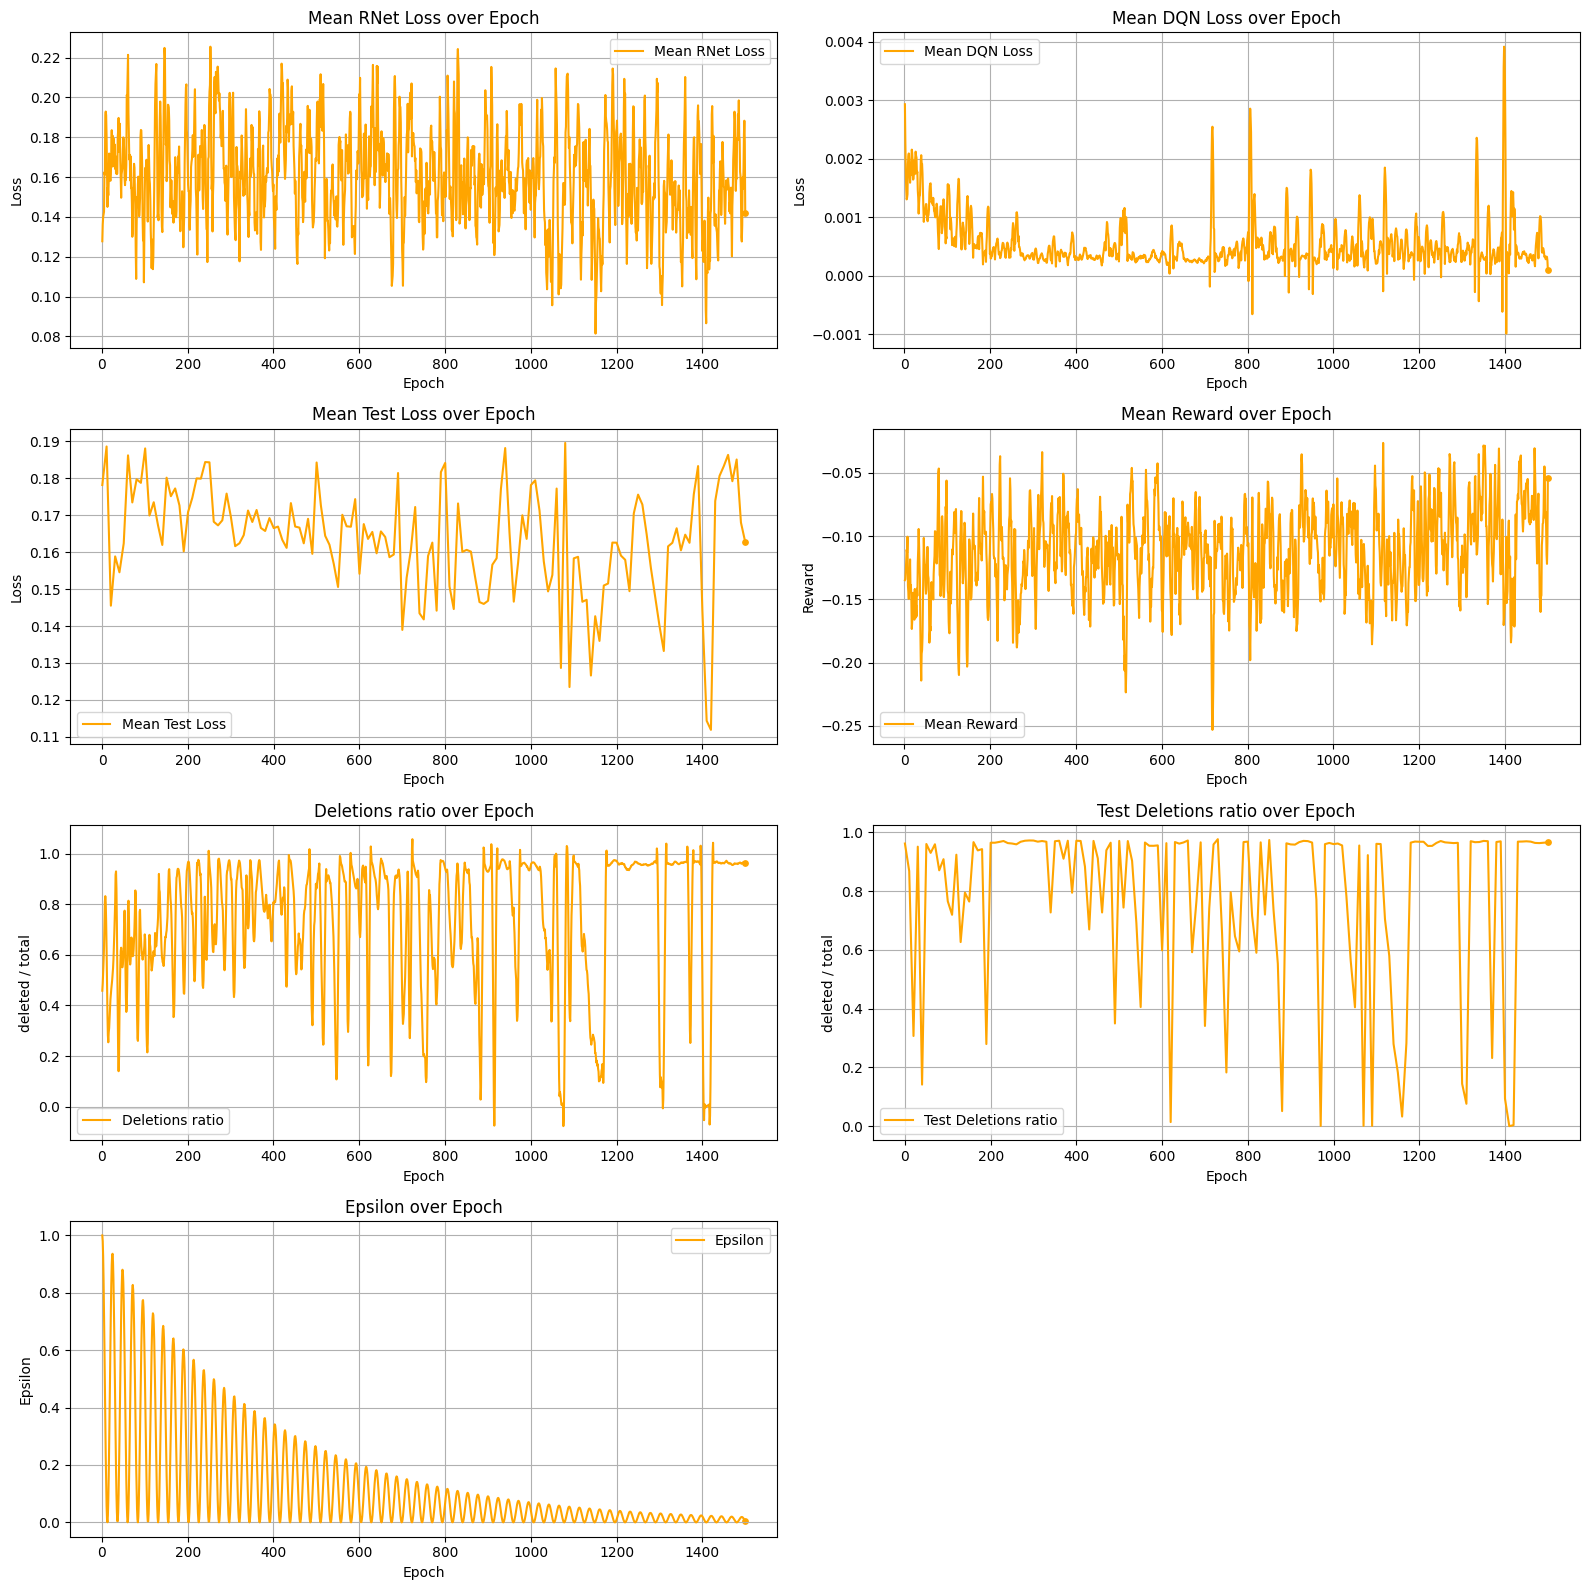

In [30]:
plots_data = {
    "Epoch": log_data["Epoch"],
    "Time": log_data["Time"],
    "Eval Epoch": log_data["Eval Epoch"],
    "Eval Time": log_data["Eval Time"],
    "Mean Reward": moving_average(log_data["Mean Reward"]),
    "Mean RNet Loss": moving_average(log_data["Mean RNet Loss"]),
    "Mean DQN Loss": moving_average(log_data["Mean DQN Loss"]),
    "Mean Test Loss": log_data["Mean Test Loss"],
    "Epsilon": log_data["Epsilon"],
    "Deletions ratio": moving_average(statistics["Deletions ratio"]),
    "Test Deletions ratio": statistics["Test Deletions ratio"],
    "Minimizing constant": minimizing_constant,
}

plots = LOGGER.log_plots

draw_plots(
    plots_data,
    plots,
    plot_width=8,
    plot_height=4,
    row_plots=2,
)